In [4]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号



from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [5]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  1
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [6]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [7]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict)
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # 新增方法，获取最后一个隐藏层的输出
    def hidden_output(self, x):
        # 遍历每一层，直到最后一个隐藏层
        for i in range(self.depth - 1):
            # 获取当前层的线性变换
            x = self.layers[i*2](x)
            # 获取当前层的激活函数
            x = self.layers[i*2 + 1](x)
        # 返回最后一个隐藏层的输出
        return x

In [8]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, X_star, u_star): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        self.mu_x, self.sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - self.mu_x) / self.sigma_x #对X_u进行标准化
        X_f = (X_f - self.mu_x) / self.sigma_x #对X_f进行标准化

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        #测试点数据
        self.X_star = torch.tensor(X_star).float().to(device)
        #测试点真实数据
        self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-8) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:, 0:1] #取u的第一列，对应状态1
        u2 = u[:, 1:2] #取u的第二列，对应状态2
        u3 = u[:, 2:3] #取u的第三列，对应状态3

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        #归一化
        u_x_1 = u_x_1 / self.sigma_x
        u_x_2 = u_x_2 / self.sigma_x
        u_x_3 = u_x_3 / self.sigma_x
        
        #计算残差
        residual_1 = u_x_1-(-1.286e-4*u1)
        residual_2 = u_x_2-(5.6e-5*u1-1.006e-4*u2)
        residual_3 = u_x_3-(7.26e-5*u1+1.006e-4*u2)

        loss_1 = torch.mean(residual_1 ** 2)
        loss_2 = torch.mean(residual_2 ** 2)
        loss_3 = torch.mean(residual_3 ** 2)

        loss_f = loss_1 + loss_2 + loss_3
        return loss_f
    
      
    
    def train(self, nIter):

        # 初始化一个列表来存储每个epoch的权重矩阵
        self.weights = []   


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # record the test error
            self.dnn.eval() #将神经网络切换为评估模式
            with torch.no_grad():
                u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u
            # batch_size = 100  # 设置批次大小
            # n = len(self.x_star)
            # u_real_pred = []
            # for i in range(0, n, batch_size):
            #     x_star_batch = self.x_star[i:i+batch_size]
            #     t_star_batch = self.t_star[i:i+batch_size]
            #     u_real_pred_batch = self.net_u(x_star_batch, t_star_batch)
            #     u_real_pred.append(u_real_pred_batch)
            # u_real_pred = torch.cat(u_real_pred)


            error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            self.test_error.append(error_test)

            # 计算 MAE和MSE
            mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # 记录 MAE 和 MSE
            self.test_error_mae.append(mae)
            self.test_error_mse.append(mse)

            # 记录每一层的权重矩阵
            epoch_weights = []
            for layer in self.dnn.layers:
                if isinstance(layer, torch.nn.Linear):  # 检查是否为全连接层
                    epoch_weights.append(layer.weight.data.clone())  # 使用.clone()来获取权重的副本
            self.weights.append(epoch_weights)

            W = self.weights

  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        
        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        return u
    

    def hidden_predict(self, x,t):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        self.dnn.eval()
        hidden_output = self.dnn.hidden_output(x)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [9]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [10]:
#调用matlab计算的结果
matlab_solver_solution_df = pd.read_csv('homo_80000.csv') #读取名为homo_80000.csv的文件并将内容加载到一个DataFrame中
matlab_solver_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2'] #设置DataFrame的列名

matlab_solver_solution_df.head() #显示前五行数据

time  state_0   state_1   state_2
0    16  0.99794  0.000894  0.001161
1    32  0.99589  0.001785  0.002321
2    48  0.99385  0.002673  0.003480
3    64  0.99180  0.003557  0.004639
4    80  0.98977  0.004439  0.005796

In [11]:
matlab_solver_solution_df.drop(labels='time', inplace=True, axis = 1) #使用pandas的drop方法删除一列（axis为0删除行），参数表示指定要删除的列名，以及直接在原DataFrame上进行操作，而不是返回一个新的DataFrame

matlab_solver_solution_df.head() #显示前五行数据

state_0   state_1   state_2
0  0.99794  0.000894  0.001161
1  0.99589  0.001785  0.002321
2  0.99385  0.002673  0.003480
3  0.99180  0.003557  0.004639
4  0.98977  0.004439  0.005796

In [17]:
#调用MCS（蒙特卡洛模拟）和解析方法（两种方法，分别是基于拉普拉斯变换和特征向量的方法）计算的结果
MCS_solution_df = pd.read_csv('MCS_homo_80000.csv') 
MCS_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')
eigenvector_solution_df.columns = ['state_0', 'state_1', 'state_2']

laplace_solution_df = pd.read_csv('analytical_solution_by_laplace_method.csv')
laplace_solution_df.columns = ['state_0', 'state_1', 'state_2']

In [18]:
MCS_solution_df.head()

time   state_0   state_1   state_2
0  16.0  0.997984  0.000895  0.001121
1  32.0  0.995997  0.001729  0.002274
2  48.0  0.993874  0.002629  0.003497
3  64.0  0.991758  0.003541  0.004701
4  80.0  0.989762  0.004375  0.005863

In [19]:
MCS_solution_df.drop(labels='time', inplace=True, axis = 1)
MCS_solution_df.head()

state_0   state_1   state_2
0  0.997984  0.000895  0.001121
1  0.995997  0.001729  0.002274
2  0.993874  0.002629  0.003497
3  0.991758  0.003541  0.004701
4  0.989762  0.004375  0.005863

In [ ]:
set_seed(1234) #设置随机数种子
#设置噪声水平为0
noise = 0.0        

N_u = 1
N_f = 5000

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 3]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([60000.0])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0]])          # 初始真实状态
X_f = np.linspace(lb, ub, N_f)     # 配位点位置

error_u = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值



nIter = 80000 #设置迭代次数为10000

# trainloss = [] #创建一个空列表，用于存储训练损失值
# testerror = [] #创建一个空列表，用于存储测试误差值


#创建PINN模型并输入各种参数     
model = PhysicsInformedNN(X_u, u, X_f, layers, lb, ub, X_star, u_star)

#获取当前时间并赋值给start_time  
start_time = time.time()   
#开始训练模型            
model.train(nIter)
#训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
elapsed = time.time() - start_time
#打印训练所花时间                
print('Training time: %.4f' % (elapsed))

#用训练好的模型调用predict方法进行预测，返回两个值（均为数组）
u_pred, f_pred = model.predict(X_star)
#计算误差（基于2范数）        
error_u.append(np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)) #计算误差，然后将误差添加到error_u列表中             
# 计算 MAE 和 MSE
mae = np.mean(np.abs(u_star - u_pred))
mse = np.mean((u_star - u_pred) ** 2)
# 记录 MAE 和 MSE
error_mae.append(mae)
error_mse.append(mse)

i+=1 #i加1
print(f'当前为第{i}次循环，种子为{seed}')
print('Error u : %e' % (np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2))) #打印误差  
print('MAE: %e' % mae) #打印MAE
print('MSE: %e' % mse) #打印MSE

In [8]:
#定义根据模型计算给定输入（点集中的点）的混沌度的函数，这个函数接受三个参数，分别是模型、输入数据和迭代次数
def calculate_chaos(model, X, num_iter):
    """
    计算模型混沌情况的函数。
    参数:
    - model: 用于预测的模型对象，必须有一个名为hidden_predict的方法。模型的hidden_predict为倒数第二层的输出，倒数第二层的维度必须和输入维度相同。
    - X: 输入数据，形状为(N_f_new, 2)，其中第一列为x0，第二列为t0。
    - num_iter: 计算混沌情况的迭代次数。
    返回:
    - distances: 每个采样点（与该采样点加上微扰比较）在最后一次迭代后的欧氏距离数组，形状为(N_f_new,)。
    """
    #对于所有的采样点
    x0 = X[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    # 利用x0和t0计算x{t}和t{t}，存储在xs中
    xs = [] #初始化xs
    x,t = model.hidden_predict(x0,t0) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    
    # 迭代预测
    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        xs.append([x,t]) #将x的数据添加到xs中
    #最后得到的xs是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应原始采样点的迭代结果


    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    x,t = model.hidden_predict(x1,t1) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

    # 迭代预测（扰动后）
    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)
        xs1.append([x,t]) #将x的数据添加到xs1中
    #最后得到的xs1是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应加了扰动后的采样点的迭代结果

    # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t
    last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    last_iter_xs1 = np.array(xs1[-1])
    #这两个数组的形状均为(2,N_f_new,1)，第一个代表x和t，第二个代表N_f_new个样本点得到的结果，第三个代表1个数

    # 计算这两个点的欧氏距离
    distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=0)
    #得到的是一个形状为（N_f_new,1）的数组，每个元素代表了两个点之间的欧氏距离，这里点在xt平面上

    distances = distances.flatten()

    #对distances进行归一化
    # distances = distances / np.linalg.norm(distances)
    # 对distances进行归一化前，检查分母是否接近零
    # norm = np.linalg.norm(distances)
    # if norm < 1e-10:  # 1e-10是一个非常小的数，用于检测norm是否接近于零
    #     distances = np.zeros_like(distances)  # 如果分母接近0，将distances设置为全零数组，因为范数为0时，distances中的值想对于彼此几乎没有差异，意味着所有点都几乎处于同一混沌度水平
    # else:
    #     distances = distances / norm

    # 现在可以安全地根据distances对点进行排序，即使在所有值都相同的情况下

    return distances

In [9]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]

nu = 0.01/np.pi
#设置噪声水平为0
noise = 0.0        

N_u = 100
N_f = 5000

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 3]
#读取名为burgers_shock的Matlab文件，文件中的数据存储在data变量中。这里的路径也要随着设备的情况修改 
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组         

# Doman bounds，分别获得X_star的相应列上的最小值和最大值，赋值给lb和ub,也就是说lb是x和t的最小值，ub是x和t的最大值，即lb和ub分别为[-1,0]和[1,1]
lb = X_star.min(0)
ub = X_star.max(0)    


#生成初值和边界值的训练基础数据
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #分别取X，T的第一行的转置(分别是x和全0列)，分别构成xx1的第一列和第二列
uu1 = Exact[0:1,:].T #取Exact的第一行的转置，赋值给uu1
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #分别取X，T的第一列(分别是全-1列和t)，分别构成xx2的第一列和第二列
uu2 = Exact[:,0:1] #取Exact的第一列，赋值给uu2
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #分别取X，T的最后一列(分别是全1列和t)，分别构成xx3的第一列和第二列
uu3 = Exact[:,-1:] #取Exact的最后一列，赋值给uu3

X_u_train_all = np.vstack([xx1, xx2, xx3]) #X_u_train=(xx1;xx2;xx3)

u_train_all = np.vstack([uu1, uu2, uu3]) #u_train=(uu1;uu2;uu3)


#1.生成初值边界值训练数据，以及测试数据

#从所有的初值边界值训练基础数据中选取N_u=100个点
idx = np.linspace(0, X_u_train_all.shape[0] - 1, N_u, dtype=int) #生成一个等差数列，从0到X_u_train的行数，间隔为1，赋值给idx
X_u_train = X_u_train_all[idx, :] #从X_u_train中选取idx对应的的N_u行，赋值给X_u_train
u_train = u_train_all[idx,:] #从u_train中选取idx对应的的N_u行，赋值给u_train

error_u = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值

i = 0 #初始化i为0

# 创建文件夹
model_dir = 'Adam+LBFGS+LHS(5000)'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子



    #2.生成配位点并进行训练

    nIter = 50000 #设置迭代次数为10000
    nIterLBFGS = 500 #设置LBFGS迭代次数为500

    # trainloss = [] #创建一个空列表，用于存储训练损失值
    # testerror = [] #创建一个空列表，用于存储测试误差值
    
    # 调用quasirandom函数生成配位点
    X_f_train = caiyang(N_f, "LHS")

    # X_f_train = np.vstack((X_f_train, X_u_train_all)) #按行堆叠数组，即将X_f_train和X_u_train按行合并，得到一个新的数组X_f_train



    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu, X_star, u_star)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter,nIterLBFGS)
    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    #用训练好的模型调用predict方法进行预测，返回两个值（均为数组）
    u_pred, f_pred = model.predict(X_star)
    #计算误差（基于2范数）        
    error_u.append(np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(u_star - u_pred))
    mse = np.mean((u_star - u_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error u : %e' % (np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    
    # 保存模型到文件夹
    model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)



Adam:   0%|          | 0/50000 [00:00<?, ?it/s]


Adam:   0%|          | 1/50000 [00:00<1:34:46,  8.79it/s]


Adam:   0%|          | 14/50000 [00:00<11:14, 74.15it/s] 


Adam:   0%|          | 26/50000 [00:00<09:00, 92.49it/s]


Adam:   0%|          | 37/50000 [00:00<08:24, 98.97it/s]


Adam:   0%|          | 50/50000 [00:00<07:46, 107.06it/s]


Adam:   0%|          | 63/50000 [00:00<07:25, 112.04it/s]


Adam:   0%|          | 76/50000 [00:00<07:11, 115.80it/s]


Adam:   0%|          | 89/50000 [00:00<07:05, 117.22it/s]


Adam:   0%|          | 102/50000 [00:00<07:01, 118.49it/s]


Adam:   0%|          | 115/50000 [00:01<06:55, 120.11it/s]


Adam:   0%|          | 128/50000 [00:01<06:53, 120.56it/s]


Adam:   0%|          | 141/50000 [00:01<06:58, 119.01it/s]


Adam:   0%|          | 153/50000 [00:01<07:03, 117.77it/s]


Adam:   0%|          | 165/50000 [00:01<07:12, 115.16it/s]


Adam:   0%|          | 178/50000 [00:01<07:05, 117.03it/s]


Adam:   0%|          | 191/50000 [00:01<07:00, 118.39it/s]


Adam:   0%|          | 203/50000 [00:01<06:59, 118.63it/s]


Adam:   0%|          | 215/50000 [00:01<07:01, 118.05it/s]


Adam:   0%|          | 228/50000 [00:02<06:57, 119.12it/s]


Adam:   0%|          | 240/50000 [00:02<06:58, 119.03it/s]


Adam:   1%|          | 252/50000 [00:02<07:00, 118.31it/s]


Adam:   1%|          | 265/50000 [00:02<06:55, 119.65it/s]


Adam:   1%|          | 278/50000 [00:02<06:52, 120.54it/s]


Adam:   1%|          | 291/50000 [00:02<06:47, 121.87it/s]


Adam:   1%|          | 304/50000 [00:02<06:46, 122.38it/s]


Adam:   1%|          | 317/50000 [00:02<06:52, 120.33it/s]


Adam:   1%|          | 330/50000 [00:02<06:48, 121.71it/s]


Adam:   1%|          | 343/50000 [00:02<06:47, 121.75it/s]


Adam:   1%|          | 356/50000 [00:03<06:46, 122.17it/s]


Adam:   1%|          | 369/50000 [00:03<06:42, 123.26it/s]


Adam:   1%|          | 382/50000 [00:03<06:43, 123.00it/s]


Adam:   1%|          | 395/50000 [00:03<06:44, 122.50it/s]


Adam:   1%|          | 408/50000 [00:03<06:46, 122.06it/s]


Adam:   1%|          | 421/50000 [00:03<06:49, 120.94it/s]


Adam:   1%|          | 434/50000 [00:03<06:56, 118.94it/s]


Adam:   1%|          | 446/50000 [00:03<06:56, 118.95it/s]


Adam:   1%|          | 459/50000 [00:03<06:53, 119.94it/s]


Adam:   1%|          | 472/50000 [00:04<06:53, 119.90it/s]


Adam:   1%|          | 485/50000 [00:04<06:48, 121.09it/s]


Adam:   1%|          | 498/50000 [00:04<06:44, 122.39it/s]


Adam:   1%|          | 511/50000 [00:04<06:42, 122.91it/s]


Adam:   1%|          | 525/50000 [00:04<06:33, 125.58it/s]


Adam:   1%|          | 538/50000 [00:04<06:33, 125.63it/s]


Adam:   1%|          | 551/50000 [00:04<06:36, 124.82it/s]


Adam:   1%|          | 564/50000 [00:04<06:36, 124.56it/s]


Adam:   1%|          | 577/50000 [00:04<06:35, 125.10it/s]


Adam:   1%|          | 590/50000 [00:04<06:40, 123.45it/s]


Adam:   1%|          | 603/50000 [00:05<06:39, 123.66it/s]


Adam:   1%|          | 616/50000 [00:05<06:46, 121.37it/s]


Adam:   1%|▏         | 629/50000 [00:05<06:52, 119.67it/s]


Adam:   1%|▏         | 642/50000 [00:05<06:49, 120.54it/s]


Adam:   1%|▏         | 655/50000 [00:05<06:51, 119.95it/s]


Adam:   1%|▏         | 668/50000 [00:05<06:55, 118.76it/s]


Adam:   1%|▏         | 680/50000 [00:05<06:55, 118.84it/s]


Adam:   1%|▏         | 693/50000 [00:05<06:50, 119.99it/s]


Adam:   1%|▏         | 706/50000 [00:05<06:47, 120.90it/s]


Adam:   1%|▏         | 719/50000 [00:06<06:50, 119.95it/s]


Adam:   1%|▏         | 732/50000 [00:06<06:45, 121.51it/s]


Adam:   1%|▏         | 745/50000 [00:06<06:47, 120.76it/s]


Adam:   2%|▏         | 758/50000 [00:06<06:50, 119.90it/s]


Adam:   2%|▏         | 770/50000 [00:06<06:51, 119.74it/s]


Adam:   2%|▏         | 782/50000 [00:06<06:55, 118.32it/s]


Adam:   2%|▏         | 795/50000 [00:06<06:48, 120.42it/s]


Adam:   2%|▏         | 808/50000 [00:06<06:46, 121.12it/s]


Adam:   2%|▏         | 821/50000 [00:06<06:48, 120.34it/s]


Adam:   2%|▏         | 834/50000 [00:07<06:50, 119.84it/s]


Adam:   2%|▏         | 847/50000 [00:07<06:45, 121.25it/s]


Adam:   2%|▏         | 860/50000 [00:07<06:44, 121.57it/s]


Adam:   2%|▏         | 873/50000 [00:07<06:42, 122.20it/s]


Adam:   2%|▏         | 886/50000 [00:07<06:41, 122.24it/s]


Adam:   2%|▏         | 900/50000 [00:07<06:33, 124.64it/s]


Adam:   2%|▏         | 913/50000 [00:07<06:40, 122.61it/s]


Adam:   2%|▏         | 926/50000 [00:07<06:47, 120.52it/s]


Adam:   2%|▏         | 939/50000 [00:07<06:44, 121.35it/s]


Adam:   2%|▏         | 952/50000 [00:07<06:39, 122.66it/s]


Adam:   2%|▏         | 965/50000 [00:08<06:37, 123.48it/s]


Adam:   2%|▏         | 978/50000 [00:08<06:32, 124.80it/s]


Adam:   2%|▏         | 991/50000 [00:08<06:34, 124.31it/s]


Adam:   2%|▏         | 1004/50000 [00:08<06:37, 123.20it/s]


Adam:   2%|▏         | 1017/50000 [00:08<06:35, 123.77it/s]


Adam:   2%|▏         | 1030/50000 [00:08<06:33, 124.42it/s]


Adam:   2%|▏         | 1043/50000 [00:08<06:33, 124.52it/s]


Adam:   2%|▏         | 1056/50000 [00:08<06:32, 124.60it/s]


Adam:   2%|▏         | 1069/50000 [00:08<06:33, 124.29it/s]


Adam:   2%|▏         | 1082/50000 [00:09<06:31, 124.91it/s]


Adam:   2%|▏         | 1095/50000 [00:09<06:31, 124.78it/s]


Adam:   2%|▏         | 1108/50000 [00:09<06:34, 123.98it/s]


Adam:   2%|▏         | 1121/50000 [00:09<06:34, 124.01it/s]


Adam:   2%|▏         | 1134/50000 [00:09<06:34, 123.89it/s]


Adam:   2%|▏         | 1147/50000 [00:09<06:34, 123.84it/s]


Adam:   2%|▏         | 1160/50000 [00:09<06:35, 123.54it/s]


Adam:   2%|▏         | 1173/50000 [00:09<06:35, 123.57it/s]


Adam:   2%|▏         | 1186/50000 [00:09<06:34, 123.64it/s]


Adam:   2%|▏         | 1199/50000 [00:09<06:37, 122.90it/s]


Adam:   2%|▏         | 1212/50000 [00:10<06:38, 122.57it/s]


Adam:   2%|▏         | 1225/50000 [00:10<06:36, 122.92it/s]


Adam:   2%|▏         | 1238/50000 [00:10<06:34, 123.50it/s]


Adam:   3%|▎         | 1251/50000 [00:10<06:32, 124.06it/s]


Adam:   3%|▎         | 1264/50000 [00:10<06:33, 123.86it/s]


Adam:   3%|▎         | 1277/50000 [00:10<06:35, 123.34it/s]


Adam:   3%|▎         | 1290/50000 [00:10<06:34, 123.61it/s]


Adam:   3%|▎         | 1303/50000 [00:10<06:30, 124.64it/s]


Adam:   3%|▎         | 1316/50000 [00:10<06:33, 123.79it/s]


Adam:   3%|▎         | 1329/50000 [00:11<06:34, 123.42it/s]


Adam:   3%|▎         | 1342/50000 [00:11<06:35, 123.16it/s]


Adam:   3%|▎         | 1355/50000 [00:11<06:34, 123.25it/s]


Adam:   3%|▎         | 1368/50000 [00:11<06:33, 123.47it/s]


Adam:   3%|▎         | 1381/50000 [00:11<06:29, 124.71it/s]


Adam:   3%|▎         | 1394/50000 [00:11<06:32, 123.91it/s]


Adam:   3%|▎         | 1407/50000 [00:11<06:42, 120.87it/s]


Adam:   3%|▎         | 1420/50000 [00:11<06:44, 120.18it/s]


Adam:   3%|▎         | 1433/50000 [00:11<06:39, 121.58it/s]


Adam:   3%|▎         | 1446/50000 [00:11<06:37, 122.16it/s]


Adam:   3%|▎         | 1459/50000 [00:12<06:36, 122.40it/s]


Adam:   3%|▎         | 1472/50000 [00:12<06:34, 122.89it/s]


Adam:   3%|▎         | 1485/50000 [00:12<06:30, 124.32it/s]


Adam:   3%|▎         | 1498/50000 [00:12<06:36, 122.44it/s]


Adam:   3%|▎         | 1511/50000 [00:12<06:40, 121.04it/s]


Adam:   3%|▎         | 1524/50000 [00:12<06:34, 122.89it/s]


Adam:   3%|▎         | 1537/50000 [00:12<06:34, 122.81it/s]


Adam:   3%|▎         | 1550/50000 [00:12<06:31, 123.79it/s]


Adam:   3%|▎         | 1563/50000 [00:12<06:30, 124.08it/s]


Adam:   3%|▎         | 1576/50000 [00:13<06:30, 124.00it/s]


Adam:   3%|▎         | 1590/50000 [00:13<06:21, 127.05it/s]


Adam:   3%|▎         | 1603/50000 [00:13<06:28, 124.58it/s]


Adam:   3%|▎         | 1616/50000 [00:13<06:28, 124.56it/s]


Adam:   3%|▎         | 1629/50000 [00:13<06:29, 124.10it/s]


Adam:   3%|▎         | 1642/50000 [00:13<06:32, 123.18it/s]


Adam:   3%|▎         | 1655/50000 [00:13<06:38, 121.20it/s]


Adam:   3%|▎         | 1668/50000 [00:13<06:41, 120.50it/s]


Adam:   3%|▎         | 1681/50000 [00:13<06:40, 120.76it/s]


Adam:   3%|▎         | 1694/50000 [00:14<06:56, 116.02it/s]


Adam:   3%|▎         | 1707/50000 [00:14<06:50, 117.77it/s]


Adam:   3%|▎         | 1720/50000 [00:14<06:43, 119.66it/s]


Adam:   3%|▎         | 1733/50000 [00:14<06:39, 120.77it/s]


Adam:   3%|▎         | 1746/50000 [00:14<06:36, 121.76it/s]


Adam:   4%|▎         | 1759/50000 [00:14<06:32, 122.82it/s]


Adam:   4%|▎         | 1772/50000 [00:14<06:30, 123.57it/s]


Adam:   4%|▎         | 1785/50000 [00:14<06:35, 122.04it/s]


Adam:   4%|▎         | 1798/50000 [00:14<06:41, 119.93it/s]


Adam:   4%|▎         | 1811/50000 [00:14<06:42, 119.60it/s]


Adam:   4%|▎         | 1823/50000 [00:15<06:44, 119.14it/s]


Adam:   4%|▎         | 1835/50000 [00:15<06:45, 118.83it/s]


Adam:   4%|▎         | 1847/50000 [00:15<06:47, 118.26it/s]


Adam:   4%|▎         | 1859/50000 [00:15<06:48, 117.86it/s]


Adam:   4%|▎         | 1872/50000 [00:15<06:45, 118.69it/s]


Adam:   4%|▍         | 1885/50000 [00:15<06:41, 119.92it/s]


Adam:   4%|▍         | 1898/50000 [00:15<06:40, 120.21it/s]


Adam:   4%|▍         | 1911/50000 [00:15<06:42, 119.58it/s]


Adam:   4%|▍         | 1924/50000 [00:15<06:39, 120.23it/s]


Adam:   4%|▍         | 1937/50000 [00:16<06:48, 117.53it/s]


Adam:   4%|▍         | 1949/50000 [00:16<06:47, 117.89it/s]


Adam:   4%|▍         | 1961/50000 [00:16<06:51, 116.71it/s]


Adam:   4%|▍         | 1973/50000 [00:16<06:49, 117.35it/s]


Adam:   4%|▍         | 1986/50000 [00:16<06:41, 119.53it/s]


Adam:   4%|▍         | 1999/50000 [00:16<06:39, 120.19it/s]


Adam:   4%|▍         | 2012/50000 [00:16<06:39, 120.26it/s]


Adam:   4%|▍         | 2025/50000 [00:16<06:32, 122.17it/s]


Adam:   4%|▍         | 2038/50000 [00:16<06:31, 122.42it/s]


Adam:   4%|▍         | 2051/50000 [00:16<06:39, 120.02it/s]


Adam:   4%|▍         | 2064/50000 [00:17<06:37, 120.56it/s]


Adam:   4%|▍         | 2077/50000 [00:17<06:36, 120.78it/s]


Adam:   4%|▍         | 2090/50000 [00:17<06:35, 121.07it/s]


Adam:   4%|▍         | 2103/50000 [00:17<06:39, 119.75it/s]


Adam:   4%|▍         | 2116/50000 [00:17<06:39, 119.91it/s]


Adam:   4%|▍         | 2129/50000 [00:17<06:39, 119.97it/s]


Adam:   4%|▍         | 2142/50000 [00:17<06:42, 118.96it/s]


Adam:   4%|▍         | 2155/50000 [00:17<06:38, 120.11it/s]


Adam:   4%|▍         | 2168/50000 [00:17<06:38, 119.95it/s]


Adam:   4%|▍         | 2181/50000 [00:18<06:34, 121.07it/s]


Adam:   4%|▍         | 2194/50000 [00:18<06:31, 122.09it/s]


Adam:   4%|▍         | 2207/50000 [00:18<06:28, 123.16it/s]


Adam:   4%|▍         | 2220/50000 [00:18<06:25, 123.80it/s]


Adam:   4%|▍         | 2233/50000 [00:18<06:23, 124.58it/s]


Adam:   4%|▍         | 2246/50000 [00:18<06:22, 124.83it/s]


Adam:   5%|▍         | 2259/50000 [00:18<06:27, 123.32it/s]


Adam:   5%|▍         | 2272/50000 [00:18<06:25, 123.77it/s]


Adam:   5%|▍         | 2285/50000 [00:18<06:22, 124.74it/s]


Adam:   5%|▍         | 2298/50000 [00:19<06:24, 124.06it/s]


Adam:   5%|▍         | 2311/50000 [00:19<06:22, 124.52it/s]


Adam:   5%|▍         | 2324/50000 [00:19<06:22, 124.65it/s]


Adam:   5%|▍         | 2337/50000 [00:19<06:22, 124.60it/s]


Adam:   5%|▍         | 2350/50000 [00:19<06:21, 124.88it/s]


Adam:   5%|▍         | 2364/50000 [00:19<06:08, 129.14it/s]


Adam:   5%|▍         | 2377/50000 [00:19<06:18, 125.98it/s]


Adam:   5%|▍         | 2390/50000 [00:19<06:24, 123.68it/s]


Adam:   5%|▍         | 2403/50000 [00:19<06:29, 122.21it/s]


Adam:   5%|▍         | 2416/50000 [00:19<06:28, 122.54it/s]


Adam:   5%|▍         | 2429/50000 [00:20<06:28, 122.44it/s]


Adam:   5%|▍         | 2442/50000 [00:20<06:28, 122.55it/s]


Adam:   5%|▍         | 2455/50000 [00:20<06:31, 121.38it/s]


Adam:   5%|▍         | 2468/50000 [00:20<06:39, 118.88it/s]


Adam:   5%|▍         | 2480/50000 [00:20<06:40, 118.64it/s]


Adam:   5%|▍         | 2493/50000 [00:20<06:38, 119.28it/s]


Adam:   5%|▌         | 2506/50000 [00:20<06:33, 120.73it/s]


Adam:   5%|▌         | 2519/50000 [00:20<06:36, 119.75it/s]


Adam:   5%|▌         | 2532/50000 [00:20<06:32, 120.94it/s]


Adam:   5%|▌         | 2545/50000 [00:21<06:26, 122.93it/s]


Adam:   5%|▌         | 2558/50000 [00:21<06:37, 119.31it/s]


Adam:   5%|▌         | 2572/50000 [00:21<06:26, 122.72it/s]


Adam:   5%|▌         | 2585/50000 [00:21<06:26, 122.81it/s]


Adam:   5%|▌         | 2598/50000 [00:21<06:31, 121.00it/s]


Adam:   5%|▌         | 2611/50000 [00:21<06:36, 119.56it/s]


Adam:   5%|▌         | 2624/50000 [00:21<06:34, 120.12it/s]


Adam:   5%|▌         | 2637/50000 [00:21<06:35, 119.80it/s]


Adam:   5%|▌         | 2650/50000 [00:21<06:43, 117.48it/s]


Adam:   5%|▌         | 2662/50000 [00:22<06:44, 117.13it/s]


Adam:   5%|▌         | 2675/50000 [00:22<06:38, 118.78it/s]


Adam:   5%|▌         | 2687/50000 [00:22<06:44, 116.90it/s]


Adam:   5%|▌         | 2700/50000 [00:22<06:39, 118.45it/s]


Adam:   5%|▌         | 2713/50000 [00:22<06:34, 119.72it/s]


Adam:   5%|▌         | 2726/50000 [00:22<06:31, 120.78it/s]


Adam:   5%|▌         | 2739/50000 [00:22<06:32, 120.27it/s]


Adam:   6%|▌         | 2752/50000 [00:22<06:31, 120.68it/s]


Adam:   6%|▌         | 2765/50000 [00:22<06:31, 120.64it/s]


Adam:   6%|▌         | 2778/50000 [00:22<06:43, 117.07it/s]


Adam:   6%|▌         | 2791/50000 [00:23<06:35, 119.51it/s]


Adam:   6%|▌         | 2803/50000 [00:23<06:34, 119.62it/s]


Adam:   6%|▌         | 2816/50000 [00:23<06:31, 120.53it/s]


Adam:   6%|▌         | 2829/50000 [00:23<06:34, 119.54it/s]


Adam:   6%|▌         | 2842/50000 [00:23<06:29, 121.12it/s]


Adam:   6%|▌         | 2855/50000 [00:23<06:25, 122.43it/s]


Adam:   6%|▌         | 2868/50000 [00:23<06:26, 122.05it/s]


Adam:   6%|▌         | 2881/50000 [00:23<06:20, 123.76it/s]


Adam:   6%|▌         | 2894/50000 [00:23<06:21, 123.57it/s]


Adam:   6%|▌         | 2907/50000 [00:24<06:19, 124.21it/s]


Adam:   6%|▌         | 2920/50000 [00:24<06:18, 124.49it/s]


Adam:   6%|▌         | 2933/50000 [00:24<06:21, 123.37it/s]


Adam:   6%|▌         | 2946/50000 [00:24<06:17, 124.64it/s]


Adam:   6%|▌         | 2959/50000 [00:24<06:20, 123.76it/s]


Adam:   6%|▌         | 2972/50000 [00:24<06:19, 123.97it/s]


Adam:   6%|▌         | 2985/50000 [00:24<06:19, 123.89it/s]


Adam:   6%|▌         | 2998/50000 [00:24<06:17, 124.49it/s]


Adam:   6%|▌         | 3011/50000 [00:24<06:16, 124.67it/s]


Adam:   6%|▌         | 3024/50000 [00:24<06:16, 124.89it/s]


Adam:   6%|▌         | 3037/50000 [00:25<06:15, 125.13it/s]


Adam:   6%|▌         | 3050/50000 [00:25<06:16, 124.80it/s]


Adam:   6%|▌         | 3063/50000 [00:25<06:16, 124.74it/s]


Adam:   6%|▌         | 3076/50000 [00:25<06:26, 121.50it/s]


Adam:   6%|▌         | 3089/50000 [00:25<06:21, 122.81it/s]


Adam:   6%|▌         | 3102/50000 [00:25<06:18, 123.92it/s]


Adam:   6%|▌         | 3115/50000 [00:25<06:16, 124.52it/s]


Adam:   6%|▋         | 3128/50000 [00:25<06:17, 124.23it/s]


Adam:   6%|▋         | 3141/50000 [00:25<06:15, 124.71it/s]


Adam:   6%|▋         | 3154/50000 [00:26<06:16, 124.49it/s]


Adam:   6%|▋         | 3167/50000 [00:26<06:14, 125.03it/s]


Adam:   6%|▋         | 3180/50000 [00:26<06:15, 124.75it/s]


Adam:   6%|▋         | 3193/50000 [00:26<06:14, 125.10it/s]


Adam:   6%|▋         | 3206/50000 [00:26<06:17, 123.84it/s]


Adam:   6%|▋         | 3219/50000 [00:26<06:17, 123.81it/s]


Adam:   6%|▋         | 3232/50000 [00:26<06:15, 124.39it/s]


Adam:   6%|▋         | 3245/50000 [00:26<06:27, 120.76it/s]


Adam:   7%|▋         | 3258/50000 [00:26<06:25, 121.16it/s]


Adam:   7%|▋         | 3271/50000 [00:26<06:24, 121.53it/s]


Adam:   7%|▋         | 3284/50000 [00:27<06:22, 122.11it/s]


Adam:   7%|▋         | 3297/50000 [00:27<06:21, 122.31it/s]


Adam:   7%|▋         | 3310/50000 [00:27<06:22, 122.13it/s]


Adam:   7%|▋         | 3323/50000 [00:27<06:20, 122.63it/s]


Adam:   7%|▋         | 3336/50000 [00:27<06:19, 122.94it/s]


Adam:   7%|▋         | 3349/50000 [00:27<06:13, 124.89it/s]


Adam:   7%|▋         | 3363/50000 [00:27<06:08, 126.44it/s]


Adam:   7%|▋         | 3376/50000 [00:27<06:11, 125.53it/s]


Adam:   7%|▋         | 3389/50000 [00:27<06:20, 122.53it/s]


Adam:   7%|▋         | 3402/50000 [00:28<06:19, 122.85it/s]


Adam:   7%|▋         | 3415/50000 [00:28<06:23, 121.36it/s]


Adam:   7%|▋         | 3428/50000 [00:28<06:21, 122.23it/s]


Adam:   7%|▋         | 3441/50000 [00:28<06:23, 121.56it/s]


Adam:   7%|▋         | 3454/50000 [00:28<06:25, 120.82it/s]


Adam:   7%|▋         | 3467/50000 [00:28<06:26, 120.33it/s]


Adam:   7%|▋         | 3480/50000 [00:28<06:30, 119.03it/s]


Adam:   7%|▋         | 3492/50000 [00:28<06:37, 116.91it/s]


Adam:   7%|▋         | 3505/50000 [00:28<06:30, 119.10it/s]


Adam:   7%|▋         | 3518/50000 [00:28<06:27, 120.04it/s]


Adam:   7%|▋         | 3531/50000 [00:29<06:24, 120.91it/s]


Adam:   7%|▋         | 3544/50000 [00:29<06:19, 122.36it/s]


Adam:   7%|▋         | 3557/50000 [00:29<06:23, 121.10it/s]


Adam:   7%|▋         | 3570/50000 [00:29<06:23, 120.92it/s]


Adam:   7%|▋         | 3583/50000 [00:29<06:21, 121.60it/s]


Adam:   7%|▋         | 3596/50000 [00:29<06:19, 122.43it/s]


Adam:   7%|▋         | 3609/50000 [00:29<06:16, 123.11it/s]


Adam:   7%|▋         | 3622/50000 [00:29<06:14, 123.73it/s]


Adam:   7%|▋         | 3635/50000 [00:29<06:12, 124.48it/s]


Adam:   7%|▋         | 3648/50000 [00:30<06:12, 124.51it/s]


Adam:   7%|▋         | 3661/50000 [00:30<06:11, 124.90it/s]


Adam:   7%|▋         | 3674/50000 [00:30<06:10, 125.13it/s]


Adam:   7%|▋         | 3687/50000 [00:30<06:10, 125.06it/s]


Adam:   7%|▋         | 3700/50000 [00:30<06:09, 125.35it/s]


Adam:   7%|▋         | 3713/50000 [00:30<06:18, 122.45it/s]


Adam:   7%|▋         | 3726/50000 [00:30<06:25, 120.04it/s]


Adam:   7%|▋         | 3739/50000 [00:30<06:19, 122.06it/s]


Adam:   8%|▊         | 3752/50000 [00:30<06:15, 123.08it/s]


Adam:   8%|▊         | 3765/50000 [00:31<06:15, 123.18it/s]


Adam:   8%|▊         | 3778/50000 [00:31<06:13, 123.79it/s]


Adam:   8%|▊         | 3791/50000 [00:31<06:15, 123.02it/s]


Adam:   8%|▊         | 3804/50000 [00:31<06:17, 122.42it/s]


Adam:   8%|▊         | 3817/50000 [00:31<06:13, 123.51it/s]


Adam:   8%|▊         | 3830/50000 [00:31<06:23, 120.48it/s]


Adam:   8%|▊         | 3843/50000 [00:31<06:21, 120.90it/s]


Adam:   8%|▊         | 3856/50000 [00:31<06:18, 121.91it/s]


Adam:   8%|▊         | 3869/50000 [00:31<06:15, 122.69it/s]


Adam:   8%|▊         | 3882/50000 [00:31<06:18, 121.89it/s]


Adam:   8%|▊         | 3895/50000 [00:32<06:15, 122.71it/s]


Adam:   8%|▊         | 3908/50000 [00:32<06:11, 124.17it/s]


Adam:   8%|▊         | 3921/50000 [00:32<06:28, 118.47it/s]


Adam:   8%|▊         | 3934/50000 [00:32<06:25, 119.40it/s]


Adam:   8%|▊         | 3947/50000 [00:32<06:23, 120.13it/s]


Adam:   8%|▊         | 3960/50000 [00:32<06:27, 118.79it/s]


Adam:   8%|▊         | 3972/50000 [00:32<06:40, 114.97it/s]


Adam:   8%|▊         | 3985/50000 [00:32<06:33, 117.01it/s]


Adam:   8%|▊         | 3998/50000 [00:32<06:29, 118.23it/s]


Adam:   8%|▊         | 4011/50000 [00:33<06:23, 119.98it/s]


Adam:   8%|▊         | 4024/50000 [00:33<06:20, 120.78it/s]


Adam:   8%|▊         | 4037/50000 [00:33<06:25, 119.17it/s]


Adam:   8%|▊         | 4049/50000 [00:33<06:27, 118.61it/s]


Adam:   8%|▊         | 4062/50000 [00:33<06:22, 120.01it/s]


Adam:   8%|▊         | 4075/50000 [00:33<06:14, 122.64it/s]


Adam:   8%|▊         | 4088/50000 [00:33<06:18, 121.36it/s]


Adam:   8%|▊         | 4101/50000 [00:33<06:17, 121.54it/s]


Adam:   8%|▊         | 4114/50000 [00:33<06:15, 122.13it/s]


Adam:   8%|▊         | 4127/50000 [00:33<06:12, 123.12it/s]


Adam:   8%|▊         | 4140/50000 [00:34<06:11, 123.46it/s]


Adam:   8%|▊         | 4153/50000 [00:34<06:09, 124.21it/s]


Adam:   8%|▊         | 4166/50000 [00:34<06:08, 124.29it/s]


Adam:   8%|▊         | 4179/50000 [00:34<06:10, 123.58it/s]


Adam:   8%|▊         | 4192/50000 [00:34<06:17, 121.24it/s]


Adam:   8%|▊         | 4205/50000 [00:34<06:16, 121.50it/s]


Adam:   8%|▊         | 4218/50000 [00:34<06:25, 118.80it/s]


Adam:   8%|▊         | 4230/50000 [00:34<06:32, 116.64it/s]


Adam:   8%|▊         | 4243/50000 [00:34<06:28, 117.84it/s]


Adam:   9%|▊         | 4256/50000 [00:35<06:21, 119.80it/s]


Adam:   9%|▊         | 4269/50000 [00:35<06:20, 120.29it/s]


Adam:   9%|▊         | 4282/50000 [00:35<06:17, 121.06it/s]


Adam:   9%|▊         | 4295/50000 [00:35<06:34, 115.98it/s]


Adam:   9%|▊         | 4308/50000 [00:35<06:32, 116.48it/s]


Adam:   9%|▊         | 4321/50000 [00:35<06:28, 117.70it/s]


Adam:   9%|▊         | 4334/50000 [00:35<06:23, 119.06it/s]


Adam:   9%|▊         | 4347/50000 [00:35<06:19, 120.19it/s]


Adam:   9%|▊         | 4360/50000 [00:35<06:25, 118.50it/s]


Adam:   9%|▊         | 4372/50000 [00:36<06:24, 118.61it/s]


Adam:   9%|▉         | 4385/50000 [00:36<06:19, 120.25it/s]


Adam:   9%|▉         | 4398/50000 [00:36<06:13, 122.25it/s]


Adam:   9%|▉         | 4411/50000 [00:36<06:14, 121.89it/s]


Adam:   9%|▉         | 4424/50000 [00:36<06:24, 118.53it/s]


Adam:   9%|▉         | 4436/50000 [00:36<06:29, 116.85it/s]


Adam:   9%|▉         | 4448/50000 [00:36<06:39, 113.92it/s]


Adam:   9%|▉         | 4461/50000 [00:36<06:31, 116.40it/s]


Adam:   9%|▉         | 4474/50000 [00:36<06:22, 118.98it/s]


Adam:   9%|▉         | 4487/50000 [00:37<06:16, 120.79it/s]


Adam:   9%|▉         | 4500/50000 [00:37<06:12, 122.10it/s]


Adam:   9%|▉         | 4513/50000 [00:37<06:12, 122.07it/s]


Adam:   9%|▉         | 4526/50000 [00:37<06:08, 123.37it/s]


Adam:   9%|▉         | 4539/50000 [00:37<06:06, 124.17it/s]


Adam:   9%|▉         | 4552/50000 [00:37<06:05, 124.24it/s]


Adam:   9%|▉         | 4565/50000 [00:37<06:05, 124.17it/s]


Adam:   9%|▉         | 4578/50000 [00:37<06:07, 123.47it/s]


Adam:   9%|▉         | 4591/50000 [00:37<06:16, 120.45it/s]


Adam:   9%|▉         | 4604/50000 [00:37<06:18, 119.95it/s]


Adam:   9%|▉         | 4617/50000 [00:38<06:14, 121.15it/s]


Adam:   9%|▉         | 4630/50000 [00:38<06:10, 122.52it/s]


Adam:   9%|▉         | 4644/50000 [00:38<06:02, 125.15it/s]


Adam:   9%|▉         | 4657/50000 [00:38<06:04, 124.35it/s]


Adam:   9%|▉         | 4670/50000 [00:38<06:08, 122.96it/s]


Adam:   9%|▉         | 4683/50000 [00:38<06:06, 123.58it/s]


Adam:   9%|▉         | 4696/50000 [00:38<06:10, 122.43it/s]


Adam:   9%|▉         | 4709/50000 [00:38<06:11, 122.06it/s]


Adam:   9%|▉         | 4722/50000 [00:38<06:13, 121.19it/s]


Adam:   9%|▉         | 4735/50000 [00:39<06:12, 121.43it/s]


Adam:   9%|▉         | 4748/50000 [00:39<06:08, 122.64it/s]


Adam:  10%|▉         | 4761/50000 [00:39<06:07, 123.10it/s]


Adam:  10%|▉         | 4774/50000 [00:39<06:14, 120.80it/s]


Adam:  10%|▉         | 4787/50000 [00:39<06:11, 121.73it/s]


Adam:  10%|▉         | 4800/50000 [00:39<06:09, 122.24it/s]


Adam:  10%|▉         | 4813/50000 [00:39<06:09, 122.28it/s]


Adam:  10%|▉         | 4826/50000 [00:39<06:07, 122.81it/s]


Adam:  10%|▉         | 4839/50000 [00:39<06:03, 124.11it/s]


Adam:  10%|▉         | 4852/50000 [00:39<06:03, 124.34it/s]


Adam:  10%|▉         | 4865/50000 [00:40<06:02, 124.56it/s]


Adam:  10%|▉         | 4878/50000 [00:40<06:02, 124.60it/s]


Adam:  10%|▉         | 4891/50000 [00:40<06:01, 124.66it/s]


Adam:  10%|▉         | 4904/50000 [00:40<06:00, 125.10it/s]


Adam:  10%|▉         | 4917/50000 [00:40<06:01, 124.55it/s]


Adam:  10%|▉         | 4930/50000 [00:40<06:00, 125.18it/s]


Adam:  10%|▉         | 4943/50000 [00:40<06:00, 124.92it/s]


Adam:  10%|▉         | 4956/50000 [00:40<06:02, 124.26it/s]


Adam:  10%|▉         | 4969/50000 [00:40<06:04, 123.70it/s]


Adam:  10%|▉         | 4982/50000 [00:41<06:01, 124.43it/s]


Adam:  10%|▉         | 4995/50000 [00:41<06:01, 124.48it/s]


Adam:  10%|█         | 5008/50000 [00:41<06:03, 123.74it/s]


Adam:  10%|█         | 5021/50000 [00:41<06:25, 116.75it/s]


Adam:  10%|█         | 5033/50000 [00:41<06:22, 117.57it/s]


Adam:  10%|█         | 5046/50000 [00:41<06:15, 119.71it/s]


Adam:  10%|█         | 5059/50000 [00:41<06:10, 121.30it/s]


Adam:  10%|█         | 5072/50000 [00:41<06:06, 122.60it/s]


Adam:  10%|█         | 5085/50000 [00:41<06:04, 123.29it/s]


Adam:  10%|█         | 5098/50000 [00:41<06:03, 123.57it/s]


Adam:  10%|█         | 5111/50000 [00:42<06:03, 123.51it/s]


Adam:  10%|█         | 5124/50000 [00:42<06:06, 122.60it/s]


Adam:  10%|█         | 5137/50000 [00:42<07:09, 104.49it/s]


Adam:  10%|█         | 5150/50000 [00:42<06:48, 109.71it/s]


Adam:  10%|█         | 5163/50000 [00:42<06:35, 113.43it/s]


Adam:  10%|█         | 5175/50000 [00:42<06:34, 113.63it/s]


Adam:  10%|█         | 5188/50000 [00:42<06:25, 116.31it/s]


Adam:  10%|█         | 5200/50000 [00:42<06:25, 116.07it/s]


Adam:  10%|█         | 5213/50000 [00:42<06:18, 118.32it/s]


Adam:  10%|█         | 5225/50000 [00:43<06:19, 117.97it/s]


Adam:  10%|█         | 5238/50000 [00:43<06:17, 118.60it/s]


Adam:  11%|█         | 5251/50000 [00:43<06:10, 120.86it/s]


Adam:  11%|█         | 5264/50000 [00:43<06:11, 120.58it/s]


Adam:  11%|█         | 5277/50000 [00:43<06:08, 121.39it/s]


Adam:  11%|█         | 5290/50000 [00:43<06:05, 122.45it/s]


Adam:  11%|█         | 5303/50000 [00:43<06:13, 119.81it/s]


Adam:  11%|█         | 5316/50000 [00:43<06:15, 119.05it/s]


Adam:  11%|█         | 5329/50000 [00:43<06:12, 119.95it/s]


Adam:  11%|█         | 5342/50000 [00:44<06:12, 119.73it/s]


Adam:  11%|█         | 5355/50000 [00:44<06:11, 120.12it/s]


Adam:  11%|█         | 5368/50000 [00:44<06:10, 120.46it/s]


Adam:  11%|█         | 5381/50000 [00:44<06:12, 119.93it/s]


Adam:  11%|█         | 5394/50000 [00:44<06:11, 120.06it/s]


Adam:  11%|█         | 5407/50000 [00:44<06:08, 121.12it/s]


Adam:  11%|█         | 5420/50000 [00:44<06:06, 121.77it/s]


Adam:  11%|█         | 5433/50000 [00:44<06:05, 121.87it/s]


Adam:  11%|█         | 5446/50000 [00:44<06:11, 119.89it/s]


Adam:  11%|█         | 5459/50000 [00:45<06:07, 121.08it/s]


Adam:  11%|█         | 5472/50000 [00:45<06:04, 122.05it/s]


Adam:  11%|█         | 5485/50000 [00:45<06:02, 122.95it/s]


Adam:  11%|█         | 5498/50000 [00:45<06:07, 121.00it/s]


Adam:  11%|█         | 5511/50000 [00:45<06:16, 118.20it/s]


Adam:  11%|█         | 5523/50000 [00:45<06:15, 118.47it/s]


Adam:  11%|█         | 5535/50000 [00:45<06:28, 114.48it/s]


Adam:  11%|█         | 5548/50000 [00:45<06:19, 117.12it/s]


Adam:  11%|█         | 5561/50000 [00:45<06:14, 118.54it/s]


Adam:  11%|█         | 5574/50000 [00:45<06:08, 120.44it/s]


Adam:  11%|█         | 5587/50000 [00:46<06:06, 121.31it/s]


Adam:  11%|█         | 5600/50000 [00:46<05:58, 123.79it/s]


Adam:  11%|█         | 5613/50000 [00:46<05:59, 123.63it/s]


Adam:  11%|█▏        | 5626/50000 [00:46<06:06, 121.14it/s]


Adam:  11%|█▏        | 5639/50000 [00:46<06:04, 121.56it/s]


Adam:  11%|█▏        | 5652/50000 [00:46<06:04, 121.76it/s]


Adam:  11%|█▏        | 5665/50000 [00:46<06:02, 122.29it/s]


Adam:  11%|█▏        | 5678/50000 [00:46<06:02, 122.15it/s]


Adam:  11%|█▏        | 5691/50000 [00:46<06:04, 121.57it/s]


Adam:  11%|█▏        | 5704/50000 [00:47<06:04, 121.66it/s]


Adam:  11%|█▏        | 5717/50000 [00:47<06:01, 122.36it/s]


Adam:  11%|█▏        | 5730/50000 [00:47<06:01, 122.45it/s]


Adam:  11%|█▏        | 5743/50000 [00:47<06:02, 121.97it/s]


Adam:  12%|█▏        | 5756/50000 [00:47<06:05, 121.12it/s]


Adam:  12%|█▏        | 5769/50000 [00:47<06:08, 120.01it/s]


Adam:  12%|█▏        | 5782/50000 [00:47<06:06, 120.72it/s]


Adam:  12%|█▏        | 5795/50000 [00:47<06:06, 120.60it/s]


Adam:  12%|█▏        | 5808/50000 [00:47<06:06, 120.47it/s]


Adam:  12%|█▏        | 5821/50000 [00:48<06:04, 121.35it/s]


Adam:  12%|█▏        | 5834/50000 [00:48<06:02, 121.87it/s]


Adam:  12%|█▏        | 5847/50000 [00:48<06:00, 122.60it/s]


Adam:  12%|█▏        | 5860/50000 [00:48<06:01, 122.20it/s]


Adam:  12%|█▏        | 5873/50000 [00:48<05:58, 123.14it/s]


Adam:  12%|█▏        | 5886/50000 [00:48<05:55, 124.14it/s]


Adam:  12%|█▏        | 5899/50000 [00:48<05:55, 124.11it/s]


Adam:  12%|█▏        | 5912/50000 [00:48<05:54, 124.50it/s]


Adam:  12%|█▏        | 5925/50000 [00:48<05:54, 124.28it/s]


Adam:  12%|█▏        | 5938/50000 [00:48<05:53, 124.65it/s]


Adam:  12%|█▏        | 5951/50000 [00:49<05:52, 125.00it/s]


Adam:  12%|█▏        | 5964/50000 [00:49<05:52, 124.89it/s]


Adam:  12%|█▏        | 5977/50000 [00:49<05:52, 124.93it/s]


Adam:  12%|█▏        | 5990/50000 [00:49<05:56, 123.55it/s]


Adam:  12%|█▏        | 6003/50000 [00:49<05:56, 123.44it/s]


Adam:  12%|█▏        | 6016/50000 [00:49<05:55, 123.78it/s]


Adam:  12%|█▏        | 6029/50000 [00:49<05:56, 123.44it/s]


Adam:  12%|█▏        | 6042/50000 [00:49<05:55, 123.67it/s]


Adam:  12%|█▏        | 6055/50000 [00:49<05:55, 123.68it/s]


Adam:  12%|█▏        | 6068/50000 [00:50<05:54, 123.88it/s]


Adam:  12%|█▏        | 6081/50000 [00:50<06:00, 121.83it/s]


Adam:  12%|█▏        | 6094/50000 [00:50<06:06, 119.78it/s]


Adam:  12%|█▏        | 6107/50000 [00:50<06:05, 120.17it/s]


Adam:  12%|█▏        | 6120/50000 [00:50<06:03, 120.81it/s]


Adam:  12%|█▏        | 6133/50000 [00:50<06:09, 118.63it/s]


Adam:  12%|█▏        | 6146/50000 [00:50<06:06, 119.56it/s]


Adam:  12%|█▏        | 6159/50000 [00:50<06:01, 121.40it/s]


Adam:  12%|█▏        | 6172/50000 [00:50<05:59, 121.77it/s]


Adam:  12%|█▏        | 6185/50000 [00:50<05:58, 122.12it/s]


Adam:  12%|█▏        | 6198/50000 [00:51<06:04, 120.19it/s]


Adam:  12%|█▏        | 6211/50000 [00:51<06:03, 120.62it/s]


Adam:  12%|█▏        | 6224/50000 [00:51<06:00, 121.43it/s]


Adam:  12%|█▏        | 6237/50000 [00:51<06:03, 120.41it/s]


Adam:  12%|█▎        | 6250/50000 [00:51<06:03, 120.44it/s]


Adam:  13%|█▎        | 6263/50000 [00:51<06:06, 119.18it/s]


Adam:  13%|█▎        | 6275/50000 [00:51<06:17, 115.85it/s]


Adam:  13%|█▎        | 6287/50000 [00:51<06:14, 116.63it/s]


Adam:  13%|█▎        | 6300/50000 [00:51<06:10, 118.06it/s]


Adam:  13%|█▎        | 6313/50000 [00:52<06:07, 118.95it/s]


Adam:  13%|█▎        | 6326/50000 [00:52<06:07, 118.70it/s]


Adam:  13%|█▎        | 6339/50000 [00:52<06:04, 119.83it/s]


Adam:  13%|█▎        | 6351/50000 [00:52<06:05, 119.36it/s]


Adam:  13%|█▎        | 6364/50000 [00:52<06:06, 119.22it/s]


Adam:  13%|█▎        | 6377/50000 [00:52<06:03, 119.85it/s]


Adam:  13%|█▎        | 6389/50000 [00:52<06:05, 119.33it/s]


Adam:  13%|█▎        | 6402/50000 [00:52<06:01, 120.76it/s]


Adam:  13%|█▎        | 6415/50000 [00:52<06:01, 120.56it/s]


Adam:  13%|█▎        | 6428/50000 [00:53<05:58, 121.68it/s]


Adam:  13%|█▎        | 6441/50000 [00:53<06:01, 120.36it/s]


Adam:  13%|█▎        | 6454/50000 [00:53<06:08, 118.31it/s]


Adam:  13%|█▎        | 6467/50000 [00:53<06:06, 118.76it/s]


Adam:  13%|█▎        | 6480/50000 [00:53<06:04, 119.55it/s]


Adam:  13%|█▎        | 6493/50000 [00:53<06:01, 120.47it/s]


Adam:  13%|█▎        | 6506/50000 [00:53<05:57, 121.53it/s]


Adam:  13%|█▎        | 6519/50000 [00:53<05:56, 122.03it/s]


Adam:  13%|█▎        | 6532/50000 [00:53<05:57, 121.60it/s]


Adam:  13%|█▎        | 6545/50000 [00:53<05:57, 121.44it/s]


Adam:  13%|█▎        | 6558/50000 [00:54<05:56, 121.73it/s]


Adam:  13%|█▎        | 6571/50000 [00:54<05:55, 122.15it/s]


Adam:  13%|█▎        | 6584/50000 [00:54<06:01, 120.01it/s]


Adam:  13%|█▎        | 6597/50000 [00:54<06:00, 120.39it/s]


Adam:  13%|█▎        | 6610/50000 [00:54<05:58, 121.03it/s]


Adam:  13%|█▎        | 6623/50000 [00:54<05:55, 122.01it/s]


Adam:  13%|█▎        | 6636/50000 [00:54<05:54, 122.28it/s]


Adam:  13%|█▎        | 6649/50000 [00:54<05:54, 122.39it/s]


Adam:  13%|█▎        | 6662/50000 [00:54<05:54, 122.15it/s]


Adam:  13%|█▎        | 6675/50000 [00:55<06:04, 118.80it/s]


Adam:  13%|█▎        | 6687/50000 [00:55<06:10, 116.84it/s]


Adam:  13%|█▎        | 6700/50000 [00:55<06:01, 119.89it/s]


Adam:  13%|█▎        | 6713/50000 [00:55<05:56, 121.30it/s]


Adam:  13%|█▎        | 6726/50000 [00:55<05:58, 120.64it/s]


Adam:  13%|█▎        | 6739/50000 [00:55<06:04, 118.73it/s]


Adam:  14%|█▎        | 6751/50000 [00:55<06:03, 118.92it/s]


Adam:  14%|█▎        | 6764/50000 [00:55<06:01, 119.60it/s]


Adam:  14%|█▎        | 6777/50000 [00:55<05:59, 120.40it/s]


Adam:  14%|█▎        | 6790/50000 [00:56<05:54, 121.73it/s]


Adam:  14%|█▎        | 6803/50000 [00:56<05:55, 121.42it/s]


Adam:  14%|█▎        | 6816/50000 [00:56<05:52, 122.58it/s]


Adam:  14%|█▎        | 6829/50000 [00:56<05:54, 121.74it/s]


Adam:  14%|█▎        | 6842/50000 [00:56<05:55, 121.41it/s]


Adam:  14%|█▎        | 6855/50000 [00:56<05:58, 120.51it/s]


Adam:  14%|█▎        | 6868/50000 [00:56<05:54, 121.51it/s]


Adam:  14%|█▍        | 6881/50000 [00:56<06:08, 116.98it/s]


Adam:  14%|█▍        | 6894/50000 [00:56<06:02, 119.00it/s]


Adam:  14%|█▍        | 6907/50000 [00:56<05:55, 121.19it/s]


Adam:  14%|█▍        | 6920/50000 [00:57<05:56, 120.79it/s]


Adam:  14%|█▍        | 6933/50000 [00:57<05:56, 120.78it/s]


Adam:  14%|█▍        | 6946/50000 [00:57<05:57, 120.60it/s]


Adam:  14%|█▍        | 6959/50000 [00:57<06:04, 118.14it/s]


Adam:  14%|█▍        | 6971/50000 [00:57<06:06, 117.36it/s]


Adam:  14%|█▍        | 6984/50000 [00:57<06:03, 118.35it/s]


Adam:  14%|█▍        | 6996/50000 [00:57<06:18, 113.67it/s]


Adam:  14%|█▍        | 7008/50000 [00:57<06:12, 115.27it/s]


Adam:  14%|█▍        | 7020/50000 [00:57<06:09, 116.26it/s]


Adam:  14%|█▍        | 7032/50000 [00:58<06:08, 116.61it/s]


Adam:  14%|█▍        | 7045/50000 [00:58<06:04, 117.85it/s]


Adam:  14%|█▍        | 7058/50000 [00:58<05:57, 120.06it/s]


Adam:  14%|█▍        | 7071/50000 [00:58<05:54, 121.16it/s]


Adam:  14%|█▍        | 7084/50000 [00:58<05:51, 121.94it/s]


Adam:  14%|█▍        | 7097/50000 [00:58<05:49, 122.70it/s]


Adam:  14%|█▍        | 7110/50000 [00:58<05:50, 122.25it/s]


Adam:  14%|█▍        | 7123/50000 [00:58<05:52, 121.62it/s]


Adam:  14%|█▍        | 7136/50000 [00:58<05:54, 121.01it/s]


Adam:  14%|█▍        | 7149/50000 [00:59<05:58, 119.59it/s]


Adam:  14%|█▍        | 7162/50000 [00:59<05:53, 121.19it/s]


Adam:  14%|█▍        | 7175/50000 [00:59<05:50, 122.04it/s]


Adam:  14%|█▍        | 7188/50000 [00:59<05:52, 121.38it/s]


Adam:  14%|█▍        | 7201/50000 [00:59<05:50, 122.23it/s]


Adam:  14%|█▍        | 7214/50000 [00:59<05:54, 120.80it/s]


Adam:  14%|█▍        | 7227/50000 [00:59<05:51, 121.56it/s]


Adam:  14%|█▍        | 7240/50000 [00:59<05:48, 122.56it/s]


Adam:  15%|█▍        | 7253/50000 [00:59<05:49, 122.44it/s]


Adam:  15%|█▍        | 7266/50000 [00:59<05:47, 123.10it/s]


Adam:  15%|█▍        | 7279/50000 [01:00<05:44, 124.04it/s]


Adam:  15%|█▍        | 7292/50000 [01:00<05:45, 123.78it/s]


Adam:  15%|█▍        | 7305/50000 [01:00<05:42, 124.51it/s]


Adam:  15%|█▍        | 7318/50000 [01:00<05:42, 124.78it/s]


Adam:  15%|█▍        | 7331/50000 [01:00<05:41, 124.94it/s]


Adam:  15%|█▍        | 7344/50000 [01:00<05:42, 124.62it/s]


Adam:  15%|█▍        | 7357/50000 [01:00<05:41, 124.90it/s]


Adam:  15%|█▍        | 7370/50000 [01:00<05:41, 124.92it/s]


Adam:  15%|█▍        | 7383/50000 [01:00<05:40, 125.09it/s]


Adam:  15%|█▍        | 7397/50000 [01:01<05:30, 129.10it/s]


Adam:  15%|█▍        | 7410/50000 [01:01<05:35, 126.95it/s]


Adam:  15%|█▍        | 7423/50000 [01:01<05:47, 122.40it/s]


Adam:  15%|█▍        | 7436/50000 [01:01<05:51, 121.26it/s]


Adam:  15%|█▍        | 7449/50000 [01:01<05:54, 120.01it/s]


Adam:  15%|█▍        | 7462/50000 [01:01<05:55, 119.67it/s]


Adam:  15%|█▍        | 7475/50000 [01:01<05:52, 120.67it/s]


Adam:  15%|█▍        | 7488/50000 [01:01<05:49, 121.47it/s]


Adam:  15%|█▌        | 7501/50000 [01:01<05:56, 119.36it/s]


Adam:  15%|█▌        | 7513/50000 [01:02<06:01, 117.39it/s]


Adam:  15%|█▌        | 7525/50000 [01:02<06:00, 117.96it/s]


Adam:  15%|█▌        | 7537/50000 [01:02<05:59, 117.97it/s]


Adam:  15%|█▌        | 7550/50000 [01:02<05:53, 120.04it/s]


Adam:  15%|█▌        | 7563/50000 [01:02<05:48, 121.80it/s]


Adam:  15%|█▌        | 7576/50000 [01:02<05:44, 122.99it/s]


Adam:  15%|█▌        | 7589/50000 [01:02<05:45, 122.89it/s]


Adam:  15%|█▌        | 7602/50000 [01:02<05:44, 123.04it/s]


Adam:  15%|█▌        | 7615/50000 [01:02<05:42, 123.77it/s]


Adam:  15%|█▌        | 7628/50000 [01:02<05:43, 123.19it/s]


Adam:  15%|█▌        | 7641/50000 [01:03<05:44, 122.87it/s]


Adam:  15%|█▌        | 7654/50000 [01:03<05:52, 120.29it/s]


Adam:  15%|█▌        | 7667/50000 [01:03<05:49, 121.20it/s]


Adam:  15%|█▌        | 7680/50000 [01:03<05:47, 121.81it/s]


Adam:  15%|█▌        | 7693/50000 [01:03<05:43, 123.08it/s]


Adam:  15%|█▌        | 7706/50000 [01:03<05:42, 123.45it/s]


Adam:  15%|█▌        | 7719/50000 [01:03<05:45, 122.25it/s]


Adam:  15%|█▌        | 7732/50000 [01:03<05:46, 122.03it/s]


Adam:  15%|█▌        | 7745/50000 [01:03<05:44, 122.55it/s]


Adam:  16%|█▌        | 7758/50000 [01:03<05:42, 123.34it/s]


Adam:  16%|█▌        | 7771/50000 [01:04<05:42, 123.20it/s]


Adam:  16%|█▌        | 7784/50000 [01:04<05:45, 122.26it/s]


Adam:  16%|█▌        | 7797/50000 [01:04<05:45, 122.12it/s]


Adam:  16%|█▌        | 7810/50000 [01:04<05:42, 123.18it/s]


Adam:  16%|█▌        | 7823/50000 [01:04<05:41, 123.59it/s]


Adam:  16%|█▌        | 7836/50000 [01:04<05:39, 124.14it/s]


Adam:  16%|█▌        | 7849/50000 [01:04<05:39, 124.15it/s]


Adam:  16%|█▌        | 7862/50000 [01:04<05:43, 122.57it/s]


Adam:  16%|█▌        | 7875/50000 [01:04<05:42, 122.83it/s]


Adam:  16%|█▌        | 7888/50000 [01:05<05:45, 121.96it/s]


Adam:  16%|█▌        | 7901/50000 [01:05<05:43, 122.71it/s]


Adam:  16%|█▌        | 7914/50000 [01:05<05:41, 123.24it/s]


Adam:  16%|█▌        | 7927/50000 [01:05<05:40, 123.44it/s]


Adam:  16%|█▌        | 7940/50000 [01:05<05:42, 122.89it/s]


Adam:  16%|█▌        | 7953/50000 [01:05<05:43, 122.53it/s]


Adam:  16%|█▌        | 7966/50000 [01:05<05:43, 122.38it/s]


Adam:  16%|█▌        | 7979/50000 [01:05<05:42, 122.58it/s]


Adam:  16%|█▌        | 7992/50000 [01:05<05:42, 122.54it/s]


Adam:  16%|█▌        | 8005/50000 [01:06<05:42, 122.50it/s]


Adam:  16%|█▌        | 8018/50000 [01:06<05:48, 120.33it/s]


Adam:  16%|█▌        | 8031/50000 [01:06<05:43, 122.09it/s]


Adam:  16%|█▌        | 8044/50000 [01:06<05:45, 121.38it/s]


Adam:  16%|█▌        | 8057/50000 [01:06<05:44, 121.74it/s]


Adam:  16%|█▌        | 8070/50000 [01:06<05:43, 121.93it/s]


Adam:  16%|█▌        | 8083/50000 [01:06<05:41, 122.87it/s]


Adam:  16%|█▌        | 8096/50000 [01:06<05:39, 123.45it/s]


Adam:  16%|█▌        | 8109/50000 [01:06<05:39, 123.52it/s]


Adam:  16%|█▌        | 8122/50000 [01:06<05:37, 124.05it/s]


Adam:  16%|█▋        | 8135/50000 [01:07<05:38, 123.80it/s]


Adam:  16%|█▋        | 8148/50000 [01:07<05:38, 123.64it/s]


Adam:  16%|█▋        | 8161/50000 [01:07<05:37, 123.92it/s]


Adam:  16%|█▋        | 8174/50000 [01:07<05:36, 124.34it/s]


Adam:  16%|█▋        | 8187/50000 [01:07<05:35, 124.65it/s]


Adam:  16%|█▋        | 8200/50000 [01:07<05:36, 124.29it/s]


Adam:  16%|█▋        | 8213/50000 [01:07<05:35, 124.63it/s]


Adam:  16%|█▋        | 8226/50000 [01:07<05:35, 124.46it/s]


Adam:  16%|█▋        | 8239/50000 [01:07<05:37, 123.61it/s]


Adam:  17%|█▋        | 8252/50000 [01:08<05:37, 123.82it/s]


Adam:  17%|█▋        | 8265/50000 [01:08<05:35, 124.33it/s]


Adam:  17%|█▋        | 8278/50000 [01:08<05:34, 124.63it/s]


Adam:  17%|█▋        | 8291/50000 [01:08<05:34, 124.76it/s]


Adam:  17%|█▋        | 8304/50000 [01:08<05:33, 125.15it/s]


Adam:  17%|█▋        | 8317/50000 [01:08<05:34, 124.67it/s]


Adam:  17%|█▋        | 8330/50000 [01:08<05:34, 124.66it/s]


Adam:  17%|█▋        | 8343/50000 [01:08<05:34, 124.36it/s]


Adam:  17%|█▋        | 8356/50000 [01:08<05:37, 123.24it/s]


Adam:  17%|█▋        | 8369/50000 [01:08<05:39, 122.62it/s]


Adam:  17%|█▋        | 8382/50000 [01:09<05:37, 123.43it/s]


Adam:  17%|█▋        | 8395/50000 [01:09<05:35, 123.93it/s]


Adam:  17%|█▋        | 8408/50000 [01:09<05:34, 124.20it/s]


Adam:  17%|█▋        | 8421/50000 [01:09<05:34, 124.41it/s]


Adam:  17%|█▋        | 8434/50000 [01:09<05:32, 124.93it/s]


Adam:  17%|█▋        | 8447/50000 [01:09<05:35, 123.80it/s]


Adam:  17%|█▋        | 8460/50000 [01:09<05:37, 123.05it/s]


Adam:  17%|█▋        | 8473/50000 [01:09<05:38, 122.84it/s]


Adam:  17%|█▋        | 8486/50000 [01:09<05:35, 123.58it/s]


Adam:  17%|█▋        | 8499/50000 [01:10<05:35, 123.58it/s]


Adam:  17%|█▋        | 8512/50000 [01:10<05:35, 123.77it/s]


Adam:  17%|█▋        | 8525/50000 [01:10<05:40, 121.87it/s]


Adam:  17%|█▋        | 8538/50000 [01:10<05:38, 122.43it/s]


Adam:  17%|█▋        | 8551/50000 [01:10<05:38, 122.35it/s]


Adam:  17%|█▋        | 8564/50000 [01:10<05:36, 123.26it/s]


Adam:  17%|█▋        | 8577/50000 [01:10<05:35, 123.45it/s]


Adam:  17%|█▋        | 8590/50000 [01:10<05:34, 123.68it/s]


Adam:  17%|█▋        | 8603/50000 [01:10<05:42, 120.72it/s]


Adam:  17%|█▋        | 8616/50000 [01:10<05:45, 119.78it/s]


Adam:  17%|█▋        | 8628/50000 [01:11<05:48, 118.78it/s]


Adam:  17%|█▋        | 8641/50000 [01:11<05:39, 121.78it/s]


Adam:  17%|█▋        | 8654/50000 [01:11<05:35, 123.26it/s]


Adam:  17%|█▋        | 8667/50000 [01:11<05:35, 123.32it/s]


Adam:  17%|█▋        | 8680/50000 [01:11<05:36, 122.67it/s]


Adam:  17%|█▋        | 8693/50000 [01:11<05:35, 123.14it/s]


Adam:  17%|█▋        | 8706/50000 [01:11<05:38, 121.90it/s]


Adam:  17%|█▋        | 8719/50000 [01:11<05:38, 122.05it/s]


Adam:  17%|█▋        | 8732/50000 [01:11<05:41, 120.82it/s]


Adam:  17%|█▋        | 8745/50000 [01:12<05:41, 120.96it/s]


Adam:  18%|█▊        | 8758/50000 [01:12<05:43, 120.03it/s]


Adam:  18%|█▊        | 8771/50000 [01:12<05:47, 118.54it/s]


Adam:  18%|█▊        | 8784/50000 [01:12<05:43, 119.92it/s]


Adam:  18%|█▊        | 8797/50000 [01:12<05:42, 120.19it/s]


Adam:  18%|█▊        | 8810/50000 [01:12<05:40, 120.81it/s]


Adam:  18%|█▊        | 8823/50000 [01:12<05:37, 121.88it/s]


Adam:  18%|█▊        | 8836/50000 [01:12<05:34, 123.06it/s]


Adam:  18%|█▊        | 8849/50000 [01:12<05:37, 121.87it/s]


Adam:  18%|█▊        | 8862/50000 [01:12<05:35, 122.50it/s]


Adam:  18%|█▊        | 8875/50000 [01:13<05:42, 120.23it/s]


Adam:  18%|█▊        | 8888/50000 [01:13<05:48, 118.02it/s]


Adam:  18%|█▊        | 8900/50000 [01:13<05:51, 117.02it/s]


Adam:  18%|█▊        | 8913/50000 [01:13<05:48, 118.06it/s]


Adam:  18%|█▊        | 8926/50000 [01:13<05:41, 120.41it/s]


Adam:  18%|█▊        | 8939/50000 [01:13<05:40, 120.63it/s]


Adam:  18%|█▊        | 8952/50000 [01:13<05:37, 121.67it/s]


Adam:  18%|█▊        | 8965/50000 [01:13<05:34, 122.73it/s]


Adam:  18%|█▊        | 8978/50000 [01:13<05:31, 123.83it/s]


Adam:  18%|█▊        | 8991/50000 [01:14<05:31, 123.81it/s]


Adam:  18%|█▊        | 9004/50000 [01:14<05:29, 124.29it/s]


Adam:  18%|█▊        | 9017/50000 [01:14<05:25, 125.75it/s]


Adam:  18%|█▊        | 9030/50000 [01:14<05:31, 123.51it/s]


Adam:  18%|█▊        | 9043/50000 [01:14<05:33, 122.79it/s]


Adam:  18%|█▊        | 9056/50000 [01:14<05:31, 123.61it/s]


Adam:  18%|█▊        | 9069/50000 [01:14<05:36, 121.67it/s]


Adam:  18%|█▊        | 9082/50000 [01:14<05:35, 121.93it/s]


Adam:  18%|█▊        | 9095/50000 [01:14<05:36, 121.55it/s]


Adam:  18%|█▊        | 9109/50000 [01:15<05:29, 123.95it/s]


Adam:  18%|█▊        | 9122/50000 [01:15<05:38, 120.78it/s]


Adam:  18%|█▊        | 9135/50000 [01:15<05:35, 121.95it/s]


Adam:  18%|█▊        | 9148/50000 [01:15<05:33, 122.65it/s]


Adam:  18%|█▊        | 9161/50000 [01:15<05:33, 122.58it/s]


Adam:  18%|█▊        | 9174/50000 [01:15<05:33, 122.50it/s]


Adam:  18%|█▊        | 9187/50000 [01:15<05:33, 122.37it/s]


Adam:  18%|█▊        | 9200/50000 [01:15<05:33, 122.40it/s]


Adam:  18%|█▊        | 9213/50000 [01:15<05:33, 122.22it/s]


Adam:  18%|█▊        | 9226/50000 [01:15<05:34, 121.80it/s]


Adam:  18%|█▊        | 9239/50000 [01:16<05:33, 122.28it/s]


Adam:  19%|█▊        | 9252/50000 [01:16<05:33, 122.31it/s]


Adam:  19%|█▊        | 9265/50000 [01:16<05:30, 123.23it/s]


Adam:  19%|█▊        | 9278/50000 [01:16<05:28, 123.83it/s]


Adam:  19%|█▊        | 9291/50000 [01:16<05:29, 123.69it/s]


Adam:  19%|█▊        | 9304/50000 [01:16<05:27, 124.20it/s]


Adam:  19%|█▊        | 9317/50000 [01:16<05:26, 124.59it/s]


Adam:  19%|█▊        | 9330/50000 [01:16<05:26, 124.45it/s]


Adam:  19%|█▊        | 9343/50000 [01:16<05:26, 124.40it/s]


Adam:  19%|█▊        | 9356/50000 [01:17<05:32, 122.21it/s]


Adam:  19%|█▊        | 9369/50000 [01:17<05:32, 122.27it/s]


Adam:  19%|█▉        | 9382/50000 [01:17<05:29, 123.23it/s]


Adam:  19%|█▉        | 9395/50000 [01:17<05:36, 120.64it/s]


Adam:  19%|█▉        | 9408/50000 [01:17<05:30, 122.85it/s]


Adam:  19%|█▉        | 9421/50000 [01:17<05:31, 122.43it/s]


Adam:  19%|█▉        | 9434/50000 [01:17<05:30, 122.87it/s]


Adam:  19%|█▉        | 9447/50000 [01:17<05:29, 123.20it/s]


Adam:  19%|█▉        | 9460/50000 [01:17<05:29, 122.93it/s]


Adam:  19%|█▉        | 9473/50000 [01:17<05:29, 122.96it/s]


Adam:  19%|█▉        | 9486/50000 [01:18<05:28, 123.33it/s]


Adam:  19%|█▉        | 9499/50000 [01:18<05:27, 123.69it/s]


Adam:  19%|█▉        | 9512/50000 [01:18<05:27, 123.77it/s]


Adam:  19%|█▉        | 9525/50000 [01:18<05:27, 123.67it/s]


Adam:  19%|█▉        | 9538/50000 [01:18<05:27, 123.48it/s]


Adam:  19%|█▉        | 9551/50000 [01:18<05:28, 123.10it/s]


Adam:  19%|█▉        | 9564/50000 [01:18<05:30, 122.48it/s]


Adam:  19%|█▉        | 9577/50000 [01:18<05:28, 122.94it/s]


Adam:  19%|█▉        | 9590/50000 [01:18<05:26, 123.69it/s]


Adam:  19%|█▉        | 9603/50000 [01:19<05:26, 123.92it/s]


Adam:  19%|█▉        | 9616/50000 [01:19<05:24, 124.42it/s]


Adam:  19%|█▉        | 9629/50000 [01:19<05:23, 124.69it/s]


Adam:  19%|█▉        | 9642/50000 [01:19<05:23, 124.75it/s]


Adam:  19%|█▉        | 9655/50000 [01:19<05:23, 124.79it/s]


Adam:  19%|█▉        | 9668/50000 [01:19<05:23, 124.59it/s]


Adam:  19%|█▉        | 9681/50000 [01:19<05:24, 124.23it/s]


Adam:  19%|█▉        | 9694/50000 [01:19<05:26, 123.57it/s]


Adam:  19%|█▉        | 9707/50000 [01:19<05:26, 123.42it/s]


Adam:  19%|█▉        | 9720/50000 [01:19<05:36, 119.74it/s]


Adam:  19%|█▉        | 9732/50000 [01:20<05:43, 117.12it/s]


Adam:  19%|█▉        | 9745/50000 [01:20<05:39, 118.40it/s]


Adam:  20%|█▉        | 9758/50000 [01:20<05:37, 119.40it/s]


Adam:  20%|█▉        | 9771/50000 [01:20<05:35, 120.00it/s]


Adam:  20%|█▉        | 9784/50000 [01:20<05:33, 120.75it/s]


Adam:  20%|█▉        | 9797/50000 [01:20<05:44, 116.73it/s]


Adam:  20%|█▉        | 9810/50000 [01:20<05:38, 118.89it/s]


Adam:  20%|█▉        | 9823/50000 [01:20<05:34, 119.98it/s]


Adam:  20%|█▉        | 9836/50000 [01:20<05:31, 121.07it/s]


Adam:  20%|█▉        | 9849/50000 [01:21<05:28, 122.18it/s]


Adam:  20%|█▉        | 9862/50000 [01:21<05:27, 122.56it/s]


Adam:  20%|█▉        | 9875/50000 [01:21<05:24, 123.71it/s]


Adam:  20%|█▉        | 9888/50000 [01:21<05:23, 123.83it/s]


Adam:  20%|█▉        | 9901/50000 [01:21<05:31, 120.97it/s]


Adam:  20%|█▉        | 9914/50000 [01:21<05:29, 121.75it/s]


Adam:  20%|█▉        | 9927/50000 [01:21<05:26, 122.75it/s]


Adam:  20%|█▉        | 9940/50000 [01:21<05:23, 123.68it/s]


Adam:  20%|█▉        | 9953/50000 [01:21<05:29, 121.61it/s]


Adam:  20%|█▉        | 9966/50000 [01:22<05:29, 121.65it/s]


Adam:  20%|█▉        | 9979/50000 [01:22<05:37, 118.49it/s]


Adam:  20%|█▉        | 9992/50000 [01:22<05:33, 119.92it/s]


Adam:  20%|██        | 10005/50000 [01:22<05:30, 121.04it/s]


Adam:  20%|██        | 10018/50000 [01:22<05:26, 122.63it/s]


Adam:  20%|██        | 10031/50000 [01:22<05:25, 122.92it/s]


Adam:  20%|██        | 10044/50000 [01:22<05:25, 122.92it/s]


Adam:  20%|██        | 10057/50000 [01:22<05:25, 122.59it/s]


Adam:  20%|██        | 10070/50000 [01:22<05:24, 123.15it/s]


Adam:  20%|██        | 10083/50000 [01:22<05:31, 120.44it/s]


Adam:  20%|██        | 10096/50000 [01:23<05:36, 118.69it/s]


Adam:  20%|██        | 10109/50000 [01:23<05:33, 119.71it/s]


Adam:  20%|██        | 10122/50000 [01:23<05:30, 120.80it/s]


Adam:  20%|██        | 10135/50000 [01:23<05:26, 121.97it/s]


Adam:  20%|██        | 10148/50000 [01:23<05:25, 122.55it/s]


Adam:  20%|██        | 10161/50000 [01:23<05:22, 123.54it/s]


Adam:  20%|██        | 10174/50000 [01:23<05:22, 123.50it/s]


Adam:  20%|██        | 10187/50000 [01:23<05:23, 123.22it/s]


Adam:  20%|██        | 10200/50000 [01:23<05:23, 123.10it/s]


Adam:  20%|██        | 10213/50000 [01:24<05:24, 122.78it/s]


Adam:  20%|██        | 10226/50000 [01:24<05:22, 123.33it/s]


Adam:  20%|██        | 10239/50000 [01:24<05:22, 123.41it/s]


Adam:  21%|██        | 10252/50000 [01:24<05:20, 123.93it/s]


Adam:  21%|██        | 10265/50000 [01:24<05:23, 122.75it/s]


Adam:  21%|██        | 10278/50000 [01:24<05:26, 121.75it/s]


Adam:  21%|██        | 10291/50000 [01:24<05:25, 121.98it/s]


Adam:  21%|██        | 10304/50000 [01:24<05:19, 124.25it/s]


Adam:  21%|██        | 10317/50000 [01:24<05:20, 123.77it/s]


Adam:  21%|██        | 10330/50000 [01:24<05:22, 122.89it/s]


Adam:  21%|██        | 10343/50000 [01:25<05:22, 122.96it/s]


Adam:  21%|██        | 10356/50000 [01:25<05:28, 120.54it/s]


Adam:  21%|██        | 10369/50000 [01:25<05:32, 119.13it/s]


Adam:  21%|██        | 10382/50000 [01:25<05:28, 120.62it/s]


Adam:  21%|██        | 10395/50000 [01:25<05:27, 121.02it/s]


Adam:  21%|██        | 10408/50000 [01:25<05:25, 121.52it/s]


Adam:  21%|██        | 10421/50000 [01:25<05:27, 120.76it/s]


Adam:  21%|██        | 10434/50000 [01:25<05:29, 120.01it/s]


Adam:  21%|██        | 10447/50000 [01:25<05:34, 118.25it/s]


Adam:  21%|██        | 10459/50000 [01:26<05:37, 117.17it/s]


Adam:  21%|██        | 10472/50000 [01:26<05:31, 119.16it/s]


Adam:  21%|██        | 10484/50000 [01:26<05:40, 115.97it/s]


Adam:  21%|██        | 10496/50000 [01:26<05:40, 115.94it/s]


Adam:  21%|██        | 10508/50000 [01:26<05:37, 117.09it/s]


Adam:  21%|██        | 10521/50000 [01:26<05:30, 119.46it/s]


Adam:  21%|██        | 10534/50000 [01:26<05:27, 120.49it/s]


Adam:  21%|██        | 10547/50000 [01:26<05:24, 121.74it/s]


Adam:  21%|██        | 10560/50000 [01:26<05:22, 122.37it/s]


Adam:  21%|██        | 10573/50000 [01:27<05:23, 121.89it/s]


Adam:  21%|██        | 10586/50000 [01:27<05:19, 123.29it/s]


Adam:  21%|██        | 10599/50000 [01:27<05:18, 123.82it/s]


Adam:  21%|██        | 10612/50000 [01:27<05:20, 123.07it/s]


Adam:  21%|██▏       | 10625/50000 [01:27<05:22, 122.18it/s]


Adam:  21%|██▏       | 10638/50000 [01:27<05:22, 122.02it/s]


Adam:  21%|██▏       | 10651/50000 [01:27<05:21, 122.42it/s]


Adam:  21%|██▏       | 10664/50000 [01:27<05:24, 121.13it/s]


Adam:  21%|██▏       | 10677/50000 [01:27<05:26, 120.35it/s]


Adam:  21%|██▏       | 10690/50000 [01:27<05:24, 121.32it/s]


Adam:  21%|██▏       | 10703/50000 [01:28<05:23, 121.33it/s]


Adam:  21%|██▏       | 10716/50000 [01:28<05:32, 118.23it/s]


Adam:  21%|██▏       | 10729/50000 [01:28<05:27, 119.77it/s]


Adam:  21%|██▏       | 10742/50000 [01:28<05:23, 121.27it/s]


Adam:  22%|██▏       | 10755/50000 [01:28<05:23, 121.18it/s]


Adam:  22%|██▏       | 10768/50000 [01:28<05:21, 122.00it/s]


Adam:  22%|██▏       | 10781/50000 [01:28<05:19, 122.58it/s]


Adam:  22%|██▏       | 10794/50000 [01:28<05:19, 122.88it/s]


Adam:  22%|██▏       | 10807/50000 [01:28<05:17, 123.35it/s]


Adam:  22%|██▏       | 10820/50000 [01:29<05:18, 122.91it/s]


Adam:  22%|██▏       | 10834/50000 [01:29<05:12, 125.17it/s]


Adam:  22%|██▏       | 10847/50000 [01:29<05:11, 125.57it/s]


Adam:  22%|██▏       | 10860/50000 [01:29<05:13, 124.97it/s]


Adam:  22%|██▏       | 10873/50000 [01:29<05:16, 123.67it/s]


Adam:  22%|██▏       | 10886/50000 [01:29<05:16, 123.59it/s]


Adam:  22%|██▏       | 10899/50000 [01:29<05:18, 122.75it/s]


Adam:  22%|██▏       | 10912/50000 [01:29<05:27, 119.21it/s]


Adam:  22%|██▏       | 10924/50000 [01:29<05:30, 118.41it/s]


Adam:  22%|██▏       | 10936/50000 [01:30<05:31, 117.75it/s]


Adam:  22%|██▏       | 10948/50000 [01:30<05:30, 118.00it/s]


Adam:  22%|██▏       | 10961/50000 [01:30<05:23, 120.52it/s]


Adam:  22%|██▏       | 10974/50000 [01:30<05:23, 120.49it/s]


Adam:  22%|██▏       | 10987/50000 [01:30<05:20, 121.79it/s]


Adam:  22%|██▏       | 11000/50000 [01:30<05:20, 121.59it/s]


Adam:  22%|██▏       | 11013/50000 [01:30<05:26, 119.28it/s]


Adam:  22%|██▏       | 11025/50000 [01:30<05:28, 118.67it/s]


Adam:  22%|██▏       | 11038/50000 [01:30<05:24, 120.00it/s]


Adam:  22%|██▏       | 11051/50000 [01:30<05:26, 119.21it/s]


Adam:  22%|██▏       | 11064/50000 [01:31<05:23, 120.34it/s]


Adam:  22%|██▏       | 11077/50000 [01:31<05:23, 120.35it/s]


Adam:  22%|██▏       | 11090/50000 [01:31<05:22, 120.68it/s]


Adam:  22%|██▏       | 11103/50000 [01:31<05:24, 119.92it/s]


Adam:  22%|██▏       | 11116/50000 [01:31<05:23, 120.05it/s]


Adam:  22%|██▏       | 11129/50000 [01:31<05:22, 120.60it/s]


Adam:  22%|██▏       | 11142/50000 [01:31<05:36, 115.41it/s]


Adam:  22%|██▏       | 11154/50000 [01:31<05:37, 115.22it/s]


Adam:  22%|██▏       | 11167/50000 [01:31<05:31, 117.22it/s]


Adam:  22%|██▏       | 11179/50000 [01:32<05:36, 115.22it/s]


Adam:  22%|██▏       | 11191/50000 [01:32<05:37, 115.04it/s]


Adam:  22%|██▏       | 11203/50000 [01:32<05:40, 114.08it/s]


Adam:  22%|██▏       | 11215/50000 [01:32<05:46, 111.89it/s]


Adam:  22%|██▏       | 11228/50000 [01:32<05:36, 115.25it/s]


Adam:  22%|██▏       | 11241/50000 [01:32<05:31, 117.04it/s]


Adam:  23%|██▎       | 11254/50000 [01:32<05:27, 118.25it/s]


Adam:  23%|██▎       | 11267/50000 [01:32<05:25, 118.91it/s]


Adam:  23%|██▎       | 11279/50000 [01:32<05:25, 119.04it/s]


Adam:  23%|██▎       | 11291/50000 [01:33<05:26, 118.51it/s]


Adam:  23%|██▎       | 11304/50000 [01:33<05:21, 120.32it/s]


Adam:  23%|██▎       | 11317/50000 [01:33<05:16, 122.07it/s]


Adam:  23%|██▎       | 11330/50000 [01:33<05:18, 121.60it/s]


Adam:  23%|██▎       | 11343/50000 [01:33<05:23, 119.44it/s]


Adam:  23%|██▎       | 11356/50000 [01:33<05:18, 121.33it/s]


Adam:  23%|██▎       | 11369/50000 [01:33<05:15, 122.49it/s]


Adam:  23%|██▎       | 11382/50000 [01:33<05:13, 123.32it/s]


Adam:  23%|██▎       | 11395/50000 [01:33<05:11, 123.76it/s]


Adam:  23%|██▎       | 11408/50000 [01:33<05:32, 115.92it/s]


Adam:  23%|██▎       | 11420/50000 [01:34<05:36, 114.71it/s]


Adam:  23%|██▎       | 11432/50000 [01:34<05:37, 114.33it/s]


Adam:  23%|██▎       | 11445/50000 [01:34<05:29, 116.93it/s]


Adam:  23%|██▎       | 11458/50000 [01:34<05:25, 118.59it/s]


Adam:  23%|██▎       | 11470/50000 [01:34<05:25, 118.28it/s]


Adam:  23%|██▎       | 11482/50000 [01:34<05:25, 118.50it/s]


Adam:  23%|██▎       | 11495/50000 [01:34<05:20, 120.19it/s]


Adam:  23%|██▎       | 11508/50000 [01:34<05:20, 120.11it/s]


Adam:  23%|██▎       | 11521/50000 [01:34<05:18, 120.70it/s]


Adam:  23%|██▎       | 11534/50000 [01:35<05:26, 117.74it/s]


Adam:  23%|██▎       | 11546/50000 [01:35<05:27, 117.55it/s]


Adam:  23%|██▎       | 11558/50000 [01:35<05:35, 114.44it/s]


Adam:  23%|██▎       | 11571/50000 [01:35<05:29, 116.65it/s]


Adam:  23%|██▎       | 11583/50000 [01:35<05:26, 117.59it/s]


Adam:  23%|██▎       | 11596/50000 [01:35<05:18, 120.52it/s]


Adam:  23%|██▎       | 11609/50000 [01:35<05:17, 121.07it/s]


Adam:  23%|██▎       | 11622/50000 [01:35<05:16, 121.17it/s]


Adam:  23%|██▎       | 11635/50000 [01:35<05:14, 122.18it/s]


Adam:  23%|██▎       | 11648/50000 [01:35<05:13, 122.31it/s]


Adam:  23%|██▎       | 11665/50000 [01:36<04:42, 135.68it/s]


Adam:  23%|██▎       | 11685/50000 [01:36<04:12, 151.49it/s]


Adam:  23%|██▎       | 11701/50000 [01:36<04:31, 141.18it/s]


Adam:  23%|██▎       | 11716/50000 [01:36<04:43, 135.09it/s]


Adam:  23%|██▎       | 11730/50000 [01:36<04:51, 131.20it/s]


Adam:  23%|██▎       | 11744/50000 [01:36<04:56, 129.21it/s]


Adam:  24%|██▎       | 11757/50000 [01:36<05:05, 125.34it/s]


Adam:  24%|██▎       | 11770/50000 [01:36<05:08, 123.86it/s]


Adam:  24%|██▎       | 11783/50000 [01:37<05:07, 124.09it/s]


Adam:  24%|██▎       | 11796/50000 [01:37<05:14, 121.63it/s]


Adam:  24%|██▎       | 11809/50000 [01:37<05:10, 122.97it/s]


Adam:  24%|██▎       | 11822/50000 [01:37<05:10, 122.84it/s]


Adam:  24%|██▎       | 11835/50000 [01:37<05:09, 123.16it/s]


Adam:  24%|██▎       | 11848/50000 [01:37<05:11, 122.47it/s]


Adam:  24%|██▎       | 11861/50000 [01:37<06:26, 98.75it/s] 


Adam:  24%|██▎       | 11874/50000 [01:37<06:01, 105.51it/s]


Adam:  24%|██▍       | 11887/50000 [01:37<05:49, 109.20it/s]


Adam:  24%|██▍       | 11900/50000 [01:38<05:34, 113.74it/s]


Adam:  24%|██▍       | 11913/50000 [01:38<05:24, 117.20it/s]


Adam:  24%|██▍       | 11926/50000 [01:38<05:17, 119.81it/s]


Adam:  24%|██▍       | 11939/50000 [01:38<05:21, 118.55it/s]


Adam:  24%|██▍       | 11952/50000 [01:38<05:16, 120.04it/s]


Adam:  24%|██▍       | 11965/50000 [01:38<05:11, 121.94it/s]


Adam:  24%|██▍       | 11978/50000 [01:38<05:19, 119.11it/s]


Adam:  24%|██▍       | 11990/50000 [01:38<05:26, 116.41it/s]


Adam:  24%|██▍       | 12003/50000 [01:38<05:21, 118.18it/s]


Adam:  24%|██▍       | 12016/50000 [01:39<05:16, 120.08it/s]


Adam:  24%|██▍       | 12029/50000 [01:39<05:20, 118.39it/s]


Adam:  24%|██▍       | 12042/50000 [01:39<05:16, 119.94it/s]


Adam:  24%|██▍       | 12055/50000 [01:39<05:12, 121.42it/s]


Adam:  24%|██▍       | 12068/50000 [01:39<05:11, 121.92it/s]


Adam:  24%|██▍       | 12081/50000 [01:39<05:11, 121.90it/s]


Adam:  24%|██▍       | 12094/50000 [01:39<05:10, 122.20it/s]


Adam:  24%|██▍       | 12107/50000 [01:39<05:07, 123.13it/s]


Adam:  24%|██▍       | 12120/50000 [01:39<05:07, 123.16it/s]


Adam:  24%|██▍       | 12133/50000 [01:39<05:08, 122.91it/s]


Adam:  24%|██▍       | 12146/50000 [01:40<05:07, 123.01it/s]


Adam:  24%|██▍       | 12159/50000 [01:40<05:09, 122.43it/s]


Adam:  24%|██▍       | 12172/50000 [01:40<05:08, 122.58it/s]


Adam:  24%|██▍       | 12185/50000 [01:40<05:09, 122.20it/s]


Adam:  24%|██▍       | 12198/50000 [01:40<05:10, 121.72it/s]


Adam:  24%|██▍       | 12211/50000 [01:40<05:09, 121.92it/s]


Adam:  24%|██▍       | 12224/50000 [01:40<05:08, 122.34it/s]


Adam:  24%|██▍       | 12237/50000 [01:40<05:11, 121.32it/s]


Adam:  24%|██▍       | 12250/50000 [01:40<05:10, 121.77it/s]


Adam:  25%|██▍       | 12263/50000 [01:41<05:07, 122.58it/s]


Adam:  25%|██▍       | 12276/50000 [01:41<05:03, 124.15it/s]


Adam:  25%|██▍       | 12289/50000 [01:41<05:07, 122.65it/s]


Adam:  25%|██▍       | 12302/50000 [01:41<05:06, 122.93it/s]


Adam:  25%|██▍       | 12315/50000 [01:41<05:06, 123.13it/s]


Adam:  25%|██▍       | 12328/50000 [01:41<05:05, 123.24it/s]


Adam:  25%|██▍       | 12341/50000 [01:41<05:03, 124.10it/s]


Adam:  25%|██▍       | 12354/50000 [01:41<05:02, 124.53it/s]


Adam:  25%|██▍       | 12367/50000 [01:41<05:03, 124.06it/s]


Adam:  25%|██▍       | 12380/50000 [01:41<05:03, 124.08it/s]


Adam:  25%|██▍       | 12393/50000 [01:42<05:04, 123.57it/s]


Adam:  25%|██▍       | 12406/50000 [01:42<05:01, 124.83it/s]


Adam:  25%|██▍       | 12419/50000 [01:42<05:03, 123.86it/s]


Adam:  25%|██▍       | 12432/50000 [01:42<05:03, 123.72it/s]


Adam:  25%|██▍       | 12445/50000 [01:42<05:02, 124.15it/s]


Adam:  25%|██▍       | 12458/50000 [01:42<05:01, 124.62it/s]


Adam:  25%|██▍       | 12471/50000 [01:42<05:01, 124.60it/s]


Adam:  25%|██▍       | 12484/50000 [01:42<05:06, 122.32it/s]


Adam:  25%|██▍       | 12497/50000 [01:42<05:03, 123.38it/s]


Adam:  25%|██▌       | 12510/50000 [01:43<05:01, 124.37it/s]


Adam:  25%|██▌       | 12523/50000 [01:43<05:02, 123.92it/s]


Adam:  25%|██▌       | 12536/50000 [01:43<05:02, 123.90it/s]


Adam:  25%|██▌       | 12549/50000 [01:43<05:02, 123.92it/s]


Adam:  25%|██▌       | 12562/50000 [01:43<05:03, 123.31it/s]


Adam:  25%|██▌       | 12575/50000 [01:43<05:04, 122.72it/s]


Adam:  25%|██▌       | 12588/50000 [01:43<05:05, 122.61it/s]


Adam:  25%|██▌       | 12601/50000 [01:43<05:06, 121.92it/s]


Adam:  25%|██▌       | 12614/50000 [01:43<05:04, 122.87it/s]


Adam:  25%|██▌       | 12627/50000 [01:43<05:04, 122.67it/s]


Adam:  25%|██▌       | 12640/50000 [01:44<05:07, 121.43it/s]


Adam:  25%|██▌       | 12653/50000 [01:44<05:06, 122.04it/s]


Adam:  25%|██▌       | 12666/50000 [01:44<05:08, 121.07it/s]


Adam:  25%|██▌       | 12679/50000 [01:44<05:08, 120.98it/s]


Adam:  25%|██▌       | 12692/50000 [01:44<05:05, 122.20it/s]


Adam:  25%|██▌       | 12705/50000 [01:44<05:05, 122.23it/s]


Adam:  25%|██▌       | 12718/50000 [01:44<05:09, 120.62it/s]


Adam:  25%|██▌       | 12731/50000 [01:44<05:06, 121.65it/s]


Adam:  25%|██▌       | 12744/50000 [01:44<05:04, 122.17it/s]


Adam:  26%|██▌       | 12757/50000 [01:45<05:12, 118.99it/s]


Adam:  26%|██▌       | 12769/50000 [01:45<05:19, 116.69it/s]


Adam:  26%|██▌       | 12782/50000 [01:45<05:12, 118.94it/s]


Adam:  26%|██▌       | 12794/50000 [01:45<05:16, 117.48it/s]


Adam:  26%|██▌       | 12806/50000 [01:45<05:16, 117.65it/s]


Adam:  26%|██▌       | 12819/50000 [01:45<05:11, 119.20it/s]


Adam:  26%|██▌       | 12832/50000 [01:45<05:07, 121.06it/s]


Adam:  26%|██▌       | 12846/50000 [01:45<04:57, 124.81it/s]


Adam:  26%|██▌       | 12859/50000 [01:45<05:01, 123.35it/s]


Adam:  26%|██▌       | 12872/50000 [01:45<05:00, 123.74it/s]


Adam:  26%|██▌       | 12885/50000 [01:46<05:01, 122.98it/s]


Adam:  26%|██▌       | 12898/50000 [01:46<05:00, 123.64it/s]


Adam:  26%|██▌       | 12911/50000 [01:46<05:02, 122.54it/s]


Adam:  26%|██▌       | 12924/50000 [01:46<05:06, 120.92it/s]


Adam:  26%|██▌       | 12937/50000 [01:46<05:04, 121.63it/s]


Adam:  26%|██▌       | 12950/50000 [01:46<05:01, 122.81it/s]


Adam:  26%|██▌       | 12963/50000 [01:46<04:59, 123.77it/s]


Adam:  26%|██▌       | 12976/50000 [01:46<05:01, 122.63it/s]


Adam:  26%|██▌       | 12989/50000 [01:46<04:59, 123.48it/s]


Adam:  26%|██▌       | 13002/50000 [01:47<04:58, 123.82it/s]


Adam:  26%|██▌       | 13015/50000 [01:47<05:04, 121.53it/s]


Adam:  26%|██▌       | 13028/50000 [01:47<05:03, 121.78it/s]


Adam:  26%|██▌       | 13041/50000 [01:47<05:01, 122.75it/s]


Adam:  26%|██▌       | 13054/50000 [01:47<05:06, 120.73it/s]


Adam:  26%|██▌       | 13068/50000 [01:47<04:58, 123.82it/s]


Adam:  26%|██▌       | 13081/50000 [01:47<04:57, 124.06it/s]


Adam:  26%|██▌       | 13094/50000 [01:47<04:58, 123.54it/s]


Adam:  26%|██▌       | 13107/50000 [01:47<05:00, 122.76it/s]


Adam:  26%|██▌       | 13120/50000 [01:48<04:59, 123.00it/s]


Adam:  26%|██▋       | 13133/50000 [01:48<04:58, 123.49it/s]


Adam:  26%|██▋       | 13146/50000 [01:48<04:57, 123.81it/s]


Adam:  26%|██▋       | 13159/50000 [01:48<05:10, 118.68it/s]


Adam:  26%|██▋       | 13172/50000 [01:48<05:08, 119.22it/s]


Adam:  26%|██▋       | 13185/50000 [01:48<05:03, 121.11it/s]


Adam:  26%|██▋       | 13198/50000 [01:48<05:01, 122.10it/s]


Adam:  26%|██▋       | 13211/50000 [01:48<05:07, 119.66it/s]


Adam:  26%|██▋       | 13224/50000 [01:48<05:03, 121.11it/s]


Adam:  26%|██▋       | 13237/50000 [01:48<05:03, 121.10it/s]


Adam:  26%|██▋       | 13250/50000 [01:49<05:02, 121.67it/s]


Adam:  27%|██▋       | 13263/50000 [01:49<05:00, 122.32it/s]


Adam:  27%|██▋       | 13276/50000 [01:49<05:01, 121.82it/s]


Adam:  27%|██▋       | 13289/50000 [01:49<05:00, 122.13it/s]


Adam:  27%|██▋       | 13302/50000 [01:49<04:58, 123.10it/s]


Adam:  27%|██▋       | 13315/50000 [01:49<04:57, 123.28it/s]


Adam:  27%|██▋       | 13328/50000 [01:49<04:58, 122.94it/s]


Adam:  27%|██▋       | 13341/50000 [01:49<04:58, 122.64it/s]


Adam:  27%|██▋       | 13354/50000 [01:49<05:00, 121.87it/s]


Adam:  27%|██▋       | 13367/50000 [01:50<04:58, 122.53it/s]


Adam:  27%|██▋       | 13380/50000 [01:50<04:58, 122.73it/s]


Adam:  27%|██▋       | 13393/50000 [01:50<05:08, 118.52it/s]


Adam:  27%|██▋       | 13406/50000 [01:50<05:06, 119.43it/s]


Adam:  27%|██▋       | 13418/50000 [01:50<05:06, 119.47it/s]


Adam:  27%|██▋       | 13430/50000 [01:50<05:05, 119.62it/s]


Adam:  27%|██▋       | 13443/50000 [01:50<05:04, 119.92it/s]


Adam:  27%|██▋       | 13456/50000 [01:50<05:03, 120.37it/s]


Adam:  27%|██▋       | 13469/50000 [01:50<05:03, 120.20it/s]


Adam:  27%|██▋       | 13482/50000 [01:51<05:02, 120.53it/s]


Adam:  27%|██▋       | 13495/50000 [01:51<05:05, 119.57it/s]


Adam:  27%|██▋       | 13508/50000 [01:51<05:00, 121.35it/s]


Adam:  27%|██▋       | 13521/50000 [01:51<05:07, 118.78it/s]


Adam:  27%|██▋       | 13533/50000 [01:51<05:09, 117.96it/s]


Adam:  27%|██▋       | 13545/50000 [01:51<05:09, 117.86it/s]


Adam:  27%|██▋       | 13557/50000 [01:51<05:12, 116.76it/s]


Adam:  27%|██▋       | 13569/50000 [01:51<05:11, 116.84it/s]


Adam:  27%|██▋       | 13582/50000 [01:51<05:03, 120.01it/s]


Adam:  27%|██▋       | 13595/50000 [01:51<05:03, 120.14it/s]


Adam:  27%|██▋       | 13608/50000 [01:52<05:01, 120.72it/s]


Adam:  27%|██▋       | 13621/50000 [01:52<05:03, 119.77it/s]


Adam:  27%|██▋       | 13633/50000 [01:52<05:04, 119.52it/s]


Adam:  27%|██▋       | 13646/50000 [01:52<05:00, 120.95it/s]


Adam:  27%|██▋       | 13659/50000 [01:52<04:58, 121.91it/s]


Adam:  27%|██▋       | 13672/50000 [01:52<04:56, 122.47it/s]


Adam:  27%|██▋       | 13685/50000 [01:52<04:57, 121.89it/s]


Adam:  27%|██▋       | 13698/50000 [01:52<05:00, 120.69it/s]


Adam:  27%|██▋       | 13711/50000 [01:52<04:59, 121.32it/s]


Adam:  27%|██▋       | 13724/50000 [01:53<04:59, 121.14it/s]


Adam:  27%|██▋       | 13737/50000 [01:53<04:58, 121.46it/s]


Adam:  28%|██▊       | 13750/50000 [01:53<04:57, 122.04it/s]


Adam:  28%|██▊       | 13763/50000 [01:53<04:58, 121.48it/s]


Adam:  28%|██▊       | 13776/50000 [01:53<04:59, 121.04it/s]


Adam:  28%|██▊       | 13789/50000 [01:53<04:58, 121.31it/s]


Adam:  28%|██▊       | 13802/50000 [01:53<04:56, 122.10it/s]


Adam:  28%|██▊       | 13815/50000 [01:53<04:56, 122.06it/s]


Adam:  28%|██▊       | 13828/50000 [01:53<04:56, 121.87it/s]


Adam:  28%|██▊       | 13841/50000 [01:53<04:59, 120.57it/s]


Adam:  28%|██▊       | 13854/50000 [01:54<05:01, 119.87it/s]


Adam:  28%|██▊       | 13866/50000 [01:54<05:05, 118.32it/s]


Adam:  28%|██▊       | 13878/50000 [01:54<05:11, 115.90it/s]


Adam:  28%|██▊       | 13890/50000 [01:54<05:09, 116.63it/s]


Adam:  28%|██▊       | 13902/50000 [01:54<05:11, 115.96it/s]


Adam:  28%|██▊       | 13914/50000 [01:54<05:10, 116.17it/s]


Adam:  28%|██▊       | 13926/50000 [01:54<05:10, 116.14it/s]


Adam:  28%|██▊       | 13939/50000 [01:54<05:07, 117.42it/s]


Adam:  28%|██▊       | 13952/50000 [01:54<05:04, 118.45it/s]


Adam:  28%|██▊       | 13965/50000 [01:55<05:01, 119.47it/s]


Adam:  28%|██▊       | 13978/50000 [01:55<04:58, 120.65it/s]


Adam:  28%|██▊       | 13991/50000 [01:55<04:54, 122.22it/s]


Adam:  28%|██▊       | 14004/50000 [01:55<04:52, 123.12it/s]


Adam:  28%|██▊       | 14017/50000 [01:55<04:51, 123.32it/s]


Adam:  28%|██▊       | 14030/50000 [01:55<04:51, 123.47it/s]


Adam:  28%|██▊       | 14043/50000 [01:55<04:50, 123.87it/s]


Adam:  28%|██▊       | 14056/50000 [01:55<04:52, 122.78it/s]


Adam:  28%|██▊       | 14069/50000 [01:55<04:59, 119.79it/s]


Adam:  28%|██▊       | 14082/50000 [01:56<04:58, 120.16it/s]


Adam:  28%|██▊       | 14095/50000 [01:56<04:57, 120.60it/s]


Adam:  28%|██▊       | 14108/50000 [01:56<04:58, 120.16it/s]


Adam:  28%|██▊       | 14121/50000 [01:56<04:59, 119.83it/s]


Adam:  28%|██▊       | 14134/50000 [01:56<04:56, 120.85it/s]


Adam:  28%|██▊       | 14147/50000 [01:56<04:56, 121.10it/s]


Adam:  28%|██▊       | 14160/50000 [01:56<05:00, 119.34it/s]


Adam:  28%|██▊       | 14173/50000 [01:56<04:58, 120.04it/s]


Adam:  28%|██▊       | 14186/50000 [01:56<04:59, 119.46it/s]


Adam:  28%|██▊       | 14198/50000 [01:56<05:04, 117.77it/s]


Adam:  28%|██▊       | 14211/50000 [01:57<04:59, 119.40it/s]


Adam:  28%|██▊       | 14224/50000 [01:57<04:57, 120.39it/s]


Adam:  28%|██▊       | 14237/50000 [01:57<05:01, 118.52it/s]


Adam:  28%|██▊       | 14249/50000 [01:57<05:03, 117.88it/s]


Adam:  29%|██▊       | 14262/50000 [01:57<05:00, 118.94it/s]


Adam:  29%|██▊       | 14274/50000 [01:57<05:00, 118.98it/s]


Adam:  29%|██▊       | 14287/50000 [01:57<04:57, 120.18it/s]


Adam:  29%|██▊       | 14300/50000 [01:57<04:56, 120.37it/s]


Adam:  29%|██▊       | 14313/50000 [01:57<04:55, 120.86it/s]


Adam:  29%|██▊       | 14326/50000 [01:58<04:52, 122.17it/s]


Adam:  29%|██▊       | 14339/50000 [01:58<04:49, 123.00it/s]


Adam:  29%|██▊       | 14352/50000 [01:58<04:47, 123.94it/s]


Adam:  29%|██▊       | 14365/50000 [01:58<04:47, 123.93it/s]


Adam:  29%|██▉       | 14378/50000 [01:58<04:46, 124.20it/s]


Adam:  29%|██▉       | 14391/50000 [01:58<04:46, 124.29it/s]


Adam:  29%|██▉       | 14404/50000 [01:58<04:46, 124.20it/s]


Adam:  29%|██▉       | 14417/50000 [01:58<04:46, 124.18it/s]


Adam:  29%|██▉       | 14430/50000 [01:58<04:46, 124.14it/s]


Adam:  29%|██▉       | 14443/50000 [01:58<04:45, 124.40it/s]


Adam:  29%|██▉       | 14456/50000 [01:59<04:48, 123.28it/s]


Adam:  29%|██▉       | 14469/50000 [01:59<04:49, 122.73it/s]


Adam:  29%|██▉       | 14482/50000 [01:59<04:53, 121.20it/s]


Adam:  29%|██▉       | 14495/50000 [01:59<04:57, 119.51it/s]


Adam:  29%|██▉       | 14508/50000 [01:59<04:55, 120.29it/s]


Adam:  29%|██▉       | 14521/50000 [01:59<04:53, 120.73it/s]


Adam:  29%|██▉       | 14534/50000 [01:59<04:54, 120.59it/s]


Adam:  29%|██▉       | 14547/50000 [01:59<04:55, 120.15it/s]


Adam:  29%|██▉       | 14560/50000 [01:59<05:00, 117.86it/s]


Adam:  29%|██▉       | 14572/50000 [02:00<05:11, 113.91it/s]


Adam:  29%|██▉       | 14585/50000 [02:00<05:05, 116.00it/s]


Adam:  29%|██▉       | 14598/50000 [02:00<04:58, 118.62it/s]


Adam:  29%|██▉       | 14611/50000 [02:00<04:53, 120.41it/s]


Adam:  29%|██▉       | 14624/50000 [02:00<04:50, 121.81it/s]


Adam:  29%|██▉       | 14637/50000 [02:00<04:50, 121.54it/s]


Adam:  29%|██▉       | 14650/50000 [02:00<04:52, 120.98it/s]


Adam:  29%|██▉       | 14663/50000 [02:00<04:54, 120.09it/s]


Adam:  29%|██▉       | 14676/50000 [02:00<04:53, 120.19it/s]


Adam:  29%|██▉       | 14689/50000 [02:01<04:50, 121.62it/s]


Adam:  29%|██▉       | 14702/50000 [02:01<04:45, 123.43it/s]


Adam:  29%|██▉       | 14715/50000 [02:01<04:45, 123.55it/s]


Adam:  29%|██▉       | 14728/50000 [02:01<04:46, 122.92it/s]


Adam:  29%|██▉       | 14741/50000 [02:01<04:46, 123.13it/s]


Adam:  30%|██▉       | 14754/50000 [02:01<04:47, 122.72it/s]


Adam:  30%|██▉       | 14767/50000 [02:01<04:46, 122.85it/s]


Adam:  30%|██▉       | 14780/50000 [02:01<04:44, 123.60it/s]


Adam:  30%|██▉       | 14793/50000 [02:01<04:44, 123.66it/s]


Adam:  30%|██▉       | 14806/50000 [02:01<04:45, 123.40it/s]


Adam:  30%|██▉       | 14819/50000 [02:02<04:43, 123.92it/s]


Adam:  30%|██▉       | 14832/50000 [02:02<04:50, 121.12it/s]


Adam:  30%|██▉       | 14845/50000 [02:02<04:51, 120.54it/s]


Adam:  30%|██▉       | 14858/50000 [02:02<04:50, 121.01it/s]


Adam:  30%|██▉       | 14871/50000 [02:02<04:48, 121.96it/s]


Adam:  30%|██▉       | 14884/50000 [02:02<04:43, 123.95it/s]


Adam:  30%|██▉       | 14898/50000 [02:02<04:35, 127.50it/s]


Adam:  30%|██▉       | 14912/50000 [02:02<04:28, 130.47it/s]


Adam:  30%|██▉       | 14928/50000 [02:02<04:13, 138.10it/s]


Adam:  30%|██▉       | 14943/50000 [02:03<04:09, 140.74it/s]


Adam:  30%|██▉       | 14958/50000 [02:03<04:09, 140.18it/s]


Adam:  30%|██▉       | 14973/50000 [02:03<04:16, 136.39it/s]


Adam:  30%|██▉       | 14989/50000 [02:03<04:06, 142.21it/s]


Adam:  30%|███       | 15005/50000 [02:03<03:59, 146.27it/s]


Adam:  30%|███       | 15020/50000 [02:03<03:58, 146.41it/s]


Adam:  30%|███       | 15036/50000 [02:03<03:55, 148.20it/s]


Adam:  30%|███       | 15052/50000 [02:03<03:50, 151.37it/s]


Adam:  30%|███       | 15069/50000 [02:03<03:45, 154.65it/s]


Adam:  30%|███       | 15085/50000 [02:03<03:43, 156.16it/s]


Adam:  30%|███       | 15101/50000 [02:04<04:00, 145.38it/s]


Adam:  30%|███       | 15116/50000 [02:04<04:02, 144.03it/s]


Adam:  30%|███       | 15131/50000 [02:04<03:59, 145.36it/s]


Adam:  30%|███       | 15146/50000 [02:04<04:07, 140.84it/s]


Adam:  30%|███       | 15161/50000 [02:04<04:05, 141.84it/s]


Adam:  30%|███       | 15178/50000 [02:04<03:54, 148.47it/s]


Adam:  30%|███       | 15194/50000 [02:04<03:50, 151.05it/s]


Adam:  30%|███       | 15211/50000 [02:04<03:45, 154.22it/s]


Adam:  30%|███       | 15227/50000 [02:04<03:53, 149.04it/s]


Adam:  30%|███       | 15244/50000 [02:05<03:47, 152.96it/s]


Adam:  31%|███       | 15261/50000 [02:05<03:41, 156.82it/s]


Adam:  31%|███       | 15278/50000 [02:05<03:37, 159.30it/s]


Adam:  31%|███       | 15295/50000 [02:05<03:36, 160.03it/s]


Adam:  31%|███       | 15312/50000 [02:05<03:44, 154.24it/s]


Adam:  31%|███       | 15329/50000 [02:05<03:41, 156.23it/s]


Adam:  31%|███       | 15345/50000 [02:05<03:42, 155.57it/s]


Adam:  31%|███       | 15361/50000 [02:05<03:40, 156.81it/s]


Adam:  31%|███       | 15377/50000 [02:05<03:42, 155.53it/s]


Adam:  31%|███       | 15393/50000 [02:06<03:55, 146.88it/s]


Adam:  31%|███       | 15408/50000 [02:06<03:57, 145.81it/s]


Adam:  31%|███       | 15423/50000 [02:06<04:02, 142.41it/s]


Adam:  31%|███       | 15439/50000 [02:06<03:57, 145.61it/s]


Adam:  31%|███       | 15455/50000 [02:06<03:51, 149.28it/s]


Adam:  31%|███       | 15470/50000 [02:06<04:02, 142.20it/s]


Adam:  31%|███       | 15485/50000 [02:06<04:08, 139.14it/s]


Adam:  31%|███       | 15502/50000 [02:06<03:56, 145.72it/s]


Adam:  31%|███       | 15518/50000 [02:06<03:52, 148.59it/s]


Adam:  31%|███       | 15533/50000 [02:06<04:01, 142.80it/s]


Adam:  31%|███       | 15550/50000 [02:07<03:50, 149.23it/s]


Adam:  31%|███       | 15566/50000 [02:07<03:53, 147.76it/s]


Adam:  31%|███       | 15581/50000 [02:07<03:55, 146.01it/s]


Adam:  31%|███       | 15596/50000 [02:07<03:58, 144.35it/s]


Adam:  31%|███       | 15612/50000 [02:07<03:51, 148.27it/s]


Adam:  31%|███▏      | 15628/50000 [02:07<03:46, 151.60it/s]


Adam:  31%|███▏      | 15644/50000 [02:07<04:01, 142.25it/s]


Adam:  31%|███▏      | 15660/50000 [02:07<03:54, 146.75it/s]


Adam:  31%|███▏      | 15676/50000 [02:07<03:48, 150.23it/s]


Adam:  31%|███▏      | 15692/50000 [02:08<03:44, 152.81it/s]


Adam:  31%|███▏      | 15708/50000 [02:08<03:46, 151.35it/s]


Adam:  31%|███▏      | 15724/50000 [02:08<03:47, 150.48it/s]


Adam:  31%|███▏      | 15741/50000 [02:08<03:42, 154.03it/s]


Adam:  32%|███▏      | 15758/50000 [02:08<03:38, 156.38it/s]


Adam:  32%|███▏      | 15774/50000 [02:08<03:46, 150.99it/s]


Adam:  32%|███▏      | 15790/50000 [02:08<04:02, 141.16it/s]


Adam:  32%|███▏      | 15806/50000 [02:08<03:54, 145.89it/s]


Adam:  32%|███▏      | 15821/50000 [02:08<03:57, 143.71it/s]


Adam:  32%|███▏      | 15838/50000 [02:09<03:46, 150.91it/s]


Adam:  32%|███▏      | 15855/50000 [02:09<03:43, 152.86it/s]


Adam:  32%|███▏      | 15871/50000 [02:09<03:45, 151.38it/s]


Adam:  32%|███▏      | 15887/50000 [02:09<03:43, 152.49it/s]


Adam:  32%|███▏      | 15903/50000 [02:09<03:41, 154.08it/s]


Adam:  32%|███▏      | 15919/50000 [02:09<03:43, 152.18it/s]


Adam:  32%|███▏      | 15935/50000 [02:09<03:45, 151.07it/s]


Adam:  32%|███▏      | 15952/50000 [02:09<03:40, 154.20it/s]


Adam:  32%|███▏      | 15969/50000 [02:09<03:38, 155.58it/s]


Adam:  32%|███▏      | 15985/50000 [02:09<03:44, 151.60it/s]


Adam:  32%|███▏      | 16001/50000 [02:10<04:02, 140.16it/s]


Adam:  32%|███▏      | 16017/50000 [02:10<03:54, 144.94it/s]


Adam:  32%|███▏      | 16034/50000 [02:10<03:49, 147.80it/s]


Adam:  32%|███▏      | 16050/50000 [02:10<03:45, 150.24it/s]


Adam:  32%|███▏      | 16067/50000 [02:10<03:39, 154.27it/s]


Adam:  32%|███▏      | 16085/50000 [02:10<03:32, 159.47it/s]


Adam:  32%|███▏      | 16102/50000 [02:10<03:42, 152.26it/s]


Adam:  32%|███▏      | 16118/50000 [02:10<03:41, 153.14it/s]


Adam:  32%|███▏      | 16134/50000 [02:10<03:39, 154.62it/s]


Adam:  32%|███▏      | 16150/50000 [02:11<03:52, 145.30it/s]


Adam:  32%|███▏      | 16166/50000 [02:11<03:48, 147.85it/s]


Adam:  32%|███▏      | 16181/50000 [02:11<03:51, 146.33it/s]


Adam:  32%|███▏      | 16196/50000 [02:11<03:53, 145.05it/s]


Adam:  32%|███▏      | 16213/50000 [02:11<03:45, 149.87it/s]


Adam:  32%|███▏      | 16229/50000 [02:11<03:48, 148.08it/s]


Adam:  32%|███▏      | 16245/50000 [02:11<03:42, 151.44it/s]


Adam:  33%|███▎      | 16262/50000 [02:11<03:38, 154.29it/s]


Adam:  33%|███▎      | 16278/50000 [02:11<03:37, 155.07it/s]


Adam:  33%|███▎      | 16294/50000 [02:12<03:44, 150.36it/s]


Adam:  33%|███▎      | 16310/50000 [02:12<03:45, 149.58it/s]


Adam:  33%|███▎      | 16325/50000 [02:12<03:49, 146.64it/s]


Adam:  33%|███▎      | 16341/50000 [02:12<03:46, 148.58it/s]


Adam:  33%|███▎      | 16359/50000 [02:12<03:36, 155.68it/s]


Adam:  33%|███▎      | 16376/50000 [02:12<03:30, 159.79it/s]


Adam:  33%|███▎      | 16393/50000 [02:12<03:30, 159.46it/s]


Adam:  33%|███▎      | 16410/50000 [02:12<03:31, 158.79it/s]


Adam:  33%|███▎      | 16426/50000 [02:12<03:31, 158.74it/s]


Adam:  33%|███▎      | 16442/50000 [02:12<03:33, 157.48it/s]


Adam:  33%|███▎      | 16458/50000 [02:13<03:36, 155.04it/s]


Adam:  33%|███▎      | 16474/50000 [02:13<03:36, 155.18it/s]


Adam:  33%|███▎      | 16490/50000 [02:13<03:41, 151.01it/s]


Adam:  33%|███▎      | 16506/50000 [02:13<03:43, 149.85it/s]


Adam:  33%|███▎      | 16522/50000 [02:13<03:41, 151.36it/s]


Adam:  33%|███▎      | 16538/50000 [02:13<03:47, 146.89it/s]


Adam:  33%|███▎      | 16555/50000 [02:13<03:41, 151.24it/s]


Adam:  33%|███▎      | 16571/50000 [02:13<03:40, 151.77it/s]


Adam:  33%|███▎      | 16587/50000 [02:13<03:37, 153.61it/s]


Adam:  33%|███▎      | 16603/50000 [02:14<03:47, 146.66it/s]


Adam:  33%|███▎      | 16618/50000 [02:14<03:46, 147.11it/s]


Adam:  33%|███▎      | 16635/50000 [02:14<03:39, 151.89it/s]


Adam:  33%|███▎      | 16651/50000 [02:14<03:43, 149.50it/s]


Adam:  33%|███▎      | 16667/50000 [02:14<03:39, 151.57it/s]


Adam:  33%|███▎      | 16683/50000 [02:14<03:43, 149.33it/s]


Adam:  33%|███▎      | 16699/50000 [02:14<03:40, 150.93it/s]


Adam:  33%|███▎      | 16717/50000 [02:14<03:31, 157.05it/s]


Adam:  33%|███▎      | 16733/50000 [02:14<03:31, 157.51it/s]


Adam:  33%|███▎      | 16749/50000 [02:15<03:33, 155.64it/s]


Adam:  34%|███▎      | 16766/50000 [02:15<03:31, 157.27it/s]


Adam:  34%|███▎      | 16782/50000 [02:15<03:32, 156.00it/s]


Adam:  34%|███▎      | 16798/50000 [02:15<03:39, 151.48it/s]


Adam:  34%|███▎      | 16814/50000 [02:15<03:37, 152.59it/s]


Adam:  34%|███▎      | 16830/50000 [02:15<03:35, 153.88it/s]


Adam:  34%|███▎      | 16846/50000 [02:15<03:36, 153.05it/s]


Adam:  34%|███▎      | 16863/50000 [02:15<03:31, 156.58it/s]


Adam:  34%|███▍      | 16879/50000 [02:15<03:31, 156.69it/s]


Adam:  34%|███▍      | 16895/50000 [02:15<03:33, 154.79it/s]


Adam:  34%|███▍      | 16911/50000 [02:16<03:36, 152.83it/s]


Adam:  34%|███▍      | 16927/50000 [02:16<03:39, 150.36it/s]


Adam:  34%|███▍      | 16943/50000 [02:16<03:42, 148.61it/s]


Adam:  34%|███▍      | 16959/50000 [02:16<03:41, 149.28it/s]


Adam:  34%|███▍      | 16975/50000 [02:16<03:39, 150.16it/s]


Adam:  34%|███▍      | 16991/50000 [02:16<03:44, 147.19it/s]


Adam:  34%|███▍      | 17008/50000 [02:16<03:37, 151.68it/s]


Adam:  34%|███▍      | 17024/50000 [02:16<03:35, 152.70it/s]


Adam:  34%|███▍      | 17041/50000 [02:16<03:31, 155.69it/s]


Adam:  34%|███▍      | 17057/50000 [02:17<03:33, 154.58it/s]


Adam:  34%|███▍      | 17074/50000 [02:17<03:31, 155.57it/s]


Adam:  34%|███▍      | 17090/50000 [02:17<03:48, 143.96it/s]


Adam:  34%|███▍      | 17107/50000 [02:17<03:39, 149.69it/s]


Adam:  34%|███▍      | 17123/50000 [02:17<03:36, 151.93it/s]


Adam:  34%|███▍      | 17139/50000 [02:17<03:38, 150.10it/s]


Adam:  34%|███▍      | 17156/50000 [02:17<03:33, 153.50it/s]


Adam:  34%|███▍      | 17172/50000 [02:17<03:37, 151.13it/s]


Adam:  34%|███▍      | 17188/50000 [02:17<03:38, 150.31it/s]


Adam:  34%|███▍      | 17204/50000 [02:18<03:39, 149.70it/s]


Adam:  34%|███▍      | 17220/50000 [02:18<03:39, 149.63it/s]


Adam:  34%|███▍      | 17236/50000 [02:18<03:37, 150.97it/s]


Adam:  35%|███▍      | 17253/50000 [02:18<03:29, 156.01it/s]


Adam:  35%|███▍      | 17269/50000 [02:18<03:32, 154.11it/s]


Adam:  35%|███▍      | 17285/50000 [02:18<03:32, 154.21it/s]


Adam:  35%|███▍      | 17302/50000 [02:18<03:27, 157.69it/s]


Adam:  35%|███▍      | 17320/50000 [02:18<03:22, 161.68it/s]


Adam:  35%|███▍      | 17338/50000 [02:18<03:19, 163.36it/s]


Adam:  35%|███▍      | 17355/50000 [02:18<03:19, 163.64it/s]


Adam:  35%|███▍      | 17372/50000 [02:19<03:20, 162.47it/s]


Adam:  35%|███▍      | 17389/50000 [02:19<03:22, 160.99it/s]


Adam:  35%|███▍      | 17406/50000 [02:19<03:29, 155.30it/s]


Adam:  35%|███▍      | 17422/50000 [02:19<03:31, 154.32it/s]


Adam:  35%|███▍      | 17438/50000 [02:19<03:30, 155.03it/s]


Adam:  35%|███▍      | 17454/50000 [02:19<03:36, 150.11it/s]


Adam:  35%|███▍      | 17470/50000 [02:19<03:34, 151.75it/s]


Adam:  35%|███▍      | 17488/50000 [02:19<03:26, 157.60it/s]


Adam:  35%|███▌      | 17504/50000 [02:19<03:34, 151.72it/s]


Adam:  35%|███▌      | 17520/50000 [02:20<03:32, 152.79it/s]


Adam:  35%|███▌      | 17537/50000 [02:20<03:28, 155.64it/s]


Adam:  35%|███▌      | 17554/50000 [02:20<03:24, 158.87it/s]


Adam:  35%|███▌      | 17570/50000 [02:20<03:23, 158.99it/s]


Adam:  35%|███▌      | 17587/50000 [02:20<03:22, 159.82it/s]


Adam:  35%|███▌      | 17604/50000 [02:20<03:21, 160.38it/s]


Adam:  35%|███▌      | 17621/50000 [02:20<03:23, 159.22it/s]


Adam:  35%|███▌      | 17637/50000 [02:20<03:33, 151.92it/s]


Adam:  35%|███▌      | 17653/50000 [02:20<03:37, 148.48it/s]


Adam:  35%|███▌      | 17669/50000 [02:21<03:34, 150.74it/s]


Adam:  35%|███▌      | 17686/50000 [02:21<03:29, 154.17it/s]


Adam:  35%|███▌      | 17702/50000 [02:21<03:29, 154.43it/s]


Adam:  35%|███▌      | 17719/50000 [02:21<03:25, 157.07it/s]


Adam:  35%|███▌      | 17736/50000 [02:21<03:23, 158.67it/s]


Adam:  36%|███▌      | 17752/50000 [02:21<03:23, 158.17it/s]


Adam:  36%|███▌      | 17769/50000 [02:21<03:21, 159.71it/s]


Adam:  36%|███▌      | 17786/50000 [02:21<03:20, 160.38it/s]


Adam:  36%|███▌      | 17803/50000 [02:21<03:21, 159.58it/s]


Adam:  36%|███▌      | 17820/50000 [02:21<03:21, 159.98it/s]


Adam:  36%|███▌      | 17837/50000 [02:22<03:22, 158.53it/s]


Adam:  36%|███▌      | 17854/50000 [02:22<03:19, 161.25it/s]


Adam:  36%|███▌      | 17871/50000 [02:22<03:25, 156.27it/s]


Adam:  36%|███▌      | 17888/50000 [02:22<03:23, 157.87it/s]


Adam:  36%|███▌      | 17905/50000 [02:22<03:20, 159.78it/s]


Adam:  36%|███▌      | 17922/50000 [02:22<03:24, 157.10it/s]


Adam:  36%|███▌      | 17938/50000 [02:22<03:32, 150.75it/s]


Adam:  36%|███▌      | 17954/50000 [02:22<03:33, 150.08it/s]


Adam:  36%|███▌      | 17970/50000 [02:22<03:37, 147.51it/s]


Adam:  36%|███▌      | 17987/50000 [02:23<03:31, 151.56it/s]


Adam:  36%|███▌      | 18004/50000 [02:23<03:28, 153.39it/s]


Adam:  36%|███▌      | 18020/50000 [02:23<03:28, 153.64it/s]


Adam:  36%|███▌      | 18036/50000 [02:23<03:29, 152.42it/s]


Adam:  36%|███▌      | 18052/50000 [02:23<03:27, 154.11it/s]


Adam:  36%|███▌      | 18069/50000 [02:23<03:23, 157.14it/s]


Adam:  36%|███▌      | 18086/50000 [02:23<03:18, 160.59it/s]


Adam:  36%|███▌      | 18103/50000 [02:23<03:18, 160.53it/s]


Adam:  36%|███▌      | 18120/50000 [02:23<03:29, 151.90it/s]


Adam:  36%|███▋      | 18136/50000 [02:24<03:35, 148.04it/s]


Adam:  36%|███▋      | 18152/50000 [02:24<03:33, 149.27it/s]


Adam:  36%|███▋      | 18168/50000 [02:24<03:31, 150.22it/s]


Adam:  36%|███▋      | 18184/50000 [02:24<03:30, 151.20it/s]


Adam:  36%|███▋      | 18201/50000 [02:24<03:26, 153.91it/s]


Adam:  36%|███▋      | 18217/50000 [02:24<03:24, 155.51it/s]


Adam:  36%|███▋      | 18233/50000 [02:24<03:29, 151.81it/s]


Adam:  36%|███▋      | 18249/50000 [02:24<03:34, 148.19it/s]


Adam:  37%|███▋      | 18264/50000 [02:24<03:36, 146.55it/s]


Adam:  37%|███▋      | 18279/50000 [02:24<03:44, 141.40it/s]


Adam:  37%|███▋      | 18296/50000 [02:25<03:35, 147.34it/s]


Adam:  37%|███▋      | 18311/50000 [02:25<03:36, 146.16it/s]


Adam:  37%|███▋      | 18327/50000 [02:25<03:31, 149.89it/s]


Adam:  37%|███▋      | 18343/50000 [02:25<03:31, 149.86it/s]


Adam:  37%|███▋      | 18359/50000 [02:25<03:29, 150.68it/s]


Adam:  37%|███▋      | 18375/50000 [02:25<03:41, 142.92it/s]


Adam:  37%|███▋      | 18391/50000 [02:25<03:35, 146.37it/s]


Adam:  37%|███▋      | 18408/50000 [02:25<03:29, 150.81it/s]


Adam:  37%|███▋      | 18425/50000 [02:25<03:25, 153.79it/s]


Adam:  37%|███▋      | 18442/50000 [02:26<03:22, 155.77it/s]


Adam:  37%|███▋      | 18459/50000 [02:26<03:19, 157.95it/s]


Adam:  37%|███▋      | 18476/50000 [02:26<03:15, 161.31it/s]


Adam:  37%|███▋      | 18493/50000 [02:26<03:21, 156.60it/s]


Adam:  37%|███▋      | 18509/50000 [02:26<03:29, 150.33it/s]


Adam:  37%|███▋      | 18525/50000 [02:26<03:25, 152.95it/s]


Adam:  37%|███▋      | 18541/50000 [02:26<03:24, 153.56it/s]


Adam:  37%|███▋      | 18557/50000 [02:26<03:24, 153.56it/s]


Adam:  37%|███▋      | 18574/50000 [02:26<03:21, 155.93it/s]


Adam:  37%|███▋      | 18591/50000 [02:26<03:17, 158.80it/s]


Adam:  37%|███▋      | 18608/50000 [02:27<03:16, 159.58it/s]


Adam:  37%|███▋      | 18625/50000 [02:27<03:14, 161.32it/s]


Adam:  37%|███▋      | 18642/50000 [02:27<03:18, 157.68it/s]


Adam:  37%|███▋      | 18658/50000 [02:27<03:19, 157.33it/s]


Adam:  37%|███▋      | 18675/50000 [02:27<03:16, 159.23it/s]


Adam:  37%|███▋      | 18691/50000 [02:27<03:17, 158.84it/s]


Adam:  37%|███▋      | 18708/50000 [02:27<03:16, 158.98it/s]


Adam:  37%|███▋      | 18724/50000 [02:27<03:24, 152.90it/s]


Adam:  37%|███▋      | 18740/50000 [02:27<03:25, 152.37it/s]


Adam:  38%|███▊      | 18757/50000 [02:28<03:20, 155.78it/s]


Adam:  38%|███▊      | 18773/50000 [02:28<03:32, 147.01it/s]


Adam:  38%|███▊      | 18788/50000 [02:28<03:34, 145.67it/s]


Adam:  38%|███▊      | 18803/50000 [02:28<03:36, 143.83it/s]


Adam:  38%|███▊      | 18819/50000 [02:28<03:32, 147.08it/s]


Adam:  38%|███▊      | 18835/50000 [02:28<03:28, 149.49it/s]


Adam:  38%|███▊      | 18851/50000 [02:28<03:24, 152.15it/s]


Adam:  38%|███▊      | 18867/50000 [02:28<03:22, 154.04it/s]


Adam:  38%|███▊      | 18884/50000 [02:28<03:16, 158.41it/s]


Adam:  38%|███▊      | 18902/50000 [02:29<03:11, 162.00it/s]


Adam:  38%|███▊      | 18919/50000 [02:29<03:22, 153.45it/s]


Adam:  38%|███▊      | 18935/50000 [02:29<03:26, 150.14it/s]


Adam:  38%|███▊      | 18951/50000 [02:29<03:27, 149.37it/s]


Adam:  38%|███▊      | 18968/50000 [02:29<03:24, 151.94it/s]


Adam:  38%|███▊      | 18985/50000 [02:29<03:22, 153.47it/s]


Adam:  38%|███▊      | 19002/50000 [02:29<03:18, 156.48it/s]


Adam:  38%|███▊      | 19019/50000 [02:29<03:14, 159.00it/s]


Adam:  38%|███▊      | 19036/50000 [02:29<03:13, 160.42it/s]


Adam:  38%|███▊      | 19054/50000 [02:29<03:08, 163.80it/s]


Adam:  38%|███▊      | 19071/50000 [02:30<03:07, 165.39it/s]


Adam:  38%|███▊      | 19088/50000 [02:30<03:11, 161.76it/s]


Adam:  38%|███▊      | 19105/50000 [02:30<03:16, 157.61it/s]


Adam:  38%|███▊      | 19121/50000 [02:30<03:21, 153.58it/s]


Adam:  38%|███▊      | 19138/50000 [02:30<03:17, 156.24it/s]


Adam:  38%|███▊      | 19155/50000 [02:30<03:16, 157.16it/s]


Adam:  38%|███▊      | 19171/50000 [02:30<03:16, 156.91it/s]


Adam:  38%|███▊      | 19187/50000 [02:30<03:28, 148.08it/s]


Adam:  38%|███▊      | 19203/50000 [02:30<03:26, 148.97it/s]


Adam:  38%|███▊      | 19220/50000 [02:31<03:19, 154.28it/s]


Adam:  38%|███▊      | 19236/50000 [02:31<03:20, 153.11it/s]


Adam:  39%|███▊      | 19252/50000 [02:31<03:20, 153.71it/s]


Adam:  39%|███▊      | 19268/50000 [02:31<03:17, 155.48it/s]


Adam:  39%|███▊      | 19284/50000 [02:31<03:17, 155.43it/s]


Adam:  39%|███▊      | 19300/50000 [02:31<03:17, 155.31it/s]


Adam:  39%|███▊      | 19316/50000 [02:31<03:21, 152.35it/s]


Adam:  39%|███▊      | 19333/50000 [02:31<03:16, 156.03it/s]


Adam:  39%|███▊      | 19350/50000 [02:31<03:14, 157.86it/s]


Adam:  39%|███▊      | 19366/50000 [02:32<03:19, 153.71it/s]


Adam:  39%|███▉      | 19383/50000 [02:32<03:16, 155.97it/s]


Adam:  39%|███▉      | 19399/50000 [02:32<03:24, 149.95it/s]


Adam:  39%|███▉      | 19415/50000 [02:32<03:23, 150.40it/s]


Adam:  39%|███▉      | 19431/50000 [02:32<03:21, 151.64it/s]


Adam:  39%|███▉      | 19447/50000 [02:32<03:22, 150.76it/s]


Adam:  39%|███▉      | 19464/50000 [02:32<03:17, 154.99it/s]


Adam:  39%|███▉      | 19481/50000 [02:32<03:15, 156.36it/s]


Adam:  39%|███▉      | 19497/50000 [02:32<03:15, 156.33it/s]


Adam:  39%|███▉      | 19514/50000 [02:32<03:12, 158.35it/s]


Adam:  39%|███▉      | 19530/50000 [02:33<03:12, 158.54it/s]


Adam:  39%|███▉      | 19546/50000 [02:33<03:12, 158.01it/s]


Adam:  39%|███▉      | 19563/50000 [02:33<03:11, 158.89it/s]


Adam:  39%|███▉      | 19580/50000 [02:33<03:10, 159.82it/s]


Adam:  39%|███▉      | 19596/50000 [02:33<03:12, 157.97it/s]


Adam:  39%|███▉      | 19613/50000 [02:33<03:10, 159.47it/s]


Adam:  39%|███▉      | 19629/50000 [02:33<03:13, 156.99it/s]


Adam:  39%|███▉      | 19645/50000 [02:33<03:14, 156.01it/s]


Adam:  39%|███▉      | 19661/50000 [02:33<03:25, 147.31it/s]


Adam:  39%|███▉      | 19676/50000 [02:34<03:27, 146.16it/s]


Adam:  39%|███▉      | 19691/50000 [02:34<03:33, 141.69it/s]


Adam:  39%|███▉      | 19706/50000 [02:34<03:31, 143.21it/s]


Adam:  39%|███▉      | 19721/50000 [02:34<03:45, 134.42it/s]


Adam:  39%|███▉      | 19737/50000 [02:34<03:36, 139.61it/s]


Adam:  40%|███▉      | 19754/50000 [02:34<03:28, 145.31it/s]


Adam:  40%|███▉      | 19771/50000 [02:34<03:21, 150.34it/s]


Adam:  40%|███▉      | 19787/50000 [02:34<03:20, 150.65it/s]


Adam:  40%|███▉      | 19803/50000 [02:34<03:21, 149.94it/s]


Adam:  40%|███▉      | 19819/50000 [02:35<03:28, 144.63it/s]


Adam:  40%|███▉      | 19834/50000 [02:35<03:30, 143.42it/s]


Adam:  40%|███▉      | 19850/50000 [02:35<03:24, 147.11it/s]


Adam:  40%|███▉      | 19867/50000 [02:35<03:20, 150.05it/s]


Adam:  40%|███▉      | 19883/50000 [02:35<03:21, 149.58it/s]


Adam:  40%|███▉      | 19899/50000 [02:35<03:18, 151.61it/s]


Adam:  40%|███▉      | 19915/50000 [02:35<03:18, 151.43it/s]


Adam:  40%|███▉      | 19931/50000 [02:35<03:15, 153.86it/s]


Adam:  40%|███▉      | 19947/50000 [02:35<03:14, 154.75it/s]


Adam:  40%|███▉      | 19963/50000 [02:35<03:16, 152.57it/s]


Adam:  40%|███▉      | 19979/50000 [02:36<03:32, 141.19it/s]


Adam:  40%|███▉      | 19994/50000 [02:36<03:31, 141.99it/s]


Adam:  40%|████      | 20009/50000 [02:36<03:29, 143.43it/s]


Adam:  40%|████      | 20025/50000 [02:36<03:22, 147.99it/s]


Adam:  40%|████      | 20041/50000 [02:36<03:19, 150.20it/s]


Adam:  40%|████      | 20058/50000 [02:36<03:14, 154.10it/s]


Adam:  40%|████      | 20074/50000 [02:36<03:16, 152.24it/s]


Adam:  40%|████      | 20090/50000 [02:36<03:14, 153.65it/s]


Adam:  40%|████      | 20106/50000 [02:36<03:18, 150.88it/s]


Adam:  40%|████      | 20123/50000 [02:37<03:11, 155.87it/s]


Adam:  40%|████      | 20139/50000 [02:37<03:11, 155.97it/s]


Adam:  40%|████      | 20155/50000 [02:37<03:21, 148.46it/s]


Adam:  40%|████      | 20170/50000 [02:37<03:22, 147.41it/s]


Adam:  40%|████      | 20185/50000 [02:37<04:21, 114.03it/s]


Adam:  40%|████      | 20202/50000 [02:37<03:55, 126.30it/s]


Adam:  40%|████      | 20219/50000 [02:37<03:38, 136.10it/s]


Adam:  40%|████      | 20236/50000 [02:37<03:25, 144.94it/s]


Adam:  41%|████      | 20252/50000 [02:37<03:22, 147.12it/s]


Adam:  41%|████      | 20268/50000 [02:38<03:21, 147.43it/s]


Adam:  41%|████      | 20284/50000 [02:38<03:19, 149.05it/s]


Adam:  41%|████      | 20300/50000 [02:38<03:21, 147.05it/s]


Adam:  41%|████      | 20316/50000 [02:38<03:18, 149.69it/s]


Adam:  41%|████      | 20332/50000 [02:38<03:15, 151.52it/s]


Adam:  41%|████      | 20348/50000 [02:38<03:16, 151.27it/s]


Adam:  41%|████      | 20364/50000 [02:38<03:15, 151.79it/s]


Adam:  41%|████      | 20381/50000 [02:38<03:10, 155.46it/s]


Adam:  41%|████      | 20397/50000 [02:38<03:15, 151.36it/s]


Adam:  41%|████      | 20413/50000 [02:39<03:21, 146.79it/s]


Adam:  41%|████      | 20428/50000 [02:39<03:20, 147.27it/s]


Adam:  41%|████      | 20444/50000 [02:39<03:18, 149.12it/s]


Adam:  41%|████      | 20461/50000 [02:39<03:12, 153.21it/s]


Adam:  41%|████      | 20478/50000 [02:39<03:10, 154.88it/s]


Adam:  41%|████      | 20494/50000 [02:39<03:09, 155.42it/s]


Adam:  41%|████      | 20510/50000 [02:39<03:16, 150.04it/s]


Adam:  41%|████      | 20526/50000 [02:39<03:29, 140.73it/s]


Adam:  41%|████      | 20541/50000 [02:39<03:30, 139.82it/s]


Adam:  41%|████      | 20558/50000 [02:40<03:20, 146.74it/s]


Adam:  41%|████      | 20573/50000 [02:40<03:19, 147.51it/s]


Adam:  41%|████      | 20588/50000 [02:40<03:21, 145.98it/s]


Adam:  41%|████      | 20603/50000 [02:40<03:24, 143.79it/s]


Adam:  41%|████      | 20619/50000 [02:40<03:21, 145.63it/s]


Adam:  41%|████▏     | 20634/50000 [02:40<03:20, 146.16it/s]


Adam:  41%|████▏     | 20650/50000 [02:40<03:15, 150.04it/s]


Adam:  41%|████▏     | 20666/50000 [02:40<03:12, 152.38it/s]


Adam:  41%|████▏     | 20682/50000 [02:40<03:12, 152.68it/s]


Adam:  41%|████▏     | 20698/50000 [02:40<03:22, 144.91it/s]


Adam:  41%|████▏     | 20715/50000 [02:41<03:15, 150.05it/s]


Adam:  41%|████▏     | 20731/50000 [02:41<03:13, 151.64it/s]


Adam:  41%|████▏     | 20747/50000 [02:41<03:10, 153.92it/s]


Adam:  42%|████▏     | 20764/50000 [02:41<03:08, 155.07it/s]


Adam:  42%|████▏     | 20780/50000 [02:41<03:07, 156.12it/s]


Adam:  42%|████▏     | 20797/50000 [02:41<03:04, 158.27it/s]


Adam:  42%|████▏     | 20814/50000 [02:41<03:03, 159.11it/s]


Adam:  42%|████▏     | 20830/50000 [02:41<03:22, 144.14it/s]


Adam:  42%|████▏     | 20846/50000 [02:41<03:17, 147.42it/s]


Adam:  42%|████▏     | 20863/50000 [02:42<03:10, 152.73it/s]


Adam:  42%|████▏     | 20880/50000 [02:42<03:05, 156.96it/s]


Adam:  42%|████▏     | 20896/50000 [02:42<03:09, 153.65it/s]


Adam:  42%|████▏     | 20912/50000 [02:42<03:10, 152.98it/s]


Adam:  42%|████▏     | 20928/50000 [02:42<03:10, 152.45it/s]


Adam:  42%|████▏     | 20944/50000 [02:42<03:21, 143.89it/s]


Adam:  42%|████▏     | 20961/50000 [02:42<03:14, 149.36it/s]


Adam:  42%|████▏     | 20978/50000 [02:42<03:09, 153.48it/s]


Adam:  42%|████▏     | 20994/50000 [02:42<03:07, 154.88it/s]


Adam:  42%|████▏     | 21010/50000 [02:42<03:05, 156.17it/s]


Adam:  42%|████▏     | 21026/50000 [02:43<03:04, 156.63it/s]


Adam:  42%|████▏     | 21042/50000 [02:43<03:10, 151.65it/s]


Adam:  42%|████▏     | 21058/50000 [02:43<03:13, 149.86it/s]


Adam:  42%|████▏     | 21074/50000 [02:43<03:11, 150.82it/s]


Adam:  42%|████▏     | 21090/50000 [02:43<03:09, 152.49it/s]


Adam:  42%|████▏     | 21106/50000 [02:43<03:09, 152.48it/s]


Adam:  42%|████▏     | 21122/50000 [02:43<03:10, 151.32it/s]


Adam:  42%|████▏     | 21138/50000 [02:43<03:09, 151.94it/s]


Adam:  42%|████▏     | 21155/50000 [02:43<03:05, 155.40it/s]


Adam:  42%|████▏     | 21171/50000 [02:44<03:05, 155.80it/s]


Adam:  42%|████▏     | 21187/50000 [02:44<03:05, 155.20it/s]


Adam:  42%|████▏     | 21203/50000 [02:44<03:05, 155.14it/s]


Adam:  42%|████▏     | 21219/50000 [02:44<03:14, 147.93it/s]


Adam:  42%|████▏     | 21234/50000 [02:44<03:13, 148.42it/s]


Adam:  43%|████▎     | 21251/50000 [02:44<03:06, 153.92it/s]


Adam:  43%|████▎     | 21268/50000 [02:44<03:04, 156.15it/s]


Adam:  43%|████▎     | 21285/50000 [02:44<03:02, 157.09it/s]


Adam:  43%|████▎     | 21301/50000 [02:44<03:02, 157.24it/s]


Adam:  43%|████▎     | 21317/50000 [02:44<03:01, 157.76it/s]


Adam:  43%|████▎     | 21334/50000 [02:45<02:59, 159.74it/s]


Adam:  43%|████▎     | 21351/50000 [02:45<02:58, 160.67it/s]


Adam:  43%|████▎     | 21368/50000 [02:45<02:56, 161.98it/s]


Adam:  43%|████▎     | 21385/50000 [02:45<02:57, 160.85it/s]


Adam:  43%|████▎     | 21402/50000 [02:45<02:56, 162.39it/s]


Adam:  43%|████▎     | 21419/50000 [02:45<02:55, 163.03it/s]


Adam:  43%|████▎     | 21436/50000 [02:45<02:59, 159.38it/s]


Adam:  43%|████▎     | 21452/50000 [02:45<02:59, 158.73it/s]


Adam:  43%|████▎     | 21469/50000 [02:45<02:58, 159.73it/s]


Adam:  43%|████▎     | 21485/50000 [02:46<03:05, 153.87it/s]


Adam:  43%|████▎     | 21501/50000 [02:46<03:03, 155.47it/s]


Adam:  43%|████▎     | 21517/50000 [02:46<03:15, 145.49it/s]


Adam:  43%|████▎     | 21534/50000 [02:46<03:09, 150.06it/s]


Adam:  43%|████▎     | 21550/50000 [02:46<03:06, 152.42it/s]


Adam:  43%|████▎     | 21566/50000 [02:46<03:04, 154.27it/s]


Adam:  43%|████▎     | 21582/50000 [02:46<03:02, 155.30it/s]


Adam:  43%|████▎     | 21598/50000 [02:46<03:11, 148.01it/s]


Adam:  43%|████▎     | 21615/50000 [02:46<03:06, 151.96it/s]


Adam:  43%|████▎     | 21631/50000 [02:47<03:12, 147.07it/s]


Adam:  43%|████▎     | 21647/50000 [02:47<03:08, 150.57it/s]


Adam:  43%|████▎     | 21664/50000 [02:47<03:02, 155.08it/s]


Adam:  43%|████▎     | 21680/50000 [02:47<03:02, 155.31it/s]


Adam:  43%|████▎     | 21696/50000 [02:47<03:01, 155.79it/s]


Adam:  43%|████▎     | 21712/50000 [02:47<03:05, 152.38it/s]


Adam:  43%|████▎     | 21728/50000 [02:47<03:03, 154.40it/s]


Adam:  43%|████▎     | 21745/50000 [02:47<02:57, 158.85it/s]


Adam:  44%|████▎     | 21762/50000 [02:47<02:54, 161.49it/s]


Adam:  44%|████▎     | 21779/50000 [02:47<02:54, 161.80it/s]


Adam:  44%|████▎     | 21796/50000 [02:48<02:56, 160.23it/s]


Adam:  44%|████▎     | 21813/50000 [02:48<02:58, 157.56it/s]


Adam:  44%|████▎     | 21829/50000 [02:48<03:01, 154.90it/s]


Adam:  44%|████▎     | 21846/50000 [02:48<02:56, 159.21it/s]


Adam:  44%|████▎     | 21864/50000 [02:48<02:52, 163.07it/s]


Adam:  44%|████▍     | 21881/50000 [02:48<02:52, 162.71it/s]


Adam:  44%|████▍     | 21898/50000 [02:48<02:52, 163.34it/s]


Adam:  44%|████▍     | 21915/50000 [02:48<02:51, 163.94it/s]


Adam:  44%|████▍     | 21932/50000 [02:48<02:49, 165.36it/s]


Adam:  44%|████▍     | 21949/50000 [02:49<02:54, 160.40it/s]


Adam:  44%|████▍     | 21966/50000 [02:49<02:56, 158.85it/s]


Adam:  44%|████▍     | 21983/50000 [02:49<02:53, 161.26it/s]


Adam:  44%|████▍     | 22000/50000 [02:49<02:55, 159.80it/s]


Adam:  44%|████▍     | 22017/50000 [02:49<02:57, 157.82it/s]


Adam:  44%|████▍     | 22033/50000 [02:49<03:02, 153.00it/s]


Adam:  44%|████▍     | 22050/50000 [02:49<02:58, 156.36it/s]


Adam:  44%|████▍     | 22066/50000 [02:49<03:03, 151.85it/s]


Adam:  44%|████▍     | 22082/50000 [02:49<03:08, 148.28it/s]


Adam:  44%|████▍     | 22098/50000 [02:49<03:04, 151.50it/s]


Adam:  44%|████▍     | 22114/50000 [02:50<03:06, 149.37it/s]


Adam:  44%|████▍     | 22129/50000 [02:50<03:10, 146.36it/s]


Adam:  44%|████▍     | 22144/50000 [02:50<03:10, 146.19it/s]


Adam:  44%|████▍     | 22161/50000 [02:50<03:02, 152.54it/s]


Adam:  44%|████▍     | 22178/50000 [02:50<02:56, 157.46it/s]


Adam:  44%|████▍     | 22194/50000 [02:50<02:56, 157.74it/s]


Adam:  44%|████▍     | 22211/50000 [02:50<02:54, 159.48it/s]


Adam:  44%|████▍     | 22227/50000 [02:50<02:55, 158.47it/s]


Adam:  44%|████▍     | 22243/50000 [02:50<02:57, 156.34it/s]


Adam:  45%|████▍     | 22260/50000 [02:51<02:55, 158.05it/s]


Adam:  45%|████▍     | 22276/50000 [02:51<02:55, 158.38it/s]


Adam:  45%|████▍     | 22293/50000 [02:51<02:53, 159.42it/s]


Adam:  45%|████▍     | 22309/50000 [02:51<02:54, 158.66it/s]


Adam:  45%|████▍     | 22325/50000 [02:51<02:57, 156.15it/s]


Adam:  45%|████▍     | 22342/50000 [02:51<02:55, 157.58it/s]


Adam:  45%|████▍     | 22358/50000 [02:51<02:55, 157.20it/s]


Adam:  45%|████▍     | 22374/50000 [02:51<03:04, 149.46it/s]


Adam:  45%|████▍     | 22390/50000 [02:51<03:03, 150.43it/s]


Adam:  45%|████▍     | 22406/50000 [02:51<03:03, 150.46it/s]


Adam:  45%|████▍     | 22422/50000 [02:52<03:00, 152.53it/s]


Adam:  45%|████▍     | 22438/50000 [02:52<03:02, 150.79it/s]


Adam:  45%|████▍     | 22455/50000 [02:52<02:59, 153.60it/s]


Adam:  45%|████▍     | 22471/50000 [02:52<03:03, 150.12it/s]


Adam:  45%|████▍     | 22488/50000 [02:52<02:58, 153.82it/s]


Adam:  45%|████▌     | 22504/50000 [02:52<02:56, 155.39it/s]


Adam:  45%|████▌     | 22520/50000 [02:52<02:59, 152.85it/s]


Adam:  45%|████▌     | 22536/50000 [02:52<03:00, 152.13it/s]


Adam:  45%|████▌     | 22553/50000 [02:52<02:56, 155.41it/s]


Adam:  45%|████▌     | 22569/50000 [02:53<02:58, 153.28it/s]


Adam:  45%|████▌     | 22585/50000 [02:53<02:57, 154.58it/s]


Adam:  45%|████▌     | 22601/50000 [02:53<02:57, 154.66it/s]


Adam:  45%|████▌     | 22618/50000 [02:53<02:53, 158.11it/s]


Adam:  45%|████▌     | 22634/50000 [02:53<02:56, 155.15it/s]


Adam:  45%|████▌     | 22651/50000 [02:53<02:55, 155.86it/s]


Adam:  45%|████▌     | 22667/50000 [02:53<02:56, 155.02it/s]


Adam:  45%|████▌     | 22684/50000 [02:53<02:52, 158.16it/s]


Adam:  45%|████▌     | 22700/50000 [02:53<02:52, 158.22it/s]


Adam:  45%|████▌     | 22716/50000 [02:53<02:52, 157.85it/s]


Adam:  45%|████▌     | 22732/50000 [02:54<02:54, 155.98it/s]


Adam:  45%|████▌     | 22749/50000 [02:54<02:54, 156.52it/s]


Adam:  46%|████▌     | 22766/50000 [02:54<02:50, 159.75it/s]


Adam:  46%|████▌     | 22783/50000 [02:54<02:48, 161.66it/s]


Adam:  46%|████▌     | 22800/50000 [02:54<02:54, 155.59it/s]


Adam:  46%|████▌     | 22816/50000 [02:54<02:54, 156.18it/s]


Adam:  46%|████▌     | 22833/50000 [02:54<02:51, 158.79it/s]


Adam:  46%|████▌     | 22850/50000 [02:54<02:49, 159.91it/s]


Adam:  46%|████▌     | 22867/50000 [02:54<02:50, 158.70it/s]


Adam:  46%|████▌     | 22883/50000 [02:55<02:55, 154.86it/s]


Adam:  46%|████▌     | 22899/50000 [02:55<02:54, 155.35it/s]


Adam:  46%|████▌     | 22916/50000 [02:55<02:51, 157.75it/s]


Adam:  46%|████▌     | 22932/50000 [02:55<03:04, 146.37it/s]


Adam:  46%|████▌     | 22947/50000 [02:55<03:03, 147.34it/s]


Adam:  46%|████▌     | 22963/50000 [02:55<02:59, 150.90it/s]


Adam:  46%|████▌     | 22979/50000 [02:55<02:56, 152.71it/s]


Adam:  46%|████▌     | 22996/50000 [02:55<02:54, 155.19it/s]


Adam:  46%|████▌     | 23012/50000 [02:55<02:54, 154.91it/s]


Adam:  46%|████▌     | 23028/50000 [02:55<02:54, 155.00it/s]


Adam:  46%|████▌     | 23044/50000 [02:56<02:56, 152.57it/s]


Adam:  46%|████▌     | 23061/50000 [02:56<02:53, 155.64it/s]


Adam:  46%|████▌     | 23077/50000 [02:56<02:54, 154.17it/s]


Adam:  46%|████▌     | 23093/50000 [02:56<02:57, 151.24it/s]


Adam:  46%|████▌     | 23109/50000 [02:56<02:55, 152.96it/s]


Adam:  46%|████▋     | 23125/50000 [02:56<03:02, 147.23it/s]


Adam:  46%|████▋     | 23140/50000 [02:56<03:02, 147.15it/s]


Adam:  46%|████▋     | 23155/50000 [02:56<03:17, 135.80it/s]


Adam:  46%|████▋     | 23171/50000 [02:56<03:09, 141.56it/s]


Adam:  46%|████▋     | 23187/50000 [02:57<03:03, 146.09it/s]


Adam:  46%|████▋     | 23203/50000 [02:57<03:00, 148.86it/s]


Adam:  46%|████▋     | 23219/50000 [02:57<02:56, 151.93it/s]


Adam:  46%|████▋     | 23235/50000 [02:57<02:55, 152.71it/s]


Adam:  47%|████▋     | 23251/50000 [02:57<03:01, 147.31it/s]


Adam:  47%|████▋     | 23267/50000 [02:57<03:01, 147.65it/s]


Adam:  47%|████▋     | 23283/50000 [02:57<02:57, 150.30it/s]


Adam:  47%|████▋     | 23299/50000 [02:57<02:55, 151.95it/s]


Adam:  47%|████▋     | 23316/50000 [02:57<02:52, 154.50it/s]


Adam:  47%|████▋     | 23332/50000 [02:58<02:52, 154.41it/s]


Adam:  47%|████▋     | 23348/50000 [02:58<02:51, 155.20it/s]


Adam:  47%|████▋     | 23365/50000 [02:58<02:48, 157.83it/s]


Adam:  47%|████▋     | 23381/50000 [02:58<02:48, 158.37it/s]


Adam:  47%|████▋     | 23397/50000 [02:58<02:48, 158.06it/s]


Adam:  47%|████▋     | 23414/50000 [02:58<02:46, 159.92it/s]


Adam:  47%|████▋     | 23431/50000 [02:58<02:44, 161.96it/s]


Adam:  47%|████▋     | 23448/50000 [02:58<02:44, 161.32it/s]


Adam:  47%|████▋     | 23465/50000 [02:58<02:43, 162.09it/s]


Adam:  47%|████▋     | 23482/50000 [02:58<02:45, 160.15it/s]


Adam:  47%|████▋     | 23499/50000 [02:59<02:44, 161.32it/s]


Adam:  47%|████▋     | 23517/50000 [02:59<02:40, 164.84it/s]


Adam:  47%|████▋     | 23534/50000 [02:59<02:42, 162.40it/s]


Adam:  47%|████▋     | 23551/50000 [02:59<02:45, 159.61it/s]


Adam:  47%|████▋     | 23567/50000 [02:59<02:50, 154.66it/s]


Adam:  47%|████▋     | 23584/50000 [02:59<02:48, 157.02it/s]


Adam:  47%|████▋     | 23601/50000 [02:59<02:46, 158.35it/s]


Adam:  47%|████▋     | 23617/50000 [02:59<02:46, 158.63it/s]


Adam:  47%|████▋     | 23633/50000 [02:59<02:48, 156.38it/s]


Adam:  47%|████▋     | 23649/50000 [03:00<02:51, 153.89it/s]


Adam:  47%|████▋     | 23665/50000 [03:00<02:54, 150.58it/s]


Adam:  47%|████▋     | 23681/50000 [03:00<02:55, 149.85it/s]


Adam:  47%|████▋     | 23697/50000 [03:00<02:56, 149.09it/s]


Adam:  47%|████▋     | 23713/50000 [03:00<02:56, 148.99it/s]


Adam:  47%|████▋     | 23729/50000 [03:00<02:57, 148.03it/s]


Adam:  47%|████▋     | 23745/50000 [03:00<02:57, 148.25it/s]


Adam:  48%|████▊     | 23760/50000 [03:00<03:00, 145.24it/s]


Adam:  48%|████▊     | 23776/50000 [03:00<02:56, 148.40it/s]


Adam:  48%|████▊     | 23794/50000 [03:00<02:48, 155.12it/s]


Adam:  48%|████▊     | 23811/50000 [03:01<02:44, 159.32it/s]


Adam:  48%|████▊     | 23828/50000 [03:01<02:41, 161.96it/s]


Adam:  48%|████▊     | 23845/50000 [03:01<02:43, 159.62it/s]


Adam:  48%|████▊     | 23861/50000 [03:01<02:44, 159.08it/s]


Adam:  48%|████▊     | 23879/50000 [03:01<02:40, 162.59it/s]


Adam:  48%|████▊     | 23896/50000 [03:01<02:42, 160.54it/s]


Adam:  48%|████▊     | 23913/50000 [03:01<02:41, 161.77it/s]


Adam:  48%|████▊     | 23931/50000 [03:01<02:37, 165.25it/s]


Adam:  48%|████▊     | 23948/50000 [03:01<02:42, 160.67it/s]


Adam:  48%|████▊     | 23965/50000 [03:02<02:39, 162.85it/s]


Adam:  48%|████▊     | 23982/50000 [03:02<02:48, 154.70it/s]


Adam:  48%|████▊     | 23998/50000 [03:02<02:52, 151.01it/s]


Adam:  48%|████▊     | 24015/50000 [03:02<02:48, 153.80it/s]


Adam:  48%|████▊     | 24031/50000 [03:02<02:51, 151.70it/s]


Adam:  48%|████▊     | 24048/50000 [03:02<02:47, 155.01it/s]


Adam:  48%|████▊     | 24066/50000 [03:02<02:42, 159.92it/s]


Adam:  48%|████▊     | 24083/50000 [03:02<02:40, 161.76it/s]


Adam:  48%|████▊     | 24100/50000 [03:02<02:42, 159.58it/s]


Adam:  48%|████▊     | 24116/50000 [03:03<02:45, 156.48it/s]


Adam:  48%|████▊     | 24132/50000 [03:03<02:49, 152.70it/s]


Adam:  48%|████▊     | 24150/50000 [03:03<02:43, 158.27it/s]


Adam:  48%|████▊     | 24168/50000 [03:03<02:38, 162.63it/s]


Adam:  48%|████▊     | 24185/50000 [03:03<02:37, 163.90it/s]


Adam:  48%|████▊     | 24202/50000 [03:03<02:41, 159.98it/s]


Adam:  48%|████▊     | 24219/50000 [03:03<02:41, 159.27it/s]


Adam:  48%|████▊     | 24235/50000 [03:03<02:43, 157.57it/s]


Adam:  49%|████▊     | 24251/50000 [03:03<02:47, 153.84it/s]


Adam:  49%|████▊     | 24267/50000 [03:03<02:47, 153.45it/s]


Adam:  49%|████▊     | 24283/50000 [03:04<02:50, 150.56it/s]


Adam:  49%|████▊     | 24299/50000 [03:04<02:57, 145.11it/s]


Adam:  49%|████▊     | 24315/50000 [03:04<02:55, 146.61it/s]


Adam:  49%|████▊     | 24330/50000 [03:04<03:01, 141.50it/s]


Adam:  49%|████▊     | 24346/50000 [03:04<02:56, 145.33it/s]


Adam:  49%|████▊     | 24363/50000 [03:04<02:49, 151.66it/s]


Adam:  49%|████▉     | 24379/50000 [03:04<02:53, 147.60it/s]


Adam:  49%|████▉     | 24394/50000 [03:04<02:58, 143.14it/s]


Adam:  49%|████▉     | 24412/50000 [03:04<02:48, 151.76it/s]


Adam:  49%|████▉     | 24432/50000 [03:05<02:35, 164.60it/s]


Adam:  49%|████▉     | 24452/50000 [03:05<02:26, 174.42it/s]


Adam:  49%|████▉     | 24472/50000 [03:05<02:22, 179.62it/s]


Adam:  49%|████▉     | 24492/50000 [03:05<02:17, 184.85it/s]


Adam:  49%|████▉     | 24512/50000 [03:05<02:14, 189.00it/s]


Adam:  49%|████▉     | 24532/50000 [03:05<02:12, 191.69it/s]


Adam:  49%|████▉     | 24552/50000 [03:05<02:11, 193.76it/s]


Adam:  49%|████▉     | 24572/50000 [03:05<02:11, 193.31it/s]


Adam:  49%|████▉     | 24592/50000 [03:05<02:16, 186.77it/s]


Adam:  49%|████▉     | 24612/50000 [03:05<02:14, 189.08it/s]


Adam:  49%|████▉     | 24632/50000 [03:06<02:12, 191.60it/s]


Adam:  49%|████▉     | 24652/50000 [03:06<02:11, 192.42it/s]


Adam:  49%|████▉     | 24672/50000 [03:06<02:11, 193.25it/s]


Adam:  49%|████▉     | 24692/50000 [03:06<02:09, 194.94it/s]


Adam:  49%|████▉     | 24712/50000 [03:06<02:09, 195.91it/s]


Adam:  49%|████▉     | 24732/50000 [03:06<02:14, 188.02it/s]


Adam:  50%|████▉     | 24752/50000 [03:06<02:13, 189.34it/s]


Adam:  50%|████▉     | 24772/50000 [03:06<02:11, 191.18it/s]


Adam:  50%|████▉     | 24792/50000 [03:06<02:12, 190.01it/s]


Adam:  50%|████▉     | 24812/50000 [03:07<02:11, 191.61it/s]


Adam:  50%|████▉     | 24832/50000 [03:07<02:11, 191.62it/s]


Adam:  50%|████▉     | 24852/50000 [03:07<02:09, 193.59it/s]


Adam:  50%|████▉     | 24872/50000 [03:07<02:08, 195.18it/s]


Adam:  50%|████▉     | 24892/50000 [03:07<02:07, 196.31it/s]


Adam:  50%|████▉     | 24912/50000 [03:07<02:08, 195.73it/s]


Adam:  50%|████▉     | 24932/50000 [03:07<02:08, 195.38it/s]


Adam:  50%|████▉     | 24952/50000 [03:07<02:07, 196.46it/s]


Adam:  50%|████▉     | 24972/50000 [03:07<02:07, 195.83it/s]


Adam:  50%|████▉     | 24992/50000 [03:07<02:07, 195.39it/s]


Adam:  50%|█████     | 25012/50000 [03:08<02:17, 181.43it/s]


Adam:  50%|█████     | 25031/50000 [03:08<02:16, 183.08it/s]


Adam:  50%|█████     | 25051/50000 [03:08<02:13, 187.53it/s]


Adam:  50%|█████     | 25071/50000 [03:08<02:11, 189.79it/s]


Adam:  50%|█████     | 25091/50000 [03:08<02:09, 192.49it/s]


Adam:  50%|█████     | 25111/50000 [03:08<02:09, 192.41it/s]


Adam:  50%|█████     | 25131/50000 [03:08<02:10, 190.53it/s]


Adam:  50%|█████     | 25151/50000 [03:08<02:09, 191.88it/s]


Adam:  50%|█████     | 25171/50000 [03:08<02:08, 192.79it/s]


Adam:  50%|█████     | 25191/50000 [03:08<02:08, 193.44it/s]


Adam:  50%|█████     | 25211/50000 [03:09<02:07, 194.12it/s]


Adam:  50%|█████     | 25231/50000 [03:09<02:06, 195.71it/s]


Adam:  51%|█████     | 25251/50000 [03:09<02:05, 196.76it/s]


Adam:  51%|█████     | 25271/50000 [03:09<02:05, 197.05it/s]


Adam:  51%|█████     | 25291/50000 [03:09<02:06, 195.16it/s]


Adam:  51%|█████     | 25311/50000 [03:09<02:05, 196.41it/s]


Adam:  51%|█████     | 25331/50000 [03:09<02:07, 192.97it/s]


Adam:  51%|█████     | 25351/50000 [03:09<02:06, 194.70it/s]


Adam:  51%|█████     | 25371/50000 [03:09<02:08, 190.95it/s]


Adam:  51%|█████     | 25391/50000 [03:10<02:07, 192.38it/s]


Adam:  51%|█████     | 25411/50000 [03:10<02:06, 194.58it/s]


Adam:  51%|█████     | 25431/50000 [03:10<02:05, 195.33it/s]


Adam:  51%|█████     | 25451/50000 [03:10<02:05, 195.21it/s]


Adam:  51%|█████     | 25471/50000 [03:10<02:05, 195.65it/s]


Adam:  51%|█████     | 25491/50000 [03:10<02:05, 195.88it/s]


Adam:  51%|█████     | 25511/50000 [03:10<02:04, 197.02it/s]


Adam:  51%|█████     | 25531/50000 [03:10<02:03, 197.86it/s]


Adam:  51%|█████     | 25551/50000 [03:10<02:03, 198.23it/s]


Adam:  51%|█████     | 25571/50000 [03:10<02:03, 197.75it/s]


Adam:  51%|█████     | 25591/50000 [03:11<02:06, 193.44it/s]


Adam:  51%|█████     | 25611/50000 [03:11<02:06, 193.07it/s]


Adam:  51%|█████▏    | 25631/50000 [03:11<02:05, 194.35it/s]


Adam:  51%|█████▏    | 25651/50000 [03:11<02:04, 195.74it/s]


Adam:  51%|█████▏    | 25671/50000 [03:11<02:03, 196.89it/s]


Adam:  51%|█████▏    | 25691/50000 [03:11<02:03, 197.10it/s]


Adam:  51%|█████▏    | 25711/50000 [03:11<02:03, 196.49it/s]


Adam:  51%|█████▏    | 25731/50000 [03:11<02:04, 194.24it/s]


Adam:  52%|█████▏    | 25751/50000 [03:11<02:10, 185.44it/s]


Adam:  52%|█████▏    | 25771/50000 [03:11<02:08, 188.37it/s]


Adam:  52%|█████▏    | 25791/50000 [03:12<02:06, 191.63it/s]


Adam:  52%|█████▏    | 25811/50000 [03:12<02:07, 188.98it/s]


Adam:  52%|█████▏    | 25830/50000 [03:12<02:08, 188.42it/s]


Adam:  52%|█████▏    | 25849/50000 [03:12<02:11, 183.22it/s]


Adam:  52%|█████▏    | 25869/50000 [03:12<02:09, 186.47it/s]


Adam:  52%|█████▏    | 25889/50000 [03:12<02:06, 189.93it/s]


Adam:  52%|█████▏    | 25909/50000 [03:12<02:06, 190.59it/s]


Adam:  52%|█████▏    | 25929/50000 [03:12<02:07, 189.13it/s]


Adam:  52%|█████▏    | 25948/50000 [03:12<02:07, 188.88it/s]


Adam:  52%|█████▏    | 25967/50000 [03:13<02:07, 188.43it/s]


Adam:  52%|█████▏    | 25986/50000 [03:13<02:08, 187.36it/s]


Adam:  52%|█████▏    | 26006/50000 [03:13<02:05, 190.78it/s]


Adam:  52%|█████▏    | 26026/50000 [03:13<02:06, 189.30it/s]


Adam:  52%|█████▏    | 26045/50000 [03:13<02:09, 184.77it/s]


Adam:  52%|█████▏    | 26064/50000 [03:13<02:10, 183.92it/s]


Adam:  52%|█████▏    | 26083/50000 [03:13<02:10, 182.84it/s]


Adam:  52%|█████▏    | 26102/50000 [03:13<02:09, 184.07it/s]


Adam:  52%|█████▏    | 26122/50000 [03:13<02:08, 186.31it/s]


Adam:  52%|█████▏    | 26141/50000 [03:13<02:15, 176.69it/s]


Adam:  52%|█████▏    | 26160/50000 [03:14<02:13, 178.66it/s]


Adam:  52%|█████▏    | 26179/50000 [03:14<02:11, 180.90it/s]


Adam:  52%|█████▏    | 26198/50000 [03:14<02:10, 182.78it/s]


Adam:  52%|█████▏    | 26217/50000 [03:14<02:09, 184.14it/s]


Adam:  52%|█████▏    | 26236/50000 [03:14<02:08, 184.51it/s]


Adam:  53%|█████▎    | 26256/50000 [03:14<02:06, 188.20it/s]


Adam:  53%|█████▎    | 26276/50000 [03:14<02:04, 191.22it/s]


Adam:  53%|█████▎    | 26296/50000 [03:14<02:02, 193.64it/s]


Adam:  53%|█████▎    | 26316/50000 [03:14<02:01, 195.02it/s]


Adam:  53%|█████▎    | 26336/50000 [03:14<02:00, 196.20it/s]


Adam:  53%|█████▎    | 26356/50000 [03:15<02:02, 193.05it/s]


Adam:  53%|█████▎    | 26376/50000 [03:15<02:04, 190.15it/s]


Adam:  53%|█████▎    | 26396/50000 [03:15<02:05, 188.75it/s]


Adam:  53%|█████▎    | 26416/50000 [03:15<02:03, 190.25it/s]


Adam:  53%|█████▎    | 26436/50000 [03:15<02:02, 192.60it/s]


Adam:  53%|█████▎    | 26456/50000 [03:15<02:00, 194.71it/s]


Adam:  53%|█████▎    | 26476/50000 [03:15<02:00, 194.81it/s]


Adam:  53%|█████▎    | 26496/50000 [03:15<01:59, 195.88it/s]


Adam:  53%|█████▎    | 26516/50000 [03:15<02:03, 189.87it/s]


Adam:  53%|█████▎    | 26536/50000 [03:16<02:06, 185.97it/s]


Adam:  53%|█████▎    | 26555/50000 [03:16<02:07, 184.11it/s]


Adam:  53%|█████▎    | 26574/50000 [03:16<02:10, 179.36it/s]


Adam:  53%|█████▎    | 26594/50000 [03:16<02:06, 184.34it/s]


Adam:  53%|█████▎    | 26613/50000 [03:16<02:06, 185.23it/s]


Adam:  53%|█████▎    | 26633/50000 [03:16<02:04, 187.27it/s]


Adam:  53%|█████▎    | 26652/50000 [03:16<02:04, 187.27it/s]


Adam:  53%|█████▎    | 26671/50000 [03:16<02:10, 178.59it/s]


Adam:  53%|█████▎    | 26691/50000 [03:16<02:08, 181.75it/s]


Adam:  53%|█████▎    | 26710/50000 [03:17<02:08, 181.05it/s]


Adam:  53%|█████▎    | 26729/50000 [03:17<02:08, 180.55it/s]


Adam:  53%|█████▎    | 26748/50000 [03:17<02:10, 178.74it/s]


Adam:  54%|█████▎    | 26768/50000 [03:17<02:06, 183.29it/s]


Adam:  54%|█████▎    | 26788/50000 [03:17<02:04, 186.15it/s]


Adam:  54%|█████▎    | 26807/50000 [03:17<02:05, 185.47it/s]


Adam:  54%|█████▎    | 26827/50000 [03:17<02:03, 188.15it/s]


Adam:  54%|█████▎    | 26847/50000 [03:17<02:01, 189.87it/s]


Adam:  54%|█████▎    | 26867/50000 [03:17<02:00, 192.02it/s]


Adam:  54%|█████▍    | 26887/50000 [03:17<01:59, 194.10it/s]


Adam:  54%|█████▍    | 26907/50000 [03:18<01:58, 194.80it/s]


Adam:  54%|█████▍    | 26927/50000 [03:18<02:02, 188.58it/s]


Adam:  54%|█████▍    | 26946/50000 [03:18<02:04, 185.53it/s]


Adam:  54%|█████▍    | 26966/50000 [03:18<02:03, 186.93it/s]


Adam:  54%|█████▍    | 26986/50000 [03:18<02:01, 189.67it/s]


Adam:  54%|█████▍    | 27006/50000 [03:18<01:59, 191.92it/s]


Adam:  54%|█████▍    | 27026/50000 [03:18<01:58, 194.05it/s]


Adam:  54%|█████▍    | 27046/50000 [03:18<01:57, 195.61it/s]


Adam:  54%|█████▍    | 27066/50000 [03:18<01:56, 196.60it/s]


Adam:  54%|█████▍    | 27086/50000 [03:18<01:59, 192.32it/s]


Adam:  54%|█████▍    | 27106/50000 [03:19<02:01, 188.28it/s]


Adam:  54%|█████▍    | 27125/50000 [03:19<02:03, 185.88it/s]


Adam:  54%|█████▍    | 27145/50000 [03:19<02:00, 189.10it/s]


Adam:  54%|█████▍    | 27164/50000 [03:19<02:04, 183.94it/s]


Adam:  54%|█████▍    | 27183/50000 [03:19<02:06, 180.18it/s]


Adam:  54%|█████▍    | 27202/50000 [03:19<02:09, 175.58it/s]


Adam:  54%|█████▍    | 27220/50000 [03:19<02:10, 174.97it/s]


Adam:  54%|█████▍    | 27239/50000 [03:19<02:07, 178.51it/s]


Adam:  55%|█████▍    | 27259/50000 [03:19<02:03, 184.55it/s]


Adam:  55%|█████▍    | 27279/50000 [03:20<02:00, 188.36it/s]


Adam:  55%|█████▍    | 27299/50000 [03:20<01:59, 189.82it/s]


Adam:  55%|█████▍    | 27319/50000 [03:20<01:58, 190.66it/s]


Adam:  55%|█████▍    | 27339/50000 [03:20<01:58, 191.80it/s]


Adam:  55%|█████▍    | 27359/50000 [03:20<01:59, 190.18it/s]


Adam:  55%|█████▍    | 27379/50000 [03:20<02:01, 186.33it/s]


Adam:  55%|█████▍    | 27399/50000 [03:20<01:59, 189.70it/s]


Adam:  55%|█████▍    | 27419/50000 [03:20<01:57, 191.39it/s]


Adam:  55%|█████▍    | 27439/50000 [03:20<01:57, 191.28it/s]


Adam:  55%|█████▍    | 27459/50000 [03:21<02:04, 180.61it/s]


Adam:  55%|█████▍    | 27478/50000 [03:21<02:03, 181.77it/s]


Adam:  55%|█████▍    | 27498/50000 [03:21<02:00, 186.28it/s]


Adam:  55%|█████▌    | 27518/50000 [03:21<01:59, 188.71it/s]


Adam:  55%|█████▌    | 27538/50000 [03:21<01:57, 190.56it/s]


Adam:  55%|█████▌    | 27558/50000 [03:21<01:56, 191.93it/s]


Adam:  55%|█████▌    | 27578/50000 [03:21<01:56, 193.11it/s]


Adam:  55%|█████▌    | 27598/50000 [03:21<01:56, 192.74it/s]


Adam:  55%|█████▌    | 27618/50000 [03:21<01:54, 194.82it/s]


Adam:  55%|█████▌    | 27638/50000 [03:21<01:53, 196.17it/s]


Adam:  55%|█████▌    | 27658/50000 [03:22<01:57, 190.77it/s]


Adam:  55%|█████▌    | 27678/50000 [03:22<01:56, 192.33it/s]


Adam:  55%|█████▌    | 27698/50000 [03:22<01:59, 187.14it/s]


Adam:  55%|█████▌    | 27717/50000 [03:22<02:02, 181.68it/s]


Adam:  55%|█████▌    | 27736/50000 [03:22<02:01, 183.50it/s]


Adam:  56%|█████▌    | 27756/50000 [03:22<01:58, 187.51it/s]


Adam:  56%|█████▌    | 27776/50000 [03:22<01:56, 190.79it/s]


Adam:  56%|█████▌    | 27796/50000 [03:22<01:54, 193.27it/s]


Adam:  56%|█████▌    | 27816/50000 [03:22<01:53, 195.04it/s]


Adam:  56%|█████▌    | 27836/50000 [03:22<02:00, 183.83it/s]


Adam:  56%|█████▌    | 27856/50000 [03:23<01:57, 188.05it/s]


Adam:  56%|█████▌    | 27876/50000 [03:23<01:55, 191.25it/s]


Adam:  56%|█████▌    | 27896/50000 [03:23<01:54, 193.64it/s]


Adam:  56%|█████▌    | 27916/50000 [03:23<01:53, 193.81it/s]


Adam:  56%|█████▌    | 27936/50000 [03:23<01:56, 188.61it/s]


Adam:  56%|█████▌    | 27955/50000 [03:23<02:02, 180.54it/s]


Adam:  56%|█████▌    | 27974/50000 [03:23<02:01, 180.79it/s]


Adam:  56%|█████▌    | 27993/50000 [03:23<02:00, 183.35it/s]


Adam:  56%|█████▌    | 28013/50000 [03:23<01:57, 187.27it/s]


Adam:  56%|█████▌    | 28033/50000 [03:24<01:56, 188.03it/s]


Adam:  56%|█████▌    | 28052/50000 [03:24<01:57, 186.78it/s]


Adam:  56%|█████▌    | 28072/50000 [03:24<01:56, 187.96it/s]


Adam:  56%|█████▌    | 28092/50000 [03:24<01:54, 191.31it/s]


Adam:  56%|█████▌    | 28112/50000 [03:24<01:59, 183.45it/s]


Adam:  56%|█████▋    | 28131/50000 [03:24<01:59, 182.70it/s]


Adam:  56%|█████▋    | 28150/50000 [03:24<01:58, 184.55it/s]


Adam:  56%|█████▋    | 28170/50000 [03:24<01:56, 187.23it/s]


Adam:  56%|█████▋    | 28189/50000 [03:24<01:56, 187.03it/s]


Adam:  56%|█████▋    | 28208/50000 [03:24<01:58, 183.49it/s]


Adam:  56%|█████▋    | 28228/50000 [03:25<01:55, 188.05it/s]


Adam:  56%|█████▋    | 28247/50000 [03:25<01:55, 187.72it/s]


Adam:  57%|█████▋    | 28266/50000 [03:25<01:57, 185.10it/s]


Adam:  57%|█████▋    | 28286/50000 [03:25<01:56, 186.97it/s]


Adam:  57%|█████▋    | 28306/50000 [03:25<01:54, 190.14it/s]


Adam:  57%|█████▋    | 28326/50000 [03:25<01:54, 189.46it/s]


Adam:  57%|█████▋    | 28346/50000 [03:25<01:53, 191.57it/s]


Adam:  57%|█████▋    | 28366/50000 [03:25<01:51, 193.89it/s]


Adam:  57%|█████▋    | 28386/50000 [03:25<01:50, 195.21it/s]


Adam:  57%|█████▋    | 28406/50000 [03:26<01:49, 196.53it/s]


Adam:  57%|█████▋    | 28426/50000 [03:26<01:53, 189.93it/s]


Adam:  57%|█████▋    | 28446/50000 [03:26<01:53, 190.66it/s]


Adam:  57%|█████▋    | 28466/50000 [03:26<01:51, 193.16it/s]


Adam:  57%|█████▋    | 28486/50000 [03:26<01:51, 193.53it/s]


Adam:  57%|█████▋    | 28506/50000 [03:26<01:50, 194.91it/s]


Adam:  57%|█████▋    | 28526/50000 [03:26<01:51, 192.37it/s]


Adam:  57%|█████▋    | 28546/50000 [03:26<01:51, 193.17it/s]


Adam:  57%|█████▋    | 28566/50000 [03:26<01:50, 194.11it/s]


Adam:  57%|█████▋    | 28586/50000 [03:26<01:51, 192.05it/s]


Adam:  57%|█████▋    | 28606/50000 [03:27<01:55, 185.34it/s]


Adam:  57%|█████▋    | 28626/50000 [03:27<01:53, 188.42it/s]


Adam:  57%|█████▋    | 28645/50000 [03:27<01:58, 179.51it/s]


Adam:  57%|█████▋    | 28664/50000 [03:27<02:00, 177.29it/s]


Adam:  57%|█████▋    | 28682/50000 [03:27<02:00, 176.40it/s]


Adam:  57%|█████▋    | 28700/50000 [03:27<02:01, 175.74it/s]


Adam:  57%|█████▋    | 28718/50000 [03:27<02:03, 172.82it/s]


Adam:  57%|█████▋    | 28736/50000 [03:27<02:02, 173.19it/s]


Adam:  58%|█████▊    | 28754/50000 [03:27<02:03, 171.99it/s]


Adam:  58%|█████▊    | 28772/50000 [03:28<02:05, 169.66it/s]


Adam:  58%|█████▊    | 28789/50000 [03:28<02:08, 164.56it/s]


Adam:  58%|█████▊    | 28807/50000 [03:28<02:06, 168.08it/s]


Adam:  58%|█████▊    | 28826/50000 [03:28<02:02, 172.95it/s]


Adam:  58%|█████▊    | 28844/50000 [03:28<02:01, 174.54it/s]


Adam:  58%|█████▊    | 28863/50000 [03:28<01:59, 176.88it/s]


Adam:  58%|█████▊    | 28882/50000 [03:28<01:57, 180.33it/s]


Adam:  58%|█████▊    | 28902/50000 [03:28<01:54, 183.71it/s]


Adam:  58%|█████▊    | 28922/50000 [03:28<01:53, 186.30it/s]


Adam:  58%|█████▊    | 28941/50000 [03:28<01:58, 177.77it/s]


Adam:  58%|█████▊    | 28959/50000 [03:29<02:02, 172.39it/s]


Adam:  58%|█████▊    | 28977/50000 [03:29<02:02, 171.28it/s]


Adam:  58%|█████▊    | 28995/50000 [03:29<02:03, 170.53it/s]


Adam:  58%|█████▊    | 29013/50000 [03:29<02:03, 170.52it/s]


Adam:  58%|█████▊    | 29032/50000 [03:29<01:59, 175.79it/s]


Adam:  58%|█████▊    | 29050/50000 [03:29<02:02, 171.07it/s]


Adam:  58%|█████▊    | 29068/50000 [03:29<02:01, 172.93it/s]


Adam:  58%|█████▊    | 29088/50000 [03:29<01:57, 178.22it/s]


Adam:  58%|█████▊    | 29107/50000 [03:29<01:56, 179.97it/s]


Adam:  58%|█████▊    | 29126/50000 [03:30<01:59, 174.15it/s]


Adam:  58%|█████▊    | 29144/50000 [03:30<01:58, 175.42it/s]


Adam:  58%|█████▊    | 29163/50000 [03:30<01:57, 177.99it/s]


Adam:  58%|█████▊    | 29182/50000 [03:30<01:54, 181.12it/s]


Adam:  58%|█████▊    | 29202/50000 [03:30<01:53, 183.88it/s]


Adam:  58%|█████▊    | 29222/50000 [03:30<01:51, 185.75it/s]


Adam:  58%|█████▊    | 29241/50000 [03:30<01:52, 183.78it/s]


Adam:  59%|█████▊    | 29260/50000 [03:30<01:55, 180.32it/s]


Adam:  59%|█████▊    | 29280/50000 [03:30<01:53, 183.34it/s]


Adam:  59%|█████▊    | 29300/50000 [03:30<01:51, 185.68it/s]


Adam:  59%|█████▊    | 29320/50000 [03:31<01:50, 187.30it/s]


Adam:  59%|█████▊    | 29339/50000 [03:31<01:52, 184.07it/s]


Adam:  59%|█████▊    | 29358/50000 [03:31<01:53, 181.11it/s]


Adam:  59%|█████▉    | 29377/50000 [03:31<01:55, 178.78it/s]


Adam:  59%|█████▉    | 29395/50000 [03:31<01:57, 175.57it/s]


Adam:  59%|█████▉    | 29413/50000 [03:31<02:02, 168.31it/s]


Adam:  59%|█████▉    | 29431/50000 [03:31<02:01, 169.56it/s]


Adam:  59%|█████▉    | 29450/50000 [03:31<01:58, 173.57it/s]


Adam:  59%|█████▉    | 29469/50000 [03:31<01:55, 177.24it/s]


Adam:  59%|█████▉    | 29488/50000 [03:32<01:53, 180.47it/s]


Adam:  59%|█████▉    | 29507/50000 [03:32<01:56, 176.53it/s]


Adam:  59%|█████▉    | 29525/50000 [03:32<02:00, 170.20it/s]


Adam:  59%|█████▉    | 29544/50000 [03:32<01:58, 172.33it/s]


Adam:  59%|█████▉    | 29563/50000 [03:32<01:55, 177.16it/s]


Adam:  59%|█████▉    | 29581/50000 [03:32<01:59, 171.56it/s]


Adam:  59%|█████▉    | 29599/50000 [03:32<01:58, 172.72it/s]


Adam:  59%|█████▉    | 29617/50000 [03:32<01:59, 170.31it/s]


Adam:  59%|█████▉    | 29635/50000 [03:32<01:58, 172.36it/s]


Adam:  59%|█████▉    | 29653/50000 [03:33<01:59, 169.75it/s]


Adam:  59%|█████▉    | 29672/50000 [03:33<01:55, 175.54it/s]


Adam:  59%|█████▉    | 29690/50000 [03:33<01:54, 176.66it/s]


Adam:  59%|█████▉    | 29709/50000 [03:33<01:53, 178.07it/s]


Adam:  59%|█████▉    | 29727/50000 [03:33<01:55, 175.58it/s]


Adam:  59%|█████▉    | 29747/50000 [03:33<01:51, 181.40it/s]


Adam:  60%|█████▉    | 29767/50000 [03:33<01:48, 185.77it/s]


Adam:  60%|█████▉    | 29787/50000 [03:33<01:47, 188.60it/s]


Adam:  60%|█████▉    | 29806/50000 [03:33<01:50, 182.61it/s]


Adam:  60%|█████▉    | 29825/50000 [03:33<01:54, 176.29it/s]


Adam:  60%|█████▉    | 29843/50000 [03:34<01:58, 169.51it/s]


Adam:  60%|█████▉    | 29862/50000 [03:34<01:55, 174.95it/s]


Adam:  60%|█████▉    | 29882/50000 [03:34<01:51, 180.44it/s]


Adam:  60%|█████▉    | 29902/50000 [03:34<01:49, 183.62it/s]


Adam:  60%|█████▉    | 29922/50000 [03:34<01:47, 187.30it/s]


Adam:  60%|█████▉    | 29941/50000 [03:34<01:46, 187.64it/s]


Adam:  60%|█████▉    | 29960/50000 [03:34<01:47, 185.93it/s]


Adam:  60%|█████▉    | 29979/50000 [03:34<01:47, 185.42it/s]


Adam:  60%|█████▉    | 29998/50000 [03:34<01:48, 183.87it/s]


Adam:  60%|██████    | 30017/50000 [03:35<01:47, 185.17it/s]


Adam:  60%|██████    | 30036/50000 [03:35<01:51, 178.48it/s]


Adam:  60%|██████    | 30055/50000 [03:35<01:50, 180.40it/s]


Adam:  60%|██████    | 30074/50000 [03:35<01:50, 179.96it/s]


Adam:  60%|██████    | 30093/50000 [03:35<01:50, 179.97it/s]


Adam:  60%|██████    | 30113/50000 [03:35<01:48, 183.94it/s]


Adam:  60%|██████    | 30132/50000 [03:35<01:47, 185.63it/s]


Adam:  60%|██████    | 30152/50000 [03:35<01:45, 188.01it/s]


Adam:  60%|██████    | 30172/50000 [03:35<01:44, 189.30it/s]


Adam:  60%|██████    | 30192/50000 [03:35<01:43, 192.08it/s]


Adam:  60%|██████    | 30212/50000 [03:36<01:42, 192.88it/s]


Adam:  60%|██████    | 30232/50000 [03:36<01:44, 188.73it/s]


Adam:  61%|██████    | 30251/50000 [03:36<02:02, 161.53it/s]


Adam:  61%|██████    | 30268/50000 [03:36<02:11, 149.62it/s]


Adam:  61%|██████    | 30284/50000 [03:36<02:18, 142.63it/s]


Adam:  61%|██████    | 30299/50000 [03:36<02:23, 137.44it/s]


Adam:  61%|██████    | 30314/50000 [03:36<02:27, 133.56it/s]


Adam:  61%|██████    | 30328/50000 [03:36<02:29, 131.39it/s]


Adam:  61%|██████    | 30342/50000 [03:37<02:31, 129.40it/s]


Adam:  61%|██████    | 30356/50000 [03:37<02:33, 128.25it/s]


Adam:  61%|██████    | 30369/50000 [03:37<02:34, 127.23it/s]


Adam:  61%|██████    | 30382/50000 [03:37<02:38, 123.87it/s]


Adam:  61%|██████    | 30395/50000 [03:37<02:37, 124.29it/s]


Adam:  61%|██████    | 30408/50000 [03:37<02:37, 124.61it/s]


Adam:  61%|██████    | 30421/50000 [03:37<02:37, 124.46it/s]


Adam:  61%|██████    | 30434/50000 [03:37<02:37, 124.61it/s]


Adam:  61%|██████    | 30447/50000 [03:37<02:36, 124.71it/s]


Adam:  61%|██████    | 30460/50000 [03:38<02:36, 124.71it/s]


Adam:  61%|██████    | 30473/50000 [03:38<02:39, 122.10it/s]


Adam:  61%|██████    | 30486/50000 [03:38<02:38, 122.83it/s]


Adam:  61%|██████    | 30499/50000 [03:38<02:38, 123.04it/s]


Adam:  61%|██████    | 30512/50000 [03:38<02:37, 123.59it/s]


Adam:  61%|██████    | 30525/50000 [03:38<02:40, 121.61it/s]


Adam:  61%|██████    | 30538/50000 [03:38<02:38, 122.77it/s]


Adam:  61%|██████    | 30551/50000 [03:38<02:38, 122.70it/s]


Adam:  61%|██████    | 30564/50000 [03:38<02:38, 122.43it/s]


Adam:  61%|██████    | 30577/50000 [03:38<02:38, 122.53it/s]


Adam:  61%|██████    | 30590/50000 [03:39<02:38, 122.16it/s]


Adam:  61%|██████    | 30603/50000 [03:39<03:48, 85.07it/s] 


Adam:  61%|██████    | 30616/50000 [03:39<03:26, 93.86it/s]


Adam:  61%|██████▏   | 30629/50000 [03:39<03:10, 101.42it/s]


Adam:  61%|██████▏   | 30642/50000 [03:39<02:59, 107.88it/s]


Adam:  61%|██████▏   | 30655/50000 [03:39<02:52, 112.45it/s]


Adam:  61%|██████▏   | 30668/50000 [03:39<02:47, 115.68it/s]


Adam:  61%|██████▏   | 30681/50000 [03:39<02:43, 118.26it/s]


Adam:  61%|██████▏   | 30694/50000 [03:40<02:40, 120.00it/s]


Adam:  61%|██████▏   | 30707/50000 [03:40<02:42, 118.56it/s]


Adam:  61%|██████▏   | 30720/50000 [03:40<02:42, 118.49it/s]


Adam:  61%|██████▏   | 30733/50000 [03:40<02:41, 119.59it/s]


Adam:  61%|██████▏   | 30746/50000 [03:40<02:43, 117.51it/s]


Adam:  62%|██████▏   | 30758/50000 [03:40<02:44, 117.10it/s]


Adam:  62%|██████▏   | 30771/50000 [03:40<02:41, 118.78it/s]


Adam:  62%|██████▏   | 30784/50000 [03:40<02:40, 119.43it/s]


Adam:  62%|██████▏   | 30796/50000 [03:40<02:41, 118.68it/s]


Adam:  62%|██████▏   | 30809/50000 [03:41<02:39, 120.30it/s]


Adam:  62%|██████▏   | 30822/50000 [03:41<02:37, 121.49it/s]


Adam:  62%|██████▏   | 30835/50000 [03:41<02:36, 122.57it/s]


Adam:  62%|██████▏   | 30848/50000 [03:41<02:36, 122.53it/s]


Adam:  62%|██████▏   | 30861/50000 [03:41<02:36, 122.26it/s]


Adam:  62%|██████▏   | 30874/50000 [03:41<02:36, 122.51it/s]


Adam:  62%|██████▏   | 30887/50000 [03:41<02:34, 123.46it/s]


Adam:  62%|██████▏   | 30900/50000 [03:41<02:34, 123.43it/s]


Adam:  62%|██████▏   | 30913/50000 [03:41<02:34, 123.81it/s]


Adam:  62%|██████▏   | 30926/50000 [03:41<02:33, 124.10it/s]


Adam:  62%|██████▏   | 30940/50000 [03:42<02:31, 126.16it/s]


Adam:  62%|██████▏   | 30953/50000 [03:42<02:33, 124.09it/s]


Adam:  62%|██████▏   | 30966/50000 [03:42<02:33, 123.90it/s]


Adam:  62%|██████▏   | 30979/50000 [03:42<02:34, 123.42it/s]


Adam:  62%|██████▏   | 30992/50000 [03:42<02:34, 122.93it/s]


Adam:  62%|██████▏   | 31005/50000 [03:42<02:33, 123.64it/s]


Adam:  62%|██████▏   | 31018/50000 [03:42<02:35, 121.97it/s]


Adam:  62%|██████▏   | 31031/50000 [03:42<02:35, 121.71it/s]


Adam:  62%|██████▏   | 31044/50000 [03:42<02:40, 118.39it/s]


Adam:  62%|██████▏   | 31057/50000 [03:43<02:38, 119.24it/s]


Adam:  62%|██████▏   | 31070/50000 [03:43<02:36, 120.76it/s]


Adam:  62%|██████▏   | 31083/50000 [03:43<02:37, 120.19it/s]


Adam:  62%|██████▏   | 31096/50000 [03:43<02:39, 118.67it/s]


Adam:  62%|██████▏   | 31108/50000 [03:43<02:39, 118.72it/s]


Adam:  62%|██████▏   | 31121/50000 [03:43<02:37, 120.21it/s]


Adam:  62%|██████▏   | 31134/50000 [03:43<02:36, 120.59it/s]


Adam:  62%|██████▏   | 31147/50000 [03:43<02:34, 122.18it/s]


Adam:  62%|██████▏   | 31160/50000 [03:43<02:33, 122.37it/s]


Adam:  62%|██████▏   | 31173/50000 [03:44<02:33, 123.02it/s]


Adam:  62%|██████▏   | 31186/50000 [03:44<02:32, 123.44it/s]


Adam:  62%|██████▏   | 31199/50000 [03:44<02:36, 119.90it/s]


Adam:  62%|██████▏   | 31212/50000 [03:44<02:36, 119.77it/s]


Adam:  62%|██████▏   | 31225/50000 [03:44<02:36, 120.00it/s]


Adam:  62%|██████▏   | 31238/50000 [03:44<02:34, 121.20it/s]


Adam:  63%|██████▎   | 31251/50000 [03:44<02:33, 122.20it/s]


Adam:  63%|██████▎   | 31264/50000 [03:44<02:31, 123.86it/s]


Adam:  63%|██████▎   | 31277/50000 [03:44<02:30, 124.17it/s]


Adam:  63%|██████▎   | 31290/50000 [03:44<02:30, 124.25it/s]


Adam:  63%|██████▎   | 31303/50000 [03:45<02:32, 122.69it/s]


Adam:  63%|██████▎   | 31316/50000 [03:45<02:32, 122.18it/s]


Adam:  63%|██████▎   | 31329/50000 [03:45<02:32, 122.19it/s]


Adam:  63%|██████▎   | 31342/50000 [03:45<02:34, 121.04it/s]


Adam:  63%|██████▎   | 31355/50000 [03:45<02:34, 120.72it/s]


Adam:  63%|██████▎   | 31368/50000 [03:45<02:35, 120.13it/s]


Adam:  63%|██████▎   | 31381/50000 [03:45<02:35, 119.51it/s]


Adam:  63%|██████▎   | 31393/50000 [03:45<02:37, 118.37it/s]


Adam:  63%|██████▎   | 31405/50000 [03:45<02:37, 118.05it/s]


Adam:  63%|██████▎   | 31418/50000 [03:46<02:35, 119.55it/s]


Adam:  63%|██████▎   | 31431/50000 [03:46<02:35, 119.76it/s]


Adam:  63%|██████▎   | 31443/50000 [03:46<02:35, 119.63it/s]


Adam:  63%|██████▎   | 31455/50000 [03:46<02:35, 119.32it/s]


Adam:  63%|██████▎   | 31468/50000 [03:46<02:34, 119.87it/s]


Adam:  63%|██████▎   | 31481/50000 [03:46<02:32, 121.40it/s]


Adam:  63%|██████▎   | 31494/50000 [03:46<02:31, 122.24it/s]


Adam:  63%|██████▎   | 31507/50000 [03:46<02:33, 120.65it/s]


Adam:  63%|██████▎   | 31520/50000 [03:46<02:30, 122.56it/s]


Adam:  63%|██████▎   | 31533/50000 [03:46<02:34, 119.38it/s]


Adam:  63%|██████▎   | 31546/50000 [03:47<02:33, 120.20it/s]


Adam:  63%|██████▎   | 31559/50000 [03:47<02:32, 120.73it/s]


Adam:  63%|██████▎   | 31572/50000 [03:47<02:31, 121.95it/s]


Adam:  63%|██████▎   | 31585/50000 [03:47<02:29, 123.21it/s]


Adam:  63%|██████▎   | 31598/50000 [03:47<02:28, 124.02it/s]


Adam:  63%|██████▎   | 31611/50000 [03:47<02:27, 124.26it/s]


Adam:  63%|██████▎   | 31624/50000 [03:47<02:27, 124.80it/s]


Adam:  63%|██████▎   | 31637/50000 [03:47<02:28, 124.05it/s]


Adam:  63%|██████▎   | 31650/50000 [03:47<02:27, 124.28it/s]


Adam:  63%|██████▎   | 31663/50000 [03:48<02:28, 123.67it/s]


Adam:  63%|██████▎   | 31676/50000 [03:48<02:27, 123.96it/s]


Adam:  63%|██████▎   | 31689/50000 [03:48<02:27, 124.50it/s]


Adam:  63%|██████▎   | 31702/50000 [03:48<02:28, 123.21it/s]


Adam:  63%|██████▎   | 31715/50000 [03:48<02:28, 122.94it/s]


Adam:  63%|██████▎   | 31728/50000 [03:48<02:32, 119.50it/s]


Adam:  63%|██████▎   | 31741/50000 [03:48<02:32, 120.06it/s]


Adam:  64%|██████▎   | 31754/50000 [03:48<02:29, 121.89it/s]


Adam:  64%|██████▎   | 31767/50000 [03:48<02:28, 122.41it/s]


Adam:  64%|██████▎   | 31780/50000 [03:48<02:28, 122.90it/s]


Adam:  64%|██████▎   | 31793/50000 [03:49<02:27, 123.50it/s]


Adam:  64%|██████▎   | 31806/50000 [03:49<02:27, 123.20it/s]


Adam:  64%|██████▎   | 31819/50000 [03:49<02:27, 122.89it/s]


Adam:  64%|██████▎   | 31832/50000 [03:49<02:30, 120.55it/s]


Adam:  64%|██████▎   | 31845/50000 [03:49<02:30, 121.03it/s]


Adam:  64%|██████▎   | 31858/50000 [03:49<02:29, 121.37it/s]


Adam:  64%|██████▎   | 31871/50000 [03:49<02:28, 122.48it/s]


Adam:  64%|██████▍   | 31884/50000 [03:49<02:27, 122.89it/s]


Adam:  64%|██████▍   | 31897/50000 [03:49<02:26, 123.43it/s]


Adam:  64%|██████▍   | 31911/50000 [03:50<02:22, 127.21it/s]


Adam:  64%|██████▍   | 31924/50000 [03:50<02:22, 126.60it/s]


Adam:  64%|██████▍   | 31937/50000 [03:50<02:23, 126.09it/s]


Adam:  64%|██████▍   | 31950/50000 [03:50<02:23, 125.86it/s]


Adam:  64%|██████▍   | 31963/50000 [03:50<02:23, 125.28it/s]


Adam:  64%|██████▍   | 31976/50000 [03:50<02:23, 125.33it/s]


Adam:  64%|██████▍   | 31989/50000 [03:50<02:25, 123.60it/s]


Adam:  64%|██████▍   | 32002/50000 [03:50<02:25, 123.43it/s]


Adam:  64%|██████▍   | 32015/50000 [03:50<02:25, 123.90it/s]


Adam:  64%|██████▍   | 32028/50000 [03:50<02:27, 121.85it/s]


Adam:  64%|██████▍   | 32041/50000 [03:51<02:27, 121.87it/s]


Adam:  64%|██████▍   | 32054/50000 [03:51<02:26, 122.38it/s]


Adam:  64%|██████▍   | 32067/50000 [03:51<02:25, 123.01it/s]


Adam:  64%|██████▍   | 32080/50000 [03:51<02:25, 123.33it/s]


Adam:  64%|██████▍   | 32093/50000 [03:51<02:26, 122.45it/s]


Adam:  64%|██████▍   | 32106/50000 [03:51<02:26, 122.55it/s]


Adam:  64%|██████▍   | 32119/50000 [03:51<02:25, 122.76it/s]


Adam:  64%|██████▍   | 32132/50000 [03:51<02:28, 120.61it/s]


Adam:  64%|██████▍   | 32145/50000 [03:51<02:27, 121.09it/s]


Adam:  64%|██████▍   | 32158/50000 [03:52<02:26, 121.87it/s]


Adam:  64%|██████▍   | 32171/50000 [03:52<02:27, 120.73it/s]


Adam:  64%|██████▍   | 32184/50000 [03:52<02:33, 116.31it/s]


Adam:  64%|██████▍   | 32196/50000 [03:52<02:32, 116.95it/s]


Adam:  64%|██████▍   | 32209/50000 [03:52<02:28, 119.88it/s]


Adam:  64%|██████▍   | 32222/50000 [03:52<02:26, 121.48it/s]


Adam:  64%|██████▍   | 32235/50000 [03:52<02:25, 122.46it/s]


Adam:  64%|██████▍   | 32248/50000 [03:52<02:24, 123.06it/s]


Adam:  65%|██████▍   | 32261/50000 [03:52<02:23, 123.56it/s]


Adam:  65%|██████▍   | 32274/50000 [03:53<02:23, 123.79it/s]


Adam:  65%|██████▍   | 32287/50000 [03:53<02:22, 124.69it/s]


Adam:  65%|██████▍   | 32300/50000 [03:53<02:23, 122.94it/s]


Adam:  65%|██████▍   | 32313/50000 [03:53<02:24, 122.36it/s]


Adam:  65%|██████▍   | 32326/50000 [03:53<02:26, 120.90it/s]


Adam:  65%|██████▍   | 32339/50000 [03:53<02:25, 121.41it/s]


Adam:  65%|██████▍   | 32352/50000 [03:53<02:24, 122.41it/s]


Adam:  65%|██████▍   | 32365/50000 [03:53<02:24, 122.45it/s]


Adam:  65%|██████▍   | 32378/50000 [03:53<02:24, 122.25it/s]


Adam:  65%|██████▍   | 32391/50000 [03:53<02:24, 122.08it/s]


Adam:  65%|██████▍   | 32404/50000 [03:54<02:23, 122.80it/s]


Adam:  65%|██████▍   | 32417/50000 [03:54<02:22, 123.63it/s]


Adam:  65%|██████▍   | 32430/50000 [03:54<02:26, 120.21it/s]


Adam:  65%|██████▍   | 32443/50000 [03:54<02:27, 119.21it/s]


Adam:  65%|██████▍   | 32456/50000 [03:54<02:26, 119.76it/s]


Adam:  65%|██████▍   | 32469/50000 [03:54<02:24, 121.61it/s]


Adam:  65%|██████▍   | 32482/50000 [03:54<02:22, 122.51it/s]


Adam:  65%|██████▍   | 32495/50000 [03:54<02:25, 119.99it/s]


Adam:  65%|██████▌   | 32508/50000 [03:54<02:24, 120.75it/s]


Adam:  65%|██████▌   | 32521/50000 [03:55<02:23, 121.98it/s]


Adam:  65%|██████▌   | 32534/50000 [03:55<02:23, 121.86it/s]


Adam:  65%|██████▌   | 32547/50000 [03:55<02:22, 122.25it/s]


Adam:  65%|██████▌   | 32560/50000 [03:55<02:23, 121.48it/s]


Adam:  65%|██████▌   | 32573/50000 [03:55<02:22, 121.87it/s]


Adam:  65%|██████▌   | 32586/50000 [03:55<02:24, 120.69it/s]


Adam:  65%|██████▌   | 32599/50000 [03:55<02:23, 121.28it/s]


Adam:  65%|██████▌   | 32612/50000 [03:55<02:24, 120.49it/s]


Adam:  65%|██████▌   | 32625/50000 [03:55<02:22, 122.09it/s]


Adam:  65%|██████▌   | 32638/50000 [03:56<02:21, 122.95it/s]


Adam:  65%|██████▌   | 32651/50000 [03:56<02:26, 118.64it/s]


Adam:  65%|██████▌   | 32664/50000 [03:56<02:24, 120.02it/s]


Adam:  65%|██████▌   | 32677/50000 [03:56<02:23, 121.03it/s]


Adam:  65%|██████▌   | 32690/50000 [03:56<02:28, 116.27it/s]


Adam:  65%|██████▌   | 32702/50000 [03:56<02:27, 117.15it/s]


Adam:  65%|██████▌   | 32714/50000 [03:56<02:30, 114.50it/s]


Adam:  65%|██████▌   | 32726/50000 [03:56<02:32, 112.92it/s]


Adam:  65%|██████▌   | 32738/50000 [03:56<02:31, 114.27it/s]


Adam:  66%|██████▌   | 32750/50000 [03:56<02:28, 115.86it/s]


Adam:  66%|██████▌   | 32763/50000 [03:57<02:24, 119.63it/s]


Adam:  66%|██████▌   | 32776/50000 [03:57<02:23, 119.90it/s]


Adam:  66%|██████▌   | 32789/50000 [03:57<02:22, 120.56it/s]


Adam:  66%|██████▌   | 32802/50000 [03:57<02:21, 121.47it/s]


Adam:  66%|██████▌   | 32815/50000 [03:57<02:21, 121.52it/s]


Adam:  66%|██████▌   | 32828/50000 [03:57<02:19, 122.89it/s]


Adam:  66%|██████▌   | 32841/50000 [03:57<02:20, 122.09it/s]


Adam:  66%|██████▌   | 32854/50000 [03:57<02:19, 122.60it/s]


Adam:  66%|██████▌   | 32867/50000 [03:57<02:21, 120.92it/s]


Adam:  66%|██████▌   | 32880/50000 [03:58<02:19, 123.04it/s]


Adam:  66%|██████▌   | 32893/50000 [03:58<02:20, 121.39it/s]


Adam:  66%|██████▌   | 32906/50000 [03:58<02:20, 121.63it/s]


Adam:  66%|██████▌   | 32919/50000 [03:58<02:20, 121.84it/s]


Adam:  66%|██████▌   | 32932/50000 [03:58<02:24, 118.05it/s]


Adam:  66%|██████▌   | 32944/50000 [03:58<02:30, 113.38it/s]


Adam:  66%|██████▌   | 32957/50000 [03:58<02:28, 114.95it/s]


Adam:  66%|██████▌   | 32969/50000 [03:58<02:28, 114.72it/s]


Adam:  66%|██████▌   | 32981/50000 [03:58<02:27, 115.43it/s]


Adam:  66%|██████▌   | 32994/50000 [03:59<02:25, 116.83it/s]


Adam:  66%|██████▌   | 33006/50000 [03:59<02:24, 117.61it/s]


Adam:  66%|██████▌   | 33019/50000 [03:59<02:22, 119.00it/s]


Adam:  66%|██████▌   | 33032/50000 [03:59<02:20, 120.77it/s]


Adam:  66%|██████▌   | 33045/50000 [03:59<02:19, 121.25it/s]


Adam:  66%|██████▌   | 33058/50000 [03:59<02:19, 121.05it/s]


Adam:  66%|██████▌   | 33071/50000 [03:59<02:22, 119.17it/s]


Adam:  66%|██████▌   | 33084/50000 [03:59<02:21, 119.79it/s]


Adam:  66%|██████▌   | 33097/50000 [03:59<02:19, 120.84it/s]


Adam:  66%|██████▌   | 33110/50000 [03:59<02:18, 122.32it/s]


Adam:  66%|██████▌   | 33123/50000 [04:00<02:20, 120.11it/s]


Adam:  66%|██████▋   | 33136/50000 [04:00<02:19, 120.55it/s]


Adam:  66%|██████▋   | 33149/50000 [04:00<02:18, 121.96it/s]


Adam:  66%|██████▋   | 33162/50000 [04:00<02:17, 122.48it/s]


Adam:  66%|██████▋   | 33175/50000 [04:00<02:16, 122.94it/s]


Adam:  66%|██████▋   | 33188/50000 [04:00<02:16, 123.35it/s]


Adam:  66%|██████▋   | 33201/50000 [04:00<02:15, 123.97it/s]


Adam:  66%|██████▋   | 33214/50000 [04:00<02:14, 124.50it/s]


Adam:  66%|██████▋   | 33227/50000 [04:00<02:14, 124.44it/s]


Adam:  66%|██████▋   | 33240/50000 [04:01<02:15, 123.71it/s]


Adam:  67%|██████▋   | 33253/50000 [04:01<02:14, 124.37it/s]


Adam:  67%|██████▋   | 33266/50000 [04:01<02:15, 123.81it/s]


Adam:  67%|██████▋   | 33279/50000 [04:01<02:15, 123.62it/s]


Adam:  67%|██████▋   | 33292/50000 [04:01<02:15, 123.57it/s]


Adam:  67%|██████▋   | 33305/50000 [04:01<02:14, 124.37it/s]


Adam:  67%|██████▋   | 33318/50000 [04:01<02:12, 125.98it/s]


Adam:  67%|██████▋   | 33331/50000 [04:01<02:15, 122.98it/s]


Adam:  67%|██████▋   | 33344/50000 [04:01<02:19, 119.35it/s]


Adam:  67%|██████▋   | 33357/50000 [04:01<02:17, 121.30it/s]


Adam:  67%|██████▋   | 33370/50000 [04:02<02:15, 122.62it/s]


Adam:  67%|██████▋   | 33383/50000 [04:02<02:16, 122.04it/s]


Adam:  67%|██████▋   | 33396/50000 [04:02<02:15, 122.77it/s]


Adam:  67%|██████▋   | 33409/50000 [04:02<02:13, 123.84it/s]


Adam:  67%|██████▋   | 33422/50000 [04:02<02:13, 124.22it/s]


Adam:  67%|██████▋   | 33435/50000 [04:02<02:13, 124.44it/s]


Adam:  67%|██████▋   | 33448/50000 [04:02<02:13, 124.26it/s]


Adam:  67%|██████▋   | 33461/50000 [04:02<02:13, 123.50it/s]


Adam:  67%|██████▋   | 33474/50000 [04:02<02:13, 123.52it/s]


Adam:  67%|██████▋   | 33487/50000 [04:03<02:12, 124.48it/s]


Adam:  67%|██████▋   | 33500/50000 [04:03<02:13, 123.95it/s]


Adam:  67%|██████▋   | 33513/50000 [04:03<02:14, 122.95it/s]


Adam:  67%|██████▋   | 33526/50000 [04:03<02:15, 121.29it/s]


Adam:  67%|██████▋   | 33539/50000 [04:03<02:16, 120.64it/s]


Adam:  67%|██████▋   | 33552/50000 [04:03<02:15, 121.80it/s]


Adam:  67%|██████▋   | 33565/50000 [04:03<02:13, 122.75it/s]


Adam:  67%|██████▋   | 33578/50000 [04:03<02:16, 120.06it/s]


Adam:  67%|██████▋   | 33591/50000 [04:03<02:16, 119.86it/s]


Adam:  67%|██████▋   | 33603/50000 [04:04<02:18, 118.27it/s]


Adam:  67%|██████▋   | 33615/50000 [04:04<02:18, 118.33it/s]


Adam:  67%|██████▋   | 33628/50000 [04:04<02:17, 119.11it/s]


Adam:  67%|██████▋   | 33641/50000 [04:04<02:15, 120.60it/s]


Adam:  67%|██████▋   | 33654/50000 [04:04<02:13, 122.81it/s]


Adam:  67%|██████▋   | 33667/50000 [04:04<02:12, 123.18it/s]


Adam:  67%|██████▋   | 33680/50000 [04:04<02:12, 123.34it/s]


Adam:  67%|██████▋   | 33693/50000 [04:04<02:12, 123.10it/s]


Adam:  67%|██████▋   | 33706/50000 [04:04<02:12, 123.37it/s]


Adam:  67%|██████▋   | 33719/50000 [04:04<02:11, 124.10it/s]


Adam:  67%|██████▋   | 33732/50000 [04:05<02:10, 124.51it/s]


Adam:  67%|██████▋   | 33745/50000 [04:05<02:10, 124.27it/s]


Adam:  68%|██████▊   | 33758/50000 [04:05<02:10, 124.44it/s]


Adam:  68%|██████▊   | 33771/50000 [04:05<02:11, 123.78it/s]


Adam:  68%|██████▊   | 33784/50000 [04:05<02:11, 123.40it/s]


Adam:  68%|██████▊   | 33797/50000 [04:05<02:11, 122.94it/s]


Adam:  68%|██████▊   | 33810/50000 [04:05<02:11, 123.31it/s]


Adam:  68%|██████▊   | 33823/50000 [04:05<02:14, 120.10it/s]


Adam:  68%|██████▊   | 33836/50000 [04:05<02:11, 122.82it/s]


Adam:  68%|██████▊   | 33849/50000 [04:06<02:12, 121.49it/s]


Adam:  68%|██████▊   | 33862/50000 [04:06<02:13, 121.19it/s]


Adam:  68%|██████▊   | 33875/50000 [04:06<02:12, 121.47it/s]


Adam:  68%|██████▊   | 33888/50000 [04:06<02:11, 122.20it/s]


Adam:  68%|██████▊   | 33901/50000 [04:06<02:10, 123.08it/s]


Adam:  68%|██████▊   | 33914/50000 [04:06<02:10, 123.35it/s]


Adam:  68%|██████▊   | 33927/50000 [04:06<02:10, 123.47it/s]


Adam:  68%|██████▊   | 33940/50000 [04:06<02:09, 123.88it/s]


Adam:  68%|██████▊   | 33953/50000 [04:06<02:10, 123.22it/s]


Adam:  68%|██████▊   | 33966/50000 [04:06<02:10, 122.79it/s]


Adam:  68%|██████▊   | 33979/50000 [04:07<02:15, 117.90it/s]


Adam:  68%|██████▊   | 33992/50000 [04:07<02:14, 119.36it/s]


Adam:  68%|██████▊   | 34005/50000 [04:07<02:11, 121.38it/s]


Adam:  68%|██████▊   | 34018/50000 [04:07<02:10, 122.73it/s]


Adam:  68%|██████▊   | 34031/50000 [04:07<02:09, 123.41it/s]


Adam:  68%|██████▊   | 34044/50000 [04:07<02:08, 123.84it/s]


Adam:  68%|██████▊   | 34057/50000 [04:07<02:09, 123.39it/s]


Adam:  68%|██████▊   | 34070/50000 [04:07<02:09, 122.77it/s]


Adam:  68%|██████▊   | 34083/50000 [04:07<02:10, 122.23it/s]


Adam:  68%|██████▊   | 34096/50000 [04:08<02:09, 123.21it/s]


Adam:  68%|██████▊   | 34109/50000 [04:08<02:08, 123.23it/s]


Adam:  68%|██████▊   | 34122/50000 [04:08<02:09, 122.89it/s]


Adam:  68%|██████▊   | 34135/50000 [04:08<02:10, 121.82it/s]


Adam:  68%|██████▊   | 34148/50000 [04:08<02:08, 123.36it/s]


Adam:  68%|██████▊   | 34161/50000 [04:08<02:08, 122.88it/s]


Adam:  68%|██████▊   | 34174/50000 [04:08<02:08, 122.82it/s]


Adam:  68%|██████▊   | 34187/50000 [04:08<02:07, 123.64it/s]


Adam:  68%|██████▊   | 34200/50000 [04:08<02:08, 122.73it/s]


Adam:  68%|██████▊   | 34213/50000 [04:08<02:08, 122.83it/s]


Adam:  68%|██████▊   | 34226/50000 [04:09<02:07, 123.29it/s]


Adam:  68%|██████▊   | 34239/50000 [04:09<02:07, 123.56it/s]


Adam:  69%|██████▊   | 34252/50000 [04:09<02:07, 123.68it/s]


Adam:  69%|██████▊   | 34265/50000 [04:09<02:11, 119.52it/s]


Adam:  69%|██████▊   | 34278/50000 [04:09<02:10, 120.74it/s]


Adam:  69%|██████▊   | 34291/50000 [04:09<02:09, 120.94it/s]


Adam:  69%|██████▊   | 34304/50000 [04:09<02:08, 121.69it/s]


Adam:  69%|██████▊   | 34317/50000 [04:09<02:11, 119.52it/s]


Adam:  69%|██████▊   | 34330/50000 [04:09<02:10, 120.26it/s]


Adam:  69%|██████▊   | 34343/50000 [04:10<02:14, 116.66it/s]


Adam:  69%|██████▊   | 34356/50000 [04:10<02:12, 118.22it/s]


Adam:  69%|██████▊   | 34369/50000 [04:10<02:11, 119.24it/s]


Adam:  69%|██████▉   | 34382/50000 [04:10<02:10, 120.06it/s]


Adam:  69%|██████▉   | 34395/50000 [04:10<02:09, 120.72it/s]


Adam:  69%|██████▉   | 34408/50000 [04:10<02:07, 121.84it/s]


Adam:  69%|██████▉   | 34421/50000 [04:10<02:06, 122.77it/s]


Adam:  69%|██████▉   | 34434/50000 [04:10<02:06, 123.06it/s]


Adam:  69%|██████▉   | 34447/50000 [04:10<02:06, 122.84it/s]


Adam:  69%|██████▉   | 34460/50000 [04:11<02:07, 121.64it/s]


Adam:  69%|██████▉   | 34473/50000 [04:11<02:07, 122.06it/s]


Adam:  69%|██████▉   | 34486/50000 [04:11<02:11, 117.86it/s]


Adam:  69%|██████▉   | 34499/50000 [04:11<02:09, 119.65it/s]


Adam:  69%|██████▉   | 34512/50000 [04:11<02:07, 121.17it/s]


Adam:  69%|██████▉   | 34525/50000 [04:11<02:05, 123.49it/s]


Adam:  69%|██████▉   | 34538/50000 [04:11<02:04, 124.22it/s]


Adam:  69%|██████▉   | 34551/50000 [04:11<02:04, 124.54it/s]


Adam:  69%|██████▉   | 34564/50000 [04:11<02:04, 123.76it/s]


Adam:  69%|██████▉   | 34577/50000 [04:11<02:03, 124.40it/s]


Adam:  69%|██████▉   | 34590/50000 [04:12<02:03, 124.29it/s]


Adam:  69%|██████▉   | 34603/50000 [04:12<02:04, 124.09it/s]


Adam:  69%|██████▉   | 34616/50000 [04:12<02:08, 120.13it/s]


Adam:  69%|██████▉   | 34629/50000 [04:12<02:08, 119.94it/s]


Adam:  69%|██████▉   | 34642/50000 [04:12<02:07, 120.58it/s]


Adam:  69%|██████▉   | 34655/50000 [04:12<02:07, 120.57it/s]


Adam:  69%|██████▉   | 34668/50000 [04:12<02:08, 119.23it/s]


Adam:  69%|██████▉   | 34680/50000 [04:12<02:08, 119.24it/s]


Adam:  69%|██████▉   | 34693/50000 [04:12<02:05, 121.65it/s]


Adam:  69%|██████▉   | 34706/50000 [04:13<02:07, 119.87it/s]


Adam:  69%|██████▉   | 34719/50000 [04:13<02:08, 118.72it/s]


Adam:  69%|██████▉   | 34731/50000 [04:13<02:08, 119.03it/s]


Adam:  69%|██████▉   | 34743/50000 [04:13<02:08, 119.18it/s]


Adam:  70%|██████▉   | 34756/50000 [04:13<02:06, 120.39it/s]


Adam:  70%|██████▉   | 34769/50000 [04:13<02:06, 120.49it/s]


Adam:  70%|██████▉   | 34782/50000 [04:13<02:07, 119.17it/s]


Adam:  70%|██████▉   | 34794/50000 [04:13<02:07, 119.19it/s]


Adam:  70%|██████▉   | 34807/50000 [04:13<02:05, 121.00it/s]


Adam:  70%|██████▉   | 34820/50000 [04:13<02:05, 121.34it/s]


Adam:  70%|██████▉   | 34833/50000 [04:14<02:04, 121.35it/s]


Adam:  70%|██████▉   | 34846/50000 [04:14<02:04, 121.24it/s]


Adam:  70%|██████▉   | 34859/50000 [04:14<02:04, 121.30it/s]


Adam:  70%|██████▉   | 34872/50000 [04:14<02:05, 120.68it/s]


Adam:  70%|██████▉   | 34885/50000 [04:14<02:04, 121.35it/s]


Adam:  70%|██████▉   | 34898/50000 [04:14<02:04, 121.69it/s]


Adam:  70%|██████▉   | 34911/50000 [04:14<02:03, 122.67it/s]


Adam:  70%|██████▉   | 34924/50000 [04:14<02:02, 122.64it/s]


Adam:  70%|██████▉   | 34937/50000 [04:14<02:03, 122.45it/s]


Adam:  70%|██████▉   | 34950/50000 [04:15<02:03, 121.94it/s]


Adam:  70%|██████▉   | 34963/50000 [04:15<02:02, 122.60it/s]


Adam:  70%|██████▉   | 34976/50000 [04:15<02:04, 120.84it/s]


Adam:  70%|██████▉   | 34989/50000 [04:15<02:03, 121.53it/s]


Adam:  70%|███████   | 35002/50000 [04:15<02:04, 120.77it/s]


Adam:  70%|███████   | 35015/50000 [04:15<02:03, 121.13it/s]


Adam:  70%|███████   | 35028/50000 [04:15<02:03, 121.19it/s]


Adam:  70%|███████   | 35041/50000 [04:15<02:02, 121.78it/s]


Adam:  70%|███████   | 35054/50000 [04:15<02:01, 122.71it/s]


Adam:  70%|███████   | 35067/50000 [04:16<02:01, 123.20it/s]


Adam:  70%|███████   | 35080/50000 [04:16<02:02, 121.42it/s]


Adam:  70%|███████   | 35093/50000 [04:16<02:02, 121.59it/s]


Adam:  70%|███████   | 35106/50000 [04:16<02:02, 121.75it/s]


Adam:  70%|███████   | 35119/50000 [04:16<02:01, 122.86it/s]


Adam:  70%|███████   | 35132/50000 [04:16<02:00, 123.60it/s]


Adam:  70%|███████   | 35145/50000 [04:16<02:01, 122.67it/s]


Adam:  70%|███████   | 35158/50000 [04:16<02:00, 122.88it/s]


Adam:  70%|███████   | 35171/50000 [04:16<02:00, 122.87it/s]


Adam:  70%|███████   | 35184/50000 [04:16<02:00, 122.92it/s]


Adam:  70%|███████   | 35197/50000 [04:17<01:59, 123.67it/s]


Adam:  70%|███████   | 35210/50000 [04:17<01:59, 123.80it/s]


Adam:  70%|███████   | 35223/50000 [04:17<01:59, 123.80it/s]


Adam:  70%|███████   | 35236/50000 [04:17<01:59, 123.79it/s]


Adam:  70%|███████   | 35249/50000 [04:17<01:59, 123.63it/s]


Adam:  71%|███████   | 35262/50000 [04:17<01:59, 122.82it/s]


Adam:  71%|███████   | 35275/50000 [04:17<02:00, 122.64it/s]


Adam:  71%|███████   | 35288/50000 [04:17<01:59, 122.72it/s]


Adam:  71%|███████   | 35301/50000 [04:17<01:59, 122.89it/s]


Adam:  71%|███████   | 35314/50000 [04:18<02:01, 121.29it/s]


Adam:  71%|███████   | 35327/50000 [04:18<02:01, 121.08it/s]


Adam:  71%|███████   | 35340/50000 [04:18<02:01, 120.52it/s]


Adam:  71%|███████   | 35353/50000 [04:18<02:00, 121.33it/s]


Adam:  71%|███████   | 35366/50000 [04:18<02:00, 121.71it/s]


Adam:  71%|███████   | 35379/50000 [04:18<01:59, 122.70it/s]


Adam:  71%|███████   | 35392/50000 [04:18<01:58, 123.45it/s]


Adam:  71%|███████   | 35405/50000 [04:18<01:58, 123.65it/s]


Adam:  71%|███████   | 35418/50000 [04:18<01:57, 124.06it/s]


Adam:  71%|███████   | 35431/50000 [04:18<01:57, 124.31it/s]


Adam:  71%|███████   | 35444/50000 [04:19<01:56, 124.75it/s]


Adam:  71%|███████   | 35457/50000 [04:19<01:56, 124.92it/s]


Adam:  71%|███████   | 35470/50000 [04:19<01:56, 124.83it/s]


Adam:  71%|███████   | 35483/50000 [04:19<01:56, 125.08it/s]


Adam:  71%|███████   | 35496/50000 [04:19<01:55, 125.07it/s]


Adam:  71%|███████   | 35509/50000 [04:19<01:56, 124.53it/s]


Adam:  71%|███████   | 35522/50000 [04:19<01:58, 121.95it/s]


Adam:  71%|███████   | 35535/50000 [04:19<01:58, 122.39it/s]


Adam:  71%|███████   | 35548/50000 [04:19<01:59, 121.06it/s]


Adam:  71%|███████   | 35561/50000 [04:20<02:00, 120.22it/s]


Adam:  71%|███████   | 35574/50000 [04:20<02:00, 120.16it/s]


Adam:  71%|███████   | 35587/50000 [04:20<02:00, 119.30it/s]


Adam:  71%|███████   | 35600/50000 [04:20<02:00, 119.60it/s]


Adam:  71%|███████   | 35613/50000 [04:20<01:59, 120.01it/s]


Adam:  71%|███████▏  | 35626/50000 [04:20<01:57, 122.54it/s]


Adam:  71%|███████▏  | 35639/50000 [04:20<01:57, 122.14it/s]


Adam:  71%|███████▏  | 35652/50000 [04:20<01:56, 122.86it/s]


Adam:  71%|███████▏  | 35665/50000 [04:20<01:56, 123.09it/s]


Adam:  71%|███████▏  | 35678/50000 [04:20<01:56, 123.33it/s]


Adam:  71%|███████▏  | 35691/50000 [04:21<01:56, 122.94it/s]


Adam:  71%|███████▏  | 35704/50000 [04:21<01:58, 120.33it/s]


Adam:  71%|███████▏  | 35717/50000 [04:21<02:01, 118.00it/s]


Adam:  71%|███████▏  | 35730/50000 [04:21<01:59, 118.99it/s]


Adam:  71%|███████▏  | 35743/50000 [04:21<01:59, 119.57it/s]


Adam:  72%|███████▏  | 35755/50000 [04:21<01:59, 119.61it/s]


Adam:  72%|███████▏  | 35767/50000 [04:21<02:01, 116.94it/s]


Adam:  72%|███████▏  | 35780/50000 [04:21<02:00, 118.29it/s]


Adam:  72%|███████▏  | 35793/50000 [04:21<01:59, 119.27it/s]


Adam:  72%|███████▏  | 35805/50000 [04:22<02:03, 114.67it/s]


Adam:  72%|███████▏  | 35817/50000 [04:22<02:05, 112.83it/s]


Adam:  72%|███████▏  | 35830/50000 [04:22<02:02, 115.30it/s]


Adam:  72%|███████▏  | 35843/50000 [04:22<02:00, 117.43it/s]


Adam:  72%|███████▏  | 35856/50000 [04:22<01:57, 120.03it/s]


Adam:  72%|███████▏  | 35869/50000 [04:22<01:56, 121.76it/s]


Adam:  72%|███████▏  | 35882/50000 [04:22<01:55, 121.88it/s]


Adam:  72%|███████▏  | 35895/50000 [04:22<01:56, 121.56it/s]


Adam:  72%|███████▏  | 35908/50000 [04:22<01:57, 119.87it/s]


Adam:  72%|███████▏  | 35921/50000 [04:23<01:56, 120.63it/s]


Adam:  72%|███████▏  | 35934/50000 [04:23<01:54, 122.48it/s]


Adam:  72%|███████▏  | 35947/50000 [04:23<01:55, 121.58it/s]


Adam:  72%|███████▏  | 35960/50000 [04:23<01:55, 121.84it/s]


Adam:  72%|███████▏  | 35973/50000 [04:23<01:54, 122.52it/s]


Adam:  72%|███████▏  | 35986/50000 [04:23<01:54, 122.06it/s]


Adam:  72%|███████▏  | 35999/50000 [04:23<01:56, 120.03it/s]


Adam:  72%|███████▏  | 36012/50000 [04:23<02:00, 116.42it/s]


Adam:  72%|███████▏  | 36025/50000 [04:23<01:58, 117.82it/s]


Adam:  72%|███████▏  | 36038/50000 [04:24<01:56, 119.51it/s]


Adam:  72%|███████▏  | 36051/50000 [04:24<01:56, 120.14it/s]


Adam:  72%|███████▏  | 36064/50000 [04:24<01:54, 121.75it/s]


Adam:  72%|███████▏  | 36077/50000 [04:24<01:55, 120.86it/s]


Adam:  72%|███████▏  | 36090/50000 [04:24<01:54, 121.07it/s]


Adam:  72%|███████▏  | 36103/50000 [04:24<01:53, 122.51it/s]


Adam:  72%|███████▏  | 36116/50000 [04:24<01:52, 122.99it/s]


Adam:  72%|███████▏  | 36129/50000 [04:24<01:51, 123.92it/s]


Adam:  72%|███████▏  | 36142/50000 [04:24<01:53, 122.40it/s]


Adam:  72%|███████▏  | 36155/50000 [04:24<01:55, 119.62it/s]


Adam:  72%|███████▏  | 36168/50000 [04:25<01:54, 120.56it/s]


Adam:  72%|███████▏  | 36182/50000 [04:25<01:51, 124.14it/s]


Adam:  72%|███████▏  | 36195/50000 [04:25<01:53, 122.13it/s]


Adam:  72%|███████▏  | 36208/50000 [04:25<01:54, 120.55it/s]


Adam:  72%|███████▏  | 36221/50000 [04:25<01:53, 121.86it/s]


Adam:  72%|███████▏  | 36234/50000 [04:25<01:53, 121.13it/s]


Adam:  72%|███████▏  | 36247/50000 [04:25<01:54, 119.69it/s]


Adam:  73%|███████▎  | 36259/50000 [04:25<01:56, 117.67it/s]


Adam:  73%|███████▎  | 36272/50000 [04:25<01:54, 119.86it/s]


Adam:  73%|███████▎  | 36284/50000 [04:26<01:54, 119.78it/s]


Adam:  73%|███████▎  | 36297/50000 [04:26<01:54, 120.08it/s]


Adam:  73%|███████▎  | 36310/50000 [04:26<01:52, 121.25it/s]


Adam:  73%|███████▎  | 36323/50000 [04:26<01:51, 122.24it/s]


Adam:  73%|███████▎  | 36336/50000 [04:26<01:50, 123.29it/s]


Adam:  73%|███████▎  | 36349/50000 [04:26<01:51, 122.98it/s]


Adam:  73%|███████▎  | 36362/50000 [04:26<01:51, 122.66it/s]


Adam:  73%|███████▎  | 36375/50000 [04:26<01:50, 122.93it/s]


Adam:  73%|███████▎  | 36388/50000 [04:26<01:49, 124.12it/s]


Adam:  73%|███████▎  | 36401/50000 [04:26<01:49, 124.36it/s]


Adam:  73%|███████▎  | 36414/50000 [04:27<01:50, 123.24it/s]


Adam:  73%|███████▎  | 36427/50000 [04:27<01:52, 121.04it/s]


Adam:  73%|███████▎  | 36440/50000 [04:27<01:52, 120.77it/s]


Adam:  73%|███████▎  | 36453/50000 [04:27<01:54, 118.59it/s]


Adam:  73%|███████▎  | 36466/50000 [04:27<01:53, 119.34it/s]


Adam:  73%|███████▎  | 36479/50000 [04:27<01:52, 119.80it/s]


Adam:  73%|███████▎  | 36492/50000 [04:27<01:51, 121.37it/s]


Adam:  73%|███████▎  | 36505/50000 [04:27<01:53, 119.38it/s]


Adam:  73%|███████▎  | 36517/50000 [04:27<01:54, 117.44it/s]


Adam:  73%|███████▎  | 36530/50000 [04:28<01:53, 118.73it/s]


Adam:  73%|███████▎  | 36543/50000 [04:28<01:51, 120.24it/s]


Adam:  73%|███████▎  | 36556/50000 [04:28<01:53, 118.22it/s]


Adam:  73%|███████▎  | 36568/50000 [04:28<01:53, 118.33it/s]


Adam:  73%|███████▎  | 36581/50000 [04:28<01:51, 120.23it/s]


Adam:  73%|███████▎  | 36594/50000 [04:28<01:50, 121.45it/s]


Adam:  73%|███████▎  | 36607/50000 [04:28<01:51, 120.14it/s]


Adam:  73%|███████▎  | 36620/50000 [04:28<01:50, 121.38it/s]


Adam:  73%|███████▎  | 36633/50000 [04:28<01:49, 122.19it/s]


Adam:  73%|███████▎  | 36646/50000 [04:29<01:48, 123.33it/s]


Adam:  73%|███████▎  | 36659/50000 [04:29<01:47, 123.75it/s]


Adam:  73%|███████▎  | 36672/50000 [04:29<01:47, 123.68it/s]


Adam:  73%|███████▎  | 36685/50000 [04:29<01:47, 124.26it/s]


Adam:  73%|███████▎  | 36698/50000 [04:29<01:46, 124.77it/s]


Adam:  73%|███████▎  | 36711/50000 [04:29<01:46, 124.55it/s]


Adam:  73%|███████▎  | 36724/50000 [04:29<01:46, 124.44it/s]


Adam:  73%|███████▎  | 36737/50000 [04:29<01:46, 124.32it/s]


Adam:  74%|███████▎  | 36750/50000 [04:29<01:47, 123.71it/s]


Adam:  74%|███████▎  | 36763/50000 [04:29<01:46, 123.81it/s]


Adam:  74%|███████▎  | 36776/50000 [04:30<01:47, 123.56it/s]


Adam:  74%|███████▎  | 36789/50000 [04:30<01:47, 123.44it/s]


Adam:  74%|███████▎  | 36802/50000 [04:30<01:47, 122.84it/s]


Adam:  74%|███████▎  | 36815/50000 [04:30<01:48, 121.30it/s]


Adam:  74%|███████▎  | 36828/50000 [04:30<01:47, 122.79it/s]


Adam:  74%|███████▎  | 36841/50000 [04:30<01:46, 123.06it/s]


Adam:  74%|███████▎  | 36854/50000 [04:30<01:48, 121.47it/s]


Adam:  74%|███████▎  | 36867/50000 [04:30<01:49, 120.32it/s]


Adam:  74%|███████▍  | 36880/50000 [04:30<01:49, 119.80it/s]


Adam:  74%|███████▍  | 36893/50000 [04:31<01:48, 121.29it/s]


Adam:  74%|███████▍  | 36906/50000 [04:31<01:49, 119.38it/s]


Adam:  74%|███████▍  | 36919/50000 [04:31<01:49, 119.60it/s]


Adam:  74%|███████▍  | 36931/50000 [04:31<01:49, 118.89it/s]


Adam:  74%|███████▍  | 36943/50000 [04:31<01:51, 116.86it/s]


Adam:  74%|███████▍  | 36956/50000 [04:31<01:49, 119.44it/s]


Adam:  74%|███████▍  | 36968/50000 [04:31<01:49, 119.22it/s]


Adam:  74%|███████▍  | 36980/50000 [04:31<01:49, 119.13it/s]


Adam:  74%|███████▍  | 36993/50000 [04:31<01:47, 121.00it/s]


Adam:  74%|███████▍  | 37006/50000 [04:31<01:45, 122.70it/s]


Adam:  74%|███████▍  | 37019/50000 [04:32<01:46, 122.40it/s]


Adam:  74%|███████▍  | 37032/50000 [04:32<01:48, 119.63it/s]


Adam:  74%|███████▍  | 37045/50000 [04:32<01:47, 120.73it/s]


Adam:  74%|███████▍  | 37058/50000 [04:32<01:46, 121.73it/s]


Adam:  74%|███████▍  | 37071/50000 [04:32<01:47, 120.60it/s]


Adam:  74%|███████▍  | 37084/50000 [04:32<01:47, 120.24it/s]


Adam:  74%|███████▍  | 37097/50000 [04:32<01:47, 119.56it/s]


Adam:  74%|███████▍  | 37110/50000 [04:32<01:46, 120.68it/s]


Adam:  74%|███████▍  | 37123/50000 [04:32<01:45, 121.68it/s]


Adam:  74%|███████▍  | 37136/50000 [04:33<01:47, 119.72it/s]


Adam:  74%|███████▍  | 37149/50000 [04:33<01:46, 120.32it/s]


Adam:  74%|███████▍  | 37162/50000 [04:33<01:46, 120.65it/s]


Adam:  74%|███████▍  | 37175/50000 [04:33<01:46, 120.20it/s]


Adam:  74%|███████▍  | 37188/50000 [04:33<01:46, 119.90it/s]


Adam:  74%|███████▍  | 37201/50000 [04:33<01:45, 121.18it/s]


Adam:  74%|███████▍  | 37214/50000 [04:33<01:46, 119.55it/s]


Adam:  74%|███████▍  | 37226/50000 [04:33<01:48, 118.02it/s]


Adam:  74%|███████▍  | 37239/50000 [04:33<01:46, 119.34it/s]


Adam:  75%|███████▍  | 37252/50000 [04:34<01:45, 121.18it/s]


Adam:  75%|███████▍  | 37265/50000 [04:34<01:44, 122.29it/s]


Adam:  75%|███████▍  | 37278/50000 [04:34<01:43, 122.95it/s]


Adam:  75%|███████▍  | 37291/50000 [04:34<01:42, 123.72it/s]


Adam:  75%|███████▍  | 37304/50000 [04:34<01:42, 124.44it/s]


Adam:  75%|███████▍  | 37317/50000 [04:34<01:43, 122.85it/s]


Adam:  75%|███████▍  | 37330/50000 [04:34<01:44, 121.42it/s]


Adam:  75%|███████▍  | 37343/50000 [04:34<01:44, 121.57it/s]


Adam:  75%|███████▍  | 37356/50000 [04:34<01:43, 122.75it/s]


Adam:  75%|███████▍  | 37369/50000 [04:34<01:42, 123.73it/s]


Adam:  75%|███████▍  | 37382/50000 [04:35<01:41, 124.21it/s]


Adam:  75%|███████▍  | 37395/50000 [04:35<01:41, 123.67it/s]


Adam:  75%|███████▍  | 37408/50000 [04:35<01:43, 121.85it/s]


Adam:  75%|███████▍  | 37421/50000 [04:35<01:43, 121.24it/s]


Adam:  75%|███████▍  | 37434/50000 [04:35<01:42, 122.06it/s]


Adam:  75%|███████▍  | 37447/50000 [04:35<01:52, 111.78it/s]


Adam:  75%|███████▍  | 37460/50000 [04:35<01:48, 115.85it/s]


Adam:  75%|███████▍  | 37473/50000 [04:35<01:45, 118.38it/s]


Adam:  75%|███████▍  | 37486/50000 [04:35<01:43, 120.35it/s]


Adam:  75%|███████▍  | 37499/50000 [04:36<01:42, 121.98it/s]


Adam:  75%|███████▌  | 37512/50000 [04:36<01:42, 122.15it/s]


Adam:  75%|███████▌  | 37525/50000 [04:36<01:43, 120.74it/s]


Adam:  75%|███████▌  | 37538/50000 [04:36<01:46, 117.36it/s]


Adam:  75%|███████▌  | 37551/50000 [04:36<01:44, 118.86it/s]


Adam:  75%|███████▌  | 37564/50000 [04:36<01:43, 120.64it/s]


Adam:  75%|███████▌  | 37577/50000 [04:36<01:42, 121.48it/s]


Adam:  75%|███████▌  | 37590/50000 [04:36<01:40, 123.02it/s]


Adam:  75%|███████▌  | 37603/50000 [04:36<01:40, 122.87it/s]


Adam:  75%|███████▌  | 37616/50000 [04:37<01:40, 123.35it/s]


Adam:  75%|███████▌  | 37629/50000 [04:37<01:41, 122.30it/s]


Adam:  75%|███████▌  | 37642/50000 [04:37<01:42, 120.78it/s]


Adam:  75%|███████▌  | 37655/50000 [04:37<01:40, 122.34it/s]


Adam:  75%|███████▌  | 37668/50000 [04:37<01:44, 117.99it/s]


Adam:  75%|███████▌  | 37681/50000 [04:37<01:43, 119.15it/s]


Adam:  75%|███████▌  | 37694/50000 [04:37<01:42, 120.02it/s]


Adam:  75%|███████▌  | 37707/50000 [04:37<01:43, 118.94it/s]


Adam:  75%|███████▌  | 37720/50000 [04:37<01:41, 121.03it/s]


Adam:  75%|███████▌  | 37733/50000 [04:38<01:40, 121.69it/s]


Adam:  75%|███████▌  | 37746/50000 [04:38<01:39, 122.73it/s]


Adam:  76%|███████▌  | 37759/50000 [04:38<01:41, 121.00it/s]


Adam:  76%|███████▌  | 37772/50000 [04:38<01:41, 120.44it/s]


Adam:  76%|███████▌  | 37785/50000 [04:38<01:41, 120.78it/s]


Adam:  76%|███████▌  | 37798/50000 [04:38<01:40, 121.78it/s]


Adam:  76%|███████▌  | 37811/50000 [04:38<01:39, 122.46it/s]


Adam:  76%|███████▌  | 37824/50000 [04:38<01:38, 123.03it/s]


Adam:  76%|███████▌  | 37837/50000 [04:38<01:38, 123.36it/s]


Adam:  76%|███████▌  | 37850/50000 [04:38<01:38, 123.30it/s]


Adam:  76%|███████▌  | 37863/50000 [04:39<01:38, 123.38it/s]


Adam:  76%|███████▌  | 37876/50000 [04:39<01:38, 123.66it/s]


Adam:  76%|███████▌  | 37889/50000 [04:39<01:38, 123.44it/s]


Adam:  76%|███████▌  | 37902/50000 [04:39<01:38, 123.37it/s]


Adam:  76%|███████▌  | 37915/50000 [04:39<01:39, 121.43it/s]


Adam:  76%|███████▌  | 37928/50000 [04:39<01:38, 123.15it/s]


Adam:  76%|███████▌  | 37941/50000 [04:39<01:37, 123.45it/s]


Adam:  76%|███████▌  | 37954/50000 [04:39<01:38, 122.18it/s]


Adam:  76%|███████▌  | 37967/50000 [04:39<01:38, 121.60it/s]


Adam:  76%|███████▌  | 37980/50000 [04:40<01:38, 122.59it/s]


Adam:  76%|███████▌  | 37993/50000 [04:40<01:38, 121.71it/s]


Adam:  76%|███████▌  | 38006/50000 [04:40<01:39, 120.53it/s]


Adam:  76%|███████▌  | 38019/50000 [04:40<01:41, 117.50it/s]


Adam:  76%|███████▌  | 38032/50000 [04:40<01:40, 119.65it/s]


Adam:  76%|███████▌  | 38045/50000 [04:40<01:39, 120.22it/s]


Adam:  76%|███████▌  | 38058/50000 [04:40<01:40, 119.37it/s]


Adam:  76%|███████▌  | 38071/50000 [04:40<01:39, 120.21it/s]


Adam:  76%|███████▌  | 38084/50000 [04:40<01:37, 121.62it/s]


Adam:  76%|███████▌  | 38097/50000 [04:40<01:37, 121.77it/s]


Adam:  76%|███████▌  | 38110/50000 [04:41<01:39, 119.13it/s]


Adam:  76%|███████▌  | 38122/50000 [04:41<01:40, 118.05it/s]


Adam:  76%|███████▋  | 38134/50000 [04:41<01:40, 118.45it/s]


Adam:  76%|███████▋  | 38146/50000 [04:41<01:40, 118.45it/s]


Adam:  76%|███████▋  | 38159/50000 [04:41<01:39, 119.36it/s]


Adam:  76%|███████▋  | 38172/50000 [04:41<01:37, 120.84it/s]


Adam:  76%|███████▋  | 38185/50000 [04:41<01:37, 121.64it/s]


Adam:  76%|███████▋  | 38198/50000 [04:41<01:36, 122.20it/s]


Adam:  76%|███████▋  | 38211/50000 [04:41<01:36, 122.44it/s]


Adam:  76%|███████▋  | 38224/50000 [04:42<01:39, 118.53it/s]


Adam:  76%|███████▋  | 38237/50000 [04:42<01:38, 119.62it/s]


Adam:  76%|███████▋  | 38249/50000 [04:42<01:38, 119.00it/s]


Adam:  77%|███████▋  | 38262/50000 [04:42<01:37, 120.80it/s]


Adam:  77%|███████▋  | 38275/50000 [04:42<01:36, 121.45it/s]


Adam:  77%|███████▋  | 38288/50000 [04:42<01:36, 121.59it/s]


Adam:  77%|███████▋  | 38301/50000 [04:42<01:35, 122.82it/s]


Adam:  77%|███████▋  | 38314/50000 [04:42<01:35, 121.84it/s]


Adam:  77%|███████▋  | 38327/50000 [04:42<01:35, 122.40it/s]


Adam:  77%|███████▋  | 38340/50000 [04:43<01:35, 122.01it/s]


Adam:  77%|███████▋  | 38353/50000 [04:43<01:36, 120.86it/s]


Adam:  77%|███████▋  | 38366/50000 [04:43<01:36, 120.64it/s]


Adam:  77%|███████▋  | 38379/50000 [04:43<01:35, 121.67it/s]


Adam:  77%|███████▋  | 38392/50000 [04:43<01:34, 122.66it/s]


Adam:  77%|███████▋  | 38405/50000 [04:43<01:33, 123.38it/s]


Adam:  77%|███████▋  | 38418/50000 [04:43<01:33, 123.88it/s]


Adam:  77%|███████▋  | 38431/50000 [04:43<01:33, 123.27it/s]


Adam:  77%|███████▋  | 38444/50000 [04:43<01:33, 123.59it/s]


Adam:  77%|███████▋  | 38457/50000 [04:43<01:34, 122.36it/s]


Adam:  77%|███████▋  | 38470/50000 [04:44<01:34, 121.92it/s]


Adam:  77%|███████▋  | 38483/50000 [04:44<01:33, 122.65it/s]


Adam:  77%|███████▋  | 38496/50000 [04:44<01:34, 122.31it/s]


Adam:  77%|███████▋  | 38509/50000 [04:44<01:34, 121.59it/s]


Adam:  77%|███████▋  | 38522/50000 [04:44<01:34, 121.44it/s]


Adam:  77%|███████▋  | 38535/50000 [04:44<01:34, 121.86it/s]


Adam:  77%|███████▋  | 38548/50000 [04:44<01:33, 122.67it/s]


Adam:  77%|███████▋  | 38561/50000 [04:44<01:33, 121.82it/s]


Adam:  77%|███████▋  | 38574/50000 [04:44<01:33, 121.81it/s]


Adam:  77%|███████▋  | 38587/50000 [04:45<01:32, 122.87it/s]


Adam:  77%|███████▋  | 38600/50000 [04:45<01:31, 124.72it/s]


Adam:  77%|███████▋  | 38613/50000 [04:45<01:31, 124.92it/s]


Adam:  77%|███████▋  | 38626/50000 [04:45<01:32, 123.39it/s]


Adam:  77%|███████▋  | 38639/50000 [04:45<01:31, 123.76it/s]


Adam:  77%|███████▋  | 38652/50000 [04:45<01:32, 122.75it/s]


Adam:  77%|███████▋  | 38665/50000 [04:45<01:34, 120.16it/s]


Adam:  77%|███████▋  | 38678/50000 [04:45<01:33, 120.51it/s]


Adam:  77%|███████▋  | 38691/50000 [04:45<01:32, 122.42it/s]


Adam:  77%|███████▋  | 38704/50000 [04:45<01:33, 121.41it/s]


Adam:  77%|███████▋  | 38717/50000 [04:46<01:32, 122.56it/s]


Adam:  77%|███████▋  | 38730/50000 [04:46<01:31, 123.30it/s]


Adam:  77%|███████▋  | 38743/50000 [04:46<01:31, 122.63it/s]


Adam:  78%|███████▊  | 38756/50000 [04:46<01:31, 122.98it/s]


Adam:  78%|███████▊  | 38769/50000 [04:46<01:32, 121.95it/s]


Adam:  78%|███████▊  | 38782/50000 [04:46<01:32, 121.37it/s]


Adam:  78%|███████▊  | 38795/50000 [04:46<01:31, 122.30it/s]


Adam:  78%|███████▊  | 38808/50000 [04:46<01:31, 122.13it/s]


Adam:  78%|███████▊  | 38821/50000 [04:46<01:31, 122.28it/s]


Adam:  78%|███████▊  | 38834/50000 [04:47<01:32, 120.76it/s]


Adam:  78%|███████▊  | 38847/50000 [04:47<01:33, 118.68it/s]


Adam:  78%|███████▊  | 38860/50000 [04:47<01:33, 119.50it/s]


Adam:  78%|███████▊  | 38873/50000 [04:47<01:32, 119.83it/s]


Adam:  78%|███████▊  | 38886/50000 [04:47<01:32, 120.21it/s]


Adam:  78%|███████▊  | 38899/50000 [04:47<01:31, 121.49it/s]


Adam:  78%|███████▊  | 38912/50000 [04:47<01:31, 121.63it/s]


Adam:  78%|███████▊  | 38925/50000 [04:47<01:30, 122.03it/s]


Adam:  78%|███████▊  | 38938/50000 [04:47<01:30, 121.73it/s]


Adam:  78%|███████▊  | 38951/50000 [04:48<01:30, 122.09it/s]


Adam:  78%|███████▊  | 38964/50000 [04:48<01:31, 120.36it/s]


Adam:  78%|███████▊  | 38977/50000 [04:48<01:29, 123.06it/s]


Adam:  78%|███████▊  | 38990/50000 [04:48<01:30, 122.03it/s]


Adam:  78%|███████▊  | 39003/50000 [04:48<01:30, 121.25it/s]


Adam:  78%|███████▊  | 39016/50000 [04:48<01:34, 116.80it/s]


Adam:  78%|███████▊  | 39029/50000 [04:48<01:32, 118.28it/s]


Adam:  78%|███████▊  | 39042/50000 [04:48<01:32, 119.04it/s]


Adam:  78%|███████▊  | 39055/50000 [04:48<01:30, 120.65it/s]


Adam:  78%|███████▊  | 39068/50000 [04:48<01:30, 121.35it/s]


Adam:  78%|███████▊  | 39081/50000 [04:49<01:29, 121.63it/s]


Adam:  78%|███████▊  | 39094/50000 [04:49<01:30, 120.06it/s]


Adam:  78%|███████▊  | 39107/50000 [04:49<01:30, 120.95it/s]


Adam:  78%|███████▊  | 39120/50000 [04:49<01:29, 121.79it/s]


Adam:  78%|███████▊  | 39133/50000 [04:49<01:29, 121.91it/s]


Adam:  78%|███████▊  | 39146/50000 [04:49<01:27, 123.92it/s]


Adam:  78%|███████▊  | 39160/50000 [04:49<01:26, 125.99it/s]


Adam:  78%|███████▊  | 39173/50000 [04:49<01:27, 123.11it/s]


Adam:  78%|███████▊  | 39186/50000 [04:49<01:27, 122.95it/s]


Adam:  78%|███████▊  | 39199/50000 [04:50<01:28, 121.71it/s]


Adam:  78%|███████▊  | 39212/50000 [04:50<01:28, 122.06it/s]


Adam:  78%|███████▊  | 39225/50000 [04:50<01:30, 119.46it/s]


Adam:  78%|███████▊  | 39238/50000 [04:50<01:29, 119.76it/s]


Adam:  79%|███████▊  | 39251/50000 [04:50<01:29, 120.12it/s]


Adam:  79%|███████▊  | 39264/50000 [04:50<01:28, 120.87it/s]


Adam:  79%|███████▊  | 39277/50000 [04:50<01:28, 120.94it/s]


Adam:  79%|███████▊  | 39290/50000 [04:50<01:28, 121.37it/s]


Adam:  79%|███████▊  | 39303/50000 [04:50<01:29, 119.34it/s]


Adam:  79%|███████▊  | 39316/50000 [04:51<01:28, 120.28it/s]


Adam:  79%|███████▊  | 39329/50000 [04:51<01:28, 121.12it/s]


Adam:  79%|███████▊  | 39342/50000 [04:51<01:27, 121.95it/s]


Adam:  79%|███████▊  | 39355/50000 [04:51<01:26, 122.59it/s]


Adam:  79%|███████▊  | 39368/50000 [04:51<01:27, 121.48it/s]


Adam:  79%|███████▉  | 39381/50000 [04:51<01:27, 121.10it/s]


Adam:  79%|███████▉  | 39394/50000 [04:51<01:27, 121.55it/s]


Adam:  79%|███████▉  | 39407/50000 [04:51<01:29, 118.11it/s]


Adam:  79%|███████▉  | 39419/50000 [04:51<01:29, 117.71it/s]


Adam:  79%|███████▉  | 39431/50000 [04:51<01:29, 117.44it/s]


Adam:  79%|███████▉  | 39444/50000 [04:52<01:28, 119.41it/s]


Adam:  79%|███████▉  | 39456/50000 [04:52<01:29, 117.91it/s]


Adam:  79%|███████▉  | 39469/50000 [04:52<01:28, 119.33it/s]


Adam:  79%|███████▉  | 39481/50000 [04:52<01:30, 116.72it/s]


Adam:  79%|███████▉  | 39494/50000 [04:52<01:27, 119.70it/s]


Adam:  79%|███████▉  | 39507/50000 [04:52<01:27, 120.07it/s]


Adam:  79%|███████▉  | 39520/50000 [04:52<01:25, 121.91it/s]


Adam:  79%|███████▉  | 39533/50000 [04:52<01:25, 123.05it/s]


Adam:  79%|███████▉  | 39546/50000 [04:52<01:24, 123.18it/s]


Adam:  79%|███████▉  | 39559/50000 [04:53<01:24, 123.77it/s]


Adam:  79%|███████▉  | 39572/50000 [04:53<01:24, 123.56it/s]


Adam:  79%|███████▉  | 39585/50000 [04:53<01:24, 123.25it/s]


Adam:  79%|███████▉  | 39598/50000 [04:53<01:24, 123.16it/s]


Adam:  79%|███████▉  | 39611/50000 [04:53<01:24, 123.58it/s]


Adam:  79%|███████▉  | 39624/50000 [04:53<01:24, 122.23it/s]


Adam:  79%|███████▉  | 39637/50000 [04:53<01:24, 122.30it/s]


Adam:  79%|███████▉  | 39650/50000 [04:53<01:24, 121.86it/s]


Adam:  79%|███████▉  | 39663/50000 [04:53<01:26, 120.03it/s]


Adam:  79%|███████▉  | 39676/50000 [04:54<01:25, 120.57it/s]


Adam:  79%|███████▉  | 39689/50000 [04:54<01:29, 115.80it/s]


Adam:  79%|███████▉  | 39702/50000 [04:54<01:27, 117.26it/s]


Adam:  79%|███████▉  | 39715/50000 [04:54<01:26, 118.63it/s]


Adam:  79%|███████▉  | 39728/50000 [04:54<01:25, 120.55it/s]


Adam:  79%|███████▉  | 39741/50000 [04:54<01:24, 121.98it/s]


Adam:  80%|███████▉  | 39754/50000 [04:54<01:23, 123.10it/s]


Adam:  80%|███████▉  | 39767/50000 [04:54<01:22, 123.31it/s]


Adam:  80%|███████▉  | 39780/50000 [04:54<01:22, 124.06it/s]


Adam:  80%|███████▉  | 39793/50000 [04:54<01:22, 124.06it/s]


Adam:  80%|███████▉  | 39806/50000 [04:55<01:22, 123.06it/s]


Adam:  80%|███████▉  | 39819/50000 [04:55<01:23, 122.37it/s]


Adam:  80%|███████▉  | 39832/50000 [04:55<01:22, 123.28it/s]


Adam:  80%|███████▉  | 39845/50000 [04:55<01:22, 123.20it/s]


Adam:  80%|███████▉  | 39858/50000 [04:55<01:22, 122.75it/s]


Adam:  80%|███████▉  | 39871/50000 [04:55<01:22, 123.20it/s]


Adam:  80%|███████▉  | 39884/50000 [04:55<01:23, 120.56it/s]


Adam:  80%|███████▉  | 39897/50000 [04:55<01:23, 121.08it/s]


Adam:  80%|███████▉  | 39910/50000 [04:55<01:23, 121.50it/s]


Adam:  80%|███████▉  | 39923/50000 [04:56<01:23, 120.57it/s]


Adam:  80%|███████▉  | 39936/50000 [04:56<01:23, 120.28it/s]


Adam:  80%|███████▉  | 39949/50000 [04:56<01:23, 120.94it/s]


Adam:  80%|███████▉  | 39962/50000 [04:56<01:22, 120.95it/s]


Adam:  80%|███████▉  | 39975/50000 [04:56<01:22, 121.58it/s]


Adam:  80%|███████▉  | 39988/50000 [04:56<01:21, 122.66it/s]


Adam:  80%|████████  | 40001/50000 [04:56<01:21, 122.90it/s]


Adam:  80%|████████  | 40014/50000 [04:56<01:21, 122.72it/s]


Adam:  80%|████████  | 40027/50000 [04:56<01:21, 122.52it/s]


Adam:  80%|████████  | 40040/50000 [04:56<01:21, 122.09it/s]


Adam:  80%|████████  | 40053/50000 [04:57<01:21, 122.10it/s]


Adam:  80%|████████  | 40066/50000 [04:57<01:20, 122.68it/s]


Adam:  80%|████████  | 40079/50000 [04:57<01:20, 123.12it/s]


Adam:  80%|████████  | 40092/50000 [04:57<01:20, 123.10it/s]


Adam:  80%|████████  | 40105/50000 [04:57<01:20, 122.86it/s]


Adam:  80%|████████  | 40118/50000 [04:57<01:20, 123.08it/s]


Adam:  80%|████████  | 40131/50000 [04:57<01:20, 122.50it/s]


Adam:  80%|████████  | 40144/50000 [04:57<01:20, 122.57it/s]


Adam:  80%|████████  | 40157/50000 [04:57<01:20, 122.74it/s]


Adam:  80%|████████  | 40170/50000 [04:58<01:20, 122.42it/s]


Adam:  80%|████████  | 40183/50000 [04:58<01:19, 122.95it/s]


Adam:  80%|████████  | 40196/50000 [04:58<01:19, 123.23it/s]


Adam:  80%|████████  | 40209/50000 [04:58<01:19, 123.50it/s]


Adam:  80%|████████  | 40222/50000 [04:58<01:19, 122.73it/s]


Adam:  80%|████████  | 40235/50000 [04:58<01:19, 122.44it/s]


Adam:  80%|████████  | 40248/50000 [04:58<01:19, 123.36it/s]


Adam:  81%|████████  | 40261/50000 [04:58<01:18, 123.92it/s]


Adam:  81%|████████  | 40274/50000 [04:58<01:18, 123.27it/s]


Adam:  81%|████████  | 40287/50000 [04:59<01:19, 122.47it/s]


Adam:  81%|████████  | 40300/50000 [04:59<01:18, 123.28it/s]


Adam:  81%|████████  | 40313/50000 [04:59<01:18, 124.00it/s]


Adam:  81%|████████  | 40326/50000 [04:59<01:18, 123.11it/s]


Adam:  81%|████████  | 40339/50000 [04:59<01:20, 119.79it/s]


Adam:  81%|████████  | 40352/50000 [04:59<01:19, 120.69it/s]


Adam:  81%|████████  | 40365/50000 [04:59<01:19, 121.93it/s]


Adam:  81%|████████  | 40378/50000 [04:59<01:19, 121.29it/s]


Adam:  81%|████████  | 40391/50000 [04:59<01:18, 122.03it/s]


Adam:  81%|████████  | 40405/50000 [04:59<01:16, 125.00it/s]


Adam:  81%|████████  | 40418/50000 [05:00<01:19, 121.18it/s]


Adam:  81%|████████  | 40431/50000 [05:00<01:18, 121.90it/s]


Adam:  81%|████████  | 40444/50000 [05:00<01:17, 122.91it/s]


Adam:  81%|████████  | 40457/50000 [05:00<01:17, 123.47it/s]


Adam:  81%|████████  | 40470/50000 [05:00<01:16, 124.14it/s]


Adam:  81%|████████  | 40483/50000 [05:00<01:16, 125.01it/s]


Adam:  81%|████████  | 40496/50000 [05:00<01:16, 124.78it/s]


Adam:  81%|████████  | 40509/50000 [05:00<01:16, 123.95it/s]


Adam:  81%|████████  | 40522/50000 [05:00<01:17, 122.75it/s]


Adam:  81%|████████  | 40535/50000 [05:01<01:17, 122.58it/s]


Adam:  81%|████████  | 40548/50000 [05:01<01:16, 123.28it/s]


Adam:  81%|████████  | 40561/50000 [05:01<01:17, 122.37it/s]


Adam:  81%|████████  | 40574/50000 [05:01<01:17, 122.13it/s]


Adam:  81%|████████  | 40587/50000 [05:01<01:16, 122.30it/s]


Adam:  81%|████████  | 40600/50000 [05:01<01:17, 121.99it/s]


Adam:  81%|████████  | 40613/50000 [05:01<01:16, 122.39it/s]


Adam:  81%|████████▏ | 40626/50000 [05:01<01:16, 122.01it/s]


Adam:  81%|████████▏ | 40639/50000 [05:01<01:17, 120.06it/s]


Adam:  81%|████████▏ | 40652/50000 [05:01<01:17, 120.83it/s]


Adam:  81%|████████▏ | 40665/50000 [05:02<01:16, 121.87it/s]


Adam:  81%|████████▏ | 40678/50000 [05:02<01:16, 121.43it/s]


Adam:  81%|████████▏ | 40691/50000 [05:02<01:16, 122.39it/s]


Adam:  81%|████████▏ | 40704/50000 [05:02<01:16, 121.06it/s]


Adam:  81%|████████▏ | 40717/50000 [05:02<01:16, 120.67it/s]


Adam:  81%|████████▏ | 40730/50000 [05:02<01:17, 119.93it/s]


Adam:  81%|████████▏ | 40742/50000 [05:02<01:17, 119.93it/s]


Adam:  82%|████████▏ | 40755/50000 [05:02<01:16, 120.39it/s]


Adam:  82%|████████▏ | 40768/50000 [05:02<01:16, 121.05it/s]


Adam:  82%|████████▏ | 40781/50000 [05:03<01:15, 121.75it/s]


Adam:  82%|████████▏ | 40794/50000 [05:03<01:15, 121.37it/s]


Adam:  82%|████████▏ | 40807/50000 [05:03<01:16, 120.35it/s]


Adam:  82%|████████▏ | 40820/50000 [05:03<01:15, 122.39it/s]


Adam:  82%|████████▏ | 40833/50000 [05:03<01:15, 121.15it/s]


Adam:  82%|████████▏ | 40846/50000 [05:03<01:18, 117.14it/s]


Adam:  82%|████████▏ | 40858/50000 [05:03<01:18, 116.12it/s]


Adam:  82%|████████▏ | 40871/50000 [05:03<01:17, 117.81it/s]


Adam:  82%|████████▏ | 40884/50000 [05:03<01:16, 119.71it/s]


Adam:  82%|████████▏ | 40897/50000 [05:04<01:15, 120.63it/s]


Adam:  82%|████████▏ | 40910/50000 [05:04<01:14, 121.97it/s]


Adam:  82%|████████▏ | 40923/50000 [05:04<01:14, 122.48it/s]


Adam:  82%|████████▏ | 40936/50000 [05:04<01:13, 122.54it/s]


Adam:  82%|████████▏ | 40949/50000 [05:04<01:13, 122.94it/s]


Adam:  82%|████████▏ | 40962/50000 [05:04<01:13, 123.41it/s]


Adam:  82%|████████▏ | 40975/50000 [05:04<01:12, 124.14it/s]


Adam:  82%|████████▏ | 40988/50000 [05:04<01:12, 124.10it/s]


Adam:  82%|████████▏ | 41001/50000 [05:04<01:12, 124.50it/s]


Adam:  82%|████████▏ | 41014/50000 [05:04<01:12, 124.78it/s]


Adam:  82%|████████▏ | 41027/50000 [05:05<01:11, 124.98it/s]


Adam:  82%|████████▏ | 41040/50000 [05:05<01:12, 124.39it/s]


Adam:  82%|████████▏ | 41053/50000 [05:05<01:12, 123.45it/s]


Adam:  82%|████████▏ | 41066/50000 [05:05<01:14, 119.26it/s]


Adam:  82%|████████▏ | 41079/50000 [05:05<01:14, 119.92it/s]


Adam:  82%|████████▏ | 41092/50000 [05:05<01:13, 120.43it/s]


Adam:  82%|████████▏ | 41105/50000 [05:05<01:13, 121.77it/s]


Adam:  82%|████████▏ | 41118/50000 [05:05<01:12, 122.96it/s]


Adam:  82%|████████▏ | 41131/50000 [05:05<01:12, 121.90it/s]


Adam:  82%|████████▏ | 41144/50000 [05:06<01:13, 120.32it/s]


Adam:  82%|████████▏ | 41157/50000 [05:06<01:13, 120.60it/s]


Adam:  82%|████████▏ | 41170/50000 [05:06<01:12, 121.63it/s]


Adam:  82%|████████▏ | 41183/50000 [05:06<01:12, 122.18it/s]


Adam:  82%|████████▏ | 41196/50000 [05:06<01:11, 123.15it/s]


Adam:  82%|████████▏ | 41209/50000 [05:06<01:10, 123.94it/s]


Adam:  82%|████████▏ | 41222/50000 [05:06<01:11, 122.90it/s]


Adam:  82%|████████▏ | 41235/50000 [05:06<01:11, 121.96it/s]


Adam:  82%|████████▏ | 41248/50000 [05:06<01:11, 122.66it/s]


Adam:  83%|████████▎ | 41261/50000 [05:06<01:10, 123.68it/s]


Adam:  83%|████████▎ | 41274/50000 [05:07<01:10, 123.11it/s]


Adam:  83%|████████▎ | 41287/50000 [05:07<01:10, 122.84it/s]


Adam:  83%|████████▎ | 41300/50000 [05:07<01:11, 121.92it/s]


Adam:  83%|████████▎ | 41313/50000 [05:07<01:10, 122.41it/s]


Adam:  83%|████████▎ | 41326/50000 [05:07<01:12, 120.35it/s]


Adam:  83%|████████▎ | 41339/50000 [05:07<01:12, 119.69it/s]


Adam:  83%|████████▎ | 41352/50000 [05:07<01:12, 119.96it/s]


Adam:  83%|████████▎ | 41365/50000 [05:07<01:10, 122.34it/s]


Adam:  83%|████████▎ | 41378/50000 [05:07<01:10, 122.96it/s]


Adam:  83%|████████▎ | 41391/50000 [05:08<01:10, 122.50it/s]


Adam:  83%|████████▎ | 41404/50000 [05:08<01:10, 122.03it/s]


Adam:  83%|████████▎ | 41417/50000 [05:08<01:09, 122.99it/s]


Adam:  83%|████████▎ | 41430/50000 [05:08<01:09, 123.96it/s]


Adam:  83%|████████▎ | 41443/50000 [05:08<01:10, 122.11it/s]


Adam:  83%|████████▎ | 41456/50000 [05:08<01:13, 116.58it/s]


Adam:  83%|████████▎ | 41468/50000 [05:08<01:12, 117.36it/s]


Adam:  83%|████████▎ | 41481/50000 [05:08<01:11, 118.43it/s]


Adam:  83%|████████▎ | 41493/50000 [05:08<01:12, 118.06it/s]


Adam:  83%|████████▎ | 41505/50000 [05:09<01:12, 117.82it/s]


Adam:  83%|████████▎ | 41517/50000 [05:09<01:13, 116.05it/s]


Adam:  83%|████████▎ | 41529/50000 [05:09<01:12, 116.82it/s]


Adam:  83%|████████▎ | 41541/50000 [05:09<01:12, 117.13it/s]


Adam:  83%|████████▎ | 41554/50000 [05:09<01:10, 119.38it/s]


Adam:  83%|████████▎ | 41567/50000 [05:09<01:09, 120.97it/s]


Adam:  83%|████████▎ | 41580/50000 [05:09<01:08, 122.12it/s]


Adam:  83%|████████▎ | 41593/50000 [05:09<01:08, 123.08it/s]


Adam:  83%|████████▎ | 41606/50000 [05:09<01:07, 123.47it/s]


Adam:  83%|████████▎ | 41619/50000 [05:09<01:07, 124.10it/s]


Adam:  83%|████████▎ | 41632/50000 [05:10<01:07, 124.65it/s]


Adam:  83%|████████▎ | 41645/50000 [05:10<01:06, 124.72it/s]


Adam:  83%|████████▎ | 41658/50000 [05:10<01:06, 124.89it/s]


Adam:  83%|████████▎ | 41671/50000 [05:10<01:06, 124.42it/s]


Adam:  83%|████████▎ | 41684/50000 [05:10<01:06, 124.75it/s]


Adam:  83%|████████▎ | 41697/50000 [05:10<01:06, 124.48it/s]


Adam:  83%|████████▎ | 41710/50000 [05:10<01:06, 124.61it/s]


Adam:  83%|████████▎ | 41723/50000 [05:10<01:10, 117.93it/s]


Adam:  83%|████████▎ | 41735/50000 [05:10<01:09, 118.28it/s]


Adam:  83%|████████▎ | 41748/50000 [05:11<01:08, 119.67it/s]


Adam:  84%|████████▎ | 41761/50000 [05:11<01:08, 119.98it/s]


Adam:  84%|████████▎ | 41774/50000 [05:11<01:07, 121.47it/s]


Adam:  84%|████████▎ | 41787/50000 [05:11<01:07, 121.87it/s]


Adam:  84%|████████▎ | 41800/50000 [05:11<01:08, 119.70it/s]


Adam:  84%|████████▎ | 41813/50000 [05:11<01:07, 120.55it/s]


Adam:  84%|████████▎ | 41826/50000 [05:11<01:07, 121.72it/s]


Adam:  84%|████████▎ | 41839/50000 [05:11<01:07, 120.27it/s]


Adam:  84%|████████▎ | 41852/50000 [05:11<01:09, 116.60it/s]


Adam:  84%|████████▎ | 41865/50000 [05:11<01:08, 118.83it/s]


Adam:  84%|████████▍ | 41878/50000 [05:12<01:07, 120.60it/s]


Adam:  84%|████████▍ | 41891/50000 [05:12<01:07, 120.36it/s]


Adam:  84%|████████▍ | 41904/50000 [05:12<01:06, 121.33it/s]


Adam:  84%|████████▍ | 41917/50000 [05:12<01:07, 120.52it/s]


Adam:  84%|████████▍ | 41930/50000 [05:12<01:06, 121.42it/s]


Adam:  84%|████████▍ | 41943/50000 [05:12<01:05, 122.53it/s]


Adam:  84%|████████▍ | 41956/50000 [05:12<01:05, 123.27it/s]


Adam:  84%|████████▍ | 41969/50000 [05:12<01:04, 123.90it/s]


Adam:  84%|████████▍ | 41982/50000 [05:12<01:04, 124.26it/s]


Adam:  84%|████████▍ | 41995/50000 [05:13<01:05, 122.55it/s]


Adam:  84%|████████▍ | 42008/50000 [05:13<01:05, 121.21it/s]


Adam:  84%|████████▍ | 42021/50000 [05:13<01:05, 121.80it/s]


Adam:  84%|████████▍ | 42034/50000 [05:13<01:06, 120.62it/s]


Adam:  84%|████████▍ | 42047/50000 [05:13<01:05, 120.91it/s]


Adam:  84%|████████▍ | 42060/50000 [05:13<01:05, 121.79it/s]


Adam:  84%|████████▍ | 42073/50000 [05:13<01:04, 122.58it/s]


Adam:  84%|████████▍ | 42086/50000 [05:13<01:04, 122.73it/s]


Adam:  84%|████████▍ | 42099/50000 [05:13<01:04, 123.44it/s]


Adam:  84%|████████▍ | 42112/50000 [05:14<01:03, 123.36it/s]


Adam:  84%|████████▍ | 42125/50000 [05:14<01:04, 122.92it/s]


Adam:  84%|████████▍ | 42138/50000 [05:14<01:04, 122.22it/s]


Adam:  84%|████████▍ | 42151/50000 [05:14<01:04, 122.57it/s]


Adam:  84%|████████▍ | 42164/50000 [05:14<01:03, 122.45it/s]


Adam:  84%|████████▍ | 42177/50000 [05:14<01:03, 122.93it/s]


Adam:  84%|████████▍ | 42190/50000 [05:14<01:03, 123.75it/s]


Adam:  84%|████████▍ | 42203/50000 [05:14<01:02, 124.53it/s]


Adam:  84%|████████▍ | 42216/50000 [05:14<01:02, 124.49it/s]


Adam:  84%|████████▍ | 42229/50000 [05:14<01:02, 124.89it/s]


Adam:  84%|████████▍ | 42242/50000 [05:15<01:04, 119.87it/s]


Adam:  85%|████████▍ | 42255/50000 [05:15<01:04, 121.01it/s]


Adam:  85%|████████▍ | 42268/50000 [05:15<01:04, 120.65it/s]


Adam:  85%|████████▍ | 42281/50000 [05:15<01:03, 120.94it/s]


Adam:  85%|████████▍ | 42294/50000 [05:15<01:04, 119.80it/s]


Adam:  85%|████████▍ | 42307/50000 [05:15<01:03, 120.23it/s]


Adam:  85%|████████▍ | 42320/50000 [05:15<01:03, 121.01it/s]


Adam:  85%|████████▍ | 42333/50000 [05:15<01:03, 120.37it/s]


Adam:  85%|████████▍ | 42346/50000 [05:15<01:03, 120.73it/s]


Adam:  85%|████████▍ | 42359/50000 [05:16<01:02, 121.60it/s]


Adam:  85%|████████▍ | 42372/50000 [05:16<01:02, 122.05it/s]


Adam:  85%|████████▍ | 42385/50000 [05:16<01:02, 121.39it/s]


Adam:  85%|████████▍ | 42398/50000 [05:16<01:02, 122.47it/s]


Adam:  85%|████████▍ | 42411/50000 [05:16<01:03, 118.93it/s]


Adam:  85%|████████▍ | 42423/50000 [05:16<01:03, 118.78it/s]


Adam:  85%|████████▍ | 42435/50000 [05:16<01:04, 117.49it/s]


Adam:  85%|████████▍ | 42448/50000 [05:16<01:03, 119.63it/s]


Adam:  85%|████████▍ | 42461/50000 [05:16<01:02, 120.80it/s]


Adam:  85%|████████▍ | 42474/50000 [05:16<01:02, 120.14it/s]


Adam:  85%|████████▍ | 42487/50000 [05:17<01:02, 120.81it/s]


Adam:  85%|████████▌ | 42500/50000 [05:17<01:01, 122.18it/s]


Adam:  85%|████████▌ | 42513/50000 [05:17<01:02, 120.28it/s]


Adam:  85%|████████▌ | 42526/50000 [05:17<01:01, 120.83it/s]


Adam:  85%|████████▌ | 42539/50000 [05:17<01:02, 119.09it/s]


Adam:  85%|████████▌ | 42552/50000 [05:17<01:02, 119.83it/s]


Adam:  85%|████████▌ | 42565/50000 [05:17<01:01, 120.59it/s]


Adam:  85%|████████▌ | 42578/50000 [05:17<01:02, 118.48it/s]


Adam:  85%|████████▌ | 42591/50000 [05:17<01:01, 120.78it/s]


Adam:  85%|████████▌ | 42604/50000 [05:18<01:01, 119.62it/s]


Adam:  85%|████████▌ | 42617/50000 [05:18<01:01, 120.33it/s]


Adam:  85%|████████▌ | 42630/50000 [05:18<01:00, 121.47it/s]


Adam:  85%|████████▌ | 42643/50000 [05:18<00:59, 123.42it/s]


Adam:  85%|████████▌ | 42656/50000 [05:18<01:00, 120.85it/s]


Adam:  85%|████████▌ | 42669/50000 [05:18<01:00, 121.87it/s]


Adam:  85%|████████▌ | 42682/50000 [05:18<00:59, 123.36it/s]


Adam:  85%|████████▌ | 42695/50000 [05:18<00:59, 122.94it/s]


Adam:  85%|████████▌ | 42709/50000 [05:18<00:58, 125.10it/s]


Adam:  85%|████████▌ | 42722/50000 [05:19<00:58, 125.01it/s]


Adam:  85%|████████▌ | 42735/50000 [05:19<00:58, 124.57it/s]


Adam:  85%|████████▌ | 42748/50000 [05:19<00:58, 123.46it/s]


Adam:  86%|████████▌ | 42761/50000 [05:19<00:58, 123.45it/s]


Adam:  86%|████████▌ | 42774/50000 [05:19<00:58, 122.63it/s]


Adam:  86%|████████▌ | 42787/50000 [05:19<00:58, 122.34it/s]


Adam:  86%|████████▌ | 42800/50000 [05:19<00:59, 121.48it/s]


Adam:  86%|████████▌ | 42813/50000 [05:19<00:59, 121.36it/s]


Adam:  86%|████████▌ | 42826/50000 [05:19<00:58, 122.95it/s]


Adam:  86%|████████▌ | 42839/50000 [05:19<00:57, 124.71it/s]


Adam:  86%|████████▌ | 42852/50000 [05:20<00:57, 124.68it/s]


Adam:  86%|████████▌ | 42865/50000 [05:20<00:57, 125.12it/s]


Adam:  86%|████████▌ | 42878/50000 [05:20<00:56, 125.13it/s]


Adam:  86%|████████▌ | 42891/50000 [05:20<00:56, 125.40it/s]


Adam:  86%|████████▌ | 42904/50000 [05:20<00:57, 124.25it/s]


Adam:  86%|████████▌ | 42917/50000 [05:20<00:56, 125.18it/s]


Adam:  86%|████████▌ | 42930/50000 [05:20<00:56, 125.31it/s]


Adam:  86%|████████▌ | 42943/50000 [05:20<00:56, 124.95it/s]


Adam:  86%|████████▌ | 42956/50000 [05:20<00:56, 125.12it/s]


Adam:  86%|████████▌ | 42969/50000 [05:21<00:56, 125.25it/s]


Adam:  86%|████████▌ | 42982/50000 [05:21<00:56, 125.00it/s]


Adam:  86%|████████▌ | 42995/50000 [05:21<00:56, 124.44it/s]


Adam:  86%|████████▌ | 43008/50000 [05:21<00:57, 122.20it/s]


Adam:  86%|████████▌ | 43021/50000 [05:21<00:57, 121.11it/s]


Adam:  86%|████████▌ | 43034/50000 [05:21<00:57, 121.79it/s]


Adam:  86%|████████▌ | 43047/50000 [05:21<00:58, 119.72it/s]


Adam:  86%|████████▌ | 43060/50000 [05:21<00:57, 120.93it/s]


Adam:  86%|████████▌ | 43073/50000 [05:21<00:57, 121.08it/s]


Adam:  86%|████████▌ | 43086/50000 [05:21<00:57, 120.33it/s]


Adam:  86%|████████▌ | 43099/50000 [05:22<00:57, 120.69it/s]


Adam:  86%|████████▌ | 43112/50000 [05:22<00:57, 119.51it/s]


Adam:  86%|████████▌ | 43124/50000 [05:22<00:58, 116.61it/s]


Adam:  86%|████████▋ | 43137/50000 [05:22<00:58, 118.31it/s]


Adam:  86%|████████▋ | 43150/50000 [05:22<00:57, 119.86it/s]


Adam:  86%|████████▋ | 43163/50000 [05:22<00:56, 120.99it/s]


Adam:  86%|████████▋ | 43176/50000 [05:22<00:56, 121.19it/s]


Adam:  86%|████████▋ | 43189/50000 [05:22<00:55, 122.29it/s]


Adam:  86%|████████▋ | 43202/50000 [05:22<00:55, 122.93it/s]


Adam:  86%|████████▋ | 43215/50000 [05:23<00:55, 122.28it/s]


Adam:  86%|████████▋ | 43228/50000 [05:23<00:55, 122.24it/s]


Adam:  86%|████████▋ | 43241/50000 [05:23<00:55, 122.79it/s]


Adam:  87%|████████▋ | 43254/50000 [05:23<00:54, 123.14it/s]


Adam:  87%|████████▋ | 43267/50000 [05:23<00:54, 123.74it/s]


Adam:  87%|████████▋ | 43280/50000 [05:23<00:54, 123.77it/s]


Adam:  87%|████████▋ | 43293/50000 [05:23<00:53, 124.58it/s]


Adam:  87%|████████▋ | 43306/50000 [05:23<00:54, 123.19it/s]


Adam:  87%|████████▋ | 43319/50000 [05:23<00:54, 123.31it/s]


Adam:  87%|████████▋ | 43332/50000 [05:23<00:53, 123.90it/s]


Adam:  87%|████████▋ | 43345/50000 [05:24<00:54, 122.73it/s]


Adam:  87%|████████▋ | 43358/50000 [05:24<00:54, 121.76it/s]


Adam:  87%|████████▋ | 43371/50000 [05:24<00:54, 120.67it/s]


Adam:  87%|████████▋ | 43384/50000 [05:24<00:54, 120.50it/s]


Adam:  87%|████████▋ | 43397/50000 [05:24<00:54, 121.58it/s]


Adam:  87%|████████▋ | 43410/50000 [05:24<00:53, 123.76it/s]


Adam:  87%|████████▋ | 43423/50000 [05:24<00:53, 122.04it/s]


Adam:  87%|████████▋ | 43437/50000 [05:24<00:52, 124.52it/s]


Adam:  87%|████████▋ | 43450/50000 [05:24<00:52, 123.93it/s]


Adam:  87%|████████▋ | 43463/50000 [05:25<00:52, 124.15it/s]


Adam:  87%|████████▋ | 43476/50000 [05:25<00:52, 124.26it/s]


Adam:  87%|████████▋ | 43489/50000 [05:25<00:52, 123.81it/s]


Adam:  87%|████████▋ | 43502/50000 [05:25<00:52, 123.78it/s]


Adam:  87%|████████▋ | 43515/50000 [05:25<00:52, 123.07it/s]


Adam:  87%|████████▋ | 43528/50000 [05:25<00:52, 123.62it/s]


Adam:  87%|████████▋ | 43541/50000 [05:25<00:52, 124.16it/s]


Adam:  87%|████████▋ | 43554/50000 [05:25<00:51, 125.52it/s]


Adam:  87%|████████▋ | 43567/50000 [05:25<00:51, 125.05it/s]


Adam:  87%|████████▋ | 43580/50000 [05:26<00:51, 124.27it/s]


Adam:  87%|████████▋ | 43593/50000 [05:26<00:51, 123.89it/s]


Adam:  87%|████████▋ | 43606/50000 [05:26<00:52, 120.92it/s]


Adam:  87%|████████▋ | 43619/50000 [05:26<00:53, 120.37it/s]


Adam:  87%|████████▋ | 43632/50000 [05:26<00:53, 119.38it/s]


Adam:  87%|████████▋ | 43644/50000 [05:26<01:19, 80.30it/s] 


Adam:  87%|████████▋ | 43656/50000 [05:26<01:11, 88.63it/s]


Adam:  87%|████████▋ | 43668/50000 [05:26<01:07, 94.42it/s]


Adam:  87%|████████▋ | 43681/50000 [05:27<01:02, 101.54it/s]


Adam:  87%|████████▋ | 43694/50000 [05:27<00:59, 106.80it/s]


Adam:  87%|████████▋ | 43707/50000 [05:27<00:56, 111.75it/s]


Adam:  87%|████████▋ | 43720/50000 [05:27<00:54, 115.04it/s]


Adam:  87%|████████▋ | 43732/50000 [05:27<00:54, 115.91it/s]


Adam:  87%|████████▋ | 43745/50000 [05:27<00:52, 118.80it/s]


Adam:  88%|████████▊ | 43758/50000 [05:27<00:52, 119.24it/s]


Adam:  88%|████████▊ | 43771/50000 [05:27<00:51, 120.79it/s]


Adam:  88%|████████▊ | 43784/50000 [05:27<00:51, 121.20it/s]


Adam:  88%|████████▊ | 43797/50000 [05:27<00:51, 120.58it/s]


Adam:  88%|████████▊ | 43810/50000 [05:28<00:51, 120.04it/s]


Adam:  88%|████████▊ | 43823/50000 [05:28<00:51, 119.87it/s]


Adam:  88%|████████▊ | 43836/50000 [05:28<00:51, 119.35it/s]


Adam:  88%|████████▊ | 43848/50000 [05:28<00:52, 116.24it/s]


Adam:  88%|████████▊ | 43860/50000 [05:28<00:52, 117.01it/s]


Adam:  88%|████████▊ | 43872/50000 [05:28<00:53, 115.41it/s]


Adam:  88%|████████▊ | 43884/50000 [05:28<00:52, 115.70it/s]


Adam:  88%|████████▊ | 43896/50000 [05:28<00:52, 116.52it/s]


Adam:  88%|████████▊ | 43908/50000 [05:28<00:52, 116.47it/s]


Adam:  88%|████████▊ | 43921/50000 [05:29<00:51, 118.83it/s]


Adam:  88%|████████▊ | 43934/50000 [05:29<00:49, 121.73it/s]


Adam:  88%|████████▊ | 43947/50000 [05:29<00:49, 123.42it/s]


Adam:  88%|████████▊ | 43960/50000 [05:29<00:48, 124.67it/s]


Adam:  88%|████████▊ | 43973/50000 [05:29<00:48, 124.49it/s]


Adam:  88%|████████▊ | 43986/50000 [05:29<00:48, 124.17it/s]


Adam:  88%|████████▊ | 43999/50000 [05:29<00:48, 123.78it/s]


Adam:  88%|████████▊ | 44012/50000 [05:29<00:48, 124.32it/s]


Adam:  88%|████████▊ | 44025/50000 [05:29<00:47, 124.55it/s]


Adam:  88%|████████▊ | 44038/50000 [05:29<00:48, 123.27it/s]


Adam:  88%|████████▊ | 44051/50000 [05:30<00:48, 123.46it/s]


Adam:  88%|████████▊ | 44064/50000 [05:30<00:47, 123.77it/s]


Adam:  88%|████████▊ | 44077/50000 [05:30<00:47, 123.72it/s]


Adam:  88%|████████▊ | 44090/50000 [05:30<00:48, 122.30it/s]


Adam:  88%|████████▊ | 44103/50000 [05:30<00:47, 123.17it/s]


Adam:  88%|████████▊ | 44116/50000 [05:30<00:47, 123.34it/s]


Adam:  88%|████████▊ | 44129/50000 [05:30<00:47, 123.23it/s]


Adam:  88%|████████▊ | 44142/50000 [05:30<00:47, 123.05it/s]


Adam:  88%|████████▊ | 44155/50000 [05:30<00:48, 121.58it/s]


Adam:  88%|████████▊ | 44168/50000 [05:31<00:47, 122.28it/s]


Adam:  88%|████████▊ | 44181/50000 [05:31<00:48, 120.74it/s]


Adam:  88%|████████▊ | 44194/50000 [05:31<00:48, 119.36it/s]


Adam:  88%|████████▊ | 44206/50000 [05:31<00:48, 118.63it/s]


Adam:  88%|████████▊ | 44218/50000 [05:31<00:48, 118.75it/s]


Adam:  88%|████████▊ | 44231/50000 [05:31<00:47, 120.25it/s]


Adam:  88%|████████▊ | 44244/50000 [05:31<00:47, 120.68it/s]


Adam:  89%|████████▊ | 44257/50000 [05:31<00:47, 121.45it/s]


Adam:  89%|████████▊ | 44270/50000 [05:31<00:47, 121.78it/s]


Adam:  89%|████████▊ | 44283/50000 [05:31<00:46, 121.77it/s]


Adam:  89%|████████▊ | 44296/50000 [05:32<00:46, 122.49it/s]


Adam:  89%|████████▊ | 44309/50000 [05:32<00:46, 122.84it/s]


Adam:  89%|████████▊ | 44322/50000 [05:32<00:46, 122.70it/s]


Adam:  89%|████████▊ | 44335/50000 [05:32<00:46, 122.53it/s]


Adam:  89%|████████▊ | 44348/50000 [05:32<00:46, 122.39it/s]


Adam:  89%|████████▊ | 44361/50000 [05:32<00:46, 122.28it/s]


Adam:  89%|████████▊ | 44374/50000 [05:32<00:46, 121.91it/s]


Adam:  89%|████████▉ | 44387/50000 [05:32<00:45, 122.28it/s]


Adam:  89%|████████▉ | 44400/50000 [05:32<00:45, 122.52it/s]


Adam:  89%|████████▉ | 44413/50000 [05:33<00:45, 121.50it/s]


Adam:  89%|████████▉ | 44426/50000 [05:33<00:45, 122.55it/s]


Adam:  89%|████████▉ | 44439/50000 [05:33<00:45, 122.58it/s]


Adam:  89%|████████▉ | 44452/50000 [05:33<00:45, 123.08it/s]


Adam:  89%|████████▉ | 44465/50000 [05:33<00:45, 122.72it/s]


Adam:  89%|████████▉ | 44478/50000 [05:33<00:46, 119.43it/s]


Adam:  89%|████████▉ | 44490/50000 [05:33<00:47, 116.96it/s]


Adam:  89%|████████▉ | 44502/50000 [05:33<00:46, 117.35it/s]


Adam:  89%|████████▉ | 44515/50000 [05:33<00:46, 119.06it/s]


Adam:  89%|████████▉ | 44528/50000 [05:34<00:45, 119.77it/s]


Adam:  89%|████████▉ | 44541/50000 [05:34<00:45, 121.28it/s]


Adam:  89%|████████▉ | 44554/50000 [05:34<00:45, 120.91it/s]


Adam:  89%|████████▉ | 44567/50000 [05:34<00:44, 122.15it/s]


Adam:  89%|████████▉ | 44580/50000 [05:34<00:44, 122.51it/s]


Adam:  89%|████████▉ | 44593/50000 [05:34<00:44, 121.50it/s]


Adam:  89%|████████▉ | 44606/50000 [05:34<00:44, 121.54it/s]


Adam:  89%|████████▉ | 44619/50000 [05:34<00:43, 122.43it/s]


Adam:  89%|████████▉ | 44632/50000 [05:34<00:44, 120.90it/s]


Adam:  89%|████████▉ | 44645/50000 [05:34<00:44, 120.13it/s]


Adam:  89%|████████▉ | 44658/50000 [05:35<00:45, 118.22it/s]


Adam:  89%|████████▉ | 44671/50000 [05:35<00:44, 120.35it/s]


Adam:  89%|████████▉ | 44684/50000 [05:35<00:43, 121.91it/s]


Adam:  89%|████████▉ | 44697/50000 [05:35<00:43, 121.51it/s]


Adam:  89%|████████▉ | 44710/50000 [05:35<00:44, 119.11it/s]


Adam:  89%|████████▉ | 44722/50000 [05:35<00:45, 117.04it/s]


Adam:  89%|████████▉ | 44734/50000 [05:35<00:45, 115.91it/s]


Adam:  89%|████████▉ | 44747/50000 [05:35<00:44, 117.60it/s]


Adam:  90%|████████▉ | 44760/50000 [05:35<00:44, 119.09it/s]


Adam:  90%|████████▉ | 44773/50000 [05:36<00:43, 120.68it/s]


Adam:  90%|████████▉ | 44786/50000 [05:36<00:42, 122.27it/s]


Adam:  90%|████████▉ | 44799/50000 [05:36<00:42, 122.64it/s]


Adam:  90%|████████▉ | 44812/50000 [05:36<00:42, 121.86it/s]


Adam:  90%|████████▉ | 44825/50000 [05:36<00:42, 121.62it/s]


Adam:  90%|████████▉ | 44838/50000 [05:36<00:42, 122.40it/s]


Adam:  90%|████████▉ | 44851/50000 [05:36<00:42, 121.98it/s]


Adam:  90%|████████▉ | 44864/50000 [05:36<00:42, 121.44it/s]


Adam:  90%|████████▉ | 44877/50000 [05:36<00:42, 121.17it/s]


Adam:  90%|████████▉ | 44890/50000 [05:37<00:41, 122.50it/s]


Adam:  90%|████████▉ | 44903/50000 [05:37<00:41, 123.00it/s]


Adam:  90%|████████▉ | 44916/50000 [05:37<00:41, 122.71it/s]


Adam:  90%|████████▉ | 44929/50000 [05:37<00:41, 122.54it/s]


Adam:  90%|████████▉ | 44942/50000 [05:37<00:41, 122.98it/s]


Adam:  90%|████████▉ | 44955/50000 [05:37<00:41, 123.04it/s]


Adam:  90%|████████▉ | 44968/50000 [05:37<00:40, 123.56it/s]


Adam:  90%|████████▉ | 44981/50000 [05:37<00:40, 123.57it/s]


Adam:  90%|████████▉ | 44994/50000 [05:37<00:40, 122.28it/s]


Adam:  90%|█████████ | 45007/50000 [05:37<00:41, 121.55it/s]


Adam:  90%|█████████ | 45020/50000 [05:38<00:41, 119.92it/s]


Adam:  90%|█████████ | 45033/50000 [05:38<00:40, 122.08it/s]


Adam:  90%|█████████ | 45046/50000 [05:38<00:40, 122.63it/s]


Adam:  90%|█████████ | 45059/50000 [05:38<00:40, 123.22it/s]


Adam:  90%|█████████ | 45072/50000 [05:38<00:39, 123.98it/s]


Adam:  90%|█████████ | 45085/50000 [05:38<00:39, 124.81it/s]


Adam:  90%|█████████ | 45098/50000 [05:38<00:39, 123.86it/s]


Adam:  90%|█████████ | 45111/50000 [05:38<00:40, 121.19it/s]


Adam:  90%|█████████ | 45124/50000 [05:38<00:40, 120.83it/s]


Adam:  90%|█████████ | 45137/50000 [05:39<00:40, 121.49it/s]


Adam:  90%|█████████ | 45150/50000 [05:39<00:39, 122.73it/s]


Adam:  90%|█████████ | 45163/50000 [05:39<00:39, 123.17it/s]


Adam:  90%|█████████ | 45176/50000 [05:39<00:39, 123.02it/s]


Adam:  90%|█████████ | 45189/50000 [05:39<00:39, 120.68it/s]


Adam:  90%|█████████ | 45202/50000 [05:39<00:39, 121.26it/s]


Adam:  90%|█████████ | 45215/50000 [05:39<00:39, 120.04it/s]


Adam:  90%|█████████ | 45228/50000 [05:39<00:39, 120.97it/s]


Adam:  90%|█████████ | 45241/50000 [05:39<00:38, 122.52it/s]


Adam:  91%|█████████ | 45254/50000 [05:39<00:38, 121.71it/s]


Adam:  91%|█████████ | 45268/50000 [05:40<00:38, 124.37it/s]


Adam:  91%|█████████ | 45281/50000 [05:40<00:37, 125.90it/s]


Adam:  91%|█████████ | 45294/50000 [05:40<00:37, 124.23it/s]


Adam:  91%|█████████ | 45307/50000 [05:40<00:38, 123.26it/s]


Adam:  91%|█████████ | 45320/50000 [05:40<00:37, 123.75it/s]


Adam:  91%|█████████ | 45333/50000 [05:40<00:37, 124.43it/s]


Adam:  91%|█████████ | 45347/50000 [05:40<00:36, 126.58it/s]


Adam:  91%|█████████ | 45360/50000 [05:40<00:36, 126.37it/s]


Adam:  91%|█████████ | 45373/50000 [05:40<00:37, 123.38it/s]


Adam:  91%|█████████ | 45386/50000 [05:41<00:38, 120.39it/s]


Adam:  91%|█████████ | 45399/50000 [05:41<00:38, 119.98it/s]


Adam:  91%|█████████ | 45412/50000 [05:41<00:37, 121.26it/s]


Adam:  91%|█████████ | 45425/50000 [05:41<00:37, 122.45it/s]


Adam:  91%|█████████ | 45438/50000 [05:41<00:37, 123.11it/s]


Adam:  91%|█████████ | 45451/50000 [05:41<00:36, 124.00it/s]


Adam:  91%|█████████ | 45464/50000 [05:41<00:37, 122.35it/s]


Adam:  91%|█████████ | 45477/50000 [05:41<00:36, 122.84it/s]


Adam:  91%|█████████ | 45490/50000 [05:41<00:36, 122.18it/s]


Adam:  91%|█████████ | 45503/50000 [05:42<00:37, 119.95it/s]


Adam:  91%|█████████ | 45516/50000 [05:42<00:37, 119.77it/s]


Adam:  91%|█████████ | 45528/50000 [05:42<00:37, 117.85it/s]


Adam:  91%|█████████ | 45541/50000 [05:42<00:37, 119.89it/s]


Adam:  91%|█████████ | 45554/50000 [05:42<00:36, 120.73it/s]


Adam:  91%|█████████ | 45567/50000 [05:42<00:36, 120.94it/s]


Adam:  91%|█████████ | 45580/50000 [05:42<00:36, 121.31it/s]


Adam:  91%|█████████ | 45593/50000 [05:42<00:35, 123.47it/s]


Adam:  91%|█████████ | 45606/50000 [05:42<00:35, 122.67it/s]


Adam:  91%|█████████ | 45619/50000 [05:42<00:35, 122.56it/s]


Adam:  91%|█████████▏| 45632/50000 [05:43<00:35, 122.84it/s]


Adam:  91%|█████████▏| 45645/50000 [05:43<00:35, 121.96it/s]


Adam:  91%|█████████▏| 45658/50000 [05:43<00:35, 122.32it/s]


Adam:  91%|█████████▏| 45671/50000 [05:43<00:35, 122.52it/s]


Adam:  91%|█████████▏| 45684/50000 [05:43<00:35, 122.86it/s]


Adam:  91%|█████████▏| 45697/50000 [05:43<00:34, 123.24it/s]


Adam:  91%|█████████▏| 45710/50000 [05:43<00:34, 124.19it/s]


Adam:  91%|█████████▏| 45723/50000 [05:43<00:34, 124.19it/s]


Adam:  91%|█████████▏| 45736/50000 [05:43<00:34, 123.72it/s]


Adam:  91%|█████████▏| 45749/50000 [05:44<00:34, 121.61it/s]


Adam:  92%|█████████▏| 45762/50000 [05:44<00:34, 122.09it/s]


Adam:  92%|█████████▏| 45775/50000 [05:44<00:34, 122.10it/s]


Adam:  92%|█████████▏| 45788/50000 [05:44<00:34, 122.32it/s]


Adam:  92%|█████████▏| 45801/50000 [05:44<00:34, 122.80it/s]


Adam:  92%|█████████▏| 45814/50000 [05:44<00:34, 122.81it/s]


Adam:  92%|█████████▏| 45827/50000 [05:44<00:33, 123.29it/s]


Adam:  92%|█████████▏| 45840/50000 [05:44<00:33, 123.75it/s]


Adam:  92%|█████████▏| 45853/50000 [05:44<00:33, 122.28it/s]


Adam:  92%|█████████▏| 45866/50000 [05:44<00:34, 121.55it/s]


Adam:  92%|█████████▏| 45879/50000 [05:45<00:34, 120.64it/s]


Adam:  92%|█████████▏| 45892/50000 [05:45<00:34, 120.46it/s]


Adam:  92%|█████████▏| 45905/50000 [05:45<00:33, 121.22it/s]


Adam:  92%|█████████▏| 45918/50000 [05:45<00:33, 121.56it/s]


Adam:  92%|█████████▏| 45931/50000 [05:45<00:33, 120.43it/s]


Adam:  92%|█████████▏| 45944/50000 [05:45<00:33, 121.31it/s]


Adam:  92%|█████████▏| 45957/50000 [05:45<00:33, 122.37it/s]


Adam:  92%|█████████▏| 45970/50000 [05:45<00:32, 122.55it/s]


Adam:  92%|█████████▏| 45983/50000 [05:45<00:32, 123.79it/s]


Adam:  92%|█████████▏| 45996/50000 [05:46<00:32, 123.96it/s]


Adam:  92%|█████████▏| 46009/50000 [05:46<00:32, 123.70it/s]


Adam:  92%|█████████▏| 46022/50000 [05:46<00:32, 124.10it/s]


Adam:  92%|█████████▏| 46035/50000 [05:46<00:31, 124.22it/s]


Adam:  92%|█████████▏| 46048/50000 [05:46<00:32, 123.47it/s]


Adam:  92%|█████████▏| 46061/50000 [05:46<00:31, 124.05it/s]


Adam:  92%|█████████▏| 46074/50000 [05:46<00:31, 123.95it/s]


Adam:  92%|█████████▏| 46087/50000 [05:46<00:32, 122.12it/s]


Adam:  92%|█████████▏| 46100/50000 [05:46<00:31, 122.83it/s]


Adam:  92%|█████████▏| 46113/50000 [05:46<00:31, 123.63it/s]


Adam:  92%|█████████▏| 46126/50000 [05:47<00:31, 124.04it/s]


Adam:  92%|█████████▏| 46139/50000 [05:47<00:31, 123.89it/s]


Adam:  92%|█████████▏| 46153/50000 [05:47<00:30, 125.79it/s]


Adam:  92%|█████████▏| 46166/50000 [05:47<00:30, 124.19it/s]


Adam:  92%|█████████▏| 46179/50000 [05:47<00:30, 123.48it/s]


Adam:  92%|█████████▏| 46192/50000 [05:47<00:31, 121.65it/s]


Adam:  92%|█████████▏| 46205/50000 [05:47<00:30, 123.47it/s]


Adam:  92%|█████████▏| 46218/50000 [05:47<00:30, 123.64it/s]


Adam:  92%|█████████▏| 46231/50000 [05:47<00:30, 124.37it/s]


Adam:  92%|█████████▏| 46244/50000 [05:48<00:30, 123.59it/s]


Adam:  93%|█████████▎| 46257/50000 [05:48<00:30, 121.79it/s]


Adam:  93%|█████████▎| 46270/50000 [05:48<00:31, 118.68it/s]


Adam:  93%|█████████▎| 46283/50000 [05:48<00:31, 119.39it/s]


Adam:  93%|█████████▎| 46296/50000 [05:48<00:30, 120.63it/s]


Adam:  93%|█████████▎| 46309/50000 [05:48<00:30, 119.73it/s]


Adam:  93%|█████████▎| 46322/50000 [05:48<00:30, 120.38it/s]


Adam:  93%|█████████▎| 46335/50000 [05:48<00:30, 120.77it/s]


Adam:  93%|█████████▎| 46348/50000 [05:48<00:29, 122.02it/s]


Adam:  93%|█████████▎| 46361/50000 [05:49<00:29, 122.56it/s]


Adam:  93%|█████████▎| 46374/50000 [05:49<00:29, 120.95it/s]


Adam:  93%|█████████▎| 46387/50000 [05:49<00:30, 117.30it/s]


Adam:  93%|█████████▎| 46399/50000 [05:49<00:31, 113.49it/s]


Adam:  93%|█████████▎| 46412/50000 [05:49<00:31, 115.73it/s]


Adam:  93%|█████████▎| 46425/50000 [05:49<00:30, 117.62it/s]


Adam:  93%|█████████▎| 46438/50000 [05:49<00:29, 119.51it/s]


Adam:  93%|█████████▎| 46451/50000 [05:49<00:29, 120.99it/s]


Adam:  93%|█████████▎| 46464/50000 [05:49<00:28, 122.42it/s]


Adam:  93%|█████████▎| 46477/50000 [05:49<00:28, 123.31it/s]


Adam:  93%|█████████▎| 46490/50000 [05:50<00:29, 120.54it/s]


Adam:  93%|█████████▎| 46503/50000 [05:50<00:29, 118.39it/s]


Adam:  93%|█████████▎| 46516/50000 [05:50<00:29, 119.54it/s]


Adam:  93%|█████████▎| 46528/50000 [05:50<00:29, 117.81it/s]


Adam:  93%|█████████▎| 46541/50000 [05:50<00:28, 119.30it/s]


Adam:  93%|█████████▎| 46554/50000 [05:50<00:28, 120.96it/s]


Adam:  93%|█████████▎| 46567/50000 [05:50<00:28, 118.40it/s]


Adam:  93%|█████████▎| 46580/50000 [05:50<00:28, 119.76it/s]


Adam:  93%|█████████▎| 46592/50000 [05:50<00:28, 119.01it/s]


Adam:  93%|█████████▎| 46604/50000 [05:51<00:28, 118.41it/s]


Adam:  93%|█████████▎| 46617/50000 [05:51<00:28, 120.03it/s]


Adam:  93%|█████████▎| 46630/50000 [05:51<00:27, 121.39it/s]


Adam:  93%|█████████▎| 46643/50000 [05:51<00:27, 122.47it/s]


Adam:  93%|█████████▎| 46656/50000 [05:51<00:27, 123.45it/s]


Adam:  93%|█████████▎| 46669/50000 [05:51<00:26, 123.38it/s]


Adam:  93%|█████████▎| 46682/50000 [05:51<00:26, 123.71it/s]


Adam:  93%|█████████▎| 46695/50000 [05:51<00:27, 121.28it/s]


Adam:  93%|█████████▎| 46708/50000 [05:51<00:27, 120.28it/s]


Adam:  93%|█████████▎| 46721/50000 [05:52<00:27, 119.61it/s]


Adam:  93%|█████████▎| 46734/50000 [05:52<00:27, 120.44it/s]


Adam:  93%|█████████▎| 46747/50000 [05:52<00:27, 120.38it/s]


Adam:  94%|█████████▎| 46766/50000 [05:52<00:23, 138.65it/s]


Adam:  94%|█████████▎| 46780/50000 [05:52<00:24, 133.65it/s]


Adam:  94%|█████████▎| 46794/50000 [05:52<00:24, 130.61it/s]


Adam:  94%|█████████▎| 46808/50000 [05:52<00:24, 127.93it/s]


Adam:  94%|█████████▎| 46821/50000 [05:52<00:25, 126.16it/s]


Adam:  94%|█████████▎| 46834/50000 [05:52<00:25, 124.01it/s]


Adam:  94%|█████████▎| 46847/50000 [05:53<00:25, 123.64it/s]


Adam:  94%|█████████▎| 46860/50000 [05:53<00:25, 124.05it/s]


Adam:  94%|█████████▎| 46873/50000 [05:53<00:25, 123.65it/s]


Adam:  94%|█████████▍| 46886/50000 [05:53<00:25, 121.78it/s]


Adam:  94%|█████████▍| 46899/50000 [05:53<00:26, 118.98it/s]


Adam:  94%|█████████▍| 46912/50000 [05:53<00:25, 119.58it/s]


Adam:  94%|█████████▍| 46924/50000 [05:53<00:25, 119.39it/s]


Adam:  94%|█████████▍| 46936/50000 [05:53<00:26, 115.94it/s]


Adam:  94%|█████████▍| 46949/50000 [05:53<00:25, 117.99it/s]


Adam:  94%|█████████▍| 46962/50000 [05:53<00:25, 119.55it/s]


Adam:  94%|█████████▍| 46975/50000 [05:54<00:25, 120.89it/s]


Adam:  94%|█████████▍| 46988/50000 [05:54<00:25, 118.85it/s]


Adam:  94%|█████████▍| 47000/50000 [05:54<00:25, 118.68it/s]


Adam:  94%|█████████▍| 47013/50000 [05:54<00:24, 121.39it/s]


Adam:  94%|█████████▍| 47026/50000 [05:54<00:24, 122.54it/s]


Adam:  94%|█████████▍| 47039/50000 [05:54<00:24, 122.93it/s]


Adam:  94%|█████████▍| 47052/50000 [05:54<00:24, 122.39it/s]


Adam:  94%|█████████▍| 47065/50000 [05:54<00:23, 123.16it/s]


Adam:  94%|█████████▍| 47078/50000 [05:54<00:23, 123.55it/s]


Adam:  94%|█████████▍| 47091/50000 [05:55<00:23, 124.17it/s]


Adam:  94%|█████████▍| 47104/50000 [05:55<00:23, 123.53it/s]


Adam:  94%|█████████▍| 47117/50000 [05:55<00:23, 123.52it/s]


Adam:  94%|█████████▍| 47130/50000 [05:55<00:23, 122.54it/s]


Adam:  94%|█████████▍| 47143/50000 [05:55<00:23, 122.80it/s]


Adam:  94%|█████████▍| 47156/50000 [05:55<00:23, 122.57it/s]


Adam:  94%|█████████▍| 47169/50000 [05:55<00:22, 123.11it/s]


Adam:  94%|█████████▍| 47182/50000 [05:55<00:22, 123.66it/s]


Adam:  94%|█████████▍| 47195/50000 [05:55<00:22, 124.22it/s]


Adam:  94%|█████████▍| 47208/50000 [05:55<00:22, 123.17it/s]


Adam:  94%|█████████▍| 47221/50000 [05:56<00:23, 120.54it/s]


Adam:  94%|█████████▍| 47234/50000 [05:56<00:23, 118.70it/s]


Adam:  94%|█████████▍| 47247/50000 [05:56<00:23, 119.16it/s]


Adam:  95%|█████████▍| 47259/50000 [05:56<00:23, 117.60it/s]


Adam:  95%|█████████▍| 47271/50000 [05:56<00:23, 117.73it/s]


Adam:  95%|█████████▍| 47283/50000 [05:56<00:23, 115.65it/s]


Adam:  95%|█████████▍| 47295/50000 [05:56<00:24, 111.00it/s]


Adam:  95%|█████████▍| 47307/50000 [05:56<00:24, 111.11it/s]


Adam:  95%|█████████▍| 47320/50000 [05:56<00:23, 114.71it/s]


Adam:  95%|█████████▍| 47333/50000 [05:57<00:22, 117.58it/s]


Adam:  95%|█████████▍| 47346/50000 [05:57<00:22, 119.38it/s]


Adam:  95%|█████████▍| 47358/50000 [05:57<00:22, 119.39it/s]


Adam:  95%|█████████▍| 47371/50000 [05:57<00:21, 120.18it/s]


Adam:  95%|█████████▍| 47384/50000 [05:57<00:21, 121.41it/s]


Adam:  95%|█████████▍| 47397/50000 [05:57<00:21, 121.80it/s]


Adam:  95%|█████████▍| 47410/50000 [05:57<00:21, 121.38it/s]


Adam:  95%|█████████▍| 47423/50000 [05:57<00:21, 121.72it/s]


Adam:  95%|█████████▍| 47436/50000 [05:57<00:21, 121.73it/s]


Adam:  95%|█████████▍| 47449/50000 [05:58<00:20, 122.21it/s]


Adam:  95%|█████████▍| 47462/50000 [05:58<00:20, 121.91it/s]


Adam:  95%|█████████▍| 47475/50000 [05:58<00:20, 123.00it/s]


Adam:  95%|█████████▍| 47488/50000 [05:58<00:20, 121.93it/s]


Adam:  95%|█████████▌| 47501/50000 [05:58<00:20, 120.36it/s]


Adam:  95%|█████████▌| 47514/50000 [05:58<00:20, 120.67it/s]


Adam:  95%|█████████▌| 47527/50000 [05:58<00:20, 120.20it/s]


Adam:  95%|█████████▌| 47540/50000 [05:58<00:20, 122.09it/s]


Adam:  95%|█████████▌| 47553/50000 [05:58<00:19, 123.42it/s]


Adam:  95%|█████████▌| 47566/50000 [05:58<00:19, 123.34it/s]


Adam:  95%|█████████▌| 47579/50000 [05:59<00:19, 122.35it/s]


Adam:  95%|█████████▌| 47592/50000 [05:59<00:19, 121.77it/s]


Adam:  95%|█████████▌| 47605/50000 [05:59<00:19, 122.38it/s]


Adam:  95%|█████████▌| 47618/50000 [05:59<00:19, 123.49it/s]


Adam:  95%|█████████▌| 47631/50000 [05:59<00:19, 122.20it/s]


Adam:  95%|█████████▌| 47644/50000 [05:59<00:19, 122.33it/s]


Adam:  95%|█████████▌| 47657/50000 [05:59<00:19, 121.55it/s]


Adam:  95%|█████████▌| 47670/50000 [05:59<00:19, 122.58it/s]


Adam:  95%|█████████▌| 47683/50000 [05:59<00:18, 122.39it/s]


Adam:  95%|█████████▌| 47696/50000 [06:00<00:18, 122.65it/s]


Adam:  95%|█████████▌| 47709/50000 [06:00<00:18, 122.72it/s]


Adam:  95%|█████████▌| 47722/50000 [06:00<00:18, 121.63it/s]


Adam:  95%|█████████▌| 47735/50000 [06:00<00:18, 120.65it/s]


Adam:  95%|█████████▌| 47748/50000 [06:00<00:18, 120.88it/s]


Adam:  96%|█████████▌| 47761/50000 [06:00<00:18, 121.89it/s]


Adam:  96%|█████████▌| 47774/50000 [06:00<00:18, 122.71it/s]


Adam:  96%|█████████▌| 47787/50000 [06:00<00:17, 123.61it/s]


Adam:  96%|█████████▌| 47800/50000 [06:00<00:17, 123.98it/s]


Adam:  96%|█████████▌| 47813/50000 [06:00<00:17, 124.27it/s]


Adam:  96%|█████████▌| 47826/50000 [06:01<00:17, 124.08it/s]


Adam:  96%|█████████▌| 47839/50000 [06:01<00:17, 123.98it/s]


Adam:  96%|█████████▌| 47852/50000 [06:01<00:17, 124.22it/s]


Adam:  96%|█████████▌| 47865/50000 [06:01<00:17, 122.38it/s]


Adam:  96%|█████████▌| 47878/50000 [06:01<00:17, 122.35it/s]


Adam:  96%|█████████▌| 47891/50000 [06:01<00:17, 121.75it/s]


Adam:  96%|█████████▌| 47904/50000 [06:01<00:17, 121.32it/s]


Adam:  96%|█████████▌| 47917/50000 [06:01<00:17, 120.89it/s]


Adam:  96%|█████████▌| 47930/50000 [06:01<00:17, 121.71it/s]


Adam:  96%|█████████▌| 47943/50000 [06:02<00:16, 121.92it/s]


Adam:  96%|█████████▌| 47956/50000 [06:02<00:17, 119.80it/s]


Adam:  96%|█████████▌| 47969/50000 [06:02<00:16, 120.21it/s]


Adam:  96%|█████████▌| 47982/50000 [06:02<00:16, 120.71it/s]


Adam:  96%|█████████▌| 47995/50000 [06:02<00:16, 121.87it/s]


Adam:  96%|█████████▌| 48008/50000 [06:02<00:16, 121.63it/s]


Adam:  96%|█████████▌| 48021/50000 [06:02<00:16, 119.97it/s]


Adam:  96%|█████████▌| 48034/50000 [06:02<00:16, 121.68it/s]


Adam:  96%|█████████▌| 48047/50000 [06:02<00:15, 122.20it/s]


Adam:  96%|█████████▌| 48060/50000 [06:03<00:15, 121.75it/s]


Adam:  96%|█████████▌| 48073/50000 [06:03<00:15, 122.59it/s]


Adam:  96%|█████████▌| 48086/50000 [06:03<00:15, 123.09it/s]


Adam:  96%|█████████▌| 48099/50000 [06:03<00:15, 123.54it/s]


Adam:  96%|█████████▌| 48112/50000 [06:03<00:16, 117.55it/s]


Adam:  96%|█████████▋| 48125/50000 [06:03<00:15, 119.12it/s]


Adam:  96%|█████████▋| 48137/50000 [06:03<00:15, 118.49it/s]


Adam:  96%|█████████▋| 48150/50000 [06:03<00:15, 119.62it/s]


Adam:  96%|█████████▋| 48163/50000 [06:03<00:15, 120.69it/s]


Adam:  96%|█████████▋| 48176/50000 [06:03<00:14, 122.29it/s]


Adam:  96%|█████████▋| 48189/50000 [06:04<00:14, 123.06it/s]


Adam:  96%|█████████▋| 48202/50000 [06:04<00:14, 122.39it/s]


Adam:  96%|█████████▋| 48215/50000 [06:04<00:14, 123.37it/s]


Adam:  96%|█████████▋| 48228/50000 [06:04<00:14, 124.86it/s]


Adam:  96%|█████████▋| 48241/50000 [06:04<00:14, 121.62it/s]


Adam:  97%|█████████▋| 48254/50000 [06:04<00:14, 121.68it/s]


Adam:  97%|█████████▋| 48267/50000 [06:04<00:14, 122.64it/s]


Adam:  97%|█████████▋| 48280/50000 [06:04<00:13, 123.31it/s]


Adam:  97%|█████████▋| 48294/50000 [06:04<00:13, 125.31it/s]


Adam:  97%|█████████▋| 48307/50000 [06:05<00:13, 125.05it/s]


Adam:  97%|█████████▋| 48320/50000 [06:05<00:13, 125.22it/s]


Adam:  97%|█████████▋| 48333/50000 [06:05<00:13, 125.51it/s]


Adam:  97%|█████████▋| 48346/50000 [06:05<00:13, 124.32it/s]


Adam:  97%|█████████▋| 48359/50000 [06:05<00:13, 123.94it/s]


Adam:  97%|█████████▋| 48372/50000 [06:05<00:13, 124.16it/s]


Adam:  97%|█████████▋| 48385/50000 [06:05<00:12, 124.65it/s]


Adam:  97%|█████████▋| 48398/50000 [06:05<00:12, 124.34it/s]


Adam:  97%|█████████▋| 48411/50000 [06:05<00:12, 123.27it/s]


Adam:  97%|█████████▋| 48424/50000 [06:05<00:12, 123.55it/s]


Adam:  97%|█████████▋| 48437/50000 [06:06<00:12, 122.67it/s]


Adam:  97%|█████████▋| 48450/50000 [06:06<00:12, 122.98it/s]


Adam:  97%|█████████▋| 48463/50000 [06:06<00:12, 120.92it/s]


Adam:  97%|█████████▋| 48476/50000 [06:06<00:12, 122.22it/s]


Adam:  97%|█████████▋| 48489/50000 [06:06<00:12, 122.71it/s]


Adam:  97%|█████████▋| 48502/50000 [06:06<00:12, 122.64it/s]


Adam:  97%|█████████▋| 48515/50000 [06:06<00:12, 122.95it/s]


Adam:  97%|█████████▋| 48528/50000 [06:06<00:12, 122.42it/s]


Adam:  97%|█████████▋| 48541/50000 [06:06<00:11, 122.52it/s]


Adam:  97%|█████████▋| 48554/50000 [06:07<00:11, 122.70it/s]


Adam:  97%|█████████▋| 48567/50000 [06:07<00:11, 122.68it/s]


Adam:  97%|█████████▋| 48580/50000 [06:07<00:11, 122.66it/s]


Adam:  97%|█████████▋| 48593/50000 [06:07<00:11, 122.77it/s]


Adam:  97%|█████████▋| 48606/50000 [06:07<00:11, 120.36it/s]


Adam:  97%|█████████▋| 48619/50000 [06:07<00:11, 121.03it/s]


Adam:  97%|█████████▋| 48632/50000 [06:07<00:11, 120.29it/s]


Adam:  97%|█████████▋| 48645/50000 [06:07<00:11, 119.50it/s]


Adam:  97%|█████████▋| 48657/50000 [06:07<00:11, 119.05it/s]


Adam:  97%|█████████▋| 48669/50000 [06:08<00:11, 118.45it/s]


Adam:  97%|█████████▋| 48682/50000 [06:08<00:10, 120.24it/s]


Adam:  97%|█████████▋| 48695/50000 [06:08<00:10, 121.51it/s]


Adam:  97%|█████████▋| 48708/50000 [06:08<00:10, 123.04it/s]


Adam:  97%|█████████▋| 48721/50000 [06:08<00:10, 123.55it/s]


Adam:  97%|█████████▋| 48734/50000 [06:08<00:10, 116.57it/s]


Adam:  97%|█████████▋| 48747/50000 [06:08<00:10, 118.04it/s]


Adam:  98%|█████████▊| 48760/50000 [06:08<00:10, 118.78it/s]


Adam:  98%|█████████▊| 48773/50000 [06:08<00:10, 120.06it/s]


Adam:  98%|█████████▊| 48786/50000 [06:08<00:10, 121.03it/s]


Adam:  98%|█████████▊| 48799/50000 [06:09<00:09, 121.42it/s]


Adam:  98%|█████████▊| 48812/50000 [06:09<00:09, 121.84it/s]


Adam:  98%|█████████▊| 48825/50000 [06:09<00:09, 123.20it/s]


Adam:  98%|█████████▊| 48838/50000 [06:09<00:09, 123.28it/s]


Adam:  98%|█████████▊| 48851/50000 [06:09<00:09, 123.41it/s]


Adam:  98%|█████████▊| 48864/50000 [06:09<00:09, 122.42it/s]


Adam:  98%|█████████▊| 48877/50000 [06:09<00:09, 119.43it/s]


Adam:  98%|█████████▊| 48889/50000 [06:09<00:09, 119.19it/s]


Adam:  98%|█████████▊| 48902/50000 [06:09<00:09, 120.80it/s]


Adam:  98%|█████████▊| 48915/50000 [06:10<00:09, 119.61it/s]


Adam:  98%|█████████▊| 48927/50000 [06:10<00:09, 116.34it/s]


Adam:  98%|█████████▊| 48939/50000 [06:10<00:09, 117.20it/s]


Adam:  98%|█████████▊| 48951/50000 [06:10<00:08, 117.22it/s]


Adam:  98%|█████████▊| 48964/50000 [06:10<00:08, 119.19it/s]


Adam:  98%|█████████▊| 48977/50000 [06:10<00:08, 120.80it/s]


Adam:  98%|█████████▊| 48990/50000 [06:10<00:08, 122.37it/s]


Adam:  98%|█████████▊| 49003/50000 [06:10<00:08, 121.40it/s]


Adam:  98%|█████████▊| 49016/50000 [06:10<00:08, 122.14it/s]


Adam:  98%|█████████▊| 49029/50000 [06:10<00:07, 122.04it/s]


Adam:  98%|█████████▊| 49042/50000 [06:11<00:07, 123.13it/s]


Adam:  98%|█████████▊| 49055/50000 [06:11<00:07, 122.38it/s]


Adam:  98%|█████████▊| 49068/50000 [06:11<00:07, 123.11it/s]


Adam:  98%|█████████▊| 49081/50000 [06:11<00:07, 123.04it/s]


Adam:  98%|█████████▊| 49094/50000 [06:11<00:07, 120.79it/s]


Adam:  98%|█████████▊| 49107/50000 [06:11<00:07, 120.67it/s]


Adam:  98%|█████████▊| 49120/50000 [06:11<00:07, 121.28it/s]


Adam:  98%|█████████▊| 49133/50000 [06:11<00:07, 118.38it/s]


Adam:  98%|█████████▊| 49146/50000 [06:11<00:07, 119.66it/s]


Adam:  98%|█████████▊| 49158/50000 [06:12<00:07, 117.67it/s]


Adam:  98%|█████████▊| 49170/50000 [06:12<00:07, 117.51it/s]


Adam:  98%|█████████▊| 49182/50000 [06:12<00:07, 115.52it/s]


Adam:  98%|█████████▊| 49194/50000 [06:12<00:07, 113.24it/s]


Adam:  98%|█████████▊| 49206/50000 [06:12<00:06, 114.31it/s]


Adam:  98%|█████████▊| 49219/50000 [06:12<00:06, 117.20it/s]


Adam:  98%|█████████▊| 49231/50000 [06:12<00:06, 115.26it/s]


Adam:  98%|█████████▊| 49244/50000 [06:12<00:06, 118.47it/s]


Adam:  99%|█████████▊| 49257/50000 [06:12<00:06, 119.67it/s]


Adam:  99%|█████████▊| 49270/50000 [06:13<00:06, 120.62it/s]


Adam:  99%|█████████▊| 49283/50000 [06:13<00:05, 120.56it/s]


Adam:  99%|█████████▊| 49296/50000 [06:13<00:05, 121.85it/s]


Adam:  99%|█████████▊| 49309/50000 [06:13<00:05, 122.59it/s]


Adam:  99%|█████████▊| 49322/50000 [06:13<00:05, 123.62it/s]


Adam:  99%|█████████▊| 49335/50000 [06:13<00:05, 123.13it/s]


Adam:  99%|█████████▊| 49348/50000 [06:13<00:05, 124.18it/s]


Adam:  99%|█████████▊| 49361/50000 [06:13<00:05, 124.30it/s]


Adam:  99%|█████████▊| 49374/50000 [06:13<00:05, 123.36it/s]


Adam:  99%|█████████▉| 49387/50000 [06:13<00:05, 121.55it/s]


Adam:  99%|█████████▉| 49400/50000 [06:14<00:04, 123.22it/s]


Adam:  99%|█████████▉| 49413/50000 [06:14<00:04, 122.58it/s]


Adam:  99%|█████████▉| 49426/50000 [06:14<00:04, 123.05it/s]


Adam:  99%|█████████▉| 49439/50000 [06:14<00:04, 122.63it/s]


Adam:  99%|█████████▉| 49452/50000 [06:14<00:04, 122.79it/s]


Adam:  99%|█████████▉| 49465/50000 [06:14<00:04, 121.38it/s]


Adam:  99%|█████████▉| 49478/50000 [06:14<00:04, 120.54it/s]


Adam:  99%|█████████▉| 49491/50000 [06:14<00:04, 121.26it/s]


Adam:  99%|█████████▉| 49504/50000 [06:14<00:04, 120.63it/s]


Adam:  99%|█████████▉| 49517/50000 [06:15<00:03, 121.22it/s]


Adam:  99%|█████████▉| 49530/50000 [06:15<00:03, 120.98it/s]


Adam:  99%|█████████▉| 49543/50000 [06:15<00:03, 121.07it/s]


Adam:  99%|█████████▉| 49556/50000 [06:15<00:03, 122.16it/s]


Adam:  99%|█████████▉| 49569/50000 [06:15<00:03, 123.26it/s]


Adam:  99%|█████████▉| 49582/50000 [06:15<00:03, 122.30it/s]


Adam:  99%|█████████▉| 49595/50000 [06:15<00:03, 121.99it/s]


Adam:  99%|█████████▉| 49608/50000 [06:15<00:03, 117.48it/s]


Adam:  99%|█████████▉| 49621/50000 [06:15<00:03, 118.40it/s]


Adam:  99%|█████████▉| 49634/50000 [06:15<00:03, 120.29it/s]


Adam:  99%|█████████▉| 49647/50000 [06:16<00:02, 121.58it/s]


Adam:  99%|█████████▉| 49660/50000 [06:16<00:02, 122.04it/s]


Adam:  99%|█████████▉| 49673/50000 [06:16<00:02, 122.15it/s]


Adam:  99%|█████████▉| 49686/50000 [06:16<00:02, 122.83it/s]


Adam:  99%|█████████▉| 49699/50000 [06:16<00:02, 122.41it/s]


Adam:  99%|█████████▉| 49712/50000 [06:16<00:02, 122.50it/s]


Adam:  99%|█████████▉| 49725/50000 [06:16<00:02, 121.91it/s]


Adam:  99%|█████████▉| 49738/50000 [06:16<00:02, 122.74it/s]


Adam: 100%|█████████▉| 49751/50000 [06:16<00:02, 123.23it/s]


Adam: 100%|█████████▉| 49764/50000 [06:17<00:01, 122.97it/s]


Adam: 100%|█████████▉| 49777/50000 [06:17<00:01, 123.51it/s]


Adam: 100%|█████████▉| 49790/50000 [06:17<00:01, 124.26it/s]


Adam: 100%|█████████▉| 49804/50000 [06:17<00:01, 125.70it/s]


Adam: 100%|█████████▉| 49817/50000 [06:17<00:01, 122.52it/s]


Adam: 100%|█████████▉| 49830/50000 [06:17<00:01, 122.43it/s]


Adam: 100%|█████████▉| 49843/50000 [06:17<00:01, 121.32it/s]


Adam: 100%|█████████▉| 49856/50000 [06:17<00:01, 119.96it/s]


Adam: 100%|█████████▉| 49869/50000 [06:17<00:01, 120.11it/s]


Adam: 100%|█████████▉| 49882/50000 [06:18<00:00, 118.31it/s]


Adam: 100%|█████████▉| 49895/50000 [06:18<00:00, 120.50it/s]


Adam: 100%|█████████▉| 49908/50000 [06:18<00:00, 121.79it/s]


Adam: 100%|█████████▉| 49921/50000 [06:18<00:00, 121.07it/s]


Adam: 100%|█████████▉| 49934/50000 [06:18<00:00, 121.43it/s]


Adam: 100%|█████████▉| 49947/50000 [06:18<00:00, 121.74it/s]


Adam: 100%|█████████▉| 49960/50000 [06:18<00:00, 122.52it/s]


Adam: 100%|█████████▉| 49973/50000 [06:18<00:00, 122.43it/s]


Adam: 100%|█████████▉| 49986/50000 [06:18<00:00, 122.59it/s]


Adam: 100%|█████████▉| 49999/50000 [06:18<00:00, 122.08it/s]


Adam: 100%|██████████| 50000/50000 [06:18<00:00, 131.93it/s]


LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]


LBFGS:   0%|          | 1/500 [00:28<3:56:05, 28.39s/it]


LBFGS:   0%|          | 2/500 [00:34<2:09:17, 15.58s/it]


LBFGS:   1%|          | 3/500 [00:37<1:20:10,  9.68s/it]


LBFGS:   1%|          | 4/500 [00:40<58:10,  7.04s/it]  


LBFGS:   1%|          | 5/500 [00:41<40:56,  4.96s/it]


LBFGS:   1%|          | 6/500 [00:42<27:41,  3.36s/it]


LBFGS:   2%|▏         | 8/500 [00:42<14:58,  1.83s/it]


LBFGS:   2%|▏         | 9/500 [00:44<14:22,  1.76s/it]


LBFGS:   3%|▎         | 13/500 [00:44<05:52,  1.38it/s]


LBFGS:   3%|▎         | 17/500 [00:44<03:15,  2.47it/s]


LBFGS:   4%|▍         | 20/500 [00:44<02:15,  3.53it/s]


LBFGS:   5%|▍         | 23/500 [00:44<01:36,  4.92it/s]


LBFGS:   5%|▌         | 26/500 [00:44<01:11,  6.67it/s]


LBFGS:   6%|▌         | 29/500 [00:44<00:54,  8.67it/s]


LBFGS:   6%|▋         | 32/500 [00:45<00:43, 10.87it/s]


LBFGS:   7%|▋         | 35/500 [00:45<00:34, 13.36it/s]


LBFGS:   8%|▊         | 38/500 [00:45<00:28, 16.02it/s]


LBFGS:   8%|▊         | 41/500 [00:45<00:25, 18.19it/s]


LBFGS:   9%|▉         | 45/500 [00:45<00:21, 21.42it/s]


LBFGS:  10%|▉         | 48/500 [00:45<00:20, 22.40it/s]


LBFGS:  10%|█         | 52/500 [00:45<00:17, 26.15it/s]


LBFGS:  11%|█         | 56/500 [00:45<00:16, 27.37it/s]


LBFGS:  12%|█▏        | 60/500 [00:45<00:15, 27.96it/s]


LBFGS:  13%|█▎        | 64/500 [00:46<00:14, 29.73it/s]


LBFGS:  14%|█▎        | 68/500 [00:46<00:14, 30.84it/s]


LBFGS:  14%|█▍        | 72/500 [00:46<00:13, 32.72it/s]


LBFGS:  15%|█▌        | 76/500 [00:46<00:13, 30.99it/s]


LBFGS:  16%|█▌        | 80/500 [00:46<00:14, 29.43it/s]


LBFGS:  17%|█▋        | 84/500 [00:46<00:14, 29.63it/s]


LBFGS:  18%|█▊        | 88/500 [00:46<00:14, 29.02it/s]


LBFGS:  18%|█▊        | 92/500 [00:46<00:13, 30.81it/s]


LBFGS:  19%|█▉        | 96/500 [00:47<00:13, 29.15it/s]


LBFGS:  20%|█▉        | 99/500 [00:47<00:13, 28.75it/s]


LBFGS:  20%|██        | 102/500 [00:47<00:14, 28.03it/s]


LBFGS:  21%|██        | 105/500 [00:47<00:13, 28.37it/s]


LBFGS:  22%|██▏       | 108/500 [00:47<00:13, 28.21it/s]


LBFGS:  22%|██▏       | 111/500 [00:47<00:14, 27.55it/s]


LBFGS:  23%|██▎       | 114/500 [00:47<00:14, 26.99it/s]


LBFGS:  23%|██▎       | 117/500 [00:47<00:13, 27.75it/s]


LBFGS:  24%|██▍       | 121/500 [00:48<00:13, 28.74it/s]


LBFGS:  25%|██▌       | 125/500 [00:48<00:12, 29.79it/s]


LBFGS:  26%|██▌       | 129/500 [00:48<00:12, 30.20it/s]


LBFGS:  27%|██▋       | 133/500 [00:48<00:12, 30.36it/s]


LBFGS:  27%|██▋       | 137/500 [00:48<00:12, 29.94it/s]


LBFGS:  28%|██▊       | 140/500 [00:48<00:12, 28.90it/s]


LBFGS:  29%|██▉       | 144/500 [00:48<00:12, 29.54it/s]


LBFGS:  30%|██▉       | 148/500 [00:48<00:11, 30.93it/s]


LBFGS:  30%|███       | 152/500 [00:49<00:11, 30.18it/s]


LBFGS:  31%|███       | 156/500 [00:49<00:11, 29.20it/s]


LBFGS:  32%|███▏      | 159/500 [00:49<00:11, 29.30it/s]


LBFGS:  33%|███▎      | 163/500 [00:49<00:10, 31.13it/s]


LBFGS:  33%|███▎      | 167/500 [00:49<00:10, 30.65it/s]


LBFGS:  34%|███▍      | 171/500 [00:49<00:10, 30.83it/s]


LBFGS:  35%|███▌      | 175/500 [00:49<00:10, 30.29it/s]


LBFGS:  36%|███▌      | 179/500 [00:49<00:09, 32.67it/s]


LBFGS:  37%|███▋      | 183/500 [00:50<00:09, 34.36it/s]


LBFGS:  37%|███▋      | 187/500 [00:50<00:09, 33.95it/s]


LBFGS:  38%|███▊      | 191/500 [00:50<00:09, 32.98it/s]


LBFGS:  39%|███▉      | 195/500 [00:50<00:09, 31.61it/s]


LBFGS:  40%|███▉      | 199/500 [00:50<00:09, 30.24it/s]


LBFGS:  41%|████      | 203/500 [00:50<00:09, 29.77it/s]


LBFGS:  41%|████▏     | 207/500 [00:50<00:09, 29.77it/s]


LBFGS:  42%|████▏     | 211/500 [00:50<00:09, 30.31it/s]


LBFGS:  43%|████▎     | 215/500 [00:51<00:09, 30.25it/s]


LBFGS:  44%|████▍     | 219/500 [00:51<00:09, 29.82it/s]


LBFGS:  44%|████▍     | 222/500 [00:51<00:09, 29.30it/s]


LBFGS:  45%|████▌     | 225/500 [00:51<00:09, 29.46it/s]


LBFGS:  46%|████▌     | 228/500 [00:51<00:09, 29.08it/s]


LBFGS:  46%|████▋     | 232/500 [00:51<00:09, 29.33it/s]


LBFGS:  47%|████▋     | 235/500 [00:51<00:09, 28.81it/s]


LBFGS:  48%|████▊     | 238/500 [00:51<00:09, 29.06it/s]


LBFGS:  48%|████▊     | 241/500 [00:51<00:08, 29.19it/s]


LBFGS:  49%|████▉     | 245/500 [00:52<00:08, 30.12it/s]


LBFGS:  50%|████▉     | 249/500 [00:52<00:08, 29.24it/s]


LBFGS:  50%|█████     | 252/500 [00:52<00:08, 29.02it/s]


LBFGS:  51%|█████     | 256/500 [00:52<00:07, 31.12it/s]


LBFGS:  52%|█████▏    | 260/500 [00:52<00:07, 31.93it/s]


LBFGS:  53%|█████▎    | 264/500 [00:52<00:07, 31.80it/s]


LBFGS:  54%|█████▎    | 268/500 [00:52<00:06, 33.16it/s]


LBFGS:  55%|█████▍    | 273/500 [00:52<00:06, 35.57it/s]


LBFGS:  55%|█████▌    | 277/500 [00:53<00:06, 35.50it/s]


LBFGS:  56%|█████▌    | 281/500 [00:53<00:06, 35.70it/s]


LBFGS:  57%|█████▋    | 285/500 [00:53<00:06, 35.52it/s]


LBFGS:  58%|█████▊    | 289/500 [00:53<00:06, 33.14it/s]


LBFGS:  59%|█████▊    | 293/500 [00:53<00:06, 33.15it/s]


LBFGS:  59%|█████▉    | 297/500 [00:53<00:06, 32.48it/s]


LBFGS:  60%|██████    | 301/500 [00:53<00:06, 32.12it/s]


LBFGS:  61%|██████    | 305/500 [00:53<00:05, 32.73it/s]


LBFGS:  62%|██████▏   | 309/500 [00:54<00:05, 34.08it/s]


LBFGS:  63%|██████▎   | 313/500 [00:54<00:05, 32.63it/s]


LBFGS:  63%|██████▎   | 317/500 [00:54<00:05, 34.22it/s]


LBFGS:  64%|██████▍   | 321/500 [00:54<00:05, 35.25it/s]


LBFGS:  65%|██████▌   | 325/500 [00:54<00:05, 32.94it/s]


LBFGS:  66%|██████▌   | 329/500 [00:54<00:05, 33.81it/s]


LBFGS:  67%|██████▋   | 333/500 [00:54<00:04, 33.83it/s]


LBFGS:  67%|██████▋   | 337/500 [00:54<00:04, 32.86it/s]


LBFGS:  68%|██████▊   | 341/500 [00:55<00:04, 32.55it/s]


LBFGS:  69%|██████▉   | 345/500 [00:55<00:04, 33.49it/s]


LBFGS:  70%|██████▉   | 349/500 [00:55<00:04, 35.07it/s]


LBFGS:  71%|███████   | 353/500 [00:55<00:04, 35.19it/s]


LBFGS:  71%|███████▏  | 357/500 [00:55<00:03, 35.98it/s]


LBFGS:  72%|███████▏  | 361/500 [00:55<00:04, 34.67it/s]


LBFGS:  73%|███████▎  | 365/500 [00:55<00:03, 35.01it/s]


LBFGS:  74%|███████▍  | 369/500 [00:55<00:03, 34.11it/s]


LBFGS:  75%|███████▍  | 373/500 [00:55<00:03, 33.07it/s]


LBFGS:  75%|███████▌  | 377/500 [00:56<00:03, 32.23it/s]


LBFGS:  76%|███████▌  | 381/500 [00:56<00:03, 33.19it/s]


LBFGS:  77%|███████▋  | 385/500 [00:56<00:03, 31.64it/s]


LBFGS:  78%|███████▊  | 389/500 [00:56<00:03, 32.06it/s]


LBFGS:  79%|███████▊  | 393/500 [00:56<00:03, 32.68it/s]


LBFGS:  79%|███████▉  | 397/500 [00:56<00:03, 33.87it/s]


LBFGS:  80%|████████  | 401/500 [00:56<00:02, 34.07it/s]


LBFGS:  81%|████████  | 405/500 [00:56<00:02, 33.22it/s]


LBFGS:  82%|████████▏ | 409/500 [00:57<00:02, 32.09it/s]


LBFGS:  83%|████████▎ | 413/500 [00:57<00:02, 32.98it/s]


LBFGS:  83%|████████▎ | 417/500 [00:57<00:02, 30.47it/s]


LBFGS:  84%|████████▍ | 421/500 [00:57<00:02, 29.15it/s]


LBFGS:  85%|████████▌ | 425/500 [00:57<00:02, 30.01it/s]


LBFGS:  86%|████████▌ | 429/500 [00:57<00:02, 30.08it/s]


LBFGS:  87%|████████▋ | 433/500 [00:57<00:02, 29.01it/s]


LBFGS:  87%|████████▋ | 437/500 [00:57<00:02, 29.64it/s]


LBFGS:  88%|████████▊ | 441/500 [00:58<00:01, 31.78it/s]


LBFGS:  89%|████████▉ | 445/500 [00:58<00:01, 30.64it/s]


LBFGS:  90%|████████▉ | 449/500 [00:58<00:01, 30.47it/s]


LBFGS:  91%|█████████ | 453/500 [00:58<00:01, 30.28it/s]


LBFGS:  91%|█████████▏| 457/500 [00:58<00:01, 31.15it/s]


LBFGS:  92%|█████████▏| 461/500 [00:58<00:01, 31.63it/s]


LBFGS:  93%|█████████▎| 465/500 [00:58<00:01, 31.65it/s]


LBFGS:  94%|█████████▍| 469/500 [00:59<00:01, 30.37it/s]


LBFGS:  95%|█████████▍| 473/500 [00:59<00:00, 31.01it/s]


LBFGS:  95%|█████████▌| 477/500 [00:59<00:00, 30.85it/s]


LBFGS:  96%|█████████▌| 481/500 [00:59<00:00, 30.47it/s]


LBFGS:  97%|█████████▋| 485/500 [00:59<00:00, 31.34it/s]


LBFGS:  98%|█████████▊| 489/500 [00:59<00:00, 29.42it/s]


LBFGS:  98%|█████████▊| 492/500 [00:59<00:00, 29.23it/s]


LBFGS:  99%|█████████▉| 496/500 [00:59<00:00, 30.77it/s]


LBFGS: 100%|██████████| 500/500 [00:59<00:00, 32.96it/s]


LBFGS: 100%|██████████| 500/500 [00:59<00:00,  8.33it/s]

Training time: 438.9903
当前为第1次循环，种子为0
Error u : 7.063231e-04
MAE: 2.011063e-04
MSE: 1.882872e-07



Adam:   0%|          | 0/50000 [00:00<?, ?it/s]


Adam:   0%|          | 12/50000 [00:00<07:04, 117.75it/s]


Adam:   0%|          | 24/50000 [00:00<07:01, 118.55it/s]


Adam:   0%|          | 37/50000 [00:00<06:51, 121.46it/s]


Adam:   0%|          | 50/50000 [00:00<07:01, 118.59it/s]


Adam:   0%|          | 63/50000 [00:00<06:58, 119.35it/s]


Adam:   0%|          | 76/50000 [00:00<06:54, 120.47it/s]


Adam:   0%|          | 89/50000 [00:00<06:57, 119.65it/s]


Adam:   0%|          | 101/50000 [00:00<06:59, 119.02it/s]


Adam:   0%|          | 114/50000 [00:00<06:55, 120.14it/s]


Adam:   0%|          | 127/50000 [00:01<06:54, 120.31it/s]


Adam:   0%|          | 140/50000 [00:01<06:51, 121.30it/s]


Adam:   0%|          | 153/50000 [00:01<06:52, 120.71it/s]


Adam:   0%|          | 166/50000 [00:01<06:48, 121.97it/s]


Adam:   0%|          | 179/50000 [00:01<06:46, 122.44it/s]


Adam:   0%|          | 192/50000 [00:01<06:43, 123.32it/s]


Adam:   0%|          | 205/50000 [00:01<06:40, 124.23it/s]


Adam:   0%|          | 218/50000 [00:01<06:51, 121.08it/s]


Adam:   0%|          | 231/50000 [00:01<06:52, 120.53it/s]


Adam:   0%|          | 244/50000 [00:02<06:51, 120.98it/s]


Adam:   1%|          | 257/50000 [00:02<06:48, 121.65it/s]


Adam:   1%|          | 270/50000 [00:02<06:48, 121.59it/s]


Adam:   1%|          | 283/50000 [00:02<06:54, 119.97it/s]


Adam:   1%|          | 296/50000 [00:02<06:50, 121.18it/s]


Adam:   1%|          | 309/50000 [00:02<06:50, 121.09it/s]


Adam:   1%|          | 322/50000 [00:02<06:53, 120.28it/s]


Adam:   1%|          | 335/50000 [00:02<07:02, 117.50it/s]


Adam:   1%|          | 348/50000 [00:02<06:56, 119.33it/s]


Adam:   1%|          | 360/50000 [00:02<06:59, 118.38it/s]


Adam:   1%|          | 373/50000 [00:03<06:57, 118.94it/s]


Adam:   1%|          | 386/50000 [00:03<06:51, 120.68it/s]


Adam:   1%|          | 399/50000 [00:03<06:50, 120.74it/s]


Adam:   1%|          | 412/50000 [00:03<06:49, 121.14it/s]


Adam:   1%|          | 425/50000 [00:03<06:55, 119.24it/s]


Adam:   1%|          | 438/50000 [00:03<06:53, 119.86it/s]


Adam:   1%|          | 451/50000 [00:03<06:47, 121.60it/s]


Adam:   1%|          | 464/50000 [00:03<06:44, 122.52it/s]


Adam:   1%|          | 477/50000 [00:03<06:41, 123.36it/s]


Adam:   1%|          | 490/50000 [00:04<06:39, 123.96it/s]


Adam:   1%|          | 503/50000 [00:04<06:39, 123.98it/s]


Adam:   1%|          | 516/50000 [00:04<06:40, 123.55it/s]


Adam:   1%|          | 529/50000 [00:04<06:39, 123.86it/s]


Adam:   1%|          | 542/50000 [00:04<06:38, 123.97it/s]


Adam:   1%|          | 555/50000 [00:04<06:34, 125.36it/s]


Adam:   1%|          | 568/50000 [00:04<06:43, 122.51it/s]


Adam:   1%|          | 581/50000 [00:04<06:42, 122.65it/s]


Adam:   1%|          | 594/50000 [00:04<06:41, 122.93it/s]


Adam:   1%|          | 607/50000 [00:04<06:38, 123.94it/s]


Adam:   1%|          | 620/50000 [00:05<06:43, 122.48it/s]


Adam:   1%|▏         | 633/50000 [00:05<06:39, 123.59it/s]


Adam:   1%|▏         | 646/50000 [00:05<06:41, 122.98it/s]


Adam:   1%|▏         | 659/50000 [00:05<06:42, 122.57it/s]


Adam:   1%|▏         | 672/50000 [00:05<06:44, 121.96it/s]


Adam:   1%|▏         | 685/50000 [00:05<06:47, 121.16it/s]


Adam:   1%|▏         | 698/50000 [00:05<06:44, 121.84it/s]


Adam:   1%|▏         | 711/50000 [00:05<06:41, 122.62it/s]


Adam:   1%|▏         | 724/50000 [00:05<06:39, 123.26it/s]


Adam:   1%|▏         | 737/50000 [00:06<06:37, 123.82it/s]


Adam:   2%|▏         | 750/50000 [00:06<06:38, 123.68it/s]


Adam:   2%|▏         | 763/50000 [00:06<06:35, 124.46it/s]


Adam:   2%|▏         | 776/50000 [00:06<06:40, 123.06it/s]


Adam:   2%|▏         | 789/50000 [00:06<06:39, 123.20it/s]


Adam:   2%|▏         | 802/50000 [00:06<06:40, 122.98it/s]


Adam:   2%|▏         | 815/50000 [00:06<06:41, 122.61it/s]


Adam:   2%|▏         | 828/50000 [00:06<06:45, 121.19it/s]


Adam:   2%|▏         | 841/50000 [00:06<06:47, 120.68it/s]


Adam:   2%|▏         | 854/50000 [00:07<06:42, 122.16it/s]


Adam:   2%|▏         | 867/50000 [00:07<06:41, 122.44it/s]


Adam:   2%|▏         | 880/50000 [00:07<06:40, 122.72it/s]


Adam:   2%|▏         | 893/50000 [00:07<06:40, 122.59it/s]


Adam:   2%|▏         | 906/50000 [00:07<06:39, 123.00it/s]


Adam:   2%|▏         | 919/50000 [00:07<06:41, 122.16it/s]


Adam:   2%|▏         | 932/50000 [00:07<06:38, 123.00it/s]


Adam:   2%|▏         | 945/50000 [00:07<06:38, 123.25it/s]


Adam:   2%|▏         | 958/50000 [00:07<06:36, 123.78it/s]


Adam:   2%|▏         | 971/50000 [00:07<06:47, 120.22it/s]


Adam:   2%|▏         | 984/50000 [00:08<06:42, 121.65it/s]


Adam:   2%|▏         | 997/50000 [00:08<06:39, 122.60it/s]


Adam:   2%|▏         | 1010/50000 [00:08<06:37, 123.22it/s]


Adam:   2%|▏         | 1023/50000 [00:08<06:35, 123.82it/s]


Adam:   2%|▏         | 1036/50000 [00:08<06:35, 123.68it/s]


Adam:   2%|▏         | 1049/50000 [00:08<06:33, 124.31it/s]


Adam:   2%|▏         | 1062/50000 [00:08<06:31, 124.91it/s]


Adam:   2%|▏         | 1075/50000 [00:08<06:32, 124.63it/s]


Adam:   2%|▏         | 1088/50000 [00:08<06:35, 123.66it/s]


Adam:   2%|▏         | 1101/50000 [00:09<06:35, 123.65it/s]


Adam:   2%|▏         | 1114/50000 [00:09<06:34, 123.84it/s]


Adam:   2%|▏         | 1127/50000 [00:09<06:33, 124.12it/s]


Adam:   2%|▏         | 1140/50000 [00:09<06:31, 124.80it/s]


Adam:   2%|▏         | 1153/50000 [00:09<06:30, 125.11it/s]


Adam:   2%|▏         | 1166/50000 [00:09<06:30, 125.03it/s]


Adam:   2%|▏         | 1179/50000 [00:09<06:32, 124.39it/s]


Adam:   2%|▏         | 1192/50000 [00:09<06:35, 123.46it/s]


Adam:   2%|▏         | 1205/50000 [00:09<06:33, 123.86it/s]


Adam:   2%|▏         | 1218/50000 [00:09<06:45, 120.19it/s]


Adam:   2%|▏         | 1231/50000 [00:10<06:40, 121.71it/s]


Adam:   2%|▏         | 1244/50000 [00:10<06:39, 122.02it/s]


Adam:   3%|▎         | 1257/50000 [00:10<06:37, 122.71it/s]


Adam:   3%|▎         | 1270/50000 [00:10<06:37, 122.57it/s]


Adam:   3%|▎         | 1283/50000 [00:10<06:34, 123.63it/s]


Adam:   3%|▎         | 1296/50000 [00:10<06:32, 124.15it/s]


Adam:   3%|▎         | 1309/50000 [00:10<06:32, 124.01it/s]


Adam:   3%|▎         | 1322/50000 [00:10<07:53, 102.74it/s]


Adam:   3%|▎         | 1335/50000 [00:10<07:30, 107.98it/s]


Adam:   3%|▎         | 1347/50000 [00:11<07:20, 110.42it/s]


Adam:   3%|▎         | 1360/50000 [00:11<07:07, 113.81it/s]


Adam:   3%|▎         | 1373/50000 [00:11<06:53, 117.70it/s]


Adam:   3%|▎         | 1386/50000 [00:11<06:48, 119.00it/s]


Adam:   3%|▎         | 1399/50000 [00:11<06:43, 120.32it/s]


Adam:   3%|▎         | 1412/50000 [00:11<06:41, 120.90it/s]


Adam:   3%|▎         | 1425/50000 [00:11<06:37, 122.19it/s]


Adam:   3%|▎         | 1438/50000 [00:11<06:36, 122.51it/s]


Adam:   3%|▎         | 1451/50000 [00:11<06:39, 121.57it/s]


Adam:   3%|▎         | 1464/50000 [00:12<06:34, 122.98it/s]


Adam:   3%|▎         | 1477/50000 [00:12<06:33, 123.43it/s]


Adam:   3%|▎         | 1490/50000 [00:12<06:34, 122.99it/s]


Adam:   3%|▎         | 1503/50000 [00:12<06:32, 123.68it/s]


Adam:   3%|▎         | 1516/50000 [00:12<06:34, 122.95it/s]


Adam:   3%|▎         | 1529/50000 [00:12<06:28, 124.91it/s]


Adam:   3%|▎         | 1542/50000 [00:12<06:30, 124.15it/s]


Adam:   3%|▎         | 1555/50000 [00:12<06:30, 124.09it/s]


Adam:   3%|▎         | 1568/50000 [00:12<06:28, 124.81it/s]


Adam:   3%|▎         | 1581/50000 [00:12<06:33, 123.15it/s]


Adam:   3%|▎         | 1594/50000 [00:13<06:32, 123.48it/s]


Adam:   3%|▎         | 1607/50000 [00:13<06:34, 122.74it/s]


Adam:   3%|▎         | 1620/50000 [00:13<06:34, 122.73it/s]


Adam:   3%|▎         | 1633/50000 [00:13<06:33, 122.87it/s]


Adam:   3%|▎         | 1646/50000 [00:13<06:33, 123.01it/s]


Adam:   3%|▎         | 1659/50000 [00:13<06:32, 123.21it/s]


Adam:   3%|▎         | 1672/50000 [00:13<06:30, 123.64it/s]


Adam:   3%|▎         | 1685/50000 [00:13<06:31, 123.36it/s]


Adam:   3%|▎         | 1698/50000 [00:13<06:41, 120.43it/s]


Adam:   3%|▎         | 1711/50000 [00:14<06:36, 121.83it/s]


Adam:   3%|▎         | 1724/50000 [00:14<06:33, 122.73it/s]


Adam:   3%|▎         | 1737/50000 [00:14<06:35, 121.92it/s]


Adam:   4%|▎         | 1750/50000 [00:14<06:32, 122.98it/s]


Adam:   4%|▎         | 1763/50000 [00:14<06:31, 123.17it/s]


Adam:   4%|▎         | 1776/50000 [00:14<06:35, 121.97it/s]


Adam:   4%|▎         | 1789/50000 [00:14<06:32, 122.87it/s]


Adam:   4%|▎         | 1802/50000 [00:14<06:30, 123.41it/s]


Adam:   4%|▎         | 1815/50000 [00:14<06:30, 123.29it/s]


Adam:   4%|▎         | 1828/50000 [00:14<06:33, 122.30it/s]


Adam:   4%|▎         | 1841/50000 [00:15<06:34, 122.11it/s]


Adam:   4%|▎         | 1854/50000 [00:15<06:32, 122.72it/s]


Adam:   4%|▎         | 1867/50000 [00:15<06:27, 124.12it/s]


Adam:   4%|▍         | 1880/50000 [00:15<06:28, 124.02it/s]


Adam:   4%|▍         | 1893/50000 [00:15<06:28, 123.70it/s]


Adam:   4%|▍         | 1906/50000 [00:15<06:27, 124.06it/s]


Adam:   4%|▍         | 1919/50000 [00:15<06:29, 123.44it/s]


Adam:   4%|▍         | 1932/50000 [00:15<06:37, 121.07it/s]


Adam:   4%|▍         | 1945/50000 [00:15<06:36, 121.10it/s]


Adam:   4%|▍         | 1958/50000 [00:16<06:36, 121.30it/s]


Adam:   4%|▍         | 1971/50000 [00:16<06:37, 120.94it/s]


Adam:   4%|▍         | 1984/50000 [00:16<06:36, 121.11it/s]


Adam:   4%|▍         | 1997/50000 [00:16<06:41, 119.46it/s]


Adam:   4%|▍         | 2010/50000 [00:16<06:38, 120.39it/s]


Adam:   4%|▍         | 2023/50000 [00:16<06:39, 120.23it/s]


Adam:   4%|▍         | 2036/50000 [00:16<06:36, 120.85it/s]


Adam:   4%|▍         | 2049/50000 [00:16<06:34, 121.45it/s]


Adam:   4%|▍         | 2062/50000 [00:16<06:43, 118.73it/s]


Adam:   4%|▍         | 2074/50000 [00:17<06:43, 118.66it/s]


Adam:   4%|▍         | 2086/50000 [00:17<06:44, 118.40it/s]


Adam:   4%|▍         | 2099/50000 [00:17<06:41, 119.37it/s]


Adam:   4%|▍         | 2112/50000 [00:17<06:39, 119.85it/s]


Adam:   4%|▍         | 2124/50000 [00:17<06:40, 119.62it/s]


Adam:   4%|▍         | 2136/50000 [00:17<06:49, 116.99it/s]


Adam:   4%|▍         | 2148/50000 [00:17<06:52, 116.08it/s]


Adam:   4%|▍         | 2161/50000 [00:17<06:45, 117.89it/s]


Adam:   4%|▍         | 2174/50000 [00:17<06:37, 120.31it/s]


Adam:   4%|▍         | 2187/50000 [00:17<06:45, 118.05it/s]


Adam:   4%|▍         | 2200/50000 [00:18<06:42, 118.86it/s]


Adam:   4%|▍         | 2213/50000 [00:18<06:38, 119.93it/s]


Adam:   4%|▍         | 2226/50000 [00:18<06:38, 119.98it/s]


Adam:   4%|▍         | 2239/50000 [00:18<06:32, 121.55it/s]


Adam:   5%|▍         | 2252/50000 [00:18<06:28, 123.02it/s]


Adam:   5%|▍         | 2265/50000 [00:18<06:27, 123.11it/s]


Adam:   5%|▍         | 2278/50000 [00:18<06:27, 123.16it/s]


Adam:   5%|▍         | 2291/50000 [00:18<06:31, 121.93it/s]


Adam:   5%|▍         | 2304/50000 [00:18<06:31, 121.95it/s]


Adam:   5%|▍         | 2318/50000 [00:19<06:23, 124.38it/s]


Adam:   5%|▍         | 2331/50000 [00:19<06:25, 123.56it/s]


Adam:   5%|▍         | 2344/50000 [00:19<06:28, 122.82it/s]


Adam:   5%|▍         | 2357/50000 [00:19<06:28, 122.74it/s]


Adam:   5%|▍         | 2370/50000 [00:19<06:34, 120.73it/s]


Adam:   5%|▍         | 2383/50000 [00:19<06:34, 120.83it/s]


Adam:   5%|▍         | 2396/50000 [00:19<06:28, 122.56it/s]


Adam:   5%|▍         | 2410/50000 [00:19<06:20, 125.05it/s]


Adam:   5%|▍         | 2423/50000 [00:19<06:22, 124.52it/s]


Adam:   5%|▍         | 2436/50000 [00:20<06:25, 123.27it/s]


Adam:   5%|▍         | 2449/50000 [00:20<06:23, 123.89it/s]


Adam:   5%|▍         | 2462/50000 [00:20<06:25, 123.39it/s]


Adam:   5%|▍         | 2475/50000 [00:20<06:30, 121.58it/s]


Adam:   5%|▍         | 2488/50000 [00:20<06:29, 122.07it/s]


Adam:   5%|▌         | 2501/50000 [00:20<06:29, 121.83it/s]


Adam:   5%|▌         | 2514/50000 [00:20<06:26, 122.90it/s]


Adam:   5%|▌         | 2527/50000 [00:20<06:30, 121.54it/s]


Adam:   5%|▌         | 2540/50000 [00:20<06:32, 121.00it/s]


Adam:   5%|▌         | 2553/50000 [00:20<06:29, 121.96it/s]


Adam:   5%|▌         | 2566/50000 [00:21<06:27, 122.52it/s]


Adam:   5%|▌         | 2579/50000 [00:21<06:27, 122.38it/s]


Adam:   5%|▌         | 2592/50000 [00:21<06:25, 122.90it/s]


Adam:   5%|▌         | 2605/50000 [00:21<06:23, 123.64it/s]


Adam:   5%|▌         | 2618/50000 [00:21<06:24, 123.24it/s]


Adam:   5%|▌         | 2631/50000 [00:21<06:23, 123.51it/s]


Adam:   5%|▌         | 2644/50000 [00:21<06:35, 119.71it/s]


Adam:   5%|▌         | 2657/50000 [00:21<06:30, 121.10it/s]


Adam:   5%|▌         | 2670/50000 [00:21<06:27, 122.03it/s]


Adam:   5%|▌         | 2683/50000 [00:22<06:26, 122.28it/s]


Adam:   5%|▌         | 2696/50000 [00:22<06:35, 119.57it/s]


Adam:   5%|▌         | 2709/50000 [00:22<06:27, 122.13it/s]


Adam:   5%|▌         | 2722/50000 [00:22<06:24, 122.82it/s]


Adam:   5%|▌         | 2735/50000 [00:22<06:20, 124.25it/s]


Adam:   5%|▌         | 2748/50000 [00:22<06:20, 124.33it/s]


Adam:   6%|▌         | 2761/50000 [00:22<06:17, 125.14it/s]


Adam:   6%|▌         | 2774/50000 [00:22<06:19, 124.43it/s]


Adam:   6%|▌         | 2787/50000 [00:22<06:20, 123.96it/s]


Adam:   6%|▌         | 2800/50000 [00:22<06:27, 121.95it/s]


Adam:   6%|▌         | 2813/50000 [00:23<06:24, 122.84it/s]


Adam:   6%|▌         | 2826/50000 [00:23<06:23, 122.99it/s]


Adam:   6%|▌         | 2839/50000 [00:23<06:21, 123.63it/s]


Adam:   6%|▌         | 2852/50000 [00:23<06:24, 122.53it/s]


Adam:   6%|▌         | 2865/50000 [00:23<06:20, 123.78it/s]


Adam:   6%|▌         | 2878/50000 [00:23<06:21, 123.48it/s]


Adam:   6%|▌         | 2891/50000 [00:23<06:23, 122.74it/s]


Adam:   6%|▌         | 2904/50000 [00:23<06:24, 122.56it/s]


Adam:   6%|▌         | 2917/50000 [00:23<06:23, 122.81it/s]


Adam:   6%|▌         | 2930/50000 [00:24<06:22, 123.18it/s]


Adam:   6%|▌         | 2943/50000 [00:24<06:22, 122.93it/s]


Adam:   6%|▌         | 2956/50000 [00:24<06:25, 121.88it/s]


Adam:   6%|▌         | 2969/50000 [00:24<06:21, 123.42it/s]


Adam:   6%|▌         | 2982/50000 [00:24<06:21, 123.33it/s]


Adam:   6%|▌         | 2995/50000 [00:24<06:21, 123.27it/s]


Adam:   6%|▌         | 3008/50000 [00:24<06:22, 122.80it/s]


Adam:   6%|▌         | 3021/50000 [00:24<06:21, 123.08it/s]


Adam:   6%|▌         | 3034/50000 [00:24<06:20, 123.38it/s]


Adam:   6%|▌         | 3047/50000 [00:24<06:21, 123.23it/s]


Adam:   6%|▌         | 3060/50000 [00:25<06:18, 123.96it/s]


Adam:   6%|▌         | 3073/50000 [00:25<06:21, 123.13it/s]


Adam:   6%|▌         | 3086/50000 [00:25<06:19, 123.54it/s]


Adam:   6%|▌         | 3099/50000 [00:25<06:14, 125.25it/s]


Adam:   6%|▌         | 3112/50000 [00:25<06:21, 122.96it/s]


Adam:   6%|▋         | 3125/50000 [00:25<06:22, 122.63it/s]


Adam:   6%|▋         | 3138/50000 [00:25<06:21, 122.83it/s]


Adam:   6%|▋         | 3151/50000 [00:25<06:22, 122.55it/s]


Adam:   6%|▋         | 3164/50000 [00:25<06:22, 122.43it/s]


Adam:   6%|▋         | 3177/50000 [00:26<06:28, 120.44it/s]


Adam:   6%|▋         | 3190/50000 [00:26<06:23, 122.11it/s]


Adam:   6%|▋         | 3203/50000 [00:26<06:20, 122.94it/s]


Adam:   6%|▋         | 3216/50000 [00:26<06:19, 123.19it/s]


Adam:   6%|▋         | 3229/50000 [00:26<06:17, 123.99it/s]


Adam:   6%|▋         | 3242/50000 [00:26<06:15, 124.41it/s]


Adam:   7%|▋         | 3255/50000 [00:26<06:13, 124.99it/s]


Adam:   7%|▋         | 3268/50000 [00:26<06:27, 120.64it/s]


Adam:   7%|▋         | 3281/50000 [00:26<06:36, 117.75it/s]


Adam:   7%|▋         | 3293/50000 [00:27<06:35, 117.97it/s]


Adam:   7%|▋         | 3306/50000 [00:27<06:28, 120.26it/s]


Adam:   7%|▋         | 3319/50000 [00:27<06:24, 121.46it/s]


Adam:   7%|▋         | 3332/50000 [00:27<06:21, 122.45it/s]


Adam:   7%|▋         | 3345/50000 [00:27<06:19, 123.02it/s]


Adam:   7%|▋         | 3358/50000 [00:27<06:26, 120.68it/s]


Adam:   7%|▋         | 3371/50000 [00:27<06:22, 121.91it/s]


Adam:   7%|▋         | 3384/50000 [00:27<06:18, 123.32it/s]


Adam:   7%|▋         | 3398/50000 [00:27<06:12, 125.20it/s]


Adam:   7%|▋         | 3411/50000 [00:27<06:32, 118.65it/s]


Adam:   7%|▋         | 3424/50000 [00:28<06:28, 119.99it/s]


Adam:   7%|▋         | 3437/50000 [00:28<06:22, 121.83it/s]


Adam:   7%|▋         | 3450/50000 [00:28<06:19, 122.65it/s]


Adam:   7%|▋         | 3463/50000 [00:28<06:18, 123.08it/s]


Adam:   7%|▋         | 3476/50000 [00:28<06:15, 123.90it/s]


Adam:   7%|▋         | 3489/50000 [00:28<06:15, 123.71it/s]


Adam:   7%|▋         | 3502/50000 [00:28<06:18, 122.71it/s]


Adam:   7%|▋         | 3515/50000 [00:28<06:19, 122.39it/s]


Adam:   7%|▋         | 3528/50000 [00:28<06:30, 119.04it/s]


Adam:   7%|▋         | 3541/50000 [00:29<06:28, 119.49it/s]


Adam:   7%|▋         | 3554/50000 [00:29<06:26, 120.18it/s]


Adam:   7%|▋         | 3567/50000 [00:29<06:22, 121.42it/s]


Adam:   7%|▋         | 3580/50000 [00:29<06:18, 122.58it/s]


Adam:   7%|▋         | 3593/50000 [00:29<06:21, 121.68it/s]


Adam:   7%|▋         | 3606/50000 [00:29<06:22, 121.41it/s]


Adam:   7%|▋         | 3619/50000 [00:29<06:18, 122.54it/s]


Adam:   7%|▋         | 3632/50000 [00:29<06:16, 123.10it/s]


Adam:   7%|▋         | 3645/50000 [00:29<06:14, 123.82it/s]


Adam:   7%|▋         | 3658/50000 [00:29<06:12, 124.32it/s]


Adam:   7%|▋         | 3671/50000 [00:30<06:12, 124.25it/s]


Adam:   7%|▋         | 3684/50000 [00:30<06:27, 119.53it/s]


Adam:   7%|▋         | 3696/50000 [00:30<06:27, 119.59it/s]


Adam:   7%|▋         | 3708/50000 [00:30<06:29, 118.95it/s]


Adam:   7%|▋         | 3720/50000 [00:30<06:30, 118.36it/s]


Adam:   7%|▋         | 3732/50000 [00:30<06:42, 114.95it/s]


Adam:   7%|▋         | 3745/50000 [00:30<06:31, 118.16it/s]


Adam:   8%|▊         | 3758/50000 [00:30<06:27, 119.46it/s]


Adam:   8%|▊         | 3771/50000 [00:30<06:21, 121.16it/s]


Adam:   8%|▊         | 3784/50000 [00:31<06:17, 122.35it/s]


Adam:   8%|▊         | 3797/50000 [00:31<06:14, 123.31it/s]


Adam:   8%|▊         | 3810/50000 [00:31<06:13, 123.75it/s]


Adam:   8%|▊         | 3823/50000 [00:31<06:11, 124.20it/s]


Adam:   8%|▊         | 3836/50000 [00:31<06:16, 122.52it/s]


Adam:   8%|▊         | 3849/50000 [00:31<06:15, 122.99it/s]


Adam:   8%|▊         | 3862/50000 [00:31<06:21, 120.78it/s]


Adam:   8%|▊         | 3875/50000 [00:31<06:24, 120.11it/s]


Adam:   8%|▊         | 3888/50000 [00:31<06:21, 120.80it/s]


Adam:   8%|▊         | 3902/50000 [00:31<06:12, 123.83it/s]


Adam:   8%|▊         | 3915/50000 [00:32<06:11, 124.22it/s]


Adam:   8%|▊         | 3928/50000 [00:32<06:12, 123.52it/s]


Adam:   8%|▊         | 3941/50000 [00:32<06:24, 119.71it/s]


Adam:   8%|▊         | 3953/50000 [00:32<06:28, 118.53it/s]


Adam:   8%|▊         | 3966/50000 [00:32<06:22, 120.47it/s]


Adam:   8%|▊         | 3979/50000 [00:32<06:21, 120.62it/s]


Adam:   8%|▊         | 3992/50000 [00:32<06:18, 121.71it/s]


Adam:   8%|▊         | 4005/50000 [00:32<06:14, 122.70it/s]


Adam:   8%|▊         | 4018/50000 [00:32<06:16, 122.24it/s]


Adam:   8%|▊         | 4031/50000 [00:33<06:14, 122.71it/s]


Adam:   8%|▊         | 4044/50000 [00:33<06:12, 123.22it/s]


Adam:   8%|▊         | 4057/50000 [00:33<06:12, 123.48it/s]


Adam:   8%|▊         | 4070/50000 [00:33<06:13, 123.04it/s]


Adam:   8%|▊         | 4083/50000 [00:33<06:11, 123.74it/s]


Adam:   8%|▊         | 4096/50000 [00:33<06:10, 123.99it/s]


Adam:   8%|▊         | 4109/50000 [00:33<06:10, 123.94it/s]


Adam:   8%|▊         | 4122/50000 [00:33<06:08, 124.38it/s]


Adam:   8%|▊         | 4135/50000 [00:33<06:07, 124.66it/s]


Adam:   8%|▊         | 4148/50000 [00:34<06:32, 116.84it/s]


Adam:   8%|▊         | 4161/50000 [00:34<06:25, 118.91it/s]


Adam:   8%|▊         | 4174/50000 [00:34<06:20, 120.44it/s]


Adam:   8%|▊         | 4187/50000 [00:34<06:19, 120.72it/s]


Adam:   8%|▊         | 4200/50000 [00:34<06:17, 121.34it/s]


Adam:   8%|▊         | 4213/50000 [00:34<06:19, 120.70it/s]


Adam:   8%|▊         | 4226/50000 [00:34<06:25, 118.86it/s]


Adam:   8%|▊         | 4238/50000 [00:34<06:36, 115.54it/s]


Adam:   9%|▊         | 4251/50000 [00:34<06:29, 117.41it/s]


Adam:   9%|▊         | 4264/50000 [00:34<06:27, 118.17it/s]


Adam:   9%|▊         | 4277/50000 [00:35<06:24, 119.01it/s]


Adam:   9%|▊         | 4290/50000 [00:35<06:20, 120.03it/s]


Adam:   9%|▊         | 4303/50000 [00:35<06:16, 121.36it/s]


Adam:   9%|▊         | 4316/50000 [00:35<06:14, 121.95it/s]


Adam:   9%|▊         | 4329/50000 [00:35<06:12, 122.66it/s]


Adam:   9%|▊         | 4342/50000 [00:35<06:12, 122.72it/s]


Adam:   9%|▊         | 4355/50000 [00:35<06:14, 121.96it/s]


Adam:   9%|▊         | 4368/50000 [00:35<06:10, 123.18it/s]


Adam:   9%|▉         | 4381/50000 [00:35<06:08, 123.87it/s]


Adam:   9%|▉         | 4394/50000 [00:36<06:07, 124.09it/s]


Adam:   9%|▉         | 4407/50000 [00:36<06:09, 123.31it/s]


Adam:   9%|▉         | 4420/50000 [00:36<06:10, 123.06it/s]


Adam:   9%|▉         | 4433/50000 [00:36<06:14, 121.75it/s]


Adam:   9%|▉         | 4446/50000 [00:36<06:13, 121.84it/s]


Adam:   9%|▉         | 4459/50000 [00:36<06:12, 122.29it/s]


Adam:   9%|▉         | 4472/50000 [00:36<06:09, 123.37it/s]


Adam:   9%|▉         | 4485/50000 [00:36<06:08, 123.56it/s]


Adam:   9%|▉         | 4498/50000 [00:36<06:08, 123.61it/s]


Adam:   9%|▉         | 4511/50000 [00:37<06:09, 123.25it/s]


Adam:   9%|▉         | 4524/50000 [00:37<06:08, 123.56it/s]


Adam:   9%|▉         | 4537/50000 [00:37<06:07, 123.59it/s]


Adam:   9%|▉         | 4550/50000 [00:37<06:09, 122.90it/s]


Adam:   9%|▉         | 4563/50000 [00:37<06:07, 123.58it/s]


Adam:   9%|▉         | 4576/50000 [00:37<06:08, 123.42it/s]


Adam:   9%|▉         | 4589/50000 [00:37<06:07, 123.44it/s]


Adam:   9%|▉         | 4602/50000 [00:37<06:10, 122.49it/s]


Adam:   9%|▉         | 4615/50000 [00:37<06:09, 122.71it/s]


Adam:   9%|▉         | 4628/50000 [00:37<06:12, 121.86it/s]


Adam:   9%|▉         | 4641/50000 [00:38<06:11, 122.01it/s]


Adam:   9%|▉         | 4654/50000 [00:38<06:10, 122.46it/s]


Adam:   9%|▉         | 4667/50000 [00:38<06:10, 122.21it/s]


Adam:   9%|▉         | 4680/50000 [00:38<06:09, 122.59it/s]


Adam:   9%|▉         | 4693/50000 [00:38<06:09, 122.68it/s]


Adam:   9%|▉         | 4706/50000 [00:38<06:08, 122.76it/s]


Adam:   9%|▉         | 4719/50000 [00:38<06:07, 123.22it/s]


Adam:   9%|▉         | 4732/50000 [00:38<06:05, 123.93it/s]


Adam:   9%|▉         | 4745/50000 [00:38<06:04, 124.23it/s]


Adam:  10%|▉         | 4758/50000 [00:39<06:02, 124.69it/s]


Adam:  10%|▉         | 4771/50000 [00:39<06:03, 124.33it/s]


Adam:  10%|▉         | 4784/50000 [00:39<06:05, 123.65it/s]


Adam:  10%|▉         | 4797/50000 [00:39<06:03, 124.21it/s]


Adam:  10%|▉         | 4810/50000 [00:39<06:02, 124.57it/s]


Adam:  10%|▉         | 4823/50000 [00:39<06:04, 124.05it/s]


Adam:  10%|▉         | 4836/50000 [00:39<06:05, 123.63it/s]


Adam:  10%|▉         | 4849/50000 [00:39<06:06, 123.32it/s]


Adam:  10%|▉         | 4862/50000 [00:39<06:06, 123.28it/s]


Adam:  10%|▉         | 4875/50000 [00:39<06:04, 123.90it/s]


Adam:  10%|▉         | 4888/50000 [00:40<06:04, 123.71it/s]


Adam:  10%|▉         | 4901/50000 [00:40<06:02, 124.32it/s]


Adam:  10%|▉         | 4914/50000 [00:40<06:01, 124.89it/s]


Adam:  10%|▉         | 4927/50000 [00:40<06:01, 124.76it/s]


Adam:  10%|▉         | 4940/50000 [00:40<06:09, 121.94it/s]


Adam:  10%|▉         | 4953/50000 [00:40<06:08, 122.32it/s]


Adam:  10%|▉         | 4966/50000 [00:40<06:04, 123.70it/s]


Adam:  10%|▉         | 4979/50000 [00:40<06:03, 123.94it/s]


Adam:  10%|▉         | 4992/50000 [00:40<06:03, 123.98it/s]


Adam:  10%|█         | 5005/50000 [00:41<06:01, 124.32it/s]


Adam:  10%|█         | 5018/50000 [00:41<05:58, 125.65it/s]


Adam:  10%|█         | 5031/50000 [00:41<05:59, 125.17it/s]


Adam:  10%|█         | 5044/50000 [00:41<06:04, 123.49it/s]


Adam:  10%|█         | 5057/50000 [00:41<06:05, 122.94it/s]


Adam:  10%|█         | 5070/50000 [00:41<06:01, 124.14it/s]


Adam:  10%|█         | 5083/50000 [00:41<06:04, 123.07it/s]


Adam:  10%|█         | 5096/50000 [00:41<06:03, 123.43it/s]


Adam:  10%|█         | 5109/50000 [00:41<06:01, 124.19it/s]


Adam:  10%|█         | 5122/50000 [00:41<06:04, 123.27it/s]


Adam:  10%|█         | 5135/50000 [00:42<06:04, 123.08it/s]


Adam:  10%|█         | 5148/50000 [00:42<06:01, 124.09it/s]


Adam:  10%|█         | 5161/50000 [00:42<06:02, 123.73it/s]


Adam:  10%|█         | 5174/50000 [00:42<06:04, 123.00it/s]


Adam:  10%|█         | 5187/50000 [00:42<06:02, 123.77it/s]


Adam:  10%|█         | 5200/50000 [00:42<06:00, 124.11it/s]


Adam:  10%|█         | 5213/50000 [00:42<05:59, 124.50it/s]


Adam:  10%|█         | 5226/50000 [00:42<05:59, 124.44it/s]


Adam:  10%|█         | 5239/50000 [00:42<05:59, 124.48it/s]


Adam:  11%|█         | 5252/50000 [00:42<06:03, 123.19it/s]


Adam:  11%|█         | 5265/50000 [00:43<06:12, 119.95it/s]


Adam:  11%|█         | 5278/50000 [00:43<06:09, 121.03it/s]


Adam:  11%|█         | 5291/50000 [00:43<06:10, 120.55it/s]


Adam:  11%|█         | 5304/50000 [00:43<06:12, 119.92it/s]


Adam:  11%|█         | 5317/50000 [00:43<06:08, 121.17it/s]


Adam:  11%|█         | 5330/50000 [00:43<06:03, 122.93it/s]


Adam:  11%|█         | 5343/50000 [00:43<06:04, 122.46it/s]


Adam:  11%|█         | 5356/50000 [00:43<06:06, 121.95it/s]


Adam:  11%|█         | 5369/50000 [00:43<06:06, 121.65it/s]


Adam:  11%|█         | 5382/50000 [00:44<06:03, 122.86it/s]


Adam:  11%|█         | 5395/50000 [00:44<06:00, 123.84it/s]


Adam:  11%|█         | 5408/50000 [00:44<06:00, 123.57it/s]


Adam:  11%|█         | 5421/50000 [00:44<05:58, 124.30it/s]


Adam:  11%|█         | 5434/50000 [00:44<06:02, 123.07it/s]


Adam:  11%|█         | 5447/50000 [00:44<06:01, 123.13it/s]


Adam:  11%|█         | 5460/50000 [00:44<06:08, 120.80it/s]


Adam:  11%|█         | 5473/50000 [00:44<06:24, 115.79it/s]


Adam:  11%|█         | 5486/50000 [00:44<06:19, 117.38it/s]


Adam:  11%|█         | 5499/50000 [00:45<06:14, 118.75it/s]


Adam:  11%|█         | 5512/50000 [00:45<06:11, 119.79it/s]


Adam:  11%|█         | 5525/50000 [00:45<06:14, 118.82it/s]


Adam:  11%|█         | 5537/50000 [00:45<06:16, 118.00it/s]


Adam:  11%|█         | 5550/50000 [00:45<06:13, 119.08it/s]


Adam:  11%|█         | 5562/50000 [00:45<06:13, 118.88it/s]


Adam:  11%|█         | 5575/50000 [00:45<06:09, 120.09it/s]


Adam:  11%|█         | 5588/50000 [00:45<06:09, 120.06it/s]


Adam:  11%|█         | 5601/50000 [00:45<06:12, 119.12it/s]


Adam:  11%|█         | 5614/50000 [00:46<06:06, 121.10it/s]


Adam:  11%|█▏        | 5627/50000 [00:46<06:03, 122.07it/s]


Adam:  11%|█▏        | 5640/50000 [00:46<06:00, 123.08it/s]


Adam:  11%|█▏        | 5653/50000 [00:46<05:57, 123.92it/s]


Adam:  11%|█▏        | 5666/50000 [00:46<05:56, 124.22it/s]


Adam:  11%|█▏        | 5679/50000 [00:46<05:56, 124.27it/s]


Adam:  11%|█▏        | 5692/50000 [00:46<05:55, 124.73it/s]


Adam:  11%|█▏        | 5705/50000 [00:46<05:55, 124.77it/s]


Adam:  11%|█▏        | 5718/50000 [00:46<05:55, 124.68it/s]


Adam:  11%|█▏        | 5731/50000 [00:46<05:54, 124.80it/s]


Adam:  11%|█▏        | 5744/50000 [00:47<05:54, 124.96it/s]


Adam:  12%|█▏        | 5757/50000 [00:47<05:53, 125.18it/s]


Adam:  12%|█▏        | 5770/50000 [00:47<05:54, 124.77it/s]


Adam:  12%|█▏        | 5783/50000 [00:47<05:53, 125.22it/s]


Adam:  12%|█▏        | 5796/50000 [00:47<05:55, 124.47it/s]


Adam:  12%|█▏        | 5809/50000 [00:47<06:01, 122.28it/s]


Adam:  12%|█▏        | 5822/50000 [00:47<05:58, 123.14it/s]


Adam:  12%|█▏        | 5835/50000 [00:47<06:00, 122.35it/s]


Adam:  12%|█▏        | 5848/50000 [00:47<06:04, 121.29it/s]


Adam:  12%|█▏        | 5861/50000 [00:47<06:02, 121.79it/s]


Adam:  12%|█▏        | 5874/50000 [00:48<06:06, 120.38it/s]


Adam:  12%|█▏        | 5887/50000 [00:48<06:00, 122.25it/s]


Adam:  12%|█▏        | 5900/50000 [00:48<05:58, 122.92it/s]


Adam:  12%|█▏        | 5913/50000 [00:48<05:56, 123.67it/s]


Adam:  12%|█▏        | 5926/50000 [00:48<06:00, 122.16it/s]


Adam:  12%|█▏        | 5939/50000 [00:48<06:00, 122.23it/s]


Adam:  12%|█▏        | 5952/50000 [00:48<05:58, 122.90it/s]


Adam:  12%|█▏        | 5965/50000 [00:48<06:02, 121.42it/s]


Adam:  12%|█▏        | 5978/50000 [00:48<06:05, 120.56it/s]


Adam:  12%|█▏        | 5991/50000 [00:49<06:05, 120.53it/s]


Adam:  12%|█▏        | 6004/50000 [00:49<06:11, 118.49it/s]


Adam:  12%|█▏        | 6017/50000 [00:49<06:05, 120.25it/s]


Adam:  12%|█▏        | 6030/50000 [00:49<05:59, 122.29it/s]


Adam:  12%|█▏        | 6043/50000 [00:49<05:59, 122.11it/s]


Adam:  12%|█▏        | 6056/50000 [00:49<05:59, 122.10it/s]


Adam:  12%|█▏        | 6069/50000 [00:49<05:57, 122.86it/s]


Adam:  12%|█▏        | 6082/50000 [00:49<05:57, 122.73it/s]


Adam:  12%|█▏        | 6095/50000 [00:49<05:59, 122.12it/s]


Adam:  12%|█▏        | 6108/50000 [00:50<05:56, 123.11it/s]


Adam:  12%|█▏        | 6121/50000 [00:50<05:56, 123.08it/s]


Adam:  12%|█▏        | 6134/50000 [00:50<05:59, 122.13it/s]


Adam:  12%|█▏        | 6147/50000 [00:50<05:59, 122.05it/s]


Adam:  12%|█▏        | 6160/50000 [00:50<05:56, 122.97it/s]


Adam:  12%|█▏        | 6173/50000 [00:50<05:54, 123.51it/s]


Adam:  12%|█▏        | 6186/50000 [00:50<05:53, 123.97it/s]


Adam:  12%|█▏        | 6199/50000 [00:50<05:54, 123.66it/s]


Adam:  12%|█▏        | 6212/50000 [00:50<05:55, 123.29it/s]


Adam:  12%|█▏        | 6225/50000 [00:50<05:53, 123.71it/s]


Adam:  12%|█▏        | 6240/50000 [00:51<05:36, 130.07it/s]


Adam:  13%|█▎        | 6254/50000 [00:51<05:32, 131.76it/s]


Adam:  13%|█▎        | 6269/50000 [00:51<05:21, 135.85it/s]


Adam:  13%|█▎        | 6284/50000 [00:51<05:12, 139.75it/s]


Adam:  13%|█▎        | 6300/50000 [00:51<05:03, 143.82it/s]


Adam:  13%|█▎        | 6315/50000 [00:51<05:13, 139.34it/s]


Adam:  13%|█▎        | 6331/50000 [00:51<05:06, 142.25it/s]


Adam:  13%|█▎        | 6347/50000 [00:51<04:57, 146.91it/s]


Adam:  13%|█▎        | 6364/50000 [00:51<04:48, 151.36it/s]


Adam:  13%|█▎        | 6380/50000 [00:52<04:59, 145.58it/s]


Adam:  13%|█▎        | 6395/50000 [00:52<05:06, 142.10it/s]


Adam:  13%|█▎        | 6411/50000 [00:52<05:00, 145.02it/s]


Adam:  13%|█▎        | 6426/50000 [00:52<05:00, 145.08it/s]


Adam:  13%|█▎        | 6443/50000 [00:52<04:48, 150.82it/s]


Adam:  13%|█▎        | 6459/50000 [00:52<04:47, 151.70it/s]


Adam:  13%|█▎        | 6475/50000 [00:52<04:46, 151.72it/s]


Adam:  13%|█▎        | 6491/50000 [00:52<04:50, 149.98it/s]


Adam:  13%|█▎        | 6507/50000 [00:52<04:47, 151.16it/s]


Adam:  13%|█▎        | 6524/50000 [00:52<04:39, 155.79it/s]


Adam:  13%|█▎        | 6540/50000 [00:53<04:41, 154.21it/s]


Adam:  13%|█▎        | 6556/50000 [00:53<04:51, 149.03it/s]


Adam:  13%|█▎        | 6571/50000 [00:53<04:53, 148.18it/s]


Adam:  13%|█▎        | 6586/50000 [00:53<04:54, 147.65it/s]


Adam:  13%|█▎        | 6602/50000 [00:53<04:50, 149.57it/s]


Adam:  13%|█▎        | 6617/50000 [00:53<04:53, 147.89it/s]


Adam:  13%|█▎        | 6634/50000 [00:53<04:45, 151.78it/s]


Adam:  13%|█▎        | 6650/50000 [00:53<05:01, 143.75it/s]


Adam:  13%|█▎        | 6665/50000 [00:53<04:59, 144.73it/s]


Adam:  13%|█▎        | 6681/50000 [00:54<04:54, 147.32it/s]


Adam:  13%|█▎        | 6696/50000 [00:54<04:55, 146.75it/s]


Adam:  13%|█▎        | 6712/50000 [00:54<04:49, 149.48it/s]


Adam:  13%|█▎        | 6729/50000 [00:54<04:40, 154.45it/s]


Adam:  13%|█▎        | 6745/50000 [00:54<04:39, 154.65it/s]


Adam:  14%|█▎        | 6761/50000 [00:54<04:51, 148.24it/s]


Adam:  14%|█▎        | 6776/50000 [00:54<04:51, 148.41it/s]


Adam:  14%|█▎        | 6791/50000 [00:54<04:53, 147.03it/s]


Adam:  14%|█▎        | 6808/50000 [00:54<04:48, 149.92it/s]


Adam:  14%|█▎        | 6824/50000 [00:55<04:50, 148.76it/s]


Adam:  14%|█▎        | 6841/50000 [00:55<04:41, 153.10it/s]


Adam:  14%|█▎        | 6857/50000 [00:55<04:51, 147.91it/s]


Adam:  14%|█▎        | 6872/50000 [00:55<04:52, 147.21it/s]


Adam:  14%|█▍        | 6888/50000 [00:55<04:46, 150.49it/s]


Adam:  14%|█▍        | 6904/50000 [00:55<04:54, 146.37it/s]


Adam:  14%|█▍        | 6920/50000 [00:55<04:48, 149.48it/s]


Adam:  14%|█▍        | 6937/50000 [00:55<04:39, 153.85it/s]


Adam:  14%|█▍        | 6953/50000 [00:55<04:41, 152.68it/s]


Adam:  14%|█▍        | 6969/50000 [00:55<04:44, 151.40it/s]


Adam:  14%|█▍        | 6985/50000 [00:56<04:52, 147.04it/s]


Adam:  14%|█▍        | 7000/50000 [00:56<05:52, 122.00it/s]


Adam:  14%|█▍        | 7015/50000 [00:56<05:33, 128.74it/s]


Adam:  14%|█▍        | 7032/50000 [00:56<05:12, 137.28it/s]


Adam:  14%|█▍        | 7048/50000 [00:56<05:00, 142.80it/s]


Adam:  14%|█▍        | 7064/50000 [00:56<04:53, 146.19it/s]


Adam:  14%|█▍        | 7079/50000 [00:56<04:53, 146.45it/s]


Adam:  14%|█▍        | 7095/50000 [00:56<04:46, 149.70it/s]


Adam:  14%|█▍        | 7111/50000 [00:56<04:53, 146.18it/s]


Adam:  14%|█▍        | 7126/50000 [00:57<04:51, 147.17it/s]


Adam:  14%|█▍        | 7143/50000 [00:57<04:38, 153.68it/s]


Adam:  14%|█▍        | 7159/50000 [00:57<04:40, 152.66it/s]


Adam:  14%|█▍        | 7175/50000 [00:57<04:43, 151.29it/s]


Adam:  14%|█▍        | 7193/50000 [00:57<04:31, 157.74it/s]


Adam:  14%|█▍        | 7209/50000 [00:57<04:43, 151.15it/s]


Adam:  14%|█▍        | 7225/50000 [00:57<04:41, 152.07it/s]


Adam:  14%|█▍        | 7242/50000 [00:57<04:34, 155.66it/s]


Adam:  15%|█▍        | 7258/50000 [00:57<04:40, 152.17it/s]


Adam:  15%|█▍        | 7274/50000 [00:58<04:39, 152.93it/s]


Adam:  15%|█▍        | 7291/50000 [00:58<04:32, 156.93it/s]


Adam:  15%|█▍        | 7307/50000 [00:58<04:44, 150.28it/s]


Adam:  15%|█▍        | 7323/50000 [00:58<04:47, 148.42it/s]


Adam:  15%|█▍        | 7339/50000 [00:58<04:44, 149.88it/s]


Adam:  15%|█▍        | 7355/50000 [00:58<04:40, 152.28it/s]


Adam:  15%|█▍        | 7371/50000 [00:58<04:38, 153.09it/s]


Adam:  15%|█▍        | 7387/50000 [00:58<04:47, 147.97it/s]


Adam:  15%|█▍        | 7402/50000 [00:58<05:02, 140.59it/s]


Adam:  15%|█▍        | 7417/50000 [00:59<05:13, 135.78it/s]


Adam:  15%|█▍        | 7433/50000 [00:59<05:04, 139.89it/s]


Adam:  15%|█▍        | 7448/50000 [00:59<05:13, 135.81it/s]


Adam:  15%|█▍        | 7463/50000 [00:59<05:04, 139.63it/s]


Adam:  15%|█▍        | 7478/50000 [00:59<05:16, 134.24it/s]


Adam:  15%|█▍        | 7495/50000 [00:59<04:59, 141.95it/s]


Adam:  15%|█▌        | 7510/50000 [00:59<04:55, 143.94it/s]


Adam:  15%|█▌        | 7526/50000 [00:59<04:49, 146.53it/s]


Adam:  15%|█▌        | 7541/50000 [00:59<04:58, 142.08it/s]


Adam:  15%|█▌        | 7556/50000 [01:00<05:04, 139.31it/s]


Adam:  15%|█▌        | 7572/50000 [01:00<04:52, 144.84it/s]


Adam:  15%|█▌        | 7587/50000 [01:00<04:59, 141.83it/s]


Adam:  15%|█▌        | 7605/50000 [01:00<04:41, 150.78it/s]


Adam:  15%|█▌        | 7623/50000 [01:00<04:29, 157.38it/s]


Adam:  15%|█▌        | 7639/50000 [01:00<04:30, 156.86it/s]


Adam:  15%|█▌        | 7655/50000 [01:00<04:36, 153.08it/s]


Adam:  15%|█▌        | 7671/50000 [01:00<04:49, 146.30it/s]


Adam:  15%|█▌        | 7688/50000 [01:00<04:43, 149.29it/s]


Adam:  15%|█▌        | 7703/50000 [01:00<04:49, 146.30it/s]


Adam:  15%|█▌        | 7719/50000 [01:01<04:43, 149.00it/s]


Adam:  15%|█▌        | 7734/50000 [01:01<04:51, 144.87it/s]


Adam:  15%|█▌        | 7749/50000 [01:01<04:50, 145.29it/s]


Adam:  16%|█▌        | 7766/50000 [01:01<04:40, 150.81it/s]


Adam:  16%|█▌        | 7782/50000 [01:01<04:47, 147.09it/s]


Adam:  16%|█▌        | 7797/50000 [01:01<04:50, 145.47it/s]


Adam:  16%|█▌        | 7812/50000 [01:01<05:04, 138.72it/s]


Adam:  16%|█▌        | 7828/50000 [01:01<04:51, 144.51it/s]


Adam:  16%|█▌        | 7844/50000 [01:01<04:45, 147.54it/s]


Adam:  16%|█▌        | 7860/50000 [01:02<04:43, 148.66it/s]


Adam:  16%|█▌        | 7876/50000 [01:02<04:39, 150.70it/s]


Adam:  16%|█▌        | 7892/50000 [01:02<04:35, 152.70it/s]


Adam:  16%|█▌        | 7909/50000 [01:02<04:29, 156.32it/s]


Adam:  16%|█▌        | 7927/50000 [01:02<04:20, 161.41it/s]


Adam:  16%|█▌        | 7945/50000 [01:02<04:17, 163.22it/s]


Adam:  16%|█▌        | 7963/50000 [01:02<04:13, 165.94it/s]


Adam:  16%|█▌        | 7980/50000 [01:02<04:26, 157.66it/s]


Adam:  16%|█▌        | 7996/50000 [01:02<04:30, 155.26it/s]


Adam:  16%|█▌        | 8012/50000 [01:03<04:29, 155.67it/s]


Adam:  16%|█▌        | 8028/50000 [01:03<04:29, 155.64it/s]


Adam:  16%|█▌        | 8044/50000 [01:03<04:30, 154.87it/s]


Adam:  16%|█▌        | 8061/50000 [01:03<04:26, 157.45it/s]


Adam:  16%|█▌        | 8079/50000 [01:03<04:18, 162.13it/s]


Adam:  16%|█▌        | 8097/50000 [01:03<04:12, 165.73it/s]


Adam:  16%|█▌        | 8115/50000 [01:03<04:09, 167.62it/s]


Adam:  16%|█▋        | 8132/50000 [01:03<04:12, 165.89it/s]


Adam:  16%|█▋        | 8149/50000 [01:03<04:15, 163.94it/s]


Adam:  16%|█▋        | 8166/50000 [01:03<04:33, 152.81it/s]


Adam:  16%|█▋        | 8182/50000 [01:04<04:32, 153.21it/s]


Adam:  16%|█▋        | 8198/50000 [01:04<04:36, 150.99it/s]


Adam:  16%|█▋        | 8214/50000 [01:04<04:36, 150.94it/s]


Adam:  16%|█▋        | 8230/50000 [01:04<04:34, 152.13it/s]


Adam:  16%|█▋        | 8246/50000 [01:04<04:49, 144.11it/s]


Adam:  17%|█▋        | 8262/50000 [01:04<04:42, 147.92it/s]


Adam:  17%|█▋        | 8278/50000 [01:04<04:38, 149.78it/s]


Adam:  17%|█▋        | 8294/50000 [01:04<04:40, 148.80it/s]


Adam:  17%|█▋        | 8309/50000 [01:04<04:40, 148.83it/s]


Adam:  17%|█▋        | 8325/50000 [01:05<04:40, 148.73it/s]


Adam:  17%|█▋        | 8340/50000 [01:05<04:44, 146.21it/s]


Adam:  17%|█▋        | 8355/50000 [01:05<04:44, 146.59it/s]


Adam:  17%|█▋        | 8372/50000 [01:05<04:35, 151.00it/s]


Adam:  17%|█▋        | 8388/50000 [01:05<04:31, 153.09it/s]


Adam:  17%|█▋        | 8405/50000 [01:05<04:24, 157.33it/s]


Adam:  17%|█▋        | 8421/50000 [01:05<04:25, 156.44it/s]


Adam:  17%|█▋        | 8439/50000 [01:05<04:18, 160.84it/s]


Adam:  17%|█▋        | 8456/50000 [01:05<04:18, 160.67it/s]


Adam:  17%|█▋        | 8473/50000 [01:05<04:14, 163.17it/s]


Adam:  17%|█▋        | 8490/50000 [01:06<04:13, 163.99it/s]


Adam:  17%|█▋        | 8507/50000 [01:06<04:15, 162.32it/s]


Adam:  17%|█▋        | 8525/50000 [01:06<04:13, 163.86it/s]


Adam:  17%|█▋        | 8542/50000 [01:06<04:11, 164.80it/s]


Adam:  17%|█▋        | 8560/50000 [01:06<04:07, 167.43it/s]


Adam:  17%|█▋        | 8578/50000 [01:06<04:06, 168.24it/s]


Adam:  17%|█▋        | 8595/50000 [01:06<04:08, 166.61it/s]


Adam:  17%|█▋        | 8612/50000 [01:06<04:11, 164.85it/s]


Adam:  17%|█▋        | 8629/50000 [01:06<04:12, 163.86it/s]


Adam:  17%|█▋        | 8646/50000 [01:07<04:10, 165.17it/s]


Adam:  17%|█▋        | 8664/50000 [01:07<04:07, 167.33it/s]


Adam:  17%|█▋        | 8681/50000 [01:07<04:07, 166.75it/s]


Adam:  17%|█▋        | 8698/50000 [01:07<04:10, 164.84it/s]


Adam:  17%|█▋        | 8715/50000 [01:07<04:11, 164.04it/s]


Adam:  17%|█▋        | 8732/50000 [01:07<04:15, 161.67it/s]


Adam:  17%|█▋        | 8749/50000 [01:07<04:17, 159.99it/s]


Adam:  18%|█▊        | 8766/50000 [01:07<04:19, 158.99it/s]


Adam:  18%|█▊        | 8782/50000 [01:07<04:21, 157.50it/s]


Adam:  18%|█▊        | 8798/50000 [01:07<04:21, 157.40it/s]


Adam:  18%|█▊        | 8814/50000 [01:08<04:21, 157.66it/s]


Adam:  18%|█▊        | 8830/50000 [01:08<04:26, 154.74it/s]


Adam:  18%|█▊        | 8847/50000 [01:08<04:19, 158.61it/s]


Adam:  18%|█▊        | 8864/50000 [01:08<04:17, 159.58it/s]


Adam:  18%|█▊        | 8881/50000 [01:08<04:15, 161.24it/s]


Adam:  18%|█▊        | 8899/50000 [01:08<04:11, 163.69it/s]


Adam:  18%|█▊        | 8916/50000 [01:08<04:12, 162.53it/s]


Adam:  18%|█▊        | 8933/50000 [01:08<04:12, 162.39it/s]


Adam:  18%|█▊        | 8950/50000 [01:08<04:16, 160.33it/s]


Adam:  18%|█▊        | 8967/50000 [01:09<04:27, 153.14it/s]


Adam:  18%|█▊        | 8983/50000 [01:09<04:35, 148.67it/s]


Adam:  18%|█▊        | 8998/50000 [01:09<04:35, 148.59it/s]


Adam:  18%|█▊        | 9014/50000 [01:09<04:30, 151.49it/s]


Adam:  18%|█▊        | 9030/50000 [01:09<04:37, 147.58it/s]


Adam:  18%|█▊        | 9046/50000 [01:09<04:31, 150.69it/s]


Adam:  18%|█▊        | 9062/50000 [01:09<04:27, 152.79it/s]


Adam:  18%|█▊        | 9078/50000 [01:09<04:39, 146.32it/s]


Adam:  18%|█▊        | 9094/50000 [01:09<04:33, 149.32it/s]


Adam:  18%|█▊        | 9110/50000 [01:10<04:30, 151.11it/s]


Adam:  18%|█▊        | 9127/50000 [01:10<04:24, 154.71it/s]


Adam:  18%|█▊        | 9143/50000 [01:10<04:23, 155.31it/s]


Adam:  18%|█▊        | 9160/50000 [01:10<04:20, 157.01it/s]


Adam:  18%|█▊        | 9177/50000 [01:10<04:16, 158.85it/s]


Adam:  18%|█▊        | 9193/50000 [01:10<04:19, 157.49it/s]


Adam:  18%|█▊        | 9210/50000 [01:10<04:17, 158.21it/s]


Adam:  18%|█▊        | 9226/50000 [01:10<04:19, 157.28it/s]


Adam:  18%|█▊        | 9243/50000 [01:10<04:15, 159.40it/s]


Adam:  19%|█▊        | 9260/50000 [01:10<04:13, 160.95it/s]


Adam:  19%|█▊        | 9278/50000 [01:11<04:08, 164.16it/s]


Adam:  19%|█▊        | 9295/50000 [01:11<04:10, 162.44it/s]


Adam:  19%|█▊        | 9312/50000 [01:11<04:10, 162.74it/s]


Adam:  19%|█▊        | 9329/50000 [01:11<04:07, 164.43it/s]


Adam:  19%|█▊        | 9346/50000 [01:11<04:09, 162.82it/s]


Adam:  19%|█▊        | 9363/50000 [01:11<04:07, 164.06it/s]


Adam:  19%|█▉        | 9380/50000 [01:11<04:10, 162.44it/s]


Adam:  19%|█▉        | 9397/50000 [01:11<04:10, 161.88it/s]


Adam:  19%|█▉        | 9414/50000 [01:11<04:08, 163.04it/s]


Adam:  19%|█▉        | 9431/50000 [01:11<04:11, 161.37it/s]


Adam:  19%|█▉        | 9448/50000 [01:12<04:07, 163.61it/s]


Adam:  19%|█▉        | 9465/50000 [01:12<04:05, 164.95it/s]


Adam:  19%|█▉        | 9482/50000 [01:12<04:05, 164.72it/s]


Adam:  19%|█▉        | 9499/50000 [01:12<04:06, 164.29it/s]


Adam:  19%|█▉        | 9516/50000 [01:12<04:06, 164.39it/s]


Adam:  19%|█▉        | 9533/50000 [01:12<04:09, 162.27it/s]


Adam:  19%|█▉        | 9550/50000 [01:12<04:09, 162.08it/s]


Adam:  19%|█▉        | 9568/50000 [01:12<04:04, 165.49it/s]


Adam:  19%|█▉        | 9585/50000 [01:12<04:04, 164.99it/s]


Adam:  19%|█▉        | 9602/50000 [01:13<04:08, 162.65it/s]


Adam:  19%|█▉        | 9619/50000 [01:13<04:05, 164.56it/s]


Adam:  19%|█▉        | 9637/50000 [01:13<04:01, 167.35it/s]


Adam:  19%|█▉        | 9654/50000 [01:13<04:03, 165.46it/s]


Adam:  19%|█▉        | 9671/50000 [01:13<04:03, 165.54it/s]


Adam:  19%|█▉        | 9688/50000 [01:13<04:06, 163.66it/s]


Adam:  19%|█▉        | 9705/50000 [01:13<04:12, 159.55it/s]


Adam:  19%|█▉        | 9721/50000 [01:13<04:15, 157.38it/s]


Adam:  19%|█▉        | 9737/50000 [01:13<04:15, 157.80it/s]


Adam:  20%|█▉        | 9754/50000 [01:13<04:13, 158.52it/s]


Adam:  20%|█▉        | 9771/50000 [01:14<04:09, 161.55it/s]


Adam:  20%|█▉        | 9788/50000 [01:14<04:08, 161.87it/s]


Adam:  20%|█▉        | 9805/50000 [01:14<04:10, 160.49it/s]


Adam:  20%|█▉        | 9822/50000 [01:14<04:06, 163.23it/s]


Adam:  20%|█▉        | 9839/50000 [01:14<04:07, 162.43it/s]


Adam:  20%|█▉        | 9856/50000 [01:14<04:09, 160.90it/s]


Adam:  20%|█▉        | 9873/50000 [01:14<04:16, 156.54it/s]


Adam:  20%|█▉        | 9890/50000 [01:14<04:10, 159.99it/s]


Adam:  20%|█▉        | 9907/50000 [01:14<04:08, 161.61it/s]


Adam:  20%|█▉        | 9924/50000 [01:15<04:08, 161.30it/s]


Adam:  20%|█▉        | 9941/50000 [01:15<04:05, 163.48it/s]


Adam:  20%|█▉        | 9958/50000 [01:15<04:03, 164.18it/s]


Adam:  20%|█▉        | 9975/50000 [01:15<04:04, 163.40it/s]


Adam:  20%|█▉        | 9992/50000 [01:15<04:05, 162.83it/s]


Adam:  20%|██        | 10009/50000 [01:15<04:03, 164.26it/s]


Adam:  20%|██        | 10026/50000 [01:15<04:04, 163.26it/s]


Adam:  20%|██        | 10043/50000 [01:15<04:05, 162.54it/s]


Adam:  20%|██        | 10060/50000 [01:15<04:09, 160.16it/s]


Adam:  20%|██        | 10077/50000 [01:15<04:08, 160.87it/s]


Adam:  20%|██        | 10094/50000 [01:16<04:04, 163.20it/s]


Adam:  20%|██        | 10112/50000 [01:16<04:00, 166.11it/s]


Adam:  20%|██        | 10129/50000 [01:16<03:59, 166.75it/s]


Adam:  20%|██        | 10146/50000 [01:16<04:00, 165.83it/s]


Adam:  20%|██        | 10163/50000 [01:16<04:02, 164.03it/s]


Adam:  20%|██        | 10180/50000 [01:16<04:04, 163.00it/s]


Adam:  20%|██        | 10197/50000 [01:16<04:02, 164.19it/s]


Adam:  20%|██        | 10214/50000 [01:16<04:03, 163.53it/s]


Adam:  20%|██        | 10231/50000 [01:16<04:01, 164.41it/s]


Adam:  20%|██        | 10248/50000 [01:17<04:03, 163.04it/s]


Adam:  21%|██        | 10266/50000 [01:17<03:59, 165.72it/s]


Adam:  21%|██        | 10283/50000 [01:17<04:02, 163.96it/s]


Adam:  21%|██        | 10300/50000 [01:17<04:05, 161.81it/s]


Adam:  21%|██        | 10317/50000 [01:17<04:06, 160.73it/s]


Adam:  21%|██        | 10334/50000 [01:17<04:08, 159.84it/s]


Adam:  21%|██        | 10351/50000 [01:17<04:07, 160.23it/s]


Adam:  21%|██        | 10368/50000 [01:17<04:06, 160.84it/s]


Adam:  21%|██        | 10385/50000 [01:17<04:06, 160.76it/s]


Adam:  21%|██        | 10402/50000 [01:17<04:05, 161.40it/s]


Adam:  21%|██        | 10419/50000 [01:18<04:07, 159.80it/s]


Adam:  21%|██        | 10436/50000 [01:18<04:05, 161.10it/s]


Adam:  21%|██        | 10453/50000 [01:18<04:03, 162.62it/s]


Adam:  21%|██        | 10470/50000 [01:18<04:03, 162.38it/s]


Adam:  21%|██        | 10487/50000 [01:18<04:00, 164.22it/s]


Adam:  21%|██        | 10504/50000 [01:18<04:00, 164.41it/s]


Adam:  21%|██        | 10521/50000 [01:18<04:05, 161.12it/s]


Adam:  21%|██        | 10538/50000 [01:18<04:03, 162.11it/s]


Adam:  21%|██        | 10555/50000 [01:18<04:01, 163.30it/s]


Adam:  21%|██        | 10573/50000 [01:19<03:56, 166.43it/s]


Adam:  21%|██        | 10590/50000 [01:19<03:59, 164.69it/s]


Adam:  21%|██        | 10607/50000 [01:19<04:05, 160.43it/s]


Adam:  21%|██        | 10624/50000 [01:19<04:03, 161.88it/s]


Adam:  21%|██▏       | 10641/50000 [01:19<04:03, 161.59it/s]


Adam:  21%|██▏       | 10659/50000 [01:19<03:59, 164.20it/s]


Adam:  21%|██▏       | 10676/50000 [01:19<03:59, 164.01it/s]


Adam:  21%|██▏       | 10693/50000 [01:19<04:01, 162.43it/s]


Adam:  21%|██▏       | 10710/50000 [01:19<04:00, 163.37it/s]


Adam:  21%|██▏       | 10727/50000 [01:19<04:02, 162.23it/s]


Adam:  21%|██▏       | 10744/50000 [01:20<04:11, 156.20it/s]


Adam:  22%|██▏       | 10760/50000 [01:20<04:11, 156.32it/s]


Adam:  22%|██▏       | 10777/50000 [01:20<04:10, 156.83it/s]


Adam:  22%|██▏       | 10794/50000 [01:20<04:06, 159.15it/s]


Adam:  22%|██▏       | 10810/50000 [01:20<04:08, 157.73it/s]


Adam:  22%|██▏       | 10827/50000 [01:20<04:06, 158.98it/s]


Adam:  22%|██▏       | 10844/50000 [01:20<04:03, 160.94it/s]


Adam:  22%|██▏       | 10862/50000 [01:20<03:57, 164.45it/s]


Adam:  22%|██▏       | 10880/50000 [01:20<03:53, 167.52it/s]


Adam:  22%|██▏       | 10898/50000 [01:21<03:50, 169.47it/s]


Adam:  22%|██▏       | 10916/50000 [01:21<03:51, 168.67it/s]


Adam:  22%|██▏       | 10933/50000 [01:21<03:59, 162.80it/s]


Adam:  22%|██▏       | 10951/50000 [01:21<03:56, 165.31it/s]


Adam:  22%|██▏       | 10968/50000 [01:21<03:56, 164.80it/s]


Adam:  22%|██▏       | 10985/50000 [01:21<03:55, 166.00it/s]


Adam:  22%|██▏       | 11003/50000 [01:21<03:52, 167.79it/s]


Adam:  22%|██▏       | 11020/50000 [01:21<03:55, 165.69it/s]


Adam:  22%|██▏       | 11037/50000 [01:21<03:56, 164.59it/s]


Adam:  22%|██▏       | 11054/50000 [01:21<03:56, 164.34it/s]


Adam:  22%|██▏       | 11071/50000 [01:22<04:00, 161.90it/s]


Adam:  22%|██▏       | 11088/50000 [01:22<04:01, 160.87it/s]


Adam:  22%|██▏       | 11105/50000 [01:22<04:03, 159.93it/s]


Adam:  22%|██▏       | 11121/50000 [01:22<04:03, 159.56it/s]


Adam:  22%|██▏       | 11139/50000 [01:22<03:57, 163.46it/s]


Adam:  22%|██▏       | 11156/50000 [01:22<03:58, 163.11it/s]


Adam:  22%|██▏       | 11173/50000 [01:22<04:01, 160.48it/s]


Adam:  22%|██▏       | 11190/50000 [01:22<04:03, 159.68it/s]


Adam:  22%|██▏       | 11206/50000 [01:22<04:06, 157.15it/s]


Adam:  22%|██▏       | 11223/50000 [01:23<04:04, 158.36it/s]


Adam:  22%|██▏       | 11240/50000 [01:23<04:00, 161.14it/s]


Adam:  23%|██▎       | 11257/50000 [01:23<04:00, 160.99it/s]


Adam:  23%|██▎       | 11274/50000 [01:23<03:59, 161.75it/s]


Adam:  23%|██▎       | 11291/50000 [01:23<03:56, 163.40it/s]


Adam:  23%|██▎       | 11308/50000 [01:23<03:56, 163.73it/s]


Adam:  23%|██▎       | 11325/50000 [01:23<03:57, 163.11it/s]


Adam:  23%|██▎       | 11342/50000 [01:23<03:59, 161.26it/s]


Adam:  23%|██▎       | 11359/50000 [01:23<03:57, 162.37it/s]


Adam:  23%|██▎       | 11376/50000 [01:23<03:56, 163.58it/s]


Adam:  23%|██▎       | 11393/50000 [01:24<03:53, 165.27it/s]


Adam:  23%|██▎       | 11410/50000 [01:24<03:54, 164.64it/s]


Adam:  23%|██▎       | 11427/50000 [01:24<03:54, 164.39it/s]


Adam:  23%|██▎       | 11444/50000 [01:24<03:58, 161.82it/s]


Adam:  23%|██▎       | 11461/50000 [01:24<03:58, 161.70it/s]


Adam:  23%|██▎       | 11478/50000 [01:24<03:57, 162.23it/s]


Adam:  23%|██▎       | 11495/50000 [01:24<03:57, 162.03it/s]


Adam:  23%|██▎       | 11512/50000 [01:24<03:59, 160.98it/s]


Adam:  23%|██▎       | 11529/50000 [01:24<03:55, 163.13it/s]


Adam:  23%|██▎       | 11546/50000 [01:25<03:55, 163.59it/s]


Adam:  23%|██▎       | 11564/50000 [01:25<03:51, 166.28it/s]


Adam:  23%|██▎       | 11581/50000 [01:25<03:52, 165.05it/s]


Adam:  23%|██▎       | 11598/50000 [01:25<03:56, 162.40it/s]


Adam:  23%|██▎       | 11615/50000 [01:25<03:55, 163.25it/s]


Adam:  23%|██▎       | 11632/50000 [01:25<03:54, 163.93it/s]


Adam:  23%|██▎       | 11649/50000 [01:25<03:52, 164.80it/s]


Adam:  23%|██▎       | 11667/50000 [01:25<03:49, 166.75it/s]


Adam:  23%|██▎       | 11684/50000 [01:25<03:53, 164.37it/s]


Adam:  23%|██▎       | 11701/50000 [01:25<03:53, 164.29it/s]


Adam:  23%|██▎       | 11718/50000 [01:26<03:55, 162.40it/s]


Adam:  23%|██▎       | 11735/50000 [01:26<03:56, 162.02it/s]


Adam:  24%|██▎       | 11752/50000 [01:26<03:56, 161.65it/s]


Adam:  24%|██▎       | 11769/50000 [01:26<03:58, 160.13it/s]


Adam:  24%|██▎       | 11786/50000 [01:26<03:58, 160.02it/s]


Adam:  24%|██▎       | 11803/50000 [01:26<03:58, 159.84it/s]


Adam:  24%|██▎       | 11820/50000 [01:26<03:58, 160.36it/s]


Adam:  24%|██▎       | 11838/50000 [01:26<03:52, 164.05it/s]


Adam:  24%|██▎       | 11856/50000 [01:26<03:49, 166.34it/s]


Adam:  24%|██▎       | 11873/50000 [01:27<03:53, 163.05it/s]


Adam:  24%|██▍       | 11890/50000 [01:27<03:53, 163.28it/s]


Adam:  24%|██▍       | 11908/50000 [01:27<03:49, 165.97it/s]


Adam:  24%|██▍       | 11926/50000 [01:27<03:48, 166.44it/s]


Adam:  24%|██▍       | 11943/50000 [01:27<03:51, 164.43it/s]


Adam:  24%|██▍       | 11960/50000 [01:27<03:54, 161.98it/s]


Adam:  24%|██▍       | 11977/50000 [01:27<03:53, 163.18it/s]


Adam:  24%|██▍       | 11994/50000 [01:27<03:52, 163.15it/s]


Adam:  24%|██▍       | 12011/50000 [01:27<03:53, 162.50it/s]


Adam:  24%|██▍       | 12029/50000 [01:27<03:49, 165.35it/s]


Adam:  24%|██▍       | 12046/50000 [01:28<03:49, 165.28it/s]


Adam:  24%|██▍       | 12063/50000 [01:28<03:49, 165.21it/s]


Adam:  24%|██▍       | 12080/50000 [01:28<03:48, 165.76it/s]


Adam:  24%|██▍       | 12097/50000 [01:28<03:50, 164.16it/s]


Adam:  24%|██▍       | 12114/50000 [01:28<03:51, 163.65it/s]


Adam:  24%|██▍       | 12131/50000 [01:28<03:51, 163.35it/s]


Adam:  24%|██▍       | 12148/50000 [01:28<03:49, 165.18it/s]


Adam:  24%|██▍       | 12165/50000 [01:28<03:48, 165.77it/s]


Adam:  24%|██▍       | 12182/50000 [01:28<03:47, 166.16it/s]


Adam:  24%|██▍       | 12199/50000 [01:28<03:48, 165.42it/s]


Adam:  24%|██▍       | 12216/50000 [01:29<03:49, 164.80it/s]


Adam:  24%|██▍       | 12233/50000 [01:29<03:52, 162.53it/s]


Adam:  24%|██▍       | 12250/50000 [01:29<03:53, 161.61it/s]


Adam:  25%|██▍       | 12267/50000 [01:29<03:54, 160.98it/s]


Adam:  25%|██▍       | 12285/50000 [01:29<03:51, 163.11it/s]


Adam:  25%|██▍       | 12303/50000 [01:29<03:47, 166.01it/s]


Adam:  25%|██▍       | 12320/50000 [01:29<03:47, 165.41it/s]


Adam:  25%|██▍       | 12337/50000 [01:29<03:46, 166.29it/s]


Adam:  25%|██▍       | 12354/50000 [01:29<03:56, 159.02it/s]


Adam:  25%|██▍       | 12371/50000 [01:30<03:52, 161.79it/s]


Adam:  25%|██▍       | 12388/50000 [01:30<03:51, 162.76it/s]


Adam:  25%|██▍       | 12405/50000 [01:30<03:48, 164.84it/s]


Adam:  25%|██▍       | 12422/50000 [01:30<03:47, 165.00it/s]


Adam:  25%|██▍       | 12439/50000 [01:30<03:47, 165.32it/s]


Adam:  25%|██▍       | 12456/50000 [01:30<03:52, 161.66it/s]


Adam:  25%|██▍       | 12473/50000 [01:30<04:01, 155.20it/s]


Adam:  25%|██▍       | 12490/50000 [01:30<03:57, 157.61it/s]


Adam:  25%|██▌       | 12506/50000 [01:30<04:00, 155.82it/s]


Adam:  25%|██▌       | 12523/50000 [01:30<03:57, 157.99it/s]


Adam:  25%|██▌       | 12540/50000 [01:31<03:54, 159.71it/s]


Adam:  25%|██▌       | 12557/50000 [01:31<03:51, 161.46it/s]


Adam:  25%|██▌       | 12574/50000 [01:31<03:57, 157.27it/s]


Adam:  25%|██▌       | 12590/50000 [01:31<04:03, 153.73it/s]


Adam:  25%|██▌       | 12606/50000 [01:31<04:00, 155.18it/s]


Adam:  25%|██▌       | 12623/50000 [01:31<03:57, 157.41it/s]


Adam:  25%|██▌       | 12640/50000 [01:31<03:52, 160.87it/s]


Adam:  25%|██▌       | 12657/50000 [01:31<03:53, 159.95it/s]


Adam:  25%|██▌       | 12674/50000 [01:31<03:52, 160.67it/s]


Adam:  25%|██▌       | 12691/50000 [01:32<03:52, 160.67it/s]


Adam:  25%|██▌       | 12708/50000 [01:32<03:49, 162.67it/s]


Adam:  25%|██▌       | 12725/50000 [01:32<03:49, 162.35it/s]


Adam:  25%|██▌       | 12742/50000 [01:32<03:48, 163.08it/s]


Adam:  26%|██▌       | 12759/50000 [01:32<03:47, 163.39it/s]


Adam:  26%|██▌       | 12776/50000 [01:32<03:46, 164.67it/s]


Adam:  26%|██▌       | 12793/50000 [01:32<03:44, 165.45it/s]


Adam:  26%|██▌       | 12810/50000 [01:32<03:47, 163.44it/s]


Adam:  26%|██▌       | 12827/50000 [01:32<03:45, 164.55it/s]


Adam:  26%|██▌       | 12844/50000 [01:32<03:48, 162.58it/s]


Adam:  26%|██▌       | 12861/50000 [01:33<03:50, 161.37it/s]


Adam:  26%|██▌       | 12878/50000 [01:33<03:48, 162.44it/s]


Adam:  26%|██▌       | 12895/50000 [01:33<03:50, 161.07it/s]


Adam:  26%|██▌       | 12912/50000 [01:33<03:49, 161.69it/s]


Adam:  26%|██▌       | 12929/50000 [01:33<04:02, 152.79it/s]


Adam:  26%|██▌       | 12945/50000 [01:33<04:01, 153.46it/s]


Adam:  26%|██▌       | 12961/50000 [01:33<04:00, 154.14it/s]


Adam:  26%|██▌       | 12978/50000 [01:33<03:57, 155.60it/s]


Adam:  26%|██▌       | 12994/50000 [01:33<03:58, 154.87it/s]


Adam:  26%|██▌       | 13010/50000 [01:34<04:01, 152.87it/s]


Adam:  26%|██▌       | 13027/50000 [01:34<03:57, 155.76it/s]


Adam:  26%|██▌       | 13044/50000 [01:34<03:55, 157.23it/s]


Adam:  26%|██▌       | 13062/50000 [01:34<03:47, 162.05it/s]


Adam:  26%|██▌       | 13079/50000 [01:34<03:48, 161.33it/s]


Adam:  26%|██▌       | 13096/50000 [01:34<03:50, 160.44it/s]


Adam:  26%|██▌       | 13113/50000 [01:34<03:50, 160.20it/s]


Adam:  26%|██▋       | 13130/50000 [01:34<03:48, 161.50it/s]


Adam:  26%|██▋       | 13147/50000 [01:34<03:46, 162.59it/s]


Adam:  26%|██▋       | 13164/50000 [01:35<03:51, 158.94it/s]


Adam:  26%|██▋       | 13180/50000 [01:35<03:51, 158.75it/s]


Adam:  26%|██▋       | 13197/50000 [01:35<03:49, 160.26it/s]


Adam:  26%|██▋       | 13214/50000 [01:35<03:45, 162.90it/s]


Adam:  26%|██▋       | 13231/50000 [01:35<03:45, 162.82it/s]


Adam:  26%|██▋       | 13248/50000 [01:35<03:48, 160.93it/s]


Adam:  27%|██▋       | 13265/50000 [01:35<03:44, 163.30it/s]


Adam:  27%|██▋       | 13283/50000 [01:35<03:41, 165.48it/s]


Adam:  27%|██▋       | 13301/50000 [01:35<03:39, 167.05it/s]


Adam:  27%|██▋       | 13318/50000 [01:35<03:43, 163.99it/s]


Adam:  27%|██▋       | 13335/50000 [01:36<03:46, 162.07it/s]


Adam:  27%|██▋       | 13352/50000 [01:36<03:43, 164.10it/s]


Adam:  27%|██▋       | 13369/50000 [01:36<03:45, 162.55it/s]


Adam:  27%|██▋       | 13386/50000 [01:36<03:43, 163.59it/s]


Adam:  27%|██▋       | 13403/50000 [01:36<03:46, 161.86it/s]


Adam:  27%|██▋       | 13420/50000 [01:36<03:48, 159.96it/s]


Adam:  27%|██▋       | 13437/50000 [01:36<03:48, 159.78it/s]


Adam:  27%|██▋       | 13453/50000 [01:36<03:51, 158.18it/s]


Adam:  27%|██▋       | 13469/50000 [01:36<03:52, 157.21it/s]


Adam:  27%|██▋       | 13486/50000 [01:36<03:49, 158.95it/s]


Adam:  27%|██▋       | 13502/50000 [01:37<03:53, 156.00it/s]


Adam:  27%|██▋       | 13519/50000 [01:37<03:52, 157.18it/s]


Adam:  27%|██▋       | 13535/50000 [01:37<03:55, 154.69it/s]


Adam:  27%|██▋       | 13551/50000 [01:37<03:56, 154.24it/s]


Adam:  27%|██▋       | 13567/50000 [01:37<03:54, 155.41it/s]


Adam:  27%|██▋       | 13583/50000 [01:37<03:53, 155.74it/s]


Adam:  27%|██▋       | 13599/50000 [01:37<03:52, 156.76it/s]


Adam:  27%|██▋       | 13616/50000 [01:37<03:49, 158.59it/s]


Adam:  27%|██▋       | 13633/50000 [01:37<03:45, 161.33it/s]


Adam:  27%|██▋       | 13650/50000 [01:38<03:44, 161.99it/s]


Adam:  27%|██▋       | 13667/50000 [01:38<03:42, 163.30it/s]


Adam:  27%|██▋       | 13684/50000 [01:38<04:01, 150.41it/s]


Adam:  27%|██▋       | 13700/50000 [01:38<04:10, 144.94it/s]


Adam:  27%|██▋       | 13716/50000 [01:38<04:07, 146.76it/s]


Adam:  27%|██▋       | 13731/50000 [01:38<04:09, 145.58it/s]


Adam:  27%|██▋       | 13747/50000 [01:38<04:05, 147.45it/s]


Adam:  28%|██▊       | 13764/50000 [01:38<03:56, 152.99it/s]


Adam:  28%|██▊       | 13782/50000 [01:38<03:50, 157.46it/s]


Adam:  28%|██▊       | 13798/50000 [01:39<03:49, 157.68it/s]


Adam:  28%|██▊       | 13815/50000 [01:39<03:48, 158.54it/s]


Adam:  28%|██▊       | 13832/50000 [01:39<03:45, 160.26it/s]


Adam:  28%|██▊       | 13849/50000 [01:39<03:47, 159.24it/s]


Adam:  28%|██▊       | 13865/50000 [01:39<03:48, 158.10it/s]


Adam:  28%|██▊       | 13882/50000 [01:39<03:46, 159.66it/s]


Adam:  28%|██▊       | 13898/50000 [01:39<03:47, 158.59it/s]


Adam:  28%|██▊       | 13915/50000 [01:39<03:46, 159.59it/s]


Adam:  28%|██▊       | 13931/50000 [01:39<03:46, 158.91it/s]


Adam:  28%|██▊       | 13949/50000 [01:39<03:40, 163.35it/s]


Adam:  28%|██▊       | 13966/50000 [01:40<03:49, 156.68it/s]


Adam:  28%|██▊       | 13982/50000 [01:40<03:51, 155.44it/s]


Adam:  28%|██▊       | 13998/50000 [01:40<03:53, 153.88it/s]


Adam:  28%|██▊       | 14014/50000 [01:40<03:52, 155.08it/s]


Adam:  28%|██▊       | 14030/50000 [01:40<03:49, 156.46it/s]


Adam:  28%|██▊       | 14046/50000 [01:40<03:48, 157.16it/s]


Adam:  28%|██▊       | 14063/50000 [01:40<03:45, 159.11it/s]


Adam:  28%|██▊       | 14079/50000 [01:40<03:46, 158.74it/s]


Adam:  28%|██▊       | 14097/50000 [01:40<03:40, 162.83it/s]


Adam:  28%|██▊       | 14114/50000 [01:41<03:39, 163.73it/s]


Adam:  28%|██▊       | 14131/50000 [01:41<03:41, 161.95it/s]


Adam:  28%|██▊       | 14148/50000 [01:41<03:44, 159.45it/s]


Adam:  28%|██▊       | 14164/50000 [01:41<03:45, 158.75it/s]


Adam:  28%|██▊       | 14180/50000 [01:41<03:45, 158.78it/s]


Adam:  28%|██▊       | 14197/50000 [01:41<03:42, 160.65it/s]


Adam:  28%|██▊       | 14214/50000 [01:41<03:44, 159.58it/s]


Adam:  28%|██▊       | 14230/50000 [01:41<03:45, 158.88it/s]


Adam:  28%|██▊       | 14247/50000 [01:41<03:45, 158.56it/s]


Adam:  29%|██▊       | 14263/50000 [01:42<04:57, 120.08it/s]


Adam:  29%|██▊       | 14280/50000 [01:42<04:33, 130.42it/s]


Adam:  29%|██▊       | 14297/50000 [01:42<04:17, 138.67it/s]


Adam:  29%|██▊       | 14314/50000 [01:42<04:07, 144.34it/s]


Adam:  29%|██▊       | 14331/50000 [01:42<03:59, 148.86it/s]


Adam:  29%|██▊       | 14348/50000 [01:42<03:54, 152.36it/s]


Adam:  29%|██▊       | 14365/50000 [01:42<03:48, 156.04it/s]


Adam:  29%|██▉       | 14382/50000 [01:42<03:44, 158.46it/s]


Adam:  29%|██▉       | 14399/50000 [01:42<03:40, 161.26it/s]


Adam:  29%|██▉       | 14417/50000 [01:42<03:38, 162.88it/s]


Adam:  29%|██▉       | 14434/50000 [01:43<03:40, 161.47it/s]


Adam:  29%|██▉       | 14451/50000 [01:43<03:43, 159.37it/s]


Adam:  29%|██▉       | 14467/50000 [01:43<03:44, 157.96it/s]


Adam:  29%|██▉       | 14484/50000 [01:43<03:42, 159.53it/s]


Adam:  29%|██▉       | 14501/50000 [01:43<03:41, 159.96it/s]


Adam:  29%|██▉       | 14518/50000 [01:43<03:42, 159.49it/s]


Adam:  29%|██▉       | 14534/50000 [01:43<03:42, 159.32it/s]


Adam:  29%|██▉       | 14552/50000 [01:43<03:38, 162.60it/s]


Adam:  29%|██▉       | 14570/50000 [01:43<03:34, 165.30it/s]


Adam:  29%|██▉       | 14588/50000 [01:44<03:31, 167.13it/s]


Adam:  29%|██▉       | 14605/50000 [01:44<03:32, 166.32it/s]


Adam:  29%|██▉       | 14622/50000 [01:44<03:35, 163.88it/s]


Adam:  29%|██▉       | 14639/50000 [01:44<03:36, 162.96it/s]


Adam:  29%|██▉       | 14656/50000 [01:44<03:37, 162.31it/s]


Adam:  29%|██▉       | 14673/50000 [01:44<03:36, 163.12it/s]


Adam:  29%|██▉       | 14691/50000 [01:44<03:34, 164.40it/s]


Adam:  29%|██▉       | 14709/50000 [01:44<03:31, 167.22it/s]


Adam:  29%|██▉       | 14726/50000 [01:44<03:30, 167.63it/s]


Adam:  29%|██▉       | 14743/50000 [01:45<03:39, 160.32it/s]


Adam:  30%|██▉       | 14760/50000 [01:45<03:40, 160.10it/s]


Adam:  30%|██▉       | 14777/50000 [01:45<03:43, 157.35it/s]


Adam:  30%|██▉       | 14793/50000 [01:45<03:42, 158.04it/s]


Adam:  30%|██▉       | 14809/50000 [01:45<03:42, 158.15it/s]


Adam:  30%|██▉       | 14826/50000 [01:45<03:37, 161.58it/s]


Adam:  30%|██▉       | 14843/50000 [01:45<03:34, 163.74it/s]


Adam:  30%|██▉       | 14860/50000 [01:45<03:36, 162.16it/s]


Adam:  30%|██▉       | 14877/50000 [01:45<03:38, 160.91it/s]


Adam:  30%|██▉       | 14894/50000 [01:45<03:37, 161.65it/s]


Adam:  30%|██▉       | 14911/50000 [01:46<03:44, 156.50it/s]


Adam:  30%|██▉       | 14927/50000 [01:46<03:43, 157.15it/s]


Adam:  30%|██▉       | 14944/50000 [01:46<03:40, 158.77it/s]


Adam:  30%|██▉       | 14960/50000 [01:46<03:41, 158.47it/s]


Adam:  30%|██▉       | 14977/50000 [01:46<03:38, 159.97it/s]


Adam:  30%|██▉       | 14994/50000 [01:46<03:35, 162.10it/s]


Adam:  30%|███       | 15011/50000 [01:46<03:34, 163.03it/s]


Adam:  30%|███       | 15029/50000 [01:46<03:31, 165.46it/s]


Adam:  30%|███       | 15046/50000 [01:46<03:30, 166.05it/s]


Adam:  30%|███       | 15063/50000 [01:46<03:31, 165.13it/s]


Adam:  30%|███       | 15080/50000 [01:47<03:31, 164.74it/s]


Adam:  30%|███       | 15097/50000 [01:47<03:33, 163.38it/s]


Adam:  30%|███       | 15114/50000 [01:47<03:34, 162.57it/s]


Adam:  30%|███       | 15131/50000 [01:47<03:34, 162.49it/s]


Adam:  30%|███       | 15148/50000 [01:47<03:34, 162.86it/s]


Adam:  30%|███       | 15165/50000 [01:47<03:36, 161.15it/s]


Adam:  30%|███       | 15182/50000 [01:47<03:32, 163.58it/s]


Adam:  30%|███       | 15199/50000 [01:47<03:31, 164.24it/s]


Adam:  30%|███       | 15216/50000 [01:47<03:32, 163.67it/s]


Adam:  30%|███       | 15233/50000 [01:48<03:31, 164.54it/s]


Adam:  30%|███       | 15250/50000 [01:48<03:32, 163.74it/s]


Adam:  31%|███       | 15267/50000 [01:48<03:34, 161.66it/s]


Adam:  31%|███       | 15284/50000 [01:48<03:34, 161.85it/s]


Adam:  31%|███       | 15301/50000 [01:48<03:35, 161.21it/s]


Adam:  31%|███       | 15318/50000 [01:48<03:34, 161.87it/s]


Adam:  31%|███       | 15335/50000 [01:48<03:37, 159.15it/s]


Adam:  31%|███       | 15353/50000 [01:48<03:32, 163.29it/s]


Adam:  31%|███       | 15370/50000 [01:48<03:30, 164.20it/s]


Adam:  31%|███       | 15387/50000 [01:48<03:29, 165.29it/s]


Adam:  31%|███       | 15405/50000 [01:49<03:26, 167.53it/s]


Adam:  31%|███       | 15422/50000 [01:49<03:29, 165.23it/s]


Adam:  31%|███       | 15440/50000 [01:49<03:25, 167.84it/s]


Adam:  31%|███       | 15457/50000 [01:49<03:25, 167.90it/s]


Adam:  31%|███       | 15474/50000 [01:49<03:28, 165.49it/s]


Adam:  31%|███       | 15491/50000 [01:49<03:30, 163.76it/s]


Adam:  31%|███       | 15508/50000 [01:49<03:32, 162.52it/s]


Adam:  31%|███       | 15525/50000 [01:49<03:31, 162.65it/s]


Adam:  31%|███       | 15542/50000 [01:49<03:34, 160.77it/s]


Adam:  31%|███       | 15559/50000 [01:50<03:33, 161.05it/s]


Adam:  31%|███       | 15576/50000 [01:50<03:34, 160.25it/s]


Adam:  31%|███       | 15593/50000 [01:50<03:34, 160.36it/s]


Adam:  31%|███       | 15611/50000 [01:50<03:29, 164.27it/s]


Adam:  31%|███▏      | 15629/50000 [01:50<03:26, 166.47it/s]


Adam:  31%|███▏      | 15646/50000 [01:50<03:26, 166.00it/s]


Adam:  31%|███▏      | 15663/50000 [01:50<03:29, 163.85it/s]


Adam:  31%|███▏      | 15680/50000 [01:50<03:33, 160.99it/s]


Adam:  31%|███▏      | 15697/50000 [01:50<03:33, 160.62it/s]


Adam:  31%|███▏      | 15714/50000 [01:50<03:33, 160.92it/s]


Adam:  31%|███▏      | 15731/50000 [01:51<03:33, 160.37it/s]


Adam:  31%|███▏      | 15748/50000 [01:51<03:34, 159.90it/s]


Adam:  32%|███▏      | 15765/50000 [01:51<03:33, 160.61it/s]


Adam:  32%|███▏      | 15783/50000 [01:51<03:28, 163.84it/s]


Adam:  32%|███▏      | 15800/50000 [01:51<03:28, 163.71it/s]


Adam:  32%|███▏      | 15817/50000 [01:51<03:29, 163.12it/s]


Adam:  32%|███▏      | 15834/50000 [01:51<03:31, 161.73it/s]


Adam:  32%|███▏      | 15851/50000 [01:51<03:30, 162.58it/s]


Adam:  32%|███▏      | 15868/50000 [01:51<03:29, 162.72it/s]


Adam:  32%|███▏      | 15885/50000 [01:52<03:29, 162.97it/s]


Adam:  32%|███▏      | 15902/50000 [01:52<03:31, 160.99it/s]


Adam:  32%|███▏      | 15919/50000 [01:52<03:31, 160.90it/s]


Adam:  32%|███▏      | 15937/50000 [01:52<03:27, 164.28it/s]


Adam:  32%|███▏      | 15954/50000 [01:52<03:26, 165.06it/s]


Adam:  32%|███▏      | 15971/50000 [01:52<03:31, 161.26it/s]


Adam:  32%|███▏      | 15988/50000 [01:52<03:27, 163.69it/s]


Adam:  32%|███▏      | 16005/50000 [01:52<03:29, 162.13it/s]


Adam:  32%|███▏      | 16022/50000 [01:52<03:31, 160.61it/s]


Adam:  32%|███▏      | 16039/50000 [01:52<03:30, 161.39it/s]


Adam:  32%|███▏      | 16056/50000 [01:53<03:30, 160.91it/s]


Adam:  32%|███▏      | 16074/50000 [01:53<03:26, 164.42it/s]


Adam:  32%|███▏      | 16092/50000 [01:53<03:23, 166.75it/s]


Adam:  32%|███▏      | 16110/50000 [01:53<03:20, 168.84it/s]


Adam:  32%|███▏      | 16127/50000 [01:53<03:22, 167.04it/s]


Adam:  32%|███▏      | 16144/50000 [01:53<03:25, 164.48it/s]


Adam:  32%|███▏      | 16161/50000 [01:53<03:30, 160.62it/s]


Adam:  32%|███▏      | 16178/50000 [01:53<03:27, 163.25it/s]


Adam:  32%|███▏      | 16195/50000 [01:53<03:24, 165.17it/s]


Adam:  32%|███▏      | 16212/50000 [01:54<03:25, 164.65it/s]


Adam:  32%|███▏      | 16229/50000 [01:54<03:25, 164.57it/s]


Adam:  32%|███▏      | 16246/50000 [01:54<03:26, 163.74it/s]


Adam:  33%|███▎      | 16263/50000 [01:54<03:32, 158.79it/s]


Adam:  33%|███▎      | 16280/50000 [01:54<03:30, 160.47it/s]


Adam:  33%|███▎      | 16297/50000 [01:54<03:29, 161.01it/s]


Adam:  33%|███▎      | 16314/50000 [01:54<03:28, 161.31it/s]


Adam:  33%|███▎      | 16331/50000 [01:54<03:31, 158.99it/s]


Adam:  33%|███▎      | 16347/50000 [01:54<03:33, 157.71it/s]


Adam:  33%|███▎      | 16363/50000 [01:54<03:36, 155.59it/s]


Adam:  33%|███▎      | 16379/50000 [01:55<03:34, 156.85it/s]


Adam:  33%|███▎      | 16395/50000 [01:55<03:33, 157.04it/s]


Adam:  33%|███▎      | 16412/50000 [01:55<03:30, 159.41it/s]


Adam:  33%|███▎      | 16430/50000 [01:55<03:25, 163.62it/s]


Adam:  33%|███▎      | 16447/50000 [01:55<03:22, 165.29it/s]


Adam:  33%|███▎      | 16464/50000 [01:55<03:24, 164.07it/s]


Adam:  33%|███▎      | 16481/50000 [01:55<03:26, 162.65it/s]


Adam:  33%|███▎      | 16498/50000 [01:55<03:25, 162.71it/s]


Adam:  33%|███▎      | 16515/50000 [01:55<03:27, 161.45it/s]


Adam:  33%|███▎      | 16532/50000 [01:56<03:26, 162.25it/s]


Adam:  33%|███▎      | 16549/50000 [01:56<03:29, 160.05it/s]


Adam:  33%|███▎      | 16567/50000 [01:56<03:24, 163.53it/s]


Adam:  33%|███▎      | 16584/50000 [01:56<03:24, 163.48it/s]


Adam:  33%|███▎      | 16601/50000 [01:56<03:26, 161.93it/s]


Adam:  33%|███▎      | 16618/50000 [01:56<03:23, 164.14it/s]


Adam:  33%|███▎      | 16636/50000 [01:56<03:20, 166.40it/s]


Adam:  33%|███▎      | 16653/50000 [01:56<03:27, 160.70it/s]


Adam:  33%|███▎      | 16670/50000 [01:56<03:26, 161.06it/s]


Adam:  33%|███▎      | 16687/50000 [01:56<03:28, 159.58it/s]


Adam:  33%|███▎      | 16703/50000 [01:57<03:32, 156.33it/s]


Adam:  33%|███▎      | 16720/50000 [01:57<03:32, 156.86it/s]


Adam:  33%|███▎      | 16736/50000 [01:57<03:32, 156.80it/s]


Adam:  34%|███▎      | 16752/50000 [01:57<03:30, 157.70it/s]


Adam:  34%|███▎      | 16768/50000 [01:57<03:31, 157.43it/s]


Adam:  34%|███▎      | 16784/50000 [01:57<03:30, 158.14it/s]


Adam:  34%|███▎      | 16800/50000 [01:57<03:32, 156.12it/s]


Adam:  34%|███▎      | 16816/50000 [01:57<03:32, 156.28it/s]


Adam:  34%|███▎      | 16833/50000 [01:57<03:27, 159.61it/s]


Adam:  34%|███▎      | 16850/50000 [01:58<03:26, 160.65it/s]


Adam:  34%|███▎      | 16867/50000 [01:58<03:23, 162.56it/s]


Adam:  34%|███▍      | 16884/50000 [01:58<03:22, 163.26it/s]


Adam:  34%|███▍      | 16901/50000 [01:58<03:31, 156.29it/s]


Adam:  34%|███▍      | 16917/50000 [01:58<03:30, 157.31it/s]


Adam:  34%|███▍      | 16933/50000 [01:58<03:30, 157.42it/s]


Adam:  34%|███▍      | 16950/50000 [01:58<03:25, 160.66it/s]


Adam:  34%|███▍      | 16967/50000 [01:58<03:28, 158.47it/s]


Adam:  34%|███▍      | 16984/50000 [01:58<03:27, 158.99it/s]


Adam:  34%|███▍      | 17000/50000 [01:58<03:27, 159.05it/s]


Adam:  34%|███▍      | 17017/50000 [01:59<03:27, 158.69it/s]


Adam:  34%|███▍      | 17034/50000 [01:59<03:24, 161.36it/s]


Adam:  34%|███▍      | 17051/50000 [01:59<03:23, 161.90it/s]


Adam:  34%|███▍      | 17068/50000 [01:59<03:23, 161.57it/s]


Adam:  34%|███▍      | 17085/50000 [01:59<03:25, 160.42it/s]


Adam:  34%|███▍      | 17102/50000 [01:59<03:22, 162.65it/s]


Adam:  34%|███▍      | 17119/50000 [01:59<03:22, 162.07it/s]


Adam:  34%|███▍      | 17136/50000 [01:59<03:24, 160.74it/s]


Adam:  34%|███▍      | 17153/50000 [01:59<03:24, 160.58it/s]


Adam:  34%|███▍      | 17170/50000 [02:00<03:25, 160.00it/s]


Adam:  34%|███▍      | 17187/50000 [02:00<03:23, 161.36it/s]


Adam:  34%|███▍      | 17204/50000 [02:00<03:21, 162.56it/s]


Adam:  34%|███▍      | 17221/50000 [02:00<03:22, 162.27it/s]


Adam:  34%|███▍      | 17238/50000 [02:00<03:23, 161.02it/s]


Adam:  35%|███▍      | 17255/50000 [02:00<03:25, 159.66it/s]


Adam:  35%|███▍      | 17271/50000 [02:00<03:27, 157.87it/s]


Adam:  35%|███▍      | 17288/50000 [02:00<03:23, 161.11it/s]


Adam:  35%|███▍      | 17305/50000 [02:00<03:30, 154.97it/s]


Adam:  35%|███▍      | 17322/50000 [02:00<03:26, 157.93it/s]


Adam:  35%|███▍      | 17340/50000 [02:01<03:21, 161.88it/s]


Adam:  35%|███▍      | 17357/50000 [02:01<03:19, 163.44it/s]


Adam:  35%|███▍      | 17374/50000 [02:01<03:20, 162.86it/s]


Adam:  35%|███▍      | 17391/50000 [02:01<03:20, 162.33it/s]


Adam:  35%|███▍      | 17408/50000 [02:01<03:25, 158.91it/s]


Adam:  35%|███▍      | 17425/50000 [02:01<03:23, 159.80it/s]


Adam:  35%|███▍      | 17442/50000 [02:01<03:24, 159.05it/s]


Adam:  35%|███▍      | 17458/50000 [02:01<03:26, 157.78it/s]


Adam:  35%|███▍      | 17474/50000 [02:01<03:28, 156.01it/s]


Adam:  35%|███▍      | 17490/50000 [02:02<03:28, 155.97it/s]


Adam:  35%|███▌      | 17506/50000 [02:02<03:28, 155.73it/s]


Adam:  35%|███▌      | 17524/50000 [02:02<03:21, 161.38it/s]


Adam:  35%|███▌      | 17541/50000 [02:02<03:19, 162.61it/s]


Adam:  35%|███▌      | 17558/50000 [02:02<03:18, 163.16it/s]


Adam:  35%|███▌      | 17575/50000 [02:02<03:16, 165.13it/s]


Adam:  35%|███▌      | 17593/50000 [02:02<03:14, 166.27it/s]


Adam:  35%|███▌      | 17611/50000 [02:02<03:13, 167.56it/s]


Adam:  35%|███▌      | 17628/50000 [02:02<03:18, 162.92it/s]


Adam:  35%|███▌      | 17645/50000 [02:02<03:16, 164.41it/s]


Adam:  35%|███▌      | 17662/50000 [02:03<03:16, 164.59it/s]


Adam:  35%|███▌      | 17679/50000 [02:03<03:18, 162.66it/s]


Adam:  35%|███▌      | 17697/50000 [02:03<03:14, 165.88it/s]


Adam:  35%|███▌      | 17714/50000 [02:03<03:14, 165.75it/s]


Adam:  35%|███▌      | 17731/50000 [02:03<03:16, 164.48it/s]


Adam:  35%|███▌      | 17748/50000 [02:03<03:17, 163.12it/s]


Adam:  36%|███▌      | 17766/50000 [02:03<03:13, 166.39it/s]


Adam:  36%|███▌      | 17783/50000 [02:03<03:13, 166.10it/s]


Adam:  36%|███▌      | 17800/50000 [02:03<03:15, 164.56it/s]


Adam:  36%|███▌      | 17817/50000 [02:04<03:15, 164.32it/s]


Adam:  36%|███▌      | 17834/50000 [02:04<03:15, 164.62it/s]


Adam:  36%|███▌      | 17851/50000 [02:04<03:15, 164.41it/s]


Adam:  36%|███▌      | 17868/50000 [02:04<03:15, 164.37it/s]


Adam:  36%|███▌      | 17885/50000 [02:04<03:27, 154.49it/s]


Adam:  36%|███▌      | 17901/50000 [02:04<03:25, 155.86it/s]


Adam:  36%|███▌      | 17917/50000 [02:04<03:34, 149.44it/s]


Adam:  36%|███▌      | 17934/50000 [02:04<03:26, 155.14it/s]


Adam:  36%|███▌      | 17950/50000 [02:04<03:25, 156.02it/s]


Adam:  36%|███▌      | 17967/50000 [02:04<03:23, 157.60it/s]


Adam:  36%|███▌      | 17984/50000 [02:05<03:20, 159.29it/s]


Adam:  36%|███▌      | 18002/50000 [02:05<03:18, 161.53it/s]


Adam:  36%|███▌      | 18019/50000 [02:05<03:19, 160.23it/s]


Adam:  36%|███▌      | 18036/50000 [02:05<03:20, 159.31it/s]


Adam:  36%|███▌      | 18053/50000 [02:05<03:18, 160.81it/s]


Adam:  36%|███▌      | 18070/50000 [02:05<03:19, 160.28it/s]


Adam:  36%|███▌      | 18087/50000 [02:05<03:19, 159.81it/s]


Adam:  36%|███▌      | 18103/50000 [02:05<03:19, 159.57it/s]


Adam:  36%|███▌      | 18120/50000 [02:05<03:18, 160.79it/s]


Adam:  36%|███▋      | 18137/50000 [02:06<03:18, 160.16it/s]


Adam:  36%|███▋      | 18154/50000 [02:06<03:19, 159.24it/s]


Adam:  36%|███▋      | 18171/50000 [02:06<03:18, 160.14it/s]


Adam:  36%|███▋      | 18188/50000 [02:06<03:19, 159.71it/s]


Adam:  36%|███▋      | 18205/50000 [02:06<03:19, 159.72it/s]


Adam:  36%|███▋      | 18222/50000 [02:06<03:16, 162.03it/s]


Adam:  36%|███▋      | 18240/50000 [02:06<03:11, 165.63it/s]


Adam:  37%|███▋      | 18257/50000 [02:06<03:13, 164.21it/s]


Adam:  37%|███▋      | 18274/50000 [02:06<03:17, 160.34it/s]


Adam:  37%|███▋      | 18291/50000 [02:06<03:19, 158.84it/s]


Adam:  37%|███▋      | 18308/50000 [02:07<03:18, 159.54it/s]


Adam:  37%|███▋      | 18325/50000 [02:07<03:16, 161.07it/s]


Adam:  37%|███▋      | 18342/50000 [02:07<03:16, 161.14it/s]


Adam:  37%|███▋      | 18359/50000 [02:07<03:16, 161.41it/s]


Adam:  37%|███▋      | 18376/50000 [02:07<03:15, 161.50it/s]


Adam:  37%|███▋      | 18393/50000 [02:07<03:13, 163.21it/s]


Adam:  37%|███▋      | 18410/50000 [02:07<03:15, 161.70it/s]


Adam:  37%|███▋      | 18427/50000 [02:07<03:18, 159.12it/s]


Adam:  37%|███▋      | 18443/50000 [02:07<03:21, 156.89it/s]


Adam:  37%|███▋      | 18459/50000 [02:08<03:20, 157.42it/s]


Adam:  37%|███▋      | 18475/50000 [02:08<03:19, 158.02it/s]


Adam:  37%|███▋      | 18492/50000 [02:08<03:16, 160.48it/s]


Adam:  37%|███▋      | 18509/50000 [02:08<03:15, 160.92it/s]


Adam:  37%|███▋      | 18526/50000 [02:08<03:15, 160.71it/s]


Adam:  37%|███▋      | 18543/50000 [02:08<03:15, 161.18it/s]


Adam:  37%|███▋      | 18560/50000 [02:08<03:18, 158.34it/s]


Adam:  37%|███▋      | 18577/50000 [02:08<03:15, 160.90it/s]


Adam:  37%|███▋      | 18594/50000 [02:08<03:14, 161.55it/s]


Adam:  37%|███▋      | 18611/50000 [02:08<03:15, 160.76it/s]


Adam:  37%|███▋      | 18628/50000 [02:09<03:14, 161.21it/s]


Adam:  37%|███▋      | 18645/50000 [02:09<03:15, 160.18it/s]


Adam:  37%|███▋      | 18662/50000 [02:09<03:16, 159.27it/s]


Adam:  37%|███▋      | 18678/50000 [02:09<03:17, 158.65it/s]


Adam:  37%|███▋      | 18694/50000 [02:09<03:17, 158.29it/s]


Adam:  37%|███▋      | 18710/50000 [02:09<03:17, 158.41it/s]


Adam:  37%|███▋      | 18727/50000 [02:09<03:13, 161.56it/s]


Adam:  37%|███▋      | 18744/50000 [02:09<03:11, 163.13it/s]


Adam:  38%|███▊      | 18761/50000 [02:09<03:09, 165.12it/s]


Adam:  38%|███▊      | 18778/50000 [02:10<03:08, 165.37it/s]


Adam:  38%|███▊      | 18795/50000 [02:10<03:09, 165.06it/s]


Adam:  38%|███▊      | 18812/50000 [02:10<03:11, 162.69it/s]


Adam:  38%|███▊      | 18829/50000 [02:10<03:09, 164.82it/s]


Adam:  38%|███▊      | 18847/50000 [02:10<03:08, 165.69it/s]


Adam:  38%|███▊      | 18865/50000 [02:10<03:05, 167.77it/s]


Adam:  38%|███▊      | 18882/50000 [02:10<03:07, 166.06it/s]


Adam:  38%|███▊      | 18899/50000 [02:10<03:09, 163.81it/s]


Adam:  38%|███▊      | 18916/50000 [02:10<03:09, 163.84it/s]


Adam:  38%|███▊      | 18933/50000 [02:10<03:10, 162.80it/s]


Adam:  38%|███▊      | 18950/50000 [02:11<03:17, 156.83it/s]


Adam:  38%|███▊      | 18967/50000 [02:11<03:13, 160.00it/s]


Adam:  38%|███▊      | 18984/50000 [02:11<03:14, 159.54it/s]


Adam:  38%|███▊      | 19001/50000 [02:11<03:12, 161.10it/s]


Adam:  38%|███▊      | 19018/50000 [02:11<03:10, 162.93it/s]


Adam:  38%|███▊      | 19035/50000 [02:11<03:10, 162.46it/s]


Adam:  38%|███▊      | 19052/50000 [02:11<03:10, 162.78it/s]


Adam:  38%|███▊      | 19069/50000 [02:11<03:10, 162.58it/s]


Adam:  38%|███▊      | 19086/50000 [02:11<03:10, 162.22it/s]


Adam:  38%|███▊      | 19103/50000 [02:12<03:14, 158.50it/s]


Adam:  38%|███▊      | 19119/50000 [02:12<03:17, 156.01it/s]


Adam:  38%|███▊      | 19136/50000 [02:12<03:15, 157.68it/s]


Adam:  38%|███▊      | 19153/50000 [02:12<03:12, 160.23it/s]


Adam:  38%|███▊      | 19170/50000 [02:12<03:10, 161.56it/s]


Adam:  38%|███▊      | 19187/50000 [02:12<03:11, 161.08it/s]


Adam:  38%|███▊      | 19204/50000 [02:12<03:09, 162.48it/s]


Adam:  38%|███▊      | 19221/50000 [02:12<03:10, 161.66it/s]


Adam:  38%|███▊      | 19238/50000 [02:12<03:13, 158.99it/s]


Adam:  39%|███▊      | 19255/50000 [02:12<03:13, 159.20it/s]


Adam:  39%|███▊      | 19271/50000 [02:13<03:15, 157.43it/s]


Adam:  39%|███▊      | 19288/50000 [02:13<03:14, 157.57it/s]


Adam:  39%|███▊      | 19305/50000 [02:13<03:10, 160.84it/s]


Adam:  39%|███▊      | 19322/50000 [02:13<03:11, 160.50it/s]


Adam:  39%|███▊      | 19339/50000 [02:13<03:12, 159.34it/s]


Adam:  39%|███▊      | 19355/50000 [02:13<03:13, 158.50it/s]


Adam:  39%|███▊      | 19372/50000 [02:13<03:10, 160.43it/s]


Adam:  39%|███▉      | 19389/50000 [02:13<03:11, 159.89it/s]


Adam:  39%|███▉      | 19406/50000 [02:13<03:08, 162.59it/s]


Adam:  39%|███▉      | 19423/50000 [02:14<03:06, 163.68it/s]


Adam:  39%|███▉      | 19440/50000 [02:14<03:10, 160.71it/s]


Adam:  39%|███▉      | 19457/50000 [02:14<03:09, 161.53it/s]


Adam:  39%|███▉      | 19474/50000 [02:14<03:09, 161.40it/s]


Adam:  39%|███▉      | 19491/50000 [02:14<03:11, 159.66it/s]


Adam:  39%|███▉      | 19508/50000 [02:14<03:09, 160.77it/s]


Adam:  39%|███▉      | 19525/50000 [02:14<03:06, 163.02it/s]


Adam:  39%|███▉      | 19543/50000 [02:14<03:03, 165.92it/s]


Adam:  39%|███▉      | 19560/50000 [02:14<03:06, 163.37it/s]


Adam:  39%|███▉      | 19577/50000 [02:14<03:10, 160.09it/s]


Adam:  39%|███▉      | 19594/50000 [02:15<03:11, 159.04it/s]


Adam:  39%|███▉      | 19610/50000 [02:15<03:13, 157.12it/s]


Adam:  39%|███▉      | 19627/50000 [02:15<03:10, 159.16it/s]


Adam:  39%|███▉      | 19644/50000 [02:15<03:09, 160.13it/s]


Adam:  39%|███▉      | 19661/50000 [02:15<03:16, 154.35it/s]


Adam:  39%|███▉      | 19678/50000 [02:15<03:13, 157.07it/s]


Adam:  39%|███▉      | 19695/50000 [02:15<03:09, 159.99it/s]


Adam:  39%|███▉      | 19712/50000 [02:15<03:07, 161.29it/s]


Adam:  39%|███▉      | 19729/50000 [02:15<03:08, 160.44it/s]


Adam:  39%|███▉      | 19746/50000 [02:16<03:09, 159.67it/s]


Adam:  40%|███▉      | 19763/50000 [02:16<03:08, 160.80it/s]


Adam:  40%|███▉      | 19780/50000 [02:16<03:07, 161.14it/s]


Adam:  40%|███▉      | 19797/50000 [02:16<03:09, 159.28it/s]


Adam:  40%|███▉      | 19813/50000 [02:16<03:10, 158.77it/s]


Adam:  40%|███▉      | 19831/50000 [02:16<03:05, 162.86it/s]


Adam:  40%|███▉      | 19849/50000 [02:16<03:01, 165.96it/s]


Adam:  40%|███▉      | 19866/50000 [02:16<03:03, 164.31it/s]


Adam:  40%|███▉      | 19883/50000 [02:16<03:07, 160.26it/s]


Adam:  40%|███▉      | 19900/50000 [02:16<03:06, 161.70it/s]


Adam:  40%|███▉      | 19917/50000 [02:17<03:04, 162.85it/s]


Adam:  40%|███▉      | 19934/50000 [02:17<03:06, 160.92it/s]


Adam:  40%|███▉      | 19951/50000 [02:17<03:06, 160.91it/s]


Adam:  40%|███▉      | 19968/50000 [02:17<03:06, 160.82it/s]


Adam:  40%|███▉      | 19985/50000 [02:17<03:09, 158.65it/s]


Adam:  40%|████      | 20002/50000 [02:17<03:08, 159.31it/s]


Adam:  40%|████      | 20019/50000 [02:17<03:07, 160.21it/s]


Adam:  40%|████      | 20036/50000 [02:17<03:06, 160.63it/s]


Adam:  40%|████      | 20053/50000 [02:17<03:07, 159.89it/s]


Adam:  40%|████      | 20070/50000 [02:18<03:06, 160.61it/s]


Adam:  40%|████      | 20087/50000 [02:18<03:03, 163.02it/s]


Adam:  40%|████      | 20104/50000 [02:18<03:04, 161.81it/s]


Adam:  40%|████      | 20121/50000 [02:18<03:04, 161.95it/s]


Adam:  40%|████      | 20138/50000 [02:18<03:03, 162.86it/s]


Adam:  40%|████      | 20155/50000 [02:18<03:04, 161.68it/s]


Adam:  40%|████      | 20173/50000 [02:18<03:02, 163.55it/s]


Adam:  40%|████      | 20191/50000 [02:18<03:00, 165.39it/s]


Adam:  40%|████      | 20208/50000 [02:18<02:59, 165.55it/s]


Adam:  40%|████      | 20225/50000 [02:18<03:04, 161.27it/s]


Adam:  40%|████      | 20242/50000 [02:19<03:04, 161.53it/s]


Adam:  41%|████      | 20259/50000 [02:19<03:04, 161.53it/s]


Adam:  41%|████      | 20276/50000 [02:19<03:01, 163.62it/s]


Adam:  41%|████      | 20293/50000 [02:19<03:00, 164.98it/s]


Adam:  41%|████      | 20310/50000 [02:19<02:59, 164.95it/s]


Adam:  41%|████      | 20327/50000 [02:19<03:02, 162.83it/s]


Adam:  41%|████      | 20345/50000 [02:19<02:59, 165.31it/s]


Adam:  41%|████      | 20362/50000 [02:19<03:01, 163.54it/s]


Adam:  41%|████      | 20379/50000 [02:19<03:02, 162.49it/s]


Adam:  41%|████      | 20396/50000 [02:20<03:01, 162.81it/s]


Adam:  41%|████      | 20413/50000 [02:20<03:00, 163.99it/s]


Adam:  41%|████      | 20431/50000 [02:20<02:57, 167.01it/s]


Adam:  41%|████      | 20449/50000 [02:20<02:54, 169.05it/s]


Adam:  41%|████      | 20466/50000 [02:20<02:55, 168.44it/s]


Adam:  41%|████      | 20483/50000 [02:20<02:56, 167.49it/s]


Adam:  41%|████      | 20500/50000 [02:20<02:57, 165.81it/s]


Adam:  41%|████      | 20517/50000 [02:20<02:57, 166.04it/s]


Adam:  41%|████      | 20534/50000 [02:20<03:00, 163.60it/s]


Adam:  41%|████      | 20551/50000 [02:20<03:02, 161.66it/s]


Adam:  41%|████      | 20568/50000 [02:21<03:00, 162.94it/s]


Adam:  41%|████      | 20585/50000 [02:21<03:00, 163.25it/s]


Adam:  41%|████      | 20602/50000 [02:21<03:00, 162.87it/s]


Adam:  41%|████      | 20619/50000 [02:21<03:00, 162.87it/s]


Adam:  41%|████▏     | 20636/50000 [02:21<03:00, 162.42it/s]


Adam:  41%|████▏     | 20653/50000 [02:21<03:00, 162.20it/s]


Adam:  41%|████▏     | 20670/50000 [02:21<03:02, 161.00it/s]


Adam:  41%|████▏     | 20687/50000 [02:21<03:02, 160.91it/s]


Adam:  41%|████▏     | 20704/50000 [02:21<03:00, 162.14it/s]


Adam:  41%|████▏     | 20722/50000 [02:22<02:56, 165.55it/s]


Adam:  41%|████▏     | 20739/50000 [02:22<02:58, 164.01it/s]


Adam:  42%|████▏     | 20756/50000 [02:22<03:01, 160.86it/s]


Adam:  42%|████▏     | 20773/50000 [02:22<03:06, 156.44it/s]


Adam:  42%|████▏     | 20789/50000 [02:22<03:06, 156.61it/s]


Adam:  42%|████▏     | 20806/50000 [02:22<03:05, 157.32it/s]


Adam:  42%|████▏     | 20822/50000 [02:22<03:05, 157.71it/s]


Adam:  42%|████▏     | 20839/50000 [02:22<03:02, 159.40it/s]


Adam:  42%|████▏     | 20856/50000 [02:22<03:01, 160.27it/s]


Adam:  42%|████▏     | 20873/50000 [02:22<03:05, 156.61it/s]


Adam:  42%|████▏     | 20890/50000 [02:23<03:04, 157.98it/s]


Adam:  42%|████▏     | 20907/50000 [02:23<03:01, 160.28it/s]


Adam:  42%|████▏     | 20924/50000 [02:23<02:59, 162.41it/s]


Adam:  42%|████▏     | 20941/50000 [02:23<02:59, 161.74it/s]


Adam:  42%|████▏     | 20958/50000 [02:23<02:59, 161.97it/s]


Adam:  42%|████▏     | 20975/50000 [02:23<02:58, 162.17it/s]


Adam:  42%|████▏     | 20993/50000 [02:23<02:55, 165.27it/s]


Adam:  42%|████▏     | 21011/50000 [02:23<02:52, 167.92it/s]


Adam:  42%|████▏     | 21029/50000 [02:23<02:52, 167.87it/s]


Adam:  42%|████▏     | 21046/50000 [02:24<02:56, 163.97it/s]


Adam:  42%|████▏     | 21064/50000 [02:24<02:53, 166.34it/s]


Adam:  42%|████▏     | 21082/50000 [02:24<02:51, 168.46it/s]


Adam:  42%|████▏     | 21100/50000 [02:24<02:50, 169.91it/s]


Adam:  42%|████▏     | 21118/50000 [02:24<02:53, 166.39it/s]


Adam:  42%|████▏     | 21135/50000 [02:24<02:56, 163.53it/s]


Adam:  42%|████▏     | 21152/50000 [02:24<02:58, 161.23it/s]


Adam:  42%|████▏     | 21169/50000 [02:24<02:58, 161.83it/s]


Adam:  42%|████▏     | 21186/50000 [02:24<03:02, 157.75it/s]


Adam:  42%|████▏     | 21202/50000 [02:24<03:02, 158.22it/s]


Adam:  42%|████▏     | 21219/50000 [02:25<02:59, 160.51it/s]


Adam:  42%|████▏     | 21237/50000 [02:25<02:55, 163.86it/s]


Adam:  43%|████▎     | 21254/50000 [02:25<02:54, 164.37it/s]


Adam:  43%|████▎     | 21271/50000 [02:25<02:53, 165.71it/s]


Adam:  43%|████▎     | 21288/50000 [02:25<02:54, 164.14it/s]


Adam:  43%|████▎     | 21305/50000 [02:25<02:55, 163.29it/s]


Adam:  43%|████▎     | 21322/50000 [02:25<02:58, 160.96it/s]


Adam:  43%|████▎     | 21339/50000 [02:25<02:56, 162.37it/s]


Adam:  43%|████▎     | 21356/50000 [02:25<02:56, 162.07it/s]


Adam:  43%|████▎     | 21373/50000 [02:26<02:56, 162.05it/s]


Adam:  43%|████▎     | 21390/50000 [02:26<02:56, 162.14it/s]


Adam:  43%|████▎     | 21407/50000 [02:26<02:58, 160.59it/s]


Adam:  43%|████▎     | 21424/50000 [02:26<02:56, 161.80it/s]


Adam:  43%|████▎     | 21441/50000 [02:26<02:55, 162.39it/s]


Adam:  43%|████▎     | 21458/50000 [02:26<02:56, 161.99it/s]


Adam:  43%|████▎     | 21475/50000 [02:26<02:57, 161.10it/s]


Adam:  43%|████▎     | 21492/50000 [02:26<02:58, 160.15it/s]


Adam:  43%|████▎     | 21509/50000 [02:26<02:58, 160.04it/s]


Adam:  43%|████▎     | 21526/50000 [02:26<02:59, 158.62it/s]


Adam:  43%|████▎     | 21543/50000 [02:27<02:56, 161.43it/s]


Adam:  43%|████▎     | 21560/50000 [02:27<02:56, 161.39it/s]


Adam:  43%|████▎     | 21577/50000 [02:27<02:54, 162.69it/s]


Adam:  43%|████▎     | 21595/50000 [02:27<02:51, 165.52it/s]


Adam:  43%|████▎     | 21612/50000 [02:27<02:51, 165.23it/s]


Adam:  43%|████▎     | 21629/50000 [02:27<02:53, 163.16it/s]


Adam:  43%|████▎     | 21646/50000 [02:27<02:51, 164.90it/s]


Adam:  43%|████▎     | 21663/50000 [02:27<02:52, 164.67it/s]


Adam:  43%|████▎     | 21680/50000 [02:27<02:54, 162.14it/s]


Adam:  43%|████▎     | 21697/50000 [02:28<02:56, 160.57it/s]


Adam:  43%|████▎     | 21714/50000 [02:28<02:57, 159.51it/s]


Adam:  43%|████▎     | 21731/50000 [02:28<02:56, 160.27it/s]


Adam:  43%|████▎     | 21748/50000 [02:28<02:55, 161.02it/s]


Adam:  44%|████▎     | 21765/50000 [02:28<02:54, 161.63it/s]


Adam:  44%|████▎     | 21782/50000 [02:28<02:53, 162.52it/s]


Adam:  44%|████▎     | 21799/50000 [02:28<02:54, 161.30it/s]


Adam:  44%|████▎     | 21816/50000 [02:28<02:52, 163.59it/s]


Adam:  44%|████▎     | 21833/50000 [02:28<02:53, 162.71it/s]


Adam:  44%|████▎     | 21850/50000 [02:28<02:54, 161.44it/s]


Adam:  44%|████▎     | 21867/50000 [02:29<02:54, 161.42it/s]


Adam:  44%|████▍     | 21884/50000 [02:29<02:52, 162.66it/s]


Adam:  44%|████▍     | 21901/50000 [02:29<02:55, 160.36it/s]


Adam:  44%|████▍     | 21918/50000 [02:29<02:54, 160.64it/s]


Adam:  44%|████▍     | 21935/50000 [02:29<02:54, 160.76it/s]


Adam:  44%|████▍     | 21952/50000 [02:29<02:54, 160.88it/s]


Adam:  44%|████▍     | 21969/50000 [02:29<02:54, 160.95it/s]


Adam:  44%|████▍     | 21986/50000 [02:29<02:54, 160.70it/s]


Adam:  44%|████▍     | 22003/50000 [02:29<02:54, 160.88it/s]


Adam:  44%|████▍     | 22020/50000 [02:30<02:57, 157.99it/s]


Adam:  44%|████▍     | 22036/50000 [02:30<02:56, 158.02it/s]


Adam:  44%|████▍     | 22053/50000 [02:30<02:54, 159.91it/s]


Adam:  44%|████▍     | 22070/50000 [02:30<02:54, 160.24it/s]


Adam:  44%|████▍     | 22087/50000 [02:30<02:54, 160.06it/s]


Adam:  44%|████▍     | 22104/50000 [02:30<02:53, 161.22it/s]


Adam:  44%|████▍     | 22121/50000 [02:30<02:53, 160.39it/s]


Adam:  44%|████▍     | 22138/50000 [02:30<02:54, 159.47it/s]


Adam:  44%|████▍     | 22155/50000 [02:30<02:54, 160.01it/s]


Adam:  44%|████▍     | 22172/50000 [02:30<02:51, 162.67it/s]


Adam:  44%|████▍     | 22190/50000 [02:31<02:48, 164.95it/s]


Adam:  44%|████▍     | 22207/50000 [02:31<02:47, 165.88it/s]


Adam:  44%|████▍     | 22225/50000 [02:31<02:47, 166.08it/s]


Adam:  44%|████▍     | 22242/50000 [02:31<02:48, 164.69it/s]


Adam:  45%|████▍     | 22259/50000 [02:31<02:50, 162.67it/s]


Adam:  45%|████▍     | 22276/50000 [02:31<02:50, 162.43it/s]


Adam:  45%|████▍     | 22293/50000 [02:31<02:51, 161.60it/s]


Adam:  45%|████▍     | 22310/50000 [02:31<02:50, 162.14it/s]


Adam:  45%|████▍     | 22327/50000 [02:31<02:52, 160.60it/s]


Adam:  45%|████▍     | 22344/50000 [02:32<02:50, 161.89it/s]


Adam:  45%|████▍     | 22361/50000 [02:32<02:49, 163.13it/s]


Adam:  45%|████▍     | 22378/50000 [02:32<02:48, 164.08it/s]


Adam:  45%|████▍     | 22395/50000 [02:32<02:49, 162.44it/s]


Adam:  45%|████▍     | 22413/50000 [02:32<02:47, 164.84it/s]


Adam:  45%|████▍     | 22430/50000 [02:32<02:47, 164.76it/s]


Adam:  45%|████▍     | 22447/50000 [02:32<02:45, 166.23it/s]


Adam:  45%|████▍     | 22464/50000 [02:32<02:46, 165.79it/s]


Adam:  45%|████▍     | 22482/50000 [02:32<02:44, 167.41it/s]


Adam:  45%|████▍     | 22499/50000 [02:32<02:46, 164.72it/s]


Adam:  45%|████▌     | 22516/50000 [02:33<02:47, 163.93it/s]


Adam:  45%|████▌     | 22533/50000 [02:33<02:52, 159.47it/s]


Adam:  45%|████▌     | 22549/50000 [02:33<02:52, 158.69it/s]


Adam:  45%|████▌     | 22566/50000 [02:33<02:51, 159.82it/s]


Adam:  45%|████▌     | 22582/50000 [02:33<03:02, 150.37it/s]


Adam:  45%|████▌     | 22599/50000 [02:33<02:57, 154.28it/s]


Adam:  45%|████▌     | 22615/50000 [02:33<02:57, 154.17it/s]


Adam:  45%|████▌     | 22631/50000 [02:33<02:56, 155.16it/s]


Adam:  45%|████▌     | 22647/50000 [02:33<02:56, 155.29it/s]


Adam:  45%|████▌     | 22664/50000 [02:34<02:55, 155.95it/s]


Adam:  45%|████▌     | 22680/50000 [02:34<02:54, 157.00it/s]


Adam:  45%|████▌     | 22696/50000 [02:34<02:55, 155.69it/s]


Adam:  45%|████▌     | 22713/50000 [02:34<02:52, 158.04it/s]


Adam:  45%|████▌     | 22730/50000 [02:34<02:52, 157.71it/s]


Adam:  45%|████▌     | 22746/50000 [02:34<02:54, 156.12it/s]


Adam:  46%|████▌     | 22762/50000 [02:34<02:54, 156.37it/s]


Adam:  46%|████▌     | 22779/50000 [02:34<02:49, 160.33it/s]


Adam:  46%|████▌     | 22797/50000 [02:34<02:45, 164.19it/s]


Adam:  46%|████▌     | 22814/50000 [02:34<02:47, 162.73it/s]


Adam:  46%|████▌     | 22831/50000 [02:35<02:48, 160.77it/s]


Adam:  46%|████▌     | 22848/50000 [02:35<02:47, 162.20it/s]


Adam:  46%|████▌     | 22865/50000 [02:35<02:49, 159.90it/s]


Adam:  46%|████▌     | 22882/50000 [02:35<02:47, 161.87it/s]


Adam:  46%|████▌     | 22899/50000 [02:35<02:46, 162.45it/s]


Adam:  46%|████▌     | 22916/50000 [02:35<02:48, 160.73it/s]


Adam:  46%|████▌     | 22933/50000 [02:35<02:48, 160.34it/s]


Adam:  46%|████▌     | 22950/50000 [02:35<02:46, 162.54it/s]


Adam:  46%|████▌     | 22967/50000 [02:35<02:47, 161.31it/s]


Adam:  46%|████▌     | 22984/50000 [02:36<02:46, 162.18it/s]


Adam:  46%|████▌     | 23002/50000 [02:36<02:44, 163.87it/s]


Adam:  46%|████▌     | 23019/50000 [02:36<02:46, 162.31it/s]


Adam:  46%|████▌     | 23036/50000 [02:36<02:47, 160.69it/s]


Adam:  46%|████▌     | 23053/50000 [02:36<02:49, 159.44it/s]


Adam:  46%|████▌     | 23069/50000 [02:36<02:49, 158.73it/s]


Adam:  46%|████▌     | 23086/50000 [02:36<02:48, 159.76it/s]


Adam:  46%|████▌     | 23102/50000 [02:36<03:48, 117.48it/s]


Adam:  46%|████▌     | 23118/50000 [02:36<03:32, 126.65it/s]


Adam:  46%|████▋     | 23134/50000 [02:37<03:20, 133.76it/s]


Adam:  46%|████▋     | 23151/50000 [02:37<03:08, 142.63it/s]


Adam:  46%|████▋     | 23168/50000 [02:37<03:00, 149.00it/s]


Adam:  46%|████▋     | 23184/50000 [02:37<02:56, 151.99it/s]


Adam:  46%|████▋     | 23201/50000 [02:37<02:52, 155.47it/s]


Adam:  46%|████▋     | 23217/50000 [02:37<02:51, 156.54it/s]


Adam:  46%|████▋     | 23233/50000 [02:37<02:50, 156.69it/s]


Adam:  46%|████▋     | 23250/50000 [02:37<02:47, 160.05it/s]


Adam:  47%|████▋     | 23268/50000 [02:37<02:43, 163.80it/s]


Adam:  47%|████▋     | 23285/50000 [02:38<02:42, 164.51it/s]


Adam:  47%|████▋     | 23302/50000 [02:38<02:43, 163.57it/s]


Adam:  47%|████▋     | 23319/50000 [02:38<02:42, 164.47it/s]


Adam:  47%|████▋     | 23336/50000 [02:38<02:42, 163.63it/s]


Adam:  47%|████▋     | 23353/50000 [02:38<02:41, 164.73it/s]


Adam:  47%|████▋     | 23370/50000 [02:38<02:42, 163.43it/s]


Adam:  47%|████▋     | 23387/50000 [02:38<02:44, 161.92it/s]


Adam:  47%|████▋     | 23404/50000 [02:38<02:45, 160.34it/s]


Adam:  47%|████▋     | 23421/50000 [02:38<02:47, 158.91it/s]


Adam:  47%|████▋     | 23437/50000 [02:38<02:53, 153.08it/s]


Adam:  47%|████▋     | 23453/50000 [02:39<02:52, 153.97it/s]


Adam:  47%|████▋     | 23470/50000 [02:39<02:48, 157.76it/s]


Adam:  47%|████▋     | 23487/50000 [02:39<02:44, 160.95it/s]


Adam:  47%|████▋     | 23504/50000 [02:39<02:45, 160.51it/s]


Adam:  47%|████▋     | 23521/50000 [02:39<02:42, 163.11it/s]


Adam:  47%|████▋     | 23538/50000 [02:39<02:43, 161.74it/s]


Adam:  47%|████▋     | 23555/50000 [02:39<02:43, 161.26it/s]


Adam:  47%|████▋     | 23572/50000 [02:39<02:45, 160.05it/s]


Adam:  47%|████▋     | 23589/50000 [02:39<02:45, 159.14it/s]


Adam:  47%|████▋     | 23606/50000 [02:40<02:44, 160.21it/s]


Adam:  47%|████▋     | 23624/50000 [02:40<02:42, 162.29it/s]


Adam:  47%|████▋     | 23641/50000 [02:40<02:44, 160.68it/s]


Adam:  47%|████▋     | 23658/50000 [02:40<02:45, 158.96it/s]


Adam:  47%|████▋     | 23675/50000 [02:40<02:43, 160.61it/s]


Adam:  47%|████▋     | 23692/50000 [02:40<02:42, 161.46it/s]


Adam:  47%|████▋     | 23709/50000 [02:40<02:45, 159.12it/s]


Adam:  47%|████▋     | 23725/50000 [02:40<02:45, 158.64it/s]


Adam:  47%|████▋     | 23741/50000 [02:40<02:46, 157.85it/s]


Adam:  48%|████▊     | 23757/50000 [02:40<02:48, 155.52it/s]


Adam:  48%|████▊     | 23773/50000 [02:41<02:53, 151.03it/s]


Adam:  48%|████▊     | 23789/50000 [02:41<02:51, 152.79it/s]


Adam:  48%|████▊     | 23805/50000 [02:41<02:50, 153.73it/s]


Adam:  48%|████▊     | 23821/50000 [02:41<02:49, 154.41it/s]


Adam:  48%|████▊     | 23839/50000 [02:41<02:45, 158.20it/s]


Adam:  48%|████▊     | 23856/50000 [02:41<02:42, 161.09it/s]


Adam:  48%|████▊     | 23873/50000 [02:41<02:41, 162.23it/s]


Adam:  48%|████▊     | 23890/50000 [02:41<02:42, 160.98it/s]


Adam:  48%|████▊     | 23907/50000 [02:41<02:42, 160.22it/s]


Adam:  48%|████▊     | 23925/50000 [02:42<02:39, 163.36it/s]


Adam:  48%|████▊     | 23942/50000 [02:42<02:42, 159.98it/s]


Adam:  48%|████▊     | 23959/50000 [02:42<02:53, 150.33it/s]


Adam:  48%|████▊     | 23975/50000 [02:42<02:54, 148.99it/s]


Adam:  48%|████▊     | 23992/50000 [02:42<02:49, 153.27it/s]


Adam:  48%|████▊     | 24008/50000 [02:42<02:49, 153.18it/s]


Adam:  48%|████▊     | 24024/50000 [02:42<02:50, 152.32it/s]


Adam:  48%|████▊     | 24041/50000 [02:42<02:48, 154.37it/s]


Adam:  48%|████▊     | 24058/50000 [02:42<02:45, 156.86it/s]


Adam:  48%|████▊     | 24076/50000 [02:43<02:40, 161.69it/s]


Adam:  48%|████▊     | 24093/50000 [02:43<02:40, 161.19it/s]


Adam:  48%|████▊     | 24111/50000 [02:43<02:37, 164.78it/s]


Adam:  48%|████▊     | 24129/50000 [02:43<02:35, 166.36it/s]


Adam:  48%|████▊     | 24146/50000 [02:43<02:36, 165.17it/s]


Adam:  48%|████▊     | 24163/50000 [02:43<02:38, 163.17it/s]


Adam:  48%|████▊     | 24180/50000 [02:43<02:39, 161.82it/s]


Adam:  48%|████▊     | 24197/50000 [02:43<02:39, 162.04it/s]


Adam:  48%|████▊     | 24214/50000 [02:43<02:39, 161.56it/s]


Adam:  48%|████▊     | 24231/50000 [02:43<02:37, 163.84it/s]


Adam:  48%|████▊     | 24248/50000 [02:44<02:36, 164.99it/s]


Adam:  49%|████▊     | 24265/50000 [02:44<02:35, 165.78it/s]


Adam:  49%|████▊     | 24282/50000 [02:44<02:37, 163.48it/s]


Adam:  49%|████▊     | 24299/50000 [02:44<02:37, 162.70it/s]


Adam:  49%|████▊     | 24316/50000 [02:44<02:35, 164.65it/s]


Adam:  49%|████▊     | 24333/50000 [02:44<02:37, 163.01it/s]


Adam:  49%|████▊     | 24350/50000 [02:44<02:40, 159.47it/s]


Adam:  49%|████▊     | 24366/50000 [02:44<02:40, 159.61it/s]


Adam:  49%|████▉     | 24382/50000 [02:44<02:49, 151.16it/s]


Adam:  49%|████▉     | 24399/50000 [02:45<02:45, 154.37it/s]


Adam:  49%|████▉     | 24415/50000 [02:45<02:46, 154.10it/s]


Adam:  49%|████▉     | 24432/50000 [02:45<02:43, 156.70it/s]


Adam:  49%|████▉     | 24450/50000 [02:45<02:38, 161.70it/s]


Adam:  49%|████▉     | 24468/50000 [02:45<02:35, 163.72it/s]


Adam:  49%|████▉     | 24485/50000 [02:45<02:35, 164.05it/s]


Adam:  49%|████▉     | 24503/50000 [02:45<02:33, 166.62it/s]


Adam:  49%|████▉     | 24520/50000 [02:45<02:41, 158.17it/s]


Adam:  49%|████▉     | 24536/50000 [02:45<02:41, 157.80it/s]


Adam:  49%|████▉     | 24552/50000 [02:45<02:41, 157.56it/s]


Adam:  49%|████▉     | 24568/50000 [02:46<02:41, 157.18it/s]


Adam:  49%|████▉     | 24585/50000 [02:46<02:40, 158.84it/s]


Adam:  49%|████▉     | 24601/50000 [02:46<02:41, 157.53it/s]


Adam:  49%|████▉     | 24618/50000 [02:46<02:38, 159.70it/s]


Adam:  49%|████▉     | 24635/50000 [02:46<02:37, 160.62it/s]


Adam:  49%|████▉     | 24653/50000 [02:46<02:34, 163.70it/s]


Adam:  49%|████▉     | 24670/50000 [02:46<02:34, 164.47it/s]


Adam:  49%|████▉     | 24687/50000 [02:46<02:35, 162.80it/s]


Adam:  49%|████▉     | 24704/50000 [02:46<02:36, 161.89it/s]


Adam:  49%|████▉     | 24721/50000 [02:47<02:36, 161.79it/s]


Adam:  49%|████▉     | 24738/50000 [02:47<02:35, 162.44it/s]


Adam:  50%|████▉     | 24755/50000 [02:47<02:35, 162.48it/s]


Adam:  50%|████▉     | 24772/50000 [02:47<02:36, 161.57it/s]


Adam:  50%|████▉     | 24789/50000 [02:47<02:37, 160.39it/s]


Adam:  50%|████▉     | 24806/50000 [02:47<02:36, 160.95it/s]


Adam:  50%|████▉     | 24823/50000 [02:47<02:35, 161.63it/s]


Adam:  50%|████▉     | 24840/50000 [02:47<02:36, 160.36it/s]


Adam:  50%|████▉     | 24857/50000 [02:47<02:38, 158.93it/s]


Adam:  50%|████▉     | 24874/50000 [02:47<02:36, 160.91it/s]


Adam:  50%|████▉     | 24891/50000 [02:48<02:34, 162.60it/s]


Adam:  50%|████▉     | 24908/50000 [02:48<02:35, 161.45it/s]


Adam:  50%|████▉     | 24925/50000 [02:48<02:36, 159.76it/s]


Adam:  50%|████▉     | 24942/50000 [02:48<02:34, 162.51it/s]


Adam:  50%|████▉     | 24959/50000 [02:48<02:34, 161.92it/s]


Adam:  50%|████▉     | 24976/50000 [02:48<02:36, 160.14it/s]


Adam:  50%|████▉     | 24993/50000 [02:48<02:36, 159.62it/s]


Adam:  50%|█████     | 25010/50000 [02:48<02:35, 160.97it/s]


Adam:  50%|█████     | 25027/50000 [02:48<02:35, 160.67it/s]


Adam:  50%|█████     | 25044/50000 [02:49<02:44, 151.94it/s]


Adam:  50%|█████     | 25060/50000 [02:49<02:51, 145.81it/s]


Adam:  50%|█████     | 25076/50000 [02:49<02:48, 147.63it/s]


Adam:  50%|█████     | 25092/50000 [02:49<02:44, 151.06it/s]


Adam:  50%|█████     | 25108/50000 [02:49<02:43, 152.70it/s]


Adam:  50%|█████     | 25126/50000 [02:49<02:36, 158.50it/s]


Adam:  50%|█████     | 25144/50000 [02:49<02:34, 161.10it/s]


Adam:  50%|█████     | 25161/50000 [02:49<02:33, 161.50it/s]


Adam:  50%|█████     | 25178/50000 [02:49<02:32, 162.33it/s]


Adam:  50%|█████     | 25195/50000 [02:49<02:32, 162.85it/s]


Adam:  50%|█████     | 25212/50000 [02:50<02:33, 161.73it/s]


Adam:  50%|█████     | 25229/50000 [02:50<02:34, 160.60it/s]


Adam:  50%|█████     | 25246/50000 [02:50<02:35, 159.43it/s]


Adam:  51%|█████     | 25262/50000 [02:50<02:36, 158.52it/s]


Adam:  51%|█████     | 25279/50000 [02:50<02:33, 161.17it/s]


Adam:  51%|█████     | 25296/50000 [02:50<02:32, 162.05it/s]


Adam:  51%|█████     | 25313/50000 [02:50<02:36, 157.86it/s]


Adam:  51%|█████     | 25330/50000 [02:50<02:35, 158.22it/s]


Adam:  51%|█████     | 25346/50000 [02:50<02:36, 157.86it/s]


Adam:  51%|█████     | 25362/50000 [02:51<02:43, 150.70it/s]


Adam:  51%|█████     | 25378/50000 [02:51<02:48, 146.05it/s]


Adam:  51%|█████     | 25395/50000 [02:51<02:43, 150.75it/s]


Adam:  51%|█████     | 25412/50000 [02:51<02:37, 155.79it/s]


Adam:  51%|█████     | 25428/50000 [02:51<02:41, 151.72it/s]


Adam:  51%|█████     | 25444/50000 [02:51<02:40, 152.69it/s]


Adam:  51%|█████     | 25460/50000 [02:51<02:39, 153.77it/s]


Adam:  51%|█████     | 25477/50000 [02:51<02:36, 156.54it/s]


Adam:  51%|█████     | 25494/50000 [02:51<02:34, 158.42it/s]


Adam:  51%|█████     | 25511/50000 [02:52<02:33, 159.78it/s]


Adam:  51%|█████     | 25527/50000 [02:52<02:33, 159.09it/s]


Adam:  51%|█████     | 25544/50000 [02:52<02:33, 159.57it/s]


Adam:  51%|█████     | 25560/50000 [02:52<02:33, 158.73it/s]


Adam:  51%|█████     | 25576/50000 [02:52<02:34, 157.84it/s]


Adam:  51%|█████     | 25593/50000 [02:52<02:32, 160.52it/s]


Adam:  51%|█████     | 25610/50000 [02:52<02:30, 161.75it/s]


Adam:  51%|█████▏    | 25628/50000 [02:52<02:28, 163.84it/s]


Adam:  51%|█████▏    | 25645/50000 [02:52<02:28, 164.49it/s]


Adam:  51%|█████▏    | 25662/50000 [02:52<02:27, 164.75it/s]


Adam:  51%|█████▏    | 25679/50000 [02:53<02:28, 163.28it/s]


Adam:  51%|█████▏    | 25696/50000 [02:53<02:28, 163.78it/s]


Adam:  51%|█████▏    | 25713/50000 [02:53<02:29, 162.95it/s]


Adam:  51%|█████▏    | 25730/50000 [02:53<02:29, 162.23it/s]


Adam:  51%|█████▏    | 25747/50000 [02:53<02:31, 159.75it/s]


Adam:  52%|█████▏    | 25763/50000 [02:53<02:31, 159.50it/s]


Adam:  52%|█████▏    | 25780/50000 [02:53<02:30, 161.30it/s]


Adam:  52%|█████▏    | 25797/50000 [02:53<02:30, 160.80it/s]


Adam:  52%|█████▏    | 25814/50000 [02:53<02:32, 158.88it/s]


Adam:  52%|█████▏    | 25832/50000 [02:53<02:28, 162.68it/s]


Adam:  52%|█████▏    | 25849/50000 [02:54<02:28, 162.67it/s]


Adam:  52%|█████▏    | 25866/50000 [02:54<02:29, 161.10it/s]


Adam:  52%|█████▏    | 25883/50000 [02:54<02:30, 160.65it/s]


Adam:  52%|█████▏    | 25900/50000 [02:54<02:28, 162.81it/s]


Adam:  52%|█████▏    | 25917/50000 [02:54<02:28, 161.74it/s]


Adam:  52%|█████▏    | 25934/50000 [02:54<02:29, 161.30it/s]


Adam:  52%|█████▏    | 25951/50000 [02:54<02:27, 163.36it/s]


Adam:  52%|█████▏    | 25968/50000 [02:54<02:26, 163.65it/s]


Adam:  52%|█████▏    | 25985/50000 [02:54<02:26, 163.91it/s]


Adam:  52%|█████▏    | 26002/50000 [02:55<02:31, 158.06it/s]


Adam:  52%|█████▏    | 26018/50000 [02:55<02:33, 155.95it/s]


Adam:  52%|█████▏    | 26035/50000 [02:55<02:31, 158.68it/s]


Adam:  52%|█████▏    | 26052/50000 [02:55<02:29, 159.73it/s]


Adam:  52%|█████▏    | 26068/50000 [02:55<02:30, 158.58it/s]


Adam:  52%|█████▏    | 26084/50000 [02:55<02:30, 158.53it/s]


Adam:  52%|█████▏    | 26101/50000 [02:55<02:31, 158.02it/s]


Adam:  52%|█████▏    | 26118/50000 [02:55<02:30, 158.86it/s]


Adam:  52%|█████▏    | 26135/50000 [02:55<02:29, 159.48it/s]


Adam:  52%|█████▏    | 26152/50000 [02:55<02:28, 160.79it/s]


Adam:  52%|█████▏    | 26169/50000 [02:56<02:27, 161.89it/s]


Adam:  52%|█████▏    | 26186/50000 [02:56<02:25, 163.89it/s]


Adam:  52%|█████▏    | 26203/50000 [02:56<02:25, 163.69it/s]


Adam:  52%|█████▏    | 26220/50000 [02:56<02:27, 161.51it/s]


Adam:  52%|█████▏    | 26237/50000 [02:56<02:26, 162.64it/s]


Adam:  53%|█████▎    | 26254/50000 [02:56<02:25, 162.92it/s]


Adam:  53%|█████▎    | 26271/50000 [02:56<02:25, 162.61it/s]


Adam:  53%|█████▎    | 26288/50000 [02:56<02:25, 162.82it/s]


Adam:  53%|█████▎    | 26305/50000 [02:56<02:25, 162.72it/s]


Adam:  53%|█████▎    | 26322/50000 [02:57<02:24, 163.45it/s]


Adam:  53%|█████▎    | 26339/50000 [02:57<02:24, 163.34it/s]


Adam:  53%|█████▎    | 26356/50000 [02:57<02:25, 162.19it/s]


Adam:  53%|█████▎    | 26373/50000 [02:57<02:23, 164.14it/s]


Adam:  53%|█████▎    | 26390/50000 [02:57<02:26, 161.07it/s]


Adam:  53%|█████▎    | 26407/50000 [02:57<02:27, 159.62it/s]


Adam:  53%|█████▎    | 26425/50000 [02:57<02:25, 162.09it/s]


Adam:  53%|█████▎    | 26443/50000 [02:57<02:22, 165.35it/s]


Adam:  53%|█████▎    | 26460/50000 [02:57<02:24, 163.10it/s]


Adam:  53%|█████▎    | 26477/50000 [02:57<02:24, 163.28it/s]


Adam:  53%|█████▎    | 26494/50000 [02:58<02:24, 162.85it/s]


Adam:  53%|█████▎    | 26511/50000 [02:58<02:24, 162.25it/s]


Adam:  53%|█████▎    | 26528/50000 [02:58<02:25, 161.31it/s]


Adam:  53%|█████▎    | 26545/50000 [02:58<02:26, 159.73it/s]


Adam:  53%|█████▎    | 26563/50000 [02:58<02:23, 163.72it/s]


Adam:  53%|█████▎    | 26580/50000 [02:58<02:24, 162.03it/s]


Adam:  53%|█████▎    | 26597/50000 [02:58<02:28, 157.80it/s]


Adam:  53%|█████▎    | 26613/50000 [02:58<02:29, 155.99it/s]


Adam:  53%|█████▎    | 26630/50000 [02:58<02:28, 157.29it/s]


Adam:  53%|█████▎    | 26647/50000 [02:59<02:26, 159.32it/s]


Adam:  53%|█████▎    | 26664/50000 [02:59<02:25, 160.26it/s]


Adam:  53%|█████▎    | 26681/50000 [02:59<02:25, 160.13it/s]


Adam:  53%|█████▎    | 26698/50000 [02:59<02:24, 161.64it/s]


Adam:  53%|█████▎    | 26715/50000 [02:59<02:22, 163.46it/s]


Adam:  53%|█████▎    | 26732/50000 [02:59<02:25, 159.40it/s]


Adam:  53%|█████▎    | 26748/50000 [02:59<02:26, 158.36it/s]


Adam:  54%|█████▎    | 26765/50000 [02:59<02:24, 160.78it/s]


Adam:  54%|█████▎    | 26782/50000 [02:59<02:24, 161.04it/s]


Adam:  54%|█████▎    | 26799/50000 [02:59<02:22, 162.92it/s]


Adam:  54%|█████▎    | 26817/50000 [03:00<02:19, 166.07it/s]


Adam:  54%|█████▎    | 26834/50000 [03:00<02:20, 164.90it/s]


Adam:  54%|█████▎    | 26851/50000 [03:00<02:20, 165.03it/s]


Adam:  54%|█████▎    | 26869/50000 [03:00<02:17, 167.75it/s]


Adam:  54%|█████▍    | 26886/50000 [03:00<02:19, 165.64it/s]


Adam:  54%|█████▍    | 26903/50000 [03:00<02:19, 165.43it/s]


Adam:  54%|█████▍    | 26920/50000 [03:00<02:20, 164.01it/s]


Adam:  54%|█████▍    | 26937/50000 [03:00<02:20, 164.60it/s]


Adam:  54%|█████▍    | 26954/50000 [03:00<02:20, 163.77it/s]


Adam:  54%|█████▍    | 26971/50000 [03:01<02:20, 163.57it/s]


Adam:  54%|█████▍    | 26988/50000 [03:01<02:22, 161.15it/s]


Adam:  54%|█████▍    | 27005/50000 [03:01<02:24, 159.35it/s]


Adam:  54%|█████▍    | 27021/50000 [03:01<02:24, 158.59it/s]


Adam:  54%|█████▍    | 27038/50000 [03:01<02:23, 159.61it/s]


Adam:  54%|█████▍    | 27055/50000 [03:01<02:21, 161.76it/s]


Adam:  54%|█████▍    | 27072/50000 [03:01<02:21, 162.08it/s]


Adam:  54%|█████▍    | 27090/50000 [03:01<02:19, 163.93it/s]


Adam:  54%|█████▍    | 27107/50000 [03:01<02:18, 165.44it/s]


Adam:  54%|█████▍    | 27124/50000 [03:01<02:18, 164.70it/s]


Adam:  54%|█████▍    | 27141/50000 [03:02<02:22, 160.55it/s]


Adam:  54%|█████▍    | 27158/50000 [03:02<02:21, 161.60it/s]


Adam:  54%|█████▍    | 27175/50000 [03:02<02:19, 163.05it/s]


Adam:  54%|█████▍    | 27192/50000 [03:02<02:18, 164.34it/s]


Adam:  54%|█████▍    | 27209/50000 [03:02<02:17, 165.35it/s]


Adam:  54%|█████▍    | 27226/50000 [03:02<02:18, 164.28it/s]


Adam:  54%|█████▍    | 27243/50000 [03:02<02:20, 162.14it/s]


Adam:  55%|█████▍    | 27260/50000 [03:02<02:21, 161.13it/s]


Adam:  55%|█████▍    | 27277/50000 [03:02<02:20, 161.89it/s]


Adam:  55%|█████▍    | 27294/50000 [03:03<02:24, 156.81it/s]


Adam:  55%|█████▍    | 27310/50000 [03:03<02:24, 156.98it/s]


Adam:  55%|█████▍    | 27326/50000 [03:03<02:26, 154.80it/s]


Adam:  55%|█████▍    | 27343/50000 [03:03<02:24, 157.29it/s]


Adam:  55%|█████▍    | 27359/50000 [03:03<02:26, 154.13it/s]


Adam:  55%|█████▍    | 27376/50000 [03:03<02:24, 156.60it/s]


Adam:  55%|█████▍    | 27393/50000 [03:03<02:22, 158.82it/s]


Adam:  55%|█████▍    | 27409/50000 [03:03<02:22, 158.41it/s]


Adam:  55%|█████▍    | 27427/50000 [03:03<02:19, 162.20it/s]


Adam:  55%|█████▍    | 27444/50000 [03:03<02:20, 160.82it/s]


Adam:  55%|█████▍    | 27461/50000 [03:04<02:19, 161.17it/s]


Adam:  55%|█████▍    | 27478/50000 [03:04<02:20, 160.34it/s]


Adam:  55%|█████▍    | 27495/50000 [03:04<02:21, 158.81it/s]


Adam:  55%|█████▌    | 27512/50000 [03:04<02:20, 160.27it/s]


Adam:  55%|█████▌    | 27529/50000 [03:04<02:19, 161.40it/s]


Adam:  55%|█████▌    | 27546/50000 [03:04<02:18, 162.62it/s]


Adam:  55%|█████▌    | 27563/50000 [03:04<02:20, 159.88it/s]


Adam:  55%|█████▌    | 27580/50000 [03:04<02:19, 160.53it/s]


Adam:  55%|█████▌    | 27597/50000 [03:04<02:19, 160.40it/s]


Adam:  55%|█████▌    | 27614/50000 [03:05<02:27, 151.59it/s]


Adam:  55%|█████▌    | 27630/50000 [03:05<02:25, 153.56it/s]


Adam:  55%|█████▌    | 27647/50000 [03:05<02:23, 156.00it/s]


Adam:  55%|█████▌    | 27664/50000 [03:05<02:20, 158.91it/s]


Adam:  55%|█████▌    | 27681/50000 [03:05<02:19, 160.17it/s]


Adam:  55%|█████▌    | 27698/50000 [03:05<02:17, 162.51it/s]


Adam:  55%|█████▌    | 27715/50000 [03:05<02:18, 161.35it/s]


Adam:  55%|█████▌    | 27732/50000 [03:05<02:18, 160.66it/s]


Adam:  56%|█████▌    | 27750/50000 [03:05<02:16, 162.63it/s]


Adam:  56%|█████▌    | 27767/50000 [03:06<02:16, 162.45it/s]


Adam:  56%|█████▌    | 27784/50000 [03:06<02:16, 162.17it/s]


Adam:  56%|█████▌    | 27801/50000 [03:06<02:16, 162.69it/s]


Adam:  56%|█████▌    | 27818/50000 [03:06<02:17, 161.40it/s]


Adam:  56%|█████▌    | 27835/50000 [03:06<02:18, 159.58it/s]


Adam:  56%|█████▌    | 27852/50000 [03:06<02:18, 160.00it/s]


Adam:  56%|█████▌    | 27869/50000 [03:06<02:18, 159.39it/s]


Adam:  56%|█████▌    | 27885/50000 [03:06<02:19, 158.29it/s]


Adam:  56%|█████▌    | 27901/50000 [03:06<02:19, 157.88it/s]


Adam:  56%|█████▌    | 27918/50000 [03:06<02:17, 160.17it/s]


Adam:  56%|█████▌    | 27935/50000 [03:07<02:20, 157.17it/s]


Adam:  56%|█████▌    | 27951/50000 [03:07<02:21, 155.70it/s]


Adam:  56%|█████▌    | 27967/50000 [03:07<02:21, 156.14it/s]


Adam:  56%|█████▌    | 27983/50000 [03:07<02:22, 154.44it/s]


Adam:  56%|█████▌    | 27999/50000 [03:07<02:24, 151.87it/s]


Adam:  56%|█████▌    | 28016/50000 [03:07<02:21, 155.81it/s]


Adam:  56%|█████▌    | 28032/50000 [03:07<02:23, 153.47it/s]


Adam:  56%|█████▌    | 28049/50000 [03:07<02:20, 156.17it/s]


Adam:  56%|█████▌    | 28066/50000 [03:07<02:17, 159.44it/s]


Adam:  56%|█████▌    | 28084/50000 [03:08<02:15, 161.59it/s]


Adam:  56%|█████▌    | 28101/50000 [03:08<02:15, 161.45it/s]


Adam:  56%|█████▌    | 28118/50000 [03:08<02:16, 160.48it/s]


Adam:  56%|█████▋    | 28135/50000 [03:08<02:17, 159.47it/s]


Adam:  56%|█████▋    | 28152/50000 [03:08<02:16, 160.59it/s]


Adam:  56%|█████▋    | 28169/50000 [03:08<02:15, 160.68it/s]


Adam:  56%|█████▋    | 28187/50000 [03:08<02:13, 163.88it/s]


Adam:  56%|█████▋    | 28204/50000 [03:08<02:12, 164.13it/s]


Adam:  56%|█████▋    | 28221/50000 [03:08<02:13, 163.56it/s]


Adam:  56%|█████▋    | 28238/50000 [03:08<02:14, 161.68it/s]


Adam:  57%|█████▋    | 28255/50000 [03:09<02:15, 160.29it/s]


Adam:  57%|█████▋    | 28272/50000 [03:09<02:14, 161.73it/s]


Adam:  57%|█████▋    | 28289/50000 [03:09<02:15, 160.56it/s]


Adam:  57%|█████▋    | 28306/50000 [03:09<02:13, 162.16it/s]


Adam:  57%|█████▋    | 28324/50000 [03:09<02:11, 165.42it/s]


Adam:  57%|█████▋    | 28341/50000 [03:09<02:11, 164.54it/s]


Adam:  57%|█████▋    | 28358/50000 [03:09<02:11, 164.38it/s]


Adam:  57%|█████▋    | 28375/50000 [03:09<02:11, 164.02it/s]


Adam:  57%|█████▋    | 28392/50000 [03:09<02:12, 163.65it/s]


Adam:  57%|█████▋    | 28409/50000 [03:10<02:12, 162.51it/s]


Adam:  57%|█████▋    | 28426/50000 [03:10<02:13, 161.96it/s]


Adam:  57%|█████▋    | 28443/50000 [03:10<02:12, 162.19it/s]


Adam:  57%|█████▋    | 28460/50000 [03:10<02:13, 161.84it/s]


Adam:  57%|█████▋    | 28477/50000 [03:10<02:14, 159.61it/s]


Adam:  57%|█████▋    | 28494/50000 [03:10<02:13, 160.62it/s]


Adam:  57%|█████▋    | 28511/50000 [03:10<02:13, 160.79it/s]


Adam:  57%|█████▋    | 28528/50000 [03:10<02:12, 162.46it/s]


Adam:  57%|█████▋    | 28545/50000 [03:10<02:13, 160.80it/s]


Adam:  57%|█████▋    | 28562/50000 [03:10<02:13, 160.69it/s]


Adam:  57%|█████▋    | 28579/50000 [03:11<02:14, 158.94it/s]


Adam:  57%|█████▋    | 28596/50000 [03:11<02:13, 160.18it/s]


Adam:  57%|█████▋    | 28614/50000 [03:11<02:10, 163.69it/s]


Adam:  57%|█████▋    | 28631/50000 [03:11<02:11, 162.22it/s]


Adam:  57%|█████▋    | 28648/50000 [03:11<02:12, 161.52it/s]


Adam:  57%|█████▋    | 28665/50000 [03:11<02:10, 163.59it/s]


Adam:  57%|█████▋    | 28682/50000 [03:11<02:10, 163.74it/s]


Adam:  57%|█████▋    | 28699/50000 [03:11<02:11, 161.75it/s]


Adam:  57%|█████▋    | 28716/50000 [03:11<02:11, 162.30it/s]


Adam:  57%|█████▋    | 28733/50000 [03:12<02:13, 159.64it/s]


Adam:  57%|█████▊    | 28750/50000 [03:12<02:12, 159.84it/s]


Adam:  58%|█████▊    | 28766/50000 [03:12<02:13, 159.51it/s]


Adam:  58%|█████▊    | 28783/50000 [03:12<02:12, 159.67it/s]


Adam:  58%|█████▊    | 28800/50000 [03:12<02:12, 159.51it/s]


Adam:  58%|█████▊    | 28817/50000 [03:12<02:11, 161.10it/s]


Adam:  58%|█████▊    | 28834/50000 [03:12<02:10, 162.24it/s]


Adam:  58%|█████▊    | 28851/50000 [03:12<02:09, 163.70it/s]


Adam:  58%|█████▊    | 28868/50000 [03:12<02:08, 164.71it/s]


Adam:  58%|█████▊    | 28885/50000 [03:12<02:09, 162.50it/s]


Adam:  58%|█████▊    | 28902/50000 [03:13<02:10, 161.44it/s]


Adam:  58%|█████▊    | 28919/50000 [03:13<02:08, 163.48it/s]


Adam:  58%|█████▊    | 28936/50000 [03:13<02:10, 161.80it/s]


Adam:  58%|█████▊    | 28953/50000 [03:13<02:09, 162.92it/s]


Adam:  58%|█████▊    | 28970/50000 [03:13<02:09, 162.33it/s]


Adam:  58%|█████▊    | 28987/50000 [03:13<02:11, 160.19it/s]


Adam:  58%|█████▊    | 29004/50000 [03:13<02:12, 158.36it/s]


Adam:  58%|█████▊    | 29021/50000 [03:13<02:10, 161.28it/s]


Adam:  58%|█████▊    | 29038/50000 [03:13<02:10, 161.15it/s]


Adam:  58%|█████▊    | 29055/50000 [03:14<02:09, 161.40it/s]


Adam:  58%|█████▊    | 29073/50000 [03:14<02:06, 164.81it/s]


Adam:  58%|█████▊    | 29090/50000 [03:14<02:06, 165.19it/s]


Adam:  58%|█████▊    | 29107/50000 [03:14<02:07, 163.92it/s]


Adam:  58%|█████▊    | 29124/50000 [03:14<02:08, 162.16it/s]


Adam:  58%|█████▊    | 29141/50000 [03:14<02:07, 163.55it/s]


Adam:  58%|█████▊    | 29158/50000 [03:14<02:08, 162.19it/s]


Adam:  58%|█████▊    | 29176/50000 [03:14<02:06, 164.99it/s]


Adam:  58%|█████▊    | 29194/50000 [03:14<02:03, 167.84it/s]


Adam:  58%|█████▊    | 29211/50000 [03:14<02:06, 164.20it/s]


Adam:  58%|█████▊    | 29228/50000 [03:15<02:06, 164.03it/s]


Adam:  58%|█████▊    | 29245/50000 [03:15<02:07, 163.32it/s]


Adam:  59%|█████▊    | 29263/50000 [03:15<02:05, 165.31it/s]


Adam:  59%|█████▊    | 29281/50000 [03:15<02:03, 167.96it/s]


Adam:  59%|█████▊    | 29298/50000 [03:15<02:03, 166.99it/s]


Adam:  59%|█████▊    | 29315/50000 [03:15<02:03, 166.86it/s]


Adam:  59%|█████▊    | 29332/50000 [03:15<02:05, 165.11it/s]


Adam:  59%|█████▊    | 29349/50000 [03:15<02:05, 164.28it/s]


Adam:  59%|█████▊    | 29366/50000 [03:15<02:07, 161.78it/s]


Adam:  59%|█████▉    | 29383/50000 [03:16<02:08, 160.07it/s]


Adam:  59%|█████▉    | 29400/50000 [03:16<02:08, 159.96it/s]


Adam:  59%|█████▉    | 29417/50000 [03:16<02:08, 159.80it/s]


Adam:  59%|█████▉    | 29434/50000 [03:16<02:08, 160.58it/s]


Adam:  59%|█████▉    | 29451/50000 [03:16<02:08, 160.19it/s]


Adam:  59%|█████▉    | 29468/50000 [03:16<02:08, 159.34it/s]


Adam:  59%|█████▉    | 29485/50000 [03:16<02:07, 161.44it/s]


Adam:  59%|█████▉    | 29502/50000 [03:16<02:10, 157.24it/s]


Adam:  59%|█████▉    | 29518/50000 [03:16<02:15, 150.90it/s]


Adam:  59%|█████▉    | 29534/50000 [03:16<02:14, 152.44it/s]


Adam:  59%|█████▉    | 29551/50000 [03:17<02:10, 156.94it/s]


Adam:  59%|█████▉    | 29569/50000 [03:17<02:06, 161.16it/s]


Adam:  59%|█████▉    | 29586/50000 [03:17<02:06, 160.88it/s]


Adam:  59%|█████▉    | 29603/50000 [03:17<02:05, 162.19it/s]


Adam:  59%|█████▉    | 29620/50000 [03:17<02:07, 160.18it/s]


Adam:  59%|█████▉    | 29637/50000 [03:17<02:07, 159.92it/s]


Adam:  59%|█████▉    | 29654/50000 [03:17<02:06, 160.28it/s]


Adam:  59%|█████▉    | 29671/50000 [03:17<02:04, 163.03it/s]


Adam:  59%|█████▉    | 29688/50000 [03:17<02:05, 161.53it/s]


Adam:  59%|█████▉    | 29705/50000 [03:18<02:06, 160.41it/s]


Adam:  59%|█████▉    | 29722/50000 [03:18<02:06, 159.94it/s]


Adam:  59%|█████▉    | 29739/50000 [03:18<02:05, 161.11it/s]


Adam:  60%|█████▉    | 29756/50000 [03:18<02:03, 163.32it/s]


Adam:  60%|█████▉    | 29773/50000 [03:18<02:03, 163.99it/s]


Adam:  60%|█████▉    | 29790/50000 [03:18<02:03, 163.56it/s]


Adam:  60%|█████▉    | 29807/50000 [03:18<02:07, 158.68it/s]


Adam:  60%|█████▉    | 29824/50000 [03:18<02:04, 161.66it/s]


Adam:  60%|█████▉    | 29841/50000 [03:18<02:03, 163.32it/s]


Adam:  60%|█████▉    | 29858/50000 [03:18<02:06, 159.83it/s]


Adam:  60%|█████▉    | 29875/50000 [03:19<02:06, 159.68it/s]


Adam:  60%|█████▉    | 29891/50000 [03:19<02:06, 159.15it/s]


Adam:  60%|█████▉    | 29908/50000 [03:19<02:07, 157.73it/s]


Adam:  60%|█████▉    | 29925/50000 [03:19<02:06, 158.93it/s]


Adam:  60%|█████▉    | 29942/50000 [03:19<02:05, 159.55it/s]


Adam:  60%|█████▉    | 29958/50000 [03:19<02:05, 159.63it/s]


Adam:  60%|█████▉    | 29975/50000 [03:19<02:03, 161.90it/s]


Adam:  60%|█████▉    | 29992/50000 [03:19<02:03, 161.65it/s]


Adam:  60%|██████    | 30009/50000 [03:19<02:04, 159.95it/s]


Adam:  60%|██████    | 30026/50000 [03:20<02:06, 158.08it/s]


Adam:  60%|██████    | 30043/50000 [03:20<02:04, 160.26it/s]


Adam:  60%|██████    | 30060/50000 [03:20<02:05, 159.18it/s]


Adam:  60%|██████    | 30076/50000 [03:20<02:07, 156.26it/s]


Adam:  60%|██████    | 30093/50000 [03:20<02:06, 157.74it/s]


Adam:  60%|██████    | 30110/50000 [03:20<02:04, 159.70it/s]


Adam:  60%|██████    | 30127/50000 [03:20<02:03, 160.31it/s]


Adam:  60%|██████    | 30144/50000 [03:20<02:04, 159.32it/s]


Adam:  60%|██████    | 30160/50000 [03:20<02:04, 159.02it/s]


Adam:  60%|██████    | 30176/50000 [03:20<02:05, 157.34it/s]


Adam:  60%|██████    | 30193/50000 [03:21<02:05, 157.38it/s]


Adam:  60%|██████    | 30210/50000 [03:21<02:04, 158.69it/s]


Adam:  60%|██████    | 30226/50000 [03:21<02:05, 157.99it/s]


Adam:  60%|██████    | 30242/50000 [03:21<02:06, 156.70it/s]


Adam:  61%|██████    | 30259/50000 [03:21<02:04, 158.85it/s]


Adam:  61%|██████    | 30275/50000 [03:21<02:07, 154.40it/s]


Adam:  61%|██████    | 30291/50000 [03:21<02:09, 152.09it/s]


Adam:  61%|██████    | 30307/50000 [03:21<02:08, 153.66it/s]


Adam:  61%|██████    | 30323/50000 [03:21<02:11, 149.60it/s]


Adam:  61%|██████    | 30340/50000 [03:22<02:07, 153.91it/s]


Adam:  61%|██████    | 30357/50000 [03:22<02:05, 155.96it/s]


Adam:  61%|██████    | 30374/50000 [03:22<02:04, 157.36it/s]


Adam:  61%|██████    | 30390/50000 [03:22<02:06, 154.64it/s]


Adam:  61%|██████    | 30406/50000 [03:22<02:06, 154.37it/s]


Adam:  61%|██████    | 30422/50000 [03:22<02:05, 155.69it/s]


Adam:  61%|██████    | 30439/50000 [03:22<02:03, 158.78it/s]


Adam:  61%|██████    | 30456/50000 [03:22<02:01, 160.27it/s]


Adam:  61%|██████    | 30474/50000 [03:22<01:59, 162.99it/s]


Adam:  61%|██████    | 30491/50000 [03:22<02:00, 161.45it/s]


Adam:  61%|██████    | 30508/50000 [03:23<01:59, 162.78it/s]


Adam:  61%|██████    | 30525/50000 [03:23<01:58, 164.10it/s]


Adam:  61%|██████    | 30542/50000 [03:23<01:59, 163.41it/s]


Adam:  61%|██████    | 30559/50000 [03:23<01:59, 162.47it/s]


Adam:  61%|██████    | 30576/50000 [03:23<02:01, 159.95it/s]


Adam:  61%|██████    | 30593/50000 [03:23<02:01, 159.52it/s]


Adam:  61%|██████    | 30610/50000 [03:23<01:59, 161.85it/s]


Adam:  61%|██████▏   | 30628/50000 [03:23<01:57, 165.22it/s]


Adam:  61%|██████▏   | 30645/50000 [03:23<01:58, 163.27it/s]


Adam:  61%|██████▏   | 30662/50000 [03:24<01:58, 163.67it/s]


Adam:  61%|██████▏   | 30679/50000 [03:24<01:57, 164.02it/s]


Adam:  61%|██████▏   | 30697/50000 [03:24<01:55, 166.92it/s]


Adam:  61%|██████▏   | 30714/50000 [03:24<02:00, 159.78it/s]


Adam:  61%|██████▏   | 30731/50000 [03:24<02:01, 158.87it/s]


Adam:  61%|██████▏   | 30748/50000 [03:24<01:59, 161.13it/s]


Adam:  62%|██████▏   | 30765/50000 [03:24<01:58, 161.90it/s]


Adam:  62%|██████▏   | 30782/50000 [03:24<01:58, 162.36it/s]


Adam:  62%|██████▏   | 30799/50000 [03:24<01:56, 164.40it/s]


Adam:  62%|██████▏   | 30816/50000 [03:24<01:56, 165.24it/s]


Adam:  62%|██████▏   | 30833/50000 [03:25<01:57, 162.93it/s]


Adam:  62%|██████▏   | 30850/50000 [03:25<01:56, 163.84it/s]


Adam:  62%|██████▏   | 30867/50000 [03:25<01:56, 163.59it/s]


Adam:  62%|██████▏   | 30884/50000 [03:25<01:58, 160.66it/s]


Adam:  62%|██████▏   | 30901/50000 [03:25<02:01, 157.67it/s]


Adam:  62%|██████▏   | 30918/50000 [03:25<02:00, 158.63it/s]


Adam:  62%|██████▏   | 30934/50000 [03:25<02:00, 158.70it/s]


Adam:  62%|██████▏   | 30950/50000 [03:25<02:00, 157.92it/s]


Adam:  62%|██████▏   | 30967/50000 [03:25<01:59, 158.80it/s]


Adam:  62%|██████▏   | 30984/50000 [03:26<01:59, 159.55it/s]


Adam:  62%|██████▏   | 31002/50000 [03:26<01:56, 162.94it/s]


Adam:  62%|██████▏   | 31020/50000 [03:26<01:55, 164.76it/s]


Adam:  62%|██████▏   | 31037/50000 [03:26<01:56, 162.96it/s]


Adam:  62%|██████▏   | 31054/50000 [03:26<01:56, 162.46it/s]


Adam:  62%|██████▏   | 31071/50000 [03:26<01:57, 161.59it/s]


Adam:  62%|██████▏   | 31088/50000 [03:26<01:56, 161.89it/s]


Adam:  62%|██████▏   | 31105/50000 [03:26<01:57, 161.16it/s]


Adam:  62%|██████▏   | 31122/50000 [03:26<01:56, 162.24it/s]


Adam:  62%|██████▏   | 31139/50000 [03:26<01:54, 164.03it/s]


Adam:  62%|██████▏   | 31156/50000 [03:27<01:54, 165.08it/s]


Adam:  62%|██████▏   | 31174/50000 [03:27<01:52, 166.82it/s]


Adam:  62%|██████▏   | 31191/50000 [03:27<01:54, 164.38it/s]


Adam:  62%|██████▏   | 31208/50000 [03:27<01:55, 162.96it/s]


Adam:  62%|██████▏   | 31225/50000 [03:27<01:55, 163.25it/s]


Adam:  62%|██████▏   | 31242/50000 [03:27<01:54, 163.41it/s]


Adam:  63%|██████▎   | 31259/50000 [03:27<01:55, 161.88it/s]


Adam:  63%|██████▎   | 31276/50000 [03:27<01:55, 162.15it/s]


Adam:  63%|██████▎   | 31293/50000 [03:27<01:55, 161.84it/s]


Adam:  63%|██████▎   | 31310/50000 [03:28<01:55, 161.59it/s]


Adam:  63%|██████▎   | 31327/50000 [03:28<01:55, 161.63it/s]


Adam:  63%|██████▎   | 31344/50000 [03:28<01:54, 162.24it/s]


Adam:  63%|██████▎   | 31361/50000 [03:28<01:55, 161.07it/s]


Adam:  63%|██████▎   | 31378/50000 [03:28<01:56, 159.62it/s]


Adam:  63%|██████▎   | 31394/50000 [03:28<01:56, 159.35it/s]


Adam:  63%|██████▎   | 31410/50000 [03:28<01:56, 159.33it/s]


Adam:  63%|██████▎   | 31426/50000 [03:28<01:56, 158.80it/s]


Adam:  63%|██████▎   | 31443/50000 [03:28<01:56, 159.92it/s]


Adam:  63%|██████▎   | 31460/50000 [03:28<01:55, 160.96it/s]


Adam:  63%|██████▎   | 31477/50000 [03:29<01:56, 159.09it/s]


Adam:  63%|██████▎   | 31493/50000 [03:29<01:58, 156.23it/s]


Adam:  63%|██████▎   | 31509/50000 [03:29<01:57, 156.84it/s]


Adam:  63%|██████▎   | 31525/50000 [03:29<02:02, 150.70it/s]


Adam:  63%|██████▎   | 31541/50000 [03:29<02:01, 151.77it/s]


Adam:  63%|██████▎   | 31558/50000 [03:29<01:59, 154.40it/s]


Adam:  63%|██████▎   | 31575/50000 [03:29<01:57, 157.05it/s]


Adam:  63%|██████▎   | 31593/50000 [03:29<01:54, 160.08it/s]


Adam:  63%|██████▎   | 31610/50000 [03:29<01:53, 162.59it/s]


Adam:  63%|██████▎   | 31627/50000 [03:30<01:53, 162.08it/s]


Adam:  63%|██████▎   | 31644/50000 [03:30<01:53, 161.96it/s]


Adam:  63%|██████▎   | 31661/50000 [03:30<01:52, 163.26it/s]


Adam:  63%|██████▎   | 31678/50000 [03:30<01:52, 162.40it/s]


Adam:  63%|██████▎   | 31695/50000 [03:30<01:51, 164.07it/s]


Adam:  63%|██████▎   | 31713/50000 [03:30<01:49, 167.47it/s]


Adam:  63%|██████▎   | 31730/50000 [03:30<01:48, 168.09it/s]


Adam:  63%|██████▎   | 31747/50000 [03:30<01:50, 164.86it/s]


Adam:  64%|██████▎   | 31765/50000 [03:30<01:48, 167.46it/s]


Adam:  64%|██████▎   | 31783/50000 [03:30<01:48, 167.24it/s]


Adam:  64%|██████▎   | 31800/50000 [03:31<01:50, 164.06it/s]


Adam:  64%|██████▎   | 31818/50000 [03:31<01:49, 166.50it/s]


Adam:  64%|██████▎   | 31835/50000 [03:31<01:49, 165.51it/s]


Adam:  64%|██████▎   | 31852/50000 [03:31<01:48, 166.63it/s]


Adam:  64%|██████▎   | 31869/50000 [03:31<01:50, 163.79it/s]


Adam:  64%|██████▍   | 31886/50000 [03:31<01:51, 162.63it/s]


Adam:  64%|██████▍   | 31903/50000 [03:31<01:50, 163.12it/s]


Adam:  64%|██████▍   | 31920/50000 [03:31<01:49, 164.87it/s]


Adam:  64%|██████▍   | 31938/50000 [03:31<01:48, 166.98it/s]


Adam:  64%|██████▍   | 31955/50000 [03:32<01:47, 167.71it/s]


Adam:  64%|██████▍   | 31973/50000 [03:32<01:46, 169.40it/s]


Adam:  64%|██████▍   | 31990/50000 [03:32<01:47, 166.92it/s]


Adam:  64%|██████▍   | 32007/50000 [03:32<01:50, 163.56it/s]


Adam:  64%|██████▍   | 32024/50000 [03:32<01:50, 162.67it/s]


Adam:  64%|██████▍   | 32041/50000 [03:32<01:54, 157.49it/s]


Adam:  64%|██████▍   | 32058/50000 [03:32<01:52, 158.94it/s]


Adam:  64%|██████▍   | 32075/50000 [03:32<01:51, 160.80it/s]


Adam:  64%|██████▍   | 32092/50000 [03:32<01:51, 161.32it/s]


Adam:  64%|██████▍   | 32109/50000 [03:32<01:52, 159.47it/s]


Adam:  64%|██████▍   | 32125/50000 [03:33<01:52, 159.27it/s]


Adam:  64%|██████▍   | 32142/50000 [03:33<01:52, 158.62it/s]


Adam:  64%|██████▍   | 32159/50000 [03:33<01:50, 161.63it/s]


Adam:  64%|██████▍   | 32176/50000 [03:33<01:49, 162.19it/s]


Adam:  64%|██████▍   | 32193/50000 [03:33<01:49, 162.35it/s]


Adam:  64%|██████▍   | 32210/50000 [03:33<01:48, 163.98it/s]


Adam:  64%|██████▍   | 32227/50000 [03:33<01:50, 160.77it/s]


Adam:  64%|██████▍   | 32244/50000 [03:33<01:50, 160.44it/s]


Adam:  65%|██████▍   | 32261/50000 [03:33<01:51, 159.31it/s]


Adam:  65%|██████▍   | 32277/50000 [03:34<01:51, 159.32it/s]


Adam:  65%|██████▍   | 32294/50000 [03:34<01:50, 160.69it/s]


Adam:  65%|██████▍   | 32311/50000 [03:34<01:50, 160.80it/s]


Adam:  65%|██████▍   | 32328/50000 [03:34<01:50, 159.47it/s]


Adam:  65%|██████▍   | 32345/50000 [03:34<01:50, 160.05it/s]


Adam:  65%|██████▍   | 32362/50000 [03:34<01:49, 161.19it/s]


Adam:  65%|██████▍   | 32379/50000 [03:34<01:49, 160.51it/s]


Adam:  65%|██████▍   | 32396/50000 [03:34<01:48, 161.56it/s]


Adam:  65%|██████▍   | 32413/50000 [03:34<01:48, 162.70it/s]


Adam:  65%|██████▍   | 32430/50000 [03:34<01:47, 164.15it/s]


Adam:  65%|██████▍   | 32447/50000 [03:35<01:46, 165.59it/s]


Adam:  65%|██████▍   | 32464/50000 [03:35<01:47, 163.86it/s]


Adam:  65%|██████▍   | 32481/50000 [03:35<01:47, 162.30it/s]


Adam:  65%|██████▍   | 32498/50000 [03:35<01:46, 164.02it/s]


Adam:  65%|██████▌   | 32515/50000 [03:35<01:46, 164.40it/s]


Adam:  65%|██████▌   | 32532/50000 [03:35<01:46, 164.28it/s]


Adam:  65%|██████▌   | 32549/50000 [03:35<01:46, 163.93it/s]


Adam:  65%|██████▌   | 32566/50000 [03:35<01:46, 162.94it/s]


Adam:  65%|██████▌   | 32583/50000 [03:35<01:48, 161.02it/s]


Adam:  65%|██████▌   | 32600/50000 [03:36<01:47, 162.07it/s]


Adam:  65%|██████▌   | 32617/50000 [03:36<01:47, 161.17it/s]


Adam:  65%|██████▌   | 32634/50000 [03:36<01:48, 160.47it/s]


Adam:  65%|██████▌   | 32652/50000 [03:36<01:45, 163.94it/s]


Adam:  65%|██████▌   | 32669/50000 [03:36<01:48, 160.29it/s]


Adam:  65%|██████▌   | 32686/50000 [03:36<01:46, 162.85it/s]


Adam:  65%|██████▌   | 32703/50000 [03:36<01:46, 162.49it/s]


Adam:  65%|██████▌   | 32720/50000 [03:36<01:46, 162.46it/s]


Adam:  65%|██████▌   | 32737/50000 [03:36<01:47, 160.96it/s]


Adam:  66%|██████▌   | 32754/50000 [03:36<01:46, 161.35it/s]


Adam:  66%|██████▌   | 32771/50000 [03:37<01:46, 161.94it/s]


Adam:  66%|██████▌   | 32788/50000 [03:37<01:46, 162.28it/s]


Adam:  66%|██████▌   | 32805/50000 [03:37<01:44, 164.24it/s]


Adam:  66%|██████▌   | 32822/50000 [03:37<01:45, 163.02it/s]


Adam:  66%|██████▌   | 32839/50000 [03:37<01:44, 164.19it/s]


Adam:  66%|██████▌   | 32856/50000 [03:37<01:49, 156.51it/s]


Adam:  66%|██████▌   | 32872/50000 [03:37<01:53, 150.25it/s]


Adam:  66%|██████▌   | 32888/50000 [03:37<01:52, 152.31it/s]


Adam:  66%|██████▌   | 32905/50000 [03:37<01:50, 154.94it/s]


Adam:  66%|██████▌   | 32922/50000 [03:38<01:48, 157.28it/s]


Adam:  66%|██████▌   | 32938/50000 [03:38<01:48, 157.32it/s]


Adam:  66%|██████▌   | 32955/50000 [03:38<01:47, 158.37it/s]


Adam:  66%|██████▌   | 32971/50000 [03:38<01:48, 157.61it/s]


Adam:  66%|██████▌   | 32987/50000 [03:38<01:47, 157.55it/s]


Adam:  66%|██████▌   | 33004/50000 [03:38<01:46, 159.45it/s]


Adam:  66%|██████▌   | 33020/50000 [03:38<01:46, 159.15it/s]


Adam:  66%|██████▌   | 33037/50000 [03:38<01:46, 159.75it/s]


Adam:  66%|██████▌   | 33054/50000 [03:38<01:44, 161.74it/s]


Adam:  66%|██████▌   | 33071/50000 [03:38<01:46, 159.12it/s]


Adam:  66%|██████▌   | 33087/50000 [03:39<01:46, 159.11it/s]


Adam:  66%|██████▌   | 33103/50000 [03:39<01:46, 159.29it/s]


Adam:  66%|██████▌   | 33120/50000 [03:39<01:44, 161.58it/s]


Adam:  66%|██████▋   | 33137/50000 [03:39<01:43, 162.89it/s]


Adam:  66%|██████▋   | 33154/50000 [03:39<01:43, 163.43it/s]


Adam:  66%|██████▋   | 33171/50000 [03:39<01:43, 162.34it/s]


Adam:  66%|██████▋   | 33188/50000 [03:39<01:43, 162.02it/s]


Adam:  66%|██████▋   | 33205/50000 [03:39<01:44, 160.43it/s]


Adam:  66%|██████▋   | 33222/50000 [03:39<01:43, 161.55it/s]


Adam:  66%|██████▋   | 33240/50000 [03:39<01:42, 163.58it/s]


Adam:  67%|██████▋   | 33258/50000 [03:40<01:40, 165.84it/s]


Adam:  67%|██████▋   | 33275/50000 [03:40<01:41, 165.04it/s]


Adam:  67%|██████▋   | 33293/50000 [03:40<01:39, 167.44it/s]


Adam:  67%|██████▋   | 33310/50000 [03:40<01:42, 162.28it/s]


Adam:  67%|██████▋   | 33327/50000 [03:40<01:43, 161.11it/s]


Adam:  67%|██████▋   | 33344/50000 [03:40<01:42, 162.74it/s]


Adam:  67%|██████▋   | 33361/50000 [03:40<01:43, 161.38it/s]


Adam:  67%|██████▋   | 33378/50000 [03:40<01:45, 157.92it/s]


Adam:  67%|██████▋   | 33395/50000 [03:40<01:44, 159.60it/s]


Adam:  67%|██████▋   | 33412/50000 [03:41<01:43, 159.62it/s]


Adam:  67%|██████▋   | 33429/50000 [03:41<01:43, 159.79it/s]


Adam:  67%|██████▋   | 33446/50000 [03:41<01:42, 161.78it/s]


Adam:  67%|██████▋   | 33463/50000 [03:41<01:43, 159.27it/s]


Adam:  67%|██████▋   | 33479/50000 [03:41<01:44, 157.82it/s]


Adam:  67%|██████▋   | 33496/50000 [03:41<01:42, 160.90it/s]


Adam:  67%|██████▋   | 33513/50000 [03:41<01:42, 160.58it/s]


Adam:  67%|██████▋   | 33530/50000 [03:41<01:42, 160.20it/s]


Adam:  67%|██████▋   | 33547/50000 [03:41<01:41, 162.67it/s]


Adam:  67%|██████▋   | 33564/50000 [03:42<01:41, 162.21it/s]


Adam:  67%|██████▋   | 33581/50000 [03:42<01:41, 161.45it/s]


Adam:  67%|██████▋   | 33598/50000 [03:42<01:40, 162.47it/s]


Adam:  67%|██████▋   | 33615/50000 [03:42<01:41, 161.44it/s]


Adam:  67%|██████▋   | 33632/50000 [03:42<01:41, 160.87it/s]


Adam:  67%|██████▋   | 33649/50000 [03:42<01:40, 162.49it/s]


Adam:  67%|██████▋   | 33666/50000 [03:42<01:41, 161.49it/s]


Adam:  67%|██████▋   | 33683/50000 [03:42<01:39, 163.43it/s]


Adam:  67%|██████▋   | 33700/50000 [03:42<01:40, 162.23it/s]


Adam:  67%|██████▋   | 33717/50000 [03:42<01:39, 162.94it/s]


Adam:  67%|██████▋   | 33734/50000 [03:43<01:39, 162.68it/s]


Adam:  68%|██████▊   | 33751/50000 [03:43<01:39, 163.33it/s]


Adam:  68%|██████▊   | 33768/50000 [03:43<01:40, 161.11it/s]


Adam:  68%|██████▊   | 33785/50000 [03:43<01:41, 159.15it/s]


Adam:  68%|██████▊   | 33802/50000 [03:43<01:41, 160.26it/s]


Adam:  68%|██████▊   | 33819/50000 [03:43<01:41, 159.79it/s]


Adam:  68%|██████▊   | 33836/50000 [03:43<01:40, 161.58it/s]


Adam:  68%|██████▊   | 33853/50000 [03:43<01:39, 162.68it/s]


Adam:  68%|██████▊   | 33870/50000 [03:43<01:40, 160.20it/s]


Adam:  68%|██████▊   | 33887/50000 [03:44<01:40, 160.63it/s]


Adam:  68%|██████▊   | 33904/50000 [03:44<01:40, 160.51it/s]


Adam:  68%|██████▊   | 33921/50000 [03:44<01:39, 161.36it/s]


Adam:  68%|██████▊   | 33938/50000 [03:44<01:38, 162.51it/s]


Adam:  68%|██████▊   | 33955/50000 [03:44<01:39, 161.59it/s]


Adam:  68%|██████▊   | 33972/50000 [03:44<01:38, 162.80it/s]


Adam:  68%|██████▊   | 33989/50000 [03:44<01:39, 161.07it/s]


Adam:  68%|██████▊   | 34006/50000 [03:44<01:39, 160.86it/s]


Adam:  68%|██████▊   | 34023/50000 [03:44<01:40, 159.31it/s]


Adam:  68%|██████▊   | 34040/50000 [03:44<01:39, 159.82it/s]


Adam:  68%|██████▊   | 34057/50000 [03:45<01:38, 161.77it/s]


Adam:  68%|██████▊   | 34075/50000 [03:45<01:37, 163.78it/s]


Adam:  68%|██████▊   | 34092/50000 [03:45<01:37, 162.99it/s]


Adam:  68%|██████▊   | 34109/50000 [03:45<01:37, 163.09it/s]


Adam:  68%|██████▊   | 34126/50000 [03:45<01:37, 162.60it/s]


Adam:  68%|██████▊   | 34143/50000 [03:45<01:37, 162.00it/s]


Adam:  68%|██████▊   | 34160/50000 [03:45<01:38, 161.53it/s]


Adam:  68%|██████▊   | 34177/50000 [03:45<01:38, 160.35it/s]


Adam:  68%|██████▊   | 34194/50000 [03:45<01:38, 160.34it/s]


Adam:  68%|██████▊   | 34212/50000 [03:46<01:36, 162.79it/s]


Adam:  68%|██████▊   | 34229/50000 [03:46<01:37, 162.18it/s]


Adam:  68%|██████▊   | 34246/50000 [03:46<01:36, 162.56it/s]


Adam:  69%|██████▊   | 34263/50000 [03:46<01:36, 163.44it/s]


Adam:  69%|██████▊   | 34280/50000 [03:46<01:37, 161.95it/s]


Adam:  69%|██████▊   | 34297/50000 [03:46<01:35, 163.68it/s]


Adam:  69%|██████▊   | 34314/50000 [03:46<01:36, 163.21it/s]


Adam:  69%|██████▊   | 34331/50000 [03:46<01:35, 164.74it/s]


Adam:  69%|██████▊   | 34348/50000 [03:46<01:34, 165.45it/s]


Adam:  69%|██████▊   | 34365/50000 [03:46<01:35, 163.27it/s]


Adam:  69%|██████▉   | 34382/50000 [03:47<01:35, 164.05it/s]


Adam:  69%|██████▉   | 34399/50000 [03:47<01:36, 161.57it/s]


Adam:  69%|██████▉   | 34416/50000 [03:47<01:36, 161.97it/s]


Adam:  69%|██████▉   | 34433/50000 [03:47<01:36, 160.84it/s]


Adam:  69%|██████▉   | 34450/50000 [03:47<01:36, 160.69it/s]


Adam:  69%|██████▉   | 34467/50000 [03:47<01:35, 162.17it/s]


Adam:  69%|██████▉   | 34484/50000 [03:47<01:35, 162.11it/s]


Adam:  69%|██████▉   | 34501/50000 [03:47<01:35, 161.90it/s]


Adam:  69%|██████▉   | 34518/50000 [03:47<01:39, 156.09it/s]


Adam:  69%|██████▉   | 34535/50000 [03:48<01:37, 159.08it/s]


Adam:  69%|██████▉   | 34552/50000 [03:48<01:36, 160.61it/s]


Adam:  69%|██████▉   | 34569/50000 [03:48<02:24, 106.78it/s]


Adam:  69%|██████▉   | 34585/50000 [03:48<02:11, 117.00it/s]


Adam:  69%|██████▉   | 34601/50000 [03:48<02:02, 126.18it/s]


Adam:  69%|██████▉   | 34617/50000 [03:48<01:54, 134.49it/s]


Adam:  69%|██████▉   | 34634/50000 [03:48<01:46, 143.70it/s]


Adam:  69%|██████▉   | 34651/50000 [03:48<01:42, 149.48it/s]


Adam:  69%|██████▉   | 34668/50000 [03:49<01:39, 153.75it/s]


Adam:  69%|██████▉   | 34685/50000 [03:49<01:37, 156.77it/s]


Adam:  69%|██████▉   | 34702/50000 [03:49<01:37, 157.14it/s]


Adam:  69%|██████▉   | 34719/50000 [03:49<01:36, 158.97it/s]


Adam:  69%|██████▉   | 34736/50000 [03:49<01:37, 156.65it/s]


Adam:  70%|██████▉   | 34752/50000 [03:49<01:37, 156.51it/s]


Adam:  70%|██████▉   | 34768/50000 [03:49<01:36, 157.30it/s]


Adam:  70%|██████▉   | 34784/50000 [03:49<01:38, 154.90it/s]


Adam:  70%|██████▉   | 34801/50000 [03:49<01:37, 155.64it/s]


Adam:  70%|██████▉   | 34817/50000 [03:49<01:37, 156.08it/s]


Adam:  70%|██████▉   | 34834/50000 [03:50<01:35, 158.21it/s]


Adam:  70%|██████▉   | 34851/50000 [03:50<01:35, 158.44it/s]


Adam:  70%|██████▉   | 34868/50000 [03:50<01:35, 159.23it/s]


Adam:  70%|██████▉   | 34884/50000 [03:50<01:35, 158.14it/s]


Adam:  70%|██████▉   | 34900/50000 [03:50<01:36, 156.54it/s]


Adam:  70%|██████▉   | 34917/50000 [03:50<01:35, 158.22it/s]


Adam:  70%|██████▉   | 34934/50000 [03:50<01:33, 160.86it/s]


Adam:  70%|██████▉   | 34951/50000 [03:50<01:33, 160.23it/s]


Adam:  70%|██████▉   | 34969/50000 [03:50<01:32, 162.49it/s]


Adam:  70%|██████▉   | 34986/50000 [03:51<01:31, 164.44it/s]


Adam:  70%|███████   | 35003/50000 [03:51<01:32, 162.48it/s]


Adam:  70%|███████   | 35021/50000 [03:51<01:30, 165.53it/s]


Adam:  70%|███████   | 35038/50000 [03:51<01:32, 162.17it/s]


Adam:  70%|███████   | 35055/50000 [03:51<01:32, 162.44it/s]


Adam:  70%|███████   | 35072/50000 [03:51<01:32, 161.06it/s]


Adam:  70%|███████   | 35089/50000 [03:51<01:32, 160.65it/s]


Adam:  70%|███████   | 35106/50000 [03:51<01:33, 159.23it/s]


Adam:  70%|███████   | 35122/50000 [03:51<01:33, 159.39it/s]


Adam:  70%|███████   | 35139/50000 [03:51<01:32, 160.30it/s]


Adam:  70%|███████   | 35156/50000 [03:52<01:32, 161.06it/s]


Adam:  70%|███████   | 35173/50000 [03:52<01:32, 160.96it/s]


Adam:  70%|███████   | 35190/50000 [03:52<01:31, 161.70it/s]


Adam:  70%|███████   | 35207/50000 [03:52<01:32, 159.69it/s]


Adam:  70%|███████   | 35223/50000 [03:52<01:33, 157.69it/s]


Adam:  70%|███████   | 35240/50000 [03:52<01:32, 158.88it/s]


Adam:  71%|███████   | 35258/50000 [03:52<01:30, 162.49it/s]


Adam:  71%|███████   | 35275/50000 [03:52<01:30, 162.58it/s]


Adam:  71%|███████   | 35292/50000 [03:52<01:29, 164.00it/s]


Adam:  71%|███████   | 35309/50000 [03:53<01:28, 165.15it/s]


Adam:  71%|███████   | 35326/50000 [03:53<01:30, 162.41it/s]


Adam:  71%|███████   | 35343/50000 [03:53<01:31, 160.33it/s]


Adam:  71%|███████   | 35360/50000 [03:53<01:32, 157.81it/s]


Adam:  71%|███████   | 35376/50000 [03:53<01:34, 154.46it/s]


Adam:  71%|███████   | 35392/50000 [03:53<01:34, 155.11it/s]


Adam:  71%|███████   | 35409/50000 [03:53<01:32, 157.11it/s]


Adam:  71%|███████   | 35426/50000 [03:53<01:31, 158.95it/s]


Adam:  71%|███████   | 35442/50000 [03:53<01:32, 157.49it/s]


Adam:  71%|███████   | 35458/50000 [03:53<01:32, 157.87it/s]


Adam:  71%|███████   | 35475/50000 [03:54<01:31, 159.08it/s]


Adam:  71%|███████   | 35492/50000 [03:54<01:29, 161.28it/s]


Adam:  71%|███████   | 35509/50000 [03:54<01:30, 159.72it/s]


Adam:  71%|███████   | 35526/50000 [03:54<01:29, 162.16it/s]


Adam:  71%|███████   | 35543/50000 [03:54<01:29, 162.16it/s]


Adam:  71%|███████   | 35561/50000 [03:54<01:27, 165.17it/s]


Adam:  71%|███████   | 35579/50000 [03:54<01:26, 167.52it/s]


Adam:  71%|███████   | 35596/50000 [03:54<01:26, 167.07it/s]


Adam:  71%|███████   | 35613/50000 [03:54<01:26, 165.58it/s]


Adam:  71%|███████▏  | 35630/50000 [03:54<01:26, 166.77it/s]


Adam:  71%|███████▏  | 35647/50000 [03:55<01:26, 165.71it/s]


Adam:  71%|███████▏  | 35664/50000 [03:55<01:26, 165.17it/s]


Adam:  71%|███████▏  | 35681/50000 [03:55<01:26, 165.05it/s]


Adam:  71%|███████▏  | 35698/50000 [03:55<01:26, 166.01it/s]


Adam:  71%|███████▏  | 35715/50000 [03:55<01:26, 166.09it/s]


Adam:  71%|███████▏  | 35732/50000 [03:55<01:26, 165.16it/s]


Adam:  71%|███████▏  | 35749/50000 [03:55<01:28, 161.67it/s]


Adam:  72%|███████▏  | 35766/50000 [03:55<01:27, 162.47it/s]


Adam:  72%|███████▏  | 35783/50000 [03:55<01:28, 160.72it/s]


Adam:  72%|███████▏  | 35800/50000 [03:56<01:29, 158.96it/s]


Adam:  72%|███████▏  | 35817/50000 [03:56<01:29, 158.92it/s]


Adam:  72%|███████▏  | 35834/50000 [03:56<01:28, 159.50it/s]


Adam:  72%|███████▏  | 35851/50000 [03:56<01:28, 160.06it/s]


Adam:  72%|███████▏  | 35868/50000 [03:56<01:29, 158.65it/s]


Adam:  72%|███████▏  | 35884/50000 [03:56<01:29, 157.89it/s]


Adam:  72%|███████▏  | 35901/50000 [03:56<01:28, 159.09it/s]


Adam:  72%|███████▏  | 35917/50000 [03:56<01:29, 158.15it/s]


Adam:  72%|███████▏  | 35934/50000 [03:56<01:27, 160.96it/s]


Adam:  72%|███████▏  | 35951/50000 [03:56<01:27, 159.91it/s]


Adam:  72%|███████▏  | 35969/50000 [03:57<01:25, 163.28it/s]


Adam:  72%|███████▏  | 35986/50000 [03:57<01:26, 162.36it/s]


Adam:  72%|███████▏  | 36003/50000 [03:57<01:25, 162.99it/s]


Adam:  72%|███████▏  | 36020/50000 [03:57<01:26, 162.25it/s]


Adam:  72%|███████▏  | 36037/50000 [03:57<01:26, 161.03it/s]


Adam:  72%|███████▏  | 36054/50000 [03:57<01:27, 159.48it/s]


Adam:  72%|███████▏  | 36071/50000 [03:57<01:27, 158.81it/s]


Adam:  72%|███████▏  | 36088/50000 [03:57<01:27, 159.29it/s]


Adam:  72%|███████▏  | 36104/50000 [03:57<01:27, 158.41it/s]


Adam:  72%|███████▏  | 36121/50000 [03:58<01:27, 158.43it/s]


Adam:  72%|███████▏  | 36137/50000 [03:58<01:27, 158.43it/s]


Adam:  72%|███████▏  | 36153/50000 [03:58<01:29, 154.54it/s]


Adam:  72%|███████▏  | 36169/50000 [03:58<01:28, 155.76it/s]


Adam:  72%|███████▏  | 36185/50000 [03:58<01:28, 156.51it/s]


Adam:  72%|███████▏  | 36201/50000 [03:58<01:28, 156.45it/s]


Adam:  72%|███████▏  | 36218/50000 [03:58<01:25, 160.34it/s]


Adam:  72%|███████▏  | 36235/50000 [03:58<01:25, 160.46it/s]


Adam:  73%|███████▎  | 36252/50000 [03:58<01:26, 159.27it/s]


Adam:  73%|███████▎  | 36270/50000 [03:58<01:24, 163.04it/s]


Adam:  73%|███████▎  | 36287/50000 [03:59<01:24, 163.07it/s]


Adam:  73%|███████▎  | 36304/50000 [03:59<01:23, 164.57it/s]


Adam:  73%|███████▎  | 36321/50000 [03:59<01:23, 163.69it/s]


Adam:  73%|███████▎  | 36338/50000 [03:59<01:25, 160.58it/s]


Adam:  73%|███████▎  | 36355/50000 [03:59<01:24, 161.69it/s]


Adam:  73%|███████▎  | 36372/50000 [03:59<01:25, 158.63it/s]


Adam:  73%|███████▎  | 36389/50000 [03:59<01:25, 160.11it/s]


Adam:  73%|███████▎  | 36406/50000 [03:59<01:24, 160.81it/s]


Adam:  73%|███████▎  | 36423/50000 [03:59<01:24, 160.14it/s]


Adam:  73%|███████▎  | 36440/50000 [04:00<01:24, 160.40it/s]


Adam:  73%|███████▎  | 36457/50000 [04:00<01:24, 160.01it/s]


Adam:  73%|███████▎  | 36474/50000 [04:00<01:24, 160.17it/s]


Adam:  73%|███████▎  | 36491/50000 [04:00<01:23, 161.35it/s]


Adam:  73%|███████▎  | 36508/50000 [04:00<01:23, 161.36it/s]


Adam:  73%|███████▎  | 36525/50000 [04:00<01:24, 159.14it/s]


Adam:  73%|███████▎  | 36542/50000 [04:00<01:23, 161.22it/s]


Adam:  73%|███████▎  | 36559/50000 [04:00<01:23, 160.16it/s]


Adam:  73%|███████▎  | 36576/50000 [04:00<01:22, 162.44it/s]


Adam:  73%|███████▎  | 36593/50000 [04:00<01:22, 163.12it/s]


Adam:  73%|███████▎  | 36610/50000 [04:01<01:22, 162.55it/s]


Adam:  73%|███████▎  | 36627/50000 [04:01<01:22, 162.65it/s]


Adam:  73%|███████▎  | 36644/50000 [04:01<01:24, 157.57it/s]


Adam:  73%|███████▎  | 36661/50000 [04:01<01:24, 158.67it/s]


Adam:  73%|███████▎  | 36677/50000 [04:01<01:24, 158.31it/s]


Adam:  73%|███████▎  | 36693/50000 [04:01<01:24, 157.75it/s]


Adam:  73%|███████▎  | 36710/50000 [04:01<01:23, 159.77it/s]


Adam:  73%|███████▎  | 36727/50000 [04:01<01:22, 160.30it/s]


Adam:  73%|███████▎  | 36744/50000 [04:01<01:24, 157.22it/s]


Adam:  74%|███████▎  | 36761/50000 [04:02<01:22, 160.14it/s]


Adam:  74%|███████▎  | 36778/50000 [04:02<01:22, 160.99it/s]


Adam:  74%|███████▎  | 36795/50000 [04:02<01:22, 159.82it/s]


Adam:  74%|███████▎  | 36812/50000 [04:02<01:22, 159.84it/s]


Adam:  74%|███████▎  | 36829/50000 [04:02<01:21, 161.17it/s]


Adam:  74%|███████▎  | 36846/50000 [04:02<01:21, 162.19it/s]


Adam:  74%|███████▎  | 36863/50000 [04:02<01:19, 164.36it/s]


Adam:  74%|███████▍  | 36881/50000 [04:02<01:18, 167.04it/s]


Adam:  74%|███████▍  | 36898/50000 [04:02<01:18, 167.70it/s]


Adam:  74%|███████▍  | 36915/50000 [04:02<01:18, 165.68it/s]


Adam:  74%|███████▍  | 36932/50000 [04:03<01:19, 163.58it/s]


Adam:  74%|███████▍  | 36949/50000 [04:03<01:20, 162.72it/s]


Adam:  74%|███████▍  | 36966/50000 [04:03<01:21, 159.94it/s]


Adam:  74%|███████▍  | 36983/50000 [04:03<01:20, 161.40it/s]


Adam:  74%|███████▍  | 37000/50000 [04:03<01:19, 162.63it/s]


Adam:  74%|███████▍  | 37017/50000 [04:03<01:20, 161.86it/s]


Adam:  74%|███████▍  | 37034/50000 [04:03<01:19, 163.07it/s]


Adam:  74%|███████▍  | 37052/50000 [04:03<01:18, 164.65it/s]


Adam:  74%|███████▍  | 37069/50000 [04:03<01:19, 162.19it/s]


Adam:  74%|███████▍  | 37086/50000 [04:04<01:18, 163.92it/s]


Adam:  74%|███████▍  | 37103/50000 [04:04<01:18, 163.62it/s]


Adam:  74%|███████▍  | 37120/50000 [04:04<01:19, 161.81it/s]


Adam:  74%|███████▍  | 37137/50000 [04:04<01:20, 159.55it/s]


Adam:  74%|███████▍  | 37153/50000 [04:04<01:21, 158.16it/s]


Adam:  74%|███████▍  | 37169/50000 [04:04<01:20, 158.56it/s]


Adam:  74%|███████▍  | 37186/50000 [04:04<01:21, 158.11it/s]


Adam:  74%|███████▍  | 37203/50000 [04:04<01:19, 160.75it/s]


Adam:  74%|███████▍  | 37220/50000 [04:04<01:18, 162.02it/s]


Adam:  74%|███████▍  | 37237/50000 [04:04<01:20, 159.43it/s]


Adam:  75%|███████▍  | 37253/50000 [04:05<01:20, 158.99it/s]


Adam:  75%|███████▍  | 37269/50000 [04:05<01:20, 158.73it/s]


Adam:  75%|███████▍  | 37285/50000 [04:05<01:20, 157.93it/s]


Adam:  75%|███████▍  | 37301/50000 [04:05<01:20, 157.57it/s]


Adam:  75%|███████▍  | 37318/50000 [04:05<01:19, 158.96it/s]


Adam:  75%|███████▍  | 37335/50000 [04:05<01:18, 162.11it/s]


Adam:  75%|███████▍  | 37352/50000 [04:05<01:17, 163.22it/s]


Adam:  75%|███████▍  | 37369/50000 [04:05<01:16, 164.66it/s]


Adam:  75%|███████▍  | 37386/50000 [04:05<01:16, 164.00it/s]


Adam:  75%|███████▍  | 37403/50000 [04:06<01:17, 162.68it/s]


Adam:  75%|███████▍  | 37420/50000 [04:06<01:16, 164.60it/s]


Adam:  75%|███████▍  | 37437/50000 [04:06<01:16, 163.62it/s]


Adam:  75%|███████▍  | 37454/50000 [04:06<01:17, 161.92it/s]


Adam:  75%|███████▍  | 37471/50000 [04:06<01:17, 162.19it/s]


Adam:  75%|███████▍  | 37488/50000 [04:06<01:18, 158.95it/s]


Adam:  75%|███████▌  | 37505/50000 [04:06<01:18, 160.13it/s]


Adam:  75%|███████▌  | 37522/50000 [04:06<01:17, 161.26it/s]


Adam:  75%|███████▌  | 37539/50000 [04:06<01:17, 159.76it/s]


Adam:  75%|███████▌  | 37555/50000 [04:06<01:20, 154.20it/s]


Adam:  75%|███████▌  | 37571/50000 [04:07<01:20, 153.95it/s]


Adam:  75%|███████▌  | 37587/50000 [04:07<01:21, 152.29it/s]


Adam:  75%|███████▌  | 37604/50000 [04:07<01:19, 156.53it/s]


Adam:  75%|███████▌  | 37622/50000 [04:07<01:16, 161.45it/s]


Adam:  75%|███████▌  | 37640/50000 [04:07<01:15, 164.67it/s]


Adam:  75%|███████▌  | 37657/50000 [04:07<01:15, 163.53it/s]


Adam:  75%|███████▌  | 37675/50000 [04:07<01:14, 165.93it/s]


Adam:  75%|███████▌  | 37692/50000 [04:07<01:16, 161.54it/s]


Adam:  75%|███████▌  | 37709/50000 [04:07<01:15, 163.83it/s]


Adam:  75%|███████▌  | 37726/50000 [04:08<01:15, 162.90it/s]


Adam:  75%|███████▌  | 37743/50000 [04:08<01:16, 160.24it/s]


Adam:  76%|███████▌  | 37760/50000 [04:08<01:16, 160.56it/s]


Adam:  76%|███████▌  | 37777/50000 [04:08<01:15, 162.10it/s]


Adam:  76%|███████▌  | 37794/50000 [04:08<01:16, 159.83it/s]


Adam:  76%|███████▌  | 37812/50000 [04:08<01:14, 163.84it/s]


Adam:  76%|███████▌  | 37829/50000 [04:08<01:14, 164.32it/s]


Adam:  76%|███████▌  | 37846/50000 [04:08<01:15, 161.30it/s]


Adam:  76%|███████▌  | 37863/50000 [04:08<01:14, 161.84it/s]


Adam:  76%|███████▌  | 37880/50000 [04:08<01:14, 163.49it/s]


Adam:  76%|███████▌  | 37897/50000 [04:09<01:15, 161.11it/s]


Adam:  76%|███████▌  | 37914/50000 [04:09<01:14, 162.99it/s]


Adam:  76%|███████▌  | 37931/50000 [04:09<01:14, 161.25it/s]


Adam:  76%|███████▌  | 37948/50000 [04:09<01:14, 160.98it/s]


Adam:  76%|███████▌  | 37965/50000 [04:09<01:17, 155.67it/s]


Adam:  76%|███████▌  | 37982/50000 [04:09<01:16, 157.09it/s]


Adam:  76%|███████▌  | 37998/50000 [04:09<01:16, 157.63it/s]


Adam:  76%|███████▌  | 38014/50000 [04:09<01:16, 156.89it/s]


Adam:  76%|███████▌  | 38030/50000 [04:09<01:16, 155.66it/s]


Adam:  76%|███████▌  | 38046/50000 [04:10<01:16, 156.54it/s]


Adam:  76%|███████▌  | 38063/50000 [04:10<01:15, 158.19it/s]


Adam:  76%|███████▌  | 38079/50000 [04:10<01:18, 151.78it/s]


Adam:  76%|███████▌  | 38095/50000 [04:10<01:18, 152.09it/s]


Adam:  76%|███████▌  | 38112/50000 [04:10<01:17, 154.17it/s]


Adam:  76%|███████▋  | 38128/50000 [04:10<01:16, 154.95it/s]


Adam:  76%|███████▋  | 38145/50000 [04:10<01:15, 157.58it/s]


Adam:  76%|███████▋  | 38162/50000 [04:10<01:14, 159.08it/s]


Adam:  76%|███████▋  | 38179/50000 [04:10<01:13, 161.53it/s]


Adam:  76%|███████▋  | 38196/50000 [04:10<01:15, 156.46it/s]


Adam:  76%|███████▋  | 38212/50000 [04:11<01:16, 153.75it/s]


Adam:  76%|███████▋  | 38228/50000 [04:11<01:15, 154.97it/s]


Adam:  76%|███████▋  | 38245/50000 [04:11<01:14, 156.83it/s]


Adam:  77%|███████▋  | 38262/50000 [04:11<01:13, 159.22it/s]


Adam:  77%|███████▋  | 38279/50000 [04:11<01:12, 161.31it/s]


Adam:  77%|███████▋  | 38296/50000 [04:11<01:12, 161.98it/s]


Adam:  77%|███████▋  | 38313/50000 [04:11<01:12, 161.86it/s]


Adam:  77%|███████▋  | 38330/50000 [04:11<01:12, 159.99it/s]


Adam:  77%|███████▋  | 38347/50000 [04:11<01:12, 161.15it/s]


Adam:  77%|███████▋  | 38364/50000 [04:12<01:12, 160.19it/s]


Adam:  77%|███████▋  | 38381/50000 [04:12<01:16, 152.56it/s]


Adam:  77%|███████▋  | 38398/50000 [04:12<01:13, 156.80it/s]


Adam:  77%|███████▋  | 38415/50000 [04:12<01:12, 159.19it/s]


Adam:  77%|███████▋  | 38431/50000 [04:12<01:13, 158.40it/s]


Adam:  77%|███████▋  | 38447/50000 [04:12<01:13, 157.32it/s]


Adam:  77%|███████▋  | 38464/50000 [04:12<01:12, 158.43it/s]


Adam:  77%|███████▋  | 38481/50000 [04:12<01:11, 160.64it/s]


Adam:  77%|███████▋  | 38499/50000 [04:12<01:09, 164.37it/s]


Adam:  77%|███████▋  | 38516/50000 [04:12<01:10, 163.26it/s]


Adam:  77%|███████▋  | 38533/50000 [04:13<01:10, 161.59it/s]


Adam:  77%|███████▋  | 38551/50000 [04:13<01:09, 164.35it/s]


Adam:  77%|███████▋  | 38568/50000 [04:13<01:09, 164.42it/s]


Adam:  77%|███████▋  | 38585/50000 [04:13<01:09, 165.35it/s]


Adam:  77%|███████▋  | 38602/50000 [04:13<01:08, 165.77it/s]


Adam:  77%|███████▋  | 38619/50000 [04:13<01:09, 163.44it/s]


Adam:  77%|███████▋  | 38636/50000 [04:13<01:09, 163.55it/s]


Adam:  77%|███████▋  | 38653/50000 [04:13<01:09, 163.46it/s]


Adam:  77%|███████▋  | 38670/50000 [04:13<01:09, 163.17it/s]


Adam:  77%|███████▋  | 38687/50000 [04:14<01:10, 160.24it/s]


Adam:  77%|███████▋  | 38704/50000 [04:14<01:11, 158.18it/s]


Adam:  77%|███████▋  | 38722/50000 [04:14<01:10, 160.79it/s]


Adam:  77%|███████▋  | 38740/50000 [04:14<01:08, 163.93it/s]


Adam:  78%|███████▊  | 38757/50000 [04:14<01:08, 164.56it/s]


Adam:  78%|███████▊  | 38774/50000 [04:14<01:07, 165.46it/s]


Adam:  78%|███████▊  | 38791/50000 [04:14<01:08, 163.42it/s]


Adam:  78%|███████▊  | 38808/50000 [04:14<01:09, 162.10it/s]


Adam:  78%|███████▊  | 38825/50000 [04:14<01:08, 162.03it/s]


Adam:  78%|███████▊  | 38842/50000 [04:14<01:08, 162.28it/s]


Adam:  78%|███████▊  | 38859/50000 [04:15<01:08, 162.71it/s]


Adam:  78%|███████▊  | 38876/50000 [04:15<01:09, 159.62it/s]


Adam:  78%|███████▊  | 38893/50000 [04:15<01:08, 161.52it/s]


Adam:  78%|███████▊  | 38910/50000 [04:15<01:08, 162.12it/s]


Adam:  78%|███████▊  | 38927/50000 [04:15<01:09, 158.45it/s]


Adam:  78%|███████▊  | 38944/50000 [04:15<01:09, 159.71it/s]


Adam:  78%|███████▊  | 38960/50000 [04:15<01:09, 159.78it/s]


Adam:  78%|███████▊  | 38976/50000 [04:15<01:10, 156.85it/s]


Adam:  78%|███████▊  | 38993/50000 [04:15<01:10, 156.98it/s]


Adam:  78%|███████▊  | 39010/50000 [04:16<01:08, 159.55it/s]


Adam:  78%|███████▊  | 39027/50000 [04:16<01:08, 160.93it/s]


Adam:  78%|███████▊  | 39044/50000 [04:16<01:07, 161.21it/s]


Adam:  78%|███████▊  | 39061/50000 [04:16<01:08, 160.31it/s]


Adam:  78%|███████▊  | 39078/50000 [04:16<01:08, 159.95it/s]


Adam:  78%|███████▊  | 39094/50000 [04:16<01:10, 155.19it/s]


Adam:  78%|███████▊  | 39111/50000 [04:16<01:09, 157.62it/s]


Adam:  78%|███████▊  | 39128/50000 [04:16<01:08, 159.13it/s]


Adam:  78%|███████▊  | 39144/50000 [04:16<01:09, 157.30it/s]


Adam:  78%|███████▊  | 39160/50000 [04:17<01:09, 156.14it/s]


Adam:  78%|███████▊  | 39176/50000 [04:17<01:08, 156.91it/s]


Adam:  78%|███████▊  | 39194/50000 [04:17<01:07, 161.12it/s]


Adam:  78%|███████▊  | 39211/50000 [04:17<01:07, 159.71it/s]


Adam:  78%|███████▊  | 39228/50000 [04:17<01:07, 159.35it/s]


Adam:  78%|███████▊  | 39244/50000 [04:17<01:07, 159.25it/s]


Adam:  79%|███████▊  | 39261/50000 [04:17<01:07, 159.45it/s]


Adam:  79%|███████▊  | 39278/50000 [04:17<01:06, 160.44it/s]


Adam:  79%|███████▊  | 39295/50000 [04:17<01:07, 159.42it/s]


Adam:  79%|███████▊  | 39312/50000 [04:17<01:07, 159.30it/s]


Adam:  79%|███████▊  | 39329/50000 [04:18<01:06, 160.55it/s]


Adam:  79%|███████▊  | 39346/50000 [04:18<01:06, 161.32it/s]


Adam:  79%|███████▊  | 39363/50000 [04:18<01:06, 160.31it/s]


Adam:  79%|███████▉  | 39380/50000 [04:18<01:07, 157.91it/s]


Adam:  79%|███████▉  | 39396/50000 [04:18<01:07, 157.51it/s]


Adam:  79%|███████▉  | 39413/50000 [04:18<01:06, 158.91it/s]


Adam:  79%|███████▉  | 39430/50000 [04:18<01:06, 159.91it/s]


Adam:  79%|███████▉  | 39447/50000 [04:18<01:05, 161.68it/s]


Adam:  79%|███████▉  | 39464/50000 [04:18<01:04, 162.53it/s]


Adam:  79%|███████▉  | 39481/50000 [04:18<01:04, 164.16it/s]


Adam:  79%|███████▉  | 39499/50000 [04:19<01:03, 165.67it/s]


Adam:  79%|███████▉  | 39516/50000 [04:19<01:03, 165.57it/s]


Adam:  79%|███████▉  | 39534/50000 [04:19<01:02, 167.18it/s]


Adam:  79%|███████▉  | 39551/50000 [04:19<01:02, 166.79it/s]


Adam:  79%|███████▉  | 39568/50000 [04:19<01:03, 164.12it/s]


Adam:  79%|███████▉  | 39585/50000 [04:19<01:03, 162.93it/s]


Adam:  79%|███████▉  | 39602/50000 [04:19<01:04, 162.23it/s]


Adam:  79%|███████▉  | 39619/50000 [04:19<01:04, 160.99it/s]


Adam:  79%|███████▉  | 39636/50000 [04:19<01:04, 160.87it/s]


Adam:  79%|███████▉  | 39653/50000 [04:20<01:04, 161.46it/s]


Adam:  79%|███████▉  | 39670/50000 [04:20<01:03, 161.97it/s]


Adam:  79%|███████▉  | 39687/50000 [04:20<01:03, 162.73it/s]


Adam:  79%|███████▉  | 39704/50000 [04:20<01:03, 161.97it/s]


Adam:  79%|███████▉  | 39721/50000 [04:20<01:04, 159.28it/s]


Adam:  79%|███████▉  | 39737/50000 [04:20<01:06, 155.18it/s]


Adam:  80%|███████▉  | 39754/50000 [04:20<01:05, 156.11it/s]


Adam:  80%|███████▉  | 39771/50000 [04:20<01:05, 156.45it/s]


Adam:  80%|███████▉  | 39787/50000 [04:20<01:05, 156.54it/s]


Adam:  80%|███████▉  | 39803/50000 [04:21<01:04, 157.06it/s]


Adam:  80%|███████▉  | 39820/50000 [04:21<01:04, 157.49it/s]


Adam:  80%|███████▉  | 39837/50000 [04:21<01:03, 159.19it/s]


Adam:  80%|███████▉  | 39854/50000 [04:21<01:02, 161.43it/s]


Adam:  80%|███████▉  | 39871/50000 [04:21<01:02, 161.25it/s]


Adam:  80%|███████▉  | 39888/50000 [04:21<01:03, 159.17it/s]


Adam:  80%|███████▉  | 39904/50000 [04:21<01:03, 158.38it/s]


Adam:  80%|███████▉  | 39920/50000 [04:21<01:04, 156.75it/s]


Adam:  80%|███████▉  | 39937/50000 [04:21<01:03, 159.15it/s]


Adam:  80%|███████▉  | 39954/50000 [04:21<01:02, 161.43it/s]


Adam:  80%|███████▉  | 39971/50000 [04:22<01:01, 163.15it/s]


Adam:  80%|███████▉  | 39988/50000 [04:22<01:02, 159.54it/s]


Adam:  80%|████████  | 40005/50000 [04:22<01:02, 160.46it/s]


Adam:  80%|████████  | 40023/50000 [04:22<01:00, 163.76it/s]


Adam:  80%|████████  | 40040/50000 [04:22<01:02, 159.60it/s]


Adam:  80%|████████  | 40056/50000 [04:22<01:02, 158.14it/s]


Adam:  80%|████████  | 40072/50000 [04:22<01:03, 157.40it/s]


Adam:  80%|████████  | 40089/50000 [04:22<01:02, 158.97it/s]


Adam:  80%|████████  | 40105/50000 [04:22<01:02, 158.44it/s]


Adam:  80%|████████  | 40122/50000 [04:22<01:01, 159.91it/s]


Adam:  80%|████████  | 40138/50000 [04:23<01:02, 158.58it/s]


Adam:  80%|████████  | 40154/50000 [04:23<01:02, 158.64it/s]


Adam:  80%|████████  | 40170/50000 [04:23<01:01, 158.83it/s]


Adam:  80%|████████  | 40187/50000 [04:23<01:01, 159.56it/s]


Adam:  80%|████████  | 40203/50000 [04:23<01:01, 159.26it/s]


Adam:  80%|████████  | 40219/50000 [04:23<01:02, 157.03it/s]


Adam:  80%|████████  | 40235/50000 [04:23<01:02, 156.62it/s]


Adam:  81%|████████  | 40251/50000 [04:23<01:02, 156.19it/s]


Adam:  81%|████████  | 40268/50000 [04:23<01:01, 159.28it/s]


Adam:  81%|████████  | 40284/50000 [04:24<01:01, 156.87it/s]


Adam:  81%|████████  | 40300/50000 [04:24<01:03, 153.07it/s]


Adam:  81%|████████  | 40317/50000 [04:24<01:01, 156.18it/s]


Adam:  81%|████████  | 40333/50000 [04:24<01:02, 155.50it/s]


Adam:  81%|████████  | 40350/50000 [04:24<01:00, 159.31it/s]


Adam:  81%|████████  | 40366/50000 [04:24<01:02, 155.23it/s]


Adam:  81%|████████  | 40383/50000 [04:24<01:00, 157.67it/s]


Adam:  81%|████████  | 40400/50000 [04:24<01:00, 159.06it/s]


Adam:  81%|████████  | 40417/50000 [04:24<00:59, 161.91it/s]


Adam:  81%|████████  | 40434/50000 [04:24<00:58, 163.98it/s]


Adam:  81%|████████  | 40451/50000 [04:25<00:58, 163.21it/s]


Adam:  81%|████████  | 40468/50000 [04:25<00:58, 162.77it/s]


Adam:  81%|████████  | 40485/50000 [04:25<00:58, 162.24it/s]


Adam:  81%|████████  | 40503/50000 [04:25<00:57, 164.82it/s]


Adam:  81%|████████  | 40520/50000 [04:25<00:58, 162.79it/s]


Adam:  81%|████████  | 40537/50000 [04:25<00:58, 161.28it/s]


Adam:  81%|████████  | 40554/50000 [04:25<00:58, 161.63it/s]


Adam:  81%|████████  | 40571/50000 [04:25<00:58, 160.73it/s]


Adam:  81%|████████  | 40588/50000 [04:25<00:58, 162.03it/s]


Adam:  81%|████████  | 40605/50000 [04:26<00:57, 162.14it/s]


Adam:  81%|████████  | 40622/50000 [04:26<00:57, 162.46it/s]


Adam:  81%|████████▏ | 40639/50000 [04:26<00:58, 159.81it/s]


Adam:  81%|████████▏ | 40655/50000 [04:26<01:01, 153.04it/s]


Adam:  81%|████████▏ | 40671/50000 [04:26<01:00, 153.61it/s]


Adam:  81%|████████▏ | 40688/50000 [04:26<00:59, 155.67it/s]


Adam:  81%|████████▏ | 40705/50000 [04:26<00:59, 156.45it/s]


Adam:  81%|████████▏ | 40722/50000 [04:26<00:58, 158.31it/s]


Adam:  81%|████████▏ | 40738/50000 [04:26<00:58, 157.93it/s]


Adam:  82%|████████▏ | 40755/50000 [04:26<00:57, 160.78it/s]


Adam:  82%|████████▏ | 40772/50000 [04:27<00:56, 162.43it/s]


Adam:  82%|████████▏ | 40789/50000 [04:27<00:55, 164.50it/s]


Adam:  82%|████████▏ | 40806/50000 [04:27<00:56, 162.04it/s]


Adam:  82%|████████▏ | 40823/50000 [04:27<00:56, 161.45it/s]


Adam:  82%|████████▏ | 40840/50000 [04:27<00:57, 160.30it/s]


Adam:  82%|████████▏ | 40857/50000 [04:27<00:56, 162.25it/s]


Adam:  82%|████████▏ | 40874/50000 [04:27<00:56, 161.62it/s]


Adam:  82%|████████▏ | 40892/50000 [04:27<00:55, 165.11it/s]


Adam:  82%|████████▏ | 40909/50000 [04:27<00:55, 164.49it/s]


Adam:  82%|████████▏ | 40927/50000 [04:28<00:54, 167.00it/s]


Adam:  82%|████████▏ | 40945/50000 [04:28<00:53, 168.84it/s]


Adam:  82%|████████▏ | 40962/50000 [04:28<00:53, 168.81it/s]


Adam:  82%|████████▏ | 40980/50000 [04:28<00:53, 170.07it/s]


Adam:  82%|████████▏ | 40998/50000 [04:28<00:52, 171.09it/s]


Adam:  82%|████████▏ | 41016/50000 [04:28<00:52, 170.33it/s]


Adam:  82%|████████▏ | 41034/50000 [04:28<00:54, 163.68it/s]


Adam:  82%|████████▏ | 41051/50000 [04:28<00:54, 164.44it/s]


Adam:  82%|████████▏ | 41068/50000 [04:28<00:55, 162.27it/s]


Adam:  82%|████████▏ | 41085/50000 [04:28<00:55, 161.56it/s]


Adam:  82%|████████▏ | 41102/50000 [04:29<00:54, 162.80it/s]


Adam:  82%|████████▏ | 41119/50000 [04:29<00:54, 163.81it/s]


Adam:  82%|████████▏ | 41137/50000 [04:29<00:53, 165.74it/s]


Adam:  82%|████████▏ | 41154/50000 [04:29<00:53, 164.85it/s]


Adam:  82%|████████▏ | 41171/50000 [04:29<00:53, 165.17it/s]


Adam:  82%|████████▏ | 41188/50000 [04:29<00:54, 162.97it/s]


Adam:  82%|████████▏ | 41205/50000 [04:29<00:54, 161.99it/s]


Adam:  82%|████████▏ | 41222/50000 [04:29<00:53, 163.25it/s]


Adam:  82%|████████▏ | 41239/50000 [04:29<00:53, 162.74it/s]


Adam:  83%|████████▎ | 41256/50000 [04:30<00:54, 161.62it/s]


Adam:  83%|████████▎ | 41273/50000 [04:30<00:53, 162.83it/s]


Adam:  83%|████████▎ | 41290/50000 [04:30<00:53, 163.99it/s]


Adam:  83%|████████▎ | 41307/50000 [04:30<00:53, 163.37it/s]


Adam:  83%|████████▎ | 41324/50000 [04:30<00:52, 164.82it/s]


Adam:  83%|████████▎ | 41342/50000 [04:30<00:51, 167.13it/s]


Adam:  83%|████████▎ | 41359/50000 [04:30<00:52, 165.32it/s]


Adam:  83%|████████▎ | 41376/50000 [04:30<00:53, 162.40it/s]


Adam:  83%|████████▎ | 41393/50000 [04:30<00:52, 163.54it/s]


Adam:  83%|████████▎ | 41410/50000 [04:30<00:52, 164.53it/s]


Adam:  83%|████████▎ | 41427/50000 [04:31<00:52, 164.00it/s]


Adam:  83%|████████▎ | 41444/50000 [04:31<00:52, 162.64it/s]


Adam:  83%|████████▎ | 41461/50000 [04:31<00:53, 160.87it/s]


Adam:  83%|████████▎ | 41478/50000 [04:31<00:53, 160.01it/s]


Adam:  83%|████████▎ | 41495/50000 [04:31<00:53, 158.34it/s]


Adam:  83%|████████▎ | 41511/50000 [04:31<00:53, 157.22it/s]


Adam:  83%|████████▎ | 41527/50000 [04:31<00:53, 157.98it/s]


Adam:  83%|████████▎ | 41544/50000 [04:31<00:52, 159.60it/s]


Adam:  83%|████████▎ | 41560/50000 [04:31<00:53, 158.37it/s]


Adam:  83%|████████▎ | 41577/50000 [04:32<00:52, 160.10it/s]


Adam:  83%|████████▎ | 41594/50000 [04:32<00:51, 161.79it/s]


Adam:  83%|████████▎ | 41611/50000 [04:32<00:52, 161.29it/s]


Adam:  83%|████████▎ | 41629/50000 [04:32<00:50, 164.32it/s]


Adam:  83%|████████▎ | 41646/50000 [04:32<00:51, 162.80it/s]


Adam:  83%|████████▎ | 41664/50000 [04:32<00:50, 165.77it/s]


Adam:  83%|████████▎ | 41682/50000 [04:32<00:49, 167.53it/s]


Adam:  83%|████████▎ | 41700/50000 [04:32<00:49, 169.08it/s]


Adam:  83%|████████▎ | 41717/50000 [04:32<00:49, 168.34it/s]


Adam:  83%|████████▎ | 41734/50000 [04:32<00:49, 165.76it/s]


Adam:  84%|████████▎ | 41751/50000 [04:33<00:49, 166.91it/s]


Adam:  84%|████████▎ | 41769/50000 [04:33<00:48, 168.71it/s]


Adam:  84%|████████▎ | 41786/50000 [04:33<00:49, 167.43it/s]


Adam:  84%|████████▎ | 41803/50000 [04:33<00:49, 165.86it/s]


Adam:  84%|████████▎ | 41820/50000 [04:33<00:49, 164.83it/s]


Adam:  84%|████████▎ | 41837/50000 [04:33<00:50, 162.43it/s]


Adam:  84%|████████▎ | 41854/50000 [04:33<00:49, 164.31it/s]


Adam:  84%|████████▎ | 41872/50000 [04:33<00:48, 166.26it/s]


Adam:  84%|████████▍ | 41889/50000 [04:33<00:48, 166.40it/s]


Adam:  84%|████████▍ | 41906/50000 [04:33<00:48, 165.29it/s]


Adam:  84%|████████▍ | 41923/50000 [04:34<00:49, 164.11it/s]


Adam:  84%|████████▍ | 41940/50000 [04:34<00:49, 161.84it/s]


Adam:  84%|████████▍ | 41957/50000 [04:34<00:50, 160.49it/s]


Adam:  84%|████████▍ | 41974/50000 [04:34<00:50, 160.18it/s]


Adam:  84%|████████▍ | 41991/50000 [04:34<00:49, 161.22it/s]


Adam:  84%|████████▍ | 42008/50000 [04:34<00:49, 160.46it/s]


Adam:  84%|████████▍ | 42025/50000 [04:34<00:49, 159.65it/s]


Adam:  84%|████████▍ | 42041/50000 [04:34<00:51, 154.01it/s]


Adam:  84%|████████▍ | 42057/50000 [04:34<00:51, 154.35it/s]


Adam:  84%|████████▍ | 42074/50000 [04:35<00:50, 156.32it/s]


Adam:  84%|████████▍ | 42090/50000 [04:35<00:50, 156.76it/s]


Adam:  84%|████████▍ | 42106/50000 [04:35<00:50, 156.44it/s]


Adam:  84%|████████▍ | 42123/50000 [04:35<00:49, 158.05it/s]


Adam:  84%|████████▍ | 42139/50000 [04:35<00:50, 157.00it/s]


Adam:  84%|████████▍ | 42155/50000 [04:35<00:50, 156.83it/s]


Adam:  84%|████████▍ | 42172/50000 [04:35<00:49, 156.84it/s]


Adam:  84%|████████▍ | 42189/50000 [04:35<00:48, 159.78it/s]


Adam:  84%|████████▍ | 42205/50000 [04:35<00:48, 159.41it/s]


Adam:  84%|████████▍ | 42222/50000 [04:35<00:48, 159.85it/s]


Adam:  84%|████████▍ | 42240/50000 [04:36<00:47, 163.72it/s]


Adam:  85%|████████▍ | 42258/50000 [04:36<00:46, 166.59it/s]


Adam:  85%|████████▍ | 42276/50000 [04:36<00:45, 168.62it/s]


Adam:  85%|████████▍ | 42293/50000 [04:36<00:45, 168.83it/s]


Adam:  85%|████████▍ | 42310/50000 [04:36<00:46, 165.71it/s]


Adam:  85%|████████▍ | 42327/50000 [04:36<00:46, 164.26it/s]


Adam:  85%|████████▍ | 42344/50000 [04:36<00:47, 162.55it/s]


Adam:  85%|████████▍ | 42361/50000 [04:36<00:47, 160.99it/s]


Adam:  85%|████████▍ | 42378/50000 [04:36<00:47, 161.02it/s]


Adam:  85%|████████▍ | 42395/50000 [04:37<00:46, 162.17it/s]


Adam:  85%|████████▍ | 42413/50000 [04:37<00:46, 164.88it/s]


Adam:  85%|████████▍ | 42430/50000 [04:37<00:47, 158.42it/s]


Adam:  85%|████████▍ | 42446/50000 [04:37<00:47, 158.77it/s]


Adam:  85%|████████▍ | 42462/50000 [04:37<00:47, 157.10it/s]


Adam:  85%|████████▍ | 42478/50000 [04:37<00:47, 157.39it/s]


Adam:  85%|████████▍ | 42494/50000 [04:37<00:47, 157.47it/s]


Adam:  85%|████████▌ | 42510/50000 [04:37<00:47, 156.79it/s]


Adam:  85%|████████▌ | 42527/50000 [04:37<00:47, 158.55it/s]


Adam:  85%|████████▌ | 42543/50000 [04:37<00:47, 158.41it/s]


Adam:  85%|████████▌ | 42560/50000 [04:38<00:46, 159.40it/s]


Adam:  85%|████████▌ | 42576/50000 [04:38<00:46, 159.38it/s]


Adam:  85%|████████▌ | 42592/50000 [04:38<00:46, 158.85it/s]


Adam:  85%|████████▌ | 42609/50000 [04:38<00:46, 159.00it/s]


Adam:  85%|████████▌ | 42626/50000 [04:38<00:46, 159.54it/s]


Adam:  85%|████████▌ | 42644/50000 [04:38<00:44, 163.47it/s]


Adam:  85%|████████▌ | 42661/50000 [04:38<00:44, 165.35it/s]


Adam:  85%|████████▌ | 42678/50000 [04:38<00:44, 163.11it/s]


Adam:  85%|████████▌ | 42695/50000 [04:38<00:45, 162.07it/s]


Adam:  85%|████████▌ | 42712/50000 [04:39<00:45, 161.52it/s]


Adam:  85%|████████▌ | 42729/50000 [04:39<00:46, 155.18it/s]


Adam:  85%|████████▌ | 42745/50000 [04:39<00:46, 155.29it/s]


Adam:  86%|████████▌ | 42761/50000 [04:39<00:46, 155.07it/s]


Adam:  86%|████████▌ | 42778/50000 [04:39<00:45, 157.95it/s]


Adam:  86%|████████▌ | 42794/50000 [04:39<00:45, 157.74it/s]


Adam:  86%|████████▌ | 42810/50000 [04:39<00:46, 153.54it/s]


Adam:  86%|████████▌ | 42826/50000 [04:39<00:46, 154.38it/s]


Adam:  86%|████████▌ | 42842/50000 [04:39<00:46, 155.44it/s]


Adam:  86%|████████▌ | 42858/50000 [04:39<00:46, 154.99it/s]


Adam:  86%|████████▌ | 42874/50000 [04:40<00:46, 154.37it/s]


Adam:  86%|████████▌ | 42890/50000 [04:40<00:45, 154.90it/s]


Adam:  86%|████████▌ | 42907/50000 [04:40<00:45, 155.75it/s]


Adam:  86%|████████▌ | 42924/50000 [04:40<00:44, 157.37it/s]


Adam:  86%|████████▌ | 42940/50000 [04:40<00:45, 156.86it/s]


Adam:  86%|████████▌ | 42958/50000 [04:40<00:43, 161.94it/s]


Adam:  86%|████████▌ | 42975/50000 [04:40<00:43, 161.56it/s]


Adam:  86%|████████▌ | 42992/50000 [04:40<00:43, 160.32it/s]


Adam:  86%|████████▌ | 43010/50000 [04:40<00:42, 164.05it/s]


Adam:  86%|████████▌ | 43027/50000 [04:41<00:44, 158.39it/s]


Adam:  86%|████████▌ | 43044/50000 [04:41<00:43, 159.24it/s]


Adam:  86%|████████▌ | 43061/50000 [04:41<00:43, 159.56it/s]


Adam:  86%|████████▌ | 43078/50000 [04:41<00:42, 161.10it/s]


Adam:  86%|████████▌ | 43095/50000 [04:41<00:44, 156.49it/s]


Adam:  86%|████████▌ | 43111/50000 [04:41<00:43, 157.29it/s]


Adam:  86%|████████▋ | 43127/50000 [04:41<00:44, 154.81it/s]


Adam:  86%|████████▋ | 43144/50000 [04:41<00:43, 156.79it/s]


Adam:  86%|████████▋ | 43161/50000 [04:41<00:42, 160.55it/s]


Adam:  86%|████████▋ | 43179/50000 [04:41<00:41, 162.81it/s]


Adam:  86%|████████▋ | 43196/50000 [04:42<00:42, 161.90it/s]


Adam:  86%|████████▋ | 43213/50000 [04:42<00:42, 161.36it/s]


Adam:  86%|████████▋ | 43231/50000 [04:42<00:41, 164.27it/s]


Adam:  86%|████████▋ | 43248/50000 [04:42<00:41, 161.84it/s]


Adam:  87%|████████▋ | 43265/50000 [04:42<00:41, 162.35it/s]


Adam:  87%|████████▋ | 43282/50000 [04:42<00:42, 159.72it/s]


Adam:  87%|████████▋ | 43298/50000 [04:42<00:42, 156.20it/s]


Adam:  87%|████████▋ | 43315/50000 [04:42<00:42, 158.31it/s]


Adam:  87%|████████▋ | 43332/50000 [04:42<00:41, 159.57it/s]


Adam:  87%|████████▋ | 43349/50000 [04:43<00:41, 160.31it/s]


Adam:  87%|████████▋ | 43366/50000 [04:43<00:41, 161.47it/s]


Adam:  87%|████████▋ | 43384/50000 [04:43<00:40, 164.54it/s]


Adam:  87%|████████▋ | 43401/50000 [04:43<00:40, 162.41it/s]


Adam:  87%|████████▋ | 43418/50000 [04:43<00:40, 160.83it/s]


Adam:  87%|████████▋ | 43435/50000 [04:43<00:40, 160.36it/s]


Adam:  87%|████████▋ | 43452/50000 [04:43<00:41, 157.37it/s]


Adam:  87%|████████▋ | 43468/50000 [04:43<00:42, 155.49it/s]


Adam:  87%|████████▋ | 43484/50000 [04:43<00:41, 155.38it/s]


Adam:  87%|████████▋ | 43501/50000 [04:44<00:41, 157.27it/s]


Adam:  87%|████████▋ | 43518/50000 [04:44<00:40, 158.86it/s]


Adam:  87%|████████▋ | 43534/50000 [04:44<00:40, 158.65it/s]


Adam:  87%|████████▋ | 43551/50000 [04:44<00:40, 160.03it/s]


Adam:  87%|████████▋ | 43568/50000 [04:44<00:39, 161.27it/s]


Adam:  87%|████████▋ | 43585/50000 [04:44<00:40, 159.93it/s]


Adam:  87%|████████▋ | 43602/50000 [04:44<00:39, 161.99it/s]


Adam:  87%|████████▋ | 43619/50000 [04:44<00:39, 162.29it/s]


Adam:  87%|████████▋ | 43636/50000 [04:44<00:38, 163.80it/s]


Adam:  87%|████████▋ | 43653/50000 [04:44<00:39, 160.41it/s]


Adam:  87%|████████▋ | 43670/50000 [04:45<00:39, 160.03it/s]


Adam:  87%|████████▋ | 43687/50000 [04:45<00:39, 160.45it/s]


Adam:  87%|████████▋ | 43704/50000 [04:45<00:39, 161.25it/s]


Adam:  87%|████████▋ | 43721/50000 [04:45<00:38, 162.51it/s]


Adam:  87%|████████▋ | 43738/50000 [04:45<00:38, 162.01it/s]


Adam:  88%|████████▊ | 43755/50000 [04:45<00:38, 163.45it/s]


Adam:  88%|████████▊ | 43772/50000 [04:45<00:38, 161.64it/s]


Adam:  88%|████████▊ | 43789/50000 [04:45<00:38, 160.03it/s]


Adam:  88%|████████▊ | 43806/50000 [04:45<00:38, 159.15it/s]


Adam:  88%|████████▊ | 43822/50000 [04:45<00:39, 157.73it/s]


Adam:  88%|████████▊ | 43838/50000 [04:46<00:41, 148.15it/s]


Adam:  88%|████████▊ | 43854/50000 [04:46<00:41, 149.41it/s]


Adam:  88%|████████▊ | 43871/50000 [04:46<00:39, 154.78it/s]


Adam:  88%|████████▊ | 43887/50000 [04:46<00:39, 153.99it/s]


Adam:  88%|████████▊ | 43904/50000 [04:46<00:38, 156.32it/s]


Adam:  88%|████████▊ | 43920/50000 [04:46<00:39, 155.46it/s]


Adam:  88%|████████▊ | 43936/50000 [04:46<00:38, 156.47it/s]


Adam:  88%|████████▊ | 43952/50000 [04:46<00:38, 155.88it/s]


Adam:  88%|████████▊ | 43969/50000 [04:46<00:38, 157.09it/s]


Adam:  88%|████████▊ | 43985/50000 [04:47<00:38, 156.78it/s]


Adam:  88%|████████▊ | 44002/50000 [04:47<00:37, 160.40it/s]


Adam:  88%|████████▊ | 44019/50000 [04:47<00:37, 161.47it/s]


Adam:  88%|████████▊ | 44036/50000 [04:47<00:36, 163.67it/s]


Adam:  88%|████████▊ | 44053/50000 [04:47<00:36, 162.46it/s]


Adam:  88%|████████▊ | 44070/50000 [04:47<00:36, 163.32it/s]


Adam:  88%|████████▊ | 44088/50000 [04:47<00:35, 166.23it/s]


Adam:  88%|████████▊ | 44105/50000 [04:47<00:35, 167.03it/s]


Adam:  88%|████████▊ | 44122/50000 [04:47<00:35, 165.33it/s]


Adam:  88%|████████▊ | 44139/50000 [04:47<00:35, 166.04it/s]


Adam:  88%|████████▊ | 44156/50000 [04:48<00:35, 164.85it/s]


Adam:  88%|████████▊ | 44174/50000 [04:48<00:34, 167.55it/s]


Adam:  88%|████████▊ | 44191/50000 [04:48<00:35, 161.86it/s]


Adam:  88%|████████▊ | 44208/50000 [04:48<00:35, 162.00it/s]


Adam:  88%|████████▊ | 44225/50000 [04:48<00:35, 161.63it/s]


Adam:  88%|████████▊ | 44242/50000 [04:48<00:35, 161.61it/s]


Adam:  89%|████████▊ | 44259/50000 [04:48<00:35, 161.08it/s]


Adam:  89%|████████▊ | 44276/50000 [04:48<00:35, 160.76it/s]


Adam:  89%|████████▊ | 44293/50000 [04:48<00:35, 159.11it/s]


Adam:  89%|████████▊ | 44309/50000 [04:49<00:36, 157.83it/s]


Adam:  89%|████████▊ | 44326/50000 [04:49<00:35, 159.30it/s]


Adam:  89%|████████▊ | 44342/50000 [04:49<00:35, 158.25it/s]


Adam:  89%|████████▊ | 44359/50000 [04:49<00:35, 160.50it/s]


Adam:  89%|████████▉ | 44376/50000 [04:49<00:36, 154.96it/s]


Adam:  89%|████████▉ | 44392/50000 [04:49<00:35, 155.78it/s]


Adam:  89%|████████▉ | 44409/50000 [04:49<00:35, 156.84it/s]


Adam:  89%|████████▉ | 44426/50000 [04:49<00:34, 159.57it/s]


Adam:  89%|████████▉ | 44442/50000 [04:49<00:34, 159.48it/s]


Adam:  89%|████████▉ | 44458/50000 [04:49<00:34, 159.03it/s]


Adam:  89%|████████▉ | 44474/50000 [04:50<00:34, 159.17it/s]


Adam:  89%|████████▉ | 44491/50000 [04:50<00:34, 160.94it/s]


Adam:  89%|████████▉ | 44508/50000 [04:50<00:34, 158.70it/s]


Adam:  89%|████████▉ | 44525/50000 [04:50<00:34, 158.88it/s]


Adam:  89%|████████▉ | 44541/50000 [04:50<00:34, 158.85it/s]


Adam:  89%|████████▉ | 44557/50000 [04:50<00:34, 158.74it/s]


Adam:  89%|████████▉ | 44574/50000 [04:50<00:33, 161.87it/s]


Adam:  89%|████████▉ | 44591/50000 [04:50<00:33, 163.76it/s]


Adam:  89%|████████▉ | 44608/50000 [04:50<00:33, 158.64it/s]


Adam:  89%|████████▉ | 44625/50000 [04:51<00:33, 161.51it/s]


Adam:  89%|████████▉ | 44643/50000 [04:51<00:32, 164.93it/s]


Adam:  89%|████████▉ | 44660/50000 [04:51<00:32, 165.80it/s]


Adam:  89%|████████▉ | 44677/50000 [04:51<00:32, 165.69it/s]


Adam:  89%|████████▉ | 44695/50000 [04:51<00:31, 167.96it/s]


Adam:  89%|████████▉ | 44713/50000 [04:51<00:31, 167.70it/s]


Adam:  89%|████████▉ | 44730/50000 [04:51<00:31, 168.36it/s]


Adam:  89%|████████▉ | 44748/50000 [04:51<00:30, 169.75it/s]


Adam:  90%|████████▉ | 44765/50000 [04:51<00:31, 168.43it/s]


Adam:  90%|████████▉ | 44782/50000 [04:51<00:31, 167.24it/s]


Adam:  90%|████████▉ | 44799/50000 [04:52<00:31, 165.94it/s]


Adam:  90%|████████▉ | 44816/50000 [04:52<00:31, 164.18it/s]


Adam:  90%|████████▉ | 44833/50000 [04:52<00:31, 163.62it/s]


Adam:  90%|████████▉ | 44851/50000 [04:52<00:31, 165.80it/s]


Adam:  90%|████████▉ | 44868/50000 [04:52<00:31, 163.76it/s]


Adam:  90%|████████▉ | 44885/50000 [04:52<00:31, 161.34it/s]


Adam:  90%|████████▉ | 44902/50000 [04:52<00:31, 162.84it/s]


Adam:  90%|████████▉ | 44919/50000 [04:52<00:31, 160.35it/s]


Adam:  90%|████████▉ | 44936/50000 [04:52<00:31, 159.60it/s]


Adam:  90%|████████▉ | 44952/50000 [04:53<00:31, 158.84it/s]


Adam:  90%|████████▉ | 44968/50000 [04:53<00:31, 159.11it/s]


Adam:  90%|████████▉ | 44985/50000 [04:53<00:31, 160.63it/s]


Adam:  90%|█████████ | 45002/50000 [04:53<00:31, 160.92it/s]


Adam:  90%|█████████ | 45020/50000 [04:53<00:30, 163.90it/s]


Adam:  90%|█████████ | 45037/50000 [04:53<00:30, 164.73it/s]


Adam:  90%|█████████ | 45055/50000 [04:53<00:29, 167.41it/s]


Adam:  90%|█████████ | 45072/50000 [04:53<00:29, 165.62it/s]


Adam:  90%|█████████ | 45089/50000 [04:53<00:29, 165.25it/s]


Adam:  90%|█████████ | 45106/50000 [04:53<00:29, 165.43it/s]


Adam:  90%|█████████ | 45123/50000 [04:54<00:29, 162.85it/s]


Adam:  90%|█████████ | 45141/50000 [04:54<00:29, 165.06it/s]


Adam:  90%|█████████ | 45158/50000 [04:54<00:29, 164.07it/s]


Adam:  90%|█████████ | 45175/50000 [04:54<00:30, 160.35it/s]


Adam:  90%|█████████ | 45192/50000 [04:54<00:29, 161.17it/s]


Adam:  90%|█████████ | 45209/50000 [04:54<00:30, 158.93it/s]


Adam:  90%|█████████ | 45227/50000 [04:54<00:29, 162.45it/s]


Adam:  90%|█████████ | 45245/50000 [04:54<00:28, 165.46it/s]


Adam:  91%|█████████ | 45262/50000 [04:54<00:28, 163.63it/s]


Adam:  91%|█████████ | 45279/50000 [04:55<00:29, 162.29it/s]


Adam:  91%|█████████ | 45296/50000 [04:55<00:29, 161.34it/s]


Adam:  91%|█████████ | 45313/50000 [04:55<00:29, 160.13it/s]


Adam:  91%|█████████ | 45330/50000 [04:55<00:29, 158.62it/s]


Adam:  91%|█████████ | 45347/50000 [04:55<00:28, 160.69it/s]


Adam:  91%|█████████ | 45364/50000 [04:55<00:28, 159.92it/s]


Adam:  91%|█████████ | 45381/50000 [04:55<00:29, 159.26it/s]


Adam:  91%|█████████ | 45397/50000 [04:55<00:28, 158.77it/s]


Adam:  91%|█████████ | 45413/50000 [04:55<00:29, 156.68it/s]


Adam:  91%|█████████ | 45429/50000 [04:55<00:29, 157.08it/s]


Adam:  91%|█████████ | 45446/50000 [04:56<00:28, 159.80it/s]


Adam:  91%|█████████ | 45462/50000 [04:56<00:28, 159.28it/s]


Adam:  91%|█████████ | 45478/50000 [04:56<00:28, 159.45it/s]


Adam:  91%|█████████ | 45494/50000 [04:56<00:28, 159.04it/s]


Adam:  91%|█████████ | 45511/50000 [04:56<00:28, 158.83it/s]


Adam:  91%|█████████ | 45528/50000 [04:56<00:27, 159.92it/s]


Adam:  91%|█████████ | 45545/50000 [04:56<00:27, 160.28it/s]


Adam:  91%|█████████ | 45562/50000 [04:56<00:28, 155.01it/s]


Adam:  91%|█████████ | 45578/50000 [04:56<00:30, 142.98it/s]


Adam:  91%|█████████ | 45595/50000 [04:57<00:29, 148.84it/s]


Adam:  91%|█████████ | 45611/50000 [04:57<00:29, 150.99it/s]


Adam:  91%|█████████▏| 45628/50000 [04:57<00:28, 153.41it/s]


Adam:  91%|█████████▏| 45645/50000 [04:57<00:28, 155.52it/s]


Adam:  91%|█████████▏| 45662/50000 [04:57<00:27, 157.24it/s]


Adam:  91%|█████████▏| 45678/50000 [04:57<00:27, 156.29it/s]


Adam:  91%|█████████▏| 45695/50000 [04:57<00:27, 158.50it/s]


Adam:  91%|█████████▏| 45711/50000 [04:57<00:27, 157.88it/s]


Adam:  91%|█████████▏| 45728/50000 [04:57<00:27, 157.52it/s]


Adam:  91%|█████████▏| 45745/50000 [04:57<00:26, 159.82it/s]


Adam:  92%|█████████▏| 45763/50000 [04:58<00:26, 162.76it/s]


Adam:  92%|█████████▏| 45780/50000 [04:58<00:25, 164.37it/s]


Adam:  92%|█████████▏| 45797/50000 [04:58<00:25, 163.84it/s]


Adam:  92%|█████████▏| 45814/50000 [04:58<00:26, 160.28it/s]


Adam:  92%|█████████▏| 45831/50000 [04:58<00:25, 161.18it/s]


Adam:  92%|█████████▏| 45849/50000 [04:58<00:25, 163.69it/s]


Adam:  92%|█████████▏| 45867/50000 [04:58<00:24, 167.84it/s]


Adam:  92%|█████████▏| 45884/50000 [04:58<00:24, 166.46it/s]


Adam:  92%|█████████▏| 45901/50000 [04:58<00:24, 164.20it/s]


Adam:  92%|█████████▏| 45918/50000 [04:59<00:25, 162.64it/s]


Adam:  92%|█████████▏| 45935/50000 [04:59<00:25, 161.21it/s]


Adam:  92%|█████████▏| 45952/50000 [04:59<00:25, 159.50it/s]


Adam:  92%|█████████▏| 45969/50000 [04:59<00:24, 161.43it/s]


Adam:  92%|█████████▏| 45986/50000 [04:59<00:24, 162.31it/s]


Adam:  92%|█████████▏| 46003/50000 [04:59<00:25, 155.60it/s]


Adam:  92%|█████████▏| 46019/50000 [04:59<00:25, 155.42it/s]


Adam:  92%|█████████▏| 46035/50000 [04:59<00:26, 151.45it/s]


Adam:  92%|█████████▏| 46051/50000 [04:59<00:25, 153.40it/s]


Adam:  92%|█████████▏| 46067/50000 [04:59<00:25, 154.97it/s]


Adam:  92%|█████████▏| 46084/50000 [05:00<00:24, 159.03it/s]


Adam:  92%|█████████▏| 46101/50000 [05:00<00:24, 160.59it/s]


Adam:  92%|█████████▏| 46118/50000 [05:00<00:24, 161.49it/s]


Adam:  92%|█████████▏| 46135/50000 [05:00<00:24, 160.64it/s]


Adam:  92%|█████████▏| 46152/50000 [05:00<00:23, 163.03it/s]


Adam:  92%|█████████▏| 46169/50000 [05:00<00:24, 157.56it/s]


Adam:  92%|█████████▏| 46185/50000 [05:00<00:24, 157.82it/s]


Adam:  92%|█████████▏| 46201/50000 [05:00<00:24, 157.02it/s]


Adam:  92%|█████████▏| 46217/50000 [05:00<00:24, 155.74it/s]


Adam:  92%|█████████▏| 46234/50000 [05:01<00:23, 158.50it/s]


Adam:  92%|█████████▎| 46250/50000 [05:01<00:24, 155.96it/s]


Adam:  93%|█████████▎| 46266/50000 [05:01<00:24, 155.50it/s]


Adam:  93%|█████████▎| 46282/50000 [05:01<00:23, 155.58it/s]


Adam:  93%|█████████▎| 46298/50000 [05:01<00:24, 150.61it/s]


Adam:  93%|█████████▎| 46314/50000 [05:01<00:24, 152.25it/s]


Adam:  93%|█████████▎| 46330/50000 [05:01<00:24, 152.14it/s]


Adam:  93%|█████████▎| 46346/50000 [05:01<00:23, 153.94it/s]


Adam:  93%|█████████▎| 46362/50000 [05:01<00:23, 155.70it/s]


Adam:  93%|█████████▎| 46379/50000 [05:01<00:22, 158.05it/s]


Adam:  93%|█████████▎| 46395/50000 [05:02<00:22, 158.20it/s]


Adam:  93%|█████████▎| 46412/50000 [05:02<00:22, 160.18it/s]


Adam:  93%|█████████▎| 46429/50000 [05:02<00:22, 160.80it/s]


Adam:  93%|█████████▎| 46446/50000 [05:02<00:22, 159.14it/s]


Adam:  93%|█████████▎| 46462/50000 [05:02<00:23, 151.48it/s]


Adam:  93%|█████████▎| 46479/50000 [05:02<00:22, 155.00it/s]


Adam:  93%|█████████▎| 46495/50000 [05:02<00:22, 156.42it/s]


Adam:  93%|█████████▎| 46512/50000 [05:02<00:21, 159.92it/s]


Adam:  93%|█████████▎| 46529/50000 [05:02<00:21, 158.87it/s]


Adam:  93%|█████████▎| 46546/50000 [05:03<00:21, 159.27it/s]


Adam:  93%|█████████▎| 46563/50000 [05:03<00:21, 160.18it/s]


Adam:  93%|█████████▎| 46580/50000 [05:03<00:21, 158.27it/s]


Adam:  93%|█████████▎| 46596/50000 [05:03<00:21, 158.38it/s]


Adam:  93%|█████████▎| 46612/50000 [05:03<00:21, 157.62it/s]


Adam:  93%|█████████▎| 46628/50000 [05:03<00:21, 157.22it/s]


Adam:  93%|█████████▎| 46645/50000 [05:03<00:21, 158.39it/s]


Adam:  93%|█████████▎| 46663/50000 [05:03<00:20, 162.83it/s]


Adam:  93%|█████████▎| 46680/50000 [05:03<00:20, 163.82it/s]


Adam:  93%|█████████▎| 46697/50000 [05:03<00:20, 160.30it/s]


Adam:  93%|█████████▎| 46714/50000 [05:04<00:20, 158.62it/s]


Adam:  93%|█████████▎| 46731/50000 [05:04<00:20, 159.46it/s]


Adam:  93%|█████████▎| 46748/50000 [05:04<00:20, 160.84it/s]


Adam:  94%|█████████▎| 46765/50000 [05:04<00:19, 162.20it/s]


Adam:  94%|█████████▎| 46782/50000 [05:04<00:19, 161.53it/s]


Adam:  94%|█████████▎| 46799/50000 [05:04<00:19, 162.16it/s]


Adam:  94%|█████████▎| 46816/50000 [05:04<00:19, 161.60it/s]


Adam:  94%|█████████▎| 46833/50000 [05:04<00:20, 155.59it/s]


Adam:  94%|█████████▎| 46849/50000 [05:04<00:20, 154.76it/s]


Adam:  94%|█████████▎| 46866/50000 [05:05<00:19, 159.02it/s]


Adam:  94%|█████████▍| 46884/50000 [05:05<00:19, 163.11it/s]


Adam:  94%|█████████▍| 46901/50000 [05:05<00:19, 161.73it/s]


Adam:  94%|█████████▍| 46918/50000 [05:05<00:19, 160.06it/s]


Adam:  94%|█████████▍| 46935/50000 [05:05<00:19, 160.53it/s]


Adam:  94%|█████████▍| 46952/50000 [05:05<00:19, 154.43it/s]


Adam:  94%|█████████▍| 46969/50000 [05:05<00:19, 157.66it/s]


Adam:  94%|█████████▍| 46985/50000 [05:05<00:19, 157.89it/s]


Adam:  94%|█████████▍| 47001/50000 [05:05<00:18, 158.02it/s]


Adam:  94%|█████████▍| 47017/50000 [05:05<00:18, 157.03it/s]


Adam:  94%|█████████▍| 47033/50000 [05:06<00:19, 155.35it/s]


Adam:  94%|█████████▍| 47049/50000 [05:06<00:18, 155.34it/s]


Adam:  94%|█████████▍| 47065/50000 [05:06<00:18, 156.08it/s]


Adam:  94%|█████████▍| 47082/50000 [05:06<00:18, 156.80it/s]


Adam:  94%|█████████▍| 47100/50000 [05:06<00:18, 160.82it/s]


Adam:  94%|█████████▍| 47117/50000 [05:06<00:18, 158.84it/s]


Adam:  94%|█████████▍| 47134/50000 [05:06<00:17, 160.80it/s]


Adam:  94%|█████████▍| 47151/50000 [05:06<00:17, 159.01it/s]


Adam:  94%|█████████▍| 47168/50000 [05:06<00:17, 159.72it/s]


Adam:  94%|█████████▍| 47184/50000 [05:07<00:17, 159.48it/s]


Adam:  94%|█████████▍| 47200/50000 [05:07<00:17, 158.67it/s]


Adam:  94%|█████████▍| 47216/50000 [05:07<00:17, 158.71it/s]


Adam:  94%|█████████▍| 47232/50000 [05:07<00:17, 156.73it/s]


Adam:  94%|█████████▍| 47249/50000 [05:07<00:17, 158.45it/s]


Adam:  95%|█████████▍| 47265/50000 [05:07<00:17, 156.60it/s]


Adam:  95%|█████████▍| 47281/50000 [05:07<00:17, 156.78it/s]


Adam:  95%|█████████▍| 47297/50000 [05:07<00:17, 157.54it/s]


Adam:  95%|█████████▍| 47313/50000 [05:07<00:17, 151.05it/s]


Adam:  95%|█████████▍| 47330/50000 [05:07<00:17, 154.69it/s]


Adam:  95%|█████████▍| 47346/50000 [05:08<00:17, 156.02it/s]


Adam:  95%|█████████▍| 47362/50000 [05:08<00:17, 154.37it/s]


Adam:  95%|█████████▍| 47378/50000 [05:08<00:16, 154.57it/s]


Adam:  95%|█████████▍| 47395/50000 [05:08<00:16, 157.53it/s]


Adam:  95%|█████████▍| 47412/50000 [05:08<00:16, 160.20it/s]


Adam:  95%|█████████▍| 47429/50000 [05:08<00:16, 159.74it/s]


Adam:  95%|█████████▍| 47446/50000 [05:08<00:16, 159.55it/s]


Adam:  95%|█████████▍| 47462/50000 [05:08<00:15, 159.11it/s]


Adam:  95%|█████████▍| 47478/50000 [05:08<00:15, 159.21it/s]


Adam:  95%|█████████▍| 47494/50000 [05:09<00:15, 158.38it/s]


Adam:  95%|█████████▌| 47511/50000 [05:09<00:15, 160.24it/s]


Adam:  95%|█████████▌| 47528/50000 [05:09<00:15, 161.59it/s]


Adam:  95%|█████████▌| 47545/50000 [05:09<00:15, 161.05it/s]


Adam:  95%|█████████▌| 47562/50000 [05:09<00:15, 160.00it/s]


Adam:  95%|█████████▌| 47579/50000 [05:09<00:15, 158.07it/s]


Adam:  95%|█████████▌| 47595/50000 [05:09<00:15, 157.13it/s]


Adam:  95%|█████████▌| 47612/50000 [05:09<00:15, 158.67it/s]


Adam:  95%|█████████▌| 47629/50000 [05:09<00:14, 159.96it/s]


Adam:  95%|█████████▌| 47645/50000 [05:09<00:14, 159.80it/s]


Adam:  95%|█████████▌| 47662/50000 [05:10<00:14, 161.74it/s]


Adam:  95%|█████████▌| 47679/50000 [05:10<00:14, 163.72it/s]


Adam:  95%|█████████▌| 47696/50000 [05:10<00:14, 159.97it/s]


Adam:  95%|█████████▌| 47713/50000 [05:10<00:14, 159.10it/s]


Adam:  95%|█████████▌| 47729/50000 [05:10<00:14, 158.78it/s]


Adam:  95%|█████████▌| 47746/50000 [05:10<00:14, 160.03it/s]


Adam:  96%|█████████▌| 47763/50000 [05:10<00:13, 160.57it/s]


Adam:  96%|█████████▌| 47780/50000 [05:10<00:14, 153.33it/s]


Adam:  96%|█████████▌| 47796/50000 [05:10<00:14, 152.36it/s]


Adam:  96%|█████████▌| 47812/50000 [05:11<00:14, 153.39it/s]


Adam:  96%|█████████▌| 47828/50000 [05:11<00:14, 153.28it/s]


Adam:  96%|█████████▌| 47844/50000 [05:11<00:13, 154.49it/s]


Adam:  96%|█████████▌| 47861/50000 [05:11<00:13, 156.75it/s]


Adam:  96%|█████████▌| 47878/50000 [05:11<00:13, 158.43it/s]


Adam:  96%|█████████▌| 47894/50000 [05:11<00:13, 158.15it/s]


Adam:  96%|█████████▌| 47910/50000 [05:11<00:13, 151.59it/s]


Adam:  96%|█████████▌| 47927/50000 [05:11<00:13, 153.37it/s]


Adam:  96%|█████████▌| 47943/50000 [05:11<00:13, 155.03it/s]


Adam:  96%|█████████▌| 47960/50000 [05:11<00:12, 159.07it/s]


Adam:  96%|█████████▌| 47976/50000 [05:12<00:12, 159.12it/s]


Adam:  96%|█████████▌| 47992/50000 [05:12<00:12, 158.68it/s]


Adam:  96%|█████████▌| 48008/50000 [05:12<00:12, 156.81it/s]


Adam:  96%|█████████▌| 48024/50000 [05:12<00:12, 152.74it/s]


Adam:  96%|█████████▌| 48041/50000 [05:12<00:12, 157.06it/s]


Adam:  96%|█████████▌| 48058/50000 [05:12<00:12, 157.68it/s]


Adam:  96%|█████████▌| 48075/50000 [05:12<00:11, 160.66it/s]


Adam:  96%|█████████▌| 48092/50000 [05:12<00:11, 162.23it/s]


Adam:  96%|█████████▌| 48109/50000 [05:12<00:11, 159.93it/s]


Adam:  96%|█████████▋| 48126/50000 [05:13<00:11, 160.48it/s]


Adam:  96%|█████████▋| 48143/50000 [05:13<00:11, 162.18it/s]


Adam:  96%|█████████▋| 48160/50000 [05:13<00:11, 162.52it/s]


Adam:  96%|█████████▋| 48177/50000 [05:13<00:11, 161.39it/s]


Adam:  96%|█████████▋| 48194/50000 [05:13<00:11, 162.22it/s]


Adam:  96%|█████████▋| 48211/50000 [05:13<00:11, 161.97it/s]


Adam:  96%|█████████▋| 48228/50000 [05:13<00:11, 160.60it/s]


Adam:  96%|█████████▋| 48245/50000 [05:13<00:10, 159.75it/s]


Adam:  97%|█████████▋| 48262/50000 [05:13<00:10, 160.52it/s]


Adam:  97%|█████████▋| 48279/50000 [05:13<00:10, 161.18it/s]


Adam:  97%|█████████▋| 48296/50000 [05:14<00:10, 162.99it/s]


Adam:  97%|█████████▋| 48313/50000 [05:14<00:10, 160.80it/s]


Adam:  97%|█████████▋| 48330/50000 [05:14<00:10, 160.98it/s]


Adam:  97%|█████████▋| 48347/50000 [05:14<00:10, 161.83it/s]


Adam:  97%|█████████▋| 48364/50000 [05:14<00:10, 160.62it/s]


Adam:  97%|█████████▋| 48381/50000 [05:14<00:09, 162.52it/s]


Adam:  97%|█████████▋| 48398/50000 [05:14<00:09, 161.02it/s]


Adam:  97%|█████████▋| 48415/50000 [05:14<00:09, 161.33it/s]


Adam:  97%|█████████▋| 48432/50000 [05:14<00:09, 160.96it/s]


Adam:  97%|█████████▋| 48449/50000 [05:15<00:09, 159.81it/s]


Adam:  97%|█████████▋| 48466/50000 [05:15<00:09, 160.55it/s]


Adam:  97%|█████████▋| 48483/50000 [05:15<00:09, 158.03it/s]


Adam:  97%|█████████▋| 48500/50000 [05:15<00:09, 160.74it/s]


Adam:  97%|█████████▋| 48517/50000 [05:15<00:09, 162.34it/s]


Adam:  97%|█████████▋| 48534/50000 [05:15<00:09, 161.63it/s]


Adam:  97%|█████████▋| 48551/50000 [05:15<00:09, 160.73it/s]


Adam:  97%|█████████▋| 48568/50000 [05:15<00:08, 160.33it/s]


Adam:  97%|█████████▋| 48585/50000 [05:15<00:08, 161.24it/s]


Adam:  97%|█████████▋| 48602/50000 [05:15<00:08, 159.12it/s]


Adam:  97%|█████████▋| 48619/50000 [05:16<00:08, 161.72it/s]


Adam:  97%|█████████▋| 48636/50000 [05:16<00:08, 161.76it/s]


Adam:  97%|█████████▋| 48653/50000 [05:16<00:08, 162.94it/s]


Adam:  97%|█████████▋| 48670/50000 [05:16<00:13, 97.84it/s] 


Adam:  97%|█████████▋| 48686/50000 [05:16<00:11, 109.92it/s]


Adam:  97%|█████████▋| 48703/50000 [05:16<00:10, 121.87it/s]


Adam:  97%|█████████▋| 48719/50000 [05:16<00:09, 130.00it/s]


Adam:  97%|█████████▋| 48736/50000 [05:17<00:09, 139.06it/s]


Adam:  98%|█████████▊| 48752/50000 [05:17<00:08, 142.91it/s]


Adam:  98%|█████████▊| 48769/50000 [05:17<00:08, 148.46it/s]


Adam:  98%|█████████▊| 48785/50000 [05:17<00:08, 151.03it/s]


Adam:  98%|█████████▊| 48801/50000 [05:17<00:08, 149.23it/s]


Adam:  98%|█████████▊| 48819/50000 [05:17<00:07, 155.85it/s]


Adam:  98%|█████████▊| 48835/50000 [05:17<00:07, 155.98it/s]


Adam:  98%|█████████▊| 48852/50000 [05:17<00:07, 158.41it/s]


Adam:  98%|█████████▊| 48868/50000 [05:17<00:07, 158.05it/s]


Adam:  98%|█████████▊| 48885/50000 [05:17<00:06, 159.44it/s]


Adam:  98%|█████████▊| 48902/50000 [05:18<00:06, 158.61it/s]


Adam:  98%|█████████▊| 48918/50000 [05:18<00:06, 158.70it/s]


Adam:  98%|█████████▊| 48935/50000 [05:18<00:06, 160.25it/s]


Adam:  98%|█████████▊| 48952/50000 [05:18<00:06, 160.01it/s]


Adam:  98%|█████████▊| 48969/50000 [05:18<00:06, 162.68it/s]


Adam:  98%|█████████▊| 48986/50000 [05:18<00:06, 163.88it/s]


Adam:  98%|█████████▊| 49003/50000 [05:18<00:06, 164.30it/s]


Adam:  98%|█████████▊| 49020/50000 [05:18<00:05, 165.08it/s]


Adam:  98%|█████████▊| 49037/50000 [05:18<00:05, 162.63it/s]


Adam:  98%|█████████▊| 49054/50000 [05:19<00:05, 160.75it/s]


Adam:  98%|█████████▊| 49071/50000 [05:19<00:05, 159.47it/s]


Adam:  98%|█████████▊| 49088/50000 [05:19<00:05, 162.08it/s]


Adam:  98%|█████████▊| 49105/50000 [05:19<00:05, 162.49it/s]


Adam:  98%|█████████▊| 49122/50000 [05:19<00:05, 157.47it/s]


Adam:  98%|█████████▊| 49139/50000 [05:19<00:05, 158.75it/s]


Adam:  98%|█████████▊| 49155/50000 [05:19<00:05, 158.64it/s]


Adam:  98%|█████████▊| 49172/50000 [05:19<00:05, 160.35it/s]


Adam:  98%|█████████▊| 49190/50000 [05:19<00:04, 163.68it/s]


Adam:  98%|█████████▊| 49207/50000 [05:19<00:04, 163.21it/s]


Adam:  98%|█████████▊| 49224/50000 [05:20<00:04, 163.42it/s]


Adam:  98%|█████████▊| 49241/50000 [05:20<00:04, 163.64it/s]


Adam:  99%|█████████▊| 49258/50000 [05:20<00:04, 163.03it/s]


Adam:  99%|█████████▊| 49275/50000 [05:20<00:04, 164.21it/s]


Adam:  99%|█████████▊| 49292/50000 [05:20<00:04, 161.92it/s]


Adam:  99%|█████████▊| 49309/50000 [05:20<00:04, 156.11it/s]


Adam:  99%|█████████▊| 49325/50000 [05:20<00:04, 154.81it/s]


Adam:  99%|█████████▊| 49342/50000 [05:20<00:04, 156.81it/s]


Adam:  99%|█████████▊| 49359/50000 [05:20<00:04, 159.57it/s]


Adam:  99%|█████████▉| 49375/50000 [05:21<00:03, 159.02it/s]


Adam:  99%|█████████▉| 49392/50000 [05:21<00:03, 161.10it/s]


Adam:  99%|█████████▉| 49409/50000 [05:21<00:03, 159.69it/s]


Adam:  99%|█████████▉| 49425/50000 [05:21<00:03, 159.68it/s]


Adam:  99%|█████████▉| 49441/50000 [05:21<00:03, 156.95it/s]


Adam:  99%|█████████▉| 49457/50000 [05:21<00:03, 155.48it/s]


Adam:  99%|█████████▉| 49473/50000 [05:21<00:03, 156.14it/s]


Adam:  99%|█████████▉| 49491/50000 [05:21<00:03, 161.01it/s]


Adam:  99%|█████████▉| 49508/50000 [05:21<00:03, 158.14it/s]


Adam:  99%|█████████▉| 49524/50000 [05:21<00:03, 157.51it/s]


Adam:  99%|█████████▉| 49541/50000 [05:22<00:02, 159.21it/s]


Adam:  99%|█████████▉| 49557/50000 [05:22<00:02, 152.79it/s]


Adam:  99%|█████████▉| 49573/50000 [05:22<00:02, 149.55it/s]


Adam:  99%|█████████▉| 49590/50000 [05:22<00:02, 154.35it/s]


Adam:  99%|█████████▉| 49607/50000 [05:22<00:02, 157.80it/s]


Adam:  99%|█████████▉| 49624/50000 [05:22<00:02, 159.26it/s]


Adam:  99%|█████████▉| 49642/50000 [05:22<00:02, 163.41it/s]


Adam:  99%|█████████▉| 49659/50000 [05:22<00:02, 160.34it/s]


Adam:  99%|█████████▉| 49676/50000 [05:22<00:02, 157.52it/s]


Adam:  99%|█████████▉| 49692/50000 [05:23<00:01, 157.32it/s]


Adam:  99%|█████████▉| 49709/50000 [05:23<00:01, 158.51it/s]


Adam:  99%|█████████▉| 49725/50000 [05:23<00:01, 158.52it/s]


Adam:  99%|█████████▉| 49741/50000 [05:23<00:01, 157.57it/s]


Adam: 100%|█████████▉| 49757/50000 [05:23<00:01, 157.97it/s]


Adam: 100%|█████████▉| 49775/50000 [05:23<00:01, 162.73it/s]


Adam: 100%|█████████▉| 49793/50000 [05:23<00:01, 165.23it/s]


Adam: 100%|█████████▉| 49811/50000 [05:23<00:01, 166.37it/s]


Adam: 100%|█████████▉| 49828/50000 [05:23<00:01, 165.32it/s]


Adam: 100%|█████████▉| 49845/50000 [05:23<00:00, 163.65it/s]


Adam: 100%|█████████▉| 49862/50000 [05:24<00:00, 164.22it/s]


Adam: 100%|█████████▉| 49879/50000 [05:24<00:00, 163.90it/s]


Adam: 100%|█████████▉| 49896/50000 [05:24<00:00, 163.19it/s]


Adam: 100%|█████████▉| 49913/50000 [05:24<00:00, 161.60it/s]


Adam: 100%|█████████▉| 49930/50000 [05:24<00:00, 160.55it/s]


Adam: 100%|█████████▉| 49947/50000 [05:24<00:00, 158.30it/s]


Adam: 100%|█████████▉| 49964/50000 [05:24<00:00, 161.42it/s]


Adam: 100%|█████████▉| 49981/50000 [05:24<00:00, 161.18it/s]


Adam: 100%|█████████▉| 49998/50000 [05:24<00:00, 162.03it/s]


Adam: 100%|██████████| 50000/50000 [05:24<00:00, 153.88it/s]


LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]


LBFGS:   0%|          | 1/500 [00:12<1:42:09, 12.28s/it]


LBFGS:   0%|          | 2/500 [00:25<1:45:04, 12.66s/it]


LBFGS:   1%|          | 3/500 [00:25<59:11,  7.15s/it]  


LBFGS:   1%|          | 4/500 [00:25<36:07,  4.37s/it]


LBFGS:   1%|          | 5/500 [00:26<24:30,  2.97s/it]


LBFGS:   1%|          | 6/500 [00:27<18:56,  2.30s/it]


LBFGS:   1%|▏         | 7/500 [00:28<14:41,  1.79s/it]


LBFGS:   2%|▏         | 8/500 [00:28<10:40,  1.30s/it]


LBFGS:   3%|▎         | 13/500 [00:28<03:21,  2.42it/s]


LBFGS:   4%|▎         | 18/500 [00:28<01:45,  4.58it/s]


LBFGS:   5%|▍         | 23/500 [00:28<01:05,  7.30it/s]


LBFGS:   6%|▌         | 28/500 [00:28<00:44, 10.64it/s]


LBFGS:   7%|▋         | 33/500 [00:28<00:32, 14.48it/s]


LBFGS:   8%|▊         | 38/500 [00:29<00:24, 18.73it/s]


LBFGS:   9%|▊         | 43/500 [00:29<00:19, 23.16it/s]


LBFGS:  10%|▉         | 48/500 [00:29<00:16, 27.23it/s]


LBFGS:  11%|█         | 53/500 [00:29<00:14, 30.93it/s]


LBFGS:  12%|█▏        | 58/500 [00:29<00:12, 34.38it/s]


LBFGS:  13%|█▎        | 63/500 [00:29<00:11, 36.97it/s]


LBFGS:  14%|█▎        | 68/500 [00:29<00:11, 38.97it/s]


LBFGS:  15%|█▍        | 73/500 [00:29<00:10, 40.85it/s]


LBFGS:  16%|█▌        | 78/500 [00:29<00:10, 41.94it/s]


LBFGS:  17%|█▋        | 83/500 [00:30<00:09, 42.99it/s]


LBFGS:  18%|█▊        | 88/500 [00:30<00:09, 43.94it/s]


LBFGS:  19%|█▊        | 93/500 [00:30<00:09, 44.11it/s]


LBFGS:  20%|█▉        | 98/500 [00:30<00:09, 44.61it/s]


LBFGS:  21%|██        | 103/500 [00:30<00:08, 44.93it/s]


LBFGS:  22%|██▏       | 108/500 [00:30<00:08, 44.97it/s]


LBFGS:  23%|██▎       | 113/500 [00:30<00:08, 45.23it/s]


LBFGS:  24%|██▎       | 118/500 [00:30<00:08, 45.19it/s]


LBFGS:  25%|██▍       | 123/500 [00:30<00:08, 44.97it/s]


LBFGS:  26%|██▌       | 128/500 [00:31<00:08, 45.02it/s]


LBFGS:  27%|██▋       | 133/500 [00:31<00:08, 45.00it/s]


LBFGS:  28%|██▊       | 138/500 [00:31<00:08, 45.05it/s]


LBFGS:  29%|██▊       | 143/500 [00:31<00:07, 45.05it/s]


LBFGS:  30%|██▉       | 148/500 [00:31<00:07, 44.83it/s]


LBFGS:  31%|███       | 153/500 [00:31<00:07, 44.78it/s]


LBFGS:  32%|███▏      | 158/500 [00:31<00:07, 44.84it/s]


LBFGS:  33%|███▎      | 163/500 [00:31<00:07, 44.90it/s]


LBFGS:  34%|███▎      | 168/500 [00:31<00:07, 45.07it/s]


LBFGS:  35%|███▍      | 173/500 [00:32<00:07, 44.85it/s]


LBFGS:  36%|███▌      | 178/500 [00:32<00:07, 45.12it/s]


LBFGS:  37%|███▋      | 183/500 [00:32<00:07, 44.86it/s]


LBFGS:  38%|███▊      | 188/500 [00:32<00:06, 44.95it/s]


LBFGS:  39%|███▊      | 193/500 [00:32<00:06, 45.01it/s]


LBFGS:  40%|███▉      | 198/500 [00:32<00:06, 44.95it/s]


LBFGS:  41%|████      | 203/500 [00:32<00:06, 45.25it/s]


LBFGS:  42%|████▏     | 208/500 [00:32<00:06, 45.46it/s]


LBFGS:  43%|████▎     | 213/500 [00:32<00:06, 45.16it/s]


LBFGS:  44%|████▎     | 218/500 [00:33<00:06, 44.99it/s]


LBFGS:  45%|████▍     | 223/500 [00:33<00:06, 45.24it/s]


LBFGS:  46%|████▌     | 228/500 [00:33<00:06, 44.93it/s]


LBFGS:  47%|████▋     | 233/500 [00:33<00:05, 44.89it/s]


LBFGS:  48%|████▊     | 238/500 [00:33<00:05, 45.03it/s]


LBFGS:  49%|████▊     | 243/500 [00:33<00:05, 45.02it/s]


LBFGS:  50%|████▉     | 248/500 [00:33<00:05, 45.22it/s]


LBFGS:  51%|█████     | 253/500 [00:33<00:05, 45.36it/s]


LBFGS:  52%|█████▏    | 258/500 [00:33<00:05, 45.56it/s]


LBFGS:  53%|█████▎    | 263/500 [00:34<00:05, 45.21it/s]


LBFGS:  54%|█████▎    | 268/500 [00:34<00:05, 45.51it/s]


LBFGS:  55%|█████▍    | 273/500 [00:34<00:05, 45.36it/s]


LBFGS:  56%|█████▌    | 278/500 [00:34<00:04, 45.21it/s]


LBFGS:  57%|█████▋    | 283/500 [00:34<00:04, 45.06it/s]


LBFGS:  58%|█████▊    | 288/500 [00:34<00:04, 45.16it/s]


LBFGS:  59%|█████▊    | 293/500 [00:34<00:04, 44.51it/s]


LBFGS:  60%|█████▉    | 298/500 [00:34<00:04, 44.21it/s]


LBFGS:  61%|██████    | 303/500 [00:34<00:04, 44.15it/s]


LBFGS:  62%|██████▏   | 308/500 [00:35<00:04, 43.96it/s]


LBFGS:  63%|██████▎   | 313/500 [00:35<00:04, 43.79it/s]


LBFGS:  64%|██████▎   | 318/500 [00:35<00:04, 43.71it/s]


LBFGS:  65%|██████▍   | 323/500 [00:35<00:04, 42.89it/s]


LBFGS:  66%|██████▌   | 328/500 [00:35<00:03, 43.36it/s]


LBFGS:  67%|██████▋   | 333/500 [00:35<00:03, 43.49it/s]


LBFGS:  68%|██████▊   | 338/500 [00:35<00:03, 43.46it/s]


LBFGS:  69%|██████▊   | 343/500 [00:35<00:03, 43.81it/s]


LBFGS:  70%|██████▉   | 348/500 [00:35<00:03, 43.64it/s]


LBFGS:  71%|███████   | 353/500 [00:36<00:03, 43.68it/s]


LBFGS:  72%|███████▏  | 358/500 [00:36<00:03, 43.67it/s]


LBFGS:  73%|███████▎  | 363/500 [00:36<00:03, 44.09it/s]


LBFGS:  74%|███████▎  | 368/500 [00:36<00:02, 44.08it/s]


LBFGS:  75%|███████▍  | 373/500 [00:36<00:02, 43.61it/s]


LBFGS:  76%|███████▌  | 378/500 [00:36<00:02, 44.10it/s]


LBFGS:  77%|███████▋  | 383/500 [00:36<00:02, 44.06it/s]


LBFGS:  78%|███████▊  | 388/500 [00:36<00:02, 43.55it/s]


LBFGS:  79%|███████▊  | 393/500 [00:37<00:02, 42.72it/s]


LBFGS:  80%|███████▉  | 398/500 [00:37<00:02, 43.08it/s]


LBFGS:  81%|████████  | 403/500 [00:37<00:02, 43.28it/s]


LBFGS:  82%|████████▏ | 408/500 [00:37<00:02, 42.81it/s]


LBFGS:  83%|████████▎ | 413/500 [00:37<00:02, 43.09it/s]


LBFGS:  84%|████████▎ | 418/500 [00:37<00:01, 42.84it/s]


LBFGS:  85%|████████▍ | 423/500 [00:37<00:01, 42.58it/s]


LBFGS:  86%|████████▌ | 428/500 [00:37<00:01, 42.69it/s]


LBFGS:  87%|████████▋ | 433/500 [00:37<00:01, 43.30it/s]


LBFGS:  88%|████████▊ | 438/500 [00:38<00:01, 42.91it/s]


LBFGS:  89%|████████▊ | 443/500 [00:38<00:01, 43.15it/s]


LBFGS:  90%|████████▉ | 448/500 [00:38<00:01, 43.71it/s]


LBFGS:  91%|█████████ | 453/500 [00:38<00:01, 43.46it/s]


LBFGS:  92%|█████████▏| 458/500 [00:38<00:00, 43.44it/s]


LBFGS:  93%|█████████▎| 463/500 [00:38<00:00, 43.99it/s]


LBFGS:  94%|█████████▎| 468/500 [00:38<00:00, 44.04it/s]


LBFGS:  95%|█████████▍| 473/500 [00:38<00:00, 43.43it/s]


LBFGS:  96%|█████████▌| 478/500 [00:38<00:00, 44.06it/s]


LBFGS:  97%|█████████▋| 483/500 [00:39<00:00, 44.29it/s]


LBFGS:  98%|█████████▊| 488/500 [00:39<00:00, 43.82it/s]


LBFGS:  99%|█████████▊| 493/500 [00:39<00:00, 43.38it/s]


LBFGS: 100%|█████████▉| 498/500 [00:39<00:00, 43.04it/s]


LBFGS: 100%|██████████| 500/500 [00:39<00:00, 12.67it/s]

Training time: 364.3957
当前为第2次循环，种子为1
Error u : 2.804190e-03
MAE: 4.225962e-04
MSE: 2.967762e-06



Adam:   0%|          | 0/50000 [00:00<?, ?it/s]


Adam:   0%|          | 12/50000 [00:00<07:05, 117.41it/s]


Adam:   0%|          | 25/50000 [00:00<06:49, 122.05it/s]


Adam:   0%|          | 38/50000 [00:00<06:44, 123.53it/s]


Adam:   0%|          | 51/50000 [00:00<06:44, 123.57it/s]


Adam:   0%|          | 64/50000 [00:00<06:42, 124.17it/s]


Adam:   0%|          | 77/50000 [00:00<06:40, 124.52it/s]


Adam:   0%|          | 90/50000 [00:00<06:39, 124.89it/s]


Adam:   0%|          | 103/50000 [00:00<06:39, 125.05it/s]


Adam:   0%|          | 116/50000 [00:00<06:44, 123.30it/s]


Adam:   0%|          | 129/50000 [00:01<06:45, 122.93it/s]


Adam:   0%|          | 142/50000 [00:01<06:45, 122.97it/s]


Adam:   0%|          | 155/50000 [00:01<06:42, 123.80it/s]


Adam:   0%|          | 168/50000 [00:01<06:41, 124.09it/s]


Adam:   0%|          | 181/50000 [00:01<06:46, 122.58it/s]


Adam:   0%|          | 194/50000 [00:01<06:53, 120.31it/s]


Adam:   0%|          | 207/50000 [00:01<07:03, 117.46it/s]


Adam:   0%|          | 219/50000 [00:01<07:04, 117.28it/s]


Adam:   0%|          | 231/50000 [00:01<07:04, 117.35it/s]


Adam:   0%|          | 243/50000 [00:02<07:15, 114.25it/s]


Adam:   1%|          | 255/50000 [00:02<07:11, 115.33it/s]


Adam:   1%|          | 267/50000 [00:02<07:06, 116.52it/s]


Adam:   1%|          | 280/50000 [00:02<06:56, 119.51it/s]


Adam:   1%|          | 293/50000 [00:02<06:51, 120.66it/s]


Adam:   1%|          | 306/50000 [00:02<06:49, 121.29it/s]


Adam:   1%|          | 319/50000 [00:02<06:47, 122.02it/s]


Adam:   1%|          | 332/50000 [00:02<06:44, 122.72it/s]


Adam:   1%|          | 345/50000 [00:02<06:44, 122.91it/s]


Adam:   1%|          | 358/50000 [00:02<06:40, 124.01it/s]


Adam:   1%|          | 371/50000 [00:03<06:37, 124.78it/s]


Adam:   1%|          | 384/50000 [00:03<06:39, 124.11it/s]


Adam:   1%|          | 397/50000 [00:03<06:41, 123.57it/s]


Adam:   1%|          | 410/50000 [00:03<06:42, 123.34it/s]


Adam:   1%|          | 423/50000 [00:03<06:41, 123.43it/s]


Adam:   1%|          | 436/50000 [00:03<06:44, 122.44it/s]


Adam:   1%|          | 449/50000 [00:03<06:47, 121.47it/s]


Adam:   1%|          | 462/50000 [00:03<06:46, 121.86it/s]


Adam:   1%|          | 475/50000 [00:03<06:46, 121.87it/s]


Adam:   1%|          | 488/50000 [00:04<06:46, 121.80it/s]


Adam:   1%|          | 501/50000 [00:04<06:42, 123.03it/s]


Adam:   1%|          | 514/50000 [00:04<06:38, 124.08it/s]


Adam:   1%|          | 527/50000 [00:04<06:37, 124.44it/s]


Adam:   1%|          | 540/50000 [00:04<06:37, 124.30it/s]


Adam:   1%|          | 553/50000 [00:04<06:39, 123.88it/s]


Adam:   1%|          | 566/50000 [00:04<06:40, 123.43it/s]


Adam:   1%|          | 579/50000 [00:04<06:39, 123.74it/s]


Adam:   1%|          | 592/50000 [00:04<06:39, 123.80it/s]


Adam:   1%|          | 605/50000 [00:04<06:40, 123.22it/s]


Adam:   1%|          | 618/50000 [00:05<06:43, 122.33it/s]


Adam:   1%|▏         | 631/50000 [00:05<06:43, 122.38it/s]


Adam:   1%|▏         | 644/50000 [00:05<06:43, 122.24it/s]


Adam:   1%|▏         | 657/50000 [00:05<06:42, 122.46it/s]


Adam:   1%|▏         | 670/50000 [00:05<06:39, 123.48it/s]


Adam:   1%|▏         | 683/50000 [00:05<06:40, 123.06it/s]


Adam:   1%|▏         | 696/50000 [00:05<06:41, 122.92it/s]


Adam:   1%|▏         | 709/50000 [00:05<06:44, 121.86it/s]


Adam:   1%|▏         | 722/50000 [00:05<06:41, 122.80it/s]


Adam:   1%|▏         | 735/50000 [00:06<06:38, 123.54it/s]


Adam:   1%|▏         | 748/50000 [00:06<06:38, 123.46it/s]


Adam:   2%|▏         | 761/50000 [00:06<06:40, 123.03it/s]


Adam:   2%|▏         | 774/50000 [00:06<06:38, 123.38it/s]


Adam:   2%|▏         | 787/50000 [00:06<06:37, 123.80it/s]


Adam:   2%|▏         | 800/50000 [00:06<06:36, 124.12it/s]


Adam:   2%|▏         | 813/50000 [00:06<06:33, 124.87it/s]


Adam:   2%|▏         | 826/50000 [00:06<06:32, 125.29it/s]


Adam:   2%|▏         | 839/50000 [00:06<06:31, 125.46it/s]


Adam:   2%|▏         | 852/50000 [00:06<06:33, 125.02it/s]


Adam:   2%|▏         | 865/50000 [00:07<06:34, 124.53it/s]


Adam:   2%|▏         | 878/50000 [00:07<06:38, 123.28it/s]


Adam:   2%|▏         | 891/50000 [00:07<06:36, 123.93it/s]


Adam:   2%|▏         | 904/50000 [00:07<06:36, 123.73it/s]


Adam:   2%|▏         | 917/50000 [00:07<06:37, 123.53it/s]


Adam:   2%|▏         | 930/50000 [00:07<06:39, 122.79it/s]


Adam:   2%|▏         | 943/50000 [00:07<06:38, 123.13it/s]


Adam:   2%|▏         | 956/50000 [00:07<06:34, 124.24it/s]


Adam:   2%|▏         | 969/50000 [00:07<06:36, 123.60it/s]


Adam:   2%|▏         | 982/50000 [00:08<06:39, 122.84it/s]


Adam:   2%|▏         | 995/50000 [00:08<06:35, 124.01it/s]


Adam:   2%|▏         | 1008/50000 [00:08<06:38, 122.96it/s]


Adam:   2%|▏         | 1021/50000 [00:08<06:37, 123.18it/s]


Adam:   2%|▏         | 1034/50000 [00:08<06:41, 121.83it/s]


Adam:   2%|▏         | 1047/50000 [00:08<06:40, 122.31it/s]


Adam:   2%|▏         | 1060/50000 [00:08<06:37, 123.12it/s]


Adam:   2%|▏         | 1073/50000 [00:08<06:34, 123.91it/s]


Adam:   2%|▏         | 1086/50000 [00:08<06:33, 124.24it/s]


Adam:   2%|▏         | 1099/50000 [00:08<06:33, 124.17it/s]


Adam:   2%|▏         | 1112/50000 [00:09<06:29, 125.45it/s]


Adam:   2%|▏         | 1125/50000 [00:09<06:32, 124.42it/s]


Adam:   2%|▏         | 1138/50000 [00:09<06:32, 124.56it/s]


Adam:   2%|▏         | 1151/50000 [00:09<06:31, 124.91it/s]


Adam:   2%|▏         | 1164/50000 [00:09<06:30, 124.96it/s]


Adam:   2%|▏         | 1177/50000 [00:09<06:33, 124.00it/s]


Adam:   2%|▏         | 1190/50000 [00:09<06:34, 123.58it/s]


Adam:   2%|▏         | 1203/50000 [00:09<06:38, 122.52it/s]


Adam:   2%|▏         | 1216/50000 [00:09<06:35, 123.27it/s]


Adam:   2%|▏         | 1229/50000 [00:09<06:32, 124.19it/s]


Adam:   2%|▏         | 1242/50000 [00:10<06:33, 124.02it/s]


Adam:   3%|▎         | 1255/50000 [00:10<06:33, 124.00it/s]


Adam:   3%|▎         | 1268/50000 [00:10<06:33, 123.90it/s]


Adam:   3%|▎         | 1281/50000 [00:10<06:33, 123.77it/s]


Adam:   3%|▎         | 1294/50000 [00:10<06:31, 124.57it/s]


Adam:   3%|▎         | 1307/50000 [00:10<06:32, 124.17it/s]


Adam:   3%|▎         | 1320/50000 [00:10<06:31, 124.25it/s]


Adam:   3%|▎         | 1333/50000 [00:10<06:33, 123.66it/s]


Adam:   3%|▎         | 1346/50000 [00:10<06:34, 123.44it/s]


Adam:   3%|▎         | 1359/50000 [00:11<06:37, 122.50it/s]


Adam:   3%|▎         | 1373/50000 [00:11<06:29, 124.90it/s]


Adam:   3%|▎         | 1386/50000 [00:11<06:31, 124.04it/s]


Adam:   3%|▎         | 1399/50000 [00:11<06:30, 124.52it/s]


Adam:   3%|▎         | 1412/50000 [00:11<06:31, 124.11it/s]


Adam:   3%|▎         | 1425/50000 [00:11<06:31, 123.96it/s]


Adam:   3%|▎         | 1438/50000 [00:11<06:35, 122.75it/s]


Adam:   3%|▎         | 1451/50000 [00:11<06:35, 122.60it/s]


Adam:   3%|▎         | 1464/50000 [00:11<06:35, 122.84it/s]


Adam:   3%|▎         | 1477/50000 [00:12<06:35, 122.67it/s]


Adam:   3%|▎         | 1490/50000 [00:12<06:37, 122.10it/s]


Adam:   3%|▎         | 1503/50000 [00:12<06:38, 121.64it/s]


Adam:   3%|▎         | 1516/50000 [00:12<06:35, 122.66it/s]


Adam:   3%|▎         | 1529/50000 [00:12<06:33, 123.27it/s]


Adam:   3%|▎         | 1542/50000 [00:12<06:32, 123.56it/s]


Adam:   3%|▎         | 1555/50000 [00:12<06:31, 123.78it/s]


Adam:   3%|▎         | 1568/50000 [00:12<06:28, 124.55it/s]


Adam:   3%|▎         | 1581/50000 [00:12<06:29, 124.42it/s]


Adam:   3%|▎         | 1594/50000 [00:12<06:27, 124.95it/s]


Adam:   3%|▎         | 1607/50000 [00:13<06:28, 124.46it/s]


Adam:   3%|▎         | 1620/50000 [00:13<06:33, 122.91it/s]


Adam:   3%|▎         | 1633/50000 [00:13<06:39, 121.09it/s]


Adam:   3%|▎         | 1646/50000 [00:13<06:38, 121.42it/s]


Adam:   3%|▎         | 1659/50000 [00:13<06:36, 122.00it/s]


Adam:   3%|▎         | 1672/50000 [00:13<06:37, 121.57it/s]


Adam:   3%|▎         | 1685/50000 [00:13<06:32, 123.14it/s]


Adam:   3%|▎         | 1698/50000 [00:13<06:38, 121.24it/s]


Adam:   3%|▎         | 1711/50000 [00:13<06:38, 121.18it/s]


Adam:   3%|▎         | 1724/50000 [00:14<06:39, 120.96it/s]


Adam:   3%|▎         | 1737/50000 [00:14<06:38, 121.03it/s]


Adam:   4%|▎         | 1750/50000 [00:14<06:33, 122.54it/s]


Adam:   4%|▎         | 1763/50000 [00:14<06:31, 123.14it/s]


Adam:   4%|▎         | 1776/50000 [00:14<06:29, 123.67it/s]


Adam:   4%|▎         | 1789/50000 [00:14<06:30, 123.45it/s]


Adam:   4%|▎         | 1802/50000 [00:14<06:29, 123.89it/s]


Adam:   4%|▎         | 1815/50000 [00:14<06:27, 124.43it/s]


Adam:   4%|▎         | 1828/50000 [00:14<06:25, 124.96it/s]


Adam:   4%|▎         | 1841/50000 [00:14<06:29, 123.58it/s]


Adam:   4%|▎         | 1854/50000 [00:15<06:27, 124.09it/s]


Adam:   4%|▎         | 1867/50000 [00:15<06:32, 122.79it/s]


Adam:   4%|▍         | 1880/50000 [00:15<06:31, 123.02it/s]


Adam:   4%|▍         | 1893/50000 [00:15<06:34, 121.80it/s]


Adam:   4%|▍         | 1906/50000 [00:15<06:32, 122.49it/s]


Adam:   4%|▍         | 1919/50000 [00:15<06:35, 121.68it/s]


Adam:   4%|▍         | 1932/50000 [00:15<06:31, 122.80it/s]


Adam:   4%|▍         | 1945/50000 [00:15<06:30, 123.14it/s]


Adam:   4%|▍         | 1958/50000 [00:15<06:30, 123.17it/s]


Adam:   4%|▍         | 1971/50000 [00:16<06:33, 121.91it/s]


Adam:   4%|▍         | 1984/50000 [00:16<06:33, 122.03it/s]


Adam:   4%|▍         | 1997/50000 [00:16<06:30, 122.78it/s]


Adam:   4%|▍         | 2010/50000 [00:16<06:32, 122.41it/s]


Adam:   4%|▍         | 2023/50000 [00:16<06:31, 122.44it/s]


Adam:   4%|▍         | 2036/50000 [00:16<06:32, 122.30it/s]


Adam:   4%|▍         | 2049/50000 [00:16<06:29, 123.11it/s]


Adam:   4%|▍         | 2062/50000 [00:16<06:28, 123.35it/s]


Adam:   4%|▍         | 2075/50000 [00:16<06:26, 123.92it/s]


Adam:   4%|▍         | 2088/50000 [00:16<06:25, 124.43it/s]


Adam:   4%|▍         | 2101/50000 [00:17<06:26, 123.85it/s]


Adam:   4%|▍         | 2114/50000 [00:17<06:25, 124.18it/s]


Adam:   4%|▍         | 2127/50000 [00:17<06:24, 124.59it/s]


Adam:   4%|▍         | 2140/50000 [00:17<06:23, 124.68it/s]


Adam:   4%|▍         | 2153/50000 [00:17<06:23, 124.86it/s]


Adam:   4%|▍         | 2166/50000 [00:17<06:23, 124.87it/s]


Adam:   4%|▍         | 2179/50000 [00:17<06:24, 124.34it/s]


Adam:   4%|▍         | 2192/50000 [00:17<06:24, 124.24it/s]


Adam:   4%|▍         | 2205/50000 [00:17<06:23, 124.59it/s]


Adam:   4%|▍         | 2218/50000 [00:18<06:24, 124.16it/s]


Adam:   4%|▍         | 2231/50000 [00:18<06:25, 123.91it/s]


Adam:   4%|▍         | 2244/50000 [00:18<06:23, 124.38it/s]


Adam:   5%|▍         | 2257/50000 [00:18<06:22, 124.73it/s]


Adam:   5%|▍         | 2270/50000 [00:18<06:23, 124.50it/s]


Adam:   5%|▍         | 2283/50000 [00:18<06:28, 122.82it/s]


Adam:   5%|▍         | 2296/50000 [00:18<06:25, 123.71it/s]


Adam:   5%|▍         | 2309/50000 [00:18<06:24, 123.96it/s]


Adam:   5%|▍         | 2322/50000 [00:18<06:26, 123.32it/s]


Adam:   5%|▍         | 2335/50000 [00:18<06:26, 123.38it/s]


Adam:   5%|▍         | 2348/50000 [00:19<06:29, 122.39it/s]


Adam:   5%|▍         | 2361/50000 [00:19<06:30, 121.95it/s]


Adam:   5%|▍         | 2374/50000 [00:19<06:30, 122.02it/s]


Adam:   5%|▍         | 2387/50000 [00:19<06:27, 122.74it/s]


Adam:   5%|▍         | 2400/50000 [00:19<06:26, 123.25it/s]


Adam:   5%|▍         | 2413/50000 [00:19<06:24, 123.77it/s]


Adam:   5%|▍         | 2426/50000 [00:19<06:22, 124.27it/s]


Adam:   5%|▍         | 2439/50000 [00:19<06:17, 125.86it/s]


Adam:   5%|▍         | 2452/50000 [00:19<06:23, 124.11it/s]


Adam:   5%|▍         | 2465/50000 [00:20<06:24, 123.54it/s]


Adam:   5%|▍         | 2478/50000 [00:20<06:24, 123.75it/s]


Adam:   5%|▍         | 2491/50000 [00:20<06:24, 123.49it/s]


Adam:   5%|▌         | 2504/50000 [00:20<06:26, 122.82it/s]


Adam:   5%|▌         | 2517/50000 [00:20<06:25, 123.15it/s]


Adam:   5%|▌         | 2530/50000 [00:20<06:23, 123.92it/s]


Adam:   5%|▌         | 2543/50000 [00:20<06:20, 124.59it/s]


Adam:   5%|▌         | 2556/50000 [00:20<06:21, 124.40it/s]


Adam:   5%|▌         | 2569/50000 [00:20<06:23, 123.62it/s]


Adam:   5%|▌         | 2582/50000 [00:20<06:24, 123.17it/s]


Adam:   5%|▌         | 2595/50000 [00:21<06:22, 123.82it/s]


Adam:   5%|▌         | 2608/50000 [00:21<06:24, 123.16it/s]


Adam:   5%|▌         | 2621/50000 [00:21<06:23, 123.39it/s]


Adam:   5%|▌         | 2634/50000 [00:21<06:22, 123.98it/s]


Adam:   5%|▌         | 2647/50000 [00:21<06:19, 124.71it/s]


Adam:   5%|▌         | 2660/50000 [00:21<06:20, 124.46it/s]


Adam:   5%|▌         | 2673/50000 [00:21<06:20, 124.52it/s]


Adam:   5%|▌         | 2686/50000 [00:21<06:17, 125.49it/s]


Adam:   5%|▌         | 2700/50000 [00:21<06:11, 127.39it/s]


Adam:   5%|▌         | 2713/50000 [00:22<06:13, 126.77it/s]


Adam:   5%|▌         | 2726/50000 [00:22<06:16, 125.40it/s]


Adam:   5%|▌         | 2739/50000 [00:22<06:17, 125.23it/s]


Adam:   6%|▌         | 2752/50000 [00:22<06:20, 124.10it/s]


Adam:   6%|▌         | 2765/50000 [00:22<06:21, 123.90it/s]


Adam:   6%|▌         | 2778/50000 [00:22<06:24, 122.76it/s]


Adam:   6%|▌         | 2791/50000 [00:22<06:22, 123.54it/s]


Adam:   6%|▌         | 2804/50000 [00:22<06:20, 124.05it/s]


Adam:   6%|▌         | 2817/50000 [00:22<06:19, 124.37it/s]


Adam:   6%|▌         | 2830/50000 [00:22<06:17, 125.02it/s]


Adam:   6%|▌         | 2843/50000 [00:23<06:19, 124.41it/s]


Adam:   6%|▌         | 2856/50000 [00:23<06:20, 123.86it/s]


Adam:   6%|▌         | 2869/50000 [00:23<06:19, 124.34it/s]


Adam:   6%|▌         | 2882/50000 [00:23<06:20, 123.87it/s]


Adam:   6%|▌         | 2895/50000 [00:23<06:26, 121.90it/s]


Adam:   6%|▌         | 2908/50000 [00:23<06:27, 121.45it/s]


Adam:   6%|▌         | 2921/50000 [00:23<06:24, 122.33it/s]


Adam:   6%|▌         | 2934/50000 [00:23<06:20, 123.62it/s]


Adam:   6%|▌         | 2947/50000 [00:23<06:20, 123.50it/s]


Adam:   6%|▌         | 2960/50000 [00:24<06:20, 123.53it/s]


Adam:   6%|▌         | 2973/50000 [00:24<06:19, 123.82it/s]


Adam:   6%|▌         | 2986/50000 [00:24<06:19, 123.97it/s]


Adam:   6%|▌         | 2999/50000 [00:24<06:17, 124.39it/s]


Adam:   6%|▌         | 3012/50000 [00:24<06:16, 124.73it/s]


Adam:   6%|▌         | 3025/50000 [00:24<06:15, 125.08it/s]


Adam:   6%|▌         | 3038/50000 [00:24<06:17, 124.50it/s]


Adam:   6%|▌         | 3051/50000 [00:24<06:15, 125.13it/s]


Adam:   6%|▌         | 3064/50000 [00:24<06:16, 124.54it/s]


Adam:   6%|▌         | 3077/50000 [00:24<06:17, 124.25it/s]


Adam:   6%|▌         | 3090/50000 [00:25<06:17, 124.27it/s]


Adam:   6%|▌         | 3103/50000 [00:25<06:19, 123.54it/s]


Adam:   6%|▌         | 3116/50000 [00:25<06:18, 123.80it/s]


Adam:   6%|▋         | 3129/50000 [00:25<06:17, 124.11it/s]


Adam:   6%|▋         | 3142/50000 [00:25<06:15, 124.69it/s]


Adam:   6%|▋         | 3155/50000 [00:25<06:15, 124.74it/s]


Adam:   6%|▋         | 3168/50000 [00:25<06:13, 125.29it/s]


Adam:   6%|▋         | 3181/50000 [00:25<06:16, 124.21it/s]


Adam:   6%|▋         | 3194/50000 [00:25<06:20, 122.97it/s]


Adam:   6%|▋         | 3207/50000 [00:26<06:21, 122.64it/s]


Adam:   6%|▋         | 3220/50000 [00:26<06:20, 122.87it/s]


Adam:   6%|▋         | 3233/50000 [00:26<06:20, 123.06it/s]


Adam:   6%|▋         | 3246/50000 [00:26<06:17, 123.91it/s]


Adam:   7%|▋         | 3259/50000 [00:26<06:16, 124.01it/s]


Adam:   7%|▋         | 3272/50000 [00:26<06:16, 124.11it/s]


Adam:   7%|▋         | 3285/50000 [00:26<06:14, 124.65it/s]


Adam:   7%|▋         | 3298/50000 [00:26<06:15, 124.34it/s]


Adam:   7%|▋         | 3311/50000 [00:26<06:13, 124.91it/s]


Adam:   7%|▋         | 3324/50000 [00:26<06:14, 124.74it/s]


Adam:   7%|▋         | 3337/50000 [00:27<06:14, 124.63it/s]


Adam:   7%|▋         | 3350/50000 [00:27<06:17, 123.65it/s]


Adam:   7%|▋         | 3363/50000 [00:27<06:18, 123.34it/s]


Adam:   7%|▋         | 3376/50000 [00:27<06:17, 123.60it/s]


Adam:   7%|▋         | 3389/50000 [00:27<06:16, 123.83it/s]


Adam:   7%|▋         | 3402/50000 [00:27<06:20, 122.56it/s]


Adam:   7%|▋         | 3415/50000 [00:27<06:21, 122.06it/s]


Adam:   7%|▋         | 3428/50000 [00:27<06:21, 121.93it/s]


Adam:   7%|▋         | 3441/50000 [00:27<06:20, 122.44it/s]


Adam:   7%|▋         | 3454/50000 [00:28<06:21, 122.16it/s]


Adam:   7%|▋         | 3467/50000 [00:28<06:25, 120.73it/s]


Adam:   7%|▋         | 3480/50000 [00:28<06:22, 121.57it/s]


Adam:   7%|▋         | 3493/50000 [00:28<06:18, 122.87it/s]


Adam:   7%|▋         | 3506/50000 [00:28<06:16, 123.64it/s]


Adam:   7%|▋         | 3519/50000 [00:28<06:13, 124.37it/s]


Adam:   7%|▋         | 3532/50000 [00:28<06:14, 124.23it/s]


Adam:   7%|▋         | 3545/50000 [00:28<06:12, 124.55it/s]


Adam:   7%|▋         | 3558/50000 [00:28<06:14, 124.17it/s]


Adam:   7%|▋         | 3571/50000 [00:28<06:13, 124.26it/s]


Adam:   7%|▋         | 3584/50000 [00:29<06:15, 123.72it/s]


Adam:   7%|▋         | 3597/50000 [00:29<06:14, 123.91it/s]


Adam:   7%|▋         | 3610/50000 [00:29<06:14, 123.89it/s]


Adam:   7%|▋         | 3623/50000 [00:29<06:13, 124.10it/s]


Adam:   7%|▋         | 3636/50000 [00:29<06:17, 122.81it/s]


Adam:   7%|▋         | 3649/50000 [00:29<06:16, 122.99it/s]


Adam:   7%|▋         | 3662/50000 [00:29<06:17, 122.67it/s]


Adam:   7%|▋         | 3675/50000 [00:29<06:16, 123.00it/s]


Adam:   7%|▋         | 3688/50000 [00:29<06:15, 123.26it/s]


Adam:   7%|▋         | 3701/50000 [00:29<06:10, 125.06it/s]


Adam:   7%|▋         | 3714/50000 [00:30<06:13, 124.02it/s]


Adam:   7%|▋         | 3727/50000 [00:30<06:10, 124.76it/s]


Adam:   7%|▋         | 3740/50000 [00:30<06:11, 124.39it/s]


Adam:   8%|▊         | 3753/50000 [00:30<06:13, 123.89it/s]


Adam:   8%|▊         | 3766/50000 [00:30<06:12, 124.17it/s]


Adam:   8%|▊         | 3779/50000 [00:30<06:12, 124.22it/s]


Adam:   8%|▊         | 3792/50000 [00:30<06:13, 123.82it/s]


Adam:   8%|▊         | 3805/50000 [00:30<06:15, 122.87it/s]


Adam:   8%|▊         | 3818/50000 [00:30<06:19, 121.57it/s]


Adam:   8%|▊         | 3831/50000 [00:31<06:18, 121.86it/s]


Adam:   8%|▊         | 3844/50000 [00:31<06:16, 122.59it/s]


Adam:   8%|▊         | 3857/50000 [00:31<06:14, 123.22it/s]


Adam:   8%|▊         | 3870/50000 [00:31<06:12, 123.76it/s]


Adam:   8%|▊         | 3883/50000 [00:31<06:13, 123.62it/s]


Adam:   8%|▊         | 3896/50000 [00:31<06:15, 122.64it/s]


Adam:   8%|▊         | 3909/50000 [00:31<06:13, 123.33it/s]


Adam:   8%|▊         | 3922/50000 [00:31<06:12, 123.62it/s]


Adam:   8%|▊         | 3935/50000 [00:31<06:13, 123.28it/s]


Adam:   8%|▊         | 3948/50000 [00:32<06:11, 124.02it/s]


Adam:   8%|▊         | 3961/50000 [00:32<06:09, 124.62it/s]


Adam:   8%|▊         | 3974/50000 [00:32<06:07, 125.29it/s]


Adam:   8%|▊         | 3987/50000 [00:32<06:06, 125.70it/s]


Adam:   8%|▊         | 4000/50000 [00:32<06:06, 125.54it/s]


Adam:   8%|▊         | 4013/50000 [00:32<06:06, 125.62it/s]


Adam:   8%|▊         | 4026/50000 [00:32<06:11, 123.84it/s]


Adam:   8%|▊         | 4039/50000 [00:32<06:10, 124.05it/s]


Adam:   8%|▊         | 4052/50000 [00:32<06:08, 124.56it/s]


Adam:   8%|▊         | 4065/50000 [00:32<06:14, 122.62it/s]


Adam:   8%|▊         | 4078/50000 [00:33<06:11, 123.49it/s]


Adam:   8%|▊         | 4091/50000 [00:33<06:11, 123.53it/s]


Adam:   8%|▊         | 4104/50000 [00:33<06:10, 123.83it/s]


Adam:   8%|▊         | 4117/50000 [00:33<06:11, 123.44it/s]


Adam:   8%|▊         | 4130/50000 [00:33<06:16, 121.73it/s]


Adam:   8%|▊         | 4143/50000 [00:33<06:13, 122.82it/s]


Adam:   8%|▊         | 4156/50000 [00:33<06:11, 123.51it/s]


Adam:   8%|▊         | 4169/50000 [00:33<06:12, 123.08it/s]


Adam:   8%|▊         | 4182/50000 [00:33<06:16, 121.58it/s]


Adam:   8%|▊         | 4195/50000 [00:34<06:14, 122.18it/s]


Adam:   8%|▊         | 4208/50000 [00:34<06:18, 120.96it/s]


Adam:   8%|▊         | 4221/50000 [00:34<06:13, 122.58it/s]


Adam:   8%|▊         | 4234/50000 [00:34<06:13, 122.59it/s]


Adam:   8%|▊         | 4247/50000 [00:34<06:10, 123.56it/s]


Adam:   9%|▊         | 4260/50000 [00:34<06:11, 123.13it/s]


Adam:   9%|▊         | 4273/50000 [00:34<06:09, 123.64it/s]


Adam:   9%|▊         | 4286/50000 [00:34<06:10, 123.34it/s]


Adam:   9%|▊         | 4299/50000 [00:34<06:11, 123.01it/s]


Adam:   9%|▊         | 4312/50000 [00:34<06:12, 122.68it/s]


Adam:   9%|▊         | 4325/50000 [00:35<06:14, 122.05it/s]


Adam:   9%|▊         | 4338/50000 [00:35<06:13, 122.33it/s]


Adam:   9%|▊         | 4351/50000 [00:35<06:18, 120.69it/s]


Adam:   9%|▊         | 4364/50000 [00:35<06:15, 121.53it/s]


Adam:   9%|▉         | 4377/50000 [00:35<06:11, 122.87it/s]


Adam:   9%|▉         | 4390/50000 [00:35<06:12, 122.28it/s]


Adam:   9%|▉         | 4403/50000 [00:35<06:10, 122.92it/s]


Adam:   9%|▉         | 4416/50000 [00:35<06:09, 123.44it/s]


Adam:   9%|▉         | 4429/50000 [00:35<06:09, 123.24it/s]


Adam:   9%|▉         | 4442/50000 [00:36<06:08, 123.56it/s]


Adam:   9%|▉         | 4455/50000 [00:36<06:04, 124.80it/s]


Adam:   9%|▉         | 4468/50000 [00:36<06:06, 124.11it/s]


Adam:   9%|▉         | 4481/50000 [00:36<06:09, 123.11it/s]


Adam:   9%|▉         | 4494/50000 [00:36<06:09, 123.29it/s]


Adam:   9%|▉         | 4507/50000 [00:36<06:06, 123.98it/s]


Adam:   9%|▉         | 4520/50000 [00:36<06:09, 123.13it/s]


Adam:   9%|▉         | 4533/50000 [00:36<06:13, 121.81it/s]


Adam:   9%|▉         | 4546/50000 [00:36<06:11, 122.21it/s]


Adam:   9%|▉         | 4559/50000 [00:36<06:09, 123.11it/s]


Adam:   9%|▉         | 4572/50000 [00:37<06:06, 124.05it/s]


Adam:   9%|▉         | 4585/50000 [00:37<06:05, 124.40it/s]


Adam:   9%|▉         | 4598/50000 [00:37<06:11, 122.22it/s]


Adam:   9%|▉         | 4611/50000 [00:37<06:10, 122.42it/s]


Adam:   9%|▉         | 4624/50000 [00:37<06:06, 123.94it/s]


Adam:   9%|▉         | 4637/50000 [00:37<06:02, 125.05it/s]


Adam:   9%|▉         | 4650/50000 [00:37<06:02, 125.27it/s]


Adam:   9%|▉         | 4663/50000 [00:37<06:02, 125.07it/s]


Adam:   9%|▉         | 4676/50000 [00:37<06:03, 124.67it/s]


Adam:   9%|▉         | 4689/50000 [00:38<06:02, 124.97it/s]


Adam:   9%|▉         | 4702/50000 [00:38<06:02, 124.83it/s]


Adam:   9%|▉         | 4715/50000 [00:38<06:01, 125.18it/s]


Adam:   9%|▉         | 4728/50000 [00:38<06:00, 125.60it/s]


Adam:   9%|▉         | 4741/50000 [00:38<05:59, 125.90it/s]


Adam:  10%|▉         | 4754/50000 [00:38<05:59, 126.00it/s]


Adam:  10%|▉         | 4767/50000 [00:38<05:59, 125.71it/s]


Adam:  10%|▉         | 4780/50000 [00:38<05:59, 125.83it/s]


Adam:  10%|▉         | 4793/50000 [00:38<05:59, 125.72it/s]


Adam:  10%|▉         | 4806/50000 [00:38<06:00, 125.21it/s]


Adam:  10%|▉         | 4819/50000 [00:39<06:00, 125.27it/s]


Adam:  10%|▉         | 4832/50000 [00:39<06:01, 125.09it/s]


Adam:  10%|▉         | 4845/50000 [00:39<06:02, 124.47it/s]


Adam:  10%|▉         | 4858/50000 [00:39<06:00, 125.29it/s]


Adam:  10%|▉         | 4871/50000 [00:39<06:00, 125.06it/s]


Adam:  10%|▉         | 4884/50000 [00:39<05:59, 125.45it/s]


Adam:  10%|▉         | 4897/50000 [00:39<05:59, 125.30it/s]


Adam:  10%|▉         | 4910/50000 [00:39<06:00, 125.08it/s]


Adam:  10%|▉         | 4923/50000 [00:39<06:02, 124.21it/s]


Adam:  10%|▉         | 4936/50000 [00:39<06:03, 124.01it/s]


Adam:  10%|▉         | 4949/50000 [00:40<06:03, 123.85it/s]


Adam:  10%|▉         | 4962/50000 [00:40<06:04, 123.47it/s]


Adam:  10%|▉         | 4975/50000 [00:40<06:05, 123.14it/s]


Adam:  10%|▉         | 4988/50000 [00:40<06:03, 123.77it/s]


Adam:  10%|█         | 5001/50000 [00:40<06:01, 124.64it/s]


Adam:  10%|█         | 5014/50000 [00:40<06:02, 124.05it/s]


Adam:  10%|█         | 5027/50000 [00:40<06:06, 122.84it/s]


Adam:  10%|█         | 5040/50000 [00:40<06:06, 122.77it/s]


Adam:  10%|█         | 5053/50000 [00:40<06:07, 122.43it/s]


Adam:  10%|█         | 5066/50000 [00:41<06:07, 122.31it/s]


Adam:  10%|█         | 5079/50000 [00:41<06:14, 119.96it/s]


Adam:  10%|█         | 5092/50000 [00:41<06:22, 117.35it/s]


Adam:  10%|█         | 5104/50000 [00:41<06:21, 117.78it/s]


Adam:  10%|█         | 5117/50000 [00:41<06:16, 119.34it/s]


Adam:  10%|█         | 5130/50000 [00:41<06:11, 120.82it/s]


Adam:  10%|█         | 5143/50000 [00:41<06:09, 121.56it/s]


Adam:  10%|█         | 5156/50000 [00:41<06:09, 121.21it/s]


Adam:  10%|█         | 5169/50000 [00:41<06:10, 120.92it/s]


Adam:  10%|█         | 5182/50000 [00:42<06:08, 121.64it/s]


Adam:  10%|█         | 5195/50000 [00:42<06:07, 121.94it/s]


Adam:  10%|█         | 5208/50000 [00:42<06:09, 121.27it/s]


Adam:  10%|█         | 5221/50000 [00:42<06:08, 121.50it/s]


Adam:  10%|█         | 5234/50000 [00:42<06:05, 122.34it/s]


Adam:  10%|█         | 5247/50000 [00:42<06:07, 121.93it/s]


Adam:  11%|█         | 5260/50000 [00:42<06:08, 121.51it/s]


Adam:  11%|█         | 5273/50000 [00:42<06:09, 121.07it/s]


Adam:  11%|█         | 5286/50000 [00:42<06:11, 120.35it/s]


Adam:  11%|█         | 5299/50000 [00:42<06:12, 119.88it/s]


Adam:  11%|█         | 5312/50000 [00:43<06:10, 120.51it/s]


Adam:  11%|█         | 5325/50000 [00:43<06:09, 120.97it/s]


Adam:  11%|█         | 5338/50000 [00:43<06:08, 121.34it/s]


Adam:  11%|█         | 5351/50000 [00:43<06:06, 121.98it/s]


Adam:  11%|█         | 5364/50000 [00:43<06:05, 122.12it/s]


Adam:  11%|█         | 5377/50000 [00:43<06:05, 122.11it/s]


Adam:  11%|█         | 5390/50000 [00:43<06:04, 122.24it/s]


Adam:  11%|█         | 5403/50000 [00:43<06:10, 120.46it/s]


Adam:  11%|█         | 5416/50000 [00:43<06:03, 122.49it/s]


Adam:  11%|█         | 5429/50000 [00:44<06:02, 123.02it/s]


Adam:  11%|█         | 5442/50000 [00:44<06:03, 122.49it/s]


Adam:  11%|█         | 5455/50000 [00:44<06:06, 121.69it/s]


Adam:  11%|█         | 5468/50000 [00:44<06:07, 121.23it/s]


Adam:  11%|█         | 5481/50000 [00:44<06:06, 121.50it/s]


Adam:  11%|█         | 5494/50000 [00:44<06:06, 121.54it/s]


Adam:  11%|█         | 5507/50000 [00:44<06:05, 121.79it/s]


Adam:  11%|█         | 5520/50000 [00:44<06:03, 122.47it/s]


Adam:  11%|█         | 5533/50000 [00:44<06:05, 121.67it/s]


Adam:  11%|█         | 5546/50000 [00:44<06:03, 122.42it/s]


Adam:  11%|█         | 5559/50000 [00:45<06:01, 122.82it/s]


Adam:  11%|█         | 5572/50000 [00:45<06:02, 122.42it/s]


Adam:  11%|█         | 5585/50000 [00:45<06:03, 122.34it/s]


Adam:  11%|█         | 5598/50000 [00:45<06:03, 122.11it/s]


Adam:  11%|█         | 5611/50000 [00:45<06:01, 122.67it/s]


Adam:  11%|█         | 5624/50000 [00:45<05:58, 123.71it/s]


Adam:  11%|█▏        | 5637/50000 [00:45<06:01, 122.80it/s]


Adam:  11%|█▏        | 5650/50000 [00:45<06:02, 122.41it/s]


Adam:  11%|█▏        | 5663/50000 [00:45<06:05, 121.20it/s]


Adam:  11%|█▏        | 5676/50000 [00:46<06:06, 121.03it/s]


Adam:  11%|█▏        | 5689/50000 [00:46<06:06, 121.06it/s]


Adam:  11%|█▏        | 5702/50000 [00:46<06:06, 120.92it/s]


Adam:  11%|█▏        | 5715/50000 [00:46<06:04, 121.41it/s]


Adam:  11%|█▏        | 5728/50000 [00:46<06:02, 122.17it/s]


Adam:  11%|█▏        | 5741/50000 [00:46<06:01, 122.55it/s]


Adam:  12%|█▏        | 5754/50000 [00:46<05:59, 123.05it/s]


Adam:  12%|█▏        | 5767/50000 [00:46<05:58, 123.43it/s]


Adam:  12%|█▏        | 5780/50000 [00:46<06:00, 122.61it/s]


Adam:  12%|█▏        | 5793/50000 [00:47<06:01, 122.33it/s]


Adam:  12%|█▏        | 5806/50000 [00:47<06:02, 122.01it/s]


Adam:  12%|█▏        | 5819/50000 [00:47<06:00, 122.61it/s]


Adam:  12%|█▏        | 5832/50000 [00:47<06:01, 122.18it/s]


Adam:  12%|█▏        | 5845/50000 [00:47<06:02, 121.93it/s]


Adam:  12%|█▏        | 5858/50000 [00:47<06:07, 120.00it/s]


Adam:  12%|█▏        | 5871/50000 [00:47<06:05, 120.90it/s]


Adam:  12%|█▏        | 5884/50000 [00:47<06:05, 120.76it/s]


Adam:  12%|█▏        | 5897/50000 [00:47<06:07, 119.90it/s]


Adam:  12%|█▏        | 5910/50000 [00:47<06:02, 121.47it/s]


Adam:  12%|█▏        | 5923/50000 [00:48<06:04, 121.08it/s]


Adam:  12%|█▏        | 5936/50000 [00:48<06:02, 121.68it/s]


Adam:  12%|█▏        | 5949/50000 [00:48<06:02, 121.65it/s]


Adam:  12%|█▏        | 5962/50000 [00:48<06:03, 121.10it/s]


Adam:  12%|█▏        | 5975/50000 [00:48<06:02, 121.45it/s]


Adam:  12%|█▏        | 5988/50000 [00:48<05:59, 122.57it/s]


Adam:  12%|█▏        | 6001/50000 [00:48<05:56, 123.52it/s]


Adam:  12%|█▏        | 6014/50000 [00:48<05:56, 123.40it/s]


Adam:  12%|█▏        | 6027/50000 [00:48<05:56, 123.33it/s]


Adam:  12%|█▏        | 6040/50000 [00:49<05:57, 122.89it/s]


Adam:  12%|█▏        | 6053/50000 [00:49<06:04, 120.55it/s]


Adam:  12%|█▏        | 6066/50000 [00:49<06:09, 118.83it/s]


Adam:  12%|█▏        | 6078/50000 [00:49<06:11, 118.29it/s]


Adam:  12%|█▏        | 6091/50000 [00:49<06:08, 119.12it/s]


Adam:  12%|█▏        | 6104/50000 [00:49<06:04, 120.49it/s]


Adam:  12%|█▏        | 6117/50000 [00:49<05:59, 121.95it/s]


Adam:  12%|█▏        | 6130/50000 [00:49<06:00, 121.68it/s]


Adam:  12%|█▏        | 6143/50000 [00:49<05:59, 121.93it/s]


Adam:  12%|█▏        | 6156/50000 [00:50<05:58, 122.33it/s]


Adam:  12%|█▏        | 6169/50000 [00:50<05:55, 123.44it/s]


Adam:  12%|█▏        | 6182/50000 [00:50<05:55, 123.43it/s]


Adam:  12%|█▏        | 6195/50000 [00:50<05:53, 123.86it/s]


Adam:  12%|█▏        | 6208/50000 [00:50<05:55, 123.34it/s]


Adam:  12%|█▏        | 6221/50000 [00:50<05:56, 122.88it/s]


Adam:  12%|█▏        | 6234/50000 [00:50<05:55, 123.16it/s]


Adam:  12%|█▏        | 6247/50000 [00:50<05:53, 123.87it/s]


Adam:  13%|█▎        | 6260/50000 [00:50<05:54, 123.40it/s]


Adam:  13%|█▎        | 6273/50000 [00:50<05:53, 123.68it/s]


Adam:  13%|█▎        | 6286/50000 [00:51<05:54, 123.32it/s]


Adam:  13%|█▎        | 6299/50000 [00:51<05:55, 122.81it/s]


Adam:  13%|█▎        | 6312/50000 [00:51<05:54, 123.29it/s]


Adam:  13%|█▎        | 6325/50000 [00:51<05:52, 123.80it/s]


Adam:  13%|█▎        | 6338/50000 [00:51<05:52, 123.93it/s]


Adam:  13%|█▎        | 6351/50000 [00:51<05:51, 124.20it/s]


Adam:  13%|█▎        | 6364/50000 [00:51<05:49, 124.93it/s]


Adam:  13%|█▎        | 6377/50000 [00:51<05:49, 124.96it/s]


Adam:  13%|█▎        | 6390/50000 [00:51<05:49, 124.80it/s]


Adam:  13%|█▎        | 6403/50000 [00:51<05:51, 124.04it/s]


Adam:  13%|█▎        | 6416/50000 [00:52<05:55, 122.76it/s]


Adam:  13%|█▎        | 6429/50000 [00:52<05:53, 123.38it/s]


Adam:  13%|█▎        | 6442/50000 [00:52<05:56, 122.04it/s]


Adam:  13%|█▎        | 6456/50000 [00:52<05:47, 125.20it/s]


Adam:  13%|█▎        | 6469/50000 [00:52<05:48, 124.74it/s]


Adam:  13%|█▎        | 6482/50000 [00:52<05:48, 124.96it/s]


Adam:  13%|█▎        | 6495/50000 [00:52<05:47, 125.03it/s]


Adam:  13%|█▎        | 6508/50000 [00:52<05:48, 124.77it/s]


Adam:  13%|█▎        | 6521/50000 [00:52<05:50, 124.06it/s]


Adam:  13%|█▎        | 6534/50000 [00:53<05:50, 124.04it/s]


Adam:  13%|█▎        | 6547/50000 [00:53<05:50, 124.06it/s]


Adam:  13%|█▎        | 6560/50000 [00:53<05:52, 123.18it/s]


Adam:  13%|█▎        | 6573/50000 [00:53<05:52, 123.29it/s]


Adam:  13%|█▎        | 6586/50000 [00:53<05:48, 124.55it/s]


Adam:  13%|█▎        | 6599/50000 [00:53<05:48, 124.64it/s]


Adam:  13%|█▎        | 6612/50000 [00:53<05:47, 124.87it/s]


Adam:  13%|█▎        | 6625/50000 [00:53<05:50, 123.92it/s]


Adam:  13%|█▎        | 6638/50000 [00:53<05:52, 123.16it/s]


Adam:  13%|█▎        | 6651/50000 [00:54<05:50, 123.59it/s]


Adam:  13%|█▎        | 6664/50000 [00:54<05:51, 123.31it/s]


Adam:  13%|█▎        | 6677/50000 [00:54<05:50, 123.47it/s]


Adam:  13%|█▎        | 6690/50000 [00:54<05:50, 123.63it/s]


Adam:  13%|█▎        | 6703/50000 [00:54<05:49, 123.87it/s]


Adam:  13%|█▎        | 6716/50000 [00:54<05:50, 123.58it/s]


Adam:  13%|█▎        | 6729/50000 [00:54<05:48, 124.11it/s]


Adam:  13%|█▎        | 6742/50000 [00:54<05:48, 124.18it/s]


Adam:  14%|█▎        | 6755/50000 [00:54<05:47, 124.33it/s]


Adam:  14%|█▎        | 6768/50000 [00:54<05:46, 124.79it/s]


Adam:  14%|█▎        | 6781/50000 [00:55<05:48, 124.07it/s]


Adam:  14%|█▎        | 6794/50000 [00:55<05:51, 122.96it/s]


Adam:  14%|█▎        | 6807/50000 [00:55<05:48, 123.89it/s]


Adam:  14%|█▎        | 6820/50000 [00:55<05:48, 123.98it/s]


Adam:  14%|█▎        | 6833/50000 [00:55<05:47, 124.13it/s]


Adam:  14%|█▎        | 6846/50000 [00:55<05:48, 123.76it/s]


Adam:  14%|█▎        | 6859/50000 [00:55<05:47, 124.21it/s]


Adam:  14%|█▎        | 6872/50000 [00:55<05:48, 123.58it/s]


Adam:  14%|█▍        | 6885/50000 [00:55<05:47, 124.13it/s]


Adam:  14%|█▍        | 6898/50000 [00:55<05:48, 123.65it/s]


Adam:  14%|█▍        | 6911/50000 [00:56<05:47, 124.06it/s]


Adam:  14%|█▍        | 6924/50000 [00:56<05:48, 123.45it/s]


Adam:  14%|█▍        | 6937/50000 [00:56<05:51, 122.34it/s]


Adam:  14%|█▍        | 6950/50000 [00:56<05:52, 122.10it/s]


Adam:  14%|█▍        | 6963/50000 [00:56<05:52, 122.26it/s]


Adam:  14%|█▍        | 6976/50000 [00:56<05:50, 122.62it/s]


Adam:  14%|█▍        | 6989/50000 [00:56<05:49, 123.08it/s]


Adam:  14%|█▍        | 7002/50000 [00:56<05:44, 124.77it/s]


Adam:  14%|█▍        | 7015/50000 [00:56<05:45, 124.27it/s]


Adam:  14%|█▍        | 7028/50000 [00:57<05:44, 124.85it/s]


Adam:  14%|█▍        | 7041/50000 [00:57<05:44, 124.86it/s]


Adam:  14%|█▍        | 7054/50000 [00:57<05:45, 124.23it/s]


Adam:  14%|█▍        | 7067/50000 [00:57<05:47, 123.44it/s]


Adam:  14%|█▍        | 7080/50000 [00:57<05:46, 123.85it/s]


Adam:  14%|█▍        | 7093/50000 [00:57<05:46, 123.89it/s]


Adam:  14%|█▍        | 7106/50000 [00:57<05:45, 124.32it/s]


Adam:  14%|█▍        | 7119/50000 [00:57<05:43, 124.88it/s]


Adam:  14%|█▍        | 7132/50000 [00:57<05:48, 122.90it/s]


Adam:  14%|█▍        | 7145/50000 [00:57<05:43, 124.70it/s]


Adam:  14%|█▍        | 7158/50000 [00:58<05:46, 123.81it/s]


Adam:  14%|█▍        | 7171/50000 [00:58<05:46, 123.69it/s]


Adam:  14%|█▍        | 7184/50000 [00:58<05:48, 122.99it/s]


Adam:  14%|█▍        | 7197/50000 [00:58<05:50, 122.20it/s]


Adam:  14%|█▍        | 7210/50000 [00:58<05:50, 122.11it/s]


Adam:  14%|█▍        | 7223/50000 [00:58<05:52, 121.40it/s]


Adam:  14%|█▍        | 7236/50000 [00:58<05:51, 121.50it/s]


Adam:  14%|█▍        | 7249/50000 [00:58<05:52, 121.24it/s]


Adam:  15%|█▍        | 7262/50000 [00:58<05:54, 120.65it/s]


Adam:  15%|█▍        | 7275/50000 [00:59<05:53, 120.96it/s]


Adam:  15%|█▍        | 7288/50000 [00:59<05:52, 121.20it/s]


Adam:  15%|█▍        | 7301/50000 [00:59<05:52, 121.23it/s]


Adam:  15%|█▍        | 7314/50000 [00:59<05:51, 121.44it/s]


Adam:  15%|█▍        | 7327/50000 [00:59<05:48, 122.36it/s]


Adam:  15%|█▍        | 7340/50000 [00:59<05:45, 123.45it/s]


Adam:  15%|█▍        | 7353/50000 [00:59<05:44, 123.97it/s]


Adam:  15%|█▍        | 7366/50000 [00:59<05:43, 124.21it/s]


Adam:  15%|█▍        | 7379/50000 [00:59<05:42, 124.29it/s]


Adam:  15%|█▍        | 7392/50000 [01:00<05:45, 123.47it/s]


Adam:  15%|█▍        | 7405/50000 [01:00<05:44, 123.56it/s]


Adam:  15%|█▍        | 7418/50000 [01:00<05:48, 122.27it/s]


Adam:  15%|█▍        | 7431/50000 [01:00<05:49, 121.63it/s]


Adam:  15%|█▍        | 7444/50000 [01:00<05:48, 122.24it/s]


Adam:  15%|█▍        | 7457/50000 [01:00<05:44, 123.43it/s]


Adam:  15%|█▍        | 7470/50000 [01:00<05:42, 124.17it/s]


Adam:  15%|█▍        | 7483/50000 [01:00<05:42, 124.23it/s]


Adam:  15%|█▍        | 7496/50000 [01:00<05:41, 124.44it/s]


Adam:  15%|█▌        | 7509/50000 [01:00<05:42, 123.94it/s]


Adam:  15%|█▌        | 7522/50000 [01:01<05:45, 122.83it/s]


Adam:  15%|█▌        | 7535/50000 [01:01<05:50, 121.27it/s]


Adam:  15%|█▌        | 7548/50000 [01:01<05:47, 122.15it/s]


Adam:  15%|█▌        | 7561/50000 [01:01<05:45, 122.74it/s]


Adam:  15%|█▌        | 7574/50000 [01:01<05:45, 122.91it/s]


Adam:  15%|█▌        | 7587/50000 [01:01<05:43, 123.64it/s]


Adam:  15%|█▌        | 7600/50000 [01:01<05:42, 123.77it/s]


Adam:  15%|█▌        | 7613/50000 [01:01<05:41, 124.26it/s]


Adam:  15%|█▌        | 7626/50000 [01:01<05:41, 124.11it/s]


Adam:  15%|█▌        | 7639/50000 [01:02<05:43, 123.16it/s]


Adam:  15%|█▌        | 7652/50000 [01:02<05:42, 123.50it/s]


Adam:  15%|█▌        | 7665/50000 [01:02<05:41, 123.90it/s]


Adam:  15%|█▌        | 7678/50000 [01:02<05:40, 124.47it/s]


Adam:  15%|█▌        | 7691/50000 [01:02<05:39, 124.77it/s]


Adam:  15%|█▌        | 7704/50000 [01:02<05:41, 123.89it/s]


Adam:  15%|█▌        | 7717/50000 [01:02<05:42, 123.39it/s]


Adam:  15%|█▌        | 7730/50000 [01:02<05:40, 123.98it/s]


Adam:  15%|█▌        | 7743/50000 [01:02<05:41, 123.70it/s]


Adam:  16%|█▌        | 7756/50000 [01:02<05:41, 123.57it/s]


Adam:  16%|█▌        | 7769/50000 [01:03<05:42, 123.19it/s]


Adam:  16%|█▌        | 7782/50000 [01:03<05:42, 123.34it/s]


Adam:  16%|█▌        | 7795/50000 [01:03<05:41, 123.52it/s]


Adam:  16%|█▌        | 7808/50000 [01:03<05:41, 123.65it/s]


Adam:  16%|█▌        | 7821/50000 [01:03<05:42, 123.18it/s]


Adam:  16%|█▌        | 7834/50000 [01:03<05:41, 123.47it/s]


Adam:  16%|█▌        | 7847/50000 [01:03<05:40, 123.74it/s]


Adam:  16%|█▌        | 7860/50000 [01:03<05:40, 123.86it/s]


Adam:  16%|█▌        | 7873/50000 [01:03<05:40, 123.89it/s]


Adam:  16%|█▌        | 7886/50000 [01:04<05:41, 123.26it/s]


Adam:  16%|█▌        | 7899/50000 [01:04<05:38, 124.21it/s]


Adam:  16%|█▌        | 7912/50000 [01:04<05:41, 123.25it/s]


Adam:  16%|█▌        | 7925/50000 [01:04<05:43, 122.63it/s]


Adam:  16%|█▌        | 7938/50000 [01:04<05:42, 122.74it/s]


Adam:  16%|█▌        | 7951/50000 [01:04<05:40, 123.57it/s]


Adam:  16%|█▌        | 7964/50000 [01:04<05:39, 123.79it/s]


Adam:  16%|█▌        | 7977/50000 [01:04<05:37, 124.50it/s]


Adam:  16%|█▌        | 7990/50000 [01:04<05:35, 125.16it/s]


Adam:  16%|█▌        | 8003/50000 [01:04<05:34, 125.66it/s]


Adam:  16%|█▌        | 8016/50000 [01:05<05:36, 124.73it/s]


Adam:  16%|█▌        | 8029/50000 [01:05<05:37, 124.21it/s]


Adam:  16%|█▌        | 8042/50000 [01:05<05:37, 124.46it/s]


Adam:  16%|█▌        | 8055/50000 [01:05<05:36, 124.49it/s]


Adam:  16%|█▌        | 8068/50000 [01:05<05:36, 124.73it/s]


Adam:  16%|█▌        | 8081/50000 [01:05<05:35, 125.02it/s]


Adam:  16%|█▌        | 8094/50000 [01:05<05:35, 124.77it/s]


Adam:  16%|█▌        | 8107/50000 [01:05<05:35, 124.87it/s]


Adam:  16%|█▌        | 8120/50000 [01:05<05:37, 124.10it/s]


Adam:  16%|█▋        | 8133/50000 [01:05<05:38, 123.74it/s]


Adam:  16%|█▋        | 8146/50000 [01:06<05:38, 123.80it/s]


Adam:  16%|█▋        | 8159/50000 [01:06<05:38, 123.72it/s]


Adam:  16%|█▋        | 8172/50000 [01:06<05:36, 124.31it/s]


Adam:  16%|█▋        | 8185/50000 [01:06<05:37, 123.78it/s]


Adam:  16%|█▋        | 8198/50000 [01:06<05:39, 123.20it/s]


Adam:  16%|█▋        | 8211/50000 [01:06<05:40, 122.83it/s]


Adam:  16%|█▋        | 8224/50000 [01:06<05:38, 123.37it/s]


Adam:  16%|█▋        | 8237/50000 [01:06<05:38, 123.48it/s]


Adam:  16%|█▋        | 8250/50000 [01:06<05:36, 124.04it/s]


Adam:  17%|█▋        | 8263/50000 [01:07<05:36, 124.21it/s]


Adam:  17%|█▋        | 8276/50000 [01:07<05:35, 124.22it/s]


Adam:  17%|█▋        | 8289/50000 [01:07<05:34, 124.79it/s]


Adam:  17%|█▋        | 8302/50000 [01:07<05:36, 123.88it/s]


Adam:  17%|█▋        | 8315/50000 [01:07<05:36, 124.06it/s]


Adam:  17%|█▋        | 8328/50000 [01:07<05:36, 123.89it/s]


Adam:  17%|█▋        | 8341/50000 [01:07<05:35, 124.07it/s]


Adam:  17%|█▋        | 8354/50000 [01:07<05:35, 124.13it/s]


Adam:  17%|█▋        | 8367/50000 [01:07<05:35, 124.06it/s]


Adam:  17%|█▋        | 8380/50000 [01:07<05:34, 124.42it/s]


Adam:  17%|█▋        | 8393/50000 [01:08<05:33, 124.75it/s]


Adam:  17%|█▋        | 8406/50000 [01:08<05:34, 124.50it/s]


Adam:  17%|█▋        | 8419/50000 [01:08<05:33, 124.66it/s]


Adam:  17%|█▋        | 8432/50000 [01:08<05:33, 124.75it/s]


Adam:  17%|█▋        | 8445/50000 [01:08<05:32, 125.07it/s]


Adam:  17%|█▋        | 8458/50000 [01:08<05:32, 125.09it/s]


Adam:  17%|█▋        | 8471/50000 [01:08<05:32, 124.80it/s]


Adam:  17%|█▋        | 8484/50000 [01:08<05:32, 124.69it/s]


Adam:  17%|█▋        | 8497/50000 [01:08<05:37, 122.88it/s]


Adam:  17%|█▋        | 8510/50000 [01:09<05:39, 122.16it/s]


Adam:  17%|█▋        | 8523/50000 [01:09<05:37, 123.05it/s]


Adam:  17%|█▋        | 8536/50000 [01:09<05:40, 121.71it/s]


Adam:  17%|█▋        | 8549/50000 [01:09<05:41, 121.50it/s]


Adam:  17%|█▋        | 8562/50000 [01:09<05:46, 119.59it/s]


Adam:  17%|█▋        | 8575/50000 [01:09<05:41, 121.18it/s]


Adam:  17%|█▋        | 8588/50000 [01:09<05:40, 121.70it/s]


Adam:  17%|█▋        | 8601/50000 [01:09<05:40, 121.60it/s]


Adam:  17%|█▋        | 8614/50000 [01:09<05:38, 122.27it/s]


Adam:  17%|█▋        | 8627/50000 [01:10<05:40, 121.35it/s]


Adam:  17%|█▋        | 8640/50000 [01:10<05:42, 120.70it/s]


Adam:  17%|█▋        | 8653/50000 [01:10<05:39, 121.90it/s]


Adam:  17%|█▋        | 8666/50000 [01:10<05:37, 122.58it/s]


Adam:  17%|█▋        | 8679/50000 [01:10<05:37, 122.56it/s]


Adam:  17%|█▋        | 8692/50000 [01:10<05:38, 122.06it/s]


Adam:  17%|█▋        | 8705/50000 [01:10<05:38, 122.08it/s]


Adam:  17%|█▋        | 8718/50000 [01:10<05:37, 122.16it/s]


Adam:  17%|█▋        | 8731/50000 [01:10<05:36, 122.53it/s]


Adam:  17%|█▋        | 8744/50000 [01:10<05:34, 123.49it/s]


Adam:  18%|█▊        | 8757/50000 [01:11<05:37, 122.22it/s]


Adam:  18%|█▊        | 8770/50000 [01:11<05:36, 122.69it/s]


Adam:  18%|█▊        | 8783/50000 [01:11<05:35, 122.83it/s]


Adam:  18%|█▊        | 8796/50000 [01:11<05:40, 120.88it/s]


Adam:  18%|█▊        | 8809/50000 [01:11<05:38, 121.58it/s]


Adam:  18%|█▊        | 8822/50000 [01:11<05:37, 121.99it/s]


Adam:  18%|█▊        | 8835/50000 [01:11<05:35, 122.87it/s]


Adam:  18%|█▊        | 8848/50000 [01:11<05:36, 122.41it/s]


Adam:  18%|█▊        | 8861/50000 [01:11<05:38, 121.63it/s]


Adam:  18%|█▊        | 8874/50000 [01:12<05:39, 121.12it/s]


Adam:  18%|█▊        | 8887/50000 [01:12<05:39, 121.10it/s]


Adam:  18%|█▊        | 8900/50000 [01:12<05:38, 121.46it/s]


Adam:  18%|█▊        | 8913/50000 [01:12<05:37, 121.84it/s]


Adam:  18%|█▊        | 8926/50000 [01:12<05:38, 121.17it/s]


Adam:  18%|█▊        | 8939/50000 [01:12<05:37, 121.82it/s]


Adam:  18%|█▊        | 8952/50000 [01:12<05:37, 121.61it/s]


Adam:  18%|█▊        | 8965/50000 [01:12<05:34, 122.71it/s]


Adam:  18%|█▊        | 8978/50000 [01:12<05:29, 124.32it/s]


Adam:  18%|█▊        | 8991/50000 [01:12<05:35, 122.32it/s]


Adam:  18%|█▊        | 9004/50000 [01:13<05:37, 121.41it/s]


Adam:  18%|█▊        | 9017/50000 [01:13<05:40, 120.46it/s]


Adam:  18%|█▊        | 9030/50000 [01:13<05:40, 120.18it/s]


Adam:  18%|█▊        | 9043/50000 [01:13<05:35, 121.96it/s]


Adam:  18%|█▊        | 9056/50000 [01:13<05:35, 121.99it/s]


Adam:  18%|█▊        | 9069/50000 [01:13<05:38, 120.75it/s]


Adam:  18%|█▊        | 9082/50000 [01:13<05:37, 121.28it/s]


Adam:  18%|█▊        | 9095/50000 [01:13<05:40, 120.15it/s]


Adam:  18%|█▊        | 9108/50000 [01:13<05:39, 120.54it/s]


Adam:  18%|█▊        | 9121/50000 [01:14<05:36, 121.32it/s]


Adam:  18%|█▊        | 9134/50000 [01:14<05:35, 121.64it/s]


Adam:  18%|█▊        | 9147/50000 [01:14<05:35, 121.70it/s]


Adam:  18%|█▊        | 9160/50000 [01:14<05:33, 122.52it/s]


Adam:  18%|█▊        | 9173/50000 [01:14<05:34, 122.19it/s]


Adam:  18%|█▊        | 9186/50000 [01:14<05:37, 120.97it/s]


Adam:  18%|█▊        | 9199/50000 [01:14<05:35, 121.75it/s]


Adam:  18%|█▊        | 9212/50000 [01:14<05:32, 122.79it/s]


Adam:  18%|█▊        | 9225/50000 [01:14<05:33, 122.28it/s]


Adam:  18%|█▊        | 9238/50000 [01:15<05:34, 121.75it/s]


Adam:  19%|█▊        | 9251/50000 [01:15<05:31, 123.07it/s]


Adam:  19%|█▊        | 9264/50000 [01:15<05:31, 122.82it/s]


Adam:  19%|█▊        | 9277/50000 [01:15<05:29, 123.55it/s]


Adam:  19%|█▊        | 9290/50000 [01:15<05:34, 121.87it/s]


Adam:  19%|█▊        | 9303/50000 [01:15<05:35, 121.48it/s]


Adam:  19%|█▊        | 9316/50000 [01:15<05:32, 122.45it/s]


Adam:  19%|█▊        | 9329/50000 [01:15<05:33, 122.09it/s]


Adam:  19%|█▊        | 9342/50000 [01:15<05:33, 121.85it/s]


Adam:  19%|█▊        | 9355/50000 [01:15<05:34, 121.66it/s]


Adam:  19%|█▊        | 9368/50000 [01:16<05:39, 119.59it/s]


Adam:  19%|█▉        | 9380/50000 [01:16<05:40, 119.35it/s]


Adam:  19%|█▉        | 9392/50000 [01:16<05:40, 119.39it/s]


Adam:  19%|█▉        | 9405/50000 [01:16<05:38, 119.79it/s]


Adam:  19%|█▉        | 9418/50000 [01:16<05:37, 120.36it/s]


Adam:  19%|█▉        | 9431/50000 [01:16<05:37, 120.18it/s]


Adam:  19%|█▉        | 9444/50000 [01:16<05:36, 120.52it/s]


Adam:  19%|█▉        | 9457/50000 [01:16<05:35, 120.85it/s]


Adam:  19%|█▉        | 9470/50000 [01:16<05:34, 121.20it/s]


Adam:  19%|█▉        | 9483/50000 [01:17<05:40, 118.88it/s]


Adam:  19%|█▉        | 9495/50000 [01:17<05:45, 117.32it/s]


Adam:  19%|█▉        | 9508/50000 [01:17<05:39, 119.43it/s]


Adam:  19%|█▉        | 9521/50000 [01:17<05:35, 120.79it/s]


Adam:  19%|█▉        | 9534/50000 [01:17<05:32, 121.61it/s]


Adam:  19%|█▉        | 9547/50000 [01:17<05:29, 122.66it/s]


Adam:  19%|█▉        | 9560/50000 [01:17<05:29, 122.72it/s]


Adam:  19%|█▉        | 9573/50000 [01:17<05:31, 121.89it/s]


Adam:  19%|█▉        | 9586/50000 [01:17<05:29, 122.58it/s]


Adam:  19%|█▉        | 9599/50000 [01:17<05:27, 123.27it/s]


Adam:  19%|█▉        | 9612/50000 [01:18<05:31, 121.92it/s]


Adam:  19%|█▉        | 9625/50000 [01:18<05:32, 121.36it/s]


Adam:  19%|█▉        | 9638/50000 [01:18<05:30, 121.98it/s]


Adam:  19%|█▉        | 9651/50000 [01:18<05:30, 122.22it/s]


Adam:  19%|█▉        | 9664/50000 [01:18<05:30, 121.93it/s]


Adam:  19%|█▉        | 9677/50000 [01:18<05:33, 120.74it/s]


Adam:  19%|█▉        | 9690/50000 [01:18<05:31, 121.77it/s]


Adam:  19%|█▉        | 9703/50000 [01:18<05:28, 122.73it/s]


Adam:  19%|█▉        | 9716/50000 [01:18<05:27, 122.91it/s]


Adam:  19%|█▉        | 9729/50000 [01:19<05:28, 122.73it/s]


Adam:  19%|█▉        | 9742/50000 [01:19<05:27, 122.99it/s]


Adam:  20%|█▉        | 9755/50000 [01:19<05:25, 123.81it/s]


Adam:  20%|█▉        | 9768/50000 [01:19<05:23, 124.53it/s]


Adam:  20%|█▉        | 9781/50000 [01:19<05:26, 123.29it/s]


Adam:  20%|█▉        | 9794/50000 [01:19<05:29, 121.87it/s]


Adam:  20%|█▉        | 9807/50000 [01:19<05:30, 121.61it/s]


Adam:  20%|█▉        | 9820/50000 [01:19<05:28, 122.33it/s]


Adam:  20%|█▉        | 9833/50000 [01:19<05:24, 123.70it/s]


Adam:  20%|█▉        | 9846/50000 [01:20<05:24, 123.67it/s]


Adam:  20%|█▉        | 9859/50000 [01:20<05:27, 122.72it/s]


Adam:  20%|█▉        | 9872/50000 [01:20<05:27, 122.57it/s]


Adam:  20%|█▉        | 9885/50000 [01:20<05:25, 123.34it/s]


Adam:  20%|█▉        | 9898/50000 [01:20<05:25, 123.02it/s]


Adam:  20%|█▉        | 9911/50000 [01:20<05:25, 123.22it/s]


Adam:  20%|█▉        | 9924/50000 [01:20<05:24, 123.35it/s]


Adam:  20%|█▉        | 9937/50000 [01:20<05:24, 123.47it/s]


Adam:  20%|█▉        | 9950/50000 [01:20<05:24, 123.45it/s]


Adam:  20%|█▉        | 9963/50000 [01:20<05:26, 122.63it/s]


Adam:  20%|█▉        | 9976/50000 [01:21<05:23, 123.70it/s]


Adam:  20%|█▉        | 9989/50000 [01:21<05:24, 123.26it/s]


Adam:  20%|██        | 10002/50000 [01:21<05:25, 122.88it/s]


Adam:  20%|██        | 10015/50000 [01:21<05:26, 122.54it/s]


Adam:  20%|██        | 10028/50000 [01:21<05:25, 122.72it/s]


Adam:  20%|██        | 10041/50000 [01:21<05:24, 123.26it/s]


Adam:  20%|██        | 10054/50000 [01:21<05:21, 124.43it/s]


Adam:  20%|██        | 10067/50000 [01:21<05:20, 124.48it/s]


Adam:  20%|██        | 10080/50000 [01:21<05:20, 124.64it/s]


Adam:  20%|██        | 10093/50000 [01:22<05:18, 125.24it/s]


Adam:  20%|██        | 10106/50000 [01:22<05:19, 124.79it/s]


Adam:  20%|██        | 10119/50000 [01:22<05:19, 124.87it/s]


Adam:  20%|██        | 10132/50000 [01:22<05:20, 124.24it/s]


Adam:  20%|██        | 10145/50000 [01:22<05:20, 124.20it/s]


Adam:  20%|██        | 10158/50000 [01:22<05:21, 123.85it/s]


Adam:  20%|██        | 10171/50000 [01:22<05:24, 122.83it/s]


Adam:  20%|██        | 10184/50000 [01:22<05:22, 123.50it/s]


Adam:  20%|██        | 10197/50000 [01:22<05:21, 123.77it/s]


Adam:  20%|██        | 10210/50000 [01:22<05:22, 123.37it/s]


Adam:  20%|██        | 10223/50000 [01:23<05:24, 122.71it/s]


Adam:  20%|██        | 10236/50000 [01:23<05:25, 122.09it/s]


Adam:  20%|██        | 10249/50000 [01:23<05:28, 120.86it/s]


Adam:  21%|██        | 10262/50000 [01:23<05:25, 121.95it/s]


Adam:  21%|██        | 10275/50000 [01:23<05:30, 120.25it/s]


Adam:  21%|██        | 10288/50000 [01:23<05:29, 120.39it/s]


Adam:  21%|██        | 10301/50000 [01:23<05:26, 121.56it/s]


Adam:  21%|██        | 10314/50000 [01:23<05:24, 122.43it/s]


Adam:  21%|██        | 10327/50000 [01:23<05:21, 123.35it/s]


Adam:  21%|██        | 10340/50000 [01:24<05:32, 119.33it/s]


Adam:  21%|██        | 10352/50000 [01:24<05:31, 119.46it/s]


Adam:  21%|██        | 10364/50000 [01:24<05:31, 119.45it/s]


Adam:  21%|██        | 10377/50000 [01:24<05:28, 120.64it/s]


Adam:  21%|██        | 10390/50000 [01:24<05:25, 121.59it/s]


Adam:  21%|██        | 10403/50000 [01:24<05:25, 121.61it/s]


Adam:  21%|██        | 10416/50000 [01:24<05:26, 121.22it/s]


Adam:  21%|██        | 10429/50000 [01:24<05:24, 121.77it/s]


Adam:  21%|██        | 10442/50000 [01:24<05:22, 122.70it/s]


Adam:  21%|██        | 10455/50000 [01:24<05:23, 122.10it/s]


Adam:  21%|██        | 10468/50000 [01:25<05:23, 122.20it/s]


Adam:  21%|██        | 10481/50000 [01:25<05:22, 122.66it/s]


Adam:  21%|██        | 10494/50000 [01:25<05:21, 122.76it/s]


Adam:  21%|██        | 10507/50000 [01:25<05:21, 123.02it/s]


Adam:  21%|██        | 10520/50000 [01:25<05:21, 122.69it/s]


Adam:  21%|██        | 10533/50000 [01:25<05:20, 123.17it/s]


Adam:  21%|██        | 10546/50000 [01:25<05:19, 123.52it/s]


Adam:  21%|██        | 10559/50000 [01:25<05:21, 122.86it/s]


Adam:  21%|██        | 10572/50000 [01:25<05:20, 122.87it/s]


Adam:  21%|██        | 10585/50000 [01:26<05:20, 122.81it/s]


Adam:  21%|██        | 10598/50000 [01:26<05:22, 122.18it/s]


Adam:  21%|██        | 10611/50000 [01:26<05:26, 120.79it/s]


Adam:  21%|██        | 10624/50000 [01:26<05:26, 120.72it/s]


Adam:  21%|██▏       | 10637/50000 [01:26<05:26, 120.38it/s]


Adam:  21%|██▏       | 10650/50000 [01:26<05:20, 122.69it/s]


Adam:  21%|██▏       | 10663/50000 [01:26<05:22, 121.91it/s]


Adam:  21%|██▏       | 10676/50000 [01:26<05:21, 122.14it/s]


Adam:  21%|██▏       | 10689/50000 [01:26<05:23, 121.51it/s]


Adam:  21%|██▏       | 10702/50000 [01:26<05:22, 121.79it/s]


Adam:  21%|██▏       | 10715/50000 [01:27<05:21, 122.22it/s]


Adam:  21%|██▏       | 10728/50000 [01:27<05:20, 122.64it/s]


Adam:  21%|██▏       | 10741/50000 [01:27<05:24, 120.92it/s]


Adam:  22%|██▏       | 10754/50000 [01:27<05:27, 119.70it/s]


Adam:  22%|██▏       | 10766/50000 [01:27<05:27, 119.69it/s]


Adam:  22%|██▏       | 10779/50000 [01:27<05:25, 120.53it/s]


Adam:  22%|██▏       | 10792/50000 [01:27<05:24, 120.88it/s]


Adam:  22%|██▏       | 10805/50000 [01:27<05:25, 120.49it/s]


Adam:  22%|██▏       | 10818/50000 [01:27<05:22, 121.53it/s]


Adam:  22%|██▏       | 10831/50000 [01:28<05:21, 121.79it/s]


Adam:  22%|██▏       | 10844/50000 [01:28<05:20, 122.03it/s]


Adam:  22%|██▏       | 10857/50000 [01:28<05:19, 122.54it/s]


Adam:  22%|██▏       | 10870/50000 [01:28<05:16, 123.55it/s]


Adam:  22%|██▏       | 10883/50000 [01:28<05:15, 124.03it/s]


Adam:  22%|██▏       | 10896/50000 [01:28<05:16, 123.40it/s]


Adam:  22%|██▏       | 10909/50000 [01:28<05:18, 122.55it/s]


Adam:  22%|██▏       | 10922/50000 [01:28<05:19, 122.32it/s]


Adam:  22%|██▏       | 10935/50000 [01:28<05:20, 121.85it/s]


Adam:  22%|██▏       | 10948/50000 [01:29<05:21, 121.63it/s]


Adam:  22%|██▏       | 10961/50000 [01:29<05:22, 120.90it/s]


Adam:  22%|██▏       | 10974/50000 [01:29<05:18, 122.43it/s]


Adam:  22%|██▏       | 10987/50000 [01:29<05:17, 122.69it/s]


Adam:  22%|██▏       | 11000/50000 [01:29<05:17, 122.66it/s]


Adam:  22%|██▏       | 11013/50000 [01:29<05:16, 123.07it/s]


Adam:  22%|██▏       | 11026/50000 [01:29<05:15, 123.45it/s]


Adam:  22%|██▏       | 11039/50000 [01:29<05:16, 123.23it/s]


Adam:  22%|██▏       | 11052/50000 [01:29<05:17, 122.82it/s]


Adam:  22%|██▏       | 11065/50000 [01:29<05:19, 121.82it/s]


Adam:  22%|██▏       | 11078/50000 [01:30<05:18, 122.34it/s]


Adam:  22%|██▏       | 11091/50000 [01:30<05:15, 123.36it/s]


Adam:  22%|██▏       | 11104/50000 [01:30<05:14, 123.73it/s]


Adam:  22%|██▏       | 11117/50000 [01:30<05:12, 124.41it/s]


Adam:  22%|██▏       | 11130/50000 [01:30<05:12, 124.22it/s]


Adam:  22%|██▏       | 11143/50000 [01:30<05:11, 124.60it/s]


Adam:  22%|██▏       | 11156/50000 [01:30<05:11, 124.77it/s]


Adam:  22%|██▏       | 11169/50000 [01:30<05:11, 124.78it/s]


Adam:  22%|██▏       | 11182/50000 [01:30<05:10, 125.04it/s]


Adam:  22%|██▏       | 11195/50000 [01:31<05:10, 124.98it/s]


Adam:  22%|██▏       | 11208/50000 [01:31<05:12, 124.13it/s]


Adam:  22%|██▏       | 11221/50000 [01:31<05:11, 124.36it/s]


Adam:  22%|██▏       | 11234/50000 [01:31<05:14, 123.34it/s]


Adam:  22%|██▏       | 11247/50000 [01:31<05:13, 123.69it/s]


Adam:  23%|██▎       | 11260/50000 [01:31<05:14, 123.28it/s]


Adam:  23%|██▎       | 11273/50000 [01:31<05:12, 124.01it/s]


Adam:  23%|██▎       | 11286/50000 [01:31<05:11, 124.31it/s]


Adam:  23%|██▎       | 11299/50000 [01:31<05:11, 124.25it/s]


Adam:  23%|██▎       | 11312/50000 [01:31<05:13, 123.23it/s]


Adam:  23%|██▎       | 11325/50000 [01:32<05:15, 122.44it/s]


Adam:  23%|██▎       | 11338/50000 [01:32<05:15, 122.51it/s]


Adam:  23%|██▎       | 11351/50000 [01:32<05:17, 121.88it/s]


Adam:  23%|██▎       | 11364/50000 [01:32<05:16, 121.92it/s]


Adam:  23%|██▎       | 11377/50000 [01:32<05:19, 120.98it/s]


Adam:  23%|██▎       | 11390/50000 [01:32<05:17, 121.79it/s]


Adam:  23%|██▎       | 11403/50000 [01:32<05:19, 120.77it/s]


Adam:  23%|██▎       | 11416/50000 [01:32<05:16, 121.91it/s]


Adam:  23%|██▎       | 11429/50000 [01:32<05:11, 124.02it/s]


Adam:  23%|██▎       | 11442/50000 [01:33<05:12, 123.31it/s]


Adam:  23%|██▎       | 11455/50000 [01:33<05:12, 123.20it/s]


Adam:  23%|██▎       | 11468/50000 [01:33<05:12, 123.47it/s]


Adam:  23%|██▎       | 11481/50000 [01:33<05:11, 123.58it/s]


Adam:  23%|██▎       | 11494/50000 [01:33<05:09, 124.29it/s]


Adam:  23%|██▎       | 11507/50000 [01:33<05:10, 124.00it/s]


Adam:  23%|██▎       | 11520/50000 [01:33<05:10, 123.73it/s]


Adam:  23%|██▎       | 11533/50000 [01:33<05:11, 123.38it/s]


Adam:  23%|██▎       | 11546/50000 [01:33<05:12, 123.06it/s]


Adam:  23%|██▎       | 11559/50000 [01:33<05:12, 122.86it/s]


Adam:  23%|██▎       | 11572/50000 [01:34<05:13, 122.70it/s]


Adam:  23%|██▎       | 11586/50000 [01:34<05:07, 124.96it/s]


Adam:  23%|██▎       | 11599/50000 [01:34<05:08, 124.51it/s]


Adam:  23%|██▎       | 11612/50000 [01:34<05:14, 121.95it/s]


Adam:  23%|██▎       | 11625/50000 [01:34<05:16, 121.28it/s]


Adam:  23%|██▎       | 11638/50000 [01:34<05:15, 121.63it/s]


Adam:  23%|██▎       | 11651/50000 [01:34<05:13, 122.38it/s]


Adam:  23%|██▎       | 11664/50000 [01:34<05:11, 123.14it/s]


Adam:  23%|██▎       | 11677/50000 [01:34<05:11, 123.08it/s]


Adam:  23%|██▎       | 11690/50000 [01:35<05:07, 124.55it/s]


Adam:  23%|██▎       | 11703/50000 [01:35<05:09, 123.88it/s]


Adam:  23%|██▎       | 11716/50000 [01:35<05:11, 122.73it/s]


Adam:  23%|██▎       | 11729/50000 [01:35<05:11, 122.81it/s]


Adam:  23%|██▎       | 11742/50000 [01:35<05:15, 121.31it/s]


Adam:  24%|██▎       | 11755/50000 [01:35<05:12, 122.25it/s]


Adam:  24%|██▎       | 11768/50000 [01:35<05:12, 122.18it/s]


Adam:  24%|██▎       | 11781/50000 [01:35<05:13, 122.06it/s]


Adam:  24%|██▎       | 11794/50000 [01:35<05:11, 122.84it/s]


Adam:  24%|██▎       | 11807/50000 [01:35<05:10, 122.96it/s]


Adam:  24%|██▎       | 11820/50000 [01:36<05:09, 123.20it/s]


Adam:  24%|██▎       | 11833/50000 [01:36<05:10, 122.94it/s]


Adam:  24%|██▎       | 11846/50000 [01:36<05:09, 123.41it/s]


Adam:  24%|██▎       | 11859/50000 [01:36<05:11, 122.63it/s]


Adam:  24%|██▎       | 11872/50000 [01:36<05:11, 122.48it/s]


Adam:  24%|██▍       | 11885/50000 [01:36<05:09, 123.33it/s]


Adam:  24%|██▍       | 11898/50000 [01:36<05:07, 123.72it/s]


Adam:  24%|██▍       | 11911/50000 [01:36<05:11, 122.29it/s]


Adam:  24%|██▍       | 11924/50000 [01:36<05:11, 122.12it/s]


Adam:  24%|██▍       | 11937/50000 [01:37<05:10, 122.74it/s]


Adam:  24%|██▍       | 11950/50000 [01:37<05:09, 122.79it/s]


Adam:  24%|██▍       | 11963/50000 [01:37<05:07, 123.64it/s]


Adam:  24%|██▍       | 11976/50000 [01:37<05:10, 122.35it/s]


Adam:  24%|██▍       | 11989/50000 [01:37<05:08, 123.10it/s]


Adam:  24%|██▍       | 12002/50000 [01:37<05:06, 124.04it/s]


Adam:  24%|██▍       | 12015/50000 [01:37<05:05, 124.19it/s]


Adam:  24%|██▍       | 12028/50000 [01:37<05:06, 123.70it/s]


Adam:  24%|██▍       | 12041/50000 [01:37<05:06, 123.96it/s]


Adam:  24%|██▍       | 12054/50000 [01:37<05:06, 123.82it/s]


Adam:  24%|██▍       | 12067/50000 [01:38<05:05, 124.10it/s]


Adam:  24%|██▍       | 12080/50000 [01:38<05:04, 124.43it/s]


Adam:  24%|██▍       | 12093/50000 [01:38<05:06, 123.87it/s]


Adam:  24%|██▍       | 12106/50000 [01:38<05:05, 123.88it/s]


Adam:  24%|██▍       | 12119/50000 [01:38<05:08, 122.70it/s]


Adam:  24%|██▍       | 12132/50000 [01:38<05:08, 122.79it/s]


Adam:  24%|██▍       | 12145/50000 [01:38<05:06, 123.55it/s]


Adam:  24%|██▍       | 12158/50000 [01:38<05:05, 123.99it/s]


Adam:  24%|██▍       | 12171/50000 [01:38<05:05, 123.74it/s]


Adam:  24%|██▍       | 12184/50000 [01:39<05:05, 123.85it/s]


Adam:  24%|██▍       | 12197/50000 [01:39<05:05, 123.63it/s]


Adam:  24%|██▍       | 12210/50000 [01:39<05:06, 123.21it/s]


Adam:  24%|██▍       | 12223/50000 [01:39<05:06, 123.19it/s]


Adam:  24%|██▍       | 12236/50000 [01:39<05:06, 123.12it/s]


Adam:  24%|██▍       | 12249/50000 [01:39<05:05, 123.70it/s]


Adam:  25%|██▍       | 12262/50000 [01:39<05:04, 123.98it/s]


Adam:  25%|██▍       | 12275/50000 [01:39<05:05, 123.53it/s]


Adam:  25%|██▍       | 12288/50000 [01:39<05:04, 123.69it/s]


Adam:  25%|██▍       | 12301/50000 [01:39<05:06, 122.88it/s]


Adam:  25%|██▍       | 12314/50000 [01:40<05:09, 121.60it/s]


Adam:  25%|██▍       | 12327/50000 [01:40<05:12, 120.67it/s]


Adam:  25%|██▍       | 12340/50000 [01:40<05:11, 120.72it/s]


Adam:  25%|██▍       | 12353/50000 [01:40<05:09, 121.47it/s]


Adam:  25%|██▍       | 12366/50000 [01:40<05:18, 118.28it/s]


Adam:  25%|██▍       | 12378/50000 [01:40<05:18, 118.18it/s]


Adam:  25%|██▍       | 12390/50000 [01:40<05:21, 117.01it/s]


Adam:  25%|██▍       | 12403/50000 [01:40<05:14, 119.39it/s]


Adam:  25%|██▍       | 12416/50000 [01:40<05:11, 120.85it/s]


Adam:  25%|██▍       | 12429/50000 [01:41<05:10, 120.91it/s]


Adam:  25%|██▍       | 12442/50000 [01:41<05:07, 122.15it/s]


Adam:  25%|██▍       | 12455/50000 [01:41<05:09, 121.17it/s]


Adam:  25%|██▍       | 12468/50000 [01:41<05:09, 121.35it/s]


Adam:  25%|██▍       | 12481/50000 [01:41<05:14, 119.13it/s]


Adam:  25%|██▍       | 12494/50000 [01:41<05:11, 120.23it/s]


Adam:  25%|██▌       | 12507/50000 [01:41<05:09, 121.07it/s]


Adam:  25%|██▌       | 12520/50000 [01:41<05:09, 121.28it/s]


Adam:  25%|██▌       | 12533/50000 [01:41<05:10, 120.73it/s]


Adam:  25%|██▌       | 12546/50000 [01:42<05:06, 122.14it/s]


Adam:  25%|██▌       | 12559/50000 [01:42<05:06, 122.32it/s]


Adam:  25%|██▌       | 12572/50000 [01:42<05:05, 122.58it/s]


Adam:  25%|██▌       | 12585/50000 [01:42<05:03, 123.11it/s]


Adam:  25%|██▌       | 12598/50000 [01:42<05:02, 123.44it/s]


Adam:  25%|██▌       | 12611/50000 [01:42<05:05, 122.50it/s]


Adam:  25%|██▌       | 12624/50000 [01:42<05:04, 122.89it/s]


Adam:  25%|██▌       | 12637/50000 [01:42<05:04, 122.89it/s]


Adam:  25%|██▌       | 12650/50000 [01:42<05:04, 122.62it/s]


Adam:  25%|██▌       | 12663/50000 [01:42<05:05, 122.36it/s]


Adam:  25%|██▌       | 12676/50000 [01:43<05:06, 121.94it/s]


Adam:  25%|██▌       | 12689/50000 [01:43<05:05, 122.14it/s]


Adam:  25%|██▌       | 12702/50000 [01:43<05:05, 122.18it/s]


Adam:  25%|██▌       | 12715/50000 [01:43<05:04, 122.55it/s]


Adam:  25%|██▌       | 12728/50000 [01:43<05:02, 123.41it/s]


Adam:  25%|██▌       | 12741/50000 [01:43<05:01, 123.74it/s]


Adam:  26%|██▌       | 12754/50000 [01:43<04:59, 124.33it/s]


Adam:  26%|██▌       | 12767/50000 [01:43<05:00, 123.71it/s]


Adam:  26%|██▌       | 12780/50000 [01:43<05:00, 123.76it/s]


Adam:  26%|██▌       | 12793/50000 [01:44<05:02, 123.20it/s]


Adam:  26%|██▌       | 12806/50000 [01:44<05:02, 123.10it/s]


Adam:  26%|██▌       | 12819/50000 [01:44<05:02, 122.91it/s]


Adam:  26%|██▌       | 12832/50000 [01:44<05:02, 123.00it/s]


Adam:  26%|██▌       | 12845/50000 [01:44<04:59, 123.88it/s]


Adam:  26%|██▌       | 12858/50000 [01:44<05:04, 122.12it/s]


Adam:  26%|██▌       | 12871/50000 [01:44<05:03, 122.46it/s]


Adam:  26%|██▌       | 12884/50000 [01:44<04:58, 124.33it/s]


Adam:  26%|██▌       | 12897/50000 [01:44<04:57, 124.73it/s]


Adam:  26%|██▌       | 12910/50000 [01:44<04:58, 124.43it/s]


Adam:  26%|██▌       | 12923/50000 [01:45<04:56, 124.98it/s]


Adam:  26%|██▌       | 12936/50000 [01:45<04:58, 124.16it/s]


Adam:  26%|██▌       | 12949/50000 [01:45<04:58, 124.11it/s]


Adam:  26%|██▌       | 12962/50000 [01:45<05:00, 123.12it/s]


Adam:  26%|██▌       | 12975/50000 [01:45<05:00, 123.09it/s]


Adam:  26%|██▌       | 12988/50000 [01:45<04:59, 123.71it/s]


Adam:  26%|██▌       | 13001/50000 [01:45<04:57, 124.22it/s]


Adam:  26%|██▌       | 13014/50000 [01:45<04:57, 124.31it/s]


Adam:  26%|██▌       | 13027/50000 [01:45<04:56, 124.62it/s]


Adam:  26%|██▌       | 13040/50000 [01:46<04:57, 124.44it/s]


Adam:  26%|██▌       | 13053/50000 [01:46<04:56, 124.53it/s]


Adam:  26%|██▌       | 13066/50000 [01:46<04:54, 125.24it/s]


Adam:  26%|██▌       | 13079/50000 [01:46<04:58, 123.66it/s]


Adam:  26%|██▌       | 13092/50000 [01:46<05:01, 122.57it/s]


Adam:  26%|██▌       | 13105/50000 [01:46<05:01, 122.54it/s]


Adam:  26%|██▌       | 13118/50000 [01:46<05:00, 122.65it/s]


Adam:  26%|██▋       | 13131/50000 [01:46<05:01, 122.31it/s]


Adam:  26%|██▋       | 13144/50000 [01:46<04:58, 123.30it/s]


Adam:  26%|██▋       | 13157/50000 [01:46<04:58, 123.46it/s]


Adam:  26%|██▋       | 13170/50000 [01:47<04:57, 123.60it/s]


Adam:  26%|██▋       | 13183/50000 [01:47<04:56, 123.99it/s]


Adam:  26%|██▋       | 13196/50000 [01:47<04:55, 124.41it/s]


Adam:  26%|██▋       | 13209/50000 [01:47<04:55, 124.44it/s]


Adam:  26%|██▋       | 13222/50000 [01:47<04:55, 124.66it/s]


Adam:  26%|██▋       | 13235/50000 [01:47<04:52, 125.75it/s]


Adam:  26%|██▋       | 13248/50000 [01:47<04:53, 125.22it/s]


Adam:  27%|██▋       | 13261/50000 [01:47<04:53, 125.19it/s]


Adam:  27%|██▋       | 13274/50000 [01:47<04:53, 125.06it/s]


Adam:  27%|██▋       | 13287/50000 [01:48<04:55, 124.44it/s]


Adam:  27%|██▋       | 13300/50000 [01:48<04:54, 124.67it/s]


Adam:  27%|██▋       | 13313/50000 [01:48<04:53, 124.87it/s]


Adam:  27%|██▋       | 13326/50000 [01:48<04:53, 124.77it/s]


Adam:  27%|██▋       | 13339/50000 [01:48<04:53, 124.87it/s]


Adam:  27%|██▋       | 13352/50000 [01:48<04:55, 124.11it/s]


Adam:  27%|██▋       | 13365/50000 [01:48<04:54, 124.33it/s]


Adam:  27%|██▋       | 13378/50000 [01:48<04:56, 123.71it/s]


Adam:  27%|██▋       | 13391/50000 [01:48<04:56, 123.56it/s]


Adam:  27%|██▋       | 13404/50000 [01:48<04:58, 122.71it/s]


Adam:  27%|██▋       | 13417/50000 [01:49<04:57, 123.07it/s]


Adam:  27%|██▋       | 13430/50000 [01:49<04:56, 123.52it/s]


Adam:  27%|██▋       | 13443/50000 [01:49<04:54, 124.13it/s]


Adam:  27%|██▋       | 13456/50000 [01:49<04:55, 123.67it/s]


Adam:  27%|██▋       | 13469/50000 [01:49<04:54, 123.89it/s]


Adam:  27%|██▋       | 13482/50000 [01:49<04:53, 124.38it/s]


Adam:  27%|██▋       | 13495/50000 [01:49<04:52, 124.73it/s]


Adam:  27%|██▋       | 13508/50000 [01:49<04:53, 124.28it/s]


Adam:  27%|██▋       | 13521/50000 [01:49<04:51, 125.13it/s]


Adam:  27%|██▋       | 13534/50000 [01:50<04:51, 125.11it/s]


Adam:  27%|██▋       | 13547/50000 [01:50<05:04, 119.77it/s]


Adam:  27%|██▋       | 13560/50000 [01:50<05:01, 120.81it/s]


Adam:  27%|██▋       | 13574/50000 [01:50<04:51, 125.12it/s]


Adam:  27%|██▋       | 13587/50000 [01:50<04:51, 124.99it/s]


Adam:  27%|██▋       | 13600/50000 [01:50<04:51, 124.75it/s]


Adam:  27%|██▋       | 13613/50000 [01:50<04:51, 124.80it/s]


Adam:  27%|██▋       | 13626/50000 [01:50<04:50, 125.26it/s]


Adam:  27%|██▋       | 13639/50000 [01:50<04:49, 125.41it/s]


Adam:  27%|██▋       | 13652/50000 [01:50<04:50, 124.94it/s]


Adam:  27%|██▋       | 13665/50000 [01:51<04:50, 124.97it/s]


Adam:  27%|██▋       | 13678/50000 [01:51<04:50, 124.91it/s]


Adam:  27%|██▋       | 13692/50000 [01:51<04:44, 127.84it/s]


Adam:  27%|██▋       | 13705/50000 [01:51<04:45, 127.08it/s]


Adam:  27%|██▋       | 13718/50000 [01:51<04:47, 126.34it/s]


Adam:  27%|██▋       | 13731/50000 [01:51<04:48, 125.76it/s]


Adam:  27%|██▋       | 13744/50000 [01:51<04:48, 125.71it/s]


Adam:  28%|██▊       | 13757/50000 [01:51<04:51, 124.30it/s]


Adam:  28%|██▊       | 13770/50000 [01:51<04:52, 123.96it/s]


Adam:  28%|██▊       | 13783/50000 [01:52<04:53, 123.42it/s]


Adam:  28%|██▊       | 13796/50000 [01:52<04:52, 123.78it/s]


Adam:  28%|██▊       | 13809/50000 [01:52<04:51, 124.12it/s]


Adam:  28%|██▊       | 13822/50000 [01:52<04:54, 122.90it/s]


Adam:  28%|██▊       | 13835/50000 [01:52<04:52, 123.62it/s]


Adam:  28%|██▊       | 13848/50000 [01:52<04:51, 123.85it/s]


Adam:  28%|██▊       | 13861/50000 [01:52<04:50, 124.42it/s]


Adam:  28%|██▊       | 13874/50000 [01:52<04:50, 124.30it/s]


Adam:  28%|██▊       | 13887/50000 [01:52<04:49, 124.80it/s]


Adam:  28%|██▊       | 13900/50000 [01:52<04:52, 123.53it/s]


Adam:  28%|██▊       | 13913/50000 [01:53<04:53, 122.91it/s]


Adam:  28%|██▊       | 13926/50000 [01:53<04:53, 122.83it/s]


Adam:  28%|██▊       | 13939/50000 [01:53<04:54, 122.57it/s]


Adam:  28%|██▊       | 13952/50000 [01:53<04:54, 122.28it/s]


Adam:  28%|██▊       | 13965/50000 [01:53<04:55, 122.07it/s]


Adam:  28%|██▊       | 13978/50000 [01:53<04:55, 122.10it/s]


Adam:  28%|██▊       | 13991/50000 [01:53<04:55, 121.88it/s]


Adam:  28%|██▊       | 14004/50000 [01:53<04:54, 122.17it/s]


Adam:  28%|██▊       | 14017/50000 [01:53<04:54, 122.19it/s]


Adam:  28%|██▊       | 14030/50000 [01:54<04:53, 122.41it/s]


Adam:  28%|██▊       | 14043/50000 [01:54<04:53, 122.44it/s]


Adam:  28%|██▊       | 14056/50000 [01:54<04:51, 123.22it/s]


Adam:  28%|██▊       | 14069/50000 [01:54<04:49, 124.11it/s]


Adam:  28%|██▊       | 14082/50000 [01:54<04:48, 124.58it/s]


Adam:  28%|██▊       | 14095/50000 [01:54<04:47, 124.79it/s]


Adam:  28%|██▊       | 14108/50000 [01:54<04:47, 124.98it/s]


Adam:  28%|██▊       | 14121/50000 [01:54<04:48, 124.45it/s]


Adam:  28%|██▊       | 14134/50000 [01:54<04:48, 124.34it/s]


Adam:  28%|██▊       | 14147/50000 [01:54<04:59, 119.83it/s]


Adam:  28%|██▊       | 14160/50000 [01:55<04:56, 120.97it/s]


Adam:  28%|██▊       | 14173/50000 [01:55<04:55, 121.06it/s]


Adam:  28%|██▊       | 14186/50000 [01:55<04:54, 121.59it/s]


Adam:  28%|██▊       | 14199/50000 [01:55<04:53, 121.95it/s]


Adam:  28%|██▊       | 14212/50000 [01:55<04:51, 122.60it/s]


Adam:  28%|██▊       | 14225/50000 [01:55<04:53, 122.01it/s]


Adam:  28%|██▊       | 14238/50000 [01:55<04:50, 123.04it/s]


Adam:  29%|██▊       | 14251/50000 [01:55<04:49, 123.67it/s]


Adam:  29%|██▊       | 14264/50000 [01:55<04:46, 124.86it/s]


Adam:  29%|██▊       | 14277/50000 [01:56<04:48, 123.84it/s]


Adam:  29%|██▊       | 14290/50000 [01:56<04:50, 122.83it/s]


Adam:  29%|██▊       | 14303/50000 [01:56<04:49, 123.46it/s]


Adam:  29%|██▊       | 14316/50000 [01:56<04:48, 123.70it/s]


Adam:  29%|██▊       | 14329/50000 [01:56<04:46, 124.62it/s]


Adam:  29%|██▊       | 14342/50000 [01:56<04:47, 123.84it/s]


Adam:  29%|██▊       | 14355/50000 [01:56<04:48, 123.56it/s]


Adam:  29%|██▊       | 14368/50000 [01:56<04:49, 123.28it/s]


Adam:  29%|██▉       | 14381/50000 [01:56<04:49, 122.85it/s]


Adam:  29%|██▉       | 14394/50000 [01:56<04:48, 123.36it/s]


Adam:  29%|██▉       | 14407/50000 [01:57<04:47, 123.89it/s]


Adam:  29%|██▉       | 14420/50000 [01:57<04:46, 124.20it/s]


Adam:  29%|██▉       | 14433/50000 [01:57<04:48, 123.12it/s]


Adam:  29%|██▉       | 14446/50000 [01:57<04:49, 122.72it/s]


Adam:  29%|██▉       | 14459/50000 [01:57<04:48, 123.35it/s]


Adam:  29%|██▉       | 14472/50000 [01:57<04:46, 123.89it/s]


Adam:  29%|██▉       | 14485/50000 [01:57<04:49, 122.82it/s]


Adam:  29%|██▉       | 14498/50000 [01:57<04:54, 120.69it/s]


Adam:  29%|██▉       | 14511/50000 [01:57<04:51, 121.89it/s]


Adam:  29%|██▉       | 14524/50000 [01:58<04:50, 122.02it/s]


Adam:  29%|██▉       | 14537/50000 [01:58<04:48, 122.92it/s]


Adam:  29%|██▉       | 14550/50000 [01:58<04:47, 123.36it/s]


Adam:  29%|██▉       | 14563/50000 [01:58<04:47, 123.42it/s]


Adam:  29%|██▉       | 14576/50000 [01:58<04:48, 122.71it/s]


Adam:  29%|██▉       | 14589/50000 [01:58<04:48, 122.70it/s]


Adam:  29%|██▉       | 14602/50000 [01:58<04:46, 123.62it/s]


Adam:  29%|██▉       | 14615/50000 [01:58<04:46, 123.54it/s]


Adam:  29%|██▉       | 14628/50000 [01:58<04:45, 123.75it/s]


Adam:  29%|██▉       | 14641/50000 [01:58<04:47, 122.83it/s]


Adam:  29%|██▉       | 14654/50000 [01:59<04:49, 122.02it/s]


Adam:  29%|██▉       | 14667/50000 [01:59<04:55, 119.69it/s]


Adam:  29%|██▉       | 14680/50000 [01:59<04:54, 119.91it/s]


Adam:  29%|██▉       | 14693/50000 [01:59<04:53, 120.21it/s]


Adam:  29%|██▉       | 14706/50000 [01:59<04:52, 120.85it/s]


Adam:  29%|██▉       | 14719/50000 [01:59<04:49, 121.88it/s]


Adam:  29%|██▉       | 14732/50000 [01:59<04:47, 122.59it/s]


Adam:  29%|██▉       | 14745/50000 [01:59<04:48, 122.11it/s]


Adam:  30%|██▉       | 14758/50000 [01:59<04:45, 123.59it/s]


Adam:  30%|██▉       | 14771/50000 [02:00<04:46, 123.10it/s]


Adam:  30%|██▉       | 14784/50000 [02:00<04:46, 122.85it/s]


Adam:  30%|██▉       | 14797/50000 [02:00<04:44, 123.58it/s]


Adam:  30%|██▉       | 14810/50000 [02:00<04:44, 123.76it/s]


Adam:  30%|██▉       | 14823/50000 [02:00<04:44, 123.66it/s]


Adam:  30%|██▉       | 14836/50000 [02:00<04:47, 122.30it/s]


Adam:  30%|██▉       | 14849/50000 [02:00<04:46, 122.78it/s]


Adam:  30%|██▉       | 14862/50000 [02:00<04:44, 123.54it/s]


Adam:  30%|██▉       | 14875/50000 [02:00<04:43, 124.05it/s]


Adam:  30%|██▉       | 14888/50000 [02:00<04:43, 123.80it/s]


Adam:  30%|██▉       | 14901/50000 [02:01<04:42, 124.35it/s]


Adam:  30%|██▉       | 14914/50000 [02:01<04:40, 124.88it/s]


Adam:  30%|██▉       | 14927/50000 [02:01<04:44, 123.34it/s]


Adam:  30%|██▉       | 14940/50000 [02:01<04:42, 124.04it/s]


Adam:  30%|██▉       | 14953/50000 [02:01<04:41, 124.48it/s]


Adam:  30%|██▉       | 14966/50000 [02:01<04:42, 124.16it/s]


Adam:  30%|██▉       | 14979/50000 [02:01<04:40, 124.70it/s]


Adam:  30%|██▉       | 14992/50000 [02:01<04:40, 124.94it/s]


Adam:  30%|███       | 15005/50000 [02:01<04:42, 124.04it/s]


Adam:  30%|███       | 15018/50000 [02:02<04:41, 124.24it/s]


Adam:  30%|███       | 15031/50000 [02:02<04:42, 123.70it/s]


Adam:  30%|███       | 15044/50000 [02:02<04:42, 123.59it/s]


Adam:  30%|███       | 15057/50000 [02:02<04:46, 122.17it/s]


Adam:  30%|███       | 15070/50000 [02:02<04:45, 122.32it/s]


Adam:  30%|███       | 15083/50000 [02:02<04:46, 122.06it/s]


Adam:  30%|███       | 15096/50000 [02:02<04:46, 122.01it/s]


Adam:  30%|███       | 15109/50000 [02:02<04:43, 123.03it/s]


Adam:  30%|███       | 15122/50000 [02:02<04:46, 121.77it/s]


Adam:  30%|███       | 15135/50000 [02:03<04:44, 122.63it/s]


Adam:  30%|███       | 15148/50000 [02:03<04:43, 122.90it/s]


Adam:  30%|███       | 15161/50000 [02:03<04:45, 121.89it/s]


Adam:  30%|███       | 15174/50000 [02:03<04:41, 123.57it/s]


Adam:  30%|███       | 15187/50000 [02:03<04:47, 121.27it/s]


Adam:  30%|███       | 15200/50000 [02:03<04:48, 120.50it/s]


Adam:  30%|███       | 15213/50000 [02:03<04:46, 121.36it/s]


Adam:  30%|███       | 15226/50000 [02:03<04:46, 121.57it/s]


Adam:  30%|███       | 15239/50000 [02:03<04:45, 121.74it/s]


Adam:  31%|███       | 15252/50000 [02:03<04:43, 122.45it/s]


Adam:  31%|███       | 15265/50000 [02:04<04:45, 121.53it/s]


Adam:  31%|███       | 15278/50000 [02:04<04:42, 122.87it/s]


Adam:  31%|███       | 15291/50000 [02:04<04:41, 123.47it/s]


Adam:  31%|███       | 15304/50000 [02:04<04:41, 123.07it/s]


Adam:  31%|███       | 15317/50000 [02:04<04:45, 121.58it/s]


Adam:  31%|███       | 15330/50000 [02:04<04:46, 121.09it/s]


Adam:  31%|███       | 15343/50000 [02:04<04:46, 120.93it/s]


Adam:  31%|███       | 15356/50000 [02:04<04:44, 121.84it/s]


Adam:  31%|███       | 15369/50000 [02:04<04:43, 122.17it/s]


Adam:  31%|███       | 15382/50000 [02:05<04:46, 120.93it/s]


Adam:  31%|███       | 15395/50000 [02:05<04:44, 121.43it/s]


Adam:  31%|███       | 15408/50000 [02:05<04:43, 121.85it/s]


Adam:  31%|███       | 15421/50000 [02:05<04:46, 120.74it/s]


Adam:  31%|███       | 15434/50000 [02:05<04:42, 122.27it/s]


Adam:  31%|███       | 15447/50000 [02:05<04:44, 121.61it/s]


Adam:  31%|███       | 15460/50000 [02:05<04:45, 121.06it/s]


Adam:  31%|███       | 15473/50000 [02:05<04:43, 121.58it/s]


Adam:  31%|███       | 15486/50000 [02:05<04:40, 122.85it/s]


Adam:  31%|███       | 15499/50000 [02:05<04:40, 123.14it/s]


Adam:  31%|███       | 15512/50000 [02:06<04:41, 122.71it/s]


Adam:  31%|███       | 15525/50000 [02:06<04:41, 122.65it/s]


Adam:  31%|███       | 15538/50000 [02:06<04:41, 122.50it/s]


Adam:  31%|███       | 15551/50000 [02:06<04:40, 122.65it/s]


Adam:  31%|███       | 15564/50000 [02:06<04:40, 122.80it/s]


Adam:  31%|███       | 15577/50000 [02:06<04:39, 122.97it/s]


Adam:  31%|███       | 15590/50000 [02:06<04:39, 123.13it/s]


Adam:  31%|███       | 15603/50000 [02:06<04:40, 122.84it/s]


Adam:  31%|███       | 15616/50000 [02:06<04:40, 122.62it/s]


Adam:  31%|███▏      | 15629/50000 [02:07<04:44, 120.88it/s]


Adam:  31%|███▏      | 15642/50000 [02:07<04:42, 121.59it/s]


Adam:  31%|███▏      | 15655/50000 [02:07<04:39, 122.93it/s]


Adam:  31%|███▏      | 15668/50000 [02:07<04:43, 121.04it/s]


Adam:  31%|███▏      | 15681/50000 [02:07<04:40, 122.22it/s]


Adam:  31%|███▏      | 15694/50000 [02:07<04:39, 122.86it/s]


Adam:  31%|███▏      | 15707/50000 [02:07<04:39, 122.71it/s]


Adam:  31%|███▏      | 15720/50000 [02:07<04:38, 123.07it/s]


Adam:  31%|███▏      | 15733/50000 [02:07<04:39, 122.77it/s]


Adam:  31%|███▏      | 15746/50000 [02:08<04:38, 123.06it/s]


Adam:  32%|███▏      | 15759/50000 [02:08<04:36, 124.05it/s]


Adam:  32%|███▏      | 15772/50000 [02:08<04:35, 124.17it/s]


Adam:  32%|███▏      | 15785/50000 [02:08<04:37, 123.35it/s]


Adam:  32%|███▏      | 15798/50000 [02:08<04:37, 123.28it/s]


Adam:  32%|███▏      | 15811/50000 [02:08<04:35, 124.12it/s]


Adam:  32%|███▏      | 15824/50000 [02:08<04:35, 124.26it/s]


Adam:  32%|███▏      | 15837/50000 [02:08<04:35, 124.11it/s]


Adam:  32%|███▏      | 15850/50000 [02:08<04:37, 123.07it/s]


Adam:  32%|███▏      | 15863/50000 [02:08<04:40, 121.53it/s]


Adam:  32%|███▏      | 15876/50000 [02:09<04:40, 121.82it/s]


Adam:  32%|███▏      | 15889/50000 [02:09<04:37, 123.09it/s]


Adam:  32%|███▏      | 15902/50000 [02:09<04:35, 123.69it/s]


Adam:  32%|███▏      | 15915/50000 [02:09<04:34, 124.31it/s]


Adam:  32%|███▏      | 15928/50000 [02:09<04:35, 123.82it/s]


Adam:  32%|███▏      | 15942/50000 [02:09<04:30, 125.82it/s]


Adam:  32%|███▏      | 15955/50000 [02:09<04:32, 125.15it/s]


Adam:  32%|███▏      | 15968/50000 [02:09<04:32, 124.92it/s]


Adam:  32%|███▏      | 15981/50000 [02:09<04:33, 124.50it/s]


Adam:  32%|███▏      | 15994/50000 [02:10<04:33, 124.49it/s]


Adam:  32%|███▏      | 16007/50000 [02:10<04:33, 124.35it/s]


Adam:  32%|███▏      | 16020/50000 [02:10<04:31, 125.07it/s]


Adam:  32%|███▏      | 16033/50000 [02:10<04:32, 124.79it/s]


Adam:  32%|███▏      | 16046/50000 [02:10<04:33, 124.05it/s]


Adam:  32%|███▏      | 16059/50000 [02:10<04:35, 123.13it/s]


Adam:  32%|███▏      | 16072/50000 [02:10<04:35, 123.13it/s]


Adam:  32%|███▏      | 16085/50000 [02:10<04:34, 123.55it/s]


Adam:  32%|███▏      | 16098/50000 [02:10<04:39, 121.16it/s]


Adam:  32%|███▏      | 16111/50000 [02:10<04:37, 122.23it/s]


Adam:  32%|███▏      | 16124/50000 [02:11<04:34, 123.33it/s]


Adam:  32%|███▏      | 16137/50000 [02:11<04:34, 123.22it/s]


Adam:  32%|███▏      | 16150/50000 [02:11<04:36, 122.60it/s]


Adam:  32%|███▏      | 16163/50000 [02:11<04:33, 123.56it/s]


Adam:  32%|███▏      | 16176/50000 [02:11<04:33, 123.88it/s]


Adam:  32%|███▏      | 16189/50000 [02:11<04:31, 124.31it/s]


Adam:  32%|███▏      | 16202/50000 [02:11<04:32, 124.25it/s]


Adam:  32%|███▏      | 16215/50000 [02:11<04:30, 124.68it/s]


Adam:  32%|███▏      | 16228/50000 [02:11<04:30, 124.88it/s]


Adam:  32%|███▏      | 16241/50000 [02:11<04:30, 124.67it/s]


Adam:  33%|███▎      | 16254/50000 [02:12<04:29, 125.22it/s]


Adam:  33%|███▎      | 16267/50000 [02:12<04:29, 125.21it/s]


Adam:  33%|███▎      | 16280/50000 [02:12<04:30, 124.76it/s]


Adam:  33%|███▎      | 16293/50000 [02:12<04:30, 124.55it/s]


Adam:  33%|███▎      | 16306/50000 [02:12<04:30, 124.71it/s]


Adam:  33%|███▎      | 16319/50000 [02:12<04:32, 123.80it/s]


Adam:  33%|███▎      | 16332/50000 [02:12<04:31, 124.01it/s]


Adam:  33%|███▎      | 16345/50000 [02:12<04:30, 124.50it/s]


Adam:  33%|███▎      | 16358/50000 [02:12<04:30, 124.18it/s]


Adam:  33%|███▎      | 16371/50000 [02:13<04:31, 123.97it/s]


Adam:  33%|███▎      | 16384/50000 [02:13<04:31, 123.72it/s]


Adam:  33%|███▎      | 16397/50000 [02:13<04:33, 122.69it/s]


Adam:  33%|███▎      | 16410/50000 [02:13<04:33, 123.01it/s]


Adam:  33%|███▎      | 16423/50000 [02:13<04:32, 123.15it/s]


Adam:  33%|███▎      | 16436/50000 [02:13<04:33, 122.84it/s]


Adam:  33%|███▎      | 16449/50000 [02:13<04:33, 122.48it/s]


Adam:  33%|███▎      | 16462/50000 [02:13<04:31, 123.61it/s]


Adam:  33%|███▎      | 16475/50000 [02:13<04:30, 124.12it/s]


Adam:  33%|███▎      | 16488/50000 [02:13<04:30, 124.11it/s]


Adam:  33%|███▎      | 16501/50000 [02:14<04:30, 124.07it/s]


Adam:  33%|███▎      | 16514/50000 [02:14<04:29, 124.34it/s]


Adam:  33%|███▎      | 16527/50000 [02:14<04:31, 123.19it/s]


Adam:  33%|███▎      | 16540/50000 [02:14<04:30, 123.57it/s]


Adam:  33%|███▎      | 16553/50000 [02:14<04:33, 122.15it/s]


Adam:  33%|███▎      | 16566/50000 [02:14<04:34, 121.67it/s]


Adam:  33%|███▎      | 16579/50000 [02:14<04:34, 121.65it/s]


Adam:  33%|███▎      | 16592/50000 [02:14<04:32, 122.38it/s]


Adam:  33%|███▎      | 16605/50000 [02:14<04:30, 123.39it/s]


Adam:  33%|███▎      | 16618/50000 [02:15<04:30, 123.62it/s]


Adam:  33%|███▎      | 16631/50000 [02:15<04:29, 123.83it/s]


Adam:  33%|███▎      | 16644/50000 [02:15<04:29, 123.96it/s]


Adam:  33%|███▎      | 16657/50000 [02:15<04:28, 124.24it/s]


Adam:  33%|███▎      | 16670/50000 [02:15<04:28, 124.22it/s]


Adam:  33%|███▎      | 16683/50000 [02:15<04:28, 124.17it/s]


Adam:  33%|███▎      | 16696/50000 [02:15<04:26, 124.92it/s]


Adam:  33%|███▎      | 16709/50000 [02:15<04:32, 122.28it/s]


Adam:  33%|███▎      | 16722/50000 [02:15<04:34, 121.39it/s]


Adam:  33%|███▎      | 16735/50000 [02:16<04:33, 121.73it/s]


Adam:  33%|███▎      | 16748/50000 [02:16<04:32, 122.25it/s]


Adam:  34%|███▎      | 16761/50000 [02:16<04:30, 122.71it/s]


Adam:  34%|███▎      | 16774/50000 [02:16<04:30, 122.78it/s]


Adam:  34%|███▎      | 16787/50000 [02:16<04:28, 123.81it/s]


Adam:  34%|███▎      | 16800/50000 [02:16<04:29, 122.97it/s]


Adam:  34%|███▎      | 16813/50000 [02:16<04:32, 121.93it/s]


Adam:  34%|███▎      | 16826/50000 [02:16<04:30, 122.42it/s]


Adam:  34%|███▎      | 16839/50000 [02:16<04:29, 123.15it/s]


Adam:  34%|███▎      | 16852/50000 [02:16<04:27, 123.71it/s]


Adam:  34%|███▎      | 16865/50000 [02:17<04:28, 123.47it/s]


Adam:  34%|███▍      | 16878/50000 [02:17<04:27, 123.66it/s]


Adam:  34%|███▍      | 16891/50000 [02:17<04:28, 123.16it/s]


Adam:  34%|███▍      | 16904/50000 [02:17<04:29, 122.97it/s]


Adam:  34%|███▍      | 16917/50000 [02:17<04:28, 123.19it/s]


Adam:  34%|███▍      | 16930/50000 [02:17<04:26, 124.19it/s]


Adam:  34%|███▍      | 16943/50000 [02:17<04:26, 123.92it/s]


Adam:  34%|███▍      | 16956/50000 [02:17<04:26, 124.20it/s]


Adam:  34%|███▍      | 16969/50000 [02:17<04:25, 124.53it/s]


Adam:  34%|███▍      | 16982/50000 [02:18<04:26, 123.76it/s]


Adam:  34%|███▍      | 16995/50000 [02:18<04:26, 123.90it/s]


Adam:  34%|███▍      | 17008/50000 [02:18<04:25, 124.47it/s]


Adam:  34%|███▍      | 17021/50000 [02:18<04:25, 124.41it/s]


Adam:  34%|███▍      | 17034/50000 [02:18<04:24, 124.64it/s]


Adam:  34%|███▍      | 17047/50000 [02:18<04:23, 124.97it/s]


Adam:  34%|███▍      | 17060/50000 [02:18<04:23, 124.81it/s]


Adam:  34%|███▍      | 17073/50000 [02:18<04:27, 123.25it/s]


Adam:  34%|███▍      | 17086/50000 [02:18<04:26, 123.33it/s]


Adam:  34%|███▍      | 17099/50000 [02:18<04:27, 123.07it/s]


Adam:  34%|███▍      | 17112/50000 [02:19<04:28, 122.71it/s]


Adam:  34%|███▍      | 17125/50000 [02:19<04:28, 122.42it/s]


Adam:  34%|███▍      | 17138/50000 [02:19<04:29, 122.03it/s]


Adam:  34%|███▍      | 17151/50000 [02:19<04:26, 123.39it/s]


Adam:  34%|███▍      | 17164/50000 [02:19<04:25, 123.81it/s]


Adam:  34%|███▍      | 17177/50000 [02:19<04:24, 124.08it/s]


Adam:  34%|███▍      | 17190/50000 [02:19<04:26, 123.22it/s]


Adam:  34%|███▍      | 17203/50000 [02:19<04:27, 122.61it/s]


Adam:  34%|███▍      | 17216/50000 [02:19<04:25, 123.68it/s]


Adam:  34%|███▍      | 17229/50000 [02:19<04:22, 124.65it/s]


Adam:  34%|███▍      | 17242/50000 [02:20<04:24, 123.95it/s]


Adam:  35%|███▍      | 17255/50000 [02:20<04:23, 124.48it/s]


Adam:  35%|███▍      | 17268/50000 [02:20<04:23, 124.35it/s]


Adam:  35%|███▍      | 17281/50000 [02:20<04:25, 123.40it/s]


Adam:  35%|███▍      | 17294/50000 [02:20<04:25, 123.22it/s]


Adam:  35%|███▍      | 17307/50000 [02:20<04:25, 123.07it/s]


Adam:  35%|███▍      | 17320/50000 [02:20<04:24, 123.33it/s]


Adam:  35%|███▍      | 17333/50000 [02:20<04:25, 123.14it/s]


Adam:  35%|███▍      | 17346/50000 [02:20<04:23, 123.86it/s]


Adam:  35%|███▍      | 17359/50000 [02:21<04:23, 124.09it/s]


Adam:  35%|███▍      | 17372/50000 [02:21<04:22, 124.46it/s]


Adam:  35%|███▍      | 17385/50000 [02:21<04:22, 124.41it/s]


Adam:  35%|███▍      | 17398/50000 [02:21<04:21, 124.86it/s]


Adam:  35%|███▍      | 17411/50000 [02:21<04:23, 123.91it/s]


Adam:  35%|███▍      | 17424/50000 [02:21<04:20, 124.87it/s]


Adam:  35%|███▍      | 17437/50000 [02:21<04:20, 124.78it/s]


Adam:  35%|███▍      | 17450/50000 [02:21<04:19, 125.24it/s]


Adam:  35%|███▍      | 17463/50000 [02:21<04:18, 126.01it/s]


Adam:  35%|███▍      | 17476/50000 [02:21<04:19, 125.40it/s]


Adam:  35%|███▍      | 17489/50000 [02:22<04:19, 125.24it/s]


Adam:  35%|███▌      | 17502/50000 [02:22<04:19, 125.31it/s]


Adam:  35%|███▌      | 17515/50000 [02:22<04:20, 124.72it/s]


Adam:  35%|███▌      | 17528/50000 [02:22<04:23, 123.21it/s]


Adam:  35%|███▌      | 17541/50000 [02:22<04:24, 122.75it/s]


Adam:  35%|███▌      | 17554/50000 [02:22<04:25, 122.27it/s]


Adam:  35%|███▌      | 17567/50000 [02:22<04:24, 122.62it/s]


Adam:  35%|███▌      | 17580/50000 [02:22<04:24, 122.59it/s]


Adam:  35%|███▌      | 17593/50000 [02:22<04:25, 122.22it/s]


Adam:  35%|███▌      | 17606/50000 [02:23<04:27, 121.16it/s]


Adam:  35%|███▌      | 17619/50000 [02:23<04:27, 121.22it/s]


Adam:  35%|███▌      | 17632/50000 [02:23<04:27, 121.10it/s]


Adam:  35%|███▌      | 17645/50000 [02:23<04:24, 122.27it/s]


Adam:  35%|███▌      | 17658/50000 [02:23<04:23, 122.59it/s]


Adam:  35%|███▌      | 17671/50000 [02:23<04:24, 122.32it/s]


Adam:  35%|███▌      | 17684/50000 [02:23<04:21, 123.45it/s]


Adam:  35%|███▌      | 17697/50000 [02:23<04:21, 123.66it/s]


Adam:  35%|███▌      | 17710/50000 [02:23<04:20, 124.08it/s]


Adam:  35%|███▌      | 17723/50000 [02:23<04:18, 124.64it/s]


Adam:  35%|███▌      | 17736/50000 [02:24<04:18, 124.59it/s]


Adam:  35%|███▌      | 17749/50000 [02:24<04:18, 124.80it/s]


Adam:  36%|███▌      | 17762/50000 [02:24<04:19, 124.07it/s]


Adam:  36%|███▌      | 17775/50000 [02:24<04:19, 124.36it/s]


Adam:  36%|███▌      | 17788/50000 [02:24<04:18, 124.61it/s]


Adam:  36%|███▌      | 17801/50000 [02:24<04:19, 123.88it/s]


Adam:  36%|███▌      | 17814/50000 [02:24<04:23, 122.20it/s]


Adam:  36%|███▌      | 17827/50000 [02:24<04:24, 121.48it/s]


Adam:  36%|███▌      | 17840/50000 [02:24<04:23, 121.97it/s]


Adam:  36%|███▌      | 17853/50000 [02:25<04:21, 123.03it/s]


Adam:  36%|███▌      | 17866/50000 [02:25<04:19, 123.65it/s]


Adam:  36%|███▌      | 17879/50000 [02:25<04:20, 123.48it/s]


Adam:  36%|███▌      | 17892/50000 [02:25<04:19, 123.73it/s]


Adam:  36%|███▌      | 17905/50000 [02:25<04:17, 124.63it/s]


Adam:  36%|███▌      | 17918/50000 [02:25<04:20, 123.35it/s]


Adam:  36%|███▌      | 17931/50000 [02:25<04:19, 123.65it/s]


Adam:  36%|███▌      | 17944/50000 [02:25<04:18, 124.14it/s]


Adam:  36%|███▌      | 17957/50000 [02:25<04:18, 123.95it/s]


Adam:  36%|███▌      | 17970/50000 [02:25<04:19, 123.52it/s]


Adam:  36%|███▌      | 17983/50000 [02:26<04:22, 122.19it/s]


Adam:  36%|███▌      | 17996/50000 [02:26<04:21, 122.44it/s]


Adam:  36%|███▌      | 18009/50000 [02:26<04:22, 121.94it/s]


Adam:  36%|███▌      | 18022/50000 [02:26<04:26, 119.96it/s]


Adam:  36%|███▌      | 18035/50000 [02:26<04:26, 120.15it/s]


Adam:  36%|███▌      | 18048/50000 [02:26<04:24, 120.75it/s]


Adam:  36%|███▌      | 18061/50000 [02:26<04:22, 121.83it/s]


Adam:  36%|███▌      | 18074/50000 [02:26<04:21, 122.18it/s]


Adam:  36%|███▌      | 18087/50000 [02:26<04:20, 122.61it/s]


Adam:  36%|███▌      | 18100/50000 [02:27<04:19, 122.84it/s]


Adam:  36%|███▌      | 18113/50000 [02:27<04:20, 122.50it/s]


Adam:  36%|███▋      | 18126/50000 [02:27<04:23, 121.14it/s]


Adam:  36%|███▋      | 18139/50000 [02:27<04:22, 121.20it/s]


Adam:  36%|███▋      | 18152/50000 [02:27<04:23, 121.00it/s]


Adam:  36%|███▋      | 18165/50000 [02:27<04:22, 121.09it/s]


Adam:  36%|███▋      | 18178/50000 [02:27<04:20, 122.19it/s]


Adam:  36%|███▋      | 18191/50000 [02:27<04:19, 122.64it/s]


Adam:  36%|███▋      | 18204/50000 [02:27<04:20, 122.17it/s]


Adam:  36%|███▋      | 18217/50000 [02:28<04:19, 122.64it/s]


Adam:  36%|███▋      | 18230/50000 [02:28<04:18, 122.74it/s]


Adam:  36%|███▋      | 18243/50000 [02:28<04:20, 121.78it/s]


Adam:  37%|███▋      | 18256/50000 [02:28<04:21, 121.39it/s]


Adam:  37%|███▋      | 18269/50000 [02:28<04:22, 121.10it/s]


Adam:  37%|███▋      | 18282/50000 [02:28<04:20, 121.99it/s]


Adam:  37%|███▋      | 18295/50000 [02:28<04:19, 122.05it/s]


Adam:  37%|███▋      | 18308/50000 [02:28<04:21, 121.10it/s]


Adam:  37%|███▋      | 18321/50000 [02:28<04:19, 122.14it/s]


Adam:  37%|███▋      | 18334/50000 [02:28<04:17, 123.17it/s]


Adam:  37%|███▋      | 18347/50000 [02:29<04:15, 123.98it/s]


Adam:  37%|███▋      | 18360/50000 [02:29<04:15, 123.75it/s]


Adam:  37%|███▋      | 18373/50000 [02:29<04:15, 123.90it/s]


Adam:  37%|███▋      | 18386/50000 [02:29<04:17, 122.93it/s]


Adam:  37%|███▋      | 18399/50000 [02:29<04:16, 123.21it/s]


Adam:  37%|███▋      | 18412/50000 [02:29<04:16, 123.21it/s]


Adam:  37%|███▋      | 18425/50000 [02:29<04:15, 123.49it/s]


Adam:  37%|███▋      | 18438/50000 [02:29<04:19, 121.51it/s]


Adam:  37%|███▋      | 18451/50000 [02:29<04:20, 120.99it/s]


Adam:  37%|███▋      | 18464/50000 [02:30<04:18, 121.76it/s]


Adam:  37%|███▋      | 18477/50000 [02:30<04:17, 122.45it/s]


Adam:  37%|███▋      | 18490/50000 [02:30<04:16, 122.63it/s]


Adam:  37%|███▋      | 18503/50000 [02:30<04:17, 122.55it/s]


Adam:  37%|███▋      | 18516/50000 [02:30<04:17, 122.44it/s]


Adam:  37%|███▋      | 18529/50000 [02:30<04:15, 123.14it/s]


Adam:  37%|███▋      | 18542/50000 [02:30<04:16, 122.86it/s]


Adam:  37%|███▋      | 18555/50000 [02:30<04:16, 122.41it/s]


Adam:  37%|███▋      | 18568/50000 [02:30<04:17, 122.17it/s]


Adam:  37%|███▋      | 18581/50000 [02:30<04:15, 122.80it/s]


Adam:  37%|███▋      | 18594/50000 [02:31<04:17, 121.91it/s]


Adam:  37%|███▋      | 18607/50000 [02:31<04:18, 121.40it/s]


Adam:  37%|███▋      | 18620/50000 [02:31<04:18, 121.40it/s]


Adam:  37%|███▋      | 18633/50000 [02:31<04:17, 121.62it/s]


Adam:  37%|███▋      | 18646/50000 [02:31<04:18, 121.24it/s]


Adam:  37%|███▋      | 18659/50000 [02:31<04:18, 121.37it/s]


Adam:  37%|███▋      | 18672/50000 [02:31<04:17, 121.73it/s]


Adam:  37%|███▋      | 18685/50000 [02:31<04:17, 121.79it/s]


Adam:  37%|███▋      | 18698/50000 [02:31<04:15, 122.50it/s]


Adam:  37%|███▋      | 18711/50000 [02:32<04:13, 123.23it/s]


Adam:  37%|███▋      | 18724/50000 [02:32<04:13, 123.55it/s]


Adam:  37%|███▋      | 18737/50000 [02:32<04:16, 122.09it/s]


Adam:  38%|███▊      | 18750/50000 [02:32<04:16, 122.05it/s]


Adam:  38%|███▊      | 18763/50000 [02:32<04:15, 122.21it/s]


Adam:  38%|███▊      | 18776/50000 [02:32<04:14, 122.64it/s]


Adam:  38%|███▊      | 18789/50000 [02:32<04:14, 122.60it/s]


Adam:  38%|███▊      | 18802/50000 [02:32<04:15, 122.01it/s]


Adam:  38%|███▊      | 18815/50000 [02:32<04:16, 121.66it/s]


Adam:  38%|███▊      | 18828/50000 [02:33<04:14, 122.59it/s]


Adam:  38%|███▊      | 18841/50000 [02:33<04:15, 122.11it/s]


Adam:  38%|███▊      | 18854/50000 [02:33<04:15, 121.87it/s]


Adam:  38%|███▊      | 18867/50000 [02:33<04:15, 122.08it/s]


Adam:  38%|███▊      | 18880/50000 [02:33<04:13, 122.82it/s]


Adam:  38%|███▊      | 18893/50000 [02:33<04:13, 122.51it/s]


Adam:  38%|███▊      | 18906/50000 [02:33<04:14, 122.41it/s]


Adam:  38%|███▊      | 18919/50000 [02:33<04:15, 121.68it/s]


Adam:  38%|███▊      | 18932/50000 [02:33<04:13, 122.34it/s]


Adam:  38%|███▊      | 18945/50000 [02:33<04:11, 123.39it/s]


Adam:  38%|███▊      | 18958/50000 [02:34<04:10, 123.89it/s]


Adam:  38%|███▊      | 18971/50000 [02:34<04:09, 124.41it/s]


Adam:  38%|███▊      | 18984/50000 [02:34<04:09, 124.32it/s]


Adam:  38%|███▊      | 18997/50000 [02:34<04:08, 124.78it/s]


Adam:  38%|███▊      | 19010/50000 [02:34<04:08, 124.84it/s]


Adam:  38%|███▊      | 19023/50000 [02:34<04:08, 124.90it/s]


Adam:  38%|███▊      | 19036/50000 [02:34<04:07, 124.98it/s]


Adam:  38%|███▊      | 19049/50000 [02:34<04:10, 123.77it/s]


Adam:  38%|███▊      | 19062/50000 [02:34<04:09, 123.91it/s]


Adam:  38%|███▊      | 19075/50000 [02:35<04:09, 123.74it/s]


Adam:  38%|███▊      | 19088/50000 [02:35<04:09, 124.13it/s]


Adam:  38%|███▊      | 19101/50000 [02:35<04:07, 124.74it/s]


Adam:  38%|███▊      | 19114/50000 [02:35<04:07, 124.92it/s]


Adam:  38%|███▊      | 19127/50000 [02:35<04:07, 124.52it/s]


Adam:  38%|███▊      | 19140/50000 [02:35<04:08, 124.08it/s]


Adam:  38%|███▊      | 19153/50000 [02:35<04:09, 123.61it/s]


Adam:  38%|███▊      | 19166/50000 [02:35<04:10, 123.03it/s]


Adam:  38%|███▊      | 19179/50000 [02:35<04:12, 122.25it/s]


Adam:  38%|███▊      | 19192/50000 [02:35<04:11, 122.53it/s]


Adam:  38%|███▊      | 19205/50000 [02:36<04:09, 123.43it/s]


Adam:  38%|███▊      | 19218/50000 [02:36<04:08, 123.91it/s]


Adam:  38%|███▊      | 19231/50000 [02:36<04:07, 124.43it/s]


Adam:  38%|███▊      | 19244/50000 [02:36<04:07, 124.50it/s]


Adam:  39%|███▊      | 19257/50000 [02:36<04:07, 124.14it/s]


Adam:  39%|███▊      | 19270/50000 [02:36<04:06, 124.58it/s]


Adam:  39%|███▊      | 19283/50000 [02:36<04:05, 124.97it/s]


Adam:  39%|███▊      | 19296/50000 [02:36<04:06, 124.62it/s]


Adam:  39%|███▊      | 19309/50000 [02:36<04:08, 123.34it/s]


Adam:  39%|███▊      | 19322/50000 [02:37<04:08, 123.43it/s]


Adam:  39%|███▊      | 19335/50000 [02:37<04:08, 123.36it/s]


Adam:  39%|███▊      | 19348/50000 [02:37<04:08, 123.39it/s]


Adam:  39%|███▊      | 19361/50000 [02:37<04:07, 123.90it/s]


Adam:  39%|███▊      | 19374/50000 [02:37<04:06, 124.49it/s]


Adam:  39%|███▉      | 19387/50000 [02:37<04:05, 124.51it/s]


Adam:  39%|███▉      | 19400/50000 [02:37<04:05, 124.89it/s]


Adam:  39%|███▉      | 19413/50000 [02:37<04:04, 125.05it/s]


Adam:  39%|███▉      | 19426/50000 [02:37<04:10, 122.27it/s]


Adam:  39%|███▉      | 19439/50000 [02:37<04:09, 122.49it/s]


Adam:  39%|███▉      | 19452/50000 [02:38<04:07, 123.47it/s]


Adam:  39%|███▉      | 19465/50000 [02:38<04:05, 124.16it/s]


Adam:  39%|███▉      | 19478/50000 [02:38<04:05, 124.30it/s]


Adam:  39%|███▉      | 19491/50000 [02:38<04:05, 124.50it/s]


Adam:  39%|███▉      | 19504/50000 [02:38<04:04, 124.57it/s]


Adam:  39%|███▉      | 19517/50000 [02:38<04:04, 124.84it/s]


Adam:  39%|███▉      | 19530/50000 [02:38<04:05, 124.11it/s]


Adam:  39%|███▉      | 19543/50000 [02:38<04:06, 123.57it/s]


Adam:  39%|███▉      | 19556/50000 [02:38<04:07, 123.19it/s]


Adam:  39%|███▉      | 19569/50000 [02:39<04:06, 123.31it/s]


Adam:  39%|███▉      | 19582/50000 [02:39<04:06, 123.28it/s]


Adam:  39%|███▉      | 19595/50000 [02:39<04:08, 122.49it/s]


Adam:  39%|███▉      | 19608/50000 [02:39<04:07, 122.75it/s]


Adam:  39%|███▉      | 19621/50000 [02:39<04:07, 122.59it/s]


Adam:  39%|███▉      | 19634/50000 [02:39<04:06, 123.39it/s]


Adam:  39%|███▉      | 19647/50000 [02:39<04:04, 123.94it/s]


Adam:  39%|███▉      | 19660/50000 [02:39<04:05, 123.49it/s]


Adam:  39%|███▉      | 19673/50000 [02:39<04:04, 124.01it/s]


Adam:  39%|███▉      | 19686/50000 [02:39<04:12, 120.25it/s]


Adam:  39%|███▉      | 19699/50000 [02:40<04:13, 119.76it/s]


Adam:  39%|███▉      | 19712/50000 [02:40<04:11, 120.32it/s]


Adam:  39%|███▉      | 19725/50000 [02:40<04:11, 120.43it/s]


Adam:  39%|███▉      | 19738/50000 [02:40<04:09, 121.16it/s]


Adam:  40%|███▉      | 19751/50000 [02:40<04:10, 120.95it/s]


Adam:  40%|███▉      | 19764/50000 [02:40<04:08, 121.86it/s]


Adam:  40%|███▉      | 19777/50000 [02:40<04:05, 123.12it/s]


Adam:  40%|███▉      | 19790/50000 [02:40<04:04, 123.53it/s]


Adam:  40%|███▉      | 19803/50000 [02:40<04:04, 123.66it/s]


Adam:  40%|███▉      | 19816/50000 [02:41<04:06, 122.64it/s]


Adam:  40%|███▉      | 19829/50000 [02:41<04:06, 122.49it/s]


Adam:  40%|███▉      | 19842/50000 [02:41<04:05, 122.83it/s]


Adam:  40%|███▉      | 19855/50000 [02:41<04:07, 121.63it/s]


Adam:  40%|███▉      | 19868/50000 [02:41<04:06, 122.38it/s]


Adam:  40%|███▉      | 19881/50000 [02:41<04:05, 122.61it/s]


Adam:  40%|███▉      | 19894/50000 [02:41<04:04, 123.26it/s]


Adam:  40%|███▉      | 19907/50000 [02:41<04:02, 123.95it/s]


Adam:  40%|███▉      | 19920/50000 [02:41<04:01, 124.31it/s]


Adam:  40%|███▉      | 19933/50000 [02:41<04:01, 124.54it/s]


Adam:  40%|███▉      | 19946/50000 [02:42<04:02, 123.93it/s]


Adam:  40%|███▉      | 19959/50000 [02:42<04:00, 124.79it/s]


Adam:  40%|███▉      | 19972/50000 [02:42<04:00, 125.07it/s]


Adam:  40%|███▉      | 19985/50000 [02:42<04:00, 124.59it/s]


Adam:  40%|███▉      | 19998/50000 [02:42<03:59, 125.04it/s]


Adam:  40%|████      | 20011/50000 [02:42<03:59, 124.97it/s]


Adam:  40%|████      | 20024/50000 [02:42<04:00, 124.74it/s]


Adam:  40%|████      | 20037/50000 [02:42<03:59, 125.35it/s]


Adam:  40%|████      | 20050/50000 [02:42<03:59, 125.07it/s]


Adam:  40%|████      | 20063/50000 [02:43<03:59, 125.13it/s]


Adam:  40%|████      | 20076/50000 [02:43<03:59, 125.16it/s]


Adam:  40%|████      | 20089/50000 [02:43<04:03, 122.95it/s]


Adam:  40%|████      | 20102/50000 [02:43<04:02, 123.53it/s]


Adam:  40%|████      | 20115/50000 [02:43<04:01, 123.84it/s]


Adam:  40%|████      | 20128/50000 [02:43<04:02, 123.40it/s]


Adam:  40%|████      | 20141/50000 [02:43<04:00, 124.05it/s]


Adam:  40%|████      | 20154/50000 [02:43<03:59, 124.79it/s]


Adam:  40%|████      | 20167/50000 [02:43<03:59, 124.52it/s]


Adam:  40%|████      | 20180/50000 [02:43<04:00, 123.88it/s]


Adam:  40%|████      | 20193/50000 [02:44<04:03, 122.63it/s]


Adam:  40%|████      | 20206/50000 [02:44<04:03, 122.13it/s]


Adam:  40%|████      | 20219/50000 [02:44<04:03, 122.24it/s]


Adam:  40%|████      | 20232/50000 [02:44<04:05, 121.21it/s]


Adam:  40%|████      | 20245/50000 [02:44<04:03, 122.15it/s]


Adam:  41%|████      | 20258/50000 [02:44<04:00, 123.65it/s]


Adam:  41%|████      | 20271/50000 [02:44<04:00, 123.60it/s]


Adam:  41%|████      | 20284/50000 [02:44<04:00, 123.79it/s]


Adam:  41%|████      | 20297/50000 [02:44<03:58, 124.55it/s]


Adam:  41%|████      | 20310/50000 [02:45<03:57, 124.96it/s]


Adam:  41%|████      | 20323/50000 [02:45<03:57, 124.97it/s]


Adam:  41%|████      | 20336/50000 [02:45<03:57, 125.05it/s]


Adam:  41%|████      | 20349/50000 [02:45<03:56, 125.47it/s]


Adam:  41%|████      | 20362/50000 [02:45<03:57, 125.05it/s]


Adam:  41%|████      | 20375/50000 [02:45<03:56, 125.24it/s]


Adam:  41%|████      | 20388/50000 [02:45<03:56, 125.37it/s]


Adam:  41%|████      | 20401/50000 [02:45<03:56, 125.17it/s]


Adam:  41%|████      | 20414/50000 [02:45<03:58, 124.26it/s]


Adam:  41%|████      | 20427/50000 [02:45<03:58, 123.98it/s]


Adam:  41%|████      | 20440/50000 [02:46<04:00, 123.07it/s]


Adam:  41%|████      | 20453/50000 [02:46<03:59, 123.22it/s]


Adam:  41%|████      | 20466/50000 [02:46<03:59, 123.17it/s]


Adam:  41%|████      | 20479/50000 [02:46<03:58, 123.76it/s]


Adam:  41%|████      | 20492/50000 [02:46<03:57, 124.21it/s]


Adam:  41%|████      | 20505/50000 [02:46<03:56, 124.51it/s]


Adam:  41%|████      | 20518/50000 [02:46<03:55, 124.94it/s]


Adam:  41%|████      | 20531/50000 [02:46<03:55, 125.21it/s]


Adam:  41%|████      | 20544/50000 [02:46<03:54, 125.70it/s]


Adam:  41%|████      | 20557/50000 [02:46<03:53, 125.85it/s]


Adam:  41%|████      | 20570/50000 [02:47<03:53, 126.25it/s]


Adam:  41%|████      | 20583/50000 [02:47<03:54, 125.57it/s]


Adam:  41%|████      | 20596/50000 [02:47<03:55, 124.72it/s]


Adam:  41%|████      | 20609/50000 [02:47<03:59, 122.75it/s]


Adam:  41%|████      | 20622/50000 [02:47<03:59, 122.50it/s]


Adam:  41%|████▏     | 20635/50000 [02:47<03:59, 122.57it/s]


Adam:  41%|████▏     | 20648/50000 [02:47<03:58, 122.91it/s]


Adam:  41%|████▏     | 20661/50000 [02:47<03:58, 122.90it/s]


Adam:  41%|████▏     | 20674/50000 [02:47<03:57, 123.67it/s]


Adam:  41%|████▏     | 20687/50000 [02:48<03:55, 124.57it/s]


Adam:  41%|████▏     | 20700/50000 [02:48<03:54, 125.21it/s]


Adam:  41%|████▏     | 20713/50000 [02:48<03:55, 124.38it/s]


Adam:  41%|████▏     | 20726/50000 [02:48<03:55, 124.18it/s]


Adam:  41%|████▏     | 20739/50000 [02:48<03:59, 122.23it/s]


Adam:  42%|████▏     | 20752/50000 [02:48<04:00, 121.48it/s]


Adam:  42%|████▏     | 20765/50000 [02:48<03:59, 122.25it/s]


Adam:  42%|████▏     | 20778/50000 [02:48<03:57, 123.28it/s]


Adam:  42%|████▏     | 20791/50000 [02:48<03:55, 124.08it/s]


Adam:  42%|████▏     | 20804/50000 [02:48<03:55, 124.18it/s]


Adam:  42%|████▏     | 20817/50000 [02:49<03:54, 124.48it/s]


Adam:  42%|████▏     | 20830/50000 [02:49<03:53, 124.97it/s]


Adam:  42%|████▏     | 20843/50000 [02:49<03:53, 124.84it/s]


Adam:  42%|████▏     | 20856/50000 [02:49<03:53, 125.02it/s]


Adam:  42%|████▏     | 20869/50000 [02:49<03:54, 124.28it/s]


Adam:  42%|████▏     | 20882/50000 [02:49<03:55, 123.44it/s]


Adam:  42%|████▏     | 20895/50000 [02:49<03:54, 123.91it/s]


Adam:  42%|████▏     | 20908/50000 [02:49<03:54, 124.15it/s]


Adam:  42%|████▏     | 20921/50000 [02:49<03:55, 123.69it/s]


Adam:  42%|████▏     | 20934/50000 [02:50<03:55, 123.54it/s]


Adam:  42%|████▏     | 20947/50000 [02:50<03:55, 123.17it/s]


Adam:  42%|████▏     | 20960/50000 [02:50<04:03, 119.24it/s]


Adam:  42%|████▏     | 20973/50000 [02:50<04:00, 120.56it/s]


Adam:  42%|████▏     | 20986/50000 [02:50<03:58, 121.41it/s]


Adam:  42%|████▏     | 20999/50000 [02:50<04:01, 120.19it/s]


Adam:  42%|████▏     | 21012/50000 [02:50<03:58, 121.59it/s]


Adam:  42%|████▏     | 21025/50000 [02:50<03:55, 122.83it/s]


Adam:  42%|████▏     | 21038/50000 [02:50<03:54, 123.77it/s]


Adam:  42%|████▏     | 21051/50000 [02:51<03:54, 123.70it/s]


Adam:  42%|████▏     | 21064/50000 [02:51<03:52, 124.31it/s]


Adam:  42%|████▏     | 21077/50000 [02:51<03:52, 124.40it/s]


Adam:  42%|████▏     | 21090/50000 [02:51<03:52, 124.11it/s]


Adam:  42%|████▏     | 21103/50000 [02:51<03:51, 124.80it/s]


Adam:  42%|████▏     | 21116/50000 [02:51<03:55, 122.80it/s]


Adam:  42%|████▏     | 21129/50000 [02:51<03:56, 122.12it/s]


Adam:  42%|████▏     | 21142/50000 [02:51<03:55, 122.29it/s]


Adam:  42%|████▏     | 21155/50000 [02:51<03:56, 122.15it/s]


Adam:  42%|████▏     | 21168/50000 [02:51<03:55, 122.51it/s]


Adam:  42%|████▏     | 21181/50000 [02:52<03:54, 122.89it/s]


Adam:  42%|████▏     | 21194/50000 [02:52<03:54, 122.65it/s]


Adam:  42%|████▏     | 21207/50000 [02:52<03:58, 120.48it/s]


Adam:  42%|████▏     | 21220/50000 [02:52<03:56, 121.50it/s]


Adam:  42%|████▏     | 21233/50000 [02:52<03:55, 122.20it/s]


Adam:  42%|████▏     | 21246/50000 [02:52<03:54, 122.38it/s]


Adam:  43%|████▎     | 21259/50000 [02:52<03:56, 121.51it/s]


Adam:  43%|████▎     | 21272/50000 [02:52<03:55, 121.84it/s]


Adam:  43%|████▎     | 21285/50000 [02:52<03:54, 122.34it/s]


Adam:  43%|████▎     | 21298/50000 [02:53<03:55, 121.62it/s]


Adam:  43%|████▎     | 21311/50000 [02:53<03:55, 122.06it/s]


Adam:  43%|████▎     | 21324/50000 [02:53<03:54, 122.17it/s]


Adam:  43%|████▎     | 21337/50000 [02:53<03:54, 122.21it/s]


Adam:  43%|████▎     | 21350/50000 [02:53<03:53, 122.84it/s]


Adam:  43%|████▎     | 21363/50000 [02:53<03:53, 122.78it/s]


Adam:  43%|████▎     | 21376/50000 [02:53<03:53, 122.83it/s]


Adam:  43%|████▎     | 21389/50000 [02:53<03:56, 120.72it/s]


Adam:  43%|████▎     | 21402/50000 [02:53<04:00, 118.88it/s]


Adam:  43%|████▎     | 21414/50000 [02:53<04:00, 118.82it/s]


Adam:  43%|████▎     | 21427/50000 [02:54<03:56, 120.79it/s]


Adam:  43%|████▎     | 21440/50000 [02:54<03:53, 122.22it/s]


Adam:  43%|████▎     | 21453/50000 [02:54<03:51, 123.10it/s]


Adam:  43%|████▎     | 21466/50000 [02:54<03:53, 122.24it/s]


Adam:  43%|████▎     | 21479/50000 [02:54<03:54, 121.61it/s]


Adam:  43%|████▎     | 21492/50000 [02:54<03:55, 121.17it/s]


Adam:  43%|████▎     | 21505/50000 [02:54<03:53, 122.14it/s]


Adam:  43%|████▎     | 21518/50000 [02:54<03:52, 122.51it/s]


Adam:  43%|████▎     | 21531/50000 [02:54<03:51, 123.01it/s]


Adam:  43%|████▎     | 21544/50000 [02:55<03:51, 122.81it/s]


Adam:  43%|████▎     | 21557/50000 [02:55<03:50, 123.27it/s]


Adam:  43%|████▎     | 21570/50000 [02:55<03:51, 122.56it/s]


Adam:  43%|████▎     | 21583/50000 [02:55<03:52, 122.45it/s]


Adam:  43%|████▎     | 21596/50000 [02:55<03:51, 122.69it/s]


Adam:  43%|████▎     | 21609/50000 [02:55<03:52, 122.09it/s]


Adam:  43%|████▎     | 21622/50000 [02:55<03:53, 121.41it/s]


Adam:  43%|████▎     | 21635/50000 [02:55<03:53, 121.33it/s]


Adam:  43%|████▎     | 21648/50000 [02:55<03:54, 120.72it/s]


Adam:  43%|████▎     | 21661/50000 [02:56<03:56, 119.67it/s]


Adam:  43%|████▎     | 21673/50000 [02:56<03:57, 119.46it/s]


Adam:  43%|████▎     | 21686/50000 [02:56<03:54, 120.63it/s]


Adam:  43%|████▎     | 21699/50000 [02:56<03:53, 121.13it/s]


Adam:  43%|████▎     | 21712/50000 [02:56<03:52, 121.62it/s]


Adam:  43%|████▎     | 21725/50000 [02:56<03:52, 121.49it/s]


Adam:  43%|████▎     | 21738/50000 [02:56<03:52, 121.32it/s]


Adam:  44%|████▎     | 21751/50000 [02:56<03:53, 121.05it/s]


Adam:  44%|████▎     | 21764/50000 [02:56<03:53, 121.16it/s]


Adam:  44%|████▎     | 21777/50000 [02:56<03:51, 121.97it/s]


Adam:  44%|████▎     | 21790/50000 [02:57<03:49, 122.76it/s]


Adam:  44%|████▎     | 21803/50000 [02:57<03:48, 123.30it/s]


Adam:  44%|████▎     | 21816/50000 [02:57<03:47, 123.65it/s]


Adam:  44%|████▎     | 21829/50000 [02:57<03:46, 124.46it/s]


Adam:  44%|████▎     | 21842/50000 [02:57<03:45, 125.08it/s]


Adam:  44%|████▎     | 21855/50000 [02:57<03:45, 124.65it/s]


Adam:  44%|████▎     | 21868/50000 [02:57<03:46, 124.12it/s]


Adam:  44%|████▍     | 21881/50000 [02:57<03:46, 124.06it/s]


Adam:  44%|████▍     | 21894/50000 [02:57<03:47, 123.77it/s]


Adam:  44%|████▍     | 21907/50000 [02:58<03:45, 124.46it/s]


Adam:  44%|████▍     | 21920/50000 [02:58<03:45, 124.65it/s]


Adam:  44%|████▍     | 21933/50000 [02:58<03:44, 124.87it/s]


Adam:  44%|████▍     | 21946/50000 [02:58<03:44, 124.89it/s]


Adam:  44%|████▍     | 21959/50000 [02:58<03:45, 124.20it/s]


Adam:  44%|████▍     | 21972/50000 [02:58<03:47, 123.42it/s]


Adam:  44%|████▍     | 21985/50000 [02:58<03:47, 123.30it/s]


Adam:  44%|████▍     | 21998/50000 [02:58<03:49, 122.23it/s]


Adam:  44%|████▍     | 22011/50000 [02:58<03:49, 121.82it/s]


Adam:  44%|████▍     | 22024/50000 [02:58<03:50, 121.60it/s]


Adam:  44%|████▍     | 22037/50000 [02:59<03:50, 121.33it/s]


Adam:  44%|████▍     | 22050/50000 [02:59<03:49, 121.94it/s]


Adam:  44%|████▍     | 22063/50000 [02:59<03:48, 122.47it/s]


Adam:  44%|████▍     | 22076/50000 [02:59<03:46, 123.18it/s]


Adam:  44%|████▍     | 22089/50000 [02:59<03:45, 123.83it/s]


Adam:  44%|████▍     | 22102/50000 [02:59<03:45, 123.74it/s]


Adam:  44%|████▍     | 22115/50000 [02:59<03:43, 124.62it/s]


Adam:  44%|████▍     | 22128/50000 [02:59<03:43, 124.77it/s]


Adam:  44%|████▍     | 22141/50000 [02:59<03:43, 124.56it/s]


Adam:  44%|████▍     | 22154/50000 [03:00<03:45, 123.35it/s]


Adam:  44%|████▍     | 22167/50000 [03:00<03:46, 122.75it/s]


Adam:  44%|████▍     | 22180/50000 [03:00<03:47, 122.16it/s]


Adam:  44%|████▍     | 22193/50000 [03:00<03:47, 122.21it/s]


Adam:  44%|████▍     | 22206/50000 [03:00<03:45, 123.15it/s]


Adam:  44%|████▍     | 22219/50000 [03:00<03:45, 123.05it/s]


Adam:  44%|████▍     | 22232/50000 [03:00<03:46, 122.86it/s]


Adam:  44%|████▍     | 22245/50000 [03:00<03:46, 122.67it/s]


Adam:  45%|████▍     | 22258/50000 [03:00<03:49, 120.87it/s]


Adam:  45%|████▍     | 22271/50000 [03:00<03:48, 121.49it/s]


Adam:  45%|████▍     | 22284/50000 [03:01<03:46, 122.30it/s]


Adam:  45%|████▍     | 22297/50000 [03:01<03:44, 123.30it/s]


Adam:  45%|████▍     | 22310/50000 [03:01<03:43, 124.07it/s]


Adam:  45%|████▍     | 22323/50000 [03:01<03:43, 124.08it/s]


Adam:  45%|████▍     | 22336/50000 [03:01<03:42, 124.44it/s]


Adam:  45%|████▍     | 22349/50000 [03:01<03:41, 124.66it/s]


Adam:  45%|████▍     | 22362/50000 [03:01<03:41, 124.82it/s]


Adam:  45%|████▍     | 22375/50000 [03:01<03:41, 124.68it/s]


Adam:  45%|████▍     | 22388/50000 [03:01<03:41, 124.90it/s]


Adam:  45%|████▍     | 22401/50000 [03:02<03:41, 124.51it/s]


Adam:  45%|████▍     | 22414/50000 [03:02<03:41, 124.56it/s]


Adam:  45%|████▍     | 22427/50000 [03:02<03:43, 123.50it/s]


Adam:  45%|████▍     | 22440/50000 [03:02<03:42, 123.82it/s]


Adam:  45%|████▍     | 22453/50000 [03:02<03:42, 124.04it/s]


Adam:  45%|████▍     | 22466/50000 [03:02<03:43, 123.05it/s]


Adam:  45%|████▍     | 22479/50000 [03:02<03:44, 122.69it/s]


Adam:  45%|████▍     | 22492/50000 [03:02<03:44, 122.45it/s]


Adam:  45%|████▌     | 22505/50000 [03:02<03:43, 122.95it/s]


Adam:  45%|████▌     | 22518/50000 [03:02<03:44, 122.40it/s]


Adam:  45%|████▌     | 22531/50000 [03:03<03:46, 121.41it/s]


Adam:  45%|████▌     | 22544/50000 [03:03<03:45, 121.56it/s]


Adam:  45%|████▌     | 22557/50000 [03:03<03:45, 121.64it/s]


Adam:  45%|████▌     | 22570/50000 [03:03<03:45, 121.80it/s]


Adam:  45%|████▌     | 22583/50000 [03:03<03:45, 121.81it/s]


Adam:  45%|████▌     | 22596/50000 [03:03<03:45, 121.38it/s]


Adam:  45%|████▌     | 22609/50000 [03:03<03:47, 120.62it/s]


Adam:  45%|████▌     | 22622/50000 [03:03<03:45, 121.40it/s]


Adam:  45%|████▌     | 22635/50000 [03:03<03:44, 121.84it/s]


Adam:  45%|████▌     | 22648/50000 [03:04<03:47, 120.41it/s]


Adam:  45%|████▌     | 22661/50000 [03:04<03:46, 120.52it/s]


Adam:  45%|████▌     | 22674/50000 [03:04<03:45, 121.27it/s]


Adam:  45%|████▌     | 22687/50000 [03:04<03:45, 121.26it/s]


Adam:  45%|████▌     | 22700/50000 [03:04<03:46, 120.53it/s]


Adam:  45%|████▌     | 22713/50000 [03:04<03:46, 120.71it/s]


Adam:  45%|████▌     | 22726/50000 [03:04<03:46, 120.57it/s]


Adam:  45%|████▌     | 22739/50000 [03:04<03:46, 120.19it/s]


Adam:  46%|████▌     | 22752/50000 [03:04<03:47, 119.54it/s]


Adam:  46%|████▌     | 22764/50000 [03:05<03:47, 119.46it/s]


Adam:  46%|████▌     | 22777/50000 [03:05<03:46, 120.22it/s]


Adam:  46%|████▌     | 22790/50000 [03:05<03:44, 121.19it/s]


Adam:  46%|████▌     | 22803/50000 [03:05<03:43, 121.76it/s]


Adam:  46%|████▌     | 22816/50000 [03:05<03:41, 122.59it/s]


Adam:  46%|████▌     | 22829/50000 [03:05<03:40, 123.39it/s]


Adam:  46%|████▌     | 22842/50000 [03:05<03:38, 124.08it/s]


Adam:  46%|████▌     | 22855/50000 [03:05<03:38, 124.13it/s]


Adam:  46%|████▌     | 22868/50000 [03:05<03:38, 124.41it/s]


Adam:  46%|████▌     | 22881/50000 [03:05<03:37, 124.63it/s]


Adam:  46%|████▌     | 22894/50000 [03:06<03:37, 124.53it/s]


Adam:  46%|████▌     | 22907/50000 [03:06<03:37, 124.82it/s]


Adam:  46%|████▌     | 22920/50000 [03:06<03:36, 125.04it/s]


Adam:  46%|████▌     | 22933/50000 [03:06<03:36, 124.90it/s]


Adam:  46%|████▌     | 22946/50000 [03:06<03:36, 124.73it/s]


Adam:  46%|████▌     | 22959/50000 [03:06<03:36, 125.07it/s]


Adam:  46%|████▌     | 22972/50000 [03:06<03:36, 124.77it/s]


Adam:  46%|████▌     | 22985/50000 [03:06<03:36, 124.65it/s]


Adam:  46%|████▌     | 22998/50000 [03:06<03:37, 124.21it/s]


Adam:  46%|████▌     | 23011/50000 [03:06<03:37, 124.10it/s]


Adam:  46%|████▌     | 23024/50000 [03:07<03:37, 124.29it/s]


Adam:  46%|████▌     | 23037/50000 [03:07<03:36, 124.28it/s]


Adam:  46%|████▌     | 23050/50000 [03:07<03:37, 124.10it/s]


Adam:  46%|████▌     | 23063/50000 [03:07<03:38, 123.43it/s]


Adam:  46%|████▌     | 23076/50000 [03:07<03:39, 122.47it/s]


Adam:  46%|████▌     | 23089/50000 [03:07<03:40, 122.17it/s]


Adam:  46%|████▌     | 23102/50000 [03:07<03:40, 122.09it/s]


Adam:  46%|████▌     | 23115/50000 [03:07<03:38, 122.89it/s]


Adam:  46%|████▋     | 23128/50000 [03:07<03:39, 122.53it/s]


Adam:  46%|████▋     | 23141/50000 [03:08<03:39, 122.22it/s]


Adam:  46%|████▋     | 23154/50000 [03:08<03:38, 122.85it/s]


Adam:  46%|████▋     | 23167/50000 [03:08<03:37, 123.54it/s]


Adam:  46%|████▋     | 23180/50000 [03:08<03:35, 124.22it/s]


Adam:  46%|████▋     | 23193/50000 [03:08<03:36, 123.92it/s]


Adam:  46%|████▋     | 23206/50000 [03:08<03:37, 122.93it/s]


Adam:  46%|████▋     | 23219/50000 [03:08<03:38, 122.39it/s]


Adam:  46%|████▋     | 23232/50000 [03:08<03:38, 122.38it/s]


Adam:  46%|████▋     | 23245/50000 [03:08<03:38, 122.38it/s]


Adam:  47%|████▋     | 23258/50000 [03:08<03:39, 122.10it/s]


Adam:  47%|████▋     | 23271/50000 [03:09<03:38, 122.54it/s]


Adam:  47%|████▋     | 23284/50000 [03:09<03:36, 123.58it/s]


Adam:  47%|████▋     | 23297/50000 [03:09<03:35, 124.14it/s]


Adam:  47%|████▋     | 23310/50000 [03:09<03:36, 123.13it/s]


Adam:  47%|████▋     | 23323/50000 [03:09<03:38, 121.93it/s]


Adam:  47%|████▋     | 23336/50000 [03:09<03:36, 122.90it/s]


Adam:  47%|████▋     | 23349/50000 [03:09<03:35, 123.43it/s]


Adam:  47%|████▋     | 23362/50000 [03:09<03:34, 124.12it/s]


Adam:  47%|████▋     | 23375/50000 [03:09<03:34, 124.30it/s]


Adam:  47%|████▋     | 23388/50000 [03:10<03:33, 124.49it/s]


Adam:  47%|████▋     | 23401/50000 [03:10<03:33, 124.55it/s]


Adam:  47%|████▋     | 23414/50000 [03:10<03:33, 124.79it/s]


Adam:  47%|████▋     | 23427/50000 [03:10<03:33, 124.58it/s]


Adam:  47%|████▋     | 23440/50000 [03:10<03:32, 125.11it/s]


Adam:  47%|████▋     | 23453/50000 [03:10<03:32, 125.06it/s]


Adam:  47%|████▋     | 23466/50000 [03:10<03:32, 124.63it/s]


Adam:  47%|████▋     | 23479/50000 [03:10<03:32, 124.98it/s]


Adam:  47%|████▋     | 23492/50000 [03:10<03:32, 124.93it/s]


Adam:  47%|████▋     | 23505/50000 [03:10<03:32, 124.65it/s]


Adam:  47%|████▋     | 23518/50000 [03:11<03:33, 123.86it/s]


Adam:  47%|████▋     | 23531/50000 [03:11<03:33, 123.79it/s]


Adam:  47%|████▋     | 23544/50000 [03:11<03:33, 124.07it/s]


Adam:  47%|████▋     | 23557/50000 [03:11<03:32, 124.34it/s]


Adam:  47%|████▋     | 23570/50000 [03:11<03:31, 124.76it/s]


Adam:  47%|████▋     | 23583/50000 [03:11<03:32, 124.14it/s]


Adam:  47%|████▋     | 23596/50000 [03:11<03:33, 123.55it/s]


Adam:  47%|████▋     | 23609/50000 [03:11<03:32, 124.10it/s]


Adam:  47%|████▋     | 23622/50000 [03:11<03:34, 123.26it/s]


Adam:  47%|████▋     | 23635/50000 [03:12<03:36, 122.05it/s]


Adam:  47%|████▋     | 23648/50000 [03:12<03:36, 121.82it/s]


Adam:  47%|████▋     | 23661/50000 [03:12<03:35, 122.12it/s]


Adam:  47%|████▋     | 23674/50000 [03:12<03:35, 122.40it/s]


Adam:  47%|████▋     | 23687/50000 [03:12<03:35, 122.12it/s]


Adam:  47%|████▋     | 23700/50000 [03:12<03:37, 121.11it/s]


Adam:  47%|████▋     | 23713/50000 [03:12<03:36, 121.35it/s]


Adam:  47%|████▋     | 23726/50000 [03:12<03:36, 121.50it/s]


Adam:  47%|████▋     | 23739/50000 [03:12<03:34, 122.23it/s]


Adam:  48%|████▊     | 23752/50000 [03:13<03:36, 121.22it/s]


Adam:  48%|████▊     | 23765/50000 [03:13<03:36, 121.05it/s]


Adam:  48%|████▊     | 23778/50000 [03:13<03:36, 121.12it/s]


Adam:  48%|████▊     | 23791/50000 [03:13<03:37, 120.71it/s]


Adam:  48%|████▊     | 23804/50000 [03:13<03:35, 121.40it/s]


Adam:  48%|████▊     | 23817/50000 [03:13<03:38, 119.60it/s]


Adam:  48%|████▊     | 23830/50000 [03:13<03:37, 120.35it/s]


Adam:  48%|████▊     | 23843/50000 [03:13<03:36, 120.70it/s]


Adam:  48%|████▊     | 23856/50000 [03:13<03:35, 121.13it/s]


Adam:  48%|████▊     | 23869/50000 [03:13<03:34, 122.09it/s]


Adam:  48%|████▊     | 23882/50000 [03:14<03:34, 121.54it/s]


Adam:  48%|████▊     | 23895/50000 [03:14<03:36, 120.65it/s]


Adam:  48%|████▊     | 23908/50000 [03:14<03:38, 119.55it/s]


Adam:  48%|████▊     | 23921/50000 [03:14<03:37, 120.13it/s]


Adam:  48%|████▊     | 23934/50000 [03:14<03:34, 121.34it/s]


Adam:  48%|████▊     | 23947/50000 [03:14<03:34, 121.51it/s]


Adam:  48%|████▊     | 23960/50000 [03:14<03:33, 121.88it/s]


Adam:  48%|████▊     | 23973/50000 [03:14<03:32, 122.70it/s]


Adam:  48%|████▊     | 23986/50000 [03:14<03:31, 122.78it/s]


Adam:  48%|████▊     | 23999/50000 [03:15<03:31, 123.08it/s]


Adam:  48%|████▊     | 24012/50000 [03:15<03:31, 122.89it/s]


Adam:  48%|████▊     | 24025/50000 [03:15<03:30, 123.33it/s]


Adam:  48%|████▊     | 24038/50000 [03:15<03:31, 122.78it/s]


Adam:  48%|████▊     | 24051/50000 [03:15<03:33, 121.52it/s]


Adam:  48%|████▊     | 24064/50000 [03:15<03:34, 121.02it/s]


Adam:  48%|████▊     | 24077/50000 [03:15<03:33, 121.26it/s]


Adam:  48%|████▊     | 24090/50000 [03:15<03:32, 122.21it/s]


Adam:  48%|████▊     | 24103/50000 [03:15<03:30, 123.20it/s]


Adam:  48%|████▊     | 24116/50000 [03:15<03:29, 123.54it/s]


Adam:  48%|████▊     | 24129/50000 [03:16<03:28, 123.99it/s]


Adam:  48%|████▊     | 24142/50000 [03:16<03:28, 124.16it/s]


Adam:  48%|████▊     | 24155/50000 [03:16<03:27, 124.52it/s]


Adam:  48%|████▊     | 24168/50000 [03:16<03:27, 124.66it/s]


Adam:  48%|████▊     | 24181/50000 [03:16<03:27, 124.43it/s]


Adam:  48%|████▊     | 24194/50000 [03:16<03:28, 123.99it/s]


Adam:  48%|████▊     | 24207/50000 [03:16<03:28, 123.81it/s]


Adam:  48%|████▊     | 24220/50000 [03:16<03:27, 124.02it/s]


Adam:  48%|████▊     | 24233/50000 [03:16<03:27, 124.05it/s]


Adam:  48%|████▊     | 24246/50000 [03:17<03:28, 123.71it/s]


Adam:  49%|████▊     | 24259/50000 [03:17<03:30, 122.28it/s]


Adam:  49%|████▊     | 24272/50000 [03:17<03:31, 121.59it/s]


Adam:  49%|████▊     | 24285/50000 [03:17<03:31, 121.53it/s]


Adam:  49%|████▊     | 24298/50000 [03:17<03:30, 121.82it/s]


Adam:  49%|████▊     | 24311/50000 [03:17<03:28, 122.96it/s]


Adam:  49%|████▊     | 24324/50000 [03:17<03:27, 124.04it/s]


Adam:  49%|████▊     | 24337/50000 [03:17<03:26, 124.22it/s]


Adam:  49%|████▊     | 24350/50000 [03:17<03:25, 124.60it/s]


Adam:  49%|████▊     | 24363/50000 [03:17<03:26, 124.28it/s]


Adam:  49%|████▉     | 24376/50000 [03:18<03:25, 124.77it/s]


Adam:  49%|████▉     | 24389/50000 [03:18<03:25, 124.84it/s]


Adam:  49%|████▉     | 24402/50000 [03:18<03:24, 124.97it/s]


Adam:  49%|████▉     | 24415/50000 [03:18<03:25, 124.27it/s]


Adam:  49%|████▉     | 24428/50000 [03:18<03:26, 123.84it/s]


Adam:  49%|████▉     | 24441/50000 [03:18<03:27, 123.16it/s]


Adam:  49%|████▉     | 24454/50000 [03:18<03:28, 122.67it/s]


Adam:  49%|████▉     | 24467/50000 [03:18<03:26, 123.42it/s]


Adam:  49%|████▉     | 24480/50000 [03:18<03:26, 123.85it/s]


Adam:  49%|████▉     | 24493/50000 [03:19<03:27, 123.06it/s]


Adam:  49%|████▉     | 24506/50000 [03:19<03:26, 123.73it/s]


Adam:  49%|████▉     | 24519/50000 [03:19<03:24, 124.34it/s]


Adam:  49%|████▉     | 24532/50000 [03:19<03:25, 123.93it/s]


Adam:  49%|████▉     | 24545/50000 [03:19<03:26, 123.27it/s]


Adam:  49%|████▉     | 24558/50000 [03:19<03:28, 122.30it/s]


Adam:  49%|████▉     | 24571/50000 [03:19<03:29, 121.65it/s]


Adam:  49%|████▉     | 24584/50000 [03:19<03:28, 121.79it/s]


Adam:  49%|████▉     | 24597/50000 [03:19<03:27, 122.48it/s]


Adam:  49%|████▉     | 24610/50000 [03:19<03:27, 122.66it/s]


Adam:  49%|████▉     | 24623/50000 [03:20<03:26, 123.09it/s]


Adam:  49%|████▉     | 24636/50000 [03:20<03:26, 123.12it/s]


Adam:  49%|████▉     | 24649/50000 [03:20<03:24, 123.79it/s]


Adam:  49%|████▉     | 24662/50000 [03:20<03:24, 124.13it/s]


Adam:  49%|████▉     | 24675/50000 [03:20<03:23, 124.46it/s]


Adam:  49%|████▉     | 24688/50000 [03:20<03:22, 124.74it/s]


Adam:  49%|████▉     | 24701/50000 [03:20<03:22, 125.07it/s]


Adam:  49%|████▉     | 24714/50000 [03:20<03:22, 124.96it/s]


Adam:  49%|████▉     | 24727/50000 [03:20<03:23, 124.45it/s]


Adam:  49%|████▉     | 24740/50000 [03:21<03:22, 124.67it/s]


Adam:  50%|████▉     | 24753/50000 [03:21<03:22, 124.59it/s]


Adam:  50%|████▉     | 24766/50000 [03:21<03:22, 124.73it/s]


Adam:  50%|████▉     | 24779/50000 [03:21<03:24, 123.47it/s]


Adam:  50%|████▉     | 24792/50000 [03:21<03:24, 123.14it/s]


Adam:  50%|████▉     | 24805/50000 [03:21<03:24, 123.16it/s]


Adam:  50%|████▉     | 24818/50000 [03:21<03:24, 123.43it/s]


Adam:  50%|████▉     | 24831/50000 [03:21<03:22, 124.02it/s]


Adam:  50%|████▉     | 24844/50000 [03:21<03:23, 123.37it/s]


Adam:  50%|████▉     | 24857/50000 [03:21<03:25, 122.24it/s]


Adam:  50%|████▉     | 24870/50000 [03:22<03:27, 120.87it/s]


Adam:  50%|████▉     | 24883/50000 [03:22<03:26, 121.84it/s]


Adam:  50%|████▉     | 24896/50000 [03:22<03:24, 122.55it/s]


Adam:  50%|████▉     | 24909/50000 [03:22<03:23, 123.01it/s]


Adam:  50%|████▉     | 24922/50000 [03:22<03:22, 123.59it/s]


Adam:  50%|████▉     | 24935/50000 [03:22<03:22, 123.76it/s]


Adam:  50%|████▉     | 24948/50000 [03:22<03:22, 123.78it/s]


Adam:  50%|████▉     | 24961/50000 [03:22<03:20, 124.72it/s]


Adam:  50%|████▉     | 24974/50000 [03:22<03:20, 124.92it/s]


Adam:  50%|████▉     | 24987/50000 [03:23<03:20, 124.70it/s]


Adam:  50%|█████     | 25000/50000 [03:23<03:20, 124.67it/s]


Adam:  50%|█████     | 25013/50000 [03:23<03:20, 124.55it/s]


Adam:  50%|█████     | 25026/50000 [03:23<03:20, 124.63it/s]


Adam:  50%|█████     | 25039/50000 [03:23<03:23, 122.73it/s]


Adam:  50%|█████     | 25052/50000 [03:23<03:23, 122.33it/s]


Adam:  50%|█████     | 25065/50000 [03:23<03:21, 123.48it/s]


Adam:  50%|█████     | 25078/50000 [03:23<03:21, 123.96it/s]


Adam:  50%|█████     | 25091/50000 [03:23<03:20, 124.21it/s]


Adam:  50%|█████     | 25104/50000 [03:23<03:21, 123.51it/s]


Adam:  50%|█████     | 25117/50000 [03:24<03:24, 121.45it/s]


Adam:  50%|█████     | 25130/50000 [03:24<03:25, 121.32it/s]


Adam:  50%|█████     | 25143/50000 [03:24<03:25, 121.10it/s]


Adam:  50%|█████     | 25156/50000 [03:24<03:24, 121.63it/s]


Adam:  50%|█████     | 25169/50000 [03:24<03:23, 122.06it/s]


Adam:  50%|█████     | 25182/50000 [03:24<03:21, 123.00it/s]


Adam:  50%|█████     | 25195/50000 [03:24<03:23, 121.82it/s]


Adam:  50%|█████     | 25208/50000 [03:24<03:23, 121.71it/s]


Adam:  50%|█████     | 25221/50000 [03:24<03:21, 122.99it/s]


Adam:  50%|█████     | 25234/50000 [03:25<03:21, 122.66it/s]


Adam:  50%|█████     | 25247/50000 [03:25<03:21, 122.83it/s]


Adam:  51%|█████     | 25260/50000 [03:25<03:22, 122.39it/s]


Adam:  51%|█████     | 25273/50000 [03:25<03:22, 122.27it/s]


Adam:  51%|█████     | 25286/50000 [03:25<03:22, 121.96it/s]


Adam:  51%|█████     | 25299/50000 [03:25<03:22, 122.06it/s]


Adam:  51%|█████     | 25312/50000 [03:25<03:20, 122.97it/s]


Adam:  51%|█████     | 25325/50000 [03:25<03:19, 123.70it/s]


Adam:  51%|█████     | 25338/50000 [03:25<03:19, 123.48it/s]


Adam:  51%|█████     | 25351/50000 [03:26<03:19, 123.27it/s]


Adam:  51%|█████     | 25364/50000 [03:26<03:19, 123.52it/s]


Adam:  51%|█████     | 25377/50000 [03:26<03:18, 123.82it/s]


Adam:  51%|█████     | 25390/50000 [03:26<03:17, 124.42it/s]


Adam:  51%|█████     | 25403/50000 [03:26<03:17, 124.45it/s]


Adam:  51%|█████     | 25416/50000 [03:26<03:17, 124.39it/s]


Adam:  51%|█████     | 25429/50000 [03:26<03:17, 124.66it/s]


Adam:  51%|█████     | 25442/50000 [03:26<04:45, 86.03it/s] 


Adam:  51%|█████     | 25455/50000 [03:26<04:19, 94.46it/s]


Adam:  51%|█████     | 25468/50000 [03:27<04:02, 101.16it/s]


Adam:  51%|█████     | 25481/50000 [03:27<03:50, 106.59it/s]


Adam:  51%|█████     | 25493/50000 [03:27<03:43, 109.63it/s]


Adam:  51%|█████     | 25506/50000 [03:27<03:36, 112.95it/s]


Adam:  51%|█████     | 25519/50000 [03:27<03:30, 116.58it/s]


Adam:  51%|█████     | 25532/50000 [03:27<03:25, 119.27it/s]


Adam:  51%|█████     | 25545/50000 [03:27<03:22, 120.49it/s]


Adam:  51%|█████     | 25558/50000 [03:27<03:21, 121.52it/s]


Adam:  51%|█████     | 25571/50000 [03:27<03:19, 122.70it/s]


Adam:  51%|█████     | 25584/50000 [03:28<03:19, 122.60it/s]


Adam:  51%|█████     | 25597/50000 [03:28<03:21, 120.98it/s]


Adam:  51%|█████     | 25610/50000 [03:28<03:20, 121.53it/s]


Adam:  51%|█████     | 25623/50000 [03:28<03:19, 122.35it/s]


Adam:  51%|█████▏    | 25636/50000 [03:28<03:18, 122.74it/s]


Adam:  51%|█████▏    | 25649/50000 [03:28<03:17, 123.42it/s]


Adam:  51%|█████▏    | 25662/50000 [03:28<03:17, 123.39it/s]


Adam:  51%|█████▏    | 25675/50000 [03:28<03:16, 123.77it/s]


Adam:  51%|█████▏    | 25688/50000 [03:28<03:15, 124.16it/s]


Adam:  51%|█████▏    | 25701/50000 [03:28<03:15, 124.23it/s]


Adam:  51%|█████▏    | 25714/50000 [03:29<03:16, 123.52it/s]


Adam:  51%|█████▏    | 25727/50000 [03:29<03:16, 123.30it/s]


Adam:  51%|█████▏    | 25740/50000 [03:29<03:15, 123.90it/s]


Adam:  52%|█████▏    | 25753/50000 [03:29<03:14, 124.62it/s]


Adam:  52%|█████▏    | 25766/50000 [03:29<03:15, 124.12it/s]


Adam:  52%|█████▏    | 25779/50000 [03:29<03:14, 124.55it/s]


Adam:  52%|█████▏    | 25792/50000 [03:29<03:15, 124.00it/s]


Adam:  52%|█████▏    | 25805/50000 [03:29<03:15, 123.73it/s]


Adam:  52%|█████▏    | 25818/50000 [03:29<03:14, 124.24it/s]


Adam:  52%|█████▏    | 25831/50000 [03:30<03:14, 124.58it/s]


Adam:  52%|█████▏    | 25844/50000 [03:30<03:16, 122.80it/s]


Adam:  52%|█████▏    | 25857/50000 [03:30<03:16, 122.90it/s]


Adam:  52%|█████▏    | 25870/50000 [03:30<03:16, 122.57it/s]


Adam:  52%|█████▏    | 25883/50000 [03:30<03:17, 122.31it/s]


Adam:  52%|█████▏    | 25896/50000 [03:30<03:17, 122.10it/s]


Adam:  52%|█████▏    | 25909/50000 [03:30<03:15, 122.98it/s]


Adam:  52%|█████▏    | 25922/50000 [03:30<03:15, 123.29it/s]


Adam:  52%|█████▏    | 25935/50000 [03:30<03:14, 123.85it/s]


Adam:  52%|█████▏    | 25948/50000 [03:30<03:12, 125.02it/s]


Adam:  52%|█████▏    | 25961/50000 [03:31<03:14, 123.53it/s]


Adam:  52%|█████▏    | 25974/50000 [03:31<03:14, 123.50it/s]


Adam:  52%|█████▏    | 25987/50000 [03:31<03:14, 123.22it/s]


Adam:  52%|█████▏    | 26000/50000 [03:31<03:14, 123.44it/s]


Adam:  52%|█████▏    | 26013/50000 [03:31<03:13, 123.80it/s]


Adam:  52%|█████▏    | 26026/50000 [03:31<03:14, 123.24it/s]


Adam:  52%|█████▏    | 26039/50000 [03:31<03:15, 122.75it/s]


Adam:  52%|█████▏    | 26052/50000 [03:31<03:16, 122.12it/s]


Adam:  52%|█████▏    | 26065/50000 [03:31<03:17, 121.22it/s]


Adam:  52%|█████▏    | 26078/50000 [03:32<03:16, 121.97it/s]


Adam:  52%|█████▏    | 26091/50000 [03:32<03:15, 122.46it/s]


Adam:  52%|█████▏    | 26104/50000 [03:32<03:15, 122.51it/s]


Adam:  52%|█████▏    | 26117/50000 [03:32<03:15, 122.18it/s]


Adam:  52%|█████▏    | 26130/50000 [03:32<03:14, 122.42it/s]


Adam:  52%|█████▏    | 26143/50000 [03:32<03:13, 123.32it/s]


Adam:  52%|█████▏    | 26156/50000 [03:32<03:12, 124.10it/s]


Adam:  52%|█████▏    | 26169/50000 [03:32<03:11, 124.24it/s]


Adam:  52%|█████▏    | 26182/50000 [03:32<03:11, 124.55it/s]


Adam:  52%|█████▏    | 26195/50000 [03:32<03:11, 124.15it/s]


Adam:  52%|█████▏    | 26208/50000 [03:33<03:13, 123.23it/s]


Adam:  52%|█████▏    | 26221/50000 [03:33<03:15, 121.58it/s]


Adam:  52%|█████▏    | 26234/50000 [03:33<03:14, 122.05it/s]


Adam:  52%|█████▏    | 26247/50000 [03:33<03:13, 122.79it/s]


Adam:  53%|█████▎    | 26260/50000 [03:33<03:13, 122.67it/s]


Adam:  53%|█████▎    | 26273/50000 [03:33<03:14, 122.21it/s]


Adam:  53%|█████▎    | 26286/50000 [03:33<03:15, 121.55it/s]


Adam:  53%|█████▎    | 26299/50000 [03:33<03:14, 121.80it/s]


Adam:  53%|█████▎    | 26312/50000 [03:33<03:16, 120.86it/s]


Adam:  53%|█████▎    | 26325/50000 [03:34<03:18, 119.26it/s]


Adam:  53%|█████▎    | 26337/50000 [03:34<03:19, 118.83it/s]


Adam:  53%|█████▎    | 26350/50000 [03:34<03:16, 120.16it/s]


Adam:  53%|█████▎    | 26363/50000 [03:34<03:15, 120.89it/s]


Adam:  53%|█████▎    | 26376/50000 [03:34<03:13, 121.92it/s]


Adam:  53%|█████▎    | 26389/50000 [03:34<03:12, 122.80it/s]


Adam:  53%|█████▎    | 26402/50000 [03:34<03:11, 123.29it/s]


Adam:  53%|█████▎    | 26415/50000 [03:34<03:10, 123.48it/s]


Adam:  53%|█████▎    | 26428/50000 [03:34<03:10, 123.64it/s]


Adam:  53%|█████▎    | 26441/50000 [03:35<03:10, 123.55it/s]


Adam:  53%|█████▎    | 26454/50000 [03:35<03:10, 123.45it/s]


Adam:  53%|█████▎    | 26467/50000 [03:35<03:12, 122.27it/s]


Adam:  53%|█████▎    | 26480/50000 [03:35<03:12, 122.34it/s]


Adam:  53%|█████▎    | 26493/50000 [03:35<03:13, 121.79it/s]


Adam:  53%|█████▎    | 26506/50000 [03:35<03:13, 121.68it/s]


Adam:  53%|█████▎    | 26519/50000 [03:35<03:11, 122.53it/s]


Adam:  53%|█████▎    | 26532/50000 [03:35<03:10, 122.96it/s]


Adam:  53%|█████▎    | 26545/50000 [03:35<03:11, 122.31it/s]


Adam:  53%|█████▎    | 26558/50000 [03:35<03:12, 121.63it/s]


Adam:  53%|█████▎    | 26571/50000 [03:36<03:12, 121.41it/s]


Adam:  53%|█████▎    | 26584/50000 [03:36<03:12, 121.37it/s]


Adam:  53%|█████▎    | 26597/50000 [03:36<03:12, 121.80it/s]


Adam:  53%|█████▎    | 26610/50000 [03:36<03:11, 121.89it/s]


Adam:  53%|█████▎    | 26623/50000 [03:36<03:11, 122.33it/s]


Adam:  53%|█████▎    | 26636/50000 [03:36<03:10, 122.89it/s]


Adam:  53%|█████▎    | 26649/50000 [03:36<03:10, 122.89it/s]


Adam:  53%|█████▎    | 26662/50000 [03:36<03:09, 123.15it/s]


Adam:  53%|█████▎    | 26675/50000 [03:36<03:08, 123.88it/s]


Adam:  53%|█████▎    | 26688/50000 [03:37<03:07, 124.47it/s]


Adam:  53%|█████▎    | 26701/50000 [03:37<03:07, 124.45it/s]


Adam:  53%|█████▎    | 26714/50000 [03:37<03:06, 124.62it/s]


Adam:  53%|█████▎    | 26727/50000 [03:37<03:06, 124.79it/s]


Adam:  53%|█████▎    | 26740/50000 [03:37<03:06, 124.90it/s]


Adam:  54%|█████▎    | 26753/50000 [03:37<03:06, 124.83it/s]


Adam:  54%|█████▎    | 26766/50000 [03:37<03:06, 124.91it/s]


Adam:  54%|█████▎    | 26779/50000 [03:37<03:06, 124.52it/s]


Adam:  54%|█████▎    | 26792/50000 [03:37<03:05, 125.03it/s]


Adam:  54%|█████▎    | 26805/50000 [03:37<03:05, 124.80it/s]


Adam:  54%|█████▎    | 26818/50000 [03:38<03:07, 123.57it/s]


Adam:  54%|█████▎    | 26831/50000 [03:38<03:07, 123.84it/s]


Adam:  54%|█████▎    | 26844/50000 [03:38<03:06, 124.38it/s]


Adam:  54%|█████▎    | 26857/50000 [03:38<03:06, 124.37it/s]


Adam:  54%|█████▎    | 26870/50000 [03:38<03:07, 123.49it/s]


Adam:  54%|█████▍    | 26883/50000 [03:38<03:09, 122.27it/s]


Adam:  54%|█████▍    | 26896/50000 [03:38<03:09, 121.65it/s]


Adam:  54%|█████▍    | 26909/50000 [03:38<03:10, 121.37it/s]


Adam:  54%|█████▍    | 26922/50000 [03:38<03:08, 122.26it/s]


Adam:  54%|█████▍    | 26935/50000 [03:39<03:07, 123.19it/s]


Adam:  54%|█████▍    | 26948/50000 [03:39<03:06, 123.91it/s]


Adam:  54%|█████▍    | 26961/50000 [03:39<03:05, 124.26it/s]


Adam:  54%|█████▍    | 26974/50000 [03:39<03:04, 124.47it/s]


Adam:  54%|█████▍    | 26987/50000 [03:39<03:04, 124.83it/s]


Adam:  54%|█████▍    | 27000/50000 [03:39<03:04, 124.69it/s]


Adam:  54%|█████▍    | 27013/50000 [03:39<03:05, 123.87it/s]


Adam:  54%|█████▍    | 27026/50000 [03:39<03:07, 122.49it/s]


Adam:  54%|█████▍    | 27039/50000 [03:39<03:06, 122.90it/s]


Adam:  54%|█████▍    | 27052/50000 [03:39<03:05, 123.72it/s]


Adam:  54%|█████▍    | 27065/50000 [03:40<03:04, 124.23it/s]


Adam:  54%|█████▍    | 27078/50000 [03:40<03:04, 124.21it/s]


Adam:  54%|█████▍    | 27091/50000 [03:40<03:04, 123.93it/s]


Adam:  54%|█████▍    | 27104/50000 [03:40<03:04, 124.29it/s]


Adam:  54%|█████▍    | 27117/50000 [03:40<03:04, 124.25it/s]


Adam:  54%|█████▍    | 27130/50000 [03:40<03:05, 123.31it/s]


Adam:  54%|█████▍    | 27143/50000 [03:40<03:05, 123.18it/s]


Adam:  54%|█████▍    | 27156/50000 [03:40<03:04, 123.52it/s]


Adam:  54%|█████▍    | 27169/50000 [03:40<03:04, 124.04it/s]


Adam:  54%|█████▍    | 27182/50000 [03:41<03:03, 124.29it/s]


Adam:  54%|█████▍    | 27195/50000 [03:41<03:03, 124.42it/s]


Adam:  54%|█████▍    | 27208/50000 [03:41<03:03, 124.12it/s]


Adam:  54%|█████▍    | 27221/50000 [03:41<03:03, 123.95it/s]


Adam:  54%|█████▍    | 27234/50000 [03:41<03:02, 124.95it/s]


Adam:  54%|█████▍    | 27247/50000 [03:41<03:01, 125.30it/s]


Adam:  55%|█████▍    | 27260/50000 [03:41<03:01, 125.25it/s]


Adam:  55%|█████▍    | 27273/50000 [03:41<03:01, 125.21it/s]


Adam:  55%|█████▍    | 27286/50000 [03:41<03:02, 124.25it/s]


Adam:  55%|█████▍    | 27299/50000 [03:41<03:04, 123.03it/s]


Adam:  55%|█████▍    | 27312/50000 [03:42<03:04, 122.88it/s]


Adam:  55%|█████▍    | 27325/50000 [03:42<03:05, 122.39it/s]


Adam:  55%|█████▍    | 27338/50000 [03:42<03:03, 123.22it/s]


Adam:  55%|█████▍    | 27351/50000 [03:42<03:03, 123.21it/s]


Adam:  55%|█████▍    | 27364/50000 [03:42<03:03, 123.66it/s]


Adam:  55%|█████▍    | 27377/50000 [03:42<03:02, 123.85it/s]


Adam:  55%|█████▍    | 27390/50000 [03:42<03:03, 123.07it/s]


Adam:  55%|█████▍    | 27403/50000 [03:42<03:04, 122.68it/s]


Adam:  55%|█████▍    | 27416/50000 [03:42<03:03, 123.31it/s]


Adam:  55%|█████▍    | 27429/50000 [03:43<03:02, 123.42it/s]


Adam:  55%|█████▍    | 27442/50000 [03:43<03:02, 123.53it/s]


Adam:  55%|█████▍    | 27455/50000 [03:43<03:02, 123.40it/s]


Adam:  55%|█████▍    | 27468/50000 [03:43<03:01, 123.81it/s]


Adam:  55%|█████▍    | 27481/50000 [03:43<03:01, 124.19it/s]


Adam:  55%|█████▍    | 27494/50000 [03:43<03:02, 123.05it/s]


Adam:  55%|█████▌    | 27507/50000 [03:43<03:02, 123.51it/s]


Adam:  55%|█████▌    | 27520/50000 [03:43<03:01, 123.99it/s]


Adam:  55%|█████▌    | 27533/50000 [03:43<03:00, 124.38it/s]


Adam:  55%|█████▌    | 27546/50000 [03:43<03:00, 124.58it/s]


Adam:  55%|█████▌    | 27559/50000 [03:44<03:01, 123.78it/s]


Adam:  55%|█████▌    | 27572/50000 [03:44<03:01, 123.61it/s]


Adam:  55%|█████▌    | 27585/50000 [03:44<03:01, 123.29it/s]


Adam:  55%|█████▌    | 27598/50000 [03:44<03:00, 124.24it/s]


Adam:  55%|█████▌    | 27611/50000 [03:44<02:59, 124.73it/s]


Adam:  55%|█████▌    | 27624/50000 [03:44<03:00, 124.20it/s]


Adam:  55%|█████▌    | 27637/50000 [03:44<03:01, 123.53it/s]


Adam:  55%|█████▌    | 27650/50000 [03:44<03:02, 122.44it/s]


Adam:  55%|█████▌    | 27663/50000 [03:44<03:01, 123.25it/s]


Adam:  55%|█████▌    | 27676/50000 [03:45<03:00, 123.96it/s]


Adam:  55%|█████▌    | 27689/50000 [03:45<03:01, 123.21it/s]


Adam:  55%|█████▌    | 27702/50000 [03:45<03:00, 123.20it/s]


Adam:  55%|█████▌    | 27715/50000 [03:45<02:59, 123.92it/s]


Adam:  55%|█████▌    | 27728/50000 [03:45<02:59, 124.15it/s]


Adam:  55%|█████▌    | 27741/50000 [03:45<02:59, 124.18it/s]


Adam:  56%|█████▌    | 27754/50000 [03:45<03:00, 123.31it/s]


Adam:  56%|█████▌    | 27767/50000 [03:45<02:59, 123.94it/s]


Adam:  56%|█████▌    | 27780/50000 [03:45<03:00, 123.01it/s]


Adam:  56%|█████▌    | 27793/50000 [03:45<03:00, 123.17it/s]


Adam:  56%|█████▌    | 27806/50000 [03:46<02:59, 123.84it/s]


Adam:  56%|█████▌    | 27819/50000 [03:46<02:58, 123.99it/s]


Adam:  56%|█████▌    | 27832/50000 [03:46<02:58, 124.26it/s]


Adam:  56%|█████▌    | 27845/50000 [03:46<02:57, 124.85it/s]


Adam:  56%|█████▌    | 27858/50000 [03:46<02:57, 124.62it/s]


Adam:  56%|█████▌    | 27871/50000 [03:46<02:57, 124.71it/s]


Adam:  56%|█████▌    | 27884/50000 [03:46<02:58, 124.19it/s]


Adam:  56%|█████▌    | 27897/50000 [03:46<02:58, 123.79it/s]


Adam:  56%|█████▌    | 27910/50000 [03:46<02:57, 124.13it/s]


Adam:  56%|█████▌    | 27923/50000 [03:47<02:57, 124.28it/s]


Adam:  56%|█████▌    | 27936/50000 [03:47<02:57, 124.48it/s]


Adam:  56%|█████▌    | 27949/50000 [03:47<02:56, 124.80it/s]


Adam:  56%|█████▌    | 27962/50000 [03:47<02:56, 124.91it/s]


Adam:  56%|█████▌    | 27975/50000 [03:47<02:57, 124.31it/s]


Adam:  56%|█████▌    | 27988/50000 [03:47<02:59, 122.55it/s]


Adam:  56%|█████▌    | 28001/50000 [03:47<02:58, 123.35it/s]


Adam:  56%|█████▌    | 28014/50000 [03:47<02:57, 123.78it/s]


Adam:  56%|█████▌    | 28027/50000 [03:47<02:56, 124.44it/s]


Adam:  56%|█████▌    | 28040/50000 [03:47<02:56, 124.68it/s]


Adam:  56%|█████▌    | 28053/50000 [03:48<02:57, 123.92it/s]


Adam:  56%|█████▌    | 28066/50000 [03:48<02:58, 123.07it/s]


Adam:  56%|█████▌    | 28079/50000 [03:48<03:01, 121.03it/s]


Adam:  56%|█████▌    | 28092/50000 [03:48<02:59, 121.72it/s]


Adam:  56%|█████▌    | 28105/50000 [03:48<02:59, 122.15it/s]


Adam:  56%|█████▌    | 28118/50000 [03:48<02:57, 122.99it/s]


Adam:  56%|█████▋    | 28131/50000 [03:48<02:58, 122.79it/s]


Adam:  56%|█████▋    | 28144/50000 [03:48<02:56, 123.62it/s]


Adam:  56%|█████▋    | 28157/50000 [03:48<02:56, 123.45it/s]


Adam:  56%|█████▋    | 28170/50000 [03:49<02:58, 122.47it/s]


Adam:  56%|█████▋    | 28183/50000 [03:49<02:56, 123.48it/s]


Adam:  56%|█████▋    | 28196/50000 [03:49<02:56, 123.53it/s]


Adam:  56%|█████▋    | 28209/50000 [03:49<02:56, 123.36it/s]


Adam:  56%|█████▋    | 28222/50000 [03:49<02:56, 123.25it/s]


Adam:  56%|█████▋    | 28235/50000 [03:49<02:57, 122.35it/s]


Adam:  56%|█████▋    | 28248/50000 [03:49<02:58, 121.53it/s]


Adam:  57%|█████▋    | 28261/50000 [03:49<02:58, 122.02it/s]


Adam:  57%|█████▋    | 28274/50000 [03:49<02:56, 122.88it/s]


Adam:  57%|█████▋    | 28287/50000 [03:49<02:55, 123.48it/s]


Adam:  57%|█████▋    | 28300/50000 [03:50<02:53, 125.22it/s]


Adam:  57%|█████▋    | 28313/50000 [03:50<02:53, 125.17it/s]


Adam:  57%|█████▋    | 28326/50000 [03:50<02:54, 124.37it/s]


Adam:  57%|█████▋    | 28339/50000 [03:50<02:57, 121.93it/s]


Adam:  57%|█████▋    | 28352/50000 [03:50<02:56, 122.91it/s]


Adam:  57%|█████▋    | 28365/50000 [03:50<02:55, 123.11it/s]


Adam:  57%|█████▋    | 28378/50000 [03:50<02:55, 123.35it/s]


Adam:  57%|█████▋    | 28391/50000 [03:50<02:55, 123.25it/s]


Adam:  57%|█████▋    | 28404/50000 [03:50<02:54, 123.52it/s]


Adam:  57%|█████▋    | 28417/50000 [03:51<02:56, 122.05it/s]


Adam:  57%|█████▋    | 28430/50000 [03:51<02:56, 122.54it/s]


Adam:  57%|█████▋    | 28443/50000 [03:51<02:55, 122.93it/s]


Adam:  57%|█████▋    | 28456/50000 [03:51<02:54, 123.39it/s]


Adam:  57%|█████▋    | 28469/50000 [03:51<02:55, 123.02it/s]


Adam:  57%|█████▋    | 28482/50000 [03:51<02:56, 121.97it/s]


Adam:  57%|█████▋    | 28495/50000 [03:51<02:56, 121.79it/s]


Adam:  57%|█████▋    | 28508/50000 [03:51<02:54, 122.90it/s]


Adam:  57%|█████▋    | 28521/50000 [03:51<02:53, 123.48it/s]


Adam:  57%|█████▋    | 28534/50000 [03:51<02:53, 123.47it/s]


Adam:  57%|█████▋    | 28547/50000 [03:52<02:52, 124.12it/s]


Adam:  57%|█████▋    | 28560/50000 [03:52<02:51, 124.84it/s]


Adam:  57%|█████▋    | 28573/50000 [03:52<02:51, 124.91it/s]


Adam:  57%|█████▋    | 28586/50000 [03:52<02:51, 124.71it/s]


Adam:  57%|█████▋    | 28599/50000 [03:52<02:51, 124.94it/s]


Adam:  57%|█████▋    | 28612/50000 [03:52<02:51, 124.79it/s]


Adam:  57%|█████▋    | 28625/50000 [03:52<02:51, 124.50it/s]


Adam:  57%|█████▋    | 28638/50000 [03:52<02:50, 124.94it/s]


Adam:  57%|█████▋    | 28651/50000 [03:52<02:55, 121.73it/s]


Adam:  57%|█████▋    | 28664/50000 [03:53<02:56, 120.82it/s]


Adam:  57%|█████▋    | 28677/50000 [03:53<02:55, 121.34it/s]


Adam:  57%|█████▋    | 28690/50000 [03:53<02:55, 121.38it/s]


Adam:  57%|█████▋    | 28703/50000 [03:53<02:55, 121.66it/s]


Adam:  57%|█████▋    | 28716/50000 [03:53<02:54, 122.01it/s]


Adam:  57%|█████▋    | 28729/50000 [03:53<02:53, 122.77it/s]


Adam:  57%|█████▋    | 28742/50000 [03:53<02:52, 123.35it/s]


Adam:  58%|█████▊    | 28755/50000 [03:53<02:51, 123.74it/s]


Adam:  58%|█████▊    | 28768/50000 [03:53<02:52, 122.93it/s]


Adam:  58%|█████▊    | 28781/50000 [03:53<02:53, 122.31it/s]


Adam:  58%|█████▊    | 28794/50000 [03:54<02:52, 122.85it/s]


Adam:  58%|█████▊    | 28807/50000 [03:54<02:51, 123.78it/s]


Adam:  58%|█████▊    | 28820/50000 [03:54<02:50, 123.86it/s]


Adam:  58%|█████▊    | 28833/50000 [03:54<02:49, 124.55it/s]


Adam:  58%|█████▊    | 28846/50000 [03:54<02:49, 124.68it/s]


Adam:  58%|█████▊    | 28859/50000 [03:54<02:49, 124.73it/s]


Adam:  58%|█████▊    | 28872/50000 [03:54<02:49, 124.65it/s]


Adam:  58%|█████▊    | 28885/50000 [03:54<02:49, 124.28it/s]


Adam:  58%|█████▊    | 28898/50000 [03:54<02:50, 123.54it/s]


Adam:  58%|█████▊    | 28911/50000 [03:55<02:49, 124.12it/s]


Adam:  58%|█████▊    | 28924/50000 [03:55<02:50, 123.59it/s]


Adam:  58%|█████▊    | 28937/50000 [03:55<02:49, 124.12it/s]


Adam:  58%|█████▊    | 28950/50000 [03:55<02:48, 124.67it/s]


Adam:  58%|█████▊    | 28963/50000 [03:55<02:47, 125.24it/s]


Adam:  58%|█████▊    | 28976/50000 [03:55<02:47, 125.24it/s]


Adam:  58%|█████▊    | 28989/50000 [03:55<02:47, 125.34it/s]


Adam:  58%|█████▊    | 29002/50000 [03:55<02:47, 125.51it/s]


Adam:  58%|█████▊    | 29015/50000 [03:55<02:47, 125.32it/s]


Adam:  58%|█████▊    | 29028/50000 [03:55<02:48, 124.46it/s]


Adam:  58%|█████▊    | 29041/50000 [03:56<02:48, 124.61it/s]


Adam:  58%|█████▊    | 29054/50000 [03:56<02:47, 124.82it/s]


Adam:  58%|█████▊    | 29067/50000 [03:56<02:47, 124.99it/s]


Adam:  58%|█████▊    | 29080/50000 [03:56<02:48, 124.30it/s]


Adam:  58%|█████▊    | 29093/50000 [03:56<02:48, 123.77it/s]


Adam:  58%|█████▊    | 29106/50000 [03:56<02:48, 123.98it/s]


Adam:  58%|█████▊    | 29119/50000 [03:56<02:51, 122.03it/s]


Adam:  58%|█████▊    | 29132/50000 [03:56<02:50, 122.06it/s]


Adam:  58%|█████▊    | 29145/50000 [03:56<02:49, 122.93it/s]


Adam:  58%|█████▊    | 29158/50000 [03:57<02:49, 123.11it/s]


Adam:  58%|█████▊    | 29171/50000 [03:57<02:50, 122.38it/s]


Adam:  58%|█████▊    | 29184/50000 [03:57<02:49, 122.53it/s]


Adam:  58%|█████▊    | 29197/50000 [03:57<02:49, 122.50it/s]


Adam:  58%|█████▊    | 29210/50000 [03:57<02:49, 122.59it/s]


Adam:  58%|█████▊    | 29223/50000 [03:57<02:48, 123.05it/s]


Adam:  58%|█████▊    | 29236/50000 [03:57<02:48, 123.37it/s]


Adam:  58%|█████▊    | 29249/50000 [03:57<02:46, 124.40it/s]


Adam:  59%|█████▊    | 29262/50000 [03:57<02:46, 124.23it/s]


Adam:  59%|█████▊    | 29275/50000 [03:57<02:48, 123.32it/s]


Adam:  59%|█████▊    | 29288/50000 [03:58<02:47, 123.48it/s]


Adam:  59%|█████▊    | 29301/50000 [03:58<02:47, 123.52it/s]


Adam:  59%|█████▊    | 29314/50000 [03:58<02:49, 122.17it/s]


Adam:  59%|█████▊    | 29327/50000 [03:58<02:48, 122.90it/s]


Adam:  59%|█████▊    | 29340/50000 [03:58<02:46, 124.35it/s]


Adam:  59%|█████▊    | 29353/50000 [03:58<02:47, 123.43it/s]


Adam:  59%|█████▊    | 29366/50000 [03:58<02:47, 123.36it/s]


Adam:  59%|█████▉    | 29379/50000 [03:58<02:46, 123.99it/s]


Adam:  59%|█████▉    | 29392/50000 [03:58<02:45, 124.21it/s]


Adam:  59%|█████▉    | 29405/50000 [03:59<02:44, 125.18it/s]


Adam:  59%|█████▉    | 29418/50000 [03:59<02:44, 124.96it/s]


Adam:  59%|█████▉    | 29431/50000 [03:59<02:44, 125.07it/s]


Adam:  59%|█████▉    | 29444/50000 [03:59<02:44, 124.98it/s]


Adam:  59%|█████▉    | 29457/50000 [03:59<02:44, 124.91it/s]


Adam:  59%|█████▉    | 29470/50000 [03:59<02:44, 124.77it/s]


Adam:  59%|█████▉    | 29483/50000 [03:59<02:44, 124.61it/s]


Adam:  59%|█████▉    | 29496/50000 [03:59<02:43, 125.25it/s]


Adam:  59%|█████▉    | 29509/50000 [03:59<02:43, 125.29it/s]


Adam:  59%|█████▉    | 29522/50000 [03:59<02:43, 125.08it/s]


Adam:  59%|█████▉    | 29535/50000 [04:00<02:44, 124.56it/s]


Adam:  59%|█████▉    | 29548/50000 [04:00<02:44, 124.35it/s]


Adam:  59%|█████▉    | 29561/50000 [04:00<02:44, 123.94it/s]


Adam:  59%|█████▉    | 29574/50000 [04:00<02:44, 123.94it/s]


Adam:  59%|█████▉    | 29587/50000 [04:00<02:43, 124.76it/s]


Adam:  59%|█████▉    | 29600/50000 [04:00<02:43, 124.67it/s]


Adam:  59%|█████▉    | 29613/50000 [04:00<02:43, 124.85it/s]


Adam:  59%|█████▉    | 29626/50000 [04:00<02:43, 124.30it/s]


Adam:  59%|█████▉    | 29639/50000 [04:00<02:44, 123.43it/s]


Adam:  59%|█████▉    | 29652/50000 [04:00<02:43, 124.10it/s]


Adam:  59%|█████▉    | 29665/50000 [04:01<02:43, 124.50it/s]


Adam:  59%|█████▉    | 29678/50000 [04:01<02:48, 120.27it/s]


Adam:  59%|█████▉    | 29691/50000 [04:01<02:48, 120.32it/s]


Adam:  59%|█████▉    | 29704/50000 [04:01<02:48, 120.79it/s]


Adam:  59%|█████▉    | 29717/50000 [04:01<02:46, 121.71it/s]


Adam:  59%|█████▉    | 29730/50000 [04:01<02:45, 122.62it/s]


Adam:  59%|█████▉    | 29743/50000 [04:01<02:44, 123.32it/s]


Adam:  60%|█████▉    | 29756/50000 [04:01<02:43, 123.45it/s]


Adam:  60%|█████▉    | 29769/50000 [04:01<02:44, 122.97it/s]


Adam:  60%|█████▉    | 29782/50000 [04:02<02:44, 123.15it/s]


Adam:  60%|█████▉    | 29795/50000 [04:02<02:44, 122.62it/s]


Adam:  60%|█████▉    | 29808/50000 [04:02<02:44, 122.85it/s]


Adam:  60%|█████▉    | 29821/50000 [04:02<02:44, 122.96it/s]


Adam:  60%|█████▉    | 29834/50000 [04:02<02:43, 123.14it/s]


Adam:  60%|█████▉    | 29847/50000 [04:02<02:42, 123.73it/s]


Adam:  60%|█████▉    | 29860/50000 [04:02<02:42, 124.24it/s]


Adam:  60%|█████▉    | 29873/50000 [04:02<02:43, 123.34it/s]


Adam:  60%|█████▉    | 29886/50000 [04:02<02:43, 123.21it/s]


Adam:  60%|█████▉    | 29899/50000 [04:02<02:42, 123.85it/s]


Adam:  60%|█████▉    | 29912/50000 [04:03<02:43, 122.78it/s]


Adam:  60%|█████▉    | 29925/50000 [04:03<02:42, 123.20it/s]


Adam:  60%|█████▉    | 29938/50000 [04:03<02:43, 122.81it/s]


Adam:  60%|█████▉    | 29951/50000 [04:03<02:42, 123.25it/s]


Adam:  60%|█████▉    | 29964/50000 [04:03<02:41, 123.71it/s]


Adam:  60%|█████▉    | 29977/50000 [04:03<02:42, 122.92it/s]


Adam:  60%|█████▉    | 29990/50000 [04:03<02:41, 123.77it/s]


Adam:  60%|██████    | 30003/50000 [04:03<02:41, 123.69it/s]


Adam:  60%|██████    | 30016/50000 [04:03<02:41, 123.75it/s]


Adam:  60%|██████    | 30029/50000 [04:04<02:41, 123.42it/s]


Adam:  60%|██████    | 30042/50000 [04:04<02:41, 123.57it/s]


Adam:  60%|██████    | 30055/50000 [04:04<02:41, 123.27it/s]


Adam:  60%|██████    | 30068/50000 [04:04<02:42, 122.44it/s]


Adam:  60%|██████    | 30081/50000 [04:04<02:43, 121.74it/s]


Adam:  60%|██████    | 30094/50000 [04:04<02:43, 121.80it/s]


Adam:  60%|██████    | 30107/50000 [04:04<02:43, 121.64it/s]


Adam:  60%|██████    | 30120/50000 [04:04<02:43, 121.75it/s]


Adam:  60%|██████    | 30133/50000 [04:04<02:42, 122.18it/s]


Adam:  60%|██████    | 30146/50000 [04:05<02:41, 122.83it/s]


Adam:  60%|██████    | 30159/50000 [04:05<02:40, 123.58it/s]


Adam:  60%|██████    | 30172/50000 [04:05<02:40, 123.73it/s]


Adam:  60%|██████    | 30185/50000 [04:05<02:41, 122.66it/s]


Adam:  60%|██████    | 30198/50000 [04:05<02:40, 123.41it/s]


Adam:  60%|██████    | 30211/50000 [04:05<02:41, 122.20it/s]


Adam:  60%|██████    | 30224/50000 [04:05<02:42, 122.06it/s]


Adam:  60%|██████    | 30237/50000 [04:05<02:42, 121.91it/s]


Adam:  60%|██████    | 30250/50000 [04:05<02:41, 122.29it/s]


Adam:  61%|██████    | 30263/50000 [04:05<02:39, 123.48it/s]


Adam:  61%|██████    | 30276/50000 [04:06<02:40, 123.05it/s]


Adam:  61%|██████    | 30289/50000 [04:06<02:41, 122.12it/s]


Adam:  61%|██████    | 30302/50000 [04:06<02:42, 120.93it/s]


Adam:  61%|██████    | 30315/50000 [04:06<02:41, 121.67it/s]


Adam:  61%|██████    | 30328/50000 [04:06<02:40, 122.66it/s]


Adam:  61%|██████    | 30341/50000 [04:06<02:39, 122.93it/s]


Adam:  61%|██████    | 30354/50000 [04:06<02:39, 123.06it/s]


Adam:  61%|██████    | 30367/50000 [04:06<02:41, 121.81it/s]


Adam:  61%|██████    | 30380/50000 [04:06<02:41, 121.66it/s]


Adam:  61%|██████    | 30393/50000 [04:07<02:41, 121.23it/s]


Adam:  61%|██████    | 30406/50000 [04:07<02:41, 121.01it/s]


Adam:  61%|██████    | 30419/50000 [04:07<02:41, 121.55it/s]


Adam:  61%|██████    | 30432/50000 [04:07<02:41, 121.17it/s]


Adam:  61%|██████    | 30445/50000 [04:07<02:41, 121.13it/s]


Adam:  61%|██████    | 30458/50000 [04:07<02:40, 121.62it/s]


Adam:  61%|██████    | 30471/50000 [04:07<02:40, 121.68it/s]


Adam:  61%|██████    | 30484/50000 [04:07<02:40, 121.95it/s]


Adam:  61%|██████    | 30497/50000 [04:07<02:39, 122.27it/s]


Adam:  61%|██████    | 30510/50000 [04:07<02:38, 122.76it/s]


Adam:  61%|██████    | 30523/50000 [04:08<02:38, 123.01it/s]


Adam:  61%|██████    | 30536/50000 [04:08<02:39, 122.10it/s]


Adam:  61%|██████    | 30549/50000 [04:08<02:38, 122.54it/s]


Adam:  61%|██████    | 30562/50000 [04:08<02:38, 122.86it/s]


Adam:  61%|██████    | 30575/50000 [04:08<02:37, 123.16it/s]


Adam:  61%|██████    | 30588/50000 [04:08<02:37, 123.32it/s]


Adam:  61%|██████    | 30601/50000 [04:08<02:37, 123.37it/s]


Adam:  61%|██████    | 30614/50000 [04:08<02:37, 123.22it/s]


Adam:  61%|██████▏   | 30627/50000 [04:08<02:36, 123.65it/s]


Adam:  61%|██████▏   | 30640/50000 [04:09<02:35, 124.47it/s]


Adam:  61%|██████▏   | 30653/50000 [04:09<02:35, 124.46it/s]


Adam:  61%|██████▏   | 30666/50000 [04:09<02:34, 124.75it/s]


Adam:  61%|██████▏   | 30679/50000 [04:09<02:35, 124.32it/s]


Adam:  61%|██████▏   | 30692/50000 [04:09<02:35, 124.16it/s]


Adam:  61%|██████▏   | 30705/50000 [04:09<02:38, 121.40it/s]


Adam:  61%|██████▏   | 30718/50000 [04:09<02:38, 121.79it/s]


Adam:  61%|██████▏   | 30731/50000 [04:09<02:37, 122.06it/s]


Adam:  61%|██████▏   | 30744/50000 [04:09<02:37, 121.93it/s]


Adam:  62%|██████▏   | 30757/50000 [04:09<02:37, 122.12it/s]


Adam:  62%|██████▏   | 30770/50000 [04:10<02:36, 122.89it/s]


Adam:  62%|██████▏   | 30783/50000 [04:10<02:35, 123.34it/s]


Adam:  62%|██████▏   | 30796/50000 [04:10<02:34, 124.00it/s]


Adam:  62%|██████▏   | 30809/50000 [04:10<02:34, 124.29it/s]


Adam:  62%|██████▏   | 30822/50000 [04:10<02:35, 123.53it/s]


Adam:  62%|██████▏   | 30835/50000 [04:10<02:35, 122.94it/s]


Adam:  62%|██████▏   | 30848/50000 [04:10<02:36, 122.64it/s]


Adam:  62%|██████▏   | 30861/50000 [04:10<02:35, 123.33it/s]


Adam:  62%|██████▏   | 30874/50000 [04:10<02:34, 123.60it/s]


Adam:  62%|██████▏   | 30887/50000 [04:11<02:33, 124.34it/s]


Adam:  62%|██████▏   | 30900/50000 [04:11<02:33, 124.70it/s]


Adam:  62%|██████▏   | 30913/50000 [04:11<02:33, 124.59it/s]


Adam:  62%|██████▏   | 30926/50000 [04:11<02:32, 124.97it/s]


Adam:  62%|██████▏   | 30939/50000 [04:11<02:32, 124.60it/s]


Adam:  62%|██████▏   | 30952/50000 [04:11<02:32, 124.96it/s]


Adam:  62%|██████▏   | 30965/50000 [04:11<02:32, 124.67it/s]


Adam:  62%|██████▏   | 30978/50000 [04:11<02:32, 124.93it/s]


Adam:  62%|██████▏   | 30991/50000 [04:11<02:31, 125.18it/s]


Adam:  62%|██████▏   | 31004/50000 [04:11<02:31, 125.03it/s]


Adam:  62%|██████▏   | 31017/50000 [04:12<02:32, 124.74it/s]


Adam:  62%|██████▏   | 31030/50000 [04:12<02:31, 125.08it/s]


Adam:  62%|██████▏   | 31043/50000 [04:12<02:31, 124.98it/s]


Adam:  62%|██████▏   | 31056/50000 [04:12<02:31, 124.91it/s]


Adam:  62%|██████▏   | 31069/50000 [04:12<02:31, 124.89it/s]


Adam:  62%|██████▏   | 31082/50000 [04:12<02:32, 124.43it/s]


Adam:  62%|██████▏   | 31095/50000 [04:12<02:31, 124.41it/s]


Adam:  62%|██████▏   | 31108/50000 [04:12<02:32, 123.83it/s]


Adam:  62%|██████▏   | 31121/50000 [04:12<02:31, 124.30it/s]


Adam:  62%|██████▏   | 31134/50000 [04:13<02:32, 123.76it/s]


Adam:  62%|██████▏   | 31147/50000 [04:13<02:33, 123.18it/s]


Adam:  62%|██████▏   | 31160/50000 [04:13<02:32, 123.84it/s]


Adam:  62%|██████▏   | 31173/50000 [04:13<02:32, 123.22it/s]


Adam:  62%|██████▏   | 31186/50000 [04:13<02:32, 123.30it/s]


Adam:  62%|██████▏   | 31199/50000 [04:13<02:32, 123.55it/s]


Adam:  62%|██████▏   | 31212/50000 [04:13<02:31, 123.86it/s]


Adam:  62%|██████▏   | 31225/50000 [04:13<02:32, 122.81it/s]


Adam:  62%|██████▏   | 31238/50000 [04:13<02:32, 123.14it/s]


Adam:  63%|██████▎   | 31251/50000 [04:13<02:31, 123.87it/s]


Adam:  63%|██████▎   | 31264/50000 [04:14<02:33, 121.87it/s]


Adam:  63%|██████▎   | 31277/50000 [04:14<02:33, 121.80it/s]


Adam:  63%|██████▎   | 31290/50000 [04:14<02:33, 121.81it/s]


Adam:  63%|██████▎   | 31303/50000 [04:14<02:32, 122.94it/s]


Adam:  63%|██████▎   | 31316/50000 [04:14<02:31, 123.26it/s]


Adam:  63%|██████▎   | 31329/50000 [04:14<02:31, 123.06it/s]


Adam:  63%|██████▎   | 31342/50000 [04:14<02:30, 123.77it/s]


Adam:  63%|██████▎   | 31355/50000 [04:14<02:30, 124.06it/s]


Adam:  63%|██████▎   | 31372/50000 [04:14<02:17, 135.83it/s]


Adam:  63%|██████▎   | 31392/50000 [04:15<02:00, 154.05it/s]


Adam:  63%|██████▎   | 31408/50000 [04:15<02:06, 146.78it/s]


Adam:  63%|██████▎   | 31423/50000 [04:15<02:13, 139.12it/s]


Adam:  63%|██████▎   | 31438/50000 [04:15<02:18, 133.87it/s]


Adam:  63%|██████▎   | 31452/50000 [04:15<02:22, 130.58it/s]


Adam:  63%|██████▎   | 31466/50000 [04:15<02:25, 127.60it/s]


Adam:  63%|██████▎   | 31479/50000 [04:15<02:28, 124.80it/s]


Adam:  63%|██████▎   | 31492/50000 [04:15<02:29, 123.72it/s]


Adam:  63%|██████▎   | 31505/50000 [04:15<02:31, 121.87it/s]


Adam:  63%|██████▎   | 31518/50000 [04:16<02:30, 122.41it/s]


Adam:  63%|██████▎   | 31531/50000 [04:16<02:30, 122.49it/s]


Adam:  63%|██████▎   | 31544/50000 [04:16<02:30, 122.48it/s]


Adam:  63%|██████▎   | 31557/50000 [04:16<02:30, 122.89it/s]


Adam:  63%|██████▎   | 31570/50000 [04:16<02:30, 122.09it/s]


Adam:  63%|██████▎   | 31583/50000 [04:16<02:31, 121.78it/s]


Adam:  63%|██████▎   | 31596/50000 [04:16<02:31, 121.26it/s]


Adam:  63%|██████▎   | 31609/50000 [04:16<02:31, 121.03it/s]


Adam:  63%|██████▎   | 31622/50000 [04:16<02:31, 121.32it/s]


Adam:  63%|██████▎   | 31635/50000 [04:17<02:32, 120.44it/s]


Adam:  63%|██████▎   | 31648/50000 [04:17<02:34, 118.60it/s]


Adam:  63%|██████▎   | 31661/50000 [04:17<02:33, 119.74it/s]


Adam:  63%|██████▎   | 31674/50000 [04:17<02:31, 120.97it/s]


Adam:  63%|██████▎   | 31687/50000 [04:17<02:31, 121.08it/s]


Adam:  63%|██████▎   | 31700/50000 [04:17<02:30, 121.34it/s]


Adam:  63%|██████▎   | 31713/50000 [04:17<02:30, 121.90it/s]


Adam:  63%|██████▎   | 31726/50000 [04:17<02:29, 122.15it/s]


Adam:  63%|██████▎   | 31739/50000 [04:17<02:27, 123.96it/s]


Adam:  64%|██████▎   | 31752/50000 [04:17<02:28, 122.96it/s]


Adam:  64%|██████▎   | 31765/50000 [04:18<02:27, 123.34it/s]


Adam:  64%|██████▎   | 31778/50000 [04:18<02:27, 123.40it/s]


Adam:  64%|██████▎   | 31791/50000 [04:18<02:27, 123.68it/s]


Adam:  64%|██████▎   | 31804/50000 [04:18<02:25, 124.63it/s]


Adam:  64%|██████▎   | 31817/50000 [04:18<02:26, 124.06it/s]


Adam:  64%|██████▎   | 31830/50000 [04:18<02:28, 122.59it/s]


Adam:  64%|██████▎   | 31843/50000 [04:18<02:27, 122.71it/s]


Adam:  64%|██████▎   | 31856/50000 [04:18<02:27, 122.72it/s]


Adam:  64%|██████▎   | 31869/50000 [04:18<02:27, 123.06it/s]


Adam:  64%|██████▍   | 31882/50000 [04:19<02:28, 122.08it/s]


Adam:  64%|██████▍   | 31895/50000 [04:19<02:27, 122.80it/s]


Adam:  64%|██████▍   | 31908/50000 [04:19<02:27, 122.59it/s]


Adam:  64%|██████▍   | 31921/50000 [04:19<02:27, 122.31it/s]


Adam:  64%|██████▍   | 31934/50000 [04:19<02:28, 121.84it/s]


Adam:  64%|██████▍   | 31947/50000 [04:19<02:26, 123.00it/s]


Adam:  64%|██████▍   | 31960/50000 [04:19<02:26, 122.75it/s]


Adam:  64%|██████▍   | 31973/50000 [04:19<02:27, 122.50it/s]


Adam:  64%|██████▍   | 31986/50000 [04:19<02:27, 122.00it/s]


Adam:  64%|██████▍   | 31999/50000 [04:19<02:26, 122.78it/s]


Adam:  64%|██████▍   | 32012/50000 [04:20<02:25, 123.51it/s]


Adam:  64%|██████▍   | 32025/50000 [04:20<02:26, 122.70it/s]


Adam:  64%|██████▍   | 32038/50000 [04:20<02:26, 122.90it/s]


Adam:  64%|██████▍   | 32051/50000 [04:20<02:25, 123.13it/s]


Adam:  64%|██████▍   | 32064/50000 [04:20<02:25, 123.46it/s]


Adam:  64%|██████▍   | 32077/50000 [04:20<02:26, 122.43it/s]


Adam:  64%|██████▍   | 32090/50000 [04:20<02:26, 122.25it/s]


Adam:  64%|██████▍   | 32103/50000 [04:20<02:27, 121.74it/s]


Adam:  64%|██████▍   | 32116/50000 [04:20<02:31, 118.18it/s]


Adam:  64%|██████▍   | 32129/50000 [04:21<02:30, 118.76it/s]


Adam:  64%|██████▍   | 32142/50000 [04:21<02:29, 119.18it/s]


Adam:  64%|██████▍   | 32154/50000 [04:21<02:30, 118.70it/s]


Adam:  64%|██████▍   | 32167/50000 [04:21<02:29, 119.41it/s]


Adam:  64%|██████▍   | 32180/50000 [04:21<02:28, 119.67it/s]


Adam:  64%|██████▍   | 32193/50000 [04:21<02:27, 120.60it/s]


Adam:  64%|██████▍   | 32206/50000 [04:21<02:25, 122.19it/s]


Adam:  64%|██████▍   | 32219/50000 [04:21<02:26, 121.52it/s]


Adam:  64%|██████▍   | 32232/50000 [04:21<02:29, 119.14it/s]


Adam:  64%|██████▍   | 32245/50000 [04:22<02:27, 120.06it/s]


Adam:  65%|██████▍   | 32258/50000 [04:22<02:27, 120.49it/s]


Adam:  65%|██████▍   | 32271/50000 [04:22<02:27, 120.57it/s]


Adam:  65%|██████▍   | 32284/50000 [04:22<02:26, 120.56it/s]


Adam:  65%|██████▍   | 32297/50000 [04:22<02:26, 120.50it/s]


Adam:  65%|██████▍   | 32310/50000 [04:22<02:26, 120.54it/s]


Adam:  65%|██████▍   | 32323/50000 [04:22<02:26, 120.62it/s]


Adam:  65%|██████▍   | 32336/50000 [04:22<02:25, 121.05it/s]


Adam:  65%|██████▍   | 32349/50000 [04:22<02:25, 121.08it/s]


Adam:  65%|██████▍   | 32362/50000 [04:22<02:26, 120.06it/s]


Adam:  65%|██████▍   | 32375/50000 [04:23<02:27, 119.71it/s]


Adam:  65%|██████▍   | 32387/50000 [04:23<02:27, 119.73it/s]


Adam:  65%|██████▍   | 32400/50000 [04:23<02:26, 120.09it/s]


Adam:  65%|██████▍   | 32413/50000 [04:23<02:25, 120.56it/s]


Adam:  65%|██████▍   | 32426/50000 [04:23<02:26, 120.28it/s]


Adam:  65%|██████▍   | 32439/50000 [04:23<02:25, 120.94it/s]


Adam:  65%|██████▍   | 32452/50000 [04:23<02:25, 120.25it/s]


Adam:  65%|██████▍   | 32465/50000 [04:23<02:25, 120.65it/s]


Adam:  65%|██████▍   | 32478/50000 [04:23<02:25, 120.78it/s]


Adam:  65%|██████▍   | 32491/50000 [04:24<02:24, 121.57it/s]


Adam:  65%|██████▌   | 32504/50000 [04:24<02:22, 122.62it/s]


Adam:  65%|██████▌   | 32517/50000 [04:24<02:21, 123.21it/s]


Adam:  65%|██████▌   | 32530/50000 [04:24<02:21, 123.38it/s]


Adam:  65%|██████▌   | 32543/50000 [04:24<02:23, 122.08it/s]


Adam:  65%|██████▌   | 32556/50000 [04:24<02:23, 121.91it/s]


Adam:  65%|██████▌   | 32569/50000 [04:24<02:23, 121.61it/s]


Adam:  65%|██████▌   | 32582/50000 [04:24<02:23, 121.76it/s]


Adam:  65%|██████▌   | 32595/50000 [04:24<02:22, 122.34it/s]


Adam:  65%|██████▌   | 32608/50000 [04:25<02:21, 123.07it/s]


Adam:  65%|██████▌   | 32621/50000 [04:25<02:21, 122.61it/s]


Adam:  65%|██████▌   | 32634/50000 [04:25<02:22, 121.96it/s]


Adam:  65%|██████▌   | 32647/50000 [04:25<02:21, 122.44it/s]


Adam:  65%|██████▌   | 32660/50000 [04:25<02:21, 122.19it/s]


Adam:  65%|██████▌   | 32673/50000 [04:25<02:21, 122.68it/s]


Adam:  65%|██████▌   | 32686/50000 [04:25<02:23, 120.36it/s]


Adam:  65%|██████▌   | 32699/50000 [04:25<02:26, 117.98it/s]


Adam:  65%|██████▌   | 32711/50000 [04:25<02:27, 117.48it/s]


Adam:  65%|██████▌   | 32723/50000 [04:25<02:26, 117.60it/s]


Adam:  65%|██████▌   | 32735/50000 [04:26<02:26, 118.09it/s]


Adam:  65%|██████▌   | 32748/50000 [04:26<02:24, 119.21it/s]


Adam:  66%|██████▌   | 32760/50000 [04:26<02:25, 118.82it/s]


Adam:  66%|██████▌   | 32773/50000 [04:26<02:24, 119.35it/s]


Adam:  66%|██████▌   | 32786/50000 [04:26<02:23, 120.29it/s]


Adam:  66%|██████▌   | 32799/50000 [04:26<02:22, 120.58it/s]


Adam:  66%|██████▌   | 32812/50000 [04:26<02:23, 119.43it/s]


Adam:  66%|██████▌   | 32825/50000 [04:26<02:22, 120.38it/s]


Adam:  66%|██████▌   | 32838/50000 [04:26<02:22, 120.75it/s]


Adam:  66%|██████▌   | 32851/50000 [04:27<02:20, 121.68it/s]


Adam:  66%|██████▌   | 32864/50000 [04:27<02:20, 121.87it/s]


Adam:  66%|██████▌   | 32877/50000 [04:27<02:20, 121.52it/s]


Adam:  66%|██████▌   | 32890/50000 [04:27<02:21, 121.00it/s]


Adam:  66%|██████▌   | 32903/50000 [04:27<02:20, 121.76it/s]


Adam:  66%|██████▌   | 32916/50000 [04:27<02:19, 122.42it/s]


Adam:  66%|██████▌   | 32929/50000 [04:27<02:23, 118.81it/s]


Adam:  66%|██████▌   | 32941/50000 [04:27<02:23, 118.81it/s]


Adam:  66%|██████▌   | 32953/50000 [04:27<02:23, 118.49it/s]


Adam:  66%|██████▌   | 32966/50000 [04:28<02:22, 119.84it/s]


Adam:  66%|██████▌   | 32979/50000 [04:28<02:20, 120.82it/s]


Adam:  66%|██████▌   | 32992/50000 [04:28<02:20, 120.80it/s]


Adam:  66%|██████▌   | 33005/50000 [04:28<02:19, 121.86it/s]


Adam:  66%|██████▌   | 33018/50000 [04:28<02:19, 122.08it/s]


Adam:  66%|██████▌   | 33031/50000 [04:28<02:19, 121.41it/s]


Adam:  66%|██████▌   | 33044/50000 [04:28<02:20, 120.75it/s]


Adam:  66%|██████▌   | 33057/50000 [04:28<02:19, 121.24it/s]


Adam:  66%|██████▌   | 33070/50000 [04:28<02:20, 120.68it/s]


Adam:  66%|██████▌   | 33083/50000 [04:28<02:20, 120.44it/s]


Adam:  66%|██████▌   | 33096/50000 [04:29<02:19, 120.78it/s]


Adam:  66%|██████▌   | 33109/50000 [04:29<02:19, 121.46it/s]


Adam:  66%|██████▌   | 33122/50000 [04:29<02:17, 122.36it/s]


Adam:  66%|██████▋   | 33135/50000 [04:29<02:17, 122.30it/s]


Adam:  66%|██████▋   | 33148/50000 [04:29<02:17, 122.17it/s]


Adam:  66%|██████▋   | 33161/50000 [04:29<02:17, 122.19it/s]


Adam:  66%|██████▋   | 33174/50000 [04:29<02:18, 121.79it/s]


Adam:  66%|██████▋   | 33187/50000 [04:29<02:18, 121.19it/s]


Adam:  66%|██████▋   | 33200/50000 [04:29<02:18, 121.65it/s]


Adam:  66%|██████▋   | 33213/50000 [04:30<02:17, 122.18it/s]


Adam:  66%|██████▋   | 33226/50000 [04:30<02:19, 120.24it/s]


Adam:  66%|██████▋   | 33239/50000 [04:30<02:18, 121.20it/s]


Adam:  67%|██████▋   | 33252/50000 [04:30<02:18, 121.16it/s]


Adam:  67%|██████▋   | 33265/50000 [04:30<02:17, 121.74it/s]


Adam:  67%|██████▋   | 33278/50000 [04:30<02:16, 122.29it/s]


Adam:  67%|██████▋   | 33291/50000 [04:30<02:16, 122.38it/s]


Adam:  67%|██████▋   | 33304/50000 [04:30<02:16, 122.37it/s]


Adam:  67%|██████▋   | 33317/50000 [04:30<02:17, 121.17it/s]


Adam:  67%|██████▋   | 33330/50000 [04:30<02:17, 120.94it/s]


Adam:  67%|██████▋   | 33343/50000 [04:31<02:16, 121.73it/s]


Adam:  67%|██████▋   | 33356/50000 [04:31<02:16, 121.57it/s]


Adam:  67%|██████▋   | 33369/50000 [04:31<02:16, 121.91it/s]


Adam:  67%|██████▋   | 33382/50000 [04:31<02:15, 122.42it/s]


Adam:  67%|██████▋   | 33395/50000 [04:31<02:15, 122.69it/s]


Adam:  67%|██████▋   | 33408/50000 [04:31<02:15, 122.33it/s]


Adam:  67%|██████▋   | 33421/50000 [04:31<02:15, 122.34it/s]


Adam:  67%|██████▋   | 33434/50000 [04:31<02:15, 122.40it/s]


Adam:  67%|██████▋   | 33447/50000 [04:31<02:15, 122.21it/s]


Adam:  67%|██████▋   | 33460/50000 [04:32<02:15, 122.30it/s]


Adam:  67%|██████▋   | 33473/50000 [04:32<02:14, 122.57it/s]


Adam:  67%|██████▋   | 33486/50000 [04:32<02:14, 122.80it/s]


Adam:  67%|██████▋   | 33499/50000 [04:32<02:13, 123.40it/s]


Adam:  67%|██████▋   | 33512/50000 [04:32<02:13, 123.11it/s]


Adam:  67%|██████▋   | 33525/50000 [04:32<02:13, 123.58it/s]


Adam:  67%|██████▋   | 33538/50000 [04:32<02:14, 122.41it/s]


Adam:  67%|██████▋   | 33551/50000 [04:32<02:14, 122.62it/s]


Adam:  67%|██████▋   | 33564/50000 [04:32<02:13, 123.24it/s]


Adam:  67%|██████▋   | 33577/50000 [04:33<02:14, 122.24it/s]


Adam:  67%|██████▋   | 33590/50000 [04:33<02:13, 122.88it/s]


Adam:  67%|██████▋   | 33603/50000 [04:33<02:13, 122.93it/s]


Adam:  67%|██████▋   | 33616/50000 [04:33<02:11, 124.24it/s]


Adam:  67%|██████▋   | 33629/50000 [04:33<02:13, 123.09it/s]


Adam:  67%|██████▋   | 33642/50000 [04:33<02:15, 120.87it/s]


Adam:  67%|██████▋   | 33655/50000 [04:33<02:13, 122.24it/s]


Adam:  67%|██████▋   | 33668/50000 [04:33<02:15, 120.84it/s]


Adam:  67%|██████▋   | 33681/50000 [04:33<02:15, 120.24it/s]


Adam:  67%|██████▋   | 33694/50000 [04:33<02:15, 120.56it/s]


Adam:  67%|██████▋   | 33707/50000 [04:34<02:14, 121.35it/s]


Adam:  67%|██████▋   | 33720/50000 [04:34<02:13, 121.89it/s]


Adam:  67%|██████▋   | 33733/50000 [04:34<02:12, 122.51it/s]


Adam:  67%|██████▋   | 33746/50000 [04:34<02:12, 122.74it/s]


Adam:  68%|██████▊   | 33759/50000 [04:34<02:12, 122.78it/s]


Adam:  68%|██████▊   | 33772/50000 [04:34<02:11, 123.23it/s]


Adam:  68%|██████▊   | 33785/50000 [04:34<02:11, 123.27it/s]


Adam:  68%|██████▊   | 33798/50000 [04:34<02:12, 122.63it/s]


Adam:  68%|██████▊   | 33811/50000 [04:34<02:12, 122.40it/s]


Adam:  68%|██████▊   | 33824/50000 [04:35<02:12, 121.78it/s]


Adam:  68%|██████▊   | 33837/50000 [04:35<02:13, 121.30it/s]


Adam:  68%|██████▊   | 33850/50000 [04:35<02:14, 120.47it/s]


Adam:  68%|██████▊   | 33863/50000 [04:35<02:14, 120.41it/s]


Adam:  68%|██████▊   | 33876/50000 [04:35<02:13, 120.99it/s]


Adam:  68%|██████▊   | 33889/50000 [04:35<02:10, 123.12it/s]


Adam:  68%|██████▊   | 33902/50000 [04:35<02:10, 123.66it/s]


Adam:  68%|██████▊   | 33915/50000 [04:35<02:10, 123.56it/s]


Adam:  68%|██████▊   | 33928/50000 [04:35<02:10, 123.59it/s]


Adam:  68%|██████▊   | 33941/50000 [04:35<02:10, 122.68it/s]


Adam:  68%|██████▊   | 33954/50000 [04:36<02:11, 122.03it/s]


Adam:  68%|██████▊   | 33967/50000 [04:36<02:11, 122.20it/s]


Adam:  68%|██████▊   | 33980/50000 [04:36<02:10, 122.51it/s]


Adam:  68%|██████▊   | 33993/50000 [04:36<02:10, 122.82it/s]


Adam:  68%|██████▊   | 34006/50000 [04:36<02:10, 122.45it/s]


Adam:  68%|██████▊   | 34019/50000 [04:36<02:11, 121.20it/s]


Adam:  68%|██████▊   | 34032/50000 [04:36<02:11, 121.36it/s]


Adam:  68%|██████▊   | 34045/50000 [04:36<02:10, 122.26it/s]


Adam:  68%|██████▊   | 34058/50000 [04:36<02:10, 122.43it/s]


Adam:  68%|██████▊   | 34071/50000 [04:37<02:09, 122.62it/s]


Adam:  68%|██████▊   | 34084/50000 [04:37<02:08, 123.39it/s]


Adam:  68%|██████▊   | 34097/50000 [04:37<02:08, 124.07it/s]


Adam:  68%|██████▊   | 34110/50000 [04:37<02:07, 124.14it/s]


Adam:  68%|██████▊   | 34123/50000 [04:37<02:07, 124.57it/s]


Adam:  68%|██████▊   | 34136/50000 [04:37<02:07, 124.75it/s]


Adam:  68%|██████▊   | 34149/50000 [04:37<02:07, 124.75it/s]


Adam:  68%|██████▊   | 34162/50000 [04:37<02:06, 124.92it/s]


Adam:  68%|██████▊   | 34175/50000 [04:37<02:07, 124.40it/s]


Adam:  68%|██████▊   | 34188/50000 [04:37<02:06, 124.74it/s]


Adam:  68%|██████▊   | 34201/50000 [04:38<02:06, 125.03it/s]


Adam:  68%|██████▊   | 34214/50000 [04:38<02:06, 124.69it/s]


Adam:  68%|██████▊   | 34227/50000 [04:38<02:05, 125.23it/s]


Adam:  68%|██████▊   | 34240/50000 [04:38<02:05, 125.22it/s]


Adam:  69%|██████▊   | 34253/50000 [04:38<02:06, 124.68it/s]


Adam:  69%|██████▊   | 34266/50000 [04:38<02:07, 123.27it/s]


Adam:  69%|██████▊   | 34279/50000 [04:38<02:07, 123.34it/s]


Adam:  69%|██████▊   | 34292/50000 [04:38<02:07, 123.59it/s]


Adam:  69%|██████▊   | 34305/50000 [04:38<02:07, 122.89it/s]


Adam:  69%|██████▊   | 34318/50000 [04:39<02:07, 123.24it/s]


Adam:  69%|██████▊   | 34331/50000 [04:39<02:07, 122.59it/s]


Adam:  69%|██████▊   | 34344/50000 [04:39<02:07, 122.72it/s]


Adam:  69%|██████▊   | 34357/50000 [04:39<02:06, 123.48it/s]


Adam:  69%|██████▊   | 34370/50000 [04:39<02:06, 123.68it/s]


Adam:  69%|██████▉   | 34383/50000 [04:39<02:06, 123.67it/s]


Adam:  69%|██████▉   | 34396/50000 [04:39<02:07, 122.45it/s]


Adam:  69%|██████▉   | 34409/50000 [04:39<02:07, 122.32it/s]


Adam:  69%|██████▉   | 34422/50000 [04:39<02:07, 122.44it/s]


Adam:  69%|██████▉   | 34435/50000 [04:39<02:07, 122.49it/s]


Adam:  69%|██████▉   | 34448/50000 [04:40<02:06, 123.38it/s]


Adam:  69%|██████▉   | 34461/50000 [04:40<02:05, 123.77it/s]


Adam:  69%|██████▉   | 34474/50000 [04:40<02:04, 124.44it/s]


Adam:  69%|██████▉   | 34487/50000 [04:40<02:04, 124.81it/s]


Adam:  69%|██████▉   | 34501/50000 [04:40<02:01, 127.38it/s]


Adam:  69%|██████▉   | 34514/50000 [04:40<02:02, 126.91it/s]


Adam:  69%|██████▉   | 34527/50000 [04:40<02:02, 126.08it/s]


Adam:  69%|██████▉   | 34540/50000 [04:40<02:02, 125.81it/s]


Adam:  69%|██████▉   | 34553/50000 [04:40<02:03, 125.13it/s]


Adam:  69%|██████▉   | 34566/50000 [04:41<02:04, 124.41it/s]


Adam:  69%|██████▉   | 34579/50000 [04:41<02:04, 124.09it/s]


Adam:  69%|██████▉   | 34593/50000 [04:41<02:02, 125.93it/s]


Adam:  69%|██████▉   | 34606/50000 [04:41<02:02, 125.67it/s]


Adam:  69%|██████▉   | 34619/50000 [04:41<02:03, 124.72it/s]


Adam:  69%|██████▉   | 34632/50000 [04:41<02:04, 123.55it/s]


Adam:  69%|██████▉   | 34645/50000 [04:41<02:05, 122.64it/s]


Adam:  69%|██████▉   | 34658/50000 [04:41<02:05, 122.26it/s]


Adam:  69%|██████▉   | 34671/50000 [04:41<02:05, 121.76it/s]


Adam:  69%|██████▉   | 34684/50000 [04:41<02:05, 122.35it/s]


Adam:  69%|██████▉   | 34697/50000 [04:42<02:04, 123.24it/s]


Adam:  69%|██████▉   | 34710/50000 [04:42<02:03, 123.52it/s]


Adam:  69%|██████▉   | 34723/50000 [04:42<02:03, 124.01it/s]


Adam:  69%|██████▉   | 34736/50000 [04:42<02:03, 123.98it/s]


Adam:  69%|██████▉   | 34749/50000 [04:42<02:03, 123.85it/s]


Adam:  70%|██████▉   | 34762/50000 [04:42<02:03, 123.00it/s]


Adam:  70%|██████▉   | 34775/50000 [04:42<02:03, 123.14it/s]


Adam:  70%|██████▉   | 34788/50000 [04:42<02:02, 123.71it/s]


Adam:  70%|██████▉   | 34801/50000 [04:42<02:03, 123.55it/s]


Adam:  70%|██████▉   | 34814/50000 [04:43<02:03, 122.91it/s]


Adam:  70%|██████▉   | 34827/50000 [04:43<02:03, 122.44it/s]


Adam:  70%|██████▉   | 34840/50000 [04:43<02:04, 122.09it/s]


Adam:  70%|██████▉   | 34853/50000 [04:43<02:03, 122.31it/s]


Adam:  70%|██████▉   | 34866/50000 [04:43<02:04, 121.41it/s]


Adam:  70%|██████▉   | 34879/50000 [04:43<02:05, 120.68it/s]


Adam:  70%|██████▉   | 34892/50000 [04:43<02:04, 121.53it/s]


Adam:  70%|██████▉   | 34905/50000 [04:43<02:03, 121.98it/s]


Adam:  70%|██████▉   | 34918/50000 [04:43<02:03, 122.58it/s]


Adam:  70%|██████▉   | 34931/50000 [04:44<02:03, 122.31it/s]


Adam:  70%|██████▉   | 34944/50000 [04:44<02:02, 123.18it/s]


Adam:  70%|██████▉   | 34957/50000 [04:44<02:02, 122.93it/s]


Adam:  70%|██████▉   | 34970/50000 [04:44<02:01, 123.79it/s]


Adam:  70%|██████▉   | 34983/50000 [04:44<02:01, 123.94it/s]


Adam:  70%|██████▉   | 34996/50000 [04:44<02:01, 123.34it/s]


Adam:  70%|███████   | 35009/50000 [04:44<02:01, 123.02it/s]


Adam:  70%|███████   | 35022/50000 [04:44<02:01, 123.09it/s]


Adam:  70%|███████   | 35035/50000 [04:44<02:02, 122.13it/s]


Adam:  70%|███████   | 35048/50000 [04:44<02:03, 121.04it/s]


Adam:  70%|███████   | 35061/50000 [04:45<02:02, 122.06it/s]


Adam:  70%|███████   | 35074/50000 [04:45<02:01, 122.72it/s]


Adam:  70%|███████   | 35087/50000 [04:45<02:02, 121.89it/s]


Adam:  70%|███████   | 35100/50000 [04:45<02:02, 121.23it/s]


Adam:  70%|███████   | 35113/50000 [04:45<02:01, 122.67it/s]


Adam:  70%|███████   | 35126/50000 [04:45<02:01, 122.41it/s]


Adam:  70%|███████   | 35139/50000 [04:45<02:01, 122.18it/s]


Adam:  70%|███████   | 35152/50000 [04:45<02:01, 121.98it/s]


Adam:  70%|███████   | 35165/50000 [04:45<02:01, 122.05it/s]


Adam:  70%|███████   | 35178/50000 [04:46<02:01, 121.95it/s]


Adam:  70%|███████   | 35191/50000 [04:46<02:00, 122.67it/s]


Adam:  70%|███████   | 35204/50000 [04:46<02:00, 122.29it/s]


Adam:  70%|███████   | 35217/50000 [04:46<02:00, 122.51it/s]


Adam:  70%|███████   | 35230/50000 [04:46<02:00, 122.94it/s]


Adam:  70%|███████   | 35243/50000 [04:46<02:01, 121.89it/s]


Adam:  71%|███████   | 35256/50000 [04:46<02:01, 121.26it/s]


Adam:  71%|███████   | 35269/50000 [04:46<02:01, 121.52it/s]


Adam:  71%|███████   | 35282/50000 [04:46<02:01, 120.73it/s]


Adam:  71%|███████   | 35295/50000 [04:46<02:01, 120.66it/s]


Adam:  71%|███████   | 35309/50000 [04:47<01:58, 124.29it/s]


Adam:  71%|███████   | 35322/50000 [04:47<01:58, 123.50it/s]


Adam:  71%|███████   | 35335/50000 [04:47<01:59, 123.23it/s]


Adam:  71%|███████   | 35348/50000 [04:47<01:58, 123.73it/s]


Adam:  71%|███████   | 35361/50000 [04:47<01:58, 123.62it/s]


Adam:  71%|███████   | 35374/50000 [04:47<02:00, 121.61it/s]


Adam:  71%|███████   | 35387/50000 [04:47<02:00, 121.14it/s]


Adam:  71%|███████   | 35400/50000 [04:47<02:00, 120.68it/s]


Adam:  71%|███████   | 35413/50000 [04:47<02:01, 120.02it/s]


Adam:  71%|███████   | 35426/50000 [04:48<02:01, 120.20it/s]


Adam:  71%|███████   | 35439/50000 [04:48<02:00, 120.60it/s]


Adam:  71%|███████   | 35452/50000 [04:48<02:00, 120.89it/s]


Adam:  71%|███████   | 35465/50000 [04:48<01:59, 121.47it/s]


Adam:  71%|███████   | 35478/50000 [04:48<01:59, 121.68it/s]


Adam:  71%|███████   | 35491/50000 [04:48<01:59, 121.22it/s]


Adam:  71%|███████   | 35504/50000 [04:48<01:59, 121.35it/s]


Adam:  71%|███████   | 35517/50000 [04:48<01:59, 121.18it/s]


Adam:  71%|███████   | 35530/50000 [04:48<01:59, 120.95it/s]


Adam:  71%|███████   | 35543/50000 [04:49<01:59, 121.46it/s]


Adam:  71%|███████   | 35556/50000 [04:49<01:59, 121.16it/s]


Adam:  71%|███████   | 35569/50000 [04:49<01:59, 120.44it/s]


Adam:  71%|███████   | 35582/50000 [04:49<01:59, 120.60it/s]


Adam:  71%|███████   | 35595/50000 [04:49<02:00, 119.80it/s]


Adam:  71%|███████   | 35608/50000 [04:49<01:59, 120.18it/s]


Adam:  71%|███████   | 35621/50000 [04:49<01:59, 120.04it/s]


Adam:  71%|███████▏  | 35634/50000 [04:49<01:59, 120.70it/s]


Adam:  71%|███████▏  | 35647/50000 [04:49<01:58, 120.85it/s]


Adam:  71%|███████▏  | 35660/50000 [04:49<01:57, 121.55it/s]


Adam:  71%|███████▏  | 35673/50000 [04:50<01:57, 121.69it/s]


Adam:  71%|███████▏  | 35686/50000 [04:50<01:58, 121.10it/s]


Adam:  71%|███████▏  | 35699/50000 [04:50<01:57, 122.15it/s]


Adam:  71%|███████▏  | 35712/50000 [04:50<01:56, 122.63it/s]


Adam:  71%|███████▏  | 35725/50000 [04:50<01:56, 122.46it/s]


Adam:  71%|███████▏  | 35738/50000 [04:50<01:55, 123.16it/s]


Adam:  72%|███████▏  | 35751/50000 [04:50<01:55, 123.43it/s]


Adam:  72%|███████▏  | 35764/50000 [04:50<01:54, 123.86it/s]


Adam:  72%|███████▏  | 35777/50000 [04:50<01:55, 123.48it/s]


Adam:  72%|███████▏  | 35790/50000 [04:51<01:55, 123.11it/s]


Adam:  72%|███████▏  | 35803/50000 [04:51<01:54, 123.79it/s]


Adam:  72%|███████▏  | 35816/50000 [04:51<01:54, 124.33it/s]


Adam:  72%|███████▏  | 35829/50000 [04:51<01:53, 124.31it/s]


Adam:  72%|███████▏  | 35842/50000 [04:51<01:53, 124.24it/s]


Adam:  72%|███████▏  | 35855/50000 [04:51<01:54, 123.58it/s]


Adam:  72%|███████▏  | 35868/50000 [04:51<01:54, 123.29it/s]


Adam:  72%|███████▏  | 35881/50000 [04:51<01:55, 122.04it/s]


Adam:  72%|███████▏  | 35894/50000 [04:51<01:54, 123.27it/s]


Adam:  72%|███████▏  | 35907/50000 [04:51<01:54, 123.05it/s]


Adam:  72%|███████▏  | 35920/50000 [04:52<01:53, 123.52it/s]


Adam:  72%|███████▏  | 35933/50000 [04:52<01:54, 123.35it/s]


Adam:  72%|███████▏  | 35946/50000 [04:52<01:53, 123.50it/s]


Adam:  72%|███████▏  | 35959/50000 [04:52<01:54, 123.09it/s]


Adam:  72%|███████▏  | 35972/50000 [04:52<01:53, 123.34it/s]


Adam:  72%|███████▏  | 35985/50000 [04:52<01:55, 121.42it/s]


Adam:  72%|███████▏  | 35998/50000 [04:52<01:55, 121.41it/s]


Adam:  72%|███████▏  | 36011/50000 [04:52<01:54, 122.49it/s]


Adam:  72%|███████▏  | 36024/50000 [04:52<01:53, 122.67it/s]


Adam:  72%|███████▏  | 36037/50000 [04:53<01:54, 121.83it/s]


Adam:  72%|███████▏  | 36050/50000 [04:53<01:55, 121.28it/s]


Adam:  72%|███████▏  | 36063/50000 [04:53<01:54, 121.48it/s]


Adam:  72%|███████▏  | 36076/50000 [04:53<01:53, 122.25it/s]


Adam:  72%|███████▏  | 36089/50000 [04:53<01:53, 123.09it/s]


Adam:  72%|███████▏  | 36102/50000 [04:53<01:52, 123.14it/s]


Adam:  72%|███████▏  | 36115/50000 [04:53<01:53, 122.85it/s]


Adam:  72%|███████▏  | 36128/50000 [04:53<01:53, 122.10it/s]


Adam:  72%|███████▏  | 36141/50000 [04:53<01:53, 121.66it/s]


Adam:  72%|███████▏  | 36154/50000 [04:54<01:54, 121.30it/s]


Adam:  72%|███████▏  | 36167/50000 [04:54<01:54, 120.86it/s]


Adam:  72%|███████▏  | 36180/50000 [04:54<01:53, 121.67it/s]


Adam:  72%|███████▏  | 36193/50000 [04:54<01:52, 122.50it/s]


Adam:  72%|███████▏  | 36206/50000 [04:54<01:54, 120.24it/s]


Adam:  72%|███████▏  | 36219/50000 [04:54<01:54, 119.87it/s]


Adam:  72%|███████▏  | 36232/50000 [04:54<01:54, 120.08it/s]


Adam:  72%|███████▏  | 36245/50000 [04:54<01:54, 120.18it/s]


Adam:  73%|███████▎  | 36258/50000 [04:54<01:53, 120.86it/s]


Adam:  73%|███████▎  | 36271/50000 [04:54<01:53, 120.83it/s]


Adam:  73%|███████▎  | 36284/50000 [04:55<01:53, 120.64it/s]


Adam:  73%|███████▎  | 36297/50000 [04:55<01:53, 120.84it/s]


Adam:  73%|███████▎  | 36310/50000 [04:55<01:53, 120.82it/s]


Adam:  73%|███████▎  | 36323/50000 [04:55<01:53, 120.18it/s]


Adam:  73%|███████▎  | 36336/50000 [04:55<01:53, 120.51it/s]


Adam:  73%|███████▎  | 36349/50000 [04:55<01:57, 115.88it/s]


Adam:  73%|███████▎  | 36361/50000 [04:55<01:57, 116.45it/s]


Adam:  73%|███████▎  | 36373/50000 [04:55<01:56, 117.23it/s]


Adam:  73%|███████▎  | 36386/50000 [04:55<01:54, 119.12it/s]


Adam:  73%|███████▎  | 36399/50000 [04:56<01:52, 120.52it/s]


Adam:  73%|███████▎  | 36412/50000 [04:56<01:51, 121.38it/s]


Adam:  73%|███████▎  | 36425/50000 [04:56<01:52, 121.13it/s]


Adam:  73%|███████▎  | 36438/50000 [04:56<01:52, 121.03it/s]


Adam:  73%|███████▎  | 36451/50000 [04:56<01:51, 122.06it/s]


Adam:  73%|███████▎  | 36464/50000 [04:56<01:51, 121.94it/s]


Adam:  73%|███████▎  | 36477/50000 [04:56<01:51, 120.89it/s]


Adam:  73%|███████▎  | 36490/50000 [04:56<01:50, 121.79it/s]


Adam:  73%|███████▎  | 36503/50000 [04:56<01:50, 122.40it/s]


Adam:  73%|███████▎  | 36516/50000 [04:57<01:49, 122.69it/s]


Adam:  73%|███████▎  | 36529/50000 [04:57<01:49, 122.67it/s]


Adam:  73%|███████▎  | 36542/50000 [04:57<01:49, 123.04it/s]


Adam:  73%|███████▎  | 36555/50000 [04:57<01:48, 123.37it/s]


Adam:  73%|███████▎  | 36568/50000 [04:57<01:49, 122.99it/s]


Adam:  73%|███████▎  | 36581/50000 [04:57<01:48, 123.39it/s]


Adam:  73%|███████▎  | 36594/50000 [04:57<01:48, 123.17it/s]


Adam:  73%|███████▎  | 36607/50000 [04:57<01:49, 122.72it/s]


Adam:  73%|███████▎  | 36620/50000 [04:57<01:48, 122.98it/s]


Adam:  73%|███████▎  | 36633/50000 [04:57<01:48, 122.92it/s]


Adam:  73%|███████▎  | 36646/50000 [04:58<01:47, 123.92it/s]


Adam:  73%|███████▎  | 36659/50000 [04:58<01:47, 123.59it/s]


Adam:  73%|███████▎  | 36672/50000 [04:58<01:46, 124.73it/s]


Adam:  73%|███████▎  | 36685/50000 [04:58<01:47, 123.73it/s]


Adam:  73%|███████▎  | 36698/50000 [04:58<01:47, 123.98it/s]


Adam:  73%|███████▎  | 36711/50000 [04:58<01:47, 123.68it/s]


Adam:  73%|███████▎  | 36724/50000 [04:58<01:46, 124.32it/s]


Adam:  73%|███████▎  | 36737/50000 [04:58<01:46, 124.43it/s]


Adam:  74%|███████▎  | 36750/50000 [04:58<01:46, 124.19it/s]


Adam:  74%|███████▎  | 36763/50000 [04:59<01:47, 122.65it/s]


Adam:  74%|███████▎  | 36776/50000 [04:59<01:48, 122.02it/s]


Adam:  74%|███████▎  | 36789/50000 [04:59<01:48, 121.84it/s]


Adam:  74%|███████▎  | 36802/50000 [04:59<01:47, 122.37it/s]


Adam:  74%|███████▎  | 36815/50000 [04:59<01:48, 121.56it/s]


Adam:  74%|███████▎  | 36828/50000 [04:59<01:48, 121.49it/s]


Adam:  74%|███████▎  | 36841/50000 [04:59<01:47, 122.50it/s]


Adam:  74%|███████▎  | 36854/50000 [04:59<01:47, 121.75it/s]


Adam:  74%|███████▎  | 36867/50000 [04:59<01:47, 121.92it/s]


Adam:  74%|███████▍  | 36880/50000 [04:59<01:47, 121.94it/s]


Adam:  74%|███████▍  | 36893/50000 [05:00<01:48, 121.35it/s]


Adam:  74%|███████▍  | 36906/50000 [05:00<01:47, 122.05it/s]


Adam:  74%|███████▍  | 36919/50000 [05:00<01:47, 122.10it/s]


Adam:  74%|███████▍  | 36932/50000 [05:00<01:46, 122.28it/s]


Adam:  74%|███████▍  | 36945/50000 [05:00<01:45, 123.33it/s]


Adam:  74%|███████▍  | 36958/50000 [05:00<01:45, 123.45it/s]


Adam:  74%|███████▍  | 36971/50000 [05:00<01:44, 124.25it/s]


Adam:  74%|███████▍  | 36984/50000 [05:00<01:45, 123.58it/s]


Adam:  74%|███████▍  | 36997/50000 [05:00<01:44, 123.89it/s]


Adam:  74%|███████▍  | 37010/50000 [05:01<01:45, 123.43it/s]


Adam:  74%|███████▍  | 37023/50000 [05:01<01:45, 122.80it/s]


Adam:  74%|███████▍  | 37036/50000 [05:01<01:45, 122.66it/s]


Adam:  74%|███████▍  | 37049/50000 [05:01<01:45, 123.02it/s]


Adam:  74%|███████▍  | 37062/50000 [05:01<01:45, 123.11it/s]


Adam:  74%|███████▍  | 37075/50000 [05:01<01:44, 123.28it/s]


Adam:  74%|███████▍  | 37088/50000 [05:01<01:45, 122.41it/s]


Adam:  74%|███████▍  | 37101/50000 [05:01<01:45, 122.69it/s]


Adam:  74%|███████▍  | 37114/50000 [05:01<01:44, 122.95it/s]


Adam:  74%|███████▍  | 37127/50000 [05:01<01:44, 123.29it/s]


Adam:  74%|███████▍  | 37140/50000 [05:02<01:45, 121.52it/s]


Adam:  74%|███████▍  | 37153/50000 [05:02<01:45, 121.91it/s]


Adam:  74%|███████▍  | 37166/50000 [05:02<01:44, 122.80it/s]


Adam:  74%|███████▍  | 37179/50000 [05:02<01:44, 122.31it/s]


Adam:  74%|███████▍  | 37192/50000 [05:02<01:44, 122.69it/s]


Adam:  74%|███████▍  | 37205/50000 [05:02<01:44, 122.67it/s]


Adam:  74%|███████▍  | 37218/50000 [05:02<01:44, 122.71it/s]


Adam:  74%|███████▍  | 37231/50000 [05:02<01:44, 121.83it/s]


Adam:  74%|███████▍  | 37244/50000 [05:02<01:44, 122.05it/s]


Adam:  75%|███████▍  | 37257/50000 [05:03<01:44, 121.46it/s]


Adam:  75%|███████▍  | 37270/50000 [05:03<01:45, 120.91it/s]


Adam:  75%|███████▍  | 37283/50000 [05:03<01:44, 121.67it/s]


Adam:  75%|███████▍  | 37296/50000 [05:03<01:43, 122.42it/s]


Adam:  75%|███████▍  | 37309/50000 [05:03<01:43, 122.85it/s]


Adam:  75%|███████▍  | 37322/50000 [05:03<01:44, 121.88it/s]


Adam:  75%|███████▍  | 37335/50000 [05:03<01:45, 120.29it/s]


Adam:  75%|███████▍  | 37348/50000 [05:03<01:44, 120.79it/s]


Adam:  75%|███████▍  | 37361/50000 [05:03<01:44, 121.36it/s]


Adam:  75%|███████▍  | 37374/50000 [05:04<01:44, 120.97it/s]


Adam:  75%|███████▍  | 37387/50000 [05:04<01:44, 120.31it/s]


Adam:  75%|███████▍  | 37400/50000 [05:04<01:44, 120.34it/s]


Adam:  75%|███████▍  | 37413/50000 [05:04<01:44, 121.01it/s]


Adam:  75%|███████▍  | 37426/50000 [05:04<01:43, 121.06it/s]


Adam:  75%|███████▍  | 37439/50000 [05:04<02:35, 80.56it/s] 


Adam:  75%|███████▍  | 37452/50000 [05:04<02:19, 90.02it/s]


Adam:  75%|███████▍  | 37465/50000 [05:04<02:07, 97.94it/s]


Adam:  75%|███████▍  | 37478/50000 [05:05<02:00, 104.05it/s]


Adam:  75%|███████▍  | 37491/50000 [05:05<01:54, 109.13it/s]


Adam:  75%|███████▌  | 37504/50000 [05:05<01:51, 112.36it/s]


Adam:  75%|███████▌  | 37517/50000 [05:05<01:47, 116.39it/s]


Adam:  75%|███████▌  | 37530/50000 [05:05<01:46, 117.41it/s]


Adam:  75%|███████▌  | 37543/50000 [05:05<01:45, 117.76it/s]


Adam:  75%|███████▌  | 37556/50000 [05:05<01:44, 118.85it/s]


Adam:  75%|███████▌  | 37569/50000 [05:05<01:43, 119.92it/s]


Adam:  75%|███████▌  | 37582/50000 [05:05<01:43, 119.79it/s]


Adam:  75%|███████▌  | 37595/50000 [05:06<01:43, 119.31it/s]


Adam:  75%|███████▌  | 37607/50000 [05:06<01:43, 119.47it/s]


Adam:  75%|███████▌  | 37619/50000 [05:06<01:43, 119.15it/s]


Adam:  75%|███████▌  | 37632/50000 [05:06<01:42, 120.79it/s]


Adam:  75%|███████▌  | 37645/50000 [05:06<01:41, 121.68it/s]


Adam:  75%|███████▌  | 37658/50000 [05:06<01:41, 121.60it/s]


Adam:  75%|███████▌  | 37671/50000 [05:06<01:40, 122.09it/s]


Adam:  75%|███████▌  | 37684/50000 [05:06<01:40, 121.95it/s]


Adam:  75%|███████▌  | 37697/50000 [05:06<01:40, 122.26it/s]


Adam:  75%|███████▌  | 37710/50000 [05:06<01:40, 122.29it/s]


Adam:  75%|███████▌  | 37723/50000 [05:07<01:40, 122.24it/s]


Adam:  75%|███████▌  | 37736/50000 [05:07<01:40, 121.92it/s]


Adam:  75%|███████▌  | 37749/50000 [05:07<01:41, 120.47it/s]


Adam:  76%|███████▌  | 37762/50000 [05:07<01:41, 120.60it/s]


Adam:  76%|███████▌  | 37775/50000 [05:07<01:42, 119.77it/s]


Adam:  76%|███████▌  | 37788/50000 [05:07<01:41, 119.90it/s]


Adam:  76%|███████▌  | 37800/50000 [05:07<01:41, 119.75it/s]


Adam:  76%|███████▌  | 37813/50000 [05:07<01:41, 120.11it/s]


Adam:  76%|███████▌  | 37826/50000 [05:07<01:41, 120.15it/s]


Adam:  76%|███████▌  | 37839/50000 [05:08<01:41, 119.67it/s]


Adam:  76%|███████▌  | 37852/50000 [05:08<01:41, 119.84it/s]


Adam:  76%|███████▌  | 37865/50000 [05:08<01:40, 120.57it/s]


Adam:  76%|███████▌  | 37878/50000 [05:08<01:41, 119.43it/s]


Adam:  76%|███████▌  | 37891/50000 [05:08<01:40, 120.02it/s]


Adam:  76%|███████▌  | 37904/50000 [05:08<01:41, 119.57it/s]


Adam:  76%|███████▌  | 37916/50000 [05:08<01:41, 119.50it/s]


Adam:  76%|███████▌  | 37929/50000 [05:08<01:40, 119.90it/s]


Adam:  76%|███████▌  | 37942/50000 [05:08<01:40, 120.13it/s]


Adam:  76%|███████▌  | 37955/50000 [05:09<01:39, 120.58it/s]


Adam:  76%|███████▌  | 37968/50000 [05:09<01:38, 121.68it/s]


Adam:  76%|███████▌  | 37981/50000 [05:09<01:38, 121.61it/s]


Adam:  76%|███████▌  | 37994/50000 [05:09<01:38, 121.82it/s]


Adam:  76%|███████▌  | 38007/50000 [05:09<01:37, 122.84it/s]


Adam:  76%|███████▌  | 38020/50000 [05:09<01:37, 123.47it/s]


Adam:  76%|███████▌  | 38033/50000 [05:09<01:36, 123.93it/s]


Adam:  76%|███████▌  | 38046/50000 [05:09<01:36, 124.14it/s]


Adam:  76%|███████▌  | 38059/50000 [05:09<01:36, 123.47it/s]


Adam:  76%|███████▌  | 38072/50000 [05:09<01:37, 122.14it/s]


Adam:  76%|███████▌  | 38085/50000 [05:10<01:38, 121.52it/s]


Adam:  76%|███████▌  | 38098/50000 [05:10<01:37, 121.98it/s]


Adam:  76%|███████▌  | 38111/50000 [05:10<01:36, 122.78it/s]


Adam:  76%|███████▌  | 38124/50000 [05:10<01:35, 123.87it/s]


Adam:  76%|███████▋  | 38137/50000 [05:10<01:35, 124.33it/s]


Adam:  76%|███████▋  | 38150/50000 [05:10<01:34, 124.77it/s]


Adam:  76%|███████▋  | 38163/50000 [05:10<01:34, 124.88it/s]


Adam:  76%|███████▋  | 38176/50000 [05:10<01:34, 124.66it/s]


Adam:  76%|███████▋  | 38189/50000 [05:10<01:34, 125.06it/s]


Adam:  76%|███████▋  | 38202/50000 [05:10<01:34, 124.99it/s]


Adam:  76%|███████▋  | 38215/50000 [05:11<01:34, 124.71it/s]


Adam:  76%|███████▋  | 38228/50000 [05:11<01:34, 125.01it/s]


Adam:  76%|███████▋  | 38241/50000 [05:11<01:33, 125.20it/s]


Adam:  77%|███████▋  | 38254/50000 [05:11<01:34, 123.94it/s]


Adam:  77%|███████▋  | 38267/50000 [05:11<01:35, 123.31it/s]


Adam:  77%|███████▋  | 38280/50000 [05:11<01:34, 123.43it/s]


Adam:  77%|███████▋  | 38293/50000 [05:11<01:35, 122.81it/s]


Adam:  77%|███████▋  | 38306/50000 [05:11<01:35, 122.79it/s]


Adam:  77%|███████▋  | 38319/50000 [05:11<01:34, 123.42it/s]


Adam:  77%|███████▋  | 38332/50000 [05:12<01:34, 123.94it/s]


Adam:  77%|███████▋  | 38345/50000 [05:12<01:34, 123.33it/s]


Adam:  77%|███████▋  | 38358/50000 [05:12<01:34, 123.12it/s]


Adam:  77%|███████▋  | 38371/50000 [05:12<01:33, 123.84it/s]


Adam:  77%|███████▋  | 38384/50000 [05:12<01:33, 124.09it/s]


Adam:  77%|███████▋  | 38397/50000 [05:12<01:33, 124.21it/s]


Adam:  77%|███████▋  | 38410/50000 [05:12<01:32, 124.66it/s]


Adam:  77%|███████▋  | 38423/50000 [05:12<01:32, 124.72it/s]


Adam:  77%|███████▋  | 38436/50000 [05:12<01:32, 124.36it/s]


Adam:  77%|███████▋  | 38449/50000 [05:12<01:33, 124.07it/s]


Adam:  77%|███████▋  | 38462/50000 [05:13<01:33, 123.42it/s]


Adam:  77%|███████▋  | 38475/50000 [05:13<01:33, 123.74it/s]


Adam:  77%|███████▋  | 38488/50000 [05:13<01:33, 123.18it/s]


Adam:  77%|███████▋  | 38501/50000 [05:13<01:33, 123.35it/s]


Adam:  77%|███████▋  | 38514/50000 [05:13<01:33, 122.30it/s]


Adam:  77%|███████▋  | 38527/50000 [05:13<01:34, 121.95it/s]


Adam:  77%|███████▋  | 38540/50000 [05:13<01:34, 121.54it/s]


Adam:  77%|███████▋  | 38553/50000 [05:13<01:34, 121.33it/s]


Adam:  77%|███████▋  | 38566/50000 [05:13<01:33, 122.27it/s]


Adam:  77%|███████▋  | 38579/50000 [05:14<01:32, 122.94it/s]


Adam:  77%|███████▋  | 38592/50000 [05:14<01:32, 123.07it/s]


Adam:  77%|███████▋  | 38605/50000 [05:14<01:32, 122.95it/s]


Adam:  77%|███████▋  | 38618/50000 [05:14<01:32, 123.63it/s]


Adam:  77%|███████▋  | 38631/50000 [05:14<01:32, 123.27it/s]


Adam:  77%|███████▋  | 38644/50000 [05:14<01:32, 123.25it/s]


Adam:  77%|███████▋  | 38657/50000 [05:14<01:31, 123.85it/s]


Adam:  77%|███████▋  | 38670/50000 [05:14<01:31, 123.96it/s]


Adam:  77%|███████▋  | 38683/50000 [05:14<01:30, 124.53it/s]


Adam:  77%|███████▋  | 38696/50000 [05:14<01:30, 124.57it/s]


Adam:  77%|███████▋  | 38709/50000 [05:15<01:30, 124.70it/s]


Adam:  77%|███████▋  | 38722/50000 [05:15<01:30, 124.93it/s]


Adam:  77%|███████▋  | 38735/50000 [05:15<01:30, 124.42it/s]


Adam:  77%|███████▋  | 38748/50000 [05:15<01:30, 124.88it/s]


Adam:  78%|███████▊  | 38761/50000 [05:15<01:29, 125.19it/s]


Adam:  78%|███████▊  | 38774/50000 [05:15<01:29, 125.05it/s]


Adam:  78%|███████▊  | 38787/50000 [05:15<01:29, 125.04it/s]


Adam:  78%|███████▊  | 38800/50000 [05:15<01:29, 124.88it/s]


Adam:  78%|███████▊  | 38813/50000 [05:15<01:30, 124.18it/s]


Adam:  78%|███████▊  | 38826/50000 [05:16<01:30, 123.39it/s]


Adam:  78%|███████▊  | 38839/50000 [05:16<01:31, 122.50it/s]


Adam:  78%|███████▊  | 38852/50000 [05:16<01:30, 122.87it/s]


Adam:  78%|███████▊  | 38865/50000 [05:16<01:30, 122.57it/s]


Adam:  78%|███████▊  | 38878/50000 [05:16<01:30, 122.25it/s]


Adam:  78%|███████▊  | 38891/50000 [05:16<01:30, 122.54it/s]


Adam:  78%|███████▊  | 38904/50000 [05:16<01:30, 122.23it/s]


Adam:  78%|███████▊  | 38917/50000 [05:16<01:31, 121.72it/s]


Adam:  78%|███████▊  | 38930/50000 [05:16<01:31, 121.45it/s]


Adam:  78%|███████▊  | 38943/50000 [05:17<01:31, 120.99it/s]


Adam:  78%|███████▊  | 38956/50000 [05:17<01:31, 120.05it/s]


Adam:  78%|███████▊  | 38969/50000 [05:17<01:31, 121.04it/s]


Adam:  78%|███████▊  | 38982/50000 [05:17<01:30, 121.16it/s]


Adam:  78%|███████▊  | 38995/50000 [05:17<01:31, 120.78it/s]


Adam:  78%|███████▊  | 39008/50000 [05:17<01:30, 121.84it/s]


Adam:  78%|███████▊  | 39021/50000 [05:17<01:30, 121.39it/s]


Adam:  78%|███████▊  | 39034/50000 [05:17<01:30, 121.36it/s]


Adam:  78%|███████▊  | 39047/50000 [05:17<01:30, 120.49it/s]


Adam:  78%|███████▊  | 39060/50000 [05:17<01:30, 121.19it/s]


Adam:  78%|███████▊  | 39073/50000 [05:18<01:30, 120.26it/s]


Adam:  78%|███████▊  | 39086/50000 [05:18<01:29, 121.47it/s]


Adam:  78%|███████▊  | 39099/50000 [05:18<01:29, 121.40it/s]


Adam:  78%|███████▊  | 39112/50000 [05:18<01:28, 122.45it/s]


Adam:  78%|███████▊  | 39125/50000 [05:18<01:29, 121.59it/s]


Adam:  78%|███████▊  | 39138/50000 [05:18<01:28, 122.72it/s]


Adam:  78%|███████▊  | 39151/50000 [05:18<01:27, 123.40it/s]


Adam:  78%|███████▊  | 39164/50000 [05:18<01:27, 123.30it/s]


Adam:  78%|███████▊  | 39177/50000 [05:18<01:28, 122.74it/s]


Adam:  78%|███████▊  | 39190/50000 [05:19<01:28, 121.86it/s]


Adam:  78%|███████▊  | 39203/50000 [05:19<01:28, 121.61it/s]


Adam:  78%|███████▊  | 39216/50000 [05:19<01:27, 122.75it/s]


Adam:  78%|███████▊  | 39229/50000 [05:19<01:30, 119.28it/s]


Adam:  78%|███████▊  | 39242/50000 [05:19<01:29, 120.44it/s]


Adam:  79%|███████▊  | 39255/50000 [05:19<01:29, 120.23it/s]


Adam:  79%|███████▊  | 39268/50000 [05:19<01:28, 121.46it/s]


Adam:  79%|███████▊  | 39281/50000 [05:19<01:27, 121.91it/s]


Adam:  79%|███████▊  | 39294/50000 [05:19<01:27, 122.84it/s]


Adam:  79%|███████▊  | 39307/50000 [05:19<01:27, 122.53it/s]


Adam:  79%|███████▊  | 39320/50000 [05:20<01:28, 121.05it/s]


Adam:  79%|███████▊  | 39333/50000 [05:20<01:27, 121.26it/s]


Adam:  79%|███████▊  | 39346/50000 [05:20<01:27, 122.25it/s]


Adam:  79%|███████▊  | 39359/50000 [05:20<01:26, 122.67it/s]


Adam:  79%|███████▊  | 39372/50000 [05:20<01:27, 121.99it/s]


Adam:  79%|███████▉  | 39385/50000 [05:20<01:27, 121.16it/s]


Adam:  79%|███████▉  | 39398/50000 [05:20<01:26, 122.01it/s]


Adam:  79%|███████▉  | 39411/50000 [05:20<01:27, 121.52it/s]


Adam:  79%|███████▉  | 39424/50000 [05:20<01:26, 122.05it/s]


Adam:  79%|███████▉  | 39437/50000 [05:21<01:27, 121.35it/s]


Adam:  79%|███████▉  | 39450/50000 [05:21<01:26, 121.84it/s]


Adam:  79%|███████▉  | 39463/50000 [05:21<01:26, 121.70it/s]


Adam:  79%|███████▉  | 39476/50000 [05:21<01:26, 122.02it/s]


Adam:  79%|███████▉  | 39489/50000 [05:21<01:25, 122.64it/s]


Adam:  79%|███████▉  | 39502/50000 [05:21<01:25, 122.12it/s]


Adam:  79%|███████▉  | 39515/50000 [05:21<01:25, 122.37it/s]


Adam:  79%|███████▉  | 39528/50000 [05:21<01:25, 121.96it/s]


Adam:  79%|███████▉  | 39541/50000 [05:21<01:25, 122.75it/s]


Adam:  79%|███████▉  | 39554/50000 [05:22<01:25, 121.83it/s]


Adam:  79%|███████▉  | 39567/50000 [05:22<01:25, 122.30it/s]


Adam:  79%|███████▉  | 39580/50000 [05:22<01:25, 122.22it/s]


Adam:  79%|███████▉  | 39593/50000 [05:22<01:24, 122.78it/s]


Adam:  79%|███████▉  | 39606/50000 [05:22<01:24, 122.44it/s]


Adam:  79%|███████▉  | 39619/50000 [05:22<01:24, 123.21it/s]


Adam:  79%|███████▉  | 39632/50000 [05:22<01:24, 123.15it/s]


Adam:  79%|███████▉  | 39645/50000 [05:22<01:23, 123.47it/s]


Adam:  79%|███████▉  | 39658/50000 [05:22<01:24, 122.43it/s]


Adam:  79%|███████▉  | 39671/50000 [05:22<01:24, 122.77it/s]


Adam:  79%|███████▉  | 39684/50000 [05:23<01:23, 123.05it/s]


Adam:  79%|███████▉  | 39697/50000 [05:23<01:23, 123.22it/s]


Adam:  79%|███████▉  | 39710/50000 [05:23<01:23, 123.63it/s]


Adam:  79%|███████▉  | 39723/50000 [05:23<01:24, 122.00it/s]


Adam:  79%|███████▉  | 39736/50000 [05:23<01:23, 122.43it/s]


Adam:  79%|███████▉  | 39749/50000 [05:23<01:23, 122.87it/s]


Adam:  80%|███████▉  | 39762/50000 [05:23<01:22, 123.79it/s]


Adam:  80%|███████▉  | 39775/50000 [05:23<01:22, 124.25it/s]


Adam:  80%|███████▉  | 39788/50000 [05:23<01:22, 124.42it/s]


Adam:  80%|███████▉  | 39801/50000 [05:24<01:22, 123.99it/s]


Adam:  80%|███████▉  | 39814/50000 [05:24<01:21, 124.48it/s]


Adam:  80%|███████▉  | 39827/50000 [05:24<01:22, 123.67it/s]


Adam:  80%|███████▉  | 39840/50000 [05:24<01:22, 123.78it/s]


Adam:  80%|███████▉  | 39853/50000 [05:24<01:22, 123.28it/s]


Adam:  80%|███████▉  | 39866/50000 [05:24<01:22, 123.38it/s]


Adam:  80%|███████▉  | 39879/50000 [05:24<01:22, 122.47it/s]


Adam:  80%|███████▉  | 39892/50000 [05:24<01:22, 122.97it/s]


Adam:  80%|███████▉  | 39905/50000 [05:24<01:21, 123.93it/s]


Adam:  80%|███████▉  | 39918/50000 [05:24<01:21, 123.74it/s]


Adam:  80%|███████▉  | 39931/50000 [05:25<01:21, 123.73it/s]


Adam:  80%|███████▉  | 39944/50000 [05:25<01:21, 123.65it/s]


Adam:  80%|███████▉  | 39957/50000 [05:25<01:21, 123.69it/s]


Adam:  80%|███████▉  | 39970/50000 [05:25<01:22, 122.15it/s]


Adam:  80%|███████▉  | 39983/50000 [05:25<01:21, 122.72it/s]


Adam:  80%|███████▉  | 39996/50000 [05:25<01:21, 122.95it/s]


Adam:  80%|████████  | 40009/50000 [05:25<01:20, 123.98it/s]


Adam:  80%|████████  | 40022/50000 [05:25<01:20, 123.99it/s]


Adam:  80%|████████  | 40035/50000 [05:25<01:20, 124.18it/s]


Adam:  80%|████████  | 40048/50000 [05:26<01:20, 123.86it/s]


Adam:  80%|████████  | 40061/50000 [05:26<01:20, 123.10it/s]


Adam:  80%|████████  | 40074/50000 [05:26<01:20, 123.61it/s]


Adam:  80%|████████  | 40087/50000 [05:26<01:19, 124.38it/s]


Adam:  80%|████████  | 40100/50000 [05:26<01:19, 124.67it/s]


Adam:  80%|████████  | 40113/50000 [05:26<01:19, 124.75it/s]


Adam:  80%|████████  | 40126/50000 [05:26<01:19, 124.20it/s]


Adam:  80%|████████  | 40139/50000 [05:26<01:20, 123.20it/s]


Adam:  80%|████████  | 40152/50000 [05:26<01:19, 123.56it/s]


Adam:  80%|████████  | 40165/50000 [05:26<01:19, 124.36it/s]


Adam:  80%|████████  | 40178/50000 [05:27<01:19, 123.93it/s]


Adam:  80%|████████  | 40191/50000 [05:27<01:18, 125.03it/s]


Adam:  80%|████████  | 40204/50000 [05:27<01:18, 124.89it/s]


Adam:  80%|████████  | 40217/50000 [05:27<01:19, 122.79it/s]


Adam:  80%|████████  | 40230/50000 [05:27<01:20, 121.86it/s]


Adam:  80%|████████  | 40243/50000 [05:27<01:20, 121.00it/s]


Adam:  81%|████████  | 40256/50000 [05:27<01:20, 120.35it/s]


Adam:  81%|████████  | 40269/50000 [05:27<01:19, 121.64it/s]


Adam:  81%|████████  | 40282/50000 [05:27<01:21, 118.64it/s]


Adam:  81%|████████  | 40295/50000 [05:28<01:21, 119.42it/s]


Adam:  81%|████████  | 40307/50000 [05:28<01:21, 118.82it/s]


Adam:  81%|████████  | 40320/50000 [05:28<01:21, 119.36it/s]


Adam:  81%|████████  | 40333/50000 [05:28<01:20, 119.90it/s]


Adam:  81%|████████  | 40346/50000 [05:28<01:20, 119.98it/s]


Adam:  81%|████████  | 40359/50000 [05:28<01:20, 120.43it/s]


Adam:  81%|████████  | 40372/50000 [05:28<01:19, 121.33it/s]


Adam:  81%|████████  | 40385/50000 [05:28<01:19, 121.09it/s]


Adam:  81%|████████  | 40398/50000 [05:28<01:19, 120.13it/s]


Adam:  81%|████████  | 40411/50000 [05:29<01:19, 121.09it/s]


Adam:  81%|████████  | 40424/50000 [05:29<01:18, 121.27it/s]


Adam:  81%|████████  | 40437/50000 [05:29<01:18, 121.22it/s]


Adam:  81%|████████  | 40450/50000 [05:29<01:18, 121.04it/s]


Adam:  81%|████████  | 40463/50000 [05:29<01:21, 117.45it/s]


Adam:  81%|████████  | 40476/50000 [05:29<01:19, 119.63it/s]


Adam:  81%|████████  | 40489/50000 [05:29<01:19, 119.94it/s]


Adam:  81%|████████  | 40502/50000 [05:29<01:18, 120.48it/s]


Adam:  81%|████████  | 40515/50000 [05:29<01:18, 120.23it/s]


Adam:  81%|████████  | 40528/50000 [05:29<01:18, 120.13it/s]


Adam:  81%|████████  | 40541/50000 [05:30<01:18, 119.95it/s]


Adam:  81%|████████  | 40554/50000 [05:30<01:18, 120.32it/s]


Adam:  81%|████████  | 40567/50000 [05:30<01:18, 120.85it/s]


Adam:  81%|████████  | 40580/50000 [05:30<01:17, 120.94it/s]


Adam:  81%|████████  | 40593/50000 [05:30<01:17, 122.09it/s]


Adam:  81%|████████  | 40606/50000 [05:30<01:16, 122.16it/s]


Adam:  81%|████████  | 40619/50000 [05:30<01:17, 121.19it/s]


Adam:  81%|████████▏ | 40632/50000 [05:30<01:17, 120.95it/s]


Adam:  81%|████████▏ | 40645/50000 [05:30<01:18, 119.93it/s]


Adam:  81%|████████▏ | 40657/50000 [05:31<01:18, 119.78it/s]


Adam:  81%|████████▏ | 40669/50000 [05:31<01:19, 117.32it/s]


Adam:  81%|████████▏ | 40681/50000 [05:31<01:18, 118.06it/s]


Adam:  81%|████████▏ | 40695/50000 [05:31<01:16, 121.67it/s]


Adam:  81%|████████▏ | 40708/50000 [05:31<01:17, 120.02it/s]


Adam:  81%|████████▏ | 40721/50000 [05:31<01:17, 120.21it/s]


Adam:  81%|████████▏ | 40734/50000 [05:31<01:17, 120.32it/s]


Adam:  81%|████████▏ | 40747/50000 [05:31<01:16, 120.87it/s]


Adam:  82%|████████▏ | 40760/50000 [05:31<01:15, 121.81it/s]


Adam:  82%|████████▏ | 40773/50000 [05:32<01:15, 121.56it/s]


Adam:  82%|████████▏ | 40786/50000 [05:32<01:17, 119.26it/s]


Adam:  82%|████████▏ | 40799/50000 [05:32<01:16, 120.32it/s]


Adam:  82%|████████▏ | 40812/50000 [05:32<01:15, 121.17it/s]


Adam:  82%|████████▏ | 40825/50000 [05:32<01:14, 122.35it/s]


Adam:  82%|████████▏ | 40838/50000 [05:32<01:14, 123.54it/s]


Adam:  82%|████████▏ | 40851/50000 [05:32<01:14, 122.99it/s]


Adam:  82%|████████▏ | 40864/50000 [05:32<01:15, 121.49it/s]


Adam:  82%|████████▏ | 40877/50000 [05:32<01:15, 121.18it/s]


Adam:  82%|████████▏ | 40890/50000 [05:32<01:14, 122.52it/s]


Adam:  82%|████████▏ | 40903/50000 [05:33<01:14, 122.88it/s]


Adam:  82%|████████▏ | 40916/50000 [05:33<01:14, 122.52it/s]


Adam:  82%|████████▏ | 40929/50000 [05:33<01:13, 123.16it/s]


Adam:  82%|████████▏ | 40942/50000 [05:33<01:13, 123.08it/s]


Adam:  82%|████████▏ | 40955/50000 [05:33<01:13, 122.96it/s]


Adam:  82%|████████▏ | 40968/50000 [05:33<01:13, 122.59it/s]


Adam:  82%|████████▏ | 40981/50000 [05:33<01:13, 122.00it/s]


Adam:  82%|████████▏ | 40994/50000 [05:33<01:14, 121.31it/s]


Adam:  82%|████████▏ | 41007/50000 [05:33<01:14, 121.52it/s]


Adam:  82%|████████▏ | 41020/50000 [05:34<01:13, 121.97it/s]


Adam:  82%|████████▏ | 41033/50000 [05:34<01:13, 122.44it/s]


Adam:  82%|████████▏ | 41046/50000 [05:34<01:12, 123.19it/s]


Adam:  82%|████████▏ | 41059/50000 [05:34<01:12, 123.25it/s]


Adam:  82%|████████▏ | 41072/50000 [05:34<01:12, 123.59it/s]


Adam:  82%|████████▏ | 41085/50000 [05:34<01:12, 123.15it/s]


Adam:  82%|████████▏ | 41098/50000 [05:34<01:13, 121.93it/s]


Adam:  82%|████████▏ | 41111/50000 [05:34<01:12, 122.50it/s]


Adam:  82%|████████▏ | 41124/50000 [05:34<01:13, 121.50it/s]


Adam:  82%|████████▏ | 41137/50000 [05:34<01:13, 120.08it/s]


Adam:  82%|████████▏ | 41150/50000 [05:35<01:13, 119.61it/s]


Adam:  82%|████████▏ | 41163/50000 [05:35<01:13, 120.15it/s]


Adam:  82%|████████▏ | 41176/50000 [05:35<01:12, 121.45it/s]


Adam:  82%|████████▏ | 41189/50000 [05:35<01:12, 121.38it/s]


Adam:  82%|████████▏ | 41202/50000 [05:35<01:12, 121.36it/s]


Adam:  82%|████████▏ | 41215/50000 [05:35<01:12, 120.97it/s]


Adam:  82%|████████▏ | 41228/50000 [05:35<01:12, 121.62it/s]


Adam:  82%|████████▏ | 41241/50000 [05:35<01:11, 122.19it/s]


Adam:  83%|████████▎ | 41254/50000 [05:35<01:12, 121.37it/s]


Adam:  83%|████████▎ | 41267/50000 [05:36<01:11, 121.81it/s]


Adam:  83%|████████▎ | 41280/50000 [05:36<01:11, 121.95it/s]


Adam:  83%|████████▎ | 41293/50000 [05:36<01:11, 122.08it/s]


Adam:  83%|████████▎ | 41306/50000 [05:36<01:10, 123.26it/s]


Adam:  83%|████████▎ | 41319/50000 [05:36<01:10, 122.91it/s]


Adam:  83%|████████▎ | 41332/50000 [05:36<01:10, 122.80it/s]


Adam:  83%|████████▎ | 41345/50000 [05:36<01:10, 123.18it/s]


Adam:  83%|████████▎ | 41358/50000 [05:36<01:09, 123.84it/s]


Adam:  83%|████████▎ | 41371/50000 [05:36<01:09, 124.39it/s]


Adam:  83%|████████▎ | 41384/50000 [05:37<01:09, 124.25it/s]


Adam:  83%|████████▎ | 41397/50000 [05:37<01:09, 124.34it/s]


Adam:  83%|████████▎ | 41410/50000 [05:37<01:09, 123.44it/s]


Adam:  83%|████████▎ | 41423/50000 [05:37<01:10, 122.18it/s]


Adam:  83%|████████▎ | 41436/50000 [05:37<01:09, 122.69it/s]


Adam:  83%|████████▎ | 41449/50000 [05:37<01:09, 123.41it/s]


Adam:  83%|████████▎ | 41462/50000 [05:37<01:09, 122.87it/s]


Adam:  83%|████████▎ | 41475/50000 [05:37<01:09, 122.63it/s]


Adam:  83%|████████▎ | 41488/50000 [05:37<01:09, 122.78it/s]


Adam:  83%|████████▎ | 41501/50000 [05:37<01:08, 123.61it/s]


Adam:  83%|████████▎ | 41514/50000 [05:38<01:08, 124.36it/s]


Adam:  83%|████████▎ | 41527/50000 [05:38<01:08, 124.38it/s]


Adam:  83%|████████▎ | 41540/50000 [05:38<01:07, 124.74it/s]


Adam:  83%|████████▎ | 41553/50000 [05:38<01:07, 124.70it/s]


Adam:  83%|████████▎ | 41566/50000 [05:38<01:07, 124.79it/s]


Adam:  83%|████████▎ | 41579/50000 [05:38<01:07, 124.95it/s]


Adam:  83%|████████▎ | 41592/50000 [05:38<01:07, 124.91it/s]


Adam:  83%|████████▎ | 41605/50000 [05:38<01:07, 124.73it/s]


Adam:  83%|████████▎ | 41618/50000 [05:38<01:07, 124.63it/s]


Adam:  83%|████████▎ | 41631/50000 [05:39<01:07, 123.57it/s]


Adam:  83%|████████▎ | 41644/50000 [05:39<01:07, 123.39it/s]


Adam:  83%|████████▎ | 41657/50000 [05:39<01:08, 122.58it/s]


Adam:  83%|████████▎ | 41670/50000 [05:39<01:07, 122.75it/s]


Adam:  83%|████████▎ | 41683/50000 [05:39<01:07, 122.84it/s]


Adam:  83%|████████▎ | 41696/50000 [05:39<01:07, 122.40it/s]


Adam:  83%|████████▎ | 41709/50000 [05:39<01:07, 122.36it/s]


Adam:  83%|████████▎ | 41722/50000 [05:39<01:07, 122.26it/s]


Adam:  83%|████████▎ | 41735/50000 [05:39<01:08, 121.30it/s]


Adam:  83%|████████▎ | 41748/50000 [05:39<01:08, 120.99it/s]


Adam:  84%|████████▎ | 41761/50000 [05:40<01:07, 121.25it/s]


Adam:  84%|████████▎ | 41774/50000 [05:40<01:07, 121.45it/s]


Adam:  84%|████████▎ | 41787/50000 [05:40<01:07, 121.27it/s]


Adam:  84%|████████▎ | 41800/50000 [05:40<01:07, 120.94it/s]


Adam:  84%|████████▎ | 41813/50000 [05:40<01:07, 122.00it/s]


Adam:  84%|████████▎ | 41826/50000 [05:40<01:06, 122.36it/s]


Adam:  84%|████████▎ | 41839/50000 [05:40<01:06, 122.37it/s]


Adam:  84%|████████▎ | 41852/50000 [05:40<01:07, 121.06it/s]


Adam:  84%|████████▎ | 41865/50000 [05:40<01:07, 121.25it/s]


Adam:  84%|████████▍ | 41878/50000 [05:41<01:06, 122.45it/s]


Adam:  84%|████████▍ | 41891/50000 [05:41<01:05, 123.15it/s]


Adam:  84%|████████▍ | 41904/50000 [05:41<01:07, 119.92it/s]


Adam:  84%|████████▍ | 41917/50000 [05:41<01:06, 120.66it/s]


Adam:  84%|████████▍ | 41930/50000 [05:41<01:06, 121.53it/s]


Adam:  84%|████████▍ | 41943/50000 [05:41<01:06, 121.48it/s]


Adam:  84%|████████▍ | 41956/50000 [05:41<01:06, 121.65it/s]


Adam:  84%|████████▍ | 41969/50000 [05:41<01:06, 121.32it/s]


Adam:  84%|████████▍ | 41982/50000 [05:41<01:06, 120.09it/s]


Adam:  84%|████████▍ | 41995/50000 [05:41<01:06, 121.04it/s]


Adam:  84%|████████▍ | 42008/50000 [05:42<01:05, 122.42it/s]


Adam:  84%|████████▍ | 42021/50000 [05:42<01:04, 122.82it/s]


Adam:  84%|████████▍ | 42034/50000 [05:42<01:05, 122.03it/s]


Adam:  84%|████████▍ | 42047/50000 [05:42<01:05, 122.31it/s]


Adam:  84%|████████▍ | 42060/50000 [05:42<01:05, 121.66it/s]


Adam:  84%|████████▍ | 42073/50000 [05:42<01:05, 121.08it/s]


Adam:  84%|████████▍ | 42086/50000 [05:42<01:05, 121.54it/s]


Adam:  84%|████████▍ | 42099/50000 [05:42<01:05, 121.54it/s]


Adam:  84%|████████▍ | 42112/50000 [05:42<01:04, 121.62it/s]


Adam:  84%|████████▍ | 42125/50000 [05:43<01:04, 122.01it/s]


Adam:  84%|████████▍ | 42138/50000 [05:43<01:04, 122.27it/s]


Adam:  84%|████████▍ | 42151/50000 [05:43<01:04, 122.54it/s]


Adam:  84%|████████▍ | 42164/50000 [05:43<01:03, 122.79it/s]


Adam:  84%|████████▍ | 42177/50000 [05:43<01:03, 122.64it/s]


Adam:  84%|████████▍ | 42190/50000 [05:43<01:03, 123.20it/s]


Adam:  84%|████████▍ | 42203/50000 [05:43<01:03, 123.13it/s]


Adam:  84%|████████▍ | 42216/50000 [05:43<01:03, 122.94it/s]


Adam:  84%|████████▍ | 42229/50000 [05:43<01:03, 123.09it/s]


Adam:  84%|████████▍ | 42242/50000 [05:44<01:03, 122.52it/s]


Adam:  85%|████████▍ | 42255/50000 [05:44<01:03, 122.86it/s]


Adam:  85%|████████▍ | 42268/50000 [05:44<01:02, 123.18it/s]


Adam:  85%|████████▍ | 42281/50000 [05:44<01:02, 124.31it/s]


Adam:  85%|████████▍ | 42294/50000 [05:44<01:01, 124.90it/s]


Adam:  85%|████████▍ | 42307/50000 [05:44<01:01, 125.04it/s]


Adam:  85%|████████▍ | 42320/50000 [05:44<01:01, 123.95it/s]


Adam:  85%|████████▍ | 42333/50000 [05:44<01:01, 124.36it/s]


Adam:  85%|████████▍ | 42346/50000 [05:44<01:01, 124.01it/s]


Adam:  85%|████████▍ | 42359/50000 [05:44<01:01, 124.02it/s]


Adam:  85%|████████▍ | 42372/50000 [05:45<01:01, 123.60it/s]


Adam:  85%|████████▍ | 42385/50000 [05:45<01:01, 124.34it/s]


Adam:  85%|████████▍ | 42398/50000 [05:45<01:01, 124.29it/s]


Adam:  85%|████████▍ | 42411/50000 [05:45<01:01, 123.69it/s]


Adam:  85%|████████▍ | 42424/50000 [05:45<01:01, 122.95it/s]


Adam:  85%|████████▍ | 42437/50000 [05:45<01:02, 121.54it/s]


Adam:  85%|████████▍ | 42450/50000 [05:45<01:02, 121.70it/s]


Adam:  85%|████████▍ | 42463/50000 [05:45<01:01, 122.45it/s]


Adam:  85%|████████▍ | 42476/50000 [05:45<01:01, 121.95it/s]


Adam:  85%|████████▍ | 42489/50000 [05:46<01:01, 121.88it/s]


Adam:  85%|████████▌ | 42502/50000 [05:46<01:01, 121.10it/s]


Adam:  85%|████████▌ | 42515/50000 [05:46<01:02, 119.94it/s]


Adam:  85%|████████▌ | 42528/50000 [05:46<01:02, 120.08it/s]


Adam:  85%|████████▌ | 42541/50000 [05:46<01:01, 120.67it/s]


Adam:  85%|████████▌ | 42554/50000 [05:46<01:02, 120.08it/s]


Adam:  85%|████████▌ | 42567/50000 [05:46<01:03, 117.11it/s]


Adam:  85%|████████▌ | 42580/50000 [05:46<01:02, 119.28it/s]


Adam:  85%|████████▌ | 42592/50000 [05:46<01:02, 119.45it/s]


Adam:  85%|████████▌ | 42604/50000 [05:46<01:01, 119.54it/s]


Adam:  85%|████████▌ | 42617/50000 [05:47<01:01, 120.55it/s]


Adam:  85%|████████▌ | 42630/50000 [05:47<01:01, 120.58it/s]


Adam:  85%|████████▌ | 42643/50000 [05:47<01:01, 120.37it/s]


Adam:  85%|████████▌ | 42656/50000 [05:47<01:01, 119.42it/s]


Adam:  85%|████████▌ | 42668/50000 [05:47<01:01, 119.42it/s]


Adam:  85%|████████▌ | 42681/50000 [05:47<01:00, 121.25it/s]


Adam:  85%|████████▌ | 42694/50000 [05:47<01:00, 120.78it/s]


Adam:  85%|████████▌ | 42707/50000 [05:47<01:00, 120.97it/s]


Adam:  85%|████████▌ | 42720/50000 [05:47<01:00, 120.93it/s]


Adam:  85%|████████▌ | 42733/50000 [05:48<00:59, 121.97it/s]


Adam:  85%|████████▌ | 42746/50000 [05:48<00:59, 121.51it/s]


Adam:  86%|████████▌ | 42759/50000 [05:48<00:59, 122.10it/s]


Adam:  86%|████████▌ | 42772/50000 [05:48<00:59, 121.85it/s]


Adam:  86%|████████▌ | 42785/50000 [05:48<00:59, 121.25it/s]


Adam:  86%|████████▌ | 42798/50000 [05:48<00:58, 122.32it/s]


Adam:  86%|████████▌ | 42811/50000 [05:48<00:59, 121.56it/s]


Adam:  86%|████████▌ | 42824/50000 [05:48<00:58, 121.82it/s]


Adam:  86%|████████▌ | 42837/50000 [05:48<00:58, 122.26it/s]


Adam:  86%|████████▌ | 42850/50000 [05:49<00:58, 121.68it/s]


Adam:  86%|████████▌ | 42863/50000 [05:49<00:59, 119.91it/s]


Adam:  86%|████████▌ | 42876/50000 [05:49<00:59, 120.09it/s]


Adam:  86%|████████▌ | 42889/50000 [05:49<00:59, 119.86it/s]


Adam:  86%|████████▌ | 42901/50000 [05:49<00:59, 119.48it/s]


Adam:  86%|████████▌ | 42914/50000 [05:49<00:59, 119.80it/s]


Adam:  86%|████████▌ | 42927/50000 [05:49<00:58, 120.63it/s]


Adam:  86%|████████▌ | 42940/50000 [05:49<00:58, 120.72it/s]


Adam:  86%|████████▌ | 42953/50000 [05:49<00:58, 120.94it/s]


Adam:  86%|████████▌ | 42966/50000 [05:49<00:57, 121.42it/s]


Adam:  86%|████████▌ | 42979/50000 [05:50<00:57, 122.00it/s]


Adam:  86%|████████▌ | 42992/50000 [05:50<00:57, 122.13it/s]


Adam:  86%|████████▌ | 43005/50000 [05:50<00:57, 121.83it/s]


Adam:  86%|████████▌ | 43018/50000 [05:50<00:57, 121.38it/s]


Adam:  86%|████████▌ | 43031/50000 [05:50<00:57, 120.55it/s]


Adam:  86%|████████▌ | 43044/50000 [05:50<00:57, 120.32it/s]


Adam:  86%|████████▌ | 43057/50000 [05:50<00:57, 121.00it/s]


Adam:  86%|████████▌ | 43070/50000 [05:50<00:57, 121.25it/s]


Adam:  86%|████████▌ | 43083/50000 [05:50<00:56, 122.53it/s]


Adam:  86%|████████▌ | 43096/50000 [05:51<00:55, 123.40it/s]


Adam:  86%|████████▌ | 43109/50000 [05:51<00:55, 123.62it/s]


Adam:  86%|████████▌ | 43122/50000 [05:51<00:55, 124.00it/s]


Adam:  86%|████████▋ | 43135/50000 [05:51<00:55, 123.02it/s]


Adam:  86%|████████▋ | 43148/50000 [05:51<00:55, 122.95it/s]


Adam:  86%|████████▋ | 43161/50000 [05:51<00:56, 121.86it/s]


Adam:  86%|████████▋ | 43174/50000 [05:51<00:55, 122.62it/s]


Adam:  86%|████████▋ | 43187/50000 [05:51<00:55, 122.29it/s]


Adam:  86%|████████▋ | 43200/50000 [05:51<00:55, 122.48it/s]


Adam:  86%|████████▋ | 43213/50000 [05:51<00:55, 122.48it/s]


Adam:  86%|████████▋ | 43226/50000 [05:52<00:54, 123.18it/s]


Adam:  86%|████████▋ | 43239/50000 [05:52<00:55, 122.88it/s]


Adam:  87%|████████▋ | 43252/50000 [05:52<00:55, 121.91it/s]


Adam:  87%|████████▋ | 43265/50000 [05:52<00:55, 122.44it/s]


Adam:  87%|████████▋ | 43278/50000 [05:52<00:55, 122.10it/s]


Adam:  87%|████████▋ | 43291/50000 [05:52<00:54, 122.45it/s]


Adam:  87%|████████▋ | 43304/50000 [05:52<00:54, 122.65it/s]


Adam:  87%|████████▋ | 43317/50000 [05:52<00:54, 122.92it/s]


Adam:  87%|████████▋ | 43330/50000 [05:52<00:54, 122.43it/s]


Adam:  87%|████████▋ | 43343/50000 [05:53<00:54, 123.04it/s]


Adam:  87%|████████▋ | 43356/50000 [05:53<00:53, 123.23it/s]


Adam:  87%|████████▋ | 43369/50000 [05:53<00:53, 123.09it/s]


Adam:  87%|████████▋ | 43382/50000 [05:53<00:53, 123.32it/s]


Adam:  87%|████████▋ | 43395/50000 [05:53<00:53, 123.96it/s]


Adam:  87%|████████▋ | 43408/50000 [05:53<00:53, 123.27it/s]


Adam:  87%|████████▋ | 43421/50000 [05:53<00:53, 123.50it/s]


Adam:  87%|████████▋ | 43434/50000 [05:53<00:53, 122.55it/s]


Adam:  87%|████████▋ | 43447/50000 [05:53<00:53, 121.48it/s]


Adam:  87%|████████▋ | 43460/50000 [05:54<00:53, 122.57it/s]


Adam:  87%|████████▋ | 43473/50000 [05:54<00:53, 122.39it/s]


Adam:  87%|████████▋ | 43486/50000 [05:54<00:53, 122.10it/s]


Adam:  87%|████████▋ | 43499/50000 [05:54<00:53, 121.50it/s]


Adam:  87%|████████▋ | 43512/50000 [05:54<00:53, 120.93it/s]


Adam:  87%|████████▋ | 43525/50000 [05:54<00:53, 121.53it/s]


Adam:  87%|████████▋ | 43538/50000 [05:54<00:53, 121.40it/s]


Adam:  87%|████████▋ | 43551/50000 [05:54<00:53, 121.18it/s]


Adam:  87%|████████▋ | 43564/50000 [05:54<00:53, 121.40it/s]


Adam:  87%|████████▋ | 43577/50000 [05:54<00:53, 120.61it/s]


Adam:  87%|████████▋ | 43590/50000 [05:55<00:53, 119.77it/s]


Adam:  87%|████████▋ | 43603/50000 [05:55<00:52, 120.86it/s]


Adam:  87%|████████▋ | 43616/50000 [05:55<00:52, 122.34it/s]


Adam:  87%|████████▋ | 43629/50000 [05:55<00:51, 123.32it/s]


Adam:  87%|████████▋ | 43642/50000 [05:55<00:51, 122.43it/s]


Adam:  87%|████████▋ | 43655/50000 [05:55<00:51, 122.73it/s]


Adam:  87%|████████▋ | 43668/50000 [05:55<00:51, 122.48it/s]


Adam:  87%|████████▋ | 43681/50000 [05:55<00:51, 122.08it/s]


Adam:  87%|████████▋ | 43694/50000 [05:55<00:52, 121.03it/s]


Adam:  87%|████████▋ | 43707/50000 [05:56<00:51, 121.62it/s]


Adam:  87%|████████▋ | 43720/50000 [05:56<00:51, 121.45it/s]


Adam:  87%|████████▋ | 43733/50000 [05:56<00:51, 122.79it/s]


Adam:  87%|████████▋ | 43746/50000 [05:56<00:50, 123.23it/s]


Adam:  88%|████████▊ | 43759/50000 [05:56<00:50, 124.44it/s]


Adam:  88%|████████▊ | 43772/50000 [05:56<00:50, 124.29it/s]


Adam:  88%|████████▊ | 43785/50000 [05:56<00:49, 124.46it/s]


Adam:  88%|████████▊ | 43798/50000 [05:56<00:49, 124.80it/s]


Adam:  88%|████████▊ | 43811/50000 [05:56<00:49, 124.25it/s]


Adam:  88%|████████▊ | 43824/50000 [05:56<00:49, 124.24it/s]


Adam:  88%|████████▊ | 43837/50000 [05:57<00:50, 123.21it/s]


Adam:  88%|████████▊ | 43850/50000 [05:57<00:49, 123.91it/s]


Adam:  88%|████████▊ | 43863/50000 [05:57<00:49, 123.47it/s]


Adam:  88%|████████▊ | 43876/50000 [05:57<00:49, 123.43it/s]


Adam:  88%|████████▊ | 43889/50000 [05:57<00:49, 123.84it/s]


Adam:  88%|████████▊ | 43902/50000 [05:57<00:48, 124.67it/s]


Adam:  88%|████████▊ | 43915/50000 [05:57<00:49, 123.88it/s]


Adam:  88%|████████▊ | 43928/50000 [05:57<00:49, 122.90it/s]


Adam:  88%|████████▊ | 43941/50000 [05:57<00:48, 124.01it/s]


Adam:  88%|████████▊ | 43954/50000 [05:58<00:48, 124.66it/s]


Adam:  88%|████████▊ | 43967/50000 [05:58<00:48, 124.37it/s]


Adam:  88%|████████▊ | 43980/50000 [05:58<00:48, 124.55it/s]


Adam:  88%|████████▊ | 43993/50000 [05:58<00:48, 124.40it/s]


Adam:  88%|████████▊ | 44006/50000 [05:58<00:48, 124.03it/s]


Adam:  88%|████████▊ | 44019/50000 [05:58<00:48, 122.60it/s]


Adam:  88%|████████▊ | 44032/50000 [05:58<00:48, 123.40it/s]


Adam:  88%|████████▊ | 44045/50000 [05:58<00:48, 122.98it/s]


Adam:  88%|████████▊ | 44058/50000 [05:58<00:48, 122.24it/s]


Adam:  88%|████████▊ | 44071/50000 [05:58<00:48, 122.33it/s]


Adam:  88%|████████▊ | 44084/50000 [05:59<00:48, 121.78it/s]


Adam:  88%|████████▊ | 44097/50000 [05:59<00:48, 121.14it/s]


Adam:  88%|████████▊ | 44110/50000 [05:59<00:48, 122.44it/s]


Adam:  88%|████████▊ | 44123/50000 [05:59<00:48, 122.29it/s]


Adam:  88%|████████▊ | 44136/50000 [05:59<00:48, 121.80it/s]


Adam:  88%|████████▊ | 44149/50000 [05:59<00:47, 122.75it/s]


Adam:  88%|████████▊ | 44162/50000 [05:59<00:47, 122.50it/s]


Adam:  88%|████████▊ | 44175/50000 [05:59<00:47, 122.71it/s]


Adam:  88%|████████▊ | 44188/50000 [05:59<00:47, 122.37it/s]


Adam:  88%|████████▊ | 44201/50000 [06:00<00:47, 123.21it/s]


Adam:  88%|████████▊ | 44214/50000 [06:00<00:47, 122.46it/s]


Adam:  88%|████████▊ | 44227/50000 [06:00<00:46, 123.19it/s]


Adam:  88%|████████▊ | 44240/50000 [06:00<00:46, 122.98it/s]


Adam:  89%|████████▊ | 44253/50000 [06:00<00:47, 121.49it/s]


Adam:  89%|████████▊ | 44266/50000 [06:00<00:46, 122.45it/s]


Adam:  89%|████████▊ | 44279/50000 [06:00<00:46, 122.94it/s]


Adam:  89%|████████▊ | 44292/50000 [06:00<00:46, 123.46it/s]


Adam:  89%|████████▊ | 44305/50000 [06:00<00:46, 123.46it/s]


Adam:  89%|████████▊ | 44318/50000 [06:00<00:45, 123.70it/s]


Adam:  89%|████████▊ | 44331/50000 [06:01<00:45, 123.92it/s]


Adam:  89%|████████▊ | 44344/50000 [06:01<00:45, 123.03it/s]


Adam:  89%|████████▊ | 44357/50000 [06:01<00:45, 123.80it/s]


Adam:  89%|████████▊ | 44370/50000 [06:01<00:45, 124.58it/s]


Adam:  89%|████████▉ | 44383/50000 [06:01<00:45, 123.97it/s]


Adam:  89%|████████▉ | 44396/50000 [06:01<00:44, 124.58it/s]


Adam:  89%|████████▉ | 44409/50000 [06:01<00:45, 123.96it/s]


Adam:  89%|████████▉ | 44422/50000 [06:01<00:45, 123.41it/s]


Adam:  89%|████████▉ | 44435/50000 [06:01<00:45, 121.72it/s]


Adam:  89%|████████▉ | 44448/50000 [06:02<00:45, 122.19it/s]


Adam:  89%|████████▉ | 44461/50000 [06:02<00:45, 122.96it/s]


Adam:  89%|████████▉ | 44474/50000 [06:02<00:44, 123.41it/s]


Adam:  89%|████████▉ | 44487/50000 [06:02<00:44, 124.13it/s]


Adam:  89%|████████▉ | 44500/50000 [06:02<00:44, 124.51it/s]


Adam:  89%|████████▉ | 44513/50000 [06:02<00:44, 124.52it/s]


Adam:  89%|████████▉ | 44526/50000 [06:02<00:43, 124.58it/s]


Adam:  89%|████████▉ | 44539/50000 [06:02<00:43, 124.72it/s]


Adam:  89%|████████▉ | 44552/50000 [06:02<00:43, 124.99it/s]


Adam:  89%|████████▉ | 44565/50000 [06:02<00:43, 124.17it/s]


Adam:  89%|████████▉ | 44578/50000 [06:03<00:43, 124.21it/s]


Adam:  89%|████████▉ | 44591/50000 [06:03<00:43, 123.87it/s]


Adam:  89%|████████▉ | 44604/50000 [06:03<00:43, 123.43it/s]


Adam:  89%|████████▉ | 44617/50000 [06:03<00:43, 123.52it/s]


Adam:  89%|████████▉ | 44630/50000 [06:03<00:43, 123.36it/s]


Adam:  89%|████████▉ | 44643/50000 [06:03<00:43, 124.22it/s]


Adam:  89%|████████▉ | 44656/50000 [06:03<00:43, 124.15it/s]


Adam:  89%|████████▉ | 44669/50000 [06:03<00:42, 124.20it/s]


Adam:  89%|████████▉ | 44682/50000 [06:03<00:43, 121.01it/s]


Adam:  89%|████████▉ | 44695/50000 [06:04<00:43, 121.42it/s]


Adam:  89%|████████▉ | 44708/50000 [06:04<00:43, 122.80it/s]


Adam:  89%|████████▉ | 44721/50000 [06:04<00:42, 123.71it/s]


Adam:  89%|████████▉ | 44734/50000 [06:04<00:42, 124.22it/s]


Adam:  89%|████████▉ | 44747/50000 [06:04<00:42, 124.11it/s]


Adam:  90%|████████▉ | 44760/50000 [06:04<00:42, 124.37it/s]


Adam:  90%|████████▉ | 44773/50000 [06:04<00:41, 124.56it/s]


Adam:  90%|████████▉ | 44786/50000 [06:04<00:41, 124.57it/s]


Adam:  90%|████████▉ | 44799/50000 [06:04<00:41, 125.01it/s]


Adam:  90%|████████▉ | 44812/50000 [06:04<00:41, 124.63it/s]


Adam:  90%|████████▉ | 44825/50000 [06:05<00:41, 123.75it/s]


Adam:  90%|████████▉ | 44838/50000 [06:05<00:41, 123.23it/s]


Adam:  90%|████████▉ | 44851/50000 [06:05<00:42, 122.36it/s]


Adam:  90%|████████▉ | 44864/50000 [06:05<00:41, 122.75it/s]


Adam:  90%|████████▉ | 44877/50000 [06:05<00:41, 122.92it/s]


Adam:  90%|████████▉ | 44890/50000 [06:05<00:41, 123.02it/s]


Adam:  90%|████████▉ | 44903/50000 [06:05<00:41, 123.64it/s]


Adam:  90%|████████▉ | 44921/50000 [06:05<00:36, 138.05it/s]


Adam:  90%|████████▉ | 44940/50000 [06:05<00:33, 152.16it/s]


Adam:  90%|████████▉ | 44956/50000 [06:06<00:34, 144.63it/s]


Adam:  90%|████████▉ | 44971/50000 [06:06<00:36, 138.63it/s]


Adam:  90%|████████▉ | 44985/50000 [06:06<00:37, 134.61it/s]


Adam:  90%|████████▉ | 44999/50000 [06:06<00:38, 130.20it/s]


Adam:  90%|█████████ | 45013/50000 [06:06<00:39, 127.85it/s]


Adam:  90%|█████████ | 45026/50000 [06:06<00:39, 124.62it/s]


Adam:  90%|█████████ | 45039/50000 [06:06<00:40, 123.02it/s]


Adam:  90%|█████████ | 45052/50000 [06:06<00:40, 123.19it/s]


Adam:  90%|█████████ | 45065/50000 [06:06<00:40, 122.78it/s]


Adam:  90%|█████████ | 45078/50000 [06:07<00:40, 122.70it/s]


Adam:  90%|█████████ | 45091/50000 [06:07<00:39, 123.49it/s]


Adam:  90%|█████████ | 45104/50000 [06:07<00:39, 123.57it/s]


Adam:  90%|█████████ | 45117/50000 [06:07<00:39, 123.56it/s]


Adam:  90%|█████████ | 45130/50000 [06:07<00:39, 123.53it/s]


Adam:  90%|█████████ | 45143/50000 [06:07<00:39, 122.81it/s]


Adam:  90%|█████████ | 45156/50000 [06:07<00:39, 121.79it/s]


Adam:  90%|█████████ | 45169/50000 [06:07<00:39, 122.58it/s]


Adam:  90%|█████████ | 45182/50000 [06:07<00:39, 123.43it/s]


Adam:  90%|█████████ | 45195/50000 [06:07<00:38, 123.52it/s]


Adam:  90%|█████████ | 45208/50000 [06:08<00:39, 122.80it/s]


Adam:  90%|█████████ | 45221/50000 [06:08<00:38, 123.57it/s]


Adam:  90%|█████████ | 45234/50000 [06:08<00:38, 123.98it/s]


Adam:  90%|█████████ | 45247/50000 [06:08<00:38, 124.37it/s]


Adam:  91%|█████████ | 45260/50000 [06:08<00:38, 124.45it/s]


Adam:  91%|█████████ | 45273/50000 [06:08<00:37, 124.72it/s]


Adam:  91%|█████████ | 45286/50000 [06:08<00:37, 124.74it/s]


Adam:  91%|█████████ | 45299/50000 [06:08<00:37, 124.83it/s]


Adam:  91%|█████████ | 45312/50000 [06:08<00:37, 124.45it/s]


Adam:  91%|█████████ | 45325/50000 [06:09<00:37, 123.84it/s]


Adam:  91%|█████████ | 45338/50000 [06:09<00:37, 123.81it/s]


Adam:  91%|█████████ | 45351/50000 [06:09<00:37, 124.44it/s]


Adam:  91%|█████████ | 45364/50000 [06:09<00:37, 124.33it/s]


Adam:  91%|█████████ | 45377/50000 [06:09<00:37, 124.44it/s]


Adam:  91%|█████████ | 45390/50000 [06:09<00:36, 124.77it/s]


Adam:  91%|█████████ | 45403/50000 [06:09<00:36, 124.32it/s]


Adam:  91%|█████████ | 45416/50000 [06:09<00:36, 124.02it/s]


Adam:  91%|█████████ | 45429/50000 [06:09<00:36, 123.98it/s]


Adam:  91%|█████████ | 45442/50000 [06:09<00:36, 123.59it/s]


Adam:  91%|█████████ | 45455/50000 [06:10<00:36, 123.14it/s]


Adam:  91%|█████████ | 45468/50000 [06:10<00:37, 122.29it/s]


Adam:  91%|█████████ | 45481/50000 [06:10<00:36, 122.79it/s]


Adam:  91%|█████████ | 45494/50000 [06:10<00:36, 123.48it/s]


Adam:  91%|█████████ | 45507/50000 [06:10<00:36, 123.47it/s]


Adam:  91%|█████████ | 45520/50000 [06:10<00:36, 122.79it/s]


Adam:  91%|█████████ | 45533/50000 [06:10<00:36, 122.70it/s]


Adam:  91%|█████████ | 45546/50000 [06:10<00:36, 122.59it/s]


Adam:  91%|█████████ | 45559/50000 [06:10<00:36, 121.83it/s]


Adam:  91%|█████████ | 45572/50000 [06:11<00:37, 119.64it/s]


Adam:  91%|█████████ | 45584/50000 [06:11<00:37, 119.30it/s]


Adam:  91%|█████████ | 45597/50000 [06:11<00:36, 120.15it/s]


Adam:  91%|█████████ | 45610/50000 [06:11<00:36, 121.23it/s]


Adam:  91%|█████████ | 45623/50000 [06:11<00:35, 121.90it/s]


Adam:  91%|█████████▏| 45636/50000 [06:11<00:35, 121.90it/s]


Adam:  91%|█████████▏| 45649/50000 [06:11<00:35, 121.46it/s]


Adam:  91%|█████████▏| 45662/50000 [06:11<00:35, 121.62it/s]


Adam:  91%|█████████▏| 45675/50000 [06:11<00:35, 120.68it/s]


Adam:  91%|█████████▏| 45688/50000 [06:12<00:35, 121.22it/s]


Adam:  91%|█████████▏| 45701/50000 [06:12<00:35, 122.65it/s]


Adam:  91%|█████████▏| 45714/50000 [06:12<00:34, 122.89it/s]


Adam:  91%|█████████▏| 45727/50000 [06:12<00:34, 122.29it/s]


Adam:  91%|█████████▏| 45740/50000 [06:12<00:34, 122.31it/s]


Adam:  92%|█████████▏| 45753/50000 [06:12<00:34, 121.83it/s]


Adam:  92%|█████████▏| 45766/50000 [06:12<00:34, 122.90it/s]


Adam:  92%|█████████▏| 45779/50000 [06:12<00:34, 123.54it/s]


Adam:  92%|█████████▏| 45792/50000 [06:12<00:33, 123.81it/s]


Adam:  92%|█████████▏| 45805/50000 [06:12<00:33, 124.27it/s]


Adam:  92%|█████████▏| 45818/50000 [06:13<00:33, 124.40it/s]


Adam:  92%|█████████▏| 45831/50000 [06:13<00:33, 124.96it/s]


Adam:  92%|█████████▏| 45844/50000 [06:13<00:33, 122.90it/s]


Adam:  92%|█████████▏| 45857/50000 [06:13<00:33, 122.98it/s]


Adam:  92%|█████████▏| 45870/50000 [06:13<00:33, 122.16it/s]


Adam:  92%|█████████▏| 45883/50000 [06:13<00:33, 122.33it/s]


Adam:  92%|█████████▏| 45896/50000 [06:13<00:33, 122.98it/s]


Adam:  92%|█████████▏| 45909/50000 [06:13<00:33, 123.13it/s]


Adam:  92%|█████████▏| 45922/50000 [06:13<00:33, 122.94it/s]


Adam:  92%|█████████▏| 45935/50000 [06:14<00:32, 123.81it/s]


Adam:  92%|█████████▏| 45948/50000 [06:14<00:32, 123.79it/s]


Adam:  92%|█████████▏| 45961/50000 [06:14<00:32, 124.01it/s]


Adam:  92%|█████████▏| 45974/50000 [06:14<00:32, 124.68it/s]


Adam:  92%|█████████▏| 45987/50000 [06:14<00:32, 124.54it/s]


Adam:  92%|█████████▏| 46000/50000 [06:14<00:32, 124.21it/s]


Adam:  92%|█████████▏| 46013/50000 [06:14<00:32, 123.58it/s]


Adam:  92%|█████████▏| 46026/50000 [06:14<00:32, 123.38it/s]


Adam:  92%|█████████▏| 46039/50000 [06:14<00:31, 123.83it/s]


Adam:  92%|█████████▏| 46052/50000 [06:14<00:32, 123.28it/s]


Adam:  92%|█████████▏| 46065/50000 [06:15<00:32, 122.84it/s]


Adam:  92%|█████████▏| 46078/50000 [06:15<00:31, 123.21it/s]


Adam:  92%|█████████▏| 46091/50000 [06:15<00:31, 123.71it/s]


Adam:  92%|█████████▏| 46104/50000 [06:15<00:31, 124.30it/s]


Adam:  92%|█████████▏| 46117/50000 [06:15<00:31, 124.49it/s]


Adam:  92%|█████████▏| 46130/50000 [06:15<00:31, 124.29it/s]


Adam:  92%|█████████▏| 46143/50000 [06:15<00:30, 124.70it/s]


Adam:  92%|█████████▏| 46156/50000 [06:15<00:30, 124.84it/s]


Adam:  92%|█████████▏| 46169/50000 [06:15<00:30, 124.47it/s]


Adam:  92%|█████████▏| 46182/50000 [06:16<00:30, 123.79it/s]


Adam:  92%|█████████▏| 46195/50000 [06:16<00:30, 123.91it/s]


Adam:  92%|█████████▏| 46208/50000 [06:16<00:30, 124.59it/s]


Adam:  92%|█████████▏| 46221/50000 [06:16<00:30, 124.48it/s]


Adam:  92%|█████████▏| 46234/50000 [06:16<00:30, 124.41it/s]


Adam:  92%|█████████▏| 46247/50000 [06:16<00:30, 124.67it/s]


Adam:  93%|█████████▎| 46260/50000 [06:16<00:29, 125.19it/s]


Adam:  93%|█████████▎| 46273/50000 [06:16<00:29, 124.81it/s]


Adam:  93%|█████████▎| 46286/50000 [06:16<00:29, 124.97it/s]


Adam:  93%|█████████▎| 46299/50000 [06:16<00:29, 124.67it/s]


Adam:  93%|█████████▎| 46312/50000 [06:17<00:29, 124.61it/s]


Adam:  93%|█████████▎| 46325/50000 [06:17<00:29, 123.38it/s]


Adam:  93%|█████████▎| 46338/50000 [06:17<00:30, 121.89it/s]


Adam:  93%|█████████▎| 46351/50000 [06:17<00:30, 121.26it/s]


Adam:  93%|█████████▎| 46364/50000 [06:17<00:29, 121.26it/s]


Adam:  93%|█████████▎| 46377/50000 [06:17<00:29, 121.75it/s]


Adam:  93%|█████████▎| 46390/50000 [06:17<00:29, 122.74it/s]


Adam:  93%|█████████▎| 46403/50000 [06:17<00:29, 123.34it/s]


Adam:  93%|█████████▎| 46416/50000 [06:17<00:29, 123.57it/s]


Adam:  93%|█████████▎| 46429/50000 [06:18<00:28, 124.22it/s]


Adam:  93%|█████████▎| 46442/50000 [06:18<00:28, 124.54it/s]


Adam:  93%|█████████▎| 46455/50000 [06:18<00:28, 124.80it/s]


Adam:  93%|█████████▎| 46468/50000 [06:18<00:28, 124.36it/s]


Adam:  93%|█████████▎| 46481/50000 [06:18<00:28, 124.30it/s]


Adam:  93%|█████████▎| 46494/50000 [06:18<00:28, 124.32it/s]


Adam:  93%|█████████▎| 46507/50000 [06:18<00:28, 124.35it/s]


Adam:  93%|█████████▎| 46520/50000 [06:18<00:28, 123.96it/s]


Adam:  93%|█████████▎| 46533/50000 [06:18<00:27, 124.38it/s]


Adam:  93%|█████████▎| 46546/50000 [06:18<00:27, 123.62it/s]


Adam:  93%|█████████▎| 46559/50000 [06:19<00:27, 123.30it/s]


Adam:  93%|█████████▎| 46572/50000 [06:19<00:27, 124.29it/s]


Adam:  93%|█████████▎| 46585/50000 [06:19<00:27, 124.63it/s]


Adam:  93%|█████████▎| 46598/50000 [06:19<00:27, 124.70it/s]


Adam:  93%|█████████▎| 46611/50000 [06:19<00:27, 124.35it/s]


Adam:  93%|█████████▎| 46624/50000 [06:19<00:27, 123.29it/s]


Adam:  93%|█████████▎| 46637/50000 [06:19<00:27, 122.51it/s]


Adam:  93%|█████████▎| 46650/50000 [06:19<00:27, 122.57it/s]


Adam:  93%|█████████▎| 46663/50000 [06:19<00:27, 122.00it/s]


Adam:  93%|█████████▎| 46676/50000 [06:20<00:27, 122.21it/s]


Adam:  93%|█████████▎| 46689/50000 [06:20<00:27, 121.54it/s]


Adam:  93%|█████████▎| 46702/50000 [06:20<00:26, 122.46it/s]


Adam:  93%|█████████▎| 46715/50000 [06:20<00:27, 121.22it/s]


Adam:  93%|█████████▎| 46728/50000 [06:20<00:26, 121.35it/s]


Adam:  93%|█████████▎| 46741/50000 [06:20<00:26, 121.62it/s]


Adam:  94%|█████████▎| 46754/50000 [06:20<00:26, 123.21it/s]


Adam:  94%|█████████▎| 46767/50000 [06:20<00:26, 123.16it/s]


Adam:  94%|█████████▎| 46780/50000 [06:20<00:26, 123.13it/s]


Adam:  94%|█████████▎| 46793/50000 [06:20<00:25, 123.82it/s]


Adam:  94%|█████████▎| 46806/50000 [06:21<00:25, 124.02it/s]


Adam:  94%|█████████▎| 46819/50000 [06:21<00:25, 124.54it/s]


Adam:  94%|█████████▎| 46832/50000 [06:21<00:25, 124.86it/s]


Adam:  94%|█████████▎| 46845/50000 [06:21<00:25, 124.90it/s]


Adam:  94%|█████████▎| 46858/50000 [06:21<00:25, 124.64it/s]


Adam:  94%|█████████▎| 46871/50000 [06:21<00:25, 125.08it/s]


Adam:  94%|█████████▍| 46884/50000 [06:21<00:25, 123.53it/s]


Adam:  94%|█████████▍| 46897/50000 [06:21<00:25, 122.69it/s]


Adam:  94%|█████████▍| 46910/50000 [06:21<00:25, 122.63it/s]


Adam:  94%|█████████▍| 46923/50000 [06:22<00:25, 122.42it/s]


Adam:  94%|█████████▍| 46936/50000 [06:22<00:24, 122.84it/s]


Adam:  94%|█████████▍| 46949/50000 [06:22<00:24, 124.85it/s]


Adam:  94%|█████████▍| 46962/50000 [06:22<00:24, 124.05it/s]


Adam:  94%|█████████▍| 46975/50000 [06:22<00:24, 124.18it/s]


Adam:  94%|█████████▍| 46988/50000 [06:22<00:24, 124.52it/s]


Adam:  94%|█████████▍| 47001/50000 [06:22<00:24, 124.21it/s]


Adam:  94%|█████████▍| 47014/50000 [06:22<00:24, 124.15it/s]


Adam:  94%|█████████▍| 47027/50000 [06:22<00:23, 124.25it/s]


Adam:  94%|█████████▍| 47040/50000 [06:22<00:23, 123.47it/s]


Adam:  94%|█████████▍| 47053/50000 [06:23<00:23, 123.60it/s]


Adam:  94%|█████████▍| 47066/50000 [06:23<00:23, 123.51it/s]


Adam:  94%|█████████▍| 47079/50000 [06:23<00:23, 123.51it/s]


Adam:  94%|█████████▍| 47092/50000 [06:23<00:23, 123.87it/s]


Adam:  94%|█████████▍| 47105/50000 [06:23<00:23, 123.96it/s]


Adam:  94%|█████████▍| 47118/50000 [06:23<00:23, 125.02it/s]


Adam:  94%|█████████▍| 47131/50000 [06:23<00:22, 124.90it/s]


Adam:  94%|█████████▍| 47144/50000 [06:23<00:22, 124.46it/s]


Adam:  94%|█████████▍| 47157/50000 [06:23<00:23, 123.26it/s]


Adam:  94%|█████████▍| 47170/50000 [06:23<00:22, 124.23it/s]


Adam:  94%|█████████▍| 47183/50000 [06:24<00:22, 124.26it/s]


Adam:  94%|█████████▍| 47196/50000 [06:24<00:22, 124.79it/s]


Adam:  94%|█████████▍| 47209/50000 [06:24<00:22, 125.42it/s]


Adam:  94%|█████████▍| 47222/50000 [06:24<00:22, 125.42it/s]


Adam:  94%|█████████▍| 47235/50000 [06:24<00:22, 125.32it/s]


Adam:  94%|█████████▍| 47248/50000 [06:24<00:21, 125.78it/s]


Adam:  95%|█████████▍| 47261/50000 [06:24<00:21, 125.76it/s]


Adam:  95%|█████████▍| 47274/50000 [06:24<00:21, 125.40it/s]


Adam:  95%|█████████▍| 47287/50000 [06:24<00:21, 125.07it/s]


Adam:  95%|█████████▍| 47300/50000 [06:25<00:21, 124.82it/s]


Adam:  95%|█████████▍| 47313/50000 [06:25<00:21, 124.63it/s]


Adam:  95%|█████████▍| 47326/50000 [06:25<00:21, 123.51it/s]


Adam:  95%|█████████▍| 47339/50000 [06:25<00:21, 124.53it/s]


Adam:  95%|█████████▍| 47352/50000 [06:25<00:21, 123.63it/s]


Adam:  95%|█████████▍| 47365/50000 [06:25<00:21, 123.70it/s]


Adam:  95%|█████████▍| 47378/50000 [06:25<00:21, 123.00it/s]


Adam:  95%|█████████▍| 47391/50000 [06:25<00:20, 124.90it/s]


Adam:  95%|█████████▍| 47404/50000 [06:25<00:20, 124.37it/s]


Adam:  95%|█████████▍| 47417/50000 [06:25<00:20, 124.12it/s]


Adam:  95%|█████████▍| 47430/50000 [06:26<00:20, 124.25it/s]


Adam:  95%|█████████▍| 47443/50000 [06:26<00:20, 123.63it/s]


Adam:  95%|█████████▍| 47456/50000 [06:26<00:20, 123.55it/s]


Adam:  95%|█████████▍| 47469/50000 [06:26<00:20, 123.20it/s]


Adam:  95%|█████████▍| 47482/50000 [06:26<00:20, 123.01it/s]


Adam:  95%|█████████▍| 47495/50000 [06:26<00:20, 123.97it/s]


Adam:  95%|█████████▌| 47508/50000 [06:26<00:19, 124.64it/s]


Adam:  95%|█████████▌| 47521/50000 [06:26<00:20, 123.91it/s]


Adam:  95%|█████████▌| 47534/50000 [06:26<00:20, 123.13it/s]


Adam:  95%|█████████▌| 47547/50000 [06:27<00:20, 122.63it/s]


Adam:  95%|█████████▌| 47560/50000 [06:27<00:19, 122.81it/s]


Adam:  95%|█████████▌| 47573/50000 [06:27<00:19, 122.96it/s]


Adam:  95%|█████████▌| 47586/50000 [06:27<00:19, 123.35it/s]


Adam:  95%|█████████▌| 47599/50000 [06:27<00:19, 123.55it/s]


Adam:  95%|█████████▌| 47612/50000 [06:27<00:19, 123.75it/s]


Adam:  95%|█████████▌| 47625/50000 [06:27<00:19, 124.48it/s]


Adam:  95%|█████████▌| 47638/50000 [06:27<00:18, 124.40it/s]


Adam:  95%|█████████▌| 47651/50000 [06:27<00:18, 124.41it/s]


Adam:  95%|█████████▌| 47664/50000 [06:27<00:18, 123.66it/s]


Adam:  95%|█████████▌| 47677/50000 [06:28<00:18, 123.89it/s]


Adam:  95%|█████████▌| 47690/50000 [06:28<00:18, 124.25it/s]


Adam:  95%|█████████▌| 47703/50000 [06:28<00:18, 121.14it/s]


Adam:  95%|█████████▌| 47716/50000 [06:28<00:18, 122.28it/s]


Adam:  95%|█████████▌| 47729/50000 [06:28<00:18, 122.36it/s]


Adam:  95%|█████████▌| 47742/50000 [06:28<00:18, 121.98it/s]


Adam:  96%|█████████▌| 47755/50000 [06:28<00:18, 121.71it/s]


Adam:  96%|█████████▌| 47768/50000 [06:28<00:18, 122.25it/s]


Adam:  96%|█████████▌| 47781/50000 [06:28<00:17, 123.46it/s]


Adam:  96%|█████████▌| 47794/50000 [06:29<00:17, 123.44it/s]


Adam:  96%|█████████▌| 47807/50000 [06:29<00:17, 123.53it/s]


Adam:  96%|█████████▌| 47820/50000 [06:29<00:17, 122.74it/s]


Adam:  96%|█████████▌| 47833/50000 [06:29<00:17, 123.20it/s]


Adam:  96%|█████████▌| 47846/50000 [06:29<00:17, 124.02it/s]


Adam:  96%|█████████▌| 47859/50000 [06:29<00:17, 123.56it/s]


Adam:  96%|█████████▌| 47872/50000 [06:29<00:17, 122.32it/s]


Adam:  96%|█████████▌| 47885/50000 [06:29<00:17, 121.22it/s]


Adam:  96%|█████████▌| 47898/50000 [06:29<00:17, 120.65it/s]


Adam:  96%|█████████▌| 47911/50000 [06:29<00:17, 121.22it/s]


Adam:  96%|█████████▌| 47924/50000 [06:30<00:17, 121.94it/s]


Adam:  96%|█████████▌| 47937/50000 [06:30<00:16, 124.23it/s]


Adam:  96%|█████████▌| 47950/50000 [06:30<00:16, 125.03it/s]


Adam:  96%|█████████▌| 47963/50000 [06:30<00:16, 124.54it/s]


Adam:  96%|█████████▌| 47976/50000 [06:30<00:16, 120.52it/s]


Adam:  96%|█████████▌| 47989/50000 [06:30<00:16, 122.08it/s]


Adam:  96%|█████████▌| 48002/50000 [06:30<00:16, 123.31it/s]


Adam:  96%|█████████▌| 48015/50000 [06:30<00:16, 123.69it/s]


Adam:  96%|█████████▌| 48028/50000 [06:30<00:16, 123.12it/s]


Adam:  96%|█████████▌| 48041/50000 [06:31<00:15, 122.68it/s]


Adam:  96%|█████████▌| 48054/50000 [06:31<00:15, 123.34it/s]


Adam:  96%|█████████▌| 48067/50000 [06:31<00:15, 124.44it/s]


Adam:  96%|█████████▌| 48080/50000 [06:31<00:15, 124.49it/s]


Adam:  96%|█████████▌| 48093/50000 [06:31<00:15, 124.40it/s]


Adam:  96%|█████████▌| 48106/50000 [06:31<00:15, 124.70it/s]


Adam:  96%|█████████▌| 48119/50000 [06:31<00:15, 125.05it/s]


Adam:  96%|█████████▋| 48132/50000 [06:31<00:14, 124.85it/s]


Adam:  96%|█████████▋| 48145/50000 [06:31<00:14, 125.01it/s]


Adam:  96%|█████████▋| 48158/50000 [06:31<00:14, 124.05it/s]


Adam:  96%|█████████▋| 48171/50000 [06:32<00:14, 123.63it/s]


Adam:  96%|█████████▋| 48184/50000 [06:32<00:14, 122.98it/s]


Adam:  96%|█████████▋| 48197/50000 [06:32<00:14, 122.52it/s]


Adam:  96%|█████████▋| 48210/50000 [06:32<00:14, 122.78it/s]


Adam:  96%|█████████▋| 48223/50000 [06:32<00:14, 123.06it/s]


Adam:  96%|█████████▋| 48236/50000 [06:32<00:14, 124.00it/s]


Adam:  96%|█████████▋| 48249/50000 [06:32<00:14, 123.87it/s]


Adam:  97%|█████████▋| 48262/50000 [06:32<00:14, 123.73it/s]


Adam:  97%|█████████▋| 48275/50000 [06:32<00:13, 123.42it/s]


Adam:  97%|█████████▋| 48288/50000 [06:33<00:13, 123.80it/s]


Adam:  97%|█████████▋| 48301/50000 [06:33<00:13, 124.24it/s]


Adam:  97%|█████████▋| 48314/50000 [06:33<00:13, 124.24it/s]


Adam:  97%|█████████▋| 48327/50000 [06:33<00:13, 124.81it/s]


Adam:  97%|█████████▋| 48340/50000 [06:33<00:13, 124.35it/s]


Adam:  97%|█████████▋| 48353/50000 [06:33<00:13, 123.94it/s]


Adam:  97%|█████████▋| 48366/50000 [06:33<00:13, 123.88it/s]


Adam:  97%|█████████▋| 48379/50000 [06:33<00:13, 124.40it/s]


Adam:  97%|█████████▋| 48392/50000 [06:33<00:12, 125.02it/s]


Adam:  97%|█████████▋| 48405/50000 [06:33<00:12, 123.06it/s]


Adam:  97%|█████████▋| 48418/50000 [06:34<00:12, 122.80it/s]


Adam:  97%|█████████▋| 48431/50000 [06:34<00:12, 122.67it/s]


Adam:  97%|█████████▋| 48444/50000 [06:34<00:12, 120.05it/s]


Adam:  97%|█████████▋| 48457/50000 [06:34<00:12, 120.68it/s]


Adam:  97%|█████████▋| 48470/50000 [06:34<00:12, 121.03it/s]


Adam:  97%|█████████▋| 48483/50000 [06:34<00:12, 120.48it/s]


Adam:  97%|█████████▋| 48496/50000 [06:34<00:12, 121.58it/s]


Adam:  97%|█████████▋| 48509/50000 [06:34<00:12, 122.80it/s]


Adam:  97%|█████████▋| 48522/50000 [06:34<00:11, 123.65it/s]


Adam:  97%|█████████▋| 48535/50000 [06:35<00:11, 122.79it/s]


Adam:  97%|█████████▋| 48548/50000 [06:35<00:11, 122.39it/s]


Adam:  97%|█████████▋| 48561/50000 [06:35<00:11, 122.95it/s]


Adam:  97%|█████████▋| 48574/50000 [06:35<00:11, 122.97it/s]


Adam:  97%|█████████▋| 48587/50000 [06:35<00:11, 123.72it/s]


Adam:  97%|█████████▋| 48600/50000 [06:35<00:11, 124.03it/s]


Adam:  97%|█████████▋| 48613/50000 [06:35<00:11, 123.76it/s]


Adam:  97%|█████████▋| 48626/50000 [06:35<00:11, 122.97it/s]


Adam:  97%|█████████▋| 48639/50000 [06:35<00:10, 124.01it/s]


Adam:  97%|█████████▋| 48652/50000 [06:35<00:10, 124.49it/s]


Adam:  97%|█████████▋| 48665/50000 [06:36<00:10, 122.78it/s]


Adam:  97%|█████████▋| 48678/50000 [06:36<00:10, 122.35it/s]


Adam:  97%|█████████▋| 48691/50000 [06:36<00:10, 123.16it/s]


Adam:  97%|█████████▋| 48704/50000 [06:36<00:10, 123.95it/s]


Adam:  97%|█████████▋| 48717/50000 [06:36<00:10, 124.23it/s]


Adam:  97%|█████████▋| 48730/50000 [06:36<00:10, 123.65it/s]


Adam:  97%|█████████▋| 48743/50000 [06:36<00:10, 121.86it/s]


Adam:  98%|█████████▊| 48756/50000 [06:36<00:10, 122.35it/s]


Adam:  98%|█████████▊| 48769/50000 [06:36<00:09, 123.33it/s]


Adam:  98%|█████████▊| 48782/50000 [06:37<00:09, 124.08it/s]


Adam:  98%|█████████▊| 48795/50000 [06:37<00:09, 123.93it/s]


Adam:  98%|█████████▊| 48808/50000 [06:37<00:09, 123.88it/s]


Adam:  98%|█████████▊| 48821/50000 [06:37<00:09, 123.53it/s]


Adam:  98%|█████████▊| 48834/50000 [06:37<00:09, 124.28it/s]


Adam:  98%|█████████▊| 48847/50000 [06:37<00:09, 123.46it/s]


Adam:  98%|█████████▊| 48860/50000 [06:37<00:09, 123.33it/s]


Adam:  98%|█████████▊| 48873/50000 [06:37<00:09, 122.86it/s]


Adam:  98%|█████████▊| 48886/50000 [06:37<00:09, 121.97it/s]


Adam:  98%|█████████▊| 48899/50000 [06:38<00:08, 122.43it/s]


Adam:  98%|█████████▊| 48912/50000 [06:38<00:08, 123.29it/s]


Adam:  98%|█████████▊| 48925/50000 [06:38<00:08, 123.03it/s]


Adam:  98%|█████████▊| 48938/50000 [06:38<00:08, 122.54it/s]


Adam:  98%|█████████▊| 48951/50000 [06:38<00:08, 123.53it/s]


Adam:  98%|█████████▊| 48964/50000 [06:38<00:08, 123.91it/s]


Adam:  98%|█████████▊| 48977/50000 [06:38<00:08, 123.00it/s]


Adam:  98%|█████████▊| 48990/50000 [06:38<00:08, 121.89it/s]


Adam:  98%|█████████▊| 49003/50000 [06:38<00:08, 122.19it/s]


Adam:  98%|█████████▊| 49016/50000 [06:38<00:08, 122.29it/s]


Adam:  98%|█████████▊| 49029/50000 [06:39<00:08, 121.02it/s]


Adam:  98%|█████████▊| 49042/50000 [06:39<00:07, 121.55it/s]


Adam:  98%|█████████▊| 49055/50000 [06:39<00:07, 122.43it/s]


Adam:  98%|█████████▊| 49068/50000 [06:39<00:07, 123.42it/s]


Adam:  98%|█████████▊| 49081/50000 [06:39<00:07, 123.92it/s]


Adam:  98%|█████████▊| 49094/50000 [06:39<00:07, 123.95it/s]


Adam:  98%|█████████▊| 49107/50000 [06:39<00:07, 124.28it/s]


Adam:  98%|█████████▊| 49120/50000 [06:39<00:07, 124.94it/s]


Adam:  98%|█████████▊| 49133/50000 [06:39<00:06, 124.83it/s]


Adam:  98%|█████████▊| 49148/50000 [06:40<00:06, 130.74it/s]


Adam:  98%|█████████▊| 49163/50000 [06:40<00:06, 136.04it/s]


Adam:  98%|█████████▊| 49179/50000 [06:40<00:05, 139.75it/s]


Adam:  98%|█████████▊| 49194/50000 [06:40<00:05, 142.17it/s]


Adam:  98%|█████████▊| 49210/50000 [06:40<00:05, 146.02it/s]


Adam:  98%|█████████▊| 49226/50000 [06:40<00:05, 148.69it/s]


Adam:  98%|█████████▊| 49242/50000 [06:40<00:05, 151.24it/s]


Adam:  99%|█████████▊| 49259/50000 [06:40<00:04, 154.34it/s]


Adam:  99%|█████████▊| 49276/50000 [06:40<00:04, 157.30it/s]


Adam:  99%|█████████▊| 49293/50000 [06:40<00:04, 159.57it/s]


Adam:  99%|█████████▊| 49311/50000 [06:41<00:04, 162.27it/s]


Adam:  99%|█████████▊| 49328/50000 [06:41<00:04, 163.42it/s]


Adam:  99%|█████████▊| 49345/50000 [06:41<00:04, 162.78it/s]


Adam:  99%|█████████▊| 49363/50000 [06:41<00:03, 165.13it/s]


Adam:  99%|█████████▉| 49380/50000 [06:41<00:03, 160.85it/s]


Adam:  99%|█████████▉| 49397/50000 [06:41<00:03, 163.32it/s]


Adam:  99%|█████████▉| 49414/50000 [06:41<00:03, 160.99it/s]


Adam:  99%|█████████▉| 49431/50000 [06:41<00:03, 156.13it/s]


Adam:  99%|█████████▉| 49448/50000 [06:41<00:03, 157.21it/s]


Adam:  99%|█████████▉| 49464/50000 [06:41<00:03, 157.28it/s]


Adam:  99%|█████████▉| 49481/50000 [06:42<00:03, 158.67it/s]


Adam:  99%|█████████▉| 49499/50000 [06:42<00:03, 162.90it/s]


Adam:  99%|█████████▉| 49517/50000 [06:42<00:02, 164.43it/s]


Adam:  99%|█████████▉| 49534/50000 [06:42<00:02, 163.90it/s]


Adam:  99%|█████████▉| 49551/50000 [06:42<00:02, 163.97it/s]


Adam:  99%|█████████▉| 49568/50000 [06:42<00:02, 162.40it/s]


Adam:  99%|█████████▉| 49585/50000 [06:42<00:02, 161.42it/s]


Adam:  99%|█████████▉| 49602/50000 [06:42<00:02, 162.58it/s]


Adam:  99%|█████████▉| 49619/50000 [06:42<00:02, 163.96it/s]


Adam:  99%|█████████▉| 49636/50000 [06:43<00:02, 161.76it/s]


Adam:  99%|█████████▉| 49653/50000 [06:43<00:02, 162.74it/s]


Adam:  99%|█████████▉| 49671/50000 [06:43<00:01, 165.86it/s]


Adam:  99%|█████████▉| 49689/50000 [06:43<00:01, 168.33it/s]


Adam:  99%|█████████▉| 49707/50000 [06:43<00:01, 169.95it/s]


Adam:  99%|█████████▉| 49725/50000 [06:43<00:01, 166.86it/s]


Adam:  99%|█████████▉| 49742/50000 [06:43<00:01, 165.06it/s]


Adam: 100%|█████████▉| 49759/50000 [06:43<00:01, 164.65it/s]


Adam: 100%|█████████▉| 49776/50000 [06:43<00:01, 159.92it/s]


Adam: 100%|█████████▉| 49793/50000 [06:44<00:01, 160.44it/s]


Adam: 100%|█████████▉| 49810/50000 [06:44<00:01, 161.84it/s]


Adam: 100%|█████████▉| 49827/50000 [06:44<00:01, 154.11it/s]


Adam: 100%|█████████▉| 49844/50000 [06:44<00:00, 158.05it/s]


Adam: 100%|█████████▉| 49861/50000 [06:44<00:00, 159.43it/s]


Adam: 100%|█████████▉| 49878/50000 [06:44<00:00, 159.36it/s]


Adam: 100%|█████████▉| 49895/50000 [06:44<00:00, 160.33it/s]


Adam: 100%|█████████▉| 49912/50000 [06:44<00:00, 159.87it/s]


Adam: 100%|█████████▉| 49929/50000 [06:44<00:00, 161.66it/s]


Adam: 100%|█████████▉| 49946/50000 [06:44<00:00, 162.49it/s]


Adam: 100%|█████████▉| 49963/50000 [06:45<00:00, 163.40it/s]


Adam: 100%|█████████▉| 49980/50000 [06:45<00:00, 163.40it/s]


Adam: 100%|█████████▉| 49998/50000 [06:45<00:00, 166.53it/s]


Adam: 100%|██████████| 50000/50000 [06:45<00:00, 123.37it/s]


LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]


LBFGS:   0%|          | 1/500 [00:22<3:07:30, 22.55s/it]


LBFGS:   0%|          | 2/500 [00:23<1:22:57, 10.00s/it]


LBFGS:   1%|          | 4/500 [00:26<37:53,  4.58s/it]  


LBFGS:   1%|          | 5/500 [00:27<28:04,  3.40s/it]


LBFGS:   1%|          | 6/500 [00:28<21:44,  2.64s/it]


LBFGS:   1%|▏         | 7/500 [00:30<20:29,  2.49s/it]


LBFGS:   2%|▏         | 9/500 [00:30<11:14,  1.37s/it]


LBFGS:   2%|▏         | 10/500 [00:30<08:39,  1.06s/it]


LBFGS:   2%|▏         | 11/500 [00:32<11:24,  1.40s/it]


LBFGS:   2%|▏         | 12/500 [00:33<08:34,  1.05s/it]


LBFGS:   3%|▎         | 16/500 [00:33<03:27,  2.34it/s]


LBFGS:   4%|▍         | 21/500 [00:33<01:43,  4.64it/s]


LBFGS:   5%|▌         | 26/500 [00:33<01:02,  7.54it/s]


LBFGS:   6%|▌         | 31/500 [00:33<00:42, 11.01it/s]


LBFGS:   7%|▋         | 36/500 [00:33<00:30, 15.00it/s]


LBFGS:   8%|▊         | 41/500 [00:33<00:23, 19.31it/s]


LBFGS:   9%|▉         | 46/500 [00:33<00:19, 23.70it/s]


LBFGS:  10%|█         | 51/500 [00:33<00:16, 27.88it/s]


LBFGS:  11%|█         | 56/500 [00:34<00:14, 31.66it/s]


LBFGS:  12%|█▏        | 61/500 [00:34<00:12, 34.88it/s]


LBFGS:  13%|█▎        | 66/500 [00:34<00:11, 37.54it/s]


LBFGS:  14%|█▍        | 71/500 [00:34<00:11, 38.88it/s]


LBFGS:  15%|█▌        | 76/500 [00:34<00:10, 40.48it/s]


LBFGS:  16%|█▌        | 81/500 [00:34<00:10, 41.59it/s]


LBFGS:  17%|█▋        | 86/500 [00:34<00:09, 43.12it/s]


LBFGS:  18%|█▊        | 91/500 [00:34<00:09, 43.77it/s]


LBFGS:  19%|█▉        | 96/500 [00:34<00:09, 44.25it/s]


LBFGS:  20%|██        | 101/500 [00:35<00:08, 44.57it/s]


LBFGS:  21%|██        | 106/500 [00:35<00:08, 44.75it/s]


LBFGS:  22%|██▏       | 111/500 [00:35<00:08, 44.94it/s]


LBFGS:  23%|██▎       | 116/500 [00:35<00:08, 45.00it/s]


LBFGS:  24%|██▍       | 121/500 [00:35<00:08, 45.06it/s]


LBFGS:  25%|██▌       | 126/500 [00:35<00:08, 45.14it/s]


LBFGS:  26%|██▌       | 131/500 [00:35<00:08, 45.20it/s]


LBFGS:  27%|██▋       | 136/500 [00:35<00:08, 45.22it/s]


LBFGS:  28%|██▊       | 141/500 [00:35<00:07, 45.33it/s]


LBFGS:  29%|██▉       | 146/500 [00:36<00:07, 45.32it/s]


LBFGS:  30%|███       | 151/500 [00:36<00:07, 45.34it/s]


LBFGS:  31%|███       | 156/500 [00:36<00:07, 45.39it/s]


LBFGS:  32%|███▏      | 161/500 [00:36<00:07, 45.36it/s]


LBFGS:  33%|███▎      | 166/500 [00:36<00:07, 45.21it/s]


LBFGS:  34%|███▍      | 171/500 [00:36<00:07, 45.26it/s]


LBFGS:  35%|███▌      | 176/500 [00:36<00:07, 45.34it/s]


LBFGS:  36%|███▌      | 181/500 [00:36<00:07, 45.41it/s]


LBFGS:  37%|███▋      | 186/500 [00:36<00:06, 45.33it/s]


LBFGS:  38%|███▊      | 191/500 [00:37<00:06, 45.30it/s]


LBFGS:  39%|███▉      | 196/500 [00:37<00:06, 45.19it/s]


LBFGS:  40%|████      | 201/500 [00:37<00:06, 45.33it/s]


LBFGS:  41%|████      | 206/500 [00:37<00:06, 45.32it/s]


LBFGS:  42%|████▏     | 211/500 [00:37<00:06, 45.31it/s]


LBFGS:  43%|████▎     | 216/500 [00:37<00:06, 45.27it/s]


LBFGS:  44%|████▍     | 221/500 [00:37<00:06, 45.24it/s]


LBFGS:  45%|████▌     | 226/500 [00:37<00:06, 45.26it/s]


LBFGS:  46%|████▌     | 231/500 [00:37<00:05, 45.28it/s]


LBFGS:  47%|████▋     | 236/500 [00:38<00:05, 45.29it/s]


LBFGS:  48%|████▊     | 241/500 [00:38<00:05, 45.26it/s]


LBFGS:  49%|████▉     | 246/500 [00:38<00:05, 45.29it/s]


LBFGS:  50%|█████     | 251/500 [00:38<00:05, 45.27it/s]


LBFGS:  51%|█████     | 256/500 [00:38<00:05, 45.26it/s]


LBFGS:  52%|█████▏    | 261/500 [00:38<00:05, 45.26it/s]


LBFGS:  53%|█████▎    | 266/500 [00:38<00:05, 45.24it/s]


LBFGS:  54%|█████▍    | 271/500 [00:38<00:05, 45.23it/s]


LBFGS:  55%|█████▌    | 276/500 [00:38<00:04, 45.17it/s]


LBFGS:  56%|█████▌    | 281/500 [00:39<00:04, 45.21it/s]


LBFGS:  57%|█████▋    | 286/500 [00:39<00:04, 45.27it/s]


LBFGS:  58%|█████▊    | 291/500 [00:39<00:04, 45.28it/s]


LBFGS:  59%|█████▉    | 296/500 [00:39<00:04, 45.26it/s]


LBFGS:  60%|██████    | 301/500 [00:39<00:04, 45.28it/s]


LBFGS:  61%|██████    | 306/500 [00:39<00:04, 45.35it/s]


LBFGS:  62%|██████▏   | 311/500 [00:39<00:04, 45.40it/s]


LBFGS:  63%|██████▎   | 316/500 [00:39<00:04, 45.32it/s]


LBFGS:  64%|██████▍   | 321/500 [00:39<00:03, 45.32it/s]


LBFGS:  65%|██████▌   | 326/500 [00:40<00:03, 45.33it/s]


LBFGS:  66%|██████▌   | 331/500 [00:40<00:03, 45.37it/s]


LBFGS:  67%|██████▋   | 336/500 [00:40<00:03, 45.40it/s]


LBFGS:  68%|██████▊   | 341/500 [00:40<00:03, 45.36it/s]


LBFGS:  69%|██████▉   | 346/500 [00:40<00:03, 45.34it/s]


LBFGS:  70%|███████   | 351/500 [00:40<00:03, 45.33it/s]


LBFGS:  71%|███████   | 356/500 [00:40<00:03, 45.32it/s]


LBFGS:  72%|███████▏  | 361/500 [00:40<00:03, 45.29it/s]


LBFGS:  73%|███████▎  | 366/500 [00:40<00:02, 45.31it/s]


LBFGS:  74%|███████▍  | 371/500 [00:41<00:02, 45.29it/s]


LBFGS:  75%|███████▌  | 376/500 [00:41<00:02, 45.30it/s]


LBFGS:  76%|███████▌  | 381/500 [00:41<00:02, 45.28it/s]


LBFGS:  77%|███████▋  | 386/500 [00:41<00:02, 45.25it/s]


LBFGS:  79%|███████▉  | 396/500 [00:41<00:01, 60.53it/s]


LBFGS:  82%|████████▏ | 410/500 [00:41<00:01, 81.21it/s]


LBFGS:  85%|████████▍ | 424/500 [00:41<00:00, 97.47it/s]


LBFGS:  88%|████████▊ | 438/500 [00:41<00:00, 108.26it/s]


LBFGS:  90%|█████████ | 452/500 [00:41<00:00, 116.06it/s]


LBFGS:  93%|█████████▎| 466/500 [00:41<00:00, 120.93it/s]


LBFGS:  96%|█████████▌| 480/500 [00:42<00:00, 125.96it/s]


LBFGS:  99%|█████████▉| 494/500 [00:42<00:00, 129.47it/s]


LBFGS: 100%|██████████| 500/500 [00:42<00:00, 11.84it/s] 

Training time: 447.5295
当前为第3次循环，种子为12
Error u : 1.262536e-03
MAE: 2.900575e-04
MSE: 6.015916e-07



Adam:   0%|          | 0/50000 [00:00<?, ?it/s]


Adam:   0%|          | 1/50000 [00:00<12:36:46,  1.10it/s]


Adam:   0%|          | 14/50000 [00:01<45:00, 18.51it/s]  


Adam:   0%|          | 27/50000 [00:01<23:00, 36.19it/s]


Adam:   0%|          | 40/50000 [00:01<15:34, 53.44it/s]


Adam:   0%|          | 53/50000 [00:01<12:03, 69.06it/s]


Adam:   0%|          | 66/50000 [00:01<10:07, 82.17it/s]


Adam:   0%|          | 79/50000 [00:01<08:59, 92.55it/s]


Adam:   0%|          | 92/50000 [00:01<08:12, 101.38it/s]


Adam:   0%|          | 105/50000 [00:01<07:44, 107.51it/s]


Adam:   0%|          | 118/50000 [00:01<07:22, 112.63it/s]


Adam:   0%|          | 131/50000 [00:01<07:09, 116.11it/s]


Adam:   0%|          | 144/50000 [00:02<07:00, 118.62it/s]


Adam:   0%|          | 157/50000 [00:02<06:52, 120.80it/s]


Adam:   0%|          | 170/50000 [00:02<06:47, 122.36it/s]


Adam:   0%|          | 183/50000 [00:02<06:44, 123.28it/s]


Adam:   0%|          | 196/50000 [00:02<06:42, 123.63it/s]


Adam:   0%|          | 209/50000 [00:02<06:42, 123.58it/s]


Adam:   0%|          | 222/50000 [00:02<06:42, 123.53it/s]


Adam:   0%|          | 235/50000 [00:02<06:42, 123.62it/s]


Adam:   0%|          | 248/50000 [00:02<06:43, 123.39it/s]


Adam:   1%|          | 261/50000 [00:02<06:36, 125.30it/s]


Adam:   1%|          | 274/50000 [00:03<06:39, 124.61it/s]


Adam:   1%|          | 287/50000 [00:03<06:47, 122.00it/s]


Adam:   1%|          | 300/50000 [00:03<06:43, 123.13it/s]


Adam:   1%|          | 313/50000 [00:03<06:40, 123.93it/s]


Adam:   1%|          | 326/50000 [00:03<06:42, 123.49it/s]


Adam:   1%|          | 339/50000 [00:03<06:41, 123.78it/s]


Adam:   1%|          | 352/50000 [00:03<06:41, 123.71it/s]


Adam:   1%|          | 365/50000 [00:03<06:40, 123.82it/s]


Adam:   1%|          | 378/50000 [00:03<06:38, 124.40it/s]


Adam:   1%|          | 391/50000 [00:04<06:38, 124.53it/s]


Adam:   1%|          | 404/50000 [00:04<06:37, 124.76it/s]


Adam:   1%|          | 417/50000 [00:04<06:37, 124.86it/s]


Adam:   1%|          | 430/50000 [00:04<06:37, 124.83it/s]


Adam:   1%|          | 443/50000 [00:04<06:38, 124.51it/s]


Adam:   1%|          | 456/50000 [00:04<06:43, 122.92it/s]


Adam:   1%|          | 469/50000 [00:04<06:43, 122.86it/s]


Adam:   1%|          | 482/50000 [00:04<06:41, 123.36it/s]


Adam:   1%|          | 495/50000 [00:04<06:40, 123.48it/s]


Adam:   1%|          | 508/50000 [00:04<06:38, 124.30it/s]


Adam:   1%|          | 521/50000 [00:05<06:37, 124.54it/s]


Adam:   1%|          | 534/50000 [00:05<06:35, 125.03it/s]


Adam:   1%|          | 547/50000 [00:05<06:35, 125.02it/s]


Adam:   1%|          | 560/50000 [00:05<06:34, 125.21it/s]


Adam:   1%|          | 573/50000 [00:05<06:34, 125.17it/s]


Adam:   1%|          | 586/50000 [00:05<06:37, 124.24it/s]


Adam:   1%|          | 599/50000 [00:05<06:38, 124.08it/s]


Adam:   1%|          | 612/50000 [00:05<06:40, 123.38it/s]


Adam:   1%|▏         | 625/50000 [00:05<06:38, 123.88it/s]


Adam:   1%|▏         | 638/50000 [00:06<06:37, 124.09it/s]


Adam:   1%|▏         | 651/50000 [00:06<06:36, 124.37it/s]


Adam:   1%|▏         | 664/50000 [00:06<06:38, 123.74it/s]


Adam:   1%|▏         | 677/50000 [00:06<06:40, 123.29it/s]


Adam:   1%|▏         | 690/50000 [00:06<06:38, 123.76it/s]


Adam:   1%|▏         | 703/50000 [00:06<06:40, 123.06it/s]


Adam:   1%|▏         | 716/50000 [00:06<06:40, 122.92it/s]


Adam:   1%|▏         | 729/50000 [00:06<06:40, 123.07it/s]


Adam:   1%|▏         | 742/50000 [00:06<06:38, 123.76it/s]


Adam:   2%|▏         | 755/50000 [00:06<06:36, 124.11it/s]


Adam:   2%|▏         | 768/50000 [00:07<06:36, 124.13it/s]


Adam:   2%|▏         | 781/50000 [00:07<06:36, 124.08it/s]


Adam:   2%|▏         | 794/50000 [00:07<06:39, 123.14it/s]


Adam:   2%|▏         | 807/50000 [00:07<06:39, 123.11it/s]


Adam:   2%|▏         | 820/50000 [00:07<06:36, 124.08it/s]


Adam:   2%|▏         | 833/50000 [00:07<06:39, 123.21it/s]


Adam:   2%|▏         | 846/50000 [00:07<06:37, 123.73it/s]


Adam:   2%|▏         | 859/50000 [00:07<06:35, 124.29it/s]


Adam:   2%|▏         | 872/50000 [00:07<06:36, 123.88it/s]


Adam:   2%|▏         | 885/50000 [00:08<06:34, 124.43it/s]


Adam:   2%|▏         | 898/50000 [00:08<06:33, 124.71it/s]


Adam:   2%|▏         | 911/50000 [00:08<06:31, 125.24it/s]


Adam:   2%|▏         | 924/50000 [00:08<06:32, 124.95it/s]


Adam:   2%|▏         | 937/50000 [00:08<06:32, 125.03it/s]


Adam:   2%|▏         | 950/50000 [00:08<06:35, 124.10it/s]


Adam:   2%|▏         | 963/50000 [00:08<06:35, 123.85it/s]


Adam:   2%|▏         | 976/50000 [00:08<06:37, 123.32it/s]


Adam:   2%|▏         | 989/50000 [00:08<06:38, 122.86it/s]


Adam:   2%|▏         | 1002/50000 [00:08<06:37, 123.24it/s]


Adam:   2%|▏         | 1015/50000 [00:09<06:39, 122.47it/s]


Adam:   2%|▏         | 1028/50000 [00:09<06:38, 123.02it/s]


Adam:   2%|▏         | 1041/50000 [00:09<06:48, 119.97it/s]


Adam:   2%|▏         | 1054/50000 [00:09<06:47, 120.21it/s]


Adam:   2%|▏         | 1067/50000 [00:09<06:44, 121.00it/s]


Adam:   2%|▏         | 1080/50000 [00:09<06:42, 121.53it/s]


Adam:   2%|▏         | 1093/50000 [00:09<06:39, 122.27it/s]


Adam:   2%|▏         | 1106/50000 [00:09<06:37, 122.98it/s]


Adam:   2%|▏         | 1119/50000 [00:09<06:34, 123.85it/s]


Adam:   2%|▏         | 1132/50000 [00:10<06:33, 124.11it/s]


Adam:   2%|▏         | 1145/50000 [00:10<06:33, 124.10it/s]


Adam:   2%|▏         | 1158/50000 [00:10<06:35, 123.50it/s]


Adam:   2%|▏         | 1171/50000 [00:10<06:35, 123.56it/s]


Adam:   2%|▏         | 1184/50000 [00:10<06:32, 124.32it/s]


Adam:   2%|▏         | 1197/50000 [00:10<06:31, 124.81it/s]


Adam:   2%|▏         | 1210/50000 [00:10<06:33, 124.02it/s]


Adam:   2%|▏         | 1223/50000 [00:10<06:32, 124.28it/s]


Adam:   2%|▏         | 1236/50000 [00:10<06:33, 123.83it/s]


Adam:   2%|▏         | 1249/50000 [00:10<06:32, 124.06it/s]


Adam:   3%|▎         | 1262/50000 [00:11<06:30, 124.71it/s]


Adam:   3%|▎         | 1275/50000 [00:11<06:32, 124.01it/s]


Adam:   3%|▎         | 1288/50000 [00:11<06:31, 124.36it/s]


Adam:   3%|▎         | 1301/50000 [00:11<06:32, 124.09it/s]


Adam:   3%|▎         | 1314/50000 [00:11<06:34, 123.42it/s]


Adam:   3%|▎         | 1327/50000 [00:11<06:32, 123.97it/s]


Adam:   3%|▎         | 1340/50000 [00:11<06:31, 124.27it/s]


Adam:   3%|▎         | 1353/50000 [00:11<06:33, 123.68it/s]


Adam:   3%|▎         | 1366/50000 [00:11<06:32, 123.97it/s]


Adam:   3%|▎         | 1379/50000 [00:12<06:32, 123.79it/s]


Adam:   3%|▎         | 1392/50000 [00:12<06:33, 123.47it/s]


Adam:   3%|▎         | 1405/50000 [00:12<06:37, 122.21it/s]


Adam:   3%|▎         | 1418/50000 [00:12<06:37, 122.23it/s]


Adam:   3%|▎         | 1431/50000 [00:12<06:36, 122.55it/s]


Adam:   3%|▎         | 1444/50000 [00:12<06:33, 123.53it/s]


Adam:   3%|▎         | 1457/50000 [00:12<06:35, 122.88it/s]


Adam:   3%|▎         | 1470/50000 [00:12<06:34, 123.04it/s]


Adam:   3%|▎         | 1483/50000 [00:12<06:34, 122.97it/s]


Adam:   3%|▎         | 1496/50000 [00:12<06:31, 123.75it/s]


Adam:   3%|▎         | 1509/50000 [00:13<06:30, 124.10it/s]


Adam:   3%|▎         | 1522/50000 [00:13<06:28, 124.69it/s]


Adam:   3%|▎         | 1535/50000 [00:13<06:29, 124.56it/s]


Adam:   3%|▎         | 1548/50000 [00:13<06:28, 124.70it/s]


Adam:   3%|▎         | 1561/50000 [00:13<06:28, 124.63it/s]


Adam:   3%|▎         | 1574/50000 [00:13<06:27, 125.08it/s]


Adam:   3%|▎         | 1587/50000 [00:13<06:27, 125.07it/s]


Adam:   3%|▎         | 1600/50000 [00:13<06:27, 124.90it/s]


Adam:   3%|▎         | 1613/50000 [00:13<06:25, 125.40it/s]


Adam:   3%|▎         | 1626/50000 [00:14<06:28, 124.45it/s]


Adam:   3%|▎         | 1639/50000 [00:14<06:28, 124.33it/s]


Adam:   3%|▎         | 1652/50000 [00:14<06:31, 123.50it/s]


Adam:   3%|▎         | 1665/50000 [00:14<06:31, 123.44it/s]


Adam:   3%|▎         | 1678/50000 [00:14<06:30, 123.67it/s]


Adam:   3%|▎         | 1691/50000 [00:14<06:31, 123.38it/s]


Adam:   3%|▎         | 1704/50000 [00:14<06:33, 122.88it/s]


Adam:   3%|▎         | 1717/50000 [00:14<06:32, 122.90it/s]


Adam:   3%|▎         | 1730/50000 [00:14<06:38, 121.08it/s]


Adam:   3%|▎         | 1743/50000 [00:14<06:35, 122.04it/s]


Adam:   4%|▎         | 1756/50000 [00:15<06:35, 122.04it/s]


Adam:   4%|▎         | 1769/50000 [00:15<06:35, 122.07it/s]


Adam:   4%|▎         | 1782/50000 [00:15<06:36, 121.71it/s]


Adam:   4%|▎         | 1795/50000 [00:15<06:34, 122.11it/s]


Adam:   4%|▎         | 1808/50000 [00:15<06:35, 121.93it/s]


Adam:   4%|▎         | 1821/50000 [00:15<06:37, 121.34it/s]


Adam:   4%|▎         | 1834/50000 [00:15<06:35, 121.66it/s]


Adam:   4%|▎         | 1847/50000 [00:15<06:32, 122.65it/s]


Adam:   4%|▎         | 1860/50000 [00:15<06:29, 123.70it/s]


Adam:   4%|▎         | 1873/50000 [00:16<06:28, 123.94it/s]


Adam:   4%|▍         | 1886/50000 [00:16<06:33, 122.33it/s]


Adam:   4%|▍         | 1899/50000 [00:16<06:31, 122.87it/s]


Adam:   4%|▍         | 1912/50000 [00:16<06:31, 122.93it/s]


Adam:   4%|▍         | 1925/50000 [00:16<06:28, 123.67it/s]


Adam:   4%|▍         | 1938/50000 [00:16<06:27, 123.88it/s]


Adam:   4%|▍         | 1951/50000 [00:16<06:29, 123.48it/s]


Adam:   4%|▍         | 1964/50000 [00:16<06:30, 122.94it/s]


Adam:   4%|▍         | 1977/50000 [00:16<06:32, 122.34it/s]


Adam:   4%|▍         | 1990/50000 [00:16<06:34, 121.75it/s]


Adam:   4%|▍         | 2003/50000 [00:17<06:36, 121.18it/s]


Adam:   4%|▍         | 2016/50000 [00:17<06:35, 121.18it/s]


Adam:   4%|▍         | 2029/50000 [00:17<06:33, 122.02it/s]


Adam:   4%|▍         | 2042/50000 [00:17<06:32, 122.11it/s]


Adam:   4%|▍         | 2055/50000 [00:17<06:30, 122.66it/s]


Adam:   4%|▍         | 2068/50000 [00:17<06:30, 122.76it/s]


Adam:   4%|▍         | 2081/50000 [00:17<06:26, 123.94it/s]


Adam:   4%|▍         | 2094/50000 [00:17<06:25, 124.14it/s]


Adam:   4%|▍         | 2107/50000 [00:17<06:25, 124.30it/s]


Adam:   4%|▍         | 2120/50000 [00:18<06:23, 124.83it/s]


Adam:   4%|▍         | 2133/50000 [00:18<06:23, 124.90it/s]


Adam:   4%|▍         | 2146/50000 [00:18<06:22, 124.98it/s]


Adam:   4%|▍         | 2159/50000 [00:18<06:22, 124.91it/s]


Adam:   4%|▍         | 2172/50000 [00:18<06:22, 124.92it/s]


Adam:   4%|▍         | 2185/50000 [00:18<06:22, 124.86it/s]


Adam:   4%|▍         | 2198/50000 [00:18<06:22, 124.90it/s]


Adam:   4%|▍         | 2211/50000 [00:18<06:24, 124.27it/s]


Adam:   4%|▍         | 2224/50000 [00:18<06:25, 123.94it/s]


Adam:   4%|▍         | 2237/50000 [00:18<06:25, 123.97it/s]


Adam:   4%|▍         | 2250/50000 [00:19<06:23, 124.43it/s]


Adam:   5%|▍         | 2263/50000 [00:19<06:25, 123.90it/s]


Adam:   5%|▍         | 2276/50000 [00:19<06:23, 124.37it/s]


Adam:   5%|▍         | 2289/50000 [00:19<06:22, 124.89it/s]


Adam:   5%|▍         | 2302/50000 [00:19<06:26, 123.53it/s]


Adam:   5%|▍         | 2315/50000 [00:19<06:25, 123.69it/s]


Adam:   5%|▍         | 2328/50000 [00:19<06:24, 124.02it/s]


Adam:   5%|▍         | 2341/50000 [00:19<06:23, 124.34it/s]


Adam:   5%|▍         | 2354/50000 [00:19<06:20, 125.10it/s]


Adam:   5%|▍         | 2367/50000 [00:20<06:20, 125.11it/s]


Adam:   5%|▍         | 2380/50000 [00:20<06:23, 124.23it/s]


Adam:   5%|▍         | 2393/50000 [00:20<06:27, 122.80it/s]


Adam:   5%|▍         | 2406/50000 [00:20<06:29, 122.32it/s]


Adam:   5%|▍         | 2419/50000 [00:20<06:28, 122.50it/s]


Adam:   5%|▍         | 2432/50000 [00:20<06:25, 123.25it/s]


Adam:   5%|▍         | 2445/50000 [00:20<06:24, 123.82it/s]


Adam:   5%|▍         | 2458/50000 [00:20<06:22, 124.37it/s]


Adam:   5%|▍         | 2471/50000 [00:20<06:21, 124.55it/s]


Adam:   5%|▍         | 2484/50000 [00:20<06:19, 125.21it/s]


Adam:   5%|▍         | 2497/50000 [00:21<06:21, 124.37it/s]


Adam:   5%|▌         | 2510/50000 [00:21<06:21, 124.61it/s]


Adam:   5%|▌         | 2523/50000 [00:21<06:21, 124.55it/s]


Adam:   5%|▌         | 2536/50000 [00:21<06:21, 124.38it/s]


Adam:   5%|▌         | 2549/50000 [00:21<06:19, 125.08it/s]


Adam:   5%|▌         | 2562/50000 [00:21<06:17, 125.52it/s]


Adam:   5%|▌         | 2575/50000 [00:21<06:16, 125.85it/s]


Adam:   5%|▌         | 2588/50000 [00:21<06:20, 124.76it/s]


Adam:   5%|▌         | 2601/50000 [00:21<06:22, 123.90it/s]


Adam:   5%|▌         | 2614/50000 [00:22<06:21, 124.12it/s]


Adam:   5%|▌         | 2627/50000 [00:22<06:20, 124.64it/s]


Adam:   5%|▌         | 2640/50000 [00:22<06:21, 124.11it/s]


Adam:   5%|▌         | 2653/50000 [00:22<06:23, 123.53it/s]


Adam:   5%|▌         | 2666/50000 [00:22<06:24, 123.21it/s]


Adam:   5%|▌         | 2679/50000 [00:22<06:22, 123.57it/s]


Adam:   5%|▌         | 2692/50000 [00:22<06:21, 123.89it/s]


Adam:   5%|▌         | 2705/50000 [00:22<06:20, 124.30it/s]


Adam:   5%|▌         | 2718/50000 [00:22<06:21, 124.02it/s]


Adam:   5%|▌         | 2731/50000 [00:22<06:21, 124.05it/s]


Adam:   5%|▌         | 2744/50000 [00:23<06:25, 122.69it/s]


Adam:   6%|▌         | 2757/50000 [00:23<06:25, 122.63it/s]


Adam:   6%|▌         | 2770/50000 [00:23<06:26, 122.28it/s]


Adam:   6%|▌         | 2783/50000 [00:23<06:25, 122.36it/s]


Adam:   6%|▌         | 2796/50000 [00:23<06:24, 122.64it/s]


Adam:   6%|▌         | 2809/50000 [00:23<06:22, 123.31it/s]


Adam:   6%|▌         | 2822/50000 [00:23<06:20, 123.84it/s]


Adam:   6%|▌         | 2835/50000 [00:23<06:15, 125.45it/s]


Adam:   6%|▌         | 2848/50000 [00:23<06:15, 125.57it/s]


Adam:   6%|▌         | 2861/50000 [00:24<06:18, 124.70it/s]


Adam:   6%|▌         | 2874/50000 [00:24<06:21, 123.45it/s]


Adam:   6%|▌         | 2887/50000 [00:24<06:22, 123.03it/s]


Adam:   6%|▌         | 2900/50000 [00:24<06:22, 123.28it/s]


Adam:   6%|▌         | 2913/50000 [00:24<06:19, 124.13it/s]


Adam:   6%|▌         | 2926/50000 [00:24<06:18, 124.50it/s]


Adam:   6%|▌         | 2939/50000 [00:24<06:17, 124.64it/s]


Adam:   6%|▌         | 2952/50000 [00:24<06:17, 124.71it/s]


Adam:   6%|▌         | 2965/50000 [00:24<06:31, 120.03it/s]


Adam:   6%|▌         | 2978/50000 [00:24<06:27, 121.36it/s]


Adam:   6%|▌         | 2991/50000 [00:25<06:24, 122.40it/s]


Adam:   6%|▌         | 3004/50000 [00:25<06:21, 123.08it/s]


Adam:   6%|▌         | 3017/50000 [00:25<06:20, 123.62it/s]


Adam:   6%|▌         | 3030/50000 [00:25<06:16, 124.65it/s]


Adam:   6%|▌         | 3043/50000 [00:25<06:16, 124.86it/s]


Adam:   6%|▌         | 3056/50000 [00:25<06:15, 124.97it/s]


Adam:   6%|▌         | 3069/50000 [00:25<06:15, 125.09it/s]


Adam:   6%|▌         | 3082/50000 [00:25<06:15, 125.01it/s]


Adam:   6%|▌         | 3095/50000 [00:25<06:14, 125.25it/s]


Adam:   6%|▌         | 3108/50000 [00:26<06:15, 125.02it/s]


Adam:   6%|▌         | 3121/50000 [00:26<06:14, 125.01it/s]


Adam:   6%|▋         | 3134/50000 [00:26<06:18, 123.96it/s]


Adam:   6%|▋         | 3147/50000 [00:26<06:18, 123.87it/s]


Adam:   6%|▋         | 3160/50000 [00:26<06:19, 123.38it/s]


Adam:   6%|▋         | 3173/50000 [00:26<06:18, 123.80it/s]


Adam:   6%|▋         | 3186/50000 [00:26<06:20, 123.12it/s]


Adam:   6%|▋         | 3199/50000 [00:26<06:20, 122.94it/s]


Adam:   6%|▋         | 3212/50000 [00:26<06:21, 122.70it/s]


Adam:   6%|▋         | 3225/50000 [00:26<06:22, 122.26it/s]


Adam:   6%|▋         | 3238/50000 [00:27<06:19, 123.26it/s]


Adam:   7%|▋         | 3251/50000 [00:27<06:17, 123.78it/s]


Adam:   7%|▋         | 3264/50000 [00:27<06:15, 124.43it/s]


Adam:   7%|▋         | 3277/50000 [00:27<06:15, 124.46it/s]


Adam:   7%|▋         | 3290/50000 [00:27<06:13, 124.99it/s]


Adam:   7%|▋         | 3303/50000 [00:27<06:13, 125.02it/s]


Adam:   7%|▋         | 3316/50000 [00:27<06:13, 124.95it/s]


Adam:   7%|▋         | 3329/50000 [00:27<06:11, 125.60it/s]


Adam:   7%|▋         | 3342/50000 [00:27<06:10, 125.93it/s]


Adam:   7%|▋         | 3355/50000 [00:27<06:12, 125.37it/s]


Adam:   7%|▋         | 3368/50000 [00:28<06:11, 125.42it/s]


Adam:   7%|▋         | 3381/50000 [00:28<06:11, 125.34it/s]


Adam:   7%|▋         | 3394/50000 [00:28<06:11, 125.38it/s]


Adam:   7%|▋         | 3407/50000 [00:28<06:12, 125.04it/s]


Adam:   7%|▋         | 3420/50000 [00:28<06:11, 125.22it/s]


Adam:   7%|▋         | 3433/50000 [00:28<06:12, 125.09it/s]


Adam:   7%|▋         | 3446/50000 [00:28<06:14, 124.35it/s]


Adam:   7%|▋         | 3459/50000 [00:28<06:16, 123.75it/s]


Adam:   7%|▋         | 3472/50000 [00:28<06:14, 124.21it/s]


Adam:   7%|▋         | 3485/50000 [00:29<06:14, 124.15it/s]


Adam:   7%|▋         | 3498/50000 [00:29<06:12, 124.75it/s]


Adam:   7%|▋         | 3511/50000 [00:29<06:12, 124.77it/s]


Adam:   7%|▋         | 3524/50000 [00:29<06:12, 124.92it/s]


Adam:   7%|▋         | 3537/50000 [00:29<06:11, 125.03it/s]


Adam:   7%|▋         | 3550/50000 [00:29<06:12, 124.85it/s]


Adam:   7%|▋         | 3563/50000 [00:29<06:17, 123.03it/s]


Adam:   7%|▋         | 3576/50000 [00:29<06:13, 124.39it/s]


Adam:   7%|▋         | 3589/50000 [00:29<06:14, 124.06it/s]


Adam:   7%|▋         | 3602/50000 [00:29<06:15, 123.72it/s]


Adam:   7%|▋         | 3615/50000 [00:30<06:13, 124.14it/s]


Adam:   7%|▋         | 3629/50000 [00:30<06:05, 126.77it/s]


Adam:   7%|▋         | 3642/50000 [00:30<06:08, 125.84it/s]


Adam:   7%|▋         | 3655/50000 [00:30<06:08, 125.92it/s]


Adam:   7%|▋         | 3668/50000 [00:30<06:08, 125.66it/s]


Adam:   7%|▋         | 3681/50000 [00:30<06:09, 125.42it/s]


Adam:   7%|▋         | 3694/50000 [00:30<06:09, 125.29it/s]


Adam:   7%|▋         | 3707/50000 [00:30<06:10, 125.09it/s]


Adam:   7%|▋         | 3720/50000 [00:30<06:10, 124.89it/s]


Adam:   7%|▋         | 3733/50000 [00:31<06:09, 125.33it/s]


Adam:   7%|▋         | 3746/50000 [00:31<06:08, 125.60it/s]


Adam:   8%|▊         | 3759/50000 [00:31<06:08, 125.64it/s]


Adam:   8%|▊         | 3772/50000 [00:31<06:08, 125.29it/s]


Adam:   8%|▊         | 3785/50000 [00:31<06:07, 125.65it/s]


Adam:   8%|▊         | 3798/50000 [00:31<06:08, 125.45it/s]


Adam:   8%|▊         | 3811/50000 [00:31<06:07, 125.84it/s]


Adam:   8%|▊         | 3824/50000 [00:31<06:12, 123.93it/s]


Adam:   8%|▊         | 3837/50000 [00:31<06:11, 124.18it/s]


Adam:   8%|▊         | 3850/50000 [00:31<06:14, 123.22it/s]


Adam:   8%|▊         | 3863/50000 [00:32<06:15, 122.84it/s]


Adam:   8%|▊         | 3876/50000 [00:32<06:15, 122.90it/s]


Adam:   8%|▊         | 3889/50000 [00:32<06:15, 122.89it/s]


Adam:   8%|▊         | 3902/50000 [00:32<06:12, 123.59it/s]


Adam:   8%|▊         | 3915/50000 [00:32<06:12, 123.85it/s]


Adam:   8%|▊         | 3928/50000 [00:32<06:10, 124.28it/s]


Adam:   8%|▊         | 3941/50000 [00:32<06:11, 123.85it/s]


Adam:   8%|▊         | 3954/50000 [00:32<06:10, 124.16it/s]


Adam:   8%|▊         | 3967/50000 [00:32<06:14, 122.76it/s]


Adam:   8%|▊         | 3980/50000 [00:33<06:12, 123.42it/s]


Adam:   8%|▊         | 3993/50000 [00:33<06:11, 123.90it/s]


Adam:   8%|▊         | 4006/50000 [00:33<06:09, 124.36it/s]


Adam:   8%|▊         | 4019/50000 [00:33<06:09, 124.49it/s]


Adam:   8%|▊         | 4032/50000 [00:33<06:12, 123.47it/s]


Adam:   8%|▊         | 4045/50000 [00:33<06:27, 118.44it/s]


Adam:   8%|▊         | 4058/50000 [00:33<06:23, 119.81it/s]


Adam:   8%|▊         | 4071/50000 [00:33<06:21, 120.25it/s]


Adam:   8%|▊         | 4084/50000 [00:33<06:17, 121.48it/s]


Adam:   8%|▊         | 4097/50000 [00:33<06:18, 121.38it/s]


Adam:   8%|▊         | 4110/50000 [00:34<06:16, 121.75it/s]


Adam:   8%|▊         | 4124/50000 [00:34<06:07, 124.79it/s]


Adam:   8%|▊         | 4137/50000 [00:34<06:10, 123.77it/s]


Adam:   8%|▊         | 4150/50000 [00:34<06:11, 123.58it/s]


Adam:   8%|▊         | 4163/50000 [00:34<06:09, 123.91it/s]


Adam:   8%|▊         | 4176/50000 [00:34<06:12, 123.10it/s]


Adam:   8%|▊         | 4189/50000 [00:34<06:16, 121.80it/s]


Adam:   8%|▊         | 4202/50000 [00:34<06:16, 121.58it/s]


Adam:   8%|▊         | 4215/50000 [00:34<06:14, 122.22it/s]


Adam:   8%|▊         | 4228/50000 [00:35<06:14, 122.06it/s]


Adam:   8%|▊         | 4241/50000 [00:35<06:14, 122.12it/s]


Adam:   9%|▊         | 4254/50000 [00:35<06:12, 122.65it/s]


Adam:   9%|▊         | 4267/50000 [00:35<06:11, 123.26it/s]


Adam:   9%|▊         | 4280/50000 [00:35<06:10, 123.28it/s]


Adam:   9%|▊         | 4293/50000 [00:35<06:09, 123.68it/s]


Adam:   9%|▊         | 4306/50000 [00:35<06:09, 123.51it/s]


Adam:   9%|▊         | 4319/50000 [00:35<06:10, 123.41it/s]


Adam:   9%|▊         | 4332/50000 [00:35<06:10, 123.40it/s]


Adam:   9%|▊         | 4345/50000 [00:35<06:09, 123.67it/s]


Adam:   9%|▊         | 4358/50000 [00:36<06:11, 122.77it/s]


Adam:   9%|▊         | 4371/50000 [00:36<06:10, 123.03it/s]


Adam:   9%|▉         | 4384/50000 [00:36<06:06, 124.43it/s]


Adam:   9%|▉         | 4397/50000 [00:36<06:05, 124.78it/s]


Adam:   9%|▉         | 4410/50000 [00:36<06:06, 124.55it/s]


Adam:   9%|▉         | 4423/50000 [00:36<06:06, 124.47it/s]


Adam:   9%|▉         | 4436/50000 [00:36<06:07, 124.06it/s]


Adam:   9%|▉         | 4449/50000 [00:36<06:08, 123.62it/s]


Adam:   9%|▉         | 4462/50000 [00:36<06:13, 121.81it/s]


Adam:   9%|▉         | 4475/50000 [00:37<06:11, 122.60it/s]


Adam:   9%|▉         | 4488/50000 [00:37<06:14, 121.48it/s]


Adam:   9%|▉         | 4501/50000 [00:37<06:12, 122.29it/s]


Adam:   9%|▉         | 4514/50000 [00:37<06:15, 121.23it/s]


Adam:   9%|▉         | 4527/50000 [00:37<06:11, 122.57it/s]


Adam:   9%|▉         | 4540/50000 [00:37<06:11, 122.50it/s]


Adam:   9%|▉         | 4553/50000 [00:37<06:11, 122.17it/s]


Adam:   9%|▉         | 4566/50000 [00:37<06:11, 122.35it/s]


Adam:   9%|▉         | 4579/50000 [00:37<06:13, 121.67it/s]


Adam:   9%|▉         | 4592/50000 [00:38<06:13, 121.59it/s]


Adam:   9%|▉         | 4605/50000 [00:38<06:12, 121.72it/s]


Adam:   9%|▉         | 4618/50000 [00:38<06:08, 123.08it/s]


Adam:   9%|▉         | 4631/50000 [00:38<06:07, 123.44it/s]


Adam:   9%|▉         | 4644/50000 [00:38<06:07, 123.30it/s]


Adam:   9%|▉         | 4657/50000 [00:38<06:09, 122.82it/s]


Adam:   9%|▉         | 4670/50000 [00:38<06:05, 123.88it/s]


Adam:   9%|▉         | 4683/50000 [00:38<06:15, 120.77it/s]


Adam:   9%|▉         | 4696/50000 [00:38<06:09, 122.60it/s]


Adam:   9%|▉         | 4709/50000 [00:38<06:09, 122.53it/s]


Adam:   9%|▉         | 4722/50000 [00:39<06:08, 122.71it/s]


Adam:   9%|▉         | 4735/50000 [00:39<06:11, 121.94it/s]


Adam:   9%|▉         | 4748/50000 [00:39<06:09, 122.32it/s]


Adam:  10%|▉         | 4761/50000 [00:39<06:07, 123.07it/s]


Adam:  10%|▉         | 4774/50000 [00:39<06:04, 124.05it/s]


Adam:  10%|▉         | 4787/50000 [00:39<06:02, 124.58it/s]


Adam:  10%|▉         | 4800/50000 [00:39<06:03, 124.26it/s]


Adam:  10%|▉         | 4813/50000 [00:39<06:01, 124.99it/s]


Adam:  10%|▉         | 4826/50000 [00:39<06:04, 124.05it/s]


Adam:  10%|▉         | 4839/50000 [00:40<06:05, 123.45it/s]


Adam:  10%|▉         | 4852/50000 [00:40<06:04, 123.71it/s]


Adam:  10%|▉         | 4865/50000 [00:40<06:02, 124.60it/s]


Adam:  10%|▉         | 4878/50000 [00:40<06:05, 123.50it/s]


Adam:  10%|▉         | 4891/50000 [00:40<06:04, 123.65it/s]


Adam:  10%|▉         | 4904/50000 [00:40<06:03, 123.94it/s]


Adam:  10%|▉         | 4917/50000 [00:40<06:01, 124.62it/s]


Adam:  10%|▉         | 4930/50000 [00:40<06:01, 124.51it/s]


Adam:  10%|▉         | 4943/50000 [00:40<06:01, 124.77it/s]


Adam:  10%|▉         | 4956/50000 [00:40<06:05, 123.13it/s]


Adam:  10%|▉         | 4969/50000 [00:41<06:03, 124.00it/s]


Adam:  10%|▉         | 4982/50000 [00:41<06:02, 124.17it/s]


Adam:  10%|▉         | 4995/50000 [00:41<06:06, 122.86it/s]


Adam:  10%|█         | 5008/50000 [00:41<06:03, 123.78it/s]


Adam:  10%|█         | 5021/50000 [00:41<06:01, 124.27it/s]


Adam:  10%|█         | 5034/50000 [00:41<06:03, 123.58it/s]


Adam:  10%|█         | 5047/50000 [00:41<06:06, 122.57it/s]


Adam:  10%|█         | 5060/50000 [00:41<06:01, 124.32it/s]


Adam:  10%|█         | 5079/50000 [00:41<05:16, 141.83it/s]


Adam:  10%|█         | 5094/50000 [00:42<05:28, 136.69it/s]


Adam:  10%|█         | 5108/50000 [00:42<05:40, 131.67it/s]


Adam:  10%|█         | 5122/50000 [00:42<05:46, 129.61it/s]


Adam:  10%|█         | 5136/50000 [00:42<05:53, 126.83it/s]


Adam:  10%|█         | 5149/50000 [00:42<05:57, 125.55it/s]


Adam:  10%|█         | 5162/50000 [00:42<05:57, 125.46it/s]


Adam:  10%|█         | 5175/50000 [00:42<05:58, 124.89it/s]


Adam:  10%|█         | 5188/50000 [00:42<05:56, 125.63it/s]


Adam:  10%|█         | 5201/50000 [00:42<05:57, 125.31it/s]


Adam:  10%|█         | 5214/50000 [00:42<05:58, 124.96it/s]


Adam:  10%|█         | 5227/50000 [00:43<05:57, 125.20it/s]


Adam:  10%|█         | 5240/50000 [00:43<06:00, 124.15it/s]


Adam:  11%|█         | 5253/50000 [00:43<06:03, 123.05it/s]


Adam:  11%|█         | 5266/50000 [00:43<06:05, 122.49it/s]


Adam:  11%|█         | 5279/50000 [00:43<06:05, 122.37it/s]


Adam:  11%|█         | 5292/50000 [00:43<06:05, 122.33it/s]


Adam:  11%|█         | 5305/50000 [00:43<06:04, 122.73it/s]


Adam:  11%|█         | 5318/50000 [00:43<06:02, 123.41it/s]


Adam:  11%|█         | 5331/50000 [00:43<06:00, 123.83it/s]


Adam:  11%|█         | 5344/50000 [00:44<05:59, 124.27it/s]


Adam:  11%|█         | 5357/50000 [00:44<05:59, 124.08it/s]


Adam:  11%|█         | 5370/50000 [00:44<05:57, 124.69it/s]


Adam:  11%|█         | 5383/50000 [00:44<05:57, 124.80it/s]


Adam:  11%|█         | 5396/50000 [00:44<05:56, 125.21it/s]


Adam:  11%|█         | 5409/50000 [00:44<05:58, 124.55it/s]


Adam:  11%|█         | 5422/50000 [00:44<05:57, 124.85it/s]


Adam:  11%|█         | 5435/50000 [00:44<05:57, 124.64it/s]


Adam:  11%|█         | 5448/50000 [00:44<06:01, 123.21it/s]


Adam:  11%|█         | 5461/50000 [00:44<05:58, 124.14it/s]


Adam:  11%|█         | 5474/50000 [00:45<05:59, 123.83it/s]


Adam:  11%|█         | 5487/50000 [00:45<05:57, 124.65it/s]


Adam:  11%|█         | 5500/50000 [00:45<05:58, 124.11it/s]


Adam:  11%|█         | 5513/50000 [00:45<06:00, 123.46it/s]


Adam:  11%|█         | 5526/50000 [00:45<06:00, 123.20it/s]


Adam:  11%|█         | 5539/50000 [00:45<05:58, 123.94it/s]


Adam:  11%|█         | 5552/50000 [00:45<06:03, 122.33it/s]


Adam:  11%|█         | 5565/50000 [00:45<05:57, 124.46it/s]


Adam:  11%|█         | 5578/50000 [00:45<05:58, 123.92it/s]


Adam:  11%|█         | 5591/50000 [00:46<05:58, 124.05it/s]


Adam:  11%|█         | 5604/50000 [00:46<05:57, 124.08it/s]


Adam:  11%|█         | 5617/50000 [00:46<06:00, 123.28it/s]


Adam:  11%|█▏        | 5630/50000 [00:46<06:03, 122.23it/s]


Adam:  11%|█▏        | 5643/50000 [00:46<06:02, 122.51it/s]


Adam:  11%|█▏        | 5656/50000 [00:46<06:06, 121.09it/s]


Adam:  11%|█▏        | 5669/50000 [00:46<06:01, 122.57it/s]


Adam:  11%|█▏        | 5682/50000 [00:46<06:04, 121.56it/s]


Adam:  11%|█▏        | 5695/50000 [00:46<06:03, 121.91it/s]


Adam:  11%|█▏        | 5708/50000 [00:46<06:04, 121.59it/s]


Adam:  11%|█▏        | 5721/50000 [00:47<06:02, 121.99it/s]


Adam:  11%|█▏        | 5734/50000 [00:47<06:02, 122.09it/s]


Adam:  11%|█▏        | 5747/50000 [00:47<06:03, 121.61it/s]


Adam:  12%|█▏        | 5760/50000 [00:47<06:01, 122.47it/s]


Adam:  12%|█▏        | 5773/50000 [00:47<05:58, 123.32it/s]


Adam:  12%|█▏        | 5786/50000 [00:47<05:56, 123.95it/s]


Adam:  12%|█▏        | 5799/50000 [00:47<05:59, 123.08it/s]


Adam:  12%|█▏        | 5812/50000 [00:47<05:58, 123.19it/s]


Adam:  12%|█▏        | 5825/50000 [00:47<05:56, 123.92it/s]


Adam:  12%|█▏        | 5838/50000 [00:48<05:56, 123.89it/s]


Adam:  12%|█▏        | 5851/50000 [00:48<06:02, 121.78it/s]


Adam:  12%|█▏        | 5864/50000 [00:48<06:00, 122.49it/s]


Adam:  12%|█▏        | 5877/50000 [00:48<05:57, 123.48it/s]


Adam:  12%|█▏        | 5890/50000 [00:48<05:56, 123.57it/s]


Adam:  12%|█▏        | 5903/50000 [00:48<05:55, 124.12it/s]


Adam:  12%|█▏        | 5916/50000 [00:48<05:54, 124.48it/s]


Adam:  12%|█▏        | 5929/50000 [00:48<05:54, 124.38it/s]


Adam:  12%|█▏        | 5942/50000 [00:48<05:52, 124.90it/s]


Adam:  12%|█▏        | 5955/50000 [00:48<05:52, 124.91it/s]


Adam:  12%|█▏        | 5968/50000 [00:49<05:52, 124.75it/s]


Adam:  12%|█▏        | 5981/50000 [00:49<05:52, 124.92it/s]


Adam:  12%|█▏        | 5994/50000 [00:49<05:52, 124.68it/s]


Adam:  12%|█▏        | 6007/50000 [00:49<05:51, 125.06it/s]


Adam:  12%|█▏        | 6020/50000 [00:49<05:54, 123.96it/s]


Adam:  12%|█▏        | 6033/50000 [00:49<05:54, 123.88it/s]


Adam:  12%|█▏        | 6046/50000 [00:49<05:55, 123.72it/s]


Adam:  12%|█▏        | 6059/50000 [00:49<05:57, 123.05it/s]


Adam:  12%|█▏        | 6072/50000 [00:49<06:01, 121.61it/s]


Adam:  12%|█▏        | 6085/50000 [00:50<06:04, 120.33it/s]


Adam:  12%|█▏        | 6098/50000 [00:50<06:01, 121.45it/s]


Adam:  12%|█▏        | 6111/50000 [00:50<05:55, 123.41it/s]


Adam:  12%|█▏        | 6124/50000 [00:50<05:59, 122.18it/s]


Adam:  12%|█▏        | 6137/50000 [00:50<06:02, 121.12it/s]


Adam:  12%|█▏        | 6150/50000 [00:50<06:01, 121.20it/s]


Adam:  12%|█▏        | 6163/50000 [00:50<06:00, 121.72it/s]


Adam:  12%|█▏        | 6176/50000 [00:50<06:00, 121.61it/s]


Adam:  12%|█▏        | 6189/50000 [00:50<06:00, 121.60it/s]


Adam:  12%|█▏        | 6202/50000 [00:51<05:59, 121.67it/s]


Adam:  12%|█▏        | 6215/50000 [00:51<06:02, 120.95it/s]


Adam:  12%|█▏        | 6228/50000 [00:51<06:02, 120.61it/s]


Adam:  12%|█▏        | 6241/50000 [00:51<06:02, 120.75it/s]


Adam:  13%|█▎        | 6254/50000 [00:51<05:59, 121.79it/s]


Adam:  13%|█▎        | 6267/50000 [00:51<05:59, 121.73it/s]


Adam:  13%|█▎        | 6280/50000 [00:51<06:04, 120.10it/s]


Adam:  13%|█▎        | 6293/50000 [00:51<06:00, 121.30it/s]


Adam:  13%|█▎        | 6306/50000 [00:51<06:00, 121.36it/s]


Adam:  13%|█▎        | 6319/50000 [00:51<06:02, 120.66it/s]


Adam:  13%|█▎        | 6332/50000 [00:52<06:03, 120.21it/s]


Adam:  13%|█▎        | 6345/50000 [00:52<06:01, 120.85it/s]


Adam:  13%|█▎        | 6358/50000 [00:52<06:03, 119.93it/s]


Adam:  13%|█▎        | 6371/50000 [00:52<06:02, 120.40it/s]


Adam:  13%|█▎        | 6384/50000 [00:52<06:00, 120.97it/s]


Adam:  13%|█▎        | 6397/50000 [00:52<06:00, 120.90it/s]


Adam:  13%|█▎        | 6410/50000 [00:52<05:58, 121.62it/s]


Adam:  13%|█▎        | 6423/50000 [00:52<05:56, 122.07it/s]


Adam:  13%|█▎        | 6436/50000 [00:52<05:58, 121.64it/s]


Adam:  13%|█▎        | 6449/50000 [00:53<05:59, 121.23it/s]


Adam:  13%|█▎        | 6462/50000 [00:53<05:56, 121.99it/s]


Adam:  13%|█▎        | 6475/50000 [00:53<05:53, 123.16it/s]


Adam:  13%|█▎        | 6488/50000 [00:53<05:53, 123.13it/s]


Adam:  13%|█▎        | 6501/50000 [00:53<05:53, 123.06it/s]


Adam:  13%|█▎        | 6514/50000 [00:53<05:55, 122.32it/s]


Adam:  13%|█▎        | 6527/50000 [00:53<05:55, 122.43it/s]


Adam:  13%|█▎        | 6540/50000 [00:53<05:56, 121.99it/s]


Adam:  13%|█▎        | 6553/50000 [00:53<05:54, 122.53it/s]


Adam:  13%|█▎        | 6566/50000 [00:53<05:54, 122.69it/s]


Adam:  13%|█▎        | 6579/50000 [00:54<05:51, 123.68it/s]


Adam:  13%|█▎        | 6592/50000 [00:54<05:50, 124.01it/s]


Adam:  13%|█▎        | 6605/50000 [00:54<05:48, 124.45it/s]


Adam:  13%|█▎        | 6618/50000 [00:54<05:50, 123.66it/s]


Adam:  13%|█▎        | 6631/50000 [00:54<05:51, 123.27it/s]


Adam:  13%|█▎        | 6644/50000 [00:54<05:51, 123.30it/s]


Adam:  13%|█▎        | 6657/50000 [00:54<05:52, 122.83it/s]


Adam:  13%|█▎        | 6670/50000 [00:54<05:54, 122.20it/s]


Adam:  13%|█▎        | 6683/50000 [00:54<05:56, 121.51it/s]


Adam:  13%|█▎        | 6696/50000 [00:55<05:52, 122.80it/s]


Adam:  13%|█▎        | 6709/50000 [00:55<05:52, 122.79it/s]


Adam:  13%|█▎        | 6722/50000 [00:55<05:51, 123.18it/s]


Adam:  13%|█▎        | 6735/50000 [00:55<05:50, 123.60it/s]


Adam:  13%|█▎        | 6748/50000 [00:55<05:52, 122.77it/s]


Adam:  14%|█▎        | 6761/50000 [00:55<05:51, 122.93it/s]


Adam:  14%|█▎        | 6774/50000 [00:55<05:50, 123.29it/s]


Adam:  14%|█▎        | 6787/50000 [00:55<05:51, 123.08it/s]


Adam:  14%|█▎        | 6800/50000 [00:55<05:50, 123.13it/s]


Adam:  14%|█▎        | 6813/50000 [00:56<05:50, 123.15it/s]


Adam:  14%|█▎        | 6826/50000 [00:56<05:49, 123.51it/s]


Adam:  14%|█▎        | 6839/50000 [00:56<05:50, 123.20it/s]


Adam:  14%|█▎        | 6852/50000 [00:56<05:48, 123.83it/s]


Adam:  14%|█▎        | 6865/50000 [00:56<05:47, 124.20it/s]


Adam:  14%|█▍        | 6878/50000 [00:56<05:47, 123.96it/s]


Adam:  14%|█▍        | 6891/50000 [00:56<05:46, 124.48it/s]


Adam:  14%|█▍        | 6904/50000 [00:56<05:57, 120.55it/s]


Adam:  14%|█▍        | 6917/50000 [00:56<05:54, 121.63it/s]


Adam:  14%|█▍        | 6930/50000 [00:56<05:54, 121.50it/s]


Adam:  14%|█▍        | 6943/50000 [00:57<05:51, 122.56it/s]


Adam:  14%|█▍        | 6956/50000 [00:57<05:48, 123.44it/s]


Adam:  14%|█▍        | 6969/50000 [00:57<05:47, 123.99it/s]


Adam:  14%|█▍        | 6982/50000 [00:57<05:47, 123.92it/s]


Adam:  14%|█▍        | 6995/50000 [00:57<05:46, 124.01it/s]


Adam:  14%|█▍        | 7008/50000 [00:57<05:51, 122.31it/s]


Adam:  14%|█▍        | 7021/50000 [00:57<05:56, 120.52it/s]


Adam:  14%|█▍        | 7034/50000 [00:57<05:56, 120.56it/s]


Adam:  14%|█▍        | 7047/50000 [00:57<05:55, 120.69it/s]


Adam:  14%|█▍        | 7060/50000 [00:58<05:53, 121.35it/s]


Adam:  14%|█▍        | 7073/50000 [00:58<05:52, 121.87it/s]


Adam:  14%|█▍        | 7086/50000 [00:58<05:51, 122.15it/s]


Adam:  14%|█▍        | 7099/50000 [00:58<05:50, 122.46it/s]


Adam:  14%|█▍        | 7112/50000 [00:58<05:49, 122.72it/s]


Adam:  14%|█▍        | 7125/50000 [00:58<05:50, 122.46it/s]


Adam:  14%|█▍        | 7138/50000 [00:58<05:49, 122.65it/s]


Adam:  14%|█▍        | 7151/50000 [00:58<05:43, 124.60it/s]


Adam:  14%|█▍        | 7164/50000 [00:58<05:45, 124.11it/s]


Adam:  14%|█▍        | 7177/50000 [00:58<05:44, 124.32it/s]


Adam:  14%|█▍        | 7190/50000 [00:59<05:45, 124.01it/s]


Adam:  14%|█▍        | 7203/50000 [00:59<05:47, 123.27it/s]


Adam:  14%|█▍        | 7216/50000 [00:59<05:51, 121.78it/s]


Adam:  14%|█▍        | 7229/50000 [00:59<05:52, 121.34it/s]


Adam:  14%|█▍        | 7242/50000 [00:59<05:52, 121.42it/s]


Adam:  15%|█▍        | 7255/50000 [00:59<05:49, 122.30it/s]


Adam:  15%|█▍        | 7268/50000 [00:59<05:46, 123.30it/s]


Adam:  15%|█▍        | 7281/50000 [00:59<05:47, 122.85it/s]


Adam:  15%|█▍        | 7294/50000 [00:59<05:45, 123.46it/s]


Adam:  15%|█▍        | 7307/50000 [01:00<05:43, 124.18it/s]


Adam:  15%|█▍        | 7320/50000 [01:00<05:46, 123.21it/s]


Adam:  15%|█▍        | 7333/50000 [01:00<05:46, 123.28it/s]


Adam:  15%|█▍        | 7346/50000 [01:00<05:44, 123.91it/s]


Adam:  15%|█▍        | 7359/50000 [01:00<05:43, 124.22it/s]


Adam:  15%|█▍        | 7372/50000 [01:00<05:43, 124.02it/s]


Adam:  15%|█▍        | 7385/50000 [01:00<05:43, 124.15it/s]


Adam:  15%|█▍        | 7398/50000 [01:00<05:44, 123.78it/s]


Adam:  15%|█▍        | 7411/50000 [01:00<05:44, 123.59it/s]


Adam:  15%|█▍        | 7424/50000 [01:00<05:45, 123.18it/s]


Adam:  15%|█▍        | 7437/50000 [01:01<05:44, 123.65it/s]


Adam:  15%|█▍        | 7450/50000 [01:01<05:42, 124.06it/s]


Adam:  15%|█▍        | 7463/50000 [01:01<05:43, 123.69it/s]


Adam:  15%|█▍        | 7476/50000 [01:01<05:42, 124.20it/s]


Adam:  15%|█▍        | 7489/50000 [01:01<05:41, 124.64it/s]


Adam:  15%|█▌        | 7502/50000 [01:01<05:40, 124.95it/s]


Adam:  15%|█▌        | 7515/50000 [01:01<05:40, 124.78it/s]


Adam:  15%|█▌        | 7528/50000 [01:01<05:39, 125.15it/s]


Adam:  15%|█▌        | 7541/50000 [01:01<05:39, 125.22it/s]


Adam:  15%|█▌        | 7554/50000 [01:02<05:49, 121.56it/s]


Adam:  15%|█▌        | 7567/50000 [01:02<05:49, 121.41it/s]


Adam:  15%|█▌        | 7580/50000 [01:02<05:48, 121.76it/s]


Adam:  15%|█▌        | 7593/50000 [01:02<05:47, 122.05it/s]


Adam:  15%|█▌        | 7606/50000 [01:02<05:44, 122.98it/s]


Adam:  15%|█▌        | 7619/50000 [01:02<05:42, 123.85it/s]


Adam:  15%|█▌        | 7632/50000 [01:02<05:40, 124.35it/s]


Adam:  15%|█▌        | 7645/50000 [01:02<05:40, 124.37it/s]


Adam:  15%|█▌        | 7658/50000 [01:02<05:40, 124.38it/s]


Adam:  15%|█▌        | 7671/50000 [01:02<05:39, 124.75it/s]


Adam:  15%|█▌        | 7684/50000 [01:03<05:39, 124.80it/s]


Adam:  15%|█▌        | 7697/50000 [01:03<05:39, 124.68it/s]


Adam:  15%|█▌        | 7710/50000 [01:03<05:38, 125.02it/s]


Adam:  15%|█▌        | 7723/50000 [01:03<05:37, 125.11it/s]


Adam:  15%|█▌        | 7736/50000 [01:03<05:39, 124.58it/s]


Adam:  15%|█▌        | 7749/50000 [01:03<05:38, 124.94it/s]


Adam:  16%|█▌        | 7762/50000 [01:03<05:37, 125.20it/s]


Adam:  16%|█▌        | 7775/50000 [01:03<05:37, 125.19it/s]


Adam:  16%|█▌        | 7788/50000 [01:03<05:35, 125.63it/s]


Adam:  16%|█▌        | 7801/50000 [01:04<05:34, 126.11it/s]


Adam:  16%|█▌        | 7814/50000 [01:04<05:35, 125.82it/s]


Adam:  16%|█▌        | 7827/50000 [01:04<05:34, 125.91it/s]


Adam:  16%|█▌        | 7840/50000 [01:04<05:36, 125.15it/s]


Adam:  16%|█▌        | 7853/50000 [01:04<05:36, 125.38it/s]


Adam:  16%|█▌        | 7866/50000 [01:04<05:36, 125.17it/s]


Adam:  16%|█▌        | 7879/50000 [01:04<05:36, 125.19it/s]


Adam:  16%|█▌        | 7892/50000 [01:04<05:36, 125.24it/s]


Adam:  16%|█▌        | 7905/50000 [01:04<05:36, 125.15it/s]


Adam:  16%|█▌        | 7918/50000 [01:04<05:37, 124.72it/s]


Adam:  16%|█▌        | 7931/50000 [01:05<05:36, 125.18it/s]


Adam:  16%|█▌        | 7944/50000 [01:05<05:36, 124.85it/s]


Adam:  16%|█▌        | 7957/50000 [01:05<05:38, 124.25it/s]


Adam:  16%|█▌        | 7970/50000 [01:05<05:39, 123.64it/s]


Adam:  16%|█▌        | 7983/50000 [01:05<05:40, 123.56it/s]


Adam:  16%|█▌        | 7996/50000 [01:05<05:40, 123.51it/s]


Adam:  16%|█▌        | 8009/50000 [01:05<05:38, 123.93it/s]


Adam:  16%|█▌        | 8022/50000 [01:05<05:37, 124.35it/s]


Adam:  16%|█▌        | 8035/50000 [01:05<05:37, 124.35it/s]


Adam:  16%|█▌        | 8048/50000 [01:05<05:49, 120.17it/s]


Adam:  16%|█▌        | 8061/50000 [01:06<05:44, 121.91it/s]


Adam:  16%|█▌        | 8074/50000 [01:06<05:41, 122.85it/s]


Adam:  16%|█▌        | 8087/50000 [01:06<05:39, 123.43it/s]


Adam:  16%|█▌        | 8100/50000 [01:06<05:38, 123.95it/s]


Adam:  16%|█▌        | 8113/50000 [01:06<05:41, 122.67it/s]


Adam:  16%|█▋        | 8126/50000 [01:06<05:39, 123.45it/s]


Adam:  16%|█▋        | 8139/50000 [01:06<05:37, 123.98it/s]


Adam:  16%|█▋        | 8152/50000 [01:06<05:39, 123.24it/s]


Adam:  16%|█▋        | 8165/50000 [01:06<05:39, 123.38it/s]


Adam:  16%|█▋        | 8178/50000 [01:07<05:40, 122.75it/s]


Adam:  16%|█▋        | 8191/50000 [01:07<05:38, 123.34it/s]


Adam:  16%|█▋        | 8204/50000 [01:07<05:38, 123.64it/s]


Adam:  16%|█▋        | 8217/50000 [01:07<05:37, 123.86it/s]


Adam:  16%|█▋        | 8230/50000 [01:07<05:36, 124.21it/s]


Adam:  16%|█▋        | 8243/50000 [01:07<05:36, 124.07it/s]


Adam:  17%|█▋        | 8256/50000 [01:07<05:40, 122.62it/s]


Adam:  17%|█▋        | 8269/50000 [01:07<05:38, 123.19it/s]


Adam:  17%|█▋        | 8282/50000 [01:07<05:40, 122.69it/s]


Adam:  17%|█▋        | 8295/50000 [01:07<05:37, 123.62it/s]


Adam:  17%|█▋        | 8308/50000 [01:08<05:37, 123.40it/s]


Adam:  17%|█▋        | 8321/50000 [01:08<05:36, 123.82it/s]


Adam:  17%|█▋        | 8334/50000 [01:08<05:37, 123.47it/s]


Adam:  17%|█▋        | 8347/50000 [01:08<05:36, 123.75it/s]


Adam:  17%|█▋        | 8360/50000 [01:08<05:38, 123.14it/s]


Adam:  17%|█▋        | 8373/50000 [01:08<05:39, 122.58it/s]


Adam:  17%|█▋        | 8386/50000 [01:08<05:38, 123.05it/s]


Adam:  17%|█▋        | 8399/50000 [01:08<05:38, 122.96it/s]


Adam:  17%|█▋        | 8412/50000 [01:08<05:38, 122.82it/s]


Adam:  17%|█▋        | 8425/50000 [01:09<05:42, 121.55it/s]


Adam:  17%|█▋        | 8438/50000 [01:09<05:39, 122.40it/s]


Adam:  17%|█▋        | 8451/50000 [01:09<05:35, 123.66it/s]


Adam:  17%|█▋        | 8464/50000 [01:09<05:34, 124.01it/s]


Adam:  17%|█▋        | 8477/50000 [01:09<05:35, 123.72it/s]


Adam:  17%|█▋        | 8490/50000 [01:09<05:34, 124.20it/s]


Adam:  17%|█▋        | 8503/50000 [01:09<05:31, 125.17it/s]


Adam:  17%|█▋        | 8516/50000 [01:09<05:31, 125.06it/s]


Adam:  17%|█▋        | 8529/50000 [01:09<05:32, 124.66it/s]


Adam:  17%|█▋        | 8542/50000 [01:09<05:32, 124.56it/s]


Adam:  17%|█▋        | 8555/50000 [01:10<05:32, 124.59it/s]


Adam:  17%|█▋        | 8568/50000 [01:10<05:33, 124.39it/s]


Adam:  17%|█▋        | 8581/50000 [01:10<05:34, 123.86it/s]


Adam:  17%|█▋        | 8594/50000 [01:10<05:32, 124.44it/s]


Adam:  17%|█▋        | 8607/50000 [01:10<05:32, 124.64it/s]


Adam:  17%|█▋        | 8620/50000 [01:10<05:31, 124.86it/s]


Adam:  17%|█▋        | 8633/50000 [01:10<05:31, 124.80it/s]


Adam:  17%|█▋        | 8646/50000 [01:10<05:32, 124.28it/s]


Adam:  17%|█▋        | 8659/50000 [01:10<05:37, 122.60it/s]


Adam:  17%|█▋        | 8672/50000 [01:11<05:36, 122.92it/s]


Adam:  17%|█▋        | 8685/50000 [01:11<05:34, 123.55it/s]


Adam:  17%|█▋        | 8698/50000 [01:11<05:33, 123.88it/s]


Adam:  17%|█▋        | 8711/50000 [01:11<05:33, 123.72it/s]


Adam:  17%|█▋        | 8724/50000 [01:11<05:35, 123.00it/s]


Adam:  17%|█▋        | 8737/50000 [01:11<05:33, 123.85it/s]


Adam:  18%|█▊        | 8750/50000 [01:11<05:31, 124.39it/s]


Adam:  18%|█▊        | 8763/50000 [01:11<05:31, 124.53it/s]


Adam:  18%|█▊        | 8776/50000 [01:11<05:30, 124.61it/s]


Adam:  18%|█▊        | 8789/50000 [01:11<05:33, 123.74it/s]


Adam:  18%|█▊        | 8802/50000 [01:12<05:33, 123.49it/s]


Adam:  18%|█▊        | 8815/50000 [01:12<05:31, 124.24it/s]


Adam:  18%|█▊        | 8828/50000 [01:12<05:33, 123.48it/s]


Adam:  18%|█▊        | 8841/50000 [01:12<05:34, 122.95it/s]


Adam:  18%|█▊        | 8854/50000 [01:12<05:33, 123.44it/s]


Adam:  18%|█▊        | 8867/50000 [01:12<05:34, 123.01it/s]


Adam:  18%|█▊        | 8880/50000 [01:12<05:34, 122.87it/s]


Adam:  18%|█▊        | 8893/50000 [01:12<05:35, 122.49it/s]


Adam:  18%|█▊        | 8906/50000 [01:12<05:33, 123.38it/s]


Adam:  18%|█▊        | 8919/50000 [01:13<05:30, 124.17it/s]


Adam:  18%|█▊        | 8932/50000 [01:13<05:30, 124.29it/s]


Adam:  18%|█▊        | 8945/50000 [01:13<05:29, 124.66it/s]


Adam:  18%|█▊        | 8958/50000 [01:13<05:31, 123.76it/s]


Adam:  18%|█▊        | 8971/50000 [01:13<05:34, 122.78it/s]


Adam:  18%|█▊        | 8984/50000 [01:13<05:32, 123.45it/s]


Adam:  18%|█▊        | 8997/50000 [01:13<05:31, 123.57it/s]


Adam:  18%|█▊        | 9010/50000 [01:13<05:32, 123.33it/s]


Adam:  18%|█▊        | 9023/50000 [01:13<05:33, 122.72it/s]


Adam:  18%|█▊        | 9036/50000 [01:13<05:34, 122.54it/s]


Adam:  18%|█▊        | 9049/50000 [01:14<05:33, 122.95it/s]


Adam:  18%|█▊        | 9062/50000 [01:14<05:33, 122.59it/s]


Adam:  18%|█▊        | 9075/50000 [01:14<05:33, 122.56it/s]


Adam:  18%|█▊        | 9088/50000 [01:14<05:32, 123.18it/s]


Adam:  18%|█▊        | 9101/50000 [01:14<05:30, 123.75it/s]


Adam:  18%|█▊        | 9114/50000 [01:14<05:28, 124.39it/s]


Adam:  18%|█▊        | 9127/50000 [01:14<05:29, 124.20it/s]


Adam:  18%|█▊        | 9140/50000 [01:14<05:27, 124.68it/s]


Adam:  18%|█▊        | 9153/50000 [01:14<05:27, 124.69it/s]


Adam:  18%|█▊        | 9166/50000 [01:15<05:27, 124.55it/s]


Adam:  18%|█▊        | 9179/50000 [01:15<05:27, 124.50it/s]


Adam:  18%|█▊        | 9192/50000 [01:15<05:28, 124.37it/s]


Adam:  18%|█▊        | 9205/50000 [01:15<05:32, 122.69it/s]


Adam:  18%|█▊        | 9218/50000 [01:15<05:31, 122.85it/s]


Adam:  18%|█▊        | 9231/50000 [01:15<05:30, 123.22it/s]


Adam:  18%|█▊        | 9244/50000 [01:15<05:30, 123.17it/s]


Adam:  19%|█▊        | 9257/50000 [01:15<05:29, 123.55it/s]


Adam:  19%|█▊        | 9270/50000 [01:15<05:29, 123.64it/s]


Adam:  19%|█▊        | 9283/50000 [01:15<05:29, 123.67it/s]


Adam:  19%|█▊        | 9296/50000 [01:16<05:29, 123.52it/s]


Adam:  19%|█▊        | 9309/50000 [01:16<05:28, 123.99it/s]


Adam:  19%|█▊        | 9322/50000 [01:16<05:28, 123.75it/s]


Adam:  19%|█▊        | 9335/50000 [01:16<05:26, 124.37it/s]


Adam:  19%|█▊        | 9348/50000 [01:16<05:26, 124.41it/s]


Adam:  19%|█▊        | 9361/50000 [01:16<05:30, 123.10it/s]


Adam:  19%|█▊        | 9374/50000 [01:16<05:32, 122.19it/s]


Adam:  19%|█▉        | 9387/50000 [01:16<05:32, 122.22it/s]


Adam:  19%|█▉        | 9400/50000 [01:16<05:30, 122.75it/s]


Adam:  19%|█▉        | 9413/50000 [01:17<05:28, 123.56it/s]


Adam:  19%|█▉        | 9426/50000 [01:17<05:29, 123.06it/s]


Adam:  19%|█▉        | 9439/50000 [01:17<05:29, 123.20it/s]


Adam:  19%|█▉        | 9452/50000 [01:17<05:29, 123.05it/s]


Adam:  19%|█▉        | 9465/50000 [01:17<05:30, 122.79it/s]


Adam:  19%|█▉        | 9478/50000 [01:17<05:27, 123.63it/s]


Adam:  19%|█▉        | 9491/50000 [01:17<05:27, 123.80it/s]


Adam:  19%|█▉        | 9504/50000 [01:17<05:25, 124.25it/s]


Adam:  19%|█▉        | 9517/50000 [01:17<05:24, 124.62it/s]


Adam:  19%|█▉        | 9530/50000 [01:17<05:25, 124.32it/s]


Adam:  19%|█▉        | 9543/50000 [01:18<05:23, 124.95it/s]


Adam:  19%|█▉        | 9556/50000 [01:18<05:23, 124.89it/s]


Adam:  19%|█▉        | 9569/50000 [01:18<05:24, 124.72it/s]


Adam:  19%|█▉        | 9582/50000 [01:18<05:23, 124.78it/s]


Adam:  19%|█▉        | 9595/50000 [01:18<05:23, 125.08it/s]


Adam:  19%|█▉        | 9608/50000 [01:18<05:22, 125.11it/s]


Adam:  19%|█▉        | 9621/50000 [01:18<05:23, 124.83it/s]


Adam:  19%|█▉        | 9634/50000 [01:18<05:30, 122.28it/s]


Adam:  19%|█▉        | 9647/50000 [01:18<05:28, 123.00it/s]


Adam:  19%|█▉        | 9660/50000 [01:19<05:27, 123.24it/s]


Adam:  19%|█▉        | 9673/50000 [01:19<05:27, 123.23it/s]


Adam:  19%|█▉        | 9686/50000 [01:19<05:27, 122.91it/s]


Adam:  19%|█▉        | 9699/50000 [01:19<05:26, 123.41it/s]


Adam:  19%|█▉        | 9712/50000 [01:19<05:23, 124.43it/s]


Adam:  19%|█▉        | 9725/50000 [01:19<05:23, 124.52it/s]


Adam:  19%|█▉        | 9738/50000 [01:19<05:23, 124.27it/s]


Adam:  20%|█▉        | 9751/50000 [01:19<05:24, 124.09it/s]


Adam:  20%|█▉        | 9764/50000 [01:19<05:24, 123.81it/s]


Adam:  20%|█▉        | 9777/50000 [01:19<05:23, 124.17it/s]


Adam:  20%|█▉        | 9790/50000 [01:20<05:23, 124.45it/s]


Adam:  20%|█▉        | 9803/50000 [01:20<05:22, 124.61it/s]


Adam:  20%|█▉        | 9816/50000 [01:20<05:23, 124.19it/s]


Adam:  20%|█▉        | 9829/50000 [01:20<05:27, 122.70it/s]


Adam:  20%|█▉        | 9842/50000 [01:20<05:29, 121.82it/s]


Adam:  20%|█▉        | 9855/50000 [01:20<05:29, 121.79it/s]


Adam:  20%|█▉        | 9868/50000 [01:20<05:27, 122.46it/s]


Adam:  20%|█▉        | 9881/50000 [01:20<05:28, 122.19it/s]


Adam:  20%|█▉        | 9894/50000 [01:20<05:28, 122.15it/s]


Adam:  20%|█▉        | 9907/50000 [01:21<05:26, 122.71it/s]


Adam:  20%|█▉        | 9920/50000 [01:21<05:24, 123.62it/s]


Adam:  20%|█▉        | 9933/50000 [01:21<05:22, 124.26it/s]


Adam:  20%|█▉        | 9946/50000 [01:21<05:20, 124.80it/s]


Adam:  20%|█▉        | 9959/50000 [01:21<05:20, 125.08it/s]


Adam:  20%|█▉        | 9972/50000 [01:21<05:20, 124.79it/s]


Adam:  20%|█▉        | 9985/50000 [01:21<05:22, 124.01it/s]


Adam:  20%|█▉        | 9998/50000 [01:21<05:20, 124.73it/s]


Adam:  20%|██        | 10011/50000 [01:21<05:23, 123.80it/s]


Adam:  20%|██        | 10024/50000 [01:21<05:23, 123.55it/s]


Adam:  20%|██        | 10037/50000 [01:22<05:21, 124.24it/s]


Adam:  20%|██        | 10050/50000 [01:22<05:21, 124.39it/s]


Adam:  20%|██        | 10063/50000 [01:22<05:20, 124.63it/s]


Adam:  20%|██        | 10076/50000 [01:22<05:21, 124.18it/s]


Adam:  20%|██        | 10089/50000 [01:22<05:23, 123.29it/s]


Adam:  20%|██        | 10102/50000 [01:22<05:23, 123.37it/s]


Adam:  20%|██        | 10115/50000 [01:22<05:21, 123.98it/s]


Adam:  20%|██        | 10128/50000 [01:22<05:20, 124.28it/s]


Adam:  20%|██        | 10141/50000 [01:22<05:19, 124.86it/s]


Adam:  20%|██        | 10154/50000 [01:23<05:18, 124.92it/s]


Adam:  20%|██        | 10167/50000 [01:23<05:24, 122.71it/s]


Adam:  20%|██        | 10180/50000 [01:23<05:26, 121.92it/s]


Adam:  20%|██        | 10193/50000 [01:23<05:24, 122.51it/s]


Adam:  20%|██        | 10206/50000 [01:23<05:24, 122.57it/s]


Adam:  20%|██        | 10219/50000 [01:23<05:23, 122.98it/s]


Adam:  20%|██        | 10232/50000 [01:23<05:23, 122.94it/s]


Adam:  20%|██        | 10245/50000 [01:23<05:21, 123.65it/s]


Adam:  21%|██        | 10258/50000 [01:23<05:20, 124.03it/s]


Adam:  21%|██        | 10271/50000 [01:23<05:21, 123.42it/s]


Adam:  21%|██        | 10284/50000 [01:24<05:22, 123.26it/s]


Adam:  21%|██        | 10297/50000 [01:24<05:21, 123.38it/s]


Adam:  21%|██        | 10310/50000 [01:24<05:24, 122.27it/s]


Adam:  21%|██        | 10323/50000 [01:24<05:24, 122.24it/s]


Adam:  21%|██        | 10336/50000 [01:24<05:24, 122.05it/s]


Adam:  21%|██        | 10349/50000 [01:24<05:23, 122.64it/s]


Adam:  21%|██        | 10362/50000 [01:24<05:26, 121.33it/s]


Adam:  21%|██        | 10375/50000 [01:24<05:24, 122.12it/s]


Adam:  21%|██        | 10388/50000 [01:24<05:24, 121.99it/s]


Adam:  21%|██        | 10401/50000 [01:25<05:24, 122.17it/s]


Adam:  21%|██        | 10414/50000 [01:25<05:23, 122.32it/s]


Adam:  21%|██        | 10427/50000 [01:25<05:20, 123.28it/s]


Adam:  21%|██        | 10440/50000 [01:25<05:23, 122.25it/s]


Adam:  21%|██        | 10453/50000 [01:25<05:23, 122.21it/s]


Adam:  21%|██        | 10466/50000 [01:25<05:21, 122.98it/s]


Adam:  21%|██        | 10479/50000 [01:25<05:18, 123.92it/s]


Adam:  21%|██        | 10492/50000 [01:25<05:18, 124.20it/s]


Adam:  21%|██        | 10505/50000 [01:25<05:17, 124.41it/s]


Adam:  21%|██        | 10518/50000 [01:25<05:19, 123.69it/s]


Adam:  21%|██        | 10531/50000 [01:26<05:20, 123.17it/s]


Adam:  21%|██        | 10544/50000 [01:26<05:18, 124.04it/s]


Adam:  21%|██        | 10557/50000 [01:26<05:17, 124.28it/s]


Adam:  21%|██        | 10570/50000 [01:26<05:17, 124.32it/s]


Adam:  21%|██        | 10583/50000 [01:26<05:16, 124.58it/s]


Adam:  21%|██        | 10596/50000 [01:26<05:15, 125.04it/s]


Adam:  21%|██        | 10609/50000 [01:26<05:15, 124.77it/s]


Adam:  21%|██        | 10622/50000 [01:26<05:15, 125.01it/s]


Adam:  21%|██▏       | 10635/50000 [01:26<05:15, 124.85it/s]


Adam:  21%|██▏       | 10648/50000 [01:27<05:15, 124.89it/s]


Adam:  21%|██▏       | 10662/50000 [01:27<05:08, 127.34it/s]


Adam:  21%|██▏       | 10675/50000 [01:27<05:11, 126.09it/s]


Adam:  21%|██▏       | 10688/50000 [01:27<05:11, 126.10it/s]


Adam:  21%|██▏       | 10701/50000 [01:27<05:10, 126.38it/s]


Adam:  21%|██▏       | 10714/50000 [01:27<05:11, 126.23it/s]


Adam:  21%|██▏       | 10727/50000 [01:27<05:11, 125.90it/s]


Adam:  21%|██▏       | 10740/50000 [01:27<05:12, 125.45it/s]


Adam:  22%|██▏       | 10753/50000 [01:27<05:13, 125.30it/s]


Adam:  22%|██▏       | 10766/50000 [01:27<05:14, 124.81it/s]


Adam:  22%|██▏       | 10779/50000 [01:28<05:12, 125.35it/s]


Adam:  22%|██▏       | 10792/50000 [01:28<05:13, 125.19it/s]


Adam:  22%|██▏       | 10805/50000 [01:28<05:13, 125.16it/s]


Adam:  22%|██▏       | 10818/50000 [01:28<05:12, 125.22it/s]


Adam:  22%|██▏       | 10831/50000 [01:28<05:15, 124.32it/s]


Adam:  22%|██▏       | 10844/50000 [01:28<05:14, 124.63it/s]


Adam:  22%|██▏       | 10857/50000 [01:28<05:14, 124.61it/s]


Adam:  22%|██▏       | 10870/50000 [01:28<05:11, 125.47it/s]


Adam:  22%|██▏       | 10883/50000 [01:28<05:12, 125.22it/s]


Adam:  22%|██▏       | 10896/50000 [01:29<05:14, 124.32it/s]


Adam:  22%|██▏       | 10909/50000 [01:29<05:12, 125.00it/s]


Adam:  22%|██▏       | 10922/50000 [01:29<05:14, 124.23it/s]


Adam:  22%|██▏       | 10935/50000 [01:29<05:14, 124.09it/s]


Adam:  22%|██▏       | 10948/50000 [01:29<05:13, 124.49it/s]


Adam:  22%|██▏       | 10961/50000 [01:29<05:13, 124.49it/s]


Adam:  22%|██▏       | 10974/50000 [01:29<05:18, 122.67it/s]


Adam:  22%|██▏       | 10987/50000 [01:29<05:18, 122.56it/s]


Adam:  22%|██▏       | 11000/50000 [01:29<05:16, 123.29it/s]


Adam:  22%|██▏       | 11013/50000 [01:29<05:15, 123.50it/s]


Adam:  22%|██▏       | 11026/50000 [01:30<05:13, 124.47it/s]


Adam:  22%|██▏       | 11039/50000 [01:30<05:11, 124.91it/s]


Adam:  22%|██▏       | 11052/50000 [01:30<05:13, 124.24it/s]


Adam:  22%|██▏       | 11065/50000 [01:30<05:22, 120.77it/s]


Adam:  22%|██▏       | 11078/50000 [01:30<05:20, 121.43it/s]


Adam:  22%|██▏       | 11091/50000 [01:30<05:16, 122.84it/s]


Adam:  22%|██▏       | 11104/50000 [01:30<05:14, 123.80it/s]


Adam:  22%|██▏       | 11117/50000 [01:30<05:11, 124.74it/s]


Adam:  22%|██▏       | 11130/50000 [01:30<05:10, 125.16it/s]


Adam:  22%|██▏       | 11143/50000 [01:30<05:11, 124.62it/s]


Adam:  22%|██▏       | 11156/50000 [01:31<05:11, 124.90it/s]


Adam:  22%|██▏       | 11169/50000 [01:31<05:12, 124.41it/s]


Adam:  22%|██▏       | 11182/50000 [01:31<05:12, 124.10it/s]


Adam:  22%|██▏       | 11195/50000 [01:31<05:11, 124.55it/s]


Adam:  22%|██▏       | 11208/50000 [01:31<05:11, 124.67it/s]


Adam:  22%|██▏       | 11221/50000 [01:31<05:10, 125.03it/s]


Adam:  22%|██▏       | 11234/50000 [01:31<05:12, 124.05it/s]


Adam:  22%|██▏       | 11247/50000 [01:31<05:10, 124.74it/s]


Adam:  23%|██▎       | 11260/50000 [01:31<05:11, 124.20it/s]


Adam:  23%|██▎       | 11273/50000 [01:32<05:13, 123.65it/s]


Adam:  23%|██▎       | 11286/50000 [01:32<05:11, 124.28it/s]


Adam:  23%|██▎       | 11299/50000 [01:32<05:13, 123.57it/s]


Adam:  23%|██▎       | 11312/50000 [01:32<05:13, 123.41it/s]


Adam:  23%|██▎       | 11325/50000 [01:32<05:12, 123.71it/s]


Adam:  23%|██▎       | 11338/50000 [01:32<05:10, 124.39it/s]


Adam:  23%|██▎       | 11351/50000 [01:32<05:10, 124.63it/s]


Adam:  23%|██▎       | 11364/50000 [01:32<05:09, 124.71it/s]


Adam:  23%|██▎       | 11377/50000 [01:32<05:09, 124.76it/s]


Adam:  23%|██▎       | 11390/50000 [01:32<05:09, 124.86it/s]


Adam:  23%|██▎       | 11403/50000 [01:33<05:09, 124.74it/s]


Adam:  23%|██▎       | 11416/50000 [01:33<05:10, 124.44it/s]


Adam:  23%|██▎       | 11429/50000 [01:33<05:08, 125.08it/s]


Adam:  23%|██▎       | 11442/50000 [01:33<05:08, 124.93it/s]


Adam:  23%|██▎       | 11455/50000 [01:33<05:07, 125.18it/s]


Adam:  23%|██▎       | 11468/50000 [01:33<05:08, 125.09it/s]


Adam:  23%|██▎       | 11481/50000 [01:33<05:08, 124.97it/s]


Adam:  23%|██▎       | 11494/50000 [01:33<05:10, 124.19it/s]


Adam:  23%|██▎       | 11507/50000 [01:33<05:12, 123.22it/s]


Adam:  23%|██▎       | 11520/50000 [01:34<05:13, 122.62it/s]


Adam:  23%|██▎       | 11533/50000 [01:34<05:10, 123.74it/s]


Adam:  23%|██▎       | 11546/50000 [01:34<05:09, 124.10it/s]


Adam:  23%|██▎       | 11559/50000 [01:34<05:08, 124.61it/s]


Adam:  23%|██▎       | 11572/50000 [01:34<05:07, 125.03it/s]


Adam:  23%|██▎       | 11585/50000 [01:34<05:07, 124.97it/s]


Adam:  23%|██▎       | 11598/50000 [01:34<05:08, 124.54it/s]


Adam:  23%|██▎       | 11611/50000 [01:34<05:10, 123.49it/s]


Adam:  23%|██▎       | 11624/50000 [01:34<05:10, 123.67it/s]


Adam:  23%|██▎       | 11637/50000 [01:34<05:11, 122.98it/s]


Adam:  23%|██▎       | 11650/50000 [01:35<05:11, 123.31it/s]


Adam:  23%|██▎       | 11663/50000 [01:35<05:12, 122.83it/s]


Adam:  23%|██▎       | 11676/50000 [01:35<05:12, 122.73it/s]


Adam:  23%|██▎       | 11689/50000 [01:35<05:11, 122.82it/s]


Adam:  23%|██▎       | 11702/50000 [01:35<05:08, 124.23it/s]


Adam:  23%|██▎       | 11715/50000 [01:35<05:09, 123.60it/s]


Adam:  23%|██▎       | 11728/50000 [01:35<05:11, 122.88it/s]


Adam:  23%|██▎       | 11741/50000 [01:35<05:12, 122.58it/s]


Adam:  24%|██▎       | 11754/50000 [01:35<05:11, 122.62it/s]


Adam:  24%|██▎       | 11767/50000 [01:36<05:11, 122.79it/s]


Adam:  24%|██▎       | 11780/50000 [01:36<05:07, 124.38it/s]


Adam:  24%|██▎       | 11793/50000 [01:36<05:07, 124.30it/s]


Adam:  24%|██▎       | 11806/50000 [01:36<05:08, 123.87it/s]


Adam:  24%|██▎       | 11819/50000 [01:36<05:08, 123.78it/s]


Adam:  24%|██▎       | 11832/50000 [01:36<05:07, 124.31it/s]


Adam:  24%|██▎       | 11845/50000 [01:36<05:09, 123.34it/s]


Adam:  24%|██▎       | 11858/50000 [01:36<05:08, 123.53it/s]


Adam:  24%|██▎       | 11871/50000 [01:36<05:07, 123.94it/s]


Adam:  24%|██▍       | 11884/50000 [01:36<05:07, 124.14it/s]


Adam:  24%|██▍       | 11897/50000 [01:37<05:07, 124.07it/s]


Adam:  24%|██▍       | 11910/50000 [01:37<05:06, 124.24it/s]


Adam:  24%|██▍       | 11923/50000 [01:37<05:14, 120.92it/s]


Adam:  24%|██▍       | 11936/50000 [01:37<05:10, 122.44it/s]


Adam:  24%|██▍       | 11949/50000 [01:37<05:09, 122.88it/s]


Adam:  24%|██▍       | 11962/50000 [01:37<05:10, 122.57it/s]


Adam:  24%|██▍       | 11975/50000 [01:37<05:12, 121.78it/s]


Adam:  24%|██▍       | 11988/50000 [01:37<05:14, 121.03it/s]


Adam:  24%|██▍       | 12001/50000 [01:37<05:12, 121.56it/s]


Adam:  24%|██▍       | 12014/50000 [01:38<05:11, 122.09it/s]


Adam:  24%|██▍       | 12027/50000 [01:38<05:09, 122.50it/s]


Adam:  24%|██▍       | 12040/50000 [01:38<05:11, 121.87it/s]


Adam:  24%|██▍       | 12053/50000 [01:38<05:09, 122.51it/s]


Adam:  24%|██▍       | 12066/50000 [01:38<05:10, 122.36it/s]


Adam:  24%|██▍       | 12079/50000 [01:38<05:08, 122.98it/s]


Adam:  24%|██▍       | 12092/50000 [01:38<05:05, 123.93it/s]


Adam:  24%|██▍       | 12105/50000 [01:38<05:04, 124.40it/s]


Adam:  24%|██▍       | 12118/50000 [01:38<05:02, 125.11it/s]


Adam:  24%|██▍       | 12131/50000 [01:38<05:01, 125.54it/s]


Adam:  24%|██▍       | 12144/50000 [01:39<05:02, 125.12it/s]


Adam:  24%|██▍       | 12157/50000 [01:39<05:03, 124.65it/s]


Adam:  24%|██▍       | 12170/50000 [01:39<05:05, 124.00it/s]


Adam:  24%|██▍       | 12183/50000 [01:39<05:03, 124.59it/s]


Adam:  24%|██▍       | 12196/50000 [01:39<05:04, 124.33it/s]


Adam:  24%|██▍       | 12209/50000 [01:39<05:02, 124.86it/s]


Adam:  24%|██▍       | 12222/50000 [01:39<05:02, 124.78it/s]


Adam:  24%|██▍       | 12235/50000 [01:39<05:03, 124.27it/s]


Adam:  24%|██▍       | 12248/50000 [01:39<05:02, 124.71it/s]


Adam:  25%|██▍       | 12261/50000 [01:40<05:03, 124.44it/s]


Adam:  25%|██▍       | 12274/50000 [01:40<05:02, 124.67it/s]


Adam:  25%|██▍       | 12287/50000 [01:40<05:01, 125.00it/s]


Adam:  25%|██▍       | 12300/50000 [01:40<05:00, 125.59it/s]


Adam:  25%|██▍       | 12313/50000 [01:40<05:00, 125.40it/s]


Adam:  25%|██▍       | 12326/50000 [01:40<05:01, 125.09it/s]


Adam:  25%|██▍       | 12339/50000 [01:40<05:00, 125.26it/s]


Adam:  25%|██▍       | 12352/50000 [01:40<05:00, 125.26it/s]


Adam:  25%|██▍       | 12365/50000 [01:40<04:59, 125.48it/s]


Adam:  25%|██▍       | 12378/50000 [01:40<05:02, 124.23it/s]


Adam:  25%|██▍       | 12391/50000 [01:41<05:05, 123.28it/s]


Adam:  25%|██▍       | 12404/50000 [01:41<05:04, 123.59it/s]


Adam:  25%|██▍       | 12417/50000 [01:41<05:11, 120.50it/s]


Adam:  25%|██▍       | 12430/50000 [01:41<05:07, 122.12it/s]


Adam:  25%|██▍       | 12443/50000 [01:41<05:04, 123.27it/s]


Adam:  25%|██▍       | 12456/50000 [01:41<05:03, 123.70it/s]


Adam:  25%|██▍       | 12469/50000 [01:41<05:04, 123.17it/s]


Adam:  25%|██▍       | 12482/50000 [01:41<05:06, 122.28it/s]


Adam:  25%|██▍       | 12495/50000 [01:41<05:05, 122.65it/s]


Adam:  25%|██▌       | 12508/50000 [01:42<05:08, 121.64it/s]


Adam:  25%|██▌       | 12521/50000 [01:42<05:07, 121.81it/s]


Adam:  25%|██▌       | 12534/50000 [01:42<05:05, 122.54it/s]


Adam:  25%|██▌       | 12547/50000 [01:42<05:05, 122.69it/s]


Adam:  25%|██▌       | 12560/50000 [01:42<05:05, 122.36it/s]


Adam:  25%|██▌       | 12573/50000 [01:42<05:07, 121.66it/s]


Adam:  25%|██▌       | 12587/50000 [01:42<05:00, 124.57it/s]


Adam:  25%|██▌       | 12600/50000 [01:42<05:05, 122.55it/s]


Adam:  25%|██▌       | 12613/50000 [01:42<05:03, 123.21it/s]


Adam:  25%|██▌       | 12626/50000 [01:42<05:01, 123.93it/s]


Adam:  25%|██▌       | 12639/50000 [01:43<05:01, 124.10it/s]


Adam:  25%|██▌       | 12652/50000 [01:43<05:00, 124.31it/s]


Adam:  25%|██▌       | 12665/50000 [01:43<05:01, 123.71it/s]


Adam:  25%|██▌       | 12678/50000 [01:43<05:02, 123.43it/s]


Adam:  25%|██▌       | 12691/50000 [01:43<05:00, 123.97it/s]


Adam:  25%|██▌       | 12704/50000 [01:43<04:58, 124.80it/s]


Adam:  25%|██▌       | 12717/50000 [01:43<04:59, 124.51it/s]


Adam:  25%|██▌       | 12730/50000 [01:43<05:00, 124.11it/s]


Adam:  25%|██▌       | 12743/50000 [01:43<04:58, 124.85it/s]


Adam:  26%|██▌       | 12756/50000 [01:44<04:57, 125.30it/s]


Adam:  26%|██▌       | 12769/50000 [01:44<04:59, 124.26it/s]


Adam:  26%|██▌       | 12782/50000 [01:44<05:00, 123.96it/s]


Adam:  26%|██▌       | 12795/50000 [01:44<05:01, 123.54it/s]


Adam:  26%|██▌       | 12808/50000 [01:44<04:59, 124.31it/s]


Adam:  26%|██▌       | 12821/50000 [01:44<04:59, 124.19it/s]


Adam:  26%|██▌       | 12834/50000 [01:44<04:58, 124.49it/s]


Adam:  26%|██▌       | 12847/50000 [01:44<04:57, 124.82it/s]


Adam:  26%|██▌       | 12860/50000 [01:44<04:59, 123.80it/s]


Adam:  26%|██▌       | 12873/50000 [01:44<05:01, 123.33it/s]


Adam:  26%|██▌       | 12886/50000 [01:45<05:07, 120.80it/s]


Adam:  26%|██▌       | 12899/50000 [01:45<05:03, 122.05it/s]


Adam:  26%|██▌       | 12912/50000 [01:45<05:00, 123.43it/s]


Adam:  26%|██▌       | 12925/50000 [01:45<05:00, 123.50it/s]


Adam:  26%|██▌       | 12938/50000 [01:45<05:01, 123.00it/s]


Adam:  26%|██▌       | 12951/50000 [01:45<05:00, 123.10it/s]


Adam:  26%|██▌       | 12964/50000 [01:45<04:59, 123.70it/s]


Adam:  26%|██▌       | 12977/50000 [01:45<04:57, 124.57it/s]


Adam:  26%|██▌       | 12990/50000 [01:45<04:56, 124.80it/s]


Adam:  26%|██▌       | 13003/50000 [01:46<04:57, 124.52it/s]


Adam:  26%|██▌       | 13016/50000 [01:46<04:57, 124.25it/s]


Adam:  26%|██▌       | 13029/50000 [01:46<04:57, 124.39it/s]


Adam:  26%|██▌       | 13042/50000 [01:46<04:58, 123.65it/s]


Adam:  26%|██▌       | 13055/50000 [01:46<05:00, 122.87it/s]


Adam:  26%|██▌       | 13068/50000 [01:46<05:03, 121.79it/s]


Adam:  26%|██▌       | 13081/50000 [01:46<05:01, 122.49it/s]


Adam:  26%|██▌       | 13094/50000 [01:46<05:01, 122.47it/s]


Adam:  26%|██▌       | 13107/50000 [01:46<04:59, 123.28it/s]


Adam:  26%|██▌       | 13120/50000 [01:46<04:57, 123.77it/s]


Adam:  26%|██▋       | 13133/50000 [01:47<04:58, 123.55it/s]


Adam:  26%|██▋       | 13146/50000 [01:47<04:59, 123.08it/s]


Adam:  26%|██▋       | 13159/50000 [01:47<05:01, 122.07it/s]


Adam:  26%|██▋       | 13172/50000 [01:47<05:00, 122.41it/s]


Adam:  26%|██▋       | 13185/50000 [01:47<04:58, 123.22it/s]


Adam:  26%|██▋       | 13198/50000 [01:47<04:59, 123.01it/s]


Adam:  26%|██▋       | 13211/50000 [01:47<04:59, 122.84it/s]


Adam:  26%|██▋       | 13224/50000 [01:47<04:59, 122.73it/s]


Adam:  26%|██▋       | 13237/50000 [01:47<04:59, 122.91it/s]


Adam:  26%|██▋       | 13250/50000 [01:48<05:02, 121.47it/s]


Adam:  27%|██▋       | 13263/50000 [01:48<05:03, 121.06it/s]


Adam:  27%|██▋       | 13276/50000 [01:48<05:01, 121.73it/s]


Adam:  27%|██▋       | 13289/50000 [01:48<04:59, 122.39it/s]


Adam:  27%|██▋       | 13302/50000 [01:48<05:00, 122.24it/s]


Adam:  27%|██▋       | 13315/50000 [01:48<04:59, 122.34it/s]


Adam:  27%|██▋       | 13328/50000 [01:48<04:56, 123.48it/s]


Adam:  27%|██▋       | 13341/50000 [01:48<05:00, 122.18it/s]


Adam:  27%|██▋       | 13354/50000 [01:48<05:01, 121.37it/s]


Adam:  27%|██▋       | 13367/50000 [01:49<05:03, 120.89it/s]


Adam:  27%|██▋       | 13380/50000 [01:49<04:59, 122.16it/s]


Adam:  27%|██▋       | 13393/50000 [01:49<04:59, 122.38it/s]


Adam:  27%|██▋       | 13406/50000 [01:49<04:58, 122.47it/s]


Adam:  27%|██▋       | 13426/50000 [01:49<04:14, 143.87it/s]


Adam:  27%|██▋       | 13441/50000 [01:49<04:22, 139.26it/s]


Adam:  27%|██▋       | 13455/50000 [01:49<04:30, 134.91it/s]


Adam:  27%|██▋       | 13469/50000 [01:49<04:38, 131.10it/s]


Adam:  27%|██▋       | 13483/50000 [01:49<04:47, 127.10it/s]


Adam:  27%|██▋       | 13496/50000 [01:49<04:49, 125.88it/s]


Adam:  27%|██▋       | 13509/50000 [01:50<04:50, 125.82it/s]


Adam:  27%|██▋       | 13522/50000 [01:50<04:49, 125.89it/s]


Adam:  27%|██▋       | 13535/50000 [01:50<04:47, 126.78it/s]


Adam:  27%|██▋       | 13548/50000 [01:50<04:49, 126.05it/s]


Adam:  27%|██▋       | 13561/50000 [01:50<04:50, 125.45it/s]


Adam:  27%|██▋       | 13574/50000 [01:50<04:50, 125.52it/s]


Adam:  27%|██▋       | 13587/50000 [01:50<04:49, 125.61it/s]


Adam:  27%|██▋       | 13600/50000 [01:50<04:52, 124.36it/s]


Adam:  27%|██▋       | 13613/50000 [01:50<04:53, 124.17it/s]


Adam:  27%|██▋       | 13626/50000 [01:51<04:52, 124.49it/s]


Adam:  27%|██▋       | 13639/50000 [01:51<04:52, 124.12it/s]


Adam:  27%|██▋       | 13652/50000 [01:51<04:52, 124.45it/s]


Adam:  27%|██▋       | 13665/50000 [01:51<04:51, 124.70it/s]


Adam:  27%|██▋       | 13678/50000 [01:51<04:50, 124.95it/s]


Adam:  27%|██▋       | 13691/50000 [01:51<04:52, 124.20it/s]


Adam:  27%|██▋       | 13704/50000 [01:51<04:53, 123.78it/s]


Adam:  27%|██▋       | 13717/50000 [01:51<04:51, 124.32it/s]


Adam:  27%|██▋       | 13730/50000 [01:51<04:52, 124.15it/s]


Adam:  27%|██▋       | 13743/50000 [01:51<04:52, 123.80it/s]


Adam:  28%|██▊       | 13756/50000 [01:52<04:53, 123.69it/s]


Adam:  28%|██▊       | 13769/50000 [01:52<04:52, 123.89it/s]


Adam:  28%|██▊       | 13782/50000 [01:52<04:51, 124.43it/s]


Adam:  28%|██▊       | 13795/50000 [01:52<04:51, 124.18it/s]


Adam:  28%|██▊       | 13808/50000 [01:52<04:50, 124.68it/s]


Adam:  28%|██▊       | 13821/50000 [01:52<04:49, 124.77it/s]


Adam:  28%|██▊       | 13834/50000 [01:52<04:53, 123.31it/s]


Adam:  28%|██▊       | 13847/50000 [01:52<04:54, 122.88it/s]


Adam:  28%|██▊       | 13860/50000 [01:52<04:53, 122.96it/s]


Adam:  28%|██▊       | 13873/50000 [01:53<04:54, 122.50it/s]


Adam:  28%|██▊       | 13886/50000 [01:53<04:55, 122.40it/s]


Adam:  28%|██▊       | 13899/50000 [01:53<04:52, 123.36it/s]


Adam:  28%|██▊       | 13912/50000 [01:53<04:56, 121.85it/s]


Adam:  28%|██▊       | 13925/50000 [01:53<04:56, 121.75it/s]


Adam:  28%|██▊       | 13938/50000 [01:53<04:55, 122.08it/s]


Adam:  28%|██▊       | 13951/50000 [01:53<04:54, 122.41it/s]


Adam:  28%|██▊       | 13964/50000 [01:53<04:54, 122.32it/s]


Adam:  28%|██▊       | 13977/50000 [01:53<04:56, 121.69it/s]


Adam:  28%|██▊       | 13990/50000 [01:53<04:55, 121.83it/s]


Adam:  28%|██▊       | 14003/50000 [01:54<04:55, 121.94it/s]


Adam:  28%|██▊       | 14016/50000 [01:54<04:55, 121.94it/s]


Adam:  28%|██▊       | 14029/50000 [01:54<04:54, 122.11it/s]


Adam:  28%|██▊       | 14042/50000 [01:54<04:56, 121.46it/s]


Adam:  28%|██▊       | 14055/50000 [01:54<04:54, 122.08it/s]


Adam:  28%|██▊       | 14068/50000 [01:54<04:54, 121.95it/s]


Adam:  28%|██▊       | 14081/50000 [01:54<04:54, 121.83it/s]


Adam:  28%|██▊       | 14094/50000 [01:54<04:53, 122.41it/s]


Adam:  28%|██▊       | 14107/50000 [01:54<04:54, 121.78it/s]


Adam:  28%|██▊       | 14120/50000 [01:55<04:53, 122.32it/s]


Adam:  28%|██▊       | 14133/50000 [01:55<04:53, 122.03it/s]


Adam:  28%|██▊       | 14146/50000 [01:55<04:53, 122.12it/s]


Adam:  28%|██▊       | 14159/50000 [01:55<04:52, 122.60it/s]


Adam:  28%|██▊       | 14172/50000 [01:55<04:52, 122.55it/s]


Adam:  28%|██▊       | 14185/50000 [01:55<04:52, 122.39it/s]


Adam:  28%|██▊       | 14198/50000 [01:55<04:50, 123.43it/s]


Adam:  28%|██▊       | 14211/50000 [01:55<04:49, 123.80it/s]


Adam:  28%|██▊       | 14224/50000 [01:55<04:50, 123.29it/s]


Adam:  28%|██▊       | 14237/50000 [01:55<04:51, 122.64it/s]


Adam:  28%|██▊       | 14250/50000 [01:56<04:51, 122.55it/s]


Adam:  29%|██▊       | 14263/50000 [01:56<04:48, 123.68it/s]


Adam:  29%|██▊       | 14276/50000 [01:56<04:46, 124.58it/s]


Adam:  29%|██▊       | 14289/50000 [01:56<04:48, 123.67it/s]


Adam:  29%|██▊       | 14302/50000 [01:56<04:49, 123.46it/s]


Adam:  29%|██▊       | 14315/50000 [01:56<04:47, 124.09it/s]


Adam:  29%|██▊       | 14328/50000 [01:56<04:46, 124.35it/s]


Adam:  29%|██▊       | 14341/50000 [01:56<04:47, 124.08it/s]


Adam:  29%|██▊       | 14354/50000 [01:56<04:48, 123.40it/s]


Adam:  29%|██▊       | 14367/50000 [01:57<04:48, 123.35it/s]


Adam:  29%|██▉       | 14380/50000 [01:57<04:48, 123.43it/s]


Adam:  29%|██▉       | 14393/50000 [01:57<04:49, 123.13it/s]


Adam:  29%|██▉       | 14406/50000 [01:57<04:50, 122.44it/s]


Adam:  29%|██▉       | 14419/50000 [01:57<04:49, 123.06it/s]


Adam:  29%|██▉       | 14432/50000 [01:57<04:52, 121.67it/s]


Adam:  29%|██▉       | 14445/50000 [01:57<04:53, 121.31it/s]


Adam:  29%|██▉       | 14458/50000 [01:57<04:50, 122.31it/s]


Adam:  29%|██▉       | 14471/50000 [01:57<04:49, 122.55it/s]


Adam:  29%|██▉       | 14484/50000 [01:58<04:49, 122.48it/s]


Adam:  29%|██▉       | 14497/50000 [01:58<04:48, 123.25it/s]


Adam:  29%|██▉       | 14510/50000 [01:58<04:51, 121.83it/s]


Adam:  29%|██▉       | 14523/50000 [01:58<04:53, 121.05it/s]


Adam:  29%|██▉       | 14536/50000 [01:58<04:50, 122.13it/s]


Adam:  29%|██▉       | 14549/50000 [01:58<04:47, 123.32it/s]


Adam:  29%|██▉       | 14562/50000 [01:58<04:48, 122.91it/s]


Adam:  29%|██▉       | 14575/50000 [01:58<04:48, 122.68it/s]


Adam:  29%|██▉       | 14588/50000 [01:58<04:47, 123.13it/s]


Adam:  29%|██▉       | 14601/50000 [01:58<04:49, 122.36it/s]


Adam:  29%|██▉       | 14614/50000 [01:59<04:49, 122.39it/s]


Adam:  29%|██▉       | 14627/50000 [01:59<04:51, 121.41it/s]


Adam:  29%|██▉       | 14640/50000 [01:59<04:48, 122.58it/s]


Adam:  29%|██▉       | 14653/50000 [01:59<04:46, 123.16it/s]


Adam:  29%|██▉       | 14666/50000 [01:59<04:46, 123.48it/s]


Adam:  29%|██▉       | 14679/50000 [01:59<04:48, 122.49it/s]


Adam:  29%|██▉       | 14692/50000 [01:59<04:47, 122.99it/s]


Adam:  29%|██▉       | 14705/50000 [01:59<04:45, 123.72it/s]


Adam:  29%|██▉       | 14718/50000 [01:59<04:44, 123.82it/s]


Adam:  29%|██▉       | 14731/50000 [02:00<04:44, 123.87it/s]


Adam:  29%|██▉       | 14744/50000 [02:00<04:43, 124.22it/s]


Adam:  30%|██▉       | 14757/50000 [02:00<04:44, 123.98it/s]


Adam:  30%|██▉       | 14770/50000 [02:00<04:45, 123.35it/s]


Adam:  30%|██▉       | 14783/50000 [02:00<04:47, 122.70it/s]


Adam:  30%|██▉       | 14796/50000 [02:00<04:46, 122.88it/s]


Adam:  30%|██▉       | 14809/50000 [02:00<04:44, 123.69it/s]


Adam:  30%|██▉       | 14822/50000 [02:00<04:43, 124.05it/s]


Adam:  30%|██▉       | 14835/50000 [02:00<04:43, 124.22it/s]


Adam:  30%|██▉       | 14848/50000 [02:00<04:41, 124.96it/s]


Adam:  30%|██▉       | 14861/50000 [02:01<04:40, 125.35it/s]


Adam:  30%|██▉       | 14874/50000 [02:01<04:40, 125.38it/s]


Adam:  30%|██▉       | 14887/50000 [02:01<04:40, 125.05it/s]


Adam:  30%|██▉       | 14900/50000 [02:01<04:40, 125.25it/s]


Adam:  30%|██▉       | 14913/50000 [02:01<04:39, 125.59it/s]


Adam:  30%|██▉       | 14926/50000 [02:01<04:39, 125.43it/s]


Adam:  30%|██▉       | 14939/50000 [02:01<04:39, 125.42it/s]


Adam:  30%|██▉       | 14952/50000 [02:01<04:41, 124.32it/s]


Adam:  30%|██▉       | 14965/50000 [02:01<04:44, 123.33it/s]


Adam:  30%|██▉       | 14978/50000 [02:02<04:43, 123.74it/s]


Adam:  30%|██▉       | 14991/50000 [02:02<04:42, 124.11it/s]


Adam:  30%|███       | 15004/50000 [02:02<04:41, 124.20it/s]


Adam:  30%|███       | 15017/50000 [02:02<04:42, 123.73it/s]


Adam:  30%|███       | 15030/50000 [02:02<04:42, 123.78it/s]


Adam:  30%|███       | 15043/50000 [02:02<04:44, 122.99it/s]


Adam:  30%|███       | 15056/50000 [02:02<04:43, 123.40it/s]


Adam:  30%|███       | 15069/50000 [02:02<04:42, 123.47it/s]


Adam:  30%|███       | 15082/50000 [02:02<04:43, 123.20it/s]


Adam:  30%|███       | 15095/50000 [02:02<04:41, 123.84it/s]


Adam:  30%|███       | 15108/50000 [02:03<04:40, 124.42it/s]


Adam:  30%|███       | 15121/50000 [02:03<04:41, 124.05it/s]


Adam:  30%|███       | 15134/50000 [02:03<04:42, 123.29it/s]


Adam:  30%|███       | 15147/50000 [02:03<04:44, 122.62it/s]


Adam:  30%|███       | 15160/50000 [02:03<04:43, 122.94it/s]


Adam:  30%|███       | 15173/50000 [02:03<04:42, 123.20it/s]


Adam:  30%|███       | 15186/50000 [02:03<04:43, 122.95it/s]


Adam:  30%|███       | 15199/50000 [02:03<04:42, 123.30it/s]


Adam:  30%|███       | 15212/50000 [02:03<04:42, 123.11it/s]


Adam:  30%|███       | 15225/50000 [02:04<04:41, 123.65it/s]


Adam:  30%|███       | 15238/50000 [02:04<04:41, 123.41it/s]


Adam:  31%|███       | 15251/50000 [02:04<04:41, 123.55it/s]


Adam:  31%|███       | 15264/50000 [02:04<04:40, 124.04it/s]


Adam:  31%|███       | 15277/50000 [02:04<04:38, 124.66it/s]


Adam:  31%|███       | 15290/50000 [02:04<04:39, 124.12it/s]


Adam:  31%|███       | 15303/50000 [02:04<04:40, 123.66it/s]


Adam:  31%|███       | 15316/50000 [02:04<04:39, 124.14it/s]


Adam:  31%|███       | 15329/50000 [02:04<04:38, 124.31it/s]


Adam:  31%|███       | 15342/50000 [02:04<04:38, 124.28it/s]


Adam:  31%|███       | 15355/50000 [02:05<04:38, 124.28it/s]


Adam:  31%|███       | 15368/50000 [02:05<04:36, 125.23it/s]


Adam:  31%|███       | 15381/50000 [02:05<04:35, 125.47it/s]


Adam:  31%|███       | 15394/50000 [02:05<04:36, 125.03it/s]


Adam:  31%|███       | 15407/50000 [02:05<04:36, 125.17it/s]


Adam:  31%|███       | 15420/50000 [02:05<04:34, 125.75it/s]


Adam:  31%|███       | 15433/50000 [02:05<04:34, 126.09it/s]


Adam:  31%|███       | 15446/50000 [02:05<04:34, 126.02it/s]


Adam:  31%|███       | 15459/50000 [02:05<04:36, 124.86it/s]


Adam:  31%|███       | 15472/50000 [02:05<04:36, 125.03it/s]


Adam:  31%|███       | 15485/50000 [02:06<04:38, 123.83it/s]


Adam:  31%|███       | 15498/50000 [02:06<04:38, 123.68it/s]


Adam:  31%|███       | 15511/50000 [02:06<04:37, 124.40it/s]


Adam:  31%|███       | 15524/50000 [02:06<04:38, 123.60it/s]


Adam:  31%|███       | 15537/50000 [02:06<04:38, 123.55it/s]


Adam:  31%|███       | 15550/50000 [02:06<04:37, 124.31it/s]


Adam:  31%|███       | 15563/50000 [02:06<04:37, 124.26it/s]


Adam:  31%|███       | 15576/50000 [02:06<04:36, 124.52it/s]


Adam:  31%|███       | 15589/50000 [02:06<04:35, 124.97it/s]


Adam:  31%|███       | 15602/50000 [02:07<04:35, 125.01it/s]


Adam:  31%|███       | 15615/50000 [02:07<04:36, 124.47it/s]


Adam:  31%|███▏      | 15628/50000 [02:07<04:36, 124.49it/s]


Adam:  31%|███▏      | 15641/50000 [02:07<04:34, 125.19it/s]


Adam:  31%|███▏      | 15654/50000 [02:07<04:36, 124.16it/s]


Adam:  31%|███▏      | 15667/50000 [02:07<04:38, 123.37it/s]


Adam:  31%|███▏      | 15680/50000 [02:07<04:36, 124.33it/s]


Adam:  31%|███▏      | 15693/50000 [02:07<04:35, 124.58it/s]


Adam:  31%|███▏      | 15706/50000 [02:07<04:35, 124.55it/s]


Adam:  31%|███▏      | 15719/50000 [02:07<04:35, 124.34it/s]


Adam:  31%|███▏      | 15732/50000 [02:08<04:35, 124.34it/s]


Adam:  31%|███▏      | 15745/50000 [02:08<04:36, 124.11it/s]


Adam:  32%|███▏      | 15758/50000 [02:08<04:38, 123.00it/s]


Adam:  32%|███▏      | 15771/50000 [02:08<04:39, 122.48it/s]


Adam:  32%|███▏      | 15784/50000 [02:08<04:38, 122.65it/s]


Adam:  32%|███▏      | 15797/50000 [02:08<04:36, 123.54it/s]


Adam:  32%|███▏      | 15810/50000 [02:08<04:35, 124.09it/s]


Adam:  32%|███▏      | 15823/50000 [02:08<04:35, 123.95it/s]


Adam:  32%|███▏      | 15836/50000 [02:08<04:34, 124.35it/s]


Adam:  32%|███▏      | 15849/50000 [02:09<04:33, 124.64it/s]


Adam:  32%|███▏      | 15862/50000 [02:09<04:33, 124.70it/s]


Adam:  32%|███▏      | 15875/50000 [02:09<04:33, 124.59it/s]


Adam:  32%|███▏      | 15888/50000 [02:09<04:32, 125.04it/s]


Adam:  32%|███▏      | 15901/50000 [02:09<04:33, 124.83it/s]


Adam:  32%|███▏      | 15914/50000 [02:09<04:33, 124.77it/s]


Adam:  32%|███▏      | 15927/50000 [02:09<04:32, 124.92it/s]


Adam:  32%|███▏      | 15940/50000 [02:09<04:31, 125.28it/s]


Adam:  32%|███▏      | 15953/50000 [02:09<04:33, 124.52it/s]


Adam:  32%|███▏      | 15966/50000 [02:09<04:32, 125.04it/s]


Adam:  32%|███▏      | 15979/50000 [02:10<04:32, 125.07it/s]


Adam:  32%|███▏      | 15992/50000 [02:10<04:34, 124.02it/s]


Adam:  32%|███▏      | 16005/50000 [02:10<04:34, 123.69it/s]


Adam:  32%|███▏      | 16018/50000 [02:10<04:33, 124.33it/s]


Adam:  32%|███▏      | 16031/50000 [02:10<04:33, 124.02it/s]


Adam:  32%|███▏      | 16044/50000 [02:10<04:31, 124.94it/s]


Adam:  32%|███▏      | 16057/50000 [02:10<04:32, 124.78it/s]


Adam:  32%|███▏      | 16070/50000 [02:10<04:31, 124.99it/s]


Adam:  32%|███▏      | 16083/50000 [02:10<04:30, 125.18it/s]


Adam:  32%|███▏      | 16096/50000 [02:10<04:31, 124.84it/s]


Adam:  32%|███▏      | 16109/50000 [02:11<04:31, 124.70it/s]


Adam:  32%|███▏      | 16122/50000 [02:11<04:32, 124.10it/s]


Adam:  32%|███▏      | 16135/50000 [02:11<04:32, 124.46it/s]


Adam:  32%|███▏      | 16148/50000 [02:11<04:30, 124.97it/s]


Adam:  32%|███▏      | 16161/50000 [02:11<04:29, 125.61it/s]


Adam:  32%|███▏      | 16174/50000 [02:11<04:30, 125.15it/s]


Adam:  32%|███▏      | 16187/50000 [02:11<04:30, 125.20it/s]


Adam:  32%|███▏      | 16200/50000 [02:11<04:31, 124.68it/s]


Adam:  32%|███▏      | 16213/50000 [02:11<04:29, 125.30it/s]


Adam:  32%|███▏      | 16226/50000 [02:12<04:31, 124.51it/s]


Adam:  32%|███▏      | 16239/50000 [02:12<04:34, 123.18it/s]


Adam:  33%|███▎      | 16252/50000 [02:12<04:38, 121.39it/s]


Adam:  33%|███▎      | 16265/50000 [02:12<04:35, 122.57it/s]


Adam:  33%|███▎      | 16278/50000 [02:12<04:33, 123.39it/s]


Adam:  33%|███▎      | 16291/50000 [02:12<04:32, 123.75it/s]


Adam:  33%|███▎      | 16304/50000 [02:12<04:31, 124.26it/s]


Adam:  33%|███▎      | 16317/50000 [02:12<04:30, 124.53it/s]


Adam:  33%|███▎      | 16330/50000 [02:12<04:30, 124.61it/s]


Adam:  33%|███▎      | 16343/50000 [02:12<04:29, 124.85it/s]


Adam:  33%|███▎      | 16356/50000 [02:13<04:32, 123.65it/s]


Adam:  33%|███▎      | 16369/50000 [02:13<04:34, 122.67it/s]


Adam:  33%|███▎      | 16382/50000 [02:13<04:35, 122.19it/s]


Adam:  33%|███▎      | 16395/50000 [02:13<04:35, 121.87it/s]


Adam:  33%|███▎      | 16408/50000 [02:13<04:35, 121.83it/s]


Adam:  33%|███▎      | 16421/50000 [02:13<04:36, 121.55it/s]


Adam:  33%|███▎      | 16434/50000 [02:13<04:33, 122.63it/s]


Adam:  33%|███▎      | 16447/50000 [02:13<04:32, 123.31it/s]


Adam:  33%|███▎      | 16460/50000 [02:13<04:31, 123.57it/s]


Adam:  33%|███▎      | 16473/50000 [02:14<04:30, 123.76it/s]


Adam:  33%|███▎      | 16486/50000 [02:14<04:31, 123.64it/s]


Adam:  33%|███▎      | 16499/50000 [02:14<04:29, 124.34it/s]


Adam:  33%|███▎      | 16512/50000 [02:14<04:29, 124.18it/s]


Adam:  33%|███▎      | 16525/50000 [02:14<04:28, 124.69it/s]


Adam:  33%|███▎      | 16538/50000 [02:14<04:27, 125.03it/s]


Adam:  33%|███▎      | 16551/50000 [02:14<04:29, 124.32it/s]


Adam:  33%|███▎      | 16564/50000 [02:14<04:31, 123.35it/s]


Adam:  33%|███▎      | 16577/50000 [02:14<04:32, 122.56it/s]


Adam:  33%|███▎      | 16590/50000 [02:14<04:33, 122.05it/s]


Adam:  33%|███▎      | 16603/50000 [02:15<04:31, 122.97it/s]


Adam:  33%|███▎      | 16616/50000 [02:15<04:30, 123.59it/s]


Adam:  33%|███▎      | 16629/50000 [02:15<04:29, 123.69it/s]


Adam:  33%|███▎      | 16642/50000 [02:15<04:28, 124.16it/s]


Adam:  33%|███▎      | 16655/50000 [02:15<04:28, 124.11it/s]


Adam:  33%|███▎      | 16668/50000 [02:15<04:32, 122.16it/s]


Adam:  33%|███▎      | 16681/50000 [02:15<04:32, 122.17it/s]


Adam:  33%|███▎      | 16694/50000 [02:15<04:32, 122.14it/s]


Adam:  33%|███▎      | 16707/50000 [02:15<04:31, 122.53it/s]


Adam:  33%|███▎      | 16720/50000 [02:16<04:30, 122.98it/s]


Adam:  33%|███▎      | 16733/50000 [02:16<04:30, 122.98it/s]


Adam:  33%|███▎      | 16746/50000 [02:16<04:29, 123.56it/s]


Adam:  34%|███▎      | 16759/50000 [02:16<04:28, 123.66it/s]


Adam:  34%|███▎      | 16772/50000 [02:16<04:28, 123.76it/s]


Adam:  34%|███▎      | 16785/50000 [02:16<04:27, 124.12it/s]


Adam:  34%|███▎      | 16798/50000 [02:16<04:28, 123.71it/s]


Adam:  34%|███▎      | 16812/50000 [02:16<04:24, 125.62it/s]


Adam:  34%|███▎      | 16825/50000 [02:16<04:26, 124.71it/s]


Adam:  34%|███▎      | 16838/50000 [02:16<04:26, 124.50it/s]


Adam:  34%|███▎      | 16851/50000 [02:17<04:26, 124.32it/s]


Adam:  34%|███▎      | 16864/50000 [02:17<04:24, 125.07it/s]


Adam:  34%|███▍      | 16877/50000 [02:17<04:27, 123.89it/s]


Adam:  34%|███▍      | 16890/50000 [02:17<04:26, 124.07it/s]


Adam:  34%|███▍      | 16903/50000 [02:17<04:26, 124.40it/s]


Adam:  34%|███▍      | 16916/50000 [02:17<04:27, 123.47it/s]


Adam:  34%|███▍      | 16929/50000 [02:17<04:27, 123.55it/s]


Adam:  34%|███▍      | 16942/50000 [02:17<04:26, 123.99it/s]


Adam:  34%|███▍      | 16955/50000 [02:17<04:28, 123.24it/s]


Adam:  34%|███▍      | 16968/50000 [02:18<04:28, 122.80it/s]


Adam:  34%|███▍      | 16981/50000 [02:18<04:28, 122.92it/s]


Adam:  34%|███▍      | 16994/50000 [02:18<04:28, 123.05it/s]


Adam:  34%|███▍      | 17007/50000 [02:18<04:26, 123.76it/s]


Adam:  34%|███▍      | 17020/50000 [02:18<04:25, 124.10it/s]


Adam:  34%|███▍      | 17033/50000 [02:18<04:25, 124.17it/s]


Adam:  34%|███▍      | 17046/50000 [02:18<04:24, 124.58it/s]


Adam:  34%|███▍      | 17059/50000 [02:18<04:24, 124.56it/s]


Adam:  34%|███▍      | 17072/50000 [02:18<04:26, 123.58it/s]


Adam:  34%|███▍      | 17085/50000 [02:18<04:28, 122.63it/s]


Adam:  34%|███▍      | 17098/50000 [02:19<04:29, 122.09it/s]


Adam:  34%|███▍      | 17111/50000 [02:19<04:28, 122.36it/s]


Adam:  34%|███▍      | 17124/50000 [02:19<04:27, 122.84it/s]


Adam:  34%|███▍      | 17137/50000 [02:19<04:28, 122.21it/s]


Adam:  34%|███▍      | 17150/50000 [02:19<04:25, 123.53it/s]


Adam:  34%|███▍      | 17163/50000 [02:19<04:26, 123.07it/s]


Adam:  34%|███▍      | 17176/50000 [02:19<04:26, 123.12it/s]


Adam:  34%|███▍      | 17189/50000 [02:19<04:25, 123.70it/s]


Adam:  34%|███▍      | 17202/50000 [02:19<04:25, 123.66it/s]


Adam:  34%|███▍      | 17215/50000 [02:20<04:24, 123.83it/s]


Adam:  34%|███▍      | 17228/50000 [02:20<04:24, 123.79it/s]


Adam:  34%|███▍      | 17241/50000 [02:20<04:25, 123.49it/s]


Adam:  35%|███▍      | 17254/50000 [02:20<04:23, 124.19it/s]


Adam:  35%|███▍      | 17267/50000 [02:20<04:24, 123.77it/s]


Adam:  35%|███▍      | 17280/50000 [02:20<04:25, 123.13it/s]


Adam:  35%|███▍      | 17293/50000 [02:20<04:25, 123.17it/s]


Adam:  35%|███▍      | 17306/50000 [02:20<04:24, 123.71it/s]


Adam:  35%|███▍      | 17319/50000 [02:20<04:24, 123.44it/s]


Adam:  35%|███▍      | 17332/50000 [02:20<04:23, 124.00it/s]


Adam:  35%|███▍      | 17345/50000 [02:21<04:23, 124.01it/s]


Adam:  35%|███▍      | 17358/50000 [02:21<04:22, 124.13it/s]


Adam:  35%|███▍      | 17371/50000 [02:21<04:24, 123.51it/s]


Adam:  35%|███▍      | 17384/50000 [02:21<04:24, 123.44it/s]


Adam:  35%|███▍      | 17397/50000 [02:21<04:23, 123.95it/s]


Adam:  35%|███▍      | 17410/50000 [02:21<04:21, 124.68it/s]


Adam:  35%|███▍      | 17423/50000 [02:21<04:20, 124.89it/s]


Adam:  35%|███▍      | 17436/50000 [02:21<04:19, 125.41it/s]


Adam:  35%|███▍      | 17449/50000 [02:21<04:19, 125.54it/s]


Adam:  35%|███▍      | 17462/50000 [02:22<04:20, 125.00it/s]


Adam:  35%|███▍      | 17475/50000 [02:22<04:19, 125.11it/s]


Adam:  35%|███▍      | 17488/50000 [02:22<04:23, 123.50it/s]


Adam:  35%|███▌      | 17501/50000 [02:22<04:24, 123.06it/s]


Adam:  35%|███▌      | 17514/50000 [02:22<04:23, 123.21it/s]


Adam:  35%|███▌      | 17527/50000 [02:22<04:24, 122.86it/s]


Adam:  35%|███▌      | 17540/50000 [02:22<04:23, 123.28it/s]


Adam:  35%|███▌      | 17553/50000 [02:22<04:22, 123.52it/s]


Adam:  35%|███▌      | 17566/50000 [02:22<04:21, 124.04it/s]


Adam:  35%|███▌      | 17579/50000 [02:22<04:21, 124.17it/s]


Adam:  35%|███▌      | 17592/50000 [02:23<04:21, 123.70it/s]


Adam:  35%|███▌      | 17605/50000 [02:23<04:21, 124.05it/s]


Adam:  35%|███▌      | 17618/50000 [02:23<04:21, 124.03it/s]


Adam:  35%|███▌      | 17631/50000 [02:23<04:19, 124.55it/s]


Adam:  35%|███▌      | 17644/50000 [02:23<04:20, 124.19it/s]


Adam:  35%|███▌      | 17657/50000 [02:23<04:19, 124.81it/s]


Adam:  35%|███▌      | 17670/50000 [02:23<04:17, 125.39it/s]


Adam:  35%|███▌      | 17683/50000 [02:23<04:19, 124.78it/s]


Adam:  35%|███▌      | 17696/50000 [02:23<04:18, 124.76it/s]


Adam:  35%|███▌      | 17709/50000 [02:24<04:18, 124.97it/s]


Adam:  35%|███▌      | 17722/50000 [02:24<04:18, 124.96it/s]


Adam:  35%|███▌      | 17735/50000 [02:24<04:17, 125.29it/s]


Adam:  35%|███▌      | 17748/50000 [02:24<04:17, 125.21it/s]


Adam:  36%|███▌      | 17761/50000 [02:24<04:17, 125.12it/s]


Adam:  36%|███▌      | 17774/50000 [02:24<04:17, 125.05it/s]


Adam:  36%|███▌      | 17787/50000 [02:24<04:17, 125.14it/s]


Adam:  36%|███▌      | 17800/50000 [02:24<04:17, 124.93it/s]


Adam:  36%|███▌      | 17813/50000 [02:24<04:18, 124.39it/s]


Adam:  36%|███▌      | 17826/50000 [02:24<04:17, 125.04it/s]


Adam:  36%|███▌      | 17839/50000 [02:25<04:16, 125.34it/s]


Adam:  36%|███▌      | 17852/50000 [02:25<04:16, 125.12it/s]


Adam:  36%|███▌      | 17865/50000 [02:25<04:17, 125.02it/s]


Adam:  36%|███▌      | 17878/50000 [02:25<04:18, 124.16it/s]


Adam:  36%|███▌      | 17891/50000 [02:25<04:18, 124.11it/s]


Adam:  36%|███▌      | 17904/50000 [02:25<04:17, 124.53it/s]


Adam:  36%|███▌      | 17917/50000 [02:25<04:15, 125.35it/s]


Adam:  36%|███▌      | 17930/50000 [02:25<04:15, 125.72it/s]


Adam:  36%|███▌      | 17943/50000 [02:25<04:15, 125.42it/s]


Adam:  36%|███▌      | 17956/50000 [02:26<04:16, 125.09it/s]


Adam:  36%|███▌      | 17969/50000 [02:26<04:15, 125.24it/s]


Adam:  36%|███▌      | 17982/50000 [02:26<04:16, 124.94it/s]


Adam:  36%|███▌      | 17995/50000 [02:26<04:15, 125.28it/s]


Adam:  36%|███▌      | 18008/50000 [02:26<04:16, 124.69it/s]


Adam:  36%|███▌      | 18021/50000 [02:26<04:15, 125.32it/s]


Adam:  36%|███▌      | 18034/50000 [02:26<04:14, 125.73it/s]


Adam:  36%|███▌      | 18047/50000 [02:26<04:14, 125.79it/s]


Adam:  36%|███▌      | 18060/50000 [02:26<04:15, 125.07it/s]


Adam:  36%|███▌      | 18073/50000 [02:26<04:15, 124.84it/s]


Adam:  36%|███▌      | 18086/50000 [02:27<04:16, 124.40it/s]


Adam:  36%|███▌      | 18099/50000 [02:27<04:18, 123.31it/s]


Adam:  36%|███▌      | 18112/50000 [02:27<04:19, 122.96it/s]


Adam:  36%|███▋      | 18125/50000 [02:27<04:17, 123.70it/s]


Adam:  36%|███▋      | 18138/50000 [02:27<04:18, 123.18it/s]


Adam:  36%|███▋      | 18151/50000 [02:27<04:18, 123.10it/s]


Adam:  36%|███▋      | 18164/50000 [02:27<04:18, 122.98it/s]


Adam:  36%|███▋      | 18177/50000 [02:27<04:16, 123.86it/s]


Adam:  36%|███▋      | 18190/50000 [02:27<04:15, 124.28it/s]


Adam:  36%|███▋      | 18203/50000 [02:27<04:15, 124.25it/s]


Adam:  36%|███▋      | 18216/50000 [02:28<04:16, 124.03it/s]


Adam:  36%|███▋      | 18229/50000 [02:28<04:17, 123.23it/s]


Adam:  36%|███▋      | 18242/50000 [02:28<04:15, 124.08it/s]


Adam:  37%|███▋      | 18255/50000 [02:28<04:15, 124.18it/s]


Adam:  37%|███▋      | 18268/50000 [02:28<04:14, 124.49it/s]


Adam:  37%|███▋      | 18281/50000 [02:28<04:14, 124.54it/s]


Adam:  37%|███▋      | 18294/50000 [02:28<04:13, 125.08it/s]


Adam:  37%|███▋      | 18307/50000 [02:28<04:14, 124.57it/s]


Adam:  37%|███▋      | 18320/50000 [02:28<04:13, 125.19it/s]


Adam:  37%|███▋      | 18333/50000 [02:29<04:13, 124.88it/s]


Adam:  37%|███▋      | 18346/50000 [02:29<04:13, 124.69it/s]


Adam:  37%|███▋      | 18359/50000 [02:29<04:14, 124.56it/s]


Adam:  37%|███▋      | 18372/50000 [02:29<04:14, 124.26it/s]


Adam:  37%|███▋      | 18385/50000 [02:29<04:12, 125.09it/s]


Adam:  37%|███▋      | 18398/50000 [02:29<04:12, 125.18it/s]


Adam:  37%|███▋      | 18411/50000 [02:29<04:11, 125.39it/s]


Adam:  37%|███▋      | 18424/50000 [02:29<04:11, 125.68it/s]


Adam:  37%|███▋      | 18437/50000 [02:29<04:12, 125.19it/s]


Adam:  37%|███▋      | 18450/50000 [02:29<04:12, 124.96it/s]


Adam:  37%|███▋      | 18463/50000 [02:30<04:16, 122.83it/s]


Adam:  37%|███▋      | 18476/50000 [02:30<04:17, 122.39it/s]


Adam:  37%|███▋      | 18489/50000 [02:30<04:14, 123.60it/s]


Adam:  37%|███▋      | 18502/50000 [02:30<04:16, 122.63it/s]


Adam:  37%|███▋      | 18515/50000 [02:30<04:18, 121.81it/s]


Adam:  37%|███▋      | 18528/50000 [02:30<04:21, 120.58it/s]


Adam:  37%|███▋      | 18541/50000 [02:30<04:19, 121.18it/s]


Adam:  37%|███▋      | 18554/50000 [02:30<04:17, 121.99it/s]


Adam:  37%|███▋      | 18567/50000 [02:30<04:19, 121.24it/s]


Adam:  37%|███▋      | 18580/50000 [02:31<04:16, 122.72it/s]


Adam:  37%|███▋      | 18593/50000 [02:31<04:14, 123.49it/s]


Adam:  37%|███▋      | 18606/50000 [02:31<04:13, 123.86it/s]


Adam:  37%|███▋      | 18619/50000 [02:31<04:13, 123.78it/s]


Adam:  37%|███▋      | 18632/50000 [02:31<04:13, 123.94it/s]


Adam:  37%|███▋      | 18645/50000 [02:31<04:13, 123.72it/s]


Adam:  37%|███▋      | 18658/50000 [02:31<04:12, 124.35it/s]


Adam:  37%|███▋      | 18671/50000 [02:31<04:12, 124.27it/s]


Adam:  37%|███▋      | 18684/50000 [02:31<04:11, 124.44it/s]


Adam:  37%|███▋      | 18697/50000 [02:31<04:10, 124.78it/s]


Adam:  37%|███▋      | 18710/50000 [02:32<04:10, 124.73it/s]


Adam:  37%|███▋      | 18723/50000 [02:32<04:10, 125.01it/s]


Adam:  37%|███▋      | 18736/50000 [02:32<04:13, 123.45it/s]


Adam:  37%|███▋      | 18749/50000 [02:32<04:11, 124.12it/s]


Adam:  38%|███▊      | 18762/50000 [02:32<04:11, 124.43it/s]


Adam:  38%|███▊      | 18775/50000 [02:32<04:11, 124.37it/s]


Adam:  38%|███▊      | 18788/50000 [02:32<04:10, 124.69it/s]


Adam:  38%|███▊      | 18801/50000 [02:32<04:09, 125.04it/s]


Adam:  38%|███▊      | 18814/50000 [02:32<04:11, 124.04it/s]


Adam:  38%|███▊      | 18827/50000 [02:33<04:11, 124.18it/s]


Adam:  38%|███▊      | 18840/50000 [02:33<04:11, 123.96it/s]


Adam:  38%|███▊      | 18853/50000 [02:33<04:09, 124.76it/s]


Adam:  38%|███▊      | 18866/50000 [02:33<04:10, 124.52it/s]


Adam:  38%|███▊      | 18879/50000 [02:33<04:08, 125.45it/s]


Adam:  38%|███▊      | 18892/50000 [02:33<04:07, 125.60it/s]


Adam:  38%|███▊      | 18905/50000 [02:33<04:08, 125.09it/s]


Adam:  38%|███▊      | 18918/50000 [02:33<04:10, 123.93it/s]


Adam:  38%|███▊      | 18931/50000 [02:33<04:12, 123.15it/s]


Adam:  38%|███▊      | 18944/50000 [02:33<04:12, 123.22it/s]


Adam:  38%|███▊      | 18957/50000 [02:34<04:11, 123.61it/s]


Adam:  38%|███▊      | 18970/50000 [02:34<04:10, 124.07it/s]


Adam:  38%|███▊      | 18983/50000 [02:34<04:12, 123.05it/s]


Adam:  38%|███▊      | 18996/50000 [02:34<04:12, 122.93it/s]


Adam:  38%|███▊      | 19009/50000 [02:34<04:12, 122.71it/s]


Adam:  38%|███▊      | 19022/50000 [02:34<04:13, 122.29it/s]


Adam:  38%|███▊      | 19035/50000 [02:34<04:14, 121.71it/s]


Adam:  38%|███▊      | 19048/50000 [02:34<04:12, 122.54it/s]


Adam:  38%|███▊      | 19061/50000 [02:34<04:10, 123.42it/s]


Adam:  38%|███▊      | 19074/50000 [02:35<04:13, 122.08it/s]


Adam:  38%|███▊      | 19087/50000 [02:35<04:13, 121.92it/s]


Adam:  38%|███▊      | 19100/50000 [02:35<04:15, 121.11it/s]


Adam:  38%|███▊      | 19113/50000 [02:35<04:14, 121.37it/s]


Adam:  38%|███▊      | 19126/50000 [02:35<04:13, 121.96it/s]


Adam:  38%|███▊      | 19139/50000 [02:35<04:10, 123.16it/s]


Adam:  38%|███▊      | 19152/50000 [02:35<04:08, 123.89it/s]


Adam:  38%|███▊      | 19165/50000 [02:35<04:08, 123.99it/s]


Adam:  38%|███▊      | 19178/50000 [02:35<04:08, 124.11it/s]


Adam:  38%|███▊      | 19191/50000 [02:35<04:12, 122.25it/s]


Adam:  38%|███▊      | 19204/50000 [02:36<04:11, 122.66it/s]


Adam:  38%|███▊      | 19217/50000 [02:36<04:09, 123.35it/s]


Adam:  38%|███▊      | 19230/50000 [02:36<04:08, 123.80it/s]


Adam:  38%|███▊      | 19243/50000 [02:36<04:07, 124.14it/s]


Adam:  39%|███▊      | 19256/50000 [02:36<04:07, 124.34it/s]


Adam:  39%|███▊      | 19269/50000 [02:36<04:06, 124.73it/s]


Adam:  39%|███▊      | 19282/50000 [02:36<04:06, 124.60it/s]


Adam:  39%|███▊      | 19295/50000 [02:36<04:07, 124.19it/s]


Adam:  39%|███▊      | 19308/50000 [02:36<04:06, 124.53it/s]


Adam:  39%|███▊      | 19321/50000 [02:37<04:05, 125.20it/s]


Adam:  39%|███▊      | 19334/50000 [02:37<04:04, 125.20it/s]


Adam:  39%|███▊      | 19347/50000 [02:37<04:05, 124.76it/s]


Adam:  39%|███▊      | 19360/50000 [02:37<04:05, 124.99it/s]


Adam:  39%|███▊      | 19373/50000 [02:37<04:07, 123.89it/s]


Adam:  39%|███▉      | 19386/50000 [02:37<04:06, 124.19it/s]


Adam:  39%|███▉      | 19399/50000 [02:37<04:05, 124.43it/s]


Adam:  39%|███▉      | 19412/50000 [02:37<04:05, 124.74it/s]


Adam:  39%|███▉      | 19425/50000 [02:37<04:05, 124.41it/s]


Adam:  39%|███▉      | 19438/50000 [02:37<04:05, 124.70it/s]


Adam:  39%|███▉      | 19451/50000 [02:38<04:04, 124.89it/s]


Adam:  39%|███▉      | 19464/50000 [02:38<04:04, 124.97it/s]


Adam:  39%|███▉      | 19477/50000 [02:38<04:04, 124.76it/s]


Adam:  39%|███▉      | 19490/50000 [02:38<04:04, 125.01it/s]


Adam:  39%|███▉      | 19503/50000 [02:38<04:03, 125.08it/s]


Adam:  39%|███▉      | 19516/50000 [02:38<04:03, 125.18it/s]


Adam:  39%|███▉      | 19529/50000 [02:38<04:03, 125.00it/s]


Adam:  39%|███▉      | 19542/50000 [02:38<04:04, 124.76it/s]


Adam:  39%|███▉      | 19555/50000 [02:38<04:03, 125.13it/s]


Adam:  39%|███▉      | 19568/50000 [02:39<04:03, 124.83it/s]


Adam:  39%|███▉      | 19581/50000 [02:39<04:03, 124.79it/s]


Adam:  39%|███▉      | 19594/50000 [02:39<04:03, 124.80it/s]


Adam:  39%|███▉      | 19607/50000 [02:39<04:04, 124.28it/s]


Adam:  39%|███▉      | 19620/50000 [02:39<04:03, 124.68it/s]


Adam:  39%|███▉      | 19633/50000 [02:39<04:05, 123.79it/s]


Adam:  39%|███▉      | 19646/50000 [02:39<04:03, 124.41it/s]


Adam:  39%|███▉      | 19659/50000 [02:39<04:03, 124.60it/s]


Adam:  39%|███▉      | 19672/50000 [02:39<04:06, 122.99it/s]


Adam:  39%|███▉      | 19685/50000 [02:39<04:04, 123.98it/s]


Adam:  39%|███▉      | 19698/50000 [02:40<04:03, 124.29it/s]


Adam:  39%|███▉      | 19711/50000 [02:40<04:02, 125.05it/s]


Adam:  39%|███▉      | 19724/50000 [02:40<04:01, 125.18it/s]


Adam:  39%|███▉      | 19737/50000 [02:40<04:00, 125.64it/s]


Adam:  40%|███▉      | 19750/50000 [02:40<04:00, 125.63it/s]


Adam:  40%|███▉      | 19763/50000 [02:40<04:01, 125.19it/s]


Adam:  40%|███▉      | 19776/50000 [02:40<04:02, 124.82it/s]


Adam:  40%|███▉      | 19789/50000 [02:40<04:00, 125.40it/s]


Adam:  40%|███▉      | 19802/50000 [02:40<04:01, 124.95it/s]


Adam:  40%|███▉      | 19815/50000 [02:40<04:00, 125.27it/s]


Adam:  40%|███▉      | 19828/50000 [02:41<04:07, 121.79it/s]


Adam:  40%|███▉      | 19841/50000 [02:41<04:09, 120.66it/s]


Adam:  40%|███▉      | 19854/50000 [02:41<04:07, 121.82it/s]


Adam:  40%|███▉      | 19867/50000 [02:41<04:06, 122.29it/s]


Adam:  40%|███▉      | 19880/50000 [02:41<04:05, 122.83it/s]


Adam:  40%|███▉      | 19893/50000 [02:41<04:05, 122.76it/s]


Adam:  40%|███▉      | 19906/50000 [02:41<04:04, 123.22it/s]


Adam:  40%|███▉      | 19919/50000 [02:41<04:02, 124.01it/s]


Adam:  40%|███▉      | 19932/50000 [02:41<04:03, 123.59it/s]


Adam:  40%|███▉      | 19945/50000 [02:42<04:02, 123.89it/s]


Adam:  40%|███▉      | 19958/50000 [02:42<04:02, 123.84it/s]


Adam:  40%|███▉      | 19971/50000 [02:42<04:02, 123.67it/s]


Adam:  40%|███▉      | 19984/50000 [02:42<04:01, 124.22it/s]


Adam:  40%|███▉      | 19997/50000 [02:42<04:01, 124.01it/s]


Adam:  40%|████      | 20010/50000 [02:42<04:04, 122.88it/s]


Adam:  40%|████      | 20023/50000 [02:42<04:07, 121.15it/s]


Adam:  40%|████      | 20036/50000 [02:42<04:05, 121.93it/s]


Adam:  40%|████      | 20049/50000 [02:42<04:04, 122.28it/s]


Adam:  40%|████      | 20062/50000 [02:43<04:04, 122.65it/s]


Adam:  40%|████      | 20075/50000 [02:43<04:02, 123.48it/s]


Adam:  40%|████      | 20088/50000 [02:43<04:01, 123.80it/s]


Adam:  40%|████      | 20101/50000 [02:43<04:01, 123.82it/s]


Adam:  40%|████      | 20114/50000 [02:43<04:02, 123.09it/s]


Adam:  40%|████      | 20127/50000 [02:43<04:01, 123.78it/s]


Adam:  40%|████      | 20140/50000 [02:43<04:00, 124.20it/s]


Adam:  40%|████      | 20153/50000 [02:43<03:59, 124.48it/s]


Adam:  40%|████      | 20166/50000 [02:43<03:58, 124.94it/s]


Adam:  40%|████      | 20179/50000 [02:43<03:59, 124.35it/s]


Adam:  40%|████      | 20192/50000 [02:44<03:59, 124.37it/s]


Adam:  40%|████      | 20205/50000 [02:44<03:58, 125.02it/s]


Adam:  40%|████      | 20218/50000 [02:44<03:58, 124.69it/s]


Adam:  40%|████      | 20231/50000 [02:44<04:00, 123.77it/s]


Adam:  40%|████      | 20244/50000 [02:44<04:02, 122.63it/s]


Adam:  41%|████      | 20257/50000 [02:44<04:02, 122.64it/s]


Adam:  41%|████      | 20270/50000 [02:44<04:02, 122.52it/s]


Adam:  41%|████      | 20283/50000 [02:44<04:01, 123.15it/s]


Adam:  41%|████      | 20296/50000 [02:44<04:01, 123.09it/s]


Adam:  41%|████      | 20309/50000 [02:45<04:04, 121.68it/s]


Adam:  41%|████      | 20322/50000 [02:45<04:03, 121.80it/s]


Adam:  41%|████      | 20335/50000 [02:45<04:03, 121.72it/s]


Adam:  41%|████      | 20348/50000 [02:45<04:00, 123.04it/s]


Adam:  41%|████      | 20361/50000 [02:45<03:59, 123.64it/s]


Adam:  41%|████      | 20374/50000 [02:45<03:59, 123.55it/s]


Adam:  41%|████      | 20387/50000 [02:45<04:01, 122.43it/s]


Adam:  41%|████      | 20400/50000 [02:45<04:03, 121.62it/s]


Adam:  41%|████      | 20413/50000 [02:45<04:03, 121.59it/s]


Adam:  41%|████      | 20426/50000 [02:45<04:03, 121.50it/s]


Adam:  41%|████      | 20439/50000 [02:46<04:02, 122.07it/s]


Adam:  41%|████      | 20452/50000 [02:46<04:01, 122.44it/s]


Adam:  41%|████      | 20465/50000 [02:46<04:00, 122.91it/s]


Adam:  41%|████      | 20478/50000 [02:46<03:58, 123.61it/s]


Adam:  41%|████      | 20491/50000 [02:46<03:58, 123.67it/s]


Adam:  41%|████      | 20504/50000 [02:46<03:58, 123.70it/s]


Adam:  41%|████      | 20517/50000 [02:46<03:58, 123.39it/s]


Adam:  41%|████      | 20530/50000 [02:46<03:57, 123.99it/s]


Adam:  41%|████      | 20543/50000 [02:46<03:59, 123.01it/s]


Adam:  41%|████      | 20556/50000 [02:47<03:58, 123.42it/s]


Adam:  41%|████      | 20569/50000 [02:47<03:59, 123.11it/s]


Adam:  41%|████      | 20582/50000 [02:47<03:59, 122.97it/s]


Adam:  41%|████      | 20595/50000 [02:47<03:58, 123.47it/s]


Adam:  41%|████      | 20608/50000 [02:47<03:58, 123.19it/s]


Adam:  41%|████      | 20621/50000 [02:47<03:58, 123.26it/s]


Adam:  41%|████▏     | 20634/50000 [02:47<03:57, 123.57it/s]


Adam:  41%|████▏     | 20647/50000 [02:47<03:56, 124.23it/s]


Adam:  41%|████▏     | 20660/50000 [02:47<03:56, 124.09it/s]


Adam:  41%|████▏     | 20673/50000 [02:47<03:55, 124.51it/s]


Adam:  41%|████▏     | 20686/50000 [02:48<03:55, 124.30it/s]


Adam:  41%|████▏     | 20699/50000 [02:48<03:54, 124.85it/s]


Adam:  41%|████▏     | 20712/50000 [02:48<03:54, 125.12it/s]


Adam:  41%|████▏     | 20725/50000 [02:48<03:54, 124.59it/s]


Adam:  41%|████▏     | 20738/50000 [02:48<03:53, 125.16it/s]


Adam:  42%|████▏     | 20751/50000 [02:48<03:54, 124.66it/s]


Adam:  42%|████▏     | 20764/50000 [02:48<03:53, 125.33it/s]


Adam:  42%|████▏     | 20777/50000 [02:48<03:53, 125.10it/s]


Adam:  42%|████▏     | 20790/50000 [02:48<03:53, 124.93it/s]


Adam:  42%|████▏     | 20803/50000 [02:48<03:53, 125.06it/s]


Adam:  42%|████▏     | 20816/50000 [02:49<03:53, 125.08it/s]


Adam:  42%|████▏     | 20829/50000 [02:49<03:52, 125.47it/s]


Adam:  42%|████▏     | 20842/50000 [02:49<03:54, 124.59it/s]


Adam:  42%|████▏     | 20855/50000 [02:49<03:53, 125.01it/s]


Adam:  42%|████▏     | 20868/50000 [02:49<03:53, 124.81it/s]


Adam:  42%|████▏     | 20881/50000 [02:49<03:52, 125.02it/s]


Adam:  42%|████▏     | 20894/50000 [02:49<03:52, 125.17it/s]


Adam:  42%|████▏     | 20907/50000 [02:49<03:53, 124.80it/s]


Adam:  42%|████▏     | 20920/50000 [02:49<03:52, 125.23it/s]


Adam:  42%|████▏     | 20933/50000 [02:50<03:52, 124.78it/s]


Adam:  42%|████▏     | 20946/50000 [02:50<03:53, 124.17it/s]


Adam:  42%|████▏     | 20959/50000 [02:50<03:53, 124.47it/s]


Adam:  42%|████▏     | 20972/50000 [02:50<03:54, 123.59it/s]


Adam:  42%|████▏     | 20985/50000 [02:50<03:54, 123.80it/s]


Adam:  42%|████▏     | 20998/50000 [02:50<03:55, 123.41it/s]


Adam:  42%|████▏     | 21011/50000 [02:50<03:53, 123.91it/s]


Adam:  42%|████▏     | 21024/50000 [02:50<03:52, 124.41it/s]


Adam:  42%|████▏     | 21037/50000 [02:50<03:52, 124.48it/s]


Adam:  42%|████▏     | 21050/50000 [02:50<03:52, 124.48it/s]


Adam:  42%|████▏     | 21063/50000 [02:51<03:52, 124.46it/s]


Adam:  42%|████▏     | 21076/50000 [02:51<03:52, 124.51it/s]


Adam:  42%|████▏     | 21089/50000 [02:51<03:51, 124.88it/s]


Adam:  42%|████▏     | 21102/50000 [02:51<03:51, 124.71it/s]


Adam:  42%|████▏     | 21115/50000 [02:51<03:50, 125.08it/s]


Adam:  42%|████▏     | 21128/50000 [02:51<03:50, 125.32it/s]


Adam:  42%|████▏     | 21141/50000 [02:51<03:49, 125.68it/s]


Adam:  42%|████▏     | 21154/50000 [02:51<03:49, 125.75it/s]


Adam:  42%|████▏     | 21167/50000 [02:51<03:48, 126.03it/s]


Adam:  42%|████▏     | 21180/50000 [02:52<03:48, 125.92it/s]


Adam:  42%|████▏     | 21193/50000 [02:52<03:49, 125.44it/s]


Adam:  42%|████▏     | 21206/50000 [02:52<03:50, 125.16it/s]


Adam:  42%|████▏     | 21219/50000 [02:52<03:49, 125.32it/s]


Adam:  42%|████▏     | 21232/50000 [02:52<03:49, 125.20it/s]


Adam:  42%|████▏     | 21245/50000 [02:52<03:50, 124.86it/s]


Adam:  43%|████▎     | 21258/50000 [02:52<03:49, 125.05it/s]


Adam:  43%|████▎     | 21271/50000 [02:52<03:49, 125.26it/s]


Adam:  43%|████▎     | 21284/50000 [02:52<03:50, 124.77it/s]


Adam:  43%|████▎     | 21297/50000 [02:52<03:49, 125.03it/s]


Adam:  43%|████▎     | 21310/50000 [02:53<03:49, 124.84it/s]


Adam:  43%|████▎     | 21323/50000 [02:53<03:49, 124.81it/s]


Adam:  43%|████▎     | 21336/50000 [02:53<03:50, 124.40it/s]


Adam:  43%|████▎     | 21349/50000 [02:53<03:49, 124.72it/s]


Adam:  43%|████▎     | 21362/50000 [02:53<03:49, 124.92it/s]


Adam:  43%|████▎     | 21375/50000 [02:53<03:48, 125.33it/s]


Adam:  43%|████▎     | 21388/50000 [02:53<03:48, 125.35it/s]


Adam:  43%|████▎     | 21401/50000 [02:53<03:47, 125.67it/s]


Adam:  43%|████▎     | 21414/50000 [02:53<03:48, 125.37it/s]


Adam:  43%|████▎     | 21427/50000 [02:53<03:48, 125.20it/s]


Adam:  43%|████▎     | 21440/50000 [02:54<03:48, 124.95it/s]


Adam:  43%|████▎     | 21453/50000 [02:54<03:48, 125.02it/s]


Adam:  43%|████▎     | 21466/50000 [02:54<03:48, 124.80it/s]


Adam:  43%|████▎     | 21479/50000 [02:54<03:47, 125.26it/s]


Adam:  43%|████▎     | 21492/50000 [02:54<03:48, 124.69it/s]


Adam:  43%|████▎     | 21505/50000 [02:54<03:47, 125.25it/s]


Adam:  43%|████▎     | 21518/50000 [02:54<03:48, 124.85it/s]


Adam:  43%|████▎     | 21531/50000 [02:54<03:48, 124.70it/s]


Adam:  43%|████▎     | 21544/50000 [02:54<03:47, 124.96it/s]


Adam:  43%|████▎     | 21557/50000 [02:55<03:47, 125.13it/s]


Adam:  43%|████▎     | 21570/50000 [02:55<03:47, 124.96it/s]


Adam:  43%|████▎     | 21583/50000 [02:55<03:47, 125.02it/s]


Adam:  43%|████▎     | 21596/50000 [02:55<03:47, 124.76it/s]


Adam:  43%|████▎     | 21609/50000 [02:55<03:49, 123.72it/s]


Adam:  43%|████▎     | 21622/50000 [02:55<03:48, 123.93it/s]


Adam:  43%|████▎     | 21635/50000 [02:55<03:49, 123.74it/s]


Adam:  43%|████▎     | 21648/50000 [02:55<03:48, 124.02it/s]


Adam:  43%|████▎     | 21661/50000 [02:55<03:47, 124.57it/s]


Adam:  43%|████▎     | 21674/50000 [02:55<03:46, 125.11it/s]


Adam:  43%|████▎     | 21687/50000 [02:56<03:45, 125.37it/s]


Adam:  43%|████▎     | 21700/50000 [02:56<03:46, 125.17it/s]


Adam:  43%|████▎     | 21713/50000 [02:56<03:46, 125.06it/s]


Adam:  43%|████▎     | 21726/50000 [02:56<03:48, 123.76it/s]


Adam:  43%|████▎     | 21739/50000 [02:56<03:48, 123.82it/s]


Adam:  44%|████▎     | 21752/50000 [02:56<03:46, 124.50it/s]


Adam:  44%|████▎     | 21765/50000 [02:56<03:45, 125.20it/s]


Adam:  44%|████▎     | 21778/50000 [02:56<03:44, 125.52it/s]


Adam:  44%|████▎     | 21791/50000 [02:56<03:48, 123.54it/s]


Adam:  44%|████▎     | 21804/50000 [02:57<03:49, 123.01it/s]


Adam:  44%|████▎     | 21817/50000 [02:57<03:47, 123.73it/s]


Adam:  44%|████▎     | 21830/50000 [02:57<03:46, 124.20it/s]


Adam:  44%|████▎     | 21843/50000 [02:57<03:45, 124.65it/s]


Adam:  44%|████▎     | 21856/50000 [02:57<03:48, 123.25it/s]


Adam:  44%|████▎     | 21869/50000 [02:57<03:47, 123.84it/s]


Adam:  44%|████▍     | 21882/50000 [02:57<03:46, 124.03it/s]


Adam:  44%|████▍     | 21895/50000 [02:57<03:46, 124.28it/s]


Adam:  44%|████▍     | 21908/50000 [02:57<03:45, 124.62it/s]


Adam:  44%|████▍     | 21921/50000 [02:57<03:45, 124.74it/s]


Adam:  44%|████▍     | 21934/50000 [02:58<03:45, 124.65it/s]


Adam:  44%|████▍     | 21947/50000 [02:58<03:44, 125.23it/s]


Adam:  44%|████▍     | 21960/50000 [02:58<03:45, 124.50it/s]


Adam:  44%|████▍     | 21973/50000 [02:58<03:44, 124.88it/s]


Adam:  44%|████▍     | 21986/50000 [02:58<03:44, 124.95it/s]


Adam:  44%|████▍     | 21999/50000 [02:58<03:43, 125.05it/s]


Adam:  44%|████▍     | 22012/50000 [02:58<03:44, 124.68it/s]


Adam:  44%|████▍     | 22025/50000 [02:58<03:43, 125.12it/s]


Adam:  44%|████▍     | 22038/50000 [02:58<03:44, 124.53it/s]


Adam:  44%|████▍     | 22051/50000 [02:59<03:44, 124.36it/s]


Adam:  44%|████▍     | 22064/50000 [02:59<03:44, 124.44it/s]


Adam:  44%|████▍     | 22077/50000 [02:59<03:44, 124.32it/s]


Adam:  44%|████▍     | 22090/50000 [02:59<03:44, 124.34it/s]


Adam:  44%|████▍     | 22103/50000 [02:59<03:44, 124.06it/s]


Adam:  44%|████▍     | 22116/50000 [02:59<03:46, 123.22it/s]


Adam:  44%|████▍     | 22129/50000 [02:59<03:45, 123.76it/s]


Adam:  44%|████▍     | 22142/50000 [02:59<03:44, 124.15it/s]


Adam:  44%|████▍     | 22155/50000 [02:59<03:44, 124.20it/s]


Adam:  44%|████▍     | 22168/50000 [02:59<03:45, 123.59it/s]


Adam:  44%|████▍     | 22181/50000 [03:00<03:43, 124.36it/s]


Adam:  44%|████▍     | 22194/50000 [03:00<03:43, 124.54it/s]


Adam:  44%|████▍     | 22207/50000 [03:00<03:45, 123.52it/s]


Adam:  44%|████▍     | 22220/50000 [03:00<03:43, 124.47it/s]


Adam:  44%|████▍     | 22233/50000 [03:00<03:44, 123.80it/s]


Adam:  44%|████▍     | 22246/50000 [03:00<03:44, 123.64it/s]


Adam:  45%|████▍     | 22259/50000 [03:00<03:44, 123.42it/s]


Adam:  45%|████▍     | 22272/50000 [03:00<03:43, 123.87it/s]


Adam:  45%|████▍     | 22285/50000 [03:00<03:45, 123.13it/s]


Adam:  45%|████▍     | 22298/50000 [03:00<03:43, 124.05it/s]


Adam:  45%|████▍     | 22311/50000 [03:01<03:42, 124.35it/s]


Adam:  45%|████▍     | 22324/50000 [03:01<03:43, 123.76it/s]


Adam:  45%|████▍     | 22337/50000 [03:01<03:42, 124.08it/s]


Adam:  45%|████▍     | 22350/50000 [03:01<03:43, 123.97it/s]


Adam:  45%|████▍     | 22363/50000 [03:01<03:44, 123.27it/s]


Adam:  45%|████▍     | 22376/50000 [03:01<03:43, 123.80it/s]


Adam:  45%|████▍     | 22389/50000 [03:01<03:42, 124.30it/s]


Adam:  45%|████▍     | 22402/50000 [03:01<03:42, 124.28it/s]


Adam:  45%|████▍     | 22415/50000 [03:01<03:41, 124.33it/s]


Adam:  45%|████▍     | 22428/50000 [03:02<03:42, 124.13it/s]


Adam:  45%|████▍     | 22441/50000 [03:02<03:43, 123.35it/s]


Adam:  45%|████▍     | 22454/50000 [03:02<03:42, 123.58it/s]


Adam:  45%|████▍     | 22467/50000 [03:02<03:41, 124.19it/s]


Adam:  45%|████▍     | 22480/50000 [03:02<03:42, 123.58it/s]


Adam:  45%|████▍     | 22493/50000 [03:02<03:44, 122.30it/s]


Adam:  45%|████▌     | 22506/50000 [03:02<03:42, 123.30it/s]


Adam:  45%|████▌     | 22519/50000 [03:02<03:42, 123.64it/s]


Adam:  45%|████▌     | 22532/50000 [03:02<03:44, 122.27it/s]


Adam:  45%|████▌     | 22545/50000 [03:02<03:43, 122.58it/s]


Adam:  45%|████▌     | 22558/50000 [03:03<03:43, 122.72it/s]


Adam:  45%|████▌     | 22571/50000 [03:03<03:43, 122.95it/s]


Adam:  45%|████▌     | 22584/50000 [03:03<03:42, 122.98it/s]


Adam:  45%|████▌     | 22597/50000 [03:03<03:46, 121.08it/s]


Adam:  45%|████▌     | 22610/50000 [03:03<03:43, 122.52it/s]


Adam:  45%|████▌     | 22623/50000 [03:03<03:44, 121.73it/s]


Adam:  45%|████▌     | 22636/50000 [03:03<03:44, 121.63it/s]


Adam:  45%|████▌     | 22649/50000 [03:03<03:48, 119.87it/s]


Adam:  45%|████▌     | 22662/50000 [03:03<03:45, 121.32it/s]


Adam:  45%|████▌     | 22675/50000 [03:04<03:43, 122.03it/s]


Adam:  45%|████▌     | 22688/50000 [03:04<03:41, 123.10it/s]


Adam:  45%|████▌     | 22701/50000 [03:04<03:41, 123.38it/s]


Adam:  45%|████▌     | 22714/50000 [03:04<03:39, 124.15it/s]


Adam:  45%|████▌     | 22727/50000 [03:04<03:38, 124.96it/s]


Adam:  45%|████▌     | 22740/50000 [03:04<03:38, 124.97it/s]


Adam:  46%|████▌     | 22753/50000 [03:04<03:43, 122.10it/s]


Adam:  46%|████▌     | 22766/50000 [03:04<03:43, 121.67it/s]


Adam:  46%|████▌     | 22779/50000 [03:04<03:41, 123.11it/s]


Adam:  46%|████▌     | 22792/50000 [03:05<03:39, 123.74it/s]


Adam:  46%|████▌     | 22805/50000 [03:05<03:38, 124.52it/s]


Adam:  46%|████▌     | 22818/50000 [03:05<03:40, 123.49it/s]


Adam:  46%|████▌     | 22831/50000 [03:05<03:41, 122.77it/s]


Adam:  46%|████▌     | 22844/50000 [03:05<03:40, 123.31it/s]


Adam:  46%|████▌     | 22857/50000 [03:05<03:40, 123.06it/s]


Adam:  46%|████▌     | 22870/50000 [03:05<03:39, 123.49it/s]


Adam:  46%|████▌     | 22883/50000 [03:05<03:38, 124.24it/s]


Adam:  46%|████▌     | 22896/50000 [03:05<03:37, 124.41it/s]


Adam:  46%|████▌     | 22909/50000 [03:05<03:38, 124.23it/s]


Adam:  46%|████▌     | 22922/50000 [03:06<03:37, 124.41it/s]


Adam:  46%|████▌     | 22935/50000 [03:06<03:40, 122.96it/s]


Adam:  46%|████▌     | 22948/50000 [03:06<03:40, 122.79it/s]


Adam:  46%|████▌     | 22961/50000 [03:06<03:40, 122.77it/s]


Adam:  46%|████▌     | 22974/50000 [03:06<03:40, 122.38it/s]


Adam:  46%|████▌     | 22987/50000 [03:06<03:41, 122.08it/s]


Adam:  46%|████▌     | 23000/50000 [03:06<03:40, 122.46it/s]


Adam:  46%|████▌     | 23013/50000 [03:06<03:39, 122.73it/s]


Adam:  46%|████▌     | 23026/50000 [03:06<03:37, 123.96it/s]


Adam:  46%|████▌     | 23039/50000 [03:07<03:35, 125.00it/s]


Adam:  46%|████▌     | 23052/50000 [03:07<03:36, 124.52it/s]


Adam:  46%|████▌     | 23065/50000 [03:07<03:36, 124.41it/s]


Adam:  46%|████▌     | 23078/50000 [03:07<03:36, 124.40it/s]


Adam:  46%|████▌     | 23091/50000 [03:07<03:36, 124.32it/s]


Adam:  46%|████▌     | 23104/50000 [03:07<03:42, 120.98it/s]


Adam:  46%|████▌     | 23117/50000 [03:07<03:40, 122.12it/s]


Adam:  46%|████▋     | 23130/50000 [03:07<03:43, 120.26it/s]


Adam:  46%|████▋     | 23143/50000 [03:07<03:41, 121.11it/s]


Adam:  46%|████▋     | 23156/50000 [03:07<03:40, 121.97it/s]


Adam:  46%|████▋     | 23169/50000 [03:08<03:39, 122.30it/s]


Adam:  46%|████▋     | 23182/50000 [03:08<03:38, 122.55it/s]


Adam:  46%|████▋     | 23195/50000 [03:08<03:37, 123.40it/s]


Adam:  46%|████▋     | 23208/50000 [03:08<03:36, 123.85it/s]


Adam:  46%|████▋     | 23221/50000 [03:08<03:35, 124.25it/s]


Adam:  46%|████▋     | 23234/50000 [03:08<03:34, 124.62it/s]


Adam:  46%|████▋     | 23247/50000 [03:08<03:35, 123.94it/s]


Adam:  47%|████▋     | 23260/50000 [03:08<03:35, 123.93it/s]


Adam:  47%|████▋     | 23273/50000 [03:08<03:34, 124.59it/s]


Adam:  47%|████▋     | 23286/50000 [03:09<03:34, 124.75it/s]


Adam:  47%|████▋     | 23299/50000 [03:09<03:35, 124.17it/s]


Adam:  47%|████▋     | 23312/50000 [03:09<03:37, 122.93it/s]


Adam:  47%|████▋     | 23325/50000 [03:09<03:37, 122.87it/s]


Adam:  47%|████▋     | 23338/50000 [03:09<03:37, 122.43it/s]


Adam:  47%|████▋     | 23351/50000 [03:09<03:38, 122.03it/s]


Adam:  47%|████▋     | 23364/50000 [03:09<03:38, 121.72it/s]


Adam:  47%|████▋     | 23377/50000 [03:09<03:37, 122.43it/s]


Adam:  47%|████▋     | 23390/50000 [03:09<03:35, 123.46it/s]


Adam:  47%|████▋     | 23403/50000 [03:09<03:36, 123.09it/s]


Adam:  47%|████▋     | 23416/50000 [03:10<03:35, 123.60it/s]


Adam:  47%|████▋     | 23429/50000 [03:10<03:34, 123.98it/s]


Adam:  47%|████▋     | 23442/50000 [03:10<03:34, 123.74it/s]


Adam:  47%|████▋     | 23455/50000 [03:10<03:35, 122.98it/s]


Adam:  47%|████▋     | 23468/50000 [03:10<03:35, 123.13it/s]


Adam:  47%|████▋     | 23481/50000 [03:10<03:36, 122.69it/s]


Adam:  47%|████▋     | 23494/50000 [03:10<03:36, 122.31it/s]


Adam:  47%|████▋     | 23507/50000 [03:10<03:37, 122.07it/s]


Adam:  47%|████▋     | 23520/50000 [03:10<03:37, 121.87it/s]


Adam:  47%|████▋     | 23533/50000 [03:11<03:35, 122.81it/s]


Adam:  47%|████▋     | 23546/50000 [03:11<03:35, 122.71it/s]


Adam:  47%|████▋     | 23559/50000 [03:11<03:34, 123.05it/s]


Adam:  47%|████▋     | 23572/50000 [03:11<03:33, 124.05it/s]


Adam:  47%|████▋     | 23585/50000 [03:11<03:32, 124.34it/s]


Adam:  47%|████▋     | 23598/50000 [03:11<03:34, 123.24it/s]


Adam:  47%|████▋     | 23611/50000 [03:11<03:37, 121.57it/s]


Adam:  47%|████▋     | 23624/50000 [03:11<03:37, 121.22it/s]


Adam:  47%|████▋     | 23637/50000 [03:11<03:37, 121.15it/s]


Adam:  47%|████▋     | 23650/50000 [03:11<03:37, 121.23it/s]


Adam:  47%|████▋     | 23663/50000 [03:12<03:36, 121.42it/s]


Adam:  47%|████▋     | 23676/50000 [03:12<03:36, 121.38it/s]


Adam:  47%|████▋     | 23689/50000 [03:12<03:37, 121.14it/s]


Adam:  47%|████▋     | 23702/50000 [03:12<03:35, 121.82it/s]


Adam:  47%|████▋     | 23715/50000 [03:12<03:35, 121.83it/s]


Adam:  47%|████▋     | 23728/50000 [03:12<03:34, 122.23it/s]


Adam:  47%|████▋     | 23741/50000 [03:12<03:33, 122.99it/s]


Adam:  48%|████▊     | 23754/50000 [03:12<03:32, 123.46it/s]


Adam:  48%|████▊     | 23767/50000 [03:12<03:31, 124.07it/s]


Adam:  48%|████▊     | 23780/50000 [03:13<03:30, 124.28it/s]


Adam:  48%|████▊     | 23793/50000 [03:13<03:30, 124.55it/s]


Adam:  48%|████▊     | 23806/50000 [03:13<03:30, 124.66it/s]


Adam:  48%|████▊     | 23819/50000 [03:13<03:29, 124.81it/s]


Adam:  48%|████▊     | 23832/50000 [03:13<03:29, 124.88it/s]


Adam:  48%|████▊     | 23845/50000 [03:13<03:31, 123.61it/s]


Adam:  48%|████▊     | 23863/50000 [03:13<03:07, 139.61it/s]


Adam:  48%|████▊     | 23879/50000 [03:13<03:03, 142.66it/s]


Adam:  48%|████▊     | 23894/50000 [03:13<03:11, 136.50it/s]


Adam:  48%|████▊     | 23908/50000 [03:14<03:16, 132.96it/s]


Adam:  48%|████▊     | 23922/50000 [03:14<03:21, 129.24it/s]


Adam:  48%|████▊     | 23935/50000 [03:14<03:23, 128.26it/s]


Adam:  48%|████▊     | 23948/50000 [03:14<03:25, 126.70it/s]


Adam:  48%|████▊     | 23961/50000 [03:14<03:25, 126.70it/s]


Adam:  48%|████▊     | 23974/50000 [03:14<03:28, 124.85it/s]


Adam:  48%|████▊     | 23987/50000 [03:14<03:28, 125.00it/s]


Adam:  48%|████▊     | 24000/50000 [03:14<03:27, 125.48it/s]


Adam:  48%|████▊     | 24013/50000 [03:14<03:27, 125.15it/s]


Adam:  48%|████▊     | 24026/50000 [03:14<03:26, 125.73it/s]


Adam:  48%|████▊     | 24039/50000 [03:15<03:27, 124.86it/s]


Adam:  48%|████▊     | 24052/50000 [03:15<03:29, 123.74it/s]


Adam:  48%|████▊     | 24065/50000 [03:15<03:29, 123.83it/s]


Adam:  48%|████▊     | 24078/50000 [03:15<03:29, 123.95it/s]


Adam:  48%|████▊     | 24091/50000 [03:15<03:28, 123.99it/s]


Adam:  48%|████▊     | 24104/50000 [03:15<03:30, 122.75it/s]


Adam:  48%|████▊     | 24117/50000 [03:15<03:30, 123.20it/s]


Adam:  48%|████▊     | 24130/50000 [03:15<03:29, 123.73it/s]


Adam:  48%|████▊     | 24143/50000 [03:15<03:27, 124.45it/s]


Adam:  48%|████▊     | 24156/50000 [03:16<03:27, 124.37it/s]


Adam:  48%|████▊     | 24169/50000 [03:16<03:26, 124.95it/s]


Adam:  48%|████▊     | 24182/50000 [03:16<03:24, 126.28it/s]


Adam:  48%|████▊     | 24195/50000 [03:16<03:24, 125.99it/s]


Adam:  48%|████▊     | 24208/50000 [03:16<03:25, 125.62it/s]


Adam:  48%|████▊     | 24221/50000 [03:16<03:27, 124.49it/s]


Adam:  48%|████▊     | 24234/50000 [03:16<03:27, 124.31it/s]


Adam:  48%|████▊     | 24247/50000 [03:16<03:27, 123.94it/s]


Adam:  49%|████▊     | 24260/50000 [03:16<03:27, 123.83it/s]


Adam:  49%|████▊     | 24273/50000 [03:16<03:29, 122.96it/s]


Adam:  49%|████▊     | 24286/50000 [03:17<03:30, 122.18it/s]


Adam:  49%|████▊     | 24299/50000 [03:17<03:29, 122.90it/s]


Adam:  49%|████▊     | 24312/50000 [03:17<03:29, 122.47it/s]


Adam:  49%|████▊     | 24325/50000 [03:17<03:30, 121.93it/s]


Adam:  49%|████▊     | 24338/50000 [03:17<03:31, 121.29it/s]


Adam:  49%|████▊     | 24351/50000 [03:17<03:34, 119.61it/s]


Adam:  49%|████▊     | 24364/50000 [03:17<03:33, 119.99it/s]


Adam:  49%|████▉     | 24377/50000 [03:17<03:30, 121.75it/s]


Adam:  49%|████▉     | 24390/50000 [03:17<03:29, 121.96it/s]


Adam:  49%|████▉     | 24403/50000 [03:18<03:29, 122.26it/s]


Adam:  49%|████▉     | 24416/50000 [03:18<03:28, 122.78it/s]


Adam:  49%|████▉     | 24429/50000 [03:18<03:28, 122.71it/s]


Adam:  49%|████▉     | 24442/50000 [03:18<03:27, 122.92it/s]


Adam:  49%|████▉     | 24455/50000 [03:18<03:26, 123.63it/s]


Adam:  49%|████▉     | 24468/50000 [03:18<03:26, 123.50it/s]


Adam:  49%|████▉     | 24481/50000 [03:18<03:25, 124.16it/s]


Adam:  49%|████▉     | 24494/50000 [03:18<03:25, 124.40it/s]


Adam:  49%|████▉     | 24507/50000 [03:18<03:25, 124.13it/s]


Adam:  49%|████▉     | 24520/50000 [03:18<03:24, 124.55it/s]


Adam:  49%|████▉     | 24533/50000 [03:19<03:26, 123.19it/s]


Adam:  49%|████▉     | 24546/50000 [03:19<03:27, 122.38it/s]


Adam:  49%|████▉     | 24559/50000 [03:19<03:26, 123.13it/s]


Adam:  49%|████▉     | 24572/50000 [03:19<03:30, 120.78it/s]


Adam:  49%|████▉     | 24585/50000 [03:19<03:28, 121.61it/s]


Adam:  49%|████▉     | 24598/50000 [03:19<03:27, 122.23it/s]


Adam:  49%|████▉     | 24611/50000 [03:19<03:28, 121.82it/s]


Adam:  49%|████▉     | 24624/50000 [03:19<03:26, 122.78it/s]


Adam:  49%|████▉     | 24637/50000 [03:19<03:26, 123.11it/s]


Adam:  49%|████▉     | 24650/50000 [03:20<03:24, 123.71it/s]


Adam:  49%|████▉     | 24663/50000 [03:20<03:23, 124.39it/s]


Adam:  49%|████▉     | 24676/50000 [03:20<03:23, 124.53it/s]


Adam:  49%|████▉     | 24689/50000 [03:20<03:23, 124.42it/s]


Adam:  49%|████▉     | 24702/50000 [03:20<03:23, 124.13it/s]


Adam:  49%|████▉     | 24715/50000 [03:20<03:26, 122.39it/s]


Adam:  49%|████▉     | 24728/50000 [03:20<03:25, 123.13it/s]


Adam:  49%|████▉     | 24741/50000 [03:20<03:26, 122.59it/s]


Adam:  50%|████▉     | 24754/50000 [03:20<03:25, 122.91it/s]


Adam:  50%|████▉     | 24767/50000 [03:20<03:24, 123.67it/s]


Adam:  50%|████▉     | 24780/50000 [03:21<03:24, 123.27it/s]


Adam:  50%|████▉     | 24793/50000 [03:21<03:26, 122.21it/s]


Adam:  50%|████▉     | 24806/50000 [03:21<03:24, 123.21it/s]


Adam:  50%|████▉     | 24819/50000 [03:21<03:24, 123.39it/s]


Adam:  50%|████▉     | 24832/50000 [03:21<03:24, 122.79it/s]


Adam:  50%|████▉     | 24845/50000 [03:21<03:23, 123.49it/s]


Adam:  50%|████▉     | 24858/50000 [03:21<03:24, 123.13it/s]


Adam:  50%|████▉     | 24871/50000 [03:21<03:23, 123.60it/s]


Adam:  50%|████▉     | 24884/50000 [03:21<03:22, 124.13it/s]


Adam:  50%|████▉     | 24897/50000 [03:22<03:21, 124.27it/s]


Adam:  50%|████▉     | 24910/50000 [03:22<03:21, 124.67it/s]


Adam:  50%|████▉     | 24923/50000 [03:22<03:20, 124.97it/s]


Adam:  50%|████▉     | 24936/50000 [03:22<03:21, 124.29it/s]


Adam:  50%|████▉     | 24949/50000 [03:22<03:22, 123.77it/s]


Adam:  50%|████▉     | 24962/50000 [03:22<03:24, 122.53it/s]


Adam:  50%|████▉     | 24975/50000 [03:22<03:25, 121.72it/s]


Adam:  50%|████▉     | 24988/50000 [03:22<03:24, 122.48it/s]


Adam:  50%|█████     | 25001/50000 [03:22<03:22, 123.76it/s]


Adam:  50%|█████     | 25014/50000 [03:22<03:22, 123.55it/s]


Adam:  50%|█████     | 25027/50000 [03:23<03:20, 124.42it/s]


Adam:  50%|█████     | 25040/50000 [03:23<03:20, 124.45it/s]


Adam:  50%|█████     | 25053/50000 [03:23<03:20, 124.23it/s]


Adam:  50%|█████     | 25066/50000 [03:23<03:23, 122.66it/s]


Adam:  50%|█████     | 25079/50000 [03:23<03:23, 122.23it/s]


Adam:  50%|█████     | 25092/50000 [03:23<03:24, 122.02it/s]


Adam:  50%|█████     | 25105/50000 [03:23<03:23, 122.31it/s]


Adam:  50%|█████     | 25118/50000 [03:23<03:23, 122.52it/s]


Adam:  50%|█████     | 25131/50000 [03:23<03:21, 123.11it/s]


Adam:  50%|█████     | 25144/50000 [03:24<03:21, 123.40it/s]


Adam:  50%|█████     | 25157/50000 [03:24<03:19, 124.31it/s]


Adam:  50%|█████     | 25170/50000 [03:24<03:19, 124.60it/s]


Adam:  50%|█████     | 25183/50000 [03:24<03:18, 124.71it/s]


Adam:  50%|█████     | 25196/50000 [03:24<03:20, 123.98it/s]


Adam:  50%|█████     | 25209/50000 [03:24<03:23, 121.74it/s]


Adam:  50%|█████     | 25222/50000 [03:24<03:22, 122.57it/s]


Adam:  50%|█████     | 25235/50000 [03:24<03:21, 123.06it/s]


Adam:  50%|█████     | 25248/50000 [03:24<03:21, 123.07it/s]


Adam:  51%|█████     | 25261/50000 [03:24<03:18, 124.76it/s]


Adam:  51%|█████     | 25274/50000 [03:25<03:19, 124.18it/s]


Adam:  51%|█████     | 25287/50000 [03:25<03:19, 124.02it/s]


Adam:  51%|█████     | 25300/50000 [03:25<03:19, 123.87it/s]


Adam:  51%|█████     | 25313/50000 [03:25<03:20, 123.14it/s]


Adam:  51%|█████     | 25326/50000 [03:25<03:20, 123.02it/s]


Adam:  51%|█████     | 25339/50000 [03:25<03:21, 122.29it/s]


Adam:  51%|█████     | 25352/50000 [03:25<03:20, 122.93it/s]


Adam:  51%|█████     | 25365/50000 [03:25<03:20, 122.66it/s]


Adam:  51%|█████     | 25378/50000 [03:25<03:21, 121.92it/s]


Adam:  51%|█████     | 25391/50000 [03:26<03:20, 123.03it/s]


Adam:  51%|█████     | 25404/50000 [03:26<03:19, 123.34it/s]


Adam:  51%|█████     | 25417/50000 [03:26<03:20, 122.68it/s]


Adam:  51%|█████     | 25430/50000 [03:26<03:19, 123.43it/s]


Adam:  51%|█████     | 25443/50000 [03:26<03:18, 123.67it/s]


Adam:  51%|█████     | 25456/50000 [03:26<03:17, 124.23it/s]


Adam:  51%|█████     | 25469/50000 [03:26<03:16, 124.59it/s]


Adam:  51%|█████     | 25482/50000 [03:26<03:17, 123.96it/s]


Adam:  51%|█████     | 25495/50000 [03:26<03:17, 124.29it/s]


Adam:  51%|█████     | 25508/50000 [03:26<03:16, 124.51it/s]


Adam:  51%|█████     | 25521/50000 [03:27<03:15, 124.95it/s]


Adam:  51%|█████     | 25534/50000 [03:27<03:17, 123.88it/s]


Adam:  51%|█████     | 25547/50000 [03:27<03:17, 123.58it/s]


Adam:  51%|█████     | 25560/50000 [03:27<03:18, 122.97it/s]


Adam:  51%|█████     | 25573/50000 [03:27<03:17, 123.49it/s]


Adam:  51%|█████     | 25586/50000 [03:27<03:19, 122.34it/s]


Adam:  51%|█████     | 25599/50000 [03:27<03:18, 122.64it/s]


Adam:  51%|█████     | 25612/50000 [03:27<03:18, 123.12it/s]


Adam:  51%|█████▏    | 25625/50000 [03:27<03:17, 123.44it/s]


Adam:  51%|█████▏    | 25638/50000 [03:28<03:17, 123.50it/s]


Adam:  51%|█████▏    | 25651/50000 [03:28<03:18, 122.79it/s]


Adam:  51%|█████▏    | 25664/50000 [03:28<03:16, 123.68it/s]


Adam:  51%|█████▏    | 25677/50000 [03:28<03:17, 123.34it/s]


Adam:  51%|█████▏    | 25690/50000 [03:28<03:18, 122.50it/s]


Adam:  51%|█████▏    | 25703/50000 [03:28<03:18, 122.58it/s]


Adam:  51%|█████▏    | 25716/50000 [03:28<03:17, 122.91it/s]


Adam:  51%|█████▏    | 25729/50000 [03:28<03:18, 122.04it/s]


Adam:  51%|█████▏    | 25742/50000 [03:28<03:17, 122.53it/s]


Adam:  52%|█████▏    | 25755/50000 [03:28<03:18, 122.43it/s]


Adam:  52%|█████▏    | 25768/50000 [03:29<03:17, 122.80it/s]


Adam:  52%|█████▏    | 25781/50000 [03:29<03:15, 123.72it/s]


Adam:  52%|█████▏    | 25794/50000 [03:29<03:14, 124.70it/s]


Adam:  52%|█████▏    | 25807/50000 [03:29<03:13, 124.77it/s]


Adam:  52%|█████▏    | 25820/50000 [03:29<03:13, 124.65it/s]


Adam:  52%|█████▏    | 25833/50000 [03:29<03:14, 124.08it/s]


Adam:  52%|█████▏    | 25846/50000 [03:29<03:16, 122.93it/s]


Adam:  52%|█████▏    | 25859/50000 [03:29<03:15, 123.58it/s]


Adam:  52%|█████▏    | 25872/50000 [03:29<03:14, 124.25it/s]


Adam:  52%|█████▏    | 25885/50000 [03:30<03:16, 122.98it/s]


Adam:  52%|█████▏    | 25898/50000 [03:30<03:15, 123.39it/s]


Adam:  52%|█████▏    | 25911/50000 [03:30<03:16, 122.58it/s]


Adam:  52%|█████▏    | 25924/50000 [03:30<03:16, 122.45it/s]


Adam:  52%|█████▏    | 25937/50000 [03:30<03:15, 123.32it/s]


Adam:  52%|█████▏    | 25950/50000 [03:30<03:14, 123.48it/s]


Adam:  52%|█████▏    | 25963/50000 [03:30<03:13, 123.98it/s]


Adam:  52%|█████▏    | 25976/50000 [03:30<03:15, 123.15it/s]


Adam:  52%|█████▏    | 25989/50000 [03:30<03:14, 123.23it/s]


Adam:  52%|█████▏    | 26002/50000 [03:30<03:13, 124.26it/s]


Adam:  52%|█████▏    | 26015/50000 [03:31<03:15, 122.44it/s]


Adam:  52%|█████▏    | 26028/50000 [03:31<03:14, 123.05it/s]


Adam:  52%|█████▏    | 26041/50000 [03:31<03:13, 123.83it/s]


Adam:  52%|█████▏    | 26054/50000 [03:31<03:11, 124.81it/s]


Adam:  52%|█████▏    | 26067/50000 [03:31<03:12, 124.05it/s]


Adam:  52%|█████▏    | 26080/50000 [03:31<03:15, 122.46it/s]


Adam:  52%|█████▏    | 26093/50000 [03:31<03:16, 121.61it/s]


Adam:  52%|█████▏    | 26106/50000 [03:31<03:14, 122.76it/s]


Adam:  52%|█████▏    | 26119/50000 [03:31<03:14, 122.94it/s]


Adam:  52%|█████▏    | 26132/50000 [03:32<03:13, 123.30it/s]


Adam:  52%|█████▏    | 26145/50000 [03:32<03:15, 122.14it/s]


Adam:  52%|█████▏    | 26158/50000 [03:32<03:13, 123.30it/s]


Adam:  52%|█████▏    | 26171/50000 [03:32<03:12, 123.55it/s]


Adam:  52%|█████▏    | 26184/50000 [03:32<03:13, 123.27it/s]


Adam:  52%|█████▏    | 26197/50000 [03:32<03:14, 122.54it/s]


Adam:  52%|█████▏    | 26210/50000 [03:32<03:15, 121.86it/s]


Adam:  52%|█████▏    | 26223/50000 [03:32<03:15, 121.87it/s]


Adam:  52%|█████▏    | 26236/50000 [03:32<03:14, 121.91it/s]


Adam:  52%|█████▏    | 26249/50000 [03:32<03:13, 122.96it/s]


Adam:  53%|█████▎    | 26262/50000 [03:33<03:12, 123.41it/s]


Adam:  53%|█████▎    | 26275/50000 [03:33<03:11, 123.62it/s]


Adam:  53%|█████▎    | 26288/50000 [03:33<03:11, 123.94it/s]


Adam:  53%|█████▎    | 26301/50000 [03:33<03:11, 123.43it/s]


Adam:  53%|█████▎    | 26314/50000 [03:33<03:11, 123.64it/s]


Adam:  53%|█████▎    | 26327/50000 [03:33<03:11, 123.62it/s]


Adam:  53%|█████▎    | 26340/50000 [03:33<03:11, 123.56it/s]


Adam:  53%|█████▎    | 26353/50000 [03:33<03:09, 124.74it/s]


Adam:  53%|█████▎    | 26366/50000 [03:33<03:09, 124.65it/s]


Adam:  53%|█████▎    | 26379/50000 [03:34<03:09, 124.72it/s]


Adam:  53%|█████▎    | 26392/50000 [03:34<03:10, 124.15it/s]


Adam:  53%|█████▎    | 26405/50000 [03:34<03:09, 124.41it/s]


Adam:  53%|█████▎    | 26418/50000 [03:34<03:09, 124.68it/s]


Adam:  53%|█████▎    | 26431/50000 [03:34<03:09, 124.58it/s]


Adam:  53%|█████▎    | 26444/50000 [03:34<03:10, 123.87it/s]


Adam:  53%|█████▎    | 26457/50000 [03:34<03:10, 123.87it/s]


Adam:  53%|█████▎    | 26470/50000 [03:34<03:10, 123.58it/s]


Adam:  53%|█████▎    | 26483/50000 [03:34<03:09, 124.32it/s]


Adam:  53%|█████▎    | 26496/50000 [03:34<03:08, 124.46it/s]


Adam:  53%|█████▎    | 26509/50000 [03:35<03:08, 124.50it/s]


Adam:  53%|█████▎    | 26522/50000 [03:35<03:08, 124.67it/s]


Adam:  53%|█████▎    | 26535/50000 [03:35<03:08, 124.54it/s]


Adam:  53%|█████▎    | 26548/50000 [03:35<03:09, 123.92it/s]


Adam:  53%|█████▎    | 26561/50000 [03:35<03:11, 122.36it/s]


Adam:  53%|█████▎    | 26574/50000 [03:35<03:12, 121.45it/s]


Adam:  53%|█████▎    | 26587/50000 [03:35<03:12, 121.67it/s]


Adam:  53%|█████▎    | 26600/50000 [03:35<03:12, 121.31it/s]


Adam:  53%|█████▎    | 26613/50000 [03:35<03:12, 121.45it/s]


Adam:  53%|█████▎    | 26626/50000 [03:36<03:12, 121.67it/s]


Adam:  53%|█████▎    | 26639/50000 [03:36<03:11, 122.28it/s]


Adam:  53%|█████▎    | 26652/50000 [03:36<03:12, 121.56it/s]


Adam:  53%|█████▎    | 26665/50000 [03:36<03:12, 121.13it/s]


Adam:  53%|█████▎    | 26678/50000 [03:36<03:11, 121.76it/s]


Adam:  53%|█████▎    | 26691/50000 [03:36<03:12, 121.03it/s]


Adam:  53%|█████▎    | 26704/50000 [03:36<03:13, 120.45it/s]


Adam:  53%|█████▎    | 26717/50000 [03:36<03:12, 121.13it/s]


Adam:  53%|█████▎    | 26730/50000 [03:36<03:10, 122.18it/s]


Adam:  53%|█████▎    | 26743/50000 [03:37<03:09, 122.47it/s]


Adam:  54%|█████▎    | 26756/50000 [03:37<03:10, 122.11it/s]


Adam:  54%|█████▎    | 26769/50000 [03:37<03:09, 122.83it/s]


Adam:  54%|█████▎    | 26782/50000 [03:37<03:10, 121.65it/s]


Adam:  54%|█████▎    | 26795/50000 [03:37<03:09, 122.35it/s]


Adam:  54%|█████▎    | 26808/50000 [03:37<03:10, 121.83it/s]


Adam:  54%|█████▎    | 26821/50000 [03:37<03:10, 121.56it/s]


Adam:  54%|█████▎    | 26834/50000 [03:37<03:09, 122.29it/s]


Adam:  54%|█████▎    | 26847/50000 [03:37<03:07, 123.19it/s]


Adam:  54%|█████▎    | 26860/50000 [03:37<03:06, 124.21it/s]


Adam:  54%|█████▎    | 26873/50000 [03:38<03:07, 123.62it/s]


Adam:  54%|█████▍    | 26886/50000 [03:38<03:06, 124.05it/s]


Adam:  54%|█████▍    | 26899/50000 [03:38<03:05, 124.35it/s]


Adam:  54%|█████▍    | 26912/50000 [03:38<03:06, 124.09it/s]


Adam:  54%|█████▍    | 26925/50000 [03:38<03:06, 124.01it/s]


Adam:  54%|█████▍    | 26938/50000 [03:38<03:09, 121.93it/s]


Adam:  54%|█████▍    | 26951/50000 [03:38<03:07, 123.07it/s]


Adam:  54%|█████▍    | 26964/50000 [03:38<03:06, 123.46it/s]


Adam:  54%|█████▍    | 26977/50000 [03:38<03:06, 123.63it/s]


Adam:  54%|█████▍    | 26990/50000 [03:39<03:05, 123.91it/s]


Adam:  54%|█████▍    | 27003/50000 [03:39<03:07, 122.92it/s]


Adam:  54%|█████▍    | 27016/50000 [03:39<03:08, 122.21it/s]


Adam:  54%|█████▍    | 27029/50000 [03:39<03:07, 122.28it/s]


Adam:  54%|█████▍    | 27042/50000 [03:39<03:10, 120.67it/s]


Adam:  54%|█████▍    | 27055/50000 [03:39<03:08, 121.72it/s]


Adam:  54%|█████▍    | 27068/50000 [03:39<03:07, 122.06it/s]


Adam:  54%|█████▍    | 27081/50000 [03:39<03:06, 122.87it/s]


Adam:  54%|█████▍    | 27094/50000 [03:39<03:06, 123.00it/s]


Adam:  54%|█████▍    | 27107/50000 [03:39<03:05, 123.54it/s]


Adam:  54%|█████▍    | 27120/50000 [03:40<03:05, 123.24it/s]


Adam:  54%|█████▍    | 27133/50000 [03:40<03:06, 122.29it/s]


Adam:  54%|█████▍    | 27146/50000 [03:40<03:07, 122.08it/s]


Adam:  54%|█████▍    | 27159/50000 [03:40<03:06, 122.16it/s]


Adam:  54%|█████▍    | 27172/50000 [03:40<03:05, 123.00it/s]


Adam:  54%|█████▍    | 27185/50000 [03:40<03:04, 123.81it/s]


Adam:  54%|█████▍    | 27198/50000 [03:40<03:02, 124.66it/s]


Adam:  54%|█████▍    | 27211/50000 [03:40<03:00, 126.08it/s]


Adam:  54%|█████▍    | 27224/50000 [03:40<03:00, 126.45it/s]


Adam:  54%|█████▍    | 27237/50000 [03:41<03:00, 126.18it/s]


Adam:  55%|█████▍    | 27250/50000 [03:41<03:05, 122.84it/s]


Adam:  55%|█████▍    | 27263/50000 [03:41<03:04, 123.32it/s]


Adam:  55%|█████▍    | 27276/50000 [03:41<03:06, 121.92it/s]


Adam:  55%|█████▍    | 27289/50000 [03:41<03:06, 121.58it/s]


Adam:  55%|█████▍    | 27302/50000 [03:41<03:05, 122.66it/s]


Adam:  55%|█████▍    | 27315/50000 [03:41<03:04, 123.07it/s]


Adam:  55%|█████▍    | 27328/50000 [03:41<03:02, 124.00it/s]


Adam:  55%|█████▍    | 27341/50000 [03:41<03:01, 124.65it/s]


Adam:  55%|█████▍    | 27354/50000 [03:41<03:01, 124.57it/s]


Adam:  55%|█████▍    | 27367/50000 [03:42<03:01, 124.37it/s]


Adam:  55%|█████▍    | 27380/50000 [03:42<03:02, 124.21it/s]


Adam:  55%|█████▍    | 27393/50000 [03:42<03:02, 124.03it/s]


Adam:  55%|█████▍    | 27406/50000 [03:42<03:03, 123.24it/s]


Adam:  55%|█████▍    | 27419/50000 [03:42<03:04, 122.44it/s]


Adam:  55%|█████▍    | 27432/50000 [03:42<03:09, 119.19it/s]


Adam:  55%|█████▍    | 27445/50000 [03:42<03:08, 119.74it/s]


Adam:  55%|█████▍    | 27458/50000 [03:42<03:07, 120.21it/s]


Adam:  55%|█████▍    | 27471/50000 [03:42<03:06, 120.71it/s]


Adam:  55%|█████▍    | 27484/50000 [03:43<03:05, 121.17it/s]


Adam:  55%|█████▍    | 27497/50000 [03:43<03:03, 122.41it/s]


Adam:  55%|█████▌    | 27510/50000 [03:43<03:10, 118.13it/s]


Adam:  55%|█████▌    | 27523/50000 [03:43<03:08, 119.01it/s]


Adam:  55%|█████▌    | 27536/50000 [03:43<03:07, 119.73it/s]


Adam:  55%|█████▌    | 27549/50000 [03:43<03:06, 120.39it/s]


Adam:  55%|█████▌    | 27562/50000 [03:43<03:04, 121.92it/s]


Adam:  55%|█████▌    | 27575/50000 [03:43<03:03, 122.24it/s]


Adam:  55%|█████▌    | 27588/50000 [03:43<03:03, 122.34it/s]


Adam:  55%|█████▌    | 27601/50000 [03:43<03:04, 121.63it/s]


Adam:  55%|█████▌    | 27614/50000 [03:44<03:03, 122.09it/s]


Adam:  55%|█████▌    | 27627/50000 [03:44<03:03, 121.86it/s]


Adam:  55%|█████▌    | 27640/50000 [03:44<03:03, 122.01it/s]


Adam:  55%|█████▌    | 27653/50000 [03:44<03:02, 122.28it/s]


Adam:  55%|█████▌    | 27666/50000 [03:44<03:01, 123.18it/s]


Adam:  55%|█████▌    | 27679/50000 [03:44<03:00, 123.80it/s]


Adam:  55%|█████▌    | 27692/50000 [03:44<02:59, 124.55it/s]


Adam:  55%|█████▌    | 27705/50000 [03:44<03:00, 123.76it/s]


Adam:  55%|█████▌    | 27718/50000 [03:44<03:00, 123.66it/s]


Adam:  55%|█████▌    | 27731/50000 [03:45<03:00, 123.30it/s]


Adam:  55%|█████▌    | 27744/50000 [03:45<03:02, 122.12it/s]


Adam:  56%|█████▌    | 27757/50000 [03:45<03:01, 122.22it/s]


Adam:  56%|█████▌    | 27770/50000 [03:45<03:00, 122.85it/s]


Adam:  56%|█████▌    | 27783/50000 [03:45<03:02, 121.98it/s]


Adam:  56%|█████▌    | 27796/50000 [03:45<03:04, 120.18it/s]


Adam:  56%|█████▌    | 27809/50000 [03:45<03:04, 120.05it/s]


Adam:  56%|█████▌    | 27822/50000 [03:45<03:03, 120.78it/s]


Adam:  56%|█████▌    | 27835/50000 [03:45<03:02, 121.69it/s]


Adam:  56%|█████▌    | 27848/50000 [03:46<03:00, 122.64it/s]


Adam:  56%|█████▌    | 27861/50000 [03:46<03:00, 122.48it/s]


Adam:  56%|█████▌    | 27874/50000 [03:46<02:59, 123.03it/s]


Adam:  56%|█████▌    | 27887/50000 [03:46<02:58, 123.64it/s]


Adam:  56%|█████▌    | 27900/50000 [03:46<02:58, 124.09it/s]


Adam:  56%|█████▌    | 27913/50000 [03:46<02:57, 124.34it/s]


Adam:  56%|█████▌    | 27926/50000 [03:46<02:56, 124.73it/s]


Adam:  56%|█████▌    | 27939/50000 [03:46<02:59, 123.03it/s]


Adam:  56%|█████▌    | 27952/50000 [03:46<02:56, 124.86it/s]


Adam:  56%|█████▌    | 27965/50000 [03:46<02:57, 123.90it/s]


Adam:  56%|█████▌    | 27978/50000 [03:47<02:57, 123.96it/s]


Adam:  56%|█████▌    | 27991/50000 [03:47<02:57, 124.02it/s]


Adam:  56%|█████▌    | 28004/50000 [03:47<02:58, 123.01it/s]


Adam:  56%|█████▌    | 28017/50000 [03:47<03:01, 121.17it/s]


Adam:  56%|█████▌    | 28030/50000 [03:47<03:00, 121.47it/s]


Adam:  56%|█████▌    | 28043/50000 [03:47<03:01, 120.68it/s]


Adam:  56%|█████▌    | 28056/50000 [03:47<03:01, 121.03it/s]


Adam:  56%|█████▌    | 28069/50000 [03:47<02:58, 122.54it/s]


Adam:  56%|█████▌    | 28082/50000 [03:47<02:58, 122.71it/s]


Adam:  56%|█████▌    | 28095/50000 [03:48<02:57, 123.49it/s]


Adam:  56%|█████▌    | 28108/50000 [03:48<02:58, 122.61it/s]


Adam:  56%|█████▌    | 28121/50000 [03:48<02:58, 122.32it/s]


Adam:  56%|█████▋    | 28134/50000 [03:48<02:59, 121.79it/s]


Adam:  56%|█████▋    | 28147/50000 [03:48<02:58, 122.52it/s]


Adam:  56%|█████▋    | 28160/50000 [03:48<02:59, 121.72it/s]


Adam:  56%|█████▋    | 28173/50000 [03:48<02:57, 122.80it/s]


Adam:  56%|█████▋    | 28186/50000 [03:48<02:58, 122.38it/s]


Adam:  56%|█████▋    | 28199/50000 [03:48<02:56, 123.23it/s]


Adam:  56%|█████▋    | 28212/50000 [03:48<02:56, 123.45it/s]


Adam:  56%|█████▋    | 28225/50000 [03:49<02:55, 123.73it/s]


Adam:  56%|█████▋    | 28238/50000 [03:49<02:55, 124.18it/s]


Adam:  57%|█████▋    | 28251/50000 [03:49<02:57, 122.79it/s]


Adam:  57%|█████▋    | 28264/50000 [03:49<02:56, 122.99it/s]


Adam:  57%|█████▋    | 28277/50000 [03:49<02:55, 123.72it/s]


Adam:  57%|█████▋    | 28290/50000 [03:49<02:55, 123.82it/s]


Adam:  57%|█████▋    | 28303/50000 [03:49<02:54, 124.44it/s]


Adam:  57%|█████▋    | 28316/50000 [03:49<02:54, 124.53it/s]


Adam:  57%|█████▋    | 28329/50000 [03:49<02:53, 124.64it/s]


Adam:  57%|█████▋    | 28342/50000 [03:50<02:53, 124.55it/s]


Adam:  57%|█████▋    | 28355/50000 [03:50<02:55, 123.35it/s]


Adam:  57%|█████▋    | 28368/50000 [03:50<02:56, 122.81it/s]


Adam:  57%|█████▋    | 28381/50000 [03:50<02:56, 122.78it/s]


Adam:  57%|█████▋    | 28394/50000 [03:50<02:54, 123.53it/s]


Adam:  57%|█████▋    | 28407/50000 [03:50<02:54, 123.42it/s]


Adam:  57%|█████▋    | 28420/50000 [03:50<02:54, 123.39it/s]


Adam:  57%|█████▋    | 28433/50000 [03:50<02:54, 123.94it/s]


Adam:  57%|█████▋    | 28446/50000 [03:50<02:52, 124.61it/s]


Adam:  57%|█████▋    | 28459/50000 [03:50<02:52, 124.53it/s]


Adam:  57%|█████▋    | 28472/50000 [03:51<02:53, 124.40it/s]


Adam:  57%|█████▋    | 28485/50000 [03:51<02:52, 124.64it/s]


Adam:  57%|█████▋    | 28498/50000 [03:51<02:52, 124.55it/s]


Adam:  57%|█████▋    | 28511/50000 [03:51<02:52, 124.75it/s]


Adam:  57%|█████▋    | 28524/50000 [03:51<02:51, 125.14it/s]


Adam:  57%|█████▋    | 28537/50000 [03:51<02:51, 125.29it/s]


Adam:  57%|█████▋    | 28550/50000 [03:51<02:51, 124.76it/s]


Adam:  57%|█████▋    | 28563/50000 [03:51<02:52, 124.48it/s]


Adam:  57%|█████▋    | 28576/50000 [03:51<02:51, 125.16it/s]


Adam:  57%|█████▋    | 28589/50000 [03:52<02:50, 125.40it/s]


Adam:  57%|█████▋    | 28602/50000 [03:52<02:52, 123.87it/s]


Adam:  57%|█████▋    | 28615/50000 [03:52<02:53, 123.49it/s]


Adam:  57%|█████▋    | 28628/50000 [03:52<02:51, 124.32it/s]


Adam:  57%|█████▋    | 28641/50000 [03:52<02:51, 124.50it/s]


Adam:  57%|█████▋    | 28654/50000 [03:52<02:50, 124.84it/s]


Adam:  57%|█████▋    | 28667/50000 [03:52<02:50, 125.20it/s]


Adam:  57%|█████▋    | 28680/50000 [03:52<02:50, 125.22it/s]


Adam:  57%|█████▋    | 28693/50000 [03:52<02:50, 124.99it/s]


Adam:  57%|█████▋    | 28706/50000 [03:52<02:52, 123.56it/s]


Adam:  57%|█████▋    | 28719/50000 [03:53<02:52, 123.22it/s]


Adam:  57%|█████▋    | 28732/50000 [03:53<02:53, 122.53it/s]


Adam:  57%|█████▋    | 28745/50000 [03:53<02:53, 122.73it/s]


Adam:  58%|█████▊    | 28758/50000 [03:53<02:53, 122.57it/s]


Adam:  58%|█████▊    | 28771/50000 [03:53<02:53, 122.28it/s]


Adam:  58%|█████▊    | 28784/50000 [03:53<02:56, 120.17it/s]


Adam:  58%|█████▊    | 28797/50000 [03:53<02:56, 120.20it/s]


Adam:  58%|█████▊    | 28810/50000 [03:53<02:55, 120.46it/s]


Adam:  58%|█████▊    | 28823/50000 [03:53<02:56, 120.29it/s]


Adam:  58%|█████▊    | 28836/50000 [03:54<02:54, 121.05it/s]


Adam:  58%|█████▊    | 28849/50000 [03:54<02:53, 121.74it/s]


Adam:  58%|█████▊    | 28862/50000 [03:54<02:53, 121.68it/s]


Adam:  58%|█████▊    | 28875/50000 [03:54<02:52, 122.54it/s]


Adam:  58%|█████▊    | 28888/50000 [03:54<02:50, 124.13it/s]


Adam:  58%|█████▊    | 28901/50000 [03:54<02:51, 123.18it/s]


Adam:  58%|█████▊    | 28914/50000 [03:54<02:54, 121.05it/s]


Adam:  58%|█████▊    | 28927/50000 [03:54<02:52, 122.37it/s]


Adam:  58%|█████▊    | 28940/50000 [03:54<02:52, 122.31it/s]


Adam:  58%|█████▊    | 28953/50000 [03:54<02:50, 123.20it/s]


Adam:  58%|█████▊    | 28966/50000 [03:55<02:49, 123.81it/s]


Adam:  58%|█████▊    | 28979/50000 [03:55<02:49, 124.02it/s]


Adam:  58%|█████▊    | 28992/50000 [03:55<02:48, 124.46it/s]


Adam:  58%|█████▊    | 29005/50000 [03:55<02:50, 122.98it/s]


Adam:  58%|█████▊    | 29018/50000 [03:55<02:49, 123.64it/s]


Adam:  58%|█████▊    | 29031/50000 [03:55<02:49, 123.76it/s]


Adam:  58%|█████▊    | 29044/50000 [03:55<02:49, 123.38it/s]


Adam:  58%|█████▊    | 29057/50000 [03:55<02:49, 123.59it/s]


Adam:  58%|█████▊    | 29070/50000 [03:55<02:48, 124.11it/s]


Adam:  58%|█████▊    | 29083/50000 [03:56<02:48, 124.51it/s]


Adam:  58%|█████▊    | 29096/50000 [03:56<02:48, 124.32it/s]


Adam:  58%|█████▊    | 29109/50000 [03:56<02:47, 124.90it/s]


Adam:  58%|█████▊    | 29122/50000 [03:56<02:47, 124.48it/s]


Adam:  58%|█████▊    | 29135/50000 [03:56<02:47, 124.66it/s]


Adam:  58%|█████▊    | 29148/50000 [03:56<02:46, 125.14it/s]


Adam:  58%|█████▊    | 29161/50000 [03:56<02:46, 124.96it/s]


Adam:  58%|█████▊    | 29174/50000 [03:56<02:48, 123.42it/s]


Adam:  58%|█████▊    | 29187/50000 [03:56<02:48, 123.47it/s]


Adam:  58%|█████▊    | 29200/50000 [03:56<02:48, 123.75it/s]


Adam:  58%|█████▊    | 29213/50000 [03:57<02:47, 123.76it/s]


Adam:  58%|█████▊    | 29226/50000 [03:57<02:47, 124.12it/s]


Adam:  58%|█████▊    | 29239/50000 [03:57<02:47, 124.01it/s]


Adam:  59%|█████▊    | 29252/50000 [03:57<02:46, 124.40it/s]


Adam:  59%|█████▊    | 29265/50000 [03:57<02:50, 121.87it/s]


Adam:  59%|█████▊    | 29278/50000 [03:57<02:49, 121.95it/s]


Adam:  59%|█████▊    | 29291/50000 [03:57<02:49, 122.27it/s]


Adam:  59%|█████▊    | 29304/50000 [03:57<02:48, 123.03it/s]


Adam:  59%|█████▊    | 29317/50000 [03:57<02:48, 122.74it/s]


Adam:  59%|█████▊    | 29330/50000 [03:58<02:48, 123.00it/s]


Adam:  59%|█████▊    | 29343/50000 [03:58<02:47, 123.27it/s]


Adam:  59%|█████▊    | 29356/50000 [03:58<02:48, 122.48it/s]


Adam:  59%|█████▊    | 29369/50000 [03:58<02:47, 123.11it/s]


Adam:  59%|█████▉    | 29382/50000 [03:58<02:46, 123.86it/s]


Adam:  59%|█████▉    | 29395/50000 [03:58<02:47, 123.34it/s]


Adam:  59%|█████▉    | 29408/50000 [03:58<02:46, 123.39it/s]


Adam:  59%|█████▉    | 29421/50000 [03:58<02:47, 123.04it/s]


Adam:  59%|█████▉    | 29434/50000 [03:58<02:46, 123.32it/s]


Adam:  59%|█████▉    | 29447/50000 [03:58<02:47, 122.67it/s]


Adam:  59%|█████▉    | 29460/50000 [03:59<02:47, 122.74it/s]


Adam:  59%|█████▉    | 29473/50000 [03:59<02:48, 121.99it/s]


Adam:  59%|█████▉    | 29486/50000 [03:59<02:47, 122.63it/s]


Adam:  59%|█████▉    | 29499/50000 [03:59<02:47, 122.36it/s]


Adam:  59%|█████▉    | 29512/50000 [03:59<02:45, 123.75it/s]


Adam:  59%|█████▉    | 29525/50000 [03:59<02:46, 123.11it/s]


Adam:  59%|█████▉    | 29538/50000 [03:59<02:46, 123.25it/s]


Adam:  59%|█████▉    | 29551/50000 [03:59<02:43, 124.88it/s]


Adam:  59%|█████▉    | 29564/50000 [03:59<02:44, 124.15it/s]


Adam:  59%|█████▉    | 29577/50000 [04:00<02:48, 121.31it/s]


Adam:  59%|█████▉    | 29590/50000 [04:00<02:48, 120.85it/s]


Adam:  59%|█████▉    | 29603/50000 [04:00<02:49, 120.34it/s]


Adam:  59%|█████▉    | 29616/50000 [04:00<02:48, 121.03it/s]


Adam:  59%|█████▉    | 29629/50000 [04:00<02:47, 121.73it/s]


Adam:  59%|█████▉    | 29642/50000 [04:00<02:46, 122.02it/s]


Adam:  59%|█████▉    | 29655/50000 [04:00<02:45, 122.67it/s]


Adam:  59%|█████▉    | 29668/50000 [04:00<02:45, 122.70it/s]


Adam:  59%|█████▉    | 29681/50000 [04:00<02:46, 121.95it/s]


Adam:  59%|█████▉    | 29694/50000 [04:00<02:46, 121.72it/s]


Adam:  59%|█████▉    | 29707/50000 [04:01<02:46, 121.69it/s]


Adam:  59%|█████▉    | 29720/50000 [04:01<02:45, 122.61it/s]


Adam:  59%|█████▉    | 29733/50000 [04:01<02:44, 122.88it/s]


Adam:  59%|█████▉    | 29746/50000 [04:01<02:45, 122.37it/s]


Adam:  60%|█████▉    | 29759/50000 [04:01<02:46, 121.75it/s]


Adam:  60%|█████▉    | 29772/50000 [04:01<02:46, 121.58it/s]


Adam:  60%|█████▉    | 29785/50000 [04:01<02:46, 121.11it/s]


Adam:  60%|█████▉    | 29798/50000 [04:01<02:46, 121.54it/s]


Adam:  60%|█████▉    | 29811/50000 [04:01<02:45, 122.19it/s]


Adam:  60%|█████▉    | 29824/50000 [04:02<02:44, 122.42it/s]


Adam:  60%|█████▉    | 29837/50000 [04:02<02:44, 122.79it/s]


Adam:  60%|█████▉    | 29850/50000 [04:02<02:43, 123.38it/s]


Adam:  60%|█████▉    | 29863/50000 [04:02<02:42, 123.98it/s]


Adam:  60%|█████▉    | 29876/50000 [04:02<02:41, 124.32it/s]


Adam:  60%|█████▉    | 29889/50000 [04:02<02:41, 124.25it/s]


Adam:  60%|█████▉    | 29902/50000 [04:02<02:41, 124.73it/s]


Adam:  60%|█████▉    | 29915/50000 [04:02<02:41, 124.66it/s]


Adam:  60%|█████▉    | 29928/50000 [04:02<02:41, 124.52it/s]


Adam:  60%|█████▉    | 29941/50000 [04:02<02:41, 124.55it/s]


Adam:  60%|█████▉    | 29954/50000 [04:03<02:42, 123.68it/s]


Adam:  60%|█████▉    | 29967/50000 [04:03<02:41, 123.75it/s]


Adam:  60%|█████▉    | 29980/50000 [04:03<02:42, 123.26it/s]


Adam:  60%|█████▉    | 29993/50000 [04:03<02:42, 123.31it/s]


Adam:  60%|██████    | 30006/50000 [04:03<02:41, 123.60it/s]


Adam:  60%|██████    | 30019/50000 [04:03<02:42, 123.13it/s]


Adam:  60%|██████    | 30032/50000 [04:03<02:42, 122.86it/s]


Adam:  60%|██████    | 30045/50000 [04:03<02:43, 122.39it/s]


Adam:  60%|██████    | 30058/50000 [04:03<02:41, 123.30it/s]


Adam:  60%|██████    | 30071/50000 [04:04<02:40, 123.88it/s]


Adam:  60%|██████    | 30084/50000 [04:04<02:40, 124.11it/s]


Adam:  60%|██████    | 30097/50000 [04:04<02:39, 124.62it/s]


Adam:  60%|██████    | 30110/50000 [04:04<02:39, 124.53it/s]


Adam:  60%|██████    | 30123/50000 [04:04<02:39, 124.28it/s]


Adam:  60%|██████    | 30136/50000 [04:04<02:40, 124.07it/s]


Adam:  60%|██████    | 30149/50000 [04:04<02:42, 121.86it/s]


Adam:  60%|██████    | 30162/50000 [04:04<02:43, 121.23it/s]


Adam:  60%|██████    | 30175/50000 [04:04<02:42, 121.71it/s]


Adam:  60%|██████    | 30188/50000 [04:05<02:42, 121.67it/s]


Adam:  60%|██████    | 30201/50000 [04:05<02:43, 120.85it/s]


Adam:  60%|██████    | 30214/50000 [04:05<02:42, 122.07it/s]


Adam:  60%|██████    | 30227/50000 [04:05<02:41, 122.58it/s]


Adam:  60%|██████    | 30240/50000 [04:05<02:41, 122.22it/s]


Adam:  61%|██████    | 30253/50000 [04:05<02:41, 122.52it/s]


Adam:  61%|██████    | 30266/50000 [04:05<02:43, 120.39it/s]


Adam:  61%|██████    | 30279/50000 [04:05<02:42, 121.17it/s]


Adam:  61%|██████    | 30292/50000 [04:05<02:42, 121.56it/s]


Adam:  61%|██████    | 30305/50000 [04:05<02:42, 121.20it/s]


Adam:  61%|██████    | 30318/50000 [04:06<02:42, 121.07it/s]


Adam:  61%|██████    | 30331/50000 [04:06<02:43, 120.10it/s]


Adam:  61%|██████    | 30344/50000 [04:06<02:43, 119.97it/s]


Adam:  61%|██████    | 30357/50000 [04:06<02:42, 120.95it/s]


Adam:  61%|██████    | 30370/50000 [04:06<02:42, 120.81it/s]


Adam:  61%|██████    | 30383/50000 [04:06<02:42, 120.84it/s]


Adam:  61%|██████    | 30396/50000 [04:06<02:42, 120.50it/s]


Adam:  61%|██████    | 30409/50000 [04:06<02:42, 120.20it/s]


Adam:  61%|██████    | 30422/50000 [04:06<02:44, 119.22it/s]


Adam:  61%|██████    | 30435/50000 [04:07<02:43, 119.71it/s]


Adam:  61%|██████    | 30448/50000 [04:07<02:42, 120.33it/s]


Adam:  61%|██████    | 30461/50000 [04:07<02:40, 121.41it/s]


Adam:  61%|██████    | 30474/50000 [04:07<02:40, 121.58it/s]


Adam:  61%|██████    | 30487/50000 [04:07<02:38, 122.76it/s]


Adam:  61%|██████    | 30500/50000 [04:07<02:37, 123.42it/s]


Adam:  61%|██████    | 30513/50000 [04:07<02:37, 123.93it/s]


Adam:  61%|██████    | 30526/50000 [04:07<02:37, 124.03it/s]


Adam:  61%|██████    | 30539/50000 [04:07<02:36, 124.49it/s]


Adam:  61%|██████    | 30552/50000 [04:07<02:36, 124.61it/s]


Adam:  61%|██████    | 30565/50000 [04:08<02:36, 124.24it/s]


Adam:  61%|██████    | 30578/50000 [04:08<02:35, 124.84it/s]


Adam:  61%|██████    | 30591/50000 [04:08<02:35, 124.84it/s]


Adam:  61%|██████    | 30604/50000 [04:08<02:36, 124.26it/s]


Adam:  61%|██████    | 30617/50000 [04:08<02:36, 123.47it/s]


Adam:  61%|██████▏   | 30630/50000 [04:08<02:36, 123.68it/s]


Adam:  61%|██████▏   | 30643/50000 [04:08<02:37, 123.10it/s]


Adam:  61%|██████▏   | 30656/50000 [04:08<02:37, 122.64it/s]


Adam:  61%|██████▏   | 30669/50000 [04:08<02:37, 122.46it/s]


Adam:  61%|██████▏   | 30682/50000 [04:09<02:37, 122.93it/s]


Adam:  61%|██████▏   | 30695/50000 [04:09<02:37, 122.71it/s]


Adam:  61%|██████▏   | 30708/50000 [04:09<02:36, 123.12it/s]


Adam:  61%|██████▏   | 30721/50000 [04:09<02:35, 123.74it/s]


Adam:  61%|██████▏   | 30734/50000 [04:09<02:35, 123.51it/s]


Adam:  61%|██████▏   | 30747/50000 [04:09<02:35, 123.81it/s]


Adam:  62%|██████▏   | 30760/50000 [04:09<02:36, 122.56it/s]


Adam:  62%|██████▏   | 30773/50000 [04:09<02:35, 123.35it/s]


Adam:  62%|██████▏   | 30786/50000 [04:09<02:37, 122.25it/s]


Adam:  62%|██████▏   | 30799/50000 [04:10<02:37, 122.17it/s]


Adam:  62%|██████▏   | 30812/50000 [04:10<02:37, 121.77it/s]


Adam:  62%|██████▏   | 30825/50000 [04:10<02:36, 122.83it/s]


Adam:  62%|██████▏   | 30838/50000 [04:10<02:35, 123.52it/s]


Adam:  62%|██████▏   | 30851/50000 [04:10<02:34, 124.02it/s]


Adam:  62%|██████▏   | 30864/50000 [04:10<02:35, 123.01it/s]


Adam:  62%|██████▏   | 30877/50000 [04:10<02:36, 122.48it/s]


Adam:  62%|██████▏   | 30890/50000 [04:10<02:37, 120.98it/s]


Adam:  62%|██████▏   | 30903/50000 [04:10<02:36, 121.78it/s]


Adam:  62%|██████▏   | 30916/50000 [04:10<02:37, 121.43it/s]


Adam:  62%|██████▏   | 30929/50000 [04:11<02:35, 122.60it/s]


Adam:  62%|██████▏   | 30942/50000 [04:11<02:34, 123.45it/s]


Adam:  62%|██████▏   | 30955/50000 [04:11<02:33, 123.85it/s]


Adam:  62%|██████▏   | 30968/50000 [04:11<02:33, 123.70it/s]


Adam:  62%|██████▏   | 30981/50000 [04:11<02:33, 123.98it/s]


Adam:  62%|██████▏   | 30994/50000 [04:11<02:34, 123.08it/s]


Adam:  62%|██████▏   | 31007/50000 [04:11<02:33, 123.41it/s]


Adam:  62%|██████▏   | 31020/50000 [04:11<02:36, 121.60it/s]


Adam:  62%|██████▏   | 31033/50000 [04:11<02:34, 122.47it/s]


Adam:  62%|██████▏   | 31046/50000 [04:12<02:33, 123.36it/s]


Adam:  62%|██████▏   | 31059/50000 [04:12<02:33, 123.66it/s]


Adam:  62%|██████▏   | 31072/50000 [04:12<02:32, 124.27it/s]


Adam:  62%|██████▏   | 31085/50000 [04:12<02:31, 124.51it/s]


Adam:  62%|██████▏   | 31098/50000 [04:12<02:31, 124.60it/s]


Adam:  62%|██████▏   | 31111/50000 [04:12<02:32, 123.59it/s]


Adam:  62%|██████▏   | 31124/50000 [04:12<02:32, 123.48it/s]


Adam:  62%|██████▏   | 31137/50000 [04:12<02:31, 124.29it/s]


Adam:  62%|██████▏   | 31150/50000 [04:12<02:33, 122.94it/s]


Adam:  62%|██████▏   | 31163/50000 [04:12<02:32, 123.39it/s]


Adam:  62%|██████▏   | 31176/50000 [04:13<02:32, 123.22it/s]


Adam:  62%|██████▏   | 31189/50000 [04:13<02:32, 123.17it/s]


Adam:  62%|██████▏   | 31202/50000 [04:13<02:32, 123.31it/s]


Adam:  62%|██████▏   | 31215/50000 [04:13<02:32, 123.27it/s]


Adam:  62%|██████▏   | 31228/50000 [04:13<02:32, 123.36it/s]


Adam:  62%|██████▏   | 31241/50000 [04:13<02:31, 123.71it/s]


Adam:  63%|██████▎   | 31254/50000 [04:13<02:32, 122.59it/s]


Adam:  63%|██████▎   | 31267/50000 [04:13<02:32, 123.22it/s]


Adam:  63%|██████▎   | 31280/50000 [04:13<02:31, 123.95it/s]


Adam:  63%|██████▎   | 31293/50000 [04:14<02:30, 124.45it/s]


Adam:  63%|██████▎   | 31306/50000 [04:14<02:30, 124.13it/s]


Adam:  63%|██████▎   | 31319/50000 [04:14<02:33, 121.32it/s]


Adam:  63%|██████▎   | 31332/50000 [04:14<02:33, 121.63it/s]


Adam:  63%|██████▎   | 31345/50000 [04:14<02:31, 122.86it/s]


Adam:  63%|██████▎   | 31358/50000 [04:14<02:31, 123.28it/s]


Adam:  63%|██████▎   | 31371/50000 [04:14<02:30, 123.71it/s]


Adam:  63%|██████▎   | 31384/50000 [04:14<02:29, 124.39it/s]


Adam:  63%|██████▎   | 31397/50000 [04:14<02:29, 124.58it/s]


Adam:  63%|██████▎   | 31410/50000 [04:14<02:29, 124.64it/s]


Adam:  63%|██████▎   | 31423/50000 [04:15<02:29, 124.37it/s]


Adam:  63%|██████▎   | 31436/50000 [04:15<02:29, 124.48it/s]


Adam:  63%|██████▎   | 31449/50000 [04:15<02:28, 124.62it/s]


Adam:  63%|██████▎   | 31462/50000 [04:15<02:29, 124.08it/s]


Adam:  63%|██████▎   | 31475/50000 [04:15<02:29, 124.08it/s]


Adam:  63%|██████▎   | 31488/50000 [04:15<02:29, 123.84it/s]


Adam:  63%|██████▎   | 31501/50000 [04:15<02:29, 124.08it/s]


Adam:  63%|██████▎   | 31514/50000 [04:15<02:30, 122.80it/s]


Adam:  63%|██████▎   | 31527/50000 [04:15<02:31, 121.99it/s]


Adam:  63%|██████▎   | 31540/50000 [04:16<02:31, 121.78it/s]


Adam:  63%|██████▎   | 31553/50000 [04:16<02:31, 121.39it/s]


Adam:  63%|██████▎   | 31566/50000 [04:16<02:30, 122.14it/s]


Adam:  63%|██████▎   | 31579/50000 [04:16<02:29, 123.16it/s]


Adam:  63%|██████▎   | 31592/50000 [04:16<02:29, 123.37it/s]


Adam:  63%|██████▎   | 31605/50000 [04:16<02:29, 122.64it/s]


Adam:  63%|██████▎   | 31618/50000 [04:16<02:28, 123.54it/s]


Adam:  63%|██████▎   | 31631/50000 [04:16<02:29, 122.76it/s]


Adam:  63%|██████▎   | 31644/50000 [04:16<02:30, 121.94it/s]


Adam:  63%|██████▎   | 31657/50000 [04:16<02:29, 122.51it/s]


Adam:  63%|██████▎   | 31670/50000 [04:17<02:29, 122.61it/s]


Adam:  63%|██████▎   | 31683/50000 [04:17<02:28, 123.26it/s]


Adam:  63%|██████▎   | 31696/50000 [04:17<02:29, 122.14it/s]


Adam:  63%|██████▎   | 31709/50000 [04:17<02:29, 122.48it/s]


Adam:  63%|██████▎   | 31722/50000 [04:17<02:29, 122.65it/s]


Adam:  63%|██████▎   | 31735/50000 [04:17<02:28, 123.36it/s]


Adam:  63%|██████▎   | 31748/50000 [04:17<02:29, 121.99it/s]


Adam:  64%|██████▎   | 31761/50000 [04:17<02:29, 122.38it/s]


Adam:  64%|██████▎   | 31774/50000 [04:17<02:29, 122.05it/s]


Adam:  64%|██████▎   | 31787/50000 [04:18<02:29, 122.16it/s]


Adam:  64%|██████▎   | 31800/50000 [04:18<02:27, 123.23it/s]


Adam:  64%|██████▎   | 31813/50000 [04:18<02:27, 123.61it/s]


Adam:  64%|██████▎   | 31826/50000 [04:18<02:26, 124.04it/s]


Adam:  64%|██████▎   | 31839/50000 [04:18<02:26, 124.20it/s]


Adam:  64%|██████▎   | 31852/50000 [04:18<02:25, 124.47it/s]


Adam:  64%|██████▎   | 31865/50000 [04:18<02:25, 124.74it/s]


Adam:  64%|██████▍   | 31878/50000 [04:18<02:26, 123.68it/s]


Adam:  64%|██████▍   | 31891/50000 [04:18<02:28, 122.30it/s]


Adam:  64%|██████▍   | 31904/50000 [04:18<02:27, 122.58it/s]


Adam:  64%|██████▍   | 31917/50000 [04:19<02:26, 123.42it/s]


Adam:  64%|██████▍   | 31930/50000 [04:19<02:25, 123.86it/s]


Adam:  64%|██████▍   | 31943/50000 [04:19<02:25, 124.48it/s]


Adam:  64%|██████▍   | 31956/50000 [04:19<02:24, 124.70it/s]


Adam:  64%|██████▍   | 31969/50000 [04:19<02:24, 124.55it/s]


Adam:  64%|██████▍   | 31982/50000 [04:19<02:25, 124.21it/s]


Adam:  64%|██████▍   | 31995/50000 [04:19<02:25, 124.14it/s]


Adam:  64%|██████▍   | 32008/50000 [04:19<02:25, 123.62it/s]


Adam:  64%|██████▍   | 32021/50000 [04:19<02:26, 122.66it/s]


Adam:  64%|██████▍   | 32034/50000 [04:20<02:26, 122.50it/s]


Adam:  64%|██████▍   | 32047/50000 [04:20<02:25, 123.03it/s]


Adam:  64%|██████▍   | 32060/50000 [04:20<02:25, 123.22it/s]


Adam:  64%|██████▍   | 32073/50000 [04:20<02:25, 123.47it/s]


Adam:  64%|██████▍   | 32086/50000 [04:20<02:25, 123.43it/s]


Adam:  64%|██████▍   | 32099/50000 [04:20<02:24, 123.55it/s]


Adam:  64%|██████▍   | 32112/50000 [04:20<02:24, 123.63it/s]


Adam:  64%|██████▍   | 32125/50000 [04:20<02:25, 123.11it/s]


Adam:  64%|██████▍   | 32138/50000 [04:20<02:24, 123.75it/s]


Adam:  64%|██████▍   | 32151/50000 [04:20<02:24, 123.88it/s]


Adam:  64%|██████▍   | 32164/50000 [04:21<02:23, 124.59it/s]


Adam:  64%|██████▍   | 32177/50000 [04:21<02:22, 125.09it/s]


Adam:  64%|██████▍   | 32190/50000 [04:21<02:22, 124.78it/s]


Adam:  64%|██████▍   | 32203/50000 [04:21<02:22, 124.56it/s]


Adam:  64%|██████▍   | 32216/50000 [04:21<02:23, 124.36it/s]


Adam:  64%|██████▍   | 32229/50000 [04:21<02:22, 124.59it/s]


Adam:  64%|██████▍   | 32242/50000 [04:21<02:22, 124.23it/s]


Adam:  65%|██████▍   | 32255/50000 [04:21<02:23, 123.81it/s]


Adam:  65%|██████▍   | 32268/50000 [04:21<02:22, 124.59it/s]


Adam:  65%|██████▍   | 32281/50000 [04:22<02:21, 125.13it/s]


Adam:  65%|██████▍   | 32294/50000 [04:22<02:21, 125.04it/s]


Adam:  65%|██████▍   | 32307/50000 [04:22<02:21, 124.94it/s]


Adam:  65%|██████▍   | 32320/50000 [04:22<02:21, 124.86it/s]


Adam:  65%|██████▍   | 32333/50000 [04:22<02:22, 124.40it/s]


Adam:  65%|██████▍   | 32346/50000 [04:22<02:21, 124.51it/s]


Adam:  65%|██████▍   | 32359/50000 [04:22<02:21, 124.68it/s]


Adam:  65%|██████▍   | 32372/50000 [04:22<02:21, 124.85it/s]


Adam:  65%|██████▍   | 32385/50000 [04:22<02:23, 122.57it/s]


Adam:  65%|██████▍   | 32398/50000 [04:22<02:22, 123.34it/s]


Adam:  65%|██████▍   | 32411/50000 [04:23<02:22, 123.65it/s]


Adam:  65%|██████▍   | 32424/50000 [04:23<02:22, 123.72it/s]


Adam:  65%|██████▍   | 32437/50000 [04:23<02:21, 124.06it/s]


Adam:  65%|██████▍   | 32450/50000 [04:23<02:21, 124.02it/s]


Adam:  65%|██████▍   | 32463/50000 [04:23<02:20, 124.45it/s]


Adam:  65%|██████▍   | 32476/50000 [04:23<02:20, 124.70it/s]


Adam:  65%|██████▍   | 32489/50000 [04:23<02:20, 124.85it/s]


Adam:  65%|██████▌   | 32502/50000 [04:23<02:20, 124.75it/s]


Adam:  65%|██████▌   | 32515/50000 [04:23<02:20, 124.65it/s]


Adam:  65%|██████▌   | 32528/50000 [04:23<02:19, 124.87it/s]


Adam:  65%|██████▌   | 32541/50000 [04:24<02:21, 123.72it/s]


Adam:  65%|██████▌   | 32554/50000 [04:24<02:20, 123.98it/s]


Adam:  65%|██████▌   | 32567/50000 [04:24<02:20, 123.81it/s]


Adam:  65%|██████▌   | 32580/50000 [04:24<02:20, 123.92it/s]


Adam:  65%|██████▌   | 32593/50000 [04:24<02:20, 123.70it/s]


Adam:  65%|██████▌   | 32606/50000 [04:24<02:21, 123.32it/s]


Adam:  65%|██████▌   | 32619/50000 [04:24<02:21, 122.85it/s]


Adam:  65%|██████▌   | 32632/50000 [04:24<02:22, 122.01it/s]


Adam:  65%|██████▌   | 32645/50000 [04:24<02:23, 121.31it/s]


Adam:  65%|██████▌   | 32658/50000 [04:25<02:22, 122.07it/s]


Adam:  65%|██████▌   | 32671/50000 [04:25<02:21, 122.66it/s]


Adam:  65%|██████▌   | 32684/50000 [04:25<02:21, 122.40it/s]


Adam:  65%|██████▌   | 32697/50000 [04:25<02:22, 121.03it/s]


Adam:  65%|██████▌   | 32710/50000 [04:25<02:22, 121.56it/s]


Adam:  65%|██████▌   | 32723/50000 [04:25<02:21, 122.08it/s]


Adam:  65%|██████▌   | 32736/50000 [04:25<02:20, 122.51it/s]


Adam:  65%|██████▌   | 32749/50000 [04:25<02:19, 123.26it/s]


Adam:  66%|██████▌   | 32762/50000 [04:25<02:20, 123.13it/s]


Adam:  66%|██████▌   | 32775/50000 [04:26<02:20, 122.81it/s]


Adam:  66%|██████▌   | 32788/50000 [04:26<02:18, 123.85it/s]


Adam:  66%|██████▌   | 32801/50000 [04:26<02:19, 123.70it/s]


Adam:  66%|██████▌   | 32814/50000 [04:26<02:17, 124.58it/s]


Adam:  66%|██████▌   | 32827/50000 [04:26<02:17, 124.69it/s]


Adam:  66%|██████▌   | 32840/50000 [04:26<02:17, 124.70it/s]


Adam:  66%|██████▌   | 32853/50000 [04:26<02:17, 124.82it/s]


Adam:  66%|██████▌   | 32866/50000 [04:26<02:17, 124.53it/s]


Adam:  66%|██████▌   | 32879/50000 [04:26<02:17, 124.57it/s]


Adam:  66%|██████▌   | 32892/50000 [04:26<02:17, 124.13it/s]


Adam:  66%|██████▌   | 32905/50000 [04:27<02:19, 122.70it/s]


Adam:  66%|██████▌   | 32918/50000 [04:27<02:18, 123.22it/s]


Adam:  66%|██████▌   | 32931/50000 [04:27<02:17, 123.69it/s]


Adam:  66%|██████▌   | 32944/50000 [04:27<02:21, 120.83it/s]


Adam:  66%|██████▌   | 32957/50000 [04:27<02:21, 120.68it/s]


Adam:  66%|██████▌   | 32970/50000 [04:27<02:19, 121.89it/s]


Adam:  66%|██████▌   | 32983/50000 [04:27<02:18, 122.66it/s]


Adam:  66%|██████▌   | 32996/50000 [04:27<02:18, 122.81it/s]


Adam:  66%|██████▌   | 33009/50000 [04:27<02:18, 122.60it/s]


Adam:  66%|██████▌   | 33022/50000 [04:28<02:22, 118.99it/s]


Adam:  66%|██████▌   | 33035/50000 [04:28<02:19, 121.39it/s]


Adam:  66%|██████▌   | 33048/50000 [04:28<02:19, 121.18it/s]


Adam:  66%|██████▌   | 33061/50000 [04:28<02:19, 121.33it/s]


Adam:  66%|██████▌   | 33074/50000 [04:28<02:19, 121.36it/s]


Adam:  66%|██████▌   | 33087/50000 [04:28<02:18, 121.96it/s]


Adam:  66%|██████▌   | 33100/50000 [04:28<02:18, 121.66it/s]


Adam:  66%|██████▌   | 33113/50000 [04:28<02:17, 122.62it/s]


Adam:  66%|██████▋   | 33126/50000 [04:28<02:17, 122.65it/s]


Adam:  66%|██████▋   | 33139/50000 [04:28<02:17, 122.23it/s]


Adam:  66%|██████▋   | 33152/50000 [04:29<02:17, 122.60it/s]


Adam:  66%|██████▋   | 33165/50000 [04:29<02:16, 123.14it/s]


Adam:  66%|██████▋   | 33178/50000 [04:29<02:16, 123.00it/s]


Adam:  66%|██████▋   | 33191/50000 [04:29<02:15, 123.88it/s]


Adam:  66%|██████▋   | 33204/50000 [04:29<02:15, 123.95it/s]


Adam:  66%|██████▋   | 33217/50000 [04:29<02:16, 123.19it/s]


Adam:  66%|██████▋   | 33230/50000 [04:29<02:16, 123.13it/s]


Adam:  66%|██████▋   | 33243/50000 [04:29<02:16, 123.21it/s]


Adam:  67%|██████▋   | 33256/50000 [04:29<02:16, 122.89it/s]


Adam:  67%|██████▋   | 33269/50000 [04:30<02:16, 122.62it/s]


Adam:  67%|██████▋   | 33282/50000 [04:30<02:15, 123.11it/s]


Adam:  67%|██████▋   | 33295/50000 [04:30<02:14, 123.78it/s]


Adam:  67%|██████▋   | 33308/50000 [04:30<02:14, 124.38it/s]


Adam:  67%|██████▋   | 33321/50000 [04:30<02:14, 124.19it/s]


Adam:  67%|██████▋   | 33334/50000 [04:30<02:14, 124.35it/s]


Adam:  67%|██████▋   | 33347/50000 [04:30<02:13, 124.90it/s]


Adam:  67%|██████▋   | 33360/50000 [04:30<02:13, 124.87it/s]


Adam:  67%|██████▋   | 33373/50000 [04:30<02:13, 124.84it/s]


Adam:  67%|██████▋   | 33386/50000 [04:30<02:12, 125.01it/s]


Adam:  67%|██████▋   | 33399/50000 [04:31<02:13, 124.65it/s]


Adam:  67%|██████▋   | 33412/50000 [04:31<02:12, 124.94it/s]


Adam:  67%|██████▋   | 33425/50000 [04:31<02:12, 125.15it/s]


Adam:  67%|██████▋   | 33438/50000 [04:31<02:12, 124.88it/s]


Adam:  67%|██████▋   | 33451/50000 [04:31<02:12, 124.98it/s]


Adam:  67%|██████▋   | 33464/50000 [04:31<02:12, 125.04it/s]


Adam:  67%|██████▋   | 33477/50000 [04:31<02:12, 124.74it/s]


Adam:  67%|██████▋   | 33490/50000 [04:31<02:11, 125.09it/s]


Adam:  67%|██████▋   | 33503/50000 [04:31<02:11, 125.03it/s]


Adam:  67%|██████▋   | 33516/50000 [04:32<02:12, 124.82it/s]


Adam:  67%|██████▋   | 33529/50000 [04:32<02:11, 125.03it/s]


Adam:  67%|██████▋   | 33542/50000 [04:32<02:11, 124.98it/s]


Adam:  67%|██████▋   | 33555/50000 [04:32<02:11, 125.15it/s]


Adam:  67%|██████▋   | 33568/50000 [04:32<02:11, 125.02it/s]


Adam:  67%|██████▋   | 33581/50000 [04:32<02:11, 125.10it/s]


Adam:  67%|██████▋   | 33594/50000 [04:32<02:11, 125.06it/s]


Adam:  67%|██████▋   | 33607/50000 [04:32<02:10, 125.18it/s]


Adam:  67%|██████▋   | 33620/50000 [04:32<02:11, 124.75it/s]


Adam:  67%|██████▋   | 33633/50000 [04:32<02:12, 123.62it/s]


Adam:  67%|██████▋   | 33646/50000 [04:33<02:13, 122.95it/s]


Adam:  67%|██████▋   | 33659/50000 [04:33<02:12, 123.28it/s]


Adam:  67%|██████▋   | 33672/50000 [04:33<02:11, 123.72it/s]


Adam:  67%|██████▋   | 33685/50000 [04:33<02:11, 124.17it/s]


Adam:  67%|██████▋   | 33698/50000 [04:33<02:11, 124.08it/s]


Adam:  67%|██████▋   | 33711/50000 [04:33<02:10, 124.62it/s]


Adam:  67%|██████▋   | 33724/50000 [04:33<02:11, 123.60it/s]


Adam:  67%|██████▋   | 33737/50000 [04:33<02:12, 123.09it/s]


Adam:  68%|██████▊   | 33750/50000 [04:33<02:14, 120.70it/s]


Adam:  68%|██████▊   | 33763/50000 [04:34<02:16, 119.31it/s]


Adam:  68%|██████▊   | 33776/50000 [04:34<02:15, 120.13it/s]


Adam:  68%|██████▊   | 33789/50000 [04:34<02:13, 121.61it/s]


Adam:  68%|██████▊   | 33802/50000 [04:34<02:13, 121.20it/s]


Adam:  68%|██████▊   | 33815/50000 [04:34<02:12, 121.91it/s]


Adam:  68%|██████▊   | 33828/50000 [04:34<02:11, 122.66it/s]


Adam:  68%|██████▊   | 33841/50000 [04:34<02:12, 121.81it/s]


Adam:  68%|██████▊   | 33854/50000 [04:34<02:12, 122.06it/s]


Adam:  68%|██████▊   | 33867/50000 [04:34<02:15, 119.37it/s]


Adam:  68%|██████▊   | 33879/50000 [04:34<02:15, 119.25it/s]


Adam:  68%|██████▊   | 33891/50000 [04:35<02:17, 116.95it/s]


Adam:  68%|██████▊   | 33904/50000 [04:35<02:16, 118.25it/s]


Adam:  68%|██████▊   | 33916/50000 [04:35<02:15, 118.70it/s]


Adam:  68%|██████▊   | 33929/50000 [04:35<02:14, 119.73it/s]


Adam:  68%|██████▊   | 33942/50000 [04:35<02:12, 120.96it/s]


Adam:  68%|██████▊   | 33955/50000 [04:35<02:12, 121.22it/s]


Adam:  68%|██████▊   | 33968/50000 [04:35<02:10, 122.66it/s]


Adam:  68%|██████▊   | 33981/50000 [04:35<02:10, 123.18it/s]


Adam:  68%|██████▊   | 33994/50000 [04:35<02:10, 122.81it/s]


Adam:  68%|██████▊   | 34007/50000 [04:36<02:10, 122.74it/s]


Adam:  68%|██████▊   | 34020/50000 [04:36<02:09, 123.09it/s]


Adam:  68%|██████▊   | 34033/50000 [04:36<02:09, 122.83it/s]


Adam:  68%|██████▊   | 34046/50000 [04:36<02:08, 123.71it/s]


Adam:  68%|██████▊   | 34059/50000 [04:36<02:08, 124.10it/s]


Adam:  68%|██████▊   | 34072/50000 [04:36<02:08, 124.37it/s]


Adam:  68%|██████▊   | 34085/50000 [04:36<02:07, 124.49it/s]


Adam:  68%|██████▊   | 34098/50000 [04:36<02:07, 124.67it/s]


Adam:  68%|██████▊   | 34111/50000 [04:36<02:07, 124.47it/s]


Adam:  68%|██████▊   | 34124/50000 [04:36<02:07, 124.20it/s]


Adam:  68%|██████▊   | 34137/50000 [04:37<02:07, 124.32it/s]


Adam:  68%|██████▊   | 34150/50000 [04:37<02:07, 124.10it/s]


Adam:  68%|██████▊   | 34163/50000 [04:37<02:07, 124.40it/s]


Adam:  68%|██████▊   | 34176/50000 [04:37<02:07, 124.37it/s]


Adam:  68%|██████▊   | 34189/50000 [04:37<02:06, 124.59it/s]


Adam:  68%|██████▊   | 34202/50000 [04:37<02:06, 124.61it/s]


Adam:  68%|██████▊   | 34215/50000 [04:37<02:08, 123.12it/s]


Adam:  68%|██████▊   | 34228/50000 [04:37<02:07, 123.53it/s]


Adam:  68%|██████▊   | 34241/50000 [04:37<02:08, 122.74it/s]


Adam:  69%|██████▊   | 34254/50000 [04:38<02:08, 122.85it/s]


Adam:  69%|██████▊   | 34267/50000 [04:38<02:08, 122.48it/s]


Adam:  69%|██████▊   | 34280/50000 [04:38<02:08, 121.91it/s]


Adam:  69%|██████▊   | 34293/50000 [04:38<02:10, 120.80it/s]


Adam:  69%|██████▊   | 34306/50000 [04:38<02:12, 118.46it/s]


Adam:  69%|██████▊   | 34319/50000 [04:38<02:11, 119.19it/s]


Adam:  69%|██████▊   | 34332/50000 [04:38<02:09, 121.15it/s]


Adam:  69%|██████▊   | 34345/50000 [04:38<02:08, 122.30it/s]


Adam:  69%|██████▊   | 34358/50000 [04:38<02:09, 121.21it/s]


Adam:  69%|██████▊   | 34371/50000 [04:38<02:08, 121.99it/s]


Adam:  69%|██████▉   | 34384/50000 [04:39<02:08, 121.96it/s]


Adam:  69%|██████▉   | 34397/50000 [04:39<02:08, 121.76it/s]


Adam:  69%|██████▉   | 34410/50000 [04:39<02:07, 122.05it/s]


Adam:  69%|██████▉   | 34423/50000 [04:39<02:07, 122.35it/s]


Adam:  69%|██████▉   | 34436/50000 [04:39<02:08, 121.49it/s]


Adam:  69%|██████▉   | 34449/50000 [04:39<02:08, 120.81it/s]


Adam:  69%|██████▉   | 34462/50000 [04:39<02:07, 121.42it/s]


Adam:  69%|██████▉   | 34475/50000 [04:39<02:07, 121.94it/s]


Adam:  69%|██████▉   | 34488/50000 [04:39<02:06, 122.37it/s]


Adam:  69%|██████▉   | 34501/50000 [04:40<02:06, 122.48it/s]


Adam:  69%|██████▉   | 34514/50000 [04:40<02:06, 122.50it/s]


Adam:  69%|██████▉   | 34527/50000 [04:40<02:05, 123.11it/s]


Adam:  69%|██████▉   | 34541/50000 [04:40<02:03, 125.40it/s]


Adam:  69%|██████▉   | 34554/50000 [04:40<02:05, 123.21it/s]


Adam:  69%|██████▉   | 34567/50000 [04:40<02:06, 121.55it/s]


Adam:  69%|██████▉   | 34580/50000 [04:40<02:05, 122.44it/s]


Adam:  69%|██████▉   | 34593/50000 [04:40<02:07, 121.14it/s]


Adam:  69%|██████▉   | 34606/50000 [04:40<02:07, 120.38it/s]


Adam:  69%|██████▉   | 34619/50000 [04:41<02:06, 121.53it/s]


Adam:  69%|██████▉   | 34632/50000 [04:41<02:05, 122.14it/s]


Adam:  69%|██████▉   | 34645/50000 [04:41<02:04, 123.15it/s]


Adam:  69%|██████▉   | 34658/50000 [04:41<02:04, 123.58it/s]


Adam:  69%|██████▉   | 34671/50000 [04:41<02:03, 123.89it/s]


Adam:  69%|██████▉   | 34684/50000 [04:41<02:03, 123.63it/s]


Adam:  69%|██████▉   | 34697/50000 [04:41<02:04, 123.27it/s]


Adam:  69%|██████▉   | 34710/50000 [04:41<02:03, 123.61it/s]


Adam:  69%|██████▉   | 34723/50000 [04:41<02:03, 123.95it/s]


Adam:  69%|██████▉   | 34736/50000 [04:41<02:03, 123.90it/s]


Adam:  69%|██████▉   | 34749/50000 [04:42<02:03, 123.78it/s]


Adam:  70%|██████▉   | 34762/50000 [04:42<02:03, 123.17it/s]


Adam:  70%|██████▉   | 34775/50000 [04:42<02:05, 121.79it/s]


Adam:  70%|██████▉   | 34788/50000 [04:42<02:04, 122.48it/s]


Adam:  70%|██████▉   | 34801/50000 [04:42<02:03, 122.95it/s]


Adam:  70%|██████▉   | 34814/50000 [04:42<02:02, 123.75it/s]


Adam:  70%|██████▉   | 34827/50000 [04:42<02:02, 123.85it/s]


Adam:  70%|██████▉   | 34840/50000 [04:42<02:01, 124.28it/s]


Adam:  70%|██████▉   | 34853/50000 [04:42<02:01, 124.76it/s]


Adam:  70%|██████▉   | 34866/50000 [04:43<02:01, 124.41it/s]


Adam:  70%|██████▉   | 34879/50000 [04:43<02:01, 124.15it/s]


Adam:  70%|██████▉   | 34892/50000 [04:43<02:01, 124.40it/s]


Adam:  70%|██████▉   | 34905/50000 [04:43<02:01, 124.50it/s]


Adam:  70%|██████▉   | 34918/50000 [04:43<02:02, 123.54it/s]


Adam:  70%|██████▉   | 34931/50000 [04:43<02:02, 122.63it/s]


Adam:  70%|██████▉   | 34944/50000 [04:43<02:02, 123.05it/s]


Adam:  70%|██████▉   | 34957/50000 [04:43<02:03, 121.86it/s]


Adam:  70%|██████▉   | 34970/50000 [04:43<02:02, 122.28it/s]


Adam:  70%|██████▉   | 34983/50000 [04:43<02:05, 119.32it/s]


Adam:  70%|██████▉   | 34996/50000 [04:44<02:04, 120.04it/s]


Adam:  70%|███████   | 35009/50000 [04:44<02:04, 120.28it/s]


Adam:  70%|███████   | 35022/50000 [04:44<02:03, 121.35it/s]


Adam:  70%|███████   | 35035/50000 [04:44<02:03, 121.43it/s]


Adam:  70%|███████   | 35048/50000 [04:44<02:02, 122.03it/s]


Adam:  70%|███████   | 35061/50000 [04:44<02:03, 121.43it/s]


Adam:  70%|███████   | 35074/50000 [04:44<02:03, 120.58it/s]


Adam:  70%|███████   | 35087/50000 [04:44<02:02, 121.31it/s]


Adam:  70%|███████   | 35100/50000 [04:44<02:03, 120.18it/s]


Adam:  70%|███████   | 35113/50000 [04:45<02:05, 118.71it/s]


Adam:  70%|███████   | 35126/50000 [04:45<02:04, 119.79it/s]


Adam:  70%|███████   | 35139/50000 [04:45<02:03, 120.60it/s]


Adam:  70%|███████   | 35152/50000 [04:45<02:02, 121.24it/s]


Adam:  70%|███████   | 35165/50000 [04:45<02:00, 122.85it/s]


Adam:  70%|███████   | 35178/50000 [04:45<02:00, 123.12it/s]


Adam:  70%|███████   | 35191/50000 [04:45<01:59, 123.56it/s]


Adam:  70%|███████   | 35204/50000 [04:45<01:59, 123.77it/s]


Adam:  70%|███████   | 35217/50000 [04:45<01:58, 124.62it/s]


Adam:  70%|███████   | 35230/50000 [04:46<01:57, 125.23it/s]


Adam:  70%|███████   | 35243/50000 [04:46<01:59, 123.86it/s]


Adam:  71%|███████   | 35256/50000 [04:46<01:59, 123.24it/s]


Adam:  71%|███████   | 35269/50000 [04:46<02:00, 122.54it/s]


Adam:  71%|███████   | 35282/50000 [04:46<01:59, 122.77it/s]


Adam:  71%|███████   | 35295/50000 [04:46<02:00, 121.75it/s]


Adam:  71%|███████   | 35308/50000 [04:46<02:00, 122.08it/s]


Adam:  71%|███████   | 35321/50000 [04:46<02:00, 122.31it/s]


Adam:  71%|███████   | 35334/50000 [04:46<01:59, 123.06it/s]


Adam:  71%|███████   | 35347/50000 [04:46<01:59, 122.96it/s]


Adam:  71%|███████   | 35360/50000 [04:47<01:59, 123.01it/s]


Adam:  71%|███████   | 35373/50000 [04:47<01:59, 122.42it/s]


Adam:  71%|███████   | 35386/50000 [04:47<02:01, 120.40it/s]


Adam:  71%|███████   | 35399/50000 [04:47<02:01, 120.32it/s]


Adam:  71%|███████   | 35413/50000 [04:47<01:56, 124.70it/s]


Adam:  71%|███████   | 35426/50000 [04:47<01:57, 124.28it/s]


Adam:  71%|███████   | 35439/50000 [04:47<01:57, 124.05it/s]


Adam:  71%|███████   | 35452/50000 [04:47<01:58, 122.37it/s]


Adam:  71%|███████   | 35465/50000 [04:47<01:59, 121.42it/s]


Adam:  71%|███████   | 35478/50000 [04:48<02:01, 119.86it/s]


Adam:  71%|███████   | 35490/50000 [04:48<02:01, 119.49it/s]


Adam:  71%|███████   | 35502/50000 [04:48<02:01, 119.41it/s]


Adam:  71%|███████   | 35515/50000 [04:48<02:00, 120.50it/s]


Adam:  71%|███████   | 35528/50000 [04:48<02:00, 120.53it/s]


Adam:  71%|███████   | 35541/50000 [04:48<01:59, 121.31it/s]


Adam:  71%|███████   | 35554/50000 [04:48<01:59, 121.23it/s]


Adam:  71%|███████   | 35567/50000 [04:48<01:58, 121.89it/s]


Adam:  71%|███████   | 35580/50000 [04:48<01:58, 121.49it/s]


Adam:  71%|███████   | 35593/50000 [04:48<01:58, 121.99it/s]


Adam:  71%|███████   | 35606/50000 [04:49<01:57, 123.02it/s]


Adam:  71%|███████   | 35619/50000 [04:49<01:56, 123.14it/s]


Adam:  71%|███████▏  | 35632/50000 [04:49<01:58, 121.72it/s]


Adam:  71%|███████▏  | 35645/50000 [04:49<01:57, 121.88it/s]


Adam:  71%|███████▏  | 35658/50000 [04:49<01:57, 121.65it/s]


Adam:  71%|███████▏  | 35671/50000 [04:49<01:58, 121.28it/s]


Adam:  71%|███████▏  | 35684/50000 [04:49<01:57, 122.11it/s]


Adam:  71%|███████▏  | 35697/50000 [04:49<01:55, 123.68it/s]


Adam:  71%|███████▏  | 35710/50000 [04:49<01:57, 121.35it/s]


Adam:  71%|███████▏  | 35723/50000 [04:50<01:57, 121.43it/s]


Adam:  71%|███████▏  | 35736/50000 [04:50<01:57, 121.69it/s]


Adam:  71%|███████▏  | 35749/50000 [04:50<01:55, 122.98it/s]


Adam:  72%|███████▏  | 35762/50000 [04:50<01:56, 121.79it/s]


Adam:  72%|███████▏  | 35775/50000 [04:50<01:56, 122.05it/s]


Adam:  72%|███████▏  | 35788/50000 [04:50<01:55, 122.56it/s]


Adam:  72%|███████▏  | 35801/50000 [04:50<01:55, 122.66it/s]


Adam:  72%|███████▏  | 35814/50000 [04:50<01:56, 121.95it/s]


Adam:  72%|███████▏  | 35827/50000 [04:50<01:55, 122.94it/s]


Adam:  72%|███████▏  | 35840/50000 [04:51<01:55, 122.29it/s]


Adam:  72%|███████▏  | 35853/50000 [04:51<01:56, 121.39it/s]


Adam:  72%|███████▏  | 35866/50000 [04:51<01:56, 121.46it/s]


Adam:  72%|███████▏  | 35879/50000 [04:51<01:55, 122.34it/s]


Adam:  72%|███████▏  | 35892/50000 [04:51<01:56, 120.84it/s]


Adam:  72%|███████▏  | 35905/50000 [04:51<01:56, 120.82it/s]


Adam:  72%|███████▏  | 35918/50000 [04:51<01:56, 120.80it/s]


Adam:  72%|███████▏  | 35931/50000 [04:51<01:56, 120.80it/s]


Adam:  72%|███████▏  | 35944/50000 [04:51<01:55, 121.30it/s]


Adam:  72%|███████▏  | 35957/50000 [04:51<01:55, 121.88it/s]


Adam:  72%|███████▏  | 35970/50000 [04:52<01:54, 122.17it/s]


Adam:  72%|███████▏  | 35983/50000 [04:52<01:53, 122.96it/s]


Adam:  72%|███████▏  | 35996/50000 [04:52<01:53, 123.11it/s]


Adam:  72%|███████▏  | 36009/50000 [04:52<01:54, 122.10it/s]


Adam:  72%|███████▏  | 36022/50000 [04:52<01:54, 121.96it/s]


Adam:  72%|███████▏  | 36035/50000 [04:52<01:54, 122.28it/s]


Adam:  72%|███████▏  | 36048/50000 [04:52<01:54, 122.33it/s]


Adam:  72%|███████▏  | 36061/50000 [04:52<01:53, 122.74it/s]


Adam:  72%|███████▏  | 36074/50000 [04:52<01:53, 123.23it/s]


Adam:  72%|███████▏  | 36087/50000 [04:53<01:52, 123.27it/s]


Adam:  72%|███████▏  | 36100/50000 [04:53<01:53, 122.35it/s]


Adam:  72%|███████▏  | 36113/50000 [04:53<01:52, 122.98it/s]


Adam:  72%|███████▏  | 36126/50000 [04:53<01:53, 121.73it/s]


Adam:  72%|███████▏  | 36139/50000 [04:53<01:54, 121.34it/s]


Adam:  72%|███████▏  | 36152/50000 [04:53<01:54, 121.11it/s]


Adam:  72%|███████▏  | 36165/50000 [04:53<01:54, 121.19it/s]


Adam:  72%|███████▏  | 36178/50000 [04:53<01:54, 120.81it/s]


Adam:  72%|███████▏  | 36191/50000 [04:53<01:58, 116.73it/s]


Adam:  72%|███████▏  | 36203/50000 [04:54<01:58, 116.09it/s]


Adam:  72%|███████▏  | 36216/50000 [04:54<01:56, 118.13it/s]


Adam:  72%|███████▏  | 36229/50000 [04:54<01:54, 120.60it/s]


Adam:  72%|███████▏  | 36242/50000 [04:54<01:52, 122.58it/s]


Adam:  73%|███████▎  | 36255/50000 [04:54<01:51, 123.48it/s]


Adam:  73%|███████▎  | 36268/50000 [04:54<01:50, 123.92it/s]


Adam:  73%|███████▎  | 36281/50000 [04:54<01:50, 124.17it/s]


Adam:  73%|███████▎  | 36294/50000 [04:54<01:50, 124.43it/s]


Adam:  73%|███████▎  | 36307/50000 [04:54<01:49, 124.66it/s]


Adam:  73%|███████▎  | 36320/50000 [04:54<01:49, 124.91it/s]


Adam:  73%|███████▎  | 36333/50000 [04:55<01:50, 123.71it/s]


Adam:  73%|███████▎  | 36346/50000 [04:55<01:50, 123.61it/s]


Adam:  73%|███████▎  | 36359/50000 [04:55<01:49, 124.31it/s]


Adam:  73%|███████▎  | 36372/50000 [04:55<01:50, 123.74it/s]


Adam:  73%|███████▎  | 36385/50000 [04:55<01:50, 123.29it/s]


Adam:  73%|███████▎  | 36398/50000 [04:55<01:50, 122.88it/s]


Adam:  73%|███████▎  | 36411/50000 [04:55<01:51, 121.71it/s]


Adam:  73%|███████▎  | 36424/50000 [04:55<01:52, 121.12it/s]


Adam:  73%|███████▎  | 36437/50000 [04:55<01:51, 121.96it/s]


Adam:  73%|███████▎  | 36450/50000 [04:56<01:52, 120.29it/s]


Adam:  73%|███████▎  | 36463/50000 [04:56<01:51, 121.19it/s]


Adam:  73%|███████▎  | 36476/50000 [04:56<01:51, 121.40it/s]


Adam:  73%|███████▎  | 36489/50000 [04:56<01:50, 122.56it/s]


Adam:  73%|███████▎  | 36502/50000 [04:56<01:50, 122.22it/s]


Adam:  73%|███████▎  | 36515/50000 [04:56<01:50, 122.10it/s]


Adam:  73%|███████▎  | 36528/50000 [04:56<01:49, 122.95it/s]


Adam:  73%|███████▎  | 36541/50000 [04:56<01:49, 123.27it/s]


Adam:  73%|███████▎  | 36554/50000 [04:56<01:49, 123.03it/s]


Adam:  73%|███████▎  | 36567/50000 [04:56<01:49, 122.49it/s]


Adam:  73%|███████▎  | 36580/50000 [04:57<01:50, 121.78it/s]


Adam:  73%|███████▎  | 36593/50000 [04:57<01:49, 122.84it/s]


Adam:  73%|███████▎  | 36606/50000 [04:57<01:48, 123.78it/s]


Adam:  73%|███████▎  | 36619/50000 [04:57<01:50, 120.56it/s]


Adam:  73%|███████▎  | 36632/50000 [04:57<01:51, 120.02it/s]


Adam:  73%|███████▎  | 36645/50000 [04:57<01:50, 120.32it/s]


Adam:  73%|███████▎  | 36658/50000 [04:57<01:51, 119.66it/s]


Adam:  73%|███████▎  | 36670/50000 [04:57<01:51, 119.66it/s]


Adam:  73%|███████▎  | 36683/50000 [04:57<01:50, 120.20it/s]


Adam:  73%|███████▎  | 36696/50000 [04:58<01:50, 120.09it/s]


Adam:  73%|███████▎  | 36709/50000 [04:58<01:50, 120.43it/s]


Adam:  73%|███████▎  | 36722/50000 [04:58<01:50, 120.57it/s]


Adam:  73%|███████▎  | 36735/50000 [04:58<01:49, 120.67it/s]


Adam:  73%|███████▎  | 36748/50000 [04:58<01:49, 121.02it/s]


Adam:  74%|███████▎  | 36761/50000 [04:58<01:49, 121.00it/s]


Adam:  74%|███████▎  | 36774/50000 [04:58<01:48, 122.04it/s]


Adam:  74%|███████▎  | 36787/50000 [04:58<01:48, 121.48it/s]


Adam:  74%|███████▎  | 36800/50000 [04:58<01:48, 122.01it/s]


Adam:  74%|███████▎  | 36814/50000 [04:58<01:45, 124.68it/s]


Adam:  74%|███████▎  | 36827/50000 [04:59<01:45, 124.43it/s]


Adam:  74%|███████▎  | 36840/50000 [04:59<01:46, 124.14it/s]


Adam:  74%|███████▎  | 36853/50000 [04:59<01:45, 124.18it/s]


Adam:  74%|███████▎  | 36866/50000 [04:59<01:46, 123.12it/s]


Adam:  74%|███████▍  | 36879/50000 [04:59<01:45, 123.91it/s]


Adam:  74%|███████▍  | 36892/50000 [04:59<01:44, 125.40it/s]


Adam:  74%|███████▍  | 36906/50000 [04:59<01:41, 129.32it/s]


Adam:  74%|███████▍  | 36925/50000 [04:59<01:29, 145.73it/s]


Adam:  74%|███████▍  | 36942/50000 [04:59<01:26, 151.37it/s]


Adam:  74%|███████▍  | 36958/50000 [05:00<01:31, 141.82it/s]


Adam:  74%|███████▍  | 36973/50000 [05:00<01:36, 135.15it/s]


Adam:  74%|███████▍  | 36987/50000 [05:00<01:38, 132.39it/s]


Adam:  74%|███████▍  | 37001/50000 [05:00<01:39, 130.02it/s]


Adam:  74%|███████▍  | 37015/50000 [05:00<01:40, 128.70it/s]


Adam:  74%|███████▍  | 37028/50000 [05:00<01:41, 127.38it/s]


Adam:  74%|███████▍  | 37041/50000 [05:00<01:42, 126.92it/s]


Adam:  74%|███████▍  | 37054/50000 [05:00<01:44, 124.47it/s]


Adam:  74%|███████▍  | 37067/50000 [05:00<01:44, 123.64it/s]


Adam:  74%|███████▍  | 37080/50000 [05:01<01:45, 122.72it/s]


Adam:  74%|███████▍  | 37093/50000 [05:01<01:44, 123.35it/s]


Adam:  74%|███████▍  | 37106/50000 [05:01<01:44, 122.87it/s]


Adam:  74%|███████▍  | 37119/50000 [05:01<01:44, 123.03it/s]


Adam:  74%|███████▍  | 37132/50000 [05:01<01:44, 123.71it/s]


Adam:  74%|███████▍  | 37145/50000 [05:01<01:43, 124.42it/s]


Adam:  74%|███████▍  | 37158/50000 [05:01<01:43, 124.20it/s]


Adam:  74%|███████▍  | 37171/50000 [05:01<01:42, 124.75it/s]


Adam:  74%|███████▍  | 37184/50000 [05:01<01:42, 124.73it/s]


Adam:  74%|███████▍  | 37197/50000 [05:01<01:44, 122.66it/s]


Adam:  74%|███████▍  | 37210/50000 [05:02<01:44, 122.87it/s]


Adam:  74%|███████▍  | 37223/50000 [05:02<01:43, 123.44it/s]


Adam:  74%|███████▍  | 37236/50000 [05:02<01:43, 123.63it/s]


Adam:  74%|███████▍  | 37249/50000 [05:02<01:43, 123.12it/s]


Adam:  75%|███████▍  | 37262/50000 [05:02<01:46, 119.50it/s]


Adam:  75%|███████▍  | 37275/50000 [05:02<01:45, 121.04it/s]


Adam:  75%|███████▍  | 37288/50000 [05:02<01:46, 119.55it/s]


Adam:  75%|███████▍  | 37300/50000 [05:02<01:46, 118.83it/s]


Adam:  75%|███████▍  | 37313/50000 [05:02<01:45, 120.50it/s]


Adam:  75%|███████▍  | 37326/50000 [05:03<01:44, 120.84it/s]


Adam:  75%|███████▍  | 37339/50000 [05:03<01:45, 120.07it/s]


Adam:  75%|███████▍  | 37352/50000 [05:03<01:44, 120.99it/s]


Adam:  75%|███████▍  | 37365/50000 [05:03<01:43, 122.12it/s]


Adam:  75%|███████▍  | 37378/50000 [05:03<01:43, 122.54it/s]


Adam:  75%|███████▍  | 37391/50000 [05:03<01:42, 123.19it/s]


Adam:  75%|███████▍  | 37404/50000 [05:03<01:42, 123.03it/s]


Adam:  75%|███████▍  | 37417/50000 [05:03<01:43, 121.99it/s]


Adam:  75%|███████▍  | 37430/50000 [05:03<01:42, 122.96it/s]


Adam:  75%|███████▍  | 37443/50000 [05:04<01:41, 123.34it/s]


Adam:  75%|███████▍  | 37456/50000 [05:04<01:41, 123.09it/s]


Adam:  75%|███████▍  | 37469/50000 [05:04<01:42, 122.05it/s]


Adam:  75%|███████▍  | 37482/50000 [05:04<01:43, 121.17it/s]


Adam:  75%|███████▍  | 37495/50000 [05:04<01:43, 120.87it/s]


Adam:  75%|███████▌  | 37508/50000 [05:04<01:42, 121.71it/s]


Adam:  75%|███████▌  | 37521/50000 [05:04<01:42, 121.94it/s]


Adam:  75%|███████▌  | 37534/50000 [05:04<01:42, 121.66it/s]


Adam:  75%|███████▌  | 37547/50000 [05:04<01:42, 121.00it/s]


Adam:  75%|███████▌  | 37560/50000 [05:04<01:41, 122.13it/s]


Adam:  75%|███████▌  | 37573/50000 [05:05<01:42, 121.77it/s]


Adam:  75%|███████▌  | 37586/50000 [05:05<01:41, 121.94it/s]


Adam:  75%|███████▌  | 37599/50000 [05:05<01:41, 122.28it/s]


Adam:  75%|███████▌  | 37612/50000 [05:05<01:41, 122.09it/s]


Adam:  75%|███████▌  | 37625/50000 [05:05<01:41, 122.11it/s]


Adam:  75%|███████▌  | 37638/50000 [05:05<01:40, 122.54it/s]


Adam:  75%|███████▌  | 37651/50000 [05:05<01:41, 122.23it/s]


Adam:  75%|███████▌  | 37664/50000 [05:05<01:41, 122.01it/s]


Adam:  75%|███████▌  | 37677/50000 [05:05<01:41, 121.98it/s]


Adam:  75%|███████▌  | 37690/50000 [05:06<01:40, 121.99it/s]


Adam:  75%|███████▌  | 37703/50000 [05:06<01:40, 121.94it/s]


Adam:  75%|███████▌  | 37716/50000 [05:06<01:40, 122.43it/s]


Adam:  75%|███████▌  | 37729/50000 [05:06<01:41, 121.37it/s]


Adam:  75%|███████▌  | 37742/50000 [05:06<01:40, 121.47it/s]


Adam:  76%|███████▌  | 37755/50000 [05:06<01:40, 122.05it/s]


Adam:  76%|███████▌  | 37768/50000 [05:06<01:39, 122.90it/s]


Adam:  76%|███████▌  | 37781/50000 [05:06<01:40, 122.14it/s]


Adam:  76%|███████▌  | 37794/50000 [05:06<01:40, 121.41it/s]


Adam:  76%|███████▌  | 37807/50000 [05:07<01:40, 121.12it/s]


Adam:  76%|███████▌  | 37820/50000 [05:07<01:40, 120.96it/s]


Adam:  76%|███████▌  | 37833/50000 [05:07<01:40, 121.41it/s]


Adam:  76%|███████▌  | 37846/50000 [05:07<01:40, 121.38it/s]


Adam:  76%|███████▌  | 37859/50000 [05:07<01:39, 121.64it/s]


Adam:  76%|███████▌  | 37872/50000 [05:07<01:39, 121.55it/s]


Adam:  76%|███████▌  | 37885/50000 [05:07<01:39, 121.76it/s]


Adam:  76%|███████▌  | 37898/50000 [05:07<01:39, 122.06it/s]


Adam:  76%|███████▌  | 37911/50000 [05:07<01:39, 121.72it/s]


Adam:  76%|███████▌  | 37924/50000 [05:07<01:40, 119.93it/s]


Adam:  76%|███████▌  | 37937/50000 [05:08<01:40, 120.40it/s]


Adam:  76%|███████▌  | 37950/50000 [05:08<01:40, 120.21it/s]


Adam:  76%|███████▌  | 37963/50000 [05:08<01:39, 120.39it/s]


Adam:  76%|███████▌  | 37976/50000 [05:08<01:39, 120.33it/s]


Adam:  76%|███████▌  | 37989/50000 [05:08<01:40, 120.04it/s]


Adam:  76%|███████▌  | 38002/50000 [05:08<01:40, 119.93it/s]


Adam:  76%|███████▌  | 38015/50000 [05:08<01:39, 120.91it/s]


Adam:  76%|███████▌  | 38028/50000 [05:08<01:38, 121.13it/s]


Adam:  76%|███████▌  | 38041/50000 [05:08<01:38, 121.49it/s]


Adam:  76%|███████▌  | 38054/50000 [05:09<01:38, 121.00it/s]


Adam:  76%|███████▌  | 38067/50000 [05:09<01:39, 120.22it/s]


Adam:  76%|███████▌  | 38080/50000 [05:09<01:38, 121.29it/s]


Adam:  76%|███████▌  | 38093/50000 [05:09<01:37, 121.72it/s]


Adam:  76%|███████▌  | 38106/50000 [05:09<01:37, 121.80it/s]


Adam:  76%|███████▌  | 38119/50000 [05:09<01:37, 122.42it/s]


Adam:  76%|███████▋  | 38132/50000 [05:09<01:36, 123.21it/s]


Adam:  76%|███████▋  | 38145/50000 [05:09<01:35, 123.80it/s]


Adam:  76%|███████▋  | 38158/50000 [05:09<01:35, 124.08it/s]


Adam:  76%|███████▋  | 38171/50000 [05:09<01:35, 123.54it/s]


Adam:  76%|███████▋  | 38184/50000 [05:10<01:36, 122.74it/s]


Adam:  76%|███████▋  | 38197/50000 [05:10<01:36, 122.92it/s]


Adam:  76%|███████▋  | 38210/50000 [05:10<01:37, 121.25it/s]


Adam:  76%|███████▋  | 38223/50000 [05:10<01:36, 121.75it/s]


Adam:  76%|███████▋  | 38236/50000 [05:10<01:36, 122.32it/s]


Adam:  76%|███████▋  | 38249/50000 [05:10<01:36, 121.33it/s]


Adam:  77%|███████▋  | 38262/50000 [05:10<01:36, 121.35it/s]


Adam:  77%|███████▋  | 38275/50000 [05:10<01:38, 119.31it/s]


Adam:  77%|███████▋  | 38288/50000 [05:10<01:37, 120.11it/s]


Adam:  77%|███████▋  | 38301/50000 [05:11<01:36, 121.15it/s]


Adam:  77%|███████▋  | 38314/50000 [05:11<01:35, 121.85it/s]


Adam:  77%|███████▋  | 38327/50000 [05:11<01:34, 122.97it/s]


Adam:  77%|███████▋  | 38340/50000 [05:11<01:34, 123.73it/s]


Adam:  77%|███████▋  | 38353/50000 [05:11<01:34, 123.84it/s]


Adam:  77%|███████▋  | 38366/50000 [05:11<01:34, 123.63it/s]


Adam:  77%|███████▋  | 38379/50000 [05:11<01:34, 123.39it/s]


Adam:  77%|███████▋  | 38392/50000 [05:11<01:34, 123.11it/s]


Adam:  77%|███████▋  | 38405/50000 [05:11<01:34, 122.90it/s]


Adam:  77%|███████▋  | 38418/50000 [05:12<01:34, 123.13it/s]


Adam:  77%|███████▋  | 38431/50000 [05:12<01:33, 123.71it/s]


Adam:  77%|███████▋  | 38444/50000 [05:12<01:33, 123.51it/s]


Adam:  77%|███████▋  | 38457/50000 [05:12<01:33, 123.75it/s]


Adam:  77%|███████▋  | 38470/50000 [05:12<01:32, 124.15it/s]


Adam:  77%|███████▋  | 38483/50000 [05:12<01:32, 123.90it/s]


Adam:  77%|███████▋  | 38496/50000 [05:12<01:34, 122.17it/s]


Adam:  77%|███████▋  | 38509/50000 [05:12<01:34, 122.05it/s]


Adam:  77%|███████▋  | 38522/50000 [05:12<01:34, 121.30it/s]


Adam:  77%|███████▋  | 38535/50000 [05:12<01:34, 121.59it/s]


Adam:  77%|███████▋  | 38548/50000 [05:13<01:33, 121.98it/s]


Adam:  77%|███████▋  | 38561/50000 [05:13<01:33, 121.98it/s]


Adam:  77%|███████▋  | 38574/50000 [05:13<01:33, 122.36it/s]


Adam:  77%|███████▋  | 38587/50000 [05:13<01:33, 122.62it/s]


Adam:  77%|███████▋  | 38600/50000 [05:13<01:32, 123.02it/s]


Adam:  77%|███████▋  | 38613/50000 [05:13<01:33, 121.87it/s]


Adam:  77%|███████▋  | 38626/50000 [05:13<01:32, 122.84it/s]


Adam:  77%|███████▋  | 38639/50000 [05:13<01:32, 122.73it/s]


Adam:  77%|███████▋  | 38652/50000 [05:13<01:33, 121.33it/s]


Adam:  77%|███████▋  | 38665/50000 [05:14<01:33, 121.04it/s]


Adam:  77%|███████▋  | 38678/50000 [05:14<01:33, 121.39it/s]


Adam:  77%|███████▋  | 38691/50000 [05:14<01:33, 121.12it/s]


Adam:  77%|███████▋  | 38704/50000 [05:14<01:33, 120.26it/s]


Adam:  77%|███████▋  | 38717/50000 [05:14<01:33, 120.10it/s]


Adam:  77%|███████▋  | 38730/50000 [05:14<01:33, 119.90it/s]


Adam:  77%|███████▋  | 38743/50000 [05:14<01:33, 120.32it/s]


Adam:  78%|███████▊  | 38756/50000 [05:14<01:33, 120.80it/s]


Adam:  78%|███████▊  | 38769/50000 [05:14<01:33, 120.69it/s]


Adam:  78%|███████▊  | 38782/50000 [05:15<01:33, 120.37it/s]


Adam:  78%|███████▊  | 38795/50000 [05:15<01:33, 120.01it/s]


Adam:  78%|███████▊  | 38808/50000 [05:15<01:32, 120.41it/s]


Adam:  78%|███████▊  | 38821/50000 [05:15<01:32, 120.62it/s]


Adam:  78%|███████▊  | 38834/50000 [05:15<01:31, 121.75it/s]


Adam:  78%|███████▊  | 38847/50000 [05:15<01:31, 121.72it/s]


Adam:  78%|███████▊  | 38860/50000 [05:15<01:32, 121.06it/s]


Adam:  78%|███████▊  | 38873/50000 [05:15<01:31, 121.57it/s]


Adam:  78%|███████▊  | 38886/50000 [05:15<01:31, 121.39it/s]


Adam:  78%|███████▊  | 38899/50000 [05:15<01:31, 121.86it/s]


Adam:  78%|███████▊  | 38912/50000 [05:16<01:30, 122.25it/s]


Adam:  78%|███████▊  | 38925/50000 [05:16<01:30, 122.53it/s]


Adam:  78%|███████▊  | 38938/50000 [05:16<01:29, 123.04it/s]


Adam:  78%|███████▊  | 38951/50000 [05:16<01:29, 123.60it/s]


Adam:  78%|███████▊  | 38964/50000 [05:16<01:30, 122.44it/s]


Adam:  78%|███████▊  | 38977/50000 [05:16<01:29, 123.32it/s]


Adam:  78%|███████▊  | 38990/50000 [05:16<01:28, 124.17it/s]


Adam:  78%|███████▊  | 39003/50000 [05:16<01:28, 124.43it/s]


Adam:  78%|███████▊  | 39016/50000 [05:16<01:28, 124.07it/s]


Adam:  78%|███████▊  | 39029/50000 [05:17<01:28, 124.04it/s]


Adam:  78%|███████▊  | 39042/50000 [05:17<01:29, 122.30it/s]


Adam:  78%|███████▊  | 39055/50000 [05:17<01:29, 122.63it/s]


Adam:  78%|███████▊  | 39068/50000 [05:17<01:29, 122.30it/s]


Adam:  78%|███████▊  | 39081/50000 [05:17<01:29, 121.47it/s]


Adam:  78%|███████▊  | 39094/50000 [05:17<01:28, 122.64it/s]


Adam:  78%|███████▊  | 39107/50000 [05:17<01:28, 123.27it/s]


Adam:  78%|███████▊  | 39120/50000 [05:17<01:27, 123.78it/s]


Adam:  78%|███████▊  | 39133/50000 [05:17<01:28, 123.00it/s]


Adam:  78%|███████▊  | 39146/50000 [05:17<01:28, 123.15it/s]


Adam:  78%|███████▊  | 39159/50000 [05:18<01:28, 122.55it/s]


Adam:  78%|███████▊  | 39172/50000 [05:18<01:27, 123.70it/s]


Adam:  78%|███████▊  | 39185/50000 [05:18<01:27, 123.45it/s]


Adam:  78%|███████▊  | 39198/50000 [05:18<01:27, 123.65it/s]


Adam:  78%|███████▊  | 39211/50000 [05:18<01:28, 122.37it/s]


Adam:  78%|███████▊  | 39224/50000 [05:18<01:26, 123.89it/s]


Adam:  78%|███████▊  | 39237/50000 [05:18<01:26, 123.96it/s]


Adam:  78%|███████▊  | 39250/50000 [05:18<01:27, 122.82it/s]


Adam:  79%|███████▊  | 39263/50000 [05:18<01:28, 121.96it/s]


Adam:  79%|███████▊  | 39276/50000 [05:19<01:28, 121.72it/s]


Adam:  79%|███████▊  | 39289/50000 [05:19<01:28, 121.48it/s]


Adam:  79%|███████▊  | 39302/50000 [05:19<01:27, 121.67it/s]


Adam:  79%|███████▊  | 39315/50000 [05:19<01:27, 122.29it/s]


Adam:  79%|███████▊  | 39328/50000 [05:19<01:27, 122.53it/s]


Adam:  79%|███████▊  | 39341/50000 [05:19<01:26, 123.23it/s]


Adam:  79%|███████▊  | 39354/50000 [05:19<01:25, 123.88it/s]


Adam:  79%|███████▊  | 39367/50000 [05:19<01:25, 123.92it/s]


Adam:  79%|███████▉  | 39380/50000 [05:19<01:25, 123.50it/s]


Adam:  79%|███████▉  | 39393/50000 [05:19<01:25, 123.89it/s]


Adam:  79%|███████▉  | 39406/50000 [05:20<01:25, 123.66it/s]


Adam:  79%|███████▉  | 39419/50000 [05:20<01:26, 122.78it/s]


Adam:  79%|███████▉  | 39432/50000 [05:20<01:26, 122.62it/s]


Adam:  79%|███████▉  | 39445/50000 [05:20<01:25, 123.36it/s]


Adam:  79%|███████▉  | 39458/50000 [05:20<01:25, 122.80it/s]


Adam:  79%|███████▉  | 39471/50000 [05:20<01:25, 123.74it/s]


Adam:  79%|███████▉  | 39484/50000 [05:20<01:24, 124.26it/s]


Adam:  79%|███████▉  | 39497/50000 [05:20<01:24, 123.63it/s]


Adam:  79%|███████▉  | 39510/50000 [05:20<01:24, 124.03it/s]


Adam:  79%|███████▉  | 39523/50000 [05:21<01:24, 124.29it/s]


Adam:  79%|███████▉  | 39536/50000 [05:21<01:24, 124.48it/s]


Adam:  79%|███████▉  | 39549/50000 [05:21<01:23, 124.54it/s]


Adam:  79%|███████▉  | 39562/50000 [05:21<01:23, 125.00it/s]


Adam:  79%|███████▉  | 39575/50000 [05:21<01:23, 124.93it/s]


Adam:  79%|███████▉  | 39588/50000 [05:21<01:23, 124.64it/s]


Adam:  79%|███████▉  | 39601/50000 [05:21<01:23, 123.92it/s]


Adam:  79%|███████▉  | 39614/50000 [05:21<01:24, 123.59it/s]


Adam:  79%|███████▉  | 39627/50000 [05:21<01:23, 123.94it/s]


Adam:  79%|███████▉  | 39640/50000 [05:21<01:23, 124.52it/s]


Adam:  79%|███████▉  | 39653/50000 [05:22<01:22, 124.83it/s]


Adam:  79%|███████▉  | 39666/50000 [05:22<01:22, 124.80it/s]


Adam:  79%|███████▉  | 39679/50000 [05:22<01:22, 125.18it/s]


Adam:  79%|███████▉  | 39692/50000 [05:22<01:22, 124.62it/s]


Adam:  79%|███████▉  | 39705/50000 [05:22<01:22, 124.35it/s]


Adam:  79%|███████▉  | 39718/50000 [05:22<01:22, 124.45it/s]


Adam:  79%|███████▉  | 39731/50000 [05:22<01:22, 124.24it/s]


Adam:  79%|███████▉  | 39744/50000 [05:22<01:22, 124.34it/s]


Adam:  80%|███████▉  | 39757/50000 [05:22<01:22, 124.43it/s]


Adam:  80%|███████▉  | 39770/50000 [05:23<01:22, 124.39it/s]


Adam:  80%|███████▉  | 39783/50000 [05:23<01:23, 123.03it/s]


Adam:  80%|███████▉  | 39796/50000 [05:23<01:23, 122.89it/s]


Adam:  80%|███████▉  | 39809/50000 [05:23<01:22, 122.94it/s]


Adam:  80%|███████▉  | 39822/50000 [05:23<01:22, 123.85it/s]


Adam:  80%|███████▉  | 39835/50000 [05:23<01:21, 124.15it/s]


Adam:  80%|███████▉  | 39848/50000 [05:23<01:21, 124.12it/s]


Adam:  80%|███████▉  | 39861/50000 [05:23<01:21, 124.68it/s]


Adam:  80%|███████▉  | 39874/50000 [05:23<01:21, 124.47it/s]


Adam:  80%|███████▉  | 39887/50000 [05:23<01:21, 124.78it/s]


Adam:  80%|███████▉  | 39900/50000 [05:24<01:21, 124.51it/s]


Adam:  80%|███████▉  | 39913/50000 [05:24<01:21, 123.18it/s]


Adam:  80%|███████▉  | 39926/50000 [05:24<01:22, 122.36it/s]


Adam:  80%|███████▉  | 39939/50000 [05:24<01:22, 121.76it/s]


Adam:  80%|███████▉  | 39952/50000 [05:24<01:21, 123.08it/s]


Adam:  80%|███████▉  | 39965/50000 [05:24<01:21, 123.62it/s]


Adam:  80%|███████▉  | 39978/50000 [05:24<01:20, 123.90it/s]


Adam:  80%|███████▉  | 39991/50000 [05:24<01:20, 124.51it/s]


Adam:  80%|████████  | 40004/50000 [05:24<01:20, 124.51it/s]


Adam:  80%|████████  | 40017/50000 [05:25<01:20, 124.61it/s]


Adam:  80%|████████  | 40030/50000 [05:25<01:19, 124.79it/s]


Adam:  80%|████████  | 40043/50000 [05:25<01:19, 124.94it/s]


Adam:  80%|████████  | 40056/50000 [05:25<01:19, 124.94it/s]


Adam:  80%|████████  | 40069/50000 [05:25<01:19, 124.76it/s]


Adam:  80%|████████  | 40082/50000 [05:25<01:19, 125.00it/s]


Adam:  80%|████████  | 40095/50000 [05:25<01:19, 125.03it/s]


Adam:  80%|████████  | 40108/50000 [05:25<01:19, 125.13it/s]


Adam:  80%|████████  | 40121/50000 [05:25<01:19, 124.25it/s]


Adam:  80%|████████  | 40134/50000 [05:25<01:18, 124.94it/s]


Adam:  80%|████████  | 40147/50000 [05:26<01:18, 124.98it/s]


Adam:  80%|████████  | 40160/50000 [05:26<01:18, 125.03it/s]


Adam:  80%|████████  | 40173/50000 [05:26<01:18, 125.25it/s]


Adam:  80%|████████  | 40186/50000 [05:26<01:18, 124.96it/s]


Adam:  80%|████████  | 40199/50000 [05:26<01:18, 124.91it/s]


Adam:  80%|████████  | 40212/50000 [05:26<01:18, 123.96it/s]


Adam:  80%|████████  | 40225/50000 [05:26<01:18, 124.25it/s]


Adam:  80%|████████  | 40238/50000 [05:26<01:18, 124.57it/s]


Adam:  81%|████████  | 40251/50000 [05:26<01:18, 123.67it/s]


Adam:  81%|████████  | 40264/50000 [05:26<01:18, 123.99it/s]


Adam:  81%|████████  | 40277/50000 [05:27<01:18, 123.22it/s]


Adam:  81%|████████  | 40290/50000 [05:27<01:18, 123.69it/s]


Adam:  81%|████████  | 40303/50000 [05:27<01:17, 124.63it/s]


Adam:  81%|████████  | 40316/50000 [05:27<01:18, 123.86it/s]


Adam:  81%|████████  | 40329/50000 [05:27<01:18, 123.57it/s]


Adam:  81%|████████  | 40342/50000 [05:27<01:17, 124.13it/s]


Adam:  81%|████████  | 40355/50000 [05:27<01:18, 122.94it/s]


Adam:  81%|████████  | 40368/50000 [05:27<01:19, 121.77it/s]


Adam:  81%|████████  | 40381/50000 [05:27<01:19, 121.16it/s]


Adam:  81%|████████  | 40394/50000 [05:28<01:19, 121.55it/s]


Adam:  81%|████████  | 40407/50000 [05:28<01:18, 122.50it/s]


Adam:  81%|████████  | 40420/50000 [05:28<01:17, 123.18it/s]


Adam:  81%|████████  | 40433/50000 [05:28<01:17, 123.80it/s]


Adam:  81%|████████  | 40446/50000 [05:28<01:17, 123.40it/s]


Adam:  81%|████████  | 40459/50000 [05:28<01:16, 123.96it/s]


Adam:  81%|████████  | 40472/50000 [05:28<01:16, 124.73it/s]


Adam:  81%|████████  | 40485/50000 [05:28<01:16, 124.72it/s]


Adam:  81%|████████  | 40498/50000 [05:28<01:16, 124.68it/s]


Adam:  81%|████████  | 40511/50000 [05:28<01:16, 123.74it/s]


Adam:  81%|████████  | 40524/50000 [05:29<01:16, 123.92it/s]


Adam:  81%|████████  | 40537/50000 [05:29<01:16, 124.47it/s]


Adam:  81%|████████  | 40550/50000 [05:29<01:15, 124.97it/s]


Adam:  81%|████████  | 40563/50000 [05:29<01:15, 125.01it/s]


Adam:  81%|████████  | 40576/50000 [05:29<01:15, 124.38it/s]


Adam:  81%|████████  | 40589/50000 [05:29<01:15, 124.58it/s]


Adam:  81%|████████  | 40602/50000 [05:29<01:15, 124.94it/s]


Adam:  81%|████████  | 40615/50000 [05:29<01:15, 125.09it/s]


Adam:  81%|████████▏ | 40628/50000 [05:29<01:15, 124.66it/s]


Adam:  81%|████████▏ | 40641/50000 [05:30<01:15, 124.69it/s]


Adam:  81%|████████▏ | 40654/50000 [05:30<01:14, 125.27it/s]


Adam:  81%|████████▏ | 40667/50000 [05:30<01:15, 123.37it/s]


Adam:  81%|████████▏ | 40680/50000 [05:30<01:15, 124.26it/s]


Adam:  81%|████████▏ | 40693/50000 [05:30<01:14, 124.79it/s]


Adam:  81%|████████▏ | 40706/50000 [05:30<01:14, 124.35it/s]


Adam:  81%|████████▏ | 40719/50000 [05:30<01:14, 124.63it/s]


Adam:  81%|████████▏ | 40732/50000 [05:30<01:14, 124.58it/s]


Adam:  81%|████████▏ | 40745/50000 [05:30<01:14, 124.28it/s]


Adam:  82%|████████▏ | 40758/50000 [05:30<01:14, 124.24it/s]


Adam:  82%|████████▏ | 40771/50000 [05:31<01:14, 124.17it/s]


Adam:  82%|████████▏ | 40784/50000 [05:31<01:14, 123.78it/s]


Adam:  82%|████████▏ | 40797/50000 [05:31<01:13, 124.43it/s]


Adam:  82%|████████▏ | 40810/50000 [05:31<01:13, 124.26it/s]


Adam:  82%|████████▏ | 40823/50000 [05:31<01:13, 124.16it/s]


Adam:  82%|████████▏ | 40836/50000 [05:31<01:13, 123.84it/s]


Adam:  82%|████████▏ | 40849/50000 [05:31<01:14, 123.28it/s]


Adam:  82%|████████▏ | 40862/50000 [05:31<01:13, 123.74it/s]


Adam:  82%|████████▏ | 40875/50000 [05:31<01:14, 123.11it/s]


Adam:  82%|████████▏ | 40888/50000 [05:32<01:58, 76.91it/s] 


Adam:  82%|████████▏ | 40901/50000 [05:32<01:44, 87.08it/s]


Adam:  82%|████████▏ | 40914/50000 [05:32<01:34, 96.04it/s]


Adam:  82%|████████▏ | 40927/50000 [05:32<01:27, 103.35it/s]


Adam:  82%|████████▏ | 40940/50000 [05:32<01:23, 108.79it/s]


Adam:  82%|████████▏ | 40953/50000 [05:32<01:19, 113.43it/s]


Adam:  82%|████████▏ | 40966/50000 [05:32<01:17, 116.41it/s]


Adam:  82%|████████▏ | 40979/50000 [05:32<01:16, 118.41it/s]


Adam:  82%|████████▏ | 40992/50000 [05:33<01:15, 119.95it/s]


Adam:  82%|████████▏ | 41005/50000 [05:33<01:14, 120.13it/s]


Adam:  82%|████████▏ | 41018/50000 [05:33<01:13, 121.43it/s]


Adam:  82%|████████▏ | 41031/50000 [05:33<01:13, 122.24it/s]


Adam:  82%|████████▏ | 41044/50000 [05:33<01:12, 123.00it/s]


Adam:  82%|████████▏ | 41057/50000 [05:33<01:12, 123.55it/s]


Adam:  82%|████████▏ | 41070/50000 [05:33<01:11, 124.10it/s]


Adam:  82%|████████▏ | 41083/50000 [05:33<01:11, 123.89it/s]


Adam:  82%|████████▏ | 41096/50000 [05:33<01:12, 123.17it/s]


Adam:  82%|████████▏ | 41109/50000 [05:34<01:11, 124.01it/s]


Adam:  82%|████████▏ | 41122/50000 [05:34<01:11, 123.81it/s]


Adam:  82%|████████▏ | 41135/50000 [05:34<01:12, 123.10it/s]


Adam:  82%|████████▏ | 41148/50000 [05:34<01:11, 123.40it/s]


Adam:  82%|████████▏ | 41161/50000 [05:34<01:11, 124.19it/s]


Adam:  82%|████████▏ | 41174/50000 [05:34<01:10, 124.32it/s]


Adam:  82%|████████▏ | 41187/50000 [05:34<01:10, 124.62it/s]


Adam:  82%|████████▏ | 41200/50000 [05:34<01:10, 124.78it/s]


Adam:  82%|████████▏ | 41213/50000 [05:34<01:11, 123.13it/s]


Adam:  82%|████████▏ | 41226/50000 [05:34<01:11, 123.10it/s]


Adam:  82%|████████▏ | 41239/50000 [05:35<01:10, 123.63it/s]


Adam:  83%|████████▎ | 41252/50000 [05:35<01:11, 122.91it/s]


Adam:  83%|████████▎ | 41265/50000 [05:35<01:11, 122.50it/s]


Adam:  83%|████████▎ | 41278/50000 [05:35<01:11, 122.54it/s]


Adam:  83%|████████▎ | 41291/50000 [05:35<01:11, 122.55it/s]


Adam:  83%|████████▎ | 41304/50000 [05:35<01:10, 123.17it/s]


Adam:  83%|████████▎ | 41317/50000 [05:35<01:10, 123.20it/s]


Adam:  83%|████████▎ | 41330/50000 [05:35<01:10, 123.19it/s]


Adam:  83%|████████▎ | 41343/50000 [05:35<01:10, 123.54it/s]


Adam:  83%|████████▎ | 41356/50000 [05:36<01:09, 124.04it/s]


Adam:  83%|████████▎ | 41369/50000 [05:36<01:09, 123.73it/s]


Adam:  83%|████████▎ | 41382/50000 [05:36<01:09, 123.34it/s]


Adam:  83%|████████▎ | 41395/50000 [05:36<01:09, 123.56it/s]


Adam:  83%|████████▎ | 41408/50000 [05:36<01:09, 124.30it/s]


Adam:  83%|████████▎ | 41421/50000 [05:36<01:08, 124.53it/s]


Adam:  83%|████████▎ | 41434/50000 [05:36<01:08, 124.49it/s]


Adam:  83%|████████▎ | 41447/50000 [05:36<01:08, 124.73it/s]


Adam:  83%|████████▎ | 41460/50000 [05:36<01:08, 124.61it/s]


Adam:  83%|████████▎ | 41473/50000 [05:36<01:09, 123.46it/s]


Adam:  83%|████████▎ | 41486/50000 [05:37<01:08, 123.61it/s]


Adam:  83%|████████▎ | 41499/50000 [05:37<01:08, 123.71it/s]


Adam:  83%|████████▎ | 41512/50000 [05:37<01:08, 123.52it/s]


Adam:  83%|████████▎ | 41525/50000 [05:37<01:08, 123.51it/s]


Adam:  83%|████████▎ | 41538/50000 [05:37<01:08, 124.37it/s]


Adam:  83%|████████▎ | 41551/50000 [05:37<01:07, 124.45it/s]


Adam:  83%|████████▎ | 41564/50000 [05:37<01:08, 123.86it/s]


Adam:  83%|████████▎ | 41577/50000 [05:37<01:08, 123.16it/s]


Adam:  83%|████████▎ | 41590/50000 [05:37<01:07, 123.78it/s]


Adam:  83%|████████▎ | 41603/50000 [05:38<01:08, 123.48it/s]


Adam:  83%|████████▎ | 41616/50000 [05:38<01:08, 123.29it/s]


Adam:  83%|████████▎ | 41629/50000 [05:38<01:07, 124.10it/s]


Adam:  83%|████████▎ | 41642/50000 [05:38<01:07, 123.42it/s]


Adam:  83%|████████▎ | 41655/50000 [05:38<01:07, 123.60it/s]


Adam:  83%|████████▎ | 41668/50000 [05:38<01:07, 123.65it/s]


Adam:  83%|████████▎ | 41681/50000 [05:38<01:06, 124.17it/s]


Adam:  83%|████████▎ | 41694/50000 [05:38<01:06, 124.45it/s]


Adam:  83%|████████▎ | 41707/50000 [05:38<01:06, 124.66it/s]


Adam:  83%|████████▎ | 41720/50000 [05:38<01:06, 123.87it/s]


Adam:  83%|████████▎ | 41733/50000 [05:39<01:06, 123.56it/s]


Adam:  83%|████████▎ | 41746/50000 [05:39<01:06, 123.22it/s]


Adam:  84%|████████▎ | 41759/50000 [05:39<01:06, 123.06it/s]


Adam:  84%|████████▎ | 41772/50000 [05:39<01:06, 123.74it/s]


Adam:  84%|████████▎ | 41785/50000 [05:39<01:06, 123.72it/s]


Adam:  84%|████████▎ | 41798/50000 [05:39<01:06, 124.18it/s]


Adam:  84%|████████▎ | 41811/50000 [05:39<01:06, 123.76it/s]


Adam:  84%|████████▎ | 41824/50000 [05:39<01:06, 123.67it/s]


Adam:  84%|████████▎ | 41837/50000 [05:39<01:05, 123.87it/s]


Adam:  84%|████████▎ | 41850/50000 [05:40<01:05, 124.13it/s]


Adam:  84%|████████▎ | 41863/50000 [05:40<01:05, 124.33it/s]


Adam:  84%|████████▍ | 41876/50000 [05:40<01:05, 124.42it/s]


Adam:  84%|████████▍ | 41889/50000 [05:40<01:04, 124.88it/s]


Adam:  84%|████████▍ | 41902/50000 [05:40<01:05, 124.19it/s]


Adam:  84%|████████▍ | 41915/50000 [05:40<01:05, 124.20it/s]


Adam:  84%|████████▍ | 41928/50000 [05:40<01:05, 123.34it/s]


Adam:  84%|████████▍ | 41941/50000 [05:40<01:04, 124.13it/s]


Adam:  84%|████████▍ | 41954/50000 [05:40<01:05, 123.46it/s]


Adam:  84%|████████▍ | 41967/50000 [05:40<01:04, 123.93it/s]


Adam:  84%|████████▍ | 41980/50000 [05:41<01:04, 123.77it/s]


Adam:  84%|████████▍ | 41993/50000 [05:41<01:04, 123.86it/s]


Adam:  84%|████████▍ | 42006/50000 [05:41<01:05, 122.12it/s]


Adam:  84%|████████▍ | 42019/50000 [05:41<01:05, 121.31it/s]


Adam:  84%|████████▍ | 42032/50000 [05:41<01:05, 121.60it/s]


Adam:  84%|████████▍ | 42045/50000 [05:41<01:05, 122.20it/s]


Adam:  84%|████████▍ | 42058/50000 [05:41<01:04, 122.38it/s]


Adam:  84%|████████▍ | 42071/50000 [05:41<01:05, 121.84it/s]


Adam:  84%|████████▍ | 42084/50000 [05:41<01:04, 122.60it/s]


Adam:  84%|████████▍ | 42097/50000 [05:42<01:04, 122.45it/s]


Adam:  84%|████████▍ | 42110/50000 [05:42<01:05, 119.99it/s]


Adam:  84%|████████▍ | 42123/50000 [05:42<01:05, 120.65it/s]


Adam:  84%|████████▍ | 42136/50000 [05:42<01:04, 121.78it/s]


Adam:  84%|████████▍ | 42149/50000 [05:42<01:04, 122.10it/s]


Adam:  84%|████████▍ | 42162/50000 [05:42<01:04, 121.11it/s]


Adam:  84%|████████▍ | 42175/50000 [05:42<01:04, 122.25it/s]


Adam:  84%|████████▍ | 42188/50000 [05:42<01:03, 123.30it/s]


Adam:  84%|████████▍ | 42201/50000 [05:42<01:03, 123.77it/s]


Adam:  84%|████████▍ | 42214/50000 [05:42<01:03, 123.24it/s]


Adam:  84%|████████▍ | 42227/50000 [05:43<01:03, 123.01it/s]


Adam:  84%|████████▍ | 42240/50000 [05:43<01:03, 122.39it/s]


Adam:  85%|████████▍ | 42253/50000 [05:43<01:03, 122.29it/s]


Adam:  85%|████████▍ | 42266/50000 [05:43<01:03, 122.28it/s]


Adam:  85%|████████▍ | 42279/50000 [05:43<01:04, 120.55it/s]


Adam:  85%|████████▍ | 42292/50000 [05:43<01:03, 121.49it/s]


Adam:  85%|████████▍ | 42305/50000 [05:43<01:02, 122.79it/s]


Adam:  85%|████████▍ | 42318/50000 [05:43<01:02, 123.36it/s]


Adam:  85%|████████▍ | 42331/50000 [05:43<01:01, 123.95it/s]


Adam:  85%|████████▍ | 42344/50000 [05:44<01:01, 124.43it/s]


Adam:  85%|████████▍ | 42357/50000 [05:44<01:01, 124.18it/s]


Adam:  85%|████████▍ | 42370/50000 [05:44<01:01, 124.16it/s]


Adam:  85%|████████▍ | 42383/50000 [05:44<01:01, 124.83it/s]


Adam:  85%|████████▍ | 42396/50000 [05:44<01:01, 124.58it/s]


Adam:  85%|████████▍ | 42409/50000 [05:44<01:00, 125.08it/s]


Adam:  85%|████████▍ | 42422/50000 [05:44<01:00, 125.33it/s]


Adam:  85%|████████▍ | 42435/50000 [05:44<01:00, 125.52it/s]


Adam:  85%|████████▍ | 42448/50000 [05:44<01:00, 124.71it/s]


Adam:  85%|████████▍ | 42461/50000 [05:44<01:00, 124.77it/s]


Adam:  85%|████████▍ | 42474/50000 [05:45<01:00, 125.28it/s]


Adam:  85%|████████▍ | 42487/50000 [05:45<00:59, 125.51it/s]


Adam:  85%|████████▌ | 42500/50000 [05:45<00:59, 125.40it/s]


Adam:  85%|████████▌ | 42513/50000 [05:45<00:59, 125.29it/s]


Adam:  85%|████████▌ | 42526/50000 [05:45<00:59, 124.60it/s]


Adam:  85%|████████▌ | 42539/50000 [05:45<00:59, 124.80it/s]


Adam:  85%|████████▌ | 42552/50000 [05:45<00:59, 124.68it/s]


Adam:  85%|████████▌ | 42565/50000 [05:45<00:59, 124.99it/s]


Adam:  85%|████████▌ | 42578/50000 [05:45<00:59, 125.05it/s]


Adam:  85%|████████▌ | 42591/50000 [05:46<00:59, 124.53it/s]


Adam:  85%|████████▌ | 42604/50000 [05:46<00:59, 124.43it/s]


Adam:  85%|████████▌ | 42617/50000 [05:46<00:59, 125.11it/s]


Adam:  85%|████████▌ | 42630/50000 [05:46<00:58, 125.33it/s]


Adam:  85%|████████▌ | 42643/50000 [05:46<00:58, 125.24it/s]


Adam:  85%|████████▌ | 42656/50000 [05:46<00:58, 125.29it/s]


Adam:  85%|████████▌ | 42669/50000 [05:46<00:58, 125.13it/s]


Adam:  85%|████████▌ | 42682/50000 [05:46<00:58, 124.98it/s]


Adam:  85%|████████▌ | 42695/50000 [05:46<00:58, 124.74it/s]


Adam:  85%|████████▌ | 42708/50000 [05:46<00:58, 124.20it/s]


Adam:  85%|████████▌ | 42721/50000 [05:47<00:58, 123.98it/s]


Adam:  85%|████████▌ | 42734/50000 [05:47<00:58, 124.09it/s]


Adam:  85%|████████▌ | 42747/50000 [05:47<00:58, 123.90it/s]


Adam:  86%|████████▌ | 42760/50000 [05:47<00:58, 123.79it/s]


Adam:  86%|████████▌ | 42773/50000 [05:47<00:58, 123.30it/s]


Adam:  86%|████████▌ | 42786/50000 [05:47<00:58, 123.23it/s]


Adam:  86%|████████▌ | 42799/50000 [05:47<00:58, 122.53it/s]


Adam:  86%|████████▌ | 42812/50000 [05:47<00:58, 122.39it/s]


Adam:  86%|████████▌ | 42825/50000 [05:47<00:58, 123.15it/s]


Adam:  86%|████████▌ | 42838/50000 [05:48<00:58, 121.43it/s]


Adam:  86%|████████▌ | 42851/50000 [05:48<00:59, 120.92it/s]


Adam:  86%|████████▌ | 42864/50000 [05:48<00:59, 120.66it/s]


Adam:  86%|████████▌ | 42877/50000 [05:48<00:58, 121.41it/s]


Adam:  86%|████████▌ | 42890/50000 [05:48<00:58, 122.26it/s]


Adam:  86%|████████▌ | 42903/50000 [05:48<00:59, 119.42it/s]


Adam:  86%|████████▌ | 42916/50000 [05:48<00:58, 121.01it/s]


Adam:  86%|████████▌ | 42929/50000 [05:48<00:58, 121.01it/s]


Adam:  86%|████████▌ | 42942/50000 [05:48<00:57, 121.71it/s]


Adam:  86%|████████▌ | 42955/50000 [05:48<00:58, 121.07it/s]


Adam:  86%|████████▌ | 42968/50000 [05:49<00:58, 120.02it/s]


Adam:  86%|████████▌ | 42981/50000 [05:49<00:58, 120.87it/s]


Adam:  86%|████████▌ | 42994/50000 [05:49<00:58, 119.91it/s]


Adam:  86%|████████▌ | 43006/50000 [05:49<00:58, 119.65it/s]


Adam:  86%|████████▌ | 43018/50000 [05:49<00:58, 118.56it/s]


Adam:  86%|████████▌ | 43030/50000 [05:49<00:59, 118.02it/s]


Adam:  86%|████████▌ | 43043/50000 [05:49<00:58, 119.39it/s]


Adam:  86%|████████▌ | 43056/50000 [05:49<00:57, 120.18it/s]


Adam:  86%|████████▌ | 43069/50000 [05:49<00:56, 121.99it/s]


Adam:  86%|████████▌ | 43082/50000 [05:50<00:56, 122.70it/s]


Adam:  86%|████████▌ | 43095/50000 [05:50<00:55, 123.52it/s]


Adam:  86%|████████▌ | 43108/50000 [05:50<00:56, 122.64it/s]


Adam:  86%|████████▌ | 43121/50000 [05:50<00:56, 122.36it/s]


Adam:  86%|████████▋ | 43134/50000 [05:50<00:56, 122.01it/s]


Adam:  86%|████████▋ | 43147/50000 [05:50<00:56, 121.04it/s]


Adam:  86%|████████▋ | 43160/50000 [05:50<00:56, 121.54it/s]


Adam:  86%|████████▋ | 43173/50000 [05:50<00:55, 122.34it/s]


Adam:  86%|████████▋ | 43186/50000 [05:50<00:55, 122.22it/s]


Adam:  86%|████████▋ | 43199/50000 [05:50<00:55, 123.10it/s]


Adam:  86%|████████▋ | 43212/50000 [05:51<00:54, 123.57it/s]


Adam:  86%|████████▋ | 43225/50000 [05:51<00:54, 124.26it/s]


Adam:  86%|████████▋ | 43238/50000 [05:51<00:54, 123.95it/s]


Adam:  87%|████████▋ | 43251/50000 [05:51<00:54, 122.80it/s]


Adam:  87%|████████▋ | 43264/50000 [05:51<00:55, 120.96it/s]


Adam:  87%|████████▋ | 43277/50000 [05:51<00:55, 121.21it/s]


Adam:  87%|████████▋ | 43290/50000 [05:51<00:55, 121.76it/s]


Adam:  87%|████████▋ | 43303/50000 [05:51<00:54, 122.99it/s]


Adam:  87%|████████▋ | 43316/50000 [05:51<00:54, 123.73it/s]


Adam:  87%|████████▋ | 43329/50000 [05:52<00:53, 124.05it/s]


Adam:  87%|████████▋ | 43342/50000 [05:52<00:53, 124.13it/s]


Adam:  87%|████████▋ | 43355/50000 [05:52<00:53, 124.63it/s]


Adam:  87%|████████▋ | 43368/50000 [05:52<00:53, 124.00it/s]


Adam:  87%|████████▋ | 43381/50000 [05:52<00:54, 121.02it/s]


Adam:  87%|████████▋ | 43394/50000 [05:52<00:55, 119.65it/s]


Adam:  87%|████████▋ | 43407/50000 [05:52<00:54, 121.53it/s]


Adam:  87%|████████▋ | 43420/50000 [05:52<00:54, 121.76it/s]


Adam:  87%|████████▋ | 43433/50000 [05:52<00:53, 122.67it/s]


Adam:  87%|████████▋ | 43446/50000 [05:52<00:53, 123.53it/s]


Adam:  87%|████████▋ | 43459/50000 [05:53<00:52, 123.86it/s]


Adam:  87%|████████▋ | 43472/50000 [05:53<00:52, 124.15it/s]


Adam:  87%|████████▋ | 43485/50000 [05:53<00:52, 123.02it/s]


Adam:  87%|████████▋ | 43498/50000 [05:53<00:52, 123.64it/s]


Adam:  87%|████████▋ | 43511/50000 [05:53<00:52, 124.25it/s]


Adam:  87%|████████▋ | 43524/50000 [05:53<00:52, 124.32it/s]


Adam:  87%|████████▋ | 43537/50000 [05:53<00:51, 124.59it/s]


Adam:  87%|████████▋ | 43550/50000 [05:53<00:51, 124.30it/s]


Adam:  87%|████████▋ | 43563/50000 [05:53<00:51, 124.82it/s]


Adam:  87%|████████▋ | 43576/50000 [05:54<00:51, 124.89it/s]


Adam:  87%|████████▋ | 43589/50000 [05:54<00:51, 124.82it/s]


Adam:  87%|████████▋ | 43602/50000 [05:54<00:51, 125.07it/s]


Adam:  87%|████████▋ | 43615/50000 [05:54<00:51, 124.12it/s]


Adam:  87%|████████▋ | 43628/50000 [05:54<00:51, 123.63it/s]


Adam:  87%|████████▋ | 43641/50000 [05:54<00:51, 124.15it/s]


Adam:  87%|████████▋ | 43654/50000 [05:54<00:51, 124.11it/s]


Adam:  87%|████████▋ | 43667/50000 [05:54<00:51, 123.21it/s]


Adam:  87%|████████▋ | 43680/50000 [05:54<00:51, 122.49it/s]


Adam:  87%|████████▋ | 43693/50000 [05:54<00:51, 122.40it/s]


Adam:  87%|████████▋ | 43706/50000 [05:55<00:51, 122.85it/s]


Adam:  87%|████████▋ | 43719/50000 [05:55<00:50, 123.51it/s]


Adam:  87%|████████▋ | 43732/50000 [05:55<00:51, 122.80it/s]


Adam:  87%|████████▋ | 43745/50000 [05:55<00:50, 122.69it/s]


Adam:  88%|████████▊ | 43758/50000 [05:55<00:50, 123.12it/s]


Adam:  88%|████████▊ | 43771/50000 [05:55<00:50, 123.68it/s]


Adam:  88%|████████▊ | 43784/50000 [05:55<00:50, 123.77it/s]


Adam:  88%|████████▊ | 43797/50000 [05:55<00:49, 124.14it/s]


Adam:  88%|████████▊ | 43810/50000 [05:55<00:50, 123.80it/s]


Adam:  88%|████████▊ | 43823/50000 [05:56<00:50, 122.52it/s]


Adam:  88%|████████▊ | 43836/50000 [05:56<00:50, 122.29it/s]


Adam:  88%|████████▊ | 43849/50000 [05:56<00:50, 122.01it/s]


Adam:  88%|████████▊ | 43862/50000 [05:56<00:50, 121.64it/s]


Adam:  88%|████████▊ | 43875/50000 [05:56<00:51, 119.00it/s]


Adam:  88%|████████▊ | 43887/50000 [05:56<00:51, 118.02it/s]


Adam:  88%|████████▊ | 43900/50000 [05:56<00:50, 119.94it/s]


Adam:  88%|████████▊ | 43913/50000 [05:56<00:50, 120.32it/s]


Adam:  88%|████████▊ | 43926/50000 [05:56<00:50, 121.43it/s]


Adam:  88%|████████▊ | 43939/50000 [05:57<00:49, 121.25it/s]


Adam:  88%|████████▊ | 43952/50000 [05:57<00:49, 121.28it/s]


Adam:  88%|████████▊ | 43965/50000 [05:57<00:49, 122.30it/s]


Adam:  88%|████████▊ | 43978/50000 [05:57<00:49, 122.61it/s]


Adam:  88%|████████▊ | 43991/50000 [05:57<00:49, 122.56it/s]


Adam:  88%|████████▊ | 44005/50000 [05:57<00:47, 126.92it/s]


Adam:  88%|████████▊ | 44020/50000 [05:57<00:44, 133.37it/s]


Adam:  88%|████████▊ | 44036/50000 [05:57<00:42, 139.41it/s]


Adam:  88%|████████▊ | 44052/50000 [05:57<00:41, 143.12it/s]


Adam:  88%|████████▊ | 44068/50000 [05:57<00:40, 146.14it/s]


Adam:  88%|████████▊ | 44084/50000 [05:58<00:39, 149.50it/s]


Adam:  88%|████████▊ | 44100/50000 [05:58<00:39, 150.17it/s]


Adam:  88%|████████▊ | 44117/50000 [05:58<00:38, 154.37it/s]


Adam:  88%|████████▊ | 44133/50000 [05:58<00:38, 153.71it/s]


Adam:  88%|████████▊ | 44150/50000 [05:58<00:37, 156.22it/s]


Adam:  88%|████████▊ | 44167/50000 [05:58<00:36, 160.13it/s]


Adam:  88%|████████▊ | 44184/50000 [05:58<00:36, 159.78it/s]


Adam:  88%|████████▊ | 44201/50000 [05:58<00:36, 160.87it/s]


Adam:  88%|████████▊ | 44218/50000 [05:58<00:36, 159.04it/s]


Adam:  88%|████████▊ | 44235/50000 [05:58<00:36, 158.61it/s]


Adam:  89%|████████▊ | 44251/50000 [05:59<00:37, 152.69it/s]


Adam:  89%|████████▊ | 44267/50000 [05:59<00:37, 154.17it/s]


Adam:  89%|████████▊ | 44283/50000 [05:59<00:36, 155.07it/s]


Adam:  89%|████████▊ | 44299/50000 [05:59<00:36, 155.84it/s]


Adam:  89%|████████▊ | 44315/50000 [05:59<00:36, 156.14it/s]


Adam:  89%|████████▊ | 44332/50000 [05:59<00:35, 157.72it/s]


Adam:  89%|████████▊ | 44348/50000 [05:59<00:36, 156.44it/s]


Adam:  89%|████████▊ | 44365/50000 [05:59<00:35, 158.62it/s]


Adam:  89%|████████▉ | 44381/50000 [05:59<00:36, 155.55it/s]


Adam:  89%|████████▉ | 44397/50000 [06:00<00:35, 156.54it/s]


Adam:  89%|████████▉ | 44414/50000 [06:00<00:35, 158.81it/s]


Adam:  89%|████████▉ | 44430/50000 [06:00<00:35, 157.08it/s]


Adam:  89%|████████▉ | 44447/50000 [06:00<00:35, 158.19it/s]


Adam:  89%|████████▉ | 44463/50000 [06:00<00:35, 157.86it/s]


Adam:  89%|████████▉ | 44480/50000 [06:00<00:34, 160.84it/s]


Adam:  89%|████████▉ | 44497/50000 [06:00<00:34, 160.00it/s]


Adam:  89%|████████▉ | 44514/50000 [06:00<00:34, 161.31it/s]


Adam:  89%|████████▉ | 44531/50000 [06:00<00:33, 163.20it/s]


Adam:  89%|████████▉ | 44548/50000 [06:00<00:33, 164.69it/s]


Adam:  89%|████████▉ | 44565/50000 [06:01<00:32, 165.21it/s]


Adam:  89%|████████▉ | 44582/50000 [06:01<00:33, 163.68it/s]


Adam:  89%|████████▉ | 44599/50000 [06:01<00:32, 165.14it/s]


Adam:  89%|████████▉ | 44616/50000 [06:01<00:32, 165.21it/s]


Adam:  89%|████████▉ | 44633/50000 [06:01<00:32, 164.85it/s]


Adam:  89%|████████▉ | 44650/50000 [06:01<00:32, 164.43it/s]


Adam:  89%|████████▉ | 44668/50000 [06:01<00:31, 167.29it/s]


Adam:  89%|████████▉ | 44685/50000 [06:01<00:32, 162.33it/s]


Adam:  89%|████████▉ | 44702/50000 [06:01<00:33, 158.42it/s]


Adam:  89%|████████▉ | 44719/50000 [06:02<00:32, 161.59it/s]


Adam:  89%|████████▉ | 44736/50000 [06:02<00:32, 162.25it/s]


Adam:  90%|████████▉ | 44753/50000 [06:02<00:32, 159.10it/s]


Adam:  90%|████████▉ | 44770/50000 [06:02<00:32, 159.54it/s]


Adam:  90%|████████▉ | 44787/50000 [06:02<00:32, 159.91it/s]


Adam:  90%|████████▉ | 44804/50000 [06:02<00:32, 159.51it/s]


Adam:  90%|████████▉ | 44820/50000 [06:02<00:32, 159.44it/s]


Adam:  90%|████████▉ | 44837/50000 [06:02<00:32, 159.86it/s]


Adam:  90%|████████▉ | 44854/50000 [06:02<00:31, 161.08it/s]


Adam:  90%|████████▉ | 44872/50000 [06:02<00:31, 164.91it/s]


Adam:  90%|████████▉ | 44889/50000 [06:03<00:31, 162.02it/s]


Adam:  90%|████████▉ | 44906/50000 [06:03<00:31, 161.96it/s]


Adam:  90%|████████▉ | 44923/50000 [06:03<00:30, 164.13it/s]


Adam:  90%|████████▉ | 44940/50000 [06:03<00:30, 165.00it/s]


Adam:  90%|████████▉ | 44957/50000 [06:03<00:30, 164.78it/s]


Adam:  90%|████████▉ | 44974/50000 [06:03<00:30, 163.93it/s]


Adam:  90%|████████▉ | 44991/50000 [06:03<00:30, 161.92it/s]


Adam:  90%|█████████ | 45008/50000 [06:03<00:30, 163.07it/s]


Adam:  90%|█████████ | 45026/50000 [06:03<00:30, 165.72it/s]


Adam:  90%|█████████ | 45043/50000 [06:04<00:30, 162.18it/s]


Adam:  90%|█████████ | 45060/50000 [06:04<00:30, 160.30it/s]


Adam:  90%|█████████ | 45077/50000 [06:04<00:30, 159.10it/s]


Adam:  90%|█████████ | 45094/50000 [06:04<00:30, 160.51it/s]


Adam:  90%|█████████ | 45111/50000 [06:04<00:30, 160.77it/s]


Adam:  90%|█████████ | 45128/50000 [06:04<00:29, 162.93it/s]


Adam:  90%|█████████ | 45146/50000 [06:04<00:29, 166.14it/s]


Adam:  90%|█████████ | 45163/50000 [06:04<00:29, 164.03it/s]


Adam:  90%|█████████ | 45180/50000 [06:04<00:29, 164.00it/s]


Adam:  90%|█████████ | 45197/50000 [06:04<00:29, 162.86it/s]


Adam:  90%|█████████ | 45214/50000 [06:05<00:29, 162.98it/s]


Adam:  90%|█████████ | 45231/50000 [06:05<00:28, 164.98it/s]


Adam:  90%|█████████ | 45248/50000 [06:05<00:29, 162.50it/s]


Adam:  91%|█████████ | 45265/50000 [06:05<00:29, 161.30it/s]


Adam:  91%|█████████ | 45282/50000 [06:05<00:28, 163.00it/s]


Adam:  91%|█████████ | 45300/50000 [06:05<00:28, 166.17it/s]


Adam:  91%|█████████ | 45317/50000 [06:05<00:29, 160.79it/s]


Adam:  91%|█████████ | 45334/50000 [06:05<00:28, 161.99it/s]


Adam:  91%|█████████ | 45351/50000 [06:05<00:28, 162.28it/s]


Adam:  91%|█████████ | 45368/50000 [06:06<00:28, 160.71it/s]


Adam:  91%|█████████ | 45385/50000 [06:06<00:28, 160.59it/s]


Adam:  91%|█████████ | 45402/50000 [06:06<00:28, 159.74it/s]


Adam:  91%|█████████ | 45419/50000 [06:06<00:28, 160.20it/s]


Adam:  91%|█████████ | 45436/50000 [06:06<00:29, 156.88it/s]


Adam:  91%|█████████ | 45452/50000 [06:06<00:29, 155.43it/s]


Adam:  91%|█████████ | 45468/50000 [06:06<00:29, 154.13it/s]


Adam:  91%|█████████ | 45486/50000 [06:06<00:28, 159.10it/s]


Adam:  91%|█████████ | 45502/50000 [06:06<00:28, 158.97it/s]


Adam:  91%|█████████ | 45519/50000 [06:06<00:28, 159.63it/s]


Adam:  91%|█████████ | 45535/50000 [06:07<00:28, 156.92it/s]


Adam:  91%|█████████ | 45552/50000 [06:07<00:27, 159.15it/s]


Adam:  91%|█████████ | 45570/50000 [06:07<00:27, 163.37it/s]


Adam:  91%|█████████ | 45587/50000 [06:07<00:27, 162.29it/s]


Adam:  91%|█████████ | 45604/50000 [06:07<00:27, 160.90it/s]


Adam:  91%|█████████ | 45621/50000 [06:07<00:26, 162.54it/s]


Adam:  91%|█████████▏| 45638/50000 [06:07<00:26, 162.31it/s]


Adam:  91%|█████████▏| 45655/50000 [06:07<00:26, 162.88it/s]


Adam:  91%|█████████▏| 45672/50000 [06:07<00:26, 161.19it/s]


Adam:  91%|█████████▏| 45689/50000 [06:08<00:26, 162.07it/s]


Adam:  91%|█████████▏| 45706/50000 [06:08<00:26, 162.70it/s]


Adam:  91%|█████████▏| 45723/50000 [06:08<00:26, 159.94it/s]


Adam:  91%|█████████▏| 45740/50000 [06:08<00:26, 162.35it/s]


Adam:  92%|█████████▏| 45757/50000 [06:08<00:26, 162.16it/s]


Adam:  92%|█████████▏| 45774/50000 [06:08<00:25, 163.25it/s]


Adam:  92%|█████████▏| 45791/50000 [06:08<00:25, 162.72it/s]


Adam:  92%|█████████▏| 45808/50000 [06:08<00:26, 157.00it/s]


Adam:  92%|█████████▏| 45824/50000 [06:08<00:26, 157.43it/s]


Adam:  92%|█████████▏| 45841/50000 [06:08<00:26, 159.01it/s]


Adam:  92%|█████████▏| 45857/50000 [06:09<00:26, 157.64it/s]


Adam:  92%|█████████▏| 45873/50000 [06:09<00:26, 157.25it/s]


Adam:  92%|█████████▏| 45890/50000 [06:09<00:25, 159.47it/s]


Adam:  92%|█████████▏| 45906/50000 [06:09<00:26, 157.37it/s]


Adam:  92%|█████████▏| 45922/50000 [06:09<00:25, 157.42it/s]


Adam:  92%|█████████▏| 45939/50000 [06:09<00:25, 157.97it/s]


Adam:  92%|█████████▏| 45956/50000 [06:09<00:25, 159.03it/s]


Adam:  92%|█████████▏| 45972/50000 [06:09<00:25, 158.67it/s]


Adam:  92%|█████████▏| 45988/50000 [06:09<00:25, 158.90it/s]


Adam:  92%|█████████▏| 46004/50000 [06:10<00:25, 158.06it/s]


Adam:  92%|█████████▏| 46021/50000 [06:10<00:25, 158.95it/s]


Adam:  92%|█████████▏| 46038/50000 [06:10<00:24, 161.06it/s]


Adam:  92%|█████████▏| 46056/50000 [06:10<00:23, 164.80it/s]


Adam:  92%|█████████▏| 46073/50000 [06:10<00:24, 161.33it/s]


Adam:  92%|█████████▏| 46090/50000 [06:10<00:24, 159.69it/s]


Adam:  92%|█████████▏| 46106/50000 [06:10<00:24, 159.53it/s]


Adam:  92%|█████████▏| 46123/50000 [06:10<00:24, 160.76it/s]


Adam:  92%|█████████▏| 46140/50000 [06:10<00:24, 159.74it/s]


Adam:  92%|█████████▏| 46157/50000 [06:10<00:23, 161.46it/s]


Adam:  92%|█████████▏| 46174/50000 [06:11<00:23, 161.03it/s]


Adam:  92%|█████████▏| 46191/50000 [06:11<00:23, 160.96it/s]


Adam:  92%|█████████▏| 46208/50000 [06:11<00:23, 161.36it/s]


Adam:  92%|█████████▏| 46225/50000 [06:11<00:23, 159.72it/s]


Adam:  92%|█████████▏| 46241/50000 [06:11<00:23, 159.33it/s]


Adam:  93%|█████████▎| 46257/50000 [06:11<00:23, 159.42it/s]


Adam:  93%|█████████▎| 46273/50000 [06:11<00:23, 159.24it/s]


Adam:  93%|█████████▎| 46290/50000 [06:11<00:23, 160.16it/s]


Adam:  93%|█████████▎| 46307/50000 [06:11<00:23, 156.87it/s]


Adam:  93%|█████████▎| 46323/50000 [06:12<00:23, 156.73it/s]


Adam:  93%|█████████▎| 46340/50000 [06:12<00:23, 157.97it/s]


Adam:  93%|█████████▎| 46357/50000 [06:12<00:22, 161.15it/s]


Adam:  93%|█████████▎| 46374/50000 [06:12<00:22, 158.48it/s]


Adam:  93%|█████████▎| 46390/50000 [06:12<00:22, 158.07it/s]


Adam:  93%|█████████▎| 46407/50000 [06:12<00:22, 157.68it/s]


Adam:  93%|█████████▎| 46423/50000 [06:12<00:22, 157.76it/s]


Adam:  93%|█████████▎| 46440/50000 [06:12<00:22, 161.06it/s]


Adam:  93%|█████████▎| 46457/50000 [06:12<00:21, 161.94it/s]


Adam:  93%|█████████▎| 46474/50000 [06:12<00:21, 163.41it/s]


Adam:  93%|█████████▎| 46491/50000 [06:13<00:21, 162.96it/s]


Adam:  93%|█████████▎| 46508/50000 [06:13<00:21, 164.08it/s]


Adam:  93%|█████████▎| 46525/50000 [06:13<00:21, 163.12it/s]


Adam:  93%|█████████▎| 46542/50000 [06:13<00:21, 159.76it/s]


Adam:  93%|█████████▎| 46558/50000 [06:13<00:21, 159.09it/s]


Adam:  93%|█████████▎| 46575/50000 [06:13<00:21, 159.59it/s]


Adam:  93%|█████████▎| 46592/50000 [06:13<00:21, 161.84it/s]


Adam:  93%|█████████▎| 46610/50000 [06:13<00:20, 165.41it/s]


Adam:  93%|█████████▎| 46627/50000 [06:13<00:20, 164.89it/s]


Adam:  93%|█████████▎| 46644/50000 [06:13<00:20, 160.55it/s]


Adam:  93%|█████████▎| 46661/50000 [06:14<00:20, 160.06it/s]


Adam:  93%|█████████▎| 46678/50000 [06:14<00:21, 152.86it/s]


Adam:  93%|█████████▎| 46694/50000 [06:14<00:21, 154.44it/s]


Adam:  93%|█████████▎| 46710/50000 [06:14<00:21, 155.52it/s]


Adam:  93%|█████████▎| 46728/50000 [06:14<00:20, 160.68it/s]


Adam:  93%|█████████▎| 46745/50000 [06:14<00:19, 163.05it/s]


Adam:  94%|█████████▎| 46762/50000 [06:14<00:19, 162.11it/s]


Adam:  94%|█████████▎| 46779/50000 [06:14<00:19, 162.17it/s]


Adam:  94%|█████████▎| 46796/50000 [06:14<00:20, 159.60it/s]


Adam:  94%|█████████▎| 46812/50000 [06:15<00:19, 159.45it/s]


Adam:  94%|█████████▎| 46828/50000 [06:15<00:20, 156.71it/s]


Adam:  94%|█████████▎| 46844/50000 [06:15<00:20, 157.45it/s]


Adam:  94%|█████████▎| 46860/50000 [06:15<00:20, 156.36it/s]


Adam:  94%|█████████▍| 46877/50000 [06:15<00:19, 156.90it/s]


Adam:  94%|█████████▍| 46894/50000 [06:15<00:19, 158.93it/s]


Adam:  94%|█████████▍| 46911/50000 [06:15<00:19, 160.16it/s]


Adam:  94%|█████████▍| 46928/50000 [06:15<00:19, 161.50it/s]


Adam:  94%|█████████▍| 46945/50000 [06:15<00:19, 160.01it/s]


Adam:  94%|█████████▍| 46962/50000 [06:15<00:19, 159.77it/s]


Adam:  94%|█████████▍| 46978/50000 [06:16<00:19, 158.37it/s]


Adam:  94%|█████████▍| 46995/50000 [06:16<00:18, 159.20it/s]


Adam:  94%|█████████▍| 47013/50000 [06:16<00:18, 162.87it/s]


Adam:  94%|█████████▍| 47030/50000 [06:16<00:18, 163.26it/s]


Adam:  94%|█████████▍| 47047/50000 [06:16<00:18, 163.51it/s]


Adam:  94%|█████████▍| 47064/50000 [06:16<00:18, 160.24it/s]


Adam:  94%|█████████▍| 47081/50000 [06:16<00:18, 158.14it/s]


Adam:  94%|█████████▍| 47097/50000 [06:16<00:18, 155.31it/s]


Adam:  94%|█████████▍| 47115/50000 [06:16<00:18, 160.20it/s]


Adam:  94%|█████████▍| 47132/50000 [06:17<00:17, 162.03it/s]


Adam:  94%|█████████▍| 47149/50000 [06:17<00:17, 162.87it/s]


Adam:  94%|█████████▍| 47166/50000 [06:17<00:17, 163.65it/s]


Adam:  94%|█████████▍| 47183/50000 [06:17<00:17, 161.75it/s]


Adam:  94%|█████████▍| 47200/50000 [06:17<00:17, 162.20it/s]


Adam:  94%|█████████▍| 47217/50000 [06:17<00:17, 160.73it/s]


Adam:  94%|█████████▍| 47234/50000 [06:17<00:17, 161.92it/s]


Adam:  95%|█████████▍| 47251/50000 [06:17<00:17, 160.83it/s]


Adam:  95%|█████████▍| 47268/50000 [06:17<00:16, 161.35it/s]


Adam:  95%|█████████▍| 47285/50000 [06:17<00:16, 162.50it/s]


Adam:  95%|█████████▍| 47302/50000 [06:18<00:16, 161.43it/s]


Adam:  95%|█████████▍| 47319/50000 [06:18<00:16, 160.37it/s]


Adam:  95%|█████████▍| 47336/50000 [06:18<00:16, 161.40it/s]


Adam:  95%|█████████▍| 47353/50000 [06:18<00:16, 162.68it/s]


Adam:  95%|█████████▍| 47371/50000 [06:18<00:15, 165.18it/s]


Adam:  95%|█████████▍| 47388/50000 [06:18<00:16, 159.45it/s]


Adam:  95%|█████████▍| 47404/50000 [06:18<00:16, 158.26it/s]


Adam:  95%|█████████▍| 47420/50000 [06:18<00:16, 157.66it/s]


Adam:  95%|█████████▍| 47436/50000 [06:18<00:16, 150.85it/s]


Adam:  95%|█████████▍| 47453/50000 [06:19<00:16, 153.77it/s]


Adam:  95%|█████████▍| 47469/50000 [06:19<00:16, 151.72it/s]


Adam:  95%|█████████▍| 47486/50000 [06:19<00:16, 155.12it/s]


Adam:  95%|█████████▌| 47503/50000 [06:19<00:15, 157.04it/s]


Adam:  95%|█████████▌| 47521/50000 [06:19<00:15, 160.93it/s]


Adam:  95%|█████████▌| 47538/50000 [06:19<00:16, 153.55it/s]


Adam:  95%|█████████▌| 47555/50000 [06:19<00:15, 155.85it/s]


Adam:  95%|█████████▌| 47571/50000 [06:19<00:15, 156.35it/s]


Adam:  95%|█████████▌| 47587/50000 [06:19<00:15, 156.52it/s]


Adam:  95%|█████████▌| 47604/50000 [06:20<00:15, 159.51it/s]


Adam:  95%|█████████▌| 47620/50000 [06:20<00:14, 159.49it/s]


Adam:  95%|█████████▌| 47637/50000 [06:20<00:14, 160.91it/s]


Adam:  95%|█████████▌| 47654/50000 [06:20<00:14, 161.07it/s]


Adam:  95%|█████████▌| 47671/50000 [06:20<00:14, 160.10it/s]


Adam:  95%|█████████▌| 47688/50000 [06:20<00:14, 159.03it/s]


Adam:  95%|█████████▌| 47705/50000 [06:20<00:14, 159.36it/s]


Adam:  95%|█████████▌| 47721/50000 [06:20<00:14, 158.77it/s]


Adam:  95%|█████████▌| 47738/50000 [06:20<00:14, 159.90it/s]


Adam:  96%|█████████▌| 47755/50000 [06:20<00:13, 160.50it/s]


Adam:  96%|█████████▌| 47772/50000 [06:21<00:13, 160.36it/s]


Adam:  96%|█████████▌| 47790/50000 [06:21<00:13, 163.89it/s]


Adam:  96%|█████████▌| 47807/50000 [06:21<00:13, 165.08it/s]


Adam:  96%|█████████▌| 47825/50000 [06:21<00:13, 166.78it/s]


Adam:  96%|█████████▌| 47842/50000 [06:21<00:12, 166.47it/s]


Adam:  96%|█████████▌| 47859/50000 [06:21<00:12, 166.22it/s]


Adam:  96%|█████████▌| 47876/50000 [06:21<00:12, 163.68it/s]


Adam:  96%|█████████▌| 47893/50000 [06:21<00:12, 162.16it/s]


Adam:  96%|█████████▌| 47910/50000 [06:21<00:12, 164.34it/s]


Adam:  96%|█████████▌| 47927/50000 [06:22<00:12, 161.26it/s]


Adam:  96%|█████████▌| 47944/50000 [06:22<00:12, 160.99it/s]


Adam:  96%|█████████▌| 47961/50000 [06:22<00:12, 163.55it/s]


Adam:  96%|█████████▌| 47978/50000 [06:22<00:12, 164.11it/s]


Adam:  96%|█████████▌| 47995/50000 [06:22<00:12, 156.76it/s]


Adam:  96%|█████████▌| 48012/50000 [06:22<00:12, 159.41it/s]


Adam:  96%|█████████▌| 48029/50000 [06:22<00:12, 162.21it/s]


Adam:  96%|█████████▌| 48047/50000 [06:22<00:11, 164.76it/s]


Adam:  96%|█████████▌| 48064/50000 [06:22<00:11, 163.82it/s]


Adam:  96%|█████████▌| 48082/50000 [06:22<00:11, 166.03it/s]


Adam:  96%|█████████▌| 48099/50000 [06:23<00:11, 163.05it/s]


Adam:  96%|█████████▌| 48116/50000 [06:23<00:11, 160.83it/s]


Adam:  96%|█████████▋| 48133/50000 [06:23<00:11, 159.57it/s]


Adam:  96%|█████████▋| 48150/50000 [06:23<00:11, 161.12it/s]


Adam:  96%|█████████▋| 48167/50000 [06:23<00:11, 162.11it/s]


Adam:  96%|█████████▋| 48184/50000 [06:23<00:11, 157.04it/s]


Adam:  96%|█████████▋| 48202/50000 [06:23<00:11, 160.25it/s]


Adam:  96%|█████████▋| 48219/50000 [06:23<00:11, 159.25it/s]


Adam:  96%|█████████▋| 48236/50000 [06:23<00:11, 159.74it/s]


Adam:  97%|█████████▋| 48252/50000 [06:24<00:10, 159.26it/s]


Adam:  97%|█████████▋| 48269/50000 [06:24<00:10, 160.67it/s]


Adam:  97%|█████████▋| 48287/50000 [06:24<00:10, 162.76it/s]


Adam:  97%|█████████▋| 48304/50000 [06:24<00:10, 157.36it/s]


Adam:  97%|█████████▋| 48320/50000 [06:24<00:10, 153.03it/s]


Adam:  97%|█████████▋| 48336/50000 [06:24<00:10, 154.59it/s]


Adam:  97%|█████████▋| 48353/50000 [06:24<00:10, 157.48it/s]


Adam:  97%|█████████▋| 48371/50000 [06:24<00:10, 160.63it/s]


Adam:  97%|█████████▋| 48388/50000 [06:24<00:10, 159.34it/s]


Adam:  97%|█████████▋| 48404/50000 [06:24<00:10, 157.41it/s]


Adam:  97%|█████████▋| 48421/50000 [06:25<00:09, 159.03it/s]


Adam:  97%|█████████▋| 48437/50000 [06:25<00:09, 157.94it/s]


Adam:  97%|█████████▋| 48454/50000 [06:25<00:09, 158.95it/s]


Adam:  97%|█████████▋| 48472/50000 [06:25<00:09, 163.20it/s]


Adam:  97%|█████████▋| 48489/50000 [06:25<00:09, 161.83it/s]


Adam:  97%|█████████▋| 48506/50000 [06:25<00:09, 162.92it/s]


Adam:  97%|█████████▋| 48523/50000 [06:25<00:09, 162.32it/s]


Adam:  97%|█████████▋| 48540/50000 [06:25<00:09, 161.97it/s]


Adam:  97%|█████████▋| 48557/50000 [06:25<00:08, 160.36it/s]


Adam:  97%|█████████▋| 48574/50000 [06:26<00:09, 156.13it/s]


Adam:  97%|█████████▋| 48590/50000 [06:26<00:09, 154.08it/s]


Adam:  97%|█████████▋| 48606/50000 [06:26<00:09, 153.83it/s]


Adam:  97%|█████████▋| 48622/50000 [06:26<00:09, 145.99it/s]


Adam:  97%|█████████▋| 48638/50000 [06:26<00:09, 149.21it/s]


Adam:  97%|█████████▋| 48654/50000 [06:26<00:08, 151.82it/s]


Adam:  97%|█████████▋| 48672/50000 [06:26<00:08, 157.80it/s]


Adam:  97%|█████████▋| 48689/50000 [06:26<00:08, 158.75it/s]


Adam:  97%|█████████▋| 48705/50000 [06:26<00:08, 158.28it/s]


Adam:  97%|█████████▋| 48721/50000 [06:27<00:08, 158.70it/s]


Adam:  97%|█████████▋| 48738/50000 [06:27<00:07, 161.35it/s]


Adam:  98%|█████████▊| 48755/50000 [06:27<00:07, 162.06it/s]


Adam:  98%|█████████▊| 48772/50000 [06:27<00:07, 162.24it/s]


Adam:  98%|█████████▊| 48789/50000 [06:27<00:07, 162.58it/s]


Adam:  98%|█████████▊| 48806/50000 [06:27<00:07, 163.51it/s]


Adam:  98%|█████████▊| 48824/50000 [06:27<00:07, 165.83it/s]


Adam:  98%|█████████▊| 48841/50000 [06:27<00:07, 162.49it/s]


Adam:  98%|█████████▊| 48858/50000 [06:27<00:07, 161.36it/s]


Adam:  98%|█████████▊| 48875/50000 [06:27<00:06, 160.77it/s]


Adam:  98%|█████████▊| 48892/50000 [06:28<00:06, 162.02it/s]


Adam:  98%|█████████▊| 48909/50000 [06:28<00:06, 156.04it/s]


Adam:  98%|█████████▊| 48925/50000 [06:28<00:06, 156.62it/s]


Adam:  98%|█████████▊| 48941/50000 [06:28<00:06, 157.25it/s]


Adam:  98%|█████████▊| 48958/50000 [06:28<00:06, 159.22it/s]


Adam:  98%|█████████▊| 48975/50000 [06:28<00:06, 159.73it/s]


Adam:  98%|█████████▊| 48992/50000 [06:28<00:06, 161.51it/s]


Adam:  98%|█████████▊| 49009/50000 [06:28<00:06, 161.17it/s]


Adam:  98%|█████████▊| 49026/50000 [06:28<00:06, 162.23it/s]


Adam:  98%|█████████▊| 49043/50000 [06:29<00:05, 162.53it/s]


Adam:  98%|█████████▊| 49060/50000 [06:29<00:05, 162.19it/s]


Adam:  98%|█████████▊| 49077/50000 [06:29<00:05, 164.12it/s]


Adam:  98%|█████████▊| 49094/50000 [06:29<00:05, 163.29it/s]


Adam:  98%|█████████▊| 49111/50000 [06:29<00:05, 161.76it/s]


Adam:  98%|█████████▊| 49128/50000 [06:29<00:05, 160.90it/s]


Adam:  98%|█████████▊| 49145/50000 [06:29<00:05, 162.05it/s]


Adam:  98%|█████████▊| 49162/50000 [06:29<00:05, 161.21it/s]


Adam:  98%|█████████▊| 49179/50000 [06:29<00:05, 161.34it/s]


Adam:  98%|█████████▊| 49196/50000 [06:29<00:05, 159.68it/s]


Adam:  98%|█████████▊| 49212/50000 [06:30<00:04, 159.04it/s]


Adam:  98%|█████████▊| 49228/50000 [06:30<00:04, 158.60it/s]


Adam:  98%|█████████▊| 49245/50000 [06:30<00:04, 159.39it/s]


Adam:  99%|█████████▊| 49262/50000 [06:30<00:04, 160.54it/s]


Adam:  99%|█████████▊| 49279/50000 [06:30<00:04, 161.93it/s]


Adam:  99%|█████████▊| 49296/50000 [06:30<00:04, 160.20it/s]


Adam:  99%|█████████▊| 49313/50000 [06:30<00:04, 159.69it/s]


Adam:  99%|█████████▊| 49331/50000 [06:30<00:04, 162.22it/s]


Adam:  99%|█████████▊| 49348/50000 [06:30<00:04, 159.62it/s]


Adam:  99%|█████████▊| 49365/50000 [06:31<00:03, 161.13it/s]


Adam:  99%|█████████▉| 49382/50000 [06:31<00:03, 161.98it/s]


Adam:  99%|█████████▉| 49399/50000 [06:31<00:03, 161.78it/s]


Adam:  99%|█████████▉| 49417/50000 [06:31<00:03, 165.14it/s]


Adam:  99%|█████████▉| 49434/50000 [06:31<00:03, 165.96it/s]


Adam:  99%|█████████▉| 49451/50000 [06:31<00:03, 165.59it/s]


Adam:  99%|█████████▉| 49469/50000 [06:31<00:03, 166.44it/s]


Adam:  99%|█████████▉| 49487/50000 [06:31<00:03, 168.39it/s]


Adam:  99%|█████████▉| 49504/50000 [06:31<00:02, 166.28it/s]


Adam:  99%|█████████▉| 49521/50000 [06:31<00:02, 165.67it/s]


Adam:  99%|█████████▉| 49538/50000 [06:32<00:02, 163.94it/s]


Adam:  99%|█████████▉| 49555/50000 [06:32<00:02, 164.32it/s]


Adam:  99%|█████████▉| 49572/50000 [06:32<00:02, 163.38it/s]


Adam:  99%|█████████▉| 49589/50000 [06:32<00:02, 162.01it/s]


Adam:  99%|█████████▉| 49607/50000 [06:32<00:02, 164.91it/s]


Adam:  99%|█████████▉| 49624/50000 [06:32<00:02, 166.34it/s]


Adam:  99%|█████████▉| 49641/50000 [06:32<00:02, 163.96it/s]


Adam:  99%|█████████▉| 49658/50000 [06:32<00:02, 160.45it/s]


Adam:  99%|█████████▉| 49675/50000 [06:32<00:02, 159.34it/s]


Adam:  99%|█████████▉| 49692/50000 [06:32<00:01, 160.65it/s]


Adam:  99%|█████████▉| 49709/50000 [06:33<00:01, 159.44it/s]


Adam:  99%|█████████▉| 49726/50000 [06:33<00:01, 161.79it/s]


Adam:  99%|█████████▉| 49744/50000 [06:33<00:01, 164.67it/s]


Adam: 100%|█████████▉| 49761/50000 [06:33<00:01, 161.75it/s]


Adam: 100%|█████████▉| 49778/50000 [06:33<00:01, 162.70it/s]


Adam: 100%|█████████▉| 49795/50000 [06:33<00:01, 163.84it/s]


Adam: 100%|█████████▉| 49813/50000 [06:33<00:01, 166.25it/s]


Adam: 100%|█████████▉| 49830/50000 [06:33<00:01, 164.01it/s]


Adam: 100%|█████████▉| 49847/50000 [06:33<00:00, 162.05it/s]


Adam: 100%|█████████▉| 49864/50000 [06:34<00:00, 160.36it/s]


Adam: 100%|█████████▉| 49881/50000 [06:34<00:00, 162.60it/s]


Adam: 100%|█████████▉| 49898/50000 [06:34<00:00, 164.47it/s]


Adam: 100%|█████████▉| 49915/50000 [06:34<00:00, 164.08it/s]


Adam: 100%|█████████▉| 49932/50000 [06:34<00:00, 161.26it/s]


Adam: 100%|█████████▉| 49949/50000 [06:34<00:00, 162.10it/s]


Adam: 100%|█████████▉| 49966/50000 [06:34<00:00, 160.60it/s]


Adam: 100%|█████████▉| 49983/50000 [06:34<00:00, 161.60it/s]


Adam: 100%|██████████| 50000/50000 [06:34<00:00, 162.00it/s]


Adam: 100%|██████████| 50000/50000 [06:34<00:00, 126.62it/s]


LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]


LBFGS:   0%|          | 1/500 [00:18<2:31:17, 18.19s/it]


LBFGS:   0%|          | 2/500 [00:19<1:07:32,  8.14s/it]


LBFGS:   1%|          | 3/500 [00:20<39:57,  4.82s/it]  


LBFGS:   1%|          | 4/500 [00:21<27:49,  3.37s/it]


LBFGS:   1%|          | 5/500 [00:21<18:33,  2.25s/it]


LBFGS:   1%|          | 6/500 [00:23<16:57,  2.06s/it]


LBFGS:   1%|▏         | 7/500 [00:23<12:39,  1.54s/it]


LBFGS:   2%|▏         | 8/500 [00:23<09:14,  1.13s/it]


LBFGS:   2%|▏         | 9/500 [00:24<08:38,  1.06s/it]


LBFGS:   2%|▏         | 10/500 [00:26<08:48,  1.08s/it]


LBFGS:   2%|▏         | 11/500 [00:26<06:37,  1.23it/s]


LBFGS:   2%|▏         | 12/500 [00:26<05:00,  1.62it/s]


LBFGS:   3%|▎         | 13/500 [00:27<05:40,  1.43it/s]


LBFGS:   3%|▎         | 15/500 [00:27<03:34,  2.26it/s]


LBFGS:   4%|▍         | 20/500 [00:27<01:26,  5.58it/s]


LBFGS:   5%|▌         | 25/500 [00:27<00:49,  9.53it/s]


LBFGS:   6%|▌         | 30/500 [00:27<00:33, 13.96it/s]


LBFGS:   7%|▋         | 35/500 [00:27<00:24, 18.68it/s]


LBFGS:   8%|▊         | 40/500 [00:28<00:19, 23.37it/s]


LBFGS:   9%|▉         | 45/500 [00:28<00:16, 27.79it/s]


LBFGS:  10%|█         | 50/500 [00:28<00:14, 31.72it/s]


LBFGS:  11%|█         | 55/500 [00:28<00:12, 35.01it/s]


LBFGS:  12%|█▏        | 60/500 [00:28<00:11, 37.52it/s]


LBFGS:  13%|█▎        | 65/500 [00:28<00:10, 39.56it/s]


LBFGS:  14%|█▍        | 70/500 [00:28<00:10, 41.15it/s]


LBFGS:  15%|█▌        | 75/500 [00:28<00:10, 42.26it/s]


LBFGS:  16%|█▌        | 80/500 [00:28<00:09, 43.04it/s]


LBFGS:  17%|█▋        | 85/500 [00:29<00:09, 43.68it/s]


LBFGS:  18%|█▊        | 90/500 [00:29<00:09, 44.17it/s]


LBFGS:  19%|█▉        | 95/500 [00:29<00:09, 44.44it/s]


LBFGS:  20%|██        | 100/500 [00:29<00:08, 44.64it/s]


LBFGS:  21%|██        | 105/500 [00:29<00:08, 44.73it/s]


LBFGS:  22%|██▏       | 110/500 [00:29<00:08, 44.90it/s]


LBFGS:  23%|██▎       | 115/500 [00:29<00:08, 44.99it/s]


LBFGS:  24%|██▍       | 120/500 [00:29<00:08, 45.04it/s]


LBFGS:  25%|██▌       | 125/500 [00:29<00:08, 44.83it/s]


LBFGS:  26%|██▌       | 130/500 [00:30<00:08, 45.85it/s]


LBFGS:  27%|██▋       | 135/500 [00:30<00:07, 46.72it/s]


LBFGS:  28%|██▊       | 140/500 [00:30<00:07, 46.50it/s]


LBFGS:  29%|██▉       | 145/500 [00:30<00:07, 46.14it/s]


LBFGS:  30%|███       | 150/500 [00:30<00:07, 45.87it/s]


LBFGS:  32%|███▏      | 159/500 [00:30<00:05, 58.16it/s]


LBFGS:  35%|███▍      | 173/500 [00:30<00:04, 80.44it/s]


LBFGS:  37%|███▋      | 187/500 [00:30<00:03, 96.20it/s]


LBFGS:  40%|████      | 200/500 [00:30<00:02, 104.98it/s]


LBFGS:  43%|████▎     | 214/500 [00:31<00:02, 113.60it/s]


LBFGS:  46%|████▌     | 228/500 [00:31<00:02, 119.73it/s]


LBFGS:  48%|████▊     | 242/500 [00:31<00:02, 125.37it/s]


LBFGS:  51%|█████     | 256/500 [00:31<00:01, 128.29it/s]


LBFGS:  54%|█████▍    | 270/500 [00:31<00:01, 130.03it/s]


LBFGS:  57%|█████▋    | 284/500 [00:31<00:01, 131.28it/s]


LBFGS:  60%|█████▉    | 298/500 [00:31<00:01, 131.92it/s]


LBFGS:  62%|██████▏   | 312/500 [00:31<00:01, 132.55it/s]


LBFGS:  65%|██████▌   | 326/500 [00:31<00:01, 132.85it/s]


LBFGS:  68%|██████▊   | 340/500 [00:31<00:01, 133.32it/s]


LBFGS:  71%|███████   | 354/500 [00:32<00:01, 133.43it/s]


LBFGS:  74%|███████▎  | 368/500 [00:32<00:00, 133.63it/s]


LBFGS:  76%|███████▋  | 382/500 [00:32<00:00, 133.89it/s]


LBFGS:  79%|███████▉  | 396/500 [00:32<00:00, 135.16it/s]


LBFGS:  82%|████████▏ | 410/500 [00:32<00:00, 134.66it/s]


LBFGS:  85%|████████▍ | 424/500 [00:32<00:00, 134.61it/s]


LBFGS:  88%|████████▊ | 438/500 [00:32<00:00, 134.46it/s]


LBFGS:  90%|█████████ | 452/500 [00:32<00:00, 134.41it/s]


LBFGS:  93%|█████████▎| 466/500 [00:32<00:00, 134.25it/s]


LBFGS:  96%|█████████▌| 480/500 [00:33<00:00, 134.08it/s]


LBFGS:  99%|█████████▉| 494/500 [00:33<00:00, 133.94it/s]


LBFGS: 100%|██████████| 500/500 [00:33<00:00, 15.07it/s] 

Training time: 428.0677
当前为第4次循环，种子为33
Error u : 1.242725e-03
MAE: 2.954285e-04
MSE: 5.828603e-07



Adam:   0%|          | 0/50000 [00:00<?, ?it/s]


Adam:   0%|          | 13/50000 [00:00<06:45, 123.26it/s]


Adam:   0%|          | 26/50000 [00:00<06:39, 125.21it/s]


Adam:   0%|          | 39/50000 [00:00<06:41, 124.38it/s]


Adam:   0%|          | 52/50000 [00:00<06:43, 123.84it/s]


Adam:   0%|          | 65/50000 [00:00<06:42, 124.16it/s]


Adam:   0%|          | 78/50000 [00:00<06:41, 124.32it/s]


Adam:   0%|          | 91/50000 [00:00<06:41, 124.33it/s]


Adam:   0%|          | 104/50000 [00:00<06:40, 124.62it/s]


Adam:   0%|          | 117/50000 [00:00<06:38, 125.03it/s]


Adam:   0%|          | 130/50000 [00:01<06:40, 124.42it/s]


Adam:   0%|          | 143/50000 [00:01<06:38, 125.06it/s]


Adam:   0%|          | 156/50000 [00:01<06:40, 124.56it/s]


Adam:   0%|          | 169/50000 [00:01<06:38, 124.90it/s]


Adam:   0%|          | 182/50000 [00:01<06:40, 124.33it/s]


Adam:   0%|          | 195/50000 [00:01<06:42, 123.77it/s]


Adam:   0%|          | 208/50000 [00:01<06:41, 123.91it/s]


Adam:   0%|          | 221/50000 [00:01<06:42, 123.69it/s]


Adam:   0%|          | 234/50000 [00:01<06:43, 123.37it/s]


Adam:   0%|          | 247/50000 [00:01<06:40, 124.09it/s]


Adam:   1%|          | 260/50000 [00:02<06:40, 124.13it/s]


Adam:   1%|          | 273/50000 [00:02<06:39, 124.57it/s]


Adam:   1%|          | 286/50000 [00:02<06:37, 125.06it/s]


Adam:   1%|          | 299/50000 [00:02<06:39, 124.28it/s]


Adam:   1%|          | 312/50000 [00:02<06:40, 124.08it/s]


Adam:   1%|          | 325/50000 [00:02<06:42, 123.35it/s]


Adam:   1%|          | 338/50000 [00:02<06:44, 122.87it/s]


Adam:   1%|          | 351/50000 [00:02<06:42, 123.23it/s]


Adam:   1%|          | 364/50000 [00:02<06:40, 124.04it/s]


Adam:   1%|          | 377/50000 [00:03<06:39, 124.22it/s]


Adam:   1%|          | 390/50000 [00:03<06:38, 124.59it/s]


Adam:   1%|          | 403/50000 [00:03<06:43, 122.95it/s]


Adam:   1%|          | 416/50000 [00:03<06:41, 123.54it/s]


Adam:   1%|          | 429/50000 [00:03<06:39, 124.16it/s]


Adam:   1%|          | 442/50000 [00:03<06:39, 124.05it/s]


Adam:   1%|          | 455/50000 [00:03<06:39, 124.17it/s]


Adam:   1%|          | 468/50000 [00:03<06:40, 123.64it/s]


Adam:   1%|          | 481/50000 [00:03<06:42, 123.10it/s]


Adam:   1%|          | 494/50000 [00:03<06:43, 122.81it/s]


Adam:   1%|          | 507/50000 [00:04<06:39, 123.74it/s]


Adam:   1%|          | 520/50000 [00:04<06:38, 124.06it/s]


Adam:   1%|          | 533/50000 [00:04<06:37, 124.53it/s]


Adam:   1%|          | 546/50000 [00:04<06:41, 123.15it/s]


Adam:   1%|          | 559/50000 [00:04<06:40, 123.57it/s]


Adam:   1%|          | 572/50000 [00:04<06:41, 123.07it/s]


Adam:   1%|          | 585/50000 [00:04<06:43, 122.40it/s]


Adam:   1%|          | 598/50000 [00:04<06:40, 123.23it/s]


Adam:   1%|          | 611/50000 [00:04<06:39, 123.74it/s]


Adam:   1%|          | 624/50000 [00:05<06:36, 124.47it/s]


Adam:   1%|▏         | 637/50000 [00:05<06:37, 124.33it/s]


Adam:   1%|▏         | 650/50000 [00:05<06:40, 123.26it/s]


Adam:   1%|▏         | 663/50000 [00:05<06:38, 123.75it/s]


Adam:   1%|▏         | 676/50000 [00:05<06:42, 122.58it/s]


Adam:   1%|▏         | 689/50000 [00:05<06:44, 121.98it/s]


Adam:   1%|▏         | 702/50000 [00:05<06:46, 121.20it/s]


Adam:   1%|▏         | 715/50000 [00:05<06:45, 121.47it/s]


Adam:   1%|▏         | 728/50000 [00:05<06:45, 121.41it/s]


Adam:   1%|▏         | 741/50000 [00:05<06:46, 121.12it/s]


Adam:   2%|▏         | 754/50000 [00:06<06:41, 122.51it/s]


Adam:   2%|▏         | 767/50000 [00:06<06:40, 122.93it/s]


Adam:   2%|▏         | 780/50000 [00:06<06:37, 123.72it/s]


Adam:   2%|▏         | 793/50000 [00:06<06:38, 123.51it/s]


Adam:   2%|▏         | 806/50000 [00:06<06:38, 123.49it/s]


Adam:   2%|▏         | 819/50000 [00:06<06:38, 123.28it/s]


Adam:   2%|▏         | 832/50000 [00:06<06:35, 124.27it/s]


Adam:   2%|▏         | 845/50000 [00:06<06:33, 124.80it/s]


Adam:   2%|▏         | 858/50000 [00:06<06:33, 124.95it/s]


Adam:   2%|▏         | 871/50000 [00:07<06:31, 125.33it/s]


Adam:   2%|▏         | 884/50000 [00:07<06:31, 125.40it/s]


Adam:   2%|▏         | 897/50000 [00:07<06:30, 125.89it/s]


Adam:   2%|▏         | 910/50000 [00:07<06:31, 125.30it/s]


Adam:   2%|▏         | 923/50000 [00:07<06:30, 125.60it/s]


Adam:   2%|▏         | 936/50000 [00:07<06:35, 124.07it/s]


Adam:   2%|▏         | 949/50000 [00:07<06:37, 123.30it/s]


Adam:   2%|▏         | 962/50000 [00:07<06:38, 123.10it/s]


Adam:   2%|▏         | 975/50000 [00:07<06:35, 123.90it/s]


Adam:   2%|▏         | 988/50000 [00:07<06:36, 123.73it/s]


Adam:   2%|▏         | 1001/50000 [00:08<06:34, 124.36it/s]


Adam:   2%|▏         | 1014/50000 [00:08<06:32, 124.73it/s]


Adam:   2%|▏         | 1027/50000 [00:08<06:30, 125.49it/s]


Adam:   2%|▏         | 1040/50000 [00:08<06:30, 125.24it/s]


Adam:   2%|▏         | 1053/50000 [00:08<06:30, 125.36it/s]


Adam:   2%|▏         | 1066/50000 [00:08<06:32, 124.74it/s]


Adam:   2%|▏         | 1079/50000 [00:08<06:35, 123.63it/s]


Adam:   2%|▏         | 1092/50000 [00:08<06:38, 122.86it/s]


Adam:   2%|▏         | 1105/50000 [00:08<06:36, 123.30it/s]


Adam:   2%|▏         | 1118/50000 [00:09<06:35, 123.63it/s]


Adam:   2%|▏         | 1131/50000 [00:09<06:36, 123.11it/s]


Adam:   2%|▏         | 1144/50000 [00:09<06:41, 121.68it/s]


Adam:   2%|▏         | 1157/50000 [00:09<06:38, 122.52it/s]


Adam:   2%|▏         | 1170/50000 [00:09<06:39, 122.21it/s]


Adam:   2%|▏         | 1183/50000 [00:09<06:39, 122.17it/s]


Adam:   2%|▏         | 1196/50000 [00:09<06:54, 117.73it/s]


Adam:   2%|▏         | 1209/50000 [00:09<06:48, 119.54it/s]


Adam:   2%|▏         | 1222/50000 [00:09<06:43, 121.00it/s]


Adam:   2%|▏         | 1235/50000 [00:09<06:39, 122.02it/s]


Adam:   2%|▏         | 1248/50000 [00:10<06:36, 122.91it/s]


Adam:   3%|▎         | 1261/50000 [00:10<06:35, 123.27it/s]


Adam:   3%|▎         | 1274/50000 [00:10<06:33, 123.87it/s]


Adam:   3%|▎         | 1287/50000 [00:10<06:31, 124.39it/s]


Adam:   3%|▎         | 1300/50000 [00:10<06:33, 123.83it/s]


Adam:   3%|▎         | 1313/50000 [00:10<06:31, 124.40it/s]


Adam:   3%|▎         | 1326/50000 [00:10<06:31, 124.45it/s]


Adam:   3%|▎         | 1339/50000 [00:10<06:34, 123.37it/s]


Adam:   3%|▎         | 1352/50000 [00:10<06:33, 123.59it/s]


Adam:   3%|▎         | 1365/50000 [00:11<06:36, 122.51it/s]


Adam:   3%|▎         | 1378/50000 [00:11<06:35, 122.83it/s]


Adam:   3%|▎         | 1391/50000 [00:11<06:46, 119.62it/s]


Adam:   3%|▎         | 1404/50000 [00:11<06:41, 121.02it/s]


Adam:   3%|▎         | 1417/50000 [00:11<06:39, 121.63it/s]


Adam:   3%|▎         | 1430/50000 [00:11<06:37, 122.05it/s]


Adam:   3%|▎         | 1443/50000 [00:11<06:33, 123.40it/s]


Adam:   3%|▎         | 1456/50000 [00:11<06:31, 123.84it/s]


Adam:   3%|▎         | 1469/50000 [00:11<06:30, 124.37it/s]


Adam:   3%|▎         | 1482/50000 [00:11<06:28, 124.98it/s]


Adam:   3%|▎         | 1495/50000 [00:12<06:33, 123.36it/s]


Adam:   3%|▎         | 1508/50000 [00:12<06:35, 122.66it/s]


Adam:   3%|▎         | 1521/50000 [00:12<06:32, 123.40it/s]


Adam:   3%|▎         | 1534/50000 [00:12<06:30, 124.06it/s]


Adam:   3%|▎         | 1547/50000 [00:12<06:32, 123.33it/s]


Adam:   3%|▎         | 1560/50000 [00:12<06:33, 123.16it/s]


Adam:   3%|▎         | 1573/50000 [00:12<06:30, 123.88it/s]


Adam:   3%|▎         | 1586/50000 [00:12<06:31, 123.73it/s]


Adam:   3%|▎         | 1599/50000 [00:12<06:33, 123.15it/s]


Adam:   3%|▎         | 1612/50000 [00:13<06:32, 123.39it/s]


Adam:   3%|▎         | 1625/50000 [00:13<06:31, 123.67it/s]


Adam:   3%|▎         | 1638/50000 [00:13<06:28, 124.40it/s]


Adam:   3%|▎         | 1651/50000 [00:13<06:26, 125.10it/s]


Adam:   3%|▎         | 1664/50000 [00:13<06:25, 125.28it/s]


Adam:   3%|▎         | 1677/50000 [00:13<06:26, 124.89it/s]


Adam:   3%|▎         | 1690/50000 [00:13<06:26, 124.92it/s]


Adam:   3%|▎         | 1703/50000 [00:13<06:26, 125.07it/s]


Adam:   3%|▎         | 1716/50000 [00:13<06:26, 124.95it/s]


Adam:   3%|▎         | 1729/50000 [00:13<06:25, 125.30it/s]


Adam:   3%|▎         | 1742/50000 [00:14<06:29, 123.95it/s]


Adam:   4%|▎         | 1755/50000 [00:14<06:29, 123.89it/s]


Adam:   4%|▎         | 1768/50000 [00:14<06:27, 124.37it/s]


Adam:   4%|▎         | 1781/50000 [00:14<06:27, 124.60it/s]


Adam:   4%|▎         | 1794/50000 [00:14<06:28, 124.12it/s]


Adam:   4%|▎         | 1807/50000 [00:14<06:32, 122.86it/s]


Adam:   4%|▎         | 1820/50000 [00:14<06:27, 124.23it/s]


Adam:   4%|▎         | 1833/50000 [00:14<06:26, 124.48it/s]


Adam:   4%|▎         | 1847/50000 [00:14<06:18, 127.20it/s]


Adam:   4%|▎         | 1860/50000 [00:15<06:21, 126.18it/s]


Adam:   4%|▎         | 1873/50000 [00:15<06:25, 124.91it/s]


Adam:   4%|▍         | 1886/50000 [00:15<06:26, 124.53it/s]


Adam:   4%|▍         | 1899/50000 [00:15<06:28, 123.95it/s]


Adam:   4%|▍         | 1912/50000 [00:15<06:28, 123.84it/s]


Adam:   4%|▍         | 1925/50000 [00:15<06:27, 124.02it/s]


Adam:   4%|▍         | 1938/50000 [00:15<06:27, 124.05it/s]


Adam:   4%|▍         | 1951/50000 [00:15<06:25, 124.62it/s]


Adam:   4%|▍         | 1964/50000 [00:15<06:26, 124.39it/s]


Adam:   4%|▍         | 1977/50000 [00:15<06:23, 125.06it/s]


Adam:   4%|▍         | 1990/50000 [00:16<06:22, 125.44it/s]


Adam:   4%|▍         | 2003/50000 [00:16<06:24, 124.85it/s]


Adam:   4%|▍         | 2016/50000 [00:16<06:22, 125.32it/s]


Adam:   4%|▍         | 2029/50000 [00:16<06:23, 125.04it/s]


Adam:   4%|▍         | 2042/50000 [00:16<06:41, 119.43it/s]


Adam:   4%|▍         | 2055/50000 [00:16<06:35, 121.32it/s]


Adam:   4%|▍         | 2068/50000 [00:16<06:31, 122.41it/s]


Adam:   4%|▍         | 2081/50000 [00:16<06:29, 123.17it/s]


Adam:   4%|▍         | 2094/50000 [00:16<06:32, 122.07it/s]


Adam:   4%|▍         | 2107/50000 [00:17<06:29, 122.96it/s]


Adam:   4%|▍         | 2120/50000 [00:17<06:26, 123.72it/s]


Adam:   4%|▍         | 2133/50000 [00:17<06:24, 124.33it/s]


Adam:   4%|▍         | 2146/50000 [00:17<06:22, 125.25it/s]


Adam:   4%|▍         | 2159/50000 [00:17<06:22, 125.10it/s]


Adam:   4%|▍         | 2172/50000 [00:17<06:23, 124.56it/s]


Adam:   4%|▍         | 2185/50000 [00:17<06:26, 123.85it/s]


Adam:   4%|▍         | 2198/50000 [00:17<06:26, 123.77it/s]


Adam:   4%|▍         | 2212/50000 [00:17<06:16, 126.95it/s]


Adam:   4%|▍         | 2225/50000 [00:17<06:20, 125.45it/s]


Adam:   4%|▍         | 2238/50000 [00:18<06:20, 125.69it/s]


Adam:   5%|▍         | 2251/50000 [00:18<06:20, 125.42it/s]


Adam:   5%|▍         | 2264/50000 [00:18<06:21, 125.20it/s]


Adam:   5%|▍         | 2277/50000 [00:18<06:21, 125.23it/s]


Adam:   5%|▍         | 2290/50000 [00:18<06:23, 124.44it/s]


Adam:   5%|▍         | 2303/50000 [00:18<06:24, 124.19it/s]


Adam:   5%|▍         | 2316/50000 [00:18<06:22, 124.64it/s]


Adam:   5%|▍         | 2329/50000 [00:18<06:23, 124.37it/s]


Adam:   5%|▍         | 2342/50000 [00:18<06:25, 123.78it/s]


Adam:   5%|▍         | 2355/50000 [00:19<06:25, 123.44it/s]


Adam:   5%|▍         | 2368/50000 [00:19<06:26, 123.30it/s]


Adam:   5%|▍         | 2381/50000 [00:19<06:27, 123.04it/s]


Adam:   5%|▍         | 2394/50000 [00:19<06:24, 123.74it/s]


Adam:   5%|▍         | 2407/50000 [00:19<06:23, 123.99it/s]


Adam:   5%|▍         | 2420/50000 [00:19<06:24, 123.61it/s]


Adam:   5%|▍         | 2433/50000 [00:19<06:22, 124.35it/s]


Adam:   5%|▍         | 2446/50000 [00:19<06:22, 124.18it/s]


Adam:   5%|▍         | 2459/50000 [00:19<06:19, 125.21it/s]


Adam:   5%|▍         | 2472/50000 [00:19<06:19, 125.19it/s]


Adam:   5%|▍         | 2485/50000 [00:20<06:19, 125.20it/s]


Adam:   5%|▍         | 2498/50000 [00:20<06:20, 124.96it/s]


Adam:   5%|▌         | 2511/50000 [00:20<06:22, 124.03it/s]


Adam:   5%|▌         | 2524/50000 [00:20<06:25, 123.23it/s]


Adam:   5%|▌         | 2537/50000 [00:20<06:23, 123.85it/s]


Adam:   5%|▌         | 2550/50000 [00:20<06:20, 124.58it/s]


Adam:   5%|▌         | 2563/50000 [00:20<06:23, 123.67it/s]


Adam:   5%|▌         | 2576/50000 [00:20<06:23, 123.68it/s]


Adam:   5%|▌         | 2589/50000 [00:20<06:22, 123.94it/s]


Adam:   5%|▌         | 2602/50000 [00:21<06:26, 122.68it/s]


Adam:   5%|▌         | 2615/50000 [00:21<06:24, 123.10it/s]


Adam:   5%|▌         | 2628/50000 [00:21<06:24, 123.35it/s]


Adam:   5%|▌         | 2641/50000 [00:21<06:22, 123.73it/s]


Adam:   5%|▌         | 2654/50000 [00:21<06:23, 123.50it/s]


Adam:   5%|▌         | 2667/50000 [00:21<06:21, 124.13it/s]


Adam:   5%|▌         | 2680/50000 [00:21<06:22, 123.71it/s]


Adam:   5%|▌         | 2693/50000 [00:21<06:19, 124.58it/s]


Adam:   5%|▌         | 2706/50000 [00:21<06:18, 125.10it/s]


Adam:   5%|▌         | 2719/50000 [00:21<06:18, 124.91it/s]


Adam:   5%|▌         | 2732/50000 [00:22<06:18, 124.93it/s]


Adam:   5%|▌         | 2745/50000 [00:22<06:17, 125.01it/s]


Adam:   6%|▌         | 2758/50000 [00:22<06:19, 124.52it/s]


Adam:   6%|▌         | 2771/50000 [00:22<06:20, 124.28it/s]


Adam:   6%|▌         | 2784/50000 [00:22<06:18, 124.78it/s]


Adam:   6%|▌         | 2797/50000 [00:22<06:20, 123.98it/s]


Adam:   6%|▌         | 2810/50000 [00:22<06:20, 124.14it/s]


Adam:   6%|▌         | 2823/50000 [00:22<06:19, 124.29it/s]


Adam:   6%|▌         | 2836/50000 [00:22<06:18, 124.72it/s]


Adam:   6%|▌         | 2849/50000 [00:23<06:20, 123.87it/s]


Adam:   6%|▌         | 2862/50000 [00:23<06:22, 123.15it/s]


Adam:   6%|▌         | 2875/50000 [00:23<06:23, 122.94it/s]


Adam:   6%|▌         | 2888/50000 [00:23<06:23, 122.74it/s]


Adam:   6%|▌         | 2901/50000 [00:23<06:23, 122.73it/s]


Adam:   6%|▌         | 2914/50000 [00:23<06:25, 122.22it/s]


Adam:   6%|▌         | 2927/50000 [00:23<06:24, 122.56it/s]


Adam:   6%|▌         | 2940/50000 [00:23<06:23, 122.56it/s]


Adam:   6%|▌         | 2953/50000 [00:23<06:22, 123.15it/s]


Adam:   6%|▌         | 2966/50000 [00:23<06:23, 122.68it/s]


Adam:   6%|▌         | 2979/50000 [00:24<06:23, 122.50it/s]


Adam:   6%|▌         | 2992/50000 [00:24<06:21, 123.31it/s]


Adam:   6%|▌         | 3005/50000 [00:24<06:20, 123.66it/s]


Adam:   6%|▌         | 3018/50000 [00:24<06:19, 123.73it/s]


Adam:   6%|▌         | 3031/50000 [00:24<06:20, 123.51it/s]


Adam:   6%|▌         | 3044/50000 [00:24<06:18, 123.97it/s]


Adam:   6%|▌         | 3057/50000 [00:24<06:19, 123.68it/s]


Adam:   6%|▌         | 3070/50000 [00:24<06:24, 122.20it/s]


Adam:   6%|▌         | 3083/50000 [00:24<06:22, 122.71it/s]


Adam:   6%|▌         | 3096/50000 [00:25<06:20, 123.41it/s]


Adam:   6%|▌         | 3109/50000 [00:25<06:18, 123.89it/s]


Adam:   6%|▌         | 3122/50000 [00:25<06:18, 123.96it/s]


Adam:   6%|▋         | 3135/50000 [00:25<06:19, 123.43it/s]


Adam:   6%|▋         | 3148/50000 [00:25<06:19, 123.44it/s]


Adam:   6%|▋         | 3161/50000 [00:25<06:19, 123.35it/s]


Adam:   6%|▋         | 3174/50000 [00:25<06:22, 122.31it/s]


Adam:   6%|▋         | 3187/50000 [00:25<06:20, 122.97it/s]


Adam:   6%|▋         | 3200/50000 [00:25<06:21, 122.67it/s]


Adam:   6%|▋         | 3213/50000 [00:25<06:20, 123.04it/s]


Adam:   6%|▋         | 3226/50000 [00:26<06:18, 123.51it/s]


Adam:   6%|▋         | 3239/50000 [00:26<06:18, 123.56it/s]


Adam:   7%|▋         | 3252/50000 [00:26<06:15, 124.51it/s]


Adam:   7%|▋         | 3265/50000 [00:26<06:14, 124.71it/s]


Adam:   7%|▋         | 3278/50000 [00:26<06:14, 124.76it/s]


Adam:   7%|▋         | 3291/50000 [00:26<06:15, 124.27it/s]


Adam:   7%|▋         | 3304/50000 [00:26<06:15, 124.31it/s]


Adam:   7%|▋         | 3317/50000 [00:26<06:14, 124.54it/s]


Adam:   7%|▋         | 3330/50000 [00:26<06:16, 123.90it/s]


Adam:   7%|▋         | 3343/50000 [00:27<06:14, 124.64it/s]


Adam:   7%|▋         | 3356/50000 [00:27<06:12, 125.09it/s]


Adam:   7%|▋         | 3369/50000 [00:27<06:13, 124.82it/s]


Adam:   7%|▋         | 3382/50000 [00:27<06:12, 125.23it/s]


Adam:   7%|▋         | 3395/50000 [00:27<06:13, 124.89it/s]


Adam:   7%|▋         | 3408/50000 [00:27<06:12, 125.19it/s]


Adam:   7%|▋         | 3421/50000 [00:27<06:12, 125.03it/s]


Adam:   7%|▋         | 3434/50000 [00:27<06:13, 124.82it/s]


Adam:   7%|▋         | 3447/50000 [00:27<06:12, 124.98it/s]


Adam:   7%|▋         | 3460/50000 [00:27<06:11, 125.11it/s]


Adam:   7%|▋         | 3473/50000 [00:28<06:12, 124.88it/s]


Adam:   7%|▋         | 3486/50000 [00:28<06:16, 123.68it/s]


Adam:   7%|▋         | 3499/50000 [00:28<06:17, 123.26it/s]


Adam:   7%|▋         | 3512/50000 [00:28<06:16, 123.47it/s]


Adam:   7%|▋         | 3525/50000 [00:28<06:15, 123.66it/s]


Adam:   7%|▋         | 3538/50000 [00:28<06:13, 124.23it/s]


Adam:   7%|▋         | 3551/50000 [00:28<06:13, 124.29it/s]


Adam:   7%|▋         | 3564/50000 [00:28<06:13, 124.41it/s]


Adam:   7%|▋         | 3577/50000 [00:28<06:13, 124.14it/s]


Adam:   7%|▋         | 3590/50000 [00:28<06:15, 123.53it/s]


Adam:   7%|▋         | 3603/50000 [00:29<06:14, 123.84it/s]


Adam:   7%|▋         | 3616/50000 [00:29<06:14, 123.93it/s]


Adam:   7%|▋         | 3629/50000 [00:29<06:12, 124.36it/s]


Adam:   7%|▋         | 3642/50000 [00:29<06:11, 124.84it/s]


Adam:   7%|▋         | 3655/50000 [00:29<06:11, 124.82it/s]


Adam:   7%|▋         | 3668/50000 [00:29<06:11, 124.59it/s]


Adam:   7%|▋         | 3681/50000 [00:29<06:13, 123.86it/s]


Adam:   7%|▋         | 3694/50000 [00:29<06:13, 123.93it/s]


Adam:   7%|▋         | 3707/50000 [00:29<06:13, 123.91it/s]


Adam:   7%|▋         | 3720/50000 [00:30<06:12, 124.26it/s]


Adam:   7%|▋         | 3733/50000 [00:30<06:10, 124.82it/s]


Adam:   7%|▋         | 3746/50000 [00:30<06:10, 124.75it/s]


Adam:   8%|▊         | 3759/50000 [00:30<06:10, 124.81it/s]


Adam:   8%|▊         | 3772/50000 [00:30<06:10, 124.70it/s]


Adam:   8%|▊         | 3785/50000 [00:30<06:12, 123.93it/s]


Adam:   8%|▊         | 3798/50000 [00:30<06:12, 123.99it/s]


Adam:   8%|▊         | 3811/50000 [00:30<06:13, 123.53it/s]


Adam:   8%|▊         | 3824/50000 [00:30<06:12, 123.80it/s]


Adam:   8%|▊         | 3837/50000 [00:30<06:13, 123.75it/s]


Adam:   8%|▊         | 3850/50000 [00:31<06:13, 123.72it/s]


Adam:   8%|▊         | 3863/50000 [00:31<06:11, 124.31it/s]


Adam:   8%|▊         | 3876/50000 [00:31<06:10, 124.50it/s]


Adam:   8%|▊         | 3889/50000 [00:31<06:11, 124.27it/s]


Adam:   8%|▊         | 3902/50000 [00:31<06:10, 124.33it/s]


Adam:   8%|▊         | 3915/50000 [00:31<06:10, 124.25it/s]


Adam:   8%|▊         | 3928/50000 [00:31<06:12, 123.77it/s]


Adam:   8%|▊         | 3941/50000 [00:31<06:11, 123.89it/s]


Adam:   8%|▊         | 3954/50000 [00:31<06:11, 123.83it/s]


Adam:   8%|▊         | 3967/50000 [00:32<06:11, 123.91it/s]


Adam:   8%|▊         | 3980/50000 [00:32<06:09, 124.49it/s]


Adam:   8%|▊         | 3993/50000 [00:32<06:09, 124.66it/s]


Adam:   8%|▊         | 4006/50000 [00:32<06:09, 124.41it/s]


Adam:   8%|▊         | 4019/50000 [00:32<06:10, 124.06it/s]


Adam:   8%|▊         | 4032/50000 [00:32<06:18, 121.52it/s]


Adam:   8%|▊         | 4045/50000 [00:32<06:20, 120.93it/s]


Adam:   8%|▊         | 4058/50000 [00:32<06:21, 120.40it/s]


Adam:   8%|▊         | 4071/50000 [00:32<06:20, 120.76it/s]


Adam:   8%|▊         | 4084/50000 [00:32<06:17, 121.61it/s]


Adam:   8%|▊         | 4097/50000 [00:33<06:13, 122.76it/s]


Adam:   8%|▊         | 4110/50000 [00:33<06:16, 121.74it/s]


Adam:   8%|▊         | 4123/50000 [00:33<06:23, 119.47it/s]


Adam:   8%|▊         | 4136/50000 [00:33<06:18, 121.04it/s]


Adam:   8%|▊         | 4149/50000 [00:33<06:15, 122.17it/s]


Adam:   8%|▊         | 4162/50000 [00:33<06:13, 122.85it/s]


Adam:   8%|▊         | 4175/50000 [00:33<06:15, 121.88it/s]


Adam:   8%|▊         | 4188/50000 [00:33<06:12, 123.09it/s]


Adam:   8%|▊         | 4201/50000 [00:33<06:10, 123.62it/s]


Adam:   8%|▊         | 4214/50000 [00:34<06:12, 123.07it/s]


Adam:   8%|▊         | 4227/50000 [00:34<06:07, 124.64it/s]


Adam:   8%|▊         | 4240/50000 [00:34<06:05, 125.26it/s]


Adam:   9%|▊         | 4253/50000 [00:34<06:09, 123.81it/s]


Adam:   9%|▊         | 4266/50000 [00:34<06:12, 122.75it/s]


Adam:   9%|▊         | 4279/50000 [00:34<06:13, 122.49it/s]


Adam:   9%|▊         | 4292/50000 [00:34<06:11, 123.16it/s]


Adam:   9%|▊         | 4305/50000 [00:34<06:12, 122.76it/s]


Adam:   9%|▊         | 4318/50000 [00:34<06:09, 123.56it/s]


Adam:   9%|▊         | 4331/50000 [00:34<06:09, 123.52it/s]


Adam:   9%|▊         | 4344/50000 [00:35<06:10, 123.32it/s]


Adam:   9%|▊         | 4357/50000 [00:35<06:10, 123.14it/s]


Adam:   9%|▊         | 4370/50000 [00:35<06:06, 124.36it/s]


Adam:   9%|▉         | 4383/50000 [00:35<06:07, 124.08it/s]


Adam:   9%|▉         | 4396/50000 [00:35<06:05, 124.92it/s]


Adam:   9%|▉         | 4409/50000 [00:35<06:04, 124.94it/s]


Adam:   9%|▉         | 4422/50000 [00:35<06:04, 125.09it/s]


Adam:   9%|▉         | 4435/50000 [00:35<06:05, 124.58it/s]


Adam:   9%|▉         | 4448/50000 [00:35<06:04, 124.90it/s]


Adam:   9%|▉         | 4461/50000 [00:36<06:02, 125.46it/s]


Adam:   9%|▉         | 4474/50000 [00:36<06:03, 125.21it/s]


Adam:   9%|▉         | 4487/50000 [00:36<06:11, 122.67it/s]


Adam:   9%|▉         | 4500/50000 [00:36<06:12, 122.12it/s]


Adam:   9%|▉         | 4513/50000 [00:36<06:08, 123.28it/s]


Adam:   9%|▉         | 4526/50000 [00:36<06:12, 121.93it/s]


Adam:   9%|▉         | 4539/50000 [00:36<06:10, 122.60it/s]


Adam:   9%|▉         | 4552/50000 [00:36<06:17, 120.52it/s]


Adam:   9%|▉         | 4565/50000 [00:36<06:15, 121.14it/s]


Adam:   9%|▉         | 4578/50000 [00:36<06:13, 121.65it/s]


Adam:   9%|▉         | 4591/50000 [00:37<06:12, 121.86it/s]


Adam:   9%|▉         | 4604/50000 [00:37<06:08, 123.05it/s]


Adam:   9%|▉         | 4617/50000 [00:37<06:05, 124.01it/s]


Adam:   9%|▉         | 4630/50000 [00:37<06:04, 124.59it/s]


Adam:   9%|▉         | 4643/50000 [00:37<06:02, 125.14it/s]


Adam:   9%|▉         | 4656/50000 [00:37<06:02, 125.24it/s]


Adam:   9%|▉         | 4669/50000 [00:37<06:01, 125.45it/s]


Adam:   9%|▉         | 4682/50000 [00:37<06:01, 125.28it/s]


Adam:   9%|▉         | 4695/50000 [00:37<06:02, 125.06it/s]


Adam:   9%|▉         | 4708/50000 [00:38<06:01, 125.36it/s]


Adam:   9%|▉         | 4721/50000 [00:38<05:59, 126.06it/s]


Adam:   9%|▉         | 4734/50000 [00:38<05:58, 126.21it/s]


Adam:   9%|▉         | 4747/50000 [00:38<06:00, 125.54it/s]


Adam:  10%|▉         | 4760/50000 [00:38<06:06, 123.40it/s]


Adam:  10%|▉         | 4773/50000 [00:38<06:04, 124.01it/s]


Adam:  10%|▉         | 4786/50000 [00:38<06:04, 124.06it/s]


Adam:  10%|▉         | 4799/50000 [00:38<06:05, 123.69it/s]


Adam:  10%|▉         | 4812/50000 [00:38<06:04, 124.04it/s]


Adam:  10%|▉         | 4825/50000 [00:38<06:03, 124.27it/s]


Adam:  10%|▉         | 4838/50000 [00:39<06:02, 124.72it/s]


Adam:  10%|▉         | 4851/50000 [00:39<06:01, 124.79it/s]


Adam:  10%|▉         | 4864/50000 [00:39<06:01, 124.85it/s]


Adam:  10%|▉         | 4877/50000 [00:39<06:00, 125.00it/s]


Adam:  10%|▉         | 4890/50000 [00:39<06:00, 125.07it/s]


Adam:  10%|▉         | 4903/50000 [00:39<06:01, 124.88it/s]


Adam:  10%|▉         | 4916/50000 [00:39<06:02, 124.42it/s]


Adam:  10%|▉         | 4929/50000 [00:39<06:06, 122.84it/s]


Adam:  10%|▉         | 4942/50000 [00:39<06:06, 122.96it/s]


Adam:  10%|▉         | 4955/50000 [00:40<06:05, 123.22it/s]


Adam:  10%|▉         | 4968/50000 [00:40<06:06, 122.82it/s]


Adam:  10%|▉         | 4981/50000 [00:40<06:03, 123.82it/s]


Adam:  10%|▉         | 4994/50000 [00:40<06:08, 122.00it/s]


Adam:  10%|█         | 5007/50000 [00:40<06:09, 121.61it/s]


Adam:  10%|█         | 5020/50000 [00:40<06:09, 121.78it/s]


Adam:  10%|█         | 5033/50000 [00:40<06:08, 122.03it/s]


Adam:  10%|█         | 5046/50000 [00:40<06:12, 120.75it/s]


Adam:  10%|█         | 5059/50000 [00:40<06:09, 121.51it/s]


Adam:  10%|█         | 5072/50000 [00:40<06:07, 122.35it/s]


Adam:  10%|█         | 5085/50000 [00:41<06:04, 123.34it/s]


Adam:  10%|█         | 5098/50000 [00:41<06:01, 124.16it/s]


Adam:  10%|█         | 5111/50000 [00:41<05:59, 125.01it/s]


Adam:  10%|█         | 5124/50000 [00:41<05:57, 125.69it/s]


Adam:  10%|█         | 5137/50000 [00:41<05:57, 125.43it/s]


Adam:  10%|█         | 5150/50000 [00:41<05:57, 125.42it/s]


Adam:  10%|█         | 5163/50000 [00:41<05:57, 125.30it/s]


Adam:  10%|█         | 5176/50000 [00:41<05:59, 124.83it/s]


Adam:  10%|█         | 5189/50000 [00:41<05:57, 125.47it/s]


Adam:  10%|█         | 5202/50000 [00:42<05:55, 125.91it/s]


Adam:  10%|█         | 5215/50000 [00:42<05:57, 125.42it/s]


Adam:  10%|█         | 5228/50000 [00:42<05:56, 125.67it/s]


Adam:  10%|█         | 5241/50000 [00:42<05:56, 125.69it/s]


Adam:  11%|█         | 5254/50000 [00:42<05:55, 125.82it/s]


Adam:  11%|█         | 5267/50000 [00:42<05:56, 125.51it/s]


Adam:  11%|█         | 5280/50000 [00:42<05:56, 125.46it/s]


Adam:  11%|█         | 5293/50000 [00:42<05:58, 124.59it/s]


Adam:  11%|█         | 5306/50000 [00:42<05:59, 124.38it/s]


Adam:  11%|█         | 5319/50000 [00:42<05:58, 124.47it/s]


Adam:  11%|█         | 5332/50000 [00:43<06:03, 123.04it/s]


Adam:  11%|█         | 5345/50000 [00:43<06:02, 123.03it/s]


Adam:  11%|█         | 5358/50000 [00:43<05:59, 124.03it/s]


Adam:  11%|█         | 5371/50000 [00:43<05:59, 124.12it/s]


Adam:  11%|█         | 5384/50000 [00:43<06:01, 123.48it/s]


Adam:  11%|█         | 5397/50000 [00:43<05:58, 124.25it/s]


Adam:  11%|█         | 5410/50000 [00:43<05:58, 124.54it/s]


Adam:  11%|█         | 5423/50000 [00:43<06:00, 123.51it/s]


Adam:  11%|█         | 5436/50000 [00:43<06:04, 122.23it/s]


Adam:  11%|█         | 5449/50000 [00:44<06:06, 121.51it/s]


Adam:  11%|█         | 5462/50000 [00:44<06:03, 122.36it/s]


Adam:  11%|█         | 5475/50000 [00:44<06:02, 122.67it/s]


Adam:  11%|█         | 5488/50000 [00:44<06:00, 123.31it/s]


Adam:  11%|█         | 5501/50000 [00:44<06:01, 123.07it/s]


Adam:  11%|█         | 5514/50000 [00:44<06:02, 122.73it/s]


Adam:  11%|█         | 5527/50000 [00:44<06:00, 123.53it/s]


Adam:  11%|█         | 5540/50000 [00:44<05:58, 123.87it/s]


Adam:  11%|█         | 5553/50000 [00:44<06:00, 123.36it/s]


Adam:  11%|█         | 5566/50000 [00:44<05:59, 123.43it/s]


Adam:  11%|█         | 5579/50000 [00:45<05:58, 124.05it/s]


Adam:  11%|█         | 5592/50000 [00:45<05:58, 123.99it/s]


Adam:  11%|█         | 5605/50000 [00:45<05:55, 124.86it/s]


Adam:  11%|█         | 5618/50000 [00:45<05:53, 125.53it/s]


Adam:  11%|█▏        | 5631/50000 [00:45<05:54, 124.99it/s]


Adam:  11%|█▏        | 5644/50000 [00:45<05:56, 124.57it/s]


Adam:  11%|█▏        | 5657/50000 [00:45<05:55, 124.62it/s]


Adam:  11%|█▏        | 5670/50000 [00:45<05:55, 124.80it/s]


Adam:  11%|█▏        | 5683/50000 [00:45<05:55, 124.67it/s]


Adam:  11%|█▏        | 5696/50000 [00:45<05:54, 125.08it/s]


Adam:  11%|█▏        | 5709/50000 [00:46<05:52, 125.69it/s]


Adam:  11%|█▏        | 5722/50000 [00:46<05:52, 125.72it/s]


Adam:  11%|█▏        | 5735/50000 [00:46<05:51, 126.00it/s]


Adam:  11%|█▏        | 5748/50000 [00:46<05:52, 125.53it/s]


Adam:  12%|█▏        | 5761/50000 [00:46<05:57, 123.74it/s]


Adam:  12%|█▏        | 5774/50000 [00:46<06:00, 122.60it/s]


Adam:  12%|█▏        | 5787/50000 [00:46<05:57, 123.58it/s]


Adam:  12%|█▏        | 5800/50000 [00:46<05:55, 124.34it/s]


Adam:  12%|█▏        | 5813/50000 [00:46<05:56, 123.81it/s]


Adam:  12%|█▏        | 5826/50000 [00:47<05:58, 123.15it/s]


Adam:  12%|█▏        | 5839/50000 [00:47<05:59, 122.99it/s]


Adam:  12%|█▏        | 5852/50000 [00:47<06:01, 122.10it/s]


Adam:  12%|█▏        | 5865/50000 [00:47<06:00, 122.26it/s]


Adam:  12%|█▏        | 5878/50000 [00:47<05:58, 123.06it/s]


Adam:  12%|█▏        | 5891/50000 [00:47<05:56, 123.75it/s]


Adam:  12%|█▏        | 5904/50000 [00:47<05:54, 124.37it/s]


Adam:  12%|█▏        | 5917/50000 [00:47<05:55, 124.08it/s]


Adam:  12%|█▏        | 5930/50000 [00:47<05:53, 124.57it/s]


Adam:  12%|█▏        | 5943/50000 [00:47<05:52, 124.82it/s]


Adam:  12%|█▏        | 5956/50000 [00:48<05:53, 124.64it/s]


Adam:  12%|█▏        | 5969/50000 [00:48<05:51, 125.23it/s]


Adam:  12%|█▏        | 5982/50000 [00:48<05:51, 125.32it/s]


Adam:  12%|█▏        | 5995/50000 [00:48<05:51, 125.06it/s]


Adam:  12%|█▏        | 6008/50000 [00:48<05:52, 124.95it/s]


Adam:  12%|█▏        | 6021/50000 [00:48<05:53, 124.35it/s]


Adam:  12%|█▏        | 6034/50000 [00:48<05:53, 124.28it/s]


Adam:  12%|█▏        | 6047/50000 [00:48<05:55, 123.53it/s]


Adam:  12%|█▏        | 6060/50000 [00:48<05:56, 123.40it/s]


Adam:  12%|█▏        | 6073/50000 [00:49<06:00, 121.95it/s]


Adam:  12%|█▏        | 6086/50000 [00:49<06:10, 118.56it/s]


Adam:  12%|█▏        | 6099/50000 [00:49<06:04, 120.29it/s]


Adam:  12%|█▏        | 6112/50000 [00:49<06:05, 120.18it/s]


Adam:  12%|█▏        | 6125/50000 [00:49<06:02, 121.20it/s]


Adam:  12%|█▏        | 6138/50000 [00:49<06:00, 121.70it/s]


Adam:  12%|█▏        | 6151/50000 [00:49<06:01, 121.44it/s]


Adam:  12%|█▏        | 6164/50000 [00:49<06:02, 120.79it/s]


Adam:  12%|█▏        | 6177/50000 [00:49<06:01, 121.19it/s]


Adam:  12%|█▏        | 6190/50000 [00:50<06:02, 120.99it/s]


Adam:  12%|█▏        | 6203/50000 [00:50<06:04, 120.23it/s]


Adam:  12%|█▏        | 6216/50000 [00:50<06:02, 120.66it/s]


Adam:  12%|█▏        | 6229/50000 [00:50<06:01, 120.98it/s]


Adam:  12%|█▏        | 6242/50000 [00:50<05:59, 121.82it/s]


Adam:  13%|█▎        | 6255/50000 [00:50<05:57, 122.38it/s]


Adam:  13%|█▎        | 6268/50000 [00:50<06:00, 121.23it/s]


Adam:  13%|█▎        | 6281/50000 [00:50<06:01, 120.89it/s]


Adam:  13%|█▎        | 6294/50000 [00:50<06:04, 119.88it/s]


Adam:  13%|█▎        | 6306/50000 [00:50<06:05, 119.57it/s]


Adam:  13%|█▎        | 6319/50000 [00:51<06:03, 120.08it/s]


Adam:  13%|█▎        | 6332/50000 [00:51<06:02, 120.37it/s]


Adam:  13%|█▎        | 6345/50000 [00:51<06:01, 120.68it/s]


Adam:  13%|█▎        | 6358/50000 [00:51<05:58, 121.76it/s]


Adam:  13%|█▎        | 6371/50000 [00:51<06:01, 120.70it/s]


Adam:  13%|█▎        | 6384/50000 [00:51<05:59, 121.38it/s]


Adam:  13%|█▎        | 6397/50000 [00:51<05:55, 122.60it/s]


Adam:  13%|█▎        | 6410/50000 [00:51<05:54, 122.97it/s]


Adam:  13%|█▎        | 6423/50000 [00:51<05:56, 122.14it/s]


Adam:  13%|█▎        | 6436/50000 [00:52<05:54, 122.90it/s]


Adam:  13%|█▎        | 6449/50000 [00:52<05:53, 123.28it/s]


Adam:  13%|█▎        | 6462/50000 [00:52<05:52, 123.44it/s]


Adam:  13%|█▎        | 6475/50000 [00:52<05:52, 123.35it/s]


Adam:  13%|█▎        | 6488/50000 [00:52<05:51, 123.68it/s]


Adam:  13%|█▎        | 6501/50000 [00:52<05:50, 124.02it/s]


Adam:  13%|█▎        | 6514/50000 [00:52<05:54, 122.81it/s]


Adam:  13%|█▎        | 6527/50000 [00:52<05:53, 122.97it/s]


Adam:  13%|█▎        | 6540/50000 [00:52<05:58, 121.12it/s]


Adam:  13%|█▎        | 6553/50000 [00:52<05:54, 122.40it/s]


Adam:  13%|█▎        | 6566/50000 [00:53<05:51, 123.45it/s]


Adam:  13%|█▎        | 6579/50000 [00:53<05:50, 124.05it/s]


Adam:  13%|█▎        | 6592/50000 [00:53<05:49, 124.30it/s]


Adam:  13%|█▎        | 6605/50000 [00:53<05:47, 124.70it/s]


Adam:  13%|█▎        | 6618/50000 [00:53<05:48, 124.53it/s]


Adam:  13%|█▎        | 6631/50000 [00:53<05:48, 124.54it/s]


Adam:  13%|█▎        | 6644/50000 [00:53<05:47, 124.86it/s]


Adam:  13%|█▎        | 6657/50000 [00:53<05:50, 123.81it/s]


Adam:  13%|█▎        | 6670/50000 [00:53<05:52, 123.03it/s]


Adam:  13%|█▎        | 6683/50000 [00:54<05:52, 122.75it/s]


Adam:  13%|█▎        | 6696/50000 [00:54<05:57, 121.18it/s]


Adam:  13%|█▎        | 6709/50000 [00:54<06:00, 120.19it/s]


Adam:  13%|█▎        | 6722/50000 [00:54<06:01, 119.67it/s]


Adam:  13%|█▎        | 6735/50000 [00:54<05:58, 120.74it/s]


Adam:  13%|█▎        | 6748/50000 [00:54<05:55, 121.50it/s]


Adam:  14%|█▎        | 6761/50000 [00:54<05:53, 122.30it/s]


Adam:  14%|█▎        | 6774/50000 [00:54<05:55, 121.45it/s]


Adam:  14%|█▎        | 6787/50000 [00:54<05:55, 121.65it/s]


Adam:  14%|█▎        | 6800/50000 [00:55<05:53, 122.30it/s]


Adam:  14%|█▎        | 6813/50000 [00:55<05:53, 122.17it/s]


Adam:  14%|█▎        | 6826/50000 [00:55<05:54, 121.88it/s]


Adam:  14%|█▎        | 6839/50000 [00:55<06:03, 118.83it/s]


Adam:  14%|█▎        | 6851/50000 [00:55<06:04, 118.31it/s]


Adam:  14%|█▎        | 6864/50000 [00:55<06:02, 118.99it/s]


Adam:  14%|█▍        | 6877/50000 [00:55<05:58, 120.17it/s]


Adam:  14%|█▍        | 6890/50000 [00:55<05:54, 121.52it/s]


Adam:  14%|█▍        | 6903/50000 [00:55<05:53, 122.03it/s]


Adam:  14%|█▍        | 6916/50000 [00:55<05:50, 123.02it/s]


Adam:  14%|█▍        | 6929/50000 [00:56<05:48, 123.49it/s]


Adam:  14%|█▍        | 6942/50000 [00:56<05:50, 122.94it/s]


Adam:  14%|█▍        | 6955/50000 [00:56<05:48, 123.67it/s]


Adam:  14%|█▍        | 6968/50000 [00:56<05:48, 123.61it/s]


Adam:  14%|█▍        | 6981/50000 [00:56<05:52, 122.13it/s]


Adam:  14%|█▍        | 6994/50000 [00:56<05:52, 122.15it/s]


Adam:  14%|█▍        | 7007/50000 [00:56<05:49, 123.06it/s]


Adam:  14%|█▍        | 7020/50000 [00:56<05:51, 122.44it/s]


Adam:  14%|█▍        | 7033/50000 [00:56<05:52, 121.94it/s]


Adam:  14%|█▍        | 7046/50000 [00:57<05:48, 123.32it/s]


Adam:  14%|█▍        | 7059/50000 [00:57<05:49, 122.93it/s]


Adam:  14%|█▍        | 7072/50000 [00:57<05:52, 121.71it/s]


Adam:  14%|█▍        | 7086/50000 [00:57<05:42, 125.37it/s]


Adam:  14%|█▍        | 7099/50000 [00:57<05:44, 124.66it/s]


Adam:  14%|█▍        | 7112/50000 [00:57<05:43, 124.73it/s]


Adam:  14%|█▍        | 7125/50000 [00:57<05:43, 124.86it/s]


Adam:  14%|█▍        | 7138/50000 [00:57<05:44, 124.59it/s]


Adam:  14%|█▍        | 7151/50000 [00:57<05:44, 124.21it/s]


Adam:  14%|█▍        | 7164/50000 [00:57<05:45, 123.94it/s]


Adam:  14%|█▍        | 7177/50000 [00:58<05:46, 123.58it/s]


Adam:  14%|█▍        | 7190/50000 [00:58<05:47, 123.23it/s]


Adam:  14%|█▍        | 7203/50000 [00:58<05:45, 123.89it/s]


Adam:  14%|█▍        | 7216/50000 [00:58<05:44, 124.34it/s]


Adam:  14%|█▍        | 7229/50000 [00:58<05:44, 124.05it/s]


Adam:  14%|█▍        | 7242/50000 [00:58<05:47, 122.90it/s]


Adam:  15%|█▍        | 7255/50000 [00:58<05:48, 122.82it/s]


Adam:  15%|█▍        | 7268/50000 [00:58<05:47, 123.00it/s]


Adam:  15%|█▍        | 7281/50000 [00:58<05:48, 122.74it/s]


Adam:  15%|█▍        | 7294/50000 [00:59<05:46, 123.23it/s]


Adam:  15%|█▍        | 7307/50000 [00:59<05:44, 123.90it/s]


Adam:  15%|█▍        | 7320/50000 [00:59<05:43, 124.27it/s]


Adam:  15%|█▍        | 7333/50000 [00:59<05:41, 124.77it/s]


Adam:  15%|█▍        | 7346/50000 [00:59<05:41, 124.80it/s]


Adam:  15%|█▍        | 7359/50000 [00:59<05:41, 124.80it/s]


Adam:  15%|█▍        | 7372/50000 [00:59<05:41, 124.65it/s]


Adam:  15%|█▍        | 7385/50000 [00:59<05:41, 124.77it/s]


Adam:  15%|█▍        | 7398/50000 [00:59<05:43, 123.92it/s]


Adam:  15%|█▍        | 7411/50000 [00:59<05:44, 123.49it/s]


Adam:  15%|█▍        | 7424/50000 [01:00<05:42, 124.28it/s]


Adam:  15%|█▍        | 7437/50000 [01:00<05:41, 124.56it/s]


Adam:  15%|█▍        | 7450/50000 [01:00<05:42, 124.20it/s]


Adam:  15%|█▍        | 7463/50000 [01:00<05:40, 124.81it/s]


Adam:  15%|█▍        | 7476/50000 [01:00<05:40, 124.98it/s]


Adam:  15%|█▍        | 7489/50000 [01:00<05:39, 125.18it/s]


Adam:  15%|█▌        | 7502/50000 [01:00<05:40, 124.82it/s]


Adam:  15%|█▌        | 7515/50000 [01:00<05:41, 124.26it/s]


Adam:  15%|█▌        | 7528/50000 [01:00<05:42, 124.09it/s]


Adam:  15%|█▌        | 7541/50000 [01:01<05:43, 123.74it/s]


Adam:  15%|█▌        | 7554/50000 [01:01<05:40, 124.53it/s]


Adam:  15%|█▌        | 7567/50000 [01:01<05:41, 124.40it/s]


Adam:  15%|█▌        | 7580/50000 [01:01<05:40, 124.67it/s]


Adam:  15%|█▌        | 7593/50000 [01:01<05:39, 124.76it/s]


Adam:  15%|█▌        | 7606/50000 [01:01<05:39, 124.89it/s]


Adam:  15%|█▌        | 7619/50000 [01:01<05:40, 124.38it/s]


Adam:  15%|█▌        | 7632/50000 [01:01<05:39, 124.79it/s]


Adam:  15%|█▌        | 7645/50000 [01:01<05:38, 125.00it/s]


Adam:  15%|█▌        | 7658/50000 [01:01<05:38, 124.92it/s]


Adam:  15%|█▌        | 7671/50000 [01:02<05:38, 125.09it/s]


Adam:  15%|█▌        | 7684/50000 [01:02<05:38, 125.01it/s]


Adam:  15%|█▌        | 7697/50000 [01:02<05:37, 125.37it/s]


Adam:  15%|█▌        | 7710/50000 [01:02<05:36, 125.49it/s]


Adam:  15%|█▌        | 7723/50000 [01:02<05:39, 124.53it/s]


Adam:  15%|█▌        | 7736/50000 [01:02<05:39, 124.43it/s]


Adam:  15%|█▌        | 7749/50000 [01:02<05:42, 123.52it/s]


Adam:  16%|█▌        | 7762/50000 [01:02<05:39, 124.27it/s]


Adam:  16%|█▌        | 7775/50000 [01:02<05:40, 124.01it/s]


Adam:  16%|█▌        | 7788/50000 [01:02<05:38, 124.58it/s]


Adam:  16%|█▌        | 7801/50000 [01:03<05:37, 125.00it/s]


Adam:  16%|█▌        | 7814/50000 [01:03<05:38, 124.81it/s]


Adam:  16%|█▌        | 7827/50000 [01:03<05:37, 124.89it/s]


Adam:  16%|█▌        | 7840/50000 [01:03<05:38, 124.73it/s]


Adam:  16%|█▌        | 7853/50000 [01:03<05:37, 124.90it/s]


Adam:  16%|█▌        | 7866/50000 [01:03<05:37, 124.96it/s]


Adam:  16%|█▌        | 7879/50000 [01:03<05:37, 124.93it/s]


Adam:  16%|█▌        | 7892/50000 [01:03<05:37, 124.86it/s]


Adam:  16%|█▌        | 7905/50000 [01:03<05:36, 124.92it/s]


Adam:  16%|█▌        | 7918/50000 [01:04<05:36, 124.99it/s]


Adam:  16%|█▌        | 7931/50000 [01:04<05:37, 124.83it/s]


Adam:  16%|█▌        | 7944/50000 [01:04<05:35, 125.23it/s]


Adam:  16%|█▌        | 7957/50000 [01:04<05:36, 125.10it/s]


Adam:  16%|█▌        | 7970/50000 [01:04<05:34, 125.58it/s]


Adam:  16%|█▌        | 7983/50000 [01:04<05:44, 122.11it/s]


Adam:  16%|█▌        | 7996/50000 [01:04<05:41, 122.89it/s]


Adam:  16%|█▌        | 8009/50000 [01:04<05:37, 124.47it/s]


Adam:  16%|█▌        | 8022/50000 [01:04<05:38, 124.13it/s]


Adam:  16%|█▌        | 8035/50000 [01:04<05:39, 123.69it/s]


Adam:  16%|█▌        | 8048/50000 [01:05<05:37, 124.23it/s]


Adam:  16%|█▌        | 8061/50000 [01:05<05:37, 124.08it/s]


Adam:  16%|█▌        | 8074/50000 [01:05<05:38, 123.93it/s]


Adam:  16%|█▌        | 8087/50000 [01:05<05:36, 124.46it/s]


Adam:  16%|█▌        | 8100/50000 [01:05<05:38, 123.96it/s]


Adam:  16%|█▌        | 8113/50000 [01:05<05:39, 123.42it/s]


Adam:  16%|█▋        | 8126/50000 [01:05<05:40, 122.88it/s]


Adam:  16%|█▋        | 8139/50000 [01:05<05:39, 123.18it/s]


Adam:  16%|█▋        | 8152/50000 [01:05<05:39, 123.11it/s]


Adam:  16%|█▋        | 8165/50000 [01:06<05:37, 123.89it/s]


Adam:  16%|█▋        | 8178/50000 [01:06<05:36, 124.43it/s]


Adam:  16%|█▋        | 8191/50000 [01:06<05:37, 124.00it/s]


Adam:  16%|█▋        | 8204/50000 [01:06<05:35, 124.45it/s]


Adam:  16%|█▋        | 8217/50000 [01:06<05:35, 124.69it/s]


Adam:  16%|█▋        | 8230/50000 [01:06<05:37, 123.73it/s]


Adam:  16%|█▋        | 8243/50000 [01:06<05:36, 124.07it/s]


Adam:  17%|█▋        | 8256/50000 [01:06<05:35, 124.60it/s]


Adam:  17%|█▋        | 8269/50000 [01:06<05:37, 123.82it/s]


Adam:  17%|█▋        | 8282/50000 [01:06<05:34, 124.76it/s]


Adam:  17%|█▋        | 8295/50000 [01:07<05:36, 124.01it/s]


Adam:  17%|█▋        | 8308/50000 [01:07<05:40, 122.61it/s]


Adam:  17%|█▋        | 8321/50000 [01:07<05:38, 123.21it/s]


Adam:  17%|█▋        | 8334/50000 [01:07<05:35, 124.32it/s]


Adam:  17%|█▋        | 8347/50000 [01:07<05:31, 125.52it/s]


Adam:  17%|█▋        | 8360/50000 [01:07<05:32, 125.23it/s]


Adam:  17%|█▋        | 8373/50000 [01:07<05:34, 124.60it/s]


Adam:  17%|█▋        | 8386/50000 [01:07<05:33, 124.82it/s]


Adam:  17%|█▋        | 8399/50000 [01:07<05:42, 121.61it/s]


Adam:  17%|█▋        | 8412/50000 [01:08<05:38, 122.82it/s]


Adam:  17%|█▋        | 8425/50000 [01:08<05:36, 123.37it/s]


Adam:  17%|█▋        | 8438/50000 [01:08<05:36, 123.41it/s]


Adam:  17%|█▋        | 8451/50000 [01:08<05:35, 123.74it/s]


Adam:  17%|█▋        | 8464/50000 [01:08<05:37, 123.03it/s]


Adam:  17%|█▋        | 8477/50000 [01:08<05:36, 123.30it/s]


Adam:  17%|█▋        | 8490/50000 [01:08<05:38, 122.59it/s]


Adam:  17%|█▋        | 8503/50000 [01:08<05:38, 122.76it/s]


Adam:  17%|█▋        | 8516/50000 [01:08<05:38, 122.51it/s]


Adam:  17%|█▋        | 8529/50000 [01:08<05:37, 122.74it/s]


Adam:  17%|█▋        | 8542/50000 [01:09<05:37, 122.85it/s]


Adam:  17%|█▋        | 8555/50000 [01:09<05:37, 122.85it/s]


Adam:  17%|█▋        | 8568/50000 [01:09<05:34, 123.69it/s]


Adam:  17%|█▋        | 8581/50000 [01:09<05:38, 122.45it/s]


Adam:  17%|█▋        | 8594/50000 [01:09<05:35, 123.40it/s]


Adam:  17%|█▋        | 8607/50000 [01:09<05:34, 123.71it/s]


Adam:  17%|█▋        | 8620/50000 [01:09<05:34, 123.56it/s]


Adam:  17%|█▋        | 8633/50000 [01:09<05:33, 123.96it/s]


Adam:  17%|█▋        | 8646/50000 [01:09<05:32, 124.29it/s]


Adam:  17%|█▋        | 8659/50000 [01:10<05:32, 124.45it/s]


Adam:  17%|█▋        | 8672/50000 [01:10<05:32, 124.42it/s]


Adam:  17%|█▋        | 8685/50000 [01:10<05:35, 123.28it/s]


Adam:  17%|█▋        | 8698/50000 [01:10<05:33, 123.94it/s]


Adam:  17%|█▋        | 8711/50000 [01:10<05:31, 124.60it/s]


Adam:  17%|█▋        | 8724/50000 [01:10<05:30, 124.91it/s]


Adam:  17%|█▋        | 8737/50000 [01:10<05:31, 124.31it/s]


Adam:  18%|█▊        | 8750/50000 [01:10<05:32, 124.24it/s]


Adam:  18%|█▊        | 8763/50000 [01:10<05:27, 125.86it/s]


Adam:  18%|█▊        | 8776/50000 [01:10<05:28, 125.59it/s]


Adam:  18%|█▊        | 8789/50000 [01:11<05:27, 125.80it/s]


Adam:  18%|█▊        | 8802/50000 [01:11<05:26, 126.01it/s]


Adam:  18%|█▊        | 8815/50000 [01:11<05:27, 125.59it/s]


Adam:  18%|█▊        | 8828/50000 [01:11<05:28, 125.31it/s]


Adam:  18%|█▊        | 8841/50000 [01:11<05:27, 125.55it/s]


Adam:  18%|█▊        | 8854/50000 [01:11<05:27, 125.54it/s]


Adam:  18%|█▊        | 8867/50000 [01:11<05:28, 125.32it/s]


Adam:  18%|█▊        | 8880/50000 [01:11<05:32, 123.56it/s]


Adam:  18%|█▊        | 8893/50000 [01:11<05:33, 123.30it/s]


Adam:  18%|█▊        | 8906/50000 [01:12<05:32, 123.41it/s]


Adam:  18%|█▊        | 8919/50000 [01:12<05:30, 124.20it/s]


Adam:  18%|█▊        | 8932/50000 [01:12<05:28, 124.96it/s]


Adam:  18%|█▊        | 8945/50000 [01:12<05:29, 124.51it/s]


Adam:  18%|█▊        | 8958/50000 [01:12<05:28, 125.12it/s]


Adam:  18%|█▊        | 8971/50000 [01:12<05:27, 125.14it/s]


Adam:  18%|█▊        | 8984/50000 [01:12<05:28, 124.99it/s]


Adam:  18%|█▊        | 8997/50000 [01:12<05:30, 124.21it/s]


Adam:  18%|█▊        | 9010/50000 [01:12<05:29, 124.40it/s]


Adam:  18%|█▊        | 9023/50000 [01:12<05:30, 123.82it/s]


Adam:  18%|█▊        | 9036/50000 [01:13<05:29, 124.25it/s]


Adam:  18%|█▊        | 9049/50000 [01:13<05:28, 124.56it/s]


Adam:  18%|█▊        | 9062/50000 [01:13<05:28, 124.66it/s]


Adam:  18%|█▊        | 9075/50000 [01:13<05:27, 124.81it/s]


Adam:  18%|█▊        | 9088/50000 [01:13<05:29, 124.07it/s]


Adam:  18%|█▊        | 9101/50000 [01:13<05:29, 123.99it/s]


Adam:  18%|█▊        | 9114/50000 [01:13<05:29, 124.07it/s]


Adam:  18%|█▊        | 9127/50000 [01:13<05:29, 124.22it/s]


Adam:  18%|█▊        | 9140/50000 [01:13<05:30, 123.74it/s]


Adam:  18%|█▊        | 9153/50000 [01:13<05:28, 124.18it/s]


Adam:  18%|█▊        | 9166/50000 [01:14<05:27, 124.87it/s]


Adam:  18%|█▊        | 9179/50000 [01:14<05:27, 124.70it/s]


Adam:  18%|█▊        | 9192/50000 [01:14<05:26, 125.12it/s]


Adam:  18%|█▊        | 9205/50000 [01:14<05:25, 125.18it/s]


Adam:  18%|█▊        | 9218/50000 [01:14<05:24, 125.49it/s]


Adam:  18%|█▊        | 9231/50000 [01:14<05:23, 125.93it/s]


Adam:  18%|█▊        | 9244/50000 [01:14<05:25, 125.32it/s]


Adam:  19%|█▊        | 9257/50000 [01:14<05:26, 124.83it/s]


Adam:  19%|█▊        | 9270/50000 [01:14<05:28, 123.85it/s]


Adam:  19%|█▊        | 9283/50000 [01:15<05:29, 123.54it/s]


Adam:  19%|█▊        | 9296/50000 [01:15<05:32, 122.55it/s]


Adam:  19%|█▊        | 9309/50000 [01:15<05:29, 123.44it/s]


Adam:  19%|█▊        | 9322/50000 [01:15<05:29, 123.59it/s]


Adam:  19%|█▊        | 9335/50000 [01:15<05:31, 122.71it/s]


Adam:  19%|█▊        | 9348/50000 [01:15<05:29, 123.40it/s]


Adam:  19%|█▊        | 9361/50000 [01:15<05:27, 124.11it/s]


Adam:  19%|█▊        | 9374/50000 [01:15<05:27, 124.03it/s]


Adam:  19%|█▉        | 9387/50000 [01:15<05:26, 124.55it/s]


Adam:  19%|█▉        | 9400/50000 [01:15<05:27, 123.89it/s]


Adam:  19%|█▉        | 9413/50000 [01:16<05:30, 122.78it/s]


Adam:  19%|█▉        | 9426/50000 [01:16<05:32, 121.98it/s]


Adam:  19%|█▉        | 9439/50000 [01:16<05:29, 123.22it/s]


Adam:  19%|█▉        | 9452/50000 [01:16<05:27, 123.71it/s]


Adam:  19%|█▉        | 9465/50000 [01:16<05:24, 124.73it/s]


Adam:  19%|█▉        | 9478/50000 [01:16<05:25, 124.63it/s]


Adam:  19%|█▉        | 9491/50000 [01:16<05:25, 124.28it/s]


Adam:  19%|█▉        | 9504/50000 [01:16<05:25, 124.50it/s]


Adam:  19%|█▉        | 9517/50000 [01:16<05:25, 124.35it/s]


Adam:  19%|█▉        | 9530/50000 [01:17<05:25, 124.40it/s]


Adam:  19%|█▉        | 9543/50000 [01:17<05:25, 124.47it/s]


Adam:  19%|█▉        | 9556/50000 [01:17<05:24, 124.67it/s]


Adam:  19%|█▉        | 9569/50000 [01:17<05:25, 124.36it/s]


Adam:  19%|█▉        | 9582/50000 [01:17<05:24, 124.64it/s]


Adam:  19%|█▉        | 9595/50000 [01:17<05:23, 124.83it/s]


Adam:  19%|█▉        | 9608/50000 [01:17<05:23, 124.99it/s]


Adam:  19%|█▉        | 9621/50000 [01:17<05:24, 124.59it/s]


Adam:  19%|█▉        | 9634/50000 [01:17<05:23, 124.76it/s]


Adam:  19%|█▉        | 9647/50000 [01:17<05:23, 124.89it/s]


Adam:  19%|█▉        | 9660/50000 [01:18<05:22, 125.17it/s]


Adam:  19%|█▉        | 9673/50000 [01:18<05:22, 125.23it/s]


Adam:  19%|█▉        | 9686/50000 [01:18<05:21, 125.24it/s]


Adam:  19%|█▉        | 9699/50000 [01:18<05:23, 124.65it/s]


Adam:  19%|█▉        | 9712/50000 [01:18<05:21, 125.18it/s]


Adam:  19%|█▉        | 9725/50000 [01:18<05:18, 126.46it/s]


Adam:  19%|█▉        | 9738/50000 [01:18<05:20, 125.54it/s]


Adam:  20%|█▉        | 9751/50000 [01:18<05:20, 125.55it/s]


Adam:  20%|█▉        | 9764/50000 [01:18<05:20, 125.68it/s]


Adam:  20%|█▉        | 9777/50000 [01:19<05:28, 122.55it/s]


Adam:  20%|█▉        | 9790/50000 [01:19<05:26, 123.25it/s]


Adam:  20%|█▉        | 9803/50000 [01:19<05:25, 123.67it/s]


Adam:  20%|█▉        | 9816/50000 [01:19<05:23, 124.04it/s]


Adam:  20%|█▉        | 9829/50000 [01:19<05:22, 124.60it/s]


Adam:  20%|█▉        | 9842/50000 [01:19<05:22, 124.42it/s]


Adam:  20%|█▉        | 9855/50000 [01:19<05:21, 125.06it/s]


Adam:  20%|█▉        | 9868/50000 [01:19<05:20, 125.22it/s]


Adam:  20%|█▉        | 9881/50000 [01:19<05:21, 124.80it/s]


Adam:  20%|█▉        | 9894/50000 [01:19<05:21, 124.79it/s]


Adam:  20%|█▉        | 9907/50000 [01:20<05:21, 124.52it/s]


Adam:  20%|█▉        | 9920/50000 [01:20<05:23, 124.05it/s]


Adam:  20%|█▉        | 9933/50000 [01:20<05:22, 124.27it/s]


Adam:  20%|█▉        | 9946/50000 [01:20<05:23, 123.72it/s]


Adam:  20%|█▉        | 9959/50000 [01:20<05:24, 123.20it/s]


Adam:  20%|█▉        | 9972/50000 [01:20<05:24, 123.42it/s]


Adam:  20%|█▉        | 9985/50000 [01:20<05:22, 124.23it/s]


Adam:  20%|█▉        | 9998/50000 [01:20<05:21, 124.51it/s]


Adam:  20%|██        | 10011/50000 [01:20<05:22, 124.03it/s]


Adam:  20%|██        | 10024/50000 [01:20<05:20, 124.64it/s]


Adam:  20%|██        | 10037/50000 [01:21<05:21, 124.40it/s]


Adam:  20%|██        | 10050/50000 [01:21<05:21, 124.18it/s]


Adam:  20%|██        | 10063/50000 [01:21<05:19, 125.16it/s]


Adam:  20%|██        | 10076/50000 [01:21<05:20, 124.64it/s]


Adam:  20%|██        | 10089/50000 [01:21<05:20, 124.54it/s]


Adam:  20%|██        | 10102/50000 [01:21<05:21, 124.13it/s]


Adam:  20%|██        | 10115/50000 [01:21<05:25, 122.67it/s]


Adam:  20%|██        | 10128/50000 [01:21<05:23, 123.26it/s]


Adam:  20%|██        | 10141/50000 [01:21<05:26, 121.92it/s]


Adam:  20%|██        | 10154/50000 [01:22<05:25, 122.49it/s]


Adam:  20%|██        | 10167/50000 [01:22<05:29, 120.91it/s]


Adam:  20%|██        | 10180/50000 [01:22<05:25, 122.50it/s]


Adam:  20%|██        | 10193/50000 [01:22<05:22, 123.38it/s]


Adam:  20%|██        | 10206/50000 [01:22<05:21, 123.89it/s]


Adam:  20%|██        | 10219/50000 [01:22<05:20, 124.17it/s]


Adam:  20%|██        | 10232/50000 [01:22<05:19, 124.53it/s]


Adam:  20%|██        | 10245/50000 [01:22<05:17, 125.05it/s]


Adam:  21%|██        | 10258/50000 [01:22<05:16, 125.46it/s]


Adam:  21%|██        | 10271/50000 [01:22<05:16, 125.70it/s]


Adam:  21%|██        | 10284/50000 [01:23<05:20, 124.08it/s]


Adam:  21%|██        | 10297/50000 [01:23<05:19, 124.25it/s]


Adam:  21%|██        | 10310/50000 [01:23<05:19, 124.08it/s]


Adam:  21%|██        | 10323/50000 [01:23<05:20, 123.78it/s]


Adam:  21%|██        | 10336/50000 [01:23<05:22, 123.18it/s]


Adam:  21%|██        | 10349/50000 [01:23<05:20, 123.65it/s]


Adam:  21%|██        | 10362/50000 [01:23<05:19, 124.05it/s]


Adam:  21%|██        | 10375/50000 [01:23<05:20, 123.64it/s]


Adam:  21%|██        | 10388/50000 [01:23<05:21, 123.33it/s]


Adam:  21%|██        | 10401/50000 [01:24<05:20, 123.71it/s]


Adam:  21%|██        | 10414/50000 [01:24<05:22, 122.93it/s]


Adam:  21%|██        | 10427/50000 [01:24<05:21, 123.13it/s]


Adam:  21%|██        | 10440/50000 [01:24<05:20, 123.25it/s]


Adam:  21%|██        | 10453/50000 [01:24<05:19, 123.66it/s]


Adam:  21%|██        | 10466/50000 [01:24<05:18, 124.04it/s]


Adam:  21%|██        | 10479/50000 [01:24<05:17, 124.55it/s]


Adam:  21%|██        | 10492/50000 [01:24<05:16, 124.81it/s]


Adam:  21%|██        | 10505/50000 [01:24<05:15, 125.07it/s]


Adam:  21%|██        | 10518/50000 [01:24<05:16, 124.90it/s]


Adam:  21%|██        | 10531/50000 [01:25<05:15, 124.91it/s]


Adam:  21%|██        | 10544/50000 [01:25<05:15, 124.92it/s]


Adam:  21%|██        | 10557/50000 [01:25<05:15, 124.83it/s]


Adam:  21%|██        | 10570/50000 [01:25<05:17, 124.28it/s]


Adam:  21%|██        | 10583/50000 [01:25<05:19, 123.28it/s]


Adam:  21%|██        | 10596/50000 [01:25<05:17, 124.24it/s]


Adam:  21%|██        | 10609/50000 [01:25<05:15, 124.90it/s]


Adam:  21%|██        | 10622/50000 [01:25<05:12, 126.03it/s]


Adam:  21%|██▏       | 10635/50000 [01:25<05:10, 126.64it/s]


Adam:  21%|██▏       | 10648/50000 [01:26<05:12, 126.10it/s]


Adam:  21%|██▏       | 10661/50000 [01:26<05:14, 125.21it/s]


Adam:  21%|██▏       | 10674/50000 [01:26<05:14, 125.13it/s]


Adam:  21%|██▏       | 10687/50000 [01:26<05:15, 124.43it/s]


Adam:  21%|██▏       | 10700/50000 [01:26<05:15, 124.53it/s]


Adam:  21%|██▏       | 10713/50000 [01:26<05:15, 124.44it/s]


Adam:  21%|██▏       | 10726/50000 [01:26<05:14, 124.69it/s]


Adam:  21%|██▏       | 10739/50000 [01:26<05:14, 124.91it/s]


Adam:  22%|██▏       | 10752/50000 [01:26<05:16, 124.02it/s]


Adam:  22%|██▏       | 10765/50000 [01:26<05:16, 123.85it/s]


Adam:  22%|██▏       | 10778/50000 [01:27<05:17, 123.69it/s]


Adam:  22%|██▏       | 10791/50000 [01:27<05:17, 123.44it/s]


Adam:  22%|██▏       | 10804/50000 [01:27<05:17, 123.46it/s]


Adam:  22%|██▏       | 10817/50000 [01:27<05:15, 124.18it/s]


Adam:  22%|██▏       | 10830/50000 [01:27<05:18, 123.07it/s]


Adam:  22%|██▏       | 10843/50000 [01:27<05:20, 122.08it/s]


Adam:  22%|██▏       | 10856/50000 [01:27<05:18, 122.88it/s]


Adam:  22%|██▏       | 10869/50000 [01:27<05:18, 123.01it/s]


Adam:  22%|██▏       | 10882/50000 [01:27<05:17, 123.08it/s]


Adam:  22%|██▏       | 10895/50000 [01:28<05:17, 123.10it/s]


Adam:  22%|██▏       | 10908/50000 [01:28<05:18, 122.80it/s]


Adam:  22%|██▏       | 10921/50000 [01:28<05:16, 123.36it/s]


Adam:  22%|██▏       | 10934/50000 [01:28<05:15, 123.98it/s]


Adam:  22%|██▏       | 10947/50000 [01:28<05:15, 123.97it/s]


Adam:  22%|██▏       | 10960/50000 [01:28<05:15, 123.72it/s]


Adam:  22%|██▏       | 10973/50000 [01:28<05:16, 123.47it/s]


Adam:  22%|██▏       | 10986/50000 [01:28<05:15, 123.47it/s]


Adam:  22%|██▏       | 10999/50000 [01:28<05:15, 123.67it/s]


Adam:  22%|██▏       | 11012/50000 [01:28<05:14, 123.94it/s]


Adam:  22%|██▏       | 11025/50000 [01:29<05:16, 123.26it/s]


Adam:  22%|██▏       | 11038/50000 [01:29<05:15, 123.67it/s]


Adam:  22%|██▏       | 11051/50000 [01:29<05:13, 124.32it/s]


Adam:  22%|██▏       | 11064/50000 [01:29<05:13, 124.04it/s]


Adam:  22%|██▏       | 11077/50000 [01:29<05:22, 120.61it/s]


Adam:  22%|██▏       | 11090/50000 [01:29<05:17, 122.38it/s]


Adam:  22%|██▏       | 11103/50000 [01:29<05:21, 120.89it/s]


Adam:  22%|██▏       | 11116/50000 [01:29<05:22, 120.60it/s]


Adam:  22%|██▏       | 11129/50000 [01:29<05:20, 121.45it/s]


Adam:  22%|██▏       | 11142/50000 [01:30<05:17, 122.21it/s]


Adam:  22%|██▏       | 11155/50000 [01:30<05:15, 123.28it/s]


Adam:  22%|██▏       | 11168/50000 [01:30<05:13, 123.86it/s]


Adam:  22%|██▏       | 11181/50000 [01:30<05:14, 123.56it/s]


Adam:  22%|██▏       | 11194/50000 [01:30<05:18, 121.95it/s]


Adam:  22%|██▏       | 11207/50000 [01:30<05:17, 122.16it/s]


Adam:  22%|██▏       | 11220/50000 [01:30<05:17, 122.17it/s]


Adam:  22%|██▏       | 11233/50000 [01:30<05:15, 122.99it/s]


Adam:  22%|██▏       | 11246/50000 [01:30<05:12, 123.98it/s]


Adam:  23%|██▎       | 11259/50000 [01:30<05:12, 124.00it/s]


Adam:  23%|██▎       | 11272/50000 [01:31<05:12, 123.83it/s]


Adam:  23%|██▎       | 11285/50000 [01:31<05:10, 124.59it/s]


Adam:  23%|██▎       | 11298/50000 [01:31<05:13, 123.60it/s]


Adam:  23%|██▎       | 11311/50000 [01:31<05:12, 123.67it/s]


Adam:  23%|██▎       | 11324/50000 [01:31<05:12, 123.95it/s]


Adam:  23%|██▎       | 11337/50000 [01:31<05:11, 124.17it/s]


Adam:  23%|██▎       | 11350/50000 [01:31<05:11, 124.24it/s]


Adam:  23%|██▎       | 11363/50000 [01:31<05:10, 124.34it/s]


Adam:  23%|██▎       | 11376/50000 [01:31<05:11, 124.18it/s]


Adam:  23%|██▎       | 11389/50000 [01:32<05:07, 125.41it/s]


Adam:  23%|██▎       | 11402/50000 [01:32<05:10, 124.27it/s]


Adam:  23%|██▎       | 11415/50000 [01:32<05:10, 124.46it/s]


Adam:  23%|██▎       | 11428/50000 [01:32<05:10, 124.04it/s]


Adam:  23%|██▎       | 11441/50000 [01:32<05:14, 122.74it/s]


Adam:  23%|██▎       | 11454/50000 [01:32<05:11, 123.88it/s]


Adam:  23%|██▎       | 11467/50000 [01:32<05:12, 123.24it/s]


Adam:  23%|██▎       | 11480/50000 [01:32<05:13, 122.92it/s]


Adam:  23%|██▎       | 11493/50000 [01:32<05:14, 122.27it/s]


Adam:  23%|██▎       | 11506/50000 [01:32<05:13, 122.85it/s]


Adam:  23%|██▎       | 11519/50000 [01:33<05:14, 122.17it/s]


Adam:  23%|██▎       | 11532/50000 [01:33<05:12, 123.12it/s]


Adam:  23%|██▎       | 11545/50000 [01:33<05:12, 122.95it/s]


Adam:  23%|██▎       | 11558/50000 [01:33<05:12, 122.86it/s]


Adam:  23%|██▎       | 11571/50000 [01:33<05:11, 123.53it/s]


Adam:  23%|██▎       | 11584/50000 [01:33<05:11, 123.24it/s]


Adam:  23%|██▎       | 11597/50000 [01:33<05:09, 123.90it/s]


Adam:  23%|██▎       | 11610/50000 [01:33<05:09, 124.04it/s]


Adam:  23%|██▎       | 11623/50000 [01:33<05:10, 123.47it/s]


Adam:  23%|██▎       | 11636/50000 [01:34<05:09, 123.87it/s]


Adam:  23%|██▎       | 11649/50000 [01:34<05:09, 123.73it/s]


Adam:  23%|██▎       | 11662/50000 [01:34<05:12, 122.85it/s]


Adam:  23%|██▎       | 11675/50000 [01:34<05:14, 121.99it/s]


Adam:  23%|██▎       | 11688/50000 [01:34<05:18, 120.34it/s]


Adam:  23%|██▎       | 11701/50000 [01:34<05:16, 121.20it/s]


Adam:  23%|██▎       | 11714/50000 [01:34<05:16, 120.96it/s]


Adam:  23%|██▎       | 11727/50000 [01:34<05:14, 121.83it/s]


Adam:  23%|██▎       | 11740/50000 [01:34<05:13, 122.16it/s]


Adam:  24%|██▎       | 11753/50000 [01:34<05:13, 122.07it/s]


Adam:  24%|██▎       | 11766/50000 [01:35<05:10, 123.22it/s]


Adam:  24%|██▎       | 11779/50000 [01:35<05:11, 122.72it/s]


Adam:  24%|██▎       | 11792/50000 [01:35<05:10, 122.93it/s]


Adam:  24%|██▎       | 11805/50000 [01:35<05:09, 123.36it/s]


Adam:  24%|██▎       | 11818/50000 [01:35<05:10, 122.79it/s]


Adam:  24%|██▎       | 11831/50000 [01:35<05:10, 122.77it/s]


Adam:  24%|██▎       | 11844/50000 [01:35<05:09, 123.16it/s]


Adam:  24%|██▎       | 11857/50000 [01:35<05:08, 123.56it/s]


Adam:  24%|██▎       | 11870/50000 [01:35<05:08, 123.74it/s]


Adam:  24%|██▍       | 11883/50000 [01:36<05:04, 125.14it/s]


Adam:  24%|██▍       | 11896/50000 [01:36<05:07, 124.06it/s]


Adam:  24%|██▍       | 11909/50000 [01:36<05:07, 124.03it/s]


Adam:  24%|██▍       | 11922/50000 [01:36<05:06, 124.33it/s]


Adam:  24%|██▍       | 11935/50000 [01:36<05:05, 124.64it/s]


Adam:  24%|██▍       | 11948/50000 [01:36<05:05, 124.60it/s]


Adam:  24%|██▍       | 11961/50000 [01:36<05:04, 124.85it/s]


Adam:  24%|██▍       | 11974/50000 [01:36<05:04, 124.95it/s]


Adam:  24%|██▍       | 11987/50000 [01:36<05:04, 124.91it/s]


Adam:  24%|██▍       | 12000/50000 [01:36<05:04, 124.69it/s]


Adam:  24%|██▍       | 12013/50000 [01:37<05:05, 124.28it/s]


Adam:  24%|██▍       | 12026/50000 [01:37<05:05, 124.17it/s]


Adam:  24%|██▍       | 12039/50000 [01:37<05:07, 123.58it/s]


Adam:  24%|██▍       | 12052/50000 [01:37<05:06, 123.95it/s]


Adam:  24%|██▍       | 12065/50000 [01:37<05:04, 124.52it/s]


Adam:  24%|██▍       | 12078/50000 [01:37<05:03, 124.84it/s]


Adam:  24%|██▍       | 12091/50000 [01:37<05:03, 124.85it/s]


Adam:  24%|██▍       | 12104/50000 [01:37<05:03, 124.97it/s]


Adam:  24%|██▍       | 12117/50000 [01:37<05:02, 125.28it/s]


Adam:  24%|██▍       | 12130/50000 [01:38<05:05, 124.14it/s]


Adam:  24%|██▍       | 12143/50000 [01:38<05:02, 124.97it/s]


Adam:  24%|██▍       | 12156/50000 [01:38<05:03, 124.76it/s]


Adam:  24%|██▍       | 12169/50000 [01:38<05:02, 125.25it/s]


Adam:  24%|██▍       | 12182/50000 [01:38<05:05, 123.83it/s]


Adam:  24%|██▍       | 12195/50000 [01:38<05:05, 123.77it/s]


Adam:  24%|██▍       | 12208/50000 [01:38<05:03, 124.51it/s]


Adam:  24%|██▍       | 12221/50000 [01:38<05:04, 124.11it/s]


Adam:  24%|██▍       | 12234/50000 [01:38<05:05, 123.63it/s]


Adam:  24%|██▍       | 12247/50000 [01:38<05:03, 124.38it/s]


Adam:  25%|██▍       | 12260/50000 [01:39<05:06, 123.15it/s]


Adam:  25%|██▍       | 12273/50000 [01:39<05:08, 122.35it/s]


Adam:  25%|██▍       | 12286/50000 [01:39<05:07, 122.82it/s]


Adam:  25%|██▍       | 12299/50000 [01:39<05:05, 123.33it/s]


Adam:  25%|██▍       | 12312/50000 [01:39<05:05, 123.41it/s]


Adam:  25%|██▍       | 12325/50000 [01:39<05:04, 123.60it/s]


Adam:  25%|██▍       | 12338/50000 [01:39<05:04, 123.67it/s]


Adam:  25%|██▍       | 12351/50000 [01:39<05:05, 123.11it/s]


Adam:  25%|██▍       | 12364/50000 [01:39<05:04, 123.75it/s]


Adam:  25%|██▍       | 12377/50000 [01:40<05:03, 124.14it/s]


Adam:  25%|██▍       | 12390/50000 [01:40<05:00, 124.99it/s]


Adam:  25%|██▍       | 12403/50000 [01:40<05:01, 124.89it/s]


Adam:  25%|██▍       | 12416/50000 [01:40<05:03, 124.01it/s]


Adam:  25%|██▍       | 12429/50000 [01:40<05:05, 122.90it/s]


Adam:  25%|██▍       | 12442/50000 [01:40<05:05, 123.04it/s]


Adam:  25%|██▍       | 12455/50000 [01:40<05:04, 123.45it/s]


Adam:  25%|██▍       | 12468/50000 [01:40<05:02, 124.11it/s]


Adam:  25%|██▍       | 12481/50000 [01:40<05:01, 124.25it/s]


Adam:  25%|██▍       | 12494/50000 [01:40<05:00, 124.71it/s]


Adam:  25%|██▌       | 12507/50000 [01:41<05:04, 123.09it/s]


Adam:  25%|██▌       | 12520/50000 [01:41<05:05, 122.71it/s]


Adam:  25%|██▌       | 12533/50000 [01:41<05:05, 122.60it/s]


Adam:  25%|██▌       | 12546/50000 [01:41<05:06, 122.29it/s]


Adam:  25%|██▌       | 12559/50000 [01:41<05:04, 123.04it/s]


Adam:  25%|██▌       | 12572/50000 [01:41<05:02, 123.55it/s]


Adam:  25%|██▌       | 12586/50000 [01:41<04:56, 126.16it/s]


Adam:  25%|██▌       | 12599/50000 [01:41<05:08, 121.37it/s]


Adam:  25%|██▌       | 12612/50000 [01:41<05:04, 122.74it/s]


Adam:  25%|██▌       | 12625/50000 [01:42<05:01, 124.15it/s]


Adam:  25%|██▌       | 12638/50000 [01:42<05:02, 123.64it/s]


Adam:  25%|██▌       | 12651/50000 [01:42<05:02, 123.29it/s]


Adam:  25%|██▌       | 12664/50000 [01:42<05:01, 123.97it/s]


Adam:  25%|██▌       | 12677/50000 [01:42<05:01, 123.70it/s]


Adam:  25%|██▌       | 12690/50000 [01:42<05:00, 124.29it/s]


Adam:  25%|██▌       | 12703/50000 [01:42<05:01, 123.91it/s]


Adam:  25%|██▌       | 12716/50000 [01:42<05:01, 123.66it/s]


Adam:  25%|██▌       | 12729/50000 [01:42<05:02, 123.25it/s]


Adam:  25%|██▌       | 12742/50000 [01:42<05:01, 123.48it/s]


Adam:  26%|██▌       | 12755/50000 [01:43<05:02, 122.94it/s]


Adam:  26%|██▌       | 12768/50000 [01:43<05:05, 121.98it/s]


Adam:  26%|██▌       | 12781/50000 [01:43<05:04, 122.04it/s]


Adam:  26%|██▌       | 12794/50000 [01:43<05:03, 122.41it/s]


Adam:  26%|██▌       | 12807/50000 [01:43<05:00, 123.70it/s]


Adam:  26%|██▌       | 12820/50000 [01:43<04:56, 125.52it/s]


Adam:  26%|██▌       | 12833/50000 [01:43<04:55, 125.75it/s]


Adam:  26%|██▌       | 12846/50000 [01:43<04:56, 125.17it/s]


Adam:  26%|██▌       | 12859/50000 [01:43<04:59, 124.14it/s]


Adam:  26%|██▌       | 12872/50000 [01:44<04:58, 124.32it/s]


Adam:  26%|██▌       | 12885/50000 [01:44<04:59, 124.08it/s]


Adam:  26%|██▌       | 12898/50000 [01:44<04:57, 124.73it/s]


Adam:  26%|██▌       | 12911/50000 [01:44<04:57, 124.75it/s]


Adam:  26%|██▌       | 12924/50000 [01:44<04:58, 124.06it/s]


Adam:  26%|██▌       | 12937/50000 [01:44<04:59, 123.56it/s]


Adam:  26%|██▌       | 12950/50000 [01:44<04:57, 124.43it/s]


Adam:  26%|██▌       | 12963/50000 [01:44<04:57, 124.42it/s]


Adam:  26%|██▌       | 12976/50000 [01:44<04:57, 124.43it/s]


Adam:  26%|██▌       | 12989/50000 [01:44<04:57, 124.35it/s]


Adam:  26%|██▌       | 13002/50000 [01:45<04:56, 124.91it/s]


Adam:  26%|██▌       | 13015/50000 [01:45<04:57, 124.20it/s]


Adam:  26%|██▌       | 13028/50000 [01:45<04:59, 123.63it/s]


Adam:  26%|██▌       | 13041/50000 [01:45<05:00, 122.90it/s]


Adam:  26%|██▌       | 13054/50000 [01:45<05:00, 122.84it/s]


Adam:  26%|██▌       | 13067/50000 [01:45<04:59, 123.24it/s]


Adam:  26%|██▌       | 13080/50000 [01:45<05:01, 122.48it/s]


Adam:  26%|██▌       | 13093/50000 [01:45<04:59, 123.07it/s]


Adam:  26%|██▌       | 13106/50000 [01:45<05:00, 122.95it/s]


Adam:  26%|██▌       | 13119/50000 [01:46<04:58, 123.55it/s]


Adam:  26%|██▋       | 13132/50000 [01:46<04:58, 123.53it/s]


Adam:  26%|██▋       | 13145/50000 [01:46<04:59, 122.87it/s]


Adam:  26%|██▋       | 13158/50000 [01:46<04:58, 123.58it/s]


Adam:  26%|██▋       | 13171/50000 [01:46<04:57, 123.98it/s]


Adam:  26%|██▋       | 13184/50000 [01:46<04:55, 124.42it/s]


Adam:  26%|██▋       | 13197/50000 [01:46<04:57, 123.90it/s]


Adam:  26%|██▋       | 13210/50000 [01:46<04:56, 123.88it/s]


Adam:  26%|██▋       | 13223/50000 [01:46<04:57, 123.52it/s]


Adam:  26%|██▋       | 13236/50000 [01:46<04:56, 123.99it/s]


Adam:  26%|██▋       | 13249/50000 [01:47<04:54, 124.66it/s]


Adam:  27%|██▋       | 13262/50000 [01:47<04:56, 123.94it/s]


Adam:  27%|██▋       | 13275/50000 [01:47<04:57, 123.54it/s]


Adam:  27%|██▋       | 13288/50000 [01:47<04:56, 123.68it/s]


Adam:  27%|██▋       | 13301/50000 [01:47<04:59, 122.64it/s]


Adam:  27%|██▋       | 13314/50000 [01:47<05:00, 122.22it/s]


Adam:  27%|██▋       | 13327/50000 [01:47<05:00, 122.15it/s]


Adam:  27%|██▋       | 13340/50000 [01:47<05:01, 121.45it/s]


Adam:  27%|██▋       | 13353/50000 [01:47<04:59, 122.33it/s]


Adam:  27%|██▋       | 13366/50000 [01:48<04:57, 123.21it/s]


Adam:  27%|██▋       | 13379/50000 [01:48<04:56, 123.51it/s]


Adam:  27%|██▋       | 13392/50000 [01:48<04:56, 123.55it/s]


Adam:  27%|██▋       | 13405/50000 [01:48<04:55, 123.91it/s]


Adam:  27%|██▋       | 13418/50000 [01:48<04:54, 124.23it/s]


Adam:  27%|██▋       | 13431/50000 [01:48<04:52, 125.08it/s]


Adam:  27%|██▋       | 13444/50000 [01:48<04:52, 125.08it/s]


Adam:  27%|██▋       | 13457/50000 [01:48<04:53, 124.50it/s]


Adam:  27%|██▋       | 13470/50000 [01:48<04:54, 124.24it/s]


Adam:  27%|██▋       | 13483/50000 [01:48<04:54, 124.18it/s]


Adam:  27%|██▋       | 13496/50000 [01:49<04:53, 124.21it/s]


Adam:  27%|██▋       | 13509/50000 [01:49<04:56, 122.95it/s]


Adam:  27%|██▋       | 13522/50000 [01:49<04:55, 123.59it/s]


Adam:  27%|██▋       | 13535/50000 [01:49<04:53, 124.08it/s]


Adam:  27%|██▋       | 13548/50000 [01:49<04:54, 123.68it/s]


Adam:  27%|██▋       | 13561/50000 [01:49<04:55, 123.43it/s]


Adam:  27%|██▋       | 13574/50000 [01:49<04:54, 123.73it/s]


Adam:  27%|██▋       | 13587/50000 [01:49<04:53, 124.01it/s]


Adam:  27%|██▋       | 13600/50000 [01:49<04:53, 124.15it/s]


Adam:  27%|██▋       | 13613/50000 [01:50<04:55, 123.17it/s]


Adam:  27%|██▋       | 13626/50000 [01:50<04:54, 123.34it/s]


Adam:  27%|██▋       | 13639/50000 [01:50<04:55, 123.13it/s]


Adam:  27%|██▋       | 13652/50000 [01:50<04:53, 123.86it/s]


Adam:  27%|██▋       | 13665/50000 [01:50<04:56, 122.72it/s]


Adam:  27%|██▋       | 13678/50000 [01:50<04:55, 123.08it/s]


Adam:  27%|██▋       | 13691/50000 [01:50<04:54, 123.36it/s]


Adam:  27%|██▋       | 13704/50000 [01:50<04:53, 123.62it/s]


Adam:  27%|██▋       | 13717/50000 [01:50<04:52, 124.02it/s]


Adam:  27%|██▋       | 13730/50000 [01:50<04:58, 121.38it/s]


Adam:  27%|██▋       | 13743/50000 [01:51<04:57, 121.67it/s]


Adam:  28%|██▊       | 13756/50000 [01:51<04:57, 121.81it/s]


Adam:  28%|██▊       | 13769/50000 [01:51<04:56, 122.01it/s]


Adam:  28%|██▊       | 13782/50000 [01:51<04:55, 122.72it/s]


Adam:  28%|██▊       | 13795/50000 [01:51<04:56, 121.99it/s]


Adam:  28%|██▊       | 13808/50000 [01:51<04:55, 122.63it/s]


Adam:  28%|██▊       | 13821/50000 [01:51<04:54, 122.76it/s]


Adam:  28%|██▊       | 13834/50000 [01:51<04:52, 123.77it/s]


Adam:  28%|██▊       | 13847/50000 [01:51<04:52, 123.66it/s]


Adam:  28%|██▊       | 13860/50000 [01:52<04:50, 124.38it/s]


Adam:  28%|██▊       | 13873/50000 [01:52<04:49, 124.59it/s]


Adam:  28%|██▊       | 13886/50000 [01:52<04:49, 124.59it/s]


Adam:  28%|██▊       | 13899/50000 [01:52<04:51, 123.76it/s]


Adam:  28%|██▊       | 13912/50000 [01:52<04:52, 123.53it/s]


Adam:  28%|██▊       | 13925/50000 [01:52<04:55, 122.03it/s]


Adam:  28%|██▊       | 13938/50000 [01:52<04:55, 121.83it/s]


Adam:  28%|██▊       | 13951/50000 [01:52<04:53, 122.88it/s]


Adam:  28%|██▊       | 13964/50000 [01:52<04:54, 122.29it/s]


Adam:  28%|██▊       | 13977/50000 [01:52<04:53, 122.55it/s]


Adam:  28%|██▊       | 13990/50000 [01:53<04:51, 123.33it/s]


Adam:  28%|██▊       | 14003/50000 [01:53<04:50, 124.08it/s]


Adam:  28%|██▊       | 14016/50000 [01:53<04:49, 124.30it/s]


Adam:  28%|██▊       | 14029/50000 [01:53<04:49, 124.45it/s]


Adam:  28%|██▊       | 14042/50000 [01:53<04:48, 124.80it/s]


Adam:  28%|██▊       | 14055/50000 [01:53<04:50, 123.63it/s]


Adam:  28%|██▊       | 14068/50000 [01:53<04:51, 123.21it/s]


Adam:  28%|██▊       | 14081/50000 [01:53<04:50, 123.79it/s]


Adam:  28%|██▊       | 14094/50000 [01:53<04:50, 123.48it/s]


Adam:  28%|██▊       | 14107/50000 [01:54<05:06, 117.23it/s]


Adam:  28%|██▊       | 14120/50000 [01:54<04:59, 119.95it/s]


Adam:  28%|██▊       | 14133/50000 [01:54<04:53, 122.09it/s]


Adam:  28%|██▊       | 14146/50000 [01:54<04:51, 123.03it/s]


Adam:  28%|██▊       | 14159/50000 [01:54<04:49, 123.59it/s]


Adam:  28%|██▊       | 14172/50000 [01:54<04:48, 124.25it/s]


Adam:  28%|██▊       | 14185/50000 [01:54<04:48, 124.27it/s]


Adam:  28%|██▊       | 14198/50000 [01:54<04:48, 124.00it/s]


Adam:  28%|██▊       | 14211/50000 [01:54<04:46, 124.80it/s]


Adam:  28%|██▊       | 14224/50000 [01:54<04:47, 124.51it/s]


Adam:  28%|██▊       | 14237/50000 [01:55<04:46, 124.87it/s]


Adam:  28%|██▊       | 14250/50000 [01:55<04:50, 123.06it/s]


Adam:  29%|██▊       | 14263/50000 [01:55<04:47, 124.11it/s]


Adam:  29%|██▊       | 14276/50000 [01:55<04:47, 124.41it/s]


Adam:  29%|██▊       | 14289/50000 [01:55<04:46, 124.57it/s]


Adam:  29%|██▊       | 14302/50000 [01:55<04:48, 123.81it/s]


Adam:  29%|██▊       | 14315/50000 [01:55<04:50, 122.69it/s]


Adam:  29%|██▊       | 14328/50000 [01:55<04:50, 122.91it/s]


Adam:  29%|██▊       | 14341/50000 [01:55<04:49, 123.11it/s]


Adam:  29%|██▊       | 14354/50000 [01:56<04:49, 123.13it/s]


Adam:  29%|██▊       | 14367/50000 [01:56<04:51, 122.39it/s]


Adam:  29%|██▉       | 14380/50000 [01:56<04:50, 122.69it/s]


Adam:  29%|██▉       | 14393/50000 [01:56<04:49, 122.80it/s]


Adam:  29%|██▉       | 14406/50000 [01:56<04:50, 122.65it/s]


Adam:  29%|██▉       | 14419/50000 [01:56<04:50, 122.60it/s]


Adam:  29%|██▉       | 14432/50000 [01:56<04:47, 123.86it/s]


Adam:  29%|██▉       | 14445/50000 [01:56<04:45, 124.48it/s]


Adam:  29%|██▉       | 14458/50000 [01:56<04:48, 123.21it/s]


Adam:  29%|██▉       | 14471/50000 [01:56<04:50, 122.48it/s]


Adam:  29%|██▉       | 14484/50000 [01:57<04:49, 122.63it/s]


Adam:  29%|██▉       | 14497/50000 [01:57<04:48, 122.89it/s]


Adam:  29%|██▉       | 14510/50000 [01:57<04:47, 123.64it/s]


Adam:  29%|██▉       | 14523/50000 [01:57<04:45, 124.07it/s]


Adam:  29%|██▉       | 14536/50000 [01:57<04:43, 124.89it/s]


Adam:  29%|██▉       | 14549/50000 [01:57<04:43, 125.26it/s]


Adam:  29%|██▉       | 14562/50000 [01:57<04:43, 125.17it/s]


Adam:  29%|██▉       | 14575/50000 [01:57<04:42, 125.27it/s]


Adam:  29%|██▉       | 14588/50000 [01:57<04:43, 124.73it/s]


Adam:  29%|██▉       | 14601/50000 [01:58<04:43, 124.70it/s]


Adam:  29%|██▉       | 14614/50000 [01:58<04:42, 125.08it/s]


Adam:  29%|██▉       | 14627/50000 [01:58<04:43, 124.61it/s]


Adam:  29%|██▉       | 14640/50000 [01:58<04:43, 124.56it/s]


Adam:  29%|██▉       | 14653/50000 [01:58<04:45, 123.96it/s]


Adam:  29%|██▉       | 14666/50000 [01:58<04:45, 123.62it/s]


Adam:  29%|██▉       | 14679/50000 [01:58<04:47, 122.83it/s]


Adam:  29%|██▉       | 14692/50000 [01:58<04:48, 122.34it/s]


Adam:  29%|██▉       | 14705/50000 [01:58<04:56, 119.20it/s]


Adam:  29%|██▉       | 14718/50000 [01:58<04:52, 120.68it/s]


Adam:  29%|██▉       | 14731/50000 [01:59<04:48, 122.07it/s]


Adam:  29%|██▉       | 14744/50000 [01:59<04:49, 121.64it/s]


Adam:  30%|██▉       | 14757/50000 [01:59<04:47, 122.71it/s]


Adam:  30%|██▉       | 14770/50000 [01:59<04:44, 124.03it/s]


Adam:  30%|██▉       | 14783/50000 [01:59<04:44, 123.92it/s]


Adam:  30%|██▉       | 14796/50000 [01:59<04:42, 124.47it/s]


Adam:  30%|██▉       | 14809/50000 [01:59<04:42, 124.62it/s]


Adam:  30%|██▉       | 14822/50000 [01:59<04:43, 123.95it/s]


Adam:  30%|██▉       | 14835/50000 [01:59<04:42, 124.36it/s]


Adam:  30%|██▉       | 14848/50000 [02:00<04:41, 124.87it/s]


Adam:  30%|██▉       | 14861/50000 [02:00<04:40, 125.26it/s]


Adam:  30%|██▉       | 14874/50000 [02:00<04:42, 124.45it/s]


Adam:  30%|██▉       | 14887/50000 [02:00<04:42, 124.40it/s]


Adam:  30%|██▉       | 14900/50000 [02:00<04:40, 124.99it/s]


Adam:  30%|██▉       | 14913/50000 [02:00<04:42, 124.05it/s]


Adam:  30%|██▉       | 14926/50000 [02:00<04:44, 123.41it/s]


Adam:  30%|██▉       | 14939/50000 [02:00<04:45, 122.91it/s]


Adam:  30%|██▉       | 14952/50000 [02:00<04:43, 123.59it/s]


Adam:  30%|██▉       | 14965/50000 [02:00<04:43, 123.37it/s]


Adam:  30%|██▉       | 14978/50000 [02:01<04:42, 124.15it/s]


Adam:  30%|██▉       | 14991/50000 [02:01<04:41, 124.24it/s]


Adam:  30%|███       | 15004/50000 [02:01<04:40, 124.82it/s]


Adam:  30%|███       | 15017/50000 [02:01<04:40, 124.81it/s]


Adam:  30%|███       | 15030/50000 [02:01<04:42, 123.76it/s]


Adam:  30%|███       | 15043/50000 [02:01<04:45, 122.53it/s]


Adam:  30%|███       | 15056/50000 [02:01<04:44, 122.79it/s]


Adam:  30%|███       | 15069/50000 [02:01<04:42, 123.81it/s]


Adam:  30%|███       | 15082/50000 [02:01<04:41, 124.10it/s]


Adam:  30%|███       | 15095/50000 [02:02<04:40, 124.30it/s]


Adam:  30%|███       | 15108/50000 [02:02<04:41, 124.08it/s]


Adam:  30%|███       | 15121/50000 [02:02<04:43, 123.14it/s]


Adam:  30%|███       | 15134/50000 [02:02<04:41, 123.83it/s]


Adam:  30%|███       | 15147/50000 [02:02<04:38, 125.24it/s]


Adam:  30%|███       | 15160/50000 [02:02<04:37, 125.62it/s]


Adam:  30%|███       | 15173/50000 [02:02<04:36, 125.76it/s]


Adam:  30%|███       | 15186/50000 [02:02<04:36, 125.69it/s]


Adam:  30%|███       | 15199/50000 [02:02<04:36, 126.05it/s]


Adam:  30%|███       | 15212/50000 [02:02<04:33, 127.17it/s]


Adam:  30%|███       | 15225/50000 [02:03<04:34, 126.46it/s]


Adam:  30%|███       | 15238/50000 [02:03<04:35, 126.00it/s]


Adam:  31%|███       | 15251/50000 [02:03<04:33, 126.84it/s]


Adam:  31%|███       | 15264/50000 [02:03<04:35, 126.22it/s]


Adam:  31%|███       | 15277/50000 [02:03<04:34, 126.34it/s]


Adam:  31%|███       | 15290/50000 [02:03<04:35, 125.96it/s]


Adam:  31%|███       | 15303/50000 [02:03<04:36, 125.62it/s]


Adam:  31%|███       | 15316/50000 [02:03<04:39, 124.14it/s]


Adam:  31%|███       | 15329/50000 [02:03<04:40, 123.68it/s]


Adam:  31%|███       | 15342/50000 [02:03<04:40, 123.48it/s]


Adam:  31%|███       | 15355/50000 [02:04<04:39, 123.73it/s]


Adam:  31%|███       | 15368/50000 [02:04<04:41, 123.11it/s]


Adam:  31%|███       | 15381/50000 [02:04<04:39, 123.85it/s]


Adam:  31%|███       | 15394/50000 [02:04<04:44, 121.43it/s]


Adam:  31%|███       | 15407/50000 [02:04<04:42, 122.51it/s]


Adam:  31%|███       | 15420/50000 [02:04<04:37, 124.50it/s]


Adam:  31%|███       | 15433/50000 [02:04<04:36, 124.90it/s]


Adam:  31%|███       | 15446/50000 [02:04<04:36, 124.87it/s]


Adam:  31%|███       | 15459/50000 [02:04<04:38, 123.88it/s]


Adam:  31%|███       | 15472/50000 [02:05<04:38, 124.03it/s]


Adam:  31%|███       | 15485/50000 [02:05<04:37, 124.41it/s]


Adam:  31%|███       | 15498/50000 [02:05<04:37, 124.45it/s]


Adam:  31%|███       | 15511/50000 [02:05<04:38, 124.02it/s]


Adam:  31%|███       | 15524/50000 [02:05<04:36, 124.56it/s]


Adam:  31%|███       | 15537/50000 [02:05<04:36, 124.73it/s]


Adam:  31%|███       | 15550/50000 [02:05<04:36, 124.55it/s]


Adam:  31%|███       | 15563/50000 [02:05<04:36, 124.77it/s]


Adam:  31%|███       | 15576/50000 [02:05<04:36, 124.28it/s]


Adam:  31%|███       | 15589/50000 [02:05<04:35, 124.86it/s]


Adam:  31%|███       | 15602/50000 [02:06<04:36, 124.26it/s]


Adam:  31%|███       | 15615/50000 [02:06<04:34, 125.04it/s]


Adam:  31%|███▏      | 15628/50000 [02:06<04:33, 125.46it/s]


Adam:  31%|███▏      | 15641/50000 [02:06<04:34, 125.28it/s]


Adam:  31%|███▏      | 15654/50000 [02:06<04:35, 124.89it/s]


Adam:  31%|███▏      | 15667/50000 [02:06<04:34, 125.23it/s]


Adam:  31%|███▏      | 15680/50000 [02:06<04:36, 123.97it/s]


Adam:  31%|███▏      | 15693/50000 [02:06<04:38, 123.40it/s]


Adam:  31%|███▏      | 15706/50000 [02:06<04:36, 124.03it/s]


Adam:  31%|███▏      | 15719/50000 [02:07<04:37, 123.73it/s]


Adam:  31%|███▏      | 15732/50000 [02:07<04:35, 124.46it/s]


Adam:  31%|███▏      | 15745/50000 [02:07<04:35, 124.45it/s]


Adam:  32%|███▏      | 15758/50000 [02:07<04:34, 124.71it/s]


Adam:  32%|███▏      | 15771/50000 [02:07<04:35, 124.13it/s]


Adam:  32%|███▏      | 15784/50000 [02:07<04:35, 124.33it/s]


Adam:  32%|███▏      | 15797/50000 [02:07<04:35, 124.15it/s]


Adam:  32%|███▏      | 15810/50000 [02:07<04:38, 122.79it/s]


Adam:  32%|███▏      | 15823/50000 [02:07<04:41, 121.48it/s]


Adam:  32%|███▏      | 15836/50000 [02:07<04:40, 121.86it/s]


Adam:  32%|███▏      | 15849/50000 [02:08<04:39, 121.98it/s]


Adam:  32%|███▏      | 15862/50000 [02:08<04:37, 122.82it/s]


Adam:  32%|███▏      | 15875/50000 [02:08<04:39, 122.08it/s]


Adam:  32%|███▏      | 15888/50000 [02:08<04:39, 122.22it/s]


Adam:  32%|███▏      | 15901/50000 [02:08<04:36, 123.36it/s]


Adam:  32%|███▏      | 15914/50000 [02:08<04:34, 124.33it/s]


Adam:  32%|███▏      | 15927/50000 [02:08<04:33, 124.56it/s]


Adam:  32%|███▏      | 15940/50000 [02:08<04:32, 124.80it/s]


Adam:  32%|███▏      | 15953/50000 [02:08<04:36, 123.30it/s]


Adam:  32%|███▏      | 15966/50000 [02:09<04:37, 122.57it/s]


Adam:  32%|███▏      | 15979/50000 [02:09<04:37, 122.59it/s]


Adam:  32%|███▏      | 15992/50000 [02:09<04:36, 122.92it/s]


Adam:  32%|███▏      | 16005/50000 [02:09<04:36, 122.82it/s]


Adam:  32%|███▏      | 16018/50000 [02:09<04:34, 123.69it/s]


Adam:  32%|███▏      | 16031/50000 [02:09<04:34, 123.77it/s]


Adam:  32%|███▏      | 16044/50000 [02:09<04:34, 123.51it/s]


Adam:  32%|███▏      | 16057/50000 [02:09<04:34, 123.51it/s]


Adam:  32%|███▏      | 16070/50000 [02:09<04:34, 123.53it/s]


Adam:  32%|███▏      | 16083/50000 [02:09<04:32, 124.32it/s]


Adam:  32%|███▏      | 16096/50000 [02:10<04:32, 124.54it/s]


Adam:  32%|███▏      | 16109/50000 [02:10<04:31, 124.65it/s]


Adam:  32%|███▏      | 16122/50000 [02:10<04:31, 124.90it/s]


Adam:  32%|███▏      | 16135/50000 [02:10<04:31, 124.87it/s]


Adam:  32%|███▏      | 16148/50000 [02:10<04:31, 124.56it/s]


Adam:  32%|███▏      | 16161/50000 [02:10<04:30, 124.97it/s]


Adam:  32%|███▏      | 16174/50000 [02:10<04:30, 125.07it/s]


Adam:  32%|███▏      | 16187/50000 [02:10<04:30, 125.10it/s]


Adam:  32%|███▏      | 16200/50000 [02:10<04:30, 124.78it/s]


Adam:  32%|███▏      | 16213/50000 [02:11<04:35, 122.76it/s]


Adam:  32%|███▏      | 16226/50000 [02:11<04:32, 123.74it/s]


Adam:  32%|███▏      | 16239/50000 [02:11<04:32, 123.87it/s]


Adam:  33%|███▎      | 16252/50000 [02:11<04:31, 124.25it/s]


Adam:  33%|███▎      | 16265/50000 [02:11<04:31, 124.40it/s]


Adam:  33%|███▎      | 16278/50000 [02:11<04:30, 124.58it/s]


Adam:  33%|███▎      | 16291/50000 [02:11<04:31, 124.08it/s]


Adam:  33%|███▎      | 16304/50000 [02:11<04:32, 123.51it/s]


Adam:  33%|███▎      | 16317/50000 [02:11<04:35, 122.36it/s]


Adam:  33%|███▎      | 16330/50000 [02:11<04:34, 122.45it/s]


Adam:  33%|███▎      | 16343/50000 [02:12<04:35, 122.33it/s]


Adam:  33%|███▎      | 16356/50000 [02:12<04:34, 122.71it/s]


Adam:  33%|███▎      | 16369/50000 [02:12<04:31, 123.72it/s]


Adam:  33%|███▎      | 16382/50000 [02:12<04:32, 123.44it/s]


Adam:  33%|███▎      | 16395/50000 [02:12<04:29, 124.79it/s]


Adam:  33%|███▎      | 16408/50000 [02:12<04:29, 124.77it/s]


Adam:  33%|███▎      | 16421/50000 [02:12<04:29, 124.61it/s]


Adam:  33%|███▎      | 16434/50000 [02:12<04:29, 124.53it/s]


Adam:  33%|███▎      | 16447/50000 [02:12<04:29, 124.39it/s]


Adam:  33%|███▎      | 16460/50000 [02:13<04:31, 123.40it/s]


Adam:  33%|███▎      | 16473/50000 [02:13<04:29, 124.27it/s]


Adam:  33%|███▎      | 16486/50000 [02:13<04:30, 123.77it/s]


Adam:  33%|███▎      | 16499/50000 [02:13<04:30, 123.88it/s]


Adam:  33%|███▎      | 16512/50000 [02:13<04:30, 123.74it/s]


Adam:  33%|███▎      | 16525/50000 [02:13<04:29, 123.99it/s]


Adam:  33%|███▎      | 16538/50000 [02:13<04:28, 124.57it/s]


Adam:  33%|███▎      | 16551/50000 [02:13<04:29, 124.31it/s]


Adam:  33%|███▎      | 16564/50000 [02:13<04:28, 124.75it/s]


Adam:  33%|███▎      | 16577/50000 [02:13<04:28, 124.64it/s]


Adam:  33%|███▎      | 16590/50000 [02:14<04:27, 124.87it/s]


Adam:  33%|███▎      | 16603/50000 [02:14<04:27, 124.87it/s]


Adam:  33%|███▎      | 16616/50000 [02:14<04:30, 123.52it/s]


Adam:  33%|███▎      | 16629/50000 [02:14<04:29, 123.89it/s]


Adam:  33%|███▎      | 16642/50000 [02:14<04:28, 124.22it/s]


Adam:  33%|███▎      | 16655/50000 [02:14<04:27, 124.63it/s]


Adam:  33%|███▎      | 16668/50000 [02:14<04:27, 124.53it/s]


Adam:  33%|███▎      | 16681/50000 [02:14<04:26, 125.00it/s]


Adam:  33%|███▎      | 16694/50000 [02:14<04:29, 123.81it/s]


Adam:  33%|███▎      | 16707/50000 [02:14<04:30, 123.29it/s]


Adam:  33%|███▎      | 16720/50000 [02:15<04:29, 123.50it/s]


Adam:  33%|███▎      | 16733/50000 [02:15<04:30, 123.15it/s]


Adam:  33%|███▎      | 16746/50000 [02:15<04:29, 123.43it/s]


Adam:  34%|███▎      | 16759/50000 [02:15<04:28, 123.99it/s]


Adam:  34%|███▎      | 16772/50000 [02:15<04:27, 124.14it/s]


Adam:  34%|███▎      | 16785/50000 [02:15<04:26, 124.42it/s]


Adam:  34%|███▎      | 16798/50000 [02:15<04:30, 122.64it/s]


Adam:  34%|███▎      | 16811/50000 [02:15<04:31, 122.13it/s]


Adam:  34%|███▎      | 16824/50000 [02:15<04:32, 121.88it/s]


Adam:  34%|███▎      | 16837/50000 [02:16<04:31, 121.94it/s]


Adam:  34%|███▎      | 16850/50000 [02:16<04:33, 121.17it/s]


Adam:  34%|███▎      | 16863/50000 [02:16<04:33, 121.27it/s]


Adam:  34%|███▍      | 16876/50000 [02:16<04:32, 121.40it/s]


Adam:  34%|███▍      | 16889/50000 [02:16<04:31, 121.83it/s]


Adam:  34%|███▍      | 16902/50000 [02:16<04:29, 122.91it/s]


Adam:  34%|███▍      | 16915/50000 [02:16<04:27, 123.51it/s]


Adam:  34%|███▍      | 16928/50000 [02:16<04:27, 123.61it/s]


Adam:  34%|███▍      | 16941/50000 [02:16<04:25, 124.31it/s]


Adam:  34%|███▍      | 16954/50000 [02:17<04:25, 124.56it/s]


Adam:  34%|███▍      | 16967/50000 [02:17<04:24, 124.69it/s]


Adam:  34%|███▍      | 16980/50000 [02:17<04:24, 124.73it/s]


Adam:  34%|███▍      | 16993/50000 [02:17<04:24, 124.82it/s]


Adam:  34%|███▍      | 17006/50000 [02:17<04:25, 124.36it/s]


Adam:  34%|███▍      | 17019/50000 [02:17<04:25, 124.36it/s]


Adam:  34%|███▍      | 17032/50000 [02:17<04:26, 123.87it/s]


Adam:  34%|███▍      | 17045/50000 [02:17<04:25, 124.31it/s]


Adam:  34%|███▍      | 17058/50000 [02:17<04:26, 123.47it/s]


Adam:  34%|███▍      | 17071/50000 [02:17<04:26, 123.49it/s]


Adam:  34%|███▍      | 17084/50000 [02:18<04:25, 123.94it/s]


Adam:  34%|███▍      | 17097/50000 [02:18<04:27, 123.04it/s]


Adam:  34%|███▍      | 17110/50000 [02:18<04:35, 119.44it/s]


Adam:  34%|███▍      | 17122/50000 [02:18<04:35, 119.25it/s]


Adam:  34%|███▍      | 17135/50000 [02:18<04:31, 120.92it/s]


Adam:  34%|███▍      | 17148/50000 [02:18<04:28, 122.53it/s]


Adam:  34%|███▍      | 17161/50000 [02:18<04:28, 122.28it/s]


Adam:  34%|███▍      | 17174/50000 [02:18<04:27, 122.64it/s]


Adam:  34%|███▍      | 17187/50000 [02:18<04:25, 123.41it/s]


Adam:  34%|███▍      | 17200/50000 [02:19<04:27, 122.73it/s]


Adam:  34%|███▍      | 17213/50000 [02:19<04:26, 122.89it/s]


Adam:  34%|███▍      | 17226/50000 [02:19<04:25, 123.57it/s]


Adam:  34%|███▍      | 17239/50000 [02:19<04:24, 123.98it/s]


Adam:  35%|███▍      | 17252/50000 [02:19<04:23, 124.20it/s]


Adam:  35%|███▍      | 17265/50000 [02:19<04:22, 124.59it/s]


Adam:  35%|███▍      | 17278/50000 [02:19<04:23, 124.27it/s]


Adam:  35%|███▍      | 17291/50000 [02:19<04:23, 124.32it/s]


Adam:  35%|███▍      | 17304/50000 [02:19<04:38, 117.27it/s]


Adam:  35%|███▍      | 17317/50000 [02:19<04:34, 119.21it/s]


Adam:  35%|███▍      | 17330/50000 [02:20<04:31, 120.36it/s]


Adam:  35%|███▍      | 17343/50000 [02:20<04:29, 121.02it/s]


Adam:  35%|███▍      | 17356/50000 [02:20<04:27, 121.81it/s]


Adam:  35%|███▍      | 17369/50000 [02:20<04:27, 122.16it/s]


Adam:  35%|███▍      | 17382/50000 [02:20<04:26, 122.62it/s]


Adam:  35%|███▍      | 17395/50000 [02:20<04:27, 121.89it/s]


Adam:  35%|███▍      | 17408/50000 [02:20<04:27, 121.85it/s]


Adam:  35%|███▍      | 17421/50000 [02:20<04:25, 122.72it/s]


Adam:  35%|███▍      | 17434/50000 [02:20<04:25, 122.61it/s]


Adam:  35%|███▍      | 17447/50000 [02:21<04:25, 122.82it/s]


Adam:  35%|███▍      | 17460/50000 [02:21<04:26, 121.98it/s]


Adam:  35%|███▍      | 17473/50000 [02:21<04:26, 121.99it/s]


Adam:  35%|███▍      | 17486/50000 [02:21<04:30, 120.23it/s]


Adam:  35%|███▍      | 17499/50000 [02:21<04:29, 120.71it/s]


Adam:  35%|███▌      | 17512/50000 [02:21<04:27, 121.29it/s]


Adam:  35%|███▌      | 17525/50000 [02:21<04:29, 120.69it/s]


Adam:  35%|███▌      | 17538/50000 [02:21<04:27, 121.41it/s]


Adam:  35%|███▌      | 17551/50000 [02:21<04:24, 122.56it/s]


Adam:  35%|███▌      | 17564/50000 [02:21<04:24, 122.84it/s]


Adam:  35%|███▌      | 17577/50000 [02:22<04:23, 122.95it/s]


Adam:  35%|███▌      | 17590/50000 [02:22<04:23, 123.19it/s]


Adam:  35%|███▌      | 17603/50000 [02:22<04:34, 117.90it/s]


Adam:  35%|███▌      | 17615/50000 [02:22<04:33, 118.29it/s]


Adam:  35%|███▌      | 17628/50000 [02:22<04:30, 119.50it/s]


Adam:  35%|███▌      | 17642/50000 [02:22<04:24, 122.56it/s]


Adam:  35%|███▌      | 17655/50000 [02:22<04:23, 122.80it/s]


Adam:  35%|███▌      | 17668/50000 [02:22<04:22, 123.20it/s]


Adam:  35%|███▌      | 17681/50000 [02:22<04:21, 123.54it/s]


Adam:  35%|███▌      | 17695/50000 [02:23<04:17, 125.46it/s]


Adam:  35%|███▌      | 17708/50000 [02:23<04:19, 124.53it/s]


Adam:  35%|███▌      | 17721/50000 [02:23<04:18, 124.90it/s]


Adam:  35%|███▌      | 17734/50000 [02:23<04:17, 125.13it/s]


Adam:  35%|███▌      | 17747/50000 [02:23<04:19, 124.28it/s]


Adam:  36%|███▌      | 17760/50000 [02:23<04:18, 124.77it/s]


Adam:  36%|███▌      | 17773/50000 [02:23<04:17, 125.11it/s]


Adam:  36%|███▌      | 17786/50000 [02:23<04:18, 124.72it/s]


Adam:  36%|███▌      | 17799/50000 [02:23<04:17, 125.04it/s]


Adam:  36%|███▌      | 17812/50000 [02:23<04:18, 124.75it/s]


Adam:  36%|███▌      | 17825/50000 [02:24<04:17, 124.73it/s]


Adam:  36%|███▌      | 17838/50000 [02:24<04:16, 125.31it/s]


Adam:  36%|███▌      | 17851/50000 [02:24<04:18, 124.24it/s]


Adam:  36%|███▌      | 17864/50000 [02:24<04:20, 123.35it/s]


Adam:  36%|███▌      | 17877/50000 [02:24<04:21, 122.88it/s]


Adam:  36%|███▌      | 17890/50000 [02:24<04:19, 123.80it/s]


Adam:  36%|███▌      | 17903/50000 [02:24<04:18, 124.21it/s]


Adam:  36%|███▌      | 17916/50000 [02:24<04:17, 124.71it/s]


Adam:  36%|███▌      | 17929/50000 [02:24<04:17, 124.66it/s]


Adam:  36%|███▌      | 17942/50000 [02:25<04:17, 124.68it/s]


Adam:  36%|███▌      | 17955/50000 [02:25<04:15, 125.20it/s]


Adam:  36%|███▌      | 17968/50000 [02:25<04:16, 124.65it/s]


Adam:  36%|███▌      | 17981/50000 [02:25<04:17, 124.47it/s]


Adam:  36%|███▌      | 17994/50000 [02:25<04:16, 124.90it/s]


Adam:  36%|███▌      | 18007/50000 [02:25<04:16, 124.85it/s]


Adam:  36%|███▌      | 18020/50000 [02:25<04:16, 124.80it/s]


Adam:  36%|███▌      | 18033/50000 [02:25<04:15, 125.16it/s]


Adam:  36%|███▌      | 18046/50000 [02:25<04:15, 125.26it/s]


Adam:  36%|███▌      | 18059/50000 [02:25<04:16, 124.74it/s]


Adam:  36%|███▌      | 18072/50000 [02:26<04:17, 124.17it/s]


Adam:  36%|███▌      | 18085/50000 [02:26<04:20, 122.72it/s]


Adam:  36%|███▌      | 18098/50000 [02:26<04:25, 120.29it/s]


Adam:  36%|███▌      | 18111/50000 [02:26<04:22, 121.41it/s]


Adam:  36%|███▌      | 18124/50000 [02:26<04:20, 122.60it/s]


Adam:  36%|███▋      | 18137/50000 [02:26<04:18, 123.43it/s]


Adam:  36%|███▋      | 18150/50000 [02:26<04:17, 123.88it/s]


Adam:  36%|███▋      | 18163/50000 [02:26<04:15, 124.44it/s]


Adam:  36%|███▋      | 18176/50000 [02:26<04:14, 125.00it/s]


Adam:  36%|███▋      | 18189/50000 [02:27<04:14, 124.96it/s]


Adam:  36%|███▋      | 18202/50000 [02:27<04:13, 125.45it/s]


Adam:  36%|███▋      | 18215/50000 [02:27<04:13, 125.52it/s]


Adam:  36%|███▋      | 18228/50000 [02:27<04:13, 125.33it/s]


Adam:  36%|███▋      | 18241/50000 [02:27<04:14, 124.83it/s]


Adam:  37%|███▋      | 18254/50000 [02:27<04:16, 123.88it/s]


Adam:  37%|███▋      | 18267/50000 [02:27<04:15, 124.22it/s]


Adam:  37%|███▋      | 18280/50000 [02:27<04:14, 124.49it/s]


Adam:  37%|███▋      | 18293/50000 [02:27<04:14, 124.82it/s]


Adam:  37%|███▋      | 18306/50000 [02:27<04:14, 124.38it/s]


Adam:  37%|███▋      | 18319/50000 [02:28<04:14, 124.56it/s]


Adam:  37%|███▋      | 18332/50000 [02:28<04:15, 124.07it/s]


Adam:  37%|███▋      | 18345/50000 [02:28<04:23, 119.91it/s]


Adam:  37%|███▋      | 18358/50000 [02:28<04:20, 121.60it/s]


Adam:  37%|███▋      | 18371/50000 [02:28<04:16, 123.18it/s]


Adam:  37%|███▋      | 18384/50000 [02:28<04:16, 123.42it/s]


Adam:  37%|███▋      | 18397/50000 [02:28<04:14, 124.03it/s]


Adam:  37%|███▋      | 18410/50000 [02:28<04:15, 123.72it/s]


Adam:  37%|███▋      | 18423/50000 [02:28<04:15, 123.49it/s]


Adam:  37%|███▋      | 18436/50000 [02:29<04:16, 122.85it/s]


Adam:  37%|███▋      | 18449/50000 [02:29<04:17, 122.56it/s]


Adam:  37%|███▋      | 18462/50000 [02:29<04:18, 121.86it/s]


Adam:  37%|███▋      | 18475/50000 [02:29<04:19, 121.62it/s]


Adam:  37%|███▋      | 18488/50000 [02:29<04:18, 121.77it/s]


Adam:  37%|███▋      | 18501/50000 [02:29<04:18, 121.81it/s]


Adam:  37%|███▋      | 18514/50000 [02:29<04:17, 122.21it/s]


Adam:  37%|███▋      | 18527/50000 [02:29<04:16, 122.77it/s]


Adam:  37%|███▋      | 18540/50000 [02:29<04:15, 123.23it/s]


Adam:  37%|███▋      | 18553/50000 [02:29<04:16, 122.77it/s]


Adam:  37%|███▋      | 18566/50000 [02:30<04:14, 123.37it/s]


Adam:  37%|███▋      | 18579/50000 [02:30<04:13, 123.91it/s]


Adam:  37%|███▋      | 18592/50000 [02:30<04:14, 123.52it/s]


Adam:  37%|███▋      | 18605/50000 [02:30<04:14, 123.34it/s]


Adam:  37%|███▋      | 18618/50000 [02:30<04:12, 124.04it/s]


Adam:  37%|███▋      | 18631/50000 [02:30<04:12, 124.42it/s]


Adam:  37%|███▋      | 18644/50000 [02:30<04:11, 124.80it/s]


Adam:  37%|███▋      | 18657/50000 [02:30<04:10, 125.20it/s]


Adam:  37%|███▋      | 18670/50000 [02:30<04:09, 125.64it/s]


Adam:  37%|███▋      | 18683/50000 [02:31<04:08, 126.05it/s]


Adam:  37%|███▋      | 18696/50000 [02:31<04:08, 125.88it/s]


Adam:  37%|███▋      | 18709/50000 [02:31<04:09, 125.31it/s]


Adam:  37%|███▋      | 18722/50000 [02:31<04:11, 124.49it/s]


Adam:  37%|███▋      | 18735/50000 [02:31<04:10, 124.75it/s]


Adam:  37%|███▋      | 18748/50000 [02:31<04:10, 124.68it/s]


Adam:  38%|███▊      | 18761/50000 [02:31<04:09, 124.98it/s]


Adam:  38%|███▊      | 18774/50000 [02:31<04:09, 125.17it/s]


Adam:  38%|███▊      | 18787/50000 [02:31<04:09, 125.27it/s]


Adam:  38%|███▊      | 18800/50000 [02:31<04:10, 124.66it/s]


Adam:  38%|███▊      | 18813/50000 [02:32<04:09, 124.99it/s]


Adam:  38%|███▊      | 18826/50000 [02:32<04:08, 125.48it/s]


Adam:  38%|███▊      | 18839/50000 [02:32<04:09, 125.07it/s]


Adam:  38%|███▊      | 18852/50000 [02:32<04:09, 124.97it/s]


Adam:  38%|███▊      | 18865/50000 [02:32<04:09, 124.55it/s]


Adam:  38%|███▊      | 18878/50000 [02:32<04:10, 124.10it/s]


Adam:  38%|███▊      | 18891/50000 [02:32<04:10, 124.00it/s]


Adam:  38%|███▊      | 18904/50000 [02:32<04:10, 123.94it/s]


Adam:  38%|███▊      | 18917/50000 [02:32<04:10, 123.89it/s]


Adam:  38%|███▊      | 18930/50000 [02:33<04:11, 123.58it/s]


Adam:  38%|███▊      | 18943/50000 [02:33<04:10, 124.19it/s]


Adam:  38%|███▊      | 18956/50000 [02:33<04:08, 124.69it/s]


Adam:  38%|███▊      | 18969/50000 [02:33<04:09, 124.35it/s]


Adam:  38%|███▊      | 18982/50000 [02:33<04:08, 125.04it/s]


Adam:  38%|███▊      | 18995/50000 [02:33<04:08, 124.87it/s]


Adam:  38%|███▊      | 19008/50000 [02:33<04:09, 124.33it/s]


Adam:  38%|███▊      | 19021/50000 [02:33<04:10, 123.62it/s]


Adam:  38%|███▊      | 19034/50000 [02:33<04:09, 124.16it/s]


Adam:  38%|███▊      | 19047/50000 [02:33<04:09, 124.23it/s]


Adam:  38%|███▊      | 19060/50000 [02:34<04:08, 124.66it/s]


Adam:  38%|███▊      | 19073/50000 [02:34<04:07, 124.78it/s]


Adam:  38%|███▊      | 19086/50000 [02:34<04:07, 124.68it/s]


Adam:  38%|███▊      | 19099/50000 [02:34<04:10, 123.41it/s]


Adam:  38%|███▊      | 19112/50000 [02:34<04:09, 123.56it/s]


Adam:  38%|███▊      | 19125/50000 [02:34<04:08, 124.29it/s]


Adam:  38%|███▊      | 19138/50000 [02:34<04:08, 124.08it/s]


Adam:  38%|███▊      | 19151/50000 [02:34<04:08, 124.27it/s]


Adam:  38%|███▊      | 19164/50000 [02:34<04:08, 124.13it/s]


Adam:  38%|███▊      | 19177/50000 [02:35<04:09, 123.42it/s]


Adam:  38%|███▊      | 19190/50000 [02:35<04:08, 124.18it/s]


Adam:  38%|███▊      | 19203/50000 [02:35<04:07, 124.61it/s]


Adam:  38%|███▊      | 19216/50000 [02:35<04:07, 124.52it/s]


Adam:  38%|███▊      | 19229/50000 [02:35<04:08, 123.97it/s]


Adam:  38%|███▊      | 19242/50000 [02:35<04:14, 120.68it/s]


Adam:  39%|███▊      | 19255/50000 [02:35<04:14, 120.84it/s]


Adam:  39%|███▊      | 19268/50000 [02:35<04:14, 120.71it/s]


Adam:  39%|███▊      | 19281/50000 [02:35<04:14, 120.64it/s]


Adam:  39%|███▊      | 19294/50000 [02:35<04:12, 121.47it/s]


Adam:  39%|███▊      | 19307/50000 [02:36<04:12, 121.70it/s]


Adam:  39%|███▊      | 19320/50000 [02:36<04:10, 122.25it/s]


Adam:  39%|███▊      | 19333/50000 [02:36<04:09, 123.03it/s]


Adam:  39%|███▊      | 19346/50000 [02:36<04:07, 124.06it/s]


Adam:  39%|███▊      | 19359/50000 [02:36<04:07, 123.66it/s]


Adam:  39%|███▊      | 19372/50000 [02:36<04:07, 123.75it/s]


Adam:  39%|███▉      | 19385/50000 [02:36<04:11, 121.70it/s]


Adam:  39%|███▉      | 19398/50000 [02:36<04:13, 120.61it/s]


Adam:  39%|███▉      | 19411/50000 [02:36<04:10, 122.07it/s]


Adam:  39%|███▉      | 19424/50000 [02:37<04:12, 120.86it/s]


Adam:  39%|███▉      | 19437/50000 [02:37<04:11, 121.50it/s]


Adam:  39%|███▉      | 19450/50000 [02:37<04:15, 119.45it/s]


Adam:  39%|███▉      | 19463/50000 [02:37<04:13, 120.37it/s]


Adam:  39%|███▉      | 19476/50000 [02:37<04:11, 121.49it/s]


Adam:  39%|███▉      | 19489/50000 [02:37<04:11, 121.10it/s]


Adam:  39%|███▉      | 19502/50000 [02:37<04:12, 120.70it/s]


Adam:  39%|███▉      | 19515/50000 [02:37<04:10, 121.60it/s]


Adam:  39%|███▉      | 19528/50000 [02:37<04:08, 122.62it/s]


Adam:  39%|███▉      | 19541/50000 [02:37<04:08, 122.53it/s]


Adam:  39%|███▉      | 19554/50000 [02:38<04:07, 123.24it/s]


Adam:  39%|███▉      | 19567/50000 [02:38<04:08, 122.66it/s]


Adam:  39%|███▉      | 19580/50000 [02:38<04:07, 122.89it/s]


Adam:  39%|███▉      | 19593/50000 [02:38<04:05, 123.97it/s]


Adam:  39%|███▉      | 19606/50000 [02:38<04:04, 124.20it/s]


Adam:  39%|███▉      | 19619/50000 [02:38<04:04, 124.25it/s]


Adam:  39%|███▉      | 19632/50000 [02:38<04:05, 123.60it/s]


Adam:  39%|███▉      | 19645/50000 [02:38<04:04, 124.15it/s]


Adam:  39%|███▉      | 19658/50000 [02:38<04:04, 124.28it/s]


Adam:  39%|███▉      | 19671/50000 [02:39<04:03, 124.73it/s]


Adam:  39%|███▉      | 19684/50000 [02:39<04:02, 124.76it/s]


Adam:  39%|███▉      | 19697/50000 [02:39<04:02, 124.71it/s]


Adam:  39%|███▉      | 19710/50000 [02:39<04:02, 124.76it/s]


Adam:  39%|███▉      | 19723/50000 [02:39<04:01, 125.18it/s]


Adam:  39%|███▉      | 19736/50000 [02:39<04:02, 124.95it/s]


Adam:  39%|███▉      | 19749/50000 [02:39<04:02, 124.99it/s]


Adam:  40%|███▉      | 19762/50000 [02:39<04:01, 125.16it/s]


Adam:  40%|███▉      | 19775/50000 [02:39<04:03, 124.37it/s]


Adam:  40%|███▉      | 19788/50000 [02:39<04:04, 123.48it/s]


Adam:  40%|███▉      | 19801/50000 [02:40<04:03, 124.24it/s]


Adam:  40%|███▉      | 19814/50000 [02:40<04:02, 124.45it/s]


Adam:  40%|███▉      | 19827/50000 [02:40<04:02, 124.62it/s]


Adam:  40%|███▉      | 19840/50000 [02:40<04:07, 121.78it/s]


Adam:  40%|███▉      | 19853/50000 [02:40<04:06, 122.45it/s]


Adam:  40%|███▉      | 19866/50000 [02:40<04:05, 122.83it/s]


Adam:  40%|███▉      | 19879/50000 [02:40<04:05, 122.86it/s]


Adam:  40%|███▉      | 19892/50000 [02:40<04:03, 123.51it/s]


Adam:  40%|███▉      | 19905/50000 [02:40<04:04, 123.29it/s]


Adam:  40%|███▉      | 19918/50000 [02:41<04:04, 123.06it/s]


Adam:  40%|███▉      | 19931/50000 [02:41<04:06, 121.92it/s]


Adam:  40%|███▉      | 19944/50000 [02:41<04:08, 121.07it/s]


Adam:  40%|███▉      | 19957/50000 [02:41<04:06, 122.09it/s]


Adam:  40%|███▉      | 19970/50000 [02:41<04:06, 121.76it/s]


Adam:  40%|███▉      | 19983/50000 [02:41<04:06, 121.86it/s]


Adam:  40%|███▉      | 19996/50000 [02:41<04:04, 122.47it/s]


Adam:  40%|████      | 20009/50000 [02:41<04:04, 122.42it/s]


Adam:  40%|████      | 20022/50000 [02:41<04:04, 122.58it/s]


Adam:  40%|████      | 20035/50000 [02:41<04:04, 122.53it/s]


Adam:  40%|████      | 20048/50000 [02:42<04:03, 122.90it/s]


Adam:  40%|████      | 20061/50000 [02:42<04:01, 123.82it/s]


Adam:  40%|████      | 20074/50000 [02:42<04:00, 124.25it/s]


Adam:  40%|████      | 20087/50000 [02:42<04:02, 123.48it/s]


Adam:  40%|████      | 20100/50000 [02:42<04:02, 123.35it/s]


Adam:  40%|████      | 20113/50000 [02:42<04:02, 123.35it/s]


Adam:  40%|████      | 20126/50000 [02:42<04:02, 123.21it/s]


Adam:  40%|████      | 20139/50000 [02:42<04:01, 123.43it/s]


Adam:  40%|████      | 20152/50000 [02:42<04:01, 123.82it/s]


Adam:  40%|████      | 20165/50000 [02:43<04:01, 123.66it/s]


Adam:  40%|████      | 20178/50000 [02:43<04:00, 124.09it/s]


Adam:  40%|████      | 20191/50000 [02:43<04:01, 123.27it/s]


Adam:  40%|████      | 20204/50000 [02:43<04:02, 123.04it/s]


Adam:  40%|████      | 20217/50000 [02:43<04:05, 121.56it/s]


Adam:  40%|████      | 20230/50000 [02:43<04:06, 120.91it/s]


Adam:  40%|████      | 20243/50000 [02:43<04:05, 121.33it/s]


Adam:  41%|████      | 20256/50000 [02:43<04:05, 121.02it/s]


Adam:  41%|████      | 20269/50000 [02:43<04:05, 121.09it/s]


Adam:  41%|████      | 20282/50000 [02:44<04:04, 121.72it/s]


Adam:  41%|████      | 20295/50000 [02:44<04:01, 122.85it/s]


Adam:  41%|████      | 20308/50000 [02:44<04:00, 123.70it/s]


Adam:  41%|████      | 20321/50000 [02:44<03:59, 124.11it/s]


Adam:  41%|████      | 20334/50000 [02:44<03:58, 124.22it/s]


Adam:  41%|████      | 20347/50000 [02:44<03:58, 124.54it/s]


Adam:  41%|████      | 20360/50000 [02:44<03:57, 124.79it/s]


Adam:  41%|████      | 20373/50000 [02:44<03:59, 123.78it/s]


Adam:  41%|████      | 20386/50000 [02:44<03:58, 124.13it/s]


Adam:  41%|████      | 20399/50000 [02:44<03:59, 123.61it/s]


Adam:  41%|████      | 20412/50000 [02:45<04:01, 122.27it/s]


Adam:  41%|████      | 20425/50000 [02:45<04:01, 122.30it/s]


Adam:  41%|████      | 20438/50000 [02:45<04:00, 122.88it/s]


Adam:  41%|████      | 20451/50000 [02:45<03:59, 123.29it/s]


Adam:  41%|████      | 20464/50000 [02:45<03:58, 123.76it/s]


Adam:  41%|████      | 20477/50000 [02:45<03:58, 123.82it/s]


Adam:  41%|████      | 20490/50000 [02:45<03:58, 123.97it/s]


Adam:  41%|████      | 20503/50000 [02:45<03:57, 124.00it/s]


Adam:  41%|████      | 20516/50000 [02:45<03:57, 124.06it/s]


Adam:  41%|████      | 20529/50000 [02:45<03:56, 124.48it/s]


Adam:  41%|████      | 20542/50000 [02:46<03:57, 124.06it/s]


Adam:  41%|████      | 20555/50000 [02:46<03:56, 124.52it/s]


Adam:  41%|████      | 20568/50000 [02:46<03:55, 124.91it/s]


Adam:  41%|████      | 20581/50000 [02:46<03:55, 125.05it/s]


Adam:  41%|████      | 20594/50000 [02:46<03:54, 125.14it/s]


Adam:  41%|████      | 20607/50000 [02:46<03:55, 124.76it/s]


Adam:  41%|████      | 20620/50000 [02:46<03:55, 124.83it/s]


Adam:  41%|████▏     | 20633/50000 [02:46<03:54, 124.98it/s]


Adam:  41%|████▏     | 20646/50000 [02:46<03:55, 124.90it/s]


Adam:  41%|████▏     | 20659/50000 [02:47<03:55, 124.82it/s]


Adam:  41%|████▏     | 20672/50000 [02:47<03:54, 125.31it/s]


Adam:  41%|████▏     | 20685/50000 [02:47<03:54, 125.24it/s]


Adam:  41%|████▏     | 20698/50000 [02:47<03:54, 124.74it/s]


Adam:  41%|████▏     | 20711/50000 [02:47<03:53, 125.21it/s]


Adam:  41%|████▏     | 20724/50000 [02:47<03:54, 124.62it/s]


Adam:  41%|████▏     | 20737/50000 [02:47<03:54, 124.57it/s]


Adam:  42%|████▏     | 20750/50000 [02:47<03:54, 124.66it/s]


Adam:  42%|████▏     | 20763/50000 [02:47<03:54, 124.48it/s]


Adam:  42%|████▏     | 20776/50000 [02:47<03:54, 124.76it/s]


Adam:  42%|████▏     | 20789/50000 [02:48<03:55, 124.21it/s]


Adam:  42%|████▏     | 20802/50000 [02:48<03:55, 124.03it/s]


Adam:  42%|████▏     | 20815/50000 [02:48<03:55, 123.94it/s]


Adam:  42%|████▏     | 20828/50000 [02:48<03:54, 124.22it/s]


Adam:  42%|████▏     | 20841/50000 [02:48<03:54, 124.60it/s]


Adam:  42%|████▏     | 20854/50000 [02:48<03:53, 124.72it/s]


Adam:  42%|████▏     | 20867/50000 [02:48<03:55, 123.65it/s]


Adam:  42%|████▏     | 20880/50000 [02:48<03:54, 124.35it/s]


Adam:  42%|████▏     | 20893/50000 [02:48<03:55, 123.40it/s]


Adam:  42%|████▏     | 20906/50000 [02:49<03:55, 123.35it/s]


Adam:  42%|████▏     | 20919/50000 [02:49<03:54, 123.89it/s]


Adam:  42%|████▏     | 20932/50000 [02:49<03:55, 123.20it/s]


Adam:  42%|████▏     | 20945/50000 [02:49<03:55, 123.53it/s]


Adam:  42%|████▏     | 20958/50000 [02:49<03:55, 123.22it/s]


Adam:  42%|████▏     | 20971/50000 [02:49<03:56, 122.81it/s]


Adam:  42%|████▏     | 20984/50000 [02:49<03:55, 123.10it/s]


Adam:  42%|████▏     | 20997/50000 [02:49<03:56, 122.79it/s]


Adam:  42%|████▏     | 21010/50000 [02:49<03:54, 123.68it/s]


Adam:  42%|████▏     | 21023/50000 [02:49<03:53, 123.95it/s]


Adam:  42%|████▏     | 21036/50000 [02:50<03:53, 124.09it/s]


Adam:  42%|████▏     | 21049/50000 [02:50<03:53, 124.08it/s]


Adam:  42%|████▏     | 21062/50000 [02:50<03:53, 124.00it/s]


Adam:  42%|████▏     | 21075/50000 [02:50<03:53, 123.89it/s]


Adam:  42%|████▏     | 21088/50000 [02:50<03:52, 124.15it/s]


Adam:  42%|████▏     | 21101/50000 [02:50<03:52, 124.07it/s]


Adam:  42%|████▏     | 21114/50000 [02:50<03:53, 123.74it/s]


Adam:  42%|████▏     | 21127/50000 [02:50<03:54, 123.07it/s]


Adam:  42%|████▏     | 21140/50000 [02:50<03:56, 122.20it/s]


Adam:  42%|████▏     | 21153/50000 [02:51<03:57, 121.38it/s]


Adam:  42%|████▏     | 21166/50000 [02:51<03:58, 120.73it/s]


Adam:  42%|████▏     | 21179/50000 [02:51<03:56, 121.75it/s]


Adam:  42%|████▏     | 21192/50000 [02:51<03:54, 122.62it/s]


Adam:  42%|████▏     | 21205/50000 [02:51<03:54, 122.86it/s]


Adam:  42%|████▏     | 21218/50000 [02:51<03:52, 123.70it/s]


Adam:  42%|████▏     | 21231/50000 [02:51<03:52, 123.61it/s]


Adam:  42%|████▏     | 21244/50000 [02:51<03:53, 123.15it/s]


Adam:  43%|████▎     | 21257/50000 [02:51<03:54, 122.49it/s]


Adam:  43%|████▎     | 21270/50000 [02:51<03:52, 123.41it/s]


Adam:  43%|████▎     | 21283/50000 [02:52<03:51, 124.25it/s]


Adam:  43%|████▎     | 21296/50000 [02:52<03:50, 124.69it/s]


Adam:  43%|████▎     | 21309/50000 [02:52<03:49, 124.93it/s]


Adam:  43%|████▎     | 21322/50000 [02:52<03:48, 125.49it/s]


Adam:  43%|████▎     | 21335/50000 [02:52<03:48, 125.68it/s]


Adam:  43%|████▎     | 21348/50000 [02:52<03:48, 125.35it/s]


Adam:  43%|████▎     | 21361/50000 [02:52<03:48, 125.22it/s]


Adam:  43%|████▎     | 21374/50000 [02:52<03:48, 125.05it/s]


Adam:  43%|████▎     | 21387/50000 [02:52<03:48, 125.08it/s]


Adam:  43%|████▎     | 21400/50000 [02:53<03:48, 124.97it/s]


Adam:  43%|████▎     | 21413/50000 [02:53<03:48, 124.86it/s]


Adam:  43%|████▎     | 21426/50000 [02:53<03:48, 125.15it/s]


Adam:  43%|████▎     | 21439/50000 [02:53<03:48, 125.00it/s]


Adam:  43%|████▎     | 21452/50000 [02:53<03:48, 124.87it/s]


Adam:  43%|████▎     | 21465/50000 [02:53<03:48, 124.94it/s]


Adam:  43%|████▎     | 21478/50000 [02:53<03:49, 124.19it/s]


Adam:  43%|████▎     | 21491/50000 [02:53<03:52, 122.71it/s]


Adam:  43%|████▎     | 21504/50000 [02:53<03:51, 123.32it/s]


Adam:  43%|████▎     | 21517/50000 [02:53<03:50, 123.66it/s]


Adam:  43%|████▎     | 21530/50000 [02:54<03:49, 123.98it/s]


Adam:  43%|████▎     | 21543/50000 [02:54<03:48, 124.44it/s]


Adam:  43%|████▎     | 21556/50000 [02:54<03:48, 124.61it/s]


Adam:  43%|████▎     | 21569/50000 [02:54<03:47, 124.73it/s]


Adam:  43%|████▎     | 21582/50000 [02:54<03:48, 124.60it/s]


Adam:  43%|████▎     | 21595/50000 [02:54<03:47, 124.78it/s]


Adam:  43%|████▎     | 21608/50000 [02:54<03:47, 124.95it/s]


Adam:  43%|████▎     | 21621/50000 [02:54<03:47, 124.88it/s]


Adam:  43%|████▎     | 21634/50000 [02:54<03:45, 125.63it/s]


Adam:  43%|████▎     | 21647/50000 [02:54<03:46, 125.00it/s]


Adam:  43%|████▎     | 21660/50000 [02:55<03:51, 122.28it/s]


Adam:  43%|████▎     | 21673/50000 [02:55<03:51, 122.43it/s]


Adam:  43%|████▎     | 21686/50000 [02:55<03:49, 123.62it/s]


Adam:  43%|████▎     | 21699/50000 [02:55<03:48, 124.02it/s]


Adam:  43%|████▎     | 21712/50000 [02:55<03:50, 122.83it/s]


Adam:  43%|████▎     | 21725/50000 [02:55<03:49, 123.37it/s]


Adam:  43%|████▎     | 21738/50000 [02:55<03:49, 123.16it/s]


Adam:  44%|████▎     | 21751/50000 [02:55<03:50, 122.38it/s]


Adam:  44%|████▎     | 21764/50000 [02:55<03:49, 122.90it/s]


Adam:  44%|████▎     | 21777/50000 [02:56<03:49, 122.79it/s]


Adam:  44%|████▎     | 21790/50000 [02:56<03:48, 123.59it/s]


Adam:  44%|████▎     | 21803/50000 [02:56<03:47, 123.88it/s]


Adam:  44%|████▎     | 21816/50000 [02:56<03:47, 123.71it/s]


Adam:  44%|████▎     | 21829/50000 [02:56<03:49, 122.82it/s]


Adam:  44%|████▎     | 21842/50000 [02:56<03:48, 123.50it/s]


Adam:  44%|████▎     | 21855/50000 [02:56<03:47, 123.98it/s]


Adam:  44%|████▎     | 21868/50000 [02:56<03:47, 123.70it/s]


Adam:  44%|████▍     | 21881/50000 [02:56<03:46, 124.00it/s]


Adam:  44%|████▍     | 21894/50000 [02:56<03:46, 124.25it/s]


Adam:  44%|████▍     | 21907/50000 [02:57<03:46, 124.18it/s]


Adam:  44%|████▍     | 21920/50000 [02:57<03:45, 124.43it/s]


Adam:  44%|████▍     | 21933/50000 [02:57<03:44, 124.90it/s]


Adam:  44%|████▍     | 21946/50000 [02:57<03:48, 122.77it/s]


Adam:  44%|████▍     | 21959/50000 [02:57<03:48, 122.91it/s]


Adam:  44%|████▍     | 21972/50000 [02:57<03:47, 123.40it/s]


Adam:  44%|████▍     | 21985/50000 [02:57<03:47, 123.09it/s]


Adam:  44%|████▍     | 21998/50000 [02:57<03:47, 123.34it/s]


Adam:  44%|████▍     | 22011/50000 [02:57<03:47, 123.29it/s]


Adam:  44%|████▍     | 22024/50000 [02:58<03:46, 123.45it/s]


Adam:  44%|████▍     | 22037/50000 [02:58<03:49, 122.07it/s]


Adam:  44%|████▍     | 22050/50000 [02:58<03:55, 118.80it/s]


Adam:  44%|████▍     | 22063/50000 [02:58<03:52, 120.13it/s]


Adam:  44%|████▍     | 22076/50000 [02:58<03:49, 121.64it/s]


Adam:  44%|████▍     | 22089/50000 [02:58<03:47, 122.78it/s]


Adam:  44%|████▍     | 22102/50000 [02:58<03:47, 122.86it/s]


Adam:  44%|████▍     | 22115/50000 [02:58<03:44, 124.12it/s]


Adam:  44%|████▍     | 22128/50000 [02:58<03:43, 124.94it/s]


Adam:  44%|████▍     | 22141/50000 [02:59<03:42, 125.28it/s]


Adam:  44%|████▍     | 22154/50000 [02:59<03:42, 124.91it/s]


Adam:  44%|████▍     | 22167/50000 [02:59<03:42, 124.84it/s]


Adam:  44%|████▍     | 22180/50000 [02:59<03:42, 125.18it/s]


Adam:  44%|████▍     | 22193/50000 [02:59<03:42, 125.16it/s]


Adam:  44%|████▍     | 22206/50000 [02:59<03:42, 124.80it/s]


Adam:  44%|████▍     | 22219/50000 [02:59<03:43, 124.30it/s]


Adam:  44%|████▍     | 22232/50000 [02:59<03:43, 124.50it/s]


Adam:  44%|████▍     | 22245/50000 [02:59<03:42, 124.76it/s]


Adam:  45%|████▍     | 22258/50000 [02:59<03:42, 124.78it/s]


Adam:  45%|████▍     | 22271/50000 [03:00<03:42, 124.52it/s]


Adam:  45%|████▍     | 22284/50000 [03:00<03:41, 124.89it/s]


Adam:  45%|████▍     | 22297/50000 [03:00<03:41, 125.00it/s]


Adam:  45%|████▍     | 22310/50000 [03:00<03:41, 125.03it/s]


Adam:  45%|████▍     | 22323/50000 [03:00<03:44, 123.28it/s]


Adam:  45%|████▍     | 22336/50000 [03:00<03:43, 123.60it/s]


Adam:  45%|████▍     | 22349/50000 [03:00<03:42, 124.50it/s]


Adam:  45%|████▍     | 22362/50000 [03:00<03:41, 124.70it/s]


Adam:  45%|████▍     | 22375/50000 [03:00<03:44, 122.95it/s]


Adam:  45%|████▍     | 22388/50000 [03:00<03:42, 123.86it/s]


Adam:  45%|████▍     | 22401/50000 [03:01<03:42, 124.16it/s]


Adam:  45%|████▍     | 22414/50000 [03:01<03:41, 124.52it/s]


Adam:  45%|████▍     | 22427/50000 [03:01<03:41, 124.35it/s]


Adam:  45%|████▍     | 22440/50000 [03:01<03:40, 124.75it/s]


Adam:  45%|████▍     | 22453/50000 [03:01<03:42, 123.89it/s]


Adam:  45%|████▍     | 22466/50000 [03:01<03:41, 124.25it/s]


Adam:  45%|████▍     | 22479/50000 [03:01<03:42, 123.95it/s]


Adam:  45%|████▍     | 22492/50000 [03:01<03:42, 123.82it/s]


Adam:  45%|████▌     | 22505/50000 [03:01<03:43, 123.17it/s]


Adam:  45%|████▌     | 22518/50000 [03:02<03:44, 122.52it/s]


Adam:  45%|████▌     | 22531/50000 [03:02<03:43, 122.70it/s]


Adam:  45%|████▌     | 22544/50000 [03:02<03:42, 123.24it/s]


Adam:  45%|████▌     | 22557/50000 [03:02<03:41, 123.91it/s]


Adam:  45%|████▌     | 22570/50000 [03:02<03:40, 124.61it/s]


Adam:  45%|████▌     | 22583/50000 [03:02<03:41, 123.80it/s]


Adam:  45%|████▌     | 22596/50000 [03:02<03:40, 124.19it/s]


Adam:  45%|████▌     | 22609/50000 [03:02<03:39, 124.57it/s]


Adam:  45%|████▌     | 22622/50000 [03:02<03:39, 124.92it/s]


Adam:  45%|████▌     | 22635/50000 [03:02<03:38, 125.08it/s]


Adam:  45%|████▌     | 22648/50000 [03:03<03:37, 125.60it/s]


Adam:  45%|████▌     | 22661/50000 [03:03<03:37, 125.60it/s]


Adam:  45%|████▌     | 22674/50000 [03:03<03:37, 125.52it/s]


Adam:  45%|████▌     | 22687/50000 [03:03<03:38, 125.15it/s]


Adam:  45%|████▌     | 22700/50000 [03:03<03:38, 125.09it/s]


Adam:  45%|████▌     | 22713/50000 [03:03<03:39, 124.30it/s]


Adam:  45%|████▌     | 22726/50000 [03:03<03:39, 124.25it/s]


Adam:  45%|████▌     | 22739/50000 [03:03<03:41, 123.34it/s]


Adam:  46%|████▌     | 22752/50000 [03:03<03:41, 122.80it/s]


Adam:  46%|████▌     | 22765/50000 [03:04<03:40, 123.78it/s]


Adam:  46%|████▌     | 22778/50000 [03:04<03:43, 121.90it/s]


Adam:  46%|████▌     | 22791/50000 [03:04<03:45, 120.89it/s]


Adam:  46%|████▌     | 22804/50000 [03:04<03:43, 121.85it/s]


Adam:  46%|████▌     | 22817/50000 [03:04<03:46, 120.26it/s]


Adam:  46%|████▌     | 22830/50000 [03:04<03:43, 121.51it/s]


Adam:  46%|████▌     | 22843/50000 [03:04<03:41, 122.80it/s]


Adam:  46%|████▌     | 22856/50000 [03:04<03:39, 123.82it/s]


Adam:  46%|████▌     | 22869/50000 [03:04<03:39, 123.39it/s]


Adam:  46%|████▌     | 22882/50000 [03:04<03:38, 124.28it/s]


Adam:  46%|████▌     | 22895/50000 [03:05<03:38, 124.23it/s]


Adam:  46%|████▌     | 22908/50000 [03:05<03:39, 123.29it/s]


Adam:  46%|████▌     | 22921/50000 [03:05<03:39, 123.12it/s]


Adam:  46%|████▌     | 22934/50000 [03:05<03:38, 123.83it/s]


Adam:  46%|████▌     | 22947/50000 [03:05<03:40, 122.86it/s]


Adam:  46%|████▌     | 22960/50000 [03:05<03:38, 123.69it/s]


Adam:  46%|████▌     | 22973/50000 [03:05<03:38, 123.45it/s]


Adam:  46%|████▌     | 22986/50000 [03:05<03:36, 124.54it/s]


Adam:  46%|████▌     | 22999/50000 [03:05<03:36, 124.74it/s]


Adam:  46%|████▌     | 23012/50000 [03:06<03:36, 124.83it/s]


Adam:  46%|████▌     | 23025/50000 [03:06<03:36, 124.41it/s]


Adam:  46%|████▌     | 23038/50000 [03:06<03:38, 123.34it/s]


Adam:  46%|████▌     | 23051/50000 [03:06<03:43, 120.35it/s]


Adam:  46%|████▌     | 23064/50000 [03:06<03:43, 120.70it/s]


Adam:  46%|████▌     | 23077/50000 [03:06<03:40, 121.98it/s]


Adam:  46%|████▌     | 23090/50000 [03:06<03:38, 122.89it/s]


Adam:  46%|████▌     | 23103/50000 [03:06<03:37, 123.43it/s]


Adam:  46%|████▌     | 23116/50000 [03:06<03:38, 123.21it/s]


Adam:  46%|████▋     | 23129/50000 [03:06<03:37, 123.73it/s]


Adam:  46%|████▋     | 23142/50000 [03:07<03:36, 124.13it/s]


Adam:  46%|████▋     | 23155/50000 [03:07<03:35, 124.41it/s]


Adam:  46%|████▋     | 23168/50000 [03:07<03:35, 124.23it/s]


Adam:  46%|████▋     | 23181/50000 [03:07<03:35, 124.63it/s]


Adam:  46%|████▋     | 23194/50000 [03:07<03:35, 124.27it/s]


Adam:  46%|████▋     | 23207/50000 [03:07<03:34, 124.89it/s]


Adam:  46%|████▋     | 23220/50000 [03:07<03:33, 125.18it/s]


Adam:  46%|████▋     | 23233/50000 [03:07<03:35, 124.04it/s]


Adam:  46%|████▋     | 23246/50000 [03:07<03:36, 123.59it/s]


Adam:  47%|████▋     | 23259/50000 [03:08<03:35, 124.23it/s]


Adam:  47%|████▋     | 23272/50000 [03:08<03:35, 124.19it/s]


Adam:  47%|████▋     | 23285/50000 [03:08<03:34, 124.41it/s]


Adam:  47%|████▋     | 23298/50000 [03:08<03:33, 125.03it/s]


Adam:  47%|████▋     | 23311/50000 [03:08<03:33, 124.72it/s]


Adam:  47%|████▋     | 23324/50000 [03:08<03:34, 124.11it/s]


Adam:  47%|████▋     | 23337/50000 [03:08<03:34, 124.43it/s]


Adam:  47%|████▋     | 23350/50000 [03:08<03:34, 124.24it/s]


Adam:  47%|████▋     | 23363/50000 [03:08<03:36, 123.31it/s]


Adam:  47%|████▋     | 23376/50000 [03:08<03:35, 123.30it/s]


Adam:  47%|████▋     | 23389/50000 [03:09<03:35, 123.33it/s]


Adam:  47%|████▋     | 23402/50000 [03:09<03:35, 123.43it/s]


Adam:  47%|████▋     | 23415/50000 [03:09<03:36, 122.61it/s]


Adam:  47%|████▋     | 23428/50000 [03:09<03:37, 121.96it/s]


Adam:  47%|████▋     | 23441/50000 [03:09<03:38, 121.48it/s]


Adam:  47%|████▋     | 23454/50000 [03:09<03:38, 121.27it/s]


Adam:  47%|████▋     | 23467/50000 [03:09<03:39, 120.79it/s]


Adam:  47%|████▋     | 23480/50000 [03:09<03:38, 121.50it/s]


Adam:  47%|████▋     | 23493/50000 [03:09<03:37, 122.10it/s]


Adam:  47%|████▋     | 23506/50000 [03:10<03:34, 123.51it/s]


Adam:  47%|████▋     | 23519/50000 [03:10<03:34, 123.74it/s]


Adam:  47%|████▋     | 23532/50000 [03:10<03:33, 124.22it/s]


Adam:  47%|████▋     | 23545/50000 [03:10<03:32, 124.46it/s]


Adam:  47%|████▋     | 23558/50000 [03:10<03:32, 124.44it/s]


Adam:  47%|████▋     | 23571/50000 [03:10<03:32, 124.14it/s]


Adam:  47%|████▋     | 23584/50000 [03:10<03:32, 124.37it/s]


Adam:  47%|████▋     | 23597/50000 [03:10<03:32, 124.32it/s]


Adam:  47%|████▋     | 23610/50000 [03:10<03:32, 124.10it/s]


Adam:  47%|████▋     | 23623/50000 [03:10<03:32, 124.34it/s]


Adam:  47%|████▋     | 23636/50000 [03:11<03:29, 125.68it/s]


Adam:  47%|████▋     | 23649/50000 [03:11<03:30, 125.05it/s]


Adam:  47%|████▋     | 23662/50000 [03:11<03:32, 123.72it/s]


Adam:  47%|████▋     | 23675/50000 [03:11<03:34, 122.72it/s]


Adam:  47%|████▋     | 23688/50000 [03:11<03:35, 122.15it/s]


Adam:  47%|████▋     | 23701/50000 [03:11<03:34, 122.57it/s]


Adam:  47%|████▋     | 23714/50000 [03:11<03:35, 121.83it/s]


Adam:  47%|████▋     | 23727/50000 [03:11<03:34, 122.26it/s]


Adam:  47%|████▋     | 23740/50000 [03:11<03:33, 122.91it/s]


Adam:  48%|████▊     | 23753/50000 [03:12<03:31, 124.04it/s]


Adam:  48%|████▊     | 23766/50000 [03:12<03:32, 123.18it/s]


Adam:  48%|████▊     | 23779/50000 [03:12<03:31, 123.70it/s]


Adam:  48%|████▊     | 23792/50000 [03:12<03:31, 123.85it/s]


Adam:  48%|████▊     | 23805/50000 [03:12<03:32, 123.30it/s]


Adam:  48%|████▊     | 23818/50000 [03:12<03:32, 123.40it/s]


Adam:  48%|████▊     | 23831/50000 [03:12<03:32, 122.99it/s]


Adam:  48%|████▊     | 23844/50000 [03:12<03:33, 122.64it/s]


Adam:  48%|████▊     | 23857/50000 [03:12<03:32, 123.27it/s]


Adam:  48%|████▊     | 23870/50000 [03:12<03:30, 123.98it/s]


Adam:  48%|████▊     | 23883/50000 [03:13<03:30, 124.01it/s]


Adam:  48%|████▊     | 23896/50000 [03:13<03:30, 124.05it/s]


Adam:  48%|████▊     | 23909/50000 [03:13<03:30, 124.18it/s]


Adam:  48%|████▊     | 23922/50000 [03:13<03:30, 124.04it/s]


Adam:  48%|████▊     | 23935/50000 [03:13<03:30, 123.56it/s]


Adam:  48%|████▊     | 23948/50000 [03:13<03:31, 123.27it/s]


Adam:  48%|████▊     | 23961/50000 [03:13<03:32, 122.76it/s]


Adam:  48%|████▊     | 23974/50000 [03:13<03:33, 122.00it/s]


Adam:  48%|████▊     | 23987/50000 [03:13<03:32, 122.68it/s]


Adam:  48%|████▊     | 24000/50000 [03:14<03:30, 123.29it/s]


Adam:  48%|████▊     | 24013/50000 [03:14<03:32, 122.33it/s]


Adam:  48%|████▊     | 24026/50000 [03:14<03:31, 122.81it/s]


Adam:  48%|████▊     | 24039/50000 [03:14<03:30, 123.57it/s]


Adam:  48%|████▊     | 24052/50000 [03:14<03:29, 123.71it/s]


Adam:  48%|████▊     | 24065/50000 [03:14<03:29, 124.07it/s]


Adam:  48%|████▊     | 24078/50000 [03:14<03:29, 123.78it/s]


Adam:  48%|████▊     | 24091/50000 [03:14<03:29, 123.57it/s]


Adam:  48%|████▊     | 24104/50000 [03:14<03:28, 124.01it/s]


Adam:  48%|████▊     | 24117/50000 [03:14<03:28, 124.35it/s]


Adam:  48%|████▊     | 24130/50000 [03:15<03:27, 124.87it/s]


Adam:  48%|████▊     | 24143/50000 [03:15<03:27, 124.53it/s]


Adam:  48%|████▊     | 24156/50000 [03:15<03:26, 125.05it/s]


Adam:  48%|████▊     | 24169/50000 [03:15<03:26, 125.16it/s]


Adam:  48%|████▊     | 24182/50000 [03:15<03:27, 124.52it/s]


Adam:  48%|████▊     | 24195/50000 [03:15<03:27, 124.65it/s]


Adam:  48%|████▊     | 24208/50000 [03:15<03:28, 123.85it/s]


Adam:  48%|████▊     | 24221/50000 [03:15<03:30, 122.66it/s]


Adam:  48%|████▊     | 24234/50000 [03:15<03:29, 123.07it/s]


Adam:  48%|████▊     | 24247/50000 [03:16<03:29, 122.73it/s]


Adam:  49%|████▊     | 24260/50000 [03:16<03:29, 122.82it/s]


Adam:  49%|████▊     | 24273/50000 [03:16<03:28, 123.31it/s]


Adam:  49%|████▊     | 24286/50000 [03:16<03:27, 123.65it/s]


Adam:  49%|████▊     | 24299/50000 [03:16<03:29, 122.46it/s]


Adam:  49%|████▊     | 24312/50000 [03:16<03:31, 121.54it/s]


Adam:  49%|████▊     | 24325/50000 [03:16<03:31, 121.64it/s]


Adam:  49%|████▊     | 24338/50000 [03:16<03:28, 122.87it/s]


Adam:  49%|████▊     | 24351/50000 [03:16<03:28, 123.12it/s]


Adam:  49%|████▊     | 24364/50000 [03:16<03:26, 124.01it/s]


Adam:  49%|████▉     | 24377/50000 [03:17<03:26, 124.18it/s]


Adam:  49%|████▉     | 24390/50000 [03:17<03:25, 124.69it/s]


Adam:  49%|████▉     | 24403/50000 [03:17<03:25, 124.59it/s]


Adam:  49%|████▉     | 24416/50000 [03:17<03:25, 124.36it/s]


Adam:  49%|████▉     | 24429/50000 [03:17<03:25, 124.72it/s]


Adam:  49%|████▉     | 24442/50000 [03:17<03:24, 125.02it/s]


Adam:  49%|████▉     | 24455/50000 [03:17<03:25, 124.60it/s]


Adam:  49%|████▉     | 24468/50000 [03:17<03:26, 123.67it/s]


Adam:  49%|████▉     | 24481/50000 [03:17<03:25, 123.88it/s]


Adam:  49%|████▉     | 24494/50000 [03:18<03:25, 124.28it/s]


Adam:  49%|████▉     | 24507/50000 [03:18<03:24, 124.93it/s]


Adam:  49%|████▉     | 24520/50000 [03:18<03:24, 124.76it/s]


Adam:  49%|████▉     | 24533/50000 [03:18<03:24, 124.72it/s]


Adam:  49%|████▉     | 24546/50000 [03:18<03:24, 124.25it/s]


Adam:  49%|████▉     | 24559/50000 [03:18<03:23, 125.04it/s]


Adam:  49%|████▉     | 24572/50000 [03:18<03:23, 125.14it/s]


Adam:  49%|████▉     | 24585/50000 [03:18<03:23, 124.79it/s]


Adam:  49%|████▉     | 24598/50000 [03:18<03:24, 124.33it/s]


Adam:  49%|████▉     | 24611/50000 [03:18<03:24, 124.40it/s]


Adam:  49%|████▉     | 24624/50000 [03:19<03:22, 125.51it/s]


Adam:  49%|████▉     | 24637/50000 [03:19<03:24, 123.77it/s]


Adam:  49%|████▉     | 24650/50000 [03:19<03:27, 121.90it/s]


Adam:  49%|████▉     | 24663/50000 [03:19<03:27, 122.15it/s]


Adam:  49%|████▉     | 24676/50000 [03:19<03:25, 123.21it/s]


Adam:  49%|████▉     | 24689/50000 [03:19<03:26, 122.41it/s]


Adam:  49%|████▉     | 24702/50000 [03:19<03:27, 122.08it/s]


Adam:  49%|████▉     | 24715/50000 [03:19<03:28, 121.02it/s]


Adam:  49%|████▉     | 24728/50000 [03:19<03:28, 121.16it/s]


Adam:  49%|████▉     | 24741/50000 [03:20<03:27, 121.82it/s]


Adam:  50%|████▉     | 24754/50000 [03:20<03:27, 121.67it/s]


Adam:  50%|████▉     | 24767/50000 [03:20<03:25, 122.49it/s]


Adam:  50%|████▉     | 24780/50000 [03:20<03:24, 123.22it/s]


Adam:  50%|████▉     | 24793/50000 [03:20<03:24, 122.96it/s]


Adam:  50%|████▉     | 24806/50000 [03:20<03:24, 123.10it/s]


Adam:  50%|████▉     | 24819/50000 [03:20<03:23, 123.65it/s]


Adam:  50%|████▉     | 24832/50000 [03:20<03:23, 123.57it/s]


Adam:  50%|████▉     | 24845/50000 [03:20<03:23, 123.65it/s]


Adam:  50%|████▉     | 24858/50000 [03:20<03:22, 124.08it/s]


Adam:  50%|████▉     | 24871/50000 [03:21<03:22, 124.40it/s]


Adam:  50%|████▉     | 24884/50000 [03:21<03:21, 124.51it/s]


Adam:  50%|████▉     | 24897/50000 [03:21<03:21, 124.33it/s]


Adam:  50%|████▉     | 24910/50000 [03:21<03:21, 124.26it/s]


Adam:  50%|████▉     | 24923/50000 [03:21<03:21, 124.18it/s]


Adam:  50%|████▉     | 24936/50000 [03:21<03:25, 122.24it/s]


Adam:  50%|████▉     | 24949/50000 [03:21<03:26, 121.56it/s]


Adam:  50%|████▉     | 24962/50000 [03:21<03:25, 121.84it/s]


Adam:  50%|████▉     | 24975/50000 [03:21<03:24, 122.25it/s]


Adam:  50%|████▉     | 24988/50000 [03:22<03:24, 122.10it/s]


Adam:  50%|█████     | 25001/50000 [03:22<03:24, 122.30it/s]


Adam:  50%|█████     | 25014/50000 [03:22<03:24, 122.37it/s]


Adam:  50%|█████     | 25027/50000 [03:22<03:24, 122.15it/s]


Adam:  50%|█████     | 25040/50000 [03:22<03:23, 122.75it/s]


Adam:  50%|█████     | 25053/50000 [03:22<03:22, 123.12it/s]


Adam:  50%|█████     | 25066/50000 [03:22<03:23, 122.69it/s]


Adam:  50%|█████     | 25079/50000 [03:22<03:23, 122.37it/s]


Adam:  50%|█████     | 25092/50000 [03:22<03:23, 122.46it/s]


Adam:  50%|█████     | 25105/50000 [03:22<03:21, 123.24it/s]


Adam:  50%|█████     | 25118/50000 [03:23<03:19, 124.71it/s]


Adam:  50%|█████     | 25131/50000 [03:23<03:20, 124.25it/s]


Adam:  50%|█████     | 25144/50000 [03:23<03:21, 123.48it/s]


Adam:  50%|█████     | 25157/50000 [03:23<03:20, 123.85it/s]


Adam:  50%|█████     | 25170/50000 [03:23<03:20, 124.03it/s]


Adam:  50%|█████     | 25183/50000 [03:23<03:19, 124.23it/s]


Adam:  50%|█████     | 25196/50000 [03:23<03:19, 124.04it/s]


Adam:  50%|█████     | 25209/50000 [03:23<03:18, 124.71it/s]


Adam:  50%|█████     | 25222/50000 [03:23<03:18, 124.91it/s]


Adam:  50%|█████     | 25235/50000 [03:24<03:20, 123.42it/s]


Adam:  50%|█████     | 25248/50000 [03:24<03:19, 124.23it/s]


Adam:  51%|█████     | 25261/50000 [03:24<03:19, 124.14it/s]


Adam:  51%|█████     | 25274/50000 [03:24<03:18, 124.66it/s]


Adam:  51%|█████     | 25287/50000 [03:24<03:18, 124.63it/s]


Adam:  51%|█████     | 25300/50000 [03:24<03:18, 124.17it/s]


Adam:  51%|█████     | 25313/50000 [03:24<03:18, 124.45it/s]


Adam:  51%|█████     | 25326/50000 [03:24<03:18, 124.47it/s]


Adam:  51%|█████     | 25339/50000 [03:24<03:18, 124.47it/s]


Adam:  51%|█████     | 25352/50000 [03:24<03:17, 124.68it/s]


Adam:  51%|█████     | 25365/50000 [03:25<03:19, 123.50it/s]


Adam:  51%|█████     | 25378/50000 [03:25<03:22, 121.74it/s]


Adam:  51%|█████     | 25391/50000 [03:25<03:20, 122.78it/s]


Adam:  51%|█████     | 25404/50000 [03:25<03:20, 122.61it/s]


Adam:  51%|█████     | 25417/50000 [03:25<03:25, 119.39it/s]


Adam:  51%|█████     | 25430/50000 [03:25<03:23, 120.53it/s]


Adam:  51%|█████     | 25443/50000 [03:25<03:23, 120.94it/s]


Adam:  51%|█████     | 25456/50000 [03:25<03:21, 121.60it/s]


Adam:  51%|█████     | 25469/50000 [03:25<03:20, 122.21it/s]


Adam:  51%|█████     | 25482/50000 [03:26<03:21, 121.68it/s]


Adam:  51%|█████     | 25495/50000 [03:26<03:20, 121.94it/s]


Adam:  51%|█████     | 25508/50000 [03:26<03:19, 122.94it/s]


Adam:  51%|█████     | 25521/50000 [03:26<03:19, 122.73it/s]


Adam:  51%|█████     | 25534/50000 [03:26<03:19, 122.88it/s]


Adam:  51%|█████     | 25547/50000 [03:26<03:20, 122.03it/s]


Adam:  51%|█████     | 25560/50000 [03:26<03:19, 122.42it/s]


Adam:  51%|█████     | 25573/50000 [03:26<03:18, 123.02it/s]


Adam:  51%|█████     | 25586/50000 [03:26<03:16, 123.95it/s]


Adam:  51%|█████     | 25599/50000 [03:26<03:16, 124.11it/s]


Adam:  51%|█████     | 25612/50000 [03:27<03:16, 123.84it/s]


Adam:  51%|█████▏    | 25625/50000 [03:27<03:17, 123.62it/s]


Adam:  51%|█████▏    | 25638/50000 [03:27<03:15, 124.41it/s]


Adam:  51%|█████▏    | 25651/50000 [03:27<03:17, 123.29it/s]


Adam:  51%|█████▏    | 25664/50000 [03:27<03:19, 121.99it/s]


Adam:  51%|█████▏    | 25677/50000 [03:27<03:17, 123.22it/s]


Adam:  51%|█████▏    | 25690/50000 [03:27<03:17, 123.05it/s]


Adam:  51%|█████▏    | 25703/50000 [03:27<03:18, 122.40it/s]


Adam:  51%|█████▏    | 25716/50000 [03:27<03:15, 123.91it/s]


Adam:  51%|█████▏    | 25729/50000 [03:28<03:16, 123.45it/s]


Adam:  51%|█████▏    | 25742/50000 [03:28<03:18, 122.40it/s]


Adam:  52%|█████▏    | 25755/50000 [03:28<03:16, 123.22it/s]


Adam:  52%|█████▏    | 25768/50000 [03:28<03:16, 123.04it/s]


Adam:  52%|█████▏    | 25781/50000 [03:28<03:17, 122.67it/s]


Adam:  52%|█████▏    | 25794/50000 [03:28<03:20, 120.68it/s]


Adam:  52%|█████▏    | 25807/50000 [03:28<03:18, 121.58it/s]


Adam:  52%|█████▏    | 25820/50000 [03:28<03:16, 122.83it/s]


Adam:  52%|█████▏    | 25833/50000 [03:28<03:17, 122.36it/s]


Adam:  52%|█████▏    | 25846/50000 [03:29<03:16, 123.18it/s]


Adam:  52%|█████▏    | 25859/50000 [03:29<03:16, 122.78it/s]


Adam:  52%|█████▏    | 25872/50000 [03:29<03:17, 121.94it/s]


Adam:  52%|█████▏    | 25885/50000 [03:29<03:18, 121.57it/s]


Adam:  52%|█████▏    | 25898/50000 [03:29<03:19, 120.59it/s]


Adam:  52%|█████▏    | 25911/50000 [03:29<03:17, 121.92it/s]


Adam:  52%|█████▏    | 25924/50000 [03:29<03:16, 122.63it/s]


Adam:  52%|█████▏    | 25937/50000 [03:29<03:15, 123.22it/s]


Adam:  52%|█████▏    | 25950/50000 [03:29<03:13, 124.19it/s]


Adam:  52%|█████▏    | 25963/50000 [03:29<03:13, 124.09it/s]


Adam:  52%|█████▏    | 25976/50000 [03:30<03:12, 124.71it/s]


Adam:  52%|█████▏    | 25989/50000 [03:30<03:12, 124.56it/s]


Adam:  52%|█████▏    | 26002/50000 [03:30<03:12, 124.61it/s]


Adam:  52%|█████▏    | 26015/50000 [03:30<03:13, 124.12it/s]


Adam:  52%|█████▏    | 26028/50000 [03:30<03:12, 124.37it/s]


Adam:  52%|█████▏    | 26041/50000 [03:30<03:12, 124.58it/s]


Adam:  52%|█████▏    | 26054/50000 [03:30<03:11, 124.78it/s]


Adam:  52%|█████▏    | 26067/50000 [03:30<03:11, 125.15it/s]


Adam:  52%|█████▏    | 26080/50000 [03:30<03:10, 125.39it/s]


Adam:  52%|█████▏    | 26093/50000 [03:31<03:10, 125.31it/s]


Adam:  52%|█████▏    | 26106/50000 [03:31<03:10, 125.48it/s]


Adam:  52%|█████▏    | 26119/50000 [03:31<03:11, 125.01it/s]


Adam:  52%|█████▏    | 26132/50000 [03:31<03:12, 124.14it/s]


Adam:  52%|█████▏    | 26145/50000 [03:31<03:12, 124.09it/s]


Adam:  52%|█████▏    | 26158/50000 [03:31<03:11, 124.40it/s]


Adam:  52%|█████▏    | 26171/50000 [03:31<03:11, 124.44it/s]


Adam:  52%|█████▏    | 26184/50000 [03:31<03:10, 124.77it/s]


Adam:  52%|█████▏    | 26197/50000 [03:31<03:10, 124.84it/s]


Adam:  52%|█████▏    | 26210/50000 [03:31<03:10, 124.78it/s]


Adam:  52%|█████▏    | 26223/50000 [03:32<03:10, 124.68it/s]


Adam:  52%|█████▏    | 26236/50000 [03:32<03:10, 124.74it/s]


Adam:  52%|█████▏    | 26249/50000 [03:32<03:10, 124.95it/s]


Adam:  53%|█████▎    | 26262/50000 [03:32<03:09, 125.13it/s]


Adam:  53%|█████▎    | 26275/50000 [03:32<03:09, 124.98it/s]


Adam:  53%|█████▎    | 26288/50000 [03:32<03:09, 125.15it/s]


Adam:  53%|█████▎    | 26301/50000 [03:32<03:12, 123.34it/s]


Adam:  53%|█████▎    | 26314/50000 [03:32<03:13, 122.60it/s]


Adam:  53%|█████▎    | 26327/50000 [03:32<03:12, 123.26it/s]


Adam:  53%|█████▎    | 26340/50000 [03:32<03:11, 123.87it/s]


Adam:  53%|█████▎    | 26353/50000 [03:33<03:10, 124.06it/s]


Adam:  53%|█████▎    | 26366/50000 [03:33<03:10, 124.30it/s]


Adam:  53%|█████▎    | 26379/50000 [03:33<03:11, 123.32it/s]


Adam:  53%|█████▎    | 26392/50000 [03:33<03:10, 123.73it/s]


Adam:  53%|█████▎    | 26405/50000 [03:33<03:10, 123.69it/s]


Adam:  53%|█████▎    | 26418/50000 [03:33<03:10, 123.60it/s]


Adam:  53%|█████▎    | 26431/50000 [03:33<03:10, 123.45it/s]


Adam:  53%|█████▎    | 26444/50000 [03:33<03:10, 123.79it/s]


Adam:  53%|█████▎    | 26457/50000 [03:33<03:09, 124.32it/s]


Adam:  53%|█████▎    | 26470/50000 [03:34<03:08, 124.64it/s]


Adam:  53%|█████▎    | 26483/50000 [03:34<03:10, 123.53it/s]


Adam:  53%|█████▎    | 26496/50000 [03:34<03:09, 123.71it/s]


Adam:  53%|█████▎    | 26509/50000 [03:34<03:09, 124.02it/s]


Adam:  53%|█████▎    | 26522/50000 [03:34<03:08, 124.53it/s]


Adam:  53%|█████▎    | 26535/50000 [03:34<03:07, 125.01it/s]


Adam:  53%|█████▎    | 26549/50000 [03:34<03:05, 126.62it/s]


Adam:  53%|█████▎    | 26562/50000 [03:34<03:05, 126.06it/s]


Adam:  53%|█████▎    | 26575/50000 [03:34<03:05, 126.36it/s]


Adam:  53%|█████▎    | 26588/50000 [03:34<03:05, 126.17it/s]


Adam:  53%|█████▎    | 26601/50000 [03:35<03:06, 125.66it/s]


Adam:  53%|█████▎    | 26614/50000 [03:35<03:06, 125.58it/s]


Adam:  53%|█████▎    | 26627/50000 [03:35<03:06, 125.40it/s]


Adam:  53%|█████▎    | 26640/50000 [03:35<03:06, 125.33it/s]


Adam:  53%|█████▎    | 26653/50000 [03:35<03:06, 125.11it/s]


Adam:  53%|█████▎    | 26666/50000 [03:35<03:06, 125.06it/s]


Adam:  53%|█████▎    | 26679/50000 [03:35<03:06, 125.28it/s]


Adam:  53%|█████▎    | 26692/50000 [03:35<03:06, 124.93it/s]


Adam:  53%|█████▎    | 26705/50000 [03:35<03:06, 124.97it/s]


Adam:  53%|█████▎    | 26718/50000 [03:36<03:06, 124.93it/s]


Adam:  53%|█████▎    | 26731/50000 [03:36<03:06, 125.06it/s]


Adam:  53%|█████▎    | 26744/50000 [03:36<03:06, 124.98it/s]


Adam:  54%|█████▎    | 26757/50000 [03:36<03:05, 125.49it/s]


Adam:  54%|█████▎    | 26770/50000 [03:36<03:05, 125.57it/s]


Adam:  54%|█████▎    | 26783/50000 [03:36<03:04, 125.89it/s]


Adam:  54%|█████▎    | 26796/50000 [03:36<03:04, 125.59it/s]


Adam:  54%|█████▎    | 26809/50000 [03:36<03:06, 124.21it/s]


Adam:  54%|█████▎    | 26822/50000 [03:36<03:06, 124.40it/s]


Adam:  54%|█████▎    | 26835/50000 [03:36<03:07, 123.30it/s]


Adam:  54%|█████▎    | 26848/50000 [03:37<03:06, 123.94it/s]


Adam:  54%|█████▎    | 26861/50000 [03:37<03:06, 124.09it/s]


Adam:  54%|█████▎    | 26874/50000 [03:37<03:07, 123.27it/s]


Adam:  54%|█████▍    | 26887/50000 [03:37<03:07, 123.48it/s]


Adam:  54%|█████▍    | 26900/50000 [03:37<03:06, 124.00it/s]


Adam:  54%|█████▍    | 26913/50000 [03:37<03:05, 124.41it/s]


Adam:  54%|█████▍    | 26926/50000 [03:37<03:05, 124.35it/s]


Adam:  54%|█████▍    | 26939/50000 [03:37<03:07, 123.25it/s]


Adam:  54%|█████▍    | 26952/50000 [03:37<03:06, 123.81it/s]


Adam:  54%|█████▍    | 26965/50000 [03:38<03:05, 123.99it/s]


Adam:  54%|█████▍    | 26978/50000 [03:38<03:05, 124.19it/s]


Adam:  54%|█████▍    | 26991/50000 [03:38<03:06, 123.05it/s]


Adam:  54%|█████▍    | 27004/50000 [03:38<03:05, 123.88it/s]


Adam:  54%|█████▍    | 27017/50000 [03:38<03:04, 124.24it/s]


Adam:  54%|█████▍    | 27030/50000 [03:38<03:04, 124.71it/s]


Adam:  54%|█████▍    | 27043/50000 [03:38<03:04, 124.57it/s]


Adam:  54%|█████▍    | 27056/50000 [03:38<03:04, 124.61it/s]


Adam:  54%|█████▍    | 27069/50000 [03:38<03:03, 124.90it/s]


Adam:  54%|█████▍    | 27082/50000 [03:38<03:02, 125.50it/s]


Adam:  54%|█████▍    | 27095/50000 [03:39<03:02, 125.35it/s]


Adam:  54%|█████▍    | 27108/50000 [03:39<03:02, 125.11it/s]


Adam:  54%|█████▍    | 27121/50000 [03:39<03:03, 124.76it/s]


Adam:  54%|█████▍    | 27134/50000 [03:39<03:03, 124.64it/s]


Adam:  54%|█████▍    | 27147/50000 [03:39<03:08, 120.95it/s]


Adam:  54%|█████▍    | 27160/50000 [03:39<03:07, 121.69it/s]


Adam:  54%|█████▍    | 27173/50000 [03:39<03:07, 121.82it/s]


Adam:  54%|█████▍    | 27186/50000 [03:39<03:06, 122.40it/s]


Adam:  54%|█████▍    | 27199/50000 [03:39<03:06, 122.55it/s]


Adam:  54%|█████▍    | 27212/50000 [03:40<03:04, 123.46it/s]


Adam:  54%|█████▍    | 27225/50000 [03:40<03:03, 124.13it/s]


Adam:  54%|█████▍    | 27238/50000 [03:40<03:02, 124.58it/s]


Adam:  55%|█████▍    | 27251/50000 [03:40<03:03, 124.00it/s]


Adam:  55%|█████▍    | 27264/50000 [03:40<03:03, 124.11it/s]


Adam:  55%|█████▍    | 27277/50000 [03:40<03:03, 123.84it/s]


Adam:  55%|█████▍    | 27290/50000 [03:40<03:02, 124.72it/s]


Adam:  55%|█████▍    | 27303/50000 [03:40<03:03, 123.95it/s]


Adam:  55%|█████▍    | 27316/50000 [03:40<03:05, 122.36it/s]


Adam:  55%|█████▍    | 27329/50000 [03:40<03:04, 123.00it/s]


Adam:  55%|█████▍    | 27342/50000 [03:41<03:04, 122.62it/s]


Adam:  55%|█████▍    | 27355/50000 [03:41<03:03, 123.67it/s]


Adam:  55%|█████▍    | 27368/50000 [03:41<03:02, 124.25it/s]


Adam:  55%|█████▍    | 27381/50000 [03:41<03:02, 124.10it/s]


Adam:  55%|█████▍    | 27394/50000 [03:41<03:01, 124.46it/s]


Adam:  55%|█████▍    | 27407/50000 [03:41<03:01, 124.42it/s]


Adam:  55%|█████▍    | 27420/50000 [03:41<03:02, 123.94it/s]


Adam:  55%|█████▍    | 27433/50000 [03:41<03:03, 123.27it/s]


Adam:  55%|█████▍    | 27446/50000 [03:41<03:01, 123.97it/s]


Adam:  55%|█████▍    | 27459/50000 [03:41<03:01, 124.17it/s]


Adam:  55%|█████▍    | 27472/50000 [03:42<03:00, 124.51it/s]


Adam:  55%|█████▍    | 27485/50000 [03:42<02:59, 125.09it/s]


Adam:  55%|█████▍    | 27498/50000 [03:42<03:00, 124.57it/s]


Adam:  55%|█████▌    | 27511/50000 [03:42<03:00, 124.37it/s]


Adam:  55%|█████▌    | 27524/50000 [03:42<03:03, 122.72it/s]


Adam:  55%|█████▌    | 27537/50000 [03:42<03:02, 123.31it/s]


Adam:  55%|█████▌    | 27550/50000 [03:42<03:01, 123.42it/s]


Adam:  55%|█████▌    | 27563/50000 [03:42<03:01, 123.85it/s]


Adam:  55%|█████▌    | 27576/50000 [03:42<03:00, 124.37it/s]


Adam:  55%|█████▌    | 27589/50000 [03:43<02:59, 124.88it/s]


Adam:  55%|█████▌    | 27602/50000 [03:43<02:59, 125.09it/s]


Adam:  55%|█████▌    | 27615/50000 [03:43<02:59, 124.51it/s]


Adam:  55%|█████▌    | 27628/50000 [03:43<03:02, 122.65it/s]


Adam:  55%|█████▌    | 27641/50000 [03:43<03:03, 122.15it/s]


Adam:  55%|█████▌    | 27654/50000 [03:43<03:02, 122.73it/s]


Adam:  55%|█████▌    | 27667/50000 [03:43<03:02, 122.06it/s]


Adam:  55%|█████▌    | 27680/50000 [03:43<03:02, 122.15it/s]


Adam:  55%|█████▌    | 27693/50000 [03:43<03:03, 121.86it/s]


Adam:  55%|█████▌    | 27706/50000 [03:43<03:03, 121.43it/s]


Adam:  55%|█████▌    | 27719/50000 [03:44<03:03, 121.64it/s]


Adam:  55%|█████▌    | 27732/50000 [03:44<03:01, 122.36it/s]


Adam:  55%|█████▌    | 27745/50000 [03:44<03:01, 122.76it/s]


Adam:  56%|█████▌    | 27758/50000 [03:44<03:01, 122.59it/s]


Adam:  56%|█████▌    | 27771/50000 [03:44<03:01, 122.52it/s]


Adam:  56%|█████▌    | 27784/50000 [03:44<03:00, 123.13it/s]


Adam:  56%|█████▌    | 27797/50000 [03:44<03:00, 123.02it/s]


Adam:  56%|█████▌    | 27810/50000 [03:44<03:00, 122.60it/s]


Adam:  56%|█████▌    | 27823/50000 [03:44<03:00, 123.03it/s]


Adam:  56%|█████▌    | 27836/50000 [03:45<03:00, 122.76it/s]


Adam:  56%|█████▌    | 27849/50000 [03:45<03:00, 122.98it/s]


Adam:  56%|█████▌    | 27862/50000 [03:45<02:59, 123.28it/s]


Adam:  56%|█████▌    | 27875/50000 [03:45<02:59, 123.23it/s]


Adam:  56%|█████▌    | 27888/50000 [03:45<02:58, 123.94it/s]


Adam:  56%|█████▌    | 27901/50000 [03:45<02:57, 124.27it/s]


Adam:  56%|█████▌    | 27915/50000 [03:45<02:55, 126.09it/s]


Adam:  56%|█████▌    | 27928/50000 [03:45<02:56, 125.13it/s]


Adam:  56%|█████▌    | 27941/50000 [03:45<02:58, 123.59it/s]


Adam:  56%|█████▌    | 27954/50000 [03:46<02:59, 123.02it/s]


Adam:  56%|█████▌    | 27967/50000 [03:46<02:57, 123.82it/s]


Adam:  56%|█████▌    | 27980/50000 [03:46<02:58, 123.21it/s]


Adam:  56%|█████▌    | 27993/50000 [03:46<03:00, 121.70it/s]


Adam:  56%|█████▌    | 28006/50000 [03:46<03:00, 121.56it/s]


Adam:  56%|█████▌    | 28019/50000 [03:46<03:01, 121.13it/s]


Adam:  56%|█████▌    | 28032/50000 [03:46<02:59, 122.13it/s]


Adam:  56%|█████▌    | 28045/50000 [03:46<02:58, 122.96it/s]


Adam:  56%|█████▌    | 28058/50000 [03:46<02:57, 123.73it/s]


Adam:  56%|█████▌    | 28071/50000 [03:46<02:56, 124.02it/s]


Adam:  56%|█████▌    | 28084/50000 [03:47<02:56, 124.46it/s]


Adam:  56%|█████▌    | 28097/50000 [03:47<02:55, 124.66it/s]


Adam:  56%|█████▌    | 28110/50000 [03:47<02:55, 124.61it/s]


Adam:  56%|█████▌    | 28123/50000 [03:47<02:55, 124.66it/s]


Adam:  56%|█████▋    | 28136/50000 [03:47<02:55, 124.70it/s]


Adam:  56%|█████▋    | 28149/50000 [03:47<02:55, 124.85it/s]


Adam:  56%|█████▋    | 28162/50000 [03:47<02:55, 124.70it/s]


Adam:  56%|█████▋    | 28175/50000 [03:47<02:54, 125.09it/s]


Adam:  56%|█████▋    | 28188/50000 [03:47<02:54, 124.98it/s]


Adam:  56%|█████▋    | 28201/50000 [03:48<02:54, 124.74it/s]


Adam:  56%|█████▋    | 28214/50000 [03:48<02:54, 124.96it/s]


Adam:  56%|█████▋    | 28227/50000 [03:48<02:54, 124.62it/s]


Adam:  56%|█████▋    | 28240/50000 [03:48<02:56, 123.07it/s]


Adam:  57%|█████▋    | 28253/50000 [03:48<02:58, 122.00it/s]


Adam:  57%|█████▋    | 28266/50000 [03:48<02:57, 122.57it/s]


Adam:  57%|█████▋    | 28279/50000 [03:48<02:56, 123.18it/s]


Adam:  57%|█████▋    | 28292/50000 [03:48<02:55, 123.81it/s]


Adam:  57%|█████▋    | 28305/50000 [03:48<02:54, 124.13it/s]


Adam:  57%|█████▋    | 28318/50000 [03:48<02:54, 124.09it/s]


Adam:  57%|█████▋    | 28331/50000 [03:49<02:53, 124.64it/s]


Adam:  57%|█████▋    | 28344/50000 [03:49<02:54, 124.14it/s]


Adam:  57%|█████▋    | 28357/50000 [03:49<02:57, 121.81it/s]


Adam:  57%|█████▋    | 28370/50000 [03:49<02:56, 122.31it/s]


Adam:  57%|█████▋    | 28383/50000 [03:49<02:55, 122.87it/s]


Adam:  57%|█████▋    | 28396/50000 [03:49<02:55, 123.42it/s]


Adam:  57%|█████▋    | 28409/50000 [03:49<02:55, 122.87it/s]


Adam:  57%|█████▋    | 28422/50000 [03:49<02:56, 122.57it/s]


Adam:  57%|█████▋    | 28435/50000 [03:49<02:54, 123.25it/s]


Adam:  57%|█████▋    | 28448/50000 [03:50<02:53, 124.13it/s]


Adam:  57%|█████▋    | 28461/50000 [03:50<02:52, 124.58it/s]


Adam:  57%|█████▋    | 28474/50000 [03:50<02:52, 124.44it/s]


Adam:  57%|█████▋    | 28487/50000 [03:50<02:52, 124.52it/s]


Adam:  57%|█████▋    | 28500/50000 [03:50<02:52, 124.82it/s]


Adam:  57%|█████▋    | 28513/50000 [03:50<02:51, 124.94it/s]


Adam:  57%|█████▋    | 28526/50000 [03:50<02:51, 124.95it/s]


Adam:  57%|█████▋    | 28539/50000 [03:50<02:51, 125.36it/s]


Adam:  57%|█████▋    | 28552/50000 [03:50<02:51, 124.96it/s]


Adam:  57%|█████▋    | 28565/50000 [03:50<02:51, 124.66it/s]


Adam:  57%|█████▋    | 28578/50000 [03:51<02:51, 124.82it/s]


Adam:  57%|█████▋    | 28591/50000 [03:51<02:51, 124.95it/s]


Adam:  57%|█████▋    | 28604/50000 [03:51<02:51, 124.69it/s]


Adam:  57%|█████▋    | 28617/50000 [03:51<02:52, 123.77it/s]


Adam:  57%|█████▋    | 28630/50000 [03:51<02:53, 123.41it/s]


Adam:  57%|█████▋    | 28643/50000 [03:51<02:53, 123.23it/s]


Adam:  57%|█████▋    | 28656/50000 [03:51<02:53, 123.24it/s]


Adam:  57%|█████▋    | 28669/50000 [03:51<02:53, 123.29it/s]


Adam:  57%|█████▋    | 28682/50000 [03:51<02:53, 122.70it/s]


Adam:  57%|█████▋    | 28695/50000 [03:51<02:53, 123.12it/s]


Adam:  57%|█████▋    | 28708/50000 [03:52<02:53, 122.81it/s]


Adam:  57%|█████▋    | 28721/50000 [03:52<02:53, 122.58it/s]


Adam:  57%|█████▋    | 28734/50000 [03:52<02:54, 121.78it/s]


Adam:  57%|█████▋    | 28747/50000 [03:52<02:53, 122.56it/s]


Adam:  58%|█████▊    | 28760/50000 [03:52<02:52, 122.81it/s]


Adam:  58%|█████▊    | 28773/50000 [03:52<02:52, 122.80it/s]


Adam:  58%|█████▊    | 28786/50000 [03:52<02:52, 123.07it/s]


Adam:  58%|█████▊    | 28799/50000 [03:52<02:51, 123.74it/s]


Adam:  58%|█████▊    | 28812/50000 [03:52<02:53, 122.43it/s]


Adam:  58%|█████▊    | 28825/50000 [03:53<02:52, 122.89it/s]


Adam:  58%|█████▊    | 28838/50000 [03:53<02:51, 123.34it/s]


Adam:  58%|█████▊    | 28851/50000 [03:53<02:51, 123.41it/s]


Adam:  58%|█████▊    | 28864/50000 [03:53<02:50, 123.98it/s]


Adam:  58%|█████▊    | 28877/50000 [03:53<02:50, 123.78it/s]


Adam:  58%|█████▊    | 28890/50000 [03:53<02:49, 124.20it/s]


Adam:  58%|█████▊    | 28903/50000 [03:53<02:50, 123.41it/s]


Adam:  58%|█████▊    | 28916/50000 [03:53<02:50, 123.86it/s]


Adam:  58%|█████▊    | 28929/50000 [03:53<02:49, 123.99it/s]


Adam:  58%|█████▊    | 28942/50000 [03:53<02:50, 123.38it/s]


Adam:  58%|█████▊    | 28955/50000 [03:54<02:52, 121.99it/s]


Adam:  58%|█████▊    | 28968/50000 [03:54<02:52, 122.15it/s]


Adam:  58%|█████▊    | 28981/50000 [03:54<02:50, 122.96it/s]


Adam:  58%|█████▊    | 28994/50000 [03:54<02:51, 122.17it/s]


Adam:  58%|█████▊    | 29007/50000 [03:54<02:51, 122.14it/s]


Adam:  58%|█████▊    | 29020/50000 [03:54<02:52, 121.80it/s]


Adam:  58%|█████▊    | 29033/50000 [03:54<02:51, 121.98it/s]


Adam:  58%|█████▊    | 29046/50000 [03:54<02:49, 123.27it/s]


Adam:  58%|█████▊    | 29059/50000 [03:54<02:50, 122.84it/s]


Adam:  58%|█████▊    | 29072/50000 [03:55<02:49, 123.53it/s]


Adam:  58%|█████▊    | 29085/50000 [03:55<02:49, 123.61it/s]


Adam:  58%|█████▊    | 29098/50000 [03:55<02:48, 124.38it/s]


Adam:  58%|█████▊    | 29111/50000 [03:55<02:47, 124.52it/s]


Adam:  58%|█████▊    | 29124/50000 [03:55<02:47, 124.74it/s]


Adam:  58%|█████▊    | 29137/50000 [03:55<02:46, 125.08it/s]


Adam:  58%|█████▊    | 29150/50000 [03:55<02:48, 123.86it/s]


Adam:  58%|█████▊    | 29163/50000 [03:55<02:48, 123.53it/s]


Adam:  58%|█████▊    | 29176/50000 [03:55<02:47, 124.17it/s]


Adam:  58%|█████▊    | 29189/50000 [03:55<02:47, 124.43it/s]


Adam:  58%|█████▊    | 29202/50000 [03:56<02:47, 124.24it/s]


Adam:  58%|█████▊    | 29215/50000 [03:56<02:46, 124.55it/s]


Adam:  58%|█████▊    | 29228/50000 [03:56<02:47, 124.04it/s]


Adam:  58%|█████▊    | 29241/50000 [03:56<02:47, 123.75it/s]


Adam:  59%|█████▊    | 29254/50000 [03:56<02:47, 123.92it/s]


Adam:  59%|█████▊    | 29267/50000 [03:56<02:46, 124.41it/s]


Adam:  59%|█████▊    | 29280/50000 [03:56<02:47, 123.46it/s]


Adam:  59%|█████▊    | 29293/50000 [03:56<02:48, 122.93it/s]


Adam:  59%|█████▊    | 29306/50000 [03:56<02:48, 122.48it/s]


Adam:  59%|█████▊    | 29319/50000 [03:57<02:47, 123.74it/s]


Adam:  59%|█████▊    | 29332/50000 [03:57<02:45, 124.58it/s]


Adam:  59%|█████▊    | 29345/50000 [03:57<02:47, 123.53it/s]


Adam:  59%|█████▊    | 29358/50000 [03:57<02:49, 122.08it/s]


Adam:  59%|█████▊    | 29371/50000 [03:57<02:48, 122.76it/s]


Adam:  59%|█████▉    | 29384/50000 [03:57<02:47, 123.32it/s]


Adam:  59%|█████▉    | 29397/50000 [03:57<02:46, 123.81it/s]


Adam:  59%|█████▉    | 29410/50000 [03:57<02:47, 123.09it/s]


Adam:  59%|█████▉    | 29423/50000 [03:57<02:47, 123.14it/s]


Adam:  59%|█████▉    | 29436/50000 [03:57<02:45, 123.89it/s]


Adam:  59%|█████▉    | 29449/50000 [03:58<02:45, 124.03it/s]


Adam:  59%|█████▉    | 29462/50000 [03:58<02:45, 124.02it/s]


Adam:  59%|█████▉    | 29475/50000 [03:58<02:44, 124.80it/s]


Adam:  59%|█████▉    | 29488/50000 [03:58<02:44, 124.79it/s]


Adam:  59%|█████▉    | 29501/50000 [03:58<02:44, 124.39it/s]


Adam:  59%|█████▉    | 29514/50000 [03:58<02:43, 125.09it/s]


Adam:  59%|█████▉    | 29527/50000 [03:58<02:43, 125.15it/s]


Adam:  59%|█████▉    | 29540/50000 [03:58<02:44, 124.35it/s]


Adam:  59%|█████▉    | 29553/50000 [03:58<02:44, 124.08it/s]


Adam:  59%|█████▉    | 29566/50000 [03:59<02:45, 123.64it/s]


Adam:  59%|█████▉    | 29579/50000 [03:59<02:44, 124.51it/s]


Adam:  59%|█████▉    | 29592/50000 [03:59<02:44, 123.94it/s]


Adam:  59%|█████▉    | 29605/50000 [03:59<02:46, 122.79it/s]


Adam:  59%|█████▉    | 29618/50000 [03:59<02:46, 122.43it/s]


Adam:  59%|█████▉    | 29631/50000 [03:59<02:46, 122.51it/s]


Adam:  59%|█████▉    | 29644/50000 [03:59<02:45, 122.79it/s]


Adam:  59%|█████▉    | 29657/50000 [03:59<02:44, 123.56it/s]


Adam:  59%|█████▉    | 29670/50000 [03:59<02:43, 124.01it/s]


Adam:  59%|█████▉    | 29683/50000 [03:59<02:43, 124.23it/s]


Adam:  59%|█████▉    | 29696/50000 [04:00<02:43, 124.29it/s]


Adam:  59%|█████▉    | 29709/50000 [04:00<02:42, 124.67it/s]


Adam:  59%|█████▉    | 29722/50000 [04:00<02:42, 124.59it/s]


Adam:  59%|█████▉    | 29735/50000 [04:00<02:43, 124.00it/s]


Adam:  59%|█████▉    | 29748/50000 [04:00<02:43, 123.53it/s]


Adam:  60%|█████▉    | 29761/50000 [04:00<02:43, 124.15it/s]


Adam:  60%|█████▉    | 29774/50000 [04:00<02:43, 123.72it/s]


Adam:  60%|█████▉    | 29787/50000 [04:00<02:44, 123.22it/s]


Adam:  60%|█████▉    | 29800/50000 [04:00<02:45, 122.38it/s]


Adam:  60%|█████▉    | 29813/50000 [04:01<02:45, 122.01it/s]


Adam:  60%|█████▉    | 29826/50000 [04:01<02:43, 123.10it/s]


Adam:  60%|█████▉    | 29839/50000 [04:01<02:42, 123.76it/s]


Adam:  60%|█████▉    | 29852/50000 [04:01<02:41, 124.49it/s]


Adam:  60%|█████▉    | 29865/50000 [04:01<02:44, 122.38it/s]


Adam:  60%|█████▉    | 29878/50000 [04:01<02:43, 123.02it/s]


Adam:  60%|█████▉    | 29891/50000 [04:01<02:42, 123.62it/s]


Adam:  60%|█████▉    | 29904/50000 [04:01<02:42, 123.91it/s]


Adam:  60%|█████▉    | 29917/50000 [04:01<02:41, 124.05it/s]


Adam:  60%|█████▉    | 29930/50000 [04:01<02:41, 124.62it/s]


Adam:  60%|█████▉    | 29943/50000 [04:02<02:40, 124.79it/s]


Adam:  60%|█████▉    | 29956/50000 [04:02<02:40, 124.82it/s]


Adam:  60%|█████▉    | 29969/50000 [04:02<02:41, 123.97it/s]


Adam:  60%|█████▉    | 29982/50000 [04:02<02:41, 123.75it/s]


Adam:  60%|█████▉    | 29995/50000 [04:02<02:40, 124.64it/s]


Adam:  60%|██████    | 30008/50000 [04:02<02:40, 124.86it/s]


Adam:  60%|██████    | 30021/50000 [04:02<02:40, 124.72it/s]


Adam:  60%|██████    | 30034/50000 [04:02<02:39, 124.96it/s]


Adam:  60%|██████    | 30047/50000 [04:02<02:39, 124.71it/s]


Adam:  60%|██████    | 30060/50000 [04:03<02:39, 124.64it/s]


Adam:  60%|██████    | 30073/50000 [04:03<02:40, 124.40it/s]


Adam:  60%|██████    | 30086/50000 [04:03<02:39, 124.59it/s]


Adam:  60%|██████    | 30099/50000 [04:03<02:39, 124.61it/s]


Adam:  60%|██████    | 30112/50000 [04:03<02:39, 124.97it/s]


Adam:  60%|██████    | 30125/50000 [04:03<02:38, 125.26it/s]


Adam:  60%|██████    | 30138/50000 [04:03<02:38, 125.47it/s]


Adam:  60%|██████    | 30151/50000 [04:03<02:39, 124.51it/s]


Adam:  60%|██████    | 30164/50000 [04:03<02:38, 125.16it/s]


Adam:  60%|██████    | 30177/50000 [04:03<02:39, 124.24it/s]


Adam:  60%|██████    | 30190/50000 [04:04<02:39, 124.02it/s]


Adam:  60%|██████    | 30203/50000 [04:04<02:41, 122.74it/s]


Adam:  60%|██████    | 30216/50000 [04:04<02:40, 122.91it/s]


Adam:  60%|██████    | 30230/50000 [04:04<02:36, 126.39it/s]


Adam:  60%|██████    | 30243/50000 [04:04<02:37, 125.59it/s]


Adam:  61%|██████    | 30256/50000 [04:04<02:38, 124.81it/s]


Adam:  61%|██████    | 30269/50000 [04:04<02:38, 124.76it/s]


Adam:  61%|██████    | 30282/50000 [04:04<02:38, 124.57it/s]


Adam:  61%|██████    | 30295/50000 [04:04<02:38, 124.35it/s]


Adam:  61%|██████    | 30308/50000 [04:05<02:38, 124.26it/s]


Adam:  61%|██████    | 30321/50000 [04:05<02:38, 123.86it/s]


Adam:  61%|██████    | 30334/50000 [04:05<02:38, 124.22it/s]


Adam:  61%|██████    | 30347/50000 [04:05<02:39, 122.94it/s]


Adam:  61%|██████    | 30360/50000 [04:05<02:40, 122.01it/s]


Adam:  61%|██████    | 30373/50000 [04:05<02:39, 123.16it/s]


Adam:  61%|██████    | 30386/50000 [04:05<02:38, 123.51it/s]


Adam:  61%|██████    | 30399/50000 [04:05<02:39, 122.80it/s]


Adam:  61%|██████    | 30412/50000 [04:05<02:38, 123.70it/s]


Adam:  61%|██████    | 30425/50000 [04:05<02:38, 123.79it/s]


Adam:  61%|██████    | 30438/50000 [04:06<02:37, 124.57it/s]


Adam:  61%|██████    | 30451/50000 [04:06<02:37, 124.37it/s]


Adam:  61%|██████    | 30464/50000 [04:06<02:38, 122.97it/s]


Adam:  61%|██████    | 30477/50000 [04:06<02:39, 122.46it/s]


Adam:  61%|██████    | 30490/50000 [04:06<02:38, 123.08it/s]


Adam:  61%|██████    | 30503/50000 [04:06<02:37, 123.87it/s]


Adam:  61%|██████    | 30516/50000 [04:06<02:38, 122.90it/s]


Adam:  61%|██████    | 30529/50000 [04:06<02:37, 123.38it/s]


Adam:  61%|██████    | 30542/50000 [04:06<02:38, 122.90it/s]


Adam:  61%|██████    | 30555/50000 [04:07<02:39, 122.01it/s]


Adam:  61%|██████    | 30568/50000 [04:07<02:38, 122.48it/s]


Adam:  61%|██████    | 30581/50000 [04:07<02:38, 122.76it/s]


Adam:  61%|██████    | 30594/50000 [04:07<02:38, 122.35it/s]


Adam:  61%|██████    | 30607/50000 [04:07<02:37, 122.95it/s]


Adam:  61%|██████    | 30620/50000 [04:07<02:36, 123.85it/s]


Adam:  61%|██████▏   | 30633/50000 [04:07<02:35, 124.41it/s]


Adam:  61%|██████▏   | 30646/50000 [04:07<02:35, 124.21it/s]


Adam:  61%|██████▏   | 30659/50000 [04:07<02:37, 122.66it/s]


Adam:  61%|██████▏   | 30672/50000 [04:07<02:37, 122.73it/s]


Adam:  61%|██████▏   | 30685/50000 [04:08<02:37, 122.89it/s]


Adam:  61%|██████▏   | 30698/50000 [04:08<02:37, 122.43it/s]


Adam:  61%|██████▏   | 30711/50000 [04:08<02:38, 121.43it/s]


Adam:  61%|██████▏   | 30724/50000 [04:08<02:39, 120.88it/s]


Adam:  61%|██████▏   | 30737/50000 [04:08<02:39, 120.44it/s]


Adam:  62%|██████▏   | 30750/50000 [04:08<02:41, 119.28it/s]


Adam:  62%|██████▏   | 30763/50000 [04:08<02:40, 119.49it/s]


Adam:  62%|██████▏   | 30775/50000 [04:08<02:45, 116.51it/s]


Adam:  62%|██████▏   | 30787/50000 [04:08<02:43, 117.36it/s]


Adam:  62%|██████▏   | 30799/50000 [04:09<02:44, 116.87it/s]


Adam:  62%|██████▏   | 30812/50000 [04:09<02:41, 118.61it/s]


Adam:  62%|██████▏   | 30825/50000 [04:09<02:40, 119.71it/s]


Adam:  62%|██████▏   | 30838/50000 [04:09<02:39, 119.92it/s]


Adam:  62%|██████▏   | 30851/50000 [04:09<02:39, 120.33it/s]


Adam:  62%|██████▏   | 30864/50000 [04:09<02:38, 120.78it/s]


Adam:  62%|██████▏   | 30877/50000 [04:09<02:37, 121.24it/s]


Adam:  62%|██████▏   | 30890/50000 [04:09<02:37, 121.35it/s]


Adam:  62%|██████▏   | 30903/50000 [04:09<02:39, 119.98it/s]


Adam:  62%|██████▏   | 30916/50000 [04:10<02:38, 120.57it/s]


Adam:  62%|██████▏   | 30929/50000 [04:10<02:37, 121.17it/s]


Adam:  62%|██████▏   | 30942/50000 [04:10<02:35, 122.19it/s]


Adam:  62%|██████▏   | 30955/50000 [04:10<02:35, 122.69it/s]


Adam:  62%|██████▏   | 30968/50000 [04:10<02:35, 122.49it/s]


Adam:  62%|██████▏   | 30981/50000 [04:10<02:34, 123.02it/s]


Adam:  62%|██████▏   | 30994/50000 [04:10<02:33, 123.56it/s]


Adam:  62%|██████▏   | 31007/50000 [04:10<02:33, 123.81it/s]


Adam:  62%|██████▏   | 31020/50000 [04:10<02:32, 124.65it/s]


Adam:  62%|██████▏   | 31033/50000 [04:10<02:33, 123.24it/s]


Adam:  62%|██████▏   | 31046/50000 [04:11<02:33, 123.24it/s]


Adam:  62%|██████▏   | 31059/50000 [04:11<02:32, 124.10it/s]


Adam:  62%|██████▏   | 31072/50000 [04:11<02:33, 123.70it/s]


Adam:  62%|██████▏   | 31085/50000 [04:11<02:31, 124.47it/s]


Adam:  62%|██████▏   | 31098/50000 [04:11<02:31, 124.96it/s]


Adam:  62%|██████▏   | 31111/50000 [04:11<02:31, 124.61it/s]


Adam:  62%|██████▏   | 31124/50000 [04:11<02:30, 125.23it/s]


Adam:  62%|██████▏   | 31137/50000 [04:11<02:31, 124.92it/s]


Adam:  62%|██████▏   | 31150/50000 [04:11<02:31, 124.43it/s]


Adam:  62%|██████▏   | 31163/50000 [04:12<02:30, 125.15it/s]


Adam:  62%|██████▏   | 31176/50000 [04:12<02:31, 124.58it/s]


Adam:  62%|██████▏   | 31189/50000 [04:12<02:32, 123.72it/s]


Adam:  62%|██████▏   | 31202/50000 [04:12<02:31, 124.02it/s]


Adam:  62%|██████▏   | 31215/50000 [04:12<02:31, 124.11it/s]


Adam:  62%|██████▏   | 31228/50000 [04:12<02:30, 124.73it/s]


Adam:  62%|██████▏   | 31241/50000 [04:12<02:30, 124.65it/s]


Adam:  63%|██████▎   | 31254/50000 [04:12<02:30, 124.64it/s]


Adam:  63%|██████▎   | 31267/50000 [04:12<02:29, 125.16it/s]


Adam:  63%|██████▎   | 31280/50000 [04:12<02:30, 124.36it/s]


Adam:  63%|██████▎   | 31293/50000 [04:13<02:32, 122.42it/s]


Adam:  63%|██████▎   | 31306/50000 [04:13<02:32, 122.30it/s]


Adam:  63%|██████▎   | 31319/50000 [04:13<02:32, 122.47it/s]


Adam:  63%|██████▎   | 31332/50000 [04:13<02:31, 122.89it/s]


Adam:  63%|██████▎   | 31345/50000 [04:13<02:30, 123.94it/s]


Adam:  63%|██████▎   | 31358/50000 [04:13<02:33, 121.25it/s]


Adam:  63%|██████▎   | 31371/50000 [04:13<02:31, 122.62it/s]


Adam:  63%|██████▎   | 31384/50000 [04:13<02:32, 121.87it/s]


Adam:  63%|██████▎   | 31397/50000 [04:13<02:31, 122.72it/s]


Adam:  63%|██████▎   | 31410/50000 [04:14<02:30, 123.67it/s]


Adam:  63%|██████▎   | 31423/50000 [04:14<02:30, 123.34it/s]


Adam:  63%|██████▎   | 31436/50000 [04:14<02:30, 123.07it/s]


Adam:  63%|██████▎   | 31449/50000 [04:14<02:30, 123.66it/s]


Adam:  63%|██████▎   | 31462/50000 [04:14<02:29, 124.34it/s]


Adam:  63%|██████▎   | 31475/50000 [04:14<02:29, 123.96it/s]


Adam:  63%|██████▎   | 31488/50000 [04:14<02:28, 124.47it/s]


Adam:  63%|██████▎   | 31501/50000 [04:14<02:28, 124.30it/s]


Adam:  63%|██████▎   | 31514/50000 [04:14<02:28, 124.66it/s]


Adam:  63%|██████▎   | 31527/50000 [04:14<02:28, 124.39it/s]


Adam:  63%|██████▎   | 31540/50000 [04:15<02:29, 123.42it/s]


Adam:  63%|██████▎   | 31553/50000 [04:15<02:28, 123.84it/s]


Adam:  63%|██████▎   | 31566/50000 [04:15<02:28, 123.98it/s]


Adam:  63%|██████▎   | 31579/50000 [04:15<02:27, 124.58it/s]


Adam:  63%|██████▎   | 31592/50000 [04:15<02:28, 124.07it/s]


Adam:  63%|██████▎   | 31605/50000 [04:15<02:28, 123.90it/s]


Adam:  63%|██████▎   | 31618/50000 [04:15<02:27, 124.35it/s]


Adam:  63%|██████▎   | 31631/50000 [04:15<02:28, 123.53it/s]


Adam:  63%|██████▎   | 31644/50000 [04:15<02:28, 123.72it/s]


Adam:  63%|██████▎   | 31657/50000 [04:16<02:28, 123.30it/s]


Adam:  63%|██████▎   | 31670/50000 [04:16<02:28, 123.78it/s]


Adam:  63%|██████▎   | 31683/50000 [04:16<02:27, 124.32it/s]


Adam:  63%|██████▎   | 31696/50000 [04:16<02:26, 124.54it/s]


Adam:  63%|██████▎   | 31709/50000 [04:16<02:26, 124.91it/s]


Adam:  63%|██████▎   | 31722/50000 [04:16<02:26, 124.71it/s]


Adam:  63%|██████▎   | 31735/50000 [04:16<02:26, 125.01it/s]


Adam:  63%|██████▎   | 31748/50000 [04:16<02:26, 124.96it/s]


Adam:  64%|██████▎   | 31761/50000 [04:16<02:26, 124.91it/s]


Adam:  64%|██████▎   | 31774/50000 [04:16<02:26, 124.41it/s]


Adam:  64%|██████▎   | 31787/50000 [04:17<02:26, 124.35it/s]


Adam:  64%|██████▎   | 31800/50000 [04:17<02:27, 123.61it/s]


Adam:  64%|██████▎   | 31813/50000 [04:17<02:27, 122.90it/s]


Adam:  64%|██████▎   | 31826/50000 [04:17<02:27, 123.42it/s]


Adam:  64%|██████▎   | 31839/50000 [04:17<02:28, 122.51it/s]


Adam:  64%|██████▎   | 31852/50000 [04:17<02:28, 122.57it/s]


Adam:  64%|██████▎   | 31865/50000 [04:17<02:28, 121.91it/s]


Adam:  64%|██████▍   | 31878/50000 [04:17<02:28, 122.21it/s]


Adam:  64%|██████▍   | 31891/50000 [04:17<02:28, 122.18it/s]


Adam:  64%|██████▍   | 31904/50000 [04:18<02:28, 122.25it/s]


Adam:  64%|██████▍   | 31917/50000 [04:18<02:26, 123.29it/s]


Adam:  64%|██████▍   | 31930/50000 [04:18<02:26, 123.69it/s]


Adam:  64%|██████▍   | 31943/50000 [04:18<02:24, 124.55it/s]


Adam:  64%|██████▍   | 31956/50000 [04:18<02:25, 124.09it/s]


Adam:  64%|██████▍   | 31969/50000 [04:18<02:26, 123.47it/s]


Adam:  64%|██████▍   | 31982/50000 [04:18<02:25, 123.47it/s]


Adam:  64%|██████▍   | 31995/50000 [04:18<02:24, 124.19it/s]


Adam:  64%|██████▍   | 32008/50000 [04:18<02:25, 123.65it/s]


Adam:  64%|██████▍   | 32021/50000 [04:18<02:25, 123.54it/s]


Adam:  64%|██████▍   | 32034/50000 [04:19<02:26, 122.97it/s]


Adam:  64%|██████▍   | 32047/50000 [04:19<02:25, 123.53it/s]


Adam:  64%|██████▍   | 32060/50000 [04:19<02:25, 123.28it/s]


Adam:  64%|██████▍   | 32073/50000 [04:19<02:24, 123.94it/s]


Adam:  64%|██████▍   | 32086/50000 [04:19<02:24, 123.81it/s]


Adam:  64%|██████▍   | 32099/50000 [04:19<02:24, 124.20it/s]


Adam:  64%|██████▍   | 32112/50000 [04:19<02:23, 124.91it/s]


Adam:  64%|██████▍   | 32125/50000 [04:19<02:23, 124.95it/s]


Adam:  64%|██████▍   | 32138/50000 [04:19<02:24, 123.60it/s]


Adam:  64%|██████▍   | 32151/50000 [04:20<02:27, 121.02it/s]


Adam:  64%|██████▍   | 32164/50000 [04:20<02:25, 122.30it/s]


Adam:  64%|██████▍   | 32177/50000 [04:20<02:25, 122.53it/s]


Adam:  64%|██████▍   | 32190/50000 [04:20<02:25, 122.41it/s]


Adam:  64%|██████▍   | 32203/50000 [04:20<02:24, 123.26it/s]


Adam:  64%|██████▍   | 32216/50000 [04:20<02:23, 123.63it/s]


Adam:  64%|██████▍   | 32229/50000 [04:20<02:23, 124.02it/s]


Adam:  64%|██████▍   | 32242/50000 [04:20<02:22, 124.32it/s]


Adam:  65%|██████▍   | 32255/50000 [04:20<02:22, 124.35it/s]


Adam:  65%|██████▍   | 32268/50000 [04:20<02:21, 124.96it/s]


Adam:  65%|██████▍   | 32281/50000 [04:21<02:21, 124.99it/s]


Adam:  65%|██████▍   | 32294/50000 [04:21<02:22, 124.65it/s]


Adam:  65%|██████▍   | 32307/50000 [04:21<02:21, 124.93it/s]


Adam:  65%|██████▍   | 32320/50000 [04:21<02:21, 124.77it/s]


Adam:  65%|██████▍   | 32333/50000 [04:21<02:21, 124.97it/s]


Adam:  65%|██████▍   | 32346/50000 [04:21<02:21, 124.99it/s]


Adam:  65%|██████▍   | 32359/50000 [04:21<02:21, 125.00it/s]


Adam:  65%|██████▍   | 32372/50000 [04:21<02:22, 124.09it/s]


Adam:  65%|██████▍   | 32385/50000 [04:21<02:22, 123.58it/s]


Adam:  65%|██████▍   | 32398/50000 [04:21<02:23, 123.05it/s]


Adam:  65%|██████▍   | 32411/50000 [04:22<02:22, 123.49it/s]


Adam:  65%|██████▍   | 32424/50000 [04:22<02:22, 123.17it/s]


Adam:  65%|██████▍   | 32437/50000 [04:22<02:22, 123.58it/s]


Adam:  65%|██████▍   | 32450/50000 [04:22<02:20, 124.85it/s]


Adam:  65%|██████▍   | 32463/50000 [04:22<02:21, 123.63it/s]


Adam:  65%|██████▍   | 32476/50000 [04:22<02:21, 123.53it/s]


Adam:  65%|██████▍   | 32489/50000 [04:22<02:20, 124.34it/s]


Adam:  65%|██████▌   | 32502/50000 [04:22<02:22, 123.06it/s]


Adam:  65%|██████▌   | 32515/50000 [04:22<02:22, 122.76it/s]


Adam:  65%|██████▌   | 32528/50000 [04:23<02:21, 123.71it/s]


Adam:  65%|██████▌   | 32541/50000 [04:23<02:20, 124.31it/s]


Adam:  65%|██████▌   | 32554/50000 [04:23<02:19, 124.84it/s]


Adam:  65%|██████▌   | 32567/50000 [04:23<02:20, 124.08it/s]


Adam:  65%|██████▌   | 32580/50000 [04:23<02:21, 123.31it/s]


Adam:  65%|██████▌   | 32593/50000 [04:23<02:20, 123.63it/s]


Adam:  65%|██████▌   | 32606/50000 [04:23<02:20, 124.16it/s]


Adam:  65%|██████▌   | 32619/50000 [04:23<02:19, 124.29it/s]


Adam:  65%|██████▌   | 32632/50000 [04:23<02:18, 125.55it/s]


Adam:  65%|██████▌   | 32645/50000 [04:23<02:18, 125.09it/s]


Adam:  65%|██████▌   | 32658/50000 [04:24<02:18, 125.06it/s]


Adam:  65%|██████▌   | 32671/50000 [04:24<02:18, 124.81it/s]


Adam:  65%|██████▌   | 32684/50000 [04:24<02:18, 125.10it/s]


Adam:  65%|██████▌   | 32697/50000 [04:24<02:18, 124.89it/s]


Adam:  65%|██████▌   | 32710/50000 [04:24<02:18, 124.58it/s]


Adam:  65%|██████▌   | 32723/50000 [04:24<02:18, 125.13it/s]


Adam:  65%|██████▌   | 32736/50000 [04:24<02:18, 125.04it/s]


Adam:  65%|██████▌   | 32749/50000 [04:24<02:17, 125.30it/s]


Adam:  66%|██████▌   | 32762/50000 [04:24<02:18, 124.31it/s]


Adam:  66%|██████▌   | 32775/50000 [04:25<02:19, 123.55it/s]


Adam:  66%|██████▌   | 32788/50000 [04:25<02:18, 124.44it/s]


Adam:  66%|██████▌   | 32801/50000 [04:25<02:18, 124.52it/s]


Adam:  66%|██████▌   | 32814/50000 [04:25<02:21, 121.76it/s]


Adam:  66%|██████▌   | 32827/50000 [04:25<02:21, 121.06it/s]


Adam:  66%|██████▌   | 32840/50000 [04:25<02:20, 122.43it/s]


Adam:  66%|██████▌   | 32853/50000 [04:25<02:19, 123.15it/s]


Adam:  66%|██████▌   | 32866/50000 [04:25<02:18, 123.75it/s]


Adam:  66%|██████▌   | 32879/50000 [04:25<02:18, 123.87it/s]


Adam:  66%|██████▌   | 32892/50000 [04:25<02:18, 123.86it/s]


Adam:  66%|██████▌   | 32905/50000 [04:26<02:17, 124.31it/s]


Adam:  66%|██████▌   | 32918/50000 [04:26<02:17, 124.55it/s]


Adam:  66%|██████▌   | 32931/50000 [04:26<02:17, 124.57it/s]


Adam:  66%|██████▌   | 32944/50000 [04:26<02:16, 124.96it/s]


Adam:  66%|██████▌   | 32957/50000 [04:26<02:16, 125.10it/s]


Adam:  66%|██████▌   | 32970/50000 [04:26<02:17, 123.75it/s]


Adam:  66%|██████▌   | 32983/50000 [04:26<02:17, 123.85it/s]


Adam:  66%|██████▌   | 32996/50000 [04:26<02:16, 124.74it/s]


Adam:  66%|██████▌   | 33009/50000 [04:26<02:15, 125.20it/s]


Adam:  66%|██████▌   | 33022/50000 [04:27<02:18, 122.43it/s]


Adam:  66%|██████▌   | 33035/50000 [04:27<02:18, 122.12it/s]


Adam:  66%|██████▌   | 33048/50000 [04:27<02:18, 122.52it/s]


Adam:  66%|██████▌   | 33061/50000 [04:27<02:18, 122.58it/s]


Adam:  66%|██████▌   | 33074/50000 [04:27<02:16, 123.62it/s]


Adam:  66%|██████▌   | 33087/50000 [04:27<02:16, 123.98it/s]


Adam:  66%|██████▌   | 33100/50000 [04:27<02:17, 122.78it/s]


Adam:  66%|██████▌   | 33113/50000 [04:27<02:16, 123.43it/s]


Adam:  66%|██████▋   | 33126/50000 [04:27<02:16, 123.92it/s]


Adam:  66%|██████▋   | 33139/50000 [04:27<02:16, 123.93it/s]


Adam:  66%|██████▋   | 33152/50000 [04:28<02:15, 124.62it/s]


Adam:  66%|██████▋   | 33165/50000 [04:28<02:14, 124.71it/s]


Adam:  66%|██████▋   | 33178/50000 [04:28<02:15, 124.33it/s]


Adam:  66%|██████▋   | 33191/50000 [04:28<02:15, 124.15it/s]


Adam:  66%|██████▋   | 33204/50000 [04:28<02:16, 122.84it/s]


Adam:  66%|██████▋   | 33217/50000 [04:28<02:16, 122.51it/s]


Adam:  66%|██████▋   | 33230/50000 [04:28<02:16, 122.52it/s]


Adam:  66%|██████▋   | 33243/50000 [04:28<02:17, 121.44it/s]


Adam:  67%|██████▋   | 33256/50000 [04:28<02:17, 121.62it/s]


Adam:  67%|██████▋   | 33269/50000 [04:29<02:16, 122.49it/s]


Adam:  67%|██████▋   | 33282/50000 [04:29<02:15, 123.20it/s]


Adam:  67%|██████▋   | 33295/50000 [04:29<02:15, 123.65it/s]


Adam:  67%|██████▋   | 33308/50000 [04:29<02:14, 124.07it/s]


Adam:  67%|██████▋   | 33321/50000 [04:29<02:13, 124.56it/s]


Adam:  67%|██████▋   | 33334/50000 [04:29<02:14, 123.83it/s]


Adam:  67%|██████▋   | 33347/50000 [04:29<02:14, 124.17it/s]


Adam:  67%|██████▋   | 33360/50000 [04:29<02:14, 123.63it/s]


Adam:  67%|██████▋   | 33373/50000 [04:29<02:14, 123.87it/s]


Adam:  67%|██████▋   | 33386/50000 [04:29<02:15, 122.31it/s]


Adam:  67%|██████▋   | 33399/50000 [04:30<02:15, 122.47it/s]


Adam:  67%|██████▋   | 33412/50000 [04:30<02:14, 123.04it/s]


Adam:  67%|██████▋   | 33425/50000 [04:30<02:13, 123.78it/s]


Adam:  67%|██████▋   | 33438/50000 [04:30<02:13, 123.79it/s]


Adam:  67%|██████▋   | 33451/50000 [04:30<02:14, 123.17it/s]


Adam:  67%|██████▋   | 33464/50000 [04:30<02:14, 122.84it/s]


Adam:  67%|██████▋   | 33477/50000 [04:30<02:14, 123.21it/s]


Adam:  67%|██████▋   | 33490/50000 [04:30<02:14, 122.68it/s]


Adam:  67%|██████▋   | 33503/50000 [04:30<02:15, 121.50it/s]


Adam:  67%|██████▋   | 33516/50000 [04:31<02:15, 121.96it/s]


Adam:  67%|██████▋   | 33529/50000 [04:31<02:13, 123.32it/s]


Adam:  67%|██████▋   | 33542/50000 [04:31<02:13, 123.74it/s]


Adam:  67%|██████▋   | 33555/50000 [04:31<02:12, 124.11it/s]


Adam:  67%|██████▋   | 33568/50000 [04:31<02:12, 123.87it/s]


Adam:  67%|██████▋   | 33581/50000 [04:31<02:14, 122.50it/s]


Adam:  67%|██████▋   | 33594/50000 [04:31<02:14, 122.30it/s]


Adam:  67%|██████▋   | 33607/50000 [04:31<02:14, 121.86it/s]


Adam:  67%|██████▋   | 33620/50000 [04:31<02:14, 121.68it/s]


Adam:  67%|██████▋   | 33633/50000 [04:31<02:14, 121.60it/s]


Adam:  67%|██████▋   | 33646/50000 [04:32<02:13, 122.16it/s]


Adam:  67%|██████▋   | 33659/50000 [04:32<02:12, 123.00it/s]


Adam:  67%|██████▋   | 33672/50000 [04:32<02:11, 123.70it/s]


Adam:  67%|██████▋   | 33685/50000 [04:32<02:12, 123.52it/s]


Adam:  67%|██████▋   | 33698/50000 [04:32<02:12, 122.64it/s]


Adam:  67%|██████▋   | 33711/50000 [04:32<02:12, 123.22it/s]


Adam:  67%|██████▋   | 33724/50000 [04:32<02:11, 123.49it/s]


Adam:  67%|██████▋   | 33737/50000 [04:32<02:11, 123.52it/s]


Adam:  68%|██████▊   | 33750/50000 [04:32<02:12, 122.56it/s]


Adam:  68%|██████▊   | 33763/50000 [04:33<02:12, 122.23it/s]


Adam:  68%|██████▊   | 33776/50000 [04:33<02:13, 121.20it/s]


Adam:  68%|██████▊   | 33789/50000 [04:33<02:13, 121.35it/s]


Adam:  68%|██████▊   | 33802/50000 [04:33<02:12, 122.45it/s]


Adam:  68%|██████▊   | 33815/50000 [04:33<02:11, 122.64it/s]


Adam:  68%|██████▊   | 33828/50000 [04:33<02:12, 122.01it/s]


Adam:  68%|██████▊   | 33841/50000 [04:33<02:12, 121.74it/s]


Adam:  68%|██████▊   | 33854/50000 [04:33<02:12, 121.53it/s]


Adam:  68%|██████▊   | 33867/50000 [04:33<02:14, 119.80it/s]


Adam:  68%|██████▊   | 33880/50000 [04:34<02:13, 120.46it/s]


Adam:  68%|██████▊   | 33893/50000 [04:34<02:12, 121.76it/s]


Adam:  68%|██████▊   | 33906/50000 [04:34<02:10, 123.08it/s]


Adam:  68%|██████▊   | 33919/50000 [04:34<02:10, 123.61it/s]


Adam:  68%|██████▊   | 33932/50000 [04:34<02:09, 123.94it/s]


Adam:  68%|██████▊   | 33945/50000 [04:34<02:09, 123.69it/s]


Adam:  68%|██████▊   | 33958/50000 [04:34<02:10, 122.51it/s]


Adam:  68%|██████▊   | 33971/50000 [04:34<02:10, 123.29it/s]


Adam:  68%|██████▊   | 33984/50000 [04:34<02:09, 124.11it/s]


Adam:  68%|██████▊   | 33997/50000 [04:34<02:09, 123.96it/s]


Adam:  68%|██████▊   | 34010/50000 [04:35<02:09, 123.87it/s]


Adam:  68%|██████▊   | 34023/50000 [04:35<02:09, 123.56it/s]


Adam:  68%|██████▊   | 34036/50000 [04:35<02:09, 123.36it/s]


Adam:  68%|██████▊   | 34049/50000 [04:35<02:10, 121.98it/s]


Adam:  68%|██████▊   | 34062/50000 [04:35<02:10, 121.80it/s]


Adam:  68%|██████▊   | 34075/50000 [04:35<02:09, 122.90it/s]


Adam:  68%|██████▊   | 34088/50000 [04:35<02:09, 122.42it/s]


Adam:  68%|██████▊   | 34101/50000 [04:35<02:09, 122.82it/s]


Adam:  68%|██████▊   | 34114/50000 [04:35<02:09, 122.44it/s]


Adam:  68%|██████▊   | 34127/50000 [04:36<02:10, 122.02it/s]


Adam:  68%|██████▊   | 34140/50000 [04:36<02:10, 121.62it/s]


Adam:  68%|██████▊   | 34153/50000 [04:36<02:10, 121.01it/s]


Adam:  68%|██████▊   | 34166/50000 [04:36<02:10, 121.17it/s]


Adam:  68%|██████▊   | 34179/50000 [04:36<02:09, 122.55it/s]


Adam:  68%|██████▊   | 34192/50000 [04:36<02:08, 123.08it/s]


Adam:  68%|██████▊   | 34205/50000 [04:36<02:08, 123.16it/s]


Adam:  68%|██████▊   | 34218/50000 [04:36<02:08, 123.07it/s]


Adam:  68%|██████▊   | 34231/50000 [04:36<02:07, 123.90it/s]


Adam:  68%|██████▊   | 34244/50000 [04:36<02:07, 123.79it/s]


Adam:  69%|██████▊   | 34257/50000 [04:37<02:06, 123.99it/s]


Adam:  69%|██████▊   | 34270/50000 [04:37<02:06, 124.03it/s]


Adam:  69%|██████▊   | 34283/50000 [04:37<02:06, 123.86it/s]


Adam:  69%|██████▊   | 34296/50000 [04:37<02:06, 124.00it/s]


Adam:  69%|██████▊   | 34309/50000 [04:37<02:07, 123.31it/s]


Adam:  69%|██████▊   | 34322/50000 [04:37<02:08, 121.95it/s]


Adam:  69%|██████▊   | 34335/50000 [04:37<02:07, 122.83it/s]


Adam:  69%|██████▊   | 34348/50000 [04:37<02:07, 122.82it/s]


Adam:  69%|██████▊   | 34361/50000 [04:37<02:06, 123.50it/s]


Adam:  69%|██████▊   | 34374/50000 [04:38<02:06, 123.15it/s]


Adam:  69%|██████▉   | 34387/50000 [04:38<02:06, 123.51it/s]


Adam:  69%|██████▉   | 34400/50000 [04:38<02:05, 124.46it/s]


Adam:  69%|██████▉   | 34413/50000 [04:38<02:05, 123.95it/s]


Adam:  69%|██████▉   | 34426/50000 [04:38<02:04, 124.77it/s]


Adam:  69%|██████▉   | 34439/50000 [04:38<02:05, 123.69it/s]


Adam:  69%|██████▉   | 34452/50000 [04:38<02:05, 123.55it/s]


Adam:  69%|██████▉   | 34465/50000 [04:38<02:05, 123.48it/s]


Adam:  69%|██████▉   | 34478/50000 [04:38<02:05, 123.62it/s]


Adam:  69%|██████▉   | 34491/50000 [04:38<02:06, 122.45it/s]


Adam:  69%|██████▉   | 34504/50000 [04:39<02:05, 123.04it/s]


Adam:  69%|██████▉   | 34517/50000 [04:39<02:06, 122.82it/s]


Adam:  69%|██████▉   | 34530/50000 [04:39<02:05, 123.76it/s]


Adam:  69%|██████▉   | 34543/50000 [04:39<02:04, 124.15it/s]


Adam:  69%|██████▉   | 34556/50000 [04:39<02:03, 124.80it/s]


Adam:  69%|██████▉   | 34569/50000 [04:39<02:03, 124.96it/s]


Adam:  69%|██████▉   | 34582/50000 [04:39<02:03, 124.52it/s]


Adam:  69%|██████▉   | 34595/50000 [04:39<02:03, 124.27it/s]


Adam:  69%|██████▉   | 34608/50000 [04:39<02:03, 124.51it/s]


Adam:  69%|██████▉   | 34621/50000 [04:40<02:03, 124.69it/s]


Adam:  69%|██████▉   | 34634/50000 [04:40<02:03, 124.32it/s]


Adam:  69%|██████▉   | 34647/50000 [04:40<02:03, 124.39it/s]


Adam:  69%|██████▉   | 34660/50000 [04:40<02:05, 122.37it/s]


Adam:  69%|██████▉   | 34673/50000 [04:40<02:04, 123.43it/s]


Adam:  69%|██████▉   | 34686/50000 [04:40<02:04, 123.06it/s]


Adam:  69%|██████▉   | 34699/50000 [04:40<02:03, 123.50it/s]


Adam:  69%|██████▉   | 34712/50000 [04:40<02:03, 123.72it/s]


Adam:  69%|██████▉   | 34725/50000 [04:40<02:02, 124.27it/s]


Adam:  69%|██████▉   | 34738/50000 [04:40<02:02, 124.61it/s]


Adam:  70%|██████▉   | 34751/50000 [04:41<02:02, 124.64it/s]


Adam:  70%|██████▉   | 34764/50000 [04:41<02:02, 124.74it/s]


Adam:  70%|██████▉   | 34777/50000 [04:41<02:01, 124.96it/s]


Adam:  70%|██████▉   | 34790/50000 [04:41<02:01, 124.84it/s]


Adam:  70%|██████▉   | 34803/50000 [04:41<02:01, 124.58it/s]


Adam:  70%|██████▉   | 34816/50000 [04:41<02:02, 123.99it/s]


Adam:  70%|██████▉   | 34829/50000 [04:41<02:03, 122.88it/s]


Adam:  70%|██████▉   | 34842/50000 [04:41<02:02, 123.33it/s]


Adam:  70%|██████▉   | 34855/50000 [04:41<02:02, 123.88it/s]


Adam:  70%|██████▉   | 34868/50000 [04:42<02:02, 123.73it/s]


Adam:  70%|██████▉   | 34881/50000 [04:42<02:02, 123.70it/s]


Adam:  70%|██████▉   | 34894/50000 [04:42<02:01, 124.28it/s]


Adam:  70%|██████▉   | 34907/50000 [04:42<02:01, 123.92it/s]


Adam:  70%|██████▉   | 34920/50000 [04:42<02:01, 124.34it/s]


Adam:  70%|██████▉   | 34933/50000 [04:42<02:00, 125.12it/s]


Adam:  70%|██████▉   | 34946/50000 [04:42<02:00, 124.75it/s]


Adam:  70%|██████▉   | 34959/50000 [04:42<02:01, 123.79it/s]


Adam:  70%|██████▉   | 34972/50000 [04:42<02:00, 124.69it/s]


Adam:  70%|██████▉   | 34985/50000 [04:42<02:00, 124.94it/s]


Adam:  70%|██████▉   | 34998/50000 [04:43<02:00, 124.70it/s]


Adam:  70%|███████   | 35011/50000 [04:43<01:59, 125.12it/s]


Adam:  70%|███████   | 35024/50000 [04:43<01:59, 124.99it/s]


Adam:  70%|███████   | 35037/50000 [04:43<01:59, 124.78it/s]


Adam:  70%|███████   | 35050/50000 [04:43<02:00, 124.51it/s]


Adam:  70%|███████   | 35063/50000 [04:43<02:00, 124.14it/s]


Adam:  70%|███████   | 35076/50000 [04:43<01:59, 124.39it/s]


Adam:  70%|███████   | 35089/50000 [04:43<01:59, 124.79it/s]


Adam:  70%|███████   | 35102/50000 [04:43<02:00, 123.63it/s]


Adam:  70%|███████   | 35115/50000 [04:43<02:00, 123.52it/s]


Adam:  70%|███████   | 35128/50000 [04:44<02:01, 122.53it/s]


Adam:  70%|███████   | 35141/50000 [04:44<02:00, 122.96it/s]


Adam:  70%|███████   | 35154/50000 [04:44<02:00, 123.34it/s]


Adam:  70%|███████   | 35167/50000 [04:44<01:59, 124.31it/s]


Adam:  70%|███████   | 35180/50000 [04:44<01:59, 124.08it/s]


Adam:  70%|███████   | 35193/50000 [04:44<01:59, 124.06it/s]


Adam:  70%|███████   | 35206/50000 [04:44<01:58, 124.46it/s]


Adam:  70%|███████   | 35219/50000 [04:44<01:59, 124.16it/s]


Adam:  70%|███████   | 35232/50000 [04:44<01:59, 124.09it/s]


Adam:  70%|███████   | 35245/50000 [04:45<01:57, 125.13it/s]


Adam:  71%|███████   | 35258/50000 [04:45<01:57, 125.12it/s]


Adam:  71%|███████   | 35271/50000 [04:45<01:57, 125.33it/s]


Adam:  71%|███████   | 35284/50000 [04:45<01:57, 125.11it/s]


Adam:  71%|███████   | 35297/50000 [04:45<01:57, 125.12it/s]


Adam:  71%|███████   | 35310/50000 [04:45<01:58, 124.20it/s]


Adam:  71%|███████   | 35323/50000 [04:45<01:59, 122.85it/s]


Adam:  71%|███████   | 35336/50000 [04:45<01:59, 122.92it/s]


Adam:  71%|███████   | 35349/50000 [04:45<01:59, 122.90it/s]


Adam:  71%|███████   | 35362/50000 [04:45<01:58, 123.40it/s]


Adam:  71%|███████   | 35375/50000 [04:46<01:58, 123.26it/s]


Adam:  71%|███████   | 35388/50000 [04:46<01:57, 123.96it/s]


Adam:  71%|███████   | 35401/50000 [04:46<01:57, 123.97it/s]


Adam:  71%|███████   | 35414/50000 [04:46<01:58, 123.21it/s]


Adam:  71%|███████   | 35427/50000 [04:46<01:58, 123.10it/s]


Adam:  71%|███████   | 35440/50000 [04:46<01:57, 124.30it/s]


Adam:  71%|███████   | 35453/50000 [04:46<01:57, 124.15it/s]


Adam:  71%|███████   | 35466/50000 [04:46<01:57, 124.12it/s]


Adam:  71%|███████   | 35479/50000 [04:46<01:56, 124.85it/s]


Adam:  71%|███████   | 35492/50000 [04:47<02:00, 120.79it/s]


Adam:  71%|███████   | 35505/50000 [04:47<01:58, 122.05it/s]


Adam:  71%|███████   | 35518/50000 [04:47<01:57, 122.94it/s]


Adam:  71%|███████   | 35531/50000 [04:47<01:58, 122.32it/s]


Adam:  71%|███████   | 35544/50000 [04:47<01:57, 122.65it/s]


Adam:  71%|███████   | 35557/50000 [04:47<01:56, 123.52it/s]


Adam:  71%|███████   | 35570/50000 [04:47<01:56, 123.84it/s]


Adam:  71%|███████   | 35583/50000 [04:47<01:56, 123.67it/s]


Adam:  71%|███████   | 35596/50000 [04:47<01:56, 124.14it/s]


Adam:  71%|███████   | 35609/50000 [04:47<01:57, 122.27it/s]


Adam:  71%|███████   | 35622/50000 [04:48<01:56, 122.98it/s]


Adam:  71%|███████▏  | 35635/50000 [04:48<01:56, 123.70it/s]


Adam:  71%|███████▏  | 35648/50000 [04:48<01:56, 123.54it/s]


Adam:  71%|███████▏  | 35661/50000 [04:48<01:57, 122.51it/s]


Adam:  71%|███████▏  | 35674/50000 [04:48<01:56, 122.58it/s]


Adam:  71%|███████▏  | 35687/50000 [04:48<01:56, 123.29it/s]


Adam:  71%|███████▏  | 35700/50000 [04:48<01:56, 122.73it/s]


Adam:  71%|███████▏  | 35713/50000 [04:48<01:56, 122.89it/s]


Adam:  71%|███████▏  | 35726/50000 [04:48<01:55, 123.56it/s]


Adam:  71%|███████▏  | 35739/50000 [04:49<01:55, 123.47it/s]


Adam:  72%|███████▏  | 35752/50000 [04:49<01:57, 121.76it/s]


Adam:  72%|███████▏  | 35765/50000 [04:49<01:56, 122.30it/s]


Adam:  72%|███████▏  | 35778/50000 [04:49<01:56, 122.40it/s]


Adam:  72%|███████▏  | 35791/50000 [04:49<01:56, 122.24it/s]


Adam:  72%|███████▏  | 35804/50000 [04:49<01:55, 122.72it/s]


Adam:  72%|███████▏  | 35817/50000 [04:49<01:55, 122.47it/s]


Adam:  72%|███████▏  | 35830/50000 [04:49<01:55, 122.77it/s]


Adam:  72%|███████▏  | 35843/50000 [04:49<01:55, 122.37it/s]


Adam:  72%|███████▏  | 35856/50000 [04:49<01:55, 122.17it/s]


Adam:  72%|███████▏  | 35869/50000 [04:50<01:55, 122.67it/s]


Adam:  72%|███████▏  | 35882/50000 [04:50<01:55, 122.07it/s]


Adam:  72%|███████▏  | 35895/50000 [04:50<01:55, 122.50it/s]


Adam:  72%|███████▏  | 35908/50000 [04:50<01:54, 123.45it/s]


Adam:  72%|███████▏  | 35921/50000 [04:50<01:54, 122.52it/s]


Adam:  72%|███████▏  | 35934/50000 [04:50<01:54, 122.81it/s]


Adam:  72%|███████▏  | 35947/50000 [04:50<01:55, 121.26it/s]


Adam:  72%|███████▏  | 35960/50000 [04:50<01:55, 121.41it/s]


Adam:  72%|███████▏  | 35973/50000 [04:50<01:54, 122.63it/s]


Adam:  72%|███████▏  | 35986/50000 [04:51<01:54, 122.43it/s]


Adam:  72%|███████▏  | 35999/50000 [04:51<01:54, 122.43it/s]


Adam:  72%|███████▏  | 36012/50000 [04:51<01:53, 123.11it/s]


Adam:  72%|███████▏  | 36025/50000 [04:51<01:52, 123.80it/s]


Adam:  72%|███████▏  | 36038/50000 [04:51<01:53, 123.18it/s]


Adam:  72%|███████▏  | 36051/50000 [04:51<01:53, 123.19it/s]


Adam:  72%|███████▏  | 36064/50000 [04:51<01:52, 123.66it/s]


Adam:  72%|███████▏  | 36077/50000 [04:51<01:52, 123.38it/s]


Adam:  72%|███████▏  | 36090/50000 [04:51<01:52, 123.51it/s]


Adam:  72%|███████▏  | 36103/50000 [04:52<01:52, 123.76it/s]


Adam:  72%|███████▏  | 36116/50000 [04:52<01:51, 123.97it/s]


Adam:  72%|███████▏  | 36129/50000 [04:52<01:52, 123.42it/s]


Adam:  72%|███████▏  | 36142/50000 [04:52<01:52, 122.77it/s]


Adam:  72%|███████▏  | 36155/50000 [04:52<01:52, 123.39it/s]


Adam:  72%|███████▏  | 36168/50000 [04:52<01:51, 123.79it/s]


Adam:  72%|███████▏  | 36181/50000 [04:52<01:51, 123.62it/s]


Adam:  72%|███████▏  | 36194/50000 [04:52<01:51, 123.67it/s]


Adam:  72%|███████▏  | 36207/50000 [04:52<01:51, 124.07it/s]


Adam:  72%|███████▏  | 36220/50000 [04:52<01:50, 124.39it/s]


Adam:  72%|███████▏  | 36233/50000 [04:53<01:50, 124.73it/s]


Adam:  72%|███████▏  | 36246/50000 [04:53<01:50, 124.26it/s]


Adam:  73%|███████▎  | 36259/50000 [04:53<01:50, 124.22it/s]


Adam:  73%|███████▎  | 36272/50000 [04:53<01:51, 123.35it/s]


Adam:  73%|███████▎  | 36285/50000 [04:53<01:50, 123.65it/s]


Adam:  73%|███████▎  | 36298/50000 [04:53<01:50, 124.09it/s]


Adam:  73%|███████▎  | 36311/50000 [04:53<01:50, 124.01it/s]


Adam:  73%|███████▎  | 36324/50000 [04:53<01:51, 123.10it/s]


Adam:  73%|███████▎  | 36337/50000 [04:53<01:50, 123.98it/s]


Adam:  73%|███████▎  | 36350/50000 [04:54<01:50, 123.15it/s]


Adam:  73%|███████▎  | 36363/50000 [04:54<01:50, 123.11it/s]


Adam:  73%|███████▎  | 36376/50000 [04:54<01:50, 123.64it/s]


Adam:  73%|███████▎  | 36389/50000 [04:54<01:50, 123.36it/s]


Adam:  73%|███████▎  | 36402/50000 [04:54<01:50, 122.77it/s]


Adam:  73%|███████▎  | 36415/50000 [04:54<01:50, 122.54it/s]


Adam:  73%|███████▎  | 36428/50000 [04:54<01:50, 122.78it/s]


Adam:  73%|███████▎  | 36441/50000 [04:54<01:50, 122.72it/s]


Adam:  73%|███████▎  | 36454/50000 [04:54<01:51, 121.85it/s]


Adam:  73%|███████▎  | 36467/50000 [04:54<01:50, 122.75it/s]


Adam:  73%|███████▎  | 36480/50000 [04:55<01:49, 123.54it/s]


Adam:  73%|███████▎  | 36493/50000 [04:55<01:48, 124.17it/s]


Adam:  73%|███████▎  | 36506/50000 [04:55<01:48, 124.02it/s]


Adam:  73%|███████▎  | 36519/50000 [04:55<01:48, 124.21it/s]


Adam:  73%|███████▎  | 36532/50000 [04:55<01:48, 123.89it/s]


Adam:  73%|███████▎  | 36545/50000 [04:55<01:48, 123.52it/s]


Adam:  73%|███████▎  | 36558/50000 [04:55<01:49, 123.03it/s]


Adam:  73%|███████▎  | 36572/50000 [04:55<01:47, 125.34it/s]


Adam:  73%|███████▎  | 36585/50000 [04:55<01:47, 125.23it/s]


Adam:  73%|███████▎  | 36598/50000 [04:56<01:46, 125.78it/s]


Adam:  73%|███████▎  | 36611/50000 [04:56<01:45, 126.63it/s]


Adam:  73%|███████▎  | 36624/50000 [04:56<01:46, 125.90it/s]


Adam:  73%|███████▎  | 36637/50000 [04:56<01:46, 125.17it/s]


Adam:  73%|███████▎  | 36650/50000 [04:56<01:47, 124.28it/s]


Adam:  73%|███████▎  | 36663/50000 [04:56<01:47, 123.59it/s]


Adam:  73%|███████▎  | 36676/50000 [04:56<01:47, 123.89it/s]


Adam:  73%|███████▎  | 36689/50000 [04:56<01:47, 123.46it/s]


Adam:  73%|███████▎  | 36702/50000 [04:56<01:48, 122.88it/s]


Adam:  73%|███████▎  | 36715/50000 [04:56<01:48, 122.92it/s]


Adam:  73%|███████▎  | 36728/50000 [04:57<01:48, 121.99it/s]


Adam:  73%|███████▎  | 36741/50000 [04:57<01:48, 122.42it/s]


Adam:  74%|███████▎  | 36755/50000 [04:57<01:46, 124.73it/s]


Adam:  74%|███████▎  | 36768/50000 [04:57<01:47, 123.66it/s]


Adam:  74%|███████▎  | 36781/50000 [04:57<01:46, 123.83it/s]


Adam:  74%|███████▎  | 36794/50000 [04:57<01:47, 123.40it/s]


Adam:  74%|███████▎  | 36807/50000 [04:57<01:46, 123.49it/s]


Adam:  74%|███████▎  | 36820/50000 [04:57<01:47, 123.14it/s]


Adam:  74%|███████▎  | 36833/50000 [04:57<01:47, 122.65it/s]


Adam:  74%|███████▎  | 36846/50000 [04:58<01:48, 121.31it/s]


Adam:  74%|███████▎  | 36859/50000 [04:58<01:48, 121.02it/s]


Adam:  74%|███████▎  | 36872/50000 [04:58<01:47, 122.01it/s]


Adam:  74%|███████▍  | 36885/50000 [04:58<01:47, 122.29it/s]


Adam:  74%|███████▍  | 36898/50000 [04:58<01:46, 122.89it/s]


Adam:  74%|███████▍  | 36911/50000 [04:58<01:45, 123.53it/s]


Adam:  74%|███████▍  | 36924/50000 [04:58<01:45, 123.51it/s]


Adam:  74%|███████▍  | 36937/50000 [04:58<01:44, 124.42it/s]


Adam:  74%|███████▍  | 36950/50000 [04:58<01:45, 124.21it/s]


Adam:  74%|███████▍  | 36963/50000 [04:58<01:44, 124.52it/s]


Adam:  74%|███████▍  | 36976/50000 [04:59<01:44, 124.74it/s]


Adam:  74%|███████▍  | 36989/50000 [04:59<01:44, 124.56it/s]


Adam:  74%|███████▍  | 37002/50000 [04:59<01:45, 123.58it/s]


Adam:  74%|███████▍  | 37015/50000 [04:59<01:45, 122.84it/s]


Adam:  74%|███████▍  | 37028/50000 [04:59<01:45, 123.23it/s]


Adam:  74%|███████▍  | 37041/50000 [04:59<01:44, 123.73it/s]


Adam:  74%|███████▍  | 37054/50000 [04:59<01:44, 124.20it/s]


Adam:  74%|███████▍  | 37067/50000 [04:59<01:43, 124.41it/s]


Adam:  74%|███████▍  | 37080/50000 [04:59<01:43, 124.61it/s]


Adam:  74%|███████▍  | 37093/50000 [05:00<01:43, 124.56it/s]


Adam:  74%|███████▍  | 37106/50000 [05:00<01:45, 122.67it/s]


Adam:  74%|███████▍  | 37119/50000 [05:00<01:45, 122.23it/s]


Adam:  74%|███████▍  | 37132/50000 [05:00<01:45, 121.74it/s]


Adam:  74%|███████▍  | 37145/50000 [05:00<01:45, 121.67it/s]


Adam:  74%|███████▍  | 37158/50000 [05:00<01:46, 121.13it/s]


Adam:  74%|███████▍  | 37171/50000 [05:00<01:44, 122.46it/s]


Adam:  74%|███████▍  | 37184/50000 [05:00<01:44, 123.14it/s]


Adam:  74%|███████▍  | 37197/50000 [05:00<01:43, 123.75it/s]


Adam:  74%|███████▍  | 37210/50000 [05:00<01:43, 124.02it/s]


Adam:  74%|███████▍  | 37223/50000 [05:01<01:43, 123.68it/s]


Adam:  74%|███████▍  | 37236/50000 [05:01<01:43, 123.24it/s]


Adam:  74%|███████▍  | 37249/50000 [05:01<01:42, 123.84it/s]


Adam:  75%|███████▍  | 37262/50000 [05:01<01:42, 124.43it/s]


Adam:  75%|███████▍  | 37275/50000 [05:01<01:42, 124.57it/s]


Adam:  75%|███████▍  | 37288/50000 [05:01<01:42, 123.67it/s]


Adam:  75%|███████▍  | 37301/50000 [05:01<01:42, 123.29it/s]


Adam:  75%|███████▍  | 37314/50000 [05:01<01:42, 123.45it/s]


Adam:  75%|███████▍  | 37327/50000 [05:01<01:42, 123.88it/s]


Adam:  75%|███████▍  | 37340/50000 [05:02<01:42, 123.91it/s]


Adam:  75%|███████▍  | 37353/50000 [05:02<01:42, 123.24it/s]


Adam:  75%|███████▍  | 37366/50000 [05:02<01:42, 123.28it/s]


Adam:  75%|███████▍  | 37379/50000 [05:02<01:41, 124.05it/s]


Adam:  75%|███████▍  | 37392/50000 [05:02<01:41, 124.13it/s]


Adam:  75%|███████▍  | 37405/50000 [05:02<01:41, 124.60it/s]


Adam:  75%|███████▍  | 37418/50000 [05:02<01:41, 124.56it/s]


Adam:  75%|███████▍  | 37431/50000 [05:02<01:41, 124.31it/s]


Adam:  75%|███████▍  | 37444/50000 [05:02<01:41, 124.28it/s]


Adam:  75%|███████▍  | 37457/50000 [05:02<01:40, 124.51it/s]


Adam:  75%|███████▍  | 37470/50000 [05:03<01:40, 124.82it/s]


Adam:  75%|███████▍  | 37483/50000 [05:03<01:40, 124.86it/s]


Adam:  75%|███████▍  | 37496/50000 [05:03<01:40, 124.93it/s]


Adam:  75%|███████▌  | 37509/50000 [05:03<01:40, 124.83it/s]


Adam:  75%|███████▌  | 37522/50000 [05:03<01:39, 124.96it/s]


Adam:  75%|███████▌  | 37535/50000 [05:03<01:40, 124.52it/s]


Adam:  75%|███████▌  | 37548/50000 [05:03<01:39, 124.95it/s]


Adam:  75%|███████▌  | 37561/50000 [05:03<01:39, 125.05it/s]


Adam:  75%|███████▌  | 37574/50000 [05:03<01:39, 125.11it/s]


Adam:  75%|███████▌  | 37587/50000 [05:03<01:39, 125.02it/s]


Adam:  75%|███████▌  | 37600/50000 [05:04<01:38, 125.39it/s]


Adam:  75%|███████▌  | 37613/50000 [05:04<01:38, 126.19it/s]


Adam:  75%|███████▌  | 37626/50000 [05:04<01:38, 126.06it/s]


Adam:  75%|███████▌  | 37639/50000 [05:04<01:38, 125.88it/s]


Adam:  75%|███████▌  | 37652/50000 [05:04<01:38, 124.84it/s]


Adam:  75%|███████▌  | 37665/50000 [05:04<01:38, 125.29it/s]


Adam:  75%|███████▌  | 37678/50000 [05:04<01:39, 124.28it/s]


Adam:  75%|███████▌  | 37691/50000 [05:04<01:39, 124.32it/s]


Adam:  75%|███████▌  | 37704/50000 [05:04<01:38, 124.33it/s]


Adam:  75%|███████▌  | 37717/50000 [05:05<01:38, 124.74it/s]


Adam:  75%|███████▌  | 37730/50000 [05:05<01:38, 124.84it/s]


Adam:  75%|███████▌  | 37743/50000 [05:05<01:38, 124.33it/s]


Adam:  76%|███████▌  | 37756/50000 [05:05<01:38, 124.22it/s]


Adam:  76%|███████▌  | 37769/50000 [05:05<01:38, 123.57it/s]


Adam:  76%|███████▌  | 37782/50000 [05:05<01:38, 124.01it/s]


Adam:  76%|███████▌  | 37795/50000 [05:05<01:37, 124.66it/s]


Adam:  76%|███████▌  | 37808/50000 [05:05<01:37, 124.77it/s]


Adam:  76%|███████▌  | 37821/50000 [05:05<01:37, 124.89it/s]


Adam:  76%|███████▌  | 37834/50000 [05:05<01:37, 124.74it/s]


Adam:  76%|███████▌  | 37847/50000 [05:06<01:38, 124.00it/s]


Adam:  76%|███████▌  | 37860/50000 [05:06<01:38, 123.42it/s]


Adam:  76%|███████▌  | 37873/50000 [05:06<01:37, 123.96it/s]


Adam:  76%|███████▌  | 37886/50000 [05:06<01:37, 124.39it/s]


Adam:  76%|███████▌  | 37899/50000 [05:06<01:36, 124.79it/s]


Adam:  76%|███████▌  | 37912/50000 [05:06<01:37, 124.60it/s]


Adam:  76%|███████▌  | 37925/50000 [05:06<01:36, 124.92it/s]


Adam:  76%|███████▌  | 37938/50000 [05:06<01:36, 124.76it/s]


Adam:  76%|███████▌  | 37951/50000 [05:06<01:37, 124.15it/s]


Adam:  76%|███████▌  | 37964/50000 [05:07<01:37, 123.79it/s]


Adam:  76%|███████▌  | 37977/50000 [05:07<01:37, 123.68it/s]


Adam:  76%|███████▌  | 37990/50000 [05:07<01:37, 123.11it/s]


Adam:  76%|███████▌  | 38003/50000 [05:07<01:36, 123.76it/s]


Adam:  76%|███████▌  | 38016/50000 [05:07<01:36, 123.72it/s]


Adam:  76%|███████▌  | 38029/50000 [05:07<01:36, 123.47it/s]


Adam:  76%|███████▌  | 38042/50000 [05:07<01:37, 123.25it/s]


Adam:  76%|███████▌  | 38055/50000 [05:07<01:36, 123.99it/s]


Adam:  76%|███████▌  | 38068/50000 [05:07<01:36, 124.22it/s]


Adam:  76%|███████▌  | 38081/50000 [05:07<01:35, 124.57it/s]


Adam:  76%|███████▌  | 38094/50000 [05:08<01:35, 124.02it/s]


Adam:  76%|███████▌  | 38107/50000 [05:08<01:35, 124.75it/s]


Adam:  76%|███████▌  | 38120/50000 [05:08<01:34, 125.11it/s]


Adam:  76%|███████▋  | 38133/50000 [05:08<01:34, 125.13it/s]


Adam:  76%|███████▋  | 38146/50000 [05:08<01:34, 124.93it/s]


Adam:  76%|███████▋  | 38159/50000 [05:08<01:34, 124.91it/s]


Adam:  76%|███████▋  | 38172/50000 [05:08<01:34, 124.97it/s]


Adam:  76%|███████▋  | 38185/50000 [05:08<01:34, 124.72it/s]


Adam:  76%|███████▋  | 38198/50000 [05:08<01:35, 123.69it/s]


Adam:  76%|███████▋  | 38211/50000 [05:09<01:35, 123.98it/s]


Adam:  76%|███████▋  | 38224/50000 [05:09<01:34, 124.20it/s]


Adam:  76%|███████▋  | 38237/50000 [05:09<01:34, 124.42it/s]


Adam:  76%|███████▋  | 38250/50000 [05:09<01:34, 124.88it/s]


Adam:  77%|███████▋  | 38263/50000 [05:09<01:34, 124.82it/s]


Adam:  77%|███████▋  | 38276/50000 [05:09<01:34, 124.72it/s]


Adam:  77%|███████▋  | 38289/50000 [05:09<01:33, 125.07it/s]


Adam:  77%|███████▋  | 38302/50000 [05:09<01:33, 124.89it/s]


Adam:  77%|███████▋  | 38315/50000 [05:09<01:33, 125.23it/s]


Adam:  77%|███████▋  | 38328/50000 [05:09<01:33, 125.01it/s]


Adam:  77%|███████▋  | 38341/50000 [05:10<01:34, 123.97it/s]


Adam:  77%|███████▋  | 38354/50000 [05:10<01:34, 122.76it/s]


Adam:  77%|███████▋  | 38367/50000 [05:10<01:34, 123.19it/s]


Adam:  77%|███████▋  | 38380/50000 [05:10<01:34, 122.88it/s]


Adam:  77%|███████▋  | 38393/50000 [05:10<01:33, 123.62it/s]


Adam:  77%|███████▋  | 38406/50000 [05:10<01:34, 122.89it/s]


Adam:  77%|███████▋  | 38419/50000 [05:10<01:33, 123.21it/s]


Adam:  77%|███████▋  | 38432/50000 [05:10<01:33, 123.63it/s]


Adam:  77%|███████▋  | 38445/50000 [05:10<01:33, 123.63it/s]


Adam:  77%|███████▋  | 38458/50000 [05:11<01:33, 122.84it/s]


Adam:  77%|███████▋  | 38471/50000 [05:11<01:36, 119.48it/s]


Adam:  77%|███████▋  | 38484/50000 [05:11<01:35, 120.27it/s]


Adam:  77%|███████▋  | 38497/50000 [05:11<01:35, 120.71it/s]


Adam:  77%|███████▋  | 38510/50000 [05:11<01:35, 120.89it/s]


Adam:  77%|███████▋  | 38523/50000 [05:11<01:33, 122.32it/s]


Adam:  77%|███████▋  | 38536/50000 [05:11<01:33, 122.33it/s]


Adam:  77%|███████▋  | 38549/50000 [05:11<01:33, 122.89it/s]


Adam:  77%|███████▋  | 38562/50000 [05:11<01:33, 122.65it/s]


Adam:  77%|███████▋  | 38575/50000 [05:11<01:33, 122.00it/s]


Adam:  77%|███████▋  | 38588/50000 [05:12<01:34, 121.04it/s]


Adam:  77%|███████▋  | 38601/50000 [05:12<01:34, 120.57it/s]


Adam:  77%|███████▋  | 38614/50000 [05:12<01:34, 120.33it/s]


Adam:  77%|███████▋  | 38627/50000 [05:12<01:33, 121.21it/s]


Adam:  77%|███████▋  | 38640/50000 [05:12<01:33, 122.15it/s]


Adam:  77%|███████▋  | 38653/50000 [05:12<01:32, 122.98it/s]


Adam:  77%|███████▋  | 38666/50000 [05:12<01:31, 123.60it/s]


Adam:  77%|███████▋  | 38679/50000 [05:12<01:32, 122.57it/s]


Adam:  77%|███████▋  | 38692/50000 [05:12<01:31, 123.53it/s]


Adam:  77%|███████▋  | 38705/50000 [05:13<01:33, 120.18it/s]


Adam:  77%|███████▋  | 38718/50000 [05:13<01:35, 118.51it/s]


Adam:  77%|███████▋  | 38731/50000 [05:13<01:34, 119.70it/s]


Adam:  77%|███████▋  | 38743/50000 [05:13<01:34, 118.96it/s]


Adam:  78%|███████▊  | 38756/50000 [05:13<01:33, 120.80it/s]


Adam:  78%|███████▊  | 38769/50000 [05:13<01:31, 122.74it/s]


Adam:  78%|███████▊  | 38782/50000 [05:13<01:31, 122.37it/s]


Adam:  78%|███████▊  | 38795/50000 [05:13<01:30, 123.47it/s]


Adam:  78%|███████▊  | 38808/50000 [05:13<01:31, 122.56it/s]


Adam:  78%|███████▊  | 38821/50000 [05:13<01:31, 122.31it/s]


Adam:  78%|███████▊  | 38834/50000 [05:14<01:31, 122.11it/s]


Adam:  78%|███████▊  | 38847/50000 [05:14<01:31, 121.69it/s]


Adam:  78%|███████▊  | 38860/50000 [05:14<01:32, 120.61it/s]


Adam:  78%|███████▊  | 38873/50000 [05:14<01:32, 119.68it/s]


Adam:  78%|███████▊  | 38886/50000 [05:14<01:32, 120.38it/s]


Adam:  78%|███████▊  | 38899/50000 [05:14<01:31, 121.50it/s]


Adam:  78%|███████▊  | 38912/50000 [05:14<01:30, 122.40it/s]


Adam:  78%|███████▊  | 38925/50000 [05:14<01:30, 122.04it/s]


Adam:  78%|███████▊  | 38938/50000 [05:14<01:30, 122.84it/s]


Adam:  78%|███████▊  | 38951/50000 [05:15<01:29, 123.02it/s]


Adam:  78%|███████▊  | 38964/50000 [05:15<01:30, 122.47it/s]


Adam:  78%|███████▊  | 38977/50000 [05:15<01:29, 122.90it/s]


Adam:  78%|███████▊  | 38990/50000 [05:15<01:30, 122.13it/s]


Adam:  78%|███████▊  | 39003/50000 [05:15<01:30, 121.15it/s]


Adam:  78%|███████▊  | 39016/50000 [05:15<01:30, 120.89it/s]


Adam:  78%|███████▊  | 39029/50000 [05:15<01:30, 120.73it/s]


Adam:  78%|███████▊  | 39042/50000 [05:15<01:30, 121.22it/s]


Adam:  78%|███████▊  | 39055/50000 [05:15<01:29, 122.13it/s]


Adam:  78%|███████▊  | 39068/50000 [05:16<01:29, 122.35it/s]


Adam:  78%|███████▊  | 39081/50000 [05:16<01:29, 122.41it/s]


Adam:  78%|███████▊  | 39094/50000 [05:16<01:28, 122.86it/s]


Adam:  78%|███████▊  | 39107/50000 [05:16<01:28, 122.92it/s]


Adam:  78%|███████▊  | 39120/50000 [05:16<01:29, 121.98it/s]


Adam:  78%|███████▊  | 39133/50000 [05:16<01:29, 121.92it/s]


Adam:  78%|███████▊  | 39146/50000 [05:16<01:29, 120.67it/s]


Adam:  78%|███████▊  | 39159/50000 [05:16<01:29, 120.83it/s]


Adam:  78%|███████▊  | 39172/50000 [05:16<01:29, 121.17it/s]


Adam:  78%|███████▊  | 39185/50000 [05:16<01:28, 122.17it/s]


Adam:  78%|███████▊  | 39198/50000 [05:17<01:27, 122.85it/s]


Adam:  78%|███████▊  | 39211/50000 [05:17<01:28, 121.65it/s]


Adam:  78%|███████▊  | 39224/50000 [05:17<01:28, 121.33it/s]


Adam:  78%|███████▊  | 39237/50000 [05:17<01:28, 121.76it/s]


Adam:  78%|███████▊  | 39250/50000 [05:17<01:27, 122.89it/s]


Adam:  79%|███████▊  | 39263/50000 [05:17<01:27, 123.09it/s]


Adam:  79%|███████▊  | 39276/50000 [05:17<01:27, 123.20it/s]


Adam:  79%|███████▊  | 39289/50000 [05:17<01:27, 123.08it/s]


Adam:  79%|███████▊  | 39302/50000 [05:17<01:26, 123.63it/s]


Adam:  79%|███████▊  | 39315/50000 [05:18<01:26, 124.01it/s]


Adam:  79%|███████▊  | 39328/50000 [05:18<01:26, 123.78it/s]


Adam:  79%|███████▊  | 39341/50000 [05:18<01:25, 124.02it/s]


Adam:  79%|███████▊  | 39354/50000 [05:18<01:26, 123.01it/s]


Adam:  79%|███████▊  | 39367/50000 [05:18<01:26, 122.58it/s]


Adam:  79%|███████▉  | 39380/50000 [05:18<01:26, 123.47it/s]


Adam:  79%|███████▉  | 39393/50000 [05:18<01:25, 123.50it/s]


Adam:  79%|███████▉  | 39406/50000 [05:18<01:25, 124.17it/s]


Adam:  79%|███████▉  | 39419/50000 [05:18<01:25, 123.80it/s]


Adam:  79%|███████▉  | 39432/50000 [05:18<01:26, 122.22it/s]


Adam:  79%|███████▉  | 39445/50000 [05:19<01:25, 122.83it/s]


Adam:  79%|███████▉  | 39458/50000 [05:19<01:24, 124.15it/s]


Adam:  79%|███████▉  | 39471/50000 [05:19<01:24, 123.98it/s]


Adam:  79%|███████▉  | 39484/50000 [05:19<01:25, 122.80it/s]


Adam:  79%|███████▉  | 39497/50000 [05:19<01:25, 122.65it/s]


Adam:  79%|███████▉  | 39510/50000 [05:19<01:25, 122.62it/s]


Adam:  79%|███████▉  | 39523/50000 [05:19<01:25, 122.66it/s]


Adam:  79%|███████▉  | 39536/50000 [05:19<01:25, 122.97it/s]


Adam:  79%|███████▉  | 39549/50000 [05:19<01:24, 123.51it/s]


Adam:  79%|███████▉  | 39562/50000 [05:20<01:24, 123.34it/s]


Adam:  79%|███████▉  | 39575/50000 [05:20<01:24, 122.67it/s]


Adam:  79%|███████▉  | 39588/50000 [05:20<01:25, 122.01it/s]


Adam:  79%|███████▉  | 39601/50000 [05:20<01:25, 121.76it/s]


Adam:  79%|███████▉  | 39614/50000 [05:20<01:25, 121.73it/s]


Adam:  79%|███████▉  | 39627/50000 [05:20<01:24, 122.33it/s]


Adam:  79%|███████▉  | 39640/50000 [05:20<01:24, 122.78it/s]


Adam:  79%|███████▉  | 39653/50000 [05:20<01:23, 123.56it/s]


Adam:  79%|███████▉  | 39666/50000 [05:20<01:23, 123.86it/s]


Adam:  79%|███████▉  | 39679/50000 [05:20<01:22, 124.35it/s]


Adam:  79%|███████▉  | 39692/50000 [05:21<01:22, 124.76it/s]


Adam:  79%|███████▉  | 39705/50000 [05:21<01:22, 124.41it/s]


Adam:  79%|███████▉  | 39718/50000 [05:21<01:22, 124.42it/s]


Adam:  79%|███████▉  | 39731/50000 [05:21<01:23, 123.55it/s]


Adam:  79%|███████▉  | 39744/50000 [05:21<01:22, 123.91it/s]


Adam:  80%|███████▉  | 39757/50000 [05:21<01:23, 122.86it/s]


Adam:  80%|███████▉  | 39770/50000 [05:21<01:22, 123.31it/s]


Adam:  80%|███████▉  | 39783/50000 [05:21<01:22, 123.73it/s]


Adam:  80%|███████▉  | 39796/50000 [05:21<01:22, 123.66it/s]


Adam:  80%|███████▉  | 39809/50000 [05:22<01:23, 122.00it/s]


Adam:  80%|███████▉  | 39822/50000 [05:22<01:23, 121.58it/s]


Adam:  80%|███████▉  | 39835/50000 [05:22<01:23, 121.67it/s]


Adam:  80%|███████▉  | 39848/50000 [05:22<01:23, 121.98it/s]


Adam:  80%|███████▉  | 39861/50000 [05:22<01:22, 122.95it/s]


Adam:  80%|███████▉  | 39874/50000 [05:22<01:21, 123.57it/s]


Adam:  80%|███████▉  | 39887/50000 [05:22<01:21, 124.32it/s]


Adam:  80%|███████▉  | 39900/50000 [05:22<01:21, 124.03it/s]


Adam:  80%|███████▉  | 39913/50000 [05:22<01:20, 124.78it/s]


Adam:  80%|███████▉  | 39926/50000 [05:22<01:20, 125.02it/s]


Adam:  80%|███████▉  | 39939/50000 [05:23<01:20, 124.39it/s]


Adam:  80%|███████▉  | 39952/50000 [05:23<01:21, 123.51it/s]


Adam:  80%|███████▉  | 39965/50000 [05:23<01:20, 124.04it/s]


Adam:  80%|███████▉  | 39978/50000 [05:23<01:21, 123.40it/s]


Adam:  80%|███████▉  | 39991/50000 [05:23<01:20, 124.11it/s]


Adam:  80%|████████  | 40004/50000 [05:23<01:21, 123.03it/s]


Adam:  80%|████████  | 40017/50000 [05:23<01:20, 123.69it/s]


Adam:  80%|████████  | 40030/50000 [05:23<01:20, 124.29it/s]


Adam:  80%|████████  | 40043/50000 [05:23<01:19, 124.84it/s]


Adam:  80%|████████  | 40056/50000 [05:24<01:19, 125.81it/s]


Adam:  80%|████████  | 40069/50000 [05:24<01:18, 126.04it/s]


Adam:  80%|████████  | 40082/50000 [05:24<01:19, 124.96it/s]


Adam:  80%|████████  | 40095/50000 [05:24<01:20, 123.74it/s]


Adam:  80%|████████  | 40108/50000 [05:24<01:19, 123.80it/s]


Adam:  80%|████████  | 40121/50000 [05:24<01:20, 122.28it/s]


Adam:  80%|████████  | 40134/50000 [05:24<01:19, 124.46it/s]


Adam:  80%|████████  | 40147/50000 [05:24<01:19, 124.41it/s]


Adam:  80%|████████  | 40160/50000 [05:24<01:18, 124.81it/s]


Adam:  80%|████████  | 40173/50000 [05:24<01:18, 124.59it/s]


Adam:  80%|████████  | 40186/50000 [05:25<01:19, 124.13it/s]


Adam:  80%|████████  | 40199/50000 [05:25<01:19, 123.03it/s]


Adam:  80%|████████  | 40212/50000 [05:25<01:18, 124.20it/s]


Adam:  80%|████████  | 40225/50000 [05:25<01:18, 124.52it/s]


Adam:  80%|████████  | 40238/50000 [05:25<01:18, 124.00it/s]


Adam:  81%|████████  | 40251/50000 [05:25<01:19, 122.80it/s]


Adam:  81%|████████  | 40264/50000 [05:25<01:19, 122.47it/s]


Adam:  81%|████████  | 40277/50000 [05:25<01:19, 122.79it/s]


Adam:  81%|████████  | 40290/50000 [05:25<01:19, 122.11it/s]


Adam:  81%|████████  | 40303/50000 [05:26<01:20, 120.77it/s]


Adam:  81%|████████  | 40316/50000 [05:26<01:20, 120.58it/s]


Adam:  81%|████████  | 40329/50000 [05:26<01:20, 120.32it/s]


Adam:  81%|████████  | 40342/50000 [05:26<01:20, 120.60it/s]


Adam:  81%|████████  | 40355/50000 [05:26<01:19, 122.00it/s]


Adam:  81%|████████  | 40368/50000 [05:26<01:18, 123.05it/s]


Adam:  81%|████████  | 40381/50000 [05:26<01:18, 123.12it/s]


Adam:  81%|████████  | 40394/50000 [05:26<01:18, 122.50it/s]


Adam:  81%|████████  | 40407/50000 [05:26<01:18, 122.35it/s]


Adam:  81%|████████  | 40420/50000 [05:27<01:18, 122.41it/s]


Adam:  81%|████████  | 40433/50000 [05:27<01:18, 121.95it/s]


Adam:  81%|████████  | 40446/50000 [05:27<01:18, 122.14it/s]


Adam:  81%|████████  | 40459/50000 [05:27<01:18, 121.14it/s]


Adam:  81%|████████  | 40472/50000 [05:27<01:17, 122.17it/s]


Adam:  81%|████████  | 40485/50000 [05:27<01:17, 122.97it/s]


Adam:  81%|████████  | 40498/50000 [05:27<01:16, 123.71it/s]


Adam:  81%|████████  | 40511/50000 [05:27<01:16, 123.63it/s]


Adam:  81%|████████  | 40524/50000 [05:27<01:15, 124.70it/s]


Adam:  81%|████████  | 40537/50000 [05:27<01:15, 124.68it/s]


Adam:  81%|████████  | 40550/50000 [05:28<01:15, 124.53it/s]


Adam:  81%|████████  | 40563/50000 [05:28<01:15, 124.81it/s]


Adam:  81%|████████  | 40576/50000 [05:28<01:15, 124.02it/s]


Adam:  81%|████████  | 40589/50000 [05:28<01:16, 123.46it/s]


Adam:  81%|████████  | 40602/50000 [05:28<01:16, 123.49it/s]


Adam:  81%|████████  | 40615/50000 [05:28<01:15, 123.80it/s]


Adam:  81%|████████▏ | 40628/50000 [05:28<01:15, 124.10it/s]


Adam:  81%|████████▏ | 40641/50000 [05:28<01:15, 123.91it/s]


Adam:  81%|████████▏ | 40654/50000 [05:28<01:15, 124.11it/s]


Adam:  81%|████████▏ | 40667/50000 [05:29<01:15, 124.35it/s]


Adam:  81%|████████▏ | 40680/50000 [05:29<01:14, 124.76it/s]


Adam:  81%|████████▏ | 40693/50000 [05:29<01:15, 123.69it/s]


Adam:  81%|████████▏ | 40706/50000 [05:29<01:15, 123.71it/s]


Adam:  81%|████████▏ | 40719/50000 [05:29<01:14, 124.21it/s]


Adam:  81%|████████▏ | 40732/50000 [05:29<01:14, 124.28it/s]


Adam:  81%|████████▏ | 40745/50000 [05:29<01:14, 124.63it/s]


Adam:  82%|████████▏ | 40758/50000 [05:29<01:14, 124.40it/s]


Adam:  82%|████████▏ | 40771/50000 [05:29<01:13, 124.87it/s]


Adam:  82%|████████▏ | 40784/50000 [05:29<01:13, 125.04it/s]


Adam:  82%|████████▏ | 40797/50000 [05:30<01:13, 124.75it/s]


Adam:  82%|████████▏ | 40810/50000 [05:30<01:13, 124.39it/s]


Adam:  82%|████████▏ | 40823/50000 [05:30<01:14, 123.55it/s]


Adam:  82%|████████▏ | 40836/50000 [05:30<01:13, 124.33it/s]


Adam:  82%|████████▏ | 40849/50000 [05:30<01:13, 124.07it/s]


Adam:  82%|████████▏ | 40862/50000 [05:30<01:13, 124.70it/s]


Adam:  82%|████████▏ | 40875/50000 [05:30<01:13, 124.57it/s]


Adam:  82%|████████▏ | 40888/50000 [05:30<01:12, 125.02it/s]


Adam:  82%|████████▏ | 40901/50000 [05:30<01:12, 124.87it/s]


Adam:  82%|████████▏ | 40914/50000 [05:30<01:12, 125.01it/s]


Adam:  82%|████████▏ | 40927/50000 [05:31<01:12, 125.12it/s]


Adam:  82%|████████▏ | 40940/50000 [05:31<01:12, 124.67it/s]


Adam:  82%|████████▏ | 40953/50000 [05:31<01:12, 125.05it/s]


Adam:  82%|████████▏ | 40966/50000 [05:31<01:12, 125.21it/s]


Adam:  82%|████████▏ | 40979/50000 [05:31<01:12, 124.74it/s]


Adam:  82%|████████▏ | 40992/50000 [05:31<01:12, 124.86it/s]


Adam:  82%|████████▏ | 41005/50000 [05:31<01:12, 123.90it/s]


Adam:  82%|████████▏ | 41018/50000 [05:31<01:12, 124.05it/s]


Adam:  82%|████████▏ | 41031/50000 [05:31<01:11, 124.61it/s]


Adam:  82%|████████▏ | 41044/50000 [05:32<01:11, 124.99it/s]


Adam:  82%|████████▏ | 41057/50000 [05:32<01:11, 124.90it/s]


Adam:  82%|████████▏ | 41070/50000 [05:32<01:11, 124.06it/s]


Adam:  82%|████████▏ | 41083/50000 [05:32<01:11, 124.50it/s]


Adam:  82%|████████▏ | 41096/50000 [05:32<01:11, 124.46it/s]


Adam:  82%|████████▏ | 41109/50000 [05:32<01:11, 124.65it/s]


Adam:  82%|████████▏ | 41122/50000 [05:32<01:10, 125.10it/s]


Adam:  82%|████████▏ | 41135/50000 [05:32<01:11, 124.72it/s]


Adam:  82%|████████▏ | 41148/50000 [05:32<01:10, 124.87it/s]


Adam:  82%|████████▏ | 41161/50000 [05:32<01:10, 125.29it/s]


Adam:  82%|████████▏ | 41174/50000 [05:33<01:11, 123.37it/s]


Adam:  82%|████████▏ | 41187/50000 [05:33<01:10, 124.19it/s]


Adam:  82%|████████▏ | 41200/50000 [05:33<01:10, 124.50it/s]


Adam:  82%|████████▏ | 41213/50000 [05:33<01:10, 124.22it/s]


Adam:  82%|████████▏ | 41226/50000 [05:33<01:10, 124.06it/s]


Adam:  82%|████████▏ | 41239/50000 [05:33<01:10, 124.55it/s]


Adam:  83%|████████▎ | 41252/50000 [05:33<01:10, 123.83it/s]


Adam:  83%|████████▎ | 41265/50000 [05:33<01:11, 121.69it/s]


Adam:  83%|████████▎ | 41278/50000 [05:33<01:12, 120.96it/s]


Adam:  83%|████████▎ | 41291/50000 [05:34<01:12, 120.55it/s]


Adam:  83%|████████▎ | 41304/50000 [05:34<01:11, 121.42it/s]


Adam:  83%|████████▎ | 41317/50000 [05:34<01:10, 122.55it/s]


Adam:  83%|████████▎ | 41330/50000 [05:34<01:10, 123.64it/s]


Adam:  83%|████████▎ | 41343/50000 [05:34<01:09, 124.28it/s]


Adam:  83%|████████▎ | 41356/50000 [05:34<01:09, 124.53it/s]


Adam:  83%|████████▎ | 41369/50000 [05:34<01:09, 124.55it/s]


Adam:  83%|████████▎ | 41382/50000 [05:34<01:09, 124.62it/s]


Adam:  83%|████████▎ | 41395/50000 [05:34<01:08, 124.75it/s]


Adam:  83%|████████▎ | 41408/50000 [05:34<01:08, 124.99it/s]


Adam:  83%|████████▎ | 41421/50000 [05:35<01:08, 124.59it/s]


Adam:  83%|████████▎ | 41434/50000 [05:35<01:08, 125.08it/s]


Adam:  83%|████████▎ | 41447/50000 [05:35<01:08, 125.05it/s]


Adam:  83%|████████▎ | 41460/50000 [05:35<01:09, 123.69it/s]


Adam:  83%|████████▎ | 41473/50000 [05:35<01:09, 123.07it/s]


Adam:  83%|████████▎ | 41486/50000 [05:35<01:09, 122.83it/s]


Adam:  83%|████████▎ | 41499/50000 [05:35<01:09, 122.78it/s]


Adam:  83%|████████▎ | 41512/50000 [05:35<01:08, 123.13it/s]


Adam:  83%|████████▎ | 41525/50000 [05:35<01:08, 123.68it/s]


Adam:  83%|████████▎ | 41538/50000 [05:36<01:08, 123.51it/s]


Adam:  83%|████████▎ | 41551/50000 [05:36<01:08, 124.08it/s]


Adam:  83%|████████▎ | 41564/50000 [05:36<01:08, 123.45it/s]


Adam:  83%|████████▎ | 41577/50000 [05:36<01:08, 123.80it/s]


Adam:  83%|████████▎ | 41590/50000 [05:36<01:07, 124.07it/s]


Adam:  83%|████████▎ | 41603/50000 [05:36<01:07, 124.12it/s]


Adam:  83%|████████▎ | 41616/50000 [05:36<01:07, 124.42it/s]


Adam:  83%|████████▎ | 41629/50000 [05:36<01:07, 123.96it/s]


Adam:  83%|████████▎ | 41642/50000 [05:36<01:07, 124.49it/s]


Adam:  83%|████████▎ | 41655/50000 [05:36<01:06, 125.13it/s]


Adam:  83%|████████▎ | 41668/50000 [05:37<01:06, 125.30it/s]


Adam:  83%|████████▎ | 41681/50000 [05:37<01:06, 124.43it/s]


Adam:  83%|████████▎ | 41694/50000 [05:37<01:06, 124.81it/s]


Adam:  83%|████████▎ | 41707/50000 [05:37<01:06, 124.38it/s]


Adam:  83%|████████▎ | 41720/50000 [05:37<01:06, 124.03it/s]


Adam:  83%|████████▎ | 41733/50000 [05:37<01:06, 124.43it/s]


Adam:  83%|████████▎ | 41746/50000 [05:37<01:06, 124.68it/s]


Adam:  84%|████████▎ | 41759/50000 [05:37<01:06, 124.40it/s]


Adam:  84%|████████▎ | 41772/50000 [05:37<01:06, 124.34it/s]


Adam:  84%|████████▎ | 41785/50000 [05:38<01:06, 123.57it/s]


Adam:  84%|████████▎ | 41798/50000 [05:38<01:06, 123.88it/s]


Adam:  84%|████████▎ | 41811/50000 [05:38<01:05, 124.43it/s]


Adam:  84%|████████▎ | 41824/50000 [05:38<01:05, 124.53it/s]


Adam:  84%|████████▎ | 41837/50000 [05:38<01:05, 124.88it/s]


Adam:  84%|████████▎ | 41850/50000 [05:38<01:05, 124.76it/s]


Adam:  84%|████████▎ | 41863/50000 [05:38<01:05, 124.21it/s]


Adam:  84%|████████▍ | 41876/50000 [05:38<01:06, 122.55it/s]


Adam:  84%|████████▍ | 41889/50000 [05:38<01:06, 122.33it/s]


Adam:  84%|████████▍ | 41902/50000 [05:38<01:06, 122.14it/s]


Adam:  84%|████████▍ | 41915/50000 [05:39<01:05, 123.14it/s]


Adam:  84%|████████▍ | 41928/50000 [05:39<01:05, 123.69it/s]


Adam:  84%|████████▍ | 41941/50000 [05:39<01:04, 124.00it/s]


Adam:  84%|████████▍ | 41954/50000 [05:39<01:04, 124.53it/s]


Adam:  84%|████████▍ | 41967/50000 [05:39<01:04, 124.70it/s]


Adam:  84%|████████▍ | 41980/50000 [05:39<01:04, 124.62it/s]


Adam:  84%|████████▍ | 41993/50000 [05:39<01:04, 124.28it/s]


Adam:  84%|████████▍ | 42006/50000 [05:39<01:04, 124.51it/s]


Adam:  84%|████████▍ | 42019/50000 [05:39<01:03, 125.13it/s]


Adam:  84%|████████▍ | 42032/50000 [05:39<01:03, 124.95it/s]


Adam:  84%|████████▍ | 42045/50000 [05:40<01:04, 124.14it/s]


Adam:  84%|████████▍ | 42058/50000 [05:40<01:04, 123.38it/s]


Adam:  84%|████████▍ | 42071/50000 [05:40<01:04, 122.65it/s]


Adam:  84%|████████▍ | 42084/50000 [05:40<01:04, 121.86it/s]


Adam:  84%|████████▍ | 42097/50000 [05:40<01:04, 122.10it/s]


Adam:  84%|████████▍ | 42110/50000 [05:40<01:04, 122.49it/s]


Adam:  84%|████████▍ | 42123/50000 [05:40<01:03, 123.50it/s]


Adam:  84%|████████▍ | 42136/50000 [05:40<01:03, 124.14it/s]


Adam:  84%|████████▍ | 42149/50000 [05:40<01:03, 123.97it/s]


Adam:  84%|████████▍ | 42162/50000 [05:41<01:02, 124.58it/s]


Adam:  84%|████████▍ | 42175/50000 [05:41<01:02, 124.30it/s]


Adam:  84%|████████▍ | 42188/50000 [05:41<01:03, 123.21it/s]


Adam:  84%|████████▍ | 42201/50000 [05:41<01:03, 123.15it/s]


Adam:  84%|████████▍ | 42214/50000 [05:41<01:03, 122.84it/s]


Adam:  84%|████████▍ | 42227/50000 [05:41<01:03, 122.95it/s]


Adam:  84%|████████▍ | 42240/50000 [05:41<01:03, 122.47it/s]


Adam:  85%|████████▍ | 42253/50000 [05:41<01:03, 121.79it/s]


Adam:  85%|████████▍ | 42266/50000 [05:41<01:04, 120.81it/s]


Adam:  85%|████████▍ | 42279/50000 [05:42<01:03, 121.41it/s]


Adam:  85%|████████▍ | 42292/50000 [05:42<01:03, 121.87it/s]


Adam:  85%|████████▍ | 42305/50000 [05:42<01:02, 122.19it/s]


Adam:  85%|████████▍ | 42318/50000 [05:42<01:02, 122.95it/s]


Adam:  85%|████████▍ | 42331/50000 [05:42<01:02, 122.77it/s]


Adam:  85%|████████▍ | 42344/50000 [05:42<01:02, 122.01it/s]


Adam:  85%|████████▍ | 42357/50000 [05:42<01:02, 122.43it/s]


Adam:  85%|████████▍ | 42370/50000 [05:42<01:01, 123.20it/s]


Adam:  85%|████████▍ | 42383/50000 [05:42<01:01, 123.41it/s]


Adam:  85%|████████▍ | 42396/50000 [05:42<01:01, 124.12it/s]


Adam:  85%|████████▍ | 42409/50000 [05:43<01:00, 124.56it/s]


Adam:  85%|████████▍ | 42422/50000 [05:43<01:00, 124.77it/s]


Adam:  85%|████████▍ | 42435/50000 [05:43<01:00, 124.51it/s]


Adam:  85%|████████▍ | 42448/50000 [05:43<01:00, 124.33it/s]


Adam:  85%|████████▍ | 42461/50000 [05:43<01:01, 122.96it/s]


Adam:  85%|████████▍ | 42474/50000 [05:43<01:01, 121.96it/s]


Adam:  85%|████████▍ | 42487/50000 [05:43<01:01, 122.86it/s]


Adam:  85%|████████▌ | 42500/50000 [05:43<01:01, 122.10it/s]


Adam:  85%|████████▌ | 42513/50000 [05:43<01:01, 122.15it/s]


Adam:  85%|████████▌ | 42526/50000 [05:44<01:00, 123.07it/s]


Adam:  85%|████████▌ | 42539/50000 [05:44<01:00, 123.84it/s]


Adam:  85%|████████▌ | 42552/50000 [05:44<00:59, 124.29it/s]


Adam:  85%|████████▌ | 42565/50000 [05:44<01:00, 123.85it/s]


Adam:  85%|████████▌ | 42578/50000 [05:44<01:00, 123.53it/s]


Adam:  85%|████████▌ | 42591/50000 [05:44<00:59, 124.35it/s]


Adam:  85%|████████▌ | 42604/50000 [05:44<01:00, 122.15it/s]


Adam:  85%|████████▌ | 42617/50000 [05:44<01:00, 122.25it/s]


Adam:  85%|████████▌ | 42630/50000 [05:44<01:00, 121.67it/s]


Adam:  85%|████████▌ | 42643/50000 [05:44<01:00, 121.79it/s]


Adam:  85%|████████▌ | 42656/50000 [05:45<01:00, 121.51it/s]


Adam:  85%|████████▌ | 42669/50000 [05:45<00:59, 122.27it/s]


Adam:  85%|████████▌ | 42682/50000 [05:45<00:59, 122.48it/s]


Adam:  85%|████████▌ | 42695/50000 [05:45<00:59, 123.22it/s]


Adam:  85%|████████▌ | 42708/50000 [05:45<00:59, 123.21it/s]


Adam:  85%|████████▌ | 42721/50000 [05:45<01:00, 119.76it/s]


Adam:  85%|████████▌ | 42734/50000 [05:45<01:00, 120.79it/s]


Adam:  85%|████████▌ | 42747/50000 [05:45<00:59, 121.04it/s]


Adam:  86%|████████▌ | 42760/50000 [05:45<00:59, 120.95it/s]


Adam:  86%|████████▌ | 42773/50000 [05:46<01:00, 120.30it/s]


Adam:  86%|████████▌ | 42786/50000 [05:46<01:00, 119.10it/s]


Adam:  86%|████████▌ | 42798/50000 [05:46<01:00, 118.51it/s]


Adam:  86%|████████▌ | 42811/50000 [05:46<00:59, 120.49it/s]


Adam:  86%|████████▌ | 42824/50000 [05:46<00:58, 121.88it/s]


Adam:  86%|████████▌ | 42837/50000 [05:46<00:58, 122.82it/s]


Adam:  86%|████████▌ | 42850/50000 [05:46<00:58, 123.05it/s]


Adam:  86%|████████▌ | 42863/50000 [05:46<00:57, 123.30it/s]


Adam:  86%|████████▌ | 42876/50000 [05:46<00:58, 122.78it/s]


Adam:  86%|████████▌ | 42889/50000 [05:46<00:57, 123.76it/s]


Adam:  86%|████████▌ | 42902/50000 [05:47<00:57, 123.95it/s]


Adam:  86%|████████▌ | 42915/50000 [05:47<00:56, 124.53it/s]


Adam:  86%|████████▌ | 42928/50000 [05:47<00:56, 124.31it/s]


Adam:  86%|████████▌ | 42941/50000 [05:47<00:58, 121.53it/s]


Adam:  86%|████████▌ | 42954/50000 [05:47<00:57, 122.47it/s]


Adam:  86%|████████▌ | 42967/50000 [05:47<00:57, 122.53it/s]


Adam:  86%|████████▌ | 42980/50000 [05:47<00:57, 122.93it/s]


Adam:  86%|████████▌ | 42993/50000 [05:47<00:57, 122.05it/s]


Adam:  86%|████████▌ | 43006/50000 [05:47<00:56, 123.40it/s]


Adam:  86%|████████▌ | 43019/50000 [05:48<00:56, 123.80it/s]


Adam:  86%|████████▌ | 43032/50000 [05:48<00:56, 124.13it/s]


Adam:  86%|████████▌ | 43045/50000 [05:48<00:56, 123.63it/s]


Adam:  86%|████████▌ | 43058/50000 [05:48<00:55, 123.97it/s]


Adam:  86%|████████▌ | 43071/50000 [05:48<00:56, 123.19it/s]


Adam:  86%|████████▌ | 43084/50000 [05:48<00:56, 122.41it/s]


Adam:  86%|████████▌ | 43097/50000 [05:48<00:56, 122.43it/s]


Adam:  86%|████████▌ | 43110/50000 [05:48<00:56, 122.99it/s]


Adam:  86%|████████▌ | 43123/50000 [05:48<00:55, 123.47it/s]


Adam:  86%|████████▋ | 43136/50000 [05:48<00:55, 123.91it/s]


Adam:  86%|████████▋ | 43149/50000 [05:49<00:55, 124.30it/s]


Adam:  86%|████████▋ | 43162/50000 [05:49<00:55, 124.15it/s]


Adam:  86%|████████▋ | 43175/50000 [05:49<00:55, 123.59it/s]


Adam:  86%|████████▋ | 43188/50000 [05:49<00:55, 123.77it/s]


Adam:  86%|████████▋ | 43201/50000 [05:49<00:54, 123.86it/s]


Adam:  86%|████████▋ | 43214/50000 [05:49<00:54, 124.38it/s]


Adam:  86%|████████▋ | 43227/50000 [05:49<00:54, 124.31it/s]


Adam:  86%|████████▋ | 43240/50000 [05:49<00:54, 124.61it/s]


Adam:  87%|████████▋ | 43253/50000 [05:49<00:54, 124.31it/s]


Adam:  87%|████████▋ | 43266/50000 [05:50<00:54, 123.98it/s]


Adam:  87%|████████▋ | 43279/50000 [05:50<00:54, 123.17it/s]


Adam:  87%|████████▋ | 43292/50000 [05:50<00:54, 123.01it/s]


Adam:  87%|████████▋ | 43305/50000 [05:50<00:54, 122.66it/s]


Adam:  87%|████████▋ | 43318/50000 [05:50<00:54, 122.93it/s]


Adam:  87%|████████▋ | 43331/50000 [05:50<00:54, 122.54it/s]


Adam:  87%|████████▋ | 43344/50000 [05:50<00:54, 121.87it/s]


Adam:  87%|████████▋ | 43357/50000 [05:50<00:54, 122.32it/s]


Adam:  87%|████████▋ | 43370/50000 [05:50<00:53, 123.19it/s]


Adam:  87%|████████▋ | 43383/50000 [05:50<00:53, 123.81it/s]


Adam:  87%|████████▋ | 43396/50000 [05:51<00:53, 124.05it/s]


Adam:  87%|████████▋ | 43409/50000 [05:51<00:52, 124.55it/s]


Adam:  87%|████████▋ | 43422/50000 [05:51<00:53, 123.30it/s]


Adam:  87%|████████▋ | 43435/50000 [05:51<00:53, 122.09it/s]


Adam:  87%|████████▋ | 43448/50000 [05:51<00:53, 121.67it/s]


Adam:  87%|████████▋ | 43461/50000 [05:51<00:53, 121.81it/s]


Adam:  87%|████████▋ | 43476/50000 [05:51<00:50, 128.14it/s]


Adam:  87%|████████▋ | 43491/50000 [05:51<00:48, 133.29it/s]


Adam:  87%|████████▋ | 43507/50000 [05:51<00:46, 138.29it/s]


Adam:  87%|████████▋ | 43523/50000 [05:52<00:45, 143.20it/s]


Adam:  87%|████████▋ | 43538/50000 [05:52<00:44, 144.50it/s]


Adam:  87%|████████▋ | 43554/50000 [05:52<00:43, 146.58it/s]


Adam:  87%|████████▋ | 43570/50000 [05:52<00:42, 150.04it/s]


Adam:  87%|████████▋ | 43587/50000 [05:52<00:41, 155.01it/s]


Adam:  87%|████████▋ | 43604/50000 [05:52<00:40, 157.92it/s]


Adam:  87%|████████▋ | 43620/50000 [05:52<00:40, 158.43it/s]


Adam:  87%|████████▋ | 43636/50000 [05:52<00:40, 157.51it/s]


Adam:  87%|████████▋ | 43652/50000 [05:52<00:40, 157.60it/s]


Adam:  87%|████████▋ | 43669/50000 [05:52<00:39, 159.82it/s]


Adam:  87%|████████▋ | 43686/50000 [05:53<00:39, 159.68it/s]


Adam:  87%|████████▋ | 43703/50000 [05:53<00:39, 160.40it/s]


Adam:  87%|████████▋ | 43720/50000 [05:53<00:38, 161.83it/s]


Adam:  87%|████████▋ | 43737/50000 [05:53<00:38, 161.27it/s]


Adam:  88%|████████▊ | 43754/50000 [05:53<00:39, 158.63it/s]


Adam:  88%|████████▊ | 43770/50000 [05:53<00:39, 158.95it/s]


Adam:  88%|████████▊ | 43786/50000 [05:53<00:39, 158.74it/s]


Adam:  88%|████████▊ | 43803/50000 [05:53<00:38, 160.55it/s]


Adam:  88%|████████▊ | 43820/50000 [05:53<00:38, 161.04it/s]


Adam:  88%|████████▊ | 43837/50000 [05:54<00:38, 158.82it/s]


Adam:  88%|████████▊ | 43854/50000 [05:54<00:38, 161.65it/s]


Adam:  88%|████████▊ | 43871/50000 [05:54<00:37, 163.33it/s]


Adam:  88%|████████▊ | 43888/50000 [05:54<00:37, 161.64it/s]


Adam:  88%|████████▊ | 43905/50000 [05:54<00:37, 161.28it/s]


Adam:  88%|████████▊ | 43922/50000 [05:54<00:37, 160.68it/s]


Adam:  88%|████████▊ | 43939/50000 [05:54<00:37, 161.28it/s]


Adam:  88%|████████▊ | 43956/50000 [05:54<00:37, 162.73it/s]


Adam:  88%|████████▊ | 43973/50000 [05:54<00:38, 154.66it/s]


Adam:  88%|████████▊ | 43989/50000 [05:54<00:38, 156.04it/s]


Adam:  88%|████████▊ | 44005/50000 [05:55<00:38, 154.17it/s]


Adam:  88%|████████▊ | 44021/50000 [05:55<00:38, 154.80it/s]


Adam:  88%|████████▊ | 44037/50000 [05:55<00:38, 154.99it/s]


Adam:  88%|████████▊ | 44053/50000 [05:55<00:38, 156.25it/s]


Adam:  88%|████████▊ | 44070/50000 [05:55<00:37, 158.89it/s]


Adam:  88%|████████▊ | 44087/50000 [05:55<00:36, 161.80it/s]


Adam:  88%|████████▊ | 44104/50000 [05:55<00:36, 161.21it/s]


Adam:  88%|████████▊ | 44121/50000 [05:55<00:37, 158.46it/s]


Adam:  88%|████████▊ | 44139/50000 [05:55<00:35, 162.82it/s]


Adam:  88%|████████▊ | 44156/50000 [05:56<00:36, 161.40it/s]


Adam:  88%|████████▊ | 44173/50000 [05:56<00:36, 161.75it/s]


Adam:  88%|████████▊ | 44190/50000 [05:56<00:36, 157.61it/s]


Adam:  88%|████████▊ | 44207/50000 [05:56<00:36, 158.77it/s]


Adam:  88%|████████▊ | 44223/50000 [05:56<00:36, 157.95it/s]


Adam:  88%|████████▊ | 44239/50000 [05:56<00:36, 157.39it/s]


Adam:  89%|████████▊ | 44255/50000 [05:56<00:36, 156.71it/s]


Adam:  89%|████████▊ | 44271/50000 [05:56<00:36, 156.32it/s]


Adam:  89%|████████▊ | 44287/50000 [05:56<00:36, 156.34it/s]


Adam:  89%|████████▊ | 44303/50000 [05:56<00:36, 155.61it/s]


Adam:  89%|████████▊ | 44319/50000 [05:57<00:38, 148.96it/s]


Adam:  89%|████████▊ | 44334/50000 [05:57<00:38, 147.56it/s]


Adam:  89%|████████▊ | 44351/50000 [05:57<00:37, 151.74it/s]


Adam:  89%|████████▊ | 44367/50000 [05:57<00:36, 153.47it/s]


Adam:  89%|████████▉ | 44384/50000 [05:57<00:36, 155.92it/s]


Adam:  89%|████████▉ | 44400/50000 [05:57<00:35, 156.55it/s]


Adam:  89%|████████▉ | 44416/50000 [05:57<00:35, 157.29it/s]


Adam:  89%|████████▉ | 44433/50000 [05:57<00:34, 160.16it/s]


Adam:  89%|████████▉ | 44450/50000 [05:57<00:35, 157.84it/s]


Adam:  89%|████████▉ | 44466/50000 [05:58<00:35, 157.12it/s]


Adam:  89%|████████▉ | 44483/50000 [05:58<00:34, 159.62it/s]


Adam:  89%|████████▉ | 44500/50000 [05:58<00:34, 158.96it/s]


Adam:  89%|████████▉ | 44516/50000 [05:58<00:34, 158.59it/s]


Adam:  89%|████████▉ | 44532/50000 [05:58<00:35, 153.51it/s]


Adam:  89%|████████▉ | 44549/50000 [05:58<00:35, 155.64it/s]


Adam:  89%|████████▉ | 44566/50000 [05:58<00:34, 157.75it/s]


Adam:  89%|████████▉ | 44582/50000 [05:58<00:35, 153.20it/s]


Adam:  89%|████████▉ | 44599/50000 [05:58<00:34, 155.76it/s]


Adam:  89%|████████▉ | 44616/50000 [05:58<00:34, 158.11it/s]


Adam:  89%|████████▉ | 44632/50000 [05:59<00:34, 157.35it/s]


Adam:  89%|████████▉ | 44648/50000 [05:59<00:34, 157.05it/s]


Adam:  89%|████████▉ | 44665/50000 [05:59<00:33, 159.78it/s]


Adam:  89%|████████▉ | 44681/50000 [05:59<00:34, 153.09it/s]


Adam:  89%|████████▉ | 44697/50000 [05:59<00:34, 154.45it/s]


Adam:  89%|████████▉ | 44713/50000 [05:59<00:33, 155.90it/s]


Adam:  89%|████████▉ | 44730/50000 [05:59<00:33, 158.15it/s]


Adam:  89%|████████▉ | 44746/50000 [05:59<00:33, 158.60it/s]


Adam:  90%|████████▉ | 44762/50000 [05:59<00:32, 158.80it/s]


Adam:  90%|████████▉ | 44778/50000 [06:00<00:33, 155.36it/s]


Adam:  90%|████████▉ | 44795/50000 [06:00<00:32, 158.83it/s]


Adam:  90%|████████▉ | 44811/50000 [06:00<00:33, 156.49it/s]


Adam:  90%|████████▉ | 44827/50000 [06:00<00:33, 155.50it/s]


Adam:  90%|████████▉ | 44844/50000 [06:00<00:32, 157.13it/s]


Adam:  90%|████████▉ | 44861/50000 [06:00<00:32, 160.12it/s]


Adam:  90%|████████▉ | 44878/50000 [06:00<00:32, 160.02it/s]


Adam:  90%|████████▉ | 44895/50000 [06:00<00:31, 162.89it/s]


Adam:  90%|████████▉ | 44912/50000 [06:00<00:31, 162.18it/s]


Adam:  90%|████████▉ | 44930/50000 [06:00<00:30, 165.64it/s]


Adam:  90%|████████▉ | 44948/50000 [06:01<00:30, 167.70it/s]


Adam:  90%|████████▉ | 44966/50000 [06:01<00:29, 169.49it/s]


Adam:  90%|████████▉ | 44983/50000 [06:01<00:29, 168.24it/s]


Adam:  90%|█████████ | 45000/50000 [06:01<00:30, 165.33it/s]


Adam:  90%|█████████ | 45017/50000 [06:01<00:30, 162.53it/s]


Adam:  90%|█████████ | 45034/50000 [06:01<00:30, 160.90it/s]


Adam:  90%|█████████ | 45051/50000 [06:01<00:31, 158.26it/s]


Adam:  90%|█████████ | 45068/50000 [06:01<00:30, 161.47it/s]


Adam:  90%|█████████ | 45085/50000 [06:01<00:30, 162.58it/s]


Adam:  90%|█████████ | 45102/50000 [06:01<00:30, 161.27it/s]


Adam:  90%|█████████ | 45119/50000 [06:02<00:29, 163.16it/s]


Adam:  90%|█████████ | 45136/50000 [06:02<00:30, 161.53it/s]


Adam:  90%|█████████ | 45153/50000 [06:02<00:29, 162.06it/s]


Adam:  90%|█████████ | 45170/50000 [06:02<00:29, 161.39it/s]


Adam:  90%|█████████ | 45187/50000 [06:02<00:30, 158.14it/s]


Adam:  90%|█████████ | 45203/50000 [06:02<00:30, 158.03it/s]


Adam:  90%|█████████ | 45219/50000 [06:02<00:30, 157.79it/s]


Adam:  90%|█████████ | 45236/50000 [06:02<00:29, 158.83it/s]


Adam:  91%|█████████ | 45254/50000 [06:02<00:29, 161.40it/s]


Adam:  91%|█████████ | 45271/50000 [06:03<00:29, 161.34it/s]


Adam:  91%|█████████ | 45288/50000 [06:03<00:29, 160.38it/s]


Adam:  91%|█████████ | 45305/50000 [06:03<00:28, 163.14it/s]


Adam:  91%|█████████ | 45322/50000 [06:03<00:28, 164.11it/s]


Adam:  91%|█████████ | 45339/50000 [06:03<00:28, 163.95it/s]


Adam:  91%|█████████ | 45357/50000 [06:03<00:27, 166.42it/s]


Adam:  91%|█████████ | 45374/50000 [06:03<00:27, 166.34it/s]


Adam:  91%|█████████ | 45391/50000 [06:03<00:28, 164.14it/s]


Adam:  91%|█████████ | 45408/50000 [06:03<00:28, 161.67it/s]


Adam:  91%|█████████ | 45425/50000 [06:03<00:28, 161.69it/s]


Adam:  91%|█████████ | 45442/50000 [06:04<00:28, 161.48it/s]


Adam:  91%|█████████ | 45460/50000 [06:04<00:27, 164.48it/s]


Adam:  91%|█████████ | 45478/50000 [06:04<00:27, 166.52it/s]


Adam:  91%|█████████ | 45495/50000 [06:04<00:27, 164.02it/s]


Adam:  91%|█████████ | 45512/50000 [06:04<00:27, 163.12it/s]


Adam:  91%|█████████ | 45529/50000 [06:04<00:27, 163.72it/s]


Adam:  91%|█████████ | 45546/50000 [06:04<00:27, 163.68it/s]


Adam:  91%|█████████ | 45563/50000 [06:04<00:27, 163.37it/s]


Adam:  91%|█████████ | 45580/50000 [06:04<00:27, 162.18it/s]


Adam:  91%|█████████ | 45597/50000 [06:05<00:27, 161.24it/s]


Adam:  91%|█████████ | 45614/50000 [06:05<00:27, 162.17it/s]


Adam:  91%|█████████▏| 45631/50000 [06:05<00:26, 161.94it/s]


Adam:  91%|█████████▏| 45648/50000 [06:05<00:27, 158.64it/s]


Adam:  91%|█████████▏| 45664/50000 [06:05<00:27, 156.99it/s]


Adam:  91%|█████████▏| 45680/50000 [06:05<00:27, 156.21it/s]


Adam:  91%|█████████▏| 45696/50000 [06:05<00:27, 155.32it/s]


Adam:  91%|█████████▏| 45713/50000 [06:05<00:27, 157.79it/s]


Adam:  91%|█████████▏| 45729/50000 [06:05<00:27, 157.61it/s]


Adam:  91%|█████████▏| 45745/50000 [06:05<00:27, 156.86it/s]


Adam:  92%|█████████▏| 45762/50000 [06:06<00:26, 160.42it/s]


Adam:  92%|█████████▏| 45779/50000 [06:06<00:26, 160.81it/s]


Adam:  92%|█████████▏| 45796/50000 [06:06<00:26, 160.04it/s]


Adam:  92%|█████████▏| 45813/50000 [06:06<00:26, 158.36it/s]


Adam:  92%|█████████▏| 45829/50000 [06:06<00:26, 155.70it/s]


Adam:  92%|█████████▏| 45846/50000 [06:06<00:26, 157.96it/s]


Adam:  92%|█████████▏| 45862/50000 [06:06<00:26, 157.96it/s]


Adam:  92%|█████████▏| 45879/50000 [06:06<00:26, 157.96it/s]


Adam:  92%|█████████▏| 45896/50000 [06:06<00:25, 159.07it/s]


Adam:  92%|█████████▏| 45913/50000 [06:07<00:25, 159.91it/s]


Adam:  92%|█████████▏| 45930/50000 [06:07<00:25, 162.18it/s]


Adam:  92%|█████████▏| 45947/50000 [06:07<00:25, 160.65it/s]


Adam:  92%|█████████▏| 45964/50000 [06:07<00:25, 160.80it/s]


Adam:  92%|█████████▏| 45981/50000 [06:07<00:24, 160.98it/s]


Adam:  92%|█████████▏| 45998/50000 [06:07<00:24, 162.16it/s]


Adam:  92%|█████████▏| 46016/50000 [06:07<00:24, 163.78it/s]


Adam:  92%|█████████▏| 46033/50000 [06:07<00:24, 164.37it/s]


Adam:  92%|█████████▏| 46050/50000 [06:07<00:24, 164.37it/s]


Adam:  92%|█████████▏| 46067/50000 [06:07<00:23, 164.33it/s]


Adam:  92%|█████████▏| 46084/50000 [06:08<00:24, 163.13it/s]


Adam:  92%|█████████▏| 46101/50000 [06:08<00:23, 162.99it/s]


Adam:  92%|█████████▏| 46118/50000 [06:08<00:23, 163.12it/s]


Adam:  92%|█████████▏| 46135/50000 [06:08<00:23, 164.51it/s]


Adam:  92%|█████████▏| 46152/50000 [06:08<00:23, 163.51it/s]


Adam:  92%|█████████▏| 46169/50000 [06:08<00:23, 162.49it/s]


Adam:  92%|█████████▏| 46186/50000 [06:08<00:23, 161.39it/s]


Adam:  92%|█████████▏| 46203/50000 [06:08<00:23, 159.11it/s]


Adam:  92%|█████████▏| 46220/50000 [06:08<00:23, 159.04it/s]


Adam:  92%|█████████▏| 46236/50000 [06:09<00:23, 158.65it/s]


Adam:  93%|█████████▎| 46253/50000 [06:09<00:23, 160.49it/s]


Adam:  93%|█████████▎| 46270/50000 [06:09<00:23, 159.00it/s]


Adam:  93%|█████████▎| 46286/50000 [06:09<00:23, 159.06it/s]


Adam:  93%|█████████▎| 46302/50000 [06:09<00:23, 158.85it/s]


Adam:  93%|█████████▎| 46318/50000 [06:09<00:23, 157.81it/s]


Adam:  93%|█████████▎| 46335/50000 [06:09<00:22, 160.75it/s]


Adam:  93%|█████████▎| 46352/50000 [06:09<00:22, 160.68it/s]


Adam:  93%|█████████▎| 46369/50000 [06:09<00:22, 159.77it/s]


Adam:  93%|█████████▎| 46385/50000 [06:09<00:22, 158.48it/s]


Adam:  93%|█████████▎| 46402/50000 [06:10<00:22, 160.41it/s]


Adam:  93%|█████████▎| 46419/50000 [06:10<00:22, 159.42it/s]


Adam:  93%|█████████▎| 46437/50000 [06:10<00:21, 162.86it/s]


Adam:  93%|█████████▎| 46454/50000 [06:10<00:21, 162.02it/s]


Adam:  93%|█████████▎| 46471/50000 [06:10<00:21, 160.65it/s]


Adam:  93%|█████████▎| 46488/50000 [06:10<00:21, 160.54it/s]


Adam:  93%|█████████▎| 46505/50000 [06:10<00:22, 158.04it/s]


Adam:  93%|█████████▎| 46521/50000 [06:10<00:22, 158.10it/s]


Adam:  93%|█████████▎| 46538/50000 [06:10<00:21, 159.72it/s]


Adam:  93%|█████████▎| 46555/50000 [06:11<00:21, 159.93it/s]


Adam:  93%|█████████▎| 46572/50000 [06:11<00:21, 161.57it/s]


Adam:  93%|█████████▎| 46589/50000 [06:11<00:20, 163.36it/s]


Adam:  93%|█████████▎| 46606/50000 [06:11<00:20, 161.89it/s]


Adam:  93%|█████████▎| 46623/50000 [06:11<00:20, 161.68it/s]


Adam:  93%|█████████▎| 46640/50000 [06:11<00:20, 160.67it/s]


Adam:  93%|█████████▎| 46657/50000 [06:11<00:20, 160.27it/s]


Adam:  93%|█████████▎| 46674/50000 [06:11<00:20, 161.66it/s]


Adam:  93%|█████████▎| 46691/50000 [06:11<00:20, 162.38it/s]


Adam:  93%|█████████▎| 46709/50000 [06:11<00:19, 165.09it/s]


Adam:  93%|█████████▎| 46726/50000 [06:12<00:20, 162.89it/s]


Adam:  93%|█████████▎| 46743/50000 [06:12<00:20, 162.14it/s]


Adam:  94%|█████████▎| 46760/50000 [06:12<00:20, 161.84it/s]


Adam:  94%|█████████▎| 46777/50000 [06:12<00:20, 158.61it/s]


Adam:  94%|█████████▎| 46794/50000 [06:12<00:20, 158.96it/s]


Adam:  94%|█████████▎| 46811/50000 [06:12<00:20, 159.44it/s]


Adam:  94%|█████████▎| 46828/50000 [06:12<00:19, 160.51it/s]


Adam:  94%|█████████▎| 46845/50000 [06:12<00:19, 161.53it/s]


Adam:  94%|█████████▎| 46863/50000 [06:12<00:19, 164.99it/s]


Adam:  94%|█████████▍| 46881/50000 [06:13<00:18, 167.57it/s]


Adam:  94%|█████████▍| 46898/50000 [06:13<00:18, 164.66it/s]


Adam:  94%|█████████▍| 46915/50000 [06:13<00:19, 162.24it/s]


Adam:  94%|█████████▍| 46932/50000 [06:13<00:18, 162.11it/s]


Adam:  94%|█████████▍| 46949/50000 [06:13<00:18, 163.95it/s]


Adam:  94%|█████████▍| 46966/50000 [06:13<00:18, 163.55it/s]


Adam:  94%|█████████▍| 46983/50000 [06:13<00:18, 161.03it/s]


Adam:  94%|█████████▍| 47000/50000 [06:13<00:18, 162.57it/s]


Adam:  94%|█████████▍| 47017/50000 [06:13<00:18, 160.05it/s]


Adam:  94%|█████████▍| 47034/50000 [06:13<00:18, 159.88it/s]


Adam:  94%|█████████▍| 47051/50000 [06:14<00:18, 160.21it/s]


Adam:  94%|█████████▍| 47068/50000 [06:14<00:18, 160.86it/s]


Adam:  94%|█████████▍| 47085/50000 [06:14<00:17, 162.17it/s]


Adam:  94%|█████████▍| 47102/50000 [06:14<00:18, 158.13it/s]


Adam:  94%|█████████▍| 47119/50000 [06:14<00:17, 160.71it/s]


Adam:  94%|█████████▍| 47136/50000 [06:14<00:17, 160.21it/s]


Adam:  94%|█████████▍| 47153/50000 [06:14<00:17, 158.73it/s]


Adam:  94%|█████████▍| 47170/50000 [06:14<00:17, 161.50it/s]


Adam:  94%|█████████▍| 47188/50000 [06:14<00:17, 164.17it/s]


Adam:  94%|█████████▍| 47205/50000 [06:15<00:17, 162.02it/s]


Adam:  94%|█████████▍| 47222/50000 [06:15<00:17, 162.58it/s]


Adam:  94%|█████████▍| 47239/50000 [06:15<00:16, 163.13it/s]


Adam:  95%|█████████▍| 47257/50000 [06:15<00:16, 165.91it/s]


Adam:  95%|█████████▍| 47274/50000 [06:15<00:16, 162.05it/s]


Adam:  95%|█████████▍| 47291/50000 [06:15<00:16, 161.37it/s]


Adam:  95%|█████████▍| 47308/50000 [06:15<00:16, 162.80it/s]


Adam:  95%|█████████▍| 47325/50000 [06:15<00:16, 162.16it/s]


Adam:  95%|█████████▍| 47342/50000 [06:15<00:16, 162.65it/s]


Adam:  95%|█████████▍| 47359/50000 [06:15<00:16, 160.63it/s]


Adam:  95%|█████████▍| 47377/50000 [06:16<00:16, 163.66it/s]


Adam:  95%|█████████▍| 47394/50000 [06:16<00:15, 163.34it/s]


Adam:  95%|█████████▍| 47411/50000 [06:16<00:15, 164.47it/s]


Adam:  95%|█████████▍| 47428/50000 [06:16<00:15, 164.61it/s]


Adam:  95%|█████████▍| 47445/50000 [06:16<00:15, 165.77it/s]


Adam:  95%|█████████▍| 47462/50000 [06:16<00:15, 163.59it/s]


Adam:  95%|█████████▍| 47479/50000 [06:16<00:15, 158.55it/s]


Adam:  95%|█████████▍| 47496/50000 [06:16<00:15, 159.70it/s]


Adam:  95%|█████████▌| 47512/50000 [06:16<00:15, 159.12it/s]


Adam:  95%|█████████▌| 47529/50000 [06:17<00:15, 161.37it/s]


Adam:  95%|█████████▌| 47546/50000 [06:17<00:15, 160.64it/s]


Adam:  95%|█████████▌| 47564/50000 [06:17<00:14, 164.04it/s]


Adam:  95%|█████████▌| 47581/50000 [06:17<00:14, 165.46it/s]


Adam:  95%|█████████▌| 47599/50000 [06:17<00:14, 167.94it/s]


Adam:  95%|█████████▌| 47617/50000 [06:17<00:14, 169.36it/s]


Adam:  95%|█████████▌| 47635/50000 [06:17<00:13, 169.39it/s]


Adam:  95%|█████████▌| 47652/50000 [06:17<00:14, 167.30it/s]


Adam:  95%|█████████▌| 47670/50000 [06:17<00:13, 168.50it/s]


Adam:  95%|█████████▌| 47687/50000 [06:17<00:13, 167.80it/s]


Adam:  95%|█████████▌| 47704/50000 [06:18<00:13, 165.95it/s]


Adam:  95%|█████████▌| 47721/50000 [06:18<00:13, 164.27it/s]


Adam:  95%|█████████▌| 47738/50000 [06:18<00:13, 163.89it/s]


Adam:  96%|█████████▌| 47755/50000 [06:18<00:13, 162.76it/s]


Adam:  96%|█████████▌| 47772/50000 [06:18<00:13, 163.24it/s]


Adam:  96%|█████████▌| 47789/50000 [06:18<00:13, 164.14it/s]


Adam:  96%|█████████▌| 47806/50000 [06:18<00:13, 162.93it/s]


Adam:  96%|█████████▌| 47823/50000 [06:18<00:13, 162.34it/s]


Adam:  96%|█████████▌| 47840/50000 [06:18<00:13, 162.04it/s]


Adam:  96%|█████████▌| 47857/50000 [06:19<00:13, 161.39it/s]


Adam:  96%|█████████▌| 47874/50000 [06:19<00:13, 160.83it/s]


Adam:  96%|█████████▌| 47891/50000 [06:19<00:13, 160.16it/s]


Adam:  96%|█████████▌| 47908/50000 [06:19<00:12, 161.58it/s]


Adam:  96%|█████████▌| 47925/50000 [06:19<00:12, 161.21it/s]


Adam:  96%|█████████▌| 47942/50000 [06:19<00:12, 159.90it/s]


Adam:  96%|█████████▌| 47959/50000 [06:19<00:12, 162.47it/s]


Adam:  96%|█████████▌| 47976/50000 [06:19<00:12, 162.46it/s]


Adam:  96%|█████████▌| 47993/50000 [06:19<00:12, 163.27it/s]


Adam:  96%|█████████▌| 48011/50000 [06:19<00:12, 164.44it/s]


Adam:  96%|█████████▌| 48028/50000 [06:20<00:11, 164.41it/s]


Adam:  96%|█████████▌| 48045/50000 [06:20<00:12, 157.08it/s]


Adam:  96%|█████████▌| 48062/50000 [06:20<00:12, 160.33it/s]


Adam:  96%|█████████▌| 48079/50000 [06:20<00:12, 160.04it/s]


Adam:  96%|█████████▌| 48096/50000 [06:20<00:11, 160.84it/s]


Adam:  96%|█████████▌| 48113/50000 [06:20<00:11, 161.34it/s]


Adam:  96%|█████████▋| 48130/50000 [06:20<00:11, 160.30it/s]


Adam:  96%|█████████▋| 48147/50000 [06:20<00:11, 161.44it/s]


Adam:  96%|█████████▋| 48164/50000 [06:20<00:11, 161.14it/s]


Adam:  96%|█████████▋| 48181/50000 [06:21<00:11, 158.31it/s]


Adam:  96%|█████████▋| 48198/50000 [06:21<00:11, 160.02it/s]


Adam:  96%|█████████▋| 48215/50000 [06:21<00:11, 161.71it/s]


Adam:  96%|█████████▋| 48232/50000 [06:21<00:10, 163.00it/s]


Adam:  96%|█████████▋| 48249/50000 [06:21<00:10, 160.84it/s]


Adam:  97%|█████████▋| 48266/50000 [06:21<00:10, 162.19it/s]


Adam:  97%|█████████▋| 48283/50000 [06:21<00:10, 162.28it/s]


Adam:  97%|█████████▋| 48300/50000 [06:21<00:10, 160.74it/s]


Adam:  97%|█████████▋| 48317/50000 [06:21<00:10, 160.97it/s]


Adam:  97%|█████████▋| 48334/50000 [06:21<00:10, 161.05it/s]


Adam:  97%|█████████▋| 48351/50000 [06:22<00:10, 159.76it/s]


Adam:  97%|█████████▋| 48367/50000 [06:22<00:10, 156.14it/s]


Adam:  97%|█████████▋| 48384/50000 [06:22<00:10, 158.23it/s]


Adam:  97%|█████████▋| 48401/50000 [06:22<00:09, 159.99it/s]


Adam:  97%|█████████▋| 48418/50000 [06:22<00:09, 160.96it/s]


Adam:  97%|█████████▋| 48435/50000 [06:22<00:09, 161.28it/s]


Adam:  97%|█████████▋| 48452/50000 [06:22<00:09, 158.48it/s]


Adam:  97%|█████████▋| 48468/50000 [06:22<00:09, 158.07it/s]


Adam:  97%|█████████▋| 48485/50000 [06:22<00:09, 160.20it/s]


Adam:  97%|█████████▋| 48502/50000 [06:23<00:09, 160.31it/s]


Adam:  97%|█████████▋| 48519/50000 [06:23<00:09, 160.84it/s]


Adam:  97%|█████████▋| 48536/50000 [06:23<00:09, 160.46it/s]


Adam:  97%|█████████▋| 48553/50000 [06:23<00:09, 159.99it/s]


Adam:  97%|█████████▋| 48570/50000 [06:23<00:08, 162.61it/s]


Adam:  97%|█████████▋| 48587/50000 [06:23<00:08, 161.43it/s]


Adam:  97%|█████████▋| 48604/50000 [06:23<00:08, 161.68it/s]


Adam:  97%|█████████▋| 48621/50000 [06:23<00:08, 159.71it/s]


Adam:  97%|█████████▋| 48637/50000 [06:23<00:08, 156.89it/s]


Adam:  97%|█████████▋| 48653/50000 [06:23<00:08, 157.10it/s]


Adam:  97%|█████████▋| 48671/50000 [06:24<00:08, 161.27it/s]


Adam:  97%|█████████▋| 48688/50000 [06:24<00:08, 161.97it/s]


Adam:  97%|█████████▋| 48706/50000 [06:24<00:07, 165.52it/s]


Adam:  97%|█████████▋| 48723/50000 [06:24<00:07, 165.49it/s]


Adam:  97%|█████████▋| 48740/50000 [06:24<00:07, 163.27it/s]


Adam:  98%|█████████▊| 48757/50000 [06:24<00:07, 161.55it/s]


Adam:  98%|█████████▊| 48774/50000 [06:24<00:07, 162.10it/s]


Adam:  98%|█████████▊| 48791/50000 [06:24<00:07, 159.29it/s]


Adam:  98%|█████████▊| 48807/50000 [06:24<00:07, 159.38it/s]


Adam:  98%|█████████▊| 48824/50000 [06:25<00:07, 162.20it/s]


Adam:  98%|█████████▊| 48841/50000 [06:25<00:07, 163.13it/s]


Adam:  98%|█████████▊| 48858/50000 [06:25<00:07, 162.61it/s]


Adam:  98%|█████████▊| 48875/50000 [06:25<00:06, 162.78it/s]


Adam:  98%|█████████▊| 48892/50000 [06:25<00:06, 158.65it/s]


Adam:  98%|█████████▊| 48908/50000 [06:25<00:07, 155.74it/s]


Adam:  98%|█████████▊| 48925/50000 [06:25<00:06, 158.40it/s]


Adam:  98%|█████████▊| 48941/50000 [06:25<00:06, 158.23it/s]


Adam:  98%|█████████▊| 48957/50000 [06:25<00:06, 157.10it/s]


Adam:  98%|█████████▊| 48973/50000 [06:25<00:06, 157.91it/s]


Adam:  98%|█████████▊| 48989/50000 [06:26<00:06, 157.80it/s]


Adam:  98%|█████████▊| 49007/50000 [06:26<00:06, 162.23it/s]


Adam:  98%|█████████▊| 49024/50000 [06:26<00:06, 160.83it/s]


Adam:  98%|█████████▊| 49041/50000 [06:26<00:05, 161.51it/s]


Adam:  98%|█████████▊| 49058/50000 [06:26<00:05, 162.00it/s]


Adam:  98%|█████████▊| 49075/50000 [06:26<00:05, 161.97it/s]


Adam:  98%|█████████▊| 49092/50000 [06:26<00:05, 161.59it/s]


Adam:  98%|█████████▊| 49109/50000 [06:26<00:05, 163.07it/s]


Adam:  98%|█████████▊| 49126/50000 [06:26<00:05, 164.88it/s]


Adam:  98%|█████████▊| 49143/50000 [06:27<00:05, 163.51it/s]


Adam:  98%|█████████▊| 49160/50000 [06:27<00:05, 163.56it/s]


Adam:  98%|█████████▊| 49177/50000 [06:27<00:05, 163.17it/s]


Adam:  98%|█████████▊| 49194/50000 [06:27<00:04, 164.84it/s]


Adam:  98%|█████████▊| 49211/50000 [06:27<00:04, 161.97it/s]


Adam:  98%|█████████▊| 49228/50000 [06:27<00:04, 160.31it/s]


Adam:  98%|█████████▊| 49245/50000 [06:27<00:04, 159.68it/s]


Adam:  99%|█████████▊| 49261/50000 [06:27<00:04, 159.73it/s]


Adam:  99%|█████████▊| 49278/50000 [06:27<00:04, 160.66it/s]


Adam:  99%|█████████▊| 49295/50000 [06:27<00:04, 162.46it/s]


Adam:  99%|█████████▊| 49313/50000 [06:28<00:04, 164.00it/s]


Adam:  99%|█████████▊| 49330/50000 [06:28<00:04, 164.61it/s]


Adam:  99%|█████████▊| 49347/50000 [06:28<00:04, 162.69it/s]


Adam:  99%|█████████▊| 49364/50000 [06:28<00:03, 161.48it/s]


Adam:  99%|█████████▉| 49381/50000 [06:28<00:03, 162.43it/s]


Adam:  99%|█████████▉| 49398/50000 [06:28<00:03, 160.63it/s]


Adam:  99%|█████████▉| 49415/50000 [06:28<00:03, 160.72it/s]


Adam:  99%|█████████▉| 49433/50000 [06:28<00:03, 163.64it/s]


Adam:  99%|█████████▉| 49450/50000 [06:28<00:03, 164.01it/s]


Adam:  99%|█████████▉| 49467/50000 [06:29<00:03, 163.00it/s]


Adam:  99%|█████████▉| 49484/50000 [06:29<00:03, 162.33it/s]


Adam:  99%|█████████▉| 49501/50000 [06:29<00:03, 161.87it/s]


Adam:  99%|█████████▉| 49518/50000 [06:29<00:02, 163.75it/s]


Adam:  99%|█████████▉| 49535/50000 [06:29<00:02, 163.23it/s]


Adam:  99%|█████████▉| 49552/50000 [06:29<00:02, 161.88it/s]


Adam:  99%|█████████▉| 49569/50000 [06:29<00:02, 163.80it/s]


Adam:  99%|█████████▉| 49586/50000 [06:29<00:02, 163.34it/s]


Adam:  99%|█████████▉| 49603/50000 [06:29<00:02, 162.62it/s]


Adam:  99%|█████████▉| 49620/50000 [06:29<00:02, 161.68it/s]


Adam:  99%|█████████▉| 49637/50000 [06:30<00:02, 160.59it/s]


Adam:  99%|█████████▉| 49654/50000 [06:30<00:02, 153.40it/s]


Adam:  99%|█████████▉| 49671/50000 [06:30<00:02, 157.58it/s]


Adam:  99%|█████████▉| 49688/50000 [06:30<00:01, 160.34it/s]


Adam:  99%|█████████▉| 49705/50000 [06:30<00:01, 160.74it/s]


Adam:  99%|█████████▉| 49722/50000 [06:30<00:01, 161.58it/s]


Adam:  99%|█████████▉| 49739/50000 [06:30<00:01, 161.88it/s]


Adam: 100%|█████████▉| 49756/50000 [06:30<00:01, 163.97it/s]


Adam: 100%|█████████▉| 49773/50000 [06:30<00:01, 161.04it/s]


Adam: 100%|█████████▉| 49790/50000 [06:31<00:01, 159.29it/s]


Adam: 100%|█████████▉| 49807/50000 [06:31<00:01, 161.56it/s]


Adam: 100%|█████████▉| 49824/50000 [06:31<00:01, 163.23it/s]


Adam: 100%|█████████▉| 49842/50000 [06:31<00:00, 165.97it/s]


Adam: 100%|█████████▉| 49859/50000 [06:31<00:00, 163.08it/s]


Adam: 100%|█████████▉| 49876/50000 [06:31<00:00, 163.36it/s]


Adam: 100%|█████████▉| 49893/50000 [06:31<00:00, 162.89it/s]


Adam: 100%|█████████▉| 49910/50000 [06:31<00:00, 161.11it/s]


Adam: 100%|█████████▉| 49927/50000 [06:31<00:00, 160.12it/s]


Adam: 100%|█████████▉| 49944/50000 [06:31<00:00, 160.33it/s]


Adam: 100%|█████████▉| 49961/50000 [06:32<00:00, 162.68it/s]


Adam: 100%|█████████▉| 49978/50000 [06:32<00:00, 163.05it/s]


Adam: 100%|█████████▉| 49995/50000 [06:32<00:00, 163.76it/s]


Adam: 100%|██████████| 50000/50000 [06:32<00:00, 127.45it/s]


LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]


LBFGS:   0%|          | 1/500 [00:17<2:21:30, 17.02s/it]


LBFGS:   2%|▏         | 9/500 [00:17<11:18,  1.38s/it]  


LBFGS:   5%|▍         | 23/500 [00:17<03:22,  2.36it/s]


LBFGS:   7%|▋         | 37/500 [00:17<01:40,  4.63it/s]


LBFGS:  10%|█         | 51/500 [00:17<00:58,  7.73it/s]


LBFGS:  13%|█▎        | 65/500 [00:17<00:36, 11.92it/s]


LBFGS:  16%|█▌        | 79/500 [00:17<00:24, 17.43it/s]


LBFGS:  19%|█▊        | 93/500 [00:17<00:16, 24.49it/s]


LBFGS:  21%|██▏       | 107/500 [00:17<00:11, 33.21it/s]


LBFGS:  24%|██▍       | 121/500 [00:17<00:08, 43.51it/s]


LBFGS:  27%|██▋       | 135/500 [00:18<00:06, 55.06it/s]


LBFGS:  30%|██▉       | 149/500 [00:18<00:05, 67.26it/s]


LBFGS:  33%|███▎      | 163/500 [00:18<00:04, 79.31it/s]


LBFGS:  35%|███▌      | 177/500 [00:18<00:03, 90.56it/s]


LBFGS:  38%|███▊      | 191/500 [00:18<00:03, 100.23it/s]


LBFGS:  41%|████      | 205/500 [00:18<00:02, 108.47it/s]


LBFGS:  44%|████▍     | 219/500 [00:18<00:02, 115.07it/s]


LBFGS:  47%|████▋     | 233/500 [00:18<00:02, 120.21it/s]


LBFGS:  49%|████▉     | 247/500 [00:18<00:02, 124.04it/s]


LBFGS:  52%|█████▏    | 261/500 [00:19<00:01, 126.80it/s]


LBFGS:  55%|█████▌    | 275/500 [00:19<00:01, 128.78it/s]


LBFGS:  58%|█████▊    | 289/500 [00:19<00:01, 129.72it/s]


LBFGS:  61%|██████    | 303/500 [00:19<00:01, 129.26it/s]


LBFGS:  63%|██████▎   | 317/500 [00:19<00:01, 130.54it/s]


LBFGS:  66%|██████▌   | 331/500 [00:19<00:01, 131.70it/s]


LBFGS:  69%|██████▉   | 345/500 [00:19<00:01, 132.22it/s]


LBFGS:  72%|███████▏  | 359/500 [00:19<00:01, 133.50it/s]


LBFGS:  75%|███████▍  | 373/500 [00:19<00:00, 132.93it/s]


LBFGS:  77%|███████▋  | 387/500 [00:19<00:00, 132.83it/s]


LBFGS:  80%|████████  | 401/500 [00:20<00:00, 132.97it/s]


LBFGS:  83%|████████▎ | 415/500 [00:20<00:00, 132.98it/s]


LBFGS:  86%|████████▌ | 429/500 [00:20<00:00, 133.30it/s]


LBFGS:  89%|████████▊ | 443/500 [00:20<00:00, 133.47it/s]


LBFGS:  91%|█████████▏| 457/500 [00:20<00:00, 130.61it/s]


LBFGS:  94%|█████████▍| 472/500 [00:20<00:00, 133.56it/s]


LBFGS:  97%|█████████▋| 486/500 [00:20<00:00, 134.99it/s]


LBFGS: 100%|██████████| 500/500 [00:20<00:00, 134.85it/s]


LBFGS: 100%|██████████| 500/500 [00:20<00:00, 24.04it/s] 

Training time: 413.1113
当前为第5次循环，种子为123
Error u : 8.444581e-04
MAE: 3.172089e-04
MSE: 2.691350e-07



Adam:   0%|          | 0/50000 [00:00<?, ?it/s]


Adam:   0%|          | 1/50000 [00:00<12:54:49,  1.08it/s]


Adam:   0%|          | 14/50000 [00:01<45:49, 18.18it/s]  


Adam:   0%|          | 27/50000 [00:01<23:18, 35.73it/s]


Adam:   0%|          | 40/50000 [00:01<15:47, 52.75it/s]


Adam:   0%|          | 53/50000 [00:01<12:15, 67.92it/s]


Adam:   0%|          | 66/50000 [00:01<10:13, 81.34it/s]


Adam:   0%|          | 79/50000 [00:01<09:02, 92.00it/s]


Adam:   0%|          | 92/50000 [00:01<08:12, 101.27it/s]


Adam:   0%|          | 105/50000 [00:01<07:45, 107.13it/s]


Adam:   0%|          | 118/50000 [00:01<07:24, 112.29it/s]


Adam:   0%|          | 131/50000 [00:01<07:08, 116.41it/s]


Adam:   0%|          | 144/50000 [00:02<07:01, 118.31it/s]


Adam:   0%|          | 157/50000 [00:02<06:54, 120.36it/s]


Adam:   0%|          | 170/50000 [00:02<06:48, 121.99it/s]


Adam:   0%|          | 183/50000 [00:02<06:46, 122.45it/s]


Adam:   0%|          | 196/50000 [00:02<06:47, 122.23it/s]


Adam:   0%|          | 209/50000 [00:02<06:46, 122.62it/s]


Adam:   0%|          | 222/50000 [00:02<06:43, 123.30it/s]


Adam:   0%|          | 235/50000 [00:02<06:41, 123.83it/s]


Adam:   0%|          | 248/50000 [00:02<06:45, 122.76it/s]


Adam:   1%|          | 261/50000 [00:03<06:42, 123.62it/s]


Adam:   1%|          | 274/50000 [00:03<06:41, 123.91it/s]


Adam:   1%|          | 287/50000 [00:03<06:40, 124.18it/s]


Adam:   1%|          | 300/50000 [00:03<06:38, 124.71it/s]


Adam:   1%|          | 313/50000 [00:03<06:37, 125.01it/s]


Adam:   1%|          | 326/50000 [00:03<06:36, 125.33it/s]


Adam:   1%|          | 339/50000 [00:03<06:36, 125.17it/s]


Adam:   1%|          | 352/50000 [00:03<06:37, 124.75it/s]


Adam:   1%|          | 366/50000 [00:03<06:30, 127.20it/s]


Adam:   1%|          | 379/50000 [00:03<06:33, 125.94it/s]


Adam:   1%|          | 392/50000 [00:04<06:37, 124.87it/s]


Adam:   1%|          | 405/50000 [00:04<06:41, 123.63it/s]


Adam:   1%|          | 418/50000 [00:04<06:44, 122.65it/s]


Adam:   1%|          | 431/50000 [00:04<06:40, 123.65it/s]


Adam:   1%|          | 444/50000 [00:04<06:39, 124.07it/s]


Adam:   1%|          | 457/50000 [00:04<06:40, 123.73it/s]


Adam:   1%|          | 470/50000 [00:04<06:39, 124.00it/s]


Adam:   1%|          | 483/50000 [00:04<06:37, 124.54it/s]


Adam:   1%|          | 496/50000 [00:04<06:37, 124.65it/s]


Adam:   1%|          | 509/50000 [00:05<06:37, 124.36it/s]


Adam:   1%|          | 522/50000 [00:05<06:37, 124.42it/s]


Adam:   1%|          | 535/50000 [00:05<06:37, 124.38it/s]


Adam:   1%|          | 548/50000 [00:05<06:36, 124.60it/s]


Adam:   1%|          | 561/50000 [00:05<06:36, 124.66it/s]


Adam:   1%|          | 574/50000 [00:05<06:35, 125.04it/s]


Adam:   1%|          | 587/50000 [00:05<06:34, 125.10it/s]


Adam:   1%|          | 600/50000 [00:05<06:35, 125.04it/s]


Adam:   1%|          | 613/50000 [00:05<06:35, 124.93it/s]


Adam:   1%|▏         | 626/50000 [00:05<06:35, 124.93it/s]


Adam:   1%|▏         | 639/50000 [00:06<06:34, 125.25it/s]


Adam:   1%|▏         | 652/50000 [00:06<06:34, 125.01it/s]


Adam:   1%|▏         | 665/50000 [00:06<06:33, 125.49it/s]


Adam:   1%|▏         | 678/50000 [00:06<06:32, 125.67it/s]


Adam:   1%|▏         | 691/50000 [00:06<06:35, 124.79it/s]


Adam:   1%|▏         | 704/50000 [00:06<06:36, 124.24it/s]


Adam:   1%|▏         | 717/50000 [00:06<06:39, 123.39it/s]


Adam:   1%|▏         | 730/50000 [00:06<06:40, 123.11it/s]


Adam:   1%|▏         | 743/50000 [00:06<06:48, 120.70it/s]


Adam:   2%|▏         | 756/50000 [00:07<06:43, 121.94it/s]


Adam:   2%|▏         | 769/50000 [00:07<06:40, 123.06it/s]


Adam:   2%|▏         | 782/50000 [00:07<06:36, 124.04it/s]


Adam:   2%|▏         | 795/50000 [00:07<06:34, 124.87it/s]


Adam:   2%|▏         | 808/50000 [00:07<06:34, 124.64it/s]


Adam:   2%|▏         | 821/50000 [00:07<06:33, 124.98it/s]


Adam:   2%|▏         | 834/50000 [00:07<06:35, 124.26it/s]


Adam:   2%|▏         | 847/50000 [00:07<06:36, 123.87it/s]


Adam:   2%|▏         | 860/50000 [00:07<06:35, 124.09it/s]


Adam:   2%|▏         | 873/50000 [00:07<06:35, 124.26it/s]


Adam:   2%|▏         | 886/50000 [00:08<06:35, 124.08it/s]


Adam:   2%|▏         | 899/50000 [00:08<06:37, 123.47it/s]


Adam:   2%|▏         | 912/50000 [00:08<06:41, 122.14it/s]


Adam:   2%|▏         | 925/50000 [00:08<06:38, 123.04it/s]


Adam:   2%|▏         | 938/50000 [00:08<06:34, 124.23it/s]


Adam:   2%|▏         | 951/50000 [00:08<06:34, 124.28it/s]


Adam:   2%|▏         | 964/50000 [00:08<06:34, 124.35it/s]


Adam:   2%|▏         | 977/50000 [00:08<06:35, 123.87it/s]


Adam:   2%|▏         | 990/50000 [00:08<06:32, 124.85it/s]


Adam:   2%|▏         | 1003/50000 [00:08<06:32, 124.82it/s]


Adam:   2%|▏         | 1016/50000 [00:09<06:34, 124.08it/s]


Adam:   2%|▏         | 1029/50000 [00:09<06:35, 123.87it/s]


Adam:   2%|▏         | 1042/50000 [00:09<06:38, 122.92it/s]


Adam:   2%|▏         | 1055/50000 [00:09<06:37, 123.26it/s]


Adam:   2%|▏         | 1068/50000 [00:09<06:34, 123.88it/s]


Adam:   2%|▏         | 1081/50000 [00:09<06:33, 124.20it/s]


Adam:   2%|▏         | 1094/50000 [00:09<06:32, 124.56it/s]


Adam:   2%|▏         | 1107/50000 [00:09<06:32, 124.46it/s]


Adam:   2%|▏         | 1120/50000 [00:09<06:32, 124.62it/s]


Adam:   2%|▏         | 1133/50000 [00:10<06:31, 124.96it/s]


Adam:   2%|▏         | 1146/50000 [00:10<06:30, 125.04it/s]


Adam:   2%|▏         | 1159/50000 [00:10<06:29, 125.51it/s]


Adam:   2%|▏         | 1172/50000 [00:10<06:28, 125.54it/s]


Adam:   2%|▏         | 1185/50000 [00:10<06:31, 124.74it/s]


Adam:   2%|▏         | 1198/50000 [00:10<06:32, 124.43it/s]


Adam:   2%|▏         | 1211/50000 [00:10<06:31, 124.65it/s]


Adam:   2%|▏         | 1224/50000 [00:10<06:32, 124.24it/s]


Adam:   2%|▏         | 1237/50000 [00:10<06:34, 123.49it/s]


Adam:   2%|▎         | 1250/50000 [00:10<06:33, 123.99it/s]


Adam:   3%|▎         | 1263/50000 [00:11<06:33, 123.95it/s]


Adam:   3%|▎         | 1276/50000 [00:11<06:32, 124.03it/s]


Adam:   3%|▎         | 1289/50000 [00:11<06:33, 123.75it/s]


Adam:   3%|▎         | 1302/50000 [00:11<06:32, 124.00it/s]


Adam:   3%|▎         | 1315/50000 [00:11<06:31, 124.23it/s]


Adam:   3%|▎         | 1328/50000 [00:11<06:30, 124.66it/s]


Adam:   3%|▎         | 1341/50000 [00:11<06:30, 124.68it/s]


Adam:   3%|▎         | 1354/50000 [00:11<06:31, 124.16it/s]


Adam:   3%|▎         | 1367/50000 [00:11<06:33, 123.71it/s]


Adam:   3%|▎         | 1380/50000 [00:12<06:33, 123.63it/s]


Adam:   3%|▎         | 1393/50000 [00:12<06:30, 124.32it/s]


Adam:   3%|▎         | 1406/50000 [00:12<06:34, 123.12it/s]


Adam:   3%|▎         | 1419/50000 [00:12<06:33, 123.41it/s]


Adam:   3%|▎         | 1432/50000 [00:12<06:35, 122.67it/s]


Adam:   3%|▎         | 1445/50000 [00:12<06:36, 122.57it/s]


Adam:   3%|▎         | 1458/50000 [00:12<06:35, 122.87it/s]


Adam:   3%|▎         | 1471/50000 [00:12<06:32, 123.54it/s]


Adam:   3%|▎         | 1484/50000 [00:12<06:32, 123.73it/s]


Adam:   3%|▎         | 1497/50000 [00:12<06:33, 123.40it/s]


Adam:   3%|▎         | 1510/50000 [00:13<06:39, 121.25it/s]


Adam:   3%|▎         | 1523/50000 [00:13<06:36, 122.18it/s]


Adam:   3%|▎         | 1536/50000 [00:13<06:29, 124.41it/s]


Adam:   3%|▎         | 1549/50000 [00:13<06:28, 124.58it/s]


Adam:   3%|▎         | 1562/50000 [00:13<06:30, 124.06it/s]


Adam:   3%|▎         | 1575/50000 [00:13<06:31, 123.77it/s]


Adam:   3%|▎         | 1588/50000 [00:13<06:32, 123.23it/s]


Adam:   3%|▎         | 1601/50000 [00:13<06:33, 123.04it/s]


Adam:   3%|▎         | 1614/50000 [00:13<06:36, 121.91it/s]


Adam:   3%|▎         | 1627/50000 [00:14<06:35, 122.26it/s]


Adam:   3%|▎         | 1640/50000 [00:14<06:34, 122.63it/s]


Adam:   3%|▎         | 1653/50000 [00:14<06:33, 123.00it/s]


Adam:   3%|▎         | 1666/50000 [00:14<06:33, 122.80it/s]


Adam:   3%|▎         | 1679/50000 [00:14<06:30, 123.74it/s]


Adam:   3%|▎         | 1692/50000 [00:14<06:37, 121.46it/s]


Adam:   3%|▎         | 1705/50000 [00:14<06:35, 122.16it/s]


Adam:   3%|▎         | 1718/50000 [00:14<06:33, 122.70it/s]


Adam:   3%|▎         | 1731/50000 [00:14<06:32, 122.83it/s]


Adam:   3%|▎         | 1744/50000 [00:14<06:33, 122.58it/s]


Adam:   4%|▎         | 1757/50000 [00:15<06:35, 122.12it/s]


Adam:   4%|▎         | 1770/50000 [00:15<06:30, 123.35it/s]


Adam:   4%|▎         | 1783/50000 [00:15<06:29, 123.90it/s]


Adam:   4%|▎         | 1796/50000 [00:15<06:29, 123.80it/s]


Adam:   4%|▎         | 1809/50000 [00:15<06:32, 122.93it/s]


Adam:   4%|▎         | 1822/50000 [00:15<06:30, 123.28it/s]


Adam:   4%|▎         | 1835/50000 [00:15<06:30, 123.26it/s]


Adam:   4%|▎         | 1848/50000 [00:15<06:35, 121.70it/s]


Adam:   4%|▎         | 1861/50000 [00:15<06:34, 121.91it/s]


Adam:   4%|▎         | 1874/50000 [00:16<06:32, 122.71it/s]


Adam:   4%|▍         | 1887/50000 [00:16<06:32, 122.57it/s]


Adam:   4%|▍         | 1900/50000 [00:16<06:29, 123.44it/s]


Adam:   4%|▍         | 1913/50000 [00:16<06:26, 124.51it/s]


Adam:   4%|▍         | 1926/50000 [00:16<06:25, 124.54it/s]


Adam:   4%|▍         | 1939/50000 [00:16<06:30, 123.06it/s]


Adam:   4%|▍         | 1952/50000 [00:16<06:28, 123.83it/s]


Adam:   4%|▍         | 1965/50000 [00:16<06:24, 125.06it/s]


Adam:   4%|▍         | 1978/50000 [00:16<06:27, 124.05it/s]


Adam:   4%|▍         | 1991/50000 [00:16<06:27, 123.91it/s]


Adam:   4%|▍         | 2004/50000 [00:17<06:22, 125.52it/s]


Adam:   4%|▍         | 2017/50000 [00:17<06:25, 124.35it/s]


Adam:   4%|▍         | 2030/50000 [00:17<06:28, 123.62it/s]


Adam:   4%|▍         | 2043/50000 [00:17<06:29, 123.05it/s]


Adam:   4%|▍         | 2056/50000 [00:17<06:30, 122.62it/s]


Adam:   4%|▍         | 2069/50000 [00:17<06:31, 122.41it/s]


Adam:   4%|▍         | 2082/50000 [00:17<06:28, 123.19it/s]


Adam:   4%|▍         | 2095/50000 [00:17<06:32, 121.94it/s]


Adam:   4%|▍         | 2109/50000 [00:17<06:22, 125.19it/s]


Adam:   4%|▍         | 2122/50000 [00:18<06:25, 124.27it/s]


Adam:   4%|▍         | 2135/50000 [00:18<06:27, 123.58it/s]


Adam:   4%|▍         | 2148/50000 [00:18<06:26, 123.68it/s]


Adam:   4%|▍         | 2161/50000 [00:18<06:25, 123.98it/s]


Adam:   4%|▍         | 2174/50000 [00:18<06:28, 123.21it/s]


Adam:   4%|▍         | 2187/50000 [00:18<06:29, 122.86it/s]


Adam:   4%|▍         | 2200/50000 [00:18<06:27, 123.33it/s]


Adam:   4%|▍         | 2213/50000 [00:18<06:30, 122.22it/s]


Adam:   4%|▍         | 2226/50000 [00:18<06:33, 121.44it/s]


Adam:   4%|▍         | 2239/50000 [00:18<06:30, 122.17it/s]


Adam:   5%|▍         | 2252/50000 [00:19<06:28, 123.06it/s]


Adam:   5%|▍         | 2265/50000 [00:19<06:27, 123.08it/s]


Adam:   5%|▍         | 2278/50000 [00:19<06:28, 122.84it/s]


Adam:   5%|▍         | 2291/50000 [00:19<06:27, 123.03it/s]


Adam:   5%|▍         | 2304/50000 [00:19<06:30, 122.15it/s]


Adam:   5%|▍         | 2317/50000 [00:19<06:30, 122.24it/s]


Adam:   5%|▍         | 2330/50000 [00:19<06:29, 122.42it/s]


Adam:   5%|▍         | 2343/50000 [00:19<06:29, 122.37it/s]


Adam:   5%|▍         | 2356/50000 [00:19<06:29, 122.34it/s]


Adam:   5%|▍         | 2369/50000 [00:20<06:29, 122.34it/s]


Adam:   5%|▍         | 2382/50000 [00:20<06:27, 122.83it/s]


Adam:   5%|▍         | 2395/50000 [00:20<06:31, 121.56it/s]


Adam:   5%|▍         | 2409/50000 [00:20<06:20, 125.05it/s]


Adam:   5%|▍         | 2422/50000 [00:20<06:21, 124.75it/s]


Adam:   5%|▍         | 2435/50000 [00:20<06:24, 123.71it/s]


Adam:   5%|▍         | 2448/50000 [00:20<06:22, 124.23it/s]


Adam:   5%|▍         | 2461/50000 [00:20<06:22, 124.44it/s]


Adam:   5%|▍         | 2474/50000 [00:20<06:22, 124.31it/s]


Adam:   5%|▍         | 2487/50000 [00:21<06:19, 125.18it/s]


Adam:   5%|▌         | 2500/50000 [00:21<06:18, 125.61it/s]


Adam:   5%|▌         | 2513/50000 [00:21<06:17, 125.83it/s]


Adam:   5%|▌         | 2526/50000 [00:21<06:17, 125.76it/s]


Adam:   5%|▌         | 2539/50000 [00:21<06:17, 125.57it/s]


Adam:   5%|▌         | 2552/50000 [00:21<06:17, 125.58it/s]


Adam:   5%|▌         | 2565/50000 [00:21<06:18, 125.37it/s]


Adam:   5%|▌         | 2578/50000 [00:21<06:17, 125.70it/s]


Adam:   5%|▌         | 2591/50000 [00:21<06:17, 125.53it/s]


Adam:   5%|▌         | 2604/50000 [00:21<06:22, 123.97it/s]


Adam:   5%|▌         | 2617/50000 [00:22<06:27, 122.37it/s]


Adam:   5%|▌         | 2630/50000 [00:22<06:24, 123.27it/s]


Adam:   5%|▌         | 2643/50000 [00:22<06:24, 123.24it/s]


Adam:   5%|▌         | 2656/50000 [00:22<06:23, 123.61it/s]


Adam:   5%|▌         | 2669/50000 [00:22<06:22, 123.86it/s]


Adam:   5%|▌         | 2682/50000 [00:22<06:27, 122.24it/s]


Adam:   5%|▌         | 2695/50000 [00:22<06:26, 122.50it/s]


Adam:   5%|▌         | 2708/50000 [00:22<06:23, 123.38it/s]


Adam:   5%|▌         | 2721/50000 [00:22<06:21, 124.07it/s]


Adam:   5%|▌         | 2734/50000 [00:22<06:20, 124.24it/s]


Adam:   5%|▌         | 2747/50000 [00:23<06:19, 124.47it/s]


Adam:   6%|▌         | 2760/50000 [00:23<06:21, 123.75it/s]


Adam:   6%|▌         | 2773/50000 [00:23<06:22, 123.54it/s]


Adam:   6%|▌         | 2786/50000 [00:23<06:23, 123.24it/s]


Adam:   6%|▌         | 2799/50000 [00:23<06:31, 120.67it/s]


Adam:   6%|▌         | 2812/50000 [00:23<06:30, 120.98it/s]


Adam:   6%|▌         | 2825/50000 [00:23<06:27, 121.81it/s]


Adam:   6%|▌         | 2838/50000 [00:23<06:26, 122.04it/s]


Adam:   6%|▌         | 2851/50000 [00:23<06:22, 123.11it/s]


Adam:   6%|▌         | 2864/50000 [00:24<06:20, 123.73it/s]


Adam:   6%|▌         | 2877/50000 [00:24<06:18, 124.46it/s]


Adam:   6%|▌         | 2890/50000 [00:24<06:21, 123.56it/s]


Adam:   6%|▌         | 2903/50000 [00:24<06:21, 123.48it/s]


Adam:   6%|▌         | 2916/50000 [00:24<06:20, 123.74it/s]


Adam:   6%|▌         | 2929/50000 [00:24<06:21, 123.41it/s]


Adam:   6%|▌         | 2942/50000 [00:24<06:22, 123.07it/s]


Adam:   6%|▌         | 2955/50000 [00:24<06:20, 123.79it/s]


Adam:   6%|▌         | 2968/50000 [00:24<06:23, 122.61it/s]


Adam:   6%|▌         | 2981/50000 [00:25<06:25, 121.94it/s]


Adam:   6%|▌         | 2994/50000 [00:25<06:22, 122.85it/s]


Adam:   6%|▌         | 3007/50000 [00:25<06:20, 123.54it/s]


Adam:   6%|▌         | 3020/50000 [00:25<06:18, 124.06it/s]


Adam:   6%|▌         | 3033/50000 [00:25<06:19, 123.78it/s]


Adam:   6%|▌         | 3046/50000 [00:25<06:19, 123.70it/s]


Adam:   6%|▌         | 3059/50000 [00:25<06:18, 124.11it/s]


Adam:   6%|▌         | 3072/50000 [00:25<06:19, 123.76it/s]


Adam:   6%|▌         | 3085/50000 [00:25<06:19, 123.63it/s]


Adam:   6%|▌         | 3098/50000 [00:25<06:19, 123.46it/s]


Adam:   6%|▌         | 3111/50000 [00:26<06:21, 122.95it/s]


Adam:   6%|▌         | 3124/50000 [00:26<06:21, 122.74it/s]


Adam:   6%|▋         | 3137/50000 [00:26<06:21, 122.97it/s]


Adam:   6%|▋         | 3150/50000 [00:26<06:17, 123.99it/s]


Adam:   6%|▋         | 3163/50000 [00:26<06:16, 124.42it/s]


Adam:   6%|▋         | 3176/50000 [00:26<06:19, 123.34it/s]


Adam:   6%|▋         | 3189/50000 [00:26<06:23, 122.00it/s]


Adam:   6%|▋         | 3202/50000 [00:26<06:21, 122.83it/s]


Adam:   6%|▋         | 3215/50000 [00:26<06:20, 122.90it/s]


Adam:   6%|▋         | 3228/50000 [00:27<06:19, 123.12it/s]


Adam:   6%|▋         | 3241/50000 [00:27<06:17, 123.98it/s]


Adam:   7%|▋         | 3254/50000 [00:27<06:15, 124.36it/s]


Adam:   7%|▋         | 3267/50000 [00:27<06:18, 123.60it/s]


Adam:   7%|▋         | 3280/50000 [00:27<06:15, 124.45it/s]


Adam:   7%|▋         | 3293/50000 [00:27<06:14, 124.84it/s]


Adam:   7%|▋         | 3306/50000 [00:27<06:18, 123.39it/s]


Adam:   7%|▋         | 3319/50000 [00:27<06:16, 123.86it/s]


Adam:   7%|▋         | 3332/50000 [00:27<06:15, 124.36it/s]


Adam:   7%|▋         | 3345/50000 [00:27<06:14, 124.55it/s]


Adam:   7%|▋         | 3358/50000 [00:28<06:15, 124.11it/s]


Adam:   7%|▋         | 3371/50000 [00:28<06:15, 124.03it/s]


Adam:   7%|▋         | 3384/50000 [00:28<06:18, 123.09it/s]


Adam:   7%|▋         | 3397/50000 [00:28<06:17, 123.52it/s]


Adam:   7%|▋         | 3410/50000 [00:28<06:17, 123.41it/s]


Adam:   7%|▋         | 3423/50000 [00:28<06:16, 123.67it/s]


Adam:   7%|▋         | 3436/50000 [00:28<06:14, 124.27it/s]


Adam:   7%|▋         | 3449/50000 [00:28<06:14, 124.38it/s]


Adam:   7%|▋         | 3462/50000 [00:28<06:15, 123.88it/s]


Adam:   7%|▋         | 3475/50000 [00:28<06:14, 124.11it/s]


Adam:   7%|▋         | 3488/50000 [00:29<06:16, 123.43it/s]


Adam:   7%|▋         | 3501/50000 [00:29<06:13, 124.43it/s]


Adam:   7%|▋         | 3514/50000 [00:29<06:14, 124.25it/s]


Adam:   7%|▋         | 3527/50000 [00:29<06:11, 125.01it/s]


Adam:   7%|▋         | 3540/50000 [00:29<06:13, 124.44it/s]


Adam:   7%|▋         | 3553/50000 [00:29<06:11, 124.95it/s]


Adam:   7%|▋         | 3566/50000 [00:29<06:11, 124.89it/s]


Adam:   7%|▋         | 3579/50000 [00:29<06:11, 124.91it/s]


Adam:   7%|▋         | 3592/50000 [00:29<06:11, 124.99it/s]


Adam:   7%|▋         | 3605/50000 [00:30<06:10, 125.09it/s]


Adam:   7%|▋         | 3618/50000 [00:30<06:11, 124.71it/s]


Adam:   7%|▋         | 3631/50000 [00:30<06:12, 124.49it/s]


Adam:   7%|▋         | 3644/50000 [00:30<06:11, 124.74it/s]


Adam:   7%|▋         | 3657/50000 [00:30<06:10, 125.13it/s]


Adam:   7%|▋         | 3670/50000 [00:30<06:10, 125.05it/s]


Adam:   7%|▋         | 3683/50000 [00:30<06:10, 125.06it/s]


Adam:   7%|▋         | 3696/50000 [00:30<06:10, 125.07it/s]


Adam:   7%|▋         | 3709/50000 [00:30<06:12, 124.29it/s]


Adam:   7%|▋         | 3722/50000 [00:30<06:13, 123.99it/s]


Adam:   7%|▋         | 3735/50000 [00:31<06:12, 124.08it/s]


Adam:   7%|▋         | 3748/50000 [00:31<06:15, 123.20it/s]


Adam:   8%|▊         | 3761/50000 [00:31<06:14, 123.61it/s]


Adam:   8%|▊         | 3774/50000 [00:31<06:13, 123.79it/s]


Adam:   8%|▊         | 3787/50000 [00:31<06:11, 124.50it/s]


Adam:   8%|▊         | 3800/50000 [00:31<06:10, 124.80it/s]


Adam:   8%|▊         | 3813/50000 [00:31<06:10, 124.50it/s]


Adam:   8%|▊         | 3826/50000 [00:31<06:09, 124.83it/s]


Adam:   8%|▊         | 3839/50000 [00:31<06:10, 124.73it/s]


Adam:   8%|▊         | 3852/50000 [00:32<06:09, 124.82it/s]


Adam:   8%|▊         | 3865/50000 [00:32<06:10, 124.56it/s]


Adam:   8%|▊         | 3878/50000 [00:32<06:08, 125.05it/s]


Adam:   8%|▊         | 3891/50000 [00:32<06:11, 124.21it/s]


Adam:   8%|▊         | 3904/50000 [00:32<06:14, 122.95it/s]


Adam:   8%|▊         | 3917/50000 [00:32<06:14, 123.19it/s]


Adam:   8%|▊         | 3930/50000 [00:32<06:12, 123.71it/s]


Adam:   8%|▊         | 3943/50000 [00:32<06:11, 123.99it/s]


Adam:   8%|▊         | 3956/50000 [00:32<06:13, 123.16it/s]


Adam:   8%|▊         | 3969/50000 [00:32<06:13, 123.22it/s]


Adam:   8%|▊         | 3982/50000 [00:33<06:13, 123.26it/s]


Adam:   8%|▊         | 3995/50000 [00:33<06:11, 123.68it/s]


Adam:   8%|▊         | 4008/50000 [00:33<06:12, 123.61it/s]


Adam:   8%|▊         | 4021/50000 [00:33<06:13, 122.98it/s]


Adam:   8%|▊         | 4034/50000 [00:33<06:13, 123.06it/s]


Adam:   8%|▊         | 4047/50000 [00:33<06:14, 122.80it/s]


Adam:   8%|▊         | 4060/50000 [00:33<06:14, 122.80it/s]


Adam:   8%|▊         | 4073/50000 [00:33<06:13, 123.01it/s]


Adam:   8%|▊         | 4086/50000 [00:33<06:15, 122.34it/s]


Adam:   8%|▊         | 4099/50000 [00:34<06:12, 123.18it/s]


Adam:   8%|▊         | 4112/50000 [00:34<06:09, 124.13it/s]


Adam:   8%|▊         | 4125/50000 [00:34<06:09, 124.00it/s]


Adam:   8%|▊         | 4138/50000 [00:34<06:10, 123.79it/s]


Adam:   8%|▊         | 4151/50000 [00:34<06:09, 124.02it/s]


Adam:   8%|▊         | 4164/50000 [00:34<06:12, 123.03it/s]


Adam:   8%|▊         | 4177/50000 [00:34<06:13, 122.80it/s]


Adam:   8%|▊         | 4190/50000 [00:34<06:10, 123.67it/s]


Adam:   8%|▊         | 4203/50000 [00:34<06:09, 123.92it/s]


Adam:   8%|▊         | 4216/50000 [00:34<06:08, 124.37it/s]


Adam:   8%|▊         | 4229/50000 [00:35<06:07, 124.65it/s]


Adam:   8%|▊         | 4242/50000 [00:35<06:07, 124.55it/s]


Adam:   9%|▊         | 4255/50000 [00:35<06:06, 124.97it/s]


Adam:   9%|▊         | 4268/50000 [00:35<06:06, 124.68it/s]


Adam:   9%|▊         | 4281/50000 [00:35<06:05, 125.02it/s]


Adam:   9%|▊         | 4294/50000 [00:35<06:06, 124.70it/s]


Adam:   9%|▊         | 4307/50000 [00:35<06:07, 124.30it/s]


Adam:   9%|▊         | 4320/50000 [00:35<06:10, 123.45it/s]


Adam:   9%|▊         | 4333/50000 [00:35<06:08, 124.00it/s]


Adam:   9%|▊         | 4346/50000 [00:36<06:06, 124.63it/s]


Adam:   9%|▊         | 4359/50000 [00:36<06:06, 124.67it/s]


Adam:   9%|▊         | 4372/50000 [00:36<06:10, 123.08it/s]


Adam:   9%|▉         | 4385/50000 [00:36<06:14, 121.89it/s]


Adam:   9%|▉         | 4398/50000 [00:36<06:13, 122.13it/s]


Adam:   9%|▉         | 4411/50000 [00:36<06:13, 121.91it/s]


Adam:   9%|▉         | 4424/50000 [00:36<06:11, 122.52it/s]


Adam:   9%|▉         | 4437/50000 [00:36<06:12, 122.27it/s]


Adam:   9%|▉         | 4450/50000 [00:36<06:13, 122.08it/s]


Adam:   9%|▉         | 4463/50000 [00:36<06:14, 121.53it/s]


Adam:   9%|▉         | 4476/50000 [00:37<06:12, 122.26it/s]


Adam:   9%|▉         | 4489/50000 [00:37<06:09, 123.10it/s]


Adam:   9%|▉         | 4502/50000 [00:37<06:09, 123.29it/s]


Adam:   9%|▉         | 4515/50000 [00:37<06:07, 123.86it/s]


Adam:   9%|▉         | 4528/50000 [00:37<06:06, 123.99it/s]


Adam:   9%|▉         | 4541/50000 [00:37<06:06, 124.17it/s]


Adam:   9%|▉         | 4554/50000 [00:37<06:05, 124.50it/s]


Adam:   9%|▉         | 4567/50000 [00:37<06:04, 124.68it/s]


Adam:   9%|▉         | 4580/50000 [00:37<06:05, 124.16it/s]


Adam:   9%|▉         | 4593/50000 [00:38<06:09, 122.88it/s]


Adam:   9%|▉         | 4606/50000 [00:38<06:10, 122.50it/s]


Adam:   9%|▉         | 4619/50000 [00:38<06:09, 122.96it/s]


Adam:   9%|▉         | 4632/50000 [00:38<06:13, 121.38it/s]


Adam:   9%|▉         | 4645/50000 [00:38<06:13, 121.55it/s]


Adam:   9%|▉         | 4658/50000 [00:38<06:12, 121.78it/s]


Adam:   9%|▉         | 4671/50000 [00:38<06:13, 121.51it/s]


Adam:   9%|▉         | 4684/50000 [00:38<06:11, 121.91it/s]


Adam:   9%|▉         | 4697/50000 [00:38<06:10, 122.41it/s]


Adam:   9%|▉         | 4710/50000 [00:38<06:12, 121.61it/s]


Adam:   9%|▉         | 4723/50000 [00:39<06:14, 120.91it/s]


Adam:   9%|▉         | 4736/50000 [00:39<06:14, 120.72it/s]


Adam:   9%|▉         | 4749/50000 [00:39<06:15, 120.54it/s]


Adam:  10%|▉         | 4762/50000 [00:39<06:15, 120.59it/s]


Adam:  10%|▉         | 4775/50000 [00:39<06:14, 120.74it/s]


Adam:  10%|▉         | 4788/50000 [00:39<06:12, 121.28it/s]


Adam:  10%|▉         | 4801/50000 [00:39<06:13, 120.93it/s]


Adam:  10%|▉         | 4814/50000 [00:39<06:12, 121.17it/s]


Adam:  10%|▉         | 4827/50000 [00:39<06:08, 122.67it/s]


Adam:  10%|▉         | 4840/50000 [00:40<06:06, 123.36it/s]


Adam:  10%|▉         | 4853/50000 [00:40<06:04, 124.02it/s]


Adam:  10%|▉         | 4866/50000 [00:40<06:04, 123.71it/s]


Adam:  10%|▉         | 4879/50000 [00:40<06:05, 123.41it/s]


Adam:  10%|▉         | 4892/50000 [00:40<06:05, 123.46it/s]


Adam:  10%|▉         | 4905/50000 [00:40<06:03, 124.02it/s]


Adam:  10%|▉         | 4918/50000 [00:40<06:02, 124.43it/s]


Adam:  10%|▉         | 4931/50000 [00:40<06:03, 124.09it/s]


Adam:  10%|▉         | 4944/50000 [00:40<06:05, 123.11it/s]


Adam:  10%|▉         | 4957/50000 [00:41<06:07, 122.46it/s]


Adam:  10%|▉         | 4970/50000 [00:41<06:05, 123.37it/s]


Adam:  10%|▉         | 4983/50000 [00:41<06:04, 123.56it/s]


Adam:  10%|▉         | 4996/50000 [00:41<06:02, 124.13it/s]


Adam:  10%|█         | 5009/50000 [00:41<06:02, 124.10it/s]


Adam:  10%|█         | 5022/50000 [00:41<06:02, 123.91it/s]


Adam:  10%|█         | 5035/50000 [00:41<06:05, 123.05it/s]


Adam:  10%|█         | 5048/50000 [00:41<06:02, 123.90it/s]


Adam:  10%|█         | 5061/50000 [00:41<06:00, 124.72it/s]


Adam:  10%|█         | 5074/50000 [00:41<05:59, 124.80it/s]


Adam:  10%|█         | 5087/50000 [00:42<05:59, 124.79it/s]


Adam:  10%|█         | 5100/50000 [00:42<05:59, 124.91it/s]


Adam:  10%|█         | 5113/50000 [00:42<06:00, 124.64it/s]


Adam:  10%|█         | 5126/50000 [00:42<05:59, 124.99it/s]


Adam:  10%|█         | 5139/50000 [00:42<05:59, 124.68it/s]


Adam:  10%|█         | 5152/50000 [00:42<05:59, 124.83it/s]


Adam:  10%|█         | 5165/50000 [00:42<06:00, 124.49it/s]


Adam:  10%|█         | 5178/50000 [00:42<05:58, 125.08it/s]


Adam:  10%|█         | 5191/50000 [00:42<05:57, 125.25it/s]


Adam:  10%|█         | 5204/50000 [00:42<05:59, 124.45it/s]


Adam:  10%|█         | 5217/50000 [00:43<05:59, 124.70it/s]


Adam:  10%|█         | 5230/50000 [00:43<05:58, 124.94it/s]


Adam:  10%|█         | 5243/50000 [00:43<05:59, 124.66it/s]


Adam:  11%|█         | 5256/50000 [00:43<05:58, 124.82it/s]


Adam:  11%|█         | 5269/50000 [00:43<05:58, 124.69it/s]


Adam:  11%|█         | 5282/50000 [00:43<05:59, 124.47it/s]


Adam:  11%|█         | 5295/50000 [00:43<05:58, 124.61it/s]


Adam:  11%|█         | 5308/50000 [00:43<05:57, 124.93it/s]


Adam:  11%|█         | 5321/50000 [00:43<05:57, 124.82it/s]


Adam:  11%|█         | 5334/50000 [00:44<05:57, 124.89it/s]


Adam:  11%|█         | 5347/50000 [00:44<05:55, 125.61it/s]


Adam:  11%|█         | 5360/50000 [00:44<05:54, 125.87it/s]


Adam:  11%|█         | 5373/50000 [00:44<05:54, 125.80it/s]


Adam:  11%|█         | 5386/50000 [00:44<05:53, 126.16it/s]


Adam:  11%|█         | 5399/50000 [00:44<05:56, 125.24it/s]


Adam:  11%|█         | 5412/50000 [00:44<05:54, 125.63it/s]


Adam:  11%|█         | 5425/50000 [00:44<05:54, 125.77it/s]


Adam:  11%|█         | 5438/50000 [00:44<05:53, 126.04it/s]


Adam:  11%|█         | 5451/50000 [00:44<05:55, 125.41it/s]


Adam:  11%|█         | 5464/50000 [00:45<05:56, 125.01it/s]


Adam:  11%|█         | 5477/50000 [00:45<05:59, 123.87it/s]


Adam:  11%|█         | 5490/50000 [00:45<05:59, 123.67it/s]


Adam:  11%|█         | 5503/50000 [00:45<05:59, 123.75it/s]


Adam:  11%|█         | 5516/50000 [00:45<05:57, 124.29it/s]


Adam:  11%|█         | 5529/50000 [00:45<05:59, 123.84it/s]


Adam:  11%|█         | 5542/50000 [00:45<06:02, 122.65it/s]


Adam:  11%|█         | 5555/50000 [00:45<06:03, 122.21it/s]


Adam:  11%|█         | 5568/50000 [00:45<06:08, 120.46it/s]


Adam:  11%|█         | 5581/50000 [00:46<06:07, 120.78it/s]


Adam:  11%|█         | 5594/50000 [00:46<06:07, 120.84it/s]


Adam:  11%|█         | 5607/50000 [00:46<06:06, 121.23it/s]


Adam:  11%|█         | 5620/50000 [00:46<06:02, 122.40it/s]


Adam:  11%|█▏        | 5633/50000 [00:46<06:06, 121.14it/s]


Adam:  11%|█▏        | 5646/50000 [00:46<06:05, 121.26it/s]


Adam:  11%|█▏        | 5659/50000 [00:46<06:07, 120.72it/s]


Adam:  11%|█▏        | 5672/50000 [00:46<06:06, 121.01it/s]


Adam:  11%|█▏        | 5685/50000 [00:46<06:03, 121.98it/s]


Adam:  11%|█▏        | 5698/50000 [00:46<06:03, 121.93it/s]


Adam:  11%|█▏        | 5711/50000 [00:47<06:01, 122.47it/s]


Adam:  11%|█▏        | 5724/50000 [00:47<05:59, 123.17it/s]


Adam:  11%|█▏        | 5737/50000 [00:47<05:56, 124.13it/s]


Adam:  12%|█▏        | 5750/50000 [00:47<05:56, 124.05it/s]


Adam:  12%|█▏        | 5763/50000 [00:47<05:56, 124.03it/s]


Adam:  12%|█▏        | 5776/50000 [00:47<05:56, 124.13it/s]


Adam:  12%|█▏        | 5789/50000 [00:47<05:56, 124.14it/s]


Adam:  12%|█▏        | 5802/50000 [00:47<05:56, 124.11it/s]


Adam:  12%|█▏        | 5815/50000 [00:47<05:55, 124.34it/s]


Adam:  12%|█▏        | 5828/50000 [00:48<05:56, 124.00it/s]


Adam:  12%|█▏        | 5841/50000 [00:48<05:57, 123.40it/s]


Adam:  12%|█▏        | 5854/50000 [00:48<05:56, 123.89it/s]


Adam:  12%|█▏        | 5867/50000 [00:48<05:59, 122.93it/s]


Adam:  12%|█▏        | 5880/50000 [00:48<05:56, 123.69it/s]


Adam:  12%|█▏        | 5893/50000 [00:48<05:55, 123.97it/s]


Adam:  12%|█▏        | 5906/50000 [00:48<05:55, 123.96it/s]


Adam:  12%|█▏        | 5919/50000 [00:48<05:52, 124.97it/s]


Adam:  12%|█▏        | 5932/50000 [00:48<05:55, 124.02it/s]


Adam:  12%|█▏        | 5945/50000 [00:48<05:53, 124.78it/s]


Adam:  12%|█▏        | 5958/50000 [00:49<05:52, 124.83it/s]


Adam:  12%|█▏        | 5971/50000 [00:49<05:52, 124.87it/s]


Adam:  12%|█▏        | 5984/50000 [00:49<05:51, 125.14it/s]


Adam:  12%|█▏        | 5997/50000 [00:49<05:53, 124.53it/s]


Adam:  12%|█▏        | 6010/50000 [00:49<05:54, 124.09it/s]


Adam:  12%|█▏        | 6023/50000 [00:49<05:57, 123.16it/s]


Adam:  12%|█▏        | 6036/50000 [00:49<05:56, 123.24it/s]


Adam:  12%|█▏        | 6049/50000 [00:49<05:55, 123.59it/s]


Adam:  12%|█▏        | 6062/50000 [00:49<05:55, 123.64it/s]


Adam:  12%|█▏        | 6075/50000 [00:50<05:52, 124.45it/s]


Adam:  12%|█▏        | 6088/50000 [00:50<05:52, 124.46it/s]


Adam:  12%|█▏        | 6101/50000 [00:50<05:52, 124.52it/s]


Adam:  12%|█▏        | 6114/50000 [00:50<05:51, 124.93it/s]


Adam:  12%|█▏        | 6127/50000 [00:50<05:53, 124.04it/s]


Adam:  12%|█▏        | 6140/50000 [00:50<05:54, 123.77it/s]


Adam:  12%|█▏        | 6153/50000 [00:50<05:52, 124.43it/s]


Adam:  12%|█▏        | 6166/50000 [00:50<05:51, 124.73it/s]


Adam:  12%|█▏        | 6179/50000 [00:50<05:52, 124.19it/s]


Adam:  12%|█▏        | 6192/50000 [00:50<05:52, 124.30it/s]


Adam:  12%|█▏        | 6205/50000 [00:51<05:51, 124.58it/s]


Adam:  12%|█▏        | 6218/50000 [00:51<05:51, 124.69it/s]


Adam:  12%|█▏        | 6231/50000 [00:51<05:50, 124.95it/s]


Adam:  12%|█▏        | 6244/50000 [00:51<05:49, 125.06it/s]


Adam:  13%|█▎        | 6257/50000 [00:51<05:49, 125.15it/s]


Adam:  13%|█▎        | 6270/50000 [00:51<05:50, 124.91it/s]


Adam:  13%|█▎        | 6283/50000 [00:51<05:50, 124.89it/s]


Adam:  13%|█▎        | 6296/50000 [00:51<05:49, 124.99it/s]


Adam:  13%|█▎        | 6309/50000 [00:51<05:49, 124.93it/s]


Adam:  13%|█▎        | 6322/50000 [00:51<05:50, 124.69it/s]


Adam:  13%|█▎        | 6335/50000 [00:52<05:51, 124.14it/s]


Adam:  13%|█▎        | 6348/50000 [00:52<05:50, 124.47it/s]


Adam:  13%|█▎        | 6361/50000 [00:52<05:47, 125.42it/s]


Adam:  13%|█▎        | 6374/50000 [00:52<05:49, 124.89it/s]


Adam:  13%|█▎        | 6387/50000 [00:52<05:51, 124.17it/s]


Adam:  13%|█▎        | 6400/50000 [00:52<05:53, 123.46it/s]


Adam:  13%|█▎        | 6413/50000 [00:52<05:52, 123.49it/s]


Adam:  13%|█▎        | 6426/50000 [00:52<05:52, 123.73it/s]


Adam:  13%|█▎        | 6439/50000 [00:52<05:51, 124.09it/s]


Adam:  13%|█▎        | 6452/50000 [00:53<05:50, 124.20it/s]


Adam:  13%|█▎        | 6465/50000 [00:53<05:50, 124.26it/s]


Adam:  13%|█▎        | 6478/50000 [00:53<05:55, 122.57it/s]


Adam:  13%|█▎        | 6491/50000 [00:53<05:52, 123.27it/s]


Adam:  13%|█▎        | 6504/50000 [00:53<05:49, 124.50it/s]


Adam:  13%|█▎        | 6517/50000 [00:53<05:50, 124.23it/s]


Adam:  13%|█▎        | 6530/50000 [00:53<05:47, 124.96it/s]


Adam:  13%|█▎        | 6543/50000 [00:53<05:48, 124.77it/s]


Adam:  13%|█▎        | 6556/50000 [00:53<05:47, 125.09it/s]


Adam:  13%|█▎        | 6569/50000 [00:53<05:47, 124.92it/s]


Adam:  13%|█▎        | 6582/50000 [00:54<05:47, 125.03it/s]


Adam:  13%|█▎        | 6595/50000 [00:54<05:46, 125.16it/s]


Adam:  13%|█▎        | 6608/50000 [00:54<05:48, 124.56it/s]


Adam:  13%|█▎        | 6621/50000 [00:54<05:50, 123.61it/s]


Adam:  13%|█▎        | 6634/50000 [00:54<05:50, 123.75it/s]


Adam:  13%|█▎        | 6647/50000 [00:54<05:48, 124.29it/s]


Adam:  13%|█▎        | 6660/50000 [00:54<05:48, 124.45it/s]


Adam:  13%|█▎        | 6673/50000 [00:54<05:47, 124.64it/s]


Adam:  13%|█▎        | 6686/50000 [00:54<05:48, 124.16it/s]


Adam:  13%|█▎        | 6699/50000 [00:55<05:50, 123.64it/s]


Adam:  13%|█▎        | 6712/50000 [00:55<05:51, 123.07it/s]


Adam:  13%|█▎        | 6725/50000 [00:55<05:52, 122.78it/s]


Adam:  13%|█▎        | 6738/50000 [00:55<05:49, 123.83it/s]


Adam:  14%|█▎        | 6751/50000 [00:55<05:47, 124.34it/s]


Adam:  14%|█▎        | 6764/50000 [00:55<05:46, 124.60it/s]


Adam:  14%|█▎        | 6777/50000 [00:55<05:48, 124.18it/s]


Adam:  14%|█▎        | 6790/50000 [00:55<05:50, 123.39it/s]


Adam:  14%|█▎        | 6803/50000 [00:55<05:48, 124.00it/s]


Adam:  14%|█▎        | 6816/50000 [00:55<05:48, 123.91it/s]


Adam:  14%|█▎        | 6829/50000 [00:56<05:48, 123.95it/s]


Adam:  14%|█▎        | 6842/50000 [00:56<05:45, 124.82it/s]


Adam:  14%|█▎        | 6855/50000 [00:56<05:44, 125.38it/s]


Adam:  14%|█▎        | 6868/50000 [00:56<05:44, 125.05it/s]


Adam:  14%|█▍        | 6881/50000 [00:56<05:45, 124.96it/s]


Adam:  14%|█▍        | 6894/50000 [00:56<05:45, 124.80it/s]


Adam:  14%|█▍        | 6907/50000 [00:56<05:44, 124.95it/s]


Adam:  14%|█▍        | 6920/50000 [00:56<05:46, 124.43it/s]


Adam:  14%|█▍        | 6933/50000 [00:56<05:46, 124.26it/s]


Adam:  14%|█▍        | 6946/50000 [00:57<05:47, 123.80it/s]


Adam:  14%|█▍        | 6959/50000 [00:57<05:48, 123.47it/s]


Adam:  14%|█▍        | 6972/50000 [00:57<05:47, 123.87it/s]


Adam:  14%|█▍        | 6985/50000 [00:57<05:49, 122.98it/s]


Adam:  14%|█▍        | 6998/50000 [00:57<05:48, 123.31it/s]


Adam:  14%|█▍        | 7011/50000 [00:57<05:47, 123.76it/s]


Adam:  14%|█▍        | 7024/50000 [00:57<05:47, 123.63it/s]


Adam:  14%|█▍        | 7037/50000 [00:57<05:46, 123.92it/s]


Adam:  14%|█▍        | 7050/50000 [00:57<05:46, 124.10it/s]


Adam:  14%|█▍        | 7063/50000 [00:57<05:44, 124.58it/s]


Adam:  14%|█▍        | 7076/50000 [00:58<05:46, 123.95it/s]


Adam:  14%|█▍        | 7089/50000 [00:58<05:46, 123.96it/s]


Adam:  14%|█▍        | 7102/50000 [00:58<05:45, 124.04it/s]


Adam:  14%|█▍        | 7115/50000 [00:58<05:44, 124.42it/s]


Adam:  14%|█▍        | 7128/50000 [00:58<05:46, 123.66it/s]


Adam:  14%|█▍        | 7141/50000 [00:58<05:45, 124.01it/s]


Adam:  14%|█▍        | 7154/50000 [00:58<05:46, 123.56it/s]


Adam:  14%|█▍        | 7167/50000 [00:58<05:44, 124.42it/s]


Adam:  14%|█▍        | 7180/50000 [00:58<05:44, 124.41it/s]


Adam:  14%|█▍        | 7193/50000 [00:59<05:43, 124.55it/s]


Adam:  14%|█▍        | 7206/50000 [00:59<05:41, 125.22it/s]


Adam:  14%|█▍        | 7219/50000 [00:59<05:44, 124.19it/s]


Adam:  14%|█▍        | 7232/50000 [00:59<05:44, 124.21it/s]


Adam:  14%|█▍        | 7245/50000 [00:59<05:45, 123.68it/s]


Adam:  15%|█▍        | 7258/50000 [00:59<05:44, 124.21it/s]


Adam:  15%|█▍        | 7271/50000 [00:59<05:44, 123.94it/s]


Adam:  15%|█▍        | 7284/50000 [00:59<05:47, 122.90it/s]


Adam:  15%|█▍        | 7297/50000 [00:59<05:48, 122.58it/s]


Adam:  15%|█▍        | 7310/50000 [00:59<05:45, 123.56it/s]


Adam:  15%|█▍        | 7323/50000 [01:00<05:44, 123.79it/s]


Adam:  15%|█▍        | 7336/50000 [01:00<05:44, 123.99it/s]


Adam:  15%|█▍        | 7349/50000 [01:00<05:46, 123.15it/s]


Adam:  15%|█▍        | 7362/50000 [01:00<05:47, 122.82it/s]


Adam:  15%|█▍        | 7375/50000 [01:00<05:44, 123.66it/s]


Adam:  15%|█▍        | 7388/50000 [01:00<05:43, 123.90it/s]


Adam:  15%|█▍        | 7401/50000 [01:00<05:46, 123.00it/s]


Adam:  15%|█▍        | 7414/50000 [01:00<05:44, 123.74it/s]


Adam:  15%|█▍        | 7427/50000 [01:00<05:48, 122.14it/s]


Adam:  15%|█▍        | 7440/50000 [01:01<05:51, 121.02it/s]


Adam:  15%|█▍        | 7453/50000 [01:01<05:49, 121.75it/s]


Adam:  15%|█▍        | 7466/50000 [01:01<05:47, 122.47it/s]


Adam:  15%|█▍        | 7479/50000 [01:01<05:47, 122.41it/s]


Adam:  15%|█▍        | 7492/50000 [01:01<05:45, 123.12it/s]


Adam:  15%|█▌        | 7505/50000 [01:01<05:42, 123.92it/s]


Adam:  15%|█▌        | 7518/50000 [01:01<05:42, 123.91it/s]


Adam:  15%|█▌        | 7531/50000 [01:01<05:44, 123.22it/s]


Adam:  15%|█▌        | 7544/50000 [01:01<05:43, 123.60it/s]


Adam:  15%|█▌        | 7557/50000 [01:01<05:42, 123.96it/s]


Adam:  15%|█▌        | 7570/50000 [01:02<05:44, 123.26it/s]


Adam:  15%|█▌        | 7583/50000 [01:02<05:44, 123.17it/s]


Adam:  15%|█▌        | 7596/50000 [01:02<05:48, 121.81it/s]


Adam:  15%|█▌        | 7609/50000 [01:02<05:56, 118.94it/s]


Adam:  15%|█▌        | 7622/50000 [01:02<05:52, 120.30it/s]


Adam:  15%|█▌        | 7635/50000 [01:02<05:50, 120.91it/s]


Adam:  15%|█▌        | 7648/50000 [01:02<05:49, 121.04it/s]


Adam:  15%|█▌        | 7661/50000 [01:02<05:48, 121.45it/s]


Adam:  15%|█▌        | 7674/50000 [01:02<05:46, 122.27it/s]


Adam:  15%|█▌        | 7687/50000 [01:03<05:45, 122.51it/s]


Adam:  15%|█▌        | 7700/50000 [01:03<05:39, 124.57it/s]


Adam:  15%|█▌        | 7713/50000 [01:03<05:39, 124.45it/s]


Adam:  15%|█▌        | 7726/50000 [01:03<05:39, 124.41it/s]


Adam:  15%|█▌        | 7739/50000 [01:03<05:41, 123.88it/s]


Adam:  16%|█▌        | 7752/50000 [01:03<05:39, 124.32it/s]


Adam:  16%|█▌        | 7765/50000 [01:03<05:39, 124.24it/s]


Adam:  16%|█▌        | 7778/50000 [01:03<05:38, 124.71it/s]


Adam:  16%|█▌        | 7791/50000 [01:03<05:41, 123.60it/s]


Adam:  16%|█▌        | 7804/50000 [01:03<05:43, 123.00it/s]


Adam:  16%|█▌        | 7817/50000 [01:04<05:42, 123.16it/s]


Adam:  16%|█▌        | 7830/50000 [01:04<05:40, 123.80it/s]


Adam:  16%|█▌        | 7843/50000 [01:04<05:39, 124.08it/s]


Adam:  16%|█▌        | 7856/50000 [01:04<05:40, 123.88it/s]


Adam:  16%|█▌        | 7869/50000 [01:04<05:40, 123.67it/s]


Adam:  16%|█▌        | 7882/50000 [01:04<05:44, 122.40it/s]


Adam:  16%|█▌        | 7895/50000 [01:04<05:40, 123.62it/s]


Adam:  16%|█▌        | 7908/50000 [01:04<05:38, 124.50it/s]


Adam:  16%|█▌        | 7921/50000 [01:04<05:36, 125.08it/s]


Adam:  16%|█▌        | 7934/50000 [01:05<05:36, 124.97it/s]


Adam:  16%|█▌        | 7947/50000 [01:05<05:39, 123.98it/s]


Adam:  16%|█▌        | 7960/50000 [01:05<05:38, 124.06it/s]


Adam:  16%|█▌        | 7973/50000 [01:05<05:39, 123.84it/s]


Adam:  16%|█▌        | 7986/50000 [01:05<05:38, 124.30it/s]


Adam:  16%|█▌        | 7999/50000 [01:05<05:37, 124.48it/s]


Adam:  16%|█▌        | 8012/50000 [01:05<05:36, 124.69it/s]


Adam:  16%|█▌        | 8025/50000 [01:05<05:37, 124.41it/s]


Adam:  16%|█▌        | 8038/50000 [01:05<05:35, 125.02it/s]


Adam:  16%|█▌        | 8051/50000 [01:05<05:35, 124.86it/s]


Adam:  16%|█▌        | 8064/50000 [01:06<05:35, 125.08it/s]


Adam:  16%|█▌        | 8077/50000 [01:06<05:35, 124.97it/s]


Adam:  16%|█▌        | 8090/50000 [01:06<05:38, 123.76it/s]


Adam:  16%|█▌        | 8103/50000 [01:06<05:39, 123.57it/s]


Adam:  16%|█▌        | 8116/50000 [01:06<05:41, 122.81it/s]


Adam:  16%|█▋        | 8129/50000 [01:06<05:39, 123.28it/s]


Adam:  16%|█▋        | 8142/50000 [01:06<05:39, 123.20it/s]


Adam:  16%|█▋        | 8155/50000 [01:06<05:40, 122.96it/s]


Adam:  16%|█▋        | 8168/50000 [01:06<05:38, 123.74it/s]


Adam:  16%|█▋        | 8181/50000 [01:07<05:37, 123.97it/s]


Adam:  16%|█▋        | 8194/50000 [01:07<05:36, 124.41it/s]


Adam:  16%|█▋        | 8207/50000 [01:07<05:37, 123.95it/s]


Adam:  16%|█▋        | 8220/50000 [01:07<05:36, 124.16it/s]


Adam:  16%|█▋        | 8233/50000 [01:07<05:37, 123.65it/s]


Adam:  16%|█▋        | 8246/50000 [01:07<05:40, 122.59it/s]


Adam:  17%|█▋        | 8259/50000 [01:07<05:39, 122.91it/s]


Adam:  17%|█▋        | 8272/50000 [01:07<05:40, 122.51it/s]


Adam:  17%|█▋        | 8285/50000 [01:07<05:38, 123.26it/s]


Adam:  17%|█▋        | 8298/50000 [01:07<05:38, 123.33it/s]


Adam:  17%|█▋        | 8311/50000 [01:08<05:39, 122.79it/s]


Adam:  17%|█▋        | 8324/50000 [01:08<05:42, 121.56it/s]


Adam:  17%|█▋        | 8337/50000 [01:08<05:41, 122.15it/s]


Adam:  17%|█▋        | 8350/50000 [01:08<05:41, 122.09it/s]


Adam:  17%|█▋        | 8363/50000 [01:08<05:39, 122.58it/s]


Adam:  17%|█▋        | 8376/50000 [01:08<05:37, 123.32it/s]


Adam:  17%|█▋        | 8389/50000 [01:08<05:34, 124.32it/s]


Adam:  17%|█▋        | 8402/50000 [01:08<05:34, 124.51it/s]


Adam:  17%|█▋        | 8415/50000 [01:08<05:36, 123.58it/s]


Adam:  17%|█▋        | 8428/50000 [01:09<05:35, 123.86it/s]


Adam:  17%|█▋        | 8441/50000 [01:09<05:39, 122.55it/s]


Adam:  17%|█▋        | 8454/50000 [01:09<05:42, 121.32it/s]


Adam:  17%|█▋        | 8467/50000 [01:09<05:39, 122.16it/s]


Adam:  17%|█▋        | 8480/50000 [01:09<05:39, 122.31it/s]


Adam:  17%|█▋        | 8493/50000 [01:09<05:33, 124.36it/s]


Adam:  17%|█▋        | 8506/50000 [01:09<05:48, 119.23it/s]


Adam:  17%|█▋        | 8519/50000 [01:09<05:44, 120.42it/s]


Adam:  17%|█▋        | 8532/50000 [01:09<05:41, 121.33it/s]


Adam:  17%|█▋        | 8545/50000 [01:09<05:39, 122.12it/s]


Adam:  17%|█▋        | 8558/50000 [01:10<05:38, 122.34it/s]


Adam:  17%|█▋        | 8571/50000 [01:10<05:38, 122.24it/s]


Adam:  17%|█▋        | 8584/50000 [01:10<05:36, 122.92it/s]


Adam:  17%|█▋        | 8597/50000 [01:10<05:38, 122.41it/s]


Adam:  17%|█▋        | 8610/50000 [01:10<05:37, 122.47it/s]


Adam:  17%|█▋        | 8623/50000 [01:10<05:37, 122.77it/s]


Adam:  17%|█▋        | 8636/50000 [01:10<05:37, 122.44it/s]


Adam:  17%|█▋        | 8649/50000 [01:10<05:35, 123.08it/s]


Adam:  17%|█▋        | 8662/50000 [01:10<05:34, 123.58it/s]


Adam:  17%|█▋        | 8675/50000 [01:11<05:32, 124.27it/s]


Adam:  17%|█▋        | 8688/50000 [01:11<05:32, 124.26it/s]


Adam:  17%|█▋        | 8701/50000 [01:11<05:30, 124.79it/s]


Adam:  17%|█▋        | 8714/50000 [01:11<05:31, 124.45it/s]


Adam:  17%|█▋        | 8727/50000 [01:11<05:31, 124.51it/s]


Adam:  17%|█▋        | 8740/50000 [01:11<05:30, 124.95it/s]


Adam:  18%|█▊        | 8753/50000 [01:11<05:30, 124.99it/s]


Adam:  18%|█▊        | 8766/50000 [01:11<05:30, 124.92it/s]


Adam:  18%|█▊        | 8779/50000 [01:11<05:29, 125.00it/s]


Adam:  18%|█▊        | 8792/50000 [01:11<05:30, 124.86it/s]


Adam:  18%|█▊        | 8805/50000 [01:12<05:36, 122.34it/s]


Adam:  18%|█▊        | 8818/50000 [01:12<05:34, 122.93it/s]


Adam:  18%|█▊        | 8831/50000 [01:12<05:34, 123.26it/s]


Adam:  18%|█▊        | 8844/50000 [01:12<05:31, 124.21it/s]


Adam:  18%|█▊        | 8857/50000 [01:12<05:32, 123.88it/s]


Adam:  18%|█▊        | 8870/50000 [01:12<05:32, 123.77it/s]


Adam:  18%|█▊        | 8883/50000 [01:12<05:30, 124.52it/s]


Adam:  18%|█▊        | 8896/50000 [01:12<05:30, 124.40it/s]


Adam:  18%|█▊        | 8909/50000 [01:12<05:29, 124.54it/s]


Adam:  18%|█▊        | 8922/50000 [01:13<05:31, 123.98it/s]


Adam:  18%|█▊        | 8935/50000 [01:13<05:34, 122.72it/s]


Adam:  18%|█▊        | 8948/50000 [01:13<05:35, 122.43it/s]


Adam:  18%|█▊        | 8961/50000 [01:13<05:34, 122.55it/s]


Adam:  18%|█▊        | 8974/50000 [01:13<05:32, 123.54it/s]


Adam:  18%|█▊        | 8987/50000 [01:13<05:30, 124.07it/s]


Adam:  18%|█▊        | 9000/50000 [01:13<05:33, 123.11it/s]


Adam:  18%|█▊        | 9013/50000 [01:13<05:31, 123.47it/s]


Adam:  18%|█▊        | 9026/50000 [01:13<05:30, 124.02it/s]


Adam:  18%|█▊        | 9039/50000 [01:13<05:29, 124.34it/s]


Adam:  18%|█▊        | 9052/50000 [01:14<05:28, 124.71it/s]


Adam:  18%|█▊        | 9065/50000 [01:14<05:27, 124.97it/s]


Adam:  18%|█▊        | 9078/50000 [01:14<05:31, 123.46it/s]


Adam:  18%|█▊        | 9091/50000 [01:14<05:32, 122.89it/s]


Adam:  18%|█▊        | 9104/50000 [01:14<05:34, 122.42it/s]


Adam:  18%|█▊        | 9117/50000 [01:14<05:35, 121.74it/s]


Adam:  18%|█▊        | 9130/50000 [01:14<05:33, 122.45it/s]


Adam:  18%|█▊        | 9143/50000 [01:14<05:37, 121.05it/s]


Adam:  18%|█▊        | 9156/50000 [01:14<05:40, 120.06it/s]


Adam:  18%|█▊        | 9169/50000 [01:15<05:38, 120.56it/s]


Adam:  18%|█▊        | 9182/50000 [01:15<05:39, 120.15it/s]


Adam:  18%|█▊        | 9195/50000 [01:15<05:36, 121.26it/s]


Adam:  18%|█▊        | 9208/50000 [01:15<05:33, 122.30it/s]


Adam:  18%|█▊        | 9221/50000 [01:15<05:30, 123.33it/s]


Adam:  18%|█▊        | 9234/50000 [01:15<05:29, 123.80it/s]


Adam:  18%|█▊        | 9247/50000 [01:15<05:29, 123.75it/s]


Adam:  19%|█▊        | 9260/50000 [01:15<05:27, 124.22it/s]


Adam:  19%|█▊        | 9273/50000 [01:15<05:27, 124.33it/s]


Adam:  19%|█▊        | 9286/50000 [01:15<05:26, 124.76it/s]


Adam:  19%|█▊        | 9299/50000 [01:16<05:26, 124.60it/s]


Adam:  19%|█▊        | 9312/50000 [01:16<05:25, 125.01it/s]


Adam:  19%|█▊        | 9325/50000 [01:16<05:26, 124.42it/s]


Adam:  19%|█▊        | 9338/50000 [01:16<05:28, 123.64it/s]


Adam:  19%|█▊        | 9351/50000 [01:16<05:27, 124.14it/s]


Adam:  19%|█▊        | 9364/50000 [01:16<05:26, 124.42it/s]


Adam:  19%|█▉        | 9377/50000 [01:16<05:29, 123.37it/s]


Adam:  19%|█▉        | 9390/50000 [01:16<05:28, 123.60it/s]


Adam:  19%|█▉        | 9403/50000 [01:16<05:27, 123.87it/s]


Adam:  19%|█▉        | 9416/50000 [01:17<05:26, 124.30it/s]


Adam:  19%|█▉        | 9429/50000 [01:17<05:26, 124.34it/s]


Adam:  19%|█▉        | 9442/50000 [01:17<05:25, 124.63it/s]


Adam:  19%|█▉        | 9455/50000 [01:17<05:24, 124.82it/s]


Adam:  19%|█▉        | 9468/50000 [01:17<05:27, 123.78it/s]


Adam:  19%|█▉        | 9481/50000 [01:17<05:27, 123.77it/s]


Adam:  19%|█▉        | 9494/50000 [01:17<05:26, 124.12it/s]


Adam:  19%|█▉        | 9507/50000 [01:17<05:28, 123.37it/s]


Adam:  19%|█▉        | 9520/50000 [01:17<05:29, 122.76it/s]


Adam:  19%|█▉        | 9533/50000 [01:17<05:27, 123.47it/s]


Adam:  19%|█▉        | 9546/50000 [01:18<05:27, 123.67it/s]


Adam:  19%|█▉        | 9559/50000 [01:18<05:28, 123.00it/s]


Adam:  19%|█▉        | 9572/50000 [01:18<05:25, 124.10it/s]


Adam:  19%|█▉        | 9585/50000 [01:18<05:24, 124.53it/s]


Adam:  19%|█▉        | 9598/50000 [01:18<05:26, 123.81it/s]


Adam:  19%|█▉        | 9611/50000 [01:18<05:30, 122.10it/s]


Adam:  19%|█▉        | 9624/50000 [01:18<05:27, 123.26it/s]


Adam:  19%|█▉        | 9637/50000 [01:18<05:27, 123.36it/s]


Adam:  19%|█▉        | 9650/50000 [01:18<05:25, 124.01it/s]


Adam:  19%|█▉        | 9663/50000 [01:19<05:24, 124.35it/s]


Adam:  19%|█▉        | 9676/50000 [01:19<05:24, 124.38it/s]


Adam:  19%|█▉        | 9689/50000 [01:19<05:26, 123.61it/s]


Adam:  19%|█▉        | 9702/50000 [01:19<05:26, 123.45it/s]


Adam:  19%|█▉        | 9715/50000 [01:19<05:23, 124.34it/s]


Adam:  19%|█▉        | 9728/50000 [01:19<05:20, 125.57it/s]


Adam:  19%|█▉        | 9741/50000 [01:19<05:23, 124.60it/s]


Adam:  20%|█▉        | 9754/50000 [01:19<05:24, 124.08it/s]


Adam:  20%|█▉        | 9767/50000 [01:19<05:23, 124.35it/s]


Adam:  20%|█▉        | 9780/50000 [01:19<05:21, 124.93it/s]


Adam:  20%|█▉        | 9793/50000 [01:20<05:24, 123.92it/s]


Adam:  20%|█▉        | 9806/50000 [01:20<05:27, 122.73it/s]


Adam:  20%|█▉        | 9819/50000 [01:20<05:30, 121.73it/s]


Adam:  20%|█▉        | 9832/50000 [01:20<05:26, 122.87it/s]


Adam:  20%|█▉        | 9845/50000 [01:20<05:25, 123.23it/s]


Adam:  20%|█▉        | 9858/50000 [01:20<05:23, 124.05it/s]


Adam:  20%|█▉        | 9871/50000 [01:20<05:23, 123.96it/s]


Adam:  20%|█▉        | 9884/50000 [01:20<05:25, 123.30it/s]


Adam:  20%|█▉        | 9897/50000 [01:20<05:24, 123.60it/s]


Adam:  20%|█▉        | 9910/50000 [01:21<05:25, 123.00it/s]


Adam:  20%|█▉        | 9923/50000 [01:21<05:26, 122.82it/s]


Adam:  20%|█▉        | 9936/50000 [01:21<05:24, 123.40it/s]


Adam:  20%|█▉        | 9949/50000 [01:21<05:23, 123.83it/s]


Adam:  20%|█▉        | 9962/50000 [01:21<05:22, 124.09it/s]


Adam:  20%|█▉        | 9975/50000 [01:21<05:20, 124.78it/s]


Adam:  20%|█▉        | 9988/50000 [01:21<05:22, 124.08it/s]


Adam:  20%|██        | 10001/50000 [01:21<05:21, 124.51it/s]


Adam:  20%|██        | 10014/50000 [01:21<05:21, 124.46it/s]


Adam:  20%|██        | 10027/50000 [01:21<05:25, 122.90it/s]


Adam:  20%|██        | 10040/50000 [01:22<05:26, 122.35it/s]


Adam:  20%|██        | 10053/50000 [01:22<05:24, 123.19it/s]


Adam:  20%|██        | 10066/50000 [01:22<05:22, 123.86it/s]


Adam:  20%|██        | 10079/50000 [01:22<05:20, 124.48it/s]


Adam:  20%|██        | 10092/50000 [01:22<05:19, 125.05it/s]


Adam:  20%|██        | 10105/50000 [01:22<05:18, 125.08it/s]


Adam:  20%|██        | 10118/50000 [01:22<05:20, 124.61it/s]


Adam:  20%|██        | 10131/50000 [01:22<05:18, 125.17it/s]


Adam:  20%|██        | 10144/50000 [01:22<05:20, 124.52it/s]


Adam:  20%|██        | 10157/50000 [01:23<05:21, 123.86it/s]


Adam:  20%|██        | 10170/50000 [01:23<05:18, 125.24it/s]


Adam:  20%|██        | 10183/50000 [01:23<05:18, 125.04it/s]


Adam:  20%|██        | 10196/50000 [01:23<05:18, 124.89it/s]


Adam:  20%|██        | 10209/50000 [01:23<05:16, 125.63it/s]


Adam:  20%|██        | 10222/50000 [01:23<05:17, 125.37it/s]


Adam:  20%|██        | 10235/50000 [01:23<05:20, 123.96it/s]


Adam:  20%|██        | 10248/50000 [01:23<05:19, 124.25it/s]


Adam:  21%|██        | 10261/50000 [01:23<05:19, 124.50it/s]


Adam:  21%|██        | 10274/50000 [01:23<05:18, 124.56it/s]


Adam:  21%|██        | 10287/50000 [01:24<05:18, 124.56it/s]


Adam:  21%|██        | 10300/50000 [01:24<05:15, 125.69it/s]


Adam:  21%|██        | 10313/50000 [01:24<05:15, 125.64it/s]


Adam:  21%|██        | 10326/50000 [01:24<05:15, 125.76it/s]


Adam:  21%|██        | 10339/50000 [01:24<05:16, 125.44it/s]


Adam:  21%|██        | 10352/50000 [01:24<05:17, 124.99it/s]


Adam:  21%|██        | 10365/50000 [01:24<05:19, 123.99it/s]


Adam:  21%|██        | 10378/50000 [01:24<05:20, 123.59it/s]


Adam:  21%|██        | 10391/50000 [01:24<05:22, 122.71it/s]


Adam:  21%|██        | 10404/50000 [01:25<05:19, 123.95it/s]


Adam:  21%|██        | 10417/50000 [01:25<05:20, 123.49it/s]


Adam:  21%|██        | 10430/50000 [01:25<05:20, 123.52it/s]


Adam:  21%|██        | 10443/50000 [01:25<05:20, 123.53it/s]


Adam:  21%|██        | 10456/50000 [01:25<05:18, 124.03it/s]


Adam:  21%|██        | 10469/50000 [01:25<05:17, 124.44it/s]


Adam:  21%|██        | 10482/50000 [01:25<05:17, 124.59it/s]


Adam:  21%|██        | 10495/50000 [01:25<05:18, 124.11it/s]


Adam:  21%|██        | 10508/50000 [01:25<05:17, 124.24it/s]


Adam:  21%|██        | 10521/50000 [01:25<05:18, 123.99it/s]


Adam:  21%|██        | 10534/50000 [01:26<05:17, 124.27it/s]


Adam:  21%|██        | 10547/50000 [01:26<05:18, 123.82it/s]


Adam:  21%|██        | 10560/50000 [01:26<05:19, 123.38it/s]


Adam:  21%|██        | 10573/50000 [01:26<05:19, 123.59it/s]


Adam:  21%|██        | 10586/50000 [01:26<05:20, 122.84it/s]


Adam:  21%|██        | 10599/50000 [01:26<05:19, 123.50it/s]


Adam:  21%|██        | 10612/50000 [01:26<05:17, 124.15it/s]


Adam:  21%|██▏       | 10625/50000 [01:26<05:17, 124.18it/s]


Adam:  21%|██▏       | 10638/50000 [01:26<05:16, 124.32it/s]


Adam:  21%|██▏       | 10651/50000 [01:26<05:15, 124.68it/s]


Adam:  21%|██▏       | 10664/50000 [01:27<05:15, 124.78it/s]


Adam:  21%|██▏       | 10677/50000 [01:27<05:17, 123.77it/s]


Adam:  21%|██▏       | 10690/50000 [01:27<05:19, 123.15it/s]


Adam:  21%|██▏       | 10703/50000 [01:27<05:18, 123.39it/s]


Adam:  21%|██▏       | 10716/50000 [01:27<05:15, 124.34it/s]


Adam:  21%|██▏       | 10729/50000 [01:27<05:13, 125.13it/s]


Adam:  21%|██▏       | 10742/50000 [01:27<05:12, 125.47it/s]


Adam:  22%|██▏       | 10755/50000 [01:27<05:13, 125.35it/s]


Adam:  22%|██▏       | 10768/50000 [01:27<05:12, 125.65it/s]


Adam:  22%|██▏       | 10781/50000 [01:28<05:11, 125.98it/s]


Adam:  22%|██▏       | 10794/50000 [01:28<05:12, 125.43it/s]


Adam:  22%|██▏       | 10807/50000 [01:28<05:12, 125.22it/s]


Adam:  22%|██▏       | 10820/50000 [01:28<05:14, 124.41it/s]


Adam:  22%|██▏       | 10833/50000 [01:28<05:17, 123.40it/s]


Adam:  22%|██▏       | 10846/50000 [01:28<05:18, 123.11it/s]


Adam:  22%|██▏       | 10859/50000 [01:28<05:17, 123.39it/s]


Adam:  22%|██▏       | 10872/50000 [01:28<05:15, 124.20it/s]


Adam:  22%|██▏       | 10885/50000 [01:28<05:14, 124.50it/s]


Adam:  22%|██▏       | 10898/50000 [01:28<05:13, 124.57it/s]


Adam:  22%|██▏       | 10911/50000 [01:29<05:13, 124.66it/s]


Adam:  22%|██▏       | 10924/50000 [01:29<05:13, 124.84it/s]


Adam:  22%|██▏       | 10937/50000 [01:29<05:12, 125.13it/s]


Adam:  22%|██▏       | 10950/50000 [01:29<05:12, 124.77it/s]


Adam:  22%|██▏       | 10963/50000 [01:29<05:12, 124.79it/s]


Adam:  22%|██▏       | 10976/50000 [01:29<05:11, 125.16it/s]


Adam:  22%|██▏       | 10989/50000 [01:29<05:10, 125.77it/s]


Adam:  22%|██▏       | 11002/50000 [01:29<05:10, 125.61it/s]


Adam:  22%|██▏       | 11015/50000 [01:29<05:10, 125.75it/s]


Adam:  22%|██▏       | 11028/50000 [01:30<05:09, 126.01it/s]


Adam:  22%|██▏       | 11041/50000 [01:30<05:10, 125.51it/s]


Adam:  22%|██▏       | 11054/50000 [01:30<05:13, 124.05it/s]


Adam:  22%|██▏       | 11067/50000 [01:30<05:13, 124.12it/s]


Adam:  22%|██▏       | 11080/50000 [01:30<05:12, 124.53it/s]


Adam:  22%|██▏       | 11093/50000 [01:30<05:12, 124.62it/s]


Adam:  22%|██▏       | 11106/50000 [01:30<05:11, 124.73it/s]


Adam:  22%|██▏       | 11119/50000 [01:30<05:12, 124.44it/s]


Adam:  22%|██▏       | 11132/50000 [01:30<05:13, 123.89it/s]


Adam:  22%|██▏       | 11145/50000 [01:30<05:13, 123.99it/s]


Adam:  22%|██▏       | 11158/50000 [01:31<05:12, 124.17it/s]


Adam:  22%|██▏       | 11171/50000 [01:31<05:13, 123.91it/s]


Adam:  22%|██▏       | 11184/50000 [01:31<05:11, 124.68it/s]


Adam:  22%|██▏       | 11197/50000 [01:31<05:11, 124.56it/s]


Adam:  22%|██▏       | 11210/50000 [01:31<05:10, 124.88it/s]


Adam:  22%|██▏       | 11223/50000 [01:31<05:10, 124.85it/s]


Adam:  22%|██▏       | 11236/50000 [01:31<05:10, 124.65it/s]


Adam:  22%|██▏       | 11249/50000 [01:31<05:13, 123.62it/s]


Adam:  23%|██▎       | 11262/50000 [01:31<05:14, 123.33it/s]


Adam:  23%|██▎       | 11275/50000 [01:32<05:12, 124.05it/s]


Adam:  23%|██▎       | 11288/50000 [01:32<05:09, 124.92it/s]


Adam:  23%|██▎       | 11301/50000 [01:32<05:10, 124.67it/s]


Adam:  23%|██▎       | 11314/50000 [01:32<05:10, 124.48it/s]


Adam:  23%|██▎       | 11327/50000 [01:32<05:08, 125.21it/s]


Adam:  23%|██▎       | 11340/50000 [01:32<05:10, 124.48it/s]


Adam:  23%|██▎       | 11353/50000 [01:32<05:10, 124.44it/s]


Adam:  23%|██▎       | 11366/50000 [01:32<05:09, 124.76it/s]


Adam:  23%|██▎       | 11379/50000 [01:32<05:11, 123.95it/s]


Adam:  23%|██▎       | 11392/50000 [01:32<05:11, 124.02it/s]


Adam:  23%|██▎       | 11405/50000 [01:33<05:11, 123.88it/s]


Adam:  23%|██▎       | 11418/50000 [01:33<05:11, 123.99it/s]


Adam:  23%|██▎       | 11431/50000 [01:33<05:10, 124.03it/s]


Adam:  23%|██▎       | 11444/50000 [01:33<05:10, 124.36it/s]


Adam:  23%|██▎       | 11457/50000 [01:33<05:09, 124.35it/s]


Adam:  23%|██▎       | 11470/50000 [01:33<05:11, 123.56it/s]


Adam:  23%|██▎       | 11483/50000 [01:33<05:11, 123.82it/s]


Adam:  23%|██▎       | 11496/50000 [01:33<05:11, 123.81it/s]


Adam:  23%|██▎       | 11509/50000 [01:33<05:09, 124.19it/s]


Adam:  23%|██▎       | 11522/50000 [01:33<05:09, 124.44it/s]


Adam:  23%|██▎       | 11535/50000 [01:34<05:09, 124.37it/s]


Adam:  23%|██▎       | 11548/50000 [01:34<05:07, 124.87it/s]


Adam:  23%|██▎       | 11561/50000 [01:34<05:08, 124.47it/s]


Adam:  23%|██▎       | 11574/50000 [01:34<05:07, 124.99it/s]


Adam:  23%|██▎       | 11587/50000 [01:34<05:08, 124.70it/s]


Adam:  23%|██▎       | 11600/50000 [01:34<05:09, 123.99it/s]


Adam:  23%|██▎       | 11613/50000 [01:34<05:12, 123.03it/s]


Adam:  23%|██▎       | 11626/50000 [01:34<05:15, 121.60it/s]


Adam:  23%|██▎       | 11639/50000 [01:34<05:13, 122.32it/s]


Adam:  23%|██▎       | 11652/50000 [01:35<05:13, 122.47it/s]


Adam:  23%|██▎       | 11665/50000 [01:35<05:12, 122.55it/s]


Adam:  23%|██▎       | 11678/50000 [01:35<05:13, 122.24it/s]


Adam:  23%|██▎       | 11691/50000 [01:35<05:14, 121.99it/s]


Adam:  23%|██▎       | 11704/50000 [01:35<05:12, 122.63it/s]


Adam:  23%|██▎       | 11717/50000 [01:35<05:10, 123.37it/s]


Adam:  23%|██▎       | 11730/50000 [01:35<05:08, 124.06it/s]


Adam:  23%|██▎       | 11743/50000 [01:35<05:07, 124.29it/s]


Adam:  24%|██▎       | 11756/50000 [01:35<05:07, 124.20it/s]


Adam:  24%|██▎       | 11769/50000 [01:35<05:06, 124.56it/s]


Adam:  24%|██▎       | 11782/50000 [01:36<05:06, 124.63it/s]


Adam:  24%|██▎       | 11795/50000 [01:36<05:07, 124.33it/s]


Adam:  24%|██▎       | 11808/50000 [01:36<05:06, 124.71it/s]


Adam:  24%|██▎       | 11821/50000 [01:36<05:05, 125.13it/s]


Adam:  24%|██▎       | 11834/50000 [01:36<05:07, 124.25it/s]


Adam:  24%|██▎       | 11847/50000 [01:36<05:06, 124.32it/s]


Adam:  24%|██▎       | 11860/50000 [01:36<05:05, 124.66it/s]


Adam:  24%|██▎       | 11873/50000 [01:36<05:04, 125.12it/s]


Adam:  24%|██▍       | 11886/50000 [01:36<05:03, 125.43it/s]


Adam:  24%|██▍       | 11899/50000 [01:37<05:06, 124.50it/s]


Adam:  24%|██▍       | 11912/50000 [01:37<05:06, 124.18it/s]


Adam:  24%|██▍       | 11925/50000 [01:37<05:06, 124.27it/s]


Adam:  24%|██▍       | 11938/50000 [01:37<05:05, 124.64it/s]


Adam:  24%|██▍       | 11951/50000 [01:37<05:05, 124.72it/s]


Adam:  24%|██▍       | 11964/50000 [01:37<05:04, 124.91it/s]


Adam:  24%|██▍       | 11977/50000 [01:37<05:04, 124.97it/s]


Adam:  24%|██▍       | 11990/50000 [01:37<05:04, 125.03it/s]


Adam:  24%|██▍       | 12003/50000 [01:37<05:04, 124.75it/s]


Adam:  24%|██▍       | 12016/50000 [01:37<05:03, 124.98it/s]


Adam:  24%|██▍       | 12029/50000 [01:38<05:03, 125.29it/s]


Adam:  24%|██▍       | 12042/50000 [01:38<05:04, 124.65it/s]


Adam:  24%|██▍       | 12055/50000 [01:38<05:05, 124.18it/s]


Adam:  24%|██▍       | 12068/50000 [01:38<05:04, 124.38it/s]


Adam:  24%|██▍       | 12081/50000 [01:38<05:04, 124.61it/s]


Adam:  24%|██▍       | 12094/50000 [01:38<05:07, 123.15it/s]


Adam:  24%|██▍       | 12107/50000 [01:38<05:05, 124.06it/s]


Adam:  24%|██▍       | 12120/50000 [01:38<05:03, 124.75it/s]


Adam:  24%|██▍       | 12133/50000 [01:38<05:03, 124.67it/s]


Adam:  24%|██▍       | 12146/50000 [01:39<05:02, 125.12it/s]


Adam:  24%|██▍       | 12159/50000 [01:39<05:04, 124.12it/s]


Adam:  24%|██▍       | 12172/50000 [01:39<05:05, 123.68it/s]


Adam:  24%|██▍       | 12185/50000 [01:39<05:07, 122.81it/s]


Adam:  24%|██▍       | 12198/50000 [01:39<05:06, 123.35it/s]


Adam:  24%|██▍       | 12211/50000 [01:39<05:05, 123.80it/s]


Adam:  24%|██▍       | 12224/50000 [01:39<05:05, 123.56it/s]


Adam:  24%|██▍       | 12237/50000 [01:39<05:06, 123.25it/s]


Adam:  24%|██▍       | 12250/50000 [01:39<05:05, 123.64it/s]


Adam:  25%|██▍       | 12263/50000 [01:39<05:01, 125.12it/s]


Adam:  25%|██▍       | 12276/50000 [01:40<04:59, 125.77it/s]


Adam:  25%|██▍       | 12289/50000 [01:40<05:02, 124.79it/s]


Adam:  25%|██▍       | 12302/50000 [01:40<05:01, 125.05it/s]


Adam:  25%|██▍       | 12315/50000 [01:40<05:01, 124.92it/s]


Adam:  25%|██▍       | 12328/50000 [01:40<05:01, 124.82it/s]


Adam:  25%|██▍       | 12341/50000 [01:40<05:03, 124.16it/s]


Adam:  25%|██▍       | 12354/50000 [01:40<05:03, 124.01it/s]


Adam:  25%|██▍       | 12367/50000 [01:40<05:02, 124.60it/s]


Adam:  25%|██▍       | 12380/50000 [01:40<05:03, 124.08it/s]


Adam:  25%|██▍       | 12393/50000 [01:41<05:02, 124.43it/s]


Adam:  25%|██▍       | 12406/50000 [01:41<05:02, 124.38it/s]


Adam:  25%|██▍       | 12419/50000 [01:41<05:05, 123.06it/s]


Adam:  25%|██▍       | 12432/50000 [01:41<05:05, 123.01it/s]


Adam:  25%|██▍       | 12445/50000 [01:41<05:03, 123.82it/s]


Adam:  25%|██▍       | 12458/50000 [01:41<05:02, 124.12it/s]


Adam:  25%|██▍       | 12471/50000 [01:41<05:01, 124.48it/s]


Adam:  25%|██▍       | 12484/50000 [01:41<05:01, 124.44it/s]


Adam:  25%|██▍       | 12497/50000 [01:41<05:01, 124.26it/s]


Adam:  25%|██▌       | 12510/50000 [01:41<05:00, 124.72it/s]


Adam:  25%|██▌       | 12523/50000 [01:42<04:59, 124.95it/s]


Adam:  25%|██▌       | 12536/50000 [01:42<04:59, 125.06it/s]


Adam:  25%|██▌       | 12549/50000 [01:42<05:01, 124.35it/s]


Adam:  25%|██▌       | 12562/50000 [01:42<04:59, 124.97it/s]


Adam:  25%|██▌       | 12575/50000 [01:42<04:59, 124.97it/s]


Adam:  25%|██▌       | 12588/50000 [01:42<05:00, 124.57it/s]


Adam:  25%|██▌       | 12601/50000 [01:42<05:01, 124.21it/s]


Adam:  25%|██▌       | 12614/50000 [01:42<05:00, 124.37it/s]


Adam:  25%|██▌       | 12627/50000 [01:42<05:01, 124.07it/s]


Adam:  25%|██▌       | 12640/50000 [01:42<04:59, 124.64it/s]


Adam:  25%|██▌       | 12653/50000 [01:43<05:00, 124.37it/s]


Adam:  25%|██▌       | 12666/50000 [01:43<04:59, 124.75it/s]


Adam:  25%|██▌       | 12679/50000 [01:43<05:00, 124.28it/s]


Adam:  25%|██▌       | 12692/50000 [01:43<04:58, 124.97it/s]


Adam:  25%|██▌       | 12705/50000 [01:43<04:57, 125.32it/s]


Adam:  25%|██▌       | 12718/50000 [01:43<04:57, 125.17it/s]


Adam:  25%|██▌       | 12731/50000 [01:43<05:00, 123.90it/s]


Adam:  25%|██▌       | 12744/50000 [01:43<04:59, 124.20it/s]


Adam:  26%|██▌       | 12757/50000 [01:43<04:59, 124.43it/s]


Adam:  26%|██▌       | 12770/50000 [01:44<04:58, 124.73it/s]


Adam:  26%|██▌       | 12783/50000 [01:44<04:58, 124.72it/s]


Adam:  26%|██▌       | 12796/50000 [01:44<05:02, 123.13it/s]


Adam:  26%|██▌       | 12809/50000 [01:44<05:00, 123.68it/s]


Adam:  26%|██▌       | 12822/50000 [01:44<05:00, 123.72it/s]


Adam:  26%|██▌       | 12835/50000 [01:44<04:59, 124.07it/s]


Adam:  26%|██▌       | 12848/50000 [01:44<04:58, 124.34it/s]


Adam:  26%|██▌       | 12861/50000 [01:44<04:58, 124.36it/s]


Adam:  26%|██▌       | 12874/50000 [01:44<04:59, 123.97it/s]


Adam:  26%|██▌       | 12887/50000 [01:44<04:58, 124.40it/s]


Adam:  26%|██▌       | 12900/50000 [01:45<04:59, 124.06it/s]


Adam:  26%|██▌       | 12913/50000 [01:45<04:57, 124.51it/s]


Adam:  26%|██▌       | 12926/50000 [01:45<04:59, 123.89it/s]


Adam:  26%|██▌       | 12939/50000 [01:45<05:00, 123.39it/s]


Adam:  26%|██▌       | 12952/50000 [01:45<05:02, 122.57it/s]


Adam:  26%|██▌       | 12965/50000 [01:45<05:00, 123.36it/s]


Adam:  26%|██▌       | 12978/50000 [01:45<04:58, 123.88it/s]


Adam:  26%|██▌       | 12991/50000 [01:45<04:58, 124.01it/s]


Adam:  26%|██▌       | 13004/50000 [01:45<04:57, 124.52it/s]


Adam:  26%|██▌       | 13017/50000 [01:46<04:56, 124.83it/s]


Adam:  26%|██▌       | 13030/50000 [01:46<04:55, 125.11it/s]


Adam:  26%|██▌       | 13043/50000 [01:46<04:55, 125.04it/s]


Adam:  26%|██▌       | 13056/50000 [01:46<04:54, 125.31it/s]


Adam:  26%|██▌       | 13069/50000 [01:46<04:53, 125.95it/s]


Adam:  26%|██▌       | 13082/50000 [01:46<04:53, 125.74it/s]


Adam:  26%|██▌       | 13095/50000 [01:46<04:51, 126.52it/s]


Adam:  26%|██▌       | 13108/50000 [01:46<04:51, 126.47it/s]


Adam:  26%|██▌       | 13121/50000 [01:46<04:52, 126.07it/s]


Adam:  26%|██▋       | 13134/50000 [01:46<04:51, 126.38it/s]


Adam:  26%|██▋       | 13147/50000 [01:47<04:50, 126.66it/s]


Adam:  26%|██▋       | 13160/50000 [01:47<04:51, 126.26it/s]


Adam:  26%|██▋       | 13173/50000 [01:47<04:52, 125.78it/s]


Adam:  26%|██▋       | 13186/50000 [01:47<04:50, 126.88it/s]


Adam:  26%|██▋       | 13199/50000 [01:47<04:51, 126.31it/s]


Adam:  26%|██▋       | 13212/50000 [01:47<04:50, 126.47it/s]


Adam:  26%|██▋       | 13225/50000 [01:47<04:51, 126.10it/s]


Adam:  26%|██▋       | 13238/50000 [01:47<04:53, 125.28it/s]


Adam:  27%|██▋       | 13251/50000 [01:47<04:53, 125.33it/s]


Adam:  27%|██▋       | 13264/50000 [01:47<04:53, 125.24it/s]


Adam:  27%|██▋       | 13277/50000 [01:48<04:54, 124.76it/s]


Adam:  27%|██▋       | 13290/50000 [01:48<04:53, 125.10it/s]


Adam:  27%|██▋       | 13303/50000 [01:48<04:55, 124.16it/s]


Adam:  27%|██▋       | 13316/50000 [01:48<04:55, 124.02it/s]


Adam:  27%|██▋       | 13329/50000 [01:48<04:57, 123.31it/s]


Adam:  27%|██▋       | 13342/50000 [01:48<04:57, 123.23it/s]


Adam:  27%|██▋       | 13355/50000 [01:48<04:55, 124.02it/s]


Adam:  27%|██▋       | 13368/50000 [01:48<04:55, 124.10it/s]


Adam:  27%|██▋       | 13381/50000 [01:48<04:53, 124.59it/s]


Adam:  27%|██▋       | 13394/50000 [01:49<04:53, 124.69it/s]


Adam:  27%|██▋       | 13407/50000 [01:49<04:53, 124.81it/s]


Adam:  27%|██▋       | 13420/50000 [01:49<04:53, 124.82it/s]


Adam:  27%|██▋       | 13433/50000 [01:49<04:53, 124.61it/s]


Adam:  27%|██▋       | 13446/50000 [01:49<04:52, 124.95it/s]


Adam:  27%|██▋       | 13459/50000 [01:49<04:52, 124.98it/s]


Adam:  27%|██▋       | 13472/50000 [01:49<04:51, 125.21it/s]


Adam:  27%|██▋       | 13485/50000 [01:49<04:50, 125.77it/s]


Adam:  27%|██▋       | 13498/50000 [01:49<04:50, 125.73it/s]


Adam:  27%|██▋       | 13511/50000 [01:49<04:49, 125.97it/s]


Adam:  27%|██▋       | 13524/50000 [01:50<04:51, 125.23it/s]


Adam:  27%|██▋       | 13537/50000 [01:50<04:52, 124.49it/s]


Adam:  27%|██▋       | 13550/50000 [01:50<04:54, 123.90it/s]


Adam:  27%|██▋       | 13563/50000 [01:50<04:52, 124.57it/s]


Adam:  27%|██▋       | 13576/50000 [01:50<04:51, 124.74it/s]


Adam:  27%|██▋       | 13589/50000 [01:50<04:51, 124.78it/s]


Adam:  27%|██▋       | 13602/50000 [01:50<04:51, 124.97it/s]


Adam:  27%|██▋       | 13615/50000 [01:50<04:52, 124.44it/s]


Adam:  27%|██▋       | 13628/50000 [01:50<04:51, 124.70it/s]


Adam:  27%|██▋       | 13641/50000 [01:51<04:50, 125.19it/s]


Adam:  27%|██▋       | 13654/50000 [01:51<04:55, 123.20it/s]


Adam:  27%|██▋       | 13667/50000 [01:51<04:55, 123.03it/s]


Adam:  27%|██▋       | 13680/50000 [01:51<04:59, 121.31it/s]


Adam:  27%|██▋       | 13693/50000 [01:51<04:58, 121.59it/s]


Adam:  27%|██▋       | 13706/50000 [01:51<04:57, 122.13it/s]


Adam:  27%|██▋       | 13719/50000 [01:51<04:56, 122.28it/s]


Adam:  27%|██▋       | 13732/50000 [01:51<04:54, 123.07it/s]


Adam:  27%|██▋       | 13745/50000 [01:51<04:53, 123.68it/s]


Adam:  28%|██▊       | 13758/50000 [01:51<04:52, 123.93it/s]


Adam:  28%|██▊       | 13771/50000 [01:52<04:52, 123.66it/s]


Adam:  28%|██▊       | 13784/50000 [01:52<04:52, 123.82it/s]


Adam:  28%|██▊       | 13797/50000 [01:52<04:53, 123.45it/s]


Adam:  28%|██▊       | 13810/50000 [01:52<04:51, 124.02it/s]


Adam:  28%|██▊       | 13823/50000 [01:52<04:51, 124.25it/s]


Adam:  28%|██▊       | 13836/50000 [01:52<04:49, 124.73it/s]


Adam:  28%|██▊       | 13849/50000 [01:52<04:48, 125.47it/s]


Adam:  28%|██▊       | 13862/50000 [01:52<04:49, 124.87it/s]


Adam:  28%|██▊       | 13875/50000 [01:52<04:51, 123.78it/s]


Adam:  28%|██▊       | 13888/50000 [01:53<04:52, 123.37it/s]


Adam:  28%|██▊       | 13901/50000 [01:53<04:51, 123.88it/s]


Adam:  28%|██▊       | 13914/50000 [01:53<04:50, 124.40it/s]


Adam:  28%|██▊       | 13927/50000 [01:53<04:54, 122.44it/s]


Adam:  28%|██▊       | 13940/50000 [01:53<04:57, 121.23it/s]


Adam:  28%|██▊       | 13953/50000 [01:53<04:55, 122.01it/s]


Adam:  28%|██▊       | 13966/50000 [01:53<04:54, 122.40it/s]


Adam:  28%|██▊       | 13979/50000 [01:53<04:51, 123.37it/s]


Adam:  28%|██▊       | 13992/50000 [01:53<04:49, 124.26it/s]


Adam:  28%|██▊       | 14005/50000 [01:53<04:49, 124.31it/s]


Adam:  28%|██▊       | 14018/50000 [01:54<04:49, 124.10it/s]


Adam:  28%|██▊       | 14031/50000 [01:54<04:50, 123.98it/s]


Adam:  28%|██▊       | 14044/50000 [01:54<04:52, 123.09it/s]


Adam:  28%|██▊       | 14057/50000 [01:54<04:50, 123.57it/s]


Adam:  28%|██▊       | 14070/50000 [01:54<04:51, 123.21it/s]


Adam:  28%|██▊       | 14083/50000 [01:54<04:51, 123.04it/s]


Adam:  28%|██▊       | 14096/50000 [01:54<04:48, 124.25it/s]


Adam:  28%|██▊       | 14109/50000 [01:54<04:48, 124.33it/s]


Adam:  28%|██▊       | 14122/50000 [01:54<04:48, 124.17it/s]


Adam:  28%|██▊       | 14135/50000 [01:55<04:49, 123.78it/s]


Adam:  28%|██▊       | 14148/50000 [01:55<04:50, 123.30it/s]


Adam:  28%|██▊       | 14161/50000 [01:55<04:53, 122.01it/s]


Adam:  28%|██▊       | 14174/50000 [01:55<04:52, 122.54it/s]


Adam:  28%|██▊       | 14187/50000 [01:55<04:49, 123.65it/s]


Adam:  28%|██▊       | 14200/50000 [01:55<04:49, 123.76it/s]


Adam:  28%|██▊       | 14213/50000 [01:55<04:48, 124.01it/s]


Adam:  28%|██▊       | 14226/50000 [01:55<04:47, 124.49it/s]


Adam:  28%|██▊       | 14239/50000 [01:55<04:47, 124.34it/s]


Adam:  29%|██▊       | 14252/50000 [01:55<04:48, 123.99it/s]


Adam:  29%|██▊       | 14265/50000 [01:56<04:48, 123.80it/s]


Adam:  29%|██▊       | 14278/50000 [01:56<04:47, 124.13it/s]


Adam:  29%|██▊       | 14291/50000 [01:56<04:48, 123.84it/s]


Adam:  29%|██▊       | 14304/50000 [01:56<04:47, 124.09it/s]


Adam:  29%|██▊       | 14317/50000 [01:56<04:47, 124.15it/s]


Adam:  29%|██▊       | 14330/50000 [01:56<04:49, 123.05it/s]


Adam:  29%|██▊       | 14343/50000 [01:56<04:49, 122.96it/s]


Adam:  29%|██▊       | 14356/50000 [01:56<04:51, 122.19it/s]


Adam:  29%|██▊       | 14369/50000 [01:56<04:53, 121.29it/s]


Adam:  29%|██▉       | 14382/50000 [01:57<04:51, 122.14it/s]


Adam:  29%|██▉       | 14395/50000 [01:57<04:52, 121.92it/s]


Adam:  29%|██▉       | 14408/50000 [01:57<04:52, 121.79it/s]


Adam:  29%|██▉       | 14421/50000 [01:57<04:51, 121.92it/s]


Adam:  29%|██▉       | 14434/50000 [01:57<04:49, 122.94it/s]


Adam:  29%|██▉       | 14447/50000 [01:57<04:47, 123.57it/s]


Adam:  29%|██▉       | 14460/50000 [01:57<04:46, 124.26it/s]


Adam:  29%|██▉       | 14473/50000 [01:57<04:46, 124.08it/s]


Adam:  29%|██▉       | 14486/50000 [01:57<04:46, 124.10it/s]


Adam:  29%|██▉       | 14499/50000 [01:57<04:49, 122.52it/s]


Adam:  29%|██▉       | 14512/50000 [01:58<04:48, 123.20it/s]


Adam:  29%|██▉       | 14525/50000 [01:58<04:45, 124.15it/s]


Adam:  29%|██▉       | 14538/50000 [01:58<04:48, 122.95it/s]


Adam:  29%|██▉       | 14551/50000 [01:58<04:47, 123.30it/s]


Adam:  29%|██▉       | 14564/50000 [01:58<04:48, 122.96it/s]


Adam:  29%|██▉       | 14577/50000 [01:58<04:49, 122.19it/s]


Adam:  29%|██▉       | 14590/50000 [01:58<04:49, 122.39it/s]


Adam:  29%|██▉       | 14603/50000 [01:58<04:49, 122.40it/s]


Adam:  29%|██▉       | 14616/50000 [01:58<04:48, 122.48it/s]


Adam:  29%|██▉       | 14629/50000 [01:59<04:46, 123.51it/s]


Adam:  29%|██▉       | 14642/50000 [01:59<04:45, 123.83it/s]


Adam:  29%|██▉       | 14655/50000 [01:59<04:46, 123.38it/s]


Adam:  29%|██▉       | 14668/50000 [01:59<04:46, 123.23it/s]


Adam:  29%|██▉       | 14681/50000 [01:59<04:45, 123.63it/s]


Adam:  29%|██▉       | 14694/50000 [01:59<04:45, 123.85it/s]


Adam:  29%|██▉       | 14707/50000 [01:59<04:43, 124.60it/s]


Adam:  29%|██▉       | 14720/50000 [01:59<04:43, 124.61it/s]


Adam:  29%|██▉       | 14733/50000 [01:59<04:42, 124.78it/s]


Adam:  29%|██▉       | 14746/50000 [01:59<04:42, 124.94it/s]


Adam:  30%|██▉       | 14759/50000 [02:00<04:45, 123.46it/s]


Adam:  30%|██▉       | 14772/50000 [02:00<04:44, 123.97it/s]


Adam:  30%|██▉       | 14785/50000 [02:00<04:43, 124.16it/s]


Adam:  30%|██▉       | 14798/50000 [02:00<04:42, 124.42it/s]


Adam:  30%|██▉       | 14811/50000 [02:00<04:42, 124.53it/s]


Adam:  30%|██▉       | 14824/50000 [02:00<04:42, 124.32it/s]


Adam:  30%|██▉       | 14837/50000 [02:00<04:46, 122.77it/s]


Adam:  30%|██▉       | 14850/50000 [02:00<04:43, 124.13it/s]


Adam:  30%|██▉       | 14863/50000 [02:00<04:42, 124.23it/s]


Adam:  30%|██▉       | 14876/50000 [02:01<04:42, 124.52it/s]


Adam:  30%|██▉       | 14889/50000 [02:01<04:40, 125.04it/s]


Adam:  30%|██▉       | 14902/50000 [02:01<04:40, 125.22it/s]


Adam:  30%|██▉       | 14915/50000 [02:01<04:41, 124.82it/s]


Adam:  30%|██▉       | 14928/50000 [02:01<04:41, 124.76it/s]


Adam:  30%|██▉       | 14941/50000 [02:01<04:42, 124.20it/s]


Adam:  30%|██▉       | 14954/50000 [02:01<04:41, 124.55it/s]


Adam:  30%|██▉       | 14967/50000 [02:01<04:39, 125.16it/s]


Adam:  30%|██▉       | 14980/50000 [02:01<04:39, 125.11it/s]


Adam:  30%|██▉       | 14993/50000 [02:01<04:39, 125.11it/s]


Adam:  30%|███       | 15006/50000 [02:02<04:39, 125.22it/s]


Adam:  30%|███       | 15019/50000 [02:02<04:39, 124.96it/s]


Adam:  30%|███       | 15032/50000 [02:02<04:39, 124.93it/s]


Adam:  30%|███       | 15045/50000 [02:02<04:39, 125.07it/s]


Adam:  30%|███       | 15058/50000 [02:02<04:40, 124.65it/s]


Adam:  30%|███       | 15071/50000 [02:02<04:42, 123.57it/s]


Adam:  30%|███       | 15084/50000 [02:02<04:42, 123.53it/s]


Adam:  30%|███       | 15097/50000 [02:02<04:42, 123.43it/s]


Adam:  30%|███       | 15110/50000 [02:02<04:45, 122.24it/s]


Adam:  30%|███       | 15123/50000 [02:03<04:43, 123.19it/s]


Adam:  30%|███       | 15136/50000 [02:03<04:42, 123.55it/s]


Adam:  30%|███       | 15149/50000 [02:03<04:40, 124.18it/s]


Adam:  30%|███       | 15162/50000 [02:03<04:41, 123.87it/s]


Adam:  30%|███       | 15175/50000 [02:03<04:40, 124.06it/s]


Adam:  30%|███       | 15188/50000 [02:03<04:39, 124.60it/s]


Adam:  30%|███       | 15201/50000 [02:03<04:38, 125.03it/s]


Adam:  30%|███       | 15214/50000 [02:03<04:39, 124.51it/s]


Adam:  30%|███       | 15227/50000 [02:03<04:40, 123.88it/s]


Adam:  30%|███       | 15240/50000 [02:03<04:40, 124.01it/s]


Adam:  31%|███       | 15253/50000 [02:04<04:39, 124.47it/s]


Adam:  31%|███       | 15266/50000 [02:04<04:40, 123.79it/s]


Adam:  31%|███       | 15279/50000 [02:04<04:42, 122.88it/s]


Adam:  31%|███       | 15292/50000 [02:04<04:40, 123.69it/s]


Adam:  31%|███       | 15305/50000 [02:04<04:40, 123.80it/s]


Adam:  31%|███       | 15318/50000 [02:04<04:41, 123.05it/s]


Adam:  31%|███       | 15331/50000 [02:04<04:41, 123.15it/s]


Adam:  31%|███       | 15344/50000 [02:04<04:41, 123.25it/s]


Adam:  31%|███       | 15357/50000 [02:04<04:39, 123.79it/s]


Adam:  31%|███       | 15370/50000 [02:04<04:38, 124.16it/s]


Adam:  31%|███       | 15383/50000 [02:05<04:37, 124.58it/s]


Adam:  31%|███       | 15396/50000 [02:05<04:38, 124.46it/s]


Adam:  31%|███       | 15409/50000 [02:05<04:37, 124.77it/s]


Adam:  31%|███       | 15422/50000 [02:05<04:37, 124.62it/s]


Adam:  31%|███       | 15435/50000 [02:05<04:36, 124.82it/s]


Adam:  31%|███       | 15448/50000 [02:05<06:13, 92.50it/s] 


Adam:  31%|███       | 15461/50000 [02:05<05:43, 100.50it/s]


Adam:  31%|███       | 15474/50000 [02:05<05:23, 106.74it/s]


Adam:  31%|███       | 15487/50000 [02:06<05:08, 111.92it/s]


Adam:  31%|███       | 15500/50000 [02:06<04:58, 115.57it/s]


Adam:  31%|███       | 15513/50000 [02:06<04:51, 118.24it/s]


Adam:  31%|███       | 15526/50000 [02:06<04:47, 120.01it/s]


Adam:  31%|███       | 15539/50000 [02:06<04:43, 121.71it/s]


Adam:  31%|███       | 15552/50000 [02:06<04:41, 122.37it/s]


Adam:  31%|███       | 15565/50000 [02:06<04:40, 122.69it/s]


Adam:  31%|███       | 15578/50000 [02:06<04:44, 120.88it/s]


Adam:  31%|███       | 15591/50000 [02:06<04:44, 120.90it/s]


Adam:  31%|███       | 15604/50000 [02:07<04:43, 121.28it/s]


Adam:  31%|███       | 15617/50000 [02:07<04:41, 122.21it/s]


Adam:  31%|███▏      | 15630/50000 [02:07<04:39, 122.93it/s]


Adam:  31%|███▏      | 15643/50000 [02:07<04:37, 123.98it/s]


Adam:  31%|███▏      | 15656/50000 [02:07<04:37, 123.85it/s]


Adam:  31%|███▏      | 15669/50000 [02:07<04:36, 124.01it/s]


Adam:  31%|███▏      | 15682/50000 [02:07<04:38, 123.25it/s]


Adam:  31%|███▏      | 15695/50000 [02:07<04:40, 122.11it/s]


Adam:  31%|███▏      | 15708/50000 [02:07<04:39, 122.88it/s]


Adam:  31%|███▏      | 15721/50000 [02:07<04:37, 123.42it/s]


Adam:  31%|███▏      | 15734/50000 [02:08<04:36, 123.95it/s]


Adam:  31%|███▏      | 15747/50000 [02:08<04:35, 124.38it/s]


Adam:  32%|███▏      | 15760/50000 [02:08<04:34, 124.51it/s]


Adam:  32%|███▏      | 15773/50000 [02:08<04:33, 125.21it/s]


Adam:  32%|███▏      | 15786/50000 [02:08<04:33, 125.16it/s]


Adam:  32%|███▏      | 15799/50000 [02:08<04:36, 123.72it/s]


Adam:  32%|███▏      | 15812/50000 [02:08<04:36, 123.52it/s]


Adam:  32%|███▏      | 15825/50000 [02:08<04:38, 122.58it/s]


Adam:  32%|███▏      | 15838/50000 [02:08<04:38, 122.75it/s]


Adam:  32%|███▏      | 15851/50000 [02:08<04:37, 123.00it/s]


Adam:  32%|███▏      | 15864/50000 [02:09<04:38, 122.69it/s]


Adam:  32%|███▏      | 15877/50000 [02:09<04:37, 122.90it/s]


Adam:  32%|███▏      | 15891/50000 [02:09<04:30, 126.25it/s]


Adam:  32%|███▏      | 15904/50000 [02:09<04:31, 125.62it/s]


Adam:  32%|███▏      | 15917/50000 [02:09<04:32, 125.25it/s]


Adam:  32%|███▏      | 15930/50000 [02:09<04:32, 124.94it/s]


Adam:  32%|███▏      | 15943/50000 [02:09<04:33, 124.39it/s]


Adam:  32%|███▏      | 15956/50000 [02:09<04:33, 124.43it/s]


Adam:  32%|███▏      | 15969/50000 [02:09<04:36, 122.98it/s]


Adam:  32%|███▏      | 15982/50000 [02:10<04:37, 122.74it/s]


Adam:  32%|███▏      | 15995/50000 [02:10<04:36, 122.80it/s]


Adam:  32%|███▏      | 16008/50000 [02:10<04:35, 123.20it/s]


Adam:  32%|███▏      | 16021/50000 [02:10<04:34, 123.77it/s]


Adam:  32%|███▏      | 16034/50000 [02:10<04:32, 124.45it/s]


Adam:  32%|███▏      | 16047/50000 [02:10<04:32, 124.66it/s]


Adam:  32%|███▏      | 16060/50000 [02:10<04:34, 123.80it/s]


Adam:  32%|███▏      | 16073/50000 [02:10<04:33, 124.17it/s]


Adam:  32%|███▏      | 16086/50000 [02:10<04:32, 124.58it/s]


Adam:  32%|███▏      | 16099/50000 [02:10<04:30, 125.15it/s]


Adam:  32%|███▏      | 16112/50000 [02:11<04:30, 125.39it/s]


Adam:  32%|███▏      | 16125/50000 [02:11<04:30, 125.19it/s]


Adam:  32%|███▏      | 16138/50000 [02:11<04:30, 125.17it/s]


Adam:  32%|███▏      | 16151/50000 [02:11<04:32, 124.10it/s]


Adam:  32%|███▏      | 16164/50000 [02:11<04:33, 123.76it/s]


Adam:  32%|███▏      | 16177/50000 [02:11<04:32, 124.24it/s]


Adam:  32%|███▏      | 16190/50000 [02:11<04:31, 124.55it/s]


Adam:  32%|███▏      | 16203/50000 [02:11<04:32, 124.22it/s]


Adam:  32%|███▏      | 16216/50000 [02:11<04:30, 124.83it/s]


Adam:  32%|███▏      | 16229/50000 [02:12<04:29, 125.12it/s]


Adam:  32%|███▏      | 16242/50000 [02:12<04:30, 124.74it/s]


Adam:  33%|███▎      | 16255/50000 [02:12<04:29, 125.10it/s]


Adam:  33%|███▎      | 16268/50000 [02:12<04:31, 124.25it/s]


Adam:  33%|███▎      | 16281/50000 [02:12<04:32, 123.64it/s]


Adam:  33%|███▎      | 16294/50000 [02:12<04:32, 123.86it/s]


Adam:  33%|███▎      | 16307/50000 [02:12<04:32, 123.68it/s]


Adam:  33%|███▎      | 16320/50000 [02:12<04:33, 123.23it/s]


Adam:  33%|███▎      | 16333/50000 [02:12<04:33, 122.98it/s]


Adam:  33%|███▎      | 16346/50000 [02:12<04:31, 123.80it/s]


Adam:  33%|███▎      | 16359/50000 [02:13<04:30, 124.16it/s]


Adam:  33%|███▎      | 16372/50000 [02:13<04:30, 124.46it/s]


Adam:  33%|███▎      | 16385/50000 [02:13<04:29, 124.59it/s]


Adam:  33%|███▎      | 16398/50000 [02:13<04:29, 124.57it/s]


Adam:  33%|███▎      | 16411/50000 [02:13<04:33, 122.65it/s]


Adam:  33%|███▎      | 16424/50000 [02:13<04:31, 123.57it/s]


Adam:  33%|███▎      | 16437/50000 [02:13<04:32, 123.22it/s]


Adam:  33%|███▎      | 16450/50000 [02:13<04:30, 123.85it/s]


Adam:  33%|███▎      | 16463/50000 [02:13<04:32, 122.87it/s]


Adam:  33%|███▎      | 16476/50000 [02:14<04:42, 118.88it/s]


Adam:  33%|███▎      | 16489/50000 [02:14<04:37, 120.87it/s]


Adam:  33%|███▎      | 16502/50000 [02:14<04:34, 122.09it/s]


Adam:  33%|███▎      | 16515/50000 [02:14<04:32, 122.99it/s]


Adam:  33%|███▎      | 16528/50000 [02:14<04:30, 123.66it/s]


Adam:  33%|███▎      | 16541/50000 [02:14<04:29, 123.98it/s]


Adam:  33%|███▎      | 16554/50000 [02:14<04:30, 123.49it/s]


Adam:  33%|███▎      | 16567/50000 [02:14<04:29, 123.84it/s]


Adam:  33%|███▎      | 16580/50000 [02:14<04:28, 124.48it/s]


Adam:  33%|███▎      | 16593/50000 [02:14<04:28, 124.43it/s]


Adam:  33%|███▎      | 16606/50000 [02:15<04:27, 124.77it/s]


Adam:  33%|███▎      | 16619/50000 [02:15<04:27, 124.61it/s]


Adam:  33%|███▎      | 16632/50000 [02:15<04:26, 124.99it/s]


Adam:  33%|███▎      | 16645/50000 [02:15<04:27, 124.76it/s]


Adam:  33%|███▎      | 16658/50000 [02:15<04:26, 124.89it/s]


Adam:  33%|███▎      | 16671/50000 [02:15<04:27, 124.63it/s]


Adam:  33%|███▎      | 16684/50000 [02:15<04:28, 124.26it/s]


Adam:  33%|███▎      | 16697/50000 [02:15<04:30, 123.25it/s]


Adam:  33%|███▎      | 16710/50000 [02:15<04:33, 121.92it/s]


Adam:  33%|███▎      | 16723/50000 [02:16<04:31, 122.57it/s]


Adam:  33%|███▎      | 16736/50000 [02:16<04:31, 122.50it/s]


Adam:  33%|███▎      | 16749/50000 [02:16<04:29, 123.45it/s]


Adam:  34%|███▎      | 16762/50000 [02:16<04:28, 123.88it/s]


Adam:  34%|███▎      | 16775/50000 [02:16<04:27, 124.18it/s]


Adam:  34%|███▎      | 16788/50000 [02:16<04:26, 124.58it/s]


Adam:  34%|███▎      | 16801/50000 [02:16<04:25, 124.82it/s]


Adam:  34%|███▎      | 16814/50000 [02:16<04:26, 124.64it/s]


Adam:  34%|███▎      | 16827/50000 [02:16<04:28, 123.66it/s]


Adam:  34%|███▎      | 16840/50000 [02:16<04:28, 123.39it/s]


Adam:  34%|███▎      | 16853/50000 [02:17<04:28, 123.58it/s]


Adam:  34%|███▎      | 16866/50000 [02:17<04:27, 123.74it/s]


Adam:  34%|███▍      | 16879/50000 [02:17<04:26, 124.19it/s]


Adam:  34%|███▍      | 16892/50000 [02:17<04:26, 124.18it/s]


Adam:  34%|███▍      | 16905/50000 [02:17<04:25, 124.76it/s]


Adam:  34%|███▍      | 16918/50000 [02:17<04:25, 124.77it/s]


Adam:  34%|███▍      | 16931/50000 [02:17<04:25, 124.77it/s]


Adam:  34%|███▍      | 16944/50000 [02:17<04:24, 124.99it/s]


Adam:  34%|███▍      | 16957/50000 [02:17<04:24, 124.86it/s]


Adam:  34%|███▍      | 16970/50000 [02:18<04:24, 124.71it/s]


Adam:  34%|███▍      | 16983/50000 [02:18<04:24, 124.90it/s]


Adam:  34%|███▍      | 16996/50000 [02:18<04:23, 125.03it/s]


Adam:  34%|███▍      | 17009/50000 [02:18<04:24, 124.91it/s]


Adam:  34%|███▍      | 17022/50000 [02:18<04:24, 124.88it/s]


Adam:  34%|███▍      | 17035/50000 [02:18<04:23, 125.10it/s]


Adam:  34%|███▍      | 17048/50000 [02:18<04:22, 125.36it/s]


Adam:  34%|███▍      | 17061/50000 [02:18<04:24, 124.71it/s]


Adam:  34%|███▍      | 17074/50000 [02:18<04:23, 125.07it/s]


Adam:  34%|███▍      | 17087/50000 [02:18<04:24, 124.23it/s]


Adam:  34%|███▍      | 17100/50000 [02:19<04:24, 124.54it/s]


Adam:  34%|███▍      | 17113/50000 [02:19<04:24, 124.52it/s]


Adam:  34%|███▍      | 17126/50000 [02:19<04:25, 123.60it/s]


Adam:  34%|███▍      | 17139/50000 [02:19<04:26, 123.30it/s]


Adam:  34%|███▍      | 17152/50000 [02:19<04:25, 123.75it/s]


Adam:  34%|███▍      | 17165/50000 [02:19<04:26, 123.21it/s]


Adam:  34%|███▍      | 17178/50000 [02:19<04:24, 124.01it/s]


Adam:  34%|███▍      | 17191/50000 [02:19<04:26, 123.11it/s]


Adam:  34%|███▍      | 17204/50000 [02:19<04:25, 123.56it/s]


Adam:  34%|███▍      | 17217/50000 [02:20<04:23, 124.39it/s]


Adam:  34%|███▍      | 17230/50000 [02:20<04:22, 124.65it/s]


Adam:  34%|███▍      | 17243/50000 [02:20<04:22, 124.93it/s]


Adam:  35%|███▍      | 17256/50000 [02:20<04:22, 124.54it/s]


Adam:  35%|███▍      | 17269/50000 [02:20<04:23, 124.06it/s]


Adam:  35%|███▍      | 17282/50000 [02:20<04:24, 123.47it/s]


Adam:  35%|███▍      | 17295/50000 [02:20<04:24, 123.56it/s]


Adam:  35%|███▍      | 17308/50000 [02:20<04:22, 124.45it/s]


Adam:  35%|███▍      | 17321/50000 [02:20<04:22, 124.58it/s]


Adam:  35%|███▍      | 17334/50000 [02:20<04:21, 124.91it/s]


Adam:  35%|███▍      | 17347/50000 [02:21<04:21, 124.77it/s]


Adam:  35%|███▍      | 17360/50000 [02:21<04:20, 125.11it/s]


Adam:  35%|███▍      | 17373/50000 [02:21<04:20, 125.03it/s]


Adam:  35%|███▍      | 17386/50000 [02:21<04:19, 125.47it/s]


Adam:  35%|███▍      | 17399/50000 [02:21<04:22, 124.42it/s]


Adam:  35%|███▍      | 17412/50000 [02:21<04:22, 124.34it/s]


Adam:  35%|███▍      | 17425/50000 [02:21<04:21, 124.50it/s]


Adam:  35%|███▍      | 17438/50000 [02:21<04:22, 124.05it/s]


Adam:  35%|███▍      | 17451/50000 [02:21<04:22, 124.19it/s]


Adam:  35%|███▍      | 17464/50000 [02:21<04:23, 123.68it/s]


Adam:  35%|███▍      | 17477/50000 [02:22<04:22, 123.69it/s]


Adam:  35%|███▍      | 17490/50000 [02:22<04:22, 123.97it/s]


Adam:  35%|███▌      | 17503/50000 [02:22<04:21, 124.11it/s]


Adam:  35%|███▌      | 17516/50000 [02:22<04:21, 124.09it/s]


Adam:  35%|███▌      | 17529/50000 [02:22<04:21, 123.98it/s]


Adam:  35%|███▌      | 17542/50000 [02:22<04:22, 123.88it/s]


Adam:  35%|███▌      | 17555/50000 [02:22<04:22, 123.67it/s]


Adam:  35%|███▌      | 17568/50000 [02:22<04:21, 124.25it/s]


Adam:  35%|███▌      | 17581/50000 [02:22<04:21, 124.03it/s]


Adam:  35%|███▌      | 17594/50000 [02:23<04:21, 123.81it/s]


Adam:  35%|███▌      | 17607/50000 [02:23<04:25, 121.93it/s]


Adam:  35%|███▌      | 17620/50000 [02:23<04:25, 121.78it/s]


Adam:  35%|███▌      | 17633/50000 [02:23<04:23, 122.63it/s]


Adam:  35%|███▌      | 17646/50000 [02:23<04:24, 122.20it/s]


Adam:  35%|███▌      | 17659/50000 [02:23<04:24, 122.18it/s]


Adam:  35%|███▌      | 17672/50000 [02:23<04:22, 123.13it/s]


Adam:  35%|███▌      | 17685/50000 [02:23<04:23, 122.85it/s]


Adam:  35%|███▌      | 17698/50000 [02:23<04:22, 123.17it/s]


Adam:  35%|███▌      | 17711/50000 [02:23<04:20, 124.04it/s]


Adam:  35%|███▌      | 17724/50000 [02:24<04:16, 125.62it/s]


Adam:  35%|███▌      | 17737/50000 [02:24<04:16, 125.66it/s]


Adam:  36%|███▌      | 17750/50000 [02:24<04:17, 125.12it/s]


Adam:  36%|███▌      | 17763/50000 [02:24<04:19, 124.30it/s]


Adam:  36%|███▌      | 17776/50000 [02:24<04:20, 123.49it/s]


Adam:  36%|███▌      | 17789/50000 [02:24<04:18, 124.38it/s]


Adam:  36%|███▌      | 17802/50000 [02:24<04:19, 124.26it/s]


Adam:  36%|███▌      | 17815/50000 [02:24<04:19, 123.90it/s]


Adam:  36%|███▌      | 17828/50000 [02:24<04:21, 123.10it/s]


Adam:  36%|███▌      | 17841/50000 [02:25<04:21, 122.97it/s]


Adam:  36%|███▌      | 17854/50000 [02:25<04:20, 123.52it/s]


Adam:  36%|███▌      | 17867/50000 [02:25<04:19, 123.88it/s]


Adam:  36%|███▌      | 17880/50000 [02:25<04:18, 124.40it/s]


Adam:  36%|███▌      | 17893/50000 [02:25<04:20, 123.13it/s]


Adam:  36%|███▌      | 17906/50000 [02:25<04:19, 123.81it/s]


Adam:  36%|███▌      | 17919/50000 [02:25<04:18, 124.04it/s]


Adam:  36%|███▌      | 17932/50000 [02:25<04:18, 124.08it/s]


Adam:  36%|███▌      | 17945/50000 [02:25<04:18, 124.21it/s]


Adam:  36%|███▌      | 17958/50000 [02:25<04:17, 124.30it/s]


Adam:  36%|███▌      | 17971/50000 [02:26<04:19, 123.30it/s]


Adam:  36%|███▌      | 17984/50000 [02:26<04:18, 123.95it/s]


Adam:  36%|███▌      | 17997/50000 [02:26<04:19, 123.56it/s]


Adam:  36%|███▌      | 18010/50000 [02:26<04:19, 123.22it/s]


Adam:  36%|███▌      | 18023/50000 [02:26<04:19, 123.13it/s]


Adam:  36%|███▌      | 18036/50000 [02:26<04:21, 122.36it/s]


Adam:  36%|███▌      | 18049/50000 [02:26<04:23, 121.42it/s]


Adam:  36%|███▌      | 18062/50000 [02:26<04:21, 121.94it/s]


Adam:  36%|███▌      | 18075/50000 [02:26<04:20, 122.43it/s]


Adam:  36%|███▌      | 18088/50000 [02:27<04:19, 122.91it/s]


Adam:  36%|███▌      | 18101/50000 [02:27<04:21, 122.20it/s]


Adam:  36%|███▌      | 18114/50000 [02:27<04:22, 121.33it/s]


Adam:  36%|███▋      | 18127/50000 [02:27<04:23, 121.18it/s]


Adam:  36%|███▋      | 18140/50000 [02:27<04:22, 121.42it/s]


Adam:  36%|███▋      | 18153/50000 [02:27<04:19, 122.79it/s]


Adam:  36%|███▋      | 18166/50000 [02:27<04:19, 122.78it/s]


Adam:  36%|███▋      | 18179/50000 [02:27<04:19, 122.85it/s]


Adam:  36%|███▋      | 18192/50000 [02:27<04:17, 123.40it/s]


Adam:  36%|███▋      | 18205/50000 [02:27<04:17, 123.70it/s]


Adam:  36%|███▋      | 18218/50000 [02:28<04:15, 124.23it/s]


Adam:  36%|███▋      | 18231/50000 [02:28<04:15, 124.37it/s]


Adam:  36%|███▋      | 18244/50000 [02:28<04:15, 124.44it/s]


Adam:  37%|███▋      | 18257/50000 [02:28<04:16, 123.54it/s]


Adam:  37%|███▋      | 18270/50000 [02:28<04:19, 122.05it/s]


Adam:  37%|███▋      | 18283/50000 [02:28<04:18, 122.72it/s]


Adam:  37%|███▋      | 18296/50000 [02:28<04:16, 123.67it/s]


Adam:  37%|███▋      | 18309/50000 [02:28<04:19, 122.28it/s]


Adam:  37%|███▋      | 18322/50000 [02:28<04:20, 121.80it/s]


Adam:  37%|███▋      | 18335/50000 [02:29<04:18, 122.46it/s]


Adam:  37%|███▋      | 18348/50000 [02:29<04:18, 122.36it/s]


Adam:  37%|███▋      | 18361/50000 [02:29<04:17, 122.88it/s]


Adam:  37%|███▋      | 18374/50000 [02:29<04:17, 122.72it/s]


Adam:  37%|███▋      | 18387/50000 [02:29<04:19, 121.62it/s]


Adam:  37%|███▋      | 18400/50000 [02:29<04:20, 121.41it/s]


Adam:  37%|███▋      | 18413/50000 [02:29<04:20, 121.47it/s]


Adam:  37%|███▋      | 18426/50000 [02:29<04:20, 121.31it/s]


Adam:  37%|███▋      | 18439/50000 [02:29<04:18, 122.16it/s]


Adam:  37%|███▋      | 18452/50000 [02:30<04:17, 122.55it/s]


Adam:  37%|███▋      | 18465/50000 [02:30<04:16, 123.07it/s]


Adam:  37%|███▋      | 18478/50000 [02:30<04:15, 123.61it/s]


Adam:  37%|███▋      | 18491/50000 [02:30<04:16, 122.73it/s]


Adam:  37%|███▋      | 18504/50000 [02:30<04:18, 121.99it/s]


Adam:  37%|███▋      | 18517/50000 [02:30<04:20, 120.80it/s]


Adam:  37%|███▋      | 18530/50000 [02:30<04:20, 120.87it/s]


Adam:  37%|███▋      | 18543/50000 [02:30<04:19, 121.26it/s]


Adam:  37%|███▋      | 18556/50000 [02:30<04:19, 121.28it/s]


Adam:  37%|███▋      | 18569/50000 [02:30<04:17, 122.03it/s]


Adam:  37%|███▋      | 18582/50000 [02:31<04:18, 121.49it/s]


Adam:  37%|███▋      | 18595/50000 [02:31<04:18, 121.66it/s]


Adam:  37%|███▋      | 18608/50000 [02:31<04:20, 120.59it/s]


Adam:  37%|███▋      | 18621/50000 [02:31<04:18, 121.25it/s]


Adam:  37%|███▋      | 18634/50000 [02:31<04:15, 122.56it/s]


Adam:  37%|███▋      | 18647/50000 [02:31<04:14, 123.31it/s]


Adam:  37%|███▋      | 18660/50000 [02:31<04:11, 124.56it/s]


Adam:  37%|███▋      | 18673/50000 [02:31<04:10, 125.11it/s]


Adam:  37%|███▋      | 18686/50000 [02:31<04:10, 124.95it/s]


Adam:  37%|███▋      | 18699/50000 [02:32<04:13, 123.58it/s]


Adam:  37%|███▋      | 18712/50000 [02:32<04:17, 121.67it/s]


Adam:  37%|███▋      | 18725/50000 [02:32<04:16, 122.08it/s]


Adam:  37%|███▋      | 18738/50000 [02:32<04:17, 121.41it/s]


Adam:  38%|███▊      | 18751/50000 [02:32<04:19, 120.58it/s]


Adam:  38%|███▊      | 18764/50000 [02:32<04:17, 121.43it/s]


Adam:  38%|███▊      | 18777/50000 [02:32<04:19, 120.28it/s]


Adam:  38%|███▊      | 18790/50000 [02:32<04:21, 119.52it/s]


Adam:  38%|███▊      | 18802/50000 [02:32<04:22, 118.93it/s]


Adam:  38%|███▊      | 18814/50000 [02:32<04:23, 118.53it/s]


Adam:  38%|███▊      | 18827/50000 [02:33<04:20, 119.46it/s]


Adam:  38%|███▊      | 18840/50000 [02:33<04:18, 120.50it/s]


Adam:  38%|███▊      | 18853/50000 [02:33<04:17, 120.88it/s]


Adam:  38%|███▊      | 18866/50000 [02:33<04:15, 122.03it/s]


Adam:  38%|███▊      | 18879/50000 [02:33<04:16, 121.42it/s]


Adam:  38%|███▊      | 18892/50000 [02:33<04:17, 120.94it/s]


Adam:  38%|███▊      | 18905/50000 [02:33<04:16, 121.28it/s]


Adam:  38%|███▊      | 18918/50000 [02:33<04:16, 121.32it/s]


Adam:  38%|███▊      | 18931/50000 [02:33<04:15, 121.69it/s]


Adam:  38%|███▊      | 18944/50000 [02:34<04:17, 120.77it/s]


Adam:  38%|███▊      | 18957/50000 [02:34<04:15, 121.49it/s]


Adam:  38%|███▊      | 18970/50000 [02:34<04:13, 122.59it/s]


Adam:  38%|███▊      | 18983/50000 [02:34<04:11, 123.51it/s]


Adam:  38%|███▊      | 18996/50000 [02:34<04:11, 123.37it/s]


Adam:  38%|███▊      | 19009/50000 [02:34<04:12, 122.92it/s]


Adam:  38%|███▊      | 19022/50000 [02:34<04:11, 123.33it/s]


Adam:  38%|███▊      | 19035/50000 [02:34<04:11, 122.93it/s]


Adam:  38%|███▊      | 19048/50000 [02:34<04:14, 121.48it/s]


Adam:  38%|███▊      | 19061/50000 [02:35<04:13, 122.14it/s]


Adam:  38%|███▊      | 19074/50000 [02:35<04:11, 122.76it/s]


Adam:  38%|███▊      | 19087/50000 [02:35<04:10, 123.23it/s]


Adam:  38%|███▊      | 19100/50000 [02:35<04:10, 123.39it/s]


Adam:  38%|███▊      | 19113/50000 [02:35<04:08, 124.21it/s]


Adam:  38%|███▊      | 19126/50000 [02:35<04:08, 124.11it/s]


Adam:  38%|███▊      | 19139/50000 [02:35<04:09, 123.78it/s]


Adam:  38%|███▊      | 19152/50000 [02:35<04:11, 122.72it/s]


Adam:  38%|███▊      | 19165/50000 [02:35<04:11, 122.55it/s]


Adam:  38%|███▊      | 19178/50000 [02:35<04:12, 121.93it/s]


Adam:  38%|███▊      | 19191/50000 [02:36<04:13, 121.30it/s]


Adam:  38%|███▊      | 19204/50000 [02:36<04:11, 122.46it/s]


Adam:  38%|███▊      | 19217/50000 [02:36<04:09, 123.48it/s]


Adam:  38%|███▊      | 19230/50000 [02:36<04:08, 123.83it/s]


Adam:  38%|███▊      | 19243/50000 [02:36<04:07, 124.25it/s]


Adam:  39%|███▊      | 19256/50000 [02:36<04:06, 124.77it/s]


Adam:  39%|███▊      | 19269/50000 [02:36<04:06, 124.80it/s]


Adam:  39%|███▊      | 19282/50000 [02:36<04:06, 124.76it/s]


Adam:  39%|███▊      | 19295/50000 [02:36<04:05, 124.82it/s]


Adam:  39%|███▊      | 19308/50000 [02:37<04:07, 124.00it/s]


Adam:  39%|███▊      | 19321/50000 [02:37<04:08, 123.23it/s]


Adam:  39%|███▊      | 19334/50000 [02:37<04:07, 124.14it/s]


Adam:  39%|███▊      | 19347/50000 [02:37<04:08, 123.31it/s]


Adam:  39%|███▊      | 19360/50000 [02:37<04:08, 123.06it/s]


Adam:  39%|███▊      | 19373/50000 [02:37<04:07, 123.50it/s]


Adam:  39%|███▉      | 19386/50000 [02:37<04:06, 124.31it/s]


Adam:  39%|███▉      | 19399/50000 [02:37<04:06, 124.22it/s]


Adam:  39%|███▉      | 19412/50000 [02:37<04:04, 125.02it/s]


Adam:  39%|███▉      | 19425/50000 [02:37<04:04, 124.86it/s]


Adam:  39%|███▉      | 19438/50000 [02:38<04:04, 125.07it/s]


Adam:  39%|███▉      | 19451/50000 [02:38<04:04, 125.07it/s]


Adam:  39%|███▉      | 19464/50000 [02:38<04:04, 125.01it/s]


Adam:  39%|███▉      | 19477/50000 [02:38<04:04, 124.96it/s]


Adam:  39%|███▉      | 19490/50000 [02:38<04:05, 124.34it/s]


Adam:  39%|███▉      | 19503/50000 [02:38<04:10, 121.54it/s]


Adam:  39%|███▉      | 19516/50000 [02:38<04:10, 121.88it/s]


Adam:  39%|███▉      | 19529/50000 [02:38<04:10, 121.75it/s]


Adam:  39%|███▉      | 19542/50000 [02:38<04:10, 121.79it/s]


Adam:  39%|███▉      | 19555/50000 [02:39<04:08, 122.47it/s]


Adam:  39%|███▉      | 19568/50000 [02:39<04:09, 122.01it/s]


Adam:  39%|███▉      | 19581/50000 [02:39<04:08, 122.33it/s]


Adam:  39%|███▉      | 19594/50000 [02:39<04:06, 123.13it/s]


Adam:  39%|███▉      | 19607/50000 [02:39<04:05, 124.01it/s]


Adam:  39%|███▉      | 19620/50000 [02:39<04:06, 123.25it/s]


Adam:  39%|███▉      | 19633/50000 [02:39<04:07, 122.92it/s]


Adam:  39%|███▉      | 19646/50000 [02:39<04:05, 123.50it/s]


Adam:  39%|███▉      | 19659/50000 [02:39<04:04, 124.24it/s]


Adam:  39%|███▉      | 19672/50000 [02:39<04:04, 123.98it/s]


Adam:  39%|███▉      | 19685/50000 [02:40<04:05, 123.25it/s]


Adam:  39%|███▉      | 19698/50000 [02:40<04:05, 123.23it/s]


Adam:  39%|███▉      | 19711/50000 [02:40<04:05, 123.14it/s]


Adam:  39%|███▉      | 19724/50000 [02:40<04:07, 122.33it/s]


Adam:  39%|███▉      | 19737/50000 [02:40<04:07, 122.39it/s]


Adam:  40%|███▉      | 19750/50000 [02:40<04:08, 121.59it/s]


Adam:  40%|███▉      | 19763/50000 [02:40<04:09, 121.40it/s]


Adam:  40%|███▉      | 19776/50000 [02:40<04:08, 121.78it/s]


Adam:  40%|███▉      | 19789/50000 [02:40<04:07, 122.29it/s]


Adam:  40%|███▉      | 19802/50000 [02:41<04:05, 123.09it/s]


Adam:  40%|███▉      | 19815/50000 [02:41<04:07, 121.79it/s]


Adam:  40%|███▉      | 19828/50000 [02:41<04:07, 121.92it/s]


Adam:  40%|███▉      | 19841/50000 [02:41<04:07, 121.70it/s]


Adam:  40%|███▉      | 19854/50000 [02:41<04:07, 121.76it/s]


Adam:  40%|███▉      | 19867/50000 [02:41<04:06, 122.27it/s]


Adam:  40%|███▉      | 19880/50000 [02:41<04:05, 122.86it/s]


Adam:  40%|███▉      | 19893/50000 [02:41<04:04, 123.25it/s]


Adam:  40%|███▉      | 19906/50000 [02:41<04:03, 123.74it/s]


Adam:  40%|███▉      | 19919/50000 [02:41<04:05, 122.76it/s]


Adam:  40%|███▉      | 19932/50000 [02:42<04:04, 122.85it/s]


Adam:  40%|███▉      | 19945/50000 [02:42<04:05, 122.30it/s]


Adam:  40%|███▉      | 19958/50000 [02:42<04:03, 123.28it/s]


Adam:  40%|███▉      | 19971/50000 [02:42<04:03, 123.32it/s]


Adam:  40%|███▉      | 19984/50000 [02:42<04:03, 123.03it/s]


Adam:  40%|███▉      | 19997/50000 [02:42<04:04, 122.65it/s]


Adam:  40%|████      | 20010/50000 [02:42<04:05, 122.32it/s]


Adam:  40%|████      | 20023/50000 [02:42<04:06, 121.46it/s]


Adam:  40%|████      | 20036/50000 [02:42<04:06, 121.65it/s]


Adam:  40%|████      | 20049/50000 [02:43<04:03, 122.84it/s]


Adam:  40%|████      | 20062/50000 [02:43<04:02, 123.30it/s]


Adam:  40%|████      | 20075/50000 [02:43<04:05, 121.74it/s]


Adam:  40%|████      | 20088/50000 [02:43<04:05, 122.02it/s]


Adam:  40%|████      | 20101/50000 [02:43<04:02, 123.17it/s]


Adam:  40%|████      | 20114/50000 [02:43<04:03, 122.97it/s]


Adam:  40%|████      | 20127/50000 [02:43<04:02, 123.25it/s]


Adam:  40%|████      | 20140/50000 [02:43<04:01, 123.42it/s]


Adam:  40%|████      | 20153/50000 [02:43<04:00, 124.18it/s]


Adam:  40%|████      | 20166/50000 [02:43<03:59, 124.32it/s]


Adam:  40%|████      | 20179/50000 [02:44<03:59, 124.54it/s]


Adam:  40%|████      | 20192/50000 [02:44<04:00, 123.87it/s]


Adam:  40%|████      | 20205/50000 [02:44<04:01, 123.37it/s]


Adam:  40%|████      | 20218/50000 [02:44<04:02, 122.69it/s]


Adam:  40%|████      | 20231/50000 [02:44<04:02, 122.66it/s]


Adam:  40%|████      | 20244/50000 [02:44<04:01, 123.36it/s]


Adam:  41%|████      | 20257/50000 [02:44<04:01, 123.26it/s]


Adam:  41%|████      | 20270/50000 [02:44<04:02, 122.55it/s]


Adam:  41%|████      | 20283/50000 [02:44<04:01, 123.28it/s]


Adam:  41%|████      | 20296/50000 [02:45<04:00, 123.30it/s]


Adam:  41%|████      | 20309/50000 [02:45<04:02, 122.63it/s]


Adam:  41%|████      | 20322/50000 [02:45<04:01, 122.78it/s]


Adam:  41%|████      | 20335/50000 [02:45<03:59, 123.64it/s]


Adam:  41%|████      | 20348/50000 [02:45<03:59, 123.74it/s]


Adam:  41%|████      | 20361/50000 [02:45<03:59, 124.00it/s]


Adam:  41%|████      | 20374/50000 [02:45<03:58, 124.29it/s]


Adam:  41%|████      | 20387/50000 [02:45<03:58, 124.42it/s]


Adam:  41%|████      | 20400/50000 [02:45<03:59, 123.43it/s]


Adam:  41%|████      | 20413/50000 [02:45<04:00, 122.97it/s]


Adam:  41%|████      | 20426/50000 [02:46<03:58, 123.93it/s]


Adam:  41%|████      | 20439/50000 [02:46<03:58, 123.70it/s]


Adam:  41%|████      | 20452/50000 [02:46<03:57, 124.35it/s]


Adam:  41%|████      | 20465/50000 [02:46<03:57, 124.42it/s]


Adam:  41%|████      | 20478/50000 [02:46<03:57, 124.05it/s]


Adam:  41%|████      | 20491/50000 [02:46<03:57, 124.36it/s]


Adam:  41%|████      | 20504/50000 [02:46<04:01, 122.17it/s]


Adam:  41%|████      | 20517/50000 [02:46<04:02, 121.48it/s]


Adam:  41%|████      | 20530/50000 [02:46<04:02, 121.34it/s]


Adam:  41%|████      | 20543/50000 [02:47<04:02, 121.50it/s]


Adam:  41%|████      | 20556/50000 [02:47<04:00, 122.40it/s]


Adam:  41%|████      | 20569/50000 [02:47<03:59, 122.87it/s]


Adam:  41%|████      | 20582/50000 [02:47<03:58, 123.50it/s]


Adam:  41%|████      | 20595/50000 [02:47<03:57, 123.97it/s]


Adam:  41%|████      | 20608/50000 [02:47<04:00, 122.39it/s]


Adam:  41%|████      | 20621/50000 [02:47<03:58, 122.96it/s]


Adam:  41%|████▏     | 20634/50000 [02:47<03:58, 122.90it/s]


Adam:  41%|████▏     | 20647/50000 [02:47<03:56, 123.98it/s]


Adam:  41%|████▏     | 20660/50000 [02:47<03:56, 124.07it/s]


Adam:  41%|████▏     | 20673/50000 [02:48<03:56, 124.24it/s]


Adam:  41%|████▏     | 20686/50000 [02:48<03:55, 124.65it/s]


Adam:  41%|████▏     | 20699/50000 [02:48<03:54, 125.03it/s]


Adam:  41%|████▏     | 20712/50000 [02:48<03:54, 124.91it/s]


Adam:  41%|████▏     | 20725/50000 [02:48<03:53, 125.13it/s]


Adam:  41%|████▏     | 20738/50000 [02:48<03:55, 124.43it/s]


Adam:  42%|████▏     | 20751/50000 [02:48<03:55, 123.98it/s]


Adam:  42%|████▏     | 20764/50000 [02:48<03:56, 123.55it/s]


Adam:  42%|████▏     | 20777/50000 [02:48<03:55, 123.96it/s]


Adam:  42%|████▏     | 20790/50000 [02:49<03:56, 123.76it/s]


Adam:  42%|████▏     | 20803/50000 [02:49<03:54, 124.42it/s]


Adam:  42%|████▏     | 20816/50000 [02:49<03:53, 125.10it/s]


Adam:  42%|████▏     | 20829/50000 [02:49<03:53, 125.06it/s]


Adam:  42%|████▏     | 20842/50000 [02:49<03:55, 124.02it/s]


Adam:  42%|████▏     | 20855/50000 [02:49<03:56, 122.99it/s]


Adam:  42%|████▏     | 20868/50000 [02:49<03:59, 121.65it/s]


Adam:  42%|████▏     | 20881/50000 [02:49<03:57, 122.45it/s]


Adam:  42%|████▏     | 20894/50000 [02:49<03:55, 123.51it/s]


Adam:  42%|████▏     | 20907/50000 [02:49<03:54, 124.32it/s]


Adam:  42%|████▏     | 20920/50000 [02:50<03:54, 123.83it/s]


Adam:  42%|████▏     | 20933/50000 [02:50<03:54, 123.93it/s]


Adam:  42%|████▏     | 20946/50000 [02:50<03:54, 123.96it/s]


Adam:  42%|████▏     | 20959/50000 [02:50<03:53, 124.49it/s]


Adam:  42%|████▏     | 20972/50000 [02:50<03:52, 124.76it/s]


Adam:  42%|████▏     | 20985/50000 [02:50<03:53, 124.20it/s]


Adam:  42%|████▏     | 20998/50000 [02:50<03:52, 124.67it/s]


Adam:  42%|████▏     | 21011/50000 [02:50<03:52, 124.71it/s]


Adam:  42%|████▏     | 21024/50000 [02:50<03:51, 125.28it/s]


Adam:  42%|████▏     | 21037/50000 [02:51<03:50, 125.54it/s]


Adam:  42%|████▏     | 21050/50000 [02:51<03:51, 125.24it/s]


Adam:  42%|████▏     | 21063/50000 [02:51<03:50, 125.32it/s]


Adam:  42%|████▏     | 21076/50000 [02:51<03:51, 125.20it/s]


Adam:  42%|████▏     | 21089/50000 [02:51<03:51, 125.09it/s]


Adam:  42%|████▏     | 21102/50000 [02:51<03:51, 125.02it/s]


Adam:  42%|████▏     | 21115/50000 [02:51<03:52, 124.16it/s]


Adam:  42%|████▏     | 21128/50000 [02:51<03:53, 123.76it/s]


Adam:  42%|████▏     | 21141/50000 [02:51<03:53, 123.54it/s]


Adam:  42%|████▏     | 21154/50000 [02:51<03:54, 123.08it/s]


Adam:  42%|████▏     | 21167/50000 [02:52<03:54, 123.19it/s]


Adam:  42%|████▏     | 21180/50000 [02:52<03:52, 124.02it/s]


Adam:  42%|████▏     | 21193/50000 [02:52<03:51, 124.43it/s]


Adam:  42%|████▏     | 21206/50000 [02:52<03:49, 125.35it/s]


Adam:  42%|████▏     | 21219/50000 [02:52<03:49, 125.52it/s]


Adam:  42%|████▏     | 21232/50000 [02:52<03:48, 125.74it/s]


Adam:  42%|████▏     | 21245/50000 [02:52<03:50, 124.92it/s]


Adam:  43%|████▎     | 21258/50000 [02:52<03:48, 125.56it/s]


Adam:  43%|████▎     | 21271/50000 [02:52<03:48, 125.70it/s]


Adam:  43%|████▎     | 21284/50000 [02:53<03:48, 125.52it/s]


Adam:  43%|████▎     | 21297/50000 [02:53<03:48, 125.56it/s]


Adam:  43%|████▎     | 21310/50000 [02:53<03:48, 125.52it/s]


Adam:  43%|████▎     | 21323/50000 [02:53<03:49, 125.22it/s]


Adam:  43%|████▎     | 21336/50000 [02:53<03:51, 123.76it/s]


Adam:  43%|████▎     | 21349/50000 [02:53<03:51, 123.59it/s]


Adam:  43%|████▎     | 21362/50000 [02:53<03:51, 123.61it/s]


Adam:  43%|████▎     | 21375/50000 [02:53<03:52, 122.89it/s]


Adam:  43%|████▎     | 21388/50000 [02:53<03:51, 123.72it/s]


Adam:  43%|████▎     | 21401/50000 [02:53<03:49, 124.36it/s]


Adam:  43%|████▎     | 21414/50000 [02:54<03:50, 124.08it/s]


Adam:  43%|████▎     | 21427/50000 [02:54<03:51, 123.50it/s]


Adam:  43%|████▎     | 21440/50000 [02:54<03:50, 123.83it/s]


Adam:  43%|████▎     | 21453/50000 [02:54<03:49, 124.36it/s]


Adam:  43%|████▎     | 21466/50000 [02:54<03:49, 124.22it/s]


Adam:  43%|████▎     | 21479/50000 [02:54<03:49, 124.41it/s]


Adam:  43%|████▎     | 21492/50000 [02:54<03:49, 124.18it/s]


Adam:  43%|████▎     | 21505/50000 [02:54<03:51, 123.32it/s]


Adam:  43%|████▎     | 21518/50000 [02:54<03:49, 123.85it/s]


Adam:  43%|████▎     | 21531/50000 [02:54<03:50, 123.63it/s]


Adam:  43%|████▎     | 21544/50000 [02:55<03:51, 123.05it/s]


Adam:  43%|████▎     | 21557/50000 [02:55<03:52, 122.41it/s]


Adam:  43%|████▎     | 21570/50000 [02:55<03:50, 123.27it/s]


Adam:  43%|████▎     | 21583/50000 [02:55<03:50, 123.23it/s]


Adam:  43%|████▎     | 21596/50000 [02:55<03:49, 123.66it/s]


Adam:  43%|████▎     | 21609/50000 [02:55<03:49, 123.91it/s]


Adam:  43%|████▎     | 21622/50000 [02:55<03:49, 123.73it/s]


Adam:  43%|████▎     | 21635/50000 [02:55<03:50, 122.84it/s]


Adam:  43%|████▎     | 21648/50000 [02:55<03:51, 122.37it/s]


Adam:  43%|████▎     | 21661/50000 [02:56<03:51, 122.34it/s]


Adam:  43%|████▎     | 21674/50000 [02:56<03:50, 122.86it/s]


Adam:  43%|████▎     | 21687/50000 [02:56<03:49, 123.37it/s]


Adam:  43%|████▎     | 21700/50000 [02:56<03:50, 122.94it/s]


Adam:  43%|████▎     | 21713/50000 [02:56<03:48, 124.05it/s]


Adam:  43%|████▎     | 21726/50000 [02:56<03:48, 123.70it/s]


Adam:  43%|████▎     | 21739/50000 [02:56<03:48, 123.74it/s]


Adam:  44%|████▎     | 21752/50000 [02:56<03:50, 122.81it/s]


Adam:  44%|████▎     | 21765/50000 [02:56<03:49, 123.01it/s]


Adam:  44%|████▎     | 21778/50000 [02:57<03:48, 123.45it/s]


Adam:  44%|████▎     | 21791/50000 [02:57<03:47, 123.99it/s]


Adam:  44%|████▎     | 21804/50000 [02:57<03:48, 123.30it/s]


Adam:  44%|████▎     | 21817/50000 [02:57<03:48, 123.22it/s]


Adam:  44%|████▎     | 21830/50000 [02:57<03:47, 123.74it/s]


Adam:  44%|████▎     | 21843/50000 [02:57<03:48, 123.38it/s]


Adam:  44%|████▎     | 21856/50000 [02:57<03:49, 122.40it/s]


Adam:  44%|████▎     | 21869/50000 [02:57<03:48, 123.19it/s]


Adam:  44%|████▍     | 21882/50000 [02:57<03:48, 123.24it/s]


Adam:  44%|████▍     | 21895/50000 [02:57<03:47, 123.63it/s]


Adam:  44%|████▍     | 21908/50000 [02:58<03:46, 123.80it/s]


Adam:  44%|████▍     | 21921/50000 [02:58<03:45, 124.47it/s]


Adam:  44%|████▍     | 21934/50000 [02:58<03:47, 123.52it/s]


Adam:  44%|████▍     | 21947/50000 [02:58<03:47, 123.56it/s]


Adam:  44%|████▍     | 21960/50000 [02:58<03:45, 124.25it/s]


Adam:  44%|████▍     | 21973/50000 [02:58<03:46, 123.99it/s]


Adam:  44%|████▍     | 21986/50000 [02:58<03:44, 124.59it/s]


Adam:  44%|████▍     | 21999/50000 [02:58<03:44, 124.60it/s]


Adam:  44%|████▍     | 22012/50000 [02:58<03:47, 123.22it/s]


Adam:  44%|████▍     | 22025/50000 [02:59<03:47, 123.23it/s]


Adam:  44%|████▍     | 22038/50000 [02:59<03:47, 122.93it/s]


Adam:  44%|████▍     | 22051/50000 [02:59<03:47, 123.12it/s]


Adam:  44%|████▍     | 22064/50000 [02:59<03:47, 122.70it/s]


Adam:  44%|████▍     | 22077/50000 [02:59<03:46, 123.38it/s]


Adam:  44%|████▍     | 22090/50000 [02:59<03:45, 123.68it/s]


Adam:  44%|████▍     | 22103/50000 [02:59<03:44, 124.18it/s]


Adam:  44%|████▍     | 22116/50000 [02:59<03:44, 123.93it/s]


Adam:  44%|████▍     | 22129/50000 [02:59<03:44, 124.00it/s]


Adam:  44%|████▍     | 22142/50000 [02:59<03:47, 122.48it/s]


Adam:  44%|████▍     | 22155/50000 [03:00<03:50, 120.62it/s]


Adam:  44%|████▍     | 22168/50000 [03:00<03:49, 121.03it/s]


Adam:  44%|████▍     | 22181/50000 [03:00<03:49, 121.44it/s]


Adam:  44%|████▍     | 22194/50000 [03:00<03:46, 122.58it/s]


Adam:  44%|████▍     | 22207/50000 [03:00<03:46, 122.67it/s]


Adam:  44%|████▍     | 22220/50000 [03:00<03:45, 122.98it/s]


Adam:  44%|████▍     | 22233/50000 [03:00<03:45, 122.90it/s]


Adam:  44%|████▍     | 22246/50000 [03:00<03:44, 123.83it/s]


Adam:  45%|████▍     | 22259/50000 [03:00<03:43, 124.04it/s]


Adam:  45%|████▍     | 22272/50000 [03:01<03:42, 124.51it/s]


Adam:  45%|████▍     | 22285/50000 [03:01<03:43, 124.01it/s]


Adam:  45%|████▍     | 22298/50000 [03:01<03:43, 124.00it/s]


Adam:  45%|████▍     | 22311/50000 [03:01<03:44, 123.57it/s]


Adam:  45%|████▍     | 22324/50000 [03:01<03:42, 124.14it/s]


Adam:  45%|████▍     | 22337/50000 [03:01<03:42, 124.39it/s]


Adam:  45%|████▍     | 22350/50000 [03:01<03:42, 124.38it/s]


Adam:  45%|████▍     | 22363/50000 [03:01<03:42, 124.48it/s]


Adam:  45%|████▍     | 22376/50000 [03:01<03:41, 124.83it/s]


Adam:  45%|████▍     | 22389/50000 [03:01<03:41, 124.66it/s]


Adam:  45%|████▍     | 22402/50000 [03:02<03:41, 124.83it/s]


Adam:  45%|████▍     | 22415/50000 [03:02<03:41, 124.72it/s]


Adam:  45%|████▍     | 22428/50000 [03:02<03:43, 123.24it/s]


Adam:  45%|████▍     | 22441/50000 [03:02<03:42, 123.65it/s]


Adam:  45%|████▍     | 22454/50000 [03:02<03:43, 123.31it/s]


Adam:  45%|████▍     | 22467/50000 [03:02<03:42, 123.50it/s]


Adam:  45%|████▍     | 22480/50000 [03:02<03:42, 123.49it/s]


Adam:  45%|████▍     | 22493/50000 [03:02<03:42, 123.62it/s]


Adam:  45%|████▌     | 22506/50000 [03:02<03:44, 122.22it/s]


Adam:  45%|████▌     | 22519/50000 [03:03<03:43, 122.95it/s]


Adam:  45%|████▌     | 22532/50000 [03:03<03:42, 123.57it/s]


Adam:  45%|████▌     | 22545/50000 [03:03<03:40, 124.29it/s]


Adam:  45%|████▌     | 22558/50000 [03:03<03:41, 123.81it/s]


Adam:  45%|████▌     | 22571/50000 [03:03<03:40, 124.13it/s]


Adam:  45%|████▌     | 22584/50000 [03:03<03:40, 124.50it/s]


Adam:  45%|████▌     | 22597/50000 [03:03<03:40, 124.51it/s]


Adam:  45%|████▌     | 22610/50000 [03:03<03:40, 124.43it/s]


Adam:  45%|████▌     | 22623/50000 [03:03<03:37, 126.01it/s]


Adam:  45%|████▌     | 22636/50000 [03:03<03:39, 124.92it/s]


Adam:  45%|████▌     | 22649/50000 [03:04<03:39, 124.67it/s]


Adam:  45%|████▌     | 22662/50000 [03:04<03:40, 123.86it/s]


Adam:  45%|████▌     | 22675/50000 [03:04<03:40, 124.16it/s]


Adam:  45%|████▌     | 22688/50000 [03:04<03:39, 124.47it/s]


Adam:  45%|████▌     | 22701/50000 [03:04<03:39, 124.61it/s]


Adam:  45%|████▌     | 22714/50000 [03:04<03:38, 124.66it/s]


Adam:  45%|████▌     | 22727/50000 [03:04<03:38, 124.56it/s]


Adam:  45%|████▌     | 22740/50000 [03:04<03:38, 124.84it/s]


Adam:  46%|████▌     | 22753/50000 [03:04<03:37, 125.12it/s]


Adam:  46%|████▌     | 22766/50000 [03:04<03:38, 124.88it/s]


Adam:  46%|████▌     | 22779/50000 [03:05<03:38, 124.74it/s]


Adam:  46%|████▌     | 22792/50000 [03:05<03:39, 124.18it/s]


Adam:  46%|████▌     | 22805/50000 [03:05<03:40, 123.36it/s]


Adam:  46%|████▌     | 22818/50000 [03:05<03:41, 122.83it/s]


Adam:  46%|████▌     | 22831/50000 [03:05<03:40, 123.43it/s]


Adam:  46%|████▌     | 22844/50000 [03:05<03:40, 122.90it/s]


Adam:  46%|████▌     | 22857/50000 [03:05<03:39, 123.41it/s]


Adam:  46%|████▌     | 22870/50000 [03:05<03:38, 123.97it/s]


Adam:  46%|████▌     | 22883/50000 [03:05<03:39, 123.46it/s]


Adam:  46%|████▌     | 22896/50000 [03:06<03:41, 122.23it/s]


Adam:  46%|████▌     | 22909/50000 [03:06<03:40, 122.70it/s]


Adam:  46%|████▌     | 22922/50000 [03:06<03:39, 123.51it/s]


Adam:  46%|████▌     | 22935/50000 [03:06<03:39, 123.49it/s]


Adam:  46%|████▌     | 22948/50000 [03:06<03:40, 122.44it/s]


Adam:  46%|████▌     | 22961/50000 [03:06<03:39, 123.35it/s]


Adam:  46%|████▌     | 22974/50000 [03:06<03:38, 123.60it/s]


Adam:  46%|████▌     | 22987/50000 [03:06<03:37, 124.05it/s]


Adam:  46%|████▌     | 23000/50000 [03:06<03:36, 124.47it/s]


Adam:  46%|████▌     | 23013/50000 [03:06<03:36, 124.86it/s]


Adam:  46%|████▌     | 23026/50000 [03:07<03:36, 124.78it/s]


Adam:  46%|████▌     | 23039/50000 [03:07<03:36, 124.71it/s]


Adam:  46%|████▌     | 23052/50000 [03:07<03:35, 124.95it/s]


Adam:  46%|████▌     | 23065/50000 [03:07<03:35, 124.84it/s]


Adam:  46%|████▌     | 23078/50000 [03:07<03:35, 125.15it/s]


Adam:  46%|████▌     | 23091/50000 [03:07<03:36, 124.20it/s]


Adam:  46%|████▌     | 23104/50000 [03:07<03:38, 123.33it/s]


Adam:  46%|████▌     | 23117/50000 [03:07<03:36, 124.17it/s]


Adam:  46%|████▋     | 23130/50000 [03:07<03:38, 123.24it/s]


Adam:  46%|████▋     | 23143/50000 [03:08<03:37, 123.69it/s]


Adam:  46%|████▋     | 23156/50000 [03:08<03:37, 123.32it/s]


Adam:  46%|████▋     | 23169/50000 [03:08<03:38, 122.98it/s]


Adam:  46%|████▋     | 23182/50000 [03:08<03:36, 123.60it/s]


Adam:  46%|████▋     | 23195/50000 [03:08<03:36, 123.69it/s]


Adam:  46%|████▋     | 23208/50000 [03:08<03:39, 122.21it/s]


Adam:  46%|████▋     | 23221/50000 [03:08<03:38, 122.61it/s]


Adam:  46%|████▋     | 23234/50000 [03:08<03:41, 120.61it/s]


Adam:  46%|████▋     | 23247/50000 [03:08<03:41, 121.05it/s]


Adam:  47%|████▋     | 23260/50000 [03:08<03:39, 122.07it/s]


Adam:  47%|████▋     | 23273/50000 [03:09<03:36, 123.35it/s]


Adam:  47%|████▋     | 23286/50000 [03:09<03:35, 123.99it/s]


Adam:  47%|████▋     | 23299/50000 [03:09<03:33, 124.82it/s]


Adam:  47%|████▋     | 23312/50000 [03:09<03:34, 124.50it/s]


Adam:  47%|████▋     | 23325/50000 [03:09<03:34, 124.39it/s]


Adam:  47%|████▋     | 23338/50000 [03:09<03:35, 123.93it/s]


Adam:  47%|████▋     | 23351/50000 [03:09<03:35, 123.86it/s]


Adam:  47%|████▋     | 23364/50000 [03:09<03:36, 122.85it/s]


Adam:  47%|████▋     | 23377/50000 [03:09<03:35, 123.48it/s]


Adam:  47%|████▋     | 23390/50000 [03:10<03:34, 123.85it/s]


Adam:  47%|████▋     | 23403/50000 [03:10<03:34, 123.98it/s]


Adam:  47%|████▋     | 23416/50000 [03:10<03:33, 124.70it/s]


Adam:  47%|████▋     | 23429/50000 [03:10<03:33, 124.68it/s]


Adam:  47%|████▋     | 23442/50000 [03:10<03:33, 124.46it/s]


Adam:  47%|████▋     | 23455/50000 [03:10<03:36, 122.66it/s]


Adam:  47%|████▋     | 23468/50000 [03:10<03:36, 122.68it/s]


Adam:  47%|████▋     | 23481/50000 [03:10<03:36, 122.63it/s]


Adam:  47%|████▋     | 23494/50000 [03:10<03:35, 122.81it/s]


Adam:  47%|████▋     | 23507/50000 [03:10<03:34, 123.29it/s]


Adam:  47%|████▋     | 23520/50000 [03:11<03:33, 124.26it/s]


Adam:  47%|████▋     | 23533/50000 [03:11<03:32, 124.33it/s]


Adam:  47%|████▋     | 23546/50000 [03:11<03:32, 124.45it/s]


Adam:  47%|████▋     | 23559/50000 [03:11<03:32, 124.54it/s]


Adam:  47%|████▋     | 23572/50000 [03:11<03:32, 124.62it/s]


Adam:  47%|████▋     | 23585/50000 [03:11<03:31, 124.72it/s]


Adam:  47%|████▋     | 23598/50000 [03:11<03:32, 124.22it/s]


Adam:  47%|████▋     | 23611/50000 [03:11<03:31, 124.78it/s]


Adam:  47%|████▋     | 23624/50000 [03:11<03:30, 125.41it/s]


Adam:  47%|████▋     | 23637/50000 [03:12<03:31, 124.92it/s]


Adam:  47%|████▋     | 23650/50000 [03:12<03:31, 124.76it/s]


Adam:  47%|████▋     | 23663/50000 [03:12<03:33, 123.62it/s]


Adam:  47%|████▋     | 23676/50000 [03:12<03:33, 123.28it/s]


Adam:  47%|████▋     | 23689/50000 [03:12<03:32, 123.99it/s]


Adam:  47%|████▋     | 23702/50000 [03:12<03:33, 123.45it/s]


Adam:  47%|████▋     | 23715/50000 [03:12<03:32, 123.43it/s]


Adam:  47%|████▋     | 23728/50000 [03:12<03:32, 123.39it/s]


Adam:  47%|████▋     | 23741/50000 [03:12<03:35, 121.60it/s]


Adam:  48%|████▊     | 23754/50000 [03:12<03:36, 121.26it/s]


Adam:  48%|████▊     | 23767/50000 [03:13<03:36, 121.35it/s]


Adam:  48%|████▊     | 23780/50000 [03:13<03:33, 122.54it/s]


Adam:  48%|████▊     | 23793/50000 [03:13<03:33, 123.01it/s]


Adam:  48%|████▊     | 23806/50000 [03:13<03:34, 122.20it/s]


Adam:  48%|████▊     | 23819/50000 [03:13<03:33, 122.73it/s]


Adam:  48%|████▊     | 23832/50000 [03:13<03:33, 122.30it/s]


Adam:  48%|████▊     | 23846/50000 [03:13<03:29, 124.82it/s]


Adam:  48%|████▊     | 23859/50000 [03:13<03:30, 124.04it/s]


Adam:  48%|████▊     | 23872/50000 [03:13<03:32, 123.17it/s]


Adam:  48%|████▊     | 23885/50000 [03:14<03:31, 123.37it/s]


Adam:  48%|████▊     | 23898/50000 [03:14<03:35, 121.27it/s]


Adam:  48%|████▊     | 23911/50000 [03:14<03:34, 121.46it/s]


Adam:  48%|████▊     | 23924/50000 [03:14<03:32, 122.95it/s]


Adam:  48%|████▊     | 23937/50000 [03:14<03:30, 123.58it/s]


Adam:  48%|████▊     | 23950/50000 [03:14<03:30, 123.67it/s]


Adam:  48%|████▊     | 23963/50000 [03:14<03:29, 124.00it/s]


Adam:  48%|████▊     | 23976/50000 [03:14<03:28, 124.67it/s]


Adam:  48%|████▊     | 23989/50000 [03:14<03:28, 124.55it/s]


Adam:  48%|████▊     | 24002/50000 [03:14<03:28, 124.75it/s]


Adam:  48%|████▊     | 24015/50000 [03:15<03:28, 124.57it/s]


Adam:  48%|████▊     | 24028/50000 [03:15<03:29, 124.19it/s]


Adam:  48%|████▊     | 24041/50000 [03:15<03:27, 124.81it/s]


Adam:  48%|████▊     | 24054/50000 [03:15<03:28, 124.56it/s]


Adam:  48%|████▊     | 24067/50000 [03:15<03:27, 124.71it/s]


Adam:  48%|████▊     | 24080/50000 [03:15<03:31, 122.78it/s]


Adam:  48%|████▊     | 24093/50000 [03:15<03:30, 123.18it/s]


Adam:  48%|████▊     | 24106/50000 [03:15<03:29, 123.66it/s]


Adam:  48%|████▊     | 24119/50000 [03:15<03:28, 123.97it/s]


Adam:  48%|████▊     | 24132/50000 [03:16<03:30, 123.08it/s]


Adam:  48%|████▊     | 24145/50000 [03:16<03:29, 123.31it/s]


Adam:  48%|████▊     | 24158/50000 [03:16<03:28, 123.71it/s]


Adam:  48%|████▊     | 24171/50000 [03:16<03:27, 124.51it/s]


Adam:  48%|████▊     | 24184/50000 [03:16<03:27, 124.30it/s]


Adam:  48%|████▊     | 24197/50000 [03:16<03:30, 122.86it/s]


Adam:  48%|████▊     | 24210/50000 [03:16<03:30, 122.76it/s]


Adam:  48%|████▊     | 24223/50000 [03:16<03:30, 122.36it/s]


Adam:  48%|████▊     | 24236/50000 [03:16<03:29, 123.00it/s]


Adam:  48%|████▊     | 24249/50000 [03:16<03:29, 122.99it/s]


Adam:  49%|████▊     | 24262/50000 [03:17<03:29, 122.69it/s]


Adam:  49%|████▊     | 24275/50000 [03:17<03:29, 122.79it/s]


Adam:  49%|████▊     | 24288/50000 [03:17<03:30, 122.23it/s]


Adam:  49%|████▊     | 24301/50000 [03:17<03:29, 122.40it/s]


Adam:  49%|████▊     | 24314/50000 [03:17<03:29, 122.78it/s]


Adam:  49%|████▊     | 24327/50000 [03:17<03:28, 123.33it/s]


Adam:  49%|████▊     | 24340/50000 [03:17<03:27, 123.58it/s]


Adam:  49%|████▊     | 24353/50000 [03:17<03:28, 122.82it/s]


Adam:  49%|████▊     | 24366/50000 [03:17<03:29, 122.29it/s]


Adam:  49%|████▉     | 24379/50000 [03:18<03:28, 122.68it/s]


Adam:  49%|████▉     | 24392/50000 [03:18<03:28, 122.69it/s]


Adam:  49%|████▉     | 24405/50000 [03:18<03:28, 122.63it/s]


Adam:  49%|████▉     | 24418/50000 [03:18<03:26, 123.65it/s]


Adam:  49%|████▉     | 24431/50000 [03:18<03:26, 123.97it/s]


Adam:  49%|████▉     | 24444/50000 [03:18<03:25, 124.20it/s]


Adam:  49%|████▉     | 24457/50000 [03:18<03:25, 124.50it/s]


Adam:  49%|████▉     | 24470/50000 [03:18<03:26, 123.75it/s]


Adam:  49%|████▉     | 24483/50000 [03:18<03:26, 123.40it/s]


Adam:  49%|████▉     | 24496/50000 [03:18<03:27, 122.68it/s]


Adam:  49%|████▉     | 24509/50000 [03:19<03:27, 122.91it/s]


Adam:  49%|████▉     | 24522/50000 [03:19<03:25, 123.76it/s]


Adam:  49%|████▉     | 24535/50000 [03:19<03:27, 122.62it/s]


Adam:  49%|████▉     | 24548/50000 [03:19<03:28, 122.08it/s]


Adam:  49%|████▉     | 24561/50000 [03:19<03:27, 122.42it/s]


Adam:  49%|████▉     | 24574/50000 [03:19<03:27, 122.71it/s]


Adam:  49%|████▉     | 24587/50000 [03:19<03:27, 122.27it/s]


Adam:  49%|████▉     | 24600/50000 [03:19<03:27, 122.47it/s]


Adam:  49%|████▉     | 24613/50000 [03:19<03:26, 122.96it/s]


Adam:  49%|████▉     | 24626/50000 [03:20<03:24, 123.81it/s]


Adam:  49%|████▉     | 24639/50000 [03:20<03:22, 125.05it/s]


Adam:  49%|████▉     | 24652/50000 [03:20<03:24, 124.13it/s]


Adam:  49%|████▉     | 24665/50000 [03:20<03:25, 123.21it/s]


Adam:  49%|████▉     | 24678/50000 [03:20<03:25, 123.27it/s]


Adam:  49%|████▉     | 24691/50000 [03:20<03:25, 123.05it/s]


Adam:  49%|████▉     | 24704/50000 [03:20<03:25, 123.16it/s]


Adam:  49%|████▉     | 24717/50000 [03:20<03:23, 124.02it/s]


Adam:  49%|████▉     | 24730/50000 [03:20<03:24, 123.68it/s]


Adam:  49%|████▉     | 24743/50000 [03:21<03:24, 123.43it/s]


Adam:  50%|████▉     | 24756/50000 [03:21<03:25, 122.84it/s]


Adam:  50%|████▉     | 24769/50000 [03:21<03:24, 123.41it/s]


Adam:  50%|████▉     | 24782/50000 [03:21<03:24, 123.26it/s]


Adam:  50%|████▉     | 24795/50000 [03:21<03:23, 124.04it/s]


Adam:  50%|████▉     | 24808/50000 [03:21<03:24, 123.08it/s]


Adam:  50%|████▉     | 24821/50000 [03:21<04:45, 88.22it/s] 


Adam:  50%|████▉     | 24834/50000 [03:21<04:20, 96.75it/s]


Adam:  50%|████▉     | 24847/50000 [03:21<04:02, 103.90it/s]


Adam:  50%|████▉     | 24860/50000 [03:22<03:50, 109.19it/s]


Adam:  50%|████▉     | 24873/50000 [03:22<03:43, 112.35it/s]


Adam:  50%|████▉     | 24886/50000 [03:22<03:37, 115.58it/s]


Adam:  50%|████▉     | 24899/50000 [03:22<03:33, 117.56it/s]


Adam:  50%|████▉     | 24912/50000 [03:22<03:30, 119.17it/s]


Adam:  50%|████▉     | 24925/50000 [03:22<03:28, 120.34it/s]


Adam:  50%|████▉     | 24938/50000 [03:22<03:27, 120.90it/s]


Adam:  50%|████▉     | 24951/50000 [03:22<03:26, 121.46it/s]


Adam:  50%|████▉     | 24964/50000 [03:22<03:24, 122.18it/s]


Adam:  50%|████▉     | 24977/50000 [03:23<03:24, 122.38it/s]


Adam:  50%|████▉     | 24990/50000 [03:23<03:23, 122.83it/s]


Adam:  50%|█████     | 25003/50000 [03:23<03:22, 123.38it/s]


Adam:  50%|█████     | 25016/50000 [03:23<03:22, 123.53it/s]


Adam:  50%|█████     | 25029/50000 [03:23<03:22, 123.36it/s]


Adam:  50%|█████     | 25042/50000 [03:23<03:24, 122.18it/s]


Adam:  50%|█████     | 25055/50000 [03:23<03:25, 121.10it/s]


Adam:  50%|█████     | 25068/50000 [03:23<03:26, 120.89it/s]


Adam:  50%|█████     | 25081/50000 [03:23<03:24, 122.06it/s]


Adam:  50%|█████     | 25094/50000 [03:23<03:25, 120.96it/s]


Adam:  50%|█████     | 25107/50000 [03:24<03:24, 121.74it/s]


Adam:  50%|█████     | 25120/50000 [03:24<03:23, 122.34it/s]


Adam:  50%|█████     | 25133/50000 [03:24<03:22, 123.04it/s]


Adam:  50%|█████     | 25146/50000 [03:24<03:21, 123.61it/s]


Adam:  50%|█████     | 25159/50000 [03:24<03:20, 124.07it/s]


Adam:  50%|█████     | 25172/50000 [03:24<03:19, 124.53it/s]


Adam:  50%|█████     | 25185/50000 [03:24<03:19, 124.46it/s]


Adam:  50%|█████     | 25198/50000 [03:24<03:18, 124.79it/s]


Adam:  50%|█████     | 25211/50000 [03:24<03:20, 123.44it/s]


Adam:  50%|█████     | 25224/50000 [03:25<03:20, 123.55it/s]


Adam:  50%|█████     | 25237/50000 [03:25<03:20, 123.37it/s]


Adam:  50%|█████     | 25250/50000 [03:25<03:21, 123.13it/s]


Adam:  51%|█████     | 25263/50000 [03:25<03:19, 124.09it/s]


Adam:  51%|█████     | 25276/50000 [03:25<03:19, 123.83it/s]


Adam:  51%|█████     | 25289/50000 [03:25<03:21, 122.73it/s]


Adam:  51%|█████     | 25302/50000 [03:25<03:19, 123.74it/s]


Adam:  51%|█████     | 25315/50000 [03:25<03:18, 124.19it/s]


Adam:  51%|█████     | 25328/50000 [03:25<03:18, 124.26it/s]


Adam:  51%|█████     | 25341/50000 [03:25<03:18, 124.22it/s]


Adam:  51%|█████     | 25354/50000 [03:26<03:17, 124.80it/s]


Adam:  51%|█████     | 25367/50000 [03:26<03:17, 124.95it/s]


Adam:  51%|█████     | 25380/50000 [03:26<03:17, 124.54it/s]


Adam:  51%|█████     | 25393/50000 [03:26<03:16, 125.15it/s]


Adam:  51%|█████     | 25406/50000 [03:26<03:17, 124.42it/s]


Adam:  51%|█████     | 25419/50000 [03:26<03:18, 124.06it/s]


Adam:  51%|█████     | 25432/50000 [03:26<03:19, 122.96it/s]


Adam:  51%|█████     | 25445/50000 [03:26<03:20, 122.45it/s]


Adam:  51%|█████     | 25458/50000 [03:26<03:19, 123.30it/s]


Adam:  51%|█████     | 25471/50000 [03:27<03:19, 122.99it/s]


Adam:  51%|█████     | 25484/50000 [03:27<03:18, 123.25it/s]


Adam:  51%|█████     | 25497/50000 [03:27<03:19, 123.00it/s]


Adam:  51%|█████     | 25510/50000 [03:27<03:18, 123.19it/s]


Adam:  51%|█████     | 25523/50000 [03:27<03:17, 123.88it/s]


Adam:  51%|█████     | 25536/50000 [03:27<03:17, 124.13it/s]


Adam:  51%|█████     | 25549/50000 [03:27<03:16, 124.31it/s]


Adam:  51%|█████     | 25562/50000 [03:27<03:15, 124.71it/s]


Adam:  51%|█████     | 25575/50000 [03:27<03:16, 124.48it/s]


Adam:  51%|█████     | 25588/50000 [03:27<03:15, 124.88it/s]


Adam:  51%|█████     | 25601/50000 [03:28<03:14, 125.14it/s]


Adam:  51%|█████     | 25614/50000 [03:28<03:14, 125.17it/s]


Adam:  51%|█████▏    | 25627/50000 [03:28<03:14, 125.32it/s]


Adam:  51%|█████▏    | 25640/50000 [03:28<03:15, 124.64it/s]


Adam:  51%|█████▏    | 25653/50000 [03:28<03:15, 124.65it/s]


Adam:  51%|█████▏    | 25666/50000 [03:28<03:15, 124.26it/s]


Adam:  51%|█████▏    | 25679/50000 [03:28<03:16, 123.77it/s]


Adam:  51%|█████▏    | 25692/50000 [03:28<03:18, 122.48it/s]


Adam:  51%|█████▏    | 25705/50000 [03:28<03:18, 122.26it/s]


Adam:  51%|█████▏    | 25718/50000 [03:29<03:19, 121.63it/s]


Adam:  51%|█████▏    | 25731/50000 [03:29<03:18, 122.54it/s]


Adam:  51%|█████▏    | 25744/50000 [03:29<03:17, 122.69it/s]


Adam:  52%|█████▏    | 25757/50000 [03:29<03:17, 122.99it/s]


Adam:  52%|█████▏    | 25770/50000 [03:29<03:17, 122.81it/s]


Adam:  52%|█████▏    | 25783/50000 [03:29<03:15, 123.85it/s]


Adam:  52%|█████▏    | 25796/50000 [03:29<03:14, 124.34it/s]


Adam:  52%|█████▏    | 25809/50000 [03:29<03:14, 124.08it/s]


Adam:  52%|█████▏    | 25822/50000 [03:29<03:13, 124.75it/s]


Adam:  52%|█████▏    | 25835/50000 [03:29<03:14, 124.41it/s]


Adam:  52%|█████▏    | 25848/50000 [03:30<03:13, 124.89it/s]


Adam:  52%|█████▏    | 25861/50000 [03:30<03:13, 124.70it/s]


Adam:  52%|█████▏    | 25874/50000 [03:30<03:14, 124.03it/s]


Adam:  52%|█████▏    | 25887/50000 [03:30<03:13, 124.57it/s]


Adam:  52%|█████▏    | 25900/50000 [03:30<03:15, 123.38it/s]


Adam:  52%|█████▏    | 25913/50000 [03:30<03:15, 123.22it/s]


Adam:  52%|█████▏    | 25926/50000 [03:30<03:14, 123.69it/s]


Adam:  52%|█████▏    | 25939/50000 [03:30<03:16, 122.30it/s]


Adam:  52%|█████▏    | 25952/50000 [03:30<03:15, 123.30it/s]


Adam:  52%|█████▏    | 25965/50000 [03:31<03:16, 122.54it/s]


Adam:  52%|█████▏    | 25978/50000 [03:31<03:14, 123.35it/s]


Adam:  52%|█████▏    | 25991/50000 [03:31<03:13, 123.90it/s]


Adam:  52%|█████▏    | 26004/50000 [03:31<03:13, 123.94it/s]


Adam:  52%|█████▏    | 26017/50000 [03:31<03:12, 124.35it/s]


Adam:  52%|█████▏    | 26030/50000 [03:31<03:12, 124.42it/s]


Adam:  52%|█████▏    | 26043/50000 [03:31<03:11, 124.84it/s]


Adam:  52%|█████▏    | 26056/50000 [03:31<03:11, 124.97it/s]


Adam:  52%|█████▏    | 26069/50000 [03:31<03:12, 124.45it/s]


Adam:  52%|█████▏    | 26082/50000 [03:31<03:11, 124.57it/s]


Adam:  52%|█████▏    | 26095/50000 [03:32<03:11, 125.11it/s]


Adam:  52%|█████▏    | 26108/50000 [03:32<03:11, 124.49it/s]


Adam:  52%|█████▏    | 26121/50000 [03:32<03:11, 124.67it/s]


Adam:  52%|█████▏    | 26134/50000 [03:32<03:11, 124.86it/s]


Adam:  52%|█████▏    | 26147/50000 [03:32<03:10, 125.31it/s]


Adam:  52%|█████▏    | 26160/50000 [03:32<03:10, 125.44it/s]


Adam:  52%|█████▏    | 26173/50000 [03:32<03:10, 125.18it/s]


Adam:  52%|█████▏    | 26186/50000 [03:32<03:11, 124.13it/s]


Adam:  52%|█████▏    | 26199/50000 [03:32<03:12, 123.38it/s]


Adam:  52%|█████▏    | 26212/50000 [03:33<03:14, 122.48it/s]


Adam:  52%|█████▏    | 26225/50000 [03:33<03:13, 122.90it/s]


Adam:  52%|█████▏    | 26238/50000 [03:33<03:12, 123.51it/s]


Adam:  53%|█████▎    | 26251/50000 [03:33<03:12, 123.62it/s]


Adam:  53%|█████▎    | 26264/50000 [03:33<03:12, 123.56it/s]


Adam:  53%|█████▎    | 26277/50000 [03:33<03:11, 123.78it/s]


Adam:  53%|█████▎    | 26290/50000 [03:33<03:10, 124.37it/s]


Adam:  53%|█████▎    | 26303/50000 [03:33<03:10, 124.59it/s]


Adam:  53%|█████▎    | 26316/50000 [03:33<03:09, 125.25it/s]


Adam:  53%|█████▎    | 26329/50000 [03:33<03:08, 125.33it/s]


Adam:  53%|█████▎    | 26342/50000 [03:34<03:07, 125.88it/s]


Adam:  53%|█████▎    | 26356/50000 [03:34<03:04, 128.13it/s]


Adam:  53%|█████▎    | 26369/50000 [03:34<03:05, 127.38it/s]


Adam:  53%|█████▎    | 26382/50000 [03:34<03:07, 126.07it/s]


Adam:  53%|█████▎    | 26395/50000 [03:34<03:08, 125.35it/s]


Adam:  53%|█████▎    | 26408/50000 [03:34<03:08, 124.87it/s]


Adam:  53%|█████▎    | 26421/50000 [03:34<03:10, 123.69it/s]


Adam:  53%|█████▎    | 26434/50000 [03:34<03:10, 123.85it/s]


Adam:  53%|█████▎    | 26447/50000 [03:34<03:08, 124.65it/s]


Adam:  53%|█████▎    | 26460/50000 [03:35<03:08, 124.79it/s]


Adam:  53%|█████▎    | 26473/50000 [03:35<03:07, 125.35it/s]


Adam:  53%|█████▎    | 26486/50000 [03:35<03:09, 124.27it/s]


Adam:  53%|█████▎    | 26499/50000 [03:35<03:09, 124.01it/s]


Adam:  53%|█████▎    | 26512/50000 [03:35<03:10, 123.28it/s]


Adam:  53%|█████▎    | 26525/50000 [03:35<03:09, 123.90it/s]


Adam:  53%|█████▎    | 26538/50000 [03:35<03:09, 123.89it/s]


Adam:  53%|█████▎    | 26551/50000 [03:35<03:08, 124.68it/s]


Adam:  53%|█████▎    | 26564/50000 [03:35<03:07, 124.96it/s]


Adam:  53%|█████▎    | 26577/50000 [03:35<03:07, 124.63it/s]


Adam:  53%|█████▎    | 26590/50000 [03:36<03:07, 124.71it/s]


Adam:  53%|█████▎    | 26603/50000 [03:36<03:07, 124.69it/s]


Adam:  53%|█████▎    | 26616/50000 [03:36<03:06, 125.05it/s]


Adam:  53%|█████▎    | 26629/50000 [03:36<03:06, 125.41it/s]


Adam:  53%|█████▎    | 26642/50000 [03:36<03:07, 124.31it/s]


Adam:  53%|█████▎    | 26655/50000 [03:36<03:07, 124.54it/s]


Adam:  53%|█████▎    | 26668/50000 [03:36<03:09, 123.22it/s]


Adam:  53%|█████▎    | 26681/50000 [03:36<03:08, 123.55it/s]


Adam:  53%|█████▎    | 26694/50000 [03:36<03:07, 124.32it/s]


Adam:  53%|█████▎    | 26707/50000 [03:36<03:08, 123.69it/s]


Adam:  53%|█████▎    | 26720/50000 [03:37<03:09, 122.87it/s]


Adam:  53%|█████▎    | 26733/50000 [03:37<03:11, 121.58it/s]


Adam:  53%|█████▎    | 26746/50000 [03:37<03:09, 122.93it/s]


Adam:  54%|█████▎    | 26759/50000 [03:37<03:08, 123.51it/s]


Adam:  54%|█████▎    | 26772/50000 [03:37<03:07, 124.13it/s]


Adam:  54%|█████▎    | 26785/50000 [03:37<03:08, 123.19it/s]


Adam:  54%|█████▎    | 26798/50000 [03:37<03:07, 123.68it/s]


Adam:  54%|█████▎    | 26811/50000 [03:37<03:08, 122.79it/s]


Adam:  54%|█████▎    | 26824/50000 [03:37<03:08, 123.21it/s]


Adam:  54%|█████▎    | 26837/50000 [03:38<03:10, 121.52it/s]


Adam:  54%|█████▎    | 26850/50000 [03:38<03:10, 121.71it/s]


Adam:  54%|█████▎    | 26863/50000 [03:38<03:08, 122.74it/s]


Adam:  54%|█████▍    | 26876/50000 [03:38<03:07, 123.09it/s]


Adam:  54%|█████▍    | 26889/50000 [03:38<03:08, 122.73it/s]


Adam:  54%|█████▍    | 26902/50000 [03:38<03:07, 122.90it/s]


Adam:  54%|█████▍    | 26915/50000 [03:38<03:07, 123.27it/s]


Adam:  54%|█████▍    | 26928/50000 [03:38<03:07, 122.99it/s]


Adam:  54%|█████▍    | 26941/50000 [03:38<03:06, 123.68it/s]


Adam:  54%|█████▍    | 26954/50000 [03:38<03:05, 124.09it/s]


Adam:  54%|█████▍    | 26967/50000 [03:39<03:05, 124.44it/s]


Adam:  54%|█████▍    | 26980/50000 [03:39<03:04, 124.48it/s]


Adam:  54%|█████▍    | 26993/50000 [03:39<03:04, 124.67it/s]


Adam:  54%|█████▍    | 27006/50000 [03:39<03:04, 124.43it/s]


Adam:  54%|█████▍    | 27019/50000 [03:39<03:04, 124.69it/s]


Adam:  54%|█████▍    | 27032/50000 [03:39<03:03, 125.13it/s]


Adam:  54%|█████▍    | 27045/50000 [03:39<03:04, 124.37it/s]


Adam:  54%|█████▍    | 27058/50000 [03:39<03:05, 123.54it/s]


Adam:  54%|█████▍    | 27071/50000 [03:39<03:08, 121.92it/s]


Adam:  54%|█████▍    | 27084/50000 [03:40<03:07, 122.18it/s]


Adam:  54%|█████▍    | 27097/50000 [03:40<03:05, 123.16it/s]


Adam:  54%|█████▍    | 27110/50000 [03:40<03:05, 123.27it/s]


Adam:  54%|█████▍    | 27123/50000 [03:40<03:05, 123.36it/s]


Adam:  54%|█████▍    | 27136/50000 [03:40<03:05, 123.32it/s]


Adam:  54%|█████▍    | 27149/50000 [03:40<03:04, 123.82it/s]


Adam:  54%|█████▍    | 27162/50000 [03:40<03:06, 122.76it/s]


Adam:  54%|█████▍    | 27175/50000 [03:40<03:05, 123.01it/s]


Adam:  54%|█████▍    | 27188/50000 [03:40<03:05, 123.30it/s]


Adam:  54%|█████▍    | 27201/50000 [03:40<03:04, 123.25it/s]


Adam:  54%|█████▍    | 27214/50000 [03:41<03:07, 121.75it/s]


Adam:  54%|█████▍    | 27227/50000 [03:41<03:06, 122.37it/s]


Adam:  54%|█████▍    | 27240/50000 [03:41<03:03, 123.85it/s]


Adam:  55%|█████▍    | 27253/50000 [03:41<03:04, 122.98it/s]


Adam:  55%|█████▍    | 27266/50000 [03:41<03:04, 123.53it/s]


Adam:  55%|█████▍    | 27279/50000 [03:41<03:03, 123.86it/s]


Adam:  55%|█████▍    | 27292/50000 [03:41<03:02, 124.25it/s]


Adam:  55%|█████▍    | 27305/50000 [03:41<03:02, 124.17it/s]


Adam:  55%|█████▍    | 27318/50000 [03:41<03:02, 124.06it/s]


Adam:  55%|█████▍    | 27331/50000 [03:42<03:03, 123.73it/s]


Adam:  55%|█████▍    | 27344/50000 [03:42<03:02, 124.22it/s]


Adam:  55%|█████▍    | 27357/50000 [03:42<03:03, 123.29it/s]


Adam:  55%|█████▍    | 27370/50000 [03:42<03:02, 123.72it/s]


Adam:  55%|█████▍    | 27383/50000 [03:42<03:02, 123.81it/s]


Adam:  55%|█████▍    | 27396/50000 [03:42<03:02, 124.01it/s]


Adam:  55%|█████▍    | 27409/50000 [03:42<03:03, 123.19it/s]


Adam:  55%|█████▍    | 27422/50000 [03:42<03:03, 122.89it/s]


Adam:  55%|█████▍    | 27435/50000 [03:42<03:04, 122.03it/s]


Adam:  55%|█████▍    | 27448/50000 [03:43<03:05, 121.79it/s]


Adam:  55%|█████▍    | 27461/50000 [03:43<03:04, 121.86it/s]


Adam:  55%|█████▍    | 27474/50000 [03:43<03:04, 122.39it/s]


Adam:  55%|█████▍    | 27487/50000 [03:43<03:04, 122.21it/s]


Adam:  55%|█████▌    | 27500/50000 [03:43<03:04, 121.91it/s]


Adam:  55%|█████▌    | 27513/50000 [03:43<03:03, 122.57it/s]


Adam:  55%|█████▌    | 27526/50000 [03:43<03:02, 123.10it/s]


Adam:  55%|█████▌    | 27539/50000 [03:43<03:01, 123.83it/s]


Adam:  55%|█████▌    | 27552/50000 [03:43<03:02, 122.97it/s]


Adam:  55%|█████▌    | 27565/50000 [03:43<03:02, 123.20it/s]


Adam:  55%|█████▌    | 27578/50000 [03:44<03:01, 123.82it/s]


Adam:  55%|█████▌    | 27591/50000 [03:44<03:00, 124.12it/s]


Adam:  55%|█████▌    | 27604/50000 [03:44<03:00, 124.24it/s]


Adam:  55%|█████▌    | 27617/50000 [03:44<02:59, 124.87it/s]


Adam:  55%|█████▌    | 27630/50000 [03:44<02:59, 124.96it/s]


Adam:  55%|█████▌    | 27643/50000 [03:44<03:00, 123.86it/s]


Adam:  55%|█████▌    | 27656/50000 [03:44<03:01, 123.35it/s]


Adam:  55%|█████▌    | 27669/50000 [03:44<03:00, 124.02it/s]


Adam:  55%|█████▌    | 27682/50000 [03:44<02:59, 124.39it/s]


Adam:  55%|█████▌    | 27695/50000 [03:44<02:59, 124.15it/s]


Adam:  55%|█████▌    | 27708/50000 [03:45<03:01, 122.92it/s]


Adam:  55%|█████▌    | 27721/50000 [03:45<03:00, 123.39it/s]


Adam:  55%|█████▌    | 27734/50000 [03:45<02:59, 123.79it/s]


Adam:  55%|█████▌    | 27747/50000 [03:45<02:58, 124.48it/s]


Adam:  56%|█████▌    | 27760/50000 [03:45<02:58, 124.61it/s]


Adam:  56%|█████▌    | 27773/50000 [03:45<02:58, 124.85it/s]


Adam:  56%|█████▌    | 27786/50000 [03:45<02:57, 124.88it/s]


Adam:  56%|█████▌    | 27799/50000 [03:45<03:01, 122.50it/s]


Adam:  56%|█████▌    | 27812/50000 [03:45<03:02, 121.65it/s]


Adam:  56%|█████▌    | 27825/50000 [03:46<03:00, 122.84it/s]


Adam:  56%|█████▌    | 27838/50000 [03:46<03:01, 122.27it/s]


Adam:  56%|█████▌    | 27851/50000 [03:46<03:00, 122.45it/s]


Adam:  56%|█████▌    | 27864/50000 [03:46<02:59, 123.18it/s]


Adam:  56%|█████▌    | 27877/50000 [03:46<02:59, 123.00it/s]


Adam:  56%|█████▌    | 27890/50000 [03:46<02:59, 123.03it/s]


Adam:  56%|█████▌    | 27903/50000 [03:46<03:00, 122.52it/s]


Adam:  56%|█████▌    | 27916/50000 [03:46<03:01, 121.75it/s]


Adam:  56%|█████▌    | 27929/50000 [03:46<03:01, 121.92it/s]


Adam:  56%|█████▌    | 27942/50000 [03:47<03:00, 122.40it/s]


Adam:  56%|█████▌    | 27955/50000 [03:47<03:00, 122.43it/s]


Adam:  56%|█████▌    | 27968/50000 [03:47<02:59, 122.87it/s]


Adam:  56%|█████▌    | 27981/50000 [03:47<02:58, 123.61it/s]


Adam:  56%|█████▌    | 27994/50000 [03:47<02:58, 123.29it/s]


Adam:  56%|█████▌    | 28007/50000 [03:47<02:58, 123.17it/s]


Adam:  56%|█████▌    | 28020/50000 [03:47<02:59, 122.73it/s]


Adam:  56%|█████▌    | 28033/50000 [03:47<02:59, 122.32it/s]


Adam:  56%|█████▌    | 28046/50000 [03:47<03:00, 121.54it/s]


Adam:  56%|█████▌    | 28059/50000 [03:47<03:01, 120.86it/s]


Adam:  56%|█████▌    | 28072/50000 [03:48<03:00, 121.16it/s]


Adam:  56%|█████▌    | 28085/50000 [03:48<02:59, 121.78it/s]


Adam:  56%|█████▌    | 28098/50000 [03:48<02:58, 122.68it/s]


Adam:  56%|█████▌    | 28111/50000 [03:48<02:57, 123.14it/s]


Adam:  56%|█████▌    | 28124/50000 [03:48<02:57, 123.52it/s]


Adam:  56%|█████▋    | 28137/50000 [03:48<02:58, 122.47it/s]


Adam:  56%|█████▋    | 28150/50000 [03:48<02:57, 123.18it/s]


Adam:  56%|█████▋    | 28163/50000 [03:48<02:58, 122.48it/s]


Adam:  56%|█████▋    | 28176/50000 [03:48<02:59, 121.70it/s]


Adam:  56%|█████▋    | 28189/50000 [03:49<02:57, 122.59it/s]


Adam:  56%|█████▋    | 28202/50000 [03:49<02:57, 122.93it/s]


Adam:  56%|█████▋    | 28215/50000 [03:49<02:57, 122.54it/s]


Adam:  56%|█████▋    | 28228/50000 [03:49<02:59, 121.31it/s]


Adam:  56%|█████▋    | 28241/50000 [03:49<02:58, 122.15it/s]


Adam:  57%|█████▋    | 28254/50000 [03:49<02:56, 122.96it/s]


Adam:  57%|█████▋    | 28267/50000 [03:49<02:55, 123.84it/s]


Adam:  57%|█████▋    | 28280/50000 [03:49<02:55, 123.69it/s]


Adam:  57%|█████▋    | 28293/50000 [03:49<02:54, 124.29it/s]


Adam:  57%|█████▋    | 28306/50000 [03:49<02:54, 124.14it/s]


Adam:  57%|█████▋    | 28319/50000 [03:50<02:55, 123.84it/s]


Adam:  57%|█████▋    | 28332/50000 [03:50<02:55, 123.62it/s]


Adam:  57%|█████▋    | 28345/50000 [03:50<02:55, 123.65it/s]


Adam:  57%|█████▋    | 28358/50000 [03:50<02:55, 123.08it/s]


Adam:  57%|█████▋    | 28371/50000 [03:50<02:56, 122.58it/s]


Adam:  57%|█████▋    | 28384/50000 [03:50<02:55, 123.29it/s]


Adam:  57%|█████▋    | 28397/50000 [03:50<02:53, 124.36it/s]


Adam:  57%|█████▋    | 28410/50000 [03:50<02:53, 124.26it/s]


Adam:  57%|█████▋    | 28423/50000 [03:50<02:54, 123.76it/s]


Adam:  57%|█████▋    | 28436/50000 [03:51<02:53, 124.29it/s]


Adam:  57%|█████▋    | 28449/50000 [03:51<02:54, 123.61it/s]


Adam:  57%|█████▋    | 28462/50000 [03:51<02:54, 123.51it/s]


Adam:  57%|█████▋    | 28475/50000 [03:51<02:55, 122.46it/s]


Adam:  57%|█████▋    | 28488/50000 [03:51<02:55, 122.92it/s]


Adam:  57%|█████▋    | 28501/50000 [03:51<02:54, 123.19it/s]


Adam:  57%|█████▋    | 28514/50000 [03:51<02:55, 122.72it/s]


Adam:  57%|█████▋    | 28527/50000 [03:51<02:55, 122.60it/s]


Adam:  57%|█████▋    | 28540/50000 [03:51<02:56, 121.63it/s]


Adam:  57%|█████▋    | 28553/50000 [03:51<02:55, 121.88it/s]


Adam:  57%|█████▋    | 28566/50000 [03:52<02:56, 121.20it/s]


Adam:  57%|█████▋    | 28579/50000 [03:52<02:57, 120.92it/s]


Adam:  57%|█████▋    | 28592/50000 [03:52<02:57, 120.28it/s]


Adam:  57%|█████▋    | 28605/50000 [03:52<02:57, 120.82it/s]


Adam:  57%|█████▋    | 28618/50000 [03:52<02:55, 121.51it/s]


Adam:  57%|█████▋    | 28631/50000 [03:52<02:54, 122.34it/s]


Adam:  57%|█████▋    | 28644/50000 [03:52<02:54, 122.43it/s]


Adam:  57%|█████▋    | 28657/50000 [03:52<02:56, 121.22it/s]


Adam:  57%|█████▋    | 28670/50000 [03:52<02:54, 122.08it/s]


Adam:  57%|█████▋    | 28683/50000 [03:53<02:54, 122.05it/s]


Adam:  57%|█████▋    | 28696/50000 [03:53<02:53, 122.95it/s]


Adam:  57%|█████▋    | 28709/50000 [03:53<02:53, 122.52it/s]


Adam:  57%|█████▋    | 28722/50000 [03:53<02:54, 122.23it/s]


Adam:  57%|█████▋    | 28735/50000 [03:53<02:53, 122.44it/s]


Adam:  57%|█████▋    | 28748/50000 [03:53<02:54, 121.72it/s]


Adam:  58%|█████▊    | 28761/50000 [03:53<02:53, 122.08it/s]


Adam:  58%|█████▊    | 28774/50000 [03:53<02:53, 122.22it/s]


Adam:  58%|█████▊    | 28787/50000 [03:53<02:56, 120.28it/s]


Adam:  58%|█████▊    | 28800/50000 [03:54<02:54, 121.62it/s]


Adam:  58%|█████▊    | 28813/50000 [03:54<02:53, 121.92it/s]


Adam:  58%|█████▊    | 28826/50000 [03:54<02:54, 121.47it/s]


Adam:  58%|█████▊    | 28839/50000 [03:54<02:54, 121.00it/s]


Adam:  58%|█████▊    | 28852/50000 [03:54<02:54, 121.09it/s]


Adam:  58%|█████▊    | 28865/50000 [03:54<02:55, 120.15it/s]


Adam:  58%|█████▊    | 28878/50000 [03:54<02:53, 121.61it/s]


Adam:  58%|█████▊    | 28891/50000 [03:54<02:52, 122.36it/s]


Adam:  58%|█████▊    | 28904/50000 [03:54<02:51, 123.19it/s]


Adam:  58%|█████▊    | 28917/50000 [03:54<02:50, 123.66it/s]


Adam:  58%|█████▊    | 28930/50000 [03:55<02:50, 123.31it/s]


Adam:  58%|█████▊    | 28943/50000 [03:55<02:49, 123.96it/s]


Adam:  58%|█████▊    | 28956/50000 [03:55<02:51, 123.01it/s]


Adam:  58%|█████▊    | 28969/50000 [03:55<02:50, 123.70it/s]


Adam:  58%|█████▊    | 28982/50000 [03:55<02:49, 123.65it/s]


Adam:  58%|█████▊    | 28995/50000 [03:55<02:50, 123.05it/s]


Adam:  58%|█████▊    | 29008/50000 [03:55<02:50, 123.38it/s]


Adam:  58%|█████▊    | 29021/50000 [03:55<02:50, 123.05it/s]


Adam:  58%|█████▊    | 29034/50000 [03:55<02:49, 123.92it/s]


Adam:  58%|█████▊    | 29047/50000 [03:56<02:48, 124.20it/s]


Adam:  58%|█████▊    | 29060/50000 [03:56<02:49, 123.71it/s]


Adam:  58%|█████▊    | 29073/50000 [03:56<02:50, 122.89it/s]


Adam:  58%|█████▊    | 29086/50000 [03:56<02:50, 122.54it/s]


Adam:  58%|█████▊    | 29099/50000 [03:56<02:50, 122.66it/s]


Adam:  58%|█████▊    | 29112/50000 [03:56<02:49, 123.41it/s]


Adam:  58%|█████▊    | 29125/50000 [03:56<02:48, 123.99it/s]


Adam:  58%|█████▊    | 29138/50000 [03:56<02:48, 123.84it/s]


Adam:  58%|█████▊    | 29151/50000 [03:56<02:48, 124.08it/s]


Adam:  58%|█████▊    | 29164/50000 [03:56<02:48, 123.89it/s]


Adam:  58%|█████▊    | 29177/50000 [03:57<02:49, 122.67it/s]


Adam:  58%|█████▊    | 29190/50000 [03:57<02:49, 122.77it/s]


Adam:  58%|█████▊    | 29203/50000 [03:57<02:48, 123.23it/s]


Adam:  58%|█████▊    | 29216/50000 [03:57<02:52, 120.82it/s]


Adam:  58%|█████▊    | 29229/50000 [03:57<02:51, 121.06it/s]


Adam:  58%|█████▊    | 29242/50000 [03:57<02:50, 121.42it/s]


Adam:  59%|█████▊    | 29255/50000 [03:57<02:50, 121.85it/s]


Adam:  59%|█████▊    | 29268/50000 [03:57<02:49, 122.54it/s]


Adam:  59%|█████▊    | 29281/50000 [03:57<02:48, 122.86it/s]


Adam:  59%|█████▊    | 29294/50000 [03:58<02:48, 122.63it/s]


Adam:  59%|█████▊    | 29307/50000 [03:58<02:47, 123.51it/s]


Adam:  59%|█████▊    | 29320/50000 [03:58<02:47, 123.35it/s]


Adam:  59%|█████▊    | 29333/50000 [03:58<02:46, 124.09it/s]


Adam:  59%|█████▊    | 29346/50000 [03:58<02:45, 124.51it/s]


Adam:  59%|█████▊    | 29359/50000 [03:58<02:45, 124.83it/s]


Adam:  59%|█████▊    | 29372/50000 [03:58<02:45, 124.60it/s]


Adam:  59%|█████▉    | 29385/50000 [03:58<02:45, 124.59it/s]


Adam:  59%|█████▉    | 29398/50000 [03:58<02:46, 123.52it/s]


Adam:  59%|█████▉    | 29411/50000 [03:58<02:45, 124.16it/s]


Adam:  59%|█████▉    | 29424/50000 [03:59<02:45, 124.50it/s]


Adam:  59%|█████▉    | 29437/50000 [03:59<02:45, 124.46it/s]


Adam:  59%|█████▉    | 29450/50000 [03:59<02:46, 123.51it/s]


Adam:  59%|█████▉    | 29463/50000 [03:59<02:47, 122.53it/s]


Adam:  59%|█████▉    | 29476/50000 [03:59<02:47, 122.25it/s]


Adam:  59%|█████▉    | 29489/50000 [03:59<02:47, 122.41it/s]


Adam:  59%|█████▉    | 29502/50000 [03:59<02:48, 121.63it/s]


Adam:  59%|█████▉    | 29515/50000 [03:59<02:47, 122.41it/s]


Adam:  59%|█████▉    | 29528/50000 [03:59<02:46, 122.81it/s]


Adam:  59%|█████▉    | 29541/50000 [04:00<02:46, 122.64it/s]


Adam:  59%|█████▉    | 29554/50000 [04:00<02:45, 123.48it/s]


Adam:  59%|█████▉    | 29567/50000 [04:00<02:45, 123.56it/s]


Adam:  59%|█████▉    | 29580/50000 [04:00<02:45, 123.41it/s]


Adam:  59%|█████▉    | 29593/50000 [04:00<02:45, 123.39it/s]


Adam:  59%|█████▉    | 29606/50000 [04:00<02:44, 123.76it/s]


Adam:  59%|█████▉    | 29619/50000 [04:00<02:45, 123.25it/s]


Adam:  59%|█████▉    | 29632/50000 [04:00<02:44, 123.72it/s]


Adam:  59%|█████▉    | 29645/50000 [04:00<02:44, 123.60it/s]


Adam:  59%|█████▉    | 29658/50000 [04:00<02:43, 124.39it/s]


Adam:  59%|█████▉    | 29671/50000 [04:01<02:43, 124.20it/s]


Adam:  59%|█████▉    | 29684/50000 [04:01<02:42, 124.78it/s]


Adam:  59%|█████▉    | 29697/50000 [04:01<02:42, 124.76it/s]


Adam:  59%|█████▉    | 29710/50000 [04:01<02:45, 122.93it/s]


Adam:  59%|█████▉    | 29723/50000 [04:01<02:45, 122.51it/s]


Adam:  59%|█████▉    | 29736/50000 [04:01<02:45, 122.59it/s]


Adam:  59%|█████▉    | 29749/50000 [04:01<02:44, 123.07it/s]


Adam:  60%|█████▉    | 29762/50000 [04:01<02:44, 123.26it/s]


Adam:  60%|█████▉    | 29775/50000 [04:01<02:45, 122.45it/s]


Adam:  60%|█████▉    | 29788/50000 [04:02<02:48, 120.07it/s]


Adam:  60%|█████▉    | 29801/50000 [04:02<02:47, 120.48it/s]


Adam:  60%|█████▉    | 29814/50000 [04:02<02:46, 121.27it/s]


Adam:  60%|█████▉    | 29827/50000 [04:02<02:44, 122.35it/s]


Adam:  60%|█████▉    | 29840/50000 [04:02<02:43, 123.47it/s]


Adam:  60%|█████▉    | 29853/50000 [04:02<02:44, 122.83it/s]


Adam:  60%|█████▉    | 29866/50000 [04:02<02:43, 123.02it/s]


Adam:  60%|█████▉    | 29879/50000 [04:02<02:44, 121.97it/s]


Adam:  60%|█████▉    | 29892/50000 [04:02<02:46, 120.97it/s]


Adam:  60%|█████▉    | 29905/50000 [04:02<02:45, 121.19it/s]


Adam:  60%|█████▉    | 29918/50000 [04:03<02:49, 118.36it/s]


Adam:  60%|█████▉    | 29931/50000 [04:03<02:46, 120.36it/s]


Adam:  60%|█████▉    | 29944/50000 [04:03<02:46, 120.60it/s]


Adam:  60%|█████▉    | 29957/50000 [04:03<02:45, 121.34it/s]


Adam:  60%|█████▉    | 29970/50000 [04:03<02:44, 121.52it/s]


Adam:  60%|█████▉    | 29983/50000 [04:03<02:43, 122.27it/s]


Adam:  60%|█████▉    | 29996/50000 [04:03<02:42, 123.21it/s]


Adam:  60%|██████    | 30009/50000 [04:03<02:41, 123.67it/s]


Adam:  60%|██████    | 30022/50000 [04:03<02:41, 123.43it/s]


Adam:  60%|██████    | 30035/50000 [04:04<02:41, 123.26it/s]


Adam:  60%|██████    | 30048/50000 [04:04<02:41, 123.66it/s]


Adam:  60%|██████    | 30061/50000 [04:04<02:41, 123.24it/s]


Adam:  60%|██████    | 30074/50000 [04:04<02:40, 123.94it/s]


Adam:  60%|██████    | 30087/50000 [04:04<02:40, 124.00it/s]


Adam:  60%|██████    | 30100/50000 [04:04<02:41, 123.37it/s]


Adam:  60%|██████    | 30113/50000 [04:04<02:41, 123.32it/s]


Adam:  60%|██████    | 30126/50000 [04:04<02:41, 123.20it/s]


Adam:  60%|██████    | 30139/50000 [04:04<02:41, 122.72it/s]


Adam:  60%|██████    | 30152/50000 [04:05<02:41, 122.64it/s]


Adam:  60%|██████    | 30165/50000 [04:05<02:43, 121.22it/s]


Adam:  60%|██████    | 30178/50000 [04:05<02:42, 121.97it/s]


Adam:  60%|██████    | 30191/50000 [04:05<02:41, 122.34it/s]


Adam:  60%|██████    | 30204/50000 [04:05<02:46, 119.21it/s]


Adam:  60%|██████    | 30217/50000 [04:05<02:44, 120.47it/s]


Adam:  60%|██████    | 30230/50000 [04:05<02:42, 121.92it/s]


Adam:  60%|██████    | 30243/50000 [04:05<02:40, 122.90it/s]


Adam:  61%|██████    | 30256/50000 [04:05<02:40, 122.90it/s]


Adam:  61%|██████    | 30269/50000 [04:05<02:40, 122.71it/s]


Adam:  61%|██████    | 30282/50000 [04:06<02:40, 122.78it/s]


Adam:  61%|██████    | 30295/50000 [04:06<02:41, 122.39it/s]


Adam:  61%|██████    | 30308/50000 [04:06<02:39, 123.28it/s]


Adam:  61%|██████    | 30321/50000 [04:06<02:38, 123.90it/s]


Adam:  61%|██████    | 30334/50000 [04:06<02:40, 122.74it/s]


Adam:  61%|██████    | 30347/50000 [04:06<02:41, 121.97it/s]


Adam:  61%|██████    | 30360/50000 [04:06<02:40, 122.45it/s]


Adam:  61%|██████    | 30373/50000 [04:06<02:40, 122.06it/s]


Adam:  61%|██████    | 30386/50000 [04:06<02:40, 121.87it/s]


Adam:  61%|██████    | 30399/50000 [04:07<02:41, 121.30it/s]


Adam:  61%|██████    | 30412/50000 [04:07<02:41, 121.02it/s]


Adam:  61%|██████    | 30425/50000 [04:07<02:40, 121.73it/s]


Adam:  61%|██████    | 30438/50000 [04:07<02:40, 121.52it/s]


Adam:  61%|██████    | 30451/50000 [04:07<02:42, 120.03it/s]


Adam:  61%|██████    | 30464/50000 [04:07<02:42, 120.21it/s]


Adam:  61%|██████    | 30477/50000 [04:07<02:40, 121.62it/s]


Adam:  61%|██████    | 30490/50000 [04:07<02:40, 121.82it/s]


Adam:  61%|██████    | 30503/50000 [04:07<02:39, 122.32it/s]


Adam:  61%|██████    | 30516/50000 [04:07<02:38, 122.76it/s]


Adam:  61%|██████    | 30529/50000 [04:08<02:39, 122.44it/s]


Adam:  61%|██████    | 30542/50000 [04:08<02:40, 120.92it/s]


Adam:  61%|██████    | 30555/50000 [04:08<02:40, 121.13it/s]


Adam:  61%|██████    | 30568/50000 [04:08<02:40, 120.85it/s]


Adam:  61%|██████    | 30581/50000 [04:08<02:39, 121.99it/s]


Adam:  61%|██████    | 30594/50000 [04:08<02:37, 122.87it/s]


Adam:  61%|██████    | 30607/50000 [04:08<02:38, 122.48it/s]


Adam:  61%|██████    | 30620/50000 [04:08<02:37, 123.42it/s]


Adam:  61%|██████▏   | 30633/50000 [04:08<02:36, 123.89it/s]


Adam:  61%|██████▏   | 30646/50000 [04:09<02:35, 124.52it/s]


Adam:  61%|██████▏   | 30659/50000 [04:09<02:35, 124.04it/s]


Adam:  61%|██████▏   | 30672/50000 [04:09<02:36, 123.23it/s]


Adam:  61%|██████▏   | 30685/50000 [04:09<02:37, 122.70it/s]


Adam:  61%|██████▏   | 30698/50000 [04:09<02:36, 123.23it/s]


Adam:  61%|██████▏   | 30711/50000 [04:09<02:38, 121.82it/s]


Adam:  61%|██████▏   | 30724/50000 [04:09<02:37, 122.52it/s]


Adam:  61%|██████▏   | 30737/50000 [04:09<02:36, 123.46it/s]


Adam:  62%|██████▏   | 30750/50000 [04:09<02:36, 123.34it/s]


Adam:  62%|██████▏   | 30763/50000 [04:10<02:35, 123.36it/s]


Adam:  62%|██████▏   | 30776/50000 [04:10<02:36, 123.17it/s]


Adam:  62%|██████▏   | 30789/50000 [04:10<02:37, 121.74it/s]


Adam:  62%|██████▏   | 30802/50000 [04:10<02:37, 121.55it/s]


Adam:  62%|██████▏   | 30815/50000 [04:10<02:37, 121.89it/s]


Adam:  62%|██████▏   | 30828/50000 [04:10<02:36, 122.58it/s]


Adam:  62%|██████▏   | 30841/50000 [04:10<02:36, 122.76it/s]


Adam:  62%|██████▏   | 30854/50000 [04:10<02:35, 123.11it/s]


Adam:  62%|██████▏   | 30867/50000 [04:10<02:34, 123.50it/s]


Adam:  62%|██████▏   | 30880/50000 [04:10<02:34, 123.98it/s]


Adam:  62%|██████▏   | 30893/50000 [04:11<02:34, 123.83it/s]


Adam:  62%|██████▏   | 30906/50000 [04:11<02:34, 123.44it/s]


Adam:  62%|██████▏   | 30919/50000 [04:11<02:34, 123.62it/s]


Adam:  62%|██████▏   | 30932/50000 [04:11<02:33, 123.94it/s]


Adam:  62%|██████▏   | 30945/50000 [04:11<02:32, 124.75it/s]


Adam:  62%|██████▏   | 30958/50000 [04:11<02:32, 124.73it/s]


Adam:  62%|██████▏   | 30971/50000 [04:11<02:32, 124.74it/s]


Adam:  62%|██████▏   | 30984/50000 [04:11<02:36, 121.39it/s]


Adam:  62%|██████▏   | 30997/50000 [04:11<02:37, 120.58it/s]


Adam:  62%|██████▏   | 31010/50000 [04:12<02:35, 121.86it/s]


Adam:  62%|██████▏   | 31023/50000 [04:12<02:34, 122.60it/s]


Adam:  62%|██████▏   | 31036/50000 [04:12<02:33, 123.35it/s]


Adam:  62%|██████▏   | 31049/50000 [04:12<02:32, 123.89it/s]


Adam:  62%|██████▏   | 31062/50000 [04:12<02:32, 124.26it/s]


Adam:  62%|██████▏   | 31075/50000 [04:12<02:31, 124.60it/s]


Adam:  62%|██████▏   | 31088/50000 [04:12<02:32, 124.28it/s]


Adam:  62%|██████▏   | 31101/50000 [04:12<02:31, 124.56it/s]


Adam:  62%|██████▏   | 31114/50000 [04:12<02:33, 123.03it/s]


Adam:  62%|██████▏   | 31127/50000 [04:12<02:34, 121.91it/s]


Adam:  62%|██████▏   | 31140/50000 [04:13<02:37, 119.90it/s]


Adam:  62%|██████▏   | 31153/50000 [04:13<02:39, 118.25it/s]


Adam:  62%|██████▏   | 31165/50000 [04:13<02:39, 118.26it/s]


Adam:  62%|██████▏   | 31177/50000 [04:13<02:39, 118.04it/s]


Adam:  62%|██████▏   | 31190/50000 [04:13<02:37, 119.54it/s]


Adam:  62%|██████▏   | 31202/50000 [04:13<02:38, 118.86it/s]


Adam:  62%|██████▏   | 31214/50000 [04:13<02:38, 118.90it/s]


Adam:  62%|██████▏   | 31226/50000 [04:13<02:38, 118.65it/s]


Adam:  62%|██████▏   | 31239/50000 [04:13<02:35, 120.93it/s]


Adam:  63%|██████▎   | 31252/50000 [04:14<02:33, 121.88it/s]


Adam:  63%|██████▎   | 31265/50000 [04:14<02:34, 121.39it/s]


Adam:  63%|██████▎   | 31278/50000 [04:14<02:35, 120.18it/s]


Adam:  63%|██████▎   | 31291/50000 [04:14<02:33, 121.84it/s]


Adam:  63%|██████▎   | 31304/50000 [04:14<02:32, 122.82it/s]


Adam:  63%|██████▎   | 31317/50000 [04:14<02:31, 123.62it/s]


Adam:  63%|██████▎   | 31330/50000 [04:14<02:30, 123.94it/s]


Adam:  63%|██████▎   | 31343/50000 [04:14<02:31, 123.43it/s]


Adam:  63%|██████▎   | 31356/50000 [04:14<02:31, 122.79it/s]


Adam:  63%|██████▎   | 31369/50000 [04:14<02:32, 122.26it/s]


Adam:  63%|██████▎   | 31382/50000 [04:15<02:32, 122.48it/s]


Adam:  63%|██████▎   | 31395/50000 [04:15<02:32, 122.35it/s]


Adam:  63%|██████▎   | 31408/50000 [04:15<02:31, 123.00it/s]


Adam:  63%|██████▎   | 31421/50000 [04:15<02:31, 122.59it/s]


Adam:  63%|██████▎   | 31434/50000 [04:15<02:30, 123.13it/s]


Adam:  63%|██████▎   | 31447/50000 [04:15<02:30, 123.62it/s]


Adam:  63%|██████▎   | 31460/50000 [04:15<02:29, 123.63it/s]


Adam:  63%|██████▎   | 31473/50000 [04:15<02:30, 123.24it/s]


Adam:  63%|██████▎   | 31486/50000 [04:15<02:30, 123.08it/s]


Adam:  63%|██████▎   | 31499/50000 [04:16<02:30, 123.30it/s]


Adam:  63%|██████▎   | 31512/50000 [04:16<02:29, 123.66it/s]


Adam:  63%|██████▎   | 31525/50000 [04:16<02:27, 124.99it/s]


Adam:  63%|██████▎   | 31538/50000 [04:16<02:28, 124.57it/s]


Adam:  63%|██████▎   | 31551/50000 [04:16<02:28, 124.65it/s]


Adam:  63%|██████▎   | 31564/50000 [04:16<02:29, 122.96it/s]


Adam:  63%|██████▎   | 31577/50000 [04:16<02:29, 123.39it/s]


Adam:  63%|██████▎   | 31590/50000 [04:16<02:30, 122.36it/s]


Adam:  63%|██████▎   | 31603/50000 [04:16<02:31, 121.81it/s]


Adam:  63%|██████▎   | 31616/50000 [04:16<02:30, 121.89it/s]


Adam:  63%|██████▎   | 31629/50000 [04:17<02:31, 121.46it/s]


Adam:  63%|██████▎   | 31642/50000 [04:17<02:31, 121.20it/s]


Adam:  63%|██████▎   | 31655/50000 [04:17<02:32, 120.21it/s]


Adam:  63%|██████▎   | 31668/50000 [04:17<02:30, 121.54it/s]


Adam:  63%|██████▎   | 31681/50000 [04:17<02:29, 122.31it/s]


Adam:  63%|██████▎   | 31694/50000 [04:17<02:28, 123.22it/s]


Adam:  63%|██████▎   | 31707/50000 [04:17<02:27, 123.74it/s]


Adam:  63%|██████▎   | 31720/50000 [04:17<02:26, 124.65it/s]


Adam:  63%|██████▎   | 31733/50000 [04:17<02:27, 123.70it/s]


Adam:  63%|██████▎   | 31746/50000 [04:18<02:28, 122.69it/s]


Adam:  64%|██████▎   | 31759/50000 [04:18<02:28, 122.95it/s]


Adam:  64%|██████▎   | 31772/50000 [04:18<02:27, 123.41it/s]


Adam:  64%|██████▎   | 31785/50000 [04:18<02:26, 123.98it/s]


Adam:  64%|██████▎   | 31798/50000 [04:18<02:27, 123.67it/s]


Adam:  64%|██████▎   | 31811/50000 [04:18<02:28, 122.71it/s]


Adam:  64%|██████▎   | 31824/50000 [04:18<02:27, 123.13it/s]


Adam:  64%|██████▎   | 31837/50000 [04:18<02:30, 120.91it/s]


Adam:  64%|██████▎   | 31850/50000 [04:18<02:29, 121.48it/s]


Adam:  64%|██████▎   | 31863/50000 [04:18<02:30, 120.41it/s]


Adam:  64%|██████▍   | 31876/50000 [04:19<02:29, 121.05it/s]


Adam:  64%|██████▍   | 31889/50000 [04:19<02:28, 122.24it/s]


Adam:  64%|██████▍   | 31902/50000 [04:19<02:26, 123.18it/s]


Adam:  64%|██████▍   | 31915/50000 [04:19<02:27, 122.83it/s]


Adam:  64%|██████▍   | 31928/50000 [04:19<02:27, 122.42it/s]


Adam:  64%|██████▍   | 31941/50000 [04:19<02:27, 122.72it/s]


Adam:  64%|██████▍   | 31954/50000 [04:19<02:26, 123.03it/s]


Adam:  64%|██████▍   | 31967/50000 [04:19<02:26, 123.09it/s]


Adam:  64%|██████▍   | 31980/50000 [04:19<02:25, 124.20it/s]


Adam:  64%|██████▍   | 31993/50000 [04:20<02:24, 124.42it/s]


Adam:  64%|██████▍   | 32006/50000 [04:20<02:24, 124.51it/s]


Adam:  64%|██████▍   | 32019/50000 [04:20<02:25, 123.85it/s]


Adam:  64%|██████▍   | 32032/50000 [04:20<02:25, 123.43it/s]


Adam:  64%|██████▍   | 32045/50000 [04:20<02:26, 122.94it/s]


Adam:  64%|██████▍   | 32058/50000 [04:20<02:26, 122.77it/s]


Adam:  64%|██████▍   | 32071/50000 [04:20<02:25, 123.60it/s]


Adam:  64%|██████▍   | 32084/50000 [04:20<02:24, 124.04it/s]


Adam:  64%|██████▍   | 32097/50000 [04:20<02:23, 124.55it/s]


Adam:  64%|██████▍   | 32110/50000 [04:20<02:23, 124.59it/s]


Adam:  64%|██████▍   | 32123/50000 [04:21<02:23, 124.55it/s]


Adam:  64%|██████▍   | 32136/50000 [04:21<02:22, 125.23it/s]


Adam:  64%|██████▍   | 32149/50000 [04:21<02:23, 124.80it/s]


Adam:  64%|██████▍   | 32162/50000 [04:21<02:22, 124.94it/s]


Adam:  64%|██████▍   | 32175/50000 [04:21<02:23, 124.44it/s]


Adam:  64%|██████▍   | 32188/50000 [04:21<02:23, 124.35it/s]


Adam:  64%|██████▍   | 32201/50000 [04:21<02:23, 124.20it/s]


Adam:  64%|██████▍   | 32214/50000 [04:21<02:23, 124.31it/s]


Adam:  64%|██████▍   | 32227/50000 [04:21<02:23, 123.70it/s]


Adam:  64%|██████▍   | 32240/50000 [04:22<02:22, 124.20it/s]


Adam:  65%|██████▍   | 32253/50000 [04:22<02:22, 124.33it/s]


Adam:  65%|██████▍   | 32266/50000 [04:22<02:22, 124.22it/s]


Adam:  65%|██████▍   | 32279/50000 [04:22<02:21, 124.90it/s]


Adam:  65%|██████▍   | 32292/50000 [04:22<02:22, 124.01it/s]


Adam:  65%|██████▍   | 32305/50000 [04:22<02:23, 123.74it/s]


Adam:  65%|██████▍   | 32318/50000 [04:22<02:22, 124.29it/s]


Adam:  65%|██████▍   | 32331/50000 [04:22<02:21, 124.56it/s]


Adam:  65%|██████▍   | 32344/50000 [04:22<02:22, 124.18it/s]


Adam:  65%|██████▍   | 32357/50000 [04:22<02:22, 123.73it/s]


Adam:  65%|██████▍   | 32370/50000 [04:23<02:22, 124.01it/s]


Adam:  65%|██████▍   | 32383/50000 [04:23<02:23, 123.07it/s]


Adam:  65%|██████▍   | 32396/50000 [04:23<02:22, 123.52it/s]


Adam:  65%|██████▍   | 32409/50000 [04:23<02:21, 124.59it/s]


Adam:  65%|██████▍   | 32422/50000 [04:23<02:21, 124.48it/s]


Adam:  65%|██████▍   | 32435/50000 [04:23<02:22, 123.63it/s]


Adam:  65%|██████▍   | 32448/50000 [04:23<02:26, 120.10it/s]


Adam:  65%|██████▍   | 32461/50000 [04:23<02:25, 120.80it/s]


Adam:  65%|██████▍   | 32474/50000 [04:23<02:23, 122.19it/s]


Adam:  65%|██████▍   | 32487/50000 [04:24<02:22, 122.77it/s]


Adam:  65%|██████▌   | 32500/50000 [04:24<02:22, 123.19it/s]


Adam:  65%|██████▌   | 32513/50000 [04:24<02:21, 123.47it/s]


Adam:  65%|██████▌   | 32526/50000 [04:24<02:22, 122.98it/s]


Adam:  65%|██████▌   | 32539/50000 [04:24<02:22, 122.93it/s]


Adam:  65%|██████▌   | 32552/50000 [04:24<02:22, 122.26it/s]


Adam:  65%|██████▌   | 32565/50000 [04:24<02:22, 122.04it/s]


Adam:  65%|██████▌   | 32578/50000 [04:24<02:22, 122.02it/s]


Adam:  65%|██████▌   | 32591/50000 [04:24<02:22, 122.39it/s]


Adam:  65%|██████▌   | 32604/50000 [04:24<02:20, 123.62it/s]


Adam:  65%|██████▌   | 32617/50000 [04:25<02:20, 123.51it/s]


Adam:  65%|██████▌   | 32630/50000 [04:25<02:19, 124.12it/s]


Adam:  65%|██████▌   | 32643/50000 [04:25<02:19, 124.42it/s]


Adam:  65%|██████▌   | 32656/50000 [04:25<02:19, 124.67it/s]


Adam:  65%|██████▌   | 32669/50000 [04:25<02:19, 124.11it/s]


Adam:  65%|██████▌   | 32682/50000 [04:25<02:20, 123.14it/s]


Adam:  65%|██████▌   | 32695/50000 [04:25<02:20, 123.42it/s]


Adam:  65%|██████▌   | 32708/50000 [04:25<02:20, 123.13it/s]


Adam:  65%|██████▌   | 32721/50000 [04:25<02:19, 124.07it/s]


Adam:  65%|██████▌   | 32734/50000 [04:26<02:19, 123.34it/s]


Adam:  65%|██████▌   | 32747/50000 [04:26<02:19, 123.56it/s]


Adam:  66%|██████▌   | 32760/50000 [04:26<02:20, 122.59it/s]


Adam:  66%|██████▌   | 32773/50000 [04:26<02:20, 122.75it/s]


Adam:  66%|██████▌   | 32786/50000 [04:26<02:19, 123.82it/s]


Adam:  66%|██████▌   | 32799/50000 [04:26<02:18, 123.78it/s]


Adam:  66%|██████▌   | 32812/50000 [04:26<02:18, 124.11it/s]


Adam:  66%|██████▌   | 32825/50000 [04:26<02:17, 124.64it/s]


Adam:  66%|██████▌   | 32838/50000 [04:26<02:17, 124.59it/s]


Adam:  66%|██████▌   | 32851/50000 [04:26<02:17, 125.06it/s]


Adam:  66%|██████▌   | 32864/50000 [04:27<02:17, 125.04it/s]


Adam:  66%|██████▌   | 32877/50000 [04:27<02:16, 125.00it/s]


Adam:  66%|██████▌   | 32890/50000 [04:27<02:17, 124.20it/s]


Adam:  66%|██████▌   | 32903/50000 [04:27<02:18, 123.09it/s]


Adam:  66%|██████▌   | 32916/50000 [04:27<02:19, 122.36it/s]


Adam:  66%|██████▌   | 32929/50000 [04:27<02:19, 122.61it/s]


Adam:  66%|██████▌   | 32942/50000 [04:27<02:19, 122.57it/s]


Adam:  66%|██████▌   | 32955/50000 [04:27<02:19, 122.28it/s]


Adam:  66%|██████▌   | 32968/50000 [04:27<02:18, 122.62it/s]


Adam:  66%|██████▌   | 32981/50000 [04:28<02:19, 122.33it/s]


Adam:  66%|██████▌   | 32994/50000 [04:28<02:18, 122.63it/s]


Adam:  66%|██████▌   | 33007/50000 [04:28<02:19, 121.80it/s]


Adam:  66%|██████▌   | 33020/50000 [04:28<02:19, 121.43it/s]


Adam:  66%|██████▌   | 33033/50000 [04:28<02:18, 122.33it/s]


Adam:  66%|██████▌   | 33046/50000 [04:28<02:19, 121.71it/s]


Adam:  66%|██████▌   | 33059/50000 [04:28<02:18, 122.06it/s]


Adam:  66%|██████▌   | 33072/50000 [04:28<02:18, 121.92it/s]


Adam:  66%|██████▌   | 33085/50000 [04:28<02:18, 122.53it/s]


Adam:  66%|██████▌   | 33098/50000 [04:29<02:20, 120.42it/s]


Adam:  66%|██████▌   | 33111/50000 [04:29<02:20, 119.96it/s]


Adam:  66%|██████▌   | 33124/50000 [04:29<02:19, 120.64it/s]


Adam:  66%|██████▋   | 33137/50000 [04:29<02:18, 121.65it/s]


Adam:  66%|██████▋   | 33150/50000 [04:29<02:17, 122.87it/s]


Adam:  66%|██████▋   | 33163/50000 [04:29<02:16, 123.60it/s]


Adam:  66%|██████▋   | 33176/50000 [04:29<02:16, 123.70it/s]


Adam:  66%|██████▋   | 33189/50000 [04:29<02:15, 124.30it/s]


Adam:  66%|██████▋   | 33202/50000 [04:29<02:15, 123.94it/s]


Adam:  66%|██████▋   | 33215/50000 [04:29<02:15, 123.56it/s]


Adam:  66%|██████▋   | 33228/50000 [04:30<02:15, 124.09it/s]


Adam:  66%|██████▋   | 33241/50000 [04:30<02:14, 124.53it/s]


Adam:  67%|██████▋   | 33254/50000 [04:30<02:13, 125.09it/s]


Adam:  67%|██████▋   | 33267/50000 [04:30<02:14, 124.81it/s]


Adam:  67%|██████▋   | 33280/50000 [04:30<02:14, 124.33it/s]


Adam:  67%|██████▋   | 33293/50000 [04:30<02:14, 124.34it/s]


Adam:  67%|██████▋   | 33306/50000 [04:30<02:14, 124.47it/s]


Adam:  67%|██████▋   | 33319/50000 [04:30<02:13, 124.94it/s]


Adam:  67%|██████▋   | 33332/50000 [04:30<02:13, 124.81it/s]


Adam:  67%|██████▋   | 33345/50000 [04:30<02:13, 124.97it/s]


Adam:  67%|██████▋   | 33358/50000 [04:31<02:13, 124.52it/s]


Adam:  67%|██████▋   | 33371/50000 [04:31<02:12, 125.07it/s]


Adam:  67%|██████▋   | 33384/50000 [04:31<02:12, 125.29it/s]


Adam:  67%|██████▋   | 33397/50000 [04:31<02:12, 125.36it/s]


Adam:  67%|██████▋   | 33410/50000 [04:31<02:11, 125.71it/s]


Adam:  67%|██████▋   | 33423/50000 [04:31<02:11, 126.15it/s]


Adam:  67%|██████▋   | 33436/50000 [04:31<02:11, 125.70it/s]


Adam:  67%|██████▋   | 33449/50000 [04:31<02:11, 125.56it/s]


Adam:  67%|██████▋   | 33462/50000 [04:31<02:11, 125.54it/s]


Adam:  67%|██████▋   | 33475/50000 [04:32<02:11, 125.41it/s]


Adam:  67%|██████▋   | 33488/50000 [04:32<02:12, 124.87it/s]


Adam:  67%|██████▋   | 33501/50000 [04:32<02:11, 125.11it/s]


Adam:  67%|██████▋   | 33514/50000 [04:32<02:11, 124.94it/s]


Adam:  67%|██████▋   | 33528/50000 [04:32<02:10, 126.66it/s]


Adam:  67%|██████▋   | 33541/50000 [04:32<02:10, 125.87it/s]


Adam:  67%|██████▋   | 33554/50000 [04:32<02:10, 125.62it/s]


Adam:  67%|██████▋   | 33567/50000 [04:32<02:12, 124.11it/s]


Adam:  67%|██████▋   | 33580/50000 [04:32<02:13, 122.71it/s]


Adam:  67%|██████▋   | 33593/50000 [04:32<02:12, 123.50it/s]


Adam:  67%|██████▋   | 33606/50000 [04:33<02:11, 124.27it/s]


Adam:  67%|██████▋   | 33619/50000 [04:33<02:12, 123.57it/s]


Adam:  67%|██████▋   | 33632/50000 [04:33<02:12, 123.12it/s]


Adam:  67%|██████▋   | 33645/50000 [04:33<02:12, 123.19it/s]


Adam:  67%|██████▋   | 33658/50000 [04:33<02:12, 122.98it/s]


Adam:  67%|██████▋   | 33671/50000 [04:33<02:12, 123.63it/s]


Adam:  67%|██████▋   | 33684/50000 [04:33<02:11, 124.04it/s]


Adam:  67%|██████▋   | 33697/50000 [04:33<02:12, 123.34it/s]


Adam:  67%|██████▋   | 33710/50000 [04:33<02:12, 123.41it/s]


Adam:  67%|██████▋   | 33723/50000 [04:34<02:11, 123.65it/s]


Adam:  67%|██████▋   | 33736/50000 [04:34<02:11, 123.82it/s]


Adam:  67%|██████▋   | 33749/50000 [04:34<02:11, 123.33it/s]


Adam:  68%|██████▊   | 33762/50000 [04:34<02:11, 123.83it/s]


Adam:  68%|██████▊   | 33775/50000 [04:34<02:12, 122.80it/s]


Adam:  68%|██████▊   | 33788/50000 [04:34<02:11, 123.53it/s]


Adam:  68%|██████▊   | 33801/50000 [04:34<02:11, 122.83it/s]


Adam:  68%|██████▊   | 33814/50000 [04:34<02:11, 123.42it/s]


Adam:  68%|██████▊   | 33827/50000 [04:34<02:11, 123.11it/s]


Adam:  68%|██████▊   | 33840/50000 [04:34<02:10, 124.13it/s]


Adam:  68%|██████▊   | 33853/50000 [04:35<02:11, 123.23it/s]


Adam:  68%|██████▊   | 33866/50000 [04:35<02:12, 121.66it/s]


Adam:  68%|██████▊   | 33879/50000 [04:35<02:12, 121.70it/s]


Adam:  68%|██████▊   | 33892/50000 [04:35<02:11, 122.71it/s]


Adam:  68%|██████▊   | 33905/50000 [04:35<02:11, 122.72it/s]


Adam:  68%|██████▊   | 33918/50000 [04:35<02:10, 123.52it/s]


Adam:  68%|██████▊   | 33931/50000 [04:35<02:08, 124.57it/s]


Adam:  68%|██████▊   | 33944/50000 [04:35<02:09, 124.32it/s]


Adam:  68%|██████▊   | 33957/50000 [04:35<02:08, 125.00it/s]


Adam:  68%|██████▊   | 33970/50000 [04:36<02:08, 124.91it/s]


Adam:  68%|██████▊   | 33983/50000 [04:36<02:09, 123.87it/s]


Adam:  68%|██████▊   | 33996/50000 [04:36<02:09, 123.44it/s]


Adam:  68%|██████▊   | 34009/50000 [04:36<02:08, 124.21it/s]


Adam:  68%|██████▊   | 34022/50000 [04:36<02:08, 124.50it/s]


Adam:  68%|██████▊   | 34035/50000 [04:36<02:08, 124.68it/s]


Adam:  68%|██████▊   | 34048/50000 [04:36<02:07, 125.27it/s]


Adam:  68%|██████▊   | 34061/50000 [04:36<02:07, 125.22it/s]


Adam:  68%|██████▊   | 34074/50000 [04:36<02:07, 124.50it/s]


Adam:  68%|██████▊   | 34087/50000 [04:36<02:08, 124.06it/s]


Adam:  68%|██████▊   | 34100/50000 [04:37<02:07, 124.73it/s]


Adam:  68%|██████▊   | 34113/50000 [04:37<02:07, 124.93it/s]


Adam:  68%|██████▊   | 34126/50000 [04:37<02:07, 124.16it/s]


Adam:  68%|██████▊   | 34139/50000 [04:37<02:07, 123.94it/s]


Adam:  68%|██████▊   | 34152/50000 [04:37<02:07, 124.04it/s]


Adam:  68%|██████▊   | 34165/50000 [04:37<02:07, 124.56it/s]


Adam:  68%|██████▊   | 34178/50000 [04:37<02:07, 124.53it/s]


Adam:  68%|██████▊   | 34191/50000 [04:37<02:07, 124.22it/s]


Adam:  68%|██████▊   | 34204/50000 [04:37<02:08, 122.71it/s]


Adam:  68%|██████▊   | 34217/50000 [04:38<02:07, 123.40it/s]


Adam:  68%|██████▊   | 34230/50000 [04:38<02:07, 123.35it/s]


Adam:  68%|██████▊   | 34243/50000 [04:38<02:07, 123.74it/s]


Adam:  69%|██████▊   | 34256/50000 [04:38<02:06, 123.99it/s]


Adam:  69%|██████▊   | 34269/50000 [04:38<02:06, 123.89it/s]


Adam:  69%|██████▊   | 34282/50000 [04:38<02:06, 123.98it/s]


Adam:  69%|██████▊   | 34295/50000 [04:38<02:07, 122.84it/s]


Adam:  69%|██████▊   | 34308/50000 [04:38<02:07, 123.42it/s]


Adam:  69%|██████▊   | 34321/50000 [04:38<02:07, 122.92it/s]


Adam:  69%|██████▊   | 34334/50000 [04:38<02:07, 122.79it/s]


Adam:  69%|██████▊   | 34347/50000 [04:39<02:07, 122.85it/s]


Adam:  69%|██████▊   | 34360/50000 [04:39<02:07, 123.04it/s]


Adam:  69%|██████▊   | 34373/50000 [04:39<02:07, 122.26it/s]


Adam:  69%|██████▉   | 34386/50000 [04:39<02:07, 122.49it/s]


Adam:  69%|██████▉   | 34399/50000 [04:39<02:07, 122.44it/s]


Adam:  69%|██████▉   | 34412/50000 [04:39<02:06, 123.16it/s]


Adam:  69%|██████▉   | 34425/50000 [04:39<02:06, 123.08it/s]


Adam:  69%|██████▉   | 34438/50000 [04:39<02:07, 122.42it/s]


Adam:  69%|██████▉   | 34451/50000 [04:39<02:08, 121.02it/s]


Adam:  69%|██████▉   | 34464/50000 [04:40<02:08, 121.32it/s]


Adam:  69%|██████▉   | 34477/50000 [04:40<02:06, 122.45it/s]


Adam:  69%|██████▉   | 34490/50000 [04:40<02:05, 123.41it/s]


Adam:  69%|██████▉   | 34503/50000 [04:40<02:05, 123.68it/s]


Adam:  69%|██████▉   | 34516/50000 [04:40<02:05, 123.67it/s]


Adam:  69%|██████▉   | 34529/50000 [04:40<02:05, 123.45it/s]


Adam:  69%|██████▉   | 34542/50000 [04:40<02:05, 123.41it/s]


Adam:  69%|██████▉   | 34555/50000 [04:40<02:04, 123.86it/s]


Adam:  69%|██████▉   | 34568/50000 [04:40<02:04, 124.25it/s]


Adam:  69%|██████▉   | 34581/50000 [04:40<02:04, 123.95it/s]


Adam:  69%|██████▉   | 34594/50000 [04:41<02:05, 123.07it/s]


Adam:  69%|██████▉   | 34607/50000 [04:41<02:05, 123.12it/s]


Adam:  69%|██████▉   | 34620/50000 [04:41<02:07, 120.87it/s]


Adam:  69%|██████▉   | 34633/50000 [04:41<02:06, 121.55it/s]


Adam:  69%|██████▉   | 34646/50000 [04:41<02:05, 122.07it/s]


Adam:  69%|██████▉   | 34659/50000 [04:41<02:04, 122.84it/s]


Adam:  69%|██████▉   | 34672/50000 [04:41<02:05, 122.46it/s]


Adam:  69%|██████▉   | 34685/50000 [04:41<02:04, 122.84it/s]


Adam:  69%|██████▉   | 34698/50000 [04:41<02:04, 122.71it/s]


Adam:  69%|██████▉   | 34711/50000 [04:42<02:04, 123.15it/s]


Adam:  69%|██████▉   | 34724/50000 [04:42<02:03, 123.28it/s]


Adam:  69%|██████▉   | 34737/50000 [04:42<02:03, 123.25it/s]


Adam:  70%|██████▉   | 34750/50000 [04:42<02:03, 123.82it/s]


Adam:  70%|██████▉   | 34763/50000 [04:42<02:02, 124.13it/s]


Adam:  70%|██████▉   | 34776/50000 [04:42<02:03, 122.88it/s]


Adam:  70%|██████▉   | 34789/50000 [04:42<02:03, 122.74it/s]


Adam:  70%|██████▉   | 34802/50000 [04:42<02:03, 122.68it/s]


Adam:  70%|██████▉   | 34815/50000 [04:42<02:03, 123.08it/s]


Adam:  70%|██████▉   | 34828/50000 [04:42<02:04, 122.30it/s]


Adam:  70%|██████▉   | 34841/50000 [04:43<02:04, 121.46it/s]


Adam:  70%|██████▉   | 34854/50000 [04:43<02:04, 121.59it/s]


Adam:  70%|██████▉   | 34867/50000 [04:43<02:05, 120.83it/s]


Adam:  70%|██████▉   | 34880/50000 [04:43<02:04, 121.35it/s]


Adam:  70%|██████▉   | 34893/50000 [04:43<02:04, 121.70it/s]


Adam:  70%|██████▉   | 34906/50000 [04:43<02:04, 121.57it/s]


Adam:  70%|██████▉   | 34919/50000 [04:43<02:03, 122.21it/s]


Adam:  70%|██████▉   | 34932/50000 [04:43<02:02, 122.93it/s]


Adam:  70%|██████▉   | 34945/50000 [04:43<02:02, 122.91it/s]


Adam:  70%|██████▉   | 34958/50000 [04:44<02:03, 121.88it/s]


Adam:  70%|██████▉   | 34971/50000 [04:44<02:02, 122.71it/s]


Adam:  70%|██████▉   | 34984/50000 [04:44<02:02, 122.73it/s]


Adam:  70%|██████▉   | 34997/50000 [04:44<02:01, 123.33it/s]


Adam:  70%|███████   | 35010/50000 [04:44<02:00, 124.26it/s]


Adam:  70%|███████   | 35023/50000 [04:44<01:59, 125.23it/s]


Adam:  70%|███████   | 35036/50000 [04:44<01:59, 125.68it/s]


Adam:  70%|███████   | 35049/50000 [04:44<01:59, 125.01it/s]


Adam:  70%|███████   | 35062/50000 [04:44<02:00, 124.35it/s]


Adam:  70%|███████   | 35075/50000 [04:44<02:00, 124.23it/s]


Adam:  70%|███████   | 35088/50000 [04:45<02:00, 124.17it/s]


Adam:  70%|███████   | 35101/50000 [04:45<01:59, 124.22it/s]


Adam:  70%|███████   | 35114/50000 [04:45<02:00, 124.02it/s]


Adam:  70%|███████   | 35127/50000 [04:45<01:59, 124.08it/s]


Adam:  70%|███████   | 35140/50000 [04:45<01:59, 123.99it/s]


Adam:  70%|███████   | 35153/50000 [04:45<01:59, 123.97it/s]


Adam:  70%|███████   | 35166/50000 [04:45<01:59, 124.21it/s]


Adam:  70%|███████   | 35179/50000 [04:45<01:58, 124.59it/s]


Adam:  70%|███████   | 35192/50000 [04:45<01:58, 124.63it/s]


Adam:  70%|███████   | 35205/50000 [04:46<01:58, 124.72it/s]


Adam:  70%|███████   | 35218/50000 [04:46<01:58, 124.78it/s]


Adam:  70%|███████   | 35231/50000 [04:46<01:58, 124.75it/s]


Adam:  70%|███████   | 35244/50000 [04:46<01:58, 125.00it/s]


Adam:  71%|███████   | 35257/50000 [04:46<01:57, 125.01it/s]


Adam:  71%|███████   | 35270/50000 [04:46<01:58, 124.75it/s]


Adam:  71%|███████   | 35283/50000 [04:46<01:58, 124.66it/s]


Adam:  71%|███████   | 35296/50000 [04:46<01:57, 125.02it/s]


Adam:  71%|███████   | 35309/50000 [04:46<01:57, 125.32it/s]


Adam:  71%|███████   | 35322/50000 [04:46<01:57, 125.19it/s]


Adam:  71%|███████   | 35335/50000 [04:47<01:57, 124.82it/s]


Adam:  71%|███████   | 35348/50000 [04:47<01:58, 123.41it/s]


Adam:  71%|███████   | 35361/50000 [04:47<01:58, 123.43it/s]


Adam:  71%|███████   | 35374/50000 [04:47<01:58, 123.31it/s]


Adam:  71%|███████   | 35387/50000 [04:47<01:59, 122.46it/s]


Adam:  71%|███████   | 35400/50000 [04:47<01:58, 122.84it/s]


Adam:  71%|███████   | 35413/50000 [04:47<01:58, 122.91it/s]


Adam:  71%|███████   | 35426/50000 [04:47<01:58, 123.43it/s]


Adam:  71%|███████   | 35439/50000 [04:47<01:57, 123.42it/s]


Adam:  71%|███████   | 35452/50000 [04:48<01:57, 124.00it/s]


Adam:  71%|███████   | 35465/50000 [04:48<01:57, 124.17it/s]


Adam:  71%|███████   | 35478/50000 [04:48<01:57, 123.90it/s]


Adam:  71%|███████   | 35491/50000 [04:48<01:56, 124.34it/s]


Adam:  71%|███████   | 35504/50000 [04:48<01:56, 124.69it/s]


Adam:  71%|███████   | 35517/50000 [04:48<01:56, 124.78it/s]


Adam:  71%|███████   | 35530/50000 [04:48<01:55, 124.97it/s]


Adam:  71%|███████   | 35543/50000 [04:48<01:55, 124.70it/s]


Adam:  71%|███████   | 35556/50000 [04:48<01:55, 124.96it/s]


Adam:  71%|███████   | 35569/50000 [04:48<01:55, 124.78it/s]


Adam:  71%|███████   | 35582/50000 [04:49<01:55, 124.97it/s]


Adam:  71%|███████   | 35595/50000 [04:49<01:55, 124.72it/s]


Adam:  71%|███████   | 35608/50000 [04:49<01:56, 123.87it/s]


Adam:  71%|███████   | 35621/50000 [04:49<01:56, 123.95it/s]


Adam:  71%|███████▏  | 35634/50000 [04:49<01:55, 124.36it/s]


Adam:  71%|███████▏  | 35647/50000 [04:49<01:55, 124.47it/s]


Adam:  71%|███████▏  | 35660/50000 [04:49<01:54, 124.77it/s]


Adam:  71%|███████▏  | 35673/50000 [04:49<01:54, 124.94it/s]


Adam:  71%|███████▏  | 35686/50000 [04:49<01:54, 125.16it/s]


Adam:  71%|███████▏  | 35699/50000 [04:50<01:56, 122.96it/s]


Adam:  71%|███████▏  | 35712/50000 [04:50<01:56, 122.51it/s]


Adam:  71%|███████▏  | 35725/50000 [04:50<01:57, 121.18it/s]


Adam:  71%|███████▏  | 35738/50000 [04:50<01:57, 121.84it/s]


Adam:  72%|███████▏  | 35751/50000 [04:50<01:56, 122.10it/s]


Adam:  72%|███████▏  | 35764/50000 [04:50<01:55, 122.75it/s]


Adam:  72%|███████▏  | 35777/50000 [04:50<01:55, 122.77it/s]


Adam:  72%|███████▏  | 35790/50000 [04:50<01:55, 123.36it/s]


Adam:  72%|███████▏  | 35803/50000 [04:50<01:54, 123.72it/s]


Adam:  72%|███████▏  | 35816/50000 [04:50<01:54, 123.99it/s]


Adam:  72%|███████▏  | 35829/50000 [04:51<01:54, 124.25it/s]


Adam:  72%|███████▏  | 35842/50000 [04:51<01:54, 123.21it/s]


Adam:  72%|███████▏  | 35855/50000 [04:51<01:56, 121.68it/s]


Adam:  72%|███████▏  | 35868/50000 [04:51<01:56, 121.37it/s]


Adam:  72%|███████▏  | 35881/50000 [04:51<01:55, 122.40it/s]


Adam:  72%|███████▏  | 35894/50000 [04:51<01:54, 122.83it/s]


Adam:  72%|███████▏  | 35907/50000 [04:51<01:54, 122.83it/s]


Adam:  72%|███████▏  | 35920/50000 [04:51<01:53, 123.57it/s]


Adam:  72%|███████▏  | 35933/50000 [04:51<01:53, 124.39it/s]


Adam:  72%|███████▏  | 35946/50000 [04:52<01:53, 124.26it/s]


Adam:  72%|███████▏  | 35959/50000 [04:52<01:53, 123.42it/s]


Adam:  72%|███████▏  | 35972/50000 [04:52<01:55, 121.01it/s]


Adam:  72%|███████▏  | 35985/50000 [04:52<01:54, 122.00it/s]


Adam:  72%|███████▏  | 35998/50000 [04:52<01:53, 123.04it/s]


Adam:  72%|███████▏  | 36011/50000 [04:52<01:53, 123.01it/s]


Adam:  72%|███████▏  | 36024/50000 [04:52<01:53, 123.47it/s]


Adam:  72%|███████▏  | 36037/50000 [04:52<01:53, 122.87it/s]


Adam:  72%|███████▏  | 36050/50000 [04:52<01:54, 122.35it/s]


Adam:  72%|███████▏  | 36063/50000 [04:52<01:53, 123.10it/s]


Adam:  72%|███████▏  | 36076/50000 [04:53<01:54, 122.09it/s]


Adam:  72%|███████▏  | 36089/50000 [04:53<01:54, 121.69it/s]


Adam:  72%|███████▏  | 36102/50000 [04:53<01:54, 121.13it/s]


Adam:  72%|███████▏  | 36115/50000 [04:53<01:56, 119.60it/s]


Adam:  72%|███████▏  | 36127/50000 [04:53<01:56, 118.86it/s]


Adam:  72%|███████▏  | 36140/50000 [04:53<01:55, 120.23it/s]


Adam:  72%|███████▏  | 36153/50000 [04:53<01:53, 121.69it/s]


Adam:  72%|███████▏  | 36166/50000 [04:53<01:52, 122.84it/s]


Adam:  72%|███████▏  | 36179/50000 [04:53<01:52, 123.32it/s]


Adam:  72%|███████▏  | 36192/50000 [04:54<01:51, 124.01it/s]


Adam:  72%|███████▏  | 36205/50000 [04:54<01:51, 124.22it/s]


Adam:  72%|███████▏  | 36218/50000 [04:54<01:51, 123.95it/s]


Adam:  72%|███████▏  | 36231/50000 [04:54<01:50, 124.05it/s]


Adam:  72%|███████▏  | 36244/50000 [04:54<01:50, 124.31it/s]


Adam:  73%|███████▎  | 36257/50000 [04:54<01:51, 123.23it/s]


Adam:  73%|███████▎  | 36270/50000 [04:54<01:51, 122.74it/s]


Adam:  73%|███████▎  | 36283/50000 [04:54<01:51, 122.97it/s]


Adam:  73%|███████▎  | 36296/50000 [04:55<02:48, 81.43it/s] 


Adam:  73%|███████▎  | 36309/50000 [04:55<02:31, 90.52it/s]


Adam:  73%|███████▎  | 36322/50000 [04:55<02:19, 98.37it/s]


Adam:  73%|███████▎  | 36335/50000 [04:55<02:11, 104.06it/s]


Adam:  73%|███████▎  | 36348/50000 [04:55<02:05, 108.81it/s]


Adam:  73%|███████▎  | 36361/50000 [04:55<02:01, 112.55it/s]


Adam:  73%|███████▎  | 36374/50000 [04:55<01:57, 115.67it/s]


Adam:  73%|███████▎  | 36387/50000 [04:55<01:55, 117.49it/s]


Adam:  73%|███████▎  | 36400/50000 [04:55<01:53, 119.49it/s]


Adam:  73%|███████▎  | 36413/50000 [04:56<01:51, 121.32it/s]


Adam:  73%|███████▎  | 36426/50000 [04:56<01:50, 122.55it/s]


Adam:  73%|███████▎  | 36439/50000 [04:56<01:51, 121.21it/s]


Adam:  73%|███████▎  | 36452/50000 [04:56<01:51, 121.63it/s]


Adam:  73%|███████▎  | 36465/50000 [04:56<01:50, 122.31it/s]


Adam:  73%|███████▎  | 36478/50000 [04:56<01:50, 122.59it/s]


Adam:  73%|███████▎  | 36491/50000 [04:56<01:50, 122.80it/s]


Adam:  73%|███████▎  | 36504/50000 [04:56<01:49, 123.27it/s]


Adam:  73%|███████▎  | 36517/50000 [04:56<01:48, 123.85it/s]


Adam:  73%|███████▎  | 36530/50000 [04:56<01:48, 124.12it/s]


Adam:  73%|███████▎  | 36543/50000 [04:57<01:48, 124.33it/s]


Adam:  73%|███████▎  | 36556/50000 [04:57<01:47, 124.70it/s]


Adam:  73%|███████▎  | 36569/50000 [04:57<01:47, 124.44it/s]


Adam:  73%|███████▎  | 36582/50000 [04:57<01:47, 124.82it/s]


Adam:  73%|███████▎  | 36595/50000 [04:57<01:47, 124.77it/s]


Adam:  73%|███████▎  | 36608/50000 [04:57<01:47, 124.82it/s]


Adam:  73%|███████▎  | 36621/50000 [04:57<01:47, 124.86it/s]


Adam:  73%|███████▎  | 36634/50000 [04:57<01:46, 124.97it/s]


Adam:  73%|███████▎  | 36647/50000 [04:57<01:46, 125.44it/s]


Adam:  73%|███████▎  | 36660/50000 [04:58<01:47, 124.61it/s]


Adam:  73%|███████▎  | 36673/50000 [04:58<01:47, 123.68it/s]


Adam:  73%|███████▎  | 36686/50000 [04:58<01:47, 124.08it/s]


Adam:  73%|███████▎  | 36699/50000 [04:58<01:46, 124.54it/s]


Adam:  73%|███████▎  | 36712/50000 [04:58<01:47, 124.13it/s]


Adam:  73%|███████▎  | 36725/50000 [04:58<01:47, 123.01it/s]


Adam:  73%|███████▎  | 36738/50000 [04:58<01:48, 122.58it/s]


Adam:  74%|███████▎  | 36751/50000 [04:58<01:47, 122.91it/s]


Adam:  74%|███████▎  | 36764/50000 [04:58<01:47, 123.60it/s]


Adam:  74%|███████▎  | 36777/50000 [04:58<01:46, 124.14it/s]


Adam:  74%|███████▎  | 36790/50000 [04:59<01:47, 123.10it/s]


Adam:  74%|███████▎  | 36803/50000 [04:59<01:46, 123.68it/s]


Adam:  74%|███████▎  | 36816/50000 [04:59<01:46, 124.20it/s]


Adam:  74%|███████▎  | 36829/50000 [04:59<01:45, 124.32it/s]


Adam:  74%|███████▎  | 36842/50000 [04:59<01:45, 124.45it/s]


Adam:  74%|███████▎  | 36855/50000 [04:59<01:45, 124.64it/s]


Adam:  74%|███████▎  | 36868/50000 [04:59<01:45, 124.69it/s]


Adam:  74%|███████▍  | 36881/50000 [04:59<01:45, 124.77it/s]


Adam:  74%|███████▍  | 36894/50000 [04:59<01:45, 124.70it/s]


Adam:  74%|███████▍  | 36907/50000 [04:59<01:44, 124.83it/s]


Adam:  74%|███████▍  | 36920/50000 [05:00<01:44, 124.98it/s]


Adam:  74%|███████▍  | 36933/50000 [05:00<01:44, 124.93it/s]


Adam:  74%|███████▍  | 36946/50000 [05:00<01:44, 125.10it/s]


Adam:  74%|███████▍  | 36959/50000 [05:00<01:44, 125.11it/s]


Adam:  74%|███████▍  | 36972/50000 [05:00<01:44, 124.74it/s]


Adam:  74%|███████▍  | 36985/50000 [05:00<01:44, 124.87it/s]


Adam:  74%|███████▍  | 36998/50000 [05:00<01:44, 124.82it/s]


Adam:  74%|███████▍  | 37011/50000 [05:00<01:43, 124.92it/s]


Adam:  74%|███████▍  | 37024/50000 [05:00<01:43, 125.11it/s]


Adam:  74%|███████▍  | 37037/50000 [05:01<01:43, 125.06it/s]


Adam:  74%|███████▍  | 37050/50000 [05:01<01:43, 125.13it/s]


Adam:  74%|███████▍  | 37063/50000 [05:01<01:44, 124.27it/s]


Adam:  74%|███████▍  | 37076/50000 [05:01<01:44, 123.85it/s]


Adam:  74%|███████▍  | 37089/50000 [05:01<01:44, 123.25it/s]


Adam:  74%|███████▍  | 37102/50000 [05:01<01:45, 122.13it/s]


Adam:  74%|███████▍  | 37115/50000 [05:01<01:45, 122.40it/s]


Adam:  74%|███████▍  | 37128/50000 [05:01<01:44, 122.94it/s]


Adam:  74%|███████▍  | 37141/50000 [05:01<01:44, 123.47it/s]


Adam:  74%|███████▍  | 37154/50000 [05:01<01:44, 123.05it/s]


Adam:  74%|███████▍  | 37167/50000 [05:02<01:44, 122.94it/s]


Adam:  74%|███████▍  | 37180/50000 [05:02<01:44, 122.84it/s]


Adam:  74%|███████▍  | 37193/50000 [05:02<01:44, 122.21it/s]


Adam:  74%|███████▍  | 37206/50000 [05:02<01:44, 122.28it/s]


Adam:  74%|███████▍  | 37219/50000 [05:02<01:44, 122.36it/s]


Adam:  74%|███████▍  | 37232/50000 [05:02<01:45, 121.51it/s]


Adam:  74%|███████▍  | 37245/50000 [05:02<01:44, 121.99it/s]


Adam:  75%|███████▍  | 37258/50000 [05:02<01:44, 122.31it/s]


Adam:  75%|███████▍  | 37271/50000 [05:02<01:43, 122.80it/s]


Adam:  75%|███████▍  | 37284/50000 [05:03<01:43, 122.35it/s]


Adam:  75%|███████▍  | 37297/50000 [05:03<01:44, 121.22it/s]


Adam:  75%|███████▍  | 37310/50000 [05:03<01:45, 119.80it/s]


Adam:  75%|███████▍  | 37323/50000 [05:03<01:44, 120.99it/s]


Adam:  75%|███████▍  | 37336/50000 [05:03<01:43, 121.91it/s]


Adam:  75%|███████▍  | 37349/50000 [05:03<01:45, 120.36it/s]


Adam:  75%|███████▍  | 37362/50000 [05:03<01:44, 120.67it/s]


Adam:  75%|███████▍  | 37375/50000 [05:03<01:44, 120.86it/s]


Adam:  75%|███████▍  | 37388/50000 [05:03<01:43, 121.47it/s]


Adam:  75%|███████▍  | 37401/50000 [05:04<01:43, 121.42it/s]


Adam:  75%|███████▍  | 37414/50000 [05:04<01:43, 121.32it/s]


Adam:  75%|███████▍  | 37427/50000 [05:04<01:43, 121.69it/s]


Adam:  75%|███████▍  | 37440/50000 [05:04<01:42, 121.95it/s]


Adam:  75%|███████▍  | 37453/50000 [05:04<01:42, 122.57it/s]


Adam:  75%|███████▍  | 37466/50000 [05:04<01:41, 123.11it/s]


Adam:  75%|███████▍  | 37479/50000 [05:04<01:41, 123.04it/s]


Adam:  75%|███████▍  | 37492/50000 [05:04<01:41, 123.18it/s]


Adam:  75%|███████▌  | 37505/50000 [05:04<01:41, 123.11it/s]


Adam:  75%|███████▌  | 37518/50000 [05:04<01:41, 122.95it/s]


Adam:  75%|███████▌  | 37531/50000 [05:05<01:40, 123.96it/s]


Adam:  75%|███████▌  | 37544/50000 [05:05<01:40, 124.34it/s]


Adam:  75%|███████▌  | 37557/50000 [05:05<01:40, 124.30it/s]


Adam:  75%|███████▌  | 37570/50000 [05:05<01:40, 124.18it/s]


Adam:  75%|███████▌  | 37583/50000 [05:05<01:40, 124.10it/s]


Adam:  75%|███████▌  | 37596/50000 [05:05<01:40, 123.97it/s]


Adam:  75%|███████▌  | 37609/50000 [05:05<01:39, 124.11it/s]


Adam:  75%|███████▌  | 37622/50000 [05:05<01:39, 124.14it/s]


Adam:  75%|███████▌  | 37635/50000 [05:05<01:39, 123.67it/s]


Adam:  75%|███████▌  | 37648/50000 [05:06<01:39, 123.52it/s]


Adam:  75%|███████▌  | 37661/50000 [05:06<01:39, 123.81it/s]


Adam:  75%|███████▌  | 37674/50000 [05:06<01:39, 124.05it/s]


Adam:  75%|███████▌  | 37687/50000 [05:06<01:39, 124.24it/s]


Adam:  75%|███████▌  | 37700/50000 [05:06<01:38, 124.63it/s]


Adam:  75%|███████▌  | 37713/50000 [05:06<01:38, 125.06it/s]


Adam:  75%|███████▌  | 37726/50000 [05:06<01:38, 124.72it/s]


Adam:  75%|███████▌  | 37739/50000 [05:06<01:39, 123.45it/s]


Adam:  76%|███████▌  | 37752/50000 [05:06<01:38, 124.02it/s]


Adam:  76%|███████▌  | 37765/50000 [05:06<01:38, 124.22it/s]


Adam:  76%|███████▌  | 37778/50000 [05:07<01:37, 124.75it/s]


Adam:  76%|███████▌  | 37791/50000 [05:07<01:37, 124.61it/s]


Adam:  76%|███████▌  | 37804/50000 [05:07<01:38, 124.35it/s]


Adam:  76%|███████▌  | 37817/50000 [05:07<01:37, 124.61it/s]


Adam:  76%|███████▌  | 37830/50000 [05:07<01:38, 123.68it/s]


Adam:  76%|███████▌  | 37843/50000 [05:07<01:39, 122.18it/s]


Adam:  76%|███████▌  | 37856/50000 [05:07<01:38, 122.73it/s]


Adam:  76%|███████▌  | 37869/50000 [05:07<01:39, 121.70it/s]


Adam:  76%|███████▌  | 37882/50000 [05:07<01:39, 121.85it/s]


Adam:  76%|███████▌  | 37895/50000 [05:08<01:39, 121.32it/s]


Adam:  76%|███████▌  | 37908/50000 [05:08<01:39, 121.74it/s]


Adam:  76%|███████▌  | 37921/50000 [05:08<01:39, 120.89it/s]


Adam:  76%|███████▌  | 37934/50000 [05:08<01:38, 122.09it/s]


Adam:  76%|███████▌  | 37947/50000 [05:08<01:37, 123.38it/s]


Adam:  76%|███████▌  | 37960/50000 [05:08<01:37, 123.79it/s]


Adam:  76%|███████▌  | 37973/50000 [05:08<01:37, 123.75it/s]


Adam:  76%|███████▌  | 37986/50000 [05:08<01:37, 123.50it/s]


Adam:  76%|███████▌  | 37999/50000 [05:08<01:37, 122.66it/s]


Adam:  76%|███████▌  | 38012/50000 [05:08<01:38, 121.74it/s]


Adam:  76%|███████▌  | 38025/50000 [05:09<01:40, 119.50it/s]


Adam:  76%|███████▌  | 38038/50000 [05:09<01:39, 120.82it/s]


Adam:  76%|███████▌  | 38051/50000 [05:09<01:38, 121.02it/s]


Adam:  76%|███████▌  | 38064/50000 [05:09<01:37, 122.22it/s]


Adam:  76%|███████▌  | 38077/50000 [05:09<01:36, 123.09it/s]


Adam:  76%|███████▌  | 38090/50000 [05:09<01:36, 124.00it/s]


Adam:  76%|███████▌  | 38103/50000 [05:09<01:35, 124.11it/s]


Adam:  76%|███████▌  | 38116/50000 [05:09<01:35, 124.31it/s]


Adam:  76%|███████▋  | 38129/50000 [05:09<01:35, 124.19it/s]


Adam:  76%|███████▋  | 38142/50000 [05:10<01:35, 124.75it/s]


Adam:  76%|███████▋  | 38155/50000 [05:10<01:35, 123.88it/s]


Adam:  76%|███████▋  | 38168/50000 [05:10<01:36, 123.09it/s]


Adam:  76%|███████▋  | 38181/50000 [05:10<01:36, 122.52it/s]


Adam:  76%|███████▋  | 38194/50000 [05:10<01:35, 123.51it/s]


Adam:  76%|███████▋  | 38207/50000 [05:10<01:35, 124.03it/s]


Adam:  76%|███████▋  | 38220/50000 [05:10<01:34, 124.14it/s]


Adam:  76%|███████▋  | 38233/50000 [05:10<01:35, 123.76it/s]


Adam:  76%|███████▋  | 38246/50000 [05:10<01:35, 123.09it/s]


Adam:  77%|███████▋  | 38259/50000 [05:10<01:36, 121.54it/s]


Adam:  77%|███████▋  | 38272/50000 [05:11<01:36, 121.62it/s]


Adam:  77%|███████▋  | 38285/50000 [05:11<01:35, 122.12it/s]


Adam:  77%|███████▋  | 38298/50000 [05:11<01:37, 120.28it/s]


Adam:  77%|███████▋  | 38311/50000 [05:11<01:36, 121.22it/s]


Adam:  77%|███████▋  | 38324/50000 [05:11<01:35, 122.79it/s]


Adam:  77%|███████▋  | 38337/50000 [05:11<01:35, 121.99it/s]


Adam:  77%|███████▋  | 38350/50000 [05:11<01:35, 121.60it/s]


Adam:  77%|███████▋  | 38363/50000 [05:11<01:35, 121.93it/s]


Adam:  77%|███████▋  | 38376/50000 [05:11<01:34, 122.54it/s]


Adam:  77%|███████▋  | 38389/50000 [05:12<01:34, 122.96it/s]


Adam:  77%|███████▋  | 38402/50000 [05:12<01:34, 122.89it/s]


Adam:  77%|███████▋  | 38415/50000 [05:12<01:34, 122.61it/s]


Adam:  77%|███████▋  | 38428/50000 [05:12<01:34, 122.12it/s]


Adam:  77%|███████▋  | 38441/50000 [05:12<01:34, 122.56it/s]


Adam:  77%|███████▋  | 38454/50000 [05:12<01:33, 123.31it/s]


Adam:  77%|███████▋  | 38467/50000 [05:12<01:33, 123.87it/s]


Adam:  77%|███████▋  | 38480/50000 [05:12<01:32, 124.19it/s]


Adam:  77%|███████▋  | 38493/50000 [05:12<01:32, 124.52it/s]


Adam:  77%|███████▋  | 38506/50000 [05:12<01:32, 124.05it/s]


Adam:  77%|███████▋  | 38519/50000 [05:13<01:32, 124.61it/s]


Adam:  77%|███████▋  | 38532/50000 [05:13<01:31, 124.81it/s]


Adam:  77%|███████▋  | 38545/50000 [05:13<01:31, 124.79it/s]


Adam:  77%|███████▋  | 38558/50000 [05:13<01:32, 124.24it/s]


Adam:  77%|███████▋  | 38571/50000 [05:13<01:31, 124.52it/s]


Adam:  77%|███████▋  | 38584/50000 [05:13<01:32, 123.74it/s]


Adam:  77%|███████▋  | 38597/50000 [05:13<01:31, 124.20it/s]


Adam:  77%|███████▋  | 38610/50000 [05:13<01:32, 123.29it/s]


Adam:  77%|███████▋  | 38623/50000 [05:13<01:31, 123.74it/s]


Adam:  77%|███████▋  | 38636/50000 [05:14<01:31, 124.21it/s]


Adam:  77%|███████▋  | 38649/50000 [05:14<01:31, 124.32it/s]


Adam:  77%|███████▋  | 38662/50000 [05:14<01:31, 124.37it/s]


Adam:  77%|███████▋  | 38675/50000 [05:14<01:31, 124.04it/s]


Adam:  77%|███████▋  | 38688/50000 [05:14<01:31, 123.23it/s]


Adam:  77%|███████▋  | 38701/50000 [05:14<01:31, 123.22it/s]


Adam:  77%|███████▋  | 38714/50000 [05:14<01:31, 123.20it/s]


Adam:  77%|███████▋  | 38727/50000 [05:14<01:31, 123.69it/s]


Adam:  77%|███████▋  | 38740/50000 [05:14<01:30, 124.09it/s]


Adam:  78%|███████▊  | 38753/50000 [05:14<01:30, 124.47it/s]


Adam:  78%|███████▊  | 38766/50000 [05:15<01:30, 124.61it/s]


Adam:  78%|███████▊  | 38779/50000 [05:15<01:30, 124.57it/s]


Adam:  78%|███████▊  | 38792/50000 [05:15<01:29, 124.66it/s]


Adam:  78%|███████▊  | 38805/50000 [05:15<01:29, 124.76it/s]


Adam:  78%|███████▊  | 38818/50000 [05:15<01:29, 124.98it/s]


Adam:  78%|███████▊  | 38831/50000 [05:15<01:29, 124.89it/s]


Adam:  78%|███████▊  | 38844/50000 [05:15<01:29, 125.06it/s]


Adam:  78%|███████▊  | 38857/50000 [05:15<01:29, 124.90it/s]


Adam:  78%|███████▊  | 38870/50000 [05:15<01:28, 125.12it/s]


Adam:  78%|███████▊  | 38883/50000 [05:16<01:28, 125.17it/s]


Adam:  78%|███████▊  | 38896/50000 [05:16<01:28, 124.98it/s]


Adam:  78%|███████▊  | 38909/50000 [05:16<01:28, 124.81it/s]


Adam:  78%|███████▊  | 38922/50000 [05:16<01:28, 125.18it/s]


Adam:  78%|███████▊  | 38935/50000 [05:16<01:28, 125.14it/s]


Adam:  78%|███████▊  | 38948/50000 [05:16<01:28, 124.94it/s]


Adam:  78%|███████▊  | 38961/50000 [05:16<01:28, 125.09it/s]


Adam:  78%|███████▊  | 38974/50000 [05:16<01:28, 125.09it/s]


Adam:  78%|███████▊  | 38987/50000 [05:16<01:28, 124.75it/s]


Adam:  78%|███████▊  | 39000/50000 [05:16<01:28, 124.92it/s]


Adam:  78%|███████▊  | 39013/50000 [05:17<01:27, 124.97it/s]


Adam:  78%|███████▊  | 39026/50000 [05:17<01:27, 125.10it/s]


Adam:  78%|███████▊  | 39039/50000 [05:17<01:27, 125.16it/s]


Adam:  78%|███████▊  | 39052/50000 [05:17<01:27, 125.15it/s]


Adam:  78%|███████▊  | 39065/50000 [05:17<01:27, 124.94it/s]


Adam:  78%|███████▊  | 39078/50000 [05:17<01:27, 125.06it/s]


Adam:  78%|███████▊  | 39091/50000 [05:17<01:27, 124.82it/s]


Adam:  78%|███████▊  | 39104/50000 [05:17<01:27, 124.66it/s]


Adam:  78%|███████▊  | 39117/50000 [05:17<01:27, 125.03it/s]


Adam:  78%|███████▊  | 39130/50000 [05:18<01:26, 125.10it/s]


Adam:  78%|███████▊  | 39143/50000 [05:18<01:26, 125.12it/s]


Adam:  78%|███████▊  | 39156/50000 [05:18<01:26, 125.25it/s]


Adam:  78%|███████▊  | 39169/50000 [05:18<01:26, 125.00it/s]


Adam:  78%|███████▊  | 39182/50000 [05:18<01:26, 125.14it/s]


Adam:  78%|███████▊  | 39195/50000 [05:18<01:26, 124.93it/s]


Adam:  78%|███████▊  | 39208/50000 [05:18<01:26, 125.01it/s]


Adam:  78%|███████▊  | 39221/50000 [05:18<01:26, 125.00it/s]


Adam:  78%|███████▊  | 39234/50000 [05:18<01:26, 124.80it/s]


Adam:  78%|███████▊  | 39247/50000 [05:18<01:26, 124.92it/s]


Adam:  79%|███████▊  | 39260/50000 [05:19<01:25, 125.04it/s]


Adam:  79%|███████▊  | 39273/50000 [05:19<01:25, 124.74it/s]


Adam:  79%|███████▊  | 39286/50000 [05:19<01:25, 125.43it/s]


Adam:  79%|███████▊  | 39299/50000 [05:19<01:25, 124.73it/s]


Adam:  79%|███████▊  | 39312/50000 [05:19<01:25, 125.30it/s]


Adam:  79%|███████▊  | 39325/50000 [05:19<01:25, 124.91it/s]


Adam:  79%|███████▊  | 39338/50000 [05:19<01:25, 124.34it/s]


Adam:  79%|███████▊  | 39351/50000 [05:19<01:25, 124.16it/s]


Adam:  79%|███████▊  | 39364/50000 [05:19<01:26, 123.61it/s]


Adam:  79%|███████▉  | 39377/50000 [05:19<01:26, 122.32it/s]


Adam:  79%|███████▉  | 39390/50000 [05:20<01:26, 122.03it/s]


Adam:  79%|███████▉  | 39403/50000 [05:20<01:25, 123.40it/s]


Adam:  79%|███████▉  | 39416/50000 [05:20<01:25, 123.65it/s]


Adam:  79%|███████▉  | 39429/50000 [05:20<01:25, 123.94it/s]


Adam:  79%|███████▉  | 39442/50000 [05:20<01:24, 124.26it/s]


Adam:  79%|███████▉  | 39455/50000 [05:20<01:24, 124.08it/s]


Adam:  79%|███████▉  | 39468/50000 [05:20<01:24, 124.44it/s]


Adam:  79%|███████▉  | 39481/50000 [05:20<01:25, 123.25it/s]


Adam:  79%|███████▉  | 39494/50000 [05:20<01:25, 122.30it/s]


Adam:  79%|███████▉  | 39507/50000 [05:21<01:26, 120.71it/s]


Adam:  79%|███████▉  | 39520/50000 [05:21<01:26, 120.69it/s]


Adam:  79%|███████▉  | 39533/50000 [05:21<01:25, 121.99it/s]


Adam:  79%|███████▉  | 39546/50000 [05:21<01:25, 122.47it/s]


Adam:  79%|███████▉  | 39559/50000 [05:21<01:24, 123.42it/s]


Adam:  79%|███████▉  | 39572/50000 [05:21<01:24, 122.79it/s]


Adam:  79%|███████▉  | 39585/50000 [05:21<01:25, 121.82it/s]


Adam:  79%|███████▉  | 39598/50000 [05:21<01:25, 121.03it/s]


Adam:  79%|███████▉  | 39611/50000 [05:21<01:25, 122.13it/s]


Adam:  79%|███████▉  | 39624/50000 [05:21<01:24, 123.24it/s]


Adam:  79%|███████▉  | 39637/50000 [05:22<01:23, 124.20it/s]


Adam:  79%|███████▉  | 39650/50000 [05:22<01:23, 124.09it/s]


Adam:  79%|███████▉  | 39663/50000 [05:22<01:23, 124.21it/s]


Adam:  79%|███████▉  | 39676/50000 [05:22<01:22, 124.71it/s]


Adam:  79%|███████▉  | 39689/50000 [05:22<01:22, 124.89it/s]


Adam:  79%|███████▉  | 39702/50000 [05:22<01:22, 124.74it/s]


Adam:  79%|███████▉  | 39715/50000 [05:22<01:22, 125.11it/s]


Adam:  79%|███████▉  | 39728/50000 [05:22<01:22, 125.04it/s]


Adam:  79%|███████▉  | 39741/50000 [05:22<01:22, 124.92it/s]


Adam:  80%|███████▉  | 39754/50000 [05:23<01:21, 124.97it/s]


Adam:  80%|███████▉  | 39767/50000 [05:23<01:21, 124.84it/s]


Adam:  80%|███████▉  | 39780/50000 [05:23<01:21, 124.85it/s]


Adam:  80%|███████▉  | 39793/50000 [05:23<01:21, 124.60it/s]


Adam:  80%|███████▉  | 39806/50000 [05:23<01:22, 123.78it/s]


Adam:  80%|███████▉  | 39819/50000 [05:23<01:21, 124.27it/s]


Adam:  80%|███████▉  | 39832/50000 [05:23<01:21, 124.32it/s]


Adam:  80%|███████▉  | 39845/50000 [05:23<01:21, 124.37it/s]


Adam:  80%|███████▉  | 39858/50000 [05:23<01:21, 125.08it/s]


Adam:  80%|███████▉  | 39871/50000 [05:23<01:21, 124.80it/s]


Adam:  80%|███████▉  | 39884/50000 [05:24<01:20, 124.99it/s]


Adam:  80%|███████▉  | 39897/50000 [05:24<01:20, 124.87it/s]


Adam:  80%|███████▉  | 39910/50000 [05:24<01:20, 124.76it/s]


Adam:  80%|███████▉  | 39923/50000 [05:24<01:20, 125.19it/s]


Adam:  80%|███████▉  | 39936/50000 [05:24<01:20, 124.37it/s]


Adam:  80%|███████▉  | 39949/50000 [05:24<01:20, 124.80it/s]


Adam:  80%|███████▉  | 39962/50000 [05:24<01:20, 125.20it/s]


Adam:  80%|███████▉  | 39975/50000 [05:24<01:20, 125.18it/s]


Adam:  80%|███████▉  | 39988/50000 [05:24<01:19, 125.38it/s]


Adam:  80%|████████  | 40001/50000 [05:25<01:19, 125.01it/s]


Adam:  80%|████████  | 40014/50000 [05:25<01:19, 124.98it/s]


Adam:  80%|████████  | 40027/50000 [05:25<01:19, 124.79it/s]


Adam:  80%|████████  | 40040/50000 [05:25<01:19, 124.68it/s]


Adam:  80%|████████  | 40053/50000 [05:25<01:20, 123.23it/s]


Adam:  80%|████████  | 40066/50000 [05:25<01:20, 123.09it/s]


Adam:  80%|████████  | 40079/50000 [05:25<01:20, 122.97it/s]


Adam:  80%|████████  | 40092/50000 [05:25<01:19, 123.92it/s]


Adam:  80%|████████  | 40105/50000 [05:25<01:19, 124.03it/s]


Adam:  80%|████████  | 40118/50000 [05:25<01:19, 124.22it/s]


Adam:  80%|████████  | 40131/50000 [05:26<01:19, 124.60it/s]


Adam:  80%|████████  | 40144/50000 [05:26<01:18, 125.04it/s]


Adam:  80%|████████  | 40157/50000 [05:26<01:18, 124.90it/s]


Adam:  80%|████████  | 40170/50000 [05:26<01:18, 125.10it/s]


Adam:  80%|████████  | 40183/50000 [05:26<01:18, 124.97it/s]


Adam:  80%|████████  | 40196/50000 [05:26<01:18, 124.96it/s]


Adam:  80%|████████  | 40209/50000 [05:26<01:18, 124.85it/s]


Adam:  80%|████████  | 40222/50000 [05:26<01:18, 125.21it/s]


Adam:  80%|████████  | 40235/50000 [05:26<01:18, 125.16it/s]


Adam:  80%|████████  | 40248/50000 [05:27<01:18, 124.38it/s]


Adam:  81%|████████  | 40261/50000 [05:27<01:19, 122.55it/s]


Adam:  81%|████████  | 40274/50000 [05:27<01:19, 123.05it/s]


Adam:  81%|████████  | 40287/50000 [05:27<01:18, 123.29it/s]


Adam:  81%|████████  | 40300/50000 [05:27<01:18, 123.62it/s]


Adam:  81%|████████  | 40313/50000 [05:27<01:17, 124.33it/s]


Adam:  81%|████████  | 40326/50000 [05:27<01:17, 124.34it/s]


Adam:  81%|████████  | 40339/50000 [05:27<01:18, 123.76it/s]


Adam:  81%|████████  | 40352/50000 [05:27<01:17, 123.81it/s]


Adam:  81%|████████  | 40365/50000 [05:27<01:17, 123.84it/s]


Adam:  81%|████████  | 40378/50000 [05:28<01:17, 123.74it/s]


Adam:  81%|████████  | 40391/50000 [05:28<01:17, 124.24it/s]


Adam:  81%|████████  | 40404/50000 [05:28<01:16, 125.11it/s]


Adam:  81%|████████  | 40417/50000 [05:28<01:17, 124.26it/s]


Adam:  81%|████████  | 40430/50000 [05:28<01:17, 123.63it/s]


Adam:  81%|████████  | 40443/50000 [05:28<01:17, 124.09it/s]


Adam:  81%|████████  | 40456/50000 [05:28<01:17, 123.24it/s]


Adam:  81%|████████  | 40469/50000 [05:28<01:17, 123.55it/s]


Adam:  81%|████████  | 40482/50000 [05:28<01:16, 123.80it/s]


Adam:  81%|████████  | 40495/50000 [05:28<01:16, 123.92it/s]


Adam:  81%|████████  | 40508/50000 [05:29<01:16, 124.62it/s]


Adam:  81%|████████  | 40521/50000 [05:29<01:15, 124.80it/s]


Adam:  81%|████████  | 40534/50000 [05:29<01:16, 124.53it/s]


Adam:  81%|████████  | 40547/50000 [05:29<01:16, 123.91it/s]


Adam:  81%|████████  | 40560/50000 [05:29<01:16, 124.18it/s]


Adam:  81%|████████  | 40573/50000 [05:29<01:15, 124.38it/s]


Adam:  81%|████████  | 40586/50000 [05:29<01:15, 124.97it/s]


Adam:  81%|████████  | 40599/50000 [05:29<01:14, 125.54it/s]


Adam:  81%|████████  | 40612/50000 [05:29<01:14, 125.66it/s]


Adam:  81%|████████▏ | 40625/50000 [05:30<01:14, 125.69it/s]


Adam:  81%|████████▏ | 40638/50000 [05:30<01:14, 126.14it/s]


Adam:  81%|████████▏ | 40651/50000 [05:30<01:14, 125.55it/s]


Adam:  81%|████████▏ | 40664/50000 [05:30<01:15, 123.83it/s]


Adam:  81%|████████▏ | 40677/50000 [05:30<01:14, 124.74it/s]


Adam:  81%|████████▏ | 40690/50000 [05:30<01:14, 125.21it/s]


Adam:  81%|████████▏ | 40703/50000 [05:30<01:14, 125.17it/s]


Adam:  81%|████████▏ | 40716/50000 [05:30<01:14, 125.22it/s]


Adam:  81%|████████▏ | 40729/50000 [05:30<01:14, 124.93it/s]


Adam:  81%|████████▏ | 40742/50000 [05:30<01:14, 124.96it/s]


Adam:  82%|████████▏ | 40755/50000 [05:31<01:13, 125.09it/s]


Adam:  82%|████████▏ | 40768/50000 [05:31<01:13, 125.14it/s]


Adam:  82%|████████▏ | 40781/50000 [05:31<01:13, 125.08it/s]


Adam:  82%|████████▏ | 40794/50000 [05:31<01:14, 124.19it/s]


Adam:  82%|████████▏ | 40807/50000 [05:31<01:15, 122.36it/s]


Adam:  82%|████████▏ | 40820/50000 [05:31<01:14, 123.00it/s]


Adam:  82%|████████▏ | 40833/50000 [05:31<01:14, 122.85it/s]


Adam:  82%|████████▏ | 40846/50000 [05:31<01:14, 123.04it/s]


Adam:  82%|████████▏ | 40859/50000 [05:31<01:13, 123.67it/s]


Adam:  82%|████████▏ | 40872/50000 [05:32<01:13, 123.93it/s]


Adam:  82%|████████▏ | 40885/50000 [05:32<01:13, 124.21it/s]


Adam:  82%|████████▏ | 40898/50000 [05:32<01:13, 124.44it/s]


Adam:  82%|████████▏ | 40911/50000 [05:32<01:12, 124.68it/s]


Adam:  82%|████████▏ | 40924/50000 [05:32<01:12, 124.82it/s]


Adam:  82%|████████▏ | 40937/50000 [05:32<01:12, 124.79it/s]


Adam:  82%|████████▏ | 40950/50000 [05:32<01:12, 124.88it/s]


Adam:  82%|████████▏ | 40963/50000 [05:32<01:12, 124.85it/s]


Adam:  82%|████████▏ | 40976/50000 [05:32<01:12, 124.93it/s]


Adam:  82%|████████▏ | 40989/50000 [05:32<01:12, 124.88it/s]


Adam:  82%|████████▏ | 41002/50000 [05:33<01:12, 123.42it/s]


Adam:  82%|████████▏ | 41015/50000 [05:33<01:12, 123.19it/s]


Adam:  82%|████████▏ | 41028/50000 [05:33<01:12, 122.98it/s]


Adam:  82%|████████▏ | 41041/50000 [05:33<01:12, 123.01it/s]


Adam:  82%|████████▏ | 41054/50000 [05:33<01:13, 121.97it/s]


Adam:  82%|████████▏ | 41067/50000 [05:33<01:12, 122.61it/s]


Adam:  82%|████████▏ | 41080/50000 [05:33<01:12, 123.22it/s]


Adam:  82%|████████▏ | 41093/50000 [05:33<01:11, 123.71it/s]


Adam:  82%|████████▏ | 41106/50000 [05:33<01:11, 124.05it/s]


Adam:  82%|████████▏ | 41119/50000 [05:34<01:11, 124.47it/s]


Adam:  82%|████████▏ | 41132/50000 [05:34<01:11, 124.77it/s]


Adam:  82%|████████▏ | 41145/50000 [05:34<01:10, 124.74it/s]


Adam:  82%|████████▏ | 41158/50000 [05:34<01:10, 124.68it/s]


Adam:  82%|████████▏ | 41171/50000 [05:34<01:10, 124.77it/s]


Adam:  82%|████████▏ | 41184/50000 [05:34<01:10, 124.36it/s]


Adam:  82%|████████▏ | 41197/50000 [05:34<01:10, 124.13it/s]


Adam:  82%|████████▏ | 41210/50000 [05:34<01:10, 123.86it/s]


Adam:  82%|████████▏ | 41223/50000 [05:34<01:10, 124.16it/s]


Adam:  82%|████████▏ | 41236/50000 [05:34<01:10, 124.60it/s]


Adam:  82%|████████▏ | 41249/50000 [05:35<01:10, 124.19it/s]


Adam:  83%|████████▎ | 41262/50000 [05:35<01:11, 123.05it/s]


Adam:  83%|████████▎ | 41275/50000 [05:35<01:11, 122.82it/s]


Adam:  83%|████████▎ | 41288/50000 [05:35<01:10, 123.05it/s]


Adam:  83%|████████▎ | 41301/50000 [05:35<01:10, 123.92it/s]


Adam:  83%|████████▎ | 41314/50000 [05:35<01:10, 124.01it/s]


Adam:  83%|████████▎ | 41327/50000 [05:35<01:09, 124.38it/s]


Adam:  83%|████████▎ | 41340/50000 [05:35<01:09, 124.95it/s]


Adam:  83%|████████▎ | 41353/50000 [05:35<01:09, 124.73it/s]


Adam:  83%|████████▎ | 41366/50000 [05:36<01:09, 124.86it/s]


Adam:  83%|████████▎ | 41379/50000 [05:36<01:08, 125.24it/s]


Adam:  83%|████████▎ | 41392/50000 [05:36<01:08, 124.77it/s]


Adam:  83%|████████▎ | 41405/50000 [05:36<01:09, 124.25it/s]


Adam:  83%|████████▎ | 41418/50000 [05:36<01:09, 123.77it/s]


Adam:  83%|████████▎ | 41431/50000 [05:36<01:09, 123.40it/s]


Adam:  83%|████████▎ | 41444/50000 [05:36<01:09, 122.48it/s]


Adam:  83%|████████▎ | 41457/50000 [05:36<01:10, 121.97it/s]


Adam:  83%|████████▎ | 41470/50000 [05:36<01:10, 121.36it/s]


Adam:  83%|████████▎ | 41483/50000 [05:36<01:10, 120.48it/s]


Adam:  83%|████████▎ | 41496/50000 [05:37<01:10, 121.47it/s]


Adam:  83%|████████▎ | 41509/50000 [05:37<01:09, 122.68it/s]


Adam:  83%|████████▎ | 41522/50000 [05:37<01:08, 123.01it/s]


Adam:  83%|████████▎ | 41535/50000 [05:37<01:08, 123.07it/s]


Adam:  83%|████████▎ | 41548/50000 [05:37<01:07, 124.42it/s]


Adam:  83%|████████▎ | 41561/50000 [05:37<01:07, 124.48it/s]


Adam:  83%|████████▎ | 41574/50000 [05:37<01:07, 124.81it/s]


Adam:  83%|████████▎ | 41587/50000 [05:37<01:07, 124.69it/s]


Adam:  83%|████████▎ | 41600/50000 [05:37<01:07, 124.92it/s]


Adam:  83%|████████▎ | 41613/50000 [05:38<01:07, 124.79it/s]


Adam:  83%|████████▎ | 41626/50000 [05:38<01:07, 123.86it/s]


Adam:  83%|████████▎ | 41639/50000 [05:38<01:07, 124.03it/s]


Adam:  83%|████████▎ | 41652/50000 [05:38<01:07, 124.26it/s]


Adam:  83%|████████▎ | 41665/50000 [05:38<01:07, 123.47it/s]


Adam:  83%|████████▎ | 41678/50000 [05:38<01:07, 123.05it/s]


Adam:  83%|████████▎ | 41691/50000 [05:38<01:07, 124.00it/s]


Adam:  83%|████████▎ | 41704/50000 [05:38<01:06, 124.45it/s]


Adam:  83%|████████▎ | 41717/50000 [05:38<01:06, 124.60it/s]


Adam:  83%|████████▎ | 41730/50000 [05:38<01:06, 124.31it/s]


Adam:  83%|████████▎ | 41743/50000 [05:39<01:06, 124.84it/s]


Adam:  84%|████████▎ | 41756/50000 [05:39<01:05, 124.99it/s]


Adam:  84%|████████▎ | 41769/50000 [05:39<01:05, 124.90it/s]


Adam:  84%|████████▎ | 41782/50000 [05:39<01:05, 125.01it/s]


Adam:  84%|████████▎ | 41795/50000 [05:39<01:05, 125.03it/s]


Adam:  84%|████████▎ | 41808/50000 [05:39<01:05, 124.45it/s]


Adam:  84%|████████▎ | 41821/50000 [05:39<01:05, 124.28it/s]


Adam:  84%|████████▎ | 41834/50000 [05:39<01:05, 124.72it/s]


Adam:  84%|████████▎ | 41847/50000 [05:39<01:05, 124.49it/s]


Adam:  84%|████████▎ | 41860/50000 [05:39<01:05, 124.30it/s]


Adam:  84%|████████▎ | 41873/50000 [05:40<01:05, 124.33it/s]


Adam:  84%|████████▍ | 41886/50000 [05:40<01:05, 124.50it/s]


Adam:  84%|████████▍ | 41899/50000 [05:40<01:04, 124.82it/s]


Adam:  84%|████████▍ | 41912/50000 [05:40<01:04, 124.64it/s]


Adam:  84%|████████▍ | 41925/50000 [05:40<01:04, 124.74it/s]


Adam:  84%|████████▍ | 41938/50000 [05:40<01:05, 123.90it/s]


Adam:  84%|████████▍ | 41951/50000 [05:40<01:04, 123.95it/s]


Adam:  84%|████████▍ | 41964/50000 [05:40<01:04, 124.54it/s]


Adam:  84%|████████▍ | 41977/50000 [05:40<01:04, 124.19it/s]


Adam:  84%|████████▍ | 41990/50000 [05:41<01:04, 123.67it/s]


Adam:  84%|████████▍ | 42003/50000 [05:41<01:04, 124.13it/s]


Adam:  84%|████████▍ | 42016/50000 [05:41<01:04, 124.47it/s]


Adam:  84%|████████▍ | 42029/50000 [05:41<01:03, 124.66it/s]


Adam:  84%|████████▍ | 42042/50000 [05:41<01:03, 124.65it/s]


Adam:  84%|████████▍ | 42055/50000 [05:41<01:03, 124.78it/s]


Adam:  84%|████████▍ | 42068/50000 [05:41<01:03, 124.06it/s]


Adam:  84%|████████▍ | 42081/50000 [05:41<01:03, 124.59it/s]


Adam:  84%|████████▍ | 42094/50000 [05:41<01:03, 124.75it/s]


Adam:  84%|████████▍ | 42107/50000 [05:41<01:03, 124.66it/s]


Adam:  84%|████████▍ | 42120/50000 [05:42<01:03, 125.00it/s]


Adam:  84%|████████▍ | 42133/50000 [05:42<01:03, 124.58it/s]


Adam:  84%|████████▍ | 42146/50000 [05:42<01:02, 125.09it/s]


Adam:  84%|████████▍ | 42159/50000 [05:42<01:02, 124.77it/s]


Adam:  84%|████████▍ | 42172/50000 [05:42<01:02, 124.89it/s]


Adam:  84%|████████▍ | 42185/50000 [05:42<01:02, 124.75it/s]


Adam:  84%|████████▍ | 42198/50000 [05:42<01:02, 125.24it/s]


Adam:  84%|████████▍ | 42211/50000 [05:42<01:02, 124.84it/s]


Adam:  84%|████████▍ | 42224/50000 [05:42<01:02, 125.04it/s]


Adam:  84%|████████▍ | 42237/50000 [05:43<01:02, 125.00it/s]


Adam:  84%|████████▍ | 42250/50000 [05:43<01:02, 124.94it/s]


Adam:  85%|████████▍ | 42263/50000 [05:43<01:01, 124.83it/s]


Adam:  85%|████████▍ | 42276/50000 [05:43<01:02, 123.27it/s]


Adam:  85%|████████▍ | 42289/50000 [05:43<01:03, 121.96it/s]


Adam:  85%|████████▍ | 42302/50000 [05:43<01:02, 123.00it/s]


Adam:  85%|████████▍ | 42315/50000 [05:43<01:02, 123.38it/s]


Adam:  85%|████████▍ | 42328/50000 [05:43<01:02, 122.62it/s]


Adam:  85%|████████▍ | 42341/50000 [05:43<01:02, 122.61it/s]


Adam:  85%|████████▍ | 42354/50000 [05:43<01:02, 122.39it/s]


Adam:  85%|████████▍ | 42367/50000 [05:44<01:02, 122.28it/s]


Adam:  85%|████████▍ | 42380/50000 [05:44<01:02, 121.09it/s]


Adam:  85%|████████▍ | 42393/50000 [05:44<01:02, 121.00it/s]


Adam:  85%|████████▍ | 42406/50000 [05:44<01:02, 121.68it/s]


Adam:  85%|████████▍ | 42419/50000 [05:44<01:01, 122.73it/s]


Adam:  85%|████████▍ | 42432/50000 [05:44<01:01, 123.31it/s]


Adam:  85%|████████▍ | 42445/50000 [05:44<01:01, 123.55it/s]


Adam:  85%|████████▍ | 42458/50000 [05:44<01:01, 123.18it/s]


Adam:  85%|████████▍ | 42471/50000 [05:44<01:00, 123.50it/s]


Adam:  85%|████████▍ | 42484/50000 [05:45<01:01, 123.21it/s]


Adam:  85%|████████▍ | 42497/50000 [05:45<01:01, 122.63it/s]


Adam:  85%|████████▌ | 42510/50000 [05:45<01:00, 123.46it/s]


Adam:  85%|████████▌ | 42523/50000 [05:45<01:00, 124.13it/s]


Adam:  85%|████████▌ | 42536/50000 [05:45<01:01, 121.78it/s]


Adam:  85%|████████▌ | 42549/50000 [05:45<01:01, 121.31it/s]


Adam:  85%|████████▌ | 42562/50000 [05:45<01:01, 121.92it/s]


Adam:  85%|████████▌ | 42575/50000 [05:45<01:00, 123.23it/s]


Adam:  85%|████████▌ | 42588/50000 [05:45<00:59, 123.65it/s]


Adam:  85%|████████▌ | 42601/50000 [05:45<00:59, 123.39it/s]


Adam:  85%|████████▌ | 42614/50000 [05:46<01:00, 122.14it/s]


Adam:  85%|████████▌ | 42627/50000 [05:46<01:00, 122.75it/s]


Adam:  85%|████████▌ | 42640/50000 [05:46<00:59, 123.29it/s]


Adam:  85%|████████▌ | 42653/50000 [05:46<00:59, 123.77it/s]


Adam:  85%|████████▌ | 42666/50000 [05:46<00:58, 124.33it/s]


Adam:  85%|████████▌ | 42679/50000 [05:46<00:59, 123.67it/s]


Adam:  85%|████████▌ | 42692/50000 [05:46<00:59, 123.44it/s]


Adam:  85%|████████▌ | 42706/50000 [05:46<00:57, 125.87it/s]


Adam:  85%|████████▌ | 42721/50000 [05:46<00:55, 131.03it/s]


Adam:  85%|████████▌ | 42735/50000 [05:47<00:55, 131.43it/s]


Adam:  86%|████████▌ | 42750/50000 [05:47<00:53, 136.52it/s]


Adam:  86%|████████▌ | 42766/50000 [05:47<00:50, 142.70it/s]


Adam:  86%|████████▌ | 42782/50000 [05:47<00:49, 146.06it/s]


Adam:  86%|████████▌ | 42798/50000 [05:47<00:48, 147.77it/s]


Adam:  86%|████████▌ | 42814/50000 [05:47<00:48, 149.04it/s]


Adam:  86%|████████▌ | 42830/50000 [05:47<00:47, 151.89it/s]


Adam:  86%|████████▌ | 42847/50000 [05:47<00:46, 154.30it/s]


Adam:  86%|████████▌ | 42864/50000 [05:47<00:45, 158.18it/s]


Adam:  86%|████████▌ | 42880/50000 [05:47<00:46, 154.33it/s]


Adam:  86%|████████▌ | 42897/50000 [05:48<00:45, 156.63it/s]


Adam:  86%|████████▌ | 42913/50000 [05:48<00:45, 156.41it/s]


Adam:  86%|████████▌ | 42929/50000 [05:48<00:45, 156.80it/s]


Adam:  86%|████████▌ | 42945/50000 [05:48<00:44, 157.09it/s]


Adam:  86%|████████▌ | 42961/50000 [05:48<00:45, 153.54it/s]


Adam:  86%|████████▌ | 42977/50000 [05:48<00:45, 153.20it/s]


Adam:  86%|████████▌ | 42993/50000 [05:48<00:45, 153.01it/s]


Adam:  86%|████████▌ | 43009/50000 [05:48<00:45, 153.87it/s]


Adam:  86%|████████▌ | 43026/50000 [05:48<00:44, 156.18it/s]


Adam:  86%|████████▌ | 43043/50000 [05:49<00:43, 159.53it/s]


Adam:  86%|████████▌ | 43060/50000 [05:49<00:42, 161.40it/s]


Adam:  86%|████████▌ | 43077/50000 [05:49<00:42, 162.41it/s]


Adam:  86%|████████▌ | 43095/50000 [05:49<00:41, 165.64it/s]


Adam:  86%|████████▌ | 43112/50000 [05:49<00:42, 163.28it/s]


Adam:  86%|████████▋ | 43129/50000 [05:49<00:43, 158.18it/s]


Adam:  86%|████████▋ | 43145/50000 [05:49<00:43, 157.45it/s]


Adam:  86%|████████▋ | 43161/50000 [05:49<00:43, 156.44it/s]


Adam:  86%|████████▋ | 43177/50000 [05:49<00:43, 156.36it/s]


Adam:  86%|████████▋ | 43194/50000 [05:49<00:43, 156.81it/s]


Adam:  86%|████████▋ | 43210/50000 [05:50<00:43, 157.41it/s]


Adam:  86%|████████▋ | 43227/50000 [05:50<00:42, 159.70it/s]


Adam:  86%|████████▋ | 43243/50000 [05:50<00:44, 150.55it/s]


Adam:  87%|████████▋ | 43259/50000 [05:50<00:44, 153.07it/s]


Adam:  87%|████████▋ | 43275/50000 [05:50<00:43, 153.67it/s]


Adam:  87%|████████▋ | 43291/50000 [05:50<00:43, 154.27it/s]


Adam:  87%|████████▋ | 43308/50000 [05:50<00:42, 155.97it/s]


Adam:  87%|████████▋ | 43325/50000 [05:50<00:42, 158.71it/s]


Adam:  87%|████████▋ | 43342/50000 [05:50<00:41, 159.81it/s]


Adam:  87%|████████▋ | 43358/50000 [05:51<00:41, 159.67it/s]


Adam:  87%|████████▋ | 43374/50000 [05:51<00:41, 158.81it/s]


Adam:  87%|████████▋ | 43391/50000 [05:51<00:41, 159.46it/s]


Adam:  87%|████████▋ | 43408/50000 [05:51<00:41, 160.09it/s]


Adam:  87%|████████▋ | 43425/50000 [05:51<00:42, 153.29it/s]


Adam:  87%|████████▋ | 43441/50000 [05:51<00:43, 150.44it/s]


Adam:  87%|████████▋ | 43458/50000 [05:51<00:42, 153.73it/s]


Adam:  87%|████████▋ | 43474/50000 [05:51<00:42, 154.20it/s]


Adam:  87%|████████▋ | 43491/50000 [05:51<00:41, 157.02it/s]


Adam:  87%|████████▋ | 43508/50000 [05:51<00:40, 158.94it/s]


Adam:  87%|████████▋ | 43524/50000 [05:52<00:40, 158.91it/s]


Adam:  87%|████████▋ | 43540/50000 [05:52<00:41, 153.94it/s]


Adam:  87%|████████▋ | 43556/50000 [05:52<00:42, 152.53it/s]


Adam:  87%|████████▋ | 43574/50000 [05:52<00:40, 156.98it/s]


Adam:  87%|████████▋ | 43591/50000 [05:52<00:40, 160.11it/s]


Adam:  87%|████████▋ | 43608/50000 [05:52<00:39, 161.57it/s]


Adam:  87%|████████▋ | 43626/50000 [05:52<00:38, 165.02it/s]


Adam:  87%|████████▋ | 43644/50000 [05:52<00:38, 166.80it/s]


Adam:  87%|████████▋ | 43662/50000 [05:52<00:37, 168.78it/s]


Adam:  87%|████████▋ | 43679/50000 [05:53<00:37, 167.20it/s]


Adam:  87%|████████▋ | 43697/50000 [05:53<00:37, 168.96it/s]


Adam:  87%|████████▋ | 43715/50000 [05:53<00:37, 169.61it/s]


Adam:  87%|████████▋ | 43732/50000 [05:53<00:37, 167.37it/s]


Adam:  87%|████████▋ | 43749/50000 [05:53<00:38, 162.92it/s]


Adam:  88%|████████▊ | 43766/50000 [05:53<00:40, 155.22it/s]


Adam:  88%|████████▊ | 43782/50000 [05:53<00:40, 153.32it/s]


Adam:  88%|████████▊ | 43798/50000 [05:53<00:40, 152.38it/s]


Adam:  88%|████████▊ | 43814/50000 [05:53<00:40, 154.02it/s]


Adam:  88%|████████▊ | 43831/50000 [05:53<00:39, 157.57it/s]


Adam:  88%|████████▊ | 43847/50000 [05:54<00:39, 157.24it/s]


Adam:  88%|████████▊ | 43864/50000 [05:54<00:38, 160.61it/s]


Adam:  88%|████████▊ | 43881/50000 [05:54<00:37, 163.33it/s]


Adam:  88%|████████▊ | 43898/50000 [05:54<00:37, 161.17it/s]


Adam:  88%|████████▊ | 43915/50000 [05:54<00:37, 163.48it/s]


Adam:  88%|████████▊ | 43932/50000 [05:54<00:37, 162.04it/s]


Adam:  88%|████████▊ | 43949/50000 [05:54<00:37, 162.95it/s]


Adam:  88%|████████▊ | 43966/50000 [05:54<00:37, 161.52it/s]


Adam:  88%|████████▊ | 43983/50000 [05:54<00:37, 158.82it/s]


Adam:  88%|████████▊ | 44000/50000 [05:55<00:37, 159.79it/s]


Adam:  88%|████████▊ | 44017/50000 [05:55<00:37, 159.89it/s]


Adam:  88%|████████▊ | 44034/50000 [05:55<00:36, 161.66it/s]


Adam:  88%|████████▊ | 44051/50000 [05:55<00:36, 163.65it/s]


Adam:  88%|████████▊ | 44068/50000 [05:55<00:36, 164.41it/s]


Adam:  88%|████████▊ | 44085/50000 [05:55<00:36, 161.99it/s]


Adam:  88%|████████▊ | 44102/50000 [05:55<00:36, 162.79it/s]


Adam:  88%|████████▊ | 44119/50000 [05:55<00:36, 160.67it/s]


Adam:  88%|████████▊ | 44136/50000 [05:55<00:36, 159.65it/s]


Adam:  88%|████████▊ | 44153/50000 [05:55<00:36, 159.77it/s]


Adam:  88%|████████▊ | 44170/50000 [05:56<00:36, 160.74it/s]


Adam:  88%|████████▊ | 44188/50000 [05:56<00:35, 164.57it/s]


Adam:  88%|████████▊ | 44205/50000 [05:56<00:35, 163.83it/s]


Adam:  88%|████████▊ | 44223/50000 [05:56<00:34, 166.11it/s]


Adam:  88%|████████▊ | 44240/50000 [05:56<00:34, 167.00it/s]


Adam:  89%|████████▊ | 44257/50000 [05:56<00:34, 164.62it/s]


Adam:  89%|████████▊ | 44275/50000 [05:56<00:34, 167.42it/s]


Adam:  89%|████████▊ | 44292/50000 [05:56<00:34, 167.12it/s]


Adam:  89%|████████▊ | 44309/50000 [05:56<00:33, 167.40it/s]


Adam:  89%|████████▊ | 44326/50000 [05:57<00:34, 165.57it/s]


Adam:  89%|████████▊ | 44343/50000 [05:57<00:34, 163.43it/s]


Adam:  89%|████████▊ | 44360/50000 [05:57<00:34, 163.11it/s]


Adam:  89%|████████▉ | 44377/50000 [05:57<00:34, 161.51it/s]


Adam:  89%|████████▉ | 44394/50000 [05:57<00:34, 163.25it/s]


Adam:  89%|████████▉ | 44411/50000 [05:57<00:35, 158.63it/s]


Adam:  89%|████████▉ | 44427/50000 [05:57<00:35, 158.20it/s]


Adam:  89%|████████▉ | 44443/50000 [05:57<00:35, 156.83it/s]


Adam:  89%|████████▉ | 44461/50000 [05:57<00:34, 159.92it/s]


Adam:  89%|████████▉ | 44478/50000 [05:57<00:34, 160.69it/s]


Adam:  89%|████████▉ | 44495/50000 [05:58<00:34, 159.96it/s]


Adam:  89%|████████▉ | 44512/50000 [05:58<00:33, 161.60it/s]


Adam:  89%|████████▉ | 44529/50000 [05:58<00:33, 161.31it/s]


Adam:  89%|████████▉ | 44547/50000 [05:58<00:33, 164.14it/s]


Adam:  89%|████████▉ | 44564/50000 [05:58<00:33, 162.32it/s]


Adam:  89%|████████▉ | 44581/50000 [05:58<00:33, 162.16it/s]


Adam:  89%|████████▉ | 44598/50000 [05:58<00:33, 161.78it/s]


Adam:  89%|████████▉ | 44615/50000 [05:58<00:33, 160.87it/s]


Adam:  89%|████████▉ | 44632/50000 [05:58<00:32, 163.19it/s]


Adam:  89%|████████▉ | 44649/50000 [05:59<00:33, 162.06it/s]


Adam:  89%|████████▉ | 44666/50000 [05:59<00:33, 161.35it/s]


Adam:  89%|████████▉ | 44683/50000 [05:59<00:32, 161.61it/s]


Adam:  89%|████████▉ | 44700/50000 [05:59<00:33, 159.97it/s]


Adam:  89%|████████▉ | 44717/50000 [05:59<00:34, 153.79it/s]


Adam:  89%|████████▉ | 44734/50000 [05:59<00:33, 157.80it/s]


Adam:  90%|████████▉ | 44750/50000 [05:59<00:33, 157.77it/s]


Adam:  90%|████████▉ | 44767/50000 [05:59<00:32, 159.27it/s]


Adam:  90%|████████▉ | 44784/50000 [05:59<00:32, 159.82it/s]


Adam:  90%|████████▉ | 44801/50000 [05:59<00:32, 158.27it/s]


Adam:  90%|████████▉ | 44817/50000 [06:00<00:32, 158.69it/s]


Adam:  90%|████████▉ | 44834/50000 [06:00<00:32, 159.59it/s]


Adam:  90%|████████▉ | 44850/50000 [06:00<00:32, 158.38it/s]


Adam:  90%|████████▉ | 44867/50000 [06:00<00:32, 159.60it/s]


Adam:  90%|████████▉ | 44883/50000 [06:00<00:32, 159.26it/s]


Adam:  90%|████████▉ | 44900/50000 [06:00<00:32, 158.94it/s]


Adam:  90%|████████▉ | 44916/50000 [06:00<00:32, 155.12it/s]


Adam:  90%|████████▉ | 44932/50000 [06:00<00:32, 156.46it/s]


Adam:  90%|████████▉ | 44949/50000 [06:00<00:32, 157.79it/s]


Adam:  90%|████████▉ | 44965/50000 [06:01<00:31, 157.97it/s]


Adam:  90%|████████▉ | 44982/50000 [06:01<00:31, 159.48it/s]


Adam:  90%|████████▉ | 44998/50000 [06:01<00:31, 156.87it/s]


Adam:  90%|█████████ | 45014/50000 [06:01<00:32, 155.51it/s]


Adam:  90%|█████████ | 45030/50000 [06:01<00:31, 155.96it/s]


Adam:  90%|█████████ | 45046/50000 [06:01<00:31, 155.51it/s]


Adam:  90%|█████████ | 45063/50000 [06:01<00:31, 158.09it/s]


Adam:  90%|█████████ | 45080/50000 [06:01<00:30, 161.19it/s]


Adam:  90%|█████████ | 45097/50000 [06:01<00:30, 161.31it/s]


Adam:  90%|█████████ | 45115/50000 [06:01<00:29, 164.19it/s]


Adam:  90%|█████████ | 45132/50000 [06:02<00:29, 163.83it/s]


Adam:  90%|█████████ | 45150/50000 [06:02<00:29, 166.34it/s]


Adam:  90%|█████████ | 45167/50000 [06:02<00:28, 167.24it/s]


Adam:  90%|█████████ | 45184/50000 [06:02<00:28, 166.65it/s]


Adam:  90%|█████████ | 45201/50000 [06:02<00:29, 163.98it/s]


Adam:  90%|█████████ | 45218/50000 [06:02<00:29, 164.56it/s]


Adam:  90%|█████████ | 45236/50000 [06:02<00:28, 166.93it/s]


Adam:  91%|█████████ | 45254/50000 [06:02<00:28, 168.46it/s]


Adam:  91%|█████████ | 45271/50000 [06:02<00:28, 163.20it/s]


Adam:  91%|█████████ | 45288/50000 [06:03<00:28, 164.39it/s]


Adam:  91%|█████████ | 45305/50000 [06:03<00:28, 165.61it/s]


Adam:  91%|█████████ | 45322/50000 [06:03<00:28, 165.20it/s]


Adam:  91%|█████████ | 45340/50000 [06:03<00:27, 167.01it/s]


Adam:  91%|█████████ | 45357/50000 [06:03<00:27, 167.74it/s]


Adam:  91%|█████████ | 45374/50000 [06:03<00:28, 164.25it/s]


Adam:  91%|█████████ | 45391/50000 [06:03<00:28, 162.89it/s]


Adam:  91%|█████████ | 45408/50000 [06:03<00:28, 162.72it/s]


Adam:  91%|█████████ | 45425/50000 [06:03<00:28, 162.12it/s]


Adam:  91%|█████████ | 45442/50000 [06:03<00:27, 163.85it/s]


Adam:  91%|█████████ | 45459/50000 [06:04<00:27, 164.31it/s]


Adam:  91%|█████████ | 45476/50000 [06:04<00:27, 163.93it/s]


Adam:  91%|█████████ | 45493/50000 [06:04<00:27, 162.36it/s]


Adam:  91%|█████████ | 45510/50000 [06:04<00:28, 160.06it/s]


Adam:  91%|█████████ | 45527/50000 [06:04<00:27, 162.68it/s]


Adam:  91%|█████████ | 45544/50000 [06:04<00:27, 163.16it/s]


Adam:  91%|█████████ | 45561/50000 [06:04<00:27, 159.01it/s]


Adam:  91%|█████████ | 45577/50000 [06:04<00:27, 159.26it/s]


Adam:  91%|█████████ | 45594/50000 [06:04<00:27, 160.33it/s]


Adam:  91%|█████████ | 45611/50000 [06:04<00:27, 159.08it/s]


Adam:  91%|█████████▏| 45627/50000 [06:05<00:27, 158.42it/s]


Adam:  91%|█████████▏| 45644/50000 [06:05<00:27, 161.21it/s]


Adam:  91%|█████████▏| 45661/50000 [06:05<00:26, 162.42it/s]


Adam:  91%|█████████▏| 45678/50000 [06:05<00:26, 160.70it/s]


Adam:  91%|█████████▏| 45695/50000 [06:05<00:27, 158.39it/s]


Adam:  91%|█████████▏| 45711/50000 [06:05<00:27, 156.97it/s]


Adam:  91%|█████████▏| 45727/50000 [06:05<00:27, 156.31it/s]


Adam:  91%|█████████▏| 45743/50000 [06:05<00:27, 153.46it/s]


Adam:  92%|█████████▏| 45760/50000 [06:05<00:26, 157.77it/s]


Adam:  92%|█████████▏| 45777/50000 [06:06<00:26, 160.69it/s]


Adam:  92%|█████████▏| 45794/50000 [06:06<00:26, 159.99it/s]


Adam:  92%|█████████▏| 45811/50000 [06:06<00:26, 156.13it/s]


Adam:  92%|█████████▏| 45828/50000 [06:06<00:26, 157.66it/s]


Adam:  92%|█████████▏| 45844/50000 [06:06<00:26, 154.91it/s]


Adam:  92%|█████████▏| 45861/50000 [06:06<00:26, 157.67it/s]


Adam:  92%|█████████▏| 45878/50000 [06:06<00:25, 160.85it/s]


Adam:  92%|█████████▏| 45895/50000 [06:06<00:25, 163.20it/s]


Adam:  92%|█████████▏| 45913/50000 [06:06<00:24, 166.19it/s]


Adam:  92%|█████████▏| 45930/50000 [06:06<00:24, 164.68it/s]


Adam:  92%|█████████▏| 45947/50000 [06:07<00:24, 162.23it/s]


Adam:  92%|█████████▏| 45964/50000 [06:07<00:24, 161.98it/s]


Adam:  92%|█████████▏| 45981/50000 [06:07<00:25, 159.77it/s]


Adam:  92%|█████████▏| 45998/50000 [06:07<00:25, 159.43it/s]


Adam:  92%|█████████▏| 46015/50000 [06:07<00:24, 160.04it/s]


Adam:  92%|█████████▏| 46032/50000 [06:07<00:24, 160.34it/s]


Adam:  92%|█████████▏| 46049/50000 [06:07<00:24, 162.31it/s]


Adam:  92%|█████████▏| 46066/50000 [06:07<00:24, 161.93it/s]


Adam:  92%|█████████▏| 46083/50000 [06:07<00:24, 161.03it/s]


Adam:  92%|█████████▏| 46100/50000 [06:08<00:24, 162.17it/s]


Adam:  92%|█████████▏| 46117/50000 [06:08<00:23, 162.23it/s]


Adam:  92%|█████████▏| 46134/50000 [06:08<00:23, 161.52it/s]


Adam:  92%|█████████▏| 46151/50000 [06:08<00:24, 160.07it/s]


Adam:  92%|█████████▏| 46168/50000 [06:08<00:24, 159.37it/s]


Adam:  92%|█████████▏| 46185/50000 [06:08<00:23, 160.65it/s]


Adam:  92%|█████████▏| 46202/50000 [06:08<00:23, 162.71it/s]


Adam:  92%|█████████▏| 46219/50000 [06:08<00:23, 160.31it/s]


Adam:  92%|█████████▏| 46236/50000 [06:08<00:23, 161.19it/s]


Adam:  93%|█████████▎| 46253/50000 [06:08<00:23, 161.06it/s]


Adam:  93%|█████████▎| 46270/50000 [06:09<00:23, 156.25it/s]


Adam:  93%|█████████▎| 46287/50000 [06:09<00:23, 158.03it/s]


Adam:  93%|█████████▎| 46303/50000 [06:09<00:23, 155.34it/s]


Adam:  93%|█████████▎| 46320/50000 [06:09<00:23, 158.87it/s]


Adam:  93%|█████████▎| 46336/50000 [06:09<00:23, 159.10it/s]


Adam:  93%|█████████▎| 46352/50000 [06:09<00:23, 157.79it/s]


Adam:  93%|█████████▎| 46368/50000 [06:09<00:23, 157.90it/s]


Adam:  93%|█████████▎| 46384/50000 [06:09<00:22, 157.54it/s]


Adam:  93%|█████████▎| 46400/50000 [06:09<00:23, 156.28it/s]


Adam:  93%|█████████▎| 46416/50000 [06:10<00:22, 156.61it/s]


Adam:  93%|█████████▎| 46433/50000 [06:10<00:22, 159.06it/s]


Adam:  93%|█████████▎| 46449/50000 [06:10<00:22, 158.60it/s]


Adam:  93%|█████████▎| 46466/50000 [06:10<00:22, 160.25it/s]


Adam:  93%|█████████▎| 46484/50000 [06:10<00:21, 163.97it/s]


Adam:  93%|█████████▎| 46501/50000 [06:10<00:21, 163.29it/s]


Adam:  93%|█████████▎| 46518/50000 [06:10<00:21, 162.13it/s]


Adam:  93%|█████████▎| 46535/50000 [06:10<00:21, 160.68it/s]


Adam:  93%|█████████▎| 46552/50000 [06:10<00:21, 159.74it/s]


Adam:  93%|█████████▎| 46570/50000 [06:10<00:21, 162.75it/s]


Adam:  93%|█████████▎| 46587/50000 [06:11<00:21, 162.03it/s]


Adam:  93%|█████████▎| 46604/50000 [06:11<00:21, 160.76it/s]


Adam:  93%|█████████▎| 46622/50000 [06:11<00:20, 164.43it/s]


Adam:  93%|█████████▎| 46640/50000 [06:11<00:20, 167.37it/s]


Adam:  93%|█████████▎| 46657/50000 [06:11<00:20, 166.53it/s]


Adam:  93%|█████████▎| 46674/50000 [06:11<00:20, 163.36it/s]


Adam:  93%|█████████▎| 46691/50000 [06:11<00:20, 160.57it/s]


Adam:  93%|█████████▎| 46708/50000 [06:11<00:20, 159.47it/s]


Adam:  93%|█████████▎| 46725/50000 [06:11<00:20, 159.32it/s]


Adam:  93%|█████████▎| 46742/50000 [06:12<00:20, 160.64it/s]


Adam:  94%|█████████▎| 46759/50000 [06:12<00:20, 160.12it/s]


Adam:  94%|█████████▎| 46776/50000 [06:12<00:19, 161.85it/s]


Adam:  94%|█████████▎| 46793/50000 [06:12<00:20, 158.62it/s]


Adam:  94%|█████████▎| 46810/50000 [06:12<00:19, 160.57it/s]


Adam:  94%|█████████▎| 46828/50000 [06:12<00:19, 164.38it/s]


Adam:  94%|█████████▎| 46845/50000 [06:12<00:19, 162.68it/s]


Adam:  94%|█████████▎| 46862/50000 [06:12<00:19, 161.79it/s]


Adam:  94%|█████████▍| 46880/50000 [06:12<00:18, 164.37it/s]


Adam:  94%|█████████▍| 46897/50000 [06:12<00:18, 163.91it/s]


Adam:  94%|█████████▍| 46914/50000 [06:13<00:18, 162.94it/s]


Adam:  94%|█████████▍| 46932/50000 [06:13<00:18, 165.88it/s]


Adam:  94%|█████████▍| 46949/50000 [06:13<00:18, 165.36it/s]


Adam:  94%|█████████▍| 46966/50000 [06:13<00:18, 164.98it/s]


Adam:  94%|█████████▍| 46984/50000 [06:13<00:18, 167.05it/s]


Adam:  94%|█████████▍| 47001/50000 [06:13<00:18, 164.89it/s]


Adam:  94%|█████████▍| 47018/50000 [06:13<00:18, 163.33it/s]


Adam:  94%|█████████▍| 47035/50000 [06:13<00:18, 162.32it/s]


Adam:  94%|█████████▍| 47052/50000 [06:13<00:17, 164.39it/s]


Adam:  94%|█████████▍| 47070/50000 [06:14<00:17, 166.34it/s]


Adam:  94%|█████████▍| 47088/50000 [06:14<00:17, 167.00it/s]


Adam:  94%|█████████▍| 47106/50000 [06:14<00:17, 167.98it/s]


Adam:  94%|█████████▍| 47123/50000 [06:14<00:17, 166.81it/s]


Adam:  94%|█████████▍| 47141/50000 [06:14<00:16, 168.85it/s]


Adam:  94%|█████████▍| 47158/50000 [06:14<00:17, 166.04it/s]


Adam:  94%|█████████▍| 47175/50000 [06:14<00:17, 163.57it/s]


Adam:  94%|█████████▍| 47192/50000 [06:14<00:17, 162.34it/s]


Adam:  94%|█████████▍| 47209/50000 [06:14<00:17, 161.82it/s]


Adam:  94%|█████████▍| 47226/50000 [06:15<00:17, 159.92it/s]


Adam:  94%|█████████▍| 47243/50000 [06:15<00:17, 160.44it/s]


Adam:  95%|█████████▍| 47260/50000 [06:15<00:16, 161.35it/s]


Adam:  95%|█████████▍| 47277/50000 [06:15<00:17, 159.68it/s]


Adam:  95%|█████████▍| 47293/50000 [06:15<00:17, 158.28it/s]


Adam:  95%|█████████▍| 47310/50000 [06:15<00:16, 161.41it/s]


Adam:  95%|█████████▍| 47328/50000 [06:15<00:16, 164.51it/s]


Adam:  95%|█████████▍| 47345/50000 [06:15<00:16, 162.92it/s]


Adam:  95%|█████████▍| 47362/50000 [06:15<00:16, 162.66it/s]


Adam:  95%|█████████▍| 47379/50000 [06:15<00:16, 161.33it/s]


Adam:  95%|█████████▍| 47396/50000 [06:16<00:15, 163.25it/s]


Adam:  95%|█████████▍| 47414/50000 [06:16<00:15, 166.13it/s]


Adam:  95%|█████████▍| 47432/50000 [06:16<00:15, 168.19it/s]


Adam:  95%|█████████▍| 47449/50000 [06:16<00:15, 165.98it/s]


Adam:  95%|█████████▍| 47466/50000 [06:16<00:15, 165.68it/s]


Adam:  95%|█████████▍| 47483/50000 [06:16<00:15, 164.24it/s]


Adam:  95%|█████████▌| 47500/50000 [06:16<00:15, 164.56it/s]


Adam:  95%|█████████▌| 47517/50000 [06:16<00:15, 164.12it/s]


Adam:  95%|█████████▌| 47534/50000 [06:16<00:14, 164.48it/s]


Adam:  95%|█████████▌| 47551/50000 [06:16<00:15, 160.25it/s]


Adam:  95%|█████████▌| 47568/50000 [06:17<00:15, 160.95it/s]


Adam:  95%|█████████▌| 47585/50000 [06:17<00:15, 160.84it/s]


Adam:  95%|█████████▌| 47602/50000 [06:17<00:14, 161.49it/s]


Adam:  95%|█████████▌| 47619/50000 [06:17<00:14, 163.70it/s]


Adam:  95%|█████████▌| 47636/50000 [06:17<00:14, 165.15it/s]


Adam:  95%|█████████▌| 47653/50000 [06:17<00:14, 165.97it/s]


Adam:  95%|█████████▌| 47670/50000 [06:17<00:14, 164.07it/s]


Adam:  95%|█████████▌| 47687/50000 [06:17<00:14, 163.25it/s]


Adam:  95%|█████████▌| 47704/50000 [06:17<00:13, 164.23it/s]


Adam:  95%|█████████▌| 47721/50000 [06:18<00:13, 163.75it/s]


Adam:  95%|█████████▌| 47738/50000 [06:18<00:13, 164.23it/s]


Adam:  96%|█████████▌| 47756/50000 [06:18<00:13, 167.07it/s]


Adam:  96%|█████████▌| 47773/50000 [06:18<00:13, 165.80it/s]


Adam:  96%|█████████▌| 47790/50000 [06:18<00:13, 165.24it/s]


Adam:  96%|█████████▌| 47807/50000 [06:18<00:13, 164.03it/s]


Adam:  96%|█████████▌| 47824/50000 [06:18<00:13, 159.09it/s]


Adam:  96%|█████████▌| 47841/50000 [06:18<00:13, 160.07it/s]


Adam:  96%|█████████▌| 47858/50000 [06:18<00:13, 159.42it/s]


Adam:  96%|█████████▌| 47875/50000 [06:18<00:13, 162.17it/s]


Adam:  96%|█████████▌| 47892/50000 [06:19<00:12, 163.68it/s]


Adam:  96%|█████████▌| 47909/50000 [06:19<00:12, 164.73it/s]


Adam:  96%|█████████▌| 47927/50000 [06:19<00:12, 167.69it/s]


Adam:  96%|█████████▌| 47945/50000 [06:19<00:12, 169.75it/s]


Adam:  96%|█████████▌| 47963/50000 [06:19<00:11, 170.22it/s]


Adam:  96%|█████████▌| 47981/50000 [06:19<00:12, 165.06it/s]


Adam:  96%|█████████▌| 47998/50000 [06:19<00:12, 166.00it/s]


Adam:  96%|█████████▌| 48015/50000 [06:19<00:12, 159.58it/s]


Adam:  96%|█████████▌| 48032/50000 [06:19<00:12, 158.92it/s]


Adam:  96%|█████████▌| 48049/50000 [06:20<00:12, 159.95it/s]


Adam:  96%|█████████▌| 48066/50000 [06:20<00:12, 159.74it/s]


Adam:  96%|█████████▌| 48083/50000 [06:20<00:11, 160.29it/s]


Adam:  96%|█████████▌| 48100/50000 [06:20<00:11, 160.17it/s]


Adam:  96%|█████████▌| 48117/50000 [06:20<00:11, 160.25it/s]


Adam:  96%|█████████▋| 48134/50000 [06:20<00:11, 162.19it/s]


Adam:  96%|█████████▋| 48151/50000 [06:20<00:11, 163.12it/s]


Adam:  96%|█████████▋| 48168/50000 [06:20<00:11, 162.64it/s]


Adam:  96%|█████████▋| 48185/50000 [06:20<00:11, 163.95it/s]


Adam:  96%|█████████▋| 48202/50000 [06:20<00:10, 165.27it/s]


Adam:  96%|█████████▋| 48219/50000 [06:21<00:10, 163.15it/s]


Adam:  96%|█████████▋| 48236/50000 [06:21<00:10, 164.04it/s]


Adam:  97%|█████████▋| 48253/50000 [06:21<00:10, 161.74it/s]


Adam:  97%|█████████▋| 48270/50000 [06:21<00:10, 160.02it/s]


Adam:  97%|█████████▋| 48287/50000 [06:21<00:10, 162.49it/s]


Adam:  97%|█████████▋| 48304/50000 [06:21<00:10, 161.78it/s]


Adam:  97%|█████████▋| 48321/50000 [06:21<00:10, 158.17it/s]


Adam:  97%|█████████▋| 48337/50000 [06:21<00:10, 157.93it/s]


Adam:  97%|█████████▋| 48354/50000 [06:21<00:10, 159.87it/s]


Adam:  97%|█████████▋| 48371/50000 [06:22<00:10, 161.31it/s]


Adam:  97%|█████████▋| 48388/50000 [06:22<00:09, 163.46it/s]


Adam:  97%|█████████▋| 48405/50000 [06:22<00:09, 163.35it/s]


Adam:  97%|█████████▋| 48422/50000 [06:22<00:09, 163.50it/s]


Adam:  97%|█████████▋| 48439/50000 [06:22<00:09, 164.42it/s]


Adam:  97%|█████████▋| 48456/50000 [06:22<00:09, 164.95it/s]


Adam:  97%|█████████▋| 48473/50000 [06:22<00:09, 163.40it/s]


Adam:  97%|█████████▋| 48490/50000 [06:22<00:09, 161.44it/s]


Adam:  97%|█████████▋| 48507/50000 [06:22<00:09, 161.45it/s]


Adam:  97%|█████████▋| 48524/50000 [06:22<00:09, 162.73it/s]


Adam:  97%|█████████▋| 48541/50000 [06:23<00:09, 162.06it/s]


Adam:  97%|█████████▋| 48558/50000 [06:23<00:08, 161.76it/s]


Adam:  97%|█████████▋| 48575/50000 [06:23<00:08, 160.53it/s]


Adam:  97%|█████████▋| 48592/50000 [06:23<00:08, 162.58it/s]


Adam:  97%|█████████▋| 48609/50000 [06:23<00:08, 161.95it/s]


Adam:  97%|█████████▋| 48626/50000 [06:23<00:08, 162.69it/s]


Adam:  97%|█████████▋| 48643/50000 [06:23<00:08, 160.63it/s]


Adam:  97%|█████████▋| 48660/50000 [06:23<00:08, 162.68it/s]


Adam:  97%|█████████▋| 48678/50000 [06:23<00:07, 166.06it/s]


Adam:  97%|█████████▋| 48695/50000 [06:24<00:07, 164.21it/s]


Adam:  97%|█████████▋| 48712/50000 [06:24<00:07, 163.45it/s]


Adam:  97%|█████████▋| 48729/50000 [06:24<00:07, 162.01it/s]


Adam:  97%|█████████▋| 48746/50000 [06:24<00:07, 161.39it/s]


Adam:  98%|█████████▊| 48763/50000 [06:24<00:07, 162.40it/s]


Adam:  98%|█████████▊| 48780/50000 [06:24<00:07, 161.44it/s]


Adam:  98%|█████████▊| 48797/50000 [06:24<00:07, 162.53it/s]


Adam:  98%|█████████▊| 48814/50000 [06:24<00:07, 164.58it/s]


Adam:  98%|█████████▊| 48831/50000 [06:24<00:07, 164.72it/s]


Adam:  98%|█████████▊| 48849/50000 [06:24<00:06, 165.70it/s]


Adam:  98%|█████████▊| 48867/50000 [06:25<00:06, 168.18it/s]


Adam:  98%|█████████▊| 48884/50000 [06:25<00:06, 168.23it/s]


Adam:  98%|█████████▊| 48901/50000 [06:25<00:06, 163.61it/s]


Adam:  98%|█████████▊| 48919/50000 [06:25<00:06, 165.82it/s]


Adam:  98%|█████████▊| 48936/50000 [06:25<00:06, 164.12it/s]


Adam:  98%|█████████▊| 48953/50000 [06:25<00:06, 162.36it/s]


Adam:  98%|█████████▊| 48970/50000 [06:25<00:06, 163.46it/s]


Adam:  98%|█████████▊| 48987/50000 [06:25<00:06, 151.37it/s]


Adam:  98%|█████████▊| 49004/50000 [06:25<00:06, 156.02it/s]


Adam:  98%|█████████▊| 49021/50000 [06:26<00:06, 156.58it/s]


Adam:  98%|█████████▊| 49038/50000 [06:26<00:06, 159.06it/s]


Adam:  98%|█████████▊| 49055/50000 [06:26<00:05, 158.79it/s]


Adam:  98%|█████████▊| 49072/50000 [06:26<00:05, 159.78it/s]


Adam:  98%|█████████▊| 49089/50000 [06:26<00:05, 159.61it/s]


Adam:  98%|█████████▊| 49105/50000 [06:26<00:05, 158.47it/s]


Adam:  98%|█████████▊| 49121/50000 [06:26<00:05, 157.64it/s]


Adam:  98%|█████████▊| 49137/50000 [06:26<00:05, 157.05it/s]


Adam:  98%|█████████▊| 49154/50000 [06:26<00:05, 159.72it/s]


Adam:  98%|█████████▊| 49170/50000 [06:26<00:05, 158.13it/s]


Adam:  98%|█████████▊| 49186/50000 [06:27<00:05, 157.72it/s]


Adam:  98%|█████████▊| 49203/50000 [06:27<00:04, 160.32it/s]


Adam:  98%|█████████▊| 49220/50000 [06:27<00:04, 159.37it/s]


Adam:  98%|█████████▊| 49236/50000 [06:27<00:04, 158.28it/s]


Adam:  99%|█████████▊| 49253/50000 [06:27<00:04, 159.85it/s]


Adam:  99%|█████████▊| 49270/50000 [06:27<00:04, 160.25it/s]


Adam:  99%|█████████▊| 49287/50000 [06:27<00:04, 153.37it/s]


Adam:  99%|█████████▊| 49304/50000 [06:27<00:04, 156.37it/s]


Adam:  99%|█████████▊| 49321/50000 [06:27<00:04, 157.77it/s]


Adam:  99%|█████████▊| 49337/50000 [06:28<00:04, 157.57it/s]


Adam:  99%|█████████▊| 49354/50000 [06:28<00:04, 158.71it/s]


Adam:  99%|█████████▊| 49370/50000 [06:28<00:04, 152.67it/s]


Adam:  99%|█████████▉| 49387/50000 [06:28<00:03, 157.17it/s]


Adam:  99%|█████████▉| 49404/50000 [06:28<00:03, 160.85it/s]


Adam:  99%|█████████▉| 49421/50000 [06:28<00:03, 163.18it/s]


Adam:  99%|█████████▉| 49439/50000 [06:28<00:03, 166.23it/s]


Adam:  99%|█████████▉| 49456/50000 [06:28<00:03, 167.33it/s]


Adam:  99%|█████████▉| 49473/50000 [06:28<00:03, 165.56it/s]


Adam:  99%|█████████▉| 49490/50000 [06:28<00:03, 163.37it/s]


Adam:  99%|█████████▉| 49507/50000 [06:29<00:03, 160.70it/s]


Adam:  99%|█████████▉| 49524/50000 [06:29<00:02, 161.22it/s]


Adam:  99%|█████████▉| 49541/50000 [06:29<00:02, 159.43it/s]


Adam:  99%|█████████▉| 49558/50000 [06:29<00:02, 160.37it/s]


Adam:  99%|█████████▉| 49575/50000 [06:29<00:02, 158.66it/s]


Adam:  99%|█████████▉| 49591/50000 [06:29<00:02, 157.85it/s]


Adam:  99%|█████████▉| 49607/50000 [06:29<00:02, 158.13it/s]


Adam:  99%|█████████▉| 49624/50000 [06:29<00:02, 159.25it/s]


Adam:  99%|█████████▉| 49640/50000 [06:29<00:02, 159.37it/s]


Adam:  99%|█████████▉| 49657/50000 [06:30<00:02, 161.39it/s]


Adam:  99%|█████████▉| 49674/50000 [06:30<00:02, 159.62it/s]


Adam:  99%|█████████▉| 49691/50000 [06:30<00:01, 159.18it/s]


Adam:  99%|█████████▉| 49707/50000 [06:30<00:01, 159.21it/s]


Adam:  99%|█████████▉| 49723/50000 [06:30<00:01, 158.75it/s]


Adam:  99%|█████████▉| 49739/50000 [06:30<00:01, 157.60it/s]


Adam: 100%|█████████▉| 49756/50000 [06:30<00:01, 159.20it/s]


Adam: 100%|█████████▉| 49773/50000 [06:30<00:01, 159.74it/s]


Adam: 100%|█████████▉| 49789/50000 [06:30<00:01, 158.92it/s]


Adam: 100%|█████████▉| 49806/50000 [06:30<00:01, 160.34it/s]


Adam: 100%|█████████▉| 49823/50000 [06:31<00:01, 162.92it/s]


Adam: 100%|█████████▉| 49840/50000 [06:31<00:00, 160.40it/s]


Adam: 100%|█████████▉| 49857/50000 [06:31<00:00, 161.09it/s]


Adam: 100%|█████████▉| 49874/50000 [06:31<00:00, 161.05it/s]


Adam: 100%|█████████▉| 49891/50000 [06:31<00:00, 162.72it/s]


Adam: 100%|█████████▉| 49908/50000 [06:31<00:00, 164.04it/s]


Adam: 100%|█████████▉| 49926/50000 [06:31<00:00, 164.70it/s]


Adam: 100%|█████████▉| 49943/50000 [06:31<00:00, 165.75it/s]


Adam: 100%|█████████▉| 49960/50000 [06:31<00:00, 165.64it/s]


Adam: 100%|█████████▉| 49977/50000 [06:31<00:00, 163.61it/s]


Adam: 100%|█████████▉| 49995/50000 [06:32<00:00, 166.02it/s]


Adam: 100%|██████████| 50000/50000 [06:32<00:00, 127.51it/s]


LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]


LBFGS:   0%|          | 1/500 [00:21<2:58:39, 21.48s/it]


LBFGS:   0%|          | 2/500 [00:26<1:38:57, 11.92s/it]


LBFGS:   1%|          | 4/500 [00:27<39:57,  4.83s/it]  


LBFGS:   1%|          | 5/500 [00:28<28:08,  3.41s/it]


LBFGS:   1%|          | 6/500 [00:28<20:41,  2.51s/it]


LBFGS:   1%|▏         | 7/500 [00:28<14:41,  1.79s/it]


LBFGS:   2%|▏         | 8/500 [00:29<11:03,  1.35s/it]


LBFGS:   2%|▏         | 9/500 [00:30<10:41,  1.31s/it]


LBFGS:   2%|▏         | 10/500 [00:30<07:52,  1.04it/s]


LBFGS:   2%|▏         | 11/500 [00:31<06:56,  1.17it/s]


LBFGS:   3%|▎         | 13/500 [00:31<04:46,  1.70it/s]


LBFGS:   4%|▎         | 18/500 [00:31<01:53,  4.26it/s]


LBFGS:   5%|▍         | 23/500 [00:31<01:03,  7.45it/s]


LBFGS:   6%|▌         | 28/500 [00:31<00:42, 11.22it/s]


LBFGS:   7%|▋         | 33/500 [00:32<00:30, 15.47it/s]


LBFGS:   8%|▊         | 38/500 [00:32<00:23, 19.96it/s]


LBFGS:   9%|▊         | 43/500 [00:32<00:18, 24.48it/s]


LBFGS:  10%|▉         | 48/500 [00:32<00:15, 28.66it/s]


LBFGS:  11%|█         | 53/500 [00:32<00:13, 32.39it/s]


LBFGS:  12%|█▏        | 58/500 [00:32<00:12, 35.52it/s]


LBFGS:  13%|█▎        | 63/500 [00:32<00:11, 38.02it/s]


LBFGS:  14%|█▎        | 68/500 [00:32<00:10, 39.95it/s]


LBFGS:  15%|█▍        | 73/500 [00:32<00:10, 41.42it/s]


LBFGS:  16%|█▌        | 78/500 [00:33<00:09, 42.51it/s]


LBFGS:  17%|█▋        | 83/500 [00:33<00:09, 43.31it/s]


LBFGS:  18%|█▊        | 88/500 [00:33<00:09, 43.87it/s]


LBFGS:  19%|█▊        | 93/500 [00:33<00:09, 44.25it/s]


LBFGS:  20%|█▉        | 98/500 [00:33<00:09, 44.53it/s]


LBFGS:  21%|██        | 103/500 [00:33<00:08, 44.74it/s]


LBFGS:  22%|██▏       | 108/500 [00:33<00:08, 45.00it/s]


LBFGS:  23%|██▎       | 113/500 [00:33<00:08, 45.06it/s]


LBFGS:  24%|██▎       | 118/500 [00:33<00:08, 45.16it/s]


LBFGS:  25%|██▍       | 123/500 [00:34<00:08, 45.17it/s]


LBFGS:  26%|██▌       | 128/500 [00:34<00:08, 45.24it/s]


LBFGS:  27%|██▋       | 133/500 [00:34<00:08, 45.28it/s]


LBFGS:  28%|██▊       | 138/500 [00:34<00:07, 45.33it/s]


LBFGS:  29%|██▊       | 143/500 [00:34<00:07, 45.34it/s]


LBFGS:  30%|██▉       | 148/500 [00:34<00:07, 45.33it/s]


LBFGS:  31%|███       | 153/500 [00:34<00:07, 45.33it/s]


LBFGS:  32%|███▏      | 158/500 [00:34<00:07, 45.30it/s]


LBFGS:  33%|███▎      | 163/500 [00:34<00:07, 45.30it/s]


LBFGS:  34%|███▎      | 168/500 [00:35<00:07, 45.27it/s]


LBFGS:  35%|███▍      | 173/500 [00:35<00:07, 45.26it/s]


LBFGS:  36%|███▌      | 178/500 [00:35<00:07, 45.25it/s]


LBFGS:  37%|███▋      | 183/500 [00:35<00:07, 45.24it/s]


LBFGS:  38%|███▊      | 188/500 [00:35<00:06, 45.25it/s]


LBFGS:  39%|███▉      | 196/500 [00:35<00:05, 54.29it/s]


LBFGS:  42%|████▏     | 210/500 [00:35<00:03, 77.52it/s]


LBFGS:  45%|████▍     | 224/500 [00:35<00:02, 93.92it/s]


LBFGS:  48%|████▊     | 238/500 [00:35<00:02, 105.36it/s]


LBFGS:  50%|█████     | 252/500 [00:36<00:02, 113.72it/s]


LBFGS:  53%|█████▎    | 266/500 [00:36<00:01, 119.72it/s]


LBFGS:  56%|█████▌    | 280/500 [00:36<00:01, 124.09it/s]


LBFGS:  59%|█████▉    | 294/500 [00:36<00:01, 126.95it/s]


LBFGS:  62%|██████▏   | 308/500 [00:36<00:01, 129.08it/s]


LBFGS:  64%|██████▍   | 322/500 [00:36<00:01, 130.84it/s]


LBFGS:  67%|██████▋   | 336/500 [00:36<00:01, 131.88it/s]


LBFGS:  70%|███████   | 350/500 [00:36<00:01, 133.07it/s]


LBFGS:  73%|███████▎  | 364/500 [00:36<00:01, 133.49it/s]


LBFGS:  76%|███████▌  | 378/500 [00:36<00:00, 133.25it/s]


LBFGS:  78%|███████▊  | 392/500 [00:37<00:00, 133.77it/s]


LBFGS:  81%|████████  | 406/500 [00:37<00:00, 133.67it/s]


LBFGS:  84%|████████▍ | 420/500 [00:37<00:00, 133.69it/s]


LBFGS:  87%|████████▋ | 434/500 [00:37<00:00, 133.74it/s]


LBFGS:  90%|████████▉ | 448/500 [00:37<00:00, 133.49it/s]


LBFGS:  92%|█████████▏| 462/500 [00:37<00:00, 133.32it/s]


LBFGS:  95%|█████████▌| 476/500 [00:37<00:00, 133.61it/s]


LBFGS:  98%|█████████▊| 490/500 [00:37<00:00, 133.76it/s]


LBFGS: 100%|██████████| 500/500 [00:37<00:00, 13.19it/s] 

Training time: 430.0339
当前为第6次循环，种子为321
Error u : 9.737520e-04
MAE: 3.083817e-04
MSE: 3.578580e-07



Adam:   0%|          | 0/50000 [00:00<?, ?it/s]


Adam:   0%|          | 1/50000 [00:00<13:04:19,  1.06it/s]


Adam:   0%|          | 14/50000 [00:01<46:24, 17.95it/s]  


Adam:   0%|          | 27/50000 [00:01<23:31, 35.41it/s]


Adam:   0%|          | 40/50000 [00:01<15:55, 52.28it/s]


Adam:   0%|          | 53/50000 [00:01<12:18, 67.66it/s]


Adam:   0%|          | 66/50000 [00:01<10:20, 80.52it/s]


Adam:   0%|          | 79/50000 [00:01<09:04, 91.66it/s]


Adam:   0%|          | 92/50000 [00:01<08:19, 99.95it/s]


Adam:   0%|          | 105/50000 [00:01<07:45, 107.09it/s]


Adam:   0%|          | 118/50000 [00:01<07:23, 112.37it/s]


Adam:   0%|          | 131/50000 [00:01<07:09, 116.10it/s]


Adam:   0%|          | 144/50000 [00:02<07:00, 118.57it/s]


Adam:   0%|          | 157/50000 [00:02<06:56, 119.56it/s]


Adam:   0%|          | 170/50000 [00:02<06:55, 119.94it/s]


Adam:   0%|          | 183/50000 [00:02<06:51, 121.16it/s]


Adam:   0%|          | 196/50000 [00:02<06:49, 121.69it/s]


Adam:   0%|          | 209/50000 [00:02<06:46, 122.35it/s]


Adam:   0%|          | 222/50000 [00:02<06:44, 123.00it/s]


Adam:   0%|          | 235/50000 [00:02<06:43, 123.20it/s]


Adam:   0%|          | 248/50000 [00:02<06:43, 123.24it/s]


Adam:   1%|          | 261/50000 [00:03<06:45, 122.74it/s]


Adam:   1%|          | 274/50000 [00:03<06:48, 121.67it/s]


Adam:   1%|          | 287/50000 [00:03<06:45, 122.58it/s]


Adam:   1%|          | 300/50000 [00:03<06:48, 121.63it/s]


Adam:   1%|          | 313/50000 [00:03<06:51, 120.76it/s]


Adam:   1%|          | 326/50000 [00:03<06:50, 121.15it/s]


Adam:   1%|          | 339/50000 [00:03<06:50, 121.11it/s]


Adam:   1%|          | 352/50000 [00:03<06:48, 121.48it/s]


Adam:   1%|          | 365/50000 [00:03<06:49, 121.23it/s]


Adam:   1%|          | 378/50000 [00:04<06:47, 121.74it/s]


Adam:   1%|          | 391/50000 [00:04<06:46, 122.06it/s]


Adam:   1%|          | 404/50000 [00:04<06:43, 122.91it/s]


Adam:   1%|          | 417/50000 [00:04<06:43, 122.81it/s]


Adam:   1%|          | 430/50000 [00:04<06:42, 123.28it/s]


Adam:   1%|          | 443/50000 [00:04<06:40, 123.74it/s]


Adam:   1%|          | 456/50000 [00:04<06:37, 124.51it/s]


Adam:   1%|          | 469/50000 [00:04<06:37, 124.62it/s]


Adam:   1%|          | 482/50000 [00:04<06:39, 123.88it/s]


Adam:   1%|          | 495/50000 [00:04<06:40, 123.61it/s]


Adam:   1%|          | 508/50000 [00:05<06:43, 122.65it/s]


Adam:   1%|          | 521/50000 [00:05<06:41, 123.16it/s]


Adam:   1%|          | 534/50000 [00:05<06:40, 123.55it/s]


Adam:   1%|          | 547/50000 [00:05<06:41, 123.27it/s]


Adam:   1%|          | 560/50000 [00:05<06:41, 123.05it/s]


Adam:   1%|          | 573/50000 [00:05<06:38, 123.92it/s]


Adam:   1%|          | 586/50000 [00:05<06:38, 124.07it/s]


Adam:   1%|          | 599/50000 [00:05<06:36, 124.67it/s]


Adam:   1%|          | 612/50000 [00:05<06:35, 124.89it/s]


Adam:   1%|▏         | 625/50000 [00:05<06:35, 124.84it/s]


Adam:   1%|▏         | 638/50000 [00:06<06:36, 124.58it/s]


Adam:   1%|▏         | 651/50000 [00:06<06:36, 124.62it/s]


Adam:   1%|▏         | 664/50000 [00:06<06:34, 124.92it/s]


Adam:   1%|▏         | 677/50000 [00:06<06:34, 124.91it/s]


Adam:   1%|▏         | 690/50000 [00:06<06:34, 124.88it/s]


Adam:   1%|▏         | 703/50000 [00:06<06:35, 124.76it/s]


Adam:   1%|▏         | 716/50000 [00:06<06:34, 125.00it/s]


Adam:   1%|▏         | 729/50000 [00:06<06:38, 123.74it/s]


Adam:   1%|▏         | 742/50000 [00:06<06:37, 123.84it/s]


Adam:   2%|▏         | 755/50000 [00:07<06:35, 124.47it/s]


Adam:   2%|▏         | 768/50000 [00:07<06:33, 125.26it/s]


Adam:   2%|▏         | 781/50000 [00:07<06:34, 124.83it/s]


Adam:   2%|▏         | 794/50000 [00:07<06:37, 123.70it/s]


Adam:   2%|▏         | 807/50000 [00:07<06:37, 123.62it/s]


Adam:   2%|▏         | 820/50000 [00:07<06:43, 122.02it/s]


Adam:   2%|▏         | 833/50000 [00:07<06:41, 122.57it/s]


Adam:   2%|▏         | 846/50000 [00:07<06:41, 122.34it/s]


Adam:   2%|▏         | 859/50000 [00:07<06:47, 120.47it/s]


Adam:   2%|▏         | 872/50000 [00:07<06:43, 121.86it/s]


Adam:   2%|▏         | 885/50000 [00:08<06:38, 123.11it/s]


Adam:   2%|▏         | 898/50000 [00:08<06:37, 123.48it/s]


Adam:   2%|▏         | 911/50000 [00:08<06:36, 123.77it/s]


Adam:   2%|▏         | 924/50000 [00:08<06:35, 124.12it/s]


Adam:   2%|▏         | 937/50000 [00:08<06:36, 123.76it/s]


Adam:   2%|▏         | 950/50000 [00:08<06:36, 123.55it/s]


Adam:   2%|▏         | 963/50000 [00:08<06:35, 123.88it/s]


Adam:   2%|▏         | 976/50000 [00:08<06:34, 124.25it/s]


Adam:   2%|▏         | 989/50000 [00:08<06:33, 124.53it/s]


Adam:   2%|▏         | 1002/50000 [00:09<06:33, 124.39it/s]


Adam:   2%|▏         | 1015/50000 [00:09<06:35, 123.91it/s]


Adam:   2%|▏         | 1028/50000 [00:09<06:33, 124.31it/s]


Adam:   2%|▏         | 1041/50000 [00:09<06:33, 124.45it/s]


Adam:   2%|▏         | 1054/50000 [00:09<06:34, 124.18it/s]


Adam:   2%|▏         | 1067/50000 [00:09<06:32, 124.55it/s]


Adam:   2%|▏         | 1080/50000 [00:09<06:31, 124.80it/s]


Adam:   2%|▏         | 1093/50000 [00:09<06:34, 123.94it/s]


Adam:   2%|▏         | 1106/50000 [00:09<06:35, 123.50it/s]


Adam:   2%|▏         | 1119/50000 [00:09<06:34, 123.81it/s]


Adam:   2%|▏         | 1132/50000 [00:10<06:36, 123.28it/s]


Adam:   2%|▏         | 1145/50000 [00:10<06:35, 123.42it/s]


Adam:   2%|▏         | 1158/50000 [00:10<06:45, 120.34it/s]


Adam:   2%|▏         | 1171/50000 [00:10<06:44, 120.83it/s]


Adam:   2%|▏         | 1184/50000 [00:10<06:41, 121.67it/s]


Adam:   2%|▏         | 1197/50000 [00:10<06:38, 122.50it/s]


Adam:   2%|▏         | 1210/50000 [00:10<06:36, 123.00it/s]


Adam:   2%|▏         | 1223/50000 [00:10<06:36, 122.97it/s]


Adam:   2%|▏         | 1236/50000 [00:10<06:37, 122.56it/s]


Adam:   2%|▏         | 1249/50000 [00:11<06:40, 121.62it/s]


Adam:   3%|▎         | 1262/50000 [00:11<06:41, 121.40it/s]


Adam:   3%|▎         | 1275/50000 [00:11<06:38, 122.13it/s]


Adam:   3%|▎         | 1288/50000 [00:11<06:39, 121.97it/s]


Adam:   3%|▎         | 1301/50000 [00:11<06:37, 122.56it/s]


Adam:   3%|▎         | 1314/50000 [00:11<06:35, 123.22it/s]


Adam:   3%|▎         | 1327/50000 [00:11<06:31, 124.23it/s]


Adam:   3%|▎         | 1340/50000 [00:11<06:34, 123.36it/s]


Adam:   3%|▎         | 1353/50000 [00:11<06:34, 123.31it/s]


Adam:   3%|▎         | 1366/50000 [00:12<06:32, 123.84it/s]


Adam:   3%|▎         | 1379/50000 [00:12<06:31, 124.12it/s]


Adam:   3%|▎         | 1392/50000 [00:12<06:30, 124.43it/s]


Adam:   3%|▎         | 1405/50000 [00:12<06:33, 123.41it/s]


Adam:   3%|▎         | 1418/50000 [00:12<06:31, 123.99it/s]


Adam:   3%|▎         | 1431/50000 [00:12<06:31, 124.05it/s]


Adam:   3%|▎         | 1444/50000 [00:12<06:30, 124.38it/s]


Adam:   3%|▎         | 1457/50000 [00:12<06:28, 125.11it/s]


Adam:   3%|▎         | 1470/50000 [00:12<06:29, 124.50it/s]


Adam:   3%|▎         | 1483/50000 [00:12<06:29, 124.49it/s]


Adam:   3%|▎         | 1496/50000 [00:13<06:28, 124.97it/s]


Adam:   3%|▎         | 1509/50000 [00:13<06:28, 124.79it/s]


Adam:   3%|▎         | 1522/50000 [00:13<06:28, 124.74it/s]


Adam:   3%|▎         | 1535/50000 [00:13<06:29, 124.41it/s]


Adam:   3%|▎         | 1548/50000 [00:13<06:29, 124.48it/s]


Adam:   3%|▎         | 1561/50000 [00:13<06:27, 124.85it/s]


Adam:   3%|▎         | 1574/50000 [00:13<06:28, 124.73it/s]


Adam:   3%|▎         | 1587/50000 [00:13<06:32, 123.38it/s]


Adam:   3%|▎         | 1600/50000 [00:13<06:34, 122.82it/s]


Adam:   3%|▎         | 1613/50000 [00:13<06:34, 122.78it/s]


Adam:   3%|▎         | 1626/50000 [00:14<06:34, 122.62it/s]


Adam:   3%|▎         | 1639/50000 [00:14<06:34, 122.66it/s]


Adam:   3%|▎         | 1652/50000 [00:14<06:35, 122.26it/s]


Adam:   3%|▎         | 1665/50000 [00:14<06:35, 122.25it/s]


Adam:   3%|▎         | 1678/50000 [00:14<06:35, 122.31it/s]


Adam:   3%|▎         | 1691/50000 [00:14<06:34, 122.42it/s]


Adam:   3%|▎         | 1704/50000 [00:14<06:36, 121.85it/s]


Adam:   3%|▎         | 1717/50000 [00:14<06:36, 121.68it/s]


Adam:   3%|▎         | 1730/50000 [00:14<06:39, 120.91it/s]


Adam:   3%|▎         | 1743/50000 [00:15<06:34, 122.34it/s]


Adam:   4%|▎         | 1756/50000 [00:15<06:34, 122.17it/s]


Adam:   4%|▎         | 1769/50000 [00:15<06:33, 122.57it/s]


Adam:   4%|▎         | 1782/50000 [00:15<06:32, 123.00it/s]


Adam:   4%|▎         | 1795/50000 [00:15<06:33, 122.37it/s]


Adam:   4%|▎         | 1808/50000 [00:15<06:37, 121.26it/s]


Adam:   4%|▎         | 1821/50000 [00:15<06:34, 122.15it/s]


Adam:   4%|▎         | 1834/50000 [00:15<06:32, 122.63it/s]


Adam:   4%|▎         | 1847/50000 [00:15<06:37, 120.99it/s]


Adam:   4%|▎         | 1860/50000 [00:16<06:41, 120.04it/s]


Adam:   4%|▎         | 1873/50000 [00:16<06:36, 121.26it/s]


Adam:   4%|▍         | 1886/50000 [00:16<06:33, 122.35it/s]


Adam:   4%|▍         | 1899/50000 [00:16<06:33, 122.20it/s]


Adam:   4%|▍         | 1912/50000 [00:16<06:33, 122.15it/s]


Adam:   4%|▍         | 1925/50000 [00:16<06:31, 122.87it/s]


Adam:   4%|▍         | 1938/50000 [00:16<06:28, 123.77it/s]


Adam:   4%|▍         | 1951/50000 [00:16<06:29, 123.23it/s]


Adam:   4%|▍         | 1964/50000 [00:16<06:29, 123.28it/s]


Adam:   4%|▍         | 1977/50000 [00:16<06:26, 124.11it/s]


Adam:   4%|▍         | 1990/50000 [00:17<06:26, 124.32it/s]


Adam:   4%|▍         | 2003/50000 [00:17<06:24, 124.70it/s]


Adam:   4%|▍         | 2016/50000 [00:17<06:28, 123.36it/s]


Adam:   4%|▍         | 2029/50000 [00:17<06:30, 122.74it/s]


Adam:   4%|▍         | 2042/50000 [00:17<06:30, 122.90it/s]


Adam:   4%|▍         | 2055/50000 [00:17<06:28, 123.28it/s]


Adam:   4%|▍         | 2068/50000 [00:17<06:27, 123.60it/s]


Adam:   4%|▍         | 2081/50000 [00:17<06:25, 124.41it/s]


Adam:   4%|▍         | 2094/50000 [00:17<06:28, 123.18it/s]


Adam:   4%|▍         | 2107/50000 [00:18<06:28, 123.20it/s]


Adam:   4%|▍         | 2120/50000 [00:18<06:28, 123.35it/s]


Adam:   4%|▍         | 2133/50000 [00:18<06:24, 124.39it/s]


Adam:   4%|▍         | 2146/50000 [00:18<06:24, 124.52it/s]


Adam:   4%|▍         | 2159/50000 [00:18<06:23, 124.64it/s]


Adam:   4%|▍         | 2172/50000 [00:18<06:23, 124.79it/s]


Adam:   4%|▍         | 2185/50000 [00:18<06:22, 125.12it/s]


Adam:   4%|▍         | 2198/50000 [00:18<06:22, 124.84it/s]


Adam:   4%|▍         | 2211/50000 [00:18<06:22, 124.85it/s]


Adam:   4%|▍         | 2224/50000 [00:18<06:20, 125.50it/s]


Adam:   4%|▍         | 2237/50000 [00:19<06:22, 124.77it/s]


Adam:   4%|▍         | 2250/50000 [00:19<06:24, 124.04it/s]


Adam:   5%|▍         | 2263/50000 [00:19<06:26, 123.53it/s]


Adam:   5%|▍         | 2276/50000 [00:19<06:28, 122.99it/s]


Adam:   5%|▍         | 2289/50000 [00:19<06:26, 123.32it/s]


Adam:   5%|▍         | 2302/50000 [00:19<06:29, 122.54it/s]


Adam:   5%|▍         | 2315/50000 [00:19<06:27, 123.10it/s]


Adam:   5%|▍         | 2328/50000 [00:19<06:27, 123.15it/s]


Adam:   5%|▍         | 2341/50000 [00:19<06:25, 123.59it/s]


Adam:   5%|▍         | 2354/50000 [00:20<06:25, 123.55it/s]


Adam:   5%|▍         | 2367/50000 [00:20<06:27, 122.85it/s]


Adam:   5%|▍         | 2380/50000 [00:20<06:26, 123.14it/s]


Adam:   5%|▍         | 2393/50000 [00:20<06:26, 123.23it/s]


Adam:   5%|▍         | 2406/50000 [00:20<06:25, 123.41it/s]


Adam:   5%|▍         | 2419/50000 [00:20<06:24, 123.85it/s]


Adam:   5%|▍         | 2432/50000 [00:20<06:23, 124.17it/s]


Adam:   5%|▍         | 2445/50000 [00:20<06:22, 124.20it/s]


Adam:   5%|▍         | 2458/50000 [00:20<06:21, 124.77it/s]


Adam:   5%|▍         | 2471/50000 [00:20<06:20, 124.81it/s]


Adam:   5%|▍         | 2484/50000 [00:21<06:20, 124.80it/s]


Adam:   5%|▍         | 2497/50000 [00:21<06:19, 125.23it/s]


Adam:   5%|▌         | 2510/50000 [00:21<06:19, 125.30it/s]


Adam:   5%|▌         | 2523/50000 [00:21<06:21, 124.59it/s]


Adam:   5%|▌         | 2536/50000 [00:21<06:20, 124.63it/s]


Adam:   5%|▌         | 2549/50000 [00:21<06:19, 124.98it/s]


Adam:   5%|▌         | 2562/50000 [00:21<06:19, 124.85it/s]


Adam:   5%|▌         | 2575/50000 [00:21<06:18, 125.16it/s]


Adam:   5%|▌         | 2588/50000 [00:21<06:20, 124.65it/s]


Adam:   5%|▌         | 2601/50000 [00:21<06:20, 124.56it/s]


Adam:   5%|▌         | 2614/50000 [00:22<06:22, 123.80it/s]


Adam:   5%|▌         | 2627/50000 [00:22<06:29, 121.53it/s]


Adam:   5%|▌         | 2640/50000 [00:22<06:30, 121.35it/s]


Adam:   5%|▌         | 2653/50000 [00:22<06:33, 120.39it/s]


Adam:   5%|▌         | 2666/50000 [00:22<06:27, 122.26it/s]


Adam:   5%|▌         | 2679/50000 [00:22<06:22, 123.57it/s]


Adam:   5%|▌         | 2692/50000 [00:22<06:20, 124.22it/s]


Adam:   5%|▌         | 2705/50000 [00:22<06:21, 124.03it/s]


Adam:   5%|▌         | 2718/50000 [00:22<06:18, 125.07it/s]


Adam:   5%|▌         | 2731/50000 [00:23<06:17, 125.28it/s]


Adam:   5%|▌         | 2744/50000 [00:23<06:17, 125.10it/s]


Adam:   6%|▌         | 2757/50000 [00:23<06:17, 125.06it/s]


Adam:   6%|▌         | 2770/50000 [00:23<06:17, 125.19it/s]


Adam:   6%|▌         | 2783/50000 [00:23<06:18, 124.87it/s]


Adam:   6%|▌         | 2796/50000 [00:23<06:17, 125.10it/s]


Adam:   6%|▌         | 2809/50000 [00:23<06:17, 125.03it/s]


Adam:   6%|▌         | 2822/50000 [00:23<06:16, 125.18it/s]


Adam:   6%|▌         | 2835/50000 [00:23<06:16, 125.39it/s]


Adam:   6%|▌         | 2848/50000 [00:23<06:14, 125.77it/s]


Adam:   6%|▌         | 2861/50000 [00:24<06:22, 123.15it/s]


Adam:   6%|▌         | 2874/50000 [00:24<06:27, 121.56it/s]


Adam:   6%|▌         | 2887/50000 [00:24<06:26, 121.76it/s]


Adam:   6%|▌         | 2900/50000 [00:24<06:24, 122.65it/s]


Adam:   6%|▌         | 2913/50000 [00:24<06:21, 123.46it/s]


Adam:   6%|▌         | 2926/50000 [00:24<06:18, 124.34it/s]


Adam:   6%|▌         | 2939/50000 [00:24<06:18, 124.41it/s]


Adam:   6%|▌         | 2952/50000 [00:24<06:17, 124.51it/s]


Adam:   6%|▌         | 2965/50000 [00:24<06:16, 124.81it/s]


Adam:   6%|▌         | 2978/50000 [00:25<06:14, 125.69it/s]


Adam:   6%|▌         | 2991/50000 [00:25<06:13, 125.83it/s]


Adam:   6%|▌         | 3004/50000 [00:25<06:14, 125.39it/s]


Adam:   6%|▌         | 3017/50000 [00:25<06:14, 125.58it/s]


Adam:   6%|▌         | 3030/50000 [00:25<06:16, 124.61it/s]


Adam:   6%|▌         | 3043/50000 [00:25<06:13, 125.74it/s]


Adam:   6%|▌         | 3056/50000 [00:25<06:10, 126.64it/s]


Adam:   6%|▌         | 3069/50000 [00:25<06:11, 126.48it/s]


Adam:   6%|▌         | 3082/50000 [00:25<06:13, 125.50it/s]


Adam:   6%|▌         | 3095/50000 [00:25<06:13, 125.44it/s]


Adam:   6%|▌         | 3108/50000 [00:26<06:14, 125.14it/s]


Adam:   6%|▌         | 3121/50000 [00:26<06:15, 124.88it/s]


Adam:   6%|▋         | 3134/50000 [00:26<06:15, 124.88it/s]


Adam:   6%|▋         | 3147/50000 [00:26<06:17, 123.98it/s]


Adam:   6%|▋         | 3160/50000 [00:26<06:15, 124.63it/s]


Adam:   6%|▋         | 3173/50000 [00:26<06:15, 124.59it/s]


Adam:   6%|▋         | 3186/50000 [00:26<06:15, 124.69it/s]


Adam:   6%|▋         | 3199/50000 [00:26<06:15, 124.71it/s]


Adam:   6%|▋         | 3212/50000 [00:26<06:14, 124.80it/s]


Adam:   6%|▋         | 3225/50000 [00:27<06:14, 124.95it/s]


Adam:   6%|▋         | 3238/50000 [00:27<06:14, 124.72it/s]


Adam:   7%|▋         | 3251/50000 [00:27<06:14, 124.84it/s]


Adam:   7%|▋         | 3264/50000 [00:27<06:13, 125.18it/s]


Adam:   7%|▋         | 3277/50000 [00:27<06:18, 123.32it/s]


Adam:   7%|▋         | 3290/50000 [00:27<06:17, 123.87it/s]


Adam:   7%|▋         | 3303/50000 [00:27<06:16, 123.92it/s]


Adam:   7%|▋         | 3316/50000 [00:27<06:18, 123.50it/s]


Adam:   7%|▋         | 3329/50000 [00:27<06:17, 123.73it/s]


Adam:   7%|▋         | 3342/50000 [00:27<06:15, 124.22it/s]


Adam:   7%|▋         | 3355/50000 [00:28<06:15, 124.28it/s]


Adam:   7%|▋         | 3368/50000 [00:28<06:14, 124.37it/s]


Adam:   7%|▋         | 3381/50000 [00:28<06:13, 124.87it/s]


Adam:   7%|▋         | 3394/50000 [00:28<06:14, 124.53it/s]


Adam:   7%|▋         | 3407/50000 [00:28<06:12, 125.13it/s]


Adam:   7%|▋         | 3420/50000 [00:28<06:13, 124.59it/s]


Adam:   7%|▋         | 3433/50000 [00:28<06:12, 125.13it/s]


Adam:   7%|▋         | 3446/50000 [00:28<06:13, 124.66it/s]


Adam:   7%|▋         | 3459/50000 [00:28<06:12, 125.09it/s]


Adam:   7%|▋         | 3472/50000 [00:28<06:13, 124.53it/s]


Adam:   7%|▋         | 3485/50000 [00:29<06:10, 125.47it/s]


Adam:   7%|▋         | 3498/50000 [00:29<06:11, 125.09it/s]


Adam:   7%|▋         | 3511/50000 [00:29<06:13, 124.48it/s]


Adam:   7%|▋         | 3524/50000 [00:29<06:14, 124.13it/s]


Adam:   7%|▋         | 3537/50000 [00:29<06:15, 123.89it/s]


Adam:   7%|▋         | 3550/50000 [00:29<06:17, 123.05it/s]


Adam:   7%|▋         | 3563/50000 [00:29<06:16, 123.34it/s]


Adam:   7%|▋         | 3576/50000 [00:29<06:16, 123.43it/s]


Adam:   7%|▋         | 3589/50000 [00:29<06:14, 123.82it/s]


Adam:   7%|▋         | 3602/50000 [00:30<06:15, 123.55it/s]


Adam:   7%|▋         | 3615/50000 [00:30<06:15, 123.59it/s]


Adam:   7%|▋         | 3628/50000 [00:30<06:13, 124.22it/s]


Adam:   7%|▋         | 3641/50000 [00:30<06:12, 124.40it/s]


Adam:   7%|▋         | 3654/50000 [00:30<06:12, 124.53it/s]


Adam:   7%|▋         | 3667/50000 [00:30<06:10, 125.00it/s]


Adam:   7%|▋         | 3680/50000 [00:30<06:11, 124.58it/s]


Adam:   7%|▋         | 3693/50000 [00:30<06:09, 125.18it/s]


Adam:   7%|▋         | 3706/50000 [00:30<06:11, 124.55it/s]


Adam:   7%|▋         | 3719/50000 [00:30<06:10, 125.02it/s]


Adam:   7%|▋         | 3732/50000 [00:31<06:11, 124.50it/s]


Adam:   7%|▋         | 3745/50000 [00:31<06:14, 123.63it/s]


Adam:   8%|▊         | 3758/50000 [00:31<06:12, 124.14it/s]


Adam:   8%|▊         | 3771/50000 [00:31<06:11, 124.38it/s]


Adam:   8%|▊         | 3784/50000 [00:31<06:10, 124.73it/s]


Adam:   8%|▊         | 3797/50000 [00:31<06:11, 124.40it/s]


Adam:   8%|▊         | 3810/50000 [00:31<06:09, 125.08it/s]


Adam:   8%|▊         | 3823/50000 [00:31<06:10, 124.64it/s]


Adam:   8%|▊         | 3836/50000 [00:31<06:09, 125.04it/s]


Adam:   8%|▊         | 3849/50000 [00:32<06:10, 124.44it/s]


Adam:   8%|▊         | 3862/50000 [00:32<06:09, 124.85it/s]


Adam:   8%|▊         | 3875/50000 [00:32<06:08, 125.01it/s]


Adam:   8%|▊         | 3888/50000 [00:32<06:07, 125.33it/s]


Adam:   8%|▊         | 3901/50000 [00:32<06:09, 124.62it/s]


Adam:   8%|▊         | 3914/50000 [00:32<06:08, 125.06it/s]


Adam:   8%|▊         | 3927/50000 [00:32<06:08, 125.18it/s]


Adam:   8%|▊         | 3940/50000 [00:32<06:09, 124.63it/s]


Adam:   8%|▊         | 3953/50000 [00:32<06:12, 123.60it/s]


Adam:   8%|▊         | 3966/50000 [00:32<06:11, 124.06it/s]


Adam:   8%|▊         | 3979/50000 [00:33<06:09, 124.43it/s]


Adam:   8%|▊         | 3992/50000 [00:33<06:09, 124.59it/s]


Adam:   8%|▊         | 4005/50000 [00:33<06:15, 122.62it/s]


Adam:   8%|▊         | 4018/50000 [00:33<06:13, 123.11it/s]


Adam:   8%|▊         | 4031/50000 [00:33<06:14, 122.79it/s]


Adam:   8%|▊         | 4044/50000 [00:33<06:10, 123.96it/s]


Adam:   8%|▊         | 4057/50000 [00:33<06:10, 124.16it/s]


Adam:   8%|▊         | 4070/50000 [00:33<06:09, 124.33it/s]


Adam:   8%|▊         | 4083/50000 [00:33<06:07, 124.82it/s]


Adam:   8%|▊         | 4096/50000 [00:34<06:07, 124.99it/s]


Adam:   8%|▊         | 4109/50000 [00:34<06:07, 124.92it/s]


Adam:   8%|▊         | 4122/50000 [00:34<06:07, 124.80it/s]


Adam:   8%|▊         | 4135/50000 [00:34<06:08, 124.32it/s]


Adam:   8%|▊         | 4148/50000 [00:34<06:08, 124.27it/s]


Adam:   8%|▊         | 4161/50000 [00:34<06:07, 124.71it/s]


Adam:   8%|▊         | 4174/50000 [00:34<06:07, 124.62it/s]


Adam:   8%|▊         | 4187/50000 [00:34<06:07, 124.69it/s]


Adam:   8%|▊         | 4200/50000 [00:34<06:06, 124.81it/s]


Adam:   8%|▊         | 4213/50000 [00:34<06:06, 124.77it/s]


Adam:   8%|▊         | 4226/50000 [00:35<06:09, 123.99it/s]


Adam:   8%|▊         | 4239/50000 [00:35<06:08, 124.32it/s]


Adam:   9%|▊         | 4252/50000 [00:35<06:06, 124.90it/s]


Adam:   9%|▊         | 4265/50000 [00:35<06:06, 124.93it/s]


Adam:   9%|▊         | 4278/50000 [00:35<06:08, 123.97it/s]


Adam:   9%|▊         | 4291/50000 [00:35<06:10, 123.28it/s]


Adam:   9%|▊         | 4304/50000 [00:35<06:07, 124.31it/s]


Adam:   9%|▊         | 4317/50000 [00:35<06:07, 124.47it/s]


Adam:   9%|▊         | 4330/50000 [00:35<06:08, 124.00it/s]


Adam:   9%|▊         | 4343/50000 [00:36<06:10, 123.14it/s]


Adam:   9%|▊         | 4356/50000 [00:36<06:07, 124.09it/s]


Adam:   9%|▊         | 4369/50000 [00:36<06:06, 124.38it/s]


Adam:   9%|▉         | 4382/50000 [00:36<06:06, 124.31it/s]


Adam:   9%|▉         | 4395/50000 [00:36<06:07, 124.26it/s]


Adam:   9%|▉         | 4408/50000 [00:36<06:05, 124.69it/s]


Adam:   9%|▉         | 4421/50000 [00:36<06:06, 124.42it/s]


Adam:   9%|▉         | 4434/50000 [00:36<06:04, 125.08it/s]


Adam:   9%|▉         | 4447/50000 [00:36<06:03, 125.32it/s]


Adam:   9%|▉         | 4460/50000 [00:36<06:03, 125.38it/s]


Adam:   9%|▉         | 4473/50000 [00:37<06:03, 125.09it/s]


Adam:   9%|▉         | 4486/50000 [00:37<06:06, 124.29it/s]


Adam:   9%|▉         | 4499/50000 [00:37<06:06, 124.21it/s]


Adam:   9%|▉         | 4512/50000 [00:37<06:07, 123.74it/s]


Adam:   9%|▉         | 4525/50000 [00:37<06:08, 123.25it/s]


Adam:   9%|▉         | 4538/50000 [00:37<06:08, 123.27it/s]


Adam:   9%|▉         | 4551/50000 [00:37<06:11, 122.48it/s]


Adam:   9%|▉         | 4564/50000 [00:37<06:10, 122.70it/s]


Adam:   9%|▉         | 4577/50000 [00:37<06:08, 123.18it/s]


Adam:   9%|▉         | 4590/50000 [00:37<06:13, 121.65it/s]


Adam:   9%|▉         | 4603/50000 [00:38<06:16, 120.46it/s]


Adam:   9%|▉         | 4616/50000 [00:38<06:15, 120.79it/s]


Adam:   9%|▉         | 4629/50000 [00:38<06:12, 121.92it/s]


Adam:   9%|▉         | 4642/50000 [00:38<06:15, 120.79it/s]


Adam:   9%|▉         | 4655/50000 [00:38<06:11, 121.91it/s]


Adam:   9%|▉         | 4668/50000 [00:38<06:11, 122.01it/s]


Adam:   9%|▉         | 4681/50000 [00:38<06:11, 121.91it/s]


Adam:   9%|▉         | 4694/50000 [00:38<06:09, 122.53it/s]


Adam:   9%|▉         | 4707/50000 [00:38<06:06, 123.43it/s]


Adam:   9%|▉         | 4720/50000 [00:39<06:08, 122.90it/s]


Adam:   9%|▉         | 4733/50000 [00:39<06:06, 123.61it/s]


Adam:   9%|▉         | 4746/50000 [00:39<06:04, 124.04it/s]


Adam:  10%|▉         | 4759/50000 [00:39<06:04, 124.23it/s]


Adam:  10%|▉         | 4772/50000 [00:39<06:05, 123.57it/s]


Adam:  10%|▉         | 4785/50000 [00:39<06:08, 122.77it/s]


Adam:  10%|▉         | 4798/50000 [00:39<06:07, 122.85it/s]


Adam:  10%|▉         | 4811/50000 [00:39<06:05, 123.67it/s]


Adam:  10%|▉         | 4824/50000 [00:39<06:05, 123.53it/s]


Adam:  10%|▉         | 4837/50000 [00:40<06:03, 124.36it/s]


Adam:  10%|▉         | 4850/50000 [00:40<06:04, 124.03it/s]


Adam:  10%|▉         | 4863/50000 [00:40<06:01, 124.98it/s]


Adam:  10%|▉         | 4876/50000 [00:40<06:00, 125.13it/s]


Adam:  10%|▉         | 4889/50000 [00:40<06:03, 123.96it/s]


Adam:  10%|▉         | 4902/50000 [00:40<06:09, 122.19it/s]


Adam:  10%|▉         | 4915/50000 [00:40<06:09, 121.94it/s]


Adam:  10%|▉         | 4928/50000 [00:40<06:06, 123.07it/s]


Adam:  10%|▉         | 4941/50000 [00:40<06:05, 123.35it/s]


Adam:  10%|▉         | 4954/50000 [00:40<06:03, 123.90it/s]


Adam:  10%|▉         | 4967/50000 [00:41<06:02, 124.19it/s]


Adam:  10%|▉         | 4980/50000 [00:41<06:01, 124.49it/s]


Adam:  10%|▉         | 4993/50000 [00:41<06:01, 124.60it/s]


Adam:  10%|█         | 5006/50000 [00:41<06:00, 124.86it/s]


Adam:  10%|█         | 5019/50000 [00:41<06:02, 124.13it/s]


Adam:  10%|█         | 5032/50000 [00:41<06:04, 123.39it/s]


Adam:  10%|█         | 5045/50000 [00:41<06:02, 124.05it/s]


Adam:  10%|█         | 5058/50000 [00:41<06:02, 123.91it/s]


Adam:  10%|█         | 5071/50000 [00:41<06:00, 124.48it/s]


Adam:  10%|█         | 5084/50000 [00:41<06:00, 124.62it/s]


Adam:  10%|█         | 5097/50000 [00:42<05:59, 124.97it/s]


Adam:  10%|█         | 5110/50000 [00:42<05:59, 124.92it/s]


Adam:  10%|█         | 5123/50000 [00:42<06:01, 124.10it/s]


Adam:  10%|█         | 5136/50000 [00:42<06:05, 122.84it/s]


Adam:  10%|█         | 5149/50000 [00:42<06:05, 122.80it/s]


Adam:  10%|█         | 5162/50000 [00:42<06:04, 123.11it/s]


Adam:  10%|█         | 5175/50000 [00:42<06:00, 124.18it/s]


Adam:  10%|█         | 5188/50000 [00:42<05:59, 124.48it/s]


Adam:  10%|█         | 5201/50000 [00:42<05:58, 124.81it/s]


Adam:  10%|█         | 5214/50000 [00:43<06:00, 124.12it/s]


Adam:  10%|█         | 5227/50000 [00:43<05:58, 124.97it/s]


Adam:  10%|█         | 5240/50000 [00:43<05:58, 125.00it/s]


Adam:  11%|█         | 5253/50000 [00:43<05:58, 124.83it/s]


Adam:  11%|█         | 5266/50000 [00:43<06:00, 124.01it/s]


Adam:  11%|█         | 5279/50000 [00:43<06:02, 123.27it/s]


Adam:  11%|█         | 5292/50000 [00:43<06:06, 122.07it/s]


Adam:  11%|█         | 5305/50000 [00:43<06:04, 122.50it/s]


Adam:  11%|█         | 5318/50000 [00:43<06:07, 121.65it/s]


Adam:  11%|█         | 5331/50000 [00:43<06:04, 122.66it/s]


Adam:  11%|█         | 5344/50000 [00:44<06:02, 123.09it/s]


Adam:  11%|█         | 5357/50000 [00:44<06:02, 123.32it/s]


Adam:  11%|█         | 5370/50000 [00:44<06:01, 123.45it/s]


Adam:  11%|█         | 5383/50000 [00:44<05:59, 124.11it/s]


Adam:  11%|█         | 5396/50000 [00:44<06:01, 123.49it/s]


Adam:  11%|█         | 5409/50000 [00:44<06:02, 122.86it/s]


Adam:  11%|█         | 5422/50000 [00:44<06:02, 123.01it/s]


Adam:  11%|█         | 5435/50000 [00:44<06:01, 123.23it/s]


Adam:  11%|█         | 5448/50000 [00:44<06:04, 122.31it/s]


Adam:  11%|█         | 5461/50000 [00:45<06:04, 122.04it/s]


Adam:  11%|█         | 5474/50000 [00:45<06:06, 121.39it/s]


Adam:  11%|█         | 5487/50000 [00:45<06:03, 122.34it/s]


Adam:  11%|█         | 5500/50000 [00:45<06:03, 122.46it/s]


Adam:  11%|█         | 5513/50000 [00:45<06:01, 122.90it/s]


Adam:  11%|█         | 5526/50000 [00:45<06:03, 122.19it/s]


Adam:  11%|█         | 5539/50000 [00:45<06:06, 121.45it/s]


Adam:  11%|█         | 5552/50000 [00:45<06:02, 122.62it/s]


Adam:  11%|█         | 5565/50000 [00:45<05:59, 123.63it/s]


Adam:  11%|█         | 5578/50000 [00:46<06:00, 123.34it/s]


Adam:  11%|█         | 5591/50000 [00:46<05:58, 123.82it/s]


Adam:  11%|█         | 5604/50000 [00:46<05:57, 124.22it/s]


Adam:  11%|█         | 5617/50000 [00:46<05:55, 124.77it/s]


Adam:  11%|█▏        | 5630/50000 [00:46<05:54, 125.14it/s]


Adam:  11%|█▏        | 5643/50000 [00:46<05:54, 125.00it/s]


Adam:  11%|█▏        | 5656/50000 [00:46<05:53, 125.30it/s]


Adam:  11%|█▏        | 5669/50000 [00:46<05:54, 125.00it/s]


Adam:  11%|█▏        | 5682/50000 [00:46<05:53, 125.26it/s]


Adam:  11%|█▏        | 5695/50000 [00:46<05:53, 125.22it/s]


Adam:  11%|█▏        | 5708/50000 [00:47<05:53, 125.16it/s]


Adam:  11%|█▏        | 5721/50000 [00:47<05:55, 124.55it/s]


Adam:  11%|█▏        | 5734/50000 [00:47<05:55, 124.68it/s]


Adam:  11%|█▏        | 5747/50000 [00:47<05:54, 124.83it/s]


Adam:  12%|█▏        | 5760/50000 [00:47<05:54, 124.81it/s]


Adam:  12%|█▏        | 5773/50000 [00:47<05:57, 123.83it/s]


Adam:  12%|█▏        | 5786/50000 [00:47<05:55, 124.23it/s]


Adam:  12%|█▏        | 5799/50000 [00:47<05:54, 124.69it/s]


Adam:  12%|█▏        | 5812/50000 [00:47<05:55, 124.38it/s]


Adam:  12%|█▏        | 5825/50000 [00:47<05:52, 125.27it/s]


Adam:  12%|█▏        | 5838/50000 [00:48<05:51, 125.59it/s]


Adam:  12%|█▏        | 5851/50000 [00:48<05:50, 125.85it/s]


Adam:  12%|█▏        | 5864/50000 [00:48<05:50, 125.79it/s]


Adam:  12%|█▏        | 5877/50000 [00:48<05:53, 124.72it/s]


Adam:  12%|█▏        | 5890/50000 [00:48<05:55, 124.16it/s]


Adam:  12%|█▏        | 5903/50000 [00:48<05:55, 123.90it/s]


Adam:  12%|█▏        | 5916/50000 [00:48<05:53, 124.75it/s]


Adam:  12%|█▏        | 5929/50000 [00:48<05:52, 124.90it/s]


Adam:  12%|█▏        | 5942/50000 [00:48<05:53, 124.80it/s]


Adam:  12%|█▏        | 5955/50000 [00:49<05:52, 124.82it/s]


Adam:  12%|█▏        | 5968/50000 [00:49<05:53, 124.71it/s]


Adam:  12%|█▏        | 5981/50000 [00:49<05:51, 125.10it/s]


Adam:  12%|█▏        | 5994/50000 [00:49<05:52, 124.95it/s]


Adam:  12%|█▏        | 6007/50000 [00:49<05:51, 125.05it/s]


Adam:  12%|█▏        | 6020/50000 [00:49<05:52, 124.93it/s]


Adam:  12%|█▏        | 6033/50000 [00:49<05:52, 124.81it/s]


Adam:  12%|█▏        | 6046/50000 [00:49<05:51, 124.87it/s]


Adam:  12%|█▏        | 6059/50000 [00:49<05:52, 124.70it/s]


Adam:  12%|█▏        | 6072/50000 [00:49<05:52, 124.77it/s]


Adam:  12%|█▏        | 6085/50000 [00:50<05:59, 122.26it/s]


Adam:  12%|█▏        | 6098/50000 [00:50<05:57, 122.96it/s]


Adam:  12%|█▏        | 6111/50000 [00:50<05:54, 123.65it/s]


Adam:  12%|█▏        | 6124/50000 [00:50<05:53, 124.19it/s]


Adam:  12%|█▏        | 6137/50000 [00:50<05:52, 124.55it/s]


Adam:  12%|█▏        | 6150/50000 [00:50<05:52, 124.23it/s]


Adam:  12%|█▏        | 6163/50000 [00:50<05:55, 123.48it/s]


Adam:  12%|█▏        | 6176/50000 [00:50<05:56, 122.78it/s]


Adam:  12%|█▏        | 6189/50000 [00:50<05:58, 122.26it/s]


Adam:  12%|█▏        | 6202/50000 [00:51<05:59, 121.84it/s]


Adam:  12%|█▏        | 6215/50000 [00:51<06:08, 118.90it/s]


Adam:  12%|█▏        | 6228/50000 [00:51<06:02, 120.85it/s]


Adam:  12%|█▏        | 6241/50000 [00:51<06:01, 121.07it/s]


Adam:  13%|█▎        | 6254/50000 [00:51<06:00, 121.41it/s]


Adam:  13%|█▎        | 6267/50000 [00:51<05:57, 122.21it/s]


Adam:  13%|█▎        | 6280/50000 [00:51<05:56, 122.55it/s]


Adam:  13%|█▎        | 6293/50000 [00:51<05:53, 123.48it/s]


Adam:  13%|█▎        | 6306/50000 [00:51<05:53, 123.61it/s]


Adam:  13%|█▎        | 6319/50000 [00:51<05:51, 124.26it/s]


Adam:  13%|█▎        | 6332/50000 [00:52<05:50, 124.59it/s]


Adam:  13%|█▎        | 6345/50000 [00:52<05:49, 125.07it/s]


Adam:  13%|█▎        | 6358/50000 [00:52<05:48, 125.17it/s]


Adam:  13%|█▎        | 6371/50000 [00:52<05:47, 125.52it/s]


Adam:  13%|█▎        | 6384/50000 [00:52<05:51, 124.07it/s]


Adam:  13%|█▎        | 6397/50000 [00:52<05:55, 122.78it/s]


Adam:  13%|█▎        | 6410/50000 [00:52<05:54, 122.94it/s]


Adam:  13%|█▎        | 6423/50000 [00:52<05:53, 123.42it/s]


Adam:  13%|█▎        | 6436/50000 [00:52<05:52, 123.56it/s]


Adam:  13%|█▎        | 6449/50000 [00:53<05:51, 124.05it/s]


Adam:  13%|█▎        | 6462/50000 [00:53<05:49, 124.61it/s]


Adam:  13%|█▎        | 6475/50000 [00:53<05:49, 124.50it/s]


Adam:  13%|█▎        | 6488/50000 [00:53<05:51, 123.70it/s]


Adam:  13%|█▎        | 6501/50000 [00:53<05:52, 123.53it/s]


Adam:  13%|█▎        | 6514/50000 [00:53<05:53, 123.14it/s]


Adam:  13%|█▎        | 6527/50000 [00:53<05:51, 123.79it/s]


Adam:  13%|█▎        | 6540/50000 [00:53<05:51, 123.66it/s]


Adam:  13%|█▎        | 6553/50000 [00:53<05:52, 123.33it/s]


Adam:  13%|█▎        | 6566/50000 [00:53<05:51, 123.72it/s]


Adam:  13%|█▎        | 6579/50000 [00:54<05:50, 123.81it/s]


Adam:  13%|█▎        | 6592/50000 [00:54<05:53, 122.85it/s]


Adam:  13%|█▎        | 6605/50000 [00:54<05:54, 122.52it/s]


Adam:  13%|█▎        | 6618/50000 [00:54<05:53, 122.69it/s]


Adam:  13%|█▎        | 6631/50000 [00:54<05:54, 122.48it/s]


Adam:  13%|█▎        | 6644/50000 [00:54<05:54, 122.41it/s]


Adam:  13%|█▎        | 6657/50000 [00:54<05:55, 121.97it/s]


Adam:  13%|█▎        | 6670/50000 [00:54<05:54, 122.28it/s]


Adam:  13%|█▎        | 6683/50000 [00:54<05:52, 122.98it/s]


Adam:  13%|█▎        | 6696/50000 [00:55<05:49, 123.81it/s]


Adam:  13%|█▎        | 6709/50000 [00:55<05:48, 124.18it/s]


Adam:  13%|█▎        | 6722/50000 [00:55<05:48, 124.16it/s]


Adam:  13%|█▎        | 6735/50000 [00:55<05:51, 123.10it/s]


Adam:  13%|█▎        | 6748/50000 [00:55<05:50, 123.35it/s]


Adam:  14%|█▎        | 6761/50000 [00:55<05:52, 122.63it/s]


Adam:  14%|█▎        | 6774/50000 [00:55<05:50, 123.36it/s]


Adam:  14%|█▎        | 6787/50000 [00:55<05:49, 123.73it/s]


Adam:  14%|█▎        | 6800/50000 [00:55<05:50, 123.31it/s]


Adam:  14%|█▎        | 6813/50000 [00:55<05:48, 123.75it/s]


Adam:  14%|█▎        | 6826/50000 [00:56<05:47, 124.39it/s]


Adam:  14%|█▎        | 6839/50000 [00:56<05:47, 124.13it/s]


Adam:  14%|█▎        | 6852/50000 [00:56<05:49, 123.47it/s]


Adam:  14%|█▎        | 6865/50000 [00:56<05:49, 123.24it/s]


Adam:  14%|█▍        | 6878/50000 [00:56<05:50, 123.09it/s]


Adam:  14%|█▍        | 6891/50000 [00:56<05:51, 122.74it/s]


Adam:  14%|█▍        | 6904/50000 [00:56<05:50, 122.84it/s]


Adam:  14%|█▍        | 6917/50000 [00:56<05:51, 122.53it/s]


Adam:  14%|█▍        | 6930/50000 [00:56<05:52, 122.01it/s]


Adam:  14%|█▍        | 6943/50000 [00:57<05:50, 122.69it/s]


Adam:  14%|█▍        | 6956/50000 [00:57<05:49, 123.26it/s]


Adam:  14%|█▍        | 6969/50000 [00:57<05:47, 123.73it/s]


Adam:  14%|█▍        | 6982/50000 [00:57<05:48, 123.53it/s]


Adam:  14%|█▍        | 6995/50000 [00:57<05:49, 122.94it/s]


Adam:  14%|█▍        | 7008/50000 [00:57<05:50, 122.67it/s]


Adam:  14%|█▍        | 7021/50000 [00:57<05:52, 122.09it/s]


Adam:  14%|█▍        | 7034/50000 [00:57<05:50, 122.45it/s]


Adam:  14%|█▍        | 7047/50000 [00:57<05:51, 122.08it/s]


Adam:  14%|█▍        | 7060/50000 [00:57<05:52, 121.84it/s]


Adam:  14%|█▍        | 7073/50000 [00:58<05:54, 121.21it/s]


Adam:  14%|█▍        | 7086/50000 [00:58<05:54, 121.21it/s]


Adam:  14%|█▍        | 7099/50000 [00:58<05:49, 122.59it/s]


Adam:  14%|█▍        | 7112/50000 [00:58<05:48, 123.07it/s]


Adam:  14%|█▍        | 7125/50000 [00:58<05:48, 123.09it/s]


Adam:  14%|█▍        | 7138/50000 [00:58<05:48, 122.99it/s]


Adam:  14%|█▍        | 7151/50000 [00:58<05:46, 123.69it/s]


Adam:  14%|█▍        | 7164/50000 [00:58<05:45, 124.10it/s]


Adam:  14%|█▍        | 7177/50000 [00:58<05:44, 124.38it/s]


Adam:  14%|█▍        | 7190/50000 [00:59<05:43, 124.57it/s]


Adam:  14%|█▍        | 7203/50000 [00:59<05:44, 124.32it/s]


Adam:  14%|█▍        | 7216/50000 [00:59<05:42, 124.98it/s]


Adam:  14%|█▍        | 7229/50000 [00:59<05:42, 124.77it/s]


Adam:  14%|█▍        | 7242/50000 [00:59<05:43, 124.50it/s]


Adam:  15%|█▍        | 7255/50000 [00:59<05:43, 124.28it/s]


Adam:  15%|█▍        | 7268/50000 [00:59<05:46, 123.43it/s]


Adam:  15%|█▍        | 7281/50000 [00:59<05:48, 122.68it/s]


Adam:  15%|█▍        | 7294/50000 [00:59<05:46, 123.29it/s]


Adam:  15%|█▍        | 7307/50000 [00:59<05:50, 121.79it/s]


Adam:  15%|█▍        | 7320/50000 [01:00<05:51, 121.41it/s]


Adam:  15%|█▍        | 7333/50000 [01:00<05:54, 120.39it/s]


Adam:  15%|█▍        | 7346/50000 [01:00<05:50, 121.56it/s]


Adam:  15%|█▍        | 7359/50000 [01:00<05:51, 121.30it/s]


Adam:  15%|█▍        | 7372/50000 [01:00<05:50, 121.75it/s]


Adam:  15%|█▍        | 7385/50000 [01:00<05:49, 121.92it/s]


Adam:  15%|█▍        | 7398/50000 [01:00<05:46, 122.90it/s]


Adam:  15%|█▍        | 7411/50000 [01:00<05:44, 123.78it/s]


Adam:  15%|█▍        | 7424/50000 [01:00<05:42, 124.20it/s]


Adam:  15%|█▍        | 7437/50000 [01:01<05:41, 124.75it/s]


Adam:  15%|█▍        | 7450/50000 [01:01<05:41, 124.45it/s]


Adam:  15%|█▍        | 7463/50000 [01:01<05:41, 124.47it/s]


Adam:  15%|█▍        | 7476/50000 [01:01<05:42, 123.99it/s]


Adam:  15%|█▍        | 7489/50000 [01:01<05:44, 123.41it/s]


Adam:  15%|█▌        | 7502/50000 [01:01<05:45, 122.90it/s]


Adam:  15%|█▌        | 7515/50000 [01:01<05:45, 122.85it/s]


Adam:  15%|█▌        | 7528/50000 [01:01<05:42, 124.17it/s]


Adam:  15%|█▌        | 7541/50000 [01:01<05:42, 124.12it/s]


Adam:  15%|█▌        | 7554/50000 [01:01<05:41, 124.28it/s]


Adam:  15%|█▌        | 7567/50000 [01:02<05:39, 124.85it/s]


Adam:  15%|█▌        | 7580/50000 [01:02<05:39, 124.96it/s]


Adam:  15%|█▌        | 7593/50000 [01:02<05:40, 124.42it/s]


Adam:  15%|█▌        | 7606/50000 [01:02<05:41, 124.00it/s]


Adam:  15%|█▌        | 7619/50000 [01:02<05:45, 122.69it/s]


Adam:  15%|█▌        | 7632/50000 [01:02<05:44, 122.83it/s]


Adam:  15%|█▌        | 7645/50000 [01:02<05:42, 123.68it/s]


Adam:  15%|█▌        | 7658/50000 [01:02<05:41, 124.05it/s]


Adam:  15%|█▌        | 7671/50000 [01:02<05:39, 124.52it/s]


Adam:  15%|█▌        | 7684/50000 [01:03<05:39, 124.71it/s]


Adam:  15%|█▌        | 7697/50000 [01:03<05:38, 125.01it/s]


Adam:  15%|█▌        | 7710/50000 [01:03<05:36, 125.71it/s]


Adam:  15%|█▌        | 7723/50000 [01:03<05:36, 125.81it/s]


Adam:  15%|█▌        | 7736/50000 [01:03<05:36, 125.69it/s]


Adam:  15%|█▌        | 7749/50000 [01:03<05:36, 125.60it/s]


Adam:  16%|█▌        | 7762/50000 [01:03<05:36, 125.62it/s]


Adam:  16%|█▌        | 7775/50000 [01:03<05:37, 125.19it/s]


Adam:  16%|█▌        | 7788/50000 [01:03<05:37, 124.90it/s]


Adam:  16%|█▌        | 7801/50000 [01:03<05:37, 124.97it/s]


Adam:  16%|█▌        | 7814/50000 [01:04<05:37, 124.85it/s]


Adam:  16%|█▌        | 7827/50000 [01:04<05:36, 125.22it/s]


Adam:  16%|█▌        | 7840/50000 [01:04<05:37, 125.07it/s]


Adam:  16%|█▌        | 7853/50000 [01:04<05:36, 125.13it/s]


Adam:  16%|█▌        | 7866/50000 [01:04<05:37, 124.83it/s]


Adam:  16%|█▌        | 7879/50000 [01:04<05:36, 125.06it/s]


Adam:  16%|█▌        | 7892/50000 [01:04<05:38, 124.54it/s]


Adam:  16%|█▌        | 7905/50000 [01:04<05:37, 124.61it/s]


Adam:  16%|█▌        | 7918/50000 [01:04<05:36, 125.21it/s]


Adam:  16%|█▌        | 7931/50000 [01:05<05:35, 125.22it/s]


Adam:  16%|█▌        | 7944/50000 [01:05<05:35, 125.23it/s]


Adam:  16%|█▌        | 7957/50000 [01:05<05:36, 124.97it/s]


Adam:  16%|█▌        | 7970/50000 [01:05<05:36, 124.83it/s]


Adam:  16%|█▌        | 7983/50000 [01:05<05:36, 124.93it/s]


Adam:  16%|█▌        | 7996/50000 [01:05<05:36, 124.89it/s]


Adam:  16%|█▌        | 8009/50000 [01:05<05:35, 125.03it/s]


Adam:  16%|█▌        | 8022/50000 [01:05<05:36, 124.81it/s]


Adam:  16%|█▌        | 8035/50000 [01:05<05:37, 124.38it/s]


Adam:  16%|█▌        | 8048/50000 [01:05<05:38, 123.80it/s]


Adam:  16%|█▌        | 8061/50000 [01:06<05:38, 123.98it/s]


Adam:  16%|█▌        | 8074/50000 [01:06<05:36, 124.68it/s]


Adam:  16%|█▌        | 8087/50000 [01:06<05:40, 123.21it/s]


Adam:  16%|█▌        | 8100/50000 [01:06<05:41, 122.86it/s]


Adam:  16%|█▌        | 8113/50000 [01:06<05:40, 123.20it/s]


Adam:  16%|█▋        | 8126/50000 [01:06<05:42, 122.18it/s]


Adam:  16%|█▋        | 8139/50000 [01:06<05:40, 123.12it/s]


Adam:  16%|█▋        | 8152/50000 [01:06<05:38, 123.60it/s]


Adam:  16%|█▋        | 8165/50000 [01:06<05:39, 123.27it/s]


Adam:  16%|█▋        | 8178/50000 [01:07<05:41, 122.60it/s]


Adam:  16%|█▋        | 8191/50000 [01:07<05:38, 123.63it/s]


Adam:  16%|█▋        | 8204/50000 [01:07<05:36, 124.17it/s]


Adam:  16%|█▋        | 8217/50000 [01:07<05:35, 124.44it/s]


Adam:  16%|█▋        | 8230/50000 [01:07<05:36, 124.18it/s]


Adam:  16%|█▋        | 8243/50000 [01:07<05:34, 124.78it/s]


Adam:  17%|█▋        | 8256/50000 [01:07<05:35, 124.52it/s]


Adam:  17%|█▋        | 8269/50000 [01:07<05:39, 122.78it/s]


Adam:  17%|█▋        | 8282/50000 [01:07<05:41, 122.12it/s]


Adam:  17%|█▋        | 8295/50000 [01:07<05:41, 122.13it/s]


Adam:  17%|█▋        | 8308/50000 [01:08<05:41, 122.01it/s]


Adam:  17%|█▋        | 8321/50000 [01:08<05:39, 122.67it/s]


Adam:  17%|█▋        | 8334/50000 [01:08<05:37, 123.34it/s]


Adam:  17%|█▋        | 8347/50000 [01:08<05:36, 123.96it/s]


Adam:  17%|█▋        | 8360/50000 [01:08<05:36, 123.83it/s]


Adam:  17%|█▋        | 8373/50000 [01:08<05:36, 123.56it/s]


Adam:  17%|█▋        | 8386/50000 [01:08<05:35, 123.97it/s]


Adam:  17%|█▋        | 8399/50000 [01:08<05:35, 124.14it/s]


Adam:  17%|█▋        | 8412/50000 [01:08<05:35, 123.94it/s]


Adam:  17%|█▋        | 8425/50000 [01:09<05:33, 124.56it/s]


Adam:  17%|█▋        | 8438/50000 [01:09<05:33, 124.46it/s]


Adam:  17%|█▋        | 8451/50000 [01:09<05:35, 123.81it/s]


Adam:  17%|█▋        | 8464/50000 [01:09<05:37, 123.00it/s]


Adam:  17%|█▋        | 8477/50000 [01:09<05:35, 123.64it/s]


Adam:  17%|█▋        | 8490/50000 [01:09<05:37, 122.82it/s]


Adam:  17%|█▋        | 8503/50000 [01:09<05:38, 122.67it/s]


Adam:  17%|█▋        | 8516/50000 [01:09<05:37, 122.99it/s]


Adam:  17%|█▋        | 8529/50000 [01:09<05:37, 123.02it/s]


Adam:  17%|█▋        | 8542/50000 [01:09<05:38, 122.42it/s]


Adam:  17%|█▋        | 8555/50000 [01:10<05:35, 123.67it/s]


Adam:  17%|█▋        | 8568/50000 [01:10<05:34, 123.95it/s]


Adam:  17%|█▋        | 8581/50000 [01:10<05:33, 124.27it/s]


Adam:  17%|█▋        | 8594/50000 [01:10<05:34, 123.79it/s]


Adam:  17%|█▋        | 8607/50000 [01:10<05:35, 123.36it/s]


Adam:  17%|█▋        | 8620/50000 [01:10<05:35, 123.31it/s]


Adam:  17%|█▋        | 8633/50000 [01:10<05:34, 123.82it/s]


Adam:  17%|█▋        | 8646/50000 [01:10<05:38, 122.27it/s]


Adam:  17%|█▋        | 8659/50000 [01:10<05:36, 122.84it/s]


Adam:  17%|█▋        | 8672/50000 [01:11<05:35, 123.11it/s]


Adam:  17%|█▋        | 8685/50000 [01:11<05:37, 122.46it/s]


Adam:  17%|█▋        | 8698/50000 [01:11<05:34, 123.57it/s]


Adam:  17%|█▋        | 8711/50000 [01:11<05:33, 123.98it/s]


Adam:  17%|█▋        | 8724/50000 [01:11<05:32, 124.20it/s]


Adam:  17%|█▋        | 8737/50000 [01:11<05:31, 124.33it/s]


Adam:  18%|█▊        | 8750/50000 [01:11<05:32, 123.97it/s]


Adam:  18%|█▊        | 8763/50000 [01:11<05:35, 122.73it/s]


Adam:  18%|█▊        | 8776/50000 [01:11<05:39, 121.52it/s]


Adam:  18%|█▊        | 8789/50000 [01:11<05:36, 122.39it/s]


Adam:  18%|█▊        | 8802/50000 [01:12<05:35, 122.64it/s]


Adam:  18%|█▊        | 8815/50000 [01:12<05:34, 123.04it/s]


Adam:  18%|█▊        | 8828/50000 [01:12<05:32, 123.81it/s]


Adam:  18%|█▊        | 8841/50000 [01:12<05:33, 123.31it/s]


Adam:  18%|█▊        | 8854/50000 [01:12<05:31, 123.95it/s]


Adam:  18%|█▊        | 8867/50000 [01:12<05:34, 122.88it/s]


Adam:  18%|█▊        | 8880/50000 [01:12<05:32, 123.64it/s]


Adam:  18%|█▊        | 8893/50000 [01:12<05:31, 123.86it/s]


Adam:  18%|█▊        | 8906/50000 [01:12<05:37, 121.92it/s]


Adam:  18%|█▊        | 8919/50000 [01:13<05:36, 122.04it/s]


Adam:  18%|█▊        | 8932/50000 [01:13<05:36, 121.89it/s]


Adam:  18%|█▊        | 8945/50000 [01:13<05:35, 122.29it/s]


Adam:  18%|█▊        | 8958/50000 [01:13<05:35, 122.42it/s]


Adam:  18%|█▊        | 8971/50000 [01:13<05:33, 122.88it/s]


Adam:  18%|█▊        | 8984/50000 [01:13<05:32, 123.34it/s]


Adam:  18%|█▊        | 8997/50000 [01:13<05:30, 123.93it/s]


Adam:  18%|█▊        | 9010/50000 [01:13<05:31, 123.83it/s]


Adam:  18%|█▊        | 9023/50000 [01:13<05:35, 122.09it/s]


Adam:  18%|█▊        | 9036/50000 [01:13<05:33, 122.97it/s]


Adam:  18%|█▊        | 9049/50000 [01:14<05:31, 123.42it/s]


Adam:  18%|█▊        | 9062/50000 [01:14<05:30, 123.92it/s]


Adam:  18%|█▊        | 9075/50000 [01:14<05:28, 124.47it/s]


Adam:  18%|█▊        | 9088/50000 [01:14<05:28, 124.35it/s]


Adam:  18%|█▊        | 9101/50000 [01:14<05:28, 124.45it/s]


Adam:  18%|█▊        | 9114/50000 [01:14<05:29, 123.97it/s]


Adam:  18%|█▊        | 9127/50000 [01:14<05:29, 123.87it/s]


Adam:  18%|█▊        | 9140/50000 [01:14<05:29, 124.17it/s]


Adam:  18%|█▊        | 9153/50000 [01:14<05:30, 123.63it/s]


Adam:  18%|█▊        | 9166/50000 [01:15<05:29, 124.07it/s]


Adam:  18%|█▊        | 9179/50000 [01:15<05:30, 123.61it/s]


Adam:  18%|█▊        | 9192/50000 [01:15<05:29, 124.03it/s]


Adam:  18%|█▊        | 9205/50000 [01:15<05:31, 123.10it/s]


Adam:  18%|█▊        | 9218/50000 [01:15<05:29, 123.80it/s]


Adam:  18%|█▊        | 9231/50000 [01:15<05:30, 123.22it/s]


Adam:  18%|█▊        | 9244/50000 [01:15<05:32, 122.74it/s]


Adam:  19%|█▊        | 9257/50000 [01:15<05:30, 123.34it/s]


Adam:  19%|█▊        | 9270/50000 [01:15<05:28, 124.09it/s]


Adam:  19%|█▊        | 9283/50000 [01:15<05:27, 124.37it/s]


Adam:  19%|█▊        | 9296/50000 [01:16<05:28, 123.81it/s]


Adam:  19%|█▊        | 9309/50000 [01:16<05:29, 123.34it/s]


Adam:  19%|█▊        | 9322/50000 [01:16<05:28, 123.79it/s]


Adam:  19%|█▊        | 9335/50000 [01:16<05:27, 124.26it/s]


Adam:  19%|█▊        | 9348/50000 [01:16<05:31, 122.60it/s]


Adam:  19%|█▊        | 9361/50000 [01:16<05:31, 122.73it/s]


Adam:  19%|█▊        | 9374/50000 [01:16<05:29, 123.25it/s]


Adam:  19%|█▉        | 9387/50000 [01:16<05:30, 123.02it/s]


Adam:  19%|█▉        | 9400/50000 [01:16<05:28, 123.41it/s]


Adam:  19%|█▉        | 9413/50000 [01:17<05:27, 123.79it/s]


Adam:  19%|█▉        | 9426/50000 [01:17<05:28, 123.56it/s]


Adam:  19%|█▉        | 9439/50000 [01:17<05:29, 122.92it/s]


Adam:  19%|█▉        | 9452/50000 [01:17<05:29, 123.06it/s]


Adam:  19%|█▉        | 9465/50000 [01:17<05:30, 122.53it/s]


Adam:  19%|█▉        | 9478/50000 [01:17<05:38, 119.67it/s]


Adam:  19%|█▉        | 9490/50000 [01:17<05:43, 117.94it/s]


Adam:  19%|█▉        | 9503/50000 [01:17<05:38, 119.47it/s]


Adam:  19%|█▉        | 9516/50000 [01:17<05:36, 120.48it/s]


Adam:  19%|█▉        | 9529/50000 [01:17<05:32, 121.57it/s]


Adam:  19%|█▉        | 9542/50000 [01:18<05:30, 122.32it/s]


Adam:  19%|█▉        | 9555/50000 [01:18<05:28, 123.26it/s]


Adam:  19%|█▉        | 9568/50000 [01:18<05:27, 123.59it/s]


Adam:  19%|█▉        | 9581/50000 [01:18<05:24, 124.39it/s]


Adam:  19%|█▉        | 9594/50000 [01:18<05:28, 122.93it/s]


Adam:  19%|█▉        | 9607/50000 [01:18<05:38, 119.22it/s]


Adam:  19%|█▉        | 9620/50000 [01:18<05:36, 120.01it/s]


Adam:  19%|█▉        | 9633/50000 [01:18<05:32, 121.25it/s]


Adam:  19%|█▉        | 9646/50000 [01:18<05:28, 122.72it/s]


Adam:  19%|█▉        | 9659/50000 [01:19<05:27, 123.19it/s]


Adam:  19%|█▉        | 9672/50000 [01:19<05:27, 123.26it/s]


Adam:  19%|█▉        | 9685/50000 [01:19<05:26, 123.60it/s]


Adam:  19%|█▉        | 9698/50000 [01:19<05:24, 124.05it/s]


Adam:  19%|█▉        | 9711/50000 [01:19<05:22, 124.79it/s]


Adam:  19%|█▉        | 9724/50000 [01:19<05:23, 124.68it/s]


Adam:  19%|█▉        | 9737/50000 [01:19<05:21, 125.09it/s]


Adam:  20%|█▉        | 9750/50000 [01:19<05:21, 125.05it/s]


Adam:  20%|█▉        | 9763/50000 [01:19<05:22, 124.72it/s]


Adam:  20%|█▉        | 9776/50000 [01:19<05:22, 124.60it/s]


Adam:  20%|█▉        | 9789/50000 [01:20<05:23, 124.41it/s]


Adam:  20%|█▉        | 9802/50000 [01:20<05:24, 123.70it/s]


Adam:  20%|█▉        | 9815/50000 [01:20<05:25, 123.58it/s]


Adam:  20%|█▉        | 9828/50000 [01:20<05:26, 123.06it/s]


Adam:  20%|█▉        | 9841/50000 [01:20<05:23, 124.06it/s]


Adam:  20%|█▉        | 9854/50000 [01:20<05:28, 122.21it/s]


Adam:  20%|█▉        | 9867/50000 [01:20<05:27, 122.40it/s]


Adam:  20%|█▉        | 9880/50000 [01:20<05:28, 122.02it/s]


Adam:  20%|█▉        | 9893/50000 [01:20<05:29, 121.62it/s]


Adam:  20%|█▉        | 9906/50000 [01:21<05:27, 122.42it/s]


Adam:  20%|█▉        | 9920/50000 [01:21<05:21, 124.71it/s]


Adam:  20%|█▉        | 9933/50000 [01:21<05:20, 125.01it/s]


Adam:  20%|█▉        | 9946/50000 [01:21<05:23, 123.76it/s]


Adam:  20%|█▉        | 9959/50000 [01:21<05:21, 124.54it/s]


Adam:  20%|█▉        | 9972/50000 [01:21<05:20, 125.05it/s]


Adam:  20%|█▉        | 9985/50000 [01:21<05:21, 124.33it/s]


Adam:  20%|█▉        | 9998/50000 [01:21<05:27, 122.16it/s]


Adam:  20%|██        | 10011/50000 [01:21<05:26, 122.58it/s]


Adam:  20%|██        | 10024/50000 [01:21<05:25, 122.98it/s]


Adam:  20%|██        | 10037/50000 [01:22<05:24, 123.04it/s]


Adam:  20%|██        | 10050/50000 [01:22<05:24, 123.09it/s]


Adam:  20%|██        | 10063/50000 [01:22<05:23, 123.61it/s]


Adam:  20%|██        | 10076/50000 [01:22<05:22, 123.93it/s]


Adam:  20%|██        | 10089/50000 [01:22<05:23, 123.48it/s]


Adam:  20%|██        | 10102/50000 [01:22<05:25, 122.52it/s]


Adam:  20%|██        | 10115/50000 [01:22<05:24, 122.84it/s]


Adam:  20%|██        | 10128/50000 [01:22<05:21, 123.85it/s]


Adam:  20%|██        | 10141/50000 [01:22<05:23, 123.10it/s]


Adam:  20%|██        | 10154/50000 [01:23<05:22, 123.47it/s]


Adam:  20%|██        | 10167/50000 [01:23<05:23, 123.08it/s]


Adam:  20%|██        | 10180/50000 [01:23<05:26, 122.02it/s]


Adam:  20%|██        | 10193/50000 [01:23<05:25, 122.35it/s]


Adam:  20%|██        | 10206/50000 [01:23<05:22, 123.38it/s]


Adam:  20%|██        | 10219/50000 [01:23<05:22, 123.19it/s]


Adam:  20%|██        | 10232/50000 [01:23<05:21, 123.54it/s]


Adam:  20%|██        | 10245/50000 [01:23<05:21, 123.62it/s]


Adam:  21%|██        | 10258/50000 [01:23<05:22, 123.10it/s]


Adam:  21%|██        | 10271/50000 [01:23<05:21, 123.76it/s]


Adam:  21%|██        | 10284/50000 [01:24<05:20, 123.83it/s]


Adam:  21%|██        | 10297/50000 [01:24<05:18, 124.53it/s]


Adam:  21%|██        | 10310/50000 [01:24<05:17, 125.13it/s]


Adam:  21%|██        | 10323/50000 [01:24<05:18, 124.64it/s]


Adam:  21%|██        | 10336/50000 [01:24<05:18, 124.40it/s]


Adam:  21%|██        | 10349/50000 [01:24<05:18, 124.49it/s]


Adam:  21%|██        | 10362/50000 [01:24<05:17, 124.77it/s]


Adam:  21%|██        | 10375/50000 [01:24<05:17, 124.91it/s]


Adam:  21%|██        | 10388/50000 [01:24<05:20, 123.57it/s]


Adam:  21%|██        | 10401/50000 [01:25<05:20, 123.67it/s]


Adam:  21%|██        | 10414/50000 [01:25<05:20, 123.63it/s]


Adam:  21%|██        | 10427/50000 [01:25<05:18, 124.27it/s]


Adam:  21%|██        | 10440/50000 [01:25<05:17, 124.47it/s]


Adam:  21%|██        | 10453/50000 [01:25<05:18, 123.99it/s]


Adam:  21%|██        | 10466/50000 [01:25<05:20, 123.47it/s]


Adam:  21%|██        | 10479/50000 [01:25<05:18, 124.09it/s]


Adam:  21%|██        | 10492/50000 [01:25<05:20, 123.23it/s]


Adam:  21%|██        | 10505/50000 [01:25<05:21, 123.01it/s]


Adam:  21%|██        | 10518/50000 [01:25<05:20, 123.00it/s]


Adam:  21%|██        | 10531/50000 [01:26<05:24, 121.51it/s]


Adam:  21%|██        | 10544/50000 [01:26<05:22, 122.21it/s]


Adam:  21%|██        | 10557/50000 [01:26<05:23, 121.85it/s]


Adam:  21%|██        | 10570/50000 [01:26<05:21, 122.45it/s]


Adam:  21%|██        | 10583/50000 [01:26<05:18, 123.85it/s]


Adam:  21%|██        | 10596/50000 [01:26<05:28, 120.08it/s]


Adam:  21%|██        | 10609/50000 [01:26<05:24, 121.26it/s]


Adam:  21%|██        | 10622/50000 [01:26<05:21, 122.56it/s]


Adam:  21%|██▏       | 10635/50000 [01:26<05:19, 123.29it/s]


Adam:  21%|██▏       | 10648/50000 [01:27<05:17, 123.78it/s]


Adam:  21%|██▏       | 10661/50000 [01:27<05:17, 124.07it/s]


Adam:  21%|██▏       | 10674/50000 [01:27<05:16, 124.42it/s]


Adam:  21%|██▏       | 10687/50000 [01:27<05:15, 124.55it/s]


Adam:  21%|██▏       | 10700/50000 [01:27<05:16, 124.32it/s]


Adam:  21%|██▏       | 10713/50000 [01:27<05:15, 124.64it/s]


Adam:  21%|██▏       | 10726/50000 [01:27<05:16, 124.13it/s]


Adam:  21%|██▏       | 10739/50000 [01:27<05:17, 123.60it/s]


Adam:  22%|██▏       | 10752/50000 [01:27<05:15, 124.30it/s]


Adam:  22%|██▏       | 10765/50000 [01:27<05:15, 124.37it/s]


Adam:  22%|██▏       | 10778/50000 [01:28<05:14, 124.80it/s]


Adam:  22%|██▏       | 10791/50000 [01:28<05:14, 124.86it/s]


Adam:  22%|██▏       | 10804/50000 [01:28<05:13, 125.19it/s]


Adam:  22%|██▏       | 10817/50000 [01:28<05:12, 125.37it/s]


Adam:  22%|██▏       | 10830/50000 [01:28<05:14, 124.35it/s]


Adam:  22%|██▏       | 10843/50000 [01:28<05:23, 120.91it/s]


Adam:  22%|██▏       | 10856/50000 [01:28<05:19, 122.36it/s]


Adam:  22%|██▏       | 10869/50000 [01:28<05:17, 123.22it/s]


Adam:  22%|██▏       | 10882/50000 [01:28<05:18, 122.90it/s]


Adam:  22%|██▏       | 10895/50000 [01:29<05:18, 122.90it/s]


Adam:  22%|██▏       | 10908/50000 [01:29<05:14, 124.29it/s]


Adam:  22%|██▏       | 10921/50000 [01:29<05:15, 123.71it/s]


Adam:  22%|██▏       | 10934/50000 [01:29<05:14, 124.07it/s]


Adam:  22%|██▏       | 10947/50000 [01:29<05:17, 123.06it/s]


Adam:  22%|██▏       | 10960/50000 [01:29<05:17, 123.12it/s]


Adam:  22%|██▏       | 10973/50000 [01:29<05:15, 123.54it/s]


Adam:  22%|██▏       | 10986/50000 [01:29<05:14, 124.24it/s]


Adam:  22%|██▏       | 10999/50000 [01:29<05:14, 124.06it/s]


Adam:  22%|██▏       | 11012/50000 [01:29<05:13, 124.49it/s]


Adam:  22%|██▏       | 11025/50000 [01:30<05:13, 124.26it/s]


Adam:  22%|██▏       | 11038/50000 [01:30<05:12, 124.87it/s]


Adam:  22%|██▏       | 11051/50000 [01:30<05:12, 124.76it/s]


Adam:  22%|██▏       | 11064/50000 [01:30<05:11, 124.84it/s]


Adam:  22%|██▏       | 11077/50000 [01:30<05:13, 124.33it/s]


Adam:  22%|██▏       | 11090/50000 [01:30<05:13, 124.22it/s]


Adam:  22%|██▏       | 11103/50000 [01:30<05:15, 123.12it/s]


Adam:  22%|██▏       | 11116/50000 [01:30<05:13, 123.94it/s]


Adam:  22%|██▏       | 11129/50000 [01:30<05:12, 124.53it/s]


Adam:  22%|██▏       | 11142/50000 [01:31<05:11, 124.94it/s]


Adam:  22%|██▏       | 11155/50000 [01:31<05:10, 125.08it/s]


Adam:  22%|██▏       | 11168/50000 [01:31<05:11, 124.66it/s]


Adam:  22%|██▏       | 11181/50000 [01:31<05:09, 125.24it/s]


Adam:  22%|██▏       | 11194/50000 [01:31<05:10, 124.98it/s]


Adam:  22%|██▏       | 11207/50000 [01:31<05:09, 125.24it/s]


Adam:  22%|██▏       | 11220/50000 [01:31<05:12, 123.91it/s]


Adam:  22%|██▏       | 11233/50000 [01:31<05:13, 123.60it/s]


Adam:  22%|██▏       | 11246/50000 [01:31<05:14, 123.39it/s]


Adam:  23%|██▎       | 11259/50000 [01:31<05:16, 122.59it/s]


Adam:  23%|██▎       | 11272/50000 [01:32<05:15, 122.80it/s]


Adam:  23%|██▎       | 11285/50000 [01:32<05:13, 123.41it/s]


Adam:  23%|██▎       | 11298/50000 [01:32<05:13, 123.53it/s]


Adam:  23%|██▎       | 11311/50000 [01:32<05:10, 124.42it/s]


Adam:  23%|██▎       | 11324/50000 [01:32<05:12, 123.85it/s]


Adam:  23%|██▎       | 11337/50000 [01:32<05:11, 123.97it/s]


Adam:  23%|██▎       | 11350/50000 [01:32<05:14, 122.87it/s]


Adam:  23%|██▎       | 11363/50000 [01:32<05:14, 123.00it/s]


Adam:  23%|██▎       | 11376/50000 [01:32<05:12, 123.42it/s]


Adam:  23%|██▎       | 11389/50000 [01:33<05:10, 124.46it/s]


Adam:  23%|██▎       | 11402/50000 [01:33<05:09, 124.68it/s]


Adam:  23%|██▎       | 11415/50000 [01:33<05:10, 124.27it/s]


Adam:  23%|██▎       | 11428/50000 [01:33<05:10, 124.34it/s]


Adam:  23%|██▎       | 11441/50000 [01:33<05:10, 124.28it/s]


Adam:  23%|██▎       | 11454/50000 [01:33<05:09, 124.44it/s]


Adam:  23%|██▎       | 11467/50000 [01:33<05:07, 125.16it/s]


Adam:  23%|██▎       | 11480/50000 [01:33<05:07, 125.22it/s]


Adam:  23%|██▎       | 11493/50000 [01:33<05:08, 124.86it/s]


Adam:  23%|██▎       | 11506/50000 [01:33<05:07, 125.01it/s]


Adam:  23%|██▎       | 11519/50000 [01:34<05:08, 124.90it/s]


Adam:  23%|██▎       | 11532/50000 [01:34<05:07, 125.21it/s]


Adam:  23%|██▎       | 11545/50000 [01:34<05:05, 125.70it/s]


Adam:  23%|██▎       | 11558/50000 [01:34<05:04, 126.10it/s]


Adam:  23%|██▎       | 11571/50000 [01:34<05:07, 124.96it/s]


Adam:  23%|██▎       | 11584/50000 [01:34<05:07, 124.94it/s]


Adam:  23%|██▎       | 11597/50000 [01:34<05:08, 124.46it/s]


Adam:  23%|██▎       | 11610/50000 [01:34<05:09, 123.86it/s]


Adam:  23%|██▎       | 11623/50000 [01:34<05:11, 123.03it/s]


Adam:  23%|██▎       | 11636/50000 [01:35<05:11, 123.26it/s]


Adam:  23%|██▎       | 11649/50000 [01:35<05:13, 122.42it/s]


Adam:  23%|██▎       | 11662/50000 [01:35<05:12, 122.51it/s]


Adam:  23%|██▎       | 11675/50000 [01:35<05:10, 123.23it/s]


Adam:  23%|██▎       | 11688/50000 [01:35<05:09, 123.69it/s]


Adam:  23%|██▎       | 11701/50000 [01:35<05:10, 123.32it/s]


Adam:  23%|██▎       | 11714/50000 [01:35<05:11, 122.86it/s]


Adam:  23%|██▎       | 11727/50000 [01:35<05:11, 122.71it/s]


Adam:  23%|██▎       | 11740/50000 [01:35<05:12, 122.40it/s]


Adam:  24%|██▎       | 11753/50000 [01:35<05:13, 122.11it/s]


Adam:  24%|██▎       | 11766/50000 [01:36<05:11, 122.71it/s]


Adam:  24%|██▎       | 11779/50000 [01:36<05:09, 123.54it/s]


Adam:  24%|██▎       | 11792/50000 [01:36<05:10, 122.94it/s]


Adam:  24%|██▎       | 11805/50000 [01:36<05:11, 122.43it/s]


Adam:  24%|██▎       | 11818/50000 [01:36<05:10, 122.79it/s]


Adam:  24%|██▎       | 11831/50000 [01:36<05:08, 123.66it/s]


Adam:  24%|██▎       | 11844/50000 [01:36<05:08, 123.56it/s]


Adam:  24%|██▎       | 11857/50000 [01:36<05:06, 124.33it/s]


Adam:  24%|██▎       | 11870/50000 [01:36<05:05, 124.79it/s]


Adam:  24%|██▍       | 11883/50000 [01:37<05:06, 124.40it/s]


Adam:  24%|██▍       | 11896/50000 [01:37<05:05, 124.61it/s]


Adam:  24%|██▍       | 11909/50000 [01:37<05:07, 124.04it/s]


Adam:  24%|██▍       | 11922/50000 [01:37<05:05, 124.44it/s]


Adam:  24%|██▍       | 11935/50000 [01:37<05:08, 123.52it/s]


Adam:  24%|██▍       | 11948/50000 [01:37<05:10, 122.39it/s]


Adam:  24%|██▍       | 11961/50000 [01:37<05:10, 122.55it/s]


Adam:  24%|██▍       | 11974/50000 [01:37<05:07, 123.49it/s]


Adam:  24%|██▍       | 11987/50000 [01:37<05:06, 123.83it/s]


Adam:  24%|██▍       | 12000/50000 [01:37<05:07, 123.72it/s]


Adam:  24%|██▍       | 12013/50000 [01:38<05:06, 123.90it/s]


Adam:  24%|██▍       | 12026/50000 [01:38<05:06, 123.71it/s]


Adam:  24%|██▍       | 12039/50000 [01:38<05:06, 123.75it/s]


Adam:  24%|██▍       | 12052/50000 [01:38<05:05, 124.11it/s]


Adam:  24%|██▍       | 12065/50000 [01:38<05:05, 124.21it/s]


Adam:  24%|██▍       | 12078/50000 [01:38<05:04, 124.53it/s]


Adam:  24%|██▍       | 12091/50000 [01:38<05:03, 124.71it/s]


Adam:  24%|██▍       | 12104/50000 [01:38<05:04, 124.38it/s]


Adam:  24%|██▍       | 12117/50000 [01:38<05:05, 124.14it/s]


Adam:  24%|██▍       | 12130/50000 [01:39<05:05, 124.08it/s]


Adam:  24%|██▍       | 12143/50000 [01:39<05:04, 124.20it/s]


Adam:  24%|██▍       | 12156/50000 [01:39<05:05, 123.86it/s]


Adam:  24%|██▍       | 12169/50000 [01:39<05:06, 123.53it/s]


Adam:  24%|██▍       | 12182/50000 [01:39<05:05, 123.75it/s]


Adam:  24%|██▍       | 12195/50000 [01:39<05:04, 124.05it/s]


Adam:  24%|██▍       | 12208/50000 [01:39<05:04, 124.31it/s]


Adam:  24%|██▍       | 12221/50000 [01:39<05:02, 124.78it/s]


Adam:  24%|██▍       | 12234/50000 [01:39<05:02, 124.76it/s]


Adam:  24%|██▍       | 12247/50000 [01:39<05:02, 124.76it/s]


Adam:  25%|██▍       | 12260/50000 [01:40<05:01, 125.06it/s]


Adam:  25%|██▍       | 12273/50000 [01:40<05:02, 124.83it/s]


Adam:  25%|██▍       | 12286/50000 [01:40<05:01, 124.95it/s]


Adam:  25%|██▍       | 12299/50000 [01:40<05:01, 125.07it/s]


Adam:  25%|██▍       | 12312/50000 [01:40<05:02, 124.61it/s]


Adam:  25%|██▍       | 12325/50000 [01:40<05:03, 124.32it/s]


Adam:  25%|██▍       | 12338/50000 [01:40<05:07, 122.45it/s]


Adam:  25%|██▍       | 12351/50000 [01:40<05:07, 122.29it/s]


Adam:  25%|██▍       | 12364/50000 [01:40<05:05, 123.30it/s]


Adam:  25%|██▍       | 12377/50000 [01:40<05:03, 123.86it/s]


Adam:  25%|██▍       | 12390/50000 [01:41<05:01, 124.72it/s]


Adam:  25%|██▍       | 12403/50000 [01:41<05:00, 125.07it/s]


Adam:  25%|██▍       | 12416/50000 [01:41<05:02, 124.19it/s]


Adam:  25%|██▍       | 12429/50000 [01:41<05:01, 124.48it/s]


Adam:  25%|██▍       | 12442/50000 [01:41<05:01, 124.39it/s]


Adam:  25%|██▍       | 12455/50000 [01:41<05:03, 123.84it/s]


Adam:  25%|██▍       | 12468/50000 [01:41<05:01, 124.39it/s]


Adam:  25%|██▍       | 12481/50000 [01:41<05:01, 124.61it/s]


Adam:  25%|██▍       | 12494/50000 [01:41<04:59, 125.09it/s]


Adam:  25%|██▌       | 12507/50000 [01:42<05:01, 124.45it/s]


Adam:  25%|██▌       | 12520/50000 [01:42<05:00, 124.79it/s]


Adam:  25%|██▌       | 12533/50000 [01:42<05:00, 124.84it/s]


Adam:  25%|██▌       | 12546/50000 [01:42<04:59, 124.88it/s]


Adam:  25%|██▌       | 12559/50000 [01:42<04:59, 125.04it/s]


Adam:  25%|██▌       | 12572/50000 [01:42<05:01, 124.20it/s]


Adam:  25%|██▌       | 12585/50000 [01:42<05:03, 123.46it/s]


Adam:  25%|██▌       | 12598/50000 [01:42<05:01, 124.16it/s]


Adam:  25%|██▌       | 12611/50000 [01:42<05:00, 124.38it/s]


Adam:  25%|██▌       | 12624/50000 [01:42<05:00, 124.39it/s]


Adam:  25%|██▌       | 12637/50000 [01:43<04:59, 124.89it/s]


Adam:  25%|██▌       | 12650/50000 [01:43<04:59, 124.82it/s]


Adam:  25%|██▌       | 12663/50000 [01:43<04:58, 125.02it/s]


Adam:  25%|██▌       | 12676/50000 [01:43<05:02, 123.32it/s]


Adam:  25%|██▌       | 12689/50000 [01:43<05:01, 123.61it/s]


Adam:  25%|██▌       | 12702/50000 [01:43<05:00, 124.11it/s]


Adam:  25%|██▌       | 12715/50000 [01:43<04:59, 124.39it/s]


Adam:  25%|██▌       | 12728/50000 [01:43<05:00, 124.17it/s]


Adam:  25%|██▌       | 12741/50000 [01:43<05:01, 123.48it/s]


Adam:  26%|██▌       | 12754/50000 [01:44<05:02, 123.16it/s]


Adam:  26%|██▌       | 12767/50000 [01:44<05:00, 123.75it/s]


Adam:  26%|██▌       | 12780/50000 [01:44<04:58, 124.88it/s]


Adam:  26%|██▌       | 12793/50000 [01:44<04:57, 125.04it/s]


Adam:  26%|██▌       | 12806/50000 [01:44<04:57, 125.15it/s]


Adam:  26%|██▌       | 12819/50000 [01:44<04:59, 123.95it/s]


Adam:  26%|██▌       | 12832/50000 [01:44<05:01, 123.15it/s]


Adam:  26%|██▌       | 12845/50000 [01:44<05:02, 123.03it/s]


Adam:  26%|██▌       | 12858/50000 [01:44<05:02, 122.82it/s]


Adam:  26%|██▌       | 12871/50000 [01:44<05:02, 122.81it/s]


Adam:  26%|██▌       | 12884/50000 [01:45<05:00, 123.55it/s]


Adam:  26%|██▌       | 12897/50000 [01:45<04:59, 123.98it/s]


Adam:  26%|██▌       | 12910/50000 [01:45<04:58, 124.05it/s]


Adam:  26%|██▌       | 12923/50000 [01:45<04:58, 124.40it/s]


Adam:  26%|██▌       | 12936/50000 [01:45<04:57, 124.51it/s]


Adam:  26%|██▌       | 12949/50000 [01:45<04:57, 124.44it/s]


Adam:  26%|██▌       | 12962/50000 [01:45<04:59, 123.49it/s]


Adam:  26%|██▌       | 12975/50000 [01:45<04:58, 124.03it/s]


Adam:  26%|██▌       | 12988/50000 [01:45<04:58, 123.93it/s]


Adam:  26%|██▌       | 13001/50000 [01:46<04:58, 123.90it/s]


Adam:  26%|██▌       | 13014/50000 [01:46<04:57, 124.17it/s]


Adam:  26%|██▌       | 13027/50000 [01:46<04:55, 125.11it/s]


Adam:  26%|██▌       | 13040/50000 [01:46<04:55, 124.97it/s]


Adam:  26%|██▌       | 13053/50000 [01:46<04:56, 124.55it/s]


Adam:  26%|██▌       | 13066/50000 [01:46<04:55, 125.15it/s]


Adam:  26%|██▌       | 13079/50000 [01:46<04:57, 124.23it/s]


Adam:  26%|██▌       | 13092/50000 [01:46<04:58, 123.54it/s]


Adam:  26%|██▌       | 13105/50000 [01:46<04:58, 123.69it/s]


Adam:  26%|██▌       | 13118/50000 [01:46<04:59, 123.06it/s]


Adam:  26%|██▋       | 13131/50000 [01:47<05:01, 122.20it/s]


Adam:  26%|██▋       | 13144/50000 [01:47<05:03, 121.56it/s]


Adam:  26%|██▋       | 13157/50000 [01:47<05:02, 121.85it/s]


Adam:  26%|██▋       | 13170/50000 [01:47<05:00, 122.38it/s]


Adam:  26%|██▋       | 13183/50000 [01:47<04:57, 123.56it/s]


Adam:  26%|██▋       | 13196/50000 [01:47<04:57, 123.66it/s]


Adam:  26%|██▋       | 13209/50000 [01:47<04:56, 124.17it/s]


Adam:  26%|██▋       | 13222/50000 [01:47<04:55, 124.62it/s]


Adam:  26%|██▋       | 13235/50000 [01:47<04:56, 124.15it/s]


Adam:  26%|██▋       | 13248/50000 [01:48<04:55, 124.31it/s]


Adam:  27%|██▋       | 13261/50000 [01:48<04:57, 123.56it/s]


Adam:  27%|██▋       | 13274/50000 [01:48<04:55, 124.13it/s]


Adam:  27%|██▋       | 13287/50000 [01:48<04:55, 124.04it/s]


Adam:  27%|██▋       | 13300/50000 [01:48<04:54, 124.56it/s]


Adam:  27%|██▋       | 13313/50000 [01:48<04:56, 123.91it/s]


Adam:  27%|██▋       | 13326/50000 [01:48<04:56, 123.52it/s]


Adam:  27%|██▋       | 13339/50000 [01:48<04:55, 123.87it/s]


Adam:  27%|██▋       | 13352/50000 [01:48<04:54, 124.51it/s]


Adam:  27%|██▋       | 13365/50000 [01:48<04:54, 124.39it/s]


Adam:  27%|██▋       | 13378/50000 [01:49<04:54, 124.53it/s]


Adam:  27%|██▋       | 13391/50000 [01:49<04:52, 125.03it/s]


Adam:  27%|██▋       | 13404/50000 [01:49<04:52, 125.31it/s]


Adam:  27%|██▋       | 13417/50000 [01:49<04:52, 125.26it/s]


Adam:  27%|██▋       | 13430/50000 [01:49<04:53, 124.74it/s]


Adam:  27%|██▋       | 13443/50000 [01:49<04:52, 124.96it/s]


Adam:  27%|██▋       | 13456/50000 [01:49<04:51, 125.57it/s]


Adam:  27%|██▋       | 13469/50000 [01:49<04:50, 125.56it/s]


Adam:  27%|██▋       | 13482/50000 [01:49<04:51, 125.32it/s]


Adam:  27%|██▋       | 13495/50000 [01:49<04:53, 124.30it/s]


Adam:  27%|██▋       | 13508/50000 [01:50<04:53, 124.53it/s]


Adam:  27%|██▋       | 13521/50000 [01:50<04:52, 124.91it/s]


Adam:  27%|██▋       | 13534/50000 [01:50<04:52, 124.70it/s]


Adam:  27%|██▋       | 13547/50000 [01:50<04:52, 124.55it/s]


Adam:  27%|██▋       | 13560/50000 [01:50<04:54, 123.83it/s]


Adam:  27%|██▋       | 13573/50000 [01:50<04:56, 122.75it/s]


Adam:  27%|██▋       | 13586/50000 [01:50<04:57, 122.55it/s]


Adam:  27%|██▋       | 13599/50000 [01:50<04:56, 122.87it/s]


Adam:  27%|██▋       | 13612/50000 [01:50<04:55, 122.96it/s]


Adam:  27%|██▋       | 13625/50000 [01:51<04:53, 123.79it/s]


Adam:  27%|██▋       | 13638/50000 [01:51<04:53, 124.08it/s]


Adam:  27%|██▋       | 13651/50000 [01:51<04:51, 124.62it/s]


Adam:  27%|██▋       | 13664/50000 [01:51<04:51, 124.78it/s]


Adam:  27%|██▋       | 13677/50000 [01:51<04:52, 124.39it/s]


Adam:  27%|██▋       | 13690/50000 [01:51<04:52, 123.94it/s]


Adam:  27%|██▋       | 13703/50000 [01:51<04:52, 124.25it/s]


Adam:  27%|██▋       | 13716/50000 [01:51<04:51, 124.59it/s]


Adam:  27%|██▋       | 13729/50000 [01:51<04:50, 124.84it/s]


Adam:  27%|██▋       | 13742/50000 [01:51<04:48, 125.58it/s]


Adam:  28%|██▊       | 13755/50000 [01:52<04:52, 123.97it/s]


Adam:  28%|██▊       | 13768/50000 [01:52<04:52, 123.93it/s]


Adam:  28%|██▊       | 13781/50000 [01:52<04:50, 124.54it/s]


Adam:  28%|██▊       | 13794/50000 [01:52<04:52, 123.92it/s]


Adam:  28%|██▊       | 13807/50000 [01:52<04:52, 123.77it/s]


Adam:  28%|██▊       | 13820/50000 [01:52<04:55, 122.32it/s]


Adam:  28%|██▊       | 13833/50000 [01:52<04:55, 122.19it/s]


Adam:  28%|██▊       | 13846/50000 [01:52<04:55, 122.23it/s]


Adam:  28%|██▊       | 13859/50000 [01:52<04:56, 121.78it/s]


Adam:  28%|██▊       | 13872/50000 [01:53<04:56, 121.73it/s]


Adam:  28%|██▊       | 13885/50000 [01:53<04:54, 122.55it/s]


Adam:  28%|██▊       | 13898/50000 [01:53<04:54, 122.68it/s]


Adam:  28%|██▊       | 13911/50000 [01:53<04:53, 122.81it/s]


Adam:  28%|██▊       | 13924/50000 [01:53<04:52, 123.37it/s]


Adam:  28%|██▊       | 13937/50000 [01:53<04:51, 123.80it/s]


Adam:  28%|██▊       | 13950/50000 [01:53<04:50, 123.98it/s]


Adam:  28%|██▊       | 13963/50000 [01:53<04:51, 123.70it/s]


Adam:  28%|██▊       | 13976/50000 [01:53<04:52, 123.18it/s]


Adam:  28%|██▊       | 13989/50000 [01:53<04:54, 122.38it/s]


Adam:  28%|██▊       | 14002/50000 [01:54<04:54, 122.35it/s]


Adam:  28%|██▊       | 14015/50000 [01:54<04:53, 122.78it/s]


Adam:  28%|██▊       | 14028/50000 [01:54<04:52, 123.16it/s]


Adam:  28%|██▊       | 14041/50000 [01:54<04:49, 124.25it/s]


Adam:  28%|██▊       | 14054/50000 [01:54<04:51, 123.41it/s]


Adam:  28%|██▊       | 14067/50000 [01:54<04:53, 122.35it/s]


Adam:  28%|██▊       | 14080/50000 [01:54<04:53, 122.54it/s]


Adam:  28%|██▊       | 14093/50000 [01:54<04:51, 123.00it/s]


Adam:  28%|██▊       | 14106/50000 [01:54<04:50, 123.62it/s]


Adam:  28%|██▊       | 14119/50000 [01:55<04:48, 124.47it/s]


Adam:  28%|██▊       | 14132/50000 [01:55<04:50, 123.63it/s]


Adam:  28%|██▊       | 14145/50000 [01:55<04:49, 123.83it/s]


Adam:  28%|██▊       | 14158/50000 [01:55<04:50, 123.44it/s]


Adam:  28%|██▊       | 14171/50000 [01:55<04:50, 123.16it/s]


Adam:  28%|██▊       | 14184/50000 [01:55<04:51, 123.02it/s]


Adam:  28%|██▊       | 14197/50000 [01:55<04:53, 121.89it/s]


Adam:  28%|██▊       | 14210/50000 [01:55<04:53, 121.91it/s]


Adam:  28%|██▊       | 14223/50000 [01:55<04:52, 122.47it/s]


Adam:  28%|██▊       | 14236/50000 [01:55<04:49, 123.52it/s]


Adam:  28%|██▊       | 14249/50000 [01:56<04:47, 124.46it/s]


Adam:  29%|██▊       | 14262/50000 [01:56<04:46, 124.70it/s]


Adam:  29%|██▊       | 14275/50000 [01:56<04:46, 124.76it/s]


Adam:  29%|██▊       | 14288/50000 [01:56<04:46, 124.86it/s]


Adam:  29%|██▊       | 14301/50000 [01:56<04:45, 124.84it/s]


Adam:  29%|██▊       | 14314/50000 [01:56<04:46, 124.53it/s]


Adam:  29%|██▊       | 14327/50000 [01:56<04:45, 124.77it/s]


Adam:  29%|██▊       | 14340/50000 [01:56<04:45, 124.99it/s]


Adam:  29%|██▊       | 14353/50000 [01:56<04:46, 124.59it/s]


Adam:  29%|██▊       | 14366/50000 [01:57<04:45, 124.79it/s]


Adam:  29%|██▉       | 14379/50000 [01:57<04:44, 125.40it/s]


Adam:  29%|██▉       | 14392/50000 [01:57<04:44, 125.28it/s]


Adam:  29%|██▉       | 14405/50000 [01:57<04:44, 125.02it/s]


Adam:  29%|██▉       | 14418/50000 [01:57<04:44, 124.88it/s]


Adam:  29%|██▉       | 14431/50000 [01:57<04:44, 125.02it/s]


Adam:  29%|██▉       | 14444/50000 [01:57<04:45, 124.52it/s]


Adam:  29%|██▉       | 14457/50000 [01:57<04:45, 124.39it/s]


Adam:  29%|██▉       | 14470/50000 [01:57<04:45, 124.65it/s]


Adam:  29%|██▉       | 14483/50000 [01:57<04:46, 123.97it/s]


Adam:  29%|██▉       | 14496/50000 [01:58<04:46, 124.12it/s]


Adam:  29%|██▉       | 14509/50000 [01:58<04:44, 124.87it/s]


Adam:  29%|██▉       | 14522/50000 [01:58<04:44, 124.76it/s]


Adam:  29%|██▉       | 14535/50000 [01:58<04:45, 124.38it/s]


Adam:  29%|██▉       | 14548/50000 [01:58<04:43, 124.92it/s]


Adam:  29%|██▉       | 14561/50000 [01:58<04:45, 124.35it/s]


Adam:  29%|██▉       | 14574/50000 [01:58<04:44, 124.39it/s]


Adam:  29%|██▉       | 14587/50000 [01:58<04:47, 123.23it/s]


Adam:  29%|██▉       | 14600/50000 [01:58<04:44, 124.37it/s]


Adam:  29%|██▉       | 14613/50000 [01:59<04:45, 124.11it/s]


Adam:  29%|██▉       | 14626/50000 [01:59<04:43, 124.88it/s]


Adam:  29%|██▉       | 14639/50000 [01:59<04:45, 123.96it/s]


Adam:  29%|██▉       | 14652/50000 [01:59<04:44, 124.45it/s]


Adam:  29%|██▉       | 14665/50000 [01:59<04:43, 124.76it/s]


Adam:  29%|██▉       | 14678/50000 [01:59<04:43, 124.63it/s]


Adam:  29%|██▉       | 14691/50000 [01:59<04:43, 124.48it/s]


Adam:  29%|██▉       | 14704/50000 [01:59<04:44, 124.09it/s]


Adam:  29%|██▉       | 14717/50000 [01:59<04:43, 124.65it/s]


Adam:  29%|██▉       | 14730/50000 [01:59<04:42, 124.68it/s]


Adam:  29%|██▉       | 14743/50000 [02:00<04:43, 124.48it/s]


Adam:  30%|██▉       | 14756/50000 [02:00<04:44, 123.84it/s]


Adam:  30%|██▉       | 14769/50000 [02:00<04:44, 123.75it/s]


Adam:  30%|██▉       | 14782/50000 [02:00<04:43, 124.29it/s]


Adam:  30%|██▉       | 14795/50000 [02:00<04:44, 123.86it/s]


Adam:  30%|██▉       | 14808/50000 [02:00<04:41, 124.88it/s]


Adam:  30%|██▉       | 14821/50000 [02:00<04:51, 120.67it/s]


Adam:  30%|██▉       | 14834/50000 [02:00<04:48, 121.72it/s]


Adam:  30%|██▉       | 14847/50000 [02:00<04:46, 122.55it/s]


Adam:  30%|██▉       | 14860/50000 [02:01<04:44, 123.66it/s]


Adam:  30%|██▉       | 14873/50000 [02:01<04:43, 123.69it/s]


Adam:  30%|██▉       | 14886/50000 [02:01<04:46, 122.51it/s]


Adam:  30%|██▉       | 14899/50000 [02:01<04:45, 122.99it/s]


Adam:  30%|██▉       | 14912/50000 [02:01<04:44, 123.53it/s]


Adam:  30%|██▉       | 14925/50000 [02:01<04:44, 123.26it/s]


Adam:  30%|██▉       | 14938/50000 [02:01<04:44, 123.09it/s]


Adam:  30%|██▉       | 14951/50000 [02:01<04:45, 122.78it/s]


Adam:  30%|██▉       | 14964/50000 [02:01<04:48, 121.53it/s]


Adam:  30%|██▉       | 14977/50000 [02:01<04:49, 121.18it/s]


Adam:  30%|██▉       | 14990/50000 [02:02<04:49, 121.13it/s]


Adam:  30%|███       | 15003/50000 [02:02<04:49, 120.97it/s]


Adam:  30%|███       | 15016/50000 [02:02<04:48, 121.27it/s]


Adam:  30%|███       | 15029/50000 [02:02<04:45, 122.51it/s]


Adam:  30%|███       | 15042/50000 [02:02<04:45, 122.64it/s]


Adam:  30%|███       | 15055/50000 [02:02<04:43, 123.16it/s]


Adam:  30%|███       | 15068/50000 [02:02<04:43, 123.11it/s]


Adam:  30%|███       | 15081/50000 [02:02<04:44, 122.70it/s]


Adam:  30%|███       | 15094/50000 [02:02<04:48, 121.08it/s]


Adam:  30%|███       | 15107/50000 [02:03<04:44, 122.62it/s]


Adam:  30%|███       | 15120/50000 [02:03<04:44, 122.46it/s]


Adam:  30%|███       | 15133/50000 [02:03<04:45, 122.10it/s]


Adam:  30%|███       | 15146/50000 [02:03<04:43, 122.93it/s]


Adam:  30%|███       | 15159/50000 [02:03<04:41, 123.92it/s]


Adam:  30%|███       | 15172/50000 [02:03<04:42, 123.27it/s]


Adam:  30%|███       | 15185/50000 [02:03<04:42, 123.44it/s]


Adam:  30%|███       | 15198/50000 [02:03<04:40, 123.86it/s]


Adam:  30%|███       | 15211/50000 [02:03<04:39, 124.34it/s]


Adam:  30%|███       | 15224/50000 [02:03<04:38, 124.70it/s]


Adam:  30%|███       | 15237/50000 [02:04<04:38, 124.64it/s]


Adam:  30%|███       | 15250/50000 [02:04<04:39, 124.34it/s]


Adam:  31%|███       | 15263/50000 [02:04<04:37, 125.10it/s]


Adam:  31%|███       | 15276/50000 [02:04<04:40, 123.61it/s]


Adam:  31%|███       | 15289/50000 [02:04<04:40, 123.88it/s]


Adam:  31%|███       | 15302/50000 [02:04<04:40, 123.69it/s]


Adam:  31%|███       | 15315/50000 [02:04<04:42, 122.96it/s]


Adam:  31%|███       | 15328/50000 [02:04<04:41, 123.03it/s]


Adam:  31%|███       | 15341/50000 [02:04<04:41, 123.16it/s]


Adam:  31%|███       | 15354/50000 [02:05<04:41, 123.27it/s]


Adam:  31%|███       | 15367/50000 [02:05<04:40, 123.66it/s]


Adam:  31%|███       | 15380/50000 [02:05<04:40, 123.52it/s]


Adam:  31%|███       | 15393/50000 [02:05<04:41, 122.81it/s]


Adam:  31%|███       | 15406/50000 [02:05<04:39, 123.83it/s]


Adam:  31%|███       | 15419/50000 [02:05<04:39, 123.93it/s]


Adam:  31%|███       | 15432/50000 [02:05<04:38, 123.91it/s]


Adam:  31%|███       | 15445/50000 [02:05<04:41, 122.96it/s]


Adam:  31%|███       | 15458/50000 [02:05<04:40, 123.28it/s]


Adam:  31%|███       | 15471/50000 [02:05<04:42, 122.13it/s]


Adam:  31%|███       | 15484/50000 [02:06<04:41, 122.59it/s]


Adam:  31%|███       | 15497/50000 [02:06<04:38, 123.68it/s]


Adam:  31%|███       | 15510/50000 [02:06<04:38, 124.06it/s]


Adam:  31%|███       | 15523/50000 [02:06<04:37, 124.22it/s]


Adam:  31%|███       | 15536/50000 [02:06<04:38, 123.61it/s]


Adam:  31%|███       | 15549/50000 [02:06<04:38, 123.85it/s]


Adam:  31%|███       | 15562/50000 [02:06<04:36, 124.43it/s]


Adam:  31%|███       | 15575/50000 [02:06<04:36, 124.52it/s]


Adam:  31%|███       | 15588/50000 [02:06<04:35, 124.90it/s]


Adam:  31%|███       | 15601/50000 [02:07<04:35, 124.92it/s]


Adam:  31%|███       | 15614/50000 [02:07<04:35, 124.70it/s]


Adam:  31%|███▏      | 15627/50000 [02:07<04:36, 124.16it/s]


Adam:  31%|███▏      | 15640/50000 [02:07<04:36, 124.44it/s]


Adam:  31%|███▏      | 15653/50000 [02:07<04:37, 123.95it/s]


Adam:  31%|███▏      | 15666/50000 [02:07<04:37, 123.52it/s]


Adam:  31%|███▏      | 15679/50000 [02:07<04:36, 124.05it/s]


Adam:  31%|███▏      | 15692/50000 [02:07<04:38, 123.32it/s]


Adam:  31%|███▏      | 15705/50000 [02:07<04:40, 122.43it/s]


Adam:  31%|███▏      | 15718/50000 [02:07<04:39, 122.81it/s]


Adam:  31%|███▏      | 15731/50000 [02:08<04:38, 123.10it/s]


Adam:  31%|███▏      | 15744/50000 [02:08<04:36, 124.10it/s]


Adam:  32%|███▏      | 15757/50000 [02:08<04:36, 124.01it/s]


Adam:  32%|███▏      | 15770/50000 [02:08<04:35, 124.45it/s]


Adam:  32%|███▏      | 15783/50000 [02:08<04:34, 124.85it/s]


Adam:  32%|███▏      | 15796/50000 [02:08<04:34, 124.65it/s]


Adam:  32%|███▏      | 15809/50000 [02:08<04:34, 124.62it/s]


Adam:  32%|███▏      | 15822/50000 [02:08<04:33, 124.91it/s]


Adam:  32%|███▏      | 15835/50000 [02:08<04:33, 124.84it/s]


Adam:  32%|███▏      | 15848/50000 [02:09<04:33, 125.05it/s]


Adam:  32%|███▏      | 15861/50000 [02:09<04:33, 124.87it/s]


Adam:  32%|███▏      | 15874/50000 [02:09<04:32, 125.15it/s]


Adam:  32%|███▏      | 15887/50000 [02:09<04:32, 125.12it/s]


Adam:  32%|███▏      | 15900/50000 [02:09<04:33, 124.88it/s]


Adam:  32%|███▏      | 15913/50000 [02:09<04:32, 124.96it/s]


Adam:  32%|███▏      | 15926/50000 [02:09<04:34, 124.19it/s]


Adam:  32%|███▏      | 15939/50000 [02:09<04:36, 123.10it/s]


Adam:  32%|███▏      | 15952/50000 [02:09<04:37, 122.82it/s]


Adam:  32%|███▏      | 15965/50000 [02:09<04:35, 123.50it/s]


Adam:  32%|███▏      | 15978/50000 [02:10<04:35, 123.66it/s]


Adam:  32%|███▏      | 15991/50000 [02:10<04:33, 124.42it/s]


Adam:  32%|███▏      | 16004/50000 [02:10<04:33, 124.13it/s]


Adam:  32%|███▏      | 16017/50000 [02:10<04:32, 124.88it/s]


Adam:  32%|███▏      | 16030/50000 [02:10<04:31, 124.99it/s]


Adam:  32%|███▏      | 16043/50000 [02:10<04:33, 124.05it/s]


Adam:  32%|███▏      | 16056/50000 [02:10<04:35, 123.09it/s]


Adam:  32%|███▏      | 16069/50000 [02:10<04:36, 122.82it/s]


Adam:  32%|███▏      | 16082/50000 [02:10<04:35, 123.13it/s]


Adam:  32%|███▏      | 16095/50000 [02:11<04:37, 122.24it/s]


Adam:  32%|███▏      | 16108/50000 [02:11<04:36, 122.62it/s]


Adam:  32%|███▏      | 16121/50000 [02:11<04:35, 123.13it/s]


Adam:  32%|███▏      | 16134/50000 [02:11<04:35, 122.84it/s]


Adam:  32%|███▏      | 16147/50000 [02:11<04:35, 123.06it/s]


Adam:  32%|███▏      | 16160/50000 [02:11<04:34, 123.31it/s]


Adam:  32%|███▏      | 16173/50000 [02:11<04:33, 123.50it/s]


Adam:  32%|███▏      | 16186/50000 [02:11<04:32, 124.05it/s]


Adam:  32%|███▏      | 16199/50000 [02:11<04:32, 123.91it/s]


Adam:  32%|███▏      | 16212/50000 [02:11<04:31, 124.35it/s]


Adam:  32%|███▏      | 16225/50000 [02:12<04:31, 124.49it/s]


Adam:  32%|███▏      | 16238/50000 [02:12<04:31, 124.26it/s]


Adam:  33%|███▎      | 16251/50000 [02:12<04:30, 124.58it/s]


Adam:  33%|███▎      | 16264/50000 [02:12<04:32, 123.60it/s]


Adam:  33%|███▎      | 16277/50000 [02:12<04:33, 123.40it/s]


Adam:  33%|███▎      | 16290/50000 [02:12<04:32, 123.65it/s]


Adam:  33%|███▎      | 16303/50000 [02:12<04:33, 123.29it/s]


Adam:  33%|███▎      | 16316/50000 [02:12<04:32, 123.73it/s]


Adam:  33%|███▎      | 16329/50000 [02:12<04:34, 122.77it/s]


Adam:  33%|███▎      | 16342/50000 [02:13<04:34, 122.83it/s]


Adam:  33%|███▎      | 16355/50000 [02:13<04:33, 122.86it/s]


Adam:  33%|███▎      | 16368/50000 [02:13<04:31, 123.77it/s]


Adam:  33%|███▎      | 16381/50000 [02:13<04:32, 123.57it/s]


Adam:  33%|███▎      | 16394/50000 [02:13<04:31, 124.01it/s]


Adam:  33%|███▎      | 16407/50000 [02:13<04:30, 124.31it/s]


Adam:  33%|███▎      | 16420/50000 [02:13<04:30, 124.19it/s]


Adam:  33%|███▎      | 16433/50000 [02:13<04:30, 124.00it/s]


Adam:  33%|███▎      | 16446/50000 [02:13<04:31, 123.81it/s]


Adam:  33%|███▎      | 16459/50000 [02:13<04:31, 123.53it/s]


Adam:  33%|███▎      | 16472/50000 [02:14<04:31, 123.54it/s]


Adam:  33%|███▎      | 16485/50000 [02:14<04:29, 124.36it/s]


Adam:  33%|███▎      | 16498/50000 [02:14<04:30, 123.77it/s]


Adam:  33%|███▎      | 16511/50000 [02:14<04:30, 123.93it/s]


Adam:  33%|███▎      | 16524/50000 [02:14<04:35, 121.32it/s]


Adam:  33%|███▎      | 16537/50000 [02:14<04:40, 119.51it/s]


Adam:  33%|███▎      | 16550/50000 [02:14<04:38, 120.14it/s]


Adam:  33%|███▎      | 16563/50000 [02:14<04:36, 121.14it/s]


Adam:  33%|███▎      | 16576/50000 [02:14<04:35, 121.31it/s]


Adam:  33%|███▎      | 16589/50000 [02:15<04:36, 120.95it/s]


Adam:  33%|███▎      | 16602/50000 [02:15<04:34, 121.57it/s]


Adam:  33%|███▎      | 16615/50000 [02:15<04:32, 122.66it/s]


Adam:  33%|███▎      | 16628/50000 [02:15<04:31, 122.92it/s]


Adam:  33%|███▎      | 16641/50000 [02:15<04:30, 123.28it/s]


Adam:  33%|███▎      | 16654/50000 [02:15<04:30, 123.39it/s]


Adam:  33%|███▎      | 16667/50000 [02:15<04:30, 123.43it/s]


Adam:  33%|███▎      | 16680/50000 [02:15<04:29, 123.79it/s]


Adam:  33%|███▎      | 16693/50000 [02:15<04:27, 124.39it/s]


Adam:  33%|███▎      | 16706/50000 [02:15<04:27, 124.66it/s]


Adam:  33%|███▎      | 16719/50000 [02:16<04:27, 124.64it/s]


Adam:  33%|███▎      | 16732/50000 [02:16<04:27, 124.36it/s]


Adam:  33%|███▎      | 16745/50000 [02:16<04:27, 124.12it/s]


Adam:  34%|███▎      | 16758/50000 [02:16<04:29, 123.35it/s]


Adam:  34%|███▎      | 16771/50000 [02:16<04:30, 122.67it/s]


Adam:  34%|███▎      | 16784/50000 [02:16<04:32, 121.97it/s]


Adam:  34%|███▎      | 16797/50000 [02:16<04:32, 121.95it/s]


Adam:  34%|███▎      | 16810/50000 [02:16<04:30, 122.73it/s]


Adam:  34%|███▎      | 16823/50000 [02:16<04:29, 123.17it/s]


Adam:  34%|███▎      | 16836/50000 [02:17<04:30, 122.69it/s]


Adam:  34%|███▎      | 16849/50000 [02:17<04:29, 122.97it/s]


Adam:  34%|███▎      | 16862/50000 [02:17<04:27, 123.82it/s]


Adam:  34%|███▍      | 16875/50000 [02:17<04:27, 124.06it/s]


Adam:  34%|███▍      | 16888/50000 [02:17<04:27, 123.60it/s]


Adam:  34%|███▍      | 16901/50000 [02:17<04:29, 122.74it/s]


Adam:  34%|███▍      | 16914/50000 [02:17<04:28, 123.19it/s]


Adam:  34%|███▍      | 16927/50000 [02:17<04:30, 122.37it/s]


Adam:  34%|███▍      | 16940/50000 [02:17<04:29, 122.72it/s]


Adam:  34%|███▍      | 16953/50000 [02:17<04:29, 122.40it/s]


Adam:  34%|███▍      | 16966/50000 [02:18<04:28, 123.09it/s]


Adam:  34%|███▍      | 16980/50000 [02:18<04:23, 125.29it/s]


Adam:  34%|███▍      | 16993/50000 [02:18<04:23, 125.42it/s]


Adam:  34%|███▍      | 17006/50000 [02:18<04:22, 125.67it/s]


Adam:  34%|███▍      | 17019/50000 [02:18<04:24, 124.82it/s]


Adam:  34%|███▍      | 17032/50000 [02:18<04:25, 124.39it/s]


Adam:  34%|███▍      | 17045/50000 [02:18<04:26, 123.58it/s]


Adam:  34%|███▍      | 17058/50000 [02:18<04:28, 122.54it/s]


Adam:  34%|███▍      | 17071/50000 [02:18<04:28, 122.75it/s]


Adam:  34%|███▍      | 17084/50000 [02:19<04:26, 123.34it/s]


Adam:  34%|███▍      | 17097/50000 [02:19<04:25, 123.93it/s]


Adam:  34%|███▍      | 17110/50000 [02:19<04:25, 123.95it/s]


Adam:  34%|███▍      | 17123/50000 [02:19<04:24, 124.16it/s]


Adam:  34%|███▍      | 17136/50000 [02:19<04:24, 124.12it/s]


Adam:  34%|███▍      | 17149/50000 [02:19<04:24, 124.17it/s]


Adam:  34%|███▍      | 17162/50000 [02:19<04:21, 125.39it/s]


Adam:  34%|███▍      | 17175/50000 [02:19<04:21, 125.38it/s]


Adam:  34%|███▍      | 17188/50000 [02:19<04:21, 125.28it/s]


Adam:  34%|███▍      | 17201/50000 [02:19<04:22, 124.85it/s]


Adam:  34%|███▍      | 17214/50000 [02:20<04:22, 124.76it/s]


Adam:  34%|███▍      | 17227/50000 [02:20<04:21, 125.19it/s]


Adam:  34%|███▍      | 17240/50000 [02:20<04:21, 125.05it/s]


Adam:  35%|███▍      | 17253/50000 [02:20<04:21, 125.15it/s]


Adam:  35%|███▍      | 17266/50000 [02:20<04:21, 125.23it/s]


Adam:  35%|███▍      | 17279/50000 [02:20<04:22, 124.87it/s]


Adam:  35%|███▍      | 17292/50000 [02:20<04:21, 125.11it/s]


Adam:  35%|███▍      | 17305/50000 [02:20<04:23, 123.91it/s]


Adam:  35%|███▍      | 17318/50000 [02:20<04:26, 122.41it/s]


Adam:  35%|███▍      | 17331/50000 [02:21<04:28, 121.68it/s]


Adam:  35%|███▍      | 17344/50000 [02:21<04:27, 121.88it/s]


Adam:  35%|███▍      | 17357/50000 [02:21<04:27, 122.22it/s]


Adam:  35%|███▍      | 17370/50000 [02:21<04:26, 122.27it/s]


Adam:  35%|███▍      | 17383/50000 [02:21<04:25, 122.91it/s]


Adam:  35%|███▍      | 17396/50000 [02:21<04:23, 123.85it/s]


Adam:  35%|███▍      | 17409/50000 [02:21<04:22, 124.17it/s]


Adam:  35%|███▍      | 17422/50000 [02:21<04:23, 123.42it/s]


Adam:  35%|███▍      | 17435/50000 [02:21<04:26, 121.99it/s]


Adam:  35%|███▍      | 17448/50000 [02:21<04:28, 121.45it/s]


Adam:  35%|███▍      | 17461/50000 [02:22<04:27, 121.43it/s]


Adam:  35%|███▍      | 17474/50000 [02:22<04:34, 118.45it/s]


Adam:  35%|███▍      | 17487/50000 [02:22<04:31, 119.57it/s]


Adam:  35%|███▌      | 17500/50000 [02:22<04:31, 119.86it/s]


Adam:  35%|███▌      | 17513/50000 [02:22<04:30, 120.08it/s]


Adam:  35%|███▌      | 17526/50000 [02:22<04:28, 120.98it/s]


Adam:  35%|███▌      | 17539/50000 [02:22<04:25, 122.06it/s]


Adam:  35%|███▌      | 17552/50000 [02:22<04:23, 123.14it/s]


Adam:  35%|███▌      | 17565/50000 [02:22<04:23, 123.13it/s]


Adam:  35%|███▌      | 17578/50000 [02:23<04:23, 122.83it/s]


Adam:  35%|███▌      | 17591/50000 [02:23<04:21, 123.89it/s]


Adam:  35%|███▌      | 17604/50000 [02:23<04:20, 124.28it/s]


Adam:  35%|███▌      | 17617/50000 [02:23<04:20, 124.40it/s]


Adam:  35%|███▌      | 17630/50000 [02:23<04:20, 124.48it/s]


Adam:  35%|███▌      | 17643/50000 [02:23<04:19, 124.72it/s]


Adam:  35%|███▌      | 17656/50000 [02:23<04:20, 124.36it/s]


Adam:  35%|███▌      | 17669/50000 [02:23<04:19, 124.43it/s]


Adam:  35%|███▌      | 17682/50000 [02:23<04:19, 124.47it/s]


Adam:  35%|███▌      | 17695/50000 [02:23<04:20, 123.78it/s]


Adam:  35%|███▌      | 17708/50000 [02:24<04:21, 123.38it/s]


Adam:  35%|███▌      | 17721/50000 [02:24<04:23, 122.51it/s]


Adam:  35%|███▌      | 17734/50000 [02:24<04:23, 122.40it/s]


Adam:  35%|███▌      | 17747/50000 [02:24<04:21, 123.21it/s]


Adam:  36%|███▌      | 17760/50000 [02:24<04:21, 123.46it/s]


Adam:  36%|███▌      | 17773/50000 [02:24<04:19, 124.25it/s]


Adam:  36%|███▌      | 17786/50000 [02:24<04:18, 124.83it/s]


Adam:  36%|███▌      | 17799/50000 [02:24<04:19, 124.16it/s]


Adam:  36%|███▌      | 17812/50000 [02:24<04:24, 121.80it/s]


Adam:  36%|███▌      | 17825/50000 [02:25<04:25, 121.35it/s]


Adam:  36%|███▌      | 17838/50000 [02:25<04:23, 122.22it/s]


Adam:  36%|███▌      | 17851/50000 [02:25<04:22, 122.54it/s]


Adam:  36%|███▌      | 17864/50000 [02:25<04:21, 122.90it/s]


Adam:  36%|███▌      | 17877/50000 [02:25<04:20, 123.55it/s]


Adam:  36%|███▌      | 17890/50000 [02:25<04:20, 123.26it/s]


Adam:  36%|███▌      | 17903/50000 [02:25<04:20, 123.22it/s]


Adam:  36%|███▌      | 17916/50000 [02:25<04:20, 123.04it/s]


Adam:  36%|███▌      | 17930/50000 [02:25<04:16, 125.09it/s]


Adam:  36%|███▌      | 17943/50000 [02:25<04:17, 124.46it/s]


Adam:  36%|███▌      | 17956/50000 [02:26<04:17, 124.30it/s]


Adam:  36%|███▌      | 17969/50000 [02:26<04:18, 123.80it/s]


Adam:  36%|███▌      | 17982/50000 [02:26<04:18, 124.01it/s]


Adam:  36%|███▌      | 17995/50000 [02:26<04:16, 124.84it/s]


Adam:  36%|███▌      | 18008/50000 [02:26<04:15, 125.19it/s]


Adam:  36%|███▌      | 18021/50000 [02:26<04:15, 124.98it/s]


Adam:  36%|███▌      | 18034/50000 [02:26<04:15, 124.88it/s]


Adam:  36%|███▌      | 18047/50000 [02:26<04:16, 124.40it/s]


Adam:  36%|███▌      | 18060/50000 [02:26<04:17, 124.12it/s]


Adam:  36%|███▌      | 18073/50000 [02:27<04:16, 124.47it/s]


Adam:  36%|███▌      | 18086/50000 [02:27<04:16, 124.57it/s]


Adam:  36%|███▌      | 18099/50000 [02:27<04:16, 124.43it/s]


Adam:  36%|███▌      | 18112/50000 [02:27<04:15, 124.57it/s]


Adam:  36%|███▋      | 18125/50000 [02:27<04:16, 124.27it/s]


Adam:  36%|███▋      | 18138/50000 [02:27<04:17, 123.83it/s]


Adam:  36%|███▋      | 18151/50000 [02:27<04:17, 123.87it/s]


Adam:  36%|███▋      | 18165/50000 [02:27<04:12, 125.85it/s]


Adam:  36%|███▋      | 18178/50000 [02:27<04:14, 125.05it/s]


Adam:  36%|███▋      | 18191/50000 [02:27<04:14, 125.03it/s]


Adam:  36%|███▋      | 18204/50000 [02:28<04:14, 125.01it/s]


Adam:  36%|███▋      | 18217/50000 [02:28<04:15, 124.37it/s]


Adam:  36%|███▋      | 18230/50000 [02:28<04:15, 124.34it/s]


Adam:  36%|███▋      | 18243/50000 [02:28<04:14, 124.58it/s]


Adam:  37%|███▋      | 18256/50000 [02:28<04:13, 125.19it/s]


Adam:  37%|███▋      | 18269/50000 [02:28<04:12, 125.46it/s]


Adam:  37%|███▋      | 18282/50000 [02:28<04:12, 125.42it/s]


Adam:  37%|███▋      | 18295/50000 [02:28<04:12, 125.41it/s]


Adam:  37%|███▋      | 18308/50000 [02:28<04:13, 125.23it/s]


Adam:  37%|███▋      | 18321/50000 [02:29<04:13, 124.94it/s]


Adam:  37%|███▋      | 18334/50000 [02:29<04:14, 124.31it/s]


Adam:  37%|███▋      | 18347/50000 [02:29<04:14, 124.17it/s]


Adam:  37%|███▋      | 18360/50000 [02:29<04:13, 125.04it/s]


Adam:  37%|███▋      | 18373/50000 [02:29<04:12, 125.11it/s]


Adam:  37%|███▋      | 18386/50000 [02:29<04:11, 125.46it/s]


Adam:  37%|███▋      | 18399/50000 [02:29<04:15, 123.58it/s]


Adam:  37%|███▋      | 18412/50000 [02:29<04:16, 123.05it/s]


Adam:  37%|███▋      | 18425/50000 [02:29<04:20, 121.27it/s]


Adam:  37%|███▋      | 18438/50000 [02:29<04:21, 120.63it/s]


Adam:  37%|███▋      | 18451/50000 [02:30<04:21, 120.51it/s]


Adam:  37%|███▋      | 18464/50000 [02:30<04:21, 120.72it/s]


Adam:  37%|███▋      | 18477/50000 [02:30<04:18, 122.14it/s]


Adam:  37%|███▋      | 18490/50000 [02:30<04:16, 122.95it/s]


Adam:  37%|███▋      | 18503/50000 [02:30<04:14, 123.76it/s]


Adam:  37%|███▋      | 18516/50000 [02:30<04:16, 122.95it/s]


Adam:  37%|███▋      | 18529/50000 [02:30<04:15, 123.11it/s]


Adam:  37%|███▋      | 18542/50000 [02:30<04:18, 121.84it/s]


Adam:  37%|███▋      | 18555/50000 [02:30<04:17, 122.19it/s]


Adam:  37%|███▋      | 18568/50000 [02:31<04:20, 120.45it/s]


Adam:  37%|███▋      | 18581/50000 [02:31<04:20, 120.52it/s]


Adam:  37%|███▋      | 18594/50000 [02:31<04:18, 121.30it/s]


Adam:  37%|███▋      | 18607/50000 [02:31<04:20, 120.66it/s]


Adam:  37%|███▋      | 18620/50000 [02:31<04:17, 121.65it/s]


Adam:  37%|███▋      | 18633/50000 [02:31<04:15, 122.56it/s]


Adam:  37%|███▋      | 18646/50000 [02:31<04:16, 122.39it/s]


Adam:  37%|███▋      | 18659/50000 [02:31<04:15, 122.88it/s]


Adam:  37%|███▋      | 18672/50000 [02:31<04:13, 123.80it/s]


Adam:  37%|███▋      | 18685/50000 [02:31<04:14, 123.25it/s]


Adam:  37%|███▋      | 18698/50000 [02:32<04:13, 123.33it/s]


Adam:  37%|███▋      | 18711/50000 [02:32<04:19, 120.67it/s]


Adam:  37%|███▋      | 18724/50000 [02:32<04:17, 121.60it/s]


Adam:  37%|███▋      | 18737/50000 [02:32<04:18, 121.11it/s]


Adam:  38%|███▊      | 18750/50000 [02:32<04:16, 121.78it/s]


Adam:  38%|███▊      | 18763/50000 [02:32<04:15, 122.18it/s]


Adam:  38%|███▊      | 18776/50000 [02:32<04:15, 122.41it/s]


Adam:  38%|███▊      | 18789/50000 [02:32<04:13, 122.93it/s]


Adam:  38%|███▊      | 18802/50000 [02:32<04:13, 123.29it/s]


Adam:  38%|███▊      | 18815/50000 [02:33<04:13, 122.99it/s]


Adam:  38%|███▊      | 18828/50000 [02:33<04:15, 122.18it/s]


Adam:  38%|███▊      | 18841/50000 [02:33<04:14, 122.46it/s]


Adam:  38%|███▊      | 18854/50000 [02:33<04:12, 123.34it/s]


Adam:  38%|███▊      | 18867/50000 [02:33<04:11, 123.97it/s]


Adam:  38%|███▊      | 18880/50000 [02:33<04:10, 124.16it/s]


Adam:  38%|███▊      | 18893/50000 [02:33<04:10, 124.41it/s]


Adam:  38%|███▊      | 18906/50000 [02:33<04:10, 124.19it/s]


Adam:  38%|███▊      | 18919/50000 [02:33<04:10, 124.04it/s]


Adam:  38%|███▊      | 18932/50000 [02:34<04:11, 123.60it/s]


Adam:  38%|███▊      | 18945/50000 [02:34<04:10, 123.97it/s]


Adam:  38%|███▊      | 18958/50000 [02:34<04:10, 123.76it/s]


Adam:  38%|███▊      | 18971/50000 [02:34<04:11, 123.49it/s]


Adam:  38%|███▊      | 18985/50000 [02:34<04:06, 125.89it/s]


Adam:  38%|███▊      | 18998/50000 [02:34<04:09, 124.12it/s]


Adam:  38%|███▊      | 19011/50000 [02:34<04:10, 123.85it/s]


Adam:  38%|███▊      | 19024/50000 [02:34<04:10, 123.42it/s]


Adam:  38%|███▊      | 19037/50000 [02:34<04:09, 124.05it/s]


Adam:  38%|███▊      | 19050/50000 [02:34<04:09, 124.03it/s]


Adam:  38%|███▊      | 19063/50000 [02:35<04:07, 124.76it/s]


Adam:  38%|███▊      | 19076/50000 [02:35<04:07, 124.78it/s]


Adam:  38%|███▊      | 19089/50000 [02:35<04:09, 123.83it/s]


Adam:  38%|███▊      | 19102/50000 [02:35<04:09, 123.88it/s]


Adam:  38%|███▊      | 19115/50000 [02:35<04:09, 123.71it/s]


Adam:  38%|███▊      | 19128/50000 [02:35<04:09, 123.60it/s]


Adam:  38%|███▊      | 19141/50000 [02:35<04:08, 123.96it/s]


Adam:  38%|███▊      | 19154/50000 [02:35<04:08, 124.30it/s]


Adam:  38%|███▊      | 19167/50000 [02:35<04:07, 124.53it/s]


Adam:  38%|███▊      | 19180/50000 [02:36<04:07, 124.61it/s]


Adam:  38%|███▊      | 19193/50000 [02:36<04:06, 124.86it/s]


Adam:  38%|███▊      | 19206/50000 [02:36<04:06, 124.88it/s]


Adam:  38%|███▊      | 19219/50000 [02:36<04:06, 124.96it/s]


Adam:  38%|███▊      | 19232/50000 [02:36<04:06, 124.96it/s]


Adam:  38%|███▊      | 19245/50000 [02:36<04:07, 124.35it/s]


Adam:  39%|███▊      | 19258/50000 [02:36<04:07, 124.33it/s]


Adam:  39%|███▊      | 19271/50000 [02:36<04:06, 124.50it/s]


Adam:  39%|███▊      | 19284/50000 [02:36<04:06, 124.79it/s]


Adam:  39%|███▊      | 19297/50000 [02:36<04:06, 124.73it/s]


Adam:  39%|███▊      | 19310/50000 [02:37<04:05, 124.96it/s]


Adam:  39%|███▊      | 19323/50000 [02:37<04:05, 124.71it/s]


Adam:  39%|███▊      | 19336/50000 [02:37<04:05, 124.84it/s]


Adam:  39%|███▊      | 19349/50000 [02:37<04:06, 124.53it/s]


Adam:  39%|███▊      | 19362/50000 [02:37<04:06, 124.51it/s]


Adam:  39%|███▉      | 19375/50000 [02:37<04:06, 124.33it/s]


Adam:  39%|███▉      | 19388/50000 [02:37<04:05, 124.56it/s]


Adam:  39%|███▉      | 19401/50000 [02:37<04:04, 124.99it/s]


Adam:  39%|███▉      | 19414/50000 [02:37<04:06, 124.18it/s]


Adam:  39%|███▉      | 19427/50000 [02:37<04:07, 123.29it/s]


Adam:  39%|███▉      | 19440/50000 [02:38<04:07, 123.31it/s]


Adam:  39%|███▉      | 19453/50000 [02:38<04:06, 123.92it/s]


Adam:  39%|███▉      | 19466/50000 [02:38<04:05, 124.62it/s]


Adam:  39%|███▉      | 19479/50000 [02:38<04:03, 125.17it/s]


Adam:  39%|███▉      | 19492/50000 [02:38<04:05, 124.08it/s]


Adam:  39%|███▉      | 19505/50000 [02:38<04:04, 124.94it/s]


Adam:  39%|███▉      | 19518/50000 [02:38<04:02, 125.49it/s]


Adam:  39%|███▉      | 19531/50000 [02:38<04:02, 125.58it/s]


Adam:  39%|███▉      | 19544/50000 [02:38<04:06, 123.30it/s]


Adam:  39%|███▉      | 19557/50000 [02:39<04:06, 123.36it/s]


Adam:  39%|███▉      | 19570/50000 [02:39<04:06, 123.45it/s]


Adam:  39%|███▉      | 19583/50000 [02:39<04:08, 122.50it/s]


Adam:  39%|███▉      | 19596/50000 [02:39<04:07, 123.00it/s]


Adam:  39%|███▉      | 19609/50000 [02:39<04:08, 122.52it/s]


Adam:  39%|███▉      | 19622/50000 [02:39<04:07, 122.71it/s]


Adam:  39%|███▉      | 19635/50000 [02:39<04:05, 123.81it/s]


Adam:  39%|███▉      | 19648/50000 [02:39<04:06, 123.20it/s]


Adam:  39%|███▉      | 19661/50000 [02:39<04:05, 123.72it/s]


Adam:  39%|███▉      | 19674/50000 [02:39<04:05, 123.67it/s]


Adam:  39%|███▉      | 19687/50000 [02:40<04:07, 122.67it/s]


Adam:  39%|███▉      | 19700/50000 [02:40<04:05, 123.29it/s]


Adam:  39%|███▉      | 19713/50000 [02:40<04:04, 123.67it/s]


Adam:  39%|███▉      | 19726/50000 [02:40<04:04, 123.99it/s]


Adam:  39%|███▉      | 19739/50000 [02:40<04:03, 124.31it/s]


Adam:  40%|███▉      | 19752/50000 [02:40<04:03, 124.38it/s]


Adam:  40%|███▉      | 19765/50000 [02:40<04:05, 123.14it/s]


Adam:  40%|███▉      | 19778/50000 [02:40<04:03, 123.94it/s]


Adam:  40%|███▉      | 19791/50000 [02:40<04:05, 123.00it/s]


Adam:  40%|███▉      | 19804/50000 [02:41<04:07, 121.95it/s]


Adam:  40%|███▉      | 19817/50000 [02:41<04:07, 122.15it/s]


Adam:  40%|███▉      | 19830/50000 [02:41<04:08, 121.52it/s]


Adam:  40%|███▉      | 19843/50000 [02:41<04:09, 121.01it/s]


Adam:  40%|███▉      | 19856/50000 [02:41<04:08, 121.49it/s]


Adam:  40%|███▉      | 19869/50000 [02:41<04:05, 122.74it/s]


Adam:  40%|███▉      | 19882/50000 [02:41<04:04, 123.01it/s]


Adam:  40%|███▉      | 19895/50000 [02:41<04:05, 122.85it/s]


Adam:  40%|███▉      | 19908/50000 [02:41<04:04, 122.97it/s]


Adam:  40%|███▉      | 19921/50000 [02:41<04:04, 122.92it/s]


Adam:  40%|███▉      | 19934/50000 [02:42<04:05, 122.55it/s]


Adam:  40%|███▉      | 19947/50000 [02:42<04:05, 122.39it/s]


Adam:  40%|███▉      | 19960/50000 [02:42<04:05, 122.25it/s]


Adam:  40%|███▉      | 19973/50000 [02:42<04:06, 121.81it/s]


Adam:  40%|███▉      | 19986/50000 [02:42<04:05, 122.20it/s]


Adam:  40%|███▉      | 19999/50000 [02:42<04:04, 122.76it/s]


Adam:  40%|████      | 20012/50000 [02:42<04:04, 122.49it/s]


Adam:  40%|████      | 20025/50000 [02:42<04:03, 122.89it/s]


Adam:  40%|████      | 20038/50000 [02:42<04:02, 123.53it/s]


Adam:  40%|████      | 20051/50000 [02:43<04:02, 123.34it/s]


Adam:  40%|████      | 20064/50000 [02:43<04:03, 122.75it/s]


Adam:  40%|████      | 20077/50000 [02:43<04:03, 122.65it/s]


Adam:  40%|████      | 20090/50000 [02:43<04:03, 122.84it/s]


Adam:  40%|████      | 20103/50000 [02:43<04:02, 123.15it/s]


Adam:  40%|████      | 20116/50000 [02:43<04:02, 123.11it/s]


Adam:  40%|████      | 20129/50000 [02:43<04:03, 122.53it/s]


Adam:  40%|████      | 20142/50000 [02:43<04:03, 122.76it/s]


Adam:  40%|████      | 20155/50000 [02:43<04:03, 122.76it/s]


Adam:  40%|████      | 20168/50000 [02:44<04:00, 124.15it/s]


Adam:  40%|████      | 20181/50000 [02:44<04:00, 124.07it/s]


Adam:  40%|████      | 20194/50000 [02:44<03:58, 124.91it/s]


Adam:  40%|████      | 20207/50000 [02:44<04:00, 124.02it/s]


Adam:  40%|████      | 20220/50000 [02:44<03:59, 124.29it/s]


Adam:  40%|████      | 20233/50000 [02:44<04:00, 123.58it/s]


Adam:  40%|████      | 20246/50000 [02:44<04:00, 123.73it/s]


Adam:  41%|████      | 20259/50000 [02:44<04:00, 123.91it/s]


Adam:  41%|████      | 20272/50000 [02:44<03:59, 124.34it/s]


Adam:  41%|████      | 20285/50000 [02:44<04:01, 123.10it/s]


Adam:  41%|████      | 20298/50000 [02:45<04:01, 122.97it/s]


Adam:  41%|████      | 20311/50000 [02:45<04:00, 123.43it/s]


Adam:  41%|████      | 20324/50000 [02:45<03:58, 124.19it/s]


Adam:  41%|████      | 20337/50000 [02:45<03:59, 124.06it/s]


Adam:  41%|████      | 20350/50000 [02:45<04:02, 122.11it/s]


Adam:  41%|████      | 20363/50000 [02:45<04:02, 122.29it/s]


Adam:  41%|████      | 20376/50000 [02:45<04:02, 122.20it/s]


Adam:  41%|████      | 20389/50000 [02:45<04:01, 122.73it/s]


Adam:  41%|████      | 20402/50000 [02:45<03:59, 123.62it/s]


Adam:  41%|████      | 20415/50000 [02:46<03:59, 123.73it/s]


Adam:  41%|████      | 20428/50000 [02:46<04:00, 123.02it/s]


Adam:  41%|████      | 20441/50000 [02:46<03:59, 123.52it/s]


Adam:  41%|████      | 20454/50000 [02:46<03:59, 123.13it/s]


Adam:  41%|████      | 20467/50000 [02:46<04:00, 122.85it/s]


Adam:  41%|████      | 20480/50000 [02:46<03:58, 123.73it/s]


Adam:  41%|████      | 20493/50000 [02:46<03:58, 123.69it/s]


Adam:  41%|████      | 20506/50000 [02:46<03:57, 124.00it/s]


Adam:  41%|████      | 20519/50000 [02:46<03:56, 124.47it/s]


Adam:  41%|████      | 20532/50000 [02:46<04:00, 122.75it/s]


Adam:  41%|████      | 20545/50000 [02:47<04:01, 121.92it/s]


Adam:  41%|████      | 20558/50000 [02:47<04:00, 122.42it/s]


Adam:  41%|████      | 20571/50000 [02:47<03:59, 122.90it/s]


Adam:  41%|████      | 20584/50000 [02:47<03:57, 123.87it/s]


Adam:  41%|████      | 20597/50000 [02:47<03:58, 123.52it/s]


Adam:  41%|████      | 20610/50000 [02:47<03:57, 123.56it/s]


Adam:  41%|████      | 20623/50000 [02:47<03:58, 122.99it/s]


Adam:  41%|████▏     | 20636/50000 [02:47<03:59, 122.66it/s]


Adam:  41%|████▏     | 20649/50000 [02:47<03:57, 123.47it/s]


Adam:  41%|████▏     | 20662/50000 [02:48<03:56, 123.96it/s]


Adam:  41%|████▏     | 20675/50000 [02:48<03:55, 124.33it/s]


Adam:  41%|████▏     | 20688/50000 [02:48<03:54, 124.92it/s]


Adam:  41%|████▏     | 20701/50000 [02:48<03:56, 123.72it/s]


Adam:  41%|████▏     | 20714/50000 [02:48<03:57, 123.06it/s]


Adam:  41%|████▏     | 20727/50000 [02:48<03:56, 123.63it/s]


Adam:  41%|████▏     | 20740/50000 [02:48<03:55, 124.29it/s]


Adam:  42%|████▏     | 20753/50000 [02:48<03:57, 123.15it/s]


Adam:  42%|████▏     | 20766/50000 [02:48<03:58, 122.74it/s]


Adam:  42%|████▏     | 20779/50000 [02:48<03:57, 122.86it/s]


Adam:  42%|████▏     | 20792/50000 [02:49<03:57, 122.97it/s]


Adam:  42%|████▏     | 20805/50000 [02:49<03:55, 123.80it/s]


Adam:  42%|████▏     | 20818/50000 [02:49<03:54, 124.65it/s]


Adam:  42%|████▏     | 20831/50000 [02:49<03:56, 123.39it/s]


Adam:  42%|████▏     | 20844/50000 [02:49<03:57, 122.84it/s]


Adam:  42%|████▏     | 20857/50000 [02:49<03:56, 122.98it/s]


Adam:  42%|████▏     | 20870/50000 [02:49<03:56, 123.05it/s]


Adam:  42%|████▏     | 20883/50000 [02:49<03:59, 121.67it/s]


Adam:  42%|████▏     | 20896/50000 [02:49<03:58, 121.89it/s]


Adam:  42%|████▏     | 20909/50000 [02:50<03:58, 122.02it/s]


Adam:  42%|████▏     | 20922/50000 [02:50<03:58, 122.07it/s]


Adam:  42%|████▏     | 20935/50000 [02:50<03:58, 121.66it/s]


Adam:  42%|████▏     | 20948/50000 [02:50<03:57, 122.10it/s]


Adam:  42%|████▏     | 20961/50000 [02:50<03:57, 122.38it/s]


Adam:  42%|████▏     | 20974/50000 [02:50<03:54, 123.55it/s]


Adam:  42%|████▏     | 20987/50000 [02:50<03:56, 122.53it/s]


Adam:  42%|████▏     | 21000/50000 [02:50<03:58, 121.43it/s]


Adam:  42%|████▏     | 21013/50000 [02:50<03:57, 122.14it/s]


Adam:  42%|████▏     | 21026/50000 [02:50<03:58, 121.47it/s]


Adam:  42%|████▏     | 21039/50000 [02:51<03:58, 121.51it/s]


Adam:  42%|████▏     | 21052/50000 [02:51<03:55, 122.84it/s]


Adam:  42%|████▏     | 21065/50000 [02:51<03:53, 123.70it/s]


Adam:  42%|████▏     | 21078/50000 [02:51<03:53, 123.65it/s]


Adam:  42%|████▏     | 21091/50000 [02:51<03:54, 123.29it/s]


Adam:  42%|████▏     | 21104/50000 [02:51<03:56, 122.38it/s]


Adam:  42%|████▏     | 21117/50000 [02:51<03:55, 122.56it/s]


Adam:  42%|████▏     | 21130/50000 [02:51<03:54, 123.16it/s]


Adam:  42%|████▏     | 21143/50000 [02:51<03:53, 123.83it/s]


Adam:  42%|████▏     | 21156/50000 [02:52<03:51, 124.49it/s]


Adam:  42%|████▏     | 21169/50000 [02:52<03:51, 124.52it/s]


Adam:  42%|████▏     | 21182/50000 [02:52<03:51, 124.72it/s]


Adam:  42%|████▏     | 21195/50000 [02:52<03:52, 123.76it/s]


Adam:  42%|████▏     | 21208/50000 [02:52<03:53, 123.18it/s]


Adam:  42%|████▏     | 21221/50000 [02:52<03:54, 122.68it/s]


Adam:  42%|████▏     | 21234/50000 [02:52<03:53, 123.07it/s]


Adam:  42%|████▏     | 21247/50000 [02:52<03:55, 122.33it/s]


Adam:  43%|████▎     | 21260/50000 [02:52<03:55, 122.05it/s]


Adam:  43%|████▎     | 21273/50000 [02:52<03:54, 122.64it/s]


Adam:  43%|████▎     | 21286/50000 [02:53<03:52, 123.29it/s]


Adam:  43%|████▎     | 21299/50000 [02:53<03:54, 122.58it/s]


Adam:  43%|████▎     | 21312/50000 [02:53<03:53, 123.07it/s]


Adam:  43%|████▎     | 21325/50000 [02:53<03:53, 122.84it/s]


Adam:  43%|████▎     | 21338/50000 [02:53<03:52, 123.14it/s]


Adam:  43%|████▎     | 21351/50000 [02:53<03:54, 122.13it/s]


Adam:  43%|████▎     | 21364/50000 [02:53<03:55, 121.70it/s]


Adam:  43%|████▎     | 21377/50000 [02:53<03:55, 121.38it/s]


Adam:  43%|████▎     | 21390/50000 [02:53<03:56, 121.12it/s]


Adam:  43%|████▎     | 21403/50000 [02:54<03:56, 120.81it/s]


Adam:  43%|████▎     | 21416/50000 [02:54<03:58, 120.10it/s]


Adam:  43%|████▎     | 21429/50000 [02:54<03:56, 120.90it/s]


Adam:  43%|████▎     | 21442/50000 [02:54<03:53, 122.16it/s]


Adam:  43%|████▎     | 21455/50000 [02:54<03:51, 123.26it/s]


Adam:  43%|████▎     | 21468/50000 [02:54<03:50, 123.72it/s]


Adam:  43%|████▎     | 21481/50000 [02:54<03:49, 124.17it/s]


Adam:  43%|████▎     | 21494/50000 [02:54<03:49, 124.24it/s]


Adam:  43%|████▎     | 21507/50000 [02:54<03:48, 124.43it/s]


Adam:  43%|████▎     | 21520/50000 [02:54<03:48, 124.69it/s]


Adam:  43%|████▎     | 21533/50000 [02:55<03:49, 124.10it/s]


Adam:  43%|████▎     | 21546/50000 [02:55<03:51, 123.15it/s]


Adam:  43%|████▎     | 21559/50000 [02:55<03:50, 123.28it/s]


Adam:  43%|████▎     | 21572/50000 [02:55<03:51, 122.69it/s]


Adam:  43%|████▎     | 21585/50000 [02:55<03:55, 120.75it/s]


Adam:  43%|████▎     | 21598/50000 [02:55<03:52, 122.30it/s]


Adam:  43%|████▎     | 21611/50000 [02:55<03:51, 122.67it/s]


Adam:  43%|████▎     | 21624/50000 [02:55<03:52, 122.08it/s]


Adam:  43%|████▎     | 21637/50000 [02:55<03:51, 122.29it/s]


Adam:  43%|████▎     | 21650/50000 [02:56<03:51, 122.28it/s]


Adam:  43%|████▎     | 21663/50000 [02:56<03:51, 122.21it/s]


Adam:  43%|████▎     | 21676/50000 [02:56<03:49, 123.17it/s]


Adam:  43%|████▎     | 21689/50000 [02:56<03:49, 123.29it/s]


Adam:  43%|████▎     | 21702/50000 [02:56<03:49, 123.51it/s]


Adam:  43%|████▎     | 21715/50000 [02:56<03:49, 123.32it/s]


Adam:  43%|████▎     | 21728/50000 [02:56<03:48, 123.61it/s]


Adam:  43%|████▎     | 21741/50000 [02:56<03:48, 123.89it/s]


Adam:  44%|████▎     | 21754/50000 [02:56<03:48, 123.68it/s]


Adam:  44%|████▎     | 21767/50000 [02:57<03:49, 123.12it/s]


Adam:  44%|████▎     | 21780/50000 [02:57<03:50, 122.51it/s]


Adam:  44%|████▎     | 21793/50000 [02:57<03:48, 123.42it/s]


Adam:  44%|████▎     | 21806/50000 [02:57<03:49, 123.10it/s]


Adam:  44%|████▎     | 21819/50000 [02:57<03:47, 123.96it/s]


Adam:  44%|████▎     | 21832/50000 [02:57<03:47, 123.97it/s]


Adam:  44%|████▎     | 21845/50000 [02:57<03:46, 124.23it/s]


Adam:  44%|████▎     | 21858/50000 [02:57<03:46, 124.27it/s]


Adam:  44%|████▎     | 21871/50000 [02:57<03:47, 123.38it/s]


Adam:  44%|████▍     | 21884/50000 [02:57<03:49, 122.54it/s]


Adam:  44%|████▍     | 21897/50000 [02:58<03:46, 123.83it/s]


Adam:  44%|████▍     | 21910/50000 [02:58<03:47, 123.30it/s]


Adam:  44%|████▍     | 21923/50000 [02:58<03:47, 123.58it/s]


Adam:  44%|████▍     | 21936/50000 [02:58<03:48, 122.75it/s]


Adam:  44%|████▍     | 21949/50000 [02:58<03:49, 122.20it/s]


Adam:  44%|████▍     | 21962/50000 [02:58<03:49, 122.32it/s]


Adam:  44%|████▍     | 21975/50000 [02:58<03:50, 121.71it/s]


Adam:  44%|████▍     | 21988/50000 [02:58<03:52, 120.54it/s]


Adam:  44%|████▍     | 22001/50000 [02:58<03:52, 120.24it/s]


Adam:  44%|████▍     | 22014/50000 [02:59<03:52, 120.37it/s]


Adam:  44%|████▍     | 22027/50000 [02:59<03:53, 119.80it/s]


Adam:  44%|████▍     | 22040/50000 [02:59<03:52, 120.08it/s]


Adam:  44%|████▍     | 22053/50000 [02:59<03:50, 121.01it/s]


Adam:  44%|████▍     | 22066/50000 [02:59<03:48, 122.29it/s]


Adam:  44%|████▍     | 22079/50000 [02:59<03:49, 121.89it/s]


Adam:  44%|████▍     | 22092/50000 [02:59<03:48, 122.28it/s]


Adam:  44%|████▍     | 22105/50000 [02:59<03:49, 121.78it/s]


Adam:  44%|████▍     | 22118/50000 [02:59<03:51, 120.54it/s]


Adam:  44%|████▍     | 22131/50000 [02:59<03:50, 120.74it/s]


Adam:  44%|████▍     | 22144/50000 [03:00<03:50, 120.63it/s]


Adam:  44%|████▍     | 22157/50000 [03:00<03:49, 121.15it/s]


Adam:  44%|████▍     | 22170/50000 [03:00<03:55, 117.95it/s]


Adam:  44%|████▍     | 22183/50000 [03:00<03:52, 119.85it/s]


Adam:  44%|████▍     | 22196/50000 [03:00<03:50, 120.80it/s]


Adam:  44%|████▍     | 22209/50000 [03:00<03:50, 120.82it/s]


Adam:  44%|████▍     | 22222/50000 [03:00<03:49, 121.24it/s]


Adam:  44%|████▍     | 22235/50000 [03:00<03:48, 121.71it/s]


Adam:  44%|████▍     | 22248/50000 [03:00<03:46, 122.60it/s]


Adam:  45%|████▍     | 22261/50000 [03:01<03:44, 123.77it/s]


Adam:  45%|████▍     | 22274/50000 [03:01<03:43, 123.96it/s]


Adam:  45%|████▍     | 22287/50000 [03:01<03:43, 123.75it/s]


Adam:  45%|████▍     | 22300/50000 [03:01<03:42, 124.34it/s]


Adam:  45%|████▍     | 22313/50000 [03:01<03:44, 123.53it/s]


Adam:  45%|████▍     | 22326/50000 [03:01<03:44, 123.05it/s]


Adam:  45%|████▍     | 22339/50000 [03:01<03:45, 122.81it/s]


Adam:  45%|████▍     | 22352/50000 [03:01<03:45, 122.75it/s]


Adam:  45%|████▍     | 22365/50000 [03:01<03:44, 123.12it/s]


Adam:  45%|████▍     | 22378/50000 [03:01<03:42, 124.33it/s]


Adam:  45%|████▍     | 22391/50000 [03:02<03:41, 124.45it/s]


Adam:  45%|████▍     | 22404/50000 [03:02<03:41, 124.78it/s]


Adam:  45%|████▍     | 22417/50000 [03:02<03:40, 125.28it/s]


Adam:  45%|████▍     | 22430/50000 [03:02<03:39, 125.36it/s]


Adam:  45%|████▍     | 22443/50000 [03:02<03:39, 125.38it/s]


Adam:  45%|████▍     | 22456/50000 [03:02<03:39, 125.31it/s]


Adam:  45%|████▍     | 22469/50000 [03:02<03:39, 125.33it/s]


Adam:  45%|████▍     | 22482/50000 [03:02<03:42, 123.76it/s]


Adam:  45%|████▍     | 22495/50000 [03:02<03:43, 123.25it/s]


Adam:  45%|████▌     | 22508/50000 [03:03<03:43, 122.77it/s]


Adam:  45%|████▌     | 22521/50000 [03:03<03:42, 123.31it/s]


Adam:  45%|████▌     | 22534/50000 [03:03<03:41, 124.17it/s]


Adam:  45%|████▌     | 22547/50000 [03:03<03:42, 123.64it/s]


Adam:  45%|████▌     | 22560/50000 [03:03<03:42, 123.27it/s]


Adam:  45%|████▌     | 22573/50000 [03:03<03:43, 122.93it/s]


Adam:  45%|████▌     | 22586/50000 [03:03<03:42, 123.02it/s]


Adam:  45%|████▌     | 22599/50000 [03:03<03:41, 123.81it/s]


Adam:  45%|████▌     | 22612/50000 [03:03<03:40, 124.00it/s]


Adam:  45%|████▌     | 22625/50000 [03:03<03:40, 124.09it/s]


Adam:  45%|████▌     | 22638/50000 [03:04<03:41, 123.79it/s]


Adam:  45%|████▌     | 22651/50000 [03:04<03:42, 122.82it/s]


Adam:  45%|████▌     | 22664/50000 [03:04<03:41, 123.43it/s]


Adam:  45%|████▌     | 22677/50000 [03:04<03:42, 122.97it/s]


Adam:  45%|████▌     | 22690/50000 [03:04<03:40, 123.82it/s]


Adam:  45%|████▌     | 22703/50000 [03:04<03:39, 124.36it/s]


Adam:  45%|████▌     | 22716/50000 [03:04<03:39, 124.51it/s]


Adam:  45%|████▌     | 22729/50000 [03:04<03:37, 125.11it/s]


Adam:  45%|████▌     | 22742/50000 [03:04<03:37, 125.23it/s]


Adam:  46%|████▌     | 22755/50000 [03:05<03:37, 125.55it/s]


Adam:  46%|████▌     | 22768/50000 [03:05<03:36, 125.52it/s]


Adam:  46%|████▌     | 22781/50000 [03:05<03:36, 125.44it/s]


Adam:  46%|████▌     | 22794/50000 [03:05<03:37, 124.89it/s]


Adam:  46%|████▌     | 22807/50000 [03:05<03:36, 125.41it/s]


Adam:  46%|████▌     | 22820/50000 [03:05<03:37, 124.96it/s]


Adam:  46%|████▌     | 22833/50000 [03:05<03:37, 124.88it/s]


Adam:  46%|████▌     | 22846/50000 [03:05<03:39, 123.74it/s]


Adam:  46%|████▌     | 22859/50000 [03:05<03:40, 122.98it/s]


Adam:  46%|████▌     | 22872/50000 [03:05<03:40, 122.91it/s]


Adam:  46%|████▌     | 22885/50000 [03:06<03:40, 122.87it/s]


Adam:  46%|████▌     | 22898/50000 [03:06<03:41, 122.52it/s]


Adam:  46%|████▌     | 22911/50000 [03:06<03:40, 122.68it/s]


Adam:  46%|████▌     | 22924/50000 [03:06<03:39, 123.39it/s]


Adam:  46%|████▌     | 22937/50000 [03:06<03:38, 124.01it/s]


Adam:  46%|████▌     | 22950/50000 [03:06<03:37, 124.29it/s]


Adam:  46%|████▌     | 22963/50000 [03:06<03:37, 124.55it/s]


Adam:  46%|████▌     | 22976/50000 [03:06<03:36, 124.59it/s]


Adam:  46%|████▌     | 22989/50000 [03:06<03:36, 124.80it/s]


Adam:  46%|████▌     | 23002/50000 [03:07<03:36, 124.64it/s]


Adam:  46%|████▌     | 23015/50000 [03:07<03:36, 124.79it/s]


Adam:  46%|████▌     | 23028/50000 [03:07<03:36, 124.62it/s]


Adam:  46%|████▌     | 23041/50000 [03:07<03:35, 124.96it/s]


Adam:  46%|████▌     | 23054/50000 [03:07<03:35, 124.80it/s]


Adam:  46%|████▌     | 23067/50000 [03:07<03:35, 124.70it/s]


Adam:  46%|████▌     | 23080/50000 [03:07<03:35, 124.66it/s]


Adam:  46%|████▌     | 23093/50000 [03:07<03:35, 125.01it/s]


Adam:  46%|████▌     | 23106/50000 [03:07<03:34, 125.10it/s]


Adam:  46%|████▌     | 23119/50000 [03:07<03:35, 124.53it/s]


Adam:  46%|████▋     | 23132/50000 [03:08<03:36, 123.88it/s]


Adam:  46%|████▋     | 23145/50000 [03:08<03:37, 123.70it/s]


Adam:  46%|████▋     | 23158/50000 [03:08<03:37, 123.29it/s]


Adam:  46%|████▋     | 23171/50000 [03:08<03:37, 123.52it/s]


Adam:  46%|████▋     | 23184/50000 [03:08<03:38, 123.00it/s]


Adam:  46%|████▋     | 23197/50000 [03:08<03:38, 122.48it/s]


Adam:  46%|████▋     | 23210/50000 [03:08<03:38, 122.86it/s]


Adam:  46%|████▋     | 23223/50000 [03:08<03:37, 122.84it/s]


Adam:  46%|████▋     | 23236/50000 [03:08<03:38, 122.36it/s]


Adam:  46%|████▋     | 23249/50000 [03:09<03:36, 123.36it/s]


Adam:  47%|████▋     | 23262/50000 [03:09<03:35, 123.94it/s]


Adam:  47%|████▋     | 23275/50000 [03:09<03:36, 123.37it/s]


Adam:  47%|████▋     | 23288/50000 [03:09<03:37, 122.98it/s]


Adam:  47%|████▋     | 23301/50000 [03:09<03:36, 123.13it/s]


Adam:  47%|████▋     | 23314/50000 [03:09<03:36, 123.07it/s]


Adam:  47%|████▋     | 23328/50000 [03:09<03:32, 125.23it/s]


Adam:  47%|████▋     | 23341/50000 [03:09<03:33, 124.90it/s]


Adam:  47%|████▋     | 23354/50000 [03:09<03:33, 124.58it/s]


Adam:  47%|████▋     | 23367/50000 [03:09<03:36, 123.16it/s]


Adam:  47%|████▋     | 23380/50000 [03:10<03:37, 122.61it/s]


Adam:  47%|████▋     | 23393/50000 [03:10<03:35, 123.47it/s]


Adam:  47%|████▋     | 23406/50000 [03:10<03:35, 123.26it/s]


Adam:  47%|████▋     | 23419/50000 [03:10<03:36, 122.76it/s]


Adam:  47%|████▋     | 23432/50000 [03:10<03:34, 123.84it/s]


Adam:  47%|████▋     | 23445/50000 [03:10<03:36, 122.74it/s]


Adam:  47%|████▋     | 23458/50000 [03:10<03:36, 122.77it/s]


Adam:  47%|████▋     | 23471/50000 [03:10<03:34, 123.49it/s]


Adam:  47%|████▋     | 23484/50000 [03:10<03:35, 123.16it/s]


Adam:  47%|████▋     | 23497/50000 [03:11<03:35, 123.07it/s]


Adam:  47%|████▋     | 23510/50000 [03:11<03:34, 123.21it/s]


Adam:  47%|████▋     | 23523/50000 [03:11<03:34, 123.50it/s]


Adam:  47%|████▋     | 23536/50000 [03:11<03:34, 123.46it/s]


Adam:  47%|████▋     | 23549/50000 [03:11<03:33, 124.12it/s]


Adam:  47%|████▋     | 23562/50000 [03:11<03:33, 123.73it/s]


Adam:  47%|████▋     | 23575/50000 [03:11<03:34, 123.11it/s]


Adam:  47%|████▋     | 23588/50000 [03:11<03:34, 123.05it/s]


Adam:  47%|████▋     | 23601/50000 [03:11<03:32, 124.35it/s]


Adam:  47%|████▋     | 23614/50000 [03:11<03:34, 123.06it/s]


Adam:  47%|████▋     | 23627/50000 [03:12<03:32, 124.08it/s]


Adam:  47%|████▋     | 23640/50000 [03:12<03:31, 124.51it/s]


Adam:  47%|████▋     | 23653/50000 [03:12<03:31, 124.34it/s]


Adam:  47%|████▋     | 23666/50000 [03:12<03:32, 124.18it/s]


Adam:  47%|████▋     | 23679/50000 [03:12<03:32, 124.14it/s]


Adam:  47%|████▋     | 23692/50000 [03:12<03:32, 123.58it/s]


Adam:  47%|████▋     | 23705/50000 [03:12<03:36, 121.54it/s]


Adam:  47%|████▋     | 23718/50000 [03:12<03:39, 119.48it/s]


Adam:  47%|████▋     | 23730/50000 [03:12<03:47, 115.25it/s]


Adam:  47%|████▋     | 23743/50000 [03:13<03:42, 118.27it/s]


Adam:  48%|████▊     | 23756/50000 [03:13<03:39, 119.83it/s]


Adam:  48%|████▊     | 23769/50000 [03:13<03:37, 120.54it/s]


Adam:  48%|████▊     | 23782/50000 [03:13<03:34, 122.32it/s]


Adam:  48%|████▊     | 23795/50000 [03:13<03:32, 123.13it/s]


Adam:  48%|████▊     | 23808/50000 [03:13<03:32, 123.30it/s]


Adam:  48%|████▊     | 23821/50000 [03:13<03:32, 123.24it/s]


Adam:  48%|████▊     | 23834/50000 [03:13<03:33, 122.64it/s]


Adam:  48%|████▊     | 23847/50000 [03:13<03:32, 123.00it/s]


Adam:  48%|████▊     | 23860/50000 [03:13<03:32, 123.13it/s]


Adam:  48%|████▊     | 23873/50000 [03:14<03:32, 122.77it/s]


Adam:  48%|████▊     | 23886/50000 [03:14<03:34, 121.48it/s]


Adam:  48%|████▊     | 23899/50000 [03:14<03:36, 120.59it/s]


Adam:  48%|████▊     | 23912/50000 [03:14<03:34, 121.60it/s]


Adam:  48%|████▊     | 23925/50000 [03:14<03:31, 123.31it/s]


Adam:  48%|████▊     | 23938/50000 [03:14<03:30, 123.57it/s]


Adam:  48%|████▊     | 23951/50000 [03:14<03:29, 124.33it/s]


Adam:  48%|████▊     | 23964/50000 [03:14<03:30, 123.91it/s]


Adam:  48%|████▊     | 23977/50000 [03:14<03:28, 124.77it/s]


Adam:  48%|████▊     | 23990/50000 [03:15<03:28, 124.66it/s]


Adam:  48%|████▊     | 24003/50000 [03:15<03:27, 125.22it/s]


Adam:  48%|████▊     | 24016/50000 [03:15<03:29, 124.32it/s]


Adam:  48%|████▊     | 24029/50000 [03:15<03:31, 122.88it/s]


Adam:  48%|████▊     | 24042/50000 [03:15<03:30, 123.40it/s]


Adam:  48%|████▊     | 24055/50000 [03:15<03:29, 123.75it/s]


Adam:  48%|████▊     | 24068/50000 [03:15<03:30, 123.49it/s]


Adam:  48%|████▊     | 24081/50000 [03:15<03:29, 123.49it/s]


Adam:  48%|████▊     | 24094/50000 [03:15<03:30, 123.06it/s]


Adam:  48%|████▊     | 24107/50000 [03:15<03:29, 123.80it/s]


Adam:  48%|████▊     | 24120/50000 [03:16<03:28, 124.07it/s]


Adam:  48%|████▊     | 24133/50000 [03:16<03:28, 123.97it/s]


Adam:  48%|████▊     | 24146/50000 [03:16<03:30, 123.02it/s]


Adam:  48%|████▊     | 24159/50000 [03:16<03:28, 123.73it/s]


Adam:  48%|████▊     | 24172/50000 [03:16<03:27, 124.30it/s]


Adam:  48%|████▊     | 24185/50000 [03:16<03:27, 124.21it/s]


Adam:  48%|████▊     | 24198/50000 [03:16<03:28, 123.91it/s]


Adam:  48%|████▊     | 24211/50000 [03:16<03:31, 122.01it/s]


Adam:  48%|████▊     | 24224/50000 [03:16<03:30, 122.43it/s]


Adam:  48%|████▊     | 24237/50000 [03:17<03:31, 121.96it/s]


Adam:  48%|████▊     | 24250/50000 [03:17<03:29, 122.84it/s]


Adam:  49%|████▊     | 24263/50000 [03:17<03:30, 122.07it/s]


Adam:  49%|████▊     | 24276/50000 [03:17<03:31, 121.78it/s]


Adam:  49%|████▊     | 24289/50000 [03:17<03:31, 121.74it/s]


Adam:  49%|████▊     | 24302/50000 [03:17<03:30, 121.86it/s]


Adam:  49%|████▊     | 24315/50000 [03:17<03:28, 122.95it/s]


Adam:  49%|████▊     | 24328/50000 [03:17<03:26, 124.55it/s]


Adam:  49%|████▊     | 24341/50000 [03:17<03:28, 123.25it/s]


Adam:  49%|████▊     | 24354/50000 [03:18<03:27, 123.53it/s]


Adam:  49%|████▊     | 24367/50000 [03:18<03:28, 122.66it/s]


Adam:  49%|████▉     | 24380/50000 [03:18<03:27, 123.30it/s]


Adam:  49%|████▉     | 24393/50000 [03:18<03:27, 123.45it/s]


Adam:  49%|████▉     | 24406/50000 [03:18<03:27, 123.45it/s]


Adam:  49%|████▉     | 24419/50000 [03:18<03:28, 122.65it/s]


Adam:  49%|████▉     | 24432/50000 [03:18<03:28, 122.39it/s]


Adam:  49%|████▉     | 24445/50000 [03:18<03:27, 122.88it/s]


Adam:  49%|████▉     | 24458/50000 [03:18<03:27, 123.14it/s]


Adam:  49%|████▉     | 24471/50000 [03:18<03:28, 122.25it/s]


Adam:  49%|████▉     | 24484/50000 [03:19<03:28, 122.46it/s]


Adam:  49%|████▉     | 24497/50000 [03:19<03:27, 123.16it/s]


Adam:  49%|████▉     | 24510/50000 [03:19<03:26, 123.68it/s]


Adam:  49%|████▉     | 24523/50000 [03:19<03:26, 123.52it/s]


Adam:  49%|████▉     | 24536/50000 [03:19<03:26, 123.04it/s]


Adam:  49%|████▉     | 24549/50000 [03:19<03:26, 122.98it/s]


Adam:  49%|████▉     | 24562/50000 [03:19<03:26, 123.27it/s]


Adam:  49%|████▉     | 24575/50000 [03:19<03:26, 123.01it/s]


Adam:  49%|████▉     | 24588/50000 [03:19<03:27, 122.67it/s]


Adam:  49%|████▉     | 24601/50000 [03:20<03:27, 122.67it/s]


Adam:  49%|████▉     | 24614/50000 [03:20<03:29, 121.31it/s]


Adam:  49%|████▉     | 24627/50000 [03:20<03:28, 121.84it/s]


Adam:  49%|████▉     | 24640/50000 [03:20<03:27, 122.13it/s]


Adam:  49%|████▉     | 24653/50000 [03:20<03:28, 121.41it/s]


Adam:  49%|████▉     | 24666/50000 [03:20<03:27, 121.96it/s]


Adam:  49%|████▉     | 24679/50000 [03:20<03:28, 121.52it/s]


Adam:  49%|████▉     | 24692/50000 [03:20<03:26, 122.43it/s]


Adam:  49%|████▉     | 24705/50000 [03:20<03:24, 123.85it/s]


Adam:  49%|████▉     | 24718/50000 [03:20<03:24, 123.53it/s]


Adam:  49%|████▉     | 24731/50000 [03:21<03:25, 122.95it/s]


Adam:  49%|████▉     | 24744/50000 [03:21<03:28, 121.36it/s]


Adam:  50%|████▉     | 24757/50000 [03:21<03:25, 122.66it/s]


Adam:  50%|████▉     | 24770/50000 [03:21<03:24, 123.44it/s]


Adam:  50%|████▉     | 24783/50000 [03:21<03:25, 122.52it/s]


Adam:  50%|████▉     | 24796/50000 [03:21<03:25, 122.42it/s]


Adam:  50%|████▉     | 24809/50000 [03:21<03:27, 121.48it/s]


Adam:  50%|████▉     | 24822/50000 [03:21<03:27, 121.54it/s]


Adam:  50%|████▉     | 24835/50000 [03:21<03:27, 121.05it/s]


Adam:  50%|████▉     | 24848/50000 [03:22<03:25, 122.51it/s]


Adam:  50%|████▉     | 24861/50000 [03:22<03:24, 123.00it/s]


Adam:  50%|████▉     | 24874/50000 [03:22<03:26, 121.66it/s]


Adam:  50%|████▉     | 24887/50000 [03:22<03:24, 122.72it/s]


Adam:  50%|████▉     | 24900/50000 [03:22<03:22, 123.71it/s]


Adam:  50%|████▉     | 24913/50000 [03:22<03:23, 123.20it/s]


Adam:  50%|████▉     | 24926/50000 [03:22<03:24, 122.71it/s]


Adam:  50%|████▉     | 24939/50000 [03:22<03:24, 122.49it/s]


Adam:  50%|████▉     | 24952/50000 [03:22<03:24, 122.76it/s]


Adam:  50%|████▉     | 24965/50000 [03:22<03:23, 122.83it/s]


Adam:  50%|████▉     | 24978/50000 [03:23<03:23, 123.07it/s]


Adam:  50%|████▉     | 24991/50000 [03:23<03:25, 121.41it/s]


Adam:  50%|█████     | 25004/50000 [03:23<03:24, 122.39it/s]


Adam:  50%|█████     | 25017/50000 [03:23<03:23, 122.96it/s]


Adam:  50%|█████     | 25030/50000 [03:23<03:23, 122.91it/s]


Adam:  50%|█████     | 25043/50000 [03:23<03:23, 122.80it/s]


Adam:  50%|█████     | 25056/50000 [03:23<03:22, 122.91it/s]


Adam:  50%|█████     | 25069/50000 [03:23<03:21, 123.54it/s]


Adam:  50%|█████     | 25082/50000 [03:23<03:20, 124.24it/s]


Adam:  50%|█████     | 25095/50000 [03:24<03:19, 124.85it/s]


Adam:  50%|█████     | 25108/50000 [03:24<03:17, 125.72it/s]


Adam:  50%|█████     | 25121/50000 [03:24<03:21, 123.71it/s]


Adam:  50%|█████     | 25134/50000 [03:24<03:21, 123.61it/s]


Adam:  50%|█████     | 25147/50000 [03:24<03:19, 124.30it/s]


Adam:  50%|█████     | 25160/50000 [03:24<03:20, 124.07it/s]


Adam:  50%|█████     | 25173/50000 [03:24<03:19, 124.56it/s]


Adam:  50%|█████     | 25186/50000 [03:24<03:19, 124.62it/s]


Adam:  50%|█████     | 25199/50000 [03:24<03:18, 124.83it/s]


Adam:  50%|█████     | 25212/50000 [03:24<03:19, 123.95it/s]


Adam:  50%|█████     | 25225/50000 [03:25<03:20, 123.82it/s]


Adam:  50%|█████     | 25238/50000 [03:25<03:19, 124.00it/s]


Adam:  51%|█████     | 25251/50000 [03:25<03:19, 124.08it/s]


Adam:  51%|█████     | 25264/50000 [03:25<03:20, 123.47it/s]


Adam:  51%|█████     | 25277/50000 [03:25<03:20, 123.36it/s]


Adam:  51%|█████     | 25290/50000 [03:25<03:19, 123.96it/s]


Adam:  51%|█████     | 25303/50000 [03:25<03:18, 124.57it/s]


Adam:  51%|█████     | 25316/50000 [03:25<03:18, 124.49it/s]


Adam:  51%|█████     | 25329/50000 [03:25<03:19, 123.54it/s]


Adam:  51%|█████     | 25342/50000 [03:26<03:21, 122.59it/s]


Adam:  51%|█████     | 25355/50000 [03:26<03:20, 122.96it/s]


Adam:  51%|█████     | 25368/50000 [03:26<03:20, 122.82it/s]


Adam:  51%|█████     | 25381/50000 [03:26<03:20, 122.60it/s]


Adam:  51%|█████     | 25394/50000 [03:26<03:23, 120.89it/s]


Adam:  51%|█████     | 25407/50000 [03:26<03:21, 121.75it/s]


Adam:  51%|█████     | 25420/50000 [03:26<03:19, 123.03it/s]


Adam:  51%|█████     | 25433/50000 [03:26<03:18, 123.67it/s]


Adam:  51%|█████     | 25446/50000 [03:26<03:18, 123.84it/s]


Adam:  51%|█████     | 25459/50000 [03:26<03:17, 124.20it/s]


Adam:  51%|█████     | 25472/50000 [03:27<03:17, 124.09it/s]


Adam:  51%|█████     | 25485/50000 [03:27<03:18, 123.55it/s]


Adam:  51%|█████     | 25498/50000 [03:27<03:18, 123.24it/s]


Adam:  51%|█████     | 25511/50000 [03:27<03:18, 123.30it/s]


Adam:  51%|█████     | 25524/50000 [03:27<03:21, 121.43it/s]


Adam:  51%|█████     | 25537/50000 [03:27<03:19, 122.54it/s]


Adam:  51%|█████     | 25550/50000 [03:27<03:18, 123.29it/s]


Adam:  51%|█████     | 25563/50000 [03:27<03:20, 121.78it/s]


Adam:  51%|█████     | 25576/50000 [03:27<03:19, 122.45it/s]


Adam:  51%|█████     | 25589/50000 [03:28<03:17, 123.31it/s]


Adam:  51%|█████     | 25602/50000 [03:28<03:16, 123.98it/s]


Adam:  51%|█████     | 25615/50000 [03:28<03:17, 123.35it/s]


Adam:  51%|█████▏    | 25628/50000 [03:28<03:17, 123.21it/s]


Adam:  51%|█████▏    | 25641/50000 [03:28<03:17, 123.16it/s]


Adam:  51%|█████▏    | 25654/50000 [03:28<03:17, 123.56it/s]


Adam:  51%|█████▏    | 25667/50000 [03:28<03:17, 123.47it/s]


Adam:  51%|█████▏    | 25680/50000 [03:28<03:17, 123.37it/s]


Adam:  51%|█████▏    | 25693/50000 [03:28<03:17, 122.91it/s]


Adam:  51%|█████▏    | 25706/50000 [03:28<03:17, 122.71it/s]


Adam:  51%|█████▏    | 25719/50000 [03:29<03:18, 122.51it/s]


Adam:  51%|█████▏    | 25732/50000 [03:29<03:16, 123.31it/s]


Adam:  51%|█████▏    | 25745/50000 [03:29<03:17, 122.97it/s]


Adam:  52%|█████▏    | 25758/50000 [03:29<03:21, 120.48it/s]


Adam:  52%|█████▏    | 25771/50000 [03:29<03:19, 121.70it/s]


Adam:  52%|█████▏    | 25784/50000 [03:29<03:20, 121.05it/s]


Adam:  52%|█████▏    | 25797/50000 [03:29<03:19, 121.56it/s]


Adam:  52%|█████▏    | 25810/50000 [03:29<03:17, 122.36it/s]


Adam:  52%|█████▏    | 25823/50000 [03:29<03:16, 123.04it/s]


Adam:  52%|█████▏    | 25836/50000 [03:30<03:16, 123.10it/s]


Adam:  52%|█████▏    | 25849/50000 [03:30<03:21, 119.60it/s]


Adam:  52%|█████▏    | 25862/50000 [03:30<03:20, 120.25it/s]


Adam:  52%|█████▏    | 25875/50000 [03:30<03:18, 121.69it/s]


Adam:  52%|█████▏    | 25888/50000 [03:30<03:16, 122.65it/s]


Adam:  52%|█████▏    | 25901/50000 [03:30<03:15, 123.31it/s]


Adam:  52%|█████▏    | 25914/50000 [03:30<03:14, 124.07it/s]


Adam:  52%|█████▏    | 25927/50000 [03:30<03:19, 120.51it/s]


Adam:  52%|█████▏    | 25940/50000 [03:30<03:18, 121.45it/s]


Adam:  52%|█████▏    | 25953/50000 [03:31<03:16, 122.28it/s]


Adam:  52%|█████▏    | 25966/50000 [03:31<03:17, 121.69it/s]


Adam:  52%|█████▏    | 25979/50000 [03:31<03:16, 122.18it/s]


Adam:  52%|█████▏    | 25992/50000 [03:31<03:15, 122.81it/s]


Adam:  52%|█████▏    | 26005/50000 [03:31<03:15, 122.71it/s]


Adam:  52%|█████▏    | 26018/50000 [03:31<03:15, 122.70it/s]


Adam:  52%|█████▏    | 26031/50000 [03:31<03:13, 123.73it/s]


Adam:  52%|█████▏    | 26044/50000 [03:31<03:12, 124.59it/s]


Adam:  52%|█████▏    | 26057/50000 [03:31<03:12, 124.37it/s]


Adam:  52%|█████▏    | 26070/50000 [03:31<03:11, 124.77it/s]


Adam:  52%|█████▏    | 26083/50000 [03:32<03:11, 125.02it/s]


Adam:  52%|█████▏    | 26096/50000 [03:32<03:11, 124.79it/s]


Adam:  52%|█████▏    | 26109/50000 [03:32<03:11, 124.77it/s]


Adam:  52%|█████▏    | 26122/50000 [03:32<03:11, 124.94it/s]


Adam:  52%|█████▏    | 26135/50000 [03:32<03:11, 124.94it/s]


Adam:  52%|█████▏    | 26148/50000 [03:32<03:10, 125.21it/s]


Adam:  52%|█████▏    | 26161/50000 [03:32<03:10, 125.40it/s]


Adam:  52%|█████▏    | 26174/50000 [03:32<03:09, 125.64it/s]


Adam:  52%|█████▏    | 26187/50000 [03:32<03:09, 125.81it/s]


Adam:  52%|█████▏    | 26200/50000 [03:32<03:09, 125.35it/s]


Adam:  52%|█████▏    | 26213/50000 [03:33<03:11, 124.34it/s]


Adam:  52%|█████▏    | 26226/50000 [03:33<03:11, 124.31it/s]


Adam:  52%|█████▏    | 26239/50000 [03:33<03:12, 123.56it/s]


Adam:  53%|█████▎    | 26252/50000 [03:33<03:12, 123.45it/s]


Adam:  53%|█████▎    | 26265/50000 [03:33<03:11, 124.10it/s]


Adam:  53%|█████▎    | 26278/50000 [03:33<03:10, 124.45it/s]


Adam:  53%|█████▎    | 26291/50000 [03:33<03:10, 124.68it/s]


Adam:  53%|█████▎    | 26304/50000 [03:33<03:09, 124.73it/s]


Adam:  53%|█████▎    | 26317/50000 [03:33<03:12, 123.25it/s]


Adam:  53%|█████▎    | 26330/50000 [03:34<03:10, 124.04it/s]


Adam:  53%|█████▎    | 26343/50000 [03:34<03:10, 124.16it/s]


Adam:  53%|█████▎    | 26356/50000 [03:34<03:10, 124.33it/s]


Adam:  53%|█████▎    | 26369/50000 [03:34<03:11, 123.25it/s]


Adam:  53%|█████▎    | 26382/50000 [03:34<03:11, 123.26it/s]


Adam:  53%|█████▎    | 26395/50000 [03:34<03:11, 123.13it/s]


Adam:  53%|█████▎    | 26408/50000 [03:34<03:12, 122.53it/s]


Adam:  53%|█████▎    | 26421/50000 [03:34<03:11, 122.90it/s]


Adam:  53%|█████▎    | 26434/50000 [03:34<03:11, 123.34it/s]


Adam:  53%|█████▎    | 26447/50000 [03:34<03:09, 124.05it/s]


Adam:  53%|█████▎    | 26460/50000 [03:35<03:09, 124.24it/s]


Adam:  53%|█████▎    | 26473/50000 [03:35<03:08, 124.67it/s]


Adam:  53%|█████▎    | 26486/50000 [03:35<03:08, 124.62it/s]


Adam:  53%|█████▎    | 26499/50000 [03:35<03:08, 124.44it/s]


Adam:  53%|█████▎    | 26512/50000 [03:35<03:08, 124.89it/s]


Adam:  53%|█████▎    | 26525/50000 [03:35<03:07, 125.03it/s]


Adam:  53%|█████▎    | 26538/50000 [03:35<03:07, 124.99it/s]


Adam:  53%|█████▎    | 26551/50000 [03:35<03:07, 125.09it/s]


Adam:  53%|█████▎    | 26564/50000 [03:35<03:07, 124.97it/s]


Adam:  53%|█████▎    | 26577/50000 [03:36<03:07, 124.95it/s]


Adam:  53%|█████▎    | 26590/50000 [03:36<03:06, 125.19it/s]


Adam:  53%|█████▎    | 26603/50000 [03:36<03:07, 124.78it/s]


Adam:  53%|█████▎    | 26616/50000 [03:36<03:07, 124.96it/s]


Adam:  53%|█████▎    | 26629/50000 [03:36<03:06, 125.13it/s]


Adam:  53%|█████▎    | 26642/50000 [03:36<03:07, 124.88it/s]


Adam:  53%|█████▎    | 26655/50000 [03:36<03:06, 124.98it/s]


Adam:  53%|█████▎    | 26668/50000 [03:36<03:06, 125.32it/s]


Adam:  53%|█████▎    | 26681/50000 [03:36<03:05, 125.98it/s]


Adam:  53%|█████▎    | 26694/50000 [03:36<03:04, 126.00it/s]


Adam:  53%|█████▎    | 26707/50000 [03:37<03:05, 125.82it/s]


Adam:  53%|█████▎    | 26720/50000 [03:37<03:05, 125.60it/s]


Adam:  53%|█████▎    | 26733/50000 [03:37<03:05, 125.31it/s]


Adam:  53%|█████▎    | 26746/50000 [03:37<03:06, 124.99it/s]


Adam:  54%|█████▎    | 26759/50000 [03:37<03:07, 124.25it/s]


Adam:  54%|█████▎    | 26772/50000 [03:37<03:06, 124.55it/s]


Adam:  54%|█████▎    | 26785/50000 [03:37<03:06, 124.69it/s]


Adam:  54%|█████▎    | 26798/50000 [03:37<03:07, 123.59it/s]


Adam:  54%|█████▎    | 26811/50000 [03:37<03:07, 123.69it/s]


Adam:  54%|█████▎    | 26824/50000 [03:38<03:07, 123.43it/s]


Adam:  54%|█████▎    | 26837/50000 [03:38<03:09, 122.05it/s]


Adam:  54%|█████▎    | 26850/50000 [03:38<03:08, 122.62it/s]


Adam:  54%|█████▎    | 26863/50000 [03:38<03:08, 122.53it/s]


Adam:  54%|█████▍    | 26876/50000 [03:38<03:07, 123.34it/s]


Adam:  54%|█████▍    | 26889/50000 [03:38<03:06, 124.00it/s]


Adam:  54%|█████▍    | 26902/50000 [03:38<03:07, 123.46it/s]


Adam:  54%|█████▍    | 26915/50000 [03:38<03:07, 123.19it/s]


Adam:  54%|█████▍    | 26928/50000 [03:38<03:07, 122.97it/s]


Adam:  54%|█████▍    | 26941/50000 [03:38<03:07, 122.83it/s]


Adam:  54%|█████▍    | 26954/50000 [03:39<03:08, 122.40it/s]


Adam:  54%|█████▍    | 26967/50000 [03:39<03:07, 122.83it/s]


Adam:  54%|█████▍    | 26980/50000 [03:39<03:06, 123.64it/s]


Adam:  54%|█████▍    | 26993/50000 [03:39<03:06, 123.66it/s]


Adam:  54%|█████▍    | 27006/50000 [03:39<03:05, 123.69it/s]


Adam:  54%|█████▍    | 27019/50000 [03:39<03:08, 122.23it/s]


Adam:  54%|█████▍    | 27032/50000 [03:39<03:08, 121.70it/s]


Adam:  54%|█████▍    | 27045/50000 [03:39<03:09, 120.83it/s]


Adam:  54%|█████▍    | 27058/50000 [03:39<03:08, 121.70it/s]


Adam:  54%|█████▍    | 27071/50000 [03:40<03:06, 122.95it/s]


Adam:  54%|█████▍    | 27084/50000 [03:40<03:04, 124.15it/s]


Adam:  54%|█████▍    | 27097/50000 [03:40<03:04, 124.40it/s]


Adam:  54%|█████▍    | 27110/50000 [03:40<03:05, 123.64it/s]


Adam:  54%|█████▍    | 27123/50000 [03:40<03:04, 124.01it/s]


Adam:  54%|█████▍    | 27136/50000 [03:40<03:04, 123.80it/s]


Adam:  54%|█████▍    | 27149/50000 [03:40<03:04, 124.11it/s]


Adam:  54%|█████▍    | 27162/50000 [03:40<03:04, 123.83it/s]


Adam:  54%|█████▍    | 27175/50000 [03:40<03:03, 124.39it/s]


Adam:  54%|█████▍    | 27188/50000 [03:40<03:03, 124.34it/s]


Adam:  54%|█████▍    | 27201/50000 [03:41<03:04, 123.35it/s]


Adam:  54%|█████▍    | 27214/50000 [03:41<03:03, 123.85it/s]


Adam:  54%|█████▍    | 27227/50000 [03:41<03:03, 124.31it/s]


Adam:  54%|█████▍    | 27240/50000 [03:41<03:03, 123.80it/s]


Adam:  55%|█████▍    | 27253/50000 [03:41<03:05, 122.83it/s]


Adam:  55%|█████▍    | 27266/50000 [03:41<03:05, 122.83it/s]


Adam:  55%|█████▍    | 27279/50000 [03:41<03:04, 123.32it/s]


Adam:  55%|█████▍    | 27292/50000 [03:41<03:03, 123.93it/s]


Adam:  55%|█████▍    | 27305/50000 [03:41<03:03, 123.36it/s]


Adam:  55%|█████▍    | 27318/50000 [03:42<03:04, 122.71it/s]


Adam:  55%|█████▍    | 27331/50000 [03:42<03:03, 123.34it/s]


Adam:  55%|█████▍    | 27344/50000 [03:42<03:04, 123.00it/s]


Adam:  55%|█████▍    | 27357/50000 [03:42<03:05, 121.88it/s]


Adam:  55%|█████▍    | 27370/50000 [03:42<03:06, 121.11it/s]


Adam:  55%|█████▍    | 27383/50000 [03:42<03:05, 121.68it/s]


Adam:  55%|█████▍    | 27396/50000 [03:42<03:05, 121.93it/s]


Adam:  55%|█████▍    | 27409/50000 [03:42<03:04, 122.75it/s]


Adam:  55%|█████▍    | 27422/50000 [03:42<03:04, 122.62it/s]


Adam:  55%|█████▍    | 27435/50000 [03:42<03:02, 123.58it/s]


Adam:  55%|█████▍    | 27448/50000 [03:43<03:02, 123.53it/s]


Adam:  55%|█████▍    | 27461/50000 [03:43<03:03, 122.53it/s]


Adam:  55%|█████▍    | 27474/50000 [03:43<03:06, 120.99it/s]


Adam:  55%|█████▍    | 27487/50000 [03:43<03:06, 120.43it/s]


Adam:  55%|█████▌    | 27500/50000 [03:43<03:07, 119.80it/s]


Adam:  55%|█████▌    | 27513/50000 [03:43<03:07, 120.18it/s]


Adam:  55%|█████▌    | 27526/50000 [03:43<03:07, 120.16it/s]


Adam:  55%|█████▌    | 27539/50000 [03:43<03:06, 120.68it/s]


Adam:  55%|█████▌    | 27552/50000 [03:43<03:06, 120.47it/s]


Adam:  55%|█████▌    | 27565/50000 [03:44<03:06, 120.56it/s]


Adam:  55%|█████▌    | 27578/50000 [03:44<03:04, 121.38it/s]


Adam:  55%|█████▌    | 27591/50000 [03:44<03:05, 121.09it/s]


Adam:  55%|█████▌    | 27604/50000 [03:44<03:04, 121.66it/s]


Adam:  55%|█████▌    | 27617/50000 [03:44<03:03, 121.86it/s]


Adam:  55%|█████▌    | 27630/50000 [03:44<03:03, 122.00it/s]


Adam:  55%|█████▌    | 27643/50000 [03:44<03:02, 122.26it/s]


Adam:  55%|█████▌    | 27656/50000 [03:44<03:03, 122.04it/s]


Adam:  55%|█████▌    | 27669/50000 [03:44<03:02, 122.56it/s]


Adam:  55%|█████▌    | 27682/50000 [03:45<03:05, 120.63it/s]


Adam:  55%|█████▌    | 27695/50000 [03:45<03:05, 120.45it/s]


Adam:  55%|█████▌    | 27708/50000 [03:45<03:08, 118.15it/s]


Adam:  55%|█████▌    | 27720/50000 [03:45<03:07, 118.52it/s]


Adam:  55%|█████▌    | 27733/50000 [03:45<03:06, 119.43it/s]


Adam:  55%|█████▌    | 27745/50000 [03:45<03:06, 119.21it/s]


Adam:  56%|█████▌    | 27757/50000 [03:45<03:07, 118.65it/s]


Adam:  56%|█████▌    | 27770/50000 [03:45<03:04, 120.51it/s]


Adam:  56%|█████▌    | 27783/50000 [03:45<03:02, 121.80it/s]


Adam:  56%|█████▌    | 27796/50000 [03:45<03:02, 121.45it/s]


Adam:  56%|█████▌    | 27809/50000 [03:46<03:01, 122.29it/s]


Adam:  56%|█████▌    | 27822/50000 [03:46<02:59, 123.36it/s]


Adam:  56%|█████▌    | 27835/50000 [03:46<02:59, 123.59it/s]


Adam:  56%|█████▌    | 27848/50000 [03:46<02:59, 123.49it/s]


Adam:  56%|█████▌    | 27861/50000 [03:46<02:59, 123.45it/s]


Adam:  56%|█████▌    | 27874/50000 [03:46<02:59, 123.09it/s]


Adam:  56%|█████▌    | 27887/50000 [03:46<03:00, 122.53it/s]


Adam:  56%|█████▌    | 27900/50000 [03:46<02:59, 122.88it/s]


Adam:  56%|█████▌    | 27913/50000 [03:46<02:59, 123.03it/s]


Adam:  56%|█████▌    | 27926/50000 [03:47<02:58, 123.43it/s]


Adam:  56%|█████▌    | 27939/50000 [03:47<02:58, 123.65it/s]


Adam:  56%|█████▌    | 27952/50000 [03:47<02:57, 124.14it/s]


Adam:  56%|█████▌    | 27965/50000 [03:47<02:58, 123.56it/s]


Adam:  56%|█████▌    | 27978/50000 [03:47<02:57, 123.72it/s]


Adam:  56%|█████▌    | 27991/50000 [03:47<02:57, 123.92it/s]


Adam:  56%|█████▌    | 28004/50000 [03:47<02:57, 123.99it/s]


Adam:  56%|█████▌    | 28017/50000 [03:47<02:57, 123.81it/s]


Adam:  56%|█████▌    | 28030/50000 [03:47<02:57, 123.71it/s]


Adam:  56%|█████▌    | 28043/50000 [03:47<02:57, 123.53it/s]


Adam:  56%|█████▌    | 28056/50000 [03:48<02:58, 123.19it/s]


Adam:  56%|█████▌    | 28069/50000 [03:48<02:57, 123.56it/s]


Adam:  56%|█████▌    | 28082/50000 [03:48<02:56, 124.05it/s]


Adam:  56%|█████▌    | 28095/50000 [03:48<02:57, 123.37it/s]


Adam:  56%|█████▌    | 28108/50000 [03:48<02:57, 123.24it/s]


Adam:  56%|█████▌    | 28121/50000 [03:48<02:57, 122.98it/s]


Adam:  56%|█████▋    | 28134/50000 [03:48<02:57, 123.28it/s]


Adam:  56%|█████▋    | 28147/50000 [03:48<03:00, 121.38it/s]


Adam:  56%|█████▋    | 28160/50000 [03:48<03:01, 120.47it/s]


Adam:  56%|█████▋    | 28173/50000 [03:49<02:59, 121.67it/s]


Adam:  56%|█████▋    | 28186/50000 [03:49<02:57, 122.81it/s]


Adam:  56%|█████▋    | 28199/50000 [03:49<02:56, 123.30it/s]


Adam:  56%|█████▋    | 28212/50000 [03:49<02:58, 122.08it/s]


Adam:  56%|█████▋    | 28225/50000 [03:49<02:56, 123.43it/s]


Adam:  56%|█████▋    | 28238/50000 [03:49<02:55, 124.05it/s]


Adam:  57%|█████▋    | 28251/50000 [03:49<02:55, 124.01it/s]


Adam:  57%|█████▋    | 28264/50000 [03:49<02:55, 123.77it/s]


Adam:  57%|█████▋    | 28277/50000 [03:49<02:55, 123.83it/s]


Adam:  57%|█████▋    | 28290/50000 [03:49<02:59, 121.16it/s]


Adam:  57%|█████▋    | 28303/50000 [03:50<03:00, 120.38it/s]


Adam:  57%|█████▋    | 28316/50000 [03:50<02:57, 122.17it/s]


Adam:  57%|█████▋    | 28329/50000 [03:50<02:57, 122.15it/s]


Adam:  57%|█████▋    | 28342/50000 [03:50<03:01, 119.55it/s]


Adam:  57%|█████▋    | 28355/50000 [03:50<02:58, 121.15it/s]


Adam:  57%|█████▋    | 28368/50000 [03:50<02:57, 121.67it/s]


Adam:  57%|█████▋    | 28381/50000 [03:50<02:58, 121.23it/s]


Adam:  57%|█████▋    | 28394/50000 [03:50<02:57, 121.87it/s]


Adam:  57%|█████▋    | 28407/50000 [03:50<02:56, 122.35it/s]


Adam:  57%|█████▋    | 28420/50000 [03:51<02:54, 123.35it/s]


Adam:  57%|█████▋    | 28433/50000 [03:51<02:53, 124.09it/s]


Adam:  57%|█████▋    | 28446/50000 [03:51<02:54, 123.70it/s]


Adam:  57%|█████▋    | 28459/50000 [03:51<02:53, 124.03it/s]


Adam:  57%|█████▋    | 28472/50000 [03:51<02:54, 123.48it/s]


Adam:  57%|█████▋    | 28485/50000 [03:51<02:55, 122.58it/s]


Adam:  57%|█████▋    | 28498/50000 [03:51<02:56, 121.86it/s]


Adam:  57%|█████▋    | 28511/50000 [03:51<02:55, 122.65it/s]


Adam:  57%|█████▋    | 28524/50000 [03:51<02:54, 123.41it/s]


Adam:  57%|█████▋    | 28537/50000 [03:51<02:53, 123.49it/s]


Adam:  57%|█████▋    | 28550/50000 [03:52<02:52, 124.52it/s]


Adam:  57%|█████▋    | 28563/50000 [03:52<02:52, 123.94it/s]


Adam:  57%|█████▋    | 28576/50000 [03:52<02:53, 123.70it/s]


Adam:  57%|█████▋    | 28589/50000 [03:52<02:53, 123.42it/s]


Adam:  57%|█████▋    | 28602/50000 [03:52<02:54, 122.67it/s]


Adam:  57%|█████▋    | 28615/50000 [03:52<02:53, 122.91it/s]


Adam:  57%|█████▋    | 28628/50000 [03:52<02:52, 123.91it/s]


Adam:  57%|█████▋    | 28641/50000 [03:52<02:51, 124.67it/s]


Adam:  57%|█████▋    | 28654/50000 [03:52<02:50, 124.92it/s]


Adam:  57%|█████▋    | 28667/50000 [03:53<02:50, 124.96it/s]


Adam:  57%|█████▋    | 28680/50000 [03:53<02:51, 123.99it/s]


Adam:  57%|█████▋    | 28693/50000 [03:53<02:51, 124.25it/s]


Adam:  57%|█████▋    | 28706/50000 [03:53<02:50, 124.61it/s]


Adam:  57%|█████▋    | 28719/50000 [03:53<02:51, 124.28it/s]


Adam:  57%|█████▋    | 28732/50000 [03:53<02:51, 124.08it/s]


Adam:  57%|█████▋    | 28745/50000 [03:53<02:52, 123.35it/s]


Adam:  58%|█████▊    | 28758/50000 [03:53<02:53, 122.53it/s]


Adam:  58%|█████▊    | 28771/50000 [03:53<02:51, 123.58it/s]


Adam:  58%|█████▊    | 28784/50000 [03:53<02:51, 123.55it/s]


Adam:  58%|█████▊    | 28797/50000 [03:54<02:51, 123.35it/s]


Adam:  58%|█████▊    | 28810/50000 [03:54<02:50, 124.21it/s]


Adam:  58%|█████▊    | 28823/50000 [03:54<02:51, 123.81it/s]


Adam:  58%|█████▊    | 28836/50000 [03:54<02:54, 121.62it/s]


Adam:  58%|█████▊    | 28849/50000 [03:54<02:53, 122.23it/s]


Adam:  58%|█████▊    | 28862/50000 [03:54<02:52, 122.47it/s]


Adam:  58%|█████▊    | 28875/50000 [03:54<02:51, 122.89it/s]


Adam:  58%|█████▊    | 28888/50000 [03:54<02:55, 120.16it/s]


Adam:  58%|█████▊    | 28901/50000 [03:54<02:55, 120.15it/s]


Adam:  58%|█████▊    | 28914/50000 [03:55<02:55, 119.96it/s]


Adam:  58%|█████▊    | 28927/50000 [03:55<02:54, 120.49it/s]


Adam:  58%|█████▊    | 28940/50000 [03:55<02:53, 121.36it/s]


Adam:  58%|█████▊    | 28953/50000 [03:55<02:53, 121.00it/s]


Adam:  58%|█████▊    | 28966/50000 [03:55<02:52, 121.65it/s]


Adam:  58%|█████▊    | 28979/50000 [03:55<02:52, 121.81it/s]


Adam:  58%|█████▊    | 28992/50000 [03:55<02:52, 121.63it/s]


Adam:  58%|█████▊    | 29005/50000 [03:55<02:52, 121.92it/s]


Adam:  58%|█████▊    | 29018/50000 [03:55<02:51, 122.42it/s]


Adam:  58%|█████▊    | 29031/50000 [03:56<02:50, 123.29it/s]


Adam:  58%|█████▊    | 29044/50000 [03:56<02:49, 123.52it/s]


Adam:  58%|█████▊    | 29057/50000 [03:56<02:51, 122.45it/s]


Adam:  58%|█████▊    | 29070/50000 [03:56<02:50, 122.67it/s]


Adam:  58%|█████▊    | 29083/50000 [03:56<02:50, 122.73it/s]


Adam:  58%|█████▊    | 29096/50000 [03:56<02:51, 122.03it/s]


Adam:  58%|█████▊    | 29109/50000 [03:56<02:51, 121.77it/s]


Adam:  58%|█████▊    | 29122/50000 [03:56<02:50, 122.47it/s]


Adam:  58%|█████▊    | 29135/50000 [03:56<02:49, 123.37it/s]


Adam:  58%|█████▊    | 29148/50000 [03:56<02:49, 123.28it/s]


Adam:  58%|█████▊    | 29161/50000 [03:57<02:48, 123.62it/s]


Adam:  58%|█████▊    | 29174/50000 [03:57<02:49, 122.80it/s]


Adam:  58%|█████▊    | 29187/50000 [03:57<02:49, 122.98it/s]


Adam:  58%|█████▊    | 29200/50000 [03:57<02:51, 121.09it/s]


Adam:  58%|█████▊    | 29213/50000 [03:57<02:50, 121.98it/s]


Adam:  58%|█████▊    | 29226/50000 [03:57<02:50, 121.82it/s]


Adam:  58%|█████▊    | 29239/50000 [03:57<02:50, 121.93it/s]


Adam:  59%|█████▊    | 29252/50000 [03:57<02:51, 121.20it/s]


Adam:  59%|█████▊    | 29265/50000 [03:57<02:50, 121.47it/s]


Adam:  59%|█████▊    | 29278/50000 [03:58<02:49, 122.32it/s]


Adam:  59%|█████▊    | 29291/50000 [03:58<02:47, 123.61it/s]


Adam:  59%|█████▊    | 29304/50000 [03:58<02:46, 124.17it/s]


Adam:  59%|█████▊    | 29317/50000 [03:58<02:46, 124.27it/s]


Adam:  59%|█████▊    | 29330/50000 [03:58<02:48, 122.51it/s]


Adam:  59%|█████▊    | 29343/50000 [03:58<02:49, 121.62it/s]


Adam:  59%|█████▊    | 29356/50000 [03:58<02:49, 121.67it/s]


Adam:  59%|█████▊    | 29369/50000 [03:58<02:49, 121.94it/s]


Adam:  59%|█████▉    | 29382/50000 [03:58<02:48, 122.35it/s]


Adam:  59%|█████▉    | 29395/50000 [03:58<02:46, 123.39it/s]


Adam:  59%|█████▉    | 29408/50000 [03:59<02:47, 123.06it/s]


Adam:  59%|█████▉    | 29421/50000 [03:59<02:47, 122.62it/s]


Adam:  59%|█████▉    | 29434/50000 [03:59<02:48, 122.34it/s]


Adam:  59%|█████▉    | 29447/50000 [03:59<02:46, 123.23it/s]


Adam:  59%|█████▉    | 29460/50000 [03:59<02:46, 123.33it/s]


Adam:  59%|█████▉    | 29473/50000 [03:59<02:46, 123.25it/s]


Adam:  59%|█████▉    | 29486/50000 [03:59<02:47, 122.57it/s]


Adam:  59%|█████▉    | 29499/50000 [03:59<02:47, 122.45it/s]


Adam:  59%|█████▉    | 29512/50000 [03:59<02:47, 122.47it/s]


Adam:  59%|█████▉    | 29525/50000 [04:00<02:47, 122.59it/s]


Adam:  59%|█████▉    | 29538/50000 [04:00<02:45, 123.61it/s]


Adam:  59%|█████▉    | 29551/50000 [04:00<02:46, 123.12it/s]


Adam:  59%|█████▉    | 29564/50000 [04:00<02:46, 122.84it/s]


Adam:  59%|█████▉    | 29577/50000 [04:00<02:45, 123.39it/s]


Adam:  59%|█████▉    | 29590/50000 [04:00<02:45, 123.40it/s]


Adam:  59%|█████▉    | 29603/50000 [04:00<02:46, 122.71it/s]


Adam:  59%|█████▉    | 29616/50000 [04:00<02:45, 123.15it/s]


Adam:  59%|█████▉    | 29629/50000 [04:00<02:45, 122.88it/s]


Adam:  59%|█████▉    | 29642/50000 [04:00<02:44, 123.61it/s]


Adam:  59%|█████▉    | 29655/50000 [04:01<02:44, 124.04it/s]


Adam:  59%|█████▉    | 29668/50000 [04:01<02:44, 123.72it/s]


Adam:  59%|█████▉    | 29681/50000 [04:01<02:44, 123.35it/s]


Adam:  59%|█████▉    | 29694/50000 [04:01<02:45, 122.72it/s]


Adam:  59%|█████▉    | 29707/50000 [04:01<02:45, 122.67it/s]


Adam:  59%|█████▉    | 29720/50000 [04:01<02:44, 123.47it/s]


Adam:  59%|█████▉    | 29733/50000 [04:01<02:43, 124.08it/s]


Adam:  59%|█████▉    | 29746/50000 [04:01<02:42, 124.67it/s]


Adam:  60%|█████▉    | 29759/50000 [04:01<02:42, 124.30it/s]


Adam:  60%|█████▉    | 29772/50000 [04:02<02:43, 123.55it/s]


Adam:  60%|█████▉    | 29785/50000 [04:02<02:43, 123.68it/s]


Adam:  60%|█████▉    | 29798/50000 [04:02<02:42, 124.23it/s]


Adam:  60%|█████▉    | 29811/50000 [04:02<02:42, 124.58it/s]


Adam:  60%|█████▉    | 29824/50000 [04:02<02:42, 124.00it/s]


Adam:  60%|█████▉    | 29837/50000 [04:02<02:43, 123.54it/s]


Adam:  60%|█████▉    | 29850/50000 [04:02<02:42, 123.88it/s]


Adam:  60%|█████▉    | 29863/50000 [04:02<02:42, 124.12it/s]


Adam:  60%|█████▉    | 29876/50000 [04:02<02:41, 124.69it/s]


Adam:  60%|█████▉    | 29889/50000 [04:02<02:42, 124.11it/s]


Adam:  60%|█████▉    | 29902/50000 [04:03<02:42, 123.78it/s]


Adam:  60%|█████▉    | 29915/50000 [04:03<02:42, 123.77it/s]


Adam:  60%|█████▉    | 29928/50000 [04:03<02:42, 123.33it/s]


Adam:  60%|█████▉    | 29941/50000 [04:03<02:42, 123.58it/s]


Adam:  60%|█████▉    | 29954/50000 [04:03<02:43, 122.84it/s]


Adam:  60%|█████▉    | 29967/50000 [04:03<02:43, 122.55it/s]


Adam:  60%|█████▉    | 29980/50000 [04:03<02:42, 123.05it/s]


Adam:  60%|█████▉    | 29993/50000 [04:03<02:41, 124.26it/s]


Adam:  60%|██████    | 30006/50000 [04:03<02:41, 124.03it/s]


Adam:  60%|██████    | 30019/50000 [04:04<02:42, 123.16it/s]


Adam:  60%|██████    | 30032/50000 [04:04<02:41, 123.74it/s]


Adam:  60%|██████    | 30045/50000 [04:04<02:40, 124.29it/s]


Adam:  60%|██████    | 30058/50000 [04:04<02:40, 124.06it/s]


Adam:  60%|██████    | 30071/50000 [04:04<02:40, 123.89it/s]


Adam:  60%|██████    | 30084/50000 [04:04<02:40, 123.84it/s]


Adam:  60%|██████    | 30097/50000 [04:04<02:41, 123.12it/s]


Adam:  60%|██████    | 30110/50000 [04:04<02:42, 122.71it/s]


Adam:  60%|██████    | 30123/50000 [04:04<02:42, 122.68it/s]


Adam:  60%|██████    | 30136/50000 [04:04<02:42, 122.57it/s]


Adam:  60%|██████    | 30149/50000 [04:05<02:41, 122.95it/s]


Adam:  60%|██████    | 30162/50000 [04:05<02:41, 123.05it/s]


Adam:  60%|██████    | 30175/50000 [04:05<02:40, 123.65it/s]


Adam:  60%|██████    | 30188/50000 [04:05<02:40, 123.40it/s]


Adam:  60%|██████    | 30201/50000 [04:05<02:40, 123.25it/s]


Adam:  60%|██████    | 30214/50000 [04:05<02:41, 122.43it/s]


Adam:  60%|██████    | 30227/50000 [04:05<02:43, 120.78it/s]


Adam:  60%|██████    | 30240/50000 [04:05<02:43, 120.70it/s]


Adam:  61%|██████    | 30253/50000 [04:05<02:43, 120.65it/s]


Adam:  61%|██████    | 30266/50000 [04:06<02:43, 120.58it/s]


Adam:  61%|██████    | 30279/50000 [04:06<02:41, 121.92it/s]


Adam:  61%|██████    | 30292/50000 [04:06<02:40, 123.01it/s]


Adam:  61%|██████    | 30305/50000 [04:06<02:38, 124.04it/s]


Adam:  61%|██████    | 30318/50000 [04:06<02:38, 124.18it/s]


Adam:  61%|██████    | 30331/50000 [04:06<02:39, 123.17it/s]


Adam:  61%|██████    | 30344/50000 [04:06<02:39, 123.16it/s]


Adam:  61%|██████    | 30357/50000 [04:06<02:37, 124.34it/s]


Adam:  61%|██████    | 30370/50000 [04:06<02:40, 122.24it/s]


Adam:  61%|██████    | 30383/50000 [04:07<02:39, 122.87it/s]


Adam:  61%|██████    | 30396/50000 [04:07<02:39, 123.20it/s]


Adam:  61%|██████    | 30409/50000 [04:07<02:38, 123.81it/s]


Adam:  61%|██████    | 30422/50000 [04:07<02:37, 124.15it/s]


Adam:  61%|██████    | 30435/50000 [04:07<02:37, 123.94it/s]


Adam:  61%|██████    | 30448/50000 [04:07<02:38, 123.55it/s]


Adam:  61%|██████    | 30461/50000 [04:07<02:39, 122.86it/s]


Adam:  61%|██████    | 30474/50000 [04:07<02:38, 123.47it/s]


Adam:  61%|██████    | 30487/50000 [04:07<02:37, 124.26it/s]


Adam:  61%|██████    | 30500/50000 [04:07<02:37, 123.49it/s]


Adam:  61%|██████    | 30513/50000 [04:08<02:37, 123.95it/s]


Adam:  61%|██████    | 30526/50000 [04:08<02:36, 124.48it/s]


Adam:  61%|██████    | 30539/50000 [04:08<02:36, 124.23it/s]


Adam:  61%|██████    | 30552/50000 [04:08<02:35, 124.85it/s]


Adam:  61%|██████    | 30565/50000 [04:08<02:38, 122.75it/s]


Adam:  61%|██████    | 30578/50000 [04:08<02:39, 121.90it/s]


Adam:  61%|██████    | 30591/50000 [04:08<02:38, 122.78it/s]


Adam:  61%|██████    | 30605/50000 [04:08<02:35, 125.07it/s]


Adam:  61%|██████    | 30619/50000 [04:08<02:31, 128.20it/s]


Adam:  61%|██████▏   | 30632/50000 [04:09<02:31, 127.47it/s]


Adam:  61%|██████▏   | 30645/50000 [04:09<02:33, 126.07it/s]


Adam:  61%|██████▏   | 30658/50000 [04:09<02:36, 123.91it/s]


Adam:  61%|██████▏   | 30671/50000 [04:09<02:36, 123.45it/s]


Adam:  61%|██████▏   | 30684/50000 [04:09<02:35, 124.15it/s]


Adam:  61%|██████▏   | 30697/50000 [04:09<02:36, 123.19it/s]


Adam:  61%|██████▏   | 30710/50000 [04:09<02:37, 122.59it/s]


Adam:  61%|██████▏   | 30723/50000 [04:09<02:36, 123.38it/s]


Adam:  61%|██████▏   | 30736/50000 [04:09<02:36, 123.31it/s]


Adam:  61%|██████▏   | 30749/50000 [04:09<02:35, 124.20it/s]


Adam:  62%|██████▏   | 30762/50000 [04:10<02:35, 124.09it/s]


Adam:  62%|██████▏   | 30775/50000 [04:10<02:34, 124.17it/s]


Adam:  62%|██████▏   | 30788/50000 [04:10<02:35, 123.43it/s]


Adam:  62%|██████▏   | 30801/50000 [04:10<02:36, 122.50it/s]


Adam:  62%|██████▏   | 30814/50000 [04:10<02:37, 121.75it/s]


Adam:  62%|██████▏   | 30827/50000 [04:10<02:38, 120.83it/s]


Adam:  62%|██████▏   | 30840/50000 [04:10<02:37, 121.90it/s]


Adam:  62%|██████▏   | 30853/50000 [04:10<02:37, 121.70it/s]


Adam:  62%|██████▏   | 30866/50000 [04:10<02:37, 121.50it/s]


Adam:  62%|██████▏   | 30879/50000 [04:11<02:35, 122.79it/s]


Adam:  62%|██████▏   | 30892/50000 [04:11<02:34, 123.57it/s]


Adam:  62%|██████▏   | 30905/50000 [04:11<02:34, 123.39it/s]


Adam:  62%|██████▏   | 30918/50000 [04:11<02:35, 122.34it/s]


Adam:  62%|██████▏   | 30931/50000 [04:11<02:36, 121.95it/s]


Adam:  62%|██████▏   | 30944/50000 [04:11<02:36, 121.63it/s]


Adam:  62%|██████▏   | 30957/50000 [04:11<02:36, 121.66it/s]


Adam:  62%|██████▏   | 30970/50000 [04:11<02:36, 121.69it/s]


Adam:  62%|██████▏   | 30983/50000 [04:11<02:35, 122.26it/s]


Adam:  62%|██████▏   | 30996/50000 [04:11<02:34, 122.73it/s]


Adam:  62%|██████▏   | 31009/50000 [04:12<02:35, 122.16it/s]


Adam:  62%|██████▏   | 31022/50000 [04:12<02:36, 121.11it/s]


Adam:  62%|██████▏   | 31035/50000 [04:12<02:35, 121.93it/s]


Adam:  62%|██████▏   | 31048/50000 [04:12<02:34, 122.72it/s]


Adam:  62%|██████▏   | 31061/50000 [04:12<02:35, 121.69it/s]


Adam:  62%|██████▏   | 31074/50000 [04:12<02:34, 122.33it/s]


Adam:  62%|██████▏   | 31087/50000 [04:12<02:33, 122.93it/s]


Adam:  62%|██████▏   | 31100/50000 [04:12<02:34, 122.34it/s]


Adam:  62%|██████▏   | 31113/50000 [04:12<02:35, 121.68it/s]


Adam:  62%|██████▏   | 31126/50000 [04:13<02:34, 121.78it/s]


Adam:  62%|██████▏   | 31139/50000 [04:13<02:34, 122.21it/s]


Adam:  62%|██████▏   | 31152/50000 [04:13<02:35, 121.13it/s]


Adam:  62%|██████▏   | 31165/50000 [04:13<02:35, 121.36it/s]


Adam:  62%|██████▏   | 31178/50000 [04:13<02:34, 121.98it/s]


Adam:  62%|██████▏   | 31191/50000 [04:13<02:33, 122.63it/s]


Adam:  62%|██████▏   | 31204/50000 [04:13<02:32, 123.00it/s]


Adam:  62%|██████▏   | 31217/50000 [04:13<02:35, 120.55it/s]


Adam:  62%|██████▏   | 31230/50000 [04:13<02:33, 121.90it/s]


Adam:  62%|██████▏   | 31243/50000 [04:14<02:34, 121.77it/s]


Adam:  63%|██████▎   | 31256/50000 [04:14<02:34, 121.37it/s]


Adam:  63%|██████▎   | 31269/50000 [04:14<02:31, 123.46it/s]


Adam:  63%|██████▎   | 31282/50000 [04:14<02:31, 123.35it/s]


Adam:  63%|██████▎   | 31295/50000 [04:14<02:30, 123.88it/s]


Adam:  63%|██████▎   | 31308/50000 [04:14<02:32, 122.73it/s]


Adam:  63%|██████▎   | 31321/50000 [04:14<02:32, 122.45it/s]


Adam:  63%|██████▎   | 31334/50000 [04:14<02:31, 123.51it/s]


Adam:  63%|██████▎   | 31347/50000 [04:14<02:31, 123.23it/s]


Adam:  63%|██████▎   | 31360/50000 [04:14<02:32, 122.58it/s]


Adam:  63%|██████▎   | 31373/50000 [04:15<02:32, 122.42it/s]


Adam:  63%|██████▎   | 31386/50000 [04:15<02:32, 122.09it/s]


Adam:  63%|██████▎   | 31399/50000 [04:15<02:35, 119.77it/s]


Adam:  63%|██████▎   | 31412/50000 [04:15<02:33, 121.16it/s]


Adam:  63%|██████▎   | 31425/50000 [04:15<02:33, 120.86it/s]


Adam:  63%|██████▎   | 31438/50000 [04:15<02:34, 120.10it/s]


Adam:  63%|██████▎   | 31451/50000 [04:15<02:36, 118.44it/s]


Adam:  63%|██████▎   | 31464/50000 [04:15<02:33, 120.42it/s]


Adam:  63%|██████▎   | 31477/50000 [04:15<02:32, 121.72it/s]


Adam:  63%|██████▎   | 31490/50000 [04:16<02:31, 122.33it/s]


Adam:  63%|██████▎   | 31503/50000 [04:16<02:32, 121.59it/s]


Adam:  63%|██████▎   | 31516/50000 [04:16<02:31, 122.34it/s]


Adam:  63%|██████▎   | 31529/50000 [04:16<02:30, 122.87it/s]


Adam:  63%|██████▎   | 31542/50000 [04:16<02:31, 121.89it/s]


Adam:  63%|██████▎   | 31555/50000 [04:16<02:30, 122.41it/s]


Adam:  63%|██████▎   | 31568/50000 [04:16<02:30, 122.24it/s]


Adam:  63%|██████▎   | 31581/50000 [04:16<02:30, 122.04it/s]


Adam:  63%|██████▎   | 31594/50000 [04:16<02:30, 122.13it/s]


Adam:  63%|██████▎   | 31607/50000 [04:16<02:30, 122.29it/s]


Adam:  63%|██████▎   | 31620/50000 [04:17<02:32, 120.44it/s]


Adam:  63%|██████▎   | 31633/50000 [04:17<02:31, 121.17it/s]


Adam:  63%|██████▎   | 31646/50000 [04:17<02:30, 122.21it/s]


Adam:  63%|██████▎   | 31659/50000 [04:17<02:28, 123.32it/s]


Adam:  63%|██████▎   | 31672/50000 [04:17<02:29, 122.42it/s]


Adam:  63%|██████▎   | 31685/50000 [04:17<02:29, 122.50it/s]


Adam:  63%|██████▎   | 31698/50000 [04:17<02:28, 123.18it/s]


Adam:  63%|██████▎   | 31711/50000 [04:17<02:28, 122.79it/s]


Adam:  63%|██████▎   | 31724/50000 [04:17<02:27, 123.69it/s]


Adam:  63%|██████▎   | 31737/50000 [04:18<02:27, 123.57it/s]


Adam:  64%|██████▎   | 31750/50000 [04:18<02:27, 123.35it/s]


Adam:  64%|██████▎   | 31763/50000 [04:18<02:28, 122.40it/s]


Adam:  64%|██████▎   | 31776/50000 [04:18<02:29, 122.02it/s]


Adam:  64%|██████▎   | 31789/50000 [04:18<02:29, 121.90it/s]


Adam:  64%|██████▎   | 31802/50000 [04:18<02:29, 121.88it/s]


Adam:  64%|██████▎   | 31815/50000 [04:18<02:29, 121.91it/s]


Adam:  64%|██████▎   | 31828/50000 [04:18<02:28, 122.53it/s]


Adam:  64%|██████▎   | 31841/50000 [04:18<02:27, 123.08it/s]


Adam:  64%|██████▎   | 31854/50000 [04:19<02:26, 123.66it/s]


Adam:  64%|██████▎   | 31867/50000 [04:19<02:26, 123.88it/s]


Adam:  64%|██████▍   | 31880/50000 [04:19<02:25, 124.60it/s]


Adam:  64%|██████▍   | 31893/50000 [04:19<02:26, 123.43it/s]


Adam:  64%|██████▍   | 31906/50000 [04:19<02:26, 123.87it/s]


Adam:  64%|██████▍   | 31919/50000 [04:19<02:28, 121.59it/s]


Adam:  64%|██████▍   | 31932/50000 [04:19<02:28, 121.45it/s]


Adam:  64%|██████▍   | 31945/50000 [04:19<02:31, 119.01it/s]


Adam:  64%|██████▍   | 31958/50000 [04:19<02:29, 121.02it/s]


Adam:  64%|██████▍   | 31971/50000 [04:19<02:27, 122.13it/s]


Adam:  64%|██████▍   | 31984/50000 [04:20<02:26, 122.98it/s]


Adam:  64%|██████▍   | 31997/50000 [04:20<02:26, 122.74it/s]


Adam:  64%|██████▍   | 32010/50000 [04:20<02:27, 122.12it/s]


Adam:  64%|██████▍   | 32023/50000 [04:20<02:28, 121.35it/s]


Adam:  64%|██████▍   | 32036/50000 [04:20<02:28, 120.57it/s]


Adam:  64%|██████▍   | 32049/50000 [04:20<02:30, 119.39it/s]


Adam:  64%|██████▍   | 32062/50000 [04:20<02:28, 120.46it/s]


Adam:  64%|██████▍   | 32075/50000 [04:20<02:27, 121.40it/s]


Adam:  64%|██████▍   | 32088/50000 [04:20<02:27, 121.37it/s]


Adam:  64%|██████▍   | 32101/50000 [04:21<02:25, 122.64it/s]


Adam:  64%|██████▍   | 32114/50000 [04:21<02:24, 123.56it/s]


Adam:  64%|██████▍   | 32127/50000 [04:21<02:24, 124.12it/s]


Adam:  64%|██████▍   | 32140/50000 [04:21<02:23, 124.39it/s]


Adam:  64%|██████▍   | 32153/50000 [04:21<02:23, 123.98it/s]


Adam:  64%|██████▍   | 32166/50000 [04:21<02:23, 124.46it/s]


Adam:  64%|██████▍   | 32179/50000 [04:21<02:22, 125.04it/s]


Adam:  64%|██████▍   | 32192/50000 [04:21<02:22, 124.75it/s]


Adam:  64%|██████▍   | 32205/50000 [04:21<02:22, 124.98it/s]


Adam:  64%|██████▍   | 32218/50000 [04:21<02:24, 123.32it/s]


Adam:  64%|██████▍   | 32231/50000 [04:22<02:23, 123.92it/s]


Adam:  64%|██████▍   | 32244/50000 [04:22<02:23, 124.15it/s]


Adam:  65%|██████▍   | 32257/50000 [04:22<02:23, 123.39it/s]


Adam:  65%|██████▍   | 32270/50000 [04:22<02:23, 123.48it/s]


Adam:  65%|██████▍   | 32283/50000 [04:22<02:22, 124.02it/s]


Adam:  65%|██████▍   | 32296/50000 [04:22<02:22, 124.48it/s]


Adam:  65%|██████▍   | 32309/50000 [04:22<02:21, 124.71it/s]


Adam:  65%|██████▍   | 32322/50000 [04:22<02:24, 121.95it/s]


Adam:  65%|██████▍   | 32335/50000 [04:22<02:24, 122.06it/s]


Adam:  65%|██████▍   | 32348/50000 [04:23<02:24, 122.45it/s]


Adam:  65%|██████▍   | 32361/50000 [04:23<02:24, 122.48it/s]


Adam:  65%|██████▍   | 32374/50000 [04:23<02:26, 120.18it/s]


Adam:  65%|██████▍   | 32387/50000 [04:23<02:27, 119.18it/s]


Adam:  65%|██████▍   | 32399/50000 [04:23<02:27, 119.18it/s]


Adam:  65%|██████▍   | 32412/50000 [04:23<02:25, 120.71it/s]


Adam:  65%|██████▍   | 32425/50000 [04:23<02:24, 121.27it/s]


Adam:  65%|██████▍   | 32438/50000 [04:23<02:25, 120.91it/s]


Adam:  65%|██████▍   | 32451/50000 [04:23<02:24, 121.27it/s]


Adam:  65%|██████▍   | 32464/50000 [04:23<02:24, 121.06it/s]


Adam:  65%|██████▍   | 32477/50000 [04:24<02:25, 120.30it/s]


Adam:  65%|██████▍   | 32490/50000 [04:24<02:25, 120.59it/s]


Adam:  65%|██████▌   | 32503/50000 [04:24<02:23, 121.60it/s]


Adam:  65%|██████▌   | 32516/50000 [04:24<02:23, 122.11it/s]


Adam:  65%|██████▌   | 32529/50000 [04:24<02:22, 122.67it/s]


Adam:  65%|██████▌   | 32542/50000 [04:24<02:23, 121.83it/s]


Adam:  65%|██████▌   | 32555/50000 [04:24<02:23, 121.97it/s]


Adam:  65%|██████▌   | 32568/50000 [04:24<02:22, 122.54it/s]


Adam:  65%|██████▌   | 32581/50000 [04:24<02:22, 122.14it/s]


Adam:  65%|██████▌   | 32594/50000 [04:25<02:22, 122.41it/s]


Adam:  65%|██████▌   | 32607/50000 [04:25<02:22, 121.93it/s]


Adam:  65%|██████▌   | 32620/50000 [04:25<02:22, 121.58it/s]


Adam:  65%|██████▌   | 32633/50000 [04:25<02:23, 121.13it/s]


Adam:  65%|██████▌   | 32646/50000 [04:25<02:23, 121.30it/s]


Adam:  65%|██████▌   | 32659/50000 [04:25<02:21, 122.40it/s]


Adam:  65%|██████▌   | 32672/50000 [04:25<02:22, 121.93it/s]


Adam:  65%|██████▌   | 32685/50000 [04:25<02:22, 121.26it/s]


Adam:  65%|██████▌   | 32698/50000 [04:25<02:22, 121.28it/s]


Adam:  65%|██████▌   | 32711/50000 [04:26<02:21, 122.05it/s]


Adam:  65%|██████▌   | 32724/50000 [04:26<02:24, 119.49it/s]


Adam:  65%|██████▌   | 32737/50000 [04:26<02:23, 120.28it/s]


Adam:  66%|██████▌   | 32750/50000 [04:26<02:22, 121.26it/s]


Adam:  66%|██████▌   | 32763/50000 [04:26<02:20, 122.41it/s]


Adam:  66%|██████▌   | 32776/50000 [04:26<02:20, 122.94it/s]


Adam:  66%|██████▌   | 32789/50000 [04:26<02:19, 123.45it/s]


Adam:  66%|██████▌   | 32802/50000 [04:26<02:19, 123.46it/s]


Adam:  66%|██████▌   | 32815/50000 [04:26<02:18, 123.94it/s]


Adam:  66%|██████▌   | 32828/50000 [04:26<02:19, 122.98it/s]


Adam:  66%|██████▌   | 32841/50000 [04:27<02:20, 122.29it/s]


Adam:  66%|██████▌   | 32854/50000 [04:27<02:18, 123.45it/s]


Adam:  66%|██████▌   | 32867/50000 [04:27<02:18, 123.79it/s]


Adam:  66%|██████▌   | 32880/50000 [04:27<02:18, 124.04it/s]


Adam:  66%|██████▌   | 32893/50000 [04:27<02:17, 124.73it/s]


Adam:  66%|██████▌   | 32906/50000 [04:27<02:17, 124.42it/s]


Adam:  66%|██████▌   | 32919/50000 [04:27<02:16, 124.69it/s]


Adam:  66%|██████▌   | 32932/50000 [04:27<02:16, 124.82it/s]


Adam:  66%|██████▌   | 32945/50000 [04:27<02:16, 125.18it/s]


Adam:  66%|██████▌   | 32958/50000 [04:28<02:16, 124.44it/s]


Adam:  66%|██████▌   | 32971/50000 [04:28<02:16, 124.50it/s]


Adam:  66%|██████▌   | 32984/50000 [04:28<02:16, 124.42it/s]


Adam:  66%|██████▌   | 32997/50000 [04:28<02:17, 123.36it/s]


Adam:  66%|██████▌   | 33010/50000 [04:28<02:18, 123.01it/s]


Adam:  66%|██████▌   | 33023/50000 [04:28<02:16, 123.96it/s]


Adam:  66%|██████▌   | 33036/50000 [04:28<02:17, 123.66it/s]


Adam:  66%|██████▌   | 33049/50000 [04:28<02:17, 123.20it/s]


Adam:  66%|██████▌   | 33062/50000 [04:28<02:17, 123.04it/s]


Adam:  66%|██████▌   | 33075/50000 [04:28<02:17, 123.29it/s]


Adam:  66%|██████▌   | 33088/50000 [04:29<02:17, 123.34it/s]


Adam:  66%|██████▌   | 33101/50000 [04:29<02:16, 123.83it/s]


Adam:  66%|██████▌   | 33114/50000 [04:29<02:16, 124.05it/s]


Adam:  66%|██████▋   | 33127/50000 [04:29<02:15, 124.55it/s]


Adam:  66%|██████▋   | 33140/50000 [04:29<02:16, 123.70it/s]


Adam:  66%|██████▋   | 33153/50000 [04:29<02:16, 122.99it/s]


Adam:  66%|██████▋   | 33166/50000 [04:29<02:18, 121.90it/s]


Adam:  66%|██████▋   | 33179/50000 [04:29<02:17, 122.67it/s]


Adam:  66%|██████▋   | 33192/50000 [04:29<02:17, 122.45it/s]


Adam:  66%|██████▋   | 33205/50000 [04:30<02:16, 122.74it/s]


Adam:  66%|██████▋   | 33218/50000 [04:30<02:17, 121.88it/s]


Adam:  66%|██████▋   | 33231/50000 [04:30<02:17, 121.74it/s]


Adam:  66%|██████▋   | 33244/50000 [04:30<02:18, 121.41it/s]


Adam:  67%|██████▋   | 33257/50000 [04:30<02:17, 121.81it/s]


Adam:  67%|██████▋   | 33270/50000 [04:30<02:17, 121.46it/s]


Adam:  67%|██████▋   | 33283/50000 [04:30<02:17, 121.98it/s]


Adam:  67%|██████▋   | 33296/50000 [04:30<02:16, 122.10it/s]


Adam:  67%|██████▋   | 33309/50000 [04:30<02:16, 122.68it/s]


Adam:  67%|██████▋   | 33322/50000 [04:30<02:16, 122.01it/s]


Adam:  67%|██████▋   | 33335/50000 [04:31<02:16, 122.22it/s]


Adam:  67%|██████▋   | 33348/50000 [04:31<02:16, 122.30it/s]


Adam:  67%|██████▋   | 33361/50000 [04:31<02:15, 122.53it/s]


Adam:  67%|██████▋   | 33374/50000 [04:31<02:16, 121.75it/s]


Adam:  67%|██████▋   | 33387/50000 [04:31<02:14, 123.21it/s]


Adam:  67%|██████▋   | 33400/50000 [04:31<02:14, 123.43it/s]


Adam:  67%|██████▋   | 33413/50000 [04:31<02:15, 122.48it/s]


Adam:  67%|██████▋   | 33426/50000 [04:31<02:19, 119.00it/s]


Adam:  67%|██████▋   | 33438/50000 [04:31<02:21, 117.09it/s]


Adam:  67%|██████▋   | 33450/50000 [04:32<02:21, 117.12it/s]


Adam:  67%|██████▋   | 33463/50000 [04:32<02:19, 118.91it/s]


Adam:  67%|██████▋   | 33476/50000 [04:32<02:17, 120.49it/s]


Adam:  67%|██████▋   | 33489/50000 [04:32<02:17, 120.50it/s]


Adam:  67%|██████▋   | 33502/50000 [04:32<02:16, 120.49it/s]


Adam:  67%|██████▋   | 33515/50000 [04:32<02:17, 120.06it/s]


Adam:  67%|██████▋   | 33528/50000 [04:32<02:16, 120.83it/s]


Adam:  67%|██████▋   | 33541/50000 [04:32<02:15, 121.46it/s]


Adam:  67%|██████▋   | 33554/50000 [04:32<02:15, 121.46it/s]


Adam:  67%|██████▋   | 33567/50000 [04:33<02:15, 121.46it/s]


Adam:  67%|██████▋   | 33580/50000 [04:33<02:14, 121.77it/s]


Adam:  67%|██████▋   | 33593/50000 [04:33<02:14, 121.64it/s]


Adam:  67%|██████▋   | 33606/50000 [04:33<02:15, 121.44it/s]


Adam:  67%|██████▋   | 33619/50000 [04:33<02:14, 122.09it/s]


Adam:  67%|██████▋   | 33632/50000 [04:33<02:14, 121.78it/s]


Adam:  67%|██████▋   | 33645/50000 [04:33<02:15, 120.81it/s]


Adam:  67%|██████▋   | 33658/50000 [04:33<02:16, 119.79it/s]


Adam:  67%|██████▋   | 33671/50000 [04:33<02:15, 120.17it/s]


Adam:  67%|██████▋   | 33684/50000 [04:33<02:14, 121.15it/s]


Adam:  67%|██████▋   | 33697/50000 [04:34<02:13, 122.11it/s]


Adam:  67%|██████▋   | 33710/50000 [04:34<02:13, 122.13it/s]


Adam:  67%|██████▋   | 33723/50000 [04:34<02:12, 123.24it/s]


Adam:  67%|██████▋   | 33736/50000 [04:34<02:14, 120.98it/s]


Adam:  67%|██████▋   | 33749/50000 [04:34<02:15, 119.75it/s]


Adam:  68%|██████▊   | 33762/50000 [04:34<02:15, 119.95it/s]


Adam:  68%|██████▊   | 33775/50000 [04:34<02:14, 120.59it/s]


Adam:  68%|██████▊   | 33788/50000 [04:34<02:13, 121.04it/s]


Adam:  68%|██████▊   | 33801/50000 [04:34<02:14, 120.11it/s]


Adam:  68%|██████▊   | 33814/50000 [04:35<02:14, 120.40it/s]


Adam:  68%|██████▊   | 33827/50000 [04:35<02:13, 121.55it/s]


Adam:  68%|██████▊   | 33840/50000 [04:35<02:13, 121.30it/s]


Adam:  68%|██████▊   | 33853/50000 [04:35<02:13, 120.69it/s]


Adam:  68%|██████▊   | 33866/50000 [04:35<02:13, 121.00it/s]


Adam:  68%|██████▊   | 33879/50000 [04:35<02:12, 121.51it/s]


Adam:  68%|██████▊   | 33892/50000 [04:35<02:11, 122.08it/s]


Adam:  68%|██████▊   | 33905/50000 [04:35<02:11, 122.43it/s]


Adam:  68%|██████▊   | 33918/50000 [04:35<02:11, 122.59it/s]


Adam:  68%|██████▊   | 33931/50000 [04:36<02:11, 122.34it/s]


Adam:  68%|██████▊   | 33944/50000 [04:36<02:12, 121.09it/s]


Adam:  68%|██████▊   | 33957/50000 [04:36<02:12, 121.20it/s]


Adam:  68%|██████▊   | 33970/50000 [04:36<02:10, 122.44it/s]


Adam:  68%|██████▊   | 33983/50000 [04:36<02:09, 123.33it/s]


Adam:  68%|██████▊   | 33996/50000 [04:36<02:10, 122.79it/s]


Adam:  68%|██████▊   | 34009/50000 [04:36<02:10, 122.86it/s]


Adam:  68%|██████▊   | 34022/50000 [04:36<02:09, 123.30it/s]


Adam:  68%|██████▊   | 34035/50000 [04:36<02:10, 122.65it/s]


Adam:  68%|██████▊   | 34048/50000 [04:36<02:09, 123.51it/s]


Adam:  68%|██████▊   | 34061/50000 [04:37<02:08, 123.81it/s]


Adam:  68%|██████▊   | 34074/50000 [04:37<02:08, 123.66it/s]


Adam:  68%|██████▊   | 34087/50000 [04:37<02:07, 124.49it/s]


Adam:  68%|██████▊   | 34100/50000 [04:37<02:07, 124.89it/s]


Adam:  68%|██████▊   | 34113/50000 [04:37<02:08, 123.62it/s]


Adam:  68%|██████▊   | 34126/50000 [04:37<02:09, 123.00it/s]


Adam:  68%|██████▊   | 34139/50000 [04:37<02:08, 123.31it/s]


Adam:  68%|██████▊   | 34152/50000 [04:37<02:08, 123.17it/s]


Adam:  68%|██████▊   | 34165/50000 [04:37<02:08, 122.92it/s]


Adam:  68%|██████▊   | 34178/50000 [04:38<02:10, 121.66it/s]


Adam:  68%|██████▊   | 34191/50000 [04:38<02:10, 120.69it/s]


Adam:  68%|██████▊   | 34204/50000 [04:38<02:11, 120.54it/s]


Adam:  68%|██████▊   | 34217/50000 [04:38<02:10, 121.23it/s]


Adam:  68%|██████▊   | 34230/50000 [04:38<02:09, 121.90it/s]


Adam:  68%|██████▊   | 34243/50000 [04:38<02:09, 122.08it/s]


Adam:  69%|██████▊   | 34256/50000 [04:38<02:08, 122.13it/s]


Adam:  69%|██████▊   | 34269/50000 [04:38<02:08, 122.19it/s]


Adam:  69%|██████▊   | 34282/50000 [04:38<02:10, 120.90it/s]


Adam:  69%|██████▊   | 34295/50000 [04:38<02:10, 120.77it/s]


Adam:  69%|██████▊   | 34308/50000 [04:39<02:08, 121.70it/s]


Adam:  69%|██████▊   | 34321/50000 [04:39<02:10, 120.60it/s]


Adam:  69%|██████▊   | 34334/50000 [04:39<02:08, 121.53it/s]


Adam:  69%|██████▊   | 34347/50000 [04:39<02:09, 120.53it/s]


Adam:  69%|██████▊   | 34360/50000 [04:39<02:09, 120.72it/s]


Adam:  69%|██████▊   | 34373/50000 [04:39<02:10, 119.89it/s]


Adam:  69%|██████▉   | 34386/50000 [04:39<02:09, 120.14it/s]


Adam:  69%|██████▉   | 34399/50000 [04:39<02:09, 120.32it/s]


Adam:  69%|██████▉   | 34412/50000 [04:39<02:09, 119.96it/s]


Adam:  69%|██████▉   | 34425/50000 [04:40<02:08, 121.01it/s]


Adam:  69%|██████▉   | 34438/50000 [04:40<02:08, 120.86it/s]


Adam:  69%|██████▉   | 34451/50000 [04:40<02:08, 120.61it/s]


Adam:  69%|██████▉   | 34464/50000 [04:40<02:08, 120.62it/s]


Adam:  69%|██████▉   | 34477/50000 [04:40<02:07, 121.36it/s]


Adam:  69%|██████▉   | 34490/50000 [04:40<02:08, 121.04it/s]


Adam:  69%|██████▉   | 34503/50000 [04:40<02:07, 121.70it/s]


Adam:  69%|██████▉   | 34516/50000 [04:40<02:06, 122.05it/s]


Adam:  69%|██████▉   | 34529/50000 [04:40<02:06, 122.24it/s]


Adam:  69%|██████▉   | 34542/50000 [04:41<02:05, 123.12it/s]


Adam:  69%|██████▉   | 34555/50000 [04:41<02:08, 119.87it/s]


Adam:  69%|██████▉   | 34568/50000 [04:41<02:08, 120.00it/s]


Adam:  69%|██████▉   | 34581/50000 [04:41<02:08, 119.62it/s]


Adam:  69%|██████▉   | 34594/50000 [04:41<02:08, 120.07it/s]


Adam:  69%|██████▉   | 34607/50000 [04:41<02:07, 121.05it/s]


Adam:  69%|██████▉   | 34620/50000 [04:41<02:06, 121.40it/s]


Adam:  69%|██████▉   | 34633/50000 [04:41<02:06, 121.44it/s]


Adam:  69%|██████▉   | 34646/50000 [04:41<02:07, 120.85it/s]


Adam:  69%|██████▉   | 34659/50000 [04:41<02:06, 121.21it/s]


Adam:  69%|██████▉   | 34672/50000 [04:42<02:06, 121.60it/s]


Adam:  69%|██████▉   | 34685/50000 [04:42<02:05, 121.64it/s]


Adam:  69%|██████▉   | 34698/50000 [04:42<02:04, 122.48it/s]


Adam:  69%|██████▉   | 34711/50000 [04:42<02:04, 122.84it/s]


Adam:  69%|██████▉   | 34724/50000 [04:42<02:05, 122.15it/s]


Adam:  69%|██████▉   | 34737/50000 [04:42<02:04, 122.72it/s]


Adam:  70%|██████▉   | 34750/50000 [04:42<02:03, 123.14it/s]


Adam:  70%|██████▉   | 34763/50000 [04:42<02:04, 122.84it/s]


Adam:  70%|██████▉   | 34776/50000 [04:42<02:03, 123.64it/s]


Adam:  70%|██████▉   | 34789/50000 [04:43<02:03, 122.95it/s]


Adam:  70%|██████▉   | 34802/50000 [04:43<02:04, 122.28it/s]


Adam:  70%|██████▉   | 34815/50000 [04:43<02:02, 124.11it/s]


Adam:  70%|██████▉   | 34828/50000 [04:43<02:02, 123.50it/s]


Adam:  70%|██████▉   | 34841/50000 [04:43<02:03, 122.78it/s]


Adam:  70%|██████▉   | 34854/50000 [04:43<02:03, 122.87it/s]


Adam:  70%|██████▉   | 34867/50000 [04:43<02:02, 123.15it/s]


Adam:  70%|██████▉   | 34880/50000 [04:43<02:02, 123.20it/s]


Adam:  70%|██████▉   | 34893/50000 [04:43<02:02, 122.90it/s]


Adam:  70%|██████▉   | 34906/50000 [04:44<02:04, 121.60it/s]


Adam:  70%|██████▉   | 34919/50000 [04:44<02:03, 122.14it/s]


Adam:  70%|██████▉   | 34932/50000 [04:44<02:03, 122.26it/s]


Adam:  70%|██████▉   | 34945/50000 [04:44<02:02, 122.78it/s]


Adam:  70%|██████▉   | 34958/50000 [04:44<02:03, 121.76it/s]


Adam:  70%|██████▉   | 34971/50000 [04:44<02:02, 122.55it/s]


Adam:  70%|██████▉   | 34984/50000 [04:44<02:01, 123.10it/s]


Adam:  70%|██████▉   | 34997/50000 [04:44<02:01, 123.66it/s]


Adam:  70%|███████   | 35010/50000 [04:44<02:00, 124.05it/s]


Adam:  70%|███████   | 35023/50000 [04:44<02:00, 124.13it/s]


Adam:  70%|███████   | 35036/50000 [04:45<02:00, 124.25it/s]


Adam:  70%|███████   | 35049/50000 [04:45<02:00, 124.20it/s]


Adam:  70%|███████   | 35062/50000 [04:45<02:00, 123.91it/s]


Adam:  70%|███████   | 35075/50000 [04:45<02:00, 123.86it/s]


Adam:  70%|███████   | 35088/50000 [04:45<02:00, 123.33it/s]


Adam:  70%|███████   | 35101/50000 [04:45<02:01, 122.25it/s]


Adam:  70%|███████   | 35114/50000 [04:45<02:01, 122.76it/s]


Adam:  70%|███████   | 35127/50000 [04:45<02:00, 122.94it/s]


Adam:  70%|███████   | 35140/50000 [04:45<02:00, 123.20it/s]


Adam:  70%|███████   | 35153/50000 [04:46<01:59, 123.75it/s]


Adam:  70%|███████   | 35166/50000 [04:46<02:00, 123.37it/s]


Adam:  70%|███████   | 35179/50000 [04:46<01:59, 123.75it/s]


Adam:  70%|███████   | 35192/50000 [04:46<02:00, 123.38it/s]


Adam:  70%|███████   | 35205/50000 [04:46<01:59, 123.45it/s]


Adam:  70%|███████   | 35218/50000 [04:46<01:59, 123.89it/s]


Adam:  70%|███████   | 35231/50000 [04:46<01:59, 123.99it/s]


Adam:  70%|███████   | 35244/50000 [04:46<02:00, 122.89it/s]


Adam:  71%|███████   | 35257/50000 [04:46<02:00, 121.93it/s]


Adam:  71%|███████   | 35270/50000 [04:46<02:01, 121.47it/s]


Adam:  71%|███████   | 35286/50000 [04:47<01:51, 132.10it/s]


Adam:  71%|███████   | 35306/50000 [04:47<01:37, 150.33it/s]


Adam:  71%|███████   | 35322/50000 [04:47<01:38, 149.43it/s]


Adam:  71%|███████   | 35337/50000 [04:47<01:47, 136.63it/s]


Adam:  71%|███████   | 35351/50000 [04:47<01:51, 131.78it/s]


Adam:  71%|███████   | 35365/50000 [04:47<01:53, 128.48it/s]


Adam:  71%|███████   | 35378/50000 [04:47<01:54, 127.36it/s]


Adam:  71%|███████   | 35391/50000 [04:47<01:55, 127.00it/s]


Adam:  71%|███████   | 35404/50000 [04:47<01:56, 125.56it/s]


Adam:  71%|███████   | 35417/50000 [04:48<01:56, 124.86it/s]


Adam:  71%|███████   | 35430/50000 [04:48<01:57, 124.52it/s]


Adam:  71%|███████   | 35443/50000 [04:48<01:58, 123.22it/s]


Adam:  71%|███████   | 35456/50000 [04:48<01:58, 123.00it/s]


Adam:  71%|███████   | 35470/50000 [04:48<01:56, 125.01it/s]


Adam:  71%|███████   | 35483/50000 [04:48<01:56, 124.14it/s]


Adam:  71%|███████   | 35496/50000 [04:48<01:56, 124.14it/s]


Adam:  71%|███████   | 35509/50000 [04:48<01:56, 124.18it/s]


Adam:  71%|███████   | 35522/50000 [04:48<01:56, 124.17it/s]


Adam:  71%|███████   | 35535/50000 [04:49<01:56, 124.41it/s]


Adam:  71%|███████   | 35548/50000 [04:49<01:55, 124.66it/s]


Adam:  71%|███████   | 35561/50000 [04:49<01:55, 124.67it/s]


Adam:  71%|███████   | 35574/50000 [04:49<01:55, 124.88it/s]


Adam:  71%|███████   | 35587/50000 [04:49<01:55, 124.38it/s]


Adam:  71%|███████   | 35600/50000 [04:49<01:55, 124.44it/s]


Adam:  71%|███████   | 35613/50000 [04:49<01:55, 124.99it/s]


Adam:  71%|███████▏  | 35626/50000 [04:49<01:56, 123.69it/s]


Adam:  71%|███████▏  | 35639/50000 [04:49<01:56, 123.24it/s]


Adam:  71%|███████▏  | 35652/50000 [04:49<01:56, 123.08it/s]


Adam:  71%|███████▏  | 35665/50000 [04:50<01:56, 123.40it/s]


Adam:  71%|███████▏  | 35678/50000 [04:50<01:55, 123.48it/s]


Adam:  71%|███████▏  | 35691/50000 [04:50<01:55, 123.92it/s]


Adam:  71%|███████▏  | 35704/50000 [04:50<01:56, 122.71it/s]


Adam:  71%|███████▏  | 35717/50000 [04:50<01:57, 121.97it/s]


Adam:  71%|███████▏  | 35730/50000 [04:50<01:57, 121.68it/s]


Adam:  71%|███████▏  | 35743/50000 [04:50<01:57, 121.77it/s]


Adam:  72%|███████▏  | 35756/50000 [04:50<01:56, 122.44it/s]


Adam:  72%|███████▏  | 35769/50000 [04:50<01:56, 122.37it/s]


Adam:  72%|███████▏  | 35782/50000 [04:51<01:55, 122.95it/s]


Adam:  72%|███████▏  | 35795/50000 [04:51<01:56, 122.14it/s]


Adam:  72%|███████▏  | 35808/50000 [04:51<01:55, 122.63it/s]


Adam:  72%|███████▏  | 35821/50000 [04:51<01:54, 123.73it/s]


Adam:  72%|███████▏  | 35834/50000 [04:51<01:53, 124.39it/s]


Adam:  72%|███████▏  | 35847/50000 [04:51<01:53, 124.31it/s]


Adam:  72%|███████▏  | 35860/50000 [04:51<01:53, 124.58it/s]


Adam:  72%|███████▏  | 35873/50000 [04:51<01:53, 124.30it/s]


Adam:  72%|███████▏  | 35886/50000 [04:51<01:54, 123.50it/s]


Adam:  72%|███████▏  | 35899/50000 [04:51<01:55, 122.33it/s]


Adam:  72%|███████▏  | 35912/50000 [04:52<01:55, 122.49it/s]


Adam:  72%|███████▏  | 35925/50000 [04:52<01:55, 122.31it/s]


Adam:  72%|███████▏  | 35938/50000 [04:52<01:55, 121.71it/s]


Adam:  72%|███████▏  | 35951/50000 [04:52<01:55, 121.64it/s]


Adam:  72%|███████▏  | 35964/50000 [04:52<01:56, 120.45it/s]


Adam:  72%|███████▏  | 35977/50000 [04:52<01:57, 119.53it/s]


Adam:  72%|███████▏  | 35990/50000 [04:52<01:55, 121.14it/s]


Adam:  72%|███████▏  | 36003/50000 [04:52<01:54, 121.95it/s]


Adam:  72%|███████▏  | 36016/50000 [04:52<01:54, 122.26it/s]


Adam:  72%|███████▏  | 36029/50000 [04:53<01:53, 122.81it/s]


Adam:  72%|███████▏  | 36042/50000 [04:53<01:52, 123.73it/s]


Adam:  72%|███████▏  | 36055/50000 [04:53<01:52, 124.04it/s]


Adam:  72%|███████▏  | 36068/50000 [04:53<01:52, 124.05it/s]


Adam:  72%|███████▏  | 36081/50000 [04:53<01:51, 124.56it/s]


Adam:  72%|███████▏  | 36094/50000 [04:53<01:51, 124.62it/s]


Adam:  72%|███████▏  | 36107/50000 [04:53<01:51, 124.69it/s]


Adam:  72%|███████▏  | 36120/50000 [04:53<01:51, 124.72it/s]


Adam:  72%|███████▏  | 36133/50000 [04:53<01:51, 124.20it/s]


Adam:  72%|███████▏  | 36146/50000 [04:53<01:52, 123.50it/s]


Adam:  72%|███████▏  | 36159/50000 [04:54<01:52, 123.32it/s]


Adam:  72%|███████▏  | 36172/50000 [04:54<01:52, 123.36it/s]


Adam:  72%|███████▏  | 36185/50000 [04:54<01:52, 122.88it/s]


Adam:  72%|███████▏  | 36198/50000 [04:54<01:53, 121.51it/s]


Adam:  72%|███████▏  | 36211/50000 [04:54<01:53, 121.98it/s]


Adam:  72%|███████▏  | 36224/50000 [04:54<01:53, 121.44it/s]


Adam:  72%|███████▏  | 36237/50000 [04:54<01:54, 120.52it/s]


Adam:  72%|███████▎  | 36250/50000 [04:54<01:53, 120.62it/s]


Adam:  73%|███████▎  | 36263/50000 [04:54<01:52, 121.68it/s]


Adam:  73%|███████▎  | 36276/50000 [04:55<01:52, 121.77it/s]


Adam:  73%|███████▎  | 36289/50000 [04:55<01:53, 121.03it/s]


Adam:  73%|███████▎  | 36302/50000 [04:55<01:53, 120.24it/s]


Adam:  73%|███████▎  | 36315/50000 [04:55<01:52, 121.26it/s]


Adam:  73%|███████▎  | 36328/50000 [04:55<01:53, 120.54it/s]


Adam:  73%|███████▎  | 36341/50000 [04:55<01:53, 120.18it/s]


Adam:  73%|███████▎  | 36354/50000 [04:55<01:52, 121.13it/s]


Adam:  73%|███████▎  | 36367/50000 [04:55<01:52, 121.58it/s]


Adam:  73%|███████▎  | 36380/50000 [04:55<01:51, 122.42it/s]


Adam:  73%|███████▎  | 36393/50000 [04:56<01:52, 121.14it/s]


Adam:  73%|███████▎  | 36406/50000 [04:56<01:53, 120.18it/s]


Adam:  73%|███████▎  | 36419/50000 [04:56<01:52, 120.73it/s]


Adam:  73%|███████▎  | 36432/50000 [04:56<01:53, 119.48it/s]


Adam:  73%|███████▎  | 36445/50000 [04:56<01:52, 120.24it/s]


Adam:  73%|███████▎  | 36458/50000 [04:56<01:51, 121.01it/s]


Adam:  73%|███████▎  | 36471/50000 [04:56<01:51, 121.68it/s]


Adam:  73%|███████▎  | 36484/50000 [04:56<01:50, 122.16it/s]


Adam:  73%|███████▎  | 36497/50000 [04:56<01:49, 122.96it/s]


Adam:  73%|███████▎  | 36510/50000 [04:56<01:49, 123.04it/s]


Adam:  73%|███████▎  | 36523/50000 [04:57<01:49, 123.34it/s]


Adam:  73%|███████▎  | 36536/50000 [04:57<01:48, 123.62it/s]


Adam:  73%|███████▎  | 36549/50000 [04:57<01:48, 123.99it/s]


Adam:  73%|███████▎  | 36562/50000 [04:57<01:49, 122.95it/s]


Adam:  73%|███████▎  | 36575/50000 [04:57<01:50, 121.18it/s]


Adam:  73%|███████▎  | 36588/50000 [04:57<01:51, 120.73it/s]


Adam:  73%|███████▎  | 36601/50000 [04:57<01:50, 121.36it/s]


Adam:  73%|███████▎  | 36614/50000 [04:57<01:50, 121.45it/s]


Adam:  73%|███████▎  | 36627/50000 [04:58<02:44, 81.38it/s] 


Adam:  73%|███████▎  | 36639/50000 [04:58<02:29, 89.37it/s]


Adam:  73%|███████▎  | 36652/50000 [04:58<02:17, 97.21it/s]


Adam:  73%|███████▎  | 36665/50000 [04:58<02:08, 103.46it/s]


Adam:  73%|███████▎  | 36678/50000 [04:58<02:02, 108.59it/s]


Adam:  73%|███████▎  | 36691/50000 [04:58<01:57, 112.84it/s]


Adam:  73%|███████▎  | 36704/50000 [04:58<01:55, 115.26it/s]


Adam:  73%|███████▎  | 36717/50000 [04:58<01:53, 117.17it/s]


Adam:  73%|███████▎  | 36730/50000 [04:58<01:53, 117.16it/s]


Adam:  73%|███████▎  | 36743/50000 [04:59<01:51, 118.97it/s]


Adam:  74%|███████▎  | 36756/50000 [04:59<01:51, 119.17it/s]


Adam:  74%|███████▎  | 36769/50000 [04:59<01:50, 119.67it/s]


Adam:  74%|███████▎  | 36782/50000 [04:59<01:48, 121.41it/s]


Adam:  74%|███████▎  | 36795/50000 [04:59<01:47, 122.35it/s]


Adam:  74%|███████▎  | 36808/50000 [04:59<01:47, 123.05it/s]


Adam:  74%|███████▎  | 36821/50000 [04:59<01:48, 121.14it/s]


Adam:  74%|███████▎  | 36834/50000 [04:59<01:47, 122.06it/s]


Adam:  74%|███████▎  | 36847/50000 [04:59<01:47, 122.69it/s]


Adam:  74%|███████▎  | 36860/50000 [05:00<01:47, 122.42it/s]


Adam:  74%|███████▎  | 36873/50000 [05:00<01:47, 122.02it/s]


Adam:  74%|███████▍  | 36886/50000 [05:00<01:47, 122.16it/s]


Adam:  74%|███████▍  | 36899/50000 [05:00<01:46, 123.02it/s]


Adam:  74%|███████▍  | 36912/50000 [05:00<01:45, 123.71it/s]


Adam:  74%|███████▍  | 36925/50000 [05:00<01:45, 124.35it/s]


Adam:  74%|███████▍  | 36938/50000 [05:00<01:44, 124.59it/s]


Adam:  74%|███████▍  | 36951/50000 [05:00<01:44, 124.65it/s]


Adam:  74%|███████▍  | 36964/50000 [05:00<01:44, 125.07it/s]


Adam:  74%|███████▍  | 36977/50000 [05:00<01:44, 125.15it/s]


Adam:  74%|███████▍  | 36990/50000 [05:01<01:44, 124.72it/s]


Adam:  74%|███████▍  | 37003/50000 [05:01<01:43, 126.01it/s]


Adam:  74%|███████▍  | 37016/50000 [05:01<01:43, 125.86it/s]


Adam:  74%|███████▍  | 37029/50000 [05:01<01:43, 125.84it/s]


Adam:  74%|███████▍  | 37042/50000 [05:01<01:43, 125.44it/s]


Adam:  74%|███████▍  | 37055/50000 [05:01<01:43, 125.31it/s]


Adam:  74%|███████▍  | 37068/50000 [05:01<01:43, 124.78it/s]


Adam:  74%|███████▍  | 37081/50000 [05:01<01:45, 122.90it/s]


Adam:  74%|███████▍  | 37094/50000 [05:01<01:45, 122.76it/s]


Adam:  74%|███████▍  | 37107/50000 [05:02<01:45, 122.28it/s]


Adam:  74%|███████▍  | 37120/50000 [05:02<01:45, 122.33it/s]


Adam:  74%|███████▍  | 37133/50000 [05:02<01:44, 122.96it/s]


Adam:  74%|███████▍  | 37146/50000 [05:02<01:43, 123.74it/s]


Adam:  74%|███████▍  | 37159/50000 [05:02<01:43, 123.94it/s]


Adam:  74%|███████▍  | 37172/50000 [05:02<01:43, 123.71it/s]


Adam:  74%|███████▍  | 37185/50000 [05:02<01:44, 122.28it/s]


Adam:  74%|███████▍  | 37198/50000 [05:02<01:47, 119.59it/s]


Adam:  74%|███████▍  | 37211/50000 [05:02<01:45, 120.83it/s]


Adam:  74%|███████▍  | 37224/50000 [05:02<01:44, 122.33it/s]


Adam:  74%|███████▍  | 37237/50000 [05:03<01:43, 123.20it/s]


Adam:  74%|███████▍  | 37250/50000 [05:03<01:43, 123.28it/s]


Adam:  75%|███████▍  | 37263/50000 [05:03<01:42, 123.81it/s]


Adam:  75%|███████▍  | 37276/50000 [05:03<01:42, 123.95it/s]


Adam:  75%|███████▍  | 37289/50000 [05:03<01:43, 123.18it/s]


Adam:  75%|███████▍  | 37302/50000 [05:03<01:42, 123.83it/s]


Adam:  75%|███████▍  | 37315/50000 [05:03<01:43, 123.05it/s]


Adam:  75%|███████▍  | 37328/50000 [05:03<01:42, 123.38it/s]


Adam:  75%|███████▍  | 37341/50000 [05:03<01:43, 122.85it/s]


Adam:  75%|███████▍  | 37354/50000 [05:04<01:43, 121.81it/s]


Adam:  75%|███████▍  | 37367/50000 [05:04<01:44, 120.97it/s]


Adam:  75%|███████▍  | 37380/50000 [05:04<01:45, 119.70it/s]


Adam:  75%|███████▍  | 37393/50000 [05:04<01:43, 121.33it/s]


Adam:  75%|███████▍  | 37406/50000 [05:04<01:44, 120.52it/s]


Adam:  75%|███████▍  | 37419/50000 [05:04<01:43, 121.36it/s]


Adam:  75%|███████▍  | 37432/50000 [05:04<01:43, 121.46it/s]


Adam:  75%|███████▍  | 37445/50000 [05:04<01:43, 121.59it/s]


Adam:  75%|███████▍  | 37458/50000 [05:04<01:43, 121.60it/s]


Adam:  75%|███████▍  | 37471/50000 [05:04<01:43, 121.33it/s]


Adam:  75%|███████▍  | 37484/50000 [05:05<01:42, 121.59it/s]


Adam:  75%|███████▍  | 37497/50000 [05:05<01:43, 120.96it/s]


Adam:  75%|███████▌  | 37510/50000 [05:05<01:43, 121.15it/s]


Adam:  75%|███████▌  | 37523/50000 [05:05<01:42, 121.38it/s]


Adam:  75%|███████▌  | 37536/50000 [05:05<01:43, 120.50it/s]


Adam:  75%|███████▌  | 37549/50000 [05:05<01:43, 120.87it/s]


Adam:  75%|███████▌  | 37562/50000 [05:05<01:45, 117.74it/s]


Adam:  75%|███████▌  | 37575/50000 [05:05<01:44, 118.94it/s]


Adam:  75%|███████▌  | 37588/50000 [05:05<01:43, 119.55it/s]


Adam:  75%|███████▌  | 37601/50000 [05:06<01:43, 119.95it/s]


Adam:  75%|███████▌  | 37614/50000 [05:06<01:41, 121.67it/s]


Adam:  75%|███████▌  | 37627/50000 [05:06<01:41, 121.69it/s]


Adam:  75%|███████▌  | 37640/50000 [05:06<01:40, 122.59it/s]


Adam:  75%|███████▌  | 37653/50000 [05:06<01:40, 123.30it/s]


Adam:  75%|███████▌  | 37666/50000 [05:06<01:39, 123.75it/s]


Adam:  75%|███████▌  | 37679/50000 [05:06<01:39, 124.18it/s]


Adam:  75%|███████▌  | 37692/50000 [05:06<01:38, 125.00it/s]


Adam:  75%|███████▌  | 37705/50000 [05:06<01:41, 121.24it/s]


Adam:  75%|███████▌  | 37718/50000 [05:07<01:45, 116.69it/s]


Adam:  75%|███████▌  | 37730/50000 [05:07<01:46, 115.52it/s]


Adam:  75%|███████▌  | 37742/50000 [05:07<01:45, 116.33it/s]


Adam:  76%|███████▌  | 37755/50000 [05:07<01:43, 118.17it/s]


Adam:  76%|███████▌  | 37767/50000 [05:07<01:43, 118.02it/s]


Adam:  76%|███████▌  | 37779/50000 [05:07<01:44, 116.48it/s]


Adam:  76%|███████▌  | 37791/50000 [05:07<01:43, 117.42it/s]


Adam:  76%|███████▌  | 37804/50000 [05:07<01:42, 118.56it/s]


Adam:  76%|███████▌  | 37816/50000 [05:07<01:44, 116.78it/s]


Adam:  76%|███████▌  | 37829/50000 [05:07<01:42, 118.35it/s]


Adam:  76%|███████▌  | 37841/50000 [05:08<01:44, 115.88it/s]


Adam:  76%|███████▌  | 37854/50000 [05:08<01:42, 118.15it/s]


Adam:  76%|███████▌  | 37867/50000 [05:08<01:41, 119.56it/s]


Adam:  76%|███████▌  | 37879/50000 [05:08<01:41, 119.55it/s]


Adam:  76%|███████▌  | 37892/50000 [05:08<01:40, 120.67it/s]


Adam:  76%|███████▌  | 37905/50000 [05:08<01:39, 121.65it/s]


Adam:  76%|███████▌  | 37918/50000 [05:08<01:39, 121.99it/s]


Adam:  76%|███████▌  | 37931/50000 [05:08<01:39, 121.39it/s]


Adam:  76%|███████▌  | 37944/50000 [05:08<01:39, 120.67it/s]


Adam:  76%|███████▌  | 37957/50000 [05:09<01:38, 121.88it/s]


Adam:  76%|███████▌  | 37970/50000 [05:09<01:38, 122.64it/s]


Adam:  76%|███████▌  | 37983/50000 [05:09<01:37, 122.98it/s]


Adam:  76%|███████▌  | 37996/50000 [05:09<01:38, 122.19it/s]


Adam:  76%|███████▌  | 38009/50000 [05:09<01:39, 120.78it/s]


Adam:  76%|███████▌  | 38022/50000 [05:09<01:39, 120.05it/s]


Adam:  76%|███████▌  | 38035/50000 [05:09<01:39, 120.37it/s]


Adam:  76%|███████▌  | 38048/50000 [05:09<01:39, 120.40it/s]


Adam:  76%|███████▌  | 38061/50000 [05:09<01:38, 120.69it/s]


Adam:  76%|███████▌  | 38074/50000 [05:09<01:38, 121.45it/s]


Adam:  76%|███████▌  | 38087/50000 [05:10<01:39, 120.33it/s]


Adam:  76%|███████▌  | 38100/50000 [05:10<01:38, 120.77it/s]


Adam:  76%|███████▌  | 38113/50000 [05:10<01:38, 120.78it/s]


Adam:  76%|███████▋  | 38126/50000 [05:10<01:37, 121.48it/s]


Adam:  76%|███████▋  | 38139/50000 [05:10<01:37, 122.17it/s]


Adam:  76%|███████▋  | 38152/50000 [05:10<01:36, 122.71it/s]


Adam:  76%|███████▋  | 38165/50000 [05:10<01:36, 122.40it/s]


Adam:  76%|███████▋  | 38178/50000 [05:10<01:36, 121.90it/s]


Adam:  76%|███████▋  | 38191/50000 [05:10<01:36, 121.96it/s]


Adam:  76%|███████▋  | 38204/50000 [05:11<01:36, 121.80it/s]


Adam:  76%|███████▋  | 38217/50000 [05:11<01:36, 122.05it/s]


Adam:  76%|███████▋  | 38230/50000 [05:11<01:36, 121.93it/s]


Adam:  76%|███████▋  | 38243/50000 [05:11<01:37, 120.10it/s]


Adam:  77%|███████▋  | 38256/50000 [05:11<01:37, 120.78it/s]


Adam:  77%|███████▋  | 38269/50000 [05:11<01:37, 120.54it/s]


Adam:  77%|███████▋  | 38282/50000 [05:11<01:36, 121.24it/s]


Adam:  77%|███████▋  | 38295/50000 [05:11<01:37, 120.44it/s]


Adam:  77%|███████▋  | 38308/50000 [05:11<01:37, 120.01it/s]


Adam:  77%|███████▋  | 38321/50000 [05:12<01:36, 120.49it/s]


Adam:  77%|███████▋  | 38334/50000 [05:12<01:36, 120.93it/s]


Adam:  77%|███████▋  | 38347/50000 [05:12<01:36, 120.89it/s]


Adam:  77%|███████▋  | 38360/50000 [05:12<01:35, 121.31it/s]


Adam:  77%|███████▋  | 38373/50000 [05:12<01:36, 120.59it/s]


Adam:  77%|███████▋  | 38386/50000 [05:12<01:35, 121.47it/s]


Adam:  77%|███████▋  | 38399/50000 [05:12<01:34, 122.30it/s]


Adam:  77%|███████▋  | 38412/50000 [05:12<01:34, 122.39it/s]


Adam:  77%|███████▋  | 38425/50000 [05:12<01:34, 122.50it/s]


Adam:  77%|███████▋  | 38438/50000 [05:12<01:34, 122.47it/s]


Adam:  77%|███████▋  | 38451/50000 [05:13<01:34, 122.25it/s]


Adam:  77%|███████▋  | 38464/50000 [05:13<01:34, 122.65it/s]


Adam:  77%|███████▋  | 38477/50000 [05:13<01:33, 122.85it/s]


Adam:  77%|███████▋  | 38490/50000 [05:13<01:33, 123.48it/s]


Adam:  77%|███████▋  | 38503/50000 [05:13<01:33, 122.53it/s]


Adam:  77%|███████▋  | 38516/50000 [05:13<01:33, 122.53it/s]


Adam:  77%|███████▋  | 38529/50000 [05:13<01:34, 120.99it/s]


Adam:  77%|███████▋  | 38542/50000 [05:13<01:34, 121.11it/s]


Adam:  77%|███████▋  | 38555/50000 [05:13<01:33, 122.33it/s]


Adam:  77%|███████▋  | 38568/50000 [05:14<01:32, 123.27it/s]


Adam:  77%|███████▋  | 38581/50000 [05:14<01:32, 123.50it/s]


Adam:  77%|███████▋  | 38594/50000 [05:14<01:32, 123.94it/s]


Adam:  77%|███████▋  | 38607/50000 [05:14<01:31, 124.28it/s]


Adam:  77%|███████▋  | 38620/50000 [05:14<01:31, 124.52it/s]


Adam:  77%|███████▋  | 38633/50000 [05:14<01:30, 125.05it/s]


Adam:  77%|███████▋  | 38646/50000 [05:14<01:31, 124.45it/s]


Adam:  77%|███████▋  | 38659/50000 [05:14<01:31, 124.42it/s]


Adam:  77%|███████▋  | 38672/50000 [05:14<01:31, 124.05it/s]


Adam:  77%|███████▋  | 38685/50000 [05:14<01:31, 123.92it/s]


Adam:  77%|███████▋  | 38698/50000 [05:15<01:31, 123.78it/s]


Adam:  77%|███████▋  | 38711/50000 [05:15<01:30, 124.16it/s]


Adam:  77%|███████▋  | 38724/50000 [05:15<01:31, 123.87it/s]


Adam:  77%|███████▋  | 38737/50000 [05:15<01:31, 123.48it/s]


Adam:  78%|███████▊  | 38750/50000 [05:15<01:32, 121.14it/s]


Adam:  78%|███████▊  | 38763/50000 [05:15<01:32, 121.85it/s]


Adam:  78%|███████▊  | 38776/50000 [05:15<01:31, 122.20it/s]


Adam:  78%|███████▊  | 38789/50000 [05:15<01:31, 122.91it/s]


Adam:  78%|███████▊  | 38802/50000 [05:15<01:30, 123.52it/s]


Adam:  78%|███████▊  | 38815/50000 [05:16<01:30, 124.21it/s]


Adam:  78%|███████▊  | 38828/50000 [05:16<01:29, 124.48it/s]


Adam:  78%|███████▊  | 38841/50000 [05:16<01:29, 124.46it/s]


Adam:  78%|███████▊  | 38854/50000 [05:16<01:29, 124.61it/s]


Adam:  78%|███████▊  | 38867/50000 [05:16<01:29, 124.50it/s]


Adam:  78%|███████▊  | 38880/50000 [05:16<01:29, 124.78it/s]


Adam:  78%|███████▊  | 38893/50000 [05:16<01:30, 123.28it/s]


Adam:  78%|███████▊  | 38906/50000 [05:16<01:29, 123.75it/s]


Adam:  78%|███████▊  | 38919/50000 [05:16<01:28, 124.54it/s]


Adam:  78%|███████▊  | 38932/50000 [05:16<01:28, 124.55it/s]


Adam:  78%|███████▊  | 38945/50000 [05:17<01:28, 124.34it/s]


Adam:  78%|███████▊  | 38958/50000 [05:17<01:28, 124.92it/s]


Adam:  78%|███████▊  | 38971/50000 [05:17<01:28, 125.14it/s]


Adam:  78%|███████▊  | 38984/50000 [05:17<01:28, 124.91it/s]


Adam:  78%|███████▊  | 38997/50000 [05:17<01:28, 124.83it/s]


Adam:  78%|███████▊  | 39010/50000 [05:17<01:28, 124.82it/s]


Adam:  78%|███████▊  | 39023/50000 [05:17<01:28, 124.05it/s]


Adam:  78%|███████▊  | 39036/50000 [05:17<01:28, 123.63it/s]


Adam:  78%|███████▊  | 39049/50000 [05:17<01:28, 124.38it/s]


Adam:  78%|███████▊  | 39062/50000 [05:18<01:27, 124.59it/s]


Adam:  78%|███████▊  | 39075/50000 [05:18<01:27, 124.86it/s]


Adam:  78%|███████▊  | 39088/50000 [05:18<01:27, 124.73it/s]


Adam:  78%|███████▊  | 39101/50000 [05:18<01:26, 126.13it/s]


Adam:  78%|███████▊  | 39114/50000 [05:18<01:26, 125.72it/s]


Adam:  78%|███████▊  | 39127/50000 [05:18<01:26, 125.57it/s]


Adam:  78%|███████▊  | 39140/50000 [05:18<01:26, 125.21it/s]


Adam:  78%|███████▊  | 39153/50000 [05:18<01:26, 125.18it/s]


Adam:  78%|███████▊  | 39166/50000 [05:18<01:26, 125.18it/s]


Adam:  78%|███████▊  | 39179/50000 [05:18<01:26, 124.96it/s]


Adam:  78%|███████▊  | 39192/50000 [05:19<01:26, 124.87it/s]


Adam:  78%|███████▊  | 39205/50000 [05:19<01:26, 125.23it/s]


Adam:  78%|███████▊  | 39218/50000 [05:19<01:26, 124.94it/s]


Adam:  78%|███████▊  | 39231/50000 [05:19<01:27, 123.78it/s]


Adam:  78%|███████▊  | 39244/50000 [05:19<01:27, 122.28it/s]


Adam:  79%|███████▊  | 39257/50000 [05:19<01:27, 122.30it/s]


Adam:  79%|███████▊  | 39270/50000 [05:19<01:27, 122.98it/s]


Adam:  79%|███████▊  | 39283/50000 [05:19<01:26, 123.68it/s]


Adam:  79%|███████▊  | 39296/50000 [05:19<01:26, 124.06it/s]


Adam:  79%|███████▊  | 39309/50000 [05:20<01:26, 123.68it/s]


Adam:  79%|███████▊  | 39322/50000 [05:20<01:26, 123.15it/s]


Adam:  79%|███████▊  | 39335/50000 [05:20<01:26, 123.58it/s]


Adam:  79%|███████▊  | 39348/50000 [05:20<01:25, 124.32it/s]


Adam:  79%|███████▊  | 39361/50000 [05:20<01:25, 124.57it/s]


Adam:  79%|███████▊  | 39374/50000 [05:20<01:25, 124.57it/s]


Adam:  79%|███████▉  | 39387/50000 [05:20<01:26, 123.27it/s]


Adam:  79%|███████▉  | 39400/50000 [05:20<01:25, 124.51it/s]


Adam:  79%|███████▉  | 39413/50000 [05:20<01:24, 124.79it/s]


Adam:  79%|███████▉  | 39426/50000 [05:20<01:24, 124.83it/s]


Adam:  79%|███████▉  | 39439/50000 [05:21<01:25, 123.92it/s]


Adam:  79%|███████▉  | 39452/50000 [05:21<01:25, 123.48it/s]


Adam:  79%|███████▉  | 39465/50000 [05:21<01:25, 123.01it/s]


Adam:  79%|███████▉  | 39478/50000 [05:21<01:25, 123.07it/s]


Adam:  79%|███████▉  | 39491/50000 [05:21<01:25, 122.22it/s]


Adam:  79%|███████▉  | 39504/50000 [05:21<01:26, 121.29it/s]


Adam:  79%|███████▉  | 39517/50000 [05:21<01:25, 122.01it/s]


Adam:  79%|███████▉  | 39530/50000 [05:21<01:25, 122.53it/s]


Adam:  79%|███████▉  | 39543/50000 [05:21<01:24, 123.25it/s]


Adam:  79%|███████▉  | 39556/50000 [05:22<01:24, 123.11it/s]


Adam:  79%|███████▉  | 39569/50000 [05:22<01:24, 123.18it/s]


Adam:  79%|███████▉  | 39582/50000 [05:22<01:24, 123.31it/s]


Adam:  79%|███████▉  | 39595/50000 [05:22<01:23, 123.88it/s]


Adam:  79%|███████▉  | 39608/50000 [05:22<01:24, 123.63it/s]


Adam:  79%|███████▉  | 39621/50000 [05:22<01:23, 123.65it/s]


Adam:  79%|███████▉  | 39634/50000 [05:22<01:23, 123.90it/s]


Adam:  79%|███████▉  | 39647/50000 [05:22<01:23, 124.13it/s]


Adam:  79%|███████▉  | 39660/50000 [05:22<01:22, 124.83it/s]


Adam:  79%|███████▉  | 39673/50000 [05:22<01:22, 125.16it/s]


Adam:  79%|███████▉  | 39686/50000 [05:23<01:22, 124.75it/s]


Adam:  79%|███████▉  | 39699/50000 [05:23<01:22, 124.33it/s]


Adam:  79%|███████▉  | 39712/50000 [05:23<01:22, 124.36it/s]


Adam:  79%|███████▉  | 39725/50000 [05:23<01:22, 124.33it/s]


Adam:  79%|███████▉  | 39738/50000 [05:23<01:22, 124.26it/s]


Adam:  80%|███████▉  | 39751/50000 [05:23<01:22, 124.31it/s]


Adam:  80%|███████▉  | 39764/50000 [05:23<01:23, 123.12it/s]


Adam:  80%|███████▉  | 39777/50000 [05:23<01:23, 123.16it/s]


Adam:  80%|███████▉  | 39790/50000 [05:23<01:23, 122.37it/s]


Adam:  80%|███████▉  | 39803/50000 [05:24<01:23, 122.22it/s]


Adam:  80%|███████▉  | 39816/50000 [05:24<01:23, 121.79it/s]


Adam:  80%|███████▉  | 39829/50000 [05:24<01:22, 122.70it/s]


Adam:  80%|███████▉  | 39842/50000 [05:24<01:22, 123.44it/s]


Adam:  80%|███████▉  | 39855/50000 [05:24<01:21, 123.81it/s]


Adam:  80%|███████▉  | 39868/50000 [05:24<01:21, 124.30it/s]


Adam:  80%|███████▉  | 39881/50000 [05:24<01:21, 124.46it/s]


Adam:  80%|███████▉  | 39894/50000 [05:24<01:21, 124.49it/s]


Adam:  80%|███████▉  | 39907/50000 [05:24<01:21, 124.47it/s]


Adam:  80%|███████▉  | 39920/50000 [05:24<01:20, 125.01it/s]


Adam:  80%|███████▉  | 39933/50000 [05:25<01:20, 124.70it/s]


Adam:  80%|███████▉  | 39946/50000 [05:25<01:20, 124.61it/s]


Adam:  80%|███████▉  | 39959/50000 [05:25<01:21, 122.51it/s]


Adam:  80%|███████▉  | 39972/50000 [05:25<01:23, 119.63it/s]


Adam:  80%|███████▉  | 39984/50000 [05:25<01:24, 118.42it/s]


Adam:  80%|███████▉  | 39996/50000 [05:25<01:24, 118.69it/s]


Adam:  80%|████████  | 40009/50000 [05:25<01:23, 119.64it/s]


Adam:  80%|████████  | 40022/50000 [05:25<01:22, 120.61it/s]


Adam:  80%|████████  | 40035/50000 [05:25<01:22, 121.18it/s]


Adam:  80%|████████  | 40048/50000 [05:26<01:21, 122.77it/s]


Adam:  80%|████████  | 40061/50000 [05:26<01:20, 123.01it/s]


Adam:  80%|████████  | 40074/50000 [05:26<01:21, 122.33it/s]


Adam:  80%|████████  | 40087/50000 [05:26<01:19, 124.42it/s]


Adam:  80%|████████  | 40100/50000 [05:26<01:19, 124.25it/s]


Adam:  80%|████████  | 40113/50000 [05:26<01:19, 124.03it/s]


Adam:  80%|████████  | 40126/50000 [05:26<01:19, 123.99it/s]


Adam:  80%|████████  | 40139/50000 [05:26<01:19, 124.37it/s]


Adam:  80%|████████  | 40152/50000 [05:26<01:18, 124.66it/s]


Adam:  80%|████████  | 40165/50000 [05:26<01:18, 124.62it/s]


Adam:  80%|████████  | 40178/50000 [05:27<01:18, 124.88it/s]


Adam:  80%|████████  | 40191/50000 [05:27<01:18, 124.87it/s]


Adam:  80%|████████  | 40204/50000 [05:27<01:18, 125.22it/s]


Adam:  80%|████████  | 40217/50000 [05:27<01:18, 124.89it/s]


Adam:  80%|████████  | 40230/50000 [05:27<01:18, 124.88it/s]


Adam:  80%|████████  | 40243/50000 [05:27<01:18, 124.93it/s]


Adam:  81%|████████  | 40256/50000 [05:27<01:18, 124.19it/s]


Adam:  81%|████████  | 40269/50000 [05:27<01:19, 122.98it/s]


Adam:  81%|████████  | 40282/50000 [05:27<01:20, 121.15it/s]


Adam:  81%|████████  | 40295/50000 [05:28<01:19, 121.47it/s]


Adam:  81%|████████  | 40308/50000 [05:28<01:19, 122.20it/s]


Adam:  81%|████████  | 40321/50000 [05:28<01:19, 122.29it/s]


Adam:  81%|████████  | 40334/50000 [05:28<01:20, 119.52it/s]


Adam:  81%|████████  | 40347/50000 [05:28<01:19, 121.49it/s]


Adam:  81%|████████  | 40360/50000 [05:28<01:18, 122.57it/s]


Adam:  81%|████████  | 40373/50000 [05:28<01:18, 123.27it/s]


Adam:  81%|████████  | 40386/50000 [05:28<01:17, 123.82it/s]


Adam:  81%|████████  | 40399/50000 [05:28<01:17, 123.64it/s]


Adam:  81%|████████  | 40412/50000 [05:28<01:18, 122.51it/s]


Adam:  81%|████████  | 40425/50000 [05:29<01:17, 123.76it/s]


Adam:  81%|████████  | 40438/50000 [05:29<01:17, 124.09it/s]


Adam:  81%|████████  | 40451/50000 [05:29<01:16, 124.61it/s]


Adam:  81%|████████  | 40464/50000 [05:29<01:16, 124.61it/s]


Adam:  81%|████████  | 40477/50000 [05:29<01:16, 124.83it/s]


Adam:  81%|████████  | 40490/50000 [05:29<01:16, 124.34it/s]


Adam:  81%|████████  | 40503/50000 [05:29<01:16, 123.59it/s]


Adam:  81%|████████  | 40516/50000 [05:29<01:16, 123.48it/s]


Adam:  81%|████████  | 40529/50000 [05:29<01:16, 124.20it/s]


Adam:  81%|████████  | 40542/50000 [05:30<01:16, 123.75it/s]


Adam:  81%|████████  | 40555/50000 [05:30<01:16, 123.51it/s]


Adam:  81%|████████  | 40568/50000 [05:30<01:16, 124.04it/s]


Adam:  81%|████████  | 40581/50000 [05:30<01:15, 124.31it/s]


Adam:  81%|████████  | 40594/50000 [05:30<01:15, 124.53it/s]


Adam:  81%|████████  | 40607/50000 [05:30<01:16, 122.67it/s]


Adam:  81%|████████  | 40620/50000 [05:30<01:16, 122.99it/s]


Adam:  81%|████████▏ | 40633/50000 [05:30<01:16, 122.65it/s]


Adam:  81%|████████▏ | 40646/50000 [05:30<01:15, 123.63it/s]


Adam:  81%|████████▏ | 40659/50000 [05:30<01:16, 122.76it/s]


Adam:  81%|████████▏ | 40672/50000 [05:31<01:15, 123.12it/s]


Adam:  81%|████████▏ | 40685/50000 [05:31<01:15, 123.76it/s]


Adam:  81%|████████▏ | 40698/50000 [05:31<01:14, 124.30it/s]


Adam:  81%|████████▏ | 40711/50000 [05:31<01:14, 124.67it/s]


Adam:  81%|████████▏ | 40724/50000 [05:31<01:14, 124.37it/s]


Adam:  81%|████████▏ | 40737/50000 [05:31<01:14, 125.00it/s]


Adam:  82%|████████▏ | 40750/50000 [05:31<01:14, 124.29it/s]


Adam:  82%|████████▏ | 40763/50000 [05:31<01:14, 124.07it/s]


Adam:  82%|████████▏ | 40776/50000 [05:31<01:14, 123.80it/s]


Adam:  82%|████████▏ | 40789/50000 [05:32<01:14, 124.41it/s]


Adam:  82%|████████▏ | 40802/50000 [05:32<01:13, 124.54it/s]


Adam:  82%|████████▏ | 40815/50000 [05:32<01:14, 123.42it/s]


Adam:  82%|████████▏ | 40828/50000 [05:32<01:14, 123.22it/s]


Adam:  82%|████████▏ | 40841/50000 [05:32<01:13, 123.89it/s]


Adam:  82%|████████▏ | 40854/50000 [05:32<01:13, 124.68it/s]


Adam:  82%|████████▏ | 40867/50000 [05:32<01:13, 123.67it/s]


Adam:  82%|████████▏ | 40880/50000 [05:32<01:13, 123.52it/s]


Adam:  82%|████████▏ | 40893/50000 [05:32<01:13, 123.93it/s]


Adam:  82%|████████▏ | 40906/50000 [05:32<01:13, 124.38it/s]


Adam:  82%|████████▏ | 40919/50000 [05:33<01:13, 124.11it/s]


Adam:  82%|████████▏ | 40932/50000 [05:33<01:12, 124.78it/s]


Adam:  82%|████████▏ | 40945/50000 [05:33<01:12, 124.94it/s]


Adam:  82%|████████▏ | 40958/50000 [05:33<01:12, 124.57it/s]


Adam:  82%|████████▏ | 40971/50000 [05:33<01:12, 124.94it/s]


Adam:  82%|████████▏ | 40984/50000 [05:33<01:12, 124.87it/s]


Adam:  82%|████████▏ | 40997/50000 [05:33<01:13, 123.07it/s]


Adam:  82%|████████▏ | 41010/50000 [05:33<01:13, 122.55it/s]


Adam:  82%|████████▏ | 41023/50000 [05:33<01:13, 122.25it/s]


Adam:  82%|████████▏ | 41036/50000 [05:34<01:13, 121.28it/s]


Adam:  82%|████████▏ | 41049/50000 [05:34<01:13, 121.18it/s]


Adam:  82%|████████▏ | 41062/50000 [05:34<01:13, 121.37it/s]


Adam:  82%|████████▏ | 41075/50000 [05:34<01:13, 121.73it/s]


Adam:  82%|████████▏ | 41088/50000 [05:34<01:13, 121.62it/s]


Adam:  82%|████████▏ | 41101/50000 [05:34<01:14, 120.08it/s]


Adam:  82%|████████▏ | 41114/50000 [05:34<01:13, 120.89it/s]


Adam:  82%|████████▏ | 41127/50000 [05:34<01:12, 121.86it/s]


Adam:  82%|████████▏ | 41140/50000 [05:34<01:12, 122.75it/s]


Adam:  82%|████████▏ | 41153/50000 [05:34<01:12, 122.79it/s]


Adam:  82%|████████▏ | 41166/50000 [05:35<01:12, 122.61it/s]


Adam:  82%|████████▏ | 41179/50000 [05:35<01:12, 120.98it/s]


Adam:  82%|████████▏ | 41192/50000 [05:35<01:12, 121.51it/s]


Adam:  82%|████████▏ | 41205/50000 [05:35<01:12, 120.96it/s]


Adam:  82%|████████▏ | 41218/50000 [05:35<01:13, 119.50it/s]


Adam:  82%|████████▏ | 41230/50000 [05:35<01:13, 119.20it/s]


Adam:  82%|████████▏ | 41243/50000 [05:35<01:13, 119.55it/s]


Adam:  83%|████████▎ | 41256/50000 [05:35<01:12, 121.11it/s]


Adam:  83%|████████▎ | 41269/50000 [05:35<01:12, 121.07it/s]


Adam:  83%|████████▎ | 41282/50000 [05:36<01:11, 121.14it/s]


Adam:  83%|████████▎ | 41295/50000 [05:36<01:11, 121.14it/s]


Adam:  83%|████████▎ | 41308/50000 [05:36<01:12, 119.93it/s]


Adam:  83%|████████▎ | 41321/50000 [05:36<01:11, 120.61it/s]


Adam:  83%|████████▎ | 41334/50000 [05:36<01:11, 120.79it/s]


Adam:  83%|████████▎ | 41347/50000 [05:36<01:11, 121.32it/s]


Adam:  83%|████████▎ | 41360/50000 [05:36<01:10, 121.72it/s]


Adam:  83%|████████▎ | 41373/50000 [05:36<01:10, 122.24it/s]


Adam:  83%|████████▎ | 41386/50000 [05:36<01:10, 122.78it/s]


Adam:  83%|████████▎ | 41399/50000 [05:36<01:09, 123.21it/s]


Adam:  83%|████████▎ | 41412/50000 [05:37<01:09, 124.02it/s]


Adam:  83%|████████▎ | 41425/50000 [05:37<01:09, 123.55it/s]


Adam:  83%|████████▎ | 41438/50000 [05:37<01:09, 122.97it/s]


Adam:  83%|████████▎ | 41451/50000 [05:37<01:09, 122.72it/s]


Adam:  83%|████████▎ | 41464/50000 [05:37<01:09, 122.26it/s]


Adam:  83%|████████▎ | 41477/50000 [05:37<01:09, 122.78it/s]


Adam:  83%|████████▎ | 41490/50000 [05:37<01:09, 122.48it/s]


Adam:  83%|████████▎ | 41503/50000 [05:37<01:08, 123.27it/s]


Adam:  83%|████████▎ | 41516/50000 [05:37<01:09, 122.90it/s]


Adam:  83%|████████▎ | 41529/50000 [05:38<01:08, 123.65it/s]


Adam:  83%|████████▎ | 41542/50000 [05:38<01:08, 123.64it/s]


Adam:  83%|████████▎ | 41555/50000 [05:38<01:08, 123.82it/s]


Adam:  83%|████████▎ | 41568/50000 [05:38<01:07, 124.14it/s]


Adam:  83%|████████▎ | 41581/50000 [05:38<01:07, 124.47it/s]


Adam:  83%|████████▎ | 41594/50000 [05:38<01:07, 124.14it/s]


Adam:  83%|████████▎ | 41607/50000 [05:38<01:07, 124.30it/s]


Adam:  83%|████████▎ | 41620/50000 [05:38<01:07, 124.60it/s]


Adam:  83%|████████▎ | 41633/50000 [05:38<01:07, 124.82it/s]


Adam:  83%|████████▎ | 41646/50000 [05:38<01:06, 125.18it/s]


Adam:  83%|████████▎ | 41659/50000 [05:39<01:06, 124.97it/s]


Adam:  83%|████████▎ | 41672/50000 [05:39<01:07, 123.83it/s]


Adam:  83%|████████▎ | 41685/50000 [05:39<01:07, 123.40it/s]


Adam:  83%|████████▎ | 41698/50000 [05:39<01:07, 122.80it/s]


Adam:  83%|████████▎ | 41711/50000 [05:39<01:07, 122.85it/s]


Adam:  83%|████████▎ | 41724/50000 [05:39<01:07, 122.78it/s]


Adam:  83%|████████▎ | 41737/50000 [05:39<01:07, 122.74it/s]


Adam:  84%|████████▎ | 41750/50000 [05:39<01:07, 122.39it/s]


Adam:  84%|████████▎ | 41763/50000 [05:39<01:06, 123.05it/s]


Adam:  84%|████████▎ | 41776/50000 [05:40<01:06, 124.26it/s]


Adam:  84%|████████▎ | 41789/50000 [05:40<01:06, 124.40it/s]


Adam:  84%|████████▎ | 41802/50000 [05:40<01:05, 124.49it/s]


Adam:  84%|████████▎ | 41815/50000 [05:40<01:05, 124.86it/s]


Adam:  84%|████████▎ | 41828/50000 [05:40<01:05, 124.91it/s]


Adam:  84%|████████▎ | 41841/50000 [05:40<01:05, 124.11it/s]


Adam:  84%|████████▎ | 41854/50000 [05:40<01:06, 122.84it/s]


Adam:  84%|████████▎ | 41867/50000 [05:40<01:07, 121.06it/s]


Adam:  84%|████████▍ | 41880/50000 [05:40<01:06, 121.71it/s]


Adam:  84%|████████▍ | 41893/50000 [05:41<01:06, 122.31it/s]


Adam:  84%|████████▍ | 41906/50000 [05:41<01:05, 123.14it/s]


Adam:  84%|████████▍ | 41919/50000 [05:41<01:05, 123.36it/s]


Adam:  84%|████████▍ | 41932/50000 [05:41<01:05, 123.57it/s]


Adam:  84%|████████▍ | 41945/50000 [05:41<01:05, 122.97it/s]


Adam:  84%|████████▍ | 41958/50000 [05:41<01:04, 123.88it/s]


Adam:  84%|████████▍ | 41971/50000 [05:41<01:04, 123.81it/s]


Adam:  84%|████████▍ | 41984/50000 [05:41<01:04, 124.16it/s]


Adam:  84%|████████▍ | 41997/50000 [05:41<01:04, 124.65it/s]


Adam:  84%|████████▍ | 42010/50000 [05:41<01:04, 124.83it/s]


Adam:  84%|████████▍ | 42023/50000 [05:42<01:03, 124.80it/s]


Adam:  84%|████████▍ | 42036/50000 [05:42<01:03, 124.67it/s]


Adam:  84%|████████▍ | 42049/50000 [05:42<01:04, 123.50it/s]


Adam:  84%|████████▍ | 42062/50000 [05:42<01:04, 123.18it/s]


Adam:  84%|████████▍ | 42075/50000 [05:42<01:04, 123.06it/s]


Adam:  84%|████████▍ | 42088/50000 [05:42<01:03, 123.71it/s]


Adam:  84%|████████▍ | 42101/50000 [05:42<01:03, 124.11it/s]


Adam:  84%|████████▍ | 42114/50000 [05:42<01:03, 124.46it/s]


Adam:  84%|████████▍ | 42127/50000 [05:42<01:03, 124.53it/s]


Adam:  84%|████████▍ | 42140/50000 [05:42<01:03, 124.54it/s]


Adam:  84%|████████▍ | 42153/50000 [05:43<01:02, 124.92it/s]


Adam:  84%|████████▍ | 42166/50000 [05:43<01:02, 124.85it/s]


Adam:  84%|████████▍ | 42179/50000 [05:43<01:02, 124.88it/s]


Adam:  84%|████████▍ | 42192/50000 [05:43<01:02, 125.06it/s]


Adam:  84%|████████▍ | 42205/50000 [05:43<01:02, 124.05it/s]


Adam:  84%|████████▍ | 42218/50000 [05:43<01:02, 124.32it/s]


Adam:  84%|████████▍ | 42231/50000 [05:43<01:02, 124.25it/s]


Adam:  84%|████████▍ | 42244/50000 [05:43<01:02, 124.37it/s]


Adam:  85%|████████▍ | 42257/50000 [05:43<01:03, 122.39it/s]


Adam:  85%|████████▍ | 42270/50000 [05:44<01:03, 122.28it/s]


Adam:  85%|████████▍ | 42283/50000 [05:44<01:02, 123.24it/s]


Adam:  85%|████████▍ | 42296/50000 [05:44<01:02, 123.54it/s]


Adam:  85%|████████▍ | 42309/50000 [05:44<01:02, 123.78it/s]


Adam:  85%|████████▍ | 42322/50000 [05:44<01:01, 124.58it/s]


Adam:  85%|████████▍ | 42335/50000 [05:44<01:01, 124.61it/s]


Adam:  85%|████████▍ | 42348/50000 [05:44<01:01, 124.61it/s]


Adam:  85%|████████▍ | 42361/50000 [05:44<01:01, 124.96it/s]


Adam:  85%|████████▍ | 42374/50000 [05:44<01:01, 124.93it/s]


Adam:  85%|████████▍ | 42387/50000 [05:44<01:00, 124.84it/s]


Adam:  85%|████████▍ | 42400/50000 [05:45<01:00, 125.00it/s]


Adam:  85%|████████▍ | 42413/50000 [05:45<01:00, 125.05it/s]


Adam:  85%|████████▍ | 42426/50000 [05:45<01:00, 125.02it/s]


Adam:  85%|████████▍ | 42439/50000 [05:45<01:00, 125.02it/s]


Adam:  85%|████████▍ | 42452/50000 [05:45<01:00, 124.88it/s]


Adam:  85%|████████▍ | 42465/50000 [05:45<01:00, 124.53it/s]


Adam:  85%|████████▍ | 42478/50000 [05:45<01:00, 124.13it/s]


Adam:  85%|████████▍ | 42491/50000 [05:45<01:00, 123.77it/s]


Adam:  85%|████████▌ | 42504/50000 [05:45<01:00, 124.00it/s]


Adam:  85%|████████▌ | 42517/50000 [05:46<01:01, 121.94it/s]


Adam:  85%|████████▌ | 42530/50000 [05:46<01:01, 122.44it/s]


Adam:  85%|████████▌ | 42543/50000 [05:46<01:00, 122.99it/s]


Adam:  85%|████████▌ | 42556/50000 [05:46<01:00, 123.89it/s]


Adam:  85%|████████▌ | 42569/50000 [05:46<00:59, 124.04it/s]


Adam:  85%|████████▌ | 42582/50000 [05:46<00:59, 124.56it/s]


Adam:  85%|████████▌ | 42595/50000 [05:46<00:59, 124.81it/s]


Adam:  85%|████████▌ | 42608/50000 [05:46<00:59, 124.91it/s]


Adam:  85%|████████▌ | 42621/50000 [05:46<00:59, 124.85it/s]


Adam:  85%|████████▌ | 42634/50000 [05:46<00:58, 124.89it/s]


Adam:  85%|████████▌ | 42647/50000 [05:47<00:59, 124.62it/s]


Adam:  85%|████████▌ | 42660/50000 [05:47<00:59, 124.14it/s]


Adam:  85%|████████▌ | 42673/50000 [05:47<00:59, 124.10it/s]


Adam:  85%|████████▌ | 42686/50000 [05:47<00:59, 122.37it/s]


Adam:  85%|████████▌ | 42699/50000 [05:47<00:59, 122.09it/s]


Adam:  85%|████████▌ | 42712/50000 [05:47<00:59, 122.66it/s]


Adam:  85%|████████▌ | 42725/50000 [05:47<00:59, 122.25it/s]


Adam:  85%|████████▌ | 42738/50000 [05:47<00:59, 122.27it/s]


Adam:  86%|████████▌ | 42751/50000 [05:47<00:59, 121.92it/s]


Adam:  86%|████████▌ | 42764/50000 [05:48<00:59, 122.60it/s]


Adam:  86%|████████▌ | 42777/50000 [05:48<00:58, 122.57it/s]


Adam:  86%|████████▌ | 42790/50000 [05:48<00:58, 123.35it/s]


Adam:  86%|████████▌ | 42803/50000 [05:48<00:58, 123.99it/s]


Adam:  86%|████████▌ | 42816/50000 [05:48<00:57, 124.12it/s]


Adam:  86%|████████▌ | 42829/50000 [05:48<00:57, 124.60it/s]


Adam:  86%|████████▌ | 42842/50000 [05:48<00:57, 124.70it/s]


Adam:  86%|████████▌ | 42855/50000 [05:48<00:57, 124.87it/s]


Adam:  86%|████████▌ | 42868/50000 [05:48<00:57, 124.69it/s]


Adam:  86%|████████▌ | 42881/50000 [05:48<00:57, 124.77it/s]


Adam:  86%|████████▌ | 42894/50000 [05:49<00:56, 124.93it/s]


Adam:  86%|████████▌ | 42907/50000 [05:49<00:56, 125.15it/s]


Adam:  86%|████████▌ | 42920/50000 [05:49<00:56, 124.77it/s]


Adam:  86%|████████▌ | 42933/50000 [05:49<00:56, 124.78it/s]


Adam:  86%|████████▌ | 42946/50000 [05:49<00:56, 124.66it/s]


Adam:  86%|████████▌ | 42959/50000 [05:49<00:56, 124.93it/s]


Adam:  86%|████████▌ | 42972/50000 [05:49<00:56, 125.08it/s]


Adam:  86%|████████▌ | 42985/50000 [05:49<00:55, 125.30it/s]


Adam:  86%|████████▌ | 42998/50000 [05:49<00:56, 124.58it/s]


Adam:  86%|████████▌ | 43011/50000 [05:50<00:58, 118.80it/s]


Adam:  86%|████████▌ | 43024/50000 [05:50<00:58, 119.32it/s]


Adam:  86%|████████▌ | 43037/50000 [05:50<00:57, 120.08it/s]


Adam:  86%|████████▌ | 43050/50000 [05:50<00:58, 119.82it/s]


Adam:  86%|████████▌ | 43063/50000 [05:50<00:57, 120.08it/s]


Adam:  86%|████████▌ | 43076/50000 [05:50<00:57, 120.73it/s]


Adam:  86%|████████▌ | 43089/50000 [05:50<00:56, 121.85it/s]


Adam:  86%|████████▌ | 43102/50000 [05:50<00:56, 122.60it/s]


Adam:  86%|████████▌ | 43115/50000 [05:50<00:55, 123.39it/s]


Adam:  86%|████████▋ | 43128/50000 [05:50<00:55, 123.69it/s]


Adam:  86%|████████▋ | 43141/50000 [05:51<00:55, 124.10it/s]


Adam:  86%|████████▋ | 43154/50000 [05:51<00:55, 124.34it/s]


Adam:  86%|████████▋ | 43167/50000 [05:51<00:54, 124.56it/s]


Adam:  86%|████████▋ | 43180/50000 [05:51<00:54, 124.45it/s]


Adam:  86%|████████▋ | 43193/50000 [05:51<00:54, 123.85it/s]


Adam:  86%|████████▋ | 43206/50000 [05:51<00:55, 122.20it/s]


Adam:  86%|████████▋ | 43219/50000 [05:51<00:56, 120.86it/s]


Adam:  86%|████████▋ | 43232/50000 [05:51<00:56, 120.74it/s]


Adam:  86%|████████▋ | 43245/50000 [05:51<00:55, 120.74it/s]


Adam:  87%|████████▋ | 43258/50000 [05:52<00:55, 121.10it/s]


Adam:  87%|████████▋ | 43271/50000 [05:52<00:55, 121.65it/s]


Adam:  87%|████████▋ | 43284/50000 [05:52<00:54, 122.61it/s]


Adam:  87%|████████▋ | 43297/50000 [05:52<00:54, 123.12it/s]


Adam:  87%|████████▋ | 43310/50000 [05:52<00:54, 123.84it/s]


Adam:  87%|████████▋ | 43323/50000 [05:52<00:53, 124.22it/s]


Adam:  87%|████████▋ | 43336/50000 [05:52<00:53, 124.14it/s]


Adam:  87%|████████▋ | 43349/50000 [05:52<00:53, 123.83it/s]


Adam:  87%|████████▋ | 43362/50000 [05:52<00:54, 122.87it/s]


Adam:  87%|████████▋ | 43375/50000 [05:52<00:53, 122.78it/s]


Adam:  87%|████████▋ | 43388/50000 [05:53<00:53, 122.47it/s]


Adam:  87%|████████▋ | 43401/50000 [05:53<00:54, 121.83it/s]


Adam:  87%|████████▋ | 43414/50000 [05:53<00:54, 121.39it/s]


Adam:  87%|████████▋ | 43427/50000 [05:53<00:53, 122.09it/s]


Adam:  87%|████████▋ | 43440/50000 [05:53<00:53, 122.71it/s]


Adam:  87%|████████▋ | 43453/50000 [05:53<00:54, 121.15it/s]


Adam:  87%|████████▋ | 43466/50000 [05:53<00:54, 120.72it/s]


Adam:  87%|████████▋ | 43479/50000 [05:53<00:53, 121.77it/s]


Adam:  87%|████████▋ | 43492/50000 [05:53<00:53, 122.56it/s]


Adam:  87%|████████▋ | 43505/50000 [05:54<00:53, 121.32it/s]


Adam:  87%|████████▋ | 43518/50000 [05:54<00:53, 120.78it/s]


Adam:  87%|████████▋ | 43531/50000 [05:54<00:53, 121.55it/s]


Adam:  87%|████████▋ | 43544/50000 [05:54<00:53, 121.20it/s]


Adam:  87%|████████▋ | 43559/50000 [05:54<00:50, 127.95it/s]


Adam:  87%|████████▋ | 43573/50000 [05:54<00:49, 129.95it/s]


Adam:  87%|████████▋ | 43588/50000 [05:54<00:47, 135.57it/s]


Adam:  87%|████████▋ | 43603/50000 [05:54<00:45, 139.40it/s]


Adam:  87%|████████▋ | 43618/50000 [05:54<00:44, 141.94it/s]


Adam:  87%|████████▋ | 43634/50000 [05:54<00:43, 144.99it/s]


Adam:  87%|████████▋ | 43650/50000 [05:55<00:43, 147.33it/s]


Adam:  87%|████████▋ | 43666/50000 [05:55<00:42, 150.36it/s]


Adam:  87%|████████▋ | 43682/50000 [05:55<00:41, 153.03it/s]


Adam:  87%|████████▋ | 43698/50000 [05:55<00:43, 145.48it/s]


Adam:  87%|████████▋ | 43715/50000 [05:55<00:41, 152.01it/s]


Adam:  87%|████████▋ | 43733/50000 [05:55<00:39, 157.24it/s]


Adam:  88%|████████▊ | 43751/50000 [05:55<00:38, 161.97it/s]


Adam:  88%|████████▊ | 43768/50000 [05:55<00:38, 163.72it/s]


Adam:  88%|████████▊ | 43785/50000 [05:55<00:38, 163.37it/s]


Adam:  88%|████████▊ | 43803/50000 [05:56<00:37, 166.41it/s]


Adam:  88%|████████▊ | 43821/50000 [05:56<00:36, 168.46it/s]


Adam:  88%|████████▊ | 43839/50000 [05:56<00:36, 169.74it/s]


Adam:  88%|████████▊ | 43856/50000 [05:56<00:37, 165.12it/s]


Adam:  88%|████████▊ | 43873/50000 [05:56<00:37, 163.91it/s]


Adam:  88%|████████▊ | 43890/50000 [05:56<00:37, 164.33it/s]


Adam:  88%|████████▊ | 43907/50000 [05:56<00:37, 162.06it/s]


Adam:  88%|████████▊ | 43924/50000 [05:56<00:37, 163.36it/s]


Adam:  88%|████████▊ | 43941/50000 [05:56<00:37, 162.70it/s]


Adam:  88%|████████▊ | 43958/50000 [05:56<00:37, 162.71it/s]


Adam:  88%|████████▊ | 43975/50000 [05:57<00:37, 161.70it/s]


Adam:  88%|████████▊ | 43992/50000 [05:57<00:37, 160.79it/s]


Adam:  88%|████████▊ | 44009/50000 [05:57<00:36, 162.01it/s]


Adam:  88%|████████▊ | 44027/50000 [05:57<00:36, 164.75it/s]


Adam:  88%|████████▊ | 44044/50000 [05:57<00:36, 163.87it/s]


Adam:  88%|████████▊ | 44061/50000 [05:57<00:36, 162.91it/s]


Adam:  88%|████████▊ | 44079/50000 [05:57<00:35, 166.05it/s]


Adam:  88%|████████▊ | 44096/50000 [05:57<00:36, 163.18it/s]


Adam:  88%|████████▊ | 44113/50000 [05:57<00:36, 161.77it/s]


Adam:  88%|████████▊ | 44130/50000 [05:58<00:37, 156.49it/s]


Adam:  88%|████████▊ | 44146/50000 [05:58<00:37, 154.16it/s]


Adam:  88%|████████▊ | 44162/50000 [05:58<00:37, 154.42it/s]


Adam:  88%|████████▊ | 44179/50000 [05:58<00:37, 156.48it/s]


Adam:  88%|████████▊ | 44197/50000 [05:58<00:36, 161.00it/s]


Adam:  88%|████████▊ | 44214/50000 [05:58<00:35, 161.78it/s]


Adam:  88%|████████▊ | 44231/50000 [05:58<00:35, 160.69it/s]


Adam:  88%|████████▊ | 44248/50000 [05:58<00:35, 160.92it/s]


Adam:  89%|████████▊ | 44266/50000 [05:58<00:34, 163.96it/s]


Adam:  89%|████████▊ | 44283/50000 [05:59<00:35, 159.32it/s]


Adam:  89%|████████▊ | 44299/50000 [05:59<00:35, 159.38it/s]


Adam:  89%|████████▊ | 44316/50000 [05:59<00:35, 160.82it/s]


Adam:  89%|████████▊ | 44333/50000 [05:59<00:35, 161.63it/s]


Adam:  89%|████████▊ | 44350/50000 [05:59<00:35, 160.38it/s]


Adam:  89%|████████▊ | 44367/50000 [05:59<00:35, 160.73it/s]


Adam:  89%|████████▉ | 44384/50000 [05:59<00:35, 158.62it/s]


Adam:  89%|████████▉ | 44400/50000 [05:59<00:35, 157.83it/s]


Adam:  89%|████████▉ | 44416/50000 [05:59<00:36, 154.73it/s]


Adam:  89%|████████▉ | 44433/50000 [05:59<00:35, 156.51it/s]


Adam:  89%|████████▉ | 44449/50000 [06:00<00:35, 156.08it/s]


Adam:  89%|████████▉ | 44465/50000 [06:00<00:35, 156.77it/s]


Adam:  89%|████████▉ | 44481/50000 [06:00<00:35, 157.45it/s]


Adam:  89%|████████▉ | 44497/50000 [06:00<00:35, 156.30it/s]


Adam:  89%|████████▉ | 44513/50000 [06:00<00:35, 155.95it/s]


Adam:  89%|████████▉ | 44530/50000 [06:00<00:34, 158.82it/s]


Adam:  89%|████████▉ | 44547/50000 [06:00<00:34, 159.72it/s]


Adam:  89%|████████▉ | 44563/50000 [06:00<00:34, 159.62it/s]


Adam:  89%|████████▉ | 44580/50000 [06:00<00:33, 160.59it/s]


Adam:  89%|████████▉ | 44598/50000 [06:00<00:32, 164.49it/s]


Adam:  89%|████████▉ | 44615/50000 [06:01<00:32, 165.39it/s]


Adam:  89%|████████▉ | 44632/50000 [06:01<00:32, 165.99it/s]


Adam:  89%|████████▉ | 44650/50000 [06:01<00:31, 168.00it/s]


Adam:  89%|████████▉ | 44667/50000 [06:01<00:32, 165.60it/s]


Adam:  89%|████████▉ | 44685/50000 [06:01<00:31, 167.48it/s]


Adam:  89%|████████▉ | 44703/50000 [06:01<00:31, 168.47it/s]


Adam:  89%|████████▉ | 44721/50000 [06:01<00:31, 169.99it/s]


Adam:  89%|████████▉ | 44739/50000 [06:01<00:31, 167.53it/s]


Adam:  90%|████████▉ | 44756/50000 [06:01<00:31, 165.86it/s]


Adam:  90%|████████▉ | 44773/50000 [06:02<00:31, 163.78it/s]


Adam:  90%|████████▉ | 44790/50000 [06:02<00:31, 162.96it/s]


Adam:  90%|████████▉ | 44807/50000 [06:02<00:32, 161.75it/s]


Adam:  90%|████████▉ | 44824/50000 [06:02<00:32, 160.81it/s]


Adam:  90%|████████▉ | 44841/50000 [06:02<00:32, 159.93it/s]


Adam:  90%|████████▉ | 44857/50000 [06:02<00:32, 159.07it/s]


Adam:  90%|████████▉ | 44874/50000 [06:02<00:31, 160.44it/s]


Adam:  90%|████████▉ | 44891/50000 [06:02<00:31, 162.76it/s]


Adam:  90%|████████▉ | 44908/50000 [06:02<00:31, 161.93it/s]


Adam:  90%|████████▉ | 44925/50000 [06:02<00:31, 161.73it/s]


Adam:  90%|████████▉ | 44942/50000 [06:03<00:31, 163.15it/s]


Adam:  90%|████████▉ | 44959/50000 [06:03<00:31, 162.08it/s]


Adam:  90%|████████▉ | 44976/50000 [06:03<00:30, 162.34it/s]


Adam:  90%|████████▉ | 44993/50000 [06:03<00:30, 163.38it/s]


Adam:  90%|█████████ | 45011/50000 [06:03<00:30, 164.49it/s]


Adam:  90%|█████████ | 45028/50000 [06:03<00:29, 165.88it/s]


Adam:  90%|█████████ | 45045/50000 [06:03<00:29, 165.56it/s]


Adam:  90%|█████████ | 45063/50000 [06:03<00:29, 166.26it/s]


Adam:  90%|█████████ | 45080/50000 [06:03<00:29, 166.72it/s]


Adam:  90%|█████████ | 45097/50000 [06:04<00:29, 164.57it/s]


Adam:  90%|█████████ | 45114/50000 [06:04<00:30, 158.66it/s]


Adam:  90%|█████████ | 45130/50000 [06:04<00:30, 158.34it/s]


Adam:  90%|█████████ | 45147/50000 [06:04<00:30, 159.92it/s]


Adam:  90%|█████████ | 45165/50000 [06:04<00:29, 163.95it/s]


Adam:  90%|█████████ | 45182/50000 [06:04<00:29, 163.39it/s]


Adam:  90%|█████████ | 45199/50000 [06:04<00:29, 163.32it/s]


Adam:  90%|█████████ | 45216/50000 [06:04<00:29, 161.68it/s]


Adam:  90%|█████████ | 45234/50000 [06:04<00:29, 163.96it/s]


Adam:  91%|█████████ | 45251/50000 [06:04<00:28, 164.38it/s]


Adam:  91%|█████████ | 45268/50000 [06:05<00:29, 159.15it/s]


Adam:  91%|█████████ | 45285/50000 [06:05<00:29, 160.27it/s]


Adam:  91%|█████████ | 45302/50000 [06:05<00:29, 160.65it/s]


Adam:  91%|█████████ | 45319/50000 [06:05<00:29, 159.67it/s]


Adam:  91%|█████████ | 45336/50000 [06:05<00:28, 162.20it/s]


Adam:  91%|█████████ | 45353/50000 [06:05<00:28, 161.26it/s]


Adam:  91%|█████████ | 45370/50000 [06:05<00:28, 161.01it/s]


Adam:  91%|█████████ | 45387/50000 [06:05<00:28, 162.96it/s]


Adam:  91%|█████████ | 45404/50000 [06:05<00:29, 156.09it/s]


Adam:  91%|█████████ | 45421/50000 [06:06<00:28, 158.98it/s]


Adam:  91%|█████████ | 45438/50000 [06:06<00:28, 160.15it/s]


Adam:  91%|█████████ | 45455/50000 [06:06<00:27, 162.62it/s]


Adam:  91%|█████████ | 45472/50000 [06:06<00:28, 160.88it/s]


Adam:  91%|█████████ | 45489/50000 [06:06<00:27, 161.49it/s]


Adam:  91%|█████████ | 45507/50000 [06:06<00:27, 164.41it/s]


Adam:  91%|█████████ | 45525/50000 [06:06<00:26, 166.53it/s]


Adam:  91%|█████████ | 45542/50000 [06:06<00:27, 164.87it/s]


Adam:  91%|█████████ | 45559/50000 [06:06<00:27, 164.20it/s]


Adam:  91%|█████████ | 45576/50000 [06:06<00:27, 163.32it/s]


Adam:  91%|█████████ | 45593/50000 [06:07<00:27, 158.33it/s]


Adam:  91%|█████████ | 45610/50000 [06:07<00:27, 159.85it/s]


Adam:  91%|█████████▏| 45627/50000 [06:07<00:27, 161.42it/s]


Adam:  91%|█████████▏| 45644/50000 [06:07<00:26, 162.06it/s]


Adam:  91%|█████████▏| 45661/50000 [06:07<00:26, 164.16it/s]


Adam:  91%|█████████▏| 45678/50000 [06:07<00:26, 161.89it/s]


Adam:  91%|█████████▏| 45695/50000 [06:07<00:27, 158.66it/s]


Adam:  91%|█████████▏| 45712/50000 [06:07<00:26, 159.84it/s]


Adam:  91%|█████████▏| 45729/50000 [06:07<00:26, 159.66it/s]


Adam:  91%|█████████▏| 45746/50000 [06:08<00:26, 161.25it/s]


Adam:  92%|█████████▏| 45763/50000 [06:08<00:26, 162.40it/s]


Adam:  92%|█████████▏| 45780/50000 [06:08<00:26, 160.56it/s]


Adam:  92%|█████████▏| 45798/50000 [06:08<00:25, 164.40it/s]


Adam:  92%|█████████▏| 45815/50000 [06:08<00:25, 165.70it/s]


Adam:  92%|█████████▏| 45832/50000 [06:08<00:25, 164.84it/s]


Adam:  92%|█████████▏| 45849/50000 [06:08<00:25, 162.96it/s]


Adam:  92%|█████████▏| 45867/50000 [06:08<00:24, 165.85it/s]


Adam:  92%|█████████▏| 45884/50000 [06:08<00:24, 165.34it/s]


Adam:  92%|█████████▏| 45901/50000 [06:08<00:24, 164.56it/s]


Adam:  92%|█████████▏| 45918/50000 [06:09<00:24, 164.36it/s]


Adam:  92%|█████████▏| 45936/50000 [06:09<00:24, 167.23it/s]


Adam:  92%|█████████▏| 45953/50000 [06:09<00:24, 164.87it/s]


Adam:  92%|█████████▏| 45970/50000 [06:09<00:24, 162.11it/s]


Adam:  92%|█████████▏| 45987/50000 [06:09<00:25, 160.21it/s]


Adam:  92%|█████████▏| 46004/50000 [06:09<00:25, 158.60it/s]


Adam:  92%|█████████▏| 46020/50000 [06:09<00:25, 158.50it/s]


Adam:  92%|█████████▏| 46037/50000 [06:09<00:24, 159.93it/s]


Adam:  92%|█████████▏| 46054/50000 [06:09<00:24, 161.90it/s]


Adam:  92%|█████████▏| 46071/50000 [06:10<00:24, 161.07it/s]


Adam:  92%|█████████▏| 46088/50000 [06:10<00:24, 161.39it/s]


Adam:  92%|█████████▏| 46105/50000 [06:10<00:24, 161.36it/s]


Adam:  92%|█████████▏| 46122/50000 [06:10<00:24, 159.47it/s]


Adam:  92%|█████████▏| 46138/50000 [06:10<00:24, 158.60it/s]


Adam:  92%|█████████▏| 46154/50000 [06:10<00:24, 158.12it/s]


Adam:  92%|█████████▏| 46171/50000 [06:10<00:23, 160.93it/s]


Adam:  92%|█████████▏| 46188/50000 [06:10<00:23, 160.38it/s]


Adam:  92%|█████████▏| 46205/50000 [06:10<00:23, 161.59it/s]


Adam:  92%|█████████▏| 46222/50000 [06:10<00:23, 161.18it/s]


Adam:  92%|█████████▏| 46239/50000 [06:11<00:23, 161.72it/s]


Adam:  93%|█████████▎| 46256/50000 [06:11<00:23, 162.55it/s]


Adam:  93%|█████████▎| 46274/50000 [06:11<00:22, 164.13it/s]


Adam:  93%|█████████▎| 46291/50000 [06:11<00:22, 165.31it/s]


Adam:  93%|█████████▎| 46308/50000 [06:11<00:22, 162.66it/s]


Adam:  93%|█████████▎| 46325/50000 [06:11<00:22, 162.82it/s]


Adam:  93%|█████████▎| 46342/50000 [06:11<00:22, 161.20it/s]


Adam:  93%|█████████▎| 46359/50000 [06:11<00:22, 159.60it/s]


Adam:  93%|█████████▎| 46376/50000 [06:11<00:22, 159.40it/s]


Adam:  93%|█████████▎| 46393/50000 [06:12<00:22, 161.11it/s]


Adam:  93%|█████████▎| 46410/50000 [06:12<00:22, 162.22it/s]


Adam:  93%|█████████▎| 46427/50000 [06:12<00:22, 161.60it/s]


Adam:  93%|█████████▎| 46444/50000 [06:12<00:22, 160.84it/s]


Adam:  93%|█████████▎| 46461/50000 [06:12<00:22, 159.28it/s]


Adam:  93%|█████████▎| 46478/50000 [06:12<00:22, 159.84it/s]


Adam:  93%|█████████▎| 46494/50000 [06:12<00:21, 159.76it/s]


Adam:  93%|█████████▎| 46511/50000 [06:12<00:21, 160.17it/s]


Adam:  93%|█████████▎| 46528/50000 [06:12<00:21, 160.15it/s]


Adam:  93%|█████████▎| 46545/50000 [06:13<00:21, 160.03it/s]


Adam:  93%|█████████▎| 46562/50000 [06:13<00:21, 162.50it/s]


Adam:  93%|█████████▎| 46579/50000 [06:13<00:21, 161.55it/s]


Adam:  93%|█████████▎| 46596/50000 [06:13<00:21, 159.99it/s]


Adam:  93%|█████████▎| 46613/50000 [06:13<00:21, 158.60it/s]


Adam:  93%|█████████▎| 46630/50000 [06:13<00:21, 159.26it/s]


Adam:  93%|█████████▎| 46646/50000 [06:13<00:21, 159.37it/s]


Adam:  93%|█████████▎| 46663/50000 [06:13<00:20, 160.85it/s]


Adam:  93%|█████████▎| 46680/50000 [06:13<00:20, 162.10it/s]


Adam:  93%|█████████▎| 46697/50000 [06:13<00:20, 163.12it/s]


Adam:  93%|█████████▎| 46714/50000 [06:14<00:20, 159.03it/s]


Adam:  93%|█████████▎| 46730/50000 [06:14<00:20, 158.60it/s]


Adam:  93%|█████████▎| 46747/50000 [06:14<00:20, 160.71it/s]


Adam:  94%|█████████▎| 46764/50000 [06:14<00:20, 160.34it/s]


Adam:  94%|█████████▎| 46781/50000 [06:14<00:19, 162.40it/s]


Adam:  94%|█████████▎| 46799/50000 [06:14<00:19, 165.77it/s]


Adam:  94%|█████████▎| 46816/50000 [06:14<00:19, 164.46it/s]


Adam:  94%|█████████▎| 46834/50000 [06:14<00:19, 166.06it/s]


Adam:  94%|█████████▎| 46851/50000 [06:14<00:19, 164.62it/s]


Adam:  94%|█████████▎| 46868/50000 [06:14<00:18, 166.18it/s]


Adam:  94%|█████████▍| 46885/50000 [06:15<00:19, 162.52it/s]


Adam:  94%|█████████▍| 46902/50000 [06:15<00:19, 162.57it/s]


Adam:  94%|█████████▍| 46919/50000 [06:15<00:18, 162.37it/s]


Adam:  94%|█████████▍| 46936/50000 [06:15<00:19, 160.97it/s]


Adam:  94%|█████████▍| 46953/50000 [06:15<00:19, 159.81it/s]


Adam:  94%|█████████▍| 46970/50000 [06:15<00:18, 161.21it/s]


Adam:  94%|█████████▍| 46987/50000 [06:15<00:19, 156.51it/s]


Adam:  94%|█████████▍| 47003/50000 [06:15<00:19, 157.25it/s]


Adam:  94%|█████████▍| 47020/50000 [06:15<00:18, 157.95it/s]


Adam:  94%|█████████▍| 47037/50000 [06:16<00:18, 159.43it/s]


Adam:  94%|█████████▍| 47055/50000 [06:16<00:18, 163.55it/s]


Adam:  94%|█████████▍| 47073/50000 [06:16<00:17, 166.06it/s]


Adam:  94%|█████████▍| 47091/50000 [06:16<00:17, 168.27it/s]


Adam:  94%|█████████▍| 47108/50000 [06:16<00:17, 165.27it/s]


Adam:  94%|█████████▍| 47126/50000 [06:16<00:17, 167.35it/s]


Adam:  94%|█████████▍| 47143/50000 [06:16<00:17, 166.45it/s]


Adam:  94%|█████████▍| 47160/50000 [06:16<00:17, 164.88it/s]


Adam:  94%|█████████▍| 47177/50000 [06:16<00:17, 165.78it/s]


Adam:  94%|█████████▍| 47194/50000 [06:16<00:17, 163.42it/s]


Adam:  94%|█████████▍| 47211/50000 [06:17<00:17, 160.70it/s]


Adam:  94%|█████████▍| 47228/50000 [06:17<00:16, 163.33it/s]


Adam:  94%|█████████▍| 47245/50000 [06:17<00:16, 162.51it/s]


Adam:  95%|█████████▍| 47262/50000 [06:17<00:17, 160.60it/s]


Adam:  95%|█████████▍| 47279/50000 [06:17<00:17, 158.59it/s]


Adam:  95%|█████████▍| 47296/50000 [06:17<00:16, 159.27it/s]


Adam:  95%|█████████▍| 47313/50000 [06:17<00:16, 160.03it/s]


Adam:  95%|█████████▍| 47330/50000 [06:17<00:17, 156.68it/s]


Adam:  95%|█████████▍| 47347/50000 [06:17<00:16, 157.85it/s]


Adam:  95%|█████████▍| 47364/50000 [06:18<00:16, 159.42it/s]


Adam:  95%|█████████▍| 47380/50000 [06:18<00:16, 157.33it/s]


Adam:  95%|█████████▍| 47397/50000 [06:18<00:16, 159.41it/s]


Adam:  95%|█████████▍| 47415/50000 [06:18<00:15, 162.49it/s]


Adam:  95%|█████████▍| 47432/50000 [06:18<00:15, 161.69it/s]


Adam:  95%|█████████▍| 47449/50000 [06:18<00:15, 160.18it/s]


Adam:  95%|█████████▍| 47466/50000 [06:18<00:15, 161.89it/s]


Adam:  95%|█████████▍| 47484/50000 [06:18<00:15, 163.89it/s]


Adam:  95%|█████████▌| 47501/50000 [06:18<00:15, 165.22it/s]


Adam:  95%|█████████▌| 47518/50000 [06:19<00:15, 163.47it/s]


Adam:  95%|█████████▌| 47535/50000 [06:19<00:15, 162.99it/s]


Adam:  95%|█████████▌| 47552/50000 [06:19<00:15, 163.19it/s]


Adam:  95%|█████████▌| 47569/50000 [06:19<00:15, 160.66it/s]


Adam:  95%|█████████▌| 47586/50000 [06:19<00:15, 159.22it/s]


Adam:  95%|█████████▌| 47603/50000 [06:19<00:14, 160.69it/s]


Adam:  95%|█████████▌| 47620/50000 [06:19<00:15, 155.28it/s]


Adam:  95%|█████████▌| 47637/50000 [06:19<00:14, 157.58it/s]


Adam:  95%|█████████▌| 47653/50000 [06:19<00:14, 157.39it/s]


Adam:  95%|█████████▌| 47670/50000 [06:19<00:14, 159.76it/s]


Adam:  95%|█████████▌| 47687/50000 [06:20<00:14, 159.53it/s]


Adam:  95%|█████████▌| 47704/50000 [06:20<00:14, 160.74it/s]


Adam:  95%|█████████▌| 47721/50000 [06:20<00:14, 159.09it/s]


Adam:  95%|█████████▌| 47738/50000 [06:20<00:14, 159.86it/s]


Adam:  96%|█████████▌| 47755/50000 [06:20<00:13, 160.57it/s]


Adam:  96%|█████████▌| 47772/50000 [06:20<00:13, 160.72it/s]


Adam:  96%|█████████▌| 47789/50000 [06:20<00:13, 162.10it/s]


Adam:  96%|█████████▌| 47806/50000 [06:20<00:13, 162.29it/s]


Adam:  96%|█████████▌| 47823/50000 [06:20<00:13, 163.16it/s]


Adam:  96%|█████████▌| 47840/50000 [06:21<00:13, 163.96it/s]


Adam:  96%|█████████▌| 47857/50000 [06:21<00:12, 165.55it/s]


Adam:  96%|█████████▌| 47874/50000 [06:21<00:12, 165.90it/s]


Adam:  96%|█████████▌| 47891/50000 [06:21<00:12, 165.84it/s]


Adam:  96%|█████████▌| 47909/50000 [06:21<00:12, 167.40it/s]


Adam:  96%|█████████▌| 47927/50000 [06:21<00:12, 167.04it/s]


Adam:  96%|█████████▌| 47944/50000 [06:21<00:12, 166.24it/s]


Adam:  96%|█████████▌| 47961/50000 [06:21<00:12, 163.90it/s]


Adam:  96%|█████████▌| 47978/50000 [06:21<00:12, 162.01it/s]


Adam:  96%|█████████▌| 47995/50000 [06:21<00:12, 161.55it/s]


Adam:  96%|█████████▌| 48012/50000 [06:22<00:12, 162.04it/s]


Adam:  96%|█████████▌| 48029/50000 [06:22<00:12, 160.41it/s]


Adam:  96%|█████████▌| 48046/50000 [06:22<00:12, 161.08it/s]


Adam:  96%|█████████▌| 48063/50000 [06:22<00:12, 160.03it/s]


Adam:  96%|█████████▌| 48080/50000 [06:22<00:11, 162.09it/s]


Adam:  96%|█████████▌| 48098/50000 [06:22<00:11, 165.30it/s]


Adam:  96%|█████████▌| 48115/50000 [06:22<00:11, 164.34it/s]


Adam:  96%|█████████▋| 48132/50000 [06:22<00:11, 164.37it/s]


Adam:  96%|█████████▋| 48149/50000 [06:22<00:11, 162.65it/s]


Adam:  96%|█████████▋| 48167/50000 [06:23<00:11, 165.16it/s]


Adam:  96%|█████████▋| 48184/50000 [06:23<00:11, 164.77it/s]


Adam:  96%|█████████▋| 48201/50000 [06:23<00:10, 165.81it/s]


Adam:  96%|█████████▋| 48219/50000 [06:23<00:10, 168.84it/s]


Adam:  96%|█████████▋| 48237/50000 [06:23<00:10, 167.32it/s]


Adam:  97%|█████████▋| 48254/50000 [06:23<00:10, 167.50it/s]


Adam:  97%|█████████▋| 48271/50000 [06:23<00:10, 165.28it/s]


Adam:  97%|█████████▋| 48288/50000 [06:23<00:10, 162.87it/s]


Adam:  97%|█████████▋| 48305/50000 [06:23<00:10, 163.60it/s]


Adam:  97%|█████████▋| 48322/50000 [06:23<00:10, 163.35it/s]


Adam:  97%|█████████▋| 48339/50000 [06:24<00:10, 161.44it/s]


Adam:  97%|█████████▋| 48356/50000 [06:24<00:10, 159.89it/s]


Adam:  97%|█████████▋| 48372/50000 [06:24<00:10, 158.21it/s]


Adam:  97%|█████████▋| 48389/50000 [06:24<00:10, 159.69it/s]


Adam:  97%|█████████▋| 48405/50000 [06:24<00:10, 159.47it/s]


Adam:  97%|█████████▋| 48422/50000 [06:24<00:09, 160.10it/s]


Adam:  97%|█████████▋| 48439/50000 [06:24<00:09, 160.17it/s]


Adam:  97%|█████████▋| 48456/50000 [06:24<00:09, 159.39it/s]


Adam:  97%|█████████▋| 48474/50000 [06:24<00:09, 161.60it/s]


Adam:  97%|█████████▋| 48491/50000 [06:25<00:09, 160.54it/s]


Adam:  97%|█████████▋| 48508/50000 [06:25<00:09, 161.79it/s]


Adam:  97%|█████████▋| 48525/50000 [06:25<00:08, 164.16it/s]


Adam:  97%|█████████▋| 48542/50000 [06:25<00:08, 165.79it/s]


Adam:  97%|█████████▋| 48560/50000 [06:25<00:08, 166.51it/s]


Adam:  97%|█████████▋| 48577/50000 [06:25<00:08, 166.68it/s]


Adam:  97%|█████████▋| 48594/50000 [06:25<00:08, 166.20it/s]


Adam:  97%|█████████▋| 48611/50000 [06:25<00:08, 166.79it/s]


Adam:  97%|█████████▋| 48628/50000 [06:25<00:08, 165.55it/s]


Adam:  97%|█████████▋| 48645/50000 [06:25<00:08, 166.05it/s]


Adam:  97%|█████████▋| 48662/50000 [06:26<00:08, 163.38it/s]


Adam:  97%|█████████▋| 48679/50000 [06:26<00:08, 162.68it/s]


Adam:  97%|█████████▋| 48696/50000 [06:26<00:08, 157.91it/s]


Adam:  97%|█████████▋| 48713/50000 [06:26<00:08, 160.41it/s]


Adam:  97%|█████████▋| 48730/50000 [06:26<00:08, 158.31it/s]


Adam:  97%|█████████▋| 48747/50000 [06:26<00:07, 161.01it/s]


Adam:  98%|█████████▊| 48764/50000 [06:26<00:07, 163.17it/s]


Adam:  98%|█████████▊| 48781/50000 [06:26<00:07, 161.30it/s]


Adam:  98%|█████████▊| 48798/50000 [06:26<00:07, 162.27it/s]


Adam:  98%|█████████▊| 48815/50000 [06:26<00:07, 163.16it/s]


Adam:  98%|█████████▊| 48832/50000 [06:27<00:07, 163.03it/s]


Adam:  98%|█████████▊| 48849/50000 [06:27<00:07, 162.02it/s]


Adam:  98%|█████████▊| 48866/50000 [06:27<00:06, 162.44it/s]


Adam:  98%|█████████▊| 48883/50000 [06:27<00:06, 160.86it/s]


Adam:  98%|█████████▊| 48900/50000 [06:27<00:06, 161.12it/s]


Adam:  98%|█████████▊| 48917/50000 [06:27<00:06, 162.20it/s]


Adam:  98%|█████████▊| 48934/50000 [06:27<00:06, 161.48it/s]


Adam:  98%|█████████▊| 48951/50000 [06:27<00:06, 162.01it/s]


Adam:  98%|█████████▊| 48968/50000 [06:27<00:06, 161.77it/s]


Adam:  98%|█████████▊| 48985/50000 [06:28<00:06, 160.49it/s]


Adam:  98%|█████████▊| 49002/50000 [06:28<00:06, 160.42it/s]


Adam:  98%|█████████▊| 49019/50000 [06:28<00:06, 160.85it/s]


Adam:  98%|█████████▊| 49036/50000 [06:28<00:05, 163.38it/s]


Adam:  98%|█████████▊| 49053/50000 [06:28<00:05, 159.46it/s]


Adam:  98%|█████████▊| 49070/50000 [06:28<00:05, 161.31it/s]


Adam:  98%|█████████▊| 49087/50000 [06:28<00:05, 160.18it/s]


Adam:  98%|█████████▊| 49104/50000 [06:28<00:05, 157.15it/s]


Adam:  98%|█████████▊| 49120/50000 [06:28<00:05, 155.19it/s]


Adam:  98%|█████████▊| 49136/50000 [06:29<00:05, 152.43it/s]


Adam:  98%|█████████▊| 49153/50000 [06:29<00:05, 155.33it/s]


Adam:  98%|█████████▊| 49169/50000 [06:29<00:05, 155.44it/s]


Adam:  98%|█████████▊| 49186/50000 [06:29<00:05, 155.94it/s]


Adam:  98%|█████████▊| 49202/50000 [06:29<00:05, 156.64it/s]


Adam:  98%|█████████▊| 49218/50000 [06:29<00:05, 155.51it/s]


Adam:  98%|█████████▊| 49235/50000 [06:29<00:04, 157.33it/s]


Adam:  99%|█████████▊| 49251/50000 [06:29<00:04, 157.60it/s]


Adam:  99%|█████████▊| 49268/50000 [06:29<00:04, 158.59it/s]


Adam:  99%|█████████▊| 49285/50000 [06:29<00:04, 159.76it/s]


Adam:  99%|█████████▊| 49303/50000 [06:30<00:04, 163.35it/s]


Adam:  99%|█████████▊| 49320/50000 [06:30<00:04, 164.99it/s]


Adam:  99%|█████████▊| 49337/50000 [06:30<00:04, 162.84it/s]


Adam:  99%|█████████▊| 49354/50000 [06:30<00:04, 161.17it/s]


Adam:  99%|█████████▊| 49371/50000 [06:30<00:03, 161.27it/s]


Adam:  99%|█████████▉| 49389/50000 [06:30<00:03, 164.31it/s]


Adam:  99%|█████████▉| 49406/50000 [06:30<00:03, 160.90it/s]


Adam:  99%|█████████▉| 49423/50000 [06:30<00:03, 161.14it/s]


Adam:  99%|█████████▉| 49440/50000 [06:30<00:03, 159.54it/s]


Adam:  99%|█████████▉| 49457/50000 [06:31<00:03, 161.58it/s]


Adam:  99%|█████████▉| 49474/50000 [06:31<00:03, 161.52it/s]


Adam:  99%|█████████▉| 49491/50000 [06:31<00:03, 161.37it/s]


Adam:  99%|█████████▉| 49508/50000 [06:31<00:03, 159.73it/s]


Adam:  99%|█████████▉| 49525/50000 [06:31<00:02, 160.65it/s]


Adam:  99%|█████████▉| 49542/50000 [06:31<00:02, 163.10it/s]


Adam:  99%|█████████▉| 49559/50000 [06:31<00:02, 163.01it/s]


Adam:  99%|█████████▉| 49576/50000 [06:31<00:02, 161.72it/s]


Adam:  99%|█████████▉| 49593/50000 [06:31<00:02, 161.65it/s]


Adam:  99%|█████████▉| 49610/50000 [06:31<00:02, 162.73it/s]


Adam:  99%|█████████▉| 49627/50000 [06:32<00:02, 161.12it/s]


Adam:  99%|█████████▉| 49644/50000 [06:32<00:02, 162.07it/s]


Adam:  99%|█████████▉| 49662/50000 [06:32<00:02, 163.47it/s]


Adam:  99%|█████████▉| 49679/50000 [06:32<00:01, 161.85it/s]


Adam:  99%|█████████▉| 49696/50000 [06:32<00:01, 162.93it/s]


Adam:  99%|█████████▉| 49713/50000 [06:32<00:01, 163.08it/s]


Adam:  99%|█████████▉| 49730/50000 [06:32<00:01, 161.60it/s]


Adam:  99%|█████████▉| 49747/50000 [06:32<00:01, 161.97it/s]


Adam: 100%|█████████▉| 49764/50000 [06:32<00:01, 161.72it/s]


Adam: 100%|█████████▉| 49781/50000 [06:33<00:01, 161.62it/s]


Adam: 100%|█████████▉| 49798/50000 [06:33<00:01, 161.44it/s]


Adam: 100%|█████████▉| 49815/50000 [06:33<00:01, 154.65it/s]


Adam: 100%|█████████▉| 49832/50000 [06:33<00:01, 156.93it/s]


Adam: 100%|█████████▉| 49849/50000 [06:33<00:00, 159.63it/s]


Adam: 100%|█████████▉| 49866/50000 [06:33<00:00, 158.07it/s]


Adam: 100%|█████████▉| 49883/50000 [06:33<00:00, 160.49it/s]


Adam: 100%|█████████▉| 49901/50000 [06:33<00:00, 162.54it/s]


Adam: 100%|█████████▉| 49918/50000 [06:33<00:00, 164.40it/s]


Adam: 100%|█████████▉| 49935/50000 [06:33<00:00, 162.94it/s]


Adam: 100%|█████████▉| 49953/50000 [06:34<00:00, 165.78it/s]


Adam: 100%|█████████▉| 49971/50000 [06:34<00:00, 167.33it/s]


Adam: 100%|█████████▉| 49988/50000 [06:34<00:00, 166.46it/s]


Adam: 100%|██████████| 50000/50000 [06:34<00:00, 126.79it/s]


LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]


LBFGS:   0%|          | 1/500 [00:13<1:49:52, 13.21s/it]


LBFGS:   0%|          | 2/500 [00:13<46:38,  5.62s/it]  


LBFGS:   1%|          | 3/500 [00:14<27:25,  3.31s/it]


LBFGS:   1%|          | 5/500 [00:14<12:53,  1.56s/it]


LBFGS:   1%|          | 6/500 [00:14<09:27,  1.15s/it]


LBFGS:   2%|▏         | 8/500 [00:14<05:31,  1.48it/s]


LBFGS:   2%|▏         | 9/500 [00:15<05:29,  1.49it/s]


LBFGS:   2%|▏         | 10/500 [00:15<04:58,  1.64it/s]


LBFGS:   2%|▏         | 11/500 [00:16<04:37,  1.76it/s]


LBFGS:   2%|▏         | 12/500 [00:16<03:38,  2.23it/s]


LBFGS:   5%|▌         | 25/500 [00:16<00:37, 12.60it/s]


LBFGS:   8%|▊         | 39/500 [00:16<00:17, 25.73it/s]


LBFGS:  11%|█         | 53/500 [00:16<00:11, 40.30it/s]


LBFGS:  13%|█▎        | 67/500 [00:16<00:07, 55.32it/s]


LBFGS:  16%|█▌        | 81/500 [00:17<00:05, 70.02it/s]


LBFGS:  19%|█▉        | 95/500 [00:17<00:04, 83.47it/s]


LBFGS:  22%|██▏       | 109/500 [00:17<00:04, 95.09it/s]


LBFGS:  25%|██▍       | 123/500 [00:17<00:03, 104.84it/s]


LBFGS:  27%|██▋       | 137/500 [00:17<00:03, 112.19it/s]


LBFGS:  30%|███       | 151/500 [00:17<00:02, 118.39it/s]


LBFGS:  33%|███▎      | 165/500 [00:17<00:02, 122.74it/s]


LBFGS:  36%|███▌      | 179/500 [00:17<00:02, 126.16it/s]


LBFGS:  39%|███▊      | 193/500 [00:17<00:02, 128.37it/s]


LBFGS:  41%|████▏     | 207/500 [00:17<00:02, 130.02it/s]


LBFGS:  44%|████▍     | 221/500 [00:18<00:02, 131.25it/s]


LBFGS:  47%|████▋     | 235/500 [00:18<00:02, 132.37it/s]


LBFGS:  50%|████▉     | 249/500 [00:18<00:01, 133.10it/s]


LBFGS:  53%|█████▎    | 263/500 [00:18<00:01, 133.40it/s]


LBFGS:  55%|█████▌    | 277/500 [00:18<00:01, 133.17it/s]


LBFGS:  58%|█████▊    | 291/500 [00:18<00:01, 133.17it/s]


LBFGS:  61%|██████    | 305/500 [00:18<00:01, 133.42it/s]


LBFGS:  64%|██████▍   | 319/500 [00:18<00:01, 133.64it/s]


LBFGS:  67%|██████▋   | 333/500 [00:18<00:01, 133.59it/s]


LBFGS:  69%|██████▉   | 347/500 [00:19<00:01, 133.75it/s]


LBFGS:  72%|███████▏  | 361/500 [00:19<00:01, 133.75it/s]


LBFGS:  75%|███████▌  | 375/500 [00:19<00:00, 135.41it/s]


LBFGS:  78%|███████▊  | 389/500 [00:19<00:00, 136.30it/s]


LBFGS:  81%|████████  | 403/500 [00:19<00:00, 135.97it/s]


LBFGS:  83%|████████▎ | 417/500 [00:19<00:00, 135.48it/s]


LBFGS:  86%|████████▌ | 431/500 [00:19<00:00, 134.85it/s]


LBFGS:  89%|████████▉ | 445/500 [00:19<00:00, 134.45it/s]


LBFGS:  92%|█████████▏| 459/500 [00:19<00:00, 134.45it/s]


LBFGS:  95%|█████████▍| 473/500 [00:19<00:00, 132.41it/s]


LBFGS:  97%|█████████▋| 487/500 [00:20<00:00, 132.90it/s]


LBFGS: 100%|██████████| 500/500 [00:20<00:00, 24.79it/s] 

Training time: 414.5315
当前为第7次循环，种子为1234
Error u : 2.007161e-03
MAE: 3.284962e-04
MSE: 1.520472e-06



Adam:   0%|          | 0/50000 [00:00<?, ?it/s]


Adam:   0%|          | 13/50000 [00:00<06:53, 120.87it/s]


Adam:   0%|          | 26/50000 [00:00<06:46, 123.02it/s]


Adam:   0%|          | 39/50000 [00:00<06:40, 124.60it/s]


Adam:   0%|          | 52/50000 [00:00<06:37, 125.51it/s]


Adam:   0%|          | 65/50000 [00:00<06:38, 125.35it/s]


Adam:   0%|          | 78/50000 [00:00<06:38, 125.21it/s]


Adam:   0%|          | 91/50000 [00:00<06:38, 125.25it/s]


Adam:   0%|          | 104/50000 [00:00<06:40, 124.46it/s]


Adam:   0%|          | 117/50000 [00:00<06:44, 123.36it/s]


Adam:   0%|          | 130/50000 [00:01<06:43, 123.60it/s]


Adam:   0%|          | 143/50000 [00:01<06:42, 123.84it/s]


Adam:   0%|          | 156/50000 [00:01<06:42, 123.75it/s]


Adam:   0%|          | 169/50000 [00:01<06:42, 123.87it/s]


Adam:   0%|          | 182/50000 [00:01<06:41, 124.19it/s]


Adam:   0%|          | 195/50000 [00:01<06:39, 124.58it/s]


Adam:   0%|          | 208/50000 [00:01<06:39, 124.57it/s]


Adam:   0%|          | 221/50000 [00:01<06:38, 124.90it/s]


Adam:   0%|          | 234/50000 [00:01<06:38, 124.77it/s]


Adam:   0%|          | 247/50000 [00:01<06:38, 125.00it/s]


Adam:   1%|          | 260/50000 [00:02<06:38, 124.86it/s]


Adam:   1%|          | 273/50000 [00:02<06:36, 125.43it/s]


Adam:   1%|          | 286/50000 [00:02<06:36, 125.37it/s]


Adam:   1%|          | 299/50000 [00:02<06:38, 124.82it/s]


Adam:   1%|          | 312/50000 [00:02<06:38, 124.75it/s]


Adam:   1%|          | 325/50000 [00:02<06:38, 124.67it/s]


Adam:   1%|          | 338/50000 [00:02<06:37, 124.92it/s]


Adam:   1%|          | 351/50000 [00:02<06:36, 125.06it/s]


Adam:   1%|          | 364/50000 [00:02<06:38, 124.41it/s]


Adam:   1%|          | 377/50000 [00:03<06:48, 121.50it/s]


Adam:   1%|          | 390/50000 [00:03<06:46, 121.92it/s]


Adam:   1%|          | 403/50000 [00:03<06:43, 123.00it/s]


Adam:   1%|          | 416/50000 [00:03<06:41, 123.45it/s]


Adam:   1%|          | 429/50000 [00:03<06:39, 123.95it/s]


Adam:   1%|          | 442/50000 [00:03<06:38, 124.32it/s]


Adam:   1%|          | 455/50000 [00:03<06:37, 124.52it/s]


Adam:   1%|          | 468/50000 [00:03<06:36, 124.83it/s]


Adam:   1%|          | 481/50000 [00:03<06:35, 125.18it/s]


Adam:   1%|          | 494/50000 [00:03<06:34, 125.54it/s]


Adam:   1%|          | 507/50000 [00:04<06:34, 125.48it/s]


Adam:   1%|          | 520/50000 [00:04<06:33, 125.84it/s]


Adam:   1%|          | 533/50000 [00:04<06:33, 125.77it/s]


Adam:   1%|          | 546/50000 [00:04<06:33, 125.58it/s]


Adam:   1%|          | 559/50000 [00:04<06:35, 125.11it/s]


Adam:   1%|          | 572/50000 [00:04<06:33, 125.52it/s]


Adam:   1%|          | 585/50000 [00:04<06:33, 125.65it/s]


Adam:   1%|          | 598/50000 [00:04<06:32, 125.90it/s]


Adam:   1%|          | 611/50000 [00:04<06:32, 125.88it/s]


Adam:   1%|          | 624/50000 [00:05<06:33, 125.64it/s]


Adam:   1%|▏         | 637/50000 [00:05<06:33, 125.47it/s]


Adam:   1%|▏         | 650/50000 [00:05<06:34, 125.13it/s]


Adam:   1%|▏         | 663/50000 [00:05<06:34, 125.16it/s]


Adam:   1%|▏         | 676/50000 [00:05<06:34, 125.04it/s]


Adam:   1%|▏         | 689/50000 [00:05<06:36, 124.30it/s]


Adam:   1%|▏         | 702/50000 [00:05<06:37, 123.93it/s]


Adam:   1%|▏         | 715/50000 [00:05<06:36, 124.31it/s]


Adam:   1%|▏         | 728/50000 [00:05<06:35, 124.52it/s]


Adam:   1%|▏         | 741/50000 [00:05<06:34, 124.90it/s]


Adam:   2%|▏         | 754/50000 [00:06<06:34, 124.75it/s]


Adam:   2%|▏         | 767/50000 [00:06<06:34, 124.76it/s]


Adam:   2%|▏         | 780/50000 [00:06<06:35, 124.41it/s]


Adam:   2%|▏         | 793/50000 [00:06<06:33, 124.98it/s]


Adam:   2%|▏         | 806/50000 [00:06<06:33, 125.05it/s]


Adam:   2%|▏         | 819/50000 [00:06<06:33, 125.02it/s]


Adam:   2%|▏         | 832/50000 [00:06<06:34, 124.77it/s]


Adam:   2%|▏         | 845/50000 [00:06<06:33, 125.05it/s]


Adam:   2%|▏         | 858/50000 [00:06<06:35, 124.18it/s]


Adam:   2%|▏         | 871/50000 [00:06<06:36, 123.92it/s]


Adam:   2%|▏         | 884/50000 [00:07<06:36, 123.93it/s]


Adam:   2%|▏         | 897/50000 [00:07<06:39, 123.05it/s]


Adam:   2%|▏         | 910/50000 [00:07<06:39, 122.77it/s]


Adam:   2%|▏         | 923/50000 [00:07<06:40, 122.44it/s]


Adam:   2%|▏         | 936/50000 [00:07<06:38, 123.26it/s]


Adam:   2%|▏         | 949/50000 [00:07<06:34, 124.42it/s]


Adam:   2%|▏         | 962/50000 [00:07<06:34, 124.44it/s]


Adam:   2%|▏         | 975/50000 [00:07<06:34, 124.34it/s]


Adam:   2%|▏         | 988/50000 [00:07<06:36, 123.57it/s]


Adam:   2%|▏         | 1001/50000 [00:08<06:37, 123.32it/s]


Adam:   2%|▏         | 1014/50000 [00:08<06:36, 123.70it/s]


Adam:   2%|▏         | 1027/50000 [00:08<06:36, 123.60it/s]


Adam:   2%|▏         | 1040/50000 [00:08<06:36, 123.55it/s]


Adam:   2%|▏         | 1053/50000 [00:08<06:35, 123.78it/s]


Adam:   2%|▏         | 1066/50000 [00:08<06:32, 124.54it/s]


Adam:   2%|▏         | 1079/50000 [00:08<06:32, 124.73it/s]


Adam:   2%|▏         | 1092/50000 [00:08<06:32, 124.52it/s]


Adam:   2%|▏         | 1105/50000 [00:08<06:32, 124.54it/s]


Adam:   2%|▏         | 1118/50000 [00:08<06:31, 124.75it/s]


Adam:   2%|▏         | 1131/50000 [00:09<06:32, 124.66it/s]


Adam:   2%|▏         | 1144/50000 [00:09<06:30, 125.18it/s]


Adam:   2%|▏         | 1157/50000 [00:09<06:29, 125.35it/s]


Adam:   2%|▏         | 1170/50000 [00:09<06:30, 125.06it/s]


Adam:   2%|▏         | 1183/50000 [00:09<06:30, 124.95it/s]


Adam:   2%|▏         | 1196/50000 [00:09<06:31, 124.82it/s]


Adam:   2%|▏         | 1209/50000 [00:09<06:30, 125.03it/s]


Adam:   2%|▏         | 1222/50000 [00:09<06:30, 124.98it/s]


Adam:   2%|▏         | 1235/50000 [00:09<06:31, 124.64it/s]


Adam:   2%|▏         | 1248/50000 [00:10<06:30, 124.93it/s]


Adam:   3%|▎         | 1261/50000 [00:10<06:29, 125.00it/s]


Adam:   3%|▎         | 1274/50000 [00:10<06:31, 124.47it/s]


Adam:   3%|▎         | 1287/50000 [00:10<06:31, 124.33it/s]


Adam:   3%|▎         | 1300/50000 [00:10<06:30, 124.85it/s]


Adam:   3%|▎         | 1313/50000 [00:10<06:28, 125.39it/s]


Adam:   3%|▎         | 1326/50000 [00:10<06:29, 124.98it/s]


Adam:   3%|▎         | 1339/50000 [00:10<06:29, 124.86it/s]


Adam:   3%|▎         | 1352/50000 [00:10<06:28, 125.10it/s]


Adam:   3%|▎         | 1365/50000 [00:10<06:27, 125.39it/s]


Adam:   3%|▎         | 1378/50000 [00:11<06:29, 124.93it/s]


Adam:   3%|▎         | 1391/50000 [00:11<06:29, 124.81it/s]


Adam:   3%|▎         | 1404/50000 [00:11<06:30, 124.47it/s]


Adam:   3%|▎         | 1417/50000 [00:11<06:33, 123.44it/s]


Adam:   3%|▎         | 1430/50000 [00:11<06:31, 123.91it/s]


Adam:   3%|▎         | 1443/50000 [00:11<06:29, 124.69it/s]


Adam:   3%|▎         | 1456/50000 [00:11<06:28, 124.99it/s]


Adam:   3%|▎         | 1469/50000 [00:11<06:28, 125.00it/s]


Adam:   3%|▎         | 1482/50000 [00:11<06:28, 124.78it/s]


Adam:   3%|▎         | 1495/50000 [00:12<06:28, 124.81it/s]


Adam:   3%|▎         | 1508/50000 [00:12<06:27, 125.17it/s]


Adam:   3%|▎         | 1521/50000 [00:12<06:27, 124.96it/s]


Adam:   3%|▎         | 1534/50000 [00:12<06:30, 124.19it/s]


Adam:   3%|▎         | 1547/50000 [00:12<06:33, 123.27it/s]


Adam:   3%|▎         | 1560/50000 [00:12<06:31, 123.57it/s]


Adam:   3%|▎         | 1573/50000 [00:12<06:34, 122.70it/s]


Adam:   3%|▎         | 1586/50000 [00:12<06:31, 123.74it/s]


Adam:   3%|▎         | 1599/50000 [00:12<06:28, 124.55it/s]


Adam:   3%|▎         | 1612/50000 [00:12<06:26, 125.26it/s]


Adam:   3%|▎         | 1625/50000 [00:13<06:26, 125.05it/s]


Adam:   3%|▎         | 1638/50000 [00:13<06:26, 125.11it/s]


Adam:   3%|▎         | 1651/50000 [00:13<06:26, 125.12it/s]


Adam:   3%|▎         | 1664/50000 [00:13<06:26, 125.22it/s]


Adam:   3%|▎         | 1677/50000 [00:13<06:27, 124.81it/s]


Adam:   3%|▎         | 1690/50000 [00:13<06:30, 123.72it/s]


Adam:   3%|▎         | 1703/50000 [00:13<06:31, 123.43it/s]


Adam:   3%|▎         | 1716/50000 [00:13<06:31, 123.38it/s]


Adam:   3%|▎         | 1729/50000 [00:13<06:29, 123.85it/s]


Adam:   3%|▎         | 1742/50000 [00:13<06:29, 123.86it/s]


Adam:   4%|▎         | 1755/50000 [00:14<06:29, 123.80it/s]


Adam:   4%|▎         | 1768/50000 [00:14<06:29, 123.88it/s]


Adam:   4%|▎         | 1781/50000 [00:14<06:30, 123.46it/s]


Adam:   4%|▎         | 1794/50000 [00:14<06:29, 123.82it/s]


Adam:   4%|▎         | 1807/50000 [00:14<06:29, 123.63it/s]


Adam:   4%|▎         | 1820/50000 [00:14<06:29, 123.54it/s]


Adam:   4%|▎         | 1833/50000 [00:14<06:32, 122.85it/s]


Adam:   4%|▎         | 1846/50000 [00:14<06:28, 123.96it/s]


Adam:   4%|▎         | 1859/50000 [00:14<06:27, 124.11it/s]


Adam:   4%|▎         | 1872/50000 [00:15<06:26, 124.39it/s]


Adam:   4%|▍         | 1885/50000 [00:15<06:26, 124.59it/s]


Adam:   4%|▍         | 1898/50000 [00:15<06:25, 124.67it/s]


Adam:   4%|▍         | 1911/50000 [00:15<06:25, 124.73it/s]


Adam:   4%|▍         | 1924/50000 [00:15<06:30, 123.16it/s]


Adam:   4%|▍         | 1937/50000 [00:15<06:32, 122.52it/s]


Adam:   4%|▍         | 1950/50000 [00:15<06:29, 123.37it/s]


Adam:   4%|▍         | 1963/50000 [00:15<06:28, 123.79it/s]


Adam:   4%|▍         | 1976/50000 [00:15<06:26, 124.11it/s]


Adam:   4%|▍         | 1989/50000 [00:15<06:24, 124.71it/s]


Adam:   4%|▍         | 2002/50000 [00:16<06:27, 123.98it/s]


Adam:   4%|▍         | 2015/50000 [00:16<06:26, 124.12it/s]


Adam:   4%|▍         | 2028/50000 [00:16<06:26, 124.22it/s]


Adam:   4%|▍         | 2041/50000 [00:16<06:28, 123.38it/s]


Adam:   4%|▍         | 2054/50000 [00:16<06:25, 124.37it/s]


Adam:   4%|▍         | 2067/50000 [00:16<06:27, 123.82it/s]


Adam:   4%|▍         | 2080/50000 [00:16<06:27, 123.74it/s]


Adam:   4%|▍         | 2093/50000 [00:16<06:26, 123.94it/s]


Adam:   4%|▍         | 2106/50000 [00:16<06:25, 124.12it/s]


Adam:   4%|▍         | 2119/50000 [00:17<06:24, 124.66it/s]


Adam:   4%|▍         | 2132/50000 [00:17<06:23, 124.69it/s]


Adam:   4%|▍         | 2145/50000 [00:17<06:25, 124.00it/s]


Adam:   4%|▍         | 2158/50000 [00:17<06:25, 124.20it/s]


Adam:   4%|▍         | 2171/50000 [00:17<06:24, 124.55it/s]


Adam:   4%|▍         | 2184/50000 [00:17<06:28, 123.02it/s]


Adam:   4%|▍         | 2197/50000 [00:17<06:26, 123.65it/s]


Adam:   4%|▍         | 2210/50000 [00:17<06:27, 123.19it/s]


Adam:   4%|▍         | 2223/50000 [00:17<06:32, 121.67it/s]


Adam:   4%|▍         | 2236/50000 [00:17<06:32, 121.71it/s]


Adam:   4%|▍         | 2249/50000 [00:18<06:35, 120.68it/s]


Adam:   5%|▍         | 2262/50000 [00:18<06:33, 121.25it/s]


Adam:   5%|▍         | 2275/50000 [00:18<06:29, 122.43it/s]


Adam:   5%|▍         | 2288/50000 [00:18<06:27, 123.27it/s]


Adam:   5%|▍         | 2301/50000 [00:18<06:24, 124.16it/s]


Adam:   5%|▍         | 2314/50000 [00:18<06:25, 123.82it/s]


Adam:   5%|▍         | 2327/50000 [00:18<06:22, 124.54it/s]


Adam:   5%|▍         | 2340/50000 [00:18<06:23, 124.35it/s]


Adam:   5%|▍         | 2353/50000 [00:18<06:25, 123.50it/s]


Adam:   5%|▍         | 2366/50000 [00:19<06:23, 124.14it/s]


Adam:   5%|▍         | 2379/50000 [00:19<06:22, 124.41it/s]


Adam:   5%|▍         | 2392/50000 [00:19<06:21, 124.77it/s]


Adam:   5%|▍         | 2405/50000 [00:19<06:21, 124.85it/s]


Adam:   5%|▍         | 2418/50000 [00:19<06:21, 124.59it/s]


Adam:   5%|▍         | 2431/50000 [00:19<06:24, 123.70it/s]


Adam:   5%|▍         | 2444/50000 [00:19<06:24, 123.56it/s]


Adam:   5%|▍         | 2457/50000 [00:19<06:22, 124.21it/s]


Adam:   5%|▍         | 2470/50000 [00:19<06:22, 124.22it/s]


Adam:   5%|▍         | 2483/50000 [00:19<06:21, 124.71it/s]


Adam:   5%|▍         | 2496/50000 [00:20<06:20, 124.72it/s]


Adam:   5%|▌         | 2509/50000 [00:20<06:20, 124.73it/s]


Adam:   5%|▌         | 2522/50000 [00:20<06:20, 124.91it/s]


Adam:   5%|▌         | 2535/50000 [00:20<06:19, 124.93it/s]


Adam:   5%|▌         | 2548/50000 [00:20<06:19, 125.09it/s]


Adam:   5%|▌         | 2561/50000 [00:20<06:19, 124.94it/s]


Adam:   5%|▌         | 2574/50000 [00:20<06:19, 124.96it/s]


Adam:   5%|▌         | 2587/50000 [00:20<06:19, 124.96it/s]


Adam:   5%|▌         | 2600/50000 [00:20<06:19, 124.86it/s]


Adam:   5%|▌         | 2613/50000 [00:21<06:19, 124.98it/s]


Adam:   5%|▌         | 2626/50000 [00:21<06:19, 124.85it/s]


Adam:   5%|▌         | 2639/50000 [00:21<06:18, 125.00it/s]


Adam:   5%|▌         | 2652/50000 [00:21<06:19, 124.73it/s]


Adam:   5%|▌         | 2665/50000 [00:21<06:18, 125.18it/s]


Adam:   5%|▌         | 2678/50000 [00:21<06:20, 124.44it/s]


Adam:   5%|▌         | 2691/50000 [00:21<06:18, 125.10it/s]


Adam:   5%|▌         | 2704/50000 [00:21<06:18, 124.90it/s]


Adam:   5%|▌         | 2717/50000 [00:21<06:18, 125.03it/s]


Adam:   5%|▌         | 2730/50000 [00:21<06:17, 125.24it/s]


Adam:   5%|▌         | 2743/50000 [00:22<06:17, 125.16it/s]


Adam:   6%|▌         | 2756/50000 [00:22<06:17, 125.23it/s]


Adam:   6%|▌         | 2769/50000 [00:22<06:15, 125.67it/s]


Adam:   6%|▌         | 2782/50000 [00:22<06:17, 124.94it/s]


Adam:   6%|▌         | 2795/50000 [00:22<06:19, 124.35it/s]


Adam:   6%|▌         | 2808/50000 [00:22<06:19, 124.37it/s]


Adam:   6%|▌         | 2821/50000 [00:22<06:18, 124.58it/s]


Adam:   6%|▌         | 2834/50000 [00:22<06:17, 125.09it/s]


Adam:   6%|▌         | 2847/50000 [00:22<06:16, 125.29it/s]


Adam:   6%|▌         | 2860/50000 [00:22<06:17, 124.88it/s]


Adam:   6%|▌         | 2873/50000 [00:23<06:16, 125.13it/s]


Adam:   6%|▌         | 2886/50000 [00:23<06:16, 125.17it/s]


Adam:   6%|▌         | 2899/50000 [00:23<06:16, 125.23it/s]


Adam:   6%|▌         | 2912/50000 [00:23<06:15, 125.32it/s]


Adam:   6%|▌         | 2925/50000 [00:23<06:17, 124.68it/s]


Adam:   6%|▌         | 2938/50000 [00:23<06:15, 125.17it/s]


Adam:   6%|▌         | 2951/50000 [00:23<06:16, 125.11it/s]


Adam:   6%|▌         | 2964/50000 [00:23<06:15, 125.23it/s]


Adam:   6%|▌         | 2977/50000 [00:23<06:16, 125.01it/s]


Adam:   6%|▌         | 2990/50000 [00:24<06:15, 125.07it/s]


Adam:   6%|▌         | 3003/50000 [00:24<06:15, 125.11it/s]


Adam:   6%|▌         | 3016/50000 [00:24<06:19, 123.91it/s]


Adam:   6%|▌         | 3029/50000 [00:24<06:19, 123.71it/s]


Adam:   6%|▌         | 3042/50000 [00:24<06:18, 124.11it/s]


Adam:   6%|▌         | 3055/50000 [00:24<06:16, 124.58it/s]


Adam:   6%|▌         | 3068/50000 [00:24<06:15, 125.05it/s]


Adam:   6%|▌         | 3081/50000 [00:24<06:17, 124.28it/s]


Adam:   6%|▌         | 3094/50000 [00:24<06:16, 124.63it/s]


Adam:   6%|▌         | 3107/50000 [00:24<06:14, 125.05it/s]


Adam:   6%|▌         | 3120/50000 [00:25<06:15, 124.83it/s]


Adam:   6%|▋         | 3133/50000 [00:25<06:15, 124.90it/s]


Adam:   6%|▋         | 3146/50000 [00:25<06:15, 124.71it/s]


Adam:   6%|▋         | 3159/50000 [00:25<06:15, 124.89it/s]


Adam:   6%|▋         | 3172/50000 [00:25<06:14, 124.95it/s]


Adam:   6%|▋         | 3185/50000 [00:25<06:16, 124.42it/s]


Adam:   6%|▋         | 3198/50000 [00:25<06:17, 123.87it/s]


Adam:   6%|▋         | 3211/50000 [00:25<06:17, 124.08it/s]


Adam:   6%|▋         | 3224/50000 [00:25<06:16, 124.22it/s]


Adam:   6%|▋         | 3237/50000 [00:26<06:16, 124.35it/s]


Adam:   6%|▋         | 3250/50000 [00:26<06:14, 124.79it/s]


Adam:   7%|▋         | 3263/50000 [00:26<06:14, 124.83it/s]


Adam:   7%|▋         | 3276/50000 [00:26<06:14, 124.69it/s]


Adam:   7%|▋         | 3289/50000 [00:26<06:13, 125.20it/s]


Adam:   7%|▋         | 3302/50000 [00:26<06:13, 125.09it/s]


Adam:   7%|▋         | 3315/50000 [00:26<06:13, 124.88it/s]


Adam:   7%|▋         | 3328/50000 [00:26<06:13, 124.88it/s]


Adam:   7%|▋         | 3341/50000 [00:26<06:13, 125.01it/s]


Adam:   7%|▋         | 3354/50000 [00:26<06:13, 124.91it/s]


Adam:   7%|▋         | 3367/50000 [00:27<06:11, 125.36it/s]


Adam:   7%|▋         | 3380/50000 [00:27<06:11, 125.42it/s]


Adam:   7%|▋         | 3393/50000 [00:27<06:13, 124.63it/s]


Adam:   7%|▋         | 3406/50000 [00:27<06:12, 124.98it/s]


Adam:   7%|▋         | 3419/50000 [00:27<06:12, 125.11it/s]


Adam:   7%|▋         | 3432/50000 [00:27<06:12, 124.90it/s]


Adam:   7%|▋         | 3445/50000 [00:27<06:12, 125.00it/s]


Adam:   7%|▋         | 3458/50000 [00:27<06:11, 125.39it/s]


Adam:   7%|▋         | 3471/50000 [00:27<06:12, 124.96it/s]


Adam:   7%|▋         | 3484/50000 [00:27<06:12, 124.77it/s]


Adam:   7%|▋         | 3497/50000 [00:28<06:11, 125.04it/s]


Adam:   7%|▋         | 3510/50000 [00:28<06:11, 125.08it/s]


Adam:   7%|▋         | 3523/50000 [00:28<06:14, 124.13it/s]


Adam:   7%|▋         | 3536/50000 [00:28<06:13, 124.26it/s]


Adam:   7%|▋         | 3549/50000 [00:28<06:13, 124.23it/s]


Adam:   7%|▋         | 3562/50000 [00:28<06:13, 124.21it/s]


Adam:   7%|▋         | 3575/50000 [00:28<06:13, 124.46it/s]


Adam:   7%|▋         | 3588/50000 [00:28<06:13, 124.13it/s]


Adam:   7%|▋         | 3601/50000 [00:28<06:16, 123.09it/s]


Adam:   7%|▋         | 3614/50000 [00:29<06:18, 122.60it/s]


Adam:   7%|▋         | 3627/50000 [00:29<06:19, 122.20it/s]


Adam:   7%|▋         | 3640/50000 [00:29<06:18, 122.56it/s]


Adam:   7%|▋         | 3653/50000 [00:29<06:15, 123.30it/s]


Adam:   7%|▋         | 3666/50000 [00:29<06:13, 123.95it/s]


Adam:   7%|▋         | 3679/50000 [00:29<06:12, 124.26it/s]


Adam:   7%|▋         | 3692/50000 [00:29<06:12, 124.31it/s]


Adam:   7%|▋         | 3705/50000 [00:29<06:11, 124.78it/s]


Adam:   7%|▋         | 3718/50000 [00:29<06:10, 124.79it/s]


Adam:   7%|▋         | 3731/50000 [00:29<06:11, 124.69it/s]


Adam:   7%|▋         | 3744/50000 [00:30<06:10, 124.73it/s]


Adam:   8%|▊         | 3757/50000 [00:30<06:09, 125.12it/s]


Adam:   8%|▊         | 3770/50000 [00:30<06:10, 124.85it/s]


Adam:   8%|▊         | 3783/50000 [00:30<06:10, 124.86it/s]


Adam:   8%|▊         | 3796/50000 [00:30<06:09, 125.06it/s]


Adam:   8%|▊         | 3809/50000 [00:30<06:09, 124.97it/s]


Adam:   8%|▊         | 3822/50000 [00:30<06:09, 125.06it/s]


Adam:   8%|▊         | 3835/50000 [00:30<06:09, 124.91it/s]


Adam:   8%|▊         | 3848/50000 [00:30<06:08, 125.14it/s]


Adam:   8%|▊         | 3861/50000 [00:31<06:09, 124.99it/s]


Adam:   8%|▊         | 3874/50000 [00:31<06:08, 125.01it/s]


Adam:   8%|▊         | 3887/50000 [00:31<06:11, 124.06it/s]


Adam:   8%|▊         | 3900/50000 [00:31<06:11, 124.05it/s]


Adam:   8%|▊         | 3913/50000 [00:31<06:09, 124.75it/s]


Adam:   8%|▊         | 3926/50000 [00:31<06:09, 124.82it/s]


Adam:   8%|▊         | 3939/50000 [00:31<06:08, 124.83it/s]


Adam:   8%|▊         | 3952/50000 [00:31<06:09, 124.70it/s]


Adam:   8%|▊         | 3965/50000 [00:31<06:05, 125.79it/s]


Adam:   8%|▊         | 3978/50000 [00:31<06:06, 125.60it/s]


Adam:   8%|▊         | 3991/50000 [00:32<06:05, 125.86it/s]


Adam:   8%|▊         | 4004/50000 [00:32<06:08, 124.74it/s]


Adam:   8%|▊         | 4017/50000 [00:32<06:08, 124.78it/s]


Adam:   8%|▊         | 4030/50000 [00:32<06:07, 125.20it/s]


Adam:   8%|▊         | 4043/50000 [00:32<06:10, 124.01it/s]


Adam:   8%|▊         | 4056/50000 [00:32<06:09, 124.40it/s]


Adam:   8%|▊         | 4069/50000 [00:32<06:13, 123.01it/s]


Adam:   8%|▊         | 4082/50000 [00:32<06:13, 122.92it/s]


Adam:   8%|▊         | 4095/50000 [00:32<06:14, 122.45it/s]


Adam:   8%|▊         | 4108/50000 [00:33<06:17, 121.69it/s]


Adam:   8%|▊         | 4121/50000 [00:33<06:19, 120.94it/s]


Adam:   8%|▊         | 4134/50000 [00:33<06:20, 120.65it/s]


Adam:   8%|▊         | 4147/50000 [00:33<06:17, 121.38it/s]


Adam:   8%|▊         | 4160/50000 [00:33<06:16, 121.77it/s]


Adam:   8%|▊         | 4173/50000 [00:33<06:17, 121.35it/s]


Adam:   8%|▊         | 4186/50000 [00:33<06:15, 121.89it/s]


Adam:   8%|▊         | 4199/50000 [00:33<06:17, 121.24it/s]


Adam:   8%|▊         | 4212/50000 [00:33<06:14, 122.29it/s]


Adam:   8%|▊         | 4225/50000 [00:33<06:12, 122.85it/s]


Adam:   8%|▊         | 4238/50000 [00:34<06:14, 122.36it/s]


Adam:   9%|▊         | 4251/50000 [00:34<06:11, 123.23it/s]


Adam:   9%|▊         | 4264/50000 [00:34<06:10, 123.58it/s]


Adam:   9%|▊         | 4277/50000 [00:34<06:10, 123.55it/s]


Adam:   9%|▊         | 4290/50000 [00:34<06:10, 123.49it/s]


Adam:   9%|▊         | 4303/50000 [00:34<06:09, 123.53it/s]


Adam:   9%|▊         | 4316/50000 [00:34<06:09, 123.62it/s]


Adam:   9%|▊         | 4329/50000 [00:34<06:11, 122.79it/s]


Adam:   9%|▊         | 4342/50000 [00:34<06:10, 123.09it/s]


Adam:   9%|▊         | 4355/50000 [00:35<06:15, 121.69it/s]


Adam:   9%|▊         | 4368/50000 [00:35<06:17, 120.85it/s]


Adam:   9%|▉         | 4381/50000 [00:35<06:14, 121.91it/s]


Adam:   9%|▉         | 4394/50000 [00:35<06:13, 122.07it/s]


Adam:   9%|▉         | 4407/50000 [00:35<06:13, 121.92it/s]


Adam:   9%|▉         | 4420/50000 [00:35<06:12, 122.32it/s]


Adam:   9%|▉         | 4433/50000 [00:35<06:10, 122.84it/s]


Adam:   9%|▉         | 4446/50000 [00:35<06:09, 123.26it/s]


Adam:   9%|▉         | 4459/50000 [00:35<06:08, 123.69it/s]


Adam:   9%|▉         | 4472/50000 [00:35<06:12, 122.14it/s]


Adam:   9%|▉         | 4485/50000 [00:36<06:08, 123.39it/s]


Adam:   9%|▉         | 4498/50000 [00:36<06:08, 123.39it/s]


Adam:   9%|▉         | 4511/50000 [00:36<06:08, 123.34it/s]


Adam:   9%|▉         | 4524/50000 [00:36<06:07, 123.88it/s]


Adam:   9%|▉         | 4537/50000 [00:36<06:05, 124.26it/s]


Adam:   9%|▉         | 4550/50000 [00:36<06:04, 124.69it/s]


Adam:   9%|▉         | 4563/50000 [00:36<06:06, 124.11it/s]


Adam:   9%|▉         | 4576/50000 [00:36<06:06, 124.01it/s]


Adam:   9%|▉         | 4589/50000 [00:36<06:08, 123.38it/s]


Adam:   9%|▉         | 4602/50000 [00:37<06:06, 123.74it/s]


Adam:   9%|▉         | 4615/50000 [00:37<06:07, 123.43it/s]


Adam:   9%|▉         | 4628/50000 [00:37<06:07, 123.52it/s]


Adam:   9%|▉         | 4641/50000 [00:37<06:06, 123.85it/s]


Adam:   9%|▉         | 4654/50000 [00:37<06:03, 124.68it/s]


Adam:   9%|▉         | 4667/50000 [00:37<06:03, 124.58it/s]


Adam:   9%|▉         | 4680/50000 [00:37<06:03, 124.79it/s]


Adam:   9%|▉         | 4693/50000 [00:37<06:03, 124.72it/s]


Adam:   9%|▉         | 4706/50000 [00:37<06:02, 124.91it/s]


Adam:   9%|▉         | 4719/50000 [00:37<06:02, 124.74it/s]


Adam:   9%|▉         | 4732/50000 [00:38<06:02, 124.96it/s]


Adam:   9%|▉         | 4745/50000 [00:38<06:01, 125.11it/s]


Adam:  10%|▉         | 4758/50000 [00:38<06:01, 125.02it/s]


Adam:  10%|▉         | 4771/50000 [00:38<06:01, 125.09it/s]


Adam:  10%|▉         | 4784/50000 [00:38<06:01, 125.06it/s]


Adam:  10%|▉         | 4797/50000 [00:38<06:01, 125.14it/s]


Adam:  10%|▉         | 4810/50000 [00:38<06:01, 124.95it/s]


Adam:  10%|▉         | 4823/50000 [00:38<06:01, 124.94it/s]


Adam:  10%|▉         | 4836/50000 [00:38<06:03, 124.19it/s]


Adam:  10%|▉         | 4849/50000 [00:39<06:04, 124.01it/s]


Adam:  10%|▉         | 4862/50000 [00:39<06:05, 123.47it/s]


Adam:  10%|▉         | 4875/50000 [00:39<06:03, 124.30it/s]


Adam:  10%|▉         | 4888/50000 [00:39<06:02, 124.47it/s]


Adam:  10%|▉         | 4901/50000 [00:39<06:01, 124.78it/s]


Adam:  10%|▉         | 4914/50000 [00:39<06:02, 124.52it/s]


Adam:  10%|▉         | 4927/50000 [00:39<06:07, 122.60it/s]


Adam:  10%|▉         | 4940/50000 [00:39<06:08, 122.39it/s]


Adam:  10%|▉         | 4953/50000 [00:39<06:06, 122.78it/s]


Adam:  10%|▉         | 4966/50000 [00:39<06:13, 120.52it/s]


Adam:  10%|▉         | 4979/50000 [00:40<06:12, 120.82it/s]


Adam:  10%|▉         | 4992/50000 [00:40<06:11, 121.19it/s]


Adam:  10%|█         | 5005/50000 [00:40<06:07, 122.47it/s]


Adam:  10%|█         | 5018/50000 [00:40<06:04, 123.25it/s]


Adam:  10%|█         | 5031/50000 [00:40<06:04, 123.24it/s]


Adam:  10%|█         | 5044/50000 [00:40<06:03, 123.66it/s]


Adam:  10%|█         | 5057/50000 [00:40<06:02, 124.06it/s]


Adam:  10%|█         | 5070/50000 [00:40<06:01, 124.41it/s]


Adam:  10%|█         | 5083/50000 [00:40<06:01, 124.36it/s]


Adam:  10%|█         | 5096/50000 [00:41<06:04, 123.36it/s]


Adam:  10%|█         | 5109/50000 [00:41<06:00, 124.60it/s]


Adam:  10%|█         | 5122/50000 [00:41<06:02, 123.64it/s]


Adam:  10%|█         | 5135/50000 [00:41<06:05, 122.84it/s]


Adam:  10%|█         | 5148/50000 [00:41<06:03, 123.36it/s]


Adam:  10%|█         | 5161/50000 [00:41<06:01, 124.04it/s]


Adam:  10%|█         | 5174/50000 [00:41<06:02, 123.63it/s]


Adam:  10%|█         | 5187/50000 [00:41<06:03, 123.17it/s]


Adam:  10%|█         | 5200/50000 [00:41<06:04, 122.96it/s]


Adam:  10%|█         | 5213/50000 [00:41<06:02, 123.68it/s]


Adam:  10%|█         | 5226/50000 [00:42<06:00, 124.15it/s]


Adam:  10%|█         | 5239/50000 [00:42<06:00, 124.17it/s]


Adam:  11%|█         | 5252/50000 [00:42<05:58, 124.69it/s]


Adam:  11%|█         | 5265/50000 [00:42<05:59, 124.51it/s]


Adam:  11%|█         | 5278/50000 [00:42<05:58, 124.91it/s]


Adam:  11%|█         | 5291/50000 [00:42<05:57, 125.08it/s]


Adam:  11%|█         | 5304/50000 [00:42<05:58, 124.74it/s]


Adam:  11%|█         | 5317/50000 [00:42<05:57, 125.06it/s]


Adam:  11%|█         | 5330/50000 [00:42<05:57, 124.81it/s]


Adam:  11%|█         | 5343/50000 [00:43<06:00, 124.00it/s]


Adam:  11%|█         | 5356/50000 [00:43<06:00, 123.70it/s]


Adam:  11%|█         | 5369/50000 [00:43<06:02, 123.24it/s]


Adam:  11%|█         | 5382/50000 [00:43<06:08, 121.13it/s]


Adam:  11%|█         | 5395/50000 [00:43<06:06, 121.63it/s]


Adam:  11%|█         | 5408/50000 [00:43<06:03, 122.75it/s]


Adam:  11%|█         | 5421/50000 [00:43<06:04, 122.20it/s]


Adam:  11%|█         | 5434/50000 [00:43<06:02, 122.84it/s]


Adam:  11%|█         | 5447/50000 [00:43<06:03, 122.46it/s]


Adam:  11%|█         | 5460/50000 [00:43<06:03, 122.67it/s]


Adam:  11%|█         | 5473/50000 [00:44<06:00, 123.48it/s]


Adam:  11%|█         | 5486/50000 [00:44<05:58, 123.99it/s]


Adam:  11%|█         | 5499/50000 [00:44<06:00, 123.31it/s]


Adam:  11%|█         | 5512/50000 [00:44<06:00, 123.29it/s]


Adam:  11%|█         | 5525/50000 [00:44<05:58, 123.97it/s]


Adam:  11%|█         | 5538/50000 [00:44<06:00, 123.38it/s]


Adam:  11%|█         | 5551/50000 [00:44<06:00, 123.25it/s]


Adam:  11%|█         | 5564/50000 [00:44<05:59, 123.71it/s]


Adam:  11%|█         | 5577/50000 [00:44<05:57, 124.12it/s]


Adam:  11%|█         | 5590/50000 [00:45<05:56, 124.46it/s]


Adam:  11%|█         | 5603/50000 [00:45<05:57, 124.31it/s]


Adam:  11%|█         | 5616/50000 [00:45<05:55, 124.79it/s]


Adam:  11%|█▏        | 5629/50000 [00:45<05:57, 124.08it/s]


Adam:  11%|█▏        | 5642/50000 [00:45<05:57, 124.20it/s]


Adam:  11%|█▏        | 5655/50000 [00:45<06:00, 123.16it/s]


Adam:  11%|█▏        | 5668/50000 [00:45<06:01, 122.61it/s]


Adam:  11%|█▏        | 5681/50000 [00:45<06:05, 121.20it/s]


Adam:  11%|█▏        | 5694/50000 [00:45<06:05, 121.30it/s]


Adam:  11%|█▏        | 5707/50000 [00:45<06:04, 121.57it/s]


Adam:  11%|█▏        | 5720/50000 [00:46<06:02, 122.02it/s]


Adam:  11%|█▏        | 5733/50000 [00:46<06:06, 120.63it/s]


Adam:  11%|█▏        | 5746/50000 [00:46<06:08, 119.98it/s]


Adam:  12%|█▏        | 5759/50000 [00:46<06:09, 119.77it/s]


Adam:  12%|█▏        | 5772/50000 [00:46<06:05, 121.02it/s]


Adam:  12%|█▏        | 5785/50000 [00:46<06:00, 122.56it/s]


Adam:  12%|█▏        | 5798/50000 [00:46<05:54, 124.62it/s]


Adam:  12%|█▏        | 5811/50000 [00:46<05:53, 124.89it/s]


Adam:  12%|█▏        | 5824/50000 [00:46<05:55, 124.39it/s]


Adam:  12%|█▏        | 5837/50000 [00:47<05:53, 124.86it/s]


Adam:  12%|█▏        | 5850/50000 [00:47<05:53, 124.90it/s]


Adam:  12%|█▏        | 5863/50000 [00:47<05:54, 124.38it/s]


Adam:  12%|█▏        | 5876/50000 [00:47<05:54, 124.30it/s]


Adam:  12%|█▏        | 5889/50000 [00:47<05:55, 124.23it/s]


Adam:  12%|█▏        | 5902/50000 [00:47<05:56, 123.55it/s]


Adam:  12%|█▏        | 5915/50000 [00:47<05:57, 123.28it/s]


Adam:  12%|█▏        | 5928/50000 [00:47<05:58, 122.94it/s]


Adam:  12%|█▏        | 5941/50000 [00:47<05:59, 122.65it/s]


Adam:  12%|█▏        | 5954/50000 [00:47<05:57, 123.33it/s]


Adam:  12%|█▏        | 5967/50000 [00:48<05:57, 123.16it/s]


Adam:  12%|█▏        | 5980/50000 [00:48<05:54, 124.06it/s]


Adam:  12%|█▏        | 5993/50000 [00:48<05:53, 124.66it/s]


Adam:  12%|█▏        | 6006/50000 [00:48<05:53, 124.60it/s]


Adam:  12%|█▏        | 6019/50000 [00:48<05:52, 124.91it/s]


Adam:  12%|█▏        | 6032/50000 [00:48<05:55, 123.55it/s]


Adam:  12%|█▏        | 6045/50000 [00:48<05:59, 122.27it/s]


Adam:  12%|█▏        | 6058/50000 [00:48<06:02, 121.19it/s]


Adam:  12%|█▏        | 6071/50000 [00:48<06:05, 120.22it/s]


Adam:  12%|█▏        | 6084/50000 [00:49<06:03, 120.88it/s]


Adam:  12%|█▏        | 6097/50000 [00:49<06:00, 121.65it/s]


Adam:  12%|█▏        | 6110/50000 [00:49<05:57, 122.81it/s]


Adam:  12%|█▏        | 6123/50000 [00:49<05:56, 123.17it/s]


Adam:  12%|█▏        | 6136/50000 [00:49<05:53, 124.00it/s]


Adam:  12%|█▏        | 6149/50000 [00:49<05:54, 123.79it/s]


Adam:  12%|█▏        | 6162/50000 [00:49<05:55, 123.23it/s]


Adam:  12%|█▏        | 6175/50000 [00:49<05:54, 123.74it/s]


Adam:  12%|█▏        | 6188/50000 [00:49<05:54, 123.55it/s]


Adam:  12%|█▏        | 6201/50000 [00:49<05:56, 123.02it/s]


Adam:  12%|█▏        | 6214/50000 [00:50<05:57, 122.53it/s]


Adam:  12%|█▏        | 6227/50000 [00:50<05:55, 123.11it/s]


Adam:  12%|█▏        | 6240/50000 [00:50<05:55, 123.13it/s]


Adam:  13%|█▎        | 6253/50000 [00:50<05:52, 124.16it/s]


Adam:  13%|█▎        | 6266/50000 [00:50<05:55, 122.93it/s]


Adam:  13%|█▎        | 6279/50000 [00:50<05:55, 123.06it/s]


Adam:  13%|█▎        | 6292/50000 [00:50<05:55, 122.88it/s]


Adam:  13%|█▎        | 6305/50000 [00:50<05:54, 123.30it/s]


Adam:  13%|█▎        | 6318/50000 [00:50<05:52, 123.80it/s]


Adam:  13%|█▎        | 6331/50000 [00:51<05:51, 124.12it/s]


Adam:  13%|█▎        | 6344/50000 [00:51<05:51, 124.13it/s]


Adam:  13%|█▎        | 6357/50000 [00:51<05:50, 124.42it/s]


Adam:  13%|█▎        | 6370/50000 [00:51<05:50, 124.34it/s]


Adam:  13%|█▎        | 6383/50000 [00:51<05:49, 124.80it/s]


Adam:  13%|█▎        | 6396/50000 [00:51<05:48, 125.22it/s]


Adam:  13%|█▎        | 6409/50000 [00:51<05:48, 124.93it/s]


Adam:  13%|█▎        | 6422/50000 [00:51<05:49, 124.56it/s]


Adam:  13%|█▎        | 6435/50000 [00:51<05:50, 124.13it/s]


Adam:  13%|█▎        | 6448/50000 [00:51<05:52, 123.60it/s]


Adam:  13%|█▎        | 6461/50000 [00:52<05:52, 123.45it/s]


Adam:  13%|█▎        | 6474/50000 [00:52<05:54, 122.87it/s]


Adam:  13%|█▎        | 6487/50000 [00:52<05:53, 123.24it/s]


Adam:  13%|█▎        | 6500/50000 [00:52<05:50, 124.10it/s]


Adam:  13%|█▎        | 6513/50000 [00:52<05:50, 124.15it/s]


Adam:  13%|█▎        | 6526/50000 [00:52<05:51, 123.58it/s]


Adam:  13%|█▎        | 6539/50000 [00:52<05:51, 123.57it/s]


Adam:  13%|█▎        | 6552/50000 [00:52<05:51, 123.52it/s]


Adam:  13%|█▎        | 6565/50000 [00:52<05:51, 123.51it/s]


Adam:  13%|█▎        | 6578/50000 [00:53<05:49, 124.39it/s]


Adam:  13%|█▎        | 6591/50000 [00:53<05:50, 123.94it/s]


Adam:  13%|█▎        | 6604/50000 [00:53<05:49, 124.34it/s]


Adam:  13%|█▎        | 6617/50000 [00:53<05:50, 123.78it/s]


Adam:  13%|█▎        | 6630/50000 [00:53<05:49, 124.10it/s]


Adam:  13%|█▎        | 6643/50000 [00:53<05:55, 122.10it/s]


Adam:  13%|█▎        | 6656/50000 [00:53<05:56, 121.45it/s]


Adam:  13%|█▎        | 6669/50000 [00:53<05:56, 121.66it/s]


Adam:  13%|█▎        | 6682/50000 [00:53<05:54, 122.08it/s]


Adam:  13%|█▎        | 6695/50000 [00:53<05:52, 122.80it/s]


Adam:  13%|█▎        | 6708/50000 [00:54<05:51, 123.08it/s]


Adam:  13%|█▎        | 6721/50000 [00:54<05:50, 123.46it/s]


Adam:  13%|█▎        | 6734/50000 [00:54<05:48, 124.17it/s]


Adam:  13%|█▎        | 6747/50000 [00:54<05:47, 124.35it/s]


Adam:  14%|█▎        | 6760/50000 [00:54<05:48, 124.11it/s]


Adam:  14%|█▎        | 6773/50000 [00:54<05:46, 124.79it/s]


Adam:  14%|█▎        | 6786/50000 [00:54<05:46, 124.65it/s]


Adam:  14%|█▎        | 6799/50000 [00:54<05:45, 124.98it/s]


Adam:  14%|█▎        | 6812/50000 [00:54<05:45, 124.91it/s]


Adam:  14%|█▎        | 6825/50000 [00:55<05:46, 124.56it/s]


Adam:  14%|█▎        | 6838/50000 [00:55<05:47, 124.19it/s]


Adam:  14%|█▎        | 6851/50000 [00:55<05:47, 124.20it/s]


Adam:  14%|█▎        | 6864/50000 [00:55<05:48, 123.92it/s]


Adam:  14%|█▍        | 6877/50000 [00:55<05:46, 124.49it/s]


Adam:  14%|█▍        | 6890/50000 [00:55<05:46, 124.58it/s]


Adam:  14%|█▍        | 6903/50000 [00:55<05:46, 124.47it/s]


Adam:  14%|█▍        | 6916/50000 [00:55<05:48, 123.68it/s]


Adam:  14%|█▍        | 6929/50000 [00:55<05:49, 123.20it/s]


Adam:  14%|█▍        | 6942/50000 [00:55<05:49, 123.04it/s]


Adam:  14%|█▍        | 6955/50000 [00:56<05:49, 123.22it/s]


Adam:  14%|█▍        | 6968/50000 [00:56<05:46, 124.10it/s]


Adam:  14%|█▍        | 6981/50000 [00:56<05:46, 124.16it/s]


Adam:  14%|█▍        | 6994/50000 [00:56<05:45, 124.47it/s]


Adam:  14%|█▍        | 7007/50000 [00:56<05:43, 125.10it/s]


Adam:  14%|█▍        | 7020/50000 [00:56<05:45, 124.23it/s]


Adam:  14%|█▍        | 7034/50000 [00:56<05:39, 126.68it/s]


Adam:  14%|█▍        | 7047/50000 [00:56<05:43, 125.16it/s]


Adam:  14%|█▍        | 7060/50000 [00:56<05:44, 124.49it/s]


Adam:  14%|█▍        | 7073/50000 [00:57<05:48, 123.17it/s]


Adam:  14%|█▍        | 7086/50000 [00:57<05:54, 121.03it/s]


Adam:  14%|█▍        | 7099/50000 [00:57<05:51, 122.12it/s]


Adam:  14%|█▍        | 7112/50000 [00:57<05:48, 122.94it/s]


Adam:  14%|█▍        | 7125/50000 [00:57<05:48, 123.12it/s]


Adam:  14%|█▍        | 7138/50000 [00:57<05:45, 124.12it/s]


Adam:  14%|█▍        | 7151/50000 [00:57<05:46, 123.50it/s]


Adam:  14%|█▍        | 7164/50000 [00:57<05:47, 123.14it/s]


Adam:  14%|█▍        | 7177/50000 [00:57<05:48, 122.99it/s]


Adam:  14%|█▍        | 7190/50000 [00:57<05:48, 122.76it/s]


Adam:  14%|█▍        | 7203/50000 [00:58<05:46, 123.51it/s]


Adam:  14%|█▍        | 7216/50000 [00:58<05:44, 124.19it/s]


Adam:  14%|█▍        | 7229/50000 [00:58<05:43, 124.56it/s]


Adam:  14%|█▍        | 7242/50000 [00:58<05:43, 124.33it/s]


Adam:  15%|█▍        | 7255/50000 [00:58<05:41, 124.99it/s]


Adam:  15%|█▍        | 7268/50000 [00:58<05:42, 124.91it/s]


Adam:  15%|█▍        | 7281/50000 [00:58<05:43, 124.45it/s]


Adam:  15%|█▍        | 7294/50000 [00:58<05:45, 123.47it/s]


Adam:  15%|█▍        | 7307/50000 [00:58<05:46, 123.18it/s]


Adam:  15%|█▍        | 7320/50000 [00:59<05:47, 122.86it/s]


Adam:  15%|█▍        | 7333/50000 [00:59<05:46, 123.05it/s]


Adam:  15%|█▍        | 7346/50000 [00:59<05:45, 123.50it/s]


Adam:  15%|█▍        | 7359/50000 [00:59<05:45, 123.28it/s]


Adam:  15%|█▍        | 7372/50000 [00:59<05:45, 123.37it/s]


Adam:  15%|█▍        | 7385/50000 [00:59<05:44, 123.66it/s]


Adam:  15%|█▍        | 7398/50000 [00:59<05:41, 124.90it/s]


Adam:  15%|█▍        | 7411/50000 [00:59<05:43, 124.03it/s]


Adam:  15%|█▍        | 7424/50000 [00:59<05:46, 122.78it/s]


Adam:  15%|█▍        | 7437/50000 [00:59<05:46, 122.95it/s]


Adam:  15%|█▍        | 7450/50000 [01:00<05:43, 123.88it/s]


Adam:  15%|█▍        | 7463/50000 [01:00<05:45, 123.06it/s]


Adam:  15%|█▍        | 7476/50000 [01:00<05:46, 122.76it/s]


Adam:  15%|█▍        | 7489/50000 [01:00<05:45, 122.94it/s]


Adam:  15%|█▌        | 7502/50000 [01:00<05:44, 123.28it/s]


Adam:  15%|█▌        | 7515/50000 [01:00<05:43, 123.75it/s]


Adam:  15%|█▌        | 7528/50000 [01:00<05:42, 123.91it/s]


Adam:  15%|█▌        | 7541/50000 [01:00<05:41, 124.32it/s]


Adam:  15%|█▌        | 7554/50000 [01:00<05:41, 124.20it/s]


Adam:  15%|█▌        | 7567/50000 [01:01<05:40, 124.63it/s]


Adam:  15%|█▌        | 7580/50000 [01:01<05:39, 125.11it/s]


Adam:  15%|█▌        | 7593/50000 [01:01<05:40, 124.40it/s]


Adam:  15%|█▌        | 7606/50000 [01:01<05:41, 124.01it/s]


Adam:  15%|█▌        | 7619/50000 [01:01<05:41, 123.96it/s]


Adam:  15%|█▌        | 7632/50000 [01:01<05:41, 123.99it/s]


Adam:  15%|█▌        | 7645/50000 [01:01<05:40, 124.35it/s]


Adam:  15%|█▌        | 7658/50000 [01:01<05:40, 124.48it/s]


Adam:  15%|█▌        | 7671/50000 [01:01<05:38, 124.92it/s]


Adam:  15%|█▌        | 7684/50000 [01:01<05:37, 125.35it/s]


Adam:  15%|█▌        | 7697/50000 [01:02<05:41, 124.02it/s]


Adam:  15%|█▌        | 7710/50000 [01:02<05:40, 124.06it/s]


Adam:  15%|█▌        | 7723/50000 [01:02<05:42, 123.42it/s]


Adam:  15%|█▌        | 7736/50000 [01:02<05:40, 124.13it/s]


Adam:  15%|█▌        | 7749/50000 [01:02<05:38, 124.68it/s]


Adam:  16%|█▌        | 7762/50000 [01:02<05:38, 124.67it/s]


Adam:  16%|█▌        | 7775/50000 [01:02<05:38, 124.61it/s]


Adam:  16%|█▌        | 7788/50000 [01:02<05:37, 124.94it/s]


Adam:  16%|█▌        | 7801/50000 [01:02<05:36, 125.29it/s]


Adam:  16%|█▌        | 7814/50000 [01:03<05:37, 125.15it/s]


Adam:  16%|█▌        | 7827/50000 [01:03<05:36, 125.36it/s]


Adam:  16%|█▌        | 7840/50000 [01:03<05:36, 125.37it/s]


Adam:  16%|█▌        | 7853/50000 [01:03<05:34, 125.90it/s]


Adam:  16%|█▌        | 7866/50000 [01:03<05:34, 125.82it/s]


Adam:  16%|█▌        | 7879/50000 [01:03<05:35, 125.51it/s]


Adam:  16%|█▌        | 7892/50000 [01:03<05:35, 125.60it/s]


Adam:  16%|█▌        | 7905/50000 [01:03<05:34, 125.82it/s]


Adam:  16%|█▌        | 7918/50000 [01:03<05:37, 124.67it/s]


Adam:  16%|█▌        | 7931/50000 [01:03<05:37, 124.60it/s]


Adam:  16%|█▌        | 7944/50000 [01:04<05:38, 124.21it/s]


Adam:  16%|█▌        | 7957/50000 [01:04<05:37, 124.49it/s]


Adam:  16%|█▌        | 7970/50000 [01:04<05:38, 124.16it/s]


Adam:  16%|█▌        | 7983/50000 [01:04<05:37, 124.40it/s]


Adam:  16%|█▌        | 7996/50000 [01:04<05:36, 124.71it/s]


Adam:  16%|█▌        | 8009/50000 [01:04<05:37, 124.46it/s]


Adam:  16%|█▌        | 8022/50000 [01:04<05:36, 124.85it/s]


Adam:  16%|█▌        | 8035/50000 [01:04<05:36, 124.72it/s]


Adam:  16%|█▌        | 8048/50000 [01:04<05:36, 124.76it/s]


Adam:  16%|█▌        | 8061/50000 [01:04<05:35, 125.00it/s]


Adam:  16%|█▌        | 8074/50000 [01:05<05:35, 124.82it/s]


Adam:  16%|█▌        | 8087/50000 [01:05<05:35, 124.98it/s]


Adam:  16%|█▌        | 8100/50000 [01:05<05:34, 125.15it/s]


Adam:  16%|█▌        | 8113/50000 [01:05<05:36, 124.39it/s]


Adam:  16%|█▋        | 8126/50000 [01:05<05:35, 124.88it/s]


Adam:  16%|█▋        | 8139/50000 [01:05<05:34, 125.07it/s]


Adam:  16%|█▋        | 8152/50000 [01:05<05:34, 125.24it/s]


Adam:  16%|█▋        | 8165/50000 [01:05<05:33, 125.48it/s]


Adam:  16%|█▋        | 8178/50000 [01:05<05:34, 124.91it/s]


Adam:  16%|█▋        | 8191/50000 [01:06<05:34, 125.13it/s]


Adam:  16%|█▋        | 8204/50000 [01:06<05:34, 124.85it/s]


Adam:  16%|█▋        | 8217/50000 [01:06<05:35, 124.63it/s]


Adam:  16%|█▋        | 8230/50000 [01:06<05:34, 124.77it/s]


Adam:  16%|█▋        | 8243/50000 [01:06<05:38, 123.48it/s]


Adam:  17%|█▋        | 8256/50000 [01:06<05:37, 123.83it/s]


Adam:  17%|█▋        | 8269/50000 [01:06<05:35, 124.37it/s]


Adam:  17%|█▋        | 8282/50000 [01:06<05:34, 124.68it/s]


Adam:  17%|█▋        | 8295/50000 [01:06<05:35, 124.33it/s]


Adam:  17%|█▋        | 8308/50000 [01:06<05:35, 124.13it/s]


Adam:  17%|█▋        | 8321/50000 [01:07<05:37, 123.57it/s]


Adam:  17%|█▋        | 8334/50000 [01:07<05:34, 124.40it/s]


Adam:  17%|█▋        | 8347/50000 [01:07<05:34, 124.52it/s]


Adam:  17%|█▋        | 8360/50000 [01:07<05:38, 122.90it/s]


Adam:  17%|█▋        | 8373/50000 [01:07<05:35, 123.93it/s]


Adam:  17%|█▋        | 8386/50000 [01:07<05:34, 124.45it/s]


Adam:  17%|█▋        | 8399/50000 [01:07<05:36, 123.78it/s]


Adam:  17%|█▋        | 8412/50000 [01:07<05:34, 124.28it/s]


Adam:  17%|█▋        | 8425/50000 [01:07<05:33, 124.59it/s]


Adam:  17%|█▋        | 8438/50000 [01:08<05:32, 125.02it/s]


Adam:  17%|█▋        | 8451/50000 [01:08<05:30, 125.63it/s]


Adam:  17%|█▋        | 8464/50000 [01:08<05:34, 124.04it/s]


Adam:  17%|█▋        | 8477/50000 [01:08<05:33, 124.34it/s]


Adam:  17%|█▋        | 8490/50000 [01:08<05:32, 124.80it/s]


Adam:  17%|█▋        | 8503/50000 [01:08<05:31, 125.14it/s]


Adam:  17%|█▋        | 8516/50000 [01:08<05:32, 124.88it/s]


Adam:  17%|█▋        | 8529/50000 [01:08<05:35, 123.72it/s]


Adam:  17%|█▋        | 8542/50000 [01:08<05:34, 124.06it/s]


Adam:  17%|█▋        | 8555/50000 [01:08<05:32, 124.58it/s]


Adam:  17%|█▋        | 8568/50000 [01:09<05:33, 124.27it/s]


Adam:  17%|█▋        | 8581/50000 [01:09<05:31, 125.05it/s]


Adam:  17%|█▋        | 8594/50000 [01:09<05:38, 122.18it/s]


Adam:  17%|█▋        | 8607/50000 [01:09<05:40, 121.71it/s]


Adam:  17%|█▋        | 8620/50000 [01:09<05:38, 122.24it/s]


Adam:  17%|█▋        | 8633/50000 [01:09<05:35, 123.37it/s]


Adam:  17%|█▋        | 8646/50000 [01:09<05:34, 123.80it/s]


Adam:  17%|█▋        | 8659/50000 [01:09<05:32, 124.28it/s]


Adam:  17%|█▋        | 8672/50000 [01:09<05:33, 123.98it/s]


Adam:  17%|█▋        | 8685/50000 [01:10<05:30, 124.92it/s]


Adam:  17%|█▋        | 8698/50000 [01:10<05:31, 124.66it/s]


Adam:  17%|█▋        | 8711/50000 [01:10<05:33, 123.95it/s]


Adam:  17%|█▋        | 8724/50000 [01:10<05:33, 123.84it/s]


Adam:  17%|█▋        | 8737/50000 [01:10<05:32, 123.93it/s]


Adam:  18%|█▊        | 8750/50000 [01:10<05:31, 124.56it/s]


Adam:  18%|█▊        | 8763/50000 [01:10<05:30, 124.83it/s]


Adam:  18%|█▊        | 8776/50000 [01:10<05:30, 124.92it/s]


Adam:  18%|█▊        | 8789/50000 [01:10<05:30, 124.67it/s]


Adam:  18%|█▊        | 8802/50000 [01:10<05:30, 124.70it/s]


Adam:  18%|█▊        | 8815/50000 [01:11<05:30, 124.69it/s]


Adam:  18%|█▊        | 8828/50000 [01:11<05:29, 124.90it/s]


Adam:  18%|█▊        | 8841/50000 [01:11<05:30, 124.38it/s]


Adam:  18%|█▊        | 8854/50000 [01:11<05:28, 125.19it/s]


Adam:  18%|█▊        | 8867/50000 [01:11<05:29, 124.99it/s]


Adam:  18%|█▊        | 8880/50000 [01:11<05:28, 125.10it/s]


Adam:  18%|█▊        | 8893/50000 [01:11<05:29, 124.94it/s]


Adam:  18%|█▊        | 8906/50000 [01:11<05:28, 124.96it/s]


Adam:  18%|█▊        | 8919/50000 [01:11<05:30, 124.16it/s]


Adam:  18%|█▊        | 8932/50000 [01:11<05:29, 124.69it/s]


Adam:  18%|█▊        | 8945/50000 [01:12<05:27, 125.36it/s]


Adam:  18%|█▊        | 8958/50000 [01:12<05:28, 124.88it/s]


Adam:  18%|█▊        | 8971/50000 [01:12<05:30, 124.06it/s]


Adam:  18%|█▊        | 8984/50000 [01:12<05:30, 124.23it/s]


Adam:  18%|█▊        | 8997/50000 [01:12<05:29, 124.50it/s]


Adam:  18%|█▊        | 9010/50000 [01:12<05:28, 124.61it/s]


Adam:  18%|█▊        | 9024/50000 [01:12<05:21, 127.45it/s]


Adam:  18%|█▊        | 9037/50000 [01:12<05:28, 124.57it/s]


Adam:  18%|█▊        | 9050/50000 [01:12<05:30, 123.86it/s]


Adam:  18%|█▊        | 9063/50000 [01:13<05:28, 124.43it/s]


Adam:  18%|█▊        | 9076/50000 [01:13<05:28, 124.46it/s]


Adam:  18%|█▊        | 9089/50000 [01:13<05:30, 123.97it/s]


Adam:  18%|█▊        | 9102/50000 [01:13<05:29, 123.95it/s]


Adam:  18%|█▊        | 9115/50000 [01:13<05:30, 123.69it/s]


Adam:  18%|█▊        | 9128/50000 [01:13<05:28, 124.43it/s]


Adam:  18%|█▊        | 9141/50000 [01:13<05:29, 124.02it/s]


Adam:  18%|█▊        | 9154/50000 [01:13<05:28, 124.51it/s]


Adam:  18%|█▊        | 9167/50000 [01:13<05:28, 124.43it/s]


Adam:  18%|█▊        | 9180/50000 [01:13<05:27, 124.46it/s]


Adam:  18%|█▊        | 9193/50000 [01:14<05:23, 126.07it/s]


Adam:  18%|█▊        | 9206/50000 [01:14<05:24, 125.53it/s]


Adam:  18%|█▊        | 9219/50000 [01:14<05:24, 125.67it/s]


Adam:  18%|█▊        | 9232/50000 [01:14<05:24, 125.67it/s]


Adam:  18%|█▊        | 9245/50000 [01:14<05:23, 126.00it/s]


Adam:  19%|█▊        | 9258/50000 [01:14<05:22, 126.19it/s]


Adam:  19%|█▊        | 9271/50000 [01:14<05:22, 126.13it/s]


Adam:  19%|█▊        | 9284/50000 [01:14<05:23, 125.87it/s]


Adam:  19%|█▊        | 9297/50000 [01:14<05:22, 126.09it/s]


Adam:  19%|█▊        | 9310/50000 [01:15<05:24, 125.47it/s]


Adam:  19%|█▊        | 9323/50000 [01:15<05:25, 124.96it/s]


Adam:  19%|█▊        | 9336/50000 [01:15<05:28, 123.73it/s]


Adam:  19%|█▊        | 9349/50000 [01:15<05:27, 124.09it/s]


Adam:  19%|█▊        | 9362/50000 [01:15<05:26, 124.41it/s]


Adam:  19%|█▉        | 9375/50000 [01:15<05:26, 124.33it/s]


Adam:  19%|█▉        | 9388/50000 [01:15<05:26, 124.54it/s]


Adam:  19%|█▉        | 9402/50000 [01:15<05:20, 126.50it/s]


Adam:  19%|█▉        | 9415/50000 [01:15<05:22, 126.04it/s]


Adam:  19%|█▉        | 9428/50000 [01:15<05:22, 125.93it/s]


Adam:  19%|█▉        | 9441/50000 [01:16<05:21, 126.01it/s]


Adam:  19%|█▉        | 9454/50000 [01:16<05:23, 125.20it/s]


Adam:  19%|█▉        | 9467/50000 [01:16<05:25, 124.50it/s]


Adam:  19%|█▉        | 9480/50000 [01:16<05:25, 124.36it/s]


Adam:  19%|█▉        | 9493/50000 [01:16<05:25, 124.34it/s]


Adam:  19%|█▉        | 9506/50000 [01:16<05:27, 123.69it/s]


Adam:  19%|█▉        | 9519/50000 [01:16<05:27, 123.63it/s]


Adam:  19%|█▉        | 9532/50000 [01:16<05:27, 123.69it/s]


Adam:  19%|█▉        | 9545/50000 [01:16<05:25, 124.19it/s]


Adam:  19%|█▉        | 9558/50000 [01:17<05:25, 124.38it/s]


Adam:  19%|█▉        | 9571/50000 [01:17<05:24, 124.47it/s]


Adam:  19%|█▉        | 9584/50000 [01:17<05:23, 124.89it/s]


Adam:  19%|█▉        | 9597/50000 [01:17<05:23, 124.93it/s]


Adam:  19%|█▉        | 9610/50000 [01:17<05:23, 124.92it/s]


Adam:  19%|█▉        | 9623/50000 [01:17<05:23, 125.01it/s]


Adam:  19%|█▉        | 9636/50000 [01:17<05:23, 124.75it/s]


Adam:  19%|█▉        | 9649/50000 [01:17<05:25, 123.91it/s]


Adam:  19%|█▉        | 9662/50000 [01:17<05:28, 122.94it/s]


Adam:  19%|█▉        | 9675/50000 [01:17<05:28, 122.59it/s]


Adam:  19%|█▉        | 9688/50000 [01:18<05:26, 123.53it/s]


Adam:  19%|█▉        | 9701/50000 [01:18<05:25, 123.85it/s]


Adam:  19%|█▉        | 9714/50000 [01:18<05:31, 121.67it/s]


Adam:  19%|█▉        | 9727/50000 [01:18<05:30, 121.99it/s]


Adam:  19%|█▉        | 9740/50000 [01:18<05:26, 123.28it/s]


Adam:  20%|█▉        | 9754/50000 [01:18<05:20, 125.45it/s]


Adam:  20%|█▉        | 9767/50000 [01:18<05:25, 123.46it/s]


Adam:  20%|█▉        | 9780/50000 [01:18<05:25, 123.55it/s]


Adam:  20%|█▉        | 9793/50000 [01:18<05:22, 124.50it/s]


Adam:  20%|█▉        | 9806/50000 [01:19<05:21, 125.17it/s]


Adam:  20%|█▉        | 9819/50000 [01:19<05:24, 123.78it/s]


Adam:  20%|█▉        | 9832/50000 [01:19<05:27, 122.62it/s]


Adam:  20%|█▉        | 9845/50000 [01:19<05:27, 122.72it/s]


Adam:  20%|█▉        | 9858/50000 [01:19<05:26, 123.10it/s]


Adam:  20%|█▉        | 9871/50000 [01:19<05:24, 123.71it/s]


Adam:  20%|█▉        | 9884/50000 [01:19<05:23, 123.82it/s]


Adam:  20%|█▉        | 9897/50000 [01:19<05:24, 123.63it/s]


Adam:  20%|█▉        | 9910/50000 [01:19<05:23, 124.07it/s]


Adam:  20%|█▉        | 9923/50000 [01:19<05:24, 123.38it/s]


Adam:  20%|█▉        | 9936/50000 [01:20<05:22, 124.14it/s]


Adam:  20%|█▉        | 9949/50000 [01:20<05:21, 124.73it/s]


Adam:  20%|█▉        | 9962/50000 [01:20<05:21, 124.61it/s]


Adam:  20%|█▉        | 9975/50000 [01:20<05:26, 122.51it/s]


Adam:  20%|█▉        | 9988/50000 [01:20<05:23, 123.59it/s]


Adam:  20%|██        | 10001/50000 [01:20<05:24, 123.31it/s]


Adam:  20%|██        | 10014/50000 [01:20<05:24, 123.39it/s]


Adam:  20%|██        | 10027/50000 [01:20<05:25, 122.82it/s]


Adam:  20%|██        | 10040/50000 [01:20<05:23, 123.37it/s]


Adam:  20%|██        | 10053/50000 [01:21<05:21, 124.24it/s]


Adam:  20%|██        | 10066/50000 [01:21<05:21, 124.28it/s]


Adam:  20%|██        | 10079/50000 [01:21<05:21, 123.98it/s]


Adam:  20%|██        | 10092/50000 [01:21<05:24, 123.04it/s]


Adam:  20%|██        | 10105/50000 [01:21<05:23, 123.26it/s]


Adam:  20%|██        | 10118/50000 [01:21<05:24, 122.98it/s]


Adam:  20%|██        | 10131/50000 [01:21<05:23, 123.19it/s]


Adam:  20%|██        | 10144/50000 [01:21<05:23, 123.11it/s]


Adam:  20%|██        | 10157/50000 [01:21<05:25, 122.46it/s]


Adam:  20%|██        | 10170/50000 [01:21<05:26, 122.01it/s]


Adam:  20%|██        | 10183/50000 [01:22<05:24, 122.57it/s]


Adam:  20%|██        | 10196/50000 [01:22<05:23, 122.99it/s]


Adam:  20%|██        | 10209/50000 [01:22<05:22, 123.51it/s]


Adam:  20%|██        | 10222/50000 [01:22<05:21, 123.91it/s]


Adam:  20%|██        | 10235/50000 [01:22<05:20, 124.19it/s]


Adam:  20%|██        | 10248/50000 [01:22<05:21, 123.67it/s]


Adam:  21%|██        | 10261/50000 [01:22<05:22, 123.10it/s]


Adam:  21%|██        | 10274/50000 [01:22<05:22, 123.03it/s]


Adam:  21%|██        | 10287/50000 [01:22<05:22, 123.12it/s]


Adam:  21%|██        | 10300/50000 [01:23<05:24, 122.29it/s]


Adam:  21%|██        | 10313/50000 [01:23<05:25, 121.99it/s]


Adam:  21%|██        | 10326/50000 [01:23<05:26, 121.69it/s]


Adam:  21%|██        | 10339/50000 [01:23<05:25, 121.92it/s]


Adam:  21%|██        | 10352/50000 [01:23<05:24, 122.12it/s]


Adam:  21%|██        | 10365/50000 [01:23<05:22, 122.86it/s]


Adam:  21%|██        | 10378/50000 [01:23<05:22, 122.78it/s]


Adam:  21%|██        | 10391/50000 [01:23<05:18, 124.32it/s]


Adam:  21%|██        | 10404/50000 [01:23<05:21, 123.32it/s]


Adam:  21%|██        | 10417/50000 [01:23<05:23, 122.50it/s]


Adam:  21%|██        | 10430/50000 [01:24<05:26, 121.33it/s]


Adam:  21%|██        | 10443/50000 [01:24<05:22, 122.81it/s]


Adam:  21%|██        | 10456/50000 [01:24<05:24, 122.05it/s]


Adam:  21%|██        | 10469/50000 [01:24<05:23, 122.27it/s]


Adam:  21%|██        | 10482/50000 [01:24<05:25, 121.40it/s]


Adam:  21%|██        | 10495/50000 [01:24<05:26, 120.98it/s]


Adam:  21%|██        | 10508/50000 [01:24<05:25, 121.41it/s]


Adam:  21%|██        | 10521/50000 [01:24<05:25, 121.26it/s]


Adam:  21%|██        | 10534/50000 [01:24<05:22, 122.52it/s]


Adam:  21%|██        | 10547/50000 [01:25<05:21, 122.63it/s]


Adam:  21%|██        | 10560/50000 [01:25<05:21, 122.49it/s]


Adam:  21%|██        | 10573/50000 [01:25<05:25, 121.10it/s]


Adam:  21%|██        | 10586/50000 [01:25<05:24, 121.37it/s]


Adam:  21%|██        | 10599/50000 [01:25<05:21, 122.68it/s]


Adam:  21%|██        | 10612/50000 [01:25<05:18, 123.76it/s]


Adam:  21%|██▏       | 10625/50000 [01:25<05:17, 123.94it/s]


Adam:  21%|██▏       | 10638/50000 [01:25<05:17, 123.90it/s]


Adam:  21%|██▏       | 10651/50000 [01:25<05:17, 123.80it/s]


Adam:  21%|██▏       | 10664/50000 [01:25<05:18, 123.55it/s]


Adam:  21%|██▏       | 10677/50000 [01:26<05:17, 123.90it/s]


Adam:  21%|██▏       | 10690/50000 [01:26<05:16, 124.16it/s]


Adam:  21%|██▏       | 10703/50000 [01:26<05:16, 124.08it/s]


Adam:  21%|██▏       | 10716/50000 [01:26<05:16, 124.05it/s]


Adam:  21%|██▏       | 10729/50000 [01:26<05:18, 123.44it/s]


Adam:  21%|██▏       | 10742/50000 [01:26<05:17, 123.74it/s]


Adam:  22%|██▏       | 10755/50000 [01:26<05:17, 123.48it/s]


Adam:  22%|██▏       | 10768/50000 [01:26<05:15, 124.17it/s]


Adam:  22%|██▏       | 10781/50000 [01:26<05:16, 123.94it/s]


Adam:  22%|██▏       | 10794/50000 [01:27<05:16, 123.90it/s]


Adam:  22%|██▏       | 10807/50000 [01:27<05:15, 124.34it/s]


Adam:  22%|██▏       | 10820/50000 [01:27<05:14, 124.71it/s]


Adam:  22%|██▏       | 10833/50000 [01:27<05:14, 124.59it/s]


Adam:  22%|██▏       | 10846/50000 [01:27<05:17, 123.27it/s]


Adam:  22%|██▏       | 10859/50000 [01:27<05:15, 123.92it/s]


Adam:  22%|██▏       | 10872/50000 [01:27<05:14, 124.36it/s]


Adam:  22%|██▏       | 10885/50000 [01:27<05:14, 124.34it/s]


Adam:  22%|██▏       | 10898/50000 [01:27<05:15, 123.83it/s]


Adam:  22%|██▏       | 10911/50000 [01:27<05:15, 124.03it/s]


Adam:  22%|██▏       | 10924/50000 [01:28<05:13, 124.56it/s]


Adam:  22%|██▏       | 10937/50000 [01:28<05:12, 124.81it/s]


Adam:  22%|██▏       | 10950/50000 [01:28<05:21, 121.64it/s]


Adam:  22%|██▏       | 10963/50000 [01:28<05:26, 119.56it/s]


Adam:  22%|██▏       | 10976/50000 [01:28<05:22, 121.17it/s]


Adam:  22%|██▏       | 10989/50000 [01:28<05:19, 121.99it/s]


Adam:  22%|██▏       | 11002/50000 [01:28<05:16, 123.34it/s]


Adam:  22%|██▏       | 11015/50000 [01:28<05:15, 123.52it/s]


Adam:  22%|██▏       | 11028/50000 [01:28<05:18, 122.47it/s]


Adam:  22%|██▏       | 11041/50000 [01:29<05:16, 123.01it/s]


Adam:  22%|██▏       | 11054/50000 [01:29<05:14, 124.00it/s]


Adam:  22%|██▏       | 11067/50000 [01:29<05:14, 123.62it/s]


Adam:  22%|██▏       | 11080/50000 [01:29<05:15, 123.21it/s]


Adam:  22%|██▏       | 11093/50000 [01:29<05:15, 123.20it/s]


Adam:  22%|██▏       | 11106/50000 [01:29<05:15, 123.32it/s]


Adam:  22%|██▏       | 11119/50000 [01:29<05:14, 123.48it/s]


Adam:  22%|██▏       | 11132/50000 [01:29<05:14, 123.57it/s]


Adam:  22%|██▏       | 11145/50000 [01:29<05:15, 123.09it/s]


Adam:  22%|██▏       | 11158/50000 [01:29<05:14, 123.50it/s]


Adam:  22%|██▏       | 11171/50000 [01:30<05:12, 124.16it/s]


Adam:  22%|██▏       | 11184/50000 [01:30<05:09, 125.41it/s]


Adam:  22%|██▏       | 11197/50000 [01:30<05:09, 125.56it/s]


Adam:  22%|██▏       | 11210/50000 [01:30<05:10, 125.10it/s]


Adam:  22%|██▏       | 11223/50000 [01:30<05:09, 125.36it/s]


Adam:  22%|██▏       | 11236/50000 [01:30<05:09, 125.08it/s]


Adam:  22%|██▏       | 11249/50000 [01:30<05:09, 125.21it/s]


Adam:  23%|██▎       | 11262/50000 [01:30<05:08, 125.42it/s]


Adam:  23%|██▎       | 11275/50000 [01:30<05:09, 124.98it/s]


Adam:  23%|██▎       | 11288/50000 [01:31<05:09, 125.08it/s]


Adam:  23%|██▎       | 11301/50000 [01:31<05:09, 125.12it/s]


Adam:  23%|██▎       | 11314/50000 [01:31<05:11, 124.09it/s]


Adam:  23%|██▎       | 11327/50000 [01:31<05:14, 123.00it/s]


Adam:  23%|██▎       | 11340/50000 [01:31<05:14, 123.04it/s]


Adam:  23%|██▎       | 11353/50000 [01:31<05:11, 123.88it/s]


Adam:  23%|██▎       | 11366/50000 [01:31<05:12, 123.56it/s]


Adam:  23%|██▎       | 11379/50000 [01:31<05:10, 124.39it/s]


Adam:  23%|██▎       | 11392/50000 [01:31<05:11, 123.99it/s]


Adam:  23%|██▎       | 11405/50000 [01:31<05:11, 123.98it/s]


Adam:  23%|██▎       | 11418/50000 [01:32<05:10, 124.20it/s]


Adam:  23%|██▎       | 11431/50000 [01:32<05:10, 124.26it/s]


Adam:  23%|██▎       | 11444/50000 [01:32<05:12, 123.44it/s]


Adam:  23%|██▎       | 11457/50000 [01:32<05:10, 124.08it/s]


Adam:  23%|██▎       | 11470/50000 [01:32<05:09, 124.55it/s]


Adam:  23%|██▎       | 11483/50000 [01:32<05:08, 124.67it/s]


Adam:  23%|██▎       | 11496/50000 [01:32<05:11, 123.73it/s]


Adam:  23%|██▎       | 11509/50000 [01:32<05:13, 122.71it/s]


Adam:  23%|██▎       | 11522/50000 [01:32<05:12, 123.28it/s]


Adam:  23%|██▎       | 11535/50000 [01:33<05:12, 123.04it/s]


Adam:  23%|██▎       | 11548/50000 [01:33<05:10, 123.93it/s]


Adam:  23%|██▎       | 11561/50000 [01:33<05:08, 124.53it/s]


Adam:  23%|██▎       | 11574/50000 [01:33<05:09, 124.32it/s]


Adam:  23%|██▎       | 11587/50000 [01:33<05:07, 124.79it/s]


Adam:  23%|██▎       | 11600/50000 [01:33<05:06, 125.28it/s]


Adam:  23%|██▎       | 11613/50000 [01:33<05:09, 124.18it/s]


Adam:  23%|██▎       | 11626/50000 [01:33<05:11, 123.35it/s]


Adam:  23%|██▎       | 11639/50000 [01:33<05:09, 124.04it/s]


Adam:  23%|██▎       | 11652/50000 [01:33<05:07, 124.80it/s]


Adam:  23%|██▎       | 11665/50000 [01:34<05:08, 124.16it/s]


Adam:  23%|██▎       | 11678/50000 [01:34<05:06, 125.05it/s]


Adam:  23%|██▎       | 11691/50000 [01:34<05:07, 124.73it/s]


Adam:  23%|██▎       | 11704/50000 [01:34<05:07, 124.59it/s]


Adam:  23%|██▎       | 11717/50000 [01:34<05:08, 123.91it/s]


Adam:  23%|██▎       | 11730/50000 [01:34<05:10, 123.33it/s]


Adam:  23%|██▎       | 11743/50000 [01:34<05:07, 124.21it/s]


Adam:  24%|██▎       | 11756/50000 [01:34<05:05, 125.00it/s]


Adam:  24%|██▎       | 11769/50000 [01:34<05:04, 125.35it/s]


Adam:  24%|██▎       | 11782/50000 [01:34<05:05, 125.08it/s]


Adam:  24%|██▎       | 11795/50000 [01:35<05:04, 125.37it/s]


Adam:  24%|██▎       | 11808/50000 [01:35<05:04, 125.27it/s]


Adam:  24%|██▎       | 11821/50000 [01:35<05:08, 123.77it/s]


Adam:  24%|██▎       | 11834/50000 [01:35<05:09, 123.37it/s]


Adam:  24%|██▎       | 11847/50000 [01:35<05:09, 123.33it/s]


Adam:  24%|██▎       | 11860/50000 [01:35<05:10, 122.85it/s]


Adam:  24%|██▎       | 11873/50000 [01:35<05:08, 123.67it/s]


Adam:  24%|██▍       | 11886/50000 [01:35<05:07, 123.87it/s]


Adam:  24%|██▍       | 11899/50000 [01:35<05:07, 123.98it/s]


Adam:  24%|██▍       | 11912/50000 [01:36<05:05, 124.82it/s]


Adam:  24%|██▍       | 11925/50000 [01:36<05:04, 124.92it/s]


Adam:  24%|██▍       | 11938/50000 [01:36<05:05, 124.54it/s]


Adam:  24%|██▍       | 11951/50000 [01:36<05:05, 124.65it/s]


Adam:  24%|██▍       | 11964/50000 [01:36<05:04, 124.81it/s]


Adam:  24%|██▍       | 11977/50000 [01:36<05:04, 124.99it/s]


Adam:  24%|██▍       | 11990/50000 [01:36<05:04, 124.75it/s]


Adam:  24%|██▍       | 12003/50000 [01:36<05:03, 125.23it/s]


Adam:  24%|██▍       | 12016/50000 [01:36<05:03, 125.31it/s]


Adam:  24%|██▍       | 12029/50000 [01:36<05:04, 124.87it/s]


Adam:  24%|██▍       | 12042/50000 [01:37<05:03, 125.13it/s]


Adam:  24%|██▍       | 12055/50000 [01:37<05:04, 124.81it/s]


Adam:  24%|██▍       | 12068/50000 [01:37<05:02, 125.36it/s]


Adam:  24%|██▍       | 12081/50000 [01:37<05:10, 122.02it/s]


Adam:  24%|██▍       | 12094/50000 [01:37<05:07, 123.15it/s]


Adam:  24%|██▍       | 12107/50000 [01:37<05:06, 123.54it/s]


Adam:  24%|██▍       | 12120/50000 [01:37<05:05, 123.96it/s]


Adam:  24%|██▍       | 12133/50000 [01:37<05:06, 123.43it/s]


Adam:  24%|██▍       | 12146/50000 [01:37<05:05, 124.01it/s]


Adam:  24%|██▍       | 12159/50000 [01:38<05:06, 123.52it/s]


Adam:  24%|██▍       | 12172/50000 [01:38<05:04, 124.19it/s]


Adam:  24%|██▍       | 12185/50000 [01:38<05:04, 124.39it/s]


Adam:  24%|██▍       | 12198/50000 [01:38<05:03, 124.52it/s]


Adam:  24%|██▍       | 12211/50000 [01:38<05:03, 124.41it/s]


Adam:  24%|██▍       | 12224/50000 [01:38<05:02, 124.73it/s]


Adam:  24%|██▍       | 12237/50000 [01:38<05:02, 124.64it/s]


Adam:  24%|██▍       | 12250/50000 [01:38<05:01, 125.11it/s]


Adam:  25%|██▍       | 12263/50000 [01:38<05:01, 124.96it/s]


Adam:  25%|██▍       | 12276/50000 [01:38<05:01, 124.97it/s]


Adam:  25%|██▍       | 12289/50000 [01:39<05:01, 124.88it/s]


Adam:  25%|██▍       | 12302/50000 [01:39<05:01, 124.99it/s]


Adam:  25%|██▍       | 12315/50000 [01:39<05:01, 124.79it/s]


Adam:  25%|██▍       | 12328/50000 [01:39<05:01, 125.05it/s]


Adam:  25%|██▍       | 12341/50000 [01:39<05:01, 124.89it/s]


Adam:  25%|██▍       | 12354/50000 [01:39<05:00, 125.20it/s]


Adam:  25%|██▍       | 12367/50000 [01:39<05:01, 124.97it/s]


Adam:  25%|██▍       | 12380/50000 [01:39<05:01, 124.68it/s]


Adam:  25%|██▍       | 12393/50000 [01:39<05:02, 124.36it/s]


Adam:  25%|██▍       | 12406/50000 [01:40<05:02, 124.13it/s]


Adam:  25%|██▍       | 12419/50000 [01:40<05:02, 124.26it/s]


Adam:  25%|██▍       | 12432/50000 [01:40<05:01, 124.64it/s]


Adam:  25%|██▍       | 12445/50000 [01:40<05:02, 124.34it/s]


Adam:  25%|██▍       | 12458/50000 [01:40<05:00, 124.77it/s]


Adam:  25%|██▍       | 12471/50000 [01:40<05:01, 124.37it/s]


Adam:  25%|██▍       | 12484/50000 [01:40<05:00, 124.83it/s]


Adam:  25%|██▍       | 12497/50000 [01:40<05:00, 124.99it/s]


Adam:  25%|██▌       | 12510/50000 [01:40<04:59, 125.18it/s]


Adam:  25%|██▌       | 12523/50000 [01:40<05:02, 124.08it/s]


Adam:  25%|██▌       | 12536/50000 [01:41<05:01, 124.38it/s]


Adam:  25%|██▌       | 12549/50000 [01:41<05:02, 123.84it/s]


Adam:  25%|██▌       | 12562/50000 [01:41<05:00, 124.67it/s]


Adam:  25%|██▌       | 12575/50000 [01:41<05:06, 122.10it/s]


Adam:  25%|██▌       | 12588/50000 [01:41<05:03, 123.15it/s]


Adam:  25%|██▌       | 12601/50000 [01:41<05:03, 123.03it/s]


Adam:  25%|██▌       | 12614/50000 [01:41<05:02, 123.69it/s]


Adam:  25%|██▌       | 12627/50000 [01:41<05:01, 123.92it/s]


Adam:  25%|██▌       | 12640/50000 [01:41<05:00, 124.44it/s]


Adam:  25%|██▌       | 12653/50000 [01:42<04:59, 124.79it/s]


Adam:  25%|██▌       | 12666/50000 [01:42<04:59, 124.60it/s]


Adam:  25%|██▌       | 12679/50000 [01:42<04:59, 124.67it/s]


Adam:  25%|██▌       | 12692/50000 [01:42<05:01, 123.89it/s]


Adam:  25%|██▌       | 12705/50000 [01:42<05:01, 123.87it/s]


Adam:  25%|██▌       | 12718/50000 [01:42<05:01, 123.84it/s]


Adam:  25%|██▌       | 12731/50000 [01:42<04:59, 124.51it/s]


Adam:  25%|██▌       | 12744/50000 [01:42<04:59, 124.56it/s]


Adam:  26%|██▌       | 12757/50000 [01:42<05:00, 123.83it/s]


Adam:  26%|██▌       | 12770/50000 [01:42<05:01, 123.40it/s]


Adam:  26%|██▌       | 12783/50000 [01:43<04:59, 124.28it/s]


Adam:  26%|██▌       | 12796/50000 [01:43<04:59, 124.26it/s]


Adam:  26%|██▌       | 12809/50000 [01:43<04:59, 124.22it/s]


Adam:  26%|██▌       | 12822/50000 [01:43<04:59, 124.19it/s]


Adam:  26%|██▌       | 12835/50000 [01:43<04:59, 123.94it/s]


Adam:  26%|██▌       | 12848/50000 [01:43<05:00, 123.72it/s]


Adam:  26%|██▌       | 12861/50000 [01:43<04:58, 124.34it/s]


Adam:  26%|██▌       | 12874/50000 [01:43<04:59, 123.78it/s]


Adam:  26%|██▌       | 12887/50000 [01:43<05:02, 122.62it/s]


Adam:  26%|██▌       | 12900/50000 [01:43<05:02, 122.80it/s]


Adam:  26%|██▌       | 12913/50000 [01:44<05:00, 123.52it/s]


Adam:  26%|██▌       | 12926/50000 [01:44<04:58, 124.06it/s]


Adam:  26%|██▌       | 12939/50000 [01:44<04:58, 124.16it/s]


Adam:  26%|██▌       | 12952/50000 [01:44<04:57, 124.62it/s]


Adam:  26%|██▌       | 12965/50000 [01:44<04:57, 124.59it/s]


Adam:  26%|██▌       | 12978/50000 [01:44<04:57, 124.43it/s]


Adam:  26%|██▌       | 12991/50000 [01:44<04:56, 124.83it/s]


Adam:  26%|██▌       | 13004/50000 [01:44<04:56, 124.89it/s]


Adam:  26%|██▌       | 13017/50000 [01:44<04:56, 124.88it/s]


Adam:  26%|██▌       | 13030/50000 [01:45<04:56, 124.83it/s]


Adam:  26%|██▌       | 13043/50000 [01:45<04:56, 124.68it/s]


Adam:  26%|██▌       | 13056/50000 [01:45<04:58, 123.69it/s]


Adam:  26%|██▌       | 13069/50000 [01:45<04:59, 123.49it/s]


Adam:  26%|██▌       | 13082/50000 [01:45<04:57, 124.07it/s]


Adam:  26%|██▌       | 13095/50000 [01:45<04:55, 124.78it/s]


Adam:  26%|██▌       | 13108/50000 [01:45<04:55, 124.88it/s]


Adam:  26%|██▌       | 13121/50000 [01:45<04:57, 123.81it/s]


Adam:  26%|██▋       | 13134/50000 [01:45<04:58, 123.71it/s]


Adam:  26%|██▋       | 13147/50000 [01:45<04:56, 124.26it/s]


Adam:  26%|██▋       | 13160/50000 [01:46<04:56, 124.35it/s]


Adam:  26%|██▋       | 13173/50000 [01:46<04:55, 124.49it/s]


Adam:  26%|██▋       | 13186/50000 [01:46<04:55, 124.41it/s]


Adam:  26%|██▋       | 13199/50000 [01:46<04:54, 124.97it/s]


Adam:  26%|██▋       | 13212/50000 [01:46<04:54, 124.92it/s]


Adam:  26%|██▋       | 13225/50000 [01:46<04:54, 124.94it/s]


Adam:  26%|██▋       | 13238/50000 [01:46<04:54, 124.87it/s]


Adam:  27%|██▋       | 13251/50000 [01:46<04:54, 124.88it/s]


Adam:  27%|██▋       | 13264/50000 [01:46<04:52, 125.54it/s]


Adam:  27%|██▋       | 13277/50000 [01:47<04:53, 125.30it/s]


Adam:  27%|██▋       | 13290/50000 [01:47<04:53, 125.29it/s]


Adam:  27%|██▋       | 13303/50000 [01:47<04:51, 125.92it/s]


Adam:  27%|██▋       | 13316/50000 [01:47<04:52, 125.45it/s]


Adam:  27%|██▋       | 13329/50000 [01:47<04:55, 124.25it/s]


Adam:  27%|██▋       | 13342/50000 [01:47<04:54, 124.54it/s]


Adam:  27%|██▋       | 13355/50000 [01:47<04:54, 124.59it/s]


Adam:  27%|██▋       | 13368/50000 [01:47<04:53, 124.70it/s]


Adam:  27%|██▋       | 13381/50000 [01:47<04:53, 124.88it/s]


Adam:  27%|██▋       | 13394/50000 [01:47<04:54, 124.33it/s]


Adam:  27%|██▋       | 13407/50000 [01:48<04:57, 123.06it/s]


Adam:  27%|██▋       | 13420/50000 [01:48<04:54, 124.32it/s]


Adam:  27%|██▋       | 13433/50000 [01:48<04:53, 124.45it/s]


Adam:  27%|██▋       | 13446/50000 [01:48<04:54, 124.15it/s]


Adam:  27%|██▋       | 13459/50000 [01:48<04:55, 123.58it/s]


Adam:  27%|██▋       | 13472/50000 [01:48<04:54, 123.90it/s]


Adam:  27%|██▋       | 13485/50000 [01:48<04:54, 124.09it/s]


Adam:  27%|██▋       | 13498/50000 [01:48<04:53, 124.29it/s]


Adam:  27%|██▋       | 13511/50000 [01:48<04:53, 124.21it/s]


Adam:  27%|██▋       | 13524/50000 [01:49<04:52, 124.70it/s]


Adam:  27%|██▋       | 13537/50000 [01:49<04:51, 124.89it/s]


Adam:  27%|██▋       | 13550/50000 [01:49<04:51, 125.02it/s]


Adam:  27%|██▋       | 13563/50000 [01:49<04:51, 124.97it/s]


Adam:  27%|██▋       | 13576/50000 [01:49<04:51, 124.87it/s]


Adam:  27%|██▋       | 13589/50000 [01:49<04:51, 124.84it/s]


Adam:  27%|██▋       | 13602/50000 [01:49<04:51, 124.84it/s]


Adam:  27%|██▋       | 13615/50000 [01:49<04:50, 125.37it/s]


Adam:  27%|██▋       | 13628/50000 [01:49<04:51, 124.80it/s]


Adam:  27%|██▋       | 13641/50000 [01:49<04:55, 122.89it/s]


Adam:  27%|██▋       | 13654/50000 [01:50<04:58, 121.92it/s]


Adam:  27%|██▋       | 13667/50000 [01:50<04:56, 122.71it/s]


Adam:  27%|██▋       | 13680/50000 [01:50<04:55, 122.78it/s]


Adam:  27%|██▋       | 13693/50000 [01:50<04:53, 123.54it/s]


Adam:  27%|██▋       | 13706/50000 [01:50<04:52, 124.29it/s]


Adam:  27%|██▋       | 13719/50000 [01:50<04:55, 122.99it/s]


Adam:  27%|██▋       | 13732/50000 [01:50<04:53, 123.52it/s]


Adam:  27%|██▋       | 13745/50000 [01:50<04:51, 124.45it/s]


Adam:  28%|██▊       | 13758/50000 [01:50<04:52, 124.05it/s]


Adam:  28%|██▊       | 13771/50000 [01:50<04:50, 124.57it/s]


Adam:  28%|██▊       | 13784/50000 [01:51<04:50, 124.62it/s]


Adam:  28%|██▊       | 13797/50000 [01:51<04:50, 124.68it/s]


Adam:  28%|██▊       | 13810/50000 [01:51<04:49, 124.94it/s]


Adam:  28%|██▊       | 13823/50000 [01:51<04:49, 125.04it/s]


Adam:  28%|██▊       | 13836/50000 [01:51<04:49, 125.03it/s]


Adam:  28%|██▊       | 13849/50000 [01:51<04:49, 124.85it/s]


Adam:  28%|██▊       | 13862/50000 [01:51<04:49, 124.74it/s]


Adam:  28%|██▊       | 13875/50000 [01:51<04:48, 125.03it/s]


Adam:  28%|██▊       | 13888/50000 [01:51<04:49, 124.56it/s]


Adam:  28%|██▊       | 13901/50000 [01:52<04:48, 125.18it/s]


Adam:  28%|██▊       | 13914/50000 [01:52<04:48, 125.12it/s]


Adam:  28%|██▊       | 13927/50000 [01:52<04:48, 124.85it/s]


Adam:  28%|██▊       | 13940/50000 [01:52<04:47, 125.28it/s]


Adam:  28%|██▊       | 13953/50000 [01:52<04:45, 126.09it/s]


Adam:  28%|██▊       | 13966/50000 [01:52<04:45, 126.11it/s]


Adam:  28%|██▊       | 13979/50000 [01:52<04:48, 125.07it/s]


Adam:  28%|██▊       | 13992/50000 [01:52<04:49, 124.21it/s]


Adam:  28%|██▊       | 14005/50000 [01:52<04:50, 123.84it/s]


Adam:  28%|██▊       | 14018/50000 [01:52<04:50, 123.91it/s]


Adam:  28%|██▊       | 14031/50000 [01:53<04:52, 122.81it/s]


Adam:  28%|██▊       | 14044/50000 [01:53<04:52, 122.75it/s]


Adam:  28%|██▊       | 14057/50000 [01:53<04:50, 123.76it/s]


Adam:  28%|██▊       | 14070/50000 [01:53<04:48, 124.59it/s]


Adam:  28%|██▊       | 14083/50000 [01:53<04:49, 124.18it/s]


Adam:  28%|██▊       | 14096/50000 [01:53<04:48, 124.52it/s]


Adam:  28%|██▊       | 14109/50000 [01:53<04:48, 124.45it/s]


Adam:  28%|██▊       | 14122/50000 [01:53<04:48, 124.53it/s]


Adam:  28%|██▊       | 14135/50000 [01:53<04:47, 124.94it/s]


Adam:  28%|██▊       | 14148/50000 [01:54<04:47, 124.70it/s]


Adam:  28%|██▊       | 14161/50000 [01:54<04:47, 124.87it/s]


Adam:  28%|██▊       | 14174/50000 [01:54<04:46, 125.11it/s]


Adam:  28%|██▊       | 14187/50000 [01:54<04:46, 124.83it/s]


Adam:  28%|██▊       | 14200/50000 [01:54<04:43, 126.28it/s]


Adam:  28%|██▊       | 14213/50000 [01:54<04:43, 126.01it/s]


Adam:  28%|██▊       | 14226/50000 [01:54<04:45, 125.27it/s]


Adam:  28%|██▊       | 14239/50000 [01:54<04:44, 125.80it/s]


Adam:  29%|██▊       | 14252/50000 [01:54<04:44, 125.44it/s]


Adam:  29%|██▊       | 14265/50000 [01:54<04:45, 125.38it/s]


Adam:  29%|██▊       | 14278/50000 [01:55<04:45, 125.23it/s]


Adam:  29%|██▊       | 14291/50000 [01:55<04:45, 125.15it/s]


Adam:  29%|██▊       | 14304/50000 [01:55<04:47, 124.30it/s]


Adam:  29%|██▊       | 14317/50000 [01:55<04:46, 124.35it/s]


Adam:  29%|██▊       | 14330/50000 [01:55<04:46, 124.67it/s]


Adam:  29%|██▊       | 14343/50000 [01:55<04:47, 124.13it/s]


Adam:  29%|██▊       | 14356/50000 [01:55<04:46, 124.46it/s]


Adam:  29%|██▊       | 14369/50000 [01:55<04:46, 124.49it/s]


Adam:  29%|██▉       | 14382/50000 [01:55<04:45, 124.64it/s]


Adam:  29%|██▉       | 14395/50000 [01:55<04:45, 124.68it/s]


Adam:  29%|██▉       | 14408/50000 [01:56<04:45, 124.78it/s]


Adam:  29%|██▉       | 14421/50000 [01:56<04:44, 125.24it/s]


Adam:  29%|██▉       | 14434/50000 [01:56<04:43, 125.59it/s]


Adam:  29%|██▉       | 14447/50000 [01:56<04:43, 125.40it/s]


Adam:  29%|██▉       | 14460/50000 [01:56<04:43, 125.22it/s]


Adam:  29%|██▉       | 14473/50000 [01:56<04:47, 123.39it/s]


Adam:  29%|██▉       | 14486/50000 [01:56<04:47, 123.48it/s]


Adam:  29%|██▉       | 14499/50000 [01:56<04:48, 122.91it/s]


Adam:  29%|██▉       | 14512/50000 [01:56<04:47, 123.30it/s]


Adam:  29%|██▉       | 14525/50000 [01:57<04:47, 123.60it/s]


Adam:  29%|██▉       | 14538/50000 [01:57<04:54, 120.37it/s]


Adam:  29%|██▉       | 14551/50000 [01:57<04:51, 121.59it/s]


Adam:  29%|██▉       | 14564/50000 [01:57<04:49, 122.40it/s]


Adam:  29%|██▉       | 14577/50000 [01:57<04:47, 123.21it/s]


Adam:  29%|██▉       | 14590/50000 [01:57<04:46, 123.62it/s]


Adam:  29%|██▉       | 14603/50000 [01:57<04:46, 123.51it/s]


Adam:  29%|██▉       | 14616/50000 [01:57<04:44, 124.37it/s]


Adam:  29%|██▉       | 14629/50000 [01:57<04:43, 124.73it/s]


Adam:  29%|██▉       | 14642/50000 [01:57<04:43, 124.74it/s]


Adam:  29%|██▉       | 14655/50000 [01:58<04:43, 124.79it/s]


Adam:  29%|██▉       | 14668/50000 [01:58<04:42, 124.88it/s]


Adam:  29%|██▉       | 14681/50000 [01:58<04:42, 125.06it/s]


Adam:  29%|██▉       | 14694/50000 [01:58<04:43, 124.72it/s]


Adam:  29%|██▉       | 14707/50000 [01:58<04:43, 124.65it/s]


Adam:  29%|██▉       | 14720/50000 [01:58<04:42, 124.89it/s]


Adam:  29%|██▉       | 14733/50000 [01:58<04:45, 123.72it/s]


Adam:  29%|██▉       | 14746/50000 [01:58<04:44, 123.83it/s]


Adam:  30%|██▉       | 14759/50000 [01:58<04:43, 124.10it/s]


Adam:  30%|██▉       | 14772/50000 [01:59<04:44, 124.03it/s]


Adam:  30%|██▉       | 14785/50000 [01:59<04:44, 123.58it/s]


Adam:  30%|██▉       | 14798/50000 [01:59<04:43, 124.08it/s]


Adam:  30%|██▉       | 14811/50000 [01:59<04:43, 124.26it/s]


Adam:  30%|██▉       | 14824/50000 [01:59<04:42, 124.65it/s]


Adam:  30%|██▉       | 14837/50000 [01:59<04:41, 124.71it/s]


Adam:  30%|██▉       | 14850/50000 [01:59<04:41, 124.70it/s]


Adam:  30%|██▉       | 14863/50000 [01:59<04:43, 123.74it/s]


Adam:  30%|██▉       | 14876/50000 [01:59<04:44, 123.53it/s]


Adam:  30%|██▉       | 14889/50000 [01:59<04:42, 124.48it/s]


Adam:  30%|██▉       | 14902/50000 [02:00<04:41, 124.57it/s]


Adam:  30%|██▉       | 14915/50000 [02:00<04:42, 124.08it/s]


Adam:  30%|██▉       | 14928/50000 [02:00<04:46, 122.49it/s]


Adam:  30%|██▉       | 14941/50000 [02:00<04:45, 122.61it/s]


Adam:  30%|██▉       | 14954/50000 [02:00<04:44, 123.38it/s]


Adam:  30%|██▉       | 14967/50000 [02:00<04:42, 124.02it/s]


Adam:  30%|██▉       | 14980/50000 [02:00<04:41, 124.25it/s]


Adam:  30%|██▉       | 14993/50000 [02:00<04:41, 124.22it/s]


Adam:  30%|███       | 15006/50000 [02:00<04:40, 124.56it/s]


Adam:  30%|███       | 15019/50000 [02:01<04:39, 125.12it/s]


Adam:  30%|███       | 15032/50000 [02:01<04:40, 124.68it/s]


Adam:  30%|███       | 15045/50000 [02:01<04:41, 124.05it/s]


Adam:  30%|███       | 15058/50000 [02:01<04:42, 123.69it/s]


Adam:  30%|███       | 15071/50000 [02:01<04:46, 121.91it/s]


Adam:  30%|███       | 15084/50000 [02:01<04:44, 122.57it/s]


Adam:  30%|███       | 15097/50000 [02:01<04:44, 122.61it/s]


Adam:  30%|███       | 15110/50000 [02:01<04:43, 123.23it/s]


Adam:  30%|███       | 15123/50000 [02:01<04:41, 123.94it/s]


Adam:  30%|███       | 15136/50000 [02:01<04:40, 124.46it/s]


Adam:  30%|███       | 15149/50000 [02:02<04:40, 124.30it/s]


Adam:  30%|███       | 15162/50000 [02:02<04:40, 124.23it/s]


Adam:  30%|███       | 15175/50000 [02:02<04:41, 123.69it/s]


Adam:  30%|███       | 15188/50000 [02:02<04:40, 124.03it/s]


Adam:  30%|███       | 15201/50000 [02:02<04:40, 124.27it/s]


Adam:  30%|███       | 15214/50000 [02:02<04:39, 124.67it/s]


Adam:  30%|███       | 15227/50000 [02:02<04:39, 124.61it/s]


Adam:  30%|███       | 15240/50000 [02:02<04:38, 124.91it/s]


Adam:  31%|███       | 15253/50000 [02:02<04:38, 124.93it/s]


Adam:  31%|███       | 15266/50000 [02:03<04:39, 124.12it/s]


Adam:  31%|███       | 15279/50000 [02:03<04:37, 125.12it/s]


Adam:  31%|███       | 15292/50000 [02:03<04:37, 125.07it/s]


Adam:  31%|███       | 15305/50000 [02:03<04:36, 125.31it/s]


Adam:  31%|███       | 15318/50000 [02:03<04:39, 124.30it/s]


Adam:  31%|███       | 15331/50000 [02:03<04:41, 123.32it/s]


Adam:  31%|███       | 15344/50000 [02:03<04:39, 123.92it/s]


Adam:  31%|███       | 15357/50000 [02:03<04:40, 123.58it/s]


Adam:  31%|███       | 15370/50000 [02:03<04:42, 122.61it/s]


Adam:  31%|███       | 15383/50000 [02:03<04:40, 123.34it/s]


Adam:  31%|███       | 15396/50000 [02:04<04:40, 123.26it/s]


Adam:  31%|███       | 15409/50000 [02:04<04:41, 122.69it/s]


Adam:  31%|███       | 15422/50000 [02:04<04:45, 121.09it/s]


Adam:  31%|███       | 15435/50000 [02:04<04:41, 122.60it/s]


Adam:  31%|███       | 15448/50000 [02:04<04:40, 123.13it/s]


Adam:  31%|███       | 15461/50000 [02:04<04:39, 123.52it/s]


Adam:  31%|███       | 15474/50000 [02:04<04:41, 122.72it/s]


Adam:  31%|███       | 15487/50000 [02:04<04:38, 124.03it/s]


Adam:  31%|███       | 15500/50000 [02:04<04:37, 124.11it/s]


Adam:  31%|███       | 15513/50000 [02:05<04:38, 123.81it/s]


Adam:  31%|███       | 15526/50000 [02:05<04:37, 124.35it/s]


Adam:  31%|███       | 15539/50000 [02:05<04:38, 123.87it/s]


Adam:  31%|███       | 15552/50000 [02:05<04:37, 124.11it/s]


Adam:  31%|███       | 15565/50000 [02:05<04:40, 122.67it/s]


Adam:  31%|███       | 15578/50000 [02:05<04:39, 122.96it/s]


Adam:  31%|███       | 15591/50000 [02:05<04:39, 122.96it/s]


Adam:  31%|███       | 15604/50000 [02:05<04:38, 123.32it/s]


Adam:  31%|███       | 15617/50000 [02:05<04:38, 123.59it/s]


Adam:  31%|███▏      | 15630/50000 [02:05<04:40, 122.67it/s]


Adam:  31%|███▏      | 15643/50000 [02:06<04:40, 122.31it/s]


Adam:  31%|███▏      | 15656/50000 [02:06<04:38, 123.12it/s]


Adam:  31%|███▏      | 15669/50000 [02:06<04:39, 122.86it/s]


Adam:  31%|███▏      | 15682/50000 [02:06<04:39, 122.92it/s]


Adam:  31%|███▏      | 15695/50000 [02:06<04:43, 121.20it/s]


Adam:  31%|███▏      | 15708/50000 [02:06<04:40, 122.31it/s]


Adam:  31%|███▏      | 15721/50000 [02:06<04:39, 122.51it/s]


Adam:  31%|███▏      | 15734/50000 [02:06<04:39, 122.64it/s]


Adam:  31%|███▏      | 15747/50000 [02:06<04:38, 123.15it/s]


Adam:  32%|███▏      | 15760/50000 [02:07<04:37, 123.20it/s]


Adam:  32%|███▏      | 15773/50000 [02:07<04:37, 123.52it/s]


Adam:  32%|███▏      | 15786/50000 [02:07<04:36, 123.59it/s]


Adam:  32%|███▏      | 15799/50000 [02:07<04:37, 123.21it/s]


Adam:  32%|███▏      | 15812/50000 [02:07<04:36, 123.55it/s]


Adam:  32%|███▏      | 15825/50000 [02:07<04:35, 124.12it/s]


Adam:  32%|███▏      | 15838/50000 [02:07<04:35, 124.20it/s]


Adam:  32%|███▏      | 15851/50000 [02:07<04:34, 124.25it/s]


Adam:  32%|███▏      | 15864/50000 [02:07<04:33, 124.60it/s]


Adam:  32%|███▏      | 15877/50000 [02:07<04:32, 125.21it/s]


Adam:  32%|███▏      | 15890/50000 [02:08<04:31, 125.53it/s]


Adam:  32%|███▏      | 15903/50000 [02:08<04:33, 124.44it/s]


Adam:  32%|███▏      | 15916/50000 [02:08<04:33, 124.76it/s]


Adam:  32%|███▏      | 15929/50000 [02:08<04:32, 124.93it/s]


Adam:  32%|███▏      | 15943/50000 [02:08<04:28, 127.06it/s]


Adam:  32%|███▏      | 15956/50000 [02:08<04:31, 125.61it/s]


Adam:  32%|███▏      | 15969/50000 [02:08<04:31, 125.38it/s]


Adam:  32%|███▏      | 15982/50000 [02:08<04:31, 125.48it/s]


Adam:  32%|███▏      | 15995/50000 [02:08<04:31, 125.38it/s]


Adam:  32%|███▏      | 16008/50000 [02:09<04:36, 122.81it/s]


Adam:  32%|███▏      | 16021/50000 [02:09<04:36, 122.67it/s]


Adam:  32%|███▏      | 16034/50000 [02:09<04:34, 123.58it/s]


Adam:  32%|███▏      | 16048/50000 [02:09<04:27, 126.74it/s]


Adam:  32%|███▏      | 16061/50000 [02:09<04:28, 126.26it/s]


Adam:  32%|███▏      | 16074/50000 [02:09<04:30, 125.24it/s]


Adam:  32%|███▏      | 16087/50000 [02:09<04:31, 124.88it/s]


Adam:  32%|███▏      | 16100/50000 [02:09<04:33, 124.11it/s]


Adam:  32%|███▏      | 16113/50000 [02:09<04:37, 122.14it/s]


Adam:  32%|███▏      | 16126/50000 [02:09<04:33, 123.81it/s]


Adam:  32%|███▏      | 16139/50000 [02:10<04:32, 124.05it/s]


Adam:  32%|███▏      | 16152/50000 [02:10<04:31, 124.54it/s]


Adam:  32%|███▏      | 16165/50000 [02:10<04:30, 125.04it/s]


Adam:  32%|███▏      | 16178/50000 [02:10<04:29, 125.30it/s]


Adam:  32%|███▏      | 16191/50000 [02:10<04:31, 124.74it/s]


Adam:  32%|███▏      | 16204/50000 [02:10<04:31, 124.60it/s]


Adam:  32%|███▏      | 16217/50000 [02:10<04:30, 124.94it/s]


Adam:  32%|███▏      | 16230/50000 [02:10<04:32, 123.77it/s]


Adam:  32%|███▏      | 16243/50000 [02:10<04:33, 123.61it/s]


Adam:  33%|███▎      | 16256/50000 [02:11<04:34, 123.10it/s]


Adam:  33%|███▎      | 16269/50000 [02:11<04:31, 124.13it/s]


Adam:  33%|███▎      | 16282/50000 [02:11<04:31, 124.03it/s]


Adam:  33%|███▎      | 16295/50000 [02:11<04:32, 123.54it/s]


Adam:  33%|███▎      | 16308/50000 [02:11<04:31, 124.06it/s]


Adam:  33%|███▎      | 16321/50000 [02:11<04:30, 124.69it/s]


Adam:  33%|███▎      | 16334/50000 [02:11<04:29, 124.96it/s]


Adam:  33%|███▎      | 16347/50000 [02:11<04:28, 125.14it/s]


Adam:  33%|███▎      | 16360/50000 [02:11<04:29, 125.00it/s]


Adam:  33%|███▎      | 16373/50000 [02:11<04:28, 125.10it/s]


Adam:  33%|███▎      | 16386/50000 [02:12<04:29, 124.62it/s]


Adam:  33%|███▎      | 16399/50000 [02:12<04:30, 124.39it/s]


Adam:  33%|███▎      | 16412/50000 [02:12<04:29, 124.51it/s]


Adam:  33%|███▎      | 16425/50000 [02:12<04:28, 124.88it/s]


Adam:  33%|███▎      | 16438/50000 [02:12<04:29, 124.51it/s]


Adam:  33%|███▎      | 16451/50000 [02:12<04:33, 122.87it/s]


Adam:  33%|███▎      | 16464/50000 [02:12<04:32, 123.15it/s]


Adam:  33%|███▎      | 16477/50000 [02:12<04:32, 123.23it/s]


Adam:  33%|███▎      | 16490/50000 [02:12<04:31, 123.28it/s]


Adam:  33%|███▎      | 16503/50000 [02:13<04:31, 123.50it/s]


Adam:  33%|███▎      | 16516/50000 [02:13<04:31, 123.31it/s]


Adam:  33%|███▎      | 16529/50000 [02:13<04:32, 123.04it/s]


Adam:  33%|███▎      | 16542/50000 [02:13<04:30, 123.81it/s]


Adam:  33%|███▎      | 16555/50000 [02:13<04:29, 124.16it/s]


Adam:  33%|███▎      | 16568/50000 [02:13<04:35, 121.51it/s]


Adam:  33%|███▎      | 16581/50000 [02:13<04:33, 121.98it/s]


Adam:  33%|███▎      | 16594/50000 [02:13<04:32, 122.66it/s]


Adam:  33%|███▎      | 16607/50000 [02:13<04:31, 122.90it/s]


Adam:  33%|███▎      | 16620/50000 [02:13<04:30, 123.51it/s]


Adam:  33%|███▎      | 16633/50000 [02:14<04:33, 121.98it/s]


Adam:  33%|███▎      | 16646/50000 [02:14<04:31, 122.94it/s]


Adam:  33%|███▎      | 16659/50000 [02:14<04:30, 123.11it/s]


Adam:  33%|███▎      | 16672/50000 [02:14<04:31, 122.64it/s]


Adam:  33%|███▎      | 16685/50000 [02:14<04:30, 122.98it/s]


Adam:  33%|███▎      | 16698/50000 [02:14<04:30, 123.07it/s]


Adam:  33%|███▎      | 16711/50000 [02:14<04:29, 123.47it/s]


Adam:  33%|███▎      | 16724/50000 [02:14<04:28, 124.02it/s]


Adam:  33%|███▎      | 16737/50000 [02:14<04:29, 123.57it/s]


Adam:  34%|███▎      | 16750/50000 [02:15<04:30, 123.14it/s]


Adam:  34%|███▎      | 16763/50000 [02:15<04:28, 123.95it/s]


Adam:  34%|███▎      | 16776/50000 [02:15<04:27, 124.23it/s]


Adam:  34%|███▎      | 16789/50000 [02:15<04:26, 124.78it/s]


Adam:  34%|███▎      | 16802/50000 [02:15<04:27, 124.04it/s]


Adam:  34%|███▎      | 16815/50000 [02:15<04:28, 123.62it/s]


Adam:  34%|███▎      | 16828/50000 [02:15<04:28, 123.71it/s]


Adam:  34%|███▎      | 16841/50000 [02:15<04:28, 123.72it/s]


Adam:  34%|███▎      | 16854/50000 [02:15<04:30, 122.41it/s]


Adam:  34%|███▎      | 16867/50000 [02:15<04:32, 121.39it/s]


Adam:  34%|███▍      | 16880/50000 [02:16<04:32, 121.52it/s]


Adam:  34%|███▍      | 16893/50000 [02:16<04:32, 121.52it/s]


Adam:  34%|███▍      | 16906/50000 [02:16<04:33, 120.85it/s]


Adam:  34%|███▍      | 16919/50000 [02:16<04:31, 121.64it/s]


Adam:  34%|███▍      | 16932/50000 [02:16<04:31, 122.00it/s]


Adam:  34%|███▍      | 16945/50000 [02:16<04:29, 122.63it/s]


Adam:  34%|███▍      | 16958/50000 [02:16<04:28, 123.09it/s]


Adam:  34%|███▍      | 16971/50000 [02:16<04:27, 123.53it/s]


Adam:  34%|███▍      | 16984/50000 [02:16<04:27, 123.56it/s]


Adam:  34%|███▍      | 16997/50000 [02:17<04:27, 123.42it/s]


Adam:  34%|███▍      | 17010/50000 [02:17<04:26, 123.58it/s]


Adam:  34%|███▍      | 17023/50000 [02:17<04:25, 124.42it/s]


Adam:  34%|███▍      | 17036/50000 [02:17<04:24, 124.40it/s]


Adam:  34%|███▍      | 17049/50000 [02:17<04:26, 123.78it/s]


Adam:  34%|███▍      | 17062/50000 [02:17<04:25, 124.06it/s]


Adam:  34%|███▍      | 17075/50000 [02:17<04:25, 124.24it/s]


Adam:  34%|███▍      | 17088/50000 [02:17<04:24, 124.49it/s]


Adam:  34%|███▍      | 17101/50000 [02:17<04:24, 124.23it/s]


Adam:  34%|███▍      | 17114/50000 [02:17<04:26, 123.49it/s]


Adam:  34%|███▍      | 17127/50000 [02:18<04:28, 122.48it/s]


Adam:  34%|███▍      | 17140/50000 [02:18<04:25, 123.61it/s]


Adam:  34%|███▍      | 17153/50000 [02:18<04:26, 123.14it/s]


Adam:  34%|███▍      | 17166/50000 [02:18<04:27, 122.77it/s]


Adam:  34%|███▍      | 17179/50000 [02:18<04:27, 122.55it/s]


Adam:  34%|███▍      | 17192/50000 [02:18<04:28, 122.30it/s]


Adam:  34%|███▍      | 17205/50000 [02:18<04:26, 123.03it/s]


Adam:  34%|███▍      | 17218/50000 [02:18<04:26, 123.16it/s]


Adam:  34%|███▍      | 17231/50000 [02:18<04:27, 122.64it/s]


Adam:  34%|███▍      | 17244/50000 [02:19<04:27, 122.53it/s]


Adam:  35%|███▍      | 17257/50000 [02:19<04:28, 121.96it/s]


Adam:  35%|███▍      | 17270/50000 [02:19<04:29, 121.64it/s]


Adam:  35%|███▍      | 17283/50000 [02:19<04:28, 121.68it/s]


Adam:  35%|███▍      | 17296/50000 [02:19<04:31, 120.67it/s]


Adam:  35%|███▍      | 17309/50000 [02:19<04:30, 120.72it/s]


Adam:  35%|███▍      | 17322/50000 [02:19<04:30, 120.78it/s]


Adam:  35%|███▍      | 17335/50000 [02:19<04:31, 120.19it/s]


Adam:  35%|███▍      | 17348/50000 [02:19<04:29, 121.26it/s]


Adam:  35%|███▍      | 17361/50000 [02:19<04:30, 120.63it/s]


Adam:  35%|███▍      | 17374/50000 [02:20<04:29, 121.03it/s]


Adam:  35%|███▍      | 17387/50000 [02:20<04:28, 121.27it/s]


Adam:  35%|███▍      | 17400/50000 [02:20<04:29, 121.03it/s]


Adam:  35%|███▍      | 17413/50000 [02:20<04:26, 122.42it/s]


Adam:  35%|███▍      | 17426/50000 [02:20<04:26, 122.05it/s]


Adam:  35%|███▍      | 17440/50000 [02:20<04:21, 124.49it/s]


Adam:  35%|███▍      | 17453/50000 [02:20<04:22, 123.99it/s]


Adam:  35%|███▍      | 17466/50000 [02:20<04:21, 124.33it/s]


Adam:  35%|███▍      | 17479/50000 [02:20<04:22, 124.02it/s]


Adam:  35%|███▍      | 17492/50000 [02:21<04:20, 124.72it/s]


Adam:  35%|███▌      | 17505/50000 [02:21<04:20, 124.85it/s]


Adam:  35%|███▌      | 17518/50000 [02:21<04:19, 125.10it/s]


Adam:  35%|███▌      | 17531/50000 [02:21<04:19, 125.21it/s]


Adam:  35%|███▌      | 17544/50000 [02:21<04:19, 124.98it/s]


Adam:  35%|███▌      | 17557/50000 [02:21<04:19, 125.08it/s]


Adam:  35%|███▌      | 17570/50000 [02:21<04:20, 124.70it/s]


Adam:  35%|███▌      | 17583/50000 [02:21<04:19, 124.82it/s]


Adam:  35%|███▌      | 17596/50000 [02:21<04:18, 125.18it/s]


Adam:  35%|███▌      | 17609/50000 [02:21<04:22, 123.55it/s]


Adam:  35%|███▌      | 17622/50000 [02:22<04:21, 123.94it/s]


Adam:  35%|███▌      | 17635/50000 [02:22<04:20, 124.42it/s]


Adam:  35%|███▌      | 17648/50000 [02:22<04:20, 124.04it/s]


Adam:  35%|███▌      | 17661/50000 [02:22<04:22, 123.20it/s]


Adam:  35%|███▌      | 17674/50000 [02:22<04:21, 123.79it/s]


Adam:  35%|███▌      | 17687/50000 [02:22<04:23, 122.86it/s]


Adam:  35%|███▌      | 17700/50000 [02:22<04:22, 122.91it/s]


Adam:  35%|███▌      | 17713/50000 [02:22<04:23, 122.48it/s]


Adam:  35%|███▌      | 17726/50000 [02:22<04:21, 123.21it/s]


Adam:  35%|███▌      | 17739/50000 [02:23<04:19, 124.15it/s]


Adam:  36%|███▌      | 17752/50000 [02:23<04:19, 124.32it/s]


Adam:  36%|███▌      | 17765/50000 [02:23<04:19, 124.28it/s]


Adam:  36%|███▌      | 17778/50000 [02:23<04:19, 124.12it/s]


Adam:  36%|███▌      | 17791/50000 [02:23<04:19, 124.25it/s]


Adam:  36%|███▌      | 17804/50000 [02:23<04:20, 123.72it/s]


Adam:  36%|███▌      | 17817/50000 [02:23<04:32, 118.15it/s]


Adam:  36%|███▌      | 17829/50000 [02:23<04:31, 118.30it/s]


Adam:  36%|███▌      | 17841/50000 [02:23<04:31, 118.53it/s]


Adam:  36%|███▌      | 17854/50000 [02:23<04:26, 120.49it/s]


Adam:  36%|███▌      | 17867/50000 [02:24<04:24, 121.51it/s]


Adam:  36%|███▌      | 17880/50000 [02:24<04:22, 122.18it/s]


Adam:  36%|███▌      | 17893/50000 [02:24<04:25, 121.14it/s]


Adam:  36%|███▌      | 17906/50000 [02:24<04:22, 122.14it/s]


Adam:  36%|███▌      | 17919/50000 [02:24<04:22, 122.18it/s]


Adam:  36%|███▌      | 17932/50000 [02:24<04:21, 122.79it/s]


Adam:  36%|███▌      | 17945/50000 [02:24<04:21, 122.39it/s]


Adam:  36%|███▌      | 17958/50000 [02:24<04:21, 122.50it/s]


Adam:  36%|███▌      | 17971/50000 [02:24<04:20, 123.06it/s]


Adam:  36%|███▌      | 17984/50000 [02:25<04:17, 124.22it/s]


Adam:  36%|███▌      | 17997/50000 [02:25<04:18, 123.89it/s]


Adam:  36%|███▌      | 18010/50000 [02:25<04:17, 124.11it/s]


Adam:  36%|███▌      | 18023/50000 [02:25<04:16, 124.45it/s]


Adam:  36%|███▌      | 18036/50000 [02:25<04:16, 124.71it/s]


Adam:  36%|███▌      | 18049/50000 [02:25<04:15, 125.16it/s]


Adam:  36%|███▌      | 18062/50000 [02:25<04:16, 124.68it/s]


Adam:  36%|███▌      | 18075/50000 [02:25<04:16, 124.39it/s]


Adam:  36%|███▌      | 18088/50000 [02:25<04:16, 124.20it/s]


Adam:  36%|███▌      | 18101/50000 [02:25<04:19, 122.88it/s]


Adam:  36%|███▌      | 18114/50000 [02:26<04:18, 123.57it/s]


Adam:  36%|███▋      | 18127/50000 [02:26<04:16, 124.30it/s]


Adam:  36%|███▋      | 18140/50000 [02:26<04:14, 125.08it/s]


Adam:  36%|███▋      | 18153/50000 [02:26<04:15, 124.72it/s]


Adam:  36%|███▋      | 18166/50000 [02:26<04:16, 124.28it/s]


Adam:  36%|███▋      | 18179/50000 [02:26<04:15, 124.65it/s]


Adam:  36%|███▋      | 18192/50000 [02:26<04:15, 124.66it/s]


Adam:  36%|███▋      | 18205/50000 [02:26<04:17, 123.62it/s]


Adam:  36%|███▋      | 18218/50000 [02:26<04:17, 123.27it/s]


Adam:  36%|███▋      | 18231/50000 [02:27<04:22, 121.08it/s]


Adam:  36%|███▋      | 18244/50000 [02:27<04:20, 121.71it/s]


Adam:  37%|███▋      | 18257/50000 [02:27<04:23, 120.34it/s]


Adam:  37%|███▋      | 18270/50000 [02:27<04:21, 121.49it/s]


Adam:  37%|███▋      | 18283/50000 [02:27<04:19, 122.23it/s]


Adam:  37%|███▋      | 18296/50000 [02:27<04:18, 122.67it/s]


Adam:  37%|███▋      | 18309/50000 [02:27<04:16, 123.43it/s]


Adam:  37%|███▋      | 18322/50000 [02:27<04:17, 123.02it/s]


Adam:  37%|███▋      | 18335/50000 [02:27<04:17, 122.84it/s]


Adam:  37%|███▋      | 18348/50000 [02:28<04:18, 122.38it/s]


Adam:  37%|███▋      | 18361/50000 [02:28<04:16, 123.46it/s]


Adam:  37%|███▋      | 18374/50000 [02:28<04:14, 124.12it/s]


Adam:  37%|███▋      | 18387/50000 [02:28<04:15, 123.66it/s]


Adam:  37%|███▋      | 18400/50000 [02:28<04:16, 123.36it/s]


Adam:  37%|███▋      | 18413/50000 [02:28<04:13, 124.41it/s]


Adam:  37%|███▋      | 18426/50000 [02:28<04:13, 124.35it/s]


Adam:  37%|███▋      | 18439/50000 [02:28<04:14, 124.25it/s]


Adam:  37%|███▋      | 18452/50000 [02:28<04:13, 124.27it/s]


Adam:  37%|███▋      | 18465/50000 [02:28<04:12, 124.70it/s]


Adam:  37%|███▋      | 18478/50000 [02:29<04:12, 124.80it/s]


Adam:  37%|███▋      | 18491/50000 [02:29<04:15, 123.15it/s]


Adam:  37%|███▋      | 18504/50000 [02:29<04:16, 123.00it/s]


Adam:  37%|███▋      | 18517/50000 [02:29<04:15, 123.11it/s]


Adam:  37%|███▋      | 18530/50000 [02:29<04:14, 123.57it/s]


Adam:  37%|███▋      | 18543/50000 [02:29<04:14, 123.59it/s]


Adam:  37%|███▋      | 18556/50000 [02:29<04:17, 121.95it/s]


Adam:  37%|███▋      | 18569/50000 [02:29<04:16, 122.40it/s]


Adam:  37%|███▋      | 18582/50000 [02:29<04:14, 123.57it/s]


Adam:  37%|███▋      | 18595/50000 [02:29<04:12, 124.45it/s]


Adam:  37%|███▋      | 18608/50000 [02:30<04:12, 124.42it/s]


Adam:  37%|███▋      | 18621/50000 [02:30<04:13, 123.92it/s]


Adam:  37%|███▋      | 18634/50000 [02:30<04:12, 124.35it/s]


Adam:  37%|███▋      | 18647/50000 [02:30<04:11, 124.80it/s]


Adam:  37%|███▋      | 18660/50000 [02:30<04:11, 124.37it/s]


Adam:  37%|███▋      | 18673/50000 [02:30<04:12, 123.99it/s]


Adam:  37%|███▋      | 18686/50000 [02:30<04:13, 123.43it/s]


Adam:  37%|███▋      | 18699/50000 [02:30<04:14, 123.03it/s]


Adam:  37%|███▋      | 18712/50000 [02:30<04:13, 123.65it/s]


Adam:  37%|███▋      | 18725/50000 [02:31<04:12, 123.67it/s]


Adam:  37%|███▋      | 18738/50000 [02:31<04:14, 122.98it/s]


Adam:  38%|███▊      | 18751/50000 [02:31<04:12, 123.60it/s]


Adam:  38%|███▊      | 18764/50000 [02:31<04:12, 123.94it/s]


Adam:  38%|███▊      | 18777/50000 [02:31<04:12, 123.54it/s]


Adam:  38%|███▊      | 18790/50000 [02:31<04:12, 123.37it/s]


Adam:  38%|███▊      | 18803/50000 [02:31<04:11, 124.21it/s]


Adam:  38%|███▊      | 18816/50000 [02:31<04:09, 124.86it/s]


Adam:  38%|███▊      | 18829/50000 [02:31<04:08, 125.41it/s]


Adam:  38%|███▊      | 18842/50000 [02:31<04:07, 125.65it/s]


Adam:  38%|███▊      | 18855/50000 [02:32<04:08, 125.23it/s]


Adam:  38%|███▊      | 18868/50000 [02:32<04:09, 124.99it/s]


Adam:  38%|███▊      | 18881/50000 [02:32<04:09, 124.60it/s]


Adam:  38%|███▊      | 18894/50000 [02:32<04:10, 124.29it/s]


Adam:  38%|███▊      | 18907/50000 [02:32<04:11, 123.46it/s]


Adam:  38%|███▊      | 18920/50000 [02:32<04:11, 123.58it/s]


Adam:  38%|███▊      | 18933/50000 [02:32<04:10, 124.18it/s]


Adam:  38%|███▊      | 18946/50000 [02:32<04:13, 122.70it/s]


Adam:  38%|███▊      | 18959/50000 [02:32<04:13, 122.24it/s]


Adam:  38%|███▊      | 18972/50000 [02:33<04:14, 122.02it/s]


Adam:  38%|███▊      | 18985/50000 [02:33<04:13, 122.52it/s]


Adam:  38%|███▊      | 18998/50000 [02:33<04:13, 122.51it/s]


Adam:  38%|███▊      | 19011/50000 [02:33<04:11, 123.45it/s]


Adam:  38%|███▊      | 19024/50000 [02:33<04:11, 123.37it/s]


Adam:  38%|███▊      | 19037/50000 [02:33<04:10, 123.64it/s]


Adam:  38%|███▊      | 19050/50000 [02:33<04:11, 123.24it/s]


Adam:  38%|███▊      | 19063/50000 [02:33<04:10, 123.41it/s]


Adam:  38%|███▊      | 19076/50000 [02:33<04:11, 123.04it/s]


Adam:  38%|███▊      | 19089/50000 [02:33<04:11, 123.13it/s]


Adam:  38%|███▊      | 19102/50000 [02:34<04:08, 124.09it/s]


Adam:  38%|███▊      | 19115/50000 [02:34<04:08, 124.07it/s]


Adam:  38%|███▊      | 19128/50000 [02:34<04:09, 123.76it/s]


Adam:  38%|███▊      | 19141/50000 [02:34<04:10, 123.02it/s]


Adam:  38%|███▊      | 19154/50000 [02:34<04:11, 122.81it/s]


Adam:  38%|███▊      | 19167/50000 [02:34<04:12, 122.03it/s]


Adam:  38%|███▊      | 19180/50000 [02:34<04:14, 121.02it/s]


Adam:  38%|███▊      | 19193/50000 [02:34<04:12, 122.23it/s]


Adam:  38%|███▊      | 19206/50000 [02:34<04:10, 122.83it/s]


Adam:  38%|███▊      | 19219/50000 [02:35<04:09, 123.32it/s]


Adam:  38%|███▊      | 19232/50000 [02:35<04:09, 123.38it/s]


Adam:  38%|███▊      | 19245/50000 [02:35<04:08, 123.59it/s]


Adam:  39%|███▊      | 19258/50000 [02:35<04:08, 123.90it/s]


Adam:  39%|███▊      | 19271/50000 [02:35<04:07, 124.37it/s]


Adam:  39%|███▊      | 19284/50000 [02:35<04:06, 124.48it/s]


Adam:  39%|███▊      | 19297/50000 [02:35<04:08, 123.70it/s]


Adam:  39%|███▊      | 19310/50000 [02:35<04:09, 123.03it/s]


Adam:  39%|███▊      | 19323/50000 [02:35<04:10, 122.36it/s]


Adam:  39%|███▊      | 19336/50000 [02:35<04:09, 122.93it/s]


Adam:  39%|███▊      | 19349/50000 [02:36<04:08, 123.30it/s]


Adam:  39%|███▊      | 19362/50000 [02:36<04:08, 123.11it/s]


Adam:  39%|███▉      | 19375/50000 [02:36<04:09, 122.54it/s]


Adam:  39%|███▉      | 19388/50000 [02:36<04:10, 122.01it/s]


Adam:  39%|███▉      | 19401/50000 [02:36<04:15, 119.71it/s]


Adam:  39%|███▉      | 19414/50000 [02:36<04:13, 120.46it/s]


Adam:  39%|███▉      | 19427/50000 [02:36<04:12, 121.30it/s]


Adam:  39%|███▉      | 19440/50000 [02:36<04:10, 122.13it/s]


Adam:  39%|███▉      | 19453/50000 [02:36<04:08, 122.76it/s]


Adam:  39%|███▉      | 19466/50000 [02:37<04:08, 123.00it/s]


Adam:  39%|███▉      | 19479/50000 [02:37<04:10, 121.70it/s]


Adam:  39%|███▉      | 19492/50000 [02:37<04:08, 122.66it/s]


Adam:  39%|███▉      | 19505/50000 [02:37<04:06, 123.80it/s]


Adam:  39%|███▉      | 19518/50000 [02:37<04:05, 124.10it/s]


Adam:  39%|███▉      | 19531/50000 [02:37<04:05, 124.35it/s]


Adam:  39%|███▉      | 19544/50000 [02:37<04:04, 124.56it/s]


Adam:  39%|███▉      | 19557/50000 [02:37<04:06, 123.75it/s]


Adam:  39%|███▉      | 19570/50000 [02:37<04:03, 125.01it/s]


Adam:  39%|███▉      | 19583/50000 [02:38<04:04, 124.43it/s]


Adam:  39%|███▉      | 19596/50000 [02:38<04:05, 123.78it/s]


Adam:  39%|███▉      | 19609/50000 [02:38<04:04, 124.17it/s]


Adam:  39%|███▉      | 19622/50000 [02:38<04:03, 124.51it/s]


Adam:  39%|███▉      | 19635/50000 [02:38<04:03, 124.65it/s]


Adam:  39%|███▉      | 19648/50000 [02:38<04:03, 124.71it/s]


Adam:  39%|███▉      | 19661/50000 [02:38<04:03, 124.43it/s]


Adam:  39%|███▉      | 19674/50000 [02:38<04:02, 124.94it/s]


Adam:  39%|███▉      | 19687/50000 [02:38<04:02, 124.97it/s]


Adam:  39%|███▉      | 19700/50000 [02:38<04:02, 124.70it/s]


Adam:  39%|███▉      | 19713/50000 [02:39<04:02, 125.02it/s]


Adam:  39%|███▉      | 19726/50000 [02:39<04:01, 125.18it/s]


Adam:  39%|███▉      | 19739/50000 [02:39<04:01, 125.06it/s]


Adam:  40%|███▉      | 19752/50000 [02:39<04:02, 124.84it/s]


Adam:  40%|███▉      | 19765/50000 [02:39<04:02, 124.81it/s]


Adam:  40%|███▉      | 19778/50000 [02:39<04:01, 125.02it/s]


Adam:  40%|███▉      | 19791/50000 [02:39<04:02, 124.70it/s]


Adam:  40%|███▉      | 19804/50000 [02:39<04:07, 121.82it/s]


Adam:  40%|███▉      | 19817/50000 [02:39<04:04, 123.29it/s]


Adam:  40%|███▉      | 19830/50000 [02:39<04:03, 123.89it/s]


Adam:  40%|███▉      | 19843/50000 [02:40<04:03, 123.61it/s]


Adam:  40%|███▉      | 19856/50000 [02:40<04:04, 123.14it/s]


Adam:  40%|███▉      | 19869/50000 [02:40<04:05, 122.85it/s]


Adam:  40%|███▉      | 19882/50000 [02:40<04:05, 122.49it/s]


Adam:  40%|███▉      | 19896/50000 [02:40<04:00, 125.01it/s]


Adam:  40%|███▉      | 19909/50000 [02:40<04:00, 125.16it/s]


Adam:  40%|███▉      | 19922/50000 [02:40<04:01, 124.31it/s]


Adam:  40%|███▉      | 19935/50000 [02:40<04:02, 123.81it/s]


Adam:  40%|███▉      | 19948/50000 [02:40<04:02, 123.90it/s]


Adam:  40%|███▉      | 19961/50000 [02:41<04:01, 124.53it/s]


Adam:  40%|███▉      | 19974/50000 [02:41<04:00, 124.74it/s]


Adam:  40%|███▉      | 19987/50000 [02:41<04:00, 124.88it/s]


Adam:  40%|████      | 20000/50000 [02:41<04:00, 124.85it/s]


Adam:  40%|████      | 20013/50000 [02:41<04:00, 124.81it/s]


Adam:  40%|████      | 20026/50000 [02:41<04:00, 124.89it/s]


Adam:  40%|████      | 20039/50000 [02:41<04:00, 124.62it/s]


Adam:  40%|████      | 20052/50000 [02:41<03:59, 125.31it/s]


Adam:  40%|████      | 20065/50000 [02:41<04:01, 124.04it/s]


Adam:  40%|████      | 20078/50000 [02:41<04:07, 120.68it/s]


Adam:  40%|████      | 20091/50000 [02:42<04:10, 119.40it/s]


Adam:  40%|████      | 20104/50000 [02:42<04:07, 121.03it/s]


Adam:  40%|████      | 20117/50000 [02:42<04:09, 119.79it/s]


Adam:  40%|████      | 20130/50000 [02:42<04:08, 120.21it/s]


Adam:  40%|████      | 20143/50000 [02:42<04:06, 121.12it/s]


Adam:  40%|████      | 20156/50000 [02:42<04:03, 122.35it/s]


Adam:  40%|████      | 20169/50000 [02:42<04:03, 122.60it/s]


Adam:  40%|████      | 20182/50000 [02:42<04:03, 122.56it/s]


Adam:  40%|████      | 20195/50000 [02:42<04:02, 123.13it/s]


Adam:  40%|████      | 20208/50000 [02:43<04:00, 123.69it/s]


Adam:  40%|████      | 20221/50000 [02:43<03:59, 124.34it/s]


Adam:  40%|████      | 20234/50000 [02:43<04:00, 123.58it/s]


Adam:  40%|████      | 20247/50000 [02:43<04:02, 122.48it/s]


Adam:  41%|████      | 20260/50000 [02:43<04:01, 123.34it/s]


Adam:  41%|████      | 20273/50000 [02:43<04:00, 123.43it/s]


Adam:  41%|████      | 20286/50000 [02:43<04:02, 122.68it/s]


Adam:  41%|████      | 20299/50000 [02:43<04:01, 122.85it/s]


Adam:  41%|████      | 20312/50000 [02:43<04:02, 122.21it/s]


Adam:  41%|████      | 20325/50000 [02:44<04:03, 121.99it/s]


Adam:  41%|████      | 20338/50000 [02:44<04:02, 122.55it/s]


Adam:  41%|████      | 20351/50000 [02:44<03:59, 123.60it/s]


Adam:  41%|████      | 20364/50000 [02:44<03:59, 123.79it/s]


Adam:  41%|████      | 20377/50000 [02:44<03:59, 123.92it/s]


Adam:  41%|████      | 20390/50000 [02:44<03:57, 124.53it/s]


Adam:  41%|████      | 20403/50000 [02:44<03:57, 124.56it/s]


Adam:  41%|████      | 20416/50000 [02:44<03:57, 124.55it/s]


Adam:  41%|████      | 20429/50000 [02:44<03:56, 124.89it/s]


Adam:  41%|████      | 20442/50000 [02:44<04:00, 123.04it/s]


Adam:  41%|████      | 20455/50000 [02:45<04:02, 121.69it/s]


Adam:  41%|████      | 20468/50000 [02:45<04:02, 121.87it/s]


Adam:  41%|████      | 20481/50000 [02:45<03:59, 123.12it/s]


Adam:  41%|████      | 20494/50000 [02:45<03:59, 123.32it/s]


Adam:  41%|████      | 20507/50000 [02:45<03:58, 123.78it/s]


Adam:  41%|████      | 20520/50000 [02:45<03:56, 124.48it/s]


Adam:  41%|████      | 20533/50000 [02:45<03:56, 124.74it/s]


Adam:  41%|████      | 20546/50000 [02:45<03:56, 124.55it/s]


Adam:  41%|████      | 20559/50000 [02:45<03:55, 124.93it/s]


Adam:  41%|████      | 20572/50000 [02:46<03:56, 124.67it/s]


Adam:  41%|████      | 20585/50000 [02:46<03:56, 124.51it/s]


Adam:  41%|████      | 20598/50000 [02:46<03:56, 124.31it/s]


Adam:  41%|████      | 20611/50000 [02:46<03:57, 123.99it/s]


Adam:  41%|████      | 20624/50000 [02:46<03:57, 123.79it/s]


Adam:  41%|████▏     | 20637/50000 [02:46<03:57, 123.45it/s]


Adam:  41%|████▏     | 20650/50000 [02:46<03:57, 123.44it/s]


Adam:  41%|████▏     | 20663/50000 [02:46<03:56, 123.80it/s]


Adam:  41%|████▏     | 20676/50000 [02:46<03:55, 124.53it/s]


Adam:  41%|████▏     | 20689/50000 [02:46<03:55, 124.38it/s]


Adam:  41%|████▏     | 20702/50000 [02:47<03:56, 123.91it/s]


Adam:  41%|████▏     | 20715/50000 [02:47<03:57, 123.09it/s]


Adam:  41%|████▏     | 20728/50000 [02:47<03:58, 122.74it/s]


Adam:  41%|████▏     | 20741/50000 [02:47<03:58, 122.88it/s]


Adam:  42%|████▏     | 20754/50000 [02:47<03:54, 124.68it/s]


Adam:  42%|████▏     | 20767/50000 [02:47<03:54, 124.75it/s]


Adam:  42%|████▏     | 20780/50000 [02:47<03:55, 123.85it/s]


Adam:  42%|████▏     | 20793/50000 [02:47<03:56, 123.73it/s]


Adam:  42%|████▏     | 20806/50000 [02:47<03:56, 123.50it/s]


Adam:  42%|████▏     | 20819/50000 [02:47<03:54, 124.33it/s]


Adam:  42%|████▏     | 20832/50000 [02:48<03:56, 123.44it/s]


Adam:  42%|████▏     | 20845/50000 [02:48<03:58, 122.44it/s]


Adam:  42%|████▏     | 20858/50000 [02:48<03:56, 123.24it/s]


Adam:  42%|████▏     | 20871/50000 [02:48<03:55, 123.82it/s]


Adam:  42%|████▏     | 20884/50000 [02:48<03:54, 124.42it/s]


Adam:  42%|████▏     | 20897/50000 [02:48<03:53, 124.47it/s]


Adam:  42%|████▏     | 20910/50000 [02:48<03:52, 125.24it/s]


Adam:  42%|████▏     | 20923/50000 [02:48<03:52, 124.81it/s]


Adam:  42%|████▏     | 20936/50000 [02:48<03:55, 123.63it/s]


Adam:  42%|████▏     | 20949/50000 [02:49<03:54, 124.10it/s]


Adam:  42%|████▏     | 20962/50000 [02:49<03:55, 123.33it/s]


Adam:  42%|████▏     | 20975/50000 [02:49<03:56, 122.71it/s]


Adam:  42%|████▏     | 20988/50000 [02:49<03:54, 123.52it/s]


Adam:  42%|████▏     | 21001/50000 [02:49<03:56, 122.58it/s]


Adam:  42%|████▏     | 21014/50000 [02:49<03:56, 122.40it/s]


Adam:  42%|████▏     | 21027/50000 [02:49<03:55, 123.27it/s]


Adam:  42%|████▏     | 21040/50000 [02:49<03:53, 123.95it/s]


Adam:  42%|████▏     | 21053/50000 [02:49<03:53, 124.06it/s]


Adam:  42%|████▏     | 21066/50000 [02:49<03:52, 124.25it/s]


Adam:  42%|████▏     | 21079/50000 [02:50<03:51, 124.85it/s]


Adam:  42%|████▏     | 21092/50000 [02:50<04:02, 119.42it/s]


Adam:  42%|████▏     | 21104/50000 [02:50<04:02, 119.25it/s]


Adam:  42%|████▏     | 21117/50000 [02:50<03:59, 120.37it/s]


Adam:  42%|████▏     | 21130/50000 [02:50<03:58, 121.05it/s]


Adam:  42%|████▏     | 21143/50000 [02:50<03:56, 122.00it/s]


Adam:  42%|████▏     | 21156/50000 [02:50<03:54, 122.79it/s]


Adam:  42%|████▏     | 21169/50000 [02:50<04:00, 119.79it/s]


Adam:  42%|████▏     | 21182/50000 [02:50<04:04, 117.65it/s]


Adam:  42%|████▏     | 21195/50000 [02:51<04:01, 119.35it/s]


Adam:  42%|████▏     | 21208/50000 [02:51<03:58, 120.64it/s]


Adam:  42%|████▏     | 21221/50000 [02:51<03:56, 121.81it/s]


Adam:  42%|████▏     | 21234/50000 [02:51<03:53, 123.32it/s]


Adam:  42%|████▏     | 21247/50000 [02:51<03:58, 120.76it/s]


Adam:  43%|████▎     | 21260/50000 [02:51<04:00, 119.71it/s]


Adam:  43%|████▎     | 21273/50000 [02:51<03:59, 120.10it/s]


Adam:  43%|████▎     | 21286/50000 [02:51<03:58, 120.37it/s]


Adam:  43%|████▎     | 21299/50000 [02:51<03:57, 120.98it/s]


Adam:  43%|████▎     | 21312/50000 [02:52<03:54, 122.33it/s]


Adam:  43%|████▎     | 21325/50000 [02:52<03:52, 123.23it/s]


Adam:  43%|████▎     | 21338/50000 [02:52<03:51, 123.79it/s]


Adam:  43%|████▎     | 21351/50000 [02:52<03:50, 124.06it/s]


Adam:  43%|████▎     | 21364/50000 [02:52<03:50, 124.30it/s]


Adam:  43%|████▎     | 21377/50000 [02:52<03:49, 124.74it/s]


Adam:  43%|████▎     | 21390/50000 [02:52<03:52, 123.10it/s]


Adam:  43%|████▎     | 21403/50000 [02:52<03:50, 123.81it/s]


Adam:  43%|████▎     | 21416/50000 [02:52<03:50, 124.06it/s]


Adam:  43%|████▎     | 21429/50000 [02:52<03:49, 124.27it/s]


Adam:  43%|████▎     | 21442/50000 [02:53<03:49, 124.36it/s]


Adam:  43%|████▎     | 21455/50000 [02:53<03:48, 124.90it/s]


Adam:  43%|████▎     | 21468/50000 [02:53<03:51, 123.48it/s]


Adam:  43%|████▎     | 21481/50000 [02:53<03:49, 124.06it/s]


Adam:  43%|████▎     | 21494/50000 [02:53<03:50, 123.43it/s]


Adam:  43%|████▎     | 21507/50000 [02:53<03:49, 124.11it/s]


Adam:  43%|████▎     | 21520/50000 [02:53<03:48, 124.40it/s]


Adam:  43%|████▎     | 21533/50000 [02:53<03:48, 124.69it/s]


Adam:  43%|████▎     | 21546/50000 [02:53<03:47, 125.28it/s]


Adam:  43%|████▎     | 21559/50000 [02:54<03:48, 124.69it/s]


Adam:  43%|████▎     | 21572/50000 [02:54<03:48, 124.42it/s]


Adam:  43%|████▎     | 21585/50000 [02:54<03:48, 124.35it/s]


Adam:  43%|████▎     | 21598/50000 [02:54<03:49, 123.54it/s]


Adam:  43%|████▎     | 21611/50000 [02:54<03:50, 123.20it/s]


Adam:  43%|████▎     | 21624/50000 [02:54<03:49, 123.71it/s]


Adam:  43%|████▎     | 21637/50000 [02:54<03:49, 123.71it/s]


Adam:  43%|████▎     | 21650/50000 [02:54<03:49, 123.65it/s]


Adam:  43%|████▎     | 21663/50000 [02:54<03:48, 124.21it/s]


Adam:  43%|████▎     | 21676/50000 [02:54<03:48, 123.95it/s]


Adam:  43%|████▎     | 21689/50000 [02:55<03:48, 123.79it/s]


Adam:  43%|████▎     | 21702/50000 [02:55<03:49, 123.15it/s]


Adam:  43%|████▎     | 21715/50000 [02:55<03:50, 122.85it/s]


Adam:  43%|████▎     | 21728/50000 [02:55<03:50, 122.76it/s]


Adam:  43%|████▎     | 21741/50000 [02:55<03:49, 123.01it/s]


Adam:  44%|████▎     | 21754/50000 [02:55<03:48, 123.70it/s]


Adam:  44%|████▎     | 21767/50000 [02:55<03:47, 124.37it/s]


Adam:  44%|████▎     | 21780/50000 [02:55<03:46, 124.62it/s]


Adam:  44%|████▎     | 21793/50000 [02:55<03:46, 124.49it/s]


Adam:  44%|████▎     | 21806/50000 [02:56<03:45, 124.96it/s]


Adam:  44%|████▎     | 21819/50000 [02:56<03:46, 124.55it/s]


Adam:  44%|████▎     | 21832/50000 [02:56<03:47, 124.04it/s]


Adam:  44%|████▎     | 21845/50000 [02:56<03:48, 123.38it/s]


Adam:  44%|████▎     | 21858/50000 [02:56<03:46, 124.06it/s]


Adam:  44%|████▎     | 21871/50000 [02:56<03:46, 124.18it/s]


Adam:  44%|████▍     | 21884/50000 [02:56<03:46, 123.97it/s]


Adam:  44%|████▍     | 21897/50000 [02:56<03:46, 124.15it/s]


Adam:  44%|████▍     | 21910/50000 [02:56<03:46, 123.95it/s]


Adam:  44%|████▍     | 21923/50000 [02:56<03:46, 124.20it/s]


Adam:  44%|████▍     | 21936/50000 [02:57<03:45, 124.51it/s]


Adam:  44%|████▍     | 21949/50000 [02:57<03:49, 122.01it/s]


Adam:  44%|████▍     | 21962/50000 [02:57<04:03, 115.23it/s]


Adam:  44%|████▍     | 21975/50000 [02:57<03:59, 117.17it/s]


Adam:  44%|████▍     | 21987/50000 [02:57<04:00, 116.50it/s]


Adam:  44%|████▍     | 21999/50000 [02:57<04:08, 112.87it/s]


Adam:  44%|████▍     | 22011/50000 [02:57<04:08, 112.67it/s]


Adam:  44%|████▍     | 22023/50000 [02:57<04:11, 111.43it/s]


Adam:  44%|████▍     | 22036/50000 [02:57<04:04, 114.56it/s]


Adam:  44%|████▍     | 22049/50000 [02:58<03:59, 116.76it/s]


Adam:  44%|████▍     | 22062/50000 [02:58<03:55, 118.72it/s]


Adam:  44%|████▍     | 22075/50000 [02:58<03:51, 120.85it/s]


Adam:  44%|████▍     | 22088/50000 [02:58<03:49, 121.41it/s]


Adam:  44%|████▍     | 22101/50000 [02:58<03:47, 122.57it/s]


Adam:  44%|████▍     | 22114/50000 [02:58<03:46, 122.94it/s]


Adam:  44%|████▍     | 22127/50000 [02:58<03:46, 123.24it/s]


Adam:  44%|████▍     | 22140/50000 [02:58<03:46, 123.03it/s]


Adam:  44%|████▍     | 22153/50000 [02:58<03:46, 122.80it/s]


Adam:  44%|████▍     | 22166/50000 [02:59<03:46, 123.04it/s]


Adam:  44%|████▍     | 22179/50000 [02:59<03:46, 123.03it/s]


Adam:  44%|████▍     | 22192/50000 [02:59<03:46, 122.99it/s]


Adam:  44%|████▍     | 22205/50000 [02:59<03:45, 123.22it/s]


Adam:  44%|████▍     | 22218/50000 [02:59<03:44, 124.00it/s]


Adam:  44%|████▍     | 22231/50000 [02:59<03:42, 124.57it/s]


Adam:  44%|████▍     | 22244/50000 [02:59<03:43, 124.45it/s]


Adam:  45%|████▍     | 22257/50000 [02:59<03:42, 124.47it/s]


Adam:  45%|████▍     | 22270/50000 [02:59<03:42, 124.55it/s]


Adam:  45%|████▍     | 22283/50000 [02:59<03:41, 125.10it/s]


Adam:  45%|████▍     | 22296/50000 [03:00<03:45, 122.69it/s]


Adam:  45%|████▍     | 22309/50000 [03:00<03:46, 122.06it/s]


Adam:  45%|████▍     | 22322/50000 [03:00<03:45, 122.84it/s]


Adam:  45%|████▍     | 22335/50000 [03:00<03:43, 123.91it/s]


Adam:  45%|████▍     | 22348/50000 [03:00<03:42, 124.04it/s]


Adam:  45%|████▍     | 22361/50000 [03:00<03:43, 123.48it/s]


Adam:  45%|████▍     | 22374/50000 [03:00<03:43, 123.77it/s]


Adam:  45%|████▍     | 22387/50000 [03:00<03:41, 124.55it/s]


Adam:  45%|████▍     | 22400/50000 [03:00<03:41, 124.64it/s]


Adam:  45%|████▍     | 22413/50000 [03:00<03:40, 125.24it/s]


Adam:  45%|████▍     | 22426/50000 [03:01<03:41, 124.52it/s]


Adam:  45%|████▍     | 22439/50000 [03:01<03:40, 124.93it/s]


Adam:  45%|████▍     | 22452/50000 [03:01<03:40, 124.92it/s]


Adam:  45%|████▍     | 22465/50000 [03:01<03:40, 124.79it/s]


Adam:  45%|████▍     | 22478/50000 [03:01<03:40, 124.76it/s]


Adam:  45%|████▍     | 22491/50000 [03:01<03:40, 124.73it/s]


Adam:  45%|████▌     | 22504/50000 [03:01<03:40, 124.44it/s]


Adam:  45%|████▌     | 22517/50000 [03:01<03:41, 123.91it/s]


Adam:  45%|████▌     | 22530/50000 [03:01<03:49, 119.82it/s]


Adam:  45%|████▌     | 22543/50000 [03:02<03:49, 119.47it/s]


Adam:  45%|████▌     | 22556/50000 [03:02<03:46, 121.04it/s]


Adam:  45%|████▌     | 22569/50000 [03:02<03:44, 122.20it/s]


Adam:  45%|████▌     | 22582/50000 [03:02<03:42, 122.98it/s]


Adam:  45%|████▌     | 22595/50000 [03:02<03:44, 122.16it/s]


Adam:  45%|████▌     | 22608/50000 [03:02<03:42, 123.16it/s]


Adam:  45%|████▌     | 22621/50000 [03:02<03:41, 123.33it/s]


Adam:  45%|████▌     | 22634/50000 [03:02<03:45, 121.28it/s]


Adam:  45%|████▌     | 22647/50000 [03:02<03:45, 121.08it/s]


Adam:  45%|████▌     | 22660/50000 [03:03<03:43, 122.40it/s]


Adam:  45%|████▌     | 22673/50000 [03:03<03:41, 123.55it/s]


Adam:  45%|████▌     | 22686/50000 [03:03<03:39, 124.23it/s]


Adam:  45%|████▌     | 22699/50000 [03:03<03:45, 120.90it/s]


Adam:  45%|████▌     | 22712/50000 [03:03<03:44, 121.35it/s]


Adam:  45%|████▌     | 22725/50000 [03:03<03:42, 122.69it/s]


Adam:  45%|████▌     | 22738/50000 [03:03<03:43, 121.96it/s]


Adam:  46%|████▌     | 22751/50000 [03:03<03:42, 122.43it/s]


Adam:  46%|████▌     | 22764/50000 [03:03<03:40, 123.38it/s]


Adam:  46%|████▌     | 22777/50000 [03:03<03:42, 122.33it/s]


Adam:  46%|████▌     | 22790/50000 [03:04<03:42, 122.06it/s]


Adam:  46%|████▌     | 22803/50000 [03:04<03:41, 122.93it/s]


Adam:  46%|████▌     | 22816/50000 [03:04<03:40, 123.11it/s]


Adam:  46%|████▌     | 22829/50000 [03:04<03:39, 123.81it/s]


Adam:  46%|████▌     | 22842/50000 [03:04<03:40, 122.95it/s]


Adam:  46%|████▌     | 22855/50000 [03:04<03:42, 121.91it/s]


Adam:  46%|████▌     | 22868/50000 [03:04<03:45, 120.29it/s]


Adam:  46%|████▌     | 22881/50000 [03:04<03:42, 121.86it/s]


Adam:  46%|████▌     | 22894/50000 [03:04<03:40, 122.68it/s]


Adam:  46%|████▌     | 22907/50000 [03:05<03:42, 121.71it/s]


Adam:  46%|████▌     | 22920/50000 [03:05<03:44, 120.66it/s]


Adam:  46%|████▌     | 22933/50000 [03:05<03:42, 121.67it/s]


Adam:  46%|████▌     | 22946/50000 [03:05<03:43, 120.91it/s]


Adam:  46%|████▌     | 22959/50000 [03:05<03:44, 120.32it/s]


Adam:  46%|████▌     | 22972/50000 [03:05<03:45, 119.62it/s]


Adam:  46%|████▌     | 22985/50000 [03:05<03:44, 120.39it/s]


Adam:  46%|████▌     | 22998/50000 [03:05<03:44, 120.24it/s]


Adam:  46%|████▌     | 23011/50000 [03:05<03:43, 120.76it/s]


Adam:  46%|████▌     | 23024/50000 [03:05<03:40, 122.48it/s]


Adam:  46%|████▌     | 23037/50000 [03:06<03:41, 121.93it/s]


Adam:  46%|████▌     | 23050/50000 [03:06<03:43, 120.37it/s]


Adam:  46%|████▌     | 23063/50000 [03:06<03:46, 119.12it/s]


Adam:  46%|████▌     | 23075/50000 [03:06<03:57, 113.57it/s]


Adam:  46%|████▌     | 23087/50000 [03:06<03:58, 112.72it/s]


Adam:  46%|████▌     | 23099/50000 [03:06<03:54, 114.50it/s]


Adam:  46%|████▌     | 23112/50000 [03:06<03:48, 117.56it/s]


Adam:  46%|████▌     | 23124/50000 [03:06<03:49, 116.98it/s]


Adam:  46%|████▋     | 23137/50000 [03:06<03:46, 118.45it/s]


Adam:  46%|████▋     | 23149/50000 [03:07<03:46, 118.43it/s]


Adam:  46%|████▋     | 23162/50000 [03:07<03:43, 120.05it/s]


Adam:  46%|████▋     | 23175/50000 [03:07<03:43, 120.26it/s]


Adam:  46%|████▋     | 23188/50000 [03:07<03:42, 120.76it/s]


Adam:  46%|████▋     | 23201/50000 [03:07<03:39, 122.07it/s]


Adam:  46%|████▋     | 23214/50000 [03:07<03:37, 123.23it/s]


Adam:  46%|████▋     | 23227/50000 [03:07<03:36, 123.54it/s]


Adam:  46%|████▋     | 23240/50000 [03:07<03:37, 122.84it/s]


Adam:  47%|████▋     | 23254/50000 [03:07<03:33, 124.99it/s]


Adam:  47%|████▋     | 23267/50000 [03:08<03:34, 124.80it/s]


Adam:  47%|████▋     | 23280/50000 [03:08<03:34, 124.31it/s]


Adam:  47%|████▋     | 23293/50000 [03:08<03:35, 123.78it/s]


Adam:  47%|████▋     | 23306/50000 [03:08<03:34, 124.19it/s]


Adam:  47%|████▋     | 23319/50000 [03:08<03:34, 124.56it/s]


Adam:  47%|████▋     | 23332/50000 [03:08<03:35, 124.01it/s]


Adam:  47%|████▋     | 23345/50000 [03:08<03:35, 123.50it/s]


Adam:  47%|████▋     | 23358/50000 [03:08<03:34, 124.05it/s]


Adam:  47%|████▋     | 23371/50000 [03:08<03:34, 123.95it/s]


Adam:  47%|████▋     | 23384/50000 [03:08<03:33, 124.39it/s]


Adam:  47%|████▋     | 23397/50000 [03:09<03:33, 124.63it/s]


Adam:  47%|████▋     | 23410/50000 [03:09<03:32, 124.89it/s]


Adam:  47%|████▋     | 23423/50000 [03:09<03:33, 124.51it/s]


Adam:  47%|████▋     | 23436/50000 [03:09<03:32, 124.84it/s]


Adam:  47%|████▋     | 23449/50000 [03:09<03:31, 125.24it/s]


Adam:  47%|████▋     | 23462/50000 [03:09<03:32, 124.90it/s]


Adam:  47%|████▋     | 23475/50000 [03:09<03:32, 124.73it/s]


Adam:  47%|████▋     | 23488/50000 [03:09<03:32, 124.90it/s]


Adam:  47%|████▋     | 23501/50000 [03:09<03:32, 124.69it/s]


Adam:  47%|████▋     | 23514/50000 [03:10<03:31, 125.15it/s]


Adam:  47%|████▋     | 23527/50000 [03:10<03:32, 124.84it/s]


Adam:  47%|████▋     | 23540/50000 [03:10<03:32, 124.40it/s]


Adam:  47%|████▋     | 23553/50000 [03:10<03:33, 123.95it/s]


Adam:  47%|████▋     | 23566/50000 [03:10<03:33, 124.01it/s]


Adam:  47%|████▋     | 23579/50000 [03:10<03:33, 123.95it/s]


Adam:  47%|████▋     | 23592/50000 [03:10<03:34, 123.34it/s]


Adam:  47%|████▋     | 23605/50000 [03:10<03:33, 123.53it/s]


Adam:  47%|████▋     | 23618/50000 [03:10<03:33, 123.28it/s]


Adam:  47%|████▋     | 23631/50000 [03:10<03:33, 123.40it/s]


Adam:  47%|████▋     | 23644/50000 [03:11<03:33, 123.67it/s]


Adam:  47%|████▋     | 23657/50000 [03:11<03:34, 122.73it/s]


Adam:  47%|████▋     | 23670/50000 [03:11<03:35, 122.33it/s]


Adam:  47%|████▋     | 23683/50000 [03:11<03:35, 122.03it/s]


Adam:  47%|████▋     | 23696/50000 [03:11<03:34, 122.66it/s]


Adam:  47%|████▋     | 23709/50000 [03:11<03:33, 123.27it/s]


Adam:  47%|████▋     | 23722/50000 [03:11<03:33, 122.92it/s]


Adam:  47%|████▋     | 23735/50000 [03:11<03:32, 123.66it/s]


Adam:  47%|████▋     | 23748/50000 [03:11<03:31, 124.12it/s]


Adam:  48%|████▊     | 23761/50000 [03:12<03:30, 124.54it/s]


Adam:  48%|████▊     | 23774/50000 [03:12<03:30, 124.69it/s]


Adam:  48%|████▊     | 23787/50000 [03:12<03:30, 124.49it/s]


Adam:  48%|████▊     | 23800/50000 [03:12<03:30, 124.42it/s]


Adam:  48%|████▊     | 23813/50000 [03:12<03:33, 122.84it/s]


Adam:  48%|████▊     | 23826/50000 [03:12<03:33, 122.48it/s]


Adam:  48%|████▊     | 23839/50000 [03:12<03:32, 123.29it/s]


Adam:  48%|████▊     | 23852/50000 [03:12<03:33, 122.68it/s]


Adam:  48%|████▊     | 23865/50000 [03:12<03:33, 122.38it/s]


Adam:  48%|████▊     | 23878/50000 [03:12<03:36, 120.39it/s]


Adam:  48%|████▊     | 23891/50000 [03:13<03:38, 119.36it/s]


Adam:  48%|████▊     | 23904/50000 [03:13<03:37, 119.89it/s]


Adam:  48%|████▊     | 23917/50000 [03:13<03:34, 121.38it/s]


Adam:  48%|████▊     | 23930/50000 [03:13<03:32, 122.70it/s]


Adam:  48%|████▊     | 23943/50000 [03:13<03:30, 123.90it/s]


Adam:  48%|████▊     | 23956/50000 [03:13<03:29, 124.44it/s]


Adam:  48%|████▊     | 23969/50000 [03:13<03:28, 124.57it/s]


Adam:  48%|████▊     | 23982/50000 [03:13<03:28, 124.62it/s]


Adam:  48%|████▊     | 23995/50000 [03:13<03:28, 124.50it/s]


Adam:  48%|████▊     | 24008/50000 [03:14<03:30, 123.70it/s]


Adam:  48%|████▊     | 24021/50000 [03:14<03:29, 123.96it/s]


Adam:  48%|████▊     | 24034/50000 [03:14<03:28, 124.26it/s]


Adam:  48%|████▊     | 24047/50000 [03:14<03:28, 124.44it/s]


Adam:  48%|████▊     | 24060/50000 [03:14<03:28, 124.58it/s]


Adam:  48%|████▊     | 24073/50000 [03:14<03:28, 124.53it/s]


Adam:  48%|████▊     | 24086/50000 [03:14<03:27, 124.94it/s]


Adam:  48%|████▊     | 24099/50000 [03:14<03:27, 124.88it/s]


Adam:  48%|████▊     | 24112/50000 [03:14<03:27, 124.73it/s]


Adam:  48%|████▊     | 24125/50000 [03:14<03:27, 124.50it/s]


Adam:  48%|████▊     | 24138/50000 [03:15<03:27, 124.55it/s]


Adam:  48%|████▊     | 24151/50000 [03:15<03:29, 123.21it/s]


Adam:  48%|████▊     | 24164/50000 [03:15<03:31, 122.08it/s]


Adam:  48%|████▊     | 24177/50000 [03:15<03:31, 122.24it/s]


Adam:  48%|████▊     | 24190/50000 [03:15<03:29, 123.29it/s]


Adam:  48%|████▊     | 24203/50000 [03:15<03:28, 123.86it/s]


Adam:  48%|████▊     | 24216/50000 [03:15<03:28, 123.42it/s]


Adam:  48%|████▊     | 24229/50000 [03:15<03:28, 123.50it/s]


Adam:  48%|████▊     | 24242/50000 [03:15<03:30, 122.27it/s]


Adam:  49%|████▊     | 24255/50000 [03:16<03:29, 122.60it/s]


Adam:  49%|████▊     | 24268/50000 [03:16<03:29, 122.82it/s]


Adam:  49%|████▊     | 24281/50000 [03:16<03:27, 123.81it/s]


Adam:  49%|████▊     | 24294/50000 [03:16<03:26, 124.78it/s]


Adam:  49%|████▊     | 24307/50000 [03:16<03:25, 124.77it/s]


Adam:  49%|████▊     | 24320/50000 [03:16<03:25, 124.84it/s]


Adam:  49%|████▊     | 24333/50000 [03:16<03:25, 124.76it/s]


Adam:  49%|████▊     | 24346/50000 [03:16<03:25, 124.96it/s]


Adam:  49%|████▊     | 24359/50000 [03:16<03:26, 124.35it/s]


Adam:  49%|████▊     | 24372/50000 [03:16<03:29, 122.44it/s]


Adam:  49%|████▉     | 24386/50000 [03:17<03:23, 126.08it/s]


Adam:  49%|████▉     | 24399/50000 [03:17<03:25, 124.65it/s]


Adam:  49%|████▉     | 24412/50000 [03:17<03:25, 124.31it/s]


Adam:  49%|████▉     | 24425/50000 [03:17<03:26, 124.12it/s]


Adam:  49%|████▉     | 24438/50000 [03:17<03:26, 123.99it/s]


Adam:  49%|████▉     | 24451/50000 [03:17<03:26, 124.00it/s]


Adam:  49%|████▉     | 24464/50000 [03:17<03:26, 123.64it/s]


Adam:  49%|████▉     | 24477/50000 [03:17<03:30, 121.49it/s]


Adam:  49%|████▉     | 24490/50000 [03:17<03:37, 117.22it/s]


Adam:  49%|████▉     | 24502/50000 [03:18<03:37, 117.28it/s]


Adam:  49%|████▉     | 24515/50000 [03:18<03:33, 119.49it/s]


Adam:  49%|████▉     | 24527/50000 [03:18<03:32, 119.61it/s]


Adam:  49%|████▉     | 24540/50000 [03:18<03:31, 120.19it/s]


Adam:  49%|████▉     | 24553/50000 [03:18<03:30, 120.94it/s]


Adam:  49%|████▉     | 24566/50000 [03:18<03:28, 121.85it/s]


Adam:  49%|████▉     | 24579/50000 [03:18<03:26, 123.08it/s]


Adam:  49%|████▉     | 24592/50000 [03:18<03:27, 122.50it/s]


Adam:  49%|████▉     | 24605/50000 [03:18<03:32, 119.32it/s]


Adam:  49%|████▉     | 24618/50000 [03:18<03:31, 120.16it/s]


Adam:  49%|████▉     | 24631/50000 [03:19<03:29, 121.08it/s]


Adam:  49%|████▉     | 24644/50000 [03:19<03:27, 122.36it/s]


Adam:  49%|████▉     | 24657/50000 [03:19<03:27, 122.20it/s]


Adam:  49%|████▉     | 24670/50000 [03:19<03:25, 123.16it/s]


Adam:  49%|████▉     | 24683/50000 [03:19<03:24, 123.69it/s]


Adam:  49%|████▉     | 24696/50000 [03:19<03:23, 124.27it/s]


Adam:  49%|████▉     | 24709/50000 [03:19<03:23, 124.02it/s]


Adam:  49%|████▉     | 24722/50000 [03:19<03:23, 124.50it/s]


Adam:  49%|████▉     | 24735/50000 [03:19<03:22, 124.74it/s]


Adam:  49%|████▉     | 24748/50000 [03:20<03:22, 124.81it/s]


Adam:  50%|████▉     | 24761/50000 [03:20<03:23, 124.05it/s]


Adam:  50%|████▉     | 24774/50000 [03:20<03:24, 123.52it/s]


Adam:  50%|████▉     | 24787/50000 [03:20<03:26, 122.19it/s]


Adam:  50%|████▉     | 24800/50000 [03:20<03:24, 123.12it/s]


Adam:  50%|████▉     | 24813/50000 [03:20<03:26, 122.21it/s]


Adam:  50%|████▉     | 24826/50000 [03:20<03:25, 122.78it/s]


Adam:  50%|████▉     | 24839/50000 [03:20<03:24, 123.13it/s]


Adam:  50%|████▉     | 24852/50000 [03:20<03:23, 123.33it/s]


Adam:  50%|████▉     | 24865/50000 [03:20<03:25, 122.19it/s]


Adam:  50%|████▉     | 24878/50000 [03:21<03:24, 122.63it/s]


Adam:  50%|████▉     | 24891/50000 [03:21<03:24, 122.74it/s]


Adam:  50%|████▉     | 24904/50000 [03:21<03:24, 122.70it/s]


Adam:  50%|████▉     | 24917/50000 [03:21<03:23, 123.28it/s]


Adam:  50%|████▉     | 24930/50000 [03:21<03:23, 123.14it/s]


Adam:  50%|████▉     | 24943/50000 [03:21<03:21, 124.09it/s]


Adam:  50%|████▉     | 24956/50000 [03:21<03:24, 122.40it/s]


Adam:  50%|████▉     | 24969/50000 [03:21<03:23, 123.20it/s]


Adam:  50%|████▉     | 24982/50000 [03:21<03:25, 121.67it/s]


Adam:  50%|████▉     | 24995/50000 [03:22<03:24, 122.04it/s]


Adam:  50%|█████     | 25008/50000 [03:22<03:22, 123.12it/s]


Adam:  50%|█████     | 25021/50000 [03:22<03:22, 123.10it/s]


Adam:  50%|█████     | 25034/50000 [03:22<03:22, 123.17it/s]


Adam:  50%|█████     | 25047/50000 [03:22<03:23, 122.74it/s]


Adam:  50%|█████     | 25060/50000 [03:22<03:23, 122.51it/s]


Adam:  50%|█████     | 25073/50000 [03:22<03:22, 123.18it/s]


Adam:  50%|█████     | 25086/50000 [03:22<03:21, 123.83it/s]


Adam:  50%|█████     | 25099/50000 [03:22<03:21, 123.47it/s]


Adam:  50%|█████     | 25112/50000 [03:22<03:20, 124.00it/s]


Adam:  50%|█████     | 25125/50000 [03:23<03:21, 123.36it/s]


Adam:  50%|█████     | 25138/50000 [03:23<03:27, 119.86it/s]


Adam:  50%|█████     | 25151/50000 [03:23<03:28, 118.93it/s]


Adam:  50%|█████     | 25163/50000 [03:23<03:29, 118.65it/s]


Adam:  50%|█████     | 25176/50000 [03:23<03:25, 120.87it/s]


Adam:  50%|█████     | 25189/50000 [03:23<03:25, 120.92it/s]


Adam:  50%|█████     | 25202/50000 [03:23<03:25, 120.53it/s]


Adam:  50%|█████     | 25215/50000 [03:23<03:24, 121.04it/s]


Adam:  50%|█████     | 25228/50000 [03:23<03:24, 121.43it/s]


Adam:  50%|█████     | 25241/50000 [03:24<03:22, 122.27it/s]


Adam:  51%|█████     | 25254/50000 [03:24<03:21, 123.05it/s]


Adam:  51%|█████     | 25267/50000 [03:24<03:23, 121.44it/s]


Adam:  51%|█████     | 25280/50000 [03:24<03:22, 121.84it/s]


Adam:  51%|█████     | 25293/50000 [03:24<03:21, 122.67it/s]


Adam:  51%|█████     | 25306/50000 [03:24<03:22, 121.87it/s]


Adam:  51%|█████     | 25319/50000 [03:24<03:22, 122.03it/s]


Adam:  51%|█████     | 25332/50000 [03:24<03:21, 122.17it/s]


Adam:  51%|█████     | 25345/50000 [03:24<03:21, 122.62it/s]


Adam:  51%|█████     | 25358/50000 [03:25<03:20, 122.81it/s]


Adam:  51%|█████     | 25371/50000 [03:25<03:19, 123.43it/s]


Adam:  51%|█████     | 25384/50000 [03:25<03:24, 120.11it/s]


Adam:  51%|█████     | 25397/50000 [03:25<03:23, 120.80it/s]


Adam:  51%|█████     | 25410/50000 [03:25<03:22, 121.20it/s]


Adam:  51%|█████     | 25423/50000 [03:25<03:21, 121.81it/s]


Adam:  51%|█████     | 25436/50000 [03:25<03:22, 121.03it/s]


Adam:  51%|█████     | 25449/50000 [03:25<03:24, 120.32it/s]


Adam:  51%|█████     | 25462/50000 [03:25<03:22, 121.26it/s]


Adam:  51%|█████     | 25475/50000 [03:25<03:22, 121.27it/s]


Adam:  51%|█████     | 25488/50000 [03:26<03:22, 120.79it/s]


Adam:  51%|█████     | 25501/50000 [03:26<03:27, 118.32it/s]


Adam:  51%|█████     | 25513/50000 [03:26<03:29, 117.04it/s]


Adam:  51%|█████     | 25526/50000 [03:26<03:24, 119.43it/s]


Adam:  51%|█████     | 25539/50000 [03:26<03:23, 120.14it/s]


Adam:  51%|█████     | 25552/50000 [03:26<03:21, 121.50it/s]


Adam:  51%|█████     | 25565/50000 [03:26<03:23, 120.26it/s]


Adam:  51%|█████     | 25578/50000 [03:26<03:23, 119.82it/s]


Adam:  51%|█████     | 25591/50000 [03:26<03:21, 121.08it/s]


Adam:  51%|█████     | 25604/50000 [03:27<03:21, 121.31it/s]


Adam:  51%|█████     | 25617/50000 [03:27<03:19, 122.30it/s]


Adam:  51%|█████▏    | 25630/50000 [03:27<03:17, 123.30it/s]


Adam:  51%|█████▏    | 25643/50000 [03:27<03:17, 123.57it/s]


Adam:  51%|█████▏    | 25656/50000 [03:27<03:16, 123.64it/s]


Adam:  51%|█████▏    | 25669/50000 [03:27<03:17, 123.48it/s]


Adam:  51%|█████▏    | 25682/50000 [03:27<03:17, 122.98it/s]


Adam:  51%|█████▏    | 25695/50000 [03:27<03:18, 122.58it/s]


Adam:  51%|█████▏    | 25708/50000 [03:27<03:18, 122.27it/s]


Adam:  51%|█████▏    | 25721/50000 [03:28<03:18, 122.13it/s]


Adam:  51%|█████▏    | 25734/50000 [03:28<03:18, 122.13it/s]


Adam:  51%|█████▏    | 25747/50000 [03:28<03:17, 123.10it/s]


Adam:  52%|█████▏    | 25760/50000 [03:28<03:16, 123.28it/s]


Adam:  52%|█████▏    | 25773/50000 [03:28<03:16, 123.04it/s]


Adam:  52%|█████▏    | 25786/50000 [03:28<03:15, 123.66it/s]


Adam:  52%|█████▏    | 25799/50000 [03:28<03:16, 123.20it/s]


Adam:  52%|█████▏    | 25812/50000 [03:28<03:16, 123.34it/s]


Adam:  52%|█████▏    | 25825/50000 [03:28<03:15, 123.40it/s]


Adam:  52%|█████▏    | 25838/50000 [03:28<03:15, 123.51it/s]


Adam:  52%|█████▏    | 25851/50000 [03:29<03:14, 124.24it/s]


Adam:  52%|█████▏    | 25864/50000 [03:29<03:14, 124.18it/s]


Adam:  52%|█████▏    | 25877/50000 [03:29<03:14, 124.06it/s]


Adam:  52%|█████▏    | 25890/50000 [03:29<03:14, 123.99it/s]


Adam:  52%|█████▏    | 25903/50000 [03:29<03:15, 123.16it/s]


Adam:  52%|█████▏    | 25916/50000 [03:29<03:15, 123.26it/s]


Adam:  52%|█████▏    | 25929/50000 [03:29<03:13, 124.08it/s]


Adam:  52%|█████▏    | 25942/50000 [03:29<03:14, 123.39it/s]


Adam:  52%|█████▏    | 25955/50000 [03:29<03:18, 121.08it/s]


Adam:  52%|█████▏    | 25968/50000 [03:30<03:18, 121.36it/s]


Adam:  52%|█████▏    | 25981/50000 [03:30<03:17, 121.49it/s]


Adam:  52%|█████▏    | 25994/50000 [03:30<03:16, 121.98it/s]


Adam:  52%|█████▏    | 26007/50000 [03:30<03:16, 121.95it/s]


Adam:  52%|█████▏    | 26020/50000 [03:30<03:16, 122.07it/s]


Adam:  52%|█████▏    | 26033/50000 [03:30<03:15, 122.79it/s]


Adam:  52%|█████▏    | 26046/50000 [03:30<03:14, 123.02it/s]


Adam:  52%|█████▏    | 26059/50000 [03:30<03:14, 123.19it/s]


Adam:  52%|█████▏    | 26072/50000 [03:30<03:15, 122.68it/s]


Adam:  52%|█████▏    | 26085/50000 [03:30<03:13, 123.33it/s]


Adam:  52%|█████▏    | 26098/50000 [03:31<03:14, 123.21it/s]


Adam:  52%|█████▏    | 26111/50000 [03:31<03:19, 119.86it/s]


Adam:  52%|█████▏    | 26124/50000 [03:31<03:17, 121.11it/s]


Adam:  52%|█████▏    | 26137/50000 [03:31<03:16, 121.72it/s]


Adam:  52%|█████▏    | 26150/50000 [03:31<03:15, 122.10it/s]


Adam:  52%|█████▏    | 26163/50000 [03:31<03:14, 122.63it/s]


Adam:  52%|█████▏    | 26176/50000 [03:31<03:15, 122.04it/s]


Adam:  52%|█████▏    | 26189/50000 [03:31<03:14, 122.20it/s]


Adam:  52%|█████▏    | 26202/50000 [03:31<03:14, 122.60it/s]


Adam:  52%|█████▏    | 26215/50000 [03:32<03:13, 122.88it/s]


Adam:  52%|█████▏    | 26228/50000 [03:32<03:13, 122.71it/s]


Adam:  52%|█████▏    | 26241/50000 [03:32<03:12, 123.18it/s]


Adam:  53%|█████▎    | 26254/50000 [03:32<03:12, 123.20it/s]


Adam:  53%|█████▎    | 26267/50000 [03:32<03:14, 121.92it/s]


Adam:  53%|█████▎    | 26280/50000 [03:32<03:14, 121.86it/s]


Adam:  53%|█████▎    | 26293/50000 [03:32<03:15, 121.06it/s]


Adam:  53%|█████▎    | 26306/50000 [03:32<03:13, 122.31it/s]


Adam:  53%|█████▎    | 26319/50000 [03:32<03:12, 122.88it/s]


Adam:  53%|█████▎    | 26332/50000 [03:32<03:11, 123.33it/s]


Adam:  53%|█████▎    | 26345/50000 [03:33<03:13, 122.18it/s]


Adam:  53%|█████▎    | 26358/50000 [03:33<03:14, 121.71it/s]


Adam:  53%|█████▎    | 26371/50000 [03:33<03:11, 123.63it/s]


Adam:  53%|█████▎    | 26384/50000 [03:33<03:10, 123.81it/s]


Adam:  53%|█████▎    | 26397/50000 [03:33<03:12, 122.54it/s]


Adam:  53%|█████▎    | 26410/50000 [03:33<03:13, 122.05it/s]


Adam:  53%|█████▎    | 26423/50000 [03:33<03:12, 122.36it/s]


Adam:  53%|█████▎    | 26436/50000 [03:33<03:11, 123.09it/s]


Adam:  53%|█████▎    | 26449/50000 [03:33<03:10, 123.59it/s]


Adam:  53%|█████▎    | 26462/50000 [03:34<03:09, 124.08it/s]


Adam:  53%|█████▎    | 26475/50000 [03:34<03:08, 124.47it/s]


Adam:  53%|█████▎    | 26488/50000 [03:34<03:08, 124.83it/s]


Adam:  53%|█████▎    | 26501/50000 [03:34<03:09, 123.97it/s]


Adam:  53%|█████▎    | 26514/50000 [03:34<03:09, 123.77it/s]


Adam:  53%|█████▎    | 26527/50000 [03:34<03:09, 124.10it/s]


Adam:  53%|█████▎    | 26540/50000 [03:34<03:08, 124.44it/s]


Adam:  53%|█████▎    | 26553/50000 [03:34<03:08, 124.28it/s]


Adam:  53%|█████▎    | 26566/50000 [03:34<03:08, 124.51it/s]


Adam:  53%|█████▎    | 26579/50000 [03:34<03:09, 123.44it/s]


Adam:  53%|█████▎    | 26592/50000 [03:35<03:10, 123.14it/s]


Adam:  53%|█████▎    | 26605/50000 [03:35<03:12, 121.22it/s]


Adam:  53%|█████▎    | 26618/50000 [03:35<03:15, 119.85it/s]


Adam:  53%|█████▎    | 26631/50000 [03:35<03:12, 121.63it/s]


Adam:  53%|█████▎    | 26644/50000 [03:35<03:10, 122.55it/s]


Adam:  53%|█████▎    | 26657/50000 [03:35<03:12, 121.18it/s]


Adam:  53%|█████▎    | 26670/50000 [03:35<03:11, 121.58it/s]


Adam:  53%|█████▎    | 26683/50000 [03:35<03:10, 122.71it/s]


Adam:  53%|█████▎    | 26696/50000 [03:35<03:09, 122.74it/s]


Adam:  53%|█████▎    | 26709/50000 [03:36<03:12, 121.20it/s]


Adam:  53%|█████▎    | 26722/50000 [03:36<03:12, 121.19it/s]


Adam:  53%|█████▎    | 26735/50000 [03:36<03:13, 120.54it/s]


Adam:  53%|█████▎    | 26748/50000 [03:36<03:10, 122.03it/s]


Adam:  54%|█████▎    | 26761/50000 [03:36<03:09, 122.53it/s]


Adam:  54%|█████▎    | 26774/50000 [03:36<03:10, 122.01it/s]


Adam:  54%|█████▎    | 26787/50000 [03:36<03:10, 121.92it/s]


Adam:  54%|█████▎    | 26800/50000 [03:36<03:10, 121.78it/s]


Adam:  54%|█████▎    | 26813/50000 [03:36<03:09, 122.31it/s]


Adam:  54%|█████▎    | 26826/50000 [03:37<03:08, 122.82it/s]


Adam:  54%|█████▎    | 26839/50000 [03:37<03:08, 122.64it/s]


Adam:  54%|█████▎    | 26852/50000 [03:37<03:08, 122.60it/s]


Adam:  54%|█████▎    | 26865/50000 [03:37<03:15, 118.61it/s]


Adam:  54%|█████▍    | 26877/50000 [03:37<03:24, 113.22it/s]


Adam:  54%|█████▍    | 26889/50000 [03:37<03:21, 114.90it/s]


Adam:  54%|█████▍    | 26902/50000 [03:37<03:16, 117.65it/s]


Adam:  54%|█████▍    | 26915/50000 [03:37<03:12, 119.89it/s]


Adam:  54%|█████▍    | 26928/50000 [03:37<03:10, 120.80it/s]


Adam:  54%|█████▍    | 26941/50000 [03:37<03:11, 120.40it/s]


Adam:  54%|█████▍    | 26954/50000 [03:38<03:09, 121.36it/s]


Adam:  54%|█████▍    | 26967/50000 [03:38<03:08, 122.02it/s]


Adam:  54%|█████▍    | 26980/50000 [03:38<03:07, 122.62it/s]


Adam:  54%|█████▍    | 26993/50000 [03:38<03:07, 122.68it/s]


Adam:  54%|█████▍    | 27006/50000 [03:38<03:08, 122.09it/s]


Adam:  54%|█████▍    | 27019/50000 [03:38<03:08, 121.96it/s]


Adam:  54%|█████▍    | 27032/50000 [03:38<03:06, 122.95it/s]


Adam:  54%|█████▍    | 27045/50000 [03:38<03:06, 123.16it/s]


Adam:  54%|█████▍    | 27058/50000 [03:38<03:07, 122.63it/s]


Adam:  54%|█████▍    | 27071/50000 [03:39<03:06, 123.03it/s]


Adam:  54%|█████▍    | 27084/50000 [03:39<03:05, 123.68it/s]


Adam:  54%|█████▍    | 27097/50000 [03:39<03:04, 124.12it/s]


Adam:  54%|█████▍    | 27110/50000 [03:39<03:03, 124.74it/s]


Adam:  54%|█████▍    | 27123/50000 [03:39<03:03, 124.48it/s]


Adam:  54%|█████▍    | 27136/50000 [03:39<03:04, 124.09it/s]


Adam:  54%|█████▍    | 27149/50000 [03:39<03:03, 124.38it/s]


Adam:  54%|█████▍    | 27162/50000 [03:39<03:04, 123.59it/s]


Adam:  54%|█████▍    | 27175/50000 [03:39<03:04, 123.67it/s]


Adam:  54%|█████▍    | 27188/50000 [03:39<03:04, 123.96it/s]


Adam:  54%|█████▍    | 27201/50000 [03:40<03:04, 123.30it/s]


Adam:  54%|█████▍    | 27214/50000 [03:40<03:04, 123.67it/s]


Adam:  54%|█████▍    | 27227/50000 [03:40<03:04, 123.49it/s]


Adam:  54%|█████▍    | 27240/50000 [03:40<03:06, 122.27it/s]


Adam:  55%|█████▍    | 27253/50000 [03:40<03:06, 122.07it/s]


Adam:  55%|█████▍    | 27266/50000 [03:40<03:05, 122.77it/s]


Adam:  55%|█████▍    | 27279/50000 [03:40<03:06, 121.90it/s]


Adam:  55%|█████▍    | 27292/50000 [03:40<03:06, 121.98it/s]


Adam:  55%|█████▍    | 27305/50000 [03:40<03:04, 122.83it/s]


Adam:  55%|█████▍    | 27318/50000 [03:41<03:02, 123.96it/s]


Adam:  55%|█████▍    | 27331/50000 [03:41<03:02, 124.45it/s]


Adam:  55%|█████▍    | 27344/50000 [03:41<03:02, 124.35it/s]


Adam:  55%|█████▍    | 27357/50000 [03:41<03:03, 123.73it/s]


Adam:  55%|█████▍    | 27370/50000 [03:41<03:03, 123.48it/s]


Adam:  55%|█████▍    | 27383/50000 [03:41<03:02, 123.66it/s]


Adam:  55%|█████▍    | 27396/50000 [03:41<03:03, 123.38it/s]


Adam:  55%|█████▍    | 27409/50000 [03:41<03:03, 122.90it/s]


Adam:  55%|█████▍    | 27422/50000 [03:41<03:04, 122.57it/s]


Adam:  55%|█████▍    | 27435/50000 [03:41<03:04, 122.51it/s]


Adam:  55%|█████▍    | 27448/50000 [03:42<03:03, 122.84it/s]


Adam:  55%|█████▍    | 27461/50000 [03:42<03:06, 121.15it/s]


Adam:  55%|█████▍    | 27474/50000 [03:42<03:07, 120.17it/s]


Adam:  55%|█████▍    | 27487/50000 [03:42<03:07, 120.32it/s]


Adam:  55%|█████▌    | 27500/50000 [03:42<03:04, 121.66it/s]


Adam:  55%|█████▌    | 27513/50000 [03:42<03:02, 123.20it/s]


Adam:  55%|█████▌    | 27526/50000 [03:42<03:04, 121.92it/s]


Adam:  55%|█████▌    | 27539/50000 [03:42<03:02, 122.94it/s]


Adam:  55%|█████▌    | 27552/50000 [03:42<03:01, 123.70it/s]


Adam:  55%|█████▌    | 27565/50000 [03:43<03:02, 123.12it/s]


Adam:  55%|█████▌    | 27578/50000 [03:43<03:01, 123.31it/s]


Adam:  55%|█████▌    | 27591/50000 [03:43<03:01, 123.56it/s]


Adam:  55%|█████▌    | 27604/50000 [03:43<03:00, 124.32it/s]


Adam:  55%|█████▌    | 27617/50000 [03:43<02:59, 124.55it/s]


Adam:  55%|█████▌    | 27630/50000 [03:43<03:00, 123.60it/s]


Adam:  55%|█████▌    | 27643/50000 [03:43<03:02, 122.74it/s]


Adam:  55%|█████▌    | 27656/50000 [03:43<03:03, 122.00it/s]


Adam:  55%|█████▌    | 27669/50000 [03:43<03:06, 119.42it/s]


Adam:  55%|█████▌    | 27682/50000 [03:44<03:06, 119.71it/s]


Adam:  55%|█████▌    | 27695/50000 [03:44<03:06, 119.81it/s]


Adam:  55%|█████▌    | 27708/50000 [03:44<03:03, 121.60it/s]


Adam:  55%|█████▌    | 27721/50000 [03:44<03:02, 122.10it/s]


Adam:  55%|█████▌    | 27734/50000 [03:44<03:01, 122.60it/s]


Adam:  55%|█████▌    | 27747/50000 [03:44<03:01, 122.77it/s]


Adam:  56%|█████▌    | 27760/50000 [03:44<03:01, 122.75it/s]


Adam:  56%|█████▌    | 27773/50000 [03:44<03:02, 122.12it/s]


Adam:  56%|█████▌    | 27786/50000 [03:44<03:02, 121.54it/s]


Adam:  56%|█████▌    | 27799/50000 [03:44<03:03, 121.03it/s]


Adam:  56%|█████▌    | 27812/50000 [03:45<03:04, 119.96it/s]


Adam:  56%|█████▌    | 27825/50000 [03:45<03:04, 120.40it/s]


Adam:  56%|█████▌    | 27838/50000 [03:45<03:02, 121.75it/s]


Adam:  56%|█████▌    | 27851/50000 [03:45<03:01, 122.29it/s]


Adam:  56%|█████▌    | 27864/50000 [03:45<03:04, 119.92it/s]


Adam:  56%|█████▌    | 27877/50000 [03:45<03:03, 120.56it/s]


Adam:  56%|█████▌    | 27890/50000 [03:45<03:00, 122.80it/s]


Adam:  56%|█████▌    | 27903/50000 [03:45<02:59, 122.95it/s]


Adam:  56%|█████▌    | 27916/50000 [03:45<02:57, 124.57it/s]


Adam:  56%|█████▌    | 27929/50000 [03:46<02:59, 123.00it/s]


Adam:  56%|█████▌    | 27942/50000 [03:46<03:05, 118.87it/s]


Adam:  56%|█████▌    | 27954/50000 [03:46<03:05, 119.10it/s]


Adam:  56%|█████▌    | 27966/50000 [03:46<03:05, 118.69it/s]


Adam:  56%|█████▌    | 27979/50000 [03:46<03:02, 120.46it/s]


Adam:  56%|█████▌    | 27992/50000 [03:46<03:00, 121.93it/s]


Adam:  56%|█████▌    | 28005/50000 [03:46<02:58, 123.49it/s]


Adam:  56%|█████▌    | 28018/50000 [03:46<02:57, 123.59it/s]


Adam:  56%|█████▌    | 28031/50000 [03:46<02:56, 124.22it/s]


Adam:  56%|█████▌    | 28044/50000 [03:46<02:56, 124.48it/s]


Adam:  56%|█████▌    | 28057/50000 [03:47<02:55, 124.89it/s]


Adam:  56%|█████▌    | 28070/50000 [03:47<02:55, 124.73it/s]


Adam:  56%|█████▌    | 28083/50000 [03:47<02:55, 124.97it/s]


Adam:  56%|█████▌    | 28096/50000 [03:47<02:58, 123.04it/s]


Adam:  56%|█████▌    | 28109/50000 [03:47<02:57, 123.43it/s]


Adam:  56%|█████▌    | 28122/50000 [03:47<02:56, 124.10it/s]


Adam:  56%|█████▋    | 28135/50000 [03:47<02:57, 123.41it/s]


Adam:  56%|█████▋    | 28148/50000 [03:47<02:57, 123.00it/s]


Adam:  56%|█████▋    | 28161/50000 [03:47<02:57, 123.02it/s]


Adam:  56%|█████▋    | 28174/50000 [03:48<02:56, 123.40it/s]


Adam:  56%|█████▋    | 28187/50000 [03:48<02:56, 123.91it/s]


Adam:  56%|█████▋    | 28200/50000 [03:48<02:55, 123.92it/s]


Adam:  56%|█████▋    | 28213/50000 [03:48<02:55, 124.14it/s]


Adam:  56%|█████▋    | 28226/50000 [03:48<02:54, 125.03it/s]


Adam:  56%|█████▋    | 28239/50000 [03:48<02:55, 124.07it/s]


Adam:  57%|█████▋    | 28252/50000 [03:48<02:55, 123.93it/s]


Adam:  57%|█████▋    | 28265/50000 [03:48<02:57, 122.78it/s]


Adam:  57%|█████▋    | 28278/50000 [03:48<02:56, 123.28it/s]


Adam:  57%|█████▋    | 28291/50000 [03:48<02:55, 123.78it/s]


Adam:  57%|█████▋    | 28304/50000 [03:49<02:57, 122.37it/s]


Adam:  57%|█████▋    | 28317/50000 [03:49<02:57, 122.36it/s]


Adam:  57%|█████▋    | 28330/50000 [03:49<02:57, 122.29it/s]


Adam:  57%|█████▋    | 28343/50000 [03:49<02:57, 121.80it/s]


Adam:  57%|█████▋    | 28356/50000 [03:49<02:57, 122.02it/s]


Adam:  57%|█████▋    | 28369/50000 [03:49<02:58, 121.48it/s]


Adam:  57%|█████▋    | 28382/50000 [03:49<02:56, 122.55it/s]


Adam:  57%|█████▋    | 28395/50000 [03:49<02:55, 123.35it/s]


Adam:  57%|█████▋    | 28408/50000 [03:49<02:55, 122.99it/s]


Adam:  57%|█████▋    | 28421/50000 [03:50<02:56, 121.94it/s]


Adam:  57%|█████▋    | 28434/50000 [03:50<02:58, 120.67it/s]


Adam:  57%|█████▋    | 28447/50000 [03:50<02:57, 121.75it/s]


Adam:  57%|█████▋    | 28460/50000 [03:50<02:56, 121.86it/s]


Adam:  57%|█████▋    | 28473/50000 [03:50<02:56, 121.97it/s]


Adam:  57%|█████▋    | 28486/50000 [03:50<02:55, 122.93it/s]


Adam:  57%|█████▋    | 28499/50000 [03:50<02:55, 122.60it/s]


Adam:  57%|█████▋    | 28512/50000 [03:50<02:55, 122.74it/s]


Adam:  57%|█████▋    | 28525/50000 [03:50<02:55, 122.71it/s]


Adam:  57%|█████▋    | 28538/50000 [03:50<02:54, 123.31it/s]


Adam:  57%|█████▋    | 28551/50000 [03:51<02:54, 122.63it/s]


Adam:  57%|█████▋    | 28564/50000 [03:51<02:55, 122.10it/s]


Adam:  57%|█████▋    | 28577/50000 [03:51<02:54, 122.94it/s]


Adam:  57%|█████▋    | 28590/50000 [03:51<02:53, 123.39it/s]


Adam:  57%|█████▋    | 28603/50000 [03:51<02:54, 122.56it/s]


Adam:  57%|█████▋    | 28616/50000 [03:51<02:54, 122.55it/s]


Adam:  57%|█████▋    | 28629/50000 [03:51<02:54, 122.55it/s]


Adam:  57%|█████▋    | 28642/50000 [03:51<02:53, 122.91it/s]


Adam:  57%|█████▋    | 28655/50000 [03:51<02:53, 123.05it/s]


Adam:  57%|█████▋    | 28668/50000 [03:52<02:55, 121.50it/s]


Adam:  57%|█████▋    | 28681/50000 [03:52<02:56, 121.08it/s]


Adam:  57%|█████▋    | 28694/50000 [03:52<02:55, 121.20it/s]


Adam:  57%|█████▋    | 28707/50000 [03:52<02:54, 122.10it/s]


Adam:  57%|█████▋    | 28720/50000 [03:52<02:52, 123.31it/s]


Adam:  57%|█████▋    | 28733/50000 [03:52<02:52, 123.36it/s]


Adam:  57%|█████▋    | 28746/50000 [03:52<02:51, 123.65it/s]


Adam:  58%|█████▊    | 28759/50000 [03:52<02:51, 124.12it/s]


Adam:  58%|█████▊    | 28772/50000 [03:52<02:50, 124.80it/s]


Adam:  58%|█████▊    | 28785/50000 [03:53<02:51, 123.75it/s]


Adam:  58%|█████▊    | 28798/50000 [03:53<02:51, 123.90it/s]


Adam:  58%|█████▊    | 28811/50000 [03:53<02:50, 124.15it/s]


Adam:  58%|█████▊    | 28824/50000 [03:53<02:50, 124.01it/s]


Adam:  58%|█████▊    | 28837/50000 [03:53<02:50, 123.99it/s]


Adam:  58%|█████▊    | 28850/50000 [03:53<02:49, 124.51it/s]


Adam:  58%|█████▊    | 28863/50000 [03:53<02:49, 124.67it/s]


Adam:  58%|█████▊    | 28876/50000 [03:53<02:49, 124.54it/s]


Adam:  58%|█████▊    | 28889/50000 [03:53<02:51, 123.08it/s]


Adam:  58%|█████▊    | 28902/50000 [03:53<02:51, 122.69it/s]


Adam:  58%|█████▊    | 28915/50000 [03:54<02:53, 121.65it/s]


Adam:  58%|█████▊    | 28928/50000 [03:54<02:53, 121.63it/s]


Adam:  58%|█████▊    | 28941/50000 [03:54<02:51, 123.01it/s]


Adam:  58%|█████▊    | 28954/50000 [03:54<02:50, 123.65it/s]


Adam:  58%|█████▊    | 28967/50000 [03:54<02:49, 124.13it/s]


Adam:  58%|█████▊    | 28980/50000 [03:54<02:49, 124.21it/s]


Adam:  58%|█████▊    | 28993/50000 [03:54<02:48, 124.57it/s]


Adam:  58%|█████▊    | 29006/50000 [03:54<02:48, 124.72it/s]


Adam:  58%|█████▊    | 29019/50000 [03:54<02:48, 124.45it/s]


Adam:  58%|█████▊    | 29032/50000 [03:55<02:51, 122.59it/s]


Adam:  58%|█████▊    | 29045/50000 [03:55<02:50, 122.68it/s]


Adam:  58%|█████▊    | 29058/50000 [03:55<02:49, 123.52it/s]


Adam:  58%|█████▊    | 29071/50000 [03:55<02:48, 123.86it/s]


Adam:  58%|█████▊    | 29084/50000 [03:55<02:49, 123.38it/s]


Adam:  58%|█████▊    | 29097/50000 [03:55<02:49, 123.56it/s]


Adam:  58%|█████▊    | 29110/50000 [03:55<02:48, 123.79it/s]


Adam:  58%|█████▊    | 29123/50000 [03:55<02:48, 124.08it/s]


Adam:  58%|█████▊    | 29136/50000 [03:55<02:47, 124.51it/s]


Adam:  58%|█████▊    | 29149/50000 [03:55<02:47, 124.75it/s]


Adam:  58%|█████▊    | 29162/50000 [03:56<02:48, 123.34it/s]


Adam:  58%|█████▊    | 29175/50000 [03:56<02:48, 123.70it/s]


Adam:  58%|█████▊    | 29188/50000 [03:56<02:47, 124.27it/s]


Adam:  58%|█████▊    | 29201/50000 [03:56<02:47, 124.15it/s]


Adam:  58%|█████▊    | 29214/50000 [03:56<02:48, 123.46it/s]


Adam:  58%|█████▊    | 29227/50000 [03:56<02:48, 123.64it/s]


Adam:  58%|█████▊    | 29240/50000 [03:56<02:46, 124.36it/s]


Adam:  59%|█████▊    | 29253/50000 [03:56<02:47, 124.04it/s]


Adam:  59%|█████▊    | 29266/50000 [03:56<02:47, 123.65it/s]


Adam:  59%|█████▊    | 29279/50000 [03:56<02:47, 123.38it/s]


Adam:  59%|█████▊    | 29292/50000 [03:57<02:47, 123.74it/s]


Adam:  59%|█████▊    | 29305/50000 [03:57<02:48, 123.07it/s]


Adam:  59%|█████▊    | 29318/50000 [03:57<02:47, 123.65it/s]


Adam:  59%|█████▊    | 29331/50000 [03:57<02:46, 124.17it/s]


Adam:  59%|█████▊    | 29344/50000 [03:57<02:46, 124.06it/s]


Adam:  59%|█████▊    | 29357/50000 [03:57<02:46, 124.35it/s]


Adam:  59%|█████▊    | 29370/50000 [03:57<02:45, 124.62it/s]


Adam:  59%|█████▉    | 29383/50000 [03:57<02:45, 124.94it/s]


Adam:  59%|█████▉    | 29396/50000 [03:57<02:45, 124.46it/s]


Adam:  59%|█████▉    | 29409/50000 [03:58<02:45, 124.65it/s]


Adam:  59%|█████▉    | 29422/50000 [03:58<02:44, 125.18it/s]


Adam:  59%|█████▉    | 29435/50000 [03:58<02:44, 125.09it/s]


Adam:  59%|█████▉    | 29448/50000 [03:58<02:44, 125.10it/s]


Adam:  59%|█████▉    | 29461/50000 [03:58<02:45, 124.14it/s]


Adam:  59%|█████▉    | 29474/50000 [03:58<02:45, 123.75it/s]


Adam:  59%|█████▉    | 29487/50000 [03:58<02:45, 124.11it/s]


Adam:  59%|█████▉    | 29500/50000 [03:58<02:45, 124.21it/s]


Adam:  59%|█████▉    | 29513/50000 [03:58<02:45, 123.43it/s]


Adam:  59%|█████▉    | 29526/50000 [03:58<02:45, 123.63it/s]


Adam:  59%|█████▉    | 29539/50000 [03:59<02:44, 124.22it/s]


Adam:  59%|█████▉    | 29552/50000 [03:59<02:44, 124.14it/s]


Adam:  59%|█████▉    | 29565/50000 [03:59<02:43, 124.68it/s]


Adam:  59%|█████▉    | 29578/50000 [03:59<02:44, 124.32it/s]


Adam:  59%|█████▉    | 29591/50000 [03:59<02:43, 124.96it/s]


Adam:  59%|█████▉    | 29604/50000 [03:59<02:43, 124.82it/s]


Adam:  59%|█████▉    | 29618/50000 [03:59<02:38, 128.66it/s]


Adam:  59%|█████▉    | 29631/50000 [03:59<02:42, 125.44it/s]


Adam:  59%|█████▉    | 29644/50000 [03:59<02:44, 123.46it/s]


Adam:  59%|█████▉    | 29657/50000 [04:00<02:46, 122.07it/s]


Adam:  59%|█████▉    | 29670/50000 [04:00<02:46, 122.19it/s]


Adam:  59%|█████▉    | 29683/50000 [04:00<02:44, 123.22it/s]


Adam:  59%|█████▉    | 29696/50000 [04:00<02:44, 123.67it/s]


Adam:  59%|█████▉    | 29709/50000 [04:00<02:46, 121.60it/s]


Adam:  59%|█████▉    | 29722/50000 [04:00<02:46, 121.96it/s]


Adam:  59%|█████▉    | 29735/50000 [04:00<02:44, 123.04it/s]


Adam:  59%|█████▉    | 29748/50000 [04:00<02:44, 122.97it/s]


Adam:  60%|█████▉    | 29761/50000 [04:00<02:50, 118.82it/s]


Adam:  60%|█████▉    | 29773/50000 [04:01<02:50, 118.29it/s]


Adam:  60%|█████▉    | 29786/50000 [04:01<02:49, 118.95it/s]


Adam:  60%|█████▉    | 29798/50000 [04:01<02:50, 118.57it/s]


Adam:  60%|█████▉    | 29811/50000 [04:01<02:48, 119.98it/s]


Adam:  60%|█████▉    | 29824/50000 [04:01<02:47, 120.11it/s]


Adam:  60%|█████▉    | 29837/50000 [04:01<02:49, 118.93it/s]


Adam:  60%|█████▉    | 29850/50000 [04:01<02:47, 120.63it/s]


Adam:  60%|█████▉    | 29863/50000 [04:01<02:46, 120.96it/s]


Adam:  60%|█████▉    | 29876/50000 [04:01<02:45, 121.37it/s]


Adam:  60%|█████▉    | 29889/50000 [04:01<02:44, 121.99it/s]


Adam:  60%|█████▉    | 29902/50000 [04:02<02:47, 120.28it/s]


Adam:  60%|█████▉    | 29915/50000 [04:02<02:44, 121.75it/s]


Adam:  60%|█████▉    | 29928/50000 [04:02<02:43, 122.71it/s]


Adam:  60%|█████▉    | 29941/50000 [04:02<02:42, 123.50it/s]


Adam:  60%|█████▉    | 29954/50000 [04:02<02:43, 122.47it/s]


Adam:  60%|█████▉    | 29967/50000 [04:02<02:43, 122.63it/s]


Adam:  60%|█████▉    | 29980/50000 [04:02<02:44, 121.62it/s]


Adam:  60%|█████▉    | 29993/50000 [04:02<02:43, 122.13it/s]


Adam:  60%|██████    | 30006/50000 [04:02<02:42, 122.93it/s]


Adam:  60%|██████    | 30019/50000 [04:03<02:42, 123.23it/s]


Adam:  60%|██████    | 30032/50000 [04:03<02:42, 123.25it/s]


Adam:  60%|██████    | 30045/50000 [04:03<02:41, 123.41it/s]


Adam:  60%|██████    | 30058/50000 [04:03<02:41, 123.67it/s]


Adam:  60%|██████    | 30071/50000 [04:03<02:40, 124.09it/s]


Adam:  60%|██████    | 30084/50000 [04:03<02:40, 124.34it/s]


Adam:  60%|██████    | 30097/50000 [04:03<02:39, 124.58it/s]


Adam:  60%|██████    | 30110/50000 [04:03<02:39, 124.74it/s]


Adam:  60%|██████    | 30123/50000 [04:03<02:39, 124.64it/s]


Adam:  60%|██████    | 30136/50000 [04:03<02:39, 124.86it/s]


Adam:  60%|██████    | 30149/50000 [04:04<02:39, 124.24it/s]


Adam:  60%|██████    | 30162/50000 [04:04<02:39, 124.25it/s]


Adam:  60%|██████    | 30175/50000 [04:04<02:38, 124.74it/s]


Adam:  60%|██████    | 30188/50000 [04:04<02:38, 124.83it/s]


Adam:  60%|██████    | 30201/50000 [04:04<02:38, 124.53it/s]


Adam:  60%|██████    | 30214/50000 [04:04<02:44, 119.94it/s]


Adam:  60%|██████    | 30227/50000 [04:04<02:44, 119.92it/s]


Adam:  60%|██████    | 30240/50000 [04:04<02:44, 120.24it/s]


Adam:  61%|██████    | 30253/50000 [04:04<02:42, 121.66it/s]


Adam:  61%|██████    | 30266/50000 [04:05<02:41, 122.17it/s]


Adam:  61%|██████    | 30279/50000 [04:05<02:41, 122.29it/s]


Adam:  61%|██████    | 30292/50000 [04:05<02:40, 122.73it/s]


Adam:  61%|██████    | 30305/50000 [04:05<02:40, 122.59it/s]


Adam:  61%|██████    | 30318/50000 [04:05<02:40, 122.91it/s]


Adam:  61%|██████    | 30331/50000 [04:05<02:39, 123.58it/s]


Adam:  61%|██████    | 30344/50000 [04:05<02:38, 124.09it/s]


Adam:  61%|██████    | 30357/50000 [04:05<02:38, 124.01it/s]


Adam:  61%|██████    | 30370/50000 [04:05<02:37, 124.49it/s]


Adam:  61%|██████    | 30383/50000 [04:05<02:37, 124.62it/s]


Adam:  61%|██████    | 30396/50000 [04:06<02:37, 124.59it/s]


Adam:  61%|██████    | 30409/50000 [04:06<02:37, 124.71it/s]


Adam:  61%|██████    | 30422/50000 [04:06<02:37, 123.98it/s]


Adam:  61%|██████    | 30435/50000 [04:06<02:37, 123.88it/s]


Adam:  61%|██████    | 30448/50000 [04:06<02:37, 124.30it/s]


Adam:  61%|██████    | 30461/50000 [04:06<02:36, 124.47it/s]


Adam:  61%|██████    | 30474/50000 [04:06<02:37, 124.16it/s]


Adam:  61%|██████    | 30487/50000 [04:06<02:37, 123.52it/s]


Adam:  61%|██████    | 30500/50000 [04:06<02:39, 122.29it/s]


Adam:  61%|██████    | 30513/50000 [04:07<02:39, 122.40it/s]


Adam:  61%|██████    | 30526/50000 [04:07<02:38, 122.63it/s]


Adam:  61%|██████    | 30539/50000 [04:07<02:39, 122.32it/s]


Adam:  61%|██████    | 30552/50000 [04:07<02:38, 122.68it/s]


Adam:  61%|██████    | 30565/50000 [04:07<02:37, 123.49it/s]


Adam:  61%|██████    | 30578/50000 [04:07<02:36, 123.92it/s]


Adam:  61%|██████    | 30591/50000 [04:07<02:36, 123.95it/s]


Adam:  61%|██████    | 30604/50000 [04:07<02:35, 124.61it/s]


Adam:  61%|██████    | 30617/50000 [04:07<02:39, 121.24it/s]


Adam:  61%|██████▏   | 30630/50000 [04:07<02:39, 121.77it/s]


Adam:  61%|██████▏   | 30643/50000 [04:08<02:37, 122.57it/s]


Adam:  61%|██████▏   | 30656/50000 [04:08<02:37, 122.73it/s]


Adam:  61%|██████▏   | 30669/50000 [04:08<02:39, 121.03it/s]


Adam:  61%|██████▏   | 30682/50000 [04:08<02:47, 115.21it/s]


Adam:  61%|██████▏   | 30694/50000 [04:08<02:45, 116.38it/s]


Adam:  61%|██████▏   | 30707/50000 [04:08<02:41, 119.41it/s]


Adam:  61%|██████▏   | 30720/50000 [04:08<02:39, 121.24it/s]


Adam:  61%|██████▏   | 30733/50000 [04:08<02:38, 121.94it/s]


Adam:  61%|██████▏   | 30746/50000 [04:08<02:37, 122.46it/s]


Adam:  62%|██████▏   | 30759/50000 [04:09<02:36, 122.96it/s]


Adam:  62%|██████▏   | 30772/50000 [04:09<02:36, 122.95it/s]


Adam:  62%|██████▏   | 30785/50000 [04:09<02:35, 123.86it/s]


Adam:  62%|██████▏   | 30798/50000 [04:09<02:34, 124.11it/s]


Adam:  62%|██████▏   | 30811/50000 [04:09<02:34, 124.42it/s]


Adam:  62%|██████▏   | 30824/50000 [04:09<02:34, 124.43it/s]


Adam:  62%|██████▏   | 30837/50000 [04:09<02:33, 124.79it/s]


Adam:  62%|██████▏   | 30850/50000 [04:09<02:33, 124.67it/s]


Adam:  62%|██████▏   | 30863/50000 [04:09<02:34, 123.53it/s]


Adam:  62%|██████▏   | 30876/50000 [04:09<02:34, 123.94it/s]


Adam:  62%|██████▏   | 30889/50000 [04:10<02:33, 124.36it/s]


Adam:  62%|██████▏   | 30902/50000 [04:10<02:35, 123.10it/s]


Adam:  62%|██████▏   | 30915/50000 [04:10<02:40, 118.56it/s]


Adam:  62%|██████▏   | 30928/50000 [04:10<02:40, 119.09it/s]


Adam:  62%|██████▏   | 30941/50000 [04:10<02:38, 120.04it/s]


Adam:  62%|██████▏   | 30954/50000 [04:10<02:36, 121.73it/s]


Adam:  62%|██████▏   | 30967/50000 [04:10<02:35, 122.53it/s]


Adam:  62%|██████▏   | 30980/50000 [04:10<02:34, 123.06it/s]


Adam:  62%|██████▏   | 30993/50000 [04:10<02:34, 123.15it/s]


Adam:  62%|██████▏   | 31006/50000 [04:11<02:35, 122.07it/s]


Adam:  62%|██████▏   | 31019/50000 [04:11<02:36, 121.21it/s]


Adam:  62%|██████▏   | 31032/50000 [04:11<02:36, 121.04it/s]


Adam:  62%|██████▏   | 31045/50000 [04:11<02:34, 122.35it/s]


Adam:  62%|██████▏   | 31058/50000 [04:11<02:37, 120.06it/s]


Adam:  62%|██████▏   | 31071/50000 [04:11<02:36, 121.06it/s]


Adam:  62%|██████▏   | 31084/50000 [04:11<02:34, 122.08it/s]


Adam:  62%|██████▏   | 31097/50000 [04:11<02:34, 122.39it/s]


Adam:  62%|██████▏   | 31110/50000 [04:11<02:33, 123.38it/s]


Adam:  62%|██████▏   | 31123/50000 [04:12<02:33, 123.14it/s]


Adam:  62%|██████▏   | 31136/50000 [04:12<02:33, 122.98it/s]


Adam:  62%|██████▏   | 31149/50000 [04:12<02:32, 123.56it/s]


Adam:  62%|██████▏   | 31162/50000 [04:12<02:32, 123.71it/s]


Adam:  62%|██████▏   | 31175/50000 [04:12<02:31, 124.11it/s]


Adam:  62%|██████▏   | 31188/50000 [04:12<02:30, 124.61it/s]


Adam:  62%|██████▏   | 31201/50000 [04:12<02:31, 124.41it/s]


Adam:  62%|██████▏   | 31214/50000 [04:12<02:30, 124.66it/s]


Adam:  62%|██████▏   | 31227/50000 [04:12<02:31, 123.74it/s]


Adam:  62%|██████▏   | 31240/50000 [04:12<02:31, 124.01it/s]


Adam:  63%|██████▎   | 31253/50000 [04:13<02:34, 121.33it/s]


Adam:  63%|██████▎   | 31266/50000 [04:13<02:33, 122.18it/s]


Adam:  63%|██████▎   | 31279/50000 [04:13<02:36, 119.47it/s]


Adam:  63%|██████▎   | 31292/50000 [04:13<02:34, 120.94it/s]


Adam:  63%|██████▎   | 31305/50000 [04:13<02:33, 121.98it/s]


Adam:  63%|██████▎   | 31318/50000 [04:13<02:32, 122.81it/s]


Adam:  63%|██████▎   | 31331/50000 [04:13<02:30, 123.80it/s]


Adam:  63%|██████▎   | 31344/50000 [04:13<02:30, 123.67it/s]


Adam:  63%|██████▎   | 31357/50000 [04:13<02:30, 124.01it/s]


Adam:  63%|██████▎   | 31370/50000 [04:14<02:29, 124.69it/s]


Adam:  63%|██████▎   | 31383/50000 [04:14<02:29, 124.46it/s]


Adam:  63%|██████▎   | 31396/50000 [04:14<02:29, 124.65it/s]


Adam:  63%|██████▎   | 31409/50000 [04:14<02:28, 125.16it/s]


Adam:  63%|██████▎   | 31422/50000 [04:14<02:28, 125.07it/s]


Adam:  63%|██████▎   | 31435/50000 [04:14<02:28, 124.75it/s]


Adam:  63%|██████▎   | 31448/50000 [04:14<02:28, 125.20it/s]


Adam:  63%|██████▎   | 31461/50000 [04:14<02:31, 122.56it/s]


Adam:  63%|██████▎   | 31474/50000 [04:14<02:30, 122.79it/s]


Adam:  63%|██████▎   | 31487/50000 [04:14<02:30, 123.35it/s]


Adam:  63%|██████▎   | 31500/50000 [04:15<02:30, 122.77it/s]


Adam:  63%|██████▎   | 31513/50000 [04:15<02:31, 122.36it/s]


Adam:  63%|██████▎   | 31526/50000 [04:15<02:31, 122.03it/s]


Adam:  63%|██████▎   | 31539/50000 [04:15<02:30, 123.04it/s]


Adam:  63%|██████▎   | 31552/50000 [04:15<02:29, 123.26it/s]


Adam:  63%|██████▎   | 31565/50000 [04:15<02:29, 123.19it/s]


Adam:  63%|██████▎   | 31578/50000 [04:15<02:29, 122.86it/s]


Adam:  63%|██████▎   | 31591/50000 [04:15<02:30, 122.40it/s]


Adam:  63%|██████▎   | 31604/50000 [04:15<02:32, 121.00it/s]


Adam:  63%|██████▎   | 31617/50000 [04:16<02:31, 121.32it/s]


Adam:  63%|██████▎   | 31630/50000 [04:16<02:31, 121.20it/s]


Adam:  63%|██████▎   | 31643/50000 [04:16<02:31, 121.43it/s]


Adam:  63%|██████▎   | 31656/50000 [04:16<02:29, 122.47it/s]


Adam:  63%|██████▎   | 31669/50000 [04:16<02:29, 122.94it/s]


Adam:  63%|██████▎   | 31682/50000 [04:16<02:28, 123.41it/s]


Adam:  63%|██████▎   | 31695/50000 [04:16<02:27, 124.01it/s]


Adam:  63%|██████▎   | 31708/50000 [04:16<02:28, 123.53it/s]


Adam:  63%|██████▎   | 31722/50000 [04:16<02:25, 125.53it/s]


Adam:  63%|██████▎   | 31735/50000 [04:16<02:26, 125.01it/s]


Adam:  63%|██████▎   | 31748/50000 [04:17<02:26, 124.59it/s]


Adam:  64%|██████▎   | 31761/50000 [04:17<02:26, 124.14it/s]


Adam:  64%|██████▎   | 31774/50000 [04:17<02:26, 124.10it/s]


Adam:  64%|██████▎   | 31787/50000 [04:17<02:25, 124.81it/s]


Adam:  64%|██████▎   | 31800/50000 [04:17<02:25, 125.03it/s]


Adam:  64%|██████▎   | 31813/50000 [04:17<02:24, 125.68it/s]


Adam:  64%|██████▎   | 31826/50000 [04:17<02:24, 125.40it/s]


Adam:  64%|██████▎   | 31839/50000 [04:17<02:25, 124.78it/s]


Adam:  64%|██████▎   | 31852/50000 [04:17<02:26, 124.00it/s]


Adam:  64%|██████▎   | 31865/50000 [04:18<02:26, 123.51it/s]


Adam:  64%|██████▍   | 31878/50000 [04:18<02:27, 122.64it/s]


Adam:  64%|██████▍   | 31891/50000 [04:18<02:28, 121.93it/s]


Adam:  64%|██████▍   | 31904/50000 [04:18<02:27, 122.85it/s]


Adam:  64%|██████▍   | 31917/50000 [04:18<02:26, 123.39it/s]


Adam:  64%|██████▍   | 31930/50000 [04:18<02:27, 122.87it/s]


Adam:  64%|██████▍   | 31943/50000 [04:18<02:27, 122.38it/s]


Adam:  64%|██████▍   | 31956/50000 [04:18<02:27, 122.05it/s]


Adam:  64%|██████▍   | 31969/50000 [04:18<02:26, 122.68it/s]


Adam:  64%|██████▍   | 31982/50000 [04:18<02:25, 123.55it/s]


Adam:  64%|██████▍   | 31995/50000 [04:19<02:25, 123.97it/s]


Adam:  64%|██████▍   | 32009/50000 [04:19<02:20, 127.62it/s]


Adam:  64%|██████▍   | 32022/50000 [04:19<02:21, 126.85it/s]


Adam:  64%|██████▍   | 32035/50000 [04:19<02:23, 125.62it/s]


Adam:  64%|██████▍   | 32048/50000 [04:19<02:23, 125.03it/s]


Adam:  64%|██████▍   | 32061/50000 [04:19<02:23, 124.76it/s]


Adam:  64%|██████▍   | 32074/50000 [04:19<02:23, 124.87it/s]


Adam:  64%|██████▍   | 32087/50000 [04:19<02:25, 123.12it/s]


Adam:  64%|██████▍   | 32100/50000 [04:19<02:25, 123.35it/s]


Adam:  64%|██████▍   | 32113/50000 [04:20<02:24, 123.37it/s]


Adam:  64%|██████▍   | 32126/50000 [04:20<02:24, 123.63it/s]


Adam:  64%|██████▍   | 32139/50000 [04:20<02:24, 123.76it/s]


Adam:  64%|██████▍   | 32152/50000 [04:20<02:25, 123.06it/s]


Adam:  64%|██████▍   | 32165/50000 [04:20<02:24, 123.17it/s]


Adam:  64%|██████▍   | 32178/50000 [04:20<02:23, 124.42it/s]


Adam:  64%|██████▍   | 32191/50000 [04:20<02:22, 124.70it/s]


Adam:  64%|██████▍   | 32204/50000 [04:20<02:23, 123.74it/s]


Adam:  64%|██████▍   | 32217/50000 [04:20<02:23, 123.72it/s]


Adam:  64%|██████▍   | 32230/50000 [04:20<02:23, 123.75it/s]


Adam:  64%|██████▍   | 32243/50000 [04:21<02:23, 123.46it/s]


Adam:  65%|██████▍   | 32256/50000 [04:21<02:25, 121.55it/s]


Adam:  65%|██████▍   | 32269/50000 [04:21<02:25, 121.58it/s]


Adam:  65%|██████▍   | 32282/50000 [04:21<02:24, 122.63it/s]


Adam:  65%|██████▍   | 32296/50000 [04:21<02:21, 124.97it/s]


Adam:  65%|██████▍   | 32309/50000 [04:21<02:21, 125.09it/s]


Adam:  65%|██████▍   | 32322/50000 [04:21<02:20, 125.45it/s]


Adam:  65%|██████▍   | 32335/50000 [04:21<02:21, 124.44it/s]


Adam:  65%|██████▍   | 32348/50000 [04:21<02:22, 123.97it/s]


Adam:  65%|██████▍   | 32361/50000 [04:22<02:22, 123.44it/s]


Adam:  65%|██████▍   | 32374/50000 [04:22<02:23, 122.55it/s]


Adam:  65%|██████▍   | 32387/50000 [04:22<02:22, 123.30it/s]


Adam:  65%|██████▍   | 32400/50000 [04:22<02:23, 122.97it/s]


Adam:  65%|██████▍   | 32413/50000 [04:22<02:23, 122.37it/s]


Adam:  65%|██████▍   | 32426/50000 [04:22<02:24, 121.85it/s]


Adam:  65%|██████▍   | 32439/50000 [04:22<02:23, 122.53it/s]


Adam:  65%|██████▍   | 32452/50000 [04:22<02:22, 123.12it/s]


Adam:  65%|██████▍   | 32465/50000 [04:22<02:23, 122.22it/s]


Adam:  65%|██████▍   | 32478/50000 [04:22<02:23, 122.50it/s]


Adam:  65%|██████▍   | 32491/50000 [04:23<02:22, 122.82it/s]


Adam:  65%|██████▌   | 32504/50000 [04:23<02:25, 120.45it/s]


Adam:  65%|██████▌   | 32517/50000 [04:23<02:24, 120.82it/s]


Adam:  65%|██████▌   | 32530/50000 [04:23<02:23, 121.66it/s]


Adam:  65%|██████▌   | 32543/50000 [04:23<02:22, 122.33it/s]


Adam:  65%|██████▌   | 32556/50000 [04:23<02:22, 122.71it/s]


Adam:  65%|██████▌   | 32569/50000 [04:23<02:22, 121.99it/s]


Adam:  65%|██████▌   | 32582/50000 [04:23<02:22, 122.59it/s]


Adam:  65%|██████▌   | 32595/50000 [04:23<02:21, 122.95it/s]


Adam:  65%|██████▌   | 32608/50000 [04:24<02:20, 123.82it/s]


Adam:  65%|██████▌   | 32621/50000 [04:24<02:19, 124.40it/s]


Adam:  65%|██████▌   | 32634/50000 [04:24<02:19, 124.75it/s]


Adam:  65%|██████▌   | 32647/50000 [04:24<02:19, 124.21it/s]


Adam:  65%|██████▌   | 32660/50000 [04:24<02:19, 124.56it/s]


Adam:  65%|██████▌   | 32673/50000 [04:24<02:18, 124.76it/s]


Adam:  65%|██████▌   | 32686/50000 [04:24<02:18, 124.74it/s]


Adam:  65%|██████▌   | 32699/50000 [04:24<02:18, 124.60it/s]


Adam:  65%|██████▌   | 32712/50000 [04:24<02:18, 124.43it/s]


Adam:  65%|██████▌   | 32725/50000 [04:24<02:18, 124.39it/s]


Adam:  65%|██████▌   | 32738/50000 [04:25<02:21, 121.58it/s]


Adam:  66%|██████▌   | 32751/50000 [04:25<02:23, 120.40it/s]


Adam:  66%|██████▌   | 32764/50000 [04:25<02:23, 119.84it/s]


Adam:  66%|██████▌   | 32777/50000 [04:25<02:22, 120.98it/s]


Adam:  66%|██████▌   | 32790/50000 [04:25<02:21, 121.44it/s]


Adam:  66%|██████▌   | 32803/50000 [04:25<02:21, 121.18it/s]


Adam:  66%|██████▌   | 32816/50000 [04:25<02:21, 121.22it/s]


Adam:  66%|██████▌   | 32829/50000 [04:25<02:20, 122.52it/s]


Adam:  66%|██████▌   | 32842/50000 [04:25<02:18, 123.46it/s]


Adam:  66%|██████▌   | 32855/50000 [04:26<02:18, 123.59it/s]


Adam:  66%|██████▌   | 32868/50000 [04:26<02:21, 121.43it/s]


Adam:  66%|██████▌   | 32881/50000 [04:26<02:20, 121.70it/s]


Adam:  66%|██████▌   | 32894/50000 [04:26<02:20, 121.33it/s]


Adam:  66%|██████▌   | 32907/50000 [04:26<02:21, 120.82it/s]


Adam:  66%|██████▌   | 32920/50000 [04:26<02:21, 120.66it/s]


Adam:  66%|██████▌   | 32933/50000 [04:26<02:21, 120.67it/s]


Adam:  66%|██████▌   | 32946/50000 [04:26<02:20, 121.29it/s]


Adam:  66%|██████▌   | 32959/50000 [04:26<02:18, 122.78it/s]


Adam:  66%|██████▌   | 32972/50000 [04:27<02:17, 123.61it/s]


Adam:  66%|██████▌   | 32985/50000 [04:27<02:17, 124.09it/s]


Adam:  66%|██████▌   | 32998/50000 [04:27<02:16, 124.78it/s]


Adam:  66%|██████▌   | 33011/50000 [04:27<02:17, 123.95it/s]


Adam:  66%|██████▌   | 33024/50000 [04:27<02:17, 123.51it/s]


Adam:  66%|██████▌   | 33037/50000 [04:27<02:17, 123.42it/s]


Adam:  66%|██████▌   | 33050/50000 [04:27<02:16, 123.75it/s]


Adam:  66%|██████▌   | 33063/50000 [04:27<02:16, 124.32it/s]


Adam:  66%|██████▌   | 33076/50000 [04:27<02:16, 124.28it/s]


Adam:  66%|██████▌   | 33089/50000 [04:27<02:15, 124.74it/s]


Adam:  66%|██████▌   | 33102/50000 [04:28<02:15, 124.58it/s]


Adam:  66%|██████▌   | 33115/50000 [04:28<02:15, 124.62it/s]


Adam:  66%|██████▋   | 33128/50000 [04:28<02:15, 124.82it/s]


Adam:  66%|██████▋   | 33141/50000 [04:28<02:15, 124.53it/s]


Adam:  66%|██████▋   | 33154/50000 [04:28<02:14, 124.81it/s]


Adam:  66%|██████▋   | 33167/50000 [04:28<02:14, 125.17it/s]


Adam:  66%|██████▋   | 33180/50000 [04:28<02:14, 125.02it/s]


Adam:  66%|██████▋   | 33193/50000 [04:28<02:15, 124.35it/s]


Adam:  66%|██████▋   | 33206/50000 [04:28<02:16, 123.25it/s]


Adam:  66%|██████▋   | 33219/50000 [04:29<02:16, 123.31it/s]


Adam:  66%|██████▋   | 33232/50000 [04:29<02:16, 122.60it/s]


Adam:  66%|██████▋   | 33245/50000 [04:29<02:16, 122.61it/s]


Adam:  67%|██████▋   | 33258/50000 [04:29<02:16, 122.84it/s]


Adam:  67%|██████▋   | 33271/50000 [04:29<02:15, 123.54it/s]


Adam:  67%|██████▋   | 33284/50000 [04:29<02:14, 124.29it/s]


Adam:  67%|██████▋   | 33297/50000 [04:29<02:13, 124.92it/s]


Adam:  67%|██████▋   | 33310/50000 [04:29<02:13, 124.82it/s]


Adam:  67%|██████▋   | 33323/50000 [04:29<02:13, 124.99it/s]


Adam:  67%|██████▋   | 33336/50000 [04:29<02:13, 124.76it/s]


Adam:  67%|██████▋   | 33349/50000 [04:30<02:13, 125.08it/s]


Adam:  67%|██████▋   | 33362/50000 [04:30<02:13, 125.02it/s]


Adam:  67%|██████▋   | 33375/50000 [04:30<02:12, 125.07it/s]


Adam:  67%|██████▋   | 33388/50000 [04:30<02:12, 125.00it/s]


Adam:  67%|██████▋   | 33401/50000 [04:30<02:12, 125.20it/s]


Adam:  67%|██████▋   | 33414/50000 [04:30<02:12, 124.85it/s]


Adam:  67%|██████▋   | 33427/50000 [04:30<02:12, 125.23it/s]


Adam:  67%|██████▋   | 33440/50000 [04:30<02:12, 125.14it/s]


Adam:  67%|██████▋   | 33453/50000 [04:30<02:12, 124.48it/s]


Adam:  67%|██████▋   | 33466/50000 [04:30<02:12, 124.90it/s]


Adam:  67%|██████▋   | 33479/50000 [04:31<02:12, 124.63it/s]


Adam:  67%|██████▋   | 33492/50000 [04:31<02:12, 124.27it/s]


Adam:  67%|██████▋   | 33505/50000 [04:31<02:12, 124.52it/s]


Adam:  67%|██████▋   | 33518/50000 [04:31<02:12, 124.01it/s]


Adam:  67%|██████▋   | 33531/50000 [04:31<02:14, 122.86it/s]


Adam:  67%|██████▋   | 33544/50000 [04:31<02:14, 122.65it/s]


Adam:  67%|██████▋   | 33557/50000 [04:31<02:14, 122.19it/s]


Adam:  67%|██████▋   | 33570/50000 [04:31<02:14, 121.93it/s]


Adam:  67%|██████▋   | 33583/50000 [04:31<02:14, 121.70it/s]


Adam:  67%|██████▋   | 33596/50000 [04:32<02:15, 121.07it/s]


Adam:  67%|██████▋   | 33609/50000 [04:32<02:14, 121.74it/s]


Adam:  67%|██████▋   | 33622/50000 [04:32<02:14, 122.09it/s]


Adam:  67%|██████▋   | 33635/50000 [04:32<02:14, 121.83it/s]


Adam:  67%|██████▋   | 33648/50000 [04:32<02:13, 122.34it/s]


Adam:  67%|██████▋   | 33661/50000 [04:32<02:12, 123.09it/s]


Adam:  67%|██████▋   | 33674/50000 [04:32<02:12, 123.49it/s]


Adam:  67%|██████▋   | 33687/50000 [04:32<02:11, 124.17it/s]


Adam:  67%|██████▋   | 33700/50000 [04:32<02:11, 124.13it/s]


Adam:  67%|██████▋   | 33713/50000 [04:33<02:13, 122.15it/s]


Adam:  67%|██████▋   | 33726/50000 [04:33<02:13, 121.53it/s]


Adam:  67%|██████▋   | 33739/50000 [04:33<02:14, 120.46it/s]


Adam:  68%|██████▊   | 33752/50000 [04:33<02:18, 117.22it/s]


Adam:  68%|██████▊   | 33764/50000 [04:33<02:18, 117.54it/s]


Adam:  68%|██████▊   | 33777/50000 [04:33<02:15, 119.45it/s]


Adam:  68%|██████▊   | 33790/50000 [04:33<02:13, 121.13it/s]


Adam:  68%|██████▊   | 33803/50000 [04:33<02:12, 122.44it/s]


Adam:  68%|██████▊   | 33816/50000 [04:33<02:12, 121.75it/s]


Adam:  68%|██████▊   | 33829/50000 [04:33<02:13, 121.40it/s]


Adam:  68%|██████▊   | 33842/50000 [04:34<02:13, 120.87it/s]


Adam:  68%|██████▊   | 33855/50000 [04:34<02:13, 121.28it/s]


Adam:  68%|██████▊   | 33868/50000 [04:34<02:12, 121.85it/s]


Adam:  68%|██████▊   | 33881/50000 [04:34<02:11, 122.59it/s]


Adam:  68%|██████▊   | 33894/50000 [04:34<02:11, 122.50it/s]


Adam:  68%|██████▊   | 33907/50000 [04:34<02:11, 122.77it/s]


Adam:  68%|██████▊   | 33920/50000 [04:34<02:12, 121.78it/s]


Adam:  68%|██████▊   | 33933/50000 [04:34<02:11, 122.36it/s]


Adam:  68%|██████▊   | 33946/50000 [04:34<02:11, 122.28it/s]


Adam:  68%|██████▊   | 33959/50000 [04:35<02:11, 122.36it/s]


Adam:  68%|██████▊   | 33972/50000 [04:35<02:10, 123.27it/s]


Adam:  68%|██████▊   | 33985/50000 [04:35<02:09, 123.71it/s]


Adam:  68%|██████▊   | 33998/50000 [04:35<02:08, 124.06it/s]


Adam:  68%|██████▊   | 34011/50000 [04:35<02:08, 124.60it/s]


Adam:  68%|██████▊   | 34024/50000 [04:35<02:07, 124.93it/s]


Adam:  68%|██████▊   | 34037/50000 [04:35<02:07, 124.86it/s]


Adam:  68%|██████▊   | 34050/50000 [04:35<02:07, 124.70it/s]


Adam:  68%|██████▊   | 34063/50000 [04:35<02:07, 124.84it/s]


Adam:  68%|██████▊   | 34076/50000 [04:35<02:07, 125.09it/s]


Adam:  68%|██████▊   | 34089/50000 [04:36<02:06, 125.43it/s]


Adam:  68%|██████▊   | 34102/50000 [04:36<02:06, 125.53it/s]


Adam:  68%|██████▊   | 34115/50000 [04:36<02:06, 125.71it/s]


Adam:  68%|██████▊   | 34128/50000 [04:36<02:07, 124.88it/s]


Adam:  68%|██████▊   | 34141/50000 [04:36<02:07, 124.85it/s]


Adam:  68%|██████▊   | 34154/50000 [04:36<02:07, 124.30it/s]


Adam:  68%|██████▊   | 34167/50000 [04:36<02:07, 124.63it/s]


Adam:  68%|██████▊   | 34180/50000 [04:36<02:07, 124.47it/s]


Adam:  68%|██████▊   | 34193/50000 [04:36<02:07, 124.37it/s]


Adam:  68%|██████▊   | 34206/50000 [04:37<02:14, 117.19it/s]


Adam:  68%|██████▊   | 34218/50000 [04:37<02:19, 113.20it/s]


Adam:  68%|██████▊   | 34231/50000 [04:37<02:16, 115.89it/s]


Adam:  68%|██████▊   | 34244/50000 [04:37<02:14, 117.52it/s]


Adam:  69%|██████▊   | 34257/50000 [04:37<02:11, 119.27it/s]


Adam:  69%|██████▊   | 34270/50000 [04:37<02:09, 121.41it/s]


Adam:  69%|██████▊   | 34283/50000 [04:37<02:07, 122.99it/s]


Adam:  69%|██████▊   | 34296/50000 [04:37<02:07, 123.48it/s]


Adam:  69%|██████▊   | 34309/50000 [04:37<02:07, 123.07it/s]


Adam:  69%|██████▊   | 34322/50000 [04:37<02:06, 123.74it/s]


Adam:  69%|██████▊   | 34335/50000 [04:38<02:06, 124.00it/s]


Adam:  69%|██████▊   | 34348/50000 [04:38<02:07, 122.99it/s]


Adam:  69%|██████▊   | 34361/50000 [04:38<02:06, 123.70it/s]


Adam:  69%|██████▊   | 34374/50000 [04:38<02:05, 124.24it/s]


Adam:  69%|██████▉   | 34387/50000 [04:38<02:05, 124.56it/s]


Adam:  69%|██████▉   | 34400/50000 [04:38<02:04, 125.13it/s]


Adam:  69%|██████▉   | 34413/50000 [04:38<02:04, 124.92it/s]


Adam:  69%|██████▉   | 34426/50000 [04:38<02:04, 124.77it/s]


Adam:  69%|██████▉   | 34439/50000 [04:38<02:05, 123.98it/s]


Adam:  69%|██████▉   | 34452/50000 [04:39<02:05, 124.08it/s]


Adam:  69%|██████▉   | 34465/50000 [04:39<02:04, 124.56it/s]


Adam:  69%|██████▉   | 34478/50000 [04:39<02:05, 123.92it/s]


Adam:  69%|██████▉   | 34491/50000 [04:39<02:05, 124.04it/s]


Adam:  69%|██████▉   | 34504/50000 [04:39<02:04, 124.08it/s]


Adam:  69%|██████▉   | 34517/50000 [04:39<02:05, 123.50it/s]


Adam:  69%|██████▉   | 34530/50000 [04:39<02:05, 123.27it/s]


Adam:  69%|██████▉   | 34543/50000 [04:39<02:05, 123.25it/s]


Adam:  69%|██████▉   | 34556/50000 [04:39<02:05, 123.16it/s]


Adam:  69%|██████▉   | 34569/50000 [04:39<02:05, 122.65it/s]


Adam:  69%|██████▉   | 34582/50000 [04:40<02:05, 123.07it/s]


Adam:  69%|██████▉   | 34595/50000 [04:40<02:05, 122.38it/s]


Adam:  69%|██████▉   | 34608/50000 [04:40<02:06, 121.78it/s]


Adam:  69%|██████▉   | 34621/50000 [04:40<02:06, 121.50it/s]


Adam:  69%|██████▉   | 34634/50000 [04:40<02:05, 122.43it/s]


Adam:  69%|██████▉   | 34647/50000 [04:40<02:04, 122.83it/s]


Adam:  69%|██████▉   | 34660/50000 [04:40<02:04, 122.99it/s]


Adam:  69%|██████▉   | 34673/50000 [04:40<02:04, 123.01it/s]


Adam:  69%|██████▉   | 34686/50000 [04:40<02:03, 123.73it/s]


Adam:  69%|██████▉   | 34699/50000 [04:41<02:02, 124.59it/s]


Adam:  69%|██████▉   | 34712/50000 [04:41<02:03, 123.90it/s]


Adam:  69%|██████▉   | 34725/50000 [04:41<02:03, 124.02it/s]


Adam:  69%|██████▉   | 34738/50000 [04:41<02:02, 124.17it/s]


Adam:  70%|██████▉   | 34751/50000 [04:41<02:02, 124.76it/s]


Adam:  70%|██████▉   | 34764/50000 [04:41<02:01, 124.97it/s]


Adam:  70%|██████▉   | 34777/50000 [04:41<02:02, 124.61it/s]


Adam:  70%|██████▉   | 34790/50000 [04:41<02:01, 124.88it/s]


Adam:  70%|██████▉   | 34803/50000 [04:41<02:02, 124.16it/s]


Adam:  70%|██████▉   | 34816/50000 [04:41<02:03, 122.80it/s]


Adam:  70%|██████▉   | 34829/50000 [04:42<02:05, 121.19it/s]


Adam:  70%|██████▉   | 34842/50000 [04:42<02:05, 120.33it/s]


Adam:  70%|██████▉   | 34855/50000 [04:42<02:04, 121.18it/s]


Adam:  70%|██████▉   | 34868/50000 [04:42<02:04, 121.37it/s]


Adam:  70%|██████▉   | 34881/50000 [04:42<02:03, 122.36it/s]


Adam:  70%|██████▉   | 34894/50000 [04:42<02:03, 122.53it/s]


Adam:  70%|██████▉   | 34907/50000 [04:42<02:03, 122.33it/s]


Adam:  70%|██████▉   | 34920/50000 [04:42<02:02, 123.37it/s]


Adam:  70%|██████▉   | 34933/50000 [04:42<02:01, 123.76it/s]


Adam:  70%|██████▉   | 34946/50000 [04:43<02:02, 123.17it/s]


Adam:  70%|██████▉   | 34959/50000 [04:43<02:02, 122.37it/s]


Adam:  70%|██████▉   | 34972/50000 [04:43<02:02, 122.34it/s]


Adam:  70%|██████▉   | 34985/50000 [04:43<02:05, 119.62it/s]


Adam:  70%|██████▉   | 34998/50000 [04:43<02:03, 121.00it/s]


Adam:  70%|███████   | 35011/50000 [04:43<02:03, 121.80it/s]


Adam:  70%|███████   | 35024/50000 [04:43<02:01, 123.19it/s]


Adam:  70%|███████   | 35037/50000 [04:43<02:01, 123.40it/s]


Adam:  70%|███████   | 35050/50000 [04:43<02:00, 124.18it/s]


Adam:  70%|███████   | 35063/50000 [04:43<01:59, 124.50it/s]


Adam:  70%|███████   | 35076/50000 [04:44<02:00, 124.33it/s]


Adam:  70%|███████   | 35089/50000 [04:44<01:59, 124.55it/s]


Adam:  70%|███████   | 35102/50000 [04:44<01:59, 124.95it/s]


Adam:  70%|███████   | 35115/50000 [04:44<01:58, 125.18it/s]


Adam:  70%|███████   | 35128/50000 [04:44<01:58, 125.61it/s]


Adam:  70%|███████   | 35141/50000 [04:44<01:58, 125.32it/s]


Adam:  70%|███████   | 35154/50000 [04:44<01:58, 125.52it/s]


Adam:  70%|███████   | 35167/50000 [04:44<01:58, 125.62it/s]


Adam:  70%|███████   | 35180/50000 [04:44<01:58, 125.55it/s]


Adam:  70%|███████   | 35193/50000 [04:45<01:57, 125.59it/s]


Adam:  70%|███████   | 35206/50000 [04:45<01:58, 124.74it/s]


Adam:  70%|███████   | 35219/50000 [04:45<01:59, 124.16it/s]


Adam:  70%|███████   | 35232/50000 [04:45<01:59, 123.40it/s]


Adam:  70%|███████   | 35245/50000 [04:45<01:59, 123.45it/s]


Adam:  71%|███████   | 35258/50000 [04:45<02:00, 122.51it/s]


Adam:  71%|███████   | 35271/50000 [04:45<01:59, 123.18it/s]


Adam:  71%|███████   | 35284/50000 [04:45<01:59, 122.68it/s]


Adam:  71%|███████   | 35297/50000 [04:45<02:00, 122.13it/s]


Adam:  71%|███████   | 35310/50000 [04:45<02:00, 122.13it/s]


Adam:  71%|███████   | 35323/50000 [04:46<01:59, 123.26it/s]


Adam:  71%|███████   | 35336/50000 [04:46<02:00, 122.17it/s]


Adam:  71%|███████   | 35349/50000 [04:46<01:59, 122.90it/s]


Adam:  71%|███████   | 35362/50000 [04:46<01:59, 122.83it/s]


Adam:  71%|███████   | 35375/50000 [04:46<01:58, 123.00it/s]


Adam:  71%|███████   | 35388/50000 [04:46<01:59, 122.54it/s]


Adam:  71%|███████   | 35401/50000 [04:46<01:59, 121.96it/s]


Adam:  71%|███████   | 35414/50000 [04:46<01:58, 123.08it/s]


Adam:  71%|███████   | 35427/50000 [04:46<01:58, 122.63it/s]


Adam:  71%|███████   | 35440/50000 [04:47<01:58, 122.87it/s]


Adam:  71%|███████   | 35453/50000 [04:47<01:57, 123.80it/s]


Adam:  71%|███████   | 35466/50000 [04:47<01:56, 124.43it/s]


Adam:  71%|███████   | 35479/50000 [04:47<01:58, 122.84it/s]


Adam:  71%|███████   | 35492/50000 [04:47<01:58, 122.42it/s]


Adam:  71%|███████   | 35505/50000 [04:47<01:58, 122.41it/s]


Adam:  71%|███████   | 35518/50000 [04:47<01:57, 122.89it/s]


Adam:  71%|███████   | 35531/50000 [04:47<01:57, 123.34it/s]


Adam:  71%|███████   | 35544/50000 [04:47<01:57, 122.97it/s]


Adam:  71%|███████   | 35557/50000 [04:47<01:57, 122.88it/s]


Adam:  71%|███████   | 35570/50000 [04:48<01:57, 122.37it/s]


Adam:  71%|███████   | 35583/50000 [04:48<01:57, 122.33it/s]


Adam:  71%|███████   | 35596/50000 [04:48<01:57, 122.22it/s]


Adam:  71%|███████   | 35609/50000 [04:48<01:57, 122.32it/s]


Adam:  71%|███████   | 35622/50000 [04:48<01:57, 122.79it/s]


Adam:  71%|███████▏  | 35635/50000 [04:48<01:57, 122.44it/s]


Adam:  71%|███████▏  | 35648/50000 [04:48<01:58, 121.11it/s]


Adam:  71%|███████▏  | 35661/50000 [04:48<02:03, 116.23it/s]


Adam:  71%|███████▏  | 35673/50000 [04:48<02:02, 116.76it/s]


Adam:  71%|███████▏  | 35686/50000 [04:49<01:59, 119.32it/s]


Adam:  71%|███████▏  | 35699/50000 [04:49<01:58, 120.79it/s]


Adam:  71%|███████▏  | 35712/50000 [04:49<01:57, 121.84it/s]


Adam:  71%|███████▏  | 35725/50000 [04:49<01:55, 123.31it/s]


Adam:  71%|███████▏  | 35738/50000 [04:49<01:55, 123.74it/s]


Adam:  72%|███████▏  | 35751/50000 [04:49<01:54, 124.25it/s]


Adam:  72%|███████▏  | 35764/50000 [04:49<01:54, 124.53it/s]


Adam:  72%|███████▏  | 35777/50000 [04:49<01:56, 121.62it/s]


Adam:  72%|███████▏  | 35790/50000 [04:49<01:57, 120.77it/s]


Adam:  72%|███████▏  | 35803/50000 [04:50<01:56, 122.24it/s]


Adam:  72%|███████▏  | 35816/50000 [04:50<01:55, 122.64it/s]


Adam:  72%|███████▏  | 35829/50000 [04:50<01:55, 123.13it/s]


Adam:  72%|███████▏  | 35842/50000 [04:50<01:54, 123.30it/s]


Adam:  72%|███████▏  | 35855/50000 [04:50<01:54, 123.63it/s]


Adam:  72%|███████▏  | 35868/50000 [04:50<01:53, 124.00it/s]


Adam:  72%|███████▏  | 35881/50000 [04:50<01:54, 123.85it/s]


Adam:  72%|███████▏  | 35894/50000 [04:50<01:53, 123.86it/s]


Adam:  72%|███████▏  | 35907/50000 [04:50<01:53, 123.70it/s]


Adam:  72%|███████▏  | 35920/50000 [04:50<01:53, 124.59it/s]


Adam:  72%|███████▏  | 35933/50000 [04:51<01:52, 124.87it/s]


Adam:  72%|███████▏  | 35946/50000 [04:51<01:52, 124.57it/s]


Adam:  72%|███████▏  | 35959/50000 [04:51<01:53, 123.72it/s]


Adam:  72%|███████▏  | 35972/50000 [04:51<01:53, 123.06it/s]


Adam:  72%|███████▏  | 35985/50000 [04:51<01:53, 123.09it/s]


Adam:  72%|███████▏  | 35998/50000 [04:51<01:53, 123.49it/s]


Adam:  72%|███████▏  | 36011/50000 [04:51<01:53, 123.19it/s]


Adam:  72%|███████▏  | 36024/50000 [04:51<01:54, 121.77it/s]


Adam:  72%|███████▏  | 36037/50000 [04:51<01:54, 122.23it/s]


Adam:  72%|███████▏  | 36050/50000 [04:52<01:53, 122.91it/s]


Adam:  72%|███████▏  | 36063/50000 [04:52<01:53, 123.23it/s]


Adam:  72%|███████▏  | 36076/50000 [04:52<01:52, 123.99it/s]


Adam:  72%|███████▏  | 36089/50000 [04:52<01:52, 124.17it/s]


Adam:  72%|███████▏  | 36102/50000 [04:52<01:51, 124.77it/s]


Adam:  72%|███████▏  | 36115/50000 [04:52<01:51, 124.70it/s]


Adam:  72%|███████▏  | 36128/50000 [04:52<01:51, 123.99it/s]


Adam:  72%|███████▏  | 36141/50000 [04:52<01:51, 124.44it/s]


Adam:  72%|███████▏  | 36154/50000 [04:52<01:51, 124.27it/s]


Adam:  72%|███████▏  | 36167/50000 [04:52<01:51, 124.27it/s]


Adam:  72%|███████▏  | 36180/50000 [04:53<01:51, 124.24it/s]


Adam:  72%|███████▏  | 36193/50000 [04:53<01:50, 124.42it/s]


Adam:  72%|███████▏  | 36206/50000 [04:53<01:50, 124.76it/s]


Adam:  72%|███████▏  | 36219/50000 [04:53<01:51, 124.08it/s]


Adam:  72%|███████▏  | 36232/50000 [04:53<01:54, 120.76it/s]


Adam:  72%|███████▏  | 36245/50000 [04:53<01:53, 121.65it/s]


Adam:  73%|███████▎  | 36258/50000 [04:53<01:52, 122.10it/s]


Adam:  73%|███████▎  | 36271/50000 [04:53<01:52, 122.29it/s]


Adam:  73%|███████▎  | 36284/50000 [04:53<01:51, 123.22it/s]


Adam:  73%|███████▎  | 36297/50000 [04:54<01:50, 123.93it/s]


Adam:  73%|███████▎  | 36310/50000 [04:54<01:50, 124.09it/s]


Adam:  73%|███████▎  | 36323/50000 [04:54<01:50, 124.11it/s]


Adam:  73%|███████▎  | 36336/50000 [04:54<01:49, 125.06it/s]


Adam:  73%|███████▎  | 36349/50000 [04:54<01:50, 124.00it/s]


Adam:  73%|███████▎  | 36362/50000 [04:54<01:50, 123.71it/s]


Adam:  73%|███████▎  | 36375/50000 [04:54<01:50, 123.22it/s]


Adam:  73%|███████▎  | 36388/50000 [04:54<01:52, 121.24it/s]


Adam:  73%|███████▎  | 36401/50000 [04:54<01:51, 121.67it/s]


Adam:  73%|███████▎  | 36414/50000 [04:54<01:50, 122.49it/s]


Adam:  73%|███████▎  | 36427/50000 [04:55<01:51, 121.54it/s]


Adam:  73%|███████▎  | 36440/50000 [04:55<01:50, 122.23it/s]


Adam:  73%|███████▎  | 36453/50000 [04:55<01:50, 122.40it/s]


Adam:  73%|███████▎  | 36466/50000 [04:55<01:50, 123.01it/s]


Adam:  73%|███████▎  | 36479/50000 [04:55<01:49, 123.67it/s]


Adam:  73%|███████▎  | 36492/50000 [04:55<01:48, 124.12it/s]


Adam:  73%|███████▎  | 36505/50000 [04:55<01:48, 124.58it/s]


Adam:  73%|███████▎  | 36518/50000 [04:55<01:48, 124.60it/s]


Adam:  73%|███████▎  | 36531/50000 [04:55<01:47, 124.84it/s]


Adam:  73%|███████▎  | 36544/50000 [04:56<01:48, 124.51it/s]


Adam:  73%|███████▎  | 36557/50000 [04:56<01:48, 124.21it/s]


Adam:  73%|███████▎  | 36570/50000 [04:56<01:48, 124.31it/s]


Adam:  73%|███████▎  | 36583/50000 [04:56<01:48, 123.57it/s]


Adam:  73%|███████▎  | 36596/50000 [04:56<01:47, 124.54it/s]


Adam:  73%|███████▎  | 36609/50000 [04:56<01:47, 124.41it/s]


Adam:  73%|███████▎  | 36623/50000 [04:56<01:45, 126.55it/s]


Adam:  73%|███████▎  | 36636/50000 [04:56<01:46, 125.58it/s]


Adam:  73%|███████▎  | 36649/50000 [04:56<01:46, 125.18it/s]


Adam:  73%|███████▎  | 36662/50000 [04:56<01:46, 124.98it/s]


Adam:  73%|███████▎  | 36675/50000 [04:57<01:46, 124.89it/s]


Adam:  73%|███████▎  | 36688/50000 [04:57<01:46, 125.04it/s]


Adam:  73%|███████▎  | 36701/50000 [04:57<01:46, 125.31it/s]


Adam:  73%|███████▎  | 36714/50000 [04:57<01:46, 125.31it/s]


Adam:  73%|███████▎  | 36727/50000 [04:57<01:46, 125.21it/s]


Adam:  73%|███████▎  | 36740/50000 [04:57<01:45, 125.30it/s]


Adam:  74%|███████▎  | 36753/50000 [04:57<01:46, 124.95it/s]


Adam:  74%|███████▎  | 36766/50000 [04:57<01:45, 125.21it/s]


Adam:  74%|███████▎  | 36779/50000 [04:57<01:45, 124.75it/s]


Adam:  74%|███████▎  | 36792/50000 [04:57<01:45, 124.82it/s]


Adam:  74%|███████▎  | 36805/50000 [04:58<01:46, 124.39it/s]


Adam:  74%|███████▎  | 36818/50000 [04:58<01:46, 123.36it/s]


Adam:  74%|███████▎  | 36831/50000 [04:58<01:46, 123.57it/s]


Adam:  74%|███████▎  | 36844/50000 [04:58<01:47, 122.22it/s]


Adam:  74%|███████▎  | 36857/50000 [04:58<01:48, 121.10it/s]


Adam:  74%|███████▎  | 36870/50000 [04:58<01:47, 122.20it/s]


Adam:  74%|███████▍  | 36883/50000 [04:58<01:48, 121.45it/s]


Adam:  74%|███████▍  | 36896/50000 [04:58<01:47, 122.37it/s]


Adam:  74%|███████▍  | 36909/50000 [04:58<01:46, 123.36it/s]


Adam:  74%|███████▍  | 36922/50000 [04:59<01:48, 120.60it/s]


Adam:  74%|███████▍  | 36935/50000 [04:59<01:48, 120.61it/s]


Adam:  74%|███████▍  | 36948/50000 [04:59<01:47, 121.17it/s]


Adam:  74%|███████▍  | 36961/50000 [04:59<01:47, 121.85it/s]


Adam:  74%|███████▍  | 36974/50000 [04:59<01:47, 121.71it/s]


Adam:  74%|███████▍  | 36987/50000 [04:59<01:45, 122.89it/s]


Adam:  74%|███████▍  | 37000/50000 [04:59<01:46, 121.63it/s]


Adam:  74%|███████▍  | 37013/50000 [04:59<01:45, 122.81it/s]


Adam:  74%|███████▍  | 37026/50000 [04:59<01:45, 122.95it/s]


Adam:  74%|███████▍  | 37039/50000 [05:00<01:45, 123.22it/s]


Adam:  74%|███████▍  | 37052/50000 [05:00<01:44, 123.67it/s]


Adam:  74%|███████▍  | 37065/50000 [05:00<01:44, 123.73it/s]


Adam:  74%|███████▍  | 37078/50000 [05:00<01:44, 123.63it/s]


Adam:  74%|███████▍  | 37091/50000 [05:00<01:44, 123.41it/s]


Adam:  74%|███████▍  | 37104/50000 [05:00<01:44, 123.89it/s]


Adam:  74%|███████▍  | 37117/50000 [05:00<01:44, 123.77it/s]


Adam:  74%|███████▍  | 37130/50000 [05:00<01:44, 123.54it/s]


Adam:  74%|███████▍  | 37143/50000 [05:00<01:44, 123.09it/s]


Adam:  74%|███████▍  | 37156/50000 [05:00<01:43, 123.95it/s]


Adam:  74%|███████▍  | 37169/50000 [05:01<01:42, 124.57it/s]


Adam:  74%|███████▍  | 37182/50000 [05:01<01:42, 124.71it/s]


Adam:  74%|███████▍  | 37195/50000 [05:01<01:42, 124.77it/s]


Adam:  74%|███████▍  | 37208/50000 [05:01<01:42, 124.64it/s]


Adam:  74%|███████▍  | 37221/50000 [05:01<01:43, 123.99it/s]


Adam:  74%|███████▍  | 37234/50000 [05:01<01:43, 123.65it/s]


Adam:  74%|███████▍  | 37247/50000 [05:01<01:42, 124.31it/s]


Adam:  75%|███████▍  | 37260/50000 [05:01<01:42, 124.47it/s]


Adam:  75%|███████▍  | 37273/50000 [05:01<01:42, 124.72it/s]


Adam:  75%|███████▍  | 37286/50000 [05:02<01:42, 124.07it/s]


Adam:  75%|███████▍  | 37299/50000 [05:02<01:43, 122.77it/s]


Adam:  75%|███████▍  | 37312/50000 [05:02<01:43, 122.56it/s]


Adam:  75%|███████▍  | 37325/50000 [05:02<02:38, 80.07it/s] 


Adam:  75%|███████▍  | 37337/50000 [05:02<02:24, 87.73it/s]


Adam:  75%|███████▍  | 37349/50000 [05:02<02:14, 94.09it/s]


Adam:  75%|███████▍  | 37361/50000 [05:02<02:06, 99.92it/s]


Adam:  75%|███████▍  | 37374/50000 [05:02<01:58, 106.12it/s]


Adam:  75%|███████▍  | 37387/50000 [05:03<01:54, 110.33it/s]


Adam:  75%|███████▍  | 37400/50000 [05:03<01:50, 113.80it/s]


Adam:  75%|███████▍  | 37413/50000 [05:03<01:47, 117.06it/s]


Adam:  75%|███████▍  | 37426/50000 [05:03<01:45, 119.32it/s]


Adam:  75%|███████▍  | 37439/50000 [05:03<01:43, 121.05it/s]


Adam:  75%|███████▍  | 37452/50000 [05:03<01:42, 122.60it/s]


Adam:  75%|███████▍  | 37465/50000 [05:03<01:41, 122.92it/s]


Adam:  75%|███████▍  | 37478/50000 [05:03<01:41, 123.10it/s]


Adam:  75%|███████▍  | 37491/50000 [05:03<01:41, 122.95it/s]


Adam:  75%|███████▌  | 37504/50000 [05:04<01:48, 114.97it/s]


Adam:  75%|███████▌  | 37516/50000 [05:04<01:48, 114.95it/s]


Adam:  75%|███████▌  | 37529/50000 [05:04<01:46, 116.75it/s]


Adam:  75%|███████▌  | 37542/50000 [05:04<01:44, 118.68it/s]


Adam:  75%|███████▌  | 37555/50000 [05:04<01:44, 119.53it/s]


Adam:  75%|███████▌  | 37567/50000 [05:04<01:43, 119.58it/s]


Adam:  75%|███████▌  | 37579/50000 [05:04<01:43, 119.48it/s]


Adam:  75%|███████▌  | 37592/50000 [05:04<01:43, 120.38it/s]


Adam:  75%|███████▌  | 37605/50000 [05:04<01:41, 121.59it/s]


Adam:  75%|███████▌  | 37618/50000 [05:04<01:41, 122.03it/s]


Adam:  75%|███████▌  | 37631/50000 [05:05<01:40, 122.68it/s]


Adam:  75%|███████▌  | 37644/50000 [05:05<01:40, 122.73it/s]


Adam:  75%|███████▌  | 37657/50000 [05:05<01:40, 123.36it/s]


Adam:  75%|███████▌  | 37670/50000 [05:05<01:39, 124.30it/s]


Adam:  75%|███████▌  | 37683/50000 [05:05<01:39, 123.99it/s]


Adam:  75%|███████▌  | 37696/50000 [05:05<01:38, 124.71it/s]


Adam:  75%|███████▌  | 37709/50000 [05:05<01:38, 124.92it/s]


Adam:  75%|███████▌  | 37722/50000 [05:05<01:38, 124.77it/s]


Adam:  75%|███████▌  | 37735/50000 [05:05<01:38, 124.73it/s]


Adam:  75%|███████▌  | 37748/50000 [05:05<01:38, 124.86it/s]


Adam:  76%|███████▌  | 37761/50000 [05:06<01:37, 125.07it/s]


Adam:  76%|███████▌  | 37774/50000 [05:06<01:37, 124.98it/s]


Adam:  76%|███████▌  | 37787/50000 [05:06<01:37, 125.05it/s]


Adam:  76%|███████▌  | 37800/50000 [05:06<01:38, 123.59it/s]


Adam:  76%|███████▌  | 37813/50000 [05:06<01:39, 122.50it/s]


Adam:  76%|███████▌  | 37826/50000 [05:06<01:39, 122.69it/s]


Adam:  76%|███████▌  | 37839/50000 [05:06<01:39, 122.33it/s]


Adam:  76%|███████▌  | 37852/50000 [05:06<01:38, 122.91it/s]


Adam:  76%|███████▌  | 37865/50000 [05:06<01:38, 123.21it/s]


Adam:  76%|███████▌  | 37878/50000 [05:07<01:38, 123.28it/s]


Adam:  76%|███████▌  | 37891/50000 [05:07<01:37, 123.71it/s]


Adam:  76%|███████▌  | 37904/50000 [05:07<01:37, 123.71it/s]


Adam:  76%|███████▌  | 37917/50000 [05:07<01:37, 124.15it/s]


Adam:  76%|███████▌  | 37930/50000 [05:07<01:36, 124.72it/s]


Adam:  76%|███████▌  | 37943/50000 [05:07<01:36, 124.74it/s]


Adam:  76%|███████▌  | 37956/50000 [05:07<01:36, 124.90it/s]


Adam:  76%|███████▌  | 37969/50000 [05:07<01:36, 124.97it/s]


Adam:  76%|███████▌  | 37982/50000 [05:07<01:36, 124.65it/s]


Adam:  76%|███████▌  | 37995/50000 [05:07<01:35, 125.12it/s]


Adam:  76%|███████▌  | 38008/50000 [05:08<01:35, 124.99it/s]


Adam:  76%|███████▌  | 38021/50000 [05:08<01:36, 124.62it/s]


Adam:  76%|███████▌  | 38034/50000 [05:08<01:35, 124.84it/s]


Adam:  76%|███████▌  | 38047/50000 [05:08<01:35, 124.62it/s]


Adam:  76%|███████▌  | 38060/50000 [05:08<01:35, 124.69it/s]


Adam:  76%|███████▌  | 38073/50000 [05:08<01:35, 124.85it/s]


Adam:  76%|███████▌  | 38086/50000 [05:08<01:35, 124.98it/s]


Adam:  76%|███████▌  | 38099/50000 [05:08<01:34, 125.36it/s]


Adam:  76%|███████▌  | 38112/50000 [05:08<01:35, 125.08it/s]


Adam:  76%|███████▋  | 38125/50000 [05:09<01:34, 125.36it/s]


Adam:  76%|███████▋  | 38138/50000 [05:09<01:35, 123.97it/s]


Adam:  76%|███████▋  | 38151/50000 [05:09<01:35, 123.75it/s]


Adam:  76%|███████▋  | 38164/50000 [05:09<01:35, 124.30it/s]


Adam:  76%|███████▋  | 38177/50000 [05:09<01:35, 124.24it/s]


Adam:  76%|███████▋  | 38190/50000 [05:09<01:34, 124.83it/s]


Adam:  76%|███████▋  | 38203/50000 [05:09<01:34, 124.48it/s]


Adam:  76%|███████▋  | 38216/50000 [05:09<01:35, 123.06it/s]


Adam:  76%|███████▋  | 38229/50000 [05:09<01:35, 122.87it/s]


Adam:  76%|███████▋  | 38242/50000 [05:09<01:35, 123.23it/s]


Adam:  77%|███████▋  | 38255/50000 [05:10<01:35, 123.05it/s]


Adam:  77%|███████▋  | 38268/50000 [05:10<01:34, 124.05it/s]


Adam:  77%|███████▋  | 38281/50000 [05:10<01:34, 123.99it/s]


Adam:  77%|███████▋  | 38294/50000 [05:10<01:34, 123.72it/s]


Adam:  77%|███████▋  | 38307/50000 [05:10<01:34, 123.56it/s]


Adam:  77%|███████▋  | 38320/50000 [05:10<01:35, 122.58it/s]


Adam:  77%|███████▋  | 38333/50000 [05:10<01:34, 122.91it/s]


Adam:  77%|███████▋  | 38346/50000 [05:10<01:35, 122.42it/s]


Adam:  77%|███████▋  | 38359/50000 [05:10<01:35, 121.99it/s]


Adam:  77%|███████▋  | 38372/50000 [05:11<01:35, 121.88it/s]


Adam:  77%|███████▋  | 38385/50000 [05:11<01:34, 122.51it/s]


Adam:  77%|███████▋  | 38398/50000 [05:11<01:34, 123.01it/s]


Adam:  77%|███████▋  | 38411/50000 [05:11<01:33, 123.30it/s]


Adam:  77%|███████▋  | 38424/50000 [05:11<01:34, 123.15it/s]


Adam:  77%|███████▋  | 38437/50000 [05:11<01:34, 122.84it/s]


Adam:  77%|███████▋  | 38450/50000 [05:11<01:35, 121.43it/s]


Adam:  77%|███████▋  | 38463/50000 [05:11<01:34, 122.59it/s]


Adam:  77%|███████▋  | 38476/50000 [05:11<01:33, 123.42it/s]


Adam:  77%|███████▋  | 38489/50000 [05:11<01:33, 123.70it/s]


Adam:  77%|███████▋  | 38502/50000 [05:12<01:32, 124.35it/s]


Adam:  77%|███████▋  | 38515/50000 [05:12<01:32, 124.65it/s]


Adam:  77%|███████▋  | 38528/50000 [05:12<01:31, 124.87it/s]


Adam:  77%|███████▋  | 38541/50000 [05:12<01:32, 124.22it/s]


Adam:  77%|███████▋  | 38554/50000 [05:12<01:33, 122.71it/s]


Adam:  77%|███████▋  | 38567/50000 [05:12<01:33, 122.26it/s]


Adam:  77%|███████▋  | 38580/50000 [05:12<01:32, 122.83it/s]


Adam:  77%|███████▋  | 38593/50000 [05:12<01:32, 122.90it/s]


Adam:  77%|███████▋  | 38606/50000 [05:12<01:31, 123.88it/s]


Adam:  77%|███████▋  | 38619/50000 [05:13<01:31, 123.95it/s]


Adam:  77%|███████▋  | 38632/50000 [05:13<01:31, 123.95it/s]


Adam:  77%|███████▋  | 38645/50000 [05:13<01:31, 124.52it/s]


Adam:  77%|███████▋  | 38658/50000 [05:13<01:31, 124.56it/s]


Adam:  77%|███████▋  | 38671/50000 [05:13<01:30, 124.85it/s]


Adam:  77%|███████▋  | 38684/50000 [05:13<01:30, 124.65it/s]


Adam:  77%|███████▋  | 38697/50000 [05:13<01:30, 124.60it/s]


Adam:  77%|███████▋  | 38710/50000 [05:13<01:30, 124.72it/s]


Adam:  77%|███████▋  | 38723/50000 [05:13<01:30, 125.10it/s]


Adam:  77%|███████▋  | 38736/50000 [05:13<01:30, 124.91it/s]


Adam:  77%|███████▋  | 38749/50000 [05:14<01:30, 124.72it/s]


Adam:  78%|███████▊  | 38762/50000 [05:14<01:30, 124.84it/s]


Adam:  78%|███████▊  | 38775/50000 [05:14<01:29, 125.25it/s]


Adam:  78%|███████▊  | 38788/50000 [05:14<01:29, 125.13it/s]


Adam:  78%|███████▊  | 38801/50000 [05:14<01:30, 124.28it/s]


Adam:  78%|███████▊  | 38814/50000 [05:14<01:29, 124.75it/s]


Adam:  78%|███████▊  | 38827/50000 [05:14<01:29, 125.01it/s]


Adam:  78%|███████▊  | 38840/50000 [05:14<01:29, 125.35it/s]


Adam:  78%|███████▊  | 38853/50000 [05:14<01:28, 125.36it/s]


Adam:  78%|███████▊  | 38866/50000 [05:15<01:28, 125.25it/s]


Adam:  78%|███████▊  | 38879/50000 [05:15<01:29, 124.05it/s]


Adam:  78%|███████▊  | 38892/50000 [05:15<01:29, 124.01it/s]


Adam:  78%|███████▊  | 38905/50000 [05:15<01:29, 124.09it/s]


Adam:  78%|███████▊  | 38918/50000 [05:15<01:29, 123.55it/s]


Adam:  78%|███████▊  | 38931/50000 [05:15<01:29, 123.20it/s]


Adam:  78%|███████▊  | 38944/50000 [05:15<01:29, 124.13it/s]


Adam:  78%|███████▊  | 38957/50000 [05:15<01:29, 122.88it/s]


Adam:  78%|███████▊  | 38970/50000 [05:15<01:29, 123.48it/s]


Adam:  78%|███████▊  | 38983/50000 [05:15<01:28, 123.95it/s]


Adam:  78%|███████▊  | 38996/50000 [05:16<01:28, 124.48it/s]


Adam:  78%|███████▊  | 39009/50000 [05:16<01:28, 124.00it/s]


Adam:  78%|███████▊  | 39022/50000 [05:16<01:27, 124.78it/s]


Adam:  78%|███████▊  | 39035/50000 [05:16<01:27, 124.92it/s]


Adam:  78%|███████▊  | 39048/50000 [05:16<01:28, 124.33it/s]


Adam:  78%|███████▊  | 39061/50000 [05:16<01:28, 123.22it/s]


Adam:  78%|███████▊  | 39074/50000 [05:16<01:28, 123.85it/s]


Adam:  78%|███████▊  | 39087/50000 [05:16<01:27, 124.36it/s]


Adam:  78%|███████▊  | 39100/50000 [05:16<01:27, 124.40it/s]


Adam:  78%|███████▊  | 39113/50000 [05:17<01:28, 123.65it/s]


Adam:  78%|███████▊  | 39126/50000 [05:17<01:27, 124.18it/s]


Adam:  78%|███████▊  | 39139/50000 [05:17<01:27, 124.02it/s]


Adam:  78%|███████▊  | 39152/50000 [05:17<01:27, 124.15it/s]


Adam:  78%|███████▊  | 39165/50000 [05:17<01:27, 124.04it/s]


Adam:  78%|███████▊  | 39178/50000 [05:17<01:27, 123.63it/s]


Adam:  78%|███████▊  | 39191/50000 [05:17<01:27, 124.04it/s]


Adam:  78%|███████▊  | 39204/50000 [05:17<01:26, 124.22it/s]


Adam:  78%|███████▊  | 39217/50000 [05:17<01:27, 123.16it/s]


Adam:  78%|███████▊  | 39230/50000 [05:17<01:27, 123.68it/s]


Adam:  78%|███████▊  | 39243/50000 [05:18<01:26, 123.72it/s]


Adam:  79%|███████▊  | 39256/50000 [05:18<01:26, 123.94it/s]


Adam:  79%|███████▊  | 39269/50000 [05:18<01:26, 124.71it/s]


Adam:  79%|███████▊  | 39282/50000 [05:18<01:26, 124.37it/s]


Adam:  79%|███████▊  | 39295/50000 [05:18<01:25, 124.74it/s]


Adam:  79%|███████▊  | 39308/50000 [05:18<01:25, 124.96it/s]


Adam:  79%|███████▊  | 39321/50000 [05:18<01:25, 125.07it/s]


Adam:  79%|███████▊  | 39334/50000 [05:18<01:25, 124.88it/s]


Adam:  79%|███████▊  | 39347/50000 [05:18<01:25, 125.00it/s]


Adam:  79%|███████▊  | 39360/50000 [05:18<01:25, 124.82it/s]


Adam:  79%|███████▊  | 39373/50000 [05:19<01:25, 124.31it/s]


Adam:  79%|███████▉  | 39386/50000 [05:19<01:24, 125.00it/s]


Adam:  79%|███████▉  | 39399/50000 [05:19<01:24, 125.37it/s]


Adam:  79%|███████▉  | 39412/50000 [05:19<01:24, 124.76it/s]


Adam:  79%|███████▉  | 39425/50000 [05:19<01:24, 124.94it/s]


Adam:  79%|███████▉  | 39438/50000 [05:19<01:24, 125.34it/s]


Adam:  79%|███████▉  | 39451/50000 [05:19<01:24, 125.10it/s]


Adam:  79%|███████▉  | 39464/50000 [05:19<01:24, 124.96it/s]


Adam:  79%|███████▉  | 39477/50000 [05:19<01:24, 125.23it/s]


Adam:  79%|███████▉  | 39490/50000 [05:20<01:23, 125.15it/s]


Adam:  79%|███████▉  | 39503/50000 [05:20<01:24, 124.79it/s]


Adam:  79%|███████▉  | 39516/50000 [05:20<01:23, 125.02it/s]


Adam:  79%|███████▉  | 39529/50000 [05:20<01:23, 125.07it/s]


Adam:  79%|███████▉  | 39542/50000 [05:20<01:24, 124.49it/s]


Adam:  79%|███████▉  | 39555/50000 [05:20<01:23, 125.05it/s]


Adam:  79%|███████▉  | 39568/50000 [05:20<01:23, 125.23it/s]


Adam:  79%|███████▉  | 39581/50000 [05:20<01:23, 125.22it/s]


Adam:  79%|███████▉  | 39594/50000 [05:20<01:23, 125.12it/s]


Adam:  79%|███████▉  | 39607/50000 [05:20<01:23, 125.07it/s]


Adam:  79%|███████▉  | 39620/50000 [05:21<01:23, 124.87it/s]


Adam:  79%|███████▉  | 39633/50000 [05:21<01:22, 125.02it/s]


Adam:  79%|███████▉  | 39646/50000 [05:21<01:23, 124.21it/s]


Adam:  79%|███████▉  | 39659/50000 [05:21<01:23, 123.37it/s]


Adam:  79%|███████▉  | 39672/50000 [05:21<01:23, 123.44it/s]


Adam:  79%|███████▉  | 39685/50000 [05:21<01:23, 123.49it/s]


Adam:  79%|███████▉  | 39698/50000 [05:21<01:23, 123.55it/s]


Adam:  79%|███████▉  | 39711/50000 [05:21<01:23, 123.76it/s]


Adam:  79%|███████▉  | 39724/50000 [05:21<01:23, 123.79it/s]


Adam:  79%|███████▉  | 39737/50000 [05:22<01:22, 123.90it/s]


Adam:  80%|███████▉  | 39750/50000 [05:22<01:23, 123.35it/s]


Adam:  80%|███████▉  | 39763/50000 [05:22<01:23, 123.15it/s]


Adam:  80%|███████▉  | 39776/50000 [05:22<01:23, 123.03it/s]


Adam:  80%|███████▉  | 39789/50000 [05:22<01:23, 122.90it/s]


Adam:  80%|███████▉  | 39802/50000 [05:22<01:23, 121.57it/s]


Adam:  80%|███████▉  | 39815/50000 [05:22<01:24, 120.92it/s]


Adam:  80%|███████▉  | 39828/50000 [05:22<01:24, 120.88it/s]


Adam:  80%|███████▉  | 39841/50000 [05:22<01:23, 121.20it/s]


Adam:  80%|███████▉  | 39854/50000 [05:22<01:23, 122.00it/s]


Adam:  80%|███████▉  | 39867/50000 [05:23<01:23, 121.66it/s]


Adam:  80%|███████▉  | 39880/50000 [05:23<01:23, 121.15it/s]


Adam:  80%|███████▉  | 39893/50000 [05:23<01:23, 121.29it/s]


Adam:  80%|███████▉  | 39906/50000 [05:23<01:23, 120.44it/s]


Adam:  80%|███████▉  | 39919/50000 [05:23<01:23, 120.98it/s]


Adam:  80%|███████▉  | 39932/50000 [05:23<01:22, 121.62it/s]


Adam:  80%|███████▉  | 39945/50000 [05:23<01:22, 122.09it/s]


Adam:  80%|███████▉  | 39958/50000 [05:23<01:21, 122.55it/s]


Adam:  80%|███████▉  | 39971/50000 [05:23<01:21, 123.09it/s]


Adam:  80%|███████▉  | 39984/50000 [05:24<01:22, 122.08it/s]


Adam:  80%|███████▉  | 39997/50000 [05:24<01:22, 121.40it/s]


Adam:  80%|████████  | 40010/50000 [05:24<01:22, 121.20it/s]


Adam:  80%|████████  | 40023/50000 [05:24<01:21, 122.15it/s]


Adam:  80%|████████  | 40036/50000 [05:24<01:21, 121.97it/s]


Adam:  80%|████████  | 40049/50000 [05:24<01:21, 121.39it/s]


Adam:  80%|████████  | 40062/50000 [05:24<01:22, 119.98it/s]


Adam:  80%|████████  | 40075/50000 [05:24<01:21, 121.66it/s]


Adam:  80%|████████  | 40088/50000 [05:24<01:27, 113.52it/s]


Adam:  80%|████████  | 40100/50000 [05:25<01:29, 110.05it/s]


Adam:  80%|████████  | 40112/50000 [05:25<01:29, 111.10it/s]


Adam:  80%|████████  | 40124/50000 [05:25<01:30, 109.45it/s]


Adam:  80%|████████  | 40136/50000 [05:25<01:28, 110.87it/s]


Adam:  80%|████████  | 40148/50000 [05:25<01:28, 110.92it/s]


Adam:  80%|████████  | 40160/50000 [05:25<01:28, 111.70it/s]


Adam:  80%|████████  | 40173/50000 [05:25<01:25, 114.58it/s]


Adam:  80%|████████  | 40185/50000 [05:25<01:24, 115.68it/s]


Adam:  80%|████████  | 40198/50000 [05:25<01:23, 118.04it/s]


Adam:  80%|████████  | 40211/50000 [05:26<01:21, 119.88it/s]


Adam:  80%|████████  | 40224/50000 [05:26<01:20, 121.07it/s]


Adam:  80%|████████  | 40237/50000 [05:26<01:20, 121.78it/s]


Adam:  80%|████████  | 40250/50000 [05:26<01:19, 122.34it/s]


Adam:  81%|████████  | 40263/50000 [05:26<01:20, 121.52it/s]


Adam:  81%|████████  | 40276/50000 [05:26<01:19, 122.22it/s]


Adam:  81%|████████  | 40289/50000 [05:26<01:18, 122.96it/s]


Adam:  81%|████████  | 40302/50000 [05:26<01:18, 123.68it/s]


Adam:  81%|████████  | 40315/50000 [05:26<01:19, 121.40it/s]


Adam:  81%|████████  | 40328/50000 [05:26<01:20, 120.81it/s]


Adam:  81%|████████  | 40341/50000 [05:27<01:20, 119.98it/s]


Adam:  81%|████████  | 40354/50000 [05:27<01:20, 119.60it/s]


Adam:  81%|████████  | 40367/50000 [05:27<01:20, 120.31it/s]


Adam:  81%|████████  | 40380/50000 [05:27<01:18, 122.08it/s]


Adam:  81%|████████  | 40393/50000 [05:27<01:19, 121.17it/s]


Adam:  81%|████████  | 40406/50000 [05:27<01:19, 120.37it/s]


Adam:  81%|████████  | 40419/50000 [05:27<01:19, 120.66it/s]


Adam:  81%|████████  | 40432/50000 [05:27<01:18, 121.13it/s]


Adam:  81%|████████  | 40445/50000 [05:27<01:18, 121.65it/s]


Adam:  81%|████████  | 40458/50000 [05:28<01:17, 122.62it/s]


Adam:  81%|████████  | 40471/50000 [05:28<01:17, 123.20it/s]


Adam:  81%|████████  | 40484/50000 [05:28<01:17, 123.42it/s]


Adam:  81%|████████  | 40497/50000 [05:28<01:17, 122.97it/s]


Adam:  81%|████████  | 40510/50000 [05:28<01:16, 123.37it/s]


Adam:  81%|████████  | 40523/50000 [05:28<01:16, 123.82it/s]


Adam:  81%|████████  | 40536/50000 [05:28<01:16, 124.05it/s]


Adam:  81%|████████  | 40549/50000 [05:28<01:16, 123.62it/s]


Adam:  81%|████████  | 40562/50000 [05:28<01:17, 121.66it/s]


Adam:  81%|████████  | 40575/50000 [05:28<01:17, 122.18it/s]


Adam:  81%|████████  | 40588/50000 [05:29<01:16, 123.26it/s]


Adam:  81%|████████  | 40601/50000 [05:29<01:15, 123.82it/s]


Adam:  81%|████████  | 40614/50000 [05:29<01:15, 124.24it/s]


Adam:  81%|████████▏ | 40627/50000 [05:29<01:15, 124.65it/s]


Adam:  81%|████████▏ | 40640/50000 [05:29<01:15, 124.63it/s]


Adam:  81%|████████▏ | 40653/50000 [05:29<01:15, 123.98it/s]


Adam:  81%|████████▏ | 40666/50000 [05:29<01:15, 123.33it/s]


Adam:  81%|████████▏ | 40679/50000 [05:29<01:15, 123.29it/s]


Adam:  81%|████████▏ | 40692/50000 [05:29<01:15, 123.05it/s]


Adam:  81%|████████▏ | 40705/50000 [05:30<01:15, 122.96it/s]


Adam:  81%|████████▏ | 40718/50000 [05:30<01:15, 123.06it/s]


Adam:  81%|████████▏ | 40731/50000 [05:30<01:15, 123.39it/s]


Adam:  81%|████████▏ | 40744/50000 [05:30<01:15, 123.26it/s]


Adam:  82%|████████▏ | 40757/50000 [05:30<01:15, 122.37it/s]


Adam:  82%|████████▏ | 40770/50000 [05:30<01:15, 122.32it/s]


Adam:  82%|████████▏ | 40783/50000 [05:30<01:15, 122.73it/s]


Adam:  82%|████████▏ | 40796/50000 [05:30<01:15, 121.40it/s]


Adam:  82%|████████▏ | 40809/50000 [05:30<01:16, 120.72it/s]


Adam:  82%|████████▏ | 40822/50000 [05:30<01:15, 121.61it/s]


Adam:  82%|████████▏ | 40835/50000 [05:31<01:14, 123.10it/s]


Adam:  82%|████████▏ | 40848/50000 [05:31<01:14, 122.60it/s]


Adam:  82%|████████▏ | 40861/50000 [05:31<01:14, 122.60it/s]


Adam:  82%|████████▏ | 40874/50000 [05:31<01:14, 123.24it/s]


Adam:  82%|████████▏ | 40887/50000 [05:31<01:13, 123.85it/s]


Adam:  82%|████████▏ | 40900/50000 [05:31<01:12, 124.73it/s]


Adam:  82%|████████▏ | 40913/50000 [05:31<01:12, 124.62it/s]


Adam:  82%|████████▏ | 40926/50000 [05:31<01:12, 124.78it/s]


Adam:  82%|████████▏ | 40939/50000 [05:31<01:12, 124.72it/s]


Adam:  82%|████████▏ | 40952/50000 [05:32<01:12, 124.71it/s]


Adam:  82%|████████▏ | 40965/50000 [05:32<01:12, 124.46it/s]


Adam:  82%|████████▏ | 40978/50000 [05:32<01:12, 124.84it/s]


Adam:  82%|████████▏ | 40991/50000 [05:32<01:11, 125.14it/s]


Adam:  82%|████████▏ | 41004/50000 [05:32<01:11, 125.19it/s]


Adam:  82%|████████▏ | 41017/50000 [05:32<01:11, 125.02it/s]


Adam:  82%|████████▏ | 41030/50000 [05:32<01:11, 125.14it/s]


Adam:  82%|████████▏ | 41043/50000 [05:32<01:11, 124.92it/s]


Adam:  82%|████████▏ | 41056/50000 [05:32<01:12, 123.38it/s]


Adam:  82%|████████▏ | 41069/50000 [05:32<01:11, 124.05it/s]


Adam:  82%|████████▏ | 41082/50000 [05:33<01:11, 123.87it/s]


Adam:  82%|████████▏ | 41095/50000 [05:33<01:13, 120.38it/s]


Adam:  82%|████████▏ | 41108/50000 [05:33<01:13, 121.59it/s]


Adam:  82%|████████▏ | 41121/50000 [05:33<01:13, 121.36it/s]


Adam:  82%|████████▏ | 41134/50000 [05:33<01:12, 122.42it/s]


Adam:  82%|████████▏ | 41147/50000 [05:33<01:11, 123.26it/s]


Adam:  82%|████████▏ | 41160/50000 [05:33<01:11, 122.81it/s]


Adam:  82%|████████▏ | 41173/50000 [05:33<01:12, 121.68it/s]


Adam:  82%|████████▏ | 41186/50000 [05:33<01:12, 121.33it/s]


Adam:  82%|████████▏ | 41199/50000 [05:34<01:12, 121.98it/s]


Adam:  82%|████████▏ | 41212/50000 [05:34<01:12, 121.82it/s]


Adam:  82%|████████▏ | 41225/50000 [05:34<01:11, 122.66it/s]


Adam:  82%|████████▏ | 41238/50000 [05:34<01:11, 123.41it/s]


Adam:  83%|████████▎ | 41251/50000 [05:34<01:10, 123.76it/s]


Adam:  83%|████████▎ | 41264/50000 [05:34<01:10, 124.39it/s]


Adam:  83%|████████▎ | 41277/50000 [05:34<01:10, 124.41it/s]


Adam:  83%|████████▎ | 41290/50000 [05:34<01:10, 124.00it/s]


Adam:  83%|████████▎ | 41303/50000 [05:34<01:10, 123.62it/s]


Adam:  83%|████████▎ | 41316/50000 [05:34<01:10, 123.65it/s]


Adam:  83%|████████▎ | 41329/50000 [05:35<01:10, 123.81it/s]


Adam:  83%|████████▎ | 41342/50000 [05:35<01:09, 124.59it/s]


Adam:  83%|████████▎ | 41355/50000 [05:35<01:09, 123.78it/s]


Adam:  83%|████████▎ | 41368/50000 [05:35<01:10, 122.97it/s]


Adam:  83%|████████▎ | 41381/50000 [05:35<01:09, 123.28it/s]


Adam:  83%|████████▎ | 41394/50000 [05:35<01:09, 123.31it/s]


Adam:  83%|████████▎ | 41407/50000 [05:35<01:09, 124.30it/s]


Adam:  83%|████████▎ | 41420/50000 [05:35<01:09, 123.64it/s]


Adam:  83%|████████▎ | 41433/50000 [05:35<01:10, 122.17it/s]


Adam:  83%|████████▎ | 41446/50000 [05:36<01:09, 122.85it/s]


Adam:  83%|████████▎ | 41459/50000 [05:36<01:09, 123.03it/s]


Adam:  83%|████████▎ | 41472/50000 [05:36<01:09, 122.15it/s]


Adam:  83%|████████▎ | 41485/50000 [05:36<01:09, 122.23it/s]


Adam:  83%|████████▎ | 41498/50000 [05:36<01:09, 123.05it/s]


Adam:  83%|████████▎ | 41511/50000 [05:36<01:09, 122.27it/s]


Adam:  83%|████████▎ | 41524/50000 [05:36<01:09, 121.98it/s]


Adam:  83%|████████▎ | 41537/50000 [05:36<01:09, 121.56it/s]


Adam:  83%|████████▎ | 41550/50000 [05:36<01:08, 122.86it/s]


Adam:  83%|████████▎ | 41563/50000 [05:36<01:08, 123.31it/s]


Adam:  83%|████████▎ | 41576/50000 [05:37<01:08, 122.89it/s]


Adam:  83%|████████▎ | 41589/50000 [05:37<01:08, 123.17it/s]


Adam:  83%|████████▎ | 41602/50000 [05:37<01:08, 122.47it/s]


Adam:  83%|████████▎ | 41615/50000 [05:37<01:09, 120.64it/s]


Adam:  83%|████████▎ | 41628/50000 [05:37<01:09, 120.85it/s]


Adam:  83%|████████▎ | 41641/50000 [05:37<01:08, 122.19it/s]


Adam:  83%|████████▎ | 41654/50000 [05:37<01:07, 122.77it/s]


Adam:  83%|████████▎ | 41667/50000 [05:37<01:07, 122.88it/s]


Adam:  83%|████████▎ | 41680/50000 [05:37<01:07, 123.55it/s]


Adam:  83%|████████▎ | 41693/50000 [05:38<01:07, 123.81it/s]


Adam:  83%|████████▎ | 41706/50000 [05:38<01:06, 123.90it/s]


Adam:  83%|████████▎ | 41719/50000 [05:38<01:06, 124.07it/s]


Adam:  83%|████████▎ | 41732/50000 [05:38<01:06, 123.73it/s]


Adam:  83%|████████▎ | 41745/50000 [05:38<01:06, 123.45it/s]


Adam:  84%|████████▎ | 41758/50000 [05:38<01:06, 123.38it/s]


Adam:  84%|████████▎ | 41771/50000 [05:38<01:06, 123.99it/s]


Adam:  84%|████████▎ | 41784/50000 [05:38<01:07, 122.34it/s]


Adam:  84%|████████▎ | 41797/50000 [05:38<01:09, 117.74it/s]


Adam:  84%|████████▎ | 41809/50000 [05:39<01:09, 118.26it/s]


Adam:  84%|████████▎ | 41822/50000 [05:39<01:08, 119.53it/s]


Adam:  84%|████████▎ | 41835/50000 [05:39<01:07, 121.32it/s]


Adam:  84%|████████▎ | 41848/50000 [05:39<01:06, 122.54it/s]


Adam:  84%|████████▎ | 41861/50000 [05:39<01:06, 122.74it/s]


Adam:  84%|████████▎ | 41874/50000 [05:39<01:05, 123.23it/s]


Adam:  84%|████████▍ | 41887/50000 [05:39<01:05, 123.59it/s]


Adam:  84%|████████▍ | 41900/50000 [05:39<01:05, 123.46it/s]


Adam:  84%|████████▍ | 41913/50000 [05:39<01:05, 122.58it/s]


Adam:  84%|████████▍ | 41926/50000 [05:39<01:05, 123.06it/s]


Adam:  84%|████████▍ | 41939/50000 [05:40<01:05, 122.47it/s]


Adam:  84%|████████▍ | 41952/50000 [05:40<01:06, 121.63it/s]


Adam:  84%|████████▍ | 41965/50000 [05:40<01:05, 122.60it/s]


Adam:  84%|████████▍ | 41978/50000 [05:40<01:04, 123.54it/s]


Adam:  84%|████████▍ | 41991/50000 [05:40<01:04, 123.75it/s]


Adam:  84%|████████▍ | 42004/50000 [05:40<01:04, 123.83it/s]


Adam:  84%|████████▍ | 42017/50000 [05:40<01:04, 124.47it/s]


Adam:  84%|████████▍ | 42030/50000 [05:40<01:04, 122.82it/s]


Adam:  84%|████████▍ | 42043/50000 [05:40<01:04, 122.88it/s]


Adam:  84%|████████▍ | 42056/50000 [05:41<01:04, 122.46it/s]


Adam:  84%|████████▍ | 42069/50000 [05:41<01:04, 123.70it/s]


Adam:  84%|████████▍ | 42082/50000 [05:41<01:03, 124.18it/s]


Adam:  84%|████████▍ | 42095/50000 [05:41<01:03, 124.66it/s]


Adam:  84%|████████▍ | 42108/50000 [05:41<01:03, 124.55it/s]


Adam:  84%|████████▍ | 42121/50000 [05:41<01:03, 124.93it/s]


Adam:  84%|████████▍ | 42134/50000 [05:41<01:02, 124.96it/s]


Adam:  84%|████████▍ | 42147/50000 [05:41<01:02, 124.86it/s]


Adam:  84%|████████▍ | 42160/50000 [05:41<01:02, 124.95it/s]


Adam:  84%|████████▍ | 42173/50000 [05:41<01:02, 125.47it/s]


Adam:  84%|████████▍ | 42186/50000 [05:42<01:03, 123.90it/s]


Adam:  84%|████████▍ | 42199/50000 [05:42<01:02, 124.09it/s]


Adam:  84%|████████▍ | 42212/50000 [05:42<01:02, 123.71it/s]


Adam:  84%|████████▍ | 42225/50000 [05:42<01:02, 124.28it/s]


Adam:  84%|████████▍ | 42238/50000 [05:42<01:02, 123.96it/s]


Adam:  85%|████████▍ | 42251/50000 [05:42<01:02, 124.13it/s]


Adam:  85%|████████▍ | 42264/50000 [05:42<01:02, 123.48it/s]


Adam:  85%|████████▍ | 42277/50000 [05:42<01:01, 125.17it/s]


Adam:  85%|████████▍ | 42290/50000 [05:42<01:01, 125.11it/s]


Adam:  85%|████████▍ | 42303/50000 [05:42<01:01, 125.11it/s]


Adam:  85%|████████▍ | 42316/50000 [05:43<01:01, 125.03it/s]


Adam:  85%|████████▍ | 42329/50000 [05:43<01:01, 124.78it/s]


Adam:  85%|████████▍ | 42342/50000 [05:43<01:01, 123.66it/s]


Adam:  85%|████████▍ | 42355/50000 [05:43<01:01, 124.29it/s]


Adam:  85%|████████▍ | 42368/50000 [05:43<01:01, 124.47it/s]


Adam:  85%|████████▍ | 42382/50000 [05:43<01:00, 126.95it/s]


Adam:  85%|████████▍ | 42396/50000 [05:43<00:59, 128.52it/s]


Adam:  85%|████████▍ | 42411/50000 [05:43<00:57, 133.11it/s]


Adam:  85%|████████▍ | 42427/50000 [05:43<00:54, 138.70it/s]


Adam:  85%|████████▍ | 42442/50000 [05:44<00:53, 141.79it/s]


Adam:  85%|████████▍ | 42458/50000 [05:44<00:51, 145.75it/s]


Adam:  85%|████████▍ | 42475/50000 [05:44<00:49, 151.49it/s]


Adam:  85%|████████▍ | 42491/50000 [05:44<00:49, 152.09it/s]


Adam:  85%|████████▌ | 42508/50000 [05:44<00:48, 155.00it/s]


Adam:  85%|████████▌ | 42525/50000 [05:44<00:47, 157.18it/s]


Adam:  85%|████████▌ | 42541/50000 [05:44<00:47, 157.20it/s]


Adam:  85%|████████▌ | 42558/50000 [05:44<00:46, 160.50it/s]


Adam:  85%|████████▌ | 42575/50000 [05:44<00:46, 159.51it/s]


Adam:  85%|████████▌ | 42591/50000 [05:44<00:46, 158.21it/s]


Adam:  85%|████████▌ | 42608/50000 [05:45<00:46, 159.46it/s]


Adam:  85%|████████▌ | 42624/50000 [05:45<00:46, 158.58it/s]


Adam:  85%|████████▌ | 42641/50000 [05:45<00:46, 159.77it/s]


Adam:  85%|████████▌ | 42657/50000 [05:45<00:45, 159.83it/s]


Adam:  85%|████████▌ | 42674/50000 [05:45<00:45, 160.31it/s]


Adam:  85%|████████▌ | 42691/50000 [05:45<00:45, 160.69it/s]


Adam:  85%|████████▌ | 42708/50000 [05:45<00:45, 158.95it/s]


Adam:  85%|████████▌ | 42724/50000 [05:45<00:45, 158.36it/s]


Adam:  85%|████████▌ | 42741/50000 [05:45<00:45, 159.88it/s]


Adam:  86%|████████▌ | 42757/50000 [05:46<00:45, 159.13it/s]


Adam:  86%|████████▌ | 42775/50000 [05:46<00:44, 161.91it/s]


Adam:  86%|████████▌ | 42792/50000 [05:46<00:44, 161.21it/s]


Adam:  86%|████████▌ | 42809/50000 [05:46<00:44, 160.69it/s]


Adam:  86%|████████▌ | 42826/50000 [05:46<00:44, 159.74it/s]


Adam:  86%|████████▌ | 42844/50000 [05:46<00:43, 164.06it/s]


Adam:  86%|████████▌ | 42862/50000 [05:46<00:42, 166.91it/s]


Adam:  86%|████████▌ | 42879/50000 [05:46<00:42, 166.18it/s]


Adam:  86%|████████▌ | 42896/50000 [05:46<00:43, 164.20it/s]


Adam:  86%|████████▌ | 42913/50000 [05:46<00:43, 162.36it/s]


Adam:  86%|████████▌ | 42930/50000 [05:47<00:47, 148.91it/s]


Adam:  86%|████████▌ | 42946/50000 [05:47<00:51, 135.91it/s]


Adam:  86%|████████▌ | 42962/50000 [05:47<00:49, 141.11it/s]


Adam:  86%|████████▌ | 42978/50000 [05:47<00:48, 145.27it/s]


Adam:  86%|████████▌ | 42994/50000 [05:47<00:47, 148.60it/s]


Adam:  86%|████████▌ | 43011/50000 [05:47<00:45, 152.67it/s]


Adam:  86%|████████▌ | 43027/50000 [05:47<00:45, 154.29it/s]


Adam:  86%|████████▌ | 43044/50000 [05:47<00:44, 156.40it/s]


Adam:  86%|████████▌ | 43061/50000 [05:47<00:43, 160.05it/s]


Adam:  86%|████████▌ | 43078/50000 [05:48<00:43, 160.79it/s]


Adam:  86%|████████▌ | 43095/50000 [05:48<00:43, 159.90it/s]


Adam:  86%|████████▌ | 43112/50000 [05:48<00:43, 158.48it/s]


Adam:  86%|████████▋ | 43128/50000 [05:48<00:43, 157.88it/s]


Adam:  86%|████████▋ | 43145/50000 [05:48<00:43, 159.21it/s]


Adam:  86%|████████▋ | 43161/50000 [05:48<00:43, 157.93it/s]


Adam:  86%|████████▋ | 43178/50000 [05:48<00:43, 157.70it/s]


Adam:  86%|████████▋ | 43194/50000 [05:48<00:42, 158.36it/s]


Adam:  86%|████████▋ | 43211/50000 [05:48<00:42, 160.39it/s]


Adam:  86%|████████▋ | 43228/50000 [05:49<00:41, 161.34it/s]


Adam:  86%|████████▋ | 43246/50000 [05:49<00:41, 164.14it/s]


Adam:  87%|████████▋ | 43263/50000 [05:49<00:40, 165.45it/s]


Adam:  87%|████████▋ | 43280/50000 [05:49<00:40, 164.90it/s]


Adam:  87%|████████▋ | 43297/50000 [05:49<00:40, 164.35it/s]


Adam:  87%|████████▋ | 43314/50000 [05:49<00:40, 165.50it/s]


Adam:  87%|████████▋ | 43331/50000 [05:49<00:41, 162.48it/s]


Adam:  87%|████████▋ | 43348/50000 [05:49<00:40, 164.65it/s]


Adam:  87%|████████▋ | 43365/50000 [05:49<00:40, 164.08it/s]


Adam:  87%|████████▋ | 43382/50000 [05:49<00:40, 165.30it/s]


Adam:  87%|████████▋ | 43399/50000 [05:50<00:40, 164.92it/s]


Adam:  87%|████████▋ | 43416/50000 [05:50<00:39, 165.58it/s]


Adam:  87%|████████▋ | 43433/50000 [05:50<00:40, 163.23it/s]


Adam:  87%|████████▋ | 43450/50000 [05:50<00:39, 164.69it/s]


Adam:  87%|████████▋ | 43467/50000 [05:50<00:39, 163.37it/s]


Adam:  87%|████████▋ | 43484/50000 [05:50<00:39, 164.35it/s]


Adam:  87%|████████▋ | 43501/50000 [05:50<00:39, 163.01it/s]


Adam:  87%|████████▋ | 43518/50000 [05:50<00:40, 161.31it/s]


Adam:  87%|████████▋ | 43535/50000 [05:50<00:40, 161.42it/s]


Adam:  87%|████████▋ | 43552/50000 [05:50<00:39, 162.04it/s]


Adam:  87%|████████▋ | 43570/50000 [05:51<00:38, 165.47it/s]


Adam:  87%|████████▋ | 43587/50000 [05:51<00:39, 163.90it/s]


Adam:  87%|████████▋ | 43605/50000 [05:51<00:38, 166.81it/s]


Adam:  87%|████████▋ | 43622/50000 [05:51<00:38, 165.20it/s]


Adam:  87%|████████▋ | 43640/50000 [05:51<00:38, 167.30it/s]


Adam:  87%|████████▋ | 43657/50000 [05:51<00:38, 166.79it/s]


Adam:  87%|████████▋ | 43674/50000 [05:51<00:38, 165.43it/s]


Adam:  87%|████████▋ | 43691/50000 [05:51<00:38, 163.56it/s]


Adam:  87%|████████▋ | 43708/50000 [05:51<00:38, 163.84it/s]


Adam:  87%|████████▋ | 43725/50000 [05:52<00:38, 162.17it/s]


Adam:  87%|████████▋ | 43742/50000 [05:52<00:38, 160.82it/s]


Adam:  88%|████████▊ | 43759/50000 [05:52<00:39, 157.60it/s]


Adam:  88%|████████▊ | 43775/50000 [05:52<00:40, 152.81it/s]


Adam:  88%|████████▊ | 43791/50000 [05:52<00:40, 152.11it/s]


Adam:  88%|████████▊ | 43807/50000 [05:52<00:41, 150.58it/s]


Adam:  88%|████████▊ | 43824/50000 [05:52<00:39, 155.50it/s]


Adam:  88%|████████▊ | 43840/50000 [05:52<00:39, 156.16it/s]


Adam:  88%|████████▊ | 43856/50000 [05:52<00:39, 157.01it/s]


Adam:  88%|████████▊ | 43872/50000 [05:52<00:38, 157.17it/s]


Adam:  88%|████████▊ | 43889/50000 [05:53<00:38, 160.00it/s]


Adam:  88%|████████▊ | 43906/50000 [05:53<00:37, 160.40it/s]


Adam:  88%|████████▊ | 43923/50000 [05:53<00:37, 161.27it/s]


Adam:  88%|████████▊ | 43940/50000 [05:53<00:37, 163.06it/s]


Adam:  88%|████████▊ | 43957/50000 [05:53<00:36, 163.67it/s]


Adam:  88%|████████▊ | 43974/50000 [05:53<00:37, 159.75it/s]


Adam:  88%|████████▊ | 43991/50000 [05:53<00:37, 158.76it/s]


Adam:  88%|████████▊ | 44009/50000 [05:53<00:36, 162.97it/s]


Adam:  88%|████████▊ | 44026/50000 [05:53<00:37, 161.15it/s]


Adam:  88%|████████▊ | 44043/50000 [05:54<00:37, 160.02it/s]


Adam:  88%|████████▊ | 44061/50000 [05:54<00:36, 163.56it/s]


Adam:  88%|████████▊ | 44078/50000 [05:54<00:36, 162.67it/s]


Adam:  88%|████████▊ | 44095/50000 [05:54<00:35, 164.54it/s]


Adam:  88%|████████▊ | 44113/50000 [05:54<00:35, 167.44it/s]


Adam:  88%|████████▊ | 44130/50000 [05:54<00:35, 166.07it/s]


Adam:  88%|████████▊ | 44147/50000 [05:54<00:35, 166.68it/s]


Adam:  88%|████████▊ | 44164/50000 [05:54<00:35, 162.79it/s]


Adam:  88%|████████▊ | 44181/50000 [05:54<00:36, 160.69it/s]


Adam:  88%|████████▊ | 44198/50000 [05:54<00:36, 160.16it/s]


Adam:  88%|████████▊ | 44215/50000 [05:55<00:35, 161.69it/s]


Adam:  88%|████████▊ | 44232/50000 [05:55<00:35, 161.01it/s]


Adam:  88%|████████▊ | 44249/50000 [05:55<00:35, 162.68it/s]


Adam:  89%|████████▊ | 44266/50000 [05:55<00:35, 162.43it/s]


Adam:  89%|████████▊ | 44283/50000 [05:55<00:35, 162.51it/s]


Adam:  89%|████████▊ | 44300/50000 [05:55<00:35, 161.44it/s]


Adam:  89%|████████▊ | 44317/50000 [05:55<00:35, 160.38it/s]


Adam:  89%|████████▊ | 44334/50000 [05:55<00:35, 159.88it/s]


Adam:  89%|████████▊ | 44350/50000 [05:55<00:37, 149.71it/s]


Adam:  89%|████████▊ | 44367/50000 [05:56<00:36, 153.51it/s]


Adam:  89%|████████▉ | 44383/50000 [05:56<00:36, 153.58it/s]


Adam:  89%|████████▉ | 44399/50000 [05:56<00:36, 154.12it/s]


Adam:  89%|████████▉ | 44416/50000 [05:56<00:35, 156.33it/s]


Adam:  89%|████████▉ | 44432/50000 [05:56<00:35, 156.70it/s]


Adam:  89%|████████▉ | 44448/50000 [05:56<00:35, 155.68it/s]


Adam:  89%|████████▉ | 44464/50000 [05:56<00:37, 147.67it/s]


Adam:  89%|████████▉ | 44480/50000 [05:56<00:36, 149.25it/s]


Adam:  89%|████████▉ | 44497/50000 [05:56<00:35, 154.82it/s]


Adam:  89%|████████▉ | 44514/50000 [05:57<00:34, 157.82it/s]


Adam:  89%|████████▉ | 44530/50000 [05:57<00:34, 158.16it/s]


Adam:  89%|████████▉ | 44548/50000 [05:57<00:33, 162.68it/s]


Adam:  89%|████████▉ | 44565/50000 [05:57<00:33, 164.33it/s]


Adam:  89%|████████▉ | 44582/50000 [05:57<00:33, 162.60it/s]


Adam:  89%|████████▉ | 44599/50000 [05:57<00:33, 161.23it/s]


Adam:  89%|████████▉ | 44616/50000 [05:57<00:33, 160.44it/s]


Adam:  89%|████████▉ | 44633/50000 [05:57<00:33, 161.51it/s]


Adam:  89%|████████▉ | 44651/50000 [05:57<00:32, 165.00it/s]


Adam:  89%|████████▉ | 44668/50000 [05:57<00:32, 166.41it/s]


Adam:  89%|████████▉ | 44685/50000 [05:58<00:32, 164.38it/s]


Adam:  89%|████████▉ | 44702/50000 [05:58<00:32, 165.41it/s]


Adam:  89%|████████▉ | 44719/50000 [05:58<00:32, 164.11it/s]


Adam:  89%|████████▉ | 44736/50000 [05:58<00:31, 164.70it/s]


Adam:  90%|████████▉ | 44753/50000 [05:58<00:32, 163.44it/s]


Adam:  90%|████████▉ | 44770/50000 [05:58<00:32, 162.76it/s]


Adam:  90%|████████▉ | 44787/50000 [05:58<00:32, 159.10it/s]


Adam:  90%|████████▉ | 44803/50000 [05:58<00:32, 158.29it/s]


Adam:  90%|████████▉ | 44819/50000 [05:58<00:33, 155.63it/s]


Adam:  90%|████████▉ | 44836/50000 [05:59<00:32, 157.42it/s]


Adam:  90%|████████▉ | 44852/50000 [05:59<00:33, 155.53it/s]


Adam:  90%|████████▉ | 44869/50000 [05:59<00:32, 157.67it/s]


Adam:  90%|████████▉ | 44885/50000 [05:59<00:32, 156.90it/s]


Adam:  90%|████████▉ | 44901/50000 [05:59<00:32, 157.25it/s]


Adam:  90%|████████▉ | 44917/50000 [05:59<00:32, 154.79it/s]


Adam:  90%|████████▉ | 44933/50000 [05:59<00:32, 155.50it/s]


Adam:  90%|████████▉ | 44951/50000 [05:59<00:31, 160.52it/s]


Adam:  90%|████████▉ | 44968/50000 [05:59<00:30, 163.17it/s]


Adam:  90%|████████▉ | 44985/50000 [05:59<00:31, 161.07it/s]


Adam:  90%|█████████ | 45002/50000 [06:00<00:31, 159.89it/s]


Adam:  90%|█████████ | 45019/50000 [06:00<00:30, 161.92it/s]


Adam:  90%|█████████ | 45036/50000 [06:00<00:30, 160.58it/s]


Adam:  90%|█████████ | 45053/50000 [06:00<00:30, 162.37it/s]


Adam:  90%|█████████ | 45070/50000 [06:00<00:30, 162.17it/s]


Adam:  90%|█████████ | 45088/50000 [06:00<00:29, 164.62it/s]


Adam:  90%|█████████ | 45105/50000 [06:00<00:30, 162.79it/s]


Adam:  90%|█████████ | 45123/50000 [06:00<00:29, 164.08it/s]


Adam:  90%|█████████ | 45140/50000 [06:00<00:29, 162.72it/s]


Adam:  90%|█████████ | 45157/50000 [06:00<00:29, 163.03it/s]


Adam:  90%|█████████ | 45175/50000 [06:01<00:29, 165.64it/s]


Adam:  90%|█████████ | 45192/50000 [06:01<00:29, 162.44it/s]


Adam:  90%|█████████ | 45209/50000 [06:01<00:29, 162.93it/s]


Adam:  90%|█████████ | 45226/50000 [06:01<00:29, 163.03it/s]


Adam:  90%|█████████ | 45243/50000 [06:01<00:29, 163.80it/s]


Adam:  91%|█████████ | 45260/50000 [06:01<00:28, 165.53it/s]


Adam:  91%|█████████ | 45278/50000 [06:01<00:28, 168.08it/s]


Adam:  91%|█████████ | 45295/50000 [06:01<00:28, 167.77it/s]


Adam:  91%|█████████ | 45312/50000 [06:01<00:28, 165.49it/s]


Adam:  91%|█████████ | 45329/50000 [06:02<00:28, 165.11it/s]


Adam:  91%|█████████ | 45346/50000 [06:02<00:28, 162.59it/s]


Adam:  91%|█████████ | 45363/50000 [06:02<00:28, 163.26it/s]


Adam:  91%|█████████ | 45380/50000 [06:02<00:28, 163.78it/s]


Adam:  91%|█████████ | 45397/50000 [06:02<00:28, 161.82it/s]


Adam:  91%|█████████ | 45414/50000 [06:02<00:28, 159.37it/s]


Adam:  91%|█████████ | 45430/50000 [06:02<00:28, 159.12it/s]


Adam:  91%|█████████ | 45446/50000 [06:02<00:28, 159.02it/s]


Adam:  91%|█████████ | 45463/50000 [06:02<00:28, 160.55it/s]


Adam:  91%|█████████ | 45480/50000 [06:02<00:27, 162.37it/s]


Adam:  91%|█████████ | 45497/50000 [06:03<00:28, 157.65it/s]


Adam:  91%|█████████ | 45513/50000 [06:03<00:28, 158.27it/s]


Adam:  91%|█████████ | 45529/50000 [06:03<00:29, 149.70it/s]


Adam:  91%|█████████ | 45545/50000 [06:03<00:30, 145.17it/s]


Adam:  91%|█████████ | 45562/50000 [06:03<00:29, 148.99it/s]


Adam:  91%|█████████ | 45578/50000 [06:03<00:29, 149.69it/s]


Adam:  91%|█████████ | 45594/50000 [06:03<00:30, 142.17it/s]


Adam:  91%|█████████ | 45609/50000 [06:03<00:31, 141.44it/s]


Adam:  91%|█████████ | 45624/50000 [06:04<00:32, 133.74it/s]


Adam:  91%|█████████▏| 45640/50000 [06:04<00:31, 138.97it/s]


Adam:  91%|█████████▏| 45657/50000 [06:04<00:29, 147.39it/s]


Adam:  91%|█████████▏| 45673/50000 [06:04<00:28, 150.80it/s]


Adam:  91%|█████████▏| 45690/50000 [06:04<00:27, 155.27it/s]


Adam:  91%|█████████▏| 45706/50000 [06:04<00:27, 155.58it/s]


Adam:  91%|█████████▏| 45723/50000 [06:04<00:27, 157.83it/s]


Adam:  91%|█████████▏| 45739/50000 [06:04<00:27, 157.76it/s]


Adam:  92%|█████████▏| 45756/50000 [06:04<00:26, 159.43it/s]


Adam:  92%|█████████▏| 45773/50000 [06:04<00:26, 161.66it/s]


Adam:  92%|█████████▏| 45790/50000 [06:05<00:26, 160.02it/s]


Adam:  92%|█████████▏| 45807/50000 [06:05<00:25, 162.44it/s]


Adam:  92%|█████████▏| 45825/50000 [06:05<00:25, 165.83it/s]


Adam:  92%|█████████▏| 45842/50000 [06:05<00:25, 164.09it/s]


Adam:  92%|█████████▏| 45859/50000 [06:05<00:25, 161.56it/s]


Adam:  92%|█████████▏| 45876/50000 [06:05<00:25, 160.52it/s]


Adam:  92%|█████████▏| 45893/50000 [06:05<00:25, 159.70it/s]


Adam:  92%|█████████▏| 45910/50000 [06:05<00:25, 162.31it/s]


Adam:  92%|█████████▏| 45927/50000 [06:05<00:25, 162.16it/s]


Adam:  92%|█████████▏| 45944/50000 [06:05<00:24, 162.65it/s]


Adam:  92%|█████████▏| 45961/50000 [06:06<00:25, 160.26it/s]


Adam:  92%|█████████▏| 45978/50000 [06:06<00:25, 160.11it/s]


Adam:  92%|█████████▏| 45995/50000 [06:06<00:24, 161.82it/s]


Adam:  92%|█████████▏| 46012/50000 [06:06<00:25, 159.36it/s]


Adam:  92%|█████████▏| 46028/50000 [06:06<00:25, 158.68it/s]


Adam:  92%|█████████▏| 46045/50000 [06:06<00:24, 160.75it/s]


Adam:  92%|█████████▏| 46063/50000 [06:06<00:23, 164.04it/s]


Adam:  92%|█████████▏| 46080/50000 [06:06<00:24, 162.70it/s]


Adam:  92%|█████████▏| 46097/50000 [06:06<00:24, 158.49it/s]


Adam:  92%|█████████▏| 46113/50000 [06:07<00:25, 154.13it/s]


Adam:  92%|█████████▏| 46129/50000 [06:07<00:24, 155.44it/s]


Adam:  92%|█████████▏| 46146/50000 [06:07<00:24, 156.56it/s]


Adam:  92%|█████████▏| 46163/50000 [06:07<00:24, 158.73it/s]


Adam:  92%|█████████▏| 46180/50000 [06:07<00:23, 161.28it/s]


Adam:  92%|█████████▏| 46197/50000 [06:07<00:24, 157.59it/s]


Adam:  92%|█████████▏| 46213/50000 [06:07<00:27, 137.27it/s]


Adam:  92%|█████████▏| 46228/50000 [06:07<00:26, 140.33it/s]


Adam:  92%|█████████▏| 46244/50000 [06:07<00:25, 145.39it/s]


Adam:  93%|█████████▎| 46260/50000 [06:08<00:25, 148.84it/s]


Adam:  93%|█████████▎| 46276/50000 [06:08<00:24, 150.61it/s]


Adam:  93%|█████████▎| 46293/50000 [06:08<00:23, 155.11it/s]


Adam:  93%|█████████▎| 46309/50000 [06:08<00:23, 156.10it/s]


Adam:  93%|█████████▎| 46325/50000 [06:08<00:23, 156.45it/s]


Adam:  93%|█████████▎| 46342/50000 [06:08<00:22, 159.34it/s]


Adam:  93%|█████████▎| 46358/50000 [06:08<00:22, 159.01it/s]


Adam:  93%|█████████▎| 46374/50000 [06:08<00:22, 158.50it/s]


Adam:  93%|█████████▎| 46390/50000 [06:08<00:22, 158.94it/s]


Adam:  93%|█████████▎| 46406/50000 [06:08<00:22, 158.79it/s]


Adam:  93%|█████████▎| 46422/50000 [06:09<00:22, 158.04it/s]


Adam:  93%|█████████▎| 46439/50000 [06:09<00:22, 160.90it/s]


Adam:  93%|█████████▎| 46456/50000 [06:09<00:22, 160.54it/s]


Adam:  93%|█████████▎| 46473/50000 [06:09<00:21, 160.90it/s]


Adam:  93%|█████████▎| 46490/50000 [06:09<00:21, 161.03it/s]


Adam:  93%|█████████▎| 46508/50000 [06:09<00:21, 164.00it/s]


Adam:  93%|█████████▎| 46525/50000 [06:09<00:20, 165.54it/s]


Adam:  93%|█████████▎| 46542/50000 [06:09<00:21, 164.40it/s]


Adam:  93%|█████████▎| 46559/50000 [06:09<00:20, 165.99it/s]


Adam:  93%|█████████▎| 46576/50000 [06:09<00:20, 164.39it/s]


Adam:  93%|█████████▎| 46593/50000 [06:10<00:21, 161.79it/s]


Adam:  93%|█████████▎| 46610/50000 [06:10<00:21, 159.60it/s]


Adam:  93%|█████████▎| 46626/50000 [06:10<00:21, 157.89it/s]


Adam:  93%|█████████▎| 46643/50000 [06:10<00:20, 160.44it/s]


Adam:  93%|█████████▎| 46660/50000 [06:10<00:20, 159.86it/s]


Adam:  93%|█████████▎| 46677/50000 [06:10<00:20, 159.64it/s]


Adam:  93%|█████████▎| 46694/50000 [06:10<00:20, 161.58it/s]


Adam:  93%|█████████▎| 46711/50000 [06:10<00:20, 160.40it/s]


Adam:  93%|█████████▎| 46728/50000 [06:10<00:20, 157.42it/s]


Adam:  93%|█████████▎| 46745/50000 [06:11<00:20, 159.02it/s]


Adam:  94%|█████████▎| 46761/50000 [06:11<00:20, 158.13it/s]


Adam:  94%|█████████▎| 46777/50000 [06:11<00:20, 157.95it/s]


Adam:  94%|█████████▎| 46793/50000 [06:11<00:20, 157.45it/s]


Adam:  94%|█████████▎| 46810/50000 [06:11<00:20, 158.97it/s]


Adam:  94%|█████████▎| 46827/50000 [06:11<00:19, 161.53it/s]


Adam:  94%|█████████▎| 46844/50000 [06:11<00:19, 159.37it/s]


Adam:  94%|█████████▎| 46861/50000 [06:11<00:19, 161.55it/s]


Adam:  94%|█████████▍| 46878/50000 [06:11<00:19, 158.09it/s]


Adam:  94%|█████████▍| 46894/50000 [06:11<00:19, 157.59it/s]


Adam:  94%|█████████▍| 46911/50000 [06:12<00:19, 160.17it/s]


Adam:  94%|█████████▍| 46928/50000 [06:12<00:19, 160.41it/s]


Adam:  94%|█████████▍| 46945/50000 [06:12<00:18, 161.31it/s]


Adam:  94%|█████████▍| 46962/50000 [06:12<00:18, 161.66it/s]


Adam:  94%|█████████▍| 46979/50000 [06:12<00:19, 154.40it/s]


Adam:  94%|█████████▍| 46995/50000 [06:12<00:19, 155.95it/s]


Adam:  94%|█████████▍| 47011/50000 [06:12<00:19, 156.45it/s]


Adam:  94%|█████████▍| 47027/50000 [06:12<00:19, 155.83it/s]


Adam:  94%|█████████▍| 47044/50000 [06:12<00:18, 156.29it/s]


Adam:  94%|█████████▍| 47060/50000 [06:13<00:18, 154.97it/s]


Adam:  94%|█████████▍| 47076/50000 [06:13<00:18, 154.55it/s]


Adam:  94%|█████████▍| 47093/50000 [06:13<00:18, 156.66it/s]


Adam:  94%|█████████▍| 47109/50000 [06:13<00:18, 157.40it/s]


Adam:  94%|█████████▍| 47126/50000 [06:13<00:17, 159.79it/s]


Adam:  94%|█████████▍| 47142/50000 [06:13<00:17, 158.78it/s]


Adam:  94%|█████████▍| 47158/50000 [06:13<00:17, 159.10it/s]


Adam:  94%|█████████▍| 47174/50000 [06:13<00:17, 158.29it/s]


Adam:  94%|█████████▍| 47190/50000 [06:13<00:17, 158.49it/s]


Adam:  94%|█████████▍| 47207/50000 [06:13<00:17, 160.06it/s]


Adam:  94%|█████████▍| 47224/50000 [06:14<00:17, 162.39it/s]


Adam:  94%|█████████▍| 47241/50000 [06:14<00:17, 162.10it/s]


Adam:  95%|█████████▍| 47258/50000 [06:14<00:17, 160.23it/s]


Adam:  95%|█████████▍| 47275/50000 [06:14<00:17, 158.88it/s]


Adam:  95%|█████████▍| 47292/50000 [06:14<00:16, 160.87it/s]


Adam:  95%|█████████▍| 47309/50000 [06:14<00:16, 162.80it/s]


Adam:  95%|█████████▍| 47326/50000 [06:14<00:16, 162.32it/s]


Adam:  95%|█████████▍| 47343/50000 [06:14<00:16, 162.54it/s]


Adam:  95%|█████████▍| 47360/50000 [06:14<00:16, 162.93it/s]


Adam:  95%|█████████▍| 47377/50000 [06:15<00:16, 162.30it/s]


Adam:  95%|█████████▍| 47395/50000 [06:15<00:15, 165.69it/s]


Adam:  95%|█████████▍| 47412/50000 [06:15<00:15, 164.66it/s]


Adam:  95%|█████████▍| 47429/50000 [06:15<00:15, 162.50it/s]


Adam:  95%|█████████▍| 47446/50000 [06:15<00:15, 163.99it/s]


Adam:  95%|█████████▍| 47464/50000 [06:15<00:15, 166.75it/s]


Adam:  95%|█████████▍| 47481/50000 [06:15<00:15, 165.45it/s]


Adam:  95%|█████████▍| 47499/50000 [06:15<00:14, 167.17it/s]


Adam:  95%|█████████▌| 47516/50000 [06:15<00:16, 154.98it/s]


Adam:  95%|█████████▌| 47533/50000 [06:15<00:15, 157.30it/s]


Adam:  95%|█████████▌| 47550/50000 [06:16<00:15, 159.83it/s]


Adam:  95%|█████████▌| 47567/50000 [06:16<00:15, 158.78it/s]


Adam:  95%|█████████▌| 47585/50000 [06:16<00:14, 161.61it/s]


Adam:  95%|█████████▌| 47602/50000 [06:16<00:14, 161.22it/s]


Adam:  95%|█████████▌| 47619/50000 [06:16<00:15, 150.96it/s]


Adam:  95%|█████████▌| 47636/50000 [06:16<00:15, 155.03it/s]


Adam:  95%|█████████▌| 47652/50000 [06:16<00:15, 155.96it/s]


Adam:  95%|█████████▌| 47668/50000 [06:16<00:15, 154.43it/s]


Adam:  95%|█████████▌| 47685/50000 [06:16<00:14, 156.65it/s]


Adam:  95%|█████████▌| 47701/50000 [06:17<00:14, 156.28it/s]


Adam:  95%|█████████▌| 47717/50000 [06:17<00:15, 148.63it/s]


Adam:  95%|█████████▌| 47732/50000 [06:17<00:15, 148.00it/s]


Adam:  95%|█████████▌| 47747/50000 [06:17<00:15, 147.20it/s]


Adam:  96%|█████████▌| 47764/50000 [06:17<00:14, 153.09it/s]


Adam:  96%|█████████▌| 47780/50000 [06:17<00:14, 154.26it/s]


Adam:  96%|█████████▌| 47797/50000 [06:17<00:13, 158.01it/s]


Adam:  96%|█████████▌| 47813/50000 [06:17<00:13, 156.65it/s]


Adam:  96%|█████████▌| 47829/50000 [06:17<00:13, 157.02it/s]


Adam:  96%|█████████▌| 47846/50000 [06:17<00:13, 159.25it/s]


Adam:  96%|█████████▌| 47863/50000 [06:18<00:13, 161.62it/s]


Adam:  96%|█████████▌| 47880/50000 [06:18<00:13, 153.59it/s]


Adam:  96%|█████████▌| 47896/50000 [06:18<00:13, 154.40it/s]


Adam:  96%|█████████▌| 47913/50000 [06:18<00:13, 156.57it/s]


Adam:  96%|█████████▌| 47929/50000 [06:18<00:13, 156.80it/s]


Adam:  96%|█████████▌| 47947/50000 [06:18<00:12, 161.86it/s]


Adam:  96%|█████████▌| 47964/50000 [06:18<00:12, 161.85it/s]


Adam:  96%|█████████▌| 47981/50000 [06:18<00:12, 157.10it/s]


Adam:  96%|█████████▌| 47997/50000 [06:18<00:12, 156.96it/s]


Adam:  96%|█████████▌| 48013/50000 [06:19<00:12, 155.44it/s]


Adam:  96%|█████████▌| 48029/50000 [06:19<00:12, 155.93it/s]


Adam:  96%|█████████▌| 48045/50000 [06:19<00:12, 156.59it/s]


Adam:  96%|█████████▌| 48062/50000 [06:19<00:12, 158.74it/s]


Adam:  96%|█████████▌| 48080/50000 [06:19<00:11, 162.88it/s]


Adam:  96%|█████████▌| 48097/50000 [06:19<00:11, 164.54it/s]


Adam:  96%|█████████▌| 48115/50000 [06:19<00:11, 167.14it/s]


Adam:  96%|█████████▋| 48133/50000 [06:19<00:11, 169.08it/s]


Adam:  96%|█████████▋| 48150/50000 [06:19<00:11, 167.77it/s]


Adam:  96%|█████████▋| 48167/50000 [06:19<00:10, 168.18it/s]


Adam:  96%|█████████▋| 48184/50000 [06:20<00:10, 168.15it/s]


Adam:  96%|█████████▋| 48201/50000 [06:20<00:10, 166.77it/s]


Adam:  96%|█████████▋| 48218/50000 [06:20<00:11, 158.98it/s]


Adam:  96%|█████████▋| 48235/50000 [06:20<00:11, 160.35it/s]


Adam:  97%|█████████▋| 48252/50000 [06:20<00:10, 160.22it/s]


Adam:  97%|█████████▋| 48269/50000 [06:20<00:10, 158.46it/s]


Adam:  97%|█████████▋| 48286/50000 [06:20<00:10, 158.54it/s]


Adam:  97%|█████████▋| 48302/50000 [06:20<00:10, 156.01it/s]


Adam:  97%|█████████▋| 48319/50000 [06:20<00:10, 159.97it/s]


Adam:  97%|█████████▋| 48336/50000 [06:21<00:10, 159.29it/s]


Adam:  97%|█████████▋| 48352/50000 [06:21<00:10, 159.25it/s]


Adam:  97%|█████████▋| 48369/50000 [06:21<00:10, 162.35it/s]


Adam:  97%|█████████▋| 48387/50000 [06:21<00:09, 165.66it/s]


Adam:  97%|█████████▋| 48405/50000 [06:21<00:09, 166.93it/s]


Adam:  97%|█████████▋| 48422/50000 [06:21<00:09, 165.35it/s]


Adam:  97%|█████████▋| 48439/50000 [06:21<00:09, 165.48it/s]


Adam:  97%|█████████▋| 48456/50000 [06:21<00:09, 162.45it/s]


Adam:  97%|█████████▋| 48473/50000 [06:21<00:09, 161.67it/s]


Adam:  97%|█████████▋| 48490/50000 [06:21<00:09, 161.00it/s]


Adam:  97%|█████████▋| 48507/50000 [06:22<00:09, 155.80it/s]


Adam:  97%|█████████▋| 48523/50000 [06:22<00:09, 154.26it/s]


Adam:  97%|█████████▋| 48540/50000 [06:22<00:09, 156.37it/s]


Adam:  97%|█████████▋| 48557/50000 [06:22<00:09, 157.75it/s]


Adam:  97%|█████████▋| 48575/50000 [06:22<00:08, 162.40it/s]


Adam:  97%|█████████▋| 48593/50000 [06:22<00:08, 164.39it/s]


Adam:  97%|█████████▋| 48611/50000 [06:22<00:08, 166.93it/s]


Adam:  97%|█████████▋| 48628/50000 [06:22<00:08, 166.03it/s]


Adam:  97%|█████████▋| 48645/50000 [06:22<00:08, 164.91it/s]


Adam:  97%|█████████▋| 48663/50000 [06:23<00:07, 167.17it/s]


Adam:  97%|█████████▋| 48681/50000 [06:23<00:07, 168.31it/s]


Adam:  97%|█████████▋| 48699/50000 [06:23<00:07, 168.62it/s]


Adam:  97%|█████████▋| 48716/50000 [06:23<00:07, 166.27it/s]


Adam:  97%|█████████▋| 48733/50000 [06:23<00:07, 164.31it/s]


Adam:  98%|█████████▊| 48750/50000 [06:23<00:07, 165.55it/s]


Adam:  98%|█████████▊| 48767/50000 [06:23<00:07, 164.47it/s]


Adam:  98%|█████████▊| 48784/50000 [06:23<00:07, 164.84it/s]


Adam:  98%|█████████▊| 48801/50000 [06:23<00:07, 162.28it/s]


Adam:  98%|█████████▊| 48818/50000 [06:23<00:07, 161.16it/s]


Adam:  98%|█████████▊| 48835/50000 [06:24<00:07, 161.94it/s]


Adam:  98%|█████████▊| 48852/50000 [06:24<00:07, 161.59it/s]


Adam:  98%|█████████▊| 48869/50000 [06:24<00:06, 163.39it/s]


Adam:  98%|█████████▊| 48886/50000 [06:24<00:06, 164.55it/s]


Adam:  98%|█████████▊| 48903/50000 [06:24<00:06, 163.87it/s]


Adam:  98%|█████████▊| 48920/50000 [06:24<00:06, 162.91it/s]


Adam:  98%|█████████▊| 48937/50000 [06:24<00:06, 164.92it/s]


Adam:  98%|█████████▊| 48954/50000 [06:24<00:06, 162.32it/s]


Adam:  98%|█████████▊| 48971/50000 [06:24<00:06, 163.41it/s]


Adam:  98%|█████████▊| 48988/50000 [06:25<00:06, 162.62it/s]


Adam:  98%|█████████▊| 49005/50000 [06:25<00:06, 161.06it/s]


Adam:  98%|█████████▊| 49022/50000 [06:25<00:05, 163.39it/s]


Adam:  98%|█████████▊| 49039/50000 [06:25<00:05, 163.88it/s]


Adam:  98%|█████████▊| 49056/50000 [06:25<00:05, 163.31it/s]


Adam:  98%|█████████▊| 49073/50000 [06:25<00:05, 163.20it/s]


Adam:  98%|█████████▊| 49090/50000 [06:25<00:05, 164.60it/s]


Adam:  98%|█████████▊| 49107/50000 [06:25<00:05, 163.49it/s]


Adam:  98%|█████████▊| 49124/50000 [06:25<00:05, 162.80it/s]


Adam:  98%|█████████▊| 49141/50000 [06:25<00:05, 161.43it/s]


Adam:  98%|█████████▊| 49158/50000 [06:26<00:05, 161.13it/s]


Adam:  98%|█████████▊| 49175/50000 [06:26<00:05, 161.33it/s]


Adam:  98%|█████████▊| 49192/50000 [06:26<00:05, 161.25it/s]


Adam:  98%|█████████▊| 49209/50000 [06:26<00:04, 162.44it/s]


Adam:  98%|█████████▊| 49227/50000 [06:26<00:04, 163.60it/s]


Adam:  98%|█████████▊| 49244/50000 [06:26<00:04, 158.65it/s]


Adam:  99%|█████████▊| 49261/50000 [06:26<00:04, 159.59it/s]


Adam:  99%|█████████▊| 49278/50000 [06:26<00:04, 161.99it/s]


Adam:  99%|█████████▊| 49295/50000 [06:26<00:04, 161.19it/s]


Adam:  99%|█████████▊| 49312/50000 [06:27<00:04, 159.08it/s]


Adam:  99%|█████████▊| 49329/50000 [06:27<00:04, 160.13it/s]


Adam:  99%|█████████▊| 49346/50000 [06:27<00:04, 161.22it/s]


Adam:  99%|█████████▊| 49363/50000 [06:27<00:03, 161.25it/s]


Adam:  99%|█████████▉| 49380/50000 [06:27<00:03, 160.36it/s]


Adam:  99%|█████████▉| 49397/50000 [06:27<00:03, 160.81it/s]


Adam:  99%|█████████▉| 49414/50000 [06:27<00:03, 159.91it/s]


Adam:  99%|█████████▉| 49430/50000 [06:27<00:03, 158.71it/s]


Adam:  99%|█████████▉| 49447/50000 [06:27<00:03, 160.88it/s]


Adam:  99%|█████████▉| 49464/50000 [06:27<00:03, 160.05it/s]


Adam:  99%|█████████▉| 49481/50000 [06:28<00:03, 159.39it/s]


Adam:  99%|█████████▉| 49498/50000 [06:28<00:03, 161.36it/s]


Adam:  99%|█████████▉| 49515/50000 [06:28<00:03, 160.46it/s]


Adam:  99%|█████████▉| 49533/50000 [06:28<00:02, 164.40it/s]


Adam:  99%|█████████▉| 49551/50000 [06:28<00:02, 167.06it/s]


Adam:  99%|█████████▉| 49568/50000 [06:28<00:02, 164.77it/s]


Adam:  99%|█████████▉| 49585/50000 [06:28<00:02, 162.57it/s]


Adam:  99%|█████████▉| 49602/50000 [06:28<00:02, 161.72it/s]


Adam:  99%|█████████▉| 49619/50000 [06:28<00:02, 162.01it/s]


Adam:  99%|█████████▉| 49636/50000 [06:29<00:02, 161.32it/s]


Adam:  99%|█████████▉| 49653/50000 [06:29<00:02, 162.50it/s]


Adam:  99%|█████████▉| 49670/50000 [06:29<00:02, 161.39it/s]


Adam:  99%|█████████▉| 49687/50000 [06:29<00:01, 160.48it/s]


Adam:  99%|█████████▉| 49704/50000 [06:29<00:01, 162.59it/s]


Adam:  99%|█████████▉| 49721/50000 [06:29<00:01, 162.88it/s]


Adam:  99%|█████████▉| 49738/50000 [06:29<00:01, 160.42it/s]


Adam: 100%|█████████▉| 49755/50000 [06:29<00:01, 161.67it/s]


Adam: 100%|█████████▉| 49772/50000 [06:29<00:01, 160.49it/s]


Adam: 100%|█████████▉| 49789/50000 [06:29<00:01, 161.62it/s]


Adam: 100%|█████████▉| 49806/50000 [06:30<00:01, 163.74it/s]


Adam: 100%|█████████▉| 49823/50000 [06:30<00:01, 161.93it/s]


Adam: 100%|█████████▉| 49840/50000 [06:30<00:00, 162.07it/s]


Adam: 100%|█████████▉| 49857/50000 [06:30<00:00, 163.31it/s]


Adam: 100%|█████████▉| 49874/50000 [06:30<00:00, 163.83it/s]


Adam: 100%|█████████▉| 49891/50000 [06:30<00:00, 163.69it/s]


Adam: 100%|█████████▉| 49908/50000 [06:30<00:00, 162.55it/s]


Adam: 100%|█████████▉| 49925/50000 [06:30<00:00, 162.49it/s]


Adam: 100%|█████████▉| 49942/50000 [06:30<00:00, 161.73it/s]


Adam: 100%|█████████▉| 49959/50000 [06:31<00:00, 162.12it/s]


Adam: 100%|█████████▉| 49976/50000 [06:31<00:00, 163.41it/s]


Adam: 100%|█████████▉| 49993/50000 [06:31<00:00, 163.74it/s]


Adam: 100%|██████████| 50000/50000 [06:31<00:00, 127.79it/s]


LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]


LBFGS:   0%|          | 1/500 [00:17<2:21:43, 17.04s/it]


LBFGS:   0%|          | 2/500 [00:19<1:09:08,  8.33s/it]


LBFGS:   1%|          | 3/500 [00:19<38:26,  4.64s/it]  


LBFGS:   1%|          | 4/500 [00:20<25:14,  3.05s/it]


LBFGS:   1%|          | 6/500 [00:22<16:57,  2.06s/it]


LBFGS:   1%|▏         | 7/500 [00:22<12:45,  1.55s/it]


LBFGS:   2%|▏         | 8/500 [00:22<09:36,  1.17s/it]


LBFGS:   2%|▏         | 9/500 [00:23<07:08,  1.15it/s]


LBFGS:   5%|▍         | 24/500 [00:23<01:01,  7.80it/s]


LBFGS:   8%|▊         | 38/500 [00:23<00:29, 15.73it/s]


LBFGS:  10%|█         | 52/500 [00:23<00:17, 25.41it/s]


LBFGS:  13%|█▎        | 66/500 [00:23<00:11, 36.80it/s]


LBFGS:  16%|█▌        | 80/500 [00:23<00:08, 49.35it/s]


LBFGS:  19%|█▉        | 94/500 [00:23<00:06, 62.83it/s]


LBFGS:  22%|██▏       | 108/500 [00:23<00:05, 76.20it/s]


LBFGS:  24%|██▍       | 122/500 [00:23<00:04, 87.85it/s]


LBFGS:  27%|██▋       | 136/500 [00:23<00:03, 98.21it/s]


LBFGS:  30%|███       | 150/500 [00:24<00:03, 106.62it/s]


LBFGS:  33%|███▎      | 164/500 [00:24<00:02, 113.39it/s]


LBFGS:  36%|███▌      | 178/500 [00:24<00:02, 118.47it/s]


LBFGS:  38%|███▊      | 192/500 [00:24<00:02, 122.34it/s]


LBFGS:  41%|████      | 206/500 [00:24<00:02, 124.98it/s]


LBFGS:  44%|████▍     | 220/500 [00:24<00:02, 127.22it/s]


LBFGS:  47%|████▋     | 234/500 [00:24<00:02, 128.52it/s]


LBFGS:  50%|████▉     | 248/500 [00:24<00:01, 129.54it/s]


LBFGS:  52%|█████▏    | 262/500 [00:24<00:01, 130.38it/s]


LBFGS:  55%|█████▌    | 276/500 [00:25<00:01, 130.88it/s]


LBFGS:  58%|█████▊    | 290/500 [00:25<00:01, 131.11it/s]


LBFGS:  61%|██████    | 304/500 [00:25<00:01, 131.54it/s]


LBFGS:  64%|██████▎   | 318/500 [00:25<00:01, 131.49it/s]


LBFGS:  66%|██████▋   | 332/500 [00:25<00:01, 131.52it/s]


LBFGS:  69%|██████▉   | 346/500 [00:25<00:01, 131.52it/s]


LBFGS:  72%|███████▏  | 360/500 [00:25<00:01, 131.13it/s]


LBFGS:  75%|███████▍  | 374/500 [00:25<00:00, 131.30it/s]


LBFGS:  78%|███████▊  | 388/500 [00:25<00:00, 131.68it/s]


LBFGS:  80%|████████  | 402/500 [00:26<00:00, 131.70it/s]


LBFGS:  83%|████████▎ | 416/500 [00:26<00:00, 131.53it/s]


LBFGS:  86%|████████▌ | 430/500 [00:26<00:00, 131.92it/s]


LBFGS:  89%|████████▉ | 444/500 [00:26<00:00, 132.80it/s]


LBFGS:  92%|█████████▏| 458/500 [00:26<00:00, 132.66it/s]


LBFGS:  94%|█████████▍| 472/500 [00:26<00:00, 133.92it/s]


LBFGS:  97%|█████████▋| 486/500 [00:26<00:00, 134.88it/s]


LBFGS: 100%|██████████| 500/500 [00:26<00:00, 135.66it/s]


LBFGS: 100%|██████████| 500/500 [00:26<00:00, 18.70it/s] 

Training time: 418.0181
当前为第8次循环，种子为4321
Error u : 3.560096e-03
MAE: 6.029529e-04
MSE: 4.783408e-06



Adam:   0%|          | 0/50000 [00:00<?, ?it/s]


Adam:   0%|          | 12/50000 [00:00<07:00, 118.95it/s]


Adam:   0%|          | 25/50000 [00:00<06:45, 123.24it/s]


Adam:   0%|          | 38/50000 [00:00<06:42, 124.10it/s]


Adam:   0%|          | 51/50000 [00:00<06:40, 124.68it/s]


Adam:   0%|          | 64/50000 [00:00<06:41, 124.24it/s]


Adam:   0%|          | 77/50000 [00:00<06:45, 123.25it/s]


Adam:   0%|          | 90/50000 [00:00<06:43, 123.63it/s]


Adam:   0%|          | 103/50000 [00:00<06:45, 123.19it/s]


Adam:   0%|          | 116/50000 [00:00<06:43, 123.48it/s]


Adam:   0%|          | 129/50000 [00:01<06:43, 123.71it/s]


Adam:   0%|          | 142/50000 [00:01<06:42, 123.97it/s]


Adam:   0%|          | 155/50000 [00:01<06:41, 124.23it/s]


Adam:   0%|          | 168/50000 [00:01<06:40, 124.57it/s]


Adam:   0%|          | 181/50000 [00:01<06:38, 125.07it/s]


Adam:   0%|          | 194/50000 [00:01<06:37, 125.36it/s]


Adam:   0%|          | 207/50000 [00:01<06:34, 126.23it/s]


Adam:   0%|          | 220/50000 [00:01<06:35, 125.93it/s]


Adam:   0%|          | 233/50000 [00:01<06:34, 125.99it/s]


Adam:   0%|          | 246/50000 [00:01<06:35, 125.94it/s]


Adam:   1%|          | 259/50000 [00:02<06:36, 125.47it/s]


Adam:   1%|          | 272/50000 [00:02<06:35, 125.72it/s]


Adam:   1%|          | 285/50000 [00:02<06:34, 125.89it/s]


Adam:   1%|          | 298/50000 [00:02<06:34, 125.91it/s]


Adam:   1%|          | 311/50000 [00:02<06:34, 126.00it/s]


Adam:   1%|          | 324/50000 [00:02<06:35, 125.67it/s]


Adam:   1%|          | 337/50000 [00:02<06:36, 125.40it/s]


Adam:   1%|          | 350/50000 [00:02<06:40, 123.92it/s]


Adam:   1%|          | 363/50000 [00:02<06:42, 123.42it/s]


Adam:   1%|          | 376/50000 [00:03<07:04, 116.96it/s]


Adam:   1%|          | 388/50000 [00:03<07:14, 114.30it/s]


Adam:   1%|          | 401/50000 [00:03<07:02, 117.48it/s]


Adam:   1%|          | 413/50000 [00:03<07:00, 117.94it/s]


Adam:   1%|          | 426/50000 [00:03<06:54, 119.49it/s]


Adam:   1%|          | 439/50000 [00:03<06:50, 120.78it/s]


Adam:   1%|          | 452/50000 [00:03<06:46, 121.76it/s]


Adam:   1%|          | 465/50000 [00:03<06:45, 122.18it/s]


Adam:   1%|          | 478/50000 [00:03<06:43, 122.65it/s]


Adam:   1%|          | 491/50000 [00:03<06:42, 122.94it/s]


Adam:   1%|          | 504/50000 [00:04<06:41, 123.41it/s]


Adam:   1%|          | 517/50000 [00:04<06:38, 124.14it/s]


Adam:   1%|          | 530/50000 [00:04<06:37, 124.47it/s]


Adam:   1%|          | 543/50000 [00:04<06:37, 124.54it/s]


Adam:   1%|          | 556/50000 [00:04<06:38, 124.01it/s]


Adam:   1%|          | 569/50000 [00:04<06:41, 123.02it/s]


Adam:   1%|          | 582/50000 [00:04<06:42, 122.70it/s]


Adam:   1%|          | 595/50000 [00:04<06:41, 123.02it/s]


Adam:   1%|          | 608/50000 [00:04<06:43, 122.39it/s]


Adam:   1%|          | 621/50000 [00:05<06:46, 121.54it/s]


Adam:   1%|▏         | 634/50000 [00:05<06:47, 121.14it/s]


Adam:   1%|▏         | 647/50000 [00:05<06:46, 121.31it/s]


Adam:   1%|▏         | 660/50000 [00:05<06:49, 120.53it/s]


Adam:   1%|▏         | 673/50000 [00:05<06:52, 119.47it/s]


Adam:   1%|▏         | 686/50000 [00:05<06:48, 120.70it/s]


Adam:   1%|▏         | 699/50000 [00:05<06:47, 121.06it/s]


Adam:   1%|▏         | 712/50000 [00:05<06:45, 121.41it/s]


Adam:   1%|▏         | 725/50000 [00:05<06:43, 122.05it/s]


Adam:   1%|▏         | 738/50000 [00:06<06:42, 122.24it/s]


Adam:   2%|▏         | 751/50000 [00:06<06:49, 120.38it/s]


Adam:   2%|▏         | 764/50000 [00:06<06:45, 121.43it/s]


Adam:   2%|▏         | 777/50000 [00:06<06:44, 121.54it/s]


Adam:   2%|▏         | 790/50000 [00:06<06:44, 121.69it/s]


Adam:   2%|▏         | 803/50000 [00:06<06:45, 121.26it/s]


Adam:   2%|▏         | 816/50000 [00:06<06:45, 121.30it/s]


Adam:   2%|▏         | 829/50000 [00:06<06:44, 121.45it/s]


Adam:   2%|▏         | 842/50000 [00:06<06:47, 120.77it/s]


Adam:   2%|▏         | 855/50000 [00:06<06:44, 121.40it/s]


Adam:   2%|▏         | 868/50000 [00:07<06:43, 121.83it/s]


Adam:   2%|▏         | 881/50000 [00:07<06:40, 122.66it/s]


Adam:   2%|▏         | 894/50000 [00:07<06:40, 122.72it/s]


Adam:   2%|▏         | 907/50000 [00:07<06:40, 122.72it/s]


Adam:   2%|▏         | 920/50000 [00:07<06:46, 120.86it/s]


Adam:   2%|▏         | 933/50000 [00:07<06:52, 119.01it/s]


Adam:   2%|▏         | 945/50000 [00:07<06:52, 118.82it/s]


Adam:   2%|▏         | 958/50000 [00:07<06:49, 119.72it/s]


Adam:   2%|▏         | 971/50000 [00:07<06:44, 121.21it/s]


Adam:   2%|▏         | 984/50000 [00:08<06:40, 122.37it/s]


Adam:   2%|▏         | 997/50000 [00:08<06:36, 123.48it/s]


Adam:   2%|▏         | 1010/50000 [00:08<06:37, 123.17it/s]


Adam:   2%|▏         | 1023/50000 [00:08<06:36, 123.62it/s]


Adam:   2%|▏         | 1036/50000 [00:08<06:36, 123.64it/s]


Adam:   2%|▏         | 1049/50000 [00:08<06:33, 124.37it/s]


Adam:   2%|▏         | 1062/50000 [00:08<06:31, 124.91it/s]


Adam:   2%|▏         | 1075/50000 [00:08<06:39, 122.58it/s]


Adam:   2%|▏         | 1088/50000 [00:08<06:36, 123.28it/s]


Adam:   2%|▏         | 1101/50000 [00:08<06:41, 121.92it/s]


Adam:   2%|▏         | 1114/50000 [00:09<07:08, 114.18it/s]


Adam:   2%|▏         | 1126/50000 [00:09<07:10, 113.45it/s]


Adam:   2%|▏         | 1138/50000 [00:09<07:04, 115.20it/s]


Adam:   2%|▏         | 1151/50000 [00:09<06:52, 118.32it/s]


Adam:   2%|▏         | 1164/50000 [00:09<06:48, 119.69it/s]


Adam:   2%|▏         | 1177/50000 [00:09<06:44, 120.56it/s]


Adam:   2%|▏         | 1190/50000 [00:09<06:46, 120.12it/s]


Adam:   2%|▏         | 1203/50000 [00:09<06:41, 121.53it/s]


Adam:   2%|▏         | 1216/50000 [00:09<06:38, 122.56it/s]


Adam:   2%|▏         | 1229/50000 [00:10<06:35, 123.35it/s]


Adam:   2%|▏         | 1242/50000 [00:10<06:34, 123.71it/s]


Adam:   3%|▎         | 1255/50000 [00:10<06:34, 123.65it/s]


Adam:   3%|▎         | 1268/50000 [00:10<06:35, 123.28it/s]


Adam:   3%|▎         | 1281/50000 [00:10<06:33, 123.69it/s]


Adam:   3%|▎         | 1294/50000 [00:10<06:35, 123.13it/s]


Adam:   3%|▎         | 1307/50000 [00:10<06:35, 123.14it/s]


Adam:   3%|▎         | 1320/50000 [00:10<06:35, 123.24it/s]


Adam:   3%|▎         | 1333/50000 [00:10<06:35, 123.16it/s]


Adam:   3%|▎         | 1346/50000 [00:11<06:34, 123.40it/s]


Adam:   3%|▎         | 1359/50000 [00:11<06:32, 124.05it/s]


Adam:   3%|▎         | 1372/50000 [00:11<06:33, 123.57it/s]


Adam:   3%|▎         | 1385/50000 [00:11<06:37, 122.19it/s]


Adam:   3%|▎         | 1398/50000 [00:11<06:33, 123.49it/s]


Adam:   3%|▎         | 1411/50000 [00:11<06:32, 123.80it/s]


Adam:   3%|▎         | 1424/50000 [00:11<06:30, 124.24it/s]


Adam:   3%|▎         | 1437/50000 [00:11<06:31, 124.00it/s]


Adam:   3%|▎         | 1450/50000 [00:11<06:29, 124.51it/s]


Adam:   3%|▎         | 1463/50000 [00:11<06:29, 124.60it/s]


Adam:   3%|▎         | 1476/50000 [00:12<06:30, 124.35it/s]


Adam:   3%|▎         | 1489/50000 [00:12<06:33, 123.33it/s]


Adam:   3%|▎         | 1502/50000 [00:12<06:36, 122.36it/s]


Adam:   3%|▎         | 1515/50000 [00:12<06:33, 123.35it/s]


Adam:   3%|▎         | 1528/50000 [00:12<06:30, 124.15it/s]


Adam:   3%|▎         | 1541/50000 [00:12<06:31, 123.79it/s]


Adam:   3%|▎         | 1554/50000 [00:12<06:32, 123.30it/s]


Adam:   3%|▎         | 1567/50000 [00:12<06:33, 123.01it/s]


Adam:   3%|▎         | 1580/50000 [00:12<06:37, 121.83it/s]


Adam:   3%|▎         | 1593/50000 [00:13<06:38, 121.40it/s]


Adam:   3%|▎         | 1606/50000 [00:13<06:41, 120.57it/s]


Adam:   3%|▎         | 1619/50000 [00:13<06:41, 120.58it/s]


Adam:   3%|▎         | 1632/50000 [00:13<06:36, 122.03it/s]


Adam:   3%|▎         | 1645/50000 [00:13<06:36, 122.09it/s]


Adam:   3%|▎         | 1658/50000 [00:13<06:34, 122.49it/s]


Adam:   3%|▎         | 1671/50000 [00:13<06:34, 122.54it/s]


Adam:   3%|▎         | 1684/50000 [00:13<06:32, 123.21it/s]


Adam:   3%|▎         | 1697/50000 [00:13<06:33, 122.60it/s]


Adam:   3%|▎         | 1710/50000 [00:13<06:35, 122.17it/s]


Adam:   3%|▎         | 1723/50000 [00:14<06:36, 121.85it/s]


Adam:   3%|▎         | 1736/50000 [00:14<06:35, 122.10it/s]


Adam:   3%|▎         | 1749/50000 [00:14<06:33, 122.58it/s]


Adam:   4%|▎         | 1762/50000 [00:14<06:30, 123.44it/s]


Adam:   4%|▎         | 1775/50000 [00:14<06:33, 122.58it/s]


Adam:   4%|▎         | 1788/50000 [00:14<06:34, 122.10it/s]


Adam:   4%|▎         | 1801/50000 [00:14<06:34, 122.20it/s]


Adam:   4%|▎         | 1814/50000 [00:14<06:36, 121.55it/s]


Adam:   4%|▎         | 1827/50000 [00:14<06:36, 121.47it/s]


Adam:   4%|▎         | 1840/50000 [00:15<06:35, 121.91it/s]


Adam:   4%|▎         | 1853/50000 [00:15<06:32, 122.62it/s]


Adam:   4%|▎         | 1866/50000 [00:15<06:30, 123.13it/s]


Adam:   4%|▍         | 1879/50000 [00:15<06:31, 123.05it/s]


Adam:   4%|▍         | 1892/50000 [00:15<06:33, 122.33it/s]


Adam:   4%|▍         | 1905/50000 [00:15<06:32, 122.42it/s]


Adam:   4%|▍         | 1918/50000 [00:15<06:33, 122.20it/s]


Adam:   4%|▍         | 1931/50000 [00:15<06:31, 122.86it/s]


Adam:   4%|▍         | 1944/50000 [00:15<06:28, 123.74it/s]


Adam:   4%|▍         | 1957/50000 [00:15<06:29, 123.28it/s]


Adam:   4%|▍         | 1970/50000 [00:16<06:31, 122.77it/s]


Adam:   4%|▍         | 1983/50000 [00:16<06:30, 123.10it/s]


Adam:   4%|▍         | 1996/50000 [00:16<06:33, 121.86it/s]


Adam:   4%|▍         | 2009/50000 [00:16<06:33, 121.88it/s]


Adam:   4%|▍         | 2022/50000 [00:16<06:33, 122.07it/s]


Adam:   4%|▍         | 2035/50000 [00:16<06:36, 121.06it/s]


Adam:   4%|▍         | 2048/50000 [00:16<06:36, 121.05it/s]


Adam:   4%|▍         | 2061/50000 [00:16<06:35, 121.19it/s]


Adam:   4%|▍         | 2074/50000 [00:16<06:35, 121.25it/s]


Adam:   4%|▍         | 2087/50000 [00:17<06:32, 122.05it/s]


Adam:   4%|▍         | 2100/50000 [00:17<06:33, 121.61it/s]


Adam:   4%|▍         | 2113/50000 [00:17<06:32, 122.09it/s]


Adam:   4%|▍         | 2126/50000 [00:17<06:30, 122.74it/s]


Adam:   4%|▍         | 2139/50000 [00:17<06:30, 122.59it/s]


Adam:   4%|▍         | 2152/50000 [00:17<06:33, 121.65it/s]


Adam:   4%|▍         | 2165/50000 [00:17<06:32, 121.90it/s]


Adam:   4%|▍         | 2178/50000 [00:17<06:29, 122.65it/s]


Adam:   4%|▍         | 2191/50000 [00:17<06:27, 123.45it/s]


Adam:   4%|▍         | 2204/50000 [00:18<06:27, 123.35it/s]


Adam:   4%|▍         | 2217/50000 [00:18<06:28, 122.93it/s]


Adam:   4%|▍         | 2230/50000 [00:18<06:29, 122.50it/s]


Adam:   4%|▍         | 2243/50000 [00:18<06:32, 121.57it/s]


Adam:   5%|▍         | 2256/50000 [00:18<06:42, 118.52it/s]


Adam:   5%|▍         | 2268/50000 [00:18<06:55, 114.94it/s]


Adam:   5%|▍         | 2281/50000 [00:18<06:46, 117.36it/s]


Adam:   5%|▍         | 2293/50000 [00:18<06:44, 118.04it/s]


Adam:   5%|▍         | 2305/50000 [00:18<06:48, 116.85it/s]


Adam:   5%|▍         | 2318/50000 [00:18<06:42, 118.47it/s]


Adam:   5%|▍         | 2331/50000 [00:19<06:37, 119.84it/s]


Adam:   5%|▍         | 2343/50000 [00:19<06:38, 119.66it/s]


Adam:   5%|▍         | 2356/50000 [00:19<06:35, 120.40it/s]


Adam:   5%|▍         | 2369/50000 [00:19<06:34, 120.72it/s]


Adam:   5%|▍         | 2382/50000 [00:19<06:34, 120.84it/s]


Adam:   5%|▍         | 2395/50000 [00:19<06:33, 121.05it/s]


Adam:   5%|▍         | 2408/50000 [00:19<06:31, 121.66it/s]


Adam:   5%|▍         | 2421/50000 [00:19<06:51, 115.59it/s]


Adam:   5%|▍         | 2434/50000 [00:19<06:45, 117.27it/s]


Adam:   5%|▍         | 2446/50000 [00:20<06:43, 117.74it/s]


Adam:   5%|▍         | 2459/50000 [00:20<06:40, 118.82it/s]


Adam:   5%|▍         | 2472/50000 [00:20<06:38, 119.37it/s]


Adam:   5%|▍         | 2484/50000 [00:20<06:38, 119.30it/s]


Adam:   5%|▍         | 2496/50000 [00:20<06:59, 113.19it/s]


Adam:   5%|▌         | 2508/50000 [00:20<07:02, 112.53it/s]


Adam:   5%|▌         | 2521/50000 [00:20<06:49, 115.87it/s]


Adam:   5%|▌         | 2534/50000 [00:20<06:43, 117.75it/s]


Adam:   5%|▌         | 2547/50000 [00:20<06:40, 118.53it/s]


Adam:   5%|▌         | 2559/50000 [00:21<06:38, 118.90it/s]


Adam:   5%|▌         | 2571/50000 [00:21<06:46, 116.66it/s]


Adam:   5%|▌         | 2584/50000 [00:21<06:40, 118.31it/s]


Adam:   5%|▌         | 2597/50000 [00:21<06:37, 119.40it/s]


Adam:   5%|▌         | 2610/50000 [00:21<06:33, 120.41it/s]


Adam:   5%|▌         | 2623/50000 [00:21<06:32, 120.74it/s]


Adam:   5%|▌         | 2636/50000 [00:21<06:32, 120.67it/s]


Adam:   5%|▌         | 2649/50000 [00:21<06:31, 121.06it/s]


Adam:   5%|▌         | 2662/50000 [00:21<06:28, 121.91it/s]


Adam:   5%|▌         | 2675/50000 [00:21<06:26, 122.46it/s]


Adam:   5%|▌         | 2688/50000 [00:22<06:33, 120.33it/s]


Adam:   5%|▌         | 2701/50000 [00:22<06:30, 121.13it/s]


Adam:   5%|▌         | 2714/50000 [00:22<06:27, 122.18it/s]


Adam:   5%|▌         | 2727/50000 [00:22<06:26, 122.23it/s]


Adam:   5%|▌         | 2740/50000 [00:22<06:27, 121.83it/s]


Adam:   6%|▌         | 2753/50000 [00:22<06:28, 121.61it/s]


Adam:   6%|▌         | 2766/50000 [00:22<06:26, 122.28it/s]


Adam:   6%|▌         | 2779/50000 [00:22<06:25, 122.51it/s]


Adam:   6%|▌         | 2792/50000 [00:22<06:24, 122.77it/s]


Adam:   6%|▌         | 2805/50000 [00:23<06:24, 122.61it/s]


Adam:   6%|▌         | 2818/50000 [00:23<06:24, 122.76it/s]


Adam:   6%|▌         | 2831/50000 [00:23<06:20, 124.01it/s]


Adam:   6%|▌         | 2844/50000 [00:23<06:21, 123.72it/s]


Adam:   6%|▌         | 2857/50000 [00:23<06:23, 123.05it/s]


Adam:   6%|▌         | 2870/50000 [00:23<06:24, 122.45it/s]


Adam:   6%|▌         | 2883/50000 [00:23<06:21, 123.54it/s]


Adam:   6%|▌         | 2896/50000 [00:23<06:20, 123.94it/s]


Adam:   6%|▌         | 2909/50000 [00:23<06:27, 121.37it/s]


Adam:   6%|▌         | 2922/50000 [00:23<06:24, 122.50it/s]


Adam:   6%|▌         | 2935/50000 [00:24<06:23, 122.83it/s]


Adam:   6%|▌         | 2948/50000 [00:24<06:23, 122.73it/s]


Adam:   6%|▌         | 2961/50000 [00:24<06:26, 121.64it/s]


Adam:   6%|▌         | 2974/50000 [00:24<06:24, 122.35it/s]


Adam:   6%|▌         | 2987/50000 [00:24<06:22, 122.87it/s]


Adam:   6%|▌         | 3000/50000 [00:24<06:19, 123.88it/s]


Adam:   6%|▌         | 3013/50000 [00:24<06:17, 124.52it/s]


Adam:   6%|▌         | 3026/50000 [00:24<06:16, 124.64it/s]


Adam:   6%|▌         | 3039/50000 [00:24<06:15, 124.95it/s]


Adam:   6%|▌         | 3052/50000 [00:25<06:16, 124.67it/s]


Adam:   6%|▌         | 3065/50000 [00:25<06:15, 124.88it/s]


Adam:   6%|▌         | 3078/50000 [00:25<06:15, 125.07it/s]


Adam:   6%|▌         | 3091/50000 [00:25<06:15, 124.94it/s]


Adam:   6%|▌         | 3104/50000 [00:25<06:17, 124.25it/s]


Adam:   6%|▌         | 3117/50000 [00:25<06:18, 123.99it/s]


Adam:   6%|▋         | 3130/50000 [00:25<06:17, 124.14it/s]


Adam:   6%|▋         | 3143/50000 [00:25<06:15, 124.67it/s]


Adam:   6%|▋         | 3156/50000 [00:25<06:18, 123.73it/s]


Adam:   6%|▋         | 3169/50000 [00:25<06:20, 123.04it/s]


Adam:   6%|▋         | 3182/50000 [00:26<06:17, 123.89it/s]


Adam:   6%|▋         | 3195/50000 [00:26<06:17, 123.91it/s]


Adam:   6%|▋         | 3208/50000 [00:26<06:16, 124.39it/s]


Adam:   6%|▋         | 3221/50000 [00:26<06:15, 124.60it/s]


Adam:   6%|▋         | 3234/50000 [00:26<06:14, 124.85it/s]


Adam:   6%|▋         | 3247/50000 [00:26<06:14, 124.91it/s]


Adam:   7%|▋         | 3260/50000 [00:26<06:13, 125.23it/s]


Adam:   7%|▋         | 3273/50000 [00:26<06:13, 124.94it/s]


Adam:   7%|▋         | 3286/50000 [00:26<06:13, 125.17it/s]


Adam:   7%|▋         | 3299/50000 [00:27<06:13, 125.08it/s]


Adam:   7%|▋         | 3312/50000 [00:27<06:26, 120.64it/s]


Adam:   7%|▋         | 3325/50000 [00:27<06:28, 120.05it/s]


Adam:   7%|▋         | 3338/50000 [00:27<06:32, 118.97it/s]


Adam:   7%|▋         | 3350/50000 [00:27<06:36, 117.64it/s]


Adam:   7%|▋         | 3363/50000 [00:27<06:32, 118.72it/s]


Adam:   7%|▋         | 3376/50000 [00:27<06:25, 121.09it/s]


Adam:   7%|▋         | 3389/50000 [00:27<06:29, 119.68it/s]


Adam:   7%|▋         | 3401/50000 [00:27<06:33, 118.51it/s]


Adam:   7%|▋         | 3414/50000 [00:27<06:28, 119.95it/s]


Adam:   7%|▋         | 3427/50000 [00:28<06:23, 121.40it/s]


Adam:   7%|▋         | 3440/50000 [00:28<06:19, 122.66it/s]


Adam:   7%|▋         | 3453/50000 [00:28<06:20, 122.26it/s]


Adam:   7%|▋         | 3466/50000 [00:28<06:19, 122.76it/s]


Adam:   7%|▋         | 3479/50000 [00:28<06:17, 123.39it/s]


Adam:   7%|▋         | 3492/50000 [00:28<06:16, 123.65it/s]


Adam:   7%|▋         | 3505/50000 [00:28<06:13, 124.45it/s]


Adam:   7%|▋         | 3518/50000 [00:28<06:15, 123.68it/s]


Adam:   7%|▋         | 3531/50000 [00:28<06:20, 122.23it/s]


Adam:   7%|▋         | 3544/50000 [00:29<06:20, 122.08it/s]


Adam:   7%|▋         | 3557/50000 [00:29<06:20, 122.18it/s]


Adam:   7%|▋         | 3570/50000 [00:29<06:16, 123.32it/s]


Adam:   7%|▋         | 3583/50000 [00:29<06:17, 122.94it/s]


Adam:   7%|▋         | 3596/50000 [00:29<06:17, 122.83it/s]


Adam:   7%|▋         | 3609/50000 [00:29<06:15, 123.56it/s]


Adam:   7%|▋         | 3622/50000 [00:29<06:13, 124.19it/s]


Adam:   7%|▋         | 3635/50000 [00:29<06:10, 125.06it/s]


Adam:   7%|▋         | 3648/50000 [00:29<06:09, 125.53it/s]


Adam:   7%|▋         | 3661/50000 [00:29<06:10, 125.01it/s]


Adam:   7%|▋         | 3674/50000 [00:30<06:09, 125.53it/s]


Adam:   7%|▋         | 3687/50000 [00:30<06:09, 125.46it/s]


Adam:   7%|▋         | 3700/50000 [00:30<06:08, 125.66it/s]


Adam:   7%|▋         | 3713/50000 [00:30<06:09, 125.31it/s]


Adam:   7%|▋         | 3726/50000 [00:30<06:10, 124.96it/s]


Adam:   7%|▋         | 3739/50000 [00:30<06:10, 124.93it/s]


Adam:   8%|▊         | 3752/50000 [00:30<06:10, 124.79it/s]


Adam:   8%|▊         | 3765/50000 [00:30<06:09, 125.10it/s]


Adam:   8%|▊         | 3778/50000 [00:30<06:10, 124.89it/s]


Adam:   8%|▊         | 3791/50000 [00:31<06:10, 124.62it/s]


Adam:   8%|▊         | 3804/50000 [00:31<06:10, 124.64it/s]


Adam:   8%|▊         | 3817/50000 [00:31<06:12, 123.87it/s]


Adam:   8%|▊         | 3830/50000 [00:31<06:14, 123.26it/s]


Adam:   8%|▊         | 3843/50000 [00:31<06:15, 122.77it/s]


Adam:   8%|▊         | 3856/50000 [00:31<06:13, 123.45it/s]


Adam:   8%|▊         | 3869/50000 [00:31<06:12, 123.90it/s]


Adam:   8%|▊         | 3882/50000 [00:31<06:09, 124.79it/s]


Adam:   8%|▊         | 3895/50000 [00:31<06:09, 124.82it/s]


Adam:   8%|▊         | 3908/50000 [00:31<06:17, 122.16it/s]


Adam:   8%|▊         | 3921/50000 [00:32<06:14, 123.14it/s]


Adam:   8%|▊         | 3934/50000 [00:32<06:11, 123.84it/s]


Adam:   8%|▊         | 3947/50000 [00:32<06:12, 123.48it/s]


Adam:   8%|▊         | 3960/50000 [00:32<06:15, 122.77it/s]


Adam:   8%|▊         | 3973/50000 [00:32<06:13, 123.25it/s]


Adam:   8%|▊         | 3986/50000 [00:32<06:14, 122.74it/s]


Adam:   8%|▊         | 3999/50000 [00:32<06:15, 122.43it/s]


Adam:   8%|▊         | 4012/50000 [00:32<06:13, 123.26it/s]


Adam:   8%|▊         | 4025/50000 [00:32<06:12, 123.54it/s]


Adam:   8%|▊         | 4038/50000 [00:33<06:12, 123.25it/s]


Adam:   8%|▊         | 4051/50000 [00:33<06:10, 124.18it/s]


Adam:   8%|▊         | 4064/50000 [00:33<06:11, 123.49it/s]


Adam:   8%|▊         | 4077/50000 [00:33<06:15, 122.21it/s]


Adam:   8%|▊         | 4090/50000 [00:33<06:21, 120.27it/s]


Adam:   8%|▊         | 4103/50000 [00:33<06:17, 121.67it/s]


Adam:   8%|▊         | 4116/50000 [00:33<06:15, 122.35it/s]


Adam:   8%|▊         | 4129/50000 [00:33<06:15, 122.10it/s]


Adam:   8%|▊         | 4142/50000 [00:33<06:16, 121.94it/s]


Adam:   8%|▊         | 4155/50000 [00:33<06:24, 119.10it/s]


Adam:   8%|▊         | 4168/50000 [00:34<06:22, 119.85it/s]


Adam:   8%|▊         | 4181/50000 [00:34<06:17, 121.31it/s]


Adam:   8%|▊         | 4194/50000 [00:34<06:15, 121.96it/s]


Adam:   8%|▊         | 4207/50000 [00:34<06:10, 123.54it/s]


Adam:   8%|▊         | 4220/50000 [00:34<06:10, 123.72it/s]


Adam:   8%|▊         | 4233/50000 [00:34<06:09, 123.99it/s]


Adam:   8%|▊         | 4246/50000 [00:34<06:06, 124.70it/s]


Adam:   9%|▊         | 4259/50000 [00:34<06:06, 124.94it/s]


Adam:   9%|▊         | 4272/50000 [00:34<06:07, 124.34it/s]


Adam:   9%|▊         | 4285/50000 [00:35<06:06, 124.75it/s]


Adam:   9%|▊         | 4298/50000 [00:35<06:05, 125.01it/s]


Adam:   9%|▊         | 4311/50000 [00:35<06:06, 124.76it/s]


Adam:   9%|▊         | 4324/50000 [00:35<06:05, 125.03it/s]


Adam:   9%|▊         | 4337/50000 [00:35<06:04, 125.30it/s]


Adam:   9%|▊         | 4350/50000 [00:35<06:05, 124.98it/s]


Adam:   9%|▊         | 4363/50000 [00:35<06:05, 124.82it/s]


Adam:   9%|▉         | 4376/50000 [00:35<06:05, 124.98it/s]


Adam:   9%|▉         | 4389/50000 [00:35<06:05, 124.92it/s]


Adam:   9%|▉         | 4402/50000 [00:35<06:04, 125.10it/s]


Adam:   9%|▉         | 4415/50000 [00:36<06:03, 125.46it/s]


Adam:   9%|▉         | 4428/50000 [00:36<06:03, 125.42it/s]


Adam:   9%|▉         | 4441/50000 [00:36<06:03, 125.47it/s]


Adam:   9%|▉         | 4454/50000 [00:36<06:05, 124.65it/s]


Adam:   9%|▉         | 4467/50000 [00:36<06:07, 123.77it/s]


Adam:   9%|▉         | 4480/50000 [00:36<06:08, 123.66it/s]


Adam:   9%|▉         | 4493/50000 [00:36<06:07, 123.85it/s]


Adam:   9%|▉         | 4506/50000 [00:36<06:05, 124.35it/s]


Adam:   9%|▉         | 4519/50000 [00:36<06:04, 124.61it/s]


Adam:   9%|▉         | 4532/50000 [00:37<06:04, 124.72it/s]


Adam:   9%|▉         | 4545/50000 [00:37<06:04, 124.86it/s]


Adam:   9%|▉         | 4558/50000 [00:37<06:03, 124.90it/s]


Adam:   9%|▉         | 4571/50000 [00:37<06:04, 124.80it/s]


Adam:   9%|▉         | 4584/50000 [00:37<06:02, 125.32it/s]


Adam:   9%|▉         | 4597/50000 [00:37<06:04, 124.49it/s]


Adam:   9%|▉         | 4610/50000 [00:37<06:05, 124.33it/s]


Adam:   9%|▉         | 4623/50000 [00:37<06:04, 124.51it/s]


Adam:   9%|▉         | 4636/50000 [00:37<06:02, 125.14it/s]


Adam:   9%|▉         | 4649/50000 [00:37<06:02, 125.14it/s]


Adam:   9%|▉         | 4662/50000 [00:38<06:17, 120.21it/s]


Adam:   9%|▉         | 4675/50000 [00:38<06:21, 118.91it/s]


Adam:   9%|▉         | 4688/50000 [00:38<06:17, 120.10it/s]


Adam:   9%|▉         | 4701/50000 [00:38<06:16, 120.18it/s]


Adam:   9%|▉         | 4714/50000 [00:38<06:26, 117.19it/s]


Adam:   9%|▉         | 4727/50000 [00:38<06:19, 119.18it/s]


Adam:   9%|▉         | 4740/50000 [00:38<06:14, 120.78it/s]


Adam:  10%|▉         | 4753/50000 [00:38<06:10, 121.98it/s]


Adam:  10%|▉         | 4766/50000 [00:38<06:08, 122.91it/s]


Adam:  10%|▉         | 4779/50000 [00:39<06:08, 122.74it/s]


Adam:  10%|▉         | 4792/50000 [00:39<06:08, 122.84it/s]


Adam:  10%|▉         | 4805/50000 [00:39<06:09, 122.29it/s]


Adam:  10%|▉         | 4818/50000 [00:39<06:07, 122.92it/s]


Adam:  10%|▉         | 4831/50000 [00:39<06:06, 123.13it/s]


Adam:  10%|▉         | 4844/50000 [00:39<06:09, 122.04it/s]


Adam:  10%|▉         | 4857/50000 [00:39<06:06, 123.14it/s]


Adam:  10%|▉         | 4870/50000 [00:39<06:05, 123.40it/s]


Adam:  10%|▉         | 4883/50000 [00:39<06:03, 124.04it/s]


Adam:  10%|▉         | 4896/50000 [00:39<06:03, 124.25it/s]


Adam:  10%|▉         | 4909/50000 [00:40<06:05, 123.22it/s]


Adam:  10%|▉         | 4922/50000 [00:40<06:05, 123.29it/s]


Adam:  10%|▉         | 4935/50000 [00:40<06:03, 124.03it/s]


Adam:  10%|▉         | 4948/50000 [00:40<06:02, 124.35it/s]


Adam:  10%|▉         | 4961/50000 [00:40<06:02, 124.33it/s]


Adam:  10%|▉         | 4974/50000 [00:40<06:04, 123.50it/s]


Adam:  10%|▉         | 4987/50000 [00:40<06:03, 123.76it/s]


Adam:  10%|█         | 5000/50000 [00:40<06:02, 123.98it/s]


Adam:  10%|█         | 5013/50000 [00:40<06:03, 123.64it/s]


Adam:  10%|█         | 5026/50000 [00:41<06:05, 122.88it/s]


Adam:  10%|█         | 5039/50000 [00:41<06:05, 123.09it/s]


Adam:  10%|█         | 5052/50000 [00:41<06:03, 123.79it/s]


Adam:  10%|█         | 5065/50000 [00:41<06:05, 122.97it/s]


Adam:  10%|█         | 5078/50000 [00:41<06:10, 121.27it/s]


Adam:  10%|█         | 5091/50000 [00:41<06:12, 120.41it/s]


Adam:  10%|█         | 5104/50000 [00:41<06:12, 120.44it/s]


Adam:  10%|█         | 5117/50000 [00:41<06:09, 121.41it/s]


Adam:  10%|█         | 5130/50000 [00:41<06:05, 122.66it/s]


Adam:  10%|█         | 5143/50000 [00:42<06:16, 118.99it/s]


Adam:  10%|█         | 5156/50000 [00:42<06:12, 120.47it/s]


Adam:  10%|█         | 5169/50000 [00:42<06:10, 120.92it/s]


Adam:  10%|█         | 5182/50000 [00:42<06:08, 121.71it/s]


Adam:  10%|█         | 5195/50000 [00:42<06:05, 122.50it/s]


Adam:  10%|█         | 5208/50000 [00:42<06:03, 123.16it/s]


Adam:  10%|█         | 5221/50000 [00:42<06:01, 123.79it/s]


Adam:  10%|█         | 5234/50000 [00:42<05:59, 124.36it/s]


Adam:  10%|█         | 5247/50000 [00:42<05:58, 124.73it/s]


Adam:  11%|█         | 5260/50000 [00:42<06:00, 124.20it/s]


Adam:  11%|█         | 5273/50000 [00:43<05:58, 124.88it/s]


Adam:  11%|█         | 5286/50000 [00:43<06:00, 124.11it/s]


Adam:  11%|█         | 5299/50000 [00:43<06:00, 124.17it/s]


Adam:  11%|█         | 5312/50000 [00:43<05:58, 124.50it/s]


Adam:  11%|█         | 5325/50000 [00:43<06:01, 123.66it/s]


Adam:  11%|█         | 5338/50000 [00:43<06:00, 123.74it/s]


Adam:  11%|█         | 5351/50000 [00:43<05:58, 124.40it/s]


Adam:  11%|█         | 5364/50000 [00:43<06:01, 123.54it/s]


Adam:  11%|█         | 5377/50000 [00:43<05:59, 123.99it/s]


Adam:  11%|█         | 5390/50000 [00:43<05:59, 124.09it/s]


Adam:  11%|█         | 5403/50000 [00:44<05:59, 124.00it/s]


Adam:  11%|█         | 5416/50000 [00:44<05:57, 124.54it/s]


Adam:  11%|█         | 5429/50000 [00:44<05:56, 125.13it/s]


Adam:  11%|█         | 5442/50000 [00:44<05:56, 124.98it/s]


Adam:  11%|█         | 5455/50000 [00:44<05:58, 124.17it/s]


Adam:  11%|█         | 5468/50000 [00:44<05:56, 124.91it/s]


Adam:  11%|█         | 5481/50000 [00:44<05:58, 124.34it/s]


Adam:  11%|█         | 5494/50000 [00:44<06:00, 123.55it/s]


Adam:  11%|█         | 5507/50000 [00:44<06:02, 122.83it/s]


Adam:  11%|█         | 5520/50000 [00:45<06:01, 122.98it/s]


Adam:  11%|█         | 5533/50000 [00:45<06:03, 122.20it/s]


Adam:  11%|█         | 5546/50000 [00:45<06:02, 122.64it/s]


Adam:  11%|█         | 5559/50000 [00:45<06:01, 122.85it/s]


Adam:  11%|█         | 5572/50000 [00:45<06:04, 121.96it/s]


Adam:  11%|█         | 5585/50000 [00:45<06:02, 122.55it/s]


Adam:  11%|█         | 5598/50000 [00:45<06:01, 122.70it/s]


Adam:  11%|█         | 5611/50000 [00:45<05:59, 123.38it/s]


Adam:  11%|█         | 5624/50000 [00:45<06:00, 122.99it/s]


Adam:  11%|█▏        | 5637/50000 [00:46<06:01, 122.69it/s]


Adam:  11%|█▏        | 5650/50000 [00:46<06:00, 123.14it/s]


Adam:  11%|█▏        | 5663/50000 [00:46<05:59, 123.46it/s]


Adam:  11%|█▏        | 5676/50000 [00:46<05:57, 123.88it/s]


Adam:  11%|█▏        | 5689/50000 [00:46<05:59, 123.40it/s]


Adam:  11%|█▏        | 5702/50000 [00:46<05:56, 124.16it/s]


Adam:  11%|█▏        | 5715/50000 [00:46<05:56, 124.26it/s]


Adam:  11%|█▏        | 5728/50000 [00:46<05:57, 123.76it/s]


Adam:  11%|█▏        | 5741/50000 [00:46<06:01, 122.34it/s]


Adam:  12%|█▏        | 5754/50000 [00:46<05:58, 123.46it/s]


Adam:  12%|█▏        | 5768/50000 [00:47<05:50, 126.26it/s]


Adam:  12%|█▏        | 5781/50000 [00:47<05:51, 125.82it/s]


Adam:  12%|█▏        | 5794/50000 [00:47<05:52, 125.24it/s]


Adam:  12%|█▏        | 5807/50000 [00:47<05:52, 125.48it/s]


Adam:  12%|█▏        | 5820/50000 [00:47<05:58, 123.31it/s]


Adam:  12%|█▏        | 5833/50000 [00:47<05:58, 123.24it/s]


Adam:  12%|█▏        | 5846/50000 [00:47<05:53, 125.01it/s]


Adam:  12%|█▏        | 5859/50000 [00:47<05:57, 123.64it/s]


Adam:  12%|█▏        | 5872/50000 [00:47<05:57, 123.58it/s]


Adam:  12%|█▏        | 5885/50000 [00:47<05:55, 123.99it/s]


Adam:  12%|█▏        | 5898/50000 [00:48<05:55, 124.11it/s]


Adam:  12%|█▏        | 5911/50000 [00:48<05:53, 124.83it/s]


Adam:  12%|█▏        | 5924/50000 [00:48<05:53, 124.82it/s]


Adam:  12%|█▏        | 5937/50000 [00:48<05:57, 123.38it/s]


Adam:  12%|█▏        | 5950/50000 [00:48<06:01, 121.79it/s]


Adam:  12%|█▏        | 5963/50000 [00:48<06:00, 122.06it/s]


Adam:  12%|█▏        | 5976/50000 [00:48<05:58, 122.67it/s]


Adam:  12%|█▏        | 5989/50000 [00:48<05:55, 123.74it/s]


Adam:  12%|█▏        | 6002/50000 [00:48<05:54, 124.11it/s]


Adam:  12%|█▏        | 6015/50000 [00:49<05:54, 124.18it/s]


Adam:  12%|█▏        | 6028/50000 [00:49<05:52, 124.91it/s]


Adam:  12%|█▏        | 6041/50000 [00:49<05:54, 124.17it/s]


Adam:  12%|█▏        | 6054/50000 [00:49<05:54, 123.83it/s]


Adam:  12%|█▏        | 6067/50000 [00:49<05:56, 123.16it/s]


Adam:  12%|█▏        | 6080/50000 [00:49<05:55, 123.71it/s]


Adam:  12%|█▏        | 6093/50000 [00:49<05:56, 123.16it/s]


Adam:  12%|█▏        | 6106/50000 [00:49<05:56, 123.00it/s]


Adam:  12%|█▏        | 6119/50000 [00:49<05:56, 122.96it/s]


Adam:  12%|█▏        | 6132/50000 [00:49<05:55, 123.32it/s]


Adam:  12%|█▏        | 6145/50000 [00:50<05:56, 122.91it/s]


Adam:  12%|█▏        | 6158/50000 [00:50<05:57, 122.75it/s]


Adam:  12%|█▏        | 6171/50000 [00:50<05:57, 122.49it/s]


Adam:  12%|█▏        | 6184/50000 [00:50<05:54, 123.43it/s]


Adam:  12%|█▏        | 6197/50000 [00:50<05:54, 123.48it/s]


Adam:  12%|█▏        | 6210/50000 [00:50<05:56, 122.87it/s]


Adam:  12%|█▏        | 6223/50000 [00:50<05:53, 123.68it/s]


Adam:  12%|█▏        | 6236/50000 [00:50<05:54, 123.31it/s]


Adam:  12%|█▏        | 6249/50000 [00:50<05:56, 122.62it/s]


Adam:  13%|█▎        | 6262/50000 [00:51<05:55, 122.97it/s]


Adam:  13%|█▎        | 6275/50000 [00:51<06:01, 120.84it/s]


Adam:  13%|█▎        | 6288/50000 [00:51<05:59, 121.46it/s]


Adam:  13%|█▎        | 6301/50000 [00:51<06:00, 121.12it/s]


Adam:  13%|█▎        | 6314/50000 [00:51<05:57, 122.24it/s]


Adam:  13%|█▎        | 6327/50000 [00:51<05:58, 121.86it/s]


Adam:  13%|█▎        | 6340/50000 [00:51<05:56, 122.32it/s]


Adam:  13%|█▎        | 6353/50000 [00:51<05:56, 122.53it/s]


Adam:  13%|█▎        | 6366/50000 [00:51<05:56, 122.29it/s]


Adam:  13%|█▎        | 6379/50000 [00:52<05:52, 123.76it/s]


Adam:  13%|█▎        | 6392/50000 [00:52<05:52, 123.75it/s]


Adam:  13%|█▎        | 6405/50000 [00:52<05:55, 122.47it/s]


Adam:  13%|█▎        | 6418/50000 [00:52<05:55, 122.47it/s]


Adam:  13%|█▎        | 6431/50000 [00:52<05:53, 123.14it/s]


Adam:  13%|█▎        | 6444/50000 [00:52<05:52, 123.50it/s]


Adam:  13%|█▎        | 6457/50000 [00:52<05:50, 124.15it/s]


Adam:  13%|█▎        | 6470/50000 [00:52<05:51, 123.98it/s]


Adam:  13%|█▎        | 6483/50000 [00:52<05:48, 124.73it/s]


Adam:  13%|█▎        | 6496/50000 [00:52<05:47, 125.32it/s]


Adam:  13%|█▎        | 6509/50000 [00:53<05:46, 125.65it/s]


Adam:  13%|█▎        | 6522/50000 [00:53<05:47, 125.03it/s]


Adam:  13%|█▎        | 6535/50000 [00:53<05:48, 124.74it/s]


Adam:  13%|█▎        | 6548/50000 [00:53<05:49, 124.41it/s]


Adam:  13%|█▎        | 6561/50000 [00:53<05:50, 124.09it/s]


Adam:  13%|█▎        | 6574/50000 [00:53<05:51, 123.43it/s]


Adam:  13%|█▎        | 6587/50000 [00:53<05:52, 123.03it/s]


Adam:  13%|█▎        | 6600/50000 [00:53<05:52, 123.06it/s]


Adam:  13%|█▎        | 6613/50000 [00:53<05:51, 123.29it/s]


Adam:  13%|█▎        | 6626/50000 [00:54<05:52, 123.10it/s]


Adam:  13%|█▎        | 6639/50000 [00:54<05:53, 122.76it/s]


Adam:  13%|█▎        | 6652/50000 [00:54<05:59, 120.50it/s]


Adam:  13%|█▎        | 6665/50000 [00:54<05:57, 121.19it/s]


Adam:  13%|█▎        | 6678/50000 [00:54<05:53, 122.68it/s]


Adam:  13%|█▎        | 6691/50000 [00:54<05:52, 122.79it/s]


Adam:  13%|█▎        | 6704/50000 [00:54<05:55, 121.68it/s]


Adam:  13%|█▎        | 6717/50000 [00:54<05:56, 121.29it/s]


Adam:  13%|█▎        | 6730/50000 [00:54<05:53, 122.33it/s]


Adam:  13%|█▎        | 6743/50000 [00:54<05:52, 122.72it/s]


Adam:  14%|█▎        | 6756/50000 [00:55<05:50, 123.34it/s]


Adam:  14%|█▎        | 6769/50000 [00:55<05:52, 122.65it/s]


Adam:  14%|█▎        | 6782/50000 [00:55<05:58, 120.58it/s]


Adam:  14%|█▎        | 6795/50000 [00:55<06:06, 117.78it/s]


Adam:  14%|█▎        | 6808/50000 [00:55<06:04, 118.46it/s]


Adam:  14%|█▎        | 6821/50000 [00:55<05:58, 120.32it/s]


Adam:  14%|█▎        | 6834/50000 [00:55<05:55, 121.42it/s]


Adam:  14%|█▎        | 6847/50000 [00:55<05:52, 122.57it/s]


Adam:  14%|█▎        | 6860/50000 [00:55<05:49, 123.31it/s]


Adam:  14%|█▎        | 6873/50000 [00:56<05:48, 123.77it/s]


Adam:  14%|█▍        | 6886/50000 [00:56<05:47, 124.24it/s]


Adam:  14%|█▍        | 6899/50000 [00:56<05:47, 124.11it/s]


Adam:  14%|█▍        | 6912/50000 [00:56<05:45, 124.73it/s]


Adam:  14%|█▍        | 6925/50000 [00:56<05:45, 124.74it/s]


Adam:  14%|█▍        | 6938/50000 [00:56<05:44, 124.96it/s]


Adam:  14%|█▍        | 6951/50000 [00:56<05:48, 123.53it/s]


Adam:  14%|█▍        | 6964/50000 [00:56<05:47, 123.88it/s]


Adam:  14%|█▍        | 6977/50000 [00:56<05:46, 124.08it/s]


Adam:  14%|█▍        | 6990/50000 [00:56<05:46, 124.27it/s]


Adam:  14%|█▍        | 7003/50000 [00:57<05:44, 124.64it/s]


Adam:  14%|█▍        | 7016/50000 [00:57<05:43, 125.23it/s]


Adam:  14%|█▍        | 7029/50000 [00:57<05:39, 126.42it/s]


Adam:  14%|█▍        | 7042/50000 [00:57<05:43, 124.98it/s]


Adam:  14%|█▍        | 7055/50000 [00:57<05:47, 123.75it/s]


Adam:  14%|█▍        | 7068/50000 [00:57<05:50, 122.44it/s]


Adam:  14%|█▍        | 7081/50000 [00:57<05:47, 123.38it/s]


Adam:  14%|█▍        | 7094/50000 [00:57<05:44, 124.49it/s]


Adam:  14%|█▍        | 7107/50000 [00:57<05:45, 124.32it/s]


Adam:  14%|█▍        | 7120/50000 [00:58<05:47, 123.51it/s]


Adam:  14%|█▍        | 7133/50000 [00:58<05:46, 123.56it/s]


Adam:  14%|█▍        | 7146/50000 [00:58<05:44, 124.26it/s]


Adam:  14%|█▍        | 7159/50000 [00:58<05:45, 124.13it/s]


Adam:  14%|█▍        | 7172/50000 [00:58<05:44, 124.47it/s]


Adam:  14%|█▍        | 7185/50000 [00:58<05:44, 124.43it/s]


Adam:  14%|█▍        | 7198/50000 [00:58<05:46, 123.63it/s]


Adam:  14%|█▍        | 7211/50000 [00:58<05:46, 123.53it/s]


Adam:  14%|█▍        | 7224/50000 [00:58<05:43, 124.57it/s]


Adam:  14%|█▍        | 7237/50000 [00:58<05:44, 124.13it/s]


Adam:  14%|█▍        | 7250/50000 [00:59<05:44, 124.10it/s]


Adam:  15%|█▍        | 7263/50000 [00:59<05:47, 123.05it/s]


Adam:  15%|█▍        | 7276/50000 [00:59<05:47, 122.80it/s]


Adam:  15%|█▍        | 7289/50000 [00:59<05:45, 123.70it/s]


Adam:  15%|█▍        | 7302/50000 [00:59<05:44, 124.10it/s]


Adam:  15%|█▍        | 7315/50000 [00:59<05:42, 124.62it/s]


Adam:  15%|█▍        | 7328/50000 [00:59<05:43, 124.10it/s]


Adam:  15%|█▍        | 7341/50000 [00:59<05:44, 123.82it/s]


Adam:  15%|█▍        | 7354/50000 [00:59<05:46, 123.16it/s]


Adam:  15%|█▍        | 7367/50000 [01:00<05:43, 124.00it/s]


Adam:  15%|█▍        | 7380/50000 [01:00<05:43, 124.17it/s]


Adam:  15%|█▍        | 7393/50000 [01:00<05:42, 124.34it/s]


Adam:  15%|█▍        | 7406/50000 [01:00<05:41, 124.78it/s]


Adam:  15%|█▍        | 7419/50000 [01:00<05:43, 123.79it/s]


Adam:  15%|█▍        | 7432/50000 [01:00<05:43, 123.93it/s]


Adam:  15%|█▍        | 7445/50000 [01:00<05:43, 123.78it/s]


Adam:  15%|█▍        | 7458/50000 [01:00<05:45, 123.12it/s]


Adam:  15%|█▍        | 7471/50000 [01:00<05:48, 122.05it/s]


Adam:  15%|█▍        | 7484/50000 [01:00<05:48, 121.89it/s]


Adam:  15%|█▍        | 7497/50000 [01:01<05:53, 120.23it/s]


Adam:  15%|█▌        | 7510/50000 [01:01<05:52, 120.62it/s]


Adam:  15%|█▌        | 7523/50000 [01:01<05:49, 121.54it/s]


Adam:  15%|█▌        | 7536/50000 [01:01<05:46, 122.54it/s]


Adam:  15%|█▌        | 7549/50000 [01:01<05:43, 123.59it/s]


Adam:  15%|█▌        | 7562/50000 [01:01<05:42, 124.07it/s]


Adam:  15%|█▌        | 7575/50000 [01:01<05:42, 123.79it/s]


Adam:  15%|█▌        | 7588/50000 [01:01<05:42, 123.83it/s]


Adam:  15%|█▌        | 7601/50000 [01:01<05:42, 123.89it/s]


Adam:  15%|█▌        | 7614/50000 [01:02<05:41, 123.96it/s]


Adam:  15%|█▌        | 7627/50000 [01:02<05:42, 123.74it/s]


Adam:  15%|█▌        | 7640/50000 [01:02<05:41, 124.08it/s]


Adam:  15%|█▌        | 7653/50000 [01:02<05:43, 123.33it/s]


Adam:  15%|█▌        | 7666/50000 [01:02<05:43, 123.06it/s]


Adam:  15%|█▌        | 7679/50000 [01:02<05:44, 122.81it/s]


Adam:  15%|█▌        | 7692/50000 [01:02<05:45, 122.44it/s]


Adam:  15%|█▌        | 7705/50000 [01:02<05:46, 122.21it/s]


Adam:  15%|█▌        | 7718/50000 [01:02<05:47, 121.82it/s]


Adam:  15%|█▌        | 7731/50000 [01:02<05:48, 121.35it/s]


Adam:  15%|█▌        | 7744/50000 [01:03<05:46, 121.89it/s]


Adam:  16%|█▌        | 7757/50000 [01:03<05:46, 121.89it/s]


Adam:  16%|█▌        | 7770/50000 [01:03<05:48, 121.18it/s]


Adam:  16%|█▌        | 7783/50000 [01:03<05:45, 122.21it/s]


Adam:  16%|█▌        | 7796/50000 [01:03<05:46, 121.83it/s]


Adam:  16%|█▌        | 7809/50000 [01:03<05:44, 122.43it/s]


Adam:  16%|█▌        | 7822/50000 [01:03<05:43, 122.84it/s]


Adam:  16%|█▌        | 7835/50000 [01:03<05:44, 122.30it/s]


Adam:  16%|█▌        | 7848/50000 [01:03<05:45, 122.06it/s]


Adam:  16%|█▌        | 7861/50000 [01:04<05:44, 122.18it/s]


Adam:  16%|█▌        | 7874/50000 [01:04<05:43, 122.49it/s]


Adam:  16%|█▌        | 7887/50000 [01:04<05:44, 122.19it/s]


Adam:  16%|█▌        | 7900/50000 [01:04<05:44, 122.33it/s]


Adam:  16%|█▌        | 7913/50000 [01:04<05:41, 123.11it/s]


Adam:  16%|█▌        | 7926/50000 [01:04<05:42, 122.90it/s]


Adam:  16%|█▌        | 7939/50000 [01:04<05:40, 123.50it/s]


Adam:  16%|█▌        | 7952/50000 [01:04<05:39, 123.88it/s]


Adam:  16%|█▌        | 7965/50000 [01:04<05:37, 124.54it/s]


Adam:  16%|█▌        | 7978/50000 [01:04<05:41, 123.22it/s]


Adam:  16%|█▌        | 7991/50000 [01:05<05:40, 123.41it/s]


Adam:  16%|█▌        | 8004/50000 [01:05<05:38, 123.95it/s]


Adam:  16%|█▌        | 8017/50000 [01:05<05:37, 124.47it/s]


Adam:  16%|█▌        | 8030/50000 [01:05<05:37, 124.53it/s]


Adam:  16%|█▌        | 8043/50000 [01:05<05:37, 124.29it/s]


Adam:  16%|█▌        | 8056/50000 [01:05<05:35, 124.92it/s]


Adam:  16%|█▌        | 8069/50000 [01:05<05:35, 125.15it/s]


Adam:  16%|█▌        | 8082/50000 [01:05<05:35, 124.76it/s]


Adam:  16%|█▌        | 8095/50000 [01:05<05:37, 124.31it/s]


Adam:  16%|█▌        | 8108/50000 [01:06<05:39, 123.56it/s]


Adam:  16%|█▌        | 8121/50000 [01:06<05:39, 123.48it/s]


Adam:  16%|█▋        | 8134/50000 [01:06<05:38, 123.71it/s]


Adam:  16%|█▋        | 8147/50000 [01:06<05:37, 123.93it/s]


Adam:  16%|█▋        | 8160/50000 [01:06<05:39, 123.42it/s]


Adam:  16%|█▋        | 8173/50000 [01:06<05:36, 124.41it/s]


Adam:  16%|█▋        | 8186/50000 [01:06<05:37, 123.95it/s]


Adam:  16%|█▋        | 8199/50000 [01:06<05:40, 122.92it/s]


Adam:  16%|█▋        | 8212/50000 [01:06<05:37, 123.79it/s]


Adam:  16%|█▋        | 8225/50000 [01:06<05:37, 123.75it/s]


Adam:  16%|█▋        | 8238/50000 [01:07<05:38, 123.25it/s]


Adam:  17%|█▋        | 8251/50000 [01:07<05:37, 123.76it/s]


Adam:  17%|█▋        | 8264/50000 [01:07<05:39, 122.76it/s]


Adam:  17%|█▋        | 8277/50000 [01:07<05:39, 122.81it/s]


Adam:  17%|█▋        | 8290/50000 [01:07<05:38, 123.20it/s]


Adam:  17%|█▋        | 8303/50000 [01:07<05:36, 123.92it/s]


Adam:  17%|█▋        | 8316/50000 [01:07<05:37, 123.61it/s]


Adam:  17%|█▋        | 8329/50000 [01:07<05:35, 124.23it/s]


Adam:  17%|█▋        | 8342/50000 [01:07<05:38, 123.04it/s]


Adam:  17%|█▋        | 8355/50000 [01:08<05:38, 123.13it/s]


Adam:  17%|█▋        | 8368/50000 [01:08<05:38, 122.93it/s]


Adam:  17%|█▋        | 8381/50000 [01:08<05:36, 123.76it/s]


Adam:  17%|█▋        | 8394/50000 [01:08<05:33, 124.73it/s]


Adam:  17%|█▋        | 8407/50000 [01:08<05:32, 125.25it/s]


Adam:  17%|█▋        | 8420/50000 [01:08<05:32, 125.14it/s]


Adam:  17%|█▋        | 8433/50000 [01:08<05:32, 124.94it/s]


Adam:  17%|█▋        | 8446/50000 [01:08<05:34, 124.27it/s]


Adam:  17%|█▋        | 8459/50000 [01:08<05:35, 123.67it/s]


Adam:  17%|█▋        | 8472/50000 [01:08<05:34, 124.05it/s]


Adam:  17%|█▋        | 8485/50000 [01:09<05:32, 124.72it/s]


Adam:  17%|█▋        | 8498/50000 [01:09<05:31, 125.19it/s]


Adam:  17%|█▋        | 8511/50000 [01:09<05:33, 124.59it/s]


Adam:  17%|█▋        | 8524/50000 [01:09<05:33, 124.49it/s]


Adam:  17%|█▋        | 8537/50000 [01:09<05:33, 124.47it/s]


Adam:  17%|█▋        | 8550/50000 [01:09<05:31, 124.97it/s]


Adam:  17%|█▋        | 8563/50000 [01:09<05:34, 123.83it/s]


Adam:  17%|█▋        | 8576/50000 [01:09<05:35, 123.61it/s]


Adam:  17%|█▋        | 8589/50000 [01:09<05:32, 124.42it/s]


Adam:  17%|█▋        | 8602/50000 [01:10<05:34, 123.62it/s]


Adam:  17%|█▋        | 8615/50000 [01:10<05:36, 123.00it/s]


Adam:  17%|█▋        | 8628/50000 [01:10<05:36, 122.92it/s]


Adam:  17%|█▋        | 8641/50000 [01:10<05:41, 121.00it/s]


Adam:  17%|█▋        | 8654/50000 [01:10<05:41, 120.93it/s]


Adam:  17%|█▋        | 8667/50000 [01:10<05:40, 121.49it/s]


Adam:  17%|█▋        | 8680/50000 [01:10<05:39, 121.82it/s]


Adam:  17%|█▋        | 8693/50000 [01:10<05:38, 122.07it/s]


Adam:  17%|█▋        | 8706/50000 [01:10<05:35, 122.94it/s]


Adam:  17%|█▋        | 8719/50000 [01:10<05:34, 123.32it/s]


Adam:  17%|█▋        | 8732/50000 [01:11<05:32, 124.23it/s]


Adam:  17%|█▋        | 8745/50000 [01:11<05:31, 124.49it/s]


Adam:  18%|█▊        | 8758/50000 [01:11<05:30, 124.60it/s]


Adam:  18%|█▊        | 8771/50000 [01:11<05:33, 123.67it/s]


Adam:  18%|█▊        | 8784/50000 [01:11<05:35, 122.87it/s]


Adam:  18%|█▊        | 8797/50000 [01:11<05:36, 122.30it/s]


Adam:  18%|█▊        | 8810/50000 [01:11<05:36, 122.42it/s]


Adam:  18%|█▊        | 8823/50000 [01:11<05:38, 121.47it/s]


Adam:  18%|█▊        | 8836/50000 [01:11<05:39, 121.41it/s]


Adam:  18%|█▊        | 8849/50000 [01:12<05:35, 122.61it/s]


Adam:  18%|█▊        | 8862/50000 [01:12<05:33, 123.18it/s]


Adam:  18%|█▊        | 8875/50000 [01:12<05:30, 124.35it/s]


Adam:  18%|█▊        | 8888/50000 [01:12<05:28, 125.23it/s]


Adam:  18%|█▊        | 8901/50000 [01:12<05:28, 125.15it/s]


Adam:  18%|█▊        | 8914/50000 [01:12<05:31, 123.81it/s]


Adam:  18%|█▊        | 8927/50000 [01:12<05:31, 124.01it/s]


Adam:  18%|█▊        | 8940/50000 [01:12<05:29, 124.49it/s]


Adam:  18%|█▊        | 8953/50000 [01:12<05:29, 124.45it/s]


Adam:  18%|█▊        | 8966/50000 [01:12<05:28, 124.73it/s]


Adam:  18%|█▊        | 8979/50000 [01:13<05:29, 124.60it/s]


Adam:  18%|█▊        | 8992/50000 [01:13<05:28, 125.02it/s]


Adam:  18%|█▊        | 9005/50000 [01:13<05:29, 124.37it/s]


Adam:  18%|█▊        | 9018/50000 [01:13<05:30, 124.17it/s]


Adam:  18%|█▊        | 9031/50000 [01:13<05:30, 123.93it/s]


Adam:  18%|█▊        | 9044/50000 [01:13<05:30, 123.99it/s]


Adam:  18%|█▊        | 9057/50000 [01:13<05:29, 124.42it/s]


Adam:  18%|█▊        | 9070/50000 [01:13<05:28, 124.52it/s]


Adam:  18%|█▊        | 9083/50000 [01:13<05:29, 124.21it/s]


Adam:  18%|█▊        | 9096/50000 [01:14<05:30, 123.71it/s]


Adam:  18%|█▊        | 9109/50000 [01:14<05:33, 122.76it/s]


Adam:  18%|█▊        | 9122/50000 [01:14<05:31, 123.36it/s]


Adam:  18%|█▊        | 9135/50000 [01:14<05:31, 123.39it/s]


Adam:  18%|█▊        | 9148/50000 [01:14<05:30, 123.75it/s]


Adam:  18%|█▊        | 9161/50000 [01:14<05:30, 123.57it/s]


Adam:  18%|█▊        | 9174/50000 [01:14<05:30, 123.56it/s]


Adam:  18%|█▊        | 9187/50000 [01:14<05:29, 123.82it/s]


Adam:  18%|█▊        | 9200/50000 [01:14<05:27, 124.47it/s]


Adam:  18%|█▊        | 9213/50000 [01:14<05:28, 124.11it/s]


Adam:  18%|█▊        | 9226/50000 [01:15<05:29, 123.68it/s]


Adam:  18%|█▊        | 9239/50000 [01:15<05:27, 124.46it/s]


Adam:  19%|█▊        | 9252/50000 [01:15<05:28, 123.88it/s]


Adam:  19%|█▊        | 9265/50000 [01:15<05:28, 124.10it/s]


Adam:  19%|█▊        | 9278/50000 [01:15<05:26, 124.81it/s]


Adam:  19%|█▊        | 9291/50000 [01:15<05:26, 124.83it/s]


Adam:  19%|█▊        | 9304/50000 [01:15<05:26, 124.75it/s]


Adam:  19%|█▊        | 9317/50000 [01:15<05:25, 124.80it/s]


Adam:  19%|█▊        | 9330/50000 [01:15<05:28, 123.89it/s]


Adam:  19%|█▊        | 9343/50000 [01:16<05:28, 123.91it/s]


Adam:  19%|█▊        | 9356/50000 [01:16<05:25, 124.75it/s]


Adam:  19%|█▊        | 9369/50000 [01:16<05:27, 124.23it/s]


Adam:  19%|█▉        | 9382/50000 [01:16<05:26, 124.22it/s]


Adam:  19%|█▉        | 9395/50000 [01:16<05:25, 124.66it/s]


Adam:  19%|█▉        | 9408/50000 [01:16<05:23, 125.41it/s]


Adam:  19%|█▉        | 9421/50000 [01:16<05:24, 125.16it/s]


Adam:  19%|█▉        | 9434/50000 [01:16<05:24, 125.12it/s]


Adam:  19%|█▉        | 9447/50000 [01:16<05:24, 124.96it/s]


Adam:  19%|█▉        | 9460/50000 [01:16<05:26, 124.33it/s]


Adam:  19%|█▉        | 9473/50000 [01:17<05:25, 124.34it/s]


Adam:  19%|█▉        | 9486/50000 [01:17<05:26, 124.08it/s]


Adam:  19%|█▉        | 9499/50000 [01:17<05:27, 123.76it/s]


Adam:  19%|█▉        | 9512/50000 [01:17<05:27, 123.78it/s]


Adam:  19%|█▉        | 9525/50000 [01:17<05:25, 124.51it/s]


Adam:  19%|█▉        | 9538/50000 [01:17<05:24, 124.85it/s]


Adam:  19%|█▉        | 9551/50000 [01:17<05:25, 124.15it/s]


Adam:  19%|█▉        | 9564/50000 [01:17<05:24, 124.52it/s]


Adam:  19%|█▉        | 9577/50000 [01:17<05:25, 124.29it/s]


Adam:  19%|█▉        | 9590/50000 [01:18<05:26, 123.82it/s]


Adam:  19%|█▉        | 9603/50000 [01:18<05:25, 123.95it/s]


Adam:  19%|█▉        | 9616/50000 [01:18<05:26, 123.71it/s]


Adam:  19%|█▉        | 9629/50000 [01:18<05:28, 122.81it/s]


Adam:  19%|█▉        | 9642/50000 [01:18<05:31, 121.86it/s]


Adam:  19%|█▉        | 9655/50000 [01:18<05:31, 121.83it/s]


Adam:  19%|█▉        | 9668/50000 [01:18<05:29, 122.37it/s]


Adam:  19%|█▉        | 9681/50000 [01:18<05:30, 122.01it/s]


Adam:  19%|█▉        | 9694/50000 [01:18<05:28, 122.83it/s]


Adam:  19%|█▉        | 9707/50000 [01:18<05:29, 122.44it/s]


Adam:  19%|█▉        | 9720/50000 [01:19<05:26, 123.55it/s]


Adam:  19%|█▉        | 9733/50000 [01:19<05:27, 122.90it/s]


Adam:  19%|█▉        | 9746/50000 [01:19<05:28, 122.37it/s]


Adam:  20%|█▉        | 9759/50000 [01:19<05:31, 121.55it/s]


Adam:  20%|█▉        | 9772/50000 [01:19<05:31, 121.42it/s]


Adam:  20%|█▉        | 9785/50000 [01:19<05:31, 121.40it/s]


Adam:  20%|█▉        | 9798/50000 [01:19<05:31, 121.18it/s]


Adam:  20%|█▉        | 9811/50000 [01:19<05:30, 121.55it/s]


Adam:  20%|█▉        | 9824/50000 [01:19<05:28, 122.19it/s]


Adam:  20%|█▉        | 9837/50000 [01:20<05:26, 122.90it/s]


Adam:  20%|█▉        | 9850/50000 [01:20<05:26, 122.87it/s]


Adam:  20%|█▉        | 9863/50000 [01:20<05:28, 122.33it/s]


Adam:  20%|█▉        | 9876/50000 [01:20<05:26, 123.03it/s]


Adam:  20%|█▉        | 9889/50000 [01:20<05:23, 124.04it/s]


Adam:  20%|█▉        | 9902/50000 [01:20<05:23, 123.79it/s]


Adam:  20%|█▉        | 9915/50000 [01:20<05:28, 121.98it/s]


Adam:  20%|█▉        | 9928/50000 [01:20<05:28, 121.91it/s]


Adam:  20%|█▉        | 9941/50000 [01:20<05:26, 122.61it/s]


Adam:  20%|█▉        | 9954/50000 [01:20<05:28, 122.00it/s]


Adam:  20%|█▉        | 9967/50000 [01:21<05:27, 122.38it/s]


Adam:  20%|█▉        | 9980/50000 [01:21<05:25, 122.89it/s]


Adam:  20%|█▉        | 9993/50000 [01:21<05:25, 122.74it/s]


Adam:  20%|██        | 10006/50000 [01:21<05:27, 122.12it/s]


Adam:  20%|██        | 10019/50000 [01:21<05:25, 122.81it/s]


Adam:  20%|██        | 10032/50000 [01:21<05:23, 123.65it/s]


Adam:  20%|██        | 10045/50000 [01:21<05:22, 123.72it/s]


Adam:  20%|██        | 10058/50000 [01:21<05:22, 123.81it/s]


Adam:  20%|██        | 10071/50000 [01:21<05:21, 124.18it/s]


Adam:  20%|██        | 10084/50000 [01:22<05:19, 124.82it/s]


Adam:  20%|██        | 10097/50000 [01:22<05:20, 124.52it/s]


Adam:  20%|██        | 10110/50000 [01:22<05:20, 124.31it/s]


Adam:  20%|██        | 10123/50000 [01:22<05:20, 124.59it/s]


Adam:  20%|██        | 10136/50000 [01:22<05:30, 120.45it/s]


Adam:  20%|██        | 10149/50000 [01:22<05:37, 118.13it/s]


Adam:  20%|██        | 10162/50000 [01:22<05:34, 118.94it/s]


Adam:  20%|██        | 10175/50000 [01:22<05:33, 119.51it/s]


Adam:  20%|██        | 10188/50000 [01:22<05:32, 119.74it/s]


Adam:  20%|██        | 10201/50000 [01:22<05:29, 120.63it/s]


Adam:  20%|██        | 10214/50000 [01:23<05:27, 121.31it/s]


Adam:  20%|██        | 10227/50000 [01:23<05:24, 122.46it/s]


Adam:  20%|██        | 10240/50000 [01:23<05:22, 123.37it/s]


Adam:  21%|██        | 10253/50000 [01:23<05:21, 123.80it/s]


Adam:  21%|██        | 10266/50000 [01:23<05:22, 123.16it/s]


Adam:  21%|██        | 10279/50000 [01:23<05:21, 123.36it/s]


Adam:  21%|██        | 10292/50000 [01:23<05:20, 123.85it/s]


Adam:  21%|██        | 10305/50000 [01:23<05:20, 123.81it/s]


Adam:  21%|██        | 10318/50000 [01:23<05:20, 123.89it/s]


Adam:  21%|██        | 10331/50000 [01:24<05:55, 111.59it/s]


Adam:  21%|██        | 10343/50000 [01:24<05:57, 110.77it/s]


Adam:  21%|██        | 10356/50000 [01:24<05:48, 113.86it/s]


Adam:  21%|██        | 10369/50000 [01:24<05:40, 116.29it/s]


Adam:  21%|██        | 10381/50000 [01:24<05:38, 117.19it/s]


Adam:  21%|██        | 10393/50000 [01:24<05:36, 117.71it/s]


Adam:  21%|██        | 10406/50000 [01:24<05:32, 118.92it/s]


Adam:  21%|██        | 10418/50000 [01:24<05:34, 118.29it/s]


Adam:  21%|██        | 10431/50000 [01:24<05:31, 119.36it/s]


Adam:  21%|██        | 10443/50000 [01:25<05:31, 119.41it/s]


Adam:  21%|██        | 10455/50000 [01:25<05:32, 118.79it/s]


Adam:  21%|██        | 10468/50000 [01:25<05:30, 119.68it/s]


Adam:  21%|██        | 10481/50000 [01:25<05:25, 121.23it/s]


Adam:  21%|██        | 10494/50000 [01:25<05:22, 122.38it/s]


Adam:  21%|██        | 10507/50000 [01:25<05:21, 122.87it/s]


Adam:  21%|██        | 10520/50000 [01:25<05:19, 123.75it/s]


Adam:  21%|██        | 10533/50000 [01:25<05:20, 123.07it/s]


Adam:  21%|██        | 10546/50000 [01:25<05:20, 122.92it/s]


Adam:  21%|██        | 10559/50000 [01:25<05:18, 123.82it/s]


Adam:  21%|██        | 10572/50000 [01:26<05:17, 124.23it/s]


Adam:  21%|██        | 10585/50000 [01:26<05:17, 124.17it/s]


Adam:  21%|██        | 10598/50000 [01:26<05:17, 124.00it/s]


Adam:  21%|██        | 10611/50000 [01:26<05:20, 123.06it/s]


Adam:  21%|██        | 10624/50000 [01:26<05:20, 122.75it/s]


Adam:  21%|██▏       | 10637/50000 [01:26<05:20, 122.89it/s]


Adam:  21%|██▏       | 10650/50000 [01:26<05:19, 123.35it/s]


Adam:  21%|██▏       | 10663/50000 [01:26<05:17, 123.72it/s]


Adam:  21%|██▏       | 10676/50000 [01:26<05:17, 123.87it/s]


Adam:  21%|██▏       | 10689/50000 [01:27<05:17, 123.65it/s]


Adam:  21%|██▏       | 10702/50000 [01:27<05:16, 124.23it/s]


Adam:  21%|██▏       | 10715/50000 [01:27<05:16, 124.24it/s]


Adam:  21%|██▏       | 10728/50000 [01:27<05:15, 124.61it/s]


Adam:  21%|██▏       | 10741/50000 [01:27<05:16, 124.19it/s]


Adam:  22%|██▏       | 10754/50000 [01:27<05:18, 123.23it/s]


Adam:  22%|██▏       | 10767/50000 [01:27<05:15, 124.18it/s]


Adam:  22%|██▏       | 10780/50000 [01:27<05:15, 124.34it/s]


Adam:  22%|██▏       | 10793/50000 [01:27<05:15, 124.34it/s]


Adam:  22%|██▏       | 10806/50000 [01:27<05:13, 124.93it/s]


Adam:  22%|██▏       | 10819/50000 [01:28<05:18, 123.07it/s]


Adam:  22%|██▏       | 10832/50000 [01:28<05:19, 122.63it/s]


Adam:  22%|██▏       | 10845/50000 [01:28<05:25, 120.47it/s]


Adam:  22%|██▏       | 10858/50000 [01:28<05:20, 121.95it/s]


Adam:  22%|██▏       | 10871/50000 [01:28<05:20, 122.07it/s]


Adam:  22%|██▏       | 10884/50000 [01:28<05:19, 122.42it/s]


Adam:  22%|██▏       | 10897/50000 [01:28<05:17, 123.09it/s]


Adam:  22%|██▏       | 10910/50000 [01:28<05:16, 123.42it/s]


Adam:  22%|██▏       | 10923/50000 [01:28<05:15, 123.78it/s]


Adam:  22%|██▏       | 10936/50000 [01:29<05:13, 124.44it/s]


Adam:  22%|██▏       | 10949/50000 [01:29<05:14, 124.22it/s]


Adam:  22%|██▏       | 10962/50000 [01:29<05:13, 124.37it/s]


Adam:  22%|██▏       | 10975/50000 [01:29<05:17, 122.73it/s]


Adam:  22%|██▏       | 10988/50000 [01:29<05:17, 122.87it/s]


Adam:  22%|██▏       | 11001/50000 [01:29<05:15, 123.52it/s]


Adam:  22%|██▏       | 11014/50000 [01:29<05:14, 123.98it/s]


Adam:  22%|██▏       | 11027/50000 [01:29<05:14, 124.01it/s]


Adam:  22%|██▏       | 11040/50000 [01:29<05:15, 123.64it/s]


Adam:  22%|██▏       | 11053/50000 [01:29<05:16, 123.02it/s]


Adam:  22%|██▏       | 11066/50000 [01:30<05:20, 121.53it/s]


Adam:  22%|██▏       | 11079/50000 [01:30<05:20, 121.44it/s]


Adam:  22%|██▏       | 11092/50000 [01:30<05:21, 121.19it/s]


Adam:  22%|██▏       | 11105/50000 [01:30<05:17, 122.46it/s]


Adam:  22%|██▏       | 11118/50000 [01:30<05:15, 123.21it/s]


Adam:  22%|██▏       | 11131/50000 [01:30<05:14, 123.57it/s]


Adam:  22%|██▏       | 11144/50000 [01:30<05:13, 124.00it/s]


Adam:  22%|██▏       | 11157/50000 [01:30<05:13, 123.79it/s]


Adam:  22%|██▏       | 11170/50000 [01:30<05:13, 123.80it/s]


Adam:  22%|██▏       | 11183/50000 [01:31<05:11, 124.45it/s]


Adam:  22%|██▏       | 11196/50000 [01:31<05:13, 123.94it/s]


Adam:  22%|██▏       | 11209/50000 [01:31<05:12, 124.01it/s]


Adam:  22%|██▏       | 11222/50000 [01:31<05:18, 121.84it/s]


Adam:  22%|██▏       | 11235/50000 [01:31<05:20, 120.94it/s]


Adam:  22%|██▏       | 11248/50000 [01:31<05:14, 123.08it/s]


Adam:  23%|██▎       | 11261/50000 [01:31<05:17, 122.11it/s]


Adam:  23%|██▎       | 11274/50000 [01:31<05:16, 122.31it/s]


Adam:  23%|██▎       | 11287/50000 [01:31<05:18, 121.39it/s]


Adam:  23%|██▎       | 11300/50000 [01:31<05:19, 121.00it/s]


Adam:  23%|██▎       | 11313/50000 [01:32<05:18, 121.43it/s]


Adam:  23%|██▎       | 11326/50000 [01:32<05:17, 121.81it/s]


Adam:  23%|██▎       | 11339/50000 [01:32<05:24, 119.20it/s]


Adam:  23%|██▎       | 11351/50000 [01:32<05:27, 117.98it/s]


Adam:  23%|██▎       | 11363/50000 [01:32<05:26, 118.36it/s]


Adam:  23%|██▎       | 11375/50000 [01:32<05:31, 116.63it/s]


Adam:  23%|██▎       | 11388/50000 [01:32<05:25, 118.55it/s]


Adam:  23%|██▎       | 11401/50000 [01:32<05:22, 119.74it/s]


Adam:  23%|██▎       | 11414/50000 [01:32<05:18, 121.21it/s]


Adam:  23%|██▎       | 11427/50000 [01:33<05:14, 122.68it/s]


Adam:  23%|██▎       | 11440/50000 [01:33<05:12, 123.50it/s]


Adam:  23%|██▎       | 11453/50000 [01:33<05:09, 124.35it/s]


Adam:  23%|██▎       | 11466/50000 [01:33<05:12, 123.47it/s]


Adam:  23%|██▎       | 11479/50000 [01:33<05:09, 124.32it/s]


Adam:  23%|██▎       | 11492/50000 [01:33<05:07, 125.24it/s]


Adam:  23%|██▎       | 11505/50000 [01:33<05:15, 121.93it/s]


Adam:  23%|██▎       | 11518/50000 [01:33<05:13, 122.68it/s]


Adam:  23%|██▎       | 11531/50000 [01:33<05:13, 122.82it/s]


Adam:  23%|██▎       | 11544/50000 [01:33<05:14, 122.39it/s]


Adam:  23%|██▎       | 11557/50000 [01:34<05:13, 122.63it/s]


Adam:  23%|██▎       | 11570/50000 [01:34<05:14, 122.37it/s]


Adam:  23%|██▎       | 11583/50000 [01:34<05:09, 123.93it/s]


Adam:  23%|██▎       | 11596/50000 [01:34<05:11, 123.31it/s]


Adam:  23%|██▎       | 11609/50000 [01:34<05:12, 122.74it/s]


Adam:  23%|██▎       | 11622/50000 [01:34<05:12, 122.67it/s]


Adam:  23%|██▎       | 11635/50000 [01:34<05:12, 122.84it/s]


Adam:  23%|██▎       | 11648/50000 [01:34<05:12, 122.75it/s]


Adam:  23%|██▎       | 11661/50000 [01:34<05:11, 123.09it/s]


Adam:  23%|██▎       | 11674/50000 [01:35<05:15, 121.39it/s]


Adam:  23%|██▎       | 11687/50000 [01:35<05:16, 121.13it/s]


Adam:  23%|██▎       | 11700/50000 [01:35<05:16, 121.19it/s]


Adam:  23%|██▎       | 11713/50000 [01:35<05:13, 121.95it/s]


Adam:  23%|██▎       | 11726/50000 [01:35<05:13, 122.03it/s]


Adam:  23%|██▎       | 11739/50000 [01:35<05:08, 123.97it/s]


Adam:  24%|██▎       | 11752/50000 [01:35<05:08, 124.02it/s]


Adam:  24%|██▎       | 11765/50000 [01:35<05:11, 122.75it/s]


Adam:  24%|██▎       | 11778/50000 [01:35<05:11, 122.63it/s]


Adam:  24%|██▎       | 11791/50000 [01:36<05:10, 123.24it/s]


Adam:  24%|██▎       | 11804/50000 [01:36<05:09, 123.58it/s]


Adam:  24%|██▎       | 11817/50000 [01:36<05:10, 123.08it/s]


Adam:  24%|██▎       | 11830/50000 [01:36<05:09, 123.32it/s]


Adam:  24%|██▎       | 11843/50000 [01:36<05:12, 122.05it/s]


Adam:  24%|██▎       | 11856/50000 [01:36<05:07, 124.03it/s]


Adam:  24%|██▎       | 11869/50000 [01:36<05:15, 120.77it/s]


Adam:  24%|██▍       | 11882/50000 [01:36<05:14, 121.39it/s]


Adam:  24%|██▍       | 11895/50000 [01:36<05:21, 118.51it/s]


Adam:  24%|██▍       | 11908/50000 [01:36<05:17, 120.13it/s]


Adam:  24%|██▍       | 11921/50000 [01:37<05:13, 121.51it/s]


Adam:  24%|██▍       | 11934/50000 [01:37<05:13, 121.25it/s]


Adam:  24%|██▍       | 11947/50000 [01:37<05:10, 122.61it/s]


Adam:  24%|██▍       | 11960/50000 [01:37<05:07, 123.73it/s]


Adam:  24%|██▍       | 11973/50000 [01:37<05:05, 124.57it/s]


Adam:  24%|██▍       | 11986/50000 [01:37<05:03, 125.36it/s]


Adam:  24%|██▍       | 11999/50000 [01:37<05:06, 124.13it/s]


Adam:  24%|██▍       | 12012/50000 [01:37<05:09, 122.76it/s]


Adam:  24%|██▍       | 12025/50000 [01:37<05:08, 123.11it/s]


Adam:  24%|██▍       | 12038/50000 [01:38<05:09, 122.71it/s]


Adam:  24%|██▍       | 12051/50000 [01:38<05:06, 123.84it/s]


Adam:  24%|██▍       | 12064/50000 [01:38<05:07, 123.23it/s]


Adam:  24%|██▍       | 12077/50000 [01:38<05:07, 123.28it/s]


Adam:  24%|██▍       | 12091/50000 [01:38<04:59, 126.76it/s]


Adam:  24%|██▍       | 12104/50000 [01:38<05:01, 125.65it/s]


Adam:  24%|██▍       | 12117/50000 [01:38<05:00, 125.93it/s]


Adam:  24%|██▍       | 12130/50000 [01:38<05:00, 125.84it/s]


Adam:  24%|██▍       | 12143/50000 [01:38<05:01, 125.55it/s]


Adam:  24%|██▍       | 12156/50000 [01:38<05:02, 124.91it/s]


Adam:  24%|██▍       | 12169/50000 [01:39<05:02, 124.91it/s]


Adam:  24%|██▍       | 12182/50000 [01:39<05:10, 121.74it/s]


Adam:  24%|██▍       | 12195/50000 [01:39<05:12, 121.05it/s]


Adam:  24%|██▍       | 12208/50000 [01:39<05:17, 119.17it/s]


Adam:  24%|██▍       | 12220/50000 [01:39<05:22, 116.98it/s]


Adam:  24%|██▍       | 12233/50000 [01:39<05:18, 118.76it/s]


Adam:  24%|██▍       | 12246/50000 [01:39<05:14, 120.23it/s]


Adam:  25%|██▍       | 12259/50000 [01:39<05:15, 119.66it/s]


Adam:  25%|██▍       | 12271/50000 [01:39<05:24, 116.24it/s]


Adam:  25%|██▍       | 12283/50000 [01:40<05:22, 116.86it/s]


Adam:  25%|██▍       | 12296/50000 [01:40<05:16, 119.15it/s]


Adam:  25%|██▍       | 12309/50000 [01:40<05:14, 119.93it/s]


Adam:  25%|██▍       | 12322/50000 [01:40<05:16, 119.13it/s]


Adam:  25%|██▍       | 12334/50000 [01:40<05:18, 118.39it/s]


Adam:  25%|██▍       | 12347/50000 [01:40<05:10, 121.23it/s]


Adam:  25%|██▍       | 12360/50000 [01:40<05:05, 123.33it/s]


Adam:  25%|██▍       | 12373/50000 [01:40<05:04, 123.59it/s]


Adam:  25%|██▍       | 12387/50000 [01:40<04:55, 127.19it/s]


Adam:  25%|██▍       | 12400/50000 [01:40<04:57, 126.41it/s]


Adam:  25%|██▍       | 12413/50000 [01:41<04:58, 125.76it/s]


Adam:  25%|██▍       | 12426/50000 [01:41<05:00, 125.15it/s]


Adam:  25%|██▍       | 12439/50000 [01:41<05:02, 124.12it/s]


Adam:  25%|██▍       | 12452/50000 [01:41<05:01, 124.56it/s]


Adam:  25%|██▍       | 12465/50000 [01:41<05:07, 121.91it/s]


Adam:  25%|██▍       | 12478/50000 [01:41<05:06, 122.40it/s]


Adam:  25%|██▍       | 12491/50000 [01:41<05:10, 120.92it/s]


Adam:  25%|██▌       | 12504/50000 [01:41<05:12, 119.85it/s]


Adam:  25%|██▌       | 12517/50000 [01:41<05:07, 121.76it/s]


Adam:  25%|██▌       | 12530/50000 [01:42<05:10, 120.66it/s]


Adam:  25%|██▌       | 12543/50000 [01:42<05:07, 121.80it/s]


Adam:  25%|██▌       | 12556/50000 [01:42<05:06, 122.22it/s]


Adam:  25%|██▌       | 12569/50000 [01:42<05:13, 119.50it/s]


Adam:  25%|██▌       | 12582/50000 [01:42<05:10, 120.61it/s]


Adam:  25%|██▌       | 12595/50000 [01:42<05:14, 118.79it/s]


Adam:  25%|██▌       | 12608/50000 [01:42<05:10, 120.33it/s]


Adam:  25%|██▌       | 12621/50000 [01:42<05:06, 121.82it/s]


Adam:  25%|██▌       | 12634/50000 [01:42<05:16, 118.18it/s]


Adam:  25%|██▌       | 12647/50000 [01:43<05:11, 120.04it/s]


Adam:  25%|██▌       | 12660/50000 [01:43<05:07, 121.53it/s]


Adam:  25%|██▌       | 12673/50000 [01:43<05:09, 120.69it/s]


Adam:  25%|██▌       | 12686/50000 [01:43<05:05, 121.98it/s]


Adam:  25%|██▌       | 12699/50000 [01:43<05:06, 121.71it/s]


Adam:  25%|██▌       | 12712/50000 [01:43<05:01, 123.50it/s]


Adam:  25%|██▌       | 12725/50000 [01:43<05:00, 124.20it/s]


Adam:  25%|██▌       | 12738/50000 [01:43<05:01, 123.42it/s]


Adam:  26%|██▌       | 12751/50000 [01:43<04:57, 125.06it/s]


Adam:  26%|██▌       | 12764/50000 [01:43<05:02, 123.24it/s]


Adam:  26%|██▌       | 12777/50000 [01:44<05:01, 123.57it/s]


Adam:  26%|██▌       | 12790/50000 [01:44<04:57, 125.27it/s]


Adam:  26%|██▌       | 12803/50000 [01:44<04:57, 125.09it/s]


Adam:  26%|██▌       | 12816/50000 [01:44<05:02, 122.79it/s]


Adam:  26%|██▌       | 12829/50000 [01:44<05:07, 120.81it/s]


Adam:  26%|██▌       | 12842/50000 [01:44<05:14, 118.33it/s]


Adam:  26%|██▌       | 12856/50000 [01:44<05:04, 121.88it/s]


Adam:  26%|██▌       | 12869/50000 [01:44<05:08, 120.34it/s]


Adam:  26%|██▌       | 12882/50000 [01:44<05:07, 120.82it/s]


Adam:  26%|██▌       | 12895/50000 [01:45<05:12, 118.86it/s]


Adam:  26%|██▌       | 12908/50000 [01:45<05:08, 120.16it/s]


Adam:  26%|██▌       | 12921/50000 [01:45<05:15, 117.63it/s]


Adam:  26%|██▌       | 12934/50000 [01:45<05:09, 119.80it/s]


Adam:  26%|██▌       | 12947/50000 [01:45<05:06, 120.99it/s]


Adam:  26%|██▌       | 12960/50000 [01:45<05:05, 121.21it/s]


Adam:  26%|██▌       | 12973/50000 [01:45<05:07, 120.38it/s]


Adam:  26%|██▌       | 12986/50000 [01:45<05:06, 120.57it/s]


Adam:  26%|██▌       | 12999/50000 [01:45<05:06, 120.89it/s]


Adam:  26%|██▌       | 13012/50000 [01:46<05:06, 120.54it/s]


Adam:  26%|██▌       | 13025/50000 [01:46<05:06, 120.77it/s]


Adam:  26%|██▌       | 13038/50000 [01:46<05:02, 122.32it/s]


Adam:  26%|██▌       | 13051/50000 [01:46<05:01, 122.61it/s]


Adam:  26%|██▌       | 13064/50000 [01:46<05:02, 122.23it/s]


Adam:  26%|██▌       | 13077/50000 [01:46<05:07, 119.97it/s]


Adam:  26%|██▌       | 13090/50000 [01:46<05:04, 121.03it/s]


Adam:  26%|██▌       | 13103/50000 [01:46<05:01, 122.28it/s]


Adam:  26%|██▌       | 13116/50000 [01:46<05:04, 121.04it/s]


Adam:  26%|██▋       | 13129/50000 [01:46<05:02, 121.77it/s]


Adam:  26%|██▋       | 13142/50000 [01:47<05:03, 121.49it/s]


Adam:  26%|██▋       | 13155/50000 [01:47<05:01, 122.21it/s]


Adam:  26%|██▋       | 13168/50000 [01:47<05:03, 121.30it/s]


Adam:  26%|██▋       | 13181/50000 [01:47<05:05, 120.68it/s]


Adam:  26%|██▋       | 13194/50000 [01:47<05:02, 121.64it/s]


Adam:  26%|██▋       | 13207/50000 [01:47<05:03, 121.24it/s]


Adam:  26%|██▋       | 13220/50000 [01:47<05:00, 122.52it/s]


Adam:  26%|██▋       | 13233/50000 [01:47<04:55, 124.25it/s]


Adam:  26%|██▋       | 13246/50000 [01:47<04:53, 125.10it/s]


Adam:  27%|██▋       | 13259/50000 [01:48<04:52, 125.50it/s]


Adam:  27%|██▋       | 13272/50000 [01:48<04:51, 125.91it/s]


Adam:  27%|██▋       | 13285/50000 [01:48<05:02, 121.43it/s]


Adam:  27%|██▋       | 13298/50000 [01:48<05:10, 118.31it/s]


Adam:  27%|██▋       | 13311/50000 [01:48<05:06, 119.88it/s]


Adam:  27%|██▋       | 13324/50000 [01:48<05:02, 121.44it/s]


Adam:  27%|██▋       | 13337/50000 [01:48<05:05, 120.16it/s]


Adam:  27%|██▋       | 13350/50000 [01:48<05:02, 121.12it/s]


Adam:  27%|██▋       | 13363/50000 [01:48<05:01, 121.67it/s]


Adam:  27%|██▋       | 13376/50000 [01:49<04:57, 123.00it/s]


Adam:  27%|██▋       | 13389/50000 [01:49<04:57, 122.88it/s]


Adam:  27%|██▋       | 13402/50000 [01:49<04:55, 123.75it/s]


Adam:  27%|██▋       | 13415/50000 [01:49<04:56, 123.56it/s]


Adam:  27%|██▋       | 13428/50000 [01:49<04:56, 123.45it/s]


Adam:  27%|██▋       | 13441/50000 [01:49<04:55, 123.72it/s]


Adam:  27%|██▋       | 13454/50000 [01:49<04:58, 122.52it/s]


Adam:  27%|██▋       | 13467/50000 [01:49<04:56, 123.02it/s]


Adam:  27%|██▋       | 13480/50000 [01:49<05:00, 121.36it/s]


Adam:  27%|██▋       | 13493/50000 [01:49<04:58, 122.34it/s]


Adam:  27%|██▋       | 13506/50000 [01:50<04:54, 123.82it/s]


Adam:  27%|██▋       | 13519/50000 [01:50<04:57, 122.68it/s]


Adam:  27%|██▋       | 13532/50000 [01:50<04:57, 122.78it/s]


Adam:  27%|██▋       | 13545/50000 [01:50<04:56, 122.89it/s]


Adam:  27%|██▋       | 13558/50000 [01:50<05:00, 121.40it/s]


Adam:  27%|██▋       | 13571/50000 [01:50<04:59, 121.61it/s]


Adam:  27%|██▋       | 13584/50000 [01:50<04:56, 122.63it/s]


Adam:  27%|██▋       | 13597/50000 [01:50<04:54, 123.59it/s]


Adam:  27%|██▋       | 13610/50000 [01:50<04:56, 122.90it/s]


Adam:  27%|██▋       | 13623/50000 [01:51<04:56, 122.73it/s]


Adam:  27%|██▋       | 13636/50000 [01:51<04:51, 124.66it/s]


Adam:  27%|██▋       | 13649/50000 [01:51<04:50, 125.10it/s]


Adam:  27%|██▋       | 13662/50000 [01:51<04:50, 125.14it/s]


Adam:  27%|██▋       | 13675/50000 [01:51<04:51, 124.68it/s]


Adam:  27%|██▋       | 13688/50000 [01:51<04:50, 125.00it/s]


Adam:  27%|██▋       | 13701/50000 [01:51<04:56, 122.28it/s]


Adam:  27%|██▋       | 13714/50000 [01:51<05:03, 119.54it/s]


Adam:  27%|██▋       | 13726/50000 [01:51<05:03, 119.60it/s]


Adam:  27%|██▋       | 13739/50000 [01:51<05:00, 120.52it/s]


Adam:  28%|██▊       | 13752/50000 [01:52<04:57, 121.88it/s]


Adam:  28%|██▊       | 13765/50000 [01:52<04:56, 122.34it/s]


Adam:  28%|██▊       | 13778/50000 [01:52<04:56, 122.27it/s]


Adam:  28%|██▊       | 13791/50000 [01:52<04:57, 121.87it/s]


Adam:  28%|██▊       | 13804/50000 [01:52<04:53, 123.34it/s]


Adam:  28%|██▊       | 13817/50000 [01:52<05:02, 119.50it/s]


Adam:  28%|██▊       | 13830/50000 [01:52<05:00, 120.38it/s]


Adam:  28%|██▊       | 13843/50000 [01:52<05:02, 119.58it/s]


Adam:  28%|██▊       | 13856/50000 [01:52<04:57, 121.31it/s]


Adam:  28%|██▊       | 13869/50000 [01:53<04:54, 122.74it/s]


Adam:  28%|██▊       | 13882/50000 [01:53<04:55, 122.03it/s]


Adam:  28%|██▊       | 13895/50000 [01:53<04:52, 123.26it/s]


Adam:  28%|██▊       | 13908/50000 [01:53<04:50, 124.16it/s]


Adam:  28%|██▊       | 13921/50000 [01:53<04:50, 124.07it/s]


Adam:  28%|██▊       | 13934/50000 [01:53<04:49, 124.70it/s]


Adam:  28%|██▊       | 13947/50000 [01:53<04:46, 125.92it/s]


Adam:  28%|██▊       | 13960/50000 [01:53<04:51, 123.56it/s]


Adam:  28%|██▊       | 13973/50000 [01:53<04:52, 123.12it/s]


Adam:  28%|██▊       | 13986/50000 [01:53<04:56, 121.43it/s]


Adam:  28%|██▊       | 13999/50000 [01:54<04:54, 122.25it/s]


Adam:  28%|██▊       | 14012/50000 [01:54<04:54, 122.17it/s]


Adam:  28%|██▊       | 14025/50000 [01:54<04:55, 121.64it/s]


Adam:  28%|██▊       | 14038/50000 [01:54<04:54, 122.26it/s]


Adam:  28%|██▊       | 14051/50000 [01:54<04:54, 121.97it/s]


Adam:  28%|██▊       | 14064/50000 [01:54<04:57, 120.62it/s]


Adam:  28%|██▊       | 14077/50000 [01:54<04:54, 122.05it/s]


Adam:  28%|██▊       | 14090/50000 [01:54<04:52, 122.62it/s]


Adam:  28%|██▊       | 14103/50000 [01:54<04:54, 121.73it/s]


Adam:  28%|██▊       | 14116/50000 [01:55<04:51, 122.97it/s]


Adam:  28%|██▊       | 14129/50000 [01:55<04:52, 122.46it/s]


Adam:  28%|██▊       | 14142/50000 [01:55<04:49, 123.78it/s]


Adam:  28%|██▊       | 14155/50000 [01:55<04:48, 124.04it/s]


Adam:  28%|██▊       | 14168/50000 [01:55<04:49, 123.80it/s]


Adam:  28%|██▊       | 14181/50000 [01:55<04:53, 122.24it/s]


Adam:  28%|██▊       | 14194/50000 [01:55<04:51, 122.95it/s]


Adam:  28%|██▊       | 14207/50000 [01:55<04:49, 123.62it/s]


Adam:  28%|██▊       | 14220/50000 [01:55<04:47, 124.48it/s]


Adam:  28%|██▊       | 14233/50000 [01:55<04:48, 124.19it/s]


Adam:  28%|██▊       | 14246/50000 [01:56<04:53, 121.89it/s]


Adam:  29%|██▊       | 14259/50000 [01:56<04:52, 122.00it/s]


Adam:  29%|██▊       | 14272/50000 [01:56<04:52, 122.10it/s]


Adam:  29%|██▊       | 14285/50000 [01:56<04:48, 123.69it/s]


Adam:  29%|██▊       | 14298/50000 [01:56<04:48, 123.61it/s]


Adam:  29%|██▊       | 14311/50000 [01:56<04:47, 123.92it/s]


Adam:  29%|██▊       | 14324/50000 [01:56<04:47, 124.20it/s]


Adam:  29%|██▊       | 14337/50000 [01:56<04:45, 124.78it/s]


Adam:  29%|██▊       | 14350/50000 [01:56<04:45, 124.90it/s]


Adam:  29%|██▊       | 14363/50000 [01:57<04:45, 124.79it/s]


Adam:  29%|██▉       | 14376/50000 [01:57<04:45, 124.85it/s]


Adam:  29%|██▉       | 14389/50000 [01:57<04:44, 125.39it/s]


Adam:  29%|██▉       | 14402/50000 [01:57<04:47, 123.93it/s]


Adam:  29%|██▉       | 14415/50000 [01:57<04:48, 123.37it/s]


Adam:  29%|██▉       | 14428/50000 [01:57<04:58, 118.98it/s]


Adam:  29%|██▉       | 14440/50000 [01:57<05:02, 117.61it/s]


Adam:  29%|██▉       | 14454/50000 [01:57<04:49, 122.87it/s]


Adam:  29%|██▉       | 14467/50000 [01:57<04:47, 123.62it/s]


Adam:  29%|██▉       | 14480/50000 [01:57<04:43, 125.16it/s]


Adam:  29%|██▉       | 14493/50000 [01:58<04:43, 125.31it/s]


Adam:  29%|██▉       | 14506/50000 [01:58<04:44, 124.74it/s]


Adam:  29%|██▉       | 14519/50000 [01:58<04:44, 124.51it/s]


Adam:  29%|██▉       | 14532/50000 [01:58<04:45, 124.27it/s]


Adam:  29%|██▉       | 14545/50000 [01:58<04:56, 119.51it/s]


Adam:  29%|██▉       | 14558/50000 [01:58<04:52, 121.19it/s]


Adam:  29%|██▉       | 14571/50000 [01:58<04:48, 122.71it/s]


Adam:  29%|██▉       | 14584/50000 [01:58<04:46, 123.63it/s]


Adam:  29%|██▉       | 14597/50000 [01:58<04:45, 124.13it/s]


Adam:  29%|██▉       | 14610/50000 [01:59<04:48, 122.64it/s]


Adam:  29%|██▉       | 14623/50000 [01:59<04:46, 123.40it/s]


Adam:  29%|██▉       | 14636/50000 [01:59<04:47, 123.17it/s]


Adam:  29%|██▉       | 14649/50000 [01:59<04:46, 123.29it/s]


Adam:  29%|██▉       | 14662/50000 [01:59<04:48, 122.48it/s]


Adam:  29%|██▉       | 14675/50000 [01:59<04:47, 122.89it/s]


Adam:  29%|██▉       | 14688/50000 [01:59<04:48, 122.40it/s]


Adam:  29%|██▉       | 14701/50000 [01:59<04:55, 119.47it/s]


Adam:  29%|██▉       | 14713/50000 [01:59<04:56, 118.90it/s]


Adam:  29%|██▉       | 14726/50000 [02:00<04:52, 120.41it/s]


Adam:  29%|██▉       | 14739/50000 [02:00<04:48, 122.28it/s]


Adam:  30%|██▉       | 14752/50000 [02:00<04:47, 122.40it/s]


Adam:  30%|██▉       | 14765/50000 [02:00<04:49, 121.67it/s]


Adam:  30%|██▉       | 14778/50000 [02:00<04:53, 120.00it/s]


Adam:  30%|██▉       | 14791/50000 [02:00<04:55, 119.15it/s]


Adam:  30%|██▉       | 14804/50000 [02:00<04:53, 119.77it/s]


Adam:  30%|██▉       | 14816/50000 [02:00<04:54, 119.39it/s]


Adam:  30%|██▉       | 14828/50000 [02:00<05:00, 117.15it/s]


Adam:  30%|██▉       | 14840/50000 [02:00<05:06, 114.53it/s]


Adam:  30%|██▉       | 14853/50000 [02:01<05:00, 116.87it/s]


Adam:  30%|██▉       | 14866/50000 [02:01<04:55, 118.97it/s]


Adam:  30%|██▉       | 14880/50000 [02:01<04:46, 122.69it/s]


Adam:  30%|██▉       | 14893/50000 [02:01<04:47, 122.15it/s]


Adam:  30%|██▉       | 14906/50000 [02:01<04:44, 123.24it/s]


Adam:  30%|██▉       | 14919/50000 [02:01<04:45, 123.01it/s]


Adam:  30%|██▉       | 14932/50000 [02:01<04:45, 122.92it/s]


Adam:  30%|██▉       | 14945/50000 [02:01<04:46, 122.31it/s]


Adam:  30%|██▉       | 14958/50000 [02:01<04:50, 120.75it/s]


Adam:  30%|██▉       | 14971/50000 [02:02<04:45, 122.57it/s]


Adam:  30%|██▉       | 14985/50000 [02:02<04:37, 126.02it/s]


Adam:  30%|██▉       | 14998/50000 [02:02<04:39, 125.35it/s]


Adam:  30%|███       | 15011/50000 [02:02<04:47, 121.59it/s]


Adam:  30%|███       | 15024/50000 [02:02<04:49, 120.61it/s]


Adam:  30%|███       | 15037/50000 [02:02<04:53, 119.10it/s]


Adam:  30%|███       | 15050/50000 [02:02<04:51, 119.79it/s]


Adam:  30%|███       | 15063/50000 [02:02<04:48, 120.91it/s]


Adam:  30%|███       | 15076/50000 [02:02<04:45, 122.28it/s]


Adam:  30%|███       | 15089/50000 [02:03<04:46, 121.75it/s]


Adam:  30%|███       | 15102/50000 [02:03<04:45, 122.14it/s]


Adam:  30%|███       | 15115/50000 [02:03<04:46, 121.92it/s]


Adam:  30%|███       | 15128/50000 [02:03<04:48, 120.79it/s]


Adam:  30%|███       | 15141/50000 [02:03<04:47, 121.17it/s]


Adam:  30%|███       | 15154/50000 [02:03<04:47, 121.31it/s]


Adam:  30%|███       | 15167/50000 [02:03<04:56, 117.58it/s]


Adam:  30%|███       | 15179/50000 [02:03<04:57, 117.18it/s]


Adam:  30%|███       | 15192/50000 [02:03<04:53, 118.79it/s]


Adam:  30%|███       | 15205/50000 [02:03<04:48, 120.76it/s]


Adam:  30%|███       | 15218/50000 [02:04<04:44, 122.33it/s]


Adam:  30%|███       | 15231/50000 [02:04<04:50, 119.81it/s]


Adam:  30%|███       | 15244/50000 [02:04<04:49, 120.07it/s]


Adam:  31%|███       | 15257/50000 [02:04<04:50, 119.41it/s]


Adam:  31%|███       | 15270/50000 [02:04<04:48, 120.43it/s]


Adam:  31%|███       | 15283/50000 [02:04<04:48, 120.50it/s]


Adam:  31%|███       | 15296/50000 [02:04<04:46, 121.02it/s]


Adam:  31%|███       | 15309/50000 [02:04<04:43, 122.34it/s]


Adam:  31%|███       | 15322/50000 [02:04<04:41, 123.19it/s]


Adam:  31%|███       | 15335/50000 [02:05<04:42, 122.83it/s]


Adam:  31%|███       | 15348/50000 [02:05<04:45, 121.57it/s]


Adam:  31%|███       | 15361/50000 [02:05<04:51, 118.87it/s]


Adam:  31%|███       | 15374/50000 [02:05<04:50, 119.30it/s]


Adam:  31%|███       | 15386/50000 [02:05<04:53, 117.83it/s]


Adam:  31%|███       | 15399/50000 [02:05<04:50, 119.05it/s]


Adam:  31%|███       | 15412/50000 [02:05<04:47, 120.31it/s]


Adam:  31%|███       | 15425/50000 [02:05<04:45, 121.11it/s]


Adam:  31%|███       | 15438/50000 [02:05<04:42, 122.16it/s]


Adam:  31%|███       | 15451/50000 [02:06<04:38, 124.01it/s]


Adam:  31%|███       | 15464/50000 [02:06<04:37, 124.47it/s]


Adam:  31%|███       | 15477/50000 [02:06<04:37, 124.24it/s]


Adam:  31%|███       | 15490/50000 [02:06<04:39, 123.50it/s]


Adam:  31%|███       | 15503/50000 [02:06<04:45, 120.66it/s]


Adam:  31%|███       | 15516/50000 [02:06<04:49, 119.20it/s]


Adam:  31%|███       | 15529/50000 [02:06<04:45, 120.72it/s]


Adam:  31%|███       | 15542/50000 [02:06<04:45, 120.83it/s]


Adam:  31%|███       | 15555/50000 [02:06<04:42, 121.83it/s]


Adam:  31%|███       | 15568/50000 [02:06<04:41, 122.48it/s]


Adam:  31%|███       | 15581/50000 [02:07<04:39, 123.04it/s]


Adam:  31%|███       | 15594/50000 [02:07<04:38, 123.51it/s]


Adam:  31%|███       | 15607/50000 [02:07<04:36, 124.25it/s]


Adam:  31%|███       | 15620/50000 [02:07<04:37, 123.67it/s]


Adam:  31%|███▏      | 15633/50000 [02:07<04:35, 124.67it/s]


Adam:  31%|███▏      | 15646/50000 [02:07<04:38, 123.23it/s]


Adam:  31%|███▏      | 15659/50000 [02:07<04:37, 123.80it/s]


Adam:  31%|███▏      | 15672/50000 [02:07<04:39, 122.74it/s]


Adam:  31%|███▏      | 15685/50000 [02:07<04:40, 122.47it/s]


Adam:  31%|███▏      | 15698/50000 [02:08<04:40, 122.48it/s]


Adam:  31%|███▏      | 15711/50000 [02:08<04:40, 122.38it/s]


Adam:  31%|███▏      | 15724/50000 [02:08<04:38, 123.12it/s]


Adam:  31%|███▏      | 15737/50000 [02:08<04:37, 123.37it/s]


Adam:  32%|███▏      | 15750/50000 [02:08<04:43, 120.75it/s]


Adam:  32%|███▏      | 15763/50000 [02:08<04:45, 119.96it/s]


Adam:  32%|███▏      | 15776/50000 [02:08<04:44, 120.40it/s]


Adam:  32%|███▏      | 15789/50000 [02:08<04:46, 119.48it/s]


Adam:  32%|███▏      | 15802/50000 [02:08<04:44, 120.00it/s]


Adam:  32%|███▏      | 15815/50000 [02:08<04:45, 119.58it/s]


Adam:  32%|███▏      | 15828/50000 [02:09<04:40, 122.01it/s]


Adam:  32%|███▏      | 15841/50000 [02:09<04:37, 123.22it/s]


Adam:  32%|███▏      | 15854/50000 [02:09<04:36, 123.58it/s]


Adam:  32%|███▏      | 15867/50000 [02:09<04:34, 124.14it/s]


Adam:  32%|███▏      | 15880/50000 [02:09<04:35, 123.96it/s]


Adam:  32%|███▏      | 15893/50000 [02:09<04:37, 123.01it/s]


Adam:  32%|███▏      | 15906/50000 [02:09<04:41, 121.26it/s]


Adam:  32%|███▏      | 15919/50000 [02:09<04:41, 120.95it/s]


Adam:  32%|███▏      | 15932/50000 [02:09<04:40, 121.55it/s]


Adam:  32%|███▏      | 15945/50000 [02:10<04:36, 123.00it/s]


Adam:  32%|███▏      | 15958/50000 [02:10<04:34, 123.95it/s]


Adam:  32%|███▏      | 15971/50000 [02:10<04:31, 125.19it/s]


Adam:  32%|███▏      | 15984/50000 [02:10<04:31, 125.32it/s]


Adam:  32%|███▏      | 15997/50000 [02:10<04:32, 124.98it/s]


Adam:  32%|███▏      | 16010/50000 [02:10<04:30, 125.59it/s]


Adam:  32%|███▏      | 16023/50000 [02:10<04:32, 124.89it/s]


Adam:  32%|███▏      | 16036/50000 [02:10<04:30, 125.61it/s]


Adam:  32%|███▏      | 16049/50000 [02:10<04:29, 126.19it/s]


Adam:  32%|███▏      | 16062/50000 [02:10<04:30, 125.46it/s]


Adam:  32%|███▏      | 16075/50000 [02:11<04:31, 124.83it/s]


Adam:  32%|███▏      | 16088/50000 [02:11<04:32, 124.43it/s]


Adam:  32%|███▏      | 16101/50000 [02:11<04:31, 124.96it/s]


Adam:  32%|███▏      | 16114/50000 [02:11<04:42, 119.97it/s]


Adam:  32%|███▏      | 16127/50000 [02:11<04:39, 121.24it/s]


Adam:  32%|███▏      | 16140/50000 [02:11<04:46, 118.10it/s]


Adam:  32%|███▏      | 16152/50000 [02:11<04:50, 116.63it/s]


Adam:  32%|███▏      | 16164/50000 [02:11<04:52, 115.86it/s]


Adam:  32%|███▏      | 16176/50000 [02:11<04:50, 116.40it/s]


Adam:  32%|███▏      | 16189/50000 [02:12<04:45, 118.51it/s]


Adam:  32%|███▏      | 16202/50000 [02:12<04:42, 119.48it/s]


Adam:  32%|███▏      | 16215/50000 [02:12<04:41, 120.20it/s]


Adam:  32%|███▏      | 16228/50000 [02:12<04:37, 121.53it/s]


Adam:  32%|███▏      | 16241/50000 [02:12<04:36, 122.12it/s]


Adam:  33%|███▎      | 16254/50000 [02:12<04:34, 122.82it/s]


Adam:  33%|███▎      | 16267/50000 [02:12<04:36, 121.90it/s]


Adam:  33%|███▎      | 16280/50000 [02:12<04:44, 118.62it/s]


Adam:  33%|███▎      | 16292/50000 [02:12<04:50, 116.14it/s]


Adam:  33%|███▎      | 16305/50000 [02:13<04:43, 118.83it/s]


Adam:  33%|███▎      | 16317/50000 [02:13<04:42, 119.14it/s]


Adam:  33%|███▎      | 16329/50000 [02:13<04:43, 118.97it/s]


Adam:  33%|███▎      | 16342/50000 [02:13<04:40, 120.16it/s]


Adam:  33%|███▎      | 16355/50000 [02:13<04:33, 122.91it/s]


Adam:  33%|███▎      | 16368/50000 [02:13<04:32, 123.50it/s]


Adam:  33%|███▎      | 16381/50000 [02:13<04:32, 123.59it/s]


Adam:  33%|███▎      | 16394/50000 [02:13<04:29, 124.66it/s]


Adam:  33%|███▎      | 16407/50000 [02:13<04:31, 123.84it/s]


Adam:  33%|███▎      | 16420/50000 [02:13<04:33, 122.56it/s]


Adam:  33%|███▎      | 16433/50000 [02:14<04:32, 123.19it/s]


Adam:  33%|███▎      | 16446/50000 [02:14<04:30, 123.85it/s]


Adam:  33%|███▎      | 16459/50000 [02:14<04:32, 123.17it/s]


Adam:  33%|███▎      | 16472/50000 [02:14<04:34, 122.26it/s]


Adam:  33%|███▎      | 16485/50000 [02:14<04:33, 122.36it/s]


Adam:  33%|███▎      | 16498/50000 [02:14<04:34, 122.04it/s]


Adam:  33%|███▎      | 16511/50000 [02:14<04:33, 122.61it/s]


Adam:  33%|███▎      | 16524/50000 [02:14<04:31, 123.44it/s]


Adam:  33%|███▎      | 16537/50000 [02:14<04:31, 123.44it/s]


Adam:  33%|███▎      | 16550/50000 [02:15<04:30, 123.48it/s]


Adam:  33%|███▎      | 16563/50000 [02:15<04:29, 124.13it/s]


Adam:  33%|███▎      | 16576/50000 [02:15<04:29, 123.85it/s]


Adam:  33%|███▎      | 16589/50000 [02:15<04:29, 123.96it/s]


Adam:  33%|███▎      | 16602/50000 [02:15<04:26, 125.09it/s]


Adam:  33%|███▎      | 16615/50000 [02:15<04:31, 123.11it/s]


Adam:  33%|███▎      | 16628/50000 [02:15<04:29, 123.95it/s]


Adam:  33%|███▎      | 16641/50000 [02:15<04:28, 124.12it/s]


Adam:  33%|███▎      | 16654/50000 [02:15<04:26, 125.00it/s]


Adam:  33%|███▎      | 16667/50000 [02:15<04:35, 121.07it/s]


Adam:  33%|███▎      | 16680/50000 [02:16<04:32, 122.13it/s]


Adam:  33%|███▎      | 16693/50000 [02:16<04:32, 122.11it/s]


Adam:  33%|███▎      | 16706/50000 [02:16<04:33, 121.74it/s]


Adam:  33%|███▎      | 16719/50000 [02:16<04:31, 122.40it/s]


Adam:  33%|███▎      | 16732/50000 [02:16<04:28, 123.84it/s]


Adam:  33%|███▎      | 16745/50000 [02:16<04:27, 124.20it/s]


Adam:  34%|███▎      | 16758/50000 [02:16<04:31, 122.60it/s]


Adam:  34%|███▎      | 16771/50000 [02:16<04:33, 121.33it/s]


Adam:  34%|███▎      | 16784/50000 [02:16<04:31, 122.26it/s]


Adam:  34%|███▎      | 16797/50000 [02:17<04:29, 123.27it/s]


Adam:  34%|███▎      | 16810/50000 [02:17<04:31, 122.45it/s]


Adam:  34%|███▎      | 16823/50000 [02:17<04:30, 122.70it/s]


Adam:  34%|███▎      | 16836/50000 [02:17<04:29, 123.11it/s]


Adam:  34%|███▎      | 16849/50000 [02:17<04:28, 123.58it/s]


Adam:  34%|███▎      | 16862/50000 [02:17<04:26, 124.19it/s]


Adam:  34%|███▍      | 16875/50000 [02:17<04:23, 125.50it/s]


Adam:  34%|███▍      | 16888/50000 [02:17<04:26, 124.34it/s]


Adam:  34%|███▍      | 16901/50000 [02:17<04:29, 123.04it/s]


Adam:  34%|███▍      | 16914/50000 [02:17<04:27, 123.63it/s]


Adam:  34%|███▍      | 16927/50000 [02:18<04:27, 123.77it/s]


Adam:  34%|███▍      | 16940/50000 [02:18<04:26, 124.06it/s]


Adam:  34%|███▍      | 16953/50000 [02:18<04:29, 122.61it/s]


Adam:  34%|███▍      | 16966/50000 [02:18<04:26, 123.83it/s]


Adam:  34%|███▍      | 16979/50000 [02:18<04:28, 122.78it/s]


Adam:  34%|███▍      | 16992/50000 [02:18<04:32, 120.94it/s]


Adam:  34%|███▍      | 17005/50000 [02:18<04:32, 121.27it/s]


Adam:  34%|███▍      | 17018/50000 [02:18<04:31, 121.28it/s]


Adam:  34%|███▍      | 17031/50000 [02:18<04:32, 120.83it/s]


Adam:  34%|███▍      | 17044/50000 [02:19<04:30, 121.79it/s]


Adam:  34%|███▍      | 17057/50000 [02:19<04:28, 122.90it/s]


Adam:  34%|███▍      | 17070/50000 [02:19<04:26, 123.67it/s]


Adam:  34%|███▍      | 17083/50000 [02:19<04:27, 123.13it/s]


Adam:  34%|███▍      | 17096/50000 [02:19<04:29, 121.91it/s]


Adam:  34%|███▍      | 17109/50000 [02:19<04:26, 123.30it/s]


Adam:  34%|███▍      | 17122/50000 [02:19<04:25, 123.66it/s]


Adam:  34%|███▍      | 17135/50000 [02:19<04:30, 121.72it/s]


Adam:  34%|███▍      | 17148/50000 [02:19<04:33, 120.30it/s]


Adam:  34%|███▍      | 17161/50000 [02:19<04:38, 117.86it/s]


Adam:  34%|███▍      | 17173/50000 [02:20<04:40, 117.23it/s]


Adam:  34%|███▍      | 17186/50000 [02:20<04:37, 118.24it/s]


Adam:  34%|███▍      | 17199/50000 [02:20<04:30, 121.41it/s]


Adam:  34%|███▍      | 17212/50000 [02:20<04:31, 120.87it/s]


Adam:  34%|███▍      | 17225/50000 [02:20<04:33, 119.75it/s]


Adam:  34%|███▍      | 17238/50000 [02:20<04:29, 121.56it/s]


Adam:  35%|███▍      | 17251/50000 [02:20<04:24, 123.74it/s]


Adam:  35%|███▍      | 17264/50000 [02:20<04:23, 124.02it/s]


Adam:  35%|███▍      | 17277/50000 [02:20<04:23, 124.03it/s]


Adam:  35%|███▍      | 17290/50000 [02:21<04:28, 121.68it/s]


Adam:  35%|███▍      | 17303/50000 [02:21<04:39, 116.78it/s]


Adam:  35%|███▍      | 17316/50000 [02:21<04:37, 117.95it/s]


Adam:  35%|███▍      | 17329/50000 [02:21<04:32, 119.76it/s]


Adam:  35%|███▍      | 17342/50000 [02:21<04:29, 121.26it/s]


Adam:  35%|███▍      | 17355/50000 [02:21<04:27, 122.09it/s]


Adam:  35%|███▍      | 17368/50000 [02:21<04:25, 123.10it/s]


Adam:  35%|███▍      | 17381/50000 [02:21<04:22, 124.19it/s]


Adam:  35%|███▍      | 17394/50000 [02:21<04:25, 122.80it/s]


Adam:  35%|███▍      | 17407/50000 [02:22<04:23, 123.90it/s]


Adam:  35%|███▍      | 17420/50000 [02:22<04:20, 125.00it/s]


Adam:  35%|███▍      | 17433/50000 [02:22<04:22, 124.27it/s]


Adam:  35%|███▍      | 17446/50000 [02:22<04:20, 125.01it/s]


Adam:  35%|███▍      | 17459/50000 [02:22<04:20, 124.71it/s]


Adam:  35%|███▍      | 17472/50000 [02:22<04:21, 124.47it/s]


Adam:  35%|███▍      | 17485/50000 [02:22<04:21, 124.40it/s]


Adam:  35%|███▍      | 17498/50000 [02:22<04:20, 124.93it/s]


Adam:  35%|███▌      | 17511/50000 [02:22<04:22, 123.76it/s]


Adam:  35%|███▌      | 17524/50000 [02:22<04:27, 121.51it/s]


Adam:  35%|███▌      | 17537/50000 [02:23<04:25, 122.28it/s]


Adam:  35%|███▌      | 17550/50000 [02:23<04:27, 121.34it/s]


Adam:  35%|███▌      | 17563/50000 [02:23<04:24, 122.65it/s]


Adam:  35%|███▌      | 17576/50000 [02:23<04:27, 121.20it/s]


Adam:  35%|███▌      | 17589/50000 [02:23<04:27, 121.14it/s]


Adam:  35%|███▌      | 17602/50000 [02:23<04:27, 121.13it/s]


Adam:  35%|███▌      | 17615/50000 [02:23<04:23, 123.03it/s]


Adam:  35%|███▌      | 17628/50000 [02:23<04:25, 121.99it/s]


Adam:  35%|███▌      | 17641/50000 [02:23<04:24, 122.19it/s]


Adam:  35%|███▌      | 17654/50000 [02:24<04:22, 123.12it/s]


Adam:  35%|███▌      | 17667/50000 [02:24<04:27, 121.04it/s]


Adam:  35%|███▌      | 17680/50000 [02:24<04:26, 121.29it/s]


Adam:  35%|███▌      | 17693/50000 [02:24<04:26, 121.44it/s]


Adam:  35%|███▌      | 17706/50000 [02:24<04:25, 121.66it/s]


Adam:  35%|███▌      | 17719/50000 [02:24<04:28, 120.17it/s]


Adam:  35%|███▌      | 17732/50000 [02:24<04:25, 121.52it/s]


Adam:  35%|███▌      | 17745/50000 [02:24<04:22, 122.79it/s]


Adam:  36%|███▌      | 17758/50000 [02:24<04:22, 122.97it/s]


Adam:  36%|███▌      | 17771/50000 [02:24<04:21, 123.27it/s]


Adam:  36%|███▌      | 17784/50000 [02:25<04:25, 121.52it/s]


Adam:  36%|███▌      | 17797/50000 [02:25<04:26, 121.04it/s]


Adam:  36%|███▌      | 17810/50000 [02:25<04:30, 118.91it/s]


Adam:  36%|███▌      | 17823/50000 [02:25<04:28, 120.04it/s]


Adam:  36%|███▌      | 17836/50000 [02:25<04:23, 122.25it/s]


Adam:  36%|███▌      | 17849/50000 [02:25<04:23, 122.23it/s]


Adam:  36%|███▌      | 17862/50000 [02:25<04:25, 121.26it/s]


Adam:  36%|███▌      | 17875/50000 [02:25<04:24, 121.35it/s]


Adam:  36%|███▌      | 17888/50000 [02:25<04:21, 122.68it/s]


Adam:  36%|███▌      | 17901/50000 [02:26<04:20, 123.24it/s]


Adam:  36%|███▌      | 17914/50000 [02:26<04:27, 119.84it/s]


Adam:  36%|███▌      | 17927/50000 [02:26<04:30, 118.76it/s]


Adam:  36%|███▌      | 17940/50000 [02:26<04:27, 119.74it/s]


Adam:  36%|███▌      | 17953/50000 [02:26<04:25, 120.81it/s]


Adam:  36%|███▌      | 17966/50000 [02:26<04:22, 121.99it/s]


Adam:  36%|███▌      | 17979/50000 [02:26<04:20, 123.16it/s]


Adam:  36%|███▌      | 17992/50000 [02:26<04:21, 122.58it/s]


Adam:  36%|███▌      | 18005/50000 [02:26<04:21, 122.42it/s]


Adam:  36%|███▌      | 18018/50000 [02:27<04:19, 123.44it/s]


Adam:  36%|███▌      | 18031/50000 [02:27<04:20, 122.91it/s]


Adam:  36%|███▌      | 18044/50000 [02:27<04:18, 123.41it/s]


Adam:  36%|███▌      | 18057/50000 [02:27<04:17, 124.17it/s]


Adam:  36%|███▌      | 18070/50000 [02:27<04:21, 122.09it/s]


Adam:  36%|███▌      | 18083/50000 [02:27<04:23, 120.92it/s]


Adam:  36%|███▌      | 18096/50000 [02:27<04:22, 121.58it/s]


Adam:  36%|███▌      | 18109/50000 [02:27<04:20, 122.43it/s]


Adam:  36%|███▌      | 18122/50000 [02:27<04:20, 122.44it/s]


Adam:  36%|███▋      | 18135/50000 [02:27<04:18, 123.09it/s]


Adam:  36%|███▋      | 18148/50000 [02:28<04:17, 123.79it/s]


Adam:  36%|███▋      | 18161/50000 [02:28<04:16, 124.06it/s]


Adam:  36%|███▋      | 18174/50000 [02:28<04:16, 124.13it/s]


Adam:  36%|███▋      | 18187/50000 [02:28<04:14, 124.96it/s]


Adam:  36%|███▋      | 18200/50000 [02:28<04:13, 125.45it/s]


Adam:  36%|███▋      | 18213/50000 [02:28<04:14, 124.92it/s]


Adam:  36%|███▋      | 18226/50000 [02:28<04:15, 124.31it/s]


Adam:  36%|███▋      | 18239/50000 [02:28<04:17, 123.45it/s]


Adam:  37%|███▋      | 18252/50000 [02:28<04:18, 122.74it/s]


Adam:  37%|███▋      | 18265/50000 [02:29<04:17, 123.41it/s]


Adam:  37%|███▋      | 18278/50000 [02:29<04:18, 122.93it/s]


Adam:  37%|███▋      | 18291/50000 [02:29<04:17, 123.27it/s]


Adam:  37%|███▋      | 18304/50000 [02:29<04:16, 123.61it/s]


Adam:  37%|███▋      | 18317/50000 [02:29<04:15, 123.88it/s]


Adam:  37%|███▋      | 18330/50000 [02:29<04:16, 123.64it/s]


Adam:  37%|███▋      | 18343/50000 [02:29<04:15, 123.92it/s]


Adam:  37%|███▋      | 18356/50000 [02:29<04:18, 122.53it/s]


Adam:  37%|███▋      | 18369/50000 [02:29<04:15, 123.65it/s]


Adam:  37%|███▋      | 18382/50000 [02:29<04:15, 123.59it/s]


Adam:  37%|███▋      | 18395/50000 [02:30<04:18, 122.08it/s]


Adam:  37%|███▋      | 18408/50000 [02:30<04:19, 121.58it/s]


Adam:  37%|███▋      | 18421/50000 [02:30<04:20, 121.38it/s]


Adam:  37%|███▋      | 18434/50000 [02:30<04:18, 122.26it/s]


Adam:  37%|███▋      | 18447/50000 [02:30<04:17, 122.73it/s]


Adam:  37%|███▋      | 18460/50000 [02:30<04:19, 121.76it/s]


Adam:  37%|███▋      | 18473/50000 [02:30<04:16, 122.85it/s]


Adam:  37%|███▋      | 18486/50000 [02:30<04:15, 123.38it/s]


Adam:  37%|███▋      | 18499/50000 [02:30<04:14, 123.68it/s]


Adam:  37%|███▋      | 18512/50000 [02:31<04:16, 122.73it/s]


Adam:  37%|███▋      | 18525/50000 [02:31<04:15, 123.32it/s]


Adam:  37%|███▋      | 18538/50000 [02:31<04:21, 120.47it/s]


Adam:  37%|███▋      | 18551/50000 [02:31<04:19, 121.42it/s]


Adam:  37%|███▋      | 18564/50000 [02:31<04:18, 121.56it/s]


Adam:  37%|███▋      | 18577/50000 [02:31<04:16, 122.53it/s]


Adam:  37%|███▋      | 18590/50000 [02:31<04:15, 123.14it/s]


Adam:  37%|███▋      | 18603/50000 [02:31<04:13, 123.85it/s]


Adam:  37%|███▋      | 18616/50000 [02:31<04:12, 124.20it/s]


Adam:  37%|███▋      | 18629/50000 [02:31<04:15, 122.56it/s]


Adam:  37%|███▋      | 18642/50000 [02:32<04:24, 118.57it/s]


Adam:  37%|███▋      | 18654/50000 [02:32<04:24, 118.55it/s]


Adam:  37%|███▋      | 18666/50000 [02:32<04:23, 118.74it/s]


Adam:  37%|███▋      | 18679/50000 [02:32<04:20, 120.38it/s]


Adam:  37%|███▋      | 18692/50000 [02:32<04:18, 121.34it/s]


Adam:  37%|███▋      | 18705/50000 [02:32<04:18, 120.85it/s]


Adam:  37%|███▋      | 18718/50000 [02:32<04:20, 120.04it/s]


Adam:  37%|███▋      | 18731/50000 [02:32<04:20, 120.08it/s]


Adam:  37%|███▋      | 18744/50000 [02:32<04:17, 121.42it/s]


Adam:  38%|███▊      | 18757/50000 [02:33<04:14, 122.60it/s]


Adam:  38%|███▊      | 18770/50000 [02:33<04:13, 123.39it/s]


Adam:  38%|███▊      | 18783/50000 [02:33<04:13, 122.98it/s]


Adam:  38%|███▊      | 18796/50000 [02:33<04:13, 123.27it/s]


Adam:  38%|███▊      | 18809/50000 [02:33<04:13, 123.23it/s]


Adam:  38%|███▊      | 18822/50000 [02:33<04:15, 122.24it/s]


Adam:  38%|███▊      | 18835/50000 [02:33<04:13, 123.17it/s]


Adam:  38%|███▊      | 18848/50000 [02:33<04:16, 121.51it/s]


Adam:  38%|███▊      | 18861/50000 [02:33<04:14, 122.31it/s]


Adam:  38%|███▊      | 18874/50000 [02:33<04:13, 122.80it/s]


Adam:  38%|███▊      | 18887/50000 [02:34<04:12, 123.18it/s]


Adam:  38%|███▊      | 18900/50000 [02:34<04:11, 123.43it/s]


Adam:  38%|███▊      | 18913/50000 [02:34<04:11, 123.41it/s]


Adam:  38%|███▊      | 18926/50000 [02:34<04:11, 123.57it/s]


Adam:  38%|███▊      | 18939/50000 [02:34<04:07, 125.42it/s]


Adam:  38%|███▊      | 18952/50000 [02:34<04:10, 124.06it/s]


Adam:  38%|███▊      | 18965/50000 [02:34<04:09, 124.20it/s]


Adam:  38%|███▊      | 18978/50000 [02:34<04:10, 123.96it/s]


Adam:  38%|███▊      | 18991/50000 [02:34<04:09, 124.20it/s]


Adam:  38%|███▊      | 19004/50000 [02:35<04:06, 125.78it/s]


Adam:  38%|███▊      | 19017/50000 [02:35<04:09, 124.03it/s]


Adam:  38%|███▊      | 19030/50000 [02:35<04:11, 123.03it/s]


Adam:  38%|███▊      | 19043/50000 [02:35<04:12, 122.82it/s]


Adam:  38%|███▊      | 19056/50000 [02:35<04:11, 123.04it/s]


Adam:  38%|███▊      | 19069/50000 [02:35<04:18, 119.75it/s]


Adam:  38%|███▊      | 19082/50000 [02:35<04:16, 120.31it/s]


Adam:  38%|███▊      | 19095/50000 [02:35<04:13, 122.00it/s]


Adam:  38%|███▊      | 19108/50000 [02:35<04:11, 122.85it/s]


Adam:  38%|███▊      | 19121/50000 [02:35<04:10, 123.12it/s]


Adam:  38%|███▊      | 19134/50000 [02:36<04:10, 123.12it/s]


Adam:  38%|███▊      | 19147/50000 [02:36<04:14, 121.42it/s]


Adam:  38%|███▊      | 19160/50000 [02:36<04:13, 121.75it/s]


Adam:  38%|███▊      | 19173/50000 [02:36<04:12, 121.96it/s]


Adam:  38%|███▊      | 19186/50000 [02:36<04:18, 119.22it/s]


Adam:  38%|███▊      | 19199/50000 [02:36<04:13, 121.38it/s]


Adam:  38%|███▊      | 19212/50000 [02:36<04:11, 122.37it/s]


Adam:  38%|███▊      | 19225/50000 [02:36<04:10, 122.84it/s]


Adam:  38%|███▊      | 19238/50000 [02:36<04:08, 123.78it/s]


Adam:  39%|███▊      | 19251/50000 [02:37<04:08, 123.81it/s]


Adam:  39%|███▊      | 19264/50000 [02:37<04:08, 123.55it/s]


Adam:  39%|███▊      | 19277/50000 [02:37<04:08, 123.67it/s]


Adam:  39%|███▊      | 19290/50000 [02:37<04:07, 124.29it/s]


Adam:  39%|███▊      | 19303/50000 [02:37<04:07, 123.81it/s]


Adam:  39%|███▊      | 19316/50000 [02:37<04:07, 124.05it/s]


Adam:  39%|███▊      | 19329/50000 [02:37<04:08, 123.55it/s]


Adam:  39%|███▊      | 19342/50000 [02:37<04:08, 123.23it/s]


Adam:  39%|███▊      | 19355/50000 [02:37<04:07, 123.62it/s]


Adam:  39%|███▊      | 19368/50000 [02:38<04:08, 123.44it/s]


Adam:  39%|███▉      | 19381/50000 [02:38<04:08, 123.02it/s]


Adam:  39%|███▉      | 19394/50000 [02:38<04:14, 120.46it/s]


Adam:  39%|███▉      | 19407/50000 [02:38<04:12, 121.15it/s]


Adam:  39%|███▉      | 19420/50000 [02:38<04:12, 121.02it/s]


Adam:  39%|███▉      | 19433/50000 [02:38<04:13, 120.59it/s]


Adam:  39%|███▉      | 19446/50000 [02:38<04:13, 120.30it/s]


Adam:  39%|███▉      | 19459/50000 [02:38<04:13, 120.60it/s]


Adam:  39%|███▉      | 19472/50000 [02:38<04:21, 116.95it/s]


Adam:  39%|███▉      | 19485/50000 [02:38<04:17, 118.37it/s]


Adam:  39%|███▉      | 19498/50000 [02:39<04:13, 120.43it/s]


Adam:  39%|███▉      | 19511/50000 [02:39<04:08, 122.58it/s]


Adam:  39%|███▉      | 19524/50000 [02:39<04:12, 120.70it/s]


Adam:  39%|███▉      | 19537/50000 [02:39<04:09, 122.13it/s]


Adam:  39%|███▉      | 19550/50000 [02:39<04:07, 123.03it/s]


Adam:  39%|███▉      | 19563/50000 [02:39<04:08, 122.60it/s]


Adam:  39%|███▉      | 19576/50000 [02:39<04:06, 123.55it/s]


Adam:  39%|███▉      | 19589/50000 [02:39<04:07, 122.79it/s]


Adam:  39%|███▉      | 19602/50000 [02:39<04:05, 123.69it/s]


Adam:  39%|███▉      | 19615/50000 [02:40<04:05, 123.63it/s]


Adam:  39%|███▉      | 19628/50000 [02:40<04:04, 124.17it/s]


Adam:  39%|███▉      | 19641/50000 [02:40<04:03, 124.68it/s]


Adam:  39%|███▉      | 19654/50000 [02:40<04:03, 124.70it/s]


Adam:  39%|███▉      | 19667/50000 [02:40<04:06, 122.98it/s]


Adam:  39%|███▉      | 19680/50000 [02:40<04:04, 123.80it/s]


Adam:  39%|███▉      | 19694/50000 [02:40<04:01, 125.62it/s]


Adam:  39%|███▉      | 19707/50000 [02:40<03:59, 126.30it/s]


Adam:  39%|███▉      | 19720/50000 [02:40<04:03, 124.53it/s]


Adam:  39%|███▉      | 19733/50000 [02:40<04:08, 121.74it/s]


Adam:  39%|███▉      | 19746/50000 [02:41<04:09, 121.22it/s]


Adam:  40%|███▉      | 19759/50000 [02:41<04:11, 120.07it/s]


Adam:  40%|███▉      | 19772/50000 [02:41<04:10, 120.83it/s]


Adam:  40%|███▉      | 19785/50000 [02:41<04:08, 121.54it/s]


Adam:  40%|███▉      | 19798/50000 [02:41<04:05, 123.21it/s]


Adam:  40%|███▉      | 19811/50000 [02:41<04:02, 124.51it/s]


Adam:  40%|███▉      | 19824/50000 [02:41<04:01, 124.89it/s]


Adam:  40%|███▉      | 19837/50000 [02:41<04:00, 125.24it/s]


Adam:  40%|███▉      | 19850/50000 [02:41<04:02, 124.43it/s]


Adam:  40%|███▉      | 19863/50000 [02:42<04:03, 123.82it/s]


Adam:  40%|███▉      | 19876/50000 [02:42<04:09, 120.58it/s]


Adam:  40%|███▉      | 19889/50000 [02:42<04:08, 121.22it/s]


Adam:  40%|███▉      | 19902/50000 [02:42<04:07, 121.56it/s]


Adam:  40%|███▉      | 19915/50000 [02:42<04:07, 121.34it/s]


Adam:  40%|███▉      | 19928/50000 [02:42<04:07, 121.75it/s]


Adam:  40%|███▉      | 19941/50000 [02:42<04:05, 122.51it/s]


Adam:  40%|███▉      | 19954/50000 [02:42<04:03, 123.33it/s]


Adam:  40%|███▉      | 19967/50000 [02:42<04:09, 120.20it/s]


Adam:  40%|███▉      | 19980/50000 [02:43<04:07, 121.33it/s]


Adam:  40%|███▉      | 19993/50000 [02:43<04:06, 121.96it/s]


Adam:  40%|████      | 20006/50000 [02:43<04:02, 123.74it/s]


Adam:  40%|████      | 20019/50000 [02:43<04:02, 123.78it/s]


Adam:  40%|████      | 20032/50000 [02:43<04:03, 122.91it/s]


Adam:  40%|████      | 20045/50000 [02:43<04:04, 122.59it/s]


Adam:  40%|████      | 20058/50000 [02:43<04:04, 122.25it/s]


Adam:  40%|████      | 20071/50000 [02:43<04:03, 122.94it/s]


Adam:  40%|████      | 20084/50000 [02:43<04:04, 122.20it/s]


Adam:  40%|████      | 20097/50000 [02:43<04:12, 118.64it/s]


Adam:  40%|████      | 20110/50000 [02:44<04:08, 120.31it/s]


Adam:  40%|████      | 20123/50000 [02:44<04:06, 121.09it/s]


Adam:  40%|████      | 20136/50000 [02:44<04:08, 120.08it/s]


Adam:  40%|████      | 20149/50000 [02:44<04:10, 119.20it/s]


Adam:  40%|████      | 20161/50000 [02:44<04:14, 117.42it/s]


Adam:  40%|████      | 20178/50000 [02:44<03:49, 129.99it/s]


Adam:  40%|████      | 20193/50000 [02:44<03:40, 134.89it/s]


Adam:  40%|████      | 20207/50000 [02:44<03:43, 133.09it/s]


Adam:  40%|████      | 20221/50000 [02:44<03:48, 130.17it/s]


Adam:  40%|████      | 20235/50000 [02:45<03:48, 130.00it/s]


Adam:  40%|████      | 20249/50000 [02:45<03:51, 128.37it/s]


Adam:  41%|████      | 20262/50000 [02:45<03:59, 124.07it/s]


Adam:  41%|████      | 20275/50000 [02:45<04:05, 121.15it/s]


Adam:  41%|████      | 20288/50000 [02:45<04:06, 120.45it/s]


Adam:  41%|████      | 20301/50000 [02:45<04:04, 121.35it/s]


Adam:  41%|████      | 20314/50000 [02:45<04:03, 122.02it/s]


Adam:  41%|████      | 20327/50000 [02:45<04:07, 119.71it/s]


Adam:  41%|████      | 20339/50000 [02:45<04:08, 119.60it/s]


Adam:  41%|████      | 20351/50000 [02:46<04:08, 119.44it/s]


Adam:  41%|████      | 20364/50000 [02:46<04:05, 120.89it/s]


Adam:  41%|████      | 20377/50000 [02:46<04:02, 122.35it/s]


Adam:  41%|████      | 20390/50000 [02:46<03:59, 123.74it/s]


Adam:  41%|████      | 20403/50000 [02:46<03:59, 123.76it/s]


Adam:  41%|████      | 20416/50000 [02:46<03:58, 124.15it/s]


Adam:  41%|████      | 20429/50000 [02:46<04:05, 120.51it/s]


Adam:  41%|████      | 20442/50000 [02:46<04:11, 117.35it/s]


Adam:  41%|████      | 20454/50000 [02:46<04:11, 117.43it/s]


Adam:  41%|████      | 20467/50000 [02:46<04:05, 120.12it/s]


Adam:  41%|████      | 20480/50000 [02:47<04:03, 121.27it/s]


Adam:  41%|████      | 20493/50000 [02:47<04:10, 117.78it/s]


Adam:  41%|████      | 20505/50000 [02:47<04:11, 117.48it/s]


Adam:  41%|████      | 20517/50000 [02:47<04:13, 116.32it/s]


Adam:  41%|████      | 20530/50000 [02:47<04:10, 117.69it/s]


Adam:  41%|████      | 20543/50000 [02:47<04:07, 119.22it/s]


Adam:  41%|████      | 20556/50000 [02:47<04:03, 121.13it/s]


Adam:  41%|████      | 20569/50000 [02:47<04:00, 122.28it/s]


Adam:  41%|████      | 20582/50000 [02:47<03:59, 123.04it/s]


Adam:  41%|████      | 20595/50000 [02:48<03:59, 122.55it/s]


Adam:  41%|████      | 20608/50000 [02:48<03:58, 123.19it/s]


Adam:  41%|████      | 20621/50000 [02:48<03:59, 122.87it/s]


Adam:  41%|████▏     | 20634/50000 [02:48<03:59, 122.63it/s]


Adam:  41%|████▏     | 20647/50000 [02:48<03:57, 123.68it/s]


Adam:  41%|████▏     | 20660/50000 [02:48<03:57, 123.79it/s]


Adam:  41%|████▏     | 20673/50000 [02:48<03:56, 123.86it/s]


Adam:  41%|████▏     | 20686/50000 [02:48<03:58, 122.96it/s]


Adam:  41%|████▏     | 20699/50000 [02:48<03:57, 123.17it/s]


Adam:  41%|████▏     | 20712/50000 [02:48<03:59, 122.22it/s]


Adam:  41%|████▏     | 20725/50000 [02:49<03:58, 122.86it/s]


Adam:  41%|████▏     | 20738/50000 [02:49<03:59, 122.15it/s]


Adam:  42%|████▏     | 20751/50000 [02:49<03:59, 122.21it/s]


Adam:  42%|████▏     | 20764/50000 [02:49<04:01, 120.93it/s]


Adam:  42%|████▏     | 20777/50000 [02:49<03:59, 122.27it/s]


Adam:  42%|████▏     | 20790/50000 [02:49<03:57, 122.78it/s]


Adam:  42%|████▏     | 20803/50000 [02:49<03:57, 123.05it/s]


Adam:  42%|████▏     | 20816/50000 [02:49<03:55, 123.80it/s]


Adam:  42%|████▏     | 20829/50000 [02:49<03:57, 122.62it/s]


Adam:  42%|████▏     | 20842/50000 [02:50<03:56, 123.37it/s]


Adam:  42%|████▏     | 20855/50000 [02:50<04:00, 121.29it/s]


Adam:  42%|████▏     | 20868/50000 [02:50<03:58, 122.26it/s]


Adam:  42%|████▏     | 20881/50000 [02:50<03:58, 122.07it/s]


Adam:  42%|████▏     | 20894/50000 [02:50<03:57, 122.70it/s]


Adam:  42%|████▏     | 20907/50000 [02:50<03:55, 123.73it/s]


Adam:  42%|████▏     | 20920/50000 [02:50<04:02, 120.13it/s]


Adam:  42%|████▏     | 20933/50000 [02:50<03:59, 121.32it/s]


Adam:  42%|████▏     | 20947/50000 [02:50<03:53, 124.31it/s]


Adam:  42%|████▏     | 20960/50000 [02:51<03:54, 123.70it/s]


Adam:  42%|████▏     | 20973/50000 [02:51<03:51, 125.27it/s]


Adam:  42%|████▏     | 20986/50000 [02:51<03:55, 123.17it/s]


Adam:  42%|████▏     | 20999/50000 [02:51<03:55, 123.36it/s]


Adam:  42%|████▏     | 21012/50000 [02:51<03:57, 121.83it/s]


Adam:  42%|████▏     | 21025/50000 [02:51<03:55, 122.99it/s]


Adam:  42%|████▏     | 21038/50000 [02:51<03:54, 123.68it/s]


Adam:  42%|████▏     | 21051/50000 [02:51<03:51, 125.21it/s]


Adam:  42%|████▏     | 21064/50000 [02:51<03:55, 122.70it/s]


Adam:  42%|████▏     | 21077/50000 [02:51<03:54, 123.50it/s]


Adam:  42%|████▏     | 21090/50000 [02:52<03:51, 125.11it/s]


Adam:  42%|████▏     | 21103/50000 [02:52<03:52, 124.45it/s]


Adam:  42%|████▏     | 21116/50000 [02:52<03:52, 124.31it/s]


Adam:  42%|████▏     | 21129/50000 [02:52<03:55, 122.73it/s]


Adam:  42%|████▏     | 21142/50000 [02:52<03:54, 123.15it/s]


Adam:  42%|████▏     | 21155/50000 [02:52<03:55, 122.72it/s]


Adam:  42%|████▏     | 21168/50000 [02:52<03:54, 122.93it/s]


Adam:  42%|████▏     | 21181/50000 [02:52<03:53, 123.66it/s]


Adam:  42%|████▏     | 21194/50000 [02:52<03:51, 124.26it/s]


Adam:  42%|████▏     | 21207/50000 [02:53<03:52, 123.85it/s]


Adam:  42%|████▏     | 21220/50000 [02:53<03:52, 123.77it/s]


Adam:  42%|████▏     | 21233/50000 [02:53<03:54, 122.90it/s]


Adam:  42%|████▏     | 21246/50000 [02:53<03:54, 122.52it/s]


Adam:  43%|████▎     | 21259/50000 [02:53<03:53, 122.95it/s]


Adam:  43%|████▎     | 21272/50000 [02:53<03:53, 122.95it/s]


Adam:  43%|████▎     | 21285/50000 [02:53<03:56, 121.18it/s]


Adam:  43%|████▎     | 21298/50000 [02:53<04:02, 118.50it/s]


Adam:  43%|████▎     | 21311/50000 [02:53<04:01, 118.58it/s]


Adam:  43%|████▎     | 21323/50000 [02:53<04:05, 116.90it/s]


Adam:  43%|████▎     | 21335/50000 [02:54<04:04, 117.34it/s]


Adam:  43%|████▎     | 21348/50000 [02:54<03:59, 119.84it/s]


Adam:  43%|████▎     | 21361/50000 [02:54<03:54, 122.38it/s]


Adam:  43%|████▎     | 21374/50000 [02:54<03:52, 122.89it/s]


Adam:  43%|████▎     | 21387/50000 [02:54<03:50, 124.07it/s]


Adam:  43%|████▎     | 21400/50000 [02:54<03:49, 124.69it/s]


Adam:  43%|████▎     | 21413/50000 [02:54<03:46, 125.99it/s]


Adam:  43%|████▎     | 21426/50000 [02:54<03:47, 125.34it/s]


Adam:  43%|████▎     | 21439/50000 [02:54<03:49, 124.68it/s]


Adam:  43%|████▎     | 21452/50000 [02:55<03:49, 124.37it/s]


Adam:  43%|████▎     | 21465/50000 [02:55<03:52, 122.77it/s]


Adam:  43%|████▎     | 21478/50000 [02:55<04:01, 118.21it/s]


Adam:  43%|████▎     | 21491/50000 [02:55<03:56, 120.46it/s]


Adam:  43%|████▎     | 21504/50000 [02:55<03:53, 122.15it/s]


Adam:  43%|████▎     | 21517/50000 [02:55<03:49, 124.37it/s]


Adam:  43%|████▎     | 21530/50000 [02:55<03:50, 123.53it/s]


Adam:  43%|████▎     | 21543/50000 [02:55<03:50, 123.54it/s]


Adam:  43%|████▎     | 21556/50000 [02:55<03:49, 124.19it/s]


Adam:  43%|████▎     | 21569/50000 [02:55<03:49, 124.01it/s]


Adam:  43%|████▎     | 21582/50000 [02:56<03:48, 124.28it/s]


Adam:  43%|████▎     | 21595/50000 [02:56<03:49, 123.54it/s]


Adam:  43%|████▎     | 21608/50000 [02:56<03:52, 121.94it/s]


Adam:  43%|████▎     | 21621/50000 [02:56<03:53, 121.60it/s]


Adam:  43%|████▎     | 21634/50000 [02:56<03:52, 121.87it/s]


Adam:  43%|████▎     | 21647/50000 [02:56<03:51, 122.63it/s]


Adam:  43%|████▎     | 21660/50000 [02:56<03:49, 123.31it/s]


Adam:  43%|████▎     | 21673/50000 [02:56<03:49, 123.20it/s]


Adam:  43%|████▎     | 21686/50000 [02:56<03:50, 123.00it/s]


Adam:  43%|████▎     | 21699/50000 [02:57<03:48, 123.67it/s]


Adam:  43%|████▎     | 21712/50000 [02:57<03:47, 124.08it/s]


Adam:  43%|████▎     | 21725/50000 [02:57<03:47, 124.03it/s]


Adam:  43%|████▎     | 21738/50000 [02:57<03:46, 124.74it/s]


Adam:  44%|████▎     | 21751/50000 [02:57<03:47, 124.44it/s]


Adam:  44%|████▎     | 21764/50000 [02:57<03:46, 124.71it/s]


Adam:  44%|████▎     | 21777/50000 [02:57<03:46, 124.68it/s]


Adam:  44%|████▎     | 21790/50000 [02:57<03:45, 125.03it/s]


Adam:  44%|████▎     | 21803/50000 [02:57<03:45, 124.91it/s]


Adam:  44%|████▎     | 21816/50000 [02:57<03:45, 124.78it/s]


Adam:  44%|████▎     | 21829/50000 [02:58<03:45, 124.91it/s]


Adam:  44%|████▎     | 21842/50000 [02:58<03:45, 124.99it/s]


Adam:  44%|████▎     | 21855/50000 [02:58<03:45, 125.01it/s]


Adam:  44%|████▎     | 21868/50000 [02:58<03:46, 124.47it/s]


Adam:  44%|████▍     | 21881/50000 [02:58<03:48, 123.06it/s]


Adam:  44%|████▍     | 21894/50000 [02:58<03:47, 123.46it/s]


Adam:  44%|████▍     | 21907/50000 [02:58<03:47, 123.63it/s]


Adam:  44%|████▍     | 21920/50000 [02:58<03:46, 124.01it/s]


Adam:  44%|████▍     | 21933/50000 [02:58<03:45, 124.35it/s]


Adam:  44%|████▍     | 21946/50000 [02:59<03:45, 124.65it/s]


Adam:  44%|████▍     | 21959/50000 [02:59<03:48, 122.79it/s]


Adam:  44%|████▍     | 21972/50000 [02:59<03:47, 123.21it/s]


Adam:  44%|████▍     | 21985/50000 [02:59<03:45, 124.36it/s]


Adam:  44%|████▍     | 21998/50000 [02:59<03:43, 125.38it/s]


Adam:  44%|████▍     | 22011/50000 [02:59<03:42, 126.05it/s]


Adam:  44%|████▍     | 22024/50000 [02:59<03:42, 125.68it/s]


Adam:  44%|████▍     | 22037/50000 [02:59<03:46, 123.19it/s]


Adam:  44%|████▍     | 22050/50000 [02:59<03:45, 123.94it/s]


Adam:  44%|████▍     | 22063/50000 [02:59<03:48, 122.38it/s]


Adam:  44%|████▍     | 22076/50000 [03:00<03:47, 122.70it/s]


Adam:  44%|████▍     | 22089/50000 [03:00<03:45, 123.85it/s]


Adam:  44%|████▍     | 22102/50000 [03:00<03:44, 124.22it/s]


Adam:  44%|████▍     | 22115/50000 [03:00<03:42, 125.22it/s]


Adam:  44%|████▍     | 22128/50000 [03:00<03:51, 120.61it/s]


Adam:  44%|████▍     | 22141/50000 [03:00<03:49, 121.46it/s]


Adam:  44%|████▍     | 22154/50000 [03:00<03:47, 122.41it/s]


Adam:  44%|████▍     | 22167/50000 [03:00<03:45, 123.61it/s]


Adam:  44%|████▍     | 22180/50000 [03:00<03:46, 123.08it/s]


Adam:  44%|████▍     | 22193/50000 [03:01<03:44, 123.79it/s]


Adam:  44%|████▍     | 22206/50000 [03:01<03:43, 124.38it/s]


Adam:  44%|████▍     | 22219/50000 [03:01<03:42, 124.88it/s]


Adam:  44%|████▍     | 22232/50000 [03:01<03:43, 124.21it/s]


Adam:  44%|████▍     | 22245/50000 [03:01<03:44, 123.86it/s]


Adam:  45%|████▍     | 22259/50000 [03:01<03:39, 126.18it/s]


Adam:  45%|████▍     | 22272/50000 [03:01<03:42, 124.88it/s]


Adam:  45%|████▍     | 22285/50000 [03:01<03:48, 121.35it/s]


Adam:  45%|████▍     | 22298/50000 [03:01<03:46, 122.34it/s]


Adam:  45%|████▍     | 22311/50000 [03:01<03:47, 121.89it/s]


Adam:  45%|████▍     | 22324/50000 [03:02<03:50, 119.91it/s]


Adam:  45%|████▍     | 22337/50000 [03:02<03:51, 119.71it/s]


Adam:  45%|████▍     | 22349/50000 [03:02<03:54, 117.95it/s]


Adam:  45%|████▍     | 22361/50000 [03:02<03:55, 117.20it/s]


Adam:  45%|████▍     | 22374/50000 [03:02<03:52, 118.66it/s]


Adam:  45%|████▍     | 22386/50000 [03:02<03:53, 118.48it/s]


Adam:  45%|████▍     | 22399/50000 [03:02<03:49, 120.22it/s]


Adam:  45%|████▍     | 22412/50000 [03:02<03:46, 121.90it/s]


Adam:  45%|████▍     | 22425/50000 [03:02<03:44, 122.73it/s]


Adam:  45%|████▍     | 22438/50000 [03:03<03:43, 123.48it/s]


Adam:  45%|████▍     | 22451/50000 [03:03<03:40, 124.89it/s]


Adam:  45%|████▍     | 22464/50000 [03:03<03:44, 122.76it/s]


Adam:  45%|████▍     | 22477/50000 [03:03<03:44, 122.74it/s]


Adam:  45%|████▍     | 22490/50000 [03:03<03:42, 123.72it/s]


Adam:  45%|████▌     | 22503/50000 [03:03<03:42, 123.81it/s]


Adam:  45%|████▌     | 22516/50000 [03:03<03:46, 121.45it/s]


Adam:  45%|████▌     | 22529/50000 [03:03<03:47, 120.84it/s]


Adam:  45%|████▌     | 22542/50000 [03:03<03:45, 121.75it/s]


Adam:  45%|████▌     | 22555/50000 [03:03<03:44, 122.00it/s]


Adam:  45%|████▌     | 22568/50000 [03:04<03:43, 122.86it/s]


Adam:  45%|████▌     | 22581/50000 [03:04<03:42, 123.24it/s]


Adam:  45%|████▌     | 22594/50000 [03:04<03:50, 118.89it/s]


Adam:  45%|████▌     | 22606/50000 [03:04<03:50, 119.03it/s]


Adam:  45%|████▌     | 22618/50000 [03:04<03:51, 118.25it/s]


Adam:  45%|████▌     | 22630/50000 [03:04<03:50, 118.61it/s]


Adam:  45%|████▌     | 22643/50000 [03:04<03:46, 120.53it/s]


Adam:  45%|████▌     | 22656/50000 [03:04<03:45, 121.13it/s]


Adam:  45%|████▌     | 22669/50000 [03:04<03:44, 121.52it/s]


Adam:  45%|████▌     | 22682/50000 [03:05<03:43, 122.13it/s]


Adam:  45%|████▌     | 22695/50000 [03:05<03:43, 122.17it/s]


Adam:  45%|████▌     | 22708/50000 [03:05<03:41, 123.13it/s]


Adam:  45%|████▌     | 22721/50000 [03:05<03:41, 123.10it/s]


Adam:  45%|████▌     | 22734/50000 [03:05<03:40, 123.41it/s]


Adam:  45%|████▌     | 22747/50000 [03:05<03:42, 122.40it/s]


Adam:  46%|████▌     | 22760/50000 [03:05<03:41, 123.19it/s]


Adam:  46%|████▌     | 22773/50000 [03:05<03:44, 121.43it/s]


Adam:  46%|████▌     | 22786/50000 [03:05<03:42, 122.28it/s]


Adam:  46%|████▌     | 22799/50000 [03:05<03:42, 122.41it/s]


Adam:  46%|████▌     | 22812/50000 [03:06<03:40, 123.14it/s]


Adam:  46%|████▌     | 22825/50000 [03:06<03:40, 123.28it/s]


Adam:  46%|████▌     | 22838/50000 [03:06<03:39, 123.58it/s]


Adam:  46%|████▌     | 22851/50000 [03:06<03:39, 123.76it/s]


Adam:  46%|████▌     | 22864/50000 [03:06<03:38, 124.10it/s]


Adam:  46%|████▌     | 22877/50000 [03:06<03:39, 123.67it/s]


Adam:  46%|████▌     | 22890/50000 [03:06<03:39, 123.27it/s]


Adam:  46%|████▌     | 22903/50000 [03:06<03:39, 123.21it/s]


Adam:  46%|████▌     | 22916/50000 [03:06<03:40, 122.56it/s]


Adam:  46%|████▌     | 22929/50000 [03:07<03:38, 123.70it/s]


Adam:  46%|████▌     | 22942/50000 [03:07<03:38, 123.79it/s]


Adam:  46%|████▌     | 22955/50000 [03:07<03:43, 121.10it/s]


Adam:  46%|████▌     | 22968/50000 [03:07<03:50, 117.15it/s]


Adam:  46%|████▌     | 22981/50000 [03:07<03:47, 118.98it/s]


Adam:  46%|████▌     | 22994/50000 [03:07<03:43, 120.70it/s]


Adam:  46%|████▌     | 23007/50000 [03:07<03:41, 121.74it/s]


Adam:  46%|████▌     | 23020/50000 [03:07<03:39, 122.79it/s]


Adam:  46%|████▌     | 23033/50000 [03:07<03:40, 122.54it/s]


Adam:  46%|████▌     | 23046/50000 [03:08<03:44, 120.25it/s]


Adam:  46%|████▌     | 23059/50000 [03:08<03:42, 121.27it/s]


Adam:  46%|████▌     | 23072/50000 [03:08<03:40, 122.20it/s]


Adam:  46%|████▌     | 23085/50000 [03:08<03:41, 121.67it/s]


Adam:  46%|████▌     | 23098/50000 [03:08<03:40, 121.84it/s]


Adam:  46%|████▌     | 23111/50000 [03:08<03:39, 122.69it/s]


Adam:  46%|████▌     | 23124/50000 [03:08<03:37, 123.33it/s]


Adam:  46%|████▋     | 23137/50000 [03:08<03:38, 122.80it/s]


Adam:  46%|████▋     | 23150/50000 [03:08<03:38, 122.65it/s]


Adam:  46%|████▋     | 23163/50000 [03:08<03:42, 120.67it/s]


Adam:  46%|████▋     | 23176/50000 [03:09<03:41, 121.32it/s]


Adam:  46%|████▋     | 23189/50000 [03:09<03:39, 122.09it/s]


Adam:  46%|████▋     | 23202/50000 [03:09<03:49, 116.88it/s]


Adam:  46%|████▋     | 23214/50000 [03:09<03:50, 116.06it/s]


Adam:  46%|████▋     | 23226/50000 [03:09<03:53, 114.75it/s]


Adam:  46%|████▋     | 23238/50000 [03:09<03:51, 115.81it/s]


Adam:  47%|████▋     | 23251/50000 [03:09<03:46, 117.91it/s]


Adam:  47%|████▋     | 23264/50000 [03:09<03:44, 118.94it/s]


Adam:  47%|████▋     | 23277/50000 [03:09<03:42, 120.37it/s]


Adam:  47%|████▋     | 23290/50000 [03:10<03:41, 120.49it/s]


Adam:  47%|████▋     | 23303/50000 [03:10<03:38, 122.12it/s]


Adam:  47%|████▋     | 23316/50000 [03:10<03:36, 122.99it/s]


Adam:  47%|████▋     | 23329/50000 [03:10<03:40, 121.15it/s]


Adam:  47%|████▋     | 23342/50000 [03:10<03:38, 121.74it/s]


Adam:  47%|████▋     | 23355/50000 [03:10<03:39, 121.39it/s]


Adam:  47%|████▋     | 23368/50000 [03:10<03:37, 122.25it/s]


Adam:  47%|████▋     | 23381/50000 [03:10<03:35, 123.56it/s]


Adam:  47%|████▋     | 23394/50000 [03:10<03:36, 122.95it/s]


Adam:  47%|████▋     | 23407/50000 [03:10<03:37, 122.50it/s]


Adam:  47%|████▋     | 23420/50000 [03:11<03:35, 123.07it/s]


Adam:  47%|████▋     | 23433/50000 [03:11<03:33, 124.58it/s]


Adam:  47%|████▋     | 23446/50000 [03:11<03:32, 124.96it/s]


Adam:  47%|████▋     | 23459/50000 [03:11<03:32, 124.81it/s]


Adam:  47%|████▋     | 23472/50000 [03:11<03:34, 123.95it/s]


Adam:  47%|████▋     | 23485/50000 [03:11<03:34, 123.66it/s]


Adam:  47%|████▋     | 23498/50000 [03:11<03:35, 123.22it/s]


Adam:  47%|████▋     | 23511/50000 [03:11<03:37, 121.75it/s]


Adam:  47%|████▋     | 23524/50000 [03:11<03:35, 122.96it/s]


Adam:  47%|████▋     | 23537/50000 [03:12<03:34, 123.36it/s]


Adam:  47%|████▋     | 23550/50000 [03:12<03:39, 120.74it/s]


Adam:  47%|████▋     | 23563/50000 [03:12<03:38, 121.19it/s]


Adam:  47%|████▋     | 23576/50000 [03:12<03:37, 121.62it/s]


Adam:  47%|████▋     | 23589/50000 [03:12<03:35, 122.28it/s]


Adam:  47%|████▋     | 23602/50000 [03:12<03:36, 121.66it/s]


Adam:  47%|████▋     | 23615/50000 [03:12<03:44, 117.66it/s]


Adam:  47%|████▋     | 23627/50000 [03:12<03:43, 118.02it/s]


Adam:  47%|████▋     | 23640/50000 [03:12<03:41, 119.12it/s]


Adam:  47%|████▋     | 23653/50000 [03:13<03:37, 121.13it/s]


Adam:  47%|████▋     | 23666/50000 [03:13<03:37, 121.07it/s]


Adam:  47%|████▋     | 23679/50000 [03:13<03:36, 121.52it/s]


Adam:  47%|████▋     | 23692/50000 [03:13<03:37, 121.07it/s]


Adam:  47%|████▋     | 23705/50000 [03:13<03:39, 119.67it/s]


Adam:  47%|████▋     | 23718/50000 [03:13<03:37, 120.83it/s]


Adam:  47%|████▋     | 23731/50000 [03:13<03:35, 122.02it/s]


Adam:  47%|████▋     | 23744/50000 [03:13<03:36, 121.51it/s]


Adam:  48%|████▊     | 23757/50000 [03:13<03:36, 121.14it/s]


Adam:  48%|████▊     | 23770/50000 [03:13<03:35, 121.68it/s]


Adam:  48%|████▊     | 23783/50000 [03:14<03:38, 119.94it/s]


Adam:  48%|████▊     | 23796/50000 [03:14<03:36, 121.23it/s]


Adam:  48%|████▊     | 23809/50000 [03:14<03:32, 123.37it/s]


Adam:  48%|████▊     | 23822/50000 [03:14<03:34, 122.07it/s]


Adam:  48%|████▊     | 23835/50000 [03:14<03:32, 123.18it/s]


Adam:  48%|████▊     | 23848/50000 [03:14<03:34, 121.99it/s]


Adam:  48%|████▊     | 23861/50000 [03:14<03:33, 122.65it/s]


Adam:  48%|████▊     | 23874/50000 [03:14<03:32, 122.73it/s]


Adam:  48%|████▊     | 23887/50000 [03:14<03:32, 122.98it/s]


Adam:  48%|████▊     | 23900/50000 [03:15<03:35, 121.06it/s]


Adam:  48%|████▊     | 23913/50000 [03:15<03:35, 121.32it/s]


Adam:  48%|████▊     | 23926/50000 [03:15<03:34, 121.63it/s]


Adam:  48%|████▊     | 23939/50000 [03:15<03:33, 122.01it/s]


Adam:  48%|████▊     | 23952/50000 [03:15<03:33, 121.92it/s]


Adam:  48%|████▊     | 23965/50000 [03:15<03:32, 122.36it/s]


Adam:  48%|████▊     | 23978/50000 [03:15<03:33, 122.11it/s]


Adam:  48%|████▊     | 23991/50000 [03:15<03:38, 119.28it/s]


Adam:  48%|████▊     | 24003/50000 [03:15<03:41, 117.43it/s]


Adam:  48%|████▊     | 24016/50000 [03:16<03:39, 118.25it/s]


Adam:  48%|████▊     | 24029/50000 [03:16<03:36, 120.14it/s]


Adam:  48%|████▊     | 24042/50000 [03:16<03:36, 120.09it/s]


Adam:  48%|████▊     | 24055/50000 [03:16<03:33, 121.80it/s]


Adam:  48%|████▊     | 24068/50000 [03:16<03:32, 121.94it/s]


Adam:  48%|████▊     | 24081/50000 [03:16<03:31, 122.27it/s]


Adam:  48%|████▊     | 24094/50000 [03:16<03:33, 121.46it/s]


Adam:  48%|████▊     | 24107/50000 [03:16<03:33, 121.50it/s]


Adam:  48%|████▊     | 24120/50000 [03:16<03:31, 122.47it/s]


Adam:  48%|████▊     | 24133/50000 [03:16<03:30, 122.62it/s]


Adam:  48%|████▊     | 24146/50000 [03:17<03:30, 122.76it/s]


Adam:  48%|████▊     | 24159/50000 [03:17<03:30, 122.66it/s]


Adam:  48%|████▊     | 24172/50000 [03:17<03:32, 121.58it/s]


Adam:  48%|████▊     | 24185/50000 [03:17<03:31, 121.98it/s]


Adam:  48%|████▊     | 24198/50000 [03:17<03:30, 122.55it/s]


Adam:  48%|████▊     | 24211/50000 [03:17<03:33, 120.71it/s]


Adam:  48%|████▊     | 24224/50000 [03:17<03:38, 117.83it/s]


Adam:  48%|████▊     | 24237/50000 [03:17<03:34, 120.20it/s]


Adam:  48%|████▊     | 24250/50000 [03:17<03:33, 120.54it/s]


Adam:  49%|████▊     | 24263/50000 [03:18<03:30, 122.27it/s]


Adam:  49%|████▊     | 24276/50000 [03:18<03:29, 122.92it/s]


Adam:  49%|████▊     | 24289/50000 [03:18<03:29, 122.89it/s]


Adam:  49%|████▊     | 24302/50000 [03:18<03:29, 122.52it/s]


Adam:  49%|████▊     | 24315/50000 [03:18<03:28, 123.06it/s]


Adam:  49%|████▊     | 24328/50000 [03:18<03:31, 121.36it/s]


Adam:  49%|████▊     | 24341/50000 [03:18<03:33, 120.06it/s]


Adam:  49%|████▊     | 24354/50000 [03:18<03:35, 119.26it/s]


Adam:  49%|████▊     | 24367/50000 [03:18<03:32, 120.78it/s]


Adam:  49%|████▉     | 24381/50000 [03:19<03:26, 123.96it/s]


Adam:  49%|████▉     | 24395/50000 [03:19<03:21, 127.38it/s]


Adam:  49%|████▉     | 24408/50000 [03:19<03:21, 127.30it/s]


Adam:  49%|████▉     | 24421/50000 [03:19<03:23, 125.53it/s]


Adam:  49%|████▉     | 24434/50000 [03:19<03:26, 123.59it/s]


Adam:  49%|████▉     | 24447/50000 [03:19<03:27, 122.90it/s]


Adam:  49%|████▉     | 24460/50000 [03:19<03:28, 122.69it/s]


Adam:  49%|████▉     | 24473/50000 [03:19<03:26, 123.55it/s]


Adam:  49%|████▉     | 24486/50000 [03:19<03:27, 122.87it/s]


Adam:  49%|████▉     | 24499/50000 [03:19<03:27, 123.03it/s]


Adam:  49%|████▉     | 24512/50000 [03:20<03:26, 123.23it/s]


Adam:  49%|████▉     | 24525/50000 [03:20<03:32, 119.70it/s]


Adam:  49%|████▉     | 24538/50000 [03:20<03:31, 120.17it/s]


Adam:  49%|████▉     | 24551/50000 [03:20<03:28, 121.84it/s]


Adam:  49%|████▉     | 24564/50000 [03:20<03:33, 119.23it/s]


Adam:  49%|████▉     | 24576/50000 [03:20<03:33, 119.23it/s]


Adam:  49%|████▉     | 24588/50000 [03:20<03:32, 119.34it/s]


Adam:  49%|████▉     | 24600/50000 [03:20<03:33, 118.70it/s]


Adam:  49%|████▉     | 24612/50000 [03:20<03:33, 118.83it/s]


Adam:  49%|████▉     | 24625/50000 [03:21<03:32, 119.50it/s]


Adam:  49%|████▉     | 24638/50000 [03:21<03:28, 121.56it/s]


Adam:  49%|████▉     | 24651/50000 [03:21<03:27, 122.15it/s]


Adam:  49%|████▉     | 24664/50000 [03:21<03:27, 122.38it/s]


Adam:  49%|████▉     | 24677/50000 [03:21<03:30, 120.38it/s]


Adam:  49%|████▉     | 24690/50000 [03:21<03:36, 117.16it/s]


Adam:  49%|████▉     | 24703/50000 [03:21<03:31, 119.89it/s]


Adam:  49%|████▉     | 24716/50000 [03:21<03:28, 121.08it/s]


Adam:  49%|████▉     | 24729/50000 [03:21<03:27, 121.97it/s]


Adam:  49%|████▉     | 24742/50000 [03:21<03:25, 122.86it/s]


Adam:  50%|████▉     | 24755/50000 [03:22<03:29, 120.41it/s]


Adam:  50%|████▉     | 24768/50000 [03:22<03:27, 121.33it/s]


Adam:  50%|████▉     | 24781/50000 [03:22<03:26, 121.92it/s]


Adam:  50%|████▉     | 24794/50000 [03:22<03:24, 123.22it/s]


Adam:  50%|████▉     | 24807/50000 [03:22<03:24, 123.04it/s]


Adam:  50%|████▉     | 24820/50000 [03:22<03:23, 123.54it/s]


Adam:  50%|████▉     | 24834/50000 [03:22<03:20, 125.47it/s]


Adam:  50%|████▉     | 24847/50000 [03:22<03:21, 124.75it/s]


Adam:  50%|████▉     | 24860/50000 [03:22<03:21, 124.46it/s]


Adam:  50%|████▉     | 24873/50000 [03:23<03:22, 124.33it/s]


Adam:  50%|████▉     | 24886/50000 [03:23<03:21, 124.42it/s]


Adam:  50%|████▉     | 24899/50000 [03:23<03:21, 124.84it/s]


Adam:  50%|████▉     | 24912/50000 [03:23<03:19, 125.48it/s]


Adam:  50%|████▉     | 24925/50000 [03:23<03:28, 120.04it/s]


Adam:  50%|████▉     | 24938/50000 [03:23<03:28, 120.25it/s]


Adam:  50%|████▉     | 24951/50000 [03:23<03:26, 121.24it/s]


Adam:  50%|████▉     | 24964/50000 [03:23<03:25, 121.66it/s]


Adam:  50%|████▉     | 24977/50000 [03:23<03:25, 121.58it/s]


Adam:  50%|████▉     | 24990/50000 [03:23<03:24, 122.06it/s]


Adam:  50%|█████     | 25003/50000 [03:24<03:24, 122.17it/s]


Adam:  50%|█████     | 25016/50000 [03:24<03:23, 122.96it/s]


Adam:  50%|█████     | 25029/50000 [03:24<03:23, 122.99it/s]


Adam:  50%|█████     | 25042/50000 [03:24<03:22, 123.06it/s]


Adam:  50%|█████     | 25055/50000 [03:24<03:25, 121.55it/s]


Adam:  50%|█████     | 25068/50000 [03:24<03:28, 119.46it/s]


Adam:  50%|█████     | 25081/50000 [03:24<03:26, 120.83it/s]


Adam:  50%|█████     | 25094/50000 [03:24<03:23, 122.62it/s]


Adam:  50%|█████     | 25107/50000 [03:24<03:23, 122.19it/s]


Adam:  50%|█████     | 25120/50000 [03:25<03:24, 121.85it/s]


Adam:  50%|█████     | 25133/50000 [03:25<03:28, 119.14it/s]


Adam:  50%|█████     | 25146/50000 [03:25<03:25, 120.74it/s]


Adam:  50%|█████     | 25159/50000 [03:25<03:24, 121.71it/s]


Adam:  50%|█████     | 25172/50000 [03:25<03:22, 122.45it/s]


Adam:  50%|█████     | 25185/50000 [03:25<03:22, 122.55it/s]


Adam:  50%|█████     | 25198/50000 [03:25<03:22, 122.30it/s]


Adam:  50%|█████     | 25211/50000 [03:25<03:22, 122.58it/s]


Adam:  50%|█████     | 25224/50000 [03:25<03:20, 123.70it/s]


Adam:  50%|█████     | 25237/50000 [03:26<03:21, 123.19it/s]


Adam:  50%|█████     | 25250/50000 [03:26<03:19, 123.92it/s]


Adam:  51%|█████     | 25263/50000 [03:26<03:19, 124.15it/s]


Adam:  51%|█████     | 25276/50000 [03:26<03:19, 124.18it/s]


Adam:  51%|█████     | 25289/50000 [03:26<03:17, 125.14it/s]


Adam:  51%|█████     | 25302/50000 [03:26<03:18, 124.62it/s]


Adam:  51%|█████     | 25315/50000 [03:26<03:19, 123.62it/s]


Adam:  51%|█████     | 25328/50000 [03:26<03:18, 124.48it/s]


Adam:  51%|█████     | 25341/50000 [03:26<03:17, 124.58it/s]


Adam:  51%|█████     | 25354/50000 [03:26<03:17, 124.52it/s]


Adam:  51%|█████     | 25367/50000 [03:27<03:18, 124.03it/s]


Adam:  51%|█████     | 25380/50000 [03:27<03:16, 125.08it/s]


Adam:  51%|█████     | 25393/50000 [03:27<03:16, 125.53it/s]


Adam:  51%|█████     | 25406/50000 [03:27<03:16, 124.95it/s]


Adam:  51%|█████     | 25419/50000 [03:27<03:17, 124.47it/s]


Adam:  51%|█████     | 25432/50000 [03:27<03:16, 124.85it/s]


Adam:  51%|█████     | 25445/50000 [03:27<03:16, 124.91it/s]


Adam:  51%|█████     | 25458/50000 [03:27<03:17, 124.26it/s]


Adam:  51%|█████     | 25471/50000 [03:27<03:16, 124.84it/s]


Adam:  51%|█████     | 25484/50000 [03:27<03:17, 124.36it/s]


Adam:  51%|█████     | 25497/50000 [03:28<03:15, 125.31it/s]


Adam:  51%|█████     | 25510/50000 [03:28<03:18, 123.31it/s]


Adam:  51%|█████     | 25523/50000 [03:28<03:18, 123.50it/s]


Adam:  51%|█████     | 25536/50000 [03:28<03:21, 121.46it/s]


Adam:  51%|█████     | 25549/50000 [03:28<03:19, 122.36it/s]


Adam:  51%|█████     | 25562/50000 [03:28<03:17, 123.65it/s]


Adam:  51%|█████     | 25575/50000 [03:28<03:16, 124.34it/s]


Adam:  51%|█████     | 25588/50000 [03:28<03:20, 121.45it/s]


Adam:  51%|█████     | 25602/50000 [03:28<03:14, 125.23it/s]


Adam:  51%|█████     | 25615/50000 [03:29<03:19, 122.40it/s]


Adam:  51%|█████▏    | 25628/50000 [03:29<03:19, 122.01it/s]


Adam:  51%|█████▏    | 25641/50000 [03:29<03:19, 122.11it/s]


Adam:  51%|█████▏    | 25654/50000 [03:29<03:19, 122.33it/s]


Adam:  51%|█████▏    | 25667/50000 [03:29<03:18, 122.62it/s]


Adam:  51%|█████▏    | 25680/50000 [03:29<03:18, 122.46it/s]


Adam:  51%|█████▏    | 25693/50000 [03:29<03:18, 122.60it/s]


Adam:  51%|█████▏    | 25706/50000 [03:29<03:17, 123.02it/s]


Adam:  51%|█████▏    | 25719/50000 [03:29<03:15, 124.13it/s]


Adam:  51%|█████▏    | 25732/50000 [03:30<03:15, 124.18it/s]


Adam:  51%|█████▏    | 25745/50000 [03:30<03:13, 125.04it/s]


Adam:  52%|█████▏    | 25758/50000 [03:30<03:14, 124.92it/s]


Adam:  52%|█████▏    | 25771/50000 [03:30<03:13, 125.15it/s]


Adam:  52%|█████▏    | 25784/50000 [03:30<03:14, 124.51it/s]


Adam:  52%|█████▏    | 25797/50000 [03:30<03:14, 124.39it/s]


Adam:  52%|█████▏    | 25810/50000 [03:30<03:14, 124.10it/s]


Adam:  52%|█████▏    | 25823/50000 [03:30<03:16, 123.14it/s]


Adam:  52%|█████▏    | 25836/50000 [03:30<03:15, 123.89it/s]


Adam:  52%|█████▏    | 25849/50000 [03:30<03:17, 122.49it/s]


Adam:  52%|█████▏    | 25862/50000 [03:31<03:17, 122.40it/s]


Adam:  52%|█████▏    | 25875/50000 [03:31<03:15, 123.69it/s]


Adam:  52%|█████▏    | 25888/50000 [03:31<03:18, 121.29it/s]


Adam:  52%|█████▏    | 25901/50000 [03:31<03:17, 122.33it/s]


Adam:  52%|█████▏    | 25914/50000 [03:31<03:19, 121.00it/s]


Adam:  52%|█████▏    | 25927/50000 [03:31<03:19, 120.60it/s]


Adam:  52%|█████▏    | 25940/50000 [03:31<03:18, 121.10it/s]


Adam:  52%|█████▏    | 25953/50000 [03:31<03:16, 122.43it/s]


Adam:  52%|█████▏    | 25966/50000 [03:31<03:19, 120.53it/s]


Adam:  52%|█████▏    | 25979/50000 [03:32<03:23, 117.92it/s]


Adam:  52%|█████▏    | 25991/50000 [03:32<03:23, 117.97it/s]


Adam:  52%|█████▏    | 26004/50000 [03:32<03:20, 119.79it/s]


Adam:  52%|█████▏    | 26017/50000 [03:32<03:15, 122.61it/s]


Adam:  52%|█████▏    | 26030/50000 [03:32<03:19, 120.22it/s]


Adam:  52%|█████▏    | 26043/50000 [03:32<03:20, 119.31it/s]


Adam:  52%|█████▏    | 26056/50000 [03:32<03:20, 119.43it/s]


Adam:  52%|█████▏    | 26068/50000 [03:32<03:24, 117.16it/s]


Adam:  52%|█████▏    | 26081/50000 [03:32<03:20, 119.39it/s]


Adam:  52%|█████▏    | 26094/50000 [03:32<03:17, 121.11it/s]


Adam:  52%|█████▏    | 26107/50000 [03:33<03:15, 122.24it/s]


Adam:  52%|█████▏    | 26120/50000 [03:33<03:13, 123.69it/s]


Adam:  52%|█████▏    | 26133/50000 [03:33<03:10, 125.04it/s]


Adam:  52%|█████▏    | 26146/50000 [03:33<03:09, 126.09it/s]


Adam:  52%|█████▏    | 26159/50000 [03:33<03:11, 124.78it/s]


Adam:  52%|█████▏    | 26172/50000 [03:33<03:15, 121.73it/s]


Adam:  52%|█████▏    | 26185/50000 [03:33<03:15, 121.64it/s]


Adam:  52%|█████▏    | 26198/50000 [03:33<03:13, 122.77it/s]


Adam:  52%|█████▏    | 26211/50000 [03:33<03:12, 123.88it/s]


Adam:  52%|█████▏    | 26224/50000 [03:34<03:11, 124.42it/s]


Adam:  52%|█████▏    | 26237/50000 [03:34<03:16, 121.07it/s]


Adam:  52%|█████▎    | 26250/50000 [03:34<03:16, 120.60it/s]


Adam:  53%|█████▎    | 26263/50000 [03:34<03:13, 122.63it/s]


Adam:  53%|█████▎    | 26276/50000 [03:34<03:12, 123.21it/s]


Adam:  53%|█████▎    | 26289/50000 [03:34<03:11, 123.68it/s]


Adam:  53%|█████▎    | 26302/50000 [03:34<03:10, 124.39it/s]


Adam:  53%|█████▎    | 26315/50000 [03:34<03:10, 124.50it/s]


Adam:  53%|█████▎    | 26328/50000 [03:34<03:10, 124.21it/s]


Adam:  53%|█████▎    | 26341/50000 [03:34<03:08, 125.29it/s]


Adam:  53%|█████▎    | 26354/50000 [03:35<03:10, 123.99it/s]


Adam:  53%|█████▎    | 26367/50000 [03:35<03:12, 122.55it/s]


Adam:  53%|█████▎    | 26380/50000 [03:35<03:12, 122.98it/s]


Adam:  53%|█████▎    | 26393/50000 [03:35<03:11, 123.29it/s]


Adam:  53%|█████▎    | 26406/50000 [03:35<03:11, 123.43it/s]


Adam:  53%|█████▎    | 26419/50000 [03:35<03:11, 123.23it/s]


Adam:  53%|█████▎    | 26432/50000 [03:35<03:10, 123.44it/s]


Adam:  53%|█████▎    | 26445/50000 [03:35<03:10, 123.35it/s]


Adam:  53%|█████▎    | 26458/50000 [03:35<03:11, 123.08it/s]


Adam:  53%|█████▎    | 26471/50000 [03:36<03:10, 123.25it/s]


Adam:  53%|█████▎    | 26484/50000 [03:36<03:11, 122.83it/s]


Adam:  53%|█████▎    | 26497/50000 [03:36<03:12, 121.85it/s]


Adam:  53%|█████▎    | 26510/50000 [03:36<03:11, 122.85it/s]


Adam:  53%|█████▎    | 26523/50000 [03:36<03:09, 123.65it/s]


Adam:  53%|█████▎    | 26536/50000 [03:36<03:09, 124.02it/s]


Adam:  53%|█████▎    | 26549/50000 [03:36<03:08, 124.45it/s]


Adam:  53%|█████▎    | 26562/50000 [03:36<03:08, 124.55it/s]


Adam:  53%|█████▎    | 26575/50000 [03:36<03:09, 123.35it/s]


Adam:  53%|█████▎    | 26588/50000 [03:36<03:10, 122.89it/s]


Adam:  53%|█████▎    | 26601/50000 [03:37<03:07, 124.92it/s]


Adam:  53%|█████▎    | 26614/50000 [03:37<03:08, 123.93it/s]


Adam:  53%|█████▎    | 26627/50000 [03:37<03:09, 123.62it/s]


Adam:  53%|█████▎    | 26640/50000 [03:37<03:10, 122.31it/s]


Adam:  53%|█████▎    | 26653/50000 [03:37<03:09, 122.91it/s]


Adam:  53%|█████▎    | 26666/50000 [03:37<03:10, 122.28it/s]


Adam:  53%|█████▎    | 26679/50000 [03:37<03:09, 122.87it/s]


Adam:  53%|█████▎    | 26692/50000 [03:37<03:09, 123.02it/s]


Adam:  53%|█████▎    | 26705/50000 [03:37<03:09, 123.21it/s]


Adam:  53%|█████▎    | 26718/50000 [03:38<03:08, 123.56it/s]


Adam:  53%|█████▎    | 26731/50000 [03:38<03:08, 123.52it/s]


Adam:  53%|█████▎    | 26744/50000 [03:38<03:07, 123.92it/s]


Adam:  54%|█████▎    | 26757/50000 [03:38<03:07, 123.88it/s]


Adam:  54%|█████▎    | 26770/50000 [03:38<03:07, 124.21it/s]


Adam:  54%|█████▎    | 26783/50000 [03:38<03:08, 122.97it/s]


Adam:  54%|█████▎    | 26796/50000 [03:38<03:10, 122.12it/s]


Adam:  54%|█████▎    | 26810/50000 [03:38<03:04, 125.42it/s]


Adam:  54%|█████▎    | 26823/50000 [03:38<03:05, 125.22it/s]


Adam:  54%|█████▎    | 26836/50000 [03:39<03:11, 120.66it/s]


Adam:  54%|█████▎    | 26849/50000 [03:39<03:09, 122.24it/s]


Adam:  54%|█████▎    | 26862/50000 [03:39<03:07, 123.19it/s]


Adam:  54%|█████▍    | 26875/50000 [03:39<03:07, 123.52it/s]


Adam:  54%|█████▍    | 26888/50000 [03:39<03:06, 123.88it/s]


Adam:  54%|█████▍    | 26901/50000 [03:39<03:03, 125.55it/s]


Adam:  54%|█████▍    | 26914/50000 [03:39<03:04, 125.40it/s]


Adam:  54%|█████▍    | 26927/50000 [03:39<03:07, 122.96it/s]


Adam:  54%|█████▍    | 26940/50000 [03:39<03:15, 117.86it/s]


Adam:  54%|█████▍    | 26953/50000 [03:39<03:11, 120.35it/s]


Adam:  54%|█████▍    | 26966/50000 [03:40<03:08, 122.23it/s]


Adam:  54%|█████▍    | 26979/50000 [03:40<03:09, 121.66it/s]


Adam:  54%|█████▍    | 26992/50000 [03:40<03:13, 118.60it/s]


Adam:  54%|█████▍    | 27005/50000 [03:40<03:11, 119.91it/s]


Adam:  54%|█████▍    | 27018/50000 [03:40<03:12, 119.10it/s]


Adam:  54%|█████▍    | 27031/50000 [03:40<03:10, 120.40it/s]


Adam:  54%|█████▍    | 27044/50000 [03:40<03:09, 121.42it/s]


Adam:  54%|█████▍    | 27057/50000 [03:40<03:13, 118.32it/s]


Adam:  54%|█████▍    | 27069/50000 [03:40<03:14, 117.84it/s]


Adam:  54%|█████▍    | 27081/50000 [03:41<03:13, 118.34it/s]


Adam:  54%|█████▍    | 27093/50000 [03:41<03:14, 117.62it/s]


Adam:  54%|█████▍    | 27105/50000 [03:41<03:15, 116.88it/s]


Adam:  54%|█████▍    | 27118/50000 [03:41<03:13, 118.12it/s]


Adam:  54%|█████▍    | 27131/50000 [03:41<03:10, 119.84it/s]


Adam:  54%|█████▍    | 27144/50000 [03:41<03:08, 121.37it/s]


Adam:  54%|█████▍    | 27157/50000 [03:41<03:05, 122.89it/s]


Adam:  54%|█████▍    | 27170/50000 [03:41<03:04, 123.63it/s]


Adam:  54%|█████▍    | 27183/50000 [03:41<03:06, 122.37it/s]


Adam:  54%|█████▍    | 27196/50000 [03:41<03:07, 121.87it/s]


Adam:  54%|█████▍    | 27209/50000 [03:42<03:05, 122.98it/s]


Adam:  54%|█████▍    | 27222/50000 [03:42<03:08, 120.89it/s]


Adam:  54%|█████▍    | 27235/50000 [03:42<03:06, 122.15it/s]


Adam:  54%|█████▍    | 27248/50000 [03:42<03:07, 121.46it/s]


Adam:  55%|█████▍    | 27261/50000 [03:42<03:05, 122.59it/s]


Adam:  55%|█████▍    | 27274/50000 [03:42<03:04, 122.90it/s]


Adam:  55%|█████▍    | 27287/50000 [03:42<03:04, 123.21it/s]


Adam:  55%|█████▍    | 27300/50000 [03:42<03:03, 123.82it/s]


Adam:  55%|█████▍    | 27313/50000 [03:42<03:01, 125.27it/s]


Adam:  55%|█████▍    | 27326/50000 [03:43<03:01, 125.03it/s]


Adam:  55%|█████▍    | 27339/50000 [03:43<03:00, 125.71it/s]


Adam:  55%|█████▍    | 27352/50000 [03:43<03:00, 125.56it/s]


Adam:  55%|█████▍    | 27365/50000 [03:43<03:01, 124.52it/s]


Adam:  55%|█████▍    | 27378/50000 [03:43<03:00, 125.33it/s]


Adam:  55%|█████▍    | 27391/50000 [03:43<03:00, 125.39it/s]


Adam:  55%|█████▍    | 27404/50000 [03:43<03:04, 122.39it/s]


Adam:  55%|█████▍    | 27417/50000 [03:43<03:05, 122.02it/s]


Adam:  55%|█████▍    | 27430/50000 [03:43<03:06, 121.12it/s]


Adam:  55%|█████▍    | 27443/50000 [03:43<03:05, 121.52it/s]


Adam:  55%|█████▍    | 27456/50000 [03:44<03:04, 122.50it/s]


Adam:  55%|█████▍    | 27469/50000 [03:44<03:05, 121.70it/s]


Adam:  55%|█████▍    | 27482/50000 [03:44<03:05, 121.21it/s]


Adam:  55%|█████▍    | 27495/50000 [03:44<03:04, 121.69it/s]


Adam:  55%|█████▌    | 27508/50000 [03:44<03:03, 122.88it/s]


Adam:  55%|█████▌    | 27521/50000 [03:44<03:02, 123.24it/s]


Adam:  55%|█████▌    | 27534/50000 [03:44<03:01, 123.78it/s]


Adam:  55%|█████▌    | 27547/50000 [03:44<03:03, 122.34it/s]


Adam:  55%|█████▌    | 27560/50000 [03:44<03:03, 122.54it/s]


Adam:  55%|█████▌    | 27573/50000 [03:45<03:03, 122.50it/s]


Adam:  55%|█████▌    | 27586/50000 [03:45<03:01, 123.38it/s]


Adam:  55%|█████▌    | 27599/50000 [03:45<03:00, 123.76it/s]


Adam:  55%|█████▌    | 27612/50000 [03:45<03:02, 122.78it/s]


Adam:  55%|█████▌    | 27625/50000 [03:45<03:02, 122.82it/s]


Adam:  55%|█████▌    | 27638/50000 [03:45<03:01, 122.97it/s]


Adam:  55%|█████▌    | 27651/50000 [03:45<02:59, 124.49it/s]


Adam:  55%|█████▌    | 27664/50000 [03:45<03:02, 122.30it/s]


Adam:  55%|█████▌    | 27677/50000 [03:45<03:02, 122.49it/s]


Adam:  55%|█████▌    | 27690/50000 [03:45<02:59, 124.14it/s]


Adam:  55%|█████▌    | 27703/50000 [03:46<02:59, 124.12it/s]


Adam:  55%|█████▌    | 27716/50000 [03:46<02:57, 125.80it/s]


Adam:  55%|█████▌    | 27729/50000 [03:46<02:59, 124.12it/s]


Adam:  55%|█████▌    | 27742/50000 [03:46<02:57, 125.61it/s]


Adam:  56%|█████▌    | 27755/50000 [03:46<02:56, 125.91it/s]


Adam:  56%|█████▌    | 27768/50000 [03:46<02:54, 127.08it/s]


Adam:  56%|█████▌    | 27781/50000 [03:46<02:55, 126.48it/s]


Adam:  56%|█████▌    | 27794/50000 [03:46<02:56, 125.67it/s]


Adam:  56%|█████▌    | 27807/50000 [03:46<02:57, 125.03it/s]


Adam:  56%|█████▌    | 27820/50000 [03:47<02:59, 123.89it/s]


Adam:  56%|█████▌    | 27833/50000 [03:47<02:58, 124.02it/s]


Adam:  56%|█████▌    | 27846/50000 [03:47<03:01, 122.24it/s]


Adam:  56%|█████▌    | 27859/50000 [03:47<03:02, 121.43it/s]


Adam:  56%|█████▌    | 27872/50000 [03:47<03:00, 122.74it/s]


Adam:  56%|█████▌    | 27885/50000 [03:47<02:58, 123.55it/s]


Adam:  56%|█████▌    | 27898/50000 [03:47<02:59, 123.42it/s]


Adam:  56%|█████▌    | 27911/50000 [03:47<03:00, 122.70it/s]


Adam:  56%|█████▌    | 27924/50000 [03:47<03:02, 120.84it/s]


Adam:  56%|█████▌    | 27937/50000 [03:47<03:03, 120.15it/s]


Adam:  56%|█████▌    | 27950/50000 [03:48<03:03, 120.04it/s]


Adam:  56%|█████▌    | 27963/50000 [03:48<03:00, 122.30it/s]


Adam:  56%|█████▌    | 27976/50000 [03:48<02:59, 122.69it/s]


Adam:  56%|█████▌    | 27989/50000 [03:48<02:58, 123.18it/s]


Adam:  56%|█████▌    | 28002/50000 [03:48<02:58, 123.23it/s]


Adam:  56%|█████▌    | 28015/50000 [03:48<03:02, 120.22it/s]


Adam:  56%|█████▌    | 28028/50000 [03:48<03:01, 121.36it/s]


Adam:  56%|█████▌    | 28041/50000 [03:48<03:00, 121.77it/s]


Adam:  56%|█████▌    | 28054/50000 [03:48<03:00, 121.89it/s]


Adam:  56%|█████▌    | 28067/50000 [03:49<02:59, 122.06it/s]


Adam:  56%|█████▌    | 28080/50000 [03:49<02:59, 122.43it/s]


Adam:  56%|█████▌    | 28093/50000 [03:49<02:57, 123.36it/s]


Adam:  56%|█████▌    | 28106/50000 [03:49<02:56, 124.31it/s]


Adam:  56%|█████▌    | 28119/50000 [03:49<02:56, 123.84it/s]


Adam:  56%|█████▋    | 28132/50000 [03:49<02:58, 122.60it/s]


Adam:  56%|█████▋    | 28145/50000 [03:49<02:58, 122.34it/s]


Adam:  56%|█████▋    | 28158/50000 [03:49<02:57, 122.82it/s]


Adam:  56%|█████▋    | 28171/50000 [03:49<03:00, 120.78it/s]


Adam:  56%|█████▋    | 28184/50000 [03:50<02:58, 122.04it/s]


Adam:  56%|█████▋    | 28197/50000 [03:50<02:56, 123.18it/s]


Adam:  56%|█████▋    | 28210/50000 [03:50<03:00, 120.46it/s]


Adam:  56%|█████▋    | 28223/50000 [03:50<03:01, 120.27it/s]


Adam:  56%|█████▋    | 28236/50000 [03:50<03:00, 120.87it/s]


Adam:  56%|█████▋    | 28249/50000 [03:50<02:58, 121.98it/s]


Adam:  57%|█████▋    | 28262/50000 [03:50<02:57, 122.32it/s]


Adam:  57%|█████▋    | 28276/50000 [03:50<02:55, 123.48it/s]


Adam:  57%|█████▋    | 28289/50000 [03:50<02:58, 121.61it/s]


Adam:  57%|█████▋    | 28302/50000 [03:50<02:55, 123.65it/s]


Adam:  57%|█████▋    | 28315/50000 [03:51<02:54, 124.62it/s]


Adam:  57%|█████▋    | 28328/50000 [03:51<02:54, 124.55it/s]


Adam:  57%|█████▋    | 28341/50000 [03:51<02:54, 124.35it/s]


Adam:  57%|█████▋    | 28354/50000 [03:51<02:52, 125.44it/s]


Adam:  57%|█████▋    | 28367/50000 [03:51<03:01, 119.35it/s]


Adam:  57%|█████▋    | 28380/50000 [03:51<03:03, 118.07it/s]


Adam:  57%|█████▋    | 28392/50000 [03:51<03:02, 118.46it/s]


Adam:  57%|█████▋    | 28405/50000 [03:51<03:00, 119.39it/s]


Adam:  57%|█████▋    | 28418/50000 [03:51<02:59, 120.36it/s]


Adam:  57%|█████▋    | 28431/50000 [03:52<02:57, 121.69it/s]


Adam:  57%|█████▋    | 28444/50000 [03:52<03:00, 119.40it/s]


Adam:  57%|█████▋    | 28457/50000 [03:52<02:58, 120.48it/s]


Adam:  57%|█████▋    | 28470/50000 [03:52<02:57, 121.11it/s]


Adam:  57%|█████▋    | 28483/50000 [03:52<03:01, 118.59it/s]


Adam:  57%|█████▋    | 28496/50000 [03:52<02:58, 120.28it/s]


Adam:  57%|█████▋    | 28509/50000 [03:52<02:56, 121.87it/s]


Adam:  57%|█████▋    | 28522/50000 [03:52<02:55, 122.59it/s]


Adam:  57%|█████▋    | 28535/50000 [03:52<02:54, 122.68it/s]


Adam:  57%|█████▋    | 28548/50000 [03:53<02:54, 122.95it/s]


Adam:  57%|█████▋    | 28561/50000 [03:53<02:56, 121.67it/s]


Adam:  57%|█████▋    | 28574/50000 [03:53<02:56, 121.22it/s]


Adam:  57%|█████▋    | 28587/50000 [03:53<03:00, 118.47it/s]


Adam:  57%|█████▋    | 28599/50000 [03:53<03:00, 118.55it/s]


Adam:  57%|█████▋    | 28612/50000 [03:53<02:58, 119.77it/s]


Adam:  57%|█████▋    | 28625/50000 [03:53<02:57, 120.29it/s]


Adam:  57%|█████▋    | 28638/50000 [03:53<02:55, 121.71it/s]


Adam:  57%|█████▋    | 28651/50000 [03:53<02:54, 122.59it/s]


Adam:  57%|█████▋    | 28664/50000 [03:53<02:52, 123.49it/s]


Adam:  57%|█████▋    | 28677/50000 [03:54<02:55, 121.56it/s]


Adam:  57%|█████▋    | 28690/50000 [03:54<02:54, 122.33it/s]


Adam:  57%|█████▋    | 28703/50000 [03:54<02:51, 123.85it/s]


Adam:  57%|█████▋    | 28716/50000 [03:54<02:56, 120.71it/s]


Adam:  57%|█████▋    | 28729/50000 [03:54<03:00, 118.15it/s]


Adam:  57%|█████▋    | 28741/50000 [03:54<03:00, 117.61it/s]


Adam:  58%|█████▊    | 28753/50000 [03:54<03:00, 117.50it/s]


Adam:  58%|█████▊    | 28765/50000 [03:54<03:02, 116.13it/s]


Adam:  58%|█████▊    | 28778/50000 [03:54<02:59, 118.16it/s]


Adam:  58%|█████▊    | 28791/50000 [03:55<02:58, 118.88it/s]


Adam:  58%|█████▊    | 28803/50000 [03:55<02:59, 118.30it/s]


Adam:  58%|█████▊    | 28816/50000 [03:55<02:56, 119.77it/s]


Adam:  58%|█████▊    | 28829/50000 [03:55<02:55, 120.46it/s]


Adam:  58%|█████▊    | 28842/50000 [03:55<02:53, 121.89it/s]


Adam:  58%|█████▊    | 28855/50000 [03:55<02:53, 121.65it/s]


Adam:  58%|█████▊    | 28868/50000 [03:55<02:53, 121.91it/s]


Adam:  58%|█████▊    | 28881/50000 [03:55<02:56, 119.80it/s]


Adam:  58%|█████▊    | 28894/50000 [03:55<02:55, 120.26it/s]


Adam:  58%|█████▊    | 28907/50000 [03:55<02:55, 120.06it/s]


Adam:  58%|█████▊    | 28920/50000 [03:56<02:55, 119.81it/s]


Adam:  58%|█████▊    | 28932/50000 [03:56<02:59, 117.07it/s]


Adam:  58%|█████▊    | 28945/50000 [03:56<02:56, 119.01it/s]


Adam:  58%|█████▊    | 28958/50000 [03:56<02:54, 120.76it/s]


Adam:  58%|█████▊    | 28971/50000 [03:56<02:50, 123.26it/s]


Adam:  58%|█████▊    | 28984/50000 [03:56<02:50, 123.59it/s]


Adam:  58%|█████▊    | 28997/50000 [03:56<02:49, 123.66it/s]


Adam:  58%|█████▊    | 29010/50000 [03:56<02:50, 123.46it/s]


Adam:  58%|█████▊    | 29023/50000 [03:56<02:47, 125.17it/s]


Adam:  58%|█████▊    | 29036/50000 [03:57<02:48, 124.69it/s]


Adam:  58%|█████▊    | 29049/50000 [03:57<02:48, 124.32it/s]


Adam:  58%|█████▊    | 29062/50000 [03:57<02:48, 124.25it/s]


Adam:  58%|█████▊    | 29075/50000 [03:57<02:47, 124.63it/s]


Adam:  58%|█████▊    | 29088/50000 [03:57<02:48, 123.86it/s]


Adam:  58%|█████▊    | 29101/50000 [03:57<02:48, 123.90it/s]


Adam:  58%|█████▊    | 29114/50000 [03:57<02:48, 124.26it/s]


Adam:  58%|█████▊    | 29127/50000 [03:57<02:48, 123.61it/s]


Adam:  58%|█████▊    | 29140/50000 [03:57<02:49, 122.79it/s]


Adam:  58%|█████▊    | 29153/50000 [03:57<02:52, 121.17it/s]


Adam:  58%|█████▊    | 29166/50000 [03:58<02:50, 122.08it/s]


Adam:  58%|█████▊    | 29179/50000 [03:58<02:51, 121.25it/s]


Adam:  58%|█████▊    | 29192/50000 [03:58<02:49, 122.92it/s]


Adam:  58%|█████▊    | 29205/50000 [03:58<02:48, 123.39it/s]


Adam:  58%|█████▊    | 29218/50000 [03:58<02:49, 122.75it/s]


Adam:  58%|█████▊    | 29231/50000 [03:58<02:51, 120.79it/s]


Adam:  58%|█████▊    | 29245/50000 [03:58<02:47, 123.96it/s]


Adam:  59%|█████▊    | 29258/50000 [03:58<02:51, 120.84it/s]


Adam:  59%|█████▊    | 29271/50000 [03:58<02:51, 121.03it/s]


Adam:  59%|█████▊    | 29284/50000 [03:59<02:50, 121.71it/s]


Adam:  59%|█████▊    | 29297/50000 [03:59<02:49, 122.34it/s]


Adam:  59%|█████▊    | 29311/50000 [03:59<02:43, 126.17it/s]


Adam:  59%|█████▊    | 29324/50000 [03:59<02:45, 125.12it/s]


Adam:  59%|█████▊    | 29337/50000 [03:59<02:44, 125.56it/s]


Adam:  59%|█████▊    | 29350/50000 [03:59<02:44, 125.89it/s]


Adam:  59%|█████▊    | 29363/50000 [03:59<02:45, 124.94it/s]


Adam:  59%|█████▉    | 29376/50000 [03:59<02:46, 123.91it/s]


Adam:  59%|█████▉    | 29389/50000 [03:59<02:45, 124.63it/s]


Adam:  59%|█████▉    | 29402/50000 [04:00<02:45, 124.26it/s]


Adam:  59%|█████▉    | 29415/50000 [04:00<02:51, 120.04it/s]


Adam:  59%|█████▉    | 29428/50000 [04:00<02:47, 122.53it/s]


Adam:  59%|█████▉    | 29441/50000 [04:00<02:47, 122.83it/s]


Adam:  59%|█████▉    | 29454/50000 [04:00<02:46, 123.71it/s]


Adam:  59%|█████▉    | 29467/50000 [04:00<02:47, 122.73it/s]


Adam:  59%|█████▉    | 29480/50000 [04:00<02:51, 119.99it/s]


Adam:  59%|█████▉    | 29493/50000 [04:00<02:50, 120.55it/s]


Adam:  59%|█████▉    | 29506/50000 [04:00<02:51, 119.59it/s]


Adam:  59%|█████▉    | 29519/50000 [04:00<02:50, 120.24it/s]


Adam:  59%|█████▉    | 29532/50000 [04:01<02:47, 122.09it/s]


Adam:  59%|█████▉    | 29545/50000 [04:01<02:46, 123.11it/s]


Adam:  59%|█████▉    | 29558/50000 [04:01<02:46, 122.52it/s]


Adam:  59%|█████▉    | 29571/50000 [04:01<02:46, 123.01it/s]


Adam:  59%|█████▉    | 29584/50000 [04:01<02:45, 123.04it/s]


Adam:  59%|█████▉    | 29597/50000 [04:01<02:47, 121.60it/s]


Adam:  59%|█████▉    | 29610/50000 [04:01<02:50, 119.37it/s]


Adam:  59%|█████▉    | 29623/50000 [04:01<02:49, 120.27it/s]


Adam:  59%|█████▉    | 29636/50000 [04:01<02:47, 121.91it/s]


Adam:  59%|█████▉    | 29649/50000 [04:02<02:45, 123.08it/s]


Adam:  59%|█████▉    | 29662/50000 [04:02<02:43, 124.20it/s]


Adam:  59%|█████▉    | 29675/50000 [04:02<02:43, 124.26it/s]


Adam:  59%|█████▉    | 29688/50000 [04:02<02:43, 124.23it/s]


Adam:  59%|█████▉    | 29701/50000 [04:02<02:42, 124.72it/s]


Adam:  59%|█████▉    | 29714/50000 [04:02<02:46, 122.20it/s]


Adam:  59%|█████▉    | 29727/50000 [04:02<02:47, 121.11it/s]


Adam:  59%|█████▉    | 29740/50000 [04:02<02:46, 121.99it/s]


Adam:  60%|█████▉    | 29754/50000 [04:02<02:42, 124.51it/s]


Adam:  60%|█████▉    | 29768/50000 [04:02<02:39, 126.83it/s]


Adam:  60%|█████▉    | 29781/50000 [04:03<02:38, 127.25it/s]


Adam:  60%|█████▉    | 29794/50000 [04:03<02:40, 126.07it/s]


Adam:  60%|█████▉    | 29807/50000 [04:03<02:41, 124.90it/s]


Adam:  60%|█████▉    | 29820/50000 [04:03<02:41, 124.68it/s]


Adam:  60%|█████▉    | 29833/50000 [04:03<02:41, 124.68it/s]


Adam:  60%|█████▉    | 29846/50000 [04:03<02:42, 124.22it/s]


Adam:  60%|█████▉    | 29859/50000 [04:03<02:44, 122.35it/s]


Adam:  60%|█████▉    | 29872/50000 [04:03<02:43, 122.80it/s]


Adam:  60%|█████▉    | 29885/50000 [04:03<02:43, 123.05it/s]


Adam:  60%|█████▉    | 29898/50000 [04:04<02:43, 122.70it/s]


Adam:  60%|█████▉    | 29911/50000 [04:04<02:43, 123.17it/s]


Adam:  60%|█████▉    | 29924/50000 [04:04<02:43, 123.08it/s]


Adam:  60%|█████▉    | 29938/50000 [04:04<02:40, 125.13it/s]


Adam:  60%|█████▉    | 29951/50000 [04:04<02:40, 124.98it/s]


Adam:  60%|█████▉    | 29964/50000 [04:04<02:41, 123.72it/s]


Adam:  60%|█████▉    | 29977/50000 [04:04<02:50, 117.51it/s]


Adam:  60%|█████▉    | 29990/50000 [04:04<02:47, 119.19it/s]


Adam:  60%|██████    | 30002/50000 [04:04<02:53, 115.18it/s]


Adam:  60%|██████    | 30014/50000 [04:05<02:51, 116.47it/s]


Adam:  60%|██████    | 30026/50000 [04:05<02:56, 113.17it/s]


Adam:  60%|██████    | 30039/50000 [04:05<02:52, 116.05it/s]


Adam:  60%|██████    | 30052/50000 [04:05<02:47, 119.23it/s]


Adam:  60%|██████    | 30065/50000 [04:05<02:45, 120.62it/s]


Adam:  60%|██████    | 30078/50000 [04:05<02:43, 122.01it/s]


Adam:  60%|██████    | 30091/50000 [04:05<02:41, 123.08it/s]


Adam:  60%|██████    | 30104/50000 [04:05<02:42, 122.81it/s]


Adam:  60%|██████    | 30117/50000 [04:05<02:41, 123.05it/s]


Adam:  60%|██████    | 30130/50000 [04:05<02:40, 123.76it/s]


Adam:  60%|██████    | 30143/50000 [04:06<02:40, 123.98it/s]


Adam:  60%|██████    | 30156/50000 [04:06<02:40, 123.60it/s]


Adam:  60%|██████    | 30169/50000 [04:06<02:38, 125.22it/s]


Adam:  60%|██████    | 30182/50000 [04:06<02:38, 124.83it/s]


Adam:  60%|██████    | 30195/50000 [04:06<02:38, 124.59it/s]


Adam:  60%|██████    | 30208/50000 [04:06<02:39, 123.89it/s]


Adam:  60%|██████    | 30221/50000 [04:06<02:40, 123.15it/s]


Adam:  60%|██████    | 30234/50000 [04:06<02:41, 122.17it/s]


Adam:  60%|██████    | 30247/50000 [04:06<02:44, 120.40it/s]


Adam:  61%|██████    | 30260/50000 [04:07<02:41, 122.13it/s]


Adam:  61%|██████    | 30273/50000 [04:07<02:40, 123.19it/s]


Adam:  61%|██████    | 30286/50000 [04:07<02:40, 122.67it/s]


Adam:  61%|██████    | 30299/50000 [04:07<02:40, 123.00it/s]


Adam:  61%|██████    | 30312/50000 [04:07<02:40, 122.54it/s]


Adam:  61%|██████    | 30325/50000 [04:07<02:38, 123.76it/s]


Adam:  61%|██████    | 30338/50000 [04:07<02:43, 120.46it/s]


Adam:  61%|██████    | 30351/50000 [04:07<02:45, 118.65it/s]


Adam:  61%|██████    | 30364/50000 [04:07<02:44, 119.67it/s]


Adam:  61%|██████    | 30377/50000 [04:07<02:42, 120.53it/s]


Adam:  61%|██████    | 30390/50000 [04:08<02:43, 119.61it/s]


Adam:  61%|██████    | 30403/50000 [04:08<02:42, 120.76it/s]


Adam:  61%|██████    | 30416/50000 [04:08<02:40, 122.11it/s]


Adam:  61%|██████    | 30429/50000 [04:08<02:39, 122.66it/s]


Adam:  61%|██████    | 30442/50000 [04:08<02:38, 123.22it/s]


Adam:  61%|██████    | 30455/50000 [04:08<02:38, 123.66it/s]


Adam:  61%|██████    | 30468/50000 [04:08<02:38, 122.91it/s]


Adam:  61%|██████    | 30481/50000 [04:08<02:37, 123.63it/s]


Adam:  61%|██████    | 30494/50000 [04:08<02:39, 122.35it/s]


Adam:  61%|██████    | 30507/50000 [04:09<02:41, 121.05it/s]


Adam:  61%|██████    | 30520/50000 [04:09<02:42, 120.01it/s]


Adam:  61%|██████    | 30533/50000 [04:09<02:40, 121.28it/s]


Adam:  61%|██████    | 30546/50000 [04:09<02:38, 122.85it/s]


Adam:  61%|██████    | 30559/50000 [04:09<02:38, 122.67it/s]


Adam:  61%|██████    | 30572/50000 [04:09<02:37, 122.99it/s]


Adam:  61%|██████    | 30585/50000 [04:09<02:36, 124.00it/s]


Adam:  61%|██████    | 30598/50000 [04:09<02:36, 124.31it/s]


Adam:  61%|██████    | 30611/50000 [04:09<02:35, 124.70it/s]


Adam:  61%|██████    | 30624/50000 [04:10<02:36, 124.07it/s]


Adam:  61%|██████▏   | 30637/50000 [04:10<02:38, 122.36it/s]


Adam:  61%|██████▏   | 30650/50000 [04:10<02:38, 122.20it/s]


Adam:  61%|██████▏   | 30663/50000 [04:10<02:37, 122.62it/s]


Adam:  61%|██████▏   | 30676/50000 [04:10<02:38, 121.90it/s]


Adam:  61%|██████▏   | 30689/50000 [04:10<02:40, 120.59it/s]


Adam:  61%|██████▏   | 30702/50000 [04:10<02:39, 120.79it/s]


Adam:  61%|██████▏   | 30715/50000 [04:10<02:40, 120.12it/s]


Adam:  61%|██████▏   | 30728/50000 [04:10<02:37, 122.28it/s]


Adam:  61%|██████▏   | 30741/50000 [04:10<02:38, 121.76it/s]


Adam:  62%|██████▏   | 30754/50000 [04:11<02:38, 121.36it/s]


Adam:  62%|██████▏   | 30767/50000 [04:11<02:38, 121.37it/s]


Adam:  62%|██████▏   | 30780/50000 [04:11<02:37, 121.96it/s]


Adam:  62%|██████▏   | 30793/50000 [04:11<02:37, 122.14it/s]


Adam:  62%|██████▏   | 30806/50000 [04:11<02:36, 122.53it/s]


Adam:  62%|██████▏   | 30819/50000 [04:11<02:35, 123.07it/s]


Adam:  62%|██████▏   | 30832/50000 [04:11<02:36, 122.42it/s]


Adam:  62%|██████▏   | 30845/50000 [04:11<02:36, 122.42it/s]


Adam:  62%|██████▏   | 30858/50000 [04:11<02:35, 123.10it/s]


Adam:  62%|██████▏   | 30871/50000 [04:12<02:35, 123.03it/s]


Adam:  62%|██████▏   | 30884/50000 [04:12<02:35, 123.20it/s]


Adam:  62%|██████▏   | 30897/50000 [04:12<02:33, 124.45it/s]


Adam:  62%|██████▏   | 30910/50000 [04:12<02:33, 124.07it/s]


Adam:  62%|██████▏   | 30923/50000 [04:12<02:34, 123.30it/s]


Adam:  62%|██████▏   | 30936/50000 [04:12<02:33, 124.47it/s]


Adam:  62%|██████▏   | 30949/50000 [04:12<02:33, 123.98it/s]


Adam:  62%|██████▏   | 30962/50000 [04:12<02:33, 124.14it/s]


Adam:  62%|██████▏   | 30975/50000 [04:12<02:33, 124.28it/s]


Adam:  62%|██████▏   | 30988/50000 [04:12<02:35, 122.41it/s]


Adam:  62%|██████▏   | 31001/50000 [04:13<02:36, 121.22it/s]


Adam:  62%|██████▏   | 31014/50000 [04:13<02:36, 121.62it/s]


Adam:  62%|██████▏   | 31027/50000 [04:13<02:38, 119.96it/s]


Adam:  62%|██████▏   | 31040/50000 [04:13<02:36, 121.44it/s]


Adam:  62%|██████▏   | 31053/50000 [04:13<02:38, 119.45it/s]


Adam:  62%|██████▏   | 31065/50000 [04:13<02:38, 119.37it/s]


Adam:  62%|██████▏   | 31077/50000 [04:13<02:39, 118.66it/s]


Adam:  62%|██████▏   | 31090/50000 [04:13<02:37, 119.79it/s]


Adam:  62%|██████▏   | 31102/50000 [04:13<02:41, 117.32it/s]


Adam:  62%|██████▏   | 31115/50000 [04:14<02:37, 119.85it/s]


Adam:  62%|██████▏   | 31128/50000 [04:14<02:35, 121.16it/s]


Adam:  62%|██████▏   | 31141/50000 [04:14<02:34, 122.22it/s]


Adam:  62%|██████▏   | 31154/50000 [04:14<02:33, 122.93it/s]


Adam:  62%|██████▏   | 31167/50000 [04:14<02:32, 123.60it/s]


Adam:  62%|██████▏   | 31180/50000 [04:14<02:36, 120.59it/s]


Adam:  62%|██████▏   | 31193/50000 [04:14<02:34, 121.51it/s]


Adam:  62%|██████▏   | 31206/50000 [04:14<02:36, 120.15it/s]


Adam:  62%|██████▏   | 31219/50000 [04:14<02:39, 117.61it/s]


Adam:  62%|██████▏   | 31231/50000 [04:15<02:39, 117.63it/s]


Adam:  62%|██████▏   | 31244/50000 [04:15<02:36, 119.59it/s]


Adam:  63%|██████▎   | 31257/50000 [04:15<02:35, 120.65it/s]


Adam:  63%|██████▎   | 31270/50000 [04:15<02:34, 121.13it/s]


Adam:  63%|██████▎   | 31283/50000 [04:15<02:33, 122.05it/s]


Adam:  63%|██████▎   | 31296/50000 [04:15<02:31, 123.33it/s]


Adam:  63%|██████▎   | 31309/50000 [04:15<02:30, 124.08it/s]


Adam:  63%|██████▎   | 31322/50000 [04:15<02:30, 124.00it/s]


Adam:  63%|██████▎   | 31335/50000 [04:15<02:30, 124.16it/s]


Adam:  63%|██████▎   | 31348/50000 [04:15<02:30, 123.64it/s]


Adam:  63%|██████▎   | 31361/50000 [04:16<02:32, 122.36it/s]


Adam:  63%|██████▎   | 31374/50000 [04:16<02:32, 122.40it/s]


Adam:  63%|██████▎   | 31387/50000 [04:16<02:32, 121.70it/s]


Adam:  63%|██████▎   | 31400/50000 [04:16<02:32, 121.90it/s]


Adam:  63%|██████▎   | 31413/50000 [04:16<02:30, 123.59it/s]


Adam:  63%|██████▎   | 31426/50000 [04:16<02:29, 123.92it/s]


Adam:  63%|██████▎   | 31439/50000 [04:16<02:32, 121.58it/s]


Adam:  63%|██████▎   | 31452/50000 [04:16<02:33, 120.56it/s]


Adam:  63%|██████▎   | 31465/50000 [04:16<02:33, 120.61it/s]


Adam:  63%|██████▎   | 31478/50000 [04:17<02:33, 120.57it/s]


Adam:  63%|██████▎   | 31491/50000 [04:17<02:32, 121.36it/s]


Adam:  63%|██████▎   | 31504/50000 [04:17<02:31, 122.23it/s]


Adam:  63%|██████▎   | 31517/50000 [04:17<02:31, 121.62it/s]


Adam:  63%|██████▎   | 31530/50000 [04:17<02:31, 121.93it/s]


Adam:  63%|██████▎   | 31543/50000 [04:17<02:31, 122.08it/s]


Adam:  63%|██████▎   | 31556/50000 [04:17<02:30, 122.21it/s]


Adam:  63%|██████▎   | 31569/50000 [04:17<02:29, 123.08it/s]


Adam:  63%|██████▎   | 31583/50000 [04:17<02:27, 125.27it/s]


Adam:  63%|██████▎   | 31597/50000 [04:17<02:24, 127.50it/s]


Adam:  63%|██████▎   | 31610/50000 [04:18<02:25, 126.48it/s]


Adam:  63%|██████▎   | 31623/50000 [04:18<02:25, 126.39it/s]


Adam:  63%|██████▎   | 31636/50000 [04:18<02:25, 126.12it/s]


Adam:  63%|██████▎   | 31649/50000 [04:18<02:28, 123.72it/s]


Adam:  63%|██████▎   | 31662/50000 [04:18<02:29, 122.33it/s]


Adam:  63%|██████▎   | 31675/50000 [04:18<02:29, 122.60it/s]


Adam:  63%|██████▎   | 31688/50000 [04:18<02:28, 123.17it/s]


Adam:  63%|██████▎   | 31701/50000 [04:18<02:29, 122.46it/s]


Adam:  63%|██████▎   | 31714/50000 [04:18<02:29, 122.52it/s]


Adam:  63%|██████▎   | 31727/50000 [04:19<02:33, 119.02it/s]


Adam:  63%|██████▎   | 31740/50000 [04:19<02:32, 119.92it/s]


Adam:  64%|██████▎   | 31753/50000 [04:19<02:34, 118.46it/s]


Adam:  64%|██████▎   | 31765/50000 [04:19<02:34, 117.85it/s]


Adam:  64%|██████▎   | 31777/50000 [04:19<02:36, 116.44it/s]


Adam:  64%|██████▎   | 31789/50000 [04:19<02:40, 113.42it/s]


Adam:  64%|██████▎   | 31802/50000 [04:19<02:38, 114.92it/s]


Adam:  64%|██████▎   | 31815/50000 [04:19<02:36, 116.44it/s]


Adam:  64%|██████▎   | 31828/50000 [04:19<02:33, 118.12it/s]


Adam:  64%|██████▎   | 31841/50000 [04:20<02:31, 119.62it/s]


Adam:  64%|██████▎   | 31854/50000 [04:20<02:31, 119.96it/s]


Adam:  64%|██████▎   | 31867/50000 [04:20<02:29, 121.44it/s]


Adam:  64%|██████▍   | 31880/50000 [04:20<02:27, 123.23it/s]


Adam:  64%|██████▍   | 31893/50000 [04:20<02:27, 122.43it/s]


Adam:  64%|██████▍   | 31906/50000 [04:20<02:27, 122.54it/s]


Adam:  64%|██████▍   | 31919/50000 [04:20<02:28, 121.99it/s]


Adam:  64%|██████▍   | 31932/50000 [04:20<02:27, 122.21it/s]


Adam:  64%|██████▍   | 31945/50000 [04:20<02:31, 119.39it/s]


Adam:  64%|██████▍   | 31957/50000 [04:20<02:36, 115.58it/s]


Adam:  64%|██████▍   | 31969/50000 [04:21<02:35, 115.79it/s]


Adam:  64%|██████▍   | 31982/50000 [04:21<02:32, 117.91it/s]


Adam:  64%|██████▍   | 31995/50000 [04:21<02:30, 120.00it/s]


Adam:  64%|██████▍   | 32008/50000 [04:21<02:33, 117.45it/s]


Adam:  64%|██████▍   | 32020/50000 [04:21<02:32, 118.16it/s]


Adam:  64%|██████▍   | 32033/50000 [04:21<02:30, 119.44it/s]


Adam:  64%|██████▍   | 32046/50000 [04:21<02:28, 121.05it/s]


Adam:  64%|██████▍   | 32059/50000 [04:21<02:27, 121.67it/s]


Adam:  64%|██████▍   | 32072/50000 [04:21<02:26, 122.18it/s]


Adam:  64%|██████▍   | 32085/50000 [04:22<02:26, 122.61it/s]


Adam:  64%|██████▍   | 32098/50000 [04:22<02:26, 122.53it/s]


Adam:  64%|██████▍   | 32111/50000 [04:22<02:27, 120.98it/s]


Adam:  64%|██████▍   | 32124/50000 [04:22<02:28, 120.03it/s]


Adam:  64%|██████▍   | 32137/50000 [04:22<02:26, 121.81it/s]


Adam:  64%|██████▍   | 32150/50000 [04:22<02:25, 122.85it/s]


Adam:  64%|██████▍   | 32163/50000 [04:22<02:24, 123.32it/s]


Adam:  64%|██████▍   | 32176/50000 [04:22<02:24, 123.59it/s]


Adam:  64%|██████▍   | 32189/50000 [04:22<02:26, 121.97it/s]


Adam:  64%|██████▍   | 32202/50000 [04:22<02:25, 122.16it/s]


Adam:  64%|██████▍   | 32215/50000 [04:23<02:25, 122.62it/s]


Adam:  64%|██████▍   | 32228/50000 [04:23<02:25, 122.17it/s]


Adam:  64%|██████▍   | 32241/50000 [04:23<02:24, 122.63it/s]


Adam:  65%|██████▍   | 32254/50000 [04:23<02:25, 122.33it/s]


Adam:  65%|██████▍   | 32267/50000 [04:23<02:23, 123.62it/s]


Adam:  65%|██████▍   | 32280/50000 [04:23<02:23, 123.80it/s]


Adam:  65%|██████▍   | 32293/50000 [04:23<02:23, 123.73it/s]


Adam:  65%|██████▍   | 32306/50000 [04:23<02:24, 122.64it/s]


Adam:  65%|██████▍   | 32319/50000 [04:23<02:24, 122.21it/s]


Adam:  65%|██████▍   | 32332/50000 [04:24<02:24, 122.41it/s]


Adam:  65%|██████▍   | 32345/50000 [04:24<02:24, 122.36it/s]


Adam:  65%|██████▍   | 32358/50000 [04:24<02:24, 122.47it/s]


Adam:  65%|██████▍   | 32371/50000 [04:24<02:25, 120.87it/s]


Adam:  65%|██████▍   | 32384/50000 [04:24<02:24, 121.62it/s]


Adam:  65%|██████▍   | 32397/50000 [04:24<02:23, 122.38it/s]


Adam:  65%|██████▍   | 32410/50000 [04:24<02:23, 122.92it/s]


Adam:  65%|██████▍   | 32423/50000 [04:24<02:25, 121.09it/s]


Adam:  65%|██████▍   | 32436/50000 [04:24<02:24, 121.60it/s]


Adam:  65%|██████▍   | 32449/50000 [04:25<02:24, 121.15it/s]


Adam:  65%|██████▍   | 32462/50000 [04:25<02:23, 122.14it/s]


Adam:  65%|██████▍   | 32475/50000 [04:25<02:22, 122.95it/s]


Adam:  65%|██████▍   | 32488/50000 [04:25<02:22, 123.17it/s]


Adam:  65%|██████▌   | 32501/50000 [04:25<02:23, 122.28it/s]


Adam:  65%|██████▌   | 32514/50000 [04:25<02:21, 123.60it/s]


Adam:  65%|██████▌   | 32527/50000 [04:25<02:25, 120.47it/s]


Adam:  65%|██████▌   | 32540/50000 [04:25<02:25, 119.65it/s]


Adam:  65%|██████▌   | 32553/50000 [04:25<02:25, 120.22it/s]


Adam:  65%|██████▌   | 32566/50000 [04:25<02:22, 122.76it/s]


Adam:  65%|██████▌   | 32579/50000 [04:26<02:23, 121.13it/s]


Adam:  65%|██████▌   | 32592/50000 [04:26<02:25, 119.44it/s]


Adam:  65%|██████▌   | 32605/50000 [04:26<02:24, 120.65it/s]


Adam:  65%|██████▌   | 32618/50000 [04:26<02:21, 122.65it/s]


Adam:  65%|██████▌   | 32631/50000 [04:26<02:24, 120.35it/s]


Adam:  65%|██████▌   | 32644/50000 [04:26<02:24, 120.09it/s]


Adam:  65%|██████▌   | 32657/50000 [04:26<02:22, 121.44it/s]


Adam:  65%|██████▌   | 32670/50000 [04:26<02:24, 119.87it/s]


Adam:  65%|██████▌   | 32683/50000 [04:26<02:23, 120.83it/s]


Adam:  65%|██████▌   | 32696/50000 [04:27<02:28, 116.54it/s]


Adam:  65%|██████▌   | 32709/50000 [04:27<02:26, 118.39it/s]


Adam:  65%|██████▌   | 32721/50000 [04:27<02:25, 118.65it/s]


Adam:  65%|██████▌   | 32734/50000 [04:27<02:22, 120.75it/s]


Adam:  65%|██████▌   | 32747/50000 [04:27<02:23, 120.21it/s]


Adam:  66%|██████▌   | 32760/50000 [04:27<02:22, 120.98it/s]


Adam:  66%|██████▌   | 32773/50000 [04:27<02:20, 122.82it/s]


Adam:  66%|██████▌   | 32786/50000 [04:27<02:24, 118.96it/s]


Adam:  66%|██████▌   | 32799/50000 [04:27<02:22, 120.85it/s]


Adam:  66%|██████▌   | 32812/50000 [04:28<02:20, 121.99it/s]


Adam:  66%|██████▌   | 32825/50000 [04:28<02:19, 122.74it/s]


Adam:  66%|██████▌   | 32838/50000 [04:28<02:18, 123.58it/s]


Adam:  66%|██████▌   | 32851/50000 [04:28<02:20, 122.04it/s]


Adam:  66%|██████▌   | 32864/50000 [04:28<02:19, 123.23it/s]


Adam:  66%|██████▌   | 32877/50000 [04:28<02:18, 123.21it/s]


Adam:  66%|██████▌   | 32890/50000 [04:28<02:22, 119.96it/s]


Adam:  66%|██████▌   | 32903/50000 [04:28<02:22, 119.78it/s]


Adam:  66%|██████▌   | 32915/50000 [04:28<02:23, 119.16it/s]


Adam:  66%|██████▌   | 32928/50000 [04:28<02:21, 120.24it/s]


Adam:  66%|██████▌   | 32942/50000 [04:29<02:18, 123.11it/s]


Adam:  66%|██████▌   | 32955/50000 [04:29<02:19, 122.26it/s]


Adam:  66%|██████▌   | 32968/50000 [04:29<02:20, 121.08it/s]


Adam:  66%|██████▌   | 32981/50000 [04:29<02:21, 120.07it/s]


Adam:  66%|██████▌   | 32994/50000 [04:29<02:22, 119.38it/s]


Adam:  66%|██████▌   | 33007/50000 [04:29<02:20, 121.26it/s]


Adam:  66%|██████▌   | 33020/50000 [04:29<02:20, 121.16it/s]


Adam:  66%|██████▌   | 33033/50000 [04:29<02:20, 120.70it/s]


Adam:  66%|██████▌   | 33046/50000 [04:29<02:22, 118.77it/s]


Adam:  66%|██████▌   | 33059/50000 [04:30<02:21, 120.09it/s]


Adam:  66%|██████▌   | 33072/50000 [04:30<02:19, 121.64it/s]


Adam:  66%|██████▌   | 33085/50000 [04:30<02:18, 122.45it/s]


Adam:  66%|██████▌   | 33099/50000 [04:30<02:14, 125.99it/s]


Adam:  66%|██████▌   | 33112/50000 [04:30<02:15, 124.48it/s]


Adam:  66%|██████▋   | 33125/50000 [04:30<02:17, 122.80it/s]


Adam:  66%|██████▋   | 33138/50000 [04:30<02:16, 123.65it/s]


Adam:  66%|██████▋   | 33151/50000 [04:30<02:16, 123.19it/s]


Adam:  66%|██████▋   | 33164/50000 [04:30<02:16, 123.47it/s]


Adam:  66%|██████▋   | 33177/50000 [04:31<02:14, 124.74it/s]


Adam:  66%|██████▋   | 33190/50000 [04:31<02:15, 124.07it/s]


Adam:  66%|██████▋   | 33203/50000 [04:31<02:15, 123.80it/s]


Adam:  66%|██████▋   | 33216/50000 [04:31<02:15, 124.22it/s]


Adam:  66%|██████▋   | 33229/50000 [04:31<02:14, 125.15it/s]


Adam:  66%|██████▋   | 33242/50000 [04:31<02:15, 124.12it/s]


Adam:  67%|██████▋   | 33255/50000 [04:31<02:16, 123.10it/s]


Adam:  67%|██████▋   | 33268/50000 [04:31<02:17, 121.96it/s]


Adam:  67%|██████▋   | 33281/50000 [04:31<02:17, 121.20it/s]


Adam:  67%|██████▋   | 33294/50000 [04:31<02:16, 122.44it/s]


Adam:  67%|██████▋   | 33307/50000 [04:32<02:18, 120.79it/s]


Adam:  67%|██████▋   | 33320/50000 [04:32<02:19, 119.63it/s]


Adam:  67%|██████▋   | 33333/50000 [04:32<02:17, 121.30it/s]


Adam:  67%|██████▋   | 33346/50000 [04:32<02:16, 122.05it/s]


Adam:  67%|██████▋   | 33359/50000 [04:32<02:16, 122.29it/s]


Adam:  67%|██████▋   | 33372/50000 [04:32<02:17, 121.26it/s]


Adam:  67%|██████▋   | 33385/50000 [04:32<02:16, 121.42it/s]


Adam:  67%|██████▋   | 33398/50000 [04:32<02:14, 123.29it/s]


Adam:  67%|██████▋   | 33411/50000 [04:32<02:15, 122.03it/s]


Adam:  67%|██████▋   | 33424/50000 [04:33<02:15, 122.01it/s]


Adam:  67%|██████▋   | 33437/50000 [04:33<02:15, 122.65it/s]


Adam:  67%|██████▋   | 33450/50000 [04:33<02:14, 123.24it/s]


Adam:  67%|██████▋   | 33463/50000 [04:33<02:16, 121.38it/s]


Adam:  67%|██████▋   | 33477/50000 [04:33<02:12, 124.80it/s]


Adam:  67%|██████▋   | 33490/50000 [04:33<02:15, 121.94it/s]


Adam:  67%|██████▋   | 33503/50000 [04:33<02:13, 124.02it/s]


Adam:  67%|██████▋   | 33516/50000 [04:33<02:12, 124.17it/s]


Adam:  67%|██████▋   | 33529/50000 [04:33<02:14, 122.87it/s]


Adam:  67%|██████▋   | 33542/50000 [04:33<02:15, 121.45it/s]


Adam:  67%|██████▋   | 33555/50000 [04:34<02:15, 121.74it/s]


Adam:  67%|██████▋   | 33568/50000 [04:34<02:13, 122.87it/s]


Adam:  67%|██████▋   | 33581/50000 [04:34<02:13, 122.86it/s]


Adam:  67%|██████▋   | 33594/50000 [04:34<02:15, 121.43it/s]


Adam:  67%|██████▋   | 33607/50000 [04:34<02:14, 121.66it/s]


Adam:  67%|██████▋   | 33620/50000 [04:34<02:14, 122.17it/s]


Adam:  67%|██████▋   | 33633/50000 [04:34<02:12, 123.89it/s]


Adam:  67%|██████▋   | 33646/50000 [04:34<02:11, 124.58it/s]


Adam:  67%|██████▋   | 33659/50000 [04:34<02:12, 123.49it/s]


Adam:  67%|██████▋   | 33672/50000 [04:35<02:13, 122.69it/s]


Adam:  67%|██████▋   | 33685/50000 [04:35<02:12, 123.45it/s]


Adam:  67%|██████▋   | 33698/50000 [04:35<02:11, 124.21it/s]


Adam:  67%|██████▋   | 33711/50000 [04:35<02:11, 123.66it/s]


Adam:  67%|██████▋   | 33724/50000 [04:35<02:14, 121.43it/s]


Adam:  67%|██████▋   | 33737/50000 [04:35<02:12, 122.36it/s]


Adam:  68%|██████▊   | 33755/50000 [04:35<01:57, 138.80it/s]


Adam:  68%|██████▊   | 33774/50000 [04:35<01:47, 151.61it/s]


Adam:  68%|██████▊   | 33790/50000 [04:35<01:53, 142.51it/s]


Adam:  68%|██████▊   | 33805/50000 [04:36<01:57, 137.32it/s]


Adam:  68%|██████▊   | 33819/50000 [04:36<02:01, 133.02it/s]


Adam:  68%|██████▊   | 33833/50000 [04:36<02:03, 130.54it/s]


Adam:  68%|██████▊   | 33847/50000 [04:36<02:06, 127.65it/s]


Adam:  68%|██████▊   | 33860/50000 [04:36<02:07, 126.70it/s]


Adam:  68%|██████▊   | 33873/50000 [04:36<02:08, 125.69it/s]


Adam:  68%|██████▊   | 33886/50000 [04:36<02:08, 125.80it/s]


Adam:  68%|██████▊   | 33899/50000 [04:36<02:09, 124.70it/s]


Adam:  68%|██████▊   | 33912/50000 [04:36<02:09, 124.61it/s]


Adam:  68%|██████▊   | 33925/50000 [04:37<02:08, 124.81it/s]


Adam:  68%|██████▊   | 33938/50000 [04:37<02:09, 123.66it/s]


Adam:  68%|██████▊   | 33951/50000 [04:37<02:10, 122.70it/s]


Adam:  68%|██████▊   | 33964/50000 [04:37<02:10, 122.91it/s]


Adam:  68%|██████▊   | 33977/50000 [04:37<02:11, 121.63it/s]


Adam:  68%|██████▊   | 33990/50000 [04:37<02:10, 122.23it/s]


Adam:  68%|██████▊   | 34003/50000 [04:37<02:11, 121.23it/s]


Adam:  68%|██████▊   | 34016/50000 [04:37<02:12, 120.77it/s]


Adam:  68%|██████▊   | 34029/50000 [04:37<02:11, 121.61it/s]


Adam:  68%|██████▊   | 34042/50000 [04:37<02:10, 122.44it/s]


Adam:  68%|██████▊   | 34055/50000 [04:38<02:09, 122.75it/s]


Adam:  68%|██████▊   | 34068/50000 [04:38<02:10, 122.01it/s]


Adam:  68%|██████▊   | 34081/50000 [04:38<02:09, 123.13it/s]


Adam:  68%|██████▊   | 34094/50000 [04:38<02:09, 122.57it/s]


Adam:  68%|██████▊   | 34107/50000 [04:38<02:11, 121.27it/s]


Adam:  68%|██████▊   | 34120/50000 [04:38<02:13, 119.06it/s]


Adam:  68%|██████▊   | 34132/50000 [04:38<02:13, 118.44it/s]


Adam:  68%|██████▊   | 34144/50000 [04:38<02:13, 118.40it/s]


Adam:  68%|██████▊   | 34156/50000 [04:38<02:13, 118.34it/s]


Adam:  68%|██████▊   | 34168/50000 [04:39<02:14, 118.04it/s]


Adam:  68%|██████▊   | 34181/50000 [04:39<02:12, 119.28it/s]


Adam:  68%|██████▊   | 34193/50000 [04:39<02:15, 116.32it/s]


Adam:  68%|██████▊   | 34205/50000 [04:39<02:15, 116.86it/s]


Adam:  68%|██████▊   | 34217/50000 [04:39<02:14, 117.35it/s]


Adam:  68%|██████▊   | 34230/50000 [04:39<02:12, 119.27it/s]


Adam:  68%|██████▊   | 34243/50000 [04:39<02:10, 120.52it/s]


Adam:  69%|██████▊   | 34256/50000 [04:39<02:12, 119.17it/s]


Adam:  69%|██████▊   | 34268/50000 [04:39<02:11, 119.33it/s]


Adam:  69%|██████▊   | 34281/50000 [04:39<02:09, 121.02it/s]


Adam:  69%|██████▊   | 34294/50000 [04:40<02:09, 120.87it/s]


Adam:  69%|██████▊   | 34307/50000 [04:40<02:13, 117.75it/s]


Adam:  69%|██████▊   | 34319/50000 [04:40<02:16, 114.92it/s]


Adam:  69%|██████▊   | 34332/50000 [04:40<02:14, 116.92it/s]


Adam:  69%|██████▊   | 34345/50000 [04:40<02:12, 118.39it/s]


Adam:  69%|██████▊   | 34358/50000 [04:40<02:10, 119.80it/s]


Adam:  69%|██████▊   | 34371/50000 [04:40<02:08, 121.36it/s]


Adam:  69%|██████▉   | 34384/50000 [04:40<02:10, 120.03it/s]


Adam:  69%|██████▉   | 34397/50000 [04:40<02:09, 120.60it/s]


Adam:  69%|██████▉   | 34410/50000 [04:41<02:09, 120.61it/s]


Adam:  69%|██████▉   | 34423/50000 [04:41<02:09, 120.15it/s]


Adam:  69%|██████▉   | 34436/50000 [04:41<02:09, 120.60it/s]


Adam:  69%|██████▉   | 34449/50000 [04:41<02:07, 121.82it/s]


Adam:  69%|██████▉   | 34462/50000 [04:41<02:06, 122.42it/s]


Adam:  69%|██████▉   | 34475/50000 [04:41<02:05, 123.55it/s]


Adam:  69%|██████▉   | 34488/50000 [04:41<02:05, 123.73it/s]


Adam:  69%|██████▉   | 34501/50000 [04:41<02:03, 125.11it/s]


Adam:  69%|██████▉   | 34514/50000 [04:41<02:04, 124.12it/s]


Adam:  69%|██████▉   | 34527/50000 [04:42<02:07, 121.33it/s]


Adam:  69%|██████▉   | 34540/50000 [04:42<02:06, 122.08it/s]


Adam:  69%|██████▉   | 34553/50000 [04:42<02:06, 122.54it/s]


Adam:  69%|██████▉   | 34566/50000 [04:42<02:06, 121.58it/s]


Adam:  69%|██████▉   | 34579/50000 [04:42<02:06, 122.29it/s]


Adam:  69%|██████▉   | 34592/50000 [04:42<02:05, 123.16it/s]


Adam:  69%|██████▉   | 34605/50000 [04:42<02:04, 123.30it/s]


Adam:  69%|██████▉   | 34618/50000 [04:42<02:04, 123.10it/s]


Adam:  69%|██████▉   | 34631/50000 [04:42<02:05, 122.25it/s]


Adam:  69%|██████▉   | 34644/50000 [04:42<02:05, 122.60it/s]


Adam:  69%|██████▉   | 34657/50000 [04:43<02:04, 123.07it/s]


Adam:  69%|██████▉   | 34670/50000 [04:43<02:05, 121.80it/s]


Adam:  69%|██████▉   | 34683/50000 [04:43<02:05, 121.86it/s]


Adam:  69%|██████▉   | 34696/50000 [04:43<02:04, 122.63it/s]


Adam:  69%|██████▉   | 34709/50000 [04:43<02:05, 121.80it/s]


Adam:  69%|██████▉   | 34722/50000 [04:43<02:12, 114.89it/s]


Adam:  69%|██████▉   | 34734/50000 [04:43<02:12, 115.43it/s]


Adam:  69%|██████▉   | 34747/50000 [04:43<02:10, 117.04it/s]


Adam:  70%|██████▉   | 34759/50000 [04:43<02:11, 115.73it/s]


Adam:  70%|██████▉   | 34771/50000 [04:44<02:10, 116.81it/s]


Adam:  70%|██████▉   | 34784/50000 [04:44<02:08, 118.03it/s]


Adam:  70%|██████▉   | 34797/50000 [04:44<02:08, 118.63it/s]


Adam:  70%|██████▉   | 34809/50000 [04:44<02:08, 118.56it/s]


Adam:  70%|██████▉   | 34822/50000 [04:44<02:04, 121.49it/s]


Adam:  70%|██████▉   | 34835/50000 [04:44<02:04, 121.89it/s]


Adam:  70%|██████▉   | 34848/50000 [04:44<02:04, 121.46it/s]


Adam:  70%|██████▉   | 34861/50000 [04:44<02:04, 121.19it/s]


Adam:  70%|██████▉   | 34874/50000 [04:44<02:06, 119.94it/s]


Adam:  70%|██████▉   | 34887/50000 [04:44<02:07, 118.52it/s]


Adam:  70%|██████▉   | 34900/50000 [04:45<02:06, 119.78it/s]


Adam:  70%|██████▉   | 34913/50000 [04:45<02:05, 120.45it/s]


Adam:  70%|██████▉   | 34926/50000 [04:45<02:05, 120.49it/s]


Adam:  70%|██████▉   | 34939/50000 [04:45<02:04, 120.78it/s]


Adam:  70%|██████▉   | 34952/50000 [04:45<02:02, 122.63it/s]


Adam:  70%|██████▉   | 34965/50000 [04:45<02:02, 123.23it/s]


Adam:  70%|██████▉   | 34978/50000 [04:45<02:01, 124.15it/s]


Adam:  70%|██████▉   | 34991/50000 [04:45<02:00, 124.33it/s]


Adam:  70%|███████   | 35004/50000 [04:45<02:01, 123.45it/s]


Adam:  70%|███████   | 35017/50000 [04:46<02:03, 121.36it/s]


Adam:  70%|███████   | 35030/50000 [04:46<02:02, 122.20it/s]


Adam:  70%|███████   | 35043/50000 [04:46<02:01, 122.95it/s]


Adam:  70%|███████   | 35056/50000 [04:46<02:01, 123.28it/s]


Adam:  70%|███████   | 35069/50000 [04:46<02:01, 123.37it/s]


Adam:  70%|███████   | 35082/50000 [04:46<02:01, 123.04it/s]


Adam:  70%|███████   | 35095/50000 [04:46<02:00, 123.33it/s]


Adam:  70%|███████   | 35108/50000 [04:46<02:01, 122.20it/s]


Adam:  70%|███████   | 35121/50000 [04:46<02:01, 122.44it/s]


Adam:  70%|███████   | 35134/50000 [04:47<02:02, 121.80it/s]


Adam:  70%|███████   | 35147/50000 [04:47<02:04, 118.84it/s]


Adam:  70%|███████   | 35160/50000 [04:47<02:03, 119.89it/s]


Adam:  70%|███████   | 35173/50000 [04:47<02:02, 120.66it/s]


Adam:  70%|███████   | 35186/50000 [04:47<02:03, 120.07it/s]


Adam:  70%|███████   | 35199/50000 [04:47<02:02, 120.50it/s]


Adam:  70%|███████   | 35212/50000 [04:47<02:05, 117.66it/s]


Adam:  70%|███████   | 35225/50000 [04:47<02:04, 119.01it/s]


Adam:  70%|███████   | 35238/50000 [04:47<02:03, 119.93it/s]


Adam:  71%|███████   | 35251/50000 [04:47<02:01, 121.32it/s]


Adam:  71%|███████   | 35264/50000 [04:48<02:02, 120.57it/s]


Adam:  71%|███████   | 35277/50000 [04:48<02:03, 119.04it/s]


Adam:  71%|███████   | 35290/50000 [04:48<02:02, 119.86it/s]


Adam:  71%|███████   | 35303/50000 [04:48<02:02, 120.36it/s]


Adam:  71%|███████   | 35316/50000 [04:48<02:01, 121.06it/s]


Adam:  71%|███████   | 35329/50000 [04:48<02:01, 120.40it/s]


Adam:  71%|███████   | 35342/50000 [04:48<02:04, 117.34it/s]


Adam:  71%|███████   | 35354/50000 [04:48<02:04, 117.49it/s]


Adam:  71%|███████   | 35366/50000 [04:48<02:06, 115.42it/s]


Adam:  71%|███████   | 35378/50000 [04:49<02:07, 114.66it/s]


Adam:  71%|███████   | 35391/50000 [04:49<02:05, 116.65it/s]


Adam:  71%|███████   | 35404/50000 [04:49<02:02, 118.93it/s]


Adam:  71%|███████   | 35416/50000 [04:49<02:02, 118.80it/s]


Adam:  71%|███████   | 35429/50000 [04:49<02:02, 119.39it/s]


Adam:  71%|███████   | 35442/50000 [04:49<02:01, 119.93it/s]


Adam:  71%|███████   | 35455/50000 [04:49<02:00, 121.04it/s]


Adam:  71%|███████   | 35468/50000 [04:49<01:58, 122.47it/s]


Adam:  71%|███████   | 35481/50000 [04:49<02:00, 120.78it/s]


Adam:  71%|███████   | 35494/50000 [04:50<02:00, 120.15it/s]


Adam:  71%|███████   | 35507/50000 [04:50<02:00, 119.79it/s]


Adam:  71%|███████   | 35520/50000 [04:50<02:00, 119.92it/s]


Adam:  71%|███████   | 35533/50000 [04:50<01:59, 120.76it/s]


Adam:  71%|███████   | 35546/50000 [04:50<01:59, 120.77it/s]


Adam:  71%|███████   | 35559/50000 [04:50<01:58, 121.69it/s]


Adam:  71%|███████   | 35572/50000 [04:50<01:57, 123.23it/s]


Adam:  71%|███████   | 35585/50000 [04:50<01:59, 120.73it/s]


Adam:  71%|███████   | 35598/50000 [04:50<02:00, 119.16it/s]


Adam:  71%|███████   | 35611/50000 [04:50<02:00, 119.60it/s]


Adam:  71%|███████   | 35623/50000 [04:51<02:01, 118.32it/s]


Adam:  71%|███████▏  | 35636/50000 [04:51<02:00, 119.51it/s]


Adam:  71%|███████▏  | 35649/50000 [04:51<01:59, 120.49it/s]


Adam:  71%|███████▏  | 35662/50000 [04:51<01:58, 121.37it/s]


Adam:  71%|███████▏  | 35675/50000 [04:51<02:00, 119.20it/s]


Adam:  71%|███████▏  | 35687/50000 [04:51<01:59, 119.39it/s]


Adam:  71%|███████▏  | 35700/50000 [04:51<01:59, 119.71it/s]


Adam:  71%|███████▏  | 35713/50000 [04:51<01:59, 119.97it/s]


Adam:  71%|███████▏  | 35726/50000 [04:51<01:58, 120.64it/s]


Adam:  71%|███████▏  | 35739/50000 [04:52<01:57, 121.58it/s]


Adam:  72%|███████▏  | 35752/50000 [04:52<01:56, 122.38it/s]


Adam:  72%|███████▏  | 35765/50000 [04:52<01:55, 123.38it/s]


Adam:  72%|███████▏  | 35778/50000 [04:52<01:56, 122.22it/s]


Adam:  72%|███████▏  | 35791/50000 [04:52<01:58, 119.94it/s]


Adam:  72%|███████▏  | 35804/50000 [04:52<01:59, 118.99it/s]


Adam:  72%|███████▏  | 35817/50000 [04:52<01:58, 120.14it/s]


Adam:  72%|███████▏  | 35830/50000 [04:52<01:56, 121.87it/s]


Adam:  72%|███████▏  | 35843/50000 [04:52<01:56, 121.78it/s]


Adam:  72%|███████▏  | 35856/50000 [04:53<01:55, 122.78it/s]


Adam:  72%|███████▏  | 35869/50000 [04:53<01:57, 120.32it/s]


Adam:  72%|███████▏  | 35882/50000 [04:53<01:57, 119.83it/s]


Adam:  72%|███████▏  | 35894/50000 [04:53<01:57, 119.77it/s]


Adam:  72%|███████▏  | 35907/50000 [04:53<01:56, 121.07it/s]


Adam:  72%|███████▏  | 35920/50000 [04:53<01:55, 122.28it/s]


Adam:  72%|███████▏  | 35933/50000 [04:53<01:54, 123.36it/s]


Adam:  72%|███████▏  | 35946/50000 [04:53<01:53, 123.99it/s]


Adam:  72%|███████▏  | 35959/50000 [04:53<01:53, 123.25it/s]


Adam:  72%|███████▏  | 35972/50000 [04:53<01:54, 123.01it/s]


Adam:  72%|███████▏  | 35985/50000 [04:54<01:53, 123.79it/s]


Adam:  72%|███████▏  | 35998/50000 [04:54<01:53, 123.39it/s]


Adam:  72%|███████▏  | 36011/50000 [04:54<01:54, 122.32it/s]


Adam:  72%|███████▏  | 36024/50000 [04:54<01:53, 122.65it/s]


Adam:  72%|███████▏  | 36037/50000 [04:54<01:53, 123.29it/s]


Adam:  72%|███████▏  | 36050/50000 [04:54<01:53, 123.06it/s]


Adam:  72%|███████▏  | 36063/50000 [04:54<01:53, 122.84it/s]


Adam:  72%|███████▏  | 36076/50000 [04:54<01:54, 122.02it/s]


Adam:  72%|███████▏  | 36089/50000 [04:54<01:53, 122.27it/s]


Adam:  72%|███████▏  | 36102/50000 [04:55<01:52, 123.10it/s]


Adam:  72%|███████▏  | 36115/50000 [04:55<01:54, 120.87it/s]


Adam:  72%|███████▏  | 36128/50000 [04:55<01:55, 120.45it/s]


Adam:  72%|███████▏  | 36141/50000 [04:55<01:54, 121.27it/s]


Adam:  72%|███████▏  | 36154/50000 [04:55<01:53, 122.43it/s]


Adam:  72%|███████▏  | 36167/50000 [04:55<01:53, 122.25it/s]


Adam:  72%|███████▏  | 36180/50000 [04:55<01:53, 121.23it/s]


Adam:  72%|███████▏  | 36193/50000 [04:55<01:54, 120.11it/s]


Adam:  72%|███████▏  | 36206/50000 [04:55<01:54, 120.94it/s]


Adam:  72%|███████▏  | 36219/50000 [04:56<01:55, 119.59it/s]


Adam:  72%|███████▏  | 36231/50000 [04:56<01:57, 117.29it/s]


Adam:  72%|███████▏  | 36244/50000 [04:56<01:56, 118.36it/s]


Adam:  73%|███████▎  | 36256/50000 [04:56<01:55, 118.81it/s]


Adam:  73%|███████▎  | 36268/50000 [04:56<01:56, 117.99it/s]


Adam:  73%|███████▎  | 36281/50000 [04:56<01:55, 118.93it/s]


Adam:  73%|███████▎  | 36293/50000 [04:56<01:55, 118.89it/s]


Adam:  73%|███████▎  | 36306/50000 [04:56<01:53, 120.13it/s]


Adam:  73%|███████▎  | 36319/50000 [04:56<01:52, 121.69it/s]


Adam:  73%|███████▎  | 36332/50000 [04:56<01:51, 122.20it/s]


Adam:  73%|███████▎  | 36345/50000 [04:57<01:51, 122.17it/s]


Adam:  73%|███████▎  | 36358/50000 [04:57<01:55, 118.02it/s]


Adam:  73%|███████▎  | 36371/50000 [04:57<01:53, 120.43it/s]


Adam:  73%|███████▎  | 36384/50000 [04:57<01:53, 119.54it/s]


Adam:  73%|███████▎  | 36397/50000 [04:57<01:54, 119.15it/s]


Adam:  73%|███████▎  | 36410/50000 [04:57<01:52, 121.08it/s]


Adam:  73%|███████▎  | 36423/50000 [04:57<01:52, 120.52it/s]


Adam:  73%|███████▎  | 36436/50000 [04:57<01:53, 119.63it/s]


Adam:  73%|███████▎  | 36448/50000 [04:57<01:55, 117.50it/s]


Adam:  73%|███████▎  | 36461/50000 [04:58<01:53, 119.27it/s]


Adam:  73%|███████▎  | 36474/50000 [04:58<01:51, 120.80it/s]


Adam:  73%|███████▎  | 36487/50000 [04:58<01:50, 121.78it/s]


Adam:  73%|███████▎  | 36500/50000 [04:58<01:49, 123.61it/s]


Adam:  73%|███████▎  | 36513/50000 [04:58<01:48, 124.75it/s]


Adam:  73%|███████▎  | 36526/50000 [04:58<01:50, 122.13it/s]


Adam:  73%|███████▎  | 36539/50000 [04:58<01:50, 122.02it/s]


Adam:  73%|███████▎  | 36552/50000 [04:58<01:53, 118.37it/s]


Adam:  73%|███████▎  | 36565/50000 [04:58<01:52, 119.93it/s]


Adam:  73%|███████▎  | 36578/50000 [04:58<01:50, 120.93it/s]


Adam:  73%|███████▎  | 36591/50000 [04:59<01:49, 122.73it/s]


Adam:  73%|███████▎  | 36604/50000 [04:59<01:49, 122.05it/s]


Adam:  73%|███████▎  | 36617/50000 [04:59<01:49, 122.00it/s]


Adam:  73%|███████▎  | 36630/50000 [04:59<01:49, 121.82it/s]


Adam:  73%|███████▎  | 36643/50000 [04:59<01:49, 122.44it/s]


Adam:  73%|███████▎  | 36656/50000 [04:59<01:48, 122.46it/s]


Adam:  73%|███████▎  | 36669/50000 [04:59<01:48, 122.59it/s]


Adam:  73%|███████▎  | 36682/50000 [04:59<01:47, 123.53it/s]


Adam:  73%|███████▎  | 36695/50000 [04:59<01:49, 121.99it/s]


Adam:  73%|███████▎  | 36708/50000 [05:00<01:51, 119.64it/s]


Adam:  73%|███████▎  | 36721/50000 [05:00<01:50, 119.89it/s]


Adam:  73%|███████▎  | 36734/50000 [05:00<01:49, 120.82it/s]


Adam:  73%|███████▎  | 36747/50000 [05:00<01:48, 122.00it/s]


Adam:  74%|███████▎  | 36760/50000 [05:00<01:49, 121.13it/s]


Adam:  74%|███████▎  | 36773/50000 [05:00<01:49, 120.28it/s]


Adam:  74%|███████▎  | 36786/50000 [05:00<01:50, 119.70it/s]


Adam:  74%|███████▎  | 36798/50000 [05:00<01:54, 115.41it/s]


Adam:  74%|███████▎  | 36811/50000 [05:00<01:51, 118.04it/s]


Adam:  74%|███████▎  | 36824/50000 [05:01<01:50, 119.24it/s]


Adam:  74%|███████▎  | 36836/50000 [05:01<01:53, 115.62it/s]


Adam:  74%|███████▎  | 36848/50000 [05:01<01:53, 115.99it/s]


Adam:  74%|███████▎  | 36861/50000 [05:01<01:51, 117.89it/s]


Adam:  74%|███████▎  | 36873/50000 [05:01<01:50, 118.31it/s]


Adam:  74%|███████▍  | 36885/50000 [05:01<01:52, 116.82it/s]


Adam:  74%|███████▍  | 36897/50000 [05:01<01:51, 117.08it/s]


Adam:  74%|███████▍  | 36909/50000 [05:01<01:52, 116.80it/s]


Adam:  74%|███████▍  | 36921/50000 [05:01<01:52, 116.56it/s]


Adam:  74%|███████▍  | 36933/50000 [05:01<01:52, 115.96it/s]


Adam:  74%|███████▍  | 36945/50000 [05:02<01:52, 116.45it/s]


Adam:  74%|███████▍  | 36957/50000 [05:02<01:52, 116.27it/s]


Adam:  74%|███████▍  | 36970/50000 [05:02<01:50, 118.16it/s]


Adam:  74%|███████▍  | 36983/50000 [05:02<01:49, 119.41it/s]


Adam:  74%|███████▍  | 36996/50000 [05:02<01:48, 119.99it/s]


Adam:  74%|███████▍  | 37009/50000 [05:02<01:47, 121.32it/s]


Adam:  74%|███████▍  | 37022/50000 [05:02<01:50, 117.56it/s]


Adam:  74%|███████▍  | 37034/50000 [05:02<01:49, 117.97it/s]


Adam:  74%|███████▍  | 37046/50000 [05:02<01:50, 117.69it/s]


Adam:  74%|███████▍  | 37058/50000 [05:03<01:49, 118.32it/s]


Adam:  74%|███████▍  | 37071/50000 [05:03<01:48, 119.00it/s]


Adam:  74%|███████▍  | 37083/50000 [05:03<01:49, 118.31it/s]


Adam:  74%|███████▍  | 37096/50000 [05:03<01:48, 119.07it/s]


Adam:  74%|███████▍  | 37108/50000 [05:03<01:49, 117.27it/s]


Adam:  74%|███████▍  | 37120/50000 [05:03<01:49, 117.41it/s]


Adam:  74%|███████▍  | 37133/50000 [05:03<01:47, 119.18it/s]


Adam:  74%|███████▍  | 37145/50000 [05:03<01:49, 117.03it/s]


Adam:  74%|███████▍  | 37157/50000 [05:03<01:53, 112.92it/s]


Adam:  74%|███████▍  | 37170/50000 [05:03<01:51, 115.43it/s]


Adam:  74%|███████▍  | 37183/50000 [05:04<01:48, 117.83it/s]


Adam:  74%|███████▍  | 37195/50000 [05:04<01:48, 117.82it/s]


Adam:  74%|███████▍  | 37207/50000 [05:04<01:49, 117.16it/s]


Adam:  74%|███████▍  | 37219/50000 [05:04<01:48, 117.81it/s]


Adam:  74%|███████▍  | 37231/50000 [05:04<01:48, 117.16it/s]


Adam:  74%|███████▍  | 37244/50000 [05:04<01:47, 118.71it/s]


Adam:  75%|███████▍  | 37257/50000 [05:04<01:46, 119.92it/s]


Adam:  75%|███████▍  | 37269/50000 [05:04<01:47, 118.57it/s]


Adam:  75%|███████▍  | 37282/50000 [05:04<01:46, 119.17it/s]


Adam:  75%|███████▍  | 37294/50000 [05:05<01:49, 115.92it/s]


Adam:  75%|███████▍  | 37307/50000 [05:05<01:47, 118.45it/s]


Adam:  75%|███████▍  | 37320/50000 [05:05<01:45, 120.14it/s]


Adam:  75%|███████▍  | 37333/50000 [05:05<01:44, 121.63it/s]


Adam:  75%|███████▍  | 37346/50000 [05:05<01:44, 120.87it/s]


Adam:  75%|███████▍  | 37359/50000 [05:05<01:47, 117.76it/s]


Adam:  75%|███████▍  | 37371/50000 [05:05<01:47, 117.36it/s]


Adam:  75%|███████▍  | 37384/50000 [05:05<01:45, 119.07it/s]


Adam:  75%|███████▍  | 37397/50000 [05:05<01:44, 120.34it/s]


Adam:  75%|███████▍  | 37410/50000 [05:05<01:43, 121.55it/s]


Adam:  75%|███████▍  | 37423/50000 [05:06<01:43, 121.04it/s]


Adam:  75%|███████▍  | 37436/50000 [05:06<01:43, 121.25it/s]


Adam:  75%|███████▍  | 37449/50000 [05:06<01:43, 121.14it/s]


Adam:  75%|███████▍  | 37462/50000 [05:06<01:43, 121.71it/s]


Adam:  75%|███████▍  | 37475/50000 [05:06<01:42, 122.36it/s]


Adam:  75%|███████▍  | 37488/50000 [05:06<01:41, 123.20it/s]


Adam:  75%|███████▌  | 37501/50000 [05:06<01:41, 123.44it/s]


Adam:  75%|███████▌  | 37514/50000 [05:06<01:40, 123.81it/s]


Adam:  75%|███████▌  | 37527/50000 [05:06<01:41, 123.20it/s]


Adam:  75%|███████▌  | 37540/50000 [05:07<01:42, 122.07it/s]


Adam:  75%|███████▌  | 37553/50000 [05:07<01:48, 114.33it/s]


Adam:  75%|███████▌  | 37566/50000 [05:07<01:46, 117.19it/s]


Adam:  75%|███████▌  | 37579/50000 [05:07<01:45, 118.18it/s]


Adam:  75%|███████▌  | 37591/50000 [05:07<01:44, 118.33it/s]


Adam:  75%|███████▌  | 37604/50000 [05:07<01:43, 120.02it/s]


Adam:  75%|███████▌  | 37617/50000 [05:07<01:41, 121.77it/s]


Adam:  75%|███████▌  | 37630/50000 [05:07<01:41, 121.63it/s]


Adam:  75%|███████▌  | 37643/50000 [05:07<01:41, 121.75it/s]


Adam:  75%|███████▌  | 37656/50000 [05:08<01:40, 122.80it/s]


Adam:  75%|███████▌  | 37669/50000 [05:08<01:41, 121.92it/s]


Adam:  75%|███████▌  | 37682/50000 [05:08<01:41, 121.30it/s]


Adam:  75%|███████▌  | 37695/50000 [05:08<01:40, 122.16it/s]


Adam:  75%|███████▌  | 37708/50000 [05:08<01:41, 121.65it/s]


Adam:  75%|███████▌  | 37721/50000 [05:08<01:40, 122.27it/s]


Adam:  75%|███████▌  | 37734/50000 [05:08<01:41, 121.20it/s]


Adam:  75%|███████▌  | 37747/50000 [05:08<01:42, 119.84it/s]


Adam:  76%|███████▌  | 37760/50000 [05:08<01:41, 121.16it/s]


Adam:  76%|███████▌  | 37773/50000 [05:08<01:40, 122.12it/s]


Adam:  76%|███████▌  | 37786/50000 [05:09<01:39, 122.42it/s]


Adam:  76%|███████▌  | 37799/50000 [05:09<01:39, 123.03it/s]


Adam:  76%|███████▌  | 37812/50000 [05:09<01:38, 123.74it/s]


Adam:  76%|███████▌  | 37825/50000 [05:09<01:38, 124.14it/s]


Adam:  76%|███████▌  | 37838/50000 [05:09<01:39, 122.77it/s]


Adam:  76%|███████▌  | 37851/50000 [05:09<01:41, 119.92it/s]


Adam:  76%|███████▌  | 37864/50000 [05:09<01:39, 121.70it/s]


Adam:  76%|███████▌  | 37877/50000 [05:09<01:39, 121.51it/s]


Adam:  76%|███████▌  | 37890/50000 [05:09<01:39, 121.31it/s]


Adam:  76%|███████▌  | 37903/50000 [05:10<01:39, 122.19it/s]


Adam:  76%|███████▌  | 37916/50000 [05:10<01:39, 121.98it/s]


Adam:  76%|███████▌  | 37929/50000 [05:10<01:40, 120.65it/s]


Adam:  76%|███████▌  | 37942/50000 [05:10<01:39, 121.17it/s]


Adam:  76%|███████▌  | 37955/50000 [05:10<01:40, 120.30it/s]


Adam:  76%|███████▌  | 37968/50000 [05:10<01:40, 119.82it/s]


Adam:  76%|███████▌  | 37980/50000 [05:10<01:42, 117.72it/s]


Adam:  76%|███████▌  | 37993/50000 [05:10<01:40, 118.94it/s]


Adam:  76%|███████▌  | 38006/50000 [05:10<01:39, 120.81it/s]


Adam:  76%|███████▌  | 38019/50000 [05:11<01:38, 121.55it/s]


Adam:  76%|███████▌  | 38032/50000 [05:11<01:38, 121.22it/s]


Adam:  76%|███████▌  | 38045/50000 [05:11<01:38, 121.89it/s]


Adam:  76%|███████▌  | 38058/50000 [05:11<01:37, 121.93it/s]


Adam:  76%|███████▌  | 38071/50000 [05:11<01:37, 122.08it/s]


Adam:  76%|███████▌  | 38084/50000 [05:11<01:36, 122.86it/s]


Adam:  76%|███████▌  | 38097/50000 [05:11<01:37, 122.06it/s]


Adam:  76%|███████▌  | 38110/50000 [05:11<01:39, 119.70it/s]


Adam:  76%|███████▌  | 38122/50000 [05:11<01:41, 117.19it/s]


Adam:  76%|███████▋  | 38135/50000 [05:11<01:39, 118.74it/s]


Adam:  76%|███████▋  | 38148/50000 [05:12<01:38, 120.93it/s]


Adam:  76%|███████▋  | 38161/50000 [05:12<01:37, 121.85it/s]


Adam:  76%|███████▋  | 38174/50000 [05:12<01:36, 122.82it/s]


Adam:  76%|███████▋  | 38187/50000 [05:12<01:36, 122.41it/s]


Adam:  76%|███████▋  | 38200/50000 [05:12<01:36, 121.98it/s]


Adam:  76%|███████▋  | 38213/50000 [05:12<01:37, 120.45it/s]


Adam:  76%|███████▋  | 38226/50000 [05:12<01:36, 121.73it/s]


Adam:  76%|███████▋  | 38239/50000 [05:12<01:36, 121.30it/s]


Adam:  77%|███████▋  | 38252/50000 [05:12<01:37, 120.92it/s]


Adam:  77%|███████▋  | 38265/50000 [05:13<01:36, 121.14it/s]


Adam:  77%|███████▋  | 38278/50000 [05:13<01:37, 120.43it/s]


Adam:  77%|███████▋  | 38291/50000 [05:13<01:37, 119.78it/s]


Adam:  77%|███████▋  | 38304/50000 [05:13<01:38, 118.98it/s]


Adam:  77%|███████▋  | 38316/50000 [05:13<01:39, 117.78it/s]


Adam:  77%|███████▋  | 38329/50000 [05:13<01:37, 119.37it/s]


Adam:  77%|███████▋  | 38342/50000 [05:13<01:36, 120.74it/s]


Adam:  77%|███████▋  | 38355/50000 [05:13<01:38, 118.20it/s]


Adam:  77%|███████▋  | 38367/50000 [05:13<01:38, 117.71it/s]


Adam:  77%|███████▋  | 38379/50000 [05:14<01:38, 118.03it/s]


Adam:  77%|███████▋  | 38392/50000 [05:14<01:37, 119.11it/s]


Adam:  77%|███████▋  | 38405/50000 [05:14<01:36, 120.63it/s]


Adam:  77%|███████▋  | 38418/50000 [05:14<02:25, 79.46it/s] 


Adam:  77%|███████▋  | 38430/50000 [05:14<02:12, 87.62it/s]


Adam:  77%|███████▋  | 38441/50000 [05:14<02:07, 90.98it/s]


Adam:  77%|███████▋  | 38453/50000 [05:14<02:00, 96.06it/s]


Adam:  77%|███████▋  | 38465/50000 [05:14<01:53, 101.39it/s]


Adam:  77%|███████▋  | 38481/50000 [05:15<01:39, 116.03it/s]


Adam:  77%|███████▋  | 38497/50000 [05:15<01:30, 127.21it/s]


Adam:  77%|███████▋  | 38513/50000 [05:15<01:26, 133.39it/s]


Adam:  77%|███████▋  | 38529/50000 [05:15<01:21, 140.52it/s]


Adam:  77%|███████▋  | 38546/50000 [05:15<01:17, 147.52it/s]


Adam:  77%|███████▋  | 38562/50000 [05:15<01:16, 150.49it/s]


Adam:  77%|███████▋  | 38578/50000 [05:15<01:15, 151.07it/s]


Adam:  77%|███████▋  | 38595/50000 [05:15<01:13, 154.81it/s]


Adam:  77%|███████▋  | 38612/50000 [05:15<01:12, 157.96it/s]


Adam:  77%|███████▋  | 38629/50000 [05:15<01:11, 159.36it/s]


Adam:  77%|███████▋  | 38646/50000 [05:16<01:10, 160.04it/s]


Adam:  77%|███████▋  | 38663/50000 [05:16<01:11, 158.51it/s]


Adam:  77%|███████▋  | 38679/50000 [05:16<01:14, 152.28it/s]


Adam:  77%|███████▋  | 38695/50000 [05:16<01:13, 153.49it/s]


Adam:  77%|███████▋  | 38712/50000 [05:16<01:12, 154.81it/s]


Adam:  77%|███████▋  | 38729/50000 [05:16<01:11, 157.68it/s]


Adam:  77%|███████▋  | 38745/50000 [05:16<01:11, 156.80it/s]


Adam:  78%|███████▊  | 38761/50000 [05:16<01:12, 155.46it/s]


Adam:  78%|███████▊  | 38778/50000 [05:16<01:11, 157.63it/s]


Adam:  78%|███████▊  | 38794/50000 [05:17<01:13, 153.04it/s]


Adam:  78%|███████▊  | 38810/50000 [05:17<01:13, 151.37it/s]


Adam:  78%|███████▊  | 38826/50000 [05:17<01:14, 149.25it/s]


Adam:  78%|███████▊  | 38841/50000 [05:17<01:17, 143.49it/s]


Adam:  78%|███████▊  | 38856/50000 [05:17<01:20, 139.03it/s]


Adam:  78%|███████▊  | 38872/50000 [05:17<01:17, 142.85it/s]


Adam:  78%|███████▊  | 38887/50000 [05:17<01:18, 141.69it/s]


Adam:  78%|███████▊  | 38902/50000 [05:17<01:19, 139.85it/s]


Adam:  78%|███████▊  | 38918/50000 [05:17<01:16, 144.58it/s]


Adam:  78%|███████▊  | 38934/50000 [05:18<01:15, 146.50it/s]


Adam:  78%|███████▊  | 38950/50000 [05:18<01:14, 149.18it/s]


Adam:  78%|███████▊  | 38966/50000 [05:18<01:13, 150.99it/s]


Adam:  78%|███████▊  | 38982/50000 [05:18<01:16, 144.84it/s]


Adam:  78%|███████▊  | 38998/50000 [05:18<01:13, 148.71it/s]


Adam:  78%|███████▊  | 39014/50000 [05:18<01:13, 149.61it/s]


Adam:  78%|███████▊  | 39031/50000 [05:18<01:10, 154.81it/s]


Adam:  78%|███████▊  | 39047/50000 [05:18<01:11, 154.27it/s]


Adam:  78%|███████▊  | 39063/50000 [05:18<01:12, 151.46it/s]


Adam:  78%|███████▊  | 39079/50000 [05:18<01:11, 152.78it/s]


Adam:  78%|███████▊  | 39096/50000 [05:19<01:10, 155.19it/s]


Adam:  78%|███████▊  | 39112/50000 [05:19<01:09, 156.33it/s]


Adam:  78%|███████▊  | 39129/50000 [05:19<01:08, 159.45it/s]


Adam:  78%|███████▊  | 39145/50000 [05:19<01:09, 157.16it/s]


Adam:  78%|███████▊  | 39161/50000 [05:19<01:08, 157.97it/s]


Adam:  78%|███████▊  | 39177/50000 [05:19<01:08, 157.99it/s]


Adam:  78%|███████▊  | 39193/50000 [05:19<01:08, 157.97it/s]


Adam:  78%|███████▊  | 39209/50000 [05:19<01:08, 157.66it/s]


Adam:  78%|███████▊  | 39225/50000 [05:19<01:08, 157.82it/s]


Adam:  78%|███████▊  | 39241/50000 [05:19<01:09, 153.84it/s]


Adam:  79%|███████▊  | 39258/50000 [05:20<01:08, 156.08it/s]


Adam:  79%|███████▊  | 39274/50000 [05:20<01:09, 154.99it/s]


Adam:  79%|███████▊  | 39290/50000 [05:20<01:09, 154.47it/s]


Adam:  79%|███████▊  | 39306/50000 [05:20<01:11, 150.45it/s]


Adam:  79%|███████▊  | 39323/50000 [05:20<01:08, 155.24it/s]


Adam:  79%|███████▊  | 39339/50000 [05:20<01:10, 151.34it/s]


Adam:  79%|███████▊  | 39356/50000 [05:20<01:09, 154.04it/s]


Adam:  79%|███████▊  | 39372/50000 [05:20<01:09, 153.07it/s]


Adam:  79%|███████▉  | 39388/50000 [05:20<01:10, 151.00it/s]


Adam:  79%|███████▉  | 39404/50000 [05:21<01:09, 151.94it/s]


Adam:  79%|███████▉  | 39421/50000 [05:21<01:08, 154.91it/s]


Adam:  79%|███████▉  | 39438/50000 [05:21<01:06, 158.96it/s]


Adam:  79%|███████▉  | 39454/50000 [05:21<01:06, 157.68it/s]


Adam:  79%|███████▉  | 39471/50000 [05:21<01:06, 158.88it/s]


Adam:  79%|███████▉  | 39488/50000 [05:21<01:06, 158.42it/s]


Adam:  79%|███████▉  | 39505/50000 [05:21<01:05, 159.32it/s]


Adam:  79%|███████▉  | 39522/50000 [05:21<01:04, 161.21it/s]


Adam:  79%|███████▉  | 39539/50000 [05:21<01:05, 159.29it/s]


Adam:  79%|███████▉  | 39555/50000 [05:22<01:06, 157.92it/s]


Adam:  79%|███████▉  | 39572/50000 [05:22<01:05, 160.11it/s]


Adam:  79%|███████▉  | 39589/50000 [05:22<01:04, 161.29it/s]


Adam:  79%|███████▉  | 39606/50000 [05:22<01:05, 159.86it/s]


Adam:  79%|███████▉  | 39622/50000 [05:22<01:05, 158.82it/s]


Adam:  79%|███████▉  | 39638/50000 [05:22<01:05, 158.57it/s]


Adam:  79%|███████▉  | 39654/50000 [05:22<01:05, 156.96it/s]


Adam:  79%|███████▉  | 39670/50000 [05:22<01:08, 151.10it/s]


Adam:  79%|███████▉  | 39686/50000 [05:22<01:11, 143.99it/s]


Adam:  79%|███████▉  | 39701/50000 [05:22<01:11, 144.76it/s]


Adam:  79%|███████▉  | 39717/50000 [05:23<01:10, 145.57it/s]


Adam:  79%|███████▉  | 39733/50000 [05:23<01:09, 148.34it/s]


Adam:  79%|███████▉  | 39749/50000 [05:23<01:09, 148.49it/s]


Adam:  80%|███████▉  | 39764/50000 [05:23<01:10, 145.49it/s]


Adam:  80%|███████▉  | 39781/50000 [05:23<01:08, 150.28it/s]


Adam:  80%|███████▉  | 39797/50000 [05:23<01:06, 152.68it/s]


Adam:  80%|███████▉  | 39814/50000 [05:23<01:05, 156.17it/s]


Adam:  80%|███████▉  | 39831/50000 [05:23<01:04, 157.42it/s]


Adam:  80%|███████▉  | 39847/50000 [05:23<01:04, 156.72it/s]


Adam:  80%|███████▉  | 39864/50000 [05:24<01:03, 158.75it/s]


Adam:  80%|███████▉  | 39880/50000 [05:24<01:06, 152.03it/s]


Adam:  80%|███████▉  | 39896/50000 [05:24<01:07, 149.34it/s]


Adam:  80%|███████▉  | 39911/50000 [05:24<01:07, 148.53it/s]


Adam:  80%|███████▉  | 39926/50000 [05:24<01:08, 147.97it/s]


Adam:  80%|███████▉  | 39943/50000 [05:24<01:05, 152.43it/s]


Adam:  80%|███████▉  | 39959/50000 [05:24<01:06, 150.61it/s]


Adam:  80%|███████▉  | 39975/50000 [05:24<01:05, 153.14it/s]


Adam:  80%|███████▉  | 39992/50000 [05:24<01:03, 157.06it/s]


Adam:  80%|████████  | 40008/50000 [05:24<01:04, 155.33it/s]


Adam:  80%|████████  | 40024/50000 [05:25<01:05, 152.73it/s]


Adam:  80%|████████  | 40040/50000 [05:25<01:06, 149.31it/s]


Adam:  80%|████████  | 40057/50000 [05:25<01:04, 153.90it/s]


Adam:  80%|████████  | 40073/50000 [05:25<01:05, 151.49it/s]


Adam:  80%|████████  | 40089/50000 [05:25<01:05, 150.55it/s]


Adam:  80%|████████  | 40105/50000 [05:25<01:06, 148.54it/s]


Adam:  80%|████████  | 40120/50000 [05:25<01:06, 148.57it/s]


Adam:  80%|████████  | 40137/50000 [05:25<01:04, 152.23it/s]


Adam:  80%|████████  | 40153/50000 [05:25<01:07, 146.48it/s]


Adam:  80%|████████  | 40169/50000 [05:26<01:06, 147.82it/s]


Adam:  80%|████████  | 40185/50000 [05:26<01:05, 149.78it/s]


Adam:  80%|████████  | 40201/50000 [05:26<01:06, 146.54it/s]


Adam:  80%|████████  | 40216/50000 [05:26<01:10, 138.54it/s]


Adam:  80%|████████  | 40230/50000 [05:26<01:10, 137.90it/s]


Adam:  80%|████████  | 40245/50000 [05:26<01:10, 139.04it/s]


Adam:  81%|████████  | 40260/50000 [05:26<01:08, 141.92it/s]


Adam:  81%|████████  | 40276/50000 [05:26<01:06, 145.19it/s]


Adam:  81%|████████  | 40292/50000 [05:26<01:05, 147.59it/s]


Adam:  81%|████████  | 40307/50000 [05:27<01:07, 143.40it/s]


Adam:  81%|████████  | 40323/50000 [05:27<01:05, 146.76it/s]


Adam:  81%|████████  | 40338/50000 [05:27<01:05, 147.10it/s]


Adam:  81%|████████  | 40354/50000 [05:27<01:04, 149.92it/s]


Adam:  81%|████████  | 40370/50000 [05:27<01:03, 151.17it/s]


Adam:  81%|████████  | 40386/50000 [05:27<01:03, 151.29it/s]


Adam:  81%|████████  | 40403/50000 [05:27<01:01, 155.69it/s]


Adam:  81%|████████  | 40419/50000 [05:27<01:02, 153.50it/s]


Adam:  81%|████████  | 40435/50000 [05:27<01:02, 153.47it/s]


Adam:  81%|████████  | 40452/50000 [05:27<01:01, 155.85it/s]


Adam:  81%|████████  | 40468/50000 [05:28<01:01, 153.96it/s]


Adam:  81%|████████  | 40484/50000 [05:28<01:01, 155.44it/s]


Adam:  81%|████████  | 40500/50000 [05:28<01:01, 155.27it/s]


Adam:  81%|████████  | 40517/50000 [05:28<01:00, 156.89it/s]


Adam:  81%|████████  | 40533/50000 [05:28<01:00, 157.22it/s]


Adam:  81%|████████  | 40550/50000 [05:28<00:58, 160.28it/s]


Adam:  81%|████████  | 40567/50000 [05:28<01:01, 154.14it/s]


Adam:  81%|████████  | 40583/50000 [05:28<01:03, 147.59it/s]


Adam:  81%|████████  | 40598/50000 [05:28<01:03, 147.81it/s]


Adam:  81%|████████  | 40613/50000 [05:29<01:04, 145.20it/s]


Adam:  81%|████████▏ | 40630/50000 [05:29<01:01, 151.70it/s]


Adam:  81%|████████▏ | 40647/50000 [05:29<00:59, 156.43it/s]


Adam:  81%|████████▏ | 40664/50000 [05:29<00:58, 158.37it/s]


Adam:  81%|████████▏ | 40680/50000 [05:29<00:59, 157.04it/s]


Adam:  81%|████████▏ | 40696/50000 [05:29<00:59, 156.44it/s]


Adam:  81%|████████▏ | 40712/50000 [05:29<01:03, 147.30it/s]


Adam:  81%|████████▏ | 40728/50000 [05:29<01:01, 149.95it/s]


Adam:  81%|████████▏ | 40744/50000 [05:29<01:01, 150.64it/s]


Adam:  82%|████████▏ | 40760/50000 [05:29<01:03, 146.03it/s]


Adam:  82%|████████▏ | 40776/50000 [05:30<01:01, 148.89it/s]


Adam:  82%|████████▏ | 40791/50000 [05:30<01:03, 146.01it/s]


Adam:  82%|████████▏ | 40808/50000 [05:30<01:00, 151.00it/s]


Adam:  82%|████████▏ | 40824/50000 [05:30<01:00, 151.27it/s]


Adam:  82%|████████▏ | 40840/50000 [05:30<00:59, 153.36it/s]


Adam:  82%|████████▏ | 40856/50000 [05:30<00:58, 155.15it/s]


Adam:  82%|████████▏ | 40872/50000 [05:30<00:58, 155.61it/s]


Adam:  82%|████████▏ | 40888/50000 [05:30<01:00, 150.78it/s]


Adam:  82%|████████▏ | 40904/50000 [05:30<01:01, 147.28it/s]


Adam:  82%|████████▏ | 40920/50000 [05:31<01:00, 150.61it/s]


Adam:  82%|████████▏ | 40936/50000 [05:31<00:59, 152.17it/s]


Adam:  82%|████████▏ | 40953/50000 [05:31<00:58, 155.52it/s]


Adam:  82%|████████▏ | 40969/50000 [05:31<00:58, 154.48it/s]


Adam:  82%|████████▏ | 40985/50000 [05:31<00:58, 155.26it/s]


Adam:  82%|████████▏ | 41001/50000 [05:31<00:58, 153.39it/s]


Adam:  82%|████████▏ | 41018/50000 [05:31<00:57, 157.20it/s]


Adam:  82%|████████▏ | 41034/50000 [05:31<00:57, 155.10it/s]


Adam:  82%|████████▏ | 41050/50000 [05:31<01:00, 149.07it/s]


Adam:  82%|████████▏ | 41065/50000 [05:32<01:01, 146.01it/s]


Adam:  82%|████████▏ | 41080/50000 [05:32<01:03, 140.95it/s]


Adam:  82%|████████▏ | 41095/50000 [05:32<01:02, 141.99it/s]


Adam:  82%|████████▏ | 41111/50000 [05:32<01:01, 145.38it/s]


Adam:  82%|████████▏ | 41128/50000 [05:32<00:58, 151.15it/s]


Adam:  82%|████████▏ | 41145/50000 [05:32<00:57, 154.83it/s]


Adam:  82%|████████▏ | 41161/50000 [05:32<00:58, 151.98it/s]


Adam:  82%|████████▏ | 41177/50000 [05:32<00:59, 148.94it/s]


Adam:  82%|████████▏ | 41194/50000 [05:32<00:58, 151.81it/s]


Adam:  82%|████████▏ | 41211/50000 [05:32<00:56, 155.24it/s]


Adam:  82%|████████▏ | 41227/50000 [05:33<00:56, 156.55it/s]


Adam:  82%|████████▏ | 41243/50000 [05:33<00:55, 157.17it/s]


Adam:  83%|████████▎ | 41260/50000 [05:33<00:54, 160.14it/s]


Adam:  83%|████████▎ | 41277/50000 [05:33<00:54, 159.01it/s]


Adam:  83%|████████▎ | 41293/50000 [05:33<00:55, 158.15it/s]


Adam:  83%|████████▎ | 41309/50000 [05:33<00:55, 157.46it/s]


Adam:  83%|████████▎ | 41325/50000 [05:33<00:54, 158.17it/s]


Adam:  83%|████████▎ | 41341/50000 [05:33<00:55, 156.00it/s]


Adam:  83%|████████▎ | 41358/50000 [05:33<00:54, 158.56it/s]


Adam:  83%|████████▎ | 41374/50000 [05:34<00:56, 153.28it/s]


Adam:  83%|████████▎ | 41390/50000 [05:34<00:58, 146.16it/s]


Adam:  83%|████████▎ | 41406/50000 [05:34<00:57, 148.91it/s]


Adam:  83%|████████▎ | 41421/50000 [05:34<00:58, 146.32it/s]


Adam:  83%|████████▎ | 41436/50000 [05:34<00:59, 144.10it/s]


Adam:  83%|████████▎ | 41452/50000 [05:34<00:57, 147.71it/s]


Adam:  83%|████████▎ | 41469/50000 [05:34<00:55, 152.89it/s]


Adam:  83%|████████▎ | 41485/50000 [05:34<00:57, 148.40it/s]


Adam:  83%|████████▎ | 41502/50000 [05:34<00:55, 152.71it/s]


Adam:  83%|████████▎ | 41518/50000 [05:34<00:55, 151.91it/s]


Adam:  83%|████████▎ | 41534/50000 [05:35<00:55, 152.31it/s]


Adam:  83%|████████▎ | 41551/50000 [05:35<00:53, 157.27it/s]


Adam:  83%|████████▎ | 41569/50000 [05:35<00:52, 161.53it/s]


Adam:  83%|████████▎ | 41587/50000 [05:35<00:51, 164.88it/s]


Adam:  83%|████████▎ | 41604/50000 [05:35<00:51, 164.58it/s]


Adam:  83%|████████▎ | 41621/50000 [05:35<00:52, 158.74it/s]


Adam:  83%|████████▎ | 41637/50000 [05:35<00:52, 158.55it/s]


Adam:  83%|████████▎ | 41654/50000 [05:35<00:51, 161.03it/s]


Adam:  83%|████████▎ | 41671/50000 [05:35<00:51, 161.84it/s]


Adam:  83%|████████▎ | 41688/50000 [05:36<00:51, 160.62it/s]


Adam:  83%|████████▎ | 41705/50000 [05:36<00:51, 161.17it/s]


Adam:  83%|████████▎ | 41722/50000 [05:36<00:51, 160.37it/s]


Adam:  83%|████████▎ | 41739/50000 [05:36<00:51, 161.78it/s]


Adam:  84%|████████▎ | 41756/50000 [05:36<00:55, 148.34it/s]


Adam:  84%|████████▎ | 41772/50000 [05:36<00:54, 149.70it/s]


Adam:  84%|████████▎ | 41789/50000 [05:36<00:53, 154.05it/s]


Adam:  84%|████████▎ | 41805/50000 [05:36<00:54, 151.16it/s]


Adam:  84%|████████▎ | 41821/50000 [05:36<00:55, 148.63it/s]


Adam:  84%|████████▎ | 41836/50000 [05:37<00:55, 147.61it/s]


Adam:  84%|████████▎ | 41852/50000 [05:37<00:54, 150.10it/s]


Adam:  84%|████████▎ | 41869/50000 [05:37<00:52, 153.45it/s]


Adam:  84%|████████▍ | 41886/50000 [05:37<00:52, 155.64it/s]


Adam:  84%|████████▍ | 41902/50000 [05:37<00:52, 155.00it/s]


Adam:  84%|████████▍ | 41918/50000 [05:37<00:53, 151.12it/s]


Adam:  84%|████████▍ | 41934/50000 [05:37<00:53, 150.91it/s]


Adam:  84%|████████▍ | 41950/50000 [05:37<00:52, 153.09it/s]


Adam:  84%|████████▍ | 41966/50000 [05:37<00:53, 151.48it/s]


Adam:  84%|████████▍ | 41982/50000 [05:37<00:52, 153.73it/s]


Adam:  84%|████████▍ | 41999/50000 [05:38<00:51, 156.21it/s]


Adam:  84%|████████▍ | 42015/50000 [05:38<00:54, 146.75it/s]


Adam:  84%|████████▍ | 42032/50000 [05:38<00:52, 153.16it/s]


Adam:  84%|████████▍ | 42048/50000 [05:38<00:52, 152.19it/s]


Adam:  84%|████████▍ | 42064/50000 [05:38<00:51, 154.22it/s]


Adam:  84%|████████▍ | 42080/50000 [05:38<00:52, 151.83it/s]


Adam:  84%|████████▍ | 42096/50000 [05:38<00:52, 149.96it/s]


Adam:  84%|████████▍ | 42112/50000 [05:38<00:52, 149.52it/s]


Adam:  84%|████████▍ | 42129/50000 [05:38<00:51, 153.55it/s]


Adam:  84%|████████▍ | 42145/50000 [05:39<00:50, 155.09it/s]


Adam:  84%|████████▍ | 42162/50000 [05:39<00:49, 157.07it/s]


Adam:  84%|████████▍ | 42178/50000 [05:39<00:49, 156.58it/s]


Adam:  84%|████████▍ | 42196/50000 [05:39<00:48, 161.25it/s]


Adam:  84%|████████▍ | 42213/50000 [05:39<00:48, 159.81it/s]


Adam:  84%|████████▍ | 42230/50000 [05:39<00:48, 160.99it/s]


Adam:  84%|████████▍ | 42247/50000 [05:39<00:48, 159.88it/s]


Adam:  85%|████████▍ | 42263/50000 [05:39<00:49, 157.14it/s]


Adam:  85%|████████▍ | 42279/50000 [05:39<00:50, 152.70it/s]


Adam:  85%|████████▍ | 42295/50000 [05:39<00:50, 152.51it/s]


Adam:  85%|████████▍ | 42311/50000 [05:40<00:51, 150.35it/s]


Adam:  85%|████████▍ | 42328/50000 [05:40<00:49, 153.66it/s]


Adam:  85%|████████▍ | 42344/50000 [05:40<00:50, 152.74it/s]


Adam:  85%|████████▍ | 42360/50000 [05:40<00:54, 140.29it/s]


Adam:  85%|████████▍ | 42375/50000 [05:40<00:53, 142.86it/s]


Adam:  85%|████████▍ | 42390/50000 [05:40<00:52, 144.41it/s]


Adam:  85%|████████▍ | 42406/50000 [05:40<00:51, 148.21it/s]


Adam:  85%|████████▍ | 42422/50000 [05:40<00:50, 151.08it/s]


Adam:  85%|████████▍ | 42438/50000 [05:40<00:50, 150.39it/s]


Adam:  85%|████████▍ | 42454/50000 [05:41<00:51, 147.62it/s]


Adam:  85%|████████▍ | 42469/50000 [05:41<00:52, 142.79it/s]


Adam:  85%|████████▍ | 42484/50000 [05:41<00:52, 144.28it/s]


Adam:  85%|████████▌ | 42501/50000 [05:41<00:50, 149.30it/s]


Adam:  85%|████████▌ | 42517/50000 [05:41<00:49, 150.18it/s]


Adam:  85%|████████▌ | 42533/50000 [05:41<00:49, 149.61it/s]


Adam:  85%|████████▌ | 42548/50000 [05:41<00:50, 147.62it/s]


Adam:  85%|████████▌ | 42563/50000 [05:41<00:51, 144.99it/s]


Adam:  85%|████████▌ | 42578/50000 [05:41<00:50, 145.66it/s]


Adam:  85%|████████▌ | 42594/50000 [05:42<00:49, 148.63it/s]


Adam:  85%|████████▌ | 42609/50000 [05:42<00:51, 144.65it/s]


Adam:  85%|████████▌ | 42625/50000 [05:42<00:49, 148.69it/s]


Adam:  85%|████████▌ | 42641/50000 [05:42<00:48, 150.47it/s]


Adam:  85%|████████▌ | 42658/50000 [05:42<00:47, 154.06it/s]


Adam:  85%|████████▌ | 42674/50000 [05:42<00:47, 154.63it/s]


Adam:  85%|████████▌ | 42690/50000 [05:42<00:50, 144.96it/s]


Adam:  85%|████████▌ | 42706/50000 [05:42<00:49, 148.54it/s]


Adam:  85%|████████▌ | 42721/50000 [05:42<00:49, 145.93it/s]


Adam:  85%|████████▌ | 42738/50000 [05:42<00:48, 150.54it/s]


Adam:  86%|████████▌ | 42754/50000 [05:43<00:47, 151.84it/s]


Adam:  86%|████████▌ | 42770/50000 [05:43<00:47, 152.70it/s]


Adam:  86%|████████▌ | 42787/50000 [05:43<00:46, 156.65it/s]


Adam:  86%|████████▌ | 42805/50000 [05:43<00:44, 160.90it/s]


Adam:  86%|████████▌ | 42822/50000 [05:43<00:44, 159.95it/s]


Adam:  86%|████████▌ | 42839/50000 [05:43<00:44, 161.05it/s]


Adam:  86%|████████▌ | 42856/50000 [05:43<00:44, 160.64it/s]


Adam:  86%|████████▌ | 42873/50000 [05:43<00:44, 159.39it/s]


Adam:  86%|████████▌ | 42889/50000 [05:43<00:44, 158.09it/s]


Adam:  86%|████████▌ | 42905/50000 [05:44<00:45, 157.41it/s]


Adam:  86%|████████▌ | 42921/50000 [05:44<00:46, 151.57it/s]


Adam:  86%|████████▌ | 42937/50000 [05:44<00:47, 148.85it/s]


Adam:  86%|████████▌ | 42952/50000 [05:44<00:47, 147.18it/s]


Adam:  86%|████████▌ | 42969/50000 [05:44<00:46, 150.40it/s]


Adam:  86%|████████▌ | 42986/50000 [05:44<00:45, 153.88it/s]


Adam:  86%|████████▌ | 43002/50000 [05:44<00:45, 154.86it/s]


Adam:  86%|████████▌ | 43020/50000 [05:44<00:43, 159.74it/s]


Adam:  86%|████████▌ | 43037/50000 [05:44<00:43, 160.32it/s]


Adam:  86%|████████▌ | 43054/50000 [05:44<00:44, 156.86it/s]


Adam:  86%|████████▌ | 43070/50000 [05:45<00:44, 154.94it/s]


Adam:  86%|████████▌ | 43086/50000 [05:45<00:45, 153.24it/s]


Adam:  86%|████████▌ | 43102/50000 [05:45<00:46, 149.77it/s]


Adam:  86%|████████▌ | 43118/50000 [05:45<00:45, 151.62it/s]


Adam:  86%|████████▋ | 43134/50000 [05:45<00:45, 149.92it/s]


Adam:  86%|████████▋ | 43150/50000 [05:45<00:45, 152.18it/s]


Adam:  86%|████████▋ | 43166/50000 [05:45<00:45, 148.68it/s]


Adam:  86%|████████▋ | 43183/50000 [05:45<00:44, 153.47it/s]


Adam:  86%|████████▋ | 43200/50000 [05:45<00:43, 157.56it/s]


Adam:  86%|████████▋ | 43216/50000 [05:46<00:44, 152.50it/s]


Adam:  86%|████████▋ | 43232/50000 [05:46<00:45, 149.23it/s]


Adam:  86%|████████▋ | 43248/50000 [05:46<00:44, 150.44it/s]


Adam:  87%|████████▋ | 43264/50000 [05:46<00:44, 150.70it/s]


Adam:  87%|████████▋ | 43280/50000 [05:46<00:48, 138.76it/s]


Adam:  87%|████████▋ | 43296/50000 [05:46<00:46, 144.16it/s]


Adam:  87%|████████▋ | 43312/50000 [05:46<00:45, 148.16it/s]


Adam:  87%|████████▋ | 43328/50000 [05:46<00:44, 151.22it/s]


Adam:  87%|████████▋ | 43344/50000 [05:46<00:44, 151.03it/s]


Adam:  87%|████████▋ | 43361/50000 [05:47<00:42, 154.71it/s]


Adam:  87%|████████▋ | 43377/50000 [05:47<00:42, 155.50it/s]


Adam:  87%|████████▋ | 43393/50000 [05:47<00:44, 149.86it/s]


Adam:  87%|████████▋ | 43409/50000 [05:47<00:46, 142.67it/s]


Adam:  87%|████████▋ | 43425/50000 [05:47<00:45, 145.37it/s]


Adam:  87%|████████▋ | 43442/50000 [05:47<00:43, 149.05it/s]


Adam:  87%|████████▋ | 43457/50000 [05:47<00:45, 142.36it/s]


Adam:  87%|████████▋ | 43472/50000 [05:47<00:46, 140.03it/s]


Adam:  87%|████████▋ | 43489/50000 [05:47<00:44, 146.86it/s]


Adam:  87%|████████▋ | 43506/50000 [05:48<00:42, 153.21it/s]


Adam:  87%|████████▋ | 43522/50000 [05:48<00:41, 154.59it/s]


Adam:  87%|████████▋ | 43538/50000 [05:48<00:42, 152.75it/s]


Adam:  87%|████████▋ | 43554/50000 [05:48<00:43, 148.41it/s]


Adam:  87%|████████▋ | 43571/50000 [05:48<00:42, 152.56it/s]


Adam:  87%|████████▋ | 43588/50000 [05:48<00:41, 155.92it/s]


Adam:  87%|████████▋ | 43604/50000 [05:48<00:42, 151.15it/s]


Adam:  87%|████████▋ | 43620/50000 [05:48<00:41, 152.69it/s]


Adam:  87%|████████▋ | 43636/50000 [05:48<00:42, 149.31it/s]


Adam:  87%|████████▋ | 43651/50000 [05:48<00:43, 146.01it/s]


Adam:  87%|████████▋ | 43667/50000 [05:49<00:42, 148.07it/s]


Adam:  87%|████████▋ | 43683/50000 [05:49<00:41, 151.03it/s]


Adam:  87%|████████▋ | 43699/50000 [05:49<00:43, 145.79it/s]


Adam:  87%|████████▋ | 43715/50000 [05:49<00:42, 148.89it/s]


Adam:  87%|████████▋ | 43731/50000 [05:49<00:41, 150.81it/s]


Adam:  87%|████████▋ | 43747/50000 [05:49<00:41, 149.81it/s]


Adam:  88%|████████▊ | 43763/50000 [05:49<00:40, 152.41it/s]


Adam:  88%|████████▊ | 43779/50000 [05:49<00:40, 152.29it/s]


Adam:  88%|████████▊ | 43795/50000 [05:49<00:40, 152.48it/s]


Adam:  88%|████████▊ | 43811/50000 [05:50<00:40, 150.96it/s]


Adam:  88%|████████▊ | 43827/50000 [05:50<00:40, 151.53it/s]


Adam:  88%|████████▊ | 43843/50000 [05:50<00:40, 150.94it/s]


Adam:  88%|████████▊ | 43859/50000 [05:50<00:41, 146.91it/s]


Adam:  88%|████████▊ | 43874/50000 [05:50<00:42, 144.61it/s]


Adam:  88%|████████▊ | 43889/50000 [05:50<00:42, 142.23it/s]


Adam:  88%|████████▊ | 43904/50000 [05:50<00:43, 139.39it/s]


Adam:  88%|████████▊ | 43920/50000 [05:50<00:42, 142.72it/s]


Adam:  88%|████████▊ | 43935/50000 [05:50<00:43, 139.68it/s]


Adam:  88%|████████▊ | 43949/50000 [05:51<00:45, 132.63it/s]


Adam:  88%|████████▊ | 43963/50000 [05:51<00:46, 131.15it/s]


Adam:  88%|████████▊ | 43979/50000 [05:51<00:43, 138.29it/s]


Adam:  88%|████████▊ | 43995/50000 [05:51<00:42, 142.39it/s]


Adam:  88%|████████▊ | 44010/50000 [05:51<00:41, 143.57it/s]


Adam:  88%|████████▊ | 44025/50000 [05:51<00:42, 141.80it/s]


Adam:  88%|████████▊ | 44040/50000 [05:51<00:41, 141.97it/s]


Adam:  88%|████████▊ | 44055/50000 [05:51<00:41, 143.65it/s]


Adam:  88%|████████▊ | 44070/50000 [05:51<00:42, 140.88it/s]


Adam:  88%|████████▊ | 44085/50000 [05:51<00:41, 142.04it/s]


Adam:  88%|████████▊ | 44101/50000 [05:52<00:40, 144.75it/s]


Adam:  88%|████████▊ | 44117/50000 [05:52<00:39, 147.53it/s]


Adam:  88%|████████▊ | 44133/50000 [05:52<00:38, 150.44it/s]


Adam:  88%|████████▊ | 44149/50000 [05:52<00:38, 150.16it/s]


Adam:  88%|████████▊ | 44165/50000 [05:52<00:39, 147.73it/s]


Adam:  88%|████████▊ | 44180/50000 [05:52<00:40, 143.01it/s]


Adam:  88%|████████▊ | 44196/50000 [05:52<00:39, 145.74it/s]


Adam:  88%|████████▊ | 44212/50000 [05:52<00:39, 148.28it/s]


Adam:  88%|████████▊ | 44227/50000 [05:52<00:40, 141.95it/s]


Adam:  88%|████████▊ | 44243/50000 [05:53<00:39, 146.91it/s]


Adam:  89%|████████▊ | 44259/50000 [05:53<00:38, 148.16it/s]


Adam:  89%|████████▊ | 44275/50000 [05:53<00:38, 149.45it/s]


Adam:  89%|████████▊ | 44292/50000 [05:53<00:37, 152.88it/s]


Adam:  89%|████████▊ | 44309/50000 [05:53<00:36, 155.99it/s]


Adam:  89%|████████▊ | 44325/50000 [05:53<00:36, 155.36it/s]


Adam:  89%|████████▊ | 44342/50000 [05:53<00:35, 159.56it/s]


Adam:  89%|████████▊ | 44359/50000 [05:53<00:34, 161.77it/s]


Adam:  89%|████████▉ | 44376/50000 [05:53<00:34, 160.84it/s]


Adam:  89%|████████▉ | 44393/50000 [05:54<00:35, 157.39it/s]


Adam:  89%|████████▉ | 44410/50000 [05:54<00:35, 158.56it/s]


Adam:  89%|████████▉ | 44426/50000 [05:54<00:36, 153.40it/s]


Adam:  89%|████████▉ | 44442/50000 [05:54<00:35, 154.50it/s]


Adam:  89%|████████▉ | 44458/50000 [05:54<00:36, 150.37it/s]


Adam:  89%|████████▉ | 44474/50000 [05:54<00:37, 146.02it/s]


Adam:  89%|████████▉ | 44490/50000 [05:54<00:36, 149.01it/s]


Adam:  89%|████████▉ | 44506/50000 [05:54<00:36, 148.92it/s]


Adam:  89%|████████▉ | 44521/50000 [05:54<00:36, 148.45it/s]


Adam:  89%|████████▉ | 44537/50000 [05:54<00:36, 151.28it/s]


Adam:  89%|████████▉ | 44553/50000 [05:55<00:36, 148.58it/s]


Adam:  89%|████████▉ | 44568/50000 [05:55<00:37, 145.68it/s]


Adam:  89%|████████▉ | 44585/50000 [05:55<00:36, 150.38it/s]


Adam:  89%|████████▉ | 44602/50000 [05:55<00:35, 153.86it/s]


Adam:  89%|████████▉ | 44618/50000 [05:55<00:34, 155.51it/s]


Adam:  89%|████████▉ | 44634/50000 [05:55<00:35, 150.82it/s]


Adam:  89%|████████▉ | 44650/50000 [05:55<00:36, 144.70it/s]


Adam:  89%|████████▉ | 44666/50000 [05:55<00:36, 147.44it/s]


Adam:  89%|████████▉ | 44683/50000 [05:55<00:34, 152.94it/s]


Adam:  89%|████████▉ | 44701/50000 [05:56<00:33, 159.09it/s]


Adam:  89%|████████▉ | 44719/50000 [05:56<00:32, 162.91it/s]


Adam:  89%|████████▉ | 44736/50000 [05:56<00:32, 163.86it/s]


Adam:  90%|████████▉ | 44753/50000 [05:56<00:32, 162.37it/s]


Adam:  90%|████████▉ | 44770/50000 [05:56<00:32, 161.64it/s]


Adam:  90%|████████▉ | 44787/50000 [05:56<00:32, 161.45it/s]


Adam:  90%|████████▉ | 44804/50000 [05:56<00:32, 160.78it/s]


Adam:  90%|████████▉ | 44821/50000 [05:56<00:32, 158.35it/s]


Adam:  90%|████████▉ | 44838/50000 [05:56<00:32, 159.09it/s]


Adam:  90%|████████▉ | 44854/50000 [05:57<00:32, 156.28it/s]


Adam:  90%|████████▉ | 44870/50000 [05:57<00:32, 157.27it/s]


Adam:  90%|████████▉ | 44886/50000 [05:57<00:32, 155.93it/s]


Adam:  90%|████████▉ | 44902/50000 [05:57<00:32, 154.73it/s]


Adam:  90%|████████▉ | 44918/50000 [05:57<00:32, 154.39it/s]


Adam:  90%|████████▉ | 44935/50000 [05:57<00:32, 156.13it/s]


Adam:  90%|████████▉ | 44951/50000 [05:57<00:32, 156.89it/s]


Adam:  90%|████████▉ | 44968/50000 [05:57<00:31, 158.89it/s]


Adam:  90%|████████▉ | 44984/50000 [05:57<00:32, 155.10it/s]


Adam:  90%|█████████ | 45001/50000 [05:57<00:31, 157.20it/s]


Adam:  90%|█████████ | 45017/50000 [05:58<00:32, 155.05it/s]


Adam:  90%|█████████ | 45033/50000 [05:58<00:32, 154.05it/s]


Adam:  90%|█████████ | 45049/50000 [05:58<00:33, 149.91it/s]


Adam:  90%|█████████ | 45065/50000 [05:58<00:32, 152.10it/s]


Adam:  90%|█████████ | 45082/50000 [05:58<00:31, 155.13it/s]


Adam:  90%|█████████ | 45098/50000 [05:58<00:31, 153.87it/s]


Adam:  90%|█████████ | 45114/50000 [05:58<00:31, 153.66it/s]


Adam:  90%|█████████ | 45130/50000 [05:58<00:31, 154.10it/s]


Adam:  90%|█████████ | 45146/50000 [05:58<00:31, 154.80it/s]


Adam:  90%|█████████ | 45163/50000 [05:58<00:30, 158.99it/s]


Adam:  90%|█████████ | 45180/50000 [05:59<00:30, 159.46it/s]


Adam:  90%|█████████ | 45196/50000 [05:59<00:30, 159.39it/s]


Adam:  90%|█████████ | 45212/50000 [05:59<00:30, 158.46it/s]


Adam:  90%|█████████ | 45228/50000 [05:59<00:30, 157.17it/s]


Adam:  90%|█████████ | 45244/50000 [05:59<00:32, 148.08it/s]


Adam:  91%|█████████ | 45259/50000 [05:59<00:32, 147.51it/s]


Adam:  91%|█████████ | 45274/50000 [05:59<00:32, 145.46it/s]


Adam:  91%|█████████ | 45290/50000 [05:59<00:31, 148.48it/s]


Adam:  91%|█████████ | 45305/50000 [05:59<00:31, 146.86it/s]


Adam:  91%|█████████ | 45321/50000 [06:00<00:31, 149.59it/s]


Adam:  91%|█████████ | 45338/50000 [06:00<00:30, 152.95it/s]


Adam:  91%|█████████ | 45355/50000 [06:00<00:29, 156.31it/s]


Adam:  91%|█████████ | 45371/50000 [06:00<00:29, 157.26it/s]


Adam:  91%|█████████ | 45388/50000 [06:00<00:28, 160.96it/s]


Adam:  91%|█████████ | 45405/50000 [06:00<00:28, 163.48it/s]


Adam:  91%|█████████ | 45422/50000 [06:00<00:29, 157.30it/s]


Adam:  91%|█████████ | 45438/50000 [06:00<00:29, 157.12it/s]


Adam:  91%|█████████ | 45454/50000 [06:00<00:29, 154.43it/s]


Adam:  91%|█████████ | 45470/50000 [06:00<00:29, 153.50it/s]


Adam:  91%|█████████ | 45486/50000 [06:01<00:29, 152.51it/s]


Adam:  91%|█████████ | 45502/50000 [06:01<00:29, 153.27it/s]


Adam:  91%|█████████ | 45518/50000 [06:01<00:29, 153.47it/s]


Adam:  91%|█████████ | 45535/50000 [06:01<00:28, 156.30it/s]


Adam:  91%|█████████ | 45551/50000 [06:01<00:28, 156.07it/s]


Adam:  91%|█████████ | 45569/50000 [06:01<00:27, 160.92it/s]


Adam:  91%|█████████ | 45586/50000 [06:01<00:27, 161.46it/s]


Adam:  91%|█████████ | 45603/50000 [06:01<00:27, 160.49it/s]


Adam:  91%|█████████ | 45620/50000 [06:01<00:26, 162.95it/s]


Adam:  91%|█████████▏| 45637/50000 [06:02<00:27, 160.42it/s]


Adam:  91%|█████████▏| 45654/50000 [06:02<00:27, 159.70it/s]


Adam:  91%|█████████▏| 45670/50000 [06:02<00:27, 158.89it/s]


Adam:  91%|█████████▏| 45686/50000 [06:02<00:27, 157.96it/s]


Adam:  91%|█████████▏| 45702/50000 [06:02<00:27, 154.15it/s]


Adam:  91%|█████████▏| 45720/50000 [06:02<00:26, 159.54it/s]


Adam:  91%|█████████▏| 45737/50000 [06:02<00:26, 162.03it/s]


Adam:  92%|█████████▏| 45754/50000 [06:02<00:26, 159.21it/s]


Adam:  92%|█████████▏| 45770/50000 [06:02<00:26, 158.24it/s]


Adam:  92%|█████████▏| 45786/50000 [06:02<00:26, 158.73it/s]


Adam:  92%|█████████▏| 45803/50000 [06:03<00:26, 160.61it/s]


Adam:  92%|█████████▏| 45820/50000 [06:03<00:25, 161.48it/s]


Adam:  92%|█████████▏| 45837/50000 [06:03<00:27, 150.20it/s]


Adam:  92%|█████████▏| 45854/50000 [06:03<00:27, 153.11it/s]


Adam:  92%|█████████▏| 45870/50000 [06:03<00:26, 154.38it/s]


Adam:  92%|█████████▏| 45886/50000 [06:03<00:26, 154.48it/s]


Adam:  92%|█████████▏| 45902/50000 [06:03<00:26, 153.47it/s]


Adam:  92%|█████████▏| 45918/50000 [06:03<00:27, 149.64it/s]


Adam:  92%|█████████▏| 45934/50000 [06:03<00:26, 151.92it/s]


Adam:  92%|█████████▏| 45950/50000 [06:04<00:26, 153.74it/s]


Adam:  92%|█████████▏| 45966/50000 [06:04<00:26, 153.72it/s]


Adam:  92%|█████████▏| 45982/50000 [06:04<00:26, 151.56it/s]


Adam:  92%|█████████▏| 45998/50000 [06:04<00:26, 152.01it/s]


Adam:  92%|█████████▏| 46014/50000 [06:04<00:26, 152.09it/s]


Adam:  92%|█████████▏| 46030/50000 [06:04<00:26, 152.34it/s]


Adam:  92%|█████████▏| 46047/50000 [06:04<00:25, 156.10it/s]


Adam:  92%|█████████▏| 46064/50000 [06:04<00:24, 157.71it/s]


Adam:  92%|█████████▏| 46080/50000 [06:04<00:24, 157.58it/s]


Adam:  92%|█████████▏| 46096/50000 [06:04<00:25, 154.46it/s]


Adam:  92%|█████████▏| 46112/50000 [06:05<00:25, 150.59it/s]


Adam:  92%|█████████▏| 46130/50000 [06:05<00:24, 156.95it/s]


Adam:  92%|█████████▏| 46146/50000 [06:05<00:25, 154.05it/s]


Adam:  92%|█████████▏| 46162/50000 [06:05<00:24, 155.36it/s]


Adam:  92%|█████████▏| 46178/50000 [06:05<00:26, 146.70it/s]


Adam:  92%|█████████▏| 46194/50000 [06:05<00:25, 150.26it/s]


Adam:  92%|█████████▏| 46210/50000 [06:05<00:24, 152.78it/s]


Adam:  92%|█████████▏| 46226/50000 [06:05<00:24, 154.36it/s]


Adam:  92%|█████████▏| 46242/50000 [06:05<00:24, 155.93it/s]


Adam:  93%|█████████▎| 46258/50000 [06:06<00:24, 155.49it/s]


Adam:  93%|█████████▎| 46274/50000 [06:06<00:24, 150.18it/s]


Adam:  93%|█████████▎| 46290/50000 [06:06<00:24, 152.27it/s]


Adam:  93%|█████████▎| 46307/50000 [06:06<00:23, 154.98it/s]


Adam:  93%|█████████▎| 46325/50000 [06:06<00:22, 160.27it/s]


Adam:  93%|█████████▎| 46342/50000 [06:06<00:23, 158.68it/s]


Adam:  93%|█████████▎| 46358/50000 [06:06<00:22, 158.89it/s]


Adam:  93%|█████████▎| 46375/50000 [06:06<00:22, 160.12it/s]


Adam:  93%|█████████▎| 46392/50000 [06:06<00:23, 156.35it/s]


Adam:  93%|█████████▎| 46409/50000 [06:07<00:22, 158.56it/s]


Adam:  93%|█████████▎| 46425/50000 [06:07<00:22, 157.46it/s]


Adam:  93%|█████████▎| 46441/50000 [06:07<00:22, 157.83it/s]


Adam:  93%|█████████▎| 46457/50000 [06:07<00:22, 157.75it/s]


Adam:  93%|█████████▎| 46473/50000 [06:07<00:22, 157.58it/s]


Adam:  93%|█████████▎| 46489/50000 [06:07<00:22, 156.69it/s]


Adam:  93%|█████████▎| 46505/50000 [06:07<00:22, 157.46it/s]


Adam:  93%|█████████▎| 46521/50000 [06:07<00:22, 153.58it/s]


Adam:  93%|█████████▎| 46537/50000 [06:07<00:23, 148.75it/s]


Adam:  93%|█████████▎| 46552/50000 [06:07<00:23, 148.79it/s]


Adam:  93%|█████████▎| 46568/50000 [06:08<00:22, 149.28it/s]


Adam:  93%|█████████▎| 46584/50000 [06:08<00:22, 152.27it/s]


Adam:  93%|█████████▎| 46600/50000 [06:08<00:22, 148.38it/s]


Adam:  93%|█████████▎| 46615/50000 [06:08<00:23, 144.55it/s]


Adam:  93%|█████████▎| 46630/50000 [06:08<00:23, 144.24it/s]


Adam:  93%|█████████▎| 46646/50000 [06:08<00:22, 147.34it/s]


Adam:  93%|█████████▎| 46661/50000 [06:08<00:22, 147.75it/s]


Adam:  93%|█████████▎| 46676/50000 [06:08<00:22, 146.74it/s]


Adam:  93%|█████████▎| 46692/50000 [06:08<00:22, 148.26it/s]


Adam:  93%|█████████▎| 46708/50000 [06:09<00:21, 150.65it/s]


Adam:  93%|█████████▎| 46726/50000 [06:09<00:20, 157.49it/s]


Adam:  93%|█████████▎| 46743/50000 [06:09<00:20, 160.38it/s]


Adam:  94%|█████████▎| 46760/50000 [06:09<00:20, 161.23it/s]


Adam:  94%|█████████▎| 46777/50000 [06:09<00:19, 162.73it/s]


Adam:  94%|█████████▎| 46794/50000 [06:09<00:20, 154.39it/s]


Adam:  94%|█████████▎| 46810/50000 [06:09<00:20, 154.54it/s]


Adam:  94%|█████████▎| 46827/50000 [06:09<00:20, 156.32it/s]


Adam:  94%|█████████▎| 46843/50000 [06:09<00:20, 156.65it/s]


Adam:  94%|█████████▎| 46859/50000 [06:09<00:20, 156.64it/s]


Adam:  94%|█████████▍| 46875/50000 [06:10<00:20, 154.36it/s]


Adam:  94%|█████████▍| 46891/50000 [06:10<00:20, 155.27it/s]


Adam:  94%|█████████▍| 46908/50000 [06:10<00:19, 157.41it/s]


Adam:  94%|█████████▍| 46924/50000 [06:10<00:19, 157.92it/s]


Adam:  94%|█████████▍| 46940/50000 [06:10<00:19, 154.72it/s]


Adam:  94%|█████████▍| 46956/50000 [06:10<00:19, 155.58it/s]


Adam:  94%|█████████▍| 46973/50000 [06:10<00:19, 158.90it/s]


Adam:  94%|█████████▍| 46989/50000 [06:10<00:19, 157.63it/s]


Adam:  94%|█████████▍| 47005/50000 [06:10<00:18, 157.87it/s]


Adam:  94%|█████████▍| 47021/50000 [06:10<00:19, 155.11it/s]


Adam:  94%|█████████▍| 47037/50000 [06:11<00:19, 150.23it/s]


Adam:  94%|█████████▍| 47053/50000 [06:11<00:19, 147.61it/s]


Adam:  94%|█████████▍| 47069/50000 [06:11<00:19, 148.71it/s]


Adam:  94%|█████████▍| 47085/50000 [06:11<00:19, 149.30it/s]


Adam:  94%|█████████▍| 47102/50000 [06:11<00:18, 153.33it/s]


Adam:  94%|█████████▍| 47119/50000 [06:11<00:18, 155.94it/s]


Adam:  94%|█████████▍| 47135/50000 [06:11<00:18, 154.18it/s]


Adam:  94%|█████████▍| 47151/50000 [06:11<00:18, 152.10it/s]


Adam:  94%|█████████▍| 47167/50000 [06:11<00:19, 147.56it/s]


Adam:  94%|█████████▍| 47182/50000 [06:12<00:19, 146.03it/s]


Adam:  94%|█████████▍| 47197/50000 [06:12<00:19, 146.70it/s]


Adam:  94%|█████████▍| 47214/50000 [06:12<00:18, 152.75it/s]


Adam:  94%|█████████▍| 47231/50000 [06:12<00:17, 157.07it/s]


Adam:  94%|█████████▍| 47247/50000 [06:12<00:18, 147.15it/s]


Adam:  95%|█████████▍| 47263/50000 [06:12<00:18, 150.72it/s]


Adam:  95%|█████████▍| 47279/50000 [06:12<00:17, 151.18it/s]


Adam:  95%|█████████▍| 47295/50000 [06:12<00:17, 152.23it/s]


Adam:  95%|█████████▍| 47312/50000 [06:12<00:17, 156.75it/s]


Adam:  95%|█████████▍| 47328/50000 [06:13<00:16, 157.20it/s]


Adam:  95%|█████████▍| 47344/50000 [06:13<00:17, 156.04it/s]


Adam:  95%|█████████▍| 47360/50000 [06:13<00:16, 156.51it/s]


Adam:  95%|█████████▍| 47376/50000 [06:13<00:16, 156.36it/s]


Adam:  95%|█████████▍| 47392/50000 [06:13<00:16, 157.25it/s]


Adam:  95%|█████████▍| 47408/50000 [06:13<00:16, 156.02it/s]


Adam:  95%|█████████▍| 47424/50000 [06:13<00:17, 148.49it/s]


Adam:  95%|█████████▍| 47440/50000 [06:13<00:17, 149.91it/s]


Adam:  95%|█████████▍| 47456/50000 [06:13<00:17, 148.45it/s]


Adam:  95%|█████████▍| 47472/50000 [06:13<00:16, 150.07it/s]


Adam:  95%|█████████▍| 47488/50000 [06:14<00:17, 144.89it/s]


Adam:  95%|█████████▌| 47503/50000 [06:14<00:17, 139.53it/s]


Adam:  95%|█████████▌| 47519/50000 [06:14<00:17, 142.91it/s]


Adam:  95%|█████████▌| 47534/50000 [06:14<00:17, 144.64it/s]


Adam:  95%|█████████▌| 47549/50000 [06:14<00:16, 145.13it/s]


Adam:  95%|█████████▌| 47566/50000 [06:14<00:16, 151.24it/s]


Adam:  95%|█████████▌| 47582/50000 [06:14<00:16, 148.80it/s]


Adam:  95%|█████████▌| 47597/50000 [06:14<00:16, 148.20it/s]


Adam:  95%|█████████▌| 47613/50000 [06:14<00:15, 149.43it/s]


Adam:  95%|█████████▌| 47629/50000 [06:15<00:15, 152.32it/s]


Adam:  95%|█████████▌| 47645/50000 [06:15<00:15, 153.74it/s]


Adam:  95%|█████████▌| 47661/50000 [06:15<00:15, 153.68it/s]


Adam:  95%|█████████▌| 47678/50000 [06:15<00:14, 155.29it/s]


Adam:  95%|█████████▌| 47695/50000 [06:15<00:14, 157.07it/s]


Adam:  95%|█████████▌| 47711/50000 [06:15<00:14, 157.18it/s]


Adam:  95%|█████████▌| 47727/50000 [06:15<00:14, 156.61it/s]


Adam:  95%|█████████▌| 47743/50000 [06:15<00:14, 153.56it/s]


Adam:  96%|█████████▌| 47759/50000 [06:15<00:14, 153.60it/s]


Adam:  96%|█████████▌| 47775/50000 [06:15<00:14, 152.23it/s]


Adam:  96%|█████████▌| 47791/50000 [06:16<00:14, 150.43it/s]


Adam:  96%|█████████▌| 47807/50000 [06:16<00:14, 147.87it/s]


Adam:  96%|█████████▌| 47822/50000 [06:16<00:14, 147.21it/s]


Adam:  96%|█████████▌| 47839/50000 [06:16<00:14, 151.55it/s]


Adam:  96%|█████████▌| 47855/50000 [06:16<00:14, 151.86it/s]


Adam:  96%|█████████▌| 47871/50000 [06:16<00:14, 148.15it/s]


Adam:  96%|█████████▌| 47888/50000 [06:16<00:13, 153.56it/s]


Adam:  96%|█████████▌| 47904/50000 [06:16<00:13, 155.35it/s]


Adam:  96%|█████████▌| 47920/50000 [06:16<00:13, 156.09it/s]


Adam:  96%|█████████▌| 47936/50000 [06:17<00:13, 155.93it/s]


Adam:  96%|█████████▌| 47952/50000 [06:17<00:13, 154.11it/s]


Adam:  96%|█████████▌| 47969/50000 [06:17<00:12, 157.50it/s]


Adam:  96%|█████████▌| 47985/50000 [06:17<00:12, 156.39it/s]


Adam:  96%|█████████▌| 48002/50000 [06:17<00:12, 158.88it/s]


Adam:  96%|█████████▌| 48020/50000 [06:17<00:12, 163.27it/s]


Adam:  96%|█████████▌| 48037/50000 [06:17<00:12, 160.31it/s]


Adam:  96%|█████████▌| 48054/50000 [06:17<00:12, 159.76it/s]


Adam:  96%|█████████▌| 48071/50000 [06:17<00:11, 161.39it/s]


Adam:  96%|█████████▌| 48088/50000 [06:18<00:12, 148.51it/s]


Adam:  96%|█████████▌| 48104/50000 [06:18<00:12, 148.94it/s]


Adam:  96%|█████████▌| 48120/50000 [06:18<00:12, 151.96it/s]


Adam:  96%|█████████▋| 48136/50000 [06:18<00:12, 153.20it/s]


Adam:  96%|█████████▋| 48152/50000 [06:18<00:11, 154.11it/s]


Adam:  96%|█████████▋| 48169/50000 [06:18<00:11, 156.24it/s]


Adam:  96%|█████████▋| 48185/50000 [06:18<00:11, 154.94it/s]


Adam:  96%|█████████▋| 48201/50000 [06:18<00:11, 151.81it/s]


Adam:  96%|█████████▋| 48217/50000 [06:18<00:11, 150.79it/s]


Adam:  96%|█████████▋| 48233/50000 [06:18<00:12, 140.75it/s]


Adam:  96%|█████████▋| 48248/50000 [06:19<00:12, 136.50it/s]


Adam:  97%|█████████▋| 48264/50000 [06:19<00:12, 141.42it/s]


Adam:  97%|█████████▋| 48279/50000 [06:19<00:12, 143.35it/s]


Adam:  97%|█████████▋| 48294/50000 [06:19<00:11, 144.32it/s]


Adam:  97%|█████████▋| 48311/50000 [06:19<00:11, 150.71it/s]


Adam:  97%|█████████▋| 48327/50000 [06:19<00:11, 145.67it/s]


Adam:  97%|█████████▋| 48342/50000 [06:19<00:11, 144.67it/s]


Adam:  97%|█████████▋| 48357/50000 [06:19<00:11, 145.92it/s]


Adam:  97%|█████████▋| 48372/50000 [06:19<00:11, 142.76it/s]


Adam:  97%|█████████▋| 48387/50000 [06:20<00:11, 142.65it/s]


Adam:  97%|█████████▋| 48402/50000 [06:20<00:11, 138.06it/s]


Adam:  97%|█████████▋| 48419/50000 [06:20<00:10, 146.11it/s]


Adam:  97%|█████████▋| 48435/50000 [06:20<00:10, 149.80it/s]


Adam:  97%|█████████▋| 48451/50000 [06:20<00:10, 150.14it/s]


Adam:  97%|█████████▋| 48467/50000 [06:20<00:10, 152.28it/s]


Adam:  97%|█████████▋| 48483/50000 [06:20<00:09, 153.79it/s]


Adam:  97%|█████████▋| 48499/50000 [06:20<00:10, 148.00it/s]


Adam:  97%|█████████▋| 48515/50000 [06:20<00:09, 150.15it/s]


Adam:  97%|█████████▋| 48531/50000 [06:21<00:09, 151.05it/s]


Adam:  97%|█████████▋| 48547/50000 [06:21<00:09, 150.54it/s]


Adam:  97%|█████████▋| 48563/50000 [06:21<00:09, 150.03it/s]


Adam:  97%|█████████▋| 48579/50000 [06:21<00:09, 149.62it/s]


Adam:  97%|█████████▋| 48595/50000 [06:21<00:09, 151.96it/s]


Adam:  97%|█████████▋| 48612/50000 [06:21<00:08, 154.76it/s]


Adam:  97%|█████████▋| 48628/50000 [06:21<00:08, 154.17it/s]


Adam:  97%|█████████▋| 48644/50000 [06:21<00:08, 152.39it/s]


Adam:  97%|█████████▋| 48660/50000 [06:21<00:08, 150.56it/s]


Adam:  97%|█████████▋| 48677/50000 [06:21<00:08, 155.94it/s]


Adam:  97%|█████████▋| 48694/50000 [06:22<00:08, 159.02it/s]


Adam:  97%|█████████▋| 48711/50000 [06:22<00:08, 160.77it/s]


Adam:  97%|█████████▋| 48728/50000 [06:22<00:07, 159.71it/s]


Adam:  97%|█████████▋| 48744/50000 [06:22<00:08, 149.92it/s]


Adam:  98%|█████████▊| 48760/50000 [06:22<00:08, 142.48it/s]


Adam:  98%|█████████▊| 48775/50000 [06:22<00:08, 142.32it/s]


Adam:  98%|█████████▊| 48791/50000 [06:22<00:08, 146.06it/s]


Adam:  98%|█████████▊| 48806/50000 [06:22<00:08, 145.27it/s]


Adam:  98%|█████████▊| 48822/50000 [06:22<00:07, 147.83it/s]


Adam:  98%|█████████▊| 48839/50000 [06:23<00:07, 153.42it/s]


Adam:  98%|█████████▊| 48855/50000 [06:23<00:07, 154.83it/s]


Adam:  98%|█████████▊| 48871/50000 [06:23<00:07, 149.20it/s]


Adam:  98%|█████████▊| 48887/50000 [06:23<00:07, 151.58it/s]


Adam:  98%|█████████▊| 48904/50000 [06:23<00:07, 154.53it/s]


Adam:  98%|█████████▊| 48920/50000 [06:23<00:06, 154.87it/s]


Adam:  98%|█████████▊| 48936/50000 [06:23<00:06, 154.17it/s]


Adam:  98%|█████████▊| 48952/50000 [06:23<00:06, 153.29it/s]


Adam:  98%|█████████▊| 48969/50000 [06:23<00:06, 156.32it/s]


Adam:  98%|█████████▊| 48985/50000 [06:23<00:06, 152.83it/s]


Adam:  98%|█████████▊| 49001/50000 [06:24<00:06, 149.32it/s]


Adam:  98%|█████████▊| 49017/50000 [06:24<00:06, 150.56it/s]


Adam:  98%|█████████▊| 49033/50000 [06:24<00:06, 152.42it/s]


Adam:  98%|█████████▊| 49051/50000 [06:24<00:06, 157.76it/s]


Adam:  98%|█████████▊| 49068/50000 [06:24<00:05, 161.22it/s]


Adam:  98%|█████████▊| 49085/50000 [06:24<00:05, 159.29it/s]


Adam:  98%|█████████▊| 49103/50000 [06:24<00:05, 163.30it/s]


Adam:  98%|█████████▊| 49120/50000 [06:24<00:05, 163.40it/s]


Adam:  98%|█████████▊| 49137/50000 [06:24<00:05, 159.03it/s]


Adam:  98%|█████████▊| 49153/50000 [06:25<00:05, 158.82it/s]


Adam:  98%|█████████▊| 49170/50000 [06:25<00:05, 159.57it/s]


Adam:  98%|█████████▊| 49186/50000 [06:25<00:05, 158.91it/s]


Adam:  98%|█████████▊| 49203/50000 [06:25<00:04, 159.47it/s]


Adam:  98%|█████████▊| 49219/50000 [06:25<00:04, 158.78it/s]


Adam:  98%|█████████▊| 49235/50000 [06:25<00:04, 153.86it/s]


Adam:  99%|█████████▊| 49251/50000 [06:25<00:04, 153.15it/s]


Adam:  99%|█████████▊| 49267/50000 [06:25<00:04, 149.96it/s]


Adam:  99%|█████████▊| 49283/50000 [06:25<00:04, 147.67it/s]


Adam:  99%|█████████▊| 49298/50000 [06:26<00:04, 141.60it/s]


Adam:  99%|█████████▊| 49313/50000 [06:26<00:04, 137.46it/s]


Adam:  99%|█████████▊| 49327/50000 [06:26<00:05, 131.57it/s]


Adam:  99%|█████████▊| 49342/50000 [06:26<00:04, 134.92it/s]


Adam:  99%|█████████▊| 49359/50000 [06:26<00:04, 142.64it/s]


Adam:  99%|█████████▊| 49374/50000 [06:26<00:04, 137.33it/s]


Adam:  99%|█████████▉| 49388/50000 [06:26<00:04, 134.59it/s]


Adam:  99%|█████████▉| 49402/50000 [06:26<00:04, 133.56it/s]


Adam:  99%|█████████▉| 49417/50000 [06:26<00:04, 137.53it/s]


Adam:  99%|█████████▉| 49434/50000 [06:27<00:03, 144.54it/s]


Adam:  99%|█████████▉| 49450/50000 [06:27<00:03, 148.15it/s]


Adam:  99%|█████████▉| 49467/50000 [06:27<00:03, 151.05it/s]


Adam:  99%|█████████▉| 49483/50000 [06:27<00:03, 153.15it/s]


Adam:  99%|█████████▉| 49499/50000 [06:27<00:03, 155.10it/s]


Adam:  99%|█████████▉| 49515/50000 [06:27<00:03, 155.46it/s]


Adam:  99%|█████████▉| 49531/50000 [06:27<00:03, 154.56it/s]


Adam:  99%|█████████▉| 49548/50000 [06:27<00:02, 157.90it/s]


Adam:  99%|█████████▉| 49564/50000 [06:27<00:02, 155.44it/s]


Adam:  99%|█████████▉| 49580/50000 [06:27<00:02, 156.65it/s]


Adam:  99%|█████████▉| 49596/50000 [06:28<00:02, 157.44it/s]


Adam:  99%|█████████▉| 49612/50000 [06:28<00:02, 155.63it/s]


Adam:  99%|█████████▉| 49628/50000 [06:28<00:02, 151.40it/s]


Adam:  99%|█████████▉| 49644/50000 [06:28<00:02, 150.79it/s]


Adam:  99%|█████████▉| 49660/50000 [06:28<00:02, 152.37it/s]


Adam:  99%|█████████▉| 49676/50000 [06:28<00:02, 153.31it/s]


Adam:  99%|█████████▉| 49692/50000 [06:28<00:02, 147.67it/s]


Adam:  99%|█████████▉| 49709/50000 [06:28<00:01, 151.60it/s]


Adam:  99%|█████████▉| 49726/50000 [06:28<00:01, 155.19it/s]


Adam:  99%|█████████▉| 49743/50000 [06:28<00:01, 157.60it/s]


Adam: 100%|█████████▉| 49759/50000 [06:29<00:01, 156.34it/s]


Adam: 100%|█████████▉| 49775/50000 [06:29<00:01, 157.26it/s]


Adam: 100%|█████████▉| 49791/50000 [06:29<00:01, 157.29it/s]


Adam: 100%|█████████▉| 49808/50000 [06:29<00:01, 159.98it/s]


Adam: 100%|█████████▉| 49825/50000 [06:29<00:01, 154.82it/s]


Adam: 100%|█████████▉| 49842/50000 [06:29<00:01, 157.05it/s]


Adam: 100%|█████████▉| 49858/50000 [06:29<00:00, 153.43it/s]


Adam: 100%|█████████▉| 49875/50000 [06:29<00:00, 155.92it/s]


Adam: 100%|█████████▉| 49892/50000 [06:29<00:00, 157.45it/s]


Adam: 100%|█████████▉| 49909/50000 [06:30<00:00, 158.01it/s]


Adam: 100%|█████████▉| 49925/50000 [06:30<00:00, 156.91it/s]


Adam: 100%|█████████▉| 49941/50000 [06:30<00:00, 156.54it/s]


Adam: 100%|█████████▉| 49957/50000 [06:30<00:00, 157.11it/s]


Adam: 100%|█████████▉| 49973/50000 [06:30<00:00, 154.41it/s]


Adam: 100%|█████████▉| 49989/50000 [06:30<00:00, 149.43it/s]


Adam: 100%|██████████| 50000/50000 [06:30<00:00, 127.99it/s]


LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]


LBFGS:   0%|          | 1/500 [00:03<26:59,  3.25s/it]


LBFGS:   0%|          | 2/500 [00:20<1:37:37, 11.76s/it]


LBFGS:   1%|          | 3/500 [00:28<1:21:08,  9.80s/it]


LBFGS:   1%|          | 4/500 [00:29<51:29,  6.23s/it]  


LBFGS:   1%|          | 6/500 [00:29<24:37,  2.99s/it]


LBFGS:   4%|▍         | 21/500 [00:29<03:37,  2.20it/s]


LBFGS:   7%|▋         | 35/500 [00:29<01:40,  4.61it/s]


LBFGS:  10%|▉         | 49/500 [00:29<00:57,  7.90it/s]


LBFGS:  13%|█▎        | 63/500 [00:29<00:35, 12.33it/s]


LBFGS:  15%|█▌        | 77/500 [00:29<00:23, 18.17it/s]


LBFGS:  18%|█▊        | 91/500 [00:30<00:15, 25.58it/s]


LBFGS:  21%|██        | 105/500 [00:30<00:11, 34.75it/s]


LBFGS:  24%|██▎       | 118/500 [00:30<00:08, 44.51it/s]


LBFGS:  26%|██▋       | 132/500 [00:30<00:06, 56.65it/s]


LBFGS:  29%|██▉       | 146/500 [00:30<00:05, 68.72it/s]


LBFGS:  32%|███▏      | 160/500 [00:30<00:04, 80.95it/s]


LBFGS:  35%|███▍      | 174/500 [00:30<00:03, 91.84it/s]


LBFGS:  38%|███▊      | 188/500 [00:30<00:03, 101.75it/s]


LBFGS:  40%|████      | 202/500 [00:30<00:02, 110.84it/s]


LBFGS:  43%|████▎     | 216/500 [00:30<00:02, 115.21it/s]


LBFGS:  46%|████▌     | 230/500 [00:31<00:02, 118.14it/s]


LBFGS:  49%|████▉     | 244/500 [00:31<00:02, 120.12it/s]


LBFGS:  52%|█████▏    | 258/500 [00:31<00:01, 123.97it/s]


LBFGS:  54%|█████▍    | 272/500 [00:31<00:01, 117.22it/s]


LBFGS:  57%|█████▋    | 285/500 [00:31<00:01, 114.97it/s]


LBFGS:  60%|█████▉    | 299/500 [00:31<00:01, 119.96it/s]


LBFGS:  62%|██████▏   | 312/500 [00:31<00:01, 118.70it/s]


LBFGS:  65%|██████▌   | 325/500 [00:31<00:01, 121.04it/s]


LBFGS:  68%|██████▊   | 338/500 [00:31<00:01, 123.24it/s]


LBFGS:  70%|███████   | 351/500 [00:32<00:01, 124.82it/s]


LBFGS:  73%|███████▎  | 365/500 [00:32<00:01, 128.83it/s]


LBFGS:  76%|███████▌  | 379/500 [00:32<00:00, 131.66it/s]


LBFGS:  79%|███████▊  | 393/500 [00:32<00:00, 133.69it/s]


LBFGS:  81%|████████▏ | 407/500 [00:32<00:00, 135.11it/s]


LBFGS:  84%|████████▍ | 421/500 [00:32<00:00, 136.38it/s]


LBFGS:  87%|████████▋ | 435/500 [00:32<00:00, 137.24it/s]


LBFGS:  90%|████████▉ | 449/500 [00:32<00:00, 137.76it/s]


LBFGS:  93%|█████████▎| 464/500 [00:32<00:00, 140.18it/s]


LBFGS:  96%|█████████▌| 479/500 [00:33<00:00, 139.51it/s]


LBFGS:  99%|█████████▊| 493/500 [00:33<00:00, 138.85it/s]


LBFGS: 100%|██████████| 500/500 [00:33<00:00, 15.07it/s] 

Training time: 423.8314
当前为第9次循环，种子为12345
Error u : 2.389107e-03
MAE: 4.139759e-04
MSE: 2.154196e-06



Adam:   0%|          | 0/50000 [00:00<?, ?it/s]


Adam:   0%|          | 12/50000 [00:00<07:24, 112.40it/s]


Adam:   0%|          | 25/50000 [00:00<07:02, 118.34it/s]


Adam:   0%|          | 38/50000 [00:00<06:52, 121.08it/s]


Adam:   0%|          | 51/50000 [00:00<06:50, 121.54it/s]


Adam:   0%|          | 64/50000 [00:00<06:54, 120.45it/s]


Adam:   0%|          | 77/50000 [00:00<07:10, 115.94it/s]


Adam:   0%|          | 89/50000 [00:00<07:11, 115.61it/s]


Adam:   0%|          | 102/50000 [00:00<07:04, 117.58it/s]


Adam:   0%|          | 114/50000 [00:00<07:03, 117.68it/s]


Adam:   0%|          | 127/50000 [00:01<06:57, 119.34it/s]


Adam:   0%|          | 140/50000 [00:01<06:51, 121.19it/s]


Adam:   0%|          | 153/50000 [00:01<06:47, 122.27it/s]


Adam:   0%|          | 166/50000 [00:01<06:49, 121.59it/s]


Adam:   0%|          | 179/50000 [00:01<06:43, 123.42it/s]


Adam:   0%|          | 192/50000 [00:01<06:46, 122.62it/s]


Adam:   0%|          | 205/50000 [00:01<06:57, 119.30it/s]


Adam:   0%|          | 218/50000 [00:01<06:55, 119.76it/s]


Adam:   0%|          | 230/50000 [00:01<06:58, 118.99it/s]


Adam:   0%|          | 243/50000 [00:02<06:50, 121.29it/s]


Adam:   1%|          | 256/50000 [00:02<06:48, 121.69it/s]


Adam:   1%|          | 269/50000 [00:02<06:46, 122.37it/s]


Adam:   1%|          | 282/50000 [00:02<06:42, 123.39it/s]


Adam:   1%|          | 295/50000 [00:02<06:42, 123.64it/s]


Adam:   1%|          | 308/50000 [00:02<06:46, 122.12it/s]


Adam:   1%|          | 321/50000 [00:02<06:42, 123.36it/s]


Adam:   1%|          | 334/50000 [00:02<06:45, 122.47it/s]


Adam:   1%|          | 347/50000 [00:02<06:46, 122.06it/s]


Adam:   1%|          | 360/50000 [00:02<06:43, 123.01it/s]


Adam:   1%|          | 373/50000 [00:03<06:43, 122.88it/s]


Adam:   1%|          | 386/50000 [00:03<06:43, 122.88it/s]


Adam:   1%|          | 399/50000 [00:03<06:42, 123.25it/s]


Adam:   1%|          | 412/50000 [00:03<06:56, 118.93it/s]


Adam:   1%|          | 424/50000 [00:03<07:00, 117.93it/s]


Adam:   1%|          | 436/50000 [00:03<07:10, 115.17it/s]


Adam:   1%|          | 448/50000 [00:03<07:15, 113.78it/s]


Adam:   1%|          | 460/50000 [00:03<07:11, 114.81it/s]


Adam:   1%|          | 472/50000 [00:03<07:11, 114.82it/s]


Adam:   1%|          | 484/50000 [00:04<07:05, 116.31it/s]


Adam:   1%|          | 496/50000 [00:04<07:17, 113.15it/s]


Adam:   1%|          | 508/50000 [00:04<07:17, 113.25it/s]


Adam:   1%|          | 520/50000 [00:04<07:21, 111.97it/s]


Adam:   1%|          | 532/50000 [00:04<07:13, 114.22it/s]


Adam:   1%|          | 544/50000 [00:04<07:07, 115.79it/s]


Adam:   1%|          | 556/50000 [00:04<07:08, 115.42it/s]


Adam:   1%|          | 569/50000 [00:04<07:02, 117.09it/s]


Adam:   1%|          | 582/50000 [00:04<06:57, 118.42it/s]


Adam:   1%|          | 595/50000 [00:04<06:54, 119.07it/s]


Adam:   1%|          | 607/50000 [00:05<07:05, 115.98it/s]


Adam:   1%|          | 619/50000 [00:05<07:10, 114.82it/s]


Adam:   1%|▏         | 631/50000 [00:05<07:08, 115.22it/s]


Adam:   1%|▏         | 643/50000 [00:05<07:03, 116.56it/s]


Adam:   1%|▏         | 655/50000 [00:05<07:09, 114.78it/s]


Adam:   1%|▏         | 667/50000 [00:05<07:10, 114.62it/s]


Adam:   1%|▏         | 679/50000 [00:05<07:09, 114.95it/s]


Adam:   1%|▏         | 691/50000 [00:05<07:05, 115.84it/s]


Adam:   1%|▏         | 704/50000 [00:05<06:59, 117.64it/s]


Adam:   1%|▏         | 716/50000 [00:06<07:09, 114.68it/s]


Adam:   1%|▏         | 729/50000 [00:06<07:02, 116.74it/s]


Adam:   1%|▏         | 741/50000 [00:06<07:02, 116.68it/s]


Adam:   2%|▏         | 754/50000 [00:06<06:58, 117.77it/s]


Adam:   2%|▏         | 766/50000 [00:06<06:56, 118.10it/s]


Adam:   2%|▏         | 779/50000 [00:06<06:51, 119.54it/s]


Adam:   2%|▏         | 792/50000 [00:06<06:48, 120.52it/s]


Adam:   2%|▏         | 805/50000 [00:06<06:44, 121.48it/s]


Adam:   2%|▏         | 818/50000 [00:06<06:45, 121.17it/s]


Adam:   2%|▏         | 831/50000 [00:07<06:46, 121.04it/s]


Adam:   2%|▏         | 844/50000 [00:07<06:38, 123.25it/s]


Adam:   2%|▏         | 857/50000 [00:07<06:46, 121.01it/s]


Adam:   2%|▏         | 870/50000 [00:07<06:49, 119.98it/s]


Adam:   2%|▏         | 883/50000 [00:07<06:49, 120.03it/s]


Adam:   2%|▏         | 896/50000 [00:07<06:50, 119.50it/s]


Adam:   2%|▏         | 908/50000 [00:07<06:56, 117.73it/s]


Adam:   2%|▏         | 920/50000 [00:07<06:56, 117.89it/s]


Adam:   2%|▏         | 932/50000 [00:07<06:55, 117.97it/s]


Adam:   2%|▏         | 945/50000 [00:07<06:53, 118.57it/s]


Adam:   2%|▏         | 958/50000 [00:08<06:44, 121.16it/s]


Adam:   2%|▏         | 971/50000 [00:08<06:49, 119.70it/s]


Adam:   2%|▏         | 983/50000 [00:08<06:54, 118.27it/s]


Adam:   2%|▏         | 995/50000 [00:08<06:55, 117.84it/s]


Adam:   2%|▏         | 1007/50000 [00:08<06:54, 118.11it/s]


Adam:   2%|▏         | 1020/50000 [00:08<06:52, 118.82it/s]


Adam:   2%|▏         | 1032/50000 [00:08<06:56, 117.63it/s]


Adam:   2%|▏         | 1044/50000 [00:08<06:55, 117.87it/s]


Adam:   2%|▏         | 1056/50000 [00:08<06:57, 117.35it/s]


Adam:   2%|▏         | 1068/50000 [00:09<06:54, 117.99it/s]


Adam:   2%|▏         | 1081/50000 [00:09<06:49, 119.57it/s]


Adam:   2%|▏         | 1094/50000 [00:09<06:44, 120.80it/s]


Adam:   2%|▏         | 1107/50000 [00:09<06:41, 121.92it/s]


Adam:   2%|▏         | 1120/50000 [00:09<06:36, 123.17it/s]


Adam:   2%|▏         | 1133/50000 [00:09<06:31, 124.83it/s]


Adam:   2%|▏         | 1146/50000 [00:09<06:32, 124.38it/s]


Adam:   2%|▏         | 1159/50000 [00:09<06:34, 123.73it/s]


Adam:   2%|▏         | 1172/50000 [00:09<06:32, 124.47it/s]


Adam:   2%|▏         | 1185/50000 [00:09<06:30, 125.01it/s]


Adam:   2%|▏         | 1198/50000 [00:10<06:30, 125.11it/s]


Adam:   2%|▏         | 1211/50000 [00:10<06:32, 124.35it/s]


Adam:   2%|▏         | 1224/50000 [00:10<06:32, 124.21it/s]


Adam:   2%|▏         | 1237/50000 [00:10<06:33, 123.89it/s]


Adam:   2%|▎         | 1250/50000 [00:10<06:38, 122.35it/s]


Adam:   3%|▎         | 1265/50000 [00:10<06:15, 129.79it/s]


Adam:   3%|▎         | 1279/50000 [00:10<06:08, 132.04it/s]


Adam:   3%|▎         | 1293/50000 [00:10<06:16, 129.51it/s]


Adam:   3%|▎         | 1306/50000 [00:10<06:22, 127.26it/s]


Adam:   3%|▎         | 1319/50000 [00:10<06:26, 125.99it/s]


Adam:   3%|▎         | 1332/50000 [00:11<06:27, 125.64it/s]


Adam:   3%|▎         | 1345/50000 [00:11<06:27, 125.46it/s]


Adam:   3%|▎         | 1358/50000 [00:11<06:30, 124.49it/s]


Adam:   3%|▎         | 1371/50000 [00:11<06:29, 124.70it/s]


Adam:   3%|▎         | 1384/50000 [00:11<06:32, 123.88it/s]


Adam:   3%|▎         | 1397/50000 [00:11<06:35, 122.85it/s]


Adam:   3%|▎         | 1410/50000 [00:11<06:37, 122.35it/s]


Adam:   3%|▎         | 1423/50000 [00:11<06:34, 123.02it/s]


Adam:   3%|▎         | 1436/50000 [00:11<06:30, 124.28it/s]


Adam:   3%|▎         | 1449/50000 [00:12<06:31, 124.01it/s]


Adam:   3%|▎         | 1462/50000 [00:12<06:29, 124.55it/s]


Adam:   3%|▎         | 1475/50000 [00:12<06:51, 117.83it/s]


Adam:   3%|▎         | 1487/50000 [00:12<06:54, 116.92it/s]


Adam:   3%|▎         | 1500/50000 [00:12<06:46, 119.32it/s]


Adam:   3%|▎         | 1512/50000 [00:12<06:47, 118.86it/s]


Adam:   3%|▎         | 1525/50000 [00:12<06:43, 120.23it/s]


Adam:   3%|▎         | 1538/50000 [00:12<06:45, 119.50it/s]


Adam:   3%|▎         | 1550/50000 [00:12<06:45, 119.55it/s]


Adam:   3%|▎         | 1563/50000 [00:13<06:40, 120.98it/s]


Adam:   3%|▎         | 1576/50000 [00:13<06:35, 122.31it/s]


Adam:   3%|▎         | 1589/50000 [00:13<06:35, 122.36it/s]


Adam:   3%|▎         | 1602/50000 [00:13<06:32, 123.24it/s]


Adam:   3%|▎         | 1615/50000 [00:13<06:34, 122.66it/s]


Adam:   3%|▎         | 1628/50000 [00:13<06:34, 122.55it/s]


Adam:   3%|▎         | 1641/50000 [00:13<06:34, 122.58it/s]


Adam:   3%|▎         | 1654/50000 [00:13<06:35, 122.38it/s]


Adam:   3%|▎         | 1667/50000 [00:13<06:33, 122.97it/s]


Adam:   3%|▎         | 1680/50000 [00:13<06:28, 124.34it/s]


Adam:   3%|▎         | 1693/50000 [00:14<06:31, 123.55it/s]


Adam:   3%|▎         | 1706/50000 [00:14<06:29, 124.13it/s]


Adam:   3%|▎         | 1719/50000 [00:14<06:29, 124.07it/s]


Adam:   3%|▎         | 1732/50000 [00:14<06:29, 123.87it/s]


Adam:   3%|▎         | 1745/50000 [00:14<06:30, 123.54it/s]


Adam:   4%|▎         | 1758/50000 [00:14<06:35, 122.13it/s]


Adam:   4%|▎         | 1771/50000 [00:14<06:40, 120.50it/s]


Adam:   4%|▎         | 1784/50000 [00:14<06:38, 120.98it/s]


Adam:   4%|▎         | 1797/50000 [00:14<06:35, 121.99it/s]


Adam:   4%|▎         | 1810/50000 [00:15<06:32, 122.79it/s]


Adam:   4%|▎         | 1823/50000 [00:15<06:31, 123.14it/s]


Adam:   4%|▎         | 1836/50000 [00:15<06:34, 122.20it/s]


Adam:   4%|▎         | 1849/50000 [00:15<06:38, 120.95it/s]


Adam:   4%|▎         | 1862/50000 [00:15<06:46, 118.48it/s]


Adam:   4%|▍         | 1875/50000 [00:15<06:43, 119.28it/s]


Adam:   4%|▍         | 1888/50000 [00:15<06:41, 119.94it/s]


Adam:   4%|▍         | 1901/50000 [00:15<06:40, 119.98it/s]


Adam:   4%|▍         | 1914/50000 [00:15<06:39, 120.49it/s]


Adam:   4%|▍         | 1927/50000 [00:15<06:40, 120.00it/s]


Adam:   4%|▍         | 1940/50000 [00:16<06:40, 120.00it/s]


Adam:   4%|▍         | 1953/50000 [00:16<06:45, 118.57it/s]


Adam:   4%|▍         | 1965/50000 [00:16<06:52, 116.40it/s]


Adam:   4%|▍         | 1978/50000 [00:16<06:48, 117.49it/s]


Adam:   4%|▍         | 1990/50000 [00:16<06:47, 117.85it/s]


Adam:   4%|▍         | 2003/50000 [00:16<06:44, 118.70it/s]


Adam:   4%|▍         | 2015/50000 [00:16<06:48, 117.54it/s]


Adam:   4%|▍         | 2028/50000 [00:16<06:42, 119.23it/s]


Adam:   4%|▍         | 2040/50000 [00:16<07:00, 114.03it/s]


Adam:   4%|▍         | 2052/50000 [00:17<07:02, 113.50it/s]


Adam:   4%|▍         | 2064/50000 [00:17<07:00, 114.00it/s]


Adam:   4%|▍         | 2077/50000 [00:17<06:52, 116.28it/s]


Adam:   4%|▍         | 2090/50000 [00:17<06:48, 117.40it/s]


Adam:   4%|▍         | 2102/50000 [00:17<06:47, 117.62it/s]


Adam:   4%|▍         | 2114/50000 [00:17<06:48, 117.34it/s]


Adam:   4%|▍         | 2126/50000 [00:17<06:45, 118.02it/s]


Adam:   4%|▍         | 2138/50000 [00:17<06:44, 118.43it/s]


Adam:   4%|▍         | 2151/50000 [00:17<06:41, 119.23it/s]


Adam:   4%|▍         | 2164/50000 [00:18<06:38, 120.15it/s]


Adam:   4%|▍         | 2177/50000 [00:18<06:40, 119.38it/s]


Adam:   4%|▍         | 2190/50000 [00:18<06:35, 120.84it/s]


Adam:   4%|▍         | 2203/50000 [00:18<06:33, 121.61it/s]


Adam:   4%|▍         | 2216/50000 [00:18<06:31, 121.90it/s]


Adam:   4%|▍         | 2229/50000 [00:18<06:39, 119.60it/s]


Adam:   4%|▍         | 2241/50000 [00:18<06:39, 119.44it/s]


Adam:   5%|▍         | 2254/50000 [00:18<06:38, 119.71it/s]


Adam:   5%|▍         | 2267/50000 [00:18<06:34, 121.12it/s]


Adam:   5%|▍         | 2280/50000 [00:18<06:35, 120.73it/s]


Adam:   5%|▍         | 2293/50000 [00:19<06:42, 118.54it/s]


Adam:   5%|▍         | 2305/50000 [00:19<06:43, 118.33it/s]


Adam:   5%|▍         | 2318/50000 [00:19<06:36, 120.29it/s]


Adam:   5%|▍         | 2331/50000 [00:19<06:34, 120.94it/s]


Adam:   5%|▍         | 2344/50000 [00:19<06:37, 119.78it/s]


Adam:   5%|▍         | 2357/50000 [00:19<06:36, 120.07it/s]


Adam:   5%|▍         | 2370/50000 [00:19<06:31, 121.75it/s]


Adam:   5%|▍         | 2383/50000 [00:19<06:31, 121.55it/s]


Adam:   5%|▍         | 2396/50000 [00:19<06:32, 121.20it/s]


Adam:   5%|▍         | 2409/50000 [00:20<06:28, 122.38it/s]


Adam:   5%|▍         | 2422/50000 [00:20<06:25, 123.46it/s]


Adam:   5%|▍         | 2435/50000 [00:20<06:27, 122.87it/s]


Adam:   5%|▍         | 2448/50000 [00:20<06:24, 123.65it/s]


Adam:   5%|▍         | 2461/50000 [00:20<06:21, 124.72it/s]


Adam:   5%|▍         | 2474/50000 [00:20<06:30, 121.66it/s]


Adam:   5%|▍         | 2487/50000 [00:20<06:30, 121.62it/s]


Adam:   5%|▌         | 2500/50000 [00:20<06:27, 122.58it/s]


Adam:   5%|▌         | 2513/50000 [00:20<06:25, 123.16it/s]


Adam:   5%|▌         | 2526/50000 [00:20<06:27, 122.62it/s]


Adam:   5%|▌         | 2539/50000 [00:21<06:30, 121.60it/s]


Adam:   5%|▌         | 2552/50000 [00:21<06:33, 120.58it/s]


Adam:   5%|▌         | 2565/50000 [00:21<06:31, 121.03it/s]


Adam:   5%|▌         | 2578/50000 [00:21<06:29, 121.77it/s]


Adam:   5%|▌         | 2591/50000 [00:21<06:26, 122.74it/s]


Adam:   5%|▌         | 2604/50000 [00:21<06:23, 123.59it/s]


Adam:   5%|▌         | 2617/50000 [00:21<06:22, 123.89it/s]


Adam:   5%|▌         | 2630/50000 [00:21<06:20, 124.42it/s]


Adam:   5%|▌         | 2643/50000 [00:21<06:20, 124.55it/s]


Adam:   5%|▌         | 2656/50000 [00:22<06:19, 124.59it/s]


Adam:   5%|▌         | 2669/50000 [00:22<06:20, 124.52it/s]


Adam:   5%|▌         | 2682/50000 [00:22<06:19, 124.58it/s]


Adam:   5%|▌         | 2695/50000 [00:22<06:20, 124.21it/s]


Adam:   5%|▌         | 2708/50000 [00:22<06:24, 123.07it/s]


Adam:   5%|▌         | 2721/50000 [00:22<06:25, 122.75it/s]


Adam:   5%|▌         | 2734/50000 [00:22<06:23, 123.23it/s]


Adam:   5%|▌         | 2747/50000 [00:22<06:28, 121.68it/s]


Adam:   6%|▌         | 2760/50000 [00:22<06:21, 123.68it/s]


Adam:   6%|▌         | 2773/50000 [00:22<06:22, 123.39it/s]


Adam:   6%|▌         | 2786/50000 [00:23<06:22, 123.59it/s]


Adam:   6%|▌         | 2799/50000 [00:23<06:26, 122.07it/s]


Adam:   6%|▌         | 2812/50000 [00:23<06:25, 122.25it/s]


Adam:   6%|▌         | 2825/50000 [00:23<06:25, 122.40it/s]


Adam:   6%|▌         | 2838/50000 [00:23<06:25, 122.22it/s]


Adam:   6%|▌         | 2851/50000 [00:23<06:30, 120.72it/s]


Adam:   6%|▌         | 2864/50000 [00:23<06:30, 120.61it/s]


Adam:   6%|▌         | 2877/50000 [00:23<06:29, 120.99it/s]


Adam:   6%|▌         | 2890/50000 [00:23<06:29, 121.08it/s]


Adam:   6%|▌         | 2903/50000 [00:24<06:26, 121.96it/s]


Adam:   6%|▌         | 2916/50000 [00:24<06:27, 121.48it/s]


Adam:   6%|▌         | 2929/50000 [00:24<06:27, 121.51it/s]


Adam:   6%|▌         | 2942/50000 [00:24<06:27, 121.54it/s]


Adam:   6%|▌         | 2955/50000 [00:24<06:24, 122.50it/s]


Adam:   6%|▌         | 2968/50000 [00:24<06:24, 122.36it/s]


Adam:   6%|▌         | 2981/50000 [00:24<06:27, 121.48it/s]


Adam:   6%|▌         | 2994/50000 [00:24<06:25, 122.02it/s]


Adam:   6%|▌         | 3007/50000 [00:24<06:23, 122.41it/s]


Adam:   6%|▌         | 3020/50000 [00:25<06:32, 119.72it/s]


Adam:   6%|▌         | 3032/50000 [00:25<06:47, 115.39it/s]


Adam:   6%|▌         | 3045/50000 [00:25<06:39, 117.59it/s]


Adam:   6%|▌         | 3057/50000 [00:25<06:37, 118.24it/s]


Adam:   6%|▌         | 3069/50000 [00:25<06:40, 117.16it/s]


Adam:   6%|▌         | 3082/50000 [00:25<06:32, 119.51it/s]


Adam:   6%|▌         | 3095/50000 [00:25<06:29, 120.56it/s]


Adam:   6%|▌         | 3108/50000 [00:25<06:28, 120.62it/s]


Adam:   6%|▌         | 3121/50000 [00:25<06:28, 120.70it/s]


Adam:   6%|▋         | 3134/50000 [00:25<06:32, 119.46it/s]


Adam:   6%|▋         | 3147/50000 [00:26<06:30, 120.04it/s]


Adam:   6%|▋         | 3160/50000 [00:26<06:34, 118.71it/s]


Adam:   6%|▋         | 3172/50000 [00:26<06:40, 117.03it/s]


Adam:   6%|▋         | 3184/50000 [00:26<06:38, 117.43it/s]


Adam:   6%|▋         | 3197/50000 [00:26<06:31, 119.51it/s]


Adam:   6%|▋         | 3210/50000 [00:26<06:28, 120.46it/s]


Adam:   6%|▋         | 3223/50000 [00:26<06:26, 121.14it/s]


Adam:   6%|▋         | 3236/50000 [00:26<06:26, 121.01it/s]


Adam:   6%|▋         | 3249/50000 [00:26<06:39, 116.91it/s]


Adam:   7%|▋         | 3261/50000 [00:27<06:37, 117.45it/s]


Adam:   7%|▋         | 3274/50000 [00:27<06:28, 120.42it/s]


Adam:   7%|▋         | 3287/50000 [00:27<06:24, 121.50it/s]


Adam:   7%|▋         | 3300/50000 [00:27<06:23, 121.76it/s]


Adam:   7%|▋         | 3314/50000 [00:27<06:15, 124.43it/s]


Adam:   7%|▋         | 3327/50000 [00:27<06:19, 123.10it/s]


Adam:   7%|▋         | 3340/50000 [00:27<06:26, 120.79it/s]


Adam:   7%|▋         | 3353/50000 [00:27<06:27, 120.26it/s]


Adam:   7%|▋         | 3366/50000 [00:27<06:28, 119.99it/s]


Adam:   7%|▋         | 3379/50000 [00:28<06:28, 120.05it/s]


Adam:   7%|▋         | 3392/50000 [00:28<06:22, 121.95it/s]


Adam:   7%|▋         | 3405/50000 [00:28<06:18, 123.00it/s]


Adam:   7%|▋         | 3418/50000 [00:28<06:19, 122.67it/s]


Adam:   7%|▋         | 3431/50000 [00:28<06:20, 122.51it/s]


Adam:   7%|▋         | 3444/50000 [00:28<06:16, 123.70it/s]


Adam:   7%|▋         | 3458/50000 [00:28<06:08, 126.32it/s]


Adam:   7%|▋         | 3471/50000 [00:28<06:08, 126.40it/s]


Adam:   7%|▋         | 3484/50000 [00:28<06:09, 126.02it/s]


Adam:   7%|▋         | 3497/50000 [00:28<06:14, 124.23it/s]


Adam:   7%|▋         | 3510/50000 [00:29<06:16, 123.46it/s]


Adam:   7%|▋         | 3523/50000 [00:29<06:13, 124.42it/s]


Adam:   7%|▋         | 3536/50000 [00:29<06:13, 124.27it/s]


Adam:   7%|▋         | 3549/50000 [00:29<06:12, 124.62it/s]


Adam:   7%|▋         | 3562/50000 [00:29<06:12, 124.83it/s]


Adam:   7%|▋         | 3576/50000 [00:29<06:04, 127.23it/s]


Adam:   7%|▋         | 3589/50000 [00:29<06:13, 124.32it/s]


Adam:   7%|▋         | 3602/50000 [00:29<06:11, 124.82it/s]


Adam:   7%|▋         | 3615/50000 [00:29<06:12, 124.50it/s]


Adam:   7%|▋         | 3628/50000 [00:30<06:11, 124.69it/s]


Adam:   7%|▋         | 3641/50000 [00:30<06:16, 123.23it/s]


Adam:   7%|▋         | 3654/50000 [00:30<06:10, 124.99it/s]


Adam:   7%|▋         | 3667/50000 [00:30<06:13, 124.08it/s]


Adam:   7%|▋         | 3680/50000 [00:30<06:09, 125.33it/s]


Adam:   7%|▋         | 3693/50000 [00:30<06:09, 125.32it/s]


Adam:   7%|▋         | 3706/50000 [00:30<06:09, 125.45it/s]


Adam:   7%|▋         | 3719/50000 [00:30<06:18, 122.27it/s]


Adam:   7%|▋         | 3732/50000 [00:30<06:16, 122.88it/s]


Adam:   7%|▋         | 3745/50000 [00:30<06:17, 122.63it/s]


Adam:   8%|▊         | 3758/50000 [00:31<06:19, 121.87it/s]


Adam:   8%|▊         | 3771/50000 [00:31<06:19, 121.80it/s]


Adam:   8%|▊         | 3784/50000 [00:31<06:17, 122.45it/s]


Adam:   8%|▊         | 3797/50000 [00:31<06:15, 123.09it/s]


Adam:   8%|▊         | 3810/50000 [00:31<06:13, 123.67it/s]


Adam:   8%|▊         | 3823/50000 [00:31<06:17, 122.47it/s]


Adam:   8%|▊         | 3836/50000 [00:31<06:14, 123.29it/s]


Adam:   8%|▊         | 3849/50000 [00:31<06:16, 122.65it/s]


Adam:   8%|▊         | 3862/50000 [00:31<06:14, 123.17it/s]


Adam:   8%|▊         | 3875/50000 [00:32<06:11, 124.20it/s]


Adam:   8%|▊         | 3888/50000 [00:32<06:07, 125.50it/s]


Adam:   8%|▊         | 3901/50000 [00:32<06:09, 124.91it/s]


Adam:   8%|▊         | 3914/50000 [00:32<06:08, 124.99it/s]


Adam:   8%|▊         | 3927/50000 [00:32<06:08, 124.95it/s]


Adam:   8%|▊         | 3940/50000 [00:32<06:07, 125.18it/s]


Adam:   8%|▊         | 3953/50000 [00:32<06:08, 124.93it/s]


Adam:   8%|▊         | 3966/50000 [00:32<06:05, 125.86it/s]


Adam:   8%|▊         | 3979/50000 [00:32<06:06, 125.47it/s]


Adam:   8%|▊         | 3992/50000 [00:32<06:08, 124.75it/s]


Adam:   8%|▊         | 4005/50000 [00:33<06:16, 122.18it/s]


Adam:   8%|▊         | 4018/50000 [00:33<06:22, 120.22it/s]


Adam:   8%|▊         | 4031/50000 [00:33<06:27, 118.60it/s]


Adam:   8%|▊         | 4043/50000 [00:33<06:27, 118.68it/s]


Adam:   8%|▊         | 4056/50000 [00:33<06:22, 120.00it/s]


Adam:   8%|▊         | 4069/50000 [00:33<06:25, 119.00it/s]


Adam:   8%|▊         | 4082/50000 [00:33<06:20, 120.61it/s]


Adam:   8%|▊         | 4095/50000 [00:33<06:17, 121.61it/s]


Adam:   8%|▊         | 4108/50000 [00:33<06:13, 123.01it/s]


Adam:   8%|▊         | 4121/50000 [00:34<06:13, 122.71it/s]


Adam:   8%|▊         | 4134/50000 [00:34<06:11, 123.62it/s]


Adam:   8%|▊         | 4147/50000 [00:34<06:08, 124.38it/s]


Adam:   8%|▊         | 4160/50000 [00:34<06:07, 124.61it/s]


Adam:   8%|▊         | 4173/50000 [00:34<06:05, 125.27it/s]


Adam:   8%|▊         | 4186/50000 [00:34<06:06, 124.84it/s]


Adam:   8%|▊         | 4199/50000 [00:34<06:07, 124.53it/s]


Adam:   8%|▊         | 4212/50000 [00:34<06:08, 124.42it/s]


Adam:   8%|▊         | 4225/50000 [00:34<06:06, 124.98it/s]


Adam:   8%|▊         | 4238/50000 [00:34<06:06, 124.93it/s]


Adam:   9%|▊         | 4251/50000 [00:35<06:06, 124.76it/s]


Adam:   9%|▊         | 4264/50000 [00:35<06:05, 125.16it/s]


Adam:   9%|▊         | 4278/50000 [00:35<05:58, 127.37it/s]


Adam:   9%|▊         | 4291/50000 [00:35<06:00, 126.70it/s]


Adam:   9%|▊         | 4304/50000 [00:35<06:02, 126.10it/s]


Adam:   9%|▊         | 4317/50000 [00:35<06:02, 126.00it/s]


Adam:   9%|▊         | 4330/50000 [00:35<06:06, 124.61it/s]


Adam:   9%|▊         | 4343/50000 [00:35<06:04, 125.12it/s]


Adam:   9%|▊         | 4356/50000 [00:35<06:12, 122.53it/s]


Adam:   9%|▊         | 4369/50000 [00:36<06:17, 120.88it/s]


Adam:   9%|▉         | 4382/50000 [00:36<06:20, 119.97it/s]


Adam:   9%|▉         | 4395/50000 [00:36<06:21, 119.53it/s]


Adam:   9%|▉         | 4408/50000 [00:36<06:15, 121.50it/s]


Adam:   9%|▉         | 4421/50000 [00:36<06:20, 119.81it/s]


Adam:   9%|▉         | 4433/50000 [00:36<06:22, 119.16it/s]


Adam:   9%|▉         | 4446/50000 [00:36<06:15, 121.27it/s]


Adam:   9%|▉         | 4459/50000 [00:36<06:15, 121.42it/s]


Adam:   9%|▉         | 4472/50000 [00:36<06:13, 122.01it/s]


Adam:   9%|▉         | 4485/50000 [00:36<06:08, 123.50it/s]


Adam:   9%|▉         | 4499/50000 [00:37<06:02, 125.64it/s]


Adam:   9%|▉         | 4512/50000 [00:37<06:09, 123.10it/s]


Adam:   9%|▉         | 4525/50000 [00:37<06:12, 122.06it/s]


Adam:   9%|▉         | 4538/50000 [00:37<06:09, 123.18it/s]


Adam:   9%|▉         | 4551/50000 [00:37<06:11, 122.33it/s]


Adam:   9%|▉         | 4564/50000 [00:37<06:08, 123.23it/s]


Adam:   9%|▉         | 4577/50000 [00:37<06:06, 123.85it/s]


Adam:   9%|▉         | 4591/50000 [00:37<05:59, 126.21it/s]


Adam:   9%|▉         | 4604/50000 [00:37<05:59, 126.30it/s]


Adam:   9%|▉         | 4617/50000 [00:38<06:02, 125.22it/s]


Adam:   9%|▉         | 4630/50000 [00:38<06:02, 125.02it/s]


Adam:   9%|▉         | 4643/50000 [00:38<06:05, 123.99it/s]


Adam:   9%|▉         | 4656/50000 [00:38<06:05, 123.93it/s]


Adam:   9%|▉         | 4669/50000 [00:38<06:06, 123.85it/s]


Adam:   9%|▉         | 4682/50000 [00:38<06:08, 122.97it/s]


Adam:   9%|▉         | 4695/50000 [00:38<06:06, 123.69it/s]


Adam:   9%|▉         | 4708/50000 [00:38<06:03, 124.59it/s]


Adam:   9%|▉         | 4721/50000 [00:38<06:06, 123.67it/s]


Adam:   9%|▉         | 4734/50000 [00:38<06:11, 121.81it/s]


Adam:   9%|▉         | 4747/50000 [00:39<06:14, 120.96it/s]


Adam:  10%|▉         | 4760/50000 [00:39<06:09, 122.50it/s]


Adam:  10%|▉         | 4773/50000 [00:39<06:09, 122.46it/s]


Adam:  10%|▉         | 4786/50000 [00:39<06:07, 123.08it/s]


Adam:  10%|▉         | 4799/50000 [00:39<06:05, 123.75it/s]


Adam:  10%|▉         | 4812/50000 [00:39<06:05, 123.74it/s]


Adam:  10%|▉         | 4825/50000 [00:39<06:02, 124.57it/s]


Adam:  10%|▉         | 4838/50000 [00:39<06:07, 123.04it/s]


Adam:  10%|▉         | 4851/50000 [00:39<06:04, 123.91it/s]


Adam:  10%|▉         | 4864/50000 [00:40<06:03, 124.20it/s]


Adam:  10%|▉         | 4877/50000 [00:40<06:06, 123.21it/s]


Adam:  10%|▉         | 4890/50000 [00:40<06:03, 124.09it/s]


Adam:  10%|▉         | 4903/50000 [00:40<06:01, 124.78it/s]


Adam:  10%|▉         | 4916/50000 [00:40<06:02, 124.51it/s]


Adam:  10%|▉         | 4929/50000 [00:40<06:00, 124.97it/s]


Adam:  10%|▉         | 4942/50000 [00:40<06:00, 125.02it/s]


Adam:  10%|▉         | 4955/50000 [00:40<05:59, 125.16it/s]


Adam:  10%|▉         | 4968/50000 [00:40<05:56, 126.26it/s]


Adam:  10%|▉         | 4981/50000 [00:40<06:01, 124.66it/s]


Adam:  10%|▉         | 4994/50000 [00:41<06:09, 121.73it/s]


Adam:  10%|█         | 5007/50000 [00:41<06:08, 122.25it/s]


Adam:  10%|█         | 5020/50000 [00:41<06:02, 124.09it/s]


Adam:  10%|█         | 5033/50000 [00:41<06:03, 123.81it/s]


Adam:  10%|█         | 5046/50000 [00:41<06:05, 122.96it/s]


Adam:  10%|█         | 5059/50000 [00:41<06:06, 122.49it/s]


Adam:  10%|█         | 5072/50000 [00:41<06:11, 120.88it/s]


Adam:  10%|█         | 5085/50000 [00:41<06:11, 120.85it/s]


Adam:  10%|█         | 5098/50000 [00:41<06:20, 118.05it/s]


Adam:  10%|█         | 5111/50000 [00:42<06:14, 119.80it/s]


Adam:  10%|█         | 5124/50000 [00:42<06:10, 121.03it/s]


Adam:  10%|█         | 5137/50000 [00:42<06:08, 121.63it/s]


Adam:  10%|█         | 5150/50000 [00:42<06:09, 121.41it/s]


Adam:  10%|█         | 5163/50000 [00:42<06:05, 122.64it/s]


Adam:  10%|█         | 5176/50000 [00:42<06:11, 120.73it/s]


Adam:  10%|█         | 5189/50000 [00:42<06:15, 119.41it/s]


Adam:  10%|█         | 5202/50000 [00:42<06:08, 121.53it/s]


Adam:  10%|█         | 5215/50000 [00:42<06:07, 121.82it/s]


Adam:  10%|█         | 5228/50000 [00:43<06:06, 122.29it/s]


Adam:  10%|█         | 5241/50000 [00:43<06:04, 122.68it/s]


Adam:  11%|█         | 5254/50000 [00:43<06:01, 123.69it/s]


Adam:  11%|█         | 5267/50000 [00:43<06:00, 124.18it/s]


Adam:  11%|█         | 5281/50000 [00:43<05:52, 126.80it/s]


Adam:  11%|█         | 5294/50000 [00:43<05:51, 127.24it/s]


Adam:  11%|█         | 5307/50000 [00:43<06:02, 123.34it/s]


Adam:  11%|█         | 5320/50000 [00:43<06:09, 120.82it/s]


Adam:  11%|█         | 5333/50000 [00:43<06:11, 120.15it/s]


Adam:  11%|█         | 5346/50000 [00:43<06:15, 118.92it/s]


Adam:  11%|█         | 5359/50000 [00:44<06:09, 120.78it/s]


Adam:  11%|█         | 5372/50000 [00:44<06:12, 119.76it/s]


Adam:  11%|█         | 5385/50000 [00:44<06:09, 120.82it/s]


Adam:  11%|█         | 5398/50000 [00:44<06:09, 120.83it/s]


Adam:  11%|█         | 5411/50000 [00:44<06:07, 121.22it/s]


Adam:  11%|█         | 5424/50000 [00:44<06:08, 121.02it/s]


Adam:  11%|█         | 5437/50000 [00:44<06:04, 122.30it/s]


Adam:  11%|█         | 5450/50000 [00:44<06:03, 122.54it/s]


Adam:  11%|█         | 5463/50000 [00:44<06:02, 123.03it/s]


Adam:  11%|█         | 5476/50000 [00:45<06:04, 122.19it/s]


Adam:  11%|█         | 5489/50000 [00:45<06:08, 120.92it/s]


Adam:  11%|█         | 5502/50000 [00:45<06:05, 121.76it/s]


Adam:  11%|█         | 5515/50000 [00:45<06:08, 120.82it/s]


Adam:  11%|█         | 5528/50000 [00:45<06:07, 120.92it/s]


Adam:  11%|█         | 5541/50000 [00:45<06:08, 120.71it/s]


Adam:  11%|█         | 5554/50000 [00:45<06:11, 119.64it/s]


Adam:  11%|█         | 5566/50000 [00:45<06:16, 117.94it/s]


Adam:  11%|█         | 5578/50000 [00:45<06:23, 115.82it/s]


Adam:  11%|█         | 5591/50000 [00:46<06:17, 117.69it/s]


Adam:  11%|█         | 5604/50000 [00:46<06:10, 119.68it/s]


Adam:  11%|█         | 5617/50000 [00:46<06:09, 120.07it/s]


Adam:  11%|█▏        | 5630/50000 [00:46<06:05, 121.37it/s]


Adam:  11%|█▏        | 5643/50000 [00:46<06:06, 120.98it/s]


Adam:  11%|█▏        | 5656/50000 [00:46<06:03, 122.13it/s]


Adam:  11%|█▏        | 5669/50000 [00:46<06:04, 121.73it/s]


Adam:  11%|█▏        | 5682/50000 [00:46<06:01, 122.57it/s]


Adam:  11%|█▏        | 5695/50000 [00:46<06:05, 121.11it/s]


Adam:  11%|█▏        | 5708/50000 [00:46<06:07, 120.64it/s]


Adam:  11%|█▏        | 5721/50000 [00:47<06:03, 121.66it/s]


Adam:  11%|█▏        | 5734/50000 [00:47<06:11, 119.25it/s]


Adam:  11%|█▏        | 5746/50000 [00:47<06:18, 117.02it/s]


Adam:  12%|█▏        | 5759/50000 [00:47<06:10, 119.40it/s]


Adam:  12%|█▏        | 5771/50000 [00:47<06:15, 117.67it/s]


Adam:  12%|█▏        | 5784/50000 [00:47<06:07, 120.27it/s]


Adam:  12%|█▏        | 5797/50000 [00:47<06:06, 120.58it/s]


Adam:  12%|█▏        | 5810/50000 [00:47<06:03, 121.60it/s]


Adam:  12%|█▏        | 5823/50000 [00:47<06:03, 121.70it/s]


Adam:  12%|█▏        | 5836/50000 [00:48<06:01, 122.27it/s]


Adam:  12%|█▏        | 5849/50000 [00:48<06:02, 121.64it/s]


Adam:  12%|█▏        | 5862/50000 [00:48<06:02, 121.61it/s]


Adam:  12%|█▏        | 5875/50000 [00:48<06:02, 121.83it/s]


Adam:  12%|█▏        | 5888/50000 [00:48<06:04, 120.92it/s]


Adam:  12%|█▏        | 5901/50000 [00:48<06:04, 121.12it/s]


Adam:  12%|█▏        | 5914/50000 [00:48<05:59, 122.51it/s]


Adam:  12%|█▏        | 5927/50000 [00:48<05:58, 122.93it/s]


Adam:  12%|█▏        | 5940/50000 [00:48<05:57, 123.20it/s]


Adam:  12%|█▏        | 5953/50000 [00:48<05:57, 123.30it/s]


Adam:  12%|█▏        | 5966/50000 [00:49<05:56, 123.48it/s]


Adam:  12%|█▏        | 5979/50000 [00:49<05:55, 124.00it/s]


Adam:  12%|█▏        | 5992/50000 [00:49<05:58, 122.62it/s]


Adam:  12%|█▏        | 6005/50000 [00:49<06:00, 122.19it/s]


Adam:  12%|█▏        | 6018/50000 [00:49<05:59, 122.25it/s]


Adam:  12%|█▏        | 6031/50000 [00:49<05:58, 122.69it/s]


Adam:  12%|█▏        | 6044/50000 [00:49<06:07, 119.64it/s]


Adam:  12%|█▏        | 6056/50000 [00:49<06:15, 116.91it/s]


Adam:  12%|█▏        | 6069/50000 [00:49<06:11, 118.19it/s]


Adam:  12%|█▏        | 6082/50000 [00:50<06:06, 119.75it/s]


Adam:  12%|█▏        | 6094/50000 [00:50<06:11, 118.30it/s]


Adam:  12%|█▏        | 6106/50000 [00:50<06:10, 118.60it/s]


Adam:  12%|█▏        | 6119/50000 [00:50<06:06, 119.82it/s]


Adam:  12%|█▏        | 6131/50000 [00:50<06:09, 118.62it/s]


Adam:  12%|█▏        | 6145/50000 [00:50<05:57, 122.58it/s]


Adam:  12%|█▏        | 6158/50000 [00:50<05:59, 122.12it/s]


Adam:  12%|█▏        | 6171/50000 [00:50<06:01, 121.31it/s]


Adam:  12%|█▏        | 6184/50000 [00:50<05:57, 122.42it/s]


Adam:  12%|█▏        | 6197/50000 [00:51<05:55, 123.24it/s]


Adam:  12%|█▏        | 6210/50000 [00:51<05:55, 123.35it/s]


Adam:  12%|█▏        | 6223/50000 [00:51<05:57, 122.29it/s]


Adam:  12%|█▏        | 6236/50000 [00:51<06:01, 121.13it/s]


Adam:  12%|█▏        | 6249/50000 [00:51<05:59, 121.70it/s]


Adam:  13%|█▎        | 6262/50000 [00:51<06:00, 121.25it/s]


Adam:  13%|█▎        | 6275/50000 [00:51<06:00, 121.23it/s]


Adam:  13%|█▎        | 6288/50000 [00:51<05:59, 121.73it/s]


Adam:  13%|█▎        | 6301/50000 [00:51<05:55, 122.99it/s]


Adam:  13%|█▎        | 6314/50000 [00:51<05:53, 123.52it/s]


Adam:  13%|█▎        | 6327/50000 [00:52<05:57, 122.13it/s]


Adam:  13%|█▎        | 6340/50000 [00:52<05:58, 121.72it/s]


Adam:  13%|█▎        | 6353/50000 [00:52<05:56, 122.50it/s]


Adam:  13%|█▎        | 6366/50000 [00:52<06:01, 120.67it/s]


Adam:  13%|█▎        | 6379/50000 [00:52<06:01, 120.60it/s]


Adam:  13%|█▎        | 6392/50000 [00:52<06:03, 120.08it/s]


Adam:  13%|█▎        | 6405/50000 [00:52<05:59, 121.27it/s]


Adam:  13%|█▎        | 6418/50000 [00:52<05:56, 122.11it/s]


Adam:  13%|█▎        | 6431/50000 [00:52<05:55, 122.61it/s]


Adam:  13%|█▎        | 6444/50000 [00:53<05:58, 121.37it/s]


Adam:  13%|█▎        | 6457/50000 [00:53<06:01, 120.44it/s]


Adam:  13%|█▎        | 6470/50000 [00:53<05:55, 122.46it/s]


Adam:  13%|█▎        | 6483/50000 [00:53<05:54, 122.90it/s]


Adam:  13%|█▎        | 6496/50000 [00:53<05:56, 122.01it/s]


Adam:  13%|█▎        | 6509/50000 [00:53<06:01, 120.41it/s]


Adam:  13%|█▎        | 6522/50000 [00:53<05:59, 120.98it/s]


Adam:  13%|█▎        | 6535/50000 [00:53<05:56, 121.87it/s]


Adam:  13%|█▎        | 6548/50000 [00:53<06:09, 117.56it/s]


Adam:  13%|█▎        | 6561/50000 [00:54<06:04, 119.13it/s]


Adam:  13%|█▎        | 6574/50000 [00:54<06:01, 120.28it/s]


Adam:  13%|█▎        | 6587/50000 [00:54<05:59, 120.79it/s]


Adam:  13%|█▎        | 6600/50000 [00:54<06:14, 115.80it/s]


Adam:  13%|█▎        | 6612/50000 [00:54<06:12, 116.56it/s]


Adam:  13%|█▎        | 6625/50000 [00:54<06:04, 118.96it/s]


Adam:  13%|█▎        | 6638/50000 [00:54<06:00, 120.29it/s]


Adam:  13%|█▎        | 6651/50000 [00:54<05:57, 121.31it/s]


Adam:  13%|█▎        | 6664/50000 [00:54<06:04, 118.96it/s]


Adam:  13%|█▎        | 6677/50000 [00:54<05:59, 120.52it/s]


Adam:  13%|█▎        | 6690/50000 [00:55<05:55, 121.73it/s]


Adam:  13%|█▎        | 6703/50000 [00:55<05:51, 123.07it/s]


Adam:  13%|█▎        | 6716/50000 [00:55<05:56, 121.38it/s]


Adam:  13%|█▎        | 6729/50000 [00:55<05:56, 121.32it/s]


Adam:  13%|█▎        | 6742/50000 [00:55<05:54, 122.20it/s]


Adam:  14%|█▎        | 6755/50000 [00:55<05:56, 121.24it/s]


Adam:  14%|█▎        | 6768/50000 [00:55<05:54, 121.94it/s]


Adam:  14%|█▎        | 6781/50000 [00:55<05:52, 122.73it/s]


Adam:  14%|█▎        | 6794/50000 [00:55<05:55, 121.62it/s]


Adam:  14%|█▎        | 6807/50000 [00:56<05:53, 122.11it/s]


Adam:  14%|█▎        | 6820/50000 [00:56<05:54, 121.71it/s]


Adam:  14%|█▎        | 6833/50000 [00:56<05:53, 122.28it/s]


Adam:  14%|█▎        | 6846/50000 [00:56<05:49, 123.46it/s]


Adam:  14%|█▎        | 6859/50000 [00:56<05:49, 123.50it/s]


Adam:  14%|█▎        | 6872/50000 [00:56<05:49, 123.33it/s]


Adam:  14%|█▍        | 6885/50000 [00:56<05:47, 124.02it/s]


Adam:  14%|█▍        | 6898/50000 [00:56<05:51, 122.55it/s]


Adam:  14%|█▍        | 6911/50000 [00:56<05:51, 122.70it/s]


Adam:  14%|█▍        | 6924/50000 [00:56<05:50, 122.82it/s]


Adam:  14%|█▍        | 6937/50000 [00:57<05:51, 122.53it/s]


Adam:  14%|█▍        | 6950/50000 [00:57<05:48, 123.44it/s]


Adam:  14%|█▍        | 6963/50000 [00:57<05:48, 123.55it/s]


Adam:  14%|█▍        | 6976/50000 [00:57<05:50, 122.88it/s]


Adam:  14%|█▍        | 6989/50000 [00:57<05:49, 123.07it/s]


Adam:  14%|█▍        | 7002/50000 [00:57<05:48, 123.43it/s]


Adam:  14%|█▍        | 7015/50000 [00:57<05:47, 123.84it/s]


Adam:  14%|█▍        | 7028/50000 [00:57<05:48, 123.42it/s]


Adam:  14%|█▍        | 7041/50000 [00:57<05:44, 124.54it/s]


Adam:  14%|█▍        | 7054/50000 [00:58<05:42, 125.27it/s]


Adam:  14%|█▍        | 7067/50000 [00:58<05:45, 124.41it/s]


Adam:  14%|█▍        | 7080/50000 [00:58<05:45, 124.22it/s]


Adam:  14%|█▍        | 7093/50000 [00:58<05:43, 124.85it/s]


Adam:  14%|█▍        | 7107/50000 [00:58<05:39, 126.41it/s]


Adam:  14%|█▍        | 7121/50000 [00:58<05:35, 127.79it/s]


Adam:  14%|█▍        | 7134/50000 [00:58<05:39, 126.32it/s]


Adam:  14%|█▍        | 7147/50000 [00:58<05:44, 124.49it/s]


Adam:  14%|█▍        | 7160/50000 [00:58<05:45, 123.99it/s]


Adam:  14%|█▍        | 7173/50000 [00:59<05:53, 121.28it/s]


Adam:  14%|█▍        | 7186/50000 [00:59<05:50, 122.14it/s]


Adam:  14%|█▍        | 7199/50000 [00:59<05:49, 122.33it/s]


Adam:  14%|█▍        | 7212/50000 [00:59<05:45, 123.94it/s]


Adam:  14%|█▍        | 7225/50000 [00:59<05:46, 123.54it/s]


Adam:  14%|█▍        | 7238/50000 [00:59<05:45, 123.68it/s]


Adam:  15%|█▍        | 7251/50000 [00:59<05:47, 122.99it/s]


Adam:  15%|█▍        | 7264/50000 [00:59<05:45, 123.63it/s]


Adam:  15%|█▍        | 7277/50000 [00:59<05:51, 121.70it/s]


Adam:  15%|█▍        | 7290/50000 [00:59<05:48, 122.60it/s]


Adam:  15%|█▍        | 7303/50000 [01:00<05:46, 123.28it/s]


Adam:  15%|█▍        | 7316/50000 [01:00<05:44, 123.94it/s]


Adam:  15%|█▍        | 7329/50000 [01:00<05:43, 124.10it/s]


Adam:  15%|█▍        | 7342/50000 [01:00<05:41, 124.87it/s]


Adam:  15%|█▍        | 7355/50000 [01:00<05:41, 125.03it/s]


Adam:  15%|█▍        | 7368/50000 [01:00<05:37, 126.38it/s]


Adam:  15%|█▍        | 7381/50000 [01:00<05:39, 125.47it/s]


Adam:  15%|█▍        | 7394/50000 [01:00<05:40, 125.03it/s]


Adam:  15%|█▍        | 7407/50000 [01:00<05:41, 124.62it/s]


Adam:  15%|█▍        | 7420/50000 [01:00<05:46, 122.86it/s]


Adam:  15%|█▍        | 7433/50000 [01:01<05:50, 121.33it/s]


Adam:  15%|█▍        | 7446/50000 [01:01<06:00, 118.10it/s]


Adam:  15%|█▍        | 7459/50000 [01:01<05:56, 119.22it/s]


Adam:  15%|█▍        | 7472/50000 [01:01<05:55, 119.80it/s]


Adam:  15%|█▍        | 7485/50000 [01:01<05:50, 121.32it/s]


Adam:  15%|█▍        | 7498/50000 [01:01<05:44, 123.21it/s]


Adam:  15%|█▌        | 7511/50000 [01:01<05:46, 122.63it/s]


Adam:  15%|█▌        | 7524/50000 [01:01<05:45, 123.11it/s]


Adam:  15%|█▌        | 7537/50000 [01:01<05:55, 119.46it/s]


Adam:  15%|█▌        | 7549/50000 [01:02<05:59, 118.19it/s]


Adam:  15%|█▌        | 7561/50000 [01:02<05:59, 118.08it/s]


Adam:  15%|█▌        | 7574/50000 [01:02<05:55, 119.36it/s]


Adam:  15%|█▌        | 7587/50000 [01:02<05:51, 120.53it/s]


Adam:  15%|█▌        | 7600/50000 [01:02<05:47, 121.97it/s]


Adam:  15%|█▌        | 7614/50000 [01:02<05:40, 124.44it/s]


Adam:  15%|█▌        | 7627/50000 [01:02<05:39, 124.69it/s]


Adam:  15%|█▌        | 7640/50000 [01:02<05:39, 124.80it/s]


Adam:  15%|█▌        | 7653/50000 [01:02<05:36, 125.88it/s]


Adam:  15%|█▌        | 7666/50000 [01:03<05:38, 125.18it/s]


Adam:  15%|█▌        | 7679/50000 [01:03<05:37, 125.21it/s]


Adam:  15%|█▌        | 7692/50000 [01:03<05:37, 125.34it/s]


Adam:  15%|█▌        | 7705/50000 [01:03<05:40, 124.24it/s]


Adam:  15%|█▌        | 7718/50000 [01:03<05:41, 123.68it/s]


Adam:  15%|█▌        | 7731/50000 [01:03<05:45, 122.40it/s]


Adam:  15%|█▌        | 7744/50000 [01:03<05:44, 122.79it/s]


Adam:  16%|█▌        | 7757/50000 [01:03<05:41, 123.78it/s]


Adam:  16%|█▌        | 7770/50000 [01:03<05:41, 123.65it/s]


Adam:  16%|█▌        | 7783/50000 [01:03<05:41, 123.80it/s]


Adam:  16%|█▌        | 7796/50000 [01:04<05:53, 119.49it/s]


Adam:  16%|█▌        | 7809/50000 [01:04<05:49, 120.82it/s]


Adam:  16%|█▌        | 7822/50000 [01:04<05:51, 119.87it/s]


Adam:  16%|█▌        | 7835/50000 [01:04<05:52, 119.60it/s]


Adam:  16%|█▌        | 7847/50000 [01:04<05:52, 119.68it/s]


Adam:  16%|█▌        | 7860/50000 [01:04<05:49, 120.65it/s]


Adam:  16%|█▌        | 7873/50000 [01:04<05:45, 121.81it/s]


Adam:  16%|█▌        | 7886/50000 [01:04<05:44, 122.16it/s]


Adam:  16%|█▌        | 7899/50000 [01:04<05:42, 122.80it/s]


Adam:  16%|█▌        | 7912/50000 [01:05<05:43, 122.69it/s]


Adam:  16%|█▌        | 7925/50000 [01:05<05:44, 122.21it/s]


Adam:  16%|█▌        | 7938/50000 [01:05<05:41, 123.18it/s]


Adam:  16%|█▌        | 7951/50000 [01:05<05:41, 123.16it/s]


Adam:  16%|█▌        | 7964/50000 [01:05<05:45, 121.63it/s]


Adam:  16%|█▌        | 7977/50000 [01:05<05:45, 121.55it/s]


Adam:  16%|█▌        | 7990/50000 [01:05<05:43, 122.26it/s]


Adam:  16%|█▌        | 8003/50000 [01:05<05:40, 123.36it/s]


Adam:  16%|█▌        | 8016/50000 [01:05<05:38, 124.10it/s]


Adam:  16%|█▌        | 8029/50000 [01:05<05:36, 124.62it/s]


Adam:  16%|█▌        | 8042/50000 [01:06<05:35, 125.15it/s]


Adam:  16%|█▌        | 8055/50000 [01:06<05:34, 125.58it/s]


Adam:  16%|█▌        | 8068/50000 [01:06<05:36, 124.57it/s]


Adam:  16%|█▌        | 8081/50000 [01:06<05:43, 122.06it/s]


Adam:  16%|█▌        | 8094/50000 [01:06<05:41, 122.61it/s]


Adam:  16%|█▌        | 8107/50000 [01:06<05:38, 123.73it/s]


Adam:  16%|█▌        | 8120/50000 [01:06<05:37, 123.97it/s]


Adam:  16%|█▋        | 8133/50000 [01:06<05:41, 122.55it/s]


Adam:  16%|█▋        | 8146/50000 [01:06<05:41, 122.68it/s]


Adam:  16%|█▋        | 8159/50000 [01:07<05:50, 119.40it/s]


Adam:  16%|█▋        | 8171/50000 [01:07<05:50, 119.49it/s]


Adam:  16%|█▋        | 8183/50000 [01:07<05:54, 117.99it/s]


Adam:  16%|█▋        | 8195/50000 [01:07<05:59, 116.31it/s]


Adam:  16%|█▋        | 8208/50000 [01:07<05:52, 118.71it/s]


Adam:  16%|█▋        | 8221/50000 [01:07<05:45, 120.91it/s]


Adam:  16%|█▋        | 8234/50000 [01:07<05:39, 123.05it/s]


Adam:  16%|█▋        | 8247/50000 [01:07<05:37, 123.83it/s]


Adam:  17%|█▋        | 8260/50000 [01:07<05:36, 124.20it/s]


Adam:  17%|█▋        | 8273/50000 [01:07<05:35, 124.22it/s]


Adam:  17%|█▋        | 8286/50000 [01:08<05:36, 124.12it/s]


Adam:  17%|█▋        | 8299/50000 [01:08<05:35, 124.40it/s]


Adam:  17%|█▋        | 8312/50000 [01:08<05:33, 124.82it/s]


Adam:  17%|█▋        | 8325/50000 [01:08<05:37, 123.61it/s]


Adam:  17%|█▋        | 8338/50000 [01:08<05:35, 124.18it/s]


Adam:  17%|█▋        | 8351/50000 [01:08<05:35, 124.16it/s]


Adam:  17%|█▋        | 8364/50000 [01:08<05:34, 124.65it/s]


Adam:  17%|█▋        | 8377/50000 [01:08<05:35, 124.02it/s]


Adam:  17%|█▋        | 8390/50000 [01:08<05:35, 124.04it/s]


Adam:  17%|█▋        | 8403/50000 [01:09<05:35, 124.14it/s]


Adam:  17%|█▋        | 8416/50000 [01:09<05:34, 124.15it/s]


Adam:  17%|█▋        | 8429/50000 [01:09<05:37, 123.02it/s]


Adam:  17%|█▋        | 8442/50000 [01:09<05:35, 123.80it/s]


Adam:  17%|█▋        | 8455/50000 [01:09<05:34, 124.31it/s]


Adam:  17%|█▋        | 8468/50000 [01:09<05:37, 123.19it/s]


Adam:  17%|█▋        | 8481/50000 [01:09<05:38, 122.70it/s]


Adam:  17%|█▋        | 8494/50000 [01:09<05:32, 124.68it/s]


Adam:  17%|█▋        | 8507/50000 [01:09<05:28, 126.21it/s]


Adam:  17%|█▋        | 8520/50000 [01:09<05:31, 125.13it/s]


Adam:  17%|█▋        | 8535/50000 [01:10<05:15, 131.48it/s]


Adam:  17%|█▋        | 8551/50000 [01:10<04:59, 138.29it/s]


Adam:  17%|█▋        | 8565/50000 [01:10<05:12, 132.73it/s]


Adam:  17%|█▋        | 8579/50000 [01:10<05:25, 127.35it/s]


Adam:  17%|█▋        | 8592/50000 [01:10<05:33, 124.02it/s]


Adam:  17%|█▋        | 8605/50000 [01:10<05:34, 123.70it/s]


Adam:  17%|█▋        | 8619/50000 [01:10<05:29, 125.44it/s]


Adam:  17%|█▋        | 8632/50000 [01:10<05:30, 125.28it/s]


Adam:  17%|█▋        | 8645/50000 [01:10<05:30, 125.09it/s]


Adam:  17%|█▋        | 8658/50000 [01:11<05:30, 125.06it/s]


Adam:  17%|█▋        | 8671/50000 [01:11<05:29, 125.60it/s]


Adam:  17%|█▋        | 8684/50000 [01:11<05:29, 125.29it/s]


Adam:  17%|█▋        | 8698/50000 [01:11<05:22, 128.05it/s]


Adam:  17%|█▋        | 8711/50000 [01:11<05:31, 124.69it/s]


Adam:  17%|█▋        | 8724/50000 [01:11<05:33, 123.58it/s]


Adam:  17%|█▋        | 8737/50000 [01:11<05:33, 123.90it/s]


Adam:  18%|█▊        | 8750/50000 [01:11<05:40, 121.30it/s]


Adam:  18%|█▊        | 8763/50000 [01:11<05:43, 120.22it/s]


Adam:  18%|█▊        | 8776/50000 [01:12<05:46, 119.03it/s]


Adam:  18%|█▊        | 8789/50000 [01:12<05:41, 120.82it/s]


Adam:  18%|█▊        | 8802/50000 [01:12<05:38, 121.55it/s]


Adam:  18%|█▊        | 8815/50000 [01:12<05:40, 121.01it/s]


Adam:  18%|█▊        | 8828/50000 [01:12<05:40, 121.04it/s]


Adam:  18%|█▊        | 8841/50000 [01:12<05:37, 121.98it/s]


Adam:  18%|█▊        | 8854/50000 [01:12<05:37, 121.99it/s]


Adam:  18%|█▊        | 8867/50000 [01:12<05:35, 122.69it/s]


Adam:  18%|█▊        | 8880/50000 [01:12<05:37, 121.96it/s]


Adam:  18%|█▊        | 8893/50000 [01:12<05:40, 120.59it/s]


Adam:  18%|█▊        | 8906/50000 [01:13<05:36, 122.03it/s]


Adam:  18%|█▊        | 8919/50000 [01:13<05:30, 124.26it/s]


Adam:  18%|█▊        | 8932/50000 [01:13<05:29, 124.50it/s]


Adam:  18%|█▊        | 8945/50000 [01:13<05:28, 124.86it/s]


Adam:  18%|█▊        | 8958/50000 [01:13<05:28, 124.85it/s]


Adam:  18%|█▊        | 8971/50000 [01:13<05:29, 124.69it/s]


Adam:  18%|█▊        | 8984/50000 [01:13<05:27, 125.06it/s]


Adam:  18%|█▊        | 8997/50000 [01:13<05:29, 124.60it/s]


Adam:  18%|█▊        | 9010/50000 [01:13<05:28, 124.78it/s]


Adam:  18%|█▊        | 9023/50000 [01:14<05:30, 123.90it/s]


Adam:  18%|█▊        | 9036/50000 [01:14<05:33, 122.97it/s]


Adam:  18%|█▊        | 9049/50000 [01:14<05:36, 121.85it/s]


Adam:  18%|█▊        | 9062/50000 [01:14<05:50, 116.92it/s]


Adam:  18%|█▊        | 9075/50000 [01:14<05:43, 119.06it/s]


Adam:  18%|█▊        | 9087/50000 [01:14<05:50, 116.84it/s]


Adam:  18%|█▊        | 9100/50000 [01:14<05:44, 118.55it/s]


Adam:  18%|█▊        | 9113/50000 [01:14<05:40, 120.10it/s]


Adam:  18%|█▊        | 9126/50000 [01:14<05:37, 121.09it/s]


Adam:  18%|█▊        | 9139/50000 [01:14<05:35, 121.96it/s]


Adam:  18%|█▊        | 9152/50000 [01:15<05:29, 124.00it/s]


Adam:  18%|█▊        | 9165/50000 [01:15<05:30, 123.53it/s]


Adam:  18%|█▊        | 9178/50000 [01:15<05:31, 123.15it/s]


Adam:  18%|█▊        | 9191/50000 [01:15<05:34, 122.17it/s]


Adam:  18%|█▊        | 9204/50000 [01:15<05:33, 122.47it/s]


Adam:  18%|█▊        | 9217/50000 [01:15<05:39, 120.18it/s]


Adam:  18%|█▊        | 9230/50000 [01:15<05:47, 117.33it/s]


Adam:  18%|█▊        | 9242/50000 [01:15<05:52, 115.64it/s]


Adam:  19%|█▊        | 9255/50000 [01:15<05:47, 117.33it/s]


Adam:  19%|█▊        | 9268/50000 [01:16<05:42, 119.08it/s]


Adam:  19%|█▊        | 9281/50000 [01:16<05:40, 119.66it/s]


Adam:  19%|█▊        | 9294/50000 [01:16<05:38, 120.17it/s]


Adam:  19%|█▊        | 9307/50000 [01:16<05:33, 121.86it/s]


Adam:  19%|█▊        | 9320/50000 [01:16<05:31, 122.82it/s]


Adam:  19%|█▊        | 9333/50000 [01:16<05:28, 123.82it/s]


Adam:  19%|█▊        | 9346/50000 [01:16<05:25, 125.01it/s]


Adam:  19%|█▊        | 9359/50000 [01:16<05:30, 123.15it/s]


Adam:  19%|█▊        | 9372/50000 [01:16<05:31, 122.58it/s]


Adam:  19%|█▉        | 9385/50000 [01:17<05:32, 122.08it/s]


Adam:  19%|█▉        | 9398/50000 [01:17<05:31, 122.51it/s]


Adam:  19%|█▉        | 9411/50000 [01:17<05:30, 122.73it/s]


Adam:  19%|█▉        | 9424/50000 [01:17<05:29, 123.30it/s]


Adam:  19%|█▉        | 9437/50000 [01:17<05:27, 123.93it/s]


Adam:  19%|█▉        | 9450/50000 [01:17<05:25, 124.53it/s]


Adam:  19%|█▉        | 9463/50000 [01:17<05:25, 124.52it/s]


Adam:  19%|█▉        | 9476/50000 [01:17<05:28, 123.26it/s]


Adam:  19%|█▉        | 9489/50000 [01:17<05:27, 123.83it/s]


Adam:  19%|█▉        | 9502/50000 [01:17<05:25, 124.58it/s]


Adam:  19%|█▉        | 9515/50000 [01:18<05:31, 122.16it/s]


Adam:  19%|█▉        | 9528/50000 [01:18<05:32, 121.67it/s]


Adam:  19%|█▉        | 9541/50000 [01:18<05:31, 122.01it/s]


Adam:  19%|█▉        | 9554/50000 [01:18<05:34, 121.04it/s]


Adam:  19%|█▉        | 9567/50000 [01:18<05:30, 122.16it/s]


Adam:  19%|█▉        | 9580/50000 [01:18<05:40, 118.73it/s]


Adam:  19%|█▉        | 9593/50000 [01:18<05:35, 120.59it/s]


Adam:  19%|█▉        | 9606/50000 [01:18<05:30, 122.14it/s]


Adam:  19%|█▉        | 9619/50000 [01:18<05:27, 123.47it/s]


Adam:  19%|█▉        | 9632/50000 [01:19<05:28, 122.96it/s]


Adam:  19%|█▉        | 9645/50000 [01:19<05:29, 122.65it/s]


Adam:  19%|█▉        | 9658/50000 [01:19<05:28, 122.80it/s]


Adam:  19%|█▉        | 9671/50000 [01:19<05:28, 122.83it/s]


Adam:  19%|█▉        | 9684/50000 [01:19<05:22, 124.88it/s]


Adam:  19%|█▉        | 9697/50000 [01:19<05:27, 123.04it/s]


Adam:  19%|█▉        | 9710/50000 [01:19<05:29, 122.14it/s]


Adam:  19%|█▉        | 9723/50000 [01:19<05:30, 121.99it/s]


Adam:  19%|█▉        | 9736/50000 [01:19<05:33, 120.79it/s]


Adam:  19%|█▉        | 9749/50000 [01:19<05:33, 120.71it/s]


Adam:  20%|█▉        | 9762/50000 [01:20<05:33, 120.79it/s]


Adam:  20%|█▉        | 9775/50000 [01:20<05:29, 122.14it/s]


Adam:  20%|█▉        | 9788/50000 [01:20<05:26, 123.13it/s]


Adam:  20%|█▉        | 9801/50000 [01:20<05:27, 122.68it/s]


Adam:  20%|█▉        | 9814/50000 [01:20<05:25, 123.60it/s]


Adam:  20%|█▉        | 9827/50000 [01:20<05:29, 121.84it/s]


Adam:  20%|█▉        | 9840/50000 [01:20<05:35, 119.70it/s]


Adam:  20%|█▉        | 9853/50000 [01:20<05:34, 119.93it/s]


Adam:  20%|█▉        | 9866/50000 [01:20<05:37, 118.83it/s]


Adam:  20%|█▉        | 9879/50000 [01:21<05:29, 121.85it/s]


Adam:  20%|█▉        | 9892/50000 [01:21<05:27, 122.29it/s]


Adam:  20%|█▉        | 9905/50000 [01:21<05:26, 122.97it/s]


Adam:  20%|█▉        | 9918/50000 [01:21<05:23, 123.89it/s]


Adam:  20%|█▉        | 9931/50000 [01:21<05:23, 123.98it/s]


Adam:  20%|█▉        | 9944/50000 [01:21<05:20, 125.04it/s]


Adam:  20%|█▉        | 9957/50000 [01:21<05:20, 124.93it/s]


Adam:  20%|█▉        | 9970/50000 [01:21<05:24, 123.48it/s]


Adam:  20%|█▉        | 9983/50000 [01:21<05:30, 121.26it/s]


Adam:  20%|█▉        | 9996/50000 [01:22<05:29, 121.39it/s]


Adam:  20%|██        | 10009/50000 [01:22<05:29, 121.41it/s]


Adam:  20%|██        | 10022/50000 [01:22<05:28, 121.77it/s]


Adam:  20%|██        | 10035/50000 [01:22<05:26, 122.22it/s]


Adam:  20%|██        | 10048/50000 [01:22<05:26, 122.42it/s]


Adam:  20%|██        | 10061/50000 [01:22<05:25, 122.81it/s]


Adam:  20%|██        | 10074/50000 [01:22<05:25, 122.63it/s]


Adam:  20%|██        | 10087/50000 [01:22<05:33, 119.85it/s]


Adam:  20%|██        | 10100/50000 [01:22<05:32, 120.08it/s]


Adam:  20%|██        | 10113/50000 [01:22<05:32, 119.82it/s]


Adam:  20%|██        | 10126/50000 [01:23<05:28, 121.41it/s]


Adam:  20%|██        | 10139/50000 [01:23<05:34, 119.01it/s]


Adam:  20%|██        | 10152/50000 [01:23<05:29, 120.89it/s]


Adam:  20%|██        | 10165/50000 [01:23<05:28, 121.39it/s]


Adam:  20%|██        | 10178/50000 [01:23<05:26, 122.12it/s]


Adam:  20%|██        | 10191/50000 [01:23<05:24, 122.82it/s]


Adam:  20%|██        | 10204/50000 [01:23<05:32, 119.59it/s]


Adam:  20%|██        | 10216/50000 [01:23<05:40, 116.74it/s]


Adam:  20%|██        | 10229/50000 [01:23<05:36, 118.14it/s]


Adam:  20%|██        | 10242/50000 [01:24<05:32, 119.45it/s]


Adam:  21%|██        | 10255/50000 [01:24<05:27, 121.37it/s]


Adam:  21%|██        | 10268/50000 [01:24<05:25, 122.02it/s]


Adam:  21%|██        | 10282/50000 [01:24<05:18, 124.72it/s]


Adam:  21%|██        | 10295/50000 [01:24<05:16, 125.38it/s]


Adam:  21%|██        | 10308/50000 [01:24<05:21, 123.62it/s]


Adam:  21%|██        | 10321/50000 [01:24<05:20, 123.67it/s]


Adam:  21%|██        | 10334/50000 [01:24<05:23, 122.76it/s]


Adam:  21%|██        | 10347/50000 [01:24<05:25, 121.94it/s]


Adam:  21%|██        | 10360/50000 [01:24<05:23, 122.53it/s]


Adam:  21%|██        | 10373/50000 [01:25<05:24, 122.19it/s]


Adam:  21%|██        | 10386/50000 [01:25<05:23, 122.43it/s]


Adam:  21%|██        | 10399/50000 [01:25<05:27, 120.77it/s]


Adam:  21%|██        | 10412/50000 [01:25<05:26, 121.40it/s]


Adam:  21%|██        | 10425/50000 [01:25<05:25, 121.69it/s]


Adam:  21%|██        | 10438/50000 [01:25<05:26, 121.21it/s]


Adam:  21%|██        | 10451/50000 [01:25<05:24, 121.91it/s]


Adam:  21%|██        | 10464/50000 [01:25<05:26, 120.93it/s]


Adam:  21%|██        | 10477/50000 [01:25<05:27, 120.57it/s]


Adam:  21%|██        | 10490/50000 [01:26<05:27, 120.71it/s]


Adam:  21%|██        | 10503/50000 [01:26<05:25, 121.24it/s]


Adam:  21%|██        | 10516/50000 [01:26<05:27, 120.64it/s]


Adam:  21%|██        | 10529/50000 [01:26<05:33, 118.42it/s]


Adam:  21%|██        | 10541/50000 [01:26<05:33, 118.23it/s]


Adam:  21%|██        | 10554/50000 [01:26<05:26, 120.71it/s]


Adam:  21%|██        | 10567/50000 [01:26<05:35, 117.36it/s]


Adam:  21%|██        | 10579/50000 [01:26<05:34, 117.75it/s]


Adam:  21%|██        | 10592/50000 [01:26<05:30, 119.42it/s]


Adam:  21%|██        | 10606/50000 [01:27<05:18, 123.56it/s]


Adam:  21%|██        | 10619/50000 [01:27<05:16, 124.36it/s]


Adam:  21%|██▏       | 10632/50000 [01:27<05:18, 123.50it/s]


Adam:  21%|██▏       | 10645/50000 [01:27<05:18, 123.68it/s]


Adam:  21%|██▏       | 10658/50000 [01:27<05:17, 124.03it/s]


Adam:  21%|██▏       | 10671/50000 [01:27<05:20, 122.64it/s]


Adam:  21%|██▏       | 10684/50000 [01:27<05:21, 122.32it/s]


Adam:  21%|██▏       | 10697/50000 [01:27<05:20, 122.67it/s]


Adam:  21%|██▏       | 10710/50000 [01:27<05:29, 119.36it/s]


Adam:  21%|██▏       | 10723/50000 [01:27<05:23, 121.30it/s]


Adam:  21%|██▏       | 10736/50000 [01:28<05:20, 122.34it/s]


Adam:  21%|██▏       | 10749/50000 [01:28<05:23, 121.25it/s]


Adam:  22%|██▏       | 10762/50000 [01:28<05:28, 119.47it/s]


Adam:  22%|██▏       | 10774/50000 [01:28<05:32, 117.98it/s]


Adam:  22%|██▏       | 10787/50000 [01:28<05:25, 120.49it/s]


Adam:  22%|██▏       | 10800/50000 [01:28<05:23, 121.11it/s]


Adam:  22%|██▏       | 10813/50000 [01:28<05:17, 123.38it/s]


Adam:  22%|██▏       | 10826/50000 [01:28<05:18, 123.01it/s]


Adam:  22%|██▏       | 10839/50000 [01:28<05:17, 123.27it/s]


Adam:  22%|██▏       | 10852/50000 [01:29<05:27, 119.46it/s]


Adam:  22%|██▏       | 10864/50000 [01:29<05:28, 119.00it/s]


Adam:  22%|██▏       | 10876/50000 [01:29<05:31, 118.04it/s]


Adam:  22%|██▏       | 10889/50000 [01:29<05:25, 120.11it/s]


Adam:  22%|██▏       | 10902/50000 [01:29<05:22, 121.33it/s]


Adam:  22%|██▏       | 10915/50000 [01:29<05:16, 123.39it/s]


Adam:  22%|██▏       | 10928/50000 [01:29<05:18, 122.80it/s]


Adam:  22%|██▏       | 10941/50000 [01:29<05:19, 122.20it/s]


Adam:  22%|██▏       | 10954/50000 [01:29<05:16, 123.21it/s]


Adam:  22%|██▏       | 10967/50000 [01:30<05:15, 123.84it/s]


Adam:  22%|██▏       | 10980/50000 [01:30<05:14, 124.14it/s]


Adam:  22%|██▏       | 10993/50000 [01:30<05:15, 123.54it/s]


Adam:  22%|██▏       | 11006/50000 [01:30<05:17, 122.92it/s]


Adam:  22%|██▏       | 11019/50000 [01:30<05:17, 122.59it/s]


Adam:  22%|██▏       | 11032/50000 [01:30<05:16, 123.07it/s]


Adam:  22%|██▏       | 11045/50000 [01:30<05:24, 120.02it/s]


Adam:  22%|██▏       | 11058/50000 [01:30<05:26, 119.26it/s]


Adam:  22%|██▏       | 11071/50000 [01:30<05:21, 120.94it/s]


Adam:  22%|██▏       | 11084/50000 [01:30<05:18, 122.28it/s]


Adam:  22%|██▏       | 11097/50000 [01:31<05:18, 122.22it/s]


Adam:  22%|██▏       | 11110/50000 [01:31<05:15, 123.07it/s]


Adam:  22%|██▏       | 11123/50000 [01:31<05:15, 123.15it/s]


Adam:  22%|██▏       | 11136/50000 [01:31<05:17, 122.48it/s]


Adam:  22%|██▏       | 11149/50000 [01:31<05:16, 122.72it/s]


Adam:  22%|██▏       | 11162/50000 [01:31<05:20, 121.31it/s]


Adam:  22%|██▏       | 11175/50000 [01:31<05:24, 119.62it/s]


Adam:  22%|██▏       | 11187/50000 [01:31<05:28, 118.02it/s]


Adam:  22%|██▏       | 11200/50000 [01:31<05:27, 118.36it/s]


Adam:  22%|██▏       | 11212/50000 [01:32<05:38, 114.65it/s]


Adam:  22%|██▏       | 11224/50000 [01:32<05:36, 115.19it/s]


Adam:  22%|██▏       | 11237/50000 [01:32<05:30, 117.46it/s]


Adam:  22%|██▎       | 11250/50000 [01:32<05:23, 119.76it/s]


Adam:  23%|██▎       | 11262/50000 [01:32<05:28, 117.95it/s]


Adam:  23%|██▎       | 11274/50000 [01:32<05:26, 118.49it/s]


Adam:  23%|██▎       | 11287/50000 [01:32<05:21, 120.42it/s]


Adam:  23%|██▎       | 11300/50000 [01:32<05:23, 119.53it/s]


Adam:  23%|██▎       | 11312/50000 [01:32<05:26, 118.41it/s]


Adam:  23%|██▎       | 11325/50000 [01:32<05:21, 120.22it/s]


Adam:  23%|██▎       | 11338/50000 [01:33<05:20, 120.49it/s]


Adam:  23%|██▎       | 11351/50000 [01:33<05:17, 121.82it/s]


Adam:  23%|██▎       | 11364/50000 [01:33<05:17, 121.69it/s]


Adam:  23%|██▎       | 11377/50000 [01:33<05:15, 122.41it/s]


Adam:  23%|██▎       | 11390/50000 [01:33<05:17, 121.78it/s]


Adam:  23%|██▎       | 11403/50000 [01:33<05:18, 121.29it/s]


Adam:  23%|██▎       | 11416/50000 [01:33<05:13, 122.99it/s]


Adam:  23%|██▎       | 11429/50000 [01:33<05:14, 122.50it/s]


Adam:  23%|██▎       | 11442/50000 [01:33<05:17, 121.35it/s]


Adam:  23%|██▎       | 11455/50000 [01:34<05:21, 119.78it/s]


Adam:  23%|██▎       | 11468/50000 [01:34<05:18, 120.83it/s]


Adam:  23%|██▎       | 11481/50000 [01:34<05:17, 121.19it/s]


Adam:  23%|██▎       | 11494/50000 [01:34<05:15, 121.94it/s]


Adam:  23%|██▎       | 11507/50000 [01:34<05:22, 119.19it/s]


Adam:  23%|██▎       | 11520/50000 [01:34<05:21, 119.81it/s]


Adam:  23%|██▎       | 11533/50000 [01:34<05:18, 120.91it/s]


Adam:  23%|██▎       | 11546/50000 [01:34<05:14, 122.35it/s]


Adam:  23%|██▎       | 11559/50000 [01:34<05:12, 122.82it/s]


Adam:  23%|██▎       | 11572/50000 [01:35<05:10, 123.89it/s]


Adam:  23%|██▎       | 11586/50000 [01:35<05:06, 125.41it/s]


Adam:  23%|██▎       | 11599/50000 [01:35<05:07, 124.92it/s]


Adam:  23%|██▎       | 11612/50000 [01:35<05:04, 126.06it/s]


Adam:  23%|██▎       | 11625/50000 [01:35<05:07, 124.77it/s]


Adam:  23%|██▎       | 11638/50000 [01:35<05:10, 123.49it/s]


Adam:  23%|██▎       | 11651/50000 [01:35<05:11, 123.01it/s]


Adam:  23%|██▎       | 11664/50000 [01:35<05:12, 122.70it/s]


Adam:  23%|██▎       | 11677/50000 [01:35<05:11, 123.04it/s]


Adam:  23%|██▎       | 11690/50000 [01:35<05:15, 121.40it/s]


Adam:  23%|██▎       | 11703/50000 [01:36<05:14, 121.74it/s]


Adam:  23%|██▎       | 11716/50000 [01:36<05:20, 119.46it/s]


Adam:  23%|██▎       | 11729/50000 [01:36<05:17, 120.72it/s]


Adam:  23%|██▎       | 11742/50000 [01:36<05:19, 119.87it/s]


Adam:  24%|██▎       | 11754/50000 [01:36<05:26, 117.06it/s]


Adam:  24%|██▎       | 11766/50000 [01:36<05:24, 117.74it/s]


Adam:  24%|██▎       | 11779/50000 [01:36<05:19, 119.74it/s]


Adam:  24%|██▎       | 11792/50000 [01:36<05:15, 121.24it/s]


Adam:  24%|██▎       | 11805/50000 [01:36<05:10, 122.99it/s]


Adam:  24%|██▎       | 11818/50000 [01:37<05:09, 123.30it/s]


Adam:  24%|██▎       | 11831/50000 [01:37<05:09, 123.49it/s]


Adam:  24%|██▎       | 11844/50000 [01:37<05:10, 122.70it/s]


Adam:  24%|██▎       | 11857/50000 [01:37<05:16, 120.42it/s]


Adam:  24%|██▎       | 11870/50000 [01:37<05:10, 122.85it/s]


Adam:  24%|██▍       | 11883/50000 [01:37<05:14, 121.36it/s]


Adam:  24%|██▍       | 11896/50000 [01:37<05:12, 121.85it/s]


Adam:  24%|██▍       | 11909/50000 [01:37<05:09, 123.05it/s]


Adam:  24%|██▍       | 11922/50000 [01:37<05:08, 123.42it/s]


Adam:  24%|██▍       | 11935/50000 [01:37<05:08, 123.42it/s]


Adam:  24%|██▍       | 11948/50000 [01:38<05:08, 123.34it/s]


Adam:  24%|██▍       | 11961/50000 [01:38<05:12, 121.69it/s]


Adam:  24%|██▍       | 11974/50000 [01:38<05:11, 122.07it/s]


Adam:  24%|██▍       | 11987/50000 [01:38<05:09, 122.80it/s]


Adam:  24%|██▍       | 12000/50000 [01:38<05:08, 123.28it/s]


Adam:  24%|██▍       | 12013/50000 [01:38<05:07, 123.61it/s]


Adam:  24%|██▍       | 12026/50000 [01:38<05:07, 123.31it/s]


Adam:  24%|██▍       | 12039/50000 [01:38<05:06, 123.76it/s]


Adam:  24%|██▍       | 12052/50000 [01:38<05:17, 119.52it/s]


Adam:  24%|██▍       | 12065/50000 [01:39<05:14, 120.67it/s]


Adam:  24%|██▍       | 12078/50000 [01:39<05:15, 120.32it/s]


Adam:  24%|██▍       | 12091/50000 [01:39<05:14, 120.63it/s]


Adam:  24%|██▍       | 12104/50000 [01:39<05:11, 121.82it/s]


Adam:  24%|██▍       | 12117/50000 [01:39<05:05, 123.85it/s]


Adam:  24%|██▍       | 12130/50000 [01:39<05:07, 123.34it/s]


Adam:  24%|██▍       | 12143/50000 [01:39<05:26, 115.80it/s]


Adam:  24%|██▍       | 12155/50000 [01:39<05:31, 114.22it/s]


Adam:  24%|██▍       | 12168/50000 [01:39<05:20, 117.88it/s]


Adam:  24%|██▍       | 12181/50000 [01:40<05:15, 119.73it/s]


Adam:  24%|██▍       | 12194/50000 [01:40<05:13, 120.43it/s]


Adam:  24%|██▍       | 12207/50000 [01:40<05:12, 121.06it/s]


Adam:  24%|██▍       | 12220/50000 [01:40<05:14, 120.19it/s]


Adam:  24%|██▍       | 12233/50000 [01:40<05:09, 122.02it/s]


Adam:  24%|██▍       | 12246/50000 [01:40<05:14, 119.92it/s]


Adam:  25%|██▍       | 12259/50000 [01:40<05:11, 121.35it/s]


Adam:  25%|██▍       | 12272/50000 [01:40<05:06, 123.04it/s]


Adam:  25%|██▍       | 12285/50000 [01:40<05:07, 122.59it/s]


Adam:  25%|██▍       | 12298/50000 [01:40<05:10, 121.45it/s]


Adam:  25%|██▍       | 12311/50000 [01:41<05:07, 122.38it/s]


Adam:  25%|██▍       | 12324/50000 [01:41<05:06, 123.03it/s]


Adam:  25%|██▍       | 12337/50000 [01:41<05:04, 123.82it/s]


Adam:  25%|██▍       | 12350/50000 [01:41<05:02, 124.29it/s]


Adam:  25%|██▍       | 12363/50000 [01:41<05:02, 124.36it/s]


Adam:  25%|██▍       | 12376/50000 [01:41<05:01, 124.80it/s]


Adam:  25%|██▍       | 12389/50000 [01:41<05:00, 125.04it/s]


Adam:  25%|██▍       | 12402/50000 [01:41<05:02, 124.16it/s]


Adam:  25%|██▍       | 12415/50000 [01:41<05:01, 124.72it/s]


Adam:  25%|██▍       | 12428/50000 [01:42<05:04, 123.58it/s]


Adam:  25%|██▍       | 12441/50000 [01:42<04:59, 125.41it/s]


Adam:  25%|██▍       | 12454/50000 [01:42<04:59, 125.22it/s]


Adam:  25%|██▍       | 12467/50000 [01:42<05:00, 124.94it/s]


Adam:  25%|██▍       | 12480/50000 [01:42<04:59, 125.33it/s]


Adam:  25%|██▍       | 12493/50000 [01:42<05:06, 122.45it/s]


Adam:  25%|██▌       | 12506/50000 [01:42<05:05, 122.89it/s]


Adam:  25%|██▌       | 12519/50000 [01:42<05:04, 123.00it/s]


Adam:  25%|██▌       | 12532/50000 [01:42<05:01, 124.41it/s]


Adam:  25%|██▌       | 12545/50000 [01:42<05:01, 124.07it/s]


Adam:  25%|██▌       | 12558/50000 [01:43<05:00, 124.55it/s]


Adam:  25%|██▌       | 12571/50000 [01:43<05:01, 124.10it/s]


Adam:  25%|██▌       | 12584/50000 [01:43<05:14, 118.86it/s]


Adam:  25%|██▌       | 12597/50000 [01:43<05:09, 120.70it/s]


Adam:  25%|██▌       | 12610/50000 [01:43<05:07, 121.45it/s]


Adam:  25%|██▌       | 12623/50000 [01:43<05:04, 122.78it/s]


Adam:  25%|██▌       | 12636/50000 [01:43<05:17, 117.73it/s]


Adam:  25%|██▌       | 12648/50000 [01:43<05:21, 116.05it/s]


Adam:  25%|██▌       | 12661/50000 [01:43<05:14, 118.75it/s]


Adam:  25%|██▌       | 12674/50000 [01:44<05:09, 120.51it/s]


Adam:  25%|██▌       | 12687/50000 [01:44<05:05, 122.11it/s]


Adam:  25%|██▌       | 12700/50000 [01:44<05:03, 122.87it/s]


Adam:  25%|██▌       | 12713/50000 [01:44<05:05, 121.87it/s]


Adam:  25%|██▌       | 12726/50000 [01:44<05:06, 121.61it/s]


Adam:  25%|██▌       | 12739/50000 [01:44<05:03, 122.74it/s]


Adam:  26%|██▌       | 12752/50000 [01:44<05:00, 123.86it/s]


Adam:  26%|██▌       | 12765/50000 [01:44<04:59, 124.45it/s]


Adam:  26%|██▌       | 12778/50000 [01:44<04:56, 125.67it/s]


Adam:  26%|██▌       | 12791/50000 [01:44<04:57, 125.07it/s]


Adam:  26%|██▌       | 12804/50000 [01:45<04:57, 125.10it/s]


Adam:  26%|██▌       | 12817/50000 [01:45<04:58, 124.68it/s]


Adam:  26%|██▌       | 12830/50000 [01:45<05:00, 123.68it/s]


Adam:  26%|██▌       | 12843/50000 [01:45<05:01, 123.22it/s]


Adam:  26%|██▌       | 12856/50000 [01:45<05:03, 122.55it/s]


Adam:  26%|██▌       | 12869/50000 [01:45<05:03, 122.51it/s]


Adam:  26%|██▌       | 12882/50000 [01:45<05:03, 122.18it/s]


Adam:  26%|██▌       | 12895/50000 [01:45<05:09, 119.80it/s]


Adam:  26%|██▌       | 12907/50000 [01:45<05:10, 119.57it/s]


Adam:  26%|██▌       | 12920/50000 [01:46<05:07, 120.58it/s]


Adam:  26%|██▌       | 12933/50000 [01:46<05:07, 120.64it/s]


Adam:  26%|██▌       | 12946/50000 [01:46<05:05, 121.09it/s]


Adam:  26%|██▌       | 12959/50000 [01:46<05:02, 122.43it/s]


Adam:  26%|██▌       | 12972/50000 [01:46<05:01, 122.62it/s]


Adam:  26%|██▌       | 12985/50000 [01:46<05:01, 122.70it/s]


Adam:  26%|██▌       | 12998/50000 [01:46<04:59, 123.48it/s]


Adam:  26%|██▌       | 13011/50000 [01:46<05:00, 123.22it/s]


Adam:  26%|██▌       | 13024/50000 [01:46<05:01, 122.75it/s]


Adam:  26%|██▌       | 13037/50000 [01:46<05:03, 121.93it/s]


Adam:  26%|██▌       | 13050/50000 [01:47<05:02, 122.10it/s]


Adam:  26%|██▌       | 13063/50000 [01:47<04:59, 123.29it/s]


Adam:  26%|██▌       | 13076/50000 [01:47<04:57, 123.99it/s]


Adam:  26%|██▌       | 13089/50000 [01:47<04:57, 123.99it/s]


Adam:  26%|██▌       | 13102/50000 [01:47<05:01, 122.34it/s]


Adam:  26%|██▌       | 13115/50000 [01:47<04:58, 123.38it/s]


Adam:  26%|██▋       | 13128/50000 [01:47<04:57, 123.92it/s]


Adam:  26%|██▋       | 13141/50000 [01:47<04:56, 124.20it/s]


Adam:  26%|██▋       | 13154/50000 [01:47<04:57, 123.64it/s]


Adam:  26%|██▋       | 13167/50000 [01:48<05:02, 121.73it/s]


Adam:  26%|██▋       | 13180/50000 [01:48<05:02, 121.74it/s]


Adam:  26%|██▋       | 13193/50000 [01:48<05:02, 121.62it/s]


Adam:  26%|██▋       | 13206/50000 [01:48<05:08, 119.24it/s]


Adam:  26%|██▋       | 13219/50000 [01:48<05:06, 119.88it/s]


Adam:  26%|██▋       | 13231/50000 [01:48<05:08, 119.20it/s]


Adam:  26%|██▋       | 13244/50000 [01:48<05:07, 119.63it/s]


Adam:  27%|██▋       | 13257/50000 [01:48<05:04, 120.74it/s]


Adam:  27%|██▋       | 13270/50000 [01:48<05:01, 121.76it/s]


Adam:  27%|██▋       | 13283/50000 [01:49<04:58, 122.89it/s]


Adam:  27%|██▋       | 13296/50000 [01:49<04:57, 123.56it/s]


Adam:  27%|██▋       | 13309/50000 [01:49<05:00, 122.21it/s]


Adam:  27%|██▋       | 13322/50000 [01:49<05:04, 120.53it/s]


Adam:  27%|██▋       | 13335/50000 [01:49<05:04, 120.57it/s]


Adam:  27%|██▋       | 13348/50000 [01:49<05:03, 120.87it/s]


Adam:  27%|██▋       | 13361/50000 [01:49<05:02, 121.03it/s]


Adam:  27%|██▋       | 13374/50000 [01:49<05:01, 121.38it/s]


Adam:  27%|██▋       | 13387/50000 [01:49<04:59, 122.40it/s]


Adam:  27%|██▋       | 13400/50000 [01:49<04:57, 122.94it/s]


Adam:  27%|██▋       | 13413/50000 [01:50<04:57, 123.01it/s]


Adam:  27%|██▋       | 13426/50000 [01:50<04:55, 123.91it/s]


Adam:  27%|██▋       | 13439/50000 [01:50<04:55, 123.71it/s]


Adam:  27%|██▋       | 13452/50000 [01:50<04:56, 123.20it/s]


Adam:  27%|██▋       | 13465/50000 [01:50<04:56, 123.14it/s]


Adam:  27%|██▋       | 13478/50000 [01:50<04:55, 123.41it/s]


Adam:  27%|██▋       | 13491/50000 [01:50<04:53, 124.36it/s]


Adam:  27%|██▋       | 13504/50000 [01:50<04:53, 124.36it/s]


Adam:  27%|██▋       | 13517/50000 [01:50<04:53, 124.14it/s]


Adam:  27%|██▋       | 13530/50000 [01:51<04:56, 123.17it/s]


Adam:  27%|██▋       | 13543/50000 [01:51<05:04, 119.58it/s]


Adam:  27%|██▋       | 13556/50000 [01:51<05:02, 120.37it/s]


Adam:  27%|██▋       | 13569/50000 [01:51<04:59, 121.47it/s]


Adam:  27%|██▋       | 13582/50000 [01:51<05:00, 121.33it/s]


Adam:  27%|██▋       | 13595/50000 [01:51<04:58, 122.04it/s]


Adam:  27%|██▋       | 13608/50000 [01:51<04:57, 122.53it/s]


Adam:  27%|██▋       | 13621/50000 [01:51<04:59, 121.29it/s]


Adam:  27%|██▋       | 13634/50000 [01:51<04:57, 122.31it/s]


Adam:  27%|██▋       | 13647/50000 [01:51<04:54, 123.35it/s]


Adam:  27%|██▋       | 13660/50000 [01:52<04:54, 123.51it/s]


Adam:  27%|██▋       | 13673/50000 [01:52<04:53, 123.65it/s]


Adam:  27%|██▋       | 13686/50000 [01:52<04:52, 124.23it/s]


Adam:  27%|██▋       | 13699/50000 [01:52<04:58, 121.76it/s]


Adam:  27%|██▋       | 13712/50000 [01:52<04:56, 122.53it/s]


Adam:  27%|██▋       | 13725/50000 [01:52<05:03, 119.46it/s]


Adam:  27%|██▋       | 13737/50000 [01:52<05:03, 119.58it/s]


Adam:  28%|██▊       | 13751/50000 [01:52<04:53, 123.32it/s]


Adam:  28%|██▊       | 13764/50000 [01:52<04:55, 122.46it/s]


Adam:  28%|██▊       | 13777/50000 [01:53<04:56, 122.19it/s]


Adam:  28%|██▊       | 13790/50000 [01:53<04:54, 123.03it/s]


Adam:  28%|██▊       | 13803/50000 [01:53<04:52, 123.84it/s]


Adam:  28%|██▊       | 13816/50000 [01:53<04:55, 122.54it/s]


Adam:  28%|██▊       | 13829/50000 [01:53<04:52, 123.77it/s]


Adam:  28%|██▊       | 13842/50000 [01:53<04:51, 123.84it/s]


Adam:  28%|██▊       | 13855/50000 [01:53<04:53, 123.22it/s]


Adam:  28%|██▊       | 13868/50000 [01:53<04:51, 123.95it/s]


Adam:  28%|██▊       | 13881/50000 [01:53<04:49, 124.76it/s]


Adam:  28%|██▊       | 13894/50000 [01:53<04:53, 123.13it/s]


Adam:  28%|██▊       | 13907/50000 [01:54<05:02, 119.33it/s]


Adam:  28%|██▊       | 13920/50000 [01:54<05:00, 120.13it/s]


Adam:  28%|██▊       | 13933/50000 [01:54<04:58, 120.88it/s]


Adam:  28%|██▊       | 13946/50000 [01:54<04:59, 120.53it/s]


Adam:  28%|██▊       | 13959/50000 [01:54<05:07, 117.17it/s]


Adam:  28%|██▊       | 13972/50000 [01:54<05:03, 118.57it/s]


Adam:  28%|██▊       | 13985/50000 [01:54<04:59, 120.38it/s]


Adam:  28%|██▊       | 13998/50000 [01:54<04:53, 122.87it/s]


Adam:  28%|██▊       | 14011/50000 [01:54<04:52, 123.09it/s]


Adam:  28%|██▊       | 14024/50000 [01:55<04:53, 122.76it/s]


Adam:  28%|██▊       | 14037/50000 [01:55<04:52, 123.12it/s]


Adam:  28%|██▊       | 14050/50000 [01:55<04:51, 123.47it/s]


Adam:  28%|██▊       | 14063/50000 [01:55<04:46, 125.32it/s]


Adam:  28%|██▊       | 14076/50000 [01:55<04:45, 125.87it/s]


Adam:  28%|██▊       | 14090/50000 [01:55<04:42, 127.03it/s]


Adam:  28%|██▊       | 14103/50000 [01:55<04:47, 124.88it/s]


Adam:  28%|██▊       | 14116/50000 [01:55<04:47, 124.88it/s]


Adam:  28%|██▊       | 14129/50000 [01:55<04:46, 125.27it/s]


Adam:  28%|██▊       | 14142/50000 [01:56<04:47, 124.59it/s]


Adam:  28%|██▊       | 14155/50000 [01:56<04:49, 123.63it/s]


Adam:  28%|██▊       | 14168/50000 [01:56<04:46, 125.00it/s]


Adam:  28%|██▊       | 14181/50000 [01:56<04:49, 123.88it/s]


Adam:  28%|██▊       | 14194/50000 [01:56<04:49, 123.53it/s]


Adam:  28%|██▊       | 14207/50000 [01:56<04:48, 124.10it/s]


Adam:  28%|██▊       | 14220/50000 [01:56<04:53, 122.11it/s]


Adam:  28%|██▊       | 14233/50000 [01:56<05:02, 118.40it/s]


Adam:  28%|██▊       | 14245/50000 [01:56<05:08, 115.87it/s]


Adam:  29%|██▊       | 14258/50000 [01:56<05:03, 117.64it/s]


Adam:  29%|██▊       | 14271/50000 [01:57<04:59, 119.33it/s]


Adam:  29%|██▊       | 14284/50000 [01:57<04:56, 120.46it/s]


Adam:  29%|██▊       | 14297/50000 [01:57<04:51, 122.29it/s]


Adam:  29%|██▊       | 14310/50000 [01:57<04:52, 122.17it/s]


Adam:  29%|██▊       | 14323/50000 [01:57<04:51, 122.59it/s]


Adam:  29%|██▊       | 14336/50000 [01:57<04:49, 123.13it/s]


Adam:  29%|██▊       | 14349/50000 [01:57<04:47, 123.89it/s]


Adam:  29%|██▊       | 14362/50000 [01:57<04:49, 123.29it/s]


Adam:  29%|██▉       | 14375/50000 [01:57<05:01, 118.03it/s]


Adam:  29%|██▉       | 14387/50000 [01:58<05:03, 117.31it/s]


Adam:  29%|██▉       | 14399/50000 [01:58<05:05, 116.47it/s]


Adam:  29%|██▉       | 14411/50000 [01:58<05:04, 116.73it/s]


Adam:  29%|██▉       | 14424/50000 [01:58<04:58, 119.26it/s]


Adam:  29%|██▉       | 14437/50000 [01:58<04:56, 120.05it/s]


Adam:  29%|██▉       | 14450/50000 [01:58<04:54, 120.86it/s]


Adam:  29%|██▉       | 14463/50000 [01:58<04:51, 121.97it/s]


Adam:  29%|██▉       | 14476/50000 [01:58<04:49, 122.62it/s]


Adam:  29%|██▉       | 14489/50000 [01:58<04:58, 118.89it/s]


Adam:  29%|██▉       | 14501/50000 [01:59<04:59, 118.38it/s]


Adam:  29%|██▉       | 14513/50000 [01:59<05:01, 117.77it/s]


Adam:  29%|██▉       | 14526/50000 [01:59<04:59, 118.55it/s]


Adam:  29%|██▉       | 14538/50000 [01:59<05:02, 117.41it/s]


Adam:  29%|██▉       | 14550/50000 [01:59<05:00, 118.15it/s]


Adam:  29%|██▉       | 14562/50000 [01:59<05:00, 117.91it/s]


Adam:  29%|██▉       | 14575/50000 [01:59<04:59, 118.23it/s]


Adam:  29%|██▉       | 14587/50000 [01:59<05:00, 117.77it/s]


Adam:  29%|██▉       | 14600/50000 [01:59<04:57, 118.91it/s]


Adam:  29%|██▉       | 14613/50000 [01:59<04:53, 120.47it/s]


Adam:  29%|██▉       | 14626/50000 [02:00<04:50, 121.59it/s]


Adam:  29%|██▉       | 14639/50000 [02:00<04:50, 121.76it/s]


Adam:  29%|██▉       | 14652/50000 [02:00<04:52, 121.03it/s]


Adam:  29%|██▉       | 14665/50000 [02:00<04:50, 121.47it/s]


Adam:  29%|██▉       | 14678/50000 [02:00<04:48, 122.27it/s]


Adam:  29%|██▉       | 14691/50000 [02:00<04:46, 123.33it/s]


Adam:  29%|██▉       | 14704/50000 [02:00<04:46, 123.18it/s]


Adam:  29%|██▉       | 14717/50000 [02:00<04:43, 124.26it/s]


Adam:  29%|██▉       | 14730/50000 [02:00<04:43, 124.45it/s]


Adam:  29%|██▉       | 14743/50000 [02:00<04:44, 123.72it/s]


Adam:  30%|██▉       | 14756/50000 [02:01<04:41, 125.21it/s]


Adam:  30%|██▉       | 14769/50000 [02:01<04:42, 124.56it/s]


Adam:  30%|██▉       | 14782/50000 [02:01<04:43, 124.23it/s]


Adam:  30%|██▉       | 14795/50000 [02:01<04:45, 123.28it/s]


Adam:  30%|██▉       | 14808/50000 [02:01<04:49, 121.59it/s]


Adam:  30%|██▉       | 14821/50000 [02:01<04:52, 120.27it/s]


Adam:  30%|██▉       | 14834/50000 [02:01<04:54, 119.27it/s]


Adam:  30%|██▉       | 14847/50000 [02:01<04:50, 120.95it/s]


Adam:  30%|██▉       | 14860/50000 [02:01<04:49, 121.38it/s]


Adam:  30%|██▉       | 14873/50000 [02:02<04:53, 119.50it/s]


Adam:  30%|██▉       | 14885/50000 [02:02<04:55, 118.64it/s]


Adam:  30%|██▉       | 14897/50000 [02:02<05:02, 115.94it/s]


Adam:  30%|██▉       | 14909/50000 [02:02<05:00, 116.74it/s]


Adam:  30%|██▉       | 14922/50000 [02:02<04:55, 118.54it/s]


Adam:  30%|██▉       | 14935/50000 [02:02<04:50, 120.63it/s]


Adam:  30%|██▉       | 14948/50000 [02:02<04:50, 120.85it/s]


Adam:  30%|██▉       | 14961/50000 [02:02<04:55, 118.52it/s]


Adam:  30%|██▉       | 14973/50000 [02:02<05:00, 116.43it/s]


Adam:  30%|██▉       | 14986/50000 [02:03<04:56, 118.09it/s]


Adam:  30%|██▉       | 14999/50000 [02:03<04:52, 119.73it/s]


Adam:  30%|███       | 15012/50000 [02:03<04:49, 121.05it/s]


Adam:  30%|███       | 15025/50000 [02:03<04:45, 122.40it/s]


Adam:  30%|███       | 15038/50000 [02:03<04:42, 123.71it/s]


Adam:  30%|███       | 15051/50000 [02:03<04:45, 122.38it/s]


Adam:  30%|███       | 15064/50000 [02:03<04:49, 120.64it/s]


Adam:  30%|███       | 15077/50000 [02:03<04:48, 120.97it/s]


Adam:  30%|███       | 15090/50000 [02:03<04:46, 122.06it/s]


Adam:  30%|███       | 15103/50000 [02:03<04:43, 123.04it/s]


Adam:  30%|███       | 15116/50000 [02:04<04:42, 123.60it/s]


Adam:  30%|███       | 15129/50000 [02:04<04:39, 124.56it/s]


Adam:  30%|███       | 15142/50000 [02:04<04:42, 123.28it/s]


Adam:  30%|███       | 15155/50000 [02:04<04:40, 124.04it/s]


Adam:  30%|███       | 15168/50000 [02:04<04:39, 124.57it/s]


Adam:  30%|███       | 15181/50000 [02:04<04:41, 123.83it/s]


Adam:  30%|███       | 15194/50000 [02:04<04:48, 120.81it/s]


Adam:  30%|███       | 15207/50000 [02:04<04:48, 120.65it/s]


Adam:  30%|███       | 15220/50000 [02:04<04:48, 120.67it/s]


Adam:  30%|███       | 15233/50000 [02:05<04:53, 118.37it/s]


Adam:  30%|███       | 15246/50000 [02:05<04:50, 119.59it/s]


Adam:  31%|███       | 15259/50000 [02:05<04:46, 121.36it/s]


Adam:  31%|███       | 15272/50000 [02:05<04:44, 122.18it/s]


Adam:  31%|███       | 15285/50000 [02:05<04:44, 121.98it/s]


Adam:  31%|███       | 15298/50000 [02:05<04:40, 123.57it/s]


Adam:  31%|███       | 15311/50000 [02:05<04:38, 124.56it/s]


Adam:  31%|███       | 15324/50000 [02:05<04:38, 124.57it/s]


Adam:  31%|███       | 15337/50000 [02:05<04:37, 124.84it/s]


Adam:  31%|███       | 15350/50000 [02:05<04:38, 124.38it/s]


Adam:  31%|███       | 15363/50000 [02:06<04:38, 124.34it/s]


Adam:  31%|███       | 15376/50000 [02:06<04:38, 124.27it/s]


Adam:  31%|███       | 15389/50000 [02:06<04:40, 123.59it/s]


Adam:  31%|███       | 15402/50000 [02:06<04:38, 124.29it/s]


Adam:  31%|███       | 15415/50000 [02:06<04:38, 124.38it/s]


Adam:  31%|███       | 15428/50000 [02:06<04:39, 123.91it/s]


Adam:  31%|███       | 15441/50000 [02:06<04:38, 123.94it/s]


Adam:  31%|███       | 15454/50000 [02:06<04:43, 121.83it/s]


Adam:  31%|███       | 15467/50000 [02:06<04:41, 122.69it/s]


Adam:  31%|███       | 15480/50000 [02:07<04:38, 123.98it/s]


Adam:  31%|███       | 15493/50000 [02:07<04:35, 125.18it/s]


Adam:  31%|███       | 15506/50000 [02:07<04:34, 125.50it/s]


Adam:  31%|███       | 15519/50000 [02:07<04:36, 124.90it/s]


Adam:  31%|███       | 15532/50000 [02:07<04:37, 124.09it/s]


Adam:  31%|███       | 15545/50000 [02:07<04:35, 125.26it/s]


Adam:  31%|███       | 15558/50000 [02:07<04:33, 125.73it/s]


Adam:  31%|███       | 15571/50000 [02:07<04:35, 124.80it/s]


Adam:  31%|███       | 15584/50000 [02:07<04:38, 123.70it/s]


Adam:  31%|███       | 15597/50000 [02:07<04:38, 123.49it/s]


Adam:  31%|███       | 15610/50000 [02:08<04:45, 120.61it/s]


Adam:  31%|███       | 15623/50000 [02:08<04:43, 121.12it/s]


Adam:  31%|███▏      | 15636/50000 [02:08<04:43, 121.19it/s]


Adam:  31%|███▏      | 15649/50000 [02:08<04:42, 121.50it/s]


Adam:  31%|███▏      | 15662/50000 [02:08<04:41, 122.02it/s]


Adam:  31%|███▏      | 15675/50000 [02:08<04:38, 123.35it/s]


Adam:  31%|███▏      | 15689/50000 [02:08<04:33, 125.30it/s]


Adam:  31%|███▏      | 15702/50000 [02:08<04:33, 125.39it/s]


Adam:  31%|███▏      | 15715/50000 [02:08<04:33, 125.21it/s]


Adam:  31%|███▏      | 15728/50000 [02:09<04:34, 125.07it/s]


Adam:  31%|███▏      | 15741/50000 [02:09<04:33, 125.28it/s]


Adam:  32%|███▏      | 15754/50000 [02:09<04:34, 124.80it/s]


Adam:  32%|███▏      | 15767/50000 [02:09<04:34, 124.66it/s]


Adam:  32%|███▏      | 15780/50000 [02:09<04:38, 122.88it/s]


Adam:  32%|███▏      | 15793/50000 [02:09<04:41, 121.62it/s]


Adam:  32%|███▏      | 15806/50000 [02:09<04:41, 121.67it/s]


Adam:  32%|███▏      | 15819/50000 [02:09<04:48, 118.53it/s]


Adam:  32%|███▏      | 15831/50000 [02:09<04:55, 115.67it/s]


Adam:  32%|███▏      | 15843/50000 [02:10<05:03, 112.39it/s]


Adam:  32%|███▏      | 15855/50000 [02:10<05:04, 111.98it/s]


Adam:  32%|███▏      | 15867/50000 [02:10<04:59, 113.82it/s]


Adam:  32%|███▏      | 15880/50000 [02:10<04:53, 116.17it/s]


Adam:  32%|███▏      | 15893/50000 [02:10<04:47, 118.55it/s]


Adam:  32%|███▏      | 15906/50000 [02:10<04:44, 119.70it/s]


Adam:  32%|███▏      | 15919/50000 [02:10<04:44, 119.84it/s]


Adam:  32%|███▏      | 15932/50000 [02:10<04:42, 120.53it/s]


Adam:  32%|███▏      | 15945/50000 [02:10<04:41, 121.15it/s]


Adam:  32%|███▏      | 15958/50000 [02:10<04:40, 121.43it/s]


Adam:  32%|███▏      | 15971/50000 [02:11<04:38, 122.35it/s]


Adam:  32%|███▏      | 15984/50000 [02:11<04:37, 122.65it/s]


Adam:  32%|███▏      | 15997/50000 [02:11<04:35, 123.39it/s]


Adam:  32%|███▏      | 16010/50000 [02:11<04:34, 123.70it/s]


Adam:  32%|███▏      | 16023/50000 [02:11<04:33, 124.32it/s]


Adam:  32%|███▏      | 16036/50000 [02:11<04:33, 124.08it/s]


Adam:  32%|███▏      | 16049/50000 [02:11<04:40, 120.95it/s]


Adam:  32%|███▏      | 16062/50000 [02:11<04:39, 121.43it/s]


Adam:  32%|███▏      | 16075/50000 [02:11<04:37, 122.25it/s]


Adam:  32%|███▏      | 16088/50000 [02:12<04:36, 122.60it/s]


Adam:  32%|███▏      | 16101/50000 [02:12<04:36, 122.68it/s]


Adam:  32%|███▏      | 16114/50000 [02:12<04:39, 121.05it/s]


Adam:  32%|███▏      | 16127/50000 [02:12<04:45, 118.64it/s]


Adam:  32%|███▏      | 16139/50000 [02:12<04:50, 116.48it/s]


Adam:  32%|███▏      | 16152/50000 [02:12<04:44, 118.81it/s]


Adam:  32%|███▏      | 16165/50000 [02:12<04:41, 120.23it/s]


Adam:  32%|███▏      | 16178/50000 [02:12<04:47, 117.57it/s]


Adam:  32%|███▏      | 16191/50000 [02:12<04:41, 120.10it/s]


Adam:  32%|███▏      | 16204/50000 [02:13<04:42, 119.60it/s]


Adam:  32%|███▏      | 16216/50000 [02:13<04:42, 119.64it/s]


Adam:  32%|███▏      | 16229/50000 [02:13<04:40, 120.49it/s]


Adam:  32%|███▏      | 16242/50000 [02:13<04:38, 121.40it/s]


Adam:  33%|███▎      | 16255/50000 [02:13<04:37, 121.75it/s]


Adam:  33%|███▎      | 16268/50000 [02:13<04:35, 122.58it/s]


Adam:  33%|███▎      | 16281/50000 [02:13<04:35, 122.49it/s]


Adam:  33%|███▎      | 16294/50000 [02:13<04:36, 122.01it/s]


Adam:  33%|███▎      | 16307/50000 [02:13<04:38, 121.05it/s]


Adam:  33%|███▎      | 16320/50000 [02:13<04:41, 119.83it/s]


Adam:  33%|███▎      | 16332/50000 [02:14<04:44, 118.37it/s]


Adam:  33%|███▎      | 16345/50000 [02:14<04:39, 120.53it/s]


Adam:  33%|███▎      | 16358/50000 [02:14<04:38, 120.60it/s]


Adam:  33%|███▎      | 16371/50000 [02:14<04:40, 119.96it/s]


Adam:  33%|███▎      | 16384/50000 [02:14<04:40, 119.84it/s]


Adam:  33%|███▎      | 16397/50000 [02:14<04:33, 122.71it/s]


Adam:  33%|███▎      | 16410/50000 [02:14<04:38, 120.70it/s]


Adam:  33%|███▎      | 16423/50000 [02:14<04:35, 121.92it/s]


Adam:  33%|███▎      | 16436/50000 [02:14<04:35, 121.83it/s]


Adam:  33%|███▎      | 16449/50000 [02:15<04:44, 117.96it/s]


Adam:  33%|███▎      | 16461/50000 [02:15<04:44, 117.82it/s]


Adam:  33%|███▎      | 16474/50000 [02:15<04:38, 120.26it/s]


Adam:  33%|███▎      | 16487/50000 [02:15<04:52, 114.40it/s]


Adam:  33%|███▎      | 16500/50000 [02:15<04:46, 116.75it/s]


Adam:  33%|███▎      | 16512/50000 [02:15<04:45, 117.25it/s]


Adam:  33%|███▎      | 16525/50000 [02:15<04:42, 118.46it/s]


Adam:  33%|███▎      | 16538/50000 [02:15<04:40, 119.19it/s]


Adam:  33%|███▎      | 16550/50000 [02:15<04:40, 119.40it/s]


Adam:  33%|███▎      | 16562/50000 [02:16<04:43, 117.78it/s]


Adam:  33%|███▎      | 16575/50000 [02:16<04:40, 119.22it/s]


Adam:  33%|███▎      | 16588/50000 [02:16<04:36, 120.70it/s]


Adam:  33%|███▎      | 16601/50000 [02:16<04:41, 118.72it/s]


Adam:  33%|███▎      | 16614/50000 [02:16<04:34, 121.64it/s]


Adam:  33%|███▎      | 16627/50000 [02:16<04:35, 121.30it/s]


Adam:  33%|███▎      | 16640/50000 [02:16<04:33, 121.83it/s]


Adam:  33%|███▎      | 16653/50000 [02:16<04:35, 120.88it/s]


Adam:  33%|███▎      | 16666/50000 [02:16<04:37, 120.32it/s]


Adam:  33%|███▎      | 16679/50000 [02:16<04:35, 120.87it/s]


Adam:  33%|███▎      | 16692/50000 [02:17<04:38, 119.38it/s]


Adam:  33%|███▎      | 16705/50000 [02:17<04:36, 120.33it/s]


Adam:  33%|███▎      | 16718/50000 [02:17<04:32, 121.93it/s]


Adam:  33%|███▎      | 16731/50000 [02:17<04:33, 121.80it/s]


Adam:  33%|███▎      | 16744/50000 [02:17<04:31, 122.35it/s]


Adam:  34%|███▎      | 16757/50000 [02:17<04:34, 121.27it/s]


Adam:  34%|███▎      | 16770/50000 [02:17<04:34, 120.90it/s]


Adam:  34%|███▎      | 16783/50000 [02:17<04:36, 120.06it/s]


Adam:  34%|███▎      | 16796/50000 [02:17<04:37, 119.66it/s]


Adam:  34%|███▎      | 16809/50000 [02:18<04:35, 120.38it/s]


Adam:  34%|███▎      | 16822/50000 [02:18<04:33, 121.51it/s]


Adam:  34%|███▎      | 16835/50000 [02:18<04:32, 121.65it/s]


Adam:  34%|███▎      | 16848/50000 [02:18<04:40, 118.33it/s]


Adam:  34%|███▎      | 16861/50000 [02:18<04:38, 119.05it/s]


Adam:  34%|███▎      | 16873/50000 [02:18<04:40, 118.24it/s]


Adam:  34%|███▍      | 16886/50000 [02:18<04:37, 119.37it/s]


Adam:  34%|███▍      | 16898/50000 [02:18<04:37, 119.21it/s]


Adam:  34%|███▍      | 16911/50000 [02:18<04:35, 120.29it/s]


Adam:  34%|███▍      | 16924/50000 [02:18<04:31, 121.67it/s]


Adam:  34%|███▍      | 16937/50000 [02:19<04:30, 122.22it/s]


Adam:  34%|███▍      | 16950/50000 [02:19<04:29, 122.61it/s]


Adam:  34%|███▍      | 16963/50000 [02:19<04:28, 123.04it/s]


Adam:  34%|███▍      | 16976/50000 [02:19<04:27, 123.42it/s]


Adam:  34%|███▍      | 16989/50000 [02:19<04:26, 124.02it/s]


Adam:  34%|███▍      | 17002/50000 [02:19<04:24, 124.89it/s]


Adam:  34%|███▍      | 17015/50000 [02:19<04:25, 124.27it/s]


Adam:  34%|███▍      | 17028/50000 [02:19<04:30, 122.09it/s]


Adam:  34%|███▍      | 17041/50000 [02:19<04:29, 122.24it/s]


Adam:  34%|███▍      | 17054/50000 [02:20<04:27, 123.05it/s]


Adam:  34%|███▍      | 17067/50000 [02:20<04:24, 124.43it/s]


Adam:  34%|███▍      | 17080/50000 [02:20<04:28, 122.67it/s]


Adam:  34%|███▍      | 17093/50000 [02:20<04:30, 121.85it/s]


Adam:  34%|███▍      | 17106/50000 [02:20<04:27, 123.00it/s]


Adam:  34%|███▍      | 17119/50000 [02:20<04:29, 122.06it/s]


Adam:  34%|███▍      | 17132/50000 [02:20<04:36, 118.76it/s]


Adam:  34%|███▍      | 17145/50000 [02:20<04:35, 119.25it/s]


Adam:  34%|███▍      | 17157/50000 [02:20<04:37, 118.53it/s]


Adam:  34%|███▍      | 17169/50000 [02:21<04:41, 116.80it/s]


Adam:  34%|███▍      | 17181/50000 [02:21<04:41, 116.74it/s]


Adam:  34%|███▍      | 17194/50000 [02:21<04:34, 119.66it/s]


Adam:  34%|███▍      | 17207/50000 [02:21<04:32, 120.45it/s]


Adam:  34%|███▍      | 17220/50000 [02:21<04:28, 121.92it/s]


Adam:  34%|███▍      | 17233/50000 [02:21<04:32, 120.06it/s]


Adam:  34%|███▍      | 17246/50000 [02:21<04:40, 116.75it/s]


Adam:  35%|███▍      | 17258/50000 [02:21<04:43, 115.63it/s]


Adam:  35%|███▍      | 17271/50000 [02:21<04:39, 117.03it/s]


Adam:  35%|███▍      | 17284/50000 [02:21<04:36, 118.38it/s]


Adam:  35%|███▍      | 17297/50000 [02:22<04:33, 119.49it/s]


Adam:  35%|███▍      | 17310/50000 [02:22<04:30, 120.90it/s]


Adam:  35%|███▍      | 17323/50000 [02:22<04:28, 121.61it/s]


Adam:  35%|███▍      | 17336/50000 [02:22<04:27, 122.31it/s]


Adam:  35%|███▍      | 17349/50000 [02:22<04:26, 122.66it/s]


Adam:  35%|███▍      | 17362/50000 [02:22<04:25, 123.15it/s]


Adam:  35%|███▍      | 17375/50000 [02:22<04:23, 123.68it/s]


Adam:  35%|███▍      | 17388/50000 [02:22<04:23, 123.75it/s]


Adam:  35%|███▍      | 17401/50000 [02:22<04:21, 124.76it/s]


Adam:  35%|███▍      | 17414/50000 [02:23<04:23, 123.84it/s]


Adam:  35%|███▍      | 17427/50000 [02:23<04:22, 124.00it/s]


Adam:  35%|███▍      | 17440/50000 [02:23<04:22, 123.82it/s]


Adam:  35%|███▍      | 17453/50000 [02:23<04:21, 124.53it/s]


Adam:  35%|███▍      | 17466/50000 [02:23<04:25, 122.68it/s]


Adam:  35%|███▍      | 17479/50000 [02:23<04:21, 124.27it/s]


Adam:  35%|███▍      | 17492/50000 [02:23<04:20, 124.58it/s]


Adam:  35%|███▌      | 17505/50000 [02:23<04:19, 125.14it/s]


Adam:  35%|███▌      | 17518/50000 [02:23<04:20, 124.65it/s]


Adam:  35%|███▌      | 17531/50000 [02:23<04:23, 123.15it/s]


Adam:  35%|███▌      | 17544/50000 [02:24<04:25, 122.40it/s]


Adam:  35%|███▌      | 17557/50000 [02:24<04:31, 119.33it/s]


Adam:  35%|███▌      | 17570/50000 [02:24<04:27, 121.35it/s]


Adam:  35%|███▌      | 17583/50000 [02:24<04:24, 122.50it/s]


Adam:  35%|███▌      | 17596/50000 [02:24<04:22, 123.28it/s]


Adam:  35%|███▌      | 17609/50000 [02:24<04:23, 123.08it/s]


Adam:  35%|███▌      | 17622/50000 [02:24<04:21, 123.66it/s]


Adam:  35%|███▌      | 17635/50000 [02:24<04:20, 124.16it/s]


Adam:  35%|███▌      | 17648/50000 [02:24<04:22, 123.44it/s]


Adam:  35%|███▌      | 17661/50000 [02:25<04:22, 123.36it/s]


Adam:  35%|███▌      | 17674/50000 [02:25<04:21, 123.72it/s]


Adam:  35%|███▌      | 17687/50000 [02:25<04:31, 118.86it/s]


Adam:  35%|███▌      | 17699/50000 [02:25<04:32, 118.58it/s]


Adam:  35%|███▌      | 17712/50000 [02:25<04:28, 120.19it/s]


Adam:  35%|███▌      | 17725/50000 [02:25<04:29, 119.92it/s]


Adam:  35%|███▌      | 17738/50000 [02:25<04:24, 121.79it/s]


Adam:  36%|███▌      | 17751/50000 [02:25<04:21, 123.13it/s]


Adam:  36%|███▌      | 17764/50000 [02:25<04:22, 122.80it/s]


Adam:  36%|███▌      | 17777/50000 [02:25<04:19, 124.39it/s]


Adam:  36%|███▌      | 17790/50000 [02:26<04:21, 123.08it/s]


Adam:  36%|███▌      | 17803/50000 [02:26<04:21, 123.32it/s]


Adam:  36%|███▌      | 17817/50000 [02:26<04:14, 126.33it/s]


Adam:  36%|███▌      | 17834/50000 [02:26<03:56, 136.12it/s]


Adam:  36%|███▌      | 17853/50000 [02:26<03:37, 147.93it/s]


Adam:  36%|███▌      | 17868/50000 [02:26<03:49, 139.96it/s]


Adam:  36%|███▌      | 17883/50000 [02:26<03:54, 136.82it/s]


Adam:  36%|███▌      | 17897/50000 [02:26<04:04, 131.13it/s]


Adam:  36%|███▌      | 17911/50000 [02:27<04:16, 124.92it/s]


Adam:  36%|███▌      | 17924/50000 [02:27<04:18, 124.18it/s]


Adam:  36%|███▌      | 17937/50000 [02:27<04:18, 123.84it/s]


Adam:  36%|███▌      | 17950/50000 [02:27<04:22, 122.12it/s]


Adam:  36%|███▌      | 17963/50000 [02:27<04:27, 119.70it/s]


Adam:  36%|███▌      | 17975/50000 [02:27<04:28, 119.30it/s]


Adam:  36%|███▌      | 17988/50000 [02:27<04:27, 119.79it/s]


Adam:  36%|███▌      | 18000/50000 [02:27<04:28, 119.19it/s]


Adam:  36%|███▌      | 18013/50000 [02:27<04:26, 120.20it/s]


Adam:  36%|███▌      | 18026/50000 [02:27<04:25, 120.46it/s]


Adam:  36%|███▌      | 18039/50000 [02:28<04:23, 121.11it/s]


Adam:  36%|███▌      | 18052/50000 [02:28<04:24, 120.89it/s]


Adam:  36%|███▌      | 18065/50000 [02:28<04:27, 119.32it/s]


Adam:  36%|███▌      | 18078/50000 [02:28<04:26, 119.81it/s]


Adam:  36%|███▌      | 18091/50000 [02:28<04:24, 120.83it/s]


Adam:  36%|███▌      | 18104/50000 [02:28<04:23, 121.12it/s]


Adam:  36%|███▌      | 18117/50000 [02:28<04:20, 122.49it/s]


Adam:  36%|███▋      | 18130/50000 [02:28<04:21, 122.08it/s]


Adam:  36%|███▋      | 18143/50000 [02:28<04:19, 122.87it/s]


Adam:  36%|███▋      | 18156/50000 [02:29<04:20, 122.14it/s]


Adam:  36%|███▋      | 18169/50000 [02:29<04:21, 121.85it/s]


Adam:  36%|███▋      | 18182/50000 [02:29<04:21, 121.57it/s]


Adam:  36%|███▋      | 18195/50000 [02:29<04:23, 120.72it/s]


Adam:  36%|███▋      | 18208/50000 [02:29<04:26, 119.50it/s]


Adam:  36%|███▋      | 18220/50000 [02:29<04:29, 117.78it/s]


Adam:  36%|███▋      | 18232/50000 [02:29<04:38, 114.25it/s]


Adam:  36%|███▋      | 18245/50000 [02:29<04:33, 116.00it/s]


Adam:  37%|███▋      | 18258/50000 [02:29<04:27, 118.55it/s]


Adam:  37%|███▋      | 18271/50000 [02:30<04:23, 120.20it/s]


Adam:  37%|███▋      | 18284/50000 [02:30<04:20, 121.76it/s]


Adam:  37%|███▋      | 18297/50000 [02:30<04:20, 121.81it/s]


Adam:  37%|███▋      | 18310/50000 [02:30<04:23, 120.31it/s]


Adam:  37%|███▋      | 18323/50000 [02:30<04:21, 121.30it/s]


Adam:  37%|███▋      | 18336/50000 [02:30<04:18, 122.46it/s]


Adam:  37%|███▋      | 18349/50000 [02:30<04:16, 123.17it/s]


Adam:  37%|███▋      | 18362/50000 [02:30<04:17, 122.72it/s]


Adam:  37%|███▋      | 18375/50000 [02:30<04:25, 119.04it/s]


Adam:  37%|███▋      | 18388/50000 [02:30<04:23, 120.13it/s]


Adam:  37%|███▋      | 18401/50000 [02:31<04:19, 121.80it/s]


Adam:  37%|███▋      | 18414/50000 [02:31<04:20, 121.37it/s]


Adam:  37%|███▋      | 18427/50000 [02:31<04:15, 123.57it/s]


Adam:  37%|███▋      | 18440/50000 [02:31<04:14, 123.81it/s]


Adam:  37%|███▋      | 18453/50000 [02:31<04:11, 125.49it/s]


Adam:  37%|███▋      | 18466/50000 [02:31<04:16, 123.00it/s]


Adam:  37%|███▋      | 18479/50000 [02:31<04:16, 123.05it/s]


Adam:  37%|███▋      | 18492/50000 [02:31<04:15, 123.53it/s]


Adam:  37%|███▋      | 18505/50000 [02:31<04:24, 119.27it/s]


Adam:  37%|███▋      | 18518/50000 [02:32<04:18, 121.92it/s]


Adam:  37%|███▋      | 18531/50000 [02:32<04:17, 122.21it/s]


Adam:  37%|███▋      | 18544/50000 [02:32<04:21, 120.18it/s]


Adam:  37%|███▋      | 18557/50000 [02:32<04:15, 122.82it/s]


Adam:  37%|███▋      | 18570/50000 [02:32<04:14, 123.52it/s]


Adam:  37%|███▋      | 18583/50000 [02:32<04:13, 123.81it/s]


Adam:  37%|███▋      | 18596/50000 [02:32<04:12, 124.47it/s]


Adam:  37%|███▋      | 18609/50000 [02:32<04:11, 124.66it/s]


Adam:  37%|███▋      | 18622/50000 [02:32<04:11, 124.66it/s]


Adam:  37%|███▋      | 18635/50000 [02:32<04:11, 124.65it/s]


Adam:  37%|███▋      | 18648/50000 [02:33<04:11, 124.85it/s]


Adam:  37%|███▋      | 18661/50000 [02:33<04:10, 124.91it/s]


Adam:  37%|███▋      | 18674/50000 [02:33<04:10, 125.06it/s]


Adam:  37%|███▋      | 18687/50000 [02:33<04:07, 126.31it/s]


Adam:  37%|███▋      | 18700/50000 [02:33<04:15, 122.63it/s]


Adam:  37%|███▋      | 18713/50000 [02:33<04:13, 123.28it/s]


Adam:  37%|███▋      | 18726/50000 [02:33<04:13, 123.56it/s]


Adam:  37%|███▋      | 18739/50000 [02:33<04:12, 123.99it/s]


Adam:  38%|███▊      | 18752/50000 [02:33<04:11, 124.48it/s]


Adam:  38%|███▊      | 18765/50000 [02:34<04:08, 125.60it/s]


Adam:  38%|███▊      | 18778/50000 [02:34<04:12, 123.67it/s]


Adam:  38%|███▊      | 18791/50000 [02:34<04:13, 123.04it/s]


Adam:  38%|███▊      | 18804/50000 [02:34<04:13, 123.25it/s]


Adam:  38%|███▊      | 18817/50000 [02:34<04:14, 122.53it/s]


Adam:  38%|███▊      | 18830/50000 [02:34<04:13, 122.84it/s]


Adam:  38%|███▊      | 18843/50000 [02:34<04:13, 123.00it/s]


Adam:  38%|███▊      | 18856/50000 [02:34<04:13, 122.83it/s]


Adam:  38%|███▊      | 18869/50000 [02:34<04:10, 124.49it/s]


Adam:  38%|███▊      | 18882/50000 [02:34<04:10, 124.45it/s]


Adam:  38%|███▊      | 18895/50000 [02:35<04:15, 121.65it/s]


Adam:  38%|███▊      | 18908/50000 [02:35<04:16, 121.37it/s]


Adam:  38%|███▊      | 18921/50000 [02:35<04:19, 119.82it/s]


Adam:  38%|███▊      | 18933/50000 [02:35<04:19, 119.67it/s]


Adam:  38%|███▊      | 18945/50000 [02:35<04:21, 118.98it/s]


Adam:  38%|███▊      | 18958/50000 [02:35<04:18, 119.91it/s]


Adam:  38%|███▊      | 18971/50000 [02:35<04:18, 120.20it/s]


Adam:  38%|███▊      | 18984/50000 [02:35<04:20, 119.08it/s]


Adam:  38%|███▊      | 18997/50000 [02:35<04:21, 118.45it/s]


Adam:  38%|███▊      | 19010/50000 [02:36<04:20, 119.09it/s]


Adam:  38%|███▊      | 19023/50000 [02:36<04:16, 120.86it/s]


Adam:  38%|███▊      | 19036/50000 [02:36<04:14, 121.67it/s]


Adam:  38%|███▊      | 19049/50000 [02:36<04:15, 121.31it/s]


Adam:  38%|███▊      | 19062/50000 [02:36<04:16, 120.49it/s]


Adam:  38%|███▊      | 19075/50000 [02:36<04:15, 120.87it/s]


Adam:  38%|███▊      | 19088/50000 [02:36<04:16, 120.69it/s]


Adam:  38%|███▊      | 19101/50000 [02:36<04:18, 119.63it/s]


Adam:  38%|███▊      | 19114/50000 [02:36<04:15, 120.71it/s]


Adam:  38%|███▊      | 19127/50000 [02:37<04:15, 121.06it/s]


Adam:  38%|███▊      | 19140/50000 [02:37<04:14, 121.42it/s]


Adam:  38%|███▊      | 19153/50000 [02:37<04:12, 122.07it/s]


Adam:  38%|███▊      | 19166/50000 [02:37<04:10, 123.04it/s]


Adam:  38%|███▊      | 19179/50000 [02:37<04:09, 123.71it/s]


Adam:  38%|███▊      | 19192/50000 [02:37<04:13, 121.53it/s]


Adam:  38%|███▊      | 19205/50000 [02:37<04:13, 121.54it/s]


Adam:  38%|███▊      | 19218/50000 [02:37<04:14, 120.77it/s]


Adam:  38%|███▊      | 19231/50000 [02:37<04:13, 121.27it/s]


Adam:  38%|███▊      | 19244/50000 [02:37<04:19, 118.50it/s]


Adam:  39%|███▊      | 19256/50000 [02:38<04:19, 118.39it/s]


Adam:  39%|███▊      | 19269/50000 [02:38<04:13, 121.12it/s]


Adam:  39%|███▊      | 19282/50000 [02:38<04:13, 121.21it/s]


Adam:  39%|███▊      | 19295/50000 [02:38<04:08, 123.36it/s]


Adam:  39%|███▊      | 19308/50000 [02:38<04:08, 123.32it/s]


Adam:  39%|███▊      | 19321/50000 [02:38<04:11, 121.90it/s]


Adam:  39%|███▊      | 19334/50000 [02:38<04:10, 122.42it/s]


Adam:  39%|███▊      | 19347/50000 [02:38<04:13, 121.03it/s]


Adam:  39%|███▊      | 19360/50000 [02:38<04:12, 121.14it/s]


Adam:  39%|███▊      | 19373/50000 [02:39<04:14, 120.37it/s]


Adam:  39%|███▉      | 19386/50000 [02:39<04:13, 120.64it/s]


Adam:  39%|███▉      | 19399/50000 [02:39<04:13, 120.52it/s]


Adam:  39%|███▉      | 19412/50000 [02:39<04:11, 121.40it/s]


Adam:  39%|███▉      | 19425/50000 [02:39<04:10, 122.15it/s]


Adam:  39%|███▉      | 19438/50000 [02:39<04:11, 121.75it/s]


Adam:  39%|███▉      | 19451/50000 [02:39<04:10, 122.16it/s]


Adam:  39%|███▉      | 19464/50000 [02:39<04:09, 122.29it/s]


Adam:  39%|███▉      | 19477/50000 [02:39<04:08, 123.03it/s]


Adam:  39%|███▉      | 19490/50000 [02:39<04:05, 124.08it/s]


Adam:  39%|███▉      | 19503/50000 [02:40<04:05, 124.23it/s]


Adam:  39%|███▉      | 19516/50000 [02:40<04:13, 120.26it/s]


Adam:  39%|███▉      | 19529/50000 [02:40<04:10, 121.66it/s]


Adam:  39%|███▉      | 19542/50000 [02:40<04:09, 122.17it/s]


Adam:  39%|███▉      | 19555/50000 [02:40<04:08, 122.59it/s]


Adam:  39%|███▉      | 19568/50000 [02:40<04:07, 122.76it/s]


Adam:  39%|███▉      | 19581/50000 [02:40<04:19, 117.30it/s]


Adam:  39%|███▉      | 19593/50000 [02:40<04:18, 117.79it/s]


Adam:  39%|███▉      | 19606/50000 [02:40<04:14, 119.51it/s]


Adam:  39%|███▉      | 19619/50000 [02:41<04:10, 121.19it/s]


Adam:  39%|███▉      | 19632/50000 [02:41<04:09, 121.60it/s]


Adam:  39%|███▉      | 19645/50000 [02:41<04:10, 121.42it/s]


Adam:  39%|███▉      | 19658/50000 [02:41<04:14, 119.31it/s]


Adam:  39%|███▉      | 19670/50000 [02:41<04:14, 119.37it/s]


Adam:  39%|███▉      | 19682/50000 [02:41<04:27, 113.33it/s]


Adam:  39%|███▉      | 19695/50000 [02:41<04:20, 116.34it/s]


Adam:  39%|███▉      | 19707/50000 [02:41<04:18, 117.21it/s]


Adam:  39%|███▉      | 19719/50000 [02:41<04:27, 113.39it/s]


Adam:  39%|███▉      | 19731/50000 [02:42<04:23, 114.96it/s]


Adam:  39%|███▉      | 19744/50000 [02:42<04:19, 116.61it/s]


Adam:  40%|███▉      | 19756/50000 [02:42<04:19, 116.43it/s]


Adam:  40%|███▉      | 19770/50000 [02:42<04:10, 120.80it/s]


Adam:  40%|███▉      | 19783/50000 [02:42<04:07, 121.87it/s]


Adam:  40%|███▉      | 19796/50000 [02:42<04:06, 122.29it/s]


Adam:  40%|███▉      | 19810/50000 [02:42<04:00, 125.61it/s]


Adam:  40%|███▉      | 19823/50000 [02:42<04:01, 124.77it/s]


Adam:  40%|███▉      | 19836/50000 [02:42<04:02, 124.61it/s]


Adam:  40%|███▉      | 19849/50000 [02:42<04:02, 124.26it/s]


Adam:  40%|███▉      | 19862/50000 [02:43<04:06, 122.33it/s]


Adam:  40%|███▉      | 19875/50000 [02:43<04:05, 122.61it/s]


Adam:  40%|███▉      | 19888/50000 [02:43<04:05, 122.84it/s]


Adam:  40%|███▉      | 19901/50000 [02:43<04:05, 122.57it/s]


Adam:  40%|███▉      | 19914/50000 [02:43<04:04, 123.23it/s]


Adam:  40%|███▉      | 19927/50000 [02:43<04:04, 122.90it/s]


Adam:  40%|███▉      | 19940/50000 [02:43<04:08, 121.16it/s]


Adam:  40%|███▉      | 19953/50000 [02:43<04:09, 120.46it/s]


Adam:  40%|███▉      | 19966/50000 [02:43<04:06, 121.80it/s]


Adam:  40%|███▉      | 19979/50000 [02:44<04:05, 122.31it/s]


Adam:  40%|███▉      | 19992/50000 [02:44<04:02, 123.67it/s]


Adam:  40%|████      | 20005/50000 [02:44<04:01, 124.22it/s]


Adam:  40%|████      | 20018/50000 [02:44<04:03, 123.23it/s]


Adam:  40%|████      | 20031/50000 [02:44<04:01, 123.99it/s]


Adam:  40%|████      | 20044/50000 [02:44<04:00, 124.45it/s]


Adam:  40%|████      | 20057/50000 [02:44<04:01, 124.23it/s]


Adam:  40%|████      | 20070/50000 [02:44<04:07, 120.87it/s]


Adam:  40%|████      | 20083/50000 [02:44<04:05, 121.80it/s]


Adam:  40%|████      | 20096/50000 [02:44<04:03, 122.83it/s]


Adam:  40%|████      | 20109/50000 [02:45<04:06, 121.16it/s]


Adam:  40%|████      | 20122/50000 [02:45<04:06, 121.34it/s]


Adam:  40%|████      | 20135/50000 [02:45<04:03, 122.66it/s]


Adam:  40%|████      | 20148/50000 [02:45<04:11, 118.68it/s]


Adam:  40%|████      | 20160/50000 [02:45<04:16, 116.13it/s]


Adam:  40%|████      | 20173/50000 [02:45<04:12, 118.09it/s]


Adam:  40%|████      | 20186/50000 [02:45<04:07, 120.55it/s]


Adam:  40%|████      | 20199/50000 [02:45<04:04, 121.70it/s]


Adam:  40%|████      | 20212/50000 [02:45<04:06, 120.97it/s]


Adam:  40%|████      | 20225/50000 [02:46<04:05, 121.35it/s]


Adam:  40%|████      | 20238/50000 [02:46<04:06, 120.98it/s]


Adam:  41%|████      | 20251/50000 [02:46<04:04, 121.49it/s]


Adam:  41%|████      | 20264/50000 [02:46<04:02, 122.52it/s]


Adam:  41%|████      | 20277/50000 [02:46<03:59, 124.10it/s]


Adam:  41%|████      | 20290/50000 [02:46<03:57, 125.17it/s]


Adam:  41%|████      | 20303/50000 [02:46<03:57, 124.90it/s]


Adam:  41%|████      | 20316/50000 [02:46<03:55, 126.06it/s]


Adam:  41%|████      | 20329/50000 [02:46<03:57, 125.14it/s]


Adam:  41%|████      | 20342/50000 [02:46<03:56, 125.23it/s]


Adam:  41%|████      | 20355/50000 [02:47<03:56, 125.38it/s]


Adam:  41%|████      | 20368/50000 [02:47<03:58, 124.29it/s]


Adam:  41%|████      | 20381/50000 [02:47<03:59, 123.53it/s]


Adam:  41%|████      | 20394/50000 [02:47<03:59, 123.53it/s]


Adam:  41%|████      | 20407/50000 [02:47<03:58, 124.29it/s]


Adam:  41%|████      | 20420/50000 [02:47<04:00, 122.74it/s]


Adam:  41%|████      | 20433/50000 [02:47<04:02, 121.94it/s]


Adam:  41%|████      | 20446/50000 [02:47<04:00, 122.94it/s]


Adam:  41%|████      | 20459/50000 [02:47<04:00, 122.97it/s]


Adam:  41%|████      | 20472/50000 [02:48<04:02, 121.63it/s]


Adam:  41%|████      | 20485/50000 [02:48<04:01, 122.09it/s]


Adam:  41%|████      | 20498/50000 [02:48<04:10, 117.72it/s]


Adam:  41%|████      | 20511/50000 [02:48<04:06, 119.72it/s]


Adam:  41%|████      | 20524/50000 [02:48<04:06, 119.67it/s]


Adam:  41%|████      | 20537/50000 [02:48<04:03, 121.14it/s]


Adam:  41%|████      | 20550/50000 [02:48<04:00, 122.55it/s]


Adam:  41%|████      | 20563/50000 [02:48<03:59, 123.15it/s]


Adam:  41%|████      | 20576/50000 [02:48<03:57, 123.71it/s]


Adam:  41%|████      | 20589/50000 [02:49<03:58, 123.55it/s]


Adam:  41%|████      | 20602/50000 [02:49<03:57, 123.66it/s]


Adam:  41%|████      | 20615/50000 [02:49<03:56, 124.39it/s]


Adam:  41%|████▏     | 20628/50000 [02:49<03:56, 124.20it/s]


Adam:  41%|████▏     | 20641/50000 [02:49<03:55, 124.68it/s]


Adam:  41%|████▏     | 20654/50000 [02:49<03:55, 124.52it/s]


Adam:  41%|████▏     | 20667/50000 [02:49<03:56, 124.12it/s]


Adam:  41%|████▏     | 20681/50000 [02:49<03:51, 126.56it/s]


Adam:  41%|████▏     | 20694/50000 [02:49<03:52, 126.16it/s]


Adam:  41%|████▏     | 20707/50000 [02:49<03:53, 125.26it/s]


Adam:  41%|████▏     | 20720/50000 [02:50<03:54, 124.68it/s]


Adam:  41%|████▏     | 20733/50000 [02:50<03:53, 125.21it/s]


Adam:  41%|████▏     | 20746/50000 [02:50<03:59, 122.23it/s]


Adam:  42%|████▏     | 20759/50000 [02:50<03:59, 121.97it/s]


Adam:  42%|████▏     | 20772/50000 [02:50<04:03, 119.98it/s]


Adam:  42%|████▏     | 20785/50000 [02:50<04:05, 119.00it/s]


Adam:  42%|████▏     | 20798/50000 [02:50<04:03, 119.99it/s]


Adam:  42%|████▏     | 20811/50000 [02:50<04:01, 120.89it/s]


Adam:  42%|████▏     | 20824/50000 [02:50<04:05, 119.02it/s]


Adam:  42%|████▏     | 20837/50000 [02:51<04:02, 120.49it/s]


Adam:  42%|████▏     | 20851/50000 [02:51<03:55, 123.71it/s]


Adam:  42%|████▏     | 20864/50000 [02:51<03:57, 122.77it/s]


Adam:  42%|████▏     | 20877/50000 [02:51<03:57, 122.67it/s]


Adam:  42%|████▏     | 20890/50000 [02:51<03:54, 123.98it/s]


Adam:  42%|████▏     | 20903/50000 [02:51<03:54, 124.13it/s]


Adam:  42%|████▏     | 20916/50000 [02:51<04:01, 120.22it/s]


Adam:  42%|████▏     | 20929/50000 [02:51<04:09, 116.55it/s]


Adam:  42%|████▏     | 20941/50000 [02:51<04:18, 112.60it/s]


Adam:  42%|████▏     | 20953/50000 [02:52<04:13, 114.53it/s]


Adam:  42%|████▏     | 20965/50000 [02:52<04:14, 114.15it/s]


Adam:  42%|████▏     | 20977/50000 [02:52<04:14, 114.01it/s]


Adam:  42%|████▏     | 20989/50000 [02:52<04:13, 114.54it/s]


Adam:  42%|████▏     | 21002/50000 [02:52<04:08, 116.89it/s]


Adam:  42%|████▏     | 21015/50000 [02:52<04:00, 120.61it/s]


Adam:  42%|████▏     | 21028/50000 [02:52<04:01, 119.74it/s]


Adam:  42%|████▏     | 21041/50000 [02:52<04:01, 119.89it/s]


Adam:  42%|████▏     | 21054/50000 [02:52<04:11, 115.19it/s]


Adam:  42%|████▏     | 21067/50000 [02:52<04:07, 116.71it/s]


Adam:  42%|████▏     | 21080/50000 [02:53<04:04, 118.24it/s]


Adam:  42%|████▏     | 21092/50000 [02:53<04:03, 118.62it/s]


Adam:  42%|████▏     | 21105/50000 [02:53<03:58, 121.17it/s]


Adam:  42%|████▏     | 21119/50000 [02:53<03:49, 126.04it/s]


Adam:  42%|████▏     | 21132/50000 [02:53<03:50, 125.18it/s]


Adam:  42%|████▏     | 21145/50000 [02:53<03:49, 125.75it/s]


Adam:  42%|████▏     | 21158/50000 [02:53<03:49, 125.59it/s]


Adam:  42%|████▏     | 21171/50000 [02:53<03:52, 124.12it/s]


Adam:  42%|████▏     | 21184/50000 [02:53<03:54, 122.76it/s]


Adam:  42%|████▏     | 21197/50000 [02:54<03:59, 120.28it/s]


Adam:  42%|████▏     | 21210/50000 [02:54<03:56, 121.69it/s]


Adam:  42%|████▏     | 21223/50000 [02:54<03:59, 120.26it/s]


Adam:  42%|████▏     | 21236/50000 [02:54<03:58, 120.46it/s]


Adam:  42%|████▏     | 21249/50000 [02:54<03:55, 122.08it/s]


Adam:  43%|████▎     | 21262/50000 [02:54<03:57, 120.88it/s]


Adam:  43%|████▎     | 21275/50000 [02:54<03:55, 122.01it/s]


Adam:  43%|████▎     | 21288/50000 [02:54<03:53, 122.89it/s]


Adam:  43%|████▎     | 21301/50000 [02:54<03:52, 123.70it/s]


Adam:  43%|████▎     | 21314/50000 [02:54<03:49, 124.94it/s]


Adam:  43%|████▎     | 21327/50000 [02:55<03:57, 120.78it/s]


Adam:  43%|████▎     | 21340/50000 [02:55<03:55, 121.67it/s]


Adam:  43%|████▎     | 21353/50000 [02:55<03:55, 121.88it/s]


Adam:  43%|████▎     | 21366/50000 [02:55<03:56, 121.26it/s]


Adam:  43%|████▎     | 21379/50000 [02:55<03:53, 122.42it/s]


Adam:  43%|████▎     | 21392/50000 [02:55<03:52, 123.17it/s]


Adam:  43%|████▎     | 21405/50000 [02:55<03:56, 121.04it/s]


Adam:  43%|████▎     | 21418/50000 [02:55<04:03, 117.23it/s]


Adam:  43%|████▎     | 21430/50000 [02:55<04:03, 117.25it/s]


Adam:  43%|████▎     | 21442/50000 [02:56<04:05, 116.49it/s]


Adam:  43%|████▎     | 21454/50000 [02:56<04:07, 115.45it/s]


Adam:  43%|████▎     | 21466/50000 [02:56<04:06, 115.73it/s]


Adam:  43%|████▎     | 21479/50000 [02:56<04:02, 117.52it/s]


Adam:  43%|████▎     | 21492/50000 [02:56<03:59, 119.09it/s]


Adam:  43%|████▎     | 21504/50000 [02:56<04:01, 117.90it/s]


Adam:  43%|████▎     | 21517/50000 [02:56<03:57, 120.04it/s]


Adam:  43%|████▎     | 21530/50000 [02:56<03:56, 120.46it/s]


Adam:  43%|████▎     | 21543/50000 [02:56<03:54, 121.11it/s]


Adam:  43%|████▎     | 21556/50000 [02:57<03:56, 120.24it/s]


Adam:  43%|████▎     | 21569/50000 [02:57<03:58, 119.37it/s]


Adam:  43%|████▎     | 21582/50000 [02:57<03:54, 121.00it/s]


Adam:  43%|████▎     | 21595/50000 [02:57<03:55, 120.49it/s]


Adam:  43%|████▎     | 21608/50000 [02:57<03:54, 121.18it/s]


Adam:  43%|████▎     | 21621/50000 [02:57<03:53, 121.37it/s]


Adam:  43%|████▎     | 21634/50000 [02:57<03:58, 118.94it/s]


Adam:  43%|████▎     | 21646/50000 [02:57<04:00, 118.13it/s]


Adam:  43%|████▎     | 21658/50000 [02:57<04:02, 116.89it/s]


Adam:  43%|████▎     | 21671/50000 [02:57<03:58, 118.70it/s]


Adam:  43%|████▎     | 21684/50000 [02:58<03:53, 121.03it/s]


Adam:  43%|████▎     | 21697/50000 [02:58<03:51, 122.21it/s]


Adam:  43%|████▎     | 21710/50000 [02:58<03:54, 120.75it/s]


Adam:  43%|████▎     | 21723/50000 [02:58<03:53, 121.00it/s]


Adam:  43%|████▎     | 21736/50000 [02:58<03:49, 123.24it/s]


Adam:  43%|████▎     | 21749/50000 [02:58<03:52, 121.51it/s]


Adam:  44%|████▎     | 21762/50000 [02:58<03:51, 121.94it/s]


Adam:  44%|████▎     | 21775/50000 [02:58<03:51, 121.72it/s]


Adam:  44%|████▎     | 21788/50000 [02:58<03:53, 120.92it/s]


Adam:  44%|████▎     | 21801/50000 [02:59<03:52, 121.27it/s]


Adam:  44%|████▎     | 21814/50000 [02:59<03:52, 121.16it/s]


Adam:  44%|████▎     | 21827/50000 [02:59<03:57, 118.48it/s]


Adam:  44%|████▎     | 21839/50000 [02:59<03:57, 118.69it/s]


Adam:  44%|████▎     | 21851/50000 [02:59<04:02, 116.21it/s]


Adam:  44%|████▎     | 21864/50000 [02:59<03:57, 118.57it/s]


Adam:  44%|████▍     | 21876/50000 [02:59<03:56, 118.71it/s]


Adam:  44%|████▍     | 21889/50000 [02:59<03:53, 120.45it/s]


Adam:  44%|████▍     | 21902/50000 [02:59<03:51, 121.50it/s]


Adam:  44%|████▍     | 21915/50000 [03:00<03:49, 122.61it/s]


Adam:  44%|████▍     | 21928/50000 [03:00<03:48, 122.79it/s]


Adam:  44%|████▍     | 21941/50000 [03:00<03:50, 121.96it/s]


Adam:  44%|████▍     | 21954/50000 [03:00<03:49, 121.99it/s]


Adam:  44%|████▍     | 21967/50000 [03:00<03:51, 120.85it/s]


Adam:  44%|████▍     | 21980/50000 [03:00<03:51, 121.08it/s]


Adam:  44%|████▍     | 21993/50000 [03:00<03:55, 119.01it/s]


Adam:  44%|████▍     | 22006/50000 [03:00<03:53, 119.88it/s]


Adam:  44%|████▍     | 22019/50000 [03:00<03:50, 121.40it/s]


Adam:  44%|████▍     | 22032/50000 [03:00<03:48, 122.13it/s]


Adam:  44%|████▍     | 22045/50000 [03:01<03:45, 124.14it/s]


Adam:  44%|████▍     | 22058/50000 [03:01<03:45, 123.87it/s]


Adam:  44%|████▍     | 22071/50000 [03:01<03:50, 121.33it/s]


Adam:  44%|████▍     | 22084/50000 [03:01<03:51, 120.63it/s]


Adam:  44%|████▍     | 22097/50000 [03:01<03:52, 120.11it/s]


Adam:  44%|████▍     | 22110/50000 [03:01<03:50, 120.90it/s]


Adam:  44%|████▍     | 22123/50000 [03:01<03:48, 121.94it/s]


Adam:  44%|████▍     | 22136/50000 [03:01<03:48, 121.71it/s]


Adam:  44%|████▍     | 22149/50000 [03:01<03:47, 122.57it/s]


Adam:  44%|████▍     | 22162/50000 [03:02<03:46, 123.12it/s]


Adam:  44%|████▍     | 22175/50000 [03:02<03:44, 123.91it/s]


Adam:  44%|████▍     | 22188/50000 [03:02<03:49, 121.35it/s]


Adam:  44%|████▍     | 22201/50000 [03:02<03:49, 121.09it/s]


Adam:  44%|████▍     | 22214/50000 [03:02<03:48, 121.80it/s]


Adam:  44%|████▍     | 22227/50000 [03:02<03:47, 121.90it/s]


Adam:  44%|████▍     | 22240/50000 [03:02<03:47, 121.96it/s]


Adam:  45%|████▍     | 22253/50000 [03:02<03:45, 123.23it/s]


Adam:  45%|████▍     | 22266/50000 [03:02<03:43, 123.93it/s]


Adam:  45%|████▍     | 22279/50000 [03:02<03:42, 124.81it/s]


Adam:  45%|████▍     | 22292/50000 [03:03<03:42, 124.71it/s]


Adam:  45%|████▍     | 22305/50000 [03:03<03:43, 124.01it/s]


Adam:  45%|████▍     | 22318/50000 [03:03<03:42, 124.44it/s]


Adam:  45%|████▍     | 22331/50000 [03:03<03:42, 124.39it/s]


Adam:  45%|████▍     | 22344/50000 [03:03<03:42, 124.55it/s]


Adam:  45%|████▍     | 22357/50000 [03:03<03:42, 124.45it/s]


Adam:  45%|████▍     | 22370/50000 [03:03<03:42, 123.95it/s]


Adam:  45%|████▍     | 22383/50000 [03:03<03:46, 122.09it/s]


Adam:  45%|████▍     | 22396/50000 [03:03<03:49, 120.05it/s]


Adam:  45%|████▍     | 22409/50000 [03:04<03:47, 121.29it/s]


Adam:  45%|████▍     | 22422/50000 [03:04<03:49, 120.34it/s]


Adam:  45%|████▍     | 22435/50000 [03:04<03:48, 120.71it/s]


Adam:  45%|████▍     | 22448/50000 [03:04<03:45, 122.43it/s]


Adam:  45%|████▍     | 22461/50000 [03:04<03:46, 121.38it/s]


Adam:  45%|████▍     | 22474/50000 [03:04<03:48, 120.40it/s]


Adam:  45%|████▍     | 22487/50000 [03:04<03:57, 115.62it/s]


Adam:  45%|████▌     | 22500/50000 [03:04<03:55, 116.72it/s]


Adam:  45%|████▌     | 22512/50000 [03:04<03:58, 115.38it/s]


Adam:  45%|████▌     | 22524/50000 [03:05<03:57, 115.79it/s]


Adam:  45%|████▌     | 22537/50000 [03:05<03:54, 117.35it/s]


Adam:  45%|████▌     | 22550/50000 [03:05<03:50, 118.87it/s]


Adam:  45%|████▌     | 22563/50000 [03:05<03:48, 120.33it/s]


Adam:  45%|████▌     | 22576/50000 [03:05<03:45, 121.71it/s]


Adam:  45%|████▌     | 22589/50000 [03:05<03:42, 123.09it/s]


Adam:  45%|████▌     | 22602/50000 [03:05<03:41, 123.82it/s]


Adam:  45%|████▌     | 22615/50000 [03:05<03:45, 121.64it/s]


Adam:  45%|████▌     | 22628/50000 [03:05<03:46, 121.06it/s]


Adam:  45%|████▌     | 22641/50000 [03:05<03:42, 123.16it/s]


Adam:  45%|████▌     | 22654/50000 [03:06<03:44, 122.05it/s]


Adam:  45%|████▌     | 22667/50000 [03:06<03:45, 121.10it/s]


Adam:  45%|████▌     | 22680/50000 [03:06<03:44, 121.46it/s]


Adam:  45%|████▌     | 22693/50000 [03:06<03:43, 122.16it/s]


Adam:  45%|████▌     | 22706/50000 [03:06<03:48, 119.38it/s]


Adam:  45%|████▌     | 22718/50000 [03:06<03:51, 117.92it/s]


Adam:  45%|████▌     | 22731/50000 [03:06<03:49, 118.80it/s]


Adam:  45%|████▌     | 22744/50000 [03:06<03:47, 119.79it/s]


Adam:  46%|████▌     | 22756/50000 [03:06<03:47, 119.81it/s]


Adam:  46%|████▌     | 22769/50000 [03:07<03:43, 121.96it/s]


Adam:  46%|████▌     | 22782/50000 [03:07<03:41, 122.72it/s]


Adam:  46%|████▌     | 22795/50000 [03:07<03:39, 123.83it/s]


Adam:  46%|████▌     | 22808/50000 [03:07<03:38, 124.27it/s]


Adam:  46%|████▌     | 22821/50000 [03:07<03:37, 125.21it/s]


Adam:  46%|████▌     | 22834/50000 [03:07<03:44, 120.88it/s]


Adam:  46%|████▌     | 22847/50000 [03:07<03:44, 120.95it/s]


Adam:  46%|████▌     | 22860/50000 [03:07<03:44, 121.11it/s]


Adam:  46%|████▌     | 22873/50000 [03:07<03:49, 118.33it/s]


Adam:  46%|████▌     | 22885/50000 [03:08<03:52, 116.68it/s]


Adam:  46%|████▌     | 22897/50000 [03:08<03:50, 117.61it/s]


Adam:  46%|████▌     | 22910/50000 [03:08<03:48, 118.81it/s]


Adam:  46%|████▌     | 22923/50000 [03:08<03:45, 119.83it/s]


Adam:  46%|████▌     | 22936/50000 [03:08<03:42, 121.69it/s]


Adam:  46%|████▌     | 22949/50000 [03:08<03:42, 121.40it/s]


Adam:  46%|████▌     | 22962/50000 [03:08<03:41, 122.20it/s]


Adam:  46%|████▌     | 22975/50000 [03:08<03:39, 122.95it/s]


Adam:  46%|████▌     | 22988/50000 [03:08<03:43, 120.79it/s]


Adam:  46%|████▌     | 23001/50000 [03:08<03:42, 121.22it/s]


Adam:  46%|████▌     | 23014/50000 [03:09<03:41, 121.72it/s]


Adam:  46%|████▌     | 23027/50000 [03:09<03:40, 122.18it/s]


Adam:  46%|████▌     | 23040/50000 [03:09<03:40, 122.50it/s]


Adam:  46%|████▌     | 23053/50000 [03:09<03:40, 122.29it/s]


Adam:  46%|████▌     | 23066/50000 [03:09<03:42, 121.20it/s]


Adam:  46%|████▌     | 23079/50000 [03:09<03:41, 121.41it/s]


Adam:  46%|████▌     | 23092/50000 [03:09<03:41, 121.45it/s]


Adam:  46%|████▌     | 23105/50000 [03:09<03:48, 117.83it/s]


Adam:  46%|████▌     | 23118/50000 [03:09<03:44, 119.83it/s]


Adam:  46%|████▋     | 23131/50000 [03:10<03:41, 121.05it/s]


Adam:  46%|████▋     | 23144/50000 [03:10<03:39, 122.46it/s]


Adam:  46%|████▋     | 23157/50000 [03:10<03:38, 122.82it/s]


Adam:  46%|████▋     | 23170/50000 [03:10<03:37, 123.25it/s]


Adam:  46%|████▋     | 23183/50000 [03:10<03:36, 123.93it/s]


Adam:  46%|████▋     | 23196/50000 [03:10<03:35, 124.54it/s]


Adam:  46%|████▋     | 23209/50000 [03:10<03:34, 124.65it/s]


Adam:  46%|████▋     | 23222/50000 [03:10<03:38, 122.50it/s]


Adam:  46%|████▋     | 23235/50000 [03:10<03:42, 120.48it/s]


Adam:  46%|████▋     | 23248/50000 [03:10<03:40, 121.07it/s]


Adam:  47%|████▋     | 23261/50000 [03:11<03:39, 121.58it/s]


Adam:  47%|████▋     | 23274/50000 [03:11<03:44, 119.12it/s]


Adam:  47%|████▋     | 23287/50000 [03:11<03:43, 119.71it/s]


Adam:  47%|████▋     | 23300/50000 [03:11<03:40, 121.02it/s]


Adam:  47%|████▋     | 23313/50000 [03:11<03:39, 121.62it/s]


Adam:  47%|████▋     | 23326/50000 [03:11<03:38, 121.91it/s]


Adam:  47%|████▋     | 23339/50000 [03:11<03:37, 122.61it/s]


Adam:  47%|████▋     | 23352/50000 [03:11<03:35, 123.74it/s]


Adam:  47%|████▋     | 23365/50000 [03:11<03:36, 122.89it/s]


Adam:  47%|████▋     | 23378/50000 [03:12<03:35, 123.25it/s]


Adam:  47%|████▋     | 23391/50000 [03:12<03:34, 124.01it/s]


Adam:  47%|████▋     | 23404/50000 [03:12<03:34, 124.22it/s]


Adam:  47%|████▋     | 23417/50000 [03:12<03:34, 124.08it/s]


Adam:  47%|████▋     | 23430/50000 [03:12<03:34, 123.82it/s]


Adam:  47%|████▋     | 23443/50000 [03:12<03:36, 122.93it/s]


Adam:  47%|████▋     | 23456/50000 [03:12<03:35, 122.96it/s]


Adam:  47%|████▋     | 23469/50000 [03:12<03:35, 123.04it/s]


Adam:  47%|████▋     | 23482/50000 [03:12<03:35, 123.18it/s]


Adam:  47%|████▋     | 23495/50000 [03:12<03:35, 123.04it/s]


Adam:  47%|████▋     | 23508/50000 [03:13<03:34, 123.54it/s]


Adam:  47%|████▋     | 23521/50000 [03:13<03:34, 123.47it/s]


Adam:  47%|████▋     | 23534/50000 [03:13<03:35, 122.83it/s]


Adam:  47%|████▋     | 23547/50000 [03:13<03:33, 124.10it/s]


Adam:  47%|████▋     | 23560/50000 [03:13<03:33, 124.04it/s]


Adam:  47%|████▋     | 23573/50000 [03:13<03:33, 123.74it/s]


Adam:  47%|████▋     | 23586/50000 [03:13<03:32, 124.56it/s]


Adam:  47%|████▋     | 23599/50000 [03:13<03:37, 121.43it/s]


Adam:  47%|████▋     | 23612/50000 [03:13<03:40, 119.80it/s]


Adam:  47%|████▋     | 23625/50000 [03:14<03:38, 120.90it/s]


Adam:  47%|████▋     | 23638/50000 [03:14<03:36, 121.67it/s]


Adam:  47%|████▋     | 23651/50000 [03:14<03:39, 119.88it/s]


Adam:  47%|████▋     | 23664/50000 [03:14<03:40, 119.60it/s]


Adam:  47%|████▋     | 23676/50000 [03:14<03:40, 119.31it/s]


Adam:  47%|████▋     | 23688/50000 [03:14<03:46, 116.19it/s]


Adam:  47%|████▋     | 23701/50000 [03:14<03:42, 118.09it/s]


Adam:  47%|████▋     | 23713/50000 [03:14<03:44, 117.19it/s]


Adam:  47%|████▋     | 23725/50000 [03:14<03:44, 117.26it/s]


Adam:  47%|████▋     | 23738/50000 [03:15<03:41, 118.50it/s]


Adam:  48%|████▊     | 23751/50000 [03:15<03:40, 118.94it/s]


Adam:  48%|████▊     | 23763/50000 [03:15<03:40, 118.76it/s]


Adam:  48%|████▊     | 23776/50000 [03:15<03:39, 119.58it/s]


Adam:  48%|████▊     | 23789/50000 [03:15<03:36, 121.19it/s]


Adam:  48%|████▊     | 23802/50000 [03:15<03:35, 121.62it/s]


Adam:  48%|████▊     | 23815/50000 [03:15<03:38, 119.88it/s]


Adam:  48%|████▊     | 23828/50000 [03:15<03:36, 121.04it/s]


Adam:  48%|████▊     | 23841/50000 [03:15<03:39, 119.19it/s]


Adam:  48%|████▊     | 23854/50000 [03:15<03:36, 120.89it/s]


Adam:  48%|████▊     | 23867/50000 [03:16<03:38, 119.81it/s]


Adam:  48%|████▊     | 23880/50000 [03:16<03:35, 121.33it/s]


Adam:  48%|████▊     | 23893/50000 [03:16<03:33, 122.14it/s]


Adam:  48%|████▊     | 23906/50000 [03:16<03:32, 122.80it/s]


Adam:  48%|████▊     | 23919/50000 [03:16<03:31, 123.15it/s]


Adam:  48%|████▊     | 23932/50000 [03:16<03:34, 121.53it/s]


Adam:  48%|████▊     | 23945/50000 [03:16<03:34, 121.43it/s]


Adam:  48%|████▊     | 23958/50000 [03:16<03:33, 121.93it/s]


Adam:  48%|████▊     | 23971/50000 [03:16<03:34, 121.32it/s]


Adam:  48%|████▊     | 23984/50000 [03:17<03:35, 120.62it/s]


Adam:  48%|████▊     | 23997/50000 [03:17<03:35, 120.76it/s]


Adam:  48%|████▊     | 24010/50000 [03:17<03:35, 120.70it/s]


Adam:  48%|████▊     | 24023/50000 [03:17<03:35, 120.46it/s]


Adam:  48%|████▊     | 24036/50000 [03:17<03:33, 121.57it/s]


Adam:  48%|████▊     | 24049/50000 [03:17<03:32, 122.14it/s]


Adam:  48%|████▊     | 24062/50000 [03:17<03:30, 123.15it/s]


Adam:  48%|████▊     | 24075/50000 [03:17<03:29, 123.50it/s]


Adam:  48%|████▊     | 24088/50000 [03:17<03:30, 123.23it/s]


Adam:  48%|████▊     | 24101/50000 [03:18<03:29, 123.67it/s]


Adam:  48%|████▊     | 24114/50000 [03:18<03:29, 123.52it/s]


Adam:  48%|████▊     | 24128/50000 [03:18<03:25, 125.78it/s]


Adam:  48%|████▊     | 24141/50000 [03:18<03:30, 122.65it/s]


Adam:  48%|████▊     | 24154/50000 [03:18<03:30, 122.82it/s]


Adam:  48%|████▊     | 24167/50000 [03:18<03:28, 124.04it/s]


Adam:  48%|████▊     | 24180/50000 [03:18<03:31, 122.20it/s]


Adam:  48%|████▊     | 24193/50000 [03:18<03:32, 121.71it/s]


Adam:  48%|████▊     | 24206/50000 [03:18<03:33, 120.75it/s]


Adam:  48%|████▊     | 24219/50000 [03:18<03:30, 122.58it/s]


Adam:  48%|████▊     | 24232/50000 [03:19<03:29, 122.86it/s]


Adam:  48%|████▊     | 24245/50000 [03:19<03:31, 121.93it/s]


Adam:  49%|████▊     | 24258/50000 [03:19<03:33, 120.49it/s]


Adam:  49%|████▊     | 24271/50000 [03:19<03:35, 119.63it/s]


Adam:  49%|████▊     | 24283/50000 [03:19<03:37, 118.47it/s]


Adam:  49%|████▊     | 24296/50000 [03:19<03:34, 119.57it/s]


Adam:  49%|████▊     | 24309/50000 [03:19<03:30, 121.81it/s]


Adam:  49%|████▊     | 24322/50000 [03:19<03:35, 119.40it/s]


Adam:  49%|████▊     | 24335/50000 [03:19<03:34, 119.68it/s]


Adam:  49%|████▊     | 24348/50000 [03:20<03:33, 119.90it/s]


Adam:  49%|████▊     | 24361/50000 [03:20<03:32, 120.52it/s]


Adam:  49%|████▊     | 24374/50000 [03:20<03:31, 120.98it/s]


Adam:  49%|████▉     | 24387/50000 [03:20<03:30, 121.69it/s]


Adam:  49%|████▉     | 24400/50000 [03:20<03:30, 121.38it/s]


Adam:  49%|████▉     | 24413/50000 [03:20<03:29, 122.07it/s]


Adam:  49%|████▉     | 24426/50000 [03:20<03:30, 121.30it/s]


Adam:  49%|████▉     | 24439/50000 [03:20<03:38, 117.18it/s]


Adam:  49%|████▉     | 24452/50000 [03:20<03:35, 118.38it/s]


Adam:  49%|████▉     | 24464/50000 [03:21<03:41, 115.25it/s]


Adam:  49%|████▉     | 24476/50000 [03:21<03:40, 115.92it/s]


Adam:  49%|████▉     | 24488/50000 [03:21<03:38, 116.90it/s]


Adam:  49%|████▉     | 24500/50000 [03:21<03:39, 116.14it/s]


Adam:  49%|████▉     | 24513/50000 [03:21<03:34, 118.62it/s]


Adam:  49%|████▉     | 24526/50000 [03:21<03:33, 119.57it/s]


Adam:  49%|████▉     | 24538/50000 [03:21<03:35, 117.91it/s]


Adam:  49%|████▉     | 24551/50000 [03:21<03:32, 119.62it/s]


Adam:  49%|████▉     | 24563/50000 [03:21<03:33, 119.39it/s]


Adam:  49%|████▉     | 24577/50000 [03:21<03:26, 122.92it/s]


Adam:  49%|████▉     | 24590/50000 [03:22<03:29, 121.23it/s]


Adam:  49%|████▉     | 24603/50000 [03:22<03:29, 121.30it/s]


Adam:  49%|████▉     | 24616/50000 [03:22<03:27, 122.60it/s]


Adam:  49%|████▉     | 24629/50000 [03:22<03:27, 122.38it/s]


Adam:  49%|████▉     | 24642/50000 [03:22<03:26, 123.00it/s]


Adam:  49%|████▉     | 24655/50000 [03:22<03:33, 118.80it/s]


Adam:  49%|████▉     | 24668/50000 [03:22<03:32, 119.33it/s]


Adam:  49%|████▉     | 24681/50000 [03:22<03:28, 121.23it/s]


Adam:  49%|████▉     | 24694/50000 [03:22<03:29, 121.03it/s]


Adam:  49%|████▉     | 24707/50000 [03:23<03:26, 122.78it/s]


Adam:  49%|████▉     | 24720/50000 [03:23<03:25, 122.76it/s]


Adam:  49%|████▉     | 24733/50000 [03:23<03:26, 122.27it/s]


Adam:  49%|████▉     | 24746/50000 [03:23<03:23, 123.90it/s]


Adam:  50%|████▉     | 24759/50000 [03:23<03:23, 123.92it/s]


Adam:  50%|████▉     | 24772/50000 [03:23<03:23, 123.89it/s]


Adam:  50%|████▉     | 24785/50000 [03:23<03:23, 123.98it/s]


Adam:  50%|████▉     | 24798/50000 [03:23<03:23, 124.00it/s]


Adam:  50%|████▉     | 24811/50000 [03:23<03:21, 124.90it/s]


Adam:  50%|████▉     | 24824/50000 [03:23<03:19, 126.16it/s]


Adam:  50%|████▉     | 24837/50000 [03:24<03:21, 124.88it/s]


Adam:  50%|████▉     | 24850/50000 [03:24<03:29, 119.95it/s]


Adam:  50%|████▉     | 24863/50000 [03:24<03:29, 120.07it/s]


Adam:  50%|████▉     | 24876/50000 [03:24<03:27, 120.96it/s]


Adam:  50%|████▉     | 24889/50000 [03:24<03:26, 121.64it/s]


Adam:  50%|████▉     | 24902/50000 [03:24<03:34, 117.17it/s]


Adam:  50%|████▉     | 24914/50000 [03:24<03:36, 115.95it/s]


Adam:  50%|████▉     | 24926/50000 [03:24<03:34, 116.98it/s]


Adam:  50%|████▉     | 24938/50000 [03:24<03:35, 116.06it/s]


Adam:  50%|████▉     | 24950/50000 [03:25<03:39, 114.05it/s]


Adam:  50%|████▉     | 24963/50000 [03:25<03:31, 118.39it/s]


Adam:  50%|████▉     | 24976/50000 [03:25<03:28, 120.13it/s]


Adam:  50%|████▉     | 24989/50000 [03:25<03:27, 120.73it/s]


Adam:  50%|█████     | 25002/50000 [03:25<03:25, 121.78it/s]


Adam:  50%|█████     | 25015/50000 [03:25<03:27, 120.32it/s]


Adam:  50%|█████     | 25028/50000 [03:25<03:30, 118.70it/s]


Adam:  50%|█████     | 25041/50000 [03:25<03:28, 119.54it/s]


Adam:  50%|█████     | 25054/50000 [03:25<03:25, 121.14it/s]


Adam:  50%|█████     | 25067/50000 [03:26<03:24, 122.04it/s]


Adam:  50%|█████     | 25080/50000 [03:26<03:24, 121.83it/s]


Adam:  50%|█████     | 25093/50000 [03:26<03:24, 121.82it/s]


Adam:  50%|█████     | 25106/50000 [03:26<03:22, 123.02it/s]


Adam:  50%|█████     | 25119/50000 [03:26<03:20, 123.80it/s]


Adam:  50%|█████     | 25132/50000 [03:26<03:21, 123.22it/s]


Adam:  50%|█████     | 25145/50000 [03:26<03:22, 122.90it/s]


Adam:  50%|█████     | 25158/50000 [03:26<03:28, 119.08it/s]


Adam:  50%|█████     | 25170/50000 [03:26<03:29, 118.32it/s]


Adam:  50%|█████     | 25183/50000 [03:26<03:27, 119.73it/s]


Adam:  50%|█████     | 25196/50000 [03:27<03:24, 121.28it/s]


Adam:  50%|█████     | 25209/50000 [03:27<03:21, 123.20it/s]


Adam:  50%|█████     | 25222/50000 [03:27<03:24, 121.24it/s]


Adam:  50%|█████     | 25235/50000 [03:27<03:25, 120.57it/s]


Adam:  50%|█████     | 25248/50000 [03:27<03:22, 122.21it/s]


Adam:  51%|█████     | 25262/50000 [03:27<03:17, 125.42it/s]


Adam:  51%|█████     | 25275/50000 [03:27<03:18, 124.79it/s]


Adam:  51%|█████     | 25288/50000 [03:27<03:17, 124.94it/s]


Adam:  51%|█████     | 25301/50000 [03:27<03:17, 124.78it/s]


Adam:  51%|█████     | 25314/50000 [03:28<03:23, 121.55it/s]


Adam:  51%|█████     | 25327/50000 [03:28<03:22, 121.99it/s]


Adam:  51%|█████     | 25340/50000 [03:28<03:21, 122.40it/s]


Adam:  51%|█████     | 25353/50000 [03:28<03:22, 121.63it/s]


Adam:  51%|█████     | 25366/50000 [03:28<03:22, 121.55it/s]


Adam:  51%|█████     | 25379/50000 [03:28<03:21, 122.40it/s]


Adam:  51%|█████     | 25392/50000 [03:28<03:19, 123.58it/s]


Adam:  51%|█████     | 25405/50000 [03:28<03:18, 123.79it/s]


Adam:  51%|█████     | 25418/50000 [03:28<03:18, 124.01it/s]


Adam:  51%|█████     | 25431/50000 [03:28<03:22, 121.48it/s]


Adam:  51%|█████     | 25444/50000 [03:29<03:23, 120.91it/s]


Adam:  51%|█████     | 25457/50000 [03:29<03:21, 121.62it/s]


Adam:  51%|█████     | 25470/50000 [03:29<03:19, 122.87it/s]


Adam:  51%|█████     | 25483/50000 [03:29<03:20, 122.17it/s]


Adam:  51%|█████     | 25496/50000 [03:29<03:19, 122.76it/s]


Adam:  51%|█████     | 25509/50000 [03:29<03:19, 122.61it/s]


Adam:  51%|█████     | 25522/50000 [03:29<03:18, 123.12it/s]


Adam:  51%|█████     | 25535/50000 [03:29<03:19, 122.85it/s]


Adam:  51%|█████     | 25548/50000 [03:29<03:17, 124.03it/s]


Adam:  51%|█████     | 25561/50000 [03:30<03:24, 119.22it/s]


Adam:  51%|█████     | 25573/50000 [03:30<03:27, 117.90it/s]


Adam:  51%|█████     | 25585/50000 [03:30<03:27, 117.68it/s]


Adam:  51%|█████     | 25598/50000 [03:30<03:23, 120.20it/s]


Adam:  51%|█████     | 25611/50000 [03:30<03:25, 118.97it/s]


Adam:  51%|█████     | 25624/50000 [03:30<03:23, 119.64it/s]


Adam:  51%|█████▏    | 25637/50000 [03:30<03:23, 119.88it/s]


Adam:  51%|█████▏    | 25650/50000 [03:30<03:22, 120.22it/s]


Adam:  51%|█████▏    | 25663/50000 [03:30<03:21, 120.57it/s]


Adam:  51%|█████▏    | 25676/50000 [03:31<03:21, 120.90it/s]


Adam:  51%|█████▏    | 25689/50000 [03:31<03:22, 120.10it/s]


Adam:  51%|█████▏    | 25702/50000 [03:31<03:20, 121.30it/s]


Adam:  51%|█████▏    | 25715/50000 [03:31<03:18, 122.36it/s]


Adam:  51%|█████▏    | 25728/50000 [03:31<03:19, 121.63it/s]


Adam:  51%|█████▏    | 25741/50000 [03:31<03:19, 121.31it/s]


Adam:  52%|█████▏    | 25754/50000 [03:31<03:18, 121.92it/s]


Adam:  52%|█████▏    | 25767/50000 [03:31<03:15, 124.17it/s]


Adam:  52%|█████▏    | 25780/50000 [03:31<03:15, 123.88it/s]


Adam:  52%|█████▏    | 25793/50000 [03:31<03:15, 123.87it/s]


Adam:  52%|█████▏    | 25806/50000 [03:32<03:16, 123.15it/s]


Adam:  52%|█████▏    | 25819/50000 [03:32<03:14, 124.09it/s]


Adam:  52%|█████▏    | 25833/50000 [03:32<03:10, 126.93it/s]


Adam:  52%|█████▏    | 25846/50000 [03:32<03:11, 125.99it/s]


Adam:  52%|█████▏    | 25859/50000 [03:32<03:11, 125.78it/s]


Adam:  52%|█████▏    | 25872/50000 [03:32<03:12, 125.20it/s]


Adam:  52%|█████▏    | 25885/50000 [03:32<03:13, 124.56it/s]


Adam:  52%|█████▏    | 25898/50000 [03:32<03:15, 123.25it/s]


Adam:  52%|█████▏    | 25911/50000 [03:32<03:15, 123.53it/s]


Adam:  52%|█████▏    | 25924/50000 [03:33<03:15, 123.24it/s]


Adam:  52%|█████▏    | 25937/50000 [03:33<03:15, 123.38it/s]


Adam:  52%|█████▏    | 25950/50000 [03:33<03:13, 124.12it/s]


Adam:  52%|█████▏    | 25963/50000 [03:33<03:19, 120.51it/s]


Adam:  52%|█████▏    | 25976/50000 [03:33<03:17, 121.52it/s]


Adam:  52%|█████▏    | 25989/50000 [03:33<03:15, 122.63it/s]


Adam:  52%|█████▏    | 26002/50000 [03:33<03:14, 123.42it/s]


Adam:  52%|█████▏    | 26015/50000 [03:33<03:14, 123.37it/s]


Adam:  52%|█████▏    | 26028/50000 [03:33<03:16, 121.94it/s]


Adam:  52%|█████▏    | 26041/50000 [03:33<03:16, 122.20it/s]


Adam:  52%|█████▏    | 26054/50000 [03:34<03:15, 122.68it/s]


Adam:  52%|█████▏    | 26067/50000 [03:34<03:17, 121.10it/s]


Adam:  52%|█████▏    | 26080/50000 [03:34<03:16, 121.67it/s]


Adam:  52%|█████▏    | 26093/50000 [03:34<03:17, 121.23it/s]


Adam:  52%|█████▏    | 26106/50000 [03:34<03:16, 121.44it/s]


Adam:  52%|█████▏    | 26119/50000 [03:34<03:14, 122.68it/s]


Adam:  52%|█████▏    | 26132/50000 [03:34<03:18, 120.49it/s]


Adam:  52%|█████▏    | 26145/50000 [03:34<03:28, 114.53it/s]


Adam:  52%|█████▏    | 26158/50000 [03:34<03:22, 117.56it/s]


Adam:  52%|█████▏    | 26170/50000 [03:35<03:21, 118.02it/s]


Adam:  52%|█████▏    | 26182/50000 [03:35<03:28, 114.21it/s]


Adam:  52%|█████▏    | 26195/50000 [03:35<03:25, 116.09it/s]


Adam:  52%|█████▏    | 26208/50000 [03:35<03:19, 119.55it/s]


Adam:  52%|█████▏    | 26221/50000 [03:35<03:16, 120.88it/s]


Adam:  52%|█████▏    | 26234/50000 [03:35<03:12, 123.28it/s]


Adam:  52%|█████▏    | 26248/50000 [03:35<03:09, 125.54it/s]


Adam:  53%|█████▎    | 26261/50000 [03:35<03:09, 125.13it/s]


Adam:  53%|█████▎    | 26274/50000 [03:35<03:15, 121.50it/s]


Adam:  53%|█████▎    | 26287/50000 [03:36<03:14, 122.21it/s]


Adam:  53%|█████▎    | 26300/50000 [03:36<03:10, 124.38it/s]


Adam:  53%|█████▎    | 26313/50000 [03:36<03:12, 123.17it/s]


Adam:  53%|█████▎    | 26326/50000 [03:36<03:10, 124.14it/s]


Adam:  53%|█████▎    | 26339/50000 [03:36<03:11, 123.43it/s]


Adam:  53%|█████▎    | 26352/50000 [03:36<03:12, 122.82it/s]


Adam:  53%|█████▎    | 26365/50000 [03:36<03:11, 123.53it/s]


Adam:  53%|█████▎    | 26378/50000 [03:36<03:12, 123.02it/s]


Adam:  53%|█████▎    | 26391/50000 [03:36<03:14, 121.27it/s]


Adam:  53%|█████▎    | 26404/50000 [03:36<03:13, 122.05it/s]


Adam:  53%|█████▎    | 26417/50000 [03:37<03:12, 122.72it/s]


Adam:  53%|█████▎    | 26430/50000 [03:37<03:09, 124.14it/s]


Adam:  53%|█████▎    | 26443/50000 [03:37<03:10, 123.73it/s]


Adam:  53%|█████▎    | 26456/50000 [03:37<03:09, 124.00it/s]


Adam:  53%|█████▎    | 26469/50000 [03:37<03:09, 124.11it/s]


Adam:  53%|█████▎    | 26482/50000 [03:37<03:10, 123.64it/s]


Adam:  53%|█████▎    | 26495/50000 [03:37<03:11, 123.00it/s]


Adam:  53%|█████▎    | 26508/50000 [03:37<03:11, 122.96it/s]


Adam:  53%|█████▎    | 26521/50000 [03:37<03:11, 122.84it/s]


Adam:  53%|█████▎    | 26534/50000 [03:38<03:14, 120.90it/s]


Adam:  53%|█████▎    | 26547/50000 [03:38<03:12, 121.63it/s]


Adam:  53%|█████▎    | 26560/50000 [03:38<03:12, 121.93it/s]


Adam:  53%|█████▎    | 26573/50000 [03:38<03:10, 123.15it/s]


Adam:  53%|█████▎    | 26586/50000 [03:38<03:09, 123.74it/s]


Adam:  53%|█████▎    | 26599/50000 [03:38<03:07, 124.56it/s]


Adam:  53%|█████▎    | 26612/50000 [03:38<03:07, 124.60it/s]


Adam:  53%|█████▎    | 26625/50000 [03:38<03:08, 123.90it/s]


Adam:  53%|█████▎    | 26638/50000 [03:38<03:09, 123.24it/s]


Adam:  53%|█████▎    | 26651/50000 [03:38<03:09, 123.18it/s]


Adam:  53%|█████▎    | 26664/50000 [03:39<03:10, 122.27it/s]


Adam:  53%|█████▎    | 26677/50000 [03:39<03:09, 123.15it/s]


Adam:  53%|█████▎    | 26690/50000 [03:39<03:10, 122.53it/s]


Adam:  53%|█████▎    | 26703/50000 [03:39<03:10, 122.05it/s]


Adam:  53%|█████▎    | 26716/50000 [03:39<03:12, 121.22it/s]


Adam:  53%|█████▎    | 26729/50000 [03:39<03:12, 120.83it/s]


Adam:  53%|█████▎    | 26742/50000 [03:39<03:11, 121.18it/s]


Adam:  54%|█████▎    | 26755/50000 [03:39<03:15, 118.98it/s]


Adam:  54%|█████▎    | 26767/50000 [03:39<03:18, 117.34it/s]


Adam:  54%|█████▎    | 26779/50000 [03:40<03:19, 116.17it/s]


Adam:  54%|█████▎    | 26792/50000 [03:40<03:16, 118.22it/s]


Adam:  54%|█████▎    | 26805/50000 [03:40<03:13, 119.98it/s]


Adam:  54%|█████▎    | 26818/50000 [03:40<03:14, 119.42it/s]


Adam:  54%|█████▎    | 26830/50000 [03:40<03:13, 119.55it/s]


Adam:  54%|█████▎    | 26843/50000 [03:40<03:12, 120.23it/s]


Adam:  54%|█████▎    | 26856/50000 [03:40<03:11, 121.02it/s]


Adam:  54%|█████▎    | 26869/50000 [03:40<03:17, 117.36it/s]


Adam:  54%|█████▍    | 26881/50000 [03:40<03:16, 117.70it/s]


Adam:  54%|█████▍    | 26894/50000 [03:41<03:13, 119.12it/s]


Adam:  54%|█████▍    | 26907/50000 [03:41<03:09, 121.60it/s]


Adam:  54%|█████▍    | 26920/50000 [03:41<03:10, 120.95it/s]


Adam:  54%|█████▍    | 26933/50000 [03:41<03:10, 121.32it/s]


Adam:  54%|█████▍    | 26946/50000 [03:41<03:09, 121.62it/s]


Adam:  54%|█████▍    | 26959/50000 [03:41<03:07, 122.77it/s]


Adam:  54%|█████▍    | 26972/50000 [03:41<03:07, 122.72it/s]


Adam:  54%|█████▍    | 26985/50000 [03:41<03:14, 118.24it/s]


Adam:  54%|█████▍    | 26998/50000 [03:41<03:11, 120.40it/s]


Adam:  54%|█████▍    | 27011/50000 [03:41<03:07, 122.54it/s]


Adam:  54%|█████▍    | 27024/50000 [03:42<03:07, 122.49it/s]


Adam:  54%|█████▍    | 27037/50000 [03:42<03:06, 122.98it/s]


Adam:  54%|█████▍    | 27050/50000 [03:42<03:07, 122.57it/s]


Adam:  54%|█████▍    | 27063/50000 [03:42<03:07, 122.63it/s]


Adam:  54%|█████▍    | 27076/50000 [03:42<03:10, 120.55it/s]


Adam:  54%|█████▍    | 27089/50000 [03:42<03:09, 121.15it/s]


Adam:  54%|█████▍    | 27102/50000 [03:42<03:07, 122.32it/s]


Adam:  54%|█████▍    | 27115/50000 [03:42<03:05, 123.19it/s]


Adam:  54%|█████▍    | 27128/50000 [03:42<03:05, 123.46it/s]


Adam:  54%|█████▍    | 27141/50000 [03:43<03:07, 121.92it/s]


Adam:  54%|█████▍    | 27154/50000 [03:43<03:10, 119.72it/s]


Adam:  54%|█████▍    | 27166/50000 [03:43<03:14, 117.46it/s]


Adam:  54%|█████▍    | 27178/50000 [03:43<03:13, 118.13it/s]


Adam:  54%|█████▍    | 27190/50000 [03:43<03:12, 118.52it/s]


Adam:  54%|█████▍    | 27203/50000 [03:43<03:08, 120.65it/s]


Adam:  54%|█████▍    | 27216/50000 [03:43<03:07, 121.61it/s]


Adam:  54%|█████▍    | 27229/50000 [03:43<03:07, 121.14it/s]


Adam:  54%|█████▍    | 27243/50000 [03:43<03:02, 125.01it/s]


Adam:  55%|█████▍    | 27256/50000 [03:43<03:05, 122.50it/s]


Adam:  55%|█████▍    | 27269/50000 [03:44<03:05, 122.46it/s]


Adam:  55%|█████▍    | 27282/50000 [03:44<03:05, 122.25it/s]


Adam:  55%|█████▍    | 27295/50000 [03:44<03:08, 120.76it/s]


Adam:  55%|█████▍    | 27308/50000 [03:44<03:12, 118.11it/s]


Adam:  55%|█████▍    | 27320/50000 [03:44<03:16, 115.20it/s]


Adam:  55%|█████▍    | 27332/50000 [03:44<03:14, 116.34it/s]


Adam:  55%|█████▍    | 27345/50000 [03:44<03:12, 117.77it/s]


Adam:  55%|█████▍    | 27358/50000 [03:44<03:10, 119.06it/s]


Adam:  55%|█████▍    | 27371/50000 [03:44<03:09, 119.59it/s]


Adam:  55%|█████▍    | 27384/50000 [03:45<03:07, 120.35it/s]


Adam:  55%|█████▍    | 27397/50000 [03:45<03:08, 119.89it/s]


Adam:  55%|█████▍    | 27409/50000 [03:45<03:08, 119.74it/s]


Adam:  55%|█████▍    | 27421/50000 [03:45<03:09, 119.18it/s]


Adam:  55%|█████▍    | 27433/50000 [03:45<03:15, 115.29it/s]


Adam:  55%|█████▍    | 27445/50000 [03:45<03:19, 113.04it/s]


Adam:  55%|█████▍    | 27458/50000 [03:45<03:14, 115.67it/s]


Adam:  55%|█████▍    | 27471/50000 [03:45<03:09, 119.09it/s]


Adam:  55%|█████▍    | 27484/50000 [03:45<03:08, 119.51it/s]


Adam:  55%|█████▍    | 27497/50000 [03:46<03:05, 121.18it/s]


Adam:  55%|█████▌    | 27510/50000 [03:46<03:04, 121.83it/s]


Adam:  55%|█████▌    | 27523/50000 [03:46<03:04, 122.09it/s]


Adam:  55%|█████▌    | 27536/50000 [03:46<03:02, 123.37it/s]


Adam:  55%|█████▌    | 27549/50000 [03:46<03:02, 123.22it/s]


Adam:  55%|█████▌    | 27562/50000 [03:46<03:03, 122.31it/s]


Adam:  55%|█████▌    | 27575/50000 [03:46<03:03, 122.32it/s]


Adam:  55%|█████▌    | 27588/50000 [03:46<03:02, 122.58it/s]


Adam:  55%|█████▌    | 27601/50000 [03:46<03:02, 122.58it/s]


Adam:  55%|█████▌    | 27614/50000 [03:46<03:03, 121.81it/s]


Adam:  55%|█████▌    | 27627/50000 [03:47<03:01, 123.15it/s]


Adam:  55%|█████▌    | 27640/50000 [03:47<03:04, 120.91it/s]


Adam:  55%|█████▌    | 27653/50000 [03:47<03:02, 122.71it/s]


Adam:  55%|█████▌    | 27666/50000 [03:47<03:05, 120.27it/s]


Adam:  55%|█████▌    | 27679/50000 [03:47<03:07, 119.13it/s]


Adam:  55%|█████▌    | 27692/50000 [03:47<03:05, 120.00it/s]


Adam:  55%|█████▌    | 27705/50000 [03:47<03:04, 121.09it/s]


Adam:  55%|█████▌    | 27718/50000 [03:47<03:01, 122.45it/s]


Adam:  55%|█████▌    | 27731/50000 [03:47<03:04, 120.78it/s]


Adam:  55%|█████▌    | 27744/50000 [03:48<03:06, 119.48it/s]


Adam:  56%|█████▌    | 27757/50000 [03:48<03:04, 120.62it/s]


Adam:  56%|█████▌    | 27770/50000 [03:48<03:02, 121.55it/s]


Adam:  56%|█████▌    | 27783/50000 [03:48<03:02, 121.74it/s]


Adam:  56%|█████▌    | 27796/50000 [03:48<02:59, 123.63it/s]


Adam:  56%|█████▌    | 27809/50000 [03:48<02:57, 124.81it/s]


Adam:  56%|█████▌    | 27822/50000 [03:48<02:59, 123.90it/s]


Adam:  56%|█████▌    | 27835/50000 [03:48<03:00, 122.99it/s]


Adam:  56%|█████▌    | 27848/50000 [03:48<03:00, 122.76it/s]


Adam:  56%|█████▌    | 27861/50000 [03:48<02:59, 123.18it/s]


Adam:  56%|█████▌    | 27874/50000 [03:49<02:58, 124.07it/s]


Adam:  56%|█████▌    | 27887/50000 [03:49<02:58, 123.84it/s]


Adam:  56%|█████▌    | 27900/50000 [03:49<02:58, 124.01it/s]


Adam:  56%|█████▌    | 27913/50000 [03:49<02:59, 123.36it/s]


Adam:  56%|█████▌    | 27926/50000 [03:49<03:02, 121.23it/s]


Adam:  56%|█████▌    | 27939/50000 [03:49<03:00, 122.32it/s]


Adam:  56%|█████▌    | 27952/50000 [03:49<02:59, 123.05it/s]


Adam:  56%|█████▌    | 27965/50000 [03:49<03:01, 121.66it/s]


Adam:  56%|█████▌    | 27978/50000 [03:49<03:00, 121.97it/s]


Adam:  56%|█████▌    | 27991/50000 [03:50<03:00, 122.16it/s]


Adam:  56%|█████▌    | 28004/50000 [03:50<03:02, 120.74it/s]


Adam:  56%|█████▌    | 28017/50000 [03:50<03:04, 119.44it/s]


Adam:  56%|█████▌    | 28030/50000 [03:50<03:00, 122.02it/s]


Adam:  56%|█████▌    | 28043/50000 [03:50<03:00, 121.87it/s]


Adam:  56%|█████▌    | 28056/50000 [03:50<03:02, 120.56it/s]


Adam:  56%|█████▌    | 28069/50000 [03:50<03:01, 120.90it/s]


Adam:  56%|█████▌    | 28082/50000 [03:50<03:02, 120.13it/s]


Adam:  56%|█████▌    | 28095/50000 [03:50<03:00, 121.03it/s]


Adam:  56%|█████▌    | 28108/50000 [03:51<03:00, 121.24it/s]


Adam:  56%|█████▌    | 28121/50000 [03:51<03:01, 120.70it/s]


Adam:  56%|█████▋    | 28134/50000 [03:51<03:02, 119.80it/s]


Adam:  56%|█████▋    | 28147/50000 [03:51<03:01, 120.30it/s]


Adam:  56%|█████▋    | 28160/50000 [03:51<03:03, 118.94it/s]


Adam:  56%|█████▋    | 28173/50000 [03:51<02:59, 121.78it/s]


Adam:  56%|█████▋    | 28186/50000 [03:51<02:58, 122.13it/s]


Adam:  56%|█████▋    | 28199/50000 [03:51<02:57, 123.11it/s]


Adam:  56%|█████▋    | 28212/50000 [03:51<02:57, 122.85it/s]


Adam:  56%|█████▋    | 28225/50000 [03:51<02:56, 123.32it/s]


Adam:  56%|█████▋    | 28238/50000 [03:52<02:56, 123.47it/s]


Adam:  57%|█████▋    | 28251/50000 [03:52<02:58, 122.17it/s]


Adam:  57%|█████▋    | 28264/50000 [03:52<02:58, 121.88it/s]


Adam:  57%|█████▋    | 28277/50000 [03:52<02:57, 122.46it/s]


Adam:  57%|█████▋    | 28290/50000 [03:52<02:56, 122.89it/s]


Adam:  57%|█████▋    | 28303/50000 [03:52<02:56, 122.69it/s]


Adam:  57%|█████▋    | 28316/50000 [03:52<02:55, 123.63it/s]


Adam:  57%|█████▋    | 28329/50000 [03:52<02:55, 123.74it/s]


Adam:  57%|█████▋    | 28342/50000 [03:52<02:54, 124.39it/s]


Adam:  57%|█████▋    | 28355/50000 [03:53<02:54, 123.92it/s]


Adam:  57%|█████▋    | 28368/50000 [03:53<02:55, 123.55it/s]


Adam:  57%|█████▋    | 28381/50000 [03:53<02:54, 123.62it/s]


Adam:  57%|█████▋    | 28394/50000 [03:53<02:54, 123.94it/s]


Adam:  57%|█████▋    | 28407/50000 [03:53<02:52, 125.39it/s]


Adam:  57%|█████▋    | 28420/50000 [03:53<02:55, 123.10it/s]


Adam:  57%|█████▋    | 28433/50000 [03:53<02:56, 122.32it/s]


Adam:  57%|█████▋    | 28446/50000 [03:53<02:56, 122.38it/s]


Adam:  57%|█████▋    | 28459/50000 [03:53<02:53, 123.82it/s]


Adam:  57%|█████▋    | 28472/50000 [03:53<02:54, 123.65it/s]


Adam:  57%|█████▋    | 28486/50000 [03:54<02:50, 126.16it/s]


Adam:  57%|█████▋    | 28499/50000 [03:54<02:51, 125.07it/s]


Adam:  57%|█████▋    | 28512/50000 [03:54<02:52, 124.36it/s]


Adam:  57%|█████▋    | 28525/50000 [03:54<02:52, 124.20it/s]


Adam:  57%|█████▋    | 28538/50000 [03:54<02:51, 125.03it/s]


Adam:  57%|█████▋    | 28551/50000 [03:54<02:51, 124.76it/s]


Adam:  57%|█████▋    | 28564/50000 [03:54<02:51, 124.97it/s]


Adam:  57%|█████▋    | 28577/50000 [03:54<02:52, 123.91it/s]


Adam:  57%|█████▋    | 28590/50000 [03:54<02:54, 122.63it/s]


Adam:  57%|█████▋    | 28603/50000 [03:55<02:59, 118.93it/s]


Adam:  57%|█████▋    | 28616/50000 [03:55<02:57, 120.53it/s]


Adam:  57%|█████▋    | 28629/50000 [03:55<02:55, 121.87it/s]


Adam:  57%|█████▋    | 28642/50000 [03:55<02:53, 122.90it/s]


Adam:  57%|█████▋    | 28655/50000 [03:55<02:52, 123.49it/s]


Adam:  57%|█████▋    | 28668/50000 [03:55<02:52, 123.90it/s]


Adam:  57%|█████▋    | 28681/50000 [03:55<02:52, 123.35it/s]


Adam:  57%|█████▋    | 28694/50000 [03:55<02:53, 122.60it/s]


Adam:  57%|█████▋    | 28707/50000 [03:55<02:54, 121.97it/s]


Adam:  57%|█████▋    | 28720/50000 [03:55<02:54, 122.16it/s]


Adam:  57%|█████▋    | 28733/50000 [03:56<02:55, 121.37it/s]


Adam:  57%|█████▋    | 28746/50000 [03:56<02:54, 121.92it/s]


Adam:  58%|█████▊    | 28759/50000 [03:56<02:55, 121.38it/s]


Adam:  58%|█████▊    | 28772/50000 [03:56<02:52, 122.85it/s]


Adam:  58%|█████▊    | 28785/50000 [03:56<02:52, 122.90it/s]


Adam:  58%|█████▊    | 28798/50000 [03:56<02:51, 123.35it/s]


Adam:  58%|█████▊    | 28811/50000 [03:56<02:53, 122.34it/s]


Adam:  58%|█████▊    | 28824/50000 [03:56<02:51, 123.37it/s]


Adam:  58%|█████▊    | 28837/50000 [03:56<02:50, 123.85it/s]


Adam:  58%|█████▊    | 28850/50000 [03:57<02:53, 121.61it/s]


Adam:  58%|█████▊    | 28863/50000 [03:57<02:53, 121.92it/s]


Adam:  58%|█████▊    | 28876/50000 [03:57<02:54, 121.11it/s]


Adam:  58%|█████▊    | 28889/50000 [03:57<02:55, 120.31it/s]


Adam:  58%|█████▊    | 28902/50000 [03:57<02:51, 122.87it/s]


Adam:  58%|█████▊    | 28915/50000 [03:57<02:54, 120.98it/s]


Adam:  58%|█████▊    | 28928/50000 [03:57<02:53, 121.27it/s]


Adam:  58%|█████▊    | 28941/50000 [03:57<02:54, 120.62it/s]


Adam:  58%|█████▊    | 28954/50000 [03:57<02:55, 119.92it/s]


Adam:  58%|█████▊    | 28966/50000 [03:58<02:55, 119.57it/s]


Adam:  58%|█████▊    | 28979/50000 [03:58<02:53, 121.27it/s]


Adam:  58%|█████▊    | 28992/50000 [03:58<02:50, 123.18it/s]


Adam:  58%|█████▊    | 29005/50000 [03:58<02:48, 124.71it/s]


Adam:  58%|█████▊    | 29018/50000 [03:58<02:49, 123.98it/s]


Adam:  58%|█████▊    | 29031/50000 [03:58<02:49, 123.68it/s]


Adam:  58%|█████▊    | 29044/50000 [03:58<02:49, 123.30it/s]


Adam:  58%|█████▊    | 29057/50000 [03:58<02:51, 122.20it/s]


Adam:  58%|█████▊    | 29070/50000 [03:58<02:52, 121.07it/s]


Adam:  58%|█████▊    | 29083/50000 [03:58<02:52, 121.13it/s]


Adam:  58%|█████▊    | 29096/50000 [03:59<02:54, 119.97it/s]


Adam:  58%|█████▊    | 29109/50000 [03:59<02:55, 119.28it/s]


Adam:  58%|█████▊    | 29122/50000 [03:59<02:53, 120.37it/s]


Adam:  58%|█████▊    | 29135/50000 [03:59<02:52, 120.94it/s]


Adam:  58%|█████▊    | 29148/50000 [03:59<02:57, 117.79it/s]


Adam:  58%|█████▊    | 29161/50000 [03:59<02:55, 118.77it/s]


Adam:  58%|█████▊    | 29174/50000 [03:59<02:54, 119.36it/s]


Adam:  58%|█████▊    | 29186/50000 [03:59<02:56, 117.62it/s]


Adam:  58%|█████▊    | 29199/50000 [03:59<02:53, 119.62it/s]


Adam:  58%|█████▊    | 29212/50000 [04:00<02:51, 121.09it/s]


Adam:  58%|█████▊    | 29225/50000 [04:00<02:52, 120.46it/s]


Adam:  58%|█████▊    | 29238/50000 [04:00<02:51, 121.24it/s]


Adam:  59%|█████▊    | 29251/50000 [04:00<02:49, 122.14it/s]


Adam:  59%|█████▊    | 29265/50000 [04:00<02:43, 126.49it/s]


Adam:  59%|█████▊    | 29284/50000 [04:00<02:23, 144.19it/s]


Adam:  59%|█████▊    | 29300/50000 [04:00<02:20, 147.76it/s]


Adam:  59%|█████▊    | 29315/50000 [04:00<02:29, 138.23it/s]


Adam:  59%|█████▊    | 29329/50000 [04:00<02:33, 134.52it/s]


Adam:  59%|█████▊    | 29343/50000 [04:01<02:36, 131.79it/s]


Adam:  59%|█████▊    | 29357/50000 [04:01<02:39, 129.62it/s]


Adam:  59%|█████▊    | 29371/50000 [04:01<02:43, 126.42it/s]


Adam:  59%|█████▉    | 29384/50000 [04:01<02:44, 125.10it/s]


Adam:  59%|█████▉    | 29397/50000 [04:01<02:46, 123.77it/s]


Adam:  59%|█████▉    | 29410/50000 [04:01<02:49, 121.39it/s]


Adam:  59%|█████▉    | 29423/50000 [04:01<02:50, 120.90it/s]


Adam:  59%|█████▉    | 29436/50000 [04:01<02:48, 122.15it/s]


Adam:  59%|█████▉    | 29449/50000 [04:01<02:50, 120.68it/s]


Adam:  59%|█████▉    | 29462/50000 [04:02<02:51, 119.77it/s]


Adam:  59%|█████▉    | 29474/50000 [04:02<02:55, 117.22it/s]


Adam:  59%|█████▉    | 29487/50000 [04:02<02:52, 118.80it/s]


Adam:  59%|█████▉    | 29499/50000 [04:02<02:53, 118.01it/s]


Adam:  59%|█████▉    | 29511/50000 [04:02<02:53, 118.06it/s]


Adam:  59%|█████▉    | 29523/50000 [04:02<02:54, 117.48it/s]


Adam:  59%|█████▉    | 29535/50000 [04:02<02:54, 117.32it/s]


Adam:  59%|█████▉    | 29548/50000 [04:02<02:51, 119.13it/s]


Adam:  59%|█████▉    | 29561/50000 [04:02<02:50, 119.57it/s]


Adam:  59%|█████▉    | 29573/50000 [04:02<02:51, 118.99it/s]


Adam:  59%|█████▉    | 29585/50000 [04:03<02:58, 114.26it/s]


Adam:  59%|█████▉    | 29597/50000 [04:03<02:59, 113.54it/s]


Adam:  59%|█████▉    | 29609/50000 [04:03<02:58, 114.55it/s]


Adam:  59%|█████▉    | 29621/50000 [04:03<02:58, 114.15it/s]


Adam:  59%|█████▉    | 29634/50000 [04:03<02:55, 116.28it/s]


Adam:  59%|█████▉    | 29646/50000 [04:03<02:53, 117.11it/s]


Adam:  59%|█████▉    | 29659/50000 [04:03<02:51, 118.60it/s]


Adam:  59%|█████▉    | 29672/50000 [04:03<02:49, 120.23it/s]


Adam:  59%|█████▉    | 29685/50000 [04:03<02:48, 120.41it/s]


Adam:  59%|█████▉    | 29698/50000 [04:04<02:45, 122.51it/s]


Adam:  59%|█████▉    | 29711/50000 [04:04<02:44, 123.15it/s]


Adam:  59%|█████▉    | 29724/50000 [04:04<02:50, 118.62it/s]


Adam:  59%|█████▉    | 29737/50000 [04:04<02:48, 119.97it/s]


Adam:  60%|█████▉    | 29750/50000 [04:04<02:47, 120.97it/s]


Adam:  60%|█████▉    | 29763/50000 [04:04<02:48, 119.96it/s]


Adam:  60%|█████▉    | 29776/50000 [04:04<02:48, 120.06it/s]


Adam:  60%|█████▉    | 29789/50000 [04:04<02:48, 119.80it/s]


Adam:  60%|█████▉    | 29801/50000 [04:04<02:50, 118.17it/s]


Adam:  60%|█████▉    | 29814/50000 [04:04<02:49, 119.27it/s]


Adam:  60%|█████▉    | 29827/50000 [04:05<02:47, 120.53it/s]


Adam:  60%|█████▉    | 29840/50000 [04:05<02:47, 120.61it/s]


Adam:  60%|█████▉    | 29853/50000 [04:05<02:46, 120.65it/s]


Adam:  60%|█████▉    | 29866/50000 [04:05<02:48, 119.74it/s]


Adam:  60%|█████▉    | 29879/50000 [04:05<02:44, 122.05it/s]


Adam:  60%|█████▉    | 29892/50000 [04:05<02:47, 120.06it/s]


Adam:  60%|█████▉    | 29905/50000 [04:05<02:46, 120.45it/s]


Adam:  60%|█████▉    | 29918/50000 [04:05<02:49, 118.51it/s]


Adam:  60%|█████▉    | 29930/50000 [04:05<02:48, 118.81it/s]


Adam:  60%|█████▉    | 29943/50000 [04:06<02:47, 119.55it/s]


Adam:  60%|█████▉    | 29956/50000 [04:06<02:47, 120.02it/s]


Adam:  60%|█████▉    | 29969/50000 [04:06<02:47, 119.77it/s]


Adam:  60%|█████▉    | 29981/50000 [04:06<02:48, 118.68it/s]


Adam:  60%|█████▉    | 29994/50000 [04:06<02:47, 119.42it/s]


Adam:  60%|██████    | 30006/50000 [04:06<02:48, 118.37it/s]


Adam:  60%|██████    | 30018/50000 [04:06<02:51, 116.27it/s]


Adam:  60%|██████    | 30030/50000 [04:06<02:50, 117.26it/s]


Adam:  60%|██████    | 30043/50000 [04:06<02:48, 118.50it/s]


Adam:  60%|██████    | 30056/50000 [04:07<02:46, 119.84it/s]


Adam:  60%|██████    | 30069/50000 [04:07<02:44, 121.19it/s]


Adam:  60%|██████    | 30082/50000 [04:07<02:49, 117.32it/s]


Adam:  60%|██████    | 30095/50000 [04:07<02:46, 119.35it/s]


Adam:  60%|██████    | 30107/50000 [04:07<02:49, 117.30it/s]


Adam:  60%|██████    | 30120/50000 [04:07<02:47, 118.39it/s]


Adam:  60%|██████    | 30133/50000 [04:07<02:46, 119.52it/s]


Adam:  60%|██████    | 30145/50000 [04:07<02:46, 119.48it/s]


Adam:  60%|██████    | 30157/50000 [04:07<02:51, 115.73it/s]


Adam:  60%|██████    | 30169/50000 [04:07<02:52, 115.14it/s]


Adam:  60%|██████    | 30182/50000 [04:08<02:46, 118.71it/s]


Adam:  60%|██████    | 30195/50000 [04:08<02:46, 119.29it/s]


Adam:  60%|██████    | 30208/50000 [04:08<02:43, 121.37it/s]


Adam:  60%|██████    | 30221/50000 [04:08<02:42, 121.61it/s]


Adam:  60%|██████    | 30234/50000 [04:08<02:42, 121.74it/s]


Adam:  60%|██████    | 30247/50000 [04:08<02:42, 121.32it/s]


Adam:  61%|██████    | 30260/50000 [04:08<02:43, 120.98it/s]


Adam:  61%|██████    | 30273/50000 [04:08<02:41, 122.21it/s]


Adam:  61%|██████    | 30286/50000 [04:08<02:42, 121.42it/s]


Adam:  61%|██████    | 30299/50000 [04:09<02:45, 119.29it/s]


Adam:  61%|██████    | 30312/50000 [04:09<02:42, 121.22it/s]


Adam:  61%|██████    | 30325/50000 [04:09<02:41, 122.05it/s]


Adam:  61%|██████    | 30338/50000 [04:09<02:42, 121.01it/s]


Adam:  61%|██████    | 30351/50000 [04:09<02:46, 117.95it/s]


Adam:  61%|██████    | 30363/50000 [04:09<02:49, 116.08it/s]


Adam:  61%|██████    | 30375/50000 [04:09<02:48, 116.14it/s]


Adam:  61%|██████    | 30388/50000 [04:09<02:44, 119.31it/s]


Adam:  61%|██████    | 30401/50000 [04:09<02:42, 120.95it/s]


Adam:  61%|██████    | 30414/50000 [04:10<02:40, 121.81it/s]


Adam:  61%|██████    | 30427/50000 [04:10<02:39, 123.00it/s]


Adam:  61%|██████    | 30440/50000 [04:10<02:38, 123.70it/s]


Adam:  61%|██████    | 30453/50000 [04:10<02:37, 124.04it/s]


Adam:  61%|██████    | 30466/50000 [04:10<02:36, 124.95it/s]


Adam:  61%|██████    | 30479/50000 [04:10<02:36, 125.10it/s]


Adam:  61%|██████    | 30492/50000 [04:10<02:39, 122.39it/s]


Adam:  61%|██████    | 30505/50000 [04:10<02:43, 118.88it/s]


Adam:  61%|██████    | 30518/50000 [04:10<02:42, 119.79it/s]


Adam:  61%|██████    | 30531/50000 [04:10<02:40, 121.52it/s]


Adam:  61%|██████    | 30544/50000 [04:11<02:40, 120.92it/s]


Adam:  61%|██████    | 30557/50000 [04:11<02:42, 119.56it/s]


Adam:  61%|██████    | 30569/50000 [04:11<02:42, 119.64it/s]


Adam:  61%|██████    | 30581/50000 [04:11<02:45, 117.41it/s]


Adam:  61%|██████    | 30593/50000 [04:11<02:44, 117.90it/s]


Adam:  61%|██████    | 30606/50000 [04:11<02:42, 119.55it/s]


Adam:  61%|██████    | 30619/50000 [04:11<02:41, 119.91it/s]


Adam:  61%|██████▏   | 30632/50000 [04:11<02:37, 122.69it/s]


Adam:  61%|██████▏   | 30645/50000 [04:11<02:40, 120.46it/s]


Adam:  61%|██████▏   | 30659/50000 [04:12<02:35, 124.44it/s]


Adam:  61%|██████▏   | 30672/50000 [04:12<02:37, 122.82it/s]


Adam:  61%|██████▏   | 30685/50000 [04:12<02:41, 119.92it/s]


Adam:  61%|██████▏   | 30698/50000 [04:12<02:41, 119.33it/s]


Adam:  61%|██████▏   | 30711/50000 [04:12<02:40, 120.34it/s]


Adam:  61%|██████▏   | 30724/50000 [04:12<02:38, 121.70it/s]


Adam:  61%|██████▏   | 30737/50000 [04:12<02:42, 118.20it/s]


Adam:  62%|██████▏   | 30750/50000 [04:12<02:41, 119.32it/s]


Adam:  62%|██████▏   | 30763/50000 [04:12<02:39, 120.96it/s]


Adam:  62%|██████▏   | 30776/50000 [04:12<02:38, 121.29it/s]


Adam:  62%|██████▏   | 30789/50000 [04:13<02:36, 122.54it/s]


Adam:  62%|██████▏   | 30802/50000 [04:13<02:35, 123.52it/s]


Adam:  62%|██████▏   | 30815/50000 [04:13<02:35, 123.43it/s]


Adam:  62%|██████▏   | 30828/50000 [04:13<02:34, 124.00it/s]


Adam:  62%|██████▏   | 30841/50000 [04:13<02:35, 123.35it/s]


Adam:  62%|██████▏   | 30854/50000 [04:13<02:36, 122.34it/s]


Adam:  62%|██████▏   | 30867/50000 [04:13<02:40, 119.28it/s]


Adam:  62%|██████▏   | 30879/50000 [04:13<02:41, 118.66it/s]


Adam:  62%|██████▏   | 30892/50000 [04:13<02:39, 119.70it/s]


Adam:  62%|██████▏   | 30905/50000 [04:14<02:39, 120.03it/s]


Adam:  62%|██████▏   | 30918/50000 [04:14<02:39, 119.76it/s]


Adam:  62%|██████▏   | 30931/50000 [04:14<02:36, 121.60it/s]


Adam:  62%|██████▏   | 30944/50000 [04:14<02:36, 121.69it/s]


Adam:  62%|██████▏   | 30957/50000 [04:14<02:42, 117.43it/s]


Adam:  62%|██████▏   | 30970/50000 [04:14<02:39, 119.15it/s]


Adam:  62%|██████▏   | 30982/50000 [04:14<02:45, 114.89it/s]


Adam:  62%|██████▏   | 30994/50000 [04:14<02:43, 116.16it/s]


Adam:  62%|██████▏   | 31007/50000 [04:14<02:41, 117.47it/s]


Adam:  62%|██████▏   | 31020/50000 [04:15<02:39, 118.93it/s]


Adam:  62%|██████▏   | 31033/50000 [04:15<02:38, 119.82it/s]


Adam:  62%|██████▏   | 31046/50000 [04:15<02:36, 120.91it/s]


Adam:  62%|██████▏   | 31059/50000 [04:15<02:40, 118.25it/s]


Adam:  62%|██████▏   | 31071/50000 [04:15<02:40, 118.03it/s]


Adam:  62%|██████▏   | 31083/50000 [04:15<02:40, 117.93it/s]


Adam:  62%|██████▏   | 31095/50000 [04:15<02:42, 115.99it/s]


Adam:  62%|██████▏   | 31108/50000 [04:15<02:39, 118.24it/s]


Adam:  62%|██████▏   | 31121/50000 [04:15<02:38, 118.80it/s]


Adam:  62%|██████▏   | 31133/50000 [04:15<02:39, 118.19it/s]


Adam:  62%|██████▏   | 31146/50000 [04:16<02:37, 119.86it/s]


Adam:  62%|██████▏   | 31159/50000 [04:16<02:33, 122.49it/s]


Adam:  62%|██████▏   | 31172/50000 [04:16<02:33, 122.51it/s]


Adam:  62%|██████▏   | 31185/50000 [04:16<02:32, 123.10it/s]


Adam:  62%|██████▏   | 31198/50000 [04:16<02:32, 123.20it/s]


Adam:  62%|██████▏   | 31211/50000 [04:16<02:32, 123.03it/s]


Adam:  62%|██████▏   | 31224/50000 [04:16<02:33, 121.93it/s]


Adam:  62%|██████▏   | 31237/50000 [04:16<02:33, 121.89it/s]


Adam:  62%|██████▎   | 31250/50000 [04:16<02:31, 123.62it/s]


Adam:  63%|██████▎   | 31263/50000 [04:17<02:30, 124.37it/s]


Adam:  63%|██████▎   | 31276/50000 [04:17<02:29, 125.54it/s]


Adam:  63%|██████▎   | 31289/50000 [04:17<02:29, 125.31it/s]


Adam:  63%|██████▎   | 31302/50000 [04:17<02:29, 125.48it/s]


Adam:  63%|██████▎   | 31315/50000 [04:17<02:32, 122.66it/s]


Adam:  63%|██████▎   | 31328/50000 [04:17<02:30, 123.78it/s]


Adam:  63%|██████▎   | 31341/50000 [04:17<02:32, 122.58it/s]


Adam:  63%|██████▎   | 31354/50000 [04:17<02:30, 123.54it/s]


Adam:  63%|██████▎   | 31367/50000 [04:17<02:32, 122.45it/s]


Adam:  63%|██████▎   | 31380/50000 [04:17<02:35, 119.92it/s]


Adam:  63%|██████▎   | 31393/50000 [04:18<02:34, 120.57it/s]


Adam:  63%|██████▎   | 31406/50000 [04:18<02:32, 121.76it/s]


Adam:  63%|██████▎   | 31419/50000 [04:18<02:31, 122.36it/s]


Adam:  63%|██████▎   | 31432/50000 [04:18<02:31, 122.80it/s]


Adam:  63%|██████▎   | 31445/50000 [04:18<02:29, 124.27it/s]


Adam:  63%|██████▎   | 31458/50000 [04:18<02:30, 123.21it/s]


Adam:  63%|██████▎   | 31471/50000 [04:18<02:30, 122.95it/s]


Adam:  63%|██████▎   | 31484/50000 [04:18<02:30, 123.30it/s]


Adam:  63%|██████▎   | 31497/50000 [04:18<02:29, 123.56it/s]


Adam:  63%|██████▎   | 31510/50000 [04:19<02:28, 124.92it/s]


Adam:  63%|██████▎   | 31523/50000 [04:19<02:29, 123.91it/s]


Adam:  63%|██████▎   | 31536/50000 [04:19<02:27, 125.13it/s]


Adam:  63%|██████▎   | 31549/50000 [04:19<02:31, 122.03it/s]


Adam:  63%|██████▎   | 31562/50000 [04:19<02:30, 122.58it/s]


Adam:  63%|██████▎   | 31575/50000 [04:19<02:35, 118.80it/s]


Adam:  63%|██████▎   | 31587/50000 [04:19<02:36, 117.58it/s]


Adam:  63%|██████▎   | 31600/50000 [04:19<02:34, 118.82it/s]


Adam:  63%|██████▎   | 31613/50000 [04:19<02:32, 120.77it/s]


Adam:  63%|██████▎   | 31627/50000 [04:20<02:28, 123.46it/s]


Adam:  63%|██████▎   | 31640/50000 [04:20<02:28, 123.79it/s]


Adam:  63%|██████▎   | 31653/50000 [04:20<02:28, 123.47it/s]


Adam:  63%|██████▎   | 31666/50000 [04:20<02:28, 123.22it/s]


Adam:  63%|██████▎   | 31680/50000 [04:20<02:25, 125.60it/s]


Adam:  63%|██████▎   | 31693/50000 [04:20<02:26, 125.30it/s]


Adam:  63%|██████▎   | 31706/50000 [04:20<02:26, 124.77it/s]


Adam:  63%|██████▎   | 31719/50000 [04:20<02:27, 124.15it/s]


Adam:  63%|██████▎   | 31732/50000 [04:20<02:29, 122.11it/s]


Adam:  63%|██████▎   | 31745/50000 [04:20<02:29, 122.45it/s]


Adam:  64%|██████▎   | 31758/50000 [04:21<02:28, 122.74it/s]


Adam:  64%|██████▎   | 31771/50000 [04:21<02:28, 122.63it/s]


Adam:  64%|██████▎   | 31784/50000 [04:21<02:33, 118.39it/s]


Adam:  64%|██████▎   | 31796/50000 [04:21<02:36, 116.19it/s]


Adam:  64%|██████▎   | 31809/50000 [04:21<02:34, 117.98it/s]


Adam:  64%|██████▎   | 31822/50000 [04:21<02:31, 120.01it/s]


Adam:  64%|██████▎   | 31835/50000 [04:21<02:30, 120.52it/s]


Adam:  64%|██████▎   | 31848/50000 [04:21<02:29, 121.06it/s]


Adam:  64%|██████▎   | 31861/50000 [04:21<02:28, 121.76it/s]


Adam:  64%|██████▎   | 31874/50000 [04:22<02:30, 120.08it/s]


Adam:  64%|██████▍   | 31887/50000 [04:22<02:32, 118.58it/s]


Adam:  64%|██████▍   | 31900/50000 [04:22<02:30, 120.12it/s]


Adam:  64%|██████▍   | 31913/50000 [04:22<02:31, 119.02it/s]


Adam:  64%|██████▍   | 31926/50000 [04:22<02:30, 119.75it/s]


Adam:  64%|██████▍   | 31939/50000 [04:22<02:28, 121.68it/s]


Adam:  64%|██████▍   | 31952/50000 [04:22<02:25, 123.70it/s]


Adam:  64%|██████▍   | 31965/50000 [04:22<02:25, 123.84it/s]


Adam:  64%|██████▍   | 31978/50000 [04:22<02:25, 123.96it/s]


Adam:  64%|██████▍   | 31991/50000 [04:22<02:25, 123.80it/s]


Adam:  64%|██████▍   | 32004/50000 [04:23<02:29, 120.49it/s]


Adam:  64%|██████▍   | 32017/50000 [04:23<02:27, 122.01it/s]


Adam:  64%|██████▍   | 32030/50000 [04:23<02:29, 120.15it/s]


Adam:  64%|██████▍   | 32043/50000 [04:23<02:28, 121.19it/s]


Adam:  64%|██████▍   | 32056/50000 [04:23<02:27, 121.87it/s]


Adam:  64%|██████▍   | 32069/50000 [04:23<02:27, 121.65it/s]


Adam:  64%|██████▍   | 32082/50000 [04:23<02:27, 121.78it/s]


Adam:  64%|██████▍   | 32095/50000 [04:23<02:26, 121.86it/s]


Adam:  64%|██████▍   | 32108/50000 [04:23<02:26, 122.15it/s]


Adam:  64%|██████▍   | 32121/50000 [04:24<02:26, 121.79it/s]


Adam:  64%|██████▍   | 32134/50000 [04:24<02:28, 120.32it/s]


Adam:  64%|██████▍   | 32147/50000 [04:24<02:27, 121.37it/s]


Adam:  64%|██████▍   | 32160/50000 [04:24<02:26, 122.07it/s]


Adam:  64%|██████▍   | 32173/50000 [04:24<02:24, 123.40it/s]


Adam:  64%|██████▍   | 32186/50000 [04:24<02:24, 123.59it/s]


Adam:  64%|██████▍   | 32199/50000 [04:24<02:23, 124.20it/s]


Adam:  64%|██████▍   | 32212/50000 [04:24<02:22, 124.72it/s]


Adam:  64%|██████▍   | 32225/50000 [04:24<02:24, 122.76it/s]


Adam:  64%|██████▍   | 32238/50000 [04:25<02:23, 124.00it/s]


Adam:  65%|██████▍   | 32251/50000 [04:25<02:22, 124.31it/s]


Adam:  65%|██████▍   | 32264/50000 [04:25<02:22, 124.41it/s]


Adam:  65%|██████▍   | 32277/50000 [04:25<02:22, 124.39it/s]


Adam:  65%|██████▍   | 32290/50000 [04:25<02:21, 124.80it/s]


Adam:  65%|██████▍   | 32303/50000 [04:25<02:22, 123.85it/s]


Adam:  65%|██████▍   | 32316/50000 [04:25<02:24, 122.45it/s]


Adam:  65%|██████▍   | 32329/50000 [04:25<02:25, 121.82it/s]


Adam:  65%|██████▍   | 32342/50000 [04:25<02:24, 122.47it/s]


Adam:  65%|██████▍   | 32355/50000 [04:25<02:23, 122.78it/s]


Adam:  65%|██████▍   | 32368/50000 [04:26<02:22, 123.37it/s]


Adam:  65%|██████▍   | 32381/50000 [04:26<02:22, 123.77it/s]


Adam:  65%|██████▍   | 32394/50000 [04:26<02:21, 124.54it/s]


Adam:  65%|██████▍   | 32407/50000 [04:26<02:21, 124.71it/s]


Adam:  65%|██████▍   | 32420/50000 [04:26<02:20, 125.05it/s]


Adam:  65%|██████▍   | 32433/50000 [04:26<02:20, 125.14it/s]


Adam:  65%|██████▍   | 32446/50000 [04:26<02:23, 122.34it/s]


Adam:  65%|██████▍   | 32459/50000 [04:26<02:23, 121.96it/s]


Adam:  65%|██████▍   | 32472/50000 [04:26<02:26, 119.60it/s]


Adam:  65%|██████▍   | 32485/50000 [04:27<02:25, 120.62it/s]


Adam:  65%|██████▍   | 32498/50000 [04:27<02:24, 121.02it/s]


Adam:  65%|██████▌   | 32512/50000 [04:27<02:20, 124.64it/s]


Adam:  65%|██████▌   | 32525/50000 [04:27<02:20, 124.41it/s]


Adam:  65%|██████▌   | 32538/50000 [04:27<02:22, 122.97it/s]


Adam:  65%|██████▌   | 32551/50000 [04:27<02:23, 121.88it/s]


Adam:  65%|██████▌   | 32564/50000 [04:27<02:21, 122.82it/s]


Adam:  65%|██████▌   | 32577/50000 [04:27<02:21, 122.88it/s]


Adam:  65%|██████▌   | 32590/50000 [04:27<02:21, 122.83it/s]


Adam:  65%|██████▌   | 32603/50000 [04:27<02:21, 123.20it/s]


Adam:  65%|██████▌   | 32616/50000 [04:28<02:21, 123.07it/s]


Adam:  65%|██████▌   | 32629/50000 [04:28<02:21, 122.41it/s]


Adam:  65%|██████▌   | 32642/50000 [04:28<02:21, 122.59it/s]


Adam:  65%|██████▌   | 32655/50000 [04:28<02:21, 122.18it/s]


Adam:  65%|██████▌   | 32668/50000 [04:28<02:21, 122.16it/s]


Adam:  65%|██████▌   | 32681/50000 [04:28<02:21, 122.76it/s]


Adam:  65%|██████▌   | 32695/50000 [04:28<02:18, 125.27it/s]


Adam:  65%|██████▌   | 32708/50000 [04:28<02:17, 126.08it/s]


Adam:  65%|██████▌   | 32721/50000 [04:28<02:18, 124.46it/s]


Adam:  65%|██████▌   | 32734/50000 [04:29<02:19, 124.20it/s]


Adam:  65%|██████▌   | 32747/50000 [04:29<02:19, 124.07it/s]


Adam:  66%|██████▌   | 32760/50000 [04:29<02:19, 123.73it/s]


Adam:  66%|██████▌   | 32773/50000 [04:29<02:20, 122.68it/s]


Adam:  66%|██████▌   | 32786/50000 [04:29<02:19, 123.03it/s]


Adam:  66%|██████▌   | 32799/50000 [04:29<02:20, 122.58it/s]


Adam:  66%|██████▌   | 32812/50000 [04:29<02:20, 122.25it/s]


Adam:  66%|██████▌   | 32825/50000 [04:29<02:20, 122.63it/s]


Adam:  66%|██████▌   | 32838/50000 [04:29<02:19, 123.35it/s]


Adam:  66%|██████▌   | 32851/50000 [04:29<02:19, 122.81it/s]


Adam:  66%|██████▌   | 32864/50000 [04:30<02:20, 121.82it/s]


Adam:  66%|██████▌   | 32877/50000 [04:30<02:25, 118.08it/s]


Adam:  66%|██████▌   | 32890/50000 [04:30<02:22, 120.20it/s]


Adam:  66%|██████▌   | 32903/50000 [04:30<02:20, 121.52it/s]


Adam:  66%|██████▌   | 32916/50000 [04:30<02:23, 119.38it/s]


Adam:  66%|██████▌   | 32928/50000 [04:30<02:23, 119.14it/s]


Adam:  66%|██████▌   | 32940/50000 [04:30<02:24, 118.16it/s]


Adam:  66%|██████▌   | 32953/50000 [04:30<02:20, 121.08it/s]


Adam:  66%|██████▌   | 32966/50000 [04:30<02:21, 120.19it/s]


Adam:  66%|██████▌   | 32979/50000 [04:31<02:20, 120.91it/s]


Adam:  66%|██████▌   | 32992/50000 [04:31<02:20, 121.08it/s]


Adam:  66%|██████▌   | 33005/50000 [04:31<02:19, 122.09it/s]


Adam:  66%|██████▌   | 33018/50000 [04:31<02:20, 120.70it/s]


Adam:  66%|██████▌   | 33031/50000 [04:31<02:19, 121.93it/s]


Adam:  66%|██████▌   | 33044/50000 [04:31<02:20, 120.94it/s]


Adam:  66%|██████▌   | 33057/50000 [04:31<02:19, 121.87it/s]


Adam:  66%|██████▌   | 33070/50000 [04:31<02:17, 122.84it/s]


Adam:  66%|██████▌   | 33083/50000 [04:31<02:17, 122.67it/s]


Adam:  66%|██████▌   | 33096/50000 [04:32<02:18, 121.83it/s]


Adam:  66%|██████▌   | 33109/50000 [04:32<02:18, 121.94it/s]


Adam:  66%|██████▌   | 33122/50000 [04:32<02:17, 122.33it/s]


Adam:  66%|██████▋   | 33135/50000 [04:32<02:18, 121.91it/s]


Adam:  66%|██████▋   | 33148/50000 [04:32<02:19, 120.77it/s]


Adam:  66%|██████▋   | 33161/50000 [04:32<02:24, 116.74it/s]


Adam:  66%|██████▋   | 33174/50000 [04:32<02:21, 119.02it/s]


Adam:  66%|██████▋   | 33187/50000 [04:32<02:20, 119.71it/s]


Adam:  66%|██████▋   | 33200/50000 [04:32<02:18, 120.91it/s]


Adam:  66%|██████▋   | 33213/50000 [04:32<02:20, 119.46it/s]


Adam:  66%|██████▋   | 33225/50000 [04:33<02:21, 118.52it/s]


Adam:  66%|██████▋   | 33238/50000 [04:33<02:20, 119.34it/s]


Adam:  67%|██████▋   | 33251/50000 [04:33<02:18, 121.13it/s]


Adam:  67%|██████▋   | 33264/50000 [04:33<02:17, 121.61it/s]


Adam:  67%|██████▋   | 33277/50000 [04:33<02:16, 122.77it/s]


Adam:  67%|██████▋   | 33290/50000 [04:33<02:15, 122.91it/s]


Adam:  67%|██████▋   | 33303/50000 [04:33<02:14, 123.69it/s]


Adam:  67%|██████▋   | 33316/50000 [04:33<02:15, 123.08it/s]


Adam:  67%|██████▋   | 33329/50000 [04:33<02:15, 123.25it/s]


Adam:  67%|██████▋   | 33342/50000 [04:34<02:16, 122.33it/s]


Adam:  67%|██████▋   | 33355/50000 [04:34<02:15, 122.92it/s]


Adam:  67%|██████▋   | 33368/50000 [04:34<02:15, 122.76it/s]


Adam:  67%|██████▋   | 33381/50000 [04:34<02:19, 118.99it/s]


Adam:  67%|██████▋   | 33393/50000 [04:34<02:19, 118.64it/s]


Adam:  67%|██████▋   | 33405/50000 [04:34<02:24, 114.87it/s]


Adam:  67%|██████▋   | 33417/50000 [04:34<02:22, 116.20it/s]


Adam:  67%|██████▋   | 33430/50000 [04:34<02:20, 117.55it/s]


Adam:  67%|██████▋   | 33442/50000 [04:34<02:20, 118.22it/s]


Adam:  67%|██████▋   | 33456/50000 [04:35<02:15, 121.71it/s]


Adam:  67%|██████▋   | 33469/50000 [04:35<02:17, 120.40it/s]


Adam:  67%|██████▋   | 33482/50000 [04:35<02:21, 116.88it/s]


Adam:  67%|██████▋   | 33495/50000 [04:35<02:20, 117.80it/s]


Adam:  67%|██████▋   | 33508/50000 [04:35<02:17, 119.55it/s]


Adam:  67%|██████▋   | 33521/50000 [04:35<02:15, 121.32it/s]


Adam:  67%|██████▋   | 33534/50000 [04:35<02:13, 123.35it/s]


Adam:  67%|██████▋   | 33547/50000 [04:35<02:12, 123.93it/s]


Adam:  67%|██████▋   | 33560/50000 [04:35<02:13, 123.38it/s]


Adam:  67%|██████▋   | 33573/50000 [04:35<02:12, 123.71it/s]


Adam:  67%|██████▋   | 33586/50000 [04:36<02:13, 123.21it/s]


Adam:  67%|██████▋   | 33599/50000 [04:36<02:13, 122.94it/s]


Adam:  67%|██████▋   | 33612/50000 [04:36<02:14, 121.77it/s]


Adam:  67%|██████▋   | 33625/50000 [04:36<02:13, 122.52it/s]


Adam:  67%|██████▋   | 33638/50000 [04:36<02:14, 121.48it/s]


Adam:  67%|██████▋   | 33651/50000 [04:36<02:15, 120.81it/s]


Adam:  67%|██████▋   | 33664/50000 [04:36<02:13, 122.02it/s]


Adam:  67%|██████▋   | 33677/50000 [04:36<02:14, 121.75it/s]


Adam:  67%|██████▋   | 33690/50000 [04:36<02:19, 116.69it/s]


Adam:  67%|██████▋   | 33702/50000 [04:37<02:19, 116.78it/s]


Adam:  67%|██████▋   | 33715/50000 [04:37<02:17, 118.83it/s]


Adam:  67%|██████▋   | 33728/50000 [04:37<02:15, 120.42it/s]


Adam:  67%|██████▋   | 33741/50000 [04:37<02:13, 121.76it/s]


Adam:  68%|██████▊   | 33754/50000 [04:37<02:12, 122.78it/s]


Adam:  68%|██████▊   | 33767/50000 [04:37<02:11, 123.43it/s]


Adam:  68%|██████▊   | 33780/50000 [04:37<02:11, 123.53it/s]


Adam:  68%|██████▊   | 33793/50000 [04:37<02:10, 123.92it/s]


Adam:  68%|██████▊   | 33806/50000 [04:37<02:12, 122.46it/s]


Adam:  68%|██████▊   | 33819/50000 [04:38<02:12, 121.84it/s]


Adam:  68%|██████▊   | 33832/50000 [04:38<02:13, 121.01it/s]


Adam:  68%|██████▊   | 33845/50000 [04:38<02:16, 118.31it/s]


Adam:  68%|██████▊   | 33858/50000 [04:38<02:15, 119.36it/s]


Adam:  68%|██████▊   | 33871/50000 [04:38<02:14, 119.59it/s]


Adam:  68%|██████▊   | 33883/50000 [04:38<02:18, 116.46it/s]


Adam:  68%|██████▊   | 33896/50000 [04:38<02:16, 117.89it/s]


Adam:  68%|██████▊   | 33908/50000 [04:38<02:16, 118.20it/s]


Adam:  68%|██████▊   | 33920/50000 [04:38<02:17, 117.25it/s]


Adam:  68%|██████▊   | 33933/50000 [04:38<02:13, 120.08it/s]


Adam:  68%|██████▊   | 33946/50000 [04:39<02:14, 119.31it/s]


Adam:  68%|██████▊   | 33959/50000 [04:39<02:12, 121.08it/s]


Adam:  68%|██████▊   | 33972/50000 [04:39<02:11, 121.80it/s]


Adam:  68%|██████▊   | 33985/50000 [04:39<02:11, 121.98it/s]


Adam:  68%|██████▊   | 33998/50000 [04:39<02:10, 122.71it/s]


Adam:  68%|██████▊   | 34011/50000 [04:39<02:10, 122.72it/s]


Adam:  68%|██████▊   | 34024/50000 [04:39<02:10, 122.05it/s]


Adam:  68%|██████▊   | 34037/50000 [04:39<02:11, 121.81it/s]


Adam:  68%|██████▊   | 34050/50000 [04:39<02:10, 122.31it/s]


Adam:  68%|██████▊   | 34063/50000 [04:40<02:09, 123.36it/s]


Adam:  68%|██████▊   | 34076/50000 [04:40<02:11, 121.21it/s]


Adam:  68%|██████▊   | 34089/50000 [04:40<02:09, 122.67it/s]


Adam:  68%|██████▊   | 34103/50000 [04:40<02:06, 125.34it/s]


Adam:  68%|██████▊   | 34116/50000 [04:40<02:07, 124.26it/s]


Adam:  68%|██████▊   | 34129/50000 [04:40<02:07, 124.38it/s]


Adam:  68%|██████▊   | 34142/50000 [04:40<02:07, 124.66it/s]


Adam:  68%|██████▊   | 34155/50000 [04:40<02:09, 122.41it/s]


Adam:  68%|██████▊   | 34168/50000 [04:40<02:08, 123.51it/s]


Adam:  68%|██████▊   | 34181/50000 [04:40<02:10, 121.40it/s]


Adam:  68%|██████▊   | 34194/50000 [04:41<02:09, 122.11it/s]


Adam:  68%|██████▊   | 34207/50000 [04:41<02:10, 121.36it/s]


Adam:  68%|██████▊   | 34220/50000 [04:41<02:10, 121.26it/s]


Adam:  68%|██████▊   | 34233/50000 [04:41<02:12, 118.81it/s]


Adam:  68%|██████▊   | 34246/50000 [04:41<02:10, 120.47it/s]


Adam:  69%|██████▊   | 34259/50000 [04:41<02:09, 121.22it/s]


Adam:  69%|██████▊   | 34272/50000 [04:41<02:08, 122.56it/s]


Adam:  69%|██████▊   | 34285/50000 [04:41<02:07, 123.70it/s]


Adam:  69%|██████▊   | 34298/50000 [04:41<02:07, 122.72it/s]


Adam:  69%|██████▊   | 34311/50000 [04:42<02:08, 122.08it/s]


Adam:  69%|██████▊   | 34324/50000 [04:42<02:12, 118.60it/s]


Adam:  69%|██████▊   | 34337/50000 [04:42<02:10, 119.80it/s]


Adam:  69%|██████▊   | 34350/50000 [04:42<02:09, 120.43it/s]


Adam:  69%|██████▊   | 34363/50000 [04:42<02:08, 121.99it/s]


Adam:  69%|██████▉   | 34376/50000 [04:42<02:07, 122.79it/s]


Adam:  69%|██████▉   | 34389/50000 [04:42<02:06, 123.00it/s]


Adam:  69%|██████▉   | 34402/50000 [04:42<02:05, 123.94it/s]


Adam:  69%|██████▉   | 34415/50000 [04:42<02:05, 124.04it/s]


Adam:  69%|██████▉   | 34428/50000 [04:43<02:07, 122.56it/s]


Adam:  69%|██████▉   | 34441/50000 [04:43<02:07, 122.13it/s]


Adam:  69%|██████▉   | 34454/50000 [04:43<02:12, 117.49it/s]


Adam:  69%|██████▉   | 34466/50000 [04:43<02:12, 117.36it/s]


Adam:  69%|██████▉   | 34480/50000 [04:43<02:07, 121.99it/s]


Adam:  69%|██████▉   | 34493/50000 [04:43<02:06, 122.34it/s]


Adam:  69%|██████▉   | 34506/50000 [04:43<02:06, 122.25it/s]


Adam:  69%|██████▉   | 34519/50000 [04:43<02:06, 122.79it/s]


Adam:  69%|██████▉   | 34532/50000 [04:43<02:05, 123.44it/s]


Adam:  69%|██████▉   | 34545/50000 [04:43<02:06, 122.31it/s]


Adam:  69%|██████▉   | 34558/50000 [04:44<02:06, 122.08it/s]


Adam:  69%|██████▉   | 34571/50000 [04:44<02:07, 120.76it/s]


Adam:  69%|██████▉   | 34584/50000 [04:44<02:07, 121.24it/s]


Adam:  69%|██████▉   | 34597/50000 [04:44<02:05, 122.58it/s]


Adam:  69%|██████▉   | 34610/50000 [04:44<02:05, 123.00it/s]


Adam:  69%|██████▉   | 34623/50000 [04:44<02:07, 120.95it/s]


Adam:  69%|██████▉   | 34636/50000 [04:44<02:06, 121.19it/s]


Adam:  69%|██████▉   | 34649/50000 [04:44<02:05, 122.59it/s]


Adam:  69%|██████▉   | 34662/50000 [04:44<02:04, 123.14it/s]


Adam:  69%|██████▉   | 34675/50000 [04:45<02:04, 123.18it/s]


Adam:  69%|██████▉   | 34688/50000 [04:45<02:05, 122.12it/s]


Adam:  69%|██████▉   | 34701/50000 [04:45<02:07, 119.90it/s]


Adam:  69%|██████▉   | 34714/50000 [04:45<02:04, 122.35it/s]


Adam:  69%|██████▉   | 34727/50000 [04:45<02:05, 121.66it/s]


Adam:  69%|██████▉   | 34740/50000 [04:45<02:04, 122.56it/s]


Adam:  70%|██████▉   | 34753/50000 [04:45<02:04, 122.78it/s]


Adam:  70%|██████▉   | 34766/50000 [04:45<02:03, 123.09it/s]


Adam:  70%|██████▉   | 34779/50000 [04:45<02:03, 123.53it/s]


Adam:  70%|██████▉   | 34792/50000 [04:45<02:02, 123.81it/s]


Adam:  70%|██████▉   | 34805/50000 [04:46<02:02, 124.42it/s]


Adam:  70%|██████▉   | 34818/50000 [04:46<02:02, 124.41it/s]


Adam:  70%|██████▉   | 34831/50000 [04:46<02:01, 124.61it/s]


Adam:  70%|██████▉   | 34844/50000 [04:46<02:01, 124.70it/s]


Adam:  70%|██████▉   | 34857/50000 [04:46<02:01, 124.73it/s]


Adam:  70%|██████▉   | 34870/50000 [04:46<02:01, 124.71it/s]


Adam:  70%|██████▉   | 34883/50000 [04:46<02:02, 123.87it/s]


Adam:  70%|██████▉   | 34896/50000 [04:46<02:01, 124.76it/s]


Adam:  70%|██████▉   | 34909/50000 [04:46<02:02, 123.60it/s]


Adam:  70%|██████▉   | 34922/50000 [04:47<02:02, 123.40it/s]


Adam:  70%|██████▉   | 34935/50000 [04:47<02:00, 125.12it/s]


Adam:  70%|██████▉   | 34948/50000 [04:47<02:01, 123.63it/s]


Adam:  70%|██████▉   | 34961/50000 [04:47<02:01, 123.86it/s]


Adam:  70%|██████▉   | 34974/50000 [04:47<02:00, 124.34it/s]


Adam:  70%|██████▉   | 34987/50000 [04:47<02:00, 124.49it/s]


Adam:  70%|███████   | 35000/50000 [04:47<02:02, 122.76it/s]


Adam:  70%|███████   | 35013/50000 [04:47<02:01, 123.23it/s]


Adam:  70%|███████   | 35026/50000 [04:47<02:02, 122.73it/s]


Adam:  70%|███████   | 35039/50000 [04:47<02:03, 121.19it/s]


Adam:  70%|███████   | 35052/50000 [04:48<02:03, 121.45it/s]


Adam:  70%|███████   | 35065/50000 [04:48<02:01, 122.81it/s]


Adam:  70%|███████   | 35078/50000 [04:48<02:02, 121.99it/s]


Adam:  70%|███████   | 35091/50000 [04:48<02:03, 120.27it/s]


Adam:  70%|███████   | 35104/50000 [04:48<02:05, 118.53it/s]


Adam:  70%|███████   | 35116/50000 [04:48<02:07, 117.07it/s]


Adam:  70%|███████   | 35129/50000 [04:48<02:05, 118.48it/s]


Adam:  70%|███████   | 35142/50000 [04:48<02:03, 119.96it/s]


Adam:  70%|███████   | 35155/50000 [04:48<02:04, 119.27it/s]


Adam:  70%|███████   | 35168/50000 [04:49<02:03, 119.76it/s]


Adam:  70%|███████   | 35181/50000 [04:49<02:02, 121.01it/s]


Adam:  70%|███████   | 35194/50000 [04:49<02:03, 119.97it/s]


Adam:  70%|███████   | 35207/50000 [04:49<02:03, 120.04it/s]


Adam:  70%|███████   | 35220/50000 [04:49<02:02, 120.87it/s]


Adam:  70%|███████   | 35233/50000 [04:49<02:01, 121.52it/s]


Adam:  70%|███████   | 35246/50000 [04:49<02:01, 121.83it/s]


Adam:  71%|███████   | 35260/50000 [04:49<01:57, 125.84it/s]


Adam:  71%|███████   | 35273/50000 [04:49<01:58, 124.25it/s]


Adam:  71%|███████   | 35286/50000 [04:50<01:58, 124.55it/s]


Adam:  71%|███████   | 35299/50000 [04:50<01:58, 123.93it/s]


Adam:  71%|███████   | 35312/50000 [04:50<01:58, 123.74it/s]


Adam:  71%|███████   | 35325/50000 [04:50<01:59, 122.47it/s]


Adam:  71%|███████   | 35338/50000 [04:50<02:00, 121.95it/s]


Adam:  71%|███████   | 35351/50000 [04:50<01:59, 122.33it/s]


Adam:  71%|███████   | 35364/50000 [04:50<02:02, 119.47it/s]


Adam:  71%|███████   | 35376/50000 [04:50<02:03, 118.49it/s]


Adam:  71%|███████   | 35389/50000 [04:50<02:00, 121.18it/s]


Adam:  71%|███████   | 35402/50000 [04:50<02:00, 121.24it/s]


Adam:  71%|███████   | 35415/50000 [04:51<02:00, 121.39it/s]


Adam:  71%|███████   | 35428/50000 [04:51<01:59, 122.29it/s]


Adam:  71%|███████   | 35441/50000 [04:51<01:59, 121.84it/s]


Adam:  71%|███████   | 35454/50000 [04:51<01:58, 122.66it/s]


Adam:  71%|███████   | 35467/50000 [04:51<01:58, 122.78it/s]


Adam:  71%|███████   | 35480/50000 [04:51<01:58, 122.79it/s]


Adam:  71%|███████   | 35493/50000 [04:51<01:57, 123.29it/s]


Adam:  71%|███████   | 35506/50000 [04:51<01:56, 124.09it/s]


Adam:  71%|███████   | 35519/50000 [04:51<01:56, 124.34it/s]


Adam:  71%|███████   | 35532/50000 [04:52<01:56, 123.72it/s]


Adam:  71%|███████   | 35545/50000 [04:52<02:00, 119.52it/s]


Adam:  71%|███████   | 35558/50000 [04:52<02:00, 120.27it/s]


Adam:  71%|███████   | 35571/50000 [04:52<01:59, 121.10it/s]


Adam:  71%|███████   | 35584/50000 [04:52<01:58, 121.34it/s]


Adam:  71%|███████   | 35597/50000 [04:52<01:58, 121.54it/s]


Adam:  71%|███████   | 35610/50000 [04:52<01:57, 122.44it/s]


Adam:  71%|███████   | 35623/50000 [04:52<01:58, 121.11it/s]


Adam:  71%|███████▏  | 35636/50000 [04:52<02:03, 116.63it/s]


Adam:  71%|███████▏  | 35648/50000 [04:53<02:06, 113.48it/s]


Adam:  71%|███████▏  | 35660/50000 [04:53<02:08, 111.53it/s]


Adam:  71%|███████▏  | 35672/50000 [04:53<02:05, 113.87it/s]


Adam:  71%|███████▏  | 35684/50000 [04:53<02:04, 115.41it/s]


Adam:  71%|███████▏  | 35697/50000 [04:53<02:02, 116.98it/s]


Adam:  71%|███████▏  | 35710/50000 [04:53<02:00, 118.15it/s]


Adam:  71%|███████▏  | 35723/50000 [04:53<01:59, 119.67it/s]


Adam:  71%|███████▏  | 35736/50000 [04:53<01:58, 120.20it/s]


Adam:  71%|███████▏  | 35749/50000 [04:53<01:57, 121.38it/s]


Adam:  72%|███████▏  | 35762/50000 [04:53<01:57, 121.31it/s]


Adam:  72%|███████▏  | 35775/50000 [04:54<01:56, 122.36it/s]


Adam:  72%|███████▏  | 35788/50000 [04:54<01:55, 122.53it/s]


Adam:  72%|███████▏  | 35801/50000 [04:54<01:55, 123.19it/s]


Adam:  72%|███████▏  | 35814/50000 [04:54<01:54, 123.52it/s]


Adam:  72%|███████▏  | 35827/50000 [04:54<01:54, 123.56it/s]


Adam:  72%|███████▏  | 35840/50000 [04:54<01:54, 123.19it/s]


Adam:  72%|███████▏  | 35853/50000 [04:54<01:55, 122.61it/s]


Adam:  72%|███████▏  | 35866/50000 [04:54<01:54, 123.25it/s]


Adam:  72%|███████▏  | 35879/50000 [04:54<01:54, 122.90it/s]


Adam:  72%|███████▏  | 35892/50000 [04:55<01:54, 122.84it/s]


Adam:  72%|███████▏  | 35905/50000 [04:55<01:55, 122.26it/s]


Adam:  72%|███████▏  | 35918/50000 [04:55<01:55, 121.53it/s]


Adam:  72%|███████▏  | 35931/50000 [04:55<01:55, 121.93it/s]


Adam:  72%|███████▏  | 35944/50000 [04:55<01:55, 121.72it/s]


Adam:  72%|███████▏  | 35957/50000 [04:55<01:54, 122.83it/s]


Adam:  72%|███████▏  | 35970/50000 [04:55<01:54, 122.67it/s]


Adam:  72%|███████▏  | 35983/50000 [04:55<01:56, 119.86it/s]


Adam:  72%|███████▏  | 35996/50000 [04:55<01:59, 117.09it/s]


Adam:  72%|███████▏  | 36008/50000 [04:56<01:58, 117.73it/s]


Adam:  72%|███████▏  | 36021/50000 [04:56<01:57, 119.09it/s]


Adam:  72%|███████▏  | 36034/50000 [04:56<01:55, 121.28it/s]


Adam:  72%|███████▏  | 36047/50000 [04:56<01:54, 122.17it/s]


Adam:  72%|███████▏  | 36060/50000 [04:56<01:53, 123.17it/s]


Adam:  72%|███████▏  | 36073/50000 [04:56<01:54, 122.00it/s]


Adam:  72%|███████▏  | 36086/50000 [04:56<01:53, 122.69it/s]


Adam:  72%|███████▏  | 36099/50000 [04:56<01:53, 122.92it/s]


Adam:  72%|███████▏  | 36112/50000 [04:56<01:52, 123.10it/s]


Adam:  72%|███████▏  | 36125/50000 [04:56<01:52, 122.92it/s]


Adam:  72%|███████▏  | 36138/50000 [04:57<01:55, 119.95it/s]


Adam:  72%|███████▏  | 36151/50000 [04:57<01:56, 119.03it/s]


Adam:  72%|███████▏  | 36163/50000 [04:57<01:59, 115.38it/s]


Adam:  72%|███████▏  | 36175/50000 [04:57<01:58, 116.22it/s]


Adam:  72%|███████▏  | 36188/50000 [04:57<01:57, 117.47it/s]


Adam:  72%|███████▏  | 36201/50000 [04:57<01:54, 120.01it/s]


Adam:  72%|███████▏  | 36214/50000 [04:57<01:53, 121.59it/s]


Adam:  72%|███████▏  | 36227/50000 [04:57<01:52, 122.55it/s]


Adam:  72%|███████▏  | 36240/50000 [04:57<01:51, 123.15it/s]


Adam:  73%|███████▎  | 36253/50000 [04:58<01:50, 124.19it/s]


Adam:  73%|███████▎  | 36266/50000 [04:58<01:49, 125.20it/s]


Adam:  73%|███████▎  | 36279/50000 [04:58<01:51, 123.29it/s]


Adam:  73%|███████▎  | 36292/50000 [04:58<01:51, 122.77it/s]


Adam:  73%|███████▎  | 36305/50000 [04:58<01:51, 123.01it/s]


Adam:  73%|███████▎  | 36318/50000 [04:58<01:50, 123.61it/s]


Adam:  73%|███████▎  | 36331/50000 [04:58<01:50, 124.00it/s]


Adam:  73%|███████▎  | 36344/50000 [04:58<01:49, 124.40it/s]


Adam:  73%|███████▎  | 36357/50000 [04:58<01:49, 124.94it/s]


Adam:  73%|███████▎  | 36370/50000 [04:58<01:49, 124.31it/s]


Adam:  73%|███████▎  | 36383/50000 [04:59<01:50, 123.01it/s]


Adam:  73%|███████▎  | 36396/50000 [04:59<01:50, 122.94it/s]


Adam:  73%|███████▎  | 36409/50000 [04:59<01:53, 120.05it/s]


Adam:  73%|███████▎  | 36422/50000 [04:59<01:55, 117.77it/s]


Adam:  73%|███████▎  | 36435/50000 [04:59<01:53, 119.21it/s]


Adam:  73%|███████▎  | 36447/50000 [04:59<01:53, 119.43it/s]


Adam:  73%|███████▎  | 36460/50000 [04:59<01:52, 120.38it/s]


Adam:  73%|███████▎  | 36473/50000 [04:59<01:52, 120.02it/s]


Adam:  73%|███████▎  | 36486/50000 [04:59<01:52, 120.04it/s]


Adam:  73%|███████▎  | 36499/50000 [05:00<01:52, 120.39it/s]


Adam:  73%|███████▎  | 36512/50000 [05:00<01:51, 120.57it/s]


Adam:  73%|███████▎  | 36525/50000 [05:00<01:51, 121.13it/s]


Adam:  73%|███████▎  | 36538/50000 [05:00<01:52, 119.70it/s]


Adam:  73%|███████▎  | 36551/50000 [05:00<01:52, 120.05it/s]


Adam:  73%|███████▎  | 36564/50000 [05:00<01:52, 119.53it/s]


Adam:  73%|███████▎  | 36577/50000 [05:00<01:51, 120.04it/s]


Adam:  73%|███████▎  | 36590/50000 [05:00<01:50, 120.98it/s]


Adam:  73%|███████▎  | 36603/50000 [05:00<01:50, 121.58it/s]


Adam:  73%|███████▎  | 36616/50000 [05:01<01:50, 120.76it/s]


Adam:  73%|███████▎  | 36629/50000 [05:01<01:49, 122.04it/s]


Adam:  73%|███████▎  | 36642/50000 [05:01<01:48, 122.79it/s]


Adam:  73%|███████▎  | 36655/50000 [05:01<01:48, 123.13it/s]


Adam:  73%|███████▎  | 36668/50000 [05:01<01:47, 123.79it/s]


Adam:  73%|███████▎  | 36681/50000 [05:01<01:49, 121.39it/s]


Adam:  73%|███████▎  | 36694/50000 [05:01<01:50, 120.45it/s]


Adam:  73%|███████▎  | 36707/50000 [05:01<01:49, 121.41it/s]


Adam:  73%|███████▎  | 36720/50000 [05:01<01:48, 122.80it/s]


Adam:  73%|███████▎  | 36733/50000 [05:01<01:47, 123.25it/s]


Adam:  73%|███████▎  | 36746/50000 [05:02<01:47, 123.07it/s]


Adam:  74%|███████▎  | 36759/50000 [05:02<01:47, 122.64it/s]


Adam:  74%|███████▎  | 36772/50000 [05:02<01:49, 121.30it/s]


Adam:  74%|███████▎  | 36785/50000 [05:02<01:49, 120.90it/s]


Adam:  74%|███████▎  | 36798/50000 [05:02<01:48, 121.38it/s]


Adam:  74%|███████▎  | 36811/50000 [05:02<01:49, 120.97it/s]


Adam:  74%|███████▎  | 36824/50000 [05:02<01:50, 119.13it/s]


Adam:  74%|███████▎  | 36837/50000 [05:02<01:49, 119.95it/s]


Adam:  74%|███████▎  | 36850/50000 [05:02<01:49, 120.58it/s]


Adam:  74%|███████▎  | 36863/50000 [05:03<01:48, 121.39it/s]


Adam:  74%|███████▍  | 36876/50000 [05:03<01:47, 121.61it/s]


Adam:  74%|███████▍  | 36889/50000 [05:03<01:47, 121.69it/s]


Adam:  74%|███████▍  | 36902/50000 [05:03<01:48, 120.31it/s]


Adam:  74%|███████▍  | 36915/50000 [05:03<01:48, 120.48it/s]


Adam:  74%|███████▍  | 36928/50000 [05:03<01:47, 121.45it/s]


Adam:  74%|███████▍  | 36941/50000 [05:03<01:49, 119.14it/s]


Adam:  74%|███████▍  | 36953/50000 [05:03<01:49, 118.68it/s]


Adam:  74%|███████▍  | 36965/50000 [05:03<01:51, 116.86it/s]


Adam:  74%|███████▍  | 36978/50000 [05:04<01:49, 118.83it/s]


Adam:  74%|███████▍  | 36991/50000 [05:04<01:48, 119.62it/s]


Adam:  74%|███████▍  | 37004/50000 [05:04<01:48, 119.93it/s]


Adam:  74%|███████▍  | 37016/50000 [05:04<01:48, 119.30it/s]


Adam:  74%|███████▍  | 37029/50000 [05:04<01:47, 120.47it/s]


Adam:  74%|███████▍  | 37042/50000 [05:04<01:48, 119.45it/s]


Adam:  74%|███████▍  | 37054/50000 [05:04<01:49, 118.48it/s]


Adam:  74%|███████▍  | 37066/50000 [05:04<01:48, 118.71it/s]


Adam:  74%|███████▍  | 37078/50000 [05:04<01:49, 117.49it/s]


Adam:  74%|███████▍  | 37091/50000 [05:04<01:49, 118.36it/s]


Adam:  74%|███████▍  | 37104/50000 [05:05<01:48, 118.99it/s]


Adam:  74%|███████▍  | 37117/50000 [05:05<01:47, 119.95it/s]


Adam:  74%|███████▍  | 37129/50000 [05:05<01:49, 117.33it/s]


Adam:  74%|███████▍  | 37142/50000 [05:05<01:48, 118.68it/s]


Adam:  74%|███████▍  | 37155/50000 [05:05<01:46, 120.73it/s]


Adam:  74%|███████▍  | 37168/50000 [05:05<01:45, 121.62it/s]


Adam:  74%|███████▍  | 37182/50000 [05:05<01:43, 124.05it/s]


Adam:  74%|███████▍  | 37195/50000 [05:05<01:43, 123.47it/s]


Adam:  74%|███████▍  | 37208/50000 [05:05<01:43, 123.23it/s]


Adam:  74%|███████▍  | 37221/50000 [05:06<01:45, 120.76it/s]


Adam:  74%|███████▍  | 37234/50000 [05:06<01:47, 118.61it/s]


Adam:  74%|███████▍  | 37247/50000 [05:06<01:46, 119.24it/s]


Adam:  75%|███████▍  | 37260/50000 [05:06<01:45, 120.49it/s]


Adam:  75%|███████▍  | 37273/50000 [05:06<01:44, 121.68it/s]


Adam:  75%|███████▍  | 37286/50000 [05:06<01:44, 121.90it/s]


Adam:  75%|███████▍  | 37299/50000 [05:06<01:43, 122.57it/s]


Adam:  75%|███████▍  | 37312/50000 [05:06<01:45, 120.17it/s]


Adam:  75%|███████▍  | 37325/50000 [05:06<01:43, 122.26it/s]


Adam:  75%|███████▍  | 37338/50000 [05:06<01:42, 123.20it/s]


Adam:  75%|███████▍  | 37351/50000 [05:07<01:42, 123.56it/s]


Adam:  75%|███████▍  | 37364/50000 [05:07<01:42, 122.91it/s]


Adam:  75%|███████▍  | 37377/50000 [05:07<01:44, 120.54it/s]


Adam:  75%|███████▍  | 37390/50000 [05:07<01:43, 121.25it/s]


Adam:  75%|███████▍  | 37403/50000 [05:07<01:43, 122.11it/s]


Adam:  75%|███████▍  | 37416/50000 [05:07<01:42, 122.55it/s]


Adam:  75%|███████▍  | 37429/50000 [05:07<01:44, 120.77it/s]


Adam:  75%|███████▍  | 37442/50000 [05:07<01:43, 121.13it/s]


Adam:  75%|███████▍  | 37455/50000 [05:07<01:44, 120.44it/s]


Adam:  75%|███████▍  | 37468/50000 [05:08<01:45, 118.80it/s]


Adam:  75%|███████▍  | 37480/50000 [05:08<01:48, 115.81it/s]


Adam:  75%|███████▍  | 37492/50000 [05:08<01:48, 115.11it/s]


Adam:  75%|███████▌  | 37505/50000 [05:08<01:46, 117.09it/s]


Adam:  75%|███████▌  | 37518/50000 [05:08<01:45, 118.22it/s]


Adam:  75%|███████▌  | 37530/50000 [05:08<01:45, 118.07it/s]


Adam:  75%|███████▌  | 37542/50000 [05:08<01:45, 118.19it/s]


Adam:  75%|███████▌  | 37555/50000 [05:08<01:44, 118.77it/s]


Adam:  75%|███████▌  | 37567/50000 [05:08<01:44, 118.64it/s]


Adam:  75%|███████▌  | 37579/50000 [05:09<01:45, 118.14it/s]


Adam:  75%|███████▌  | 37592/50000 [05:09<01:43, 119.87it/s]


Adam:  75%|███████▌  | 37604/50000 [05:09<01:45, 117.75it/s]


Adam:  75%|███████▌  | 37617/50000 [05:09<01:42, 120.47it/s]


Adam:  75%|███████▌  | 37630/50000 [05:09<01:42, 120.97it/s]


Adam:  75%|███████▌  | 37643/50000 [05:09<01:41, 121.32it/s]


Adam:  75%|███████▌  | 37656/50000 [05:09<01:42, 120.03it/s]


Adam:  75%|███████▌  | 37669/50000 [05:09<01:41, 121.52it/s]


Adam:  75%|███████▌  | 37682/50000 [05:09<01:41, 121.69it/s]


Adam:  75%|███████▌  | 37695/50000 [05:09<01:40, 122.22it/s]


Adam:  75%|███████▌  | 37708/50000 [05:10<01:42, 119.96it/s]


Adam:  75%|███████▌  | 37721/50000 [05:10<01:42, 120.15it/s]


Adam:  75%|███████▌  | 37734/50000 [05:10<01:40, 122.06it/s]


Adam:  75%|███████▌  | 37747/50000 [05:10<01:40, 121.82it/s]


Adam:  76%|███████▌  | 37760/50000 [05:10<01:40, 121.38it/s]


Adam:  76%|███████▌  | 37773/50000 [05:10<01:42, 119.46it/s]


Adam:  76%|███████▌  | 37786/50000 [05:10<01:41, 120.29it/s]


Adam:  76%|███████▌  | 37799/50000 [05:10<01:40, 121.20it/s]


Adam:  76%|███████▌  | 37812/50000 [05:10<01:39, 122.32it/s]


Adam:  76%|███████▌  | 37825/50000 [05:11<01:39, 122.01it/s]


Adam:  76%|███████▌  | 37838/50000 [05:11<01:42, 118.92it/s]


Adam:  76%|███████▌  | 37851/50000 [05:11<01:40, 121.40it/s]


Adam:  76%|███████▌  | 37864/50000 [05:11<01:39, 121.82it/s]


Adam:  76%|███████▌  | 37877/50000 [05:11<01:39, 121.68it/s]


Adam:  76%|███████▌  | 37890/50000 [05:11<01:39, 122.09it/s]


Adam:  76%|███████▌  | 37903/50000 [05:11<01:41, 118.84it/s]


Adam:  76%|███████▌  | 37915/50000 [05:11<01:42, 117.92it/s]


Adam:  76%|███████▌  | 37928/50000 [05:11<01:41, 118.78it/s]


Adam:  76%|███████▌  | 37941/50000 [05:12<01:39, 120.72it/s]


Adam:  76%|███████▌  | 37954/50000 [05:12<01:39, 121.41it/s]


Adam:  76%|███████▌  | 37967/50000 [05:12<01:39, 121.21it/s]


Adam:  76%|███████▌  | 37980/50000 [05:12<01:38, 122.22it/s]


Adam:  76%|███████▌  | 37993/50000 [05:12<01:39, 121.10it/s]


Adam:  76%|███████▌  | 38006/50000 [05:12<01:38, 121.17it/s]


Adam:  76%|███████▌  | 38019/50000 [05:12<01:38, 121.52it/s]


Adam:  76%|███████▌  | 38032/50000 [05:12<01:39, 120.52it/s]


Adam:  76%|███████▌  | 38045/50000 [05:12<01:38, 121.64it/s]


Adam:  76%|███████▌  | 38058/50000 [05:12<01:40, 118.29it/s]


Adam:  76%|███████▌  | 38071/50000 [05:13<01:39, 120.33it/s]


Adam:  76%|███████▌  | 38084/50000 [05:13<01:37, 121.65it/s]


Adam:  76%|███████▌  | 38097/50000 [05:13<01:37, 122.18it/s]


Adam:  76%|███████▌  | 38110/50000 [05:13<01:36, 123.51it/s]


Adam:  76%|███████▌  | 38123/50000 [05:13<01:35, 123.74it/s]


Adam:  76%|███████▋  | 38136/50000 [05:13<01:34, 125.30it/s]


Adam:  76%|███████▋  | 38149/50000 [05:13<01:35, 124.42it/s]


Adam:  76%|███████▋  | 38162/50000 [05:13<01:35, 123.99it/s]


Adam:  76%|███████▋  | 38175/50000 [05:13<01:36, 122.53it/s]


Adam:  76%|███████▋  | 38188/50000 [05:14<01:36, 122.71it/s]


Adam:  76%|███████▋  | 38201/50000 [05:14<01:36, 122.01it/s]


Adam:  76%|███████▋  | 38214/50000 [05:14<01:37, 121.10it/s]


Adam:  76%|███████▋  | 38227/50000 [05:14<01:39, 118.92it/s]


Adam:  76%|███████▋  | 38239/50000 [05:14<01:41, 116.43it/s]


Adam:  77%|███████▋  | 38252/50000 [05:14<01:40, 117.06it/s]


Adam:  77%|███████▋  | 38265/50000 [05:14<01:39, 118.20it/s]


Adam:  77%|███████▋  | 38278/50000 [05:14<01:38, 119.58it/s]


Adam:  77%|███████▋  | 38291/50000 [05:14<01:36, 121.90it/s]


Adam:  77%|███████▋  | 38304/50000 [05:15<01:36, 121.29it/s]


Adam:  77%|███████▋  | 38317/50000 [05:15<01:34, 123.75it/s]


Adam:  77%|███████▋  | 38330/50000 [05:15<01:34, 123.41it/s]


Adam:  77%|███████▋  | 38343/50000 [05:15<01:34, 123.19it/s]


Adam:  77%|███████▋  | 38356/50000 [05:15<01:34, 123.47it/s]


Adam:  77%|███████▋  | 38369/50000 [05:15<01:33, 124.06it/s]


Adam:  77%|███████▋  | 38382/50000 [05:15<01:34, 123.45it/s]


Adam:  77%|███████▋  | 38395/50000 [05:15<01:34, 123.42it/s]


Adam:  77%|███████▋  | 38408/50000 [05:15<01:34, 122.45it/s]


Adam:  77%|███████▋  | 38421/50000 [05:15<01:34, 122.35it/s]


Adam:  77%|███████▋  | 38434/50000 [05:16<01:35, 121.25it/s]


Adam:  77%|███████▋  | 38447/50000 [05:16<01:38, 117.19it/s]


Adam:  77%|███████▋  | 38460/50000 [05:16<01:36, 119.74it/s]


Adam:  77%|███████▋  | 38473/50000 [05:16<01:36, 119.13it/s]


Adam:  77%|███████▋  | 38485/50000 [05:16<01:36, 118.82it/s]


Adam:  77%|███████▋  | 38498/50000 [05:16<01:35, 120.31it/s]


Adam:  77%|███████▋  | 38512/50000 [05:16<01:33, 123.28it/s]


Adam:  77%|███████▋  | 38525/50000 [05:16<01:32, 124.55it/s]


Adam:  77%|███████▋  | 38538/50000 [05:16<01:32, 124.39it/s]


Adam:  77%|███████▋  | 38551/50000 [05:17<01:31, 124.62it/s]


Adam:  77%|███████▋  | 38564/50000 [05:17<01:32, 124.07it/s]


Adam:  77%|███████▋  | 38577/50000 [05:17<01:33, 122.48it/s]


Adam:  77%|███████▋  | 38590/50000 [05:17<01:32, 123.06it/s]


Adam:  77%|███████▋  | 38603/50000 [05:17<01:32, 122.59it/s]


Adam:  77%|███████▋  | 38616/50000 [05:17<01:31, 124.03it/s]


Adam:  77%|███████▋  | 38629/50000 [05:17<01:31, 124.48it/s]


Adam:  77%|███████▋  | 38642/50000 [05:17<01:31, 123.48it/s]


Adam:  77%|███████▋  | 38655/50000 [05:17<01:32, 123.16it/s]


Adam:  77%|███████▋  | 38668/50000 [05:17<01:31, 123.19it/s]


Adam:  77%|███████▋  | 38681/50000 [05:18<01:32, 123.03it/s]


Adam:  77%|███████▋  | 38694/50000 [05:18<01:31, 123.75it/s]


Adam:  77%|███████▋  | 38707/50000 [05:18<01:30, 124.64it/s]


Adam:  77%|███████▋  | 38720/50000 [05:18<01:30, 125.10it/s]


Adam:  77%|███████▋  | 38733/50000 [05:18<01:30, 124.87it/s]


Adam:  77%|███████▋  | 38746/50000 [05:18<01:31, 123.58it/s]


Adam:  78%|███████▊  | 38759/50000 [05:18<01:31, 122.65it/s]


Adam:  78%|███████▊  | 38772/50000 [05:18<01:31, 122.75it/s]


Adam:  78%|███████▊  | 38785/50000 [05:18<01:31, 122.46it/s]


Adam:  78%|███████▊  | 38798/50000 [05:19<01:30, 123.33it/s]


Adam:  78%|███████▊  | 38811/50000 [05:19<01:29, 125.03it/s]


Adam:  78%|███████▊  | 38825/50000 [05:19<01:28, 126.93it/s]


Adam:  78%|███████▊  | 38838/50000 [05:19<01:28, 126.06it/s]


Adam:  78%|███████▊  | 38851/50000 [05:19<01:28, 126.57it/s]


Adam:  78%|███████▊  | 38864/50000 [05:19<01:29, 124.96it/s]


Adam:  78%|███████▊  | 38877/50000 [05:19<01:29, 123.94it/s]


Adam:  78%|███████▊  | 38890/50000 [05:19<01:29, 124.42it/s]


Adam:  78%|███████▊  | 38903/50000 [05:19<01:30, 122.88it/s]


Adam:  78%|███████▊  | 38916/50000 [05:19<01:30, 121.99it/s]


Adam:  78%|███████▊  | 38929/50000 [05:20<01:30, 122.39it/s]


Adam:  78%|███████▊  | 38942/50000 [05:20<01:32, 119.23it/s]


Adam:  78%|███████▊  | 38955/50000 [05:20<01:32, 119.60it/s]


Adam:  78%|███████▊  | 38967/50000 [05:20<01:32, 119.62it/s]


Adam:  78%|███████▊  | 38979/50000 [05:20<01:32, 118.51it/s]


Adam:  78%|███████▊  | 38992/50000 [05:20<01:31, 120.24it/s]


Adam:  78%|███████▊  | 39005/50000 [05:20<01:31, 120.66it/s]


Adam:  78%|███████▊  | 39018/50000 [05:20<01:32, 118.42it/s]


Adam:  78%|███████▊  | 39030/50000 [05:20<01:33, 117.57it/s]


Adam:  78%|███████▊  | 39043/50000 [05:21<01:32, 118.70it/s]


Adam:  78%|███████▊  | 39056/50000 [05:21<01:31, 120.15it/s]


Adam:  78%|███████▊  | 39069/50000 [05:21<01:30, 120.36it/s]


Adam:  78%|███████▊  | 39082/50000 [05:21<01:31, 118.84it/s]


Adam:  78%|███████▊  | 39095/50000 [05:21<01:30, 120.33it/s]


Adam:  78%|███████▊  | 39108/50000 [05:21<01:30, 119.85it/s]


Adam:  78%|███████▊  | 39121/50000 [05:21<01:29, 121.15it/s]


Adam:  78%|███████▊  | 39134/50000 [05:21<01:28, 122.31it/s]


Adam:  78%|███████▊  | 39147/50000 [05:21<01:29, 120.91it/s]


Adam:  78%|███████▊  | 39160/50000 [05:22<01:29, 120.90it/s]


Adam:  78%|███████▊  | 39173/50000 [05:22<01:32, 116.43it/s]


Adam:  78%|███████▊  | 39186/50000 [05:22<01:31, 118.51it/s]


Adam:  78%|███████▊  | 39199/50000 [05:22<01:30, 118.92it/s]


Adam:  78%|███████▊  | 39212/50000 [05:22<01:29, 120.44it/s]


Adam:  78%|███████▊  | 39225/50000 [05:22<01:28, 121.40it/s]


Adam:  78%|███████▊  | 39238/50000 [05:22<01:27, 122.60it/s]


Adam:  79%|███████▊  | 39251/50000 [05:22<01:29, 120.69it/s]


Adam:  79%|███████▊  | 39264/50000 [05:22<01:29, 120.61it/s]


Adam:  79%|███████▊  | 39277/50000 [05:22<01:27, 122.35it/s]


Adam:  79%|███████▊  | 39290/50000 [05:23<01:27, 122.83it/s]


Adam:  79%|███████▊  | 39303/50000 [05:23<01:26, 123.26it/s]


Adam:  79%|███████▊  | 39316/50000 [05:23<01:26, 123.78it/s]


Adam:  79%|███████▊  | 39329/50000 [05:23<01:27, 121.99it/s]


Adam:  79%|███████▊  | 39342/50000 [05:23<01:27, 121.34it/s]


Adam:  79%|███████▊  | 39355/50000 [05:23<01:29, 118.64it/s]


Adam:  79%|███████▊  | 39368/50000 [05:23<01:29, 119.45it/s]


Adam:  79%|███████▉  | 39380/50000 [05:23<01:29, 118.32it/s]


Adam:  79%|███████▉  | 39393/50000 [05:23<01:27, 121.49it/s]


Adam:  79%|███████▉  | 39406/50000 [05:24<01:27, 121.47it/s]


Adam:  79%|███████▉  | 39419/50000 [05:24<01:26, 121.69it/s]


Adam:  79%|███████▉  | 39432/50000 [05:24<01:27, 120.87it/s]


Adam:  79%|███████▉  | 39445/50000 [05:24<01:28, 119.66it/s]


Adam:  79%|███████▉  | 39458/50000 [05:24<01:26, 121.88it/s]


Adam:  79%|███████▉  | 39471/50000 [05:24<01:27, 120.67it/s]


Adam:  79%|███████▉  | 39484/50000 [05:24<01:26, 121.61it/s]


Adam:  79%|███████▉  | 39497/50000 [05:24<01:27, 120.51it/s]


Adam:  79%|███████▉  | 39510/50000 [05:24<01:26, 121.93it/s]


Adam:  79%|███████▉  | 39523/50000 [05:25<01:26, 121.41it/s]


Adam:  79%|███████▉  | 39536/50000 [05:25<01:25, 121.70it/s]


Adam:  79%|███████▉  | 39549/50000 [05:25<01:25, 121.92it/s]


Adam:  79%|███████▉  | 39562/50000 [05:25<01:26, 120.67it/s]


Adam:  79%|███████▉  | 39575/50000 [05:25<01:26, 120.37it/s]


Adam:  79%|███████▉  | 39588/50000 [05:25<01:26, 120.59it/s]


Adam:  79%|███████▉  | 39601/50000 [05:25<01:25, 121.03it/s]


Adam:  79%|███████▉  | 39614/50000 [05:25<01:27, 118.82it/s]


Adam:  79%|███████▉  | 39626/50000 [05:25<01:27, 118.86it/s]


Adam:  79%|███████▉  | 39639/50000 [05:25<01:26, 119.30it/s]


Adam:  79%|███████▉  | 39651/50000 [05:26<01:28, 116.66it/s]


Adam:  79%|███████▉  | 39663/50000 [05:26<01:28, 117.13it/s]


Adam:  79%|███████▉  | 39676/50000 [05:26<01:27, 118.47it/s]


Adam:  79%|███████▉  | 39689/50000 [05:26<01:25, 119.95it/s]


Adam:  79%|███████▉  | 39702/50000 [05:26<01:25, 120.58it/s]


Adam:  79%|███████▉  | 39715/50000 [05:26<01:24, 121.08it/s]


Adam:  79%|███████▉  | 39728/50000 [05:26<01:24, 121.69it/s]


Adam:  79%|███████▉  | 39741/50000 [05:26<01:23, 122.40it/s]


Adam:  80%|███████▉  | 39754/50000 [05:26<01:22, 123.47it/s]


Adam:  80%|███████▉  | 39767/50000 [05:27<01:22, 124.24it/s]


Adam:  80%|███████▉  | 39780/50000 [05:27<01:22, 124.31it/s]


Adam:  80%|███████▉  | 39793/50000 [05:27<01:22, 123.58it/s]


Adam:  80%|███████▉  | 39806/50000 [05:27<01:23, 122.27it/s]


Adam:  80%|███████▉  | 39819/50000 [05:27<01:22, 123.22it/s]


Adam:  80%|███████▉  | 39832/50000 [05:27<01:23, 121.60it/s]


Adam:  80%|███████▉  | 39845/50000 [05:27<01:23, 122.20it/s]


Adam:  80%|███████▉  | 39858/50000 [05:27<01:23, 121.36it/s]


Adam:  80%|███████▉  | 39871/50000 [05:27<01:22, 122.12it/s]


Adam:  80%|███████▉  | 39884/50000 [05:27<01:22, 122.40it/s]


Adam:  80%|███████▉  | 39897/50000 [05:28<01:22, 122.97it/s]


Adam:  80%|███████▉  | 39910/50000 [05:28<01:21, 123.13it/s]


Adam:  80%|███████▉  | 39923/50000 [05:28<01:21, 123.10it/s]


Adam:  80%|███████▉  | 39936/50000 [05:28<01:23, 120.28it/s]


Adam:  80%|███████▉  | 39949/50000 [05:28<01:23, 120.65it/s]


Adam:  80%|███████▉  | 39962/50000 [05:28<01:25, 116.94it/s]


Adam:  80%|███████▉  | 39975/50000 [05:28<01:24, 118.47it/s]


Adam:  80%|███████▉  | 39987/50000 [05:28<01:25, 116.69it/s]


Adam:  80%|████████  | 40000/50000 [05:28<01:24, 118.77it/s]


Adam:  80%|████████  | 40013/50000 [05:29<01:22, 120.79it/s]


Adam:  80%|████████  | 40026/50000 [05:29<01:22, 121.60it/s]


Adam:  80%|████████  | 40039/50000 [05:29<01:21, 122.37it/s]


Adam:  80%|████████  | 40052/50000 [05:29<01:20, 123.35it/s]


Adam:  80%|████████  | 40065/50000 [05:29<01:21, 122.27it/s]


Adam:  80%|████████  | 40078/50000 [05:29<01:22, 120.39it/s]


Adam:  80%|████████  | 40091/50000 [05:29<01:21, 121.63it/s]


Adam:  80%|████████  | 40104/50000 [05:29<01:20, 122.39it/s]


Adam:  80%|████████  | 40117/50000 [05:29<01:20, 122.18it/s]


Adam:  80%|████████  | 40130/50000 [05:30<01:20, 122.95it/s]


Adam:  80%|████████  | 40143/50000 [05:30<01:20, 121.98it/s]


Adam:  80%|████████  | 40156/50000 [05:30<01:23, 118.38it/s]


Adam:  80%|████████  | 40168/50000 [05:30<01:23, 117.49it/s]


Adam:  80%|████████  | 40181/50000 [05:30<01:22, 119.19it/s]


Adam:  80%|████████  | 40194/50000 [05:30<01:20, 121.40it/s]


Adam:  80%|████████  | 40207/50000 [05:30<01:19, 123.13it/s]


Adam:  80%|████████  | 40220/50000 [05:30<01:21, 120.56it/s]


Adam:  80%|████████  | 40233/50000 [05:30<01:20, 120.89it/s]


Adam:  80%|████████  | 40246/50000 [05:30<01:21, 120.18it/s]


Adam:  81%|████████  | 40259/50000 [05:31<01:20, 120.95it/s]


Adam:  81%|████████  | 40272/50000 [05:31<01:22, 118.45it/s]


Adam:  81%|████████  | 40284/50000 [05:31<01:23, 116.51it/s]


Adam:  81%|████████  | 40296/50000 [05:31<01:23, 116.88it/s]


Adam:  81%|████████  | 40308/50000 [05:31<01:23, 116.74it/s]


Adam:  81%|████████  | 40320/50000 [05:31<01:22, 117.13it/s]


Adam:  81%|████████  | 40332/50000 [05:31<01:22, 116.95it/s]


Adam:  81%|████████  | 40345/50000 [05:31<01:21, 118.98it/s]


Adam:  81%|████████  | 40358/50000 [05:31<01:20, 120.44it/s]


Adam:  81%|████████  | 40371/50000 [05:32<01:18, 121.97it/s]


Adam:  81%|████████  | 40384/50000 [05:32<01:18, 122.25it/s]


Adam:  81%|████████  | 40397/50000 [05:32<01:17, 123.27it/s]


Adam:  81%|████████  | 40410/50000 [05:32<01:17, 123.88it/s]


Adam:  81%|████████  | 40423/50000 [05:32<01:21, 117.91it/s]


Adam:  81%|████████  | 40436/50000 [05:32<01:19, 119.96it/s]


Adam:  81%|████████  | 40449/50000 [05:32<01:19, 120.75it/s]


Adam:  81%|████████  | 40462/50000 [05:32<01:19, 120.18it/s]


Adam:  81%|████████  | 40475/50000 [05:32<01:21, 116.37it/s]


Adam:  81%|████████  | 40488/50000 [05:33<01:19, 119.36it/s]


Adam:  81%|████████  | 40501/50000 [05:33<01:18, 121.42it/s]


Adam:  81%|████████  | 40514/50000 [05:33<01:17, 121.89it/s]


Adam:  81%|████████  | 40527/50000 [05:33<01:17, 122.72it/s]


Adam:  81%|████████  | 40540/50000 [05:33<01:16, 123.21it/s]


Adam:  81%|████████  | 40553/50000 [05:33<01:16, 124.04it/s]


Adam:  81%|████████  | 40566/50000 [05:33<01:16, 123.66it/s]


Adam:  81%|████████  | 40579/50000 [05:33<01:16, 123.69it/s]


Adam:  81%|████████  | 40592/50000 [05:33<01:17, 122.17it/s]


Adam:  81%|████████  | 40605/50000 [05:33<01:16, 122.49it/s]


Adam:  81%|████████  | 40618/50000 [05:34<01:16, 123.43it/s]


Adam:  81%|████████▏ | 40631/50000 [05:34<01:16, 123.09it/s]


Adam:  81%|████████▏ | 40644/50000 [05:34<01:17, 120.17it/s]


Adam:  81%|████████▏ | 40657/50000 [05:34<01:16, 121.51it/s]


Adam:  81%|████████▏ | 40670/50000 [05:34<01:16, 121.80it/s]


Adam:  81%|████████▏ | 40683/50000 [05:34<01:15, 122.82it/s]


Adam:  81%|████████▏ | 40696/50000 [05:34<01:15, 123.08it/s]


Adam:  81%|████████▏ | 40709/50000 [05:34<01:15, 122.92it/s]


Adam:  81%|████████▏ | 40722/50000 [05:34<01:16, 121.90it/s]


Adam:  81%|████████▏ | 40735/50000 [05:35<01:15, 123.03it/s]


Adam:  81%|████████▏ | 40748/50000 [05:35<01:15, 122.82it/s]


Adam:  82%|████████▏ | 40761/50000 [05:35<01:15, 122.78it/s]


Adam:  82%|████████▏ | 40774/50000 [05:35<01:15, 122.92it/s]


Adam:  82%|████████▏ | 40787/50000 [05:35<01:14, 123.61it/s]


Adam:  82%|████████▏ | 40800/50000 [05:35<01:14, 123.40it/s]


Adam:  82%|████████▏ | 40813/50000 [05:35<01:15, 122.40it/s]


Adam:  82%|████████▏ | 40826/50000 [05:35<01:14, 122.66it/s]


Adam:  82%|████████▏ | 40839/50000 [05:35<01:14, 123.18it/s]


Adam:  82%|████████▏ | 40852/50000 [05:35<01:14, 123.25it/s]


Adam:  82%|████████▏ | 40865/50000 [05:36<01:13, 123.64it/s]


Adam:  82%|████████▏ | 40878/50000 [05:36<01:15, 121.06it/s]


Adam:  82%|████████▏ | 40891/50000 [05:36<01:14, 122.73it/s]


Adam:  82%|████████▏ | 40904/50000 [05:36<01:15, 120.57it/s]


Adam:  82%|████████▏ | 40917/50000 [05:36<01:14, 121.25it/s]


Adam:  82%|████████▏ | 40930/50000 [05:36<01:15, 119.41it/s]


Adam:  82%|████████▏ | 40942/50000 [05:36<01:16, 118.95it/s]


Adam:  82%|████████▏ | 40955/50000 [05:36<01:15, 120.23it/s]


Adam:  82%|████████▏ | 40968/50000 [05:36<01:15, 119.39it/s]


Adam:  82%|████████▏ | 40981/50000 [05:37<01:14, 121.20it/s]


Adam:  82%|████████▏ | 40994/50000 [05:37<01:14, 120.83it/s]


Adam:  82%|████████▏ | 41007/50000 [05:37<01:13, 121.92it/s]


Adam:  82%|████████▏ | 41020/50000 [05:37<01:13, 121.36it/s]


Adam:  82%|████████▏ | 41033/50000 [05:37<01:13, 121.75it/s]


Adam:  82%|████████▏ | 41046/50000 [05:37<01:13, 122.17it/s]


Adam:  82%|████████▏ | 41059/50000 [05:37<01:13, 122.31it/s]


Adam:  82%|████████▏ | 41072/50000 [05:37<01:12, 123.30it/s]


Adam:  82%|████████▏ | 41085/50000 [05:37<01:13, 121.78it/s]


Adam:  82%|████████▏ | 41098/50000 [05:37<01:12, 123.43it/s]


Adam:  82%|████████▏ | 41111/50000 [05:38<01:12, 123.09it/s]


Adam:  82%|████████▏ | 41124/50000 [05:38<01:12, 122.83it/s]


Adam:  82%|████████▏ | 41137/50000 [05:38<01:12, 122.33it/s]


Adam:  82%|████████▏ | 41150/50000 [05:38<01:13, 119.87it/s]


Adam:  82%|████████▏ | 41163/50000 [05:38<01:13, 120.24it/s]


Adam:  82%|████████▏ | 41176/50000 [05:38<01:14, 117.75it/s]


Adam:  82%|████████▏ | 41188/50000 [05:38<01:16, 115.77it/s]


Adam:  82%|████████▏ | 41201/50000 [05:38<01:14, 118.12it/s]


Adam:  82%|████████▏ | 41214/50000 [05:38<01:13, 120.05it/s]


Adam:  82%|████████▏ | 41227/50000 [05:39<01:12, 120.28it/s]


Adam:  82%|████████▏ | 41240/50000 [05:39<01:12, 120.45it/s]


Adam:  83%|████████▎ | 41253/50000 [05:39<01:12, 121.35it/s]


Adam:  83%|████████▎ | 41266/50000 [05:39<01:12, 120.78it/s]


Adam:  83%|████████▎ | 41279/50000 [05:39<01:11, 122.23it/s]


Adam:  83%|████████▎ | 41292/50000 [05:39<01:10, 123.54it/s]


Adam:  83%|████████▎ | 41305/50000 [05:39<01:10, 122.91it/s]


Adam:  83%|████████▎ | 41318/50000 [05:39<01:11, 121.85it/s]


Adam:  83%|████████▎ | 41331/50000 [05:39<01:10, 122.84it/s]


Adam:  83%|████████▎ | 41344/50000 [05:40<01:10, 122.90it/s]


Adam:  83%|████████▎ | 41357/50000 [05:40<01:10, 122.25it/s]


Adam:  83%|████████▎ | 41370/50000 [05:40<01:11, 120.97it/s]


Adam:  83%|████████▎ | 41383/50000 [05:40<01:11, 121.30it/s]


Adam:  83%|████████▎ | 41396/50000 [05:40<01:09, 123.16it/s]


Adam:  83%|████████▎ | 41409/50000 [05:40<01:10, 122.50it/s]


Adam:  83%|████████▎ | 41422/50000 [05:40<01:09, 123.15it/s]


Adam:  83%|████████▎ | 41435/50000 [05:40<01:10, 120.77it/s]


Adam:  83%|████████▎ | 41448/50000 [05:40<01:11, 119.69it/s]


Adam:  83%|████████▎ | 41460/50000 [05:41<01:12, 117.10it/s]


Adam:  83%|████████▎ | 41472/50000 [05:41<01:12, 116.95it/s]


Adam:  83%|████████▎ | 41484/50000 [05:41<01:14, 114.93it/s]


Adam:  83%|████████▎ | 41497/50000 [05:41<01:12, 117.88it/s]


Adam:  83%|████████▎ | 41510/50000 [05:41<01:11, 118.79it/s]


Adam:  83%|████████▎ | 41523/50000 [05:41<01:10, 119.67it/s]


Adam:  83%|████████▎ | 41536/50000 [05:41<01:10, 120.84it/s]


Adam:  83%|████████▎ | 41549/50000 [05:41<01:09, 121.74it/s]


Adam:  83%|████████▎ | 41562/50000 [05:41<01:09, 121.86it/s]


Adam:  83%|████████▎ | 41575/50000 [05:41<01:08, 122.72it/s]


Adam:  83%|████████▎ | 41588/50000 [05:42<01:08, 122.65it/s]


Adam:  83%|████████▎ | 41601/50000 [05:42<01:09, 121.69it/s]


Adam:  83%|████████▎ | 41614/50000 [05:42<01:08, 122.76it/s]


Adam:  83%|████████▎ | 41627/50000 [05:42<01:08, 122.81it/s]


Adam:  83%|████████▎ | 41640/50000 [05:42<01:08, 122.87it/s]


Adam:  83%|████████▎ | 41653/50000 [05:42<01:07, 124.04it/s]


Adam:  83%|████████▎ | 41666/50000 [05:42<01:07, 124.06it/s]


Adam:  83%|████████▎ | 41679/50000 [05:42<01:07, 124.02it/s]


Adam:  83%|████████▎ | 41692/50000 [05:42<01:07, 123.83it/s]


Adam:  83%|████████▎ | 41705/50000 [05:43<01:08, 121.48it/s]


Adam:  83%|████████▎ | 41718/50000 [05:43<01:07, 121.80it/s]


Adam:  83%|████████▎ | 41731/50000 [05:43<01:08, 121.57it/s]


Adam:  83%|████████▎ | 41744/50000 [05:43<01:07, 121.85it/s]


Adam:  84%|████████▎ | 41757/50000 [05:43<01:07, 122.99it/s]


Adam:  84%|████████▎ | 41770/50000 [05:43<01:06, 123.59it/s]


Adam:  84%|████████▎ | 41783/50000 [05:43<01:06, 124.36it/s]


Adam:  84%|████████▎ | 41796/50000 [05:43<01:06, 123.43it/s]


Adam:  84%|████████▎ | 41809/50000 [05:43<01:06, 122.29it/s]


Adam:  84%|████████▎ | 41822/50000 [05:43<01:07, 122.05it/s]


Adam:  84%|████████▎ | 41835/50000 [05:44<01:07, 120.54it/s]


Adam:  84%|████████▎ | 41848/50000 [05:44<01:08, 119.62it/s]


Adam:  84%|████████▎ | 41860/50000 [05:44<01:09, 116.38it/s]


Adam:  84%|████████▎ | 41872/50000 [05:44<01:11, 113.73it/s]


Adam:  84%|████████▍ | 41885/50000 [05:44<01:09, 115.98it/s]


Adam:  84%|████████▍ | 41898/50000 [05:44<01:09, 117.42it/s]


Adam:  84%|████████▍ | 41911/50000 [05:44<01:08, 118.24it/s]


Adam:  84%|████████▍ | 41924/50000 [05:44<01:07, 119.41it/s]


Adam:  84%|████████▍ | 41937/50000 [05:44<01:06, 121.27it/s]


Adam:  84%|████████▍ | 41950/50000 [05:45<01:06, 121.53it/s]


Adam:  84%|████████▍ | 41963/50000 [05:45<01:06, 121.71it/s]


Adam:  84%|████████▍ | 41976/50000 [05:45<01:06, 120.66it/s]


Adam:  84%|████████▍ | 41989/50000 [05:45<01:07, 118.84it/s]


Adam:  84%|████████▍ | 42002/50000 [05:45<01:06, 120.58it/s]


Adam:  84%|████████▍ | 42015/50000 [05:45<01:05, 121.52it/s]


Adam:  84%|████████▍ | 42028/50000 [05:45<01:05, 121.54it/s]


Adam:  84%|████████▍ | 42041/50000 [05:45<01:05, 121.99it/s]


Adam:  84%|████████▍ | 42054/50000 [05:45<01:05, 120.70it/s]


Adam:  84%|████████▍ | 42067/50000 [05:46<01:04, 122.51it/s]


Adam:  84%|████████▍ | 42080/50000 [05:46<01:04, 123.00it/s]


Adam:  84%|████████▍ | 42093/50000 [05:46<01:05, 120.81it/s]


Adam:  84%|████████▍ | 42106/50000 [05:46<01:07, 117.13it/s]


Adam:  84%|████████▍ | 42118/50000 [05:46<01:08, 114.62it/s]


Adam:  84%|████████▍ | 42131/50000 [05:46<01:07, 116.52it/s]


Adam:  84%|████████▍ | 42144/50000 [05:46<01:06, 118.34it/s]


Adam:  84%|████████▍ | 42157/50000 [05:46<01:05, 119.95it/s]


Adam:  84%|████████▍ | 42170/50000 [05:46<01:05, 119.64it/s]


Adam:  84%|████████▍ | 42183/50000 [05:46<01:05, 120.21it/s]


Adam:  84%|████████▍ | 42196/50000 [05:47<01:04, 120.47it/s]


Adam:  84%|████████▍ | 42209/50000 [05:47<01:04, 121.15it/s]


Adam:  84%|████████▍ | 42222/50000 [05:47<01:04, 121.36it/s]


Adam:  84%|████████▍ | 42235/50000 [05:47<01:03, 121.66it/s]


Adam:  84%|████████▍ | 42248/50000 [05:47<01:03, 122.46it/s]


Adam:  85%|████████▍ | 42261/50000 [05:47<01:02, 123.03it/s]


Adam:  85%|████████▍ | 42274/50000 [05:47<01:02, 123.44it/s]


Adam:  85%|████████▍ | 42287/50000 [05:47<01:02, 123.43it/s]


Adam:  85%|████████▍ | 42300/50000 [05:47<01:02, 122.73it/s]


Adam:  85%|████████▍ | 42313/50000 [05:48<01:02, 122.28it/s]


Adam:  85%|████████▍ | 42326/50000 [05:48<01:03, 120.36it/s]


Adam:  85%|████████▍ | 42339/50000 [05:48<01:03, 120.94it/s]


Adam:  85%|████████▍ | 42352/50000 [05:48<01:05, 117.61it/s]


Adam:  85%|████████▍ | 42365/50000 [05:48<01:04, 119.06it/s]


Adam:  85%|████████▍ | 42378/50000 [05:48<01:03, 120.47it/s]


Adam:  85%|████████▍ | 42391/50000 [05:48<01:03, 120.11it/s]


Adam:  85%|████████▍ | 42404/50000 [05:48<01:02, 121.19it/s]


Adam:  85%|████████▍ | 42418/50000 [05:48<01:00, 124.63it/s]


Adam:  85%|████████▍ | 42431/50000 [05:49<01:01, 123.89it/s]


Adam:  85%|████████▍ | 42444/50000 [05:49<01:01, 123.37it/s]


Adam:  85%|████████▍ | 42457/50000 [05:49<01:01, 123.47it/s]


Adam:  85%|████████▍ | 42470/50000 [05:49<01:00, 123.97it/s]


Adam:  85%|████████▍ | 42483/50000 [05:49<01:00, 124.41it/s]


Adam:  85%|████████▍ | 42496/50000 [05:49<01:00, 124.58it/s]


Adam:  85%|████████▌ | 42509/50000 [05:49<01:00, 123.47it/s]


Adam:  85%|████████▌ | 42522/50000 [05:49<01:00, 123.09it/s]


Adam:  85%|████████▌ | 42535/50000 [05:49<01:02, 119.51it/s]


Adam:  85%|████████▌ | 42548/50000 [05:49<01:02, 119.72it/s]


Adam:  85%|████████▌ | 42561/50000 [05:50<01:02, 119.88it/s]


Adam:  85%|████████▌ | 42573/50000 [05:50<01:02, 119.58it/s]


Adam:  85%|████████▌ | 42585/50000 [05:50<01:02, 119.59it/s]


Adam:  85%|████████▌ | 42599/50000 [05:50<01:00, 122.42it/s]


Adam:  85%|████████▌ | 42612/50000 [05:50<01:01, 120.55it/s]


Adam:  85%|████████▌ | 42625/50000 [05:50<01:00, 121.57it/s]


Adam:  85%|████████▌ | 42638/50000 [05:50<01:00, 121.70it/s]


Adam:  85%|████████▌ | 42651/50000 [05:50<01:00, 122.05it/s]


Adam:  85%|████████▌ | 42664/50000 [05:50<00:59, 122.27it/s]


Adam:  85%|████████▌ | 42677/50000 [05:51<00:59, 123.36it/s]


Adam:  85%|████████▌ | 42690/50000 [05:51<00:59, 123.30it/s]


Adam:  85%|████████▌ | 42703/50000 [05:51<00:59, 122.81it/s]


Adam:  85%|████████▌ | 42716/50000 [05:51<00:59, 123.09it/s]


Adam:  85%|████████▌ | 42729/50000 [05:51<00:59, 122.18it/s]


Adam:  85%|████████▌ | 42742/50000 [05:51<01:01, 117.42it/s]


Adam:  86%|████████▌ | 42754/50000 [05:51<01:03, 114.74it/s]


Adam:  86%|████████▌ | 42766/50000 [05:51<01:02, 115.33it/s]


Adam:  86%|████████▌ | 42778/50000 [05:51<01:03, 114.35it/s]


Adam:  86%|████████▌ | 42790/50000 [05:52<01:02, 115.89it/s]


Adam:  86%|████████▌ | 42803/50000 [05:52<01:01, 117.58it/s]


Adam:  86%|████████▌ | 42816/50000 [05:52<01:00, 119.03it/s]


Adam:  86%|████████▌ | 42828/50000 [05:52<01:00, 118.88it/s]


Adam:  86%|████████▌ | 42841/50000 [05:52<00:58, 121.99it/s]


Adam:  86%|████████▌ | 42854/50000 [05:52<00:58, 122.11it/s]


Adam:  86%|████████▌ | 42867/50000 [05:52<00:57, 123.65it/s]


Adam:  86%|████████▌ | 42880/50000 [05:52<00:57, 123.81it/s]


Adam:  86%|████████▌ | 42893/50000 [05:52<00:57, 124.43it/s]


Adam:  86%|████████▌ | 42906/50000 [05:52<00:56, 124.70it/s]


Adam:  86%|████████▌ | 42919/50000 [05:53<00:56, 124.57it/s]


Adam:  86%|████████▌ | 42932/50000 [05:53<00:56, 124.37it/s]


Adam:  86%|████████▌ | 42945/50000 [05:53<00:57, 122.55it/s]


Adam:  86%|████████▌ | 42958/50000 [05:53<00:58, 121.16it/s]


Adam:  86%|████████▌ | 42971/50000 [05:53<00:58, 120.84it/s]


Adam:  86%|████████▌ | 42984/50000 [05:53<01:00, 116.43it/s]


Adam:  86%|████████▌ | 42996/50000 [05:53<01:00, 115.77it/s]


Adam:  86%|████████▌ | 43008/50000 [05:53<01:00, 115.47it/s]


Adam:  86%|████████▌ | 43020/50000 [05:53<01:00, 115.77it/s]


Adam:  86%|████████▌ | 43033/50000 [05:54<00:59, 117.94it/s]


Adam:  86%|████████▌ | 43045/50000 [05:54<00:58, 118.23it/s]


Adam:  86%|████████▌ | 43058/50000 [05:54<00:57, 119.73it/s]


Adam:  86%|████████▌ | 43071/50000 [05:54<00:57, 120.06it/s]


Adam:  86%|████████▌ | 43084/50000 [05:54<00:57, 120.10it/s]


Adam:  86%|████████▌ | 43097/50000 [05:54<00:57, 120.30it/s]


Adam:  86%|████████▌ | 43110/50000 [05:54<00:58, 118.66it/s]


Adam:  86%|████████▌ | 43122/50000 [05:54<00:57, 118.98it/s]


Adam:  86%|████████▋ | 43135/50000 [05:54<00:57, 120.38it/s]


Adam:  86%|████████▋ | 43148/50000 [05:54<00:56, 121.96it/s]


Adam:  86%|████████▋ | 43161/50000 [05:55<00:56, 121.58it/s]


Adam:  86%|████████▋ | 43174/50000 [05:55<00:56, 121.64it/s]


Adam:  86%|████████▋ | 43187/50000 [05:55<00:55, 123.33it/s]


Adam:  86%|████████▋ | 43202/50000 [05:55<00:52, 128.78it/s]


Adam:  86%|████████▋ | 43218/50000 [05:55<00:49, 135.69it/s]


Adam:  86%|████████▋ | 43234/50000 [05:55<00:47, 140.99it/s]


Adam:  86%|████████▋ | 43250/50000 [05:55<00:46, 145.24it/s]


Adam:  87%|████████▋ | 43265/50000 [05:55<00:46, 144.77it/s]


Adam:  87%|████████▋ | 43280/50000 [05:55<00:49, 136.39it/s]


Adam:  87%|████████▋ | 43296/50000 [05:56<00:47, 140.65it/s]


Adam:  87%|████████▋ | 43311/50000 [05:56<00:48, 136.69it/s]


Adam:  87%|████████▋ | 43326/50000 [05:56<00:48, 138.55it/s]


Adam:  87%|████████▋ | 43343/50000 [05:56<00:45, 145.50it/s]


Adam:  87%|████████▋ | 43358/50000 [05:56<00:46, 142.70it/s]


Adam:  87%|████████▋ | 43373/50000 [05:56<00:47, 138.64it/s]


Adam:  87%|████████▋ | 43388/50000 [05:56<00:47, 140.29it/s]


Adam:  87%|████████▋ | 43403/50000 [05:56<00:47, 139.51it/s]


Adam:  87%|████████▋ | 43419/50000 [05:56<00:45, 145.26it/s]


Adam:  87%|████████▋ | 43436/50000 [05:57<00:43, 151.62it/s]


Adam:  87%|████████▋ | 43452/50000 [05:57<00:42, 153.67it/s]


Adam:  87%|████████▋ | 43468/50000 [05:57<00:42, 154.93it/s]


Adam:  87%|████████▋ | 43484/50000 [05:57<00:42, 152.46it/s]


Adam:  87%|████████▋ | 43500/50000 [05:57<00:42, 153.01it/s]


Adam:  87%|████████▋ | 43516/50000 [05:57<00:43, 149.78it/s]


Adam:  87%|████████▋ | 43532/50000 [05:57<00:42, 150.56it/s]


Adam:  87%|████████▋ | 43549/50000 [05:57<00:42, 153.13it/s]


Adam:  87%|████████▋ | 43565/50000 [05:57<00:41, 153.86it/s]


Adam:  87%|████████▋ | 43582/50000 [05:57<00:40, 158.14it/s]


Adam:  87%|████████▋ | 43599/50000 [05:58<00:40, 159.90it/s]


Adam:  87%|████████▋ | 43616/50000 [05:58<00:39, 161.33it/s]


Adam:  87%|████████▋ | 43633/50000 [05:58<00:39, 161.88it/s]


Adam:  87%|████████▋ | 43650/50000 [05:58<00:39, 161.00it/s]


Adam:  87%|████████▋ | 43667/50000 [05:58<00:39, 162.16it/s]


Adam:  87%|████████▋ | 43684/50000 [05:58<00:39, 160.49it/s]


Adam:  87%|████████▋ | 43701/50000 [05:58<00:39, 160.97it/s]


Adam:  87%|████████▋ | 43718/50000 [05:58<00:39, 158.29it/s]


Adam:  87%|████████▋ | 43734/50000 [05:58<00:39, 157.13it/s]


Adam:  88%|████████▊ | 43750/50000 [05:59<00:41, 151.56it/s]


Adam:  88%|████████▊ | 43766/50000 [05:59<00:40, 153.85it/s]


Adam:  88%|████████▊ | 43782/50000 [05:59<00:40, 152.82it/s]


Adam:  88%|████████▊ | 43799/50000 [05:59<00:39, 156.33it/s]


Adam:  88%|████████▊ | 43815/50000 [05:59<00:40, 153.53it/s]


Adam:  88%|████████▊ | 43831/50000 [05:59<00:41, 150.39it/s]


Adam:  88%|████████▊ | 43847/50000 [05:59<00:40, 150.48it/s]


Adam:  88%|████████▊ | 43863/50000 [05:59<00:40, 152.19it/s]


Adam:  88%|████████▊ | 43881/50000 [05:59<00:38, 157.95it/s]


Adam:  88%|████████▊ | 43897/50000 [05:59<00:38, 158.53it/s]


Adam:  88%|████████▊ | 43913/50000 [06:00<00:40, 149.34it/s]


Adam:  88%|████████▊ | 43929/50000 [06:00<00:40, 148.75it/s]


Adam:  88%|████████▊ | 43945/50000 [06:00<00:40, 150.94it/s]


Adam:  88%|████████▊ | 43961/50000 [06:00<00:39, 153.44it/s]


Adam:  88%|████████▊ | 43977/50000 [06:00<00:39, 154.39it/s]


Adam:  88%|████████▊ | 43994/50000 [06:00<00:38, 156.28it/s]


Adam:  88%|████████▊ | 44010/50000 [06:00<00:39, 153.25it/s]


Adam:  88%|████████▊ | 44026/50000 [06:00<00:39, 151.58it/s]


Adam:  88%|████████▊ | 44042/50000 [06:00<00:38, 153.12it/s]


Adam:  88%|████████▊ | 44058/50000 [06:01<00:38, 152.90it/s]


Adam:  88%|████████▊ | 44075/50000 [06:01<00:37, 156.96it/s]


Adam:  88%|████████▊ | 44091/50000 [06:01<00:37, 157.30it/s]


Adam:  88%|████████▊ | 44107/50000 [06:01<00:38, 154.30it/s]


Adam:  88%|████████▊ | 44123/50000 [06:01<00:40, 144.24it/s]


Adam:  88%|████████▊ | 44138/50000 [06:01<00:40, 143.34it/s]


Adam:  88%|████████▊ | 44153/50000 [06:01<00:41, 140.95it/s]


Adam:  88%|████████▊ | 44169/50000 [06:01<00:40, 144.88it/s]


Adam:  88%|████████▊ | 44186/50000 [06:01<00:38, 149.73it/s]


Adam:  88%|████████▊ | 44203/50000 [06:01<00:37, 154.39it/s]


Adam:  88%|████████▊ | 44220/50000 [06:02<00:36, 158.46it/s]


Adam:  88%|████████▊ | 44236/50000 [06:02<00:38, 149.46it/s]


Adam:  89%|████████▊ | 44252/50000 [06:02<00:38, 150.77it/s]


Adam:  89%|████████▊ | 44268/50000 [06:02<00:37, 151.47it/s]


Adam:  89%|████████▊ | 44285/50000 [06:02<00:36, 154.54it/s]


Adam:  89%|████████▊ | 44301/50000 [06:02<00:40, 141.31it/s]


Adam:  89%|████████▊ | 44318/50000 [06:02<00:38, 148.08it/s]


Adam:  89%|████████▊ | 44334/50000 [06:02<00:38, 147.55it/s]


Adam:  89%|████████▊ | 44350/50000 [06:02<00:37, 149.12it/s]


Adam:  89%|████████▊ | 44366/50000 [06:03<00:37, 149.22it/s]


Adam:  89%|████████▉ | 44382/50000 [06:03<00:38, 146.55it/s]


Adam:  89%|████████▉ | 44398/50000 [06:03<00:37, 149.67it/s]


Adam:  89%|████████▉ | 44414/50000 [06:03<00:36, 151.15it/s]


Adam:  89%|████████▉ | 44431/50000 [06:03<00:36, 154.48it/s]


Adam:  89%|████████▉ | 44447/50000 [06:03<00:36, 151.70it/s]


Adam:  89%|████████▉ | 44463/50000 [06:03<00:36, 153.29it/s]


Adam:  89%|████████▉ | 44480/50000 [06:03<00:35, 157.07it/s]


Adam:  89%|████████▉ | 44497/50000 [06:03<00:34, 159.22it/s]


Adam:  89%|████████▉ | 44513/50000 [06:04<00:35, 153.50it/s]


Adam:  89%|████████▉ | 44529/50000 [06:04<00:35, 152.50it/s]


Adam:  89%|████████▉ | 44545/50000 [06:04<00:36, 149.47it/s]


Adam:  89%|████████▉ | 44560/50000 [06:04<00:37, 143.68it/s]


Adam:  89%|████████▉ | 44576/50000 [06:04<00:36, 147.01it/s]


Adam:  89%|████████▉ | 44591/50000 [06:04<00:37, 145.31it/s]


Adam:  89%|████████▉ | 44606/50000 [06:04<00:37, 143.73it/s]


Adam:  89%|████████▉ | 44621/50000 [06:04<00:37, 143.61it/s]


Adam:  89%|████████▉ | 44636/50000 [06:04<00:37, 142.64it/s]


Adam:  89%|████████▉ | 44651/50000 [06:05<00:38, 139.15it/s]


Adam:  89%|████████▉ | 44667/50000 [06:05<00:37, 142.23it/s]


Adam:  89%|████████▉ | 44682/50000 [06:05<00:38, 138.56it/s]


Adam:  89%|████████▉ | 44698/50000 [06:05<00:37, 142.86it/s]


Adam:  89%|████████▉ | 44715/50000 [06:05<00:35, 147.20it/s]


Adam:  89%|████████▉ | 44731/50000 [06:05<00:35, 150.26it/s]


Adam:  89%|████████▉ | 44747/50000 [06:05<00:36, 145.08it/s]


Adam:  90%|████████▉ | 44763/50000 [06:05<00:35, 148.04it/s]


Adam:  90%|████████▉ | 44779/50000 [06:05<00:34, 149.22it/s]


Adam:  90%|████████▉ | 44796/50000 [06:05<00:33, 153.13it/s]


Adam:  90%|████████▉ | 44812/50000 [06:06<00:33, 154.34it/s]


Adam:  90%|████████▉ | 44828/50000 [06:06<00:34, 149.59it/s]


Adam:  90%|████████▉ | 44844/50000 [06:06<00:34, 151.58it/s]


Adam:  90%|████████▉ | 44860/50000 [06:06<00:33, 151.49it/s]


Adam:  90%|████████▉ | 44876/50000 [06:06<00:33, 151.51it/s]


Adam:  90%|████████▉ | 44892/50000 [06:06<00:34, 146.74it/s]


Adam:  90%|████████▉ | 44908/50000 [06:06<00:34, 148.17it/s]


Adam:  90%|████████▉ | 44924/50000 [06:06<00:33, 149.48it/s]


Adam:  90%|████████▉ | 44940/50000 [06:06<00:33, 151.02it/s]


Adam:  90%|████████▉ | 44956/50000 [06:07<00:32, 153.40it/s]


Adam:  90%|████████▉ | 44972/50000 [06:07<00:32, 153.64it/s]


Adam:  90%|████████▉ | 44988/50000 [06:07<00:32, 155.35it/s]


Adam:  90%|█████████ | 45004/50000 [06:07<00:32, 154.65it/s]


Adam:  90%|█████████ | 45020/50000 [06:07<00:31, 156.01it/s]


Adam:  90%|█████████ | 45036/50000 [06:07<00:32, 151.07it/s]


Adam:  90%|█████████ | 45052/50000 [06:07<00:34, 143.93it/s]


Adam:  90%|█████████ | 45067/50000 [06:07<00:35, 138.91it/s]


Adam:  90%|█████████ | 45082/50000 [06:07<00:34, 141.38it/s]


Adam:  90%|█████████ | 45098/50000 [06:08<00:33, 146.47it/s]


Adam:  90%|█████████ | 45114/50000 [06:08<00:32, 148.67it/s]


Adam:  90%|█████████ | 45131/50000 [06:08<00:31, 152.51it/s]


Adam:  90%|█████████ | 45147/50000 [06:08<00:32, 149.12it/s]


Adam:  90%|█████████ | 45162/50000 [06:08<00:35, 136.45it/s]


Adam:  90%|█████████ | 45176/50000 [06:08<00:35, 136.68it/s]


Adam:  90%|█████████ | 45190/50000 [06:08<00:36, 132.48it/s]


Adam:  90%|█████████ | 45206/50000 [06:08<00:34, 137.13it/s]


Adam:  90%|█████████ | 45221/50000 [06:08<00:34, 139.70it/s]


Adam:  90%|█████████ | 45237/50000 [06:08<00:33, 143.92it/s]


Adam:  91%|█████████ | 45252/50000 [06:09<00:32, 144.13it/s]


Adam:  91%|█████████ | 45267/50000 [06:09<00:33, 143.19it/s]


Adam:  91%|█████████ | 45282/50000 [06:09<00:32, 143.19it/s]


Adam:  91%|█████████ | 45297/50000 [06:09<00:32, 142.72it/s]


Adam:  91%|█████████ | 45313/50000 [06:09<00:32, 145.72it/s]


Adam:  91%|█████████ | 45328/50000 [06:09<00:33, 137.71it/s]


Adam:  91%|█████████ | 45343/50000 [06:09<00:33, 137.43it/s]


Adam:  91%|█████████ | 45358/50000 [06:09<00:33, 138.13it/s]


Adam:  91%|█████████ | 45372/50000 [06:09<00:35, 131.42it/s]


Adam:  91%|█████████ | 45386/50000 [06:10<00:34, 131.99it/s]


Adam:  91%|█████████ | 45401/50000 [06:10<00:33, 135.70it/s]


Adam:  91%|█████████ | 45417/50000 [06:10<00:32, 142.44it/s]


Adam:  91%|█████████ | 45433/50000 [06:10<00:31, 145.48it/s]


Adam:  91%|█████████ | 45450/50000 [06:10<00:30, 150.90it/s]


Adam:  91%|█████████ | 45466/50000 [06:10<00:29, 152.12it/s]


Adam:  91%|█████████ | 45483/50000 [06:10<00:29, 155.08it/s]


Adam:  91%|█████████ | 45499/50000 [06:10<00:29, 153.41it/s]


Adam:  91%|█████████ | 45516/50000 [06:10<00:28, 155.52it/s]


Adam:  91%|█████████ | 45532/50000 [06:11<00:29, 151.54it/s]


Adam:  91%|█████████ | 45548/50000 [06:11<00:29, 151.99it/s]


Adam:  91%|█████████ | 45565/50000 [06:11<00:28, 154.89it/s]


Adam:  91%|█████████ | 45581/50000 [06:11<00:28, 154.45it/s]


Adam:  91%|█████████ | 45597/50000 [06:11<00:28, 153.41it/s]


Adam:  91%|█████████ | 45613/50000 [06:11<00:28, 154.94it/s]


Adam:  91%|█████████▏| 45629/50000 [06:11<00:28, 151.77it/s]


Adam:  91%|█████████▏| 45645/50000 [06:11<00:29, 146.17it/s]


Adam:  91%|█████████▏| 45660/50000 [06:11<00:29, 145.30it/s]


Adam:  91%|█████████▏| 45675/50000 [06:12<00:31, 137.68it/s]


Adam:  91%|█████████▏| 45690/50000 [06:12<00:30, 140.59it/s]


Adam:  91%|█████████▏| 45705/50000 [06:12<00:30, 143.05it/s]


Adam:  91%|█████████▏| 45721/50000 [06:12<00:29, 147.50it/s]


Adam:  91%|█████████▏| 45736/50000 [06:12<00:29, 144.88it/s]


Adam:  92%|█████████▏| 45751/50000 [06:12<00:29, 145.35it/s]


Adam:  92%|█████████▏| 45767/50000 [06:12<00:28, 147.30it/s]


Adam:  92%|█████████▏| 45783/50000 [06:12<00:28, 147.17it/s]


Adam:  92%|█████████▏| 45798/50000 [06:12<00:29, 143.47it/s]


Adam:  92%|█████████▏| 45814/50000 [06:12<00:28, 146.68it/s]


Adam:  92%|█████████▏| 45830/50000 [06:13<00:28, 148.10it/s]


Adam:  92%|█████████▏| 45847/50000 [06:13<00:27, 152.74it/s]


Adam:  92%|█████████▏| 45863/50000 [06:13<00:27, 152.61it/s]


Adam:  92%|█████████▏| 45879/50000 [06:13<00:27, 152.40it/s]


Adam:  92%|█████████▏| 45895/50000 [06:13<00:27, 148.81it/s]


Adam:  92%|█████████▏| 45911/50000 [06:13<00:27, 150.46it/s]


Adam:  92%|█████████▏| 45927/50000 [06:13<00:27, 150.16it/s]


Adam:  92%|█████████▏| 45944/50000 [06:13<00:26, 154.03it/s]


Adam:  92%|█████████▏| 45960/50000 [06:13<00:26, 153.60it/s]


Adam:  92%|█████████▏| 45976/50000 [06:14<00:27, 148.32it/s]


Adam:  92%|█████████▏| 45991/50000 [06:14<00:27, 146.05it/s]


Adam:  92%|█████████▏| 46007/50000 [06:14<00:26, 148.30it/s]


Adam:  92%|█████████▏| 46024/50000 [06:14<00:26, 151.06it/s]


Adam:  92%|█████████▏| 46040/50000 [06:14<00:25, 153.02it/s]


Adam:  92%|█████████▏| 46057/50000 [06:14<00:25, 154.83it/s]


Adam:  92%|█████████▏| 46073/50000 [06:14<00:25, 154.91it/s]


Adam:  92%|█████████▏| 46089/50000 [06:14<00:25, 155.39it/s]


Adam:  92%|█████████▏| 46105/50000 [06:14<00:24, 156.18it/s]


Adam:  92%|█████████▏| 46121/50000 [06:14<00:24, 155.60it/s]


Adam:  92%|█████████▏| 46137/50000 [06:15<00:25, 153.91it/s]


Adam:  92%|█████████▏| 46153/50000 [06:15<00:24, 155.54it/s]


Adam:  92%|█████████▏| 46169/50000 [06:15<00:24, 155.91it/s]


Adam:  92%|█████████▏| 46185/50000 [06:15<00:24, 155.35it/s]


Adam:  92%|█████████▏| 46201/50000 [06:15<00:26, 142.56it/s]


Adam:  92%|█████████▏| 46216/50000 [06:15<00:27, 137.22it/s]


Adam:  92%|█████████▏| 46232/50000 [06:15<00:26, 143.22it/s]


Adam:  92%|█████████▏| 46247/50000 [06:15<00:26, 140.08it/s]


Adam:  93%|█████████▎| 46262/50000 [06:15<00:26, 138.45it/s]


Adam:  93%|█████████▎| 46276/50000 [06:16<00:27, 136.21it/s]


Adam:  93%|█████████▎| 46291/50000 [06:16<00:26, 140.04it/s]


Adam:  93%|█████████▎| 46307/50000 [06:16<00:25, 143.91it/s]


Adam:  93%|█████████▎| 46323/50000 [06:16<00:24, 148.53it/s]


Adam:  93%|█████████▎| 46338/50000 [06:16<00:25, 141.59it/s]


Adam:  93%|█████████▎| 46353/50000 [06:16<00:25, 141.55it/s]


Adam:  93%|█████████▎| 46368/50000 [06:16<00:25, 143.66it/s]


Adam:  93%|█████████▎| 46383/50000 [06:16<00:25, 143.69it/s]


Adam:  93%|█████████▎| 46398/50000 [06:16<00:25, 141.68it/s]


Adam:  93%|█████████▎| 46414/50000 [06:17<00:24, 145.12it/s]


Adam:  93%|█████████▎| 46429/50000 [06:17<00:25, 142.78it/s]


Adam:  93%|█████████▎| 46445/50000 [06:17<00:24, 146.48it/s]


Adam:  93%|█████████▎| 46460/50000 [06:17<00:24, 145.69it/s]


Adam:  93%|█████████▎| 46475/50000 [06:17<00:24, 144.70it/s]


Adam:  93%|█████████▎| 46490/50000 [06:17<00:24, 144.38it/s]


Adam:  93%|█████████▎| 46506/50000 [06:17<00:23, 148.03it/s]


Adam:  93%|█████████▎| 46523/50000 [06:17<00:22, 151.77it/s]


Adam:  93%|█████████▎| 46539/50000 [06:17<00:22, 153.42it/s]


Adam:  93%|█████████▎| 46556/50000 [06:17<00:22, 155.60it/s]


Adam:  93%|█████████▎| 46572/50000 [06:18<00:21, 155.82it/s]


Adam:  93%|█████████▎| 46589/50000 [06:18<00:21, 157.45it/s]


Adam:  93%|█████████▎| 46605/50000 [06:18<00:22, 152.09it/s]


Adam:  93%|█████████▎| 46621/50000 [06:18<00:22, 150.55it/s]


Adam:  93%|█████████▎| 46638/50000 [06:18<00:21, 154.02it/s]


Adam:  93%|█████████▎| 46654/50000 [06:18<00:21, 154.32it/s]


Adam:  93%|█████████▎| 46671/50000 [06:18<00:21, 156.30it/s]


Adam:  93%|█████████▎| 46687/50000 [06:18<00:21, 155.56it/s]


Adam:  93%|█████████▎| 46704/50000 [06:18<00:20, 157.27it/s]


Adam:  93%|█████████▎| 46720/50000 [06:19<00:20, 157.13it/s]


Adam:  93%|█████████▎| 46736/50000 [06:19<00:20, 157.65it/s]


Adam:  94%|█████████▎| 46752/50000 [06:19<00:21, 154.04it/s]


Adam:  94%|█████████▎| 46768/50000 [06:19<00:21, 151.49it/s]


Adam:  94%|█████████▎| 46784/50000 [06:19<00:21, 147.47it/s]


Adam:  94%|█████████▎| 46800/50000 [06:19<00:21, 149.51it/s]


Adam:  94%|█████████▎| 46817/50000 [06:19<00:20, 152.81it/s]


Adam:  94%|█████████▎| 46833/50000 [06:19<00:20, 153.30it/s]


Adam:  94%|█████████▎| 46850/50000 [06:19<00:20, 154.79it/s]


Adam:  94%|█████████▎| 46866/50000 [06:19<00:20, 152.30it/s]


Adam:  94%|█████████▍| 46882/50000 [06:20<00:21, 142.35it/s]


Adam:  94%|█████████▍| 46897/50000 [06:20<00:23, 133.94it/s]


Adam:  94%|█████████▍| 46911/50000 [06:20<00:23, 131.30it/s]


Adam:  94%|█████████▍| 46925/50000 [06:20<00:23, 132.04it/s]


Adam:  94%|█████████▍| 46942/50000 [06:20<00:21, 140.72it/s]


Adam:  94%|█████████▍| 46958/50000 [06:20<00:21, 143.79it/s]


Adam:  94%|█████████▍| 46973/50000 [06:20<00:21, 137.66it/s]


Adam:  94%|█████████▍| 46988/50000 [06:20<00:21, 139.47it/s]


Adam:  94%|█████████▍| 47003/50000 [06:21<00:34, 85.75it/s] 


Adam:  94%|█████████▍| 47019/50000 [06:21<00:29, 99.76it/s]


Adam:  94%|█████████▍| 47034/50000 [06:21<00:27, 108.65it/s]


Adam:  94%|█████████▍| 47047/50000 [06:21<00:26, 111.74it/s]


Adam:  94%|█████████▍| 47063/50000 [06:21<00:24, 122.30it/s]


Adam:  94%|█████████▍| 47079/50000 [06:21<00:22, 130.84it/s]


Adam:  94%|█████████▍| 47094/50000 [06:21<00:21, 133.94it/s]


Adam:  94%|█████████▍| 47109/50000 [06:21<00:21, 136.58it/s]


Adam:  94%|█████████▍| 47125/50000 [06:22<00:20, 141.38it/s]


Adam:  94%|█████████▍| 47141/50000 [06:22<00:19, 144.65it/s]


Adam:  94%|█████████▍| 47158/50000 [06:22<00:19, 149.42it/s]


Adam:  94%|█████████▍| 47174/50000 [06:22<00:19, 142.11it/s]


Adam:  94%|█████████▍| 47190/50000 [06:22<00:19, 146.01it/s]


Adam:  94%|█████████▍| 47206/50000 [06:22<00:18, 149.84it/s]


Adam:  94%|█████████▍| 47222/50000 [06:22<00:19, 143.36it/s]


Adam:  94%|█████████▍| 47237/50000 [06:22<00:19, 143.33it/s]


Adam:  95%|█████████▍| 47252/50000 [06:22<00:19, 143.28it/s]


Adam:  95%|█████████▍| 47267/50000 [06:23<00:19, 139.87it/s]


Adam:  95%|█████████▍| 47284/50000 [06:23<00:18, 146.16it/s]


Adam:  95%|█████████▍| 47300/50000 [06:23<00:18, 148.20it/s]


Adam:  95%|█████████▍| 47316/50000 [06:23<00:17, 150.89it/s]


Adam:  95%|█████████▍| 47332/50000 [06:23<00:17, 151.02it/s]


Adam:  95%|█████████▍| 47348/50000 [06:23<00:17, 151.97it/s]


Adam:  95%|█████████▍| 47365/50000 [06:23<00:16, 155.19it/s]


Adam:  95%|█████████▍| 47381/50000 [06:23<00:16, 155.29it/s]


Adam:  95%|█████████▍| 47397/50000 [06:23<00:17, 150.96it/s]


Adam:  95%|█████████▍| 47413/50000 [06:23<00:16, 152.89it/s]


Adam:  95%|█████████▍| 47429/50000 [06:24<00:16, 153.68it/s]


Adam:  95%|█████████▍| 47445/50000 [06:24<00:16, 154.87it/s]


Adam:  95%|█████████▍| 47461/50000 [06:24<00:16, 155.05it/s]


Adam:  95%|█████████▍| 47477/50000 [06:24<00:17, 145.20it/s]


Adam:  95%|█████████▍| 47492/50000 [06:24<00:17, 146.45it/s]


Adam:  95%|█████████▌| 47507/50000 [06:24<00:17, 143.56it/s]


Adam:  95%|█████████▌| 47523/50000 [06:24<00:17, 145.47it/s]


Adam:  95%|█████████▌| 47539/50000 [06:24<00:16, 148.72it/s]


Adam:  95%|█████████▌| 47554/50000 [06:24<00:16, 145.26it/s]


Adam:  95%|█████████▌| 47569/50000 [06:25<00:16, 144.40it/s]


Adam:  95%|█████████▌| 47585/50000 [06:25<00:16, 147.91it/s]


Adam:  95%|█████████▌| 47601/50000 [06:25<00:16, 149.37it/s]


Adam:  95%|█████████▌| 47617/50000 [06:25<00:15, 149.73it/s]


Adam:  95%|█████████▌| 47633/50000 [06:25<00:15, 150.22it/s]


Adam:  95%|█████████▌| 47649/50000 [06:25<00:16, 144.36it/s]


Adam:  95%|█████████▌| 47664/50000 [06:25<00:16, 144.99it/s]


Adam:  95%|█████████▌| 47680/50000 [06:25<00:15, 148.44it/s]


Adam:  95%|█████████▌| 47697/50000 [06:25<00:15, 150.83it/s]


Adam:  95%|█████████▌| 47713/50000 [06:26<00:15, 150.46it/s]


Adam:  95%|█████████▌| 47729/50000 [06:26<00:14, 152.20it/s]


Adam:  95%|█████████▌| 47746/50000 [06:26<00:14, 154.97it/s]


Adam:  96%|█████████▌| 47762/50000 [06:26<00:14, 154.01it/s]


Adam:  96%|█████████▌| 47778/50000 [06:26<00:14, 148.33it/s]


Adam:  96%|█████████▌| 47794/50000 [06:26<00:14, 149.41it/s]


Adam:  96%|█████████▌| 47810/50000 [06:26<00:14, 152.40it/s]


Adam:  96%|█████████▌| 47826/50000 [06:26<00:14, 147.66it/s]


Adam:  96%|█████████▌| 47842/50000 [06:26<00:14, 149.48it/s]


Adam:  96%|█████████▌| 47857/50000 [06:26<00:14, 143.06it/s]


Adam:  96%|█████████▌| 47872/50000 [06:27<00:14, 143.14it/s]


Adam:  96%|█████████▌| 47887/50000 [06:27<00:14, 141.08it/s]


Adam:  96%|█████████▌| 47902/50000 [06:27<00:15, 138.33it/s]


Adam:  96%|█████████▌| 47918/50000 [06:27<00:14, 143.67it/s]


Adam:  96%|█████████▌| 47933/50000 [06:27<00:14, 143.72it/s]


Adam:  96%|█████████▌| 47949/50000 [06:27<00:13, 146.71it/s]


Adam:  96%|█████████▌| 47965/50000 [06:27<00:13, 148.58it/s]


Adam:  96%|█████████▌| 47981/50000 [06:27<00:13, 151.28it/s]


Adam:  96%|█████████▌| 47997/50000 [06:27<00:13, 147.90it/s]


Adam:  96%|█████████▌| 48012/50000 [06:28<00:13, 144.09it/s]


Adam:  96%|█████████▌| 48029/50000 [06:28<00:13, 149.48it/s]


Adam:  96%|█████████▌| 48045/50000 [06:28<00:13, 150.11it/s]


Adam:  96%|█████████▌| 48062/50000 [06:28<00:12, 153.24it/s]


Adam:  96%|█████████▌| 48078/50000 [06:28<00:12, 152.35it/s]


Adam:  96%|█████████▌| 48094/50000 [06:28<00:12, 154.17it/s]


Adam:  96%|█████████▌| 48110/50000 [06:28<00:12, 151.26it/s]


Adam:  96%|█████████▋| 48126/50000 [06:28<00:12, 153.03it/s]


Adam:  96%|█████████▋| 48142/50000 [06:28<00:12, 152.59it/s]


Adam:  96%|█████████▋| 48158/50000 [06:29<00:12, 147.18it/s]


Adam:  96%|█████████▋| 48174/50000 [06:29<00:12, 148.40it/s]


Adam:  96%|█████████▋| 48190/50000 [06:29<00:12, 150.70it/s]


Adam:  96%|█████████▋| 48206/50000 [06:29<00:11, 152.43it/s]


Adam:  96%|█████████▋| 48222/50000 [06:29<00:11, 148.46it/s]


Adam:  96%|█████████▋| 48238/50000 [06:29<00:11, 149.98it/s]


Adam:  97%|█████████▋| 48255/50000 [06:29<00:11, 151.73it/s]


Adam:  97%|█████████▋| 48271/50000 [06:29<00:11, 153.77it/s]


Adam:  97%|█████████▋| 48287/50000 [06:29<00:11, 148.40it/s]


Adam:  97%|█████████▋| 48302/50000 [06:29<00:11, 145.47it/s]


Adam:  97%|█████████▋| 48318/50000 [06:30<00:11, 148.65it/s]


Adam:  97%|█████████▋| 48333/50000 [06:30<00:11, 148.78it/s]


Adam:  97%|█████████▋| 48348/50000 [06:30<00:11, 140.02it/s]


Adam:  97%|█████████▋| 48363/50000 [06:30<00:11, 141.40it/s]


Adam:  97%|█████████▋| 48378/50000 [06:30<00:11, 141.81it/s]


Adam:  97%|█████████▋| 48394/50000 [06:30<00:10, 146.64it/s]


Adam:  97%|█████████▋| 48409/50000 [06:30<00:10, 145.35it/s]


Adam:  97%|█████████▋| 48425/50000 [06:30<00:10, 149.24it/s]


Adam:  97%|█████████▋| 48440/50000 [06:30<00:11, 141.36it/s]


Adam:  97%|█████████▋| 48455/50000 [06:31<00:11, 137.94it/s]


Adam:  97%|█████████▋| 48470/50000 [06:31<00:10, 139.46it/s]


Adam:  97%|█████████▋| 48485/50000 [06:31<00:10, 141.92it/s]


Adam:  97%|█████████▋| 48501/50000 [06:31<00:10, 146.46it/s]


Adam:  97%|█████████▋| 48516/50000 [06:31<00:10, 143.01it/s]


Adam:  97%|█████████▋| 48532/50000 [06:31<00:10, 146.53it/s]


Adam:  97%|█████████▋| 48547/50000 [06:31<00:09, 145.90it/s]


Adam:  97%|█████████▋| 48563/50000 [06:31<00:09, 148.52it/s]


Adam:  97%|█████████▋| 48578/50000 [06:31<00:09, 148.51it/s]


Adam:  97%|█████████▋| 48594/50000 [06:31<00:09, 150.24it/s]


Adam:  97%|█████████▋| 48610/50000 [06:32<00:09, 144.26it/s]


Adam:  97%|█████████▋| 48625/50000 [06:32<00:09, 140.36it/s]


Adam:  97%|█████████▋| 48640/50000 [06:32<00:09, 141.66it/s]


Adam:  97%|█████████▋| 48656/50000 [06:32<00:09, 145.97it/s]


Adam:  97%|█████████▋| 48673/50000 [06:32<00:08, 151.08it/s]


Adam:  97%|█████████▋| 48690/50000 [06:32<00:08, 152.73it/s]


Adam:  97%|█████████▋| 48706/50000 [06:32<00:08, 153.61it/s]


Adam:  97%|█████████▋| 48722/50000 [06:32<00:08, 145.27it/s]


Adam:  97%|█████████▋| 48737/50000 [06:32<00:08, 142.27it/s]


Adam:  98%|█████████▊| 48752/50000 [06:33<00:08, 141.66it/s]


Adam:  98%|█████████▊| 48767/50000 [06:33<00:09, 136.31it/s]


Adam:  98%|█████████▊| 48782/50000 [06:33<00:08, 139.62it/s]


Adam:  98%|█████████▊| 48797/50000 [06:33<00:08, 141.79it/s]


Adam:  98%|█████████▊| 48813/50000 [06:33<00:08, 146.83it/s]


Adam:  98%|█████████▊| 48829/50000 [06:33<00:07, 148.55it/s]


Adam:  98%|█████████▊| 48845/50000 [06:33<00:07, 150.90it/s]


Adam:  98%|█████████▊| 48861/50000 [06:33<00:07, 153.50it/s]


Adam:  98%|█████████▊| 48877/50000 [06:33<00:07, 153.39it/s]


Adam:  98%|█████████▊| 48893/50000 [06:34<00:07, 153.22it/s]


Adam:  98%|█████████▊| 48909/50000 [06:34<00:07, 148.52it/s]


Adam:  98%|█████████▊| 48925/50000 [06:34<00:07, 150.01it/s]


Adam:  98%|█████████▊| 48941/50000 [06:34<00:07, 146.72it/s]


Adam:  98%|█████████▊| 48956/50000 [06:34<00:07, 145.16it/s]


Adam:  98%|█████████▊| 48972/50000 [06:34<00:07, 145.28it/s]


Adam:  98%|█████████▊| 48989/50000 [06:34<00:06, 149.85it/s]


Adam:  98%|█████████▊| 49005/50000 [06:34<00:06, 151.62it/s]


Adam:  98%|█████████▊| 49021/50000 [06:34<00:06, 143.33it/s]


Adam:  98%|█████████▊| 49038/50000 [06:35<00:06, 147.64it/s]


Adam:  98%|█████████▊| 49055/50000 [06:35<00:06, 151.48it/s]


Adam:  98%|█████████▊| 49072/50000 [06:35<00:06, 154.16it/s]


Adam:  98%|█████████▊| 49088/50000 [06:35<00:06, 147.59it/s]


Adam:  98%|█████████▊| 49104/50000 [06:35<00:05, 151.00it/s]


Adam:  98%|█████████▊| 49120/50000 [06:35<00:05, 147.97it/s]


Adam:  98%|█████████▊| 49135/50000 [06:35<00:05, 145.61it/s]


Adam:  98%|█████████▊| 49151/50000 [06:35<00:05, 149.03it/s]


Adam:  98%|█████████▊| 49167/50000 [06:35<00:05, 152.13it/s]


Adam:  98%|█████████▊| 49183/50000 [06:35<00:05, 153.21it/s]


Adam:  98%|█████████▊| 49199/50000 [06:36<00:05, 154.89it/s]


Adam:  98%|█████████▊| 49215/50000 [06:36<00:05, 156.37it/s]


Adam:  98%|█████████▊| 49231/50000 [06:36<00:04, 156.90it/s]


Adam:  98%|█████████▊| 49247/50000 [06:36<00:04, 157.68it/s]


Adam:  99%|█████████▊| 49264/50000 [06:36<00:04, 158.83it/s]


Adam:  99%|█████████▊| 49280/50000 [06:36<00:04, 158.12it/s]


Adam:  99%|█████████▊| 49296/50000 [06:36<00:04, 157.87it/s]


Adam:  99%|█████████▊| 49312/50000 [06:36<00:04, 157.52it/s]


Adam:  99%|█████████▊| 49328/50000 [06:36<00:04, 155.04it/s]


Adam:  99%|█████████▊| 49344/50000 [06:36<00:04, 155.17it/s]


Adam:  99%|█████████▊| 49360/50000 [06:37<00:04, 150.03it/s]


Adam:  99%|█████████▉| 49376/50000 [06:37<00:04, 138.09it/s]


Adam:  99%|█████████▉| 49391/50000 [06:37<00:04, 133.40it/s]


Adam:  99%|█████████▉| 49405/50000 [06:37<00:04, 130.38it/s]


Adam:  99%|█████████▉| 49419/50000 [06:37<00:04, 132.39it/s]


Adam:  99%|█████████▉| 49434/50000 [06:37<00:04, 135.73it/s]


Adam:  99%|█████████▉| 49449/50000 [06:37<00:04, 137.40it/s]


Adam:  99%|█████████▉| 49465/50000 [06:37<00:03, 141.75it/s]


Adam:  99%|█████████▉| 49482/50000 [06:37<00:03, 148.69it/s]


Adam:  99%|█████████▉| 49497/50000 [06:38<00:03, 146.97it/s]


Adam:  99%|█████████▉| 49512/50000 [06:38<00:03, 145.92it/s]


Adam:  99%|█████████▉| 49529/50000 [06:38<00:03, 149.96it/s]


Adam:  99%|█████████▉| 49545/50000 [06:38<00:03, 148.48it/s]


Adam:  99%|█████████▉| 49560/50000 [06:38<00:03, 142.26it/s]


Adam:  99%|█████████▉| 49576/50000 [06:38<00:02, 146.43it/s]


Adam:  99%|█████████▉| 49591/50000 [06:38<00:02, 140.68it/s]


Adam:  99%|█████████▉| 49606/50000 [06:38<00:02, 141.45it/s]


Adam:  99%|█████████▉| 49622/50000 [06:38<00:02, 145.24it/s]


Adam:  99%|█████████▉| 49637/50000 [06:39<00:02, 141.69it/s]


Adam:  99%|█████████▉| 49653/50000 [06:39<00:02, 146.87it/s]


Adam:  99%|█████████▉| 49669/50000 [06:39<00:02, 147.89it/s]


Adam:  99%|█████████▉| 49685/50000 [06:39<00:02, 150.52it/s]


Adam:  99%|█████████▉| 49701/50000 [06:39<00:02, 149.49it/s]


Adam:  99%|█████████▉| 49716/50000 [06:39<00:01, 148.63it/s]


Adam:  99%|█████████▉| 49732/50000 [06:39<00:01, 150.20it/s]


Adam:  99%|█████████▉| 49749/50000 [06:39<00:01, 154.23it/s]


Adam: 100%|█████████▉| 49765/50000 [06:39<00:01, 155.02it/s]


Adam: 100%|█████████▉| 49781/50000 [06:40<00:01, 148.05it/s]


Adam: 100%|█████████▉| 49796/50000 [06:40<00:01, 145.13it/s]


Adam: 100%|█████████▉| 49811/50000 [06:40<00:01, 138.77it/s]


Adam: 100%|█████████▉| 49826/50000 [06:40<00:01, 140.14it/s]


Adam: 100%|█████████▉| 49843/50000 [06:40<00:01, 146.35it/s]


Adam: 100%|█████████▉| 49858/50000 [06:40<00:00, 142.51it/s]


Adam: 100%|█████████▉| 49874/50000 [06:40<00:00, 145.81it/s]


Adam: 100%|█████████▉| 49890/50000 [06:40<00:00, 148.89it/s]


Adam: 100%|█████████▉| 49905/50000 [06:40<00:00, 147.29it/s]


Adam: 100%|█████████▉| 49920/50000 [06:40<00:00, 145.77it/s]


Adam: 100%|█████████▉| 49936/50000 [06:41<00:00, 148.35it/s]


Adam: 100%|█████████▉| 49951/50000 [06:41<00:00, 141.17it/s]


Adam: 100%|█████████▉| 49967/50000 [06:41<00:00, 144.11it/s]


Adam: 100%|█████████▉| 49983/50000 [06:41<00:00, 148.49it/s]


Adam: 100%|█████████▉| 49999/50000 [06:41<00:00, 149.30it/s]


Adam: 100%|██████████| 50000/50000 [06:41<00:00, 124.52it/s]


LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]


LBFGS:   0%|          | 1/500 [00:25<3:28:58, 25.13s/it]


LBFGS:   0%|          | 2/500 [00:27<1:37:00, 11.69s/it]


LBFGS:   1%|          | 3/500 [00:29<1:00:15,  7.27s/it]


LBFGS:   1%|          | 4/500 [00:30<40:29,  4.90s/it]  


LBFGS:   1%|          | 5/500 [00:31<26:55,  3.26s/it]


LBFGS:   1%|          | 6/500 [00:31<18:45,  2.28s/it]


LBFGS:   2%|▏         | 11/500 [00:31<05:32,  1.47it/s]


LBFGS:   3%|▎         | 16/500 [00:31<02:49,  2.86it/s]


LBFGS:   4%|▍         | 21/500 [00:31<01:42,  4.69it/s]


LBFGS:   5%|▌         | 26/500 [00:31<01:07,  7.05it/s]


LBFGS:   6%|▌         | 31/500 [00:31<00:47,  9.97it/s]


LBFGS:   7%|▋         | 36/500 [00:32<00:34, 13.44it/s]


LBFGS:   8%|▊         | 41/500 [00:32<00:26, 17.34it/s]


LBFGS:   9%|▉         | 46/500 [00:32<00:21, 21.48it/s]


LBFGS:  10%|█         | 51/500 [00:32<00:17, 25.71it/s]


LBFGS:  11%|█         | 56/500 [00:32<00:15, 29.50it/s]


LBFGS:  12%|█▏        | 61/500 [00:32<00:13, 33.14it/s]


LBFGS:  13%|█▎        | 66/500 [00:32<00:12, 35.60it/s]


LBFGS:  14%|█▍        | 71/500 [00:32<00:11, 37.86it/s]


LBFGS:  15%|█▌        | 76/500 [00:32<00:10, 39.73it/s]


LBFGS:  16%|█▌        | 81/500 [00:33<00:10, 40.92it/s]


LBFGS:  17%|█▋        | 86/500 [00:33<00:10, 41.19it/s]


LBFGS:  18%|█▊        | 91/500 [00:33<00:09, 42.22it/s]


LBFGS:  19%|█▉        | 96/500 [00:33<00:09, 42.81it/s]


LBFGS:  20%|██        | 101/500 [00:33<00:09, 43.34it/s]


LBFGS:  21%|██        | 106/500 [00:33<00:08, 43.78it/s]


LBFGS:  22%|██▏       | 111/500 [00:33<00:08, 43.42it/s]


LBFGS:  23%|██▎       | 116/500 [00:33<00:08, 43.98it/s]


LBFGS:  24%|██▍       | 121/500 [00:34<00:08, 44.45it/s]


LBFGS:  25%|██▌       | 126/500 [00:34<00:08, 45.14it/s]


LBFGS:  26%|██▌       | 131/500 [00:34<00:08, 45.56it/s]


LBFGS:  27%|██▋       | 136/500 [00:34<00:07, 45.69it/s]


LBFGS:  28%|██▊       | 141/500 [00:34<00:07, 45.37it/s]


LBFGS:  29%|██▉       | 146/500 [00:34<00:07, 45.01it/s]


LBFGS:  30%|███       | 151/500 [00:34<00:07, 45.34it/s]


LBFGS:  31%|███       | 156/500 [00:34<00:07, 45.44it/s]


LBFGS:  32%|███▏      | 161/500 [00:34<00:07, 45.68it/s]


LBFGS:  33%|███▎      | 166/500 [00:34<00:07, 45.36it/s]


LBFGS:  34%|███▍      | 171/500 [00:35<00:07, 45.25it/s]


LBFGS:  35%|███▌      | 176/500 [00:35<00:07, 45.13it/s]


LBFGS:  36%|███▌      | 181/500 [00:35<00:07, 45.50it/s]


LBFGS:  37%|███▋      | 186/500 [00:35<00:06, 45.37it/s]


LBFGS:  38%|███▊      | 191/500 [00:35<00:06, 45.14it/s]


LBFGS:  39%|███▉      | 196/500 [00:35<00:06, 44.83it/s]


LBFGS:  40%|████      | 201/500 [00:35<00:06, 44.86it/s]


LBFGS:  41%|████      | 206/500 [00:35<00:06, 44.39it/s]


LBFGS:  42%|████▏     | 211/500 [00:36<00:06, 44.06it/s]


LBFGS:  43%|████▎     | 216/500 [00:36<00:06, 43.88it/s]


LBFGS:  44%|████▍     | 221/500 [00:36<00:06, 44.18it/s]


LBFGS:  45%|████▌     | 226/500 [00:36<00:06, 44.43it/s]


LBFGS:  46%|████▌     | 231/500 [00:36<00:06, 44.59it/s]


LBFGS:  47%|████▋     | 236/500 [00:36<00:05, 44.52it/s]


LBFGS:  48%|████▊     | 241/500 [00:36<00:05, 44.54it/s]


LBFGS:  49%|████▉     | 246/500 [00:36<00:05, 44.59it/s]


LBFGS:  50%|█████     | 251/500 [00:36<00:05, 44.82it/s]


LBFGS:  51%|█████     | 256/500 [00:37<00:05, 44.69it/s]


LBFGS:  52%|█████▏    | 261/500 [00:37<00:05, 44.93it/s]


LBFGS:  53%|█████▎    | 266/500 [00:37<00:05, 44.75it/s]


LBFGS:  54%|█████▍    | 271/500 [00:37<00:05, 44.55it/s]


LBFGS:  55%|█████▌    | 276/500 [00:37<00:05, 44.38it/s]


LBFGS:  56%|█████▌    | 281/500 [00:37<00:04, 44.30it/s]


LBFGS:  57%|█████▋    | 286/500 [00:37<00:04, 44.59it/s]


LBFGS:  58%|█████▊    | 291/500 [00:37<00:04, 44.54it/s]


LBFGS:  59%|█████▉    | 296/500 [00:37<00:04, 44.62it/s]


LBFGS:  60%|██████    | 301/500 [00:38<00:04, 44.74it/s]


LBFGS:  61%|██████    | 306/500 [00:38<00:04, 45.16it/s]


LBFGS:  62%|██████▏   | 311/500 [00:38<00:04, 45.04it/s]


LBFGS:  63%|██████▎   | 316/500 [00:38<00:04, 45.27it/s]


LBFGS:  64%|██████▍   | 321/500 [00:38<00:04, 44.46it/s]


LBFGS:  65%|██████▌   | 326/500 [00:38<00:03, 44.19it/s]


LBFGS:  66%|██████▌   | 331/500 [00:38<00:03, 44.28it/s]


LBFGS:  67%|██████▋   | 336/500 [00:38<00:03, 44.74it/s]


LBFGS:  68%|██████▊   | 341/500 [00:38<00:03, 44.84it/s]


LBFGS:  69%|██████▉   | 346/500 [00:39<00:03, 44.55it/s]


LBFGS:  70%|███████   | 351/500 [00:39<00:03, 45.10it/s]


LBFGS:  71%|███████   | 356/500 [00:39<00:03, 45.15it/s]


LBFGS:  72%|███████▏  | 361/500 [00:39<00:03, 45.08it/s]


LBFGS:  73%|███████▎  | 366/500 [00:39<00:02, 45.19it/s]


LBFGS:  74%|███████▍  | 371/500 [00:39<00:02, 44.62it/s]


LBFGS:  75%|███████▌  | 376/500 [00:39<00:02, 44.41it/s]


LBFGS:  76%|███████▌  | 381/500 [00:39<00:02, 44.30it/s]


LBFGS:  77%|███████▋  | 386/500 [00:39<00:02, 44.38it/s]


LBFGS:  78%|███████▊  | 391/500 [00:40<00:02, 44.48it/s]


LBFGS:  79%|███████▉  | 396/500 [00:40<00:02, 44.22it/s]


LBFGS:  80%|████████  | 401/500 [00:40<00:02, 44.15it/s]


LBFGS:  81%|████████  | 406/500 [00:40<00:02, 44.72it/s]


LBFGS:  82%|████████▏ | 411/500 [00:40<00:01, 44.77it/s]


LBFGS:  83%|████████▎ | 416/500 [00:40<00:01, 45.04it/s]


LBFGS:  84%|████████▍ | 421/500 [00:40<00:01, 45.21it/s]


LBFGS:  85%|████████▌ | 426/500 [00:40<00:01, 44.67it/s]


LBFGS:  86%|████████▌ | 431/500 [00:40<00:01, 44.78it/s]


LBFGS:  87%|████████▋ | 436/500 [00:41<00:01, 44.75it/s]


LBFGS:  88%|████████▊ | 441/500 [00:41<00:01, 44.62it/s]


LBFGS:  89%|████████▉ | 446/500 [00:41<00:01, 44.70it/s]


LBFGS:  90%|█████████ | 451/500 [00:41<00:01, 44.60it/s]


LBFGS:  91%|█████████ | 456/500 [00:41<00:00, 44.98it/s]


LBFGS:  92%|█████████▏| 461/500 [00:41<00:00, 44.56it/s]


LBFGS:  93%|█████████▎| 466/500 [00:41<00:00, 44.42it/s]


LBFGS:  94%|█████████▍| 471/500 [00:41<00:00, 44.87it/s]


LBFGS:  95%|█████████▌| 476/500 [00:41<00:00, 44.79it/s]


LBFGS:  96%|█████████▌| 481/500 [00:42<00:00, 44.86it/s]


LBFGS:  97%|█████████▋| 486/500 [00:42<00:00, 44.47it/s]


LBFGS:  98%|█████████▊| 491/500 [00:42<00:00, 44.43it/s]


LBFGS:  99%|█████████▉| 496/500 [00:42<00:00, 44.33it/s]


LBFGS: 100%|██████████| 500/500 [00:42<00:00, 11.77it/s]

Training time: 444.0241
当前为第10次循环，种子为54321
Error u : 5.124045e-03
MAE: 4.865855e-04
MSE: 9.909231e-06


In [10]:
print(error_u)

error_of_u = sum(error_u)/len(error_u)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE


[0.0007063230914402614, 0.002804190189273526, 0.00126253618025796, 0.001242725427530929, 0.0008444580632722601, 0.0009737519544793839, 0.0020071610091819386, 0.003560095597877306, 0.002389106897580098, 0.005124045148642077]
Error u of fuhe active learning(LHS sampling): 2.091439e-03
[0.00020110625567238156, 0.000422596196282805, 0.00029005750333293363, 0.0002954285334509728, 0.0003172089012438414, 0.00030838169353719343, 0.0003284961631744269, 0.0006029528961829384, 0.00041397585171689804, 0.0004865854636230181]
MAE of fuhe active learning(LHS sampling): 3.666789e-04
[1.882872364119515e-07, 2.967761543815827e-06, 6.015915628513956e-07, 5.828602536824903e-07, 2.691350407926965e-07, 3.5785802158396217e-07, 1.520472240391788e-06, 4.783407630594232e-06, 2.1541961041384644e-06, 9.909231334263006e-06]
MSE of fuhe active learning(LHS sampling): 2.333480e-06


mean Error u: 2.091439e-03
Variance Error u: 1.808750e-06


/tmp/ipykernel_2912671/986371750.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


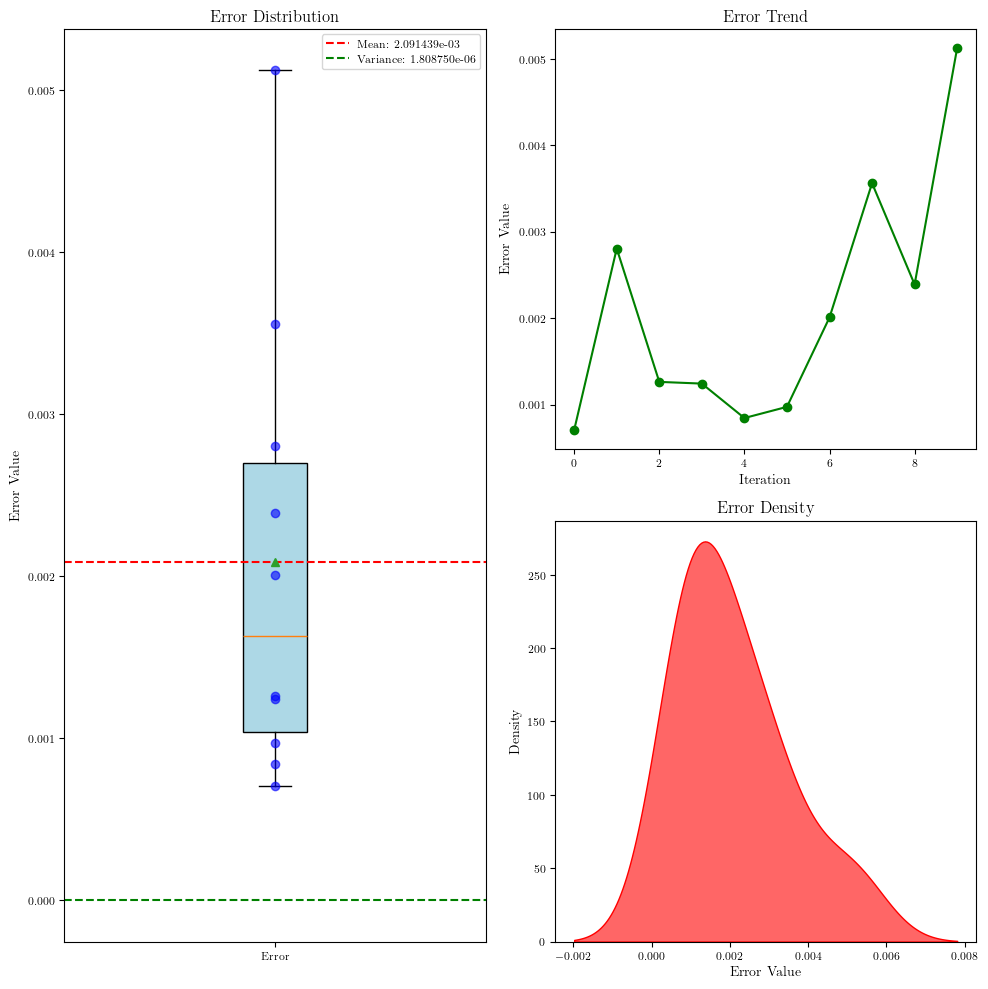

In [11]:


# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_u

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MAE: 3.666789e-04
Variance MAE: 1.212323e-08


/tmp/ipykernel_2912671/3997509801.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


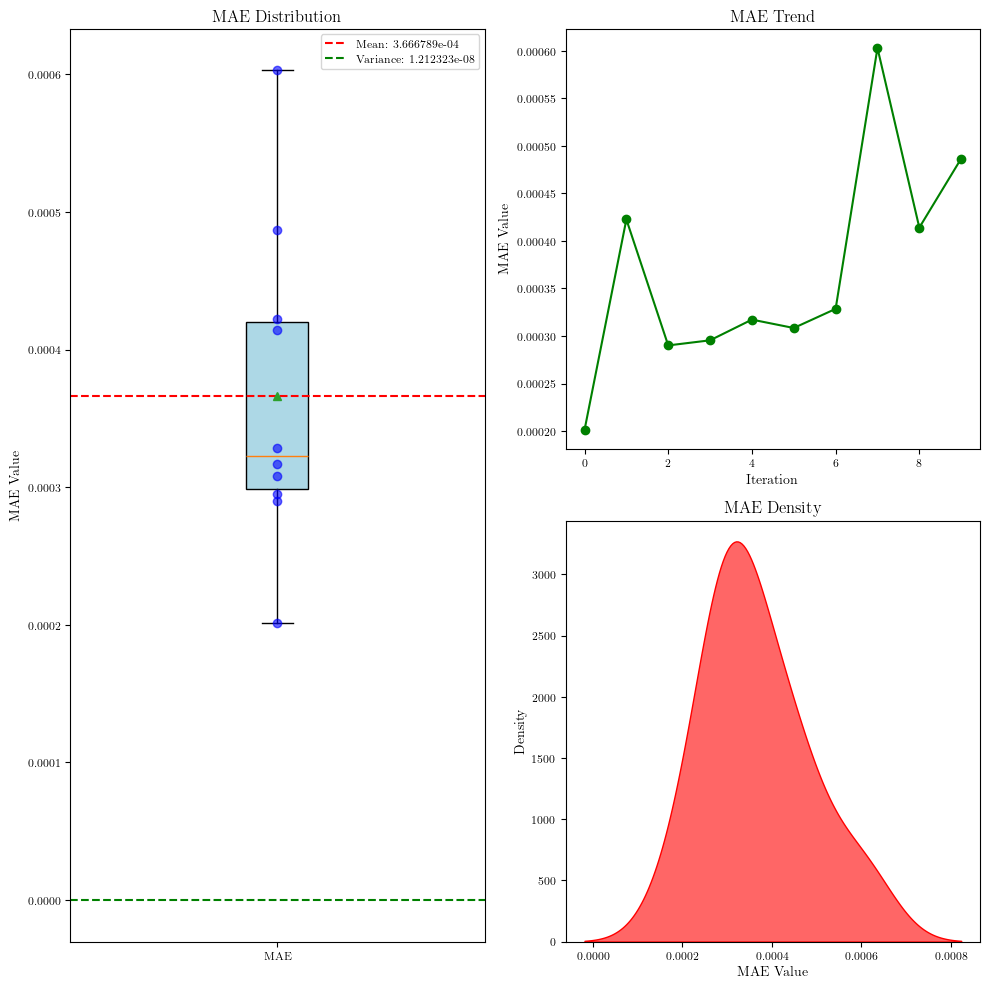

In [12]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MSE: 2.333480e-06
Variance MSE: 8.332015e-12


/tmp/ipykernel_2912671/2305667704.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


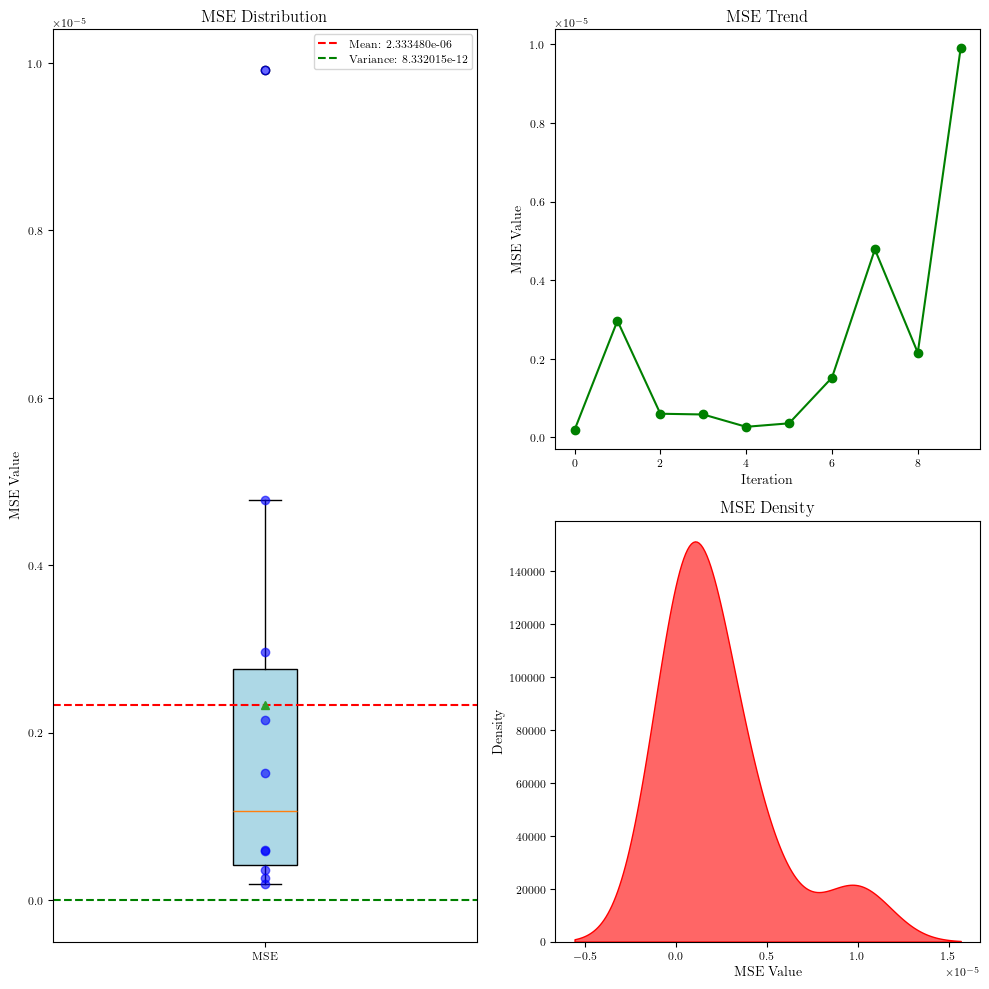

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

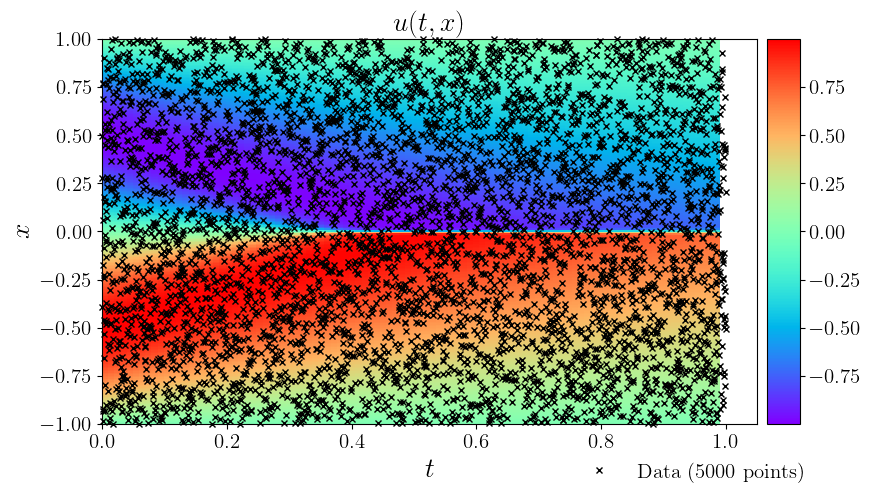

In [14]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [15]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

testerror = torch.stack(model.test_error).cpu().detach().numpy()

51945
[6.0001528e-01 5.7925141e-01 5.5952281e-01 ... 4.3961863e-06 4.3961863e-06
 4.3961863e-06]


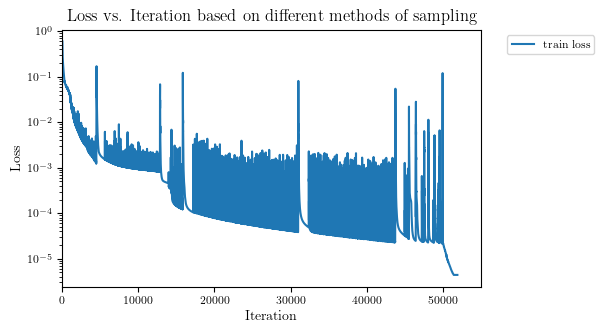

In [16]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

51945
[1.3411124  1.3215016  1.3025525  ... 0.00512405 0.00512405 0.00512405]


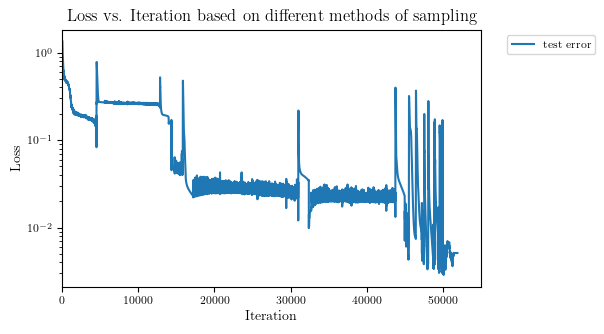

In [17]:
print(len(testerror))
print(testerror)
# 定义图例的标签
# labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(testerror, label='test error')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


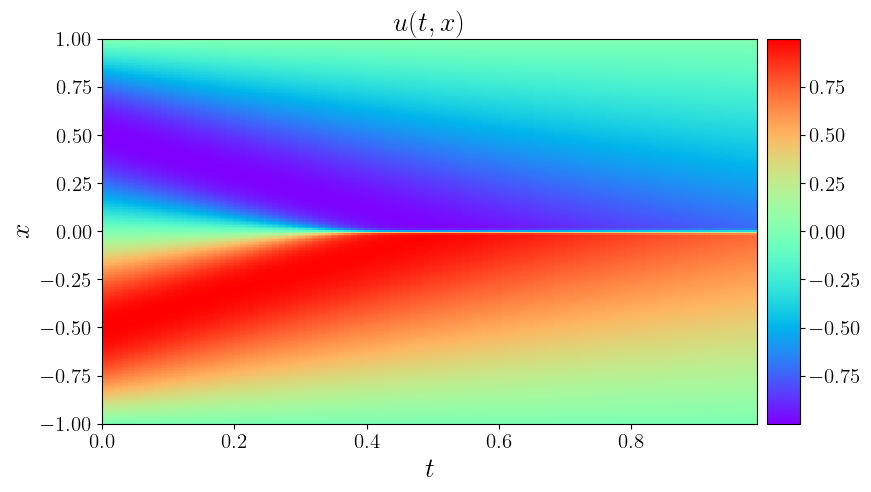

In [18]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_pred, f_pred = model.predict(X_star)    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


# #在图上绘制散点图
# ax.plot(
#     X_f_train[:,1], 
#     X_f_train[:,0], 
#     'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# ) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
#   #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

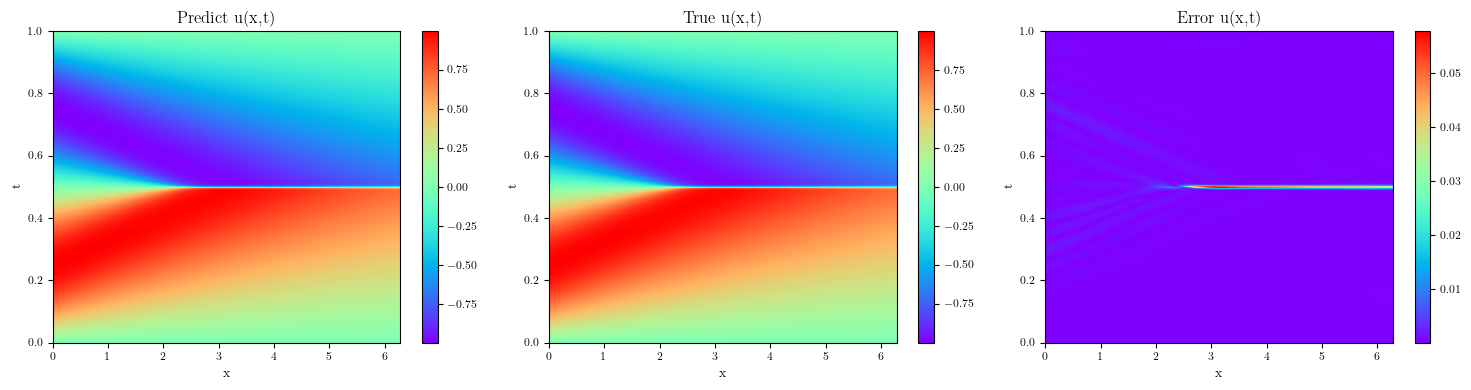

In [19]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_pred.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Predict u(x,t)')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_star.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('True u(x,t)')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 绘制第三幅图像
axes[2].imshow(np.abs(U_pred - U_star).T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[2].invert_yaxis()
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[2].set_title('Error u(x,t)')
fig.colorbar(axes[2].images[0], ax=axes[2])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()

In [20]:
#计算训练好模型的chaos（最后一个seed）
u_chaos = calculate_chaos(model, X_star, num_iter=50)
u_chaos_log = np.log(u_chaos + 1e-10) #对u_var取对数，然后加上一个很小的数，避免取对数时出现错误

#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_chaos = griddata(X_star, u_chaos.flatten(), (X, T), method='cubic')
U_chaos_log = griddata(X_star, u_chaos_log.flatten(), (X, T), method='cubic')

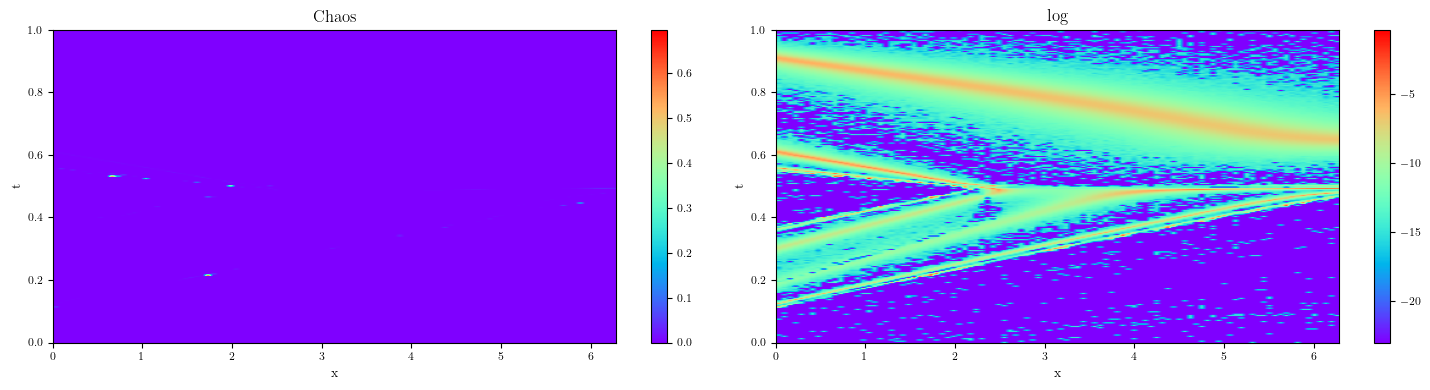

In [21]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_chaos.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Chaos')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_chaos_log.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('log')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()